# CS4287 Assignment03 - Atari
Kevin Collins 21344256 Olan Healy 21318204 Caoimhe Cahill 21331308

Code Runs without errors? Y
Note: We ran using GPU locally via google collab

Any third part relvant links?
- https://github.com/AnujaKatkar/OpenAI-Gym-Breakout-Env/blob/main/Notebooks/DQN_Breakout.ipynb


We have all the text blocks down below all the code blocks in order of the spec

In [ ]:
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
#!pip install ale_py
#!pip install gym[atari,accept-rom-license]

# We ran these in our local environment to make sure all dependencies were installed to do with the gym environment set up and utlising Nivida A100 GPU for pytorch configuration
# If you wish to run in google collab, you can uncomment these 3 lines and run these cells (provided you have a GPU that is able to run this)

In [ ]:
# Import necessacary librarires
import gym
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import random
from collections import deque
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import cv2

# Initialise random seeds for reproducibility.
# This ensures that the results of the training and evaluation are consistent every time the script is run so our results would be the same if you were to run it
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)  # Set PyTorch's CUDA random seed as we are using Nivida A100 GPU

# Breakout environment using the ALE/Breakout-v5 configuration from openAi gym
# render mode in rgb array to capture frames in rgb mode for visualisation
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

# Set the device to GPU if available (which was for us) for faster computation
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# The ALE namespace doesn't have max steps set for Breakout, so we explicty set it to 27,000 steps, default for atari against
env.spec.max_episode_steps = 27000

# Print out some environment details
print("Action Space:", env.action_space)
print("Observation Space:", env.observation_space)
print("Max Steps:", env.spec.max_episode_steps)
print("Reward Range:", env.reward_range)

# Set the state and action size
# state_size is the dimensions of the game's screen (which is used as input to our neural network)
# action_size is thee number actions available to the agent (Breakout offers [NOOP, FIRE, LEFT, RIGHT]
state_size = env.observation_space.shape
action_size = env.action_space.n

Action Space: Discrete(4)
Observation Space: Box(0, 255, (210, 160, 3), uint8)
Max Steps: 27000
Reward Range: (-inf, inf)


A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


In [ ]:
# Hyper Parameters defining
epsilon = 1.0 # Inital value of epsilon for greedy exploration, starting at 1 so it explores in early stages
epsilon_decay = 0.00012  # Low epsilion decay to help with our exploration in early stages
batch_size = 64 # Batch size for sampling experiences from the replay memory during training, originally set to 128 but was taking too long to train
learning_rate = 0.00015 # Learning Rat efor Adam optimiser defined later
discount_factor = 0.99 # Discount factor for calculating the present value of future rewards
memory_length = 100000 # Replay memory stores past experiences (state, action, reward, next state) for training. We set to high value to allow agent to learn from diverse experiences
episodes = 30000 # Each episode represents a single run of the game, from start until the environment signals termination
update_target_frequency = 5 # Frequency at which the target network's weights are updated with the policy network's weights
epsilon_min = 0.01  # A min value for epsilon but we never utilise this as didnt train for enough episodes. If we did it would have allowed the agent to focus on explotation

In [ ]:
def show_initial_state():
    """
    Metod to Visualise the initial state of the Breakout environment from OpenAi Gym
    This is used for 'Capturing' the environment
    """
    state = env.reset()  # Reset the environment to inital state
    if isinstance(state, tuple):
        state = state[0]
    # Plot state
    plt.imshow(state)
    plt.title("Initial State of Breakout Environment")
    plt.axis('off')
    plt.show()


def capture_and_show_frames():
    """
    Method to get and visualise the first 20 frames of the Breakout environment
    Used again for capturing information about what the environment looks like at start, showing off the game
    """
    frames = [] # Store frames
    state = env.reset()  # Reset the environment
    if isinstance(state, tuple):
        state = state[0]

    for _ in range(20):  # Loop to collect the first 20 frames
        frames.append(state)  # Store the frame in the list
        action = env.action_space.sample()  # Take a random action
        state, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated: # break if the state was ended or invalid
            break

    # MatPlot library used to display the frames in a 4x5 grid
    fig, axes = plt.subplots(4, 5, figsize=(12, 8))
    axes = axes.flatten()

    for i, frame in enumerate(frames):
        axes[i].imshow(frame)
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

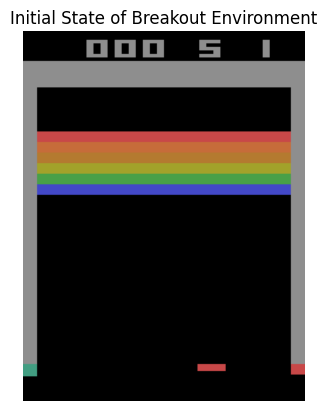

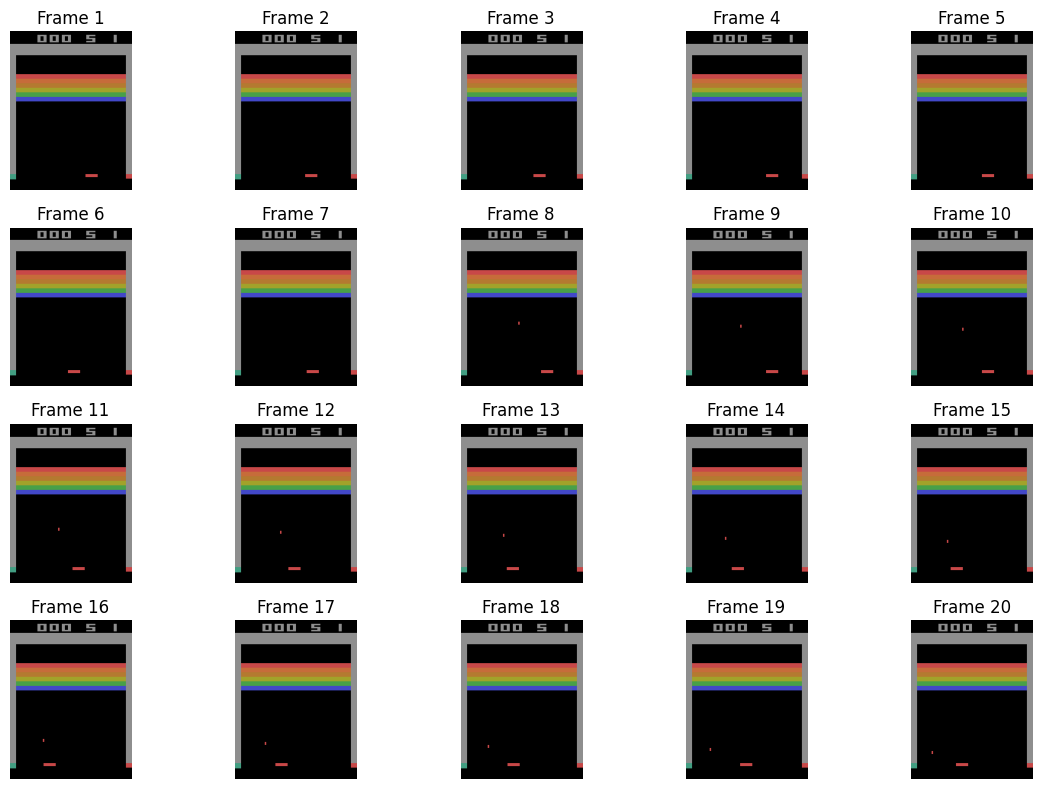

In [ ]:
show_initial_state()  # Call method for showing inital state
capture_and_show_frames()  # Call method for showing the frames

In [ ]:
def preprocess_state(state):
    """
    This function exists withing the DQN agent we used here also to allow us to show what the preproccessed inital state and frames look like
    """
    state = state[34:-16, :, :]  # Crop unnecessary parts of the frame
    transform = T.Compose([
        T.ToPILImage(),  # Convert to PIL image
        T.Grayscale(),   # Convert to grayscale
        T.Resize((84, 84)),  # Resize to 84x84
        T.ToTensor()  # Convert to tensor
    ])
    return transform(state).unsqueeze(0).to(device)

def show_initial_state(env, preprocess_function):
    """
    Metod to Visualise the initial state of preprocessed breakout
    This is used to show of what we did to preprocess
    """
    state = env.reset()  # Reset the environment
    if isinstance(state, tuple):
        state = state[0]

    preprocessed_state = preprocess_function(state).squeeze(0).cpu().numpy()  # Preprocess and convert to numpy array

    plt.imshow(preprocessed_state[0], cmap='gray')
    plt.title("Preprocessed Initial State of Breakout Environment")
    plt.axis('off')
    plt.show()


def capture_and_show_preprocessed_frames(env, preprocess_function):
    """
    Method to get and visualise the first 20 frames of the Breakout environment when its preproccessed
    Again this is just use to show of what we did to preprocess and how it looks at different stages in game
    """
    preprocessed_frames = []  # List to store preprocessed frames
    state = env.reset()  # Reset the environment
    if isinstance(state, tuple):
        state = state[0]

    for _ in range(20):  # Loop to collect the first 20 frames preproccssed
        preprocessed_frames.append(preprocess_function(state).squeeze(0).cpu().numpy()[0])   # Preprocess frames and convert and store to numpy array

        action = env.action_space.sample()  # Take a random action
        state, _, terminated, truncated, _ = env.step(action)
        if terminated or truncated:  # break if the state was ended or invalid
            break

    # MatPlot library used to display the frames in a 4x5 grid
    fig, axes = plt.subplots(4, 5, figsize=(12, 8))
    axes = axes.flatten()

    for i, frame in enumerate(preprocessed_frames):
        axes[i].imshow(frame, cmap='gray')
        axes[i].set_title(f"Preprocessed Frame {i+1}")
        axes[i].axis('off')

    # Hide unused axes if fewer than 20 frames are captured
    for j in range(len(preprocessed_frames), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


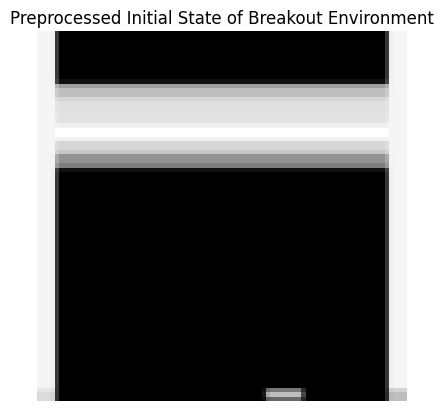

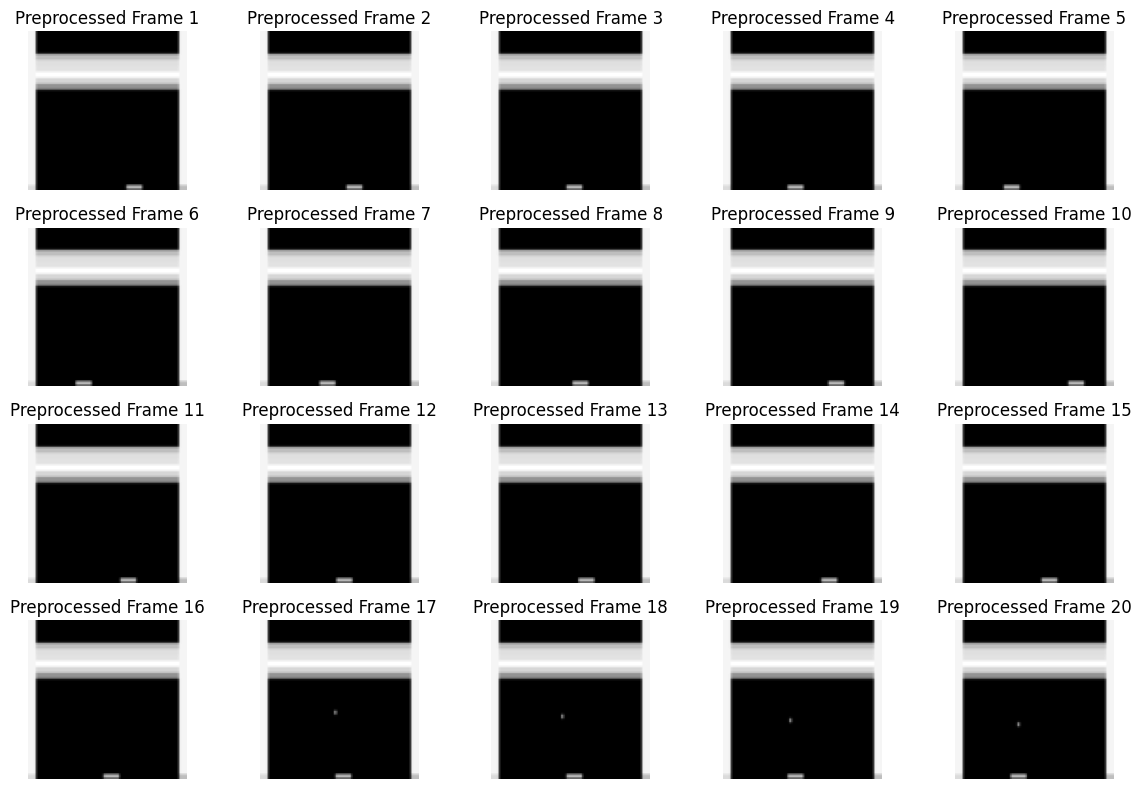

In [ ]:
show_initial_state(env, preprocess_state) # Call method for showing inital preprocessed state
capture_and_show_preprocessed_frames(env, preprocess_state) # Call method for showing first 20 frames preprocessed

In [ ]:
class DQN(nn.Module):
    """
    Class for our Deep Q Network (DQN)
    Deep Q Network (DQN) is a Convolutional Neural Network (CNN) designed to predict Q-values
    for a given state in the Breakout game environment. These Q-values represent the expected reward
    for each possible action, enabling the agent to make optimal decisions.

    This class defines the architecture of the network and its forward propagation method.
    """
    def __init__(self, input_shape, num_actions, learning_rate):
        super(DQN, self).__init__()
        # Covolutional layers for feature extration on the input frames
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4) # 1st layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2) # 2nd payer
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1) # 3rd layer
        # Dense layers for making decisions based on the features extracted
        self.fc1 = nn.Linear(64 * 7 * 7, 512) # 512 neurons
        self.fc2 = nn.Linear(512, num_actions) # One neuron linked with possible action
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate) # Adam optimiser for training the network

    def forward(self, x):
        """
        Forward pass through the network.
        """
        # Pass the input through the convolutional layers with ReLU activations
        x = torch.relu(self.conv1(x)) # ReLU to f1st layer
        x = torch.relu(self.conv2(x)) # ReLU to 2nd layer
        x = torch.relu(self.conv3(x)) # ReLU to 3rd layer
        x = torch.relu(self.fc1(x.view(x.size(0), -1))) # Flatten the tensor and pass it through the fully connected layers
        return self.fc2(x) # Return Q values for each action

In [ ]:
class DQNagent:
    """
    DQNagent implements a Deep Q-Network agent for reinforcement learning
    It maintains a policy network for decision making and a target network for stability during training
    """
    def __init__(self, state_size, action_size, memory_length, epsilon, epsilon_decay, epsilon_min, batch_size, learning_rate, discount_factor):
        # Save hyperparameters as defined from CODE BLOCK 2
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=memory_length)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Set up our Nivida A100 device *would run off cpu if cannot
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # Initalise policy and target networks to our gpu
        self.policy_net = DQN((4, 84, 84), self.action_size, self.learning_rate).to(self.device)
        self.target_net = DQN((4, 84, 84), self.action_size, self.learning_rate).to(self.device)

        # synchronise target network with policy network initally
        self.update_target_policy()

    def update_target_policy(self):
        """
        Copy weights from the policy network to the target network, helps stablise training
        """
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def preprocess_state(self, state):
        """
        Preprocess function as stated earlier
        Preprocesses a single raw frame by cropping, resizing, converting to grayscale, and normalising
        """
        state = state[34:-16, :, :]
        transform = T.Compose([
            T.ToPILImage(),
            T.Grayscale(),
            T.Resize((84, 84)),
            T.ToTensor()
        ])
        return transform(state).to(device)

    def choose_action(self, state):
        """
        Method to select an action based on epsilon-greedy policy
        With this a random action is chosen for exploration, otherwise, the action with the highest Q-value is chosen for exploitation.
        """
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size) # Random action for exploration
        state = state.clone().detach().to(device)
        with torch.no_grad():
            q_values = self.policy_net(state) # Get Q-values for all actions
        return torch.argmax(q_values).item()  # Choose the action with the highest Q-value

    def update_epsilon(self):
        '''
        Method to decay the epsilon value so the agent will learn better
        '''
        self.epsilon -= (self.epsilon * self.epsilon_decay)
        return self.epsilon

    def append_memory(self, state, action, reward, next_state, done):
       '''
        Method for replay bugger to store experience for training
        '''
        self.memory.append((state, action, reward, next_state, done))

    def train(self):
        """
        Method to train the policy network by sampling a batch of experiences from the replay buffer
        It Updates Q-values using the Bellman equation and minimises the loss
        Mean Squared Error (MSE)  is used as the loss function
        Adam optimizer is used for weight updates
        """
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        states = torch.cat(states).to(device)
        next_states = torch.cat(next_states).to(device)
        actions = torch.tensor(actions).to(device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        dones = torch.tensor(dones, dtype=torch.bool).to(device)

        q_values = self.policy_net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
        next_q_values = self.target_net(next_states).max(1)[0]
        targets = rewards + (self.discount_factor * next_q_values * (~dones))
        loss = nn.MSELoss()(q_values, targets)

        self.policy_net.optimizer.zero_grad()
        loss.backward()
        self.policy_net.optimizer.step()

In [ ]:
def save_checkpoint(agent, episode, reward_history, filepath="checkpoint_breakout.pth"):
    """
    Method to save the current state of the agent's training process as a checkpoint
    We created this as one issue we faced was disconnecting from CSIS server wheter connection timeout or VPN crashing
    We also realised after running we should have
    """

    checkpoint = {
        "policy_net_state": agent.policy_net.state_dict(),
        "target_net_state": agent.target_net.state_dict(),
        "optimizer_state": agent.policy_net.optimizer.state_dict(),
        "memory": list(agent.memory),
        "epsilon": agent.epsilon,
        "episode": episode,
        "reward_history": reward_history,
    }
    torch.save(checkpoint, filepath)
    print(f"Checkpoint saved at episode {episode}")

# Define a load checkpoint function
def load_checkpoint(agent, filepath="checkpoint_breakout.pth"):
   """
    Method then to reload the checkpoint so we could resume training, which we used after after it crashed withing first 12,000 episodes
    """
    if os.path.exists(filepath):
        checkpoint = torch.load(filepath)
        agent.policy_net.load_state_dict(checkpoint["policy_net_state"])
        agent.target_net.load_state_dict(checkpoint["target_net_state"])
        agent.policy_net.optimizer.load_state_dict(checkpoint["optimizer_state"])
        agent.memory = deque(checkpoint["memory"], maxlen=memory_length)
        agent.epsilon = checkpoint["epsilon"]
        episode = checkpoint["episode"]
        reward_history = checkpoint["reward_history"]
        print(f"Checkpoint loaded. Resuming from episode {episode}")
        return episode, reward_history
    else:
        print("No checkpoint found. Starting from scratch.")
        return 0, []

In [ ]:
# Instantiate the DQN agent
agent = DQNagent(state_size, action_size, memory_length, epsilon, epsilon_decay, epsilon_min, batch_size, learning_rate, discount_factor)

# Initialise metric to track for graphing
reward_history = []  # Total reward per episode
epsilon_decay_arr = []  # Track epsilon decay
cumulative_rewards = []  # Cumulative rewards across episodes
avg_reward_arr = []  # Sliding average reward
win_count = 0  # # Counter to track the number of episodes where the reward exceeds the winning threshold
win_threshold = 50  # Reward threshold considered as a "win" for us in this game

# Load from checkpoint if exists otherwise we can train
start_episode, reward_history = load_checkpoint(agent)

# Begin training loop over our number of episodes (30,000 as dfined earlier)
for episode in tqdm(range(start_episode, episodes)):
    # Reset environment for new episodes
    state, _ = env.reset()
    state = agent.preprocess_state(state)  # Preprocess the initial state
    state = torch.cat([state] * 4).unsqueeze(0)  Stack the initial state 4 times to create the input
    total_reward = 0  # Initialise the total reward for the episode
    timesteps = 0  # Counter for the number of timesteps in the episode
    done = False # Set is episdoe done to false

    while not done:
        # Choose action
        action = agent.choose_action(state)

        # Take action in the environment
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated # Determine if the episode is finished i.e dead
        next_state = agent.preprocess_state(next_state) # Preprocess the resulting state
        next_state = torch.cat([state.squeeze(0)[1:], next_state]).unsqueeze(0)  # Update state stack
        total_reward += reward
        timesteps += 1

        # Store experience in memory
        agent.append_memory(state, action, reward, next_state, done)

        # Train agents policy network
        if timesteps % 16 == 0:
            agent.train()

        # Update state
        state = next_state

    # Update epsilon after each episode using method in agent defined earlier
    agent.update_epsilon()

    # Update target network at regular intervals
    if episode % update_target_frequency == 0:
        agent.update_target_policy()

    # Track metrics for the episode
    reward_history.append(total_reward)
    cumulative_rewards.append(sum(reward_history))
    epsilon_decay_arr.append(agent.epsilon)
    avg_reward_arr.append(np.mean(reward_history[-100:]) if len(reward_history) >= 100 else np.mean(reward_history))

    # Check for our win
    if total_reward > win_threshold:
        win_count += 1

    # Print episode summary
    print(f"Episode {episode}, Total Reward: {total_reward}, Wins: {win_count}, Avg Reward (Last 100): {avg_reward_arr[-1]:.2f}, Epsilon: {agent.epsilon:.6f}")

    # Save checkpoint every 2000 episodes
    if (episode + 1) % 2000 == 0:
        save_checkpoint(agent, episode + 1, reward_history)

# Save the final model
torch.save(agent.policy_net.state_dict(), "dqn_breakout_final.pth")




/tmp/ipykernel_2509528/2788232058.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath)


Checkpoint loaded. Resuming from episode 12000


  0%|                                                                               | 1/18000 [00:01<8:29:37,  1.70s/it]

Episode 12000, Total Reward: 44.0, Wins: 0, Avg Reward (Last 100): 23.76, Epsilon: 0.236879


  0%|                                                                               | 2/18000 [00:02<6:21:44,  1.27s/it]

Episode 12001, Total Reward: 15.0, Wins: 0, Avg Reward (Last 100): 23.78, Epsilon: 0.236850


  0%|                                                                               | 3/18000 [00:04<6:39:17,  1.33s/it]

Episode 12002, Total Reward: 22.0, Wins: 0, Avg Reward (Last 100): 23.70, Epsilon: 0.236822


  0%|                                                                               | 4/18000 [00:05<6:03:41,  1.21s/it]

Episode 12003, Total Reward: 22.0, Wins: 0, Avg Reward (Last 100): 23.71, Epsilon: 0.236794


  0%|                                                                               | 5/18000 [00:06<7:11:04,  1.44s/it]

Episode 12004, Total Reward: 40.0, Wins: 0, Avg Reward (Last 100): 24.00, Epsilon: 0.236765


  0%|                                                                               | 6/18000 [00:08<6:37:27,  1.33s/it]

Episode 12005, Total Reward: 22.0, Wins: 0, Avg Reward (Last 100): 24.03, Epsilon: 0.236737


  0%|                                                                               | 7/18000 [00:09<7:12:17,  1.44s/it]

Episode 12006, Total Reward: 42.0, Wins: 0, Avg Reward (Last 100): 24.25, Epsilon: 0.236708


  0%|                                                                               | 8/18000 [00:10<5:55:41,  1.19s/it]

Episode 12007, Total Reward: 8.0, Wins: 0, Avg Reward (Last 100): 24.10, Epsilon: 0.236680


  0%|                                                                               | 9/18000 [00:11<6:09:58,  1.23s/it]

Episode 12008, Total Reward: 27.0, Wins: 0, Avg Reward (Last 100): 24.06, Epsilon: 0.236652


  0%|                                                                              | 10/18000 [00:12<6:15:02,  1.25s/it]

Episode 12009, Total Reward: 22.0, Wins: 0, Avg Reward (Last 100): 24.21, Epsilon: 0.236623


  0%|                                                                              | 11/18000 [00:14<6:12:46,  1.24s/it]

Episode 12010, Total Reward: 29.0, Wins: 0, Avg Reward (Last 100): 24.22, Epsilon: 0.236595


  0%|                                                                              | 12/18000 [00:15<6:57:37,  1.39s/it]

Episode 12011, Total Reward: 42.0, Wins: 0, Avg Reward (Last 100): 24.48, Epsilon: 0.236566


  0%|                                                                              | 13/18000 [00:16<6:15:18,  1.25s/it]

Episode 12012, Total Reward: 13.0, Wins: 0, Avg Reward (Last 100): 24.49, Epsilon: 0.236538


  0%|                                                                              | 14/18000 [00:17<5:34:52,  1.12s/it]

Episode 12013, Total Reward: 11.0, Wins: 0, Avg Reward (Last 100): 24.27, Epsilon: 0.236510


  0%|                                                                              | 15/18000 [00:18<4:49:53,  1.03it/s]

Episode 12014, Total Reward: 8.0, Wins: 0, Avg Reward (Last 100): 24.01, Epsilon: 0.236481


  0%|                                                                              | 16/18000 [00:19<5:32:32,  1.11s/it]

Episode 12015, Total Reward: 25.0, Wins: 0, Avg Reward (Last 100): 24.02, Epsilon: 0.236453


  0%|                                                                              | 17/18000 [00:20<5:34:22,  1.12s/it]

Episode 12016, Total Reward: 16.0, Wins: 0, Avg Reward (Last 100): 23.95, Epsilon: 0.236424


  0%|                                                                              | 18/18000 [00:22<6:27:22,  1.29s/it]

Episode 12017, Total Reward: 28.0, Wins: 0, Avg Reward (Last 100): 23.82, Epsilon: 0.236396


  0%|                                                                              | 19/18000 [00:23<5:48:18,  1.16s/it]

Episode 12018, Total Reward: 12.0, Wins: 0, Avg Reward (Last 100): 23.73, Epsilon: 0.236368


  0%|                                                                              | 20/18000 [00:24<5:11:29,  1.04s/it]

Episode 12019, Total Reward: 9.0, Wins: 0, Avg Reward (Last 100): 23.65, Epsilon: 0.236339


  0%|                                                                              | 21/18000 [00:24<4:45:13,  1.05it/s]

Episode 12020, Total Reward: 10.0, Wins: 0, Avg Reward (Last 100): 23.40, Epsilon: 0.236311


  0%|                                                                              | 22/18000 [00:25<4:29:46,  1.11it/s]

Episode 12021, Total Reward: 10.0, Wins: 0, Avg Reward (Last 100): 23.31, Epsilon: 0.236283


  0%|                                                                              | 23/18000 [00:27<5:38:58,  1.13s/it]

Episode 12022, Total Reward: 41.0, Wins: 0, Avg Reward (Last 100): 23.41, Epsilon: 0.236254


  0%|                                                                              | 24/18000 [00:29<6:48:46,  1.36s/it]

Episode 12023, Total Reward: 47.0, Wins: 0, Avg Reward (Last 100): 23.69, Epsilon: 0.236226


  0%|                                                                              | 25/18000 [00:30<6:41:48,  1.34s/it]

Episode 12024, Total Reward: 30.0, Wins: 0, Avg Reward (Last 100): 23.78, Epsilon: 0.236198


  0%|                                                                              | 26/18000 [00:31<6:00:22,  1.20s/it]

Episode 12025, Total Reward: 10.0, Wins: 0, Avg Reward (Last 100): 23.69, Epsilon: 0.236169


  0%|                                                                              | 27/18000 [00:32<5:42:27,  1.14s/it]

Episode 12026, Total Reward: 13.0, Wins: 0, Avg Reward (Last 100): 23.74, Epsilon: 0.236141


  0%|                                                                              | 28/18000 [00:33<6:04:43,  1.22s/it]

Episode 12027, Total Reward: 32.0, Wins: 0, Avg Reward (Last 100): 23.74, Epsilon: 0.236113


  0%|▏                                                                             | 29/18000 [00:34<5:42:07,  1.14s/it]

Episode 12028, Total Reward: 18.0, Wins: 0, Avg Reward (Last 100): 23.64, Epsilon: 0.236084


  0%|▏                                                                             | 30/18000 [00:36<6:13:17,  1.25s/it]

Episode 12029, Total Reward: 28.0, Wins: 0, Avg Reward (Last 100): 23.78, Epsilon: 0.236056


  0%|▏                                                                             | 31/18000 [00:38<6:56:32,  1.39s/it]

Episode 12030, Total Reward: 36.0, Wins: 0, Avg Reward (Last 100): 24.06, Epsilon: 0.236028


  0%|▏                                                                             | 32/18000 [00:39<6:38:14,  1.33s/it]

Episode 12031, Total Reward: 20.0, Wins: 0, Avg Reward (Last 100): 24.09, Epsilon: 0.235999


  0%|▏                                                                             | 33/18000 [00:40<7:00:59,  1.41s/it]

Episode 12032, Total Reward: 29.0, Wins: 0, Avg Reward (Last 100): 24.02, Epsilon: 0.235971


  0%|▏                                                                             | 34/18000 [00:41<6:00:47,  1.20s/it]

Episode 12033, Total Reward: 10.0, Wins: 0, Avg Reward (Last 100): 24.02, Epsilon: 0.235943


  0%|▏                                                                             | 35/18000 [00:42<6:21:52,  1.28s/it]

Episode 12034, Total Reward: 22.0, Wins: 0, Avg Reward (Last 100): 23.80, Epsilon: 0.235914


  0%|▏                                                                             | 36/18000 [00:44<6:17:39,  1.26s/it]

Episode 12035, Total Reward: 28.0, Wins: 0, Avg Reward (Last 100): 23.88, Epsilon: 0.235886


  0%|▏                                                                             | 37/18000 [00:45<6:41:07,  1.34s/it]

Episode 12036, Total Reward: 38.0, Wins: 0, Avg Reward (Last 100): 23.84, Epsilon: 0.235858


  0%|▏                                                                             | 38/18000 [00:46<6:08:22,  1.23s/it]

Episode 12037, Total Reward: 20.0, Wins: 0, Avg Reward (Last 100): 23.72, Epsilon: 0.235829


  0%|▏                                                                             | 39/18000 [00:47<5:45:38,  1.15s/it]

Episode 12038, Total Reward: 16.0, Wins: 0, Avg Reward (Last 100): 23.48, Epsilon: 0.235801


  0%|▏                                                                             | 40/18000 [00:48<5:33:11,  1.11s/it]

Episode 12039, Total Reward: 14.0, Wins: 0, Avg Reward (Last 100): 23.21, Epsilon: 0.235773


  0%|▏                                                                             | 41/18000 [00:49<5:13:03,  1.05s/it]

Episode 12040, Total Reward: 12.0, Wins: 0, Avg Reward (Last 100): 23.07, Epsilon: 0.235744


  0%|▏                                                                             | 42/18000 [00:50<4:48:46,  1.04it/s]

Episode 12041, Total Reward: 8.0, Wins: 0, Avg Reward (Last 100): 22.62, Epsilon: 0.235716


  0%|▏                                                                             | 43/18000 [00:51<4:32:12,  1.10it/s]

Episode 12042, Total Reward: 13.0, Wins: 0, Avg Reward (Last 100): 22.43, Epsilon: 0.235688


  0%|▏                                                                             | 44/18000 [00:52<4:30:13,  1.11it/s]

Episode 12043, Total Reward: 11.0, Wins: 0, Avg Reward (Last 100): 22.30, Epsilon: 0.235660


  0%|▏                                                                             | 45/18000 [00:52<3:55:55,  1.27it/s]

Episode 12044, Total Reward: 6.0, Wins: 0, Avg Reward (Last 100): 22.31, Epsilon: 0.235631


  0%|▏                                                                             | 46/18000 [00:53<4:18:49,  1.16it/s]

Episode 12045, Total Reward: 15.0, Wins: 0, Avg Reward (Last 100): 22.29, Epsilon: 0.235603


  0%|▏                                                                             | 47/18000 [00:54<4:36:14,  1.08it/s]

Episode 12046, Total Reward: 23.0, Wins: 0, Avg Reward (Last 100): 22.38, Epsilon: 0.235575


  0%|▏                                                                             | 48/18000 [00:55<4:46:56,  1.04it/s]

Episode 12047, Total Reward: 20.0, Wins: 0, Avg Reward (Last 100): 22.18, Epsilon: 0.235547


  0%|▏                                                                             | 49/18000 [00:57<5:51:57,  1.18s/it]

Episode 12048, Total Reward: 31.0, Wins: 0, Avg Reward (Last 100): 22.25, Epsilon: 0.235518


  0%|▏                                                                             | 50/18000 [00:58<5:59:51,  1.20s/it]

Episode 12049, Total Reward: 39.0, Wins: 0, Avg Reward (Last 100): 22.41, Epsilon: 0.235490


  0%|▏                                                                             | 51/18000 [01:00<6:38:55,  1.33s/it]

Episode 12050, Total Reward: 33.0, Wins: 0, Avg Reward (Last 100): 22.18, Epsilon: 0.235462


  0%|▏                                                                             | 52/18000 [01:01<6:16:55,  1.26s/it]

Episode 12051, Total Reward: 15.0, Wins: 0, Avg Reward (Last 100): 22.20, Epsilon: 0.235434


  0%|▏                                                                             | 53/18000 [01:02<6:30:09,  1.30s/it]

Episode 12052, Total Reward: 26.0, Wins: 0, Avg Reward (Last 100): 22.25, Epsilon: 0.235405


  0%|▏                                                                             | 54/18000 [01:04<6:21:11,  1.27s/it]

Episode 12053, Total Reward: 18.0, Wins: 0, Avg Reward (Last 100): 22.19, Epsilon: 0.235377


  0%|▏                                                                             | 55/18000 [01:05<6:52:28,  1.38s/it]

Episode 12054, Total Reward: 30.0, Wins: 0, Avg Reward (Last 100): 22.30, Epsilon: 0.235349


  0%|▏                                                                             | 56/18000 [01:06<6:00:42,  1.21s/it]

Episode 12055, Total Reward: 14.0, Wins: 0, Avg Reward (Last 100): 22.32, Epsilon: 0.235321


  0%|▏                                                                             | 57/18000 [01:07<5:43:46,  1.15s/it]

Episode 12056, Total Reward: 15.0, Wins: 0, Avg Reward (Last 100): 22.12, Epsilon: 0.235292


  0%|▎                                                                             | 58/18000 [01:08<5:43:54,  1.15s/it]

Episode 12057, Total Reward: 17.0, Wins: 0, Avg Reward (Last 100): 22.03, Epsilon: 0.235264


  0%|▎                                                                             | 59/18000 [01:09<5:35:57,  1.12s/it]

Episode 12058, Total Reward: 15.0, Wins: 0, Avg Reward (Last 100): 21.98, Epsilon: 0.235236


  0%|▎                                                                             | 60/18000 [01:11<6:36:55,  1.33s/it]

Episode 12059, Total Reward: 34.0, Wins: 0, Avg Reward (Last 100): 22.22, Epsilon: 0.235208


  0%|▎                                                                             | 61/18000 [01:12<6:49:38,  1.37s/it]

Episode 12060, Total Reward: 20.0, Wins: 0, Avg Reward (Last 100): 22.21, Epsilon: 0.235179


  0%|▎                                                                             | 62/18000 [01:14<7:34:40,  1.52s/it]

Episode 12061, Total Reward: 47.0, Wins: 0, Avg Reward (Last 100): 22.21, Epsilon: 0.235151


  0%|▎                                                                             | 63/18000 [01:16<7:06:10,  1.43s/it]

Episode 12062, Total Reward: 26.0, Wins: 0, Avg Reward (Last 100): 22.04, Epsilon: 0.235123


  0%|▎                                                                             | 64/18000 [01:17<7:17:39,  1.46s/it]

Episode 12063, Total Reward: 29.0, Wins: 0, Avg Reward (Last 100): 22.00, Epsilon: 0.235095


  0%|▎                                                                             | 65/18000 [01:18<6:49:53,  1.37s/it]

Episode 12064, Total Reward: 17.0, Wins: 0, Avg Reward (Last 100): 21.93, Epsilon: 0.235066


  0%|▎                                                                             | 66/18000 [01:20<7:22:45,  1.48s/it]

Episode 12065, Total Reward: 31.0, Wins: 0, Avg Reward (Last 100): 22.16, Epsilon: 0.235038


  0%|▎                                                                             | 67/18000 [01:22<7:59:50,  1.61s/it]

Episode 12066, Total Reward: 48.0, Wins: 0, Avg Reward (Last 100): 22.38, Epsilon: 0.235010


  0%|▎                                                                             | 68/18000 [01:24<8:30:37,  1.71s/it]

Episode 12067, Total Reward: 37.0, Wins: 0, Avg Reward (Last 100): 22.43, Epsilon: 0.234982


  0%|▎                                                                             | 69/18000 [01:25<7:35:05,  1.52s/it]

Episode 12068, Total Reward: 25.0, Wins: 0, Avg Reward (Last 100): 22.41, Epsilon: 0.234954


  0%|▎                                                                             | 70/18000 [01:27<8:01:58,  1.61s/it]

Episode 12069, Total Reward: 49.0, Wins: 0, Avg Reward (Last 100): 22.67, Epsilon: 0.234925


  0%|▎                                                                             | 71/18000 [01:28<6:55:09,  1.39s/it]

Episode 12070, Total Reward: 11.0, Wins: 0, Avg Reward (Last 100): 22.57, Epsilon: 0.234897


  0%|▎                                                                             | 72/18000 [01:29<7:09:01,  1.44s/it]

Episode 12071, Total Reward: 27.0, Wins: 0, Avg Reward (Last 100): 22.68, Epsilon: 0.234869


  0%|▎                                                                             | 73/18000 [01:31<8:10:12,  1.64s/it]

Episode 12072, Total Reward: 53.0, Wins: 1, Avg Reward (Last 100): 23.05, Epsilon: 0.234841


  0%|▎                                                                             | 74/18000 [01:33<7:50:29,  1.57s/it]

Episode 12073, Total Reward: 37.0, Wins: 1, Avg Reward (Last 100): 23.32, Epsilon: 0.234813


  0%|▎                                                                             | 75/18000 [01:34<7:20:06,  1.47s/it]

Episode 12074, Total Reward: 26.0, Wins: 1, Avg Reward (Last 100): 23.48, Epsilon: 0.234785


  0%|▎                                                                             | 76/18000 [01:35<6:41:24,  1.34s/it]

Episode 12075, Total Reward: 14.0, Wins: 1, Avg Reward (Last 100): 23.50, Epsilon: 0.234756


  0%|▎                                                                             | 77/18000 [01:36<6:47:34,  1.36s/it]

Episode 12076, Total Reward: 27.0, Wins: 1, Avg Reward (Last 100): 23.52, Epsilon: 0.234728


  0%|▎                                                                             | 78/18000 [01:38<6:40:54,  1.34s/it]

Episode 12077, Total Reward: 25.0, Wins: 1, Avg Reward (Last 100): 23.62, Epsilon: 0.234700


  0%|▎                                                                             | 79/18000 [01:39<7:21:02,  1.48s/it]

Episode 12078, Total Reward: 44.0, Wins: 1, Avg Reward (Last 100): 23.77, Epsilon: 0.234672


  0%|▎                                                                             | 80/18000 [01:41<7:04:11,  1.42s/it]

Episode 12079, Total Reward: 28.0, Wins: 1, Avg Reward (Last 100): 23.84, Epsilon: 0.234644


  0%|▎                                                                             | 81/18000 [01:42<6:16:31,  1.26s/it]

Episode 12080, Total Reward: 12.0, Wins: 1, Avg Reward (Last 100): 23.65, Epsilon: 0.234616


  0%|▎                                                                             | 82/18000 [01:43<5:56:49,  1.19s/it]

Episode 12081, Total Reward: 13.0, Wins: 1, Avg Reward (Last 100): 23.55, Epsilon: 0.234587


  0%|▎                                                                             | 83/18000 [01:43<5:16:10,  1.06s/it]

Episode 12082, Total Reward: 18.0, Wins: 1, Avg Reward (Last 100): 23.65, Epsilon: 0.234559


  0%|▎                                                                             | 84/18000 [01:44<5:01:30,  1.01s/it]

Episode 12083, Total Reward: 12.0, Wins: 1, Avg Reward (Last 100): 23.57, Epsilon: 0.234531


  0%|▎                                                                             | 85/18000 [01:45<4:49:00,  1.03it/s]

Episode 12084, Total Reward: 14.0, Wins: 1, Avg Reward (Last 100): 23.56, Epsilon: 0.234503


  0%|▎                                                                             | 86/18000 [01:46<4:38:42,  1.07it/s]

Episode 12085, Total Reward: 10.0, Wins: 1, Avg Reward (Last 100): 23.55, Epsilon: 0.234475


  0%|▍                                                                             | 87/18000 [01:48<6:17:21,  1.26s/it]

Episode 12086, Total Reward: 49.0, Wins: 1, Avg Reward (Last 100): 23.92, Epsilon: 0.234447


  0%|▍                                                                             | 88/18000 [01:49<5:46:19,  1.16s/it]

Episode 12087, Total Reward: 12.0, Wins: 1, Avg Reward (Last 100): 23.75, Epsilon: 0.234419


  0%|▍                                                                             | 89/18000 [01:50<5:43:11,  1.15s/it]

Episode 12088, Total Reward: 18.0, Wins: 1, Avg Reward (Last 100): 23.48, Epsilon: 0.234390


  0%|▍                                                                             | 90/18000 [01:52<6:26:07,  1.29s/it]

Episode 12089, Total Reward: 28.0, Wins: 1, Avg Reward (Last 100): 23.54, Epsilon: 0.234362


  1%|▍                                                                             | 91/18000 [01:53<6:02:00,  1.21s/it]

Episode 12090, Total Reward: 17.0, Wins: 1, Avg Reward (Last 100): 23.50, Epsilon: 0.234334


  1%|▍                                                                             | 92/18000 [01:55<7:05:10,  1.42s/it]

Episode 12091, Total Reward: 39.0, Wins: 1, Avg Reward (Last 100): 23.76, Epsilon: 0.234306


  1%|▍                                                                             | 93/18000 [01:56<6:51:01,  1.38s/it]

Episode 12092, Total Reward: 19.0, Wins: 1, Avg Reward (Last 100): 23.69, Epsilon: 0.234278


  1%|▍                                                                             | 94/18000 [01:58<7:21:46,  1.48s/it]

Episode 12093, Total Reward: 37.0, Wins: 1, Avg Reward (Last 100): 23.62, Epsilon: 0.234250


  1%|▍                                                                             | 95/18000 [01:59<7:16:32,  1.46s/it]

Episode 12094, Total Reward: 30.0, Wins: 1, Avg Reward (Last 100): 23.55, Epsilon: 0.234222


  1%|▍                                                                             | 96/18000 [02:01<7:29:07,  1.51s/it]

Episode 12095, Total Reward: 32.0, Wins: 1, Avg Reward (Last 100): 23.66, Epsilon: 0.234194


  1%|▍                                                                             | 97/18000 [02:02<6:39:18,  1.34s/it]

Episode 12096, Total Reward: 12.0, Wins: 1, Avg Reward (Last 100): 23.72, Epsilon: 0.234166


  1%|▍                                                                             | 98/18000 [02:02<5:26:57,  1.10s/it]

Episode 12097, Total Reward: 6.0, Wins: 1, Avg Reward (Last 100): 23.58, Epsilon: 0.234137


  1%|▍                                                                             | 99/18000 [02:03<5:02:07,  1.01s/it]

Episode 12098, Total Reward: 10.0, Wins: 1, Avg Reward (Last 100): 23.44, Epsilon: 0.234109


  1%|▍                                                                            | 100/18000 [02:04<5:19:31,  1.07s/it]

Episode 12099, Total Reward: 21.0, Wins: 1, Avg Reward (Last 100): 23.54, Epsilon: 0.234081


  1%|▍                                                                            | 101/18000 [02:05<4:53:44,  1.02it/s]

Episode 12100, Total Reward: 9.0, Wins: 1, Avg Reward (Last 100): 23.19, Epsilon: 0.234053


  1%|▍                                                                            | 102/18000 [02:07<5:50:04,  1.17s/it]

Episode 12101, Total Reward: 30.0, Wins: 1, Avg Reward (Last 100): 23.34, Epsilon: 0.234025


  1%|▍                                                                            | 103/18000 [02:08<5:48:11,  1.17s/it]

Episode 12102, Total Reward: 20.0, Wins: 1, Avg Reward (Last 100): 23.32, Epsilon: 0.233997


  1%|▍                                                                            | 104/18000 [02:09<5:51:30,  1.18s/it]

Episode 12103, Total Reward: 29.0, Wins: 1, Avg Reward (Last 100): 23.39, Epsilon: 0.233969


  1%|▍                                                                            | 105/18000 [02:10<6:06:55,  1.23s/it]

Episode 12104, Total Reward: 32.0, Wins: 1, Avg Reward (Last 100): 23.31, Epsilon: 0.233941


  1%|▍                                                                            | 106/18000 [02:11<6:02:59,  1.22s/it]

Episode 12105, Total Reward: 21.0, Wins: 1, Avg Reward (Last 100): 23.30, Epsilon: 0.233913


  1%|▍                                                                            | 107/18000 [02:12<5:39:05,  1.14s/it]

Episode 12106, Total Reward: 13.0, Wins: 1, Avg Reward (Last 100): 23.01, Epsilon: 0.233885


  1%|▍                                                                            | 108/18000 [02:14<6:36:11,  1.33s/it]

Episode 12107, Total Reward: 58.0, Wins: 2, Avg Reward (Last 100): 23.51, Epsilon: 0.233857


  1%|▍                                                                            | 109/18000 [02:16<7:14:58,  1.46s/it]

Episode 12108, Total Reward: 30.0, Wins: 2, Avg Reward (Last 100): 23.54, Epsilon: 0.233829


  1%|▍                                                                            | 110/18000 [02:17<6:28:29,  1.30s/it]

Episode 12109, Total Reward: 17.0, Wins: 2, Avg Reward (Last 100): 23.49, Epsilon: 0.233800


  1%|▍                                                                            | 111/18000 [02:18<6:14:35,  1.26s/it]

Episode 12110, Total Reward: 21.0, Wins: 2, Avg Reward (Last 100): 23.41, Epsilon: 0.233772


  1%|▍                                                                            | 112/18000 [02:19<6:27:55,  1.30s/it]

Episode 12111, Total Reward: 24.0, Wins: 2, Avg Reward (Last 100): 23.23, Epsilon: 0.233744


  1%|▍                                                                            | 113/18000 [02:21<6:18:31,  1.27s/it]

Episode 12112, Total Reward: 18.0, Wins: 2, Avg Reward (Last 100): 23.28, Epsilon: 0.233716


  1%|▍                                                                            | 114/18000 [02:22<6:09:47,  1.24s/it]

Episode 12113, Total Reward: 20.0, Wins: 2, Avg Reward (Last 100): 23.37, Epsilon: 0.233688


  1%|▍                                                                            | 115/18000 [02:23<6:03:51,  1.22s/it]

Episode 12114, Total Reward: 24.0, Wins: 2, Avg Reward (Last 100): 23.53, Epsilon: 0.233660


  1%|▍                                                                            | 116/18000 [02:24<5:22:19,  1.08s/it]

Episode 12115, Total Reward: 12.0, Wins: 2, Avg Reward (Last 100): 23.40, Epsilon: 0.233632


  1%|▌                                                                            | 117/18000 [02:25<4:58:25,  1.00s/it]

Episode 12116, Total Reward: 19.0, Wins: 2, Avg Reward (Last 100): 23.43, Epsilon: 0.233604


  1%|▌                                                                            | 118/18000 [02:26<5:19:30,  1.07s/it]

Episode 12117, Total Reward: 23.0, Wins: 2, Avg Reward (Last 100): 23.38, Epsilon: 0.233576


  1%|▌                                                                            | 119/18000 [02:27<5:22:32,  1.08s/it]

Episode 12118, Total Reward: 21.0, Wins: 2, Avg Reward (Last 100): 23.47, Epsilon: 0.233548


  1%|▌                                                                            | 120/18000 [02:28<5:25:40,  1.09s/it]

Episode 12119, Total Reward: 15.0, Wins: 2, Avg Reward (Last 100): 23.53, Epsilon: 0.233520


  1%|▌                                                                            | 121/18000 [02:29<5:59:10,  1.21s/it]

Episode 12120, Total Reward: 26.0, Wins: 2, Avg Reward (Last 100): 23.69, Epsilon: 0.233492


  1%|▌                                                                            | 122/18000 [02:31<6:23:25,  1.29s/it]

Episode 12121, Total Reward: 28.0, Wins: 2, Avg Reward (Last 100): 23.87, Epsilon: 0.233464


  1%|▌                                                                            | 123/18000 [02:32<6:31:54,  1.32s/it]

Episode 12122, Total Reward: 22.0, Wins: 2, Avg Reward (Last 100): 23.68, Epsilon: 0.233436


  1%|▌                                                                            | 124/18000 [02:33<5:47:20,  1.17s/it]

Episode 12123, Total Reward: 10.0, Wins: 2, Avg Reward (Last 100): 23.31, Epsilon: 0.233408


  1%|▌                                                                            | 125/18000 [02:34<5:50:31,  1.18s/it]

Episode 12124, Total Reward: 21.0, Wins: 2, Avg Reward (Last 100): 23.22, Epsilon: 0.233380


  1%|▌                                                                            | 126/18000 [02:35<5:25:05,  1.09s/it]

Episode 12125, Total Reward: 16.0, Wins: 2, Avg Reward (Last 100): 23.28, Epsilon: 0.233352


  1%|▌                                                                            | 127/18000 [02:36<5:33:56,  1.12s/it]

Episode 12126, Total Reward: 16.0, Wins: 2, Avg Reward (Last 100): 23.31, Epsilon: 0.233324


  1%|▌                                                                            | 128/18000 [02:38<6:24:30,  1.29s/it]

Episode 12127, Total Reward: 43.0, Wins: 2, Avg Reward (Last 100): 23.42, Epsilon: 0.233296


  1%|▌                                                                            | 129/18000 [02:39<6:03:15,  1.22s/it]

Episode 12128, Total Reward: 20.0, Wins: 2, Avg Reward (Last 100): 23.44, Epsilon: 0.233268


  1%|▌                                                                            | 130/18000 [02:41<6:11:59,  1.25s/it]

Episode 12129, Total Reward: 29.0, Wins: 2, Avg Reward (Last 100): 23.45, Epsilon: 0.233240


  1%|▌                                                                            | 131/18000 [02:42<6:11:21,  1.25s/it]

Episode 12130, Total Reward: 21.0, Wins: 2, Avg Reward (Last 100): 23.30, Epsilon: 0.233212


  1%|▌                                                                            | 132/18000 [02:43<5:56:32,  1.20s/it]

Episode 12131, Total Reward: 15.0, Wins: 2, Avg Reward (Last 100): 23.25, Epsilon: 0.233184


  1%|▌                                                                            | 133/18000 [02:44<5:35:16,  1.13s/it]

Episode 12132, Total Reward: 21.0, Wins: 2, Avg Reward (Last 100): 23.17, Epsilon: 0.233156


  1%|▌                                                                            | 134/18000 [02:45<5:19:55,  1.07s/it]

Episode 12133, Total Reward: 23.0, Wins: 2, Avg Reward (Last 100): 23.30, Epsilon: 0.233128


  1%|▌                                                                            | 135/18000 [02:46<5:46:43,  1.16s/it]

Episode 12134, Total Reward: 20.0, Wins: 2, Avg Reward (Last 100): 23.28, Epsilon: 0.233100


  1%|▌                                                                            | 136/18000 [02:48<6:16:07,  1.26s/it]

Episode 12135, Total Reward: 21.0, Wins: 2, Avg Reward (Last 100): 23.21, Epsilon: 0.233072


  1%|▌                                                                            | 137/18000 [02:49<5:50:51,  1.18s/it]

Episode 12136, Total Reward: 24.0, Wins: 2, Avg Reward (Last 100): 23.07, Epsilon: 0.233044


  1%|▌                                                                            | 138/18000 [02:50<5:28:35,  1.10s/it]

Episode 12137, Total Reward: 18.0, Wins: 2, Avg Reward (Last 100): 23.05, Epsilon: 0.233016


  1%|▌                                                                            | 139/18000 [02:51<5:23:35,  1.09s/it]

Episode 12138, Total Reward: 19.0, Wins: 2, Avg Reward (Last 100): 23.08, Epsilon: 0.232988


  1%|▌                                                                            | 140/18000 [02:51<4:48:05,  1.03it/s]

Episode 12139, Total Reward: 9.0, Wins: 2, Avg Reward (Last 100): 23.03, Epsilon: 0.232960


  1%|▌                                                                            | 141/18000 [02:52<4:44:52,  1.04it/s]

Episode 12140, Total Reward: 11.0, Wins: 2, Avg Reward (Last 100): 23.02, Epsilon: 0.232932


  1%|▌                                                                            | 142/18000 [02:53<5:06:39,  1.03s/it]

Episode 12141, Total Reward: 17.0, Wins: 2, Avg Reward (Last 100): 23.11, Epsilon: 0.232904


  1%|▌                                                                            | 143/18000 [02:54<4:25:22,  1.12it/s]

Episode 12142, Total Reward: 6.0, Wins: 2, Avg Reward (Last 100): 23.04, Epsilon: 0.232876


  1%|▌                                                                            | 144/18000 [02:55<5:01:13,  1.01s/it]

Episode 12143, Total Reward: 26.0, Wins: 2, Avg Reward (Last 100): 23.19, Epsilon: 0.232848


  1%|▌                                                                            | 145/18000 [02:57<5:24:01,  1.09s/it]

Episode 12144, Total Reward: 17.0, Wins: 2, Avg Reward (Last 100): 23.30, Epsilon: 0.232821


  1%|▌                                                                            | 146/18000 [02:57<5:05:38,  1.03s/it]

Episode 12145, Total Reward: 11.0, Wins: 2, Avg Reward (Last 100): 23.26, Epsilon: 0.232793


  1%|▋                                                                            | 147/18000 [03:00<6:50:22,  1.38s/it]

Episode 12146, Total Reward: 51.0, Wins: 3, Avg Reward (Last 100): 23.54, Epsilon: 0.232765


  1%|▋                                                                            | 148/18000 [03:01<6:20:34,  1.28s/it]

Episode 12147, Total Reward: 19.0, Wins: 3, Avg Reward (Last 100): 23.53, Epsilon: 0.232737


  1%|▋                                                                            | 149/18000 [03:01<5:29:10,  1.11s/it]

Episode 12148, Total Reward: 13.0, Wins: 3, Avg Reward (Last 100): 23.35, Epsilon: 0.232709


  1%|▋                                                                            | 150/18000 [03:03<6:42:04,  1.35s/it]

Episode 12149, Total Reward: 35.0, Wins: 3, Avg Reward (Last 100): 23.31, Epsilon: 0.232681


  1%|▋                                                                            | 151/18000 [03:04<6:02:05,  1.22s/it]

Episode 12150, Total Reward: 16.0, Wins: 3, Avg Reward (Last 100): 23.14, Epsilon: 0.232653


  1%|▋                                                                            | 152/18000 [03:05<6:09:58,  1.24s/it]

Episode 12151, Total Reward: 18.0, Wins: 3, Avg Reward (Last 100): 23.17, Epsilon: 0.232625


  1%|▋                                                                            | 153/18000 [03:06<5:10:02,  1.04s/it]

Episode 12152, Total Reward: 10.0, Wins: 3, Avg Reward (Last 100): 23.01, Epsilon: 0.232597


  1%|▋                                                                            | 154/18000 [03:07<4:45:39,  1.04it/s]

Episode 12153, Total Reward: 9.0, Wins: 3, Avg Reward (Last 100): 22.92, Epsilon: 0.232569


  1%|▋                                                                            | 155/18000 [03:08<4:22:00,  1.14it/s]

Episode 12154, Total Reward: 7.0, Wins: 3, Avg Reward (Last 100): 22.69, Epsilon: 0.232541


  1%|▋                                                                            | 156/18000 [03:09<4:43:29,  1.05it/s]

Episode 12155, Total Reward: 21.0, Wins: 3, Avg Reward (Last 100): 22.76, Epsilon: 0.232513


  1%|▋                                                                            | 157/18000 [03:10<4:55:18,  1.01it/s]

Episode 12156, Total Reward: 21.0, Wins: 3, Avg Reward (Last 100): 22.82, Epsilon: 0.232485


  1%|▋                                                                            | 158/18000 [03:11<5:43:08,  1.15s/it]

Episode 12157, Total Reward: 27.0, Wins: 3, Avg Reward (Last 100): 22.92, Epsilon: 0.232458


  1%|▋                                                                            | 159/18000 [03:12<5:18:00,  1.07s/it]

Episode 12158, Total Reward: 16.0, Wins: 3, Avg Reward (Last 100): 22.93, Epsilon: 0.232430


  1%|▋                                                                            | 160/18000 [03:13<5:23:44,  1.09s/it]

Episode 12159, Total Reward: 16.0, Wins: 3, Avg Reward (Last 100): 22.75, Epsilon: 0.232402


  1%|▋                                                                            | 161/18000 [03:14<5:23:32,  1.09s/it]

Episode 12160, Total Reward: 19.0, Wins: 3, Avg Reward (Last 100): 22.74, Epsilon: 0.232374


  1%|▋                                                                            | 162/18000 [03:15<4:56:00,  1.00it/s]

Episode 12161, Total Reward: 11.0, Wins: 3, Avg Reward (Last 100): 22.38, Epsilon: 0.232346


  1%|▋                                                                            | 163/18000 [03:17<5:43:05,  1.15s/it]

Episode 12162, Total Reward: 27.0, Wins: 3, Avg Reward (Last 100): 22.39, Epsilon: 0.232318


  1%|▋                                                                            | 164/18000 [03:17<4:59:05,  1.01s/it]

Episode 12163, Total Reward: 8.0, Wins: 3, Avg Reward (Last 100): 22.18, Epsilon: 0.232290


  1%|▋                                                                            | 165/18000 [03:19<5:15:08,  1.06s/it]

Episode 12164, Total Reward: 17.0, Wins: 3, Avg Reward (Last 100): 22.18, Epsilon: 0.232262


  1%|▋                                                                            | 166/18000 [03:20<6:36:04,  1.33s/it]

Episode 12165, Total Reward: 40.0, Wins: 3, Avg Reward (Last 100): 22.27, Epsilon: 0.232235


  1%|▋                                                                            | 167/18000 [03:22<7:04:35,  1.43s/it]

Episode 12166, Total Reward: 37.0, Wins: 3, Avg Reward (Last 100): 22.16, Epsilon: 0.232207


  1%|▋                                                                            | 168/18000 [03:23<6:22:10,  1.29s/it]

Episode 12167, Total Reward: 12.0, Wins: 3, Avg Reward (Last 100): 21.91, Epsilon: 0.232179


  1%|▋                                                                            | 169/18000 [03:24<6:18:01,  1.27s/it]

Episode 12168, Total Reward: 20.0, Wins: 3, Avg Reward (Last 100): 21.86, Epsilon: 0.232151


  1%|▋                                                                            | 170/18000 [03:26<6:56:05,  1.40s/it]

Episode 12169, Total Reward: 28.0, Wins: 3, Avg Reward (Last 100): 21.65, Epsilon: 0.232123


  1%|▋                                                                            | 171/18000 [03:27<5:52:15,  1.19s/it]

Episode 12170, Total Reward: 8.0, Wins: 3, Avg Reward (Last 100): 21.62, Epsilon: 0.232095


  1%|▋                                                                            | 172/18000 [03:28<6:28:41,  1.31s/it]

Episode 12171, Total Reward: 24.0, Wins: 3, Avg Reward (Last 100): 21.59, Epsilon: 0.232067


  1%|▋                                                                            | 173/18000 [03:29<5:57:40,  1.20s/it]

Episode 12172, Total Reward: 14.0, Wins: 3, Avg Reward (Last 100): 21.20, Epsilon: 0.232040


  1%|▋                                                                            | 174/18000 [03:31<6:47:59,  1.37s/it]

Episode 12173, Total Reward: 32.0, Wins: 3, Avg Reward (Last 100): 21.15, Epsilon: 0.232012


  1%|▋                                                                            | 175/18000 [03:32<6:42:41,  1.36s/it]

Episode 12174, Total Reward: 29.0, Wins: 3, Avg Reward (Last 100): 21.18, Epsilon: 0.231984


  1%|▊                                                                            | 176/18000 [03:34<7:35:45,  1.53s/it]

Episode 12175, Total Reward: 52.0, Wins: 4, Avg Reward (Last 100): 21.56, Epsilon: 0.231956


  1%|▊                                                                            | 177/18000 [03:36<7:24:30,  1.50s/it]

Episode 12176, Total Reward: 26.0, Wins: 4, Avg Reward (Last 100): 21.55, Epsilon: 0.231928


  1%|▊                                                                            | 178/18000 [03:37<7:38:39,  1.54s/it]

Episode 12177, Total Reward: 35.0, Wins: 4, Avg Reward (Last 100): 21.65, Epsilon: 0.231900


  1%|▊                                                                            | 179/18000 [03:39<7:05:15,  1.43s/it]

Episode 12178, Total Reward: 23.0, Wins: 4, Avg Reward (Last 100): 21.44, Epsilon: 0.231872


  1%|▊                                                                            | 180/18000 [03:39<6:04:10,  1.23s/it]

Episode 12179, Total Reward: 8.0, Wins: 4, Avg Reward (Last 100): 21.24, Epsilon: 0.231845


  1%|▊                                                                            | 181/18000 [03:41<6:46:38,  1.37s/it]

Episode 12180, Total Reward: 21.0, Wins: 4, Avg Reward (Last 100): 21.33, Epsilon: 0.231817


  1%|▊                                                                            | 182/18000 [03:42<6:14:17,  1.26s/it]

Episode 12181, Total Reward: 12.0, Wins: 4, Avg Reward (Last 100): 21.32, Epsilon: 0.231789


  1%|▊                                                                            | 183/18000 [03:43<5:56:07,  1.20s/it]

Episode 12182, Total Reward: 13.0, Wins: 4, Avg Reward (Last 100): 21.27, Epsilon: 0.231761


  1%|▊                                                                            | 184/18000 [03:45<6:27:55,  1.31s/it]

Episode 12183, Total Reward: 20.0, Wins: 4, Avg Reward (Last 100): 21.35, Epsilon: 0.231733


  1%|▊                                                                            | 185/18000 [03:46<6:58:18,  1.41s/it]

Episode 12184, Total Reward: 34.0, Wins: 4, Avg Reward (Last 100): 21.55, Epsilon: 0.231706


  1%|▊                                                                            | 186/18000 [03:48<6:59:26,  1.41s/it]

Episode 12185, Total Reward: 26.0, Wins: 4, Avg Reward (Last 100): 21.71, Epsilon: 0.231678


  1%|▊                                                                            | 187/18000 [03:49<7:08:06,  1.44s/it]

Episode 12186, Total Reward: 35.0, Wins: 4, Avg Reward (Last 100): 21.57, Epsilon: 0.231650


  1%|▊                                                                            | 188/18000 [03:51<6:59:39,  1.41s/it]

Episode 12187, Total Reward: 20.0, Wins: 4, Avg Reward (Last 100): 21.65, Epsilon: 0.231622


  1%|▊                                                                            | 189/18000 [03:52<6:28:28,  1.31s/it]

Episode 12188, Total Reward: 14.0, Wins: 4, Avg Reward (Last 100): 21.61, Epsilon: 0.231594


  1%|▊                                                                            | 190/18000 [03:53<5:59:29,  1.21s/it]

Episode 12189, Total Reward: 13.0, Wins: 4, Avg Reward (Last 100): 21.46, Epsilon: 0.231567


  1%|▊                                                                            | 191/18000 [03:54<5:56:35,  1.20s/it]

Episode 12190, Total Reward: 27.0, Wins: 4, Avg Reward (Last 100): 21.56, Epsilon: 0.231539


  1%|▊                                                                            | 192/18000 [03:55<5:48:25,  1.17s/it]

Episode 12191, Total Reward: 24.0, Wins: 4, Avg Reward (Last 100): 21.41, Epsilon: 0.231511


  1%|▊                                                                            | 193/18000 [03:56<5:20:09,  1.08s/it]

Episode 12192, Total Reward: 15.0, Wins: 4, Avg Reward (Last 100): 21.37, Epsilon: 0.231483


  1%|▊                                                                            | 194/18000 [03:57<5:40:34,  1.15s/it]

Episode 12193, Total Reward: 20.0, Wins: 4, Avg Reward (Last 100): 21.20, Epsilon: 0.231455


  1%|▊                                                                            | 195/18000 [03:58<5:47:50,  1.17s/it]

Episode 12194, Total Reward: 23.0, Wins: 4, Avg Reward (Last 100): 21.13, Epsilon: 0.231428


  1%|▊                                                                            | 196/18000 [03:59<5:52:04,  1.19s/it]

Episode 12195, Total Reward: 20.0, Wins: 4, Avg Reward (Last 100): 21.01, Epsilon: 0.231400


  1%|▊                                                                            | 197/18000 [04:01<6:33:03,  1.32s/it]

Episode 12196, Total Reward: 29.0, Wins: 4, Avg Reward (Last 100): 21.18, Epsilon: 0.231372


  1%|▊                                                                            | 198/18000 [04:02<6:15:43,  1.27s/it]

Episode 12197, Total Reward: 18.0, Wins: 4, Avg Reward (Last 100): 21.30, Epsilon: 0.231344


  1%|▊                                                                            | 199/18000 [04:03<5:21:19,  1.08s/it]

Episode 12198, Total Reward: 10.0, Wins: 4, Avg Reward (Last 100): 21.30, Epsilon: 0.231317


  1%|▊                                                                            | 200/18000 [04:04<6:00:35,  1.22s/it]

Episode 12199, Total Reward: 29.0, Wins: 4, Avg Reward (Last 100): 21.38, Epsilon: 0.231289


  1%|▊                                                                            | 201/18000 [04:06<6:16:38,  1.27s/it]

Episode 12200, Total Reward: 22.0, Wins: 4, Avg Reward (Last 100): 21.51, Epsilon: 0.231261


  1%|▊                                                                            | 202/18000 [04:07<5:53:03,  1.19s/it]

Episode 12201, Total Reward: 13.0, Wins: 4, Avg Reward (Last 100): 21.34, Epsilon: 0.231233


  1%|▊                                                                            | 203/18000 [04:08<5:26:20,  1.10s/it]

Episode 12202, Total Reward: 16.0, Wins: 4, Avg Reward (Last 100): 21.30, Epsilon: 0.231206


  1%|▊                                                                            | 204/18000 [04:09<5:21:31,  1.08s/it]

Episode 12203, Total Reward: 14.0, Wins: 4, Avg Reward (Last 100): 21.15, Epsilon: 0.231178


  1%|▉                                                                            | 205/18000 [04:10<5:04:41,  1.03s/it]

Episode 12204, Total Reward: 10.0, Wins: 4, Avg Reward (Last 100): 20.93, Epsilon: 0.231150


  1%|▉                                                                            | 206/18000 [04:11<5:49:52,  1.18s/it]

Episode 12205, Total Reward: 32.0, Wins: 4, Avg Reward (Last 100): 21.04, Epsilon: 0.231122


  1%|▉                                                                            | 207/18000 [04:12<5:26:36,  1.10s/it]

Episode 12206, Total Reward: 14.0, Wins: 4, Avg Reward (Last 100): 21.05, Epsilon: 0.231095


  1%|▉                                                                            | 208/18000 [04:14<5:57:43,  1.21s/it]

Episode 12207, Total Reward: 32.0, Wins: 4, Avg Reward (Last 100): 20.79, Epsilon: 0.231067


  1%|▉                                                                            | 209/18000 [04:15<6:39:56,  1.35s/it]

Episode 12208, Total Reward: 33.0, Wins: 4, Avg Reward (Last 100): 20.82, Epsilon: 0.231039


  1%|▉                                                                            | 210/18000 [04:16<6:04:56,  1.23s/it]

Episode 12209, Total Reward: 16.0, Wins: 4, Avg Reward (Last 100): 20.81, Epsilon: 0.231011


  1%|▉                                                                            | 211/18000 [04:17<5:04:26,  1.03s/it]

Episode 12210, Total Reward: 5.0, Wins: 4, Avg Reward (Last 100): 20.65, Epsilon: 0.230984


  1%|▉                                                                            | 212/18000 [04:17<4:30:03,  1.10it/s]

Episode 12211, Total Reward: 8.0, Wins: 4, Avg Reward (Last 100): 20.49, Epsilon: 0.230956


  1%|▉                                                                            | 213/18000 [04:19<5:57:50,  1.21s/it]

Episode 12212, Total Reward: 37.0, Wins: 4, Avg Reward (Last 100): 20.68, Epsilon: 0.230928


  1%|▉                                                                            | 214/18000 [04:20<5:41:23,  1.15s/it]

Episode 12213, Total Reward: 14.0, Wins: 4, Avg Reward (Last 100): 20.62, Epsilon: 0.230901


  1%|▉                                                                            | 215/18000 [04:22<5:53:33,  1.19s/it]

Episode 12214, Total Reward: 21.0, Wins: 4, Avg Reward (Last 100): 20.59, Epsilon: 0.230873


  1%|▉                                                                            | 216/18000 [04:22<4:29:53,  1.10it/s]

Episode 12215, Total Reward: 1.0, Wins: 4, Avg Reward (Last 100): 20.48, Epsilon: 0.230845


  1%|▉                                                                            | 217/18000 [04:22<3:33:58,  1.39it/s]

Episode 12216, Total Reward: 1.0, Wins: 4, Avg Reward (Last 100): 20.30, Epsilon: 0.230817


  1%|▉                                                                            | 218/18000 [04:24<4:39:12,  1.06it/s]

Episode 12217, Total Reward: 29.0, Wins: 4, Avg Reward (Last 100): 20.36, Epsilon: 0.230790


  1%|▉                                                                            | 219/18000 [04:25<5:37:18,  1.14s/it]

Episode 12218, Total Reward: 41.0, Wins: 4, Avg Reward (Last 100): 20.56, Epsilon: 0.230762


  1%|▉                                                                            | 220/18000 [04:26<5:22:36,  1.09s/it]

Episode 12219, Total Reward: 23.0, Wins: 4, Avg Reward (Last 100): 20.64, Epsilon: 0.230734


  1%|▉                                                                            | 221/18000 [04:28<5:56:35,  1.20s/it]

Episode 12220, Total Reward: 24.0, Wins: 4, Avg Reward (Last 100): 20.62, Epsilon: 0.230707


  1%|▉                                                                            | 222/18000 [04:28<5:21:18,  1.08s/it]

Episode 12221, Total Reward: 10.0, Wins: 4, Avg Reward (Last 100): 20.44, Epsilon: 0.230679


  1%|▉                                                                            | 223/18000 [04:30<5:32:11,  1.12s/it]

Episode 12222, Total Reward: 16.0, Wins: 4, Avg Reward (Last 100): 20.38, Epsilon: 0.230651


  1%|▉                                                                            | 224/18000 [04:32<7:18:39,  1.48s/it]

Episode 12223, Total Reward: 62.0, Wins: 5, Avg Reward (Last 100): 20.90, Epsilon: 0.230624


  1%|▉                                                                            | 225/18000 [04:33<6:28:05,  1.31s/it]

Episode 12224, Total Reward: 14.0, Wins: 5, Avg Reward (Last 100): 20.83, Epsilon: 0.230596


  1%|▉                                                                            | 226/18000 [04:34<5:49:25,  1.18s/it]

Episode 12225, Total Reward: 13.0, Wins: 5, Avg Reward (Last 100): 20.80, Epsilon: 0.230568


  1%|▉                                                                            | 227/18000 [04:35<6:28:15,  1.31s/it]

Episode 12226, Total Reward: 31.0, Wins: 5, Avg Reward (Last 100): 20.95, Epsilon: 0.230541


  1%|▉                                                                            | 228/18000 [04:36<5:51:41,  1.19s/it]

Episode 12227, Total Reward: 17.0, Wins: 5, Avg Reward (Last 100): 20.69, Epsilon: 0.230513


  1%|▉                                                                            | 229/18000 [04:39<7:28:54,  1.52s/it]

Episode 12228, Total Reward: 64.0, Wins: 6, Avg Reward (Last 100): 21.13, Epsilon: 0.230485


  1%|▉                                                                            | 230/18000 [04:40<7:25:10,  1.50s/it]

Episode 12229, Total Reward: 26.0, Wins: 6, Avg Reward (Last 100): 21.10, Epsilon: 0.230458


  1%|▉                                                                            | 231/18000 [04:42<8:03:54,  1.63s/it]

Episode 12230, Total Reward: 47.0, Wins: 6, Avg Reward (Last 100): 21.36, Epsilon: 0.230430


  1%|▉                                                                            | 232/18000 [04:44<8:17:30,  1.68s/it]

Episode 12231, Total Reward: 36.0, Wins: 6, Avg Reward (Last 100): 21.57, Epsilon: 0.230402


  1%|▉                                                                            | 233/18000 [04:45<7:17:18,  1.48s/it]

Episode 12232, Total Reward: 13.0, Wins: 6, Avg Reward (Last 100): 21.49, Epsilon: 0.230375


  1%|█                                                                            | 234/18000 [04:46<6:43:42,  1.36s/it]

Episode 12233, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 21.50, Epsilon: 0.230347


  1%|█                                                                            | 235/18000 [04:47<6:26:50,  1.31s/it]

Episode 12234, Total Reward: 17.0, Wins: 6, Avg Reward (Last 100): 21.47, Epsilon: 0.230319


  1%|█                                                                            | 236/18000 [04:48<6:24:08,  1.30s/it]

Episode 12235, Total Reward: 17.0, Wins: 6, Avg Reward (Last 100): 21.43, Epsilon: 0.230292


  1%|█                                                                            | 237/18000 [04:49<6:09:49,  1.25s/it]

Episode 12236, Total Reward: 23.0, Wins: 6, Avg Reward (Last 100): 21.42, Epsilon: 0.230264


  1%|█                                                                            | 238/18000 [04:51<6:13:48,  1.26s/it]

Episode 12237, Total Reward: 20.0, Wins: 6, Avg Reward (Last 100): 21.44, Epsilon: 0.230237


  1%|█                                                                            | 239/18000 [04:51<5:27:35,  1.11s/it]

Episode 12238, Total Reward: 9.0, Wins: 6, Avg Reward (Last 100): 21.34, Epsilon: 0.230209


  1%|█                                                                            | 240/18000 [04:53<5:54:27,  1.20s/it]

Episode 12239, Total Reward: 27.0, Wins: 6, Avg Reward (Last 100): 21.52, Epsilon: 0.230181


  1%|█                                                                            | 241/18000 [04:54<6:00:51,  1.22s/it]

Episode 12240, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 21.65, Epsilon: 0.230154


  1%|█                                                                            | 242/18000 [04:55<5:49:30,  1.18s/it]

Episode 12241, Total Reward: 16.0, Wins: 6, Avg Reward (Last 100): 21.64, Epsilon: 0.230126


  1%|█                                                                            | 243/18000 [04:57<6:15:16,  1.27s/it]

Episode 12242, Total Reward: 26.0, Wins: 6, Avg Reward (Last 100): 21.84, Epsilon: 0.230098


  1%|█                                                                            | 244/18000 [04:58<6:48:52,  1.38s/it]

Episode 12243, Total Reward: 33.0, Wins: 6, Avg Reward (Last 100): 21.91, Epsilon: 0.230071


  1%|█                                                                            | 245/18000 [04:59<6:24:18,  1.30s/it]

Episode 12244, Total Reward: 15.0, Wins: 6, Avg Reward (Last 100): 21.89, Epsilon: 0.230043


  1%|█                                                                            | 246/18000 [05:01<6:09:15,  1.25s/it]

Episode 12245, Total Reward: 29.0, Wins: 6, Avg Reward (Last 100): 22.07, Epsilon: 0.230016


  1%|█                                                                            | 247/18000 [05:02<6:04:30,  1.23s/it]

Episode 12246, Total Reward: 21.0, Wins: 6, Avg Reward (Last 100): 21.77, Epsilon: 0.229988


  1%|█                                                                            | 248/18000 [05:03<5:36:37,  1.14s/it]

Episode 12247, Total Reward: 13.0, Wins: 6, Avg Reward (Last 100): 21.71, Epsilon: 0.229960


  1%|█                                                                            | 249/18000 [05:04<6:17:18,  1.28s/it]

Episode 12248, Total Reward: 29.0, Wins: 6, Avg Reward (Last 100): 21.87, Epsilon: 0.229933


  1%|█                                                                            | 250/18000 [05:06<6:42:55,  1.36s/it]

Episode 12249, Total Reward: 44.0, Wins: 6, Avg Reward (Last 100): 21.96, Epsilon: 0.229905


  1%|█                                                                            | 251/18000 [05:07<6:55:55,  1.41s/it]

Episode 12250, Total Reward: 32.0, Wins: 6, Avg Reward (Last 100): 22.12, Epsilon: 0.229878


  1%|█                                                                            | 252/18000 [05:09<6:40:29,  1.35s/it]

Episode 12251, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 22.18, Epsilon: 0.229850


  1%|█                                                                            | 253/18000 [05:09<5:31:01,  1.12s/it]

Episode 12252, Total Reward: 9.0, Wins: 6, Avg Reward (Last 100): 22.17, Epsilon: 0.229822


  1%|█                                                                            | 254/18000 [05:10<5:01:11,  1.02s/it]

Episode 12253, Total Reward: 9.0, Wins: 6, Avg Reward (Last 100): 22.17, Epsilon: 0.229795


  1%|█                                                                            | 255/18000 [05:11<5:11:02,  1.05s/it]

Episode 12254, Total Reward: 15.0, Wins: 6, Avg Reward (Last 100): 22.25, Epsilon: 0.229767


  1%|█                                                                            | 256/18000 [05:13<6:18:18,  1.28s/it]

Episode 12255, Total Reward: 30.0, Wins: 6, Avg Reward (Last 100): 22.34, Epsilon: 0.229740


  1%|█                                                                            | 257/18000 [05:14<6:11:57,  1.26s/it]

Episode 12256, Total Reward: 15.0, Wins: 6, Avg Reward (Last 100): 22.28, Epsilon: 0.229712


  1%|█                                                                            | 258/18000 [05:15<6:11:39,  1.26s/it]

Episode 12257, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 22.25, Epsilon: 0.229685


  1%|█                                                                            | 259/18000 [05:16<5:35:54,  1.14s/it]

Episode 12258, Total Reward: 11.0, Wins: 6, Avg Reward (Last 100): 22.20, Epsilon: 0.229657


  1%|█                                                                            | 260/18000 [05:18<5:47:52,  1.18s/it]

Episode 12259, Total Reward: 25.0, Wins: 6, Avg Reward (Last 100): 22.29, Epsilon: 0.229629


  1%|█                                                                            | 261/18000 [05:19<6:03:52,  1.23s/it]

Episode 12260, Total Reward: 29.0, Wins: 6, Avg Reward (Last 100): 22.39, Epsilon: 0.229602


  1%|█                                                                            | 262/18000 [05:20<6:12:29,  1.26s/it]

Episode 12261, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 22.52, Epsilon: 0.229574


  1%|█▏                                                                           | 263/18000 [05:21<6:09:22,  1.25s/it]

Episode 12262, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 22.49, Epsilon: 0.229547


  1%|█▏                                                                           | 264/18000 [05:23<6:26:13,  1.31s/it]

Episode 12263, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 22.65, Epsilon: 0.229519


  1%|█▏                                                                           | 265/18000 [05:24<6:37:09,  1.34s/it]

Episode 12264, Total Reward: 26.0, Wins: 6, Avg Reward (Last 100): 22.74, Epsilon: 0.229492


  1%|█▏                                                                           | 266/18000 [05:25<6:11:52,  1.26s/it]

Episode 12265, Total Reward: 16.0, Wins: 6, Avg Reward (Last 100): 22.50, Epsilon: 0.229464


  1%|█▏                                                                           | 267/18000 [05:27<6:36:47,  1.34s/it]

Episode 12266, Total Reward: 28.0, Wins: 6, Avg Reward (Last 100): 22.41, Epsilon: 0.229437


  1%|█▏                                                                           | 268/18000 [05:28<5:33:16,  1.13s/it]

Episode 12267, Total Reward: 8.0, Wins: 6, Avg Reward (Last 100): 22.37, Epsilon: 0.229409


  1%|█▏                                                                           | 269/18000 [05:29<5:23:49,  1.10s/it]

Episode 12268, Total Reward: 11.0, Wins: 6, Avg Reward (Last 100): 22.28, Epsilon: 0.229382


  2%|█▏                                                                           | 270/18000 [05:30<5:35:18,  1.13s/it]

Episode 12269, Total Reward: 23.0, Wins: 6, Avg Reward (Last 100): 22.23, Epsilon: 0.229354


  2%|█▏                                                                           | 271/18000 [05:30<4:40:07,  1.05it/s]

Episode 12270, Total Reward: 4.0, Wins: 6, Avg Reward (Last 100): 22.19, Epsilon: 0.229327


  2%|█▏                                                                           | 272/18000 [05:31<3:41:42,  1.33it/s]

Episode 12271, Total Reward: 1.0, Wins: 6, Avg Reward (Last 100): 21.96, Epsilon: 0.229299


  2%|█▏                                                                           | 273/18000 [05:32<4:23:34,  1.12it/s]

Episode 12272, Total Reward: 20.0, Wins: 6, Avg Reward (Last 100): 22.02, Epsilon: 0.229272


  2%|█▏                                                                           | 274/18000 [05:33<4:32:39,  1.08it/s]

Episode 12273, Total Reward: 14.0, Wins: 6, Avg Reward (Last 100): 21.84, Epsilon: 0.229244


  2%|█▏                                                                           | 275/18000 [05:34<4:20:47,  1.13it/s]

Episode 12274, Total Reward: 9.0, Wins: 6, Avg Reward (Last 100): 21.64, Epsilon: 0.229216


  2%|█▏                                                                           | 276/18000 [05:34<4:19:13,  1.14it/s]

Episode 12275, Total Reward: 17.0, Wins: 6, Avg Reward (Last 100): 21.29, Epsilon: 0.229189


  2%|█▏                                                                           | 277/18000 [05:35<4:18:35,  1.14it/s]

Episode 12276, Total Reward: 11.0, Wins: 6, Avg Reward (Last 100): 21.14, Epsilon: 0.229161


  2%|█▏                                                                           | 278/18000 [05:37<4:55:17,  1.00it/s]

Episode 12277, Total Reward: 18.0, Wins: 6, Avg Reward (Last 100): 20.97, Epsilon: 0.229134


  2%|█▏                                                                           | 279/18000 [05:37<4:42:07,  1.05it/s]

Episode 12278, Total Reward: 11.0, Wins: 6, Avg Reward (Last 100): 20.85, Epsilon: 0.229106


  2%|█▏                                                                           | 280/18000 [05:39<5:50:57,  1.19s/it]

Episode 12279, Total Reward: 29.0, Wins: 6, Avg Reward (Last 100): 21.06, Epsilon: 0.229079


  2%|█▏                                                                           | 281/18000 [05:41<6:04:06,  1.23s/it]

Episode 12280, Total Reward: 22.0, Wins: 6, Avg Reward (Last 100): 21.07, Epsilon: 0.229051


  2%|█▏                                                                           | 282/18000 [05:41<5:17:56,  1.08s/it]

Episode 12281, Total Reward: 8.0, Wins: 6, Avg Reward (Last 100): 21.03, Epsilon: 0.229024


  2%|█▏                                                                           | 283/18000 [05:42<5:29:58,  1.12s/it]

Episode 12282, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 21.14, Epsilon: 0.228997


  2%|█▏                                                                           | 284/18000 [05:44<6:03:30,  1.23s/it]

Episode 12283, Total Reward: 22.0, Wins: 6, Avg Reward (Last 100): 21.16, Epsilon: 0.228969


  2%|█▏                                                                           | 285/18000 [05:45<5:11:44,  1.06s/it]

Episode 12284, Total Reward: 7.0, Wins: 6, Avg Reward (Last 100): 20.89, Epsilon: 0.228942


  2%|█▏                                                                           | 286/18000 [05:46<5:18:25,  1.08s/it]

Episode 12285, Total Reward: 15.0, Wins: 6, Avg Reward (Last 100): 20.78, Epsilon: 0.228914


  2%|█▏                                                                           | 287/18000 [05:47<5:11:28,  1.06s/it]

Episode 12286, Total Reward: 12.0, Wins: 6, Avg Reward (Last 100): 20.55, Epsilon: 0.228887


  2%|█▏                                                                           | 288/18000 [05:48<4:53:03,  1.01it/s]

Episode 12287, Total Reward: 14.0, Wins: 6, Avg Reward (Last 100): 20.49, Epsilon: 0.228859


  2%|█▏                                                                           | 289/18000 [05:49<5:00:56,  1.02s/it]

Episode 12288, Total Reward: 14.0, Wins: 6, Avg Reward (Last 100): 20.49, Epsilon: 0.228832


  2%|█▏                                                                           | 290/18000 [05:49<4:29:52,  1.09it/s]

Episode 12289, Total Reward: 7.0, Wins: 6, Avg Reward (Last 100): 20.43, Epsilon: 0.228804


  2%|█▏                                                                           | 291/18000 [05:50<4:43:31,  1.04it/s]

Episode 12290, Total Reward: 15.0, Wins: 6, Avg Reward (Last 100): 20.31, Epsilon: 0.228777


  2%|█▏                                                                           | 292/18000 [05:52<5:16:27,  1.07s/it]

Episode 12291, Total Reward: 25.0, Wins: 6, Avg Reward (Last 100): 20.32, Epsilon: 0.228749


  2%|█▎                                                                           | 293/18000 [05:53<5:02:40,  1.03s/it]

Episode 12292, Total Reward: 16.0, Wins: 6, Avg Reward (Last 100): 20.33, Epsilon: 0.228722


  2%|█▎                                                                           | 294/18000 [05:54<4:50:44,  1.01it/s]

Episode 12293, Total Reward: 14.0, Wins: 6, Avg Reward (Last 100): 20.27, Epsilon: 0.228694


  2%|█▎                                                                           | 295/18000 [05:55<5:18:42,  1.08s/it]

Episode 12294, Total Reward: 24.0, Wins: 6, Avg Reward (Last 100): 20.28, Epsilon: 0.228667


  2%|█▎                                                                           | 296/18000 [05:56<5:27:04,  1.11s/it]

Episode 12295, Total Reward: 21.0, Wins: 6, Avg Reward (Last 100): 20.29, Epsilon: 0.228640


  2%|█▎                                                                           | 297/18000 [05:57<5:12:57,  1.06s/it]

Episode 12296, Total Reward: 20.0, Wins: 6, Avg Reward (Last 100): 20.20, Epsilon: 0.228612


  2%|█▎                                                                           | 298/18000 [05:58<5:36:45,  1.14s/it]

Episode 12297, Total Reward: 39.0, Wins: 6, Avg Reward (Last 100): 20.41, Epsilon: 0.228585


  2%|█▎                                                                           | 299/18000 [06:00<6:57:32,  1.42s/it]

Episode 12298, Total Reward: 49.0, Wins: 6, Avg Reward (Last 100): 20.80, Epsilon: 0.228557


  2%|█▎                                                                           | 300/18000 [06:01<6:12:05,  1.26s/it]

Episode 12299, Total Reward: 15.0, Wins: 6, Avg Reward (Last 100): 20.66, Epsilon: 0.228530


  2%|█▎                                                                           | 301/18000 [06:03<6:22:01,  1.30s/it]

Episode 12300, Total Reward: 19.0, Wins: 6, Avg Reward (Last 100): 20.63, Epsilon: 0.228502


  2%|█▎                                                                           | 302/18000 [06:03<5:26:43,  1.11s/it]

Episode 12301, Total Reward: 7.0, Wins: 6, Avg Reward (Last 100): 20.57, Epsilon: 0.228475


  2%|█▎                                                                           | 303/18000 [06:05<6:00:51,  1.22s/it]

Episode 12302, Total Reward: 29.0, Wins: 6, Avg Reward (Last 100): 20.70, Epsilon: 0.228448


  2%|█▎                                                                           | 304/18000 [06:06<5:34:44,  1.13s/it]

Episode 12303, Total Reward: 11.0, Wins: 6, Avg Reward (Last 100): 20.67, Epsilon: 0.228420


  2%|█▎                                                                           | 305/18000 [06:07<5:30:46,  1.12s/it]

Episode 12304, Total Reward: 22.0, Wins: 6, Avg Reward (Last 100): 20.79, Epsilon: 0.228393


  2%|█▎                                                                           | 306/18000 [06:09<7:11:36,  1.46s/it]

Episode 12305, Total Reward: 53.0, Wins: 7, Avg Reward (Last 100): 21.00, Epsilon: 0.228365


  2%|█▎                                                                           | 307/18000 [06:11<7:14:14,  1.47s/it]

Episode 12306, Total Reward: 40.0, Wins: 7, Avg Reward (Last 100): 21.26, Epsilon: 0.228338


  2%|█▎                                                                           | 308/18000 [06:11<6:16:52,  1.28s/it]

Episode 12307, Total Reward: 12.0, Wins: 7, Avg Reward (Last 100): 21.06, Epsilon: 0.228311


  2%|█▎                                                                           | 309/18000 [06:13<6:20:25,  1.29s/it]

Episode 12308, Total Reward: 27.0, Wins: 7, Avg Reward (Last 100): 21.00, Epsilon: 0.228283


  2%|█▎                                                                           | 310/18000 [06:14<5:38:44,  1.15s/it]

Episode 12309, Total Reward: 14.0, Wins: 7, Avg Reward (Last 100): 20.98, Epsilon: 0.228256


  2%|█▎                                                                           | 311/18000 [06:14<4:59:11,  1.01s/it]

Episode 12310, Total Reward: 8.0, Wins: 7, Avg Reward (Last 100): 21.01, Epsilon: 0.228228


  2%|█▎                                                                           | 312/18000 [06:15<4:32:30,  1.08it/s]

Episode 12311, Total Reward: 7.0, Wins: 7, Avg Reward (Last 100): 21.00, Epsilon: 0.228201


  2%|█▎                                                                           | 313/18000 [06:15<3:55:56,  1.25it/s]

Episode 12312, Total Reward: 5.0, Wins: 7, Avg Reward (Last 100): 20.68, Epsilon: 0.228174


  2%|█▎                                                                           | 314/18000 [06:16<3:58:07,  1.24it/s]

Episode 12313, Total Reward: 14.0, Wins: 7, Avg Reward (Last 100): 20.68, Epsilon: 0.228146


  2%|█▎                                                                           | 315/18000 [06:18<4:49:19,  1.02it/s]

Episode 12314, Total Reward: 30.0, Wins: 7, Avg Reward (Last 100): 20.77, Epsilon: 0.228119


  2%|█▎                                                                           | 316/18000 [06:19<5:15:47,  1.07s/it]

Episode 12315, Total Reward: 21.0, Wins: 7, Avg Reward (Last 100): 20.97, Epsilon: 0.228091


  2%|█▎                                                                           | 317/18000 [06:20<5:19:09,  1.08s/it]

Episode 12316, Total Reward: 14.0, Wins: 7, Avg Reward (Last 100): 21.10, Epsilon: 0.228064


  2%|█▎                                                                           | 318/18000 [06:21<4:40:25,  1.05it/s]

Episode 12317, Total Reward: 9.0, Wins: 7, Avg Reward (Last 100): 20.90, Epsilon: 0.228037


  2%|█▎                                                                           | 319/18000 [06:22<5:05:04,  1.04s/it]

Episode 12318, Total Reward: 20.0, Wins: 7, Avg Reward (Last 100): 20.69, Epsilon: 0.228009


  2%|█▎                                                                           | 320/18000 [06:23<4:57:08,  1.01s/it]

Episode 12319, Total Reward: 21.0, Wins: 7, Avg Reward (Last 100): 20.67, Epsilon: 0.227982


  2%|█▎                                                                           | 321/18000 [06:24<5:04:42,  1.03s/it]

Episode 12320, Total Reward: 15.0, Wins: 7, Avg Reward (Last 100): 20.58, Epsilon: 0.227955


  2%|█▍                                                                           | 322/18000 [06:25<5:08:54,  1.05s/it]

Episode 12321, Total Reward: 14.0, Wins: 7, Avg Reward (Last 100): 20.62, Epsilon: 0.227927


  2%|█▍                                                                           | 323/18000 [06:26<5:30:23,  1.12s/it]

Episode 12322, Total Reward: 23.0, Wins: 7, Avg Reward (Last 100): 20.69, Epsilon: 0.227900


  2%|█▍                                                                           | 324/18000 [06:28<5:57:17,  1.21s/it]

Episode 12323, Total Reward: 25.0, Wins: 7, Avg Reward (Last 100): 20.32, Epsilon: 0.227873


  2%|█▍                                                                           | 325/18000 [06:29<6:05:16,  1.24s/it]

Episode 12324, Total Reward: 25.0, Wins: 7, Avg Reward (Last 100): 20.43, Epsilon: 0.227845


  2%|█▍                                                                           | 326/18000 [06:30<6:00:08,  1.22s/it]

Episode 12325, Total Reward: 24.0, Wins: 7, Avg Reward (Last 100): 20.54, Epsilon: 0.227818


  2%|█▍                                                                           | 327/18000 [06:32<7:07:58,  1.45s/it]

Episode 12326, Total Reward: 35.0, Wins: 7, Avg Reward (Last 100): 20.58, Epsilon: 0.227791


  2%|█▍                                                                           | 328/18000 [06:33<5:57:13,  1.21s/it]

Episode 12327, Total Reward: 6.0, Wins: 7, Avg Reward (Last 100): 20.47, Epsilon: 0.227763


  2%|█▍                                                                           | 329/18000 [06:33<4:59:20,  1.02s/it]

Episode 12328, Total Reward: 6.0, Wins: 7, Avg Reward (Last 100): 19.89, Epsilon: 0.227736


  2%|█▍                                                                           | 330/18000 [06:35<5:05:43,  1.04s/it]

Episode 12329, Total Reward: 22.0, Wins: 7, Avg Reward (Last 100): 19.85, Epsilon: 0.227709


  2%|█▍                                                                           | 331/18000 [06:35<4:49:15,  1.02it/s]

Episode 12330, Total Reward: 22.0, Wins: 7, Avg Reward (Last 100): 19.60, Epsilon: 0.227681


  2%|█▍                                                                           | 332/18000 [06:37<5:18:20,  1.08s/it]

Episode 12331, Total Reward: 20.0, Wins: 7, Avg Reward (Last 100): 19.44, Epsilon: 0.227654


  2%|█▍                                                                           | 333/18000 [06:38<5:46:34,  1.18s/it]

Episode 12332, Total Reward: 28.0, Wins: 7, Avg Reward (Last 100): 19.59, Epsilon: 0.227627


  2%|█▍                                                                           | 334/18000 [06:39<6:04:55,  1.24s/it]

Episode 12333, Total Reward: 23.0, Wins: 7, Avg Reward (Last 100): 19.58, Epsilon: 0.227599


  2%|█▍                                                                           | 335/18000 [06:41<6:28:41,  1.32s/it]

Episode 12334, Total Reward: 26.0, Wins: 7, Avg Reward (Last 100): 19.67, Epsilon: 0.227572


  2%|█▍                                                                           | 336/18000 [06:42<6:00:38,  1.22s/it]

Episode 12335, Total Reward: 14.0, Wins: 7, Avg Reward (Last 100): 19.64, Epsilon: 0.227545


  2%|█▍                                                                           | 337/18000 [06:44<6:35:03,  1.34s/it]

Episode 12336, Total Reward: 43.0, Wins: 7, Avg Reward (Last 100): 19.84, Epsilon: 0.227517


  2%|█▍                                                                           | 338/18000 [06:45<6:35:35,  1.34s/it]

Episode 12337, Total Reward: 22.0, Wins: 7, Avg Reward (Last 100): 19.86, Epsilon: 0.227490


  2%|█▍                                                                           | 339/18000 [06:47<6:56:11,  1.41s/it]

Episode 12338, Total Reward: 25.0, Wins: 7, Avg Reward (Last 100): 20.02, Epsilon: 0.227463


  2%|█▍                                                                           | 340/18000 [06:47<6:11:52,  1.26s/it]

Episode 12339, Total Reward: 12.0, Wins: 7, Avg Reward (Last 100): 19.87, Epsilon: 0.227435


  2%|█▍                                                                           | 341/18000 [06:48<5:12:29,  1.06s/it]

Episode 12340, Total Reward: 6.0, Wins: 7, Avg Reward (Last 100): 19.69, Epsilon: 0.227408


  2%|█▍                                                                           | 342/18000 [06:49<4:59:15,  1.02s/it]

Episode 12341, Total Reward: 12.0, Wins: 7, Avg Reward (Last 100): 19.65, Epsilon: 0.227381


  2%|█▍                                                                           | 343/18000 [06:50<4:52:51,  1.00it/s]

Episode 12342, Total Reward: 13.0, Wins: 7, Avg Reward (Last 100): 19.52, Epsilon: 0.227354


  2%|█▍                                                                           | 344/18000 [06:51<4:55:15,  1.00s/it]

Episode 12343, Total Reward: 20.0, Wins: 7, Avg Reward (Last 100): 19.39, Epsilon: 0.227326


  2%|█▍                                                                           | 345/18000 [06:53<5:52:46,  1.20s/it]

Episode 12344, Total Reward: 31.0, Wins: 7, Avg Reward (Last 100): 19.55, Epsilon: 0.227299


  2%|█▍                                                                           | 346/18000 [06:53<5:17:08,  1.08s/it]

Episode 12345, Total Reward: 9.0, Wins: 7, Avg Reward (Last 100): 19.35, Epsilon: 0.227272


  2%|█▍                                                                           | 347/18000 [06:54<4:57:25,  1.01s/it]

Episode 12346, Total Reward: 15.0, Wins: 7, Avg Reward (Last 100): 19.29, Epsilon: 0.227244


  2%|█▍                                                                           | 348/18000 [06:55<5:05:14,  1.04s/it]

Episode 12347, Total Reward: 16.0, Wins: 7, Avg Reward (Last 100): 19.32, Epsilon: 0.227217


  2%|█▍                                                                           | 349/18000 [06:57<5:19:40,  1.09s/it]

Episode 12348, Total Reward: 21.0, Wins: 7, Avg Reward (Last 100): 19.24, Epsilon: 0.227190


  2%|█▍                                                                           | 350/18000 [06:58<5:44:30,  1.17s/it]

Episode 12349, Total Reward: 29.0, Wins: 7, Avg Reward (Last 100): 19.09, Epsilon: 0.227163


  2%|█▌                                                                           | 351/18000 [06:59<5:39:49,  1.16s/it]

Episode 12350, Total Reward: 26.0, Wins: 7, Avg Reward (Last 100): 19.03, Epsilon: 0.227135


  2%|█▌                                                                           | 352/18000 [07:00<5:32:32,  1.13s/it]

Episode 12351, Total Reward: 17.0, Wins: 7, Avg Reward (Last 100): 18.96, Epsilon: 0.227108


  2%|█▌                                                                           | 353/18000 [07:01<5:51:29,  1.20s/it]

Episode 12352, Total Reward: 20.0, Wins: 7, Avg Reward (Last 100): 19.07, Epsilon: 0.227081


  2%|█▌                                                                           | 354/18000 [07:03<5:41:22,  1.16s/it]

Episode 12353, Total Reward: 26.0, Wins: 7, Avg Reward (Last 100): 19.24, Epsilon: 0.227054


  2%|█▌                                                                           | 355/18000 [07:03<5:20:00,  1.09s/it]

Episode 12354, Total Reward: 13.0, Wins: 7, Avg Reward (Last 100): 19.22, Epsilon: 0.227026


  2%|█▌                                                                           | 356/18000 [07:05<6:26:29,  1.31s/it]

Episode 12355, Total Reward: 38.0, Wins: 7, Avg Reward (Last 100): 19.30, Epsilon: 0.226999


  2%|█▌                                                                           | 357/18000 [07:06<5:16:26,  1.08s/it]

Episode 12356, Total Reward: 5.0, Wins: 7, Avg Reward (Last 100): 19.20, Epsilon: 0.226972


  2%|█▌                                                                           | 358/18000 [07:07<5:57:00,  1.21s/it]

Episode 12357, Total Reward: 31.0, Wins: 7, Avg Reward (Last 100): 19.27, Epsilon: 0.226945


  2%|█▌                                                                           | 359/18000 [07:09<6:32:22,  1.33s/it]

Episode 12358, Total Reward: 34.0, Wins: 7, Avg Reward (Last 100): 19.50, Epsilon: 0.226917


  2%|█▌                                                                           | 360/18000 [07:10<6:05:05,  1.24s/it]

Episode 12359, Total Reward: 15.0, Wins: 7, Avg Reward (Last 100): 19.40, Epsilon: 0.226890


  2%|█▌                                                                           | 361/18000 [07:12<6:52:02,  1.40s/it]

Episode 12360, Total Reward: 43.0, Wins: 7, Avg Reward (Last 100): 19.54, Epsilon: 0.226863


  2%|█▌                                                                           | 362/18000 [07:13<6:10:02,  1.26s/it]

Episode 12361, Total Reward: 11.0, Wins: 7, Avg Reward (Last 100): 19.41, Epsilon: 0.226836


  2%|█▌                                                                           | 363/18000 [07:14<6:55:24,  1.41s/it]

Episode 12362, Total Reward: 39.0, Wins: 7, Avg Reward (Last 100): 19.56, Epsilon: 0.226809


  2%|█▌                                                                           | 364/18000 [07:15<6:22:58,  1.30s/it]

Episode 12363, Total Reward: 22.0, Wins: 7, Avg Reward (Last 100): 19.54, Epsilon: 0.226781


  2%|█▌                                                                           | 365/18000 [07:17<6:10:03,  1.26s/it]

Episode 12364, Total Reward: 20.0, Wins: 7, Avg Reward (Last 100): 19.48, Epsilon: 0.226754


  2%|█▌                                                                           | 366/18000 [07:17<5:30:51,  1.13s/it]

Episode 12365, Total Reward: 11.0, Wins: 7, Avg Reward (Last 100): 19.43, Epsilon: 0.226727


  2%|█▌                                                                           | 367/18000 [07:20<6:52:53,  1.40s/it]

Episode 12366, Total Reward: 38.0, Wins: 7, Avg Reward (Last 100): 19.53, Epsilon: 0.226700


  2%|█▌                                                                           | 368/18000 [07:20<6:10:30,  1.26s/it]

Episode 12367, Total Reward: 12.0, Wins: 7, Avg Reward (Last 100): 19.57, Epsilon: 0.226672


  2%|█▌                                                                           | 369/18000 [07:22<6:26:03,  1.31s/it]

Episode 12368, Total Reward: 20.0, Wins: 7, Avg Reward (Last 100): 19.66, Epsilon: 0.226645


  2%|█▌                                                                           | 370/18000 [07:24<7:51:33,  1.60s/it]

Episode 12369, Total Reward: 53.0, Wins: 8, Avg Reward (Last 100): 19.96, Epsilon: 0.226618


  2%|█▌                                                                           | 371/18000 [07:25<7:17:23,  1.49s/it]

Episode 12370, Total Reward: 21.0, Wins: 8, Avg Reward (Last 100): 20.13, Epsilon: 0.226591


  2%|█▌                                                                           | 372/18000 [07:26<6:42:00,  1.37s/it]

Episode 12371, Total Reward: 22.0, Wins: 8, Avg Reward (Last 100): 20.34, Epsilon: 0.226564


  2%|█▌                                                                           | 373/18000 [07:28<6:23:32,  1.31s/it]

Episode 12372, Total Reward: 16.0, Wins: 8, Avg Reward (Last 100): 20.30, Epsilon: 0.226537


  2%|█▌                                                                           | 374/18000 [07:29<6:24:43,  1.31s/it]

Episode 12373, Total Reward: 22.0, Wins: 8, Avg Reward (Last 100): 20.38, Epsilon: 0.226509


  2%|█▌                                                                           | 375/18000 [07:30<5:48:57,  1.19s/it]

Episode 12374, Total Reward: 16.0, Wins: 8, Avg Reward (Last 100): 20.45, Epsilon: 0.226482


  2%|█▌                                                                           | 376/18000 [07:32<6:55:16,  1.41s/it]

Episode 12375, Total Reward: 42.0, Wins: 8, Avg Reward (Last 100): 20.70, Epsilon: 0.226455


  2%|█▌                                                                           | 377/18000 [07:33<6:07:59,  1.25s/it]

Episode 12376, Total Reward: 11.0, Wins: 8, Avg Reward (Last 100): 20.70, Epsilon: 0.226428


  2%|█▌                                                                           | 378/18000 [07:34<6:04:01,  1.24s/it]

Episode 12377, Total Reward: 19.0, Wins: 8, Avg Reward (Last 100): 20.71, Epsilon: 0.226401


  2%|█▌                                                                           | 379/18000 [07:36<6:45:43,  1.38s/it]

Episode 12378, Total Reward: 41.0, Wins: 8, Avg Reward (Last 100): 21.01, Epsilon: 0.226373


  2%|█▋                                                                           | 380/18000 [07:37<6:09:06,  1.26s/it]

Episode 12379, Total Reward: 12.0, Wins: 8, Avg Reward (Last 100): 20.84, Epsilon: 0.226346


  2%|█▋                                                                           | 381/18000 [07:37<5:29:15,  1.12s/it]

Episode 12380, Total Reward: 11.0, Wins: 8, Avg Reward (Last 100): 20.73, Epsilon: 0.226319


  2%|█▋                                                                           | 382/18000 [07:38<5:21:57,  1.10s/it]

Episode 12381, Total Reward: 16.0, Wins: 8, Avg Reward (Last 100): 20.81, Epsilon: 0.226292


  2%|█▋                                                                           | 383/18000 [07:40<5:42:15,  1.17s/it]

Episode 12382, Total Reward: 25.0, Wins: 8, Avg Reward (Last 100): 20.82, Epsilon: 0.226265


  2%|█▋                                                                           | 384/18000 [07:41<5:41:27,  1.16s/it]

Episode 12383, Total Reward: 21.0, Wins: 8, Avg Reward (Last 100): 20.81, Epsilon: 0.226238


  2%|█▋                                                                           | 385/18000 [07:42<5:25:53,  1.11s/it]

Episode 12384, Total Reward: 18.0, Wins: 8, Avg Reward (Last 100): 20.92, Epsilon: 0.226211


  2%|█▋                                                                           | 386/18000 [07:43<5:54:04,  1.21s/it]

Episode 12385, Total Reward: 23.0, Wins: 8, Avg Reward (Last 100): 21.00, Epsilon: 0.226183


  2%|█▋                                                                           | 387/18000 [07:44<5:20:23,  1.09s/it]

Episode 12386, Total Reward: 9.0, Wins: 8, Avg Reward (Last 100): 20.97, Epsilon: 0.226156


  2%|█▋                                                                           | 388/18000 [07:45<5:39:49,  1.16s/it]

Episode 12387, Total Reward: 26.0, Wins: 8, Avg Reward (Last 100): 21.09, Epsilon: 0.226129


  2%|█▋                                                                           | 389/18000 [07:46<5:01:48,  1.03s/it]

Episode 12388, Total Reward: 8.0, Wins: 8, Avg Reward (Last 100): 21.03, Epsilon: 0.226102


  2%|█▋                                                                           | 390/18000 [07:48<6:52:47,  1.41s/it]

Episode 12389, Total Reward: 57.0, Wins: 9, Avg Reward (Last 100): 21.53, Epsilon: 0.226075


  2%|█▋                                                                           | 391/18000 [07:49<6:17:05,  1.28s/it]

Episode 12390, Total Reward: 23.0, Wins: 9, Avg Reward (Last 100): 21.61, Epsilon: 0.226048


  2%|█▋                                                                           | 392/18000 [07:51<7:07:31,  1.46s/it]

Episode 12391, Total Reward: 48.0, Wins: 9, Avg Reward (Last 100): 21.84, Epsilon: 0.226021


  2%|█▋                                                                           | 393/18000 [07:52<6:34:54,  1.35s/it]

Episode 12392, Total Reward: 21.0, Wins: 9, Avg Reward (Last 100): 21.89, Epsilon: 0.225993


  2%|█▋                                                                           | 394/18000 [07:54<6:41:20,  1.37s/it]

Episode 12393, Total Reward: 35.0, Wins: 9, Avg Reward (Last 100): 22.10, Epsilon: 0.225966


  2%|█▋                                                                           | 395/18000 [07:55<6:57:08,  1.42s/it]

Episode 12394, Total Reward: 26.0, Wins: 9, Avg Reward (Last 100): 22.12, Epsilon: 0.225939


  2%|█▋                                                                           | 396/18000 [07:56<5:23:10,  1.10s/it]

Episode 12395, Total Reward: 3.0, Wins: 9, Avg Reward (Last 100): 21.94, Epsilon: 0.225912


  2%|█▋                                                                           | 397/18000 [07:57<5:29:45,  1.12s/it]

Episode 12396, Total Reward: 21.0, Wins: 9, Avg Reward (Last 100): 21.95, Epsilon: 0.225885


  2%|█▋                                                                           | 398/18000 [07:58<4:56:30,  1.01s/it]

Episode 12397, Total Reward: 7.0, Wins: 9, Avg Reward (Last 100): 21.63, Epsilon: 0.225858


  2%|█▋                                                                           | 399/18000 [07:58<4:38:33,  1.05it/s]

Episode 12398, Total Reward: 11.0, Wins: 9, Avg Reward (Last 100): 21.25, Epsilon: 0.225831


  2%|█▋                                                                           | 400/18000 [08:00<5:13:15,  1.07s/it]

Episode 12399, Total Reward: 29.0, Wins: 9, Avg Reward (Last 100): 21.39, Epsilon: 0.225804


  2%|█▋                                                                           | 401/18000 [08:00<4:36:54,  1.06it/s]

Episode 12400, Total Reward: 8.0, Wins: 9, Avg Reward (Last 100): 21.28, Epsilon: 0.225777


  2%|█▋                                                                           | 402/18000 [08:01<4:14:20,  1.15it/s]

Episode 12401, Total Reward: 9.0, Wins: 9, Avg Reward (Last 100): 21.30, Epsilon: 0.225749


  2%|█▋                                                                           | 403/18000 [08:02<4:54:36,  1.00s/it]

Episode 12402, Total Reward: 19.0, Wins: 9, Avg Reward (Last 100): 21.20, Epsilon: 0.225722


  2%|█▋                                                                           | 404/18000 [08:03<4:50:33,  1.01it/s]

Episode 12403, Total Reward: 16.0, Wins: 9, Avg Reward (Last 100): 21.25, Epsilon: 0.225695


  2%|█▋                                                                           | 405/18000 [08:04<4:15:55,  1.15it/s]

Episode 12404, Total Reward: 7.0, Wins: 9, Avg Reward (Last 100): 21.10, Epsilon: 0.225668


  2%|█▋                                                                           | 406/18000 [08:05<4:57:17,  1.01s/it]

Episode 12405, Total Reward: 23.0, Wins: 9, Avg Reward (Last 100): 20.80, Epsilon: 0.225641


  2%|█▋                                                                           | 407/18000 [08:07<5:41:23,  1.16s/it]

Episode 12406, Total Reward: 46.0, Wins: 9, Avg Reward (Last 100): 20.86, Epsilon: 0.225614


  2%|█▋                                                                           | 408/18000 [08:08<6:01:49,  1.23s/it]

Episode 12407, Total Reward: 33.0, Wins: 9, Avg Reward (Last 100): 21.07, Epsilon: 0.225587


  2%|█▋                                                                           | 409/18000 [08:10<6:16:20,  1.28s/it]

Episode 12408, Total Reward: 26.0, Wins: 9, Avg Reward (Last 100): 21.06, Epsilon: 0.225560


  2%|█▊                                                                           | 410/18000 [08:11<6:13:34,  1.27s/it]

Episode 12409, Total Reward: 17.0, Wins: 9, Avg Reward (Last 100): 21.09, Epsilon: 0.225533


  2%|█▊                                                                           | 411/18000 [08:12<5:56:13,  1.22s/it]

Episode 12410, Total Reward: 15.0, Wins: 9, Avg Reward (Last 100): 21.16, Epsilon: 0.225506


  2%|█▊                                                                           | 412/18000 [08:13<5:37:27,  1.15s/it]

Episode 12411, Total Reward: 13.0, Wins: 9, Avg Reward (Last 100): 21.22, Epsilon: 0.225479


  2%|█▊                                                                           | 413/18000 [08:14<5:12:37,  1.07s/it]

Episode 12412, Total Reward: 12.0, Wins: 9, Avg Reward (Last 100): 21.29, Epsilon: 0.225452


  2%|█▊                                                                           | 414/18000 [08:15<4:48:52,  1.01it/s]

Episode 12413, Total Reward: 9.0, Wins: 9, Avg Reward (Last 100): 21.24, Epsilon: 0.225425


  2%|█▊                                                                           | 415/18000 [08:16<4:47:33,  1.02it/s]

Episode 12414, Total Reward: 12.0, Wins: 9, Avg Reward (Last 100): 21.06, Epsilon: 0.225398


  2%|█▊                                                                           | 416/18000 [08:16<4:35:51,  1.06it/s]

Episode 12415, Total Reward: 10.0, Wins: 9, Avg Reward (Last 100): 20.95, Epsilon: 0.225371


  2%|█▊                                                                           | 417/18000 [08:18<5:47:32,  1.19s/it]

Episode 12416, Total Reward: 33.0, Wins: 9, Avg Reward (Last 100): 21.14, Epsilon: 0.225343


  2%|█▊                                                                           | 418/18000 [08:19<5:47:15,  1.19s/it]

Episode 12417, Total Reward: 16.0, Wins: 9, Avg Reward (Last 100): 21.21, Epsilon: 0.225316


  2%|█▊                                                                           | 419/18000 [08:20<5:17:59,  1.09s/it]

Episode 12418, Total Reward: 10.0, Wins: 9, Avg Reward (Last 100): 21.11, Epsilon: 0.225289


  2%|█▊                                                                           | 420/18000 [08:21<5:17:38,  1.08s/it]

Episode 12419, Total Reward: 20.0, Wins: 9, Avg Reward (Last 100): 21.10, Epsilon: 0.225262


  2%|█▊                                                                           | 421/18000 [08:23<6:26:51,  1.32s/it]

Episode 12420, Total Reward: 37.0, Wins: 9, Avg Reward (Last 100): 21.32, Epsilon: 0.225235


  2%|█▊                                                                           | 422/18000 [08:24<6:17:28,  1.29s/it]

Episode 12421, Total Reward: 17.0, Wins: 9, Avg Reward (Last 100): 21.35, Epsilon: 0.225208


  2%|█▊                                                                           | 423/18000 [08:26<7:00:32,  1.44s/it]

Episode 12422, Total Reward: 45.0, Wins: 9, Avg Reward (Last 100): 21.57, Epsilon: 0.225181


  2%|█▊                                                                           | 424/18000 [08:27<6:42:40,  1.37s/it]

Episode 12423, Total Reward: 21.0, Wins: 9, Avg Reward (Last 100): 21.53, Epsilon: 0.225154


  2%|█▊                                                                           | 425/18000 [08:29<6:20:57,  1.30s/it]

Episode 12424, Total Reward: 19.0, Wins: 9, Avg Reward (Last 100): 21.47, Epsilon: 0.225127


  2%|█▊                                                                           | 426/18000 [08:30<6:42:17,  1.37s/it]

Episode 12425, Total Reward: 31.0, Wins: 9, Avg Reward (Last 100): 21.54, Epsilon: 0.225100


  2%|█▊                                                                           | 427/18000 [08:31<6:31:34,  1.34s/it]

Episode 12426, Total Reward: 18.0, Wins: 9, Avg Reward (Last 100): 21.37, Epsilon: 0.225073


  2%|█▊                                                                           | 428/18000 [08:32<5:28:46,  1.12s/it]

Episode 12427, Total Reward: 7.0, Wins: 9, Avg Reward (Last 100): 21.38, Epsilon: 0.225046


  2%|█▊                                                                           | 429/18000 [08:33<4:44:23,  1.03it/s]

Episode 12428, Total Reward: 7.0, Wins: 9, Avg Reward (Last 100): 21.39, Epsilon: 0.225019


  2%|█▊                                                                           | 430/18000 [08:33<4:26:03,  1.10it/s]

Episode 12429, Total Reward: 10.0, Wins: 9, Avg Reward (Last 100): 21.27, Epsilon: 0.224992


  2%|█▊                                                                           | 431/18000 [08:35<5:20:42,  1.10s/it]

Episode 12430, Total Reward: 34.0, Wins: 9, Avg Reward (Last 100): 21.39, Epsilon: 0.224965


  2%|█▊                                                                           | 432/18000 [08:37<6:51:00,  1.40s/it]

Episode 12431, Total Reward: 42.0, Wins: 9, Avg Reward (Last 100): 21.61, Epsilon: 0.224938


  2%|█▊                                                                           | 433/18000 [08:39<7:18:28,  1.50s/it]

Episode 12432, Total Reward: 35.0, Wins: 9, Avg Reward (Last 100): 21.68, Epsilon: 0.224911


  2%|█▊                                                                           | 434/18000 [08:40<6:34:58,  1.35s/it]

Episode 12433, Total Reward: 13.0, Wins: 9, Avg Reward (Last 100): 21.58, Epsilon: 0.224884


  2%|█▊                                                                           | 435/18000 [08:40<5:19:06,  1.09s/it]

Episode 12434, Total Reward: 4.0, Wins: 9, Avg Reward (Last 100): 21.36, Epsilon: 0.224857


  2%|█▊                                                                           | 436/18000 [08:41<5:20:56,  1.10s/it]

Episode 12435, Total Reward: 18.0, Wins: 9, Avg Reward (Last 100): 21.40, Epsilon: 0.224830


  2%|█▊                                                                           | 437/18000 [08:42<5:19:32,  1.09s/it]

Episode 12436, Total Reward: 17.0, Wins: 9, Avg Reward (Last 100): 21.14, Epsilon: 0.224803


  2%|█▊                                                                           | 438/18000 [08:44<5:32:35,  1.14s/it]

Episode 12437, Total Reward: 18.0, Wins: 9, Avg Reward (Last 100): 21.10, Epsilon: 0.224776


  2%|█▉                                                                           | 439/18000 [08:45<5:12:41,  1.07s/it]

Episode 12438, Total Reward: 11.0, Wins: 9, Avg Reward (Last 100): 20.96, Epsilon: 0.224749


  2%|█▉                                                                           | 440/18000 [08:45<4:50:45,  1.01it/s]

Episode 12439, Total Reward: 9.0, Wins: 9, Avg Reward (Last 100): 20.93, Epsilon: 0.224722


  2%|█▉                                                                           | 441/18000 [08:46<4:47:33,  1.02it/s]

Episode 12440, Total Reward: 12.0, Wins: 9, Avg Reward (Last 100): 20.99, Epsilon: 0.224695


  2%|█▉                                                                           | 442/18000 [08:48<5:27:19,  1.12s/it]

Episode 12441, Total Reward: 23.0, Wins: 9, Avg Reward (Last 100): 21.10, Epsilon: 0.224668


  2%|█▉                                                                           | 443/18000 [08:49<5:03:20,  1.04s/it]

Episode 12442, Total Reward: 11.0, Wins: 9, Avg Reward (Last 100): 21.08, Epsilon: 0.224641


  2%|█▉                                                                           | 444/18000 [08:50<5:43:05,  1.17s/it]

Episode 12443, Total Reward: 34.0, Wins: 9, Avg Reward (Last 100): 21.22, Epsilon: 0.224615


  2%|█▉                                                                           | 445/18000 [08:51<5:32:59,  1.14s/it]

Episode 12444, Total Reward: 14.0, Wins: 9, Avg Reward (Last 100): 21.05, Epsilon: 0.224588


  2%|█▉                                                                           | 446/18000 [08:52<5:38:12,  1.16s/it]

Episode 12445, Total Reward: 24.0, Wins: 9, Avg Reward (Last 100): 21.20, Epsilon: 0.224561


  2%|█▉                                                                           | 447/18000 [08:54<6:34:20,  1.35s/it]

Episode 12446, Total Reward: 41.0, Wins: 9, Avg Reward (Last 100): 21.46, Epsilon: 0.224534


  2%|█▉                                                                           | 448/18000 [08:55<5:59:37,  1.23s/it]

Episode 12447, Total Reward: 16.0, Wins: 9, Avg Reward (Last 100): 21.46, Epsilon: 0.224507


  2%|█▉                                                                           | 449/18000 [08:56<5:57:55,  1.22s/it]

Episode 12448, Total Reward: 24.0, Wins: 9, Avg Reward (Last 100): 21.49, Epsilon: 0.224480


  2%|█▉                                                                           | 450/18000 [08:57<5:45:19,  1.18s/it]

Episode 12449, Total Reward: 17.0, Wins: 9, Avg Reward (Last 100): 21.37, Epsilon: 0.224453


  3%|█▉                                                                           | 451/18000 [08:59<5:54:32,  1.21s/it]

Episode 12450, Total Reward: 29.0, Wins: 9, Avg Reward (Last 100): 21.40, Epsilon: 0.224426


  3%|█▉                                                                           | 452/18000 [09:00<5:33:59,  1.14s/it]

Episode 12451, Total Reward: 12.0, Wins: 9, Avg Reward (Last 100): 21.35, Epsilon: 0.224399


  3%|█▉                                                                           | 453/18000 [09:00<4:52:13,  1.00it/s]

Episode 12452, Total Reward: 8.0, Wins: 9, Avg Reward (Last 100): 21.23, Epsilon: 0.224372


  3%|█▉                                                                           | 454/18000 [09:02<5:07:27,  1.05s/it]

Episode 12453, Total Reward: 20.0, Wins: 9, Avg Reward (Last 100): 21.17, Epsilon: 0.224345


  3%|█▉                                                                           | 455/18000 [09:03<5:14:49,  1.08s/it]

Episode 12454, Total Reward: 17.0, Wins: 9, Avg Reward (Last 100): 21.21, Epsilon: 0.224318


  3%|█▉                                                                           | 456/18000 [09:04<5:46:12,  1.18s/it]

Episode 12455, Total Reward: 28.0, Wins: 9, Avg Reward (Last 100): 21.11, Epsilon: 0.224291


  3%|█▉                                                                           | 457/18000 [09:05<5:38:59,  1.16s/it]

Episode 12456, Total Reward: 17.0, Wins: 9, Avg Reward (Last 100): 21.23, Epsilon: 0.224264


  3%|█▉                                                                           | 458/18000 [09:07<6:06:57,  1.26s/it]

Episode 12457, Total Reward: 29.0, Wins: 9, Avg Reward (Last 100): 21.21, Epsilon: 0.224237


  3%|█▉                                                                           | 459/18000 [09:07<4:53:08,  1.00s/it]

Episode 12458, Total Reward: 3.0, Wins: 9, Avg Reward (Last 100): 20.90, Epsilon: 0.224211


  3%|█▉                                                                           | 460/18000 [09:08<5:22:24,  1.10s/it]

Episode 12459, Total Reward: 23.0, Wins: 9, Avg Reward (Last 100): 20.98, Epsilon: 0.224184


  3%|█▉                                                                           | 461/18000 [09:10<5:47:35,  1.19s/it]

Episode 12460, Total Reward: 34.0, Wins: 9, Avg Reward (Last 100): 20.89, Epsilon: 0.224157


  3%|█▉                                                                           | 462/18000 [09:11<5:04:59,  1.04s/it]

Episode 12461, Total Reward: 8.0, Wins: 9, Avg Reward (Last 100): 20.86, Epsilon: 0.224130


  3%|█▉                                                                           | 463/18000 [09:12<5:41:20,  1.17s/it]

Episode 12462, Total Reward: 32.0, Wins: 9, Avg Reward (Last 100): 20.79, Epsilon: 0.224103


  3%|█▉                                                                           | 464/18000 [09:14<6:19:40,  1.30s/it]

Episode 12463, Total Reward: 33.0, Wins: 9, Avg Reward (Last 100): 20.90, Epsilon: 0.224076


  3%|█▉                                                                           | 465/18000 [09:15<6:34:00,  1.35s/it]

Episode 12464, Total Reward: 31.0, Wins: 9, Avg Reward (Last 100): 21.01, Epsilon: 0.224049


  3%|█▉                                                                           | 466/18000 [09:16<6:40:31,  1.37s/it]

Episode 12465, Total Reward: 21.0, Wins: 9, Avg Reward (Last 100): 21.11, Epsilon: 0.224022


  3%|█▉                                                                           | 467/18000 [09:18<6:14:10,  1.28s/it]

Episode 12466, Total Reward: 16.0, Wins: 9, Avg Reward (Last 100): 20.89, Epsilon: 0.223995


  3%|██                                                                           | 468/18000 [09:18<5:46:00,  1.18s/it]

Episode 12467, Total Reward: 12.0, Wins: 9, Avg Reward (Last 100): 20.89, Epsilon: 0.223969


  3%|██                                                                           | 469/18000 [09:20<6:03:46,  1.25s/it]

Episode 12468, Total Reward: 26.0, Wins: 9, Avg Reward (Last 100): 20.95, Epsilon: 0.223942


  3%|██                                                                           | 470/18000 [09:21<6:16:31,  1.29s/it]

Episode 12469, Total Reward: 19.0, Wins: 9, Avg Reward (Last 100): 20.61, Epsilon: 0.223915


  3%|██                                                                           | 471/18000 [09:23<6:22:34,  1.31s/it]

Episode 12470, Total Reward: 30.0, Wins: 9, Avg Reward (Last 100): 20.70, Epsilon: 0.223888


  3%|██                                                                           | 472/18000 [09:24<6:12:16,  1.27s/it]

Episode 12471, Total Reward: 16.0, Wins: 9, Avg Reward (Last 100): 20.64, Epsilon: 0.223861


  3%|██                                                                           | 473/18000 [09:25<6:11:46,  1.27s/it]

Episode 12472, Total Reward: 24.0, Wins: 9, Avg Reward (Last 100): 20.72, Epsilon: 0.223834


  3%|██                                                                           | 474/18000 [09:26<5:56:31,  1.22s/it]

Episode 12473, Total Reward: 16.0, Wins: 9, Avg Reward (Last 100): 20.66, Epsilon: 0.223807


  3%|██                                                                           | 475/18000 [09:27<4:45:12,  1.02it/s]

Episode 12474, Total Reward: 3.0, Wins: 9, Avg Reward (Last 100): 20.53, Epsilon: 0.223780


  3%|██                                                                           | 476/18000 [09:27<4:27:12,  1.09it/s]

Episode 12475, Total Reward: 8.0, Wins: 9, Avg Reward (Last 100): 20.19, Epsilon: 0.223754


  3%|██                                                                           | 477/18000 [09:29<5:01:13,  1.03s/it]

Episode 12476, Total Reward: 19.0, Wins: 9, Avg Reward (Last 100): 20.27, Epsilon: 0.223727


  3%|██                                                                           | 478/18000 [09:30<5:55:19,  1.22s/it]

Episode 12477, Total Reward: 46.0, Wins: 9, Avg Reward (Last 100): 20.54, Epsilon: 0.223700


  3%|██                                                                           | 479/18000 [09:32<6:02:50,  1.24s/it]

Episode 12478, Total Reward: 25.0, Wins: 9, Avg Reward (Last 100): 20.38, Epsilon: 0.223673


  3%|██                                                                           | 480/18000 [09:33<6:28:27,  1.33s/it]

Episode 12479, Total Reward: 29.0, Wins: 9, Avg Reward (Last 100): 20.55, Epsilon: 0.223646


  3%|██                                                                           | 481/18000 [09:34<5:46:32,  1.19s/it]

Episode 12480, Total Reward: 16.0, Wins: 9, Avg Reward (Last 100): 20.60, Epsilon: 0.223619


  3%|██                                                                           | 482/18000 [09:35<6:05:11,  1.25s/it]

Episode 12481, Total Reward: 22.0, Wins: 9, Avg Reward (Last 100): 20.66, Epsilon: 0.223593


  3%|██                                                                           | 483/18000 [09:36<5:41:12,  1.17s/it]

Episode 12482, Total Reward: 15.0, Wins: 9, Avg Reward (Last 100): 20.56, Epsilon: 0.223566


  3%|██                                                                           | 484/18000 [09:37<5:25:45,  1.12s/it]

Episode 12483, Total Reward: 13.0, Wins: 9, Avg Reward (Last 100): 20.48, Epsilon: 0.223539


  3%|██                                                                           | 485/18000 [09:38<5:06:08,  1.05s/it]

Episode 12484, Total Reward: 11.0, Wins: 9, Avg Reward (Last 100): 20.41, Epsilon: 0.223512


  3%|██                                                                           | 486/18000 [09:39<4:56:53,  1.02s/it]

Episode 12485, Total Reward: 17.0, Wins: 9, Avg Reward (Last 100): 20.35, Epsilon: 0.223485


  3%|██                                                                           | 487/18000 [09:40<4:59:53,  1.03s/it]

Episode 12486, Total Reward: 18.0, Wins: 9, Avg Reward (Last 100): 20.44, Epsilon: 0.223458


  3%|██                                                                           | 488/18000 [09:42<5:53:12,  1.21s/it]

Episode 12487, Total Reward: 37.0, Wins: 9, Avg Reward (Last 100): 20.55, Epsilon: 0.223432


  3%|██                                                                           | 489/18000 [09:43<6:14:38,  1.28s/it]

Episode 12488, Total Reward: 25.0, Wins: 9, Avg Reward (Last 100): 20.72, Epsilon: 0.223405


  3%|██                                                                           | 490/18000 [09:45<6:52:42,  1.41s/it]

Episode 12489, Total Reward: 33.0, Wins: 9, Avg Reward (Last 100): 20.48, Epsilon: 0.223378


  3%|██                                                                           | 491/18000 [09:46<6:15:27,  1.29s/it]

Episode 12490, Total Reward: 23.0, Wins: 9, Avg Reward (Last 100): 20.48, Epsilon: 0.223351


  3%|██                                                                           | 492/18000 [09:47<6:16:45,  1.29s/it]

Episode 12491, Total Reward: 23.0, Wins: 9, Avg Reward (Last 100): 20.23, Epsilon: 0.223324


  3%|██                                                                           | 493/18000 [09:48<5:14:57,  1.08s/it]

Episode 12492, Total Reward: 6.0, Wins: 9, Avg Reward (Last 100): 20.08, Epsilon: 0.223298


  3%|██                                                                           | 494/18000 [09:49<5:24:33,  1.11s/it]

Episode 12493, Total Reward: 21.0, Wins: 9, Avg Reward (Last 100): 19.94, Epsilon: 0.223271


  3%|██                                                                           | 495/18000 [09:50<5:27:22,  1.12s/it]

Episode 12494, Total Reward: 21.0, Wins: 9, Avg Reward (Last 100): 19.89, Epsilon: 0.223244


  3%|██                                                                           | 496/18000 [09:52<5:42:59,  1.18s/it]

Episode 12495, Total Reward: 23.0, Wins: 9, Avg Reward (Last 100): 20.09, Epsilon: 0.223217


  3%|██▏                                                                          | 497/18000 [09:52<5:16:44,  1.09s/it]

Episode 12496, Total Reward: 13.0, Wins: 9, Avg Reward (Last 100): 20.01, Epsilon: 0.223190


  3%|██▏                                                                          | 498/18000 [09:53<4:59:55,  1.03s/it]

Episode 12497, Total Reward: 12.0, Wins: 9, Avg Reward (Last 100): 20.06, Epsilon: 0.223164


  3%|██▏                                                                          | 499/18000 [09:55<5:50:14,  1.20s/it]

Episode 12498, Total Reward: 47.0, Wins: 9, Avg Reward (Last 100): 20.42, Epsilon: 0.223137


  3%|██▏                                                                          | 500/18000 [09:56<5:29:49,  1.13s/it]

Episode 12499, Total Reward: 15.0, Wins: 9, Avg Reward (Last 100): 20.28, Epsilon: 0.223110


  3%|██▏                                                                          | 501/18000 [09:58<6:43:48,  1.38s/it]

Episode 12500, Total Reward: 43.0, Wins: 9, Avg Reward (Last 100): 20.63, Epsilon: 0.223083


  3%|██▏                                                                          | 502/18000 [10:00<7:55:27,  1.63s/it]

Episode 12501, Total Reward: 63.0, Wins: 10, Avg Reward (Last 100): 21.17, Epsilon: 0.223057


  3%|██▏                                                                          | 503/18000 [10:02<7:53:49,  1.62s/it]

Episode 12502, Total Reward: 37.0, Wins: 10, Avg Reward (Last 100): 21.35, Epsilon: 0.223030


  3%|██▏                                                                          | 504/18000 [10:03<7:11:27,  1.48s/it]

Episode 12503, Total Reward: 18.0, Wins: 10, Avg Reward (Last 100): 21.37, Epsilon: 0.223003


  3%|██▏                                                                          | 505/18000 [10:04<7:02:46,  1.45s/it]

Episode 12504, Total Reward: 28.0, Wins: 10, Avg Reward (Last 100): 21.58, Epsilon: 0.222976


  3%|██▏                                                                          | 506/18000 [10:05<6:43:25,  1.38s/it]

Episode 12505, Total Reward: 21.0, Wins: 10, Avg Reward (Last 100): 21.56, Epsilon: 0.222949


  3%|██▏                                                                          | 507/18000 [10:07<6:37:07,  1.36s/it]

Episode 12506, Total Reward: 24.0, Wins: 10, Avg Reward (Last 100): 21.34, Epsilon: 0.222923


  3%|██▏                                                                          | 508/18000 [10:08<6:03:17,  1.25s/it]

Episode 12507, Total Reward: 14.0, Wins: 10, Avg Reward (Last 100): 21.15, Epsilon: 0.222896


  3%|██▏                                                                          | 509/18000 [10:09<5:43:44,  1.18s/it]

Episode 12508, Total Reward: 15.0, Wins: 10, Avg Reward (Last 100): 21.04, Epsilon: 0.222869


  3%|██▏                                                                          | 510/18000 [10:10<5:40:20,  1.17s/it]

Episode 12509, Total Reward: 18.0, Wins: 10, Avg Reward (Last 100): 21.05, Epsilon: 0.222842


  3%|██▏                                                                          | 511/18000 [10:11<5:10:13,  1.06s/it]

Episode 12510, Total Reward: 20.0, Wins: 10, Avg Reward (Last 100): 21.10, Epsilon: 0.222816


  3%|██▏                                                                          | 512/18000 [10:11<4:34:50,  1.06it/s]

Episode 12511, Total Reward: 8.0, Wins: 10, Avg Reward (Last 100): 21.05, Epsilon: 0.222789


  3%|██▏                                                                          | 513/18000 [10:13<4:57:42,  1.02s/it]

Episode 12512, Total Reward: 20.0, Wins: 10, Avg Reward (Last 100): 21.13, Epsilon: 0.222762


  3%|██▏                                                                          | 514/18000 [10:13<4:41:25,  1.04it/s]

Episode 12513, Total Reward: 11.0, Wins: 10, Avg Reward (Last 100): 21.15, Epsilon: 0.222736


  3%|██▏                                                                          | 515/18000 [10:15<5:10:14,  1.06s/it]

Episode 12514, Total Reward: 26.0, Wins: 10, Avg Reward (Last 100): 21.29, Epsilon: 0.222709


  3%|██▏                                                                          | 516/18000 [10:15<4:31:25,  1.07it/s]

Episode 12515, Total Reward: 7.0, Wins: 10, Avg Reward (Last 100): 21.26, Epsilon: 0.222682


  3%|██▏                                                                          | 517/18000 [10:16<4:10:52,  1.16it/s]

Episode 12516, Total Reward: 8.0, Wins: 10, Avg Reward (Last 100): 21.01, Epsilon: 0.222655


  3%|██▏                                                                          | 518/18000 [10:17<3:48:10,  1.28it/s]

Episode 12517, Total Reward: 8.0, Wins: 10, Avg Reward (Last 100): 20.93, Epsilon: 0.222629


  3%|██▏                                                                          | 519/18000 [10:18<4:47:05,  1.01it/s]

Episode 12518, Total Reward: 27.0, Wins: 10, Avg Reward (Last 100): 21.10, Epsilon: 0.222602


  3%|██▏                                                                          | 520/18000 [10:19<5:17:24,  1.09s/it]

Episode 12519, Total Reward: 22.0, Wins: 10, Avg Reward (Last 100): 21.12, Epsilon: 0.222575


  3%|██▏                                                                          | 521/18000 [10:20<5:05:18,  1.05s/it]

Episode 12520, Total Reward: 14.0, Wins: 10, Avg Reward (Last 100): 20.89, Epsilon: 0.222549


  3%|██▏                                                                          | 522/18000 [10:21<5:01:13,  1.03s/it]

Episode 12521, Total Reward: 17.0, Wins: 10, Avg Reward (Last 100): 20.89, Epsilon: 0.222522


  3%|██▏                                                                          | 523/18000 [10:24<6:35:26,  1.36s/it]

Episode 12522, Total Reward: 52.0, Wins: 11, Avg Reward (Last 100): 20.96, Epsilon: 0.222495


  3%|██▏                                                                          | 524/18000 [10:25<6:18:21,  1.30s/it]

Episode 12523, Total Reward: 16.0, Wins: 11, Avg Reward (Last 100): 20.91, Epsilon: 0.222468


  3%|██▏                                                                          | 525/18000 [10:26<6:01:07,  1.24s/it]

Episode 12524, Total Reward: 15.0, Wins: 11, Avg Reward (Last 100): 20.87, Epsilon: 0.222442


  3%|██▎                                                                          | 526/18000 [10:27<5:37:07,  1.16s/it]

Episode 12525, Total Reward: 17.0, Wins: 11, Avg Reward (Last 100): 20.73, Epsilon: 0.222415


  3%|██▎                                                                          | 527/18000 [10:28<6:02:51,  1.25s/it]

Episode 12526, Total Reward: 24.0, Wins: 11, Avg Reward (Last 100): 20.79, Epsilon: 0.222388


  3%|██▎                                                                          | 528/18000 [10:30<6:54:34,  1.42s/it]

Episode 12527, Total Reward: 49.0, Wins: 11, Avg Reward (Last 100): 21.21, Epsilon: 0.222362


  3%|██▎                                                                          | 529/18000 [10:31<6:22:08,  1.31s/it]

Episode 12528, Total Reward: 15.0, Wins: 11, Avg Reward (Last 100): 21.29, Epsilon: 0.222335


  3%|██▎                                                                          | 530/18000 [10:32<6:04:16,  1.25s/it]

Episode 12529, Total Reward: 18.0, Wins: 11, Avg Reward (Last 100): 21.37, Epsilon: 0.222308


  3%|██▎                                                                          | 531/18000 [10:34<6:21:12,  1.31s/it]

Episode 12530, Total Reward: 32.0, Wins: 11, Avg Reward (Last 100): 21.35, Epsilon: 0.222282


  3%|██▎                                                                          | 532/18000 [10:35<6:14:28,  1.29s/it]

Episode 12531, Total Reward: 18.0, Wins: 11, Avg Reward (Last 100): 21.11, Epsilon: 0.222255


  3%|██▎                                                                          | 533/18000 [10:36<6:00:16,  1.24s/it]

Episode 12532, Total Reward: 16.0, Wins: 11, Avg Reward (Last 100): 20.92, Epsilon: 0.222228


  3%|██▎                                                                          | 534/18000 [10:37<5:34:28,  1.15s/it]

Episode 12533, Total Reward: 17.0, Wins: 11, Avg Reward (Last 100): 20.96, Epsilon: 0.222202


  3%|██▎                                                                          | 535/18000 [10:39<6:13:10,  1.28s/it]

Episode 12534, Total Reward: 37.0, Wins: 11, Avg Reward (Last 100): 21.29, Epsilon: 0.222175


  3%|██▎                                                                          | 536/18000 [10:40<6:39:01,  1.37s/it]

Episode 12535, Total Reward: 32.0, Wins: 11, Avg Reward (Last 100): 21.43, Epsilon: 0.222148


  3%|██▎                                                                          | 537/18000 [10:41<5:52:45,  1.21s/it]

Episode 12536, Total Reward: 11.0, Wins: 11, Avg Reward (Last 100): 21.37, Epsilon: 0.222122


  3%|██▎                                                                          | 538/18000 [10:42<5:30:09,  1.13s/it]

Episode 12537, Total Reward: 14.0, Wins: 11, Avg Reward (Last 100): 21.33, Epsilon: 0.222095


  3%|██▎                                                                          | 539/18000 [10:44<6:23:30,  1.32s/it]

Episode 12538, Total Reward: 53.0, Wins: 12, Avg Reward (Last 100): 21.75, Epsilon: 0.222068


  3%|██▎                                                                          | 540/18000 [10:44<5:20:59,  1.10s/it]

Episode 12539, Total Reward: 7.0, Wins: 12, Avg Reward (Last 100): 21.73, Epsilon: 0.222042


  3%|██▎                                                                          | 541/18000 [10:46<5:51:39,  1.21s/it]

Episode 12540, Total Reward: 28.0, Wins: 12, Avg Reward (Last 100): 21.89, Epsilon: 0.222015


  3%|██▎                                                                          | 542/18000 [10:47<5:50:23,  1.20s/it]

Episode 12541, Total Reward: 25.0, Wins: 12, Avg Reward (Last 100): 21.91, Epsilon: 0.221988


  3%|██▎                                                                          | 543/18000 [10:49<7:03:21,  1.46s/it]

Episode 12542, Total Reward: 51.0, Wins: 13, Avg Reward (Last 100): 22.31, Epsilon: 0.221962


  3%|██▎                                                                          | 544/18000 [10:50<6:15:59,  1.29s/it]

Episode 12543, Total Reward: 13.0, Wins: 13, Avg Reward (Last 100): 22.10, Epsilon: 0.221935


  3%|██▎                                                                          | 545/18000 [10:52<6:52:28,  1.42s/it]

Episode 12544, Total Reward: 36.0, Wins: 13, Avg Reward (Last 100): 22.32, Epsilon: 0.221908


  3%|██▎                                                                          | 546/18000 [10:53<6:15:41,  1.29s/it]

Episode 12545, Total Reward: 15.0, Wins: 13, Avg Reward (Last 100): 22.23, Epsilon: 0.221882


  3%|██▎                                                                          | 547/18000 [10:54<6:20:42,  1.31s/it]

Episode 12546, Total Reward: 26.0, Wins: 13, Avg Reward (Last 100): 22.08, Epsilon: 0.221855


  3%|██▎                                                                          | 548/18000 [10:55<5:53:14,  1.21s/it]

Episode 12547, Total Reward: 21.0, Wins: 13, Avg Reward (Last 100): 22.13, Epsilon: 0.221829


  3%|██▎                                                                          | 549/18000 [10:56<5:18:47,  1.10s/it]

Episode 12548, Total Reward: 14.0, Wins: 13, Avg Reward (Last 100): 22.03, Epsilon: 0.221802


  3%|██▎                                                                          | 550/18000 [10:57<5:36:29,  1.16s/it]

Episode 12549, Total Reward: 32.0, Wins: 13, Avg Reward (Last 100): 22.18, Epsilon: 0.221775


  3%|██▎                                                                          | 551/18000 [10:59<6:53:39,  1.42s/it]

Episode 12550, Total Reward: 47.0, Wins: 13, Avg Reward (Last 100): 22.36, Epsilon: 0.221749


  3%|██▎                                                                          | 552/18000 [11:01<7:10:49,  1.48s/it]

Episode 12551, Total Reward: 34.0, Wins: 13, Avg Reward (Last 100): 22.58, Epsilon: 0.221722


  3%|██▎                                                                          | 553/18000 [11:02<7:12:02,  1.49s/it]

Episode 12552, Total Reward: 30.0, Wins: 13, Avg Reward (Last 100): 22.80, Epsilon: 0.221696


  3%|██▎                                                                          | 554/18000 [11:03<6:33:24,  1.35s/it]

Episode 12553, Total Reward: 15.0, Wins: 13, Avg Reward (Last 100): 22.75, Epsilon: 0.221669


  3%|██▎                                                                          | 555/18000 [11:05<7:10:32,  1.48s/it]

Episode 12554, Total Reward: 43.0, Wins: 13, Avg Reward (Last 100): 23.01, Epsilon: 0.221642


  3%|██▍                                                                          | 556/18000 [11:07<7:42:31,  1.59s/it]

Episode 12555, Total Reward: 48.0, Wins: 13, Avg Reward (Last 100): 23.21, Epsilon: 0.221616


  3%|██▍                                                                          | 557/18000 [11:08<6:38:51,  1.37s/it]

Episode 12556, Total Reward: 12.0, Wins: 13, Avg Reward (Last 100): 23.16, Epsilon: 0.221589


  3%|██▍                                                                          | 558/18000 [11:09<6:53:32,  1.42s/it]

Episode 12557, Total Reward: 31.0, Wins: 13, Avg Reward (Last 100): 23.18, Epsilon: 0.221563


  3%|██▍                                                                          | 559/18000 [11:11<6:49:53,  1.41s/it]

Episode 12558, Total Reward: 23.0, Wins: 13, Avg Reward (Last 100): 23.38, Epsilon: 0.221536


  3%|██▍                                                                          | 560/18000 [11:12<6:36:05,  1.36s/it]

Episode 12559, Total Reward: 22.0, Wins: 13, Avg Reward (Last 100): 23.37, Epsilon: 0.221509


  3%|██▍                                                                          | 561/18000 [11:14<7:22:25,  1.52s/it]

Episode 12560, Total Reward: 45.0, Wins: 13, Avg Reward (Last 100): 23.48, Epsilon: 0.221483


  3%|██▍                                                                          | 562/18000 [11:15<7:21:31,  1.52s/it]

Episode 12561, Total Reward: 33.0, Wins: 13, Avg Reward (Last 100): 23.73, Epsilon: 0.221456


  3%|██▍                                                                          | 563/18000 [11:16<6:47:27,  1.40s/it]

Episode 12562, Total Reward: 19.0, Wins: 13, Avg Reward (Last 100): 23.60, Epsilon: 0.221430


  3%|██▍                                                                          | 564/18000 [11:18<6:24:49,  1.32s/it]

Episode 12563, Total Reward: 22.0, Wins: 13, Avg Reward (Last 100): 23.49, Epsilon: 0.221403


  3%|██▍                                                                          | 565/18000 [11:19<6:00:23,  1.24s/it]

Episode 12564, Total Reward: 21.0, Wins: 13, Avg Reward (Last 100): 23.39, Epsilon: 0.221376


  3%|██▍                                                                          | 566/18000 [11:20<5:52:24,  1.21s/it]

Episode 12565, Total Reward: 24.0, Wins: 13, Avg Reward (Last 100): 23.42, Epsilon: 0.221350


  3%|██▍                                                                          | 567/18000 [11:21<5:44:09,  1.18s/it]

Episode 12566, Total Reward: 16.0, Wins: 13, Avg Reward (Last 100): 23.42, Epsilon: 0.221323


  3%|██▍                                                                          | 568/18000 [11:22<5:27:50,  1.13s/it]

Episode 12567, Total Reward: 16.0, Wins: 13, Avg Reward (Last 100): 23.46, Epsilon: 0.221297


  3%|██▍                                                                          | 569/18000 [11:24<6:47:14,  1.40s/it]

Episode 12568, Total Reward: 60.0, Wins: 14, Avg Reward (Last 100): 23.80, Epsilon: 0.221270


  3%|██▍                                                                          | 570/18000 [11:25<6:27:32,  1.33s/it]

Episode 12569, Total Reward: 19.0, Wins: 14, Avg Reward (Last 100): 23.80, Epsilon: 0.221244


  3%|██▍                                                                          | 571/18000 [11:26<6:28:23,  1.34s/it]

Episode 12570, Total Reward: 20.0, Wins: 14, Avg Reward (Last 100): 23.70, Epsilon: 0.221217


  3%|██▍                                                                          | 572/18000 [11:27<5:54:41,  1.22s/it]

Episode 12571, Total Reward: 15.0, Wins: 14, Avg Reward (Last 100): 23.69, Epsilon: 0.221191


  3%|██▍                                                                          | 573/18000 [11:29<6:12:42,  1.28s/it]

Episode 12572, Total Reward: 33.0, Wins: 14, Avg Reward (Last 100): 23.78, Epsilon: 0.221164


  3%|██▍                                                                          | 574/18000 [11:31<7:22:44,  1.52s/it]

Episode 12573, Total Reward: 61.0, Wins: 15, Avg Reward (Last 100): 24.23, Epsilon: 0.221138


  3%|██▍                                                                          | 575/18000 [11:33<7:38:45,  1.58s/it]

Episode 12574, Total Reward: 32.0, Wins: 15, Avg Reward (Last 100): 24.52, Epsilon: 0.221111


  3%|██▍                                                                          | 576/18000 [11:33<5:42:37,  1.18s/it]

Episode 12575, Total Reward: 1.0, Wins: 15, Avg Reward (Last 100): 24.45, Epsilon: 0.221084


  3%|██▍                                                                          | 577/18000 [11:34<5:45:58,  1.19s/it]

Episode 12576, Total Reward: 21.0, Wins: 15, Avg Reward (Last 100): 24.47, Epsilon: 0.221058


  3%|██▍                                                                          | 578/18000 [11:35<5:00:07,  1.03s/it]

Episode 12577, Total Reward: 8.0, Wins: 15, Avg Reward (Last 100): 24.09, Epsilon: 0.221031


  3%|██▍                                                                          | 579/18000 [11:36<4:57:36,  1.03s/it]

Episode 12578, Total Reward: 19.0, Wins: 15, Avg Reward (Last 100): 24.03, Epsilon: 0.221005


  3%|██▍                                                                          | 580/18000 [11:37<5:01:12,  1.04s/it]

Episode 12579, Total Reward: 19.0, Wins: 15, Avg Reward (Last 100): 23.93, Epsilon: 0.220978


  3%|██▍                                                                          | 581/18000 [11:39<6:12:52,  1.28s/it]

Episode 12580, Total Reward: 41.0, Wins: 15, Avg Reward (Last 100): 24.18, Epsilon: 0.220952


  3%|██▍                                                                          | 582/18000 [11:40<5:58:42,  1.24s/it]

Episode 12581, Total Reward: 21.0, Wins: 15, Avg Reward (Last 100): 24.17, Epsilon: 0.220925


  3%|██▍                                                                          | 583/18000 [11:42<6:41:00,  1.38s/it]

Episode 12582, Total Reward: 31.0, Wins: 15, Avg Reward (Last 100): 24.33, Epsilon: 0.220899


  3%|██▍                                                                          | 584/18000 [11:43<6:31:12,  1.35s/it]

Episode 12583, Total Reward: 20.0, Wins: 15, Avg Reward (Last 100): 24.40, Epsilon: 0.220872


  3%|██▌                                                                          | 585/18000 [11:44<6:06:51,  1.26s/it]

Episode 12584, Total Reward: 18.0, Wins: 15, Avg Reward (Last 100): 24.47, Epsilon: 0.220846


  3%|██▌                                                                          | 586/18000 [11:45<5:52:30,  1.21s/it]

Episode 12585, Total Reward: 16.0, Wins: 15, Avg Reward (Last 100): 24.46, Epsilon: 0.220819


  3%|██▌                                                                          | 587/18000 [11:46<5:15:22,  1.09s/it]

Episode 12586, Total Reward: 10.0, Wins: 15, Avg Reward (Last 100): 24.38, Epsilon: 0.220793


  3%|██▌                                                                          | 588/18000 [11:47<6:06:19,  1.26s/it]

Episode 12587, Total Reward: 31.0, Wins: 15, Avg Reward (Last 100): 24.32, Epsilon: 0.220766


  3%|██▌                                                                          | 589/18000 [11:49<5:56:35,  1.23s/it]

Episode 12588, Total Reward: 19.0, Wins: 15, Avg Reward (Last 100): 24.26, Epsilon: 0.220740


  3%|██▌                                                                          | 590/18000 [11:50<5:41:47,  1.18s/it]

Episode 12589, Total Reward: 19.0, Wins: 15, Avg Reward (Last 100): 24.12, Epsilon: 0.220713


  3%|██▌                                                                          | 591/18000 [11:51<5:25:31,  1.12s/it]

Episode 12590, Total Reward: 30.0, Wins: 15, Avg Reward (Last 100): 24.19, Epsilon: 0.220687


  3%|██▌                                                                          | 592/18000 [11:52<5:44:46,  1.19s/it]

Episode 12591, Total Reward: 28.0, Wins: 15, Avg Reward (Last 100): 24.24, Epsilon: 0.220660


  3%|██▌                                                                          | 593/18000 [11:53<5:22:27,  1.11s/it]

Episode 12592, Total Reward: 14.0, Wins: 15, Avg Reward (Last 100): 24.32, Epsilon: 0.220634


  3%|██▌                                                                          | 594/18000 [11:54<5:17:10,  1.09s/it]

Episode 12593, Total Reward: 15.0, Wins: 15, Avg Reward (Last 100): 24.26, Epsilon: 0.220607


  3%|██▌                                                                          | 595/18000 [11:55<5:09:19,  1.07s/it]

Episode 12594, Total Reward: 19.0, Wins: 15, Avg Reward (Last 100): 24.24, Epsilon: 0.220581


  3%|██▌                                                                          | 596/18000 [11:56<5:38:44,  1.17s/it]

Episode 12595, Total Reward: 37.0, Wins: 15, Avg Reward (Last 100): 24.38, Epsilon: 0.220554


  3%|██▌                                                                          | 597/18000 [11:58<5:41:17,  1.18s/it]

Episode 12596, Total Reward: 18.0, Wins: 15, Avg Reward (Last 100): 24.43, Epsilon: 0.220528


  3%|██▌                                                                          | 598/18000 [11:59<5:25:57,  1.12s/it]

Episode 12597, Total Reward: 12.0, Wins: 15, Avg Reward (Last 100): 24.43, Epsilon: 0.220502


  3%|██▌                                                                          | 599/18000 [11:59<5:10:17,  1.07s/it]

Episode 12598, Total Reward: 16.0, Wins: 15, Avg Reward (Last 100): 24.12, Epsilon: 0.220475


  3%|██▌                                                                          | 600/18000 [12:02<7:02:04,  1.46s/it]

Episode 12599, Total Reward: 67.0, Wins: 16, Avg Reward (Last 100): 24.64, Epsilon: 0.220449


  3%|██▌                                                                          | 601/18000 [12:03<7:00:08,  1.45s/it]

Episode 12600, Total Reward: 28.0, Wins: 16, Avg Reward (Last 100): 24.49, Epsilon: 0.220422


  3%|██▌                                                                          | 602/18000 [12:05<7:07:31,  1.47s/it]

Episode 12601, Total Reward: 27.0, Wins: 16, Avg Reward (Last 100): 24.13, Epsilon: 0.220396


  3%|██▌                                                                          | 603/18000 [12:06<7:05:14,  1.47s/it]

Episode 12602, Total Reward: 21.0, Wins: 16, Avg Reward (Last 100): 23.97, Epsilon: 0.220369


  3%|██▌                                                                          | 604/18000 [12:08<6:57:36,  1.44s/it]

Episode 12603, Total Reward: 27.0, Wins: 16, Avg Reward (Last 100): 24.06, Epsilon: 0.220343


  3%|██▌                                                                          | 605/18000 [12:09<6:20:27,  1.31s/it]

Episode 12604, Total Reward: 24.0, Wins: 16, Avg Reward (Last 100): 24.02, Epsilon: 0.220316


  3%|██▌                                                                          | 606/18000 [12:10<5:58:12,  1.24s/it]

Episode 12605, Total Reward: 20.0, Wins: 16, Avg Reward (Last 100): 24.01, Epsilon: 0.220290


  3%|██▌                                                                          | 607/18000 [12:11<6:24:09,  1.33s/it]

Episode 12606, Total Reward: 33.0, Wins: 16, Avg Reward (Last 100): 24.10, Epsilon: 0.220263


  3%|██▌                                                                          | 608/18000 [12:12<6:03:52,  1.26s/it]

Episode 12607, Total Reward: 18.0, Wins: 16, Avg Reward (Last 100): 24.14, Epsilon: 0.220237


  3%|██▌                                                                          | 609/18000 [12:13<5:51:49,  1.21s/it]

Episode 12608, Total Reward: 19.0, Wins: 16, Avg Reward (Last 100): 24.18, Epsilon: 0.220211


  3%|██▌                                                                          | 610/18000 [12:14<5:11:17,  1.07s/it]

Episode 12609, Total Reward: 9.0, Wins: 16, Avg Reward (Last 100): 24.09, Epsilon: 0.220184


  3%|██▌                                                                          | 611/18000 [12:16<6:02:54,  1.25s/it]

Episode 12610, Total Reward: 48.0, Wins: 16, Avg Reward (Last 100): 24.37, Epsilon: 0.220158


  3%|██▌                                                                          | 612/18000 [12:17<5:56:47,  1.23s/it]

Episode 12611, Total Reward: 39.0, Wins: 16, Avg Reward (Last 100): 24.68, Epsilon: 0.220131


  3%|██▌                                                                          | 613/18000 [12:18<6:08:19,  1.27s/it]

Episode 12612, Total Reward: 27.0, Wins: 16, Avg Reward (Last 100): 24.75, Epsilon: 0.220105


  3%|██▋                                                                          | 614/18000 [12:19<5:27:33,  1.13s/it]

Episode 12613, Total Reward: 13.0, Wins: 16, Avg Reward (Last 100): 24.77, Epsilon: 0.220079


  3%|██▋                                                                          | 615/18000 [12:20<5:01:38,  1.04s/it]

Episode 12614, Total Reward: 21.0, Wins: 16, Avg Reward (Last 100): 24.72, Epsilon: 0.220052


  3%|██▋                                                                          | 616/18000 [12:21<5:02:10,  1.04s/it]

Episode 12615, Total Reward: 19.0, Wins: 16, Avg Reward (Last 100): 24.84, Epsilon: 0.220026


  3%|██▋                                                                          | 617/18000 [12:22<5:08:10,  1.06s/it]

Episode 12616, Total Reward: 22.0, Wins: 16, Avg Reward (Last 100): 24.98, Epsilon: 0.219999


  3%|██▋                                                                          | 618/18000 [12:23<4:51:50,  1.01s/it]

Episode 12617, Total Reward: 12.0, Wins: 16, Avg Reward (Last 100): 25.02, Epsilon: 0.219973


  3%|██▋                                                                          | 619/18000 [12:24<4:48:43,  1.00it/s]

Episode 12618, Total Reward: 14.0, Wins: 16, Avg Reward (Last 100): 24.89, Epsilon: 0.219947


  3%|██▋                                                                          | 620/18000 [12:26<5:46:26,  1.20s/it]

Episode 12619, Total Reward: 38.0, Wins: 16, Avg Reward (Last 100): 25.05, Epsilon: 0.219920


  3%|██▋                                                                          | 621/18000 [12:27<6:28:04,  1.34s/it]

Episode 12620, Total Reward: 31.0, Wins: 16, Avg Reward (Last 100): 25.22, Epsilon: 0.219894


  3%|██▋                                                                          | 622/18000 [12:29<6:48:44,  1.41s/it]

Episode 12621, Total Reward: 26.0, Wins: 16, Avg Reward (Last 100): 25.31, Epsilon: 0.219867


  3%|██▋                                                                          | 623/18000 [12:30<6:57:42,  1.44s/it]

Episode 12622, Total Reward: 29.0, Wins: 16, Avg Reward (Last 100): 25.08, Epsilon: 0.219841


  3%|██▋                                                                          | 624/18000 [12:32<7:19:26,  1.52s/it]

Episode 12623, Total Reward: 39.0, Wins: 16, Avg Reward (Last 100): 25.31, Epsilon: 0.219815


  3%|██▋                                                                          | 625/18000 [12:33<6:27:33,  1.34s/it]

Episode 12624, Total Reward: 16.0, Wins: 16, Avg Reward (Last 100): 25.32, Epsilon: 0.219788


  3%|██▋                                                                          | 626/18000 [12:34<5:25:44,  1.12s/it]

Episode 12625, Total Reward: 7.0, Wins: 16, Avg Reward (Last 100): 25.22, Epsilon: 0.219762


  3%|██▋                                                                          | 627/18000 [12:35<5:16:50,  1.09s/it]

Episode 12626, Total Reward: 18.0, Wins: 16, Avg Reward (Last 100): 25.16, Epsilon: 0.219735


  3%|██▋                                                                          | 628/18000 [12:36<5:29:27,  1.14s/it]

Episode 12627, Total Reward: 22.0, Wins: 16, Avg Reward (Last 100): 24.89, Epsilon: 0.219709


  3%|██▋                                                                          | 629/18000 [12:37<5:22:15,  1.11s/it]

Episode 12628, Total Reward: 15.0, Wins: 16, Avg Reward (Last 100): 24.89, Epsilon: 0.219683


  4%|██▋                                                                          | 630/18000 [12:39<6:05:47,  1.26s/it]

Episode 12629, Total Reward: 28.0, Wins: 16, Avg Reward (Last 100): 24.99, Epsilon: 0.219656


  4%|██▋                                                                          | 631/18000 [12:40<6:17:22,  1.30s/it]

Episode 12630, Total Reward: 27.0, Wins: 16, Avg Reward (Last 100): 24.94, Epsilon: 0.219630


  4%|██▋                                                                          | 632/18000 [12:41<5:44:24,  1.19s/it]

Episode 12631, Total Reward: 15.0, Wins: 16, Avg Reward (Last 100): 24.91, Epsilon: 0.219604


  4%|██▋                                                                          | 633/18000 [12:43<6:51:54,  1.42s/it]

Episode 12632, Total Reward: 42.0, Wins: 16, Avg Reward (Last 100): 25.17, Epsilon: 0.219577


  4%|██▋                                                                          | 634/18000 [12:45<7:25:05,  1.54s/it]

Episode 12633, Total Reward: 37.0, Wins: 16, Avg Reward (Last 100): 25.37, Epsilon: 0.219551


  4%|██▋                                                                          | 635/18000 [12:46<6:29:45,  1.35s/it]

Episode 12634, Total Reward: 19.0, Wins: 16, Avg Reward (Last 100): 25.19, Epsilon: 0.219525


  4%|██▋                                                                          | 636/18000 [12:47<6:16:01,  1.30s/it]

Episode 12635, Total Reward: 16.0, Wins: 16, Avg Reward (Last 100): 25.03, Epsilon: 0.219498


  4%|██▋                                                                          | 637/18000 [12:48<6:19:35,  1.31s/it]

Episode 12636, Total Reward: 21.0, Wins: 16, Avg Reward (Last 100): 25.13, Epsilon: 0.219472


  4%|██▋                                                                          | 638/18000 [12:49<5:59:18,  1.24s/it]

Episode 12637, Total Reward: 16.0, Wins: 16, Avg Reward (Last 100): 25.15, Epsilon: 0.219446


  4%|██▋                                                                          | 639/18000 [12:51<6:31:48,  1.35s/it]

Episode 12638, Total Reward: 34.0, Wins: 16, Avg Reward (Last 100): 24.96, Epsilon: 0.219419


  4%|██▋                                                                          | 640/18000 [12:53<7:41:23,  1.59s/it]

Episode 12639, Total Reward: 58.0, Wins: 17, Avg Reward (Last 100): 25.47, Epsilon: 0.219393


  4%|██▋                                                                          | 641/18000 [12:55<8:13:59,  1.71s/it]

Episode 12640, Total Reward: 44.0, Wins: 17, Avg Reward (Last 100): 25.63, Epsilon: 0.219367


  4%|██▋                                                                          | 642/18000 [12:57<8:35:00,  1.78s/it]

Episode 12641, Total Reward: 57.0, Wins: 18, Avg Reward (Last 100): 25.95, Epsilon: 0.219340


  4%|██▊                                                                          | 643/18000 [12:58<7:31:54,  1.56s/it]

Episode 12642, Total Reward: 24.0, Wins: 18, Avg Reward (Last 100): 25.68, Epsilon: 0.219314


  4%|██▊                                                                          | 644/18000 [12:59<7:15:12,  1.50s/it]

Episode 12643, Total Reward: 25.0, Wins: 18, Avg Reward (Last 100): 25.80, Epsilon: 0.219288


  4%|██▊                                                                          | 645/18000 [13:00<6:38:21,  1.38s/it]

Episode 12644, Total Reward: 18.0, Wins: 18, Avg Reward (Last 100): 25.62, Epsilon: 0.219261


  4%|██▊                                                                          | 646/18000 [13:02<6:41:56,  1.39s/it]

Episode 12645, Total Reward: 24.0, Wins: 18, Avg Reward (Last 100): 25.71, Epsilon: 0.219235


  4%|██▊                                                                          | 647/18000 [13:03<6:50:09,  1.42s/it]

Episode 12646, Total Reward: 24.0, Wins: 18, Avg Reward (Last 100): 25.69, Epsilon: 0.219209


  4%|██▊                                                                          | 648/18000 [13:05<6:47:39,  1.41s/it]

Episode 12647, Total Reward: 22.0, Wins: 18, Avg Reward (Last 100): 25.70, Epsilon: 0.219182


  4%|██▊                                                                          | 649/18000 [13:05<5:49:15,  1.21s/it]

Episode 12648, Total Reward: 12.0, Wins: 18, Avg Reward (Last 100): 25.68, Epsilon: 0.219156


  4%|██▊                                                                          | 650/18000 [13:06<5:26:34,  1.13s/it]

Episode 12649, Total Reward: 18.0, Wins: 18, Avg Reward (Last 100): 25.54, Epsilon: 0.219130


  4%|██▊                                                                          | 651/18000 [13:08<6:02:38,  1.25s/it]

Episode 12650, Total Reward: 29.0, Wins: 18, Avg Reward (Last 100): 25.36, Epsilon: 0.219103


  4%|██▊                                                                          | 652/18000 [13:09<6:01:00,  1.25s/it]

Episode 12651, Total Reward: 22.0, Wins: 18, Avg Reward (Last 100): 25.24, Epsilon: 0.219077


  4%|██▊                                                                          | 653/18000 [13:10<5:32:08,  1.15s/it]

Episode 12652, Total Reward: 14.0, Wins: 18, Avg Reward (Last 100): 25.08, Epsilon: 0.219051


  4%|██▊                                                                          | 654/18000 [13:11<5:45:41,  1.20s/it]

Episode 12653, Total Reward: 18.0, Wins: 18, Avg Reward (Last 100): 25.11, Epsilon: 0.219025


  4%|██▊                                                                          | 655/18000 [13:12<5:31:32,  1.15s/it]

Episode 12654, Total Reward: 22.0, Wins: 18, Avg Reward (Last 100): 24.90, Epsilon: 0.218998


  4%|██▊                                                                          | 656/18000 [13:14<5:27:35,  1.13s/it]

Episode 12655, Total Reward: 15.0, Wins: 18, Avg Reward (Last 100): 24.57, Epsilon: 0.218972


  4%|██▊                                                                          | 657/18000 [13:15<6:18:44,  1.31s/it]

Episode 12656, Total Reward: 37.0, Wins: 18, Avg Reward (Last 100): 24.82, Epsilon: 0.218946


  4%|██▊                                                                          | 658/18000 [13:16<5:41:05,  1.18s/it]

Episode 12657, Total Reward: 12.0, Wins: 18, Avg Reward (Last 100): 24.63, Epsilon: 0.218920


  4%|██▊                                                                          | 659/18000 [13:17<5:51:54,  1.22s/it]

Episode 12658, Total Reward: 22.0, Wins: 18, Avg Reward (Last 100): 24.62, Epsilon: 0.218893


  4%|██▊                                                                          | 660/18000 [13:19<5:38:36,  1.17s/it]

Episode 12659, Total Reward: 19.0, Wins: 18, Avg Reward (Last 100): 24.59, Epsilon: 0.218867


  4%|██▊                                                                          | 661/18000 [13:20<5:42:05,  1.18s/it]

Episode 12660, Total Reward: 27.0, Wins: 18, Avg Reward (Last 100): 24.41, Epsilon: 0.218841


  4%|██▊                                                                          | 662/18000 [13:20<5:02:43,  1.05s/it]

Episode 12661, Total Reward: 9.0, Wins: 18, Avg Reward (Last 100): 24.17, Epsilon: 0.218814


  4%|██▊                                                                          | 663/18000 [13:21<4:47:25,  1.01it/s]

Episode 12662, Total Reward: 12.0, Wins: 18, Avg Reward (Last 100): 24.10, Epsilon: 0.218788


  4%|██▊                                                                          | 664/18000 [13:23<5:49:09,  1.21s/it]

Episode 12663, Total Reward: 33.0, Wins: 18, Avg Reward (Last 100): 24.21, Epsilon: 0.218762


  4%|██▊                                                                          | 665/18000 [13:24<5:21:48,  1.11s/it]

Episode 12664, Total Reward: 14.0, Wins: 18, Avg Reward (Last 100): 24.14, Epsilon: 0.218736


  4%|██▊                                                                          | 666/18000 [13:25<5:58:17,  1.24s/it]

Episode 12665, Total Reward: 26.0, Wins: 18, Avg Reward (Last 100): 24.16, Epsilon: 0.218709


  4%|██▊                                                                          | 667/18000 [13:26<5:13:57,  1.09s/it]

Episode 12666, Total Reward: 15.0, Wins: 18, Avg Reward (Last 100): 24.15, Epsilon: 0.218683


  4%|██▊                                                                          | 668/18000 [13:27<5:28:37,  1.14s/it]

Episode 12667, Total Reward: 22.0, Wins: 18, Avg Reward (Last 100): 24.21, Epsilon: 0.218657


  4%|██▊                                                                          | 669/18000 [13:29<6:14:22,  1.30s/it]

Episode 12668, Total Reward: 31.0, Wins: 18, Avg Reward (Last 100): 23.92, Epsilon: 0.218631


  4%|██▊                                                                          | 670/18000 [13:30<6:02:51,  1.26s/it]

Episode 12669, Total Reward: 20.0, Wins: 18, Avg Reward (Last 100): 23.93, Epsilon: 0.218604


  4%|██▊                                                                          | 671/18000 [13:32<6:24:19,  1.33s/it]

Episode 12670, Total Reward: 26.0, Wins: 18, Avg Reward (Last 100): 23.99, Epsilon: 0.218578


  4%|██▊                                                                          | 672/18000 [13:33<6:37:45,  1.38s/it]

Episode 12671, Total Reward: 31.0, Wins: 18, Avg Reward (Last 100): 24.15, Epsilon: 0.218552


  4%|██▉                                                                          | 673/18000 [13:35<6:33:12,  1.36s/it]

Episode 12672, Total Reward: 24.0, Wins: 18, Avg Reward (Last 100): 24.06, Epsilon: 0.218526


  4%|██▉                                                                          | 674/18000 [13:36<6:13:03,  1.29s/it]

Episode 12673, Total Reward: 19.0, Wins: 18, Avg Reward (Last 100): 23.64, Epsilon: 0.218500


  4%|██▉                                                                          | 675/18000 [13:37<6:07:47,  1.27s/it]

Episode 12674, Total Reward: 22.0, Wins: 18, Avg Reward (Last 100): 23.54, Epsilon: 0.218473


  4%|██▉                                                                          | 676/18000 [13:39<6:39:37,  1.38s/it]

Episode 12675, Total Reward: 51.0, Wins: 19, Avg Reward (Last 100): 24.04, Epsilon: 0.218447


  4%|██▉                                                                          | 677/18000 [13:40<6:55:21,  1.44s/it]

Episode 12676, Total Reward: 32.0, Wins: 19, Avg Reward (Last 100): 24.15, Epsilon: 0.218421


  4%|██▉                                                                          | 678/18000 [13:41<6:01:22,  1.25s/it]

Episode 12677, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 24.18, Epsilon: 0.218395


  4%|██▉                                                                          | 679/18000 [13:42<6:08:37,  1.28s/it]

Episode 12678, Total Reward: 25.0, Wins: 19, Avg Reward (Last 100): 24.24, Epsilon: 0.218368


  4%|██▉                                                                          | 680/18000 [13:44<6:09:14,  1.28s/it]

Episode 12679, Total Reward: 17.0, Wins: 19, Avg Reward (Last 100): 24.22, Epsilon: 0.218342


  4%|██▉                                                                          | 681/18000 [13:45<6:06:33,  1.27s/it]

Episode 12680, Total Reward: 29.0, Wins: 19, Avg Reward (Last 100): 24.10, Epsilon: 0.218316


  4%|██▉                                                                          | 682/18000 [13:46<6:02:47,  1.26s/it]

Episode 12681, Total Reward: 18.0, Wins: 19, Avg Reward (Last 100): 24.07, Epsilon: 0.218290


  4%|██▉                                                                          | 683/18000 [13:47<5:33:06,  1.15s/it]

Episode 12682, Total Reward: 16.0, Wins: 19, Avg Reward (Last 100): 23.92, Epsilon: 0.218264


  4%|██▉                                                                          | 684/18000 [13:48<5:21:31,  1.11s/it]

Episode 12683, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 23.83, Epsilon: 0.218238


  4%|██▉                                                                          | 685/18000 [13:49<5:31:36,  1.15s/it]

Episode 12684, Total Reward: 33.0, Wins: 19, Avg Reward (Last 100): 23.98, Epsilon: 0.218211


  4%|██▉                                                                          | 686/18000 [13:51<6:36:10,  1.37s/it]

Episode 12685, Total Reward: 35.0, Wins: 19, Avg Reward (Last 100): 24.17, Epsilon: 0.218185


  4%|██▉                                                                          | 687/18000 [13:52<5:42:22,  1.19s/it]

Episode 12686, Total Reward: 7.0, Wins: 19, Avg Reward (Last 100): 24.14, Epsilon: 0.218159


  4%|██▉                                                                          | 688/18000 [13:53<6:13:55,  1.30s/it]

Episode 12687, Total Reward: 29.0, Wins: 19, Avg Reward (Last 100): 24.12, Epsilon: 0.218133


  4%|██▉                                                                          | 689/18000 [13:54<5:14:43,  1.09s/it]

Episode 12688, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 24.04, Epsilon: 0.218107


  4%|██▉                                                                          | 690/18000 [13:55<5:10:54,  1.08s/it]

Episode 12689, Total Reward: 13.0, Wins: 19, Avg Reward (Last 100): 23.98, Epsilon: 0.218080


  4%|██▉                                                                          | 691/18000 [13:56<5:21:45,  1.12s/it]

Episode 12690, Total Reward: 16.0, Wins: 19, Avg Reward (Last 100): 23.84, Epsilon: 0.218054


  4%|██▉                                                                          | 692/18000 [13:57<4:33:47,  1.05it/s]

Episode 12691, Total Reward: 5.0, Wins: 19, Avg Reward (Last 100): 23.61, Epsilon: 0.218028


  4%|██▉                                                                          | 693/18000 [13:58<5:05:48,  1.06s/it]

Episode 12692, Total Reward: 25.0, Wins: 19, Avg Reward (Last 100): 23.72, Epsilon: 0.218002


  4%|██▉                                                                          | 694/18000 [13:59<5:14:41,  1.09s/it]

Episode 12693, Total Reward: 15.0, Wins: 19, Avg Reward (Last 100): 23.72, Epsilon: 0.217976


  4%|██▉                                                                          | 695/18000 [14:00<4:19:33,  1.11it/s]

Episode 12694, Total Reward: 4.0, Wins: 19, Avg Reward (Last 100): 23.57, Epsilon: 0.217950


  4%|██▉                                                                          | 696/18000 [14:01<4:30:58,  1.06it/s]

Episode 12695, Total Reward: 14.0, Wins: 19, Avg Reward (Last 100): 23.34, Epsilon: 0.217923


  4%|██▉                                                                          | 697/18000 [14:01<4:04:53,  1.18it/s]

Episode 12696, Total Reward: 9.0, Wins: 19, Avg Reward (Last 100): 23.25, Epsilon: 0.217897


  4%|██▉                                                                          | 698/18000 [14:02<3:59:24,  1.20it/s]

Episode 12697, Total Reward: 13.0, Wins: 19, Avg Reward (Last 100): 23.26, Epsilon: 0.217871


  4%|██▉                                                                          | 699/18000 [14:03<4:08:11,  1.16it/s]

Episode 12698, Total Reward: 15.0, Wins: 19, Avg Reward (Last 100): 23.25, Epsilon: 0.217845


  4%|██▉                                                                          | 700/18000 [14:05<5:00:26,  1.04s/it]

Episode 12699, Total Reward: 25.0, Wins: 19, Avg Reward (Last 100): 22.83, Epsilon: 0.217819


  4%|██▉                                                                          | 701/18000 [14:06<5:57:20,  1.24s/it]

Episode 12700, Total Reward: 38.0, Wins: 19, Avg Reward (Last 100): 22.93, Epsilon: 0.217793


  4%|███                                                                          | 702/18000 [14:07<5:25:19,  1.13s/it]

Episode 12701, Total Reward: 10.0, Wins: 19, Avg Reward (Last 100): 22.76, Epsilon: 0.217767


  4%|███                                                                          | 703/18000 [14:08<5:08:45,  1.07s/it]

Episode 12702, Total Reward: 15.0, Wins: 19, Avg Reward (Last 100): 22.70, Epsilon: 0.217740


  4%|███                                                                          | 704/18000 [14:09<4:44:53,  1.01it/s]

Episode 12703, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 22.54, Epsilon: 0.217714


  4%|███                                                                          | 705/18000 [14:09<4:02:29,  1.19it/s]

Episode 12704, Total Reward: 5.0, Wins: 19, Avg Reward (Last 100): 22.35, Epsilon: 0.217688


  4%|███                                                                          | 706/18000 [14:11<4:46:52,  1.00it/s]

Episode 12705, Total Reward: 25.0, Wins: 19, Avg Reward (Last 100): 22.40, Epsilon: 0.217662


  4%|███                                                                          | 707/18000 [14:12<5:04:33,  1.06s/it]

Episode 12706, Total Reward: 22.0, Wins: 19, Avg Reward (Last 100): 22.29, Epsilon: 0.217636


  4%|███                                                                          | 708/18000 [14:13<4:39:13,  1.03it/s]

Episode 12707, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 22.22, Epsilon: 0.217610


  4%|███                                                                          | 709/18000 [14:14<4:50:09,  1.01s/it]

Episode 12708, Total Reward: 15.0, Wins: 19, Avg Reward (Last 100): 22.18, Epsilon: 0.217584


  4%|███                                                                          | 710/18000 [14:15<4:46:17,  1.01it/s]

Episode 12709, Total Reward: 17.0, Wins: 19, Avg Reward (Last 100): 22.26, Epsilon: 0.217558


  4%|███                                                                          | 711/18000 [14:16<4:57:51,  1.03s/it]

Episode 12710, Total Reward: 33.0, Wins: 19, Avg Reward (Last 100): 22.11, Epsilon: 0.217532


  4%|███                                                                          | 712/18000 [14:17<5:10:30,  1.08s/it]

Episode 12711, Total Reward: 23.0, Wins: 19, Avg Reward (Last 100): 21.95, Epsilon: 0.217505


  4%|███                                                                          | 713/18000 [14:18<5:04:42,  1.06s/it]

Episode 12712, Total Reward: 15.0, Wins: 19, Avg Reward (Last 100): 21.83, Epsilon: 0.217479


  4%|███                                                                          | 714/18000 [14:19<4:38:37,  1.03it/s]

Episode 12713, Total Reward: 8.0, Wins: 19, Avg Reward (Last 100): 21.78, Epsilon: 0.217453


  4%|███                                                                          | 715/18000 [14:20<4:15:46,  1.13it/s]

Episode 12714, Total Reward: 9.0, Wins: 19, Avg Reward (Last 100): 21.66, Epsilon: 0.217427


  4%|███                                                                          | 716/18000 [14:21<5:07:29,  1.07s/it]

Episode 12715, Total Reward: 24.0, Wins: 19, Avg Reward (Last 100): 21.71, Epsilon: 0.217401


  4%|███                                                                          | 717/18000 [14:22<5:18:58,  1.11s/it]

Episode 12716, Total Reward: 24.0, Wins: 19, Avg Reward (Last 100): 21.73, Epsilon: 0.217375


  4%|███                                                                          | 718/18000 [14:23<4:55:05,  1.02s/it]

Episode 12717, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 21.72, Epsilon: 0.217349


  4%|███                                                                          | 719/18000 [14:25<5:46:50,  1.20s/it]

Episode 12718, Total Reward: 32.0, Wins: 19, Avg Reward (Last 100): 21.90, Epsilon: 0.217323


  4%|███                                                                          | 720/18000 [14:26<5:45:34,  1.20s/it]

Episode 12719, Total Reward: 32.0, Wins: 19, Avg Reward (Last 100): 21.84, Epsilon: 0.217297


  4%|███                                                                          | 721/18000 [14:27<5:17:27,  1.10s/it]

Episode 12720, Total Reward: 14.0, Wins: 19, Avg Reward (Last 100): 21.67, Epsilon: 0.217271


  4%|███                                                                          | 722/18000 [14:28<5:26:11,  1.13s/it]

Episode 12721, Total Reward: 21.0, Wins: 19, Avg Reward (Last 100): 21.62, Epsilon: 0.217245


  4%|███                                                                          | 723/18000 [14:29<5:20:42,  1.11s/it]

Episode 12722, Total Reward: 14.0, Wins: 19, Avg Reward (Last 100): 21.47, Epsilon: 0.217218


  4%|███                                                                          | 724/18000 [14:30<4:54:50,  1.02s/it]

Episode 12723, Total Reward: 14.0, Wins: 19, Avg Reward (Last 100): 21.22, Epsilon: 0.217192


  4%|███                                                                          | 725/18000 [14:31<4:40:57,  1.02it/s]

Episode 12724, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 21.17, Epsilon: 0.217166


  4%|███                                                                          | 726/18000 [14:32<4:42:18,  1.02it/s]

Episode 12725, Total Reward: 13.0, Wins: 19, Avg Reward (Last 100): 21.23, Epsilon: 0.217140


  4%|███                                                                          | 727/18000 [14:33<4:42:14,  1.02it/s]

Episode 12726, Total Reward: 21.0, Wins: 19, Avg Reward (Last 100): 21.26, Epsilon: 0.217114


  4%|███                                                                          | 728/18000 [14:34<5:14:43,  1.09s/it]

Episode 12727, Total Reward: 26.0, Wins: 19, Avg Reward (Last 100): 21.30, Epsilon: 0.217088


  4%|███                                                                          | 729/18000 [14:35<4:57:09,  1.03s/it]

Episode 12728, Total Reward: 15.0, Wins: 19, Avg Reward (Last 100): 21.30, Epsilon: 0.217062


  4%|███                                                                          | 730/18000 [14:37<5:43:52,  1.19s/it]

Episode 12729, Total Reward: 25.0, Wins: 19, Avg Reward (Last 100): 21.27, Epsilon: 0.217036


  4%|███▏                                                                         | 731/18000 [14:37<5:06:59,  1.07s/it]

Episode 12730, Total Reward: 9.0, Wins: 19, Avg Reward (Last 100): 21.09, Epsilon: 0.217010


  4%|███▏                                                                         | 732/18000 [14:39<5:43:48,  1.19s/it]

Episode 12731, Total Reward: 27.0, Wins: 19, Avg Reward (Last 100): 21.21, Epsilon: 0.216984


  4%|███▏                                                                         | 733/18000 [14:40<5:35:03,  1.16s/it]

Episode 12732, Total Reward: 18.0, Wins: 19, Avg Reward (Last 100): 20.97, Epsilon: 0.216958


  4%|███▏                                                                         | 734/18000 [14:41<5:05:48,  1.06s/it]

Episode 12733, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 20.71, Epsilon: 0.216932


  4%|███▏                                                                         | 735/18000 [14:42<4:43:35,  1.01it/s]

Episode 12734, Total Reward: 12.0, Wins: 19, Avg Reward (Last 100): 20.64, Epsilon: 0.216906


  4%|███▏                                                                         | 736/18000 [14:43<5:26:29,  1.13s/it]

Episode 12735, Total Reward: 28.0, Wins: 19, Avg Reward (Last 100): 20.76, Epsilon: 0.216880


  4%|███▏                                                                         | 737/18000 [14:43<4:23:49,  1.09it/s]

Episode 12736, Total Reward: 3.0, Wins: 19, Avg Reward (Last 100): 20.58, Epsilon: 0.216854


  4%|███▏                                                                         | 738/18000 [14:45<5:22:07,  1.12s/it]

Episode 12737, Total Reward: 26.0, Wins: 19, Avg Reward (Last 100): 20.68, Epsilon: 0.216828


  4%|███▏                                                                         | 739/18000 [14:46<5:29:32,  1.15s/it]

Episode 12738, Total Reward: 24.0, Wins: 19, Avg Reward (Last 100): 20.58, Epsilon: 0.216802


  4%|███▏                                                                         | 740/18000 [14:48<6:36:37,  1.38s/it]

Episode 12739, Total Reward: 40.0, Wins: 19, Avg Reward (Last 100): 20.40, Epsilon: 0.216776


  4%|███▏                                                                         | 741/18000 [14:49<6:09:52,  1.29s/it]

Episode 12740, Total Reward: 16.0, Wins: 19, Avg Reward (Last 100): 20.12, Epsilon: 0.216750


  4%|███▏                                                                         | 742/18000 [14:50<5:23:33,  1.12s/it]

Episode 12741, Total Reward: 9.0, Wins: 19, Avg Reward (Last 100): 19.64, Epsilon: 0.216724


  4%|███▏                                                                         | 743/18000 [14:51<5:29:14,  1.14s/it]

Episode 12742, Total Reward: 23.0, Wins: 19, Avg Reward (Last 100): 19.63, Epsilon: 0.216698


  4%|███▏                                                                         | 744/18000 [14:52<5:36:32,  1.17s/it]

Episode 12743, Total Reward: 21.0, Wins: 19, Avg Reward (Last 100): 19.59, Epsilon: 0.216672


  4%|███▏                                                                         | 745/18000 [14:53<5:12:25,  1.09s/it]

Episode 12744, Total Reward: 12.0, Wins: 19, Avg Reward (Last 100): 19.53, Epsilon: 0.216646


  4%|███▏                                                                         | 746/18000 [14:54<4:51:27,  1.01s/it]

Episode 12745, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 19.40, Epsilon: 0.216620


  4%|███▏                                                                         | 747/18000 [14:55<4:55:08,  1.03s/it]

Episode 12746, Total Reward: 26.0, Wins: 19, Avg Reward (Last 100): 19.42, Epsilon: 0.216594


  4%|███▏                                                                         | 748/18000 [14:56<4:50:30,  1.01s/it]

Episode 12747, Total Reward: 14.0, Wins: 19, Avg Reward (Last 100): 19.34, Epsilon: 0.216568


  4%|███▏                                                                         | 749/18000 [14:57<5:01:45,  1.05s/it]

Episode 12748, Total Reward: 22.0, Wins: 19, Avg Reward (Last 100): 19.44, Epsilon: 0.216542


  4%|███▏                                                                         | 750/18000 [14:58<5:10:14,  1.08s/it]

Episode 12749, Total Reward: 20.0, Wins: 19, Avg Reward (Last 100): 19.46, Epsilon: 0.216516


  4%|███▏                                                                         | 751/18000 [14:59<4:22:35,  1.09it/s]

Episode 12750, Total Reward: 5.0, Wins: 19, Avg Reward (Last 100): 19.22, Epsilon: 0.216490


  4%|███▏                                                                         | 752/18000 [15:00<4:37:48,  1.03it/s]

Episode 12751, Total Reward: 18.0, Wins: 19, Avg Reward (Last 100): 19.18, Epsilon: 0.216464


  4%|███▏                                                                         | 753/18000 [15:01<4:43:08,  1.02it/s]

Episode 12752, Total Reward: 13.0, Wins: 19, Avg Reward (Last 100): 19.17, Epsilon: 0.216438


  4%|███▏                                                                         | 754/18000 [15:02<4:36:01,  1.04it/s]

Episode 12753, Total Reward: 13.0, Wins: 19, Avg Reward (Last 100): 19.12, Epsilon: 0.216412


  4%|███▏                                                                         | 755/18000 [15:03<4:30:10,  1.06it/s]

Episode 12754, Total Reward: 12.0, Wins: 19, Avg Reward (Last 100): 19.02, Epsilon: 0.216386


  4%|███▏                                                                         | 756/18000 [15:05<5:58:02,  1.25s/it]

Episode 12755, Total Reward: 41.0, Wins: 19, Avg Reward (Last 100): 19.28, Epsilon: 0.216360


  4%|███▏                                                                         | 757/18000 [15:06<5:25:16,  1.13s/it]

Episode 12756, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 19.02, Epsilon: 0.216334


  4%|███▏                                                                         | 758/18000 [15:07<5:17:04,  1.10s/it]

Episode 12757, Total Reward: 19.0, Wins: 19, Avg Reward (Last 100): 19.09, Epsilon: 0.216308


  4%|███▏                                                                         | 759/18000 [15:08<5:35:52,  1.17s/it]

Episode 12758, Total Reward: 21.0, Wins: 19, Avg Reward (Last 100): 19.08, Epsilon: 0.216282


  4%|███▎                                                                         | 760/18000 [15:09<5:27:31,  1.14s/it]

Episode 12759, Total Reward: 20.0, Wins: 19, Avg Reward (Last 100): 19.09, Epsilon: 0.216256


  4%|███▎                                                                         | 761/18000 [15:10<5:35:53,  1.17s/it]

Episode 12760, Total Reward: 21.0, Wins: 19, Avg Reward (Last 100): 19.03, Epsilon: 0.216230


  4%|███▎                                                                         | 762/18000 [15:11<5:00:33,  1.05s/it]

Episode 12761, Total Reward: 8.0, Wins: 19, Avg Reward (Last 100): 19.02, Epsilon: 0.216204


  4%|███▎                                                                         | 763/18000 [15:12<4:38:58,  1.03it/s]

Episode 12762, Total Reward: 10.0, Wins: 19, Avg Reward (Last 100): 19.00, Epsilon: 0.216178


  4%|███▎                                                                         | 764/18000 [15:13<5:11:52,  1.09s/it]

Episode 12763, Total Reward: 26.0, Wins: 19, Avg Reward (Last 100): 18.93, Epsilon: 0.216152


  4%|███▎                                                                         | 765/18000 [15:15<6:20:15,  1.32s/it]

Episode 12764, Total Reward: 32.0, Wins: 19, Avg Reward (Last 100): 19.11, Epsilon: 0.216126


  4%|███▎                                                                         | 766/18000 [15:16<5:31:30,  1.15s/it]

Episode 12765, Total Reward: 14.0, Wins: 19, Avg Reward (Last 100): 18.99, Epsilon: 0.216100


  4%|███▎                                                                         | 767/18000 [15:17<5:37:29,  1.18s/it]

Episode 12766, Total Reward: 20.0, Wins: 19, Avg Reward (Last 100): 19.04, Epsilon: 0.216075


  4%|███▎                                                                         | 768/18000 [15:19<6:21:57,  1.33s/it]

Episode 12767, Total Reward: 39.0, Wins: 19, Avg Reward (Last 100): 19.21, Epsilon: 0.216049


  4%|███▎                                                                         | 769/18000 [15:21<6:48:39,  1.42s/it]

Episode 12768, Total Reward: 30.0, Wins: 19, Avg Reward (Last 100): 19.20, Epsilon: 0.216023


  4%|███▎                                                                         | 770/18000 [15:22<6:20:30,  1.33s/it]

Episode 12769, Total Reward: 18.0, Wins: 19, Avg Reward (Last 100): 19.18, Epsilon: 0.215997


  4%|███▎                                                                         | 771/18000 [15:23<6:57:23,  1.45s/it]

Episode 12770, Total Reward: 38.0, Wins: 19, Avg Reward (Last 100): 19.30, Epsilon: 0.215971


  4%|███▎                                                                         | 772/18000 [15:24<5:52:59,  1.23s/it]

Episode 12771, Total Reward: 8.0, Wins: 19, Avg Reward (Last 100): 19.07, Epsilon: 0.215945


  4%|███▎                                                                         | 773/18000 [15:26<6:36:15,  1.38s/it]

Episode 12772, Total Reward: 33.0, Wins: 19, Avg Reward (Last 100): 19.16, Epsilon: 0.215919


  4%|███▎                                                                         | 774/18000 [15:28<7:06:12,  1.48s/it]

Episode 12773, Total Reward: 28.0, Wins: 19, Avg Reward (Last 100): 19.25, Epsilon: 0.215893


  4%|███▎                                                                         | 775/18000 [15:29<6:27:59,  1.35s/it]

Episode 12774, Total Reward: 16.0, Wins: 19, Avg Reward (Last 100): 19.19, Epsilon: 0.215867


  4%|███▎                                                                         | 776/18000 [15:29<5:35:41,  1.17s/it]

Episode 12775, Total Reward: 13.0, Wins: 19, Avg Reward (Last 100): 18.81, Epsilon: 0.215841


  4%|███▎                                                                         | 777/18000 [15:30<5:36:35,  1.17s/it]

Episode 12776, Total Reward: 24.0, Wins: 19, Avg Reward (Last 100): 18.73, Epsilon: 0.215815


  4%|███▎                                                                         | 778/18000 [15:31<4:51:27,  1.02s/it]

Episode 12777, Total Reward: 11.0, Wins: 19, Avg Reward (Last 100): 18.73, Epsilon: 0.215789


  4%|███▎                                                                         | 779/18000 [15:31<3:53:56,  1.23it/s]

Episode 12778, Total Reward: 3.0, Wins: 19, Avg Reward (Last 100): 18.51, Epsilon: 0.215764


  4%|███▎                                                                         | 780/18000 [15:33<4:28:34,  1.07it/s]

Episode 12779, Total Reward: 21.0, Wins: 19, Avg Reward (Last 100): 18.55, Epsilon: 0.215738


  4%|███▎                                                                         | 781/18000 [15:34<5:34:43,  1.17s/it]

Episode 12780, Total Reward: 38.0, Wins: 19, Avg Reward (Last 100): 18.64, Epsilon: 0.215712


  4%|███▎                                                                         | 782/18000 [15:36<5:49:03,  1.22s/it]

Episode 12781, Total Reward: 25.0, Wins: 19, Avg Reward (Last 100): 18.71, Epsilon: 0.215686


  4%|███▎                                                                         | 783/18000 [15:36<4:47:08,  1.00s/it]

Episode 12782, Total Reward: 5.0, Wins: 19, Avg Reward (Last 100): 18.60, Epsilon: 0.215660


  4%|███▎                                                                         | 784/18000 [15:37<4:58:25,  1.04s/it]

Episode 12783, Total Reward: 23.0, Wins: 19, Avg Reward (Last 100): 18.72, Epsilon: 0.215634


  4%|███▎                                                                         | 785/18000 [15:39<5:34:59,  1.17s/it]

Episode 12784, Total Reward: 35.0, Wins: 19, Avg Reward (Last 100): 18.74, Epsilon: 0.215608


  4%|███▎                                                                         | 786/18000 [15:40<5:55:19,  1.24s/it]

Episode 12785, Total Reward: 27.0, Wins: 19, Avg Reward (Last 100): 18.66, Epsilon: 0.215582


  4%|███▎                                                                         | 787/18000 [15:42<6:40:25,  1.40s/it]

Episode 12786, Total Reward: 36.0, Wins: 19, Avg Reward (Last 100): 18.95, Epsilon: 0.215557


  4%|███▎                                                                         | 788/18000 [15:43<6:38:32,  1.39s/it]

Episode 12787, Total Reward: 32.0, Wins: 19, Avg Reward (Last 100): 18.98, Epsilon: 0.215531


  4%|███▍                                                                         | 789/18000 [15:45<6:58:50,  1.46s/it]

Episode 12788, Total Reward: 35.0, Wins: 19, Avg Reward (Last 100): 19.22, Epsilon: 0.215505


  4%|███▍                                                                         | 790/18000 [15:46<6:26:03,  1.35s/it]

Episode 12789, Total Reward: 20.0, Wins: 19, Avg Reward (Last 100): 19.29, Epsilon: 0.215479


  4%|███▍                                                                         | 791/18000 [15:47<5:16:08,  1.10s/it]

Episode 12790, Total Reward: 7.0, Wins: 19, Avg Reward (Last 100): 19.20, Epsilon: 0.215453


  4%|███▍                                                                         | 792/18000 [15:48<5:49:33,  1.22s/it]

Episode 12791, Total Reward: 28.0, Wins: 19, Avg Reward (Last 100): 19.43, Epsilon: 0.215427


  4%|███▍                                                                         | 793/18000 [15:50<7:01:57,  1.47s/it]

Episode 12792, Total Reward: 51.0, Wins: 20, Avg Reward (Last 100): 19.69, Epsilon: 0.215401


  4%|███▍                                                                         | 794/18000 [15:52<7:05:10,  1.48s/it]

Episode 12793, Total Reward: 34.0, Wins: 20, Avg Reward (Last 100): 19.88, Epsilon: 0.215376


  4%|███▍                                                                         | 795/18000 [15:53<7:09:39,  1.50s/it]

Episode 12794, Total Reward: 33.0, Wins: 20, Avg Reward (Last 100): 20.17, Epsilon: 0.215350


  4%|███▍                                                                         | 796/18000 [15:54<6:46:56,  1.42s/it]

Episode 12795, Total Reward: 18.0, Wins: 20, Avg Reward (Last 100): 20.21, Epsilon: 0.215324


  4%|███▍                                                                         | 797/18000 [15:55<6:10:23,  1.29s/it]

Episode 12796, Total Reward: 16.0, Wins: 20, Avg Reward (Last 100): 20.28, Epsilon: 0.215298


  4%|███▍                                                                         | 798/18000 [15:56<5:17:54,  1.11s/it]

Episode 12797, Total Reward: 7.0, Wins: 20, Avg Reward (Last 100): 20.22, Epsilon: 0.215272


  4%|███▍                                                                         | 799/18000 [15:58<6:15:58,  1.31s/it]

Episode 12798, Total Reward: 37.0, Wins: 20, Avg Reward (Last 100): 20.44, Epsilon: 0.215246


  4%|███▍                                                                         | 800/18000 [15:59<6:00:11,  1.26s/it]

Episode 12799, Total Reward: 15.0, Wins: 20, Avg Reward (Last 100): 20.34, Epsilon: 0.215221


  4%|███▍                                                                         | 801/18000 [16:00<5:55:14,  1.24s/it]

Episode 12800, Total Reward: 24.0, Wins: 20, Avg Reward (Last 100): 20.20, Epsilon: 0.215195


  4%|███▍                                                                         | 802/18000 [16:01<5:03:18,  1.06s/it]

Episode 12801, Total Reward: 6.0, Wins: 20, Avg Reward (Last 100): 20.16, Epsilon: 0.215169


  4%|███▍                                                                         | 803/18000 [16:02<5:40:02,  1.19s/it]

Episode 12802, Total Reward: 32.0, Wins: 20, Avg Reward (Last 100): 20.33, Epsilon: 0.215143


  4%|███▍                                                                         | 804/18000 [16:04<5:45:48,  1.21s/it]

Episode 12803, Total Reward: 19.0, Wins: 20, Avg Reward (Last 100): 20.41, Epsilon: 0.215117


  4%|███▍                                                                         | 805/18000 [16:05<5:43:49,  1.20s/it]

Episode 12804, Total Reward: 19.0, Wins: 20, Avg Reward (Last 100): 20.55, Epsilon: 0.215091


  4%|███▍                                                                         | 806/18000 [16:06<5:35:48,  1.17s/it]

Episode 12805, Total Reward: 14.0, Wins: 20, Avg Reward (Last 100): 20.44, Epsilon: 0.215066


  4%|███▍                                                                         | 807/18000 [16:08<6:13:53,  1.30s/it]

Episode 12806, Total Reward: 35.0, Wins: 20, Avg Reward (Last 100): 20.57, Epsilon: 0.215040


  4%|███▍                                                                         | 808/18000 [16:09<6:13:46,  1.30s/it]

Episode 12807, Total Reward: 24.0, Wins: 20, Avg Reward (Last 100): 20.70, Epsilon: 0.215014


  4%|███▍                                                                         | 809/18000 [16:11<7:50:35,  1.64s/it]

Episode 12808, Total Reward: 62.0, Wins: 21, Avg Reward (Last 100): 21.17, Epsilon: 0.214988


  4%|███▍                                                                         | 810/18000 [16:12<6:48:49,  1.43s/it]

Episode 12809, Total Reward: 12.0, Wins: 21, Avg Reward (Last 100): 21.12, Epsilon: 0.214962


  5%|███▍                                                                         | 811/18000 [16:13<6:01:24,  1.26s/it]

Episode 12810, Total Reward: 14.0, Wins: 21, Avg Reward (Last 100): 20.93, Epsilon: 0.214937


  5%|███▍                                                                         | 812/18000 [16:16<7:50:19,  1.64s/it]

Episode 12811, Total Reward: 68.0, Wins: 22, Avg Reward (Last 100): 21.38, Epsilon: 0.214911


  5%|███▍                                                                         | 813/18000 [16:16<6:47:04,  1.42s/it]

Episode 12812, Total Reward: 12.0, Wins: 22, Avg Reward (Last 100): 21.35, Epsilon: 0.214885


  5%|███▍                                                                         | 814/18000 [16:18<6:46:29,  1.42s/it]

Episode 12813, Total Reward: 30.0, Wins: 22, Avg Reward (Last 100): 21.57, Epsilon: 0.214859


  5%|███▍                                                                         | 815/18000 [16:19<5:53:12,  1.23s/it]

Episode 12814, Total Reward: 23.0, Wins: 22, Avg Reward (Last 100): 21.71, Epsilon: 0.214833


  5%|███▍                                                                         | 816/18000 [16:20<6:32:18,  1.37s/it]

Episode 12815, Total Reward: 38.0, Wins: 22, Avg Reward (Last 100): 21.85, Epsilon: 0.214808


  5%|███▍                                                                         | 817/18000 [16:22<6:51:57,  1.44s/it]

Episode 12816, Total Reward: 38.0, Wins: 22, Avg Reward (Last 100): 21.99, Epsilon: 0.214782


  5%|███▍                                                                         | 818/18000 [16:24<7:38:42,  1.60s/it]

Episode 12817, Total Reward: 53.0, Wins: 23, Avg Reward (Last 100): 22.41, Epsilon: 0.214756


  5%|███▌                                                                         | 819/18000 [16:25<7:27:42,  1.56s/it]

Episode 12818, Total Reward: 33.0, Wins: 23, Avg Reward (Last 100): 22.42, Epsilon: 0.214730


  5%|███▌                                                                         | 820/18000 [16:26<6:01:11,  1.26s/it]

Episode 12819, Total Reward: 6.0, Wins: 23, Avg Reward (Last 100): 22.16, Epsilon: 0.214705


  5%|███▌                                                                         | 821/18000 [16:27<6:03:16,  1.27s/it]

Episode 12820, Total Reward: 30.0, Wins: 23, Avg Reward (Last 100): 22.32, Epsilon: 0.214679


  5%|███▌                                                                         | 822/18000 [16:28<5:41:45,  1.19s/it]

Episode 12821, Total Reward: 15.0, Wins: 23, Avg Reward (Last 100): 22.26, Epsilon: 0.214653


  5%|███▌                                                                         | 823/18000 [16:30<6:00:46,  1.26s/it]

Episode 12822, Total Reward: 31.0, Wins: 23, Avg Reward (Last 100): 22.43, Epsilon: 0.214627


  5%|███▌                                                                         | 824/18000 [16:31<6:11:53,  1.30s/it]

Episode 12823, Total Reward: 24.0, Wins: 23, Avg Reward (Last 100): 22.53, Epsilon: 0.214602


  5%|███▌                                                                         | 825/18000 [16:33<6:33:42,  1.38s/it]

Episode 12824, Total Reward: 33.0, Wins: 23, Avg Reward (Last 100): 22.75, Epsilon: 0.214576


  5%|███▌                                                                         | 826/18000 [16:34<6:05:20,  1.28s/it]

Episode 12825, Total Reward: 14.0, Wins: 23, Avg Reward (Last 100): 22.76, Epsilon: 0.214550


  5%|███▌                                                                         | 827/18000 [16:34<5:12:00,  1.09s/it]

Episode 12826, Total Reward: 8.0, Wins: 23, Avg Reward (Last 100): 22.63, Epsilon: 0.214524


  5%|███▌                                                                         | 828/18000 [16:35<4:36:56,  1.03it/s]

Episode 12827, Total Reward: 7.0, Wins: 23, Avg Reward (Last 100): 22.44, Epsilon: 0.214499


  5%|███▌                                                                         | 829/18000 [16:36<4:28:13,  1.07it/s]

Episode 12828, Total Reward: 11.0, Wins: 23, Avg Reward (Last 100): 22.40, Epsilon: 0.214473


  5%|███▌                                                                         | 830/18000 [16:37<4:50:15,  1.01s/it]

Episode 12829, Total Reward: 17.0, Wins: 23, Avg Reward (Last 100): 22.32, Epsilon: 0.214447


  5%|███▌                                                                         | 831/18000 [16:38<5:17:16,  1.11s/it]

Episode 12830, Total Reward: 34.0, Wins: 23, Avg Reward (Last 100): 22.57, Epsilon: 0.214421


  5%|███▌                                                                         | 832/18000 [16:40<5:36:24,  1.18s/it]

Episode 12831, Total Reward: 24.0, Wins: 23, Avg Reward (Last 100): 22.54, Epsilon: 0.214396


  5%|███▌                                                                         | 833/18000 [16:41<5:25:05,  1.14s/it]

Episode 12832, Total Reward: 14.0, Wins: 23, Avg Reward (Last 100): 22.50, Epsilon: 0.214370


  5%|███▌                                                                         | 834/18000 [16:42<4:57:45,  1.04s/it]

Episode 12833, Total Reward: 15.0, Wins: 23, Avg Reward (Last 100): 22.54, Epsilon: 0.214344


  5%|███▌                                                                         | 835/18000 [16:42<4:29:47,  1.06it/s]

Episode 12834, Total Reward: 12.0, Wins: 23, Avg Reward (Last 100): 22.54, Epsilon: 0.214318


  5%|███▌                                                                         | 836/18000 [16:43<4:34:10,  1.04it/s]

Episode 12835, Total Reward: 18.0, Wins: 23, Avg Reward (Last 100): 22.44, Epsilon: 0.214293


  5%|███▌                                                                         | 837/18000 [16:44<4:21:44,  1.09it/s]

Episode 12836, Total Reward: 11.0, Wins: 23, Avg Reward (Last 100): 22.52, Epsilon: 0.214267


  5%|███▌                                                                         | 838/18000 [16:45<4:24:03,  1.08it/s]

Episode 12837, Total Reward: 14.0, Wins: 23, Avg Reward (Last 100): 22.40, Epsilon: 0.214241


  5%|███▌                                                                         | 839/18000 [16:46<4:33:36,  1.05it/s]

Episode 12838, Total Reward: 24.0, Wins: 23, Avg Reward (Last 100): 22.40, Epsilon: 0.214216


  5%|███▌                                                                         | 840/18000 [16:47<3:58:34,  1.20it/s]

Episode 12839, Total Reward: 5.0, Wins: 23, Avg Reward (Last 100): 22.05, Epsilon: 0.214190


  5%|███▌                                                                         | 841/18000 [16:48<4:31:37,  1.05it/s]

Episode 12840, Total Reward: 17.0, Wins: 23, Avg Reward (Last 100): 22.06, Epsilon: 0.214164


  5%|███▌                                                                         | 842/18000 [16:49<4:42:00,  1.01it/s]

Episode 12841, Total Reward: 15.0, Wins: 23, Avg Reward (Last 100): 22.12, Epsilon: 0.214138


  5%|███▌                                                                         | 843/18000 [16:49<3:50:02,  1.24it/s]

Episode 12842, Total Reward: 3.0, Wins: 23, Avg Reward (Last 100): 21.92, Epsilon: 0.214113


  5%|███▌                                                                         | 844/18000 [16:51<5:22:48,  1.13s/it]

Episode 12843, Total Reward: 40.0, Wins: 23, Avg Reward (Last 100): 22.11, Epsilon: 0.214087


  5%|███▌                                                                         | 845/18000 [16:52<5:05:24,  1.07s/it]

Episode 12844, Total Reward: 13.0, Wins: 23, Avg Reward (Last 100): 22.12, Epsilon: 0.214061


  5%|███▌                                                                         | 846/18000 [16:53<4:48:09,  1.01s/it]

Episode 12845, Total Reward: 10.0, Wins: 23, Avg Reward (Last 100): 22.11, Epsilon: 0.214036


  5%|███▌                                                                         | 847/18000 [16:54<4:59:29,  1.05s/it]

Episode 12846, Total Reward: 20.0, Wins: 23, Avg Reward (Last 100): 22.05, Epsilon: 0.214010


  5%|███▋                                                                         | 848/18000 [16:56<5:25:37,  1.14s/it]

Episode 12847, Total Reward: 25.0, Wins: 23, Avg Reward (Last 100): 22.16, Epsilon: 0.213984


  5%|███▋                                                                         | 849/18000 [16:57<5:28:49,  1.15s/it]

Episode 12848, Total Reward: 27.0, Wins: 23, Avg Reward (Last 100): 22.21, Epsilon: 0.213959


  5%|███▋                                                                         | 850/18000 [16:58<5:05:08,  1.07s/it]

Episode 12849, Total Reward: 11.0, Wins: 23, Avg Reward (Last 100): 22.12, Epsilon: 0.213933


  5%|███▋                                                                         | 851/18000 [16:59<5:14:13,  1.10s/it]

Episode 12850, Total Reward: 23.0, Wins: 23, Avg Reward (Last 100): 22.30, Epsilon: 0.213907


  5%|███▋                                                                         | 852/18000 [17:00<5:34:13,  1.17s/it]

Episode 12851, Total Reward: 19.0, Wins: 23, Avg Reward (Last 100): 22.31, Epsilon: 0.213882


  5%|███▋                                                                         | 853/18000 [17:02<6:15:54,  1.32s/it]

Episode 12852, Total Reward: 42.0, Wins: 23, Avg Reward (Last 100): 22.60, Epsilon: 0.213856


  5%|███▋                                                                         | 854/18000 [17:03<5:54:37,  1.24s/it]

Episode 12853, Total Reward: 13.0, Wins: 23, Avg Reward (Last 100): 22.60, Epsilon: 0.213830


  5%|███▋                                                                         | 855/18000 [17:04<5:50:44,  1.23s/it]

Episode 12854, Total Reward: 16.0, Wins: 23, Avg Reward (Last 100): 22.64, Epsilon: 0.213805


  5%|███▋                                                                         | 856/18000 [17:05<6:13:17,  1.31s/it]

Episode 12855, Total Reward: 40.0, Wins: 23, Avg Reward (Last 100): 22.63, Epsilon: 0.213779


  5%|███▋                                                                         | 857/18000 [17:07<6:11:22,  1.30s/it]

Episode 12856, Total Reward: 26.0, Wins: 23, Avg Reward (Last 100): 22.78, Epsilon: 0.213753


  5%|███▋                                                                         | 858/18000 [17:08<6:12:29,  1.30s/it]

Episode 12857, Total Reward: 29.0, Wins: 23, Avg Reward (Last 100): 22.88, Epsilon: 0.213728


  5%|███▋                                                                         | 859/18000 [17:10<7:17:37,  1.53s/it]

Episode 12858, Total Reward: 57.0, Wins: 24, Avg Reward (Last 100): 23.24, Epsilon: 0.213702


  5%|███▋                                                                         | 860/18000 [17:12<7:07:58,  1.50s/it]

Episode 12859, Total Reward: 21.0, Wins: 24, Avg Reward (Last 100): 23.25, Epsilon: 0.213676


  5%|███▋                                                                         | 861/18000 [17:13<6:53:07,  1.45s/it]

Episode 12860, Total Reward: 21.0, Wins: 24, Avg Reward (Last 100): 23.25, Epsilon: 0.213651


  5%|███▋                                                                         | 862/18000 [17:15<7:09:19,  1.50s/it]

Episode 12861, Total Reward: 28.0, Wins: 24, Avg Reward (Last 100): 23.45, Epsilon: 0.213625


  5%|███▋                                                                         | 863/18000 [17:16<7:03:14,  1.48s/it]

Episode 12862, Total Reward: 31.0, Wins: 24, Avg Reward (Last 100): 23.66, Epsilon: 0.213599


  5%|███▋                                                                         | 864/18000 [17:17<5:48:37,  1.22s/it]

Episode 12863, Total Reward: 7.0, Wins: 24, Avg Reward (Last 100): 23.47, Epsilon: 0.213574


  5%|███▋                                                                         | 865/18000 [17:18<5:45:13,  1.21s/it]

Episode 12864, Total Reward: 27.0, Wins: 24, Avg Reward (Last 100): 23.42, Epsilon: 0.213548


  5%|███▋                                                                         | 866/18000 [17:19<5:07:16,  1.08s/it]

Episode 12865, Total Reward: 10.0, Wins: 24, Avg Reward (Last 100): 23.38, Epsilon: 0.213523


  5%|███▋                                                                         | 867/18000 [17:20<5:28:15,  1.15s/it]

Episode 12866, Total Reward: 23.0, Wins: 24, Avg Reward (Last 100): 23.41, Epsilon: 0.213497


  5%|███▋                                                                         | 868/18000 [17:21<5:14:05,  1.10s/it]

Episode 12867, Total Reward: 24.0, Wins: 24, Avg Reward (Last 100): 23.26, Epsilon: 0.213471


  5%|███▋                                                                         | 869/18000 [17:22<5:11:15,  1.09s/it]

Episode 12868, Total Reward: 15.0, Wins: 24, Avg Reward (Last 100): 23.11, Epsilon: 0.213446


  5%|███▋                                                                         | 870/18000 [17:24<6:28:42,  1.36s/it]

Episode 12869, Total Reward: 60.0, Wins: 25, Avg Reward (Last 100): 23.53, Epsilon: 0.213420


  5%|███▋                                                                         | 871/18000 [17:25<5:50:43,  1.23s/it]

Episode 12870, Total Reward: 11.0, Wins: 25, Avg Reward (Last 100): 23.26, Epsilon: 0.213395


  5%|███▋                                                                         | 872/18000 [17:26<6:05:36,  1.28s/it]

Episode 12871, Total Reward: 39.0, Wins: 25, Avg Reward (Last 100): 23.57, Epsilon: 0.213369


  5%|███▋                                                                         | 873/18000 [17:27<5:53:33,  1.24s/it]

Episode 12872, Total Reward: 17.0, Wins: 25, Avg Reward (Last 100): 23.41, Epsilon: 0.213343


  5%|███▋                                                                         | 874/18000 [17:29<6:42:32,  1.41s/it]

Episode 12873, Total Reward: 40.0, Wins: 25, Avg Reward (Last 100): 23.53, Epsilon: 0.213318


  5%|███▋                                                                         | 875/18000 [17:30<6:11:44,  1.30s/it]

Episode 12874, Total Reward: 17.0, Wins: 25, Avg Reward (Last 100): 23.54, Epsilon: 0.213292


  5%|███▋                                                                         | 876/18000 [17:31<5:56:15,  1.25s/it]

Episode 12875, Total Reward: 17.0, Wins: 25, Avg Reward (Last 100): 23.58, Epsilon: 0.213267


  5%|███▊                                                                         | 877/18000 [17:33<5:58:23,  1.26s/it]

Episode 12876, Total Reward: 22.0, Wins: 25, Avg Reward (Last 100): 23.56, Epsilon: 0.213241


  5%|███▊                                                                         | 878/18000 [17:33<5:22:42,  1.13s/it]

Episode 12877, Total Reward: 11.0, Wins: 25, Avg Reward (Last 100): 23.56, Epsilon: 0.213215


  5%|███▊                                                                         | 879/18000 [17:35<5:28:46,  1.15s/it]

Episode 12878, Total Reward: 16.0, Wins: 25, Avg Reward (Last 100): 23.69, Epsilon: 0.213190


  5%|███▊                                                                         | 880/18000 [17:36<5:40:35,  1.19s/it]

Episode 12879, Total Reward: 22.0, Wins: 25, Avg Reward (Last 100): 23.70, Epsilon: 0.213164


  5%|███▊                                                                         | 881/18000 [17:38<6:23:32,  1.34s/it]

Episode 12880, Total Reward: 27.0, Wins: 25, Avg Reward (Last 100): 23.59, Epsilon: 0.213139


  5%|███▊                                                                         | 882/18000 [17:39<6:01:56,  1.27s/it]

Episode 12881, Total Reward: 30.0, Wins: 25, Avg Reward (Last 100): 23.64, Epsilon: 0.213113


  5%|███▊                                                                         | 883/18000 [17:40<5:39:32,  1.19s/it]

Episode 12882, Total Reward: 14.0, Wins: 25, Avg Reward (Last 100): 23.73, Epsilon: 0.213087


  5%|███▊                                                                         | 884/18000 [17:41<5:59:21,  1.26s/it]

Episode 12883, Total Reward: 36.0, Wins: 25, Avg Reward (Last 100): 23.86, Epsilon: 0.213062


  5%|███▊                                                                         | 885/18000 [17:42<6:04:20,  1.28s/it]

Episode 12884, Total Reward: 27.0, Wins: 25, Avg Reward (Last 100): 23.78, Epsilon: 0.213036


  5%|███▊                                                                         | 886/18000 [17:44<5:52:04,  1.23s/it]

Episode 12885, Total Reward: 26.0, Wins: 25, Avg Reward (Last 100): 23.77, Epsilon: 0.213011


  5%|███▊                                                                         | 887/18000 [17:44<5:02:07,  1.06s/it]

Episode 12886, Total Reward: 7.0, Wins: 25, Avg Reward (Last 100): 23.48, Epsilon: 0.212985


  5%|███▊                                                                         | 888/18000 [17:45<4:28:53,  1.06it/s]

Episode 12887, Total Reward: 8.0, Wins: 25, Avg Reward (Last 100): 23.24, Epsilon: 0.212960


  5%|███▊                                                                         | 889/18000 [17:46<4:13:22,  1.13it/s]

Episode 12888, Total Reward: 11.0, Wins: 25, Avg Reward (Last 100): 23.00, Epsilon: 0.212934


  5%|███▊                                                                         | 890/18000 [17:47<4:55:05,  1.03s/it]

Episode 12889, Total Reward: 29.0, Wins: 25, Avg Reward (Last 100): 23.09, Epsilon: 0.212908


  5%|███▊                                                                         | 891/18000 [17:48<5:26:03,  1.14s/it]

Episode 12890, Total Reward: 30.0, Wins: 25, Avg Reward (Last 100): 23.32, Epsilon: 0.212883


  5%|███▊                                                                         | 892/18000 [17:49<4:46:45,  1.01s/it]

Episode 12891, Total Reward: 7.0, Wins: 25, Avg Reward (Last 100): 23.11, Epsilon: 0.212857


  5%|███▊                                                                         | 893/18000 [17:51<5:41:19,  1.20s/it]

Episode 12892, Total Reward: 42.0, Wins: 25, Avg Reward (Last 100): 23.02, Epsilon: 0.212832


  5%|███▊                                                                         | 894/18000 [17:52<5:17:45,  1.11s/it]

Episode 12893, Total Reward: 12.0, Wins: 25, Avg Reward (Last 100): 22.80, Epsilon: 0.212806


  5%|███▊                                                                         | 895/18000 [17:53<5:46:54,  1.22s/it]

Episode 12894, Total Reward: 28.0, Wins: 25, Avg Reward (Last 100): 22.75, Epsilon: 0.212781


  5%|███▊                                                                         | 896/18000 [17:54<5:38:29,  1.19s/it]

Episode 12895, Total Reward: 16.0, Wins: 25, Avg Reward (Last 100): 22.73, Epsilon: 0.212755


  5%|███▊                                                                         | 897/18000 [17:56<6:08:18,  1.29s/it]

Episode 12896, Total Reward: 24.0, Wins: 25, Avg Reward (Last 100): 22.81, Epsilon: 0.212730


  5%|███▊                                                                         | 898/18000 [17:57<5:51:51,  1.23s/it]

Episode 12897, Total Reward: 19.0, Wins: 25, Avg Reward (Last 100): 22.93, Epsilon: 0.212704


  5%|███▊                                                                         | 899/18000 [17:58<5:32:04,  1.17s/it]

Episode 12898, Total Reward: 21.0, Wins: 25, Avg Reward (Last 100): 22.77, Epsilon: 0.212679


  5%|███▊                                                                         | 900/18000 [17:59<5:24:02,  1.14s/it]

Episode 12899, Total Reward: 21.0, Wins: 25, Avg Reward (Last 100): 22.83, Epsilon: 0.212653


  5%|███▊                                                                         | 901/18000 [18:01<6:23:33,  1.35s/it]

Episode 12900, Total Reward: 34.0, Wins: 25, Avg Reward (Last 100): 22.93, Epsilon: 0.212628


  5%|███▊                                                                         | 902/18000 [18:03<7:09:10,  1.51s/it]

Episode 12901, Total Reward: 56.0, Wins: 26, Avg Reward (Last 100): 23.43, Epsilon: 0.212602


  5%|███▊                                                                         | 903/18000 [18:04<7:03:39,  1.49s/it]

Episode 12902, Total Reward: 35.0, Wins: 26, Avg Reward (Last 100): 23.46, Epsilon: 0.212577


  5%|███▊                                                                         | 904/18000 [18:06<7:19:31,  1.54s/it]

Episode 12903, Total Reward: 44.0, Wins: 26, Avg Reward (Last 100): 23.71, Epsilon: 0.212551


  5%|███▊                                                                         | 905/18000 [18:07<6:14:46,  1.32s/it]

Episode 12904, Total Reward: 9.0, Wins: 26, Avg Reward (Last 100): 23.61, Epsilon: 0.212526


  5%|███▉                                                                         | 906/18000 [18:08<6:47:28,  1.43s/it]

Episode 12905, Total Reward: 35.0, Wins: 26, Avg Reward (Last 100): 23.82, Epsilon: 0.212500


  5%|███▉                                                                         | 907/18000 [18:10<6:39:59,  1.40s/it]

Episode 12906, Total Reward: 25.0, Wins: 26, Avg Reward (Last 100): 23.72, Epsilon: 0.212475


  5%|███▉                                                                         | 908/18000 [18:11<6:27:51,  1.36s/it]

Episode 12907, Total Reward: 16.0, Wins: 26, Avg Reward (Last 100): 23.64, Epsilon: 0.212449


  5%|███▉                                                                         | 909/18000 [18:12<5:56:17,  1.25s/it]

Episode 12908, Total Reward: 18.0, Wins: 26, Avg Reward (Last 100): 23.20, Epsilon: 0.212424


  5%|███▉                                                                         | 910/18000 [18:14<6:33:43,  1.38s/it]

Episode 12909, Total Reward: 51.0, Wins: 27, Avg Reward (Last 100): 23.59, Epsilon: 0.212398


  5%|███▉                                                                         | 911/18000 [18:15<6:38:04,  1.40s/it]

Episode 12910, Total Reward: 26.0, Wins: 27, Avg Reward (Last 100): 23.71, Epsilon: 0.212373


  5%|███▉                                                                         | 912/18000 [18:16<5:30:47,  1.16s/it]

Episode 12911, Total Reward: 6.0, Wins: 27, Avg Reward (Last 100): 23.09, Epsilon: 0.212347


  5%|███▉                                                                         | 913/18000 [18:17<5:46:54,  1.22s/it]

Episode 12912, Total Reward: 22.0, Wins: 27, Avg Reward (Last 100): 23.19, Epsilon: 0.212322


  5%|███▉                                                                         | 914/18000 [18:18<5:46:19,  1.22s/it]

Episode 12913, Total Reward: 28.0, Wins: 27, Avg Reward (Last 100): 23.17, Epsilon: 0.212296


  5%|███▉                                                                         | 915/18000 [18:20<6:09:51,  1.30s/it]

Episode 12914, Total Reward: 32.0, Wins: 27, Avg Reward (Last 100): 23.26, Epsilon: 0.212271


  5%|███▉                                                                         | 916/18000 [18:21<5:30:40,  1.16s/it]

Episode 12915, Total Reward: 10.0, Wins: 27, Avg Reward (Last 100): 22.98, Epsilon: 0.212245


  5%|███▉                                                                         | 917/18000 [18:21<4:51:55,  1.03s/it]

Episode 12916, Total Reward: 8.0, Wins: 27, Avg Reward (Last 100): 22.68, Epsilon: 0.212220


  5%|███▉                                                                         | 918/18000 [18:23<5:34:57,  1.18s/it]

Episode 12917, Total Reward: 28.0, Wins: 27, Avg Reward (Last 100): 22.43, Epsilon: 0.212194


  5%|███▉                                                                         | 919/18000 [18:24<6:01:15,  1.27s/it]

Episode 12918, Total Reward: 24.0, Wins: 27, Avg Reward (Last 100): 22.34, Epsilon: 0.212169


  5%|███▉                                                                         | 920/18000 [18:25<4:57:45,  1.05s/it]

Episode 12919, Total Reward: 6.0, Wins: 27, Avg Reward (Last 100): 22.34, Epsilon: 0.212143


  5%|███▉                                                                         | 921/18000 [18:26<4:56:40,  1.04s/it]

Episode 12920, Total Reward: 20.0, Wins: 27, Avg Reward (Last 100): 22.24, Epsilon: 0.212118


  5%|███▉                                                                         | 922/18000 [18:27<5:33:52,  1.17s/it]

Episode 12921, Total Reward: 36.0, Wins: 27, Avg Reward (Last 100): 22.45, Epsilon: 0.212092


  5%|███▉                                                                         | 923/18000 [18:28<4:54:32,  1.03s/it]

Episode 12922, Total Reward: 9.0, Wins: 27, Avg Reward (Last 100): 22.23, Epsilon: 0.212067


  5%|███▉                                                                         | 924/18000 [18:29<5:24:30,  1.14s/it]

Episode 12923, Total Reward: 22.0, Wins: 27, Avg Reward (Last 100): 22.21, Epsilon: 0.212042


  5%|███▉                                                                         | 925/18000 [18:30<5:03:10,  1.07s/it]

Episode 12924, Total Reward: 11.0, Wins: 27, Avg Reward (Last 100): 21.99, Epsilon: 0.212016


  5%|███▉                                                                         | 926/18000 [18:31<5:12:48,  1.10s/it]

Episode 12925, Total Reward: 39.0, Wins: 27, Avg Reward (Last 100): 22.24, Epsilon: 0.211991


  5%|███▉                                                                         | 927/18000 [18:32<4:33:02,  1.04it/s]

Episode 12926, Total Reward: 8.0, Wins: 27, Avg Reward (Last 100): 22.24, Epsilon: 0.211965


  5%|███▉                                                                         | 928/18000 [18:33<4:16:03,  1.11it/s]

Episode 12927, Total Reward: 16.0, Wins: 27, Avg Reward (Last 100): 22.33, Epsilon: 0.211940


  5%|███▉                                                                         | 929/18000 [18:34<4:45:01,  1.00s/it]

Episode 12928, Total Reward: 23.0, Wins: 27, Avg Reward (Last 100): 22.45, Epsilon: 0.211914


  5%|███▉                                                                         | 930/18000 [18:35<5:10:22,  1.09s/it]

Episode 12929, Total Reward: 19.0, Wins: 27, Avg Reward (Last 100): 22.47, Epsilon: 0.211889


  5%|███▉                                                                         | 931/18000 [18:36<5:11:37,  1.10s/it]

Episode 12930, Total Reward: 14.0, Wins: 27, Avg Reward (Last 100): 22.27, Epsilon: 0.211863


  5%|███▉                                                                         | 932/18000 [18:38<5:17:55,  1.12s/it]

Episode 12931, Total Reward: 23.0, Wins: 27, Avg Reward (Last 100): 22.26, Epsilon: 0.211838


  5%|███▉                                                                         | 933/18000 [18:38<4:46:28,  1.01s/it]

Episode 12932, Total Reward: 11.0, Wins: 27, Avg Reward (Last 100): 22.23, Epsilon: 0.211813


  5%|███▉                                                                         | 934/18000 [18:40<4:54:14,  1.03s/it]

Episode 12933, Total Reward: 14.0, Wins: 27, Avg Reward (Last 100): 22.22, Epsilon: 0.211787


  5%|███▉                                                                         | 935/18000 [18:41<4:51:31,  1.02s/it]

Episode 12934, Total Reward: 12.0, Wins: 27, Avg Reward (Last 100): 22.22, Epsilon: 0.211762


  5%|████                                                                         | 936/18000 [18:42<5:08:37,  1.09s/it]

Episode 12935, Total Reward: 22.0, Wins: 27, Avg Reward (Last 100): 22.26, Epsilon: 0.211736


  5%|████                                                                         | 937/18000 [18:43<5:33:54,  1.17s/it]

Episode 12936, Total Reward: 29.0, Wins: 27, Avg Reward (Last 100): 22.44, Epsilon: 0.211711


  5%|████                                                                         | 938/18000 [18:44<4:38:40,  1.02it/s]

Episode 12937, Total Reward: 5.0, Wins: 27, Avg Reward (Last 100): 22.35, Epsilon: 0.211686


  5%|████                                                                         | 939/18000 [18:46<6:20:52,  1.34s/it]

Episode 12938, Total Reward: 42.0, Wins: 27, Avg Reward (Last 100): 22.53, Epsilon: 0.211660


  5%|████                                                                         | 940/18000 [18:47<6:00:46,  1.27s/it]

Episode 12939, Total Reward: 29.0, Wins: 27, Avg Reward (Last 100): 22.77, Epsilon: 0.211635


  5%|████                                                                         | 941/18000 [18:49<6:59:39,  1.48s/it]

Episode 12940, Total Reward: 49.0, Wins: 27, Avg Reward (Last 100): 23.09, Epsilon: 0.211609


  5%|████                                                                         | 942/18000 [18:50<6:18:17,  1.33s/it]

Episode 12941, Total Reward: 19.0, Wins: 27, Avg Reward (Last 100): 23.13, Epsilon: 0.211584


  5%|████                                                                         | 943/18000 [18:51<5:21:19,  1.13s/it]

Episode 12942, Total Reward: 7.0, Wins: 27, Avg Reward (Last 100): 23.17, Epsilon: 0.211559


  5%|████                                                                         | 944/18000 [18:52<5:21:14,  1.13s/it]

Episode 12943, Total Reward: 18.0, Wins: 27, Avg Reward (Last 100): 22.95, Epsilon: 0.211533


  5%|████                                                                         | 945/18000 [18:53<5:14:45,  1.11s/it]

Episode 12944, Total Reward: 16.0, Wins: 27, Avg Reward (Last 100): 22.98, Epsilon: 0.211508


  5%|████                                                                         | 946/18000 [18:54<5:03:40,  1.07s/it]

Episode 12945, Total Reward: 17.0, Wins: 27, Avg Reward (Last 100): 23.05, Epsilon: 0.211482


  5%|████                                                                         | 947/18000 [18:55<5:41:21,  1.20s/it]

Episode 12946, Total Reward: 37.0, Wins: 27, Avg Reward (Last 100): 23.22, Epsilon: 0.211457


  5%|████                                                                         | 948/18000 [18:56<5:45:01,  1.21s/it]

Episode 12947, Total Reward: 25.0, Wins: 27, Avg Reward (Last 100): 23.22, Epsilon: 0.211432


  5%|████                                                                         | 949/18000 [18:57<5:21:41,  1.13s/it]

Episode 12948, Total Reward: 12.0, Wins: 27, Avg Reward (Last 100): 23.07, Epsilon: 0.211406


  5%|████                                                                         | 950/18000 [18:58<4:57:48,  1.05s/it]

Episode 12949, Total Reward: 12.0, Wins: 27, Avg Reward (Last 100): 23.08, Epsilon: 0.211381


  5%|████                                                                         | 951/18000 [19:00<5:22:35,  1.14s/it]

Episode 12950, Total Reward: 29.0, Wins: 27, Avg Reward (Last 100): 23.14, Epsilon: 0.211356


  5%|████                                                                         | 952/18000 [19:01<5:35:44,  1.18s/it]

Episode 12951, Total Reward: 20.0, Wins: 27, Avg Reward (Last 100): 23.15, Epsilon: 0.211330


  5%|████                                                                         | 953/18000 [19:03<6:25:19,  1.36s/it]

Episode 12952, Total Reward: 31.0, Wins: 27, Avg Reward (Last 100): 23.04, Epsilon: 0.211305


  5%|████                                                                         | 954/18000 [19:04<6:12:18,  1.31s/it]

Episode 12953, Total Reward: 19.0, Wins: 27, Avg Reward (Last 100): 23.10, Epsilon: 0.211280


  5%|████                                                                         | 955/18000 [19:05<5:54:31,  1.25s/it]

Episode 12954, Total Reward: 22.0, Wins: 27, Avg Reward (Last 100): 23.16, Epsilon: 0.211254


  5%|████                                                                         | 956/18000 [19:07<6:43:23,  1.42s/it]

Episode 12955, Total Reward: 41.0, Wins: 27, Avg Reward (Last 100): 23.17, Epsilon: 0.211229


  5%|████                                                                         | 957/18000 [19:08<5:45:01,  1.21s/it]

Episode 12956, Total Reward: 10.0, Wins: 27, Avg Reward (Last 100): 23.01, Epsilon: 0.211203


  5%|████                                                                         | 958/18000 [19:09<5:41:47,  1.20s/it]

Episode 12957, Total Reward: 32.0, Wins: 27, Avg Reward (Last 100): 23.04, Epsilon: 0.211178


  5%|████                                                                         | 959/18000 [19:10<6:07:18,  1.29s/it]

Episode 12958, Total Reward: 41.0, Wins: 27, Avg Reward (Last 100): 22.88, Epsilon: 0.211153


  5%|████                                                                         | 960/18000 [19:12<6:12:39,  1.31s/it]

Episode 12959, Total Reward: 21.0, Wins: 27, Avg Reward (Last 100): 22.88, Epsilon: 0.211127


  5%|████                                                                         | 961/18000 [19:13<6:33:47,  1.39s/it]

Episode 12960, Total Reward: 34.0, Wins: 27, Avg Reward (Last 100): 23.01, Epsilon: 0.211102


  5%|████                                                                         | 962/18000 [19:15<6:36:41,  1.40s/it]

Episode 12961, Total Reward: 43.0, Wins: 27, Avg Reward (Last 100): 23.16, Epsilon: 0.211077


  5%|████                                                                         | 963/18000 [19:15<5:27:41,  1.15s/it]

Episode 12962, Total Reward: 6.0, Wins: 27, Avg Reward (Last 100): 22.91, Epsilon: 0.211051


  5%|████                                                                         | 964/18000 [19:16<5:30:04,  1.16s/it]

Episode 12963, Total Reward: 25.0, Wins: 27, Avg Reward (Last 100): 23.09, Epsilon: 0.211026


  5%|████▏                                                                        | 965/18000 [19:17<5:10:11,  1.09s/it]

Episode 12964, Total Reward: 12.0, Wins: 27, Avg Reward (Last 100): 22.94, Epsilon: 0.211001


  5%|████▏                                                                        | 966/18000 [19:18<5:07:30,  1.08s/it]

Episode 12965, Total Reward: 14.0, Wins: 27, Avg Reward (Last 100): 22.98, Epsilon: 0.210975


  5%|████▏                                                                        | 967/18000 [19:20<5:23:57,  1.14s/it]

Episode 12966, Total Reward: 23.0, Wins: 27, Avg Reward (Last 100): 22.98, Epsilon: 0.210950


  5%|████▏                                                                        | 968/18000 [19:21<5:37:08,  1.19s/it]

Episode 12967, Total Reward: 19.0, Wins: 27, Avg Reward (Last 100): 22.93, Epsilon: 0.210925


  5%|████▏                                                                        | 969/18000 [19:22<5:13:52,  1.11s/it]

Episode 12968, Total Reward: 16.0, Wins: 27, Avg Reward (Last 100): 22.94, Epsilon: 0.210900


  5%|████▏                                                                        | 970/18000 [19:24<6:09:44,  1.30s/it]

Episode 12969, Total Reward: 35.0, Wins: 27, Avg Reward (Last 100): 22.69, Epsilon: 0.210874


  5%|████▏                                                                        | 971/18000 [19:25<6:37:32,  1.40s/it]

Episode 12970, Total Reward: 33.0, Wins: 27, Avg Reward (Last 100): 22.91, Epsilon: 0.210849


  5%|████▏                                                                        | 972/18000 [19:26<5:42:23,  1.21s/it]

Episode 12971, Total Reward: 9.0, Wins: 27, Avg Reward (Last 100): 22.61, Epsilon: 0.210824


  5%|████▏                                                                        | 973/18000 [19:27<5:49:13,  1.23s/it]

Episode 12972, Total Reward: 27.0, Wins: 27, Avg Reward (Last 100): 22.71, Epsilon: 0.210798


  5%|████▏                                                                        | 974/18000 [19:28<5:11:56,  1.10s/it]

Episode 12973, Total Reward: 15.0, Wins: 27, Avg Reward (Last 100): 22.46, Epsilon: 0.210773


  5%|████▏                                                                        | 975/18000 [19:29<4:23:01,  1.08it/s]

Episode 12974, Total Reward: 5.0, Wins: 27, Avg Reward (Last 100): 22.34, Epsilon: 0.210748


  5%|████▏                                                                        | 976/18000 [19:30<4:27:54,  1.06it/s]

Episode 12975, Total Reward: 15.0, Wins: 27, Avg Reward (Last 100): 22.32, Epsilon: 0.210722


  5%|████▏                                                                        | 977/18000 [19:31<5:12:53,  1.10s/it]

Episode 12976, Total Reward: 28.0, Wins: 27, Avg Reward (Last 100): 22.38, Epsilon: 0.210697


  5%|████▏                                                                        | 978/18000 [19:32<5:30:03,  1.16s/it]

Episode 12977, Total Reward: 23.0, Wins: 27, Avg Reward (Last 100): 22.50, Epsilon: 0.210672


  5%|████▏                                                                        | 979/18000 [19:34<6:08:29,  1.30s/it]

Episode 12978, Total Reward: 43.0, Wins: 27, Avg Reward (Last 100): 22.77, Epsilon: 0.210647


  5%|████▏                                                                        | 980/18000 [19:35<5:31:07,  1.17s/it]

Episode 12979, Total Reward: 12.0, Wins: 27, Avg Reward (Last 100): 22.67, Epsilon: 0.210621


  5%|████▏                                                                        | 981/18000 [19:36<5:31:40,  1.17s/it]

Episode 12980, Total Reward: 24.0, Wins: 27, Avg Reward (Last 100): 22.64, Epsilon: 0.210596


  5%|████▏                                                                        | 982/18000 [19:37<4:54:30,  1.04s/it]

Episode 12981, Total Reward: 9.0, Wins: 27, Avg Reward (Last 100): 22.43, Epsilon: 0.210571


  5%|████▏                                                                        | 983/18000 [19:37<3:57:36,  1.19it/s]

Episode 12982, Total Reward: 3.0, Wins: 27, Avg Reward (Last 100): 22.32, Epsilon: 0.210546


  5%|████▏                                                                        | 984/18000 [19:38<4:30:46,  1.05it/s]

Episode 12983, Total Reward: 30.0, Wins: 27, Avg Reward (Last 100): 22.26, Epsilon: 0.210520


  5%|████▏                                                                        | 985/18000 [19:40<5:39:25,  1.20s/it]

Episode 12984, Total Reward: 36.0, Wins: 27, Avg Reward (Last 100): 22.35, Epsilon: 0.210495


  5%|████▏                                                                        | 986/18000 [19:42<6:17:37,  1.33s/it]

Episode 12985, Total Reward: 32.0, Wins: 27, Avg Reward (Last 100): 22.41, Epsilon: 0.210470


  5%|████▏                                                                        | 987/18000 [19:43<5:53:15,  1.25s/it]

Episode 12986, Total Reward: 18.0, Wins: 27, Avg Reward (Last 100): 22.52, Epsilon: 0.210444


  5%|████▏                                                                        | 988/18000 [19:44<6:13:14,  1.32s/it]

Episode 12987, Total Reward: 28.0, Wins: 27, Avg Reward (Last 100): 22.72, Epsilon: 0.210419


  5%|████▏                                                                        | 989/18000 [19:45<6:01:00,  1.27s/it]

Episode 12988, Total Reward: 27.0, Wins: 27, Avg Reward (Last 100): 22.88, Epsilon: 0.210394


  6%|████▏                                                                        | 990/18000 [19:47<6:51:18,  1.45s/it]

Episode 12989, Total Reward: 45.0, Wins: 27, Avg Reward (Last 100): 23.04, Epsilon: 0.210369


  6%|████▏                                                                        | 991/18000 [19:48<6:23:20,  1.35s/it]

Episode 12990, Total Reward: 20.0, Wins: 27, Avg Reward (Last 100): 22.94, Epsilon: 0.210343


  6%|████▏                                                                        | 992/18000 [19:49<5:50:01,  1.23s/it]

Episode 12991, Total Reward: 17.0, Wins: 27, Avg Reward (Last 100): 23.04, Epsilon: 0.210318


  6%|████▏                                                                        | 993/18000 [19:50<5:36:33,  1.19s/it]

Episode 12992, Total Reward: 18.0, Wins: 27, Avg Reward (Last 100): 22.80, Epsilon: 0.210293


  6%|████▎                                                                        | 994/18000 [19:52<6:08:56,  1.30s/it]

Episode 12993, Total Reward: 42.0, Wins: 27, Avg Reward (Last 100): 23.10, Epsilon: 0.210268


  6%|████▎                                                                        | 995/18000 [19:53<5:10:38,  1.10s/it]

Episode 12994, Total Reward: 11.0, Wins: 27, Avg Reward (Last 100): 22.93, Epsilon: 0.210243


  6%|████▎                                                                        | 996/18000 [19:54<5:04:47,  1.08s/it]

Episode 12995, Total Reward: 13.0, Wins: 27, Avg Reward (Last 100): 22.90, Epsilon: 0.210217


  6%|████▎                                                                        | 997/18000 [19:54<4:36:08,  1.03it/s]

Episode 12996, Total Reward: 10.0, Wins: 27, Avg Reward (Last 100): 22.76, Epsilon: 0.210192


  6%|████▎                                                                        | 998/18000 [19:55<4:39:27,  1.01it/s]

Episode 12997, Total Reward: 18.0, Wins: 27, Avg Reward (Last 100): 22.75, Epsilon: 0.210167


  6%|████▎                                                                        | 999/18000 [19:57<5:48:23,  1.23s/it]

Episode 12998, Total Reward: 41.0, Wins: 27, Avg Reward (Last 100): 22.95, Epsilon: 0.210142


  6%|████▏                                                                       | 1000/18000 [19:58<5:38:26,  1.19s/it]

Episode 12999, Total Reward: 22.0, Wins: 27, Avg Reward (Last 100): 22.96, Epsilon: 0.210116


  6%|████▏                                                                       | 1001/18000 [19:59<5:01:07,  1.06s/it]

Episode 13000, Total Reward: 10.0, Wins: 27, Avg Reward (Last 100): 22.72, Epsilon: 0.210091


  6%|████▏                                                                       | 1002/18000 [20:00<4:41:05,  1.01it/s]

Episode 13001, Total Reward: 12.0, Wins: 27, Avg Reward (Last 100): 22.28, Epsilon: 0.210066


  6%|████▏                                                                       | 1003/18000 [20:01<5:11:29,  1.10s/it]

Episode 13002, Total Reward: 31.0, Wins: 27, Avg Reward (Last 100): 22.24, Epsilon: 0.210041


  6%|████▏                                                                       | 1004/18000 [20:02<5:18:22,  1.12s/it]

Episode 13003, Total Reward: 25.0, Wins: 27, Avg Reward (Last 100): 22.05, Epsilon: 0.210016


  6%|████▏                                                                       | 1005/18000 [20:03<4:48:17,  1.02s/it]

Episode 13004, Total Reward: 10.0, Wins: 27, Avg Reward (Last 100): 22.06, Epsilon: 0.209990


  6%|████▏                                                                       | 1006/18000 [20:04<5:03:39,  1.07s/it]

Episode 13005, Total Reward: 18.0, Wins: 27, Avg Reward (Last 100): 21.89, Epsilon: 0.209965


  6%|████▎                                                                       | 1007/18000 [20:07<6:56:55,  1.47s/it]

Episode 13006, Total Reward: 59.0, Wins: 28, Avg Reward (Last 100): 22.23, Epsilon: 0.209940


  6%|████▎                                                                       | 1008/18000 [20:07<5:30:18,  1.17s/it]

Episode 13007, Total Reward: 5.0, Wins: 28, Avg Reward (Last 100): 22.12, Epsilon: 0.209915


  6%|████▎                                                                       | 1009/18000 [20:08<4:51:46,  1.03s/it]

Episode 13008, Total Reward: 9.0, Wins: 28, Avg Reward (Last 100): 22.03, Epsilon: 0.209890


  6%|████▎                                                                       | 1010/18000 [20:09<5:24:37,  1.15s/it]

Episode 13009, Total Reward: 30.0, Wins: 28, Avg Reward (Last 100): 21.82, Epsilon: 0.209864


  6%|████▎                                                                       | 1011/18000 [20:11<5:40:15,  1.20s/it]

Episode 13010, Total Reward: 24.0, Wins: 28, Avg Reward (Last 100): 21.80, Epsilon: 0.209839


  6%|████▎                                                                       | 1012/18000 [20:12<5:51:08,  1.24s/it]

Episode 13011, Total Reward: 27.0, Wins: 28, Avg Reward (Last 100): 22.01, Epsilon: 0.209814


  6%|████▎                                                                       | 1013/18000 [20:13<5:11:57,  1.10s/it]

Episode 13012, Total Reward: 10.0, Wins: 28, Avg Reward (Last 100): 21.89, Epsilon: 0.209789


  6%|████▎                                                                       | 1014/18000 [20:14<5:07:00,  1.08s/it]

Episode 13013, Total Reward: 18.0, Wins: 28, Avg Reward (Last 100): 21.79, Epsilon: 0.209764


  6%|████▎                                                                       | 1015/18000 [20:16<6:01:12,  1.28s/it]

Episode 13014, Total Reward: 48.0, Wins: 28, Avg Reward (Last 100): 21.95, Epsilon: 0.209739


  6%|████▎                                                                       | 1016/18000 [20:17<6:09:49,  1.31s/it]

Episode 13015, Total Reward: 20.0, Wins: 28, Avg Reward (Last 100): 22.05, Epsilon: 0.209713


  6%|████▎                                                                       | 1017/18000 [20:18<5:25:37,  1.15s/it]

Episode 13016, Total Reward: 11.0, Wins: 28, Avg Reward (Last 100): 22.08, Epsilon: 0.209688


  6%|████▎                                                                       | 1018/18000 [20:20<6:40:28,  1.41s/it]

Episode 13017, Total Reward: 44.0, Wins: 28, Avg Reward (Last 100): 22.24, Epsilon: 0.209663


  6%|████▎                                                                       | 1019/18000 [20:20<5:36:44,  1.19s/it]

Episode 13018, Total Reward: 8.0, Wins: 28, Avg Reward (Last 100): 22.08, Epsilon: 0.209638


  6%|████▎                                                                       | 1020/18000 [20:22<5:37:49,  1.19s/it]

Episode 13019, Total Reward: 26.0, Wins: 28, Avg Reward (Last 100): 22.28, Epsilon: 0.209613


  6%|████▎                                                                       | 1021/18000 [20:23<6:19:53,  1.34s/it]

Episode 13020, Total Reward: 29.0, Wins: 28, Avg Reward (Last 100): 22.37, Epsilon: 0.209588


  6%|████▎                                                                       | 1022/18000 [20:24<5:12:38,  1.10s/it]

Episode 13021, Total Reward: 6.0, Wins: 28, Avg Reward (Last 100): 22.07, Epsilon: 0.209562


  6%|████▎                                                                       | 1023/18000 [20:25<5:23:02,  1.14s/it]

Episode 13022, Total Reward: 22.0, Wins: 28, Avg Reward (Last 100): 22.20, Epsilon: 0.209537


  6%|████▎                                                                       | 1024/18000 [20:26<5:39:42,  1.20s/it]

Episode 13023, Total Reward: 28.0, Wins: 28, Avg Reward (Last 100): 22.26, Epsilon: 0.209512


  6%|████▎                                                                       | 1025/18000 [20:27<5:12:35,  1.10s/it]

Episode 13024, Total Reward: 13.0, Wins: 28, Avg Reward (Last 100): 22.28, Epsilon: 0.209487


  6%|████▎                                                                       | 1026/18000 [20:29<5:35:44,  1.19s/it]

Episode 13025, Total Reward: 21.0, Wins: 28, Avg Reward (Last 100): 22.10, Epsilon: 0.209462


  6%|████▎                                                                       | 1027/18000 [20:30<5:08:25,  1.09s/it]

Episode 13026, Total Reward: 11.0, Wins: 28, Avg Reward (Last 100): 22.13, Epsilon: 0.209437


  6%|████▎                                                                       | 1028/18000 [20:31<5:43:09,  1.21s/it]

Episode 13027, Total Reward: 28.0, Wins: 28, Avg Reward (Last 100): 22.25, Epsilon: 0.209412


  6%|████▎                                                                       | 1029/18000 [20:32<5:46:51,  1.23s/it]

Episode 13028, Total Reward: 25.0, Wins: 28, Avg Reward (Last 100): 22.27, Epsilon: 0.209386


  6%|████▎                                                                       | 1030/18000 [20:34<6:02:47,  1.28s/it]

Episode 13029, Total Reward: 29.0, Wins: 28, Avg Reward (Last 100): 22.37, Epsilon: 0.209361


  6%|████▎                                                                       | 1031/18000 [20:35<5:45:47,  1.22s/it]

Episode 13030, Total Reward: 18.0, Wins: 28, Avg Reward (Last 100): 22.41, Epsilon: 0.209336


  6%|████▎                                                                       | 1032/18000 [20:36<5:46:41,  1.23s/it]

Episode 13031, Total Reward: 23.0, Wins: 28, Avg Reward (Last 100): 22.41, Epsilon: 0.209311


  6%|████▎                                                                       | 1033/18000 [20:38<6:43:58,  1.43s/it]

Episode 13032, Total Reward: 43.0, Wins: 28, Avg Reward (Last 100): 22.73, Epsilon: 0.209286


  6%|████▎                                                                       | 1034/18000 [20:39<6:50:49,  1.45s/it]

Episode 13033, Total Reward: 28.0, Wins: 28, Avg Reward (Last 100): 22.87, Epsilon: 0.209261


  6%|████▎                                                                       | 1035/18000 [20:40<6:12:39,  1.32s/it]

Episode 13034, Total Reward: 14.0, Wins: 28, Avg Reward (Last 100): 22.89, Epsilon: 0.209236


  6%|████▎                                                                       | 1036/18000 [20:41<4:56:13,  1.05s/it]

Episode 13035, Total Reward: 3.0, Wins: 28, Avg Reward (Last 100): 22.70, Epsilon: 0.209211


  6%|████▍                                                                       | 1037/18000 [20:42<5:20:18,  1.13s/it]

Episode 13036, Total Reward: 26.0, Wins: 28, Avg Reward (Last 100): 22.67, Epsilon: 0.209185


  6%|████▍                                                                       | 1038/18000 [20:44<6:25:54,  1.37s/it]

Episode 13037, Total Reward: 38.0, Wins: 28, Avg Reward (Last 100): 23.00, Epsilon: 0.209160


  6%|████▍                                                                       | 1039/18000 [20:46<6:30:28,  1.38s/it]

Episode 13038, Total Reward: 27.0, Wins: 28, Avg Reward (Last 100): 22.85, Epsilon: 0.209135


  6%|████▍                                                                       | 1040/18000 [20:47<6:30:34,  1.38s/it]

Episode 13039, Total Reward: 24.0, Wins: 28, Avg Reward (Last 100): 22.80, Epsilon: 0.209110


  6%|████▍                                                                       | 1041/18000 [20:48<6:46:41,  1.44s/it]

Episode 13040, Total Reward: 34.0, Wins: 28, Avg Reward (Last 100): 22.65, Epsilon: 0.209085


  6%|████▍                                                                       | 1042/18000 [20:51<7:54:11,  1.68s/it]

Episode 13041, Total Reward: 53.0, Wins: 29, Avg Reward (Last 100): 22.99, Epsilon: 0.209060


  6%|████▍                                                                       | 1043/18000 [20:52<7:22:03,  1.56s/it]

Episode 13042, Total Reward: 28.0, Wins: 29, Avg Reward (Last 100): 23.20, Epsilon: 0.209035


  6%|████▍                                                                       | 1044/18000 [20:53<6:54:35,  1.47s/it]

Episode 13043, Total Reward: 21.0, Wins: 29, Avg Reward (Last 100): 23.23, Epsilon: 0.209010


  6%|████▍                                                                       | 1045/18000 [20:55<6:40:43,  1.42s/it]

Episode 13044, Total Reward: 29.0, Wins: 29, Avg Reward (Last 100): 23.36, Epsilon: 0.208985


  6%|████▍                                                                       | 1046/18000 [20:56<7:16:20,  1.54s/it]

Episode 13045, Total Reward: 50.0, Wins: 29, Avg Reward (Last 100): 23.69, Epsilon: 0.208960


  6%|████▍                                                                       | 1047/18000 [20:57<6:38:02,  1.41s/it]

Episode 13046, Total Reward: 14.0, Wins: 29, Avg Reward (Last 100): 23.46, Epsilon: 0.208935


  6%|████▍                                                                       | 1048/18000 [20:59<6:14:29,  1.33s/it]

Episode 13047, Total Reward: 18.0, Wins: 29, Avg Reward (Last 100): 23.39, Epsilon: 0.208910


  6%|████▍                                                                       | 1049/18000 [21:00<5:57:40,  1.27s/it]

Episode 13048, Total Reward: 20.0, Wins: 29, Avg Reward (Last 100): 23.47, Epsilon: 0.208884


  6%|████▍                                                                       | 1050/18000 [21:01<6:21:07,  1.35s/it]

Episode 13049, Total Reward: 34.0, Wins: 29, Avg Reward (Last 100): 23.69, Epsilon: 0.208859


  6%|████▍                                                                       | 1051/18000 [21:03<6:21:10,  1.35s/it]

Episode 13050, Total Reward: 26.0, Wins: 29, Avg Reward (Last 100): 23.66, Epsilon: 0.208834


  6%|████▍                                                                       | 1052/18000 [21:05<7:12:12,  1.53s/it]

Episode 13051, Total Reward: 38.0, Wins: 29, Avg Reward (Last 100): 23.84, Epsilon: 0.208809


  6%|████▍                                                                       | 1053/18000 [21:06<6:52:40,  1.46s/it]

Episode 13052, Total Reward: 31.0, Wins: 29, Avg Reward (Last 100): 23.84, Epsilon: 0.208784


  6%|████▍                                                                       | 1054/18000 [21:07<6:12:55,  1.32s/it]

Episode 13053, Total Reward: 13.0, Wins: 29, Avg Reward (Last 100): 23.78, Epsilon: 0.208759


  6%|████▍                                                                       | 1055/18000 [21:09<6:52:51,  1.46s/it]

Episode 13054, Total Reward: 41.0, Wins: 29, Avg Reward (Last 100): 23.97, Epsilon: 0.208734


  6%|████▍                                                                       | 1056/18000 [21:10<6:22:49,  1.36s/it]

Episode 13055, Total Reward: 22.0, Wins: 29, Avg Reward (Last 100): 23.78, Epsilon: 0.208709


  6%|████▍                                                                       | 1057/18000 [21:11<6:40:30,  1.42s/it]

Episode 13056, Total Reward: 32.0, Wins: 29, Avg Reward (Last 100): 24.00, Epsilon: 0.208684


  6%|████▍                                                                       | 1058/18000 [21:13<7:13:08,  1.53s/it]

Episode 13057, Total Reward: 35.0, Wins: 29, Avg Reward (Last 100): 24.03, Epsilon: 0.208659


  6%|████▍                                                                       | 1059/18000 [21:15<7:47:51,  1.66s/it]

Episode 13058, Total Reward: 50.0, Wins: 29, Avg Reward (Last 100): 24.12, Epsilon: 0.208634


  6%|████▍                                                                       | 1060/18000 [21:16<6:19:03,  1.34s/it]

Episode 13059, Total Reward: 7.0, Wins: 29, Avg Reward (Last 100): 23.98, Epsilon: 0.208609


  6%|████▍                                                                       | 1061/18000 [21:17<6:06:50,  1.30s/it]

Episode 13060, Total Reward: 18.0, Wins: 29, Avg Reward (Last 100): 23.82, Epsilon: 0.208584


  6%|████▍                                                                       | 1062/18000 [21:18<5:49:02,  1.24s/it]

Episode 13061, Total Reward: 18.0, Wins: 29, Avg Reward (Last 100): 23.57, Epsilon: 0.208559


  6%|████▍                                                                       | 1063/18000 [21:20<6:48:00,  1.45s/it]

Episode 13062, Total Reward: 51.0, Wins: 30, Avg Reward (Last 100): 24.02, Epsilon: 0.208534


  6%|████▍                                                                       | 1064/18000 [21:21<6:45:14,  1.44s/it]

Episode 13063, Total Reward: 24.0, Wins: 30, Avg Reward (Last 100): 24.01, Epsilon: 0.208509


  6%|████▍                                                                       | 1065/18000 [21:23<6:49:05,  1.45s/it]

Episode 13064, Total Reward: 27.0, Wins: 30, Avg Reward (Last 100): 24.16, Epsilon: 0.208484


  6%|████▌                                                                       | 1066/18000 [21:24<6:18:55,  1.34s/it]

Episode 13065, Total Reward: 22.0, Wins: 30, Avg Reward (Last 100): 24.24, Epsilon: 0.208459


  6%|████▌                                                                       | 1067/18000 [21:25<6:05:04,  1.29s/it]

Episode 13066, Total Reward: 16.0, Wins: 30, Avg Reward (Last 100): 24.17, Epsilon: 0.208434


  6%|████▌                                                                       | 1068/18000 [21:26<5:30:54,  1.17s/it]

Episode 13067, Total Reward: 19.0, Wins: 30, Avg Reward (Last 100): 24.17, Epsilon: 0.208409


  6%|████▌                                                                       | 1069/18000 [21:28<6:06:53,  1.30s/it]

Episode 13068, Total Reward: 35.0, Wins: 30, Avg Reward (Last 100): 24.36, Epsilon: 0.208384


  6%|████▌                                                                       | 1070/18000 [21:29<6:08:47,  1.31s/it]

Episode 13069, Total Reward: 20.0, Wins: 30, Avg Reward (Last 100): 24.21, Epsilon: 0.208359


  6%|████▌                                                                       | 1071/18000 [21:30<5:45:39,  1.23s/it]

Episode 13070, Total Reward: 20.0, Wins: 30, Avg Reward (Last 100): 24.08, Epsilon: 0.208334


  6%|████▌                                                                       | 1072/18000 [21:31<6:13:08,  1.32s/it]

Episode 13071, Total Reward: 32.0, Wins: 30, Avg Reward (Last 100): 24.31, Epsilon: 0.208309


  6%|████▌                                                                       | 1073/18000 [21:32<5:13:47,  1.11s/it]

Episode 13072, Total Reward: 7.0, Wins: 30, Avg Reward (Last 100): 24.11, Epsilon: 0.208284


  6%|████▌                                                                       | 1074/18000 [21:34<5:54:20,  1.26s/it]

Episode 13073, Total Reward: 35.0, Wins: 30, Avg Reward (Last 100): 24.31, Epsilon: 0.208259


  6%|████▌                                                                       | 1075/18000 [21:35<5:27:55,  1.16s/it]

Episode 13074, Total Reward: 16.0, Wins: 30, Avg Reward (Last 100): 24.42, Epsilon: 0.208234


  6%|████▌                                                                       | 1076/18000 [21:36<5:32:45,  1.18s/it]

Episode 13075, Total Reward: 24.0, Wins: 30, Avg Reward (Last 100): 24.51, Epsilon: 0.208209


  6%|████▌                                                                       | 1077/18000 [21:38<6:48:20,  1.45s/it]

Episode 13076, Total Reward: 47.0, Wins: 30, Avg Reward (Last 100): 24.70, Epsilon: 0.208184


  6%|████▌                                                                       | 1078/18000 [21:39<5:35:15,  1.19s/it]

Episode 13077, Total Reward: 6.0, Wins: 30, Avg Reward (Last 100): 24.53, Epsilon: 0.208159


  6%|████▌                                                                       | 1079/18000 [21:39<5:09:38,  1.10s/it]

Episode 13078, Total Reward: 10.0, Wins: 30, Avg Reward (Last 100): 24.20, Epsilon: 0.208134


  6%|████▌                                                                       | 1080/18000 [21:41<5:40:02,  1.21s/it]

Episode 13079, Total Reward: 28.0, Wins: 30, Avg Reward (Last 100): 24.36, Epsilon: 0.208109


  6%|████▌                                                                       | 1081/18000 [21:42<5:43:50,  1.22s/it]

Episode 13080, Total Reward: 26.0, Wins: 30, Avg Reward (Last 100): 24.38, Epsilon: 0.208084


  6%|████▌                                                                       | 1082/18000 [21:43<5:57:01,  1.27s/it]

Episode 13081, Total Reward: 21.0, Wins: 30, Avg Reward (Last 100): 24.50, Epsilon: 0.208059


  6%|████▌                                                                       | 1083/18000 [21:44<5:34:03,  1.18s/it]

Episode 13082, Total Reward: 13.0, Wins: 30, Avg Reward (Last 100): 24.60, Epsilon: 0.208034


  6%|████▌                                                                       | 1084/18000 [21:45<4:45:42,  1.01s/it]

Episode 13083, Total Reward: 7.0, Wins: 30, Avg Reward (Last 100): 24.37, Epsilon: 0.208009


  6%|████▌                                                                       | 1085/18000 [21:47<5:58:58,  1.27s/it]

Episode 13084, Total Reward: 37.0, Wins: 30, Avg Reward (Last 100): 24.38, Epsilon: 0.207984


  6%|████▌                                                                       | 1086/18000 [21:48<5:31:16,  1.18s/it]

Episode 13085, Total Reward: 14.0, Wins: 30, Avg Reward (Last 100): 24.20, Epsilon: 0.207959


  6%|████▌                                                                       | 1087/18000 [21:49<4:50:33,  1.03s/it]

Episode 13086, Total Reward: 9.0, Wins: 30, Avg Reward (Last 100): 24.11, Epsilon: 0.207934


  6%|████▌                                                                       | 1088/18000 [21:50<5:17:02,  1.12s/it]

Episode 13087, Total Reward: 29.0, Wins: 30, Avg Reward (Last 100): 24.12, Epsilon: 0.207909


  6%|████▌                                                                       | 1089/18000 [21:51<5:50:49,  1.24s/it]

Episode 13088, Total Reward: 26.0, Wins: 30, Avg Reward (Last 100): 24.11, Epsilon: 0.207884


  6%|████▌                                                                       | 1090/18000 [21:53<6:05:24,  1.30s/it]

Episode 13089, Total Reward: 24.0, Wins: 30, Avg Reward (Last 100): 23.90, Epsilon: 0.207859


  6%|████▌                                                                       | 1091/18000 [21:54<5:51:01,  1.25s/it]

Episode 13090, Total Reward: 21.0, Wins: 30, Avg Reward (Last 100): 23.91, Epsilon: 0.207834


  6%|████▌                                                                       | 1092/18000 [21:55<5:47:46,  1.23s/it]

Episode 13091, Total Reward: 21.0, Wins: 30, Avg Reward (Last 100): 23.95, Epsilon: 0.207809


  6%|████▌                                                                       | 1093/18000 [21:57<6:06:37,  1.30s/it]

Episode 13092, Total Reward: 25.0, Wins: 30, Avg Reward (Last 100): 24.02, Epsilon: 0.207784


  6%|████▌                                                                       | 1094/18000 [21:58<6:00:35,  1.28s/it]

Episode 13093, Total Reward: 38.0, Wins: 30, Avg Reward (Last 100): 23.98, Epsilon: 0.207759


  6%|████▌                                                                       | 1095/18000 [21:59<5:18:51,  1.13s/it]

Episode 13094, Total Reward: 9.0, Wins: 30, Avg Reward (Last 100): 23.96, Epsilon: 0.207735


  6%|████▋                                                                       | 1096/18000 [22:00<5:06:44,  1.09s/it]

Episode 13095, Total Reward: 17.0, Wins: 30, Avg Reward (Last 100): 24.00, Epsilon: 0.207710


  6%|████▋                                                                       | 1097/18000 [22:01<5:26:41,  1.16s/it]

Episode 13096, Total Reward: 30.0, Wins: 30, Avg Reward (Last 100): 24.20, Epsilon: 0.207685


  6%|████▋                                                                       | 1098/18000 [22:02<5:39:38,  1.21s/it]

Episode 13097, Total Reward: 24.0, Wins: 30, Avg Reward (Last 100): 24.26, Epsilon: 0.207660


  6%|████▋                                                                       | 1099/18000 [22:03<5:05:13,  1.08s/it]

Episode 13098, Total Reward: 10.0, Wins: 30, Avg Reward (Last 100): 23.95, Epsilon: 0.207635


  6%|████▋                                                                       | 1100/18000 [22:04<5:12:42,  1.11s/it]

Episode 13099, Total Reward: 25.0, Wins: 30, Avg Reward (Last 100): 23.98, Epsilon: 0.207610


  6%|████▋                                                                       | 1101/18000 [22:06<6:07:24,  1.30s/it]

Episode 13100, Total Reward: 36.0, Wins: 30, Avg Reward (Last 100): 24.24, Epsilon: 0.207585


  6%|████▋                                                                       | 1102/18000 [22:07<5:55:32,  1.26s/it]

Episode 13101, Total Reward: 18.0, Wins: 30, Avg Reward (Last 100): 24.30, Epsilon: 0.207560


  6%|████▋                                                                       | 1103/18000 [22:09<6:36:14,  1.41s/it]

Episode 13102, Total Reward: 33.0, Wins: 30, Avg Reward (Last 100): 24.32, Epsilon: 0.207535


  6%|████▋                                                                       | 1104/18000 [22:10<5:48:05,  1.24s/it]

Episode 13103, Total Reward: 10.0, Wins: 30, Avg Reward (Last 100): 24.17, Epsilon: 0.207510


  6%|████▋                                                                       | 1105/18000 [22:11<6:24:55,  1.37s/it]

Episode 13104, Total Reward: 31.0, Wins: 30, Avg Reward (Last 100): 24.38, Epsilon: 0.207485


  6%|████▋                                                                       | 1106/18000 [22:12<5:11:45,  1.11s/it]

Episode 13105, Total Reward: 5.0, Wins: 30, Avg Reward (Last 100): 24.25, Epsilon: 0.207460


  6%|████▋                                                                       | 1107/18000 [22:13<5:11:10,  1.11s/it]

Episode 13106, Total Reward: 19.0, Wins: 30, Avg Reward (Last 100): 23.85, Epsilon: 0.207436


  6%|████▋                                                                       | 1108/18000 [22:14<4:55:21,  1.05s/it]

Episode 13107, Total Reward: 13.0, Wins: 30, Avg Reward (Last 100): 23.93, Epsilon: 0.207411


  6%|████▋                                                                       | 1109/18000 [22:16<5:33:45,  1.19s/it]

Episode 13108, Total Reward: 33.0, Wins: 30, Avg Reward (Last 100): 24.17, Epsilon: 0.207386


  6%|████▋                                                                       | 1110/18000 [22:17<5:53:12,  1.25s/it]

Episode 13109, Total Reward: 20.0, Wins: 30, Avg Reward (Last 100): 24.07, Epsilon: 0.207361


  6%|████▋                                                                       | 1111/18000 [22:19<6:47:12,  1.45s/it]

Episode 13110, Total Reward: 56.0, Wins: 31, Avg Reward (Last 100): 24.39, Epsilon: 0.207336


  6%|████▋                                                                       | 1112/18000 [22:20<6:06:16,  1.30s/it]

Episode 13111, Total Reward: 15.0, Wins: 31, Avg Reward (Last 100): 24.27, Epsilon: 0.207311


  6%|████▋                                                                       | 1113/18000 [22:21<5:47:04,  1.23s/it]

Episode 13112, Total Reward: 16.0, Wins: 31, Avg Reward (Last 100): 24.33, Epsilon: 0.207286


  6%|████▋                                                                       | 1114/18000 [22:22<5:53:57,  1.26s/it]

Episode 13113, Total Reward: 23.0, Wins: 31, Avg Reward (Last 100): 24.38, Epsilon: 0.207261


  6%|████▋                                                                       | 1115/18000 [22:24<6:17:25,  1.34s/it]

Episode 13114, Total Reward: 39.0, Wins: 31, Avg Reward (Last 100): 24.29, Epsilon: 0.207237


  6%|████▋                                                                       | 1116/18000 [22:25<6:36:02,  1.41s/it]

Episode 13115, Total Reward: 31.0, Wins: 31, Avg Reward (Last 100): 24.40, Epsilon: 0.207212


  6%|████▋                                                                       | 1117/18000 [22:26<6:12:12,  1.32s/it]

Episode 13116, Total Reward: 22.0, Wins: 31, Avg Reward (Last 100): 24.51, Epsilon: 0.207187


  6%|████▋                                                                       | 1118/18000 [22:28<6:29:15,  1.38s/it]

Episode 13117, Total Reward: 30.0, Wins: 31, Avg Reward (Last 100): 24.37, Epsilon: 0.207162


  6%|████▋                                                                       | 1119/18000 [22:29<6:14:09,  1.33s/it]

Episode 13118, Total Reward: 19.0, Wins: 31, Avg Reward (Last 100): 24.48, Epsilon: 0.207137


  6%|████▋                                                                       | 1120/18000 [22:30<5:51:04,  1.25s/it]

Episode 13119, Total Reward: 15.0, Wins: 31, Avg Reward (Last 100): 24.37, Epsilon: 0.207112


  6%|████▋                                                                       | 1121/18000 [22:31<5:02:12,  1.07s/it]

Episode 13120, Total Reward: 8.0, Wins: 31, Avg Reward (Last 100): 24.16, Epsilon: 0.207087


  6%|████▋                                                                       | 1122/18000 [22:32<5:17:42,  1.13s/it]

Episode 13121, Total Reward: 20.0, Wins: 31, Avg Reward (Last 100): 24.30, Epsilon: 0.207063


  6%|████▋                                                                       | 1123/18000 [22:33<4:54:54,  1.05s/it]

Episode 13122, Total Reward: 11.0, Wins: 31, Avg Reward (Last 100): 24.19, Epsilon: 0.207038


  6%|████▋                                                                       | 1124/18000 [22:35<5:41:48,  1.22s/it]

Episode 13123, Total Reward: 43.0, Wins: 31, Avg Reward (Last 100): 24.34, Epsilon: 0.207013


  6%|████▊                                                                       | 1125/18000 [22:37<6:51:41,  1.46s/it]

Episode 13124, Total Reward: 56.0, Wins: 32, Avg Reward (Last 100): 24.77, Epsilon: 0.206988


  6%|████▊                                                                       | 1126/18000 [22:38<6:29:42,  1.39s/it]

Episode 13125, Total Reward: 17.0, Wins: 32, Avg Reward (Last 100): 24.73, Epsilon: 0.206963


  6%|████▊                                                                       | 1127/18000 [22:39<6:01:18,  1.28s/it]

Episode 13126, Total Reward: 19.0, Wins: 32, Avg Reward (Last 100): 24.81, Epsilon: 0.206938


  6%|████▊                                                                       | 1128/18000 [22:40<6:07:57,  1.31s/it]

Episode 13127, Total Reward: 21.0, Wins: 32, Avg Reward (Last 100): 24.74, Epsilon: 0.206913


  6%|████▊                                                                       | 1129/18000 [22:42<6:51:54,  1.46s/it]

Episode 13128, Total Reward: 34.0, Wins: 32, Avg Reward (Last 100): 24.83, Epsilon: 0.206889


  6%|████▊                                                                       | 1130/18000 [22:43<6:38:05,  1.42s/it]

Episode 13129, Total Reward: 20.0, Wins: 32, Avg Reward (Last 100): 24.74, Epsilon: 0.206864


  6%|████▊                                                                       | 1131/18000 [22:44<5:55:52,  1.27s/it]

Episode 13130, Total Reward: 12.0, Wins: 32, Avg Reward (Last 100): 24.68, Epsilon: 0.206839


  6%|████▊                                                                       | 1132/18000 [22:45<5:40:16,  1.21s/it]

Episode 13131, Total Reward: 15.0, Wins: 32, Avg Reward (Last 100): 24.60, Epsilon: 0.206814


  6%|████▊                                                                       | 1133/18000 [22:46<5:13:44,  1.12s/it]

Episode 13132, Total Reward: 11.0, Wins: 32, Avg Reward (Last 100): 24.28, Epsilon: 0.206789


  6%|████▊                                                                       | 1134/18000 [22:47<4:41:40,  1.00s/it]

Episode 13133, Total Reward: 10.0, Wins: 32, Avg Reward (Last 100): 24.10, Epsilon: 0.206765


  6%|████▊                                                                       | 1135/18000 [22:48<4:55:04,  1.05s/it]

Episode 13134, Total Reward: 19.0, Wins: 32, Avg Reward (Last 100): 24.15, Epsilon: 0.206740


  6%|████▊                                                                       | 1136/18000 [22:50<5:34:52,  1.19s/it]

Episode 13135, Total Reward: 34.0, Wins: 32, Avg Reward (Last 100): 24.46, Epsilon: 0.206715


  6%|████▊                                                                       | 1137/18000 [22:50<4:38:51,  1.01it/s]

Episode 13136, Total Reward: 7.0, Wins: 32, Avg Reward (Last 100): 24.27, Epsilon: 0.206690


  6%|████▊                                                                       | 1138/18000 [22:51<5:00:29,  1.07s/it]

Episode 13137, Total Reward: 22.0, Wins: 32, Avg Reward (Last 100): 24.11, Epsilon: 0.206665


  6%|████▊                                                                       | 1139/18000 [22:53<5:10:50,  1.11s/it]

Episode 13138, Total Reward: 28.0, Wins: 32, Avg Reward (Last 100): 24.12, Epsilon: 0.206641


  6%|████▊                                                                       | 1140/18000 [22:54<4:53:22,  1.04s/it]

Episode 13139, Total Reward: 15.0, Wins: 32, Avg Reward (Last 100): 24.03, Epsilon: 0.206616


  6%|████▊                                                                       | 1141/18000 [22:55<5:19:05,  1.14s/it]

Episode 13140, Total Reward: 22.0, Wins: 32, Avg Reward (Last 100): 23.91, Epsilon: 0.206591


  6%|████▊                                                                       | 1142/18000 [22:56<5:13:36,  1.12s/it]

Episode 13141, Total Reward: 22.0, Wins: 32, Avg Reward (Last 100): 23.60, Epsilon: 0.206566


  6%|████▊                                                                       | 1143/18000 [22:57<5:49:03,  1.24s/it]

Episode 13142, Total Reward: 30.0, Wins: 32, Avg Reward (Last 100): 23.62, Epsilon: 0.206541


  6%|████▊                                                                       | 1144/18000 [22:58<5:19:42,  1.14s/it]

Episode 13143, Total Reward: 11.0, Wins: 32, Avg Reward (Last 100): 23.52, Epsilon: 0.206517


  6%|████▊                                                                       | 1145/18000 [22:59<4:52:38,  1.04s/it]

Episode 13144, Total Reward: 11.0, Wins: 32, Avg Reward (Last 100): 23.34, Epsilon: 0.206492


  6%|████▊                                                                       | 1146/18000 [23:00<4:27:56,  1.05it/s]

Episode 13145, Total Reward: 10.0, Wins: 32, Avg Reward (Last 100): 22.94, Epsilon: 0.206467


  6%|████▊                                                                       | 1147/18000 [23:01<4:58:25,  1.06s/it]

Episode 13146, Total Reward: 22.0, Wins: 32, Avg Reward (Last 100): 23.02, Epsilon: 0.206442


  6%|████▊                                                                       | 1148/18000 [23:02<5:10:46,  1.11s/it]

Episode 13147, Total Reward: 16.0, Wins: 32, Avg Reward (Last 100): 23.00, Epsilon: 0.206417


  6%|████▊                                                                       | 1149/18000 [23:05<6:55:09,  1.48s/it]

Episode 13148, Total Reward: 62.0, Wins: 33, Avg Reward (Last 100): 23.42, Epsilon: 0.206393


  6%|████▊                                                                       | 1150/18000 [23:06<6:45:09,  1.44s/it]

Episode 13149, Total Reward: 28.0, Wins: 33, Avg Reward (Last 100): 23.36, Epsilon: 0.206368


  6%|████▊                                                                       | 1151/18000 [23:08<6:37:43,  1.42s/it]

Episode 13150, Total Reward: 27.0, Wins: 33, Avg Reward (Last 100): 23.37, Epsilon: 0.206343


  6%|████▊                                                                       | 1152/18000 [23:09<6:14:13,  1.33s/it]

Episode 13151, Total Reward: 21.0, Wins: 33, Avg Reward (Last 100): 23.20, Epsilon: 0.206318


  6%|████▊                                                                       | 1153/18000 [23:10<5:53:43,  1.26s/it]

Episode 13152, Total Reward: 15.0, Wins: 33, Avg Reward (Last 100): 23.04, Epsilon: 0.206294


  6%|████▊                                                                       | 1154/18000 [23:11<5:59:27,  1.28s/it]

Episode 13153, Total Reward: 19.0, Wins: 33, Avg Reward (Last 100): 23.10, Epsilon: 0.206269


  6%|████▉                                                                       | 1155/18000 [23:12<5:52:34,  1.26s/it]

Episode 13154, Total Reward: 28.0, Wins: 33, Avg Reward (Last 100): 22.97, Epsilon: 0.206244


  6%|████▉                                                                       | 1156/18000 [23:13<4:40:59,  1.00s/it]

Episode 13155, Total Reward: 4.0, Wins: 33, Avg Reward (Last 100): 22.79, Epsilon: 0.206219


  6%|████▉                                                                       | 1157/18000 [23:14<5:25:31,  1.16s/it]

Episode 13156, Total Reward: 30.0, Wins: 33, Avg Reward (Last 100): 22.77, Epsilon: 0.206195


  6%|████▉                                                                       | 1158/18000 [23:15<5:31:37,  1.18s/it]

Episode 13157, Total Reward: 18.0, Wins: 33, Avg Reward (Last 100): 22.60, Epsilon: 0.206170


  6%|████▉                                                                       | 1159/18000 [23:16<5:18:36,  1.14s/it]

Episode 13158, Total Reward: 14.0, Wins: 33, Avg Reward (Last 100): 22.24, Epsilon: 0.206145


  6%|████▉                                                                       | 1160/18000 [23:17<4:52:20,  1.04s/it]

Episode 13159, Total Reward: 9.0, Wins: 33, Avg Reward (Last 100): 22.26, Epsilon: 0.206120


  6%|████▉                                                                       | 1161/18000 [23:19<5:22:14,  1.15s/it]

Episode 13160, Total Reward: 29.0, Wins: 33, Avg Reward (Last 100): 22.37, Epsilon: 0.206096


  6%|████▉                                                                       | 1162/18000 [23:20<5:40:06,  1.21s/it]

Episode 13161, Total Reward: 21.0, Wins: 33, Avg Reward (Last 100): 22.40, Epsilon: 0.206071


  6%|████▉                                                                       | 1163/18000 [23:22<6:34:18,  1.41s/it]

Episode 13162, Total Reward: 44.0, Wins: 33, Avg Reward (Last 100): 22.33, Epsilon: 0.206046


  6%|████▉                                                                       | 1164/18000 [23:23<6:36:16,  1.41s/it]

Episode 13163, Total Reward: 22.0, Wins: 33, Avg Reward (Last 100): 22.31, Epsilon: 0.206021


  6%|████▉                                                                       | 1165/18000 [23:24<5:39:35,  1.21s/it]

Episode 13164, Total Reward: 10.0, Wins: 33, Avg Reward (Last 100): 22.14, Epsilon: 0.205997


  6%|████▉                                                                       | 1166/18000 [23:26<5:59:03,  1.28s/it]

Episode 13165, Total Reward: 34.0, Wins: 33, Avg Reward (Last 100): 22.26, Epsilon: 0.205972


  6%|████▉                                                                       | 1167/18000 [23:26<5:30:45,  1.18s/it]

Episode 13166, Total Reward: 14.0, Wins: 33, Avg Reward (Last 100): 22.24, Epsilon: 0.205947


  6%|████▉                                                                       | 1168/18000 [23:28<6:03:10,  1.29s/it]

Episode 13167, Total Reward: 38.0, Wins: 33, Avg Reward (Last 100): 22.43, Epsilon: 0.205923


  6%|████▉                                                                       | 1169/18000 [23:30<6:16:43,  1.34s/it]

Episode 13168, Total Reward: 29.0, Wins: 33, Avg Reward (Last 100): 22.37, Epsilon: 0.205898


  6%|████▉                                                                       | 1170/18000 [23:30<5:38:18,  1.21s/it]

Episode 13169, Total Reward: 12.0, Wins: 33, Avg Reward (Last 100): 22.29, Epsilon: 0.205873


  7%|████▉                                                                       | 1171/18000 [23:32<5:56:49,  1.27s/it]

Episode 13170, Total Reward: 27.0, Wins: 33, Avg Reward (Last 100): 22.36, Epsilon: 0.205848


  7%|████▉                                                                       | 1172/18000 [23:33<5:48:45,  1.24s/it]

Episode 13171, Total Reward: 19.0, Wins: 33, Avg Reward (Last 100): 22.23, Epsilon: 0.205824


  7%|████▉                                                                       | 1173/18000 [23:34<5:41:16,  1.22s/it]

Episode 13172, Total Reward: 16.0, Wins: 33, Avg Reward (Last 100): 22.32, Epsilon: 0.205799


  7%|████▉                                                                       | 1174/18000 [23:36<6:10:43,  1.32s/it]

Episode 13173, Total Reward: 27.0, Wins: 33, Avg Reward (Last 100): 22.24, Epsilon: 0.205774


  7%|████▉                                                                       | 1175/18000 [23:37<5:27:59,  1.17s/it]

Episode 13174, Total Reward: 10.0, Wins: 33, Avg Reward (Last 100): 22.18, Epsilon: 0.205750


  7%|████▉                                                                       | 1176/18000 [23:37<5:10:56,  1.11s/it]

Episode 13175, Total Reward: 13.0, Wins: 33, Avg Reward (Last 100): 22.07, Epsilon: 0.205725


  7%|████▉                                                                       | 1177/18000 [23:39<5:39:01,  1.21s/it]

Episode 13176, Total Reward: 27.0, Wins: 33, Avg Reward (Last 100): 21.87, Epsilon: 0.205700


  7%|████▉                                                                       | 1178/18000 [23:41<6:27:53,  1.38s/it]

Episode 13177, Total Reward: 36.0, Wins: 33, Avg Reward (Last 100): 22.17, Epsilon: 0.205676


  7%|████▉                                                                       | 1179/18000 [23:42<6:39:43,  1.43s/it]

Episode 13178, Total Reward: 32.0, Wins: 33, Avg Reward (Last 100): 22.39, Epsilon: 0.205651


  7%|████▉                                                                       | 1180/18000 [23:44<6:31:49,  1.40s/it]

Episode 13179, Total Reward: 28.0, Wins: 33, Avg Reward (Last 100): 22.39, Epsilon: 0.205626


  7%|████▉                                                                       | 1181/18000 [23:45<6:06:58,  1.31s/it]

Episode 13180, Total Reward: 18.0, Wins: 33, Avg Reward (Last 100): 22.31, Epsilon: 0.205602


  7%|████▉                                                                       | 1182/18000 [23:46<6:36:19,  1.41s/it]

Episode 13181, Total Reward: 33.0, Wins: 33, Avg Reward (Last 100): 22.43, Epsilon: 0.205577


  7%|████▉                                                                       | 1183/18000 [23:47<6:11:35,  1.33s/it]

Episode 13182, Total Reward: 27.0, Wins: 33, Avg Reward (Last 100): 22.57, Epsilon: 0.205552


  7%|████▉                                                                       | 1184/18000 [23:49<5:53:59,  1.26s/it]

Episode 13183, Total Reward: 20.0, Wins: 33, Avg Reward (Last 100): 22.70, Epsilon: 0.205528


  7%|█████                                                                       | 1185/18000 [23:49<5:14:31,  1.12s/it]

Episode 13184, Total Reward: 10.0, Wins: 33, Avg Reward (Last 100): 22.43, Epsilon: 0.205503


  7%|█████                                                                       | 1186/18000 [23:51<6:20:10,  1.36s/it]

Episode 13185, Total Reward: 39.0, Wins: 33, Avg Reward (Last 100): 22.68, Epsilon: 0.205478


  7%|█████                                                                       | 1187/18000 [23:52<5:34:25,  1.19s/it]

Episode 13186, Total Reward: 11.0, Wins: 33, Avg Reward (Last 100): 22.70, Epsilon: 0.205454


  7%|█████                                                                       | 1188/18000 [23:53<5:18:15,  1.14s/it]

Episode 13187, Total Reward: 17.0, Wins: 33, Avg Reward (Last 100): 22.58, Epsilon: 0.205429


  7%|█████                                                                       | 1189/18000 [23:55<6:14:23,  1.34s/it]

Episode 13188, Total Reward: 36.0, Wins: 33, Avg Reward (Last 100): 22.68, Epsilon: 0.205404


  7%|█████                                                                       | 1190/18000 [23:56<5:15:57,  1.13s/it]

Episode 13189, Total Reward: 8.0, Wins: 33, Avg Reward (Last 100): 22.52, Epsilon: 0.205380


  7%|█████                                                                       | 1191/18000 [23:57<5:53:21,  1.26s/it]

Episode 13190, Total Reward: 35.0, Wins: 33, Avg Reward (Last 100): 22.66, Epsilon: 0.205355


  7%|█████                                                                       | 1192/18000 [23:58<5:36:02,  1.20s/it]

Episode 13191, Total Reward: 18.0, Wins: 33, Avg Reward (Last 100): 22.63, Epsilon: 0.205330


  7%|█████                                                                       | 1193/18000 [24:00<6:32:58,  1.40s/it]

Episode 13192, Total Reward: 44.0, Wins: 33, Avg Reward (Last 100): 22.82, Epsilon: 0.205306


  7%|█████                                                                       | 1194/18000 [24:01<5:43:19,  1.23s/it]

Episode 13193, Total Reward: 10.0, Wins: 33, Avg Reward (Last 100): 22.54, Epsilon: 0.205281


  7%|█████                                                                       | 1195/18000 [24:03<6:40:40,  1.43s/it]

Episode 13194, Total Reward: 44.0, Wins: 33, Avg Reward (Last 100): 22.89, Epsilon: 0.205256


  7%|█████                                                                       | 1196/18000 [24:05<7:51:29,  1.68s/it]

Episode 13195, Total Reward: 54.0, Wins: 34, Avg Reward (Last 100): 23.26, Epsilon: 0.205232


  7%|█████                                                                       | 1197/18000 [24:06<6:43:06,  1.44s/it]

Episode 13196, Total Reward: 10.0, Wins: 34, Avg Reward (Last 100): 23.06, Epsilon: 0.205207


  7%|█████                                                                       | 1198/18000 [24:08<7:10:01,  1.54s/it]

Episode 13197, Total Reward: 46.0, Wins: 34, Avg Reward (Last 100): 23.28, Epsilon: 0.205183


  7%|█████                                                                       | 1199/18000 [24:09<7:22:42,  1.58s/it]

Episode 13198, Total Reward: 29.0, Wins: 34, Avg Reward (Last 100): 23.47, Epsilon: 0.205158


  7%|█████                                                                       | 1200/18000 [24:10<6:39:18,  1.43s/it]

Episode 13199, Total Reward: 23.0, Wins: 34, Avg Reward (Last 100): 23.45, Epsilon: 0.205133


  7%|█████                                                                       | 1201/18000 [24:13<7:38:06,  1.64s/it]

Episode 13200, Total Reward: 58.0, Wins: 35, Avg Reward (Last 100): 23.67, Epsilon: 0.205109


  7%|█████                                                                       | 1202/18000 [24:15<8:06:21,  1.74s/it]

Episode 13201, Total Reward: 55.0, Wins: 36, Avg Reward (Last 100): 24.04, Epsilon: 0.205084


  7%|█████                                                                       | 1203/18000 [24:16<7:34:12,  1.62s/it]

Episode 13202, Total Reward: 25.0, Wins: 36, Avg Reward (Last 100): 23.96, Epsilon: 0.205060


  7%|█████                                                                       | 1204/18000 [24:17<6:57:00,  1.49s/it]

Episode 13203, Total Reward: 21.0, Wins: 36, Avg Reward (Last 100): 24.07, Epsilon: 0.205035


  7%|█████                                                                       | 1205/18000 [24:19<8:00:30,  1.72s/it]

Episode 13204, Total Reward: 51.0, Wins: 37, Avg Reward (Last 100): 24.27, Epsilon: 0.205010


  7%|█████                                                                       | 1206/18000 [24:21<7:29:43,  1.61s/it]

Episode 13205, Total Reward: 28.0, Wins: 37, Avg Reward (Last 100): 24.50, Epsilon: 0.204986


  7%|█████                                                                       | 1207/18000 [24:22<6:50:20,  1.47s/it]

Episode 13206, Total Reward: 18.0, Wins: 37, Avg Reward (Last 100): 24.49, Epsilon: 0.204961


  7%|█████                                                                       | 1208/18000 [24:23<6:10:12,  1.32s/it]

Episode 13207, Total Reward: 17.0, Wins: 37, Avg Reward (Last 100): 24.53, Epsilon: 0.204936


  7%|█████                                                                       | 1209/18000 [24:24<5:33:55,  1.19s/it]

Episode 13208, Total Reward: 15.0, Wins: 37, Avg Reward (Last 100): 24.35, Epsilon: 0.204912


  7%|█████                                                                       | 1210/18000 [24:25<6:26:14,  1.38s/it]

Episode 13209, Total Reward: 38.0, Wins: 37, Avg Reward (Last 100): 24.53, Epsilon: 0.204887


  7%|█████                                                                       | 1211/18000 [24:27<5:59:54,  1.29s/it]

Episode 13210, Total Reward: 19.0, Wins: 37, Avg Reward (Last 100): 24.16, Epsilon: 0.204863


  7%|█████                                                                       | 1212/18000 [24:28<6:47:44,  1.46s/it]

Episode 13211, Total Reward: 43.0, Wins: 37, Avg Reward (Last 100): 24.44, Epsilon: 0.204838


  7%|█████                                                                       | 1213/18000 [24:30<6:45:19,  1.45s/it]

Episode 13212, Total Reward: 23.0, Wins: 37, Avg Reward (Last 100): 24.51, Epsilon: 0.204814


  7%|█████▏                                                                      | 1214/18000 [24:31<6:06:05,  1.31s/it]

Episode 13213, Total Reward: 13.0, Wins: 37, Avg Reward (Last 100): 24.41, Epsilon: 0.204789


  7%|█████▏                                                                      | 1215/18000 [24:32<5:41:59,  1.22s/it]

Episode 13214, Total Reward: 16.0, Wins: 37, Avg Reward (Last 100): 24.18, Epsilon: 0.204764


  7%|█████▏                                                                      | 1216/18000 [24:33<5:34:41,  1.20s/it]

Episode 13215, Total Reward: 17.0, Wins: 37, Avg Reward (Last 100): 24.04, Epsilon: 0.204740


  7%|█████▏                                                                      | 1217/18000 [24:35<6:24:53,  1.38s/it]

Episode 13216, Total Reward: 32.0, Wins: 37, Avg Reward (Last 100): 24.14, Epsilon: 0.204715


  7%|█████▏                                                                      | 1218/18000 [24:36<6:11:27,  1.33s/it]

Episode 13217, Total Reward: 28.0, Wins: 37, Avg Reward (Last 100): 24.12, Epsilon: 0.204691


  7%|█████▏                                                                      | 1219/18000 [24:37<5:58:02,  1.28s/it]

Episode 13218, Total Reward: 20.0, Wins: 37, Avg Reward (Last 100): 24.13, Epsilon: 0.204666


  7%|█████▏                                                                      | 1220/18000 [24:39<7:13:43,  1.55s/it]

Episode 13219, Total Reward: 59.0, Wins: 38, Avg Reward (Last 100): 24.57, Epsilon: 0.204642


  7%|█████▏                                                                      | 1221/18000 [24:41<7:49:19,  1.68s/it]

Episode 13220, Total Reward: 48.0, Wins: 38, Avg Reward (Last 100): 24.97, Epsilon: 0.204617


  7%|█████▏                                                                      | 1222/18000 [24:42<6:36:19,  1.42s/it]

Episode 13221, Total Reward: 10.0, Wins: 38, Avg Reward (Last 100): 24.87, Epsilon: 0.204592


  7%|█████▏                                                                      | 1223/18000 [24:43<6:13:39,  1.34s/it]

Episode 13222, Total Reward: 24.0, Wins: 38, Avg Reward (Last 100): 25.00, Epsilon: 0.204568


  7%|█████▏                                                                      | 1224/18000 [24:44<5:23:55,  1.16s/it]

Episode 13223, Total Reward: 10.0, Wins: 38, Avg Reward (Last 100): 24.67, Epsilon: 0.204543


  7%|█████▏                                                                      | 1225/18000 [24:46<5:57:01,  1.28s/it]

Episode 13224, Total Reward: 36.0, Wins: 38, Avg Reward (Last 100): 24.47, Epsilon: 0.204519


  7%|█████▏                                                                      | 1226/18000 [24:48<7:12:09,  1.55s/it]

Episode 13225, Total Reward: 68.0, Wins: 39, Avg Reward (Last 100): 24.98, Epsilon: 0.204494


  7%|█████▏                                                                      | 1227/18000 [24:49<6:30:56,  1.40s/it]

Episode 13226, Total Reward: 20.0, Wins: 39, Avg Reward (Last 100): 24.99, Epsilon: 0.204470


  7%|█████▏                                                                      | 1228/18000 [24:50<6:04:28,  1.30s/it]

Episode 13227, Total Reward: 16.0, Wins: 39, Avg Reward (Last 100): 24.94, Epsilon: 0.204445


  7%|█████▏                                                                      | 1229/18000 [24:51<6:25:54,  1.38s/it]

Episode 13228, Total Reward: 45.0, Wins: 39, Avg Reward (Last 100): 25.05, Epsilon: 0.204421


  7%|█████▏                                                                      | 1230/18000 [24:52<5:42:05,  1.22s/it]

Episode 13229, Total Reward: 15.0, Wins: 39, Avg Reward (Last 100): 25.00, Epsilon: 0.204396


  7%|█████▏                                                                      | 1231/18000 [24:54<5:58:21,  1.28s/it]

Episode 13230, Total Reward: 37.0, Wins: 39, Avg Reward (Last 100): 25.25, Epsilon: 0.204372


  7%|█████▏                                                                      | 1232/18000 [24:55<5:46:51,  1.24s/it]

Episode 13231, Total Reward: 18.0, Wins: 39, Avg Reward (Last 100): 25.28, Epsilon: 0.204347


  7%|█████▏                                                                      | 1233/18000 [24:56<5:16:50,  1.13s/it]

Episode 13232, Total Reward: 11.0, Wins: 39, Avg Reward (Last 100): 25.28, Epsilon: 0.204323


  7%|█████▏                                                                      | 1234/18000 [24:57<5:09:02,  1.11s/it]

Episode 13233, Total Reward: 15.0, Wins: 39, Avg Reward (Last 100): 25.33, Epsilon: 0.204298


  7%|█████▏                                                                      | 1235/18000 [24:59<6:10:48,  1.33s/it]

Episode 13234, Total Reward: 41.0, Wins: 39, Avg Reward (Last 100): 25.55, Epsilon: 0.204274


  7%|█████▏                                                                      | 1236/18000 [24:59<4:36:43,  1.01it/s]

Episode 13235, Total Reward: 0.0, Wins: 39, Avg Reward (Last 100): 25.21, Epsilon: 0.204249


  7%|█████▏                                                                      | 1237/18000 [25:00<5:16:15,  1.13s/it]

Episode 13236, Total Reward: 31.0, Wins: 39, Avg Reward (Last 100): 25.45, Epsilon: 0.204225


  7%|█████▏                                                                      | 1238/18000 [25:02<5:34:25,  1.20s/it]

Episode 13237, Total Reward: 38.0, Wins: 39, Avg Reward (Last 100): 25.61, Epsilon: 0.204200


  7%|█████▏                                                                      | 1239/18000 [25:03<6:17:30,  1.35s/it]

Episode 13238, Total Reward: 34.0, Wins: 39, Avg Reward (Last 100): 25.67, Epsilon: 0.204176


  7%|█████▏                                                                      | 1240/18000 [25:04<5:33:59,  1.20s/it]

Episode 13239, Total Reward: 9.0, Wins: 39, Avg Reward (Last 100): 25.61, Epsilon: 0.204151


  7%|█████▏                                                                      | 1241/18000 [25:06<6:25:13,  1.38s/it]

Episode 13240, Total Reward: 46.0, Wins: 39, Avg Reward (Last 100): 25.85, Epsilon: 0.204127


  7%|█████▏                                                                      | 1242/18000 [25:08<7:12:06,  1.55s/it]

Episode 13241, Total Reward: 39.0, Wins: 39, Avg Reward (Last 100): 26.02, Epsilon: 0.204102


  7%|█████▏                                                                      | 1243/18000 [25:09<6:23:54,  1.37s/it]

Episode 13242, Total Reward: 11.0, Wins: 39, Avg Reward (Last 100): 25.83, Epsilon: 0.204078


  7%|█████▎                                                                      | 1244/18000 [25:10<5:34:51,  1.20s/it]

Episode 13243, Total Reward: 10.0, Wins: 39, Avg Reward (Last 100): 25.82, Epsilon: 0.204053


  7%|█████▎                                                                      | 1245/18000 [25:11<5:05:03,  1.09s/it]

Episode 13244, Total Reward: 16.0, Wins: 39, Avg Reward (Last 100): 25.87, Epsilon: 0.204029


  7%|█████▎                                                                      | 1246/18000 [25:12<5:53:59,  1.27s/it]

Episode 13245, Total Reward: 29.0, Wins: 39, Avg Reward (Last 100): 26.06, Epsilon: 0.204004


  7%|█████▎                                                                      | 1247/18000 [25:13<5:20:25,  1.15s/it]

Episode 13246, Total Reward: 11.0, Wins: 39, Avg Reward (Last 100): 25.95, Epsilon: 0.203980


  7%|█████▎                                                                      | 1248/18000 [25:14<5:10:11,  1.11s/it]

Episode 13247, Total Reward: 13.0, Wins: 39, Avg Reward (Last 100): 25.92, Epsilon: 0.203955


  7%|█████▎                                                                      | 1249/18000 [25:15<4:53:27,  1.05s/it]

Episode 13248, Total Reward: 16.0, Wins: 39, Avg Reward (Last 100): 25.46, Epsilon: 0.203931


  7%|█████▎                                                                      | 1250/18000 [25:16<4:50:47,  1.04s/it]

Episode 13249, Total Reward: 14.0, Wins: 39, Avg Reward (Last 100): 25.32, Epsilon: 0.203906


  7%|█████▎                                                                      | 1251/18000 [25:17<5:06:59,  1.10s/it]

Episode 13250, Total Reward: 18.0, Wins: 39, Avg Reward (Last 100): 25.23, Epsilon: 0.203882


  7%|█████▎                                                                      | 1252/18000 [25:19<5:44:04,  1.23s/it]

Episode 13251, Total Reward: 26.0, Wins: 39, Avg Reward (Last 100): 25.28, Epsilon: 0.203857


  7%|█████▎                                                                      | 1253/18000 [25:21<6:28:20,  1.39s/it]

Episode 13252, Total Reward: 46.0, Wins: 39, Avg Reward (Last 100): 25.59, Epsilon: 0.203833


  7%|█████▎                                                                      | 1254/18000 [25:22<6:38:40,  1.43s/it]

Episode 13253, Total Reward: 29.0, Wins: 39, Avg Reward (Last 100): 25.69, Epsilon: 0.203808


  7%|█████▎                                                                      | 1255/18000 [25:23<6:23:27,  1.37s/it]

Episode 13254, Total Reward: 26.0, Wins: 39, Avg Reward (Last 100): 25.67, Epsilon: 0.203784


  7%|█████▎                                                                      | 1256/18000 [25:24<5:49:45,  1.25s/it]

Episode 13255, Total Reward: 18.0, Wins: 39, Avg Reward (Last 100): 25.81, Epsilon: 0.203759


  7%|█████▎                                                                      | 1257/18000 [25:26<6:03:54,  1.30s/it]

Episode 13256, Total Reward: 35.0, Wins: 39, Avg Reward (Last 100): 25.86, Epsilon: 0.203735


  7%|█████▎                                                                      | 1258/18000 [25:27<6:38:47,  1.43s/it]

Episode 13257, Total Reward: 38.0, Wins: 39, Avg Reward (Last 100): 26.06, Epsilon: 0.203710


  7%|█████▎                                                                      | 1259/18000 [25:29<7:11:39,  1.55s/it]

Episode 13258, Total Reward: 31.0, Wins: 39, Avg Reward (Last 100): 26.23, Epsilon: 0.203686


  7%|█████▎                                                                      | 1260/18000 [25:30<6:06:49,  1.31s/it]

Episode 13259, Total Reward: 13.0, Wins: 39, Avg Reward (Last 100): 26.27, Epsilon: 0.203662


  7%|█████▎                                                                      | 1261/18000 [25:31<5:46:17,  1.24s/it]

Episode 13260, Total Reward: 16.0, Wins: 39, Avg Reward (Last 100): 26.14, Epsilon: 0.203637


  7%|█████▎                                                                      | 1262/18000 [25:32<5:11:00,  1.11s/it]

Episode 13261, Total Reward: 17.0, Wins: 39, Avg Reward (Last 100): 26.10, Epsilon: 0.203613


  7%|█████▎                                                                      | 1263/18000 [25:34<6:03:58,  1.30s/it]

Episode 13262, Total Reward: 32.0, Wins: 39, Avg Reward (Last 100): 25.98, Epsilon: 0.203588


  7%|█████▎                                                                      | 1264/18000 [25:35<5:51:10,  1.26s/it]

Episode 13263, Total Reward: 23.0, Wins: 39, Avg Reward (Last 100): 25.99, Epsilon: 0.203564


  7%|█████▎                                                                      | 1265/18000 [25:36<6:03:55,  1.30s/it]

Episode 13264, Total Reward: 27.0, Wins: 39, Avg Reward (Last 100): 26.16, Epsilon: 0.203539


  7%|█████▎                                                                      | 1266/18000 [25:39<7:30:09,  1.61s/it]

Episode 13265, Total Reward: 61.0, Wins: 40, Avg Reward (Last 100): 26.43, Epsilon: 0.203515


  7%|█████▎                                                                      | 1267/18000 [25:40<6:45:34,  1.45s/it]

Episode 13266, Total Reward: 23.0, Wins: 40, Avg Reward (Last 100): 26.52, Epsilon: 0.203491


  7%|█████▎                                                                      | 1268/18000 [25:42<7:37:31,  1.64s/it]

Episode 13267, Total Reward: 63.0, Wins: 41, Avg Reward (Last 100): 26.77, Epsilon: 0.203466


  7%|█████▎                                                                      | 1269/18000 [25:43<6:28:48,  1.39s/it]

Episode 13268, Total Reward: 11.0, Wins: 41, Avg Reward (Last 100): 26.59, Epsilon: 0.203442


  7%|█████▎                                                                      | 1270/18000 [25:44<6:18:17,  1.36s/it]

Episode 13269, Total Reward: 22.0, Wins: 41, Avg Reward (Last 100): 26.69, Epsilon: 0.203417


  7%|█████▎                                                                      | 1271/18000 [25:45<5:32:18,  1.19s/it]

Episode 13270, Total Reward: 15.0, Wins: 41, Avg Reward (Last 100): 26.57, Epsilon: 0.203393


  7%|█████▎                                                                      | 1272/18000 [25:45<4:43:21,  1.02s/it]

Episode 13271, Total Reward: 6.0, Wins: 41, Avg Reward (Last 100): 26.44, Epsilon: 0.203369


  7%|█████▎                                                                      | 1273/18000 [25:47<5:40:53,  1.22s/it]

Episode 13272, Total Reward: 34.0, Wins: 41, Avg Reward (Last 100): 26.62, Epsilon: 0.203344


  7%|█████▍                                                                      | 1274/18000 [25:47<4:32:45,  1.02it/s]

Episode 13273, Total Reward: 7.0, Wins: 41, Avg Reward (Last 100): 26.42, Epsilon: 0.203320


  7%|█████▍                                                                      | 1275/18000 [25:49<5:18:43,  1.14s/it]

Episode 13274, Total Reward: 36.0, Wins: 41, Avg Reward (Last 100): 26.68, Epsilon: 0.203295


  7%|█████▍                                                                      | 1276/18000 [25:50<5:26:49,  1.17s/it]

Episode 13275, Total Reward: 29.0, Wins: 41, Avg Reward (Last 100): 26.84, Epsilon: 0.203271


  7%|█████▍                                                                      | 1277/18000 [25:52<6:45:15,  1.45s/it]

Episode 13276, Total Reward: 68.0, Wins: 42, Avg Reward (Last 100): 27.25, Epsilon: 0.203247


  7%|█████▍                                                                      | 1278/18000 [25:54<6:58:07,  1.50s/it]

Episode 13277, Total Reward: 223.0, Wins: 43, Avg Reward (Last 100): 29.12, Epsilon: 0.203222


  7%|█████▍                                                                      | 1279/18000 [25:55<6:02:15,  1.30s/it]

Episode 13278, Total Reward: 14.0, Wins: 43, Avg Reward (Last 100): 28.94, Epsilon: 0.203198


  7%|█████▍                                                                      | 1280/18000 [25:56<5:24:10,  1.16s/it]

Episode 13279, Total Reward: 14.0, Wins: 43, Avg Reward (Last 100): 28.80, Epsilon: 0.203173


  7%|█████▍                                                                      | 1281/18000 [25:56<4:56:55,  1.07s/it]

Episode 13280, Total Reward: 9.0, Wins: 43, Avg Reward (Last 100): 28.71, Epsilon: 0.203149


  7%|█████▍                                                                      | 1282/18000 [25:57<4:49:11,  1.04s/it]

Episode 13281, Total Reward: 21.0, Wins: 43, Avg Reward (Last 100): 28.59, Epsilon: 0.203125


  7%|█████▍                                                                      | 1284/18000 [25:58<3:20:23,  1.39it/s]

Episode 13282, Total Reward: 8.0, Wins: 43, Avg Reward (Last 100): 28.40, Epsilon: 0.203100
Episode 13283, Total Reward: 0.0, Wins: 43, Avg Reward (Last 100): 28.20, Epsilon: 0.203076


  7%|█████▍                                                                      | 1285/18000 [26:00<5:01:17,  1.08s/it]

Episode 13284, Total Reward: 57.0, Wins: 44, Avg Reward (Last 100): 28.67, Epsilon: 0.203051


  7%|█████▍                                                                      | 1286/18000 [26:01<5:10:40,  1.12s/it]

Episode 13285, Total Reward: 20.0, Wins: 44, Avg Reward (Last 100): 28.48, Epsilon: 0.203027


  7%|█████▍                                                                      | 1287/18000 [26:02<4:49:25,  1.04s/it]

Episode 13286, Total Reward: 14.0, Wins: 44, Avg Reward (Last 100): 28.51, Epsilon: 0.203003


  7%|█████▍                                                                      | 1288/18000 [26:04<5:09:05,  1.11s/it]

Episode 13287, Total Reward: 17.0, Wins: 44, Avg Reward (Last 100): 28.51, Epsilon: 0.202978


  7%|█████▍                                                                      | 1289/18000 [26:05<4:58:54,  1.07s/it]

Episode 13288, Total Reward: 13.0, Wins: 44, Avg Reward (Last 100): 28.28, Epsilon: 0.202954


  7%|█████▍                                                                      | 1290/18000 [26:05<4:47:29,  1.03s/it]

Episode 13289, Total Reward: 12.0, Wins: 44, Avg Reward (Last 100): 28.32, Epsilon: 0.202930


  7%|█████▍                                                                      | 1291/18000 [26:07<5:09:04,  1.11s/it]

Episode 13290, Total Reward: 28.0, Wins: 44, Avg Reward (Last 100): 28.25, Epsilon: 0.202905


  7%|█████▍                                                                      | 1292/18000 [26:08<5:17:11,  1.14s/it]

Episode 13291, Total Reward: 28.0, Wins: 44, Avg Reward (Last 100): 28.35, Epsilon: 0.202881


  7%|█████▍                                                                      | 1293/18000 [26:10<6:12:23,  1.34s/it]

Episode 13292, Total Reward: 39.0, Wins: 44, Avg Reward (Last 100): 28.30, Epsilon: 0.202857


  7%|█████▍                                                                      | 1294/18000 [26:11<6:13:53,  1.34s/it]

Episode 13293, Total Reward: 21.0, Wins: 44, Avg Reward (Last 100): 28.41, Epsilon: 0.202832


  7%|█████▍                                                                      | 1295/18000 [26:12<5:48:36,  1.25s/it]

Episode 13294, Total Reward: 20.0, Wins: 44, Avg Reward (Last 100): 28.17, Epsilon: 0.202808


  7%|█████▍                                                                      | 1296/18000 [26:13<4:39:22,  1.00s/it]

Episode 13295, Total Reward: 4.0, Wins: 44, Avg Reward (Last 100): 27.67, Epsilon: 0.202784


  7%|█████▍                                                                      | 1297/18000 [26:14<5:10:37,  1.12s/it]

Episode 13296, Total Reward: 19.0, Wins: 44, Avg Reward (Last 100): 27.76, Epsilon: 0.202759


  7%|█████▍                                                                      | 1298/18000 [26:16<6:22:28,  1.37s/it]

Episode 13297, Total Reward: 37.0, Wins: 44, Avg Reward (Last 100): 27.67, Epsilon: 0.202735


  7%|█████▍                                                                      | 1299/18000 [26:17<5:39:09,  1.22s/it]

Episode 13298, Total Reward: 13.0, Wins: 44, Avg Reward (Last 100): 27.51, Epsilon: 0.202711


  7%|█████▍                                                                      | 1300/18000 [26:19<7:22:04,  1.59s/it]

Episode 13299, Total Reward: 52.0, Wins: 45, Avg Reward (Last 100): 27.80, Epsilon: 0.202686


  7%|█████▍                                                                      | 1301/18000 [26:20<6:46:40,  1.46s/it]

Episode 13300, Total Reward: 17.0, Wins: 45, Avg Reward (Last 100): 27.39, Epsilon: 0.202662


  7%|█████▍                                                                      | 1302/18000 [26:22<7:22:24,  1.59s/it]

Episode 13301, Total Reward: 48.0, Wins: 45, Avg Reward (Last 100): 27.32, Epsilon: 0.202638


  7%|█████▌                                                                      | 1303/18000 [26:23<6:46:26,  1.46s/it]

Episode 13302, Total Reward: 16.0, Wins: 45, Avg Reward (Last 100): 27.23, Epsilon: 0.202613


  7%|█████▌                                                                      | 1304/18000 [26:25<6:14:03,  1.34s/it]

Episode 13303, Total Reward: 18.0, Wins: 45, Avg Reward (Last 100): 27.20, Epsilon: 0.202589


  7%|█████▌                                                                      | 1305/18000 [26:26<5:53:17,  1.27s/it]

Episode 13304, Total Reward: 21.0, Wins: 45, Avg Reward (Last 100): 26.90, Epsilon: 0.202565


  7%|█████▌                                                                      | 1306/18000 [26:27<6:22:32,  1.37s/it]

Episode 13305, Total Reward: 38.0, Wins: 45, Avg Reward (Last 100): 27.00, Epsilon: 0.202540


  7%|█████▌                                                                      | 1307/18000 [26:29<6:14:47,  1.35s/it]

Episode 13306, Total Reward: 27.0, Wins: 45, Avg Reward (Last 100): 27.09, Epsilon: 0.202516


  7%|█████▌                                                                      | 1308/18000 [26:30<5:49:31,  1.26s/it]

Episode 13307, Total Reward: 13.0, Wins: 45, Avg Reward (Last 100): 27.05, Epsilon: 0.202492


  7%|█████▌                                                                      | 1309/18000 [26:31<5:47:09,  1.25s/it]

Episode 13308, Total Reward: 27.0, Wins: 45, Avg Reward (Last 100): 27.17, Epsilon: 0.202468


  7%|█████▌                                                                      | 1310/18000 [26:32<5:41:01,  1.23s/it]

Episode 13309, Total Reward: 20.0, Wins: 45, Avg Reward (Last 100): 26.99, Epsilon: 0.202443


  7%|█████▌                                                                      | 1311/18000 [26:33<5:34:58,  1.20s/it]

Episode 13310, Total Reward: 23.0, Wins: 45, Avg Reward (Last 100): 27.03, Epsilon: 0.202419


  7%|█████▌                                                                      | 1312/18000 [26:34<5:06:50,  1.10s/it]

Episode 13311, Total Reward: 12.0, Wins: 45, Avg Reward (Last 100): 26.72, Epsilon: 0.202395


  7%|█████▌                                                                      | 1313/18000 [26:35<4:34:37,  1.01it/s]

Episode 13312, Total Reward: 8.0, Wins: 45, Avg Reward (Last 100): 26.57, Epsilon: 0.202370


  7%|█████▌                                                                      | 1314/18000 [26:36<4:58:50,  1.07s/it]

Episode 13313, Total Reward: 17.0, Wins: 45, Avg Reward (Last 100): 26.61, Epsilon: 0.202346


  7%|█████▌                                                                      | 1315/18000 [26:38<6:02:58,  1.31s/it]

Episode 13314, Total Reward: 48.0, Wins: 45, Avg Reward (Last 100): 26.93, Epsilon: 0.202322


  7%|█████▌                                                                      | 1316/18000 [26:39<5:28:50,  1.18s/it]

Episode 13315, Total Reward: 15.0, Wins: 45, Avg Reward (Last 100): 26.91, Epsilon: 0.202298


  7%|█████▌                                                                      | 1317/18000 [26:40<5:42:06,  1.23s/it]

Episode 13316, Total Reward: 23.0, Wins: 45, Avg Reward (Last 100): 26.82, Epsilon: 0.202273


  7%|█████▌                                                                      | 1318/18000 [26:42<6:00:59,  1.30s/it]

Episode 13317, Total Reward: 30.0, Wins: 45, Avg Reward (Last 100): 26.84, Epsilon: 0.202249


  7%|█████▌                                                                      | 1319/18000 [26:42<5:32:10,  1.19s/it]

Episode 13318, Total Reward: 17.0, Wins: 45, Avg Reward (Last 100): 26.81, Epsilon: 0.202225


  7%|█████▌                                                                      | 1320/18000 [26:43<4:52:37,  1.05s/it]

Episode 13319, Total Reward: 13.0, Wins: 45, Avg Reward (Last 100): 26.35, Epsilon: 0.202200


  7%|█████▌                                                                      | 1321/18000 [26:45<5:40:46,  1.23s/it]

Episode 13320, Total Reward: 29.0, Wins: 45, Avg Reward (Last 100): 26.16, Epsilon: 0.202176


  7%|█████▌                                                                      | 1322/18000 [26:46<4:59:41,  1.08s/it]

Episode 13321, Total Reward: 10.0, Wins: 45, Avg Reward (Last 100): 26.16, Epsilon: 0.202152


  7%|█████▌                                                                      | 1323/18000 [26:47<5:43:59,  1.24s/it]

Episode 13322, Total Reward: 30.0, Wins: 45, Avg Reward (Last 100): 26.22, Epsilon: 0.202128


  7%|█████▌                                                                      | 1324/18000 [26:49<6:17:01,  1.36s/it]

Episode 13323, Total Reward: 52.0, Wins: 46, Avg Reward (Last 100): 26.64, Epsilon: 0.202103


  7%|█████▌                                                                      | 1325/18000 [26:50<6:01:09,  1.30s/it]

Episode 13324, Total Reward: 19.0, Wins: 46, Avg Reward (Last 100): 26.47, Epsilon: 0.202079


  7%|█████▌                                                                      | 1326/18000 [26:52<6:26:03,  1.39s/it]

Episode 13325, Total Reward: 22.0, Wins: 46, Avg Reward (Last 100): 26.01, Epsilon: 0.202055


  7%|█████▌                                                                      | 1327/18000 [26:53<7:02:19,  1.52s/it]

Episode 13326, Total Reward: 47.0, Wins: 46, Avg Reward (Last 100): 26.28, Epsilon: 0.202031


  7%|█████▌                                                                      | 1328/18000 [26:55<6:54:29,  1.49s/it]

Episode 13327, Total Reward: 32.0, Wins: 46, Avg Reward (Last 100): 26.44, Epsilon: 0.202006


  7%|█████▌                                                                      | 1329/18000 [26:56<6:24:38,  1.38s/it]

Episode 13328, Total Reward: 23.0, Wins: 46, Avg Reward (Last 100): 26.22, Epsilon: 0.201982


  7%|█████▌                                                                      | 1330/18000 [26:57<5:45:45,  1.24s/it]

Episode 13329, Total Reward: 13.0, Wins: 46, Avg Reward (Last 100): 26.20, Epsilon: 0.201958


  7%|█████▌                                                                      | 1331/18000 [26:58<5:01:08,  1.08s/it]

Episode 13330, Total Reward: 6.0, Wins: 46, Avg Reward (Last 100): 25.89, Epsilon: 0.201934


  7%|█████▌                                                                      | 1332/18000 [26:59<5:06:41,  1.10s/it]

Episode 13331, Total Reward: 18.0, Wins: 46, Avg Reward (Last 100): 25.89, Epsilon: 0.201909


  7%|█████▋                                                                      | 1333/18000 [27:00<4:58:31,  1.07s/it]

Episode 13332, Total Reward: 18.0, Wins: 46, Avg Reward (Last 100): 25.96, Epsilon: 0.201885


  7%|█████▋                                                                      | 1334/18000 [27:00<4:08:40,  1.12it/s]

Episode 13333, Total Reward: 4.0, Wins: 46, Avg Reward (Last 100): 25.85, Epsilon: 0.201861


  7%|█████▋                                                                      | 1335/18000 [27:02<5:41:31,  1.23s/it]

Episode 13334, Total Reward: 46.0, Wins: 46, Avg Reward (Last 100): 25.90, Epsilon: 0.201837


  7%|█████▋                                                                      | 1336/18000 [27:03<5:35:07,  1.21s/it]

Episode 13335, Total Reward: 23.0, Wins: 46, Avg Reward (Last 100): 26.13, Epsilon: 0.201813


  7%|█████▋                                                                      | 1337/18000 [27:05<5:45:55,  1.25s/it]

Episode 13336, Total Reward: 29.0, Wins: 46, Avg Reward (Last 100): 26.11, Epsilon: 0.201788


  7%|█████▋                                                                      | 1338/18000 [27:06<5:46:44,  1.25s/it]

Episode 13337, Total Reward: 24.0, Wins: 46, Avg Reward (Last 100): 25.97, Epsilon: 0.201764


  7%|█████▋                                                                      | 1339/18000 [27:07<5:34:07,  1.20s/it]

Episode 13338, Total Reward: 15.0, Wins: 46, Avg Reward (Last 100): 25.78, Epsilon: 0.201740


  7%|█████▋                                                                      | 1340/18000 [27:08<5:42:38,  1.23s/it]

Episode 13339, Total Reward: 29.0, Wins: 46, Avg Reward (Last 100): 25.98, Epsilon: 0.201716


  7%|█████▋                                                                      | 1341/18000 [27:10<5:37:48,  1.22s/it]

Episode 13340, Total Reward: 22.0, Wins: 46, Avg Reward (Last 100): 25.74, Epsilon: 0.201691


  7%|█████▋                                                                      | 1342/18000 [27:11<5:43:30,  1.24s/it]

Episode 13341, Total Reward: 21.0, Wins: 46, Avg Reward (Last 100): 25.56, Epsilon: 0.201667


  7%|█████▋                                                                      | 1343/18000 [27:11<4:51:10,  1.05s/it]

Episode 13342, Total Reward: 6.0, Wins: 46, Avg Reward (Last 100): 25.51, Epsilon: 0.201643


  7%|█████▋                                                                      | 1344/18000 [27:12<4:37:34,  1.00it/s]

Episode 13343, Total Reward: 14.0, Wins: 46, Avg Reward (Last 100): 25.55, Epsilon: 0.201619


  7%|█████▋                                                                      | 1345/18000 [27:13<4:52:39,  1.05s/it]

Episode 13344, Total Reward: 19.0, Wins: 46, Avg Reward (Last 100): 25.58, Epsilon: 0.201595


  7%|█████▋                                                                      | 1346/18000 [27:16<6:22:36,  1.38s/it]

Episode 13345, Total Reward: 57.0, Wins: 47, Avg Reward (Last 100): 25.86, Epsilon: 0.201570


  7%|█████▋                                                                      | 1347/18000 [27:17<5:58:48,  1.29s/it]

Episode 13346, Total Reward: 23.0, Wins: 47, Avg Reward (Last 100): 25.98, Epsilon: 0.201546


  7%|█████▋                                                                      | 1348/18000 [27:18<5:31:20,  1.19s/it]

Episode 13347, Total Reward: 14.0, Wins: 47, Avg Reward (Last 100): 25.99, Epsilon: 0.201522


  7%|█████▋                                                                      | 1349/18000 [27:18<4:56:57,  1.07s/it]

Episode 13348, Total Reward: 9.0, Wins: 47, Avg Reward (Last 100): 25.92, Epsilon: 0.201498


  8%|█████▋                                                                      | 1350/18000 [27:19<4:51:31,  1.05s/it]

Episode 13349, Total Reward: 15.0, Wins: 47, Avg Reward (Last 100): 25.93, Epsilon: 0.201474


  8%|█████▋                                                                      | 1351/18000 [27:21<4:53:47,  1.06s/it]

Episode 13350, Total Reward: 17.0, Wins: 47, Avg Reward (Last 100): 25.92, Epsilon: 0.201450


  8%|█████▋                                                                      | 1352/18000 [27:22<5:37:13,  1.22s/it]

Episode 13351, Total Reward: 26.0, Wins: 47, Avg Reward (Last 100): 25.92, Epsilon: 0.201425


  8%|█████▋                                                                      | 1353/18000 [27:23<5:41:52,  1.23s/it]

Episode 13352, Total Reward: 17.0, Wins: 47, Avg Reward (Last 100): 25.63, Epsilon: 0.201401


  8%|█████▋                                                                      | 1354/18000 [27:24<5:03:33,  1.09s/it]

Episode 13353, Total Reward: 10.0, Wins: 47, Avg Reward (Last 100): 25.44, Epsilon: 0.201377


  8%|█████▋                                                                      | 1355/18000 [27:25<4:18:23,  1.07it/s]

Episode 13354, Total Reward: 6.0, Wins: 47, Avg Reward (Last 100): 25.24, Epsilon: 0.201353


  8%|█████▋                                                                      | 1356/18000 [27:26<4:47:08,  1.04s/it]

Episode 13355, Total Reward: 28.0, Wins: 47, Avg Reward (Last 100): 25.34, Epsilon: 0.201329


  8%|█████▋                                                                      | 1357/18000 [27:28<6:13:06,  1.35s/it]

Episode 13356, Total Reward: 54.0, Wins: 48, Avg Reward (Last 100): 25.53, Epsilon: 0.201305


  8%|█████▋                                                                      | 1358/18000 [27:29<5:43:41,  1.24s/it]

Episode 13357, Total Reward: 20.0, Wins: 48, Avg Reward (Last 100): 25.35, Epsilon: 0.201280


  8%|█████▋                                                                      | 1359/18000 [27:31<7:05:45,  1.54s/it]

Episode 13358, Total Reward: 54.0, Wins: 49, Avg Reward (Last 100): 25.58, Epsilon: 0.201256


  8%|█████▋                                                                      | 1360/18000 [27:32<6:00:01,  1.30s/it]

Episode 13359, Total Reward: 16.0, Wins: 49, Avg Reward (Last 100): 25.61, Epsilon: 0.201232


  8%|█████▋                                                                      | 1361/18000 [27:33<5:40:29,  1.23s/it]

Episode 13360, Total Reward: 20.0, Wins: 49, Avg Reward (Last 100): 25.65, Epsilon: 0.201208


  8%|█████▊                                                                      | 1362/18000 [27:35<6:33:35,  1.42s/it]

Episode 13361, Total Reward: 50.0, Wins: 49, Avg Reward (Last 100): 25.98, Epsilon: 0.201184


  8%|█████▊                                                                      | 1363/18000 [27:37<6:53:58,  1.49s/it]

Episode 13362, Total Reward: 33.0, Wins: 49, Avg Reward (Last 100): 25.99, Epsilon: 0.201160


  8%|█████▊                                                                      | 1364/18000 [27:38<6:26:42,  1.39s/it]

Episode 13363, Total Reward: 23.0, Wins: 49, Avg Reward (Last 100): 25.99, Epsilon: 0.201136


  8%|█████▊                                                                      | 1365/18000 [27:39<5:56:10,  1.28s/it]

Episode 13364, Total Reward: 12.0, Wins: 49, Avg Reward (Last 100): 25.84, Epsilon: 0.201111


  8%|█████▊                                                                      | 1366/18000 [27:40<5:53:28,  1.28s/it]

Episode 13365, Total Reward: 22.0, Wins: 49, Avg Reward (Last 100): 25.45, Epsilon: 0.201087


  8%|█████▊                                                                      | 1367/18000 [27:41<5:40:33,  1.23s/it]

Episode 13366, Total Reward: 19.0, Wins: 49, Avg Reward (Last 100): 25.41, Epsilon: 0.201063


  8%|█████▊                                                                      | 1368/18000 [27:43<6:03:29,  1.31s/it]

Episode 13367, Total Reward: 26.0, Wins: 49, Avg Reward (Last 100): 25.04, Epsilon: 0.201039


  8%|█████▊                                                                      | 1369/18000 [27:44<5:52:45,  1.27s/it]

Episode 13368, Total Reward: 17.0, Wins: 49, Avg Reward (Last 100): 25.10, Epsilon: 0.201015


  8%|█████▊                                                                      | 1370/18000 [27:45<5:22:36,  1.16s/it]

Episode 13369, Total Reward: 14.0, Wins: 49, Avg Reward (Last 100): 25.02, Epsilon: 0.200991


  8%|█████▊                                                                      | 1371/18000 [27:46<5:19:56,  1.15s/it]

Episode 13370, Total Reward: 24.0, Wins: 49, Avg Reward (Last 100): 25.11, Epsilon: 0.200967


  8%|█████▊                                                                      | 1372/18000 [27:47<5:39:48,  1.23s/it]

Episode 13371, Total Reward: 31.0, Wins: 49, Avg Reward (Last 100): 25.36, Epsilon: 0.200943


  8%|█████▊                                                                      | 1373/18000 [27:48<5:23:13,  1.17s/it]

Episode 13372, Total Reward: 13.0, Wins: 49, Avg Reward (Last 100): 25.15, Epsilon: 0.200918


  8%|█████▊                                                                      | 1374/18000 [27:50<6:44:59,  1.46s/it]

Episode 13373, Total Reward: 46.0, Wins: 49, Avg Reward (Last 100): 25.54, Epsilon: 0.200894


  8%|█████▊                                                                      | 1375/18000 [27:51<6:02:52,  1.31s/it]

Episode 13374, Total Reward: 13.0, Wins: 49, Avg Reward (Last 100): 25.31, Epsilon: 0.200870


  8%|█████▊                                                                      | 1376/18000 [27:53<6:32:59,  1.42s/it]

Episode 13375, Total Reward: 35.0, Wins: 49, Avg Reward (Last 100): 25.37, Epsilon: 0.200846


  8%|█████▊                                                                      | 1377/18000 [27:55<6:41:09,  1.45s/it]

Episode 13376, Total Reward: 26.0, Wins: 49, Avg Reward (Last 100): 24.95, Epsilon: 0.200822


  8%|█████▊                                                                      | 1378/18000 [27:56<6:26:35,  1.40s/it]

Episode 13377, Total Reward: 25.0, Wins: 49, Avg Reward (Last 100): 22.97, Epsilon: 0.200798


  8%|█████▊                                                                      | 1379/18000 [27:57<6:37:53,  1.44s/it]

Episode 13378, Total Reward: 39.0, Wins: 49, Avg Reward (Last 100): 23.22, Epsilon: 0.200774


  8%|█████▊                                                                      | 1380/18000 [27:58<5:35:28,  1.21s/it]

Episode 13379, Total Reward: 8.0, Wins: 49, Avg Reward (Last 100): 23.16, Epsilon: 0.200750


  8%|█████▊                                                                      | 1381/18000 [27:59<5:19:53,  1.15s/it]

Episode 13380, Total Reward: 14.0, Wins: 49, Avg Reward (Last 100): 23.21, Epsilon: 0.200726


  8%|█████▊                                                                      | 1382/18000 [28:01<6:58:20,  1.51s/it]

Episode 13381, Total Reward: 55.0, Wins: 50, Avg Reward (Last 100): 23.55, Epsilon: 0.200702


  8%|█████▊                                                                      | 1383/18000 [28:03<7:18:52,  1.58s/it]

Episode 13382, Total Reward: 41.0, Wins: 50, Avg Reward (Last 100): 23.88, Epsilon: 0.200677


  8%|█████▊                                                                      | 1384/18000 [28:05<7:17:04,  1.58s/it]

Episode 13383, Total Reward: 33.0, Wins: 50, Avg Reward (Last 100): 24.21, Epsilon: 0.200653


  8%|█████▊                                                                      | 1385/18000 [28:06<6:53:51,  1.49s/it]

Episode 13384, Total Reward: 26.0, Wins: 50, Avg Reward (Last 100): 23.90, Epsilon: 0.200629


  8%|█████▊                                                                      | 1386/18000 [28:08<7:17:23,  1.58s/it]

Episode 13385, Total Reward: 48.0, Wins: 50, Avg Reward (Last 100): 24.18, Epsilon: 0.200605


  8%|█████▊                                                                      | 1387/18000 [28:09<6:58:38,  1.51s/it]

Episode 13386, Total Reward: 26.0, Wins: 50, Avg Reward (Last 100): 24.30, Epsilon: 0.200581


  8%|█████▊                                                                      | 1388/18000 [28:10<6:26:03,  1.39s/it]

Episode 13387, Total Reward: 20.0, Wins: 50, Avg Reward (Last 100): 24.33, Epsilon: 0.200557


  8%|█████▊                                                                      | 1389/18000 [28:12<6:18:39,  1.37s/it]

Episode 13388, Total Reward: 25.0, Wins: 50, Avg Reward (Last 100): 24.45, Epsilon: 0.200533


  8%|█████▊                                                                      | 1390/18000 [28:12<5:26:43,  1.18s/it]

Episode 13389, Total Reward: 11.0, Wins: 50, Avg Reward (Last 100): 24.44, Epsilon: 0.200509


  8%|█████▊                                                                      | 1391/18000 [28:14<6:03:39,  1.31s/it]

Episode 13390, Total Reward: 44.0, Wins: 50, Avg Reward (Last 100): 24.60, Epsilon: 0.200485


  8%|█████▉                                                                      | 1392/18000 [28:15<5:47:52,  1.26s/it]

Episode 13391, Total Reward: 30.0, Wins: 50, Avg Reward (Last 100): 24.62, Epsilon: 0.200461


  8%|█████▉                                                                      | 1393/18000 [28:17<6:14:49,  1.35s/it]

Episode 13392, Total Reward: 40.0, Wins: 50, Avg Reward (Last 100): 24.63, Epsilon: 0.200437


  8%|█████▉                                                                      | 1394/18000 [28:18<6:10:02,  1.34s/it]

Episode 13393, Total Reward: 32.0, Wins: 50, Avg Reward (Last 100): 24.74, Epsilon: 0.200413


  8%|█████▉                                                                      | 1395/18000 [28:18<4:52:43,  1.06s/it]

Episode 13394, Total Reward: 3.0, Wins: 50, Avg Reward (Last 100): 24.57, Epsilon: 0.200389


  8%|█████▉                                                                      | 1396/18000 [28:20<6:12:38,  1.35s/it]

Episode 13395, Total Reward: 38.0, Wins: 50, Avg Reward (Last 100): 24.91, Epsilon: 0.200365


  8%|█████▉                                                                      | 1397/18000 [28:21<5:32:19,  1.20s/it]

Episode 13396, Total Reward: 9.0, Wins: 50, Avg Reward (Last 100): 24.81, Epsilon: 0.200341


  8%|█████▉                                                                      | 1398/18000 [28:22<5:13:09,  1.13s/it]

Episode 13397, Total Reward: 14.0, Wins: 50, Avg Reward (Last 100): 24.58, Epsilon: 0.200317


  8%|█████▉                                                                      | 1399/18000 [28:24<5:22:19,  1.16s/it]

Episode 13398, Total Reward: 25.0, Wins: 50, Avg Reward (Last 100): 24.70, Epsilon: 0.200293


  8%|█████▉                                                                      | 1400/18000 [28:24<4:40:46,  1.01s/it]

Episode 13399, Total Reward: 7.0, Wins: 50, Avg Reward (Last 100): 24.25, Epsilon: 0.200268


  8%|█████▉                                                                      | 1401/18000 [28:25<4:39:11,  1.01s/it]

Episode 13400, Total Reward: 17.0, Wins: 50, Avg Reward (Last 100): 24.25, Epsilon: 0.200244


  8%|█████▉                                                                      | 1402/18000 [28:26<4:01:23,  1.15it/s]

Episode 13401, Total Reward: 7.0, Wins: 50, Avg Reward (Last 100): 23.84, Epsilon: 0.200220


  8%|█████▉                                                                      | 1403/18000 [28:27<4:22:44,  1.05it/s]

Episode 13402, Total Reward: 22.0, Wins: 50, Avg Reward (Last 100): 23.90, Epsilon: 0.200196


  8%|█████▉                                                                      | 1404/18000 [28:28<4:46:51,  1.04s/it]

Episode 13403, Total Reward: 21.0, Wins: 50, Avg Reward (Last 100): 23.93, Epsilon: 0.200172


  8%|█████▉                                                                      | 1405/18000 [28:29<4:48:28,  1.04s/it]

Episode 13404, Total Reward: 14.0, Wins: 50, Avg Reward (Last 100): 23.86, Epsilon: 0.200148


  8%|█████▉                                                                      | 1406/18000 [28:30<4:40:35,  1.01s/it]

Episode 13405, Total Reward: 17.0, Wins: 50, Avg Reward (Last 100): 23.65, Epsilon: 0.200124


  8%|█████▉                                                                      | 1407/18000 [28:32<5:48:56,  1.26s/it]

Episode 13406, Total Reward: 45.0, Wins: 50, Avg Reward (Last 100): 23.83, Epsilon: 0.200100


  8%|█████▉                                                                      | 1408/18000 [28:33<5:36:00,  1.22s/it]

Episode 13407, Total Reward: 15.0, Wins: 50, Avg Reward (Last 100): 23.85, Epsilon: 0.200076


  8%|█████▉                                                                      | 1409/18000 [28:34<5:26:45,  1.18s/it]

Episode 13408, Total Reward: 13.0, Wins: 50, Avg Reward (Last 100): 23.71, Epsilon: 0.200052


  8%|█████▉                                                                      | 1410/18000 [28:35<5:16:44,  1.15s/it]

Episode 13409, Total Reward: 22.0, Wins: 50, Avg Reward (Last 100): 23.73, Epsilon: 0.200028


  8%|█████▉                                                                      | 1411/18000 [28:36<4:43:16,  1.02s/it]

Episode 13410, Total Reward: 10.0, Wins: 50, Avg Reward (Last 100): 23.60, Epsilon: 0.200004


  8%|█████▉                                                                      | 1412/18000 [28:37<4:47:47,  1.04s/it]

Episode 13411, Total Reward: 22.0, Wins: 50, Avg Reward (Last 100): 23.70, Epsilon: 0.199980


  8%|█████▉                                                                      | 1413/18000 [28:38<4:56:12,  1.07s/it]

Episode 13412, Total Reward: 19.0, Wins: 50, Avg Reward (Last 100): 23.81, Epsilon: 0.199956


  8%|█████▉                                                                      | 1414/18000 [28:40<6:07:00,  1.33s/it]

Episode 13413, Total Reward: 46.0, Wins: 50, Avg Reward (Last 100): 24.10, Epsilon: 0.199932


  8%|█████▉                                                                      | 1415/18000 [28:42<6:32:44,  1.42s/it]

Episode 13414, Total Reward: 34.0, Wins: 50, Avg Reward (Last 100): 23.96, Epsilon: 0.199908


  8%|█████▉                                                                      | 1416/18000 [28:43<5:59:22,  1.30s/it]

Episode 13415, Total Reward: 15.0, Wins: 50, Avg Reward (Last 100): 23.96, Epsilon: 0.199884


  8%|█████▉                                                                      | 1417/18000 [28:44<6:00:24,  1.30s/it]

Episode 13416, Total Reward: 22.0, Wins: 50, Avg Reward (Last 100): 23.95, Epsilon: 0.199860


  8%|█████▉                                                                      | 1418/18000 [28:45<5:05:12,  1.10s/it]

Episode 13417, Total Reward: 10.0, Wins: 50, Avg Reward (Last 100): 23.75, Epsilon: 0.199836


  8%|█████▉                                                                      | 1419/18000 [28:46<5:27:42,  1.19s/it]

Episode 13418, Total Reward: 27.0, Wins: 50, Avg Reward (Last 100): 23.85, Epsilon: 0.199812


  8%|█████▉                                                                      | 1420/18000 [28:48<5:59:39,  1.30s/it]

Episode 13419, Total Reward: 37.0, Wins: 50, Avg Reward (Last 100): 24.09, Epsilon: 0.199788


  8%|█████▉                                                                      | 1421/18000 [28:50<7:00:59,  1.52s/it]

Episode 13420, Total Reward: 62.0, Wins: 51, Avg Reward (Last 100): 24.42, Epsilon: 0.199764


  8%|██████                                                                      | 1422/18000 [28:51<6:13:37,  1.35s/it]

Episode 13421, Total Reward: 12.0, Wins: 51, Avg Reward (Last 100): 24.44, Epsilon: 0.199740


  8%|██████                                                                      | 1423/18000 [28:52<5:58:49,  1.30s/it]

Episode 13422, Total Reward: 27.0, Wins: 51, Avg Reward (Last 100): 24.41, Epsilon: 0.199716


  8%|██████                                                                      | 1424/18000 [28:53<5:48:25,  1.26s/it]

Episode 13423, Total Reward: 18.0, Wins: 51, Avg Reward (Last 100): 24.07, Epsilon: 0.199692


  8%|██████                                                                      | 1425/18000 [28:54<6:03:54,  1.32s/it]

Episode 13424, Total Reward: 25.0, Wins: 51, Avg Reward (Last 100): 24.13, Epsilon: 0.199669


  8%|██████                                                                      | 1426/18000 [28:56<6:22:13,  1.38s/it]

Episode 13425, Total Reward: 26.0, Wins: 51, Avg Reward (Last 100): 24.17, Epsilon: 0.199645


  8%|██████                                                                      | 1427/18000 [28:57<6:02:11,  1.31s/it]

Episode 13426, Total Reward: 18.0, Wins: 51, Avg Reward (Last 100): 23.88, Epsilon: 0.199621


  8%|██████                                                                      | 1428/18000 [28:59<6:15:03,  1.36s/it]

Episode 13427, Total Reward: 27.0, Wins: 51, Avg Reward (Last 100): 23.83, Epsilon: 0.199597


  8%|██████                                                                      | 1429/18000 [29:00<6:01:47,  1.31s/it]

Episode 13428, Total Reward: 27.0, Wins: 51, Avg Reward (Last 100): 23.87, Epsilon: 0.199573


  8%|██████                                                                      | 1430/18000 [29:01<6:06:33,  1.33s/it]

Episode 13429, Total Reward: 26.0, Wins: 51, Avg Reward (Last 100): 24.00, Epsilon: 0.199549


  8%|██████                                                                      | 1431/18000 [29:03<6:27:51,  1.40s/it]

Episode 13430, Total Reward: 35.0, Wins: 51, Avg Reward (Last 100): 24.29, Epsilon: 0.199525


  8%|██████                                                                      | 1432/18000 [29:03<5:28:59,  1.19s/it]

Episode 13431, Total Reward: 9.0, Wins: 51, Avg Reward (Last 100): 24.20, Epsilon: 0.199501


  8%|██████                                                                      | 1433/18000 [29:05<6:07:41,  1.33s/it]

Episode 13432, Total Reward: 43.0, Wins: 51, Avg Reward (Last 100): 24.45, Epsilon: 0.199477


  8%|██████                                                                      | 1434/18000 [29:07<6:16:40,  1.36s/it]

Episode 13433, Total Reward: 30.0, Wins: 51, Avg Reward (Last 100): 24.71, Epsilon: 0.199453


  8%|██████                                                                      | 1435/18000 [29:08<6:00:40,  1.31s/it]

Episode 13434, Total Reward: 31.0, Wins: 51, Avg Reward (Last 100): 24.56, Epsilon: 0.199429


  8%|██████                                                                      | 1436/18000 [29:09<5:33:53,  1.21s/it]

Episode 13435, Total Reward: 13.0, Wins: 51, Avg Reward (Last 100): 24.46, Epsilon: 0.199405


  8%|██████                                                                      | 1437/18000 [29:10<5:16:50,  1.15s/it]

Episode 13436, Total Reward: 15.0, Wins: 51, Avg Reward (Last 100): 24.32, Epsilon: 0.199381


  8%|██████                                                                      | 1438/18000 [29:11<5:32:50,  1.21s/it]

Episode 13437, Total Reward: 30.0, Wins: 51, Avg Reward (Last 100): 24.38, Epsilon: 0.199357


  8%|██████                                                                      | 1439/18000 [29:12<5:39:29,  1.23s/it]

Episode 13438, Total Reward: 25.0, Wins: 51, Avg Reward (Last 100): 24.48, Epsilon: 0.199333


  8%|██████                                                                      | 1440/18000 [29:14<5:51:14,  1.27s/it]

Episode 13439, Total Reward: 28.0, Wins: 51, Avg Reward (Last 100): 24.47, Epsilon: 0.199309


  8%|██████                                                                      | 1441/18000 [29:15<5:49:30,  1.27s/it]

Episode 13440, Total Reward: 29.0, Wins: 51, Avg Reward (Last 100): 24.54, Epsilon: 0.199286


  8%|██████                                                                      | 1442/18000 [29:16<5:54:47,  1.29s/it]

Episode 13441, Total Reward: 28.0, Wins: 51, Avg Reward (Last 100): 24.61, Epsilon: 0.199262


  8%|██████                                                                      | 1443/18000 [29:18<7:07:44,  1.55s/it]

Episode 13442, Total Reward: 61.0, Wins: 52, Avg Reward (Last 100): 25.16, Epsilon: 0.199238


  8%|██████                                                                      | 1444/18000 [29:20<7:11:31,  1.56s/it]

Episode 13443, Total Reward: 28.0, Wins: 52, Avg Reward (Last 100): 25.30, Epsilon: 0.199214


  8%|██████                                                                      | 1445/18000 [29:21<6:14:43,  1.36s/it]

Episode 13444, Total Reward: 11.0, Wins: 52, Avg Reward (Last 100): 25.22, Epsilon: 0.199190


  8%|██████                                                                      | 1446/18000 [29:22<5:34:30,  1.21s/it]

Episode 13445, Total Reward: 13.0, Wins: 52, Avg Reward (Last 100): 24.78, Epsilon: 0.199166


  8%|██████                                                                      | 1447/18000 [29:23<6:01:31,  1.31s/it]

Episode 13446, Total Reward: 31.0, Wins: 52, Avg Reward (Last 100): 24.86, Epsilon: 0.199142


  8%|██████                                                                      | 1448/18000 [29:26<7:23:37,  1.61s/it]

Episode 13447, Total Reward: 70.0, Wins: 53, Avg Reward (Last 100): 25.42, Epsilon: 0.199118


  8%|██████                                                                      | 1449/18000 [29:27<6:47:25,  1.48s/it]

Episode 13448, Total Reward: 25.0, Wins: 53, Avg Reward (Last 100): 25.58, Epsilon: 0.199094


  8%|██████                                                                      | 1450/18000 [29:29<7:21:33,  1.60s/it]

Episode 13449, Total Reward: 47.0, Wins: 53, Avg Reward (Last 100): 25.90, Epsilon: 0.199070


  8%|██████▏                                                                     | 1451/18000 [29:30<6:29:12,  1.41s/it]

Episode 13450, Total Reward: 22.0, Wins: 53, Avg Reward (Last 100): 25.95, Epsilon: 0.199046


  8%|██████▏                                                                     | 1452/18000 [29:30<5:35:15,  1.22s/it]

Episode 13451, Total Reward: 18.0, Wins: 53, Avg Reward (Last 100): 25.87, Epsilon: 0.199023


  8%|██████▏                                                                     | 1453/18000 [29:32<5:36:55,  1.22s/it]

Episode 13452, Total Reward: 16.0, Wins: 53, Avg Reward (Last 100): 25.86, Epsilon: 0.198999


  8%|██████▏                                                                     | 1454/18000 [29:34<6:34:58,  1.43s/it]

Episode 13453, Total Reward: 46.0, Wins: 53, Avg Reward (Last 100): 26.22, Epsilon: 0.198975


  8%|██████▏                                                                     | 1455/18000 [29:35<6:31:18,  1.42s/it]

Episode 13454, Total Reward: 22.0, Wins: 53, Avg Reward (Last 100): 26.38, Epsilon: 0.198951


  8%|██████▏                                                                     | 1456/18000 [29:36<6:28:11,  1.41s/it]

Episode 13455, Total Reward: 27.0, Wins: 53, Avg Reward (Last 100): 26.37, Epsilon: 0.198927


  8%|██████▏                                                                     | 1457/18000 [29:38<6:30:02,  1.41s/it]

Episode 13456, Total Reward: 39.0, Wins: 53, Avg Reward (Last 100): 26.22, Epsilon: 0.198903


  8%|██████▏                                                                     | 1458/18000 [29:39<6:06:57,  1.33s/it]

Episode 13457, Total Reward: 26.0, Wins: 53, Avg Reward (Last 100): 26.28, Epsilon: 0.198879


  8%|██████▏                                                                     | 1459/18000 [29:40<6:02:23,  1.31s/it]

Episode 13458, Total Reward: 23.0, Wins: 53, Avg Reward (Last 100): 25.97, Epsilon: 0.198855


  8%|██████▏                                                                     | 1460/18000 [29:41<5:41:53,  1.24s/it]

Episode 13459, Total Reward: 16.0, Wins: 53, Avg Reward (Last 100): 25.97, Epsilon: 0.198832


  8%|██████▏                                                                     | 1461/18000 [29:42<5:15:47,  1.15s/it]

Episode 13460, Total Reward: 14.0, Wins: 53, Avg Reward (Last 100): 25.91, Epsilon: 0.198808


  8%|██████▏                                                                     | 1462/18000 [29:43<4:49:51,  1.05s/it]

Episode 13461, Total Reward: 14.0, Wins: 53, Avg Reward (Last 100): 25.55, Epsilon: 0.198784


  8%|██████▏                                                                     | 1463/18000 [29:44<5:08:06,  1.12s/it]

Episode 13462, Total Reward: 18.0, Wins: 53, Avg Reward (Last 100): 25.40, Epsilon: 0.198760


  8%|██████▏                                                                     | 1464/18000 [29:46<5:17:01,  1.15s/it]

Episode 13463, Total Reward: 31.0, Wins: 53, Avg Reward (Last 100): 25.48, Epsilon: 0.198736


  8%|██████▏                                                                     | 1465/18000 [29:47<5:45:02,  1.25s/it]

Episode 13464, Total Reward: 29.0, Wins: 53, Avg Reward (Last 100): 25.65, Epsilon: 0.198712


  8%|██████▏                                                                     | 1466/18000 [29:49<6:32:39,  1.42s/it]

Episode 13465, Total Reward: 40.0, Wins: 53, Avg Reward (Last 100): 25.83, Epsilon: 0.198689


  8%|██████▏                                                                     | 1467/18000 [29:51<7:26:36,  1.62s/it]

Episode 13466, Total Reward: 51.0, Wins: 54, Avg Reward (Last 100): 26.15, Epsilon: 0.198665


  8%|██████▏                                                                     | 1468/18000 [29:53<7:27:50,  1.63s/it]

Episode 13467, Total Reward: 38.0, Wins: 54, Avg Reward (Last 100): 26.27, Epsilon: 0.198641


  8%|██████▏                                                                     | 1469/18000 [29:54<6:56:52,  1.51s/it]

Episode 13468, Total Reward: 26.0, Wins: 54, Avg Reward (Last 100): 26.36, Epsilon: 0.198617


  8%|██████▏                                                                     | 1470/18000 [29:55<6:59:58,  1.52s/it]

Episode 13469, Total Reward: 41.0, Wins: 54, Avg Reward (Last 100): 26.63, Epsilon: 0.198593


  8%|██████▏                                                                     | 1471/18000 [29:57<6:50:24,  1.49s/it]

Episode 13470, Total Reward: 21.0, Wins: 54, Avg Reward (Last 100): 26.60, Epsilon: 0.198569


  8%|██████▏                                                                     | 1472/18000 [29:58<6:56:54,  1.51s/it]

Episode 13471, Total Reward: 33.0, Wins: 54, Avg Reward (Last 100): 26.62, Epsilon: 0.198545


  8%|██████▏                                                                     | 1473/18000 [30:00<6:44:14,  1.47s/it]

Episode 13472, Total Reward: 29.0, Wins: 54, Avg Reward (Last 100): 26.78, Epsilon: 0.198522


  8%|██████▏                                                                     | 1474/18000 [30:02<7:11:48,  1.57s/it]

Episode 13473, Total Reward: 34.0, Wins: 54, Avg Reward (Last 100): 26.66, Epsilon: 0.198498


  8%|██████▏                                                                     | 1475/18000 [30:03<6:59:17,  1.52s/it]

Episode 13474, Total Reward: 57.0, Wins: 55, Avg Reward (Last 100): 27.10, Epsilon: 0.198474


  8%|██████▏                                                                     | 1476/18000 [30:04<6:47:47,  1.48s/it]

Episode 13475, Total Reward: 28.0, Wins: 55, Avg Reward (Last 100): 27.03, Epsilon: 0.198450


  8%|██████▏                                                                     | 1477/18000 [30:06<7:09:23,  1.56s/it]

Episode 13476, Total Reward: 36.0, Wins: 55, Avg Reward (Last 100): 27.13, Epsilon: 0.198426


  8%|██████▏                                                                     | 1478/18000 [30:07<6:15:44,  1.36s/it]

Episode 13477, Total Reward: 15.0, Wins: 55, Avg Reward (Last 100): 27.03, Epsilon: 0.198403


  8%|██████▏                                                                     | 1479/18000 [30:08<5:51:35,  1.28s/it]

Episode 13478, Total Reward: 16.0, Wins: 55, Avg Reward (Last 100): 26.80, Epsilon: 0.198379


  8%|██████▏                                                                     | 1480/18000 [30:10<6:36:23,  1.44s/it]

Episode 13479, Total Reward: 56.0, Wins: 56, Avg Reward (Last 100): 27.28, Epsilon: 0.198355


  8%|██████▎                                                                     | 1481/18000 [30:11<6:30:32,  1.42s/it]

Episode 13480, Total Reward: 25.0, Wins: 56, Avg Reward (Last 100): 27.39, Epsilon: 0.198331


  8%|██████▎                                                                     | 1482/18000 [30:12<5:19:01,  1.16s/it]

Episode 13481, Total Reward: 5.0, Wins: 56, Avg Reward (Last 100): 26.89, Epsilon: 0.198307


  8%|██████▎                                                                     | 1483/18000 [30:13<4:58:49,  1.09s/it]

Episode 13482, Total Reward: 18.0, Wins: 56, Avg Reward (Last 100): 26.66, Epsilon: 0.198284


  8%|██████▎                                                                     | 1484/18000 [30:14<5:17:07,  1.15s/it]

Episode 13483, Total Reward: 19.0, Wins: 56, Avg Reward (Last 100): 26.52, Epsilon: 0.198260


  8%|██████▎                                                                     | 1485/18000 [30:15<5:10:46,  1.13s/it]

Episode 13484, Total Reward: 18.0, Wins: 56, Avg Reward (Last 100): 26.44, Epsilon: 0.198236


  8%|██████▎                                                                     | 1486/18000 [30:17<5:39:49,  1.23s/it]

Episode 13485, Total Reward: 33.0, Wins: 56, Avg Reward (Last 100): 26.29, Epsilon: 0.198212


  8%|██████▎                                                                     | 1487/18000 [30:18<6:30:14,  1.42s/it]

Episode 13486, Total Reward: 42.0, Wins: 56, Avg Reward (Last 100): 26.45, Epsilon: 0.198188


  8%|██████▎                                                                     | 1488/18000 [30:19<6:02:35,  1.32s/it]

Episode 13487, Total Reward: 19.0, Wins: 56, Avg Reward (Last 100): 26.44, Epsilon: 0.198165


  8%|██████▎                                                                     | 1489/18000 [30:21<6:06:25,  1.33s/it]

Episode 13488, Total Reward: 30.0, Wins: 56, Avg Reward (Last 100): 26.49, Epsilon: 0.198141


  8%|██████▎                                                                     | 1490/18000 [30:22<5:50:27,  1.27s/it]

Episode 13489, Total Reward: 16.0, Wins: 56, Avg Reward (Last 100): 26.54, Epsilon: 0.198117


  8%|██████▎                                                                     | 1491/18000 [30:23<5:02:58,  1.10s/it]

Episode 13490, Total Reward: 10.0, Wins: 56, Avg Reward (Last 100): 26.20, Epsilon: 0.198093


  8%|██████▎                                                                     | 1492/18000 [30:24<5:27:11,  1.19s/it]

Episode 13491, Total Reward: 23.0, Wins: 56, Avg Reward (Last 100): 26.13, Epsilon: 0.198070


  8%|██████▎                                                                     | 1493/18000 [30:25<5:24:33,  1.18s/it]

Episode 13492, Total Reward: 18.0, Wins: 56, Avg Reward (Last 100): 25.91, Epsilon: 0.198046


  8%|██████▎                                                                     | 1494/18000 [30:27<6:27:41,  1.41s/it]

Episode 13493, Total Reward: 45.0, Wins: 56, Avg Reward (Last 100): 26.04, Epsilon: 0.198022


  8%|██████▎                                                                     | 1495/18000 [30:28<5:58:02,  1.30s/it]

Episode 13494, Total Reward: 14.0, Wins: 56, Avg Reward (Last 100): 26.15, Epsilon: 0.197998


  8%|██████▎                                                                     | 1496/18000 [30:29<5:18:08,  1.16s/it]

Episode 13495, Total Reward: 12.0, Wins: 56, Avg Reward (Last 100): 25.89, Epsilon: 0.197974


  8%|██████▎                                                                     | 1497/18000 [30:30<5:15:57,  1.15s/it]

Episode 13496, Total Reward: 23.0, Wins: 56, Avg Reward (Last 100): 26.03, Epsilon: 0.197951


  8%|██████▎                                                                     | 1498/18000 [30:31<5:26:00,  1.19s/it]

Episode 13497, Total Reward: 31.0, Wins: 56, Avg Reward (Last 100): 26.20, Epsilon: 0.197927


  8%|██████▎                                                                     | 1499/18000 [30:33<5:15:45,  1.15s/it]

Episode 13498, Total Reward: 18.0, Wins: 56, Avg Reward (Last 100): 26.13, Epsilon: 0.197903


  8%|██████▎                                                                     | 1500/18000 [30:34<5:18:33,  1.16s/it]

Episode 13499, Total Reward: 22.0, Wins: 56, Avg Reward (Last 100): 26.28, Epsilon: 0.197879


  8%|██████▎                                                                     | 1501/18000 [30:35<5:22:46,  1.17s/it]

Episode 13500, Total Reward: 30.0, Wins: 56, Avg Reward (Last 100): 26.41, Epsilon: 0.197856


  8%|██████▎                                                                     | 1502/18000 [30:37<7:11:24,  1.57s/it]

Episode 13501, Total Reward: 64.0, Wins: 57, Avg Reward (Last 100): 26.98, Epsilon: 0.197832


  8%|██████▎                                                                     | 1503/18000 [30:39<7:38:09,  1.67s/it]

Episode 13502, Total Reward: 46.0, Wins: 57, Avg Reward (Last 100): 27.22, Epsilon: 0.197808


  8%|██████▎                                                                     | 1504/18000 [30:41<7:04:35,  1.54s/it]

Episode 13503, Total Reward: 24.0, Wins: 57, Avg Reward (Last 100): 27.25, Epsilon: 0.197784


  8%|██████▎                                                                     | 1505/18000 [30:41<6:11:10,  1.35s/it]

Episode 13504, Total Reward: 14.0, Wins: 57, Avg Reward (Last 100): 27.25, Epsilon: 0.197761


  8%|██████▎                                                                     | 1506/18000 [30:43<6:04:38,  1.33s/it]

Episode 13505, Total Reward: 19.0, Wins: 57, Avg Reward (Last 100): 27.27, Epsilon: 0.197737


  8%|██████▎                                                                     | 1507/18000 [30:44<6:13:06,  1.36s/it]

Episode 13506, Total Reward: 30.0, Wins: 57, Avg Reward (Last 100): 27.12, Epsilon: 0.197713


  8%|██████▎                                                                     | 1508/18000 [30:46<6:28:43,  1.41s/it]

Episode 13507, Total Reward: 23.0, Wins: 57, Avg Reward (Last 100): 27.20, Epsilon: 0.197690


  8%|██████▎                                                                     | 1509/18000 [30:47<6:36:12,  1.44s/it]

Episode 13508, Total Reward: 28.0, Wins: 57, Avg Reward (Last 100): 27.35, Epsilon: 0.197666


  8%|██████▍                                                                     | 1510/18000 [30:50<7:49:17,  1.71s/it]

Episode 13509, Total Reward: 66.0, Wins: 58, Avg Reward (Last 100): 27.79, Epsilon: 0.197642


  8%|██████▍                                                                     | 1511/18000 [30:51<7:31:21,  1.64s/it]

Episode 13510, Total Reward: 29.0, Wins: 58, Avg Reward (Last 100): 27.98, Epsilon: 0.197618


  8%|██████▍                                                                     | 1512/18000 [30:53<7:36:38,  1.66s/it]

Episode 13511, Total Reward: 45.0, Wins: 58, Avg Reward (Last 100): 28.21, Epsilon: 0.197595


  8%|██████▍                                                                     | 1513/18000 [30:54<7:02:28,  1.54s/it]

Episode 13512, Total Reward: 21.0, Wins: 58, Avg Reward (Last 100): 28.23, Epsilon: 0.197571


  8%|██████▍                                                                     | 1514/18000 [30:56<7:12:31,  1.57s/it]

Episode 13513, Total Reward: 42.0, Wins: 58, Avg Reward (Last 100): 28.19, Epsilon: 0.197547


  8%|██████▍                                                                     | 1515/18000 [30:57<7:32:31,  1.65s/it]

Episode 13514, Total Reward: 38.0, Wins: 58, Avg Reward (Last 100): 28.23, Epsilon: 0.197524


  8%|██████▍                                                                     | 1516/18000 [31:00<8:11:08,  1.79s/it]

Episode 13515, Total Reward: 66.0, Wins: 59, Avg Reward (Last 100): 28.74, Epsilon: 0.197500


  8%|██████▍                                                                     | 1517/18000 [31:00<6:55:42,  1.51s/it]

Episode 13516, Total Reward: 18.0, Wins: 59, Avg Reward (Last 100): 28.70, Epsilon: 0.197476


  8%|██████▍                                                                     | 1518/18000 [31:02<6:51:11,  1.50s/it]

Episode 13517, Total Reward: 32.0, Wins: 59, Avg Reward (Last 100): 28.92, Epsilon: 0.197452


  8%|██████▍                                                                     | 1519/18000 [31:03<6:30:33,  1.42s/it]

Episode 13518, Total Reward: 23.0, Wins: 59, Avg Reward (Last 100): 28.88, Epsilon: 0.197429


  8%|██████▍                                                                     | 1520/18000 [31:05<6:29:46,  1.42s/it]

Episode 13519, Total Reward: 33.0, Wins: 59, Avg Reward (Last 100): 28.84, Epsilon: 0.197405


  8%|██████▍                                                                     | 1521/18000 [31:06<6:37:06,  1.45s/it]

Episode 13520, Total Reward: 36.0, Wins: 59, Avg Reward (Last 100): 28.58, Epsilon: 0.197381


  8%|██████▍                                                                     | 1522/18000 [31:07<6:24:57,  1.40s/it]

Episode 13521, Total Reward: 24.0, Wins: 59, Avg Reward (Last 100): 28.70, Epsilon: 0.197358


  8%|██████▍                                                                     | 1523/18000 [31:08<5:38:54,  1.23s/it]

Episode 13522, Total Reward: 10.0, Wins: 59, Avg Reward (Last 100): 28.53, Epsilon: 0.197334


  8%|██████▍                                                                     | 1524/18000 [31:10<6:09:14,  1.34s/it]

Episode 13523, Total Reward: 44.0, Wins: 59, Avg Reward (Last 100): 28.79, Epsilon: 0.197310


  8%|██████▍                                                                     | 1525/18000 [31:11<6:30:00,  1.42s/it]

Episode 13524, Total Reward: 23.0, Wins: 59, Avg Reward (Last 100): 28.77, Epsilon: 0.197287


  8%|██████▍                                                                     | 1526/18000 [31:13<6:51:48,  1.50s/it]

Episode 13525, Total Reward: 34.0, Wins: 59, Avg Reward (Last 100): 28.85, Epsilon: 0.197263


  8%|██████▍                                                                     | 1527/18000 [31:14<6:30:59,  1.42s/it]

Episode 13526, Total Reward: 25.0, Wins: 59, Avg Reward (Last 100): 28.92, Epsilon: 0.197239


  8%|██████▍                                                                     | 1528/18000 [31:16<6:42:15,  1.47s/it]

Episode 13527, Total Reward: 33.0, Wins: 59, Avg Reward (Last 100): 28.98, Epsilon: 0.197216


  8%|██████▍                                                                     | 1529/18000 [31:18<7:03:45,  1.54s/it]

Episode 13528, Total Reward: 43.0, Wins: 59, Avg Reward (Last 100): 29.14, Epsilon: 0.197192


  8%|██████▍                                                                     | 1530/18000 [31:19<6:53:10,  1.51s/it]

Episode 13529, Total Reward: 44.0, Wins: 59, Avg Reward (Last 100): 29.32, Epsilon: 0.197168


  9%|██████▍                                                                     | 1531/18000 [31:20<6:04:42,  1.33s/it]

Episode 13530, Total Reward: 17.0, Wins: 59, Avg Reward (Last 100): 29.14, Epsilon: 0.197145


  9%|██████▍                                                                     | 1532/18000 [31:21<5:09:24,  1.13s/it]

Episode 13531, Total Reward: 12.0, Wins: 59, Avg Reward (Last 100): 29.17, Epsilon: 0.197121


  9%|██████▍                                                                     | 1533/18000 [31:22<5:33:30,  1.22s/it]

Episode 13532, Total Reward: 40.0, Wins: 59, Avg Reward (Last 100): 29.14, Epsilon: 0.197097


  9%|██████▍                                                                     | 1534/18000 [31:23<5:34:42,  1.22s/it]

Episode 13533, Total Reward: 24.0, Wins: 59, Avg Reward (Last 100): 29.08, Epsilon: 0.197074


  9%|██████▍                                                                     | 1535/18000 [31:24<5:02:28,  1.10s/it]

Episode 13534, Total Reward: 11.0, Wins: 59, Avg Reward (Last 100): 28.88, Epsilon: 0.197050


  9%|██████▍                                                                     | 1536/18000 [31:26<6:01:36,  1.32s/it]

Episode 13535, Total Reward: 43.0, Wins: 59, Avg Reward (Last 100): 29.18, Epsilon: 0.197026


  9%|██████▍                                                                     | 1537/18000 [31:28<6:28:59,  1.42s/it]

Episode 13536, Total Reward: 30.0, Wins: 59, Avg Reward (Last 100): 29.33, Epsilon: 0.197003


  9%|██████▍                                                                     | 1538/18000 [31:29<6:51:40,  1.50s/it]

Episode 13537, Total Reward: 46.0, Wins: 59, Avg Reward (Last 100): 29.49, Epsilon: 0.196979


  9%|██████▍                                                                     | 1539/18000 [31:31<7:12:26,  1.58s/it]

Episode 13538, Total Reward: 30.0, Wins: 59, Avg Reward (Last 100): 29.54, Epsilon: 0.196955


  9%|██████▌                                                                     | 1540/18000 [31:33<7:39:23,  1.67s/it]

Episode 13539, Total Reward: 39.0, Wins: 59, Avg Reward (Last 100): 29.65, Epsilon: 0.196932


  9%|██████▌                                                                     | 1541/18000 [31:35<7:43:01,  1.69s/it]

Episode 13540, Total Reward: 53.0, Wins: 60, Avg Reward (Last 100): 29.89, Epsilon: 0.196908


  9%|██████▌                                                                     | 1542/18000 [31:36<7:36:47,  1.67s/it]

Episode 13541, Total Reward: 40.0, Wins: 60, Avg Reward (Last 100): 30.01, Epsilon: 0.196885


  9%|██████▌                                                                     | 1543/18000 [31:38<7:19:38,  1.60s/it]

Episode 13542, Total Reward: 26.0, Wins: 60, Avg Reward (Last 100): 29.66, Epsilon: 0.196861


  9%|██████▌                                                                     | 1544/18000 [31:40<8:01:05,  1.75s/it]

Episode 13543, Total Reward: 48.0, Wins: 60, Avg Reward (Last 100): 29.86, Epsilon: 0.196837


  9%|██████▌                                                                     | 1545/18000 [31:40<6:12:42,  1.36s/it]

Episode 13544, Total Reward: 4.0, Wins: 60, Avg Reward (Last 100): 29.79, Epsilon: 0.196814


  9%|██████▌                                                                     | 1546/18000 [31:42<6:40:12,  1.46s/it]

Episode 13545, Total Reward: 33.0, Wins: 60, Avg Reward (Last 100): 29.99, Epsilon: 0.196790


  9%|██████▌                                                                     | 1547/18000 [31:43<6:29:40,  1.42s/it]

Episode 13546, Total Reward: 43.0, Wins: 60, Avg Reward (Last 100): 30.11, Epsilon: 0.196766


  9%|██████▌                                                                     | 1548/18000 [31:45<6:17:19,  1.38s/it]

Episode 13547, Total Reward: 26.0, Wins: 60, Avg Reward (Last 100): 29.67, Epsilon: 0.196743


  9%|██████▌                                                                     | 1549/18000 [31:46<6:00:29,  1.31s/it]

Episode 13548, Total Reward: 18.0, Wins: 60, Avg Reward (Last 100): 29.60, Epsilon: 0.196719


  9%|██████▌                                                                     | 1550/18000 [31:47<6:20:22,  1.39s/it]

Episode 13549, Total Reward: 28.0, Wins: 60, Avg Reward (Last 100): 29.41, Epsilon: 0.196696


  9%|██████▌                                                                     | 1551/18000 [31:49<6:43:20,  1.47s/it]

Episode 13550, Total Reward: 45.0, Wins: 60, Avg Reward (Last 100): 29.64, Epsilon: 0.196672


  9%|██████▌                                                                     | 1552/18000 [31:51<7:16:49,  1.59s/it]

Episode 13551, Total Reward: 48.0, Wins: 60, Avg Reward (Last 100): 29.94, Epsilon: 0.196648


  9%|██████▌                                                                     | 1553/18000 [31:52<6:44:02,  1.47s/it]

Episode 13552, Total Reward: 17.0, Wins: 60, Avg Reward (Last 100): 29.95, Epsilon: 0.196625


  9%|██████▌                                                                     | 1554/18000 [31:53<6:09:49,  1.35s/it]

Episode 13553, Total Reward: 15.0, Wins: 60, Avg Reward (Last 100): 29.64, Epsilon: 0.196601


  9%|██████▌                                                                     | 1555/18000 [31:55<6:43:59,  1.47s/it]

Episode 13554, Total Reward: 49.0, Wins: 60, Avg Reward (Last 100): 29.91, Epsilon: 0.196578


  9%|██████▌                                                                     | 1556/18000 [31:57<7:08:32,  1.56s/it]

Episode 13555, Total Reward: 43.0, Wins: 60, Avg Reward (Last 100): 30.07, Epsilon: 0.196554


  9%|██████▌                                                                     | 1557/18000 [31:58<7:24:52,  1.62s/it]

Episode 13556, Total Reward: 35.0, Wins: 60, Avg Reward (Last 100): 30.03, Epsilon: 0.196531


  9%|██████▌                                                                     | 1558/18000 [32:00<7:22:07,  1.61s/it]

Episode 13557, Total Reward: 31.0, Wins: 60, Avg Reward (Last 100): 30.08, Epsilon: 0.196507


  9%|██████▌                                                                     | 1559/18000 [32:01<6:59:00,  1.53s/it]

Episode 13558, Total Reward: 27.0, Wins: 60, Avg Reward (Last 100): 30.12, Epsilon: 0.196483


  9%|██████▌                                                                     | 1560/18000 [32:04<8:01:34,  1.76s/it]

Episode 13559, Total Reward: 57.0, Wins: 61, Avg Reward (Last 100): 30.53, Epsilon: 0.196460


  9%|██████▌                                                                     | 1561/18000 [32:04<6:50:00,  1.50s/it]

Episode 13560, Total Reward: 11.0, Wins: 61, Avg Reward (Last 100): 30.50, Epsilon: 0.196436


  9%|██████▌                                                                     | 1562/18000 [32:06<6:16:26,  1.37s/it]

Episode 13561, Total Reward: 17.0, Wins: 61, Avg Reward (Last 100): 30.53, Epsilon: 0.196413


  9%|██████▌                                                                     | 1563/18000 [32:07<6:12:34,  1.36s/it]

Episode 13562, Total Reward: 20.0, Wins: 61, Avg Reward (Last 100): 30.55, Epsilon: 0.196389


  9%|██████▌                                                                     | 1564/18000 [32:08<6:02:18,  1.32s/it]

Episode 13563, Total Reward: 25.0, Wins: 61, Avg Reward (Last 100): 30.49, Epsilon: 0.196365


  9%|██████▌                                                                     | 1565/18000 [32:10<6:29:29,  1.42s/it]

Episode 13564, Total Reward: 30.0, Wins: 61, Avg Reward (Last 100): 30.50, Epsilon: 0.196342


  9%|██████▌                                                                     | 1566/18000 [32:10<5:24:05,  1.18s/it]

Episode 13565, Total Reward: 7.0, Wins: 61, Avg Reward (Last 100): 30.17, Epsilon: 0.196318


  9%|██████▌                                                                     | 1567/18000 [32:12<5:38:52,  1.24s/it]

Episode 13566, Total Reward: 25.0, Wins: 61, Avg Reward (Last 100): 29.91, Epsilon: 0.196295


  9%|██████▌                                                                     | 1568/18000 [32:13<5:44:15,  1.26s/it]

Episode 13567, Total Reward: 23.0, Wins: 61, Avg Reward (Last 100): 29.76, Epsilon: 0.196271


  9%|██████▌                                                                     | 1569/18000 [32:14<4:52:27,  1.07s/it]

Episode 13568, Total Reward: 8.0, Wins: 61, Avg Reward (Last 100): 29.58, Epsilon: 0.196248


  9%|██████▋                                                                     | 1570/18000 [32:15<5:20:00,  1.17s/it]

Episode 13569, Total Reward: 34.0, Wins: 61, Avg Reward (Last 100): 29.51, Epsilon: 0.196224


  9%|██████▋                                                                     | 1571/18000 [32:17<5:39:41,  1.24s/it]

Episode 13570, Total Reward: 28.0, Wins: 61, Avg Reward (Last 100): 29.58, Epsilon: 0.196201


  9%|██████▋                                                                     | 1572/18000 [32:17<5:15:01,  1.15s/it]

Episode 13571, Total Reward: 16.0, Wins: 61, Avg Reward (Last 100): 29.41, Epsilon: 0.196177


  9%|██████▋                                                                     | 1573/18000 [32:19<5:48:14,  1.27s/it]

Episode 13572, Total Reward: 29.0, Wins: 61, Avg Reward (Last 100): 29.41, Epsilon: 0.196154


  9%|██████▋                                                                     | 1574/18000 [32:20<5:44:16,  1.26s/it]

Episode 13573, Total Reward: 28.0, Wins: 61, Avg Reward (Last 100): 29.35, Epsilon: 0.196130


  9%|██████▋                                                                     | 1575/18000 [32:21<5:31:33,  1.21s/it]

Episode 13574, Total Reward: 15.0, Wins: 61, Avg Reward (Last 100): 28.93, Epsilon: 0.196106


  9%|██████▋                                                                     | 1576/18000 [32:23<6:07:12,  1.34s/it]

Episode 13575, Total Reward: 30.0, Wins: 61, Avg Reward (Last 100): 28.95, Epsilon: 0.196083


  9%|██████▋                                                                     | 1577/18000 [32:24<6:08:24,  1.35s/it]

Episode 13576, Total Reward: 23.0, Wins: 61, Avg Reward (Last 100): 28.82, Epsilon: 0.196059


  9%|██████▋                                                                     | 1578/18000 [32:26<6:11:03,  1.36s/it]

Episode 13577, Total Reward: 21.0, Wins: 61, Avg Reward (Last 100): 28.88, Epsilon: 0.196036


  9%|██████▋                                                                     | 1579/18000 [32:27<6:14:34,  1.37s/it]

Episode 13578, Total Reward: 32.0, Wins: 61, Avg Reward (Last 100): 29.04, Epsilon: 0.196012


  9%|██████▋                                                                     | 1580/18000 [32:28<5:48:59,  1.28s/it]

Episode 13579, Total Reward: 18.0, Wins: 61, Avg Reward (Last 100): 28.66, Epsilon: 0.195989


  9%|██████▋                                                                     | 1581/18000 [32:30<6:54:34,  1.51s/it]

Episode 13580, Total Reward: 56.0, Wins: 62, Avg Reward (Last 100): 28.97, Epsilon: 0.195965


  9%|██████▋                                                                     | 1582/18000 [32:32<6:43:36,  1.48s/it]

Episode 13581, Total Reward: 27.0, Wins: 62, Avg Reward (Last 100): 29.19, Epsilon: 0.195942


  9%|██████▋                                                                     | 1583/18000 [32:33<6:10:41,  1.35s/it]

Episode 13582, Total Reward: 15.0, Wins: 62, Avg Reward (Last 100): 29.16, Epsilon: 0.195918


  9%|██████▋                                                                     | 1584/18000 [32:34<5:26:30,  1.19s/it]

Episode 13583, Total Reward: 13.0, Wins: 62, Avg Reward (Last 100): 29.10, Epsilon: 0.195895


  9%|██████▋                                                                     | 1585/18000 [32:35<6:00:49,  1.32s/it]

Episode 13584, Total Reward: 38.0, Wins: 62, Avg Reward (Last 100): 29.30, Epsilon: 0.195871


  9%|██████▋                                                                     | 1586/18000 [32:37<6:09:44,  1.35s/it]

Episode 13585, Total Reward: 20.0, Wins: 62, Avg Reward (Last 100): 29.17, Epsilon: 0.195848


  9%|██████▋                                                                     | 1587/18000 [32:39<7:02:00,  1.54s/it]

Episode 13586, Total Reward: 45.0, Wins: 62, Avg Reward (Last 100): 29.20, Epsilon: 0.195824


  9%|██████▋                                                                     | 1588/18000 [32:40<7:19:36,  1.61s/it]

Episode 13587, Total Reward: 33.0, Wins: 62, Avg Reward (Last 100): 29.34, Epsilon: 0.195801


  9%|██████▋                                                                     | 1589/18000 [32:42<7:52:18,  1.73s/it]

Episode 13588, Total Reward: 39.0, Wins: 62, Avg Reward (Last 100): 29.43, Epsilon: 0.195777


  9%|██████▋                                                                     | 1590/18000 [32:44<7:36:14,  1.67s/it]

Episode 13589, Total Reward: 33.0, Wins: 62, Avg Reward (Last 100): 29.60, Epsilon: 0.195754


  9%|██████▋                                                                     | 1591/18000 [32:45<6:37:20,  1.45s/it]

Episode 13590, Total Reward: 13.0, Wins: 62, Avg Reward (Last 100): 29.63, Epsilon: 0.195730


  9%|██████▋                                                                     | 1592/18000 [32:46<5:35:59,  1.23s/it]

Episode 13591, Total Reward: 13.0, Wins: 62, Avg Reward (Last 100): 29.53, Epsilon: 0.195707


  9%|██████▋                                                                     | 1593/18000 [32:46<4:55:49,  1.08s/it]

Episode 13592, Total Reward: 16.0, Wins: 62, Avg Reward (Last 100): 29.51, Epsilon: 0.195683


  9%|██████▋                                                                     | 1594/18000 [32:49<6:53:47,  1.51s/it]

Episode 13593, Total Reward: 75.0, Wins: 63, Avg Reward (Last 100): 29.81, Epsilon: 0.195660


  9%|██████▋                                                                     | 1595/18000 [32:50<6:13:41,  1.37s/it]

Episode 13594, Total Reward: 16.0, Wins: 63, Avg Reward (Last 100): 29.83, Epsilon: 0.195636


  9%|██████▋                                                                     | 1596/18000 [32:51<6:10:58,  1.36s/it]

Episode 13595, Total Reward: 21.0, Wins: 63, Avg Reward (Last 100): 29.92, Epsilon: 0.195613


  9%|██████▋                                                                     | 1597/18000 [32:53<6:17:17,  1.38s/it]

Episode 13596, Total Reward: 33.0, Wins: 63, Avg Reward (Last 100): 30.02, Epsilon: 0.195589


  9%|██████▋                                                                     | 1598/18000 [32:54<5:41:45,  1.25s/it]

Episode 13597, Total Reward: 14.0, Wins: 63, Avg Reward (Last 100): 29.85, Epsilon: 0.195566


  9%|██████▊                                                                     | 1599/18000 [32:55<5:28:39,  1.20s/it]

Episode 13598, Total Reward: 15.0, Wins: 63, Avg Reward (Last 100): 29.82, Epsilon: 0.195542


  9%|██████▊                                                                     | 1600/18000 [32:56<6:03:02,  1.33s/it]

Episode 13599, Total Reward: 35.0, Wins: 63, Avg Reward (Last 100): 29.95, Epsilon: 0.195519


  9%|██████▊                                                                     | 1601/18000 [32:57<5:55:17,  1.30s/it]

Episode 13600, Total Reward: 20.0, Wins: 63, Avg Reward (Last 100): 29.85, Epsilon: 0.195495


  9%|██████▊                                                                     | 1602/18000 [32:59<5:47:46,  1.27s/it]

Episode 13601, Total Reward: 17.0, Wins: 63, Avg Reward (Last 100): 29.38, Epsilon: 0.195472


  9%|██████▊                                                                     | 1603/18000 [33:00<5:17:57,  1.16s/it]

Episode 13602, Total Reward: 13.0, Wins: 63, Avg Reward (Last 100): 29.05, Epsilon: 0.195449


  9%|██████▊                                                                     | 1604/18000 [33:01<5:39:15,  1.24s/it]

Episode 13603, Total Reward: 38.0, Wins: 63, Avg Reward (Last 100): 29.19, Epsilon: 0.195425


  9%|██████▊                                                                     | 1605/18000 [33:03<6:05:53,  1.34s/it]

Episode 13604, Total Reward: 38.0, Wins: 63, Avg Reward (Last 100): 29.43, Epsilon: 0.195402


  9%|██████▊                                                                     | 1606/18000 [33:04<6:27:01,  1.42s/it]

Episode 13605, Total Reward: 40.0, Wins: 63, Avg Reward (Last 100): 29.64, Epsilon: 0.195378


  9%|██████▊                                                                     | 1607/18000 [33:06<6:30:08,  1.43s/it]

Episode 13606, Total Reward: 25.0, Wins: 63, Avg Reward (Last 100): 29.59, Epsilon: 0.195355


  9%|██████▊                                                                     | 1608/18000 [33:07<6:30:45,  1.43s/it]

Episode 13607, Total Reward: 29.0, Wins: 63, Avg Reward (Last 100): 29.65, Epsilon: 0.195331


  9%|██████▊                                                                     | 1609/18000 [33:09<6:36:20,  1.45s/it]

Episode 13608, Total Reward: 33.0, Wins: 63, Avg Reward (Last 100): 29.70, Epsilon: 0.195308


  9%|██████▊                                                                     | 1610/18000 [33:10<6:01:09,  1.32s/it]

Episode 13609, Total Reward: 15.0, Wins: 63, Avg Reward (Last 100): 29.19, Epsilon: 0.195284


  9%|██████▊                                                                     | 1611/18000 [33:11<5:45:52,  1.27s/it]

Episode 13610, Total Reward: 31.0, Wins: 63, Avg Reward (Last 100): 29.21, Epsilon: 0.195261


  9%|██████▊                                                                     | 1612/18000 [33:11<5:05:49,  1.12s/it]

Episode 13611, Total Reward: 10.0, Wins: 63, Avg Reward (Last 100): 28.86, Epsilon: 0.195238


  9%|██████▊                                                                     | 1613/18000 [33:13<6:11:07,  1.36s/it]

Episode 13612, Total Reward: 33.0, Wins: 63, Avg Reward (Last 100): 28.98, Epsilon: 0.195214


  9%|██████▊                                                                     | 1614/18000 [33:15<6:59:27,  1.54s/it]

Episode 13613, Total Reward: 36.0, Wins: 63, Avg Reward (Last 100): 28.92, Epsilon: 0.195191


  9%|██████▊                                                                     | 1615/18000 [33:16<5:20:13,  1.17s/it]

Episode 13614, Total Reward: 2.0, Wins: 63, Avg Reward (Last 100): 28.56, Epsilon: 0.195167


  9%|██████▊                                                                     | 1616/18000 [33:17<5:15:00,  1.15s/it]

Episode 13615, Total Reward: 20.0, Wins: 63, Avg Reward (Last 100): 28.10, Epsilon: 0.195144


  9%|██████▊                                                                     | 1617/18000 [33:19<6:06:11,  1.34s/it]

Episode 13616, Total Reward: 37.0, Wins: 63, Avg Reward (Last 100): 28.29, Epsilon: 0.195120


  9%|██████▊                                                                     | 1618/18000 [33:20<6:18:55,  1.39s/it]

Episode 13617, Total Reward: 35.0, Wins: 63, Avg Reward (Last 100): 28.32, Epsilon: 0.195097


  9%|██████▊                                                                     | 1619/18000 [33:22<7:05:58,  1.56s/it]

Episode 13618, Total Reward: 57.0, Wins: 64, Avg Reward (Last 100): 28.66, Epsilon: 0.195074


  9%|██████▊                                                                     | 1620/18000 [33:23<6:25:57,  1.41s/it]

Episode 13619, Total Reward: 19.0, Wins: 64, Avg Reward (Last 100): 28.52, Epsilon: 0.195050


  9%|██████▊                                                                     | 1621/18000 [33:24<5:34:29,  1.23s/it]

Episode 13620, Total Reward: 9.0, Wins: 64, Avg Reward (Last 100): 28.25, Epsilon: 0.195027


  9%|██████▊                                                                     | 1622/18000 [33:26<6:17:14,  1.38s/it]

Episode 13621, Total Reward: 50.0, Wins: 64, Avg Reward (Last 100): 28.51, Epsilon: 0.195003


  9%|██████▊                                                                     | 1623/18000 [33:26<4:50:41,  1.07s/it]

Episode 13622, Total Reward: 2.0, Wins: 64, Avg Reward (Last 100): 28.43, Epsilon: 0.194980


  9%|██████▊                                                                     | 1624/18000 [33:27<5:06:01,  1.12s/it]

Episode 13623, Total Reward: 25.0, Wins: 64, Avg Reward (Last 100): 28.24, Epsilon: 0.194957


  9%|██████▊                                                                     | 1625/18000 [33:28<5:00:32,  1.10s/it]

Episode 13624, Total Reward: 17.0, Wins: 64, Avg Reward (Last 100): 28.18, Epsilon: 0.194933


  9%|██████▊                                                                     | 1626/18000 [33:29<4:43:35,  1.04s/it]

Episode 13625, Total Reward: 14.0, Wins: 64, Avg Reward (Last 100): 27.98, Epsilon: 0.194910


  9%|██████▊                                                                     | 1627/18000 [33:30<4:59:24,  1.10s/it]

Episode 13626, Total Reward: 22.0, Wins: 64, Avg Reward (Last 100): 27.95, Epsilon: 0.194886


  9%|██████▊                                                                     | 1628/18000 [33:32<5:54:52,  1.30s/it]

Episode 13627, Total Reward: 37.0, Wins: 64, Avg Reward (Last 100): 27.99, Epsilon: 0.194863


  9%|██████▉                                                                     | 1629/18000 [33:33<5:51:21,  1.29s/it]

Episode 13628, Total Reward: 19.0, Wins: 64, Avg Reward (Last 100): 27.75, Epsilon: 0.194840


  9%|██████▉                                                                     | 1630/18000 [33:35<6:13:00,  1.37s/it]

Episode 13629, Total Reward: 27.0, Wins: 64, Avg Reward (Last 100): 27.58, Epsilon: 0.194816


  9%|██████▉                                                                     | 1631/18000 [33:36<5:31:49,  1.22s/it]

Episode 13630, Total Reward: 11.0, Wins: 64, Avg Reward (Last 100): 27.52, Epsilon: 0.194793


  9%|██████▉                                                                     | 1632/18000 [33:37<5:52:00,  1.29s/it]

Episode 13631, Total Reward: 44.0, Wins: 64, Avg Reward (Last 100): 27.84, Epsilon: 0.194770


  9%|██████▉                                                                     | 1633/18000 [33:38<4:41:16,  1.03s/it]

Episode 13632, Total Reward: 2.0, Wins: 64, Avg Reward (Last 100): 27.46, Epsilon: 0.194746


  9%|██████▉                                                                     | 1634/18000 [33:40<5:44:44,  1.26s/it]

Episode 13633, Total Reward: 46.0, Wins: 64, Avg Reward (Last 100): 27.68, Epsilon: 0.194723


  9%|██████▉                                                                     | 1635/18000 [33:41<5:45:51,  1.27s/it]

Episode 13634, Total Reward: 23.0, Wins: 64, Avg Reward (Last 100): 27.80, Epsilon: 0.194699


  9%|██████▉                                                                     | 1636/18000 [33:42<5:27:39,  1.20s/it]

Episode 13635, Total Reward: 18.0, Wins: 64, Avg Reward (Last 100): 27.55, Epsilon: 0.194676


  9%|██████▉                                                                     | 1637/18000 [33:43<5:19:36,  1.17s/it]

Episode 13636, Total Reward: 26.0, Wins: 64, Avg Reward (Last 100): 27.51, Epsilon: 0.194653


  9%|██████▉                                                                     | 1638/18000 [33:44<4:50:30,  1.07s/it]

Episode 13637, Total Reward: 10.0, Wins: 64, Avg Reward (Last 100): 27.15, Epsilon: 0.194629


  9%|██████▉                                                                     | 1639/18000 [33:45<4:57:08,  1.09s/it]

Episode 13638, Total Reward: 22.0, Wins: 64, Avg Reward (Last 100): 27.07, Epsilon: 0.194606


  9%|██████▉                                                                     | 1640/18000 [33:46<4:32:45,  1.00s/it]

Episode 13639, Total Reward: 12.0, Wins: 64, Avg Reward (Last 100): 26.80, Epsilon: 0.194583


  9%|██████▉                                                                     | 1641/18000 [33:47<5:26:45,  1.20s/it]

Episode 13640, Total Reward: 28.0, Wins: 64, Avg Reward (Last 100): 26.55, Epsilon: 0.194559


  9%|██████▉                                                                     | 1642/18000 [33:49<5:22:27,  1.18s/it]

Episode 13641, Total Reward: 33.0, Wins: 64, Avg Reward (Last 100): 26.48, Epsilon: 0.194536


  9%|██████▉                                                                     | 1643/18000 [33:49<5:04:55,  1.12s/it]

Episode 13642, Total Reward: 10.0, Wins: 64, Avg Reward (Last 100): 26.32, Epsilon: 0.194513


  9%|██████▉                                                                     | 1644/18000 [33:50<4:23:30,  1.03it/s]

Episode 13643, Total Reward: 7.0, Wins: 64, Avg Reward (Last 100): 25.91, Epsilon: 0.194489


  9%|██████▉                                                                     | 1645/18000 [33:52<5:38:23,  1.24s/it]

Episode 13644, Total Reward: 46.0, Wins: 64, Avg Reward (Last 100): 26.33, Epsilon: 0.194466


  9%|██████▉                                                                     | 1646/18000 [33:54<6:07:48,  1.35s/it]

Episode 13645, Total Reward: 23.0, Wins: 64, Avg Reward (Last 100): 26.23, Epsilon: 0.194443


  9%|██████▉                                                                     | 1647/18000 [33:55<5:54:53,  1.30s/it]

Episode 13646, Total Reward: 17.0, Wins: 64, Avg Reward (Last 100): 25.97, Epsilon: 0.194419


  9%|██████▉                                                                     | 1648/18000 [33:57<6:59:14,  1.54s/it]

Episode 13647, Total Reward: 58.0, Wins: 65, Avg Reward (Last 100): 26.29, Epsilon: 0.194396


  9%|██████▉                                                                     | 1649/18000 [33:59<7:15:42,  1.60s/it]

Episode 13648, Total Reward: 36.0, Wins: 65, Avg Reward (Last 100): 26.47, Epsilon: 0.194373


  9%|██████▉                                                                     | 1650/18000 [34:00<6:59:17,  1.54s/it]

Episode 13649, Total Reward: 26.0, Wins: 65, Avg Reward (Last 100): 26.45, Epsilon: 0.194349


  9%|██████▉                                                                     | 1651/18000 [34:01<6:50:35,  1.51s/it]

Episode 13650, Total Reward: 30.0, Wins: 65, Avg Reward (Last 100): 26.30, Epsilon: 0.194326


  9%|██████▉                                                                     | 1652/18000 [34:02<5:56:09,  1.31s/it]

Episode 13651, Total Reward: 10.0, Wins: 65, Avg Reward (Last 100): 25.92, Epsilon: 0.194303


  9%|██████▉                                                                     | 1653/18000 [34:04<5:55:32,  1.30s/it]

Episode 13652, Total Reward: 18.0, Wins: 65, Avg Reward (Last 100): 25.93, Epsilon: 0.194279


  9%|██████▉                                                                     | 1654/18000 [34:04<5:03:49,  1.12s/it]

Episode 13653, Total Reward: 7.0, Wins: 65, Avg Reward (Last 100): 25.85, Epsilon: 0.194256


  9%|██████▉                                                                     | 1655/18000 [34:06<6:33:16,  1.44s/it]

Episode 13654, Total Reward: 42.0, Wins: 65, Avg Reward (Last 100): 25.78, Epsilon: 0.194233


  9%|██████▉                                                                     | 1656/18000 [34:08<6:20:31,  1.40s/it]

Episode 13655, Total Reward: 31.0, Wins: 65, Avg Reward (Last 100): 25.66, Epsilon: 0.194209


  9%|██████▉                                                                     | 1657/18000 [34:09<5:38:00,  1.24s/it]

Episode 13656, Total Reward: 18.0, Wins: 65, Avg Reward (Last 100): 25.49, Epsilon: 0.194186


  9%|███████                                                                     | 1658/18000 [34:10<5:30:10,  1.21s/it]

Episode 13657, Total Reward: 16.0, Wins: 65, Avg Reward (Last 100): 25.34, Epsilon: 0.194163


  9%|███████                                                                     | 1659/18000 [34:11<5:10:39,  1.14s/it]

Episode 13658, Total Reward: 16.0, Wins: 65, Avg Reward (Last 100): 25.23, Epsilon: 0.194139


  9%|███████                                                                     | 1660/18000 [34:12<5:03:54,  1.12s/it]

Episode 13659, Total Reward: 18.0, Wins: 65, Avg Reward (Last 100): 24.84, Epsilon: 0.194116


  9%|███████                                                                     | 1661/18000 [34:13<5:16:08,  1.16s/it]

Episode 13660, Total Reward: 26.0, Wins: 65, Avg Reward (Last 100): 24.99, Epsilon: 0.194093


  9%|███████                                                                     | 1662/18000 [34:14<5:15:50,  1.16s/it]

Episode 13661, Total Reward: 18.0, Wins: 65, Avg Reward (Last 100): 25.00, Epsilon: 0.194070


  9%|███████                                                                     | 1663/18000 [34:15<5:21:16,  1.18s/it]

Episode 13662, Total Reward: 21.0, Wins: 65, Avg Reward (Last 100): 25.01, Epsilon: 0.194046


  9%|███████                                                                     | 1664/18000 [34:17<5:16:15,  1.16s/it]

Episode 13663, Total Reward: 24.0, Wins: 65, Avg Reward (Last 100): 25.00, Epsilon: 0.194023


  9%|███████                                                                     | 1665/18000 [34:18<5:50:18,  1.29s/it]

Episode 13664, Total Reward: 28.0, Wins: 65, Avg Reward (Last 100): 24.98, Epsilon: 0.194000


  9%|███████                                                                     | 1666/18000 [34:20<6:24:01,  1.41s/it]

Episode 13665, Total Reward: 39.0, Wins: 65, Avg Reward (Last 100): 25.30, Epsilon: 0.193976


  9%|███████                                                                     | 1667/18000 [34:21<5:59:40,  1.32s/it]

Episode 13666, Total Reward: 22.0, Wins: 65, Avg Reward (Last 100): 25.27, Epsilon: 0.193953


  9%|███████                                                                     | 1668/18000 [34:22<5:34:31,  1.23s/it]

Episode 13667, Total Reward: 17.0, Wins: 65, Avg Reward (Last 100): 25.21, Epsilon: 0.193930


  9%|███████                                                                     | 1669/18000 [34:23<5:26:14,  1.20s/it]

Episode 13668, Total Reward: 18.0, Wins: 65, Avg Reward (Last 100): 25.31, Epsilon: 0.193907


  9%|███████                                                                     | 1670/18000 [34:25<5:57:55,  1.32s/it]

Episode 13669, Total Reward: 28.0, Wins: 65, Avg Reward (Last 100): 25.25, Epsilon: 0.193883


  9%|███████                                                                     | 1671/18000 [34:26<6:15:31,  1.38s/it]

Episode 13670, Total Reward: 35.0, Wins: 65, Avg Reward (Last 100): 25.32, Epsilon: 0.193860


  9%|███████                                                                     | 1672/18000 [34:28<6:35:45,  1.45s/it]

Episode 13671, Total Reward: 32.0, Wins: 65, Avg Reward (Last 100): 25.48, Epsilon: 0.193837


  9%|███████                                                                     | 1673/18000 [34:29<6:18:57,  1.39s/it]

Episode 13672, Total Reward: 23.0, Wins: 65, Avg Reward (Last 100): 25.42, Epsilon: 0.193814


  9%|███████                                                                     | 1674/18000 [34:30<6:12:59,  1.37s/it]

Episode 13673, Total Reward: 24.0, Wins: 65, Avg Reward (Last 100): 25.38, Epsilon: 0.193790


  9%|███████                                                                     | 1675/18000 [34:32<6:04:57,  1.34s/it]

Episode 13674, Total Reward: 20.0, Wins: 65, Avg Reward (Last 100): 25.43, Epsilon: 0.193767


  9%|███████                                                                     | 1676/18000 [34:33<5:29:30,  1.21s/it]

Episode 13675, Total Reward: 12.0, Wins: 65, Avg Reward (Last 100): 25.25, Epsilon: 0.193744


  9%|███████                                                                     | 1677/18000 [34:35<6:29:15,  1.43s/it]

Episode 13676, Total Reward: 34.0, Wins: 65, Avg Reward (Last 100): 25.36, Epsilon: 0.193721


  9%|███████                                                                     | 1678/18000 [34:36<6:03:22,  1.34s/it]

Episode 13677, Total Reward: 20.0, Wins: 65, Avg Reward (Last 100): 25.35, Epsilon: 0.193697


  9%|███████                                                                     | 1679/18000 [34:37<6:04:13,  1.34s/it]

Episode 13678, Total Reward: 20.0, Wins: 65, Avg Reward (Last 100): 25.23, Epsilon: 0.193674


  9%|███████                                                                     | 1680/18000 [34:38<4:57:50,  1.09s/it]

Episode 13679, Total Reward: 6.0, Wins: 65, Avg Reward (Last 100): 25.11, Epsilon: 0.193651


  9%|███████                                                                     | 1681/18000 [34:39<5:02:19,  1.11s/it]

Episode 13680, Total Reward: 25.0, Wins: 65, Avg Reward (Last 100): 24.80, Epsilon: 0.193628


  9%|███████                                                                     | 1682/18000 [34:39<4:15:15,  1.07it/s]

Episode 13681, Total Reward: 6.0, Wins: 65, Avg Reward (Last 100): 24.59, Epsilon: 0.193604


  9%|███████                                                                     | 1683/18000 [34:41<5:14:39,  1.16s/it]

Episode 13682, Total Reward: 24.0, Wins: 65, Avg Reward (Last 100): 24.68, Epsilon: 0.193581


  9%|███████                                                                     | 1684/18000 [34:42<5:09:52,  1.14s/it]

Episode 13683, Total Reward: 26.0, Wins: 65, Avg Reward (Last 100): 24.81, Epsilon: 0.193558


  9%|███████                                                                     | 1685/18000 [34:43<4:46:07,  1.05s/it]

Episode 13684, Total Reward: 11.0, Wins: 65, Avg Reward (Last 100): 24.54, Epsilon: 0.193535


  9%|███████                                                                     | 1686/18000 [34:44<5:02:22,  1.11s/it]

Episode 13685, Total Reward: 23.0, Wins: 65, Avg Reward (Last 100): 24.57, Epsilon: 0.193511


  9%|███████                                                                     | 1687/18000 [34:45<4:37:41,  1.02s/it]

Episode 13686, Total Reward: 11.0, Wins: 65, Avg Reward (Last 100): 24.23, Epsilon: 0.193488


  9%|███████▏                                                                    | 1688/18000 [34:46<4:10:04,  1.09it/s]

Episode 13687, Total Reward: 8.0, Wins: 65, Avg Reward (Last 100): 23.98, Epsilon: 0.193465


  9%|███████▏                                                                    | 1689/18000 [34:47<4:23:09,  1.03it/s]

Episode 13688, Total Reward: 15.0, Wins: 65, Avg Reward (Last 100): 23.74, Epsilon: 0.193442


  9%|███████▏                                                                    | 1690/18000 [34:48<4:20:57,  1.04it/s]

Episode 13689, Total Reward: 18.0, Wins: 65, Avg Reward (Last 100): 23.59, Epsilon: 0.193419


  9%|███████▏                                                                    | 1691/18000 [34:49<4:34:29,  1.01s/it]

Episode 13690, Total Reward: 15.0, Wins: 65, Avg Reward (Last 100): 23.61, Epsilon: 0.193395


  9%|███████▏                                                                    | 1692/18000 [34:50<4:19:01,  1.05it/s]

Episode 13691, Total Reward: 10.0, Wins: 65, Avg Reward (Last 100): 23.58, Epsilon: 0.193372


  9%|███████▏                                                                    | 1693/18000 [34:51<5:06:16,  1.13s/it]

Episode 13692, Total Reward: 28.0, Wins: 65, Avg Reward (Last 100): 23.70, Epsilon: 0.193349


  9%|███████▏                                                                    | 1694/18000 [34:53<5:46:26,  1.27s/it]

Episode 13693, Total Reward: 30.0, Wins: 65, Avg Reward (Last 100): 23.25, Epsilon: 0.193326


  9%|███████▏                                                                    | 1695/18000 [34:54<5:40:09,  1.25s/it]

Episode 13694, Total Reward: 22.0, Wins: 65, Avg Reward (Last 100): 23.31, Epsilon: 0.193303


  9%|███████▏                                                                    | 1696/18000 [34:55<5:04:42,  1.12s/it]

Episode 13695, Total Reward: 12.0, Wins: 65, Avg Reward (Last 100): 23.22, Epsilon: 0.193279


  9%|███████▏                                                                    | 1697/18000 [34:56<4:56:52,  1.09s/it]

Episode 13696, Total Reward: 15.0, Wins: 65, Avg Reward (Last 100): 23.04, Epsilon: 0.193256


  9%|███████▏                                                                    | 1698/18000 [34:57<5:50:59,  1.29s/it]

Episode 13697, Total Reward: 37.0, Wins: 65, Avg Reward (Last 100): 23.27, Epsilon: 0.193233


  9%|███████▏                                                                    | 1699/18000 [34:59<6:34:47,  1.45s/it]

Episode 13698, Total Reward: 55.0, Wins: 66, Avg Reward (Last 100): 23.67, Epsilon: 0.193210


  9%|███████▏                                                                    | 1700/18000 [35:01<6:15:08,  1.38s/it]

Episode 13699, Total Reward: 21.0, Wins: 66, Avg Reward (Last 100): 23.53, Epsilon: 0.193187


  9%|███████▏                                                                    | 1701/18000 [35:02<6:38:45,  1.47s/it]

Episode 13700, Total Reward: 37.0, Wins: 66, Avg Reward (Last 100): 23.70, Epsilon: 0.193163


  9%|███████▏                                                                    | 1702/18000 [35:03<6:02:17,  1.33s/it]

Episode 13701, Total Reward: 13.0, Wins: 66, Avg Reward (Last 100): 23.66, Epsilon: 0.193140


  9%|███████▏                                                                    | 1703/18000 [35:04<5:34:35,  1.23s/it]

Episode 13702, Total Reward: 19.0, Wins: 66, Avg Reward (Last 100): 23.72, Epsilon: 0.193117


  9%|███████▏                                                                    | 1704/18000 [35:05<5:37:23,  1.24s/it]

Episode 13703, Total Reward: 21.0, Wins: 66, Avg Reward (Last 100): 23.55, Epsilon: 0.193094


  9%|███████▏                                                                    | 1705/18000 [35:07<5:41:55,  1.26s/it]

Episode 13704, Total Reward: 28.0, Wins: 66, Avg Reward (Last 100): 23.45, Epsilon: 0.193071


  9%|███████▏                                                                    | 1706/18000 [35:08<6:10:29,  1.36s/it]

Episode 13705, Total Reward: 28.0, Wins: 66, Avg Reward (Last 100): 23.33, Epsilon: 0.193048


  9%|███████▏                                                                    | 1707/18000 [35:09<5:16:34,  1.17s/it]

Episode 13706, Total Reward: 9.0, Wins: 66, Avg Reward (Last 100): 23.17, Epsilon: 0.193024


  9%|███████▏                                                                    | 1708/18000 [35:11<6:37:02,  1.46s/it]

Episode 13707, Total Reward: 56.0, Wins: 67, Avg Reward (Last 100): 23.44, Epsilon: 0.193001


  9%|███████▏                                                                    | 1709/18000 [35:13<6:56:20,  1.53s/it]

Episode 13708, Total Reward: 41.0, Wins: 67, Avg Reward (Last 100): 23.52, Epsilon: 0.192978


 10%|███████▏                                                                    | 1710/18000 [35:15<7:10:55,  1.59s/it]

Episode 13709, Total Reward: 46.0, Wins: 67, Avg Reward (Last 100): 23.83, Epsilon: 0.192955


 10%|███████▏                                                                    | 1711/18000 [35:16<6:28:39,  1.43s/it]

Episode 13710, Total Reward: 14.0, Wins: 67, Avg Reward (Last 100): 23.66, Epsilon: 0.192932


 10%|███████▏                                                                    | 1712/18000 [35:17<5:59:35,  1.32s/it]

Episode 13711, Total Reward: 25.0, Wins: 67, Avg Reward (Last 100): 23.81, Epsilon: 0.192909


 10%|███████▏                                                                    | 1713/18000 [35:18<5:44:09,  1.27s/it]

Episode 13712, Total Reward: 28.0, Wins: 67, Avg Reward (Last 100): 23.76, Epsilon: 0.192885


 10%|███████▏                                                                    | 1714/18000 [35:19<5:09:59,  1.14s/it]

Episode 13713, Total Reward: 14.0, Wins: 67, Avg Reward (Last 100): 23.54, Epsilon: 0.192862


 10%|███████▏                                                                    | 1715/18000 [35:20<4:50:47,  1.07s/it]

Episode 13714, Total Reward: 14.0, Wins: 67, Avg Reward (Last 100): 23.66, Epsilon: 0.192839


 10%|███████▏                                                                    | 1716/18000 [35:21<4:29:36,  1.01it/s]

Episode 13715, Total Reward: 10.0, Wins: 67, Avg Reward (Last 100): 23.56, Epsilon: 0.192816


 10%|███████▏                                                                    | 1717/18000 [35:22<5:46:41,  1.28s/it]

Episode 13716, Total Reward: 38.0, Wins: 67, Avg Reward (Last 100): 23.57, Epsilon: 0.192793


 10%|███████▎                                                                    | 1718/18000 [35:24<5:30:49,  1.22s/it]

Episode 13717, Total Reward: 15.0, Wins: 67, Avg Reward (Last 100): 23.37, Epsilon: 0.192770


 10%|███████▎                                                                    | 1719/18000 [35:25<5:14:38,  1.16s/it]

Episode 13718, Total Reward: 16.0, Wins: 67, Avg Reward (Last 100): 22.96, Epsilon: 0.192747


 10%|███████▎                                                                    | 1720/18000 [35:26<5:10:28,  1.14s/it]

Episode 13719, Total Reward: 15.0, Wins: 67, Avg Reward (Last 100): 22.92, Epsilon: 0.192723


 10%|███████▎                                                                    | 1721/18000 [35:27<5:28:14,  1.21s/it]

Episode 13720, Total Reward: 19.0, Wins: 67, Avg Reward (Last 100): 23.02, Epsilon: 0.192700


 10%|███████▎                                                                    | 1722/18000 [35:28<5:39:53,  1.25s/it]

Episode 13721, Total Reward: 29.0, Wins: 67, Avg Reward (Last 100): 22.81, Epsilon: 0.192677


 10%|███████▎                                                                    | 1723/18000 [35:30<5:54:06,  1.31s/it]

Episode 13722, Total Reward: 29.0, Wins: 67, Avg Reward (Last 100): 23.08, Epsilon: 0.192654


 10%|███████▎                                                                    | 1724/18000 [35:31<6:15:33,  1.38s/it]

Episode 13723, Total Reward: 37.0, Wins: 67, Avg Reward (Last 100): 23.20, Epsilon: 0.192631


 10%|███████▎                                                                    | 1725/18000 [35:33<6:02:59,  1.34s/it]

Episode 13724, Total Reward: 21.0, Wins: 67, Avg Reward (Last 100): 23.24, Epsilon: 0.192608


 10%|███████▎                                                                    | 1726/18000 [35:34<6:03:22,  1.34s/it]

Episode 13725, Total Reward: 19.0, Wins: 67, Avg Reward (Last 100): 23.29, Epsilon: 0.192585


 10%|███████▎                                                                    | 1727/18000 [35:35<6:05:17,  1.35s/it]

Episode 13726, Total Reward: 31.0, Wins: 67, Avg Reward (Last 100): 23.38, Epsilon: 0.192562


 10%|███████▎                                                                    | 1728/18000 [35:37<5:57:23,  1.32s/it]

Episode 13727, Total Reward: 25.0, Wins: 67, Avg Reward (Last 100): 23.26, Epsilon: 0.192539


 10%|███████▎                                                                    | 1729/18000 [35:38<6:17:20,  1.39s/it]

Episode 13728, Total Reward: 31.0, Wins: 67, Avg Reward (Last 100): 23.38, Epsilon: 0.192515


 10%|███████▎                                                                    | 1730/18000 [35:40<6:58:28,  1.54s/it]

Episode 13729, Total Reward: 60.0, Wins: 68, Avg Reward (Last 100): 23.71, Epsilon: 0.192492


 10%|███████▎                                                                    | 1731/18000 [35:41<6:50:09,  1.51s/it]

Episode 13730, Total Reward: 28.0, Wins: 68, Avg Reward (Last 100): 23.88, Epsilon: 0.192469


 10%|███████▎                                                                    | 1732/18000 [35:42<6:11:41,  1.37s/it]

Episode 13731, Total Reward: 26.0, Wins: 68, Avg Reward (Last 100): 23.70, Epsilon: 0.192446


 10%|███████▎                                                                    | 1733/18000 [35:43<5:34:18,  1.23s/it]

Episode 13732, Total Reward: 12.0, Wins: 68, Avg Reward (Last 100): 23.80, Epsilon: 0.192423


 10%|███████▎                                                                    | 1734/18000 [35:45<5:44:53,  1.27s/it]

Episode 13733, Total Reward: 23.0, Wins: 68, Avg Reward (Last 100): 23.57, Epsilon: 0.192400


 10%|███████▎                                                                    | 1735/18000 [35:46<6:18:50,  1.40s/it]

Episode 13734, Total Reward: 38.0, Wins: 68, Avg Reward (Last 100): 23.72, Epsilon: 0.192377


 10%|███████▎                                                                    | 1736/18000 [35:47<5:40:36,  1.26s/it]

Episode 13735, Total Reward: 12.0, Wins: 68, Avg Reward (Last 100): 23.66, Epsilon: 0.192354


 10%|███████▎                                                                    | 1737/18000 [35:49<6:08:37,  1.36s/it]

Episode 13736, Total Reward: 35.0, Wins: 68, Avg Reward (Last 100): 23.75, Epsilon: 0.192331


 10%|███████▎                                                                    | 1738/18000 [35:50<5:35:16,  1.24s/it]

Episode 13737, Total Reward: 12.0, Wins: 68, Avg Reward (Last 100): 23.77, Epsilon: 0.192308


 10%|███████▎                                                                    | 1739/18000 [35:52<6:44:40,  1.49s/it]

Episode 13738, Total Reward: 44.0, Wins: 68, Avg Reward (Last 100): 23.99, Epsilon: 0.192285


 10%|███████▎                                                                    | 1740/18000 [35:54<7:00:41,  1.55s/it]

Episode 13739, Total Reward: 38.0, Wins: 68, Avg Reward (Last 100): 24.25, Epsilon: 0.192261


 10%|███████▎                                                                    | 1741/18000 [35:55<7:07:32,  1.58s/it]

Episode 13740, Total Reward: 35.0, Wins: 68, Avg Reward (Last 100): 24.32, Epsilon: 0.192238


 10%|███████▎                                                                    | 1742/18000 [35:57<6:32:11,  1.45s/it]

Episode 13741, Total Reward: 17.0, Wins: 68, Avg Reward (Last 100): 24.16, Epsilon: 0.192215


 10%|███████▎                                                                    | 1743/18000 [35:57<5:55:08,  1.31s/it]

Episode 13742, Total Reward: 13.0, Wins: 68, Avg Reward (Last 100): 24.19, Epsilon: 0.192192


 10%|███████▎                                                                    | 1744/18000 [35:59<6:28:51,  1.44s/it]

Episode 13743, Total Reward: 29.0, Wins: 68, Avg Reward (Last 100): 24.41, Epsilon: 0.192169


 10%|███████▎                                                                    | 1745/18000 [36:01<6:22:07,  1.41s/it]

Episode 13744, Total Reward: 36.0, Wins: 68, Avg Reward (Last 100): 24.31, Epsilon: 0.192146


 10%|███████▎                                                                    | 1746/18000 [36:02<6:13:56,  1.38s/it]

Episode 13745, Total Reward: 23.0, Wins: 68, Avg Reward (Last 100): 24.31, Epsilon: 0.192123


 10%|███████▍                                                                    | 1747/18000 [36:04<6:47:34,  1.50s/it]

Episode 13746, Total Reward: 38.0, Wins: 68, Avg Reward (Last 100): 24.52, Epsilon: 0.192100


 10%|███████▍                                                                    | 1748/18000 [36:04<5:50:32,  1.29s/it]

Episode 13747, Total Reward: 10.0, Wins: 68, Avg Reward (Last 100): 24.04, Epsilon: 0.192077


 10%|███████▍                                                                    | 1749/18000 [36:06<6:20:24,  1.40s/it]

Episode 13748, Total Reward: 48.0, Wins: 68, Avg Reward (Last 100): 24.16, Epsilon: 0.192054


 10%|███████▍                                                                    | 1750/18000 [36:08<6:23:04,  1.41s/it]

Episode 13749, Total Reward: 28.0, Wins: 68, Avg Reward (Last 100): 24.18, Epsilon: 0.192031


 10%|███████▍                                                                    | 1751/18000 [36:10<7:30:01,  1.66s/it]

Episode 13750, Total Reward: 82.0, Wins: 69, Avg Reward (Last 100): 24.70, Epsilon: 0.192008


 10%|███████▍                                                                    | 1752/18000 [36:11<7:23:47,  1.64s/it]

Episode 13751, Total Reward: 30.0, Wins: 69, Avg Reward (Last 100): 24.90, Epsilon: 0.191985


 10%|███████▍                                                                    | 1753/18000 [36:13<7:36:36,  1.69s/it]

Episode 13752, Total Reward: 36.0, Wins: 69, Avg Reward (Last 100): 25.08, Epsilon: 0.191962


 10%|███████▍                                                                    | 1754/18000 [36:15<7:33:25,  1.67s/it]

Episode 13753, Total Reward: 41.0, Wins: 69, Avg Reward (Last 100): 25.42, Epsilon: 0.191939


 10%|███████▍                                                                    | 1755/18000 [36:15<6:06:37,  1.35s/it]

Episode 13754, Total Reward: 5.0, Wins: 69, Avg Reward (Last 100): 25.05, Epsilon: 0.191916


 10%|███████▍                                                                    | 1756/18000 [36:17<5:42:02,  1.26s/it]

Episode 13755, Total Reward: 27.0, Wins: 69, Avg Reward (Last 100): 25.01, Epsilon: 0.191893


 10%|███████▍                                                                    | 1757/18000 [36:18<6:15:02,  1.39s/it]

Episode 13756, Total Reward: 42.0, Wins: 69, Avg Reward (Last 100): 25.25, Epsilon: 0.191870


 10%|███████▍                                                                    | 1758/18000 [36:20<6:23:28,  1.42s/it]

Episode 13757, Total Reward: 25.0, Wins: 69, Avg Reward (Last 100): 25.34, Epsilon: 0.191847


 10%|███████▍                                                                    | 1759/18000 [36:22<7:11:29,  1.59s/it]

Episode 13758, Total Reward: 46.0, Wins: 69, Avg Reward (Last 100): 25.64, Epsilon: 0.191824


 10%|███████▍                                                                    | 1760/18000 [36:23<6:35:29,  1.46s/it]

Episode 13759, Total Reward: 18.0, Wins: 69, Avg Reward (Last 100): 25.64, Epsilon: 0.191801


 10%|███████▍                                                                    | 1761/18000 [36:24<6:05:18,  1.35s/it]

Episode 13760, Total Reward: 19.0, Wins: 69, Avg Reward (Last 100): 25.57, Epsilon: 0.191778


 10%|███████▍                                                                    | 1762/18000 [36:26<6:40:44,  1.48s/it]

Episode 13761, Total Reward: 39.0, Wins: 69, Avg Reward (Last 100): 25.78, Epsilon: 0.191755


 10%|███████▍                                                                    | 1763/18000 [36:27<6:37:34,  1.47s/it]

Episode 13762, Total Reward: 26.0, Wins: 69, Avg Reward (Last 100): 25.83, Epsilon: 0.191732


 10%|███████▍                                                                    | 1764/18000 [36:28<5:57:22,  1.32s/it]

Episode 13763, Total Reward: 15.0, Wins: 69, Avg Reward (Last 100): 25.74, Epsilon: 0.191709


 10%|███████▍                                                                    | 1765/18000 [36:29<5:09:58,  1.15s/it]

Episode 13764, Total Reward: 12.0, Wins: 69, Avg Reward (Last 100): 25.58, Epsilon: 0.191686


 10%|███████▍                                                                    | 1766/18000 [36:29<4:21:06,  1.04it/s]

Episode 13765, Total Reward: 5.0, Wins: 69, Avg Reward (Last 100): 25.24, Epsilon: 0.191663


 10%|███████▍                                                                    | 1767/18000 [36:31<5:28:34,  1.21s/it]

Episode 13766, Total Reward: 48.0, Wins: 69, Avg Reward (Last 100): 25.50, Epsilon: 0.191640


 10%|███████▍                                                                    | 1768/18000 [36:32<5:21:53,  1.19s/it]

Episode 13767, Total Reward: 28.0, Wins: 69, Avg Reward (Last 100): 25.61, Epsilon: 0.191617


 10%|███████▍                                                                    | 1769/18000 [36:34<5:28:19,  1.21s/it]

Episode 13768, Total Reward: 24.0, Wins: 69, Avg Reward (Last 100): 25.67, Epsilon: 0.191594


 10%|███████▍                                                                    | 1770/18000 [36:35<5:06:53,  1.13s/it]

Episode 13769, Total Reward: 14.0, Wins: 69, Avg Reward (Last 100): 25.53, Epsilon: 0.191571


 10%|███████▍                                                                    | 1771/18000 [36:36<5:56:02,  1.32s/it]

Episode 13770, Total Reward: 36.0, Wins: 69, Avg Reward (Last 100): 25.54, Epsilon: 0.191548


 10%|███████▍                                                                    | 1772/18000 [36:38<5:48:32,  1.29s/it]

Episode 13771, Total Reward: 18.0, Wins: 69, Avg Reward (Last 100): 25.40, Epsilon: 0.191525


 10%|███████▍                                                                    | 1773/18000 [36:39<6:37:04,  1.47s/it]

Episode 13772, Total Reward: 48.0, Wins: 69, Avg Reward (Last 100): 25.65, Epsilon: 0.191502


 10%|███████▍                                                                    | 1774/18000 [36:40<5:48:12,  1.29s/it]

Episode 13773, Total Reward: 10.0, Wins: 69, Avg Reward (Last 100): 25.51, Epsilon: 0.191479


 10%|███████▍                                                                    | 1775/18000 [36:41<5:31:48,  1.23s/it]

Episode 13774, Total Reward: 15.0, Wins: 69, Avg Reward (Last 100): 25.46, Epsilon: 0.191456


 10%|███████▍                                                                    | 1776/18000 [36:42<4:35:22,  1.02s/it]

Episode 13775, Total Reward: 6.0, Wins: 69, Avg Reward (Last 100): 25.40, Epsilon: 0.191433


 10%|███████▌                                                                    | 1777/18000 [36:43<5:02:49,  1.12s/it]

Episode 13776, Total Reward: 22.0, Wins: 69, Avg Reward (Last 100): 25.28, Epsilon: 0.191410


 10%|███████▌                                                                    | 1778/18000 [36:45<6:09:45,  1.37s/it]

Episode 13777, Total Reward: 46.0, Wins: 69, Avg Reward (Last 100): 25.54, Epsilon: 0.191387


 10%|███████▌                                                                    | 1779/18000 [36:47<6:44:39,  1.50s/it]

Episode 13778, Total Reward: 28.0, Wins: 69, Avg Reward (Last 100): 25.62, Epsilon: 0.191364


 10%|███████▌                                                                    | 1780/18000 [36:48<5:42:25,  1.27s/it]

Episode 13779, Total Reward: 8.0, Wins: 69, Avg Reward (Last 100): 25.64, Epsilon: 0.191341


 10%|███████▌                                                                    | 1781/18000 [36:50<6:33:00,  1.45s/it]

Episode 13780, Total Reward: 41.0, Wins: 69, Avg Reward (Last 100): 25.80, Epsilon: 0.191318


 10%|███████▌                                                                    | 1782/18000 [36:50<5:24:50,  1.20s/it]

Episode 13781, Total Reward: 7.0, Wins: 69, Avg Reward (Last 100): 25.81, Epsilon: 0.191295


 10%|███████▌                                                                    | 1783/18000 [36:52<6:21:31,  1.41s/it]

Episode 13782, Total Reward: 49.0, Wins: 69, Avg Reward (Last 100): 26.06, Epsilon: 0.191272


 10%|███████▌                                                                    | 1784/18000 [36:53<6:14:28,  1.39s/it]

Episode 13783, Total Reward: 21.0, Wins: 69, Avg Reward (Last 100): 26.01, Epsilon: 0.191249


 10%|███████▌                                                                    | 1785/18000 [36:55<6:22:32,  1.42s/it]

Episode 13784, Total Reward: 27.0, Wins: 69, Avg Reward (Last 100): 26.17, Epsilon: 0.191226


 10%|███████▌                                                                    | 1786/18000 [36:56<6:34:13,  1.46s/it]

Episode 13785, Total Reward: 36.0, Wins: 69, Avg Reward (Last 100): 26.30, Epsilon: 0.191203


 10%|███████▌                                                                    | 1787/18000 [36:58<6:47:21,  1.51s/it]

Episode 13786, Total Reward: 24.0, Wins: 69, Avg Reward (Last 100): 26.43, Epsilon: 0.191180


 10%|███████▌                                                                    | 1788/18000 [37:00<7:07:15,  1.58s/it]

Episode 13787, Total Reward: 44.0, Wins: 69, Avg Reward (Last 100): 26.79, Epsilon: 0.191157


 10%|███████▌                                                                    | 1789/18000 [37:01<7:10:07,  1.59s/it]

Episode 13788, Total Reward: 45.0, Wins: 69, Avg Reward (Last 100): 27.09, Epsilon: 0.191134


 10%|███████▌                                                                    | 1790/18000 [37:03<6:28:59,  1.44s/it]

Episode 13789, Total Reward: 24.0, Wins: 69, Avg Reward (Last 100): 27.15, Epsilon: 0.191111


 10%|███████▌                                                                    | 1791/18000 [37:04<6:36:18,  1.47s/it]

Episode 13790, Total Reward: 34.0, Wins: 69, Avg Reward (Last 100): 27.34, Epsilon: 0.191088


 10%|███████▌                                                                    | 1792/18000 [37:06<6:56:55,  1.54s/it]

Episode 13791, Total Reward: 29.0, Wins: 69, Avg Reward (Last 100): 27.53, Epsilon: 0.191065


 10%|███████▌                                                                    | 1793/18000 [37:07<5:51:26,  1.30s/it]

Episode 13792, Total Reward: 9.0, Wins: 69, Avg Reward (Last 100): 27.34, Epsilon: 0.191043


 10%|███████▌                                                                    | 1794/18000 [37:08<5:59:42,  1.33s/it]

Episode 13793, Total Reward: 30.0, Wins: 69, Avg Reward (Last 100): 27.34, Epsilon: 0.191020


 10%|███████▌                                                                    | 1795/18000 [37:09<5:42:31,  1.27s/it]

Episode 13794, Total Reward: 23.0, Wins: 69, Avg Reward (Last 100): 27.35, Epsilon: 0.190997


 10%|███████▌                                                                    | 1796/18000 [37:10<4:40:21,  1.04s/it]

Episode 13795, Total Reward: 5.0, Wins: 69, Avg Reward (Last 100): 27.28, Epsilon: 0.190974


 10%|███████▌                                                                    | 1797/18000 [37:11<4:59:33,  1.11s/it]

Episode 13796, Total Reward: 19.0, Wins: 69, Avg Reward (Last 100): 27.32, Epsilon: 0.190951


 10%|███████▌                                                                    | 1798/18000 [37:12<4:26:59,  1.01it/s]

Episode 13797, Total Reward: 9.0, Wins: 69, Avg Reward (Last 100): 27.04, Epsilon: 0.190928


 10%|███████▌                                                                    | 1799/18000 [37:13<4:34:38,  1.02s/it]

Episode 13798, Total Reward: 24.0, Wins: 69, Avg Reward (Last 100): 26.73, Epsilon: 0.190905


 10%|███████▌                                                                    | 1800/18000 [37:14<5:31:30,  1.23s/it]

Episode 13799, Total Reward: 36.0, Wins: 69, Avg Reward (Last 100): 26.88, Epsilon: 0.190882


 10%|███████▌                                                                    | 1801/18000 [37:16<5:52:05,  1.30s/it]

Episode 13800, Total Reward: 30.0, Wins: 69, Avg Reward (Last 100): 26.81, Epsilon: 0.190859


 10%|███████▌                                                                    | 1802/18000 [37:18<6:25:03,  1.43s/it]

Episode 13801, Total Reward: 29.0, Wins: 69, Avg Reward (Last 100): 26.97, Epsilon: 0.190836


 10%|███████▌                                                                    | 1803/18000 [37:19<6:42:03,  1.49s/it]

Episode 13802, Total Reward: 26.0, Wins: 69, Avg Reward (Last 100): 27.04, Epsilon: 0.190813


 10%|███████▌                                                                    | 1804/18000 [37:20<6:26:27,  1.43s/it]

Episode 13803, Total Reward: 30.0, Wins: 69, Avg Reward (Last 100): 27.13, Epsilon: 0.190790


 10%|███████▌                                                                    | 1805/18000 [37:21<5:10:35,  1.15s/it]

Episode 13804, Total Reward: 5.0, Wins: 69, Avg Reward (Last 100): 26.90, Epsilon: 0.190768


 10%|███████▋                                                                    | 1806/18000 [37:22<4:40:08,  1.04s/it]

Episode 13805, Total Reward: 12.0, Wins: 69, Avg Reward (Last 100): 26.74, Epsilon: 0.190745


 10%|███████▋                                                                    | 1807/18000 [37:23<4:43:17,  1.05s/it]

Episode 13806, Total Reward: 17.0, Wins: 69, Avg Reward (Last 100): 26.82, Epsilon: 0.190722


 10%|███████▋                                                                    | 1808/18000 [37:24<4:44:39,  1.05s/it]

Episode 13807, Total Reward: 17.0, Wins: 69, Avg Reward (Last 100): 26.43, Epsilon: 0.190699


 10%|███████▋                                                                    | 1809/18000 [37:25<5:26:14,  1.21s/it]

Episode 13808, Total Reward: 47.0, Wins: 69, Avg Reward (Last 100): 26.49, Epsilon: 0.190676


 10%|███████▋                                                                    | 1810/18000 [37:27<5:45:00,  1.28s/it]

Episode 13809, Total Reward: 28.0, Wins: 69, Avg Reward (Last 100): 26.31, Epsilon: 0.190653


 10%|███████▋                                                                    | 1811/18000 [37:28<6:09:46,  1.37s/it]

Episode 13810, Total Reward: 31.0, Wins: 69, Avg Reward (Last 100): 26.48, Epsilon: 0.190630


 10%|███████▋                                                                    | 1812/18000 [37:30<5:48:23,  1.29s/it]

Episode 13811, Total Reward: 20.0, Wins: 69, Avg Reward (Last 100): 26.43, Epsilon: 0.190607


 10%|███████▋                                                                    | 1813/18000 [37:32<6:53:19,  1.53s/it]

Episode 13812, Total Reward: 41.0, Wins: 69, Avg Reward (Last 100): 26.56, Epsilon: 0.190585


 10%|███████▋                                                                    | 1814/18000 [37:33<6:20:46,  1.41s/it]

Episode 13813, Total Reward: 19.0, Wins: 69, Avg Reward (Last 100): 26.61, Epsilon: 0.190562


 10%|███████▋                                                                    | 1815/18000 [37:35<6:55:33,  1.54s/it]

Episode 13814, Total Reward: 44.0, Wins: 69, Avg Reward (Last 100): 26.91, Epsilon: 0.190539


 10%|███████▋                                                                    | 1816/18000 [37:36<6:08:36,  1.37s/it]

Episode 13815, Total Reward: 13.0, Wins: 69, Avg Reward (Last 100): 26.94, Epsilon: 0.190516


 10%|███████▋                                                                    | 1817/18000 [37:38<6:49:57,  1.52s/it]

Episode 13816, Total Reward: 44.0, Wins: 69, Avg Reward (Last 100): 27.00, Epsilon: 0.190493


 10%|███████▋                                                                    | 1818/18000 [37:39<6:58:08,  1.55s/it]

Episode 13817, Total Reward: 41.0, Wins: 69, Avg Reward (Last 100): 27.26, Epsilon: 0.190470


 10%|███████▋                                                                    | 1819/18000 [37:40<6:14:51,  1.39s/it]

Episode 13818, Total Reward: 14.0, Wins: 69, Avg Reward (Last 100): 27.24, Epsilon: 0.190447


 10%|███████▋                                                                    | 1820/18000 [37:41<5:35:44,  1.25s/it]

Episode 13819, Total Reward: 12.0, Wins: 69, Avg Reward (Last 100): 27.21, Epsilon: 0.190424


 10%|███████▋                                                                    | 1821/18000 [37:42<5:31:18,  1.23s/it]

Episode 13820, Total Reward: 25.0, Wins: 69, Avg Reward (Last 100): 27.27, Epsilon: 0.190402


 10%|███████▋                                                                    | 1822/18000 [37:43<5:00:20,  1.11s/it]

Episode 13821, Total Reward: 12.0, Wins: 69, Avg Reward (Last 100): 27.10, Epsilon: 0.190379


 10%|███████▋                                                                    | 1823/18000 [37:44<4:50:34,  1.08s/it]

Episode 13822, Total Reward: 15.0, Wins: 69, Avg Reward (Last 100): 26.96, Epsilon: 0.190356


 10%|███████▋                                                                    | 1824/18000 [37:45<4:53:02,  1.09s/it]

Episode 13823, Total Reward: 23.0, Wins: 69, Avg Reward (Last 100): 26.82, Epsilon: 0.190333


 10%|███████▋                                                                    | 1825/18000 [37:47<6:18:53,  1.41s/it]

Episode 13824, Total Reward: 59.0, Wins: 70, Avg Reward (Last 100): 27.20, Epsilon: 0.190310


 10%|███████▋                                                                    | 1826/18000 [37:48<5:41:59,  1.27s/it]

Episode 13825, Total Reward: 14.0, Wins: 70, Avg Reward (Last 100): 27.15, Epsilon: 0.190287


 10%|███████▋                                                                    | 1827/18000 [37:49<5:11:23,  1.16s/it]

Episode 13826, Total Reward: 12.0, Wins: 70, Avg Reward (Last 100): 26.96, Epsilon: 0.190265


 10%|███████▋                                                                    | 1828/18000 [37:50<5:09:16,  1.15s/it]

Episode 13827, Total Reward: 23.0, Wins: 70, Avg Reward (Last 100): 26.94, Epsilon: 0.190242


 10%|███████▋                                                                    | 1829/18000 [37:52<5:50:47,  1.30s/it]

Episode 13828, Total Reward: 31.0, Wins: 70, Avg Reward (Last 100): 26.94, Epsilon: 0.190219


 10%|███████▋                                                                    | 1830/18000 [37:54<6:57:06,  1.55s/it]

Episode 13829, Total Reward: 39.0, Wins: 70, Avg Reward (Last 100): 26.73, Epsilon: 0.190196


 10%|███████▋                                                                    | 1831/18000 [37:55<5:32:13,  1.23s/it]

Episode 13830, Total Reward: 5.0, Wins: 70, Avg Reward (Last 100): 26.50, Epsilon: 0.190173


 10%|███████▋                                                                    | 1832/18000 [37:57<6:53:07,  1.53s/it]

Episode 13831, Total Reward: 63.0, Wins: 71, Avg Reward (Last 100): 26.87, Epsilon: 0.190150


 10%|███████▋                                                                    | 1833/18000 [37:58<6:04:22,  1.35s/it]

Episode 13832, Total Reward: 15.0, Wins: 71, Avg Reward (Last 100): 26.90, Epsilon: 0.190128


 10%|███████▋                                                                    | 1834/18000 [37:59<5:42:04,  1.27s/it]

Episode 13833, Total Reward: 14.0, Wins: 71, Avg Reward (Last 100): 26.81, Epsilon: 0.190105


 10%|███████▋                                                                    | 1835/18000 [38:00<5:26:09,  1.21s/it]

Episode 13834, Total Reward: 18.0, Wins: 71, Avg Reward (Last 100): 26.61, Epsilon: 0.190082


 10%|███████▊                                                                    | 1836/18000 [38:01<5:26:29,  1.21s/it]

Episode 13835, Total Reward: 29.0, Wins: 71, Avg Reward (Last 100): 26.78, Epsilon: 0.190059


 10%|███████▊                                                                    | 1837/18000 [38:03<5:48:25,  1.29s/it]

Episode 13836, Total Reward: 28.0, Wins: 71, Avg Reward (Last 100): 26.71, Epsilon: 0.190036


 10%|███████▊                                                                    | 1838/18000 [38:04<5:28:01,  1.22s/it]

Episode 13837, Total Reward: 25.0, Wins: 71, Avg Reward (Last 100): 26.84, Epsilon: 0.190014


 10%|███████▊                                                                    | 1839/18000 [38:05<6:14:57,  1.39s/it]

Episode 13838, Total Reward: 53.0, Wins: 72, Avg Reward (Last 100): 26.93, Epsilon: 0.189991


 10%|███████▊                                                                    | 1840/18000 [38:07<6:58:28,  1.55s/it]

Episode 13839, Total Reward: 49.0, Wins: 72, Avg Reward (Last 100): 27.04, Epsilon: 0.189968


 10%|███████▊                                                                    | 1841/18000 [38:08<6:20:37,  1.41s/it]

Episode 13840, Total Reward: 18.0, Wins: 72, Avg Reward (Last 100): 26.87, Epsilon: 0.189945


 10%|███████▊                                                                    | 1842/18000 [38:10<6:43:22,  1.50s/it]

Episode 13841, Total Reward: 45.0, Wins: 72, Avg Reward (Last 100): 27.15, Epsilon: 0.189922


 10%|███████▊                                                                    | 1843/18000 [38:12<6:44:25,  1.50s/it]

Episode 13842, Total Reward: 42.0, Wins: 72, Avg Reward (Last 100): 27.44, Epsilon: 0.189900


 10%|███████▊                                                                    | 1844/18000 [38:13<6:39:12,  1.48s/it]

Episode 13843, Total Reward: 24.0, Wins: 72, Avg Reward (Last 100): 27.39, Epsilon: 0.189877


 10%|███████▊                                                                    | 1845/18000 [38:14<6:19:36,  1.41s/it]

Episode 13844, Total Reward: 26.0, Wins: 72, Avg Reward (Last 100): 27.29, Epsilon: 0.189854


 10%|███████▊                                                                    | 1846/18000 [38:16<6:15:34,  1.39s/it]

Episode 13845, Total Reward: 26.0, Wins: 72, Avg Reward (Last 100): 27.32, Epsilon: 0.189831


 10%|███████▊                                                                    | 1847/18000 [38:16<5:23:22,  1.20s/it]

Episode 13846, Total Reward: 8.0, Wins: 72, Avg Reward (Last 100): 27.02, Epsilon: 0.189808


 10%|███████▊                                                                    | 1848/18000 [38:17<5:09:56,  1.15s/it]

Episode 13847, Total Reward: 17.0, Wins: 72, Avg Reward (Last 100): 27.09, Epsilon: 0.189786


 10%|███████▊                                                                    | 1849/18000 [38:18<4:46:00,  1.06s/it]

Episode 13848, Total Reward: 18.0, Wins: 72, Avg Reward (Last 100): 26.79, Epsilon: 0.189763


 10%|███████▊                                                                    | 1850/18000 [38:19<4:32:07,  1.01s/it]

Episode 13849, Total Reward: 11.0, Wins: 72, Avg Reward (Last 100): 26.62, Epsilon: 0.189740


 10%|███████▊                                                                    | 1851/18000 [38:21<4:55:42,  1.10s/it]

Episode 13850, Total Reward: 21.0, Wins: 72, Avg Reward (Last 100): 26.01, Epsilon: 0.189717


 10%|███████▊                                                                    | 1852/18000 [38:22<4:57:29,  1.11s/it]

Episode 13851, Total Reward: 24.0, Wins: 72, Avg Reward (Last 100): 25.95, Epsilon: 0.189695


 10%|███████▊                                                                    | 1853/18000 [38:24<6:32:32,  1.46s/it]

Episode 13852, Total Reward: 72.0, Wins: 73, Avg Reward (Last 100): 26.31, Epsilon: 0.189672


 10%|███████▊                                                                    | 1854/18000 [38:25<6:13:37,  1.39s/it]

Episode 13853, Total Reward: 22.0, Wins: 73, Avg Reward (Last 100): 26.12, Epsilon: 0.189649


 10%|███████▊                                                                    | 1855/18000 [38:27<6:32:23,  1.46s/it]

Episode 13854, Total Reward: 39.0, Wins: 73, Avg Reward (Last 100): 26.46, Epsilon: 0.189626


 10%|███████▊                                                                    | 1856/18000 [38:28<6:37:08,  1.48s/it]

Episode 13855, Total Reward: 25.0, Wins: 73, Avg Reward (Last 100): 26.44, Epsilon: 0.189604


 10%|███████▊                                                                    | 1857/18000 [38:30<6:14:48,  1.39s/it]

Episode 13856, Total Reward: 20.0, Wins: 73, Avg Reward (Last 100): 26.22, Epsilon: 0.189581


 10%|███████▊                                                                    | 1858/18000 [38:30<5:24:33,  1.21s/it]

Episode 13857, Total Reward: 13.0, Wins: 73, Avg Reward (Last 100): 26.10, Epsilon: 0.189558


 10%|███████▊                                                                    | 1859/18000 [38:31<4:55:52,  1.10s/it]

Episode 13858, Total Reward: 10.0, Wins: 73, Avg Reward (Last 100): 25.74, Epsilon: 0.189535


 10%|███████▊                                                                    | 1860/18000 [38:32<5:05:30,  1.14s/it]

Episode 13859, Total Reward: 22.0, Wins: 73, Avg Reward (Last 100): 25.78, Epsilon: 0.189513


 10%|███████▊                                                                    | 1861/18000 [38:34<5:52:45,  1.31s/it]

Episode 13860, Total Reward: 33.0, Wins: 73, Avg Reward (Last 100): 25.92, Epsilon: 0.189490


 10%|███████▊                                                                    | 1862/18000 [38:35<5:58:44,  1.33s/it]

Episode 13861, Total Reward: 28.0, Wins: 73, Avg Reward (Last 100): 25.81, Epsilon: 0.189467


 10%|███████▊                                                                    | 1863/18000 [38:37<6:31:24,  1.46s/it]

Episode 13862, Total Reward: 32.0, Wins: 73, Avg Reward (Last 100): 25.87, Epsilon: 0.189444


 10%|███████▊                                                                    | 1864/18000 [38:39<7:05:04,  1.58s/it]

Episode 13863, Total Reward: 38.0, Wins: 73, Avg Reward (Last 100): 26.10, Epsilon: 0.189422


 10%|███████▊                                                                    | 1865/18000 [38:40<6:27:32,  1.44s/it]

Episode 13864, Total Reward: 17.0, Wins: 73, Avg Reward (Last 100): 26.15, Epsilon: 0.189399


 10%|███████▉                                                                    | 1866/18000 [38:42<6:59:06,  1.56s/it]

Episode 13865, Total Reward: 40.0, Wins: 73, Avg Reward (Last 100): 26.50, Epsilon: 0.189376


 10%|███████▉                                                                    | 1867/18000 [38:43<6:47:21,  1.51s/it]

Episode 13866, Total Reward: 27.0, Wins: 73, Avg Reward (Last 100): 26.29, Epsilon: 0.189353


 10%|███████▉                                                                    | 1868/18000 [38:45<6:17:21,  1.40s/it]

Episode 13867, Total Reward: 20.0, Wins: 73, Avg Reward (Last 100): 26.21, Epsilon: 0.189331


 10%|███████▉                                                                    | 1869/18000 [38:46<5:48:22,  1.30s/it]

Episode 13868, Total Reward: 16.0, Wins: 73, Avg Reward (Last 100): 26.13, Epsilon: 0.189308


 10%|███████▉                                                                    | 1870/18000 [38:47<5:56:49,  1.33s/it]

Episode 13869, Total Reward: 32.0, Wins: 73, Avg Reward (Last 100): 26.31, Epsilon: 0.189285


 10%|███████▉                                                                    | 1871/18000 [38:48<5:04:12,  1.13s/it]

Episode 13870, Total Reward: 8.0, Wins: 73, Avg Reward (Last 100): 26.03, Epsilon: 0.189263


 10%|███████▉                                                                    | 1872/18000 [38:49<5:16:24,  1.18s/it]

Episode 13871, Total Reward: 25.0, Wins: 73, Avg Reward (Last 100): 26.10, Epsilon: 0.189240


 10%|███████▉                                                                    | 1873/18000 [38:50<5:19:15,  1.19s/it]

Episode 13872, Total Reward: 22.0, Wins: 73, Avg Reward (Last 100): 25.84, Epsilon: 0.189217


 10%|███████▉                                                                    | 1874/18000 [38:52<6:14:03,  1.39s/it]

Episode 13873, Total Reward: 41.0, Wins: 73, Avg Reward (Last 100): 26.15, Epsilon: 0.189194


 10%|███████▉                                                                    | 1875/18000 [38:53<6:08:02,  1.37s/it]

Episode 13874, Total Reward: 29.0, Wins: 73, Avg Reward (Last 100): 26.29, Epsilon: 0.189172


 10%|███████▉                                                                    | 1876/18000 [38:55<6:58:05,  1.56s/it]

Episode 13875, Total Reward: 50.0, Wins: 73, Avg Reward (Last 100): 26.73, Epsilon: 0.189149


 10%|███████▉                                                                    | 1877/18000 [38:58<7:47:33,  1.74s/it]

Episode 13876, Total Reward: 58.0, Wins: 74, Avg Reward (Last 100): 27.09, Epsilon: 0.189126


 10%|███████▉                                                                    | 1878/18000 [38:59<6:54:51,  1.54s/it]

Episode 13877, Total Reward: 20.0, Wins: 74, Avg Reward (Last 100): 26.83, Epsilon: 0.189104


 10%|███████▉                                                                    | 1879/18000 [39:00<6:32:36,  1.46s/it]

Episode 13878, Total Reward: 19.0, Wins: 74, Avg Reward (Last 100): 26.74, Epsilon: 0.189081


 10%|███████▉                                                                    | 1880/18000 [39:02<7:09:04,  1.60s/it]

Episode 13879, Total Reward: 42.0, Wins: 74, Avg Reward (Last 100): 27.08, Epsilon: 0.189058


 10%|███████▉                                                                    | 1881/18000 [39:04<7:47:49,  1.74s/it]

Episode 13880, Total Reward: 52.0, Wins: 75, Avg Reward (Last 100): 27.19, Epsilon: 0.189036


 10%|███████▉                                                                    | 1882/18000 [39:05<7:17:51,  1.63s/it]

Episode 13881, Total Reward: 24.0, Wins: 75, Avg Reward (Last 100): 27.36, Epsilon: 0.189013


 10%|███████▉                                                                    | 1883/18000 [39:07<6:54:49,  1.54s/it]

Episode 13882, Total Reward: 27.0, Wins: 75, Avg Reward (Last 100): 27.14, Epsilon: 0.188990


 10%|███████▉                                                                    | 1884/18000 [39:08<6:13:23,  1.39s/it]

Episode 13883, Total Reward: 21.0, Wins: 75, Avg Reward (Last 100): 27.14, Epsilon: 0.188968


 10%|███████▉                                                                    | 1885/18000 [39:09<6:07:22,  1.37s/it]

Episode 13884, Total Reward: 23.0, Wins: 75, Avg Reward (Last 100): 27.10, Epsilon: 0.188945


 10%|███████▉                                                                    | 1886/18000 [39:10<5:10:37,  1.16s/it]

Episode 13885, Total Reward: 9.0, Wins: 75, Avg Reward (Last 100): 26.83, Epsilon: 0.188922


 10%|███████▉                                                                    | 1887/18000 [39:11<5:43:23,  1.28s/it]

Episode 13886, Total Reward: 31.0, Wins: 75, Avg Reward (Last 100): 26.90, Epsilon: 0.188900


 10%|███████▉                                                                    | 1888/18000 [39:12<4:56:02,  1.10s/it]

Episode 13887, Total Reward: 9.0, Wins: 75, Avg Reward (Last 100): 26.55, Epsilon: 0.188877


 10%|███████▉                                                                    | 1889/18000 [39:13<5:05:07,  1.14s/it]

Episode 13888, Total Reward: 27.0, Wins: 75, Avg Reward (Last 100): 26.37, Epsilon: 0.188854


 10%|███████▉                                                                    | 1890/18000 [39:14<5:17:07,  1.18s/it]

Episode 13889, Total Reward: 18.0, Wins: 75, Avg Reward (Last 100): 26.31, Epsilon: 0.188832


 11%|███████▉                                                                    | 1891/18000 [39:16<5:28:19,  1.22s/it]

Episode 13890, Total Reward: 22.0, Wins: 75, Avg Reward (Last 100): 26.19, Epsilon: 0.188809


 11%|███████▉                                                                    | 1892/18000 [39:16<4:52:29,  1.09s/it]

Episode 13891, Total Reward: 9.0, Wins: 75, Avg Reward (Last 100): 25.99, Epsilon: 0.188786


 11%|███████▉                                                                    | 1893/18000 [39:18<5:34:46,  1.25s/it]

Episode 13892, Total Reward: 27.0, Wins: 75, Avg Reward (Last 100): 26.17, Epsilon: 0.188764


 11%|███████▉                                                                    | 1894/18000 [39:20<6:22:52,  1.43s/it]

Episode 13893, Total Reward: 46.0, Wins: 75, Avg Reward (Last 100): 26.33, Epsilon: 0.188741


 11%|████████                                                                    | 1895/18000 [39:22<7:00:43,  1.57s/it]

Episode 13894, Total Reward: 44.0, Wins: 75, Avg Reward (Last 100): 26.54, Epsilon: 0.188718


 11%|████████                                                                    | 1896/18000 [39:23<6:17:54,  1.41s/it]

Episode 13895, Total Reward: 19.0, Wins: 75, Avg Reward (Last 100): 26.68, Epsilon: 0.188696


 11%|████████                                                                    | 1897/18000 [39:25<6:54:11,  1.54s/it]

Episode 13896, Total Reward: 44.0, Wins: 75, Avg Reward (Last 100): 26.93, Epsilon: 0.188673


 11%|████████                                                                    | 1898/18000 [39:26<6:38:00,  1.48s/it]

Episode 13897, Total Reward: 20.0, Wins: 75, Avg Reward (Last 100): 27.04, Epsilon: 0.188650


 11%|████████                                                                    | 1899/18000 [39:28<7:23:12,  1.65s/it]

Episode 13898, Total Reward: 58.0, Wins: 76, Avg Reward (Last 100): 27.38, Epsilon: 0.188628


 11%|████████                                                                    | 1900/18000 [39:30<7:40:04,  1.71s/it]

Episode 13899, Total Reward: 38.0, Wins: 76, Avg Reward (Last 100): 27.40, Epsilon: 0.188605


 11%|████████                                                                    | 1901/18000 [39:31<7:02:40,  1.58s/it]

Episode 13900, Total Reward: 31.0, Wins: 76, Avg Reward (Last 100): 27.41, Epsilon: 0.188582


 11%|████████                                                                    | 1902/18000 [39:33<7:03:49,  1.58s/it]

Episode 13901, Total Reward: 28.0, Wins: 76, Avg Reward (Last 100): 27.40, Epsilon: 0.188560


 11%|████████                                                                    | 1903/18000 [39:34<6:19:52,  1.42s/it]

Episode 13902, Total Reward: 17.0, Wins: 76, Avg Reward (Last 100): 27.31, Epsilon: 0.188537


 11%|████████                                                                    | 1904/18000 [39:35<5:53:04,  1.32s/it]

Episode 13903, Total Reward: 15.0, Wins: 76, Avg Reward (Last 100): 27.16, Epsilon: 0.188515


 11%|████████                                                                    | 1905/18000 [39:36<5:17:17,  1.18s/it]

Episode 13904, Total Reward: 12.0, Wins: 76, Avg Reward (Last 100): 27.23, Epsilon: 0.188492


 11%|████████                                                                    | 1906/18000 [39:37<4:46:09,  1.07s/it]

Episode 13905, Total Reward: 14.0, Wins: 76, Avg Reward (Last 100): 27.25, Epsilon: 0.188469


 11%|████████                                                                    | 1907/18000 [39:38<4:43:00,  1.06s/it]

Episode 13906, Total Reward: 13.0, Wins: 76, Avg Reward (Last 100): 27.21, Epsilon: 0.188447


 11%|████████                                                                    | 1908/18000 [39:39<4:39:04,  1.04s/it]

Episode 13907, Total Reward: 14.0, Wins: 76, Avg Reward (Last 100): 27.18, Epsilon: 0.188424


 11%|████████                                                                    | 1909/18000 [39:40<4:38:51,  1.04s/it]

Episode 13908, Total Reward: 18.0, Wins: 76, Avg Reward (Last 100): 26.89, Epsilon: 0.188401


 11%|████████                                                                    | 1910/18000 [39:41<5:21:12,  1.20s/it]

Episode 13909, Total Reward: 30.0, Wins: 76, Avg Reward (Last 100): 26.91, Epsilon: 0.188379


 11%|████████                                                                    | 1911/18000 [39:42<5:06:48,  1.14s/it]

Episode 13910, Total Reward: 17.0, Wins: 76, Avg Reward (Last 100): 26.77, Epsilon: 0.188356


 11%|████████                                                                    | 1912/18000 [39:44<5:50:16,  1.31s/it]

Episode 13911, Total Reward: 33.0, Wins: 76, Avg Reward (Last 100): 26.90, Epsilon: 0.188334


 11%|████████                                                                    | 1913/18000 [39:45<4:56:11,  1.10s/it]

Episode 13912, Total Reward: 7.0, Wins: 76, Avg Reward (Last 100): 26.56, Epsilon: 0.188311


 11%|████████                                                                    | 1914/18000 [39:46<5:06:50,  1.14s/it]

Episode 13913, Total Reward: 27.0, Wins: 76, Avg Reward (Last 100): 26.64, Epsilon: 0.188288


 11%|████████                                                                    | 1915/18000 [39:48<6:04:33,  1.36s/it]

Episode 13914, Total Reward: 40.0, Wins: 76, Avg Reward (Last 100): 26.60, Epsilon: 0.188266


 11%|████████                                                                    | 1916/18000 [39:49<5:32:44,  1.24s/it]

Episode 13915, Total Reward: 27.0, Wins: 76, Avg Reward (Last 100): 26.74, Epsilon: 0.188243


 11%|████████                                                                    | 1917/18000 [39:49<4:50:48,  1.08s/it]

Episode 13916, Total Reward: 13.0, Wins: 76, Avg Reward (Last 100): 26.43, Epsilon: 0.188221


 11%|████████                                                                    | 1918/18000 [39:50<4:38:27,  1.04s/it]

Episode 13917, Total Reward: 14.0, Wins: 76, Avg Reward (Last 100): 26.16, Epsilon: 0.188198


 11%|████████                                                                    | 1919/18000 [39:51<4:50:21,  1.08s/it]

Episode 13918, Total Reward: 17.0, Wins: 76, Avg Reward (Last 100): 26.19, Epsilon: 0.188176


 11%|████████                                                                    | 1920/18000 [39:53<5:02:54,  1.13s/it]

Episode 13919, Total Reward: 27.0, Wins: 76, Avg Reward (Last 100): 26.34, Epsilon: 0.188153


 11%|████████                                                                    | 1921/18000 [39:54<4:58:50,  1.12s/it]

Episode 13920, Total Reward: 15.0, Wins: 76, Avg Reward (Last 100): 26.24, Epsilon: 0.188130


 11%|████████                                                                    | 1922/18000 [39:56<6:15:02,  1.40s/it]

Episode 13921, Total Reward: 51.0, Wins: 77, Avg Reward (Last 100): 26.63, Epsilon: 0.188108


 11%|████████                                                                    | 1923/18000 [39:57<6:32:50,  1.47s/it]

Episode 13922, Total Reward: 27.0, Wins: 77, Avg Reward (Last 100): 26.75, Epsilon: 0.188085


 11%|████████                                                                    | 1924/18000 [39:58<5:41:18,  1.27s/it]

Episode 13923, Total Reward: 10.0, Wins: 77, Avg Reward (Last 100): 26.62, Epsilon: 0.188063


 11%|████████▏                                                                   | 1925/18000 [40:01<7:14:45,  1.62s/it]

Episode 13924, Total Reward: 60.0, Wins: 78, Avg Reward (Last 100): 26.63, Epsilon: 0.188040


 11%|████████▏                                                                   | 1926/18000 [40:02<6:51:23,  1.54s/it]

Episode 13925, Total Reward: 34.0, Wins: 78, Avg Reward (Last 100): 26.83, Epsilon: 0.188017


 11%|████████▏                                                                   | 1927/18000 [40:03<6:06:09,  1.37s/it]

Episode 13926, Total Reward: 16.0, Wins: 78, Avg Reward (Last 100): 26.87, Epsilon: 0.187995


 11%|████████▏                                                                   | 1928/18000 [40:04<6:12:38,  1.39s/it]

Episode 13927, Total Reward: 22.0, Wins: 78, Avg Reward (Last 100): 26.86, Epsilon: 0.187972


 11%|████████▏                                                                   | 1929/18000 [40:06<6:35:07,  1.48s/it]

Episode 13928, Total Reward: 31.0, Wins: 78, Avg Reward (Last 100): 26.86, Epsilon: 0.187950


 11%|████████▏                                                                   | 1930/18000 [40:07<5:45:51,  1.29s/it]

Episode 13929, Total Reward: 12.0, Wins: 78, Avg Reward (Last 100): 26.59, Epsilon: 0.187927


 11%|████████▏                                                                   | 1931/18000 [40:08<5:34:15,  1.25s/it]

Episode 13930, Total Reward: 22.0, Wins: 78, Avg Reward (Last 100): 26.76, Epsilon: 0.187905


 11%|████████▏                                                                   | 1932/18000 [40:10<6:06:46,  1.37s/it]

Episode 13931, Total Reward: 35.0, Wins: 78, Avg Reward (Last 100): 26.48, Epsilon: 0.187882


 11%|████████▏                                                                   | 1933/18000 [40:11<6:22:54,  1.43s/it]

Episode 13932, Total Reward: 33.0, Wins: 78, Avg Reward (Last 100): 26.66, Epsilon: 0.187860


 11%|████████▏                                                                   | 1934/18000 [40:13<6:09:37,  1.38s/it]

Episode 13933, Total Reward: 19.0, Wins: 78, Avg Reward (Last 100): 26.71, Epsilon: 0.187837


 11%|████████▏                                                                   | 1935/18000 [40:14<5:47:22,  1.30s/it]

Episode 13934, Total Reward: 22.0, Wins: 78, Avg Reward (Last 100): 26.75, Epsilon: 0.187815


 11%|████████▏                                                                   | 1936/18000 [40:15<6:12:29,  1.39s/it]

Episode 13935, Total Reward: 36.0, Wins: 78, Avg Reward (Last 100): 26.82, Epsilon: 0.187792


 11%|████████▏                                                                   | 1937/18000 [40:16<5:46:42,  1.30s/it]

Episode 13936, Total Reward: 22.0, Wins: 78, Avg Reward (Last 100): 26.76, Epsilon: 0.187769


 11%|████████▏                                                                   | 1938/18000 [40:17<5:00:45,  1.12s/it]

Episode 13937, Total Reward: 9.0, Wins: 78, Avg Reward (Last 100): 26.60, Epsilon: 0.187747


 11%|████████▏                                                                   | 1939/18000 [40:19<5:45:29,  1.29s/it]

Episode 13938, Total Reward: 32.0, Wins: 78, Avg Reward (Last 100): 26.39, Epsilon: 0.187724


 11%|████████▏                                                                   | 1940/18000 [40:21<6:42:05,  1.50s/it]

Episode 13939, Total Reward: 52.0, Wins: 79, Avg Reward (Last 100): 26.42, Epsilon: 0.187702


 11%|████████▏                                                                   | 1941/18000 [40:22<6:39:30,  1.49s/it]

Episode 13940, Total Reward: 25.0, Wins: 79, Avg Reward (Last 100): 26.49, Epsilon: 0.187679


 11%|████████▏                                                                   | 1942/18000 [40:24<6:23:24,  1.43s/it]

Episode 13941, Total Reward: 19.0, Wins: 79, Avg Reward (Last 100): 26.23, Epsilon: 0.187657


 11%|████████▏                                                                   | 1943/18000 [40:25<5:55:30,  1.33s/it]

Episode 13942, Total Reward: 17.0, Wins: 79, Avg Reward (Last 100): 25.98, Epsilon: 0.187634


 11%|████████▏                                                                   | 1944/18000 [40:26<5:54:28,  1.32s/it]

Episode 13943, Total Reward: 37.0, Wins: 79, Avg Reward (Last 100): 26.11, Epsilon: 0.187612


 11%|████████▏                                                                   | 1945/18000 [40:28<6:49:22,  1.53s/it]

Episode 13944, Total Reward: 45.0, Wins: 79, Avg Reward (Last 100): 26.30, Epsilon: 0.187589


 11%|████████▏                                                                   | 1946/18000 [40:30<7:04:23,  1.59s/it]

Episode 13945, Total Reward: 50.0, Wins: 79, Avg Reward (Last 100): 26.54, Epsilon: 0.187567


 11%|████████▏                                                                   | 1947/18000 [40:32<7:29:45,  1.68s/it]

Episode 13946, Total Reward: 36.0, Wins: 79, Avg Reward (Last 100): 26.82, Epsilon: 0.187544


 11%|████████▏                                                                   | 1948/18000 [40:34<7:49:10,  1.75s/it]

Episode 13947, Total Reward: 70.0, Wins: 80, Avg Reward (Last 100): 27.35, Epsilon: 0.187522


 11%|████████▏                                                                   | 1949/18000 [40:35<6:59:24,  1.57s/it]

Episode 13948, Total Reward: 18.0, Wins: 80, Avg Reward (Last 100): 27.35, Epsilon: 0.187499


 11%|████████▏                                                                   | 1950/18000 [40:36<6:44:28,  1.51s/it]

Episode 13949, Total Reward: 27.0, Wins: 80, Avg Reward (Last 100): 27.51, Epsilon: 0.187477


 11%|████████▏                                                                   | 1951/18000 [40:38<7:05:26,  1.59s/it]

Episode 13950, Total Reward: 43.0, Wins: 80, Avg Reward (Last 100): 27.73, Epsilon: 0.187454


 11%|████████▏                                                                   | 1952/18000 [40:39<6:09:36,  1.38s/it]

Episode 13951, Total Reward: 16.0, Wins: 80, Avg Reward (Last 100): 27.65, Epsilon: 0.187432


 11%|████████▏                                                                   | 1953/18000 [40:40<6:07:43,  1.37s/it]

Episode 13952, Total Reward: 20.0, Wins: 80, Avg Reward (Last 100): 27.13, Epsilon: 0.187409


 11%|████████▎                                                                   | 1954/18000 [40:42<6:16:39,  1.41s/it]

Episode 13953, Total Reward: 37.0, Wins: 80, Avg Reward (Last 100): 27.28, Epsilon: 0.187387


 11%|████████▎                                                                   | 1955/18000 [40:43<6:51:40,  1.54s/it]

Episode 13954, Total Reward: 35.0, Wins: 80, Avg Reward (Last 100): 27.24, Epsilon: 0.187364


 11%|████████▎                                                                   | 1956/18000 [40:46<8:03:37,  1.81s/it]

Episode 13955, Total Reward: 62.0, Wins: 81, Avg Reward (Last 100): 27.61, Epsilon: 0.187342


 11%|████████▎                                                                   | 1957/18000 [40:47<7:41:40,  1.73s/it]

Episode 13956, Total Reward: 32.0, Wins: 81, Avg Reward (Last 100): 27.73, Epsilon: 0.187319


 11%|████████▎                                                                   | 1958/18000 [40:49<7:40:18,  1.72s/it]

Episode 13957, Total Reward: 33.0, Wins: 81, Avg Reward (Last 100): 27.93, Epsilon: 0.187297


 11%|████████▎                                                                   | 1959/18000 [40:51<8:04:59,  1.81s/it]

Episode 13958, Total Reward: 47.0, Wins: 81, Avg Reward (Last 100): 28.30, Epsilon: 0.187274


 11%|████████▎                                                                   | 1960/18000 [40:52<7:01:31,  1.58s/it]

Episode 13959, Total Reward: 16.0, Wins: 81, Avg Reward (Last 100): 28.24, Epsilon: 0.187252


 11%|████████▎                                                                   | 1961/18000 [40:53<6:26:23,  1.45s/it]

Episode 13960, Total Reward: 21.0, Wins: 81, Avg Reward (Last 100): 28.12, Epsilon: 0.187229


 11%|████████▎                                                                   | 1962/18000 [40:55<7:13:18,  1.62s/it]

Episode 13961, Total Reward: 45.0, Wins: 81, Avg Reward (Last 100): 28.29, Epsilon: 0.187207


 11%|████████▎                                                                   | 1963/18000 [40:57<6:55:58,  1.56s/it]

Episode 13962, Total Reward: 23.0, Wins: 81, Avg Reward (Last 100): 28.20, Epsilon: 0.187184


 11%|████████▎                                                                   | 1964/18000 [40:58<6:48:47,  1.53s/it]

Episode 13963, Total Reward: 23.0, Wins: 81, Avg Reward (Last 100): 28.05, Epsilon: 0.187162


 11%|████████▎                                                                   | 1965/18000 [40:59<5:50:01,  1.31s/it]

Episode 13964, Total Reward: 12.0, Wins: 81, Avg Reward (Last 100): 28.00, Epsilon: 0.187140


 11%|████████▎                                                                   | 1966/18000 [41:00<5:51:53,  1.32s/it]

Episode 13965, Total Reward: 33.0, Wins: 81, Avg Reward (Last 100): 27.93, Epsilon: 0.187117


 11%|████████▎                                                                   | 1967/18000 [41:02<5:41:51,  1.28s/it]

Episode 13966, Total Reward: 28.0, Wins: 81, Avg Reward (Last 100): 27.94, Epsilon: 0.187095


 11%|████████▎                                                                   | 1968/18000 [41:04<7:06:22,  1.60s/it]

Episode 13967, Total Reward: 48.0, Wins: 81, Avg Reward (Last 100): 28.22, Epsilon: 0.187072


 11%|████████▎                                                                   | 1969/18000 [41:05<6:32:40,  1.47s/it]

Episode 13968, Total Reward: 21.0, Wins: 81, Avg Reward (Last 100): 28.27, Epsilon: 0.187050


 11%|████████▎                                                                   | 1970/18000 [41:06<6:26:26,  1.45s/it]

Episode 13969, Total Reward: 27.0, Wins: 81, Avg Reward (Last 100): 28.22, Epsilon: 0.187027


 11%|████████▎                                                                   | 1971/18000 [41:08<7:10:05,  1.61s/it]

Episode 13970, Total Reward: 50.0, Wins: 81, Avg Reward (Last 100): 28.64, Epsilon: 0.187005


 11%|████████▎                                                                   | 1972/18000 [41:10<6:43:04,  1.51s/it]

Episode 13971, Total Reward: 25.0, Wins: 81, Avg Reward (Last 100): 28.64, Epsilon: 0.186982


 11%|████████▎                                                                   | 1973/18000 [41:11<6:10:57,  1.39s/it]

Episode 13972, Total Reward: 15.0, Wins: 81, Avg Reward (Last 100): 28.57, Epsilon: 0.186960


 11%|████████▎                                                                   | 1974/18000 [41:13<6:51:24,  1.54s/it]

Episode 13973, Total Reward: 41.0, Wins: 81, Avg Reward (Last 100): 28.57, Epsilon: 0.186938


 11%|████████▎                                                                   | 1975/18000 [41:14<6:35:54,  1.48s/it]

Episode 13974, Total Reward: 29.0, Wins: 81, Avg Reward (Last 100): 28.57, Epsilon: 0.186915


 11%|████████▎                                                                   | 1976/18000 [41:16<7:02:47,  1.58s/it]

Episode 13975, Total Reward: 35.0, Wins: 81, Avg Reward (Last 100): 28.42, Epsilon: 0.186893


 11%|████████▎                                                                   | 1977/18000 [41:17<6:39:45,  1.50s/it]

Episode 13976, Total Reward: 27.0, Wins: 81, Avg Reward (Last 100): 28.11, Epsilon: 0.186870


 11%|████████▎                                                                   | 1978/18000 [41:19<6:37:05,  1.49s/it]

Episode 13977, Total Reward: 35.0, Wins: 81, Avg Reward (Last 100): 28.26, Epsilon: 0.186848


 11%|████████▎                                                                   | 1979/18000 [41:20<6:12:45,  1.40s/it]

Episode 13978, Total Reward: 24.0, Wins: 81, Avg Reward (Last 100): 28.31, Epsilon: 0.186825


 11%|████████▎                                                                   | 1980/18000 [41:23<8:00:06,  1.80s/it]

Episode 13979, Total Reward: 85.0, Wins: 82, Avg Reward (Last 100): 28.74, Epsilon: 0.186803


 11%|████████▎                                                                   | 1981/18000 [41:24<7:37:51,  1.71s/it]

Episode 13980, Total Reward: 31.0, Wins: 82, Avg Reward (Last 100): 28.53, Epsilon: 0.186781


 11%|████████▎                                                                   | 1982/18000 [41:25<6:52:17,  1.54s/it]

Episode 13981, Total Reward: 19.0, Wins: 82, Avg Reward (Last 100): 28.48, Epsilon: 0.186758


 11%|████████▎                                                                   | 1983/18000 [41:26<6:18:50,  1.42s/it]

Episode 13982, Total Reward: 26.0, Wins: 82, Avg Reward (Last 100): 28.47, Epsilon: 0.186736


 11%|████████▍                                                                   | 1984/18000 [41:27<5:56:01,  1.33s/it]

Episode 13983, Total Reward: 33.0, Wins: 82, Avg Reward (Last 100): 28.59, Epsilon: 0.186713


 11%|████████▍                                                                   | 1985/18000 [41:29<6:19:03,  1.42s/it]

Episode 13984, Total Reward: 27.0, Wins: 82, Avg Reward (Last 100): 28.63, Epsilon: 0.186691


 11%|████████▍                                                                   | 1986/18000 [41:30<5:36:39,  1.26s/it]

Episode 13985, Total Reward: 12.0, Wins: 82, Avg Reward (Last 100): 28.66, Epsilon: 0.186669


 11%|████████▍                                                                   | 1987/18000 [41:32<6:15:39,  1.41s/it]

Episode 13986, Total Reward: 48.0, Wins: 82, Avg Reward (Last 100): 28.83, Epsilon: 0.186646


 11%|████████▍                                                                   | 1988/18000 [41:33<5:54:34,  1.33s/it]

Episode 13987, Total Reward: 26.0, Wins: 82, Avg Reward (Last 100): 29.00, Epsilon: 0.186624


 11%|████████▍                                                                   | 1989/18000 [41:34<5:13:30,  1.17s/it]

Episode 13988, Total Reward: 11.0, Wins: 82, Avg Reward (Last 100): 28.84, Epsilon: 0.186601


 11%|████████▍                                                                   | 1990/18000 [41:35<6:00:43,  1.35s/it]

Episode 13989, Total Reward: 34.0, Wins: 82, Avg Reward (Last 100): 29.00, Epsilon: 0.186579


 11%|████████▍                                                                   | 1991/18000 [41:37<5:36:54,  1.26s/it]

Episode 13990, Total Reward: 34.0, Wins: 82, Avg Reward (Last 100): 29.12, Epsilon: 0.186557


 11%|████████▍                                                                   | 1992/18000 [41:38<6:11:35,  1.39s/it]

Episode 13991, Total Reward: 29.0, Wins: 82, Avg Reward (Last 100): 29.32, Epsilon: 0.186534


 11%|████████▍                                                                   | 1993/18000 [41:41<7:27:58,  1.68s/it]

Episode 13992, Total Reward: 55.0, Wins: 83, Avg Reward (Last 100): 29.60, Epsilon: 0.186512


 11%|████████▍                                                                   | 1994/18000 [41:42<6:54:04,  1.55s/it]

Episode 13993, Total Reward: 28.0, Wins: 83, Avg Reward (Last 100): 29.42, Epsilon: 0.186489


 11%|████████▍                                                                   | 1995/18000 [41:43<6:27:01,  1.45s/it]

Episode 13994, Total Reward: 18.0, Wins: 83, Avg Reward (Last 100): 29.16, Epsilon: 0.186467


 11%|████████▍                                                                   | 1996/18000 [41:44<5:40:29,  1.28s/it]

Episode 13995, Total Reward: 11.0, Wins: 83, Avg Reward (Last 100): 29.08, Epsilon: 0.186445


 11%|████████▍                                                                   | 1997/18000 [41:45<4:59:23,  1.12s/it]

Episode 13996, Total Reward: 9.0, Wins: 83, Avg Reward (Last 100): 28.73, Epsilon: 0.186422


 11%|████████▍                                                                   | 1998/18000 [41:46<4:39:30,  1.05s/it]

Episode 13997, Total Reward: 12.0, Wins: 83, Avg Reward (Last 100): 28.65, Epsilon: 0.186400


 11%|████████▍                                                                   | 1999/18000 [41:47<5:16:11,  1.19s/it]

Episode 13998, Total Reward: 39.0, Wins: 83, Avg Reward (Last 100): 28.46, Epsilon: 0.186378
Episode 13999, Total Reward: 16.0, Wins: 83, Avg Reward (Last 100): 28.24, Epsilon: 0.186355


 11%|████████▎                                                                  | 2000/18000 [42:10<34:12:17,  7.70s/it]

Checkpoint saved at episode 14000


 11%|████████▎                                                                  | 2001/18000 [42:11<25:12:41,  5.67s/it]

Episode 14000, Total Reward: 10.0, Wins: 83, Avg Reward (Last 100): 28.03, Epsilon: 0.186333


 11%|████████▎                                                                  | 2002/18000 [42:13<20:33:46,  4.63s/it]

Episode 14001, Total Reward: 42.0, Wins: 83, Avg Reward (Last 100): 28.17, Epsilon: 0.186310


 11%|████████▎                                                                  | 2003/18000 [42:15<16:50:25,  3.79s/it]

Episode 14002, Total Reward: 46.0, Wins: 83, Avg Reward (Last 100): 28.46, Epsilon: 0.186288


 11%|████████▎                                                                  | 2004/18000 [42:16<13:41:40,  3.08s/it]

Episode 14003, Total Reward: 25.0, Wins: 83, Avg Reward (Last 100): 28.56, Epsilon: 0.186266


 11%|████████▎                                                                  | 2005/18000 [42:17<11:05:16,  2.50s/it]

Episode 14004, Total Reward: 15.0, Wins: 83, Avg Reward (Last 100): 28.59, Epsilon: 0.186243


 11%|████████▍                                                                   | 2006/18000 [42:19<9:33:35,  2.15s/it]

Episode 14005, Total Reward: 36.0, Wins: 83, Avg Reward (Last 100): 28.81, Epsilon: 0.186221


 11%|████████▍                                                                   | 2007/18000 [42:20<8:13:49,  1.85s/it]

Episode 14006, Total Reward: 27.0, Wins: 83, Avg Reward (Last 100): 28.95, Epsilon: 0.186199


 11%|████████▍                                                                   | 2008/18000 [42:21<7:21:26,  1.66s/it]

Episode 14007, Total Reward: 26.0, Wins: 83, Avg Reward (Last 100): 29.07, Epsilon: 0.186176


 11%|████████▍                                                                   | 2009/18000 [42:23<8:15:05,  1.86s/it]

Episode 14008, Total Reward: 65.0, Wins: 84, Avg Reward (Last 100): 29.54, Epsilon: 0.186154


 11%|████████▍                                                                   | 2010/18000 [42:25<7:35:22,  1.71s/it]

Episode 14009, Total Reward: 40.0, Wins: 84, Avg Reward (Last 100): 29.64, Epsilon: 0.186132


 11%|████████▍                                                                   | 2011/18000 [42:26<6:13:01,  1.40s/it]

Episode 14010, Total Reward: 7.0, Wins: 84, Avg Reward (Last 100): 29.54, Epsilon: 0.186109


 11%|████████▍                                                                   | 2012/18000 [42:27<6:35:33,  1.48s/it]

Episode 14011, Total Reward: 42.0, Wins: 84, Avg Reward (Last 100): 29.63, Epsilon: 0.186087


 11%|████████▍                                                                   | 2013/18000 [42:28<5:50:15,  1.31s/it]

Episode 14012, Total Reward: 15.0, Wins: 84, Avg Reward (Last 100): 29.71, Epsilon: 0.186065


 11%|████████▌                                                                   | 2014/18000 [42:30<6:05:57,  1.37s/it]

Episode 14013, Total Reward: 22.0, Wins: 84, Avg Reward (Last 100): 29.66, Epsilon: 0.186042


 11%|████████▌                                                                   | 2015/18000 [42:31<5:28:53,  1.23s/it]

Episode 14014, Total Reward: 11.0, Wins: 84, Avg Reward (Last 100): 29.37, Epsilon: 0.186020


 11%|████████▌                                                                   | 2016/18000 [42:32<6:21:07,  1.43s/it]

Episode 14015, Total Reward: 44.0, Wins: 84, Avg Reward (Last 100): 29.54, Epsilon: 0.185998


 11%|████████▌                                                                   | 2017/18000 [42:34<7:02:15,  1.59s/it]

Episode 14016, Total Reward: 46.0, Wins: 84, Avg Reward (Last 100): 29.87, Epsilon: 0.185975


 11%|████████▌                                                                   | 2018/18000 [42:36<7:41:01,  1.73s/it]

Episode 14017, Total Reward: 52.0, Wins: 85, Avg Reward (Last 100): 30.25, Epsilon: 0.185953


 11%|████████▌                                                                   | 2019/18000 [42:37<6:44:40,  1.52s/it]

Episode 14018, Total Reward: 23.0, Wins: 85, Avg Reward (Last 100): 30.31, Epsilon: 0.185931


 11%|████████▌                                                                   | 2020/18000 [42:39<6:23:20,  1.44s/it]

Episode 14019, Total Reward: 20.0, Wins: 85, Avg Reward (Last 100): 30.24, Epsilon: 0.185908


 11%|████████▌                                                                   | 2021/18000 [42:40<6:49:28,  1.54s/it]

Episode 14020, Total Reward: 51.0, Wins: 86, Avg Reward (Last 100): 30.60, Epsilon: 0.185886


 11%|████████▌                                                                   | 2022/18000 [42:43<7:28:32,  1.68s/it]

Episode 14021, Total Reward: 46.0, Wins: 86, Avg Reward (Last 100): 30.55, Epsilon: 0.185864


 11%|████████▌                                                                   | 2023/18000 [42:44<6:46:15,  1.53s/it]

Episode 14022, Total Reward: 20.0, Wins: 86, Avg Reward (Last 100): 30.48, Epsilon: 0.185842


 11%|████████▌                                                                   | 2024/18000 [42:45<5:57:53,  1.34s/it]

Episode 14023, Total Reward: 29.0, Wins: 86, Avg Reward (Last 100): 30.67, Epsilon: 0.185819


 11%|████████▌                                                                   | 2025/18000 [42:47<7:28:46,  1.69s/it]

Episode 14024, Total Reward: 77.0, Wins: 87, Avg Reward (Last 100): 30.84, Epsilon: 0.185797


 11%|████████▌                                                                   | 2026/18000 [42:48<6:52:50,  1.55s/it]

Episode 14025, Total Reward: 19.0, Wins: 87, Avg Reward (Last 100): 30.69, Epsilon: 0.185775


 11%|████████▌                                                                   | 2027/18000 [42:50<7:17:24,  1.64s/it]

Episode 14026, Total Reward: 29.0, Wins: 87, Avg Reward (Last 100): 30.82, Epsilon: 0.185752


 11%|████████▌                                                                   | 2028/18000 [42:51<6:10:43,  1.39s/it]

Episode 14027, Total Reward: 13.0, Wins: 87, Avg Reward (Last 100): 30.73, Epsilon: 0.185730


 11%|████████▌                                                                   | 2029/18000 [42:52<5:21:36,  1.21s/it]

Episode 14028, Total Reward: 8.0, Wins: 87, Avg Reward (Last 100): 30.50, Epsilon: 0.185708


 11%|████████▌                                                                   | 2030/18000 [42:53<5:37:26,  1.27s/it]

Episode 14029, Total Reward: 24.0, Wins: 87, Avg Reward (Last 100): 30.62, Epsilon: 0.185685


 11%|████████▌                                                                   | 2031/18000 [42:55<6:01:59,  1.36s/it]

Episode 14030, Total Reward: 30.0, Wins: 87, Avg Reward (Last 100): 30.70, Epsilon: 0.185663


 11%|████████▌                                                                   | 2032/18000 [42:57<7:06:24,  1.60s/it]

Episode 14031, Total Reward: 64.0, Wins: 88, Avg Reward (Last 100): 30.99, Epsilon: 0.185641


 11%|████████▌                                                                   | 2033/18000 [42:58<6:27:45,  1.46s/it]

Episode 14032, Total Reward: 16.0, Wins: 88, Avg Reward (Last 100): 30.82, Epsilon: 0.185619


 11%|████████▌                                                                   | 2034/18000 [43:00<7:46:05,  1.75s/it]

Episode 14033, Total Reward: 61.0, Wins: 89, Avg Reward (Last 100): 31.24, Epsilon: 0.185596


 11%|████████▌                                                                   | 2035/18000 [43:02<6:55:50,  1.56s/it]

Episode 14034, Total Reward: 26.0, Wins: 89, Avg Reward (Last 100): 31.28, Epsilon: 0.185574


 11%|████████▌                                                                   | 2036/18000 [43:03<6:20:40,  1.43s/it]

Episode 14035, Total Reward: 27.0, Wins: 89, Avg Reward (Last 100): 31.19, Epsilon: 0.185552


 11%|████████▌                                                                   | 2037/18000 [43:03<5:23:35,  1.22s/it]

Episode 14036, Total Reward: 6.0, Wins: 89, Avg Reward (Last 100): 31.03, Epsilon: 0.185530


 11%|████████▌                                                                   | 2038/18000 [43:05<5:24:06,  1.22s/it]

Episode 14037, Total Reward: 24.0, Wins: 89, Avg Reward (Last 100): 31.18, Epsilon: 0.185507


 11%|████████▌                                                                   | 2039/18000 [43:06<5:12:01,  1.17s/it]

Episode 14038, Total Reward: 28.0, Wins: 89, Avg Reward (Last 100): 31.14, Epsilon: 0.185485


 11%|████████▌                                                                   | 2040/18000 [43:07<4:53:04,  1.10s/it]

Episode 14039, Total Reward: 19.0, Wins: 89, Avg Reward (Last 100): 30.81, Epsilon: 0.185463


 11%|████████▌                                                                   | 2041/18000 [43:08<4:56:49,  1.12s/it]

Episode 14040, Total Reward: 16.0, Wins: 89, Avg Reward (Last 100): 30.72, Epsilon: 0.185441


 11%|████████▌                                                                   | 2042/18000 [43:10<6:14:57,  1.41s/it]

Episode 14041, Total Reward: 37.0, Wins: 89, Avg Reward (Last 100): 30.90, Epsilon: 0.185418


 11%|████████▋                                                                   | 2043/18000 [43:11<6:05:42,  1.38s/it]

Episode 14042, Total Reward: 29.0, Wins: 89, Avg Reward (Last 100): 31.02, Epsilon: 0.185396


 11%|████████▋                                                                   | 2044/18000 [43:12<5:15:56,  1.19s/it]

Episode 14043, Total Reward: 9.0, Wins: 89, Avg Reward (Last 100): 30.74, Epsilon: 0.185374


 11%|████████▋                                                                   | 2045/18000 [43:13<5:21:52,  1.21s/it]

Episode 14044, Total Reward: 18.0, Wins: 89, Avg Reward (Last 100): 30.47, Epsilon: 0.185352


 11%|████████▋                                                                   | 2046/18000 [43:14<5:13:23,  1.18s/it]

Episode 14045, Total Reward: 16.0, Wins: 89, Avg Reward (Last 100): 30.13, Epsilon: 0.185329


 11%|████████▋                                                                   | 2047/18000 [43:16<6:12:20,  1.40s/it]

Episode 14046, Total Reward: 43.0, Wins: 89, Avg Reward (Last 100): 30.20, Epsilon: 0.185307


 11%|████████▋                                                                   | 2048/18000 [43:17<5:57:54,  1.35s/it]

Episode 14047, Total Reward: 25.0, Wins: 89, Avg Reward (Last 100): 29.75, Epsilon: 0.185285


 11%|████████▋                                                                   | 2049/18000 [43:19<6:49:58,  1.54s/it]

Episode 14048, Total Reward: 45.0, Wins: 89, Avg Reward (Last 100): 30.02, Epsilon: 0.185263


 11%|████████▋                                                                   | 2050/18000 [43:21<6:18:53,  1.43s/it]

Episode 14049, Total Reward: 17.0, Wins: 89, Avg Reward (Last 100): 29.92, Epsilon: 0.185240


 11%|████████▋                                                                   | 2051/18000 [43:23<8:04:02,  1.82s/it]

Episode 14050, Total Reward: 84.0, Wins: 90, Avg Reward (Last 100): 30.33, Epsilon: 0.185218


 11%|████████▋                                                                   | 2052/18000 [43:25<7:11:02,  1.62s/it]

Episode 14051, Total Reward: 19.0, Wins: 90, Avg Reward (Last 100): 30.36, Epsilon: 0.185196


 11%|████████▋                                                                   | 2053/18000 [43:26<6:26:39,  1.45s/it]

Episode 14052, Total Reward: 20.0, Wins: 90, Avg Reward (Last 100): 30.36, Epsilon: 0.185174


 11%|████████▋                                                                   | 2054/18000 [43:27<6:03:23,  1.37s/it]

Episode 14053, Total Reward: 19.0, Wins: 90, Avg Reward (Last 100): 30.18, Epsilon: 0.185151


 11%|████████▋                                                                   | 2055/18000 [43:28<5:57:35,  1.35s/it]

Episode 14054, Total Reward: 22.0, Wins: 90, Avg Reward (Last 100): 30.05, Epsilon: 0.185129


 11%|████████▋                                                                   | 2056/18000 [43:30<6:25:02,  1.45s/it]

Episode 14055, Total Reward: 38.0, Wins: 90, Avg Reward (Last 100): 29.81, Epsilon: 0.185107


 11%|████████▋                                                                   | 2057/18000 [43:31<5:45:44,  1.30s/it]

Episode 14056, Total Reward: 11.0, Wins: 90, Avg Reward (Last 100): 29.60, Epsilon: 0.185085


 11%|████████▋                                                                   | 2058/18000 [43:33<6:34:09,  1.48s/it]

Episode 14057, Total Reward: 42.0, Wins: 90, Avg Reward (Last 100): 29.69, Epsilon: 0.185063


 11%|████████▋                                                                   | 2059/18000 [43:35<7:10:36,  1.62s/it]

Episode 14058, Total Reward: 48.0, Wins: 90, Avg Reward (Last 100): 29.70, Epsilon: 0.185040


 11%|████████▋                                                                   | 2060/18000 [43:36<6:29:24,  1.47s/it]

Episode 14059, Total Reward: 14.0, Wins: 90, Avg Reward (Last 100): 29.68, Epsilon: 0.185018


 11%|████████▋                                                                   | 2061/18000 [43:37<6:54:08,  1.56s/it]

Episode 14060, Total Reward: 43.0, Wins: 90, Avg Reward (Last 100): 29.90, Epsilon: 0.184996


 11%|████████▋                                                                   | 2062/18000 [43:39<6:26:38,  1.46s/it]

Episode 14061, Total Reward: 15.0, Wins: 90, Avg Reward (Last 100): 29.60, Epsilon: 0.184974


 11%|████████▋                                                                   | 2063/18000 [43:40<6:39:25,  1.50s/it]

Episode 14062, Total Reward: 37.0, Wins: 90, Avg Reward (Last 100): 29.74, Epsilon: 0.184952


 11%|████████▋                                                                   | 2064/18000 [43:42<6:20:41,  1.43s/it]

Episode 14063, Total Reward: 18.0, Wins: 90, Avg Reward (Last 100): 29.69, Epsilon: 0.184929


 11%|████████▋                                                                   | 2065/18000 [43:43<6:49:06,  1.54s/it]

Episode 14064, Total Reward: 36.0, Wins: 90, Avg Reward (Last 100): 29.93, Epsilon: 0.184907


 11%|████████▋                                                                   | 2066/18000 [43:44<5:50:02,  1.32s/it]

Episode 14065, Total Reward: 14.0, Wins: 90, Avg Reward (Last 100): 29.74, Epsilon: 0.184885


 11%|████████▋                                                                   | 2067/18000 [43:45<5:24:43,  1.22s/it]

Episode 14066, Total Reward: 20.0, Wins: 90, Avg Reward (Last 100): 29.66, Epsilon: 0.184863


 11%|████████▋                                                                   | 2068/18000 [43:47<5:55:28,  1.34s/it]

Episode 14067, Total Reward: 39.0, Wins: 90, Avg Reward (Last 100): 29.57, Epsilon: 0.184841


 11%|████████▋                                                                   | 2069/18000 [43:48<5:53:02,  1.33s/it]

Episode 14068, Total Reward: 26.0, Wins: 90, Avg Reward (Last 100): 29.62, Epsilon: 0.184818


 12%|████████▋                                                                   | 2070/18000 [43:49<5:38:09,  1.27s/it]

Episode 14069, Total Reward: 16.0, Wins: 90, Avg Reward (Last 100): 29.51, Epsilon: 0.184796


 12%|████████▋                                                                   | 2071/18000 [43:51<6:25:52,  1.45s/it]

Episode 14070, Total Reward: 53.0, Wins: 91, Avg Reward (Last 100): 29.54, Epsilon: 0.184774


 12%|████████▋                                                                   | 2072/18000 [43:53<6:55:24,  1.56s/it]

Episode 14071, Total Reward: 37.0, Wins: 91, Avg Reward (Last 100): 29.66, Epsilon: 0.184752


 12%|████████▊                                                                   | 2073/18000 [43:54<6:49:31,  1.54s/it]

Episode 14072, Total Reward: 28.0, Wins: 91, Avg Reward (Last 100): 29.79, Epsilon: 0.184730


 12%|████████▊                                                                   | 2074/18000 [43:56<7:19:45,  1.66s/it]

Episode 14073, Total Reward: 52.0, Wins: 92, Avg Reward (Last 100): 29.90, Epsilon: 0.184708


 12%|████████▊                                                                   | 2075/18000 [43:58<7:09:49,  1.62s/it]

Episode 14074, Total Reward: 44.0, Wins: 92, Avg Reward (Last 100): 30.05, Epsilon: 0.184685


 12%|████████▊                                                                   | 2076/18000 [43:59<6:35:46,  1.49s/it]

Episode 14075, Total Reward: 30.0, Wins: 92, Avg Reward (Last 100): 30.00, Epsilon: 0.184663


 12%|████████▊                                                                   | 2077/18000 [43:59<5:07:42,  1.16s/it]

Episode 14076, Total Reward: 3.0, Wins: 92, Avg Reward (Last 100): 29.76, Epsilon: 0.184641


 12%|████████▊                                                                   | 2078/18000 [44:01<6:07:13,  1.38s/it]

Episode 14077, Total Reward: 38.0, Wins: 92, Avg Reward (Last 100): 29.79, Epsilon: 0.184619


 12%|████████▊                                                                   | 2079/18000 [44:02<5:39:27,  1.28s/it]

Episode 14078, Total Reward: 12.0, Wins: 92, Avg Reward (Last 100): 29.67, Epsilon: 0.184597


 12%|████████▊                                                                   | 2080/18000 [44:04<6:11:10,  1.40s/it]

Episode 14079, Total Reward: 25.0, Wins: 92, Avg Reward (Last 100): 29.07, Epsilon: 0.184575


 12%|████████▊                                                                   | 2081/18000 [44:05<5:39:34,  1.28s/it]

Episode 14080, Total Reward: 14.0, Wins: 92, Avg Reward (Last 100): 28.90, Epsilon: 0.184552


 12%|████████▊                                                                   | 2082/18000 [44:07<6:22:17,  1.44s/it]

Episode 14081, Total Reward: 41.0, Wins: 92, Avg Reward (Last 100): 29.12, Epsilon: 0.184530


 12%|████████▊                                                                   | 2083/18000 [44:07<5:12:12,  1.18s/it]

Episode 14082, Total Reward: 5.0, Wins: 92, Avg Reward (Last 100): 28.91, Epsilon: 0.184508


 12%|████████▊                                                                   | 2084/18000 [44:09<5:40:59,  1.29s/it]

Episode 14083, Total Reward: 33.0, Wins: 92, Avg Reward (Last 100): 28.91, Epsilon: 0.184486


 12%|████████▊                                                                   | 2085/18000 [44:11<6:26:38,  1.46s/it]

Episode 14084, Total Reward: 42.0, Wins: 92, Avg Reward (Last 100): 29.06, Epsilon: 0.184464


 12%|████████▊                                                                   | 2086/18000 [44:13<7:00:59,  1.59s/it]

Episode 14085, Total Reward: 40.0, Wins: 92, Avg Reward (Last 100): 29.34, Epsilon: 0.184442


 12%|████████▊                                                                   | 2087/18000 [44:14<6:23:43,  1.45s/it]

Episode 14086, Total Reward: 22.0, Wins: 92, Avg Reward (Last 100): 29.08, Epsilon: 0.184420


 12%|████████▊                                                                   | 2088/18000 [44:15<5:46:10,  1.31s/it]

Episode 14087, Total Reward: 12.0, Wins: 92, Avg Reward (Last 100): 28.94, Epsilon: 0.184398


 12%|████████▊                                                                   | 2089/18000 [44:16<5:05:52,  1.15s/it]

Episode 14088, Total Reward: 10.0, Wins: 92, Avg Reward (Last 100): 28.93, Epsilon: 0.184375


 12%|████████▊                                                                   | 2090/18000 [44:16<4:34:54,  1.04s/it]

Episode 14089, Total Reward: 12.0, Wins: 92, Avg Reward (Last 100): 28.71, Epsilon: 0.184353


 12%|████████▊                                                                   | 2091/18000 [44:17<4:19:39,  1.02it/s]

Episode 14090, Total Reward: 14.0, Wins: 92, Avg Reward (Last 100): 28.51, Epsilon: 0.184331


 12%|████████▊                                                                   | 2092/18000 [44:18<4:26:19,  1.00s/it]

Episode 14091, Total Reward: 19.0, Wins: 92, Avg Reward (Last 100): 28.41, Epsilon: 0.184309


 12%|████████▊                                                                   | 2093/18000 [44:20<4:50:29,  1.10s/it]

Episode 14092, Total Reward: 19.0, Wins: 92, Avg Reward (Last 100): 28.05, Epsilon: 0.184287


 12%|████████▊                                                                   | 2094/18000 [44:21<5:03:00,  1.14s/it]

Episode 14093, Total Reward: 17.0, Wins: 92, Avg Reward (Last 100): 27.94, Epsilon: 0.184265


 12%|████████▊                                                                   | 2095/18000 [44:22<4:52:48,  1.10s/it]

Episode 14094, Total Reward: 16.0, Wins: 92, Avg Reward (Last 100): 27.92, Epsilon: 0.184243


 12%|████████▊                                                                   | 2096/18000 [44:23<5:18:11,  1.20s/it]

Episode 14095, Total Reward: 20.0, Wins: 92, Avg Reward (Last 100): 28.01, Epsilon: 0.184221


 12%|████████▊                                                                   | 2097/18000 [44:24<5:12:07,  1.18s/it]

Episode 14096, Total Reward: 17.0, Wins: 92, Avg Reward (Last 100): 28.09, Epsilon: 0.184198


 12%|████████▊                                                                   | 2098/18000 [44:26<5:21:26,  1.21s/it]

Episode 14097, Total Reward: 20.0, Wins: 92, Avg Reward (Last 100): 28.17, Epsilon: 0.184176


 12%|████████▊                                                                   | 2099/18000 [44:28<6:21:55,  1.44s/it]

Episode 14098, Total Reward: 36.0, Wins: 92, Avg Reward (Last 100): 28.14, Epsilon: 0.184154


 12%|████████▊                                                                   | 2100/18000 [44:29<6:05:39,  1.38s/it]

Episode 14099, Total Reward: 25.0, Wins: 92, Avg Reward (Last 100): 28.23, Epsilon: 0.184132


 12%|████████▊                                                                   | 2101/18000 [44:30<5:16:38,  1.19s/it]

Episode 14100, Total Reward: 9.0, Wins: 92, Avg Reward (Last 100): 28.22, Epsilon: 0.184110


 12%|████████▉                                                                   | 2102/18000 [44:31<4:59:20,  1.13s/it]

Episode 14101, Total Reward: 16.0, Wins: 92, Avg Reward (Last 100): 27.96, Epsilon: 0.184088


 12%|████████▉                                                                   | 2103/18000 [44:32<4:42:25,  1.07s/it]

Episode 14102, Total Reward: 12.0, Wins: 92, Avg Reward (Last 100): 27.62, Epsilon: 0.184066


 12%|████████▉                                                                   | 2104/18000 [44:33<5:12:06,  1.18s/it]

Episode 14103, Total Reward: 31.0, Wins: 92, Avg Reward (Last 100): 27.68, Epsilon: 0.184044


 12%|████████▉                                                                   | 2105/18000 [44:33<4:18:25,  1.03it/s]

Episode 14104, Total Reward: 6.0, Wins: 92, Avg Reward (Last 100): 27.59, Epsilon: 0.184022


 12%|████████▉                                                                   | 2106/18000 [44:35<4:24:25,  1.00it/s]

Episode 14105, Total Reward: 14.0, Wins: 92, Avg Reward (Last 100): 27.37, Epsilon: 0.184000


 12%|████████▉                                                                   | 2107/18000 [44:36<4:45:34,  1.08s/it]

Episode 14106, Total Reward: 20.0, Wins: 92, Avg Reward (Last 100): 27.30, Epsilon: 0.183978


 12%|████████▉                                                                   | 2108/18000 [44:37<4:34:39,  1.04s/it]

Episode 14107, Total Reward: 16.0, Wins: 92, Avg Reward (Last 100): 27.20, Epsilon: 0.183955


 12%|████████▉                                                                   | 2109/18000 [44:37<4:13:09,  1.05it/s]

Episode 14108, Total Reward: 10.0, Wins: 92, Avg Reward (Last 100): 26.65, Epsilon: 0.183933


 12%|████████▉                                                                   | 2110/18000 [44:39<4:57:02,  1.12s/it]

Episode 14109, Total Reward: 24.0, Wins: 92, Avg Reward (Last 100): 26.49, Epsilon: 0.183911


 12%|████████▉                                                                   | 2111/18000 [44:41<5:57:02,  1.35s/it]

Episode 14110, Total Reward: 45.0, Wins: 92, Avg Reward (Last 100): 26.87, Epsilon: 0.183889


 12%|████████▉                                                                   | 2112/18000 [44:43<6:36:17,  1.50s/it]

Episode 14111, Total Reward: 40.0, Wins: 92, Avg Reward (Last 100): 26.85, Epsilon: 0.183867


 12%|████████▉                                                                   | 2113/18000 [44:44<6:24:28,  1.45s/it]

Episode 14112, Total Reward: 21.0, Wins: 92, Avg Reward (Last 100): 26.91, Epsilon: 0.183845


 12%|████████▉                                                                   | 2114/18000 [44:44<5:03:26,  1.15s/it]

Episode 14113, Total Reward: 4.0, Wins: 92, Avg Reward (Last 100): 26.73, Epsilon: 0.183823


 12%|████████▉                                                                   | 2115/18000 [44:46<5:14:52,  1.19s/it]

Episode 14114, Total Reward: 24.0, Wins: 92, Avg Reward (Last 100): 26.86, Epsilon: 0.183801


 12%|████████▉                                                                   | 2116/18000 [44:47<5:11:45,  1.18s/it]

Episode 14115, Total Reward: 20.0, Wins: 92, Avg Reward (Last 100): 26.62, Epsilon: 0.183779


 12%|████████▉                                                                   | 2117/18000 [44:48<5:41:39,  1.29s/it]

Episode 14116, Total Reward: 24.0, Wins: 92, Avg Reward (Last 100): 26.40, Epsilon: 0.183757


 12%|████████▉                                                                   | 2118/18000 [44:50<5:23:14,  1.22s/it]

Episode 14117, Total Reward: 18.0, Wins: 92, Avg Reward (Last 100): 26.06, Epsilon: 0.183735


 12%|████████▉                                                                   | 2119/18000 [44:51<6:14:19,  1.41s/it]

Episode 14118, Total Reward: 45.0, Wins: 92, Avg Reward (Last 100): 26.28, Epsilon: 0.183713


 12%|████████▉                                                                   | 2120/18000 [44:53<6:16:49,  1.42s/it]

Episode 14119, Total Reward: 43.0, Wins: 92, Avg Reward (Last 100): 26.51, Epsilon: 0.183691


 12%|████████▉                                                                   | 2121/18000 [44:54<5:41:45,  1.29s/it]

Episode 14120, Total Reward: 12.0, Wins: 92, Avg Reward (Last 100): 26.12, Epsilon: 0.183669


 12%|████████▉                                                                   | 2122/18000 [44:55<5:27:56,  1.24s/it]

Episode 14121, Total Reward: 16.0, Wins: 92, Avg Reward (Last 100): 25.82, Epsilon: 0.183647


 12%|████████▉                                                                   | 2123/18000 [44:56<5:08:36,  1.17s/it]

Episode 14122, Total Reward: 14.0, Wins: 92, Avg Reward (Last 100): 25.76, Epsilon: 0.183625


 12%|████████▉                                                                   | 2124/18000 [44:58<5:44:43,  1.30s/it]

Episode 14123, Total Reward: 26.0, Wins: 92, Avg Reward (Last 100): 25.73, Epsilon: 0.183603


 12%|████████▉                                                                   | 2125/18000 [45:00<6:37:35,  1.50s/it]

Episode 14124, Total Reward: 48.0, Wins: 92, Avg Reward (Last 100): 25.44, Epsilon: 0.183581


 12%|████████▉                                                                   | 2126/18000 [45:01<6:24:34,  1.45s/it]

Episode 14125, Total Reward: 20.0, Wins: 92, Avg Reward (Last 100): 25.45, Epsilon: 0.183559


 12%|████████▉                                                                   | 2127/18000 [45:03<6:43:13,  1.52s/it]

Episode 14126, Total Reward: 38.0, Wins: 92, Avg Reward (Last 100): 25.54, Epsilon: 0.183536


 12%|████████▉                                                                   | 2128/18000 [45:04<6:37:08,  1.50s/it]

Episode 14127, Total Reward: 24.0, Wins: 92, Avg Reward (Last 100): 25.65, Epsilon: 0.183514


 12%|████████▉                                                                   | 2129/18000 [45:06<7:32:06,  1.71s/it]

Episode 14128, Total Reward: 61.0, Wins: 93, Avg Reward (Last 100): 26.18, Epsilon: 0.183492


 12%|████████▉                                                                   | 2130/18000 [45:07<6:47:56,  1.54s/it]

Episode 14129, Total Reward: 16.0, Wins: 93, Avg Reward (Last 100): 26.10, Epsilon: 0.183470


 12%|████████▉                                                                   | 2131/18000 [45:08<5:41:41,  1.29s/it]

Episode 14130, Total Reward: 9.0, Wins: 93, Avg Reward (Last 100): 25.89, Epsilon: 0.183448


 12%|█████████                                                                   | 2132/18000 [45:09<5:45:27,  1.31s/it]

Episode 14131, Total Reward: 27.0, Wins: 93, Avg Reward (Last 100): 25.52, Epsilon: 0.183426


 12%|█████████                                                                   | 2133/18000 [45:11<5:52:17,  1.33s/it]

Episode 14132, Total Reward: 29.0, Wins: 93, Avg Reward (Last 100): 25.65, Epsilon: 0.183404


 12%|█████████                                                                   | 2134/18000 [45:12<5:10:18,  1.17s/it]

Episode 14133, Total Reward: 16.0, Wins: 93, Avg Reward (Last 100): 25.20, Epsilon: 0.183382


 12%|█████████                                                                   | 2135/18000 [45:13<5:36:45,  1.27s/it]

Episode 14134, Total Reward: 25.0, Wins: 93, Avg Reward (Last 100): 25.19, Epsilon: 0.183360


 12%|█████████                                                                   | 2136/18000 [45:14<4:57:05,  1.12s/it]

Episode 14135, Total Reward: 10.0, Wins: 93, Avg Reward (Last 100): 25.02, Epsilon: 0.183338


 12%|█████████                                                                   | 2137/18000 [45:15<5:20:17,  1.21s/it]

Episode 14136, Total Reward: 28.0, Wins: 93, Avg Reward (Last 100): 25.24, Epsilon: 0.183316


 12%|█████████                                                                   | 2138/18000 [45:17<5:25:15,  1.23s/it]

Episode 14137, Total Reward: 18.0, Wins: 93, Avg Reward (Last 100): 25.18, Epsilon: 0.183294


 12%|█████████                                                                   | 2139/18000 [45:18<5:08:11,  1.17s/it]

Episode 14138, Total Reward: 18.0, Wins: 93, Avg Reward (Last 100): 25.08, Epsilon: 0.183272


 12%|█████████                                                                   | 2140/18000 [45:18<4:39:15,  1.06s/it]

Episode 14139, Total Reward: 10.0, Wins: 93, Avg Reward (Last 100): 24.99, Epsilon: 0.183250


 12%|█████████                                                                   | 2141/18000 [45:20<5:34:47,  1.27s/it]

Episode 14140, Total Reward: 34.0, Wins: 93, Avg Reward (Last 100): 25.17, Epsilon: 0.183228


 12%|█████████                                                                   | 2142/18000 [45:22<6:51:38,  1.56s/it]

Episode 14141, Total Reward: 54.0, Wins: 94, Avg Reward (Last 100): 25.34, Epsilon: 0.183206


 12%|█████████                                                                   | 2143/18000 [45:24<6:38:21,  1.51s/it]

Episode 14142, Total Reward: 23.0, Wins: 94, Avg Reward (Last 100): 25.28, Epsilon: 0.183184


 12%|█████████                                                                   | 2144/18000 [45:25<6:13:02,  1.41s/it]

Episode 14143, Total Reward: 16.0, Wins: 94, Avg Reward (Last 100): 25.35, Epsilon: 0.183162


 12%|█████████                                                                   | 2145/18000 [45:26<5:57:19,  1.35s/it]

Episode 14144, Total Reward: 24.0, Wins: 94, Avg Reward (Last 100): 25.41, Epsilon: 0.183140


 12%|█████████                                                                   | 2146/18000 [45:27<5:35:11,  1.27s/it]

Episode 14145, Total Reward: 16.0, Wins: 94, Avg Reward (Last 100): 25.41, Epsilon: 0.183118


 12%|█████████                                                                   | 2147/18000 [45:28<5:27:43,  1.24s/it]

Episode 14146, Total Reward: 19.0, Wins: 94, Avg Reward (Last 100): 25.17, Epsilon: 0.183097


 12%|█████████                                                                   | 2148/18000 [45:30<6:12:15,  1.41s/it]

Episode 14147, Total Reward: 42.0, Wins: 94, Avg Reward (Last 100): 25.34, Epsilon: 0.183075


 12%|█████████                                                                   | 2149/18000 [45:31<5:33:07,  1.26s/it]

Episode 14148, Total Reward: 14.0, Wins: 94, Avg Reward (Last 100): 25.03, Epsilon: 0.183053


 12%|█████████                                                                   | 2150/18000 [45:33<6:23:20,  1.45s/it]

Episode 14149, Total Reward: 43.0, Wins: 94, Avg Reward (Last 100): 25.29, Epsilon: 0.183031


 12%|█████████                                                                   | 2151/18000 [45:35<7:06:27,  1.61s/it]

Episode 14150, Total Reward: 37.0, Wins: 94, Avg Reward (Last 100): 24.82, Epsilon: 0.183009


 12%|█████████                                                                   | 2152/18000 [45:37<8:07:04,  1.84s/it]

Episode 14151, Total Reward: 62.0, Wins: 95, Avg Reward (Last 100): 25.25, Epsilon: 0.182987


 12%|█████████                                                                   | 2153/18000 [45:38<6:35:48,  1.50s/it]

Episode 14152, Total Reward: 9.0, Wins: 95, Avg Reward (Last 100): 25.14, Epsilon: 0.182965


 12%|█████████                                                                   | 2154/18000 [45:39<5:53:58,  1.34s/it]

Episode 14153, Total Reward: 16.0, Wins: 95, Avg Reward (Last 100): 25.11, Epsilon: 0.182943


 12%|█████████                                                                   | 2155/18000 [45:41<6:37:18,  1.50s/it]

Episode 14154, Total Reward: 43.0, Wins: 95, Avg Reward (Last 100): 25.32, Epsilon: 0.182921


 12%|█████████                                                                   | 2156/18000 [45:43<7:36:56,  1.73s/it]

Episode 14155, Total Reward: 54.0, Wins: 96, Avg Reward (Last 100): 25.48, Epsilon: 0.182899


 12%|█████████                                                                   | 2157/18000 [45:44<6:36:59,  1.50s/it]

Episode 14156, Total Reward: 16.0, Wins: 96, Avg Reward (Last 100): 25.53, Epsilon: 0.182877


 12%|█████████                                                                   | 2158/18000 [45:45<6:11:09,  1.41s/it]

Episode 14157, Total Reward: 17.0, Wins: 96, Avg Reward (Last 100): 25.28, Epsilon: 0.182855


 12%|█████████                                                                   | 2159/18000 [45:47<6:24:11,  1.46s/it]

Episode 14158, Total Reward: 36.0, Wins: 96, Avg Reward (Last 100): 25.16, Epsilon: 0.182833


 12%|█████████                                                                   | 2160/18000 [45:49<7:21:59,  1.67s/it]

Episode 14159, Total Reward: 53.0, Wins: 97, Avg Reward (Last 100): 25.55, Epsilon: 0.182811


 12%|█████████                                                                   | 2161/18000 [45:50<6:33:42,  1.49s/it]

Episode 14160, Total Reward: 14.0, Wins: 97, Avg Reward (Last 100): 25.26, Epsilon: 0.182789


 12%|█████████▏                                                                  | 2162/18000 [45:52<6:53:34,  1.57s/it]

Episode 14161, Total Reward: 50.0, Wins: 97, Avg Reward (Last 100): 25.61, Epsilon: 0.182767


 12%|█████████▏                                                                  | 2163/18000 [45:54<7:33:16,  1.72s/it]

Episode 14162, Total Reward: 50.0, Wins: 97, Avg Reward (Last 100): 25.74, Epsilon: 0.182745


 12%|█████████▏                                                                  | 2164/18000 [45:56<8:28:33,  1.93s/it]

Episode 14163, Total Reward: 55.0, Wins: 98, Avg Reward (Last 100): 26.11, Epsilon: 0.182723


 12%|█████████▏                                                                  | 2165/18000 [45:57<7:00:05,  1.59s/it]

Episode 14164, Total Reward: 14.0, Wins: 98, Avg Reward (Last 100): 25.89, Epsilon: 0.182701


 12%|█████████▏                                                                  | 2166/18000 [45:58<5:31:55,  1.26s/it]

Episode 14165, Total Reward: 4.0, Wins: 98, Avg Reward (Last 100): 25.79, Epsilon: 0.182680


 12%|█████████▏                                                                  | 2167/18000 [45:59<5:12:57,  1.19s/it]

Episode 14166, Total Reward: 16.0, Wins: 98, Avg Reward (Last 100): 25.75, Epsilon: 0.182658


 12%|█████████▏                                                                  | 2168/18000 [46:00<5:01:10,  1.14s/it]

Episode 14167, Total Reward: 15.0, Wins: 98, Avg Reward (Last 100): 25.51, Epsilon: 0.182636


 12%|█████████▏                                                                  | 2169/18000 [46:00<4:26:22,  1.01s/it]

Episode 14168, Total Reward: 6.0, Wins: 98, Avg Reward (Last 100): 25.31, Epsilon: 0.182614


 12%|█████████▏                                                                  | 2170/18000 [46:01<4:16:17,  1.03it/s]

Episode 14169, Total Reward: 10.0, Wins: 98, Avg Reward (Last 100): 25.25, Epsilon: 0.182592


 12%|█████████▏                                                                  | 2171/18000 [46:03<4:39:55,  1.06s/it]

Episode 14170, Total Reward: 28.0, Wins: 98, Avg Reward (Last 100): 25.00, Epsilon: 0.182570


 12%|█████████▏                                                                  | 2172/18000 [46:04<4:41:13,  1.07s/it]

Episode 14171, Total Reward: 13.0, Wins: 98, Avg Reward (Last 100): 24.76, Epsilon: 0.182548


 12%|█████████▏                                                                  | 2173/18000 [46:05<5:01:40,  1.14s/it]

Episode 14172, Total Reward: 25.0, Wins: 98, Avg Reward (Last 100): 24.73, Epsilon: 0.182526


 12%|█████████▏                                                                  | 2174/18000 [46:06<4:19:18,  1.02it/s]

Episode 14173, Total Reward: 6.0, Wins: 98, Avg Reward (Last 100): 24.27, Epsilon: 0.182504


 12%|█████████▏                                                                  | 2175/18000 [46:07<4:11:41,  1.05it/s]

Episode 14174, Total Reward: 10.0, Wins: 98, Avg Reward (Last 100): 23.93, Epsilon: 0.182482


 12%|█████████▏                                                                  | 2176/18000 [46:08<5:25:22,  1.23s/it]

Episode 14175, Total Reward: 45.0, Wins: 98, Avg Reward (Last 100): 24.08, Epsilon: 0.182460


 12%|█████████▏                                                                  | 2177/18000 [46:09<5:13:18,  1.19s/it]

Episode 14176, Total Reward: 13.0, Wins: 98, Avg Reward (Last 100): 24.18, Epsilon: 0.182439


 12%|█████████▏                                                                  | 2178/18000 [46:12<6:34:29,  1.50s/it]

Episode 14177, Total Reward: 57.0, Wins: 99, Avg Reward (Last 100): 24.37, Epsilon: 0.182417


 12%|█████████▏                                                                  | 2179/18000 [46:13<6:16:27,  1.43s/it]

Episode 14178, Total Reward: 25.0, Wins: 99, Avg Reward (Last 100): 24.50, Epsilon: 0.182395


 12%|█████████▏                                                                  | 2180/18000 [46:15<6:25:16,  1.46s/it]

Episode 14179, Total Reward: 26.0, Wins: 99, Avg Reward (Last 100): 24.51, Epsilon: 0.182373


 12%|█████████▏                                                                  | 2181/18000 [46:16<6:06:58,  1.39s/it]

Episode 14180, Total Reward: 26.0, Wins: 99, Avg Reward (Last 100): 24.63, Epsilon: 0.182351


 12%|█████████▏                                                                  | 2182/18000 [46:17<6:04:40,  1.38s/it]

Episode 14181, Total Reward: 23.0, Wins: 99, Avg Reward (Last 100): 24.45, Epsilon: 0.182329


 12%|█████████▏                                                                  | 2183/18000 [46:18<6:00:57,  1.37s/it]

Episode 14182, Total Reward: 24.0, Wins: 99, Avg Reward (Last 100): 24.64, Epsilon: 0.182307


 12%|█████████▏                                                                  | 2184/18000 [46:20<6:10:23,  1.41s/it]

Episode 14183, Total Reward: 35.0, Wins: 99, Avg Reward (Last 100): 24.66, Epsilon: 0.182285


 12%|█████████▏                                                                  | 2185/18000 [46:22<7:19:25,  1.67s/it]

Episode 14184, Total Reward: 63.0, Wins: 100, Avg Reward (Last 100): 24.87, Epsilon: 0.182263


 12%|█████████▏                                                                  | 2186/18000 [46:23<6:17:07,  1.43s/it]

Episode 14185, Total Reward: 14.0, Wins: 100, Avg Reward (Last 100): 24.61, Epsilon: 0.182242


 12%|█████████▏                                                                  | 2187/18000 [46:24<5:43:57,  1.31s/it]

Episode 14186, Total Reward: 13.0, Wins: 100, Avg Reward (Last 100): 24.52, Epsilon: 0.182220


 12%|█████████▏                                                                  | 2188/18000 [46:26<6:49:39,  1.55s/it]

Episode 14187, Total Reward: 58.0, Wins: 101, Avg Reward (Last 100): 24.98, Epsilon: 0.182198


 12%|█████████▏                                                                  | 2189/18000 [46:28<7:43:16,  1.76s/it]

Episode 14188, Total Reward: 52.0, Wins: 102, Avg Reward (Last 100): 25.40, Epsilon: 0.182176


 12%|█████████▏                                                                  | 2190/18000 [46:30<6:58:38,  1.59s/it]

Episode 14189, Total Reward: 17.0, Wins: 102, Avg Reward (Last 100): 25.45, Epsilon: 0.182154


 12%|█████████▎                                                                  | 2191/18000 [46:31<7:00:15,  1.60s/it]

Episode 14190, Total Reward: 34.0, Wins: 102, Avg Reward (Last 100): 25.65, Epsilon: 0.182132


 12%|█████████▎                                                                  | 2192/18000 [46:33<6:41:14,  1.52s/it]

Episode 14191, Total Reward: 28.0, Wins: 102, Avg Reward (Last 100): 25.74, Epsilon: 0.182110


 12%|█████████▎                                                                  | 2193/18000 [46:34<6:05:11,  1.39s/it]

Episode 14192, Total Reward: 25.0, Wins: 102, Avg Reward (Last 100): 25.80, Epsilon: 0.182089


 12%|█████████▎                                                                  | 2194/18000 [46:34<4:46:22,  1.09s/it]

Episode 14193, Total Reward: 2.0, Wins: 102, Avg Reward (Last 100): 25.65, Epsilon: 0.182067


 12%|█████████▎                                                                  | 2195/18000 [46:35<4:58:40,  1.13s/it]

Episode 14194, Total Reward: 16.0, Wins: 102, Avg Reward (Last 100): 25.65, Epsilon: 0.182045


 12%|█████████▎                                                                  | 2196/18000 [46:37<5:22:28,  1.22s/it]

Episode 14195, Total Reward: 22.0, Wins: 102, Avg Reward (Last 100): 25.67, Epsilon: 0.182023


 12%|█████████▎                                                                  | 2197/18000 [46:38<5:03:56,  1.15s/it]

Episode 14196, Total Reward: 13.0, Wins: 102, Avg Reward (Last 100): 25.63, Epsilon: 0.182001


 12%|█████████▎                                                                  | 2198/18000 [46:39<5:33:00,  1.26s/it]

Episode 14197, Total Reward: 32.0, Wins: 102, Avg Reward (Last 100): 25.75, Epsilon: 0.181979


 12%|█████████▎                                                                  | 2199/18000 [46:40<5:19:52,  1.21s/it]

Episode 14198, Total Reward: 14.0, Wins: 102, Avg Reward (Last 100): 25.53, Epsilon: 0.181957


 12%|█████████▎                                                                  | 2200/18000 [46:42<5:46:57,  1.32s/it]

Episode 14199, Total Reward: 29.0, Wins: 102, Avg Reward (Last 100): 25.57, Epsilon: 0.181936


 12%|█████████▎                                                                  | 2201/18000 [46:43<5:33:07,  1.27s/it]

Episode 14200, Total Reward: 15.0, Wins: 102, Avg Reward (Last 100): 25.63, Epsilon: 0.181914


 12%|█████████▎                                                                  | 2202/18000 [46:45<6:06:21,  1.39s/it]

Episode 14201, Total Reward: 30.0, Wins: 102, Avg Reward (Last 100): 25.77, Epsilon: 0.181892


 12%|█████████▎                                                                  | 2203/18000 [46:46<6:13:56,  1.42s/it]

Episode 14202, Total Reward: 27.0, Wins: 102, Avg Reward (Last 100): 25.92, Epsilon: 0.181870


 12%|█████████▎                                                                  | 2204/18000 [46:48<6:49:07,  1.55s/it]

Episode 14203, Total Reward: 45.0, Wins: 102, Avg Reward (Last 100): 26.06, Epsilon: 0.181848


 12%|█████████▎                                                                  | 2205/18000 [46:49<6:15:33,  1.43s/it]

Episode 14204, Total Reward: 19.0, Wins: 102, Avg Reward (Last 100): 26.19, Epsilon: 0.181827


 12%|█████████▎                                                                  | 2206/18000 [46:51<6:14:33,  1.42s/it]

Episode 14205, Total Reward: 21.0, Wins: 102, Avg Reward (Last 100): 26.26, Epsilon: 0.181805


 12%|█████████▎                                                                  | 2207/18000 [46:51<5:14:49,  1.20s/it]

Episode 14206, Total Reward: 11.0, Wins: 102, Avg Reward (Last 100): 26.17, Epsilon: 0.181783


 12%|█████████▎                                                                  | 2208/18000 [46:53<6:18:48,  1.44s/it]

Episode 14207, Total Reward: 48.0, Wins: 102, Avg Reward (Last 100): 26.49, Epsilon: 0.181761


 12%|█████████▎                                                                  | 2209/18000 [46:54<5:27:29,  1.24s/it]

Episode 14208, Total Reward: 9.0, Wins: 102, Avg Reward (Last 100): 26.48, Epsilon: 0.181739


 12%|█████████▎                                                                  | 2210/18000 [46:56<5:37:56,  1.28s/it]

Episode 14209, Total Reward: 24.0, Wins: 102, Avg Reward (Last 100): 26.48, Epsilon: 0.181717


 12%|█████████▎                                                                  | 2211/18000 [46:57<6:05:01,  1.39s/it]

Episode 14210, Total Reward: 31.0, Wins: 102, Avg Reward (Last 100): 26.34, Epsilon: 0.181696


 12%|█████████▎                                                                  | 2212/18000 [46:58<5:48:30,  1.32s/it]

Episode 14211, Total Reward: 29.0, Wins: 102, Avg Reward (Last 100): 26.23, Epsilon: 0.181674


 12%|█████████▎                                                                  | 2213/18000 [47:00<5:42:46,  1.30s/it]

Episode 14212, Total Reward: 17.0, Wins: 102, Avg Reward (Last 100): 26.19, Epsilon: 0.181652


 12%|█████████▎                                                                  | 2214/18000 [47:02<6:41:19,  1.53s/it]

Episode 14213, Total Reward: 49.0, Wins: 102, Avg Reward (Last 100): 26.64, Epsilon: 0.181630


 12%|█████████▎                                                                  | 2215/18000 [47:04<7:55:43,  1.81s/it]

Episode 14214, Total Reward: 70.0, Wins: 103, Avg Reward (Last 100): 27.10, Epsilon: 0.181608


 12%|█████████▎                                                                  | 2216/18000 [47:05<7:23:11,  1.68s/it]

Episode 14215, Total Reward: 22.0, Wins: 103, Avg Reward (Last 100): 27.12, Epsilon: 0.181587


 12%|█████████▎                                                                  | 2217/18000 [47:07<6:38:16,  1.51s/it]

Episode 14216, Total Reward: 19.0, Wins: 103, Avg Reward (Last 100): 27.07, Epsilon: 0.181565


 12%|█████████▎                                                                  | 2218/18000 [47:09<7:19:27,  1.67s/it]

Episode 14217, Total Reward: 56.0, Wins: 104, Avg Reward (Last 100): 27.45, Epsilon: 0.181543


 12%|█████████▎                                                                  | 2219/18000 [47:10<6:58:48,  1.59s/it]

Episode 14218, Total Reward: 34.0, Wins: 104, Avg Reward (Last 100): 27.34, Epsilon: 0.181521


 12%|█████████▎                                                                  | 2220/18000 [47:11<6:30:05,  1.48s/it]

Episode 14219, Total Reward: 17.0, Wins: 104, Avg Reward (Last 100): 27.08, Epsilon: 0.181499


 12%|█████████▍                                                                  | 2221/18000 [47:12<6:10:48,  1.41s/it]

Episode 14220, Total Reward: 33.0, Wins: 104, Avg Reward (Last 100): 27.29, Epsilon: 0.181478


 12%|█████████▍                                                                  | 2222/18000 [47:14<6:42:11,  1.53s/it]

Episode 14221, Total Reward: 36.0, Wins: 104, Avg Reward (Last 100): 27.49, Epsilon: 0.181456


 12%|█████████▍                                                                  | 2223/18000 [47:15<5:59:34,  1.37s/it]

Episode 14222, Total Reward: 21.0, Wins: 104, Avg Reward (Last 100): 27.56, Epsilon: 0.181434


 12%|█████████▍                                                                  | 2224/18000 [47:17<6:00:15,  1.37s/it]

Episode 14223, Total Reward: 21.0, Wins: 104, Avg Reward (Last 100): 27.51, Epsilon: 0.181412


 12%|█████████▍                                                                  | 2225/18000 [47:18<5:29:25,  1.25s/it]

Episode 14224, Total Reward: 13.0, Wins: 104, Avg Reward (Last 100): 27.16, Epsilon: 0.181391


 12%|█████████▍                                                                  | 2226/18000 [47:19<5:26:19,  1.24s/it]

Episode 14225, Total Reward: 19.0, Wins: 104, Avg Reward (Last 100): 27.15, Epsilon: 0.181369


 12%|█████████▍                                                                  | 2227/18000 [47:20<5:37:41,  1.28s/it]

Episode 14226, Total Reward: 22.0, Wins: 104, Avg Reward (Last 100): 26.99, Epsilon: 0.181347


 12%|█████████▍                                                                  | 2228/18000 [47:21<5:30:59,  1.26s/it]

Episode 14227, Total Reward: 22.0, Wins: 104, Avg Reward (Last 100): 26.97, Epsilon: 0.181325


 12%|█████████▍                                                                  | 2229/18000 [47:23<6:23:55,  1.46s/it]

Episode 14228, Total Reward: 59.0, Wins: 105, Avg Reward (Last 100): 26.95, Epsilon: 0.181304


 12%|█████████▍                                                                  | 2230/18000 [47:25<6:04:13,  1.39s/it]

Episode 14229, Total Reward: 17.0, Wins: 105, Avg Reward (Last 100): 26.96, Epsilon: 0.181282


 12%|█████████▍                                                                  | 2231/18000 [47:26<5:48:38,  1.33s/it]

Episode 14230, Total Reward: 20.0, Wins: 105, Avg Reward (Last 100): 27.07, Epsilon: 0.181260


 12%|█████████▍                                                                  | 2232/18000 [47:28<6:31:39,  1.49s/it]

Episode 14231, Total Reward: 36.0, Wins: 105, Avg Reward (Last 100): 27.16, Epsilon: 0.181238


 12%|█████████▍                                                                  | 2233/18000 [47:29<5:53:08,  1.34s/it]

Episode 14232, Total Reward: 20.0, Wins: 105, Avg Reward (Last 100): 27.07, Epsilon: 0.181217


 12%|█████████▍                                                                  | 2234/18000 [47:30<6:16:11,  1.43s/it]

Episode 14233, Total Reward: 24.0, Wins: 105, Avg Reward (Last 100): 27.15, Epsilon: 0.181195


 12%|█████████▍                                                                  | 2235/18000 [47:32<6:45:18,  1.54s/it]

Episode 14234, Total Reward: 50.0, Wins: 105, Avg Reward (Last 100): 27.40, Epsilon: 0.181173


 12%|█████████▍                                                                  | 2236/18000 [47:33<6:22:08,  1.45s/it]

Episode 14235, Total Reward: 19.0, Wins: 105, Avg Reward (Last 100): 27.49, Epsilon: 0.181151


 12%|█████████▍                                                                  | 2237/18000 [47:35<6:26:50,  1.47s/it]

Episode 14236, Total Reward: 32.0, Wins: 105, Avg Reward (Last 100): 27.53, Epsilon: 0.181130


 12%|█████████▍                                                                  | 2238/18000 [47:36<6:35:28,  1.51s/it]

Episode 14237, Total Reward: 48.0, Wins: 105, Avg Reward (Last 100): 27.83, Epsilon: 0.181108


 12%|█████████▍                                                                  | 2239/18000 [47:38<6:52:09,  1.57s/it]

Episode 14238, Total Reward: 32.0, Wins: 105, Avg Reward (Last 100): 27.97, Epsilon: 0.181086


 12%|█████████▍                                                                  | 2240/18000 [47:39<6:01:17,  1.38s/it]

Episode 14239, Total Reward: 15.0, Wins: 105, Avg Reward (Last 100): 28.02, Epsilon: 0.181064


 12%|█████████▍                                                                  | 2241/18000 [47:40<5:45:25,  1.32s/it]

Episode 14240, Total Reward: 19.0, Wins: 105, Avg Reward (Last 100): 27.87, Epsilon: 0.181043


 12%|█████████▍                                                                  | 2242/18000 [47:41<5:24:17,  1.23s/it]

Episode 14241, Total Reward: 19.0, Wins: 105, Avg Reward (Last 100): 27.52, Epsilon: 0.181021


 12%|█████████▍                                                                  | 2243/18000 [47:43<6:33:26,  1.50s/it]

Episode 14242, Total Reward: 45.0, Wins: 105, Avg Reward (Last 100): 27.74, Epsilon: 0.180999


 12%|█████████▍                                                                  | 2244/18000 [47:45<6:41:42,  1.53s/it]

Episode 14243, Total Reward: 33.0, Wins: 105, Avg Reward (Last 100): 27.91, Epsilon: 0.180977


 12%|█████████▍                                                                  | 2245/18000 [47:47<6:38:52,  1.52s/it]

Episode 14244, Total Reward: 38.0, Wins: 105, Avg Reward (Last 100): 28.05, Epsilon: 0.180956


 12%|█████████▍                                                                  | 2246/18000 [47:49<7:55:17,  1.81s/it]

Episode 14245, Total Reward: 66.0, Wins: 106, Avg Reward (Last 100): 28.55, Epsilon: 0.180934


 12%|█████████▍                                                                  | 2247/18000 [47:50<6:42:02,  1.53s/it]

Episode 14246, Total Reward: 12.0, Wins: 106, Avg Reward (Last 100): 28.48, Epsilon: 0.180912


 12%|█████████▍                                                                  | 2248/18000 [47:51<6:27:20,  1.48s/it]

Episode 14247, Total Reward: 18.0, Wins: 106, Avg Reward (Last 100): 28.24, Epsilon: 0.180891


 12%|█████████▍                                                                  | 2249/18000 [47:52<6:10:58,  1.41s/it]

Episode 14248, Total Reward: 23.0, Wins: 106, Avg Reward (Last 100): 28.33, Epsilon: 0.180869


 12%|█████████▌                                                                  | 2250/18000 [47:54<6:03:55,  1.39s/it]

Episode 14249, Total Reward: 18.0, Wins: 106, Avg Reward (Last 100): 28.08, Epsilon: 0.180847


 13%|█████████▌                                                                  | 2251/18000 [47:56<6:59:57,  1.60s/it]

Episode 14250, Total Reward: 54.0, Wins: 107, Avg Reward (Last 100): 28.25, Epsilon: 0.180826


 13%|█████████▌                                                                  | 2252/18000 [47:57<6:48:14,  1.56s/it]

Episode 14251, Total Reward: 32.0, Wins: 107, Avg Reward (Last 100): 27.95, Epsilon: 0.180804


 13%|█████████▌                                                                  | 2253/18000 [48:00<7:55:16,  1.81s/it]

Episode 14252, Total Reward: 74.0, Wins: 108, Avg Reward (Last 100): 28.60, Epsilon: 0.180782


 13%|█████████▌                                                                  | 2254/18000 [48:01<7:42:59,  1.76s/it]

Episode 14253, Total Reward: 32.0, Wins: 108, Avg Reward (Last 100): 28.76, Epsilon: 0.180760


 13%|█████████▌                                                                  | 2255/18000 [48:03<7:29:49,  1.71s/it]

Episode 14254, Total Reward: 25.0, Wins: 108, Avg Reward (Last 100): 28.58, Epsilon: 0.180739


 13%|█████████▌                                                                  | 2256/18000 [48:04<6:27:09,  1.48s/it]

Episode 14255, Total Reward: 18.0, Wins: 108, Avg Reward (Last 100): 28.22, Epsilon: 0.180717


 13%|█████████▌                                                                  | 2257/18000 [48:05<5:44:28,  1.31s/it]

Episode 14256, Total Reward: 11.0, Wins: 108, Avg Reward (Last 100): 28.17, Epsilon: 0.180695


 13%|█████████▌                                                                  | 2258/18000 [48:06<6:05:52,  1.39s/it]

Episode 14257, Total Reward: 24.0, Wins: 108, Avg Reward (Last 100): 28.24, Epsilon: 0.180674


 13%|█████████▌                                                                  | 2259/18000 [48:08<6:27:40,  1.48s/it]

Episode 14258, Total Reward: 32.0, Wins: 108, Avg Reward (Last 100): 28.20, Epsilon: 0.180652


 13%|█████████▌                                                                  | 2260/18000 [48:10<6:27:32,  1.48s/it]

Episode 14259, Total Reward: 27.0, Wins: 108, Avg Reward (Last 100): 27.94, Epsilon: 0.180630


 13%|█████████▌                                                                  | 2261/18000 [48:11<6:38:54,  1.52s/it]

Episode 14260, Total Reward: 32.0, Wins: 108, Avg Reward (Last 100): 28.12, Epsilon: 0.180609


 13%|█████████▌                                                                  | 2262/18000 [48:12<6:09:24,  1.41s/it]

Episode 14261, Total Reward: 31.0, Wins: 108, Avg Reward (Last 100): 27.93, Epsilon: 0.180587


 13%|█████████▌                                                                  | 2263/18000 [48:13<5:28:01,  1.25s/it]

Episode 14262, Total Reward: 10.0, Wins: 108, Avg Reward (Last 100): 27.53, Epsilon: 0.180565


 13%|█████████▌                                                                  | 2264/18000 [48:15<5:41:18,  1.30s/it]

Episode 14263, Total Reward: 24.0, Wins: 108, Avg Reward (Last 100): 27.22, Epsilon: 0.180544


 13%|█████████▌                                                                  | 2265/18000 [48:16<6:05:36,  1.39s/it]

Episode 14264, Total Reward: 27.0, Wins: 108, Avg Reward (Last 100): 27.35, Epsilon: 0.180522


 13%|█████████▌                                                                  | 2266/18000 [48:17<5:47:32,  1.33s/it]

Episode 14265, Total Reward: 16.0, Wins: 108, Avg Reward (Last 100): 27.47, Epsilon: 0.180500


 13%|█████████▌                                                                  | 2267/18000 [48:19<6:06:03,  1.40s/it]

Episode 14266, Total Reward: 40.0, Wins: 108, Avg Reward (Last 100): 27.71, Epsilon: 0.180479


 13%|█████████▌                                                                  | 2268/18000 [48:21<6:28:23,  1.48s/it]

Episode 14267, Total Reward: 49.0, Wins: 108, Avg Reward (Last 100): 28.05, Epsilon: 0.180457


 13%|█████████▌                                                                  | 2269/18000 [48:22<6:00:24,  1.37s/it]

Episode 14268, Total Reward: 19.0, Wins: 108, Avg Reward (Last 100): 28.18, Epsilon: 0.180435


 13%|█████████▌                                                                  | 2270/18000 [48:23<6:22:02,  1.46s/it]

Episode 14269, Total Reward: 43.0, Wins: 108, Avg Reward (Last 100): 28.51, Epsilon: 0.180414


 13%|█████████▌                                                                  | 2271/18000 [48:25<6:48:03,  1.56s/it]

Episode 14270, Total Reward: 46.0, Wins: 108, Avg Reward (Last 100): 28.69, Epsilon: 0.180392


 13%|█████████▌                                                                  | 2272/18000 [48:27<7:16:24,  1.66s/it]

Episode 14271, Total Reward: 49.0, Wins: 108, Avg Reward (Last 100): 29.05, Epsilon: 0.180370


 13%|█████████▌                                                                  | 2273/18000 [48:29<7:26:28,  1.70s/it]

Episode 14272, Total Reward: 47.0, Wins: 108, Avg Reward (Last 100): 29.27, Epsilon: 0.180349


 13%|█████████▌                                                                  | 2274/18000 [48:30<6:06:35,  1.40s/it]

Episode 14273, Total Reward: 7.0, Wins: 108, Avg Reward (Last 100): 29.28, Epsilon: 0.180327


 13%|█████████▌                                                                  | 2275/18000 [48:31<6:20:21,  1.45s/it]

Episode 14274, Total Reward: 30.0, Wins: 108, Avg Reward (Last 100): 29.48, Epsilon: 0.180305


 13%|█████████▌                                                                  | 2276/18000 [48:33<6:42:31,  1.54s/it]

Episode 14275, Total Reward: 35.0, Wins: 108, Avg Reward (Last 100): 29.38, Epsilon: 0.180284


 13%|█████████▌                                                                  | 2277/18000 [48:34<5:50:37,  1.34s/it]

Episode 14276, Total Reward: 11.0, Wins: 108, Avg Reward (Last 100): 29.36, Epsilon: 0.180262


 13%|█████████▌                                                                  | 2278/18000 [48:35<6:09:20,  1.41s/it]

Episode 14277, Total Reward: 26.0, Wins: 108, Avg Reward (Last 100): 29.05, Epsilon: 0.180241


 13%|█████████▌                                                                  | 2279/18000 [48:36<5:39:18,  1.30s/it]

Episode 14278, Total Reward: 17.0, Wins: 108, Avg Reward (Last 100): 28.97, Epsilon: 0.180219


 13%|█████████▋                                                                  | 2280/18000 [48:37<5:17:59,  1.21s/it]

Episode 14279, Total Reward: 21.0, Wins: 108, Avg Reward (Last 100): 28.92, Epsilon: 0.180197


 13%|█████████▋                                                                  | 2281/18000 [48:39<5:47:25,  1.33s/it]

Episode 14280, Total Reward: 26.0, Wins: 108, Avg Reward (Last 100): 28.92, Epsilon: 0.180176


 13%|█████████▋                                                                  | 2282/18000 [48:41<6:21:34,  1.46s/it]

Episode 14281, Total Reward: 34.0, Wins: 108, Avg Reward (Last 100): 29.03, Epsilon: 0.180154


 13%|█████████▋                                                                  | 2283/18000 [48:43<6:47:24,  1.56s/it]

Episode 14282, Total Reward: 40.0, Wins: 108, Avg Reward (Last 100): 29.19, Epsilon: 0.180132


 13%|█████████▋                                                                  | 2284/18000 [48:44<7:10:01,  1.64s/it]

Episode 14283, Total Reward: 36.0, Wins: 108, Avg Reward (Last 100): 29.20, Epsilon: 0.180111


 13%|█████████▋                                                                  | 2285/18000 [48:45<6:10:28,  1.41s/it]

Episode 14284, Total Reward: 18.0, Wins: 108, Avg Reward (Last 100): 28.75, Epsilon: 0.180089


 13%|█████████▋                                                                  | 2286/18000 [48:47<6:23:04,  1.46s/it]

Episode 14285, Total Reward: 22.0, Wins: 108, Avg Reward (Last 100): 28.83, Epsilon: 0.180068


 13%|█████████▋                                                                  | 2287/18000 [48:48<5:44:20,  1.31s/it]

Episode 14286, Total Reward: 13.0, Wins: 108, Avg Reward (Last 100): 28.83, Epsilon: 0.180046


 13%|█████████▋                                                                  | 2288/18000 [48:49<5:56:26,  1.36s/it]

Episode 14287, Total Reward: 25.0, Wins: 108, Avg Reward (Last 100): 28.50, Epsilon: 0.180024


 13%|█████████▋                                                                  | 2289/18000 [48:51<6:15:09,  1.43s/it]

Episode 14288, Total Reward: 47.0, Wins: 108, Avg Reward (Last 100): 28.45, Epsilon: 0.180003


 13%|█████████▋                                                                  | 2290/18000 [48:53<6:26:32,  1.48s/it]

Episode 14289, Total Reward: 32.0, Wins: 108, Avg Reward (Last 100): 28.60, Epsilon: 0.179981


 13%|█████████▋                                                                  | 2291/18000 [48:54<6:43:33,  1.54s/it]

Episode 14290, Total Reward: 51.0, Wins: 109, Avg Reward (Last 100): 28.77, Epsilon: 0.179960


 13%|█████████▋                                                                  | 2292/18000 [48:56<6:33:46,  1.50s/it]

Episode 14291, Total Reward: 35.0, Wins: 109, Avg Reward (Last 100): 28.84, Epsilon: 0.179938


 13%|█████████▋                                                                  | 2293/18000 [48:58<7:29:09,  1.72s/it]

Episode 14292, Total Reward: 58.0, Wins: 110, Avg Reward (Last 100): 29.17, Epsilon: 0.179916


 13%|█████████▋                                                                  | 2294/18000 [48:59<6:43:32,  1.54s/it]

Episode 14293, Total Reward: 14.0, Wins: 110, Avg Reward (Last 100): 29.29, Epsilon: 0.179895


 13%|█████████▋                                                                  | 2295/18000 [49:00<6:10:47,  1.42s/it]

Episode 14294, Total Reward: 14.0, Wins: 110, Avg Reward (Last 100): 29.27, Epsilon: 0.179873


 13%|█████████▋                                                                  | 2296/18000 [49:01<5:46:12,  1.32s/it]

Episode 14295, Total Reward: 23.0, Wins: 110, Avg Reward (Last 100): 29.28, Epsilon: 0.179852


 13%|█████████▋                                                                  | 2297/18000 [49:03<5:53:35,  1.35s/it]

Episode 14296, Total Reward: 20.0, Wins: 110, Avg Reward (Last 100): 29.35, Epsilon: 0.179830


 13%|█████████▋                                                                  | 2298/18000 [49:05<7:03:51,  1.62s/it]

Episode 14297, Total Reward: 70.0, Wins: 111, Avg Reward (Last 100): 29.73, Epsilon: 0.179808


 13%|█████████▋                                                                  | 2299/18000 [49:06<6:23:52,  1.47s/it]

Episode 14298, Total Reward: 15.0, Wins: 111, Avg Reward (Last 100): 29.74, Epsilon: 0.179787


 13%|█████████▋                                                                  | 2300/18000 [49:07<5:35:45,  1.28s/it]

Episode 14299, Total Reward: 14.0, Wins: 111, Avg Reward (Last 100): 29.59, Epsilon: 0.179765


 13%|█████████▋                                                                  | 2301/18000 [49:08<5:57:01,  1.36s/it]

Episode 14300, Total Reward: 35.0, Wins: 111, Avg Reward (Last 100): 29.79, Epsilon: 0.179744


 13%|█████████▋                                                                  | 2302/18000 [49:10<6:31:25,  1.50s/it]

Episode 14301, Total Reward: 40.0, Wins: 111, Avg Reward (Last 100): 29.89, Epsilon: 0.179722


 13%|█████████▋                                                                  | 2303/18000 [49:11<5:59:43,  1.38s/it]

Episode 14302, Total Reward: 16.0, Wins: 111, Avg Reward (Last 100): 29.78, Epsilon: 0.179701


 13%|█████████▋                                                                  | 2304/18000 [49:13<6:37:18,  1.52s/it]

Episode 14303, Total Reward: 40.0, Wins: 111, Avg Reward (Last 100): 29.73, Epsilon: 0.179679


 13%|█████████▋                                                                  | 2305/18000 [49:14<6:14:40,  1.43s/it]

Episode 14304, Total Reward: 17.0, Wins: 111, Avg Reward (Last 100): 29.71, Epsilon: 0.179658


 13%|█████████▋                                                                  | 2306/18000 [49:15<5:48:18,  1.33s/it]

Episode 14305, Total Reward: 19.0, Wins: 111, Avg Reward (Last 100): 29.69, Epsilon: 0.179636


 13%|█████████▋                                                                  | 2307/18000 [49:17<5:26:51,  1.25s/it]

Episode 14306, Total Reward: 15.0, Wins: 111, Avg Reward (Last 100): 29.73, Epsilon: 0.179614


 13%|█████████▋                                                                  | 2308/18000 [49:18<6:21:04,  1.46s/it]

Episode 14307, Total Reward: 33.0, Wins: 111, Avg Reward (Last 100): 29.58, Epsilon: 0.179593


 13%|█████████▋                                                                  | 2309/18000 [49:20<6:27:38,  1.48s/it]

Episode 14308, Total Reward: 29.0, Wins: 111, Avg Reward (Last 100): 29.78, Epsilon: 0.179571


 13%|█████████▊                                                                  | 2310/18000 [49:21<5:55:50,  1.36s/it]

Episode 14309, Total Reward: 16.0, Wins: 111, Avg Reward (Last 100): 29.70, Epsilon: 0.179550


 13%|█████████▊                                                                  | 2311/18000 [49:22<5:34:27,  1.28s/it]

Episode 14310, Total Reward: 15.0, Wins: 111, Avg Reward (Last 100): 29.54, Epsilon: 0.179528


 13%|█████████▊                                                                  | 2312/18000 [49:24<5:38:08,  1.29s/it]

Episode 14311, Total Reward: 21.0, Wins: 111, Avg Reward (Last 100): 29.46, Epsilon: 0.179507


 13%|█████████▊                                                                  | 2313/18000 [49:26<6:45:50,  1.55s/it]

Episode 14312, Total Reward: 72.0, Wins: 112, Avg Reward (Last 100): 30.01, Epsilon: 0.179485


 13%|█████████▊                                                                  | 2314/18000 [49:27<6:10:11,  1.42s/it]

Episode 14313, Total Reward: 15.0, Wins: 112, Avg Reward (Last 100): 29.67, Epsilon: 0.179464


 13%|█████████▊                                                                  | 2315/18000 [49:28<6:04:43,  1.40s/it]

Episode 14314, Total Reward: 24.0, Wins: 112, Avg Reward (Last 100): 29.21, Epsilon: 0.179442


 13%|█████████▊                                                                  | 2316/18000 [49:29<5:30:09,  1.26s/it]

Episode 14315, Total Reward: 13.0, Wins: 112, Avg Reward (Last 100): 29.12, Epsilon: 0.179420


 13%|█████████▊                                                                  | 2317/18000 [49:30<5:13:55,  1.20s/it]

Episode 14316, Total Reward: 21.0, Wins: 112, Avg Reward (Last 100): 29.14, Epsilon: 0.179399


 13%|█████████▊                                                                  | 2318/18000 [49:31<4:44:25,  1.09s/it]

Episode 14317, Total Reward: 10.0, Wins: 112, Avg Reward (Last 100): 28.68, Epsilon: 0.179377


 13%|█████████▊                                                                  | 2319/18000 [49:33<5:25:45,  1.25s/it]

Episode 14318, Total Reward: 37.0, Wins: 112, Avg Reward (Last 100): 28.71, Epsilon: 0.179356


 13%|█████████▊                                                                  | 2320/18000 [49:33<4:56:20,  1.13s/it]

Episode 14319, Total Reward: 10.0, Wins: 112, Avg Reward (Last 100): 28.64, Epsilon: 0.179334


 13%|█████████▊                                                                  | 2321/18000 [49:35<5:22:52,  1.24s/it]

Episode 14320, Total Reward: 26.0, Wins: 112, Avg Reward (Last 100): 28.57, Epsilon: 0.179313


 13%|█████████▊                                                                  | 2322/18000 [49:36<5:20:44,  1.23s/it]

Episode 14321, Total Reward: 17.0, Wins: 112, Avg Reward (Last 100): 28.38, Epsilon: 0.179291


 13%|█████████▊                                                                  | 2323/18000 [49:37<5:19:33,  1.22s/it]

Episode 14322, Total Reward: 16.0, Wins: 112, Avg Reward (Last 100): 28.33, Epsilon: 0.179270


 13%|█████████▊                                                                  | 2324/18000 [49:39<6:17:15,  1.44s/it]

Episode 14323, Total Reward: 49.0, Wins: 112, Avg Reward (Last 100): 28.61, Epsilon: 0.179248


 13%|█████████▊                                                                  | 2325/18000 [49:41<6:16:24,  1.44s/it]

Episode 14324, Total Reward: 28.0, Wins: 112, Avg Reward (Last 100): 28.76, Epsilon: 0.179227


 13%|█████████▊                                                                  | 2326/18000 [49:42<6:23:27,  1.47s/it]

Episode 14325, Total Reward: 20.0, Wins: 112, Avg Reward (Last 100): 28.77, Epsilon: 0.179205


 13%|█████████▊                                                                  | 2327/18000 [49:44<6:25:15,  1.47s/it]

Episode 14326, Total Reward: 32.0, Wins: 112, Avg Reward (Last 100): 28.87, Epsilon: 0.179184


 13%|█████████▊                                                                  | 2328/18000 [49:45<6:06:12,  1.40s/it]

Episode 14327, Total Reward: 20.0, Wins: 112, Avg Reward (Last 100): 28.85, Epsilon: 0.179162


 13%|█████████▊                                                                  | 2329/18000 [49:46<5:49:01,  1.34s/it]

Episode 14328, Total Reward: 23.0, Wins: 112, Avg Reward (Last 100): 28.49, Epsilon: 0.179141


 13%|█████████▊                                                                  | 2330/18000 [49:48<6:28:42,  1.49s/it]

Episode 14329, Total Reward: 31.0, Wins: 112, Avg Reward (Last 100): 28.63, Epsilon: 0.179119


 13%|█████████▊                                                                  | 2331/18000 [49:50<6:43:08,  1.54s/it]

Episode 14330, Total Reward: 35.0, Wins: 112, Avg Reward (Last 100): 28.78, Epsilon: 0.179098


 13%|█████████▊                                                                  | 2332/18000 [49:51<6:38:11,  1.52s/it]

Episode 14331, Total Reward: 31.0, Wins: 112, Avg Reward (Last 100): 28.73, Epsilon: 0.179076


 13%|█████████▊                                                                  | 2333/18000 [49:53<7:26:29,  1.71s/it]

Episode 14332, Total Reward: 41.0, Wins: 112, Avg Reward (Last 100): 28.94, Epsilon: 0.179055


 13%|█████████▊                                                                  | 2334/18000 [49:55<7:44:25,  1.78s/it]

Episode 14333, Total Reward: 41.0, Wins: 112, Avg Reward (Last 100): 29.11, Epsilon: 0.179033


 13%|█████████▊                                                                  | 2335/18000 [49:56<6:13:57,  1.43s/it]

Episode 14334, Total Reward: 8.0, Wins: 112, Avg Reward (Last 100): 28.69, Epsilon: 0.179012


 13%|█████████▊                                                                  | 2336/18000 [49:57<6:26:42,  1.48s/it]

Episode 14335, Total Reward: 22.0, Wins: 112, Avg Reward (Last 100): 28.72, Epsilon: 0.178990


 13%|█████████▊                                                                  | 2337/18000 [49:59<6:22:58,  1.47s/it]

Episode 14336, Total Reward: 26.0, Wins: 112, Avg Reward (Last 100): 28.66, Epsilon: 0.178969


 13%|█████████▊                                                                  | 2338/18000 [50:00<5:31:23,  1.27s/it]

Episode 14337, Total Reward: 10.0, Wins: 112, Avg Reward (Last 100): 28.28, Epsilon: 0.178947


 13%|█████████▉                                                                  | 2339/18000 [50:01<5:05:17,  1.17s/it]

Episode 14338, Total Reward: 17.0, Wins: 112, Avg Reward (Last 100): 28.13, Epsilon: 0.178926


 13%|█████████▉                                                                  | 2340/18000 [50:01<4:40:50,  1.08s/it]

Episode 14339, Total Reward: 12.0, Wins: 112, Avg Reward (Last 100): 28.10, Epsilon: 0.178904


 13%|█████████▉                                                                  | 2341/18000 [50:03<4:37:19,  1.06s/it]

Episode 14340, Total Reward: 21.0, Wins: 112, Avg Reward (Last 100): 28.12, Epsilon: 0.178883


 13%|█████████▉                                                                  | 2342/18000 [50:04<4:35:57,  1.06s/it]

Episode 14341, Total Reward: 18.0, Wins: 112, Avg Reward (Last 100): 28.11, Epsilon: 0.178862


 13%|█████████▉                                                                  | 2343/18000 [50:04<4:13:13,  1.03it/s]

Episode 14342, Total Reward: 9.0, Wins: 112, Avg Reward (Last 100): 27.75, Epsilon: 0.178840


 13%|█████████▉                                                                  | 2344/18000 [50:06<4:55:45,  1.13s/it]

Episode 14343, Total Reward: 32.0, Wins: 112, Avg Reward (Last 100): 27.74, Epsilon: 0.178819


 13%|█████████▉                                                                  | 2345/18000 [50:08<5:59:54,  1.38s/it]

Episode 14344, Total Reward: 50.0, Wins: 112, Avg Reward (Last 100): 27.86, Epsilon: 0.178797


 13%|█████████▉                                                                  | 2346/18000 [50:09<6:20:07,  1.46s/it]

Episode 14345, Total Reward: 33.0, Wins: 112, Avg Reward (Last 100): 27.53, Epsilon: 0.178776


 13%|█████████▉                                                                  | 2347/18000 [50:11<6:41:05,  1.54s/it]

Episode 14346, Total Reward: 39.0, Wins: 112, Avg Reward (Last 100): 27.80, Epsilon: 0.178754


 13%|█████████▉                                                                  | 2348/18000 [50:12<6:01:56,  1.39s/it]

Episode 14347, Total Reward: 17.0, Wins: 112, Avg Reward (Last 100): 27.79, Epsilon: 0.178733


 13%|█████████▉                                                                  | 2349/18000 [50:14<6:31:09,  1.50s/it]

Episode 14348, Total Reward: 40.0, Wins: 112, Avg Reward (Last 100): 27.96, Epsilon: 0.178711


 13%|█████████▉                                                                  | 2350/18000 [50:15<6:26:08,  1.48s/it]

Episode 14349, Total Reward: 25.0, Wins: 112, Avg Reward (Last 100): 28.03, Epsilon: 0.178690


 13%|█████████▉                                                                  | 2351/18000 [50:16<5:30:04,  1.27s/it]

Episode 14350, Total Reward: 10.0, Wins: 112, Avg Reward (Last 100): 27.59, Epsilon: 0.178668


 13%|█████████▉                                                                  | 2352/18000 [50:17<5:19:51,  1.23s/it]

Episode 14351, Total Reward: 28.0, Wins: 112, Avg Reward (Last 100): 27.55, Epsilon: 0.178647


 13%|█████████▉                                                                  | 2353/18000 [50:18<4:42:48,  1.08s/it]

Episode 14352, Total Reward: 10.0, Wins: 112, Avg Reward (Last 100): 26.91, Epsilon: 0.178626


 13%|█████████▉                                                                  | 2354/18000 [50:19<4:53:58,  1.13s/it]

Episode 14353, Total Reward: 21.0, Wins: 112, Avg Reward (Last 100): 26.80, Epsilon: 0.178604


 13%|█████████▉                                                                  | 2355/18000 [50:20<4:24:49,  1.02s/it]

Episode 14354, Total Reward: 9.0, Wins: 112, Avg Reward (Last 100): 26.64, Epsilon: 0.178583


 13%|█████████▉                                                                  | 2356/18000 [50:21<4:24:13,  1.01s/it]

Episode 14355, Total Reward: 15.0, Wins: 112, Avg Reward (Last 100): 26.61, Epsilon: 0.178561


 13%|█████████▉                                                                  | 2357/18000 [50:23<5:12:15,  1.20s/it]

Episode 14356, Total Reward: 31.0, Wins: 112, Avg Reward (Last 100): 26.81, Epsilon: 0.178540


 13%|█████████▉                                                                  | 2358/18000 [50:24<5:12:18,  1.20s/it]

Episode 14357, Total Reward: 19.0, Wins: 112, Avg Reward (Last 100): 26.76, Epsilon: 0.178518


 13%|█████████▉                                                                  | 2359/18000 [50:25<4:29:58,  1.04s/it]

Episode 14358, Total Reward: 7.0, Wins: 112, Avg Reward (Last 100): 26.51, Epsilon: 0.178497


 13%|█████████▉                                                                  | 2360/18000 [50:25<3:55:10,  1.11it/s]

Episode 14359, Total Reward: 9.0, Wins: 112, Avg Reward (Last 100): 26.33, Epsilon: 0.178476


 13%|█████████▉                                                                  | 2361/18000 [50:28<6:09:55,  1.42s/it]

Episode 14360, Total Reward: 71.0, Wins: 113, Avg Reward (Last 100): 26.72, Epsilon: 0.178454


 13%|█████████▉                                                                  | 2362/18000 [50:29<6:05:10,  1.40s/it]

Episode 14361, Total Reward: 23.0, Wins: 113, Avg Reward (Last 100): 26.64, Epsilon: 0.178433


 13%|█████████▉                                                                  | 2363/18000 [50:30<5:49:49,  1.34s/it]

Episode 14362, Total Reward: 17.0, Wins: 113, Avg Reward (Last 100): 26.71, Epsilon: 0.178411


 13%|█████████▉                                                                  | 2364/18000 [50:31<5:26:16,  1.25s/it]

Episode 14363, Total Reward: 18.0, Wins: 113, Avg Reward (Last 100): 26.65, Epsilon: 0.178390


 13%|█████████▉                                                                  | 2365/18000 [50:32<4:51:44,  1.12s/it]

Episode 14364, Total Reward: 11.0, Wins: 113, Avg Reward (Last 100): 26.49, Epsilon: 0.178369


 13%|█████████▉                                                                  | 2366/18000 [50:34<6:14:08,  1.44s/it]

Episode 14365, Total Reward: 51.0, Wins: 114, Avg Reward (Last 100): 26.84, Epsilon: 0.178347


 13%|█████████▉                                                                  | 2367/18000 [50:35<5:51:33,  1.35s/it]

Episode 14366, Total Reward: 16.0, Wins: 114, Avg Reward (Last 100): 26.60, Epsilon: 0.178326


 13%|█████████▉                                                                  | 2368/18000 [50:37<6:04:33,  1.40s/it]

Episode 14367, Total Reward: 43.0, Wins: 114, Avg Reward (Last 100): 26.54, Epsilon: 0.178304


 13%|██████████                                                                  | 2369/18000 [50:38<5:59:58,  1.38s/it]

Episode 14368, Total Reward: 19.0, Wins: 114, Avg Reward (Last 100): 26.54, Epsilon: 0.178283


 13%|██████████                                                                  | 2370/18000 [50:40<5:45:51,  1.33s/it]

Episode 14369, Total Reward: 23.0, Wins: 114, Avg Reward (Last 100): 26.34, Epsilon: 0.178262


 13%|██████████                                                                  | 2371/18000 [50:42<6:43:08,  1.55s/it]

Episode 14370, Total Reward: 52.0, Wins: 115, Avg Reward (Last 100): 26.40, Epsilon: 0.178240


 13%|██████████                                                                  | 2372/18000 [50:42<5:47:12,  1.33s/it]

Episode 14371, Total Reward: 12.0, Wins: 115, Avg Reward (Last 100): 26.03, Epsilon: 0.178219


 13%|██████████                                                                  | 2373/18000 [50:43<5:22:35,  1.24s/it]

Episode 14372, Total Reward: 17.0, Wins: 115, Avg Reward (Last 100): 25.73, Epsilon: 0.178197


 13%|██████████                                                                  | 2374/18000 [50:44<4:18:05,  1.01it/s]

Episode 14373, Total Reward: 2.0, Wins: 115, Avg Reward (Last 100): 25.68, Epsilon: 0.178176


 13%|██████████                                                                  | 2375/18000 [50:45<4:25:58,  1.02s/it]

Episode 14374, Total Reward: 12.0, Wins: 115, Avg Reward (Last 100): 25.50, Epsilon: 0.178155


 13%|██████████                                                                  | 2376/18000 [50:47<5:11:29,  1.20s/it]

Episode 14375, Total Reward: 37.0, Wins: 115, Avg Reward (Last 100): 25.52, Epsilon: 0.178133


 13%|██████████                                                                  | 2377/18000 [50:48<5:18:45,  1.22s/it]

Episode 14376, Total Reward: 20.0, Wins: 115, Avg Reward (Last 100): 25.61, Epsilon: 0.178112


 13%|██████████                                                                  | 2378/18000 [50:50<5:54:56,  1.36s/it]

Episode 14377, Total Reward: 27.0, Wins: 115, Avg Reward (Last 100): 25.62, Epsilon: 0.178090


 13%|██████████                                                                  | 2379/18000 [50:50<5:05:05,  1.17s/it]

Episode 14378, Total Reward: 7.0, Wins: 115, Avg Reward (Last 100): 25.52, Epsilon: 0.178069


 13%|██████████                                                                  | 2380/18000 [50:51<5:08:11,  1.18s/it]

Episode 14379, Total Reward: 24.0, Wins: 115, Avg Reward (Last 100): 25.55, Epsilon: 0.178048


 13%|██████████                                                                  | 2381/18000 [50:53<6:11:04,  1.43s/it]

Episode 14380, Total Reward: 49.0, Wins: 115, Avg Reward (Last 100): 25.78, Epsilon: 0.178026


 13%|██████████                                                                  | 2382/18000 [50:55<6:25:30,  1.48s/it]

Episode 14381, Total Reward: 33.0, Wins: 115, Avg Reward (Last 100): 25.77, Epsilon: 0.178005


 13%|██████████                                                                  | 2383/18000 [50:57<7:07:56,  1.64s/it]

Episode 14382, Total Reward: 42.0, Wins: 115, Avg Reward (Last 100): 25.79, Epsilon: 0.177984


 13%|██████████                                                                  | 2384/18000 [50:58<6:13:17,  1.43s/it]

Episode 14383, Total Reward: 14.0, Wins: 115, Avg Reward (Last 100): 25.57, Epsilon: 0.177962


 13%|██████████                                                                  | 2385/18000 [51:00<6:19:04,  1.46s/it]

Episode 14384, Total Reward: 30.0, Wins: 115, Avg Reward (Last 100): 25.69, Epsilon: 0.177941


 13%|██████████                                                                  | 2386/18000 [51:02<7:00:57,  1.62s/it]

Episode 14385, Total Reward: 52.0, Wins: 116, Avg Reward (Last 100): 25.99, Epsilon: 0.177920


 13%|██████████                                                                  | 2387/18000 [51:03<6:43:09,  1.55s/it]

Episode 14386, Total Reward: 21.0, Wins: 116, Avg Reward (Last 100): 26.07, Epsilon: 0.177898


 13%|██████████                                                                  | 2388/18000 [51:05<6:55:53,  1.60s/it]

Episode 14387, Total Reward: 44.0, Wins: 116, Avg Reward (Last 100): 26.26, Epsilon: 0.177877


 13%|██████████                                                                  | 2389/18000 [51:05<5:07:21,  1.18s/it]

Episode 14388, Total Reward: 0.0, Wins: 116, Avg Reward (Last 100): 25.79, Epsilon: 0.177856


 13%|██████████                                                                  | 2390/18000 [51:06<4:54:45,  1.13s/it]

Episode 14389, Total Reward: 14.0, Wins: 116, Avg Reward (Last 100): 25.61, Epsilon: 0.177834


 13%|██████████                                                                  | 2391/18000 [51:07<5:16:28,  1.22s/it]

Episode 14390, Total Reward: 31.0, Wins: 116, Avg Reward (Last 100): 25.41, Epsilon: 0.177813


 13%|██████████                                                                  | 2392/18000 [51:08<4:59:45,  1.15s/it]

Episode 14391, Total Reward: 17.0, Wins: 116, Avg Reward (Last 100): 25.23, Epsilon: 0.177792


 13%|██████████                                                                  | 2393/18000 [51:10<5:32:36,  1.28s/it]

Episode 14392, Total Reward: 27.0, Wins: 116, Avg Reward (Last 100): 24.92, Epsilon: 0.177770


 13%|██████████                                                                  | 2394/18000 [51:11<5:41:32,  1.31s/it]

Episode 14393, Total Reward: 19.0, Wins: 116, Avg Reward (Last 100): 24.97, Epsilon: 0.177749


 13%|██████████                                                                  | 2395/18000 [51:12<4:19:25,  1.00it/s]

Episode 14394, Total Reward: 1.0, Wins: 116, Avg Reward (Last 100): 24.84, Epsilon: 0.177728


 13%|██████████                                                                  | 2396/18000 [51:14<5:56:42,  1.37s/it]

Episode 14395, Total Reward: 55.0, Wins: 117, Avg Reward (Last 100): 25.16, Epsilon: 0.177706


 13%|██████████                                                                  | 2397/18000 [51:15<5:42:34,  1.32s/it]

Episode 14396, Total Reward: 27.0, Wins: 117, Avg Reward (Last 100): 25.23, Epsilon: 0.177685


 13%|██████████                                                                  | 2398/18000 [51:17<6:01:26,  1.39s/it]

Episode 14397, Total Reward: 29.0, Wins: 117, Avg Reward (Last 100): 24.82, Epsilon: 0.177664


 13%|██████████▏                                                                 | 2399/18000 [51:18<6:29:42,  1.50s/it]

Episode 14398, Total Reward: 37.0, Wins: 117, Avg Reward (Last 100): 25.04, Epsilon: 0.177642


 13%|██████████▏                                                                 | 2400/18000 [51:20<6:23:36,  1.48s/it]

Episode 14399, Total Reward: 22.0, Wins: 117, Avg Reward (Last 100): 25.12, Epsilon: 0.177621


 13%|██████████▏                                                                 | 2401/18000 [51:21<6:31:25,  1.51s/it]

Episode 14400, Total Reward: 38.0, Wins: 117, Avg Reward (Last 100): 25.15, Epsilon: 0.177600


 13%|██████████▏                                                                 | 2402/18000 [51:23<6:36:44,  1.53s/it]

Episode 14401, Total Reward: 45.0, Wins: 117, Avg Reward (Last 100): 25.20, Epsilon: 0.177578


 13%|██████████▏                                                                 | 2403/18000 [51:24<5:30:29,  1.27s/it]

Episode 14402, Total Reward: 8.0, Wins: 117, Avg Reward (Last 100): 25.12, Epsilon: 0.177557


 13%|██████████▏                                                                 | 2404/18000 [51:25<6:08:58,  1.42s/it]

Episode 14403, Total Reward: 37.0, Wins: 117, Avg Reward (Last 100): 25.09, Epsilon: 0.177536


 13%|██████████▏                                                                 | 2405/18000 [51:27<5:55:54,  1.37s/it]

Episode 14404, Total Reward: 21.0, Wins: 117, Avg Reward (Last 100): 25.13, Epsilon: 0.177514


 13%|██████████▏                                                                 | 2406/18000 [51:27<5:19:10,  1.23s/it]

Episode 14405, Total Reward: 11.0, Wins: 117, Avg Reward (Last 100): 25.05, Epsilon: 0.177493


 13%|██████████▏                                                                 | 2407/18000 [51:29<5:46:17,  1.33s/it]

Episode 14406, Total Reward: 26.0, Wins: 117, Avg Reward (Last 100): 25.16, Epsilon: 0.177472


 13%|██████████▏                                                                 | 2408/18000 [51:30<5:43:54,  1.32s/it]

Episode 14407, Total Reward: 25.0, Wins: 117, Avg Reward (Last 100): 25.08, Epsilon: 0.177450


 13%|██████████▏                                                                 | 2409/18000 [51:32<5:41:55,  1.32s/it]

Episode 14408, Total Reward: 26.0, Wins: 117, Avg Reward (Last 100): 25.05, Epsilon: 0.177429


 13%|██████████▏                                                                 | 2410/18000 [51:32<4:54:28,  1.13s/it]

Episode 14409, Total Reward: 9.0, Wins: 117, Avg Reward (Last 100): 24.98, Epsilon: 0.177408


 13%|██████████▏                                                                 | 2411/18000 [51:34<5:18:03,  1.22s/it]

Episode 14410, Total Reward: 24.0, Wins: 117, Avg Reward (Last 100): 25.07, Epsilon: 0.177387


 13%|██████████▏                                                                 | 2412/18000 [51:36<6:31:19,  1.51s/it]

Episode 14411, Total Reward: 45.0, Wins: 117, Avg Reward (Last 100): 25.31, Epsilon: 0.177365


 13%|██████████▏                                                                 | 2413/18000 [51:38<7:10:53,  1.66s/it]

Episode 14412, Total Reward: 43.0, Wins: 117, Avg Reward (Last 100): 25.02, Epsilon: 0.177344


 13%|██████████▏                                                                 | 2414/18000 [51:40<7:14:04,  1.67s/it]

Episode 14413, Total Reward: 36.0, Wins: 117, Avg Reward (Last 100): 25.23, Epsilon: 0.177323


 13%|██████████▏                                                                 | 2415/18000 [51:42<7:39:06,  1.77s/it]

Episode 14414, Total Reward: 53.0, Wins: 118, Avg Reward (Last 100): 25.52, Epsilon: 0.177301


 13%|██████████▏                                                                 | 2416/18000 [51:43<6:53:08,  1.59s/it]

Episode 14415, Total Reward: 20.0, Wins: 118, Avg Reward (Last 100): 25.59, Epsilon: 0.177280


 13%|██████████▏                                                                 | 2417/18000 [51:44<6:32:07,  1.51s/it]

Episode 14416, Total Reward: 29.0, Wins: 118, Avg Reward (Last 100): 25.67, Epsilon: 0.177259


 13%|██████████▏                                                                 | 2418/18000 [51:45<6:21:57,  1.47s/it]

Episode 14417, Total Reward: 26.0, Wins: 118, Avg Reward (Last 100): 25.83, Epsilon: 0.177238


 13%|██████████▏                                                                 | 2419/18000 [51:47<6:53:39,  1.59s/it]

Episode 14418, Total Reward: 41.0, Wins: 118, Avg Reward (Last 100): 25.87, Epsilon: 0.177216


 13%|██████████▏                                                                 | 2420/18000 [51:49<6:48:17,  1.57s/it]

Episode 14419, Total Reward: 27.0, Wins: 118, Avg Reward (Last 100): 26.04, Epsilon: 0.177195


 13%|██████████▏                                                                 | 2421/18000 [51:51<7:27:42,  1.72s/it]

Episode 14420, Total Reward: 61.0, Wins: 119, Avg Reward (Last 100): 26.39, Epsilon: 0.177174


 13%|██████████▏                                                                 | 2422/18000 [51:53<7:19:22,  1.69s/it]

Episode 14421, Total Reward: 36.0, Wins: 119, Avg Reward (Last 100): 26.58, Epsilon: 0.177153


 13%|██████████▏                                                                 | 2423/18000 [51:53<6:14:17,  1.44s/it]

Episode 14422, Total Reward: 10.0, Wins: 119, Avg Reward (Last 100): 26.52, Epsilon: 0.177131


 13%|██████████▏                                                                 | 2424/18000 [51:56<7:17:41,  1.69s/it]

Episode 14423, Total Reward: 63.0, Wins: 120, Avg Reward (Last 100): 26.66, Epsilon: 0.177110


 13%|██████████▏                                                                 | 2425/18000 [51:57<6:14:59,  1.44s/it]

Episode 14424, Total Reward: 14.0, Wins: 120, Avg Reward (Last 100): 26.52, Epsilon: 0.177089


 13%|██████████▏                                                                 | 2426/18000 [51:58<6:07:17,  1.42s/it]

Episode 14425, Total Reward: 19.0, Wins: 120, Avg Reward (Last 100): 26.51, Epsilon: 0.177068


 13%|██████████▏                                                                 | 2427/18000 [52:00<6:45:03,  1.56s/it]

Episode 14426, Total Reward: 43.0, Wins: 120, Avg Reward (Last 100): 26.62, Epsilon: 0.177046


 13%|██████████▎                                                                 | 2428/18000 [52:01<6:15:11,  1.45s/it]

Episode 14427, Total Reward: 16.0, Wins: 120, Avg Reward (Last 100): 26.58, Epsilon: 0.177025


 13%|██████████▎                                                                 | 2429/18000 [52:02<5:46:16,  1.33s/it]

Episode 14428, Total Reward: 14.0, Wins: 120, Avg Reward (Last 100): 26.49, Epsilon: 0.177004


 14%|██████████▎                                                                 | 2430/18000 [52:04<6:21:09,  1.47s/it]

Episode 14429, Total Reward: 39.0, Wins: 120, Avg Reward (Last 100): 26.57, Epsilon: 0.176983


 14%|██████████▎                                                                 | 2431/18000 [52:05<5:45:48,  1.33s/it]

Episode 14430, Total Reward: 13.0, Wins: 120, Avg Reward (Last 100): 26.35, Epsilon: 0.176961


 14%|██████████▎                                                                 | 2432/18000 [52:07<6:12:37,  1.44s/it]

Episode 14431, Total Reward: 24.0, Wins: 120, Avg Reward (Last 100): 26.28, Epsilon: 0.176940


 14%|██████████▎                                                                 | 2433/18000 [52:09<7:53:32,  1.83s/it]

Episode 14432, Total Reward: 77.0, Wins: 121, Avg Reward (Last 100): 26.64, Epsilon: 0.176919


 14%|██████████▎                                                                 | 2434/18000 [52:10<6:39:59,  1.54s/it]

Episode 14433, Total Reward: 11.0, Wins: 121, Avg Reward (Last 100): 26.34, Epsilon: 0.176898


 14%|██████████▎                                                                 | 2435/18000 [52:12<6:44:43,  1.56s/it]

Episode 14434, Total Reward: 40.0, Wins: 121, Avg Reward (Last 100): 26.66, Epsilon: 0.176876


 14%|██████████▎                                                                 | 2436/18000 [52:13<6:26:15,  1.49s/it]

Episode 14435, Total Reward: 24.0, Wins: 121, Avg Reward (Last 100): 26.68, Epsilon: 0.176855


 14%|██████████▎                                                                 | 2437/18000 [52:14<5:58:46,  1.38s/it]

Episode 14436, Total Reward: 18.0, Wins: 121, Avg Reward (Last 100): 26.60, Epsilon: 0.176834


 14%|██████████▎                                                                 | 2438/18000 [52:16<6:37:17,  1.53s/it]

Episode 14437, Total Reward: 53.0, Wins: 122, Avg Reward (Last 100): 27.03, Epsilon: 0.176813


 14%|██████████▎                                                                 | 2439/18000 [52:17<5:31:35,  1.28s/it]

Episode 14438, Total Reward: 8.0, Wins: 122, Avg Reward (Last 100): 26.94, Epsilon: 0.176792


 14%|██████████▎                                                                 | 2440/18000 [52:18<5:53:06,  1.36s/it]

Episode 14439, Total Reward: 26.0, Wins: 122, Avg Reward (Last 100): 27.08, Epsilon: 0.176770


 14%|██████████▎                                                                 | 2441/18000 [52:19<4:58:58,  1.15s/it]

Episode 14440, Total Reward: 7.0, Wins: 122, Avg Reward (Last 100): 26.94, Epsilon: 0.176749


 14%|██████████▎                                                                 | 2442/18000 [52:20<4:59:51,  1.16s/it]

Episode 14441, Total Reward: 15.0, Wins: 122, Avg Reward (Last 100): 26.91, Epsilon: 0.176728


 14%|██████████▎                                                                 | 2443/18000 [52:21<4:36:50,  1.07s/it]

Episode 14442, Total Reward: 11.0, Wins: 122, Avg Reward (Last 100): 26.93, Epsilon: 0.176707


 14%|██████████▎                                                                 | 2444/18000 [52:22<4:33:41,  1.06s/it]

Episode 14443, Total Reward: 20.0, Wins: 122, Avg Reward (Last 100): 26.81, Epsilon: 0.176685


 14%|██████████▎                                                                 | 2445/18000 [52:23<4:40:15,  1.08s/it]

Episode 14444, Total Reward: 22.0, Wins: 122, Avg Reward (Last 100): 26.53, Epsilon: 0.176664


 14%|██████████▎                                                                 | 2446/18000 [52:25<4:56:58,  1.15s/it]

Episode 14445, Total Reward: 25.0, Wins: 122, Avg Reward (Last 100): 26.45, Epsilon: 0.176643


 14%|██████████▎                                                                 | 2447/18000 [52:26<4:56:35,  1.14s/it]

Episode 14446, Total Reward: 18.0, Wins: 122, Avg Reward (Last 100): 26.24, Epsilon: 0.176622


 14%|██████████▎                                                                 | 2448/18000 [52:28<6:50:57,  1.59s/it]

Episode 14447, Total Reward: 63.0, Wins: 123, Avg Reward (Last 100): 26.70, Epsilon: 0.176601


 14%|██████████▎                                                                 | 2449/18000 [52:30<6:44:56,  1.56s/it]

Episode 14448, Total Reward: 30.0, Wins: 123, Avg Reward (Last 100): 26.60, Epsilon: 0.176580


 14%|██████████▎                                                                 | 2450/18000 [52:31<6:33:46,  1.52s/it]

Episode 14449, Total Reward: 23.0, Wins: 123, Avg Reward (Last 100): 26.58, Epsilon: 0.176558


 14%|██████████▎                                                                 | 2451/18000 [52:32<5:43:59,  1.33s/it]

Episode 14450, Total Reward: 11.0, Wins: 123, Avg Reward (Last 100): 26.59, Epsilon: 0.176537


 14%|██████████▎                                                                 | 2452/18000 [52:33<5:26:59,  1.26s/it]

Episode 14451, Total Reward: 17.0, Wins: 123, Avg Reward (Last 100): 26.48, Epsilon: 0.176516


 14%|██████████▎                                                                 | 2453/18000 [52:35<6:22:52,  1.48s/it]

Episode 14452, Total Reward: 45.0, Wins: 123, Avg Reward (Last 100): 26.83, Epsilon: 0.176495


 14%|██████████▎                                                                 | 2454/18000 [52:37<6:28:05,  1.50s/it]

Episode 14453, Total Reward: 29.0, Wins: 123, Avg Reward (Last 100): 26.91, Epsilon: 0.176474


 14%|██████████▎                                                                 | 2455/18000 [52:38<6:48:20,  1.58s/it]

Episode 14454, Total Reward: 29.0, Wins: 123, Avg Reward (Last 100): 27.11, Epsilon: 0.176452


 14%|██████████▎                                                                 | 2456/18000 [52:40<6:45:19,  1.56s/it]

Episode 14455, Total Reward: 25.0, Wins: 123, Avg Reward (Last 100): 27.21, Epsilon: 0.176431


 14%|██████████▎                                                                 | 2457/18000 [52:41<6:23:15,  1.48s/it]

Episode 14456, Total Reward: 29.0, Wins: 123, Avg Reward (Last 100): 27.19, Epsilon: 0.176410


 14%|██████████▍                                                                 | 2458/18000 [52:42<5:56:23,  1.38s/it]

Episode 14457, Total Reward: 17.0, Wins: 123, Avg Reward (Last 100): 27.17, Epsilon: 0.176389


 14%|██████████▍                                                                 | 2459/18000 [52:44<6:21:42,  1.47s/it]

Episode 14458, Total Reward: 32.0, Wins: 123, Avg Reward (Last 100): 27.42, Epsilon: 0.176368


 14%|██████████▍                                                                 | 2460/18000 [52:46<6:26:55,  1.49s/it]

Episode 14459, Total Reward: 35.0, Wins: 123, Avg Reward (Last 100): 27.68, Epsilon: 0.176347


 14%|██████████▍                                                                 | 2461/18000 [52:48<6:59:39,  1.62s/it]

Episode 14460, Total Reward: 37.0, Wins: 123, Avg Reward (Last 100): 27.34, Epsilon: 0.176325


 14%|██████████▍                                                                 | 2462/18000 [52:49<6:41:59,  1.55s/it]

Episode 14461, Total Reward: 23.0, Wins: 123, Avg Reward (Last 100): 27.34, Epsilon: 0.176304


 14%|██████████▍                                                                 | 2463/18000 [52:50<6:26:43,  1.49s/it]

Episode 14462, Total Reward: 29.0, Wins: 123, Avg Reward (Last 100): 27.46, Epsilon: 0.176283


 14%|██████████▍                                                                 | 2464/18000 [52:53<7:32:27,  1.75s/it]

Episode 14463, Total Reward: 58.0, Wins: 124, Avg Reward (Last 100): 27.86, Epsilon: 0.176262


 14%|██████████▍                                                                 | 2465/18000 [52:54<6:44:07,  1.56s/it]

Episode 14464, Total Reward: 18.0, Wins: 124, Avg Reward (Last 100): 27.93, Epsilon: 0.176241


 14%|██████████▍                                                                 | 2466/18000 [52:56<7:31:52,  1.75s/it]

Episode 14465, Total Reward: 47.0, Wins: 124, Avg Reward (Last 100): 27.89, Epsilon: 0.176220


 14%|██████████▍                                                                 | 2467/18000 [52:58<7:38:27,  1.77s/it]

Episode 14466, Total Reward: 30.0, Wins: 124, Avg Reward (Last 100): 28.03, Epsilon: 0.176198


 14%|██████████▍                                                                 | 2468/18000 [52:58<6:11:03,  1.43s/it]

Episode 14467, Total Reward: 8.0, Wins: 124, Avg Reward (Last 100): 27.68, Epsilon: 0.176177


 14%|██████████▍                                                                 | 2469/18000 [52:59<5:29:38,  1.27s/it]

Episode 14468, Total Reward: 13.0, Wins: 124, Avg Reward (Last 100): 27.62, Epsilon: 0.176156


 14%|██████████▍                                                                 | 2470/18000 [53:00<4:51:23,  1.13s/it]

Episode 14469, Total Reward: 9.0, Wins: 124, Avg Reward (Last 100): 27.48, Epsilon: 0.176135


 14%|██████████▍                                                                 | 2471/18000 [53:01<4:47:03,  1.11s/it]

Episode 14470, Total Reward: 16.0, Wins: 124, Avg Reward (Last 100): 27.12, Epsilon: 0.176114


 14%|██████████▍                                                                 | 2472/18000 [53:03<5:17:25,  1.23s/it]

Episode 14471, Total Reward: 27.0, Wins: 124, Avg Reward (Last 100): 27.27, Epsilon: 0.176093


 14%|██████████▍                                                                 | 2473/18000 [53:04<5:58:31,  1.39s/it]

Episode 14472, Total Reward: 167.0, Wins: 125, Avg Reward (Last 100): 28.77, Epsilon: 0.176072


 14%|██████████▍                                                                 | 2474/18000 [53:06<6:19:16,  1.47s/it]

Episode 14473, Total Reward: 26.0, Wins: 125, Avg Reward (Last 100): 29.01, Epsilon: 0.176051


 14%|██████████▍                                                                 | 2475/18000 [53:07<5:24:05,  1.25s/it]

Episode 14474, Total Reward: 6.0, Wins: 125, Avg Reward (Last 100): 28.95, Epsilon: 0.176029


 14%|██████████▍                                                                 | 2476/18000 [53:08<4:38:36,  1.08s/it]

Episode 14475, Total Reward: 7.0, Wins: 125, Avg Reward (Last 100): 28.65, Epsilon: 0.176008


 14%|██████████▍                                                                 | 2477/18000 [53:08<4:22:39,  1.02s/it]

Episode 14476, Total Reward: 11.0, Wins: 125, Avg Reward (Last 100): 28.56, Epsilon: 0.175987


 14%|██████████▍                                                                 | 2478/18000 [53:09<4:22:28,  1.01s/it]

Episode 14477, Total Reward: 14.0, Wins: 125, Avg Reward (Last 100): 28.43, Epsilon: 0.175966


 14%|██████████▍                                                                 | 2479/18000 [53:10<4:21:16,  1.01s/it]

Episode 14478, Total Reward: 20.0, Wins: 125, Avg Reward (Last 100): 28.56, Epsilon: 0.175945


 14%|██████████▍                                                                 | 2480/18000 [53:11<4:11:28,  1.03it/s]

Episode 14479, Total Reward: 13.0, Wins: 125, Avg Reward (Last 100): 28.45, Epsilon: 0.175924


 14%|██████████▍                                                                 | 2481/18000 [53:12<4:07:40,  1.04it/s]

Episode 14480, Total Reward: 12.0, Wins: 125, Avg Reward (Last 100): 28.08, Epsilon: 0.175903


 14%|██████████▍                                                                 | 2482/18000 [53:13<4:01:44,  1.07it/s]

Episode 14481, Total Reward: 11.0, Wins: 125, Avg Reward (Last 100): 27.86, Epsilon: 0.175882


 14%|██████████▍                                                                 | 2483/18000 [53:14<4:27:45,  1.04s/it]

Episode 14482, Total Reward: 42.0, Wins: 125, Avg Reward (Last 100): 27.86, Epsilon: 0.175860


 14%|██████████▍                                                                 | 2484/18000 [53:16<5:19:12,  1.23s/it]

Episode 14483, Total Reward: 37.0, Wins: 125, Avg Reward (Last 100): 28.09, Epsilon: 0.175839


 14%|██████████▍                                                                 | 2485/18000 [53:17<4:54:57,  1.14s/it]

Episode 14484, Total Reward: 11.0, Wins: 125, Avg Reward (Last 100): 27.90, Epsilon: 0.175818


 14%|██████████▍                                                                 | 2486/18000 [53:19<5:53:45,  1.37s/it]

Episode 14485, Total Reward: 44.0, Wins: 125, Avg Reward (Last 100): 27.82, Epsilon: 0.175797


 14%|██████████▌                                                                 | 2487/18000 [53:20<5:12:07,  1.21s/it]

Episode 14486, Total Reward: 9.0, Wins: 125, Avg Reward (Last 100): 27.70, Epsilon: 0.175776


 14%|██████████▌                                                                 | 2488/18000 [53:20<4:13:21,  1.02it/s]

Episode 14487, Total Reward: 4.0, Wins: 125, Avg Reward (Last 100): 27.30, Epsilon: 0.175755


 14%|██████████▌                                                                 | 2489/18000 [53:21<3:53:16,  1.11it/s]

Episode 14488, Total Reward: 11.0, Wins: 125, Avg Reward (Last 100): 27.41, Epsilon: 0.175734


 14%|██████████▌                                                                 | 2490/18000 [53:22<3:55:56,  1.10it/s]

Episode 14489, Total Reward: 14.0, Wins: 125, Avg Reward (Last 100): 27.41, Epsilon: 0.175713


 14%|██████████▌                                                                 | 2491/18000 [53:24<5:04:23,  1.18s/it]

Episode 14490, Total Reward: 39.0, Wins: 125, Avg Reward (Last 100): 27.49, Epsilon: 0.175692


 14%|██████████▌                                                                 | 2492/18000 [53:24<4:01:40,  1.07it/s]

Episode 14491, Total Reward: 3.0, Wins: 125, Avg Reward (Last 100): 27.35, Epsilon: 0.175671


 14%|██████████▌                                                                 | 2493/18000 [53:24<3:18:23,  1.30it/s]

Episode 14492, Total Reward: 3.0, Wins: 125, Avg Reward (Last 100): 27.11, Epsilon: 0.175650


 14%|██████████▌                                                                 | 2494/18000 [53:25<3:12:33,  1.34it/s]

Episode 14493, Total Reward: 8.0, Wins: 125, Avg Reward (Last 100): 27.00, Epsilon: 0.175628


 14%|██████████▌                                                                 | 2495/18000 [53:27<4:06:23,  1.05it/s]

Episode 14494, Total Reward: 22.0, Wins: 125, Avg Reward (Last 100): 27.21, Epsilon: 0.175607


 14%|██████████▌                                                                 | 2496/18000 [53:28<4:42:19,  1.09s/it]

Episode 14495, Total Reward: 28.0, Wins: 125, Avg Reward (Last 100): 26.94, Epsilon: 0.175586


 14%|██████████▌                                                                 | 2497/18000 [53:29<4:02:38,  1.06it/s]

Episode 14496, Total Reward: 6.0, Wins: 125, Avg Reward (Last 100): 26.73, Epsilon: 0.175565


 14%|██████████▌                                                                 | 2498/18000 [53:30<5:01:29,  1.17s/it]

Episode 14497, Total Reward: 36.0, Wins: 125, Avg Reward (Last 100): 26.80, Epsilon: 0.175544


 14%|██████████▌                                                                 | 2499/18000 [53:31<5:02:52,  1.17s/it]

Episode 14498, Total Reward: 28.0, Wins: 125, Avg Reward (Last 100): 26.71, Epsilon: 0.175523


 14%|██████████▌                                                                 | 2500/18000 [53:33<5:39:27,  1.31s/it]

Episode 14499, Total Reward: 34.0, Wins: 125, Avg Reward (Last 100): 26.83, Epsilon: 0.175502


 14%|██████████▌                                                                 | 2501/18000 [53:34<4:56:45,  1.15s/it]

Episode 14500, Total Reward: 10.0, Wins: 125, Avg Reward (Last 100): 26.55, Epsilon: 0.175481


 14%|██████████▌                                                                 | 2502/18000 [53:35<5:15:29,  1.22s/it]

Episode 14501, Total Reward: 19.0, Wins: 125, Avg Reward (Last 100): 26.29, Epsilon: 0.175460


 14%|██████████▌                                                                 | 2503/18000 [53:37<6:33:41,  1.52s/it]

Episode 14502, Total Reward: 48.0, Wins: 125, Avg Reward (Last 100): 26.69, Epsilon: 0.175439


 14%|██████████▌                                                                 | 2504/18000 [53:39<6:22:33,  1.48s/it]

Episode 14503, Total Reward: 26.0, Wins: 125, Avg Reward (Last 100): 26.58, Epsilon: 0.175418


 14%|██████████▌                                                                 | 2505/18000 [53:40<5:51:57,  1.36s/it]

Episode 14504, Total Reward: 14.0, Wins: 125, Avg Reward (Last 100): 26.51, Epsilon: 0.175397


 14%|██████████▌                                                                 | 2506/18000 [53:41<5:06:58,  1.19s/it]

Episode 14505, Total Reward: 17.0, Wins: 125, Avg Reward (Last 100): 26.57, Epsilon: 0.175376


 14%|██████████▌                                                                 | 2507/18000 [53:41<4:03:55,  1.06it/s]

Episode 14506, Total Reward: 3.0, Wins: 125, Avg Reward (Last 100): 26.34, Epsilon: 0.175355


 14%|██████████▌                                                                 | 2508/18000 [53:42<3:49:04,  1.13it/s]

Episode 14507, Total Reward: 15.0, Wins: 125, Avg Reward (Last 100): 26.24, Epsilon: 0.175334


 14%|██████████▌                                                                 | 2509/18000 [53:43<4:09:19,  1.04it/s]

Episode 14508, Total Reward: 17.0, Wins: 125, Avg Reward (Last 100): 26.15, Epsilon: 0.175313


 14%|██████████▌                                                                 | 2510/18000 [53:44<4:41:32,  1.09s/it]

Episode 14509, Total Reward: 19.0, Wins: 125, Avg Reward (Last 100): 26.25, Epsilon: 0.175292


 14%|██████████▌                                                                 | 2511/18000 [53:45<4:09:48,  1.03it/s]

Episode 14510, Total Reward: 6.0, Wins: 125, Avg Reward (Last 100): 26.07, Epsilon: 0.175271


 14%|██████████▌                                                                 | 2512/18000 [53:46<4:48:42,  1.12s/it]

Episode 14511, Total Reward: 29.0, Wins: 125, Avg Reward (Last 100): 25.91, Epsilon: 0.175250


 14%|██████████▌                                                                 | 2513/18000 [53:48<4:49:27,  1.12s/it]

Episode 14512, Total Reward: 17.0, Wins: 125, Avg Reward (Last 100): 25.65, Epsilon: 0.175228


 14%|██████████▌                                                                 | 2514/18000 [53:49<4:47:23,  1.11s/it]

Episode 14513, Total Reward: 15.0, Wins: 125, Avg Reward (Last 100): 25.44, Epsilon: 0.175207


 14%|██████████▌                                                                 | 2515/18000 [53:50<5:39:21,  1.31s/it]

Episode 14514, Total Reward: 40.0, Wins: 125, Avg Reward (Last 100): 25.31, Epsilon: 0.175186


 14%|██████████▌                                                                 | 2516/18000 [53:52<6:12:39,  1.44s/it]

Episode 14515, Total Reward: 37.0, Wins: 125, Avg Reward (Last 100): 25.48, Epsilon: 0.175165


 14%|██████████▋                                                                 | 2517/18000 [53:54<6:13:14,  1.45s/it]

Episode 14516, Total Reward: 32.0, Wins: 125, Avg Reward (Last 100): 25.51, Epsilon: 0.175144


 14%|██████████▋                                                                 | 2518/18000 [53:56<6:54:14,  1.61s/it]

Episode 14517, Total Reward: 43.0, Wins: 125, Avg Reward (Last 100): 25.68, Epsilon: 0.175123


 14%|██████████▋                                                                 | 2519/18000 [53:57<6:10:11,  1.43s/it]

Episode 14518, Total Reward: 15.0, Wins: 125, Avg Reward (Last 100): 25.42, Epsilon: 0.175102


 14%|██████████▋                                                                 | 2520/18000 [53:59<7:40:49,  1.79s/it]

Episode 14519, Total Reward: 57.0, Wins: 126, Avg Reward (Last 100): 25.72, Epsilon: 0.175081


 14%|██████████▋                                                                 | 2521/18000 [54:01<7:30:49,  1.75s/it]

Episode 14520, Total Reward: 41.0, Wins: 126, Avg Reward (Last 100): 25.52, Epsilon: 0.175060


 14%|██████████▋                                                                 | 2522/18000 [54:04<8:35:18,  2.00s/it]

Episode 14521, Total Reward: 71.0, Wins: 127, Avg Reward (Last 100): 25.87, Epsilon: 0.175039


 14%|██████████▋                                                                 | 2523/18000 [54:05<8:05:22,  1.88s/it]

Episode 14522, Total Reward: 28.0, Wins: 127, Avg Reward (Last 100): 26.05, Epsilon: 0.175018


 14%|██████████▋                                                                 | 2524/18000 [54:07<7:53:47,  1.84s/it]

Episode 14523, Total Reward: 26.0, Wins: 127, Avg Reward (Last 100): 25.68, Epsilon: 0.174997


 14%|██████████▋                                                                 | 2525/18000 [54:08<7:09:46,  1.67s/it]

Episode 14524, Total Reward: 20.0, Wins: 127, Avg Reward (Last 100): 25.74, Epsilon: 0.174976


 14%|██████████▋                                                                 | 2526/18000 [54:10<7:58:07,  1.85s/it]

Episode 14525, Total Reward: 54.0, Wins: 128, Avg Reward (Last 100): 26.09, Epsilon: 0.174955


 14%|██████████▋                                                                 | 2527/18000 [54:11<6:46:44,  1.58s/it]

Episode 14526, Total Reward: 13.0, Wins: 128, Avg Reward (Last 100): 25.79, Epsilon: 0.174934


 14%|██████████▋                                                                 | 2528/18000 [54:12<5:45:07,  1.34s/it]

Episode 14527, Total Reward: 9.0, Wins: 128, Avg Reward (Last 100): 25.72, Epsilon: 0.174913


 14%|██████████▋                                                                 | 2529/18000 [54:14<5:46:39,  1.34s/it]

Episode 14528, Total Reward: 30.0, Wins: 128, Avg Reward (Last 100): 25.88, Epsilon: 0.174892


 14%|██████████▋                                                                 | 2530/18000 [54:15<6:32:33,  1.52s/it]

Episode 14529, Total Reward: 43.0, Wins: 128, Avg Reward (Last 100): 25.92, Epsilon: 0.174871


 14%|██████████▋                                                                 | 2531/18000 [54:16<5:43:43,  1.33s/it]

Episode 14530, Total Reward: 15.0, Wins: 128, Avg Reward (Last 100): 25.94, Epsilon: 0.174850


 14%|██████████▋                                                                 | 2532/18000 [54:18<5:30:49,  1.28s/it]

Episode 14531, Total Reward: 21.0, Wins: 128, Avg Reward (Last 100): 25.91, Epsilon: 0.174829


 14%|██████████▋                                                                 | 2533/18000 [54:19<5:15:56,  1.23s/it]

Episode 14532, Total Reward: 21.0, Wins: 128, Avg Reward (Last 100): 25.35, Epsilon: 0.174808


 14%|██████████▋                                                                 | 2534/18000 [54:20<5:40:19,  1.32s/it]

Episode 14533, Total Reward: 37.0, Wins: 128, Avg Reward (Last 100): 25.61, Epsilon: 0.174787


 14%|██████████▋                                                                 | 2535/18000 [54:22<5:51:49,  1.36s/it]

Episode 14534, Total Reward: 24.0, Wins: 128, Avg Reward (Last 100): 25.45, Epsilon: 0.174766


 14%|██████████▋                                                                 | 2536/18000 [54:23<5:31:50,  1.29s/it]

Episode 14535, Total Reward: 23.0, Wins: 128, Avg Reward (Last 100): 25.44, Epsilon: 0.174745


 14%|██████████▋                                                                 | 2537/18000 [54:24<5:15:32,  1.22s/it]

Episode 14536, Total Reward: 19.0, Wins: 128, Avg Reward (Last 100): 25.45, Epsilon: 0.174725


 14%|██████████▋                                                                 | 2538/18000 [54:25<5:14:21,  1.22s/it]

Episode 14537, Total Reward: 24.0, Wins: 128, Avg Reward (Last 100): 25.16, Epsilon: 0.174704


 14%|██████████▋                                                                 | 2539/18000 [54:26<4:57:51,  1.16s/it]

Episode 14538, Total Reward: 15.0, Wins: 128, Avg Reward (Last 100): 25.23, Epsilon: 0.174683


 14%|██████████▋                                                                 | 2540/18000 [54:28<5:36:02,  1.30s/it]

Episode 14539, Total Reward: 32.0, Wins: 128, Avg Reward (Last 100): 25.29, Epsilon: 0.174662


 14%|██████████▋                                                                 | 2541/18000 [54:29<5:52:37,  1.37s/it]

Episode 14540, Total Reward: 32.0, Wins: 128, Avg Reward (Last 100): 25.54, Epsilon: 0.174641


 14%|██████████▋                                                                 | 2542/18000 [54:30<5:37:11,  1.31s/it]

Episode 14541, Total Reward: 15.0, Wins: 128, Avg Reward (Last 100): 25.54, Epsilon: 0.174620


 14%|██████████▋                                                                 | 2543/18000 [54:32<6:21:02,  1.48s/it]

Episode 14542, Total Reward: 58.0, Wins: 129, Avg Reward (Last 100): 26.01, Epsilon: 0.174599


 14%|██████████▋                                                                 | 2544/18000 [54:34<6:22:13,  1.48s/it]

Episode 14543, Total Reward: 31.0, Wins: 129, Avg Reward (Last 100): 26.12, Epsilon: 0.174578


 14%|██████████▋                                                                 | 2545/18000 [54:36<7:36:16,  1.77s/it]

Episode 14544, Total Reward: 75.0, Wins: 130, Avg Reward (Last 100): 26.65, Epsilon: 0.174557


 14%|██████████▋                                                                 | 2546/18000 [54:38<7:17:26,  1.70s/it]

Episode 14545, Total Reward: 36.0, Wins: 130, Avg Reward (Last 100): 26.76, Epsilon: 0.174536


 14%|██████████▊                                                                 | 2547/18000 [54:39<6:19:26,  1.47s/it]

Episode 14546, Total Reward: 15.0, Wins: 130, Avg Reward (Last 100): 26.73, Epsilon: 0.174515


 14%|██████████▊                                                                 | 2548/18000 [54:41<7:00:08,  1.63s/it]

Episode 14547, Total Reward: 42.0, Wins: 130, Avg Reward (Last 100): 26.52, Epsilon: 0.174494


 14%|██████████▊                                                                 | 2549/18000 [54:42<6:42:08,  1.56s/it]

Episode 14548, Total Reward: 20.0, Wins: 130, Avg Reward (Last 100): 26.42, Epsilon: 0.174473


 14%|██████████▊                                                                 | 2550/18000 [54:43<6:30:02,  1.51s/it]

Episode 14549, Total Reward: 23.0, Wins: 130, Avg Reward (Last 100): 26.42, Epsilon: 0.174452


 14%|██████████▊                                                                 | 2551/18000 [54:46<7:17:08,  1.70s/it]

Episode 14550, Total Reward: 54.0, Wins: 131, Avg Reward (Last 100): 26.85, Epsilon: 0.174431


 14%|██████████▊                                                                 | 2552/18000 [54:47<6:55:29,  1.61s/it]

Episode 14551, Total Reward: 22.0, Wins: 131, Avg Reward (Last 100): 26.90, Epsilon: 0.174410


 14%|██████████▊                                                                 | 2553/18000 [54:48<5:39:45,  1.32s/it]

Episode 14552, Total Reward: 11.0, Wins: 131, Avg Reward (Last 100): 26.56, Epsilon: 0.174389


 14%|██████████▊                                                                 | 2554/18000 [54:49<5:32:24,  1.29s/it]

Episode 14553, Total Reward: 29.0, Wins: 131, Avg Reward (Last 100): 26.56, Epsilon: 0.174368


 14%|██████████▊                                                                 | 2555/18000 [54:49<4:29:46,  1.05s/it]

Episode 14554, Total Reward: 5.0, Wins: 131, Avg Reward (Last 100): 26.32, Epsilon: 0.174348


 14%|██████████▊                                                                 | 2556/18000 [54:50<3:56:49,  1.09it/s]

Episode 14555, Total Reward: 6.0, Wins: 131, Avg Reward (Last 100): 26.13, Epsilon: 0.174327


 14%|██████████▊                                                                 | 2557/18000 [54:52<5:21:30,  1.25s/it]

Episode 14556, Total Reward: 50.0, Wins: 131, Avg Reward (Last 100): 26.34, Epsilon: 0.174306


 14%|██████████▊                                                                 | 2558/18000 [54:54<5:56:45,  1.39s/it]

Episode 14557, Total Reward: 37.0, Wins: 131, Avg Reward (Last 100): 26.54, Epsilon: 0.174285


 14%|██████████▊                                                                 | 2559/18000 [54:55<5:29:29,  1.28s/it]

Episode 14558, Total Reward: 13.0, Wins: 131, Avg Reward (Last 100): 26.35, Epsilon: 0.174264


 14%|██████████▊                                                                 | 2560/18000 [54:57<6:40:51,  1.56s/it]

Episode 14559, Total Reward: 53.0, Wins: 132, Avg Reward (Last 100): 26.53, Epsilon: 0.174243


 14%|██████████▊                                                                 | 2561/18000 [54:58<5:53:40,  1.37s/it]

Episode 14560, Total Reward: 34.0, Wins: 132, Avg Reward (Last 100): 26.50, Epsilon: 0.174222


 14%|██████████▊                                                                 | 2562/18000 [54:59<5:15:12,  1.23s/it]

Episode 14561, Total Reward: 10.0, Wins: 132, Avg Reward (Last 100): 26.37, Epsilon: 0.174201


 14%|██████████▊                                                                 | 2563/18000 [54:59<4:19:03,  1.01s/it]

Episode 14562, Total Reward: 5.0, Wins: 132, Avg Reward (Last 100): 26.13, Epsilon: 0.174180


 14%|██████████▊                                                                 | 2564/18000 [55:00<4:11:41,  1.02it/s]

Episode 14563, Total Reward: 13.0, Wins: 132, Avg Reward (Last 100): 25.68, Epsilon: 0.174159


 14%|██████████▊                                                                 | 2565/18000 [55:02<4:44:01,  1.10s/it]

Episode 14564, Total Reward: 23.0, Wins: 132, Avg Reward (Last 100): 25.73, Epsilon: 0.174138


 14%|██████████▊                                                                 | 2566/18000 [55:02<4:29:47,  1.05s/it]

Episode 14565, Total Reward: 18.0, Wins: 132, Avg Reward (Last 100): 25.44, Epsilon: 0.174118


 14%|██████████▊                                                                 | 2567/18000 [55:04<4:50:14,  1.13s/it]

Episode 14566, Total Reward: 26.0, Wins: 132, Avg Reward (Last 100): 25.40, Epsilon: 0.174097


 14%|██████████▊                                                                 | 2568/18000 [55:05<5:28:35,  1.28s/it]

Episode 14567, Total Reward: 34.0, Wins: 132, Avg Reward (Last 100): 25.66, Epsilon: 0.174076


 14%|██████████▊                                                                 | 2569/18000 [55:06<5:04:29,  1.18s/it]

Episode 14568, Total Reward: 15.0, Wins: 132, Avg Reward (Last 100): 25.68, Epsilon: 0.174055


 14%|██████████▊                                                                 | 2570/18000 [55:08<5:11:37,  1.21s/it]

Episode 14569, Total Reward: 25.0, Wins: 132, Avg Reward (Last 100): 25.84, Epsilon: 0.174034


 14%|██████████▊                                                                 | 2571/18000 [55:08<4:32:03,  1.06s/it]

Episode 14570, Total Reward: 8.0, Wins: 132, Avg Reward (Last 100): 25.76, Epsilon: 0.174013


 14%|██████████▊                                                                 | 2572/18000 [55:09<4:17:06,  1.00it/s]

Episode 14571, Total Reward: 10.0, Wins: 132, Avg Reward (Last 100): 25.59, Epsilon: 0.173992


 14%|██████████▊                                                                 | 2573/18000 [55:11<4:42:42,  1.10s/it]

Episode 14572, Total Reward: 33.0, Wins: 132, Avg Reward (Last 100): 24.25, Epsilon: 0.173971


 14%|██████████▊                                                                 | 2574/18000 [55:11<4:20:53,  1.01s/it]

Episode 14573, Total Reward: 9.0, Wins: 132, Avg Reward (Last 100): 24.08, Epsilon: 0.173950


 14%|██████████▊                                                                 | 2575/18000 [55:13<5:15:15,  1.23s/it]

Episode 14574, Total Reward: 44.0, Wins: 132, Avg Reward (Last 100): 24.46, Epsilon: 0.173930


 14%|██████████▉                                                                 | 2576/18000 [55:14<5:17:29,  1.24s/it]

Episode 14575, Total Reward: 21.0, Wins: 132, Avg Reward (Last 100): 24.60, Epsilon: 0.173909


 14%|██████████▉                                                                 | 2577/18000 [55:16<5:12:39,  1.22s/it]

Episode 14576, Total Reward: 21.0, Wins: 132, Avg Reward (Last 100): 24.70, Epsilon: 0.173888


 14%|██████████▉                                                                 | 2578/18000 [55:17<5:43:18,  1.34s/it]

Episode 14577, Total Reward: 37.0, Wins: 132, Avg Reward (Last 100): 24.93, Epsilon: 0.173867


 14%|██████████▉                                                                 | 2579/18000 [55:19<5:48:14,  1.35s/it]

Episode 14578, Total Reward: 24.0, Wins: 132, Avg Reward (Last 100): 24.97, Epsilon: 0.173846


 14%|██████████▉                                                                 | 2580/18000 [55:20<5:25:09,  1.27s/it]

Episode 14579, Total Reward: 22.0, Wins: 132, Avg Reward (Last 100): 25.06, Epsilon: 0.173825


 14%|██████████▉                                                                 | 2581/18000 [55:21<5:51:44,  1.37s/it]

Episode 14580, Total Reward: 27.0, Wins: 132, Avg Reward (Last 100): 25.21, Epsilon: 0.173804


 14%|██████████▉                                                                 | 2582/18000 [55:23<5:48:40,  1.36s/it]

Episode 14581, Total Reward: 20.0, Wins: 132, Avg Reward (Last 100): 25.30, Epsilon: 0.173784


 14%|██████████▉                                                                 | 2583/18000 [55:24<5:46:34,  1.35s/it]

Episode 14582, Total Reward: 28.0, Wins: 132, Avg Reward (Last 100): 25.16, Epsilon: 0.173763


 14%|██████████▉                                                                 | 2584/18000 [55:25<5:51:10,  1.37s/it]

Episode 14583, Total Reward: 26.0, Wins: 132, Avg Reward (Last 100): 25.05, Epsilon: 0.173742


 14%|██████████▉                                                                 | 2585/18000 [55:26<5:11:58,  1.21s/it]

Episode 14584, Total Reward: 11.0, Wins: 132, Avg Reward (Last 100): 25.05, Epsilon: 0.173721


 14%|██████████▉                                                                 | 2586/18000 [55:27<4:56:52,  1.16s/it]

Episode 14585, Total Reward: 17.0, Wins: 132, Avg Reward (Last 100): 24.78, Epsilon: 0.173700


 14%|██████████▉                                                                 | 2587/18000 [55:28<4:56:33,  1.15s/it]

Episode 14586, Total Reward: 20.0, Wins: 132, Avg Reward (Last 100): 24.89, Epsilon: 0.173679


 14%|██████████▉                                                                 | 2588/18000 [55:29<4:58:52,  1.16s/it]

Episode 14587, Total Reward: 14.0, Wins: 132, Avg Reward (Last 100): 24.99, Epsilon: 0.173658


 14%|██████████▉                                                                 | 2589/18000 [55:31<5:28:03,  1.28s/it]

Episode 14588, Total Reward: 24.0, Wins: 132, Avg Reward (Last 100): 25.12, Epsilon: 0.173638


 14%|██████████▉                                                                 | 2590/18000 [55:33<6:09:44,  1.44s/it]

Episode 14589, Total Reward: 37.0, Wins: 132, Avg Reward (Last 100): 25.35, Epsilon: 0.173617


 14%|██████████▉                                                                 | 2591/18000 [55:34<5:12:45,  1.22s/it]

Episode 14590, Total Reward: 9.0, Wins: 132, Avg Reward (Last 100): 25.05, Epsilon: 0.173596


 14%|██████████▉                                                                 | 2592/18000 [55:35<5:33:51,  1.30s/it]

Episode 14591, Total Reward: 27.0, Wins: 132, Avg Reward (Last 100): 25.29, Epsilon: 0.173575


 14%|██████████▉                                                                 | 2593/18000 [55:37<6:20:21,  1.48s/it]

Episode 14592, Total Reward: 48.0, Wins: 132, Avg Reward (Last 100): 25.74, Epsilon: 0.173554


 14%|██████████▉                                                                 | 2594/18000 [55:39<6:38:44,  1.55s/it]

Episode 14593, Total Reward: 29.0, Wins: 132, Avg Reward (Last 100): 25.95, Epsilon: 0.173533


 14%|██████████▉                                                                 | 2595/18000 [55:41<7:32:57,  1.76s/it]

Episode 14594, Total Reward: 60.0, Wins: 133, Avg Reward (Last 100): 26.33, Epsilon: 0.173513


 14%|██████████▉                                                                 | 2596/18000 [55:43<8:01:11,  1.87s/it]

Episode 14595, Total Reward: 53.0, Wins: 134, Avg Reward (Last 100): 26.58, Epsilon: 0.173492


 14%|██████████▉                                                                 | 2597/18000 [55:45<8:09:02,  1.90s/it]

Episode 14596, Total Reward: 53.0, Wins: 135, Avg Reward (Last 100): 27.05, Epsilon: 0.173471


 14%|██████████▉                                                                 | 2598/18000 [55:47<7:51:12,  1.84s/it]

Episode 14597, Total Reward: 33.0, Wins: 135, Avg Reward (Last 100): 27.02, Epsilon: 0.173450


 14%|██████████▉                                                                 | 2599/18000 [55:48<6:57:42,  1.63s/it]

Episode 14598, Total Reward: 16.0, Wins: 135, Avg Reward (Last 100): 26.90, Epsilon: 0.173429


 14%|██████████▉                                                                 | 2600/18000 [55:48<5:30:53,  1.29s/it]

Episode 14599, Total Reward: 5.0, Wins: 135, Avg Reward (Last 100): 26.61, Epsilon: 0.173409


 14%|██████████▉                                                                 | 2601/18000 [55:50<6:19:45,  1.48s/it]

Episode 14600, Total Reward: 40.0, Wins: 135, Avg Reward (Last 100): 26.91, Epsilon: 0.173388


 14%|██████████▉                                                                 | 2602/18000 [55:52<6:32:19,  1.53s/it]

Episode 14601, Total Reward: 32.0, Wins: 135, Avg Reward (Last 100): 27.04, Epsilon: 0.173367


 14%|██████████▉                                                                 | 2603/18000 [55:53<6:01:32,  1.41s/it]

Episode 14602, Total Reward: 17.0, Wins: 135, Avg Reward (Last 100): 26.73, Epsilon: 0.173346


 14%|██████████▉                                                                 | 2604/18000 [55:55<6:44:07,  1.57s/it]

Episode 14603, Total Reward: 46.0, Wins: 135, Avg Reward (Last 100): 26.93, Epsilon: 0.173325


 14%|██████████▉                                                                 | 2605/18000 [55:57<6:45:44,  1.58s/it]

Episode 14604, Total Reward: 32.0, Wins: 135, Avg Reward (Last 100): 27.11, Epsilon: 0.173304


 14%|███████████                                                                 | 2606/18000 [55:58<7:01:03,  1.64s/it]

Episode 14605, Total Reward: 43.0, Wins: 135, Avg Reward (Last 100): 27.37, Epsilon: 0.173284


 14%|███████████                                                                 | 2607/18000 [56:00<7:36:57,  1.78s/it]

Episode 14606, Total Reward: 49.0, Wins: 135, Avg Reward (Last 100): 27.83, Epsilon: 0.173263


 14%|███████████                                                                 | 2608/18000 [56:02<7:07:50,  1.67s/it]

Episode 14607, Total Reward: 23.0, Wins: 135, Avg Reward (Last 100): 27.91, Epsilon: 0.173242


 14%|███████████                                                                 | 2609/18000 [56:03<6:39:44,  1.56s/it]

Episode 14608, Total Reward: 30.0, Wins: 135, Avg Reward (Last 100): 28.04, Epsilon: 0.173221


 14%|███████████                                                                 | 2610/18000 [56:05<6:48:39,  1.59s/it]

Episode 14609, Total Reward: 52.0, Wins: 136, Avg Reward (Last 100): 28.37, Epsilon: 0.173201


 15%|███████████                                                                 | 2611/18000 [56:06<6:33:04,  1.53s/it]

Episode 14610, Total Reward: 22.0, Wins: 136, Avg Reward (Last 100): 28.53, Epsilon: 0.173180


 15%|███████████                                                                 | 2612/18000 [56:07<5:37:04,  1.31s/it]

Episode 14611, Total Reward: 14.0, Wins: 136, Avg Reward (Last 100): 28.38, Epsilon: 0.173159


 15%|███████████                                                                 | 2613/18000 [56:08<5:07:49,  1.20s/it]

Episode 14612, Total Reward: 11.0, Wins: 136, Avg Reward (Last 100): 28.32, Epsilon: 0.173138


 15%|███████████                                                                 | 2614/18000 [56:09<5:13:43,  1.22s/it]

Episode 14613, Total Reward: 29.0, Wins: 136, Avg Reward (Last 100): 28.46, Epsilon: 0.173117


 15%|███████████                                                                 | 2615/18000 [56:11<5:32:32,  1.30s/it]

Episode 14614, Total Reward: 26.0, Wins: 136, Avg Reward (Last 100): 28.32, Epsilon: 0.173097


 15%|███████████                                                                 | 2616/18000 [56:12<5:19:22,  1.25s/it]

Episode 14615, Total Reward: 19.0, Wins: 136, Avg Reward (Last 100): 28.14, Epsilon: 0.173076


 15%|███████████                                                                 | 2617/18000 [56:13<5:31:40,  1.29s/it]

Episode 14616, Total Reward: 28.0, Wins: 136, Avg Reward (Last 100): 28.10, Epsilon: 0.173055


 15%|███████████                                                                 | 2618/18000 [56:14<4:53:58,  1.15s/it]

Episode 14617, Total Reward: 12.0, Wins: 136, Avg Reward (Last 100): 27.79, Epsilon: 0.173034


 15%|███████████                                                                 | 2619/18000 [56:15<5:10:17,  1.21s/it]

Episode 14618, Total Reward: 27.0, Wins: 136, Avg Reward (Last 100): 27.91, Epsilon: 0.173014


 15%|███████████                                                                 | 2620/18000 [56:17<5:18:36,  1.24s/it]

Episode 14619, Total Reward: 23.0, Wins: 136, Avg Reward (Last 100): 27.57, Epsilon: 0.172993


 15%|███████████                                                                 | 2621/18000 [56:18<5:02:25,  1.18s/it]

Episode 14620, Total Reward: 18.0, Wins: 136, Avg Reward (Last 100): 27.34, Epsilon: 0.172972


 15%|███████████                                                                 | 2622/18000 [56:20<5:54:30,  1.38s/it]

Episode 14621, Total Reward: 35.0, Wins: 136, Avg Reward (Last 100): 26.98, Epsilon: 0.172951


 15%|███████████                                                                 | 2623/18000 [56:20<5:05:27,  1.19s/it]

Episode 14622, Total Reward: 10.0, Wins: 136, Avg Reward (Last 100): 26.80, Epsilon: 0.172931


 15%|███████████                                                                 | 2624/18000 [56:22<5:40:01,  1.33s/it]

Episode 14623, Total Reward: 28.0, Wins: 136, Avg Reward (Last 100): 26.82, Epsilon: 0.172910


 15%|███████████                                                                 | 2625/18000 [56:23<5:32:56,  1.30s/it]

Episode 14624, Total Reward: 28.0, Wins: 136, Avg Reward (Last 100): 26.90, Epsilon: 0.172889


 15%|███████████                                                                 | 2626/18000 [56:25<6:03:06,  1.42s/it]

Episode 14625, Total Reward: 33.0, Wins: 136, Avg Reward (Last 100): 26.69, Epsilon: 0.172868


 15%|███████████                                                                 | 2627/18000 [56:26<5:57:51,  1.40s/it]

Episode 14626, Total Reward: 21.0, Wins: 136, Avg Reward (Last 100): 26.77, Epsilon: 0.172848


 15%|███████████                                                                 | 2628/18000 [56:28<5:55:55,  1.39s/it]

Episode 14627, Total Reward: 34.0, Wins: 136, Avg Reward (Last 100): 27.02, Epsilon: 0.172827


 15%|███████████                                                                 | 2629/18000 [56:29<5:54:24,  1.38s/it]

Episode 14628, Total Reward: 20.0, Wins: 136, Avg Reward (Last 100): 26.92, Epsilon: 0.172806


 15%|███████████                                                                 | 2630/18000 [56:30<5:48:53,  1.36s/it]

Episode 14629, Total Reward: 18.0, Wins: 136, Avg Reward (Last 100): 26.67, Epsilon: 0.172785


 15%|███████████                                                                 | 2631/18000 [56:32<6:04:31,  1.42s/it]

Episode 14630, Total Reward: 30.0, Wins: 136, Avg Reward (Last 100): 26.82, Epsilon: 0.172765


 15%|███████████                                                                 | 2632/18000 [56:33<5:38:44,  1.32s/it]

Episode 14631, Total Reward: 25.0, Wins: 136, Avg Reward (Last 100): 26.86, Epsilon: 0.172744


 15%|███████████                                                                 | 2633/18000 [56:34<5:42:02,  1.34s/it]

Episode 14632, Total Reward: 19.0, Wins: 136, Avg Reward (Last 100): 26.84, Epsilon: 0.172723


 15%|███████████                                                                 | 2634/18000 [56:36<5:58:30,  1.40s/it]

Episode 14633, Total Reward: 29.0, Wins: 136, Avg Reward (Last 100): 26.76, Epsilon: 0.172702


 15%|███████████▏                                                                | 2635/18000 [56:37<5:39:01,  1.32s/it]

Episode 14634, Total Reward: 24.0, Wins: 136, Avg Reward (Last 100): 26.76, Epsilon: 0.172682


 15%|███████████▏                                                                | 2636/18000 [56:38<5:07:36,  1.20s/it]

Episode 14635, Total Reward: 13.0, Wins: 136, Avg Reward (Last 100): 26.66, Epsilon: 0.172661


 15%|███████████▏                                                                | 2637/18000 [56:40<5:40:13,  1.33s/it]

Episode 14636, Total Reward: 33.0, Wins: 136, Avg Reward (Last 100): 26.80, Epsilon: 0.172640


 15%|███████████▏                                                                | 2638/18000 [56:41<6:10:52,  1.45s/it]

Episode 14637, Total Reward: 38.0, Wins: 136, Avg Reward (Last 100): 26.94, Epsilon: 0.172620


 15%|███████████▏                                                                | 2639/18000 [56:43<6:40:30,  1.56s/it]

Episode 14638, Total Reward: 47.0, Wins: 136, Avg Reward (Last 100): 27.26, Epsilon: 0.172599


 15%|███████████▏                                                                | 2640/18000 [56:45<6:37:21,  1.55s/it]

Episode 14639, Total Reward: 22.0, Wins: 136, Avg Reward (Last 100): 27.16, Epsilon: 0.172578


 15%|███████████▏                                                                | 2641/18000 [56:46<6:14:54,  1.46s/it]

Episode 14640, Total Reward: 17.0, Wins: 136, Avg Reward (Last 100): 27.01, Epsilon: 0.172557


 15%|███████████▏                                                                | 2642/18000 [56:48<6:43:30,  1.58s/it]

Episode 14641, Total Reward: 43.0, Wins: 136, Avg Reward (Last 100): 27.29, Epsilon: 0.172537


 15%|███████████▏                                                                | 2643/18000 [56:50<7:19:56,  1.72s/it]

Episode 14642, Total Reward: 66.0, Wins: 137, Avg Reward (Last 100): 27.37, Epsilon: 0.172516


 15%|███████████▏                                                                | 2644/18000 [56:51<7:14:31,  1.70s/it]

Episode 14643, Total Reward: 32.0, Wins: 137, Avg Reward (Last 100): 27.38, Epsilon: 0.172495


 15%|███████████▏                                                                | 2645/18000 [56:53<7:29:08,  1.76s/it]

Episode 14644, Total Reward: 47.0, Wins: 137, Avg Reward (Last 100): 27.10, Epsilon: 0.172475


 15%|███████████▏                                                                | 2646/18000 [56:55<7:45:02,  1.82s/it]

Episode 14645, Total Reward: 42.0, Wins: 137, Avg Reward (Last 100): 27.16, Epsilon: 0.172454


 15%|███████████▏                                                                | 2647/18000 [56:57<7:23:10,  1.73s/it]

Episode 14646, Total Reward: 35.0, Wins: 137, Avg Reward (Last 100): 27.36, Epsilon: 0.172433


 15%|███████████▏                                                                | 2648/18000 [56:58<6:19:03,  1.48s/it]

Episode 14647, Total Reward: 14.0, Wins: 137, Avg Reward (Last 100): 27.08, Epsilon: 0.172412


 15%|███████████▏                                                                | 2649/18000 [56:59<5:57:50,  1.40s/it]

Episode 14648, Total Reward: 19.0, Wins: 137, Avg Reward (Last 100): 27.07, Epsilon: 0.172392


 15%|███████████▏                                                                | 2650/18000 [57:01<6:30:29,  1.53s/it]

Episode 14649, Total Reward: 43.0, Wins: 137, Avg Reward (Last 100): 27.27, Epsilon: 0.172371


 15%|███████████▏                                                                | 2651/18000 [57:03<7:06:07,  1.67s/it]

Episode 14650, Total Reward: 41.0, Wins: 137, Avg Reward (Last 100): 27.14, Epsilon: 0.172350


 15%|███████████▏                                                                | 2652/18000 [57:05<7:18:28,  1.71s/it]

Episode 14651, Total Reward: 41.0, Wins: 137, Avg Reward (Last 100): 27.33, Epsilon: 0.172330


 15%|███████████▏                                                                | 2653/18000 [57:06<7:29:00,  1.76s/it]

Episode 14652, Total Reward: 46.0, Wins: 137, Avg Reward (Last 100): 27.68, Epsilon: 0.172309


 15%|███████████▏                                                                | 2654/18000 [57:08<7:23:39,  1.73s/it]

Episode 14653, Total Reward: 37.0, Wins: 137, Avg Reward (Last 100): 27.76, Epsilon: 0.172288


 15%|███████████▏                                                                | 2655/18000 [57:10<7:20:14,  1.72s/it]

Episode 14654, Total Reward: 31.0, Wins: 137, Avg Reward (Last 100): 28.02, Epsilon: 0.172268


 15%|███████████▏                                                                | 2656/18000 [57:11<7:07:27,  1.67s/it]

Episode 14655, Total Reward: 24.0, Wins: 137, Avg Reward (Last 100): 28.20, Epsilon: 0.172247


 15%|███████████▏                                                                | 2657/18000 [57:13<6:38:16,  1.56s/it]

Episode 14656, Total Reward: 26.0, Wins: 137, Avg Reward (Last 100): 27.96, Epsilon: 0.172226


 15%|███████████▏                                                                | 2658/18000 [57:14<6:25:45,  1.51s/it]

Episode 14657, Total Reward: 20.0, Wins: 137, Avg Reward (Last 100): 27.79, Epsilon: 0.172206


 15%|███████████▏                                                                | 2659/18000 [57:15<6:16:33,  1.47s/it]

Episode 14658, Total Reward: 24.0, Wins: 137, Avg Reward (Last 100): 27.90, Epsilon: 0.172185


 15%|███████████▏                                                                | 2660/18000 [57:17<6:16:10,  1.47s/it]

Episode 14659, Total Reward: 26.0, Wins: 137, Avg Reward (Last 100): 27.63, Epsilon: 0.172164


 15%|███████████▏                                                                | 2661/18000 [57:18<6:09:15,  1.44s/it]

Episode 14660, Total Reward: 26.0, Wins: 137, Avg Reward (Last 100): 27.55, Epsilon: 0.172144


 15%|███████████▏                                                                | 2662/18000 [57:20<5:51:50,  1.38s/it]

Episode 14661, Total Reward: 18.0, Wins: 137, Avg Reward (Last 100): 27.63, Epsilon: 0.172123


 15%|███████████▏                                                                | 2663/18000 [57:21<6:19:02,  1.48s/it]

Episode 14662, Total Reward: 35.0, Wins: 137, Avg Reward (Last 100): 27.93, Epsilon: 0.172102


 15%|███████████▏                                                                | 2664/18000 [57:22<5:25:11,  1.27s/it]

Episode 14663, Total Reward: 10.0, Wins: 137, Avg Reward (Last 100): 27.90, Epsilon: 0.172082


 15%|███████████▎                                                                | 2665/18000 [57:24<6:29:10,  1.52s/it]

Episode 14664, Total Reward: 39.0, Wins: 137, Avg Reward (Last 100): 28.06, Epsilon: 0.172061


 15%|███████████▎                                                                | 2666/18000 [57:26<6:25:33,  1.51s/it]

Episode 14665, Total Reward: 26.0, Wins: 137, Avg Reward (Last 100): 28.14, Epsilon: 0.172040


 15%|███████████▎                                                                | 2667/18000 [57:27<6:09:37,  1.45s/it]

Episode 14666, Total Reward: 19.0, Wins: 137, Avg Reward (Last 100): 28.07, Epsilon: 0.172020


 15%|███████████▎                                                                | 2668/18000 [57:29<6:24:06,  1.50s/it]

Episode 14667, Total Reward: 33.0, Wins: 137, Avg Reward (Last 100): 28.06, Epsilon: 0.171999


 15%|███████████▎                                                                | 2669/18000 [57:31<7:28:16,  1.75s/it]

Episode 14668, Total Reward: 48.0, Wins: 137, Avg Reward (Last 100): 28.39, Epsilon: 0.171979


 15%|███████████▎                                                                | 2670/18000 [57:33<7:47:26,  1.83s/it]

Episode 14669, Total Reward: 45.0, Wins: 137, Avg Reward (Last 100): 28.59, Epsilon: 0.171958


 15%|███████████▎                                                                | 2671/18000 [57:35<8:08:01,  1.91s/it]

Episode 14670, Total Reward: 56.0, Wins: 138, Avg Reward (Last 100): 29.07, Epsilon: 0.171937


 15%|███████████▎                                                                | 2672/18000 [57:36<6:46:31,  1.59s/it]

Episode 14671, Total Reward: 11.0, Wins: 138, Avg Reward (Last 100): 29.08, Epsilon: 0.171917


 15%|███████████▎                                                                | 2673/18000 [57:37<5:55:09,  1.39s/it]

Episode 14672, Total Reward: 12.0, Wins: 138, Avg Reward (Last 100): 28.87, Epsilon: 0.171896


 15%|███████████▎                                                                | 2674/18000 [57:38<5:33:53,  1.31s/it]

Episode 14673, Total Reward: 22.0, Wins: 138, Avg Reward (Last 100): 29.00, Epsilon: 0.171875


 15%|███████████▎                                                                | 2675/18000 [57:40<6:15:04,  1.47s/it]

Episode 14674, Total Reward: 40.0, Wins: 138, Avg Reward (Last 100): 28.96, Epsilon: 0.171855


 15%|███████████▎                                                                | 2676/18000 [57:41<6:32:44,  1.54s/it]

Episode 14675, Total Reward: 31.0, Wins: 138, Avg Reward (Last 100): 29.06, Epsilon: 0.171834


 15%|███████████▎                                                                | 2677/18000 [57:43<6:13:24,  1.46s/it]

Episode 14676, Total Reward: 30.0, Wins: 138, Avg Reward (Last 100): 29.15, Epsilon: 0.171814


 15%|███████████▎                                                                | 2678/18000 [57:45<6:40:18,  1.57s/it]

Episode 14677, Total Reward: 41.0, Wins: 138, Avg Reward (Last 100): 29.19, Epsilon: 0.171793


 15%|███████████▎                                                                | 2679/18000 [57:46<6:47:46,  1.60s/it]

Episode 14678, Total Reward: 33.0, Wins: 138, Avg Reward (Last 100): 29.28, Epsilon: 0.171772


 15%|███████████▎                                                                | 2680/18000 [57:48<6:31:34,  1.53s/it]

Episode 14679, Total Reward: 28.0, Wins: 138, Avg Reward (Last 100): 29.34, Epsilon: 0.171752


 15%|███████████▎                                                                | 2681/18000 [57:49<6:19:14,  1.49s/it]

Episode 14680, Total Reward: 22.0, Wins: 138, Avg Reward (Last 100): 29.29, Epsilon: 0.171731


 15%|███████████▎                                                                | 2682/18000 [57:51<7:00:29,  1.65s/it]

Episode 14681, Total Reward: 47.0, Wins: 138, Avg Reward (Last 100): 29.56, Epsilon: 0.171710


 15%|███████████▎                                                                | 2683/18000 [57:52<6:01:52,  1.42s/it]

Episode 14682, Total Reward: 18.0, Wins: 138, Avg Reward (Last 100): 29.46, Epsilon: 0.171690


 15%|███████████▎                                                                | 2684/18000 [57:52<4:59:17,  1.17s/it]

Episode 14683, Total Reward: 6.0, Wins: 138, Avg Reward (Last 100): 29.26, Epsilon: 0.171669


 15%|███████████▎                                                                | 2685/18000 [57:54<5:28:19,  1.29s/it]

Episode 14684, Total Reward: 34.0, Wins: 138, Avg Reward (Last 100): 29.49, Epsilon: 0.171649


 15%|███████████▎                                                                | 2686/18000 [57:56<5:55:36,  1.39s/it]

Episode 14685, Total Reward: 40.0, Wins: 138, Avg Reward (Last 100): 29.72, Epsilon: 0.171628


 15%|███████████▎                                                                | 2687/18000 [57:58<6:41:19,  1.57s/it]

Episode 14686, Total Reward: 56.0, Wins: 139, Avg Reward (Last 100): 30.08, Epsilon: 0.171607


 15%|███████████▎                                                                | 2688/18000 [58:00<7:12:34,  1.70s/it]

Episode 14687, Total Reward: 38.0, Wins: 139, Avg Reward (Last 100): 30.32, Epsilon: 0.171587


 15%|███████████▎                                                                | 2689/18000 [58:01<7:10:40,  1.69s/it]

Episode 14688, Total Reward: 30.0, Wins: 139, Avg Reward (Last 100): 30.38, Epsilon: 0.171566


 15%|███████████▎                                                                | 2690/18000 [58:03<7:24:03,  1.74s/it]

Episode 14689, Total Reward: 39.0, Wins: 139, Avg Reward (Last 100): 30.40, Epsilon: 0.171546


 15%|███████████▎                                                                | 2691/18000 [58:05<7:00:36,  1.65s/it]

Episode 14690, Total Reward: 24.0, Wins: 139, Avg Reward (Last 100): 30.55, Epsilon: 0.171525


 15%|███████████▎                                                                | 2692/18000 [58:06<6:33:59,  1.54s/it]

Episode 14691, Total Reward: 19.0, Wins: 139, Avg Reward (Last 100): 30.47, Epsilon: 0.171504


 15%|███████████▎                                                                | 2693/18000 [58:07<5:44:16,  1.35s/it]

Episode 14692, Total Reward: 11.0, Wins: 139, Avg Reward (Last 100): 30.10, Epsilon: 0.171484


 15%|███████████▎                                                                | 2694/18000 [58:07<4:35:03,  1.08s/it]

Episode 14693, Total Reward: 4.0, Wins: 139, Avg Reward (Last 100): 29.85, Epsilon: 0.171463


 15%|███████████▍                                                                | 2695/18000 [58:08<4:41:06,  1.10s/it]

Episode 14694, Total Reward: 25.0, Wins: 139, Avg Reward (Last 100): 29.50, Epsilon: 0.171443


 15%|███████████▍                                                                | 2696/18000 [58:10<4:51:56,  1.14s/it]

Episode 14695, Total Reward: 25.0, Wins: 139, Avg Reward (Last 100): 29.22, Epsilon: 0.171422


 15%|███████████▍                                                                | 2697/18000 [58:12<6:22:25,  1.50s/it]

Episode 14696, Total Reward: 58.0, Wins: 140, Avg Reward (Last 100): 29.27, Epsilon: 0.171402


 15%|███████████▍                                                                | 2698/18000 [58:13<5:56:21,  1.40s/it]

Episode 14697, Total Reward: 23.0, Wins: 140, Avg Reward (Last 100): 29.17, Epsilon: 0.171381


 15%|███████████▍                                                                | 2699/18000 [58:14<5:00:26,  1.18s/it]

Episode 14698, Total Reward: 8.0, Wins: 140, Avg Reward (Last 100): 29.09, Epsilon: 0.171360


 15%|███████████▍                                                                | 2700/18000 [58:15<5:08:38,  1.21s/it]

Episode 14699, Total Reward: 25.0, Wins: 140, Avg Reward (Last 100): 29.29, Epsilon: 0.171340


 15%|███████████▍                                                                | 2701/18000 [58:16<4:45:52,  1.12s/it]

Episode 14700, Total Reward: 9.0, Wins: 140, Avg Reward (Last 100): 28.98, Epsilon: 0.171319


 15%|███████████▍                                                                | 2702/18000 [58:17<5:09:22,  1.21s/it]

Episode 14701, Total Reward: 31.0, Wins: 140, Avg Reward (Last 100): 28.97, Epsilon: 0.171299


 15%|███████████▍                                                                | 2703/18000 [58:19<5:20:15,  1.26s/it]

Episode 14702, Total Reward: 27.0, Wins: 140, Avg Reward (Last 100): 29.07, Epsilon: 0.171278


 15%|███████████▍                                                                | 2704/18000 [58:20<5:43:11,  1.35s/it]

Episode 14703, Total Reward: 33.0, Wins: 140, Avg Reward (Last 100): 28.94, Epsilon: 0.171258


 15%|███████████▍                                                                | 2705/18000 [58:22<5:33:25,  1.31s/it]

Episode 14704, Total Reward: 20.0, Wins: 140, Avg Reward (Last 100): 28.82, Epsilon: 0.171237


 15%|███████████▍                                                                | 2706/18000 [58:22<4:21:20,  1.03s/it]

Episode 14705, Total Reward: 1.0, Wins: 140, Avg Reward (Last 100): 28.40, Epsilon: 0.171217


 15%|███████████▍                                                                | 2707/18000 [58:23<4:39:05,  1.09s/it]

Episode 14706, Total Reward: 25.0, Wins: 140, Avg Reward (Last 100): 28.16, Epsilon: 0.171196


 15%|███████████▍                                                                | 2708/18000 [58:24<4:53:59,  1.15s/it]

Episode 14707, Total Reward: 35.0, Wins: 140, Avg Reward (Last 100): 28.28, Epsilon: 0.171176


 15%|███████████▍                                                                | 2709/18000 [58:26<5:17:39,  1.25s/it]

Episode 14708, Total Reward: 28.0, Wins: 140, Avg Reward (Last 100): 28.26, Epsilon: 0.171155


 15%|███████████▍                                                                | 2710/18000 [58:27<5:29:23,  1.29s/it]

Episode 14709, Total Reward: 27.0, Wins: 140, Avg Reward (Last 100): 28.01, Epsilon: 0.171134


 15%|███████████▍                                                                | 2711/18000 [58:28<5:08:21,  1.21s/it]

Episode 14710, Total Reward: 18.0, Wins: 140, Avg Reward (Last 100): 27.97, Epsilon: 0.171114


 15%|███████████▍                                                                | 2712/18000 [58:29<4:37:43,  1.09s/it]

Episode 14711, Total Reward: 11.0, Wins: 140, Avg Reward (Last 100): 27.94, Epsilon: 0.171093


 15%|███████████▍                                                                | 2713/18000 [58:31<4:58:02,  1.17s/it]

Episode 14712, Total Reward: 23.0, Wins: 140, Avg Reward (Last 100): 28.06, Epsilon: 0.171073


 15%|███████████▍                                                                | 2714/18000 [58:32<5:56:40,  1.40s/it]

Episode 14713, Total Reward: 52.0, Wins: 141, Avg Reward (Last 100): 28.29, Epsilon: 0.171052


 15%|███████████▍                                                                | 2715/18000 [58:34<5:41:50,  1.34s/it]

Episode 14714, Total Reward: 20.0, Wins: 141, Avg Reward (Last 100): 28.23, Epsilon: 0.171032


 15%|███████████▍                                                                | 2716/18000 [58:35<5:22:20,  1.27s/it]

Episode 14715, Total Reward: 17.0, Wins: 141, Avg Reward (Last 100): 28.21, Epsilon: 0.171011


 15%|███████████▍                                                                | 2717/18000 [58:36<5:05:01,  1.20s/it]

Episode 14716, Total Reward: 21.0, Wins: 141, Avg Reward (Last 100): 28.14, Epsilon: 0.170991


 15%|███████████▍                                                                | 2718/18000 [58:38<6:23:19,  1.51s/it]

Episode 14717, Total Reward: 72.0, Wins: 142, Avg Reward (Last 100): 28.74, Epsilon: 0.170970


 15%|███████████▍                                                                | 2719/18000 [58:40<6:30:22,  1.53s/it]

Episode 14718, Total Reward: 30.0, Wins: 142, Avg Reward (Last 100): 28.77, Epsilon: 0.170950


 15%|███████████▍                                                                | 2720/18000 [58:41<6:28:48,  1.53s/it]

Episode 14719, Total Reward: 24.0, Wins: 142, Avg Reward (Last 100): 28.78, Epsilon: 0.170929


 15%|███████████▍                                                                | 2721/18000 [58:43<6:39:17,  1.57s/it]

Episode 14720, Total Reward: 40.0, Wins: 142, Avg Reward (Last 100): 29.00, Epsilon: 0.170909


 15%|███████████▍                                                                | 2722/18000 [58:44<6:36:17,  1.56s/it]

Episode 14721, Total Reward: 38.0, Wins: 142, Avg Reward (Last 100): 29.03, Epsilon: 0.170888


 15%|███████████▍                                                                | 2723/18000 [58:45<5:56:45,  1.40s/it]

Episode 14722, Total Reward: 13.0, Wins: 142, Avg Reward (Last 100): 29.06, Epsilon: 0.170868


 15%|███████████▌                                                                | 2724/18000 [58:46<5:32:37,  1.31s/it]

Episode 14723, Total Reward: 23.0, Wins: 142, Avg Reward (Last 100): 29.01, Epsilon: 0.170847


 15%|███████████▌                                                                | 2725/18000 [58:48<5:46:34,  1.36s/it]

Episode 14724, Total Reward: 23.0, Wins: 142, Avg Reward (Last 100): 28.96, Epsilon: 0.170827


 15%|███████████▌                                                                | 2726/18000 [58:50<6:57:11,  1.64s/it]

Episode 14725, Total Reward: 61.0, Wins: 143, Avg Reward (Last 100): 29.24, Epsilon: 0.170806


 15%|███████████▌                                                                | 2727/18000 [58:51<5:54:32,  1.39s/it]

Episode 14726, Total Reward: 11.0, Wins: 143, Avg Reward (Last 100): 29.14, Epsilon: 0.170786


 15%|███████████▌                                                                | 2728/18000 [58:52<4:53:03,  1.15s/it]

Episode 14727, Total Reward: 6.0, Wins: 143, Avg Reward (Last 100): 28.86, Epsilon: 0.170765


 15%|███████████▌                                                                | 2729/18000 [58:52<3:56:20,  1.08it/s]

Episode 14728, Total Reward: 3.0, Wins: 143, Avg Reward (Last 100): 28.69, Epsilon: 0.170745


 15%|███████████▌                                                                | 2730/18000 [58:53<4:26:22,  1.05s/it]

Episode 14729, Total Reward: 32.0, Wins: 143, Avg Reward (Last 100): 28.83, Epsilon: 0.170724


 15%|███████████▌                                                                | 2731/18000 [58:55<4:58:29,  1.17s/it]

Episode 14730, Total Reward: 26.0, Wins: 143, Avg Reward (Last 100): 28.79, Epsilon: 0.170704


 15%|███████████▌                                                                | 2732/18000 [58:56<4:47:51,  1.13s/it]

Episode 14731, Total Reward: 15.0, Wins: 143, Avg Reward (Last 100): 28.69, Epsilon: 0.170683


 15%|███████████▌                                                                | 2733/18000 [58:58<5:49:02,  1.37s/it]

Episode 14732, Total Reward: 53.0, Wins: 144, Avg Reward (Last 100): 29.03, Epsilon: 0.170663


 15%|███████████▌                                                                | 2734/18000 [58:58<4:57:16,  1.17s/it]

Episode 14733, Total Reward: 8.0, Wins: 144, Avg Reward (Last 100): 28.82, Epsilon: 0.170642


 15%|███████████▌                                                                | 2735/18000 [59:00<5:30:02,  1.30s/it]

Episode 14734, Total Reward: 40.0, Wins: 144, Avg Reward (Last 100): 28.98, Epsilon: 0.170622


 15%|███████████▌                                                                | 2736/18000 [59:01<5:25:39,  1.28s/it]

Episode 14735, Total Reward: 22.0, Wins: 144, Avg Reward (Last 100): 29.07, Epsilon: 0.170601


 15%|███████████▌                                                                | 2737/18000 [59:03<6:16:27,  1.48s/it]

Episode 14736, Total Reward: 38.0, Wins: 144, Avg Reward (Last 100): 29.12, Epsilon: 0.170581


 15%|███████████▌                                                                | 2738/18000 [59:04<5:45:12,  1.36s/it]

Episode 14737, Total Reward: 17.0, Wins: 144, Avg Reward (Last 100): 28.91, Epsilon: 0.170560


 15%|███████████▌                                                                | 2739/18000 [59:06<6:37:20,  1.56s/it]

Episode 14738, Total Reward: 54.0, Wins: 145, Avg Reward (Last 100): 28.98, Epsilon: 0.170540


 15%|███████████▌                                                                | 2740/18000 [59:08<6:20:17,  1.50s/it]

Episode 14739, Total Reward: 30.0, Wins: 145, Avg Reward (Last 100): 29.06, Epsilon: 0.170519


 15%|███████████▌                                                                | 2741/18000 [59:08<4:59:52,  1.18s/it]

Episode 14740, Total Reward: 3.0, Wins: 145, Avg Reward (Last 100): 28.92, Epsilon: 0.170499


 15%|███████████▌                                                                | 2742/18000 [59:09<4:55:18,  1.16s/it]

Episode 14741, Total Reward: 21.0, Wins: 145, Avg Reward (Last 100): 28.70, Epsilon: 0.170478


 15%|███████████▌                                                                | 2743/18000 [59:11<5:48:28,  1.37s/it]

Episode 14742, Total Reward: 40.0, Wins: 145, Avg Reward (Last 100): 28.44, Epsilon: 0.170458


 15%|███████████▌                                                                | 2744/18000 [59:12<5:35:25,  1.32s/it]

Episode 14743, Total Reward: 27.0, Wins: 145, Avg Reward (Last 100): 28.39, Epsilon: 0.170438


 15%|███████████▌                                                                | 2745/18000 [59:13<5:13:09,  1.23s/it]

Episode 14744, Total Reward: 17.0, Wins: 145, Avg Reward (Last 100): 28.09, Epsilon: 0.170417


 15%|███████████▌                                                                | 2746/18000 [59:15<5:12:20,  1.23s/it]

Episode 14745, Total Reward: 21.0, Wins: 145, Avg Reward (Last 100): 27.88, Epsilon: 0.170397


 15%|███████████▌                                                                | 2747/18000 [59:15<4:34:36,  1.08s/it]

Episode 14746, Total Reward: 9.0, Wins: 145, Avg Reward (Last 100): 27.62, Epsilon: 0.170376


 15%|███████████▌                                                                | 2748/18000 [59:17<5:38:12,  1.33s/it]

Episode 14747, Total Reward: 37.0, Wins: 145, Avg Reward (Last 100): 27.85, Epsilon: 0.170356


 15%|███████████▌                                                                | 2749/18000 [59:18<4:34:15,  1.08s/it]

Episode 14748, Total Reward: 4.0, Wins: 145, Avg Reward (Last 100): 27.70, Epsilon: 0.170335


 15%|███████████▌                                                                | 2750/18000 [59:18<3:53:48,  1.09it/s]

Episode 14749, Total Reward: 11.0, Wins: 145, Avg Reward (Last 100): 27.38, Epsilon: 0.170315


 15%|███████████▌                                                                | 2751/18000 [59:19<3:35:18,  1.18it/s]

Episode 14750, Total Reward: 7.0, Wins: 145, Avg Reward (Last 100): 27.04, Epsilon: 0.170294


 15%|███████████▌                                                                | 2752/18000 [59:20<3:51:23,  1.10it/s]

Episode 14751, Total Reward: 17.0, Wins: 145, Avg Reward (Last 100): 26.80, Epsilon: 0.170274


 15%|███████████▌                                                                | 2753/18000 [59:21<4:32:31,  1.07s/it]

Episode 14752, Total Reward: 26.0, Wins: 145, Avg Reward (Last 100): 26.60, Epsilon: 0.170254


 15%|███████████▋                                                                | 2754/18000 [59:22<4:01:28,  1.05it/s]

Episode 14753, Total Reward: 8.0, Wins: 145, Avg Reward (Last 100): 26.31, Epsilon: 0.170233


 15%|███████████▋                                                                | 2755/18000 [59:24<4:35:55,  1.09s/it]

Episode 14754, Total Reward: 36.0, Wins: 145, Avg Reward (Last 100): 26.36, Epsilon: 0.170213


 15%|███████████▋                                                                | 2756/18000 [59:24<4:15:02,  1.00s/it]

Episode 14755, Total Reward: 10.0, Wins: 145, Avg Reward (Last 100): 26.22, Epsilon: 0.170192


 15%|███████████▋                                                                | 2757/18000 [59:25<4:25:24,  1.04s/it]

Episode 14756, Total Reward: 19.0, Wins: 145, Avg Reward (Last 100): 26.15, Epsilon: 0.170172


 15%|███████████▋                                                                | 2758/18000 [59:26<4:16:24,  1.01s/it]

Episode 14757, Total Reward: 13.0, Wins: 145, Avg Reward (Last 100): 26.08, Epsilon: 0.170151


 15%|███████████▋                                                                | 2759/18000 [59:28<5:26:03,  1.28s/it]

Episode 14758, Total Reward: 40.0, Wins: 145, Avg Reward (Last 100): 26.24, Epsilon: 0.170131


 15%|███████████▋                                                                | 2760/18000 [59:30<5:22:57,  1.27s/it]

Episode 14759, Total Reward: 27.0, Wins: 145, Avg Reward (Last 100): 26.25, Epsilon: 0.170111


 15%|███████████▋                                                                | 2761/18000 [59:32<7:15:56,  1.72s/it]

Episode 14760, Total Reward: 95.0, Wins: 146, Avg Reward (Last 100): 26.94, Epsilon: 0.170090


 15%|███████████▋                                                                | 2762/18000 [59:33<6:19:36,  1.49s/it]

Episode 14761, Total Reward: 17.0, Wins: 146, Avg Reward (Last 100): 26.93, Epsilon: 0.170070


 15%|███████████▋                                                                | 2763/18000 [59:36<7:39:59,  1.81s/it]

Episode 14762, Total Reward: 84.0, Wins: 147, Avg Reward (Last 100): 27.42, Epsilon: 0.170049


 15%|███████████▋                                                                | 2764/18000 [59:37<6:44:49,  1.59s/it]

Episode 14763, Total Reward: 15.0, Wins: 147, Avg Reward (Last 100): 27.47, Epsilon: 0.170029


 15%|███████████▋                                                                | 2765/18000 [59:39<7:39:15,  1.81s/it]

Episode 14764, Total Reward: 81.0, Wins: 148, Avg Reward (Last 100): 27.89, Epsilon: 0.170009


 15%|███████████▋                                                                | 2766/18000 [59:40<6:53:06,  1.63s/it]

Episode 14765, Total Reward: 30.0, Wins: 148, Avg Reward (Last 100): 27.93, Epsilon: 0.169988


 15%|███████████▋                                                                | 2767/18000 [59:42<7:18:07,  1.73s/it]

Episode 14766, Total Reward: 42.0, Wins: 148, Avg Reward (Last 100): 28.16, Epsilon: 0.169968


 15%|███████████▋                                                                | 2768/18000 [59:44<6:46:45,  1.60s/it]

Episode 14767, Total Reward: 24.0, Wins: 148, Avg Reward (Last 100): 28.07, Epsilon: 0.169947


 15%|███████████▋                                                                | 2769/18000 [59:45<6:32:34,  1.55s/it]

Episode 14768, Total Reward: 29.0, Wins: 148, Avg Reward (Last 100): 27.88, Epsilon: 0.169927


 15%|███████████▋                                                                | 2770/18000 [59:47<6:20:43,  1.50s/it]

Episode 14769, Total Reward: 34.0, Wins: 148, Avg Reward (Last 100): 27.77, Epsilon: 0.169907


 15%|███████████▋                                                                | 2771/18000 [59:49<7:23:53,  1.75s/it]

Episode 14770, Total Reward: 66.0, Wins: 149, Avg Reward (Last 100): 27.87, Epsilon: 0.169886


 15%|███████████▋                                                                | 2772/18000 [59:50<7:13:11,  1.71s/it]

Episode 14771, Total Reward: 34.0, Wins: 149, Avg Reward (Last 100): 28.10, Epsilon: 0.169866


 15%|███████████▋                                                                | 2773/18000 [59:52<7:24:35,  1.75s/it]

Episode 14772, Total Reward: 43.0, Wins: 149, Avg Reward (Last 100): 28.41, Epsilon: 0.169845


 15%|███████████▋                                                                | 2774/18000 [59:54<7:23:00,  1.75s/it]

Episode 14773, Total Reward: 33.0, Wins: 149, Avg Reward (Last 100): 28.52, Epsilon: 0.169825


 15%|███████████▋                                                                | 2775/18000 [59:55<6:07:02,  1.45s/it]

Episode 14774, Total Reward: 9.0, Wins: 149, Avg Reward (Last 100): 28.21, Epsilon: 0.169805


 15%|███████████▋                                                                | 2776/18000 [59:56<5:53:47,  1.39s/it]

Episode 14775, Total Reward: 19.0, Wins: 149, Avg Reward (Last 100): 28.09, Epsilon: 0.169784


 15%|███████████▋                                                                | 2777/18000 [59:58<7:05:26,  1.68s/it]

Episode 14776, Total Reward: 67.0, Wins: 150, Avg Reward (Last 100): 28.46, Epsilon: 0.169764


 15%|███████████▍                                                              | 2778/18000 [1:00:00<6:57:41,  1.65s/it]

Episode 14777, Total Reward: 30.0, Wins: 150, Avg Reward (Last 100): 28.35, Epsilon: 0.169744


 15%|███████████▍                                                              | 2779/18000 [1:00:01<5:49:40,  1.38s/it]

Episode 14778, Total Reward: 9.0, Wins: 150, Avg Reward (Last 100): 28.11, Epsilon: 0.169723


 15%|███████████▍                                                              | 2780/18000 [1:00:03<6:37:32,  1.57s/it]

Episode 14779, Total Reward: 51.0, Wins: 151, Avg Reward (Last 100): 28.34, Epsilon: 0.169703


 15%|███████████▍                                                              | 2781/18000 [1:00:04<6:06:42,  1.45s/it]

Episode 14780, Total Reward: 37.0, Wins: 151, Avg Reward (Last 100): 28.49, Epsilon: 0.169682


 15%|███████████▍                                                              | 2782/18000 [1:00:05<6:06:56,  1.45s/it]

Episode 14781, Total Reward: 21.0, Wins: 151, Avg Reward (Last 100): 28.23, Epsilon: 0.169662


 15%|███████████▍                                                              | 2783/18000 [1:00:07<6:33:55,  1.55s/it]

Episode 14782, Total Reward: 35.0, Wins: 151, Avg Reward (Last 100): 28.40, Epsilon: 0.169642


 15%|███████████▍                                                              | 2784/18000 [1:00:09<6:37:06,  1.57s/it]

Episode 14783, Total Reward: 30.0, Wins: 151, Avg Reward (Last 100): 28.64, Epsilon: 0.169621


 15%|███████████▍                                                              | 2785/18000 [1:00:11<7:06:54,  1.68s/it]

Episode 14784, Total Reward: 45.0, Wins: 151, Avg Reward (Last 100): 28.75, Epsilon: 0.169601


 15%|███████████▍                                                              | 2786/18000 [1:00:13<7:14:59,  1.72s/it]

Episode 14785, Total Reward: 38.0, Wins: 151, Avg Reward (Last 100): 28.73, Epsilon: 0.169581


 15%|███████████▍                                                              | 2787/18000 [1:00:13<6:18:52,  1.49s/it]

Episode 14786, Total Reward: 13.0, Wins: 151, Avg Reward (Last 100): 28.30, Epsilon: 0.169560


 15%|███████████▍                                                              | 2788/18000 [1:00:14<5:24:19,  1.28s/it]

Episode 14787, Total Reward: 9.0, Wins: 151, Avg Reward (Last 100): 28.01, Epsilon: 0.169540


 15%|███████████▍                                                              | 2789/18000 [1:00:16<5:40:42,  1.34s/it]

Episode 14788, Total Reward: 25.0, Wins: 151, Avg Reward (Last 100): 27.96, Epsilon: 0.169520


 16%|███████████▍                                                              | 2790/18000 [1:00:17<5:52:34,  1.39s/it]

Episode 14789, Total Reward: 23.0, Wins: 151, Avg Reward (Last 100): 27.80, Epsilon: 0.169499


 16%|███████████▍                                                              | 2791/18000 [1:00:18<5:40:21,  1.34s/it]

Episode 14790, Total Reward: 17.0, Wins: 151, Avg Reward (Last 100): 27.73, Epsilon: 0.169479


 16%|███████████▍                                                              | 2792/18000 [1:00:20<5:16:20,  1.25s/it]

Episode 14791, Total Reward: 23.0, Wins: 151, Avg Reward (Last 100): 27.77, Epsilon: 0.169459


 16%|███████████▍                                                              | 2793/18000 [1:00:22<6:30:23,  1.54s/it]

Episode 14792, Total Reward: 66.0, Wins: 152, Avg Reward (Last 100): 28.32, Epsilon: 0.169438


 16%|███████████▍                                                              | 2794/18000 [1:00:23<6:43:30,  1.59s/it]

Episode 14793, Total Reward: 32.0, Wins: 152, Avg Reward (Last 100): 28.60, Epsilon: 0.169418


 16%|███████████▍                                                              | 2795/18000 [1:00:26<7:28:04,  1.77s/it]

Episode 14794, Total Reward: 50.0, Wins: 152, Avg Reward (Last 100): 28.85, Epsilon: 0.169398


 16%|███████████▍                                                              | 2796/18000 [1:00:27<6:51:22,  1.62s/it]

Episode 14795, Total Reward: 24.0, Wins: 152, Avg Reward (Last 100): 28.84, Epsilon: 0.169377


 16%|███████████▍                                                              | 2797/18000 [1:00:28<6:40:25,  1.58s/it]

Episode 14796, Total Reward: 25.0, Wins: 152, Avg Reward (Last 100): 28.51, Epsilon: 0.169357


 16%|███████████▌                                                              | 2798/18000 [1:00:30<7:02:04,  1.67s/it]

Episode 14797, Total Reward: 39.0, Wins: 152, Avg Reward (Last 100): 28.67, Epsilon: 0.169337


 16%|███████████▌                                                              | 2799/18000 [1:00:32<6:43:19,  1.59s/it]

Episode 14798, Total Reward: 26.0, Wins: 152, Avg Reward (Last 100): 28.85, Epsilon: 0.169316


 16%|███████████▌                                                              | 2800/18000 [1:00:33<6:51:35,  1.62s/it]

Episode 14799, Total Reward: 38.0, Wins: 152, Avg Reward (Last 100): 28.98, Epsilon: 0.169296


 16%|███████████▌                                                              | 2801/18000 [1:00:34<5:58:36,  1.42s/it]

Episode 14800, Total Reward: 12.0, Wins: 152, Avg Reward (Last 100): 29.01, Epsilon: 0.169276


 16%|███████████▌                                                              | 2802/18000 [1:00:35<5:38:12,  1.34s/it]

Episode 14801, Total Reward: 26.0, Wins: 152, Avg Reward (Last 100): 28.96, Epsilon: 0.169255


 16%|███████████▌                                                              | 2803/18000 [1:00:37<5:22:56,  1.28s/it]

Episode 14802, Total Reward: 18.0, Wins: 152, Avg Reward (Last 100): 28.87, Epsilon: 0.169235


 16%|███████████▌                                                              | 2804/18000 [1:00:38<6:00:09,  1.42s/it]

Episode 14803, Total Reward: 42.0, Wins: 152, Avg Reward (Last 100): 28.96, Epsilon: 0.169215


 16%|███████████▌                                                              | 2805/18000 [1:00:40<5:59:15,  1.42s/it]

Episode 14804, Total Reward: 21.0, Wins: 152, Avg Reward (Last 100): 28.97, Epsilon: 0.169194


 16%|███████████▌                                                              | 2806/18000 [1:00:41<5:41:13,  1.35s/it]

Episode 14805, Total Reward: 16.0, Wins: 152, Avg Reward (Last 100): 29.12, Epsilon: 0.169174


 16%|███████████▌                                                              | 2807/18000 [1:00:43<6:03:02,  1.43s/it]

Episode 14806, Total Reward: 32.0, Wins: 152, Avg Reward (Last 100): 29.19, Epsilon: 0.169154


 16%|███████████▌                                                              | 2808/18000 [1:00:43<5:16:32,  1.25s/it]

Episode 14807, Total Reward: 18.0, Wins: 152, Avg Reward (Last 100): 29.02, Epsilon: 0.169134


 16%|███████████▌                                                              | 2809/18000 [1:00:44<4:52:20,  1.15s/it]

Episode 14808, Total Reward: 20.0, Wins: 152, Avg Reward (Last 100): 28.94, Epsilon: 0.169113


 16%|███████████▌                                                              | 2810/18000 [1:00:46<5:29:42,  1.30s/it]

Episode 14809, Total Reward: 32.0, Wins: 152, Avg Reward (Last 100): 28.99, Epsilon: 0.169093


 16%|███████████▌                                                              | 2811/18000 [1:00:47<4:47:26,  1.14s/it]

Episode 14810, Total Reward: 10.0, Wins: 152, Avg Reward (Last 100): 28.91, Epsilon: 0.169073


 16%|███████████▌                                                              | 2812/18000 [1:00:48<5:01:01,  1.19s/it]

Episode 14811, Total Reward: 23.0, Wins: 152, Avg Reward (Last 100): 29.03, Epsilon: 0.169052


 16%|███████████▌                                                              | 2813/18000 [1:00:50<5:33:59,  1.32s/it]

Episode 14812, Total Reward: 35.0, Wins: 152, Avg Reward (Last 100): 29.15, Epsilon: 0.169032


 16%|███████████▌                                                              | 2814/18000 [1:00:52<6:13:20,  1.48s/it]

Episode 14813, Total Reward: 44.0, Wins: 152, Avg Reward (Last 100): 29.07, Epsilon: 0.169012


 16%|███████████▌                                                              | 2815/18000 [1:00:52<5:04:04,  1.20s/it]

Episode 14814, Total Reward: 6.0, Wins: 152, Avg Reward (Last 100): 28.93, Epsilon: 0.168992


 16%|███████████▌                                                              | 2816/18000 [1:00:53<4:53:17,  1.16s/it]

Episode 14815, Total Reward: 18.0, Wins: 152, Avg Reward (Last 100): 28.94, Epsilon: 0.168971


 16%|███████████▌                                                              | 2817/18000 [1:00:55<5:42:56,  1.36s/it]

Episode 14816, Total Reward: 36.0, Wins: 152, Avg Reward (Last 100): 29.09, Epsilon: 0.168951


 16%|███████████▌                                                              | 2818/18000 [1:00:56<5:48:47,  1.38s/it]

Episode 14817, Total Reward: 32.0, Wins: 152, Avg Reward (Last 100): 28.69, Epsilon: 0.168931


 16%|███████████▌                                                              | 2819/18000 [1:00:58<6:18:03,  1.49s/it]

Episode 14818, Total Reward: 34.0, Wins: 152, Avg Reward (Last 100): 28.73, Epsilon: 0.168910


 16%|███████████▌                                                              | 2820/18000 [1:01:00<6:49:58,  1.62s/it]

Episode 14819, Total Reward: 53.0, Wins: 153, Avg Reward (Last 100): 29.02, Epsilon: 0.168890


 16%|███████████▌                                                              | 2821/18000 [1:01:02<7:06:42,  1.69s/it]

Episode 14820, Total Reward: 44.0, Wins: 153, Avg Reward (Last 100): 29.06, Epsilon: 0.168870


 16%|███████████▌                                                              | 2822/18000 [1:01:03<6:37:24,  1.57s/it]

Episode 14821, Total Reward: 21.0, Wins: 153, Avg Reward (Last 100): 28.89, Epsilon: 0.168850


 16%|███████████▌                                                              | 2823/18000 [1:01:05<6:44:53,  1.60s/it]

Episode 14822, Total Reward: 32.0, Wins: 153, Avg Reward (Last 100): 29.08, Epsilon: 0.168829


 16%|███████████▌                                                              | 2824/18000 [1:01:07<7:04:25,  1.68s/it]

Episode 14823, Total Reward: 52.0, Wins: 154, Avg Reward (Last 100): 29.37, Epsilon: 0.168809


 16%|███████████▌                                                              | 2825/18000 [1:01:08<6:43:40,  1.60s/it]

Episode 14824, Total Reward: 26.0, Wins: 154, Avg Reward (Last 100): 29.40, Epsilon: 0.168789


 16%|███████████▌                                                              | 2826/18000 [1:01:09<6:22:51,  1.51s/it]

Episode 14825, Total Reward: 31.0, Wins: 154, Avg Reward (Last 100): 29.10, Epsilon: 0.168769


 16%|███████████▌                                                              | 2827/18000 [1:01:11<6:56:10,  1.65s/it]

Episode 14826, Total Reward: 45.0, Wins: 154, Avg Reward (Last 100): 29.44, Epsilon: 0.168748


 16%|███████████▋                                                              | 2828/18000 [1:01:13<6:14:37,  1.48s/it]

Episode 14827, Total Reward: 21.0, Wins: 154, Avg Reward (Last 100): 29.59, Epsilon: 0.168728


 16%|███████████▋                                                              | 2829/18000 [1:01:14<6:26:11,  1.53s/it]

Episode 14828, Total Reward: 35.0, Wins: 154, Avg Reward (Last 100): 29.91, Epsilon: 0.168708


 16%|███████████▋                                                              | 2830/18000 [1:01:15<6:06:27,  1.45s/it]

Episode 14829, Total Reward: 17.0, Wins: 154, Avg Reward (Last 100): 29.76, Epsilon: 0.168688


 16%|███████████▋                                                              | 2831/18000 [1:01:17<6:05:32,  1.45s/it]

Episode 14830, Total Reward: 33.0, Wins: 154, Avg Reward (Last 100): 29.83, Epsilon: 0.168667


 16%|███████████▋                                                              | 2832/18000 [1:01:19<6:45:58,  1.61s/it]

Episode 14831, Total Reward: 50.0, Wins: 154, Avg Reward (Last 100): 30.18, Epsilon: 0.168647


 16%|███████████▋                                                              | 2833/18000 [1:01:21<7:00:50,  1.66s/it]

Episode 14832, Total Reward: 37.0, Wins: 154, Avg Reward (Last 100): 30.02, Epsilon: 0.168627


 16%|███████████▋                                                              | 2834/18000 [1:01:22<6:03:33,  1.44s/it]

Episode 14833, Total Reward: 24.0, Wins: 154, Avg Reward (Last 100): 30.18, Epsilon: 0.168607


 16%|███████████▋                                                              | 2835/18000 [1:01:23<6:17:52,  1.50s/it]

Episode 14834, Total Reward: 41.0, Wins: 154, Avg Reward (Last 100): 30.19, Epsilon: 0.168586


 16%|███████████▋                                                              | 2836/18000 [1:01:24<5:17:33,  1.26s/it]

Episode 14835, Total Reward: 10.0, Wins: 154, Avg Reward (Last 100): 30.07, Epsilon: 0.168566


 16%|███████████▋                                                              | 2837/18000 [1:01:25<5:41:21,  1.35s/it]

Episode 14836, Total Reward: 28.0, Wins: 154, Avg Reward (Last 100): 29.97, Epsilon: 0.168546


 16%|███████████▋                                                              | 2838/18000 [1:01:27<5:36:37,  1.33s/it]

Episode 14837, Total Reward: 30.0, Wins: 154, Avg Reward (Last 100): 30.10, Epsilon: 0.168526


 16%|███████████▋                                                              | 2839/18000 [1:01:28<5:19:00,  1.26s/it]

Episode 14838, Total Reward: 16.0, Wins: 154, Avg Reward (Last 100): 29.72, Epsilon: 0.168506


 16%|███████████▋                                                              | 2840/18000 [1:01:30<6:17:40,  1.49s/it]

Episode 14839, Total Reward: 42.0, Wins: 154, Avg Reward (Last 100): 29.84, Epsilon: 0.168485


 16%|███████████▋                                                              | 2841/18000 [1:01:31<6:19:28,  1.50s/it]

Episode 14840, Total Reward: 31.0, Wins: 154, Avg Reward (Last 100): 30.12, Epsilon: 0.168465


 16%|███████████▋                                                              | 2842/18000 [1:01:33<6:09:29,  1.46s/it]

Episode 14841, Total Reward: 23.0, Wins: 154, Avg Reward (Last 100): 30.14, Epsilon: 0.168445


 16%|███████████▋                                                              | 2843/18000 [1:01:34<5:48:44,  1.38s/it]

Episode 14842, Total Reward: 25.0, Wins: 154, Avg Reward (Last 100): 29.99, Epsilon: 0.168425


 16%|███████████▋                                                              | 2844/18000 [1:01:36<6:15:03,  1.48s/it]

Episode 14843, Total Reward: 30.0, Wins: 154, Avg Reward (Last 100): 30.02, Epsilon: 0.168404


 16%|███████████▋                                                              | 2845/18000 [1:01:37<6:08:50,  1.46s/it]

Episode 14844, Total Reward: 26.0, Wins: 154, Avg Reward (Last 100): 30.11, Epsilon: 0.168384


 16%|███████████▋                                                              | 2846/18000 [1:01:39<6:11:05,  1.47s/it]

Episode 14845, Total Reward: 30.0, Wins: 154, Avg Reward (Last 100): 30.20, Epsilon: 0.168364


 16%|███████████▋                                                              | 2847/18000 [1:01:41<6:55:49,  1.65s/it]

Episode 14846, Total Reward: 52.0, Wins: 155, Avg Reward (Last 100): 30.63, Epsilon: 0.168344


 16%|███████████▋                                                              | 2848/18000 [1:01:42<6:55:56,  1.65s/it]

Episode 14847, Total Reward: 33.0, Wins: 155, Avg Reward (Last 100): 30.59, Epsilon: 0.168324


 16%|███████████▋                                                              | 2849/18000 [1:01:44<6:55:56,  1.65s/it]

Episode 14848, Total Reward: 27.0, Wins: 155, Avg Reward (Last 100): 30.82, Epsilon: 0.168303


 16%|███████████▋                                                              | 2850/18000 [1:01:46<7:23:52,  1.76s/it]

Episode 14849, Total Reward: 48.0, Wins: 155, Avg Reward (Last 100): 31.19, Epsilon: 0.168283


 16%|███████████▋                                                              | 2851/18000 [1:01:47<6:14:57,  1.49s/it]

Episode 14850, Total Reward: 14.0, Wins: 155, Avg Reward (Last 100): 31.26, Epsilon: 0.168263


 16%|███████████▋                                                              | 2852/18000 [1:01:48<5:42:49,  1.36s/it]

Episode 14851, Total Reward: 18.0, Wins: 155, Avg Reward (Last 100): 31.27, Epsilon: 0.168243


 16%|███████████▋                                                              | 2853/18000 [1:01:50<6:32:42,  1.56s/it]

Episode 14852, Total Reward: 42.0, Wins: 155, Avg Reward (Last 100): 31.43, Epsilon: 0.168223


 16%|███████████▋                                                              | 2854/18000 [1:01:52<6:59:54,  1.66s/it]

Episode 14853, Total Reward: 53.0, Wins: 156, Avg Reward (Last 100): 31.88, Epsilon: 0.168202


 16%|███████████▋                                                              | 2855/18000 [1:01:53<6:41:51,  1.59s/it]

Episode 14854, Total Reward: 28.0, Wins: 156, Avg Reward (Last 100): 31.80, Epsilon: 0.168182


 16%|███████████▋                                                              | 2856/18000 [1:01:56<8:05:23,  1.92s/it]

Episode 14855, Total Reward: 81.0, Wins: 157, Avg Reward (Last 100): 32.51, Epsilon: 0.168162


 16%|███████████▋                                                              | 2857/18000 [1:01:57<6:30:42,  1.55s/it]

Episode 14856, Total Reward: 8.0, Wins: 157, Avg Reward (Last 100): 32.40, Epsilon: 0.168142


 16%|███████████▋                                                              | 2858/18000 [1:01:58<5:55:38,  1.41s/it]

Episode 14857, Total Reward: 16.0, Wins: 157, Avg Reward (Last 100): 32.43, Epsilon: 0.168122


 16%|███████████▊                                                              | 2859/18000 [1:02:00<6:29:40,  1.54s/it]

Episode 14858, Total Reward: 46.0, Wins: 157, Avg Reward (Last 100): 32.49, Epsilon: 0.168102


 16%|███████████▊                                                              | 2860/18000 [1:02:02<7:06:14,  1.69s/it]

Episode 14859, Total Reward: 53.0, Wins: 158, Avg Reward (Last 100): 32.75, Epsilon: 0.168081


 16%|███████████▊                                                              | 2861/18000 [1:02:03<6:14:22,  1.48s/it]

Episode 14860, Total Reward: 14.0, Wins: 158, Avg Reward (Last 100): 31.94, Epsilon: 0.168061


 16%|███████████▊                                                              | 2862/18000 [1:02:04<5:45:54,  1.37s/it]

Episode 14861, Total Reward: 17.0, Wins: 158, Avg Reward (Last 100): 31.94, Epsilon: 0.168041


 16%|███████████▊                                                              | 2863/18000 [1:02:06<6:22:15,  1.52s/it]

Episode 14862, Total Reward: 48.0, Wins: 158, Avg Reward (Last 100): 31.58, Epsilon: 0.168021


 16%|███████████▊                                                              | 2864/18000 [1:02:06<5:33:14,  1.32s/it]

Episode 14863, Total Reward: 13.0, Wins: 158, Avg Reward (Last 100): 31.56, Epsilon: 0.168001


 16%|███████████▊                                                              | 2865/18000 [1:02:07<5:04:35,  1.21s/it]

Episode 14864, Total Reward: 16.0, Wins: 158, Avg Reward (Last 100): 30.91, Epsilon: 0.167981


 16%|███████████▊                                                              | 2866/18000 [1:02:09<5:17:58,  1.26s/it]

Episode 14865, Total Reward: 24.0, Wins: 158, Avg Reward (Last 100): 30.85, Epsilon: 0.167960


 16%|███████████▊                                                              | 2867/18000 [1:02:10<5:15:41,  1.25s/it]

Episode 14866, Total Reward: 20.0, Wins: 158, Avg Reward (Last 100): 30.63, Epsilon: 0.167940


 16%|███████████▊                                                              | 2868/18000 [1:02:11<5:02:00,  1.20s/it]

Episode 14867, Total Reward: 18.0, Wins: 158, Avg Reward (Last 100): 30.57, Epsilon: 0.167920


 16%|███████████▊                                                              | 2869/18000 [1:02:13<6:26:36,  1.53s/it]

Episode 14868, Total Reward: 78.0, Wins: 159, Avg Reward (Last 100): 31.06, Epsilon: 0.167900


 16%|███████████▊                                                              | 2870/18000 [1:02:15<6:52:41,  1.64s/it]

Episode 14869, Total Reward: 60.0, Wins: 160, Avg Reward (Last 100): 31.32, Epsilon: 0.167880


 16%|███████████▊                                                              | 2871/18000 [1:02:16<6:02:18,  1.44s/it]

Episode 14870, Total Reward: 14.0, Wins: 160, Avg Reward (Last 100): 30.80, Epsilon: 0.167860


 16%|███████████▊                                                              | 2872/18000 [1:02:17<5:49:07,  1.38s/it]

Episode 14871, Total Reward: 20.0, Wins: 160, Avg Reward (Last 100): 30.66, Epsilon: 0.167840


 16%|███████████▊                                                              | 2873/18000 [1:02:19<5:31:14,  1.31s/it]

Episode 14872, Total Reward: 17.0, Wins: 160, Avg Reward (Last 100): 30.40, Epsilon: 0.167819


 16%|███████████▊                                                              | 2874/18000 [1:02:19<4:50:58,  1.15s/it]

Episode 14873, Total Reward: 14.0, Wins: 160, Avg Reward (Last 100): 30.21, Epsilon: 0.167799


 16%|███████████▊                                                              | 2875/18000 [1:02:21<4:52:00,  1.16s/it]

Episode 14874, Total Reward: 25.0, Wins: 160, Avg Reward (Last 100): 30.37, Epsilon: 0.167779


 16%|███████████▊                                                              | 2876/18000 [1:02:22<4:47:50,  1.14s/it]

Episode 14875, Total Reward: 20.0, Wins: 160, Avg Reward (Last 100): 30.38, Epsilon: 0.167759


 16%|███████████▊                                                              | 2877/18000 [1:02:23<5:24:00,  1.29s/it]

Episode 14876, Total Reward: 26.0, Wins: 160, Avg Reward (Last 100): 29.97, Epsilon: 0.167739


 16%|███████████▊                                                              | 2878/18000 [1:02:24<4:53:21,  1.16s/it]

Episode 14877, Total Reward: 14.0, Wins: 160, Avg Reward (Last 100): 29.81, Epsilon: 0.167719


 16%|███████████▊                                                              | 2879/18000 [1:02:25<4:55:07,  1.17s/it]

Episode 14878, Total Reward: 16.0, Wins: 160, Avg Reward (Last 100): 29.88, Epsilon: 0.167699


 16%|███████████▊                                                              | 2880/18000 [1:02:27<5:22:59,  1.28s/it]

Episode 14879, Total Reward: 21.0, Wins: 160, Avg Reward (Last 100): 29.58, Epsilon: 0.167678


 16%|███████████▊                                                              | 2881/18000 [1:02:29<5:54:29,  1.41s/it]

Episode 14880, Total Reward: 33.0, Wins: 160, Avg Reward (Last 100): 29.54, Epsilon: 0.167658


 16%|███████████▊                                                              | 2882/18000 [1:02:31<6:37:24,  1.58s/it]

Episode 14881, Total Reward: 48.0, Wins: 160, Avg Reward (Last 100): 29.81, Epsilon: 0.167638


 16%|███████████▊                                                              | 2883/18000 [1:02:32<6:23:56,  1.52s/it]

Episode 14882, Total Reward: 35.0, Wins: 160, Avg Reward (Last 100): 29.81, Epsilon: 0.167618


 16%|███████████▊                                                              | 2884/18000 [1:02:34<6:34:08,  1.56s/it]

Episode 14883, Total Reward: 35.0, Wins: 160, Avg Reward (Last 100): 29.86, Epsilon: 0.167598


 16%|███████████▊                                                              | 2885/18000 [1:02:36<7:50:35,  1.87s/it]

Episode 14884, Total Reward: 75.0, Wins: 161, Avg Reward (Last 100): 30.16, Epsilon: 0.167578


 16%|███████████▊                                                              | 2886/18000 [1:02:37<6:56:42,  1.65s/it]

Episode 14885, Total Reward: 21.0, Wins: 161, Avg Reward (Last 100): 29.99, Epsilon: 0.167558


 16%|███████████▊                                                              | 2887/18000 [1:02:39<6:38:54,  1.58s/it]

Episode 14886, Total Reward: 27.0, Wins: 161, Avg Reward (Last 100): 30.13, Epsilon: 0.167538


 16%|███████████▊                                                              | 2888/18000 [1:02:41<7:42:25,  1.84s/it]

Episode 14887, Total Reward: 68.0, Wins: 162, Avg Reward (Last 100): 30.72, Epsilon: 0.167518


 16%|███████████▉                                                              | 2889/18000 [1:02:43<7:38:57,  1.82s/it]

Episode 14888, Total Reward: 39.0, Wins: 162, Avg Reward (Last 100): 30.86, Epsilon: 0.167497


 16%|███████████▉                                                              | 2890/18000 [1:02:44<6:41:52,  1.60s/it]

Episode 14889, Total Reward: 24.0, Wins: 162, Avg Reward (Last 100): 30.87, Epsilon: 0.167477


 16%|███████████▉                                                              | 2891/18000 [1:02:46<6:57:29,  1.66s/it]

Episode 14890, Total Reward: 39.0, Wins: 162, Avg Reward (Last 100): 31.09, Epsilon: 0.167457


 16%|███████████▉                                                              | 2892/18000 [1:02:47<6:08:29,  1.46s/it]

Episode 14891, Total Reward: 14.0, Wins: 162, Avg Reward (Last 100): 31.00, Epsilon: 0.167437


 16%|███████████▉                                                              | 2893/18000 [1:02:49<6:49:21,  1.63s/it]

Episode 14892, Total Reward: 45.0, Wins: 162, Avg Reward (Last 100): 30.79, Epsilon: 0.167417


 16%|███████████▉                                                              | 2894/18000 [1:02:51<7:24:12,  1.76s/it]

Episode 14893, Total Reward: 59.0, Wins: 163, Avg Reward (Last 100): 31.06, Epsilon: 0.167397


 16%|███████████▉                                                              | 2895/18000 [1:02:52<6:56:40,  1.66s/it]

Episode 14894, Total Reward: 24.0, Wins: 163, Avg Reward (Last 100): 30.80, Epsilon: 0.167377


 16%|███████████▉                                                              | 2896/18000 [1:02:54<7:01:18,  1.67s/it]

Episode 14895, Total Reward: 45.0, Wins: 163, Avg Reward (Last 100): 31.01, Epsilon: 0.167357


 16%|███████████▉                                                              | 2897/18000 [1:02:55<5:45:00,  1.37s/it]

Episode 14896, Total Reward: 7.0, Wins: 163, Avg Reward (Last 100): 30.83, Epsilon: 0.167337


 16%|███████████▉                                                              | 2898/18000 [1:02:56<6:15:20,  1.49s/it]

Episode 14897, Total Reward: 44.0, Wins: 163, Avg Reward (Last 100): 30.88, Epsilon: 0.167317


 16%|███████████▉                                                              | 2899/18000 [1:02:58<5:48:23,  1.38s/it]

Episode 14898, Total Reward: 23.0, Wins: 163, Avg Reward (Last 100): 30.85, Epsilon: 0.167297


 16%|███████████▉                                                              | 2900/18000 [1:02:59<6:15:35,  1.49s/it]

Episode 14899, Total Reward: 39.0, Wins: 163, Avg Reward (Last 100): 30.86, Epsilon: 0.167276


 16%|███████████▉                                                              | 2901/18000 [1:03:01<6:27:45,  1.54s/it]

Episode 14900, Total Reward: 40.0, Wins: 163, Avg Reward (Last 100): 31.14, Epsilon: 0.167256


 16%|███████████▉                                                              | 2902/18000 [1:03:02<5:45:50,  1.37s/it]

Episode 14901, Total Reward: 14.0, Wins: 163, Avg Reward (Last 100): 31.02, Epsilon: 0.167236


 16%|███████████▉                                                              | 2903/18000 [1:03:03<5:11:57,  1.24s/it]

Episode 14902, Total Reward: 12.0, Wins: 163, Avg Reward (Last 100): 30.96, Epsilon: 0.167216


 16%|███████████▉                                                              | 2904/18000 [1:03:05<6:28:34,  1.54s/it]

Episode 14903, Total Reward: 52.0, Wins: 164, Avg Reward (Last 100): 31.06, Epsilon: 0.167196


 16%|███████████▉                                                              | 2905/18000 [1:03:07<6:29:30,  1.55s/it]

Episode 14904, Total Reward: 36.0, Wins: 164, Avg Reward (Last 100): 31.21, Epsilon: 0.167176


 16%|███████████▉                                                              | 2906/18000 [1:03:08<5:40:38,  1.35s/it]

Episode 14905, Total Reward: 17.0, Wins: 164, Avg Reward (Last 100): 31.22, Epsilon: 0.167156


 16%|███████████▉                                                              | 2907/18000 [1:03:09<5:19:09,  1.27s/it]

Episode 14906, Total Reward: 14.0, Wins: 164, Avg Reward (Last 100): 31.04, Epsilon: 0.167136


 16%|███████████▉                                                              | 2908/18000 [1:03:10<5:24:27,  1.29s/it]

Episode 14907, Total Reward: 23.0, Wins: 164, Avg Reward (Last 100): 31.09, Epsilon: 0.167116


 16%|███████████▉                                                              | 2909/18000 [1:03:11<4:43:02,  1.13s/it]

Episode 14908, Total Reward: 9.0, Wins: 164, Avg Reward (Last 100): 30.98, Epsilon: 0.167096


 16%|███████████▉                                                              | 2910/18000 [1:03:12<5:02:20,  1.20s/it]

Episode 14909, Total Reward: 28.0, Wins: 164, Avg Reward (Last 100): 30.94, Epsilon: 0.167076


 16%|███████████▉                                                              | 2911/18000 [1:03:14<6:06:39,  1.46s/it]

Episode 14910, Total Reward: 56.0, Wins: 165, Avg Reward (Last 100): 31.40, Epsilon: 0.167056


 16%|███████████▉                                                              | 2912/18000 [1:03:16<6:14:50,  1.49s/it]

Episode 14911, Total Reward: 32.0, Wins: 165, Avg Reward (Last 100): 31.49, Epsilon: 0.167036


 16%|███████████▉                                                              | 2913/18000 [1:03:17<5:40:16,  1.35s/it]

Episode 14912, Total Reward: 14.0, Wins: 165, Avg Reward (Last 100): 31.28, Epsilon: 0.167016


 16%|███████████▉                                                              | 2914/18000 [1:03:18<5:18:30,  1.27s/it]

Episode 14913, Total Reward: 24.0, Wins: 165, Avg Reward (Last 100): 31.08, Epsilon: 0.166996


 16%|███████████▉                                                              | 2915/18000 [1:03:19<5:09:14,  1.23s/it]

Episode 14914, Total Reward: 17.0, Wins: 165, Avg Reward (Last 100): 31.19, Epsilon: 0.166976


 16%|███████████▉                                                              | 2916/18000 [1:03:20<4:24:35,  1.05s/it]

Episode 14915, Total Reward: 8.0, Wins: 165, Avg Reward (Last 100): 31.09, Epsilon: 0.166956


 16%|███████████▉                                                              | 2917/18000 [1:03:21<5:21:43,  1.28s/it]

Episode 14916, Total Reward: 32.0, Wins: 165, Avg Reward (Last 100): 31.05, Epsilon: 0.166936


 16%|███████████▉                                                              | 2918/18000 [1:03:22<4:51:31,  1.16s/it]

Episode 14917, Total Reward: 11.0, Wins: 165, Avg Reward (Last 100): 30.84, Epsilon: 0.166916


 16%|████████████                                                              | 2919/18000 [1:03:23<4:27:18,  1.06s/it]

Episode 14918, Total Reward: 11.0, Wins: 165, Avg Reward (Last 100): 30.61, Epsilon: 0.166895


 16%|████████████                                                              | 2920/18000 [1:03:25<5:19:44,  1.27s/it]

Episode 14919, Total Reward: 38.0, Wins: 165, Avg Reward (Last 100): 30.46, Epsilon: 0.166875


 16%|████████████                                                              | 2921/18000 [1:03:26<4:26:20,  1.06s/it]

Episode 14920, Total Reward: 6.0, Wins: 165, Avg Reward (Last 100): 30.08, Epsilon: 0.166855


 16%|████████████                                                              | 2922/18000 [1:03:27<4:40:43,  1.12s/it]

Episode 14921, Total Reward: 22.0, Wins: 165, Avg Reward (Last 100): 30.09, Epsilon: 0.166835


 16%|████████████                                                              | 2923/18000 [1:03:28<5:17:59,  1.27s/it]

Episode 14922, Total Reward: 34.0, Wins: 165, Avg Reward (Last 100): 30.11, Epsilon: 0.166815


 16%|████████████                                                              | 2924/18000 [1:03:30<5:41:53,  1.36s/it]

Episode 14923, Total Reward: 39.0, Wins: 165, Avg Reward (Last 100): 29.98, Epsilon: 0.166795


 16%|████████████                                                              | 2925/18000 [1:03:31<5:50:47,  1.40s/it]

Episode 14924, Total Reward: 28.0, Wins: 165, Avg Reward (Last 100): 30.00, Epsilon: 0.166775


 16%|████████████                                                              | 2926/18000 [1:03:33<6:15:22,  1.49s/it]

Episode 14925, Total Reward: 37.0, Wins: 165, Avg Reward (Last 100): 30.06, Epsilon: 0.166755


 16%|████████████                                                              | 2927/18000 [1:03:34<5:42:19,  1.36s/it]

Episode 14926, Total Reward: 15.0, Wins: 165, Avg Reward (Last 100): 29.76, Epsilon: 0.166735


 16%|████████████                                                              | 2928/18000 [1:03:36<6:18:22,  1.51s/it]

Episode 14927, Total Reward: 48.0, Wins: 165, Avg Reward (Last 100): 30.03, Epsilon: 0.166715


 16%|████████████                                                              | 2929/18000 [1:03:37<5:21:13,  1.28s/it]

Episode 14928, Total Reward: 10.0, Wins: 165, Avg Reward (Last 100): 29.78, Epsilon: 0.166695


 16%|████████████                                                              | 2930/18000 [1:03:38<4:50:54,  1.16s/it]

Episode 14929, Total Reward: 15.0, Wins: 165, Avg Reward (Last 100): 29.76, Epsilon: 0.166675


 16%|████████████                                                              | 2931/18000 [1:03:39<4:47:12,  1.14s/it]

Episode 14930, Total Reward: 21.0, Wins: 165, Avg Reward (Last 100): 29.64, Epsilon: 0.166655


 16%|████████████                                                              | 2932/18000 [1:03:40<5:24:02,  1.29s/it]

Episode 14931, Total Reward: 46.0, Wins: 165, Avg Reward (Last 100): 29.60, Epsilon: 0.166635


 16%|████████████                                                              | 2933/18000 [1:03:41<4:57:21,  1.18s/it]

Episode 14932, Total Reward: 13.0, Wins: 165, Avg Reward (Last 100): 29.36, Epsilon: 0.166615


 16%|████████████                                                              | 2934/18000 [1:03:42<4:52:04,  1.16s/it]

Episode 14933, Total Reward: 16.0, Wins: 165, Avg Reward (Last 100): 29.28, Epsilon: 0.166595


 16%|████████████                                                              | 2935/18000 [1:03:44<5:28:05,  1.31s/it]

Episode 14934, Total Reward: 35.0, Wins: 165, Avg Reward (Last 100): 29.22, Epsilon: 0.166575


 16%|████████████                                                              | 2936/18000 [1:03:46<6:02:29,  1.44s/it]

Episode 14935, Total Reward: 45.0, Wins: 165, Avg Reward (Last 100): 29.57, Epsilon: 0.166555


 16%|████████████                                                              | 2937/18000 [1:03:47<5:40:14,  1.36s/it]

Episode 14936, Total Reward: 18.0, Wins: 165, Avg Reward (Last 100): 29.47, Epsilon: 0.166535


 16%|████████████                                                              | 2938/18000 [1:03:48<5:18:46,  1.27s/it]

Episode 14937, Total Reward: 15.0, Wins: 165, Avg Reward (Last 100): 29.32, Epsilon: 0.166515


 16%|████████████                                                              | 2939/18000 [1:03:50<5:38:01,  1.35s/it]

Episode 14938, Total Reward: 33.0, Wins: 165, Avg Reward (Last 100): 29.49, Epsilon: 0.166495


 16%|████████████                                                              | 2940/18000 [1:03:51<6:04:51,  1.45s/it]

Episode 14939, Total Reward: 50.0, Wins: 165, Avg Reward (Last 100): 29.57, Epsilon: 0.166475


 16%|████████████                                                              | 2941/18000 [1:03:53<5:57:45,  1.43s/it]

Episode 14940, Total Reward: 23.0, Wins: 165, Avg Reward (Last 100): 29.49, Epsilon: 0.166455


 16%|████████████                                                              | 2942/18000 [1:03:54<6:25:07,  1.53s/it]

Episode 14941, Total Reward: 49.0, Wins: 165, Avg Reward (Last 100): 29.75, Epsilon: 0.166435


 16%|████████████                                                              | 2943/18000 [1:03:56<6:49:12,  1.63s/it]

Episode 14942, Total Reward: 44.0, Wins: 165, Avg Reward (Last 100): 29.94, Epsilon: 0.166416


 16%|████████████                                                              | 2944/18000 [1:03:57<6:00:43,  1.44s/it]

Episode 14943, Total Reward: 27.0, Wins: 165, Avg Reward (Last 100): 29.91, Epsilon: 0.166396


 16%|████████████                                                              | 2945/18000 [1:03:59<6:36:01,  1.58s/it]

Episode 14944, Total Reward: 40.0, Wins: 165, Avg Reward (Last 100): 30.05, Epsilon: 0.166376


 16%|████████████                                                              | 2946/18000 [1:04:01<6:49:57,  1.63s/it]

Episode 14945, Total Reward: 43.0, Wins: 165, Avg Reward (Last 100): 30.18, Epsilon: 0.166356


 16%|████████████                                                              | 2947/18000 [1:04:02<6:17:08,  1.50s/it]

Episode 14946, Total Reward: 17.0, Wins: 165, Avg Reward (Last 100): 29.83, Epsilon: 0.166336


 16%|████████████                                                              | 2948/18000 [1:04:03<5:48:11,  1.39s/it]

Episode 14947, Total Reward: 15.0, Wins: 165, Avg Reward (Last 100): 29.65, Epsilon: 0.166316


 16%|████████████                                                              | 2949/18000 [1:04:04<5:19:26,  1.27s/it]

Episode 14948, Total Reward: 12.0, Wins: 165, Avg Reward (Last 100): 29.50, Epsilon: 0.166296


 16%|████████████▏                                                             | 2950/18000 [1:04:06<6:17:38,  1.51s/it]

Episode 14949, Total Reward: 61.0, Wins: 166, Avg Reward (Last 100): 29.63, Epsilon: 0.166276


 16%|████████████▏                                                             | 2951/18000 [1:04:08<6:52:40,  1.65s/it]

Episode 14950, Total Reward: 42.0, Wins: 166, Avg Reward (Last 100): 29.91, Epsilon: 0.166256


 16%|████████████▏                                                             | 2952/18000 [1:04:10<6:27:37,  1.55s/it]

Episode 14951, Total Reward: 25.0, Wins: 166, Avg Reward (Last 100): 29.98, Epsilon: 0.166236


 16%|████████████▏                                                             | 2953/18000 [1:04:11<6:38:03,  1.59s/it]

Episode 14952, Total Reward: 29.0, Wins: 166, Avg Reward (Last 100): 29.85, Epsilon: 0.166216


 16%|████████████▏                                                             | 2954/18000 [1:04:13<7:13:18,  1.73s/it]

Episode 14953, Total Reward: 53.0, Wins: 167, Avg Reward (Last 100): 29.85, Epsilon: 0.166196


 16%|████████████▏                                                             | 2955/18000 [1:04:15<6:36:26,  1.58s/it]

Episode 14954, Total Reward: 32.0, Wins: 167, Avg Reward (Last 100): 29.89, Epsilon: 0.166176


 16%|████████████▏                                                             | 2956/18000 [1:04:17<7:36:22,  1.82s/it]

Episode 14955, Total Reward: 70.0, Wins: 168, Avg Reward (Last 100): 29.78, Epsilon: 0.166156


 16%|████████████▏                                                             | 2957/18000 [1:04:19<8:22:52,  2.01s/it]

Episode 14956, Total Reward: 61.0, Wins: 169, Avg Reward (Last 100): 30.31, Epsilon: 0.166136


 16%|████████████▏                                                             | 2958/18000 [1:04:22<8:32:21,  2.04s/it]

Episode 14957, Total Reward: 70.0, Wins: 170, Avg Reward (Last 100): 30.85, Epsilon: 0.166116


 16%|████████████▏                                                             | 2959/18000 [1:04:24<8:24:26,  2.01s/it]

Episode 14958, Total Reward: 40.0, Wins: 170, Avg Reward (Last 100): 30.79, Epsilon: 0.166096


 16%|████████████▏                                                             | 2960/18000 [1:04:25<7:48:31,  1.87s/it]

Episode 14959, Total Reward: 33.0, Wins: 170, Avg Reward (Last 100): 30.59, Epsilon: 0.166076


 16%|████████████▏                                                             | 2961/18000 [1:04:27<7:34:16,  1.81s/it]

Episode 14960, Total Reward: 42.0, Wins: 170, Avg Reward (Last 100): 30.87, Epsilon: 0.166056


 16%|████████████▏                                                             | 2962/18000 [1:04:28<6:26:09,  1.54s/it]

Episode 14961, Total Reward: 12.0, Wins: 170, Avg Reward (Last 100): 30.82, Epsilon: 0.166036


 16%|████████████▏                                                             | 2963/18000 [1:04:29<5:38:40,  1.35s/it]

Episode 14962, Total Reward: 12.0, Wins: 170, Avg Reward (Last 100): 30.46, Epsilon: 0.166017


 16%|████████████▏                                                             | 2964/18000 [1:04:30<6:03:09,  1.45s/it]

Episode 14963, Total Reward: 37.0, Wins: 170, Avg Reward (Last 100): 30.70, Epsilon: 0.165997


 16%|████████████▏                                                             | 2965/18000 [1:04:31<5:34:39,  1.34s/it]

Episode 14964, Total Reward: 20.0, Wins: 170, Avg Reward (Last 100): 30.74, Epsilon: 0.165977


 16%|████████████▏                                                             | 2966/18000 [1:04:33<5:58:26,  1.43s/it]

Episode 14965, Total Reward: 30.0, Wins: 170, Avg Reward (Last 100): 30.80, Epsilon: 0.165957


 16%|████████████▏                                                             | 2967/18000 [1:04:34<5:55:51,  1.42s/it]

Episode 14966, Total Reward: 31.0, Wins: 170, Avg Reward (Last 100): 30.91, Epsilon: 0.165937


 16%|████████████▏                                                             | 2968/18000 [1:04:36<6:20:42,  1.52s/it]

Episode 14967, Total Reward: 47.0, Wins: 170, Avg Reward (Last 100): 31.20, Epsilon: 0.165917


 16%|████████████▏                                                             | 2969/18000 [1:04:37<6:08:05,  1.47s/it]

Episode 14968, Total Reward: 19.0, Wins: 170, Avg Reward (Last 100): 30.61, Epsilon: 0.165897


 16%|████████████▏                                                             | 2970/18000 [1:04:39<6:29:52,  1.56s/it]

Episode 14969, Total Reward: 43.0, Wins: 170, Avg Reward (Last 100): 30.44, Epsilon: 0.165877


 17%|████████████▏                                                             | 2971/18000 [1:04:40<6:05:25,  1.46s/it]

Episode 14970, Total Reward: 22.0, Wins: 170, Avg Reward (Last 100): 30.52, Epsilon: 0.165857


 17%|████████████▏                                                             | 2972/18000 [1:04:42<6:42:27,  1.61s/it]

Episode 14971, Total Reward: 48.0, Wins: 170, Avg Reward (Last 100): 30.80, Epsilon: 0.165837


 17%|████████████▏                                                             | 2973/18000 [1:04:44<7:07:27,  1.71s/it]

Episode 14972, Total Reward: 32.0, Wins: 170, Avg Reward (Last 100): 30.95, Epsilon: 0.165817


 17%|████████████▏                                                             | 2974/18000 [1:04:46<6:39:51,  1.60s/it]

Episode 14973, Total Reward: 28.0, Wins: 170, Avg Reward (Last 100): 31.09, Epsilon: 0.165798


 17%|████████████▏                                                             | 2975/18000 [1:04:48<7:30:20,  1.80s/it]

Episode 14974, Total Reward: 64.0, Wins: 171, Avg Reward (Last 100): 31.48, Epsilon: 0.165778


 17%|████████████▏                                                             | 2976/18000 [1:04:49<6:42:02,  1.61s/it]

Episode 14975, Total Reward: 16.0, Wins: 171, Avg Reward (Last 100): 31.44, Epsilon: 0.165758


 17%|████████████▏                                                             | 2977/18000 [1:04:51<6:52:05,  1.65s/it]

Episode 14976, Total Reward: 43.0, Wins: 171, Avg Reward (Last 100): 31.61, Epsilon: 0.165738


 17%|████████████▏                                                             | 2978/18000 [1:04:52<6:16:11,  1.50s/it]

Episode 14977, Total Reward: 16.0, Wins: 171, Avg Reward (Last 100): 31.63, Epsilon: 0.165718


 17%|████████████▏                                                             | 2979/18000 [1:04:54<6:21:51,  1.53s/it]

Episode 14978, Total Reward: 46.0, Wins: 171, Avg Reward (Last 100): 31.93, Epsilon: 0.165698


 17%|████████████▎                                                             | 2980/18000 [1:04:55<6:39:48,  1.60s/it]

Episode 14979, Total Reward: 33.0, Wins: 171, Avg Reward (Last 100): 32.05, Epsilon: 0.165678


 17%|████████████▎                                                             | 2981/18000 [1:04:57<6:36:52,  1.59s/it]

Episode 14980, Total Reward: 42.0, Wins: 171, Avg Reward (Last 100): 32.14, Epsilon: 0.165658


 17%|████████████▎                                                             | 2982/18000 [1:04:58<6:03:23,  1.45s/it]

Episode 14981, Total Reward: 15.0, Wins: 171, Avg Reward (Last 100): 31.81, Epsilon: 0.165638


 17%|████████████▎                                                             | 2983/18000 [1:04:59<5:44:01,  1.37s/it]

Episode 14982, Total Reward: 23.0, Wins: 171, Avg Reward (Last 100): 31.69, Epsilon: 0.165619


 17%|████████████▎                                                             | 2984/18000 [1:05:02<6:54:53,  1.66s/it]

Episode 14983, Total Reward: 49.0, Wins: 171, Avg Reward (Last 100): 31.83, Epsilon: 0.165599


 17%|████████████▎                                                             | 2985/18000 [1:05:03<6:37:22,  1.59s/it]

Episode 14984, Total Reward: 35.0, Wins: 171, Avg Reward (Last 100): 31.43, Epsilon: 0.165579


 17%|████████████▎                                                             | 2986/18000 [1:05:05<6:37:03,  1.59s/it]

Episode 14985, Total Reward: 48.0, Wins: 171, Avg Reward (Last 100): 31.70, Epsilon: 0.165559


 17%|████████████▎                                                             | 2987/18000 [1:05:06<6:25:22,  1.54s/it]

Episode 14986, Total Reward: 30.0, Wins: 171, Avg Reward (Last 100): 31.73, Epsilon: 0.165539


 17%|████████████▎                                                             | 2988/18000 [1:05:07<6:12:29,  1.49s/it]

Episode 14987, Total Reward: 19.0, Wins: 171, Avg Reward (Last 100): 31.24, Epsilon: 0.165519


 17%|████████████▎                                                             | 2989/18000 [1:05:09<6:22:50,  1.53s/it]

Episode 14988, Total Reward: 36.0, Wins: 171, Avg Reward (Last 100): 31.21, Epsilon: 0.165499


 17%|████████████▎                                                             | 2990/18000 [1:05:10<5:45:40,  1.38s/it]

Episode 14989, Total Reward: 25.0, Wins: 171, Avg Reward (Last 100): 31.22, Epsilon: 0.165480


 17%|████████████▎                                                             | 2991/18000 [1:05:11<5:49:12,  1.40s/it]

Episode 14990, Total Reward: 25.0, Wins: 171, Avg Reward (Last 100): 31.08, Epsilon: 0.165460


 17%|████████████▎                                                             | 2992/18000 [1:05:12<5:09:59,  1.24s/it]

Episode 14991, Total Reward: 9.0, Wins: 171, Avg Reward (Last 100): 31.03, Epsilon: 0.165440


 17%|████████████▎                                                             | 2993/18000 [1:05:13<4:22:26,  1.05s/it]

Episode 14992, Total Reward: 8.0, Wins: 171, Avg Reward (Last 100): 30.66, Epsilon: 0.165420


 17%|████████████▎                                                             | 2994/18000 [1:05:14<4:35:51,  1.10s/it]

Episode 14993, Total Reward: 20.0, Wins: 171, Avg Reward (Last 100): 30.27, Epsilon: 0.165400


 17%|████████████▎                                                             | 2995/18000 [1:05:16<5:26:36,  1.31s/it]

Episode 14994, Total Reward: 44.0, Wins: 171, Avg Reward (Last 100): 30.47, Epsilon: 0.165380


 17%|████████████▎                                                             | 2996/18000 [1:05:18<6:17:45,  1.51s/it]

Episode 14995, Total Reward: 52.0, Wins: 172, Avg Reward (Last 100): 30.54, Epsilon: 0.165360


 17%|████████████▎                                                             | 2997/18000 [1:05:19<6:07:49,  1.47s/it]

Episode 14996, Total Reward: 18.0, Wins: 172, Avg Reward (Last 100): 30.65, Epsilon: 0.165341


 17%|████████████▎                                                             | 2998/18000 [1:05:20<5:15:54,  1.26s/it]

Episode 14997, Total Reward: 10.0, Wins: 172, Avg Reward (Last 100): 30.31, Epsilon: 0.165321


 17%|████████████▎                                                             | 2999/18000 [1:05:21<5:19:37,  1.28s/it]

Episode 14998, Total Reward: 20.0, Wins: 172, Avg Reward (Last 100): 30.28, Epsilon: 0.165301


 17%|████████████▎                                                             | 3000/18000 [1:05:23<6:19:28,  1.52s/it]

Episode 14999, Total Reward: 48.0, Wins: 172, Avg Reward (Last 100): 30.37, Epsilon: 0.165281


 17%|████████████▎                                                             | 3001/18000 [1:05:26<7:09:48,  1.72s/it]

Episode 15000, Total Reward: 52.0, Wins: 173, Avg Reward (Last 100): 30.49, Epsilon: 0.165261


 17%|████████████▎                                                             | 3002/18000 [1:05:27<6:54:31,  1.66s/it]

Episode 15001, Total Reward: 30.0, Wins: 173, Avg Reward (Last 100): 30.65, Epsilon: 0.165241


 17%|████████████▎                                                             | 3003/18000 [1:05:28<6:18:12,  1.51s/it]

Episode 15002, Total Reward: 17.0, Wins: 173, Avg Reward (Last 100): 30.70, Epsilon: 0.165222


 17%|████████████▎                                                             | 3004/18000 [1:05:30<6:22:52,  1.53s/it]

Episode 15003, Total Reward: 24.0, Wins: 173, Avg Reward (Last 100): 30.42, Epsilon: 0.165202


 17%|████████████▎                                                             | 3005/18000 [1:05:32<7:12:18,  1.73s/it]

Episode 15004, Total Reward: 59.0, Wins: 174, Avg Reward (Last 100): 30.65, Epsilon: 0.165182


 17%|████████████▎                                                             | 3006/18000 [1:05:34<6:53:19,  1.65s/it]

Episode 15005, Total Reward: 24.0, Wins: 174, Avg Reward (Last 100): 30.72, Epsilon: 0.165162


 17%|████████████▎                                                             | 3007/18000 [1:05:34<5:22:27,  1.29s/it]

Episode 15006, Total Reward: 4.0, Wins: 174, Avg Reward (Last 100): 30.62, Epsilon: 0.165142


 17%|████████████▎                                                             | 3008/18000 [1:05:35<5:06:36,  1.23s/it]

Episode 15007, Total Reward: 23.0, Wins: 174, Avg Reward (Last 100): 30.62, Epsilon: 0.165122


 17%|████████████▎                                                             | 3009/18000 [1:05:37<5:18:43,  1.28s/it]

Episode 15008, Total Reward: 36.0, Wins: 174, Avg Reward (Last 100): 30.89, Epsilon: 0.165103


 17%|████████████▎                                                             | 3010/18000 [1:05:37<4:51:13,  1.17s/it]

Episode 15009, Total Reward: 13.0, Wins: 174, Avg Reward (Last 100): 30.74, Epsilon: 0.165083


 17%|████████████▍                                                             | 3011/18000 [1:05:38<4:25:51,  1.06s/it]

Episode 15010, Total Reward: 11.0, Wins: 174, Avg Reward (Last 100): 30.29, Epsilon: 0.165063


 17%|████████████▍                                                             | 3012/18000 [1:05:40<5:44:55,  1.38s/it]

Episode 15011, Total Reward: 64.0, Wins: 175, Avg Reward (Last 100): 30.61, Epsilon: 0.165043


 17%|████████████▍                                                             | 3013/18000 [1:05:42<5:53:01,  1.41s/it]

Episode 15012, Total Reward: 31.0, Wins: 175, Avg Reward (Last 100): 30.78, Epsilon: 0.165023


 17%|████████████▍                                                             | 3014/18000 [1:05:43<5:05:13,  1.22s/it]

Episode 15013, Total Reward: 16.0, Wins: 175, Avg Reward (Last 100): 30.70, Epsilon: 0.165004


 17%|████████████▍                                                             | 3015/18000 [1:05:44<5:12:25,  1.25s/it]

Episode 15014, Total Reward: 25.0, Wins: 175, Avg Reward (Last 100): 30.78, Epsilon: 0.164984


 17%|████████████▍                                                             | 3016/18000 [1:05:46<5:33:26,  1.34s/it]

Episode 15015, Total Reward: 35.0, Wins: 175, Avg Reward (Last 100): 31.05, Epsilon: 0.164964


 17%|████████████▍                                                             | 3017/18000 [1:05:47<5:22:10,  1.29s/it]

Episode 15016, Total Reward: 22.0, Wins: 175, Avg Reward (Last 100): 30.95, Epsilon: 0.164944


 17%|████████████▍                                                             | 3018/18000 [1:05:48<5:06:25,  1.23s/it]

Episode 15017, Total Reward: 23.0, Wins: 175, Avg Reward (Last 100): 31.07, Epsilon: 0.164924


 17%|████████████▍                                                             | 3019/18000 [1:05:50<5:45:08,  1.38s/it]

Episode 15018, Total Reward: 35.0, Wins: 175, Avg Reward (Last 100): 31.31, Epsilon: 0.164905


 17%|████████████▍                                                             | 3020/18000 [1:05:50<5:02:09,  1.21s/it]

Episode 15019, Total Reward: 16.0, Wins: 175, Avg Reward (Last 100): 31.09, Epsilon: 0.164885


 17%|████████████▍                                                             | 3021/18000 [1:05:52<5:18:55,  1.28s/it]

Episode 15020, Total Reward: 22.0, Wins: 175, Avg Reward (Last 100): 31.25, Epsilon: 0.164865


 17%|████████████▍                                                             | 3022/18000 [1:05:53<4:56:52,  1.19s/it]

Episode 15021, Total Reward: 14.0, Wins: 175, Avg Reward (Last 100): 31.17, Epsilon: 0.164845


 17%|████████████▍                                                             | 3023/18000 [1:05:54<4:52:16,  1.17s/it]

Episode 15022, Total Reward: 17.0, Wins: 175, Avg Reward (Last 100): 31.00, Epsilon: 0.164825


 17%|████████████▍                                                             | 3024/18000 [1:05:54<4:09:27,  1.00it/s]

Episode 15023, Total Reward: 7.0, Wins: 175, Avg Reward (Last 100): 30.68, Epsilon: 0.164806


 17%|████████████▍                                                             | 3025/18000 [1:05:56<5:07:13,  1.23s/it]

Episode 15024, Total Reward: 58.0, Wins: 176, Avg Reward (Last 100): 30.98, Epsilon: 0.164786


 17%|████████████▍                                                             | 3026/18000 [1:05:57<4:52:00,  1.17s/it]

Episode 15025, Total Reward: 14.0, Wins: 176, Avg Reward (Last 100): 30.75, Epsilon: 0.164766


 17%|████████████▍                                                             | 3027/18000 [1:05:59<5:38:52,  1.36s/it]

Episode 15026, Total Reward: 37.0, Wins: 176, Avg Reward (Last 100): 30.97, Epsilon: 0.164746


 17%|████████████▍                                                             | 3028/18000 [1:06:01<5:46:06,  1.39s/it]

Episode 15027, Total Reward: 25.0, Wins: 176, Avg Reward (Last 100): 30.74, Epsilon: 0.164727


 17%|████████████▍                                                             | 3029/18000 [1:06:02<6:14:36,  1.50s/it]

Episode 15028, Total Reward: 40.0, Wins: 176, Avg Reward (Last 100): 31.04, Epsilon: 0.164707


 17%|████████████▍                                                             | 3030/18000 [1:06:03<5:43:21,  1.38s/it]

Episode 15029, Total Reward: 21.0, Wins: 176, Avg Reward (Last 100): 31.10, Epsilon: 0.164687


 17%|████████████▍                                                             | 3031/18000 [1:06:05<5:30:26,  1.32s/it]

Episode 15030, Total Reward: 17.0, Wins: 176, Avg Reward (Last 100): 31.06, Epsilon: 0.164667


 17%|████████████▍                                                             | 3032/18000 [1:06:06<5:46:27,  1.39s/it]

Episode 15031, Total Reward: 34.0, Wins: 176, Avg Reward (Last 100): 30.94, Epsilon: 0.164648


 17%|████████████▍                                                             | 3033/18000 [1:06:07<5:27:24,  1.31s/it]

Episode 15032, Total Reward: 23.0, Wins: 176, Avg Reward (Last 100): 31.04, Epsilon: 0.164628


 17%|████████████▍                                                             | 3034/18000 [1:06:08<5:08:44,  1.24s/it]

Episode 15033, Total Reward: 15.0, Wins: 176, Avg Reward (Last 100): 31.03, Epsilon: 0.164608


 17%|████████████▍                                                             | 3035/18000 [1:06:10<5:46:30,  1.39s/it]

Episode 15034, Total Reward: 38.0, Wins: 176, Avg Reward (Last 100): 31.06, Epsilon: 0.164588


 17%|████████████▍                                                             | 3036/18000 [1:06:12<6:15:49,  1.51s/it]

Episode 15035, Total Reward: 38.0, Wins: 176, Avg Reward (Last 100): 30.99, Epsilon: 0.164569


 17%|████████████▍                                                             | 3037/18000 [1:06:14<6:46:19,  1.63s/it]

Episode 15036, Total Reward: 45.0, Wins: 176, Avg Reward (Last 100): 31.26, Epsilon: 0.164549


 17%|████████████▍                                                             | 3038/18000 [1:06:15<6:06:10,  1.47s/it]

Episode 15037, Total Reward: 32.0, Wins: 176, Avg Reward (Last 100): 31.43, Epsilon: 0.164529


 17%|████████████▍                                                             | 3039/18000 [1:06:17<6:51:22,  1.65s/it]

Episode 15038, Total Reward: 53.0, Wins: 177, Avg Reward (Last 100): 31.63, Epsilon: 0.164509


 17%|████████████▍                                                             | 3040/18000 [1:06:20<8:04:40,  1.94s/it]

Episode 15039, Total Reward: 73.0, Wins: 178, Avg Reward (Last 100): 31.86, Epsilon: 0.164490


 17%|████████████▌                                                             | 3041/18000 [1:06:21<7:01:06,  1.69s/it]

Episode 15040, Total Reward: 23.0, Wins: 178, Avg Reward (Last 100): 31.86, Epsilon: 0.164470


 17%|████████████▌                                                             | 3042/18000 [1:06:23<7:49:18,  1.88s/it]

Episode 15041, Total Reward: 51.0, Wins: 179, Avg Reward (Last 100): 31.88, Epsilon: 0.164450


 17%|████████████▌                                                             | 3043/18000 [1:06:24<6:40:13,  1.61s/it]

Episode 15042, Total Reward: 19.0, Wins: 179, Avg Reward (Last 100): 31.63, Epsilon: 0.164430


 17%|████████████▌                                                             | 3044/18000 [1:06:26<6:58:47,  1.68s/it]

Episode 15043, Total Reward: 45.0, Wins: 179, Avg Reward (Last 100): 31.81, Epsilon: 0.164411


 17%|████████████▌                                                             | 3045/18000 [1:06:27<6:44:44,  1.62s/it]

Episode 15044, Total Reward: 39.0, Wins: 179, Avg Reward (Last 100): 31.80, Epsilon: 0.164391


 17%|████████████▌                                                             | 3046/18000 [1:06:29<7:25:27,  1.79s/it]

Episode 15045, Total Reward: 51.0, Wins: 180, Avg Reward (Last 100): 31.88, Epsilon: 0.164371


 17%|████████████▌                                                             | 3047/18000 [1:06:31<7:42:40,  1.86s/it]

Episode 15046, Total Reward: 48.0, Wins: 180, Avg Reward (Last 100): 32.19, Epsilon: 0.164351


 17%|████████████▌                                                             | 3048/18000 [1:06:33<7:32:36,  1.82s/it]

Episode 15047, Total Reward: 43.0, Wins: 180, Avg Reward (Last 100): 32.47, Epsilon: 0.164332


 17%|████████████▌                                                             | 3049/18000 [1:06:35<7:42:53,  1.86s/it]

Episode 15048, Total Reward: 35.0, Wins: 180, Avg Reward (Last 100): 32.70, Epsilon: 0.164312


 17%|████████████▌                                                             | 3050/18000 [1:06:36<6:28:14,  1.56s/it]

Episode 15049, Total Reward: 12.0, Wins: 180, Avg Reward (Last 100): 32.21, Epsilon: 0.164292


 17%|████████████▌                                                             | 3051/18000 [1:06:37<6:14:40,  1.50s/it]

Episode 15050, Total Reward: 26.0, Wins: 180, Avg Reward (Last 100): 32.05, Epsilon: 0.164273


 17%|████████████▌                                                             | 3052/18000 [1:06:39<6:08:19,  1.48s/it]

Episode 15051, Total Reward: 24.0, Wins: 180, Avg Reward (Last 100): 32.04, Epsilon: 0.164253


 17%|████████████▌                                                             | 3053/18000 [1:06:40<5:56:37,  1.43s/it]

Episode 15052, Total Reward: 19.0, Wins: 180, Avg Reward (Last 100): 31.94, Epsilon: 0.164233


 17%|████████████▌                                                             | 3054/18000 [1:06:42<6:06:54,  1.47s/it]

Episode 15053, Total Reward: 44.0, Wins: 180, Avg Reward (Last 100): 31.85, Epsilon: 0.164213


 17%|████████████▌                                                             | 3055/18000 [1:06:43<6:11:19,  1.49s/it]

Episode 15054, Total Reward: 23.0, Wins: 180, Avg Reward (Last 100): 31.76, Epsilon: 0.164194


 17%|████████████▌                                                             | 3056/18000 [1:06:44<5:47:05,  1.39s/it]

Episode 15055, Total Reward: 27.0, Wins: 180, Avg Reward (Last 100): 31.33, Epsilon: 0.164174


 17%|████████████▌                                                             | 3057/18000 [1:06:45<5:09:24,  1.24s/it]

Episode 15056, Total Reward: 18.0, Wins: 180, Avg Reward (Last 100): 30.90, Epsilon: 0.164154


 17%|████████████▌                                                             | 3058/18000 [1:06:46<4:50:50,  1.17s/it]

Episode 15057, Total Reward: 14.0, Wins: 180, Avg Reward (Last 100): 30.34, Epsilon: 0.164135


 17%|████████████▌                                                             | 3059/18000 [1:06:48<5:27:20,  1.31s/it]

Episode 15058, Total Reward: 33.0, Wins: 180, Avg Reward (Last 100): 30.27, Epsilon: 0.164115


 17%|████████████▌                                                             | 3060/18000 [1:06:50<6:33:15,  1.58s/it]

Episode 15059, Total Reward: 49.0, Wins: 180, Avg Reward (Last 100): 30.43, Epsilon: 0.164095


 17%|████████████▌                                                             | 3061/18000 [1:06:51<6:00:28,  1.45s/it]

Episode 15060, Total Reward: 20.0, Wins: 180, Avg Reward (Last 100): 30.21, Epsilon: 0.164076


 17%|████████████▌                                                             | 3062/18000 [1:06:53<6:06:25,  1.47s/it]

Episode 15061, Total Reward: 40.0, Wins: 180, Avg Reward (Last 100): 30.49, Epsilon: 0.164056


 17%|████████████▌                                                             | 3063/18000 [1:06:53<5:04:18,  1.22s/it]

Episode 15062, Total Reward: 8.0, Wins: 180, Avg Reward (Last 100): 30.45, Epsilon: 0.164036


 17%|████████████▌                                                             | 3064/18000 [1:06:54<4:34:47,  1.10s/it]

Episode 15063, Total Reward: 11.0, Wins: 180, Avg Reward (Last 100): 30.19, Epsilon: 0.164016


 17%|████████████▌                                                             | 3065/18000 [1:06:56<5:31:48,  1.33s/it]

Episode 15064, Total Reward: 43.0, Wins: 180, Avg Reward (Last 100): 30.42, Epsilon: 0.163997


 17%|████████████▌                                                             | 3066/18000 [1:06:57<5:29:51,  1.33s/it]

Episode 15065, Total Reward: 21.0, Wins: 180, Avg Reward (Last 100): 30.33, Epsilon: 0.163977


 17%|████████████▌                                                             | 3067/18000 [1:06:59<5:14:24,  1.26s/it]

Episode 15066, Total Reward: 21.0, Wins: 180, Avg Reward (Last 100): 30.23, Epsilon: 0.163957


 17%|████████████▌                                                             | 3068/18000 [1:07:01<6:08:32,  1.48s/it]

Episode 15067, Total Reward: 67.0, Wins: 181, Avg Reward (Last 100): 30.43, Epsilon: 0.163938


 17%|████████████▌                                                             | 3069/18000 [1:07:02<6:37:08,  1.60s/it]

Episode 15068, Total Reward: 45.0, Wins: 181, Avg Reward (Last 100): 30.69, Epsilon: 0.163918


 17%|████████████▌                                                             | 3070/18000 [1:07:05<7:25:01,  1.79s/it]

Episode 15069, Total Reward: 52.0, Wins: 182, Avg Reward (Last 100): 30.78, Epsilon: 0.163898


 17%|████████████▋                                                             | 3071/18000 [1:07:06<7:22:22,  1.78s/it]

Episode 15070, Total Reward: 32.0, Wins: 182, Avg Reward (Last 100): 30.88, Epsilon: 0.163879


 17%|████████████▋                                                             | 3072/18000 [1:07:08<7:11:48,  1.74s/it]

Episode 15071, Total Reward: 31.0, Wins: 182, Avg Reward (Last 100): 30.71, Epsilon: 0.163859


 17%|████████████▋                                                             | 3073/18000 [1:07:09<6:37:53,  1.60s/it]

Episode 15072, Total Reward: 22.0, Wins: 182, Avg Reward (Last 100): 30.61, Epsilon: 0.163839


 17%|████████████▋                                                             | 3074/18000 [1:07:11<6:32:55,  1.58s/it]

Episode 15073, Total Reward: 27.0, Wins: 182, Avg Reward (Last 100): 30.60, Epsilon: 0.163820


 17%|████████████▋                                                             | 3075/18000 [1:07:13<7:08:05,  1.72s/it]

Episode 15074, Total Reward: 44.0, Wins: 182, Avg Reward (Last 100): 30.40, Epsilon: 0.163800


 17%|████████████▋                                                             | 3076/18000 [1:07:15<7:24:17,  1.79s/it]

Episode 15075, Total Reward: 49.0, Wins: 182, Avg Reward (Last 100): 30.73, Epsilon: 0.163780


 17%|████████████▋                                                             | 3077/18000 [1:07:15<5:48:20,  1.40s/it]

Episode 15076, Total Reward: 4.0, Wins: 182, Avg Reward (Last 100): 30.34, Epsilon: 0.163761


 17%|████████████▋                                                             | 3078/18000 [1:07:17<5:39:06,  1.36s/it]

Episode 15077, Total Reward: 26.0, Wins: 182, Avg Reward (Last 100): 30.44, Epsilon: 0.163741


 17%|████████████▋                                                             | 3079/18000 [1:07:18<5:12:11,  1.26s/it]

Episode 15078, Total Reward: 17.0, Wins: 182, Avg Reward (Last 100): 30.15, Epsilon: 0.163721


 17%|████████████▋                                                             | 3080/18000 [1:07:19<5:51:40,  1.41s/it]

Episode 15079, Total Reward: 43.0, Wins: 182, Avg Reward (Last 100): 30.25, Epsilon: 0.163702


 17%|████████████▋                                                             | 3081/18000 [1:07:21<6:09:19,  1.49s/it]

Episode 15080, Total Reward: 31.0, Wins: 182, Avg Reward (Last 100): 30.14, Epsilon: 0.163682


 17%|████████████▋                                                             | 3082/18000 [1:07:22<5:39:38,  1.37s/it]

Episode 15081, Total Reward: 21.0, Wins: 182, Avg Reward (Last 100): 30.20, Epsilon: 0.163663


 17%|████████████▋                                                             | 3083/18000 [1:07:24<5:40:16,  1.37s/it]

Episode 15082, Total Reward: 25.0, Wins: 182, Avg Reward (Last 100): 30.22, Epsilon: 0.163643


 17%|████████████▋                                                             | 3084/18000 [1:07:25<5:24:50,  1.31s/it]

Episode 15083, Total Reward: 17.0, Wins: 182, Avg Reward (Last 100): 29.90, Epsilon: 0.163623


 17%|████████████▋                                                             | 3085/18000 [1:07:27<6:18:23,  1.52s/it]

Episode 15084, Total Reward: 44.0, Wins: 182, Avg Reward (Last 100): 29.99, Epsilon: 0.163604


 17%|████████████▋                                                             | 3086/18000 [1:07:29<6:42:44,  1.62s/it]

Episode 15085, Total Reward: 41.0, Wins: 182, Avg Reward (Last 100): 29.92, Epsilon: 0.163584


 17%|████████████▋                                                             | 3087/18000 [1:07:30<6:30:42,  1.57s/it]

Episode 15086, Total Reward: 29.0, Wins: 182, Avg Reward (Last 100): 29.91, Epsilon: 0.163564


 17%|████████████▋                                                             | 3088/18000 [1:07:31<5:43:53,  1.38s/it]

Episode 15087, Total Reward: 26.0, Wins: 182, Avg Reward (Last 100): 29.98, Epsilon: 0.163545


 17%|████████████▋                                                             | 3089/18000 [1:07:33<6:32:05,  1.58s/it]

Episode 15088, Total Reward: 40.0, Wins: 182, Avg Reward (Last 100): 30.02, Epsilon: 0.163525


 17%|████████████▋                                                             | 3090/18000 [1:07:34<6:09:26,  1.49s/it]

Episode 15089, Total Reward: 22.0, Wins: 182, Avg Reward (Last 100): 29.99, Epsilon: 0.163505


 17%|████████████▋                                                             | 3091/18000 [1:07:36<6:22:59,  1.54s/it]

Episode 15090, Total Reward: 24.0, Wins: 182, Avg Reward (Last 100): 29.98, Epsilon: 0.163486


 17%|████████████▋                                                             | 3092/18000 [1:07:37<6:13:01,  1.50s/it]

Episode 15091, Total Reward: 25.0, Wins: 182, Avg Reward (Last 100): 30.14, Epsilon: 0.163466


 17%|████████████▋                                                             | 3093/18000 [1:07:39<6:05:02,  1.47s/it]

Episode 15092, Total Reward: 25.0, Wins: 182, Avg Reward (Last 100): 30.31, Epsilon: 0.163447


 17%|████████████▋                                                             | 3094/18000 [1:07:41<6:53:51,  1.67s/it]

Episode 15093, Total Reward: 66.0, Wins: 183, Avg Reward (Last 100): 30.77, Epsilon: 0.163427


 17%|████████████▋                                                             | 3095/18000 [1:07:43<7:03:12,  1.70s/it]

Episode 15094, Total Reward: 51.0, Wins: 184, Avg Reward (Last 100): 30.84, Epsilon: 0.163407


 17%|████████████▋                                                             | 3096/18000 [1:07:44<7:10:56,  1.73s/it]

Episode 15095, Total Reward: 36.0, Wins: 184, Avg Reward (Last 100): 30.68, Epsilon: 0.163388


 17%|████████████▋                                                             | 3097/18000 [1:07:46<6:48:56,  1.65s/it]

Episode 15096, Total Reward: 21.0, Wins: 184, Avg Reward (Last 100): 30.71, Epsilon: 0.163368


 17%|████████████▋                                                             | 3098/18000 [1:07:47<5:50:57,  1.41s/it]

Episode 15097, Total Reward: 10.0, Wins: 184, Avg Reward (Last 100): 30.71, Epsilon: 0.163349


 17%|████████████▋                                                             | 3099/18000 [1:07:49<7:21:21,  1.78s/it]

Episode 15098, Total Reward: 72.0, Wins: 185, Avg Reward (Last 100): 31.23, Epsilon: 0.163329


 17%|████████████▋                                                             | 3100/18000 [1:07:50<6:19:57,  1.53s/it]

Episode 15099, Total Reward: 16.0, Wins: 185, Avg Reward (Last 100): 30.91, Epsilon: 0.163309


 17%|████████████▋                                                             | 3101/18000 [1:07:52<6:05:58,  1.47s/it]

Episode 15100, Total Reward: 26.0, Wins: 185, Avg Reward (Last 100): 30.65, Epsilon: 0.163290


 17%|████████████▊                                                             | 3102/18000 [1:07:53<5:27:36,  1.32s/it]

Episode 15101, Total Reward: 15.0, Wins: 185, Avg Reward (Last 100): 30.50, Epsilon: 0.163270


 17%|████████████▊                                                             | 3103/18000 [1:07:55<6:10:35,  1.49s/it]

Episode 15102, Total Reward: 39.0, Wins: 185, Avg Reward (Last 100): 30.72, Epsilon: 0.163251


 17%|████████████▊                                                             | 3104/18000 [1:07:56<6:01:43,  1.46s/it]

Episode 15103, Total Reward: 21.0, Wins: 185, Avg Reward (Last 100): 30.69, Epsilon: 0.163231


 17%|████████████▊                                                             | 3105/18000 [1:07:57<4:59:09,  1.21s/it]

Episode 15104, Total Reward: 7.0, Wins: 185, Avg Reward (Last 100): 30.17, Epsilon: 0.163211


 17%|████████████▊                                                             | 3106/18000 [1:07:57<4:31:03,  1.09s/it]

Episode 15105, Total Reward: 14.0, Wins: 185, Avg Reward (Last 100): 30.07, Epsilon: 0.163192


 17%|████████████▊                                                             | 3107/18000 [1:07:58<4:10:06,  1.01s/it]

Episode 15106, Total Reward: 10.0, Wins: 185, Avg Reward (Last 100): 30.13, Epsilon: 0.163172


 17%|████████████▊                                                             | 3108/18000 [1:08:00<5:12:51,  1.26s/it]

Episode 15107, Total Reward: 40.0, Wins: 185, Avg Reward (Last 100): 30.30, Epsilon: 0.163153


 17%|████████████▊                                                             | 3109/18000 [1:08:02<6:19:09,  1.53s/it]

Episode 15108, Total Reward: 59.0, Wins: 186, Avg Reward (Last 100): 30.53, Epsilon: 0.163133


 17%|████████████▊                                                             | 3110/18000 [1:08:03<5:28:30,  1.32s/it]

Episode 15109, Total Reward: 22.0, Wins: 186, Avg Reward (Last 100): 30.62, Epsilon: 0.163114


 17%|████████████▊                                                             | 3111/18000 [1:08:05<6:07:23,  1.48s/it]

Episode 15110, Total Reward: 38.0, Wins: 186, Avg Reward (Last 100): 30.89, Epsilon: 0.163094


 17%|████████████▊                                                             | 3112/18000 [1:08:06<5:28:37,  1.32s/it]

Episode 15111, Total Reward: 24.0, Wins: 186, Avg Reward (Last 100): 30.49, Epsilon: 0.163074


 17%|████████████▊                                                             | 3113/18000 [1:08:07<5:24:53,  1.31s/it]

Episode 15112, Total Reward: 22.0, Wins: 186, Avg Reward (Last 100): 30.40, Epsilon: 0.163055


 17%|████████████▊                                                             | 3114/18000 [1:08:09<5:46:17,  1.40s/it]

Episode 15113, Total Reward: 35.0, Wins: 186, Avg Reward (Last 100): 30.59, Epsilon: 0.163035


 17%|████████████▊                                                             | 3115/18000 [1:08:11<6:16:45,  1.52s/it]

Episode 15114, Total Reward: 33.0, Wins: 186, Avg Reward (Last 100): 30.67, Epsilon: 0.163016


 17%|████████████▊                                                             | 3116/18000 [1:08:12<6:17:18,  1.52s/it]

Episode 15115, Total Reward: 37.0, Wins: 186, Avg Reward (Last 100): 30.69, Epsilon: 0.162996


 17%|████████████▊                                                             | 3117/18000 [1:08:13<5:42:37,  1.38s/it]

Episode 15116, Total Reward: 18.0, Wins: 186, Avg Reward (Last 100): 30.65, Epsilon: 0.162977


 17%|████████████▊                                                             | 3118/18000 [1:08:14<5:32:17,  1.34s/it]

Episode 15117, Total Reward: 25.0, Wins: 186, Avg Reward (Last 100): 30.67, Epsilon: 0.162957


 17%|████████████▊                                                             | 3119/18000 [1:08:16<5:44:51,  1.39s/it]

Episode 15118, Total Reward: 26.0, Wins: 186, Avg Reward (Last 100): 30.58, Epsilon: 0.162937


 17%|████████████▊                                                             | 3120/18000 [1:08:18<6:11:27,  1.50s/it]

Episode 15119, Total Reward: 35.0, Wins: 186, Avg Reward (Last 100): 30.77, Epsilon: 0.162918


 17%|████████████▊                                                             | 3121/18000 [1:08:19<5:43:37,  1.39s/it]

Episode 15120, Total Reward: 20.0, Wins: 186, Avg Reward (Last 100): 30.75, Epsilon: 0.162898


 17%|████████████▊                                                             | 3122/18000 [1:08:20<5:32:45,  1.34s/it]

Episode 15121, Total Reward: 24.0, Wins: 186, Avg Reward (Last 100): 30.85, Epsilon: 0.162879


 17%|████████████▊                                                             | 3123/18000 [1:08:22<6:11:01,  1.50s/it]

Episode 15122, Total Reward: 55.0, Wins: 187, Avg Reward (Last 100): 31.23, Epsilon: 0.162859


 17%|████████████▊                                                             | 3124/18000 [1:08:23<6:03:28,  1.47s/it]

Episode 15123, Total Reward: 21.0, Wins: 187, Avg Reward (Last 100): 31.37, Epsilon: 0.162840


 17%|████████████▊                                                             | 3125/18000 [1:08:24<4:52:51,  1.18s/it]

Episode 15124, Total Reward: 13.0, Wins: 187, Avg Reward (Last 100): 30.92, Epsilon: 0.162820


 17%|████████████▊                                                             | 3126/18000 [1:08:25<5:15:35,  1.27s/it]

Episode 15125, Total Reward: 43.0, Wins: 187, Avg Reward (Last 100): 31.21, Epsilon: 0.162801


 17%|████████████▊                                                             | 3127/18000 [1:08:26<4:05:54,  1.01it/s]

Episode 15126, Total Reward: 2.0, Wins: 187, Avg Reward (Last 100): 30.86, Epsilon: 0.162781


 17%|████████████▊                                                             | 3128/18000 [1:08:27<4:52:56,  1.18s/it]

Episode 15127, Total Reward: 27.0, Wins: 187, Avg Reward (Last 100): 30.88, Epsilon: 0.162762


 17%|████████████▊                                                             | 3129/18000 [1:08:28<3:57:04,  1.05it/s]

Episode 15128, Total Reward: 4.0, Wins: 187, Avg Reward (Last 100): 30.52, Epsilon: 0.162742


 17%|████████████▊                                                             | 3130/18000 [1:08:29<4:43:55,  1.15s/it]

Episode 15129, Total Reward: 36.0, Wins: 187, Avg Reward (Last 100): 30.67, Epsilon: 0.162723


 17%|████████████▊                                                             | 3131/18000 [1:08:31<5:38:10,  1.36s/it]

Episode 15130, Total Reward: 47.0, Wins: 187, Avg Reward (Last 100): 30.97, Epsilon: 0.162703


 17%|████████████▉                                                             | 3132/18000 [1:08:32<5:00:34,  1.21s/it]

Episode 15131, Total Reward: 10.0, Wins: 187, Avg Reward (Last 100): 30.73, Epsilon: 0.162683


 17%|████████████▉                                                             | 3133/18000 [1:08:33<4:30:11,  1.09s/it]

Episode 15132, Total Reward: 10.0, Wins: 187, Avg Reward (Last 100): 30.60, Epsilon: 0.162664


 17%|████████████▉                                                             | 3134/18000 [1:08:34<5:11:11,  1.26s/it]

Episode 15133, Total Reward: 36.0, Wins: 187, Avg Reward (Last 100): 30.81, Epsilon: 0.162644


 17%|████████████▉                                                             | 3135/18000 [1:08:35<4:57:37,  1.20s/it]

Episode 15134, Total Reward: 18.0, Wins: 187, Avg Reward (Last 100): 30.61, Epsilon: 0.162625


 17%|████████████▉                                                             | 3136/18000 [1:08:37<5:08:20,  1.24s/it]

Episode 15135, Total Reward: 23.0, Wins: 187, Avg Reward (Last 100): 30.46, Epsilon: 0.162605


 17%|████████████▉                                                             | 3137/18000 [1:08:38<5:35:06,  1.35s/it]

Episode 15136, Total Reward: 25.0, Wins: 187, Avg Reward (Last 100): 30.26, Epsilon: 0.162586


 17%|████████████▉                                                             | 3138/18000 [1:08:40<5:22:21,  1.30s/it]

Episode 15137, Total Reward: 28.0, Wins: 187, Avg Reward (Last 100): 30.22, Epsilon: 0.162566


 17%|████████████▉                                                             | 3139/18000 [1:08:40<4:20:06,  1.05s/it]

Episode 15138, Total Reward: 5.0, Wins: 187, Avg Reward (Last 100): 29.74, Epsilon: 0.162547


 17%|████████████▉                                                             | 3140/18000 [1:08:41<4:14:53,  1.03s/it]

Episode 15139, Total Reward: 19.0, Wins: 187, Avg Reward (Last 100): 29.20, Epsilon: 0.162527


 17%|████████████▉                                                             | 3141/18000 [1:08:42<4:06:05,  1.01it/s]

Episode 15140, Total Reward: 20.0, Wins: 187, Avg Reward (Last 100): 29.17, Epsilon: 0.162508


 17%|████████████▉                                                             | 3142/18000 [1:08:43<4:16:24,  1.04s/it]

Episode 15141, Total Reward: 20.0, Wins: 187, Avg Reward (Last 100): 28.86, Epsilon: 0.162488


 17%|████████████▉                                                             | 3143/18000 [1:08:44<4:12:23,  1.02s/it]

Episode 15142, Total Reward: 13.0, Wins: 187, Avg Reward (Last 100): 28.80, Epsilon: 0.162469


 17%|████████████▉                                                             | 3144/18000 [1:08:45<4:29:57,  1.09s/it]

Episode 15143, Total Reward: 17.0, Wins: 187, Avg Reward (Last 100): 28.52, Epsilon: 0.162449


 17%|████████████▉                                                             | 3145/18000 [1:08:46<4:29:18,  1.09s/it]

Episode 15144, Total Reward: 22.0, Wins: 187, Avg Reward (Last 100): 28.35, Epsilon: 0.162430


 17%|████████████▉                                                             | 3146/18000 [1:08:47<4:26:09,  1.08s/it]

Episode 15145, Total Reward: 22.0, Wins: 187, Avg Reward (Last 100): 28.06, Epsilon: 0.162410


 17%|████████████▉                                                             | 3147/18000 [1:08:49<5:12:46,  1.26s/it]

Episode 15146, Total Reward: 36.0, Wins: 187, Avg Reward (Last 100): 27.94, Epsilon: 0.162391


 17%|████████████▉                                                             | 3148/18000 [1:08:51<5:22:51,  1.30s/it]

Episode 15147, Total Reward: 32.0, Wins: 187, Avg Reward (Last 100): 27.83, Epsilon: 0.162371


 17%|████████████▉                                                             | 3149/18000 [1:08:52<5:04:03,  1.23s/it]

Episode 15148, Total Reward: 18.0, Wins: 187, Avg Reward (Last 100): 27.66, Epsilon: 0.162352


 18%|████████████▉                                                             | 3150/18000 [1:08:53<5:48:29,  1.41s/it]

Episode 15149, Total Reward: 44.0, Wins: 187, Avg Reward (Last 100): 27.98, Epsilon: 0.162332


 18%|████████████▉                                                             | 3151/18000 [1:08:55<5:56:47,  1.44s/it]

Episode 15150, Total Reward: 29.0, Wins: 187, Avg Reward (Last 100): 28.01, Epsilon: 0.162313


 18%|████████████▉                                                             | 3152/18000 [1:08:56<6:04:34,  1.47s/it]

Episode 15151, Total Reward: 32.0, Wins: 187, Avg Reward (Last 100): 28.09, Epsilon: 0.162293


 18%|████████████▉                                                             | 3153/18000 [1:08:58<5:48:00,  1.41s/it]

Episode 15152, Total Reward: 21.0, Wins: 187, Avg Reward (Last 100): 28.11, Epsilon: 0.162274


 18%|████████████▉                                                             | 3154/18000 [1:08:59<6:02:10,  1.46s/it]

Episode 15153, Total Reward: 26.0, Wins: 187, Avg Reward (Last 100): 27.93, Epsilon: 0.162255


 18%|████████████▉                                                             | 3155/18000 [1:09:00<5:32:53,  1.35s/it]

Episode 15154, Total Reward: 28.0, Wins: 187, Avg Reward (Last 100): 27.98, Epsilon: 0.162235


 18%|████████████▉                                                             | 3156/18000 [1:09:01<4:43:45,  1.15s/it]

Episode 15155, Total Reward: 9.0, Wins: 187, Avg Reward (Last 100): 27.80, Epsilon: 0.162216


 18%|████████████▉                                                             | 3157/18000 [1:09:03<5:05:02,  1.23s/it]

Episode 15156, Total Reward: 26.0, Wins: 187, Avg Reward (Last 100): 27.88, Epsilon: 0.162196


 18%|████████████▉                                                             | 3158/18000 [1:09:03<4:32:01,  1.10s/it]

Episode 15157, Total Reward: 8.0, Wins: 187, Avg Reward (Last 100): 27.82, Epsilon: 0.162177


 18%|████████████▉                                                             | 3159/18000 [1:09:05<4:42:44,  1.14s/it]

Episode 15158, Total Reward: 25.0, Wins: 187, Avg Reward (Last 100): 27.74, Epsilon: 0.162157


 18%|████████████▉                                                             | 3160/18000 [1:09:06<4:37:14,  1.12s/it]

Episode 15159, Total Reward: 25.0, Wins: 187, Avg Reward (Last 100): 27.50, Epsilon: 0.162138


 18%|████████████▉                                                             | 3161/18000 [1:09:07<4:26:18,  1.08s/it]

Episode 15160, Total Reward: 23.0, Wins: 187, Avg Reward (Last 100): 27.53, Epsilon: 0.162118


 18%|████████████▉                                                             | 3162/18000 [1:09:08<4:30:02,  1.09s/it]

Episode 15161, Total Reward: 23.0, Wins: 187, Avg Reward (Last 100): 27.36, Epsilon: 0.162099


 18%|█████████████                                                             | 3163/18000 [1:09:10<5:47:24,  1.40s/it]

Episode 15162, Total Reward: 48.0, Wins: 187, Avg Reward (Last 100): 27.76, Epsilon: 0.162079


 18%|█████████████                                                             | 3164/18000 [1:09:11<5:32:54,  1.35s/it]

Episode 15163, Total Reward: 19.0, Wins: 187, Avg Reward (Last 100): 27.84, Epsilon: 0.162060


 18%|█████████████                                                             | 3165/18000 [1:09:12<5:34:50,  1.35s/it]

Episode 15164, Total Reward: 36.0, Wins: 187, Avg Reward (Last 100): 27.77, Epsilon: 0.162040


 18%|█████████████                                                             | 3166/18000 [1:09:14<6:11:40,  1.50s/it]

Episode 15165, Total Reward: 37.0, Wins: 187, Avg Reward (Last 100): 27.93, Epsilon: 0.162021


 18%|█████████████                                                             | 3167/18000 [1:09:15<5:37:32,  1.37s/it]

Episode 15166, Total Reward: 15.0, Wins: 187, Avg Reward (Last 100): 27.87, Epsilon: 0.162002


 18%|█████████████                                                             | 3168/18000 [1:09:17<5:38:05,  1.37s/it]

Episode 15167, Total Reward: 20.0, Wins: 187, Avg Reward (Last 100): 27.40, Epsilon: 0.161982


 18%|█████████████                                                             | 3169/18000 [1:09:17<4:52:30,  1.18s/it]

Episode 15168, Total Reward: 10.0, Wins: 187, Avg Reward (Last 100): 27.05, Epsilon: 0.161963


 18%|█████████████                                                             | 3170/18000 [1:09:19<5:21:53,  1.30s/it]

Episode 15169, Total Reward: 27.0, Wins: 187, Avg Reward (Last 100): 26.80, Epsilon: 0.161943


 18%|█████████████                                                             | 3171/18000 [1:09:20<5:32:28,  1.35s/it]

Episode 15170, Total Reward: 20.0, Wins: 187, Avg Reward (Last 100): 26.68, Epsilon: 0.161924


 18%|█████████████                                                             | 3172/18000 [1:09:23<6:32:51,  1.59s/it]

Episode 15171, Total Reward: 41.0, Wins: 187, Avg Reward (Last 100): 26.78, Epsilon: 0.161904


 18%|█████████████                                                             | 3173/18000 [1:09:25<7:12:52,  1.75s/it]

Episode 15172, Total Reward: 48.0, Wins: 187, Avg Reward (Last 100): 27.04, Epsilon: 0.161885


 18%|█████████████                                                             | 3174/18000 [1:09:27<7:18:00,  1.77s/it]

Episode 15173, Total Reward: 37.0, Wins: 187, Avg Reward (Last 100): 27.14, Epsilon: 0.161866


 18%|█████████████                                                             | 3175/18000 [1:09:28<7:18:08,  1.77s/it]

Episode 15174, Total Reward: 30.0, Wins: 187, Avg Reward (Last 100): 27.00, Epsilon: 0.161846


 18%|█████████████                                                             | 3176/18000 [1:09:30<6:53:48,  1.67s/it]

Episode 15175, Total Reward: 33.0, Wins: 187, Avg Reward (Last 100): 26.84, Epsilon: 0.161827


 18%|█████████████                                                             | 3177/18000 [1:09:31<5:43:31,  1.39s/it]

Episode 15176, Total Reward: 8.0, Wins: 187, Avg Reward (Last 100): 26.88, Epsilon: 0.161807


 18%|█████████████                                                             | 3178/18000 [1:09:32<5:28:48,  1.33s/it]

Episode 15177, Total Reward: 14.0, Wins: 187, Avg Reward (Last 100): 26.76, Epsilon: 0.161788


 18%|█████████████                                                             | 3179/18000 [1:09:34<6:31:06,  1.58s/it]

Episode 15178, Total Reward: 57.0, Wins: 188, Avg Reward (Last 100): 27.16, Epsilon: 0.161768


 18%|█████████████                                                             | 3180/18000 [1:09:35<6:19:16,  1.54s/it]

Episode 15179, Total Reward: 25.0, Wins: 188, Avg Reward (Last 100): 26.98, Epsilon: 0.161749


 18%|█████████████                                                             | 3181/18000 [1:09:37<6:10:28,  1.50s/it]

Episode 15180, Total Reward: 35.0, Wins: 188, Avg Reward (Last 100): 27.02, Epsilon: 0.161730


 18%|█████████████                                                             | 3182/18000 [1:09:38<5:17:43,  1.29s/it]

Episode 15181, Total Reward: 10.0, Wins: 188, Avg Reward (Last 100): 26.91, Epsilon: 0.161710


 18%|█████████████                                                             | 3183/18000 [1:09:38<4:50:02,  1.17s/it]

Episode 15182, Total Reward: 19.0, Wins: 188, Avg Reward (Last 100): 26.85, Epsilon: 0.161691


 18%|█████████████                                                             | 3184/18000 [1:09:40<5:15:35,  1.28s/it]

Episode 15183, Total Reward: 26.0, Wins: 188, Avg Reward (Last 100): 26.94, Epsilon: 0.161671


 18%|█████████████                                                             | 3185/18000 [1:09:41<4:31:45,  1.10s/it]

Episode 15184, Total Reward: 12.0, Wins: 188, Avg Reward (Last 100): 26.62, Epsilon: 0.161652


 18%|█████████████                                                             | 3186/18000 [1:09:41<4:09:47,  1.01s/it]

Episode 15185, Total Reward: 10.0, Wins: 188, Avg Reward (Last 100): 26.31, Epsilon: 0.161633


 18%|█████████████                                                             | 3187/18000 [1:09:43<4:18:58,  1.05s/it]

Episode 15186, Total Reward: 20.0, Wins: 188, Avg Reward (Last 100): 26.22, Epsilon: 0.161613


 18%|█████████████                                                             | 3188/18000 [1:09:44<4:39:21,  1.13s/it]

Episode 15187, Total Reward: 19.0, Wins: 188, Avg Reward (Last 100): 26.15, Epsilon: 0.161594


 18%|█████████████                                                             | 3189/18000 [1:09:45<4:36:34,  1.12s/it]

Episode 15188, Total Reward: 20.0, Wins: 188, Avg Reward (Last 100): 25.95, Epsilon: 0.161574


 18%|█████████████                                                             | 3190/18000 [1:09:47<5:06:52,  1.24s/it]

Episode 15189, Total Reward: 26.0, Wins: 188, Avg Reward (Last 100): 25.99, Epsilon: 0.161555


 18%|█████████████                                                             | 3191/18000 [1:09:48<5:16:14,  1.28s/it]

Episode 15190, Total Reward: 23.0, Wins: 188, Avg Reward (Last 100): 25.98, Epsilon: 0.161536


 18%|█████████████                                                             | 3192/18000 [1:09:49<5:38:38,  1.37s/it]

Episode 15191, Total Reward: 33.0, Wins: 188, Avg Reward (Last 100): 26.06, Epsilon: 0.161516


 18%|█████████████▏                                                            | 3193/18000 [1:09:51<6:20:35,  1.54s/it]

Episode 15192, Total Reward: 43.0, Wins: 188, Avg Reward (Last 100): 26.24, Epsilon: 0.161497


 18%|█████████████▏                                                            | 3194/18000 [1:09:52<5:22:06,  1.31s/it]

Episode 15193, Total Reward: 15.0, Wins: 188, Avg Reward (Last 100): 25.73, Epsilon: 0.161478


 18%|█████████████▏                                                            | 3195/18000 [1:09:54<5:36:23,  1.36s/it]

Episode 15194, Total Reward: 26.0, Wins: 188, Avg Reward (Last 100): 25.48, Epsilon: 0.161458


 18%|█████████████▏                                                            | 3196/18000 [1:09:54<4:44:44,  1.15s/it]

Episode 15195, Total Reward: 7.0, Wins: 188, Avg Reward (Last 100): 25.19, Epsilon: 0.161439


 18%|█████████████▏                                                            | 3197/18000 [1:09:55<4:24:15,  1.07s/it]

Episode 15196, Total Reward: 15.0, Wins: 188, Avg Reward (Last 100): 25.13, Epsilon: 0.161419


 18%|█████████████▏                                                            | 3198/18000 [1:09:57<5:08:11,  1.25s/it]

Episode 15197, Total Reward: 31.0, Wins: 188, Avg Reward (Last 100): 25.34, Epsilon: 0.161400


 18%|█████████████▏                                                            | 3199/18000 [1:09:58<5:33:59,  1.35s/it]

Episode 15198, Total Reward: 30.0, Wins: 188, Avg Reward (Last 100): 24.92, Epsilon: 0.161381


 18%|█████████████▏                                                            | 3200/18000 [1:09:59<5:01:33,  1.22s/it]

Episode 15199, Total Reward: 13.0, Wins: 188, Avg Reward (Last 100): 24.89, Epsilon: 0.161361


 18%|█████████████▏                                                            | 3201/18000 [1:10:01<4:58:06,  1.21s/it]

Episode 15200, Total Reward: 27.0, Wins: 188, Avg Reward (Last 100): 24.90, Epsilon: 0.161342


 18%|█████████████▏                                                            | 3202/18000 [1:10:02<4:50:25,  1.18s/it]

Episode 15201, Total Reward: 18.0, Wins: 188, Avg Reward (Last 100): 24.93, Epsilon: 0.161323


 18%|█████████████▏                                                            | 3203/18000 [1:10:03<4:54:53,  1.20s/it]

Episode 15202, Total Reward: 23.0, Wins: 188, Avg Reward (Last 100): 24.77, Epsilon: 0.161303


 18%|█████████████▏                                                            | 3204/18000 [1:10:04<4:58:40,  1.21s/it]

Episode 15203, Total Reward: 39.0, Wins: 188, Avg Reward (Last 100): 24.95, Epsilon: 0.161284


 18%|█████████████▏                                                            | 3205/18000 [1:10:05<4:13:31,  1.03s/it]

Episode 15204, Total Reward: 7.0, Wins: 188, Avg Reward (Last 100): 24.95, Epsilon: 0.161264


 18%|█████████████▏                                                            | 3206/18000 [1:10:07<5:10:46,  1.26s/it]

Episode 15205, Total Reward: 41.0, Wins: 188, Avg Reward (Last 100): 25.22, Epsilon: 0.161245


 18%|█████████████▏                                                            | 3207/18000 [1:10:09<6:03:56,  1.48s/it]

Episode 15206, Total Reward: 36.0, Wins: 188, Avg Reward (Last 100): 25.48, Epsilon: 0.161226


 18%|█████████████▏                                                            | 3208/18000 [1:10:09<4:56:09,  1.20s/it]

Episode 15207, Total Reward: 5.0, Wins: 188, Avg Reward (Last 100): 25.13, Epsilon: 0.161206


 18%|█████████████▏                                                            | 3209/18000 [1:10:12<6:38:17,  1.62s/it]

Episode 15208, Total Reward: 63.0, Wins: 189, Avg Reward (Last 100): 25.17, Epsilon: 0.161187


 18%|█████████████▏                                                            | 3210/18000 [1:10:13<5:53:17,  1.43s/it]

Episode 15209, Total Reward: 18.0, Wins: 189, Avg Reward (Last 100): 25.13, Epsilon: 0.161168


 18%|█████████████▏                                                            | 3211/18000 [1:10:14<5:40:13,  1.38s/it]

Episode 15210, Total Reward: 27.0, Wins: 189, Avg Reward (Last 100): 25.02, Epsilon: 0.161148


 18%|█████████████▏                                                            | 3212/18000 [1:10:15<5:34:34,  1.36s/it]

Episode 15211, Total Reward: 30.0, Wins: 189, Avg Reward (Last 100): 25.08, Epsilon: 0.161129


 18%|█████████████▏                                                            | 3213/18000 [1:10:17<5:38:10,  1.37s/it]

Episode 15212, Total Reward: 23.0, Wins: 189, Avg Reward (Last 100): 25.09, Epsilon: 0.161110


 18%|█████████████▏                                                            | 3214/18000 [1:10:18<5:27:31,  1.33s/it]

Episode 15213, Total Reward: 22.0, Wins: 189, Avg Reward (Last 100): 24.96, Epsilon: 0.161090


 18%|█████████████▏                                                            | 3215/18000 [1:10:19<5:17:00,  1.29s/it]

Episode 15214, Total Reward: 31.0, Wins: 189, Avg Reward (Last 100): 24.94, Epsilon: 0.161071


 18%|█████████████▏                                                            | 3216/18000 [1:10:20<4:29:41,  1.09s/it]

Episode 15215, Total Reward: 8.0, Wins: 189, Avg Reward (Last 100): 24.65, Epsilon: 0.161052


 18%|█████████████▏                                                            | 3217/18000 [1:10:21<5:13:38,  1.27s/it]

Episode 15216, Total Reward: 31.0, Wins: 189, Avg Reward (Last 100): 24.78, Epsilon: 0.161032


 18%|█████████████▏                                                            | 3218/18000 [1:10:22<4:25:03,  1.08s/it]

Episode 15217, Total Reward: 7.0, Wins: 189, Avg Reward (Last 100): 24.60, Epsilon: 0.161013


 18%|█████████████▏                                                            | 3219/18000 [1:10:24<5:20:21,  1.30s/it]

Episode 15218, Total Reward: 46.0, Wins: 189, Avg Reward (Last 100): 24.80, Epsilon: 0.160994


 18%|█████████████▏                                                            | 3220/18000 [1:10:25<4:46:09,  1.16s/it]

Episode 15219, Total Reward: 13.0, Wins: 189, Avg Reward (Last 100): 24.58, Epsilon: 0.160974


 18%|█████████████▏                                                            | 3221/18000 [1:10:26<4:26:41,  1.08s/it]

Episode 15220, Total Reward: 12.0, Wins: 189, Avg Reward (Last 100): 24.50, Epsilon: 0.160955


 18%|█████████████▏                                                            | 3222/18000 [1:10:27<5:22:48,  1.31s/it]

Episode 15221, Total Reward: 36.0, Wins: 189, Avg Reward (Last 100): 24.62, Epsilon: 0.160936


 18%|█████████████▎                                                            | 3223/18000 [1:10:29<5:50:48,  1.42s/it]

Episode 15222, Total Reward: 32.0, Wins: 189, Avg Reward (Last 100): 24.39, Epsilon: 0.160917


 18%|█████████████▎                                                            | 3224/18000 [1:10:30<5:38:56,  1.38s/it]

Episode 15223, Total Reward: 28.0, Wins: 189, Avg Reward (Last 100): 24.46, Epsilon: 0.160897


 18%|█████████████▎                                                            | 3225/18000 [1:10:31<4:54:03,  1.19s/it]

Episode 15224, Total Reward: 10.0, Wins: 189, Avg Reward (Last 100): 24.43, Epsilon: 0.160878


 18%|█████████████▎                                                            | 3226/18000 [1:10:32<4:56:39,  1.20s/it]

Episode 15225, Total Reward: 18.0, Wins: 189, Avg Reward (Last 100): 24.18, Epsilon: 0.160859


 18%|█████████████▎                                                            | 3227/18000 [1:10:33<4:22:01,  1.06s/it]

Episode 15226, Total Reward: 10.0, Wins: 189, Avg Reward (Last 100): 24.26, Epsilon: 0.160839


 18%|█████████████▎                                                            | 3228/18000 [1:10:35<5:05:49,  1.24s/it]

Episode 15227, Total Reward: 28.0, Wins: 189, Avg Reward (Last 100): 24.27, Epsilon: 0.160820


 18%|█████████████▎                                                            | 3229/18000 [1:10:37<6:13:52,  1.52s/it]

Episode 15228, Total Reward: 87.0, Wins: 190, Avg Reward (Last 100): 25.10, Epsilon: 0.160801


 18%|█████████████▎                                                            | 3230/18000 [1:10:39<6:37:03,  1.61s/it]

Episode 15229, Total Reward: 54.0, Wins: 191, Avg Reward (Last 100): 25.28, Epsilon: 0.160781


 18%|█████████████▎                                                            | 3231/18000 [1:10:40<6:28:51,  1.58s/it]

Episode 15230, Total Reward: 29.0, Wins: 191, Avg Reward (Last 100): 25.10, Epsilon: 0.160762


 18%|█████████████▎                                                            | 3232/18000 [1:10:42<6:30:10,  1.59s/it]

Episode 15231, Total Reward: 32.0, Wins: 191, Avg Reward (Last 100): 25.32, Epsilon: 0.160743


 18%|█████████████▎                                                            | 3233/18000 [1:10:43<6:14:09,  1.52s/it]

Episode 15232, Total Reward: 20.0, Wins: 191, Avg Reward (Last 100): 25.42, Epsilon: 0.160724


 18%|█████████████▎                                                            | 3234/18000 [1:10:44<5:53:10,  1.44s/it]

Episode 15233, Total Reward: 18.0, Wins: 191, Avg Reward (Last 100): 25.24, Epsilon: 0.160704


 18%|█████████████▎                                                            | 3235/18000 [1:10:46<6:33:08,  1.60s/it]

Episode 15234, Total Reward: 58.0, Wins: 192, Avg Reward (Last 100): 25.64, Epsilon: 0.160685


 18%|█████████████▎                                                            | 3236/18000 [1:10:48<6:18:45,  1.54s/it]

Episode 15235, Total Reward: 30.0, Wins: 192, Avg Reward (Last 100): 25.71, Epsilon: 0.160666


 18%|█████████████▎                                                            | 3237/18000 [1:10:50<7:24:00,  1.80s/it]

Episode 15236, Total Reward: 68.0, Wins: 193, Avg Reward (Last 100): 26.14, Epsilon: 0.160646


 18%|█████████████▎                                                            | 3238/18000 [1:10:51<6:38:04,  1.62s/it]

Episode 15237, Total Reward: 17.0, Wins: 193, Avg Reward (Last 100): 26.03, Epsilon: 0.160627


 18%|█████████████▎                                                            | 3239/18000 [1:10:53<6:02:46,  1.47s/it]

Episode 15238, Total Reward: 17.0, Wins: 193, Avg Reward (Last 100): 26.15, Epsilon: 0.160608


 18%|█████████████▎                                                            | 3240/18000 [1:10:54<6:01:19,  1.47s/it]

Episode 15239, Total Reward: 31.0, Wins: 193, Avg Reward (Last 100): 26.27, Epsilon: 0.160589


 18%|█████████████▎                                                            | 3241/18000 [1:10:55<5:54:18,  1.44s/it]

Episode 15240, Total Reward: 19.0, Wins: 193, Avg Reward (Last 100): 26.26, Epsilon: 0.160569


 18%|█████████████▎                                                            | 3242/18000 [1:10:57<5:39:50,  1.38s/it]

Episode 15241, Total Reward: 22.0, Wins: 193, Avg Reward (Last 100): 26.28, Epsilon: 0.160550


 18%|█████████████▎                                                            | 3243/18000 [1:10:58<5:12:23,  1.27s/it]

Episode 15242, Total Reward: 23.0, Wins: 193, Avg Reward (Last 100): 26.38, Epsilon: 0.160531


 18%|█████████████▎                                                            | 3244/18000 [1:11:00<6:08:51,  1.50s/it]

Episode 15243, Total Reward: 53.0, Wins: 194, Avg Reward (Last 100): 26.74, Epsilon: 0.160511


 18%|█████████████▎                                                            | 3245/18000 [1:11:02<6:33:21,  1.60s/it]

Episode 15244, Total Reward: 36.0, Wins: 194, Avg Reward (Last 100): 26.88, Epsilon: 0.160492


 18%|█████████████▎                                                            | 3246/18000 [1:11:02<5:29:07,  1.34s/it]

Episode 15245, Total Reward: 13.0, Wins: 194, Avg Reward (Last 100): 26.79, Epsilon: 0.160473


 18%|█████████████▎                                                            | 3247/18000 [1:11:03<5:08:37,  1.26s/it]

Episode 15246, Total Reward: 15.0, Wins: 194, Avg Reward (Last 100): 26.58, Epsilon: 0.160454


 18%|█████████████▎                                                            | 3248/18000 [1:11:05<5:57:33,  1.45s/it]

Episode 15247, Total Reward: 49.0, Wins: 194, Avg Reward (Last 100): 26.75, Epsilon: 0.160434


 18%|█████████████▎                                                            | 3249/18000 [1:11:07<5:45:17,  1.40s/it]

Episode 15248, Total Reward: 19.0, Wins: 194, Avg Reward (Last 100): 26.76, Epsilon: 0.160415


 18%|█████████████▎                                                            | 3250/18000 [1:11:08<6:15:29,  1.53s/it]

Episode 15249, Total Reward: 41.0, Wins: 194, Avg Reward (Last 100): 26.73, Epsilon: 0.160396


 18%|█████████████▎                                                            | 3251/18000 [1:11:10<6:19:04,  1.54s/it]

Episode 15250, Total Reward: 34.0, Wins: 194, Avg Reward (Last 100): 26.78, Epsilon: 0.160377


 18%|█████████████▎                                                            | 3252/18000 [1:11:11<6:14:50,  1.52s/it]

Episode 15251, Total Reward: 30.0, Wins: 194, Avg Reward (Last 100): 26.76, Epsilon: 0.160357


 18%|█████████████▎                                                            | 3253/18000 [1:11:13<6:36:33,  1.61s/it]

Episode 15252, Total Reward: 48.0, Wins: 194, Avg Reward (Last 100): 27.03, Epsilon: 0.160338


 18%|█████████████▍                                                            | 3254/18000 [1:11:15<6:45:39,  1.65s/it]

Episode 15253, Total Reward: 36.0, Wins: 194, Avg Reward (Last 100): 27.13, Epsilon: 0.160319


 18%|█████████████▍                                                            | 3255/18000 [1:11:17<6:59:36,  1.71s/it]

Episode 15254, Total Reward: 37.0, Wins: 194, Avg Reward (Last 100): 27.22, Epsilon: 0.160300


 18%|█████████████▍                                                            | 3256/18000 [1:11:19<7:21:31,  1.80s/it]

Episode 15255, Total Reward: 43.0, Wins: 194, Avg Reward (Last 100): 27.56, Epsilon: 0.160281


 18%|█████████████▍                                                            | 3257/18000 [1:11:21<7:25:48,  1.81s/it]

Episode 15256, Total Reward: 45.0, Wins: 194, Avg Reward (Last 100): 27.75, Epsilon: 0.160261


 18%|█████████████▍                                                            | 3258/18000 [1:11:23<7:33:16,  1.84s/it]

Episode 15257, Total Reward: 36.0, Wins: 194, Avg Reward (Last 100): 28.03, Epsilon: 0.160242


 18%|█████████████▍                                                            | 3259/18000 [1:11:23<6:18:59,  1.54s/it]

Episode 15258, Total Reward: 21.0, Wins: 194, Avg Reward (Last 100): 27.99, Epsilon: 0.160223


 18%|█████████████▍                                                            | 3260/18000 [1:11:25<6:06:05,  1.49s/it]

Episode 15259, Total Reward: 23.0, Wins: 194, Avg Reward (Last 100): 27.97, Epsilon: 0.160204


 18%|█████████████▍                                                            | 3261/18000 [1:11:25<4:57:49,  1.21s/it]

Episode 15260, Total Reward: 6.0, Wins: 194, Avg Reward (Last 100): 27.80, Epsilon: 0.160184


 18%|█████████████▍                                                            | 3262/18000 [1:11:27<4:50:25,  1.18s/it]

Episode 15261, Total Reward: 19.0, Wins: 194, Avg Reward (Last 100): 27.76, Epsilon: 0.160165


 18%|█████████████▍                                                            | 3263/18000 [1:11:28<5:23:28,  1.32s/it]

Episode 15262, Total Reward: 34.0, Wins: 194, Avg Reward (Last 100): 27.62, Epsilon: 0.160146


 18%|█████████████▍                                                            | 3264/18000 [1:11:30<6:02:42,  1.48s/it]

Episode 15263, Total Reward: 44.0, Wins: 194, Avg Reward (Last 100): 27.87, Epsilon: 0.160127


 18%|█████████████▍                                                            | 3265/18000 [1:11:32<6:22:33,  1.56s/it]

Episode 15264, Total Reward: 30.0, Wins: 194, Avg Reward (Last 100): 27.81, Epsilon: 0.160107


 18%|█████████████▍                                                            | 3266/18000 [1:11:33<6:05:43,  1.49s/it]

Episode 15265, Total Reward: 27.0, Wins: 194, Avg Reward (Last 100): 27.71, Epsilon: 0.160088


 18%|█████████████▍                                                            | 3267/18000 [1:11:35<6:12:28,  1.52s/it]

Episode 15266, Total Reward: 36.0, Wins: 194, Avg Reward (Last 100): 27.92, Epsilon: 0.160069


 18%|█████████████▍                                                            | 3268/18000 [1:11:37<6:44:27,  1.65s/it]

Episode 15267, Total Reward: 49.0, Wins: 194, Avg Reward (Last 100): 28.21, Epsilon: 0.160050


 18%|█████████████▍                                                            | 3269/18000 [1:11:38<5:54:07,  1.44s/it]

Episode 15268, Total Reward: 12.0, Wins: 194, Avg Reward (Last 100): 28.23, Epsilon: 0.160031


 18%|█████████████▍                                                            | 3270/18000 [1:11:39<6:03:09,  1.48s/it]

Episode 15269, Total Reward: 22.0, Wins: 194, Avg Reward (Last 100): 28.18, Epsilon: 0.160011


 18%|█████████████▍                                                            | 3271/18000 [1:11:41<6:12:59,  1.52s/it]

Episode 15270, Total Reward: 32.0, Wins: 194, Avg Reward (Last 100): 28.30, Epsilon: 0.159992


 18%|█████████████▍                                                            | 3272/18000 [1:11:42<5:23:48,  1.32s/it]

Episode 15271, Total Reward: 18.0, Wins: 194, Avg Reward (Last 100): 28.07, Epsilon: 0.159973


 18%|█████████████▍                                                            | 3273/18000 [1:11:42<4:48:09,  1.17s/it]

Episode 15272, Total Reward: 9.0, Wins: 194, Avg Reward (Last 100): 27.68, Epsilon: 0.159954


 18%|█████████████▍                                                            | 3274/18000 [1:11:44<4:59:09,  1.22s/it]

Episode 15273, Total Reward: 21.0, Wins: 194, Avg Reward (Last 100): 27.52, Epsilon: 0.159935


 18%|█████████████▍                                                            | 3275/18000 [1:11:45<5:15:43,  1.29s/it]

Episode 15274, Total Reward: 20.0, Wins: 194, Avg Reward (Last 100): 27.42, Epsilon: 0.159915


 18%|█████████████▍                                                            | 3276/18000 [1:11:47<6:07:10,  1.50s/it]

Episode 15275, Total Reward: 36.0, Wins: 194, Avg Reward (Last 100): 27.45, Epsilon: 0.159896


 18%|█████████████▍                                                            | 3277/18000 [1:11:48<5:20:53,  1.31s/it]

Episode 15276, Total Reward: 20.0, Wins: 194, Avg Reward (Last 100): 27.57, Epsilon: 0.159877


 18%|█████████████▍                                                            | 3278/18000 [1:11:50<5:32:28,  1.36s/it]

Episode 15277, Total Reward: 21.0, Wins: 194, Avg Reward (Last 100): 27.64, Epsilon: 0.159858


 18%|█████████████▍                                                            | 3279/18000 [1:11:51<5:12:53,  1.28s/it]

Episode 15278, Total Reward: 14.0, Wins: 194, Avg Reward (Last 100): 27.21, Epsilon: 0.159839


 18%|█████████████▍                                                            | 3280/18000 [1:11:52<4:54:48,  1.20s/it]

Episode 15279, Total Reward: 18.0, Wins: 194, Avg Reward (Last 100): 27.14, Epsilon: 0.159820


 18%|█████████████▍                                                            | 3281/18000 [1:11:53<5:38:30,  1.38s/it]

Episode 15280, Total Reward: 29.0, Wins: 194, Avg Reward (Last 100): 27.08, Epsilon: 0.159800


 18%|█████████████▍                                                            | 3282/18000 [1:11:55<6:07:02,  1.50s/it]

Episode 15281, Total Reward: 45.0, Wins: 194, Avg Reward (Last 100): 27.43, Epsilon: 0.159781


 18%|█████████████▍                                                            | 3283/18000 [1:11:56<5:45:10,  1.41s/it]

Episode 15282, Total Reward: 20.0, Wins: 194, Avg Reward (Last 100): 27.44, Epsilon: 0.159762


 18%|█████████████▌                                                            | 3284/18000 [1:11:57<4:46:07,  1.17s/it]

Episode 15283, Total Reward: 7.0, Wins: 194, Avg Reward (Last 100): 27.25, Epsilon: 0.159743


 18%|█████████████▌                                                            | 3285/18000 [1:11:58<5:01:51,  1.23s/it]

Episode 15284, Total Reward: 25.0, Wins: 194, Avg Reward (Last 100): 27.38, Epsilon: 0.159724


 18%|█████████████▌                                                            | 3286/18000 [1:11:59<4:14:44,  1.04s/it]

Episode 15285, Total Reward: 6.0, Wins: 194, Avg Reward (Last 100): 27.34, Epsilon: 0.159704


 18%|█████████████▌                                                            | 3287/18000 [1:12:01<5:26:04,  1.33s/it]

Episode 15286, Total Reward: 48.0, Wins: 194, Avg Reward (Last 100): 27.62, Epsilon: 0.159685


 18%|█████████████▌                                                            | 3288/18000 [1:12:03<5:54:24,  1.45s/it]

Episode 15287, Total Reward: 44.0, Wins: 194, Avg Reward (Last 100): 27.87, Epsilon: 0.159666


 18%|█████████████▌                                                            | 3289/18000 [1:12:05<6:47:25,  1.66s/it]

Episode 15288, Total Reward: 55.0, Wins: 195, Avg Reward (Last 100): 28.22, Epsilon: 0.159647


 18%|█████████████▌                                                            | 3290/18000 [1:12:06<6:26:36,  1.58s/it]

Episode 15289, Total Reward: 30.0, Wins: 195, Avg Reward (Last 100): 28.26, Epsilon: 0.159628


 18%|█████████████▌                                                            | 3291/18000 [1:12:08<6:06:19,  1.49s/it]

Episode 15290, Total Reward: 33.0, Wins: 195, Avg Reward (Last 100): 28.36, Epsilon: 0.159609


 18%|█████████████▌                                                            | 3292/18000 [1:12:09<5:40:30,  1.39s/it]

Episode 15291, Total Reward: 16.0, Wins: 195, Avg Reward (Last 100): 28.19, Epsilon: 0.159590


 18%|█████████████▌                                                            | 3293/18000 [1:12:11<6:13:26,  1.52s/it]

Episode 15292, Total Reward: 45.0, Wins: 195, Avg Reward (Last 100): 28.21, Epsilon: 0.159570


 18%|█████████████▌                                                            | 3294/18000 [1:12:12<6:28:26,  1.58s/it]

Episode 15293, Total Reward: 35.0, Wins: 195, Avg Reward (Last 100): 28.41, Epsilon: 0.159551


 18%|█████████████▌                                                            | 3295/18000 [1:12:14<6:36:14,  1.62s/it]

Episode 15294, Total Reward: 35.0, Wins: 195, Avg Reward (Last 100): 28.50, Epsilon: 0.159532


 18%|█████████████▌                                                            | 3296/18000 [1:12:16<6:48:42,  1.67s/it]

Episode 15295, Total Reward: 30.0, Wins: 195, Avg Reward (Last 100): 28.73, Epsilon: 0.159513


 18%|█████████████▌                                                            | 3297/18000 [1:12:17<6:08:26,  1.50s/it]

Episode 15296, Total Reward: 15.0, Wins: 195, Avg Reward (Last 100): 28.73, Epsilon: 0.159494


 18%|█████████████▌                                                            | 3298/18000 [1:12:19<6:34:37,  1.61s/it]

Episode 15297, Total Reward: 57.0, Wins: 196, Avg Reward (Last 100): 28.99, Epsilon: 0.159475


 18%|█████████████▌                                                            | 3299/18000 [1:12:21<6:58:17,  1.71s/it]

Episode 15298, Total Reward: 38.0, Wins: 196, Avg Reward (Last 100): 29.07, Epsilon: 0.159456


 18%|█████████████▌                                                            | 3300/18000 [1:12:23<7:27:32,  1.83s/it]

Episode 15299, Total Reward: 38.0, Wins: 196, Avg Reward (Last 100): 29.32, Epsilon: 0.159436


 18%|█████████████▌                                                            | 3301/18000 [1:12:24<7:18:50,  1.79s/it]

Episode 15300, Total Reward: 25.0, Wins: 196, Avg Reward (Last 100): 29.30, Epsilon: 0.159417


 18%|█████████████▌                                                            | 3302/18000 [1:12:26<7:31:02,  1.84s/it]

Episode 15301, Total Reward: 46.0, Wins: 196, Avg Reward (Last 100): 29.58, Epsilon: 0.159398


 18%|█████████████▌                                                            | 3303/18000 [1:12:27<6:31:54,  1.60s/it]

Episode 15302, Total Reward: 14.0, Wins: 196, Avg Reward (Last 100): 29.49, Epsilon: 0.159379


 18%|█████████████▌                                                            | 3304/18000 [1:12:29<6:23:55,  1.57s/it]

Episode 15303, Total Reward: 30.0, Wins: 196, Avg Reward (Last 100): 29.40, Epsilon: 0.159360


 18%|█████████████▌                                                            | 3305/18000 [1:12:30<5:41:35,  1.39s/it]

Episode 15304, Total Reward: 12.0, Wins: 196, Avg Reward (Last 100): 29.45, Epsilon: 0.159341


 18%|█████████████▌                                                            | 3306/18000 [1:12:31<5:32:32,  1.36s/it]

Episode 15305, Total Reward: 20.0, Wins: 196, Avg Reward (Last 100): 29.24, Epsilon: 0.159322


 18%|█████████████▌                                                            | 3307/18000 [1:12:32<5:22:23,  1.32s/it]

Episode 15306, Total Reward: 20.0, Wins: 196, Avg Reward (Last 100): 29.08, Epsilon: 0.159303


 18%|█████████████▌                                                            | 3308/18000 [1:12:33<4:30:10,  1.10s/it]

Episode 15307, Total Reward: 7.0, Wins: 196, Avg Reward (Last 100): 29.10, Epsilon: 0.159283


 18%|█████████████▌                                                            | 3309/18000 [1:12:35<5:24:33,  1.33s/it]

Episode 15308, Total Reward: 37.0, Wins: 196, Avg Reward (Last 100): 28.84, Epsilon: 0.159264


 18%|█████████████▌                                                            | 3310/18000 [1:12:36<5:03:52,  1.24s/it]

Episode 15309, Total Reward: 14.0, Wins: 196, Avg Reward (Last 100): 28.80, Epsilon: 0.159245


 18%|█████████████▌                                                            | 3311/18000 [1:12:38<5:37:15,  1.38s/it]

Episode 15310, Total Reward: 32.0, Wins: 196, Avg Reward (Last 100): 28.85, Epsilon: 0.159226


 18%|█████████████▌                                                            | 3312/18000 [1:12:39<5:41:52,  1.40s/it]

Episode 15311, Total Reward: 32.0, Wins: 196, Avg Reward (Last 100): 28.87, Epsilon: 0.159207


 18%|█████████████▌                                                            | 3313/18000 [1:12:40<4:48:23,  1.18s/it]

Episode 15312, Total Reward: 7.0, Wins: 196, Avg Reward (Last 100): 28.71, Epsilon: 0.159188


 18%|█████████████▌                                                            | 3314/18000 [1:12:42<6:07:33,  1.50s/it]

Episode 15313, Total Reward: 69.0, Wins: 197, Avg Reward (Last 100): 29.18, Epsilon: 0.159169


 18%|█████████████▋                                                            | 3315/18000 [1:12:44<6:30:51,  1.60s/it]

Episode 15314, Total Reward: 38.0, Wins: 197, Avg Reward (Last 100): 29.25, Epsilon: 0.159150


 18%|█████████████▋                                                            | 3316/18000 [1:12:45<5:27:07,  1.34s/it]

Episode 15315, Total Reward: 9.0, Wins: 197, Avg Reward (Last 100): 29.26, Epsilon: 0.159131


 18%|█████████████▋                                                            | 3317/18000 [1:12:45<4:51:17,  1.19s/it]

Episode 15316, Total Reward: 11.0, Wins: 197, Avg Reward (Last 100): 29.06, Epsilon: 0.159111


 18%|█████████████▋                                                            | 3318/18000 [1:12:47<5:07:14,  1.26s/it]

Episode 15317, Total Reward: 27.0, Wins: 197, Avg Reward (Last 100): 29.26, Epsilon: 0.159092


 18%|█████████████▋                                                            | 3319/18000 [1:12:48<4:43:52,  1.16s/it]

Episode 15318, Total Reward: 14.0, Wins: 197, Avg Reward (Last 100): 28.94, Epsilon: 0.159073


 18%|█████████████▋                                                            | 3320/18000 [1:12:49<5:05:27,  1.25s/it]

Episode 15319, Total Reward: 25.0, Wins: 197, Avg Reward (Last 100): 29.06, Epsilon: 0.159054


 18%|█████████████▋                                                            | 3321/18000 [1:12:51<5:24:09,  1.33s/it]

Episode 15320, Total Reward: 27.0, Wins: 197, Avg Reward (Last 100): 29.21, Epsilon: 0.159035


 18%|█████████████▋                                                            | 3322/18000 [1:12:52<5:26:16,  1.33s/it]

Episode 15321, Total Reward: 20.0, Wins: 197, Avg Reward (Last 100): 29.05, Epsilon: 0.159016


 18%|█████████████▋                                                            | 3323/18000 [1:12:53<4:49:26,  1.18s/it]

Episode 15322, Total Reward: 11.0, Wins: 197, Avg Reward (Last 100): 28.84, Epsilon: 0.158997


 18%|█████████████▋                                                            | 3324/18000 [1:12:54<4:54:36,  1.20s/it]

Episode 15323, Total Reward: 25.0, Wins: 197, Avg Reward (Last 100): 28.81, Epsilon: 0.158978


 18%|█████████████▋                                                            | 3325/18000 [1:12:56<5:17:44,  1.30s/it]

Episode 15324, Total Reward: 24.0, Wins: 197, Avg Reward (Last 100): 28.95, Epsilon: 0.158959


 18%|█████████████▋                                                            | 3326/18000 [1:12:57<5:38:14,  1.38s/it]

Episode 15325, Total Reward: 32.0, Wins: 197, Avg Reward (Last 100): 29.09, Epsilon: 0.158940


 18%|█████████████▋                                                            | 3327/18000 [1:12:59<5:47:12,  1.42s/it]

Episode 15326, Total Reward: 30.0, Wins: 197, Avg Reward (Last 100): 29.29, Epsilon: 0.158921


 18%|█████████████▋                                                            | 3328/18000 [1:13:01<6:41:04,  1.64s/it]

Episode 15327, Total Reward: 37.0, Wins: 197, Avg Reward (Last 100): 29.38, Epsilon: 0.158902


 18%|█████████████▋                                                            | 3329/18000 [1:13:03<7:07:09,  1.75s/it]

Episode 15328, Total Reward: 42.0, Wins: 197, Avg Reward (Last 100): 28.93, Epsilon: 0.158882


 18%|█████████████▋                                                            | 3330/18000 [1:13:04<6:56:47,  1.70s/it]

Episode 15329, Total Reward: 34.0, Wins: 197, Avg Reward (Last 100): 28.73, Epsilon: 0.158863


 19%|█████████████▋                                                            | 3331/18000 [1:13:06<6:25:37,  1.58s/it]

Episode 15330, Total Reward: 19.0, Wins: 197, Avg Reward (Last 100): 28.63, Epsilon: 0.158844


 19%|█████████████▋                                                            | 3332/18000 [1:13:07<6:07:32,  1.50s/it]

Episode 15331, Total Reward: 23.0, Wins: 197, Avg Reward (Last 100): 28.54, Epsilon: 0.158825


 19%|█████████████▋                                                            | 3333/18000 [1:13:09<6:30:57,  1.60s/it]

Episode 15332, Total Reward: 32.0, Wins: 197, Avg Reward (Last 100): 28.66, Epsilon: 0.158806


 19%|█████████████▋                                                            | 3334/18000 [1:13:11<7:06:20,  1.74s/it]

Episode 15333, Total Reward: 49.0, Wins: 197, Avg Reward (Last 100): 28.97, Epsilon: 0.158787


 19%|█████████████▋                                                            | 3335/18000 [1:13:13<7:22:57,  1.81s/it]

Episode 15334, Total Reward: 41.0, Wins: 197, Avg Reward (Last 100): 28.80, Epsilon: 0.158768


 19%|█████████████▋                                                            | 3336/18000 [1:13:14<6:24:39,  1.57s/it]

Episode 15335, Total Reward: 24.0, Wins: 197, Avg Reward (Last 100): 28.74, Epsilon: 0.158749


 19%|█████████████▋                                                            | 3337/18000 [1:13:16<6:23:07,  1.57s/it]

Episode 15336, Total Reward: 30.0, Wins: 197, Avg Reward (Last 100): 28.36, Epsilon: 0.158730


 19%|█████████████▋                                                            | 3338/18000 [1:13:16<5:28:44,  1.35s/it]

Episode 15337, Total Reward: 15.0, Wins: 197, Avg Reward (Last 100): 28.34, Epsilon: 0.158711


 19%|█████████████▋                                                            | 3339/18000 [1:13:17<5:08:15,  1.26s/it]

Episode 15338, Total Reward: 13.0, Wins: 197, Avg Reward (Last 100): 28.30, Epsilon: 0.158692


 19%|█████████████▋                                                            | 3340/18000 [1:13:19<5:27:34,  1.34s/it]

Episode 15339, Total Reward: 30.0, Wins: 197, Avg Reward (Last 100): 28.29, Epsilon: 0.158673


 19%|█████████████▋                                                            | 3341/18000 [1:13:20<5:12:27,  1.28s/it]

Episode 15340, Total Reward: 14.0, Wins: 197, Avg Reward (Last 100): 28.24, Epsilon: 0.158654


 19%|█████████████▋                                                            | 3342/18000 [1:13:21<4:59:41,  1.23s/it]

Episode 15341, Total Reward: 22.0, Wins: 197, Avg Reward (Last 100): 28.24, Epsilon: 0.158635


 19%|█████████████▋                                                            | 3343/18000 [1:13:22<4:36:32,  1.13s/it]

Episode 15342, Total Reward: 12.0, Wins: 197, Avg Reward (Last 100): 28.13, Epsilon: 0.158616


 19%|█████████████▋                                                            | 3344/18000 [1:13:23<4:29:06,  1.10s/it]

Episode 15343, Total Reward: 13.0, Wins: 197, Avg Reward (Last 100): 27.73, Epsilon: 0.158597


 19%|█████████████▊                                                            | 3345/18000 [1:13:25<4:50:26,  1.19s/it]

Episode 15344, Total Reward: 26.0, Wins: 197, Avg Reward (Last 100): 27.63, Epsilon: 0.158578


 19%|█████████████▊                                                            | 3346/18000 [1:13:25<4:30:32,  1.11s/it]

Episode 15345, Total Reward: 12.0, Wins: 197, Avg Reward (Last 100): 27.62, Epsilon: 0.158559


 19%|█████████████▊                                                            | 3347/18000 [1:13:26<4:15:57,  1.05s/it]

Episode 15346, Total Reward: 11.0, Wins: 197, Avg Reward (Last 100): 27.58, Epsilon: 0.158540


 19%|█████████████▊                                                            | 3348/18000 [1:13:27<4:04:53,  1.00s/it]

Episode 15347, Total Reward: 12.0, Wins: 197, Avg Reward (Last 100): 27.21, Epsilon: 0.158521


 19%|█████████████▊                                                            | 3349/18000 [1:13:29<5:25:30,  1.33s/it]

Episode 15348, Total Reward: 69.0, Wins: 198, Avg Reward (Last 100): 27.71, Epsilon: 0.158502


 19%|█████████████▊                                                            | 3350/18000 [1:13:31<5:22:59,  1.32s/it]

Episode 15349, Total Reward: 29.0, Wins: 198, Avg Reward (Last 100): 27.59, Epsilon: 0.158483


 19%|█████████████▊                                                            | 3351/18000 [1:13:32<5:13:15,  1.28s/it]

Episode 15350, Total Reward: 19.0, Wins: 198, Avg Reward (Last 100): 27.44, Epsilon: 0.158464


 19%|█████████████▊                                                            | 3352/18000 [1:13:33<5:14:14,  1.29s/it]

Episode 15351, Total Reward: 25.0, Wins: 198, Avg Reward (Last 100): 27.39, Epsilon: 0.158445


 19%|█████████████▊                                                            | 3353/18000 [1:13:35<5:28:34,  1.35s/it]

Episode 15352, Total Reward: 29.0, Wins: 198, Avg Reward (Last 100): 27.20, Epsilon: 0.158426


 19%|█████████████▊                                                            | 3354/18000 [1:13:36<5:40:04,  1.39s/it]

Episode 15353, Total Reward: 29.0, Wins: 198, Avg Reward (Last 100): 27.13, Epsilon: 0.158407


 19%|█████████████▊                                                            | 3355/18000 [1:13:37<5:26:20,  1.34s/it]

Episode 15354, Total Reward: 19.0, Wins: 198, Avg Reward (Last 100): 26.95, Epsilon: 0.158388


 19%|█████████████▊                                                            | 3356/18000 [1:13:39<5:50:56,  1.44s/it]

Episode 15355, Total Reward: 45.0, Wins: 198, Avg Reward (Last 100): 26.97, Epsilon: 0.158369


 19%|█████████████▊                                                            | 3357/18000 [1:13:41<5:58:20,  1.47s/it]

Episode 15356, Total Reward: 45.0, Wins: 198, Avg Reward (Last 100): 26.97, Epsilon: 0.158350


 19%|█████████████▊                                                            | 3358/18000 [1:13:42<5:43:52,  1.41s/it]

Episode 15357, Total Reward: 17.0, Wins: 198, Avg Reward (Last 100): 26.78, Epsilon: 0.158331


 19%|█████████████▊                                                            | 3359/18000 [1:13:43<5:44:23,  1.41s/it]

Episode 15358, Total Reward: 24.0, Wins: 198, Avg Reward (Last 100): 26.81, Epsilon: 0.158312


 19%|█████████████▊                                                            | 3360/18000 [1:13:45<6:06:29,  1.50s/it]

Episode 15359, Total Reward: 47.0, Wins: 198, Avg Reward (Last 100): 27.05, Epsilon: 0.158293


 19%|█████████████▊                                                            | 3361/18000 [1:13:47<6:28:54,  1.59s/it]

Episode 15360, Total Reward: 34.0, Wins: 198, Avg Reward (Last 100): 27.33, Epsilon: 0.158274


 19%|█████████████▊                                                            | 3362/18000 [1:13:48<5:57:13,  1.46s/it]

Episode 15361, Total Reward: 17.0, Wins: 198, Avg Reward (Last 100): 27.31, Epsilon: 0.158255


 19%|█████████████▊                                                            | 3363/18000 [1:13:50<7:02:53,  1.73s/it]

Episode 15362, Total Reward: 57.0, Wins: 199, Avg Reward (Last 100): 27.54, Epsilon: 0.158236


 19%|█████████████▊                                                            | 3364/18000 [1:13:52<7:18:33,  1.80s/it]

Episode 15363, Total Reward: 63.0, Wins: 200, Avg Reward (Last 100): 27.73, Epsilon: 0.158217


 19%|█████████████▊                                                            | 3365/18000 [1:13:53<6:24:01,  1.57s/it]

Episode 15364, Total Reward: 18.0, Wins: 200, Avg Reward (Last 100): 27.61, Epsilon: 0.158198


 19%|█████████████▊                                                            | 3366/18000 [1:13:55<6:16:57,  1.55s/it]

Episode 15365, Total Reward: 25.0, Wins: 200, Avg Reward (Last 100): 27.59, Epsilon: 0.158179


 19%|█████████████▊                                                            | 3367/18000 [1:13:57<7:13:22,  1.78s/it]

Episode 15366, Total Reward: 65.0, Wins: 201, Avg Reward (Last 100): 27.88, Epsilon: 0.158160


 19%|█████████████▊                                                            | 3368/18000 [1:13:59<7:03:51,  1.74s/it]

Episode 15367, Total Reward: 31.0, Wins: 201, Avg Reward (Last 100): 27.70, Epsilon: 0.158141


 19%|█████████████▊                                                            | 3369/18000 [1:14:00<7:03:32,  1.74s/it]

Episode 15368, Total Reward: 47.0, Wins: 201, Avg Reward (Last 100): 28.05, Epsilon: 0.158122


 19%|█████████████▊                                                            | 3370/18000 [1:14:02<6:57:55,  1.71s/it]

Episode 15369, Total Reward: 33.0, Wins: 201, Avg Reward (Last 100): 28.16, Epsilon: 0.158103


 19%|█████████████▊                                                            | 3371/18000 [1:14:03<6:04:06,  1.49s/it]

Episode 15370, Total Reward: 16.0, Wins: 201, Avg Reward (Last 100): 28.00, Epsilon: 0.158084


 19%|█████████████▊                                                            | 3372/18000 [1:14:04<5:36:21,  1.38s/it]

Episode 15371, Total Reward: 31.0, Wins: 201, Avg Reward (Last 100): 28.13, Epsilon: 0.158065


 19%|█████████████▊                                                            | 3373/18000 [1:14:06<5:51:37,  1.44s/it]

Episode 15372, Total Reward: 23.0, Wins: 201, Avg Reward (Last 100): 28.27, Epsilon: 0.158046


 19%|█████████████▊                                                            | 3374/18000 [1:14:07<5:46:30,  1.42s/it]

Episode 15373, Total Reward: 28.0, Wins: 201, Avg Reward (Last 100): 28.34, Epsilon: 0.158027


 19%|█████████████▉                                                            | 3375/18000 [1:14:09<6:09:06,  1.51s/it]

Episode 15374, Total Reward: 35.0, Wins: 201, Avg Reward (Last 100): 28.49, Epsilon: 0.158008


 19%|█████████████▉                                                            | 3376/18000 [1:14:10<5:50:21,  1.44s/it]

Episode 15375, Total Reward: 22.0, Wins: 201, Avg Reward (Last 100): 28.35, Epsilon: 0.157989


 19%|█████████████▉                                                            | 3377/18000 [1:14:12<5:43:49,  1.41s/it]

Episode 15376, Total Reward: 22.0, Wins: 201, Avg Reward (Last 100): 28.37, Epsilon: 0.157970


 19%|█████████████▉                                                            | 3378/18000 [1:14:13<5:22:40,  1.32s/it]

Episode 15377, Total Reward: 23.0, Wins: 201, Avg Reward (Last 100): 28.39, Epsilon: 0.157951


 19%|█████████████▉                                                            | 3379/18000 [1:14:14<5:10:01,  1.27s/it]

Episode 15378, Total Reward: 16.0, Wins: 201, Avg Reward (Last 100): 28.41, Epsilon: 0.157932


 19%|█████████████▉                                                            | 3380/18000 [1:14:15<5:24:19,  1.33s/it]

Episode 15379, Total Reward: 27.0, Wins: 201, Avg Reward (Last 100): 28.50, Epsilon: 0.157913


 19%|█████████████▉                                                            | 3381/18000 [1:14:16<4:33:32,  1.12s/it]

Episode 15380, Total Reward: 8.0, Wins: 201, Avg Reward (Last 100): 28.29, Epsilon: 0.157894


 19%|█████████████▉                                                            | 3382/18000 [1:14:17<4:57:11,  1.22s/it]

Episode 15381, Total Reward: 27.0, Wins: 201, Avg Reward (Last 100): 28.11, Epsilon: 0.157875


 19%|█████████████▉                                                            | 3383/18000 [1:14:19<5:14:02,  1.29s/it]

Episode 15382, Total Reward: 30.0, Wins: 201, Avg Reward (Last 100): 28.21, Epsilon: 0.157856


 19%|█████████████▉                                                            | 3384/18000 [1:14:20<4:45:59,  1.17s/it]

Episode 15383, Total Reward: 12.0, Wins: 201, Avg Reward (Last 100): 28.26, Epsilon: 0.157837


 19%|█████████████▉                                                            | 3385/18000 [1:14:21<4:56:24,  1.22s/it]

Episode 15384, Total Reward: 24.0, Wins: 201, Avg Reward (Last 100): 28.25, Epsilon: 0.157818


 19%|█████████████▉                                                            | 3386/18000 [1:14:22<4:49:00,  1.19s/it]

Episode 15385, Total Reward: 18.0, Wins: 201, Avg Reward (Last 100): 28.37, Epsilon: 0.157799


 19%|█████████████▉                                                            | 3387/18000 [1:14:24<5:26:17,  1.34s/it]

Episode 15386, Total Reward: 33.0, Wins: 201, Avg Reward (Last 100): 28.22, Epsilon: 0.157780


 19%|█████████████▉                                                            | 3388/18000 [1:14:25<5:26:25,  1.34s/it]

Episode 15387, Total Reward: 30.0, Wins: 201, Avg Reward (Last 100): 28.08, Epsilon: 0.157762


 19%|█████████████▉                                                            | 3389/18000 [1:14:28<6:41:43,  1.65s/it]

Episode 15388, Total Reward: 70.0, Wins: 202, Avg Reward (Last 100): 28.23, Epsilon: 0.157743


 19%|█████████████▉                                                            | 3390/18000 [1:14:29<6:07:14,  1.51s/it]

Episode 15389, Total Reward: 20.0, Wins: 202, Avg Reward (Last 100): 28.13, Epsilon: 0.157724


 19%|█████████████▉                                                            | 3391/18000 [1:14:31<6:42:57,  1.65s/it]

Episode 15390, Total Reward: 61.0, Wins: 203, Avg Reward (Last 100): 28.41, Epsilon: 0.157705


 19%|█████████████▉                                                            | 3392/18000 [1:14:32<6:18:53,  1.56s/it]

Episode 15391, Total Reward: 21.0, Wins: 203, Avg Reward (Last 100): 28.46, Epsilon: 0.157686


 19%|█████████████▉                                                            | 3393/18000 [1:14:33<5:25:24,  1.34s/it]

Episode 15392, Total Reward: 10.0, Wins: 203, Avg Reward (Last 100): 28.11, Epsilon: 0.157667


 19%|█████████████▉                                                            | 3394/18000 [1:14:33<4:27:30,  1.10s/it]

Episode 15393, Total Reward: 5.0, Wins: 203, Avg Reward (Last 100): 27.81, Epsilon: 0.157648


 19%|█████████████▉                                                            | 3395/18000 [1:14:34<3:53:36,  1.04it/s]

Episode 15394, Total Reward: 7.0, Wins: 203, Avg Reward (Last 100): 27.53, Epsilon: 0.157629


 19%|█████████████▉                                                            | 3396/18000 [1:14:34<3:17:05,  1.23it/s]

Episode 15395, Total Reward: 4.0, Wins: 203, Avg Reward (Last 100): 27.27, Epsilon: 0.157610


 19%|█████████████▉                                                            | 3397/18000 [1:14:35<3:20:30,  1.21it/s]

Episode 15396, Total Reward: 10.0, Wins: 203, Avg Reward (Last 100): 27.22, Epsilon: 0.157591


 19%|█████████████▉                                                            | 3398/18000 [1:14:37<4:23:14,  1.08s/it]

Episode 15397, Total Reward: 35.0, Wins: 203, Avg Reward (Last 100): 27.00, Epsilon: 0.157572


 19%|█████████████▉                                                            | 3399/18000 [1:14:38<4:15:49,  1.05s/it]

Episode 15398, Total Reward: 13.0, Wins: 203, Avg Reward (Last 100): 26.75, Epsilon: 0.157553


 19%|█████████████▉                                                            | 3400/18000 [1:14:39<4:10:37,  1.03s/it]

Episode 15399, Total Reward: 13.0, Wins: 203, Avg Reward (Last 100): 26.50, Epsilon: 0.157534


 19%|█████████████▉                                                            | 3401/18000 [1:14:41<5:01:33,  1.24s/it]

Episode 15400, Total Reward: 29.0, Wins: 203, Avg Reward (Last 100): 26.54, Epsilon: 0.157516


 19%|█████████████▉                                                            | 3402/18000 [1:14:41<4:24:16,  1.09s/it]

Episode 15401, Total Reward: 10.0, Wins: 203, Avg Reward (Last 100): 26.18, Epsilon: 0.157497


 19%|█████████████▉                                                            | 3403/18000 [1:14:43<4:29:15,  1.11s/it]

Episode 15402, Total Reward: 29.0, Wins: 203, Avg Reward (Last 100): 26.33, Epsilon: 0.157478


 19%|█████████████▉                                                            | 3404/18000 [1:14:44<4:37:14,  1.14s/it]

Episode 15403, Total Reward: 17.0, Wins: 203, Avg Reward (Last 100): 26.20, Epsilon: 0.157459


 19%|█████████████▉                                                            | 3405/18000 [1:14:44<4:01:05,  1.01it/s]

Episode 15404, Total Reward: 8.0, Wins: 203, Avg Reward (Last 100): 26.16, Epsilon: 0.157440


 19%|██████████████                                                            | 3406/18000 [1:14:46<4:20:09,  1.07s/it]

Episode 15405, Total Reward: 22.0, Wins: 203, Avg Reward (Last 100): 26.18, Epsilon: 0.157421


 19%|██████████████                                                            | 3407/18000 [1:14:47<4:55:25,  1.21s/it]

Episode 15406, Total Reward: 30.0, Wins: 203, Avg Reward (Last 100): 26.28, Epsilon: 0.157402


 19%|██████████████                                                            | 3408/18000 [1:14:48<4:51:33,  1.20s/it]

Episode 15407, Total Reward: 18.0, Wins: 203, Avg Reward (Last 100): 26.39, Epsilon: 0.157383


 19%|██████████████                                                            | 3409/18000 [1:14:49<4:25:57,  1.09s/it]

Episode 15408, Total Reward: 14.0, Wins: 203, Avg Reward (Last 100): 26.16, Epsilon: 0.157364


 19%|██████████████                                                            | 3410/18000 [1:14:51<5:10:37,  1.28s/it]

Episode 15409, Total Reward: 35.0, Wins: 203, Avg Reward (Last 100): 26.37, Epsilon: 0.157346


 19%|██████████████                                                            | 3411/18000 [1:14:52<4:47:20,  1.18s/it]

Episode 15410, Total Reward: 14.0, Wins: 203, Avg Reward (Last 100): 26.19, Epsilon: 0.157327


 19%|██████████████                                                            | 3412/18000 [1:14:53<4:13:23,  1.04s/it]

Episode 15411, Total Reward: 10.0, Wins: 203, Avg Reward (Last 100): 25.97, Epsilon: 0.157308


 19%|██████████████                                                            | 3413/18000 [1:14:55<5:14:11,  1.29s/it]

Episode 15412, Total Reward: 42.0, Wins: 203, Avg Reward (Last 100): 26.32, Epsilon: 0.157289


 19%|██████████████                                                            | 3414/18000 [1:14:57<6:27:32,  1.59s/it]

Episode 15413, Total Reward: 65.0, Wins: 204, Avg Reward (Last 100): 26.28, Epsilon: 0.157270


 19%|██████████████                                                            | 3415/18000 [1:14:58<5:36:53,  1.39s/it]

Episode 15414, Total Reward: 12.0, Wins: 204, Avg Reward (Last 100): 26.02, Epsilon: 0.157251


 19%|██████████████                                                            | 3416/18000 [1:14:59<5:22:48,  1.33s/it]

Episode 15415, Total Reward: 18.0, Wins: 204, Avg Reward (Last 100): 26.11, Epsilon: 0.157232


 19%|██████████████                                                            | 3417/18000 [1:15:01<5:56:15,  1.47s/it]

Episode 15416, Total Reward: 44.0, Wins: 204, Avg Reward (Last 100): 26.44, Epsilon: 0.157213


 19%|██████████████                                                            | 3418/18000 [1:15:02<5:20:09,  1.32s/it]

Episode 15417, Total Reward: 13.0, Wins: 204, Avg Reward (Last 100): 26.30, Epsilon: 0.157195


 19%|██████████████                                                            | 3419/18000 [1:15:03<4:59:19,  1.23s/it]

Episode 15418, Total Reward: 28.0, Wins: 204, Avg Reward (Last 100): 26.44, Epsilon: 0.157176


 19%|██████████████                                                            | 3420/18000 [1:15:04<5:19:07,  1.31s/it]

Episode 15419, Total Reward: 21.0, Wins: 204, Avg Reward (Last 100): 26.40, Epsilon: 0.157157


 19%|██████████████                                                            | 3421/18000 [1:15:06<5:24:29,  1.34s/it]

Episode 15420, Total Reward: 26.0, Wins: 204, Avg Reward (Last 100): 26.39, Epsilon: 0.157138


 19%|██████████████                                                            | 3422/18000 [1:15:07<5:58:52,  1.48s/it]

Episode 15421, Total Reward: 39.0, Wins: 204, Avg Reward (Last 100): 26.58, Epsilon: 0.157119


 19%|██████████████                                                            | 3423/18000 [1:15:08<5:22:42,  1.33s/it]

Episode 15422, Total Reward: 17.0, Wins: 204, Avg Reward (Last 100): 26.64, Epsilon: 0.157100


 19%|██████████████                                                            | 3424/18000 [1:15:10<5:13:51,  1.29s/it]

Episode 15423, Total Reward: 24.0, Wins: 204, Avg Reward (Last 100): 26.63, Epsilon: 0.157081


 19%|██████████████                                                            | 3425/18000 [1:15:10<4:01:40,  1.01it/s]

Episode 15424, Total Reward: 2.0, Wins: 204, Avg Reward (Last 100): 26.41, Epsilon: 0.157063


 19%|██████████████                                                            | 3426/18000 [1:15:12<4:47:35,  1.18s/it]

Episode 15425, Total Reward: 33.0, Wins: 204, Avg Reward (Last 100): 26.42, Epsilon: 0.157044


 19%|██████████████                                                            | 3427/18000 [1:15:13<5:01:42,  1.24s/it]

Episode 15426, Total Reward: 30.0, Wins: 204, Avg Reward (Last 100): 26.42, Epsilon: 0.157025


 19%|██████████████                                                            | 3428/18000 [1:15:14<4:43:35,  1.17s/it]

Episode 15427, Total Reward: 17.0, Wins: 204, Avg Reward (Last 100): 26.22, Epsilon: 0.157006


 19%|██████████████                                                            | 3429/18000 [1:15:16<6:01:46,  1.49s/it]

Episode 15428, Total Reward: 58.0, Wins: 205, Avg Reward (Last 100): 26.38, Epsilon: 0.156987


 19%|██████████████                                                            | 3430/18000 [1:15:17<5:40:02,  1.40s/it]

Episode 15429, Total Reward: 16.0, Wins: 205, Avg Reward (Last 100): 26.20, Epsilon: 0.156968


 19%|██████████████                                                            | 3431/18000 [1:15:20<6:44:55,  1.67s/it]

Episode 15430, Total Reward: 69.0, Wins: 206, Avg Reward (Last 100): 26.70, Epsilon: 0.156950


 19%|██████████████                                                            | 3432/18000 [1:15:21<6:12:17,  1.53s/it]

Episode 15431, Total Reward: 24.0, Wins: 206, Avg Reward (Last 100): 26.71, Epsilon: 0.156931


 19%|██████████████                                                            | 3433/18000 [1:15:23<6:36:01,  1.63s/it]

Episode 15432, Total Reward: 46.0, Wins: 206, Avg Reward (Last 100): 26.85, Epsilon: 0.156912


 19%|██████████████                                                            | 3434/18000 [1:15:25<7:00:39,  1.73s/it]

Episode 15433, Total Reward: 49.0, Wins: 206, Avg Reward (Last 100): 26.85, Epsilon: 0.156893


 19%|██████████████                                                            | 3435/18000 [1:15:26<6:52:07,  1.70s/it]

Episode 15434, Total Reward: 33.0, Wins: 206, Avg Reward (Last 100): 26.77, Epsilon: 0.156874


 19%|██████████████▏                                                           | 3436/18000 [1:15:28<6:56:45,  1.72s/it]

Episode 15435, Total Reward: 36.0, Wins: 206, Avg Reward (Last 100): 26.89, Epsilon: 0.156855


 19%|██████████████▏                                                           | 3437/18000 [1:15:29<6:00:18,  1.48s/it]

Episode 15436, Total Reward: 13.0, Wins: 206, Avg Reward (Last 100): 26.72, Epsilon: 0.156837


 19%|██████████████▏                                                           | 3438/18000 [1:15:31<6:58:18,  1.72s/it]

Episode 15437, Total Reward: 64.0, Wins: 207, Avg Reward (Last 100): 27.21, Epsilon: 0.156818


 19%|██████████████▏                                                           | 3439/18000 [1:15:32<6:07:40,  1.52s/it]

Episode 15438, Total Reward: 17.0, Wins: 207, Avg Reward (Last 100): 27.25, Epsilon: 0.156799


 19%|██████████████▏                                                           | 3440/18000 [1:15:34<6:03:04,  1.50s/it]

Episode 15439, Total Reward: 23.0, Wins: 207, Avg Reward (Last 100): 27.18, Epsilon: 0.156780


 19%|██████████████▏                                                           | 3441/18000 [1:15:35<5:11:18,  1.28s/it]

Episode 15440, Total Reward: 10.0, Wins: 207, Avg Reward (Last 100): 27.14, Epsilon: 0.156761


 19%|██████████████▏                                                           | 3442/18000 [1:15:36<5:25:30,  1.34s/it]

Episode 15441, Total Reward: 26.0, Wins: 207, Avg Reward (Last 100): 27.18, Epsilon: 0.156742


 19%|██████████████▏                                                           | 3443/18000 [1:15:37<5:10:37,  1.28s/it]

Episode 15442, Total Reward: 28.0, Wins: 207, Avg Reward (Last 100): 27.34, Epsilon: 0.156724


 19%|██████████████▏                                                           | 3444/18000 [1:15:39<5:47:02,  1.43s/it]

Episode 15443, Total Reward: 40.0, Wins: 207, Avg Reward (Last 100): 27.61, Epsilon: 0.156705


 19%|██████████████▏                                                           | 3445/18000 [1:15:41<6:25:21,  1.59s/it]

Episode 15444, Total Reward: 46.0, Wins: 207, Avg Reward (Last 100): 27.81, Epsilon: 0.156686


 19%|██████████████▏                                                           | 3446/18000 [1:15:43<7:05:49,  1.76s/it]

Episode 15445, Total Reward: 44.0, Wins: 207, Avg Reward (Last 100): 28.13, Epsilon: 0.156667


 19%|██████████████▏                                                           | 3447/18000 [1:15:44<6:04:21,  1.50s/it]

Episode 15446, Total Reward: 15.0, Wins: 207, Avg Reward (Last 100): 28.17, Epsilon: 0.156648


 19%|██████████████▏                                                           | 3448/18000 [1:15:46<6:26:33,  1.59s/it]

Episode 15447, Total Reward: 31.0, Wins: 207, Avg Reward (Last 100): 28.36, Epsilon: 0.156630


 19%|██████████████▏                                                           | 3449/18000 [1:15:48<6:43:53,  1.67s/it]

Episode 15448, Total Reward: 46.0, Wins: 207, Avg Reward (Last 100): 28.13, Epsilon: 0.156611


 19%|██████████████▏                                                           | 3450/18000 [1:15:49<6:47:48,  1.68s/it]

Episode 15449, Total Reward: 33.0, Wins: 207, Avg Reward (Last 100): 28.17, Epsilon: 0.156592


 19%|██████████████▏                                                           | 3451/18000 [1:15:51<6:46:10,  1.68s/it]

Episode 15450, Total Reward: 50.0, Wins: 207, Avg Reward (Last 100): 28.48, Epsilon: 0.156573


 19%|██████████████▏                                                           | 3452/18000 [1:15:53<6:39:07,  1.65s/it]

Episode 15451, Total Reward: 36.0, Wins: 207, Avg Reward (Last 100): 28.59, Epsilon: 0.156554


 19%|██████████████▏                                                           | 3453/18000 [1:15:54<6:33:05,  1.62s/it]

Episode 15452, Total Reward: 49.0, Wins: 207, Avg Reward (Last 100): 28.79, Epsilon: 0.156536


 19%|██████████████▏                                                           | 3454/18000 [1:15:56<7:16:33,  1.80s/it]

Episode 15453, Total Reward: 68.0, Wins: 208, Avg Reward (Last 100): 29.18, Epsilon: 0.156517


 19%|██████████████▏                                                           | 3455/18000 [1:15:59<8:02:28,  1.99s/it]

Episode 15454, Total Reward: 56.0, Wins: 209, Avg Reward (Last 100): 29.55, Epsilon: 0.156498


 19%|██████████████▏                                                           | 3456/18000 [1:16:01<7:46:01,  1.92s/it]

Episode 15455, Total Reward: 60.0, Wins: 210, Avg Reward (Last 100): 29.70, Epsilon: 0.156479


 19%|██████████████▏                                                           | 3457/18000 [1:16:02<6:50:03,  1.69s/it]

Episode 15456, Total Reward: 15.0, Wins: 210, Avg Reward (Last 100): 29.40, Epsilon: 0.156461


 19%|██████████████▏                                                           | 3458/18000 [1:16:03<6:30:59,  1.61s/it]

Episode 15457, Total Reward: 27.0, Wins: 210, Avg Reward (Last 100): 29.50, Epsilon: 0.156442


 19%|██████████████▏                                                           | 3459/18000 [1:16:04<6:03:29,  1.50s/it]

Episode 15458, Total Reward: 21.0, Wins: 210, Avg Reward (Last 100): 29.47, Epsilon: 0.156423


 19%|██████████████▏                                                           | 3460/18000 [1:16:06<6:10:52,  1.53s/it]

Episode 15459, Total Reward: 29.0, Wins: 210, Avg Reward (Last 100): 29.29, Epsilon: 0.156404


 19%|██████████████▏                                                           | 3461/18000 [1:16:07<5:45:31,  1.43s/it]

Episode 15460, Total Reward: 16.0, Wins: 210, Avg Reward (Last 100): 29.11, Epsilon: 0.156385


 19%|██████████████▏                                                           | 3462/18000 [1:16:08<4:29:45,  1.11s/it]

Episode 15461, Total Reward: 3.0, Wins: 210, Avg Reward (Last 100): 28.97, Epsilon: 0.156367


 19%|██████████████▏                                                           | 3463/18000 [1:16:09<4:31:38,  1.12s/it]

Episode 15462, Total Reward: 15.0, Wins: 210, Avg Reward (Last 100): 28.55, Epsilon: 0.156348


 19%|██████████████▏                                                           | 3464/18000 [1:16:10<4:36:26,  1.14s/it]

Episode 15463, Total Reward: 19.0, Wins: 210, Avg Reward (Last 100): 28.11, Epsilon: 0.156329


 19%|██████████████▏                                                           | 3465/18000 [1:16:11<4:32:42,  1.13s/it]

Episode 15464, Total Reward: 16.0, Wins: 210, Avg Reward (Last 100): 28.09, Epsilon: 0.156310


 19%|██████████████▏                                                           | 3466/18000 [1:16:13<5:41:29,  1.41s/it]

Episode 15465, Total Reward: 58.0, Wins: 211, Avg Reward (Last 100): 28.42, Epsilon: 0.156292


 19%|██████████████▎                                                           | 3467/18000 [1:16:15<6:05:24,  1.51s/it]

Episode 15466, Total Reward: 31.0, Wins: 211, Avg Reward (Last 100): 28.08, Epsilon: 0.156273


 19%|██████████████▎                                                           | 3468/18000 [1:16:16<5:54:43,  1.46s/it]

Episode 15467, Total Reward: 20.0, Wins: 211, Avg Reward (Last 100): 27.97, Epsilon: 0.156254


 19%|██████████████▎                                                           | 3469/18000 [1:16:18<6:26:26,  1.60s/it]

Episode 15468, Total Reward: 45.0, Wins: 211, Avg Reward (Last 100): 27.95, Epsilon: 0.156235


 19%|██████████████▎                                                           | 3470/18000 [1:16:20<6:36:38,  1.64s/it]

Episode 15469, Total Reward: 33.0, Wins: 211, Avg Reward (Last 100): 27.95, Epsilon: 0.156217


 19%|██████████████▎                                                           | 3471/18000 [1:16:20<5:04:53,  1.26s/it]

Episode 15470, Total Reward: 2.0, Wins: 211, Avg Reward (Last 100): 27.81, Epsilon: 0.156198


 19%|██████████████▎                                                           | 3472/18000 [1:16:21<5:07:05,  1.27s/it]

Episode 15471, Total Reward: 23.0, Wins: 211, Avg Reward (Last 100): 27.73, Epsilon: 0.156179


 19%|██████████████▎                                                           | 3473/18000 [1:16:23<5:33:05,  1.38s/it]

Episode 15472, Total Reward: 44.0, Wins: 211, Avg Reward (Last 100): 27.94, Epsilon: 0.156160


 19%|██████████████▎                                                           | 3474/18000 [1:16:25<5:43:16,  1.42s/it]

Episode 15473, Total Reward: 23.0, Wins: 211, Avg Reward (Last 100): 27.89, Epsilon: 0.156142


 19%|██████████████▎                                                           | 3475/18000 [1:16:26<5:59:41,  1.49s/it]

Episode 15474, Total Reward: 34.0, Wins: 211, Avg Reward (Last 100): 27.88, Epsilon: 0.156123


 19%|██████████████▎                                                           | 3476/18000 [1:16:28<6:21:38,  1.58s/it]

Episode 15475, Total Reward: 43.0, Wins: 211, Avg Reward (Last 100): 28.09, Epsilon: 0.156104


 19%|██████████████▎                                                           | 3477/18000 [1:16:29<6:13:44,  1.54s/it]

Episode 15476, Total Reward: 30.0, Wins: 211, Avg Reward (Last 100): 28.17, Epsilon: 0.156085


 19%|██████████████▎                                                           | 3478/18000 [1:16:31<6:15:39,  1.55s/it]

Episode 15477, Total Reward: 37.0, Wins: 211, Avg Reward (Last 100): 28.31, Epsilon: 0.156067


 19%|██████████████▎                                                           | 3479/18000 [1:16:33<6:57:19,  1.72s/it]

Episode 15478, Total Reward: 63.0, Wins: 212, Avg Reward (Last 100): 28.78, Epsilon: 0.156048


 19%|██████████████▎                                                           | 3480/18000 [1:16:34<5:49:07,  1.44s/it]

Episode 15479, Total Reward: 10.0, Wins: 212, Avg Reward (Last 100): 28.61, Epsilon: 0.156029


 19%|██████████████▎                                                           | 3481/18000 [1:16:35<5:45:35,  1.43s/it]

Episode 15480, Total Reward: 26.0, Wins: 212, Avg Reward (Last 100): 28.79, Epsilon: 0.156011


 19%|██████████████▎                                                           | 3482/18000 [1:16:37<5:55:30,  1.47s/it]

Episode 15481, Total Reward: 30.0, Wins: 212, Avg Reward (Last 100): 28.82, Epsilon: 0.155992


 19%|██████████████▎                                                           | 3483/18000 [1:16:39<7:08:08,  1.77s/it]

Episode 15482, Total Reward: 67.0, Wins: 213, Avg Reward (Last 100): 29.19, Epsilon: 0.155973


 19%|██████████████▎                                                           | 3484/18000 [1:16:41<7:06:13,  1.76s/it]

Episode 15483, Total Reward: 35.0, Wins: 213, Avg Reward (Last 100): 29.42, Epsilon: 0.155954


 19%|██████████████▎                                                           | 3485/18000 [1:16:43<6:51:03,  1.70s/it]

Episode 15484, Total Reward: 28.0, Wins: 213, Avg Reward (Last 100): 29.46, Epsilon: 0.155936


 19%|██████████████▎                                                           | 3486/18000 [1:16:44<6:48:11,  1.69s/it]

Episode 15485, Total Reward: 27.0, Wins: 213, Avg Reward (Last 100): 29.55, Epsilon: 0.155917


 19%|██████████████▎                                                           | 3487/18000 [1:16:46<6:25:32,  1.59s/it]

Episode 15486, Total Reward: 26.0, Wins: 213, Avg Reward (Last 100): 29.48, Epsilon: 0.155898


 19%|██████████████▎                                                           | 3488/18000 [1:16:47<6:19:49,  1.57s/it]

Episode 15487, Total Reward: 36.0, Wins: 213, Avg Reward (Last 100): 29.54, Epsilon: 0.155880


 19%|██████████████▎                                                           | 3489/18000 [1:16:49<6:46:21,  1.68s/it]

Episode 15488, Total Reward: 51.0, Wins: 214, Avg Reward (Last 100): 29.35, Epsilon: 0.155861


 19%|██████████████▎                                                           | 3490/18000 [1:16:51<6:30:56,  1.62s/it]

Episode 15489, Total Reward: 25.0, Wins: 214, Avg Reward (Last 100): 29.40, Epsilon: 0.155842


 19%|██████████████▎                                                           | 3491/18000 [1:16:51<5:19:52,  1.32s/it]

Episode 15490, Total Reward: 7.0, Wins: 214, Avg Reward (Last 100): 28.86, Epsilon: 0.155823


 19%|██████████████▎                                                           | 3492/18000 [1:16:54<6:31:38,  1.62s/it]

Episode 15491, Total Reward: 56.0, Wins: 215, Avg Reward (Last 100): 29.21, Epsilon: 0.155805


 19%|██████████████▎                                                           | 3493/18000 [1:16:55<5:41:58,  1.41s/it]

Episode 15492, Total Reward: 15.0, Wins: 215, Avg Reward (Last 100): 29.26, Epsilon: 0.155786


 19%|██████████████▎                                                           | 3494/18000 [1:16:56<5:15:49,  1.31s/it]

Episode 15493, Total Reward: 20.0, Wins: 215, Avg Reward (Last 100): 29.41, Epsilon: 0.155767


 19%|██████████████▎                                                           | 3495/18000 [1:16:58<6:04:16,  1.51s/it]

Episode 15494, Total Reward: 38.0, Wins: 215, Avg Reward (Last 100): 29.72, Epsilon: 0.155749


 19%|██████████████▎                                                           | 3496/18000 [1:17:00<6:49:58,  1.70s/it]

Episode 15495, Total Reward: 50.0, Wins: 215, Avg Reward (Last 100): 30.18, Epsilon: 0.155730


 19%|██████████████▍                                                           | 3497/18000 [1:17:01<6:14:46,  1.55s/it]

Episode 15496, Total Reward: 23.0, Wins: 215, Avg Reward (Last 100): 30.31, Epsilon: 0.155711


 19%|██████████████▍                                                           | 3498/18000 [1:17:01<4:54:59,  1.22s/it]

Episode 15497, Total Reward: 4.0, Wins: 215, Avg Reward (Last 100): 30.00, Epsilon: 0.155693


 19%|██████████████▍                                                           | 3499/18000 [1:17:03<5:49:58,  1.45s/it]

Episode 15498, Total Reward: 42.0, Wins: 215, Avg Reward (Last 100): 30.29, Epsilon: 0.155674


 19%|██████████████▍                                                           | 3500/18000 [1:17:05<6:16:54,  1.56s/it]

Episode 15499, Total Reward: 29.0, Wins: 215, Avg Reward (Last 100): 30.45, Epsilon: 0.155655


 19%|██████████████▍                                                           | 3501/18000 [1:17:06<5:45:17,  1.43s/it]

Episode 15500, Total Reward: 24.0, Wins: 215, Avg Reward (Last 100): 30.40, Epsilon: 0.155637


 19%|██████████████▍                                                           | 3502/18000 [1:17:08<5:35:32,  1.39s/it]

Episode 15501, Total Reward: 34.0, Wins: 215, Avg Reward (Last 100): 30.64, Epsilon: 0.155618


 19%|██████████████▍                                                           | 3503/18000 [1:17:09<6:08:22,  1.52s/it]

Episode 15502, Total Reward: 40.0, Wins: 215, Avg Reward (Last 100): 30.75, Epsilon: 0.155599


 19%|██████████████▍                                                           | 3504/18000 [1:17:10<5:25:58,  1.35s/it]

Episode 15503, Total Reward: 13.0, Wins: 215, Avg Reward (Last 100): 30.71, Epsilon: 0.155581


 19%|██████████████▍                                                           | 3505/18000 [1:17:12<6:04:56,  1.51s/it]

Episode 15504, Total Reward: 46.0, Wins: 215, Avg Reward (Last 100): 31.09, Epsilon: 0.155562


 19%|██████████████▍                                                           | 3506/18000 [1:17:14<5:58:13,  1.48s/it]

Episode 15505, Total Reward: 23.0, Wins: 215, Avg Reward (Last 100): 31.10, Epsilon: 0.155543


 19%|██████████████▍                                                           | 3507/18000 [1:17:15<6:02:21,  1.50s/it]

Episode 15506, Total Reward: 25.0, Wins: 215, Avg Reward (Last 100): 31.05, Epsilon: 0.155525


 19%|██████████████▍                                                           | 3508/18000 [1:17:17<6:19:56,  1.57s/it]

Episode 15507, Total Reward: 44.0, Wins: 215, Avg Reward (Last 100): 31.31, Epsilon: 0.155506


 19%|██████████████▍                                                           | 3509/18000 [1:17:18<6:17:39,  1.56s/it]

Episode 15508, Total Reward: 46.0, Wins: 215, Avg Reward (Last 100): 31.63, Epsilon: 0.155487


 20%|██████████████▍                                                           | 3510/18000 [1:17:20<6:00:49,  1.49s/it]

Episode 15509, Total Reward: 26.0, Wins: 215, Avg Reward (Last 100): 31.54, Epsilon: 0.155469


 20%|██████████████▍                                                           | 3511/18000 [1:17:21<5:54:44,  1.47s/it]

Episode 15510, Total Reward: 28.0, Wins: 215, Avg Reward (Last 100): 31.68, Epsilon: 0.155450


 20%|██████████████▍                                                           | 3512/18000 [1:17:24<6:56:22,  1.72s/it]

Episode 15511, Total Reward: 58.0, Wins: 216, Avg Reward (Last 100): 32.16, Epsilon: 0.155431


 20%|██████████████▍                                                           | 3513/18000 [1:17:25<6:23:04,  1.59s/it]

Episode 15512, Total Reward: 18.0, Wins: 216, Avg Reward (Last 100): 31.92, Epsilon: 0.155413


 20%|██████████████▍                                                           | 3514/18000 [1:17:27<6:41:16,  1.66s/it]

Episode 15513, Total Reward: 42.0, Wins: 216, Avg Reward (Last 100): 31.69, Epsilon: 0.155394


 20%|██████████████▍                                                           | 3515/18000 [1:17:29<7:15:07,  1.80s/it]

Episode 15514, Total Reward: 69.0, Wins: 217, Avg Reward (Last 100): 32.26, Epsilon: 0.155375


 20%|██████████████▍                                                           | 3516/18000 [1:17:30<6:02:01,  1.50s/it]

Episode 15515, Total Reward: 10.0, Wins: 217, Avg Reward (Last 100): 32.18, Epsilon: 0.155357


 20%|██████████████▍                                                           | 3517/18000 [1:17:31<6:28:51,  1.61s/it]

Episode 15516, Total Reward: 30.0, Wins: 217, Avg Reward (Last 100): 32.04, Epsilon: 0.155338


 20%|██████████████▍                                                           | 3518/18000 [1:17:33<6:55:34,  1.72s/it]

Episode 15517, Total Reward: 55.0, Wins: 218, Avg Reward (Last 100): 32.46, Epsilon: 0.155319


 20%|██████████████▍                                                           | 3519/18000 [1:17:35<7:12:51,  1.79s/it]

Episode 15518, Total Reward: 45.0, Wins: 218, Avg Reward (Last 100): 32.63, Epsilon: 0.155301


 20%|██████████████▍                                                           | 3520/18000 [1:17:37<7:01:35,  1.75s/it]

Episode 15519, Total Reward: 31.0, Wins: 218, Avg Reward (Last 100): 32.73, Epsilon: 0.155282


 20%|██████████████▍                                                           | 3521/18000 [1:17:38<6:39:18,  1.65s/it]

Episode 15520, Total Reward: 23.0, Wins: 218, Avg Reward (Last 100): 32.70, Epsilon: 0.155263


 20%|██████████████▍                                                           | 3522/18000 [1:17:39<5:24:51,  1.35s/it]

Episode 15521, Total Reward: 5.0, Wins: 218, Avg Reward (Last 100): 32.36, Epsilon: 0.155245


 20%|██████████████▍                                                           | 3523/18000 [1:17:41<5:48:08,  1.44s/it]

Episode 15522, Total Reward: 43.0, Wins: 218, Avg Reward (Last 100): 32.62, Epsilon: 0.155226


 20%|██████████████▍                                                           | 3524/18000 [1:17:42<5:10:17,  1.29s/it]

Episode 15523, Total Reward: 10.0, Wins: 218, Avg Reward (Last 100): 32.48, Epsilon: 0.155208


 20%|██████████████▍                                                           | 3525/18000 [1:17:43<4:39:50,  1.16s/it]

Episode 15524, Total Reward: 14.0, Wins: 218, Avg Reward (Last 100): 32.60, Epsilon: 0.155189


 20%|██████████████▍                                                           | 3526/18000 [1:17:44<5:17:13,  1.31s/it]

Episode 15525, Total Reward: 33.0, Wins: 218, Avg Reward (Last 100): 32.60, Epsilon: 0.155170


 20%|██████████████▍                                                           | 3527/18000 [1:17:46<5:20:16,  1.33s/it]

Episode 15526, Total Reward: 22.0, Wins: 218, Avg Reward (Last 100): 32.52, Epsilon: 0.155152


 20%|██████████████▌                                                           | 3528/18000 [1:17:47<6:00:52,  1.50s/it]

Episode 15527, Total Reward: 37.0, Wins: 218, Avg Reward (Last 100): 32.72, Epsilon: 0.155133


 20%|██████████████▌                                                           | 3529/18000 [1:17:48<5:10:56,  1.29s/it]

Episode 15528, Total Reward: 9.0, Wins: 218, Avg Reward (Last 100): 32.23, Epsilon: 0.155114


 20%|██████████████▌                                                           | 3530/18000 [1:17:50<5:44:13,  1.43s/it]

Episode 15529, Total Reward: 36.0, Wins: 218, Avg Reward (Last 100): 32.43, Epsilon: 0.155096


 20%|██████████████▌                                                           | 3531/18000 [1:17:51<4:56:44,  1.23s/it]

Episode 15530, Total Reward: 10.0, Wins: 218, Avg Reward (Last 100): 31.84, Epsilon: 0.155077


 20%|██████████████▌                                                           | 3532/18000 [1:17:53<5:33:07,  1.38s/it]

Episode 15531, Total Reward: 53.0, Wins: 219, Avg Reward (Last 100): 32.13, Epsilon: 0.155059


 20%|██████████████▌                                                           | 3533/18000 [1:17:55<6:17:46,  1.57s/it]

Episode 15532, Total Reward: 53.0, Wins: 220, Avg Reward (Last 100): 32.20, Epsilon: 0.155040


 20%|██████████████▌                                                           | 3534/18000 [1:17:56<6:01:58,  1.50s/it]

Episode 15533, Total Reward: 32.0, Wins: 220, Avg Reward (Last 100): 32.03, Epsilon: 0.155021


 20%|██████████████▌                                                           | 3535/18000 [1:17:57<6:02:56,  1.51s/it]

Episode 15534, Total Reward: 50.0, Wins: 220, Avg Reward (Last 100): 32.20, Epsilon: 0.155003


 20%|██████████████▌                                                           | 3536/18000 [1:17:58<5:23:13,  1.34s/it]

Episode 15535, Total Reward: 12.0, Wins: 220, Avg Reward (Last 100): 31.96, Epsilon: 0.154984


 20%|██████████████▌                                                           | 3537/18000 [1:17:59<5:05:32,  1.27s/it]

Episode 15536, Total Reward: 26.0, Wins: 220, Avg Reward (Last 100): 32.09, Epsilon: 0.154966


 20%|██████████████▌                                                           | 3538/18000 [1:18:00<4:42:34,  1.17s/it]

Episode 15537, Total Reward: 13.0, Wins: 220, Avg Reward (Last 100): 31.58, Epsilon: 0.154947


 20%|██████████████▌                                                           | 3539/18000 [1:18:01<4:14:13,  1.05s/it]

Episode 15538, Total Reward: 10.0, Wins: 220, Avg Reward (Last 100): 31.51, Epsilon: 0.154928


 20%|██████████████▌                                                           | 3540/18000 [1:18:02<4:20:35,  1.08s/it]

Episode 15539, Total Reward: 20.0, Wins: 220, Avg Reward (Last 100): 31.48, Epsilon: 0.154910


 20%|██████████████▌                                                           | 3541/18000 [1:18:03<4:00:13,  1.00it/s]

Episode 15540, Total Reward: 11.0, Wins: 220, Avg Reward (Last 100): 31.49, Epsilon: 0.154891


 20%|██████████████▌                                                           | 3542/18000 [1:18:05<5:27:35,  1.36s/it]

Episode 15541, Total Reward: 59.0, Wins: 221, Avg Reward (Last 100): 31.82, Epsilon: 0.154873


 20%|██████████████▌                                                           | 3543/18000 [1:18:06<5:00:14,  1.25s/it]

Episode 15542, Total Reward: 12.0, Wins: 221, Avg Reward (Last 100): 31.66, Epsilon: 0.154854


 20%|██████████████▌                                                           | 3544/18000 [1:18:08<5:54:55,  1.47s/it]

Episode 15543, Total Reward: 71.0, Wins: 222, Avg Reward (Last 100): 31.97, Epsilon: 0.154836


 20%|██████████████▌                                                           | 3545/18000 [1:18:10<5:39:54,  1.41s/it]

Episode 15544, Total Reward: 17.0, Wins: 222, Avg Reward (Last 100): 31.68, Epsilon: 0.154817


 20%|██████████████▌                                                           | 3546/18000 [1:18:11<5:13:44,  1.30s/it]

Episode 15545, Total Reward: 22.0, Wins: 222, Avg Reward (Last 100): 31.46, Epsilon: 0.154798


 20%|██████████████▌                                                           | 3547/18000 [1:18:13<6:31:09,  1.62s/it]

Episode 15546, Total Reward: 63.0, Wins: 223, Avg Reward (Last 100): 31.94, Epsilon: 0.154780


 20%|██████████████▌                                                           | 3548/18000 [1:18:14<6:05:29,  1.52s/it]

Episode 15547, Total Reward: 26.0, Wins: 223, Avg Reward (Last 100): 31.89, Epsilon: 0.154761


 20%|██████████████▌                                                           | 3549/18000 [1:18:16<6:38:22,  1.65s/it]

Episode 15548, Total Reward: 55.0, Wins: 224, Avg Reward (Last 100): 31.98, Epsilon: 0.154743


 20%|██████████████▌                                                           | 3550/18000 [1:18:17<5:59:29,  1.49s/it]

Episode 15549, Total Reward: 19.0, Wins: 224, Avg Reward (Last 100): 31.84, Epsilon: 0.154724


 20%|██████████████▌                                                           | 3551/18000 [1:18:19<5:43:07,  1.42s/it]

Episode 15550, Total Reward: 22.0, Wins: 224, Avg Reward (Last 100): 31.56, Epsilon: 0.154705


 20%|██████████████▌                                                           | 3552/18000 [1:18:20<5:47:24,  1.44s/it]

Episode 15551, Total Reward: 29.0, Wins: 224, Avg Reward (Last 100): 31.49, Epsilon: 0.154687


 20%|██████████████▌                                                           | 3553/18000 [1:18:22<6:02:49,  1.51s/it]

Episode 15552, Total Reward: 57.0, Wins: 225, Avg Reward (Last 100): 31.57, Epsilon: 0.154668


 20%|██████████████▌                                                           | 3554/18000 [1:18:23<5:24:58,  1.35s/it]

Episode 15553, Total Reward: 12.0, Wins: 225, Avg Reward (Last 100): 31.01, Epsilon: 0.154650


 20%|██████████████▌                                                           | 3555/18000 [1:18:24<5:35:20,  1.39s/it]

Episode 15554, Total Reward: 28.0, Wins: 225, Avg Reward (Last 100): 30.73, Epsilon: 0.154631


 20%|██████████████▌                                                           | 3556/18000 [1:18:26<5:37:43,  1.40s/it]

Episode 15555, Total Reward: 28.0, Wins: 225, Avg Reward (Last 100): 30.41, Epsilon: 0.154613


 20%|██████████████▌                                                           | 3557/18000 [1:18:27<5:36:36,  1.40s/it]

Episode 15556, Total Reward: 39.0, Wins: 225, Avg Reward (Last 100): 30.65, Epsilon: 0.154594


 20%|██████████████▋                                                           | 3558/18000 [1:18:29<6:40:28,  1.66s/it]

Episode 15557, Total Reward: 54.0, Wins: 226, Avg Reward (Last 100): 30.92, Epsilon: 0.154576


 20%|██████████████▋                                                           | 3559/18000 [1:18:30<5:57:05,  1.48s/it]

Episode 15558, Total Reward: 18.0, Wins: 226, Avg Reward (Last 100): 30.89, Epsilon: 0.154557


 20%|██████████████▋                                                           | 3560/18000 [1:18:32<6:29:24,  1.62s/it]

Episode 15559, Total Reward: 45.0, Wins: 226, Avg Reward (Last 100): 31.05, Epsilon: 0.154538


 20%|██████████████▋                                                           | 3561/18000 [1:18:34<5:58:47,  1.49s/it]

Episode 15560, Total Reward: 18.0, Wins: 226, Avg Reward (Last 100): 31.07, Epsilon: 0.154520


 20%|██████████████▋                                                           | 3562/18000 [1:18:35<5:42:42,  1.42s/it]

Episode 15561, Total Reward: 29.0, Wins: 226, Avg Reward (Last 100): 31.33, Epsilon: 0.154501


 20%|██████████████▋                                                           | 3563/18000 [1:18:36<5:47:22,  1.44s/it]

Episode 15562, Total Reward: 36.0, Wins: 226, Avg Reward (Last 100): 31.54, Epsilon: 0.154483


 20%|██████████████▋                                                           | 3564/18000 [1:18:38<5:47:05,  1.44s/it]

Episode 15563, Total Reward: 25.0, Wins: 226, Avg Reward (Last 100): 31.60, Epsilon: 0.154464


 20%|██████████████▋                                                           | 3565/18000 [1:18:39<5:16:19,  1.31s/it]

Episode 15564, Total Reward: 14.0, Wins: 226, Avg Reward (Last 100): 31.58, Epsilon: 0.154446


 20%|██████████████▋                                                           | 3566/18000 [1:18:40<5:12:17,  1.30s/it]

Episode 15565, Total Reward: 24.0, Wins: 226, Avg Reward (Last 100): 31.24, Epsilon: 0.154427


 20%|██████████████▋                                                           | 3567/18000 [1:18:42<5:59:38,  1.50s/it]

Episode 15566, Total Reward: 48.0, Wins: 226, Avg Reward (Last 100): 31.41, Epsilon: 0.154409


 20%|██████████████▋                                                           | 3568/18000 [1:18:43<5:51:52,  1.46s/it]

Episode 15567, Total Reward: 28.0, Wins: 226, Avg Reward (Last 100): 31.49, Epsilon: 0.154390


 20%|██████████████▋                                                           | 3569/18000 [1:18:45<5:53:25,  1.47s/it]

Episode 15568, Total Reward: 36.0, Wins: 226, Avg Reward (Last 100): 31.40, Epsilon: 0.154372


 20%|██████████████▋                                                           | 3570/18000 [1:18:46<5:15:30,  1.31s/it]

Episode 15569, Total Reward: 23.0, Wins: 226, Avg Reward (Last 100): 31.30, Epsilon: 0.154353


 20%|██████████████▋                                                           | 3571/18000 [1:18:47<5:34:56,  1.39s/it]

Episode 15570, Total Reward: 29.0, Wins: 226, Avg Reward (Last 100): 31.57, Epsilon: 0.154335


 20%|██████████████▋                                                           | 3572/18000 [1:18:49<6:08:47,  1.53s/it]

Episode 15571, Total Reward: 45.0, Wins: 226, Avg Reward (Last 100): 31.79, Epsilon: 0.154316


 20%|██████████████▋                                                           | 3573/18000 [1:18:51<6:10:58,  1.54s/it]

Episode 15572, Total Reward: 30.0, Wins: 226, Avg Reward (Last 100): 31.65, Epsilon: 0.154298


 20%|██████████████▋                                                           | 3574/18000 [1:18:52<5:31:37,  1.38s/it]

Episode 15573, Total Reward: 19.0, Wins: 226, Avg Reward (Last 100): 31.61, Epsilon: 0.154279


 20%|██████████████▋                                                           | 3575/18000 [1:18:54<6:37:57,  1.66s/it]

Episode 15574, Total Reward: 51.0, Wins: 227, Avg Reward (Last 100): 31.78, Epsilon: 0.154261


 20%|██████████████▋                                                           | 3576/18000 [1:18:56<7:07:40,  1.78s/it]

Episode 15575, Total Reward: 58.0, Wins: 228, Avg Reward (Last 100): 31.93, Epsilon: 0.154242


 20%|██████████████▋                                                           | 3577/18000 [1:18:57<6:11:26,  1.55s/it]

Episode 15576, Total Reward: 13.0, Wins: 228, Avg Reward (Last 100): 31.76, Epsilon: 0.154224


 20%|██████████████▋                                                           | 3578/18000 [1:18:58<4:53:59,  1.22s/it]

Episode 15577, Total Reward: 5.0, Wins: 228, Avg Reward (Last 100): 31.44, Epsilon: 0.154205


 20%|██████████████▋                                                           | 3579/18000 [1:18:59<4:50:57,  1.21s/it]

Episode 15578, Total Reward: 20.0, Wins: 228, Avg Reward (Last 100): 31.01, Epsilon: 0.154187


 20%|██████████████▋                                                           | 3580/18000 [1:19:00<5:01:57,  1.26s/it]

Episode 15579, Total Reward: 23.0, Wins: 228, Avg Reward (Last 100): 31.14, Epsilon: 0.154168


 20%|██████████████▋                                                           | 3581/18000 [1:19:02<5:20:45,  1.33s/it]

Episode 15580, Total Reward: 30.0, Wins: 228, Avg Reward (Last 100): 31.18, Epsilon: 0.154150


 20%|██████████████▋                                                           | 3582/18000 [1:19:03<4:49:54,  1.21s/it]

Episode 15581, Total Reward: 16.0, Wins: 228, Avg Reward (Last 100): 31.04, Epsilon: 0.154131


 20%|██████████████▋                                                           | 3583/18000 [1:19:04<4:43:20,  1.18s/it]

Episode 15582, Total Reward: 18.0, Wins: 228, Avg Reward (Last 100): 30.55, Epsilon: 0.154113


 20%|██████████████▋                                                           | 3584/18000 [1:19:06<6:06:46,  1.53s/it]

Episode 15583, Total Reward: 59.0, Wins: 229, Avg Reward (Last 100): 30.79, Epsilon: 0.154094


 20%|██████████████▋                                                           | 3585/18000 [1:19:07<5:55:15,  1.48s/it]

Episode 15584, Total Reward: 27.0, Wins: 229, Avg Reward (Last 100): 30.78, Epsilon: 0.154076


 20%|██████████████▋                                                           | 3586/18000 [1:19:09<5:43:39,  1.43s/it]

Episode 15585, Total Reward: 26.0, Wins: 229, Avg Reward (Last 100): 30.77, Epsilon: 0.154057


 20%|██████████████▋                                                           | 3587/18000 [1:19:10<5:45:10,  1.44s/it]

Episode 15586, Total Reward: 33.0, Wins: 229, Avg Reward (Last 100): 30.84, Epsilon: 0.154039


 20%|██████████████▊                                                           | 3588/18000 [1:19:11<5:26:19,  1.36s/it]

Episode 15587, Total Reward: 26.0, Wins: 229, Avg Reward (Last 100): 30.74, Epsilon: 0.154020


 20%|██████████████▊                                                           | 3589/18000 [1:19:13<5:56:42,  1.49s/it]

Episode 15588, Total Reward: 40.0, Wins: 229, Avg Reward (Last 100): 30.63, Epsilon: 0.154002


 20%|██████████████▊                                                           | 3590/18000 [1:19:14<5:17:01,  1.32s/it]

Episode 15589, Total Reward: 12.0, Wins: 229, Avg Reward (Last 100): 30.50, Epsilon: 0.153983


 20%|██████████████▊                                                           | 3591/18000 [1:19:16<5:53:43,  1.47s/it]

Episode 15590, Total Reward: 33.0, Wins: 229, Avg Reward (Last 100): 30.76, Epsilon: 0.153965


 20%|██████████████▊                                                           | 3592/18000 [1:19:17<5:54:42,  1.48s/it]

Episode 15591, Total Reward: 23.0, Wins: 229, Avg Reward (Last 100): 30.43, Epsilon: 0.153946


 20%|██████████████▊                                                           | 3593/18000 [1:19:19<6:08:54,  1.54s/it]

Episode 15592, Total Reward: 51.0, Wins: 230, Avg Reward (Last 100): 30.79, Epsilon: 0.153928


 20%|██████████████▊                                                           | 3594/18000 [1:19:21<6:27:52,  1.62s/it]

Episode 15593, Total Reward: 46.0, Wins: 230, Avg Reward (Last 100): 31.05, Epsilon: 0.153909


 20%|██████████████▊                                                           | 3595/18000 [1:19:23<6:47:38,  1.70s/it]

Episode 15594, Total Reward: 63.0, Wins: 231, Avg Reward (Last 100): 31.30, Epsilon: 0.153891


 20%|██████████████▊                                                           | 3596/18000 [1:19:24<6:15:09,  1.56s/it]

Episode 15595, Total Reward: 33.0, Wins: 231, Avg Reward (Last 100): 31.13, Epsilon: 0.153872


 20%|██████████████▊                                                           | 3597/18000 [1:19:26<6:40:07,  1.67s/it]

Episode 15596, Total Reward: 38.0, Wins: 231, Avg Reward (Last 100): 31.28, Epsilon: 0.153854


 20%|██████████████▊                                                           | 3598/18000 [1:19:27<5:45:16,  1.44s/it]

Episode 15597, Total Reward: 16.0, Wins: 231, Avg Reward (Last 100): 31.40, Epsilon: 0.153835


 20%|██████████████▊                                                           | 3599/18000 [1:19:29<6:12:06,  1.55s/it]

Episode 15598, Total Reward: 39.0, Wins: 231, Avg Reward (Last 100): 31.37, Epsilon: 0.153817


 20%|██████████████▊                                                           | 3600/18000 [1:19:30<6:34:04,  1.64s/it]

Episode 15599, Total Reward: 52.0, Wins: 232, Avg Reward (Last 100): 31.60, Epsilon: 0.153798


 20%|██████████████▊                                                           | 3601/18000 [1:19:31<5:31:32,  1.38s/it]

Episode 15600, Total Reward: 10.0, Wins: 232, Avg Reward (Last 100): 31.46, Epsilon: 0.153780


 20%|██████████████▊                                                           | 3602/18000 [1:19:33<5:48:23,  1.45s/it]

Episode 15601, Total Reward: 33.0, Wins: 232, Avg Reward (Last 100): 31.45, Epsilon: 0.153762


 20%|██████████████▊                                                           | 3603/18000 [1:19:35<6:48:20,  1.70s/it]

Episode 15602, Total Reward: 73.0, Wins: 233, Avg Reward (Last 100): 31.78, Epsilon: 0.153743


 20%|██████████████▊                                                           | 3604/18000 [1:19:37<6:47:28,  1.70s/it]

Episode 15603, Total Reward: 39.0, Wins: 233, Avg Reward (Last 100): 32.04, Epsilon: 0.153725


 20%|██████████████▊                                                           | 3605/18000 [1:19:38<6:15:50,  1.57s/it]

Episode 15604, Total Reward: 22.0, Wins: 233, Avg Reward (Last 100): 31.80, Epsilon: 0.153706


 20%|██████████████▊                                                           | 3606/18000 [1:19:39<5:32:51,  1.39s/it]

Episode 15605, Total Reward: 19.0, Wins: 233, Avg Reward (Last 100): 31.76, Epsilon: 0.153688


 20%|██████████████▊                                                           | 3607/18000 [1:19:40<5:21:31,  1.34s/it]

Episode 15606, Total Reward: 36.0, Wins: 233, Avg Reward (Last 100): 31.87, Epsilon: 0.153669


 20%|██████████████▊                                                           | 3608/18000 [1:19:41<4:59:29,  1.25s/it]

Episode 15607, Total Reward: 21.0, Wins: 233, Avg Reward (Last 100): 31.64, Epsilon: 0.153651


 20%|██████████████▊                                                           | 3609/18000 [1:19:43<5:54:34,  1.48s/it]

Episode 15608, Total Reward: 60.0, Wins: 234, Avg Reward (Last 100): 31.78, Epsilon: 0.153632


 20%|██████████████▊                                                           | 3610/18000 [1:19:44<5:23:03,  1.35s/it]

Episode 15609, Total Reward: 18.0, Wins: 234, Avg Reward (Last 100): 31.70, Epsilon: 0.153614


 20%|██████████████▊                                                           | 3611/18000 [1:19:46<5:46:29,  1.44s/it]

Episode 15610, Total Reward: 28.0, Wins: 234, Avg Reward (Last 100): 31.70, Epsilon: 0.153596


 20%|██████████████▊                                                           | 3612/18000 [1:19:48<5:49:42,  1.46s/it]

Episode 15611, Total Reward: 48.0, Wins: 234, Avg Reward (Last 100): 31.60, Epsilon: 0.153577


 20%|██████████████▊                                                           | 3613/18000 [1:19:50<6:33:10,  1.64s/it]

Episode 15612, Total Reward: 51.0, Wins: 235, Avg Reward (Last 100): 31.93, Epsilon: 0.153559


 20%|██████████████▊                                                           | 3614/18000 [1:19:52<6:52:19,  1.72s/it]

Episode 15613, Total Reward: 37.0, Wins: 235, Avg Reward (Last 100): 31.88, Epsilon: 0.153540


 20%|██████████████▊                                                           | 3615/18000 [1:19:53<6:30:39,  1.63s/it]

Episode 15614, Total Reward: 30.0, Wins: 235, Avg Reward (Last 100): 31.49, Epsilon: 0.153522


 20%|██████████████▊                                                           | 3616/18000 [1:19:55<6:29:52,  1.63s/it]

Episode 15615, Total Reward: 31.0, Wins: 235, Avg Reward (Last 100): 31.70, Epsilon: 0.153503


 20%|██████████████▊                                                           | 3617/18000 [1:19:56<6:00:21,  1.50s/it]

Episode 15616, Total Reward: 28.0, Wins: 235, Avg Reward (Last 100): 31.68, Epsilon: 0.153485


 20%|██████████████▊                                                           | 3618/18000 [1:19:57<5:49:19,  1.46s/it]

Episode 15617, Total Reward: 21.0, Wins: 235, Avg Reward (Last 100): 31.34, Epsilon: 0.153467


 20%|██████████████▉                                                           | 3619/18000 [1:19:58<5:26:50,  1.36s/it]

Episode 15618, Total Reward: 18.0, Wins: 235, Avg Reward (Last 100): 31.07, Epsilon: 0.153448


 20%|██████████████▉                                                           | 3620/18000 [1:19:59<4:55:32,  1.23s/it]

Episode 15619, Total Reward: 12.0, Wins: 235, Avg Reward (Last 100): 30.88, Epsilon: 0.153430


 20%|██████████████▉                                                           | 3621/18000 [1:20:01<5:54:30,  1.48s/it]

Episode 15620, Total Reward: 54.0, Wins: 236, Avg Reward (Last 100): 31.19, Epsilon: 0.153411


 20%|██████████████▉                                                           | 3622/18000 [1:20:02<5:16:12,  1.32s/it]

Episode 15621, Total Reward: 14.0, Wins: 236, Avg Reward (Last 100): 31.28, Epsilon: 0.153393


 20%|██████████████▉                                                           | 3623/18000 [1:20:04<5:57:19,  1.49s/it]

Episode 15622, Total Reward: 58.0, Wins: 237, Avg Reward (Last 100): 31.43, Epsilon: 0.153375


 20%|██████████████▉                                                           | 3624/18000 [1:20:06<6:02:31,  1.51s/it]

Episode 15623, Total Reward: 23.0, Wins: 237, Avg Reward (Last 100): 31.56, Epsilon: 0.153356


 20%|██████████████▉                                                           | 3625/18000 [1:20:08<6:46:57,  1.70s/it]

Episode 15624, Total Reward: 59.0, Wins: 238, Avg Reward (Last 100): 32.01, Epsilon: 0.153338


 20%|██████████████▉                                                           | 3626/18000 [1:20:09<6:43:43,  1.69s/it]

Episode 15625, Total Reward: 41.0, Wins: 238, Avg Reward (Last 100): 32.09, Epsilon: 0.153319


 20%|██████████████▉                                                           | 3627/18000 [1:20:12<7:17:14,  1.83s/it]

Episode 15626, Total Reward: 63.0, Wins: 239, Avg Reward (Last 100): 32.50, Epsilon: 0.153301


 20%|██████████████▉                                                           | 3628/18000 [1:20:14<7:31:04,  1.88s/it]

Episode 15627, Total Reward: 50.0, Wins: 239, Avg Reward (Last 100): 32.63, Epsilon: 0.153283


 20%|██████████████▉                                                           | 3629/18000 [1:20:15<6:30:23,  1.63s/it]

Episode 15628, Total Reward: 18.0, Wins: 239, Avg Reward (Last 100): 32.72, Epsilon: 0.153264


 20%|██████████████▉                                                           | 3630/18000 [1:20:17<7:18:19,  1.83s/it]

Episode 15629, Total Reward: 78.0, Wins: 240, Avg Reward (Last 100): 33.14, Epsilon: 0.153246


 20%|██████████████▉                                                           | 3631/18000 [1:20:18<6:14:39,  1.56s/it]

Episode 15630, Total Reward: 13.0, Wins: 240, Avg Reward (Last 100): 33.17, Epsilon: 0.153227


 20%|██████████████▉                                                           | 3632/18000 [1:20:19<5:54:53,  1.48s/it]

Episode 15631, Total Reward: 23.0, Wins: 240, Avg Reward (Last 100): 32.87, Epsilon: 0.153209


 20%|██████████████▉                                                           | 3633/18000 [1:20:21<5:54:50,  1.48s/it]

Episode 15632, Total Reward: 25.0, Wins: 240, Avg Reward (Last 100): 32.59, Epsilon: 0.153191


 20%|██████████████▉                                                           | 3634/18000 [1:20:22<5:42:22,  1.43s/it]

Episode 15633, Total Reward: 19.0, Wins: 240, Avg Reward (Last 100): 32.46, Epsilon: 0.153172


 20%|██████████████▉                                                           | 3635/18000 [1:20:24<6:18:47,  1.58s/it]

Episode 15634, Total Reward: 58.0, Wins: 241, Avg Reward (Last 100): 32.54, Epsilon: 0.153154


 20%|██████████████▉                                                           | 3636/18000 [1:20:26<6:49:04,  1.71s/it]

Episode 15635, Total Reward: 55.0, Wins: 242, Avg Reward (Last 100): 32.97, Epsilon: 0.153135


 20%|██████████████▉                                                           | 3637/18000 [1:20:28<6:50:55,  1.72s/it]

Episode 15636, Total Reward: 27.0, Wins: 242, Avg Reward (Last 100): 32.98, Epsilon: 0.153117


 20%|██████████████▉                                                           | 3638/18000 [1:20:29<7:01:22,  1.76s/it]

Episode 15637, Total Reward: 43.0, Wins: 242, Avg Reward (Last 100): 33.28, Epsilon: 0.153099


 20%|██████████████▉                                                           | 3639/18000 [1:20:30<5:49:35,  1.46s/it]

Episode 15638, Total Reward: 10.0, Wins: 242, Avg Reward (Last 100): 33.28, Epsilon: 0.153080


 20%|██████████████▉                                                           | 3640/18000 [1:20:32<6:00:10,  1.50s/it]

Episode 15639, Total Reward: 35.0, Wins: 242, Avg Reward (Last 100): 33.43, Epsilon: 0.153062


 20%|██████████████▉                                                           | 3641/18000 [1:20:33<5:31:07,  1.38s/it]

Episode 15640, Total Reward: 17.0, Wins: 242, Avg Reward (Last 100): 33.49, Epsilon: 0.153044


 20%|██████████████▉                                                           | 3642/18000 [1:20:34<5:24:04,  1.35s/it]

Episode 15641, Total Reward: 27.0, Wins: 242, Avg Reward (Last 100): 33.17, Epsilon: 0.153025


 20%|██████████████▉                                                           | 3643/18000 [1:20:36<6:04:30,  1.52s/it]

Episode 15642, Total Reward: 45.0, Wins: 242, Avg Reward (Last 100): 33.50, Epsilon: 0.153007


 20%|██████████████▉                                                           | 3644/18000 [1:20:38<6:32:54,  1.64s/it]

Episode 15643, Total Reward: 48.0, Wins: 242, Avg Reward (Last 100): 33.27, Epsilon: 0.152988


 20%|██████████████▉                                                           | 3645/18000 [1:20:40<6:29:14,  1.63s/it]

Episode 15644, Total Reward: 33.0, Wins: 242, Avg Reward (Last 100): 33.43, Epsilon: 0.152970


 20%|██████████████▉                                                           | 3646/18000 [1:20:41<5:52:10,  1.47s/it]

Episode 15645, Total Reward: 22.0, Wins: 242, Avg Reward (Last 100): 33.43, Epsilon: 0.152952


 20%|██████████████▉                                                           | 3647/18000 [1:20:42<5:35:07,  1.40s/it]

Episode 15646, Total Reward: 26.0, Wins: 242, Avg Reward (Last 100): 33.06, Epsilon: 0.152933


 20%|██████████████▉                                                           | 3648/18000 [1:20:44<5:53:13,  1.48s/it]

Episode 15647, Total Reward: 27.0, Wins: 242, Avg Reward (Last 100): 33.07, Epsilon: 0.152915


 20%|███████████████                                                           | 3649/18000 [1:20:44<4:50:56,  1.22s/it]

Episode 15648, Total Reward: 8.0, Wins: 242, Avg Reward (Last 100): 32.60, Epsilon: 0.152897


 20%|███████████████                                                           | 3650/18000 [1:20:46<5:43:20,  1.44s/it]

Episode 15649, Total Reward: 48.0, Wins: 242, Avg Reward (Last 100): 32.89, Epsilon: 0.152878


 20%|███████████████                                                           | 3651/18000 [1:20:48<5:45:05,  1.44s/it]

Episode 15650, Total Reward: 29.0, Wins: 242, Avg Reward (Last 100): 32.96, Epsilon: 0.152860


 20%|███████████████                                                           | 3652/18000 [1:20:50<6:21:20,  1.59s/it]

Episode 15651, Total Reward: 56.0, Wins: 243, Avg Reward (Last 100): 33.23, Epsilon: 0.152842


 20%|███████████████                                                           | 3653/18000 [1:20:51<6:34:20,  1.65s/it]

Episode 15652, Total Reward: 51.0, Wins: 244, Avg Reward (Last 100): 33.17, Epsilon: 0.152823


 20%|███████████████                                                           | 3654/18000 [1:20:52<5:45:54,  1.45s/it]

Episode 15653, Total Reward: 17.0, Wins: 244, Avg Reward (Last 100): 33.22, Epsilon: 0.152805


 20%|███████████████                                                           | 3655/18000 [1:20:54<5:25:25,  1.36s/it]

Episode 15654, Total Reward: 29.0, Wins: 244, Avg Reward (Last 100): 33.23, Epsilon: 0.152787


 20%|███████████████                                                           | 3656/18000 [1:20:55<5:23:14,  1.35s/it]

Episode 15655, Total Reward: 22.0, Wins: 244, Avg Reward (Last 100): 33.17, Epsilon: 0.152768


 20%|███████████████                                                           | 3657/18000 [1:20:57<6:41:39,  1.68s/it]

Episode 15656, Total Reward: 68.0, Wins: 245, Avg Reward (Last 100): 33.46, Epsilon: 0.152750


 20%|███████████████                                                           | 3658/18000 [1:20:58<5:36:52,  1.41s/it]

Episode 15657, Total Reward: 9.0, Wins: 245, Avg Reward (Last 100): 33.01, Epsilon: 0.152732


 20%|███████████████                                                           | 3659/18000 [1:20:59<4:55:26,  1.24s/it]

Episode 15658, Total Reward: 9.0, Wins: 245, Avg Reward (Last 100): 32.92, Epsilon: 0.152713


 20%|███████████████                                                           | 3660/18000 [1:21:01<5:29:34,  1.38s/it]

Episode 15659, Total Reward: 36.0, Wins: 245, Avg Reward (Last 100): 32.83, Epsilon: 0.152695


 20%|███████████████                                                           | 3661/18000 [1:21:02<4:59:17,  1.25s/it]

Episode 15660, Total Reward: 11.0, Wins: 245, Avg Reward (Last 100): 32.76, Epsilon: 0.152677


 20%|███████████████                                                           | 3662/18000 [1:21:03<5:32:47,  1.39s/it]

Episode 15661, Total Reward: 36.0, Wins: 245, Avg Reward (Last 100): 32.83, Epsilon: 0.152658


 20%|███████████████                                                           | 3663/18000 [1:21:04<4:41:08,  1.18s/it]

Episode 15662, Total Reward: 9.0, Wins: 245, Avg Reward (Last 100): 32.56, Epsilon: 0.152640


 20%|███████████████                                                           | 3664/18000 [1:21:05<4:32:44,  1.14s/it]

Episode 15663, Total Reward: 17.0, Wins: 245, Avg Reward (Last 100): 32.48, Epsilon: 0.152622


 20%|███████████████                                                           | 3665/18000 [1:21:06<4:09:28,  1.04s/it]

Episode 15664, Total Reward: 10.0, Wins: 245, Avg Reward (Last 100): 32.44, Epsilon: 0.152603


 20%|███████████████                                                           | 3666/18000 [1:21:07<4:28:42,  1.12s/it]

Episode 15665, Total Reward: 18.0, Wins: 245, Avg Reward (Last 100): 32.38, Epsilon: 0.152585


 20%|███████████████                                                           | 3667/18000 [1:21:08<3:45:23,  1.06it/s]

Episode 15666, Total Reward: 9.0, Wins: 245, Avg Reward (Last 100): 31.99, Epsilon: 0.152567


 20%|███████████████                                                           | 3668/18000 [1:21:09<4:15:21,  1.07s/it]

Episode 15667, Total Reward: 22.0, Wins: 245, Avg Reward (Last 100): 31.93, Epsilon: 0.152548


 20%|███████████████                                                           | 3669/18000 [1:21:09<3:20:15,  1.19it/s]

Episode 15668, Total Reward: 2.0, Wins: 245, Avg Reward (Last 100): 31.59, Epsilon: 0.152530


 20%|███████████████                                                           | 3670/18000 [1:21:10<3:34:54,  1.11it/s]

Episode 15669, Total Reward: 13.0, Wins: 245, Avg Reward (Last 100): 31.49, Epsilon: 0.152512


 20%|███████████████                                                           | 3671/18000 [1:21:13<5:01:07,  1.26s/it]

Episode 15670, Total Reward: 58.0, Wins: 246, Avg Reward (Last 100): 31.78, Epsilon: 0.152494


 20%|███████████████                                                           | 3672/18000 [1:21:14<4:40:59,  1.18s/it]

Episode 15671, Total Reward: 20.0, Wins: 246, Avg Reward (Last 100): 31.53, Epsilon: 0.152475


 20%|███████████████                                                           | 3673/18000 [1:21:15<4:40:28,  1.17s/it]

Episode 15672, Total Reward: 21.0, Wins: 246, Avg Reward (Last 100): 31.44, Epsilon: 0.152457


 20%|███████████████                                                           | 3674/18000 [1:21:16<4:32:33,  1.14s/it]

Episode 15673, Total Reward: 21.0, Wins: 246, Avg Reward (Last 100): 31.46, Epsilon: 0.152439


 20%|███████████████                                                           | 3675/18000 [1:21:16<3:52:16,  1.03it/s]

Episode 15674, Total Reward: 7.0, Wins: 246, Avg Reward (Last 100): 31.02, Epsilon: 0.152420


 20%|███████████████                                                           | 3676/18000 [1:21:18<4:30:15,  1.13s/it]

Episode 15675, Total Reward: 30.0, Wins: 246, Avg Reward (Last 100): 30.74, Epsilon: 0.152402


 20%|███████████████                                                           | 3677/18000 [1:21:20<5:14:42,  1.32s/it]

Episode 15676, Total Reward: 43.0, Wins: 246, Avg Reward (Last 100): 31.04, Epsilon: 0.152384


 20%|███████████████                                                           | 3678/18000 [1:21:22<6:23:45,  1.61s/it]

Episode 15677, Total Reward: 56.0, Wins: 247, Avg Reward (Last 100): 31.55, Epsilon: 0.152366


 20%|███████████████                                                           | 3679/18000 [1:21:23<5:22:45,  1.35s/it]

Episode 15678, Total Reward: 11.0, Wins: 247, Avg Reward (Last 100): 31.46, Epsilon: 0.152347


 20%|███████████████▏                                                          | 3680/18000 [1:21:23<4:38:57,  1.17s/it]

Episode 15679, Total Reward: 9.0, Wins: 247, Avg Reward (Last 100): 31.32, Epsilon: 0.152329


 20%|███████████████▏                                                          | 3681/18000 [1:21:24<4:34:09,  1.15s/it]

Episode 15680, Total Reward: 14.0, Wins: 247, Avg Reward (Last 100): 31.16, Epsilon: 0.152311


 20%|███████████████▏                                                          | 3682/18000 [1:21:25<4:11:17,  1.05s/it]

Episode 15681, Total Reward: 9.0, Wins: 247, Avg Reward (Last 100): 31.09, Epsilon: 0.152292


 20%|███████████████▏                                                          | 3683/18000 [1:21:26<4:08:55,  1.04s/it]

Episode 15682, Total Reward: 13.0, Wins: 247, Avg Reward (Last 100): 31.04, Epsilon: 0.152274


 20%|███████████████▏                                                          | 3684/18000 [1:21:28<4:50:57,  1.22s/it]

Episode 15683, Total Reward: 35.0, Wins: 247, Avg Reward (Last 100): 30.80, Epsilon: 0.152256


 20%|███████████████▏                                                          | 3685/18000 [1:21:29<5:09:32,  1.30s/it]

Episode 15684, Total Reward: 25.0, Wins: 247, Avg Reward (Last 100): 30.78, Epsilon: 0.152238


 20%|███████████████▏                                                          | 3686/18000 [1:21:30<4:17:37,  1.08s/it]

Episode 15685, Total Reward: 5.0, Wins: 247, Avg Reward (Last 100): 30.57, Epsilon: 0.152219


 20%|███████████████▏                                                          | 3687/18000 [1:21:31<4:06:12,  1.03s/it]

Episode 15686, Total Reward: 17.0, Wins: 247, Avg Reward (Last 100): 30.41, Epsilon: 0.152201


 20%|███████████████▏                                                          | 3688/18000 [1:21:32<4:38:50,  1.17s/it]

Episode 15687, Total Reward: 25.0, Wins: 247, Avg Reward (Last 100): 30.40, Epsilon: 0.152183


 20%|███████████████▏                                                          | 3689/18000 [1:21:33<4:14:18,  1.07s/it]

Episode 15688, Total Reward: 19.0, Wins: 247, Avg Reward (Last 100): 30.19, Epsilon: 0.152165


 20%|███████████████▏                                                          | 3690/18000 [1:21:35<4:47:18,  1.20s/it]

Episode 15689, Total Reward: 24.0, Wins: 247, Avg Reward (Last 100): 30.31, Epsilon: 0.152146


 21%|███████████████▏                                                          | 3691/18000 [1:21:37<5:27:52,  1.37s/it]

Episode 15690, Total Reward: 40.0, Wins: 247, Avg Reward (Last 100): 30.38, Epsilon: 0.152128


 21%|███████████████▏                                                          | 3692/18000 [1:21:38<5:42:52,  1.44s/it]

Episode 15691, Total Reward: 25.0, Wins: 247, Avg Reward (Last 100): 30.40, Epsilon: 0.152110


 21%|███████████████▏                                                          | 3693/18000 [1:21:40<6:01:32,  1.52s/it]

Episode 15692, Total Reward: 40.0, Wins: 247, Avg Reward (Last 100): 30.29, Epsilon: 0.152091


 21%|███████████████▏                                                          | 3694/18000 [1:21:41<5:30:43,  1.39s/it]

Episode 15693, Total Reward: 19.0, Wins: 247, Avg Reward (Last 100): 30.02, Epsilon: 0.152073


 21%|███████████████▏                                                          | 3695/18000 [1:21:42<5:43:07,  1.44s/it]

Episode 15694, Total Reward: 41.0, Wins: 247, Avg Reward (Last 100): 29.80, Epsilon: 0.152055


 21%|███████████████▏                                                          | 3696/18000 [1:21:44<5:30:10,  1.38s/it]

Episode 15695, Total Reward: 23.0, Wins: 247, Avg Reward (Last 100): 29.70, Epsilon: 0.152037


 21%|███████████████▏                                                          | 3697/18000 [1:21:45<5:29:30,  1.38s/it]

Episode 15696, Total Reward: 29.0, Wins: 247, Avg Reward (Last 100): 29.61, Epsilon: 0.152019


 21%|███████████████▏                                                          | 3698/18000 [1:21:47<5:31:36,  1.39s/it]

Episode 15697, Total Reward: 38.0, Wins: 247, Avg Reward (Last 100): 29.83, Epsilon: 0.152000


 21%|███████████████▏                                                          | 3699/18000 [1:21:47<4:38:51,  1.17s/it]

Episode 15698, Total Reward: 6.0, Wins: 247, Avg Reward (Last 100): 29.50, Epsilon: 0.151982


 21%|███████████████▏                                                          | 3700/18000 [1:21:48<4:21:18,  1.10s/it]

Episode 15699, Total Reward: 19.0, Wins: 247, Avg Reward (Last 100): 29.17, Epsilon: 0.151964


 21%|███████████████▏                                                          | 3701/18000 [1:21:49<3:46:58,  1.05it/s]

Episode 15700, Total Reward: 7.0, Wins: 247, Avg Reward (Last 100): 29.14, Epsilon: 0.151946


 21%|███████████████▏                                                          | 3702/18000 [1:21:50<3:37:23,  1.10it/s]

Episode 15701, Total Reward: 11.0, Wins: 247, Avg Reward (Last 100): 28.92, Epsilon: 0.151927


 21%|███████████████▏                                                          | 3703/18000 [1:21:50<3:05:09,  1.29it/s]

Episode 15702, Total Reward: 5.0, Wins: 247, Avg Reward (Last 100): 28.24, Epsilon: 0.151909


 21%|███████████████▏                                                          | 3704/18000 [1:21:52<4:00:23,  1.01s/it]

Episode 15703, Total Reward: 33.0, Wins: 247, Avg Reward (Last 100): 28.18, Epsilon: 0.151891


 21%|███████████████▏                                                          | 3705/18000 [1:21:53<4:06:32,  1.03s/it]

Episode 15704, Total Reward: 22.0, Wins: 247, Avg Reward (Last 100): 28.18, Epsilon: 0.151873


 21%|███████████████▏                                                          | 3706/18000 [1:21:54<4:12:33,  1.06s/it]

Episode 15705, Total Reward: 38.0, Wins: 247, Avg Reward (Last 100): 28.37, Epsilon: 0.151854


 21%|███████████████▏                                                          | 3707/18000 [1:21:54<3:50:28,  1.03it/s]

Episode 15706, Total Reward: 16.0, Wins: 247, Avg Reward (Last 100): 28.17, Epsilon: 0.151836


 21%|███████████████▏                                                          | 3708/18000 [1:21:56<4:06:04,  1.03s/it]

Episode 15707, Total Reward: 24.0, Wins: 247, Avg Reward (Last 100): 28.20, Epsilon: 0.151818


 21%|███████████████▏                                                          | 3709/18000 [1:21:56<3:43:58,  1.06it/s]

Episode 15708, Total Reward: 9.0, Wins: 247, Avg Reward (Last 100): 27.69, Epsilon: 0.151800


 21%|███████████████▎                                                          | 3710/18000 [1:21:58<4:56:57,  1.25s/it]

Episode 15709, Total Reward: 44.0, Wins: 247, Avg Reward (Last 100): 27.95, Epsilon: 0.151782


 21%|███████████████▎                                                          | 3711/18000 [1:22:00<5:45:17,  1.45s/it]

Episode 15710, Total Reward: 60.0, Wins: 248, Avg Reward (Last 100): 28.27, Epsilon: 0.151763


 21%|███████████████▎                                                          | 3712/18000 [1:22:01<5:18:20,  1.34s/it]

Episode 15711, Total Reward: 16.0, Wins: 248, Avg Reward (Last 100): 27.95, Epsilon: 0.151745


 21%|███████████████▎                                                          | 3713/18000 [1:22:03<5:11:32,  1.31s/it]

Episode 15712, Total Reward: 19.0, Wins: 248, Avg Reward (Last 100): 27.63, Epsilon: 0.151727


 21%|███████████████▎                                                          | 3714/18000 [1:22:05<5:53:36,  1.49s/it]

Episode 15713, Total Reward: 42.0, Wins: 248, Avg Reward (Last 100): 27.68, Epsilon: 0.151709


 21%|███████████████▎                                                          | 3715/18000 [1:22:06<5:30:56,  1.39s/it]

Episode 15714, Total Reward: 17.0, Wins: 248, Avg Reward (Last 100): 27.55, Epsilon: 0.151690


 21%|███████████████▎                                                          | 3716/18000 [1:22:08<6:05:51,  1.54s/it]

Episode 15715, Total Reward: 35.0, Wins: 248, Avg Reward (Last 100): 27.59, Epsilon: 0.151672


 21%|███████████████▎                                                          | 3717/18000 [1:22:09<6:10:59,  1.56s/it]

Episode 15716, Total Reward: 37.0, Wins: 248, Avg Reward (Last 100): 27.68, Epsilon: 0.151654


 21%|███████████████▎                                                          | 3718/18000 [1:22:11<7:05:12,  1.79s/it]

Episode 15717, Total Reward: 60.0, Wins: 249, Avg Reward (Last 100): 28.07, Epsilon: 0.151636


 21%|███████████████▎                                                          | 3719/18000 [1:22:13<7:04:51,  1.78s/it]

Episode 15718, Total Reward: 36.0, Wins: 249, Avg Reward (Last 100): 28.25, Epsilon: 0.151618


 21%|███████████████▎                                                          | 3720/18000 [1:22:15<6:32:28,  1.65s/it]

Episode 15719, Total Reward: 23.0, Wins: 249, Avg Reward (Last 100): 28.36, Epsilon: 0.151599


 21%|███████████████▎                                                          | 3721/18000 [1:22:17<7:02:46,  1.78s/it]

Episode 15720, Total Reward: 40.0, Wins: 249, Avg Reward (Last 100): 28.22, Epsilon: 0.151581


 21%|███████████████▎                                                          | 3722/18000 [1:22:19<7:23:30,  1.86s/it]

Episode 15721, Total Reward: 66.0, Wins: 250, Avg Reward (Last 100): 28.74, Epsilon: 0.151563


 21%|███████████████▎                                                          | 3723/18000 [1:22:20<6:53:39,  1.74s/it]

Episode 15722, Total Reward: 43.0, Wins: 250, Avg Reward (Last 100): 28.59, Epsilon: 0.151545


 21%|███████████████▎                                                          | 3724/18000 [1:22:22<6:59:18,  1.76s/it]

Episode 15723, Total Reward: 47.0, Wins: 250, Avg Reward (Last 100): 28.83, Epsilon: 0.151527


 21%|███████████████▎                                                          | 3725/18000 [1:22:23<5:56:40,  1.50s/it]

Episode 15724, Total Reward: 12.0, Wins: 250, Avg Reward (Last 100): 28.36, Epsilon: 0.151509


 21%|███████████████▎                                                          | 3726/18000 [1:22:25<6:13:02,  1.57s/it]

Episode 15725, Total Reward: 40.0, Wins: 250, Avg Reward (Last 100): 28.35, Epsilon: 0.151490


 21%|███████████████▎                                                          | 3727/18000 [1:22:26<6:04:14,  1.53s/it]

Episode 15726, Total Reward: 34.0, Wins: 250, Avg Reward (Last 100): 28.06, Epsilon: 0.151472


 21%|███████████████▎                                                          | 3728/18000 [1:22:27<5:32:13,  1.40s/it]

Episode 15727, Total Reward: 25.0, Wins: 250, Avg Reward (Last 100): 27.81, Epsilon: 0.151454


 21%|███████████████▎                                                          | 3729/18000 [1:22:28<5:02:06,  1.27s/it]

Episode 15728, Total Reward: 17.0, Wins: 250, Avg Reward (Last 100): 27.80, Epsilon: 0.151436


 21%|███████████████▎                                                          | 3730/18000 [1:22:29<4:33:33,  1.15s/it]

Episode 15729, Total Reward: 10.0, Wins: 250, Avg Reward (Last 100): 27.12, Epsilon: 0.151418


 21%|███████████████▎                                                          | 3731/18000 [1:22:30<4:42:21,  1.19s/it]

Episode 15730, Total Reward: 24.0, Wins: 250, Avg Reward (Last 100): 27.23, Epsilon: 0.151399


 21%|███████████████▎                                                          | 3732/18000 [1:22:31<4:44:50,  1.20s/it]

Episode 15731, Total Reward: 21.0, Wins: 250, Avg Reward (Last 100): 27.21, Epsilon: 0.151381


 21%|███████████████▎                                                          | 3733/18000 [1:22:33<4:52:36,  1.23s/it]

Episode 15732, Total Reward: 22.0, Wins: 250, Avg Reward (Last 100): 27.18, Epsilon: 0.151363


 21%|███████████████▎                                                          | 3734/18000 [1:22:34<5:08:51,  1.30s/it]

Episode 15733, Total Reward: 35.0, Wins: 250, Avg Reward (Last 100): 27.34, Epsilon: 0.151345


 21%|███████████████▎                                                          | 3735/18000 [1:22:36<5:37:19,  1.42s/it]

Episode 15734, Total Reward: 37.0, Wins: 250, Avg Reward (Last 100): 27.13, Epsilon: 0.151327


 21%|███████████████▎                                                          | 3736/18000 [1:22:37<5:06:12,  1.29s/it]

Episode 15735, Total Reward: 15.0, Wins: 250, Avg Reward (Last 100): 26.73, Epsilon: 0.151309


 21%|███████████████▎                                                          | 3737/18000 [1:22:38<5:18:00,  1.34s/it]

Episode 15736, Total Reward: 29.0, Wins: 250, Avg Reward (Last 100): 26.75, Epsilon: 0.151291


 21%|███████████████▎                                                          | 3738/18000 [1:22:40<5:47:33,  1.46s/it]

Episode 15737, Total Reward: 36.0, Wins: 250, Avg Reward (Last 100): 26.68, Epsilon: 0.151272


 21%|███████████████▎                                                          | 3739/18000 [1:22:41<5:35:42,  1.41s/it]

Episode 15738, Total Reward: 51.0, Wins: 251, Avg Reward (Last 100): 27.09, Epsilon: 0.151254


 21%|███████████████▍                                                          | 3740/18000 [1:22:43<5:39:47,  1.43s/it]

Episode 15739, Total Reward: 32.0, Wins: 251, Avg Reward (Last 100): 27.06, Epsilon: 0.151236


 21%|███████████████▍                                                          | 3741/18000 [1:22:44<5:49:19,  1.47s/it]

Episode 15740, Total Reward: 34.0, Wins: 251, Avg Reward (Last 100): 27.23, Epsilon: 0.151218


 21%|███████████████▍                                                          | 3742/18000 [1:22:46<5:20:34,  1.35s/it]

Episode 15741, Total Reward: 26.0, Wins: 251, Avg Reward (Last 100): 27.22, Epsilon: 0.151200


 21%|███████████████▍                                                          | 3743/18000 [1:22:46<4:51:15,  1.23s/it]

Episode 15742, Total Reward: 13.0, Wins: 251, Avg Reward (Last 100): 26.90, Epsilon: 0.151182


 21%|███████████████▍                                                          | 3744/18000 [1:22:49<5:52:58,  1.49s/it]

Episode 15743, Total Reward: 56.0, Wins: 252, Avg Reward (Last 100): 26.98, Epsilon: 0.151163


 21%|███████████████▍                                                          | 3745/18000 [1:22:50<6:00:21,  1.52s/it]

Episode 15744, Total Reward: 26.0, Wins: 252, Avg Reward (Last 100): 26.91, Epsilon: 0.151145


 21%|███████████████▍                                                          | 3746/18000 [1:22:51<4:47:28,  1.21s/it]

Episode 15745, Total Reward: 6.0, Wins: 252, Avg Reward (Last 100): 26.75, Epsilon: 0.151127


 21%|███████████████▍                                                          | 3747/18000 [1:22:52<4:38:59,  1.17s/it]

Episode 15746, Total Reward: 18.0, Wins: 252, Avg Reward (Last 100): 26.67, Epsilon: 0.151109


 21%|███████████████▍                                                          | 3748/18000 [1:22:54<5:43:48,  1.45s/it]

Episode 15747, Total Reward: 58.0, Wins: 253, Avg Reward (Last 100): 26.98, Epsilon: 0.151091


 21%|███████████████▍                                                          | 3749/18000 [1:22:56<6:05:53,  1.54s/it]

Episode 15748, Total Reward: 44.0, Wins: 253, Avg Reward (Last 100): 27.34, Epsilon: 0.151073


 21%|███████████████▍                                                          | 3750/18000 [1:22:57<5:47:13,  1.46s/it]

Episode 15749, Total Reward: 21.0, Wins: 253, Avg Reward (Last 100): 27.07, Epsilon: 0.151055


 21%|███████████████▍                                                          | 3751/18000 [1:22:59<7:03:06,  1.78s/it]

Episode 15750, Total Reward: 97.0, Wins: 254, Avg Reward (Last 100): 27.75, Epsilon: 0.151037


 21%|███████████████▍                                                          | 3752/18000 [1:23:01<7:11:47,  1.82s/it]

Episode 15751, Total Reward: 48.0, Wins: 254, Avg Reward (Last 100): 27.67, Epsilon: 0.151018


 21%|███████████████▍                                                          | 3753/18000 [1:23:02<6:21:58,  1.61s/it]

Episode 15752, Total Reward: 17.0, Wins: 254, Avg Reward (Last 100): 27.33, Epsilon: 0.151000


 21%|███████████████▍                                                          | 3754/18000 [1:23:03<5:25:36,  1.37s/it]

Episode 15753, Total Reward: 12.0, Wins: 254, Avg Reward (Last 100): 27.28, Epsilon: 0.150982


 21%|███████████████▍                                                          | 3755/18000 [1:23:05<5:57:47,  1.51s/it]

Episode 15754, Total Reward: 32.0, Wins: 254, Avg Reward (Last 100): 27.31, Epsilon: 0.150964


 21%|███████████████▍                                                          | 3756/18000 [1:23:07<6:04:51,  1.54s/it]

Episode 15755, Total Reward: 32.0, Wins: 254, Avg Reward (Last 100): 27.41, Epsilon: 0.150946


 21%|███████████████▍                                                          | 3757/18000 [1:23:08<5:38:43,  1.43s/it]

Episode 15756, Total Reward: 20.0, Wins: 254, Avg Reward (Last 100): 26.93, Epsilon: 0.150928


 21%|███████████████▍                                                          | 3758/18000 [1:23:10<6:38:57,  1.68s/it]

Episode 15757, Total Reward: 57.0, Wins: 255, Avg Reward (Last 100): 27.41, Epsilon: 0.150910


 21%|███████████████▍                                                          | 3759/18000 [1:23:11<6:07:33,  1.55s/it]

Episode 15758, Total Reward: 19.0, Wins: 255, Avg Reward (Last 100): 27.51, Epsilon: 0.150892


 21%|███████████████▍                                                          | 3760/18000 [1:23:13<5:57:16,  1.51s/it]

Episode 15759, Total Reward: 24.0, Wins: 255, Avg Reward (Last 100): 27.39, Epsilon: 0.150874


 21%|███████████████▍                                                          | 3761/18000 [1:23:14<6:06:57,  1.55s/it]

Episode 15760, Total Reward: 38.0, Wins: 255, Avg Reward (Last 100): 27.66, Epsilon: 0.150855


 21%|███████████████▍                                                          | 3762/18000 [1:23:16<6:04:35,  1.54s/it]

Episode 15761, Total Reward: 34.0, Wins: 255, Avg Reward (Last 100): 27.64, Epsilon: 0.150837


 21%|███████████████▍                                                          | 3763/18000 [1:23:19<7:21:43,  1.86s/it]

Episode 15762, Total Reward: 74.0, Wins: 256, Avg Reward (Last 100): 28.29, Epsilon: 0.150819


 21%|███████████████▍                                                          | 3764/18000 [1:23:21<7:47:30,  1.97s/it]

Episode 15763, Total Reward: 53.0, Wins: 257, Avg Reward (Last 100): 28.65, Epsilon: 0.150801


 21%|███████████████▍                                                          | 3765/18000 [1:23:23<7:43:01,  1.95s/it]

Episode 15764, Total Reward: 37.0, Wins: 257, Avg Reward (Last 100): 28.92, Epsilon: 0.150783


 21%|███████████████▍                                                          | 3766/18000 [1:23:24<7:06:33,  1.80s/it]

Episode 15765, Total Reward: 24.0, Wins: 257, Avg Reward (Last 100): 28.98, Epsilon: 0.150765


 21%|███████████████▍                                                          | 3767/18000 [1:23:25<6:37:23,  1.68s/it]

Episode 15766, Total Reward: 23.0, Wins: 257, Avg Reward (Last 100): 29.12, Epsilon: 0.150747


 21%|███████████████▍                                                          | 3768/18000 [1:23:27<6:36:05,  1.67s/it]

Episode 15767, Total Reward: 32.0, Wins: 257, Avg Reward (Last 100): 29.22, Epsilon: 0.150729


 21%|███████████████▍                                                          | 3769/18000 [1:23:28<5:53:35,  1.49s/it]

Episode 15768, Total Reward: 15.0, Wins: 257, Avg Reward (Last 100): 29.35, Epsilon: 0.150711


 21%|███████████████▍                                                          | 3770/18000 [1:23:29<5:05:48,  1.29s/it]

Episode 15769, Total Reward: 13.0, Wins: 257, Avg Reward (Last 100): 29.35, Epsilon: 0.150693


 21%|███████████████▌                                                          | 3771/18000 [1:23:30<4:59:07,  1.26s/it]

Episode 15770, Total Reward: 23.0, Wins: 257, Avg Reward (Last 100): 29.00, Epsilon: 0.150674


 21%|███████████████▌                                                          | 3772/18000 [1:23:31<4:20:22,  1.10s/it]

Episode 15771, Total Reward: 8.0, Wins: 257, Avg Reward (Last 100): 28.88, Epsilon: 0.150656


 21%|███████████████▌                                                          | 3773/18000 [1:23:32<4:13:37,  1.07s/it]

Episode 15772, Total Reward: 14.0, Wins: 257, Avg Reward (Last 100): 28.81, Epsilon: 0.150638


 21%|███████████████▌                                                          | 3774/18000 [1:23:34<4:50:45,  1.23s/it]

Episode 15773, Total Reward: 36.0, Wins: 257, Avg Reward (Last 100): 28.96, Epsilon: 0.150620


 21%|███████████████▌                                                          | 3775/18000 [1:23:36<6:10:45,  1.56s/it]

Episode 15774, Total Reward: 63.0, Wins: 258, Avg Reward (Last 100): 29.52, Epsilon: 0.150602


 21%|███████████████▌                                                          | 3776/18000 [1:23:38<6:39:02,  1.68s/it]

Episode 15775, Total Reward: 35.0, Wins: 258, Avg Reward (Last 100): 29.57, Epsilon: 0.150584


 21%|███████████████▌                                                          | 3777/18000 [1:23:39<6:09:47,  1.56s/it]

Episode 15776, Total Reward: 21.0, Wins: 258, Avg Reward (Last 100): 29.35, Epsilon: 0.150566


 21%|███████████████▌                                                          | 3778/18000 [1:23:41<6:26:43,  1.63s/it]

Episode 15777, Total Reward: 37.0, Wins: 258, Avg Reward (Last 100): 29.16, Epsilon: 0.150548


 21%|███████████████▌                                                          | 3779/18000 [1:23:42<6:06:47,  1.55s/it]

Episode 15778, Total Reward: 24.0, Wins: 258, Avg Reward (Last 100): 29.29, Epsilon: 0.150530


 21%|███████████████▌                                                          | 3780/18000 [1:23:44<5:46:56,  1.46s/it]

Episode 15779, Total Reward: 22.0, Wins: 258, Avg Reward (Last 100): 29.42, Epsilon: 0.150512


 21%|███████████████▌                                                          | 3781/18000 [1:23:44<4:45:05,  1.20s/it]

Episode 15780, Total Reward: 6.0, Wins: 258, Avg Reward (Last 100): 29.34, Epsilon: 0.150494


 21%|███████████████▌                                                          | 3782/18000 [1:23:45<4:54:32,  1.24s/it]

Episode 15781, Total Reward: 21.0, Wins: 258, Avg Reward (Last 100): 29.46, Epsilon: 0.150476


 21%|███████████████▌                                                          | 3783/18000 [1:23:47<5:05:01,  1.29s/it]

Episode 15782, Total Reward: 51.0, Wins: 259, Avg Reward (Last 100): 29.84, Epsilon: 0.150458


 21%|███████████████▌                                                          | 3784/18000 [1:23:48<4:26:21,  1.12s/it]

Episode 15783, Total Reward: 9.0, Wins: 259, Avg Reward (Last 100): 29.58, Epsilon: 0.150440


 21%|███████████████▌                                                          | 3785/18000 [1:23:49<4:18:59,  1.09s/it]

Episode 15784, Total Reward: 20.0, Wins: 259, Avg Reward (Last 100): 29.53, Epsilon: 0.150422


 21%|███████████████▌                                                          | 3786/18000 [1:23:50<4:48:33,  1.22s/it]

Episode 15785, Total Reward: 39.0, Wins: 259, Avg Reward (Last 100): 29.87, Epsilon: 0.150403


 21%|███████████████▌                                                          | 3787/18000 [1:23:51<4:35:10,  1.16s/it]

Episode 15786, Total Reward: 18.0, Wins: 259, Avg Reward (Last 100): 29.88, Epsilon: 0.150385


 21%|███████████████▌                                                          | 3788/18000 [1:23:53<5:16:03,  1.33s/it]

Episode 15787, Total Reward: 52.0, Wins: 260, Avg Reward (Last 100): 30.15, Epsilon: 0.150367


 21%|███████████████▌                                                          | 3789/18000 [1:23:54<5:13:46,  1.32s/it]

Episode 15788, Total Reward: 23.0, Wins: 260, Avg Reward (Last 100): 30.19, Epsilon: 0.150349


 21%|███████████████▌                                                          | 3790/18000 [1:23:56<5:46:19,  1.46s/it]

Episode 15789, Total Reward: 45.0, Wins: 260, Avg Reward (Last 100): 30.40, Epsilon: 0.150331


 21%|███████████████▌                                                          | 3791/18000 [1:23:58<5:57:59,  1.51s/it]

Episode 15790, Total Reward: 39.0, Wins: 260, Avg Reward (Last 100): 30.39, Epsilon: 0.150313


 21%|███████████████▌                                                          | 3792/18000 [1:24:00<6:26:02,  1.63s/it]

Episode 15791, Total Reward: 42.0, Wins: 260, Avg Reward (Last 100): 30.56, Epsilon: 0.150295


 21%|███████████████▌                                                          | 3793/18000 [1:24:01<6:03:19,  1.53s/it]

Episode 15792, Total Reward: 41.0, Wins: 260, Avg Reward (Last 100): 30.57, Epsilon: 0.150277


 21%|███████████████▌                                                          | 3794/18000 [1:24:03<6:19:21,  1.60s/it]

Episode 15793, Total Reward: 31.0, Wins: 260, Avg Reward (Last 100): 30.69, Epsilon: 0.150259


 21%|███████████████▌                                                          | 3795/18000 [1:24:04<6:03:34,  1.54s/it]

Episode 15794, Total Reward: 28.0, Wins: 260, Avg Reward (Last 100): 30.56, Epsilon: 0.150241


 21%|███████████████▌                                                          | 3796/18000 [1:24:05<5:46:20,  1.46s/it]

Episode 15795, Total Reward: 21.0, Wins: 260, Avg Reward (Last 100): 30.54, Epsilon: 0.150223


 21%|███████████████▌                                                          | 3797/18000 [1:24:06<5:00:47,  1.27s/it]

Episode 15796, Total Reward: 11.0, Wins: 260, Avg Reward (Last 100): 30.36, Epsilon: 0.150205


 21%|███████████████▌                                                          | 3798/18000 [1:24:07<4:50:21,  1.23s/it]

Episode 15797, Total Reward: 20.0, Wins: 260, Avg Reward (Last 100): 30.18, Epsilon: 0.150187


 21%|███████████████▌                                                          | 3799/18000 [1:24:08<4:42:36,  1.19s/it]

Episode 15798, Total Reward: 17.0, Wins: 260, Avg Reward (Last 100): 30.29, Epsilon: 0.150169


 21%|███████████████▌                                                          | 3800/18000 [1:24:09<4:20:34,  1.10s/it]

Episode 15799, Total Reward: 12.0, Wins: 260, Avg Reward (Last 100): 30.22, Epsilon: 0.150151


 21%|███████████████▋                                                          | 3801/18000 [1:24:10<3:58:50,  1.01s/it]

Episode 15800, Total Reward: 10.0, Wins: 260, Avg Reward (Last 100): 30.25, Epsilon: 0.150133


 21%|███████████████▋                                                          | 3802/18000 [1:24:11<4:07:00,  1.04s/it]

Episode 15801, Total Reward: 16.0, Wins: 260, Avg Reward (Last 100): 30.30, Epsilon: 0.150115


 21%|███████████████▋                                                          | 3803/18000 [1:24:13<4:48:38,  1.22s/it]

Episode 15802, Total Reward: 38.0, Wins: 260, Avg Reward (Last 100): 30.63, Epsilon: 0.150097


 21%|███████████████▋                                                          | 3804/18000 [1:24:14<4:36:06,  1.17s/it]

Episode 15803, Total Reward: 14.0, Wins: 260, Avg Reward (Last 100): 30.44, Epsilon: 0.150079


 21%|███████████████▋                                                          | 3805/18000 [1:24:15<4:10:19,  1.06s/it]

Episode 15804, Total Reward: 12.0, Wins: 260, Avg Reward (Last 100): 30.34, Epsilon: 0.150061


 21%|███████████████▋                                                          | 3806/18000 [1:24:16<4:34:07,  1.16s/it]

Episode 15805, Total Reward: 24.0, Wins: 260, Avg Reward (Last 100): 30.20, Epsilon: 0.150043


 21%|███████████████▋                                                          | 3807/18000 [1:24:16<3:43:07,  1.06it/s]

Episode 15806, Total Reward: 3.0, Wins: 260, Avg Reward (Last 100): 30.07, Epsilon: 0.150025


 21%|███████████████▋                                                          | 3808/18000 [1:24:18<4:52:12,  1.24s/it]

Episode 15807, Total Reward: 41.0, Wins: 260, Avg Reward (Last 100): 30.24, Epsilon: 0.150007


 21%|███████████████▋                                                          | 3809/18000 [1:24:21<6:03:28,  1.54s/it]

Episode 15808, Total Reward: 56.0, Wins: 261, Avg Reward (Last 100): 30.71, Epsilon: 0.149989


 21%|███████████████▋                                                          | 3810/18000 [1:24:22<5:47:09,  1.47s/it]

Episode 15809, Total Reward: 22.0, Wins: 261, Avg Reward (Last 100): 30.49, Epsilon: 0.149971


 21%|███████████████▋                                                          | 3811/18000 [1:24:23<5:04:17,  1.29s/it]

Episode 15810, Total Reward: 13.0, Wins: 261, Avg Reward (Last 100): 30.02, Epsilon: 0.149953


 21%|███████████████▋                                                          | 3812/18000 [1:24:24<5:34:15,  1.41s/it]

Episode 15811, Total Reward: 46.0, Wins: 261, Avg Reward (Last 100): 30.32, Epsilon: 0.149935


 21%|███████████████▋                                                          | 3813/18000 [1:24:26<5:27:28,  1.38s/it]

Episode 15812, Total Reward: 35.0, Wins: 261, Avg Reward (Last 100): 30.48, Epsilon: 0.149917


 21%|███████████████▋                                                          | 3814/18000 [1:24:27<5:48:51,  1.48s/it]

Episode 15813, Total Reward: 25.0, Wins: 261, Avg Reward (Last 100): 30.31, Epsilon: 0.149899


 21%|███████████████▋                                                          | 3815/18000 [1:24:29<5:30:26,  1.40s/it]

Episode 15814, Total Reward: 23.0, Wins: 261, Avg Reward (Last 100): 30.37, Epsilon: 0.149881


 21%|███████████████▋                                                          | 3816/18000 [1:24:30<5:48:05,  1.47s/it]

Episode 15815, Total Reward: 36.0, Wins: 261, Avg Reward (Last 100): 30.38, Epsilon: 0.149863


 21%|███████████████▋                                                          | 3817/18000 [1:24:31<5:14:48,  1.33s/it]

Episode 15816, Total Reward: 13.0, Wins: 261, Avg Reward (Last 100): 30.14, Epsilon: 0.149845


 21%|███████████████▋                                                          | 3818/18000 [1:24:33<5:05:00,  1.29s/it]

Episode 15817, Total Reward: 30.0, Wins: 261, Avg Reward (Last 100): 29.84, Epsilon: 0.149827


 21%|███████████████▋                                                          | 3819/18000 [1:24:34<4:58:54,  1.26s/it]

Episode 15818, Total Reward: 25.0, Wins: 261, Avg Reward (Last 100): 29.73, Epsilon: 0.149809


 21%|███████████████▋                                                          | 3820/18000 [1:24:36<5:45:21,  1.46s/it]

Episode 15819, Total Reward: 44.0, Wins: 261, Avg Reward (Last 100): 29.94, Epsilon: 0.149791


 21%|███████████████▋                                                          | 3821/18000 [1:24:37<6:06:40,  1.55s/it]

Episode 15820, Total Reward: 41.0, Wins: 261, Avg Reward (Last 100): 29.95, Epsilon: 0.149773


 21%|███████████████▋                                                          | 3822/18000 [1:24:40<7:03:35,  1.79s/it]

Episode 15821, Total Reward: 54.0, Wins: 262, Avg Reward (Last 100): 29.83, Epsilon: 0.149755


 21%|███████████████▋                                                          | 3823/18000 [1:24:42<7:00:20,  1.78s/it]

Episode 15822, Total Reward: 32.0, Wins: 262, Avg Reward (Last 100): 29.72, Epsilon: 0.149737


 21%|███████████████▋                                                          | 3824/18000 [1:24:43<6:06:49,  1.55s/it]

Episode 15823, Total Reward: 14.0, Wins: 262, Avg Reward (Last 100): 29.39, Epsilon: 0.149719


 21%|███████████████▋                                                          | 3825/18000 [1:24:45<7:06:07,  1.80s/it]

Episode 15824, Total Reward: 61.0, Wins: 263, Avg Reward (Last 100): 29.88, Epsilon: 0.149701


 21%|███████████████▋                                                          | 3826/18000 [1:24:47<7:00:08,  1.78s/it]

Episode 15825, Total Reward: 38.0, Wins: 263, Avg Reward (Last 100): 29.86, Epsilon: 0.149683


 21%|███████████████▋                                                          | 3827/18000 [1:24:48<6:33:42,  1.67s/it]

Episode 15826, Total Reward: 22.0, Wins: 263, Avg Reward (Last 100): 29.74, Epsilon: 0.149665


 21%|███████████████▋                                                          | 3828/18000 [1:24:50<6:49:38,  1.73s/it]

Episode 15827, Total Reward: 33.0, Wins: 263, Avg Reward (Last 100): 29.82, Epsilon: 0.149647


 21%|███████████████▋                                                          | 3829/18000 [1:24:51<6:09:54,  1.57s/it]

Episode 15828, Total Reward: 20.0, Wins: 263, Avg Reward (Last 100): 29.85, Epsilon: 0.149629


 21%|███████████████▋                                                          | 3830/18000 [1:24:52<5:30:04,  1.40s/it]

Episode 15829, Total Reward: 21.0, Wins: 263, Avg Reward (Last 100): 29.96, Epsilon: 0.149611


 21%|███████████████▋                                                          | 3831/18000 [1:24:53<5:05:53,  1.30s/it]

Episode 15830, Total Reward: 15.0, Wins: 263, Avg Reward (Last 100): 29.87, Epsilon: 0.149593


 21%|███████████████▊                                                          | 3832/18000 [1:24:55<5:50:31,  1.48s/it]

Episode 15831, Total Reward: 44.0, Wins: 263, Avg Reward (Last 100): 30.10, Epsilon: 0.149575


 21%|███████████████▊                                                          | 3833/18000 [1:24:56<5:24:21,  1.37s/it]

Episode 15832, Total Reward: 32.0, Wins: 263, Avg Reward (Last 100): 30.20, Epsilon: 0.149558


 21%|███████████████▊                                                          | 3834/18000 [1:24:58<5:44:06,  1.46s/it]

Episode 15833, Total Reward: 27.0, Wins: 263, Avg Reward (Last 100): 30.12, Epsilon: 0.149540


 21%|███████████████▊                                                          | 3835/18000 [1:24:59<5:17:06,  1.34s/it]

Episode 15834, Total Reward: 21.0, Wins: 263, Avg Reward (Last 100): 29.96, Epsilon: 0.149522


 21%|███████████████▊                                                          | 3836/18000 [1:25:01<6:06:42,  1.55s/it]

Episode 15835, Total Reward: 41.0, Wins: 263, Avg Reward (Last 100): 30.22, Epsilon: 0.149504


 21%|███████████████▊                                                          | 3837/18000 [1:25:03<6:22:23,  1.62s/it]

Episode 15836, Total Reward: 39.0, Wins: 263, Avg Reward (Last 100): 30.32, Epsilon: 0.149486


 21%|███████████████▊                                                          | 3838/18000 [1:25:04<6:21:36,  1.62s/it]

Episode 15837, Total Reward: 33.0, Wins: 263, Avg Reward (Last 100): 30.29, Epsilon: 0.149468


 21%|███████████████▊                                                          | 3839/18000 [1:25:06<6:30:58,  1.66s/it]

Episode 15838, Total Reward: 33.0, Wins: 263, Avg Reward (Last 100): 30.11, Epsilon: 0.149450


 21%|███████████████▊                                                          | 3840/18000 [1:25:09<7:39:37,  1.95s/it]

Episode 15839, Total Reward: 75.0, Wins: 264, Avg Reward (Last 100): 30.54, Epsilon: 0.149432


 21%|███████████████▊                                                          | 3841/18000 [1:25:10<7:02:26,  1.79s/it]

Episode 15840, Total Reward: 27.0, Wins: 264, Avg Reward (Last 100): 30.47, Epsilon: 0.149414


 21%|███████████████▊                                                          | 3842/18000 [1:25:13<7:51:09,  2.00s/it]

Episode 15841, Total Reward: 66.0, Wins: 265, Avg Reward (Last 100): 30.87, Epsilon: 0.149396


 21%|███████████████▊                                                          | 3843/18000 [1:25:14<7:23:50,  1.88s/it]

Episode 15842, Total Reward: 31.0, Wins: 265, Avg Reward (Last 100): 31.05, Epsilon: 0.149378


 21%|███████████████▊                                                          | 3844/18000 [1:25:15<6:10:16,  1.57s/it]

Episode 15843, Total Reward: 9.0, Wins: 265, Avg Reward (Last 100): 30.58, Epsilon: 0.149360


 21%|███████████████▊                                                          | 3845/18000 [1:25:17<6:57:57,  1.77s/it]

Episode 15844, Total Reward: 54.0, Wins: 266, Avg Reward (Last 100): 30.86, Epsilon: 0.149342


 21%|███████████████▊                                                          | 3846/18000 [1:25:19<6:24:17,  1.63s/it]

Episode 15845, Total Reward: 21.0, Wins: 266, Avg Reward (Last 100): 31.01, Epsilon: 0.149324


 21%|███████████████▊                                                          | 3847/18000 [1:25:21<6:49:53,  1.74s/it]

Episode 15846, Total Reward: 68.0, Wins: 267, Avg Reward (Last 100): 31.51, Epsilon: 0.149306


 21%|███████████████▊                                                          | 3848/18000 [1:25:22<6:16:52,  1.60s/it]

Episode 15847, Total Reward: 26.0, Wins: 267, Avg Reward (Last 100): 31.19, Epsilon: 0.149289


 21%|███████████████▊                                                          | 3849/18000 [1:25:23<5:13:19,  1.33s/it]

Episode 15848, Total Reward: 7.0, Wins: 267, Avg Reward (Last 100): 30.82, Epsilon: 0.149271


 21%|███████████████▊                                                          | 3850/18000 [1:25:25<6:27:32,  1.64s/it]

Episode 15849, Total Reward: 64.0, Wins: 268, Avg Reward (Last 100): 31.25, Epsilon: 0.149253


 21%|███████████████▊                                                          | 3851/18000 [1:25:27<6:53:57,  1.76s/it]

Episode 15850, Total Reward: 51.0, Wins: 269, Avg Reward (Last 100): 30.79, Epsilon: 0.149235


 21%|███████████████▊                                                          | 3852/18000 [1:25:27<5:18:38,  1.35s/it]

Episode 15851, Total Reward: 3.0, Wins: 269, Avg Reward (Last 100): 30.34, Epsilon: 0.149217


 21%|███████████████▊                                                          | 3853/18000 [1:25:30<6:19:15,  1.61s/it]

Episode 15852, Total Reward: 58.0, Wins: 270, Avg Reward (Last 100): 30.75, Epsilon: 0.149199


 21%|███████████████▊                                                          | 3854/18000 [1:25:32<6:52:39,  1.75s/it]

Episode 15853, Total Reward: 36.0, Wins: 270, Avg Reward (Last 100): 30.99, Epsilon: 0.149181


 21%|███████████████▊                                                          | 3855/18000 [1:25:33<6:12:15,  1.58s/it]

Episode 15854, Total Reward: 15.0, Wins: 270, Avg Reward (Last 100): 30.82, Epsilon: 0.149163


 21%|███████████████▊                                                          | 3856/18000 [1:25:36<7:33:00,  1.92s/it]

Episode 15855, Total Reward: 79.0, Wins: 271, Avg Reward (Last 100): 31.29, Epsilon: 0.149145


 21%|███████████████▊                                                          | 3857/18000 [1:25:37<7:02:05,  1.79s/it]

Episode 15856, Total Reward: 28.0, Wins: 271, Avg Reward (Last 100): 31.37, Epsilon: 0.149127


 21%|███████████████▊                                                          | 3858/18000 [1:25:38<6:11:43,  1.58s/it]

Episode 15857, Total Reward: 15.0, Wins: 271, Avg Reward (Last 100): 30.95, Epsilon: 0.149110


 21%|███████████████▊                                                          | 3859/18000 [1:25:39<5:26:20,  1.38s/it]

Episode 15858, Total Reward: 13.0, Wins: 271, Avg Reward (Last 100): 30.89, Epsilon: 0.149092


 21%|███████████████▊                                                          | 3860/18000 [1:25:41<6:07:59,  1.56s/it]

Episode 15859, Total Reward: 46.0, Wins: 271, Avg Reward (Last 100): 31.11, Epsilon: 0.149074


 21%|███████████████▊                                                          | 3861/18000 [1:25:43<6:02:07,  1.54s/it]

Episode 15860, Total Reward: 38.0, Wins: 271, Avg Reward (Last 100): 31.11, Epsilon: 0.149056


 21%|███████████████▉                                                          | 3862/18000 [1:25:44<6:12:26,  1.58s/it]

Episode 15861, Total Reward: 29.0, Wins: 271, Avg Reward (Last 100): 31.06, Epsilon: 0.149038


 21%|███████████████▉                                                          | 3863/18000 [1:25:46<6:09:06,  1.57s/it]

Episode 15862, Total Reward: 20.0, Wins: 271, Avg Reward (Last 100): 30.52, Epsilon: 0.149020


 21%|███████████████▉                                                          | 3864/18000 [1:25:47<5:51:22,  1.49s/it]

Episode 15863, Total Reward: 20.0, Wins: 271, Avg Reward (Last 100): 30.19, Epsilon: 0.149002


 21%|███████████████▉                                                          | 3865/18000 [1:25:48<5:38:54,  1.44s/it]

Episode 15864, Total Reward: 24.0, Wins: 271, Avg Reward (Last 100): 30.06, Epsilon: 0.148984


 21%|███████████████▉                                                          | 3866/18000 [1:25:50<5:18:04,  1.35s/it]

Episode 15865, Total Reward: 14.0, Wins: 271, Avg Reward (Last 100): 29.96, Epsilon: 0.148966


 21%|███████████████▉                                                          | 3867/18000 [1:25:52<6:14:34,  1.59s/it]

Episode 15866, Total Reward: 51.0, Wins: 272, Avg Reward (Last 100): 30.24, Epsilon: 0.148949


 21%|███████████████▉                                                          | 3868/18000 [1:25:53<5:37:27,  1.43s/it]

Episode 15867, Total Reward: 16.0, Wins: 272, Avg Reward (Last 100): 30.08, Epsilon: 0.148931


 21%|███████████████▉                                                          | 3869/18000 [1:25:54<4:59:57,  1.27s/it]

Episode 15868, Total Reward: 11.0, Wins: 272, Avg Reward (Last 100): 30.04, Epsilon: 0.148913


 22%|███████████████▉                                                          | 3870/18000 [1:25:54<4:26:34,  1.13s/it]

Episode 15869, Total Reward: 16.0, Wins: 272, Avg Reward (Last 100): 30.07, Epsilon: 0.148895


 22%|███████████████▉                                                          | 3871/18000 [1:25:56<5:23:37,  1.37s/it]

Episode 15870, Total Reward: 51.0, Wins: 273, Avg Reward (Last 100): 30.35, Epsilon: 0.148877


 22%|███████████████▉                                                          | 3872/18000 [1:25:58<6:10:26,  1.57s/it]

Episode 15871, Total Reward: 53.0, Wins: 274, Avg Reward (Last 100): 30.80, Epsilon: 0.148859


 22%|███████████████▉                                                          | 3873/18000 [1:25:59<5:07:08,  1.30s/it]

Episode 15872, Total Reward: 9.0, Wins: 274, Avg Reward (Last 100): 30.75, Epsilon: 0.148841


 22%|███████████████▉                                                          | 3874/18000 [1:26:00<4:52:58,  1.24s/it]

Episode 15873, Total Reward: 25.0, Wins: 274, Avg Reward (Last 100): 30.64, Epsilon: 0.148823


 22%|███████████████▉                                                          | 3875/18000 [1:26:03<6:11:37,  1.58s/it]

Episode 15874, Total Reward: 62.0, Wins: 275, Avg Reward (Last 100): 30.63, Epsilon: 0.148806


 22%|███████████████▉                                                          | 3876/18000 [1:26:05<6:34:46,  1.68s/it]

Episode 15875, Total Reward: 66.0, Wins: 276, Avg Reward (Last 100): 30.94, Epsilon: 0.148788


 22%|███████████████▉                                                          | 3877/18000 [1:26:06<6:40:21,  1.70s/it]

Episode 15876, Total Reward: 41.0, Wins: 276, Avg Reward (Last 100): 31.14, Epsilon: 0.148770


 22%|███████████████▉                                                          | 3878/18000 [1:26:07<5:55:24,  1.51s/it]

Episode 15877, Total Reward: 21.0, Wins: 276, Avg Reward (Last 100): 30.98, Epsilon: 0.148752


 22%|███████████████▉                                                          | 3879/18000 [1:26:08<5:03:01,  1.29s/it]

Episode 15878, Total Reward: 9.0, Wins: 276, Avg Reward (Last 100): 30.83, Epsilon: 0.148734


 22%|███████████████▉                                                          | 3880/18000 [1:26:09<5:02:58,  1.29s/it]

Episode 15879, Total Reward: 21.0, Wins: 276, Avg Reward (Last 100): 30.82, Epsilon: 0.148716


 22%|███████████████▉                                                          | 3881/18000 [1:26:12<6:12:42,  1.58s/it]

Episode 15880, Total Reward: 56.0, Wins: 277, Avg Reward (Last 100): 31.32, Epsilon: 0.148699


 22%|███████████████▉                                                          | 3882/18000 [1:26:13<5:27:01,  1.39s/it]

Episode 15881, Total Reward: 24.0, Wins: 277, Avg Reward (Last 100): 31.35, Epsilon: 0.148681


 22%|███████████████▉                                                          | 3883/18000 [1:26:14<5:11:54,  1.33s/it]

Episode 15882, Total Reward: 29.0, Wins: 277, Avg Reward (Last 100): 31.13, Epsilon: 0.148663


 22%|███████████████▉                                                          | 3884/18000 [1:26:16<6:38:05,  1.69s/it]

Episode 15883, Total Reward: 68.0, Wins: 278, Avg Reward (Last 100): 31.72, Epsilon: 0.148645


 22%|███████████████▉                                                          | 3885/18000 [1:26:17<6:00:28,  1.53s/it]

Episode 15884, Total Reward: 16.0, Wins: 278, Avg Reward (Last 100): 31.68, Epsilon: 0.148627


 22%|███████████████▉                                                          | 3886/18000 [1:26:19<6:24:30,  1.63s/it]

Episode 15885, Total Reward: 34.0, Wins: 278, Avg Reward (Last 100): 31.63, Epsilon: 0.148609


 22%|███████████████▉                                                          | 3887/18000 [1:26:21<5:59:10,  1.53s/it]

Episode 15886, Total Reward: 22.0, Wins: 278, Avg Reward (Last 100): 31.67, Epsilon: 0.148591


 22%|███████████████▉                                                          | 3888/18000 [1:26:22<5:53:31,  1.50s/it]

Episode 15887, Total Reward: 30.0, Wins: 278, Avg Reward (Last 100): 31.45, Epsilon: 0.148574


 22%|███████████████▉                                                          | 3889/18000 [1:26:24<5:56:39,  1.52s/it]

Episode 15888, Total Reward: 34.0, Wins: 278, Avg Reward (Last 100): 31.56, Epsilon: 0.148556


 22%|███████████████▉                                                          | 3890/18000 [1:26:25<5:14:26,  1.34s/it]

Episode 15889, Total Reward: 11.0, Wins: 278, Avg Reward (Last 100): 31.22, Epsilon: 0.148538


 22%|███████████████▉                                                          | 3891/18000 [1:26:26<5:45:47,  1.47s/it]

Episode 15890, Total Reward: 39.0, Wins: 278, Avg Reward (Last 100): 31.22, Epsilon: 0.148520


 22%|████████████████                                                          | 3892/18000 [1:26:27<5:13:34,  1.33s/it]

Episode 15891, Total Reward: 14.0, Wins: 278, Avg Reward (Last 100): 30.94, Epsilon: 0.148502


 22%|████████████████                                                          | 3893/18000 [1:26:30<6:32:12,  1.67s/it]

Episode 15892, Total Reward: 84.0, Wins: 279, Avg Reward (Last 100): 31.37, Epsilon: 0.148485


 22%|████████████████                                                          | 3894/18000 [1:26:31<6:09:15,  1.57s/it]

Episode 15893, Total Reward: 25.0, Wins: 279, Avg Reward (Last 100): 31.31, Epsilon: 0.148467


 22%|████████████████                                                          | 3895/18000 [1:26:32<5:25:53,  1.39s/it]

Episode 15894, Total Reward: 21.0, Wins: 279, Avg Reward (Last 100): 31.24, Epsilon: 0.148449


 22%|████████████████                                                          | 3896/18000 [1:26:33<5:09:05,  1.31s/it]

Episode 15895, Total Reward: 31.0, Wins: 279, Avg Reward (Last 100): 31.34, Epsilon: 0.148431


 22%|████████████████                                                          | 3897/18000 [1:26:34<4:49:38,  1.23s/it]

Episode 15896, Total Reward: 15.0, Wins: 279, Avg Reward (Last 100): 31.38, Epsilon: 0.148413


 22%|████████████████                                                          | 3898/18000 [1:26:36<5:08:53,  1.31s/it]

Episode 15897, Total Reward: 34.0, Wins: 279, Avg Reward (Last 100): 31.52, Epsilon: 0.148395


 22%|████████████████                                                          | 3899/18000 [1:26:37<5:34:51,  1.42s/it]

Episode 15898, Total Reward: 42.0, Wins: 279, Avg Reward (Last 100): 31.77, Epsilon: 0.148378


 22%|████████████████                                                          | 3900/18000 [1:26:39<5:15:23,  1.34s/it]

Episode 15899, Total Reward: 20.0, Wins: 279, Avg Reward (Last 100): 31.85, Epsilon: 0.148360


 22%|████████████████                                                          | 3901/18000 [1:26:40<5:47:02,  1.48s/it]

Episode 15900, Total Reward: 30.0, Wins: 279, Avg Reward (Last 100): 32.05, Epsilon: 0.148342


 22%|████████████████                                                          | 3902/18000 [1:26:41<5:19:16,  1.36s/it]

Episode 15901, Total Reward: 21.0, Wins: 279, Avg Reward (Last 100): 32.10, Epsilon: 0.148324


 22%|████████████████                                                          | 3903/18000 [1:26:43<5:16:38,  1.35s/it]

Episode 15902, Total Reward: 19.0, Wins: 279, Avg Reward (Last 100): 31.91, Epsilon: 0.148306


 22%|████████████████                                                          | 3904/18000 [1:26:45<6:06:18,  1.56s/it]

Episode 15903, Total Reward: 47.0, Wins: 279, Avg Reward (Last 100): 32.24, Epsilon: 0.148289


 22%|████████████████                                                          | 3905/18000 [1:26:46<5:46:39,  1.48s/it]

Episode 15904, Total Reward: 24.0, Wins: 279, Avg Reward (Last 100): 32.36, Epsilon: 0.148271


 22%|████████████████                                                          | 3906/18000 [1:26:48<5:44:30,  1.47s/it]

Episode 15905, Total Reward: 35.0, Wins: 279, Avg Reward (Last 100): 32.47, Epsilon: 0.148253


 22%|████████████████                                                          | 3907/18000 [1:26:50<6:31:55,  1.67s/it]

Episode 15906, Total Reward: 70.0, Wins: 280, Avg Reward (Last 100): 33.14, Epsilon: 0.148235


 22%|████████████████                                                          | 3908/18000 [1:26:51<6:19:16,  1.61s/it]

Episode 15907, Total Reward: 24.0, Wins: 280, Avg Reward (Last 100): 32.97, Epsilon: 0.148217


 22%|████████████████                                                          | 3909/18000 [1:26:54<7:08:57,  1.83s/it]

Episode 15908, Total Reward: 49.0, Wins: 280, Avg Reward (Last 100): 32.90, Epsilon: 0.148200


 22%|████████████████                                                          | 3910/18000 [1:26:55<6:14:25,  1.59s/it]

Episode 15909, Total Reward: 21.0, Wins: 280, Avg Reward (Last 100): 32.89, Epsilon: 0.148182


 22%|████████████████                                                          | 3911/18000 [1:26:56<6:21:25,  1.62s/it]

Episode 15910, Total Reward: 27.0, Wins: 280, Avg Reward (Last 100): 33.03, Epsilon: 0.148164


 22%|████████████████                                                          | 3912/18000 [1:26:57<5:08:01,  1.31s/it]

Episode 15911, Total Reward: 6.0, Wins: 280, Avg Reward (Last 100): 32.63, Epsilon: 0.148146


 22%|████████████████                                                          | 3913/18000 [1:26:59<5:56:18,  1.52s/it]

Episode 15912, Total Reward: 40.0, Wins: 280, Avg Reward (Last 100): 32.68, Epsilon: 0.148129


 22%|████████████████                                                          | 3914/18000 [1:27:00<5:52:08,  1.50s/it]

Episode 15913, Total Reward: 30.0, Wins: 280, Avg Reward (Last 100): 32.73, Epsilon: 0.148111


 22%|████████████████                                                          | 3915/18000 [1:27:03<7:09:45,  1.83s/it]

Episode 15914, Total Reward: 62.0, Wins: 281, Avg Reward (Last 100): 33.12, Epsilon: 0.148093


 22%|████████████████                                                          | 3916/18000 [1:27:04<6:23:04,  1.63s/it]

Episode 15915, Total Reward: 16.0, Wins: 281, Avg Reward (Last 100): 32.92, Epsilon: 0.148075


 22%|████████████████                                                          | 3917/18000 [1:27:05<5:59:32,  1.53s/it]

Episode 15916, Total Reward: 21.0, Wins: 281, Avg Reward (Last 100): 33.00, Epsilon: 0.148057


 22%|████████████████                                                          | 3918/18000 [1:27:07<6:03:52,  1.55s/it]

Episode 15917, Total Reward: 30.0, Wins: 281, Avg Reward (Last 100): 33.00, Epsilon: 0.148040


 22%|████████████████                                                          | 3919/18000 [1:27:09<6:01:57,  1.54s/it]

Episode 15918, Total Reward: 32.0, Wins: 281, Avg Reward (Last 100): 33.07, Epsilon: 0.148022


 22%|████████████████                                                          | 3920/18000 [1:27:09<5:14:38,  1.34s/it]

Episode 15919, Total Reward: 10.0, Wins: 281, Avg Reward (Last 100): 32.73, Epsilon: 0.148004


 22%|████████████████                                                          | 3921/18000 [1:27:11<5:33:56,  1.42s/it]

Episode 15920, Total Reward: 30.0, Wins: 281, Avg Reward (Last 100): 32.62, Epsilon: 0.147986


 22%|████████████████                                                          | 3922/18000 [1:27:12<5:13:58,  1.34s/it]

Episode 15921, Total Reward: 16.0, Wins: 281, Avg Reward (Last 100): 32.24, Epsilon: 0.147969


 22%|████████████████▏                                                         | 3923/18000 [1:27:13<5:14:40,  1.34s/it]

Episode 15922, Total Reward: 19.0, Wins: 281, Avg Reward (Last 100): 32.11, Epsilon: 0.147951


 22%|████████████████▏                                                         | 3924/18000 [1:27:14<4:24:44,  1.13s/it]

Episode 15923, Total Reward: 8.0, Wins: 281, Avg Reward (Last 100): 32.05, Epsilon: 0.147933


 22%|████████████████▏                                                         | 3925/18000 [1:27:16<5:28:44,  1.40s/it]

Episode 15924, Total Reward: 46.0, Wins: 281, Avg Reward (Last 100): 31.90, Epsilon: 0.147915


 22%|████████████████▏                                                         | 3926/18000 [1:27:18<6:12:13,  1.59s/it]

Episode 15925, Total Reward: 46.0, Wins: 281, Avg Reward (Last 100): 31.98, Epsilon: 0.147898


 22%|████████████████▏                                                         | 3927/18000 [1:27:21<7:08:54,  1.83s/it]

Episode 15926, Total Reward: 64.0, Wins: 282, Avg Reward (Last 100): 32.40, Epsilon: 0.147880


 22%|████████████████▏                                                         | 3928/18000 [1:27:22<6:28:19,  1.66s/it]

Episode 15927, Total Reward: 21.0, Wins: 282, Avg Reward (Last 100): 32.28, Epsilon: 0.147862


 22%|████████████████▏                                                         | 3929/18000 [1:27:23<6:07:43,  1.57s/it]

Episode 15928, Total Reward: 23.0, Wins: 282, Avg Reward (Last 100): 32.31, Epsilon: 0.147844


 22%|████████████████▏                                                         | 3930/18000 [1:27:25<6:11:15,  1.58s/it]

Episode 15929, Total Reward: 49.0, Wins: 282, Avg Reward (Last 100): 32.59, Epsilon: 0.147827


 22%|████████████████▏                                                         | 3931/18000 [1:27:26<5:11:51,  1.33s/it]

Episode 15930, Total Reward: 9.0, Wins: 282, Avg Reward (Last 100): 32.53, Epsilon: 0.147809


 22%|████████████████▏                                                         | 3932/18000 [1:27:27<5:34:09,  1.43s/it]

Episode 15931, Total Reward: 42.0, Wins: 282, Avg Reward (Last 100): 32.51, Epsilon: 0.147791


 22%|████████████████▏                                                         | 3933/18000 [1:27:28<4:58:36,  1.27s/it]

Episode 15932, Total Reward: 17.0, Wins: 282, Avg Reward (Last 100): 32.36, Epsilon: 0.147773


 22%|████████████████▏                                                         | 3934/18000 [1:27:30<5:34:35,  1.43s/it]

Episode 15933, Total Reward: 36.0, Wins: 282, Avg Reward (Last 100): 32.45, Epsilon: 0.147756


 22%|████████████████▏                                                         | 3935/18000 [1:27:32<6:09:34,  1.58s/it]

Episode 15934, Total Reward: 42.0, Wins: 282, Avg Reward (Last 100): 32.66, Epsilon: 0.147738


 22%|████████████████▏                                                         | 3936/18000 [1:27:33<6:02:17,  1.55s/it]

Episode 15935, Total Reward: 22.0, Wins: 282, Avg Reward (Last 100): 32.47, Epsilon: 0.147720


 22%|████████████████▏                                                         | 3937/18000 [1:27:36<6:49:55,  1.75s/it]

Episode 15936, Total Reward: 56.0, Wins: 283, Avg Reward (Last 100): 32.64, Epsilon: 0.147703


 22%|████████████████▏                                                         | 3938/18000 [1:27:37<6:56:20,  1.78s/it]

Episode 15937, Total Reward: 36.0, Wins: 283, Avg Reward (Last 100): 32.67, Epsilon: 0.147685


 22%|████████████████▏                                                         | 3939/18000 [1:27:38<6:03:52,  1.55s/it]

Episode 15938, Total Reward: 13.0, Wins: 283, Avg Reward (Last 100): 32.47, Epsilon: 0.147667


 22%|████████████████▏                                                         | 3940/18000 [1:27:41<6:48:46,  1.74s/it]

Episode 15939, Total Reward: 44.0, Wins: 283, Avg Reward (Last 100): 32.16, Epsilon: 0.147649


 22%|████████████████▏                                                         | 3941/18000 [1:27:42<6:09:13,  1.58s/it]

Episode 15940, Total Reward: 19.0, Wins: 283, Avg Reward (Last 100): 32.08, Epsilon: 0.147632


 22%|████████████████▏                                                         | 3942/18000 [1:27:43<5:30:45,  1.41s/it]

Episode 15941, Total Reward: 19.0, Wins: 283, Avg Reward (Last 100): 31.61, Epsilon: 0.147614


 22%|████████████████▏                                                         | 3943/18000 [1:27:44<5:33:37,  1.42s/it]

Episode 15942, Total Reward: 36.0, Wins: 283, Avg Reward (Last 100): 31.66, Epsilon: 0.147596


 22%|████████████████▏                                                         | 3944/18000 [1:27:46<5:26:52,  1.40s/it]

Episode 15943, Total Reward: 23.0, Wins: 283, Avg Reward (Last 100): 31.80, Epsilon: 0.147579


 22%|████████████████▏                                                         | 3945/18000 [1:27:48<6:08:27,  1.57s/it]

Episode 15944, Total Reward: 71.0, Wins: 284, Avg Reward (Last 100): 31.97, Epsilon: 0.147561


 22%|████████████████▏                                                         | 3946/18000 [1:27:49<5:59:41,  1.54s/it]

Episode 15945, Total Reward: 30.0, Wins: 284, Avg Reward (Last 100): 32.06, Epsilon: 0.147543


 22%|████████████████▏                                                         | 3947/18000 [1:27:50<4:51:43,  1.25s/it]

Episode 15946, Total Reward: 7.0, Wins: 284, Avg Reward (Last 100): 31.45, Epsilon: 0.147525


 22%|████████████████▏                                                         | 3948/18000 [1:27:51<5:17:41,  1.36s/it]

Episode 15947, Total Reward: 27.0, Wins: 284, Avg Reward (Last 100): 31.46, Epsilon: 0.147508


 22%|████████████████▏                                                         | 3949/18000 [1:27:53<5:30:29,  1.41s/it]

Episode 15948, Total Reward: 25.0, Wins: 284, Avg Reward (Last 100): 31.64, Epsilon: 0.147490


 22%|████████████████▏                                                         | 3950/18000 [1:27:54<5:28:55,  1.40s/it]

Episode 15949, Total Reward: 17.0, Wins: 284, Avg Reward (Last 100): 31.17, Epsilon: 0.147472


 22%|████████████████▏                                                         | 3951/18000 [1:27:56<5:30:07,  1.41s/it]

Episode 15950, Total Reward: 33.0, Wins: 284, Avg Reward (Last 100): 30.99, Epsilon: 0.147455


 22%|████████████████▏                                                         | 3952/18000 [1:27:57<5:16:46,  1.35s/it]

Episode 15951, Total Reward: 25.0, Wins: 284, Avg Reward (Last 100): 31.21, Epsilon: 0.147437


 22%|████████████████▎                                                         | 3953/18000 [1:27:58<4:48:03,  1.23s/it]

Episode 15952, Total Reward: 16.0, Wins: 284, Avg Reward (Last 100): 30.79, Epsilon: 0.147419


 22%|████████████████▎                                                         | 3954/18000 [1:27:59<5:21:02,  1.37s/it]

Episode 15953, Total Reward: 37.0, Wins: 284, Avg Reward (Last 100): 30.80, Epsilon: 0.147402


 22%|████████████████▎                                                         | 3955/18000 [1:28:01<5:34:20,  1.43s/it]

Episode 15954, Total Reward: 33.0, Wins: 284, Avg Reward (Last 100): 30.98, Epsilon: 0.147384


 22%|████████████████▎                                                         | 3956/18000 [1:28:03<6:37:52,  1.70s/it]

Episode 15955, Total Reward: 57.0, Wins: 285, Avg Reward (Last 100): 30.76, Epsilon: 0.147366


 22%|████████████████▎                                                         | 3957/18000 [1:28:04<5:53:25,  1.51s/it]

Episode 15956, Total Reward: 14.0, Wins: 285, Avg Reward (Last 100): 30.62, Epsilon: 0.147348


 22%|████████████████▎                                                         | 3958/18000 [1:28:06<6:29:56,  1.67s/it]

Episode 15957, Total Reward: 39.0, Wins: 285, Avg Reward (Last 100): 30.86, Epsilon: 0.147331


 22%|████████████████▎                                                         | 3959/18000 [1:28:08<6:32:47,  1.68s/it]

Episode 15958, Total Reward: 30.0, Wins: 285, Avg Reward (Last 100): 31.03, Epsilon: 0.147313


 22%|████████████████▎                                                         | 3960/18000 [1:28:09<5:39:59,  1.45s/it]

Episode 15959, Total Reward: 13.0, Wins: 285, Avg Reward (Last 100): 30.70, Epsilon: 0.147295


 22%|████████████████▎                                                         | 3961/18000 [1:28:10<5:28:13,  1.40s/it]

Episode 15960, Total Reward: 15.0, Wins: 285, Avg Reward (Last 100): 30.47, Epsilon: 0.147278


 22%|████████████████▎                                                         | 3962/18000 [1:28:12<5:51:11,  1.50s/it]

Episode 15961, Total Reward: 53.0, Wins: 286, Avg Reward (Last 100): 30.71, Epsilon: 0.147260


 22%|████████████████▎                                                         | 3963/18000 [1:28:14<6:08:53,  1.58s/it]

Episode 15962, Total Reward: 32.0, Wins: 286, Avg Reward (Last 100): 30.83, Epsilon: 0.147242


 22%|████████████████▎                                                         | 3964/18000 [1:28:16<6:18:20,  1.62s/it]

Episode 15963, Total Reward: 32.0, Wins: 286, Avg Reward (Last 100): 30.95, Epsilon: 0.147225


 22%|████████████████▎                                                         | 3965/18000 [1:28:17<6:39:21,  1.71s/it]

Episode 15964, Total Reward: 57.0, Wins: 287, Avg Reward (Last 100): 31.28, Epsilon: 0.147207


 22%|████████████████▎                                                         | 3966/18000 [1:28:19<6:14:29,  1.60s/it]

Episode 15965, Total Reward: 18.0, Wins: 287, Avg Reward (Last 100): 31.32, Epsilon: 0.147189


 22%|████████████████▎                                                         | 3967/18000 [1:28:20<5:53:30,  1.51s/it]

Episode 15966, Total Reward: 20.0, Wins: 287, Avg Reward (Last 100): 31.01, Epsilon: 0.147172


 22%|████████████████▎                                                         | 3968/18000 [1:28:21<5:24:15,  1.39s/it]

Episode 15967, Total Reward: 21.0, Wins: 287, Avg Reward (Last 100): 31.06, Epsilon: 0.147154


 22%|████████████████▎                                                         | 3969/18000 [1:28:22<5:03:03,  1.30s/it]

Episode 15968, Total Reward: 17.0, Wins: 287, Avg Reward (Last 100): 31.12, Epsilon: 0.147136


 22%|████████████████▎                                                         | 3970/18000 [1:28:24<5:51:47,  1.50s/it]

Episode 15969, Total Reward: 62.0, Wins: 288, Avg Reward (Last 100): 31.58, Epsilon: 0.147119


 22%|████████████████▎                                                         | 3971/18000 [1:28:25<5:06:07,  1.31s/it]

Episode 15970, Total Reward: 10.0, Wins: 288, Avg Reward (Last 100): 31.17, Epsilon: 0.147101


 22%|████████████████▎                                                         | 3972/18000 [1:28:27<5:59:22,  1.54s/it]

Episode 15971, Total Reward: 47.0, Wins: 288, Avg Reward (Last 100): 31.11, Epsilon: 0.147083


 22%|████████████████▎                                                         | 3973/18000 [1:28:28<5:41:32,  1.46s/it]

Episode 15972, Total Reward: 26.0, Wins: 288, Avg Reward (Last 100): 31.28, Epsilon: 0.147066


 22%|████████████████▎                                                         | 3974/18000 [1:28:30<5:45:48,  1.48s/it]

Episode 15973, Total Reward: 37.0, Wins: 288, Avg Reward (Last 100): 31.40, Epsilon: 0.147048


 22%|████████████████▎                                                         | 3975/18000 [1:28:31<4:52:51,  1.25s/it]

Episode 15974, Total Reward: 8.0, Wins: 288, Avg Reward (Last 100): 30.86, Epsilon: 0.147031


 22%|████████████████▎                                                         | 3976/18000 [1:28:31<4:17:25,  1.10s/it]

Episode 15975, Total Reward: 9.0, Wins: 288, Avg Reward (Last 100): 30.29, Epsilon: 0.147013


 22%|████████████████▎                                                         | 3977/18000 [1:28:33<4:28:40,  1.15s/it]

Episode 15976, Total Reward: 28.0, Wins: 288, Avg Reward (Last 100): 30.16, Epsilon: 0.146995


 22%|████████████████▎                                                         | 3978/18000 [1:28:34<4:35:16,  1.18s/it]

Episode 15977, Total Reward: 22.0, Wins: 288, Avg Reward (Last 100): 30.17, Epsilon: 0.146978


 22%|████████████████▎                                                         | 3979/18000 [1:28:36<5:05:36,  1.31s/it]

Episode 15978, Total Reward: 40.0, Wins: 288, Avg Reward (Last 100): 30.48, Epsilon: 0.146960


 22%|████████████████▎                                                         | 3980/18000 [1:28:38<5:56:18,  1.52s/it]

Episode 15979, Total Reward: 43.0, Wins: 288, Avg Reward (Last 100): 30.70, Epsilon: 0.146942


 22%|████████████████▎                                                         | 3981/18000 [1:28:39<6:18:30,  1.62s/it]

Episode 15980, Total Reward: 40.0, Wins: 288, Avg Reward (Last 100): 30.54, Epsilon: 0.146925


 22%|████████████████▎                                                         | 3982/18000 [1:28:40<5:25:41,  1.39s/it]

Episode 15981, Total Reward: 12.0, Wins: 288, Avg Reward (Last 100): 30.42, Epsilon: 0.146907


 22%|████████████████▎                                                         | 3983/18000 [1:28:42<5:17:24,  1.36s/it]

Episode 15982, Total Reward: 25.0, Wins: 288, Avg Reward (Last 100): 30.38, Epsilon: 0.146889


 22%|████████████████▍                                                         | 3984/18000 [1:28:43<5:13:20,  1.34s/it]

Episode 15983, Total Reward: 25.0, Wins: 288, Avg Reward (Last 100): 29.95, Epsilon: 0.146872


 22%|████████████████▍                                                         | 3985/18000 [1:28:45<6:06:14,  1.57s/it]

Episode 15984, Total Reward: 45.0, Wins: 288, Avg Reward (Last 100): 30.24, Epsilon: 0.146854


 22%|████████████████▍                                                         | 3986/18000 [1:28:46<5:57:44,  1.53s/it]

Episode 15985, Total Reward: 25.0, Wins: 288, Avg Reward (Last 100): 30.15, Epsilon: 0.146837


 22%|████████████████▍                                                         | 3987/18000 [1:28:48<5:55:34,  1.52s/it]

Episode 15986, Total Reward: 45.0, Wins: 288, Avg Reward (Last 100): 30.38, Epsilon: 0.146819


 22%|████████████████▍                                                         | 3988/18000 [1:28:50<6:46:36,  1.74s/it]

Episode 15987, Total Reward: 41.0, Wins: 288, Avg Reward (Last 100): 30.49, Epsilon: 0.146801


 22%|████████████████▍                                                         | 3989/18000 [1:28:52<6:21:44,  1.63s/it]

Episode 15988, Total Reward: 31.0, Wins: 288, Avg Reward (Last 100): 30.46, Epsilon: 0.146784


 22%|████████████████▍                                                         | 3990/18000 [1:28:53<5:53:25,  1.51s/it]

Episode 15989, Total Reward: 25.0, Wins: 288, Avg Reward (Last 100): 30.60, Epsilon: 0.146766


 22%|████████████████▍                                                         | 3991/18000 [1:28:54<5:13:06,  1.34s/it]

Episode 15990, Total Reward: 12.0, Wins: 288, Avg Reward (Last 100): 30.33, Epsilon: 0.146748


 22%|████████████████▍                                                         | 3992/18000 [1:28:55<4:45:29,  1.22s/it]

Episode 15991, Total Reward: 14.0, Wins: 288, Avg Reward (Last 100): 30.33, Epsilon: 0.146731


 22%|████████████████▍                                                         | 3993/18000 [1:28:56<4:39:43,  1.20s/it]

Episode 15992, Total Reward: 18.0, Wins: 288, Avg Reward (Last 100): 29.67, Epsilon: 0.146713


 22%|████████████████▍                                                         | 3994/18000 [1:28:58<5:54:30,  1.52s/it]

Episode 15993, Total Reward: 65.0, Wins: 289, Avg Reward (Last 100): 30.07, Epsilon: 0.146696


 22%|████████████████▍                                                         | 3995/18000 [1:29:00<6:40:56,  1.72s/it]

Episode 15994, Total Reward: 67.0, Wins: 290, Avg Reward (Last 100): 30.53, Epsilon: 0.146678


 22%|████████████████▍                                                         | 3996/18000 [1:29:02<6:52:00,  1.77s/it]

Episode 15995, Total Reward: 50.0, Wins: 290, Avg Reward (Last 100): 30.72, Epsilon: 0.146660


 22%|████████████████▍                                                         | 3997/18000 [1:29:04<6:24:11,  1.65s/it]

Episode 15996, Total Reward: 33.0, Wins: 290, Avg Reward (Last 100): 30.90, Epsilon: 0.146643


 22%|████████████████▍                                                         | 3998/18000 [1:29:05<5:39:12,  1.45s/it]

Episode 15997, Total Reward: 16.0, Wins: 290, Avg Reward (Last 100): 30.72, Epsilon: 0.146625


 22%|████████████████▍                                                         | 3999/18000 [1:29:06<6:13:51,  1.60s/it]

Episode 15998, Total Reward: 42.0, Wins: 290, Avg Reward (Last 100): 30.72, Epsilon: 0.146608
Episode 15999, Total Reward: 13.0, Wins: 290, Avg Reward (Last 100): 30.65, Epsilon: 0.146590


 22%|████████████████▏                                                        | 4000/18000 [1:29:29<31:10:59,  8.02s/it]

Checkpoint saved at episode 16000


 22%|████████████████▏                                                        | 4001/18000 [1:29:31<23:28:26,  6.04s/it]

Episode 16000, Total Reward: 18.0, Wins: 290, Avg Reward (Last 100): 30.53, Epsilon: 0.146572


 22%|████████████████▏                                                        | 4002/18000 [1:29:33<19:01:09,  4.89s/it]

Episode 16001, Total Reward: 59.0, Wins: 291, Avg Reward (Last 100): 30.91, Epsilon: 0.146555


 22%|████████████████▏                                                        | 4003/18000 [1:29:35<15:08:12,  3.89s/it]

Episode 16002, Total Reward: 32.0, Wins: 291, Avg Reward (Last 100): 31.04, Epsilon: 0.146537


 22%|████████████████▏                                                        | 4004/18000 [1:29:36<11:45:24,  3.02s/it]

Episode 16003, Total Reward: 13.0, Wins: 291, Avg Reward (Last 100): 30.70, Epsilon: 0.146520


 22%|████████████████▍                                                         | 4005/18000 [1:29:37<9:42:12,  2.50s/it]

Episode 16004, Total Reward: 26.0, Wins: 291, Avg Reward (Last 100): 30.72, Epsilon: 0.146502


 22%|████████████████▍                                                         | 4006/18000 [1:29:38<8:17:29,  2.13s/it]

Episode 16005, Total Reward: 20.0, Wins: 291, Avg Reward (Last 100): 30.57, Epsilon: 0.146485


 22%|████████████████▍                                                         | 4007/18000 [1:29:40<7:30:12,  1.93s/it]

Episode 16006, Total Reward: 20.0, Wins: 291, Avg Reward (Last 100): 30.07, Epsilon: 0.146467


 22%|████████████████▍                                                         | 4008/18000 [1:29:42<7:54:36,  2.04s/it]

Episode 16007, Total Reward: 64.0, Wins: 292, Avg Reward (Last 100): 30.47, Epsilon: 0.146449


 22%|████████████████▍                                                         | 4009/18000 [1:29:44<7:48:27,  2.01s/it]

Episode 16008, Total Reward: 35.0, Wins: 292, Avg Reward (Last 100): 30.33, Epsilon: 0.146432


 22%|████████████████▍                                                         | 4010/18000 [1:29:45<6:23:45,  1.65s/it]

Episode 16009, Total Reward: 12.0, Wins: 292, Avg Reward (Last 100): 30.24, Epsilon: 0.146414


 22%|████████████████▍                                                         | 4011/18000 [1:29:47<7:13:45,  1.86s/it]

Episode 16010, Total Reward: 64.0, Wins: 293, Avg Reward (Last 100): 30.61, Epsilon: 0.146397


 22%|████████████████▍                                                         | 4012/18000 [1:29:48<5:55:02,  1.52s/it]

Episode 16011, Total Reward: 8.0, Wins: 293, Avg Reward (Last 100): 30.63, Epsilon: 0.146379


 22%|████████████████▍                                                         | 4013/18000 [1:29:49<5:39:41,  1.46s/it]

Episode 16012, Total Reward: 24.0, Wins: 293, Avg Reward (Last 100): 30.47, Epsilon: 0.146362


 22%|████████████████▌                                                         | 4014/18000 [1:29:51<5:58:23,  1.54s/it]

Episode 16013, Total Reward: 41.0, Wins: 293, Avg Reward (Last 100): 30.58, Epsilon: 0.146344


 22%|████████████████▌                                                         | 4015/18000 [1:29:52<6:04:23,  1.56s/it]

Episode 16014, Total Reward: 31.0, Wins: 293, Avg Reward (Last 100): 30.27, Epsilon: 0.146326


 22%|████████████████▌                                                         | 4016/18000 [1:29:55<6:41:08,  1.72s/it]

Episode 16015, Total Reward: 56.0, Wins: 294, Avg Reward (Last 100): 30.67, Epsilon: 0.146309


 22%|████████████████▌                                                         | 4017/18000 [1:29:57<7:22:41,  1.90s/it]

Episode 16016, Total Reward: 56.0, Wins: 295, Avg Reward (Last 100): 31.02, Epsilon: 0.146291


 22%|████████████████▌                                                         | 4018/18000 [1:29:58<6:51:30,  1.77s/it]

Episode 16017, Total Reward: 29.0, Wins: 295, Avg Reward (Last 100): 31.01, Epsilon: 0.146274


 22%|████████████████▌                                                         | 4019/18000 [1:30:00<6:35:54,  1.70s/it]

Episode 16018, Total Reward: 43.0, Wins: 295, Avg Reward (Last 100): 31.12, Epsilon: 0.146256


 22%|████████████████▌                                                         | 4020/18000 [1:30:01<5:48:44,  1.50s/it]

Episode 16019, Total Reward: 25.0, Wins: 295, Avg Reward (Last 100): 31.27, Epsilon: 0.146239


 22%|████████████████▌                                                         | 4021/18000 [1:30:02<5:05:34,  1.31s/it]

Episode 16020, Total Reward: 13.0, Wins: 295, Avg Reward (Last 100): 31.10, Epsilon: 0.146221


 22%|████████████████▌                                                         | 4022/18000 [1:30:04<6:08:53,  1.58s/it]

Episode 16021, Total Reward: 44.0, Wins: 295, Avg Reward (Last 100): 31.38, Epsilon: 0.146204


 22%|████████████████▌                                                         | 4023/18000 [1:30:05<5:55:56,  1.53s/it]

Episode 16022, Total Reward: 37.0, Wins: 295, Avg Reward (Last 100): 31.56, Epsilon: 0.146186


 22%|████████████████▌                                                         | 4024/18000 [1:30:08<6:51:35,  1.77s/it]

Episode 16023, Total Reward: 58.0, Wins: 296, Avg Reward (Last 100): 32.06, Epsilon: 0.146168


 22%|████████████████▌                                                         | 4025/18000 [1:30:10<7:13:18,  1.86s/it]

Episode 16024, Total Reward: 50.0, Wins: 296, Avg Reward (Last 100): 32.10, Epsilon: 0.146151


 22%|████████████████▌                                                         | 4026/18000 [1:30:11<6:23:43,  1.65s/it]

Episode 16025, Total Reward: 18.0, Wins: 296, Avg Reward (Last 100): 31.82, Epsilon: 0.146133


 22%|████████████████▌                                                         | 4027/18000 [1:30:14<7:34:03,  1.95s/it]

Episode 16026, Total Reward: 80.0, Wins: 297, Avg Reward (Last 100): 31.98, Epsilon: 0.146116


 22%|████████████████▌                                                         | 4028/18000 [1:30:15<7:00:54,  1.81s/it]

Episode 16027, Total Reward: 30.0, Wins: 297, Avg Reward (Last 100): 32.07, Epsilon: 0.146098


 22%|████████████████▌                                                         | 4029/18000 [1:30:17<7:15:39,  1.87s/it]

Episode 16028, Total Reward: 47.0, Wins: 297, Avg Reward (Last 100): 32.31, Epsilon: 0.146081


 22%|████████████████▌                                                         | 4030/18000 [1:30:18<6:36:38,  1.70s/it]

Episode 16029, Total Reward: 22.0, Wins: 297, Avg Reward (Last 100): 32.04, Epsilon: 0.146063


 22%|████████████████▌                                                         | 4031/18000 [1:30:19<5:49:43,  1.50s/it]

Episode 16030, Total Reward: 16.0, Wins: 297, Avg Reward (Last 100): 32.11, Epsilon: 0.146046


 22%|████████████████▌                                                         | 4032/18000 [1:30:21<6:00:52,  1.55s/it]

Episode 16031, Total Reward: 38.0, Wins: 297, Avg Reward (Last 100): 32.07, Epsilon: 0.146028


 22%|████████████████▌                                                         | 4033/18000 [1:30:23<6:24:01,  1.65s/it]

Episode 16032, Total Reward: 40.0, Wins: 297, Avg Reward (Last 100): 32.30, Epsilon: 0.146011


 22%|████████████████▌                                                         | 4034/18000 [1:30:24<5:34:08,  1.44s/it]

Episode 16033, Total Reward: 16.0, Wins: 297, Avg Reward (Last 100): 32.10, Epsilon: 0.145993


 22%|████████████████▌                                                         | 4035/18000 [1:30:25<5:01:29,  1.30s/it]

Episode 16034, Total Reward: 11.0, Wins: 297, Avg Reward (Last 100): 31.79, Epsilon: 0.145976


 22%|████████████████▌                                                         | 4036/18000 [1:30:27<5:46:18,  1.49s/it]

Episode 16035, Total Reward: 44.0, Wins: 297, Avg Reward (Last 100): 32.01, Epsilon: 0.145958


 22%|████████████████▌                                                         | 4037/18000 [1:30:29<6:36:08,  1.70s/it]

Episode 16036, Total Reward: 62.0, Wins: 298, Avg Reward (Last 100): 32.07, Epsilon: 0.145941


 22%|████████████████▌                                                         | 4038/18000 [1:30:30<5:34:26,  1.44s/it]

Episode 16037, Total Reward: 9.0, Wins: 298, Avg Reward (Last 100): 31.80, Epsilon: 0.145923


 22%|████████████████▌                                                         | 4039/18000 [1:30:32<6:04:02,  1.56s/it]

Episode 16038, Total Reward: 52.0, Wins: 299, Avg Reward (Last 100): 32.19, Epsilon: 0.145906


 22%|████████████████▌                                                         | 4040/18000 [1:30:33<5:45:33,  1.49s/it]

Episode 16039, Total Reward: 16.0, Wins: 299, Avg Reward (Last 100): 31.91, Epsilon: 0.145888


 22%|████████████████▌                                                         | 4041/18000 [1:30:35<6:32:49,  1.69s/it]

Episode 16040, Total Reward: 29.0, Wins: 299, Avg Reward (Last 100): 32.01, Epsilon: 0.145871


 22%|████████████████▌                                                         | 4042/18000 [1:30:37<6:38:55,  1.71s/it]

Episode 16041, Total Reward: 27.0, Wins: 299, Avg Reward (Last 100): 32.09, Epsilon: 0.145853


 22%|████████████████▌                                                         | 4043/18000 [1:30:38<6:15:53,  1.62s/it]

Episode 16042, Total Reward: 30.0, Wins: 299, Avg Reward (Last 100): 32.03, Epsilon: 0.145836


 22%|████████████████▋                                                         | 4044/18000 [1:30:39<5:26:31,  1.40s/it]

Episode 16043, Total Reward: 11.0, Wins: 299, Avg Reward (Last 100): 31.91, Epsilon: 0.145818


 22%|████████████████▋                                                         | 4045/18000 [1:30:41<5:44:13,  1.48s/it]

Episode 16044, Total Reward: 40.0, Wins: 299, Avg Reward (Last 100): 31.60, Epsilon: 0.145801


 22%|████████████████▋                                                         | 4046/18000 [1:30:42<5:03:38,  1.31s/it]

Episode 16045, Total Reward: 11.0, Wins: 299, Avg Reward (Last 100): 31.41, Epsilon: 0.145783


 22%|████████████████▋                                                         | 4047/18000 [1:30:43<5:16:29,  1.36s/it]

Episode 16046, Total Reward: 29.0, Wins: 299, Avg Reward (Last 100): 31.63, Epsilon: 0.145766


 22%|████████████████▋                                                         | 4048/18000 [1:30:44<4:38:15,  1.20s/it]

Episode 16047, Total Reward: 12.0, Wins: 299, Avg Reward (Last 100): 31.48, Epsilon: 0.145748


 22%|████████████████▋                                                         | 4049/18000 [1:30:45<4:37:00,  1.19s/it]

Episode 16048, Total Reward: 19.0, Wins: 299, Avg Reward (Last 100): 31.42, Epsilon: 0.145731


 22%|████████████████▋                                                         | 4050/18000 [1:30:46<4:37:54,  1.20s/it]

Episode 16049, Total Reward: 22.0, Wins: 299, Avg Reward (Last 100): 31.47, Epsilon: 0.145713


 23%|████████████████▋                                                         | 4051/18000 [1:30:48<5:04:54,  1.31s/it]

Episode 16050, Total Reward: 36.0, Wins: 299, Avg Reward (Last 100): 31.50, Epsilon: 0.145696


 23%|████████████████▋                                                         | 4052/18000 [1:30:51<6:28:26,  1.67s/it]

Episode 16051, Total Reward: 72.0, Wins: 300, Avg Reward (Last 100): 31.97, Epsilon: 0.145678


 23%|████████████████▋                                                         | 4053/18000 [1:30:51<5:15:51,  1.36s/it]

Episode 16052, Total Reward: 10.0, Wins: 300, Avg Reward (Last 100): 31.91, Epsilon: 0.145661


 23%|████████████████▋                                                         | 4054/18000 [1:30:52<5:09:52,  1.33s/it]

Episode 16053, Total Reward: 20.0, Wins: 300, Avg Reward (Last 100): 31.74, Epsilon: 0.145643


 23%|████████████████▋                                                         | 4055/18000 [1:30:54<4:52:55,  1.26s/it]

Episode 16054, Total Reward: 14.0, Wins: 300, Avg Reward (Last 100): 31.55, Epsilon: 0.145626


 23%|████████████████▋                                                         | 4056/18000 [1:30:55<5:40:32,  1.47s/it]

Episode 16055, Total Reward: 52.0, Wins: 301, Avg Reward (Last 100): 31.50, Epsilon: 0.145608


 23%|████████████████▋                                                         | 4057/18000 [1:30:57<5:09:39,  1.33s/it]

Episode 16056, Total Reward: 17.0, Wins: 301, Avg Reward (Last 100): 31.53, Epsilon: 0.145591


 23%|████████████████▋                                                         | 4058/18000 [1:30:59<5:55:55,  1.53s/it]

Episode 16057, Total Reward: 48.0, Wins: 301, Avg Reward (Last 100): 31.62, Epsilon: 0.145573


 23%|████████████████▋                                                         | 4059/18000 [1:30:59<5:07:57,  1.33s/it]

Episode 16058, Total Reward: 14.0, Wins: 301, Avg Reward (Last 100): 31.46, Epsilon: 0.145556


 23%|████████████████▋                                                         | 4060/18000 [1:31:01<5:31:14,  1.43s/it]

Episode 16059, Total Reward: 42.0, Wins: 301, Avg Reward (Last 100): 31.75, Epsilon: 0.145538


 23%|████████████████▋                                                         | 4061/18000 [1:31:03<6:16:29,  1.62s/it]

Episode 16060, Total Reward: 63.0, Wins: 302, Avg Reward (Last 100): 32.23, Epsilon: 0.145521


 23%|████████████████▋                                                         | 4062/18000 [1:31:06<7:11:01,  1.86s/it]

Episode 16061, Total Reward: 51.0, Wins: 303, Avg Reward (Last 100): 32.21, Epsilon: 0.145503


 23%|████████████████▋                                                         | 4063/18000 [1:31:07<6:19:48,  1.64s/it]

Episode 16062, Total Reward: 16.0, Wins: 303, Avg Reward (Last 100): 32.05, Epsilon: 0.145486


 23%|████████████████▋                                                         | 4064/18000 [1:31:08<6:15:19,  1.62s/it]

Episode 16063, Total Reward: 31.0, Wins: 303, Avg Reward (Last 100): 32.04, Epsilon: 0.145469


 23%|████████████████▋                                                         | 4065/18000 [1:31:10<5:58:48,  1.54s/it]

Episode 16064, Total Reward: 23.0, Wins: 303, Avg Reward (Last 100): 31.70, Epsilon: 0.145451


 23%|████████████████▋                                                         | 4066/18000 [1:31:11<5:27:42,  1.41s/it]

Episode 16065, Total Reward: 17.0, Wins: 303, Avg Reward (Last 100): 31.69, Epsilon: 0.145434


 23%|████████████████▋                                                         | 4067/18000 [1:31:12<5:34:33,  1.44s/it]

Episode 16066, Total Reward: 20.0, Wins: 303, Avg Reward (Last 100): 31.69, Epsilon: 0.145416


 23%|████████████████▋                                                         | 4068/18000 [1:31:13<5:03:23,  1.31s/it]

Episode 16067, Total Reward: 10.0, Wins: 303, Avg Reward (Last 100): 31.58, Epsilon: 0.145399


 23%|████████████████▋                                                         | 4069/18000 [1:31:14<4:24:04,  1.14s/it]

Episode 16068, Total Reward: 8.0, Wins: 303, Avg Reward (Last 100): 31.49, Epsilon: 0.145381


 23%|████████████████▋                                                         | 4070/18000 [1:31:15<4:29:01,  1.16s/it]

Episode 16069, Total Reward: 20.0, Wins: 303, Avg Reward (Last 100): 31.07, Epsilon: 0.145364


 23%|████████████████▋                                                         | 4071/18000 [1:31:17<5:07:20,  1.32s/it]

Episode 16070, Total Reward: 37.0, Wins: 303, Avg Reward (Last 100): 31.34, Epsilon: 0.145346


 23%|████████████████▋                                                         | 4072/18000 [1:31:18<5:24:10,  1.40s/it]

Episode 16071, Total Reward: 46.0, Wins: 303, Avg Reward (Last 100): 31.33, Epsilon: 0.145329


 23%|████████████████▋                                                         | 4073/18000 [1:31:20<5:33:26,  1.44s/it]

Episode 16072, Total Reward: 33.0, Wins: 303, Avg Reward (Last 100): 31.40, Epsilon: 0.145311


 23%|████████████████▋                                                         | 4074/18000 [1:31:21<5:29:32,  1.42s/it]

Episode 16073, Total Reward: 23.0, Wins: 303, Avg Reward (Last 100): 31.26, Epsilon: 0.145294


 23%|████████████████▊                                                         | 4075/18000 [1:31:24<6:55:07,  1.79s/it]

Episode 16074, Total Reward: 62.0, Wins: 304, Avg Reward (Last 100): 31.80, Epsilon: 0.145277


 23%|████████████████▊                                                         | 4076/18000 [1:31:25<6:26:34,  1.67s/it]

Episode 16075, Total Reward: 20.0, Wins: 304, Avg Reward (Last 100): 31.91, Epsilon: 0.145259


 23%|████████████████▊                                                         | 4077/18000 [1:31:27<6:41:35,  1.73s/it]

Episode 16076, Total Reward: 37.0, Wins: 304, Avg Reward (Last 100): 32.00, Epsilon: 0.145242


 23%|████████████████▊                                                         | 4078/18000 [1:31:28<5:54:57,  1.53s/it]

Episode 16077, Total Reward: 23.0, Wins: 304, Avg Reward (Last 100): 32.01, Epsilon: 0.145224


 23%|████████████████▊                                                         | 4079/18000 [1:31:30<5:33:28,  1.44s/it]

Episode 16078, Total Reward: 19.0, Wins: 304, Avg Reward (Last 100): 31.80, Epsilon: 0.145207


 23%|████████████████▊                                                         | 4080/18000 [1:31:31<5:41:37,  1.47s/it]

Episode 16079, Total Reward: 33.0, Wins: 304, Avg Reward (Last 100): 31.70, Epsilon: 0.145189


 23%|████████████████▊                                                         | 4081/18000 [1:31:33<6:12:03,  1.60s/it]

Episode 16080, Total Reward: 60.0, Wins: 305, Avg Reward (Last 100): 31.90, Epsilon: 0.145172


 23%|████████████████▊                                                         | 4082/18000 [1:31:35<6:48:53,  1.76s/it]

Episode 16081, Total Reward: 47.0, Wins: 305, Avg Reward (Last 100): 32.25, Epsilon: 0.145155


 23%|████████████████▊                                                         | 4083/18000 [1:31:36<6:23:10,  1.65s/it]

Episode 16082, Total Reward: 30.0, Wins: 305, Avg Reward (Last 100): 32.30, Epsilon: 0.145137


 23%|████████████████▊                                                         | 4084/18000 [1:31:38<6:27:35,  1.67s/it]

Episode 16083, Total Reward: 26.0, Wins: 305, Avg Reward (Last 100): 32.31, Epsilon: 0.145120


 23%|████████████████▊                                                         | 4085/18000 [1:31:39<5:20:27,  1.38s/it]

Episode 16084, Total Reward: 9.0, Wins: 305, Avg Reward (Last 100): 31.95, Epsilon: 0.145102


 23%|████████████████▊                                                         | 4086/18000 [1:31:40<4:59:51,  1.29s/it]

Episode 16085, Total Reward: 15.0, Wins: 305, Avg Reward (Last 100): 31.85, Epsilon: 0.145085


 23%|████████████████▊                                                         | 4087/18000 [1:31:41<4:38:12,  1.20s/it]

Episode 16086, Total Reward: 13.0, Wins: 305, Avg Reward (Last 100): 31.53, Epsilon: 0.145068


 23%|████████████████▊                                                         | 4088/18000 [1:31:42<4:55:21,  1.27s/it]

Episode 16087, Total Reward: 24.0, Wins: 305, Avg Reward (Last 100): 31.36, Epsilon: 0.145050


 23%|████████████████▊                                                         | 4089/18000 [1:31:44<4:46:19,  1.23s/it]

Episode 16088, Total Reward: 23.0, Wins: 305, Avg Reward (Last 100): 31.28, Epsilon: 0.145033


 23%|████████████████▊                                                         | 4090/18000 [1:31:44<4:03:04,  1.05s/it]

Episode 16089, Total Reward: 7.0, Wins: 305, Avg Reward (Last 100): 31.10, Epsilon: 0.145015


 23%|████████████████▊                                                         | 4091/18000 [1:31:46<4:22:47,  1.13s/it]

Episode 16090, Total Reward: 19.0, Wins: 305, Avg Reward (Last 100): 31.17, Epsilon: 0.144998


 23%|████████████████▊                                                         | 4092/18000 [1:31:47<5:05:08,  1.32s/it]

Episode 16091, Total Reward: 29.0, Wins: 305, Avg Reward (Last 100): 31.32, Epsilon: 0.144981


 23%|████████████████▊                                                         | 4093/18000 [1:31:49<5:10:46,  1.34s/it]

Episode 16092, Total Reward: 24.0, Wins: 305, Avg Reward (Last 100): 31.38, Epsilon: 0.144963


 23%|████████████████▊                                                         | 4094/18000 [1:31:50<5:04:34,  1.31s/it]

Episode 16093, Total Reward: 20.0, Wins: 305, Avg Reward (Last 100): 30.93, Epsilon: 0.144946


 23%|████████████████▊                                                         | 4095/18000 [1:31:52<6:02:10,  1.56s/it]

Episode 16094, Total Reward: 45.0, Wins: 305, Avg Reward (Last 100): 30.71, Epsilon: 0.144928


 23%|████████████████▊                                                         | 4096/18000 [1:31:53<4:51:35,  1.26s/it]

Episode 16095, Total Reward: 6.0, Wins: 305, Avg Reward (Last 100): 30.27, Epsilon: 0.144911


 23%|████████████████▊                                                         | 4097/18000 [1:31:55<6:15:46,  1.62s/it]

Episode 16096, Total Reward: 71.0, Wins: 306, Avg Reward (Last 100): 30.65, Epsilon: 0.144894


 23%|████████████████▊                                                         | 4098/18000 [1:31:56<5:36:14,  1.45s/it]

Episode 16097, Total Reward: 15.0, Wins: 306, Avg Reward (Last 100): 30.64, Epsilon: 0.144876


 23%|████████████████▊                                                         | 4099/18000 [1:31:57<4:44:05,  1.23s/it]

Episode 16098, Total Reward: 7.0, Wins: 306, Avg Reward (Last 100): 30.29, Epsilon: 0.144859


 23%|████████████████▊                                                         | 4100/18000 [1:31:58<4:55:18,  1.27s/it]

Episode 16099, Total Reward: 22.0, Wins: 306, Avg Reward (Last 100): 30.38, Epsilon: 0.144841


 23%|████████████████▊                                                         | 4101/18000 [1:31:59<4:35:14,  1.19s/it]

Episode 16100, Total Reward: 13.0, Wins: 306, Avg Reward (Last 100): 30.33, Epsilon: 0.144824


 23%|████████████████▊                                                         | 4102/18000 [1:32:00<4:41:17,  1.21s/it]

Episode 16101, Total Reward: 20.0, Wins: 306, Avg Reward (Last 100): 29.94, Epsilon: 0.144807


 23%|████████████████▊                                                         | 4103/18000 [1:32:01<4:20:58,  1.13s/it]

Episode 16102, Total Reward: 11.0, Wins: 306, Avg Reward (Last 100): 29.73, Epsilon: 0.144789


 23%|████████████████▊                                                         | 4104/18000 [1:32:04<5:29:59,  1.42s/it]

Episode 16103, Total Reward: 52.0, Wins: 307, Avg Reward (Last 100): 30.12, Epsilon: 0.144772


 23%|████████████████▉                                                         | 4105/18000 [1:32:05<5:33:25,  1.44s/it]

Episode 16104, Total Reward: 28.0, Wins: 307, Avg Reward (Last 100): 30.14, Epsilon: 0.144755


 23%|████████████████▉                                                         | 4106/18000 [1:32:07<6:34:42,  1.70s/it]

Episode 16105, Total Reward: 59.0, Wins: 308, Avg Reward (Last 100): 30.53, Epsilon: 0.144737


 23%|████████████████▉                                                         | 4107/18000 [1:32:09<6:34:49,  1.71s/it]

Episode 16106, Total Reward: 41.0, Wins: 308, Avg Reward (Last 100): 30.74, Epsilon: 0.144720


 23%|████████████████▉                                                         | 4108/18000 [1:32:11<6:48:53,  1.77s/it]

Episode 16107, Total Reward: 37.0, Wins: 308, Avg Reward (Last 100): 30.47, Epsilon: 0.144702


 23%|████████████████▉                                                         | 4109/18000 [1:32:13<7:14:05,  1.88s/it]

Episode 16108, Total Reward: 52.0, Wins: 309, Avg Reward (Last 100): 30.64, Epsilon: 0.144685


 23%|████████████████▉                                                         | 4110/18000 [1:32:14<6:38:38,  1.72s/it]

Episode 16109, Total Reward: 24.0, Wins: 309, Avg Reward (Last 100): 30.76, Epsilon: 0.144668


 23%|████████████████▉                                                         | 4111/18000 [1:32:16<6:45:23,  1.75s/it]

Episode 16110, Total Reward: 36.0, Wins: 309, Avg Reward (Last 100): 30.48, Epsilon: 0.144650


 23%|████████████████▉                                                         | 4112/18000 [1:32:17<5:47:49,  1.50s/it]

Episode 16111, Total Reward: 10.0, Wins: 309, Avg Reward (Last 100): 30.50, Epsilon: 0.144633


 23%|████████████████▉                                                         | 4113/18000 [1:32:18<5:32:55,  1.44s/it]

Episode 16112, Total Reward: 22.0, Wins: 309, Avg Reward (Last 100): 30.48, Epsilon: 0.144616


 23%|████████████████▉                                                         | 4114/18000 [1:32:19<4:46:41,  1.24s/it]

Episode 16113, Total Reward: 9.0, Wins: 309, Avg Reward (Last 100): 30.16, Epsilon: 0.144598


 23%|████████████████▉                                                         | 4115/18000 [1:32:21<5:27:44,  1.42s/it]

Episode 16114, Total Reward: 39.0, Wins: 309, Avg Reward (Last 100): 30.24, Epsilon: 0.144581


 23%|████████████████▉                                                         | 4116/18000 [1:32:22<5:00:47,  1.30s/it]

Episode 16115, Total Reward: 20.0, Wins: 309, Avg Reward (Last 100): 29.88, Epsilon: 0.144564


 23%|████████████████▉                                                         | 4117/18000 [1:32:23<5:07:12,  1.33s/it]

Episode 16116, Total Reward: 22.0, Wins: 309, Avg Reward (Last 100): 29.54, Epsilon: 0.144546


 23%|████████████████▉                                                         | 4118/18000 [1:32:26<5:55:06,  1.53s/it]

Episode 16117, Total Reward: 63.0, Wins: 310, Avg Reward (Last 100): 29.88, Epsilon: 0.144529


 23%|████████████████▉                                                         | 4119/18000 [1:32:26<5:06:53,  1.33s/it]

Episode 16118, Total Reward: 11.0, Wins: 310, Avg Reward (Last 100): 29.56, Epsilon: 0.144512


 23%|████████████████▉                                                         | 4120/18000 [1:32:27<4:09:38,  1.08s/it]

Episode 16119, Total Reward: 4.0, Wins: 310, Avg Reward (Last 100): 29.35, Epsilon: 0.144494


 23%|████████████████▉                                                         | 4121/18000 [1:32:28<4:25:33,  1.15s/it]

Episode 16120, Total Reward: 23.0, Wins: 310, Avg Reward (Last 100): 29.45, Epsilon: 0.144477


 23%|████████████████▉                                                         | 4122/18000 [1:32:29<4:24:59,  1.15s/it]

Episode 16121, Total Reward: 17.0, Wins: 310, Avg Reward (Last 100): 29.18, Epsilon: 0.144459


 23%|████████████████▉                                                         | 4123/18000 [1:32:32<6:10:06,  1.60s/it]

Episode 16122, Total Reward: 53.0, Wins: 311, Avg Reward (Last 100): 29.34, Epsilon: 0.144442


 23%|████████████████▉                                                         | 4124/18000 [1:32:33<5:24:19,  1.40s/it]

Episode 16123, Total Reward: 12.0, Wins: 311, Avg Reward (Last 100): 28.88, Epsilon: 0.144425


 23%|████████████████▉                                                         | 4125/18000 [1:32:35<6:33:56,  1.70s/it]

Episode 16124, Total Reward: 69.0, Wins: 312, Avg Reward (Last 100): 29.07, Epsilon: 0.144408


 23%|████████████████▉                                                         | 4126/18000 [1:32:37<6:10:05,  1.60s/it]

Episode 16125, Total Reward: 28.0, Wins: 312, Avg Reward (Last 100): 29.17, Epsilon: 0.144390


 23%|████████████████▉                                                         | 4127/18000 [1:32:39<6:30:01,  1.69s/it]

Episode 16126, Total Reward: 37.0, Wins: 312, Avg Reward (Last 100): 28.74, Epsilon: 0.144373


 23%|████████████████▉                                                         | 4128/18000 [1:32:40<6:19:20,  1.64s/it]

Episode 16127, Total Reward: 29.0, Wins: 312, Avg Reward (Last 100): 28.73, Epsilon: 0.144356


 23%|████████████████▉                                                         | 4129/18000 [1:32:41<5:15:46,  1.37s/it]

Episode 16128, Total Reward: 11.0, Wins: 312, Avg Reward (Last 100): 28.37, Epsilon: 0.144338


 23%|████████████████▉                                                         | 4130/18000 [1:32:42<5:11:17,  1.35s/it]

Episode 16129, Total Reward: 24.0, Wins: 312, Avg Reward (Last 100): 28.39, Epsilon: 0.144321


 23%|████████████████▉                                                         | 4131/18000 [1:32:43<4:59:08,  1.29s/it]

Episode 16130, Total Reward: 27.0, Wins: 312, Avg Reward (Last 100): 28.50, Epsilon: 0.144304


 23%|████████████████▉                                                         | 4132/18000 [1:32:45<5:37:42,  1.46s/it]

Episode 16131, Total Reward: 38.0, Wins: 312, Avg Reward (Last 100): 28.50, Epsilon: 0.144286


 23%|████████████████▉                                                         | 4133/18000 [1:32:47<5:32:57,  1.44s/it]

Episode 16132, Total Reward: 38.0, Wins: 312, Avg Reward (Last 100): 28.48, Epsilon: 0.144269


 23%|████████████████▉                                                         | 4134/18000 [1:32:48<5:34:20,  1.45s/it]

Episode 16133, Total Reward: 20.0, Wins: 312, Avg Reward (Last 100): 28.52, Epsilon: 0.144252


 23%|████████████████▉                                                         | 4135/18000 [1:32:49<5:37:04,  1.46s/it]

Episode 16134, Total Reward: 24.0, Wins: 312, Avg Reward (Last 100): 28.65, Epsilon: 0.144234


 23%|█████████████████                                                         | 4136/18000 [1:32:52<6:45:31,  1.75s/it]

Episode 16135, Total Reward: 78.0, Wins: 313, Avg Reward (Last 100): 28.99, Epsilon: 0.144217


 23%|█████████████████                                                         | 4137/18000 [1:32:54<7:19:24,  1.90s/it]

Episode 16136, Total Reward: 58.0, Wins: 314, Avg Reward (Last 100): 28.95, Epsilon: 0.144200


 23%|█████████████████                                                         | 4138/18000 [1:32:57<7:55:38,  2.06s/it]

Episode 16137, Total Reward: 76.0, Wins: 315, Avg Reward (Last 100): 29.62, Epsilon: 0.144182


 23%|█████████████████                                                         | 4139/18000 [1:32:58<7:02:50,  1.83s/it]

Episode 16138, Total Reward: 38.0, Wins: 315, Avg Reward (Last 100): 29.48, Epsilon: 0.144165


 23%|█████████████████                                                         | 4140/18000 [1:33:00<6:51:27,  1.78s/it]

Episode 16139, Total Reward: 36.0, Wins: 315, Avg Reward (Last 100): 29.68, Epsilon: 0.144148


 23%|█████████████████                                                         | 4141/18000 [1:33:01<6:18:51,  1.64s/it]

Episode 16140, Total Reward: 29.0, Wins: 315, Avg Reward (Last 100): 29.68, Epsilon: 0.144130


 23%|█████████████████                                                         | 4142/18000 [1:33:02<6:04:37,  1.58s/it]

Episode 16141, Total Reward: 36.0, Wins: 315, Avg Reward (Last 100): 29.77, Epsilon: 0.144113


 23%|█████████████████                                                         | 4143/18000 [1:33:03<5:38:07,  1.46s/it]

Episode 16142, Total Reward: 31.0, Wins: 315, Avg Reward (Last 100): 29.78, Epsilon: 0.144096


 23%|█████████████████                                                         | 4144/18000 [1:33:04<5:01:05,  1.30s/it]

Episode 16143, Total Reward: 23.0, Wins: 315, Avg Reward (Last 100): 29.90, Epsilon: 0.144079


 23%|█████████████████                                                         | 4145/18000 [1:33:06<5:52:08,  1.53s/it]

Episode 16144, Total Reward: 48.0, Wins: 315, Avg Reward (Last 100): 29.98, Epsilon: 0.144061


 23%|█████████████████                                                         | 4146/18000 [1:33:07<5:09:18,  1.34s/it]

Episode 16145, Total Reward: 12.0, Wins: 315, Avg Reward (Last 100): 29.99, Epsilon: 0.144044


 23%|█████████████████                                                         | 4147/18000 [1:33:09<5:52:45,  1.53s/it]

Episode 16146, Total Reward: 39.0, Wins: 315, Avg Reward (Last 100): 30.09, Epsilon: 0.144027


 23%|█████████████████                                                         | 4148/18000 [1:33:10<5:22:16,  1.40s/it]

Episode 16147, Total Reward: 20.0, Wins: 315, Avg Reward (Last 100): 30.17, Epsilon: 0.144009


 23%|█████████████████                                                         | 4149/18000 [1:33:12<5:38:10,  1.46s/it]

Episode 16148, Total Reward: 33.0, Wins: 315, Avg Reward (Last 100): 30.31, Epsilon: 0.143992


 23%|█████████████████                                                         | 4150/18000 [1:33:14<5:54:15,  1.53s/it]

Episode 16149, Total Reward: 31.0, Wins: 315, Avg Reward (Last 100): 30.40, Epsilon: 0.143975


 23%|█████████████████                                                         | 4151/18000 [1:33:16<6:09:38,  1.60s/it]

Episode 16150, Total Reward: 33.0, Wins: 315, Avg Reward (Last 100): 30.37, Epsilon: 0.143958


 23%|█████████████████                                                         | 4152/18000 [1:33:17<5:56:06,  1.54s/it]

Episode 16151, Total Reward: 24.0, Wins: 315, Avg Reward (Last 100): 29.89, Epsilon: 0.143940


 23%|█████████████████                                                         | 4153/18000 [1:33:19<5:59:39,  1.56s/it]

Episode 16152, Total Reward: 42.0, Wins: 315, Avg Reward (Last 100): 30.21, Epsilon: 0.143923


 23%|█████████████████                                                         | 4154/18000 [1:33:19<5:13:37,  1.36s/it]

Episode 16153, Total Reward: 11.0, Wins: 315, Avg Reward (Last 100): 30.12, Epsilon: 0.143906


 23%|█████████████████                                                         | 4155/18000 [1:33:22<6:28:10,  1.68s/it]

Episode 16154, Total Reward: 64.0, Wins: 316, Avg Reward (Last 100): 30.62, Epsilon: 0.143889


 23%|█████████████████                                                         | 4156/18000 [1:33:23<5:54:43,  1.54s/it]

Episode 16155, Total Reward: 22.0, Wins: 316, Avg Reward (Last 100): 30.32, Epsilon: 0.143871


 23%|█████████████████                                                         | 4157/18000 [1:33:24<5:42:41,  1.49s/it]

Episode 16156, Total Reward: 25.0, Wins: 316, Avg Reward (Last 100): 30.40, Epsilon: 0.143854


 23%|█████████████████                                                         | 4158/18000 [1:33:26<6:16:58,  1.63s/it]

Episode 16157, Total Reward: 42.0, Wins: 316, Avg Reward (Last 100): 30.34, Epsilon: 0.143837


 23%|█████████████████                                                         | 4159/18000 [1:33:28<6:18:59,  1.64s/it]

Episode 16158, Total Reward: 31.0, Wins: 316, Avg Reward (Last 100): 30.51, Epsilon: 0.143819


 23%|█████████████████                                                         | 4160/18000 [1:33:29<5:55:18,  1.54s/it]

Episode 16159, Total Reward: 25.0, Wins: 316, Avg Reward (Last 100): 30.34, Epsilon: 0.143802


 23%|█████████████████                                                         | 4161/18000 [1:33:30<5:18:22,  1.38s/it]

Episode 16160, Total Reward: 16.0, Wins: 316, Avg Reward (Last 100): 29.87, Epsilon: 0.143785


 23%|█████████████████                                                         | 4162/18000 [1:33:33<6:18:03,  1.64s/it]

Episode 16161, Total Reward: 49.0, Wins: 316, Avg Reward (Last 100): 29.85, Epsilon: 0.143768


 23%|█████████████████                                                         | 4163/18000 [1:33:34<5:34:54,  1.45s/it]

Episode 16162, Total Reward: 35.0, Wins: 316, Avg Reward (Last 100): 30.04, Epsilon: 0.143750


 23%|█████████████████                                                         | 4164/18000 [1:33:34<4:38:38,  1.21s/it]

Episode 16163, Total Reward: 8.0, Wins: 316, Avg Reward (Last 100): 29.81, Epsilon: 0.143733


 23%|█████████████████                                                         | 4165/18000 [1:33:35<4:12:51,  1.10s/it]

Episode 16164, Total Reward: 18.0, Wins: 316, Avg Reward (Last 100): 29.76, Epsilon: 0.143716


 23%|█████████████████▏                                                        | 4166/18000 [1:33:36<4:09:12,  1.08s/it]

Episode 16165, Total Reward: 17.0, Wins: 316, Avg Reward (Last 100): 29.76, Epsilon: 0.143699


 23%|█████████████████▏                                                        | 4167/18000 [1:33:37<4:02:01,  1.05s/it]

Episode 16166, Total Reward: 17.0, Wins: 316, Avg Reward (Last 100): 29.73, Epsilon: 0.143681


 23%|█████████████████▏                                                        | 4168/18000 [1:33:39<4:40:46,  1.22s/it]

Episode 16167, Total Reward: 37.0, Wins: 316, Avg Reward (Last 100): 30.00, Epsilon: 0.143664


 23%|█████████████████▏                                                        | 4169/18000 [1:33:40<4:14:40,  1.10s/it]

Episode 16168, Total Reward: 10.0, Wins: 316, Avg Reward (Last 100): 30.02, Epsilon: 0.143647


 23%|█████████████████▏                                                        | 4170/18000 [1:33:41<5:00:33,  1.30s/it]

Episode 16169, Total Reward: 47.0, Wins: 316, Avg Reward (Last 100): 30.29, Epsilon: 0.143630


 23%|█████████████████▏                                                        | 4171/18000 [1:33:42<4:40:57,  1.22s/it]

Episode 16170, Total Reward: 16.0, Wins: 316, Avg Reward (Last 100): 30.08, Epsilon: 0.143613


 23%|█████████████████▏                                                        | 4172/18000 [1:33:44<5:16:25,  1.37s/it]

Episode 16171, Total Reward: 36.0, Wins: 316, Avg Reward (Last 100): 29.98, Epsilon: 0.143595


 23%|█████████████████▏                                                        | 4173/18000 [1:33:45<4:43:00,  1.23s/it]

Episode 16172, Total Reward: 14.0, Wins: 316, Avg Reward (Last 100): 29.79, Epsilon: 0.143578


 23%|█████████████████▏                                                        | 4174/18000 [1:33:46<4:08:11,  1.08s/it]

Episode 16173, Total Reward: 10.0, Wins: 316, Avg Reward (Last 100): 29.66, Epsilon: 0.143561


 23%|█████████████████▏                                                        | 4175/18000 [1:33:47<3:52:43,  1.01s/it]

Episode 16174, Total Reward: 10.0, Wins: 316, Avg Reward (Last 100): 29.14, Epsilon: 0.143544


 23%|█████████████████▏                                                        | 4176/18000 [1:33:49<5:08:22,  1.34s/it]

Episode 16175, Total Reward: 49.0, Wins: 316, Avg Reward (Last 100): 29.43, Epsilon: 0.143526


 23%|█████████████████▏                                                        | 4177/18000 [1:33:50<4:40:11,  1.22s/it]

Episode 16176, Total Reward: 12.0, Wins: 316, Avg Reward (Last 100): 29.18, Epsilon: 0.143509


 23%|█████████████████▏                                                        | 4178/18000 [1:33:52<5:39:48,  1.48s/it]

Episode 16177, Total Reward: 63.0, Wins: 317, Avg Reward (Last 100): 29.58, Epsilon: 0.143492


 23%|█████████████████▏                                                        | 4179/18000 [1:33:52<4:55:02,  1.28s/it]

Episode 16178, Total Reward: 12.0, Wins: 317, Avg Reward (Last 100): 29.51, Epsilon: 0.143475


 23%|█████████████████▏                                                        | 4180/18000 [1:33:55<5:45:47,  1.50s/it]

Episode 16179, Total Reward: 54.0, Wins: 318, Avg Reward (Last 100): 29.72, Epsilon: 0.143457


 23%|█████████████████▏                                                        | 4181/18000 [1:33:56<5:41:07,  1.48s/it]

Episode 16180, Total Reward: 22.0, Wins: 318, Avg Reward (Last 100): 29.34, Epsilon: 0.143440


 23%|█████████████████▏                                                        | 4182/18000 [1:33:58<6:01:10,  1.57s/it]

Episode 16181, Total Reward: 35.0, Wins: 318, Avg Reward (Last 100): 29.22, Epsilon: 0.143423


 23%|█████████████████▏                                                        | 4183/18000 [1:33:59<5:49:02,  1.52s/it]

Episode 16182, Total Reward: 39.0, Wins: 318, Avg Reward (Last 100): 29.31, Epsilon: 0.143406


 23%|█████████████████▏                                                        | 4184/18000 [1:34:00<4:50:51,  1.26s/it]

Episode 16183, Total Reward: 6.0, Wins: 318, Avg Reward (Last 100): 29.11, Epsilon: 0.143389


 23%|█████████████████▏                                                        | 4185/18000 [1:34:01<5:05:35,  1.33s/it]

Episode 16184, Total Reward: 27.0, Wins: 318, Avg Reward (Last 100): 29.29, Epsilon: 0.143371


 23%|█████████████████▏                                                        | 4186/18000 [1:34:03<5:19:53,  1.39s/it]

Episode 16185, Total Reward: 26.0, Wins: 318, Avg Reward (Last 100): 29.40, Epsilon: 0.143354


 23%|█████████████████▏                                                        | 4187/18000 [1:34:04<5:24:04,  1.41s/it]

Episode 16186, Total Reward: 35.0, Wins: 318, Avg Reward (Last 100): 29.62, Epsilon: 0.143337


 23%|█████████████████▏                                                        | 4188/18000 [1:34:06<5:22:18,  1.40s/it]

Episode 16187, Total Reward: 24.0, Wins: 318, Avg Reward (Last 100): 29.62, Epsilon: 0.143320


 23%|█████████████████▏                                                        | 4189/18000 [1:34:07<5:09:03,  1.34s/it]

Episode 16188, Total Reward: 18.0, Wins: 318, Avg Reward (Last 100): 29.57, Epsilon: 0.143303


 23%|█████████████████▏                                                        | 4190/18000 [1:34:09<6:23:30,  1.67s/it]

Episode 16189, Total Reward: 69.0, Wins: 319, Avg Reward (Last 100): 30.19, Epsilon: 0.143285


 23%|█████████████████▏                                                        | 4191/18000 [1:34:11<6:00:26,  1.57s/it]

Episode 16190, Total Reward: 18.0, Wins: 319, Avg Reward (Last 100): 30.18, Epsilon: 0.143268


 23%|█████████████████▏                                                        | 4192/18000 [1:34:13<7:14:30,  1.89s/it]

Episode 16191, Total Reward: 77.0, Wins: 320, Avg Reward (Last 100): 30.66, Epsilon: 0.143251


 23%|█████████████████▏                                                        | 4193/18000 [1:34:15<7:21:53,  1.92s/it]

Episode 16192, Total Reward: 38.0, Wins: 320, Avg Reward (Last 100): 30.80, Epsilon: 0.143234


 23%|█████████████████▏                                                        | 4194/18000 [1:34:17<7:08:21,  1.86s/it]

Episode 16193, Total Reward: 28.0, Wins: 320, Avg Reward (Last 100): 30.88, Epsilon: 0.143217


 23%|█████████████████▏                                                        | 4195/18000 [1:34:18<6:12:43,  1.62s/it]

Episode 16194, Total Reward: 14.0, Wins: 320, Avg Reward (Last 100): 30.57, Epsilon: 0.143199


 23%|█████████████████▎                                                        | 4196/18000 [1:34:21<7:21:41,  1.92s/it]

Episode 16195, Total Reward: 97.0, Wins: 321, Avg Reward (Last 100): 31.48, Epsilon: 0.143182


 23%|█████████████████▎                                                        | 4197/18000 [1:34:23<7:32:04,  1.97s/it]

Episode 16196, Total Reward: 68.0, Wins: 322, Avg Reward (Last 100): 31.45, Epsilon: 0.143165


 23%|█████████████████▎                                                        | 4198/18000 [1:34:25<8:22:55,  2.19s/it]

Episode 16197, Total Reward: 72.0, Wins: 323, Avg Reward (Last 100): 32.02, Epsilon: 0.143148


 23%|█████████████████▎                                                        | 4199/18000 [1:34:27<8:09:35,  2.13s/it]

Episode 16198, Total Reward: 39.0, Wins: 323, Avg Reward (Last 100): 32.34, Epsilon: 0.143131


 23%|█████████████████▎                                                        | 4200/18000 [1:34:29<7:54:21,  2.06s/it]

Episode 16199, Total Reward: 39.0, Wins: 323, Avg Reward (Last 100): 32.51, Epsilon: 0.143114


 23%|█████████████████▎                                                        | 4201/18000 [1:34:31<7:47:47,  2.03s/it]

Episode 16200, Total Reward: 49.0, Wins: 323, Avg Reward (Last 100): 32.87, Epsilon: 0.143096


 23%|█████████████████▎                                                        | 4202/18000 [1:34:33<7:27:51,  1.95s/it]

Episode 16201, Total Reward: 45.0, Wins: 323, Avg Reward (Last 100): 33.12, Epsilon: 0.143079


 23%|█████████████████▎                                                        | 4203/18000 [1:34:35<7:07:09,  1.86s/it]

Episode 16202, Total Reward: 33.0, Wins: 323, Avg Reward (Last 100): 33.34, Epsilon: 0.143062


 23%|█████████████████▎                                                        | 4204/18000 [1:34:36<6:45:18,  1.76s/it]

Episode 16203, Total Reward: 25.0, Wins: 323, Avg Reward (Last 100): 33.07, Epsilon: 0.143045


 23%|█████████████████▎                                                        | 4205/18000 [1:34:38<7:14:06,  1.89s/it]

Episode 16204, Total Reward: 74.0, Wins: 324, Avg Reward (Last 100): 33.53, Epsilon: 0.143028


 23%|█████████████████▎                                                        | 4206/18000 [1:34:39<5:59:08,  1.56s/it]

Episode 16205, Total Reward: 12.0, Wins: 324, Avg Reward (Last 100): 33.06, Epsilon: 0.143011


 23%|█████████████████▎                                                        | 4207/18000 [1:34:41<6:03:31,  1.58s/it]

Episode 16206, Total Reward: 30.0, Wins: 324, Avg Reward (Last 100): 32.95, Epsilon: 0.142993


 23%|█████████████████▎                                                        | 4208/18000 [1:34:42<5:38:20,  1.47s/it]

Episode 16207, Total Reward: 17.0, Wins: 324, Avg Reward (Last 100): 32.75, Epsilon: 0.142976


 23%|█████████████████▎                                                        | 4209/18000 [1:34:44<5:39:58,  1.48s/it]

Episode 16208, Total Reward: 31.0, Wins: 324, Avg Reward (Last 100): 32.54, Epsilon: 0.142959


 23%|█████████████████▎                                                        | 4210/18000 [1:34:45<6:11:37,  1.62s/it]

Episode 16209, Total Reward: 39.0, Wins: 324, Avg Reward (Last 100): 32.69, Epsilon: 0.142942


 23%|█████████████████▎                                                        | 4211/18000 [1:34:46<5:30:42,  1.44s/it]

Episode 16210, Total Reward: 13.0, Wins: 324, Avg Reward (Last 100): 32.46, Epsilon: 0.142925


 23%|█████████████████▎                                                        | 4212/18000 [1:34:48<5:18:02,  1.38s/it]

Episode 16211, Total Reward: 18.0, Wins: 324, Avg Reward (Last 100): 32.54, Epsilon: 0.142908


 23%|█████████████████▎                                                        | 4213/18000 [1:34:49<5:08:34,  1.34s/it]

Episode 16212, Total Reward: 21.0, Wins: 324, Avg Reward (Last 100): 32.53, Epsilon: 0.142890


 23%|█████████████████▎                                                        | 4214/18000 [1:34:51<5:33:44,  1.45s/it]

Episode 16213, Total Reward: 46.0, Wins: 324, Avg Reward (Last 100): 32.90, Epsilon: 0.142873


 23%|█████████████████▎                                                        | 4215/18000 [1:34:53<6:27:10,  1.69s/it]

Episode 16214, Total Reward: 56.0, Wins: 325, Avg Reward (Last 100): 33.07, Epsilon: 0.142856


 23%|█████████████████▎                                                        | 4216/18000 [1:34:54<6:13:30,  1.63s/it]

Episode 16215, Total Reward: 35.0, Wins: 325, Avg Reward (Last 100): 33.22, Epsilon: 0.142839


 23%|█████████████████▎                                                        | 4217/18000 [1:34:56<5:48:57,  1.52s/it]

Episode 16216, Total Reward: 22.0, Wins: 325, Avg Reward (Last 100): 33.22, Epsilon: 0.142822


 23%|█████████████████▎                                                        | 4218/18000 [1:34:58<6:10:14,  1.61s/it]

Episode 16217, Total Reward: 65.0, Wins: 326, Avg Reward (Last 100): 33.24, Epsilon: 0.142805


 23%|█████████████████▎                                                        | 4219/18000 [1:34:59<5:55:41,  1.55s/it]

Episode 16218, Total Reward: 27.0, Wins: 326, Avg Reward (Last 100): 33.40, Epsilon: 0.142788


 23%|█████████████████▎                                                        | 4220/18000 [1:35:01<6:18:53,  1.65s/it]

Episode 16219, Total Reward: 49.0, Wins: 326, Avg Reward (Last 100): 33.85, Epsilon: 0.142771


 23%|█████████████████▎                                                        | 4221/18000 [1:35:03<6:41:48,  1.75s/it]

Episode 16220, Total Reward: 54.0, Wins: 327, Avg Reward (Last 100): 34.16, Epsilon: 0.142753


 23%|█████████████████▎                                                        | 4222/18000 [1:35:04<5:50:15,  1.53s/it]

Episode 16221, Total Reward: 20.0, Wins: 327, Avg Reward (Last 100): 34.19, Epsilon: 0.142736


 23%|█████████████████▎                                                        | 4223/18000 [1:35:05<5:28:28,  1.43s/it]

Episode 16222, Total Reward: 24.0, Wins: 327, Avg Reward (Last 100): 33.90, Epsilon: 0.142719


 23%|█████████████████▎                                                        | 4224/18000 [1:35:07<5:39:23,  1.48s/it]

Episode 16223, Total Reward: 37.0, Wins: 327, Avg Reward (Last 100): 34.15, Epsilon: 0.142702


 23%|█████████████████▎                                                        | 4225/18000 [1:35:08<5:28:55,  1.43s/it]

Episode 16224, Total Reward: 24.0, Wins: 327, Avg Reward (Last 100): 33.70, Epsilon: 0.142685


 23%|█████████████████▎                                                        | 4226/18000 [1:35:09<5:21:30,  1.40s/it]

Episode 16225, Total Reward: 26.0, Wins: 327, Avg Reward (Last 100): 33.68, Epsilon: 0.142668


 23%|█████████████████▍                                                        | 4227/18000 [1:35:11<5:46:28,  1.51s/it]

Episode 16226, Total Reward: 50.0, Wins: 327, Avg Reward (Last 100): 33.81, Epsilon: 0.142651


 23%|█████████████████▍                                                        | 4228/18000 [1:35:12<5:43:44,  1.50s/it]

Episode 16227, Total Reward: 29.0, Wins: 327, Avg Reward (Last 100): 33.81, Epsilon: 0.142634


 23%|█████████████████▍                                                        | 4229/18000 [1:35:14<5:25:25,  1.42s/it]

Episode 16228, Total Reward: 28.0, Wins: 327, Avg Reward (Last 100): 33.98, Epsilon: 0.142616


 24%|█████████████████▍                                                        | 4230/18000 [1:35:15<4:46:35,  1.25s/it]

Episode 16229, Total Reward: 15.0, Wins: 327, Avg Reward (Last 100): 33.89, Epsilon: 0.142599


 24%|█████████████████▍                                                        | 4231/18000 [1:35:16<5:01:09,  1.31s/it]

Episode 16230, Total Reward: 27.0, Wins: 327, Avg Reward (Last 100): 33.89, Epsilon: 0.142582


 24%|█████████████████▍                                                        | 4232/18000 [1:35:17<5:04:06,  1.33s/it]

Episode 16231, Total Reward: 23.0, Wins: 327, Avg Reward (Last 100): 33.74, Epsilon: 0.142565


 24%|█████████████████▍                                                        | 4233/18000 [1:35:18<4:43:44,  1.24s/it]

Episode 16232, Total Reward: 15.0, Wins: 327, Avg Reward (Last 100): 33.51, Epsilon: 0.142548


 24%|█████████████████▍                                                        | 4234/18000 [1:35:20<4:38:05,  1.21s/it]

Episode 16233, Total Reward: 17.0, Wins: 327, Avg Reward (Last 100): 33.48, Epsilon: 0.142531


 24%|█████████████████▍                                                        | 4235/18000 [1:35:21<4:33:39,  1.19s/it]

Episode 16234, Total Reward: 23.0, Wins: 327, Avg Reward (Last 100): 33.47, Epsilon: 0.142514


 24%|█████████████████▍                                                        | 4236/18000 [1:35:21<4:06:14,  1.07s/it]

Episode 16235, Total Reward: 10.0, Wins: 327, Avg Reward (Last 100): 32.79, Epsilon: 0.142497


 24%|█████████████████▍                                                        | 4237/18000 [1:35:23<4:37:09,  1.21s/it]

Episode 16236, Total Reward: 39.0, Wins: 327, Avg Reward (Last 100): 32.60, Epsilon: 0.142480


 24%|█████████████████▍                                                        | 4238/18000 [1:35:25<5:42:59,  1.50s/it]

Episode 16237, Total Reward: 45.0, Wins: 327, Avg Reward (Last 100): 32.29, Epsilon: 0.142462


 24%|█████████████████▍                                                        | 4239/18000 [1:35:27<5:43:26,  1.50s/it]

Episode 16238, Total Reward: 26.0, Wins: 327, Avg Reward (Last 100): 32.17, Epsilon: 0.142445


 24%|█████████████████▍                                                        | 4240/18000 [1:35:28<5:10:37,  1.35s/it]

Episode 16239, Total Reward: 19.0, Wins: 327, Avg Reward (Last 100): 32.00, Epsilon: 0.142428


 24%|█████████████████▍                                                        | 4241/18000 [1:35:29<4:56:17,  1.29s/it]

Episode 16240, Total Reward: 20.0, Wins: 327, Avg Reward (Last 100): 31.91, Epsilon: 0.142411


 24%|█████████████████▍                                                        | 4242/18000 [1:35:30<5:07:05,  1.34s/it]

Episode 16241, Total Reward: 40.0, Wins: 327, Avg Reward (Last 100): 31.95, Epsilon: 0.142394


 24%|█████████████████▍                                                        | 4243/18000 [1:35:33<6:06:33,  1.60s/it]

Episode 16242, Total Reward: 69.0, Wins: 328, Avg Reward (Last 100): 32.33, Epsilon: 0.142377


 24%|█████████████████▍                                                        | 4244/18000 [1:35:33<5:13:03,  1.37s/it]

Episode 16243, Total Reward: 12.0, Wins: 328, Avg Reward (Last 100): 32.22, Epsilon: 0.142360


 24%|█████████████████▍                                                        | 4245/18000 [1:35:34<4:33:04,  1.19s/it]

Episode 16244, Total Reward: 10.0, Wins: 328, Avg Reward (Last 100): 31.84, Epsilon: 0.142343


 24%|█████████████████▍                                                        | 4246/18000 [1:35:35<4:24:10,  1.15s/it]

Episode 16245, Total Reward: 36.0, Wins: 328, Avg Reward (Last 100): 32.08, Epsilon: 0.142326


 24%|█████████████████▍                                                        | 4247/18000 [1:35:37<5:40:46,  1.49s/it]

Episode 16246, Total Reward: 63.0, Wins: 329, Avg Reward (Last 100): 32.32, Epsilon: 0.142309


 24%|█████████████████▍                                                        | 4248/18000 [1:35:39<6:10:54,  1.62s/it]

Episode 16247, Total Reward: 42.0, Wins: 329, Avg Reward (Last 100): 32.54, Epsilon: 0.142292


 24%|█████████████████▍                                                        | 4249/18000 [1:35:41<6:21:15,  1.66s/it]

Episode 16248, Total Reward: 46.0, Wins: 329, Avg Reward (Last 100): 32.67, Epsilon: 0.142274


 24%|█████████████████▍                                                        | 4250/18000 [1:35:42<5:51:54,  1.54s/it]

Episode 16249, Total Reward: 23.0, Wins: 329, Avg Reward (Last 100): 32.59, Epsilon: 0.142257


 24%|█████████████████▍                                                        | 4251/18000 [1:35:45<6:46:38,  1.77s/it]

Episode 16250, Total Reward: 50.0, Wins: 329, Avg Reward (Last 100): 32.76, Epsilon: 0.142240


 24%|█████████████████▍                                                        | 4252/18000 [1:35:47<7:40:59,  2.01s/it]

Episode 16251, Total Reward: 89.0, Wins: 330, Avg Reward (Last 100): 33.41, Epsilon: 0.142223


 24%|█████████████████▍                                                        | 4253/18000 [1:35:49<7:08:34,  1.87s/it]

Episode 16252, Total Reward: 31.0, Wins: 330, Avg Reward (Last 100): 33.30, Epsilon: 0.142206


 24%|█████████████████▍                                                        | 4254/18000 [1:35:50<6:47:19,  1.78s/it]

Episode 16253, Total Reward: 23.0, Wins: 330, Avg Reward (Last 100): 33.42, Epsilon: 0.142189


 24%|█████████████████▍                                                        | 4255/18000 [1:35:52<6:48:56,  1.79s/it]

Episode 16254, Total Reward: 54.0, Wins: 331, Avg Reward (Last 100): 33.32, Epsilon: 0.142172


 24%|█████████████████▍                                                        | 4256/18000 [1:35:54<7:10:22,  1.88s/it]

Episode 16255, Total Reward: 50.0, Wins: 331, Avg Reward (Last 100): 33.60, Epsilon: 0.142155


 24%|█████████████████▌                                                        | 4257/18000 [1:35:55<6:25:18,  1.68s/it]

Episode 16256, Total Reward: 18.0, Wins: 331, Avg Reward (Last 100): 33.53, Epsilon: 0.142138


 24%|█████████████████▌                                                        | 4258/18000 [1:35:58<7:03:31,  1.85s/it]

Episode 16257, Total Reward: 60.0, Wins: 332, Avg Reward (Last 100): 33.71, Epsilon: 0.142121


 24%|█████████████████▌                                                        | 4259/18000 [1:35:59<6:44:45,  1.77s/it]

Episode 16258, Total Reward: 33.0, Wins: 332, Avg Reward (Last 100): 33.73, Epsilon: 0.142104


 24%|█████████████████▌                                                        | 4260/18000 [1:36:01<6:39:41,  1.75s/it]

Episode 16259, Total Reward: 45.0, Wins: 332, Avg Reward (Last 100): 33.93, Epsilon: 0.142087


 24%|█████████████████▌                                                        | 4261/18000 [1:36:02<6:09:44,  1.61s/it]

Episode 16260, Total Reward: 21.0, Wins: 332, Avg Reward (Last 100): 33.98, Epsilon: 0.142070


 24%|█████████████████▌                                                        | 4262/18000 [1:36:05<6:59:38,  1.83s/it]

Episode 16261, Total Reward: 42.0, Wins: 332, Avg Reward (Last 100): 33.91, Epsilon: 0.142053


 24%|█████████████████▌                                                        | 4263/18000 [1:36:06<6:02:38,  1.58s/it]

Episode 16262, Total Reward: 12.0, Wins: 332, Avg Reward (Last 100): 33.68, Epsilon: 0.142036


 24%|█████████████████▌                                                        | 4264/18000 [1:36:08<6:49:15,  1.79s/it]

Episode 16263, Total Reward: 53.0, Wins: 333, Avg Reward (Last 100): 34.13, Epsilon: 0.142019


 24%|█████████████████▌                                                        | 4265/18000 [1:36:10<6:34:49,  1.72s/it]

Episode 16264, Total Reward: 35.0, Wins: 333, Avg Reward (Last 100): 34.30, Epsilon: 0.142002


 24%|█████████████████▌                                                        | 4266/18000 [1:36:11<6:49:35,  1.79s/it]

Episode 16265, Total Reward: 32.0, Wins: 333, Avg Reward (Last 100): 34.45, Epsilon: 0.141985


 24%|█████████████████▌                                                        | 4267/18000 [1:36:13<6:11:18,  1.62s/it]

Episode 16266, Total Reward: 16.0, Wins: 333, Avg Reward (Last 100): 34.44, Epsilon: 0.141967


 24%|█████████████████▌                                                        | 4268/18000 [1:36:14<5:56:29,  1.56s/it]

Episode 16267, Total Reward: 24.0, Wins: 333, Avg Reward (Last 100): 34.31, Epsilon: 0.141950


 24%|█████████████████▌                                                        | 4269/18000 [1:36:15<5:39:19,  1.48s/it]

Episode 16268, Total Reward: 20.0, Wins: 333, Avg Reward (Last 100): 34.41, Epsilon: 0.141933


 24%|█████████████████▌                                                        | 4270/18000 [1:36:18<6:25:02,  1.68s/it]

Episode 16269, Total Reward: 41.0, Wins: 333, Avg Reward (Last 100): 34.35, Epsilon: 0.141916


 24%|█████████████████▌                                                        | 4271/18000 [1:36:19<5:59:58,  1.57s/it]

Episode 16270, Total Reward: 23.0, Wins: 333, Avg Reward (Last 100): 34.42, Epsilon: 0.141899


 24%|█████████████████▌                                                        | 4272/18000 [1:36:20<5:17:10,  1.39s/it]

Episode 16271, Total Reward: 22.0, Wins: 333, Avg Reward (Last 100): 34.28, Epsilon: 0.141882


 24%|█████████████████▌                                                        | 4273/18000 [1:36:21<4:41:26,  1.23s/it]

Episode 16272, Total Reward: 12.0, Wins: 333, Avg Reward (Last 100): 34.26, Epsilon: 0.141865


 24%|█████████████████▌                                                        | 4274/18000 [1:36:22<5:08:22,  1.35s/it]

Episode 16273, Total Reward: 44.0, Wins: 333, Avg Reward (Last 100): 34.60, Epsilon: 0.141848


 24%|█████████████████▌                                                        | 4275/18000 [1:36:23<4:53:40,  1.28s/it]

Episode 16274, Total Reward: 16.0, Wins: 333, Avg Reward (Last 100): 34.66, Epsilon: 0.141831


 24%|█████████████████▌                                                        | 4276/18000 [1:36:25<5:41:29,  1.49s/it]

Episode 16275, Total Reward: 31.0, Wins: 333, Avg Reward (Last 100): 34.48, Epsilon: 0.141814


 24%|█████████████████▌                                                        | 4277/18000 [1:36:27<5:32:33,  1.45s/it]

Episode 16276, Total Reward: 26.0, Wins: 333, Avg Reward (Last 100): 34.62, Epsilon: 0.141797


 24%|█████████████████▌                                                        | 4278/18000 [1:36:28<5:26:51,  1.43s/it]

Episode 16277, Total Reward: 20.0, Wins: 333, Avg Reward (Last 100): 34.19, Epsilon: 0.141780


 24%|█████████████████▌                                                        | 4279/18000 [1:36:30<5:37:56,  1.48s/it]

Episode 16278, Total Reward: 37.0, Wins: 333, Avg Reward (Last 100): 34.44, Epsilon: 0.141763


 24%|█████████████████▌                                                        | 4280/18000 [1:36:31<5:53:05,  1.54s/it]

Episode 16279, Total Reward: 35.0, Wins: 333, Avg Reward (Last 100): 34.25, Epsilon: 0.141746


 24%|█████████████████▌                                                        | 4281/18000 [1:36:33<5:54:05,  1.55s/it]

Episode 16280, Total Reward: 29.0, Wins: 333, Avg Reward (Last 100): 34.32, Epsilon: 0.141729


 24%|█████████████████▌                                                        | 4282/18000 [1:36:34<5:47:14,  1.52s/it]

Episode 16281, Total Reward: 29.0, Wins: 333, Avg Reward (Last 100): 34.26, Epsilon: 0.141712


 24%|█████████████████▌                                                        | 4283/18000 [1:36:35<5:06:17,  1.34s/it]

Episode 16282, Total Reward: 15.0, Wins: 333, Avg Reward (Last 100): 34.02, Epsilon: 0.141695


 24%|█████████████████▌                                                        | 4284/18000 [1:36:37<6:00:52,  1.58s/it]

Episode 16283, Total Reward: 51.0, Wins: 334, Avg Reward (Last 100): 34.47, Epsilon: 0.141678


 24%|█████████████████▌                                                        | 4285/18000 [1:36:40<6:41:27,  1.76s/it]

Episode 16284, Total Reward: 68.0, Wins: 335, Avg Reward (Last 100): 34.88, Epsilon: 0.141661


 24%|█████████████████▌                                                        | 4286/18000 [1:36:41<5:45:23,  1.51s/it]

Episode 16285, Total Reward: 12.0, Wins: 335, Avg Reward (Last 100): 34.74, Epsilon: 0.141644


 24%|█████████████████▌                                                        | 4287/18000 [1:36:43<6:46:06,  1.78s/it]

Episode 16286, Total Reward: 70.0, Wins: 336, Avg Reward (Last 100): 35.09, Epsilon: 0.141627


 24%|█████████████████▋                                                        | 4288/18000 [1:36:44<5:43:31,  1.50s/it]

Episode 16287, Total Reward: 10.0, Wins: 336, Avg Reward (Last 100): 34.95, Epsilon: 0.141610


 24%|█████████████████▋                                                        | 4289/18000 [1:36:46<6:40:06,  1.75s/it]

Episode 16288, Total Reward: 57.0, Wins: 337, Avg Reward (Last 100): 35.34, Epsilon: 0.141593


 24%|█████████████████▋                                                        | 4290/18000 [1:36:47<5:27:32,  1.43s/it]

Episode 16289, Total Reward: 8.0, Wins: 337, Avg Reward (Last 100): 34.73, Epsilon: 0.141576


 24%|█████████████████▋                                                        | 4291/18000 [1:36:49<6:08:07,  1.61s/it]

Episode 16290, Total Reward: 51.0, Wins: 338, Avg Reward (Last 100): 35.06, Epsilon: 0.141559


 24%|█████████████████▋                                                        | 4292/18000 [1:36:51<6:27:06,  1.69s/it]

Episode 16291, Total Reward: 30.0, Wins: 338, Avg Reward (Last 100): 34.59, Epsilon: 0.141542


 24%|█████████████████▋                                                        | 4293/18000 [1:36:53<6:34:15,  1.73s/it]

Episode 16292, Total Reward: 49.0, Wins: 338, Avg Reward (Last 100): 34.70, Epsilon: 0.141525


 24%|█████████████████▋                                                        | 4294/18000 [1:36:54<5:42:25,  1.50s/it]

Episode 16293, Total Reward: 14.0, Wins: 338, Avg Reward (Last 100): 34.56, Epsilon: 0.141508


 24%|█████████████████▋                                                        | 4295/18000 [1:36:55<5:08:10,  1.35s/it]

Episode 16294, Total Reward: 14.0, Wins: 338, Avg Reward (Last 100): 34.56, Epsilon: 0.141491


 24%|█████████████████▋                                                        | 4296/18000 [1:36:56<5:15:34,  1.38s/it]

Episode 16295, Total Reward: 26.0, Wins: 338, Avg Reward (Last 100): 33.85, Epsilon: 0.141474


 24%|█████████████████▋                                                        | 4297/18000 [1:36:57<4:45:34,  1.25s/it]

Episode 16296, Total Reward: 15.0, Wins: 338, Avg Reward (Last 100): 33.32, Epsilon: 0.141457


 24%|█████████████████▋                                                        | 4298/18000 [1:36:58<5:04:10,  1.33s/it]

Episode 16297, Total Reward: 31.0, Wins: 338, Avg Reward (Last 100): 32.91, Epsilon: 0.141440


 24%|█████████████████▋                                                        | 4299/18000 [1:37:00<5:11:16,  1.36s/it]

Episode 16298, Total Reward: 30.0, Wins: 338, Avg Reward (Last 100): 32.82, Epsilon: 0.141423


 24%|█████████████████▋                                                        | 4300/18000 [1:37:02<6:26:06,  1.69s/it]

Episode 16299, Total Reward: 62.0, Wins: 339, Avg Reward (Last 100): 33.05, Epsilon: 0.141406


 24%|█████████████████▋                                                        | 4301/18000 [1:37:04<6:33:10,  1.72s/it]

Episode 16300, Total Reward: 35.0, Wins: 339, Avg Reward (Last 100): 32.91, Epsilon: 0.141389


 24%|█████████████████▋                                                        | 4302/18000 [1:37:06<6:15:51,  1.65s/it]

Episode 16301, Total Reward: 24.0, Wins: 339, Avg Reward (Last 100): 32.70, Epsilon: 0.141372


 24%|█████████████████▋                                                        | 4303/18000 [1:37:07<6:25:14,  1.69s/it]

Episode 16302, Total Reward: 38.0, Wins: 339, Avg Reward (Last 100): 32.75, Epsilon: 0.141355


 24%|█████████████████▋                                                        | 4304/18000 [1:37:09<6:17:51,  1.66s/it]

Episode 16303, Total Reward: 43.0, Wins: 339, Avg Reward (Last 100): 32.93, Epsilon: 0.141339


 24%|█████████████████▋                                                        | 4305/18000 [1:37:10<6:03:58,  1.59s/it]

Episode 16304, Total Reward: 30.0, Wins: 339, Avg Reward (Last 100): 32.49, Epsilon: 0.141322


 24%|█████████████████▋                                                        | 4306/18000 [1:37:12<6:26:15,  1.69s/it]

Episode 16305, Total Reward: 53.0, Wins: 340, Avg Reward (Last 100): 32.90, Epsilon: 0.141305


 24%|█████████████████▋                                                        | 4307/18000 [1:37:14<6:26:43,  1.69s/it]

Episode 16306, Total Reward: 41.0, Wins: 340, Avg Reward (Last 100): 33.01, Epsilon: 0.141288


 24%|█████████████████▋                                                        | 4308/18000 [1:37:15<5:43:58,  1.51s/it]

Episode 16307, Total Reward: 25.0, Wins: 340, Avg Reward (Last 100): 33.09, Epsilon: 0.141271


 24%|█████████████████▋                                                        | 4309/18000 [1:37:16<4:45:16,  1.25s/it]

Episode 16308, Total Reward: 9.0, Wins: 340, Avg Reward (Last 100): 32.87, Epsilon: 0.141254


 24%|█████████████████▋                                                        | 4310/18000 [1:37:17<5:13:36,  1.37s/it]

Episode 16309, Total Reward: 28.0, Wins: 340, Avg Reward (Last 100): 32.76, Epsilon: 0.141237


 24%|█████████████████▋                                                        | 4311/18000 [1:37:19<5:37:44,  1.48s/it]

Episode 16310, Total Reward: 37.0, Wins: 340, Avg Reward (Last 100): 33.00, Epsilon: 0.141220


 24%|█████████████████▋                                                        | 4312/18000 [1:37:20<5:23:32,  1.42s/it]

Episode 16311, Total Reward: 25.0, Wins: 340, Avg Reward (Last 100): 33.07, Epsilon: 0.141203


 24%|█████████████████▋                                                        | 4313/18000 [1:37:21<4:42:10,  1.24s/it]

Episode 16312, Total Reward: 12.0, Wins: 340, Avg Reward (Last 100): 32.98, Epsilon: 0.141186


 24%|█████████████████▋                                                        | 4314/18000 [1:37:23<4:41:59,  1.24s/it]

Episode 16313, Total Reward: 24.0, Wins: 340, Avg Reward (Last 100): 32.76, Epsilon: 0.141169


 24%|█████████████████▋                                                        | 4315/18000 [1:37:24<4:36:56,  1.21s/it]

Episode 16314, Total Reward: 21.0, Wins: 340, Avg Reward (Last 100): 32.41, Epsilon: 0.141152


 24%|█████████████████▋                                                        | 4316/18000 [1:37:25<4:54:48,  1.29s/it]

Episode 16315, Total Reward: 24.0, Wins: 340, Avg Reward (Last 100): 32.30, Epsilon: 0.141135


 24%|█████████████████▋                                                        | 4317/18000 [1:37:27<5:12:26,  1.37s/it]

Episode 16316, Total Reward: 33.0, Wins: 340, Avg Reward (Last 100): 32.41, Epsilon: 0.141118


 24%|█████████████████▊                                                        | 4318/18000 [1:37:27<4:10:51,  1.10s/it]

Episode 16317, Total Reward: 4.0, Wins: 340, Avg Reward (Last 100): 31.80, Epsilon: 0.141101


 24%|█████████████████▊                                                        | 4319/18000 [1:37:28<3:46:21,  1.01it/s]

Episode 16318, Total Reward: 9.0, Wins: 340, Avg Reward (Last 100): 31.62, Epsilon: 0.141084


 24%|█████████████████▊                                                        | 4320/18000 [1:37:29<4:04:39,  1.07s/it]

Episode 16319, Total Reward: 17.0, Wins: 340, Avg Reward (Last 100): 31.30, Epsilon: 0.141067


 24%|█████████████████▊                                                        | 4321/18000 [1:37:30<3:25:24,  1.11it/s]

Episode 16320, Total Reward: 5.0, Wins: 340, Avg Reward (Last 100): 30.81, Epsilon: 0.141050


 24%|█████████████████▊                                                        | 4322/18000 [1:37:31<3:36:00,  1.06it/s]

Episode 16321, Total Reward: 18.0, Wins: 340, Avg Reward (Last 100): 30.79, Epsilon: 0.141034


 24%|█████████████████▊                                                        | 4323/18000 [1:37:32<3:40:55,  1.03it/s]

Episode 16322, Total Reward: 20.0, Wins: 340, Avg Reward (Last 100): 30.75, Epsilon: 0.141017


 24%|█████████████████▊                                                        | 4324/18000 [1:37:33<4:32:53,  1.20s/it]

Episode 16323, Total Reward: 35.0, Wins: 340, Avg Reward (Last 100): 30.73, Epsilon: 0.141000


 24%|█████████████████▊                                                        | 4325/18000 [1:37:35<5:07:01,  1.35s/it]

Episode 16324, Total Reward: 43.0, Wins: 340, Avg Reward (Last 100): 30.92, Epsilon: 0.140983


 24%|█████████████████▊                                                        | 4326/18000 [1:37:36<4:07:19,  1.09s/it]

Episode 16325, Total Reward: 4.0, Wins: 340, Avg Reward (Last 100): 30.70, Epsilon: 0.140966


 24%|█████████████████▊                                                        | 4327/18000 [1:37:37<4:08:27,  1.09s/it]

Episode 16326, Total Reward: 15.0, Wins: 340, Avg Reward (Last 100): 30.35, Epsilon: 0.140949


 24%|█████████████████▊                                                        | 4328/18000 [1:37:38<4:00:11,  1.05s/it]

Episode 16327, Total Reward: 13.0, Wins: 340, Avg Reward (Last 100): 30.19, Epsilon: 0.140932


 24%|█████████████████▊                                                        | 4329/18000 [1:37:39<4:38:50,  1.22s/it]

Episode 16328, Total Reward: 31.0, Wins: 340, Avg Reward (Last 100): 30.22, Epsilon: 0.140915


 24%|█████████████████▊                                                        | 4330/18000 [1:37:40<4:17:40,  1.13s/it]

Episode 16329, Total Reward: 12.0, Wins: 340, Avg Reward (Last 100): 30.19, Epsilon: 0.140898


 24%|█████████████████▊                                                        | 4331/18000 [1:37:42<5:19:04,  1.40s/it]

Episode 16330, Total Reward: 63.0, Wins: 341, Avg Reward (Last 100): 30.55, Epsilon: 0.140881


 24%|█████████████████▊                                                        | 4332/18000 [1:37:45<6:18:51,  1.66s/it]

Episode 16331, Total Reward: 60.0, Wins: 342, Avg Reward (Last 100): 30.92, Epsilon: 0.140864


 24%|█████████████████▊                                                        | 4333/18000 [1:37:46<6:20:07,  1.67s/it]

Episode 16332, Total Reward: 27.0, Wins: 342, Avg Reward (Last 100): 31.04, Epsilon: 0.140847


 24%|█████████████████▊                                                        | 4334/18000 [1:37:47<5:36:27,  1.48s/it]

Episode 16333, Total Reward: 20.0, Wins: 342, Avg Reward (Last 100): 31.07, Epsilon: 0.140831


 24%|█████████████████▊                                                        | 4335/18000 [1:37:49<5:49:17,  1.53s/it]

Episode 16334, Total Reward: 40.0, Wins: 342, Avg Reward (Last 100): 31.24, Epsilon: 0.140814


 24%|█████████████████▊                                                        | 4336/18000 [1:37:51<6:06:19,  1.61s/it]

Episode 16335, Total Reward: 37.0, Wins: 342, Avg Reward (Last 100): 31.51, Epsilon: 0.140797


 24%|█████████████████▊                                                        | 4337/18000 [1:37:53<6:38:10,  1.75s/it]

Episode 16336, Total Reward: 41.0, Wins: 342, Avg Reward (Last 100): 31.53, Epsilon: 0.140780


 24%|█████████████████▊                                                        | 4338/18000 [1:37:54<5:44:18,  1.51s/it]

Episode 16337, Total Reward: 13.0, Wins: 342, Avg Reward (Last 100): 31.21, Epsilon: 0.140763


 24%|█████████████████▊                                                        | 4339/18000 [1:37:56<5:59:45,  1.58s/it]

Episode 16338, Total Reward: 45.0, Wins: 342, Avg Reward (Last 100): 31.40, Epsilon: 0.140746


 24%|█████████████████▊                                                        | 4340/18000 [1:37:57<6:22:42,  1.68s/it]

Episode 16339, Total Reward: 46.0, Wins: 342, Avg Reward (Last 100): 31.67, Epsilon: 0.140729


 24%|█████████████████▊                                                        | 4341/18000 [1:38:00<7:04:24,  1.86s/it]

Episode 16340, Total Reward: 48.0, Wins: 342, Avg Reward (Last 100): 31.95, Epsilon: 0.140712


 24%|█████████████████▊                                                        | 4342/18000 [1:38:01<6:41:42,  1.76s/it]

Episode 16341, Total Reward: 26.0, Wins: 342, Avg Reward (Last 100): 31.81, Epsilon: 0.140695


 24%|█████████████████▊                                                        | 4343/18000 [1:38:03<6:16:00,  1.65s/it]

Episode 16342, Total Reward: 26.0, Wins: 342, Avg Reward (Last 100): 31.38, Epsilon: 0.140679


 24%|█████████████████▊                                                        | 4344/18000 [1:38:03<5:12:18,  1.37s/it]

Episode 16343, Total Reward: 8.0, Wins: 342, Avg Reward (Last 100): 31.34, Epsilon: 0.140662


 24%|█████████████████▊                                                        | 4345/18000 [1:38:05<5:15:58,  1.39s/it]

Episode 16344, Total Reward: 31.0, Wins: 342, Avg Reward (Last 100): 31.55, Epsilon: 0.140645


 24%|█████████████████▊                                                        | 4346/18000 [1:38:06<4:59:24,  1.32s/it]

Episode 16345, Total Reward: 16.0, Wins: 342, Avg Reward (Last 100): 31.35, Epsilon: 0.140628


 24%|█████████████████▊                                                        | 4347/18000 [1:38:07<5:12:02,  1.37s/it]

Episode 16346, Total Reward: 25.0, Wins: 342, Avg Reward (Last 100): 30.97, Epsilon: 0.140611


 24%|█████████████████▉                                                        | 4348/18000 [1:38:10<6:04:41,  1.60s/it]

Episode 16347, Total Reward: 51.0, Wins: 343, Avg Reward (Last 100): 31.06, Epsilon: 0.140594


 24%|█████████████████▉                                                        | 4349/18000 [1:38:11<6:26:11,  1.70s/it]

Episode 16348, Total Reward: 36.0, Wins: 343, Avg Reward (Last 100): 30.96, Epsilon: 0.140577


 24%|█████████████████▉                                                        | 4350/18000 [1:38:13<5:52:50,  1.55s/it]

Episode 16349, Total Reward: 15.0, Wins: 343, Avg Reward (Last 100): 30.88, Epsilon: 0.140560


 24%|█████████████████▉                                                        | 4351/18000 [1:38:14<5:28:24,  1.44s/it]

Episode 16350, Total Reward: 20.0, Wins: 343, Avg Reward (Last 100): 30.58, Epsilon: 0.140544


 24%|█████████████████▉                                                        | 4352/18000 [1:38:16<6:14:14,  1.65s/it]

Episode 16351, Total Reward: 58.0, Wins: 344, Avg Reward (Last 100): 30.27, Epsilon: 0.140527


 24%|█████████████████▉                                                        | 4353/18000 [1:38:18<6:12:34,  1.64s/it]

Episode 16352, Total Reward: 26.0, Wins: 344, Avg Reward (Last 100): 30.22, Epsilon: 0.140510


 24%|█████████████████▉                                                        | 4354/18000 [1:38:20<6:45:43,  1.78s/it]

Episode 16353, Total Reward: 47.0, Wins: 344, Avg Reward (Last 100): 30.46, Epsilon: 0.140493


 24%|█████████████████▉                                                        | 4355/18000 [1:38:20<5:26:43,  1.44s/it]

Episode 16354, Total Reward: 9.0, Wins: 344, Avg Reward (Last 100): 30.01, Epsilon: 0.140476


 24%|█████████████████▉                                                        | 4356/18000 [1:38:22<5:06:30,  1.35s/it]

Episode 16355, Total Reward: 15.0, Wins: 344, Avg Reward (Last 100): 29.66, Epsilon: 0.140459


 24%|█████████████████▉                                                        | 4357/18000 [1:38:23<5:19:41,  1.41s/it]

Episode 16356, Total Reward: 36.0, Wins: 344, Avg Reward (Last 100): 29.84, Epsilon: 0.140442


 24%|█████████████████▉                                                        | 4358/18000 [1:38:24<4:52:27,  1.29s/it]

Episode 16357, Total Reward: 15.0, Wins: 344, Avg Reward (Last 100): 29.39, Epsilon: 0.140426


 24%|█████████████████▉                                                        | 4359/18000 [1:38:24<3:39:38,  1.04it/s]

Episode 16358, Total Reward: 0.0, Wins: 344, Avg Reward (Last 100): 29.06, Epsilon: 0.140409


 24%|█████████████████▉                                                        | 4360/18000 [1:38:25<3:42:54,  1.02it/s]

Episode 16359, Total Reward: 15.0, Wins: 344, Avg Reward (Last 100): 28.76, Epsilon: 0.140392


 24%|█████████████████▉                                                        | 4361/18000 [1:38:26<3:31:21,  1.08it/s]

Episode 16360, Total Reward: 15.0, Wins: 344, Avg Reward (Last 100): 28.70, Epsilon: 0.140375


 24%|█████████████████▉                                                        | 4362/18000 [1:38:27<3:59:40,  1.05s/it]

Episode 16361, Total Reward: 25.0, Wins: 344, Avg Reward (Last 100): 28.53, Epsilon: 0.140358


 24%|█████████████████▉                                                        | 4363/18000 [1:38:29<5:01:19,  1.33s/it]

Episode 16362, Total Reward: 37.0, Wins: 344, Avg Reward (Last 100): 28.78, Epsilon: 0.140341


 24%|█████████████████▉                                                        | 4364/18000 [1:38:30<4:39:01,  1.23s/it]

Episode 16363, Total Reward: 18.0, Wins: 344, Avg Reward (Last 100): 28.43, Epsilon: 0.140324


 24%|█████████████████▉                                                        | 4365/18000 [1:38:32<4:35:23,  1.21s/it]

Episode 16364, Total Reward: 28.0, Wins: 344, Avg Reward (Last 100): 28.36, Epsilon: 0.140308


 24%|█████████████████▉                                                        | 4366/18000 [1:38:34<5:38:33,  1.49s/it]

Episode 16365, Total Reward: 43.0, Wins: 344, Avg Reward (Last 100): 28.47, Epsilon: 0.140291


 24%|█████████████████▉                                                        | 4367/18000 [1:38:36<6:21:52,  1.68s/it]

Episode 16366, Total Reward: 47.0, Wins: 344, Avg Reward (Last 100): 28.78, Epsilon: 0.140274


 24%|█████████████████▉                                                        | 4368/18000 [1:38:37<5:51:19,  1.55s/it]

Episode 16367, Total Reward: 27.0, Wins: 344, Avg Reward (Last 100): 28.81, Epsilon: 0.140257


 24%|█████████████████▉                                                        | 4369/18000 [1:38:39<5:49:47,  1.54s/it]

Episode 16368, Total Reward: 23.0, Wins: 344, Avg Reward (Last 100): 28.84, Epsilon: 0.140240


 24%|█████████████████▉                                                        | 4370/18000 [1:38:40<5:52:52,  1.55s/it]

Episode 16369, Total Reward: 49.0, Wins: 344, Avg Reward (Last 100): 28.92, Epsilon: 0.140223


 24%|█████████████████▉                                                        | 4371/18000 [1:38:41<5:06:29,  1.35s/it]

Episode 16370, Total Reward: 11.0, Wins: 344, Avg Reward (Last 100): 28.80, Epsilon: 0.140207


 24%|█████████████████▉                                                        | 4372/18000 [1:38:42<4:16:20,  1.13s/it]

Episode 16371, Total Reward: 6.0, Wins: 344, Avg Reward (Last 100): 28.64, Epsilon: 0.140190


 24%|█████████████████▉                                                        | 4373/18000 [1:38:43<4:38:27,  1.23s/it]

Episode 16372, Total Reward: 30.0, Wins: 344, Avg Reward (Last 100): 28.82, Epsilon: 0.140173


 24%|█████████████████▉                                                        | 4374/18000 [1:38:45<4:47:36,  1.27s/it]

Episode 16373, Total Reward: 22.0, Wins: 344, Avg Reward (Last 100): 28.60, Epsilon: 0.140156


 24%|█████████████████▉                                                        | 4375/18000 [1:38:47<5:55:04,  1.56s/it]

Episode 16374, Total Reward: 54.0, Wins: 345, Avg Reward (Last 100): 28.98, Epsilon: 0.140139


 24%|█████████████████▉                                                        | 4376/18000 [1:38:47<4:37:36,  1.22s/it]

Episode 16375, Total Reward: 3.0, Wins: 345, Avg Reward (Last 100): 28.70, Epsilon: 0.140123


 24%|█████████████████▉                                                        | 4377/18000 [1:38:48<4:03:25,  1.07s/it]

Episode 16376, Total Reward: 9.0, Wins: 345, Avg Reward (Last 100): 28.53, Epsilon: 0.140106


 24%|█████████████████▉                                                        | 4378/18000 [1:38:50<5:24:47,  1.43s/it]

Episode 16377, Total Reward: 55.0, Wins: 346, Avg Reward (Last 100): 28.88, Epsilon: 0.140089


 24%|██████████████████                                                        | 4379/18000 [1:38:52<5:46:54,  1.53s/it]

Episode 16378, Total Reward: 32.0, Wins: 346, Avg Reward (Last 100): 28.83, Epsilon: 0.140072


 24%|██████████████████                                                        | 4380/18000 [1:38:53<5:10:11,  1.37s/it]

Episode 16379, Total Reward: 12.0, Wins: 346, Avg Reward (Last 100): 28.60, Epsilon: 0.140055


 24%|██████████████████                                                        | 4381/18000 [1:38:54<5:20:55,  1.41s/it]

Episode 16380, Total Reward: 28.0, Wins: 346, Avg Reward (Last 100): 28.59, Epsilon: 0.140038


 24%|██████████████████                                                        | 4382/18000 [1:38:56<5:00:16,  1.32s/it]

Episode 16381, Total Reward: 20.0, Wins: 346, Avg Reward (Last 100): 28.50, Epsilon: 0.140022


 24%|██████████████████                                                        | 4383/18000 [1:38:56<4:05:33,  1.08s/it]

Episode 16382, Total Reward: 5.0, Wins: 346, Avg Reward (Last 100): 28.40, Epsilon: 0.140005


 24%|██████████████████                                                        | 4384/18000 [1:38:58<4:33:29,  1.21s/it]

Episode 16383, Total Reward: 35.0, Wins: 346, Avg Reward (Last 100): 28.24, Epsilon: 0.139988


 24%|██████████████████                                                        | 4385/18000 [1:38:59<4:51:00,  1.28s/it]

Episode 16384, Total Reward: 22.0, Wins: 346, Avg Reward (Last 100): 27.78, Epsilon: 0.139971


 24%|██████████████████                                                        | 4386/18000 [1:39:01<5:16:15,  1.39s/it]

Episode 16385, Total Reward: 40.0, Wins: 346, Avg Reward (Last 100): 28.06, Epsilon: 0.139954


 24%|██████████████████                                                        | 4387/18000 [1:39:03<5:53:16,  1.56s/it]

Episode 16386, Total Reward: 45.0, Wins: 346, Avg Reward (Last 100): 27.81, Epsilon: 0.139938


 24%|██████████████████                                                        | 4388/18000 [1:39:04<6:10:05,  1.63s/it]

Episode 16387, Total Reward: 52.0, Wins: 347, Avg Reward (Last 100): 28.23, Epsilon: 0.139921


 24%|██████████████████                                                        | 4389/18000 [1:39:06<6:19:53,  1.67s/it]

Episode 16388, Total Reward: 33.0, Wins: 347, Avg Reward (Last 100): 27.99, Epsilon: 0.139904


 24%|██████████████████                                                        | 4390/18000 [1:39:08<6:32:18,  1.73s/it]

Episode 16389, Total Reward: 45.0, Wins: 347, Avg Reward (Last 100): 28.36, Epsilon: 0.139887


 24%|██████████████████                                                        | 4391/18000 [1:39:09<6:01:10,  1.59s/it]

Episode 16390, Total Reward: 32.0, Wins: 347, Avg Reward (Last 100): 28.17, Epsilon: 0.139871


 24%|██████████████████                                                        | 4392/18000 [1:39:10<5:28:48,  1.45s/it]

Episode 16391, Total Reward: 20.0, Wins: 347, Avg Reward (Last 100): 28.07, Epsilon: 0.139854


 24%|██████████████████                                                        | 4393/18000 [1:39:12<5:37:56,  1.49s/it]

Episode 16392, Total Reward: 33.0, Wins: 347, Avg Reward (Last 100): 27.91, Epsilon: 0.139837


 24%|██████████████████                                                        | 4394/18000 [1:39:13<5:20:11,  1.41s/it]

Episode 16393, Total Reward: 28.0, Wins: 347, Avg Reward (Last 100): 28.05, Epsilon: 0.139820


 24%|██████████████████                                                        | 4395/18000 [1:39:15<5:33:17,  1.47s/it]

Episode 16394, Total Reward: 37.0, Wins: 347, Avg Reward (Last 100): 28.28, Epsilon: 0.139803


 24%|██████████████████                                                        | 4396/18000 [1:39:16<5:01:35,  1.33s/it]

Episode 16395, Total Reward: 13.0, Wins: 347, Avg Reward (Last 100): 28.15, Epsilon: 0.139787


 24%|██████████████████                                                        | 4397/18000 [1:39:17<4:49:46,  1.28s/it]

Episode 16396, Total Reward: 17.0, Wins: 347, Avg Reward (Last 100): 28.17, Epsilon: 0.139770


 24%|██████████████████                                                        | 4398/18000 [1:39:18<4:13:59,  1.12s/it]

Episode 16397, Total Reward: 10.0, Wins: 347, Avg Reward (Last 100): 27.96, Epsilon: 0.139753


 24%|██████████████████                                                        | 4399/18000 [1:39:19<4:12:22,  1.11s/it]

Episode 16398, Total Reward: 20.0, Wins: 347, Avg Reward (Last 100): 27.86, Epsilon: 0.139736


 24%|██████████████████                                                        | 4400/18000 [1:39:20<4:45:41,  1.26s/it]

Episode 16399, Total Reward: 38.0, Wins: 347, Avg Reward (Last 100): 27.62, Epsilon: 0.139720


 24%|██████████████████                                                        | 4401/18000 [1:39:22<4:51:04,  1.28s/it]

Episode 16400, Total Reward: 23.0, Wins: 347, Avg Reward (Last 100): 27.50, Epsilon: 0.139703


 24%|██████████████████                                                        | 4402/18000 [1:39:23<4:54:15,  1.30s/it]

Episode 16401, Total Reward: 20.0, Wins: 347, Avg Reward (Last 100): 27.46, Epsilon: 0.139686


 24%|██████████████████                                                        | 4403/18000 [1:39:26<6:06:53,  1.62s/it]

Episode 16402, Total Reward: 51.0, Wins: 348, Avg Reward (Last 100): 27.59, Epsilon: 0.139669


 24%|██████████████████                                                        | 4404/18000 [1:39:27<6:12:45,  1.65s/it]

Episode 16403, Total Reward: 45.0, Wins: 348, Avg Reward (Last 100): 27.61, Epsilon: 0.139652


 24%|██████████████████                                                        | 4405/18000 [1:39:29<6:42:21,  1.78s/it]

Episode 16404, Total Reward: 51.0, Wins: 349, Avg Reward (Last 100): 27.82, Epsilon: 0.139636


 24%|██████████████████                                                        | 4406/18000 [1:39:31<7:06:37,  1.88s/it]

Episode 16405, Total Reward: 60.0, Wins: 350, Avg Reward (Last 100): 27.89, Epsilon: 0.139619


 24%|██████████████████                                                        | 4407/18000 [1:39:32<5:27:34,  1.45s/it]

Episode 16406, Total Reward: 3.0, Wins: 350, Avg Reward (Last 100): 27.51, Epsilon: 0.139602


 24%|██████████████████                                                        | 4408/18000 [1:39:34<5:59:52,  1.59s/it]

Episode 16407, Total Reward: 60.0, Wins: 351, Avg Reward (Last 100): 27.86, Epsilon: 0.139585


 24%|██████████████████▏                                                       | 4409/18000 [1:39:35<5:51:57,  1.55s/it]

Episode 16408, Total Reward: 25.0, Wins: 351, Avg Reward (Last 100): 28.02, Epsilon: 0.139569


 24%|██████████████████▏                                                       | 4410/18000 [1:39:36<5:11:33,  1.38s/it]

Episode 16409, Total Reward: 13.0, Wins: 351, Avg Reward (Last 100): 27.87, Epsilon: 0.139552


 25%|██████████████████▏                                                       | 4411/18000 [1:39:37<4:33:25,  1.21s/it]

Episode 16410, Total Reward: 17.0, Wins: 351, Avg Reward (Last 100): 27.67, Epsilon: 0.139535


 25%|██████████████████▏                                                       | 4412/18000 [1:39:38<4:33:04,  1.21s/it]

Episode 16411, Total Reward: 32.0, Wins: 351, Avg Reward (Last 100): 27.74, Epsilon: 0.139518


 25%|██████████████████▏                                                       | 4413/18000 [1:39:40<4:46:59,  1.27s/it]

Episode 16412, Total Reward: 41.0, Wins: 351, Avg Reward (Last 100): 28.03, Epsilon: 0.139502


 25%|██████████████████▏                                                       | 4414/18000 [1:39:41<4:32:25,  1.20s/it]

Episode 16413, Total Reward: 12.0, Wins: 351, Avg Reward (Last 100): 27.91, Epsilon: 0.139485


 25%|██████████████████▏                                                       | 4415/18000 [1:39:42<4:49:19,  1.28s/it]

Episode 16414, Total Reward: 27.0, Wins: 351, Avg Reward (Last 100): 27.97, Epsilon: 0.139468


 25%|██████████████████▏                                                       | 4416/18000 [1:39:43<4:47:06,  1.27s/it]

Episode 16415, Total Reward: 24.0, Wins: 351, Avg Reward (Last 100): 27.97, Epsilon: 0.139452


 25%|██████████████████▏                                                       | 4417/18000 [1:39:45<4:44:10,  1.26s/it]

Episode 16416, Total Reward: 20.0, Wins: 351, Avg Reward (Last 100): 27.84, Epsilon: 0.139435


 25%|██████████████████▏                                                       | 4418/18000 [1:39:46<4:55:06,  1.30s/it]

Episode 16417, Total Reward: 26.0, Wins: 351, Avg Reward (Last 100): 28.06, Epsilon: 0.139418


 25%|██████████████████▏                                                       | 4419/18000 [1:39:47<4:44:50,  1.26s/it]

Episode 16418, Total Reward: 15.0, Wins: 351, Avg Reward (Last 100): 28.12, Epsilon: 0.139401


 25%|██████████████████▏                                                       | 4420/18000 [1:39:48<4:22:44,  1.16s/it]

Episode 16419, Total Reward: 17.0, Wins: 351, Avg Reward (Last 100): 28.12, Epsilon: 0.139385


 25%|██████████████████▏                                                       | 4421/18000 [1:39:49<4:27:55,  1.18s/it]

Episode 16420, Total Reward: 23.0, Wins: 351, Avg Reward (Last 100): 28.30, Epsilon: 0.139368


 25%|██████████████████▏                                                       | 4422/18000 [1:39:51<4:52:56,  1.29s/it]

Episode 16421, Total Reward: 42.0, Wins: 351, Avg Reward (Last 100): 28.54, Epsilon: 0.139351


 25%|██████████████████▏                                                       | 4423/18000 [1:39:53<5:37:51,  1.49s/it]

Episode 16422, Total Reward: 48.0, Wins: 351, Avg Reward (Last 100): 28.82, Epsilon: 0.139334


 25%|██████████████████▏                                                       | 4424/18000 [1:39:55<6:10:15,  1.64s/it]

Episode 16423, Total Reward: 62.0, Wins: 352, Avg Reward (Last 100): 29.09, Epsilon: 0.139318


 25%|██████████████████▏                                                       | 4425/18000 [1:39:56<5:47:39,  1.54s/it]

Episode 16424, Total Reward: 26.0, Wins: 352, Avg Reward (Last 100): 28.92, Epsilon: 0.139301


 25%|██████████████████▏                                                       | 4426/18000 [1:39:57<5:16:38,  1.40s/it]

Episode 16425, Total Reward: 18.0, Wins: 352, Avg Reward (Last 100): 29.06, Epsilon: 0.139284


 25%|██████████████████▏                                                       | 4427/18000 [1:39:59<5:26:20,  1.44s/it]

Episode 16426, Total Reward: 25.0, Wins: 352, Avg Reward (Last 100): 29.16, Epsilon: 0.139268


 25%|██████████████████▏                                                       | 4428/18000 [1:40:00<5:12:27,  1.38s/it]

Episode 16427, Total Reward: 18.0, Wins: 352, Avg Reward (Last 100): 29.21, Epsilon: 0.139251


 25%|██████████████████▏                                                       | 4429/18000 [1:40:01<4:18:03,  1.14s/it]

Episode 16428, Total Reward: 6.0, Wins: 352, Avg Reward (Last 100): 28.96, Epsilon: 0.139234


 25%|██████████████████▏                                                       | 4430/18000 [1:40:01<3:58:18,  1.05s/it]

Episode 16429, Total Reward: 12.0, Wins: 352, Avg Reward (Last 100): 28.96, Epsilon: 0.139217


 25%|██████████████████▏                                                       | 4431/18000 [1:40:02<3:56:21,  1.05s/it]

Episode 16430, Total Reward: 13.0, Wins: 352, Avg Reward (Last 100): 28.46, Epsilon: 0.139201


 25%|██████████████████▏                                                       | 4432/18000 [1:40:04<4:44:23,  1.26s/it]

Episode 16431, Total Reward: 31.0, Wins: 352, Avg Reward (Last 100): 28.17, Epsilon: 0.139184


 25%|██████████████████▏                                                       | 4433/18000 [1:40:07<5:58:28,  1.59s/it]

Episode 16432, Total Reward: 86.0, Wins: 353, Avg Reward (Last 100): 28.76, Epsilon: 0.139167


 25%|██████████████████▏                                                       | 4434/18000 [1:40:09<7:07:06,  1.89s/it]

Episode 16433, Total Reward: 68.0, Wins: 354, Avg Reward (Last 100): 29.24, Epsilon: 0.139151


 25%|██████████████████▏                                                       | 4435/18000 [1:40:11<7:05:39,  1.88s/it]

Episode 16434, Total Reward: 37.0, Wins: 354, Avg Reward (Last 100): 29.21, Epsilon: 0.139134


 25%|██████████████████▏                                                       | 4436/18000 [1:40:12<6:06:07,  1.62s/it]

Episode 16435, Total Reward: 13.0, Wins: 354, Avg Reward (Last 100): 28.97, Epsilon: 0.139117


 25%|██████████████████▏                                                       | 4437/18000 [1:40:14<6:24:48,  1.70s/it]

Episode 16436, Total Reward: 54.0, Wins: 355, Avg Reward (Last 100): 29.10, Epsilon: 0.139101


 25%|██████████████████▏                                                       | 4438/18000 [1:40:15<5:59:27,  1.59s/it]

Episode 16437, Total Reward: 28.0, Wins: 355, Avg Reward (Last 100): 29.25, Epsilon: 0.139084


 25%|██████████████████▏                                                       | 4439/18000 [1:40:17<5:44:35,  1.52s/it]

Episode 16438, Total Reward: 35.0, Wins: 355, Avg Reward (Last 100): 29.15, Epsilon: 0.139067


 25%|██████████████████▎                                                       | 4440/18000 [1:40:18<5:54:50,  1.57s/it]

Episode 16439, Total Reward: 36.0, Wins: 355, Avg Reward (Last 100): 29.05, Epsilon: 0.139050


 25%|██████████████████▎                                                       | 4441/18000 [1:40:20<5:57:29,  1.58s/it]

Episode 16440, Total Reward: 31.0, Wins: 355, Avg Reward (Last 100): 28.88, Epsilon: 0.139034


 25%|██████████████████▎                                                       | 4442/18000 [1:40:21<5:20:09,  1.42s/it]

Episode 16441, Total Reward: 13.0, Wins: 355, Avg Reward (Last 100): 28.75, Epsilon: 0.139017


 25%|██████████████████▎                                                       | 4443/18000 [1:40:22<4:45:53,  1.27s/it]

Episode 16442, Total Reward: 11.0, Wins: 355, Avg Reward (Last 100): 28.60, Epsilon: 0.139000


 25%|██████████████████▎                                                       | 4444/18000 [1:40:23<4:59:04,  1.32s/it]

Episode 16443, Total Reward: 28.0, Wins: 355, Avg Reward (Last 100): 28.80, Epsilon: 0.138984


 25%|██████████████████▎                                                       | 4445/18000 [1:40:25<5:47:49,  1.54s/it]

Episode 16444, Total Reward: 44.0, Wins: 355, Avg Reward (Last 100): 28.93, Epsilon: 0.138967


 25%|██████████████████▎                                                       | 4446/18000 [1:40:26<4:42:25,  1.25s/it]

Episode 16445, Total Reward: 7.0, Wins: 355, Avg Reward (Last 100): 28.84, Epsilon: 0.138950


 25%|██████████████████▎                                                       | 4447/18000 [1:40:28<5:04:23,  1.35s/it]

Episode 16446, Total Reward: 27.0, Wins: 355, Avg Reward (Last 100): 28.86, Epsilon: 0.138934


 25%|██████████████████▎                                                       | 4448/18000 [1:40:29<5:38:10,  1.50s/it]

Episode 16447, Total Reward: 54.0, Wins: 356, Avg Reward (Last 100): 28.89, Epsilon: 0.138917


 25%|██████████████████▎                                                       | 4449/18000 [1:40:31<5:22:02,  1.43s/it]

Episode 16448, Total Reward: 21.0, Wins: 356, Avg Reward (Last 100): 28.74, Epsilon: 0.138900


 25%|██████████████████▎                                                       | 4450/18000 [1:40:33<5:57:42,  1.58s/it]

Episode 16449, Total Reward: 30.0, Wins: 356, Avg Reward (Last 100): 28.89, Epsilon: 0.138884


 25%|██████████████████▎                                                       | 4451/18000 [1:40:34<5:39:56,  1.51s/it]

Episode 16450, Total Reward: 21.0, Wins: 356, Avg Reward (Last 100): 28.90, Epsilon: 0.138867


 25%|██████████████████▎                                                       | 4452/18000 [1:40:35<4:56:38,  1.31s/it]

Episode 16451, Total Reward: 18.0, Wins: 356, Avg Reward (Last 100): 28.50, Epsilon: 0.138850


 25%|██████████████████▎                                                       | 4453/18000 [1:40:37<6:11:20,  1.64s/it]

Episode 16452, Total Reward: 65.0, Wins: 357, Avg Reward (Last 100): 28.89, Epsilon: 0.138834


 25%|██████████████████▎                                                       | 4454/18000 [1:40:39<6:47:58,  1.81s/it]

Episode 16453, Total Reward: 48.0, Wins: 357, Avg Reward (Last 100): 28.90, Epsilon: 0.138817


 25%|██████████████████▎                                                       | 4455/18000 [1:40:41<6:51:08,  1.82s/it]

Episode 16454, Total Reward: 51.0, Wins: 358, Avg Reward (Last 100): 29.32, Epsilon: 0.138800


 25%|██████████████████▎                                                       | 4456/18000 [1:40:42<6:01:00,  1.60s/it]

Episode 16455, Total Reward: 38.0, Wins: 358, Avg Reward (Last 100): 29.55, Epsilon: 0.138784


 25%|██████████████████▎                                                       | 4457/18000 [1:40:44<6:38:39,  1.77s/it]

Episode 16456, Total Reward: 45.0, Wins: 358, Avg Reward (Last 100): 29.64, Epsilon: 0.138767


 25%|██████████████████▎                                                       | 4458/18000 [1:40:46<6:34:04,  1.75s/it]

Episode 16457, Total Reward: 28.0, Wins: 358, Avg Reward (Last 100): 29.77, Epsilon: 0.138750


 25%|██████████████████▎                                                       | 4459/18000 [1:40:48<6:37:18,  1.76s/it]

Episode 16458, Total Reward: 36.0, Wins: 358, Avg Reward (Last 100): 30.13, Epsilon: 0.138734


 25%|██████████████████▎                                                       | 4460/18000 [1:40:50<6:34:25,  1.75s/it]

Episode 16459, Total Reward: 37.0, Wins: 358, Avg Reward (Last 100): 30.35, Epsilon: 0.138717


 25%|██████████████████▎                                                       | 4461/18000 [1:40:52<7:20:34,  1.95s/it]

Episode 16460, Total Reward: 77.0, Wins: 359, Avg Reward (Last 100): 30.97, Epsilon: 0.138700


 25%|██████████████████▎                                                       | 4462/18000 [1:40:54<7:11:25,  1.91s/it]

Episode 16461, Total Reward: 30.0, Wins: 359, Avg Reward (Last 100): 31.02, Epsilon: 0.138684


 25%|██████████████████▎                                                       | 4463/18000 [1:40:55<5:48:26,  1.54s/it]

Episode 16462, Total Reward: 7.0, Wins: 359, Avg Reward (Last 100): 30.72, Epsilon: 0.138667


 25%|██████████████████▎                                                       | 4464/18000 [1:40:56<5:40:23,  1.51s/it]

Episode 16463, Total Reward: 21.0, Wins: 359, Avg Reward (Last 100): 30.75, Epsilon: 0.138651


 25%|██████████████████▎                                                       | 4465/18000 [1:40:57<5:24:19,  1.44s/it]

Episode 16464, Total Reward: 25.0, Wins: 359, Avg Reward (Last 100): 30.72, Epsilon: 0.138634


 25%|██████████████████▎                                                       | 4466/18000 [1:40:59<5:58:29,  1.59s/it]

Episode 16465, Total Reward: 61.0, Wins: 360, Avg Reward (Last 100): 30.90, Epsilon: 0.138617


 25%|██████████████████▎                                                       | 4467/18000 [1:41:01<5:48:24,  1.54s/it]

Episode 16466, Total Reward: 27.0, Wins: 360, Avg Reward (Last 100): 30.70, Epsilon: 0.138601


 25%|██████████████████▎                                                       | 4468/18000 [1:41:03<6:36:00,  1.76s/it]

Episode 16467, Total Reward: 58.0, Wins: 361, Avg Reward (Last 100): 31.01, Epsilon: 0.138584


 25%|██████████████████▎                                                       | 4469/18000 [1:41:05<7:07:08,  1.89s/it]

Episode 16468, Total Reward: 46.0, Wins: 361, Avg Reward (Last 100): 31.24, Epsilon: 0.138567


 25%|██████████████████▍                                                       | 4470/18000 [1:41:06<6:11:37,  1.65s/it]

Episode 16469, Total Reward: 28.0, Wins: 361, Avg Reward (Last 100): 31.03, Epsilon: 0.138551


 25%|██████████████████▍                                                       | 4471/18000 [1:41:08<6:14:58,  1.66s/it]

Episode 16470, Total Reward: 38.0, Wins: 361, Avg Reward (Last 100): 31.30, Epsilon: 0.138534


 25%|██████████████████▍                                                       | 4472/18000 [1:41:09<5:47:32,  1.54s/it]

Episode 16471, Total Reward: 24.0, Wins: 361, Avg Reward (Last 100): 31.48, Epsilon: 0.138517


 25%|██████████████████▍                                                       | 4473/18000 [1:41:11<6:18:31,  1.68s/it]

Episode 16472, Total Reward: 51.0, Wins: 362, Avg Reward (Last 100): 31.69, Epsilon: 0.138501


 25%|██████████████████▍                                                       | 4474/18000 [1:41:13<6:27:10,  1.72s/it]

Episode 16473, Total Reward: 34.0, Wins: 362, Avg Reward (Last 100): 31.81, Epsilon: 0.138484


 25%|██████████████████▍                                                       | 4475/18000 [1:41:14<5:30:45,  1.47s/it]

Episode 16474, Total Reward: 10.0, Wins: 362, Avg Reward (Last 100): 31.37, Epsilon: 0.138468


 25%|██████████████████▍                                                       | 4476/18000 [1:41:15<5:13:06,  1.39s/it]

Episode 16475, Total Reward: 17.0, Wins: 362, Avg Reward (Last 100): 31.51, Epsilon: 0.138451


 25%|██████████████████▍                                                       | 4477/18000 [1:41:17<6:05:28,  1.62s/it]

Episode 16476, Total Reward: 59.0, Wins: 363, Avg Reward (Last 100): 32.01, Epsilon: 0.138434


 25%|██████████████████▍                                                       | 4478/18000 [1:41:19<5:59:12,  1.59s/it]

Episode 16477, Total Reward: 28.0, Wins: 363, Avg Reward (Last 100): 31.74, Epsilon: 0.138418


 25%|██████████████████▍                                                       | 4479/18000 [1:41:21<6:39:02,  1.77s/it]

Episode 16478, Total Reward: 41.0, Wins: 363, Avg Reward (Last 100): 31.83, Epsilon: 0.138401


 25%|██████████████████▍                                                       | 4480/18000 [1:41:23<6:44:42,  1.80s/it]

Episode 16479, Total Reward: 36.0, Wins: 363, Avg Reward (Last 100): 32.07, Epsilon: 0.138385


 25%|██████████████████▍                                                       | 4481/18000 [1:41:25<6:45:00,  1.80s/it]

Episode 16480, Total Reward: 40.0, Wins: 363, Avg Reward (Last 100): 32.19, Epsilon: 0.138368


 25%|██████████████████▍                                                       | 4482/18000 [1:41:25<5:01:24,  1.34s/it]

Episode 16481, Total Reward: 1.0, Wins: 363, Avg Reward (Last 100): 32.00, Epsilon: 0.138351


 25%|██████████████████▍                                                       | 4483/18000 [1:41:26<4:29:00,  1.19s/it]

Episode 16482, Total Reward: 10.0, Wins: 363, Avg Reward (Last 100): 32.05, Epsilon: 0.138335


 25%|██████████████████▍                                                       | 4484/18000 [1:41:27<4:30:44,  1.20s/it]

Episode 16483, Total Reward: 16.0, Wins: 363, Avg Reward (Last 100): 31.86, Epsilon: 0.138318


 25%|██████████████████▍                                                       | 4485/18000 [1:41:28<4:52:27,  1.30s/it]

Episode 16484, Total Reward: 33.0, Wins: 363, Avg Reward (Last 100): 31.97, Epsilon: 0.138302


 25%|██████████████████▍                                                       | 4486/18000 [1:41:31<5:52:22,  1.56s/it]

Episode 16485, Total Reward: 53.0, Wins: 364, Avg Reward (Last 100): 32.10, Epsilon: 0.138285


 25%|██████████████████▍                                                       | 4487/18000 [1:41:32<5:20:09,  1.42s/it]

Episode 16486, Total Reward: 19.0, Wins: 364, Avg Reward (Last 100): 31.84, Epsilon: 0.138268


 25%|██████████████████▍                                                       | 4488/18000 [1:41:34<5:48:51,  1.55s/it]

Episode 16487, Total Reward: 41.0, Wins: 364, Avg Reward (Last 100): 31.73, Epsilon: 0.138252


 25%|██████████████████▍                                                       | 4489/18000 [1:41:36<7:01:29,  1.87s/it]

Episode 16488, Total Reward: 85.0, Wins: 365, Avg Reward (Last 100): 32.25, Epsilon: 0.138235


 25%|██████████████████▍                                                       | 4490/18000 [1:41:37<5:59:54,  1.60s/it]

Episode 16489, Total Reward: 13.0, Wins: 365, Avg Reward (Last 100): 31.93, Epsilon: 0.138219


 25%|██████████████████▍                                                       | 4491/18000 [1:41:38<5:27:41,  1.46s/it]

Episode 16490, Total Reward: 13.0, Wins: 365, Avg Reward (Last 100): 31.74, Epsilon: 0.138202


 25%|██████████████████▍                                                       | 4492/18000 [1:41:40<6:04:33,  1.62s/it]

Episode 16491, Total Reward: 47.0, Wins: 365, Avg Reward (Last 100): 32.01, Epsilon: 0.138185


 25%|██████████████████▍                                                       | 4493/18000 [1:41:42<5:40:53,  1.51s/it]

Episode 16492, Total Reward: 18.0, Wins: 365, Avg Reward (Last 100): 31.86, Epsilon: 0.138169


 25%|██████████████████▍                                                       | 4494/18000 [1:41:42<4:44:42,  1.26s/it]

Episode 16493, Total Reward: 8.0, Wins: 365, Avg Reward (Last 100): 31.66, Epsilon: 0.138152


 25%|██████████████████▍                                                       | 4495/18000 [1:41:43<3:58:57,  1.06s/it]

Episode 16494, Total Reward: 7.0, Wins: 365, Avg Reward (Last 100): 31.36, Epsilon: 0.138136


 25%|██████████████████▍                                                       | 4496/18000 [1:41:44<4:21:17,  1.16s/it]

Episode 16495, Total Reward: 24.0, Wins: 365, Avg Reward (Last 100): 31.47, Epsilon: 0.138119


 25%|██████████████████▍                                                       | 4497/18000 [1:41:45<4:13:22,  1.13s/it]

Episode 16496, Total Reward: 15.0, Wins: 365, Avg Reward (Last 100): 31.45, Epsilon: 0.138103


 25%|██████████████████▍                                                       | 4498/18000 [1:41:47<4:48:39,  1.28s/it]

Episode 16497, Total Reward: 41.0, Wins: 365, Avg Reward (Last 100): 31.76, Epsilon: 0.138086


 25%|██████████████████▍                                                       | 4499/18000 [1:41:48<5:01:03,  1.34s/it]

Episode 16498, Total Reward: 36.0, Wins: 365, Avg Reward (Last 100): 31.92, Epsilon: 0.138069


 25%|██████████████████▌                                                       | 4500/18000 [1:41:51<5:58:28,  1.59s/it]

Episode 16499, Total Reward: 58.0, Wins: 366, Avg Reward (Last 100): 32.12, Epsilon: 0.138053


 25%|██████████████████▌                                                       | 4501/18000 [1:41:51<4:51:19,  1.29s/it]

Episode 16500, Total Reward: 7.0, Wins: 366, Avg Reward (Last 100): 31.96, Epsilon: 0.138036


 25%|██████████████████▌                                                       | 4502/18000 [1:41:52<4:20:19,  1.16s/it]

Episode 16501, Total Reward: 11.0, Wins: 366, Avg Reward (Last 100): 31.87, Epsilon: 0.138020


 25%|██████████████████▌                                                       | 4503/18000 [1:41:54<5:17:14,  1.41s/it]

Episode 16502, Total Reward: 51.0, Wins: 367, Avg Reward (Last 100): 31.87, Epsilon: 0.138003


 25%|██████████████████▌                                                       | 4504/18000 [1:41:55<5:11:16,  1.38s/it]

Episode 16503, Total Reward: 26.0, Wins: 367, Avg Reward (Last 100): 31.68, Epsilon: 0.137987


 25%|██████████████████▌                                                       | 4505/18000 [1:41:57<5:18:16,  1.42s/it]

Episode 16504, Total Reward: 25.0, Wins: 367, Avg Reward (Last 100): 31.42, Epsilon: 0.137970


 25%|██████████████████▌                                                       | 4506/18000 [1:41:58<5:00:49,  1.34s/it]

Episode 16505, Total Reward: 23.0, Wins: 367, Avg Reward (Last 100): 31.05, Epsilon: 0.137953


 25%|██████████████████▌                                                       | 4507/18000 [1:41:59<4:30:13,  1.20s/it]

Episode 16506, Total Reward: 10.0, Wins: 367, Avg Reward (Last 100): 31.12, Epsilon: 0.137937


 25%|██████████████████▌                                                       | 4508/18000 [1:42:00<4:40:48,  1.25s/it]

Episode 16507, Total Reward: 18.0, Wins: 367, Avg Reward (Last 100): 30.70, Epsilon: 0.137920


 25%|██████████████████▌                                                       | 4509/18000 [1:42:01<4:13:16,  1.13s/it]

Episode 16508, Total Reward: 12.0, Wins: 367, Avg Reward (Last 100): 30.57, Epsilon: 0.137904


 25%|██████████████████▌                                                       | 4510/18000 [1:42:02<4:02:59,  1.08s/it]

Episode 16509, Total Reward: 14.0, Wins: 367, Avg Reward (Last 100): 30.58, Epsilon: 0.137887


 25%|██████████████████▌                                                       | 4511/18000 [1:42:03<4:06:20,  1.10s/it]

Episode 16510, Total Reward: 30.0, Wins: 367, Avg Reward (Last 100): 30.71, Epsilon: 0.137871


 25%|██████████████████▌                                                       | 4512/18000 [1:42:05<4:44:17,  1.26s/it]

Episode 16511, Total Reward: 43.0, Wins: 367, Avg Reward (Last 100): 30.82, Epsilon: 0.137854


 25%|██████████████████▌                                                       | 4513/18000 [1:42:07<5:14:54,  1.40s/it]

Episode 16512, Total Reward: 32.0, Wins: 367, Avg Reward (Last 100): 30.73, Epsilon: 0.137838


 25%|██████████████████▌                                                       | 4514/18000 [1:42:08<5:49:27,  1.55s/it]

Episode 16513, Total Reward: 52.0, Wins: 368, Avg Reward (Last 100): 31.13, Epsilon: 0.137821


 25%|██████████████████▌                                                       | 4515/18000 [1:42:10<5:19:20,  1.42s/it]

Episode 16514, Total Reward: 23.0, Wins: 368, Avg Reward (Last 100): 31.09, Epsilon: 0.137805


 25%|██████████████████▌                                                       | 4516/18000 [1:42:11<5:32:17,  1.48s/it]

Episode 16515, Total Reward: 37.0, Wins: 368, Avg Reward (Last 100): 31.22, Epsilon: 0.137788


 25%|██████████████████▌                                                       | 4517/18000 [1:42:12<5:13:23,  1.39s/it]

Episode 16516, Total Reward: 20.0, Wins: 368, Avg Reward (Last 100): 31.22, Epsilon: 0.137771


 25%|██████████████████▌                                                       | 4518/18000 [1:42:13<4:43:44,  1.26s/it]

Episode 16517, Total Reward: 11.0, Wins: 368, Avg Reward (Last 100): 31.07, Epsilon: 0.137755


 25%|██████████████████▌                                                       | 4519/18000 [1:42:16<6:24:13,  1.71s/it]

Episode 16518, Total Reward: 78.0, Wins: 369, Avg Reward (Last 100): 31.70, Epsilon: 0.137738


 25%|██████████████████▌                                                       | 4520/18000 [1:42:18<6:16:00,  1.67s/it]

Episode 16519, Total Reward: 40.0, Wins: 369, Avg Reward (Last 100): 31.93, Epsilon: 0.137722


 25%|██████████████████▌                                                       | 4521/18000 [1:42:19<5:27:10,  1.46s/it]

Episode 16520, Total Reward: 19.0, Wins: 369, Avg Reward (Last 100): 31.89, Epsilon: 0.137705


 25%|██████████████████▌                                                       | 4522/18000 [1:42:20<5:39:19,  1.51s/it]

Episode 16521, Total Reward: 34.0, Wins: 369, Avg Reward (Last 100): 31.81, Epsilon: 0.137689


 25%|██████████████████▌                                                       | 4523/18000 [1:42:21<4:57:40,  1.33s/it]

Episode 16522, Total Reward: 10.0, Wins: 369, Avg Reward (Last 100): 31.43, Epsilon: 0.137672


 25%|██████████████████▌                                                       | 4524/18000 [1:42:23<5:55:20,  1.58s/it]

Episode 16523, Total Reward: 54.0, Wins: 370, Avg Reward (Last 100): 31.35, Epsilon: 0.137656


 25%|██████████████████▌                                                       | 4525/18000 [1:42:25<6:04:26,  1.62s/it]

Episode 16524, Total Reward: 32.0, Wins: 370, Avg Reward (Last 100): 31.41, Epsilon: 0.137639


 25%|██████████████████▌                                                       | 4526/18000 [1:42:26<5:35:09,  1.49s/it]

Episode 16525, Total Reward: 22.0, Wins: 370, Avg Reward (Last 100): 31.45, Epsilon: 0.137623


 25%|██████████████████▌                                                       | 4527/18000 [1:42:28<5:30:38,  1.47s/it]

Episode 16526, Total Reward: 30.0, Wins: 370, Avg Reward (Last 100): 31.50, Epsilon: 0.137606


 25%|██████████████████▌                                                       | 4528/18000 [1:42:29<5:21:18,  1.43s/it]

Episode 16527, Total Reward: 31.0, Wins: 370, Avg Reward (Last 100): 31.63, Epsilon: 0.137590


 25%|██████████████████▌                                                       | 4529/18000 [1:42:30<5:11:03,  1.39s/it]

Episode 16528, Total Reward: 28.0, Wins: 370, Avg Reward (Last 100): 31.85, Epsilon: 0.137573


 25%|██████████████████▌                                                       | 4530/18000 [1:42:32<5:04:22,  1.36s/it]

Episode 16529, Total Reward: 25.0, Wins: 370, Avg Reward (Last 100): 31.98, Epsilon: 0.137557


 25%|██████████████████▋                                                       | 4531/18000 [1:42:33<5:03:12,  1.35s/it]

Episode 16530, Total Reward: 23.0, Wins: 370, Avg Reward (Last 100): 32.08, Epsilon: 0.137540


 25%|██████████████████▋                                                       | 4532/18000 [1:42:35<5:48:03,  1.55s/it]

Episode 16531, Total Reward: 54.0, Wins: 371, Avg Reward (Last 100): 32.31, Epsilon: 0.137524


 25%|██████████████████▋                                                       | 4533/18000 [1:42:36<5:30:37,  1.47s/it]

Episode 16532, Total Reward: 22.0, Wins: 371, Avg Reward (Last 100): 31.67, Epsilon: 0.137507


 25%|██████████████████▋                                                       | 4534/18000 [1:42:37<4:35:08,  1.23s/it]

Episode 16533, Total Reward: 11.0, Wins: 371, Avg Reward (Last 100): 31.10, Epsilon: 0.137491


 25%|██████████████████▋                                                       | 4535/18000 [1:42:38<5:00:05,  1.34s/it]

Episode 16534, Total Reward: 32.0, Wins: 371, Avg Reward (Last 100): 31.05, Epsilon: 0.137474


 25%|██████████████████▋                                                       | 4536/18000 [1:42:41<5:54:12,  1.58s/it]

Episode 16535, Total Reward: 47.0, Wins: 371, Avg Reward (Last 100): 31.39, Epsilon: 0.137458


 25%|██████████████████▋                                                       | 4537/18000 [1:42:42<5:45:40,  1.54s/it]

Episode 16536, Total Reward: 27.0, Wins: 371, Avg Reward (Last 100): 31.12, Epsilon: 0.137441


 25%|██████████████████▋                                                       | 4538/18000 [1:42:44<6:01:22,  1.61s/it]

Episode 16537, Total Reward: 31.0, Wins: 371, Avg Reward (Last 100): 31.15, Epsilon: 0.137425


 25%|██████████████████▋                                                       | 4539/18000 [1:42:46<6:52:02,  1.84s/it]

Episode 16538, Total Reward: 56.0, Wins: 372, Avg Reward (Last 100): 31.36, Epsilon: 0.137408


 25%|██████████████████▋                                                       | 4540/18000 [1:42:48<6:46:04,  1.81s/it]

Episode 16539, Total Reward: 41.0, Wins: 372, Avg Reward (Last 100): 31.41, Epsilon: 0.137392


 25%|██████████████████▋                                                       | 4541/18000 [1:42:49<6:27:44,  1.73s/it]

Episode 16540, Total Reward: 26.0, Wins: 372, Avg Reward (Last 100): 31.36, Epsilon: 0.137375


 25%|██████████████████▋                                                       | 4542/18000 [1:42:50<5:35:02,  1.49s/it]

Episode 16541, Total Reward: 13.0, Wins: 372, Avg Reward (Last 100): 31.36, Epsilon: 0.137359


 25%|██████████████████▋                                                       | 4543/18000 [1:42:52<6:05:24,  1.63s/it]

Episode 16542, Total Reward: 40.0, Wins: 372, Avg Reward (Last 100): 31.65, Epsilon: 0.137342


 25%|██████████████████▋                                                       | 4544/18000 [1:42:54<5:36:17,  1.50s/it]

Episode 16543, Total Reward: 17.0, Wins: 372, Avg Reward (Last 100): 31.54, Epsilon: 0.137326


 25%|██████████████████▋                                                       | 4545/18000 [1:42:56<6:05:49,  1.63s/it]

Episode 16544, Total Reward: 40.0, Wins: 372, Avg Reward (Last 100): 31.50, Epsilon: 0.137309


 25%|██████████████████▋                                                       | 4546/18000 [1:42:57<5:31:27,  1.48s/it]

Episode 16545, Total Reward: 16.0, Wins: 372, Avg Reward (Last 100): 31.59, Epsilon: 0.137293


 25%|██████████████████▋                                                       | 4547/18000 [1:42:58<5:47:53,  1.55s/it]

Episode 16546, Total Reward: 33.0, Wins: 372, Avg Reward (Last 100): 31.65, Epsilon: 0.137276


 25%|██████████████████▋                                                       | 4548/18000 [1:42:59<4:17:40,  1.15s/it]

Episode 16547, Total Reward: 0.0, Wins: 372, Avg Reward (Last 100): 31.11, Epsilon: 0.137260


 25%|██████████████████▋                                                       | 4549/18000 [1:43:00<5:08:23,  1.38s/it]

Episode 16548, Total Reward: 39.0, Wins: 372, Avg Reward (Last 100): 31.29, Epsilon: 0.137243


 25%|██████████████████▋                                                       | 4550/18000 [1:43:03<6:11:27,  1.66s/it]

Episode 16549, Total Reward: 56.0, Wins: 373, Avg Reward (Last 100): 31.55, Epsilon: 0.137227


 25%|██████████████████▋                                                       | 4551/18000 [1:43:04<5:28:00,  1.46s/it]

Episode 16550, Total Reward: 22.0, Wins: 373, Avg Reward (Last 100): 31.56, Epsilon: 0.137210


 25%|██████████████████▋                                                       | 4552/18000 [1:43:06<5:52:23,  1.57s/it]

Episode 16551, Total Reward: 37.0, Wins: 373, Avg Reward (Last 100): 31.75, Epsilon: 0.137194


 25%|██████████████████▋                                                       | 4553/18000 [1:43:08<6:28:20,  1.73s/it]

Episode 16552, Total Reward: 58.0, Wins: 374, Avg Reward (Last 100): 31.68, Epsilon: 0.137178


 25%|██████████████████▋                                                       | 4554/18000 [1:43:09<5:37:34,  1.51s/it]

Episode 16553, Total Reward: 18.0, Wins: 374, Avg Reward (Last 100): 31.38, Epsilon: 0.137161


 25%|██████████████████▋                                                       | 4555/18000 [1:43:10<5:44:36,  1.54s/it]

Episode 16554, Total Reward: 29.0, Wins: 374, Avg Reward (Last 100): 31.16, Epsilon: 0.137145


 25%|██████████████████▋                                                       | 4556/18000 [1:43:11<4:54:09,  1.31s/it]

Episode 16555, Total Reward: 9.0, Wins: 374, Avg Reward (Last 100): 30.87, Epsilon: 0.137128


 25%|██████████████████▋                                                       | 4557/18000 [1:43:12<4:33:03,  1.22s/it]

Episode 16556, Total Reward: 14.0, Wins: 374, Avg Reward (Last 100): 30.56, Epsilon: 0.137112


 25%|██████████████████▋                                                       | 4558/18000 [1:43:14<5:11:17,  1.39s/it]

Episode 16557, Total Reward: 40.0, Wins: 374, Avg Reward (Last 100): 30.68, Epsilon: 0.137095


 25%|██████████████████▋                                                       | 4559/18000 [1:43:15<4:55:17,  1.32s/it]

Episode 16558, Total Reward: 14.0, Wins: 374, Avg Reward (Last 100): 30.46, Epsilon: 0.137079


 25%|██████████████████▋                                                       | 4560/18000 [1:43:17<5:15:14,  1.41s/it]

Episode 16559, Total Reward: 42.0, Wins: 374, Avg Reward (Last 100): 30.51, Epsilon: 0.137062


 25%|██████████████████▊                                                       | 4561/18000 [1:43:18<5:04:15,  1.36s/it]

Episode 16560, Total Reward: 20.0, Wins: 374, Avg Reward (Last 100): 29.94, Epsilon: 0.137046


 25%|██████████████████▊                                                       | 4562/18000 [1:43:19<4:41:19,  1.26s/it]

Episode 16561, Total Reward: 15.0, Wins: 374, Avg Reward (Last 100): 29.79, Epsilon: 0.137029


 25%|██████████████████▊                                                       | 4563/18000 [1:43:20<4:08:23,  1.11s/it]

Episode 16562, Total Reward: 10.0, Wins: 374, Avg Reward (Last 100): 29.82, Epsilon: 0.137013


 25%|██████████████████▊                                                       | 4564/18000 [1:43:21<4:53:26,  1.31s/it]

Episode 16563, Total Reward: 31.0, Wins: 374, Avg Reward (Last 100): 29.92, Epsilon: 0.136997


 25%|██████████████████▊                                                       | 4565/18000 [1:43:23<5:08:37,  1.38s/it]

Episode 16564, Total Reward: 29.0, Wins: 374, Avg Reward (Last 100): 29.96, Epsilon: 0.136980


 25%|██████████████████▊                                                       | 4566/18000 [1:43:24<5:14:35,  1.41s/it]

Episode 16565, Total Reward: 26.0, Wins: 374, Avg Reward (Last 100): 29.61, Epsilon: 0.136964


 25%|██████████████████▊                                                       | 4567/18000 [1:43:26<5:15:34,  1.41s/it]

Episode 16566, Total Reward: 27.0, Wins: 374, Avg Reward (Last 100): 29.61, Epsilon: 0.136947


 25%|██████████████████▊                                                       | 4568/18000 [1:43:27<4:32:44,  1.22s/it]

Episode 16567, Total Reward: 17.0, Wins: 374, Avg Reward (Last 100): 29.20, Epsilon: 0.136931


 25%|██████████████████▊                                                       | 4569/18000 [1:43:28<4:48:39,  1.29s/it]

Episode 16568, Total Reward: 25.0, Wins: 374, Avg Reward (Last 100): 28.99, Epsilon: 0.136914


 25%|██████████████████▊                                                       | 4570/18000 [1:43:30<5:18:30,  1.42s/it]

Episode 16569, Total Reward: 42.0, Wins: 374, Avg Reward (Last 100): 29.13, Epsilon: 0.136898


 25%|██████████████████▊                                                       | 4571/18000 [1:43:31<5:05:41,  1.37s/it]

Episode 16570, Total Reward: 19.0, Wins: 374, Avg Reward (Last 100): 28.94, Epsilon: 0.136882


 25%|██████████████████▊                                                       | 4572/18000 [1:43:33<6:12:49,  1.67s/it]

Episode 16571, Total Reward: 70.0, Wins: 375, Avg Reward (Last 100): 29.40, Epsilon: 0.136865


 25%|██████████████████▊                                                       | 4573/18000 [1:43:35<6:07:34,  1.64s/it]

Episode 16572, Total Reward: 32.0, Wins: 375, Avg Reward (Last 100): 29.21, Epsilon: 0.136849


 25%|██████████████████▊                                                       | 4574/18000 [1:43:37<6:36:36,  1.77s/it]

Episode 16573, Total Reward: 49.0, Wins: 375, Avg Reward (Last 100): 29.36, Epsilon: 0.136832


 25%|██████████████████▊                                                       | 4575/18000 [1:43:38<5:35:42,  1.50s/it]

Episode 16574, Total Reward: 11.0, Wins: 375, Avg Reward (Last 100): 29.37, Epsilon: 0.136816


 25%|██████████████████▊                                                       | 4576/18000 [1:43:39<5:16:51,  1.42s/it]

Episode 16575, Total Reward: 19.0, Wins: 375, Avg Reward (Last 100): 29.39, Epsilon: 0.136799


 25%|██████████████████▊                                                       | 4577/18000 [1:43:41<6:13:43,  1.67s/it]

Episode 16576, Total Reward: 39.0, Wins: 375, Avg Reward (Last 100): 29.19, Epsilon: 0.136783


 25%|██████████████████▊                                                       | 4578/18000 [1:43:43<5:55:40,  1.59s/it]

Episode 16577, Total Reward: 22.0, Wins: 375, Avg Reward (Last 100): 29.13, Epsilon: 0.136767


 25%|██████████████████▊                                                       | 4579/18000 [1:43:44<5:06:30,  1.37s/it]

Episode 16578, Total Reward: 13.0, Wins: 375, Avg Reward (Last 100): 28.85, Epsilon: 0.136750


 25%|██████████████████▊                                                       | 4580/18000 [1:43:46<5:40:35,  1.52s/it]

Episode 16579, Total Reward: 51.0, Wins: 376, Avg Reward (Last 100): 29.00, Epsilon: 0.136734


 25%|██████████████████▊                                                       | 4581/18000 [1:43:47<5:50:44,  1.57s/it]

Episode 16580, Total Reward: 30.0, Wins: 376, Avg Reward (Last 100): 28.90, Epsilon: 0.136717


 25%|██████████████████▊                                                       | 4582/18000 [1:43:49<5:49:58,  1.56s/it]

Episode 16581, Total Reward: 41.0, Wins: 376, Avg Reward (Last 100): 29.30, Epsilon: 0.136701


 25%|██████████████████▊                                                       | 4583/18000 [1:43:50<5:25:28,  1.46s/it]

Episode 16582, Total Reward: 23.0, Wins: 376, Avg Reward (Last 100): 29.43, Epsilon: 0.136685


 25%|██████████████████▊                                                       | 4584/18000 [1:43:52<5:53:19,  1.58s/it]

Episode 16583, Total Reward: 46.0, Wins: 376, Avg Reward (Last 100): 29.73, Epsilon: 0.136668


 25%|██████████████████▊                                                       | 4585/18000 [1:43:54<6:33:50,  1.76s/it]

Episode 16584, Total Reward: 65.0, Wins: 377, Avg Reward (Last 100): 30.05, Epsilon: 0.136652


 25%|██████████████████▊                                                       | 4586/18000 [1:43:55<5:42:17,  1.53s/it]

Episode 16585, Total Reward: 14.0, Wins: 377, Avg Reward (Last 100): 29.66, Epsilon: 0.136635


 25%|██████████████████▊                                                       | 4587/18000 [1:43:56<5:09:19,  1.38s/it]

Episode 16586, Total Reward: 15.0, Wins: 377, Avg Reward (Last 100): 29.62, Epsilon: 0.136619


 25%|██████████████████▊                                                       | 4588/18000 [1:43:58<5:23:52,  1.45s/it]

Episode 16587, Total Reward: 37.0, Wins: 377, Avg Reward (Last 100): 29.58, Epsilon: 0.136603


 25%|██████████████████▊                                                       | 4589/18000 [1:44:00<6:01:36,  1.62s/it]

Episode 16588, Total Reward: 61.0, Wins: 378, Avg Reward (Last 100): 29.34, Epsilon: 0.136586


 26%|██████████████████▊                                                       | 4590/18000 [1:44:01<6:00:14,  1.61s/it]

Episode 16589, Total Reward: 37.0, Wins: 378, Avg Reward (Last 100): 29.58, Epsilon: 0.136570


 26%|██████████████████▊                                                       | 4591/18000 [1:44:03<5:52:30,  1.58s/it]

Episode 16590, Total Reward: 40.0, Wins: 378, Avg Reward (Last 100): 29.85, Epsilon: 0.136553


 26%|██████████████████▉                                                       | 4592/18000 [1:44:04<5:14:32,  1.41s/it]

Episode 16591, Total Reward: 13.0, Wins: 378, Avg Reward (Last 100): 29.51, Epsilon: 0.136537


 26%|██████████████████▉                                                       | 4593/18000 [1:44:06<6:33:03,  1.76s/it]

Episode 16592, Total Reward: 82.0, Wins: 379, Avg Reward (Last 100): 30.15, Epsilon: 0.136521


 26%|██████████████████▉                                                       | 4594/18000 [1:44:08<6:43:40,  1.81s/it]

Episode 16593, Total Reward: 49.0, Wins: 379, Avg Reward (Last 100): 30.56, Epsilon: 0.136504


 26%|██████████████████▉                                                       | 4595/18000 [1:44:10<6:37:09,  1.78s/it]

Episode 16594, Total Reward: 46.0, Wins: 379, Avg Reward (Last 100): 30.95, Epsilon: 0.136488


 26%|██████████████████▉                                                       | 4596/18000 [1:44:11<5:50:13,  1.57s/it]

Episode 16595, Total Reward: 20.0, Wins: 379, Avg Reward (Last 100): 30.91, Epsilon: 0.136471


 26%|██████████████████▉                                                       | 4597/18000 [1:44:13<5:47:00,  1.55s/it]

Episode 16596, Total Reward: 35.0, Wins: 379, Avg Reward (Last 100): 31.11, Epsilon: 0.136455


 26%|██████████████████▉                                                       | 4598/18000 [1:44:14<5:13:20,  1.40s/it]

Episode 16597, Total Reward: 14.0, Wins: 379, Avg Reward (Last 100): 30.84, Epsilon: 0.136439


 26%|██████████████████▉                                                       | 4599/18000 [1:44:15<5:10:23,  1.39s/it]

Episode 16598, Total Reward: 21.0, Wins: 379, Avg Reward (Last 100): 30.69, Epsilon: 0.136422


 26%|██████████████████▉                                                       | 4600/18000 [1:44:16<5:09:57,  1.39s/it]

Episode 16599, Total Reward: 23.0, Wins: 379, Avg Reward (Last 100): 30.34, Epsilon: 0.136406


 26%|██████████████████▉                                                       | 4601/18000 [1:44:17<4:39:38,  1.25s/it]

Episode 16600, Total Reward: 13.0, Wins: 379, Avg Reward (Last 100): 30.40, Epsilon: 0.136390


 26%|██████████████████▉                                                       | 4602/18000 [1:44:18<4:23:04,  1.18s/it]

Episode 16601, Total Reward: 18.0, Wins: 379, Avg Reward (Last 100): 30.47, Epsilon: 0.136373


 26%|██████████████████▉                                                       | 4603/18000 [1:44:20<4:55:03,  1.32s/it]

Episode 16602, Total Reward: 44.0, Wins: 379, Avg Reward (Last 100): 30.40, Epsilon: 0.136357


 26%|██████████████████▉                                                       | 4604/18000 [1:44:21<4:39:55,  1.25s/it]

Episode 16603, Total Reward: 22.0, Wins: 379, Avg Reward (Last 100): 30.36, Epsilon: 0.136341


 26%|██████████████████▉                                                       | 4605/18000 [1:44:22<4:22:29,  1.18s/it]

Episode 16604, Total Reward: 20.0, Wins: 379, Avg Reward (Last 100): 30.31, Epsilon: 0.136324


 26%|██████████████████▉                                                       | 4606/18000 [1:44:23<4:30:35,  1.21s/it]

Episode 16605, Total Reward: 19.0, Wins: 379, Avg Reward (Last 100): 30.27, Epsilon: 0.136308


 26%|██████████████████▉                                                       | 4607/18000 [1:44:25<5:15:53,  1.42s/it]

Episode 16606, Total Reward: 32.0, Wins: 379, Avg Reward (Last 100): 30.49, Epsilon: 0.136291


 26%|██████████████████▉                                                       | 4608/18000 [1:44:27<6:00:00,  1.61s/it]

Episode 16607, Total Reward: 41.0, Wins: 379, Avg Reward (Last 100): 30.72, Epsilon: 0.136275


 26%|██████████████████▉                                                       | 4609/18000 [1:44:29<5:50:33,  1.57s/it]

Episode 16608, Total Reward: 39.0, Wins: 379, Avg Reward (Last 100): 30.99, Epsilon: 0.136259


 26%|██████████████████▉                                                       | 4610/18000 [1:44:31<6:24:48,  1.72s/it]

Episode 16609, Total Reward: 42.0, Wins: 379, Avg Reward (Last 100): 31.27, Epsilon: 0.136242


 26%|██████████████████▉                                                       | 4611/18000 [1:44:33<7:03:06,  1.90s/it]

Episode 16610, Total Reward: 58.0, Wins: 380, Avg Reward (Last 100): 31.55, Epsilon: 0.136226


 26%|██████████████████▉                                                       | 4612/18000 [1:44:35<6:41:53,  1.80s/it]

Episode 16611, Total Reward: 41.0, Wins: 380, Avg Reward (Last 100): 31.53, Epsilon: 0.136210


 26%|██████████████████▉                                                       | 4613/18000 [1:44:36<6:14:22,  1.68s/it]

Episode 16612, Total Reward: 20.0, Wins: 380, Avg Reward (Last 100): 31.41, Epsilon: 0.136193


 26%|██████████████████▉                                                       | 4614/18000 [1:44:38<6:47:59,  1.83s/it]

Episode 16613, Total Reward: 65.0, Wins: 381, Avg Reward (Last 100): 31.54, Epsilon: 0.136177


 26%|██████████████████▉                                                       | 4615/18000 [1:44:39<5:48:51,  1.56s/it]

Episode 16614, Total Reward: 14.0, Wins: 381, Avg Reward (Last 100): 31.45, Epsilon: 0.136161


 26%|██████████████████▉                                                       | 4616/18000 [1:44:41<5:42:32,  1.54s/it]

Episode 16615, Total Reward: 41.0, Wins: 381, Avg Reward (Last 100): 31.49, Epsilon: 0.136144


 26%|██████████████████▉                                                       | 4617/18000 [1:44:42<5:33:10,  1.49s/it]

Episode 16616, Total Reward: 21.0, Wins: 381, Avg Reward (Last 100): 31.50, Epsilon: 0.136128


 26%|██████████████████▉                                                       | 4618/18000 [1:44:44<5:46:18,  1.55s/it]

Episode 16617, Total Reward: 40.0, Wins: 381, Avg Reward (Last 100): 31.79, Epsilon: 0.136112


 26%|██████████████████▉                                                       | 4619/18000 [1:44:46<6:13:19,  1.67s/it]

Episode 16618, Total Reward: 48.0, Wins: 381, Avg Reward (Last 100): 31.49, Epsilon: 0.136095


 26%|██████████████████▉                                                       | 4620/18000 [1:44:48<6:17:51,  1.69s/it]

Episode 16619, Total Reward: 47.0, Wins: 381, Avg Reward (Last 100): 31.56, Epsilon: 0.136079


 26%|██████████████████▉                                                       | 4621/18000 [1:44:49<5:54:37,  1.59s/it]

Episode 16620, Total Reward: 30.0, Wins: 381, Avg Reward (Last 100): 31.67, Epsilon: 0.136063


 26%|███████████████████                                                       | 4622/18000 [1:44:50<5:35:07,  1.50s/it]

Episode 16621, Total Reward: 33.0, Wins: 381, Avg Reward (Last 100): 31.66, Epsilon: 0.136046


 26%|███████████████████                                                       | 4623/18000 [1:44:52<5:26:03,  1.46s/it]

Episode 16622, Total Reward: 21.0, Wins: 381, Avg Reward (Last 100): 31.77, Epsilon: 0.136030


 26%|███████████████████                                                       | 4624/18000 [1:44:53<4:55:14,  1.32s/it]

Episode 16623, Total Reward: 14.0, Wins: 381, Avg Reward (Last 100): 31.37, Epsilon: 0.136014


 26%|███████████████████                                                       | 4625/18000 [1:44:54<5:15:45,  1.42s/it]

Episode 16624, Total Reward: 29.0, Wins: 381, Avg Reward (Last 100): 31.34, Epsilon: 0.135997


 26%|███████████████████                                                       | 4626/18000 [1:44:55<4:52:41,  1.31s/it]

Episode 16625, Total Reward: 15.0, Wins: 381, Avg Reward (Last 100): 31.27, Epsilon: 0.135981


 26%|███████████████████                                                       | 4627/18000 [1:44:57<5:03:13,  1.36s/it]

Episode 16626, Total Reward: 21.0, Wins: 381, Avg Reward (Last 100): 31.18, Epsilon: 0.135965


 26%|███████████████████                                                       | 4628/18000 [1:44:59<5:43:56,  1.54s/it]

Episode 16627, Total Reward: 44.0, Wins: 381, Avg Reward (Last 100): 31.31, Epsilon: 0.135948


 26%|███████████████████                                                       | 4629/18000 [1:45:00<5:49:04,  1.57s/it]

Episode 16628, Total Reward: 35.0, Wins: 381, Avg Reward (Last 100): 31.38, Epsilon: 0.135932


 26%|███████████████████                                                       | 4630/18000 [1:45:02<5:29:19,  1.48s/it]

Episode 16629, Total Reward: 24.0, Wins: 381, Avg Reward (Last 100): 31.37, Epsilon: 0.135916


 26%|███████████████████                                                       | 4631/18000 [1:45:03<5:11:23,  1.40s/it]

Episode 16630, Total Reward: 17.0, Wins: 381, Avg Reward (Last 100): 31.31, Epsilon: 0.135899


 26%|███████████████████                                                       | 4632/18000 [1:45:04<5:07:16,  1.38s/it]

Episode 16631, Total Reward: 26.0, Wins: 381, Avg Reward (Last 100): 31.03, Epsilon: 0.135883


 26%|███████████████████                                                       | 4633/18000 [1:45:05<4:41:23,  1.26s/it]

Episode 16632, Total Reward: 13.0, Wins: 381, Avg Reward (Last 100): 30.94, Epsilon: 0.135867


 26%|███████████████████                                                       | 4634/18000 [1:45:07<4:58:36,  1.34s/it]

Episode 16633, Total Reward: 30.0, Wins: 381, Avg Reward (Last 100): 31.13, Epsilon: 0.135851


 26%|███████████████████                                                       | 4635/18000 [1:45:09<5:30:19,  1.48s/it]

Episode 16634, Total Reward: 52.0, Wins: 382, Avg Reward (Last 100): 31.33, Epsilon: 0.135834


 26%|███████████████████                                                       | 4636/18000 [1:45:10<5:34:27,  1.50s/it]

Episode 16635, Total Reward: 33.0, Wins: 382, Avg Reward (Last 100): 31.19, Epsilon: 0.135818


 26%|███████████████████                                                       | 4637/18000 [1:45:12<5:42:34,  1.54s/it]

Episode 16636, Total Reward: 34.0, Wins: 382, Avg Reward (Last 100): 31.26, Epsilon: 0.135802


 26%|███████████████████                                                       | 4638/18000 [1:45:13<5:16:53,  1.42s/it]

Episode 16637, Total Reward: 24.0, Wins: 382, Avg Reward (Last 100): 31.19, Epsilon: 0.135785


 26%|███████████████████                                                       | 4639/18000 [1:45:15<6:34:26,  1.77s/it]

Episode 16638, Total Reward: 77.0, Wins: 383, Avg Reward (Last 100): 31.40, Epsilon: 0.135769


 26%|███████████████████                                                       | 4640/18000 [1:45:17<6:08:42,  1.66s/it]

Episode 16639, Total Reward: 24.0, Wins: 383, Avg Reward (Last 100): 31.23, Epsilon: 0.135753


 26%|███████████████████                                                       | 4641/18000 [1:45:18<5:26:36,  1.47s/it]

Episode 16640, Total Reward: 17.0, Wins: 383, Avg Reward (Last 100): 31.14, Epsilon: 0.135736


 26%|███████████████████                                                       | 4642/18000 [1:45:19<5:37:28,  1.52s/it]

Episode 16641, Total Reward: 36.0, Wins: 383, Avg Reward (Last 100): 31.37, Epsilon: 0.135720


 26%|███████████████████                                                       | 4643/18000 [1:45:20<4:42:05,  1.27s/it]

Episode 16642, Total Reward: 9.0, Wins: 383, Avg Reward (Last 100): 31.06, Epsilon: 0.135704


 26%|███████████████████                                                       | 4644/18000 [1:45:21<4:46:07,  1.29s/it]

Episode 16643, Total Reward: 24.0, Wins: 383, Avg Reward (Last 100): 31.13, Epsilon: 0.135688


 26%|███████████████████                                                       | 4645/18000 [1:45:23<4:46:09,  1.29s/it]

Episode 16644, Total Reward: 24.0, Wins: 383, Avg Reward (Last 100): 30.97, Epsilon: 0.135671


 26%|███████████████████                                                       | 4646/18000 [1:45:24<4:24:15,  1.19s/it]

Episode 16645, Total Reward: 18.0, Wins: 383, Avg Reward (Last 100): 30.99, Epsilon: 0.135655


 26%|███████████████████                                                       | 4647/18000 [1:45:26<5:06:02,  1.38s/it]

Episode 16646, Total Reward: 39.0, Wins: 383, Avg Reward (Last 100): 31.05, Epsilon: 0.135639


 26%|███████████████████                                                       | 4648/18000 [1:45:26<4:34:25,  1.23s/it]

Episode 16647, Total Reward: 11.0, Wins: 383, Avg Reward (Last 100): 31.16, Epsilon: 0.135623


 26%|███████████████████                                                       | 4649/18000 [1:45:28<4:51:31,  1.31s/it]

Episode 16648, Total Reward: 31.0, Wins: 383, Avg Reward (Last 100): 31.08, Epsilon: 0.135606


 26%|███████████████████                                                       | 4650/18000 [1:45:29<5:00:00,  1.35s/it]

Episode 16649, Total Reward: 37.0, Wins: 383, Avg Reward (Last 100): 30.89, Epsilon: 0.135590


 26%|███████████████████                                                       | 4651/18000 [1:45:31<4:51:38,  1.31s/it]

Episode 16650, Total Reward: 16.0, Wins: 383, Avg Reward (Last 100): 30.83, Epsilon: 0.135574


 26%|███████████████████                                                       | 4652/18000 [1:45:32<4:38:38,  1.25s/it]

Episode 16651, Total Reward: 27.0, Wins: 383, Avg Reward (Last 100): 30.73, Epsilon: 0.135557


 26%|███████████████████▏                                                      | 4653/18000 [1:45:32<3:47:23,  1.02s/it]

Episode 16652, Total Reward: 5.0, Wins: 383, Avg Reward (Last 100): 30.20, Epsilon: 0.135541


 26%|███████████████████▏                                                      | 4654/18000 [1:45:33<3:30:43,  1.06it/s]

Episode 16653, Total Reward: 10.0, Wins: 383, Avg Reward (Last 100): 30.12, Epsilon: 0.135525


 26%|███████████████████▏                                                      | 4655/18000 [1:45:34<3:17:07,  1.13it/s]

Episode 16654, Total Reward: 13.0, Wins: 383, Avg Reward (Last 100): 29.96, Epsilon: 0.135509


 26%|███████████████████▏                                                      | 4656/18000 [1:45:35<3:58:36,  1.07s/it]

Episode 16655, Total Reward: 26.0, Wins: 383, Avg Reward (Last 100): 30.13, Epsilon: 0.135492


 26%|███████████████████▏                                                      | 4657/18000 [1:45:37<4:38:54,  1.25s/it]

Episode 16656, Total Reward: 55.0, Wins: 384, Avg Reward (Last 100): 30.54, Epsilon: 0.135476


 26%|███████████████████▏                                                      | 4658/18000 [1:45:38<4:09:14,  1.12s/it]

Episode 16657, Total Reward: 11.0, Wins: 384, Avg Reward (Last 100): 30.25, Epsilon: 0.135460


 26%|███████████████████▏                                                      | 4659/18000 [1:45:39<4:08:48,  1.12s/it]

Episode 16658, Total Reward: 19.0, Wins: 384, Avg Reward (Last 100): 30.30, Epsilon: 0.135444


 26%|███████████████████▏                                                      | 4660/18000 [1:45:41<5:24:09,  1.46s/it]

Episode 16659, Total Reward: 51.0, Wins: 385, Avg Reward (Last 100): 30.39, Epsilon: 0.135427


 26%|███████████████████▏                                                      | 4661/18000 [1:45:42<4:21:10,  1.17s/it]

Episode 16660, Total Reward: 5.0, Wins: 385, Avg Reward (Last 100): 30.24, Epsilon: 0.135411


 26%|███████████████████▏                                                      | 4662/18000 [1:45:43<4:48:40,  1.30s/it]

Episode 16661, Total Reward: 32.0, Wins: 385, Avg Reward (Last 100): 30.41, Epsilon: 0.135395


 26%|███████████████████▏                                                      | 4663/18000 [1:45:44<4:11:06,  1.13s/it]

Episode 16662, Total Reward: 9.0, Wins: 385, Avg Reward (Last 100): 30.40, Epsilon: 0.135379


 26%|███████████████████▏                                                      | 4664/18000 [1:45:46<4:41:30,  1.27s/it]

Episode 16663, Total Reward: 27.0, Wins: 385, Avg Reward (Last 100): 30.36, Epsilon: 0.135362


 26%|███████████████████▏                                                      | 4665/18000 [1:45:48<6:09:47,  1.66s/it]

Episode 16664, Total Reward: 63.0, Wins: 386, Avg Reward (Last 100): 30.70, Epsilon: 0.135346


 26%|███████████████████▏                                                      | 4666/18000 [1:45:50<5:59:37,  1.62s/it]

Episode 16665, Total Reward: 28.0, Wins: 386, Avg Reward (Last 100): 30.72, Epsilon: 0.135330


 26%|███████████████████▏                                                      | 4667/18000 [1:45:51<5:34:56,  1.51s/it]

Episode 16666, Total Reward: 29.0, Wins: 386, Avg Reward (Last 100): 30.74, Epsilon: 0.135314


 26%|███████████████████▏                                                      | 4668/18000 [1:45:53<6:07:42,  1.65s/it]

Episode 16667, Total Reward: 57.0, Wins: 387, Avg Reward (Last 100): 31.14, Epsilon: 0.135297


 26%|███████████████████▏                                                      | 4669/18000 [1:45:54<5:27:12,  1.47s/it]

Episode 16668, Total Reward: 15.0, Wins: 387, Avg Reward (Last 100): 31.04, Epsilon: 0.135281


 26%|███████████████████▏                                                      | 4670/18000 [1:45:55<4:54:41,  1.33s/it]

Episode 16669, Total Reward: 16.0, Wins: 387, Avg Reward (Last 100): 30.78, Epsilon: 0.135265


 26%|███████████████████▏                                                      | 4671/18000 [1:45:56<4:34:49,  1.24s/it]

Episode 16670, Total Reward: 19.0, Wins: 387, Avg Reward (Last 100): 30.78, Epsilon: 0.135249


 26%|███████████████████▏                                                      | 4672/18000 [1:45:58<4:59:58,  1.35s/it]

Episode 16671, Total Reward: 41.0, Wins: 387, Avg Reward (Last 100): 30.49, Epsilon: 0.135232


 26%|███████████████████▏                                                      | 4673/18000 [1:45:59<5:05:08,  1.37s/it]

Episode 16672, Total Reward: 26.0, Wins: 387, Avg Reward (Last 100): 30.43, Epsilon: 0.135216


 26%|███████████████████▏                                                      | 4674/18000 [1:46:01<5:31:59,  1.49s/it]

Episode 16673, Total Reward: 47.0, Wins: 387, Avg Reward (Last 100): 30.41, Epsilon: 0.135200


 26%|███████████████████▏                                                      | 4675/18000 [1:46:02<5:27:41,  1.48s/it]

Episode 16674, Total Reward: 25.0, Wins: 387, Avg Reward (Last 100): 30.55, Epsilon: 0.135184


 26%|███████████████████▏                                                      | 4676/18000 [1:46:03<4:56:48,  1.34s/it]

Episode 16675, Total Reward: 21.0, Wins: 387, Avg Reward (Last 100): 30.57, Epsilon: 0.135168


 26%|███████████████████▏                                                      | 4677/18000 [1:46:05<5:32:59,  1.50s/it]

Episode 16676, Total Reward: 47.0, Wins: 387, Avg Reward (Last 100): 30.65, Epsilon: 0.135151


 26%|███████████████████▏                                                      | 4678/18000 [1:46:06<5:04:53,  1.37s/it]

Episode 16677, Total Reward: 21.0, Wins: 387, Avg Reward (Last 100): 30.64, Epsilon: 0.135135


 26%|███████████████████▏                                                      | 4679/18000 [1:46:08<5:50:57,  1.58s/it]

Episode 16678, Total Reward: 40.0, Wins: 387, Avg Reward (Last 100): 30.91, Epsilon: 0.135119


 26%|███████████████████▏                                                      | 4680/18000 [1:46:10<5:49:01,  1.57s/it]

Episode 16679, Total Reward: 41.0, Wins: 387, Avg Reward (Last 100): 30.81, Epsilon: 0.135103


 26%|███████████████████▏                                                      | 4681/18000 [1:46:11<5:04:16,  1.37s/it]

Episode 16680, Total Reward: 17.0, Wins: 387, Avg Reward (Last 100): 30.68, Epsilon: 0.135086


 26%|███████████████████▏                                                      | 4682/18000 [1:46:12<5:23:05,  1.46s/it]

Episode 16681, Total Reward: 34.0, Wins: 387, Avg Reward (Last 100): 30.61, Epsilon: 0.135070


 26%|███████████████████▎                                                      | 4683/18000 [1:46:14<5:12:45,  1.41s/it]

Episode 16682, Total Reward: 25.0, Wins: 387, Avg Reward (Last 100): 30.63, Epsilon: 0.135054


 26%|███████████████████▎                                                      | 4684/18000 [1:46:16<5:46:18,  1.56s/it]

Episode 16683, Total Reward: 38.0, Wins: 387, Avg Reward (Last 100): 30.55, Epsilon: 0.135038


 26%|███████████████████▎                                                      | 4685/18000 [1:46:18<6:41:33,  1.81s/it]

Episode 16684, Total Reward: 65.0, Wins: 388, Avg Reward (Last 100): 30.55, Epsilon: 0.135022


 26%|███████████████████▎                                                      | 4686/18000 [1:46:20<6:34:50,  1.78s/it]

Episode 16685, Total Reward: 35.0, Wins: 388, Avg Reward (Last 100): 30.76, Epsilon: 0.135005


 26%|███████████████████▎                                                      | 4687/18000 [1:46:22<7:19:23,  1.98s/it]

Episode 16686, Total Reward: 75.0, Wins: 389, Avg Reward (Last 100): 31.36, Epsilon: 0.134989


 26%|███████████████████▎                                                      | 4688/18000 [1:46:24<6:46:17,  1.83s/it]

Episode 16687, Total Reward: 31.0, Wins: 389, Avg Reward (Last 100): 31.30, Epsilon: 0.134973


 26%|███████████████████▎                                                      | 4689/18000 [1:46:26<7:05:08,  1.92s/it]

Episode 16688, Total Reward: 84.0, Wins: 390, Avg Reward (Last 100): 31.53, Epsilon: 0.134957


 26%|███████████████████▎                                                      | 4690/18000 [1:46:28<7:30:48,  2.03s/it]

Episode 16689, Total Reward: 74.0, Wins: 391, Avg Reward (Last 100): 31.90, Epsilon: 0.134941


 26%|███████████████████▎                                                      | 4691/18000 [1:46:30<7:26:36,  2.01s/it]

Episode 16690, Total Reward: 56.0, Wins: 392, Avg Reward (Last 100): 32.06, Epsilon: 0.134924


 26%|███████████████████▎                                                      | 4692/18000 [1:46:31<6:39:32,  1.80s/it]

Episode 16691, Total Reward: 34.0, Wins: 392, Avg Reward (Last 100): 32.27, Epsilon: 0.134908


 26%|███████████████████▎                                                      | 4693/18000 [1:46:32<5:52:47,  1.59s/it]

Episode 16692, Total Reward: 15.0, Wins: 392, Avg Reward (Last 100): 31.60, Epsilon: 0.134892


 26%|███████████████████▎                                                      | 4694/18000 [1:46:33<5:17:48,  1.43s/it]

Episode 16693, Total Reward: 18.0, Wins: 392, Avg Reward (Last 100): 31.29, Epsilon: 0.134876


 26%|███████████████████▎                                                      | 4695/18000 [1:46:34<4:43:17,  1.28s/it]

Episode 16694, Total Reward: 11.0, Wins: 392, Avg Reward (Last 100): 30.94, Epsilon: 0.134860


 26%|███████████████████▎                                                      | 4696/18000 [1:46:36<4:45:11,  1.29s/it]

Episode 16695, Total Reward: 18.0, Wins: 392, Avg Reward (Last 100): 30.92, Epsilon: 0.134844


 26%|███████████████████▎                                                      | 4697/18000 [1:46:37<4:45:37,  1.29s/it]

Episode 16696, Total Reward: 21.0, Wins: 392, Avg Reward (Last 100): 30.78, Epsilon: 0.134827


 26%|███████████████████▎                                                      | 4698/18000 [1:46:39<5:27:02,  1.48s/it]

Episode 16697, Total Reward: 31.0, Wins: 392, Avg Reward (Last 100): 30.95, Epsilon: 0.134811


 26%|███████████████████▎                                                      | 4699/18000 [1:46:40<5:11:18,  1.40s/it]

Episode 16698, Total Reward: 26.0, Wins: 392, Avg Reward (Last 100): 31.00, Epsilon: 0.134795


 26%|███████████████████▎                                                      | 4700/18000 [1:46:42<5:38:31,  1.53s/it]

Episode 16699, Total Reward: 32.0, Wins: 392, Avg Reward (Last 100): 31.09, Epsilon: 0.134779


 26%|███████████████████▎                                                      | 4701/18000 [1:46:44<6:11:58,  1.68s/it]

Episode 16700, Total Reward: 60.0, Wins: 393, Avg Reward (Last 100): 31.56, Epsilon: 0.134763


 26%|███████████████████▎                                                      | 4702/18000 [1:46:46<6:25:21,  1.74s/it]

Episode 16701, Total Reward: 43.0, Wins: 393, Avg Reward (Last 100): 31.81, Epsilon: 0.134746


 26%|███████████████████▎                                                      | 4703/18000 [1:46:48<7:13:29,  1.96s/it]

Episode 16702, Total Reward: 67.0, Wins: 394, Avg Reward (Last 100): 32.04, Epsilon: 0.134730


 26%|███████████████████▎                                                      | 4704/18000 [1:46:50<6:48:28,  1.84s/it]

Episode 16703, Total Reward: 31.0, Wins: 394, Avg Reward (Last 100): 32.13, Epsilon: 0.134714


 26%|███████████████████▎                                                      | 4705/18000 [1:46:51<6:00:39,  1.63s/it]

Episode 16704, Total Reward: 19.0, Wins: 394, Avg Reward (Last 100): 32.12, Epsilon: 0.134698


 26%|███████████████████▎                                                      | 4706/18000 [1:46:52<5:18:35,  1.44s/it]

Episode 16705, Total Reward: 13.0, Wins: 394, Avg Reward (Last 100): 32.06, Epsilon: 0.134682


 26%|███████████████████▎                                                      | 4707/18000 [1:46:53<4:32:27,  1.23s/it]

Episode 16706, Total Reward: 9.0, Wins: 394, Avg Reward (Last 100): 31.83, Epsilon: 0.134666


 26%|███████████████████▎                                                      | 4708/18000 [1:46:54<5:07:55,  1.39s/it]

Episode 16707, Total Reward: 33.0, Wins: 394, Avg Reward (Last 100): 31.75, Epsilon: 0.134649


 26%|███████████████████▎                                                      | 4709/18000 [1:46:55<4:39:01,  1.26s/it]

Episode 16708, Total Reward: 17.0, Wins: 394, Avg Reward (Last 100): 31.53, Epsilon: 0.134633


 26%|███████████████████▎                                                      | 4710/18000 [1:46:57<5:14:09,  1.42s/it]

Episode 16709, Total Reward: 37.0, Wins: 394, Avg Reward (Last 100): 31.48, Epsilon: 0.134617


 26%|███████████████████▎                                                      | 4711/18000 [1:46:58<4:53:05,  1.32s/it]

Episode 16710, Total Reward: 18.0, Wins: 394, Avg Reward (Last 100): 31.08, Epsilon: 0.134601


 26%|███████████████████▎                                                      | 4712/18000 [1:46:59<4:39:25,  1.26s/it]

Episode 16711, Total Reward: 23.0, Wins: 394, Avg Reward (Last 100): 30.90, Epsilon: 0.134585


 26%|███████████████████▍                                                      | 4713/18000 [1:47:02<5:37:27,  1.52s/it]

Episode 16712, Total Reward: 48.0, Wins: 394, Avg Reward (Last 100): 31.18, Epsilon: 0.134569


 26%|███████████████████▍                                                      | 4714/18000 [1:47:03<5:28:06,  1.48s/it]

Episode 16713, Total Reward: 33.0, Wins: 394, Avg Reward (Last 100): 30.86, Epsilon: 0.134553


 26%|███████████████████▍                                                      | 4715/18000 [1:47:05<6:21:27,  1.72s/it]

Episode 16714, Total Reward: 55.0, Wins: 395, Avg Reward (Last 100): 31.27, Epsilon: 0.134536


 26%|███████████████████▍                                                      | 4716/18000 [1:47:07<6:07:13,  1.66s/it]

Episode 16715, Total Reward: 30.0, Wins: 395, Avg Reward (Last 100): 31.16, Epsilon: 0.134520


 26%|███████████████████▍                                                      | 4717/18000 [1:47:09<6:23:40,  1.73s/it]

Episode 16716, Total Reward: 45.0, Wins: 395, Avg Reward (Last 100): 31.40, Epsilon: 0.134504


 26%|███████████████████▍                                                      | 4718/18000 [1:47:10<5:41:55,  1.54s/it]

Episode 16717, Total Reward: 18.0, Wins: 395, Avg Reward (Last 100): 31.18, Epsilon: 0.134488


 26%|███████████████████▍                                                      | 4719/18000 [1:47:12<6:10:34,  1.67s/it]

Episode 16718, Total Reward: 46.0, Wins: 395, Avg Reward (Last 100): 31.16, Epsilon: 0.134472


 26%|███████████████████▍                                                      | 4720/18000 [1:47:13<5:37:35,  1.53s/it]

Episode 16719, Total Reward: 16.0, Wins: 395, Avg Reward (Last 100): 30.85, Epsilon: 0.134456


 26%|███████████████████▍                                                      | 4721/18000 [1:47:14<4:36:24,  1.25s/it]

Episode 16720, Total Reward: 7.0, Wins: 395, Avg Reward (Last 100): 30.62, Epsilon: 0.134440


 26%|███████████████████▍                                                      | 4722/18000 [1:47:14<4:07:53,  1.12s/it]

Episode 16721, Total Reward: 9.0, Wins: 395, Avg Reward (Last 100): 30.38, Epsilon: 0.134423


 26%|███████████████████▍                                                      | 4723/18000 [1:47:16<4:14:02,  1.15s/it]

Episode 16722, Total Reward: 26.0, Wins: 395, Avg Reward (Last 100): 30.43, Epsilon: 0.134407


 26%|███████████████████▍                                                      | 4724/18000 [1:47:17<5:06:33,  1.39s/it]

Episode 16723, Total Reward: 49.0, Wins: 395, Avg Reward (Last 100): 30.78, Epsilon: 0.134391


 26%|███████████████████▍                                                      | 4725/18000 [1:47:19<5:04:22,  1.38s/it]

Episode 16724, Total Reward: 18.0, Wins: 395, Avg Reward (Last 100): 30.67, Epsilon: 0.134375


 26%|███████████████████▍                                                      | 4726/18000 [1:47:21<6:03:17,  1.64s/it]

Episode 16725, Total Reward: 58.0, Wins: 396, Avg Reward (Last 100): 31.10, Epsilon: 0.134359


 26%|███████████████████▍                                                      | 4727/18000 [1:47:23<6:05:06,  1.65s/it]

Episode 16726, Total Reward: 36.0, Wins: 396, Avg Reward (Last 100): 31.25, Epsilon: 0.134343


 26%|███████████████████▍                                                      | 4728/18000 [1:47:24<5:25:49,  1.47s/it]

Episode 16727, Total Reward: 15.0, Wins: 396, Avg Reward (Last 100): 30.96, Epsilon: 0.134327


 26%|███████████████████▍                                                      | 4729/18000 [1:47:26<6:10:33,  1.68s/it]

Episode 16728, Total Reward: 52.0, Wins: 397, Avg Reward (Last 100): 31.13, Epsilon: 0.134311


 26%|███████████████████▍                                                      | 4730/18000 [1:47:28<6:36:06,  1.79s/it]

Episode 16729, Total Reward: 42.0, Wins: 397, Avg Reward (Last 100): 31.31, Epsilon: 0.134294


 26%|███████████████████▍                                                      | 4731/18000 [1:47:30<6:28:23,  1.76s/it]

Episode 16730, Total Reward: 41.0, Wins: 397, Avg Reward (Last 100): 31.55, Epsilon: 0.134278


 26%|███████████████████▍                                                      | 4732/18000 [1:47:32<6:47:59,  1.84s/it]

Episode 16731, Total Reward: 51.0, Wins: 398, Avg Reward (Last 100): 31.80, Epsilon: 0.134262


 26%|███████████████████▍                                                      | 4733/18000 [1:47:34<7:03:04,  1.91s/it]

Episode 16732, Total Reward: 41.0, Wins: 398, Avg Reward (Last 100): 32.08, Epsilon: 0.134246


 26%|███████████████████▍                                                      | 4734/18000 [1:47:35<6:42:28,  1.82s/it]

Episode 16733, Total Reward: 26.0, Wins: 398, Avg Reward (Last 100): 32.04, Epsilon: 0.134230


 26%|███████████████████▍                                                      | 4735/18000 [1:47:37<6:33:17,  1.78s/it]

Episode 16734, Total Reward: 41.0, Wins: 398, Avg Reward (Last 100): 31.93, Epsilon: 0.134214


 26%|███████████████████▍                                                      | 4736/18000 [1:47:38<5:32:39,  1.50s/it]

Episode 16735, Total Reward: 12.0, Wins: 398, Avg Reward (Last 100): 31.72, Epsilon: 0.134198


 26%|███████████████████▍                                                      | 4737/18000 [1:47:39<4:32:35,  1.23s/it]

Episode 16736, Total Reward: 7.0, Wins: 398, Avg Reward (Last 100): 31.45, Epsilon: 0.134182


 26%|███████████████████▍                                                      | 4738/18000 [1:47:40<5:08:11,  1.39s/it]

Episode 16737, Total Reward: 43.0, Wins: 398, Avg Reward (Last 100): 31.64, Epsilon: 0.134166


 26%|███████████████████▍                                                      | 4739/18000 [1:47:42<4:58:41,  1.35s/it]

Episode 16738, Total Reward: 21.0, Wins: 398, Avg Reward (Last 100): 31.08, Epsilon: 0.134149


 26%|███████████████████▍                                                      | 4740/18000 [1:47:43<5:23:39,  1.46s/it]

Episode 16739, Total Reward: 38.0, Wins: 398, Avg Reward (Last 100): 31.22, Epsilon: 0.134133


 26%|███████████████████▍                                                      | 4741/18000 [1:47:45<5:07:33,  1.39s/it]

Episode 16740, Total Reward: 17.0, Wins: 398, Avg Reward (Last 100): 31.22, Epsilon: 0.134117


 26%|███████████████████▍                                                      | 4742/18000 [1:47:47<5:54:33,  1.60s/it]

Episode 16741, Total Reward: 40.0, Wins: 398, Avg Reward (Last 100): 31.26, Epsilon: 0.134101


 26%|███████████████████▍                                                      | 4743/18000 [1:47:49<6:13:18,  1.69s/it]

Episode 16742, Total Reward: 47.0, Wins: 398, Avg Reward (Last 100): 31.64, Epsilon: 0.134085


 26%|███████████████████▌                                                      | 4744/18000 [1:47:50<5:39:15,  1.54s/it]

Episode 16743, Total Reward: 20.0, Wins: 398, Avg Reward (Last 100): 31.60, Epsilon: 0.134069


 26%|███████████████████▌                                                      | 4745/18000 [1:47:52<6:02:25,  1.64s/it]

Episode 16744, Total Reward: 33.0, Wins: 398, Avg Reward (Last 100): 31.69, Epsilon: 0.134053


 26%|███████████████████▌                                                      | 4746/18000 [1:47:54<6:27:50,  1.76s/it]

Episode 16745, Total Reward: 64.0, Wins: 399, Avg Reward (Last 100): 32.15, Epsilon: 0.134037


 26%|███████████████████▌                                                      | 4747/18000 [1:47:55<6:20:34,  1.72s/it]

Episode 16746, Total Reward: 40.0, Wins: 399, Avg Reward (Last 100): 32.16, Epsilon: 0.134021


 26%|███████████████████▌                                                      | 4748/18000 [1:47:57<6:25:50,  1.75s/it]

Episode 16747, Total Reward: 32.0, Wins: 399, Avg Reward (Last 100): 32.37, Epsilon: 0.134005


 26%|███████████████████▌                                                      | 4749/18000 [1:47:58<5:40:45,  1.54s/it]

Episode 16748, Total Reward: 15.0, Wins: 399, Avg Reward (Last 100): 32.21, Epsilon: 0.133989


 26%|███████████████████▌                                                      | 4750/18000 [1:48:00<5:54:34,  1.61s/it]

Episode 16749, Total Reward: 32.0, Wins: 399, Avg Reward (Last 100): 32.16, Epsilon: 0.133973


 26%|███████████████████▌                                                      | 4751/18000 [1:48:02<6:11:33,  1.68s/it]

Episode 16750, Total Reward: 36.0, Wins: 399, Avg Reward (Last 100): 32.36, Epsilon: 0.133956


 26%|███████████████████▌                                                      | 4752/18000 [1:48:03<6:10:28,  1.68s/it]

Episode 16751, Total Reward: 40.0, Wins: 399, Avg Reward (Last 100): 32.49, Epsilon: 0.133940


 26%|███████████████████▌                                                      | 4753/18000 [1:48:05<6:11:56,  1.68s/it]

Episode 16752, Total Reward: 34.0, Wins: 399, Avg Reward (Last 100): 32.78, Epsilon: 0.133924


 26%|███████████████████▌                                                      | 4754/18000 [1:48:07<5:54:06,  1.60s/it]

Episode 16753, Total Reward: 25.0, Wins: 399, Avg Reward (Last 100): 32.93, Epsilon: 0.133908


 26%|███████████████████▌                                                      | 4755/18000 [1:48:07<5:06:25,  1.39s/it]

Episode 16754, Total Reward: 12.0, Wins: 399, Avg Reward (Last 100): 32.92, Epsilon: 0.133892


 26%|███████████████████▌                                                      | 4756/18000 [1:48:09<5:24:21,  1.47s/it]

Episode 16755, Total Reward: 39.0, Wins: 399, Avg Reward (Last 100): 33.05, Epsilon: 0.133876


 26%|███████████████████▌                                                      | 4757/18000 [1:48:11<5:40:28,  1.54s/it]

Episode 16756, Total Reward: 42.0, Wins: 399, Avg Reward (Last 100): 32.92, Epsilon: 0.133860


 26%|███████████████████▌                                                      | 4758/18000 [1:48:12<5:43:42,  1.56s/it]

Episode 16757, Total Reward: 31.0, Wins: 399, Avg Reward (Last 100): 33.12, Epsilon: 0.133844


 26%|███████████████████▌                                                      | 4759/18000 [1:48:14<6:14:11,  1.70s/it]

Episode 16758, Total Reward: 46.0, Wins: 399, Avg Reward (Last 100): 33.39, Epsilon: 0.133828


 26%|███████████████████▌                                                      | 4760/18000 [1:48:17<7:03:15,  1.92s/it]

Episode 16759, Total Reward: 79.0, Wins: 400, Avg Reward (Last 100): 33.67, Epsilon: 0.133812


 26%|███████████████████▌                                                      | 4761/18000 [1:48:19<7:30:07,  2.04s/it]

Episode 16760, Total Reward: 53.0, Wins: 401, Avg Reward (Last 100): 34.15, Epsilon: 0.133796


 26%|███████████████████▌                                                      | 4762/18000 [1:48:20<6:30:47,  1.77s/it]

Episode 16761, Total Reward: 19.0, Wins: 401, Avg Reward (Last 100): 34.02, Epsilon: 0.133780


 26%|███████████████████▌                                                      | 4763/18000 [1:48:22<6:17:49,  1.71s/it]

Episode 16762, Total Reward: 25.0, Wins: 401, Avg Reward (Last 100): 34.18, Epsilon: 0.133764


 26%|███████████████████▌                                                      | 4764/18000 [1:48:23<5:23:03,  1.46s/it]

Episode 16763, Total Reward: 10.0, Wins: 401, Avg Reward (Last 100): 34.01, Epsilon: 0.133748


 26%|███████████████████▌                                                      | 4765/18000 [1:48:24<5:26:34,  1.48s/it]

Episode 16764, Total Reward: 27.0, Wins: 401, Avg Reward (Last 100): 33.65, Epsilon: 0.133732


 26%|███████████████████▌                                                      | 4766/18000 [1:48:26<5:56:12,  1.61s/it]

Episode 16765, Total Reward: 53.0, Wins: 402, Avg Reward (Last 100): 33.90, Epsilon: 0.133716


 26%|███████████████████▌                                                      | 4767/18000 [1:48:28<6:21:16,  1.73s/it]

Episode 16766, Total Reward: 30.0, Wins: 402, Avg Reward (Last 100): 33.91, Epsilon: 0.133699


 26%|███████████████████▌                                                      | 4768/18000 [1:48:30<6:44:04,  1.83s/it]

Episode 16767, Total Reward: 43.0, Wins: 402, Avg Reward (Last 100): 33.77, Epsilon: 0.133683


 26%|███████████████████▌                                                      | 4769/18000 [1:48:31<5:58:50,  1.63s/it]

Episode 16768, Total Reward: 20.0, Wins: 402, Avg Reward (Last 100): 33.82, Epsilon: 0.133667


 26%|███████████████████▌                                                      | 4770/18000 [1:48:33<5:48:54,  1.58s/it]

Episode 16769, Total Reward: 30.0, Wins: 402, Avg Reward (Last 100): 33.96, Epsilon: 0.133651


 27%|███████████████████▌                                                      | 4771/18000 [1:48:34<5:31:15,  1.50s/it]

Episode 16770, Total Reward: 32.0, Wins: 402, Avg Reward (Last 100): 34.09, Epsilon: 0.133635


 27%|███████████████████▌                                                      | 4772/18000 [1:48:36<6:14:36,  1.70s/it]

Episode 16771, Total Reward: 44.0, Wins: 402, Avg Reward (Last 100): 34.12, Epsilon: 0.133619


 27%|███████████████████▌                                                      | 4773/18000 [1:48:38<6:29:35,  1.77s/it]

Episode 16772, Total Reward: 47.0, Wins: 402, Avg Reward (Last 100): 34.33, Epsilon: 0.133603


 27%|███████████████████▋                                                      | 4774/18000 [1:48:40<6:13:30,  1.69s/it]

Episode 16773, Total Reward: 37.0, Wins: 402, Avg Reward (Last 100): 34.23, Epsilon: 0.133587


 27%|███████████████████▋                                                      | 4775/18000 [1:48:41<5:31:00,  1.50s/it]

Episode 16774, Total Reward: 21.0, Wins: 402, Avg Reward (Last 100): 34.19, Epsilon: 0.133571


 27%|███████████████████▋                                                      | 4776/18000 [1:48:43<6:36:59,  1.80s/it]

Episode 16775, Total Reward: 65.0, Wins: 403, Avg Reward (Last 100): 34.63, Epsilon: 0.133555


 27%|███████████████████▋                                                      | 4777/18000 [1:48:45<6:36:45,  1.80s/it]

Episode 16776, Total Reward: 36.0, Wins: 403, Avg Reward (Last 100): 34.52, Epsilon: 0.133539


 27%|███████████████████▋                                                      | 4778/18000 [1:48:48<7:17:00,  1.98s/it]

Episode 16777, Total Reward: 58.0, Wins: 404, Avg Reward (Last 100): 34.89, Epsilon: 0.133523


 27%|███████████████████▋                                                      | 4779/18000 [1:48:49<6:39:48,  1.81s/it]

Episode 16778, Total Reward: 37.0, Wins: 404, Avg Reward (Last 100): 34.86, Epsilon: 0.133507


 27%|███████████████████▋                                                      | 4780/18000 [1:48:51<6:43:26,  1.83s/it]

Episode 16779, Total Reward: 38.0, Wins: 404, Avg Reward (Last 100): 34.83, Epsilon: 0.133491


 27%|███████████████████▋                                                      | 4781/18000 [1:48:53<6:57:07,  1.89s/it]

Episode 16780, Total Reward: 56.0, Wins: 405, Avg Reward (Last 100): 35.22, Epsilon: 0.133475


 27%|███████████████████▋                                                      | 4782/18000 [1:48:55<7:08:39,  1.95s/it]

Episode 16781, Total Reward: 45.0, Wins: 405, Avg Reward (Last 100): 35.33, Epsilon: 0.133459


 27%|███████████████████▋                                                      | 4783/18000 [1:48:57<7:02:59,  1.92s/it]

Episode 16782, Total Reward: 41.0, Wins: 405, Avg Reward (Last 100): 35.49, Epsilon: 0.133443


 27%|███████████████████▋                                                      | 4784/18000 [1:48:59<6:56:33,  1.89s/it]

Episode 16783, Total Reward: 41.0, Wins: 405, Avg Reward (Last 100): 35.52, Epsilon: 0.133427


 27%|███████████████████▋                                                      | 4785/18000 [1:49:01<7:32:35,  2.05s/it]

Episode 16784, Total Reward: 65.0, Wins: 406, Avg Reward (Last 100): 35.52, Epsilon: 0.133411


 27%|███████████████████▋                                                      | 4786/18000 [1:49:03<6:55:18,  1.89s/it]

Episode 16785, Total Reward: 27.0, Wins: 406, Avg Reward (Last 100): 35.44, Epsilon: 0.133395


 27%|███████████████████▋                                                      | 4787/18000 [1:49:05<6:56:55,  1.89s/it]

Episode 16786, Total Reward: 35.0, Wins: 406, Avg Reward (Last 100): 35.04, Epsilon: 0.133379


 27%|███████████████████▋                                                      | 4788/18000 [1:49:07<7:40:34,  2.09s/it]

Episode 16787, Total Reward: 82.0, Wins: 407, Avg Reward (Last 100): 35.55, Epsilon: 0.133363


 27%|███████████████████▋                                                      | 4789/18000 [1:49:08<6:09:44,  1.68s/it]

Episode 16788, Total Reward: 10.0, Wins: 407, Avg Reward (Last 100): 34.81, Epsilon: 0.133347


 27%|███████████████████▋                                                      | 4790/18000 [1:49:10<6:30:26,  1.77s/it]

Episode 16789, Total Reward: 43.0, Wins: 407, Avg Reward (Last 100): 34.50, Epsilon: 0.133331


 27%|███████████████████▋                                                      | 4791/18000 [1:49:11<5:33:09,  1.51s/it]

Episode 16790, Total Reward: 15.0, Wins: 407, Avg Reward (Last 100): 34.09, Epsilon: 0.133315


 27%|███████████████████▋                                                      | 4792/18000 [1:49:11<4:29:54,  1.23s/it]

Episode 16791, Total Reward: 5.0, Wins: 407, Avg Reward (Last 100): 33.80, Epsilon: 0.133299


 27%|███████████████████▋                                                      | 4793/18000 [1:49:12<4:13:52,  1.15s/it]

Episode 16792, Total Reward: 13.0, Wins: 407, Avg Reward (Last 100): 33.78, Epsilon: 0.133283


 27%|███████████████████▋                                                      | 4794/18000 [1:49:13<4:00:47,  1.09s/it]

Episode 16793, Total Reward: 16.0, Wins: 407, Avg Reward (Last 100): 33.76, Epsilon: 0.133267


 27%|███████████████████▋                                                      | 4795/18000 [1:49:15<4:28:15,  1.22s/it]

Episode 16794, Total Reward: 28.0, Wins: 407, Avg Reward (Last 100): 33.93, Epsilon: 0.133251


 27%|███████████████████▋                                                      | 4796/18000 [1:49:16<4:45:10,  1.30s/it]

Episode 16795, Total Reward: 28.0, Wins: 407, Avg Reward (Last 100): 34.03, Epsilon: 0.133235


 27%|███████████████████▋                                                      | 4797/18000 [1:49:18<5:30:16,  1.50s/it]

Episode 16796, Total Reward: 50.0, Wins: 407, Avg Reward (Last 100): 34.32, Epsilon: 0.133219


 27%|███████████████████▋                                                      | 4798/18000 [1:49:20<5:20:23,  1.46s/it]

Episode 16797, Total Reward: 30.0, Wins: 407, Avg Reward (Last 100): 34.31, Epsilon: 0.133203


 27%|███████████████████▋                                                      | 4799/18000 [1:49:20<4:34:25,  1.25s/it]

Episode 16798, Total Reward: 12.0, Wins: 407, Avg Reward (Last 100): 34.17, Epsilon: 0.133187


 27%|███████████████████▋                                                      | 4800/18000 [1:49:22<5:10:16,  1.41s/it]

Episode 16799, Total Reward: 35.0, Wins: 407, Avg Reward (Last 100): 34.20, Epsilon: 0.133171


 27%|███████████████████▋                                                      | 4801/18000 [1:49:24<5:40:26,  1.55s/it]

Episode 16800, Total Reward: 37.0, Wins: 407, Avg Reward (Last 100): 33.97, Epsilon: 0.133155


 27%|███████████████████▋                                                      | 4802/18000 [1:49:25<5:30:07,  1.50s/it]

Episode 16801, Total Reward: 25.0, Wins: 407, Avg Reward (Last 100): 33.79, Epsilon: 0.133139


 27%|███████████████████▋                                                      | 4803/18000 [1:49:27<5:53:18,  1.61s/it]

Episode 16802, Total Reward: 33.0, Wins: 407, Avg Reward (Last 100): 33.45, Epsilon: 0.133123


 27%|███████████████████▋                                                      | 4804/18000 [1:49:29<6:25:40,  1.75s/it]

Episode 16803, Total Reward: 58.0, Wins: 408, Avg Reward (Last 100): 33.72, Epsilon: 0.133107


 27%|███████████████████▊                                                      | 4805/18000 [1:49:31<5:54:52,  1.61s/it]

Episode 16804, Total Reward: 29.0, Wins: 408, Avg Reward (Last 100): 33.82, Epsilon: 0.133091


 27%|███████████████████▊                                                      | 4806/18000 [1:49:33<6:41:11,  1.82s/it]

Episode 16805, Total Reward: 49.0, Wins: 408, Avg Reward (Last 100): 34.18, Epsilon: 0.133075


 27%|███████████████████▊                                                      | 4807/18000 [1:49:34<5:48:05,  1.58s/it]

Episode 16806, Total Reward: 15.0, Wins: 408, Avg Reward (Last 100): 34.24, Epsilon: 0.133059


 27%|███████████████████▊                                                      | 4808/18000 [1:49:36<6:17:31,  1.72s/it]

Episode 16807, Total Reward: 49.0, Wins: 408, Avg Reward (Last 100): 34.40, Epsilon: 0.133043


 27%|███████████████████▊                                                      | 4809/18000 [1:49:38<6:10:04,  1.68s/it]

Episode 16808, Total Reward: 43.0, Wins: 408, Avg Reward (Last 100): 34.66, Epsilon: 0.133027


 27%|███████████████████▊                                                      | 4810/18000 [1:49:39<5:25:05,  1.48s/it]

Episode 16809, Total Reward: 17.0, Wins: 408, Avg Reward (Last 100): 34.46, Epsilon: 0.133011


 27%|███████████████████▊                                                      | 4811/18000 [1:49:40<5:47:06,  1.58s/it]

Episode 16810, Total Reward: 37.0, Wins: 408, Avg Reward (Last 100): 34.65, Epsilon: 0.132995


 27%|███████████████████▊                                                      | 4812/18000 [1:49:42<6:15:37,  1.71s/it]

Episode 16811, Total Reward: 39.0, Wins: 408, Avg Reward (Last 100): 34.81, Epsilon: 0.132979


 27%|███████████████████▊                                                      | 4813/18000 [1:49:43<4:58:39,  1.36s/it]

Episode 16812, Total Reward: 4.0, Wins: 408, Avg Reward (Last 100): 34.37, Epsilon: 0.132963


 27%|███████████████████▊                                                      | 4814/18000 [1:49:45<5:26:53,  1.49s/it]

Episode 16813, Total Reward: 37.0, Wins: 408, Avg Reward (Last 100): 34.41, Epsilon: 0.132947


 27%|███████████████████▊                                                      | 4815/18000 [1:49:46<5:07:46,  1.40s/it]

Episode 16814, Total Reward: 22.0, Wins: 408, Avg Reward (Last 100): 34.08, Epsilon: 0.132932


 27%|███████████████████▊                                                      | 4816/18000 [1:49:48<6:02:56,  1.65s/it]

Episode 16815, Total Reward: 64.0, Wins: 409, Avg Reward (Last 100): 34.42, Epsilon: 0.132916


 27%|███████████████████▊                                                      | 4817/18000 [1:49:50<6:19:03,  1.73s/it]

Episode 16816, Total Reward: 37.0, Wins: 409, Avg Reward (Last 100): 34.34, Epsilon: 0.132900


 27%|███████████████████▊                                                      | 4818/18000 [1:49:52<6:45:24,  1.85s/it]

Episode 16817, Total Reward: 56.0, Wins: 410, Avg Reward (Last 100): 34.72, Epsilon: 0.132884


 27%|███████████████████▊                                                      | 4819/18000 [1:49:54<7:16:02,  1.98s/it]

Episode 16818, Total Reward: 60.0, Wins: 411, Avg Reward (Last 100): 34.86, Epsilon: 0.132868


 27%|███████████████████▊                                                      | 4820/18000 [1:49:56<6:14:22,  1.70s/it]

Episode 16819, Total Reward: 15.0, Wins: 411, Avg Reward (Last 100): 34.85, Epsilon: 0.132852


 27%|███████████████████▊                                                      | 4821/18000 [1:49:57<5:59:13,  1.64s/it]

Episode 16820, Total Reward: 25.0, Wins: 411, Avg Reward (Last 100): 35.03, Epsilon: 0.132836


 27%|███████████████████▊                                                      | 4822/18000 [1:49:59<6:20:18,  1.73s/it]

Episode 16821, Total Reward: 52.0, Wins: 412, Avg Reward (Last 100): 35.46, Epsilon: 0.132820


 27%|███████████████████▊                                                      | 4823/18000 [1:50:01<6:43:16,  1.84s/it]

Episode 16822, Total Reward: 66.0, Wins: 413, Avg Reward (Last 100): 35.86, Epsilon: 0.132804


 27%|███████████████████▊                                                      | 4824/18000 [1:50:03<6:33:50,  1.79s/it]

Episode 16823, Total Reward: 39.0, Wins: 413, Avg Reward (Last 100): 35.76, Epsilon: 0.132788


 27%|███████████████████▊                                                      | 4825/18000 [1:50:05<6:51:44,  1.88s/it]

Episode 16824, Total Reward: 53.0, Wins: 414, Avg Reward (Last 100): 36.11, Epsilon: 0.132772


 27%|███████████████████▊                                                      | 4826/18000 [1:50:06<6:41:08,  1.83s/it]

Episode 16825, Total Reward: 34.0, Wins: 414, Avg Reward (Last 100): 35.87, Epsilon: 0.132756


 27%|███████████████████▊                                                      | 4827/18000 [1:50:08<6:10:11,  1.69s/it]

Episode 16826, Total Reward: 23.0, Wins: 414, Avg Reward (Last 100): 35.74, Epsilon: 0.132740


 27%|███████████████████▊                                                      | 4828/18000 [1:50:10<6:38:53,  1.82s/it]

Episode 16827, Total Reward: 57.0, Wins: 415, Avg Reward (Last 100): 36.16, Epsilon: 0.132724


 27%|███████████████████▊                                                      | 4829/18000 [1:50:12<6:26:56,  1.76s/it]

Episode 16828, Total Reward: 27.0, Wins: 415, Avg Reward (Last 100): 35.91, Epsilon: 0.132708


 27%|███████████████████▊                                                      | 4830/18000 [1:50:14<7:26:53,  2.04s/it]

Episode 16829, Total Reward: 82.0, Wins: 416, Avg Reward (Last 100): 36.31, Epsilon: 0.132692


 27%|███████████████████▊                                                      | 4831/18000 [1:50:15<6:22:53,  1.74s/it]

Episode 16830, Total Reward: 14.0, Wins: 416, Avg Reward (Last 100): 36.04, Epsilon: 0.132677


 27%|███████████████████▊                                                      | 4832/18000 [1:50:16<5:37:00,  1.54s/it]

Episode 16831, Total Reward: 18.0, Wins: 416, Avg Reward (Last 100): 35.71, Epsilon: 0.132661


 27%|███████████████████▊                                                      | 4833/18000 [1:50:17<5:03:38,  1.38s/it]

Episode 16832, Total Reward: 18.0, Wins: 416, Avg Reward (Last 100): 35.48, Epsilon: 0.132645


 27%|███████████████████▊                                                      | 4834/18000 [1:50:20<6:07:18,  1.67s/it]

Episode 16833, Total Reward: 61.0, Wins: 417, Avg Reward (Last 100): 35.83, Epsilon: 0.132629


 27%|███████████████████▉                                                      | 4835/18000 [1:50:21<6:01:54,  1.65s/it]

Episode 16834, Total Reward: 34.0, Wins: 417, Avg Reward (Last 100): 35.76, Epsilon: 0.132613


 27%|███████████████████▉                                                      | 4836/18000 [1:50:23<5:51:07,  1.60s/it]

Episode 16835, Total Reward: 33.0, Wins: 417, Avg Reward (Last 100): 35.97, Epsilon: 0.132597


 27%|███████████████████▉                                                      | 4837/18000 [1:50:25<5:54:13,  1.61s/it]

Episode 16836, Total Reward: 41.0, Wins: 417, Avg Reward (Last 100): 36.31, Epsilon: 0.132581


 27%|███████████████████▉                                                      | 4838/18000 [1:50:26<5:40:22,  1.55s/it]

Episode 16837, Total Reward: 30.0, Wins: 417, Avg Reward (Last 100): 36.18, Epsilon: 0.132565


 27%|███████████████████▉                                                      | 4839/18000 [1:50:28<6:01:54,  1.65s/it]

Episode 16838, Total Reward: 37.0, Wins: 417, Avg Reward (Last 100): 36.34, Epsilon: 0.132549


 27%|███████████████████▉                                                      | 4840/18000 [1:50:30<6:40:06,  1.82s/it]

Episode 16839, Total Reward: 68.0, Wins: 418, Avg Reward (Last 100): 36.64, Epsilon: 0.132533


 27%|███████████████████▉                                                      | 4841/18000 [1:50:32<6:58:08,  1.91s/it]

Episode 16840, Total Reward: 39.0, Wins: 418, Avg Reward (Last 100): 36.86, Epsilon: 0.132517


 27%|███████████████████▉                                                      | 4842/18000 [1:50:33<6:00:20,  1.64s/it]

Episode 16841, Total Reward: 30.0, Wins: 418, Avg Reward (Last 100): 36.76, Epsilon: 0.132502


 27%|███████████████████▉                                                      | 4843/18000 [1:50:35<6:00:20,  1.64s/it]

Episode 16842, Total Reward: 32.0, Wins: 418, Avg Reward (Last 100): 36.61, Epsilon: 0.132486


 27%|███████████████████▉                                                      | 4844/18000 [1:50:37<7:04:24,  1.94s/it]

Episode 16843, Total Reward: 67.0, Wins: 419, Avg Reward (Last 100): 37.08, Epsilon: 0.132470


 27%|███████████████████▉                                                      | 4845/18000 [1:50:39<7:13:53,  1.98s/it]

Episode 16844, Total Reward: 65.0, Wins: 420, Avg Reward (Last 100): 37.40, Epsilon: 0.132454


 27%|███████████████████▉                                                      | 4846/18000 [1:50:41<7:00:30,  1.92s/it]

Episode 16845, Total Reward: 40.0, Wins: 420, Avg Reward (Last 100): 37.16, Epsilon: 0.132438


 27%|███████████████████▉                                                      | 4847/18000 [1:50:43<7:14:17,  1.98s/it]

Episode 16846, Total Reward: 52.0, Wins: 421, Avg Reward (Last 100): 37.28, Epsilon: 0.132422


 27%|███████████████████▉                                                      | 4848/18000 [1:50:45<6:52:21,  1.88s/it]

Episode 16847, Total Reward: 24.0, Wins: 421, Avg Reward (Last 100): 37.20, Epsilon: 0.132406


 27%|███████████████████▉                                                      | 4849/18000 [1:50:47<7:12:22,  1.97s/it]

Episode 16848, Total Reward: 53.0, Wins: 422, Avg Reward (Last 100): 37.58, Epsilon: 0.132390


 27%|███████████████████▉                                                      | 4850/18000 [1:50:50<7:52:52,  2.16s/it]

Episode 16849, Total Reward: 66.0, Wins: 423, Avg Reward (Last 100): 37.92, Epsilon: 0.132374


 27%|███████████████████▉                                                      | 4851/18000 [1:50:52<7:25:40,  2.03s/it]

Episode 16850, Total Reward: 39.0, Wins: 423, Avg Reward (Last 100): 37.95, Epsilon: 0.132358


 27%|███████████████████▉                                                      | 4852/18000 [1:50:53<7:07:34,  1.95s/it]

Episode 16851, Total Reward: 36.0, Wins: 423, Avg Reward (Last 100): 37.91, Epsilon: 0.132343


 27%|███████████████████▉                                                      | 4853/18000 [1:50:55<6:35:09,  1.80s/it]

Episode 16852, Total Reward: 22.0, Wins: 423, Avg Reward (Last 100): 37.79, Epsilon: 0.132327


 27%|███████████████████▉                                                      | 4854/18000 [1:50:56<6:20:09,  1.74s/it]

Episode 16853, Total Reward: 33.0, Wins: 423, Avg Reward (Last 100): 37.87, Epsilon: 0.132311


 27%|███████████████████▉                                                      | 4855/18000 [1:50:57<5:22:44,  1.47s/it]

Episode 16854, Total Reward: 10.0, Wins: 423, Avg Reward (Last 100): 37.85, Epsilon: 0.132295


 27%|███████████████████▉                                                      | 4856/18000 [1:50:59<5:16:17,  1.44s/it]

Episode 16855, Total Reward: 34.0, Wins: 423, Avg Reward (Last 100): 37.80, Epsilon: 0.132279


 27%|███████████████████▉                                                      | 4857/18000 [1:51:00<5:19:04,  1.46s/it]

Episode 16856, Total Reward: 23.0, Wins: 423, Avg Reward (Last 100): 37.61, Epsilon: 0.132263


 27%|███████████████████▉                                                      | 4858/18000 [1:51:03<6:37:52,  1.82s/it]

Episode 16857, Total Reward: 80.0, Wins: 424, Avg Reward (Last 100): 38.10, Epsilon: 0.132247


 27%|███████████████████▉                                                      | 4859/18000 [1:51:05<6:54:57,  1.89s/it]

Episode 16858, Total Reward: 47.0, Wins: 424, Avg Reward (Last 100): 38.11, Epsilon: 0.132231


 27%|███████████████████▉                                                      | 4860/18000 [1:51:06<6:16:57,  1.72s/it]

Episode 16859, Total Reward: 21.0, Wins: 424, Avg Reward (Last 100): 37.53, Epsilon: 0.132216


 27%|███████████████████▉                                                      | 4861/18000 [1:51:08<6:29:47,  1.78s/it]

Episode 16860, Total Reward: 50.0, Wins: 424, Avg Reward (Last 100): 37.50, Epsilon: 0.132200


 27%|███████████████████▉                                                      | 4862/18000 [1:51:10<6:11:06,  1.69s/it]

Episode 16861, Total Reward: 36.0, Wins: 424, Avg Reward (Last 100): 37.67, Epsilon: 0.132184


 27%|███████████████████▉                                                      | 4863/18000 [1:51:11<6:01:33,  1.65s/it]

Episode 16862, Total Reward: 48.0, Wins: 424, Avg Reward (Last 100): 37.90, Epsilon: 0.132168


 27%|███████████████████▉                                                      | 4864/18000 [1:51:13<6:23:49,  1.75s/it]

Episode 16863, Total Reward: 37.0, Wins: 424, Avg Reward (Last 100): 38.17, Epsilon: 0.132152


 27%|████████████████████                                                      | 4865/18000 [1:51:14<5:15:50,  1.44s/it]

Episode 16864, Total Reward: 9.0, Wins: 424, Avg Reward (Last 100): 37.99, Epsilon: 0.132136


 27%|████████████████████                                                      | 4866/18000 [1:51:16<5:43:29,  1.57s/it]

Episode 16865, Total Reward: 35.0, Wins: 424, Avg Reward (Last 100): 37.81, Epsilon: 0.132120


 27%|████████████████████                                                      | 4867/18000 [1:51:17<5:33:25,  1.52s/it]

Episode 16866, Total Reward: 26.0, Wins: 424, Avg Reward (Last 100): 37.77, Epsilon: 0.132105


 27%|████████████████████                                                      | 4868/18000 [1:51:18<5:24:44,  1.48s/it]

Episode 16867, Total Reward: 26.0, Wins: 424, Avg Reward (Last 100): 37.60, Epsilon: 0.132089


 27%|████████████████████                                                      | 4869/18000 [1:51:20<5:56:29,  1.63s/it]

Episode 16868, Total Reward: 36.0, Wins: 424, Avg Reward (Last 100): 37.76, Epsilon: 0.132073


 27%|████████████████████                                                      | 4870/18000 [1:51:22<6:11:54,  1.70s/it]

Episode 16869, Total Reward: 57.0, Wins: 425, Avg Reward (Last 100): 38.03, Epsilon: 0.132057


 27%|████████████████████                                                      | 4871/18000 [1:51:24<6:01:57,  1.65s/it]

Episode 16870, Total Reward: 42.0, Wins: 425, Avg Reward (Last 100): 38.13, Epsilon: 0.132041


 27%|████████████████████                                                      | 4872/18000 [1:51:25<5:24:45,  1.48s/it]

Episode 16871, Total Reward: 18.0, Wins: 425, Avg Reward (Last 100): 37.87, Epsilon: 0.132025


 27%|████████████████████                                                      | 4873/18000 [1:51:27<5:46:47,  1.59s/it]

Episode 16872, Total Reward: 38.0, Wins: 425, Avg Reward (Last 100): 37.78, Epsilon: 0.132009


 27%|████████████████████                                                      | 4874/18000 [1:51:28<5:41:55,  1.56s/it]

Episode 16873, Total Reward: 35.0, Wins: 425, Avg Reward (Last 100): 37.76, Epsilon: 0.131994


 27%|████████████████████                                                      | 4875/18000 [1:51:30<6:16:46,  1.72s/it]

Episode 16874, Total Reward: 51.0, Wins: 426, Avg Reward (Last 100): 38.06, Epsilon: 0.131978


 27%|████████████████████                                                      | 4876/18000 [1:51:32<5:43:53,  1.57s/it]

Episode 16875, Total Reward: 23.0, Wins: 426, Avg Reward (Last 100): 37.64, Epsilon: 0.131962


 27%|████████████████████                                                      | 4877/18000 [1:51:33<5:23:22,  1.48s/it]

Episode 16876, Total Reward: 20.0, Wins: 426, Avg Reward (Last 100): 37.48, Epsilon: 0.131946


 27%|████████████████████                                                      | 4878/18000 [1:51:35<5:49:03,  1.60s/it]

Episode 16877, Total Reward: 40.0, Wins: 426, Avg Reward (Last 100): 37.30, Epsilon: 0.131930


 27%|████████████████████                                                      | 4879/18000 [1:51:36<5:38:32,  1.55s/it]

Episode 16878, Total Reward: 29.0, Wins: 426, Avg Reward (Last 100): 37.22, Epsilon: 0.131914


 27%|████████████████████                                                      | 4880/18000 [1:51:37<5:12:55,  1.43s/it]

Episode 16879, Total Reward: 22.0, Wins: 426, Avg Reward (Last 100): 37.06, Epsilon: 0.131899


 27%|████████████████████                                                      | 4881/18000 [1:51:39<5:24:59,  1.49s/it]

Episode 16880, Total Reward: 34.0, Wins: 426, Avg Reward (Last 100): 36.84, Epsilon: 0.131883


 27%|████████████████████                                                      | 4882/18000 [1:51:41<6:11:39,  1.70s/it]

Episode 16881, Total Reward: 50.0, Wins: 426, Avg Reward (Last 100): 36.89, Epsilon: 0.131867


 27%|████████████████████                                                      | 4883/18000 [1:51:43<6:04:32,  1.67s/it]

Episode 16882, Total Reward: 38.0, Wins: 426, Avg Reward (Last 100): 36.86, Epsilon: 0.131851


 27%|████████████████████                                                      | 4884/18000 [1:51:44<6:08:04,  1.68s/it]

Episode 16883, Total Reward: 34.0, Wins: 426, Avg Reward (Last 100): 36.79, Epsilon: 0.131835


 27%|████████████████████                                                      | 4885/18000 [1:51:46<5:55:57,  1.63s/it]

Episode 16884, Total Reward: 30.0, Wins: 426, Avg Reward (Last 100): 36.44, Epsilon: 0.131820


 27%|████████████████████                                                      | 4886/18000 [1:51:48<6:36:09,  1.81s/it]

Episode 16885, Total Reward: 56.0, Wins: 427, Avg Reward (Last 100): 36.73, Epsilon: 0.131804


 27%|████████████████████                                                      | 4887/18000 [1:51:50<6:23:11,  1.75s/it]

Episode 16886, Total Reward: 33.0, Wins: 427, Avg Reward (Last 100): 36.71, Epsilon: 0.131788


 27%|████████████████████                                                      | 4888/18000 [1:51:51<6:11:57,  1.70s/it]

Episode 16887, Total Reward: 29.0, Wins: 427, Avg Reward (Last 100): 36.18, Epsilon: 0.131772


 27%|████████████████████                                                      | 4889/18000 [1:51:53<6:15:31,  1.72s/it]

Episode 16888, Total Reward: 36.0, Wins: 427, Avg Reward (Last 100): 36.44, Epsilon: 0.131756


 27%|████████████████████                                                      | 4890/18000 [1:51:55<6:25:14,  1.76s/it]

Episode 16889, Total Reward: 48.0, Wins: 427, Avg Reward (Last 100): 36.49, Epsilon: 0.131740


 27%|████████████████████                                                      | 4891/18000 [1:51:56<6:03:16,  1.66s/it]

Episode 16890, Total Reward: 29.0, Wins: 427, Avg Reward (Last 100): 36.63, Epsilon: 0.131725


 27%|████████████████████                                                      | 4892/18000 [1:51:58<5:55:25,  1.63s/it]

Episode 16891, Total Reward: 32.0, Wins: 427, Avg Reward (Last 100): 36.90, Epsilon: 0.131709


 27%|████████████████████                                                      | 4893/18000 [1:52:00<5:58:03,  1.64s/it]

Episode 16892, Total Reward: 27.0, Wins: 427, Avg Reward (Last 100): 37.04, Epsilon: 0.131693


 27%|████████████████████                                                      | 4894/18000 [1:52:01<5:22:16,  1.48s/it]

Episode 16893, Total Reward: 18.0, Wins: 427, Avg Reward (Last 100): 37.06, Epsilon: 0.131677


 27%|████████████████████                                                      | 4895/18000 [1:52:02<5:33:11,  1.53s/it]

Episode 16894, Total Reward: 28.0, Wins: 427, Avg Reward (Last 100): 37.06, Epsilon: 0.131661


 27%|████████████████████▏                                                     | 4896/18000 [1:52:04<5:23:19,  1.48s/it]

Episode 16895, Total Reward: 30.0, Wins: 427, Avg Reward (Last 100): 37.08, Epsilon: 0.131646


 27%|████████████████████▏                                                     | 4897/18000 [1:52:05<4:47:22,  1.32s/it]

Episode 16896, Total Reward: 23.0, Wins: 427, Avg Reward (Last 100): 36.81, Epsilon: 0.131630


 27%|████████████████████▏                                                     | 4898/18000 [1:52:06<4:53:29,  1.34s/it]

Episode 16897, Total Reward: 26.0, Wins: 427, Avg Reward (Last 100): 36.77, Epsilon: 0.131614


 27%|████████████████████▏                                                     | 4899/18000 [1:52:07<4:31:36,  1.24s/it]

Episode 16898, Total Reward: 13.0, Wins: 427, Avg Reward (Last 100): 36.78, Epsilon: 0.131598


 27%|████████████████████▏                                                     | 4900/18000 [1:52:09<5:11:44,  1.43s/it]

Episode 16899, Total Reward: 40.0, Wins: 427, Avg Reward (Last 100): 36.83, Epsilon: 0.131582


 27%|████████████████████▏                                                     | 4901/18000 [1:52:11<5:47:45,  1.59s/it]

Episode 16900, Total Reward: 45.0, Wins: 427, Avg Reward (Last 100): 36.91, Epsilon: 0.131567


 27%|████████████████████▏                                                     | 4902/18000 [1:52:13<6:23:46,  1.76s/it]

Episode 16901, Total Reward: 51.0, Wins: 428, Avg Reward (Last 100): 37.17, Epsilon: 0.131551


 27%|████████████████████▏                                                     | 4903/18000 [1:52:14<5:19:03,  1.46s/it]

Episode 16902, Total Reward: 10.0, Wins: 428, Avg Reward (Last 100): 36.94, Epsilon: 0.131535


 27%|████████████████████▏                                                     | 4904/18000 [1:52:16<5:49:27,  1.60s/it]

Episode 16903, Total Reward: 51.0, Wins: 429, Avg Reward (Last 100): 36.87, Epsilon: 0.131519


 27%|████████████████████▏                                                     | 4905/18000 [1:52:17<5:17:06,  1.45s/it]

Episode 16904, Total Reward: 18.0, Wins: 429, Avg Reward (Last 100): 36.76, Epsilon: 0.131504


 27%|████████████████████▏                                                     | 4906/18000 [1:52:18<4:54:02,  1.35s/it]

Episode 16905, Total Reward: 29.0, Wins: 429, Avg Reward (Last 100): 36.56, Epsilon: 0.131488


 27%|████████████████████▏                                                     | 4907/18000 [1:52:19<4:30:28,  1.24s/it]

Episode 16906, Total Reward: 21.0, Wins: 429, Avg Reward (Last 100): 36.62, Epsilon: 0.131472


 27%|████████████████████▏                                                     | 4908/18000 [1:52:20<4:32:52,  1.25s/it]

Episode 16907, Total Reward: 21.0, Wins: 429, Avg Reward (Last 100): 36.34, Epsilon: 0.131456


 27%|████████████████████▏                                                     | 4909/18000 [1:52:22<5:07:04,  1.41s/it]

Episode 16908, Total Reward: 33.0, Wins: 429, Avg Reward (Last 100): 36.24, Epsilon: 0.131440


 27%|████████████████████▏                                                     | 4910/18000 [1:52:23<4:58:20,  1.37s/it]

Episode 16909, Total Reward: 27.0, Wins: 429, Avg Reward (Last 100): 36.34, Epsilon: 0.131425


 27%|████████████████████▏                                                     | 4911/18000 [1:52:24<4:26:10,  1.22s/it]

Episode 16910, Total Reward: 30.0, Wins: 429, Avg Reward (Last 100): 36.27, Epsilon: 0.131409


 27%|████████████████████▏                                                     | 4912/18000 [1:52:26<4:51:54,  1.34s/it]

Episode 16911, Total Reward: 46.0, Wins: 429, Avg Reward (Last 100): 36.34, Epsilon: 0.131393


 27%|████████████████████▏                                                     | 4913/18000 [1:52:27<4:39:39,  1.28s/it]

Episode 16912, Total Reward: 27.0, Wins: 429, Avg Reward (Last 100): 36.57, Epsilon: 0.131377


 27%|████████████████████▏                                                     | 4914/18000 [1:52:29<5:12:12,  1.43s/it]

Episode 16913, Total Reward: 45.0, Wins: 429, Avg Reward (Last 100): 36.65, Epsilon: 0.131362


 27%|████████████████████▏                                                     | 4915/18000 [1:52:30<5:18:50,  1.46s/it]

Episode 16914, Total Reward: 42.0, Wins: 429, Avg Reward (Last 100): 36.85, Epsilon: 0.131346


 27%|████████████████████▏                                                     | 4916/18000 [1:52:32<5:59:59,  1.65s/it]

Episode 16915, Total Reward: 52.0, Wins: 430, Avg Reward (Last 100): 36.73, Epsilon: 0.131330


 27%|████████████████████▏                                                     | 4917/18000 [1:52:34<6:09:41,  1.70s/it]

Episode 16916, Total Reward: 30.0, Wins: 430, Avg Reward (Last 100): 36.66, Epsilon: 0.131314


 27%|████████████████████▏                                                     | 4918/18000 [1:52:36<6:18:56,  1.74s/it]

Episode 16917, Total Reward: 35.0, Wins: 430, Avg Reward (Last 100): 36.45, Epsilon: 0.131299


 27%|████████████████████▏                                                     | 4919/18000 [1:52:38<6:40:39,  1.84s/it]

Episode 16918, Total Reward: 56.0, Wins: 431, Avg Reward (Last 100): 36.41, Epsilon: 0.131283


 27%|████████████████████▏                                                     | 4920/18000 [1:52:40<6:38:09,  1.83s/it]

Episode 16919, Total Reward: 38.0, Wins: 431, Avg Reward (Last 100): 36.64, Epsilon: 0.131267


 27%|████████████████████▏                                                     | 4921/18000 [1:52:41<6:13:46,  1.71s/it]

Episode 16920, Total Reward: 36.0, Wins: 431, Avg Reward (Last 100): 36.75, Epsilon: 0.131251


 27%|████████████████████▏                                                     | 4922/18000 [1:52:42<5:17:43,  1.46s/it]

Episode 16921, Total Reward: 12.0, Wins: 431, Avg Reward (Last 100): 36.35, Epsilon: 0.131236


 27%|████████████████████▏                                                     | 4923/18000 [1:52:44<5:27:26,  1.50s/it]

Episode 16922, Total Reward: 34.0, Wins: 431, Avg Reward (Last 100): 36.03, Epsilon: 0.131220


 27%|████████████████████▏                                                     | 4924/18000 [1:52:46<6:11:37,  1.71s/it]

Episode 16923, Total Reward: 53.0, Wins: 432, Avg Reward (Last 100): 36.17, Epsilon: 0.131204


 27%|████████████████████▏                                                     | 4925/18000 [1:52:47<5:48:54,  1.60s/it]

Episode 16924, Total Reward: 20.0, Wins: 432, Avg Reward (Last 100): 35.84, Epsilon: 0.131188


 27%|████████████████████▎                                                     | 4926/18000 [1:52:49<6:26:29,  1.77s/it]

Episode 16925, Total Reward: 60.0, Wins: 433, Avg Reward (Last 100): 36.10, Epsilon: 0.131173


 27%|████████████████████▎                                                     | 4927/18000 [1:52:51<6:37:05,  1.82s/it]

Episode 16926, Total Reward: 69.0, Wins: 434, Avg Reward (Last 100): 36.56, Epsilon: 0.131157


 27%|████████████████████▎                                                     | 4928/18000 [1:52:53<6:35:50,  1.82s/it]

Episode 16927, Total Reward: 38.0, Wins: 434, Avg Reward (Last 100): 36.37, Epsilon: 0.131141


 27%|████████████████████▎                                                     | 4929/18000 [1:52:55<6:03:22,  1.67s/it]

Episode 16928, Total Reward: 22.0, Wins: 434, Avg Reward (Last 100): 36.32, Epsilon: 0.131125


 27%|████████████████████▎                                                     | 4930/18000 [1:52:56<5:24:41,  1.49s/it]

Episode 16929, Total Reward: 36.0, Wins: 434, Avg Reward (Last 100): 35.86, Epsilon: 0.131110


 27%|████████████████████▎                                                     | 4931/18000 [1:52:58<5:56:53,  1.64s/it]

Episode 16930, Total Reward: 59.0, Wins: 435, Avg Reward (Last 100): 36.31, Epsilon: 0.131094


 27%|████████████████████▎                                                     | 4932/18000 [1:52:59<5:53:47,  1.62s/it]

Episode 16931, Total Reward: 29.0, Wins: 435, Avg Reward (Last 100): 36.42, Epsilon: 0.131078


 27%|████████████████████▎                                                     | 4933/18000 [1:53:00<5:00:41,  1.38s/it]

Episode 16932, Total Reward: 10.0, Wins: 435, Avg Reward (Last 100): 36.34, Epsilon: 0.131062


 27%|████████████████████▎                                                     | 4934/18000 [1:53:01<4:53:29,  1.35s/it]

Episode 16933, Total Reward: 19.0, Wins: 435, Avg Reward (Last 100): 35.92, Epsilon: 0.131047


 27%|████████████████████▎                                                     | 4935/18000 [1:53:03<4:50:13,  1.33s/it]

Episode 16934, Total Reward: 25.0, Wins: 435, Avg Reward (Last 100): 35.83, Epsilon: 0.131031


 27%|████████████████████▎                                                     | 4936/18000 [1:53:04<5:23:50,  1.49s/it]

Episode 16935, Total Reward: 37.0, Wins: 435, Avg Reward (Last 100): 35.87, Epsilon: 0.131015


 27%|████████████████████▎                                                     | 4937/18000 [1:53:06<4:59:04,  1.37s/it]

Episode 16936, Total Reward: 13.0, Wins: 435, Avg Reward (Last 100): 35.59, Epsilon: 0.130999


 27%|████████████████████▎                                                     | 4938/18000 [1:53:07<4:57:56,  1.37s/it]

Episode 16937, Total Reward: 21.0, Wins: 435, Avg Reward (Last 100): 35.50, Epsilon: 0.130984


 27%|████████████████████▎                                                     | 4939/18000 [1:53:08<4:26:33,  1.22s/it]

Episode 16938, Total Reward: 19.0, Wins: 435, Avg Reward (Last 100): 35.32, Epsilon: 0.130968


 27%|████████████████████▎                                                     | 4940/18000 [1:53:10<5:01:36,  1.39s/it]

Episode 16939, Total Reward: 32.0, Wins: 435, Avg Reward (Last 100): 34.96, Epsilon: 0.130952


 27%|████████████████████▎                                                     | 4941/18000 [1:53:11<5:33:36,  1.53s/it]

Episode 16940, Total Reward: 39.0, Wins: 435, Avg Reward (Last 100): 34.96, Epsilon: 0.130937


 27%|████████████████████▎                                                     | 4942/18000 [1:53:13<5:07:08,  1.41s/it]

Episode 16941, Total Reward: 21.0, Wins: 435, Avg Reward (Last 100): 34.87, Epsilon: 0.130921


 27%|████████████████████▎                                                     | 4943/18000 [1:53:15<5:58:45,  1.65s/it]

Episode 16942, Total Reward: 67.0, Wins: 436, Avg Reward (Last 100): 35.22, Epsilon: 0.130905


 27%|████████████████████▎                                                     | 4944/18000 [1:53:16<5:41:43,  1.57s/it]

Episode 16943, Total Reward: 27.0, Wins: 436, Avg Reward (Last 100): 34.82, Epsilon: 0.130889


 27%|████████████████████▎                                                     | 4945/18000 [1:53:18<6:06:45,  1.69s/it]

Episode 16944, Total Reward: 45.0, Wins: 436, Avg Reward (Last 100): 34.62, Epsilon: 0.130874


 27%|████████████████████▎                                                     | 4946/18000 [1:53:20<6:01:59,  1.66s/it]

Episode 16945, Total Reward: 27.0, Wins: 436, Avg Reward (Last 100): 34.49, Epsilon: 0.130858


 27%|████████████████████▎                                                     | 4947/18000 [1:53:21<6:07:38,  1.69s/it]

Episode 16946, Total Reward: 37.0, Wins: 436, Avg Reward (Last 100): 34.34, Epsilon: 0.130842


 27%|████████████████████▎                                                     | 4948/18000 [1:53:23<6:30:32,  1.80s/it]

Episode 16947, Total Reward: 54.0, Wins: 437, Avg Reward (Last 100): 34.64, Epsilon: 0.130827


 27%|████████████████████▎                                                     | 4949/18000 [1:53:25<6:16:02,  1.73s/it]

Episode 16948, Total Reward: 33.0, Wins: 437, Avg Reward (Last 100): 34.44, Epsilon: 0.130811


 28%|████████████████████▎                                                     | 4950/18000 [1:53:27<6:21:43,  1.76s/it]

Episode 16949, Total Reward: 35.0, Wins: 437, Avg Reward (Last 100): 34.13, Epsilon: 0.130795


 28%|████████████████████▎                                                     | 4951/18000 [1:53:28<6:01:04,  1.66s/it]

Episode 16950, Total Reward: 22.0, Wins: 437, Avg Reward (Last 100): 33.96, Epsilon: 0.130780


 28%|████████████████████▎                                                     | 4952/18000 [1:53:30<5:33:33,  1.53s/it]

Episode 16951, Total Reward: 21.0, Wins: 437, Avg Reward (Last 100): 33.81, Epsilon: 0.130764


 28%|████████████████████▎                                                     | 4953/18000 [1:53:31<5:16:08,  1.45s/it]

Episode 16952, Total Reward: 19.0, Wins: 437, Avg Reward (Last 100): 33.78, Epsilon: 0.130748


 28%|████████████████████▎                                                     | 4954/18000 [1:53:33<5:54:51,  1.63s/it]

Episode 16953, Total Reward: 50.0, Wins: 437, Avg Reward (Last 100): 33.95, Epsilon: 0.130732


 28%|████████████████████▎                                                     | 4955/18000 [1:53:34<5:23:45,  1.49s/it]

Episode 16954, Total Reward: 16.0, Wins: 437, Avg Reward (Last 100): 34.01, Epsilon: 0.130717


 28%|████████████████████▎                                                     | 4956/18000 [1:53:36<5:38:43,  1.56s/it]

Episode 16955, Total Reward: 33.0, Wins: 437, Avg Reward (Last 100): 34.00, Epsilon: 0.130701


 28%|████████████████████▍                                                     | 4957/18000 [1:53:37<5:41:33,  1.57s/it]

Episode 16956, Total Reward: 50.0, Wins: 437, Avg Reward (Last 100): 34.27, Epsilon: 0.130685


 28%|████████████████████▍                                                     | 4958/18000 [1:53:39<5:52:05,  1.62s/it]

Episode 16957, Total Reward: 33.0, Wins: 437, Avg Reward (Last 100): 33.80, Epsilon: 0.130670


 28%|████████████████████▍                                                     | 4959/18000 [1:53:41<5:44:28,  1.58s/it]

Episode 16958, Total Reward: 28.0, Wins: 437, Avg Reward (Last 100): 33.61, Epsilon: 0.130654


 28%|████████████████████▍                                                     | 4960/18000 [1:53:42<5:45:58,  1.59s/it]

Episode 16959, Total Reward: 34.0, Wins: 437, Avg Reward (Last 100): 33.74, Epsilon: 0.130638


 28%|████████████████████▍                                                     | 4961/18000 [1:53:45<6:32:48,  1.81s/it]

Episode 16960, Total Reward: 56.0, Wins: 438, Avg Reward (Last 100): 33.80, Epsilon: 0.130623


 28%|████████████████████▍                                                     | 4962/18000 [1:53:45<5:37:25,  1.55s/it]

Episode 16961, Total Reward: 13.0, Wins: 438, Avg Reward (Last 100): 33.57, Epsilon: 0.130607


 28%|████████████████████▍                                                     | 4963/18000 [1:53:48<6:22:14,  1.76s/it]

Episode 16962, Total Reward: 47.0, Wins: 438, Avg Reward (Last 100): 33.56, Epsilon: 0.130591


 28%|████████████████████▍                                                     | 4964/18000 [1:53:49<6:04:24,  1.68s/it]

Episode 16963, Total Reward: 44.0, Wins: 438, Avg Reward (Last 100): 33.63, Epsilon: 0.130576


 28%|████████████████████▍                                                     | 4965/18000 [1:53:51<6:38:40,  1.84s/it]

Episode 16964, Total Reward: 60.0, Wins: 439, Avg Reward (Last 100): 34.14, Epsilon: 0.130560


 28%|████████████████████▍                                                     | 4966/18000 [1:53:53<5:51:38,  1.62s/it]

Episode 16965, Total Reward: 14.0, Wins: 439, Avg Reward (Last 100): 33.93, Epsilon: 0.130544


 28%|████████████████████▍                                                     | 4967/18000 [1:53:55<6:50:30,  1.89s/it]

Episode 16966, Total Reward: 55.0, Wins: 440, Avg Reward (Last 100): 34.22, Epsilon: 0.130529


 28%|████████████████████▍                                                     | 4968/18000 [1:53:56<5:51:46,  1.62s/it]

Episode 16967, Total Reward: 19.0, Wins: 440, Avg Reward (Last 100): 34.15, Epsilon: 0.130513


 28%|████████████████████▍                                                     | 4969/18000 [1:53:58<6:06:20,  1.69s/it]

Episode 16968, Total Reward: 46.0, Wins: 440, Avg Reward (Last 100): 34.25, Epsilon: 0.130497


 28%|████████████████████▍                                                     | 4970/18000 [1:53:59<5:06:29,  1.41s/it]

Episode 16969, Total Reward: 13.0, Wins: 440, Avg Reward (Last 100): 33.81, Epsilon: 0.130482


 28%|████████████████████▍                                                     | 4971/18000 [1:54:00<5:18:38,  1.47s/it]

Episode 16970, Total Reward: 40.0, Wins: 440, Avg Reward (Last 100): 33.79, Epsilon: 0.130466


 28%|████████████████████▍                                                     | 4972/18000 [1:54:01<4:53:59,  1.35s/it]

Episode 16971, Total Reward: 18.0, Wins: 440, Avg Reward (Last 100): 33.79, Epsilon: 0.130450


 28%|████████████████████▍                                                     | 4973/18000 [1:54:03<5:20:18,  1.48s/it]

Episode 16972, Total Reward: 40.0, Wins: 440, Avg Reward (Last 100): 33.81, Epsilon: 0.130435


 28%|████████████████████▍                                                     | 4974/18000 [1:54:04<5:04:08,  1.40s/it]

Episode 16973, Total Reward: 41.0, Wins: 440, Avg Reward (Last 100): 33.87, Epsilon: 0.130419


 28%|████████████████████▍                                                     | 4975/18000 [1:54:05<4:49:37,  1.33s/it]

Episode 16974, Total Reward: 20.0, Wins: 440, Avg Reward (Last 100): 33.56, Epsilon: 0.130403


 28%|████████████████████▍                                                     | 4976/18000 [1:54:07<5:20:51,  1.48s/it]

Episode 16975, Total Reward: 31.0, Wins: 440, Avg Reward (Last 100): 33.64, Epsilon: 0.130388


 28%|████████████████████▍                                                     | 4977/18000 [1:54:10<6:43:22,  1.86s/it]

Episode 16976, Total Reward: 105.0, Wins: 441, Avg Reward (Last 100): 34.49, Epsilon: 0.130372


 28%|████████████████████▍                                                     | 4978/18000 [1:54:12<6:58:18,  1.93s/it]

Episode 16977, Total Reward: 44.0, Wins: 441, Avg Reward (Last 100): 34.53, Epsilon: 0.130357


 28%|████████████████████▍                                                     | 4979/18000 [1:54:14<7:02:30,  1.95s/it]

Episode 16978, Total Reward: 46.0, Wins: 441, Avg Reward (Last 100): 34.70, Epsilon: 0.130341


 28%|████████████████████▍                                                     | 4980/18000 [1:54:15<5:30:24,  1.52s/it]

Episode 16979, Total Reward: 5.0, Wins: 441, Avg Reward (Last 100): 34.53, Epsilon: 0.130325


 28%|████████████████████▍                                                     | 4981/18000 [1:54:16<5:17:33,  1.46s/it]

Episode 16980, Total Reward: 21.0, Wins: 441, Avg Reward (Last 100): 34.40, Epsilon: 0.130310


 28%|████████████████████▍                                                     | 4982/18000 [1:54:17<4:53:33,  1.35s/it]

Episode 16981, Total Reward: 14.0, Wins: 441, Avg Reward (Last 100): 34.04, Epsilon: 0.130294


 28%|████████████████████▍                                                     | 4983/18000 [1:54:18<4:11:30,  1.16s/it]

Episode 16982, Total Reward: 8.0, Wins: 441, Avg Reward (Last 100): 33.74, Epsilon: 0.130278


 28%|████████████████████▍                                                     | 4984/18000 [1:54:19<4:38:52,  1.29s/it]

Episode 16983, Total Reward: 32.0, Wins: 441, Avg Reward (Last 100): 33.72, Epsilon: 0.130263


 28%|████████████████████▍                                                     | 4985/18000 [1:54:21<4:38:07,  1.28s/it]

Episode 16984, Total Reward: 29.0, Wins: 441, Avg Reward (Last 100): 33.71, Epsilon: 0.130247


 28%|████████████████████▍                                                     | 4986/18000 [1:54:21<3:52:47,  1.07s/it]

Episode 16985, Total Reward: 7.0, Wins: 441, Avg Reward (Last 100): 33.22, Epsilon: 0.130231


 28%|████████████████████▌                                                     | 4987/18000 [1:54:23<4:26:48,  1.23s/it]

Episode 16986, Total Reward: 37.0, Wins: 441, Avg Reward (Last 100): 33.26, Epsilon: 0.130216


 28%|████████████████████▌                                                     | 4988/18000 [1:54:24<4:29:13,  1.24s/it]

Episode 16987, Total Reward: 35.0, Wins: 441, Avg Reward (Last 100): 33.32, Epsilon: 0.130200


 28%|████████████████████▌                                                     | 4989/18000 [1:54:25<3:42:02,  1.02s/it]

Episode 16988, Total Reward: 5.0, Wins: 441, Avg Reward (Last 100): 33.01, Epsilon: 0.130185


 28%|████████████████████▌                                                     | 4990/18000 [1:54:26<4:27:25,  1.23s/it]

Episode 16989, Total Reward: 34.0, Wins: 441, Avg Reward (Last 100): 32.87, Epsilon: 0.130169


 28%|████████████████████▌                                                     | 4991/18000 [1:54:28<4:52:15,  1.35s/it]

Episode 16990, Total Reward: 23.0, Wins: 441, Avg Reward (Last 100): 32.81, Epsilon: 0.130153


 28%|████████████████████▌                                                     | 4992/18000 [1:54:29<4:08:46,  1.15s/it]

Episode 16991, Total Reward: 7.0, Wins: 441, Avg Reward (Last 100): 32.56, Epsilon: 0.130138


 28%|████████████████████▌                                                     | 4993/18000 [1:54:30<4:33:58,  1.26s/it]

Episode 16992, Total Reward: 22.0, Wins: 441, Avg Reward (Last 100): 32.51, Epsilon: 0.130122


 28%|████████████████████▌                                                     | 4994/18000 [1:54:31<4:26:00,  1.23s/it]

Episode 16993, Total Reward: 21.0, Wins: 441, Avg Reward (Last 100): 32.54, Epsilon: 0.130106


 28%|████████████████████▌                                                     | 4995/18000 [1:54:34<5:30:50,  1.53s/it]

Episode 16994, Total Reward: 41.0, Wins: 441, Avg Reward (Last 100): 32.67, Epsilon: 0.130091


 28%|████████████████████▌                                                     | 4996/18000 [1:54:35<5:44:17,  1.59s/it]

Episode 16995, Total Reward: 29.0, Wins: 441, Avg Reward (Last 100): 32.66, Epsilon: 0.130075


 28%|████████████████████▌                                                     | 4997/18000 [1:54:36<5:10:04,  1.43s/it]

Episode 16996, Total Reward: 14.0, Wins: 441, Avg Reward (Last 100): 32.57, Epsilon: 0.130060


 28%|████████████████████▌                                                     | 4998/18000 [1:54:38<5:11:14,  1.44s/it]

Episode 16997, Total Reward: 27.0, Wins: 441, Avg Reward (Last 100): 32.58, Epsilon: 0.130044


 28%|████████████████████▌                                                     | 4999/18000 [1:54:39<4:41:49,  1.30s/it]

Episode 16998, Total Reward: 12.0, Wins: 441, Avg Reward (Last 100): 32.57, Epsilon: 0.130028


 28%|████████████████████▌                                                     | 5000/18000 [1:54:40<4:28:08,  1.24s/it]

Episode 16999, Total Reward: 15.0, Wins: 441, Avg Reward (Last 100): 32.32, Epsilon: 0.130013


 28%|████████████████████▌                                                     | 5001/18000 [1:54:42<5:21:55,  1.49s/it]

Episode 17000, Total Reward: 39.0, Wins: 441, Avg Reward (Last 100): 32.26, Epsilon: 0.129997


 28%|████████████████████▌                                                     | 5002/18000 [1:54:43<4:42:33,  1.30s/it]

Episode 17001, Total Reward: 10.0, Wins: 441, Avg Reward (Last 100): 31.85, Epsilon: 0.129982


 28%|████████████████████▌                                                     | 5003/18000 [1:54:44<4:44:57,  1.32s/it]

Episode 17002, Total Reward: 18.0, Wins: 441, Avg Reward (Last 100): 31.93, Epsilon: 0.129966


 28%|████████████████████▌                                                     | 5004/18000 [1:54:47<6:09:02,  1.70s/it]

Episode 17003, Total Reward: 71.0, Wins: 442, Avg Reward (Last 100): 32.13, Epsilon: 0.129950


 28%|████████████████████▌                                                     | 5005/18000 [1:54:48<5:33:49,  1.54s/it]

Episode 17004, Total Reward: 32.0, Wins: 442, Avg Reward (Last 100): 32.27, Epsilon: 0.129935


 28%|████████████████████▌                                                     | 5006/18000 [1:54:50<5:59:35,  1.66s/it]

Episode 17005, Total Reward: 57.0, Wins: 443, Avg Reward (Last 100): 32.55, Epsilon: 0.129919


 28%|████████████████████▌                                                     | 5007/18000 [1:54:52<6:21:44,  1.76s/it]

Episode 17006, Total Reward: 40.0, Wins: 443, Avg Reward (Last 100): 32.74, Epsilon: 0.129904


 28%|████████████████████▌                                                     | 5008/18000 [1:54:54<6:33:23,  1.82s/it]

Episode 17007, Total Reward: 56.0, Wins: 444, Avg Reward (Last 100): 33.09, Epsilon: 0.129888


 28%|████████████████████▌                                                     | 5009/18000 [1:54:54<5:09:49,  1.43s/it]

Episode 17008, Total Reward: 5.0, Wins: 444, Avg Reward (Last 100): 32.81, Epsilon: 0.129872


 28%|████████████████████▌                                                     | 5010/18000 [1:54:56<5:27:49,  1.51s/it]

Episode 17009, Total Reward: 33.0, Wins: 444, Avg Reward (Last 100): 32.87, Epsilon: 0.129857


 28%|████████████████████▌                                                     | 5011/18000 [1:54:58<5:27:31,  1.51s/it]

Episode 17010, Total Reward: 27.0, Wins: 444, Avg Reward (Last 100): 32.84, Epsilon: 0.129841


 28%|████████████████████▌                                                     | 5012/18000 [1:54:59<5:11:56,  1.44s/it]

Episode 17011, Total Reward: 17.0, Wins: 444, Avg Reward (Last 100): 32.55, Epsilon: 0.129826


 28%|████████████████████▌                                                     | 5013/18000 [1:55:01<5:39:17,  1.57s/it]

Episode 17012, Total Reward: 38.0, Wins: 444, Avg Reward (Last 100): 32.66, Epsilon: 0.129810


 28%|████████████████████▌                                                     | 5014/18000 [1:55:01<4:40:57,  1.30s/it]

Episode 17013, Total Reward: 8.0, Wins: 444, Avg Reward (Last 100): 32.29, Epsilon: 0.129795


 28%|████████████████████▌                                                     | 5015/18000 [1:55:03<5:27:24,  1.51s/it]

Episode 17014, Total Reward: 46.0, Wins: 444, Avg Reward (Last 100): 32.33, Epsilon: 0.129779


 28%|████████████████████▌                                                     | 5016/18000 [1:55:06<6:22:05,  1.77s/it]

Episode 17015, Total Reward: 44.0, Wins: 444, Avg Reward (Last 100): 32.25, Epsilon: 0.129763


 28%|████████████████████▋                                                     | 5017/18000 [1:55:07<5:39:01,  1.57s/it]

Episode 17016, Total Reward: 14.0, Wins: 444, Avg Reward (Last 100): 32.09, Epsilon: 0.129748


 28%|████████████████████▋                                                     | 5018/18000 [1:55:09<6:20:44,  1.76s/it]

Episode 17017, Total Reward: 55.0, Wins: 445, Avg Reward (Last 100): 32.29, Epsilon: 0.129732


 28%|████████████████████▋                                                     | 5019/18000 [1:55:11<6:30:33,  1.81s/it]

Episode 17018, Total Reward: 33.0, Wins: 445, Avg Reward (Last 100): 32.06, Epsilon: 0.129717


 28%|████████████████████▋                                                     | 5020/18000 [1:55:12<5:26:56,  1.51s/it]

Episode 17019, Total Reward: 9.0, Wins: 445, Avg Reward (Last 100): 31.77, Epsilon: 0.129701


 28%|████████████████████▋                                                     | 5021/18000 [1:55:13<5:30:18,  1.53s/it]

Episode 17020, Total Reward: 28.0, Wins: 445, Avg Reward (Last 100): 31.69, Epsilon: 0.129686


 28%|████████████████████▋                                                     | 5022/18000 [1:55:14<4:20:39,  1.21s/it]

Episode 17021, Total Reward: 4.0, Wins: 445, Avg Reward (Last 100): 31.61, Epsilon: 0.129670


 28%|████████████████████▋                                                     | 5023/18000 [1:55:16<5:37:18,  1.56s/it]

Episode 17022, Total Reward: 77.0, Wins: 446, Avg Reward (Last 100): 32.04, Epsilon: 0.129654


 28%|████████████████████▋                                                     | 5024/18000 [1:55:17<4:41:57,  1.30s/it]

Episode 17023, Total Reward: 7.0, Wins: 446, Avg Reward (Last 100): 31.58, Epsilon: 0.129639


 28%|████████████████████▋                                                     | 5025/18000 [1:55:18<4:22:37,  1.21s/it]

Episode 17024, Total Reward: 17.0, Wins: 446, Avg Reward (Last 100): 31.55, Epsilon: 0.129623


 28%|████████████████████▋                                                     | 5026/18000 [1:55:19<4:34:01,  1.27s/it]

Episode 17025, Total Reward: 30.0, Wins: 446, Avg Reward (Last 100): 31.25, Epsilon: 0.129608


 28%|████████████████████▋                                                     | 5027/18000 [1:55:21<5:11:40,  1.44s/it]

Episode 17026, Total Reward: 40.0, Wins: 446, Avg Reward (Last 100): 30.96, Epsilon: 0.129592


 28%|████████████████████▋                                                     | 5028/18000 [1:55:22<4:33:43,  1.27s/it]

Episode 17027, Total Reward: 11.0, Wins: 446, Avg Reward (Last 100): 30.69, Epsilon: 0.129577


 28%|████████████████████▋                                                     | 5029/18000 [1:55:24<4:53:44,  1.36s/it]

Episode 17028, Total Reward: 35.0, Wins: 446, Avg Reward (Last 100): 30.82, Epsilon: 0.129561


 28%|████████████████████▋                                                     | 5030/18000 [1:55:25<5:02:36,  1.40s/it]

Episode 17029, Total Reward: 28.0, Wins: 446, Avg Reward (Last 100): 30.74, Epsilon: 0.129546


 28%|████████████████████▋                                                     | 5031/18000 [1:55:27<5:54:42,  1.64s/it]

Episode 17030, Total Reward: 59.0, Wins: 447, Avg Reward (Last 100): 30.74, Epsilon: 0.129530


 28%|████████████████████▋                                                     | 5032/18000 [1:55:30<6:51:24,  1.90s/it]

Episode 17031, Total Reward: 75.0, Wins: 448, Avg Reward (Last 100): 31.20, Epsilon: 0.129514


 28%|████████████████████▋                                                     | 5033/18000 [1:55:31<5:48:01,  1.61s/it]

Episode 17032, Total Reward: 12.0, Wins: 448, Avg Reward (Last 100): 31.22, Epsilon: 0.129499


 28%|████████████████████▋                                                     | 5034/18000 [1:55:32<5:24:03,  1.50s/it]

Episode 17033, Total Reward: 23.0, Wins: 448, Avg Reward (Last 100): 31.26, Epsilon: 0.129483


 28%|████████████████████▋                                                     | 5035/18000 [1:55:33<5:21:49,  1.49s/it]

Episode 17034, Total Reward: 31.0, Wins: 448, Avg Reward (Last 100): 31.32, Epsilon: 0.129468


 28%|████████████████████▋                                                     | 5036/18000 [1:55:35<5:23:03,  1.50s/it]

Episode 17035, Total Reward: 25.0, Wins: 448, Avg Reward (Last 100): 31.20, Epsilon: 0.129452


 28%|████████████████████▋                                                     | 5037/18000 [1:55:37<5:40:48,  1.58s/it]

Episode 17036, Total Reward: 35.0, Wins: 448, Avg Reward (Last 100): 31.42, Epsilon: 0.129437


 28%|████████████████████▋                                                     | 5038/18000 [1:55:39<5:59:36,  1.66s/it]

Episode 17037, Total Reward: 54.0, Wins: 449, Avg Reward (Last 100): 31.75, Epsilon: 0.129421


 28%|████████████████████▋                                                     | 5039/18000 [1:55:40<6:15:18,  1.74s/it]

Episode 17038, Total Reward: 56.0, Wins: 450, Avg Reward (Last 100): 32.12, Epsilon: 0.129406


 28%|████████████████████▋                                                     | 5040/18000 [1:55:42<6:33:44,  1.82s/it]

Episode 17039, Total Reward: 55.0, Wins: 451, Avg Reward (Last 100): 32.35, Epsilon: 0.129390


 28%|████████████████████▋                                                     | 5041/18000 [1:55:43<5:28:09,  1.52s/it]

Episode 17040, Total Reward: 9.0, Wins: 451, Avg Reward (Last 100): 32.05, Epsilon: 0.129375


 28%|████████████████████▋                                                     | 5042/18000 [1:55:45<5:09:29,  1.43s/it]

Episode 17041, Total Reward: 24.0, Wins: 451, Avg Reward (Last 100): 32.08, Epsilon: 0.129359


 28%|████████████████████▋                                                     | 5043/18000 [1:55:45<4:26:04,  1.23s/it]

Episode 17042, Total Reward: 9.0, Wins: 451, Avg Reward (Last 100): 31.50, Epsilon: 0.129344


 28%|████████████████████▋                                                     | 5044/18000 [1:55:47<5:26:45,  1.51s/it]

Episode 17043, Total Reward: 50.0, Wins: 451, Avg Reward (Last 100): 31.73, Epsilon: 0.129328


 28%|████████████████████▋                                                     | 5045/18000 [1:55:49<5:42:09,  1.58s/it]

Episode 17044, Total Reward: 38.0, Wins: 451, Avg Reward (Last 100): 31.66, Epsilon: 0.129313


 28%|████████████████████▋                                                     | 5046/18000 [1:55:51<5:52:42,  1.63s/it]

Episode 17045, Total Reward: 42.0, Wins: 451, Avg Reward (Last 100): 31.81, Epsilon: 0.129297


 28%|████████████████████▋                                                     | 5047/18000 [1:55:53<6:01:17,  1.67s/it]

Episode 17046, Total Reward: 29.0, Wins: 451, Avg Reward (Last 100): 31.73, Epsilon: 0.129282


 28%|████████████████████▊                                                     | 5048/18000 [1:55:55<6:37:17,  1.84s/it]

Episode 17047, Total Reward: 56.0, Wins: 452, Avg Reward (Last 100): 31.75, Epsilon: 0.129266


 28%|████████████████████▊                                                     | 5049/18000 [1:55:57<6:51:15,  1.91s/it]

Episode 17048, Total Reward: 42.0, Wins: 452, Avg Reward (Last 100): 31.84, Epsilon: 0.129251


 28%|████████████████████▊                                                     | 5050/18000 [1:55:59<6:38:47,  1.85s/it]

Episode 17049, Total Reward: 33.0, Wins: 452, Avg Reward (Last 100): 31.82, Epsilon: 0.129235


 28%|████████████████████▊                                                     | 5051/18000 [1:56:00<5:53:28,  1.64s/it]

Episode 17050, Total Reward: 15.0, Wins: 452, Avg Reward (Last 100): 31.75, Epsilon: 0.129219


 28%|████████████████████▊                                                     | 5052/18000 [1:56:02<6:24:44,  1.78s/it]

Episode 17051, Total Reward: 43.0, Wins: 452, Avg Reward (Last 100): 31.97, Epsilon: 0.129204


 28%|████████████████████▊                                                     | 5053/18000 [1:56:03<5:28:09,  1.52s/it]

Episode 17052, Total Reward: 11.0, Wins: 452, Avg Reward (Last 100): 31.89, Epsilon: 0.129188


 28%|████████████████████▊                                                     | 5054/18000 [1:56:04<5:14:41,  1.46s/it]

Episode 17053, Total Reward: 19.0, Wins: 452, Avg Reward (Last 100): 31.58, Epsilon: 0.129173


 28%|████████████████████▊                                                     | 5055/18000 [1:56:06<5:16:23,  1.47s/it]

Episode 17054, Total Reward: 27.0, Wins: 452, Avg Reward (Last 100): 31.69, Epsilon: 0.129157


 28%|████████████████████▊                                                     | 5056/18000 [1:56:08<5:53:12,  1.64s/it]

Episode 17055, Total Reward: 56.0, Wins: 453, Avg Reward (Last 100): 31.92, Epsilon: 0.129142


 28%|████████████████████▊                                                     | 5057/18000 [1:56:09<5:59:33,  1.67s/it]

Episode 17056, Total Reward: 58.0, Wins: 454, Avg Reward (Last 100): 32.00, Epsilon: 0.129126


 28%|████████████████████▊                                                     | 5058/18000 [1:56:11<5:58:07,  1.66s/it]

Episode 17057, Total Reward: 36.0, Wins: 454, Avg Reward (Last 100): 32.03, Epsilon: 0.129111


 28%|████████████████████▊                                                     | 5059/18000 [1:56:12<5:09:28,  1.43s/it]

Episode 17058, Total Reward: 23.0, Wins: 454, Avg Reward (Last 100): 31.98, Epsilon: 0.129096


 28%|████████████████████▊                                                     | 5060/18000 [1:56:14<5:20:48,  1.49s/it]

Episode 17059, Total Reward: 30.0, Wins: 454, Avg Reward (Last 100): 31.94, Epsilon: 0.129080


 28%|████████████████████▊                                                     | 5061/18000 [1:56:15<5:45:08,  1.60s/it]

Episode 17060, Total Reward: 49.0, Wins: 454, Avg Reward (Last 100): 31.87, Epsilon: 0.129065


 28%|████████████████████▊                                                     | 5062/18000 [1:56:17<5:31:14,  1.54s/it]

Episode 17061, Total Reward: 22.0, Wins: 454, Avg Reward (Last 100): 31.96, Epsilon: 0.129049


 28%|████████████████████▊                                                     | 5063/18000 [1:56:19<5:59:56,  1.67s/it]

Episode 17062, Total Reward: 44.0, Wins: 454, Avg Reward (Last 100): 31.93, Epsilon: 0.129034


 28%|████████████████████▊                                                     | 5064/18000 [1:56:20<5:40:14,  1.58s/it]

Episode 17063, Total Reward: 23.0, Wins: 454, Avg Reward (Last 100): 31.72, Epsilon: 0.129018


 28%|████████████████████▊                                                     | 5065/18000 [1:56:22<6:13:43,  1.73s/it]

Episode 17064, Total Reward: 51.0, Wins: 455, Avg Reward (Last 100): 31.63, Epsilon: 0.129003


 28%|████████████████████▊                                                     | 5066/18000 [1:56:25<6:45:36,  1.88s/it]

Episode 17065, Total Reward: 61.0, Wins: 456, Avg Reward (Last 100): 32.10, Epsilon: 0.128987


 28%|████████████████████▊                                                     | 5067/18000 [1:56:26<6:37:32,  1.84s/it]

Episode 17066, Total Reward: 35.0, Wins: 456, Avg Reward (Last 100): 31.90, Epsilon: 0.128972


 28%|████████████████████▊                                                     | 5068/18000 [1:56:27<5:15:43,  1.46s/it]

Episode 17067, Total Reward: 7.0, Wins: 456, Avg Reward (Last 100): 31.78, Epsilon: 0.128956


 28%|████████████████████▊                                                     | 5069/18000 [1:56:29<6:08:10,  1.71s/it]

Episode 17068, Total Reward: 47.0, Wins: 456, Avg Reward (Last 100): 31.79, Epsilon: 0.128941


 28%|████████████████████▊                                                     | 5070/18000 [1:56:30<5:41:58,  1.59s/it]

Episode 17069, Total Reward: 20.0, Wins: 456, Avg Reward (Last 100): 31.86, Epsilon: 0.128925


 28%|████████████████████▊                                                     | 5071/18000 [1:56:32<5:20:13,  1.49s/it]

Episode 17070, Total Reward: 23.0, Wins: 456, Avg Reward (Last 100): 31.69, Epsilon: 0.128910


 28%|████████████████████▊                                                     | 5072/18000 [1:56:33<5:09:19,  1.44s/it]

Episode 17071, Total Reward: 20.0, Wins: 456, Avg Reward (Last 100): 31.71, Epsilon: 0.128894


 28%|████████████████████▊                                                     | 5073/18000 [1:56:34<4:44:41,  1.32s/it]

Episode 17072, Total Reward: 11.0, Wins: 456, Avg Reward (Last 100): 31.42, Epsilon: 0.128879


 28%|████████████████████▊                                                     | 5074/18000 [1:56:36<5:26:55,  1.52s/it]

Episode 17073, Total Reward: 36.0, Wins: 456, Avg Reward (Last 100): 31.37, Epsilon: 0.128863


 28%|████████████████████▊                                                     | 5075/18000 [1:56:37<4:36:49,  1.29s/it]

Episode 17074, Total Reward: 8.0, Wins: 456, Avg Reward (Last 100): 31.25, Epsilon: 0.128848


 28%|████████████████████▊                                                     | 5076/18000 [1:56:38<4:56:16,  1.38s/it]

Episode 17075, Total Reward: 22.0, Wins: 456, Avg Reward (Last 100): 31.16, Epsilon: 0.128832


 28%|████████████████████▊                                                     | 5077/18000 [1:56:41<5:44:52,  1.60s/it]

Episode 17076, Total Reward: 56.0, Wins: 457, Avg Reward (Last 100): 30.67, Epsilon: 0.128817


 28%|████████████████████▉                                                     | 5078/18000 [1:56:42<5:26:53,  1.52s/it]

Episode 17077, Total Reward: 30.0, Wins: 457, Avg Reward (Last 100): 30.53, Epsilon: 0.128801


 28%|████████████████████▉                                                     | 5079/18000 [1:56:44<6:09:08,  1.71s/it]

Episode 17078, Total Reward: 57.0, Wins: 458, Avg Reward (Last 100): 30.64, Epsilon: 0.128786


 28%|████████████████████▉                                                     | 5080/18000 [1:56:45<5:28:50,  1.53s/it]

Episode 17079, Total Reward: 22.0, Wins: 458, Avg Reward (Last 100): 30.81, Epsilon: 0.128771


 28%|████████████████████▉                                                     | 5081/18000 [1:56:47<5:56:08,  1.65s/it]

Episode 17080, Total Reward: 32.0, Wins: 458, Avg Reward (Last 100): 30.92, Epsilon: 0.128755


 28%|████████████████████▉                                                     | 5082/18000 [1:56:48<5:36:10,  1.56s/it]

Episode 17081, Total Reward: 29.0, Wins: 458, Avg Reward (Last 100): 31.07, Epsilon: 0.128740


 28%|████████████████████▉                                                     | 5083/18000 [1:56:50<5:39:12,  1.58s/it]

Episode 17082, Total Reward: 30.0, Wins: 458, Avg Reward (Last 100): 31.29, Epsilon: 0.128724


 28%|████████████████████▉                                                     | 5084/18000 [1:56:52<6:30:17,  1.81s/it]

Episode 17083, Total Reward: 61.0, Wins: 459, Avg Reward (Last 100): 31.58, Epsilon: 0.128709


 28%|████████████████████▉                                                     | 5085/18000 [1:56:54<5:57:19,  1.66s/it]

Episode 17084, Total Reward: 32.0, Wins: 459, Avg Reward (Last 100): 31.61, Epsilon: 0.128693


 28%|████████████████████▉                                                     | 5086/18000 [1:56:56<6:44:43,  1.88s/it]

Episode 17085, Total Reward: 65.0, Wins: 460, Avg Reward (Last 100): 32.19, Epsilon: 0.128678


 28%|████████████████████▉                                                     | 5087/18000 [1:56:58<7:09:42,  2.00s/it]

Episode 17086, Total Reward: 60.0, Wins: 461, Avg Reward (Last 100): 32.42, Epsilon: 0.128662


 28%|████████████████████▉                                                     | 5088/18000 [1:56:59<6:13:01,  1.73s/it]

Episode 17087, Total Reward: 18.0, Wins: 461, Avg Reward (Last 100): 32.25, Epsilon: 0.128647


 28%|████████████████████▉                                                     | 5089/18000 [1:57:01<6:05:37,  1.70s/it]

Episode 17088, Total Reward: 26.0, Wins: 461, Avg Reward (Last 100): 32.46, Epsilon: 0.128632


 28%|████████████████████▉                                                     | 5090/18000 [1:57:03<5:50:36,  1.63s/it]

Episode 17089, Total Reward: 24.0, Wins: 461, Avg Reward (Last 100): 32.36, Epsilon: 0.128616


 28%|████████████████████▉                                                     | 5091/18000 [1:57:04<5:38:41,  1.57s/it]

Episode 17090, Total Reward: 23.0, Wins: 461, Avg Reward (Last 100): 32.36, Epsilon: 0.128601


 28%|████████████████████▉                                                     | 5092/18000 [1:57:06<5:36:29,  1.56s/it]

Episode 17091, Total Reward: 34.0, Wins: 461, Avg Reward (Last 100): 32.63, Epsilon: 0.128585


 28%|████████████████████▉                                                     | 5093/18000 [1:57:07<5:18:35,  1.48s/it]

Episode 17092, Total Reward: 28.0, Wins: 461, Avg Reward (Last 100): 32.69, Epsilon: 0.128570


 28%|████████████████████▉                                                     | 5094/18000 [1:57:08<5:29:32,  1.53s/it]

Episode 17093, Total Reward: 35.0, Wins: 461, Avg Reward (Last 100): 32.83, Epsilon: 0.128554


 28%|████████████████████▉                                                     | 5095/18000 [1:57:10<6:00:27,  1.68s/it]

Episode 17094, Total Reward: 41.0, Wins: 461, Avg Reward (Last 100): 32.83, Epsilon: 0.128539


 28%|████████████████████▉                                                     | 5096/18000 [1:57:13<6:30:28,  1.82s/it]

Episode 17095, Total Reward: 49.0, Wins: 461, Avg Reward (Last 100): 33.03, Epsilon: 0.128524


 28%|████████████████████▉                                                     | 5097/18000 [1:57:14<6:12:24,  1.73s/it]

Episode 17096, Total Reward: 31.0, Wins: 461, Avg Reward (Last 100): 33.20, Epsilon: 0.128508


 28%|████████████████████▉                                                     | 5098/18000 [1:57:16<5:52:59,  1.64s/it]

Episode 17097, Total Reward: 27.0, Wins: 461, Avg Reward (Last 100): 33.20, Epsilon: 0.128493


 28%|████████████████████▉                                                     | 5099/18000 [1:57:17<5:48:46,  1.62s/it]

Episode 17098, Total Reward: 35.0, Wins: 461, Avg Reward (Last 100): 33.43, Epsilon: 0.128477


 28%|████████████████████▉                                                     | 5100/18000 [1:57:18<5:05:15,  1.42s/it]

Episode 17099, Total Reward: 13.0, Wins: 461, Avg Reward (Last 100): 33.41, Epsilon: 0.128462


 28%|████████████████████▉                                                     | 5101/18000 [1:57:20<5:45:50,  1.61s/it]

Episode 17100, Total Reward: 41.0, Wins: 461, Avg Reward (Last 100): 33.43, Epsilon: 0.128446


 28%|████████████████████▉                                                     | 5102/18000 [1:57:21<5:09:30,  1.44s/it]

Episode 17101, Total Reward: 16.0, Wins: 461, Avg Reward (Last 100): 33.49, Epsilon: 0.128431


 28%|████████████████████▉                                                     | 5103/18000 [1:57:23<5:05:25,  1.42s/it]

Episode 17102, Total Reward: 19.0, Wins: 461, Avg Reward (Last 100): 33.50, Epsilon: 0.128416


 28%|████████████████████▉                                                     | 5104/18000 [1:57:24<4:46:15,  1.33s/it]

Episode 17103, Total Reward: 19.0, Wins: 461, Avg Reward (Last 100): 32.98, Epsilon: 0.128400


 28%|████████████████████▉                                                     | 5105/18000 [1:57:24<4:06:14,  1.15s/it]

Episode 17104, Total Reward: 8.0, Wins: 461, Avg Reward (Last 100): 32.74, Epsilon: 0.128385


 28%|████████████████████▉                                                     | 5106/18000 [1:57:26<4:57:21,  1.38s/it]

Episode 17105, Total Reward: 37.0, Wins: 461, Avg Reward (Last 100): 32.54, Epsilon: 0.128369


 28%|████████████████████▉                                                     | 5107/18000 [1:57:28<5:32:42,  1.55s/it]

Episode 17106, Total Reward: 44.0, Wins: 461, Avg Reward (Last 100): 32.58, Epsilon: 0.128354


 28%|████████████████████▉                                                     | 5108/18000 [1:57:29<4:08:02,  1.15s/it]

Episode 17107, Total Reward: 0.0, Wins: 461, Avg Reward (Last 100): 32.02, Epsilon: 0.128339


 28%|█████████████████████                                                     | 5109/18000 [1:57:30<4:14:07,  1.18s/it]

Episode 17108, Total Reward: 17.0, Wins: 461, Avg Reward (Last 100): 32.14, Epsilon: 0.128323


 28%|█████████████████████                                                     | 5110/18000 [1:57:32<5:27:28,  1.52s/it]

Episode 17109, Total Reward: 56.0, Wins: 462, Avg Reward (Last 100): 32.37, Epsilon: 0.128308


 28%|█████████████████████                                                     | 5111/18000 [1:57:34<5:32:29,  1.55s/it]

Episode 17110, Total Reward: 27.0, Wins: 462, Avg Reward (Last 100): 32.37, Epsilon: 0.128292


 28%|█████████████████████                                                     | 5112/18000 [1:57:36<6:11:34,  1.73s/it]

Episode 17111, Total Reward: 51.0, Wins: 463, Avg Reward (Last 100): 32.71, Epsilon: 0.128277


 28%|█████████████████████                                                     | 5113/18000 [1:57:38<6:11:33,  1.73s/it]

Episode 17112, Total Reward: 52.0, Wins: 464, Avg Reward (Last 100): 32.85, Epsilon: 0.128262


 28%|█████████████████████                                                     | 5114/18000 [1:57:39<6:01:12,  1.68s/it]

Episode 17113, Total Reward: 29.0, Wins: 464, Avg Reward (Last 100): 33.06, Epsilon: 0.128246


 28%|█████████████████████                                                     | 5115/18000 [1:57:40<5:23:11,  1.50s/it]

Episode 17114, Total Reward: 18.0, Wins: 464, Avg Reward (Last 100): 32.78, Epsilon: 0.128231


 28%|█████████████████████                                                     | 5116/18000 [1:57:42<5:11:48,  1.45s/it]

Episode 17115, Total Reward: 30.0, Wins: 464, Avg Reward (Last 100): 32.64, Epsilon: 0.128215


 28%|█████████████████████                                                     | 5117/18000 [1:57:43<5:14:07,  1.46s/it]

Episode 17116, Total Reward: 23.0, Wins: 464, Avg Reward (Last 100): 32.73, Epsilon: 0.128200


 28%|█████████████████████                                                     | 5118/18000 [1:57:44<4:51:33,  1.36s/it]

Episode 17117, Total Reward: 17.0, Wins: 464, Avg Reward (Last 100): 32.35, Epsilon: 0.128185


 28%|█████████████████████                                                     | 5119/18000 [1:57:46<5:26:31,  1.52s/it]

Episode 17118, Total Reward: 30.0, Wins: 464, Avg Reward (Last 100): 32.32, Epsilon: 0.128169


 28%|█████████████████████                                                     | 5120/18000 [1:57:47<4:54:11,  1.37s/it]

Episode 17119, Total Reward: 30.0, Wins: 464, Avg Reward (Last 100): 32.53, Epsilon: 0.128154


 28%|█████████████████████                                                     | 5121/18000 [1:57:49<5:20:57,  1.50s/it]

Episode 17120, Total Reward: 46.0, Wins: 464, Avg Reward (Last 100): 32.71, Epsilon: 0.128139


 28%|█████████████████████                                                     | 5122/18000 [1:57:50<5:13:26,  1.46s/it]

Episode 17121, Total Reward: 22.0, Wins: 464, Avg Reward (Last 100): 32.89, Epsilon: 0.128123


 28%|█████████████████████                                                     | 5123/18000 [1:57:52<5:15:02,  1.47s/it]

Episode 17122, Total Reward: 36.0, Wins: 464, Avg Reward (Last 100): 32.48, Epsilon: 0.128108


 28%|█████████████████████                                                     | 5124/18000 [1:57:53<4:54:43,  1.37s/it]

Episode 17123, Total Reward: 17.0, Wins: 464, Avg Reward (Last 100): 32.58, Epsilon: 0.128092


 28%|█████████████████████                                                     | 5125/18000 [1:57:55<5:13:16,  1.46s/it]

Episode 17124, Total Reward: 44.0, Wins: 464, Avg Reward (Last 100): 32.85, Epsilon: 0.128077


 28%|█████████████████████                                                     | 5126/18000 [1:57:56<5:19:11,  1.49s/it]

Episode 17125, Total Reward: 31.0, Wins: 464, Avg Reward (Last 100): 32.86, Epsilon: 0.128062


 28%|█████████████████████                                                     | 5127/18000 [1:57:58<5:42:08,  1.59s/it]

Episode 17126, Total Reward: 36.0, Wins: 464, Avg Reward (Last 100): 32.82, Epsilon: 0.128046


 28%|█████████████████████                                                     | 5128/18000 [1:57:59<5:24:27,  1.51s/it]

Episode 17127, Total Reward: 21.0, Wins: 464, Avg Reward (Last 100): 32.92, Epsilon: 0.128031


 28%|█████████████████████                                                     | 5129/18000 [1:58:01<6:01:08,  1.68s/it]

Episode 17128, Total Reward: 47.0, Wins: 464, Avg Reward (Last 100): 33.04, Epsilon: 0.128016


 28%|█████████████████████                                                     | 5130/18000 [1:58:03<6:11:37,  1.73s/it]

Episode 17129, Total Reward: 29.0, Wins: 464, Avg Reward (Last 100): 33.05, Epsilon: 0.128000


 29%|█████████████████████                                                     | 5131/18000 [1:58:05<5:59:08,  1.67s/it]

Episode 17130, Total Reward: 29.0, Wins: 464, Avg Reward (Last 100): 32.75, Epsilon: 0.127985


 29%|█████████████████████                                                     | 5132/18000 [1:58:07<6:20:04,  1.77s/it]

Episode 17131, Total Reward: 33.0, Wins: 464, Avg Reward (Last 100): 32.33, Epsilon: 0.127969


 29%|█████████████████████                                                     | 5133/18000 [1:58:08<6:07:23,  1.71s/it]

Episode 17132, Total Reward: 48.0, Wins: 464, Avg Reward (Last 100): 32.69, Epsilon: 0.127954


 29%|█████████████████████                                                     | 5134/18000 [1:58:11<6:45:21,  1.89s/it]

Episode 17133, Total Reward: 58.0, Wins: 465, Avg Reward (Last 100): 33.04, Epsilon: 0.127939


 29%|█████████████████████                                                     | 5135/18000 [1:58:12<6:43:20,  1.88s/it]

Episode 17134, Total Reward: 42.0, Wins: 465, Avg Reward (Last 100): 33.15, Epsilon: 0.127923


 29%|█████████████████████                                                     | 5136/18000 [1:58:14<5:48:04,  1.62s/it]

Episode 17135, Total Reward: 17.0, Wins: 465, Avg Reward (Last 100): 33.07, Epsilon: 0.127908


 29%|█████████████████████                                                     | 5137/18000 [1:58:15<5:43:30,  1.60s/it]

Episode 17136, Total Reward: 29.0, Wins: 465, Avg Reward (Last 100): 33.01, Epsilon: 0.127893


 29%|█████████████████████                                                     | 5138/18000 [1:58:16<4:54:09,  1.37s/it]

Episode 17137, Total Reward: 11.0, Wins: 465, Avg Reward (Last 100): 32.58, Epsilon: 0.127877


 29%|█████████████████████▏                                                    | 5139/18000 [1:58:17<4:40:52,  1.31s/it]

Episode 17138, Total Reward: 24.0, Wins: 465, Avg Reward (Last 100): 32.26, Epsilon: 0.127862


 29%|█████████████████████▏                                                    | 5140/18000 [1:58:18<4:48:40,  1.35s/it]

Episode 17139, Total Reward: 24.0, Wins: 465, Avg Reward (Last 100): 31.95, Epsilon: 0.127847


 29%|█████████████████████▏                                                    | 5141/18000 [1:58:20<4:36:13,  1.29s/it]

Episode 17140, Total Reward: 18.0, Wins: 465, Avg Reward (Last 100): 32.04, Epsilon: 0.127831


 29%|█████████████████████▏                                                    | 5142/18000 [1:58:22<5:34:43,  1.56s/it]

Episode 17141, Total Reward: 52.0, Wins: 466, Avg Reward (Last 100): 32.32, Epsilon: 0.127816


 29%|█████████████████████▏                                                    | 5143/18000 [1:58:23<5:16:59,  1.48s/it]

Episode 17142, Total Reward: 24.0, Wins: 466, Avg Reward (Last 100): 32.47, Epsilon: 0.127801


 29%|█████████████████████▏                                                    | 5144/18000 [1:58:25<5:44:03,  1.61s/it]

Episode 17143, Total Reward: 39.0, Wins: 466, Avg Reward (Last 100): 32.36, Epsilon: 0.127785


 29%|█████████████████████▏                                                    | 5145/18000 [1:58:27<5:47:44,  1.62s/it]

Episode 17144, Total Reward: 30.0, Wins: 466, Avg Reward (Last 100): 32.28, Epsilon: 0.127770


 29%|█████████████████████▏                                                    | 5146/18000 [1:58:28<5:45:57,  1.61s/it]

Episode 17145, Total Reward: 40.0, Wins: 466, Avg Reward (Last 100): 32.26, Epsilon: 0.127755


 29%|█████████████████████▏                                                    | 5147/18000 [1:58:30<5:33:14,  1.56s/it]

Episode 17146, Total Reward: 26.0, Wins: 466, Avg Reward (Last 100): 32.23, Epsilon: 0.127739


 29%|█████████████████████▏                                                    | 5148/18000 [1:58:32<6:32:44,  1.83s/it]

Episode 17147, Total Reward: 57.0, Wins: 467, Avg Reward (Last 100): 32.24, Epsilon: 0.127724


 29%|█████████████████████▏                                                    | 5149/18000 [1:58:34<6:18:10,  1.77s/it]

Episode 17148, Total Reward: 31.0, Wins: 467, Avg Reward (Last 100): 32.13, Epsilon: 0.127709


 29%|█████████████████████▏                                                    | 5150/18000 [1:58:36<7:02:02,  1.97s/it]

Episode 17149, Total Reward: 68.0, Wins: 468, Avg Reward (Last 100): 32.48, Epsilon: 0.127693


 29%|█████████████████████▏                                                    | 5151/18000 [1:58:38<7:03:16,  1.98s/it]

Episode 17150, Total Reward: 46.0, Wins: 468, Avg Reward (Last 100): 32.79, Epsilon: 0.127678


 29%|█████████████████████▏                                                    | 5152/18000 [1:58:41<7:43:32,  2.16s/it]

Episode 17151, Total Reward: 78.0, Wins: 469, Avg Reward (Last 100): 33.14, Epsilon: 0.127663


 29%|█████████████████████▏                                                    | 5153/18000 [1:58:43<7:33:02,  2.12s/it]

Episode 17152, Total Reward: 51.0, Wins: 470, Avg Reward (Last 100): 33.54, Epsilon: 0.127647


 29%|█████████████████████▏                                                    | 5154/18000 [1:58:44<6:07:02,  1.71s/it]

Episode 17153, Total Reward: 8.0, Wins: 470, Avg Reward (Last 100): 33.43, Epsilon: 0.127632


 29%|█████████████████████▏                                                    | 5155/18000 [1:58:46<6:41:25,  1.88s/it]

Episode 17154, Total Reward: 56.0, Wins: 471, Avg Reward (Last 100): 33.72, Epsilon: 0.127617


 29%|█████████████████████▏                                                    | 5156/18000 [1:58:48<7:24:14,  2.08s/it]

Episode 17155, Total Reward: 77.0, Wins: 472, Avg Reward (Last 100): 33.93, Epsilon: 0.127601


 29%|█████████████████████▏                                                    | 5157/18000 [1:58:50<7:09:05,  2.00s/it]

Episode 17156, Total Reward: 38.0, Wins: 472, Avg Reward (Last 100): 33.73, Epsilon: 0.127586


 29%|█████████████████████▏                                                    | 5158/18000 [1:58:52<6:55:53,  1.94s/it]

Episode 17157, Total Reward: 32.0, Wins: 472, Avg Reward (Last 100): 33.69, Epsilon: 0.127571


 29%|█████████████████████▏                                                    | 5159/18000 [1:58:54<6:45:00,  1.89s/it]

Episode 17158, Total Reward: 39.0, Wins: 472, Avg Reward (Last 100): 33.85, Epsilon: 0.127556


 29%|█████████████████████▏                                                    | 5160/18000 [1:58:56<6:40:36,  1.87s/it]

Episode 17159, Total Reward: 38.0, Wins: 472, Avg Reward (Last 100): 33.93, Epsilon: 0.127540


 29%|█████████████████████▏                                                    | 5161/18000 [1:58:57<6:20:55,  1.78s/it]

Episode 17160, Total Reward: 32.0, Wins: 472, Avg Reward (Last 100): 33.76, Epsilon: 0.127525


 29%|█████████████████████▏                                                    | 5162/18000 [1:58:59<6:07:12,  1.72s/it]

Episode 17161, Total Reward: 31.0, Wins: 472, Avg Reward (Last 100): 33.85, Epsilon: 0.127510


 29%|█████████████████████▏                                                    | 5163/18000 [1:59:00<6:03:59,  1.70s/it]

Episode 17162, Total Reward: 37.0, Wins: 472, Avg Reward (Last 100): 33.78, Epsilon: 0.127494


 29%|█████████████████████▏                                                    | 5164/18000 [1:59:02<6:03:49,  1.70s/it]

Episode 17163, Total Reward: 28.0, Wins: 472, Avg Reward (Last 100): 33.83, Epsilon: 0.127479


 29%|█████████████████████▏                                                    | 5165/18000 [1:59:04<6:18:57,  1.77s/it]

Episode 17164, Total Reward: 50.0, Wins: 472, Avg Reward (Last 100): 33.82, Epsilon: 0.127464


 29%|█████████████████████▏                                                    | 5166/18000 [1:59:07<7:15:43,  2.04s/it]

Episode 17165, Total Reward: 78.0, Wins: 473, Avg Reward (Last 100): 33.99, Epsilon: 0.127448


 29%|█████████████████████▏                                                    | 5167/18000 [1:59:08<6:15:23,  1.76s/it]

Episode 17166, Total Reward: 20.0, Wins: 473, Avg Reward (Last 100): 33.84, Epsilon: 0.127433


 29%|█████████████████████▏                                                    | 5168/18000 [1:59:09<5:52:37,  1.65s/it]

Episode 17167, Total Reward: 40.0, Wins: 473, Avg Reward (Last 100): 34.17, Epsilon: 0.127418


 29%|█████████████████████▎                                                    | 5169/18000 [1:59:10<5:00:39,  1.41s/it]

Episode 17168, Total Reward: 11.0, Wins: 473, Avg Reward (Last 100): 33.81, Epsilon: 0.127403


 29%|█████████████████████▎                                                    | 5170/18000 [1:59:11<4:42:54,  1.32s/it]

Episode 17169, Total Reward: 19.0, Wins: 473, Avg Reward (Last 100): 33.80, Epsilon: 0.127387


 29%|█████████████████████▎                                                    | 5171/18000 [1:59:12<4:29:50,  1.26s/it]

Episode 17170, Total Reward: 19.0, Wins: 473, Avg Reward (Last 100): 33.76, Epsilon: 0.127372


 29%|█████████████████████▎                                                    | 5172/18000 [1:59:14<4:25:11,  1.24s/it]

Episode 17171, Total Reward: 24.0, Wins: 473, Avg Reward (Last 100): 33.80, Epsilon: 0.127357


 29%|█████████████████████▎                                                    | 5173/18000 [1:59:15<4:11:08,  1.17s/it]

Episode 17172, Total Reward: 25.0, Wins: 473, Avg Reward (Last 100): 33.94, Epsilon: 0.127341


 29%|█████████████████████▎                                                    | 5174/18000 [1:59:16<4:42:21,  1.32s/it]

Episode 17173, Total Reward: 38.0, Wins: 473, Avg Reward (Last 100): 33.96, Epsilon: 0.127326


 29%|█████████████████████▎                                                    | 5175/18000 [1:59:18<4:58:18,  1.40s/it]

Episode 17174, Total Reward: 28.0, Wins: 473, Avg Reward (Last 100): 34.16, Epsilon: 0.127311


 29%|█████████████████████▎                                                    | 5176/18000 [1:59:19<4:21:25,  1.22s/it]

Episode 17175, Total Reward: 10.0, Wins: 473, Avg Reward (Last 100): 34.04, Epsilon: 0.127296


 29%|█████████████████████▎                                                    | 5177/18000 [1:59:21<5:11:12,  1.46s/it]

Episode 17176, Total Reward: 52.0, Wins: 474, Avg Reward (Last 100): 34.00, Epsilon: 0.127280


 29%|█████████████████████▎                                                    | 5178/18000 [1:59:22<5:36:57,  1.58s/it]

Episode 17177, Total Reward: 44.0, Wins: 474, Avg Reward (Last 100): 34.14, Epsilon: 0.127265


 29%|█████████████████████▎                                                    | 5179/18000 [1:59:24<5:54:34,  1.66s/it]

Episode 17178, Total Reward: 34.0, Wins: 474, Avg Reward (Last 100): 33.91, Epsilon: 0.127250


 29%|█████████████████████▎                                                    | 5180/18000 [1:59:26<5:41:44,  1.60s/it]

Episode 17179, Total Reward: 22.0, Wins: 474, Avg Reward (Last 100): 33.91, Epsilon: 0.127234


 29%|█████████████████████▎                                                    | 5181/18000 [1:59:28<6:39:36,  1.87s/it]

Episode 17180, Total Reward: 65.0, Wins: 475, Avg Reward (Last 100): 34.24, Epsilon: 0.127219


 29%|█████████████████████▎                                                    | 5182/18000 [1:59:29<5:57:18,  1.67s/it]

Episode 17181, Total Reward: 19.0, Wins: 475, Avg Reward (Last 100): 34.14, Epsilon: 0.127204


 29%|█████████████████████▎                                                    | 5183/18000 [1:59:30<4:45:21,  1.34s/it]

Episode 17182, Total Reward: 5.0, Wins: 475, Avg Reward (Last 100): 33.89, Epsilon: 0.127189


 29%|█████████████████████▎                                                    | 5184/18000 [1:59:31<4:31:03,  1.27s/it]

Episode 17183, Total Reward: 14.0, Wins: 475, Avg Reward (Last 100): 33.42, Epsilon: 0.127173


 29%|█████████████████████▎                                                    | 5185/18000 [1:59:32<4:17:55,  1.21s/it]

Episode 17184, Total Reward: 21.0, Wins: 475, Avg Reward (Last 100): 33.31, Epsilon: 0.127158


 29%|█████████████████████▎                                                    | 5186/18000 [1:59:34<4:37:16,  1.30s/it]

Episode 17185, Total Reward: 32.0, Wins: 475, Avg Reward (Last 100): 32.98, Epsilon: 0.127143


 29%|█████████████████████▎                                                    | 5187/18000 [1:59:36<5:10:26,  1.45s/it]

Episode 17186, Total Reward: 41.0, Wins: 475, Avg Reward (Last 100): 32.79, Epsilon: 0.127128


 29%|█████████████████████▎                                                    | 5188/18000 [1:59:37<5:38:37,  1.59s/it]

Episode 17187, Total Reward: 36.0, Wins: 475, Avg Reward (Last 100): 32.97, Epsilon: 0.127112


 29%|█████████████████████▎                                                    | 5189/18000 [1:59:38<5:00:04,  1.41s/it]

Episode 17188, Total Reward: 12.0, Wins: 475, Avg Reward (Last 100): 32.83, Epsilon: 0.127097


 29%|█████████████████████▎                                                    | 5190/18000 [1:59:41<5:57:59,  1.68s/it]

Episode 17189, Total Reward: 51.0, Wins: 476, Avg Reward (Last 100): 33.10, Epsilon: 0.127082


 29%|█████████████████████▎                                                    | 5191/18000 [1:59:42<5:56:44,  1.67s/it]

Episode 17190, Total Reward: 39.0, Wins: 476, Avg Reward (Last 100): 33.26, Epsilon: 0.127067


 29%|█████████████████████▎                                                    | 5192/18000 [1:59:43<5:01:38,  1.41s/it]

Episode 17191, Total Reward: 10.0, Wins: 476, Avg Reward (Last 100): 33.02, Epsilon: 0.127051


 29%|█████████████████████▎                                                    | 5193/18000 [1:59:44<4:32:41,  1.28s/it]

Episode 17192, Total Reward: 21.0, Wins: 476, Avg Reward (Last 100): 32.95, Epsilon: 0.127036


 29%|█████████████████████▎                                                    | 5194/18000 [1:59:45<4:11:02,  1.18s/it]

Episode 17193, Total Reward: 16.0, Wins: 476, Avg Reward (Last 100): 32.76, Epsilon: 0.127021


 29%|█████████████████████▎                                                    | 5195/18000 [1:59:47<5:04:10,  1.43s/it]

Episode 17194, Total Reward: 56.0, Wins: 477, Avg Reward (Last 100): 32.91, Epsilon: 0.127006


 29%|█████████████████████▎                                                    | 5196/18000 [1:59:49<5:18:19,  1.49s/it]

Episode 17195, Total Reward: 40.0, Wins: 477, Avg Reward (Last 100): 32.82, Epsilon: 0.126990


 29%|█████████████████████▎                                                    | 5197/18000 [1:59:51<5:36:30,  1.58s/it]

Episode 17196, Total Reward: 30.0, Wins: 477, Avg Reward (Last 100): 32.81, Epsilon: 0.126975


 29%|█████████████████████▎                                                    | 5198/18000 [1:59:51<4:55:31,  1.39s/it]

Episode 17197, Total Reward: 13.0, Wins: 477, Avg Reward (Last 100): 32.67, Epsilon: 0.126960


 29%|█████████████████████▎                                                    | 5199/18000 [1:59:52<4:15:33,  1.20s/it]

Episode 17198, Total Reward: 10.0, Wins: 477, Avg Reward (Last 100): 32.42, Epsilon: 0.126945


 29%|█████████████████████▍                                                    | 5200/18000 [1:59:54<5:22:32,  1.51s/it]

Episode 17199, Total Reward: 53.0, Wins: 478, Avg Reward (Last 100): 32.82, Epsilon: 0.126929


 29%|█████████████████████▍                                                    | 5201/18000 [1:59:55<4:48:17,  1.35s/it]

Episode 17200, Total Reward: 14.0, Wins: 478, Avg Reward (Last 100): 32.55, Epsilon: 0.126914


 29%|█████████████████████▍                                                    | 5202/18000 [1:59:57<5:32:31,  1.56s/it]

Episode 17201, Total Reward: 43.0, Wins: 478, Avg Reward (Last 100): 32.82, Epsilon: 0.126899


 29%|█████████████████████▍                                                    | 5203/18000 [1:59:58<4:41:29,  1.32s/it]

Episode 17202, Total Reward: 12.0, Wins: 478, Avg Reward (Last 100): 32.75, Epsilon: 0.126884


 29%|█████████████████████▍                                                    | 5204/18000 [2:00:00<5:16:35,  1.48s/it]

Episode 17203, Total Reward: 52.0, Wins: 479, Avg Reward (Last 100): 33.08, Epsilon: 0.126869


 29%|█████████████████████▍                                                    | 5205/18000 [2:00:01<4:59:22,  1.40s/it]

Episode 17204, Total Reward: 21.0, Wins: 479, Avg Reward (Last 100): 33.21, Epsilon: 0.126853


 29%|█████████████████████▍                                                    | 5206/18000 [2:00:03<4:50:37,  1.36s/it]

Episode 17205, Total Reward: 20.0, Wins: 479, Avg Reward (Last 100): 33.04, Epsilon: 0.126838


 29%|█████████████████████▍                                                    | 5207/18000 [2:00:04<4:23:35,  1.24s/it]

Episode 17206, Total Reward: 12.0, Wins: 479, Avg Reward (Last 100): 32.72, Epsilon: 0.126823


 29%|█████████████████████▍                                                    | 5208/18000 [2:00:06<5:18:03,  1.49s/it]

Episode 17207, Total Reward: 55.0, Wins: 480, Avg Reward (Last 100): 33.27, Epsilon: 0.126808


 29%|█████████████████████▍                                                    | 5209/18000 [2:00:07<5:08:26,  1.45s/it]

Episode 17208, Total Reward: 53.0, Wins: 481, Avg Reward (Last 100): 33.63, Epsilon: 0.126792


 29%|█████████████████████▍                                                    | 5210/18000 [2:00:09<5:49:01,  1.64s/it]

Episode 17209, Total Reward: 69.0, Wins: 482, Avg Reward (Last 100): 33.76, Epsilon: 0.126777


 29%|█████████████████████▍                                                    | 5211/18000 [2:00:11<6:05:44,  1.72s/it]

Episode 17210, Total Reward: 52.0, Wins: 483, Avg Reward (Last 100): 34.01, Epsilon: 0.126762


 29%|█████████████████████▍                                                    | 5212/18000 [2:00:13<6:26:18,  1.81s/it]

Episode 17211, Total Reward: 45.0, Wins: 483, Avg Reward (Last 100): 33.95, Epsilon: 0.126747


 29%|█████████████████████▍                                                    | 5213/18000 [2:00:14<6:01:06,  1.69s/it]

Episode 17212, Total Reward: 37.0, Wins: 483, Avg Reward (Last 100): 33.80, Epsilon: 0.126732


 29%|█████████████████████▍                                                    | 5214/18000 [2:00:16<5:36:45,  1.58s/it]

Episode 17213, Total Reward: 18.0, Wins: 483, Avg Reward (Last 100): 33.69, Epsilon: 0.126716


 29%|█████████████████████▍                                                    | 5215/18000 [2:00:17<5:01:33,  1.42s/it]

Episode 17214, Total Reward: 28.0, Wins: 483, Avg Reward (Last 100): 33.79, Epsilon: 0.126701


 29%|█████████████████████▍                                                    | 5216/18000 [2:00:18<5:10:04,  1.46s/it]

Episode 17215, Total Reward: 34.0, Wins: 483, Avg Reward (Last 100): 33.83, Epsilon: 0.126686


 29%|█████████████████████▍                                                    | 5217/18000 [2:00:21<6:34:54,  1.85s/it]

Episode 17216, Total Reward: 80.0, Wins: 484, Avg Reward (Last 100): 34.40, Epsilon: 0.126671


 29%|█████████████████████▍                                                    | 5218/18000 [2:00:24<7:32:44,  2.13s/it]

Episode 17217, Total Reward: 78.0, Wins: 485, Avg Reward (Last 100): 35.01, Epsilon: 0.126656


 29%|█████████████████████▍                                                    | 5219/18000 [2:00:25<6:24:38,  1.81s/it]

Episode 17218, Total Reward: 14.0, Wins: 485, Avg Reward (Last 100): 34.85, Epsilon: 0.126640


 29%|█████████████████████▍                                                    | 5220/18000 [2:00:28<7:17:47,  2.06s/it]

Episode 17219, Total Reward: 79.0, Wins: 486, Avg Reward (Last 100): 35.34, Epsilon: 0.126625


 29%|█████████████████████▍                                                    | 5221/18000 [2:00:30<7:12:26,  2.03s/it]

Episode 17220, Total Reward: 38.0, Wins: 486, Avg Reward (Last 100): 35.26, Epsilon: 0.126610


 29%|█████████████████████▍                                                    | 5222/18000 [2:00:32<7:12:59,  2.03s/it]

Episode 17221, Total Reward: 59.0, Wins: 487, Avg Reward (Last 100): 35.63, Epsilon: 0.126595


 29%|█████████████████████▍                                                    | 5223/18000 [2:00:33<7:03:48,  1.99s/it]

Episode 17222, Total Reward: 51.0, Wins: 488, Avg Reward (Last 100): 35.78, Epsilon: 0.126580


 29%|█████████████████████▍                                                    | 5224/18000 [2:00:36<7:39:44,  2.16s/it]

Episode 17223, Total Reward: 50.0, Wins: 488, Avg Reward (Last 100): 36.11, Epsilon: 0.126564


 29%|█████████████████████▍                                                    | 5225/18000 [2:00:37<6:50:22,  1.93s/it]

Episode 17224, Total Reward: 20.0, Wins: 488, Avg Reward (Last 100): 35.87, Epsilon: 0.126549


 29%|█████████████████████▍                                                    | 5226/18000 [2:00:39<6:46:33,  1.91s/it]

Episode 17225, Total Reward: 43.0, Wins: 488, Avg Reward (Last 100): 35.99, Epsilon: 0.126534


 29%|█████████████████████▍                                                    | 5227/18000 [2:00:41<6:06:04,  1.72s/it]

Episode 17226, Total Reward: 23.0, Wins: 488, Avg Reward (Last 100): 35.86, Epsilon: 0.126519


 29%|█████████████████████▍                                                    | 5228/18000 [2:00:42<5:56:57,  1.68s/it]

Episode 17227, Total Reward: 25.0, Wins: 488, Avg Reward (Last 100): 35.90, Epsilon: 0.126504


 29%|█████████████████████▍                                                    | 5229/18000 [2:00:44<5:55:30,  1.67s/it]

Episode 17228, Total Reward: 23.0, Wins: 488, Avg Reward (Last 100): 35.66, Epsilon: 0.126488


 29%|█████████████████████▌                                                    | 5230/18000 [2:00:45<5:48:33,  1.64s/it]

Episode 17229, Total Reward: 29.0, Wins: 488, Avg Reward (Last 100): 35.66, Epsilon: 0.126473


 29%|█████████████████████▌                                                    | 5231/18000 [2:00:47<6:21:16,  1.79s/it]

Episode 17230, Total Reward: 58.0, Wins: 489, Avg Reward (Last 100): 35.95, Epsilon: 0.126458


 29%|█████████████████████▌                                                    | 5232/18000 [2:00:49<6:32:48,  1.85s/it]

Episode 17231, Total Reward: 35.0, Wins: 489, Avg Reward (Last 100): 35.97, Epsilon: 0.126443


 29%|█████████████████████▌                                                    | 5233/18000 [2:00:51<6:08:56,  1.73s/it]

Episode 17232, Total Reward: 36.0, Wins: 489, Avg Reward (Last 100): 35.85, Epsilon: 0.126428


 29%|█████████████████████▌                                                    | 5234/18000 [2:00:53<6:16:05,  1.77s/it]

Episode 17233, Total Reward: 50.0, Wins: 489, Avg Reward (Last 100): 35.77, Epsilon: 0.126413


 29%|█████████████████████▌                                                    | 5235/18000 [2:00:54<5:30:41,  1.55s/it]

Episode 17234, Total Reward: 14.0, Wins: 489, Avg Reward (Last 100): 35.49, Epsilon: 0.126397


 29%|█████████████████████▌                                                    | 5236/18000 [2:00:55<5:17:01,  1.49s/it]

Episode 17235, Total Reward: 19.0, Wins: 489, Avg Reward (Last 100): 35.51, Epsilon: 0.126382


 29%|█████████████████████▌                                                    | 5237/18000 [2:00:56<5:02:47,  1.42s/it]

Episode 17236, Total Reward: 28.0, Wins: 489, Avg Reward (Last 100): 35.50, Epsilon: 0.126367


 29%|█████████████████████▌                                                    | 5238/18000 [2:00:58<4:57:58,  1.40s/it]

Episode 17237, Total Reward: 19.0, Wins: 489, Avg Reward (Last 100): 35.58, Epsilon: 0.126352


 29%|█████████████████████▌                                                    | 5239/18000 [2:00:59<4:37:04,  1.30s/it]

Episode 17238, Total Reward: 17.0, Wins: 489, Avg Reward (Last 100): 35.51, Epsilon: 0.126337


 29%|█████████████████████▌                                                    | 5240/18000 [2:01:00<4:22:56,  1.24s/it]

Episode 17239, Total Reward: 18.0, Wins: 489, Avg Reward (Last 100): 35.45, Epsilon: 0.126322


 29%|█████████████████████▌                                                    | 5241/18000 [2:01:01<4:14:19,  1.20s/it]

Episode 17240, Total Reward: 31.0, Wins: 489, Avg Reward (Last 100): 35.58, Epsilon: 0.126306


 29%|█████████████████████▌                                                    | 5242/18000 [2:01:03<4:41:14,  1.32s/it]

Episode 17241, Total Reward: 30.0, Wins: 489, Avg Reward (Last 100): 35.36, Epsilon: 0.126291


 29%|█████████████████████▌                                                    | 5243/18000 [2:01:04<5:11:59,  1.47s/it]

Episode 17242, Total Reward: 38.0, Wins: 489, Avg Reward (Last 100): 35.50, Epsilon: 0.126276


 29%|█████████████████████▌                                                    | 5244/18000 [2:01:06<4:48:35,  1.36s/it]

Episode 17243, Total Reward: 17.0, Wins: 489, Avg Reward (Last 100): 35.28, Epsilon: 0.126261


 29%|█████████████████████▌                                                    | 5245/18000 [2:01:06<4:15:28,  1.20s/it]

Episode 17244, Total Reward: 10.0, Wins: 489, Avg Reward (Last 100): 35.08, Epsilon: 0.126246


 29%|█████████████████████▌                                                    | 5246/18000 [2:01:08<4:25:07,  1.25s/it]

Episode 17245, Total Reward: 23.0, Wins: 489, Avg Reward (Last 100): 34.91, Epsilon: 0.126231


 29%|█████████████████████▌                                                    | 5247/18000 [2:01:09<4:26:01,  1.25s/it]

Episode 17246, Total Reward: 27.0, Wins: 489, Avg Reward (Last 100): 34.92, Epsilon: 0.126216


 29%|█████████████████████▌                                                    | 5248/18000 [2:01:10<4:22:31,  1.24s/it]

Episode 17247, Total Reward: 32.0, Wins: 489, Avg Reward (Last 100): 34.67, Epsilon: 0.126200


 29%|█████████████████████▌                                                    | 5249/18000 [2:01:12<4:27:12,  1.26s/it]

Episode 17248, Total Reward: 23.0, Wins: 489, Avg Reward (Last 100): 34.59, Epsilon: 0.126185


 29%|█████████████████████▌                                                    | 5250/18000 [2:01:12<4:03:25,  1.15s/it]

Episode 17249, Total Reward: 18.0, Wins: 489, Avg Reward (Last 100): 34.09, Epsilon: 0.126170


 29%|█████████████████████▌                                                    | 5251/18000 [2:01:14<4:18:09,  1.21s/it]

Episode 17250, Total Reward: 21.0, Wins: 489, Avg Reward (Last 100): 33.84, Epsilon: 0.126155


 29%|█████████████████████▌                                                    | 5252/18000 [2:01:16<5:33:52,  1.57s/it]

Episode 17251, Total Reward: 59.0, Wins: 490, Avg Reward (Last 100): 33.65, Epsilon: 0.126140


 29%|█████████████████████▌                                                    | 5253/18000 [2:01:18<5:18:57,  1.50s/it]

Episode 17252, Total Reward: 21.0, Wins: 490, Avg Reward (Last 100): 33.35, Epsilon: 0.126125


 29%|█████████████████████▌                                                    | 5254/18000 [2:01:19<5:47:57,  1.64s/it]

Episode 17253, Total Reward: 56.0, Wins: 491, Avg Reward (Last 100): 33.83, Epsilon: 0.126110


 29%|█████████████████████▌                                                    | 5255/18000 [2:01:21<5:46:38,  1.63s/it]

Episode 17254, Total Reward: 29.0, Wins: 491, Avg Reward (Last 100): 33.56, Epsilon: 0.126094


 29%|█████████████████████▌                                                    | 5256/18000 [2:01:22<5:31:35,  1.56s/it]

Episode 17255, Total Reward: 31.0, Wins: 491, Avg Reward (Last 100): 33.10, Epsilon: 0.126079


 29%|█████████████████████▌                                                    | 5257/18000 [2:01:25<6:14:18,  1.76s/it]

Episode 17256, Total Reward: 71.0, Wins: 492, Avg Reward (Last 100): 33.43, Epsilon: 0.126064


 29%|█████████████████████▌                                                    | 5258/18000 [2:01:26<6:10:04,  1.74s/it]

Episode 17257, Total Reward: 40.0, Wins: 492, Avg Reward (Last 100): 33.51, Epsilon: 0.126049


 29%|█████████████████████▌                                                    | 5259/18000 [2:01:28<6:18:15,  1.78s/it]

Episode 17258, Total Reward: 43.0, Wins: 492, Avg Reward (Last 100): 33.55, Epsilon: 0.126034


 29%|█████████████████████▌                                                    | 5260/18000 [2:01:30<6:05:15,  1.72s/it]

Episode 17259, Total Reward: 36.0, Wins: 492, Avg Reward (Last 100): 33.53, Epsilon: 0.126019


 29%|█████████████████████▋                                                    | 5261/18000 [2:01:32<6:16:50,  1.77s/it]

Episode 17260, Total Reward: 70.0, Wins: 493, Avg Reward (Last 100): 33.91, Epsilon: 0.126004


 29%|█████████████████████▋                                                    | 5262/18000 [2:01:34<6:38:19,  1.88s/it]

Episode 17261, Total Reward: 60.0, Wins: 494, Avg Reward (Last 100): 34.20, Epsilon: 0.125989


 29%|█████████████████████▋                                                    | 5263/18000 [2:01:35<6:20:38,  1.79s/it]

Episode 17262, Total Reward: 22.0, Wins: 494, Avg Reward (Last 100): 34.05, Epsilon: 0.125973


 29%|█████████████████████▋                                                    | 5264/18000 [2:01:37<6:16:52,  1.78s/it]

Episode 17263, Total Reward: 44.0, Wins: 494, Avg Reward (Last 100): 34.21, Epsilon: 0.125958


 29%|█████████████████████▋                                                    | 5265/18000 [2:01:39<6:34:19,  1.86s/it]

Episode 17264, Total Reward: 40.0, Wins: 494, Avg Reward (Last 100): 34.11, Epsilon: 0.125943


 29%|█████████████████████▋                                                    | 5266/18000 [2:01:41<6:18:33,  1.78s/it]

Episode 17265, Total Reward: 44.0, Wins: 494, Avg Reward (Last 100): 33.77, Epsilon: 0.125928


 29%|█████████████████████▋                                                    | 5267/18000 [2:01:43<6:19:36,  1.79s/it]

Episode 17266, Total Reward: 34.0, Wins: 494, Avg Reward (Last 100): 33.91, Epsilon: 0.125913


 29%|█████████████████████▋                                                    | 5268/18000 [2:01:44<5:57:45,  1.69s/it]

Episode 17267, Total Reward: 32.0, Wins: 494, Avg Reward (Last 100): 33.83, Epsilon: 0.125898


 29%|█████████████████████▋                                                    | 5269/18000 [2:01:46<6:22:18,  1.80s/it]

Episode 17268, Total Reward: 54.0, Wins: 495, Avg Reward (Last 100): 34.26, Epsilon: 0.125883


 29%|█████████████████████▋                                                    | 5270/18000 [2:01:49<6:58:25,  1.97s/it]

Episode 17269, Total Reward: 68.0, Wins: 496, Avg Reward (Last 100): 34.75, Epsilon: 0.125868


 29%|█████████████████████▋                                                    | 5271/18000 [2:01:50<6:41:12,  1.89s/it]

Episode 17270, Total Reward: 39.0, Wins: 496, Avg Reward (Last 100): 34.95, Epsilon: 0.125853


 29%|█████████████████████▋                                                    | 5272/18000 [2:01:51<5:45:01,  1.63s/it]

Episode 17271, Total Reward: 18.0, Wins: 496, Avg Reward (Last 100): 34.89, Epsilon: 0.125837


 29%|█████████████████████▋                                                    | 5273/18000 [2:01:53<5:31:22,  1.56s/it]

Episode 17272, Total Reward: 35.0, Wins: 496, Avg Reward (Last 100): 34.99, Epsilon: 0.125822


 29%|█████████████████████▋                                                    | 5274/18000 [2:01:53<4:41:44,  1.33s/it]

Episode 17273, Total Reward: 10.0, Wins: 496, Avg Reward (Last 100): 34.71, Epsilon: 0.125807


 29%|█████████████████████▋                                                    | 5275/18000 [2:01:56<5:56:42,  1.68s/it]

Episode 17274, Total Reward: 90.0, Wins: 497, Avg Reward (Last 100): 35.33, Epsilon: 0.125792


 29%|█████████████████████▋                                                    | 5276/18000 [2:01:57<5:44:54,  1.63s/it]

Episode 17275, Total Reward: 31.0, Wins: 497, Avg Reward (Last 100): 35.54, Epsilon: 0.125777


 29%|█████████████████████▋                                                    | 5277/18000 [2:02:00<6:28:43,  1.83s/it]

Episode 17276, Total Reward: 63.0, Wins: 498, Avg Reward (Last 100): 35.65, Epsilon: 0.125762


 29%|█████████████████████▋                                                    | 5278/18000 [2:02:01<5:59:52,  1.70s/it]

Episode 17277, Total Reward: 22.0, Wins: 498, Avg Reward (Last 100): 35.43, Epsilon: 0.125747


 29%|█████████████████████▋                                                    | 5279/18000 [2:02:02<5:16:26,  1.49s/it]

Episode 17278, Total Reward: 15.0, Wins: 498, Avg Reward (Last 100): 35.24, Epsilon: 0.125732


 29%|█████████████████████▋                                                    | 5280/18000 [2:02:04<6:00:25,  1.70s/it]

Episode 17279, Total Reward: 52.0, Wins: 499, Avg Reward (Last 100): 35.54, Epsilon: 0.125717


 29%|█████████████████████▋                                                    | 5281/18000 [2:02:05<5:07:28,  1.45s/it]

Episode 17280, Total Reward: 11.0, Wins: 499, Avg Reward (Last 100): 35.00, Epsilon: 0.125702


 29%|█████████████████████▋                                                    | 5282/18000 [2:02:07<5:00:44,  1.42s/it]

Episode 17281, Total Reward: 19.0, Wins: 499, Avg Reward (Last 100): 35.00, Epsilon: 0.125687


 29%|█████████████████████▋                                                    | 5283/18000 [2:02:07<4:24:18,  1.25s/it]

Episode 17282, Total Reward: 11.0, Wins: 499, Avg Reward (Last 100): 35.06, Epsilon: 0.125671


 29%|█████████████████████▋                                                    | 5284/18000 [2:02:09<4:59:51,  1.41s/it]

Episode 17283, Total Reward: 35.0, Wins: 499, Avg Reward (Last 100): 35.27, Epsilon: 0.125656


 29%|█████████████████████▋                                                    | 5285/18000 [2:02:10<4:43:04,  1.34s/it]

Episode 17284, Total Reward: 23.0, Wins: 499, Avg Reward (Last 100): 35.29, Epsilon: 0.125641


 29%|█████████████████████▋                                                    | 5286/18000 [2:02:12<5:19:54,  1.51s/it]

Episode 17285, Total Reward: 35.0, Wins: 499, Avg Reward (Last 100): 35.32, Epsilon: 0.125626


 29%|█████████████████████▋                                                    | 5287/18000 [2:02:14<5:12:04,  1.47s/it]

Episode 17286, Total Reward: 28.0, Wins: 499, Avg Reward (Last 100): 35.19, Epsilon: 0.125611


 29%|█████████████████████▋                                                    | 5288/18000 [2:02:15<4:56:53,  1.40s/it]

Episode 17287, Total Reward: 28.0, Wins: 499, Avg Reward (Last 100): 35.11, Epsilon: 0.125596


 29%|█████████████████████▋                                                    | 5289/18000 [2:02:16<5:03:55,  1.43s/it]

Episode 17288, Total Reward: 35.0, Wins: 499, Avg Reward (Last 100): 35.34, Epsilon: 0.125581


 29%|█████████████████████▋                                                    | 5290/18000 [2:02:17<4:39:19,  1.32s/it]

Episode 17289, Total Reward: 19.0, Wins: 499, Avg Reward (Last 100): 35.02, Epsilon: 0.125566


 29%|█████████████████████▊                                                    | 5291/18000 [2:02:19<4:34:20,  1.30s/it]

Episode 17290, Total Reward: 18.0, Wins: 499, Avg Reward (Last 100): 34.81, Epsilon: 0.125551


 29%|█████████████████████▊                                                    | 5292/18000 [2:02:19<3:54:30,  1.11s/it]

Episode 17291, Total Reward: 9.0, Wins: 499, Avg Reward (Last 100): 34.80, Epsilon: 0.125536


 29%|█████████████████████▊                                                    | 5293/18000 [2:02:21<4:16:15,  1.21s/it]

Episode 17292, Total Reward: 26.0, Wins: 499, Avg Reward (Last 100): 34.85, Epsilon: 0.125521


 29%|█████████████████████▊                                                    | 5294/18000 [2:02:23<5:09:59,  1.46s/it]

Episode 17293, Total Reward: 42.0, Wins: 499, Avg Reward (Last 100): 35.11, Epsilon: 0.125506


 29%|█████████████████████▊                                                    | 5295/18000 [2:02:25<5:20:38,  1.51s/it]

Episode 17294, Total Reward: 38.0, Wins: 499, Avg Reward (Last 100): 34.93, Epsilon: 0.125491


 29%|█████████████████████▊                                                    | 5296/18000 [2:02:26<5:44:02,  1.62s/it]

Episode 17295, Total Reward: 50.0, Wins: 499, Avg Reward (Last 100): 35.03, Epsilon: 0.125476


 29%|█████████████████████▊                                                    | 5297/18000 [2:02:28<5:58:17,  1.69s/it]

Episode 17296, Total Reward: 40.0, Wins: 499, Avg Reward (Last 100): 35.13, Epsilon: 0.125460


 29%|█████████████████████▊                                                    | 5298/18000 [2:02:30<6:15:19,  1.77s/it]

Episode 17297, Total Reward: 49.0, Wins: 499, Avg Reward (Last 100): 35.49, Epsilon: 0.125445


 29%|█████████████████████▊                                                    | 5299/18000 [2:02:32<6:45:39,  1.92s/it]

Episode 17298, Total Reward: 39.0, Wins: 499, Avg Reward (Last 100): 35.78, Epsilon: 0.125430


 29%|█████████████████████▊                                                    | 5300/18000 [2:02:34<5:52:26,  1.67s/it]

Episode 17299, Total Reward: 18.0, Wins: 499, Avg Reward (Last 100): 35.43, Epsilon: 0.125415


 29%|█████████████████████▊                                                    | 5301/18000 [2:02:35<5:58:29,  1.69s/it]

Episode 17300, Total Reward: 35.0, Wins: 499, Avg Reward (Last 100): 35.64, Epsilon: 0.125400


 29%|█████████████████████▊                                                    | 5302/18000 [2:02:37<5:48:58,  1.65s/it]

Episode 17301, Total Reward: 29.0, Wins: 499, Avg Reward (Last 100): 35.50, Epsilon: 0.125385


 29%|█████████████████████▊                                                    | 5303/18000 [2:02:39<5:57:56,  1.69s/it]

Episode 17302, Total Reward: 39.0, Wins: 499, Avg Reward (Last 100): 35.77, Epsilon: 0.125370


 29%|█████████████████████▊                                                    | 5304/18000 [2:02:40<5:08:26,  1.46s/it]

Episode 17303, Total Reward: 26.0, Wins: 499, Avg Reward (Last 100): 35.51, Epsilon: 0.125355


 29%|█████████████████████▊                                                    | 5305/18000 [2:02:42<6:41:26,  1.90s/it]

Episode 17304, Total Reward: 94.0, Wins: 500, Avg Reward (Last 100): 36.24, Epsilon: 0.125340


 29%|█████████████████████▊                                                    | 5306/18000 [2:02:44<6:15:56,  1.78s/it]

Episode 17305, Total Reward: 20.0, Wins: 500, Avg Reward (Last 100): 36.24, Epsilon: 0.125325


 29%|█████████████████████▊                                                    | 5307/18000 [2:02:46<6:04:57,  1.73s/it]

Episode 17306, Total Reward: 23.0, Wins: 500, Avg Reward (Last 100): 36.35, Epsilon: 0.125310


 29%|█████████████████████▊                                                    | 5308/18000 [2:02:47<6:03:15,  1.72s/it]

Episode 17307, Total Reward: 37.0, Wins: 500, Avg Reward (Last 100): 36.17, Epsilon: 0.125295


 29%|█████████████████████▊                                                    | 5309/18000 [2:02:49<6:24:29,  1.82s/it]

Episode 17308, Total Reward: 50.0, Wins: 500, Avg Reward (Last 100): 36.14, Epsilon: 0.125280


 30%|█████████████████████▊                                                    | 5310/18000 [2:02:51<6:28:43,  1.84s/it]

Episode 17309, Total Reward: 58.0, Wins: 501, Avg Reward (Last 100): 36.03, Epsilon: 0.125265


 30%|█████████████████████▊                                                    | 5311/18000 [2:02:53<6:34:02,  1.86s/it]

Episode 17310, Total Reward: 51.0, Wins: 502, Avg Reward (Last 100): 36.02, Epsilon: 0.125250


 30%|█████████████████████▊                                                    | 5312/18000 [2:02:54<5:51:12,  1.66s/it]

Episode 17311, Total Reward: 25.0, Wins: 502, Avg Reward (Last 100): 35.82, Epsilon: 0.125235


 30%|█████████████████████▊                                                    | 5313/18000 [2:02:55<5:00:43,  1.42s/it]

Episode 17312, Total Reward: 11.0, Wins: 502, Avg Reward (Last 100): 35.56, Epsilon: 0.125220


 30%|█████████████████████▊                                                    | 5314/18000 [2:02:57<5:52:45,  1.67s/it]

Episode 17313, Total Reward: 60.0, Wins: 503, Avg Reward (Last 100): 35.98, Epsilon: 0.125205


 30%|█████████████████████▊                                                    | 5315/18000 [2:03:00<6:22:28,  1.81s/it]

Episode 17314, Total Reward: 59.0, Wins: 504, Avg Reward (Last 100): 36.29, Epsilon: 0.125190


 30%|█████████████████████▊                                                    | 5316/18000 [2:03:02<6:33:32,  1.86s/it]

Episode 17315, Total Reward: 48.0, Wins: 504, Avg Reward (Last 100): 36.43, Epsilon: 0.125175


 30%|█████████████████████▊                                                    | 5317/18000 [2:03:03<6:09:25,  1.75s/it]

Episode 17316, Total Reward: 25.0, Wins: 504, Avg Reward (Last 100): 35.88, Epsilon: 0.125160


 30%|█████████████████████▊                                                    | 5318/18000 [2:03:05<6:24:31,  1.82s/it]

Episode 17317, Total Reward: 50.0, Wins: 504, Avg Reward (Last 100): 35.60, Epsilon: 0.125145


 30%|█████████████████████▊                                                    | 5319/18000 [2:03:07<6:15:40,  1.78s/it]

Episode 17318, Total Reward: 50.0, Wins: 504, Avg Reward (Last 100): 35.96, Epsilon: 0.125130


 30%|█████████████████████▊                                                    | 5320/18000 [2:03:08<5:46:06,  1.64s/it]

Episode 17319, Total Reward: 23.0, Wins: 504, Avg Reward (Last 100): 35.40, Epsilon: 0.125115


 30%|█████████████████████▉                                                    | 5321/18000 [2:03:10<6:19:51,  1.80s/it]

Episode 17320, Total Reward: 72.0, Wins: 505, Avg Reward (Last 100): 35.74, Epsilon: 0.125100


 30%|█████████████████████▉                                                    | 5322/18000 [2:03:13<6:57:30,  1.98s/it]

Episode 17321, Total Reward: 72.0, Wins: 506, Avg Reward (Last 100): 35.87, Epsilon: 0.125085


 30%|█████████████████████▉                                                    | 5323/18000 [2:03:15<7:10:16,  2.04s/it]

Episode 17322, Total Reward: 50.0, Wins: 506, Avg Reward (Last 100): 35.86, Epsilon: 0.125070


 30%|█████████████████████▉                                                    | 5324/18000 [2:03:16<6:11:00,  1.76s/it]

Episode 17323, Total Reward: 15.0, Wins: 506, Avg Reward (Last 100): 35.51, Epsilon: 0.125055


 30%|█████████████████████▉                                                    | 5325/18000 [2:03:17<5:58:43,  1.70s/it]

Episode 17324, Total Reward: 29.0, Wins: 506, Avg Reward (Last 100): 35.60, Epsilon: 0.125040


 30%|█████████████████████▉                                                    | 5326/18000 [2:03:19<6:21:18,  1.81s/it]

Episode 17325, Total Reward: 50.0, Wins: 506, Avg Reward (Last 100): 35.67, Epsilon: 0.125025


 30%|█████████████████████▉                                                    | 5327/18000 [2:03:21<5:57:27,  1.69s/it]

Episode 17326, Total Reward: 30.0, Wins: 506, Avg Reward (Last 100): 35.74, Epsilon: 0.125010


 30%|█████████████████████▉                                                    | 5328/18000 [2:03:22<5:28:03,  1.55s/it]

Episode 17327, Total Reward: 18.0, Wins: 506, Avg Reward (Last 100): 35.67, Epsilon: 0.124995


 30%|█████████████████████▉                                                    | 5329/18000 [2:03:24<5:32:11,  1.57s/it]

Episode 17328, Total Reward: 44.0, Wins: 506, Avg Reward (Last 100): 35.88, Epsilon: 0.124980


 30%|█████████████████████▉                                                    | 5330/18000 [2:03:25<5:04:32,  1.44s/it]

Episode 17329, Total Reward: 33.0, Wins: 506, Avg Reward (Last 100): 35.92, Epsilon: 0.124965


 30%|█████████████████████▉                                                    | 5331/18000 [2:03:27<5:45:42,  1.64s/it]

Episode 17330, Total Reward: 50.0, Wins: 506, Avg Reward (Last 100): 35.84, Epsilon: 0.124950


 30%|█████████████████████▉                                                    | 5332/18000 [2:03:29<6:32:48,  1.86s/it]

Episode 17331, Total Reward: 68.0, Wins: 507, Avg Reward (Last 100): 36.17, Epsilon: 0.124935


 30%|█████████████████████▉                                                    | 5333/18000 [2:03:31<6:20:53,  1.80s/it]

Episode 17332, Total Reward: 36.0, Wins: 507, Avg Reward (Last 100): 36.17, Epsilon: 0.124920


 30%|█████████████████████▉                                                    | 5334/18000 [2:03:33<6:12:02,  1.76s/it]

Episode 17333, Total Reward: 51.0, Wins: 508, Avg Reward (Last 100): 36.18, Epsilon: 0.124905


 30%|█████████████████████▉                                                    | 5335/18000 [2:03:34<5:20:04,  1.52s/it]

Episode 17334, Total Reward: 18.0, Wins: 508, Avg Reward (Last 100): 36.22, Epsilon: 0.124890


 30%|█████████████████████▉                                                    | 5336/18000 [2:03:36<5:44:21,  1.63s/it]

Episode 17335, Total Reward: 51.0, Wins: 509, Avg Reward (Last 100): 36.54, Epsilon: 0.124875


 30%|█████████████████████▉                                                    | 5337/18000 [2:03:36<4:58:02,  1.41s/it]

Episode 17336, Total Reward: 14.0, Wins: 509, Avg Reward (Last 100): 36.40, Epsilon: 0.124860


 30%|█████████████████████▉                                                    | 5338/18000 [2:03:39<5:54:34,  1.68s/it]

Episode 17337, Total Reward: 52.0, Wins: 510, Avg Reward (Last 100): 36.73, Epsilon: 0.124845


 30%|█████████████████████▉                                                    | 5339/18000 [2:03:40<5:20:10,  1.52s/it]

Episode 17338, Total Reward: 16.0, Wins: 510, Avg Reward (Last 100): 36.72, Epsilon: 0.124830


 30%|█████████████████████▉                                                    | 5340/18000 [2:03:41<5:06:28,  1.45s/it]

Episode 17339, Total Reward: 18.0, Wins: 510, Avg Reward (Last 100): 36.72, Epsilon: 0.124815


 30%|█████████████████████▉                                                    | 5341/18000 [2:03:42<4:40:04,  1.33s/it]

Episode 17340, Total Reward: 14.0, Wins: 510, Avg Reward (Last 100): 36.55, Epsilon: 0.124800


 30%|█████████████████████▉                                                    | 5342/18000 [2:03:44<4:38:00,  1.32s/it]

Episode 17341, Total Reward: 18.0, Wins: 510, Avg Reward (Last 100): 36.43, Epsilon: 0.124785


 30%|█████████████████████▉                                                    | 5343/18000 [2:03:45<4:52:34,  1.39s/it]

Episode 17342, Total Reward: 33.0, Wins: 510, Avg Reward (Last 100): 36.38, Epsilon: 0.124770


 30%|█████████████████████▉                                                    | 5344/18000 [2:03:47<5:15:00,  1.49s/it]

Episode 17343, Total Reward: 33.0, Wins: 510, Avg Reward (Last 100): 36.54, Epsilon: 0.124755


 30%|█████████████████████▉                                                    | 5345/18000 [2:03:48<5:21:47,  1.53s/it]

Episode 17344, Total Reward: 42.0, Wins: 510, Avg Reward (Last 100): 36.86, Epsilon: 0.124740


 30%|█████████████████████▉                                                    | 5346/18000 [2:03:50<5:22:31,  1.53s/it]

Episode 17345, Total Reward: 20.0, Wins: 510, Avg Reward (Last 100): 36.83, Epsilon: 0.124725


 30%|█████████████████████▉                                                    | 5347/18000 [2:03:52<5:50:05,  1.66s/it]

Episode 17346, Total Reward: 54.0, Wins: 511, Avg Reward (Last 100): 37.10, Epsilon: 0.124710


 30%|█████████████████████▉                                                    | 5348/18000 [2:03:53<5:34:33,  1.59s/it]

Episode 17347, Total Reward: 33.0, Wins: 511, Avg Reward (Last 100): 37.11, Epsilon: 0.124695


 30%|█████████████████████▉                                                    | 5349/18000 [2:03:55<5:51:44,  1.67s/it]

Episode 17348, Total Reward: 32.0, Wins: 511, Avg Reward (Last 100): 37.20, Epsilon: 0.124680


 30%|█████████████████████▉                                                    | 5350/18000 [2:03:56<5:17:39,  1.51s/it]

Episode 17349, Total Reward: 29.0, Wins: 511, Avg Reward (Last 100): 37.31, Epsilon: 0.124665


 30%|█████████████████████▉                                                    | 5351/18000 [2:03:58<5:16:04,  1.50s/it]

Episode 17350, Total Reward: 42.0, Wins: 511, Avg Reward (Last 100): 37.52, Epsilon: 0.124650


 30%|██████████████████████                                                    | 5352/18000 [2:03:59<5:16:29,  1.50s/it]

Episode 17351, Total Reward: 23.0, Wins: 511, Avg Reward (Last 100): 37.16, Epsilon: 0.124635


 30%|██████████████████████                                                    | 5353/18000 [2:04:01<4:58:25,  1.42s/it]

Episode 17352, Total Reward: 22.0, Wins: 511, Avg Reward (Last 100): 37.17, Epsilon: 0.124620


 30%|██████████████████████                                                    | 5354/18000 [2:04:02<4:55:58,  1.40s/it]

Episode 17353, Total Reward: 35.0, Wins: 511, Avg Reward (Last 100): 36.96, Epsilon: 0.124605


 30%|██████████████████████                                                    | 5355/18000 [2:04:04<5:42:52,  1.63s/it]

Episode 17354, Total Reward: 57.0, Wins: 512, Avg Reward (Last 100): 37.24, Epsilon: 0.124590


 30%|██████████████████████                                                    | 5356/18000 [2:04:06<5:36:31,  1.60s/it]

Episode 17355, Total Reward: 20.0, Wins: 512, Avg Reward (Last 100): 37.13, Epsilon: 0.124575


 30%|██████████████████████                                                    | 5357/18000 [2:04:07<5:49:14,  1.66s/it]

Episode 17356, Total Reward: 41.0, Wins: 512, Avg Reward (Last 100): 36.83, Epsilon: 0.124560


 30%|██████████████████████                                                    | 5358/18000 [2:04:09<5:52:49,  1.67s/it]

Episode 17357, Total Reward: 37.0, Wins: 512, Avg Reward (Last 100): 36.80, Epsilon: 0.124545


 30%|██████████████████████                                                    | 5359/18000 [2:04:10<5:25:32,  1.55s/it]

Episode 17358, Total Reward: 24.0, Wins: 512, Avg Reward (Last 100): 36.61, Epsilon: 0.124530


 30%|██████████████████████                                                    | 5360/18000 [2:04:11<4:53:05,  1.39s/it]

Episode 17359, Total Reward: 16.0, Wins: 512, Avg Reward (Last 100): 36.41, Epsilon: 0.124516


 30%|██████████████████████                                                    | 5361/18000 [2:04:13<4:46:37,  1.36s/it]

Episode 17360, Total Reward: 25.0, Wins: 512, Avg Reward (Last 100): 35.96, Epsilon: 0.124501


 30%|██████████████████████                                                    | 5362/18000 [2:04:15<5:27:20,  1.55s/it]

Episode 17361, Total Reward: 52.0, Wins: 513, Avg Reward (Last 100): 35.88, Epsilon: 0.124486


 30%|██████████████████████                                                    | 5363/18000 [2:04:16<5:27:54,  1.56s/it]

Episode 17362, Total Reward: 34.0, Wins: 513, Avg Reward (Last 100): 36.00, Epsilon: 0.124471


 30%|██████████████████████                                                    | 5364/18000 [2:04:17<5:00:16,  1.43s/it]

Episode 17363, Total Reward: 18.0, Wins: 513, Avg Reward (Last 100): 35.74, Epsilon: 0.124456


 30%|██████████████████████                                                    | 5365/18000 [2:04:19<5:18:23,  1.51s/it]

Episode 17364, Total Reward: 38.0, Wins: 513, Avg Reward (Last 100): 35.72, Epsilon: 0.124441


 30%|██████████████████████                                                    | 5366/18000 [2:04:21<5:55:18,  1.69s/it]

Episode 17365, Total Reward: 51.0, Wins: 514, Avg Reward (Last 100): 35.79, Epsilon: 0.124426


 30%|██████████████████████                                                    | 5367/18000 [2:04:23<6:25:04,  1.83s/it]

Episode 17366, Total Reward: 57.0, Wins: 515, Avg Reward (Last 100): 36.02, Epsilon: 0.124411


 30%|██████████████████████                                                    | 5368/18000 [2:04:25<5:56:34,  1.69s/it]

Episode 17367, Total Reward: 25.0, Wins: 515, Avg Reward (Last 100): 35.95, Epsilon: 0.124396


 30%|██████████████████████                                                    | 5369/18000 [2:04:26<5:49:27,  1.66s/it]

Episode 17368, Total Reward: 31.0, Wins: 515, Avg Reward (Last 100): 35.72, Epsilon: 0.124381


 30%|██████████████████████                                                    | 5370/18000 [2:04:28<5:50:56,  1.67s/it]

Episode 17369, Total Reward: 29.0, Wins: 515, Avg Reward (Last 100): 35.33, Epsilon: 0.124366


 30%|██████████████████████                                                    | 5371/18000 [2:04:30<6:01:06,  1.72s/it]

Episode 17370, Total Reward: 32.0, Wins: 515, Avg Reward (Last 100): 35.26, Epsilon: 0.124351


 30%|██████████████████████                                                    | 5372/18000 [2:04:32<6:14:33,  1.78s/it]

Episode 17371, Total Reward: 45.0, Wins: 515, Avg Reward (Last 100): 35.53, Epsilon: 0.124336


 30%|██████████████████████                                                    | 5373/18000 [2:04:33<6:11:22,  1.76s/it]

Episode 17372, Total Reward: 40.0, Wins: 515, Avg Reward (Last 100): 35.58, Epsilon: 0.124321


 30%|██████████████████████                                                    | 5374/18000 [2:04:35<5:31:04,  1.57s/it]

Episode 17373, Total Reward: 19.0, Wins: 515, Avg Reward (Last 100): 35.67, Epsilon: 0.124306


 30%|██████████████████████                                                    | 5375/18000 [2:04:37<5:54:50,  1.69s/it]

Episode 17374, Total Reward: 43.0, Wins: 515, Avg Reward (Last 100): 35.20, Epsilon: 0.124292


 30%|██████████████████████                                                    | 5376/18000 [2:04:39<6:20:00,  1.81s/it]

Episode 17375, Total Reward: 62.0, Wins: 516, Avg Reward (Last 100): 35.51, Epsilon: 0.124277


 30%|██████████████████████                                                    | 5377/18000 [2:04:41<6:51:58,  1.96s/it]

Episode 17376, Total Reward: 67.0, Wins: 517, Avg Reward (Last 100): 35.55, Epsilon: 0.124262


 30%|██████████████████████                                                    | 5378/18000 [2:04:41<5:09:32,  1.47s/it]

Episode 17377, Total Reward: 2.0, Wins: 517, Avg Reward (Last 100): 35.35, Epsilon: 0.124247


 30%|██████████████████████                                                    | 5379/18000 [2:04:42<4:47:06,  1.36s/it]

Episode 17378, Total Reward: 18.0, Wins: 517, Avg Reward (Last 100): 35.38, Epsilon: 0.124232


 30%|██████████████████████                                                    | 5380/18000 [2:04:44<5:19:47,  1.52s/it]

Episode 17379, Total Reward: 50.0, Wins: 517, Avg Reward (Last 100): 35.36, Epsilon: 0.124217


 30%|██████████████████████                                                    | 5381/18000 [2:04:46<5:03:57,  1.45s/it]

Episode 17380, Total Reward: 32.0, Wins: 517, Avg Reward (Last 100): 35.57, Epsilon: 0.124202


 30%|██████████████████████▏                                                   | 5382/18000 [2:04:48<6:05:55,  1.74s/it]

Episode 17381, Total Reward: 82.0, Wins: 518, Avg Reward (Last 100): 36.20, Epsilon: 0.124187


 30%|██████████████████████▏                                                   | 5383/18000 [2:04:50<6:39:39,  1.90s/it]

Episode 17382, Total Reward: 56.0, Wins: 519, Avg Reward (Last 100): 36.65, Epsilon: 0.124172


 30%|██████████████████████▏                                                   | 5384/18000 [2:04:52<6:56:37,  1.98s/it]

Episode 17383, Total Reward: 52.0, Wins: 520, Avg Reward (Last 100): 36.82, Epsilon: 0.124157


 30%|██████████████████████▏                                                   | 5385/18000 [2:04:54<6:40:58,  1.91s/it]

Episode 17384, Total Reward: 38.0, Wins: 520, Avg Reward (Last 100): 36.97, Epsilon: 0.124142


 30%|██████████████████████▏                                                   | 5386/18000 [2:04:57<7:13:50,  2.06s/it]

Episode 17385, Total Reward: 55.0, Wins: 521, Avg Reward (Last 100): 37.17, Epsilon: 0.124128


 30%|██████████████████████▏                                                   | 5387/18000 [2:04:58<6:26:02,  1.84s/it]

Episode 17386, Total Reward: 22.0, Wins: 521, Avg Reward (Last 100): 37.11, Epsilon: 0.124113


 30%|██████████████████████▏                                                   | 5388/18000 [2:05:00<6:55:18,  1.98s/it]

Episode 17387, Total Reward: 67.0, Wins: 522, Avg Reward (Last 100): 37.50, Epsilon: 0.124098


 30%|██████████████████████▏                                                   | 5389/18000 [2:05:03<7:33:36,  2.16s/it]

Episode 17388, Total Reward: 61.0, Wins: 523, Avg Reward (Last 100): 37.76, Epsilon: 0.124083


 30%|██████████████████████▏                                                   | 5390/18000 [2:05:05<7:41:02,  2.19s/it]

Episode 17389, Total Reward: 69.0, Wins: 524, Avg Reward (Last 100): 38.26, Epsilon: 0.124068


 30%|██████████████████████▏                                                   | 5391/18000 [2:05:06<6:31:10,  1.86s/it]

Episode 17390, Total Reward: 19.0, Wins: 524, Avg Reward (Last 100): 38.27, Epsilon: 0.124053


 30%|██████████████████████▏                                                   | 5392/18000 [2:05:08<6:16:45,  1.79s/it]

Episode 17391, Total Reward: 29.0, Wins: 524, Avg Reward (Last 100): 38.47, Epsilon: 0.124038


 30%|██████████████████████▏                                                   | 5393/18000 [2:05:09<5:50:35,  1.67s/it]

Episode 17392, Total Reward: 21.0, Wins: 524, Avg Reward (Last 100): 38.42, Epsilon: 0.124023


 30%|██████████████████████▏                                                   | 5394/18000 [2:05:10<4:55:14,  1.41s/it]

Episode 17393, Total Reward: 9.0, Wins: 524, Avg Reward (Last 100): 38.09, Epsilon: 0.124008


 30%|██████████████████████▏                                                   | 5395/18000 [2:05:12<6:03:13,  1.73s/it]

Episode 17394, Total Reward: 69.0, Wins: 525, Avg Reward (Last 100): 38.40, Epsilon: 0.123994


 30%|██████████████████████▏                                                   | 5396/18000 [2:05:14<5:47:04,  1.65s/it]

Episode 17395, Total Reward: 32.0, Wins: 525, Avg Reward (Last 100): 38.22, Epsilon: 0.123979


 30%|██████████████████████▏                                                   | 5397/18000 [2:05:16<6:03:35,  1.73s/it]

Episode 17396, Total Reward: 30.0, Wins: 525, Avg Reward (Last 100): 38.12, Epsilon: 0.123964


 30%|██████████████████████▏                                                   | 5398/18000 [2:05:17<5:53:05,  1.68s/it]

Episode 17397, Total Reward: 37.0, Wins: 525, Avg Reward (Last 100): 38.00, Epsilon: 0.123949


 30%|██████████████████████▏                                                   | 5399/18000 [2:05:19<6:21:53,  1.82s/it]

Episode 17398, Total Reward: 50.0, Wins: 525, Avg Reward (Last 100): 38.11, Epsilon: 0.123934


 30%|██████████████████████▏                                                   | 5400/18000 [2:05:21<5:30:40,  1.57s/it]

Episode 17399, Total Reward: 15.0, Wins: 525, Avg Reward (Last 100): 38.08, Epsilon: 0.123919


 30%|██████████████████████▏                                                   | 5401/18000 [2:05:22<5:49:40,  1.67s/it]

Episode 17400, Total Reward: 32.0, Wins: 525, Avg Reward (Last 100): 38.05, Epsilon: 0.123904


 30%|██████████████████████▏                                                   | 5402/18000 [2:05:23<4:49:28,  1.38s/it]

Episode 17401, Total Reward: 6.0, Wins: 525, Avg Reward (Last 100): 37.82, Epsilon: 0.123889


 30%|██████████████████████▏                                                   | 5403/18000 [2:05:25<5:28:53,  1.57s/it]

Episode 17402, Total Reward: 53.0, Wins: 526, Avg Reward (Last 100): 37.96, Epsilon: 0.123875


 30%|██████████████████████▏                                                   | 5404/18000 [2:05:27<6:07:29,  1.75s/it]

Episode 17403, Total Reward: 47.0, Wins: 526, Avg Reward (Last 100): 38.17, Epsilon: 0.123860


 30%|██████████████████████▏                                                   | 5405/18000 [2:05:29<5:48:05,  1.66s/it]

Episode 17404, Total Reward: 41.0, Wins: 526, Avg Reward (Last 100): 37.64, Epsilon: 0.123845


 30%|██████████████████████▏                                                   | 5406/18000 [2:05:31<6:01:44,  1.72s/it]

Episode 17405, Total Reward: 32.0, Wins: 526, Avg Reward (Last 100): 37.76, Epsilon: 0.123830


 30%|██████████████████████▏                                                   | 5407/18000 [2:05:32<6:09:35,  1.76s/it]

Episode 17406, Total Reward: 41.0, Wins: 526, Avg Reward (Last 100): 37.94, Epsilon: 0.123815


 30%|██████████████████████▏                                                   | 5408/18000 [2:05:35<7:05:46,  2.03s/it]

Episode 17407, Total Reward: 73.0, Wins: 527, Avg Reward (Last 100): 38.30, Epsilon: 0.123800


 30%|██████████████████████▏                                                   | 5409/18000 [2:05:36<5:49:01,  1.66s/it]

Episode 17408, Total Reward: 11.0, Wins: 527, Avg Reward (Last 100): 37.91, Epsilon: 0.123785


 30%|██████████████████████▏                                                   | 5410/18000 [2:05:37<5:39:12,  1.62s/it]

Episode 17409, Total Reward: 29.0, Wins: 527, Avg Reward (Last 100): 37.62, Epsilon: 0.123771


 30%|██████████████████████▏                                                   | 5411/18000 [2:05:39<5:32:57,  1.59s/it]

Episode 17410, Total Reward: 31.0, Wins: 527, Avg Reward (Last 100): 37.42, Epsilon: 0.123756


 30%|██████████████████████▏                                                   | 5412/18000 [2:05:40<5:28:45,  1.57s/it]

Episode 17411, Total Reward: 26.0, Wins: 527, Avg Reward (Last 100): 37.43, Epsilon: 0.123741


 30%|██████████████████████▎                                                   | 5413/18000 [2:05:42<5:35:37,  1.60s/it]

Episode 17412, Total Reward: 30.0, Wins: 527, Avg Reward (Last 100): 37.62, Epsilon: 0.123726


 30%|██████████████████████▎                                                   | 5414/18000 [2:05:43<4:58:10,  1.42s/it]

Episode 17413, Total Reward: 18.0, Wins: 527, Avg Reward (Last 100): 37.20, Epsilon: 0.123711


 30%|██████████████████████▎                                                   | 5415/18000 [2:05:44<4:24:55,  1.26s/it]

Episode 17414, Total Reward: 12.0, Wins: 527, Avg Reward (Last 100): 36.73, Epsilon: 0.123696


 30%|██████████████████████▎                                                   | 5416/18000 [2:05:46<5:25:27,  1.55s/it]

Episode 17415, Total Reward: 53.0, Wins: 528, Avg Reward (Last 100): 36.78, Epsilon: 0.123682


 30%|██████████████████████▎                                                   | 5417/18000 [2:05:48<5:46:49,  1.65s/it]

Episode 17416, Total Reward: 30.0, Wins: 528, Avg Reward (Last 100): 36.83, Epsilon: 0.123667


 30%|██████████████████████▎                                                   | 5418/18000 [2:05:50<6:07:07,  1.75s/it]

Episode 17417, Total Reward: 55.0, Wins: 529, Avg Reward (Last 100): 36.88, Epsilon: 0.123652


 30%|██████████████████████▎                                                   | 5419/18000 [2:05:52<6:10:59,  1.77s/it]

Episode 17418, Total Reward: 33.0, Wins: 529, Avg Reward (Last 100): 36.71, Epsilon: 0.123637


 30%|██████████████████████▎                                                   | 5420/18000 [2:05:53<5:40:28,  1.62s/it]

Episode 17419, Total Reward: 17.0, Wins: 529, Avg Reward (Last 100): 36.65, Epsilon: 0.123622


 30%|██████████████████████▎                                                   | 5421/18000 [2:05:55<5:25:17,  1.55s/it]

Episode 17420, Total Reward: 30.0, Wins: 529, Avg Reward (Last 100): 36.23, Epsilon: 0.123607


 30%|██████████████████████▎                                                   | 5422/18000 [2:05:56<5:16:36,  1.51s/it]

Episode 17421, Total Reward: 22.0, Wins: 529, Avg Reward (Last 100): 35.73, Epsilon: 0.123592


 30%|██████████████████████▎                                                   | 5423/18000 [2:05:57<5:03:19,  1.45s/it]

Episode 17422, Total Reward: 35.0, Wins: 529, Avg Reward (Last 100): 35.58, Epsilon: 0.123578


 30%|██████████████████████▎                                                   | 5424/18000 [2:06:00<6:26:33,  1.84s/it]

Episode 17423, Total Reward: 95.0, Wins: 530, Avg Reward (Last 100): 36.38, Epsilon: 0.123563


 30%|██████████████████████▎                                                   | 5425/18000 [2:06:01<5:31:36,  1.58s/it]

Episode 17424, Total Reward: 13.0, Wins: 530, Avg Reward (Last 100): 36.22, Epsilon: 0.123548


 30%|██████████████████████▎                                                   | 5426/18000 [2:06:02<5:16:52,  1.51s/it]

Episode 17425, Total Reward: 23.0, Wins: 530, Avg Reward (Last 100): 35.95, Epsilon: 0.123533


 30%|██████████████████████▎                                                   | 5427/18000 [2:06:03<4:50:17,  1.39s/it]

Episode 17426, Total Reward: 18.0, Wins: 530, Avg Reward (Last 100): 35.83, Epsilon: 0.123518


 30%|██████████████████████▎                                                   | 5428/18000 [2:06:05<5:14:36,  1.50s/it]

Episode 17427, Total Reward: 40.0, Wins: 530, Avg Reward (Last 100): 36.05, Epsilon: 0.123504


 30%|██████████████████████▎                                                   | 5429/18000 [2:06:07<5:02:58,  1.45s/it]

Episode 17428, Total Reward: 23.0, Wins: 530, Avg Reward (Last 100): 35.84, Epsilon: 0.123489


 30%|██████████████████████▎                                                   | 5430/18000 [2:06:08<5:16:22,  1.51s/it]

Episode 17429, Total Reward: 31.0, Wins: 530, Avg Reward (Last 100): 35.82, Epsilon: 0.123474


 30%|██████████████████████▎                                                   | 5431/18000 [2:06:10<5:28:35,  1.57s/it]

Episode 17430, Total Reward: 42.0, Wins: 530, Avg Reward (Last 100): 35.74, Epsilon: 0.123459


 30%|██████████████████████▎                                                   | 5432/18000 [2:06:11<5:24:40,  1.55s/it]

Episode 17431, Total Reward: 28.0, Wins: 530, Avg Reward (Last 100): 35.34, Epsilon: 0.123444


 30%|██████████████████████▎                                                   | 5433/18000 [2:06:13<5:30:31,  1.58s/it]

Episode 17432, Total Reward: 29.0, Wins: 530, Avg Reward (Last 100): 35.27, Epsilon: 0.123429


 30%|██████████████████████▎                                                   | 5434/18000 [2:06:15<6:13:22,  1.78s/it]

Episode 17433, Total Reward: 45.0, Wins: 530, Avg Reward (Last 100): 35.21, Epsilon: 0.123415


 30%|██████████████████████▎                                                   | 5435/18000 [2:06:16<5:29:57,  1.58s/it]

Episode 17434, Total Reward: 21.0, Wins: 530, Avg Reward (Last 100): 35.24, Epsilon: 0.123400


 30%|██████████████████████▎                                                   | 5436/18000 [2:06:18<5:32:02,  1.59s/it]

Episode 17435, Total Reward: 33.0, Wins: 530, Avg Reward (Last 100): 35.06, Epsilon: 0.123385


 30%|██████████████████████▎                                                   | 5437/18000 [2:06:20<5:29:11,  1.57s/it]

Episode 17436, Total Reward: 41.0, Wins: 530, Avg Reward (Last 100): 35.33, Epsilon: 0.123370


 30%|██████████████████████▎                                                   | 5438/18000 [2:06:21<5:36:22,  1.61s/it]

Episode 17437, Total Reward: 37.0, Wins: 530, Avg Reward (Last 100): 35.18, Epsilon: 0.123355


 30%|██████████████████████▎                                                   | 5439/18000 [2:06:23<5:32:34,  1.59s/it]

Episode 17438, Total Reward: 37.0, Wins: 530, Avg Reward (Last 100): 35.39, Epsilon: 0.123341


 30%|██████████████████████▎                                                   | 5440/18000 [2:06:25<5:48:27,  1.66s/it]

Episode 17439, Total Reward: 50.0, Wins: 530, Avg Reward (Last 100): 35.71, Epsilon: 0.123326


 30%|██████████████████████▎                                                   | 5441/18000 [2:06:27<6:52:03,  1.97s/it]

Episode 17440, Total Reward: 72.0, Wins: 531, Avg Reward (Last 100): 36.29, Epsilon: 0.123311


 30%|██████████████████████▎                                                   | 5442/18000 [2:06:29<6:19:22,  1.81s/it]

Episode 17441, Total Reward: 29.0, Wins: 531, Avg Reward (Last 100): 36.40, Epsilon: 0.123296


 30%|██████████████████████▍                                                   | 5443/18000 [2:06:30<5:51:43,  1.68s/it]

Episode 17442, Total Reward: 23.0, Wins: 531, Avg Reward (Last 100): 36.30, Epsilon: 0.123281


 30%|██████████████████████▍                                                   | 5444/18000 [2:06:32<5:57:10,  1.71s/it]

Episode 17443, Total Reward: 32.0, Wins: 531, Avg Reward (Last 100): 36.29, Epsilon: 0.123267


 30%|██████████████████████▍                                                   | 5445/18000 [2:06:34<6:20:12,  1.82s/it]

Episode 17444, Total Reward: 53.0, Wins: 532, Avg Reward (Last 100): 36.40, Epsilon: 0.123252


 30%|██████████████████████▍                                                   | 5446/18000 [2:06:37<7:14:27,  2.08s/it]

Episode 17445, Total Reward: 104.0, Wins: 533, Avg Reward (Last 100): 37.24, Epsilon: 0.123237


 30%|██████████████████████▍                                                   | 5447/18000 [2:06:38<6:50:31,  1.96s/it]

Episode 17446, Total Reward: 45.0, Wins: 533, Avg Reward (Last 100): 37.15, Epsilon: 0.123222


 30%|██████████████████████▍                                                   | 5448/18000 [2:06:40<6:38:04,  1.90s/it]

Episode 17447, Total Reward: 36.0, Wins: 533, Avg Reward (Last 100): 37.18, Epsilon: 0.123207


 30%|██████████████████████▍                                                   | 5449/18000 [2:06:42<6:40:10,  1.91s/it]

Episode 17448, Total Reward: 51.0, Wins: 534, Avg Reward (Last 100): 37.37, Epsilon: 0.123193


 30%|██████████████████████▍                                                   | 5450/18000 [2:06:44<6:47:37,  1.95s/it]

Episode 17449, Total Reward: 79.0, Wins: 535, Avg Reward (Last 100): 37.87, Epsilon: 0.123178


 30%|██████████████████████▍                                                   | 5451/18000 [2:06:46<6:23:23,  1.83s/it]

Episode 17450, Total Reward: 34.0, Wins: 535, Avg Reward (Last 100): 37.79, Epsilon: 0.123163


 30%|██████████████████████▍                                                   | 5452/18000 [2:06:47<5:41:10,  1.63s/it]

Episode 17451, Total Reward: 15.0, Wins: 535, Avg Reward (Last 100): 37.71, Epsilon: 0.123148


 30%|██████████████████████▍                                                   | 5453/18000 [2:06:48<5:32:09,  1.59s/it]

Episode 17452, Total Reward: 32.0, Wins: 535, Avg Reward (Last 100): 37.81, Epsilon: 0.123134


 30%|██████████████████████▍                                                   | 5454/18000 [2:06:50<5:53:52,  1.69s/it]

Episode 17453, Total Reward: 53.0, Wins: 536, Avg Reward (Last 100): 37.99, Epsilon: 0.123119


 30%|██████████████████████▍                                                   | 5455/18000 [2:06:53<6:35:23,  1.89s/it]

Episode 17454, Total Reward: 75.0, Wins: 537, Avg Reward (Last 100): 38.17, Epsilon: 0.123104


 30%|██████████████████████▍                                                   | 5456/18000 [2:06:54<6:06:06,  1.75s/it]

Episode 17455, Total Reward: 27.0, Wins: 537, Avg Reward (Last 100): 38.24, Epsilon: 0.123089


 30%|██████████████████████▍                                                   | 5457/18000 [2:06:56<6:23:50,  1.84s/it]

Episode 17456, Total Reward: 63.0, Wins: 538, Avg Reward (Last 100): 38.46, Epsilon: 0.123074


 30%|██████████████████████▍                                                   | 5458/18000 [2:06:58<6:31:22,  1.87s/it]

Episode 17457, Total Reward: 50.0, Wins: 538, Avg Reward (Last 100): 38.59, Epsilon: 0.123060


 30%|██████████████████████▍                                                   | 5459/18000 [2:07:01<7:32:09,  2.16s/it]

Episode 17458, Total Reward: 96.0, Wins: 539, Avg Reward (Last 100): 39.31, Epsilon: 0.123045


 30%|██████████████████████▍                                                   | 5460/18000 [2:07:02<5:57:53,  1.71s/it]

Episode 17459, Total Reward: 11.0, Wins: 539, Avg Reward (Last 100): 39.26, Epsilon: 0.123030


 30%|██████████████████████▍                                                   | 5461/18000 [2:07:03<5:33:07,  1.59s/it]

Episode 17460, Total Reward: 27.0, Wins: 539, Avg Reward (Last 100): 39.28, Epsilon: 0.123015


 30%|██████████████████████▍                                                   | 5462/18000 [2:07:05<6:19:32,  1.82s/it]

Episode 17461, Total Reward: 54.0, Wins: 540, Avg Reward (Last 100): 39.30, Epsilon: 0.123001


 30%|██████████████████████▍                                                   | 5463/18000 [2:07:07<6:04:26,  1.74s/it]

Episode 17462, Total Reward: 30.0, Wins: 540, Avg Reward (Last 100): 39.26, Epsilon: 0.122986


 30%|██████████████████████▍                                                   | 5464/18000 [2:07:08<5:48:51,  1.67s/it]

Episode 17463, Total Reward: 30.0, Wins: 540, Avg Reward (Last 100): 39.38, Epsilon: 0.122971


 30%|██████████████████████▍                                                   | 5465/18000 [2:07:09<4:51:56,  1.40s/it]

Episode 17464, Total Reward: 9.0, Wins: 540, Avg Reward (Last 100): 39.09, Epsilon: 0.122956


 30%|██████████████████████▍                                                   | 5466/18000 [2:07:10<4:52:18,  1.40s/it]

Episode 17465, Total Reward: 32.0, Wins: 540, Avg Reward (Last 100): 38.90, Epsilon: 0.122942


 30%|██████████████████████▍                                                   | 5467/18000 [2:07:11<4:05:15,  1.17s/it]

Episode 17466, Total Reward: 7.0, Wins: 540, Avg Reward (Last 100): 38.40, Epsilon: 0.122927


 30%|██████████████████████▍                                                   | 5468/18000 [2:07:13<4:43:05,  1.36s/it]

Episode 17467, Total Reward: 38.0, Wins: 540, Avg Reward (Last 100): 38.53, Epsilon: 0.122912


 30%|██████████████████████▍                                                   | 5469/18000 [2:07:14<4:48:47,  1.38s/it]

Episode 17468, Total Reward: 39.0, Wins: 540, Avg Reward (Last 100): 38.61, Epsilon: 0.122897


 30%|██████████████████████▍                                                   | 5470/18000 [2:07:16<5:03:28,  1.45s/it]

Episode 17469, Total Reward: 31.0, Wins: 540, Avg Reward (Last 100): 38.63, Epsilon: 0.122883


 30%|██████████████████████▍                                                   | 5471/18000 [2:07:18<5:30:51,  1.58s/it]

Episode 17470, Total Reward: 55.0, Wins: 541, Avg Reward (Last 100): 38.86, Epsilon: 0.122868


 30%|██████████████████████▍                                                   | 5472/18000 [2:07:20<5:57:26,  1.71s/it]

Episode 17471, Total Reward: 59.0, Wins: 542, Avg Reward (Last 100): 39.00, Epsilon: 0.122853


 30%|██████████████████████▌                                                   | 5473/18000 [2:07:22<6:16:12,  1.80s/it]

Episode 17472, Total Reward: 48.0, Wins: 542, Avg Reward (Last 100): 39.08, Epsilon: 0.122838


 30%|██████████████████████▌                                                   | 5474/18000 [2:07:24<6:29:21,  1.87s/it]

Episode 17473, Total Reward: 44.0, Wins: 542, Avg Reward (Last 100): 39.33, Epsilon: 0.122824


 30%|██████████████████████▌                                                   | 5475/18000 [2:07:26<6:38:05,  1.91s/it]

Episode 17474, Total Reward: 68.0, Wins: 543, Avg Reward (Last 100): 39.58, Epsilon: 0.122809


 30%|██████████████████████▌                                                   | 5476/18000 [2:07:28<6:37:10,  1.90s/it]

Episode 17475, Total Reward: 44.0, Wins: 543, Avg Reward (Last 100): 39.40, Epsilon: 0.122794


 30%|██████████████████████▌                                                   | 5477/18000 [2:07:29<5:51:26,  1.68s/it]

Episode 17476, Total Reward: 16.0, Wins: 543, Avg Reward (Last 100): 38.89, Epsilon: 0.122779


 30%|██████████████████████▌                                                   | 5478/18000 [2:07:31<6:03:29,  1.74s/it]

Episode 17477, Total Reward: 44.0, Wins: 543, Avg Reward (Last 100): 39.31, Epsilon: 0.122765


 30%|██████████████████████▌                                                   | 5479/18000 [2:07:32<5:28:56,  1.58s/it]

Episode 17478, Total Reward: 21.0, Wins: 543, Avg Reward (Last 100): 39.34, Epsilon: 0.122750


 30%|██████████████████████▌                                                   | 5480/18000 [2:07:34<5:28:27,  1.57s/it]

Episode 17479, Total Reward: 32.0, Wins: 543, Avg Reward (Last 100): 39.16, Epsilon: 0.122735


 30%|██████████████████████▌                                                   | 5481/18000 [2:07:35<5:40:29,  1.63s/it]

Episode 17480, Total Reward: 32.0, Wins: 543, Avg Reward (Last 100): 39.16, Epsilon: 0.122720


 30%|██████████████████████▌                                                   | 5482/18000 [2:07:37<6:00:56,  1.73s/it]

Episode 17481, Total Reward: 52.0, Wins: 544, Avg Reward (Last 100): 38.86, Epsilon: 0.122706


 30%|██████████████████████▌                                                   | 5483/18000 [2:07:39<6:16:36,  1.81s/it]

Episode 17482, Total Reward: 43.0, Wins: 544, Avg Reward (Last 100): 38.73, Epsilon: 0.122691


 30%|██████████████████████▌                                                   | 5484/18000 [2:07:41<6:19:05,  1.82s/it]

Episode 17483, Total Reward: 40.0, Wins: 544, Avg Reward (Last 100): 38.61, Epsilon: 0.122676


 30%|██████████████████████▌                                                   | 5485/18000 [2:07:43<5:57:13,  1.71s/it]

Episode 17484, Total Reward: 25.0, Wins: 544, Avg Reward (Last 100): 38.48, Epsilon: 0.122662


 30%|██████████████████████▌                                                   | 5486/18000 [2:07:44<5:49:32,  1.68s/it]

Episode 17485, Total Reward: 35.0, Wins: 544, Avg Reward (Last 100): 38.28, Epsilon: 0.122647


 30%|██████████████████████▌                                                   | 5487/18000 [2:07:46<5:59:18,  1.72s/it]

Episode 17486, Total Reward: 32.0, Wins: 544, Avg Reward (Last 100): 38.38, Epsilon: 0.122632


 30%|██████████████████████▌                                                   | 5488/18000 [2:07:48<5:55:14,  1.70s/it]

Episode 17487, Total Reward: 23.0, Wins: 544, Avg Reward (Last 100): 37.94, Epsilon: 0.122617


 30%|██████████████████████▌                                                   | 5489/18000 [2:07:50<6:36:34,  1.90s/it]

Episode 17488, Total Reward: 62.0, Wins: 545, Avg Reward (Last 100): 37.95, Epsilon: 0.122603


 30%|██████████████████████▌                                                   | 5490/18000 [2:07:52<6:23:50,  1.84s/it]

Episode 17489, Total Reward: 47.0, Wins: 545, Avg Reward (Last 100): 37.73, Epsilon: 0.122588


 31%|██████████████████████▌                                                   | 5491/18000 [2:07:54<6:36:59,  1.90s/it]

Episode 17490, Total Reward: 48.0, Wins: 545, Avg Reward (Last 100): 38.02, Epsilon: 0.122573


 31%|██████████████████████▌                                                   | 5492/18000 [2:07:55<5:55:21,  1.70s/it]

Episode 17491, Total Reward: 15.0, Wins: 545, Avg Reward (Last 100): 37.88, Epsilon: 0.122559


 31%|██████████████████████▌                                                   | 5493/18000 [2:07:56<5:00:20,  1.44s/it]

Episode 17492, Total Reward: 21.0, Wins: 545, Avg Reward (Last 100): 37.88, Epsilon: 0.122544


 31%|██████████████████████▌                                                   | 5494/18000 [2:07:56<4:09:53,  1.20s/it]

Episode 17493, Total Reward: 6.0, Wins: 545, Avg Reward (Last 100): 37.85, Epsilon: 0.122529


 31%|██████████████████████▌                                                   | 5495/18000 [2:07:57<3:26:38,  1.01it/s]

Episode 17494, Total Reward: 4.0, Wins: 545, Avg Reward (Last 100): 37.20, Epsilon: 0.122514


 31%|██████████████████████▌                                                   | 5496/18000 [2:07:59<4:01:40,  1.16s/it]

Episode 17495, Total Reward: 37.0, Wins: 545, Avg Reward (Last 100): 37.25, Epsilon: 0.122500


 31%|██████████████████████▌                                                   | 5497/18000 [2:08:01<5:34:48,  1.61s/it]

Episode 17496, Total Reward: 84.0, Wins: 546, Avg Reward (Last 100): 37.79, Epsilon: 0.122485


 31%|██████████████████████▌                                                   | 5498/18000 [2:08:04<6:21:15,  1.83s/it]

Episode 17497, Total Reward: 55.0, Wins: 547, Avg Reward (Last 100): 37.97, Epsilon: 0.122470


 31%|██████████████████████▌                                                   | 5499/18000 [2:08:04<5:17:28,  1.52s/it]

Episode 17498, Total Reward: 10.0, Wins: 547, Avg Reward (Last 100): 37.57, Epsilon: 0.122456


 31%|██████████████████████▌                                                   | 5500/18000 [2:08:05<4:51:08,  1.40s/it]

Episode 17499, Total Reward: 14.0, Wins: 547, Avg Reward (Last 100): 37.56, Epsilon: 0.122441


 31%|██████████████████████▌                                                   | 5501/18000 [2:08:07<5:26:07,  1.57s/it]

Episode 17500, Total Reward: 42.0, Wins: 547, Avg Reward (Last 100): 37.66, Epsilon: 0.122426


 31%|██████████████████████▌                                                   | 5502/18000 [2:08:09<5:36:26,  1.62s/it]

Episode 17501, Total Reward: 39.0, Wins: 547, Avg Reward (Last 100): 37.99, Epsilon: 0.122412


 31%|██████████████████████▌                                                   | 5503/18000 [2:08:11<5:37:36,  1.62s/it]

Episode 17502, Total Reward: 31.0, Wins: 547, Avg Reward (Last 100): 37.77, Epsilon: 0.122397


 31%|██████████████████████▋                                                   | 5504/18000 [2:08:13<5:48:25,  1.67s/it]

Episode 17503, Total Reward: 35.0, Wins: 547, Avg Reward (Last 100): 37.65, Epsilon: 0.122382


 31%|██████████████████████▋                                                   | 5505/18000 [2:08:14<5:59:04,  1.72s/it]

Episode 17504, Total Reward: 43.0, Wins: 547, Avg Reward (Last 100): 37.67, Epsilon: 0.122368


 31%|██████████████████████▋                                                   | 5506/18000 [2:08:16<6:09:57,  1.78s/it]

Episode 17505, Total Reward: 45.0, Wins: 547, Avg Reward (Last 100): 37.80, Epsilon: 0.122353


 31%|██████████████████████▋                                                   | 5507/18000 [2:08:18<6:08:46,  1.77s/it]

Episode 17506, Total Reward: 55.0, Wins: 548, Avg Reward (Last 100): 37.94, Epsilon: 0.122338


 31%|██████████████████████▋                                                   | 5508/18000 [2:08:20<6:17:13,  1.81s/it]

Episode 17507, Total Reward: 35.0, Wins: 548, Avg Reward (Last 100): 37.56, Epsilon: 0.122324


 31%|██████████████████████▋                                                   | 5509/18000 [2:08:22<6:52:12,  1.98s/it]

Episode 17508, Total Reward: 57.0, Wins: 549, Avg Reward (Last 100): 38.02, Epsilon: 0.122309


 31%|██████████████████████▋                                                   | 5510/18000 [2:08:25<7:39:15,  2.21s/it]

Episode 17509, Total Reward: 87.0, Wins: 550, Avg Reward (Last 100): 38.60, Epsilon: 0.122294


 31%|██████████████████████▋                                                   | 5511/18000 [2:08:27<7:41:42,  2.22s/it]

Episode 17510, Total Reward: 69.0, Wins: 551, Avg Reward (Last 100): 38.98, Epsilon: 0.122279


 31%|██████████████████████▋                                                   | 5512/18000 [2:08:29<6:37:53,  1.91s/it]

Episode 17511, Total Reward: 18.0, Wins: 551, Avg Reward (Last 100): 38.90, Epsilon: 0.122265


 31%|██████████████████████▋                                                   | 5513/18000 [2:08:31<6:55:03,  1.99s/it]

Episode 17512, Total Reward: 55.0, Wins: 552, Avg Reward (Last 100): 39.15, Epsilon: 0.122250


 31%|██████████████████████▋                                                   | 5514/18000 [2:08:33<7:07:57,  2.06s/it]

Episode 17513, Total Reward: 63.0, Wins: 553, Avg Reward (Last 100): 39.60, Epsilon: 0.122235


 31%|██████████████████████▋                                                   | 5515/18000 [2:08:34<6:08:03,  1.77s/it]

Episode 17514, Total Reward: 17.0, Wins: 553, Avg Reward (Last 100): 39.65, Epsilon: 0.122221


 31%|██████████████████████▋                                                   | 5516/18000 [2:08:35<5:18:30,  1.53s/it]

Episode 17515, Total Reward: 22.0, Wins: 553, Avg Reward (Last 100): 39.34, Epsilon: 0.122206


 31%|██████████████████████▋                                                   | 5517/18000 [2:08:37<5:33:48,  1.60s/it]

Episode 17516, Total Reward: 35.0, Wins: 553, Avg Reward (Last 100): 39.39, Epsilon: 0.122191


 31%|██████████████████████▋                                                   | 5518/18000 [2:08:39<6:16:42,  1.81s/it]

Episode 17517, Total Reward: 48.0, Wins: 553, Avg Reward (Last 100): 39.32, Epsilon: 0.122177


 31%|██████████████████████▋                                                   | 5519/18000 [2:08:41<6:04:45,  1.75s/it]

Episode 17518, Total Reward: 28.0, Wins: 553, Avg Reward (Last 100): 39.27, Epsilon: 0.122162


 31%|██████████████████████▋                                                   | 5520/18000 [2:08:43<6:49:03,  1.97s/it]

Episode 17519, Total Reward: 62.0, Wins: 554, Avg Reward (Last 100): 39.72, Epsilon: 0.122147


 31%|██████████████████████▋                                                   | 5521/18000 [2:08:45<6:38:52,  1.92s/it]

Episode 17520, Total Reward: 33.0, Wins: 554, Avg Reward (Last 100): 39.75, Epsilon: 0.122133


 31%|██████████████████████▋                                                   | 5522/18000 [2:08:47<6:57:50,  2.01s/it]

Episode 17521, Total Reward: 39.0, Wins: 554, Avg Reward (Last 100): 39.92, Epsilon: 0.122118


 31%|██████████████████████▋                                                   | 5523/18000 [2:08:49<6:37:02,  1.91s/it]

Episode 17522, Total Reward: 32.0, Wins: 554, Avg Reward (Last 100): 39.89, Epsilon: 0.122104


 31%|██████████████████████▋                                                   | 5524/18000 [2:08:50<6:20:42,  1.83s/it]

Episode 17523, Total Reward: 29.0, Wins: 554, Avg Reward (Last 100): 39.23, Epsilon: 0.122089


 31%|██████████████████████▋                                                   | 5525/18000 [2:08:52<6:24:36,  1.85s/it]

Episode 17524, Total Reward: 44.0, Wins: 554, Avg Reward (Last 100): 39.54, Epsilon: 0.122074


 31%|██████████████████████▋                                                   | 5526/18000 [2:08:54<6:06:48,  1.76s/it]

Episode 17525, Total Reward: 23.0, Wins: 554, Avg Reward (Last 100): 39.54, Epsilon: 0.122060


 31%|██████████████████████▋                                                   | 5527/18000 [2:08:55<5:27:14,  1.57s/it]

Episode 17526, Total Reward: 17.0, Wins: 554, Avg Reward (Last 100): 39.53, Epsilon: 0.122045


 31%|██████████████████████▋                                                   | 5528/18000 [2:08:56<4:21:46,  1.26s/it]

Episode 17527, Total Reward: 5.0, Wins: 554, Avg Reward (Last 100): 39.18, Epsilon: 0.122030


 31%|██████████████████████▋                                                   | 5529/18000 [2:08:58<5:04:22,  1.46s/it]

Episode 17528, Total Reward: 54.0, Wins: 555, Avg Reward (Last 100): 39.49, Epsilon: 0.122016


 31%|██████████████████████▋                                                   | 5530/18000 [2:08:59<5:13:30,  1.51s/it]

Episode 17529, Total Reward: 34.0, Wins: 555, Avg Reward (Last 100): 39.52, Epsilon: 0.122001


 31%|██████████████████████▋                                                   | 5531/18000 [2:09:01<5:53:25,  1.70s/it]

Episode 17530, Total Reward: 50.0, Wins: 555, Avg Reward (Last 100): 39.60, Epsilon: 0.121986


 31%|██████████████████████▋                                                   | 5532/18000 [2:09:03<5:40:51,  1.64s/it]

Episode 17531, Total Reward: 30.0, Wins: 555, Avg Reward (Last 100): 39.62, Epsilon: 0.121972


 31%|██████████████████████▋                                                   | 5533/18000 [2:09:04<5:19:48,  1.54s/it]

Episode 17532, Total Reward: 24.0, Wins: 555, Avg Reward (Last 100): 39.57, Epsilon: 0.121957


 31%|██████████████████████▊                                                   | 5534/18000 [2:09:06<5:32:18,  1.60s/it]

Episode 17533, Total Reward: 34.0, Wins: 555, Avg Reward (Last 100): 39.46, Epsilon: 0.121942


 31%|██████████████████████▊                                                   | 5535/18000 [2:09:08<6:18:55,  1.82s/it]

Episode 17534, Total Reward: 47.0, Wins: 555, Avg Reward (Last 100): 39.72, Epsilon: 0.121928


 31%|██████████████████████▊                                                   | 5536/18000 [2:09:09<5:46:26,  1.67s/it]

Episode 17535, Total Reward: 18.0, Wins: 555, Avg Reward (Last 100): 39.57, Epsilon: 0.121913


 31%|██████████████████████▊                                                   | 5537/18000 [2:09:11<5:57:45,  1.72s/it]

Episode 17536, Total Reward: 41.0, Wins: 555, Avg Reward (Last 100): 39.57, Epsilon: 0.121899


 31%|██████████████████████▊                                                   | 5538/18000 [2:09:14<6:26:33,  1.86s/it]

Episode 17537, Total Reward: 78.0, Wins: 556, Avg Reward (Last 100): 39.98, Epsilon: 0.121884


 31%|██████████████████████▊                                                   | 5539/18000 [2:09:16<6:37:22,  1.91s/it]

Episode 17538, Total Reward: 50.0, Wins: 556, Avg Reward (Last 100): 40.11, Epsilon: 0.121869


 31%|██████████████████████▊                                                   | 5540/18000 [2:09:17<6:28:38,  1.87s/it]

Episode 17539, Total Reward: 38.0, Wins: 556, Avg Reward (Last 100): 39.99, Epsilon: 0.121855


 31%|██████████████████████▊                                                   | 5541/18000 [2:09:19<5:54:41,  1.71s/it]

Episode 17540, Total Reward: 23.0, Wins: 556, Avg Reward (Last 100): 39.50, Epsilon: 0.121840


 31%|██████████████████████▊                                                   | 5542/18000 [2:09:20<5:46:51,  1.67s/it]

Episode 17541, Total Reward: 33.0, Wins: 556, Avg Reward (Last 100): 39.54, Epsilon: 0.121825


 31%|██████████████████████▊                                                   | 5543/18000 [2:09:21<4:56:19,  1.43s/it]

Episode 17542, Total Reward: 23.0, Wins: 556, Avg Reward (Last 100): 39.54, Epsilon: 0.121811


 31%|██████████████████████▊                                                   | 5544/18000 [2:09:23<5:30:55,  1.59s/it]

Episode 17543, Total Reward: 43.0, Wins: 556, Avg Reward (Last 100): 39.65, Epsilon: 0.121796


 31%|██████████████████████▊                                                   | 5545/18000 [2:09:26<6:27:16,  1.87s/it]

Episode 17544, Total Reward: 75.0, Wins: 557, Avg Reward (Last 100): 39.87, Epsilon: 0.121782


 31%|██████████████████████▊                                                   | 5546/18000 [2:09:28<6:32:55,  1.89s/it]

Episode 17545, Total Reward: 39.0, Wins: 557, Avg Reward (Last 100): 39.22, Epsilon: 0.121767


 31%|██████████████████████▊                                                   | 5547/18000 [2:09:30<7:20:07,  2.12s/it]

Episode 17546, Total Reward: 73.0, Wins: 558, Avg Reward (Last 100): 39.50, Epsilon: 0.121752


 31%|██████████████████████▊                                                   | 5548/18000 [2:09:32<7:17:59,  2.11s/it]

Episode 17547, Total Reward: 47.0, Wins: 558, Avg Reward (Last 100): 39.61, Epsilon: 0.121738


 31%|██████████████████████▊                                                   | 5549/18000 [2:09:35<8:13:15,  2.38s/it]

Episode 17548, Total Reward: 97.0, Wins: 559, Avg Reward (Last 100): 40.07, Epsilon: 0.121723


 31%|██████████████████████▊                                                   | 5550/18000 [2:09:37<7:43:19,  2.23s/it]

Episode 17549, Total Reward: 51.0, Wins: 560, Avg Reward (Last 100): 39.79, Epsilon: 0.121709


 31%|██████████████████████▊                                                   | 5551/18000 [2:09:39<6:58:30,  2.02s/it]

Episode 17550, Total Reward: 25.0, Wins: 560, Avg Reward (Last 100): 39.70, Epsilon: 0.121694


 31%|██████████████████████▊                                                   | 5552/18000 [2:09:40<6:22:30,  1.84s/it]

Episode 17551, Total Reward: 23.0, Wins: 560, Avg Reward (Last 100): 39.78, Epsilon: 0.121679


 31%|██████████████████████▊                                                   | 5553/18000 [2:09:42<6:48:43,  1.97s/it]

Episode 17552, Total Reward: 72.0, Wins: 561, Avg Reward (Last 100): 40.18, Epsilon: 0.121665


 31%|██████████████████████▊                                                   | 5554/18000 [2:09:44<6:32:50,  1.89s/it]

Episode 17553, Total Reward: 41.0, Wins: 561, Avg Reward (Last 100): 40.06, Epsilon: 0.121650


 31%|██████████████████████▊                                                   | 5555/18000 [2:09:46<6:15:39,  1.81s/it]

Episode 17554, Total Reward: 52.0, Wins: 562, Avg Reward (Last 100): 39.83, Epsilon: 0.121636


 31%|██████████████████████▊                                                   | 5556/18000 [2:09:47<5:51:39,  1.70s/it]

Episode 17555, Total Reward: 38.0, Wins: 562, Avg Reward (Last 100): 39.94, Epsilon: 0.121621


 31%|██████████████████████▊                                                   | 5557/18000 [2:09:49<6:14:46,  1.81s/it]

Episode 17556, Total Reward: 58.0, Wins: 563, Avg Reward (Last 100): 39.89, Epsilon: 0.121606


 31%|██████████████████████▊                                                   | 5558/18000 [2:09:51<5:50:45,  1.69s/it]

Episode 17557, Total Reward: 31.0, Wins: 563, Avg Reward (Last 100): 39.70, Epsilon: 0.121592


 31%|██████████████████████▊                                                   | 5559/18000 [2:09:53<6:15:43,  1.81s/it]

Episode 17558, Total Reward: 43.0, Wins: 563, Avg Reward (Last 100): 39.17, Epsilon: 0.121577


 31%|██████████████████████▊                                                   | 5560/18000 [2:09:54<5:12:44,  1.51s/it]

Episode 17559, Total Reward: 13.0, Wins: 563, Avg Reward (Last 100): 39.19, Epsilon: 0.121563


 31%|██████████████████████▊                                                   | 5561/18000 [2:09:54<4:27:31,  1.29s/it]

Episode 17560, Total Reward: 9.0, Wins: 563, Avg Reward (Last 100): 39.01, Epsilon: 0.121548


 31%|██████████████████████▊                                                   | 5562/18000 [2:09:56<5:07:38,  1.48s/it]

Episode 17561, Total Reward: 36.0, Wins: 563, Avg Reward (Last 100): 38.83, Epsilon: 0.121533


 31%|██████████████████████▊                                                   | 5563/18000 [2:09:57<4:44:44,  1.37s/it]

Episode 17562, Total Reward: 20.0, Wins: 563, Avg Reward (Last 100): 38.73, Epsilon: 0.121519


 31%|██████████████████████▊                                                   | 5564/18000 [2:10:00<5:43:47,  1.66s/it]

Episode 17563, Total Reward: 67.0, Wins: 564, Avg Reward (Last 100): 39.10, Epsilon: 0.121504


 31%|██████████████████████▉                                                   | 5565/18000 [2:10:01<5:30:55,  1.60s/it]

Episode 17564, Total Reward: 23.0, Wins: 564, Avg Reward (Last 100): 39.24, Epsilon: 0.121490


 31%|██████████████████████▉                                                   | 5566/18000 [2:10:03<5:38:51,  1.64s/it]

Episode 17565, Total Reward: 30.0, Wins: 564, Avg Reward (Last 100): 39.22, Epsilon: 0.121475


 31%|██████████████████████▉                                                   | 5567/18000 [2:10:03<4:10:20,  1.21s/it]

Episode 17566, Total Reward: 0.0, Wins: 564, Avg Reward (Last 100): 39.15, Epsilon: 0.121460


 31%|██████████████████████▉                                                   | 5568/18000 [2:10:04<4:00:13,  1.16s/it]

Episode 17567, Total Reward: 14.0, Wins: 564, Avg Reward (Last 100): 38.91, Epsilon: 0.121446


 31%|██████████████████████▉                                                   | 5569/18000 [2:10:05<3:59:33,  1.16s/it]

Episode 17568, Total Reward: 15.0, Wins: 564, Avg Reward (Last 100): 38.67, Epsilon: 0.121431


 31%|██████████████████████▉                                                   | 5570/18000 [2:10:07<4:55:43,  1.43s/it]

Episode 17569, Total Reward: 55.0, Wins: 565, Avg Reward (Last 100): 38.91, Epsilon: 0.121417


 31%|██████████████████████▉                                                   | 5571/18000 [2:10:10<5:42:18,  1.65s/it]

Episode 17570, Total Reward: 50.0, Wins: 565, Avg Reward (Last 100): 38.86, Epsilon: 0.121402


 31%|██████████████████████▉                                                   | 5572/18000 [2:10:10<4:58:24,  1.44s/it]

Episode 17571, Total Reward: 11.0, Wins: 565, Avg Reward (Last 100): 38.38, Epsilon: 0.121388


 31%|██████████████████████▉                                                   | 5573/18000 [2:10:12<5:23:23,  1.56s/it]

Episode 17572, Total Reward: 40.0, Wins: 565, Avg Reward (Last 100): 38.30, Epsilon: 0.121373


 31%|██████████████████████▉                                                   | 5574/18000 [2:10:14<5:55:29,  1.72s/it]

Episode 17573, Total Reward: 57.0, Wins: 566, Avg Reward (Last 100): 38.43, Epsilon: 0.121358


 31%|██████████████████████▉                                                   | 5575/18000 [2:10:17<6:36:17,  1.91s/it]

Episode 17574, Total Reward: 57.0, Wins: 567, Avg Reward (Last 100): 38.32, Epsilon: 0.121344


 31%|██████████████████████▉                                                   | 5576/18000 [2:10:19<6:39:10,  1.93s/it]

Episode 17575, Total Reward: 52.0, Wins: 568, Avg Reward (Last 100): 38.40, Epsilon: 0.121329


 31%|██████████████████████▉                                                   | 5577/18000 [2:10:21<6:39:02,  1.93s/it]

Episode 17576, Total Reward: 48.0, Wins: 568, Avg Reward (Last 100): 38.72, Epsilon: 0.121315


 31%|██████████████████████▉                                                   | 5578/18000 [2:10:22<5:54:55,  1.71s/it]

Episode 17577, Total Reward: 23.0, Wins: 568, Avg Reward (Last 100): 38.51, Epsilon: 0.121300


 31%|██████████████████████▉                                                   | 5579/18000 [2:10:23<5:24:30,  1.57s/it]

Episode 17578, Total Reward: 30.0, Wins: 568, Avg Reward (Last 100): 38.60, Epsilon: 0.121286


 31%|██████████████████████▉                                                   | 5580/18000 [2:10:25<5:40:41,  1.65s/it]

Episode 17579, Total Reward: 31.0, Wins: 568, Avg Reward (Last 100): 38.59, Epsilon: 0.121271


 31%|██████████████████████▉                                                   | 5581/18000 [2:10:27<5:56:44,  1.72s/it]

Episode 17580, Total Reward: 45.0, Wins: 568, Avg Reward (Last 100): 38.72, Epsilon: 0.121257


 31%|██████████████████████▉                                                   | 5582/18000 [2:10:29<5:57:32,  1.73s/it]

Episode 17581, Total Reward: 41.0, Wins: 568, Avg Reward (Last 100): 38.61, Epsilon: 0.121242


 31%|██████████████████████▉                                                   | 5583/18000 [2:10:29<5:06:06,  1.48s/it]

Episode 17582, Total Reward: 12.0, Wins: 568, Avg Reward (Last 100): 38.30, Epsilon: 0.121227


 31%|██████████████████████▉                                                   | 5584/18000 [2:10:32<5:44:31,  1.66s/it]

Episode 17583, Total Reward: 43.0, Wins: 568, Avg Reward (Last 100): 38.33, Epsilon: 0.121213


 31%|██████████████████████▉                                                   | 5585/18000 [2:10:33<5:21:40,  1.55s/it]

Episode 17584, Total Reward: 26.0, Wins: 568, Avg Reward (Last 100): 38.34, Epsilon: 0.121198


 31%|██████████████████████▉                                                   | 5586/18000 [2:10:34<4:39:57,  1.35s/it]

Episode 17585, Total Reward: 11.0, Wins: 568, Avg Reward (Last 100): 38.10, Epsilon: 0.121184


 31%|██████████████████████▉                                                   | 5587/18000 [2:10:36<5:22:50,  1.56s/it]

Episode 17586, Total Reward: 63.0, Wins: 569, Avg Reward (Last 100): 38.41, Epsilon: 0.121169


 31%|██████████████████████▉                                                   | 5588/18000 [2:10:38<5:47:24,  1.68s/it]

Episode 17587, Total Reward: 57.0, Wins: 570, Avg Reward (Last 100): 38.75, Epsilon: 0.121155


 31%|██████████████████████▉                                                   | 5589/18000 [2:10:39<5:32:05,  1.61s/it]

Episode 17588, Total Reward: 25.0, Wins: 570, Avg Reward (Last 100): 38.38, Epsilon: 0.121140


 31%|██████████████████████▉                                                   | 5590/18000 [2:10:40<5:13:20,  1.51s/it]

Episode 17589, Total Reward: 20.0, Wins: 570, Avg Reward (Last 100): 38.11, Epsilon: 0.121126


 31%|██████████████████████▉                                                   | 5591/18000 [2:10:42<5:40:56,  1.65s/it]

Episode 17590, Total Reward: 42.0, Wins: 570, Avg Reward (Last 100): 38.05, Epsilon: 0.121111


 31%|██████████████████████▉                                                   | 5592/18000 [2:10:45<6:17:28,  1.83s/it]

Episode 17591, Total Reward: 60.0, Wins: 571, Avg Reward (Last 100): 38.50, Epsilon: 0.121097


 31%|██████████████████████▉                                                   | 5593/18000 [2:10:46<5:37:32,  1.63s/it]

Episode 17592, Total Reward: 30.0, Wins: 571, Avg Reward (Last 100): 38.59, Epsilon: 0.121082


 31%|██████████████████████▉                                                   | 5594/18000 [2:10:47<4:45:13,  1.38s/it]

Episode 17593, Total Reward: 10.0, Wins: 571, Avg Reward (Last 100): 38.63, Epsilon: 0.121068


 31%|███████████████████████                                                   | 5595/18000 [2:10:48<4:45:11,  1.38s/it]

Episode 17594, Total Reward: 27.0, Wins: 571, Avg Reward (Last 100): 38.86, Epsilon: 0.121053


 31%|███████████████████████                                                   | 5596/18000 [2:10:49<4:39:44,  1.35s/it]

Episode 17595, Total Reward: 19.0, Wins: 571, Avg Reward (Last 100): 38.68, Epsilon: 0.121038


 31%|███████████████████████                                                   | 5597/18000 [2:10:52<5:55:20,  1.72s/it]

Episode 17596, Total Reward: 86.0, Wins: 572, Avg Reward (Last 100): 38.70, Epsilon: 0.121024


 31%|███████████████████████                                                   | 5598/18000 [2:10:54<6:00:10,  1.74s/it]

Episode 17597, Total Reward: 37.0, Wins: 572, Avg Reward (Last 100): 38.52, Epsilon: 0.121009


 31%|███████████████████████                                                   | 5599/18000 [2:10:55<5:20:59,  1.55s/it]

Episode 17598, Total Reward: 19.0, Wins: 572, Avg Reward (Last 100): 38.61, Epsilon: 0.120995


 31%|███████████████████████                                                   | 5600/18000 [2:10:57<5:43:16,  1.66s/it]

Episode 17599, Total Reward: 47.0, Wins: 572, Avg Reward (Last 100): 38.94, Epsilon: 0.120980


 31%|███████████████████████                                                   | 5601/18000 [2:10:58<5:18:42,  1.54s/it]

Episode 17600, Total Reward: 27.0, Wins: 572, Avg Reward (Last 100): 38.79, Epsilon: 0.120966


 31%|███████████████████████                                                   | 5602/18000 [2:11:01<6:21:29,  1.85s/it]

Episode 17601, Total Reward: 65.0, Wins: 573, Avg Reward (Last 100): 39.05, Epsilon: 0.120951


 31%|███████████████████████                                                   | 5603/18000 [2:11:02<6:11:59,  1.80s/it]

Episode 17602, Total Reward: 39.0, Wins: 573, Avg Reward (Last 100): 39.13, Epsilon: 0.120937


 31%|███████████████████████                                                   | 5604/18000 [2:11:04<6:09:39,  1.79s/it]

Episode 17603, Total Reward: 42.0, Wins: 573, Avg Reward (Last 100): 39.20, Epsilon: 0.120922


 31%|███████████████████████                                                   | 5605/18000 [2:11:06<5:59:36,  1.74s/it]

Episode 17604, Total Reward: 26.0, Wins: 573, Avg Reward (Last 100): 39.03, Epsilon: 0.120908


 31%|███████████████████████                                                   | 5606/18000 [2:11:07<5:13:38,  1.52s/it]

Episode 17605, Total Reward: 21.0, Wins: 573, Avg Reward (Last 100): 38.79, Epsilon: 0.120893


 31%|███████████████████████                                                   | 5607/18000 [2:11:07<4:31:52,  1.32s/it]

Episode 17606, Total Reward: 10.0, Wins: 573, Avg Reward (Last 100): 38.34, Epsilon: 0.120879


 31%|███████████████████████                                                   | 5608/18000 [2:11:10<5:36:25,  1.63s/it]

Episode 17607, Total Reward: 61.0, Wins: 574, Avg Reward (Last 100): 38.60, Epsilon: 0.120864


 31%|███████████████████████                                                   | 5609/18000 [2:11:12<6:17:07,  1.83s/it]

Episode 17608, Total Reward: 55.0, Wins: 575, Avg Reward (Last 100): 38.58, Epsilon: 0.120850


 31%|███████████████████████                                                   | 5610/18000 [2:11:14<6:40:20,  1.94s/it]

Episode 17609, Total Reward: 53.0, Wins: 576, Avg Reward (Last 100): 38.24, Epsilon: 0.120835


 31%|███████████████████████                                                   | 5611/18000 [2:11:16<5:55:38,  1.72s/it]

Episode 17610, Total Reward: 19.0, Wins: 576, Avg Reward (Last 100): 37.74, Epsilon: 0.120821


 31%|███████████████████████                                                   | 5612/18000 [2:11:17<5:49:07,  1.69s/it]

Episode 17611, Total Reward: 25.0, Wins: 576, Avg Reward (Last 100): 37.81, Epsilon: 0.120806


 31%|███████████████████████                                                   | 5613/18000 [2:11:20<6:31:08,  1.89s/it]

Episode 17612, Total Reward: 56.0, Wins: 577, Avg Reward (Last 100): 37.82, Epsilon: 0.120792


 31%|███████████████████████                                                   | 5614/18000 [2:11:21<5:41:31,  1.65s/it]

Episode 17613, Total Reward: 30.0, Wins: 577, Avg Reward (Last 100): 37.49, Epsilon: 0.120777


 31%|███████████████████████                                                   | 5615/18000 [2:11:22<5:04:24,  1.47s/it]

Episode 17614, Total Reward: 14.0, Wins: 577, Avg Reward (Last 100): 37.46, Epsilon: 0.120763


 31%|███████████████████████                                                   | 5616/18000 [2:11:23<4:33:06,  1.32s/it]

Episode 17615, Total Reward: 20.0, Wins: 577, Avg Reward (Last 100): 37.44, Epsilon: 0.120748


 31%|███████████████████████                                                   | 5617/18000 [2:11:24<4:58:52,  1.45s/it]

Episode 17616, Total Reward: 41.0, Wins: 577, Avg Reward (Last 100): 37.50, Epsilon: 0.120734


 31%|███████████████████████                                                   | 5618/18000 [2:11:26<5:32:24,  1.61s/it]

Episode 17617, Total Reward: 49.0, Wins: 577, Avg Reward (Last 100): 37.51, Epsilon: 0.120719


 31%|███████████████████████                                                   | 5619/18000 [2:11:28<5:09:01,  1.50s/it]

Episode 17618, Total Reward: 34.0, Wins: 577, Avg Reward (Last 100): 37.57, Epsilon: 0.120705


 31%|███████████████████████                                                   | 5620/18000 [2:11:30<5:51:11,  1.70s/it]

Episode 17619, Total Reward: 40.0, Wins: 577, Avg Reward (Last 100): 37.35, Epsilon: 0.120690


 31%|███████████████████████                                                   | 5621/18000 [2:11:31<5:42:37,  1.66s/it]

Episode 17620, Total Reward: 26.0, Wins: 577, Avg Reward (Last 100): 37.28, Epsilon: 0.120676


 31%|███████████████████████                                                   | 5622/18000 [2:11:34<6:39:07,  1.93s/it]

Episode 17621, Total Reward: 71.0, Wins: 578, Avg Reward (Last 100): 37.60, Epsilon: 0.120661


 31%|███████████████████████                                                   | 5623/18000 [2:11:36<6:27:40,  1.88s/it]

Episode 17622, Total Reward: 34.0, Wins: 578, Avg Reward (Last 100): 37.62, Epsilon: 0.120647


 31%|███████████████████████                                                   | 5624/18000 [2:11:37<5:50:18,  1.70s/it]

Episode 17623, Total Reward: 27.0, Wins: 578, Avg Reward (Last 100): 37.60, Epsilon: 0.120632


 31%|███████████████████████▏                                                  | 5625/18000 [2:11:39<5:48:57,  1.69s/it]

Episode 17624, Total Reward: 29.0, Wins: 578, Avg Reward (Last 100): 37.45, Epsilon: 0.120618


 31%|███████████████████████▏                                                  | 5626/18000 [2:11:40<5:37:53,  1.64s/it]

Episode 17625, Total Reward: 21.0, Wins: 578, Avg Reward (Last 100): 37.43, Epsilon: 0.120604


 31%|███████████████████████▏                                                  | 5627/18000 [2:11:42<5:59:08,  1.74s/it]

Episode 17626, Total Reward: 40.0, Wins: 578, Avg Reward (Last 100): 37.66, Epsilon: 0.120589


 31%|███████████████████████▏                                                  | 5628/18000 [2:11:44<6:06:27,  1.78s/it]

Episode 17627, Total Reward: 48.0, Wins: 578, Avg Reward (Last 100): 38.09, Epsilon: 0.120575


 31%|███████████████████████▏                                                  | 5629/18000 [2:11:46<6:49:09,  1.98s/it]

Episode 17628, Total Reward: 57.0, Wins: 579, Avg Reward (Last 100): 38.12, Epsilon: 0.120560


 31%|███████████████████████▏                                                  | 5630/18000 [2:11:48<6:33:01,  1.91s/it]

Episode 17629, Total Reward: 51.0, Wins: 580, Avg Reward (Last 100): 38.29, Epsilon: 0.120546


 31%|███████████████████████▏                                                  | 5631/18000 [2:11:50<6:41:06,  1.95s/it]

Episode 17630, Total Reward: 40.0, Wins: 580, Avg Reward (Last 100): 38.19, Epsilon: 0.120531


 31%|███████████████████████▏                                                  | 5632/18000 [2:11:52<6:03:17,  1.76s/it]

Episode 17631, Total Reward: 21.0, Wins: 580, Avg Reward (Last 100): 38.10, Epsilon: 0.120517


 31%|███████████████████████▏                                                  | 5633/18000 [2:11:53<5:40:13,  1.65s/it]

Episode 17632, Total Reward: 26.0, Wins: 580, Avg Reward (Last 100): 38.12, Epsilon: 0.120502


 31%|███████████████████████▏                                                  | 5634/18000 [2:11:55<6:15:46,  1.82s/it]

Episode 17633, Total Reward: 56.0, Wins: 581, Avg Reward (Last 100): 38.34, Epsilon: 0.120488


 31%|███████████████████████▏                                                  | 5635/18000 [2:11:57<5:57:38,  1.74s/it]

Episode 17634, Total Reward: 28.0, Wins: 581, Avg Reward (Last 100): 38.15, Epsilon: 0.120473


 31%|███████████████████████▏                                                  | 5636/18000 [2:11:59<6:18:21,  1.84s/it]

Episode 17635, Total Reward: 46.0, Wins: 581, Avg Reward (Last 100): 38.43, Epsilon: 0.120459


 31%|███████████████████████▏                                                  | 5637/18000 [2:12:00<5:59:44,  1.75s/it]

Episode 17636, Total Reward: 46.0, Wins: 581, Avg Reward (Last 100): 38.48, Epsilon: 0.120444


 31%|███████████████████████▏                                                  | 5638/18000 [2:12:02<6:02:30,  1.76s/it]

Episode 17637, Total Reward: 39.0, Wins: 581, Avg Reward (Last 100): 38.09, Epsilon: 0.120430


 31%|███████████████████████▏                                                  | 5639/18000 [2:12:04<5:44:29,  1.67s/it]

Episode 17638, Total Reward: 43.0, Wins: 581, Avg Reward (Last 100): 38.02, Epsilon: 0.120416


 31%|███████████████████████▏                                                  | 5640/18000 [2:12:06<6:25:21,  1.87s/it]

Episode 17639, Total Reward: 58.0, Wins: 582, Avg Reward (Last 100): 38.22, Epsilon: 0.120401


 31%|███████████████████████▏                                                  | 5641/18000 [2:12:07<5:43:32,  1.67s/it]

Episode 17640, Total Reward: 16.0, Wins: 582, Avg Reward (Last 100): 38.15, Epsilon: 0.120387


 31%|███████████████████████▏                                                  | 5642/18000 [2:12:08<5:23:12,  1.57s/it]

Episode 17641, Total Reward: 18.0, Wins: 582, Avg Reward (Last 100): 38.00, Epsilon: 0.120372


 31%|███████████████████████▏                                                  | 5643/18000 [2:12:09<4:42:57,  1.37s/it]

Episode 17642, Total Reward: 12.0, Wins: 582, Avg Reward (Last 100): 37.89, Epsilon: 0.120358


 31%|███████████████████████▏                                                  | 5644/18000 [2:12:10<4:18:29,  1.26s/it]

Episode 17643, Total Reward: 15.0, Wins: 582, Avg Reward (Last 100): 37.61, Epsilon: 0.120343


 31%|███████████████████████▏                                                  | 5645/18000 [2:12:11<4:11:04,  1.22s/it]

Episode 17644, Total Reward: 17.0, Wins: 582, Avg Reward (Last 100): 37.03, Epsilon: 0.120329


 31%|███████████████████████▏                                                  | 5646/18000 [2:12:12<3:56:02,  1.15s/it]

Episode 17645, Total Reward: 13.0, Wins: 582, Avg Reward (Last 100): 36.77, Epsilon: 0.120314


 31%|███████████████████████▏                                                  | 5647/18000 [2:12:14<4:26:17,  1.29s/it]

Episode 17646, Total Reward: 30.0, Wins: 582, Avg Reward (Last 100): 36.34, Epsilon: 0.120300


 31%|███████████████████████▏                                                  | 5648/18000 [2:12:16<4:51:32,  1.42s/it]

Episode 17647, Total Reward: 34.0, Wins: 582, Avg Reward (Last 100): 36.21, Epsilon: 0.120286


 31%|███████████████████████▏                                                  | 5649/18000 [2:12:17<5:06:31,  1.49s/it]

Episode 17648, Total Reward: 30.0, Wins: 582, Avg Reward (Last 100): 35.54, Epsilon: 0.120271


 31%|███████████████████████▏                                                  | 5650/18000 [2:12:19<5:38:22,  1.64s/it]

Episode 17649, Total Reward: 38.0, Wins: 582, Avg Reward (Last 100): 35.41, Epsilon: 0.120257


 31%|███████████████████████▏                                                  | 5651/18000 [2:12:21<5:41:50,  1.66s/it]

Episode 17650, Total Reward: 31.0, Wins: 582, Avg Reward (Last 100): 35.47, Epsilon: 0.120242


 31%|███████████████████████▏                                                  | 5652/18000 [2:12:23<5:27:23,  1.59s/it]

Episode 17651, Total Reward: 32.0, Wins: 582, Avg Reward (Last 100): 35.56, Epsilon: 0.120228


 31%|███████████████████████▏                                                  | 5653/18000 [2:12:23<4:46:08,  1.39s/it]

Episode 17652, Total Reward: 12.0, Wins: 582, Avg Reward (Last 100): 34.96, Epsilon: 0.120213


 31%|███████████████████████▏                                                  | 5654/18000 [2:12:26<5:43:04,  1.67s/it]

Episode 17653, Total Reward: 61.0, Wins: 583, Avg Reward (Last 100): 35.16, Epsilon: 0.120199


 31%|███████████████████████▏                                                  | 5655/18000 [2:12:28<6:01:32,  1.76s/it]

Episode 17654, Total Reward: 38.0, Wins: 583, Avg Reward (Last 100): 35.02, Epsilon: 0.120185


 31%|███████████████████████▎                                                  | 5656/18000 [2:12:30<6:33:27,  1.91s/it]

Episode 17655, Total Reward: 53.0, Wins: 584, Avg Reward (Last 100): 35.17, Epsilon: 0.120170


 31%|███████████████████████▎                                                  | 5657/18000 [2:12:31<6:03:22,  1.77s/it]

Episode 17656, Total Reward: 29.0, Wins: 584, Avg Reward (Last 100): 34.88, Epsilon: 0.120156


 31%|███████████████████████▎                                                  | 5658/18000 [2:12:33<6:03:31,  1.77s/it]

Episode 17657, Total Reward: 38.0, Wins: 584, Avg Reward (Last 100): 34.95, Epsilon: 0.120141


 31%|███████████████████████▎                                                  | 5659/18000 [2:12:35<5:56:49,  1.73s/it]

Episode 17658, Total Reward: 30.0, Wins: 584, Avg Reward (Last 100): 34.82, Epsilon: 0.120127


 31%|███████████████████████▎                                                  | 5660/18000 [2:12:37<6:06:40,  1.78s/it]

Episode 17659, Total Reward: 44.0, Wins: 584, Avg Reward (Last 100): 35.13, Epsilon: 0.120112


 31%|███████████████████████▎                                                  | 5661/18000 [2:12:38<5:26:27,  1.59s/it]

Episode 17660, Total Reward: 24.0, Wins: 584, Avg Reward (Last 100): 35.28, Epsilon: 0.120098


 31%|███████████████████████▎                                                  | 5662/18000 [2:12:39<5:21:09,  1.56s/it]

Episode 17661, Total Reward: 30.0, Wins: 584, Avg Reward (Last 100): 35.22, Epsilon: 0.120084


 31%|███████████████████████▎                                                  | 5663/18000 [2:12:42<6:33:21,  1.91s/it]

Episode 17662, Total Reward: 97.0, Wins: 585, Avg Reward (Last 100): 35.99, Epsilon: 0.120069


 31%|███████████████████████▎                                                  | 5664/18000 [2:12:44<6:54:13,  2.01s/it]

Episode 17663, Total Reward: 75.0, Wins: 586, Avg Reward (Last 100): 36.07, Epsilon: 0.120055


 31%|███████████████████████▎                                                  | 5665/18000 [2:12:46<6:56:59,  2.03s/it]

Episode 17664, Total Reward: 40.0, Wins: 586, Avg Reward (Last 100): 36.24, Epsilon: 0.120040


 31%|███████████████████████▎                                                  | 5666/18000 [2:12:48<6:10:57,  1.80s/it]

Episode 17665, Total Reward: 24.0, Wins: 586, Avg Reward (Last 100): 36.18, Epsilon: 0.120026


 31%|███████████████████████▎                                                  | 5667/18000 [2:12:50<7:03:41,  2.06s/it]

Episode 17666, Total Reward: 68.0, Wins: 587, Avg Reward (Last 100): 36.86, Epsilon: 0.120012


 31%|███████████████████████▎                                                  | 5668/18000 [2:12:52<6:30:17,  1.90s/it]

Episode 17667, Total Reward: 24.0, Wins: 587, Avg Reward (Last 100): 36.96, Epsilon: 0.119997


 31%|███████████████████████▎                                                  | 5669/18000 [2:12:53<6:06:39,  1.78s/it]

Episode 17668, Total Reward: 29.0, Wins: 587, Avg Reward (Last 100): 37.10, Epsilon: 0.119983


 32%|███████████████████████▎                                                  | 5670/18000 [2:12:55<6:14:20,  1.82s/it]

Episode 17669, Total Reward: 57.0, Wins: 588, Avg Reward (Last 100): 37.12, Epsilon: 0.119968


 32%|███████████████████████▎                                                  | 5671/18000 [2:12:57<5:42:50,  1.67s/it]

Episode 17670, Total Reward: 18.0, Wins: 588, Avg Reward (Last 100): 36.80, Epsilon: 0.119954


 32%|███████████████████████▎                                                  | 5672/18000 [2:12:58<5:40:22,  1.66s/it]

Episode 17671, Total Reward: 29.0, Wins: 588, Avg Reward (Last 100): 36.98, Epsilon: 0.119940


 32%|███████████████████████▎                                                  | 5673/18000 [2:13:00<6:00:23,  1.75s/it]

Episode 17672, Total Reward: 37.0, Wins: 588, Avg Reward (Last 100): 36.95, Epsilon: 0.119925


 32%|███████████████████████▎                                                  | 5674/18000 [2:13:02<5:41:55,  1.66s/it]

Episode 17673, Total Reward: 20.0, Wins: 588, Avg Reward (Last 100): 36.58, Epsilon: 0.119911


 32%|███████████████████████▎                                                  | 5675/18000 [2:13:04<6:24:52,  1.87s/it]

Episode 17674, Total Reward: 62.0, Wins: 589, Avg Reward (Last 100): 36.63, Epsilon: 0.119896


 32%|███████████████████████▎                                                  | 5676/18000 [2:13:06<6:24:11,  1.87s/it]

Episode 17675, Total Reward: 31.0, Wins: 589, Avg Reward (Last 100): 36.42, Epsilon: 0.119882


 32%|███████████████████████▎                                                  | 5677/18000 [2:13:08<6:49:21,  1.99s/it]

Episode 17676, Total Reward: 64.0, Wins: 590, Avg Reward (Last 100): 36.58, Epsilon: 0.119868


 32%|███████████████████████▎                                                  | 5678/18000 [2:13:10<6:30:18,  1.90s/it]

Episode 17677, Total Reward: 23.0, Wins: 590, Avg Reward (Last 100): 36.58, Epsilon: 0.119853


 32%|███████████████████████▎                                                  | 5679/18000 [2:13:12<7:01:02,  2.05s/it]

Episode 17678, Total Reward: 53.0, Wins: 591, Avg Reward (Last 100): 36.81, Epsilon: 0.119839


 32%|███████████████████████▎                                                  | 5680/18000 [2:13:14<6:22:13,  1.86s/it]

Episode 17679, Total Reward: 28.0, Wins: 591, Avg Reward (Last 100): 36.78, Epsilon: 0.119824


 32%|███████████████████████▎                                                  | 5681/18000 [2:13:16<6:26:13,  1.88s/it]

Episode 17680, Total Reward: 35.0, Wins: 591, Avg Reward (Last 100): 36.68, Epsilon: 0.119810


 32%|███████████████████████▎                                                  | 5682/18000 [2:13:17<5:47:04,  1.69s/it]

Episode 17681, Total Reward: 22.0, Wins: 591, Avg Reward (Last 100): 36.49, Epsilon: 0.119796


 32%|███████████████████████▎                                                  | 5683/18000 [2:13:18<5:31:27,  1.61s/it]

Episode 17682, Total Reward: 47.0, Wins: 591, Avg Reward (Last 100): 36.84, Epsilon: 0.119781


 32%|███████████████████████▎                                                  | 5684/18000 [2:13:21<6:26:46,  1.88s/it]

Episode 17683, Total Reward: 60.0, Wins: 592, Avg Reward (Last 100): 37.01, Epsilon: 0.119767


 32%|███████████████████████▎                                                  | 5685/18000 [2:13:23<7:00:04,  2.05s/it]

Episode 17684, Total Reward: 68.0, Wins: 593, Avg Reward (Last 100): 37.43, Epsilon: 0.119753


 32%|███████████████████████▍                                                  | 5686/18000 [2:13:25<7:02:29,  2.06s/it]

Episode 17685, Total Reward: 38.0, Wins: 593, Avg Reward (Last 100): 37.70, Epsilon: 0.119738


 32%|███████████████████████▍                                                  | 5687/18000 [2:13:27<6:37:33,  1.94s/it]

Episode 17686, Total Reward: 31.0, Wins: 593, Avg Reward (Last 100): 37.38, Epsilon: 0.119724


 32%|███████████████████████▍                                                  | 5688/18000 [2:13:28<6:06:05,  1.78s/it]

Episode 17687, Total Reward: 31.0, Wins: 593, Avg Reward (Last 100): 37.12, Epsilon: 0.119709


 32%|███████████████████████▍                                                  | 5689/18000 [2:13:30<6:00:11,  1.76s/it]

Episode 17688, Total Reward: 44.0, Wins: 593, Avg Reward (Last 100): 37.31, Epsilon: 0.119695


 32%|███████████████████████▍                                                  | 5690/18000 [2:13:33<6:42:02,  1.96s/it]

Episode 17689, Total Reward: 79.0, Wins: 594, Avg Reward (Last 100): 37.90, Epsilon: 0.119681


 32%|███████████████████████▍                                                  | 5691/18000 [2:13:35<6:55:31,  2.03s/it]

Episode 17690, Total Reward: 47.0, Wins: 594, Avg Reward (Last 100): 37.95, Epsilon: 0.119666


 32%|███████████████████████▍                                                  | 5692/18000 [2:13:36<6:21:37,  1.86s/it]

Episode 17691, Total Reward: 32.0, Wins: 594, Avg Reward (Last 100): 37.67, Epsilon: 0.119652


 32%|███████████████████████▍                                                  | 5693/18000 [2:13:38<5:57:07,  1.74s/it]

Episode 17692, Total Reward: 27.0, Wins: 594, Avg Reward (Last 100): 37.64, Epsilon: 0.119638


 32%|███████████████████████▍                                                  | 5694/18000 [2:13:39<5:47:30,  1.69s/it]

Episode 17693, Total Reward: 38.0, Wins: 594, Avg Reward (Last 100): 37.92, Epsilon: 0.119623


 32%|███████████████████████▍                                                  | 5695/18000 [2:13:41<5:38:28,  1.65s/it]

Episode 17694, Total Reward: 32.0, Wins: 594, Avg Reward (Last 100): 37.97, Epsilon: 0.119609


 32%|███████████████████████▍                                                  | 5696/18000 [2:13:42<5:28:10,  1.60s/it]

Episode 17695, Total Reward: 34.0, Wins: 594, Avg Reward (Last 100): 38.12, Epsilon: 0.119595


 32%|███████████████████████▍                                                  | 5697/18000 [2:13:44<5:51:05,  1.71s/it]

Episode 17696, Total Reward: 53.0, Wins: 595, Avg Reward (Last 100): 37.79, Epsilon: 0.119580


 32%|███████████████████████▍                                                  | 5698/18000 [2:13:45<5:09:57,  1.51s/it]

Episode 17697, Total Reward: 18.0, Wins: 595, Avg Reward (Last 100): 37.60, Epsilon: 0.119566


 32%|███████████████████████▍                                                  | 5699/18000 [2:13:47<5:46:28,  1.69s/it]

Episode 17698, Total Reward: 35.0, Wins: 595, Avg Reward (Last 100): 37.76, Epsilon: 0.119552


 32%|███████████████████████▍                                                  | 5700/18000 [2:13:48<4:47:18,  1.40s/it]

Episode 17699, Total Reward: 12.0, Wins: 595, Avg Reward (Last 100): 37.41, Epsilon: 0.119537


 32%|███████████████████████▍                                                  | 5701/18000 [2:13:51<5:50:56,  1.71s/it]

Episode 17700, Total Reward: 72.0, Wins: 596, Avg Reward (Last 100): 37.86, Epsilon: 0.119523


 32%|███████████████████████▍                                                  | 5702/18000 [2:13:53<6:28:57,  1.90s/it]

Episode 17701, Total Reward: 52.0, Wins: 597, Avg Reward (Last 100): 37.73, Epsilon: 0.119509


 32%|███████████████████████▍                                                  | 5703/18000 [2:13:55<6:18:36,  1.85s/it]

Episode 17702, Total Reward: 40.0, Wins: 597, Avg Reward (Last 100): 37.74, Epsilon: 0.119494


 32%|███████████████████████▍                                                  | 5704/18000 [2:13:56<6:04:36,  1.78s/it]

Episode 17703, Total Reward: 37.0, Wins: 597, Avg Reward (Last 100): 37.69, Epsilon: 0.119480


 32%|███████████████████████▍                                                  | 5705/18000 [2:13:58<5:39:26,  1.66s/it]

Episode 17704, Total Reward: 20.0, Wins: 597, Avg Reward (Last 100): 37.63, Epsilon: 0.119466


 32%|███████████████████████▍                                                  | 5706/18000 [2:14:00<6:11:03,  1.81s/it]

Episode 17705, Total Reward: 82.0, Wins: 598, Avg Reward (Last 100): 38.24, Epsilon: 0.119451


 32%|███████████████████████▍                                                  | 5707/18000 [2:14:01<6:01:41,  1.77s/it]

Episode 17706, Total Reward: 35.0, Wins: 598, Avg Reward (Last 100): 38.49, Epsilon: 0.119437


 32%|███████████████████████▍                                                  | 5708/18000 [2:14:04<6:23:33,  1.87s/it]

Episode 17707, Total Reward: 51.0, Wins: 599, Avg Reward (Last 100): 38.39, Epsilon: 0.119423


 32%|███████████████████████▍                                                  | 5709/18000 [2:14:05<5:45:34,  1.69s/it]

Episode 17708, Total Reward: 17.0, Wins: 599, Avg Reward (Last 100): 38.01, Epsilon: 0.119408


 32%|███████████████████████▍                                                  | 5710/18000 [2:14:07<5:58:35,  1.75s/it]

Episode 17709, Total Reward: 33.0, Wins: 599, Avg Reward (Last 100): 37.81, Epsilon: 0.119394


 32%|███████████████████████▍                                                  | 5711/18000 [2:14:09<6:04:31,  1.78s/it]

Episode 17710, Total Reward: 38.0, Wins: 599, Avg Reward (Last 100): 38.00, Epsilon: 0.119380


 32%|███████████████████████▍                                                  | 5712/18000 [2:14:10<5:42:33,  1.67s/it]

Episode 17711, Total Reward: 23.0, Wins: 599, Avg Reward (Last 100): 37.98, Epsilon: 0.119365


 32%|███████████████████████▍                                                  | 5713/18000 [2:14:12<6:13:32,  1.82s/it]

Episode 17712, Total Reward: 61.0, Wins: 600, Avg Reward (Last 100): 38.03, Epsilon: 0.119351


 32%|███████████████████████▍                                                  | 5714/18000 [2:14:14<6:20:47,  1.86s/it]

Episode 17713, Total Reward: 48.0, Wins: 600, Avg Reward (Last 100): 38.21, Epsilon: 0.119337


 32%|███████████████████████▍                                                  | 5715/18000 [2:14:16<6:40:12,  1.95s/it]

Episode 17714, Total Reward: 71.0, Wins: 601, Avg Reward (Last 100): 38.78, Epsilon: 0.119322


 32%|███████████████████████▍                                                  | 5716/18000 [2:14:18<6:44:58,  1.98s/it]

Episode 17715, Total Reward: 40.0, Wins: 601, Avg Reward (Last 100): 38.98, Epsilon: 0.119308


 32%|███████████████████████▌                                                  | 5717/18000 [2:14:19<5:53:20,  1.73s/it]

Episode 17716, Total Reward: 19.0, Wins: 601, Avg Reward (Last 100): 38.76, Epsilon: 0.119294


 32%|███████████████████████▌                                                  | 5718/18000 [2:14:21<5:20:23,  1.57s/it]

Episode 17717, Total Reward: 17.0, Wins: 601, Avg Reward (Last 100): 38.44, Epsilon: 0.119279


 32%|███████████████████████▌                                                  | 5719/18000 [2:14:22<5:20:38,  1.57s/it]

Episode 17718, Total Reward: 29.0, Wins: 601, Avg Reward (Last 100): 38.39, Epsilon: 0.119265


 32%|███████████████████████▌                                                  | 5720/18000 [2:14:24<5:30:49,  1.62s/it]

Episode 17719, Total Reward: 38.0, Wins: 601, Avg Reward (Last 100): 38.37, Epsilon: 0.119251


 32%|███████████████████████▌                                                  | 5721/18000 [2:14:26<5:36:42,  1.65s/it]

Episode 17720, Total Reward: 32.0, Wins: 601, Avg Reward (Last 100): 38.43, Epsilon: 0.119236


 32%|███████████████████████▌                                                  | 5722/18000 [2:14:27<5:01:15,  1.47s/it]

Episode 17721, Total Reward: 15.0, Wins: 601, Avg Reward (Last 100): 37.87, Epsilon: 0.119222


 32%|███████████████████████▌                                                  | 5723/18000 [2:14:28<5:16:03,  1.54s/it]

Episode 17722, Total Reward: 40.0, Wins: 601, Avg Reward (Last 100): 37.93, Epsilon: 0.119208


 32%|███████████████████████▌                                                  | 5724/18000 [2:14:30<5:25:38,  1.59s/it]

Episode 17723, Total Reward: 33.0, Wins: 601, Avg Reward (Last 100): 37.99, Epsilon: 0.119193


 32%|███████████████████████▌                                                  | 5725/18000 [2:14:31<5:03:24,  1.48s/it]

Episode 17724, Total Reward: 24.0, Wins: 601, Avg Reward (Last 100): 37.94, Epsilon: 0.119179


 32%|███████████████████████▌                                                  | 5726/18000 [2:14:32<4:32:12,  1.33s/it]

Episode 17725, Total Reward: 15.0, Wins: 601, Avg Reward (Last 100): 37.88, Epsilon: 0.119165


 32%|███████████████████████▌                                                  | 5727/18000 [2:14:33<4:05:21,  1.20s/it]

Episode 17726, Total Reward: 15.0, Wins: 601, Avg Reward (Last 100): 37.63, Epsilon: 0.119151


 32%|███████████████████████▌                                                  | 5728/18000 [2:14:34<3:53:12,  1.14s/it]

Episode 17727, Total Reward: 18.0, Wins: 601, Avg Reward (Last 100): 37.33, Epsilon: 0.119136


 32%|███████████████████████▌                                                  | 5729/18000 [2:14:36<4:24:30,  1.29s/it]

Episode 17728, Total Reward: 49.0, Wins: 601, Avg Reward (Last 100): 37.25, Epsilon: 0.119122


 32%|███████████████████████▌                                                  | 5730/18000 [2:14:38<5:16:55,  1.55s/it]

Episode 17729, Total Reward: 49.0, Wins: 601, Avg Reward (Last 100): 37.23, Epsilon: 0.119108


 32%|███████████████████████▌                                                  | 5731/18000 [2:14:39<4:53:07,  1.43s/it]

Episode 17730, Total Reward: 14.0, Wins: 601, Avg Reward (Last 100): 36.97, Epsilon: 0.119093


 32%|███████████████████████▌                                                  | 5732/18000 [2:14:40<4:08:50,  1.22s/it]

Episode 17731, Total Reward: 8.0, Wins: 601, Avg Reward (Last 100): 36.84, Epsilon: 0.119079


 32%|███████████████████████▌                                                  | 5733/18000 [2:14:42<5:08:09,  1.51s/it]

Episode 17732, Total Reward: 72.0, Wins: 602, Avg Reward (Last 100): 37.30, Epsilon: 0.119065


 32%|███████████████████████▌                                                  | 5734/18000 [2:14:43<4:29:01,  1.32s/it]

Episode 17733, Total Reward: 11.0, Wins: 602, Avg Reward (Last 100): 36.85, Epsilon: 0.119050


 32%|███████████████████████▌                                                  | 5735/18000 [2:14:45<5:32:21,  1.63s/it]

Episode 17734, Total Reward: 76.0, Wins: 603, Avg Reward (Last 100): 37.33, Epsilon: 0.119036


 32%|███████████████████████▌                                                  | 5736/18000 [2:14:47<5:55:41,  1.74s/it]

Episode 17735, Total Reward: 52.0, Wins: 604, Avg Reward (Last 100): 37.39, Epsilon: 0.119022


 32%|███████████████████████▌                                                  | 5737/18000 [2:14:49<6:10:28,  1.81s/it]

Episode 17736, Total Reward: 46.0, Wins: 604, Avg Reward (Last 100): 37.39, Epsilon: 0.119008


 32%|███████████████████████▌                                                  | 5738/18000 [2:14:51<5:55:12,  1.74s/it]

Episode 17737, Total Reward: 24.0, Wins: 604, Avg Reward (Last 100): 37.24, Epsilon: 0.118993


 32%|███████████████████████▌                                                  | 5739/18000 [2:14:53<6:01:09,  1.77s/it]

Episode 17738, Total Reward: 39.0, Wins: 604, Avg Reward (Last 100): 37.20, Epsilon: 0.118979


 32%|███████████████████████▌                                                  | 5740/18000 [2:14:55<6:36:41,  1.94s/it]

Episode 17739, Total Reward: 58.0, Wins: 605, Avg Reward (Last 100): 37.20, Epsilon: 0.118965


 32%|███████████████████████▌                                                  | 5741/18000 [2:14:57<6:17:23,  1.85s/it]

Episode 17740, Total Reward: 26.0, Wins: 605, Avg Reward (Last 100): 37.30, Epsilon: 0.118951


 32%|███████████████████████▌                                                  | 5742/18000 [2:14:58<5:36:42,  1.65s/it]

Episode 17741, Total Reward: 18.0, Wins: 605, Avg Reward (Last 100): 37.30, Epsilon: 0.118936


 32%|███████████████████████▌                                                  | 5743/18000 [2:15:00<5:58:21,  1.75s/it]

Episode 17742, Total Reward: 42.0, Wins: 605, Avg Reward (Last 100): 37.60, Epsilon: 0.118922


 32%|███████████████████████▌                                                  | 5744/18000 [2:15:02<5:57:40,  1.75s/it]

Episode 17743, Total Reward: 32.0, Wins: 605, Avg Reward (Last 100): 37.77, Epsilon: 0.118908


 32%|███████████████████████▌                                                  | 5745/18000 [2:15:03<5:33:35,  1.63s/it]

Episode 17744, Total Reward: 33.0, Wins: 605, Avg Reward (Last 100): 37.93, Epsilon: 0.118893


 32%|███████████████████████▌                                                  | 5746/18000 [2:15:05<6:01:58,  1.77s/it]

Episode 17745, Total Reward: 44.0, Wins: 605, Avg Reward (Last 100): 38.24, Epsilon: 0.118879


 32%|███████████████████████▋                                                  | 5747/18000 [2:15:08<6:47:59,  2.00s/it]

Episode 17746, Total Reward: 82.0, Wins: 606, Avg Reward (Last 100): 38.76, Epsilon: 0.118865


 32%|███████████████████████▋                                                  | 5748/18000 [2:15:09<5:48:57,  1.71s/it]

Episode 17747, Total Reward: 13.0, Wins: 606, Avg Reward (Last 100): 38.55, Epsilon: 0.118851


 32%|███████████████████████▋                                                  | 5749/18000 [2:15:11<6:40:29,  1.96s/it]

Episode 17748, Total Reward: 81.0, Wins: 607, Avg Reward (Last 100): 39.06, Epsilon: 0.118836


 32%|███████████████████████▋                                                  | 5750/18000 [2:15:13<6:51:19,  2.01s/it]

Episode 17749, Total Reward: 58.0, Wins: 608, Avg Reward (Last 100): 39.26, Epsilon: 0.118822


 32%|███████████████████████▋                                                  | 5751/18000 [2:15:15<6:42:28,  1.97s/it]

Episode 17750, Total Reward: 51.0, Wins: 609, Avg Reward (Last 100): 39.46, Epsilon: 0.118808


 32%|███████████████████████▋                                                  | 5752/18000 [2:15:17<6:22:38,  1.87s/it]

Episode 17751, Total Reward: 33.0, Wins: 609, Avg Reward (Last 100): 39.47, Epsilon: 0.118794


 32%|███████████████████████▋                                                  | 5753/18000 [2:15:19<6:18:02,  1.85s/it]

Episode 17752, Total Reward: 78.0, Wins: 610, Avg Reward (Last 100): 40.13, Epsilon: 0.118779


 32%|███████████████████████▋                                                  | 5754/18000 [2:15:20<5:38:13,  1.66s/it]

Episode 17753, Total Reward: 17.0, Wins: 610, Avg Reward (Last 100): 39.69, Epsilon: 0.118765


 32%|███████████████████████▋                                                  | 5755/18000 [2:15:21<5:35:34,  1.64s/it]

Episode 17754, Total Reward: 40.0, Wins: 610, Avg Reward (Last 100): 39.71, Epsilon: 0.118751


 32%|███████████████████████▋                                                  | 5756/18000 [2:15:23<5:25:50,  1.60s/it]

Episode 17755, Total Reward: 35.0, Wins: 610, Avg Reward (Last 100): 39.53, Epsilon: 0.118737


 32%|███████████████████████▋                                                  | 5757/18000 [2:15:25<5:47:56,  1.71s/it]

Episode 17756, Total Reward: 43.0, Wins: 610, Avg Reward (Last 100): 39.67, Epsilon: 0.118722


 32%|███████████████████████▋                                                  | 5758/18000 [2:15:26<5:37:35,  1.65s/it]

Episode 17757, Total Reward: 31.0, Wins: 610, Avg Reward (Last 100): 39.60, Epsilon: 0.118708


 32%|███████████████████████▋                                                  | 5759/18000 [2:15:28<5:31:30,  1.62s/it]

Episode 17758, Total Reward: 23.0, Wins: 610, Avg Reward (Last 100): 39.53, Epsilon: 0.118694


 32%|███████████████████████▋                                                  | 5760/18000 [2:15:30<5:40:49,  1.67s/it]

Episode 17759, Total Reward: 51.0, Wins: 611, Avg Reward (Last 100): 39.60, Epsilon: 0.118680


 32%|███████████████████████▋                                                  | 5761/18000 [2:15:32<5:55:07,  1.74s/it]

Episode 17760, Total Reward: 47.0, Wins: 611, Avg Reward (Last 100): 39.83, Epsilon: 0.118665


 32%|███████████████████████▋                                                  | 5762/18000 [2:15:33<5:18:14,  1.56s/it]

Episode 17761, Total Reward: 19.0, Wins: 611, Avg Reward (Last 100): 39.72, Epsilon: 0.118651


 32%|███████████████████████▋                                                  | 5763/18000 [2:15:34<4:31:09,  1.33s/it]

Episode 17762, Total Reward: 9.0, Wins: 611, Avg Reward (Last 100): 38.84, Epsilon: 0.118637


 32%|███████████████████████▋                                                  | 5764/18000 [2:15:35<4:27:15,  1.31s/it]

Episode 17763, Total Reward: 27.0, Wins: 611, Avg Reward (Last 100): 38.36, Epsilon: 0.118623


 32%|███████████████████████▋                                                  | 5765/18000 [2:15:36<4:21:49,  1.28s/it]

Episode 17764, Total Reward: 16.0, Wins: 611, Avg Reward (Last 100): 38.12, Epsilon: 0.118608


 32%|███████████████████████▋                                                  | 5766/18000 [2:15:37<4:08:36,  1.22s/it]

Episode 17765, Total Reward: 16.0, Wins: 611, Avg Reward (Last 100): 38.04, Epsilon: 0.118594


 32%|███████████████████████▋                                                  | 5767/18000 [2:15:39<4:25:01,  1.30s/it]

Episode 17766, Total Reward: 38.0, Wins: 611, Avg Reward (Last 100): 37.74, Epsilon: 0.118580


 32%|███████████████████████▋                                                  | 5768/18000 [2:15:40<4:31:04,  1.33s/it]

Episode 17767, Total Reward: 30.0, Wins: 611, Avg Reward (Last 100): 37.80, Epsilon: 0.118566


 32%|███████████████████████▋                                                  | 5769/18000 [2:15:41<4:25:52,  1.30s/it]

Episode 17768, Total Reward: 22.0, Wins: 611, Avg Reward (Last 100): 37.73, Epsilon: 0.118551


 32%|███████████████████████▋                                                  | 5770/18000 [2:15:44<5:26:51,  1.60s/it]

Episode 17769, Total Reward: 58.0, Wins: 612, Avg Reward (Last 100): 37.74, Epsilon: 0.118537


 32%|███████████████████████▋                                                  | 5771/18000 [2:15:44<4:40:43,  1.38s/it]

Episode 17770, Total Reward: 11.0, Wins: 612, Avg Reward (Last 100): 37.67, Epsilon: 0.118523


 32%|███████████████████████▋                                                  | 5772/18000 [2:15:46<4:48:47,  1.42s/it]

Episode 17771, Total Reward: 39.0, Wins: 612, Avg Reward (Last 100): 37.77, Epsilon: 0.118509


 32%|███████████████████████▋                                                  | 5773/18000 [2:15:48<5:15:50,  1.55s/it]

Episode 17772, Total Reward: 50.0, Wins: 612, Avg Reward (Last 100): 37.90, Epsilon: 0.118495


 32%|███████████████████████▋                                                  | 5774/18000 [2:15:49<5:21:43,  1.58s/it]

Episode 17773, Total Reward: 28.0, Wins: 612, Avg Reward (Last 100): 37.98, Epsilon: 0.118480


 32%|███████████████████████▋                                                  | 5775/18000 [2:15:51<5:29:08,  1.62s/it]

Episode 17774, Total Reward: 41.0, Wins: 612, Avg Reward (Last 100): 37.77, Epsilon: 0.118466


 32%|███████████████████████▋                                                  | 5776/18000 [2:15:53<5:41:27,  1.68s/it]

Episode 17775, Total Reward: 55.0, Wins: 613, Avg Reward (Last 100): 38.01, Epsilon: 0.118452


 32%|███████████████████████▋                                                  | 5777/18000 [2:15:54<5:22:45,  1.58s/it]

Episode 17776, Total Reward: 23.0, Wins: 613, Avg Reward (Last 100): 37.60, Epsilon: 0.118438


 32%|███████████████████████▊                                                  | 5778/18000 [2:15:56<5:25:29,  1.60s/it]

Episode 17777, Total Reward: 34.0, Wins: 613, Avg Reward (Last 100): 37.71, Epsilon: 0.118424


 32%|███████████████████████▊                                                  | 5779/18000 [2:15:57<4:48:47,  1.42s/it]

Episode 17778, Total Reward: 9.0, Wins: 613, Avg Reward (Last 100): 37.27, Epsilon: 0.118409


 32%|███████████████████████▊                                                  | 5780/18000 [2:15:59<5:23:24,  1.59s/it]

Episode 17779, Total Reward: 39.0, Wins: 613, Avg Reward (Last 100): 37.38, Epsilon: 0.118395


 32%|███████████████████████▊                                                  | 5781/18000 [2:16:00<4:42:50,  1.39s/it]

Episode 17780, Total Reward: 12.0, Wins: 613, Avg Reward (Last 100): 37.15, Epsilon: 0.118381


 32%|███████████████████████▊                                                  | 5782/18000 [2:16:02<5:53:22,  1.74s/it]

Episode 17781, Total Reward: 67.0, Wins: 614, Avg Reward (Last 100): 37.60, Epsilon: 0.118367


 32%|███████████████████████▊                                                  | 5783/18000 [2:16:05<6:26:00,  1.90s/it]

Episode 17782, Total Reward: 73.0, Wins: 615, Avg Reward (Last 100): 37.86, Epsilon: 0.118352


 32%|███████████████████████▊                                                  | 5784/18000 [2:16:07<6:23:57,  1.89s/it]

Episode 17783, Total Reward: 29.0, Wins: 615, Avg Reward (Last 100): 37.55, Epsilon: 0.118338


 32%|███████████████████████▊                                                  | 5785/18000 [2:16:08<6:05:11,  1.79s/it]

Episode 17784, Total Reward: 44.0, Wins: 615, Avg Reward (Last 100): 37.31, Epsilon: 0.118324


 32%|███████████████████████▊                                                  | 5786/18000 [2:16:09<5:18:10,  1.56s/it]

Episode 17785, Total Reward: 14.0, Wins: 615, Avg Reward (Last 100): 37.07, Epsilon: 0.118310


 32%|███████████████████████▊                                                  | 5787/18000 [2:16:11<5:31:23,  1.63s/it]

Episode 17786, Total Reward: 29.0, Wins: 615, Avg Reward (Last 100): 37.05, Epsilon: 0.118296


 32%|███████████████████████▊                                                  | 5788/18000 [2:16:13<6:01:58,  1.78s/it]

Episode 17787, Total Reward: 72.0, Wins: 616, Avg Reward (Last 100): 37.46, Epsilon: 0.118281


 32%|███████████████████████▊                                                  | 5789/18000 [2:16:14<4:54:53,  1.45s/it]

Episode 17788, Total Reward: 7.0, Wins: 616, Avg Reward (Last 100): 37.09, Epsilon: 0.118267


 32%|███████████████████████▊                                                  | 5790/18000 [2:16:15<4:31:07,  1.33s/it]

Episode 17789, Total Reward: 21.0, Wins: 616, Avg Reward (Last 100): 36.51, Epsilon: 0.118253


 32%|███████████████████████▊                                                  | 5791/18000 [2:16:16<4:20:10,  1.28s/it]

Episode 17790, Total Reward: 23.0, Wins: 616, Avg Reward (Last 100): 36.27, Epsilon: 0.118239


 32%|███████████████████████▊                                                  | 5792/18000 [2:16:17<4:07:08,  1.21s/it]

Episode 17791, Total Reward: 15.0, Wins: 616, Avg Reward (Last 100): 36.10, Epsilon: 0.118225


 32%|███████████████████████▊                                                  | 5793/18000 [2:16:17<3:13:34,  1.05it/s]

Episode 17792, Total Reward: 2.0, Wins: 616, Avg Reward (Last 100): 35.85, Epsilon: 0.118211


 32%|███████████████████████▊                                                  | 5794/18000 [2:16:20<4:52:06,  1.44s/it]

Episode 17793, Total Reward: 79.0, Wins: 617, Avg Reward (Last 100): 36.26, Epsilon: 0.118196


 32%|███████████████████████▊                                                  | 5795/18000 [2:16:22<5:28:50,  1.62s/it]

Episode 17794, Total Reward: 58.0, Wins: 618, Avg Reward (Last 100): 36.52, Epsilon: 0.118182


 32%|███████████████████████▊                                                  | 5796/18000 [2:16:24<5:36:21,  1.65s/it]

Episode 17795, Total Reward: 28.0, Wins: 618, Avg Reward (Last 100): 36.46, Epsilon: 0.118168


 32%|███████████████████████▊                                                  | 5797/18000 [2:16:25<4:44:18,  1.40s/it]

Episode 17796, Total Reward: 9.0, Wins: 618, Avg Reward (Last 100): 36.02, Epsilon: 0.118154


 32%|███████████████████████▊                                                  | 5798/18000 [2:16:26<4:33:00,  1.34s/it]

Episode 17797, Total Reward: 40.0, Wins: 618, Avg Reward (Last 100): 36.24, Epsilon: 0.118140


 32%|███████████████████████▊                                                  | 5799/18000 [2:16:27<4:43:33,  1.39s/it]

Episode 17798, Total Reward: 22.0, Wins: 618, Avg Reward (Last 100): 36.11, Epsilon: 0.118125


 32%|███████████████████████▊                                                  | 5800/18000 [2:16:30<5:35:44,  1.65s/it]

Episode 17799, Total Reward: 52.0, Wins: 619, Avg Reward (Last 100): 36.51, Epsilon: 0.118111


 32%|███████████████████████▊                                                  | 5801/18000 [2:16:32<6:29:27,  1.92s/it]

Episode 17800, Total Reward: 74.0, Wins: 620, Avg Reward (Last 100): 36.53, Epsilon: 0.118097


 32%|███████████████████████▊                                                  | 5802/18000 [2:16:34<6:35:28,  1.95s/it]

Episode 17801, Total Reward: 57.0, Wins: 621, Avg Reward (Last 100): 36.58, Epsilon: 0.118083


 32%|███████████████████████▊                                                  | 5803/18000 [2:16:36<6:30:38,  1.92s/it]

Episode 17802, Total Reward: 46.0, Wins: 621, Avg Reward (Last 100): 36.64, Epsilon: 0.118069


 32%|███████████████████████▊                                                  | 5804/18000 [2:16:38<6:39:40,  1.97s/it]

Episode 17803, Total Reward: 45.0, Wins: 621, Avg Reward (Last 100): 36.72, Epsilon: 0.118055


 32%|███████████████████████▊                                                  | 5805/18000 [2:16:39<5:57:13,  1.76s/it]

Episode 17804, Total Reward: 29.0, Wins: 621, Avg Reward (Last 100): 36.81, Epsilon: 0.118040


 32%|███████████████████████▊                                                  | 5806/18000 [2:16:41<6:20:20,  1.87s/it]

Episode 17805, Total Reward: 44.0, Wins: 621, Avg Reward (Last 100): 36.43, Epsilon: 0.118026


 32%|███████████████████████▊                                                  | 5807/18000 [2:16:43<5:43:16,  1.69s/it]

Episode 17806, Total Reward: 26.0, Wins: 621, Avg Reward (Last 100): 36.34, Epsilon: 0.118012


 32%|███████████████████████▉                                                  | 5808/18000 [2:16:44<5:36:17,  1.65s/it]

Episode 17807, Total Reward: 32.0, Wins: 621, Avg Reward (Last 100): 36.15, Epsilon: 0.117998


 32%|███████████████████████▉                                                  | 5809/18000 [2:16:46<5:16:50,  1.56s/it]

Episode 17808, Total Reward: 23.0, Wins: 621, Avg Reward (Last 100): 36.21, Epsilon: 0.117984


 32%|███████████████████████▉                                                  | 5810/18000 [2:16:48<5:48:50,  1.72s/it]

Episode 17809, Total Reward: 47.0, Wins: 621, Avg Reward (Last 100): 36.35, Epsilon: 0.117970


 32%|███████████████████████▉                                                  | 5811/18000 [2:16:50<6:22:12,  1.88s/it]

Episode 17810, Total Reward: 56.0, Wins: 622, Avg Reward (Last 100): 36.53, Epsilon: 0.117955


 32%|███████████████████████▉                                                  | 5812/18000 [2:16:51<5:55:02,  1.75s/it]

Episode 17811, Total Reward: 28.0, Wins: 622, Avg Reward (Last 100): 36.58, Epsilon: 0.117941


 32%|███████████████████████▉                                                  | 5813/18000 [2:16:53<5:25:48,  1.60s/it]

Episode 17812, Total Reward: 25.0, Wins: 622, Avg Reward (Last 100): 36.22, Epsilon: 0.117927


 32%|███████████████████████▉                                                  | 5814/18000 [2:16:54<4:59:42,  1.48s/it]

Episode 17813, Total Reward: 24.0, Wins: 622, Avg Reward (Last 100): 35.98, Epsilon: 0.117913


 32%|███████████████████████▉                                                  | 5815/18000 [2:16:55<4:23:11,  1.30s/it]

Episode 17814, Total Reward: 15.0, Wins: 622, Avg Reward (Last 100): 35.42, Epsilon: 0.117899


 32%|███████████████████████▉                                                  | 5816/18000 [2:16:56<4:15:26,  1.26s/it]

Episode 17815, Total Reward: 22.0, Wins: 622, Avg Reward (Last 100): 35.24, Epsilon: 0.117885


 32%|███████████████████████▉                                                  | 5817/18000 [2:16:58<5:04:25,  1.50s/it]

Episode 17816, Total Reward: 75.0, Wins: 623, Avg Reward (Last 100): 35.80, Epsilon: 0.117871


 32%|███████████████████████▉                                                  | 5818/18000 [2:17:00<5:24:53,  1.60s/it]

Episode 17817, Total Reward: 37.0, Wins: 623, Avg Reward (Last 100): 36.00, Epsilon: 0.117856


 32%|███████████████████████▉                                                  | 5819/18000 [2:17:01<5:08:02,  1.52s/it]

Episode 17818, Total Reward: 22.0, Wins: 623, Avg Reward (Last 100): 35.93, Epsilon: 0.117842


 32%|███████████████████████▉                                                  | 5820/18000 [2:17:03<5:07:03,  1.51s/it]

Episode 17819, Total Reward: 24.0, Wins: 623, Avg Reward (Last 100): 35.79, Epsilon: 0.117828


 32%|███████████████████████▉                                                  | 5821/18000 [2:17:05<6:07:20,  1.81s/it]

Episode 17820, Total Reward: 98.0, Wins: 624, Avg Reward (Last 100): 36.45, Epsilon: 0.117814


 32%|███████████████████████▉                                                  | 5822/18000 [2:17:07<6:26:14,  1.90s/it]

Episode 17821, Total Reward: 47.0, Wins: 624, Avg Reward (Last 100): 36.77, Epsilon: 0.117800


 32%|███████████████████████▉                                                  | 5823/18000 [2:17:09<6:42:05,  1.98s/it]

Episode 17822, Total Reward: 35.0, Wins: 624, Avg Reward (Last 100): 36.72, Epsilon: 0.117786


 32%|███████████████████████▉                                                  | 5824/18000 [2:17:11<5:55:47,  1.75s/it]

Episode 17823, Total Reward: 20.0, Wins: 624, Avg Reward (Last 100): 36.59, Epsilon: 0.117772


 32%|███████████████████████▉                                                  | 5825/18000 [2:17:12<5:38:09,  1.67s/it]

Episode 17824, Total Reward: 25.0, Wins: 624, Avg Reward (Last 100): 36.60, Epsilon: 0.117757


 32%|███████████████████████▉                                                  | 5826/18000 [2:17:14<5:32:33,  1.64s/it]

Episode 17825, Total Reward: 41.0, Wins: 624, Avg Reward (Last 100): 36.86, Epsilon: 0.117743


 32%|███████████████████████▉                                                  | 5827/18000 [2:17:15<5:34:17,  1.65s/it]

Episode 17826, Total Reward: 33.0, Wins: 624, Avg Reward (Last 100): 37.04, Epsilon: 0.117729


 32%|███████████████████████▉                                                  | 5828/18000 [2:17:17<5:12:39,  1.54s/it]

Episode 17827, Total Reward: 24.0, Wins: 624, Avg Reward (Last 100): 37.10, Epsilon: 0.117715


 32%|███████████████████████▉                                                  | 5829/18000 [2:17:18<5:18:15,  1.57s/it]

Episode 17828, Total Reward: 30.0, Wins: 624, Avg Reward (Last 100): 36.91, Epsilon: 0.117701


 32%|███████████████████████▉                                                  | 5830/18000 [2:17:20<5:24:25,  1.60s/it]

Episode 17829, Total Reward: 30.0, Wins: 624, Avg Reward (Last 100): 36.72, Epsilon: 0.117687


 32%|███████████████████████▉                                                  | 5831/18000 [2:17:21<5:04:11,  1.50s/it]

Episode 17830, Total Reward: 24.0, Wins: 624, Avg Reward (Last 100): 36.82, Epsilon: 0.117673


 32%|███████████████████████▉                                                  | 5832/18000 [2:17:23<5:52:49,  1.74s/it]

Episode 17831, Total Reward: 64.0, Wins: 625, Avg Reward (Last 100): 37.38, Epsilon: 0.117659


 32%|███████████████████████▉                                                  | 5833/18000 [2:17:25<5:59:58,  1.78s/it]

Episode 17832, Total Reward: 44.0, Wins: 625, Avg Reward (Last 100): 37.10, Epsilon: 0.117644


 32%|███████████████████████▉                                                  | 5834/18000 [2:17:27<5:51:37,  1.73s/it]

Episode 17833, Total Reward: 42.0, Wins: 625, Avg Reward (Last 100): 37.41, Epsilon: 0.117630


 32%|███████████████████████▉                                                  | 5835/18000 [2:17:29<5:58:42,  1.77s/it]

Episode 17834, Total Reward: 40.0, Wins: 625, Avg Reward (Last 100): 37.05, Epsilon: 0.117616


 32%|███████████████████████▉                                                  | 5836/18000 [2:17:30<5:25:31,  1.61s/it]

Episode 17835, Total Reward: 33.0, Wins: 625, Avg Reward (Last 100): 36.86, Epsilon: 0.117602


 32%|███████████████████████▉                                                  | 5837/18000 [2:17:32<5:21:24,  1.59s/it]

Episode 17836, Total Reward: 29.0, Wins: 625, Avg Reward (Last 100): 36.69, Epsilon: 0.117588


 32%|████████████████████████                                                  | 5838/18000 [2:17:33<5:03:06,  1.50s/it]

Episode 17837, Total Reward: 16.0, Wins: 625, Avg Reward (Last 100): 36.61, Epsilon: 0.117574


 32%|████████████████████████                                                  | 5839/18000 [2:17:34<4:46:13,  1.41s/it]

Episode 17838, Total Reward: 17.0, Wins: 625, Avg Reward (Last 100): 36.39, Epsilon: 0.117560


 32%|████████████████████████                                                  | 5840/18000 [2:17:36<4:49:15,  1.43s/it]

Episode 17839, Total Reward: 38.0, Wins: 625, Avg Reward (Last 100): 36.19, Epsilon: 0.117546


 32%|████████████████████████                                                  | 5841/18000 [2:17:36<4:09:57,  1.23s/it]

Episode 17840, Total Reward: 16.0, Wins: 625, Avg Reward (Last 100): 36.09, Epsilon: 0.117532


 32%|████████████████████████                                                  | 5842/18000 [2:17:38<4:15:09,  1.26s/it]

Episode 17841, Total Reward: 34.0, Wins: 625, Avg Reward (Last 100): 36.25, Epsilon: 0.117517


 32%|████████████████████████                                                  | 5843/18000 [2:17:39<4:06:23,  1.22s/it]

Episode 17842, Total Reward: 20.0, Wins: 625, Avg Reward (Last 100): 36.03, Epsilon: 0.117503


 32%|████████████████████████                                                  | 5844/18000 [2:17:41<4:46:17,  1.41s/it]

Episode 17843, Total Reward: 43.0, Wins: 625, Avg Reward (Last 100): 36.14, Epsilon: 0.117489


 32%|████████████████████████                                                  | 5845/18000 [2:17:43<5:23:17,  1.60s/it]

Episode 17844, Total Reward: 38.0, Wins: 625, Avg Reward (Last 100): 36.19, Epsilon: 0.117475


 32%|████████████████████████                                                  | 5846/18000 [2:17:45<6:23:51,  1.89s/it]

Episode 17845, Total Reward: 60.0, Wins: 626, Avg Reward (Last 100): 36.35, Epsilon: 0.117461


 32%|████████████████████████                                                  | 5847/18000 [2:17:47<6:32:48,  1.94s/it]

Episode 17846, Total Reward: 47.0, Wins: 626, Avg Reward (Last 100): 36.00, Epsilon: 0.117447


 32%|████████████████████████                                                  | 5848/18000 [2:17:48<5:45:15,  1.70s/it]

Episode 17847, Total Reward: 21.0, Wins: 626, Avg Reward (Last 100): 36.08, Epsilon: 0.117433


 32%|████████████████████████                                                  | 5849/18000 [2:17:50<5:42:41,  1.69s/it]

Episode 17848, Total Reward: 38.0, Wins: 626, Avg Reward (Last 100): 35.65, Epsilon: 0.117419


 32%|████████████████████████                                                  | 5850/18000 [2:17:52<5:43:39,  1.70s/it]

Episode 17849, Total Reward: 31.0, Wins: 626, Avg Reward (Last 100): 35.38, Epsilon: 0.117405


 33%|████████████████████████                                                  | 5851/18000 [2:17:53<4:51:47,  1.44s/it]

Episode 17850, Total Reward: 11.0, Wins: 626, Avg Reward (Last 100): 34.98, Epsilon: 0.117391


 33%|████████████████████████                                                  | 5852/18000 [2:17:54<4:42:10,  1.39s/it]

Episode 17851, Total Reward: 24.0, Wins: 626, Avg Reward (Last 100): 34.89, Epsilon: 0.117377


 33%|████████████████████████                                                  | 5853/18000 [2:17:55<4:18:32,  1.28s/it]

Episode 17852, Total Reward: 15.0, Wins: 626, Avg Reward (Last 100): 34.26, Epsilon: 0.117362


 33%|████████████████████████                                                  | 5854/18000 [2:17:57<4:38:48,  1.38s/it]

Episode 17853, Total Reward: 25.0, Wins: 626, Avg Reward (Last 100): 34.34, Epsilon: 0.117348


 33%|████████████████████████                                                  | 5855/18000 [2:17:59<5:28:22,  1.62s/it]

Episode 17854, Total Reward: 41.0, Wins: 626, Avg Reward (Last 100): 34.35, Epsilon: 0.117334


 33%|████████████████████████                                                  | 5856/18000 [2:18:00<4:41:10,  1.39s/it]

Episode 17855, Total Reward: 14.0, Wins: 626, Avg Reward (Last 100): 34.14, Epsilon: 0.117320


 33%|████████████████████████                                                  | 5857/18000 [2:18:01<4:58:42,  1.48s/it]

Episode 17856, Total Reward: 39.0, Wins: 626, Avg Reward (Last 100): 34.10, Epsilon: 0.117306


 33%|████████████████████████                                                  | 5858/18000 [2:18:02<4:12:35,  1.25s/it]

Episode 17857, Total Reward: 11.0, Wins: 626, Avg Reward (Last 100): 33.90, Epsilon: 0.117292


 33%|████████████████████████                                                  | 5859/18000 [2:18:04<5:02:31,  1.50s/it]

Episode 17858, Total Reward: 56.0, Wins: 627, Avg Reward (Last 100): 34.23, Epsilon: 0.117278


 33%|████████████████████████                                                  | 5860/18000 [2:18:06<4:58:26,  1.48s/it]

Episode 17859, Total Reward: 23.0, Wins: 627, Avg Reward (Last 100): 33.95, Epsilon: 0.117264


 33%|████████████████████████                                                  | 5861/18000 [2:18:06<4:18:46,  1.28s/it]

Episode 17860, Total Reward: 13.0, Wins: 627, Avg Reward (Last 100): 33.61, Epsilon: 0.117250


 33%|████████████████████████                                                  | 5862/18000 [2:18:07<3:40:57,  1.09s/it]

Episode 17861, Total Reward: 7.0, Wins: 627, Avg Reward (Last 100): 33.49, Epsilon: 0.117236


 33%|████████████████████████                                                  | 5863/18000 [2:18:08<3:53:40,  1.16s/it]

Episode 17862, Total Reward: 17.0, Wins: 627, Avg Reward (Last 100): 33.57, Epsilon: 0.117222


 33%|████████████████████████                                                  | 5864/18000 [2:18:09<3:38:25,  1.08s/it]

Episode 17863, Total Reward: 17.0, Wins: 627, Avg Reward (Last 100): 33.47, Epsilon: 0.117208


 33%|████████████████████████                                                  | 5865/18000 [2:18:11<4:29:52,  1.33s/it]

Episode 17864, Total Reward: 46.0, Wins: 627, Avg Reward (Last 100): 33.77, Epsilon: 0.117194


 33%|████████████████████████                                                  | 5866/18000 [2:18:13<4:50:26,  1.44s/it]

Episode 17865, Total Reward: 37.0, Wins: 627, Avg Reward (Last 100): 33.98, Epsilon: 0.117179


 33%|████████████████████████                                                  | 5867/18000 [2:18:14<4:43:48,  1.40s/it]

Episode 17866, Total Reward: 21.0, Wins: 627, Avg Reward (Last 100): 33.81, Epsilon: 0.117165


 33%|████████████████████████                                                  | 5868/18000 [2:18:15<4:15:10,  1.26s/it]

Episode 17867, Total Reward: 14.0, Wins: 627, Avg Reward (Last 100): 33.65, Epsilon: 0.117151


 33%|████████████████████████▏                                                 | 5869/18000 [2:18:16<3:59:33,  1.18s/it]

Episode 17868, Total Reward: 20.0, Wins: 627, Avg Reward (Last 100): 33.63, Epsilon: 0.117137


 33%|████████████████████████▏                                                 | 5870/18000 [2:18:17<3:55:46,  1.17s/it]

Episode 17869, Total Reward: 15.0, Wins: 627, Avg Reward (Last 100): 33.20, Epsilon: 0.117123


 33%|████████████████████████▏                                                 | 5871/18000 [2:18:18<3:50:45,  1.14s/it]

Episode 17870, Total Reward: 13.0, Wins: 627, Avg Reward (Last 100): 33.22, Epsilon: 0.117109


 33%|████████████████████████▏                                                 | 5872/18000 [2:18:20<4:41:01,  1.39s/it]

Episode 17871, Total Reward: 47.0, Wins: 627, Avg Reward (Last 100): 33.30, Epsilon: 0.117095


 33%|████████████████████████▏                                                 | 5873/18000 [2:18:21<4:19:42,  1.28s/it]

Episode 17872, Total Reward: 13.0, Wins: 627, Avg Reward (Last 100): 32.93, Epsilon: 0.117081


 33%|████████████████████████▏                                                 | 5874/18000 [2:18:23<4:39:29,  1.38s/it]

Episode 17873, Total Reward: 31.0, Wins: 627, Avg Reward (Last 100): 32.96, Epsilon: 0.117067


 33%|████████████████████████▏                                                 | 5875/18000 [2:18:25<4:57:23,  1.47s/it]

Episode 17874, Total Reward: 40.0, Wins: 627, Avg Reward (Last 100): 32.95, Epsilon: 0.117053


 33%|████████████████████████▏                                                 | 5876/18000 [2:18:26<5:06:17,  1.52s/it]

Episode 17875, Total Reward: 43.0, Wins: 627, Avg Reward (Last 100): 32.83, Epsilon: 0.117039


 33%|████████████████████████▏                                                 | 5877/18000 [2:18:27<4:40:04,  1.39s/it]

Episode 17876, Total Reward: 22.0, Wins: 627, Avg Reward (Last 100): 32.82, Epsilon: 0.117025


 33%|████████████████████████▏                                                 | 5878/18000 [2:18:29<5:06:30,  1.52s/it]

Episode 17877, Total Reward: 38.0, Wins: 627, Avg Reward (Last 100): 32.86, Epsilon: 0.117011


 33%|████████████████████████▏                                                 | 5879/18000 [2:18:30<4:37:25,  1.37s/it]

Episode 17878, Total Reward: 20.0, Wins: 627, Avg Reward (Last 100): 32.97, Epsilon: 0.116997


 33%|████████████████████████▏                                                 | 5880/18000 [2:18:32<4:53:55,  1.46s/it]

Episode 17879, Total Reward: 37.0, Wins: 627, Avg Reward (Last 100): 32.95, Epsilon: 0.116983


 33%|████████████████████████▏                                                 | 5881/18000 [2:18:33<5:04:18,  1.51s/it]

Episode 17880, Total Reward: 30.0, Wins: 627, Avg Reward (Last 100): 33.13, Epsilon: 0.116969


 33%|████████████████████████▏                                                 | 5882/18000 [2:18:34<4:35:31,  1.36s/it]

Episode 17881, Total Reward: 14.0, Wins: 627, Avg Reward (Last 100): 32.60, Epsilon: 0.116955


 33%|████████████████████████▏                                                 | 5883/18000 [2:18:36<5:11:46,  1.54s/it]

Episode 17882, Total Reward: 49.0, Wins: 627, Avg Reward (Last 100): 32.36, Epsilon: 0.116941


 33%|████████████████████████▏                                                 | 5884/18000 [2:18:37<4:35:54,  1.37s/it]

Episode 17883, Total Reward: 14.0, Wins: 627, Avg Reward (Last 100): 32.21, Epsilon: 0.116927


 33%|████████████████████████▏                                                 | 5885/18000 [2:18:39<4:57:22,  1.47s/it]

Episode 17884, Total Reward: 28.0, Wins: 627, Avg Reward (Last 100): 32.05, Epsilon: 0.116913


 33%|████████████████████████▏                                                 | 5886/18000 [2:18:41<5:31:38,  1.64s/it]

Episode 17885, Total Reward: 59.0, Wins: 628, Avg Reward (Last 100): 32.50, Epsilon: 0.116899


 33%|████████████████████████▏                                                 | 5887/18000 [2:18:42<5:07:08,  1.52s/it]

Episode 17886, Total Reward: 28.0, Wins: 628, Avg Reward (Last 100): 32.49, Epsilon: 0.116885


 33%|████████████████████████▏                                                 | 5888/18000 [2:18:44<5:35:44,  1.66s/it]

Episode 17887, Total Reward: 57.0, Wins: 629, Avg Reward (Last 100): 32.34, Epsilon: 0.116870


 33%|████████████████████████▏                                                 | 5889/18000 [2:18:46<5:53:46,  1.75s/it]

Episode 17888, Total Reward: 46.0, Wins: 629, Avg Reward (Last 100): 32.73, Epsilon: 0.116856


 33%|████████████████████████▏                                                 | 5890/18000 [2:18:47<4:44:57,  1.41s/it]

Episode 17889, Total Reward: 6.0, Wins: 629, Avg Reward (Last 100): 32.58, Epsilon: 0.116842


 33%|████████████████████████▏                                                 | 5891/18000 [2:18:49<4:55:37,  1.46s/it]

Episode 17890, Total Reward: 35.0, Wins: 629, Avg Reward (Last 100): 32.70, Epsilon: 0.116828


 33%|████████████████████████▏                                                 | 5892/18000 [2:18:50<5:26:56,  1.62s/it]

Episode 17891, Total Reward: 58.0, Wins: 630, Avg Reward (Last 100): 33.13, Epsilon: 0.116814


 33%|████████████████████████▏                                                 | 5893/18000 [2:18:52<4:58:31,  1.48s/it]

Episode 17892, Total Reward: 16.0, Wins: 630, Avg Reward (Last 100): 33.27, Epsilon: 0.116800


 33%|████████████████████████▏                                                 | 5894/18000 [2:18:54<5:35:36,  1.66s/it]

Episode 17893, Total Reward: 53.0, Wins: 631, Avg Reward (Last 100): 33.01, Epsilon: 0.116786


 33%|████████████████████████▏                                                 | 5895/18000 [2:18:55<5:20:55,  1.59s/it]

Episode 17894, Total Reward: 30.0, Wins: 631, Avg Reward (Last 100): 32.73, Epsilon: 0.116772


 33%|████████████████████████▏                                                 | 5896/18000 [2:18:57<5:52:45,  1.75s/it]

Episode 17895, Total Reward: 49.0, Wins: 631, Avg Reward (Last 100): 32.94, Epsilon: 0.116758


 33%|████████████████████████▏                                                 | 5897/18000 [2:18:59<5:32:16,  1.65s/it]

Episode 17896, Total Reward: 23.0, Wins: 631, Avg Reward (Last 100): 33.08, Epsilon: 0.116744


 33%|████████████████████████▏                                                 | 5898/18000 [2:19:00<5:29:31,  1.63s/it]

Episode 17897, Total Reward: 24.0, Wins: 631, Avg Reward (Last 100): 32.92, Epsilon: 0.116730


 33%|████████████████████████▎                                                 | 5899/18000 [2:19:01<4:59:47,  1.49s/it]

Episode 17898, Total Reward: 16.0, Wins: 631, Avg Reward (Last 100): 32.86, Epsilon: 0.116716


 33%|████████████████████████▎                                                 | 5900/18000 [2:19:03<5:33:24,  1.65s/it]

Episode 17899, Total Reward: 59.0, Wins: 632, Avg Reward (Last 100): 32.93, Epsilon: 0.116702


 33%|████████████████████████▎                                                 | 5901/18000 [2:19:06<6:05:36,  1.81s/it]

Episode 17900, Total Reward: 50.0, Wins: 632, Avg Reward (Last 100): 32.69, Epsilon: 0.116688


 33%|████████████████████████▎                                                 | 5902/18000 [2:19:07<5:52:52,  1.75s/it]

Episode 17901, Total Reward: 32.0, Wins: 632, Avg Reward (Last 100): 32.44, Epsilon: 0.116674


 33%|████████████████████████▎                                                 | 5903/18000 [2:19:09<6:20:26,  1.89s/it]

Episode 17902, Total Reward: 78.0, Wins: 633, Avg Reward (Last 100): 32.76, Epsilon: 0.116660


 33%|████████████████████████▎                                                 | 5904/18000 [2:19:12<6:34:51,  1.96s/it]

Episode 17903, Total Reward: 55.0, Wins: 634, Avg Reward (Last 100): 32.86, Epsilon: 0.116646


 33%|████████████████████████▎                                                 | 5905/18000 [2:19:13<5:44:53,  1.71s/it]

Episode 17904, Total Reward: 17.0, Wins: 634, Avg Reward (Last 100): 32.74, Epsilon: 0.116632


 33%|████████████████████████▎                                                 | 5906/18000 [2:19:14<5:13:06,  1.55s/it]

Episode 17905, Total Reward: 16.0, Wins: 634, Avg Reward (Last 100): 32.46, Epsilon: 0.116618


 33%|████████████████████████▎                                                 | 5907/18000 [2:19:15<4:50:47,  1.44s/it]

Episode 17906, Total Reward: 18.0, Wins: 634, Avg Reward (Last 100): 32.38, Epsilon: 0.116604


 33%|████████████████████████▎                                                 | 5908/18000 [2:19:16<4:34:55,  1.36s/it]

Episode 17907, Total Reward: 19.0, Wins: 634, Avg Reward (Last 100): 32.25, Epsilon: 0.116590


 33%|████████████████████████▎                                                 | 5909/18000 [2:19:18<4:53:15,  1.46s/it]

Episode 17908, Total Reward: 39.0, Wins: 634, Avg Reward (Last 100): 32.41, Epsilon: 0.116576


 33%|████████████████████████▎                                                 | 5910/18000 [2:19:20<5:16:40,  1.57s/it]

Episode 17909, Total Reward: 43.0, Wins: 634, Avg Reward (Last 100): 32.37, Epsilon: 0.116562


 33%|████████████████████████▎                                                 | 5911/18000 [2:19:22<6:01:35,  1.79s/it]

Episode 17910, Total Reward: 53.0, Wins: 635, Avg Reward (Last 100): 32.34, Epsilon: 0.116548


 33%|████████████████████████▎                                                 | 5912/18000 [2:19:24<6:22:41,  1.90s/it]

Episode 17911, Total Reward: 60.0, Wins: 636, Avg Reward (Last 100): 32.66, Epsilon: 0.116534


 33%|████████████████████████▎                                                 | 5913/18000 [2:19:25<5:09:20,  1.54s/it]

Episode 17912, Total Reward: 8.0, Wins: 636, Avg Reward (Last 100): 32.49, Epsilon: 0.116520


 33%|████████████████████████▎                                                 | 5914/18000 [2:19:27<5:45:11,  1.71s/it]

Episode 17913, Total Reward: 42.0, Wins: 636, Avg Reward (Last 100): 32.67, Epsilon: 0.116506


 33%|████████████████████████▎                                                 | 5915/18000 [2:19:30<6:35:58,  1.97s/it]

Episode 17914, Total Reward: 83.0, Wins: 637, Avg Reward (Last 100): 33.35, Epsilon: 0.116492


 33%|████████████████████████▎                                                 | 5916/18000 [2:19:31<6:08:51,  1.83s/it]

Episode 17915, Total Reward: 30.0, Wins: 637, Avg Reward (Last 100): 33.43, Epsilon: 0.116478


 33%|████████████████████████▎                                                 | 5917/18000 [2:19:33<6:03:57,  1.81s/it]

Episode 17916, Total Reward: 42.0, Wins: 637, Avg Reward (Last 100): 33.10, Epsilon: 0.116464


 33%|████████████████████████▎                                                 | 5918/18000 [2:19:34<5:44:15,  1.71s/it]

Episode 17917, Total Reward: 33.0, Wins: 637, Avg Reward (Last 100): 33.06, Epsilon: 0.116450


 33%|████████████████████████▎                                                 | 5919/18000 [2:19:35<5:01:22,  1.50s/it]

Episode 17918, Total Reward: 15.0, Wins: 637, Avg Reward (Last 100): 32.99, Epsilon: 0.116437


 33%|████████████████████████▎                                                 | 5920/18000 [2:19:36<4:37:06,  1.38s/it]

Episode 17919, Total Reward: 15.0, Wins: 637, Avg Reward (Last 100): 32.90, Epsilon: 0.116423


 33%|████████████████████████▎                                                 | 5921/18000 [2:19:38<4:52:35,  1.45s/it]

Episode 17920, Total Reward: 35.0, Wins: 637, Avg Reward (Last 100): 32.27, Epsilon: 0.116409


 33%|████████████████████████▎                                                 | 5922/18000 [2:19:40<4:57:45,  1.48s/it]

Episode 17921, Total Reward: 37.0, Wins: 637, Avg Reward (Last 100): 32.17, Epsilon: 0.116395


 33%|████████████████████████▎                                                 | 5923/18000 [2:19:42<6:02:44,  1.80s/it]

Episode 17922, Total Reward: 68.0, Wins: 638, Avg Reward (Last 100): 32.50, Epsilon: 0.116381


 33%|████████████████████████▎                                                 | 5924/18000 [2:19:44<5:38:56,  1.68s/it]

Episode 17923, Total Reward: 34.0, Wins: 638, Avg Reward (Last 100): 32.64, Epsilon: 0.116367


 33%|████████████████████████▎                                                 | 5925/18000 [2:19:46<5:58:02,  1.78s/it]

Episode 17924, Total Reward: 46.0, Wins: 638, Avg Reward (Last 100): 32.85, Epsilon: 0.116353


 33%|████████████████████████▎                                                 | 5926/18000 [2:19:47<5:30:05,  1.64s/it]

Episode 17925, Total Reward: 28.0, Wins: 638, Avg Reward (Last 100): 32.72, Epsilon: 0.116339


 33%|████████████████████████▎                                                 | 5927/18000 [2:19:49<5:54:38,  1.76s/it]

Episode 17926, Total Reward: 53.0, Wins: 639, Avg Reward (Last 100): 32.92, Epsilon: 0.116325


 33%|████████████████████████▎                                                 | 5928/18000 [2:19:50<5:28:34,  1.63s/it]

Episode 17927, Total Reward: 21.0, Wins: 639, Avg Reward (Last 100): 32.89, Epsilon: 0.116311


 33%|████████████████████████▎                                                 | 5929/18000 [2:19:53<6:21:39,  1.90s/it]

Episode 17928, Total Reward: 67.0, Wins: 640, Avg Reward (Last 100): 33.26, Epsilon: 0.116297


 33%|████████████████████████▍                                                 | 5930/18000 [2:19:54<6:03:49,  1.81s/it]

Episode 17929, Total Reward: 41.0, Wins: 640, Avg Reward (Last 100): 33.37, Epsilon: 0.116283


 33%|████████████████████████▍                                                 | 5931/18000 [2:19:57<6:39:00,  1.98s/it]

Episode 17930, Total Reward: 62.0, Wins: 641, Avg Reward (Last 100): 33.75, Epsilon: 0.116269


 33%|████████████████████████▍                                                 | 5932/18000 [2:19:59<7:22:00,  2.20s/it]

Episode 17931, Total Reward: 75.0, Wins: 642, Avg Reward (Last 100): 33.86, Epsilon: 0.116255


 33%|████████████████████████▍                                                 | 5933/18000 [2:20:01<6:16:47,  1.87s/it]

Episode 17932, Total Reward: 18.0, Wins: 642, Avg Reward (Last 100): 33.60, Epsilon: 0.116241


 33%|████████████████████████▍                                                 | 5934/18000 [2:20:03<6:28:09,  1.93s/it]

Episode 17933, Total Reward: 44.0, Wins: 642, Avg Reward (Last 100): 33.62, Epsilon: 0.116227


 33%|████████████████████████▍                                                 | 5935/18000 [2:20:04<6:00:40,  1.79s/it]

Episode 17934, Total Reward: 26.0, Wins: 642, Avg Reward (Last 100): 33.48, Epsilon: 0.116213


 33%|████████████████████████▍                                                 | 5936/18000 [2:20:06<5:54:26,  1.76s/it]

Episode 17935, Total Reward: 38.0, Wins: 642, Avg Reward (Last 100): 33.53, Epsilon: 0.116199


 33%|████████████████████████▍                                                 | 5937/18000 [2:20:07<5:15:09,  1.57s/it]

Episode 17936, Total Reward: 20.0, Wins: 642, Avg Reward (Last 100): 33.44, Epsilon: 0.116185


 33%|████████████████████████▍                                                 | 5938/18000 [2:20:09<5:25:33,  1.62s/it]

Episode 17937, Total Reward: 49.0, Wins: 642, Avg Reward (Last 100): 33.77, Epsilon: 0.116171


 33%|████████████████████████▍                                                 | 5939/18000 [2:20:10<5:02:31,  1.50s/it]

Episode 17938, Total Reward: 27.0, Wins: 642, Avg Reward (Last 100): 33.87, Epsilon: 0.116157


 33%|████████████████████████▍                                                 | 5940/18000 [2:20:11<4:32:54,  1.36s/it]

Episode 17939, Total Reward: 16.0, Wins: 642, Avg Reward (Last 100): 33.65, Epsilon: 0.116143


 33%|████████████████████████▍                                                 | 5941/18000 [2:20:13<4:49:22,  1.44s/it]

Episode 17940, Total Reward: 22.0, Wins: 642, Avg Reward (Last 100): 33.71, Epsilon: 0.116130


 33%|████████████████████████▍                                                 | 5942/18000 [2:20:14<5:03:31,  1.51s/it]

Episode 17941, Total Reward: 30.0, Wins: 642, Avg Reward (Last 100): 33.67, Epsilon: 0.116116


 33%|████████████████████████▍                                                 | 5943/18000 [2:20:15<4:16:04,  1.27s/it]

Episode 17942, Total Reward: 8.0, Wins: 642, Avg Reward (Last 100): 33.55, Epsilon: 0.116102


 33%|████████████████████████▍                                                 | 5944/18000 [2:20:16<3:35:40,  1.07s/it]

Episode 17943, Total Reward: 6.0, Wins: 642, Avg Reward (Last 100): 33.18, Epsilon: 0.116088


 33%|████████████████████████▍                                                 | 5945/18000 [2:20:18<4:33:02,  1.36s/it]

Episode 17944, Total Reward: 49.0, Wins: 642, Avg Reward (Last 100): 33.29, Epsilon: 0.116074


 33%|████████████████████████▍                                                 | 5946/18000 [2:20:19<4:25:31,  1.32s/it]

Episode 17945, Total Reward: 18.0, Wins: 642, Avg Reward (Last 100): 32.87, Epsilon: 0.116060


 33%|████████████████████████▍                                                 | 5947/18000 [2:20:20<4:20:05,  1.29s/it]

Episode 17946, Total Reward: 22.0, Wins: 642, Avg Reward (Last 100): 32.62, Epsilon: 0.116046


 33%|████████████████████████▍                                                 | 5948/18000 [2:20:22<4:44:22,  1.42s/it]

Episode 17947, Total Reward: 52.0, Wins: 643, Avg Reward (Last 100): 32.93, Epsilon: 0.116032


 33%|████████████████████████▍                                                 | 5949/18000 [2:20:24<5:51:07,  1.75s/it]

Episode 17948, Total Reward: 83.0, Wins: 644, Avg Reward (Last 100): 33.38, Epsilon: 0.116018


 33%|████████████████████████▍                                                 | 5950/18000 [2:20:26<5:56:51,  1.78s/it]

Episode 17949, Total Reward: 48.0, Wins: 644, Avg Reward (Last 100): 33.55, Epsilon: 0.116004


 33%|████████████████████████▍                                                 | 5951/18000 [2:20:28<6:14:33,  1.87s/it]

Episode 17950, Total Reward: 55.0, Wins: 645, Avg Reward (Last 100): 33.99, Epsilon: 0.115990


 33%|████████████████████████▍                                                 | 5952/18000 [2:20:30<6:37:37,  1.98s/it]

Episode 17951, Total Reward: 55.0, Wins: 646, Avg Reward (Last 100): 34.30, Epsilon: 0.115976


 33%|████████████████████████▍                                                 | 5953/18000 [2:20:32<6:09:10,  1.84s/it]

Episode 17952, Total Reward: 26.0, Wins: 646, Avg Reward (Last 100): 34.41, Epsilon: 0.115962


 33%|████████████████████████▍                                                 | 5954/18000 [2:20:34<5:59:35,  1.79s/it]

Episode 17953, Total Reward: 27.0, Wins: 646, Avg Reward (Last 100): 34.43, Epsilon: 0.115948


 33%|████████████████████████▍                                                 | 5955/18000 [2:20:36<6:26:27,  1.93s/it]

Episode 17954, Total Reward: 55.0, Wins: 647, Avg Reward (Last 100): 34.57, Epsilon: 0.115935


 33%|████████████████████████▍                                                 | 5956/18000 [2:20:38<6:17:11,  1.88s/it]

Episode 17955, Total Reward: 38.0, Wins: 647, Avg Reward (Last 100): 34.81, Epsilon: 0.115921


 33%|████████████████████████▍                                                 | 5957/18000 [2:20:39<6:01:56,  1.80s/it]

Episode 17956, Total Reward: 36.0, Wins: 647, Avg Reward (Last 100): 34.78, Epsilon: 0.115907


 33%|████████████████████████▍                                                 | 5958/18000 [2:20:42<6:50:01,  2.04s/it]

Episode 17957, Total Reward: 66.0, Wins: 648, Avg Reward (Last 100): 35.33, Epsilon: 0.115893


 33%|████████████████████████▍                                                 | 5959/18000 [2:20:43<6:08:33,  1.84s/it]

Episode 17958, Total Reward: 19.0, Wins: 648, Avg Reward (Last 100): 34.96, Epsilon: 0.115879


 33%|████████████████████████▌                                                 | 5960/18000 [2:20:45<6:10:15,  1.85s/it]

Episode 17959, Total Reward: 33.0, Wins: 648, Avg Reward (Last 100): 35.06, Epsilon: 0.115865


 33%|████████████████████████▌                                                 | 5961/18000 [2:20:47<6:01:54,  1.80s/it]

Episode 17960, Total Reward: 31.0, Wins: 648, Avg Reward (Last 100): 35.24, Epsilon: 0.115851


 33%|████████████████████████▌                                                 | 5962/18000 [2:20:48<5:52:05,  1.75s/it]

Episode 17961, Total Reward: 28.0, Wins: 648, Avg Reward (Last 100): 35.45, Epsilon: 0.115837


 33%|████████████████████████▌                                                 | 5963/18000 [2:20:50<5:22:12,  1.61s/it]

Episode 17962, Total Reward: 21.0, Wins: 648, Avg Reward (Last 100): 35.49, Epsilon: 0.115823


 33%|████████████████████████▌                                                 | 5964/18000 [2:20:52<5:34:53,  1.67s/it]

Episode 17963, Total Reward: 37.0, Wins: 648, Avg Reward (Last 100): 35.69, Epsilon: 0.115809


 33%|████████████████████████▌                                                 | 5965/18000 [2:20:53<5:02:49,  1.51s/it]

Episode 17964, Total Reward: 15.0, Wins: 648, Avg Reward (Last 100): 35.38, Epsilon: 0.115796


 33%|████████████████████████▌                                                 | 5966/18000 [2:20:55<5:36:44,  1.68s/it]

Episode 17965, Total Reward: 46.0, Wins: 648, Avg Reward (Last 100): 35.47, Epsilon: 0.115782


 33%|████████████████████████▌                                                 | 5967/18000 [2:20:56<5:25:32,  1.62s/it]

Episode 17966, Total Reward: 24.0, Wins: 648, Avg Reward (Last 100): 35.50, Epsilon: 0.115768


 33%|████████████████████████▌                                                 | 5968/18000 [2:20:58<5:49:04,  1.74s/it]

Episode 17967, Total Reward: 39.0, Wins: 648, Avg Reward (Last 100): 35.75, Epsilon: 0.115754


 33%|████████████████████████▌                                                 | 5969/18000 [2:20:59<5:15:40,  1.57s/it]

Episode 17968, Total Reward: 17.0, Wins: 648, Avg Reward (Last 100): 35.72, Epsilon: 0.115740


 33%|████████████████████████▌                                                 | 5970/18000 [2:21:00<4:31:10,  1.35s/it]

Episode 17969, Total Reward: 14.0, Wins: 648, Avg Reward (Last 100): 35.71, Epsilon: 0.115726


 33%|████████████████████████▌                                                 | 5971/18000 [2:21:02<4:35:59,  1.38s/it]

Episode 17970, Total Reward: 28.0, Wins: 648, Avg Reward (Last 100): 35.86, Epsilon: 0.115712


 33%|████████████████████████▌                                                 | 5972/18000 [2:21:04<5:04:17,  1.52s/it]

Episode 17971, Total Reward: 54.0, Wins: 649, Avg Reward (Last 100): 35.93, Epsilon: 0.115698


 33%|████████████████████████▌                                                 | 5973/18000 [2:21:05<4:58:55,  1.49s/it]

Episode 17972, Total Reward: 29.0, Wins: 649, Avg Reward (Last 100): 36.09, Epsilon: 0.115684


 33%|████████████████████████▌                                                 | 5974/18000 [2:21:07<5:14:45,  1.57s/it]

Episode 17973, Total Reward: 44.0, Wins: 649, Avg Reward (Last 100): 36.22, Epsilon: 0.115671


 33%|████████████████████████▌                                                 | 5975/18000 [2:21:08<5:17:16,  1.58s/it]

Episode 17974, Total Reward: 27.0, Wins: 649, Avg Reward (Last 100): 36.09, Epsilon: 0.115657


 33%|████████████████████████▌                                                 | 5976/18000 [2:21:09<4:29:56,  1.35s/it]

Episode 17975, Total Reward: 10.0, Wins: 649, Avg Reward (Last 100): 35.76, Epsilon: 0.115643


 33%|████████████████████████▌                                                 | 5977/18000 [2:21:11<5:10:02,  1.55s/it]

Episode 17976, Total Reward: 42.0, Wins: 649, Avg Reward (Last 100): 35.96, Epsilon: 0.115629


 33%|████████████████████████▌                                                 | 5978/18000 [2:21:13<5:57:02,  1.78s/it]

Episode 17977, Total Reward: 73.0, Wins: 650, Avg Reward (Last 100): 36.31, Epsilon: 0.115615


 33%|████████████████████████▌                                                 | 5979/18000 [2:21:15<5:21:06,  1.60s/it]

Episode 17978, Total Reward: 20.0, Wins: 650, Avg Reward (Last 100): 36.31, Epsilon: 0.115601


 33%|████████████████████████▌                                                 | 5980/18000 [2:21:17<5:50:45,  1.75s/it]

Episode 17979, Total Reward: 43.0, Wins: 650, Avg Reward (Last 100): 36.37, Epsilon: 0.115587


 33%|████████████████████████▌                                                 | 5981/18000 [2:21:18<5:10:44,  1.55s/it]

Episode 17980, Total Reward: 18.0, Wins: 650, Avg Reward (Last 100): 36.25, Epsilon: 0.115573


 33%|████████████████████████▌                                                 | 5982/18000 [2:21:20<5:54:30,  1.77s/it]

Episode 17981, Total Reward: 77.0, Wins: 651, Avg Reward (Last 100): 36.88, Epsilon: 0.115560


 33%|████████████████████████▌                                                 | 5983/18000 [2:21:22<6:11:52,  1.86s/it]

Episode 17982, Total Reward: 57.0, Wins: 652, Avg Reward (Last 100): 36.96, Epsilon: 0.115546


 33%|████████████████████████▌                                                 | 5984/18000 [2:21:24<6:28:08,  1.94s/it]

Episode 17983, Total Reward: 55.0, Wins: 653, Avg Reward (Last 100): 37.37, Epsilon: 0.115532


 33%|████████████████████████▌                                                 | 5985/18000 [2:21:26<6:00:52,  1.80s/it]

Episode 17984, Total Reward: 32.0, Wins: 653, Avg Reward (Last 100): 37.41, Epsilon: 0.115518


 33%|████████████████████████▌                                                 | 5986/18000 [2:21:27<5:18:14,  1.59s/it]

Episode 17985, Total Reward: 18.0, Wins: 653, Avg Reward (Last 100): 37.00, Epsilon: 0.115504


 33%|████████████████████████▌                                                 | 5987/18000 [2:21:28<5:08:53,  1.54s/it]

Episode 17986, Total Reward: 33.0, Wins: 653, Avg Reward (Last 100): 37.05, Epsilon: 0.115490


 33%|████████████████████████▌                                                 | 5988/18000 [2:21:30<5:30:47,  1.65s/it]

Episode 17987, Total Reward: 33.0, Wins: 653, Avg Reward (Last 100): 36.81, Epsilon: 0.115476


 33%|████████████████████████▌                                                 | 5989/18000 [2:21:31<5:05:50,  1.53s/it]

Episode 17988, Total Reward: 21.0, Wins: 653, Avg Reward (Last 100): 36.56, Epsilon: 0.115462


 33%|████████████████████████▋                                                 | 5990/18000 [2:21:33<5:26:50,  1.63s/it]

Episode 17989, Total Reward: 45.0, Wins: 653, Avg Reward (Last 100): 36.95, Epsilon: 0.115449


 33%|████████████████████████▋                                                 | 5991/18000 [2:21:35<5:40:32,  1.70s/it]

Episode 17990, Total Reward: 31.0, Wins: 653, Avg Reward (Last 100): 36.91, Epsilon: 0.115435


 33%|████████████████████████▋                                                 | 5992/18000 [2:21:37<6:08:59,  1.84s/it]

Episode 17991, Total Reward: 58.0, Wins: 654, Avg Reward (Last 100): 36.91, Epsilon: 0.115421


 33%|████████████████████████▋                                                 | 5993/18000 [2:21:38<5:20:35,  1.60s/it]

Episode 17992, Total Reward: 17.0, Wins: 654, Avg Reward (Last 100): 36.92, Epsilon: 0.115407


 33%|████████████████████████▋                                                 | 5994/18000 [2:21:39<4:46:37,  1.43s/it]

Episode 17993, Total Reward: 16.0, Wins: 654, Avg Reward (Last 100): 36.55, Epsilon: 0.115393


 33%|████████████████████████▋                                                 | 5995/18000 [2:21:42<5:25:10,  1.63s/it]

Episode 17994, Total Reward: 65.0, Wins: 655, Avg Reward (Last 100): 36.90, Epsilon: 0.115379


 33%|████████████████████████▋                                                 | 5996/18000 [2:21:44<6:01:00,  1.80s/it]

Episode 17995, Total Reward: 49.0, Wins: 655, Avg Reward (Last 100): 36.90, Epsilon: 0.115366


 33%|████████████████████████▋                                                 | 5997/18000 [2:21:46<6:54:31,  2.07s/it]

Episode 17996, Total Reward: 85.0, Wins: 656, Avg Reward (Last 100): 37.52, Epsilon: 0.115352


 33%|████████████████████████▋                                                 | 5998/18000 [2:21:47<5:32:39,  1.66s/it]

Episode 17997, Total Reward: 9.0, Wins: 656, Avg Reward (Last 100): 37.37, Epsilon: 0.115338


 33%|████████████████████████▋                                                 | 5999/18000 [2:21:49<5:23:43,  1.62s/it]

Episode 17998, Total Reward: 28.0, Wins: 656, Avg Reward (Last 100): 37.49, Epsilon: 0.115324
Episode 17999, Total Reward: 43.0, Wins: 656, Avg Reward (Last 100): 37.33, Epsilon: 0.115310


 33%|████████████████████████▎                                                | 6000/18000 [2:22:13<28:03:45,  8.42s/it]

Checkpoint saved at episode 18000


 33%|████████████████████████▎                                                | 6001/18000 [2:22:14<20:50:40,  6.25s/it]

Episode 18000, Total Reward: 15.0, Wins: 656, Avg Reward (Last 100): 36.98, Epsilon: 0.115296


 33%|████████████████████████▎                                                | 6002/18000 [2:22:15<15:52:00,  4.76s/it]

Episode 18001, Total Reward: 29.0, Wins: 656, Avg Reward (Last 100): 36.95, Epsilon: 0.115283


 33%|████████████████████████▎                                                | 6003/18000 [2:22:17<13:03:04,  3.92s/it]

Episode 18002, Total Reward: 45.0, Wins: 656, Avg Reward (Last 100): 36.62, Epsilon: 0.115269


 33%|████████████████████████▎                                                | 6004/18000 [2:22:19<10:43:36,  3.22s/it]

Episode 18003, Total Reward: 34.0, Wins: 656, Avg Reward (Last 100): 36.41, Epsilon: 0.115255


 33%|████████████████████████▋                                                 | 6005/18000 [2:22:21<9:15:37,  2.78s/it]

Episode 18004, Total Reward: 39.0, Wins: 656, Avg Reward (Last 100): 36.63, Epsilon: 0.115241


 33%|████████████████████████▋                                                 | 6006/18000 [2:22:23<8:34:44,  2.58s/it]

Episode 18005, Total Reward: 46.0, Wins: 656, Avg Reward (Last 100): 36.93, Epsilon: 0.115227


 33%|████████████████████████▋                                                 | 6007/18000 [2:22:25<7:51:51,  2.36s/it]

Episode 18006, Total Reward: 55.0, Wins: 657, Avg Reward (Last 100): 37.30, Epsilon: 0.115213


 33%|████████████████████████▋                                                 | 6008/18000 [2:22:27<7:47:30,  2.34s/it]

Episode 18007, Total Reward: 60.0, Wins: 658, Avg Reward (Last 100): 37.71, Epsilon: 0.115200


 33%|████████████████████████▋                                                 | 6009/18000 [2:22:29<7:43:31,  2.32s/it]

Episode 18008, Total Reward: 58.0, Wins: 659, Avg Reward (Last 100): 37.90, Epsilon: 0.115186


 33%|████████████████████████▋                                                 | 6010/18000 [2:22:31<7:12:31,  2.16s/it]

Episode 18009, Total Reward: 34.0, Wins: 659, Avg Reward (Last 100): 37.81, Epsilon: 0.115172


 33%|████████████████████████▋                                                 | 6011/18000 [2:22:34<7:31:37,  2.26s/it]

Episode 18010, Total Reward: 55.0, Wins: 660, Avg Reward (Last 100): 37.83, Epsilon: 0.115158


 33%|████████████████████████▋                                                 | 6012/18000 [2:22:36<7:40:51,  2.31s/it]

Episode 18011, Total Reward: 59.0, Wins: 661, Avg Reward (Last 100): 37.82, Epsilon: 0.115144


 33%|████████████████████████▋                                                 | 6013/18000 [2:22:38<7:44:27,  2.32s/it]

Episode 18012, Total Reward: 60.0, Wins: 662, Avg Reward (Last 100): 38.34, Epsilon: 0.115130


 33%|████████████████████████▋                                                 | 6014/18000 [2:22:40<7:29:25,  2.25s/it]

Episode 18013, Total Reward: 43.0, Wins: 662, Avg Reward (Last 100): 38.35, Epsilon: 0.115117


 33%|████████████████████████▋                                                 | 6015/18000 [2:22:42<6:29:04,  1.95s/it]

Episode 18014, Total Reward: 21.0, Wins: 662, Avg Reward (Last 100): 37.73, Epsilon: 0.115103


 33%|████████████████████████▋                                                 | 6016/18000 [2:22:43<6:21:27,  1.91s/it]

Episode 18015, Total Reward: 33.0, Wins: 662, Avg Reward (Last 100): 37.76, Epsilon: 0.115089


 33%|████████████████████████▋                                                 | 6017/18000 [2:22:46<6:33:09,  1.97s/it]

Episode 18016, Total Reward: 53.0, Wins: 663, Avg Reward (Last 100): 37.87, Epsilon: 0.115075


 33%|████████████████████████▋                                                 | 6018/18000 [2:22:46<5:05:16,  1.53s/it]

Episode 18017, Total Reward: 5.0, Wins: 663, Avg Reward (Last 100): 37.59, Epsilon: 0.115061


 33%|████████████████████████▋                                                 | 6019/18000 [2:22:48<5:26:11,  1.63s/it]

Episode 18018, Total Reward: 39.0, Wins: 663, Avg Reward (Last 100): 37.83, Epsilon: 0.115048


 33%|████████████████████████▋                                                 | 6020/18000 [2:22:50<5:23:00,  1.62s/it]

Episode 18019, Total Reward: 30.0, Wins: 663, Avg Reward (Last 100): 37.98, Epsilon: 0.115034


 33%|████████████████████████▊                                                 | 6021/18000 [2:22:51<4:59:11,  1.50s/it]

Episode 18020, Total Reward: 22.0, Wins: 663, Avg Reward (Last 100): 37.85, Epsilon: 0.115020


 33%|████████████████████████▊                                                 | 6022/18000 [2:22:52<4:51:14,  1.46s/it]

Episode 18021, Total Reward: 31.0, Wins: 663, Avg Reward (Last 100): 37.79, Epsilon: 0.115006


 33%|████████████████████████▊                                                 | 6023/18000 [2:22:54<5:31:15,  1.66s/it]

Episode 18022, Total Reward: 45.0, Wins: 663, Avg Reward (Last 100): 37.56, Epsilon: 0.114992


 33%|████████████████████████▊                                                 | 6024/18000 [2:22:56<5:53:14,  1.77s/it]

Episode 18023, Total Reward: 39.0, Wins: 663, Avg Reward (Last 100): 37.61, Epsilon: 0.114979


 33%|████████████████████████▊                                                 | 6025/18000 [2:22:59<6:20:28,  1.91s/it]

Episode 18024, Total Reward: 69.0, Wins: 664, Avg Reward (Last 100): 37.84, Epsilon: 0.114965


 33%|████████████████████████▊                                                 | 6026/18000 [2:23:00<5:42:00,  1.71s/it]

Episode 18025, Total Reward: 21.0, Wins: 664, Avg Reward (Last 100): 37.77, Epsilon: 0.114951


 33%|████████████████████████▊                                                 | 6027/18000 [2:23:01<4:56:21,  1.49s/it]

Episode 18026, Total Reward: 14.0, Wins: 664, Avg Reward (Last 100): 37.38, Epsilon: 0.114937


 33%|████████████████████████▊                                                 | 6028/18000 [2:23:01<4:09:47,  1.25s/it]

Episode 18027, Total Reward: 7.0, Wins: 664, Avg Reward (Last 100): 37.24, Epsilon: 0.114923


 33%|████████████████████████▊                                                 | 6029/18000 [2:23:03<4:28:16,  1.34s/it]

Episode 18028, Total Reward: 35.0, Wins: 664, Avg Reward (Last 100): 36.92, Epsilon: 0.114910


 34%|████████████████████████▊                                                 | 6030/18000 [2:23:04<4:15:09,  1.28s/it]

Episode 18029, Total Reward: 15.0, Wins: 664, Avg Reward (Last 100): 36.66, Epsilon: 0.114896


 34%|████████████████████████▊                                                 | 6031/18000 [2:23:06<4:40:21,  1.41s/it]

Episode 18030, Total Reward: 39.0, Wins: 664, Avg Reward (Last 100): 36.43, Epsilon: 0.114882


 34%|████████████████████████▊                                                 | 6032/18000 [2:23:08<5:03:33,  1.52s/it]

Episode 18031, Total Reward: 39.0, Wins: 664, Avg Reward (Last 100): 36.07, Epsilon: 0.114868


 34%|████████████████████████▊                                                 | 6033/18000 [2:23:09<5:08:55,  1.55s/it]

Episode 18032, Total Reward: 30.0, Wins: 664, Avg Reward (Last 100): 36.19, Epsilon: 0.114854


 34%|████████████████████████▊                                                 | 6034/18000 [2:23:11<5:39:42,  1.70s/it]

Episode 18033, Total Reward: 40.0, Wins: 664, Avg Reward (Last 100): 36.15, Epsilon: 0.114841


 34%|████████████████████████▊                                                 | 6035/18000 [2:23:13<5:53:44,  1.77s/it]

Episode 18034, Total Reward: 40.0, Wins: 664, Avg Reward (Last 100): 36.29, Epsilon: 0.114827


 34%|████████████████████████▊                                                 | 6036/18000 [2:23:14<5:20:02,  1.61s/it]

Episode 18035, Total Reward: 17.0, Wins: 664, Avg Reward (Last 100): 36.08, Epsilon: 0.114813


 34%|████████████████████████▊                                                 | 6037/18000 [2:23:16<5:15:53,  1.58s/it]

Episode 18036, Total Reward: 41.0, Wins: 664, Avg Reward (Last 100): 36.29, Epsilon: 0.114799


 34%|████████████████████████▊                                                 | 6038/18000 [2:23:17<5:11:56,  1.56s/it]

Episode 18037, Total Reward: 37.0, Wins: 664, Avg Reward (Last 100): 36.17, Epsilon: 0.114786


 34%|████████████████████████▊                                                 | 6039/18000 [2:23:18<4:27:59,  1.34s/it]

Episode 18038, Total Reward: 11.0, Wins: 664, Avg Reward (Last 100): 36.01, Epsilon: 0.114772


 34%|████████████████████████▊                                                 | 6040/18000 [2:23:21<5:23:58,  1.63s/it]

Episode 18039, Total Reward: 75.0, Wins: 665, Avg Reward (Last 100): 36.60, Epsilon: 0.114758


 34%|████████████████████████▊                                                 | 6041/18000 [2:23:22<4:55:50,  1.48s/it]

Episode 18040, Total Reward: 16.0, Wins: 665, Avg Reward (Last 100): 36.54, Epsilon: 0.114744


 34%|████████████████████████▊                                                 | 6042/18000 [2:23:23<4:37:41,  1.39s/it]

Episode 18041, Total Reward: 30.0, Wins: 665, Avg Reward (Last 100): 36.54, Epsilon: 0.114730


 34%|████████████████████████▊                                                 | 6043/18000 [2:23:25<5:32:11,  1.67s/it]

Episode 18042, Total Reward: 65.0, Wins: 666, Avg Reward (Last 100): 37.11, Epsilon: 0.114717


 34%|████████████████████████▊                                                 | 6044/18000 [2:23:26<4:51:53,  1.46s/it]

Episode 18043, Total Reward: 20.0, Wins: 666, Avg Reward (Last 100): 37.25, Epsilon: 0.114703


 34%|████████████████████████▊                                                 | 6045/18000 [2:23:28<4:58:55,  1.50s/it]

Episode 18044, Total Reward: 29.0, Wins: 666, Avg Reward (Last 100): 37.05, Epsilon: 0.114689


 34%|████████████████████████▊                                                 | 6046/18000 [2:23:29<4:51:06,  1.46s/it]

Episode 18045, Total Reward: 23.0, Wins: 666, Avg Reward (Last 100): 37.10, Epsilon: 0.114675


 34%|████████████████████████▊                                                 | 6047/18000 [2:23:31<5:37:45,  1.70s/it]

Episode 18046, Total Reward: 50.0, Wins: 666, Avg Reward (Last 100): 37.38, Epsilon: 0.114662


 34%|████████████████████████▊                                                 | 6048/18000 [2:23:34<6:15:35,  1.89s/it]

Episode 18047, Total Reward: 54.0, Wins: 667, Avg Reward (Last 100): 37.40, Epsilon: 0.114648


 34%|████████████████████████▊                                                 | 6049/18000 [2:23:35<5:19:31,  1.60s/it]

Episode 18048, Total Reward: 11.0, Wins: 667, Avg Reward (Last 100): 36.68, Epsilon: 0.114634


 34%|████████████████████████▊                                                 | 6050/18000 [2:23:36<5:19:58,  1.61s/it]

Episode 18049, Total Reward: 25.0, Wins: 667, Avg Reward (Last 100): 36.45, Epsilon: 0.114620


 34%|████████████████████████▉                                                 | 6051/18000 [2:23:37<4:45:01,  1.43s/it]

Episode 18050, Total Reward: 13.0, Wins: 667, Avg Reward (Last 100): 36.03, Epsilon: 0.114607


 34%|████████████████████████▉                                                 | 6052/18000 [2:23:39<5:23:37,  1.63s/it]

Episode 18051, Total Reward: 35.0, Wins: 667, Avg Reward (Last 100): 35.83, Epsilon: 0.114593


 34%|████████████████████████▉                                                 | 6053/18000 [2:23:40<4:30:15,  1.36s/it]

Episode 18052, Total Reward: 8.0, Wins: 667, Avg Reward (Last 100): 35.65, Epsilon: 0.114579


 34%|████████████████████████▉                                                 | 6054/18000 [2:23:42<5:01:24,  1.51s/it]

Episode 18053, Total Reward: 41.0, Wins: 667, Avg Reward (Last 100): 35.79, Epsilon: 0.114565


 34%|████████████████████████▉                                                 | 6055/18000 [2:23:43<4:56:39,  1.49s/it]

Episode 18054, Total Reward: 20.0, Wins: 667, Avg Reward (Last 100): 35.44, Epsilon: 0.114552


 34%|████████████████████████▉                                                 | 6056/18000 [2:23:46<5:43:31,  1.73s/it]

Episode 18055, Total Reward: 47.0, Wins: 667, Avg Reward (Last 100): 35.53, Epsilon: 0.114538


 34%|████████████████████████▉                                                 | 6057/18000 [2:23:46<4:38:10,  1.40s/it]

Episode 18056, Total Reward: 6.0, Wins: 667, Avg Reward (Last 100): 35.23, Epsilon: 0.114524


 34%|████████████████████████▉                                                 | 6058/18000 [2:23:49<5:40:06,  1.71s/it]

Episode 18057, Total Reward: 93.0, Wins: 668, Avg Reward (Last 100): 35.50, Epsilon: 0.114510


 34%|████████████████████████▉                                                 | 6059/18000 [2:23:50<5:04:36,  1.53s/it]

Episode 18058, Total Reward: 30.0, Wins: 668, Avg Reward (Last 100): 35.61, Epsilon: 0.114497


 34%|████████████████████████▉                                                 | 6060/18000 [2:23:52<5:38:01,  1.70s/it]

Episode 18059, Total Reward: 59.0, Wins: 669, Avg Reward (Last 100): 35.87, Epsilon: 0.114483


 34%|████████████████████████▉                                                 | 6061/18000 [2:23:53<4:44:13,  1.43s/it]

Episode 18060, Total Reward: 11.0, Wins: 669, Avg Reward (Last 100): 35.67, Epsilon: 0.114469


 34%|████████████████████████▉                                                 | 6062/18000 [2:23:55<5:32:17,  1.67s/it]

Episode 18061, Total Reward: 52.0, Wins: 670, Avg Reward (Last 100): 35.91, Epsilon: 0.114455


 34%|████████████████████████▉                                                 | 6063/18000 [2:23:57<5:38:14,  1.70s/it]

Episode 18062, Total Reward: 44.0, Wins: 670, Avg Reward (Last 100): 36.14, Epsilon: 0.114442


 34%|████████████████████████▉                                                 | 6064/18000 [2:23:58<5:28:09,  1.65s/it]

Episode 18063, Total Reward: 32.0, Wins: 670, Avg Reward (Last 100): 36.09, Epsilon: 0.114428


 34%|████████████████████████▉                                                 | 6065/18000 [2:23:59<4:47:16,  1.44s/it]

Episode 18064, Total Reward: 11.0, Wins: 670, Avg Reward (Last 100): 36.05, Epsilon: 0.114414


 34%|████████████████████████▉                                                 | 6066/18000 [2:24:01<4:51:03,  1.46s/it]

Episode 18065, Total Reward: 31.0, Wins: 670, Avg Reward (Last 100): 35.90, Epsilon: 0.114400


 34%|████████████████████████▉                                                 | 6067/18000 [2:24:03<5:26:28,  1.64s/it]

Episode 18066, Total Reward: 54.0, Wins: 671, Avg Reward (Last 100): 36.20, Epsilon: 0.114387


 34%|████████████████████████▉                                                 | 6068/18000 [2:24:05<6:08:30,  1.85s/it]

Episode 18067, Total Reward: 62.0, Wins: 672, Avg Reward (Last 100): 36.43, Epsilon: 0.114373


 34%|████████████████████████▉                                                 | 6069/18000 [2:24:06<5:24:22,  1.63s/it]

Episode 18068, Total Reward: 16.0, Wins: 672, Avg Reward (Last 100): 36.42, Epsilon: 0.114359


 34%|████████████████████████▉                                                 | 6070/18000 [2:24:08<5:45:54,  1.74s/it]

Episode 18069, Total Reward: 49.0, Wins: 672, Avg Reward (Last 100): 36.77, Epsilon: 0.114346


 34%|████████████████████████▉                                                 | 6071/18000 [2:24:10<5:58:13,  1.80s/it]

Episode 18070, Total Reward: 72.0, Wins: 673, Avg Reward (Last 100): 37.21, Epsilon: 0.114332


 34%|████████████████████████▉                                                 | 6072/18000 [2:24:12<5:24:44,  1.63s/it]

Episode 18071, Total Reward: 24.0, Wins: 673, Avg Reward (Last 100): 36.91, Epsilon: 0.114318


 34%|████████████████████████▉                                                 | 6073/18000 [2:24:14<6:23:26,  1.93s/it]

Episode 18072, Total Reward: 63.0, Wins: 674, Avg Reward (Last 100): 37.25, Epsilon: 0.114304


 34%|████████████████████████▉                                                 | 6074/18000 [2:24:16<6:29:46,  1.96s/it]

Episode 18073, Total Reward: 53.0, Wins: 675, Avg Reward (Last 100): 37.34, Epsilon: 0.114291


 34%|████████████████████████▉                                                 | 6075/18000 [2:24:18<6:03:40,  1.83s/it]

Episode 18074, Total Reward: 28.0, Wins: 675, Avg Reward (Last 100): 37.35, Epsilon: 0.114277


 34%|████████████████████████▉                                                 | 6076/18000 [2:24:19<5:27:33,  1.65s/it]

Episode 18075, Total Reward: 19.0, Wins: 675, Avg Reward (Last 100): 37.44, Epsilon: 0.114263


 34%|████████████████████████▉                                                 | 6077/18000 [2:24:20<4:59:24,  1.51s/it]

Episode 18076, Total Reward: 16.0, Wins: 675, Avg Reward (Last 100): 37.18, Epsilon: 0.114250


 34%|████████████████████████▉                                                 | 6078/18000 [2:24:21<4:31:17,  1.37s/it]

Episode 18077, Total Reward: 22.0, Wins: 675, Avg Reward (Last 100): 36.67, Epsilon: 0.114236


 34%|████████████████████████▉                                                 | 6079/18000 [2:24:23<4:32:42,  1.37s/it]

Episode 18078, Total Reward: 32.0, Wins: 675, Avg Reward (Last 100): 36.79, Epsilon: 0.114222


 34%|████████████████████████▉                                                 | 6080/18000 [2:24:23<4:07:18,  1.24s/it]

Episode 18079, Total Reward: 12.0, Wins: 675, Avg Reward (Last 100): 36.48, Epsilon: 0.114208


 34%|████████████████████████▉                                                 | 6081/18000 [2:24:25<4:22:32,  1.32s/it]

Episode 18080, Total Reward: 21.0, Wins: 675, Avg Reward (Last 100): 36.51, Epsilon: 0.114195


 34%|█████████████████████████                                                 | 6082/18000 [2:24:26<3:44:00,  1.13s/it]

Episode 18081, Total Reward: 12.0, Wins: 675, Avg Reward (Last 100): 35.86, Epsilon: 0.114181


 34%|█████████████████████████                                                 | 6083/18000 [2:24:27<3:50:13,  1.16s/it]

Episode 18082, Total Reward: 17.0, Wins: 675, Avg Reward (Last 100): 35.46, Epsilon: 0.114167


 34%|█████████████████████████                                                 | 6084/18000 [2:24:29<5:01:28,  1.52s/it]

Episode 18083, Total Reward: 59.0, Wins: 676, Avg Reward (Last 100): 35.50, Epsilon: 0.114154


 34%|█████████████████████████                                                 | 6085/18000 [2:24:30<4:46:03,  1.44s/it]

Episode 18084, Total Reward: 26.0, Wins: 676, Avg Reward (Last 100): 35.44, Epsilon: 0.114140


 34%|█████████████████████████                                                 | 6086/18000 [2:24:32<5:05:39,  1.54s/it]

Episode 18085, Total Reward: 27.0, Wins: 676, Avg Reward (Last 100): 35.53, Epsilon: 0.114126


 34%|█████████████████████████                                                 | 6087/18000 [2:24:33<4:08:37,  1.25s/it]

Episode 18086, Total Reward: 6.0, Wins: 676, Avg Reward (Last 100): 35.26, Epsilon: 0.114113


 34%|█████████████████████████                                                 | 6088/18000 [2:24:34<4:15:34,  1.29s/it]

Episode 18087, Total Reward: 31.0, Wins: 676, Avg Reward (Last 100): 35.24, Epsilon: 0.114099


 34%|█████████████████████████                                                 | 6089/18000 [2:24:36<4:57:43,  1.50s/it]

Episode 18088, Total Reward: 51.0, Wins: 677, Avg Reward (Last 100): 35.54, Epsilon: 0.114085


 34%|█████████████████████████                                                 | 6090/18000 [2:24:38<5:27:55,  1.65s/it]

Episode 18089, Total Reward: 46.0, Wins: 677, Avg Reward (Last 100): 35.55, Epsilon: 0.114071


 34%|█████████████████████████                                                 | 6091/18000 [2:24:39<5:01:03,  1.52s/it]

Episode 18090, Total Reward: 14.0, Wins: 677, Avg Reward (Last 100): 35.38, Epsilon: 0.114058


 34%|█████████████████████████                                                 | 6092/18000 [2:24:41<5:23:56,  1.63s/it]

Episode 18091, Total Reward: 38.0, Wins: 677, Avg Reward (Last 100): 35.18, Epsilon: 0.114044


 34%|█████████████████████████                                                 | 6093/18000 [2:24:43<5:06:19,  1.54s/it]

Episode 18092, Total Reward: 39.0, Wins: 677, Avg Reward (Last 100): 35.40, Epsilon: 0.114030


 34%|█████████████████████████                                                 | 6094/18000 [2:24:45<5:47:20,  1.75s/it]

Episode 18093, Total Reward: 55.0, Wins: 678, Avg Reward (Last 100): 35.79, Epsilon: 0.114017


 34%|█████████████████████████                                                 | 6095/18000 [2:24:46<5:02:43,  1.53s/it]

Episode 18094, Total Reward: 19.0, Wins: 678, Avg Reward (Last 100): 35.33, Epsilon: 0.114003


 34%|█████████████████████████                                                 | 6096/18000 [2:24:48<5:52:54,  1.78s/it]

Episode 18095, Total Reward: 53.0, Wins: 679, Avg Reward (Last 100): 35.37, Epsilon: 0.113989


 34%|█████████████████████████                                                 | 6097/18000 [2:24:50<5:35:09,  1.69s/it]

Episode 18096, Total Reward: 30.0, Wins: 679, Avg Reward (Last 100): 34.82, Epsilon: 0.113976


 34%|█████████████████████████                                                 | 6098/18000 [2:24:52<6:18:48,  1.91s/it]

Episode 18097, Total Reward: 51.0, Wins: 680, Avg Reward (Last 100): 35.24, Epsilon: 0.113962


 34%|█████████████████████████                                                 | 6099/18000 [2:24:54<6:15:24,  1.89s/it]

Episode 18098, Total Reward: 39.0, Wins: 680, Avg Reward (Last 100): 35.35, Epsilon: 0.113948


 34%|█████████████████████████                                                 | 6100/18000 [2:24:55<5:40:29,  1.72s/it]

Episode 18099, Total Reward: 24.0, Wins: 680, Avg Reward (Last 100): 35.16, Epsilon: 0.113935


 34%|█████████████████████████                                                 | 6101/18000 [2:24:56<4:50:05,  1.46s/it]

Episode 18100, Total Reward: 10.0, Wins: 680, Avg Reward (Last 100): 35.11, Epsilon: 0.113921


 34%|█████████████████████████                                                 | 6102/18000 [2:24:58<5:02:48,  1.53s/it]

Episode 18101, Total Reward: 27.0, Wins: 680, Avg Reward (Last 100): 35.09, Epsilon: 0.113907


 34%|█████████████████████████                                                 | 6103/18000 [2:24:59<4:28:46,  1.36s/it]

Episode 18102, Total Reward: 25.0, Wins: 680, Avg Reward (Last 100): 34.89, Epsilon: 0.113894


 34%|█████████████████████████                                                 | 6104/18000 [2:25:00<4:42:09,  1.42s/it]

Episode 18103, Total Reward: 37.0, Wins: 680, Avg Reward (Last 100): 34.92, Epsilon: 0.113880


 34%|█████████████████████████                                                 | 6105/18000 [2:25:02<4:34:10,  1.38s/it]

Episode 18104, Total Reward: 20.0, Wins: 680, Avg Reward (Last 100): 34.73, Epsilon: 0.113866


 34%|█████████████████████████                                                 | 6106/18000 [2:25:04<5:32:44,  1.68s/it]

Episode 18105, Total Reward: 65.0, Wins: 681, Avg Reward (Last 100): 34.92, Epsilon: 0.113853


 34%|█████████████████████████                                                 | 6107/18000 [2:25:06<5:47:39,  1.75s/it]

Episode 18106, Total Reward: 59.0, Wins: 682, Avg Reward (Last 100): 34.96, Epsilon: 0.113839


 34%|█████████████████████████                                                 | 6108/18000 [2:25:08<5:37:06,  1.70s/it]

Episode 18107, Total Reward: 44.0, Wins: 682, Avg Reward (Last 100): 34.80, Epsilon: 0.113825


 34%|█████████████████████████                                                 | 6109/18000 [2:25:09<5:47:04,  1.75s/it]

Episode 18108, Total Reward: 40.0, Wins: 682, Avg Reward (Last 100): 34.62, Epsilon: 0.113812


 34%|█████████████████████████                                                 | 6110/18000 [2:25:10<4:37:03,  1.40s/it]

Episode 18109, Total Reward: 5.0, Wins: 682, Avg Reward (Last 100): 34.33, Epsilon: 0.113798


 34%|█████████████████████████                                                 | 6111/18000 [2:25:12<5:29:47,  1.66s/it]

Episode 18110, Total Reward: 56.0, Wins: 683, Avg Reward (Last 100): 34.34, Epsilon: 0.113784


 34%|█████████████████████████▏                                                | 6112/18000 [2:25:15<6:11:02,  1.87s/it]

Episode 18111, Total Reward: 76.0, Wins: 684, Avg Reward (Last 100): 34.51, Epsilon: 0.113771


 34%|█████████████████████████▏                                                | 6113/18000 [2:25:17<6:12:58,  1.88s/it]

Episode 18112, Total Reward: 53.0, Wins: 685, Avg Reward (Last 100): 34.44, Epsilon: 0.113757


 34%|█████████████████████████▏                                                | 6114/18000 [2:25:18<5:40:49,  1.72s/it]

Episode 18113, Total Reward: 22.0, Wins: 685, Avg Reward (Last 100): 34.23, Epsilon: 0.113743


 34%|█████████████████████████▏                                                | 6115/18000 [2:25:19<5:07:39,  1.55s/it]

Episode 18114, Total Reward: 24.0, Wins: 685, Avg Reward (Last 100): 34.26, Epsilon: 0.113730


 34%|█████████████████████████▏                                                | 6116/18000 [2:25:22<6:08:14,  1.86s/it]

Episode 18115, Total Reward: 55.0, Wins: 686, Avg Reward (Last 100): 34.48, Epsilon: 0.113716


 34%|█████████████████████████▏                                                | 6117/18000 [2:25:23<5:13:13,  1.58s/it]

Episode 18116, Total Reward: 19.0, Wins: 686, Avg Reward (Last 100): 34.14, Epsilon: 0.113702


 34%|█████████████████████████▏                                                | 6118/18000 [2:25:24<4:58:45,  1.51s/it]

Episode 18117, Total Reward: 28.0, Wins: 686, Avg Reward (Last 100): 34.37, Epsilon: 0.113689


 34%|█████████████████████████▏                                                | 6119/18000 [2:25:26<5:04:24,  1.54s/it]

Episode 18118, Total Reward: 55.0, Wins: 687, Avg Reward (Last 100): 34.53, Epsilon: 0.113675


 34%|█████████████████████████▏                                                | 6120/18000 [2:25:27<5:00:59,  1.52s/it]

Episode 18119, Total Reward: 44.0, Wins: 687, Avg Reward (Last 100): 34.67, Epsilon: 0.113662


 34%|█████████████████████████▏                                                | 6121/18000 [2:25:29<5:07:21,  1.55s/it]

Episode 18120, Total Reward: 29.0, Wins: 687, Avg Reward (Last 100): 34.74, Epsilon: 0.113648


 34%|█████████████████████████▏                                                | 6122/18000 [2:25:31<5:30:08,  1.67s/it]

Episode 18121, Total Reward: 40.0, Wins: 687, Avg Reward (Last 100): 34.83, Epsilon: 0.113634


 34%|█████████████████████████▏                                                | 6123/18000 [2:25:33<6:13:58,  1.89s/it]

Episode 18122, Total Reward: 62.0, Wins: 688, Avg Reward (Last 100): 35.00, Epsilon: 0.113621


 34%|█████████████████████████▏                                                | 6124/18000 [2:25:34<5:16:07,  1.60s/it]

Episode 18123, Total Reward: 12.0, Wins: 688, Avg Reward (Last 100): 34.73, Epsilon: 0.113607


 34%|█████████████████████████▏                                                | 6125/18000 [2:25:36<5:23:52,  1.64s/it]

Episode 18124, Total Reward: 35.0, Wins: 688, Avg Reward (Last 100): 34.39, Epsilon: 0.113593


 34%|█████████████████████████▏                                                | 6126/18000 [2:25:38<5:49:45,  1.77s/it]

Episode 18125, Total Reward: 41.0, Wins: 688, Avg Reward (Last 100): 34.59, Epsilon: 0.113580


 34%|█████████████████████████▏                                                | 6127/18000 [2:25:39<5:39:35,  1.72s/it]

Episode 18126, Total Reward: 29.0, Wins: 688, Avg Reward (Last 100): 34.74, Epsilon: 0.113566


 34%|█████████████████████████▏                                                | 6128/18000 [2:25:42<6:18:39,  1.91s/it]

Episode 18127, Total Reward: 58.0, Wins: 689, Avg Reward (Last 100): 35.25, Epsilon: 0.113552


 34%|█████████████████████████▏                                                | 6129/18000 [2:25:43<5:56:26,  1.80s/it]

Episode 18128, Total Reward: 29.0, Wins: 689, Avg Reward (Last 100): 35.19, Epsilon: 0.113539


 34%|█████████████████████████▏                                                | 6130/18000 [2:25:46<6:36:31,  2.00s/it]

Episode 18129, Total Reward: 61.0, Wins: 690, Avg Reward (Last 100): 35.65, Epsilon: 0.113525


 34%|█████████████████████████▏                                                | 6131/18000 [2:25:46<5:02:01,  1.53s/it]

Episode 18130, Total Reward: 3.0, Wins: 690, Avg Reward (Last 100): 35.29, Epsilon: 0.113512


 34%|█████████████████████████▏                                                | 6132/18000 [2:25:48<5:25:47,  1.65s/it]

Episode 18131, Total Reward: 39.0, Wins: 690, Avg Reward (Last 100): 35.29, Epsilon: 0.113498


 34%|█████████████████████████▏                                                | 6133/18000 [2:25:50<5:36:22,  1.70s/it]

Episode 18132, Total Reward: 57.0, Wins: 691, Avg Reward (Last 100): 35.56, Epsilon: 0.113484


 34%|█████████████████████████▏                                                | 6134/18000 [2:25:52<5:57:12,  1.81s/it]

Episode 18133, Total Reward: 70.0, Wins: 692, Avg Reward (Last 100): 35.86, Epsilon: 0.113471


 34%|█████████████████████████▏                                                | 6135/18000 [2:25:53<4:55:03,  1.49s/it]

Episode 18134, Total Reward: 10.0, Wins: 692, Avg Reward (Last 100): 35.56, Epsilon: 0.113457


 34%|█████████████████████████▏                                                | 6136/18000 [2:25:53<4:16:51,  1.30s/it]

Episode 18135, Total Reward: 12.0, Wins: 692, Avg Reward (Last 100): 35.51, Epsilon: 0.113443


 34%|█████████████████████████▏                                                | 6137/18000 [2:25:55<4:38:44,  1.41s/it]

Episode 18136, Total Reward: 44.0, Wins: 692, Avg Reward (Last 100): 35.54, Epsilon: 0.113430


 34%|█████████████████████████▏                                                | 6138/18000 [2:25:56<4:21:42,  1.32s/it]

Episode 18137, Total Reward: 26.0, Wins: 692, Avg Reward (Last 100): 35.43, Epsilon: 0.113416


 34%|█████████████████████████▏                                                | 6139/18000 [2:25:58<4:55:44,  1.50s/it]

Episode 18138, Total Reward: 46.0, Wins: 692, Avg Reward (Last 100): 35.78, Epsilon: 0.113403


 34%|█████████████████████████▏                                                | 6140/18000 [2:26:00<4:56:47,  1.50s/it]

Episode 18139, Total Reward: 39.0, Wins: 692, Avg Reward (Last 100): 35.42, Epsilon: 0.113389


 34%|█████████████████████████▏                                                | 6141/18000 [2:26:01<4:56:09,  1.50s/it]

Episode 18140, Total Reward: 47.0, Wins: 692, Avg Reward (Last 100): 35.73, Epsilon: 0.113375


 34%|█████████████████████████▎                                                | 6142/18000 [2:26:03<4:52:55,  1.48s/it]

Episode 18141, Total Reward: 26.0, Wins: 692, Avg Reward (Last 100): 35.69, Epsilon: 0.113362


 34%|█████████████████████████▎                                                | 6143/18000 [2:26:04<5:07:35,  1.56s/it]

Episode 18142, Total Reward: 34.0, Wins: 692, Avg Reward (Last 100): 35.38, Epsilon: 0.113348


 34%|█████████████████████████▎                                                | 6144/18000 [2:26:06<5:23:44,  1.64s/it]

Episode 18143, Total Reward: 39.0, Wins: 692, Avg Reward (Last 100): 35.57, Epsilon: 0.113335


 34%|█████████████████████████▎                                                | 6145/18000 [2:26:08<5:34:25,  1.69s/it]

Episode 18144, Total Reward: 37.0, Wins: 692, Avg Reward (Last 100): 35.65, Epsilon: 0.113321


 34%|█████████████████████████▎                                                | 6146/18000 [2:26:11<6:42:05,  2.04s/it]

Episode 18145, Total Reward: 76.0, Wins: 693, Avg Reward (Last 100): 36.18, Epsilon: 0.113307


 34%|█████████████████████████▎                                                | 6147/18000 [2:26:13<6:55:37,  2.10s/it]

Episode 18146, Total Reward: 64.0, Wins: 694, Avg Reward (Last 100): 36.32, Epsilon: 0.113294


 34%|█████████████████████████▎                                                | 6148/18000 [2:26:15<6:22:13,  1.94s/it]

Episode 18147, Total Reward: 29.0, Wins: 694, Avg Reward (Last 100): 36.07, Epsilon: 0.113280


 34%|█████████████████████████▎                                                | 6149/18000 [2:26:16<5:44:45,  1.75s/it]

Episode 18148, Total Reward: 26.0, Wins: 694, Avg Reward (Last 100): 36.22, Epsilon: 0.113267


 34%|█████████████████████████▎                                                | 6150/18000 [2:26:18<5:59:19,  1.82s/it]

Episode 18149, Total Reward: 46.0, Wins: 694, Avg Reward (Last 100): 36.43, Epsilon: 0.113253


 34%|█████████████████████████▎                                                | 6151/18000 [2:26:19<5:33:44,  1.69s/it]

Episode 18150, Total Reward: 27.0, Wins: 694, Avg Reward (Last 100): 36.57, Epsilon: 0.113239


 34%|█████████████████████████▎                                                | 6152/18000 [2:26:21<5:45:20,  1.75s/it]

Episode 18151, Total Reward: 38.0, Wins: 694, Avg Reward (Last 100): 36.60, Epsilon: 0.113226


 34%|█████████████████████████▎                                                | 6153/18000 [2:26:23<5:37:41,  1.71s/it]

Episode 18152, Total Reward: 30.0, Wins: 694, Avg Reward (Last 100): 36.82, Epsilon: 0.113212


 34%|█████████████████████████▎                                                | 6154/18000 [2:26:25<5:41:58,  1.73s/it]

Episode 18153, Total Reward: 33.0, Wins: 694, Avg Reward (Last 100): 36.74, Epsilon: 0.113199


 34%|█████████████████████████▎                                                | 6155/18000 [2:26:26<5:40:05,  1.72s/it]

Episode 18154, Total Reward: 39.0, Wins: 694, Avg Reward (Last 100): 36.93, Epsilon: 0.113185


 34%|█████████████████████████▎                                                | 6156/18000 [2:26:28<5:25:23,  1.65s/it]

Episode 18155, Total Reward: 32.0, Wins: 694, Avg Reward (Last 100): 36.78, Epsilon: 0.113172


 34%|█████████████████████████▎                                                | 6157/18000 [2:26:30<6:10:19,  1.88s/it]

Episode 18156, Total Reward: 62.0, Wins: 695, Avg Reward (Last 100): 37.34, Epsilon: 0.113158


 34%|█████████████████████████▎                                                | 6158/18000 [2:26:32<6:12:41,  1.89s/it]

Episode 18157, Total Reward: 41.0, Wins: 695, Avg Reward (Last 100): 36.82, Epsilon: 0.113144


 34%|█████████████████████████▎                                                | 6159/18000 [2:26:33<5:16:57,  1.61s/it]

Episode 18158, Total Reward: 15.0, Wins: 695, Avg Reward (Last 100): 36.67, Epsilon: 0.113131


 34%|█████████████████████████▎                                                | 6160/18000 [2:26:34<4:31:37,  1.38s/it]

Episode 18159, Total Reward: 17.0, Wins: 695, Avg Reward (Last 100): 36.25, Epsilon: 0.113117


 34%|█████████████████████████▎                                                | 6161/18000 [2:26:35<4:10:41,  1.27s/it]

Episode 18160, Total Reward: 25.0, Wins: 695, Avg Reward (Last 100): 36.39, Epsilon: 0.113104


 34%|█████████████████████████▎                                                | 6162/18000 [2:26:36<3:59:00,  1.21s/it]

Episode 18161, Total Reward: 24.0, Wins: 695, Avg Reward (Last 100): 36.11, Epsilon: 0.113090


 34%|█████████████████████████▎                                                | 6163/18000 [2:26:38<5:04:39,  1.54s/it]

Episode 18162, Total Reward: 86.0, Wins: 696, Avg Reward (Last 100): 36.53, Epsilon: 0.113076


 34%|█████████████████████████▎                                                | 6164/18000 [2:26:41<5:42:34,  1.74s/it]

Episode 18163, Total Reward: 43.0, Wins: 696, Avg Reward (Last 100): 36.64, Epsilon: 0.113063


 34%|█████████████████████████▎                                                | 6165/18000 [2:26:42<5:18:20,  1.61s/it]

Episode 18164, Total Reward: 25.0, Wins: 696, Avg Reward (Last 100): 36.78, Epsilon: 0.113049


 34%|█████████████████████████▎                                                | 6166/18000 [2:26:44<5:40:29,  1.73s/it]

Episode 18165, Total Reward: 55.0, Wins: 697, Avg Reward (Last 100): 37.02, Epsilon: 0.113036


 34%|█████████████████████████▎                                                | 6167/18000 [2:26:45<5:22:05,  1.63s/it]

Episode 18166, Total Reward: 31.0, Wins: 697, Avg Reward (Last 100): 36.79, Epsilon: 0.113022


 34%|█████████████████████████▎                                                | 6168/18000 [2:26:46<4:41:55,  1.43s/it]

Episode 18167, Total Reward: 17.0, Wins: 697, Avg Reward (Last 100): 36.34, Epsilon: 0.113009


 34%|█████████████████████████▎                                                | 6169/18000 [2:26:49<5:33:48,  1.69s/it]

Episode 18168, Total Reward: 51.0, Wins: 698, Avg Reward (Last 100): 36.69, Epsilon: 0.112995


 34%|█████████████████████████▎                                                | 6170/18000 [2:26:50<5:20:55,  1.63s/it]

Episode 18169, Total Reward: 24.0, Wins: 698, Avg Reward (Last 100): 36.44, Epsilon: 0.112982


 34%|█████████████████████████▎                                                | 6171/18000 [2:26:51<5:01:25,  1.53s/it]

Episode 18170, Total Reward: 22.0, Wins: 698, Avg Reward (Last 100): 35.94, Epsilon: 0.112968


 34%|█████████████████████████▎                                                | 6172/18000 [2:26:53<5:38:28,  1.72s/it]

Episode 18171, Total Reward: 49.0, Wins: 698, Avg Reward (Last 100): 36.19, Epsilon: 0.112954


 34%|█████████████████████████▍                                                | 6173/18000 [2:26:55<5:14:49,  1.60s/it]

Episode 18172, Total Reward: 34.0, Wins: 698, Avg Reward (Last 100): 35.90, Epsilon: 0.112941


 34%|█████████████████████████▍                                                | 6174/18000 [2:26:57<5:40:59,  1.73s/it]

Episode 18173, Total Reward: 42.0, Wins: 698, Avg Reward (Last 100): 35.79, Epsilon: 0.112927


 34%|█████████████████████████▍                                                | 6175/18000 [2:26:58<5:29:52,  1.67s/it]

Episode 18174, Total Reward: 27.0, Wins: 698, Avg Reward (Last 100): 35.78, Epsilon: 0.112914


 34%|█████████████████████████▍                                                | 6176/18000 [2:27:00<5:02:04,  1.53s/it]

Episode 18175, Total Reward: 20.0, Wins: 698, Avg Reward (Last 100): 35.79, Epsilon: 0.112900


 34%|█████████████████████████▍                                                | 6177/18000 [2:27:02<5:28:10,  1.67s/it]

Episode 18176, Total Reward: 41.0, Wins: 698, Avg Reward (Last 100): 36.04, Epsilon: 0.112887


 34%|█████████████████████████▍                                                | 6178/18000 [2:27:03<5:39:46,  1.72s/it]

Episode 18177, Total Reward: 35.0, Wins: 698, Avg Reward (Last 100): 36.17, Epsilon: 0.112873


 34%|█████████████████████████▍                                                | 6179/18000 [2:27:04<4:37:52,  1.41s/it]

Episode 18178, Total Reward: 8.0, Wins: 698, Avg Reward (Last 100): 35.93, Epsilon: 0.112860


 34%|█████████████████████████▍                                                | 6180/18000 [2:27:07<6:07:37,  1.87s/it]

Episode 18179, Total Reward: 106.0, Wins: 699, Avg Reward (Last 100): 36.87, Epsilon: 0.112846


 34%|█████████████████████████▍                                                | 6181/18000 [2:27:09<6:42:53,  2.05s/it]

Episode 18180, Total Reward: 64.0, Wins: 700, Avg Reward (Last 100): 37.30, Epsilon: 0.112832


 34%|█████████████████████████▍                                                | 6182/18000 [2:27:11<6:35:31,  2.01s/it]

Episode 18181, Total Reward: 65.0, Wins: 701, Avg Reward (Last 100): 37.83, Epsilon: 0.112819


 34%|█████████████████████████▍                                                | 6183/18000 [2:27:12<4:56:32,  1.51s/it]

Episode 18182, Total Reward: 2.0, Wins: 701, Avg Reward (Last 100): 37.68, Epsilon: 0.112805


 34%|█████████████████████████▍                                                | 6184/18000 [2:27:12<3:42:44,  1.13s/it]

Episode 18183, Total Reward: 1.0, Wins: 701, Avg Reward (Last 100): 37.10, Epsilon: 0.112792


 34%|█████████████████████████▍                                                | 6185/18000 [2:27:13<4:05:46,  1.25s/it]

Episode 18184, Total Reward: 36.0, Wins: 701, Avg Reward (Last 100): 37.20, Epsilon: 0.112778


 34%|█████████████████████████▍                                                | 6186/18000 [2:27:15<4:09:29,  1.27s/it]

Episode 18185, Total Reward: 24.0, Wins: 701, Avg Reward (Last 100): 37.17, Epsilon: 0.112765


 34%|█████████████████████████▍                                                | 6187/18000 [2:27:17<4:44:44,  1.45s/it]

Episode 18186, Total Reward: 39.0, Wins: 701, Avg Reward (Last 100): 37.50, Epsilon: 0.112751


 34%|█████████████████████████▍                                                | 6188/18000 [2:27:18<4:38:51,  1.42s/it]

Episode 18187, Total Reward: 26.0, Wins: 701, Avg Reward (Last 100): 37.45, Epsilon: 0.112738


 34%|█████████████████████████▍                                                | 6189/18000 [2:27:21<5:52:51,  1.79s/it]

Episode 18188, Total Reward: 71.0, Wins: 702, Avg Reward (Last 100): 37.65, Epsilon: 0.112724


 34%|█████████████████████████▍                                                | 6190/18000 [2:27:23<6:02:47,  1.84s/it]

Episode 18189, Total Reward: 36.0, Wins: 702, Avg Reward (Last 100): 37.55, Epsilon: 0.112711


 34%|█████████████████████████▍                                                | 6191/18000 [2:27:24<5:37:25,  1.71s/it]

Episode 18190, Total Reward: 17.0, Wins: 702, Avg Reward (Last 100): 37.58, Epsilon: 0.112697


 34%|█████████████████████████▍                                                | 6192/18000 [2:27:26<5:23:26,  1.64s/it]

Episode 18191, Total Reward: 26.0, Wins: 702, Avg Reward (Last 100): 37.46, Epsilon: 0.112684


 34%|█████████████████████████▍                                                | 6193/18000 [2:27:27<5:36:39,  1.71s/it]

Episode 18192, Total Reward: 51.0, Wins: 703, Avg Reward (Last 100): 37.58, Epsilon: 0.112670


 34%|█████████████████████████▍                                                | 6194/18000 [2:27:29<5:22:02,  1.64s/it]

Episode 18193, Total Reward: 26.0, Wins: 703, Avg Reward (Last 100): 37.29, Epsilon: 0.112657


 34%|█████████████████████████▍                                                | 6195/18000 [2:27:30<4:55:57,  1.50s/it]

Episode 18194, Total Reward: 17.0, Wins: 703, Avg Reward (Last 100): 37.27, Epsilon: 0.112643


 34%|█████████████████████████▍                                                | 6196/18000 [2:27:31<4:45:22,  1.45s/it]

Episode 18195, Total Reward: 16.0, Wins: 703, Avg Reward (Last 100): 36.90, Epsilon: 0.112630


 34%|█████████████████████████▍                                                | 6197/18000 [2:27:33<4:52:36,  1.49s/it]

Episode 18196, Total Reward: 30.0, Wins: 703, Avg Reward (Last 100): 36.90, Epsilon: 0.112616


 34%|█████████████████████████▍                                                | 6198/18000 [2:27:33<3:52:53,  1.18s/it]

Episode 18197, Total Reward: 2.0, Wins: 703, Avg Reward (Last 100): 36.41, Epsilon: 0.112603


 34%|█████████████████████████▍                                                | 6199/18000 [2:27:35<4:05:08,  1.25s/it]

Episode 18198, Total Reward: 24.0, Wins: 703, Avg Reward (Last 100): 36.26, Epsilon: 0.112589


 34%|█████████████████████████▍                                                | 6200/18000 [2:27:36<4:03:44,  1.24s/it]

Episode 18199, Total Reward: 17.0, Wins: 703, Avg Reward (Last 100): 36.19, Epsilon: 0.112576


 34%|█████████████████████████▍                                                | 6201/18000 [2:27:37<3:20:14,  1.02s/it]

Episode 18200, Total Reward: 5.0, Wins: 703, Avg Reward (Last 100): 36.14, Epsilon: 0.112562


 34%|█████████████████████████▍                                                | 6202/18000 [2:27:37<2:55:36,  1.12it/s]

Episode 18201, Total Reward: 6.0, Wins: 703, Avg Reward (Last 100): 35.93, Epsilon: 0.112548


 34%|█████████████████████████▌                                                | 6203/18000 [2:27:38<3:00:39,  1.09it/s]

Episode 18202, Total Reward: 9.0, Wins: 703, Avg Reward (Last 100): 35.77, Epsilon: 0.112535


 34%|█████████████████████████▌                                                | 6204/18000 [2:27:40<4:10:26,  1.27s/it]

Episode 18203, Total Reward: 50.0, Wins: 703, Avg Reward (Last 100): 35.90, Epsilon: 0.112521


 34%|█████████████████████████▌                                                | 6205/18000 [2:27:41<4:08:57,  1.27s/it]

Episode 18204, Total Reward: 18.0, Wins: 703, Avg Reward (Last 100): 35.88, Epsilon: 0.112508


 34%|█████████████████████████▌                                                | 6206/18000 [2:27:42<3:35:58,  1.10s/it]

Episode 18205, Total Reward: 6.0, Wins: 703, Avg Reward (Last 100): 35.29, Epsilon: 0.112494


 34%|█████████████████████████▌                                                | 6207/18000 [2:27:44<3:52:39,  1.18s/it]

Episode 18206, Total Reward: 24.0, Wins: 703, Avg Reward (Last 100): 34.94, Epsilon: 0.112481


 34%|█████████████████████████▌                                                | 6208/18000 [2:27:45<3:48:41,  1.16s/it]

Episode 18207, Total Reward: 17.0, Wins: 703, Avg Reward (Last 100): 34.67, Epsilon: 0.112467


 34%|█████████████████████████▌                                                | 6209/18000 [2:27:46<4:13:43,  1.29s/it]

Episode 18208, Total Reward: 32.0, Wins: 703, Avg Reward (Last 100): 34.59, Epsilon: 0.112454


 34%|█████████████████████████▌                                                | 6210/18000 [2:27:49<5:12:18,  1.59s/it]

Episode 18209, Total Reward: 48.0, Wins: 703, Avg Reward (Last 100): 35.02, Epsilon: 0.112440


 35%|█████████████████████████▌                                                | 6211/18000 [2:27:50<5:18:39,  1.62s/it]

Episode 18210, Total Reward: 39.0, Wins: 703, Avg Reward (Last 100): 34.85, Epsilon: 0.112427


 35%|█████████████████████████▌                                                | 6212/18000 [2:27:52<5:27:02,  1.66s/it]

Episode 18211, Total Reward: 32.0, Wins: 703, Avg Reward (Last 100): 34.41, Epsilon: 0.112414


 35%|█████████████████████████▌                                                | 6213/18000 [2:27:54<5:52:33,  1.79s/it]

Episode 18212, Total Reward: 38.0, Wins: 703, Avg Reward (Last 100): 34.26, Epsilon: 0.112400


 35%|█████████████████████████▌                                                | 6214/18000 [2:27:56<6:18:16,  1.93s/it]

Episode 18213, Total Reward: 52.0, Wins: 704, Avg Reward (Last 100): 34.56, Epsilon: 0.112387


 35%|█████████████████████████▌                                                | 6215/18000 [2:27:58<6:12:40,  1.90s/it]

Episode 18214, Total Reward: 32.0, Wins: 704, Avg Reward (Last 100): 34.64, Epsilon: 0.112373


 35%|█████████████████████████▌                                                | 6216/18000 [2:28:00<6:12:52,  1.90s/it]

Episode 18215, Total Reward: 37.0, Wins: 704, Avg Reward (Last 100): 34.46, Epsilon: 0.112360


 35%|█████████████████████████▌                                                | 6217/18000 [2:28:01<5:28:37,  1.67s/it]

Episode 18216, Total Reward: 20.0, Wins: 704, Avg Reward (Last 100): 34.47, Epsilon: 0.112346


 35%|█████████████████████████▌                                                | 6218/18000 [2:28:04<6:19:41,  1.93s/it]

Episode 18217, Total Reward: 104.0, Wins: 705, Avg Reward (Last 100): 35.23, Epsilon: 0.112333


 35%|█████████████████████████▌                                                | 6219/18000 [2:28:05<5:12:00,  1.59s/it]

Episode 18218, Total Reward: 5.0, Wins: 705, Avg Reward (Last 100): 34.73, Epsilon: 0.112319


 35%|█████████████████████████▌                                                | 6220/18000 [2:28:05<4:15:04,  1.30s/it]

Episode 18219, Total Reward: 5.0, Wins: 705, Avg Reward (Last 100): 34.34, Epsilon: 0.112306


 35%|█████████████████████████▌                                                | 6221/18000 [2:28:07<4:26:01,  1.36s/it]

Episode 18220, Total Reward: 38.0, Wins: 705, Avg Reward (Last 100): 34.43, Epsilon: 0.112292


 35%|█████████████████████████▌                                                | 6222/18000 [2:28:08<4:37:24,  1.41s/it]

Episode 18221, Total Reward: 30.0, Wins: 705, Avg Reward (Last 100): 34.33, Epsilon: 0.112279


 35%|█████████████████████████▌                                                | 6223/18000 [2:28:09<4:22:44,  1.34s/it]

Episode 18222, Total Reward: 23.0, Wins: 705, Avg Reward (Last 100): 33.94, Epsilon: 0.112265


 35%|█████████████████████████▌                                                | 6224/18000 [2:28:11<4:32:19,  1.39s/it]

Episode 18223, Total Reward: 27.0, Wins: 705, Avg Reward (Last 100): 34.09, Epsilon: 0.112252


 35%|█████████████████████████▌                                                | 6225/18000 [2:28:12<4:12:20,  1.29s/it]

Episode 18224, Total Reward: 17.0, Wins: 705, Avg Reward (Last 100): 33.91, Epsilon: 0.112238


 35%|█████████████████████████▌                                                | 6226/18000 [2:28:14<4:32:15,  1.39s/it]

Episode 18225, Total Reward: 29.0, Wins: 705, Avg Reward (Last 100): 33.79, Epsilon: 0.112225


 35%|█████████████████████████▌                                                | 6227/18000 [2:28:15<4:34:21,  1.40s/it]

Episode 18226, Total Reward: 21.0, Wins: 705, Avg Reward (Last 100): 33.71, Epsilon: 0.112211


 35%|█████████████████████████▌                                                | 6228/18000 [2:28:17<5:30:04,  1.68s/it]

Episode 18227, Total Reward: 56.0, Wins: 706, Avg Reward (Last 100): 33.69, Epsilon: 0.112198


 35%|█████████████████████████▌                                                | 6229/18000 [2:28:19<5:52:20,  1.80s/it]

Episode 18228, Total Reward: 52.0, Wins: 707, Avg Reward (Last 100): 33.92, Epsilon: 0.112184


 35%|█████████████████████████▌                                                | 6230/18000 [2:28:21<5:31:50,  1.69s/it]

Episode 18229, Total Reward: 37.0, Wins: 707, Avg Reward (Last 100): 33.68, Epsilon: 0.112171


 35%|█████████████████████████▌                                                | 6231/18000 [2:28:23<6:16:36,  1.92s/it]

Episode 18230, Total Reward: 62.0, Wins: 708, Avg Reward (Last 100): 34.27, Epsilon: 0.112157


 35%|█████████████████████████▌                                                | 6232/18000 [2:28:26<6:38:57,  2.03s/it]

Episode 18231, Total Reward: 57.0, Wins: 709, Avg Reward (Last 100): 34.45, Epsilon: 0.112144


 35%|█████████████████████████▌                                                | 6233/18000 [2:28:28<7:03:25,  2.16s/it]

Episode 18232, Total Reward: 64.0, Wins: 710, Avg Reward (Last 100): 34.52, Epsilon: 0.112131


 35%|█████████████████████████▋                                                | 6234/18000 [2:28:31<7:24:46,  2.27s/it]

Episode 18233, Total Reward: 70.0, Wins: 711, Avg Reward (Last 100): 34.52, Epsilon: 0.112117


 35%|█████████████████████████▋                                                | 6235/18000 [2:28:32<6:55:44,  2.12s/it]

Episode 18234, Total Reward: 34.0, Wins: 711, Avg Reward (Last 100): 34.76, Epsilon: 0.112104


 35%|█████████████████████████▋                                                | 6236/18000 [2:28:34<6:50:24,  2.09s/it]

Episode 18235, Total Reward: 43.0, Wins: 711, Avg Reward (Last 100): 35.07, Epsilon: 0.112090


 35%|█████████████████████████▋                                                | 6237/18000 [2:28:37<6:53:50,  2.11s/it]

Episode 18236, Total Reward: 56.0, Wins: 712, Avg Reward (Last 100): 35.19, Epsilon: 0.112077


 35%|█████████████████████████▋                                                | 6238/18000 [2:28:37<5:42:15,  1.75s/it]

Episode 18237, Total Reward: 7.0, Wins: 712, Avg Reward (Last 100): 35.00, Epsilon: 0.112063


 35%|█████████████████████████▋                                                | 6239/18000 [2:28:39<5:16:04,  1.61s/it]

Episode 18238, Total Reward: 25.0, Wins: 712, Avg Reward (Last 100): 34.79, Epsilon: 0.112050


 35%|█████████████████████████▋                                                | 6240/18000 [2:28:40<4:55:56,  1.51s/it]

Episode 18239, Total Reward: 30.0, Wins: 712, Avg Reward (Last 100): 34.70, Epsilon: 0.112036


 35%|█████████████████████████▋                                                | 6241/18000 [2:28:42<5:18:30,  1.63s/it]

Episode 18240, Total Reward: 50.0, Wins: 712, Avg Reward (Last 100): 34.73, Epsilon: 0.112023


 35%|█████████████████████████▋                                                | 6242/18000 [2:28:43<5:11:12,  1.59s/it]

Episode 18241, Total Reward: 39.0, Wins: 712, Avg Reward (Last 100): 34.86, Epsilon: 0.112010


 35%|█████████████████████████▋                                                | 6243/18000 [2:28:45<5:14:11,  1.60s/it]

Episode 18242, Total Reward: 39.0, Wins: 712, Avg Reward (Last 100): 34.91, Epsilon: 0.111996


 35%|█████████████████████████▋                                                | 6244/18000 [2:28:46<4:48:19,  1.47s/it]

Episode 18243, Total Reward: 23.0, Wins: 712, Avg Reward (Last 100): 34.75, Epsilon: 0.111983


 35%|█████████████████████████▋                                                | 6245/18000 [2:28:48<5:35:07,  1.71s/it]

Episode 18244, Total Reward: 59.0, Wins: 713, Avg Reward (Last 100): 34.97, Epsilon: 0.111969


 35%|█████████████████████████▋                                                | 6246/18000 [2:28:51<6:26:47,  1.97s/it]

Episode 18245, Total Reward: 91.0, Wins: 714, Avg Reward (Last 100): 35.12, Epsilon: 0.111956


 35%|█████████████████████████▋                                                | 6247/18000 [2:28:52<5:44:17,  1.76s/it]

Episode 18246, Total Reward: 21.0, Wins: 714, Avg Reward (Last 100): 34.69, Epsilon: 0.111942


 35%|█████████████████████████▋                                                | 6248/18000 [2:28:55<6:22:03,  1.95s/it]

Episode 18247, Total Reward: 54.0, Wins: 715, Avg Reward (Last 100): 34.94, Epsilon: 0.111929


 35%|█████████████████████████▋                                                | 6249/18000 [2:28:56<6:10:53,  1.89s/it]

Episode 18248, Total Reward: 45.0, Wins: 715, Avg Reward (Last 100): 35.13, Epsilon: 0.111915


 35%|█████████████████████████▋                                                | 6250/18000 [2:28:59<6:39:42,  2.04s/it]

Episode 18249, Total Reward: 67.0, Wins: 716, Avg Reward (Last 100): 35.34, Epsilon: 0.111902


 35%|█████████████████████████▋                                                | 6251/18000 [2:29:01<6:29:20,  1.99s/it]

Episode 18250, Total Reward: 51.0, Wins: 717, Avg Reward (Last 100): 35.58, Epsilon: 0.111889


 35%|█████████████████████████▋                                                | 6252/18000 [2:29:02<5:48:32,  1.78s/it]

Episode 18251, Total Reward: 23.0, Wins: 717, Avg Reward (Last 100): 35.43, Epsilon: 0.111875


 35%|█████████████████████████▋                                                | 6253/18000 [2:29:03<5:12:16,  1.59s/it]

Episode 18252, Total Reward: 18.0, Wins: 717, Avg Reward (Last 100): 35.31, Epsilon: 0.111862


 35%|█████████████████████████▋                                                | 6254/18000 [2:29:04<4:40:45,  1.43s/it]

Episode 18253, Total Reward: 37.0, Wins: 717, Avg Reward (Last 100): 35.35, Epsilon: 0.111848


 35%|█████████████████████████▋                                                | 6255/18000 [2:29:06<4:56:21,  1.51s/it]

Episode 18254, Total Reward: 38.0, Wins: 717, Avg Reward (Last 100): 35.34, Epsilon: 0.111835


 35%|█████████████████████████▋                                                | 6256/18000 [2:29:07<4:45:50,  1.46s/it]

Episode 18255, Total Reward: 22.0, Wins: 717, Avg Reward (Last 100): 35.24, Epsilon: 0.111821


 35%|█████████████████████████▋                                                | 6257/18000 [2:29:08<4:02:07,  1.24s/it]

Episode 18256, Total Reward: 9.0, Wins: 717, Avg Reward (Last 100): 34.71, Epsilon: 0.111808


 35%|█████████████████████████▋                                                | 6258/18000 [2:29:09<4:11:29,  1.29s/it]

Episode 18257, Total Reward: 26.0, Wins: 717, Avg Reward (Last 100): 34.56, Epsilon: 0.111795


 35%|█████████████████████████▋                                                | 6259/18000 [2:29:11<4:24:24,  1.35s/it]

Episode 18258, Total Reward: 26.0, Wins: 717, Avg Reward (Last 100): 34.67, Epsilon: 0.111781


 35%|█████████████████████████▋                                                | 6260/18000 [2:29:12<4:33:01,  1.40s/it]

Episode 18259, Total Reward: 21.0, Wins: 717, Avg Reward (Last 100): 34.71, Epsilon: 0.111768


 35%|█████████████████████████▋                                                | 6261/18000 [2:29:13<4:15:30,  1.31s/it]

Episode 18260, Total Reward: 15.0, Wins: 717, Avg Reward (Last 100): 34.61, Epsilon: 0.111754


 35%|█████████████████████████▋                                                | 6262/18000 [2:29:16<5:40:48,  1.74s/it]

Episode 18261, Total Reward: 77.0, Wins: 718, Avg Reward (Last 100): 35.14, Epsilon: 0.111741


 35%|█████████████████████████▋                                                | 6263/18000 [2:29:19<6:44:50,  2.07s/it]

Episode 18262, Total Reward: 81.0, Wins: 719, Avg Reward (Last 100): 35.09, Epsilon: 0.111728


 35%|█████████████████████████▊                                                | 6264/18000 [2:29:20<6:06:57,  1.88s/it]

Episode 18263, Total Reward: 32.0, Wins: 719, Avg Reward (Last 100): 34.98, Epsilon: 0.111714


 35%|█████████████████████████▊                                                | 6265/18000 [2:29:22<6:00:22,  1.84s/it]

Episode 18264, Total Reward: 36.0, Wins: 719, Avg Reward (Last 100): 35.09, Epsilon: 0.111701


 35%|█████████████████████████▊                                                | 6266/18000 [2:29:24<5:43:08,  1.75s/it]

Episode 18265, Total Reward: 44.0, Wins: 719, Avg Reward (Last 100): 34.98, Epsilon: 0.111687


 35%|█████████████████████████▊                                                | 6267/18000 [2:29:26<5:53:53,  1.81s/it]

Episode 18266, Total Reward: 52.0, Wins: 720, Avg Reward (Last 100): 35.19, Epsilon: 0.111674


 35%|█████████████████████████▊                                                | 6268/18000 [2:29:28<6:12:04,  1.90s/it]

Episode 18267, Total Reward: 48.0, Wins: 720, Avg Reward (Last 100): 35.50, Epsilon: 0.111661


 35%|█████████████████████████▊                                                | 6269/18000 [2:29:29<5:48:55,  1.78s/it]

Episode 18268, Total Reward: 24.0, Wins: 720, Avg Reward (Last 100): 35.23, Epsilon: 0.111647


 35%|█████████████████████████▊                                                | 6270/18000 [2:29:31<5:45:03,  1.76s/it]

Episode 18269, Total Reward: 41.0, Wins: 720, Avg Reward (Last 100): 35.40, Epsilon: 0.111634


 35%|█████████████████████████▊                                                | 6271/18000 [2:29:33<5:53:57,  1.81s/it]

Episode 18270, Total Reward: 60.0, Wins: 721, Avg Reward (Last 100): 35.78, Epsilon: 0.111620


 35%|█████████████████████████▊                                                | 6272/18000 [2:29:35<6:22:25,  1.96s/it]

Episode 18271, Total Reward: 60.0, Wins: 722, Avg Reward (Last 100): 35.89, Epsilon: 0.111607


 35%|█████████████████████████▊                                                | 6273/18000 [2:29:37<6:26:02,  1.98s/it]

Episode 18272, Total Reward: 46.0, Wins: 722, Avg Reward (Last 100): 36.01, Epsilon: 0.111594


 35%|█████████████████████████▊                                                | 6274/18000 [2:29:39<6:10:04,  1.89s/it]

Episode 18273, Total Reward: 44.0, Wins: 722, Avg Reward (Last 100): 36.03, Epsilon: 0.111580


 35%|█████████████████████████▊                                                | 6275/18000 [2:29:41<5:58:19,  1.83s/it]

Episode 18274, Total Reward: 33.0, Wins: 722, Avg Reward (Last 100): 36.09, Epsilon: 0.111567


 35%|█████████████████████████▊                                                | 6276/18000 [2:29:42<5:46:07,  1.77s/it]

Episode 18275, Total Reward: 43.0, Wins: 722, Avg Reward (Last 100): 36.32, Epsilon: 0.111553


 35%|█████████████████████████▊                                                | 6277/18000 [2:29:43<5:07:08,  1.57s/it]

Episode 18276, Total Reward: 27.0, Wins: 722, Avg Reward (Last 100): 36.18, Epsilon: 0.111540


 35%|█████████████████████████▊                                                | 6278/18000 [2:29:46<5:40:01,  1.74s/it]

Episode 18277, Total Reward: 63.0, Wins: 723, Avg Reward (Last 100): 36.46, Epsilon: 0.111527


 35%|█████████████████████████▊                                                | 6279/18000 [2:29:46<4:35:19,  1.41s/it]

Episode 18278, Total Reward: 6.0, Wins: 723, Avg Reward (Last 100): 36.44, Epsilon: 0.111513


 35%|█████████████████████████▊                                                | 6280/18000 [2:29:48<5:22:51,  1.65s/it]

Episode 18279, Total Reward: 68.0, Wins: 724, Avg Reward (Last 100): 36.06, Epsilon: 0.111500


 35%|█████████████████████████▊                                                | 6281/18000 [2:29:50<4:57:44,  1.52s/it]

Episode 18280, Total Reward: 30.0, Wins: 724, Avg Reward (Last 100): 35.72, Epsilon: 0.111487


 35%|█████████████████████████▊                                                | 6282/18000 [2:29:51<4:31:50,  1.39s/it]

Episode 18281, Total Reward: 14.0, Wins: 724, Avg Reward (Last 100): 35.21, Epsilon: 0.111473


 35%|█████████████████████████▊                                                | 6283/18000 [2:29:52<4:52:41,  1.50s/it]

Episode 18282, Total Reward: 40.0, Wins: 724, Avg Reward (Last 100): 35.59, Epsilon: 0.111460


 35%|█████████████████████████▊                                                | 6284/18000 [2:29:54<4:35:51,  1.41s/it]

Episode 18283, Total Reward: 21.0, Wins: 724, Avg Reward (Last 100): 35.79, Epsilon: 0.111446


 35%|█████████████████████████▊                                                | 6285/18000 [2:29:55<4:57:19,  1.52s/it]

Episode 18284, Total Reward: 44.0, Wins: 724, Avg Reward (Last 100): 35.87, Epsilon: 0.111433


 35%|█████████████████████████▊                                                | 6286/18000 [2:29:58<5:53:18,  1.81s/it]

Episode 18285, Total Reward: 79.0, Wins: 725, Avg Reward (Last 100): 36.42, Epsilon: 0.111420


 35%|█████████████████████████▊                                                | 6287/18000 [2:29:59<4:56:01,  1.52s/it]

Episode 18286, Total Reward: 14.0, Wins: 725, Avg Reward (Last 100): 36.17, Epsilon: 0.111406


 35%|█████████████████████████▊                                                | 6288/18000 [2:30:00<4:26:32,  1.37s/it]

Episode 18287, Total Reward: 14.0, Wins: 725, Avg Reward (Last 100): 36.05, Epsilon: 0.111393


 35%|█████████████████████████▊                                                | 6289/18000 [2:30:01<4:36:09,  1.41s/it]

Episode 18288, Total Reward: 40.0, Wins: 725, Avg Reward (Last 100): 35.74, Epsilon: 0.111380


 35%|█████████████████████████▊                                                | 6290/18000 [2:30:03<4:49:51,  1.49s/it]

Episode 18289, Total Reward: 31.0, Wins: 725, Avg Reward (Last 100): 35.69, Epsilon: 0.111366


 35%|█████████████████████████▊                                                | 6291/18000 [2:30:04<4:44:19,  1.46s/it]

Episode 18290, Total Reward: 26.0, Wins: 725, Avg Reward (Last 100): 35.78, Epsilon: 0.111353


 35%|█████████████████████████▊                                                | 6292/18000 [2:30:07<5:55:39,  1.82s/it]

Episode 18291, Total Reward: 93.0, Wins: 726, Avg Reward (Last 100): 36.45, Epsilon: 0.111339


 35%|█████████████████████████▊                                                | 6293/18000 [2:30:08<5:25:34,  1.67s/it]

Episode 18292, Total Reward: 27.0, Wins: 726, Avg Reward (Last 100): 36.21, Epsilon: 0.111326


 35%|█████████████████████████▉                                                | 6294/18000 [2:30:10<5:13:59,  1.61s/it]

Episode 18293, Total Reward: 37.0, Wins: 726, Avg Reward (Last 100): 36.32, Epsilon: 0.111313


 35%|█████████████████████████▉                                                | 6295/18000 [2:30:12<5:37:58,  1.73s/it]

Episode 18294, Total Reward: 44.0, Wins: 726, Avg Reward (Last 100): 36.59, Epsilon: 0.111299


 35%|█████████████████████████▉                                                | 6296/18000 [2:30:14<5:47:39,  1.78s/it]

Episode 18295, Total Reward: 53.0, Wins: 727, Avg Reward (Last 100): 36.96, Epsilon: 0.111286


 35%|█████████████████████████▉                                                | 6297/18000 [2:30:16<6:37:05,  2.04s/it]

Episode 18296, Total Reward: 70.0, Wins: 728, Avg Reward (Last 100): 37.36, Epsilon: 0.111273


 35%|█████████████████████████▉                                                | 6298/18000 [2:30:18<5:49:55,  1.79s/it]

Episode 18297, Total Reward: 21.0, Wins: 728, Avg Reward (Last 100): 37.55, Epsilon: 0.111259


 35%|█████████████████████████▉                                                | 6299/18000 [2:30:19<5:48:43,  1.79s/it]

Episode 18298, Total Reward: 53.0, Wins: 729, Avg Reward (Last 100): 37.84, Epsilon: 0.111246


 35%|█████████████████████████▉                                                | 6300/18000 [2:30:21<5:13:37,  1.61s/it]

Episode 18299, Total Reward: 16.0, Wins: 729, Avg Reward (Last 100): 37.83, Epsilon: 0.111233


 35%|█████████████████████████▉                                                | 6301/18000 [2:30:21<4:22:00,  1.34s/it]

Episode 18300, Total Reward: 9.0, Wins: 729, Avg Reward (Last 100): 37.87, Epsilon: 0.111219


 35%|█████████████████████████▉                                                | 6302/18000 [2:30:23<4:58:20,  1.53s/it]

Episode 18301, Total Reward: 50.0, Wins: 729, Avg Reward (Last 100): 38.31, Epsilon: 0.111206


 35%|█████████████████████████▉                                                | 6303/18000 [2:30:24<4:35:15,  1.41s/it]

Episode 18302, Total Reward: 19.0, Wins: 729, Avg Reward (Last 100): 38.41, Epsilon: 0.111193


 35%|█████████████████████████▉                                                | 6304/18000 [2:30:25<4:08:26,  1.27s/it]

Episode 18303, Total Reward: 14.0, Wins: 729, Avg Reward (Last 100): 38.05, Epsilon: 0.111179


 35%|█████████████████████████▉                                                | 6305/18000 [2:30:26<3:55:36,  1.21s/it]

Episode 18304, Total Reward: 14.0, Wins: 729, Avg Reward (Last 100): 38.01, Epsilon: 0.111166


 35%|█████████████████████████▉                                                | 6306/18000 [2:30:28<4:30:14,  1.39s/it]

Episode 18305, Total Reward: 45.0, Wins: 729, Avg Reward (Last 100): 38.40, Epsilon: 0.111153


 35%|█████████████████████████▉                                                | 6307/18000 [2:30:30<5:15:13,  1.62s/it]

Episode 18306, Total Reward: 54.0, Wins: 730, Avg Reward (Last 100): 38.70, Epsilon: 0.111139


 35%|█████████████████████████▉                                                | 6308/18000 [2:30:32<5:23:45,  1.66s/it]

Episode 18307, Total Reward: 36.0, Wins: 730, Avg Reward (Last 100): 38.89, Epsilon: 0.111126


 35%|█████████████████████████▉                                                | 6309/18000 [2:30:34<5:10:59,  1.60s/it]

Episode 18308, Total Reward: 32.0, Wins: 730, Avg Reward (Last 100): 38.89, Epsilon: 0.111113


 35%|█████████████████████████▉                                                | 6310/18000 [2:30:35<5:07:17,  1.58s/it]

Episode 18309, Total Reward: 37.0, Wins: 730, Avg Reward (Last 100): 38.78, Epsilon: 0.111099


 35%|█████████████████████████▉                                                | 6311/18000 [2:30:36<4:16:44,  1.32s/it]

Episode 18310, Total Reward: 8.0, Wins: 730, Avg Reward (Last 100): 38.47, Epsilon: 0.111086


 35%|█████████████████████████▉                                                | 6312/18000 [2:30:37<4:30:04,  1.39s/it]

Episode 18311, Total Reward: 26.0, Wins: 730, Avg Reward (Last 100): 38.41, Epsilon: 0.111073


 35%|█████████████████████████▉                                                | 6313/18000 [2:30:39<4:53:37,  1.51s/it]

Episode 18312, Total Reward: 41.0, Wins: 730, Avg Reward (Last 100): 38.44, Epsilon: 0.111059


 35%|█████████████████████████▉                                                | 6314/18000 [2:30:42<6:26:05,  1.98s/it]

Episode 18313, Total Reward: 117.0, Wins: 731, Avg Reward (Last 100): 39.09, Epsilon: 0.111046


 35%|█████████████████████████▉                                                | 6315/18000 [2:30:45<6:58:21,  2.15s/it]

Episode 18314, Total Reward: 68.0, Wins: 732, Avg Reward (Last 100): 39.45, Epsilon: 0.111033


 35%|█████████████████████████▉                                                | 6316/18000 [2:30:47<6:53:42,  2.12s/it]

Episode 18315, Total Reward: 47.0, Wins: 732, Avg Reward (Last 100): 39.55, Epsilon: 0.111019


 35%|█████████████████████████▉                                                | 6317/18000 [2:30:48<6:23:17,  1.97s/it]

Episode 18316, Total Reward: 33.0, Wins: 732, Avg Reward (Last 100): 39.68, Epsilon: 0.111006


 35%|█████████████████████████▉                                                | 6318/18000 [2:30:51<6:55:44,  2.14s/it]

Episode 18317, Total Reward: 60.0, Wins: 733, Avg Reward (Last 100): 39.24, Epsilon: 0.110993


 35%|█████████████████████████▉                                                | 6319/18000 [2:30:53<6:59:38,  2.16s/it]

Episode 18318, Total Reward: 54.0, Wins: 734, Avg Reward (Last 100): 39.73, Epsilon: 0.110979


 35%|█████████████████████████▉                                                | 6320/18000 [2:30:55<6:16:05,  1.93s/it]

Episode 18319, Total Reward: 28.0, Wins: 734, Avg Reward (Last 100): 39.96, Epsilon: 0.110966


 35%|█████████████████████████▉                                                | 6321/18000 [2:30:57<6:16:36,  1.93s/it]

Episode 18320, Total Reward: 53.0, Wins: 735, Avg Reward (Last 100): 40.11, Epsilon: 0.110953


 35%|█████████████████████████▉                                                | 6322/18000 [2:30:58<6:07:03,  1.89s/it]

Episode 18321, Total Reward: 40.0, Wins: 735, Avg Reward (Last 100): 40.21, Epsilon: 0.110939


 35%|█████████████████████████▉                                                | 6323/18000 [2:31:00<6:02:46,  1.86s/it]

Episode 18322, Total Reward: 42.0, Wins: 735, Avg Reward (Last 100): 40.40, Epsilon: 0.110926


 35%|█████████████████████████▉                                                | 6324/18000 [2:31:02<5:55:51,  1.83s/it]

Episode 18323, Total Reward: 44.0, Wins: 735, Avg Reward (Last 100): 40.57, Epsilon: 0.110913


 35%|██████████████████████████                                                | 6325/18000 [2:31:03<5:19:56,  1.64s/it]

Episode 18324, Total Reward: 24.0, Wins: 735, Avg Reward (Last 100): 40.64, Epsilon: 0.110899


 35%|██████████████████████████                                                | 6326/18000 [2:31:04<5:03:51,  1.56s/it]

Episode 18325, Total Reward: 23.0, Wins: 735, Avg Reward (Last 100): 40.58, Epsilon: 0.110886


 35%|██████████████████████████                                                | 6327/18000 [2:31:06<4:53:03,  1.51s/it]

Episode 18326, Total Reward: 26.0, Wins: 735, Avg Reward (Last 100): 40.63, Epsilon: 0.110873


 35%|██████████████████████████                                                | 6328/18000 [2:31:07<4:52:35,  1.50s/it]

Episode 18327, Total Reward: 29.0, Wins: 735, Avg Reward (Last 100): 40.36, Epsilon: 0.110859


 35%|██████████████████████████                                                | 6329/18000 [2:31:09<5:17:02,  1.63s/it]

Episode 18328, Total Reward: 45.0, Wins: 735, Avg Reward (Last 100): 40.29, Epsilon: 0.110846


 35%|██████████████████████████                                                | 6330/18000 [2:31:11<4:59:14,  1.54s/it]

Episode 18329, Total Reward: 26.0, Wins: 735, Avg Reward (Last 100): 40.18, Epsilon: 0.110833


 35%|██████████████████████████                                                | 6331/18000 [2:31:13<5:31:56,  1.71s/it]

Episode 18330, Total Reward: 80.0, Wins: 736, Avg Reward (Last 100): 40.36, Epsilon: 0.110820


 35%|██████████████████████████                                                | 6332/18000 [2:31:16<6:51:10,  2.11s/it]

Episode 18331, Total Reward: 78.0, Wins: 737, Avg Reward (Last 100): 40.57, Epsilon: 0.110806


 35%|██████████████████████████                                                | 6333/18000 [2:31:18<7:02:16,  2.17s/it]

Episode 18332, Total Reward: 62.0, Wins: 738, Avg Reward (Last 100): 40.55, Epsilon: 0.110793


 35%|██████████████████████████                                                | 6334/18000 [2:31:20<6:42:25,  2.07s/it]

Episode 18333, Total Reward: 43.0, Wins: 738, Avg Reward (Last 100): 40.28, Epsilon: 0.110780


 35%|██████████████████████████                                                | 6335/18000 [2:31:22<6:32:10,  2.02s/it]

Episode 18334, Total Reward: 29.0, Wins: 738, Avg Reward (Last 100): 40.23, Epsilon: 0.110766


 35%|██████████████████████████                                                | 6336/18000 [2:31:25<7:19:22,  2.26s/it]

Episode 18335, Total Reward: 95.0, Wins: 739, Avg Reward (Last 100): 40.75, Epsilon: 0.110753


 35%|██████████████████████████                                                | 6337/18000 [2:31:27<7:21:55,  2.27s/it]

Episode 18336, Total Reward: 58.0, Wins: 740, Avg Reward (Last 100): 40.77, Epsilon: 0.110740


 35%|██████████████████████████                                                | 6338/18000 [2:31:28<6:28:32,  2.00s/it]

Episode 18337, Total Reward: 24.0, Wins: 740, Avg Reward (Last 100): 40.94, Epsilon: 0.110727


 35%|██████████████████████████                                                | 6339/18000 [2:31:29<5:37:03,  1.73s/it]

Episode 18338, Total Reward: 19.0, Wins: 740, Avg Reward (Last 100): 40.88, Epsilon: 0.110713


 35%|██████████████████████████                                                | 6340/18000 [2:31:30<4:51:22,  1.50s/it]

Episode 18339, Total Reward: 12.0, Wins: 740, Avg Reward (Last 100): 40.70, Epsilon: 0.110700


 35%|██████████████████████████                                                | 6341/18000 [2:31:32<4:36:20,  1.42s/it]

Episode 18340, Total Reward: 21.0, Wins: 740, Avg Reward (Last 100): 40.41, Epsilon: 0.110687


 35%|██████████████████████████                                                | 6342/18000 [2:31:34<5:28:52,  1.69s/it]

Episode 18341, Total Reward: 59.0, Wins: 741, Avg Reward (Last 100): 40.61, Epsilon: 0.110673


 35%|██████████████████████████                                                | 6343/18000 [2:31:36<5:58:49,  1.85s/it]

Episode 18342, Total Reward: 65.0, Wins: 742, Avg Reward (Last 100): 40.87, Epsilon: 0.110660


 35%|██████████████████████████                                                | 6344/18000 [2:31:38<5:37:49,  1.74s/it]

Episode 18343, Total Reward: 29.0, Wins: 742, Avg Reward (Last 100): 40.93, Epsilon: 0.110647


 35%|██████████████████████████                                                | 6345/18000 [2:31:39<5:02:33,  1.56s/it]

Episode 18344, Total Reward: 26.0, Wins: 742, Avg Reward (Last 100): 40.60, Epsilon: 0.110634


 35%|██████████████████████████                                                | 6346/18000 [2:31:40<5:06:04,  1.58s/it]

Episode 18345, Total Reward: 30.0, Wins: 742, Avg Reward (Last 100): 39.99, Epsilon: 0.110620


 35%|██████████████████████████                                                | 6347/18000 [2:31:42<5:08:33,  1.59s/it]

Episode 18346, Total Reward: 25.0, Wins: 742, Avg Reward (Last 100): 40.03, Epsilon: 0.110607


 35%|██████████████████████████                                                | 6348/18000 [2:31:44<5:50:28,  1.80s/it]

Episode 18347, Total Reward: 46.0, Wins: 742, Avg Reward (Last 100): 39.95, Epsilon: 0.110594


 35%|██████████████████████████                                                | 6349/18000 [2:31:46<5:24:44,  1.67s/it]

Episode 18348, Total Reward: 16.0, Wins: 742, Avg Reward (Last 100): 39.66, Epsilon: 0.110580


 35%|██████████████████████████                                                | 6350/18000 [2:31:48<5:52:12,  1.81s/it]

Episode 18349, Total Reward: 52.0, Wins: 743, Avg Reward (Last 100): 39.51, Epsilon: 0.110567


 35%|██████████████████████████                                                | 6351/18000 [2:31:49<5:35:10,  1.73s/it]

Episode 18350, Total Reward: 30.0, Wins: 743, Avg Reward (Last 100): 39.30, Epsilon: 0.110554


 35%|██████████████████████████                                                | 6352/18000 [2:31:50<4:55:10,  1.52s/it]

Episode 18351, Total Reward: 17.0, Wins: 743, Avg Reward (Last 100): 39.24, Epsilon: 0.110541


 35%|██████████████████████████                                                | 6353/18000 [2:31:52<5:23:52,  1.67s/it]

Episode 18352, Total Reward: 58.0, Wins: 744, Avg Reward (Last 100): 39.64, Epsilon: 0.110527


 35%|██████████████████████████                                                | 6354/18000 [2:31:54<5:27:26,  1.69s/it]

Episode 18353, Total Reward: 40.0, Wins: 744, Avg Reward (Last 100): 39.67, Epsilon: 0.110514


 35%|██████████████████████████▏                                               | 6355/18000 [2:31:57<6:13:59,  1.93s/it]

Episode 18354, Total Reward: 79.0, Wins: 745, Avg Reward (Last 100): 40.08, Epsilon: 0.110501


 35%|██████████████████████████▏                                               | 6356/18000 [2:31:58<5:17:52,  1.64s/it]

Episode 18355, Total Reward: 12.0, Wins: 745, Avg Reward (Last 100): 39.98, Epsilon: 0.110488


 35%|██████████████████████████▏                                               | 6357/18000 [2:32:00<6:09:03,  1.90s/it]

Episode 18356, Total Reward: 72.0, Wins: 746, Avg Reward (Last 100): 40.61, Epsilon: 0.110474


 35%|██████████████████████████▏                                               | 6358/18000 [2:32:01<5:13:09,  1.61s/it]

Episode 18357, Total Reward: 19.0, Wins: 746, Avg Reward (Last 100): 40.54, Epsilon: 0.110461


 35%|██████████████████████████▏                                               | 6359/18000 [2:32:03<5:55:10,  1.83s/it]

Episode 18358, Total Reward: 75.0, Wins: 747, Avg Reward (Last 100): 41.03, Epsilon: 0.110448


 35%|██████████████████████████▏                                               | 6360/18000 [2:32:06<7:04:10,  2.19s/it]

Episode 18359, Total Reward: 91.0, Wins: 748, Avg Reward (Last 100): 41.73, Epsilon: 0.110435


 35%|██████████████████████████▏                                               | 6361/18000 [2:32:08<6:42:37,  2.08s/it]

Episode 18360, Total Reward: 34.0, Wins: 748, Avg Reward (Last 100): 41.92, Epsilon: 0.110421


 35%|██████████████████████████▏                                               | 6362/18000 [2:32:10<6:35:59,  2.04s/it]

Episode 18361, Total Reward: 48.0, Wins: 748, Avg Reward (Last 100): 41.63, Epsilon: 0.110408


 35%|██████████████████████████▏                                               | 6363/18000 [2:32:12<6:41:07,  2.07s/it]

Episode 18362, Total Reward: 57.0, Wins: 749, Avg Reward (Last 100): 41.39, Epsilon: 0.110395


 35%|██████████████████████████▏                                               | 6364/18000 [2:32:13<5:28:58,  1.70s/it]

Episode 18363, Total Reward: 10.0, Wins: 749, Avg Reward (Last 100): 41.17, Epsilon: 0.110382


 35%|██████████████████████████▏                                               | 6365/18000 [2:32:15<5:21:22,  1.66s/it]

Episode 18364, Total Reward: 36.0, Wins: 749, Avg Reward (Last 100): 41.17, Epsilon: 0.110368


 35%|██████████████████████████▏                                               | 6366/18000 [2:32:16<5:17:06,  1.64s/it]

Episode 18365, Total Reward: 26.0, Wins: 749, Avg Reward (Last 100): 40.99, Epsilon: 0.110355


 35%|██████████████████████████▏                                               | 6367/18000 [2:32:18<5:46:46,  1.79s/it]

Episode 18366, Total Reward: 83.0, Wins: 750, Avg Reward (Last 100): 41.30, Epsilon: 0.110342


 35%|██████████████████████████▏                                               | 6368/18000 [2:32:20<5:40:57,  1.76s/it]

Episode 18367, Total Reward: 52.0, Wins: 751, Avg Reward (Last 100): 41.34, Epsilon: 0.110329


 35%|██████████████████████████▏                                               | 6369/18000 [2:32:21<5:04:26,  1.57s/it]

Episode 18368, Total Reward: 22.0, Wins: 751, Avg Reward (Last 100): 41.32, Epsilon: 0.110315


 35%|██████████████████████████▏                                               | 6370/18000 [2:32:23<4:54:46,  1.52s/it]

Episode 18369, Total Reward: 22.0, Wins: 751, Avg Reward (Last 100): 41.13, Epsilon: 0.110302


 35%|██████████████████████████▏                                               | 6371/18000 [2:32:25<5:25:56,  1.68s/it]

Episode 18370, Total Reward: 51.0, Wins: 752, Avg Reward (Last 100): 41.04, Epsilon: 0.110289


 35%|██████████████████████████▏                                               | 6372/18000 [2:32:27<6:01:01,  1.86s/it]

Episode 18371, Total Reward: 46.0, Wins: 752, Avg Reward (Last 100): 40.90, Epsilon: 0.110276


 35%|██████████████████████████▏                                               | 6373/18000 [2:32:29<6:08:07,  1.90s/it]

Episode 18372, Total Reward: 55.0, Wins: 753, Avg Reward (Last 100): 40.99, Epsilon: 0.110262


 35%|██████████████████████████▏                                               | 6374/18000 [2:32:31<6:05:50,  1.89s/it]

Episode 18373, Total Reward: 41.0, Wins: 753, Avg Reward (Last 100): 40.96, Epsilon: 0.110249


 35%|██████████████████████████▏                                               | 6375/18000 [2:32:32<5:53:19,  1.82s/it]

Episode 18374, Total Reward: 25.0, Wins: 753, Avg Reward (Last 100): 40.88, Epsilon: 0.110236


 35%|██████████████████████████▏                                               | 6376/18000 [2:32:34<6:03:27,  1.88s/it]

Episode 18375, Total Reward: 64.0, Wins: 754, Avg Reward (Last 100): 41.09, Epsilon: 0.110223


 35%|██████████████████████████▏                                               | 6377/18000 [2:32:36<5:56:22,  1.84s/it]

Episode 18376, Total Reward: 31.0, Wins: 754, Avg Reward (Last 100): 41.13, Epsilon: 0.110209


 35%|██████████████████████████▏                                               | 6378/18000 [2:32:37<5:11:44,  1.61s/it]

Episode 18377, Total Reward: 15.0, Wins: 754, Avg Reward (Last 100): 40.65, Epsilon: 0.110196


 35%|██████████████████████████▏                                               | 6379/18000 [2:32:40<6:31:51,  2.02s/it]

Episode 18378, Total Reward: 114.0, Wins: 755, Avg Reward (Last 100): 41.73, Epsilon: 0.110183


 35%|██████████████████████████▏                                               | 6380/18000 [2:32:42<6:02:25,  1.87s/it]

Episode 18379, Total Reward: 31.0, Wins: 755, Avg Reward (Last 100): 41.36, Epsilon: 0.110170


 35%|██████████████████████████▏                                               | 6381/18000 [2:32:44<6:05:32,  1.89s/it]

Episode 18380, Total Reward: 49.0, Wins: 755, Avg Reward (Last 100): 41.55, Epsilon: 0.110157


 35%|██████████████████████████▏                                               | 6382/18000 [2:32:46<6:15:22,  1.94s/it]

Episode 18381, Total Reward: 46.0, Wins: 755, Avg Reward (Last 100): 41.87, Epsilon: 0.110143


 35%|██████████████████████████▏                                               | 6383/18000 [2:32:47<5:49:27,  1.80s/it]

Episode 18382, Total Reward: 32.0, Wins: 755, Avg Reward (Last 100): 41.79, Epsilon: 0.110130


 35%|██████████████████████████▏                                               | 6384/18000 [2:32:50<6:20:05,  1.96s/it]

Episode 18383, Total Reward: 62.0, Wins: 756, Avg Reward (Last 100): 42.20, Epsilon: 0.110117


 35%|██████████████████████████▏                                               | 6385/18000 [2:32:51<5:48:23,  1.80s/it]

Episode 18384, Total Reward: 22.0, Wins: 756, Avg Reward (Last 100): 41.98, Epsilon: 0.110104


 35%|██████████████████████████▎                                               | 6386/18000 [2:32:53<5:35:31,  1.73s/it]

Episode 18385, Total Reward: 39.0, Wins: 756, Avg Reward (Last 100): 41.58, Epsilon: 0.110091


 35%|██████████████████████████▎                                               | 6387/18000 [2:32:54<5:17:57,  1.64s/it]

Episode 18386, Total Reward: 30.0, Wins: 756, Avg Reward (Last 100): 41.74, Epsilon: 0.110077


 35%|██████████████████████████▎                                               | 6388/18000 [2:32:56<5:44:33,  1.78s/it]

Episode 18387, Total Reward: 47.0, Wins: 756, Avg Reward (Last 100): 42.07, Epsilon: 0.110064


 35%|██████████████████████████▎                                               | 6389/18000 [2:32:58<5:36:03,  1.74s/it]

Episode 18388, Total Reward: 35.0, Wins: 756, Avg Reward (Last 100): 42.02, Epsilon: 0.110051


 36%|██████████████████████████▎                                               | 6390/18000 [2:32:59<5:34:22,  1.73s/it]

Episode 18389, Total Reward: 32.0, Wins: 756, Avg Reward (Last 100): 42.03, Epsilon: 0.110038


 36%|██████████████████████████▎                                               | 6391/18000 [2:33:02<6:03:03,  1.88s/it]

Episode 18390, Total Reward: 57.0, Wins: 757, Avg Reward (Last 100): 42.34, Epsilon: 0.110024


 36%|██████████████████████████▎                                               | 6392/18000 [2:33:03<5:47:12,  1.79s/it]

Episode 18391, Total Reward: 43.0, Wins: 757, Avg Reward (Last 100): 41.84, Epsilon: 0.110011


 36%|██████████████████████████▎                                               | 6393/18000 [2:33:05<5:44:24,  1.78s/it]

Episode 18392, Total Reward: 38.0, Wins: 757, Avg Reward (Last 100): 41.95, Epsilon: 0.109998


 36%|██████████████████████████▎                                               | 6394/18000 [2:33:06<5:03:41,  1.57s/it]

Episode 18393, Total Reward: 17.0, Wins: 757, Avg Reward (Last 100): 41.75, Epsilon: 0.109985


 36%|██████████████████████████▎                                               | 6395/18000 [2:33:08<5:16:58,  1.64s/it]

Episode 18394, Total Reward: 50.0, Wins: 757, Avg Reward (Last 100): 41.81, Epsilon: 0.109972


 36%|██████████████████████████▎                                               | 6396/18000 [2:33:10<5:15:35,  1.63s/it]

Episode 18395, Total Reward: 29.0, Wins: 757, Avg Reward (Last 100): 41.57, Epsilon: 0.109958


 36%|██████████████████████████▎                                               | 6397/18000 [2:33:11<5:03:39,  1.57s/it]

Episode 18396, Total Reward: 36.0, Wins: 757, Avg Reward (Last 100): 41.23, Epsilon: 0.109945


 36%|██████████████████████████▎                                               | 6398/18000 [2:33:13<5:24:54,  1.68s/it]

Episode 18397, Total Reward: 48.0, Wins: 757, Avg Reward (Last 100): 41.50, Epsilon: 0.109932


 36%|██████████████████████████▎                                               | 6399/18000 [2:33:14<5:13:35,  1.62s/it]

Episode 18398, Total Reward: 23.0, Wins: 757, Avg Reward (Last 100): 41.20, Epsilon: 0.109919


 36%|██████████████████████████▎                                               | 6400/18000 [2:33:16<5:25:46,  1.69s/it]

Episode 18399, Total Reward: 45.0, Wins: 757, Avg Reward (Last 100): 41.49, Epsilon: 0.109906


 36%|██████████████████████████▎                                               | 6401/18000 [2:33:18<5:58:29,  1.85s/it]

Episode 18400, Total Reward: 56.0, Wins: 758, Avg Reward (Last 100): 41.96, Epsilon: 0.109893


 36%|██████████████████████████▎                                               | 6402/18000 [2:33:21<6:17:10,  1.95s/it]

Episode 18401, Total Reward: 46.0, Wins: 758, Avg Reward (Last 100): 41.92, Epsilon: 0.109879


 36%|██████████████████████████▎                                               | 6403/18000 [2:33:23<6:18:01,  1.96s/it]

Episode 18402, Total Reward: 33.0, Wins: 758, Avg Reward (Last 100): 42.06, Epsilon: 0.109866


 36%|██████████████████████████▎                                               | 6404/18000 [2:33:25<6:32:25,  2.03s/it]

Episode 18403, Total Reward: 61.0, Wins: 759, Avg Reward (Last 100): 42.53, Epsilon: 0.109853


 36%|██████████████████████████▎                                               | 6405/18000 [2:33:26<5:56:51,  1.85s/it]

Episode 18404, Total Reward: 34.0, Wins: 759, Avg Reward (Last 100): 42.73, Epsilon: 0.109840


 36%|██████████████████████████▎                                               | 6406/18000 [2:33:29<6:25:05,  1.99s/it]

Episode 18405, Total Reward: 55.0, Wins: 760, Avg Reward (Last 100): 42.83, Epsilon: 0.109827


 36%|██████████████████████████▎                                               | 6407/18000 [2:33:30<6:04:55,  1.89s/it]

Episode 18406, Total Reward: 47.0, Wins: 760, Avg Reward (Last 100): 42.76, Epsilon: 0.109813


 36%|██████████████████████████▎                                               | 6408/18000 [2:33:32<5:39:05,  1.76s/it]

Episode 18407, Total Reward: 35.0, Wins: 760, Avg Reward (Last 100): 42.75, Epsilon: 0.109800


 36%|██████████████████████████▎                                               | 6409/18000 [2:33:34<6:10:05,  1.92s/it]

Episode 18408, Total Reward: 71.0, Wins: 761, Avg Reward (Last 100): 43.14, Epsilon: 0.109787


 36%|██████████████████████████▎                                               | 6410/18000 [2:33:35<5:21:45,  1.67s/it]

Episode 18409, Total Reward: 14.0, Wins: 761, Avg Reward (Last 100): 42.91, Epsilon: 0.109774


 36%|██████████████████████████▎                                               | 6411/18000 [2:33:36<4:44:17,  1.47s/it]

Episode 18410, Total Reward: 19.0, Wins: 761, Avg Reward (Last 100): 43.02, Epsilon: 0.109761


 36%|██████████████████████████▎                                               | 6412/18000 [2:33:38<4:45:52,  1.48s/it]

Episode 18411, Total Reward: 39.0, Wins: 761, Avg Reward (Last 100): 43.15, Epsilon: 0.109748


 36%|██████████████████████████▎                                               | 6413/18000 [2:33:40<5:21:31,  1.66s/it]

Episode 18412, Total Reward: 69.0, Wins: 762, Avg Reward (Last 100): 43.43, Epsilon: 0.109734


 36%|██████████████████████████▎                                               | 6414/18000 [2:33:41<5:21:30,  1.66s/it]

Episode 18413, Total Reward: 38.0, Wins: 762, Avg Reward (Last 100): 42.64, Epsilon: 0.109721


 36%|██████████████████████████▎                                               | 6415/18000 [2:33:42<4:42:29,  1.46s/it]

Episode 18414, Total Reward: 13.0, Wins: 762, Avg Reward (Last 100): 42.09, Epsilon: 0.109708


 36%|██████████████████████████▍                                               | 6416/18000 [2:33:44<5:08:07,  1.60s/it]

Episode 18415, Total Reward: 37.0, Wins: 762, Avg Reward (Last 100): 41.99, Epsilon: 0.109695


 36%|██████████████████████████▍                                               | 6417/18000 [2:33:47<5:53:01,  1.83s/it]

Episode 18416, Total Reward: 47.0, Wins: 762, Avg Reward (Last 100): 42.13, Epsilon: 0.109682


 36%|██████████████████████████▍                                               | 6418/18000 [2:33:48<5:13:14,  1.62s/it]

Episode 18417, Total Reward: 13.0, Wins: 762, Avg Reward (Last 100): 41.66, Epsilon: 0.109669


 36%|██████████████████████████▍                                               | 6419/18000 [2:33:50<5:53:26,  1.83s/it]

Episode 18418, Total Reward: 68.0, Wins: 763, Avg Reward (Last 100): 41.80, Epsilon: 0.109655


 36%|██████████████████████████▍                                               | 6420/18000 [2:33:52<5:35:07,  1.74s/it]

Episode 18419, Total Reward: 28.0, Wins: 763, Avg Reward (Last 100): 41.80, Epsilon: 0.109642


 36%|██████████████████████████▍                                               | 6421/18000 [2:33:54<6:11:26,  1.92s/it]

Episode 18420, Total Reward: 64.0, Wins: 764, Avg Reward (Last 100): 41.91, Epsilon: 0.109629


 36%|██████████████████████████▍                                               | 6422/18000 [2:33:56<6:04:59,  1.89s/it]

Episode 18421, Total Reward: 29.0, Wins: 764, Avg Reward (Last 100): 41.80, Epsilon: 0.109616


 36%|██████████████████████████▍                                               | 6423/18000 [2:33:57<5:37:28,  1.75s/it]

Episode 18422, Total Reward: 18.0, Wins: 764, Avg Reward (Last 100): 41.56, Epsilon: 0.109603


 36%|██████████████████████████▍                                               | 6424/18000 [2:33:58<5:02:59,  1.57s/it]

Episode 18423, Total Reward: 16.0, Wins: 764, Avg Reward (Last 100): 41.28, Epsilon: 0.109590


 36%|██████████████████████████▍                                               | 6425/18000 [2:34:00<5:35:51,  1.74s/it]

Episode 18424, Total Reward: 55.0, Wins: 765, Avg Reward (Last 100): 41.59, Epsilon: 0.109576


 36%|██████████████████████████▍                                               | 6426/18000 [2:34:02<5:46:01,  1.79s/it]

Episode 18425, Total Reward: 35.0, Wins: 765, Avg Reward (Last 100): 41.71, Epsilon: 0.109563


 36%|██████████████████████████▍                                               | 6427/18000 [2:34:05<6:05:03,  1.89s/it]

Episode 18426, Total Reward: 59.0, Wins: 766, Avg Reward (Last 100): 42.04, Epsilon: 0.109550


 36%|██████████████████████████▍                                               | 6428/18000 [2:34:07<6:42:48,  2.09s/it]

Episode 18427, Total Reward: 75.0, Wins: 767, Avg Reward (Last 100): 42.50, Epsilon: 0.109537


 36%|██████████████████████████▍                                               | 6429/18000 [2:34:08<5:43:53,  1.78s/it]

Episode 18428, Total Reward: 13.0, Wins: 767, Avg Reward (Last 100): 42.18, Epsilon: 0.109524


 36%|██████████████████████████▍                                               | 6430/18000 [2:34:10<5:59:18,  1.86s/it]

Episode 18429, Total Reward: 58.0, Wins: 768, Avg Reward (Last 100): 42.50, Epsilon: 0.109511


 36%|██████████████████████████▍                                               | 6431/18000 [2:34:12<6:18:22,  1.96s/it]

Episode 18430, Total Reward: 60.0, Wins: 769, Avg Reward (Last 100): 42.30, Epsilon: 0.109498


 36%|██████████████████████████▍                                               | 6432/18000 [2:34:14<5:53:35,  1.83s/it]

Episode 18431, Total Reward: 38.0, Wins: 769, Avg Reward (Last 100): 41.90, Epsilon: 0.109484


 36%|██████████████████████████▍                                               | 6433/18000 [2:34:16<6:14:10,  1.94s/it]

Episode 18432, Total Reward: 63.0, Wins: 770, Avg Reward (Last 100): 41.91, Epsilon: 0.109471


 36%|██████████████████████████▍                                               | 6434/18000 [2:34:17<5:11:34,  1.62s/it]

Episode 18433, Total Reward: 19.0, Wins: 770, Avg Reward (Last 100): 41.67, Epsilon: 0.109458


 36%|██████████████████████████▍                                               | 6435/18000 [2:34:18<4:18:18,  1.34s/it]

Episode 18434, Total Reward: 7.0, Wins: 770, Avg Reward (Last 100): 41.45, Epsilon: 0.109445


 36%|██████████████████████████▍                                               | 6436/18000 [2:34:19<4:22:52,  1.36s/it]

Episode 18435, Total Reward: 31.0, Wins: 770, Avg Reward (Last 100): 40.81, Epsilon: 0.109432


 36%|██████████████████████████▍                                               | 6437/18000 [2:34:21<4:49:13,  1.50s/it]

Episode 18436, Total Reward: 35.0, Wins: 770, Avg Reward (Last 100): 40.58, Epsilon: 0.109419


 36%|██████████████████████████▍                                               | 6438/18000 [2:34:23<5:36:14,  1.74s/it]

Episode 18437, Total Reward: 58.0, Wins: 771, Avg Reward (Last 100): 40.92, Epsilon: 0.109406


 36%|██████████████████████████▍                                               | 6439/18000 [2:34:26<6:17:05,  1.96s/it]

Episode 18438, Total Reward: 79.0, Wins: 772, Avg Reward (Last 100): 41.52, Epsilon: 0.109393


 36%|██████████████████████████▍                                               | 6440/18000 [2:34:28<6:21:54,  1.98s/it]

Episode 18439, Total Reward: 40.0, Wins: 772, Avg Reward (Last 100): 41.80, Epsilon: 0.109379


 36%|██████████████████████████▍                                               | 6441/18000 [2:34:29<5:52:07,  1.83s/it]

Episode 18440, Total Reward: 22.0, Wins: 772, Avg Reward (Last 100): 41.81, Epsilon: 0.109366


 36%|██████████████████████████▍                                               | 6442/18000 [2:34:31<5:33:16,  1.73s/it]

Episode 18441, Total Reward: 25.0, Wins: 772, Avg Reward (Last 100): 41.47, Epsilon: 0.109353


 36%|██████████████████████████▍                                               | 6443/18000 [2:34:32<4:57:07,  1.54s/it]

Episode 18442, Total Reward: 17.0, Wins: 772, Avg Reward (Last 100): 40.99, Epsilon: 0.109340


 36%|██████████████████████████▍                                               | 6444/18000 [2:34:34<5:25:57,  1.69s/it]

Episode 18443, Total Reward: 63.0, Wins: 773, Avg Reward (Last 100): 41.33, Epsilon: 0.109327


 36%|██████████████████████████▍                                               | 6445/18000 [2:34:35<4:55:32,  1.53s/it]

Episode 18444, Total Reward: 16.0, Wins: 773, Avg Reward (Last 100): 41.23, Epsilon: 0.109314


 36%|██████████████████████████▌                                               | 6446/18000 [2:34:37<5:33:16,  1.73s/it]

Episode 18445, Total Reward: 76.0, Wins: 774, Avg Reward (Last 100): 41.69, Epsilon: 0.109301


 36%|██████████████████████████▌                                               | 6447/18000 [2:34:38<4:38:19,  1.45s/it]

Episode 18446, Total Reward: 9.0, Wins: 774, Avg Reward (Last 100): 41.53, Epsilon: 0.109288


 36%|██████████████████████████▌                                               | 6448/18000 [2:34:40<5:14:54,  1.64s/it]

Episode 18447, Total Reward: 52.0, Wins: 775, Avg Reward (Last 100): 41.59, Epsilon: 0.109274


 36%|██████████████████████████▌                                               | 6449/18000 [2:34:42<5:59:06,  1.87s/it]

Episode 18448, Total Reward: 60.0, Wins: 776, Avg Reward (Last 100): 42.03, Epsilon: 0.109261


 36%|██████████████████████████▌                                               | 6450/18000 [2:34:45<6:24:23,  2.00s/it]

Episode 18449, Total Reward: 49.0, Wins: 776, Avg Reward (Last 100): 42.00, Epsilon: 0.109248


 36%|██████████████████████████▌                                               | 6451/18000 [2:34:46<5:46:54,  1.80s/it]

Episode 18450, Total Reward: 25.0, Wins: 776, Avg Reward (Last 100): 41.95, Epsilon: 0.109235


 36%|██████████████████████████▌                                               | 6452/18000 [2:34:48<5:40:29,  1.77s/it]

Episode 18451, Total Reward: 41.0, Wins: 776, Avg Reward (Last 100): 42.19, Epsilon: 0.109222


 36%|██████████████████████████▌                                               | 6453/18000 [2:34:49<5:00:38,  1.56s/it]

Episode 18452, Total Reward: 19.0, Wins: 776, Avg Reward (Last 100): 41.80, Epsilon: 0.109209


 36%|██████████████████████████▌                                               | 6454/18000 [2:34:50<4:47:36,  1.49s/it]

Episode 18453, Total Reward: 32.0, Wins: 776, Avg Reward (Last 100): 41.72, Epsilon: 0.109196


 36%|██████████████████████████▌                                               | 6455/18000 [2:34:52<5:14:09,  1.63s/it]

Episode 18454, Total Reward: 61.0, Wins: 777, Avg Reward (Last 100): 41.54, Epsilon: 0.109183


 36%|██████████████████████████▌                                               | 6456/18000 [2:34:53<4:44:21,  1.48s/it]

Episode 18455, Total Reward: 20.0, Wins: 777, Avg Reward (Last 100): 41.62, Epsilon: 0.109170


 36%|██████████████████████████▌                                               | 6457/18000 [2:34:55<4:58:53,  1.55s/it]

Episode 18456, Total Reward: 41.0, Wins: 777, Avg Reward (Last 100): 41.31, Epsilon: 0.109156


 36%|██████████████████████████▌                                               | 6458/18000 [2:34:57<5:50:49,  1.82s/it]

Episode 18457, Total Reward: 83.0, Wins: 778, Avg Reward (Last 100): 41.95, Epsilon: 0.109143


 36%|██████████████████████████▌                                               | 6459/18000 [2:34:59<5:39:06,  1.76s/it]

Episode 18458, Total Reward: 31.0, Wins: 778, Avg Reward (Last 100): 41.51, Epsilon: 0.109130


 36%|██████████████████████████▌                                               | 6460/18000 [2:35:00<5:17:54,  1.65s/it]

Episode 18459, Total Reward: 34.0, Wins: 778, Avg Reward (Last 100): 40.94, Epsilon: 0.109117


 36%|██████████████████████████▌                                               | 6461/18000 [2:35:02<5:13:11,  1.63s/it]

Episode 18460, Total Reward: 31.0, Wins: 778, Avg Reward (Last 100): 40.91, Epsilon: 0.109104


 36%|██████████████████████████▌                                               | 6462/18000 [2:35:04<5:24:54,  1.69s/it]

Episode 18461, Total Reward: 36.0, Wins: 778, Avg Reward (Last 100): 40.79, Epsilon: 0.109091


 36%|██████████████████████████▌                                               | 6463/18000 [2:35:06<5:28:56,  1.71s/it]

Episode 18462, Total Reward: 39.0, Wins: 778, Avg Reward (Last 100): 40.61, Epsilon: 0.109078


 36%|██████████████████████████▌                                               | 6464/18000 [2:35:08<5:51:30,  1.83s/it]

Episode 18463, Total Reward: 63.0, Wins: 779, Avg Reward (Last 100): 41.14, Epsilon: 0.109065


 36%|██████████████████████████▌                                               | 6465/18000 [2:35:10<6:39:13,  2.08s/it]

Episode 18464, Total Reward: 67.0, Wins: 780, Avg Reward (Last 100): 41.45, Epsilon: 0.109052


 36%|██████████████████████████▌                                               | 6466/18000 [2:35:12<6:14:04,  1.95s/it]

Episode 18465, Total Reward: 36.0, Wins: 780, Avg Reward (Last 100): 41.55, Epsilon: 0.109039


 36%|██████████████████████████▌                                               | 6467/18000 [2:35:14<5:56:57,  1.86s/it]

Episode 18466, Total Reward: 41.0, Wins: 780, Avg Reward (Last 100): 41.13, Epsilon: 0.109026


 36%|██████████████████████████▌                                               | 6468/18000 [2:35:15<5:16:07,  1.64s/it]

Episode 18467, Total Reward: 30.0, Wins: 780, Avg Reward (Last 100): 40.91, Epsilon: 0.109012


 36%|██████████████████████████▌                                               | 6469/18000 [2:35:17<5:35:57,  1.75s/it]

Episode 18468, Total Reward: 54.0, Wins: 781, Avg Reward (Last 100): 41.23, Epsilon: 0.108999


 36%|██████████████████████████▌                                               | 6470/18000 [2:35:18<5:02:39,  1.57s/it]

Episode 18469, Total Reward: 18.0, Wins: 781, Avg Reward (Last 100): 41.19, Epsilon: 0.108986


 36%|██████████████████████████▌                                               | 6471/18000 [2:35:20<5:06:20,  1.59s/it]

Episode 18470, Total Reward: 28.0, Wins: 781, Avg Reward (Last 100): 40.96, Epsilon: 0.108973


 36%|██████████████████████████▌                                               | 6472/18000 [2:35:21<4:56:03,  1.54s/it]

Episode 18471, Total Reward: 37.0, Wins: 781, Avg Reward (Last 100): 40.87, Epsilon: 0.108960


 36%|██████████████████████████▌                                               | 6473/18000 [2:35:21<3:46:29,  1.18s/it]

Episode 18472, Total Reward: 2.0, Wins: 781, Avg Reward (Last 100): 40.34, Epsilon: 0.108947


 36%|██████████████████████████▌                                               | 6474/18000 [2:35:24<4:53:45,  1.53s/it]

Episode 18473, Total Reward: 86.0, Wins: 782, Avg Reward (Last 100): 40.79, Epsilon: 0.108934


 36%|██████████████████████████▌                                               | 6475/18000 [2:35:25<4:28:37,  1.40s/it]

Episode 18474, Total Reward: 22.0, Wins: 782, Avg Reward (Last 100): 40.76, Epsilon: 0.108921


 36%|██████████████████████████▌                                               | 6476/18000 [2:35:27<5:24:02,  1.69s/it]

Episode 18475, Total Reward: 63.0, Wins: 783, Avg Reward (Last 100): 40.75, Epsilon: 0.108908


 36%|██████████████████████████▋                                               | 6477/18000 [2:35:28<5:01:46,  1.57s/it]

Episode 18476, Total Reward: 20.0, Wins: 783, Avg Reward (Last 100): 40.64, Epsilon: 0.108895


 36%|██████████████████████████▋                                               | 6478/18000 [2:35:30<4:49:18,  1.51s/it]

Episode 18477, Total Reward: 22.0, Wins: 783, Avg Reward (Last 100): 40.71, Epsilon: 0.108882


 36%|██████████████████████████▋                                               | 6479/18000 [2:35:31<4:38:09,  1.45s/it]

Episode 18478, Total Reward: 32.0, Wins: 783, Avg Reward (Last 100): 39.89, Epsilon: 0.108869


 36%|██████████████████████████▋                                               | 6480/18000 [2:35:33<5:13:00,  1.63s/it]

Episode 18479, Total Reward: 48.0, Wins: 783, Avg Reward (Last 100): 40.06, Epsilon: 0.108856


 36%|██████████████████████████▋                                               | 6481/18000 [2:35:35<5:35:48,  1.75s/it]

Episode 18480, Total Reward: 69.0, Wins: 784, Avg Reward (Last 100): 40.26, Epsilon: 0.108843


 36%|██████████████████████████▋                                               | 6482/18000 [2:35:38<6:11:42,  1.94s/it]

Episode 18481, Total Reward: 51.0, Wins: 785, Avg Reward (Last 100): 40.31, Epsilon: 0.108829


 36%|██████████████████████████▋                                               | 6483/18000 [2:35:38<5:09:57,  1.61s/it]

Episode 18482, Total Reward: 8.0, Wins: 785, Avg Reward (Last 100): 40.07, Epsilon: 0.108816


 36%|██████████████████████████▋                                               | 6484/18000 [2:35:39<4:13:17,  1.32s/it]

Episode 18483, Total Reward: 11.0, Wins: 785, Avg Reward (Last 100): 39.56, Epsilon: 0.108803


 36%|██████████████████████████▋                                               | 6485/18000 [2:35:41<4:21:23,  1.36s/it]

Episode 18484, Total Reward: 25.0, Wins: 785, Avg Reward (Last 100): 39.59, Epsilon: 0.108790


 36%|██████████████████████████▋                                               | 6486/18000 [2:35:42<4:19:19,  1.35s/it]

Episode 18485, Total Reward: 23.0, Wins: 785, Avg Reward (Last 100): 39.43, Epsilon: 0.108777


 36%|██████████████████████████▋                                               | 6487/18000 [2:35:43<4:13:15,  1.32s/it]

Episode 18486, Total Reward: 43.0, Wins: 785, Avg Reward (Last 100): 39.56, Epsilon: 0.108764


 36%|██████████████████████████▋                                               | 6488/18000 [2:35:45<4:32:13,  1.42s/it]

Episode 18487, Total Reward: 35.0, Wins: 785, Avg Reward (Last 100): 39.44, Epsilon: 0.108751


 36%|██████████████████████████▋                                               | 6489/18000 [2:35:46<4:02:35,  1.26s/it]

Episode 18488, Total Reward: 15.0, Wins: 785, Avg Reward (Last 100): 39.24, Epsilon: 0.108738


 36%|██████████████████████████▋                                               | 6490/18000 [2:35:47<3:57:42,  1.24s/it]

Episode 18489, Total Reward: 24.0, Wins: 785, Avg Reward (Last 100): 39.16, Epsilon: 0.108725


 36%|██████████████████████████▋                                               | 6491/18000 [2:35:48<3:44:31,  1.17s/it]

Episode 18490, Total Reward: 13.0, Wins: 785, Avg Reward (Last 100): 38.72, Epsilon: 0.108712


 36%|██████████████████████████▋                                               | 6492/18000 [2:35:50<4:26:34,  1.39s/it]

Episode 18491, Total Reward: 69.0, Wins: 786, Avg Reward (Last 100): 38.98, Epsilon: 0.108699


 36%|██████████████████████████▋                                               | 6493/18000 [2:35:51<4:07:14,  1.29s/it]

Episode 18492, Total Reward: 18.0, Wins: 786, Avg Reward (Last 100): 38.78, Epsilon: 0.108686


 36%|██████████████████████████▋                                               | 6494/18000 [2:35:52<4:05:25,  1.28s/it]

Episode 18493, Total Reward: 13.0, Wins: 786, Avg Reward (Last 100): 38.74, Epsilon: 0.108673


 36%|██████████████████████████▋                                               | 6495/18000 [2:35:53<3:41:15,  1.15s/it]

Episode 18494, Total Reward: 12.0, Wins: 786, Avg Reward (Last 100): 38.36, Epsilon: 0.108660


 36%|██████████████████████████▋                                               | 6496/18000 [2:35:55<4:17:27,  1.34s/it]

Episode 18495, Total Reward: 34.0, Wins: 786, Avg Reward (Last 100): 38.41, Epsilon: 0.108647


 36%|██████████████████████████▋                                               | 6497/18000 [2:35:56<4:10:06,  1.30s/it]

Episode 18496, Total Reward: 16.0, Wins: 786, Avg Reward (Last 100): 38.21, Epsilon: 0.108634


 36%|██████████████████████████▋                                               | 6498/18000 [2:35:58<4:59:23,  1.56s/it]

Episode 18497, Total Reward: 48.0, Wins: 786, Avg Reward (Last 100): 38.21, Epsilon: 0.108621


 36%|██████████████████████████▋                                               | 6499/18000 [2:35:59<4:40:39,  1.46s/it]

Episode 18498, Total Reward: 20.0, Wins: 786, Avg Reward (Last 100): 38.18, Epsilon: 0.108608


 36%|██████████████████████████▋                                               | 6500/18000 [2:36:00<4:20:34,  1.36s/it]

Episode 18499, Total Reward: 15.0, Wins: 786, Avg Reward (Last 100): 37.88, Epsilon: 0.108595


 36%|██████████████████████████▋                                               | 6501/18000 [2:36:03<5:01:51,  1.58s/it]

Episode 18500, Total Reward: 49.0, Wins: 786, Avg Reward (Last 100): 37.81, Epsilon: 0.108582


 36%|██████████████████████████▋                                               | 6502/18000 [2:36:04<4:55:35,  1.54s/it]

Episode 18501, Total Reward: 43.0, Wins: 786, Avg Reward (Last 100): 37.78, Epsilon: 0.108569


 36%|██████████████████████████▋                                               | 6503/18000 [2:36:06<4:53:37,  1.53s/it]

Episode 18502, Total Reward: 38.0, Wins: 786, Avg Reward (Last 100): 37.83, Epsilon: 0.108556


 36%|██████████████████████████▋                                               | 6504/18000 [2:36:07<4:57:48,  1.55s/it]

Episode 18503, Total Reward: 28.0, Wins: 786, Avg Reward (Last 100): 37.50, Epsilon: 0.108543


 36%|██████████████████████████▋                                               | 6505/18000 [2:36:09<5:21:51,  1.68s/it]

Episode 18504, Total Reward: 44.0, Wins: 786, Avg Reward (Last 100): 37.60, Epsilon: 0.108530


 36%|██████████████████████████▋                                               | 6506/18000 [2:36:11<6:02:08,  1.89s/it]

Episode 18505, Total Reward: 64.0, Wins: 787, Avg Reward (Last 100): 37.69, Epsilon: 0.108516


 36%|██████████████████████████▊                                               | 6507/18000 [2:36:13<5:36:54,  1.76s/it]

Episode 18506, Total Reward: 23.0, Wins: 787, Avg Reward (Last 100): 37.45, Epsilon: 0.108503


 36%|██████████████████████████▊                                               | 6508/18000 [2:36:15<5:35:02,  1.75s/it]

Episode 18507, Total Reward: 32.0, Wins: 787, Avg Reward (Last 100): 37.42, Epsilon: 0.108490


 36%|██████████████████████████▊                                               | 6509/18000 [2:36:17<5:49:25,  1.82s/it]

Episode 18508, Total Reward: 53.0, Wins: 788, Avg Reward (Last 100): 37.24, Epsilon: 0.108477


 36%|██████████████████████████▊                                               | 6510/18000 [2:36:17<4:19:23,  1.35s/it]

Episode 18509, Total Reward: 1.0, Wins: 788, Avg Reward (Last 100): 37.11, Epsilon: 0.108464


 36%|██████████████████████████▊                                               | 6511/18000 [2:36:18<3:52:39,  1.22s/it]

Episode 18510, Total Reward: 15.0, Wins: 788, Avg Reward (Last 100): 37.07, Epsilon: 0.108451


 36%|██████████████████████████▊                                               | 6512/18000 [2:36:20<4:22:16,  1.37s/it]

Episode 18511, Total Reward: 42.0, Wins: 788, Avg Reward (Last 100): 37.10, Epsilon: 0.108438


 36%|██████████████████████████▊                                               | 6513/18000 [2:36:20<3:42:57,  1.16s/it]

Episode 18512, Total Reward: 8.0, Wins: 788, Avg Reward (Last 100): 36.49, Epsilon: 0.108425


 36%|██████████████████████████▊                                               | 6514/18000 [2:36:23<4:50:29,  1.52s/it]

Episode 18513, Total Reward: 67.0, Wins: 789, Avg Reward (Last 100): 36.78, Epsilon: 0.108412


 36%|██████████████████████████▊                                               | 6515/18000 [2:36:24<4:28:47,  1.40s/it]

Episode 18514, Total Reward: 22.0, Wins: 789, Avg Reward (Last 100): 36.87, Epsilon: 0.108399


 36%|██████████████████████████▊                                               | 6516/18000 [2:36:25<4:25:16,  1.39s/it]

Episode 18515, Total Reward: 32.0, Wins: 789, Avg Reward (Last 100): 36.82, Epsilon: 0.108386


 36%|██████████████████████████▊                                               | 6517/18000 [2:36:27<4:55:44,  1.55s/it]

Episode 18516, Total Reward: 57.0, Wins: 790, Avg Reward (Last 100): 36.92, Epsilon: 0.108373


 36%|██████████████████████████▊                                               | 6518/18000 [2:36:29<5:52:41,  1.84s/it]

Episode 18517, Total Reward: 64.0, Wins: 791, Avg Reward (Last 100): 37.43, Epsilon: 0.108360


 36%|██████████████████████████▊                                               | 6519/18000 [2:36:32<6:09:58,  1.93s/it]

Episode 18518, Total Reward: 53.0, Wins: 792, Avg Reward (Last 100): 37.28, Epsilon: 0.108347


 36%|██████████████████████████▊                                               | 6520/18000 [2:36:32<5:04:38,  1.59s/it]

Episode 18519, Total Reward: 8.0, Wins: 792, Avg Reward (Last 100): 37.08, Epsilon: 0.108334


 36%|██████████████████████████▊                                               | 6521/18000 [2:36:35<5:39:03,  1.77s/it]

Episode 18520, Total Reward: 91.0, Wins: 793, Avg Reward (Last 100): 37.35, Epsilon: 0.108321


 36%|██████████████████████████▊                                               | 6522/18000 [2:36:37<6:06:57,  1.92s/it]

Episode 18521, Total Reward: 49.0, Wins: 793, Avg Reward (Last 100): 37.55, Epsilon: 0.108308


 36%|██████████████████████████▊                                               | 6523/18000 [2:36:39<6:41:01,  2.10s/it]

Episode 18522, Total Reward: 70.0, Wins: 794, Avg Reward (Last 100): 38.07, Epsilon: 0.108295


 36%|██████████████████████████▊                                               | 6524/18000 [2:36:41<6:15:18,  1.96s/it]

Episode 18523, Total Reward: 40.0, Wins: 794, Avg Reward (Last 100): 38.31, Epsilon: 0.108282


 36%|██████████████████████████▊                                               | 6525/18000 [2:36:43<5:55:52,  1.86s/it]

Episode 18524, Total Reward: 35.0, Wins: 794, Avg Reward (Last 100): 38.11, Epsilon: 0.108269


 36%|██████████████████████████▊                                               | 6526/18000 [2:36:45<6:28:40,  2.03s/it]

Episode 18525, Total Reward: 64.0, Wins: 795, Avg Reward (Last 100): 38.40, Epsilon: 0.108256


 36%|██████████████████████████▊                                               | 6527/18000 [2:36:47<6:12:35,  1.95s/it]

Episode 18526, Total Reward: 34.0, Wins: 795, Avg Reward (Last 100): 38.15, Epsilon: 0.108243


 36%|██████████████████████████▊                                               | 6528/18000 [2:36:48<5:37:14,  1.76s/it]

Episode 18527, Total Reward: 24.0, Wins: 795, Avg Reward (Last 100): 37.64, Epsilon: 0.108230


 36%|██████████████████████████▊                                               | 6529/18000 [2:36:49<4:42:23,  1.48s/it]

Episode 18528, Total Reward: 10.0, Wins: 795, Avg Reward (Last 100): 37.61, Epsilon: 0.108217


 36%|██████████████████████████▊                                               | 6530/18000 [2:36:50<4:23:33,  1.38s/it]

Episode 18529, Total Reward: 16.0, Wins: 795, Avg Reward (Last 100): 37.19, Epsilon: 0.108204


 36%|██████████████████████████▊                                               | 6531/18000 [2:36:52<4:42:21,  1.48s/it]

Episode 18530, Total Reward: 32.0, Wins: 795, Avg Reward (Last 100): 36.91, Epsilon: 0.108191


 36%|██████████████████████████▊                                               | 6532/18000 [2:36:53<4:17:15,  1.35s/it]

Episode 18531, Total Reward: 15.0, Wins: 795, Avg Reward (Last 100): 36.68, Epsilon: 0.108178


 36%|██████████████████████████▊                                               | 6533/18000 [2:36:55<4:43:06,  1.48s/it]

Episode 18532, Total Reward: 33.0, Wins: 795, Avg Reward (Last 100): 36.38, Epsilon: 0.108165


 36%|██████████████████████████▊                                               | 6534/18000 [2:36:56<4:38:13,  1.46s/it]

Episode 18533, Total Reward: 26.0, Wins: 795, Avg Reward (Last 100): 36.45, Epsilon: 0.108152


 36%|██████████████████████████▊                                               | 6535/18000 [2:36:58<5:02:08,  1.58s/it]

Episode 18534, Total Reward: 34.0, Wins: 795, Avg Reward (Last 100): 36.72, Epsilon: 0.108139


 36%|██████████████████████████▊                                               | 6536/18000 [2:36:59<4:58:21,  1.56s/it]

Episode 18535, Total Reward: 26.0, Wins: 795, Avg Reward (Last 100): 36.67, Epsilon: 0.108126


 36%|██████████████████████████▊                                               | 6537/18000 [2:37:01<5:23:35,  1.69s/it]

Episode 18536, Total Reward: 39.0, Wins: 795, Avg Reward (Last 100): 36.71, Epsilon: 0.108114


 36%|██████████████████████████▉                                               | 6538/18000 [2:37:03<5:30:55,  1.73s/it]

Episode 18537, Total Reward: 65.0, Wins: 796, Avg Reward (Last 100): 36.78, Epsilon: 0.108101


 36%|██████████████████████████▉                                               | 6539/18000 [2:37:06<6:17:07,  1.97s/it]

Episode 18538, Total Reward: 243.0, Wins: 797, Avg Reward (Last 100): 38.42, Epsilon: 0.108088


 36%|██████████████████████████▉                                               | 6540/18000 [2:37:07<5:32:17,  1.74s/it]

Episode 18539, Total Reward: 17.0, Wins: 797, Avg Reward (Last 100): 38.19, Epsilon: 0.108075


 36%|██████████████████████████▉                                               | 6541/18000 [2:37:08<5:11:03,  1.63s/it]

Episode 18540, Total Reward: 22.0, Wins: 797, Avg Reward (Last 100): 38.19, Epsilon: 0.108062


 36%|██████████████████████████▉                                               | 6542/18000 [2:37:10<5:06:49,  1.61s/it]

Episode 18541, Total Reward: 32.0, Wins: 797, Avg Reward (Last 100): 38.26, Epsilon: 0.108049


 36%|██████████████████████████▉                                               | 6543/18000 [2:37:12<5:48:12,  1.82s/it]

Episode 18542, Total Reward: 77.0, Wins: 798, Avg Reward (Last 100): 38.86, Epsilon: 0.108036


 36%|██████████████████████████▉                                               | 6544/18000 [2:37:14<5:20:04,  1.68s/it]

Episode 18543, Total Reward: 36.0, Wins: 798, Avg Reward (Last 100): 38.59, Epsilon: 0.108023


 36%|██████████████████████████▉                                               | 6545/18000 [2:37:14<4:19:51,  1.36s/it]

Episode 18544, Total Reward: 5.0, Wins: 798, Avg Reward (Last 100): 38.48, Epsilon: 0.108010


 36%|██████████████████████████▉                                               | 6546/18000 [2:37:16<4:36:56,  1.45s/it]

Episode 18545, Total Reward: 26.0, Wins: 798, Avg Reward (Last 100): 37.98, Epsilon: 0.107997


 36%|██████████████████████████▉                                               | 6547/18000 [2:37:17<4:39:12,  1.46s/it]

Episode 18546, Total Reward: 25.0, Wins: 798, Avg Reward (Last 100): 38.14, Epsilon: 0.107984


 36%|██████████████████████████▉                                               | 6548/18000 [2:37:20<5:22:25,  1.69s/it]

Episode 18547, Total Reward: 65.0, Wins: 799, Avg Reward (Last 100): 38.27, Epsilon: 0.107971


 36%|██████████████████████████▉                                               | 6549/18000 [2:37:21<4:56:10,  1.55s/it]

Episode 18548, Total Reward: 26.0, Wins: 799, Avg Reward (Last 100): 37.93, Epsilon: 0.107958


 36%|██████████████████████████▉                                               | 6550/18000 [2:37:22<4:45:23,  1.50s/it]

Episode 18549, Total Reward: 29.0, Wins: 799, Avg Reward (Last 100): 37.73, Epsilon: 0.107945


 36%|██████████████████████████▉                                               | 6551/18000 [2:37:23<4:04:55,  1.28s/it]

Episode 18550, Total Reward: 9.0, Wins: 799, Avg Reward (Last 100): 37.57, Epsilon: 0.107932


 36%|██████████████████████████▉                                               | 6552/18000 [2:37:25<4:48:54,  1.51s/it]

Episode 18551, Total Reward: 56.0, Wins: 800, Avg Reward (Last 100): 37.72, Epsilon: 0.107919


 36%|██████████████████████████▉                                               | 6553/18000 [2:37:26<4:26:44,  1.40s/it]

Episode 18552, Total Reward: 21.0, Wins: 800, Avg Reward (Last 100): 37.74, Epsilon: 0.107906


 36%|██████████████████████████▉                                               | 6554/18000 [2:37:29<5:38:44,  1.78s/it]

Episode 18553, Total Reward: 66.0, Wins: 801, Avg Reward (Last 100): 38.08, Epsilon: 0.107893


 36%|██████████████████████████▉                                               | 6555/18000 [2:37:31<6:13:12,  1.96s/it]

Episode 18554, Total Reward: 74.0, Wins: 802, Avg Reward (Last 100): 38.21, Epsilon: 0.107880


 36%|██████████████████████████▉                                               | 6556/18000 [2:37:33<6:06:56,  1.92s/it]

Episode 18555, Total Reward: 44.0, Wins: 802, Avg Reward (Last 100): 38.45, Epsilon: 0.107867


 36%|██████████████████████████▉                                               | 6557/18000 [2:37:35<5:59:06,  1.88s/it]

Episode 18556, Total Reward: 37.0, Wins: 802, Avg Reward (Last 100): 38.41, Epsilon: 0.107854


 36%|██████████████████████████▉                                               | 6558/18000 [2:37:36<5:09:09,  1.62s/it]

Episode 18557, Total Reward: 12.0, Wins: 802, Avg Reward (Last 100): 37.70, Epsilon: 0.107841


 36%|██████████████████████████▉                                               | 6559/18000 [2:37:38<5:16:25,  1.66s/it]

Episode 18558, Total Reward: 44.0, Wins: 802, Avg Reward (Last 100): 37.83, Epsilon: 0.107828


 36%|██████████████████████████▉                                               | 6560/18000 [2:37:39<5:09:15,  1.62s/it]

Episode 18559, Total Reward: 33.0, Wins: 802, Avg Reward (Last 100): 37.82, Epsilon: 0.107816


 36%|██████████████████████████▉                                               | 6561/18000 [2:37:41<5:23:06,  1.69s/it]

Episode 18560, Total Reward: 52.0, Wins: 803, Avg Reward (Last 100): 38.03, Epsilon: 0.107803


 36%|██████████████████████████▉                                               | 6562/18000 [2:37:42<4:49:41,  1.52s/it]

Episode 18561, Total Reward: 18.0, Wins: 803, Avg Reward (Last 100): 37.85, Epsilon: 0.107790


 36%|██████████████████████████▉                                               | 6563/18000 [2:37:44<5:08:16,  1.62s/it]

Episode 18562, Total Reward: 37.0, Wins: 803, Avg Reward (Last 100): 37.83, Epsilon: 0.107777


 36%|██████████████████████████▉                                               | 6564/18000 [2:37:45<4:52:30,  1.53s/it]

Episode 18563, Total Reward: 26.0, Wins: 803, Avg Reward (Last 100): 37.46, Epsilon: 0.107764


 36%|██████████████████████████▉                                               | 6565/18000 [2:37:47<5:07:08,  1.61s/it]

Episode 18564, Total Reward: 42.0, Wins: 803, Avg Reward (Last 100): 37.21, Epsilon: 0.107751


 36%|██████████████████████████▉                                               | 6566/18000 [2:37:48<4:35:37,  1.45s/it]

Episode 18565, Total Reward: 15.0, Wins: 803, Avg Reward (Last 100): 37.00, Epsilon: 0.107738


 36%|██████████████████████████▉                                               | 6567/18000 [2:37:49<4:14:32,  1.34s/it]

Episode 18566, Total Reward: 20.0, Wins: 803, Avg Reward (Last 100): 36.79, Epsilon: 0.107725


 36%|███████████████████████████                                               | 6568/18000 [2:37:51<4:32:39,  1.43s/it]

Episode 18567, Total Reward: 31.0, Wins: 803, Avg Reward (Last 100): 36.80, Epsilon: 0.107712


 36%|███████████████████████████                                               | 6569/18000 [2:37:53<4:43:49,  1.49s/it]

Episode 18568, Total Reward: 35.0, Wins: 803, Avg Reward (Last 100): 36.61, Epsilon: 0.107699


 36%|███████████████████████████                                               | 6570/18000 [2:37:55<5:45:08,  1.81s/it]

Episode 18569, Total Reward: 63.0, Wins: 804, Avg Reward (Last 100): 37.06, Epsilon: 0.107686


 37%|███████████████████████████                                               | 6571/18000 [2:37:56<4:56:42,  1.56s/it]

Episode 18570, Total Reward: 15.0, Wins: 804, Avg Reward (Last 100): 36.93, Epsilon: 0.107673


 37%|███████████████████████████                                               | 6572/18000 [2:37:58<5:14:24,  1.65s/it]

Episode 18571, Total Reward: 76.0, Wins: 805, Avg Reward (Last 100): 37.32, Epsilon: 0.107660


 37%|███████████████████████████                                               | 6573/18000 [2:37:59<4:48:21,  1.51s/it]

Episode 18572, Total Reward: 21.0, Wins: 805, Avg Reward (Last 100): 37.51, Epsilon: 0.107647


 37%|███████████████████████████                                               | 6574/18000 [2:38:00<4:39:21,  1.47s/it]

Episode 18573, Total Reward: 29.0, Wins: 805, Avg Reward (Last 100): 36.94, Epsilon: 0.107635


 37%|███████████████████████████                                               | 6575/18000 [2:38:02<4:32:44,  1.43s/it]

Episode 18574, Total Reward: 27.0, Wins: 805, Avg Reward (Last 100): 36.99, Epsilon: 0.107622


 37%|███████████████████████████                                               | 6576/18000 [2:38:04<5:13:31,  1.65s/it]

Episode 18575, Total Reward: 53.0, Wins: 806, Avg Reward (Last 100): 36.89, Epsilon: 0.107609


 37%|███████████████████████████                                               | 6577/18000 [2:38:06<5:49:36,  1.84s/it]

Episode 18576, Total Reward: 84.0, Wins: 807, Avg Reward (Last 100): 37.53, Epsilon: 0.107596


 37%|███████████████████████████                                               | 6578/18000 [2:38:07<5:00:20,  1.58s/it]

Episode 18577, Total Reward: 14.0, Wins: 807, Avg Reward (Last 100): 37.45, Epsilon: 0.107583


 37%|███████████████████████████                                               | 6579/18000 [2:38:08<4:43:59,  1.49s/it]

Episode 18578, Total Reward: 28.0, Wins: 807, Avg Reward (Last 100): 37.41, Epsilon: 0.107570


 37%|███████████████████████████                                               | 6580/18000 [2:38:10<4:41:17,  1.48s/it]

Episode 18579, Total Reward: 33.0, Wins: 807, Avg Reward (Last 100): 37.26, Epsilon: 0.107557


 37%|███████████████████████████                                               | 6581/18000 [2:38:11<4:45:10,  1.50s/it]

Episode 18580, Total Reward: 27.0, Wins: 807, Avg Reward (Last 100): 36.84, Epsilon: 0.107544


 37%|███████████████████████████                                               | 6582/18000 [2:38:14<5:19:11,  1.68s/it]

Episode 18581, Total Reward: 52.0, Wins: 808, Avg Reward (Last 100): 36.85, Epsilon: 0.107531


 37%|███████████████████████████                                               | 6583/18000 [2:38:15<4:41:35,  1.48s/it]

Episode 18582, Total Reward: 17.0, Wins: 808, Avg Reward (Last 100): 36.94, Epsilon: 0.107518


 37%|███████████████████████████                                               | 6584/18000 [2:38:17<5:06:45,  1.61s/it]

Episode 18583, Total Reward: 46.0, Wins: 808, Avg Reward (Last 100): 37.29, Epsilon: 0.107505


 37%|███████████████████████████                                               | 6585/18000 [2:38:18<4:59:29,  1.57s/it]

Episode 18584, Total Reward: 25.0, Wins: 808, Avg Reward (Last 100): 37.29, Epsilon: 0.107493


 37%|███████████████████████████                                               | 6586/18000 [2:38:20<5:24:51,  1.71s/it]

Episode 18585, Total Reward: 51.0, Wins: 809, Avg Reward (Last 100): 37.57, Epsilon: 0.107480


 37%|███████████████████████████                                               | 6587/18000 [2:38:22<5:37:42,  1.78s/it]

Episode 18586, Total Reward: 54.0, Wins: 810, Avg Reward (Last 100): 37.68, Epsilon: 0.107467


 37%|███████████████████████████                                               | 6588/18000 [2:38:23<5:02:19,  1.59s/it]

Episode 18587, Total Reward: 18.0, Wins: 810, Avg Reward (Last 100): 37.51, Epsilon: 0.107454


 37%|███████████████████████████                                               | 6589/18000 [2:38:25<5:18:01,  1.67s/it]

Episode 18588, Total Reward: 34.0, Wins: 810, Avg Reward (Last 100): 37.70, Epsilon: 0.107441


 37%|███████████████████████████                                               | 6590/18000 [2:38:27<5:18:53,  1.68s/it]

Episode 18589, Total Reward: 32.0, Wins: 810, Avg Reward (Last 100): 37.78, Epsilon: 0.107428


 37%|███████████████████████████                                               | 6591/18000 [2:38:28<4:49:51,  1.52s/it]

Episode 18590, Total Reward: 19.0, Wins: 810, Avg Reward (Last 100): 37.84, Epsilon: 0.107415


 37%|███████████████████████████                                               | 6592/18000 [2:38:30<5:04:11,  1.60s/it]

Episode 18591, Total Reward: 32.0, Wins: 810, Avg Reward (Last 100): 37.47, Epsilon: 0.107402


 37%|███████████████████████████                                               | 6593/18000 [2:38:31<4:35:21,  1.45s/it]

Episode 18592, Total Reward: 23.0, Wins: 810, Avg Reward (Last 100): 37.52, Epsilon: 0.107389


 37%|███████████████████████████                                               | 6594/18000 [2:38:32<4:05:59,  1.29s/it]

Episode 18593, Total Reward: 16.0, Wins: 810, Avg Reward (Last 100): 37.55, Epsilon: 0.107377


 37%|███████████████████████████                                               | 6595/18000 [2:38:35<5:37:22,  1.77s/it]

Episode 18594, Total Reward: 109.0, Wins: 811, Avg Reward (Last 100): 38.52, Epsilon: 0.107364


 37%|███████████████████████████                                               | 6596/18000 [2:38:36<5:22:16,  1.70s/it]

Episode 18595, Total Reward: 34.0, Wins: 811, Avg Reward (Last 100): 38.52, Epsilon: 0.107351


 37%|███████████████████████████                                               | 6597/18000 [2:38:38<5:21:20,  1.69s/it]

Episode 18596, Total Reward: 56.0, Wins: 812, Avg Reward (Last 100): 38.92, Epsilon: 0.107338


 37%|███████████████████████████▏                                              | 6598/18000 [2:38:39<5:12:57,  1.65s/it]

Episode 18597, Total Reward: 25.0, Wins: 812, Avg Reward (Last 100): 38.69, Epsilon: 0.107325


 37%|███████████████████████████▏                                              | 6599/18000 [2:38:41<5:08:42,  1.62s/it]

Episode 18598, Total Reward: 29.0, Wins: 812, Avg Reward (Last 100): 38.78, Epsilon: 0.107312


 37%|███████████████████████████▏                                              | 6600/18000 [2:38:43<5:30:40,  1.74s/it]

Episode 18599, Total Reward: 34.0, Wins: 812, Avg Reward (Last 100): 38.97, Epsilon: 0.107299


 37%|███████████████████████████▏                                              | 6601/18000 [2:38:45<5:43:44,  1.81s/it]

Episode 18600, Total Reward: 77.0, Wins: 813, Avg Reward (Last 100): 39.25, Epsilon: 0.107286


 37%|███████████████████████████▏                                              | 6602/18000 [2:38:48<6:49:25,  2.16s/it]

Episode 18601, Total Reward: 99.0, Wins: 814, Avg Reward (Last 100): 39.81, Epsilon: 0.107273


 37%|███████████████████████████▏                                              | 6603/18000 [2:38:50<6:42:44,  2.12s/it]

Episode 18602, Total Reward: 52.0, Wins: 815, Avg Reward (Last 100): 39.95, Epsilon: 0.107261


 37%|███████████████████████████▏                                              | 6604/18000 [2:38:52<6:30:23,  2.06s/it]

Episode 18603, Total Reward: 49.0, Wins: 815, Avg Reward (Last 100): 40.16, Epsilon: 0.107248


 37%|███████████████████████████▏                                              | 6605/18000 [2:38:54<6:26:47,  2.04s/it]

Episode 18604, Total Reward: 47.0, Wins: 815, Avg Reward (Last 100): 40.19, Epsilon: 0.107235


 37%|███████████████████████████▏                                              | 6606/18000 [2:38:56<6:28:26,  2.05s/it]

Episode 18605, Total Reward: 45.0, Wins: 815, Avg Reward (Last 100): 40.00, Epsilon: 0.107222


 37%|███████████████████████████▏                                              | 6607/18000 [2:38:57<5:54:41,  1.87s/it]

Episode 18606, Total Reward: 34.0, Wins: 815, Avg Reward (Last 100): 40.11, Epsilon: 0.107209


 37%|███████████████████████████▏                                              | 6608/18000 [2:38:59<5:55:50,  1.87s/it]

Episode 18607, Total Reward: 45.0, Wins: 815, Avg Reward (Last 100): 40.24, Epsilon: 0.107196


 37%|███████████████████████████▏                                              | 6609/18000 [2:39:00<4:42:50,  1.49s/it]

Episode 18608, Total Reward: 7.0, Wins: 815, Avg Reward (Last 100): 39.78, Epsilon: 0.107183


 37%|███████████████████████████▏                                              | 6610/18000 [2:39:02<5:17:54,  1.67s/it]

Episode 18609, Total Reward: 48.0, Wins: 815, Avg Reward (Last 100): 40.25, Epsilon: 0.107171


 37%|███████████████████████████▏                                              | 6611/18000 [2:39:04<5:34:28,  1.76s/it]

Episode 18610, Total Reward: 62.0, Wins: 816, Avg Reward (Last 100): 40.72, Epsilon: 0.107158


 37%|███████████████████████████▏                                              | 6612/18000 [2:39:06<5:56:20,  1.88s/it]

Episode 18611, Total Reward: 54.0, Wins: 817, Avg Reward (Last 100): 40.84, Epsilon: 0.107145


 37%|███████████████████████████▏                                              | 6613/18000 [2:39:07<5:27:09,  1.72s/it]

Episode 18612, Total Reward: 30.0, Wins: 817, Avg Reward (Last 100): 41.06, Epsilon: 0.107132


 37%|███████████████████████████▏                                              | 6614/18000 [2:39:09<5:39:15,  1.79s/it]

Episode 18613, Total Reward: 54.0, Wins: 818, Avg Reward (Last 100): 40.93, Epsilon: 0.107119


 37%|███████████████████████████▏                                              | 6615/18000 [2:39:10<4:49:57,  1.53s/it]

Episode 18614, Total Reward: 12.0, Wins: 818, Avg Reward (Last 100): 40.83, Epsilon: 0.107106


 37%|███████████████████████████▏                                              | 6616/18000 [2:39:11<4:31:03,  1.43s/it]

Episode 18615, Total Reward: 16.0, Wins: 818, Avg Reward (Last 100): 40.67, Epsilon: 0.107093


 37%|███████████████████████████▏                                              | 6617/18000 [2:39:13<4:58:01,  1.57s/it]

Episode 18616, Total Reward: 44.0, Wins: 818, Avg Reward (Last 100): 40.54, Epsilon: 0.107081


 37%|███████████████████████████▏                                              | 6618/18000 [2:39:14<4:37:14,  1.46s/it]

Episode 18617, Total Reward: 28.0, Wins: 818, Avg Reward (Last 100): 40.18, Epsilon: 0.107068


 37%|███████████████████████████▏                                              | 6619/18000 [2:39:15<3:42:11,  1.17s/it]

Episode 18618, Total Reward: 5.0, Wins: 818, Avg Reward (Last 100): 39.70, Epsilon: 0.107055


 37%|███████████████████████████▏                                              | 6620/18000 [2:39:15<2:50:30,  1.11it/s]

Episode 18619, Total Reward: 1.0, Wins: 818, Avg Reward (Last 100): 39.63, Epsilon: 0.107042


 37%|███████████████████████████▏                                              | 6621/18000 [2:39:16<3:09:41,  1.00s/it]

Episode 18620, Total Reward: 21.0, Wins: 818, Avg Reward (Last 100): 38.93, Epsilon: 0.107029


 37%|███████████████████████████▏                                              | 6622/18000 [2:39:18<4:07:27,  1.30s/it]

Episode 18621, Total Reward: 42.0, Wins: 818, Avg Reward (Last 100): 38.86, Epsilon: 0.107016


 37%|███████████████████████████▏                                              | 6623/18000 [2:39:21<4:50:55,  1.53s/it]

Episode 18622, Total Reward: 73.0, Wins: 819, Avg Reward (Last 100): 38.89, Epsilon: 0.107003


 37%|███████████████████████████▏                                              | 6624/18000 [2:39:22<4:20:39,  1.37s/it]

Episode 18623, Total Reward: 18.0, Wins: 819, Avg Reward (Last 100): 38.67, Epsilon: 0.106991


 37%|███████████████████████████▏                                              | 6625/18000 [2:39:23<4:37:06,  1.46s/it]

Episode 18624, Total Reward: 37.0, Wins: 819, Avg Reward (Last 100): 38.69, Epsilon: 0.106978


 37%|███████████████████████████▏                                              | 6626/18000 [2:39:24<4:08:24,  1.31s/it]

Episode 18625, Total Reward: 12.0, Wins: 819, Avg Reward (Last 100): 38.17, Epsilon: 0.106965


 37%|███████████████████████████▏                                              | 6627/18000 [2:39:26<4:52:30,  1.54s/it]

Episode 18626, Total Reward: 35.0, Wins: 819, Avg Reward (Last 100): 38.18, Epsilon: 0.106952


 37%|███████████████████████████▏                                              | 6628/18000 [2:39:28<5:12:26,  1.65s/it]

Episode 18627, Total Reward: 38.0, Wins: 819, Avg Reward (Last 100): 38.32, Epsilon: 0.106939


 37%|███████████████████████████▎                                              | 6629/18000 [2:39:29<4:44:51,  1.50s/it]

Episode 18628, Total Reward: 21.0, Wins: 819, Avg Reward (Last 100): 38.43, Epsilon: 0.106926


 37%|███████████████████████████▎                                              | 6630/18000 [2:39:32<5:23:42,  1.71s/it]

Episode 18629, Total Reward: 62.0, Wins: 820, Avg Reward (Last 100): 38.89, Epsilon: 0.106914


 37%|███████████████████████████▎                                              | 6631/18000 [2:39:32<4:37:11,  1.46s/it]

Episode 18630, Total Reward: 12.0, Wins: 820, Avg Reward (Last 100): 38.69, Epsilon: 0.106901


 37%|███████████████████████████▎                                              | 6632/18000 [2:39:33<4:11:37,  1.33s/it]

Episode 18631, Total Reward: 13.0, Wins: 820, Avg Reward (Last 100): 38.67, Epsilon: 0.106888


 37%|███████████████████████████▎                                              | 6633/18000 [2:39:35<4:16:38,  1.35s/it]

Episode 18632, Total Reward: 20.0, Wins: 820, Avg Reward (Last 100): 38.54, Epsilon: 0.106875


 37%|███████████████████████████▎                                              | 6634/18000 [2:39:36<4:29:11,  1.42s/it]

Episode 18633, Total Reward: 49.0, Wins: 820, Avg Reward (Last 100): 38.77, Epsilon: 0.106862


 37%|███████████████████████████▎                                              | 6635/18000 [2:39:38<4:20:24,  1.37s/it]

Episode 18634, Total Reward: 21.0, Wins: 820, Avg Reward (Last 100): 38.64, Epsilon: 0.106849


 37%|███████████████████████████▎                                              | 6636/18000 [2:39:40<5:13:38,  1.66s/it]

Episode 18635, Total Reward: 54.0, Wins: 821, Avg Reward (Last 100): 38.92, Epsilon: 0.106837


 37%|███████████████████████████▎                                              | 6637/18000 [2:39:41<4:50:35,  1.53s/it]

Episode 18636, Total Reward: 21.0, Wins: 821, Avg Reward (Last 100): 38.74, Epsilon: 0.106824


 37%|███████████████████████████▎                                              | 6638/18000 [2:39:43<5:23:56,  1.71s/it]

Episode 18637, Total Reward: 54.0, Wins: 822, Avg Reward (Last 100): 38.63, Epsilon: 0.106811


 37%|███████████████████████████▎                                              | 6639/18000 [2:39:45<5:24:17,  1.71s/it]

Episode 18638, Total Reward: 41.0, Wins: 822, Avg Reward (Last 100): 36.61, Epsilon: 0.106798


 37%|███████████████████████████▎                                              | 6640/18000 [2:39:46<4:23:06,  1.39s/it]

Episode 18639, Total Reward: 7.0, Wins: 822, Avg Reward (Last 100): 36.51, Epsilon: 0.106785


 37%|███████████████████████████▎                                              | 6641/18000 [2:39:48<5:11:14,  1.64s/it]

Episode 18640, Total Reward: 50.0, Wins: 822, Avg Reward (Last 100): 36.79, Epsilon: 0.106773


 37%|███████████████████████████▎                                              | 6642/18000 [2:39:49<4:44:59,  1.51s/it]

Episode 18641, Total Reward: 21.0, Wins: 822, Avg Reward (Last 100): 36.68, Epsilon: 0.106760


 37%|███████████████████████████▎                                              | 6643/18000 [2:39:49<3:34:03,  1.13s/it]

Episode 18642, Total Reward: 1.0, Wins: 822, Avg Reward (Last 100): 35.92, Epsilon: 0.106747


 37%|███████████████████████████▎                                              | 6644/18000 [2:39:50<2:46:10,  1.14it/s]

Episode 18643, Total Reward: 1.0, Wins: 822, Avg Reward (Last 100): 35.57, Epsilon: 0.106734


 37%|███████████████████████████▎                                              | 6645/18000 [2:39:50<2:42:25,  1.17it/s]

Episode 18644, Total Reward: 10.0, Wins: 822, Avg Reward (Last 100): 35.62, Epsilon: 0.106721


 37%|███████████████████████████▎                                              | 6646/18000 [2:39:53<4:13:25,  1.34s/it]

Episode 18645, Total Reward: 72.0, Wins: 823, Avg Reward (Last 100): 36.08, Epsilon: 0.106709


 37%|███████████████████████████▎                                              | 6647/18000 [2:39:55<4:52:56,  1.55s/it]

Episode 18646, Total Reward: 42.0, Wins: 823, Avg Reward (Last 100): 36.25, Epsilon: 0.106696


 37%|███████████████████████████▎                                              | 6648/18000 [2:39:57<5:12:48,  1.65s/it]

Episode 18647, Total Reward: 30.0, Wins: 823, Avg Reward (Last 100): 35.90, Epsilon: 0.106683


 37%|███████████████████████████▎                                              | 6649/18000 [2:39:58<4:47:28,  1.52s/it]

Episode 18648, Total Reward: 17.0, Wins: 823, Avg Reward (Last 100): 35.81, Epsilon: 0.106670


 37%|███████████████████████████▎                                              | 6650/18000 [2:40:00<5:01:10,  1.59s/it]

Episode 18649, Total Reward: 42.0, Wins: 823, Avg Reward (Last 100): 35.94, Epsilon: 0.106657


 37%|███████████████████████████▎                                              | 6651/18000 [2:40:01<4:40:54,  1.49s/it]

Episode 18650, Total Reward: 18.0, Wins: 823, Avg Reward (Last 100): 36.03, Epsilon: 0.106645


 37%|███████████████████████████▎                                              | 6652/18000 [2:40:03<4:50:09,  1.53s/it]

Episode 18651, Total Reward: 30.0, Wins: 823, Avg Reward (Last 100): 35.77, Epsilon: 0.106632


 37%|███████████████████████████▎                                              | 6653/18000 [2:40:05<5:15:33,  1.67s/it]

Episode 18652, Total Reward: 57.0, Wins: 824, Avg Reward (Last 100): 36.13, Epsilon: 0.106619


 37%|███████████████████████████▎                                              | 6654/18000 [2:40:06<5:16:05,  1.67s/it]

Episode 18653, Total Reward: 31.0, Wins: 824, Avg Reward (Last 100): 35.78, Epsilon: 0.106606


 37%|███████████████████████████▎                                              | 6655/18000 [2:40:08<5:27:17,  1.73s/it]

Episode 18654, Total Reward: 37.0, Wins: 824, Avg Reward (Last 100): 35.41, Epsilon: 0.106593


 37%|███████████████████████████▎                                              | 6656/18000 [2:40:11<5:59:45,  1.90s/it]

Episode 18655, Total Reward: 68.0, Wins: 825, Avg Reward (Last 100): 35.65, Epsilon: 0.106581


 37%|███████████████████████████▎                                              | 6657/18000 [2:40:12<6:00:09,  1.91s/it]

Episode 18656, Total Reward: 44.0, Wins: 825, Avg Reward (Last 100): 35.72, Epsilon: 0.106568


 37%|███████████████████████████▎                                              | 6658/18000 [2:40:14<5:34:27,  1.77s/it]

Episode 18657, Total Reward: 35.0, Wins: 825, Avg Reward (Last 100): 35.95, Epsilon: 0.106555


 37%|███████████████████████████▍                                              | 6659/18000 [2:40:15<5:22:16,  1.71s/it]

Episode 18658, Total Reward: 32.0, Wins: 825, Avg Reward (Last 100): 35.83, Epsilon: 0.106542


 37%|███████████████████████████▍                                              | 6660/18000 [2:40:18<5:40:33,  1.80s/it]

Episode 18659, Total Reward: 56.0, Wins: 826, Avg Reward (Last 100): 36.06, Epsilon: 0.106529


 37%|███████████████████████████▍                                              | 6661/18000 [2:40:20<6:20:30,  2.01s/it]

Episode 18660, Total Reward: 83.0, Wins: 827, Avg Reward (Last 100): 36.37, Epsilon: 0.106517


 37%|███████████████████████████▍                                              | 6662/18000 [2:40:21<5:00:17,  1.59s/it]

Episode 18661, Total Reward: 6.0, Wins: 827, Avg Reward (Last 100): 36.25, Epsilon: 0.106504


 37%|███████████████████████████▍                                              | 6663/18000 [2:40:23<5:20:08,  1.69s/it]

Episode 18662, Total Reward: 47.0, Wins: 827, Avg Reward (Last 100): 36.35, Epsilon: 0.106491


 37%|███████████████████████████▍                                              | 6664/18000 [2:40:24<4:52:40,  1.55s/it]

Episode 18663, Total Reward: 28.0, Wins: 827, Avg Reward (Last 100): 36.37, Epsilon: 0.106478


 37%|███████████████████████████▍                                              | 6665/18000 [2:40:25<4:20:05,  1.38s/it]

Episode 18664, Total Reward: 13.0, Wins: 827, Avg Reward (Last 100): 36.08, Epsilon: 0.106465


 37%|███████████████████████████▍                                              | 6666/18000 [2:40:26<3:52:43,  1.23s/it]

Episode 18665, Total Reward: 12.0, Wins: 827, Avg Reward (Last 100): 36.05, Epsilon: 0.106453


 37%|███████████████████████████▍                                              | 6667/18000 [2:40:27<4:27:32,  1.42s/it]

Episode 18666, Total Reward: 41.0, Wins: 827, Avg Reward (Last 100): 36.26, Epsilon: 0.106440


 37%|███████████████████████████▍                                              | 6668/18000 [2:40:30<5:01:34,  1.60s/it]

Episode 18667, Total Reward: 59.0, Wins: 828, Avg Reward (Last 100): 36.54, Epsilon: 0.106427


 37%|███████████████████████████▍                                              | 6669/18000 [2:40:31<4:51:38,  1.54s/it]

Episode 18668, Total Reward: 28.0, Wins: 828, Avg Reward (Last 100): 36.47, Epsilon: 0.106414


 37%|███████████████████████████▍                                              | 6670/18000 [2:40:32<4:51:04,  1.54s/it]

Episode 18669, Total Reward: 26.0, Wins: 828, Avg Reward (Last 100): 36.10, Epsilon: 0.106402


 37%|███████████████████████████▍                                              | 6671/18000 [2:40:35<5:23:28,  1.71s/it]

Episode 18670, Total Reward: 40.0, Wins: 828, Avg Reward (Last 100): 36.35, Epsilon: 0.106389


 37%|███████████████████████████▍                                              | 6672/18000 [2:40:36<5:16:08,  1.67s/it]

Episode 18671, Total Reward: 45.0, Wins: 828, Avg Reward (Last 100): 36.04, Epsilon: 0.106376


 37%|███████████████████████████▍                                              | 6673/18000 [2:40:38<5:33:13,  1.77s/it]

Episode 18672, Total Reward: 67.0, Wins: 829, Avg Reward (Last 100): 36.50, Epsilon: 0.106363


 37%|███████████████████████████▍                                              | 6674/18000 [2:40:40<5:26:30,  1.73s/it]

Episode 18673, Total Reward: 37.0, Wins: 829, Avg Reward (Last 100): 36.58, Epsilon: 0.106351


 37%|███████████████████████████▍                                              | 6675/18000 [2:40:42<5:38:03,  1.79s/it]

Episode 18674, Total Reward: 36.0, Wins: 829, Avg Reward (Last 100): 36.67, Epsilon: 0.106338


 37%|███████████████████████████▍                                              | 6676/18000 [2:40:44<5:55:23,  1.88s/it]

Episode 18675, Total Reward: 46.0, Wins: 829, Avg Reward (Last 100): 36.60, Epsilon: 0.106325


 37%|███████████████████████████▍                                              | 6677/18000 [2:40:45<5:31:42,  1.76s/it]

Episode 18676, Total Reward: 28.0, Wins: 829, Avg Reward (Last 100): 36.04, Epsilon: 0.106312


 37%|███████████████████████████▍                                              | 6678/18000 [2:40:47<5:26:40,  1.73s/it]

Episode 18677, Total Reward: 40.0, Wins: 829, Avg Reward (Last 100): 36.30, Epsilon: 0.106300


 37%|███████████████████████████▍                                              | 6679/18000 [2:40:48<5:13:20,  1.66s/it]

Episode 18678, Total Reward: 34.0, Wins: 829, Avg Reward (Last 100): 36.36, Epsilon: 0.106287


 37%|███████████████████████████▍                                              | 6680/18000 [2:40:50<4:52:12,  1.55s/it]

Episode 18679, Total Reward: 32.0, Wins: 829, Avg Reward (Last 100): 36.35, Epsilon: 0.106274


 37%|███████████████████████████▍                                              | 6681/18000 [2:40:51<4:43:38,  1.50s/it]

Episode 18680, Total Reward: 43.0, Wins: 829, Avg Reward (Last 100): 36.51, Epsilon: 0.106261


 37%|███████████████████████████▍                                              | 6682/18000 [2:40:53<5:19:26,  1.69s/it]

Episode 18681, Total Reward: 72.0, Wins: 830, Avg Reward (Last 100): 36.71, Epsilon: 0.106249


 37%|███████████████████████████▍                                              | 6683/18000 [2:40:55<5:15:46,  1.67s/it]

Episode 18682, Total Reward: 29.0, Wins: 830, Avg Reward (Last 100): 36.83, Epsilon: 0.106236


 37%|███████████████████████████▍                                              | 6684/18000 [2:40:57<5:18:07,  1.69s/it]

Episode 18683, Total Reward: 43.0, Wins: 830, Avg Reward (Last 100): 36.80, Epsilon: 0.106223


 37%|███████████████████████████▍                                              | 6685/18000 [2:40:59<6:22:34,  2.03s/it]

Episode 18684, Total Reward: 94.0, Wins: 831, Avg Reward (Last 100): 37.49, Epsilon: 0.106210


 37%|███████████████████████████▍                                              | 6686/18000 [2:41:01<5:38:04,  1.79s/it]

Episode 18685, Total Reward: 22.0, Wins: 831, Avg Reward (Last 100): 37.20, Epsilon: 0.106198


 37%|███████████████████████████▍                                              | 6687/18000 [2:41:02<5:15:25,  1.67s/it]

Episode 18686, Total Reward: 35.0, Wins: 831, Avg Reward (Last 100): 37.01, Epsilon: 0.106185


 37%|███████████████████████████▍                                              | 6688/18000 [2:41:04<5:27:36,  1.74s/it]

Episode 18687, Total Reward: 44.0, Wins: 831, Avg Reward (Last 100): 37.27, Epsilon: 0.106172


 37%|███████████████████████████▍                                              | 6689/18000 [2:41:06<5:20:12,  1.70s/it]

Episode 18688, Total Reward: 40.0, Wins: 831, Avg Reward (Last 100): 37.33, Epsilon: 0.106159


 37%|███████████████████████████▌                                              | 6690/18000 [2:41:07<4:53:26,  1.56s/it]

Episode 18689, Total Reward: 29.0, Wins: 831, Avg Reward (Last 100): 37.30, Epsilon: 0.106147


 37%|███████████████████████████▌                                              | 6691/18000 [2:41:09<5:30:15,  1.75s/it]

Episode 18690, Total Reward: 45.0, Wins: 831, Avg Reward (Last 100): 37.56, Epsilon: 0.106134


 37%|███████████████████████████▌                                              | 6692/18000 [2:41:10<5:01:07,  1.60s/it]

Episode 18691, Total Reward: 34.0, Wins: 831, Avg Reward (Last 100): 37.58, Epsilon: 0.106121


 37%|███████████████████████████▌                                              | 6693/18000 [2:41:11<4:12:59,  1.34s/it]

Episode 18692, Total Reward: 9.0, Wins: 831, Avg Reward (Last 100): 37.44, Epsilon: 0.106108


 37%|███████████████████████████▌                                              | 6694/18000 [2:41:13<4:54:24,  1.56s/it]

Episode 18693, Total Reward: 47.0, Wins: 831, Avg Reward (Last 100): 37.75, Epsilon: 0.106096


 37%|███████████████████████████▌                                              | 6695/18000 [2:41:16<5:47:07,  1.84s/it]

Episode 18694, Total Reward: 67.0, Wins: 832, Avg Reward (Last 100): 37.33, Epsilon: 0.106083


 37%|███████████████████████████▌                                              | 6696/18000 [2:41:17<5:30:15,  1.75s/it]

Episode 18695, Total Reward: 30.0, Wins: 832, Avg Reward (Last 100): 37.29, Epsilon: 0.106070


 37%|███████████████████████████▌                                              | 6697/18000 [2:41:19<5:11:44,  1.65s/it]

Episode 18696, Total Reward: 24.0, Wins: 832, Avg Reward (Last 100): 36.97, Epsilon: 0.106057


 37%|███████████████████████████▌                                              | 6698/18000 [2:41:19<4:25:54,  1.41s/it]

Episode 18697, Total Reward: 11.0, Wins: 832, Avg Reward (Last 100): 36.83, Epsilon: 0.106045


 37%|███████████████████████████▌                                              | 6699/18000 [2:41:22<5:25:23,  1.73s/it]

Episode 18698, Total Reward: 51.0, Wins: 833, Avg Reward (Last 100): 37.05, Epsilon: 0.106032


 37%|███████████████████████████▌                                              | 6700/18000 [2:41:24<6:07:11,  1.95s/it]

Episode 18699, Total Reward: 74.0, Wins: 834, Avg Reward (Last 100): 37.45, Epsilon: 0.106019


 37%|███████████████████████████▌                                              | 6701/18000 [2:41:27<6:40:30,  2.13s/it]

Episode 18700, Total Reward: 88.0, Wins: 835, Avg Reward (Last 100): 37.56, Epsilon: 0.106007


 37%|███████████████████████████▌                                              | 6702/18000 [2:41:28<6:10:43,  1.97s/it]

Episode 18701, Total Reward: 23.0, Wins: 835, Avg Reward (Last 100): 36.80, Epsilon: 0.105994


 37%|███████████████████████████▌                                              | 6703/18000 [2:41:30<5:56:11,  1.89s/it]

Episode 18702, Total Reward: 40.0, Wins: 835, Avg Reward (Last 100): 36.68, Epsilon: 0.105981


 37%|███████████████████████████▌                                              | 6704/18000 [2:41:32<5:27:45,  1.74s/it]

Episode 18703, Total Reward: 19.0, Wins: 835, Avg Reward (Last 100): 36.38, Epsilon: 0.105968


 37%|███████████████████████████▌                                              | 6705/18000 [2:41:32<4:33:44,  1.45s/it]

Episode 18704, Total Reward: 7.0, Wins: 835, Avg Reward (Last 100): 35.98, Epsilon: 0.105956


 37%|███████████████████████████▌                                              | 6706/18000 [2:41:35<5:47:56,  1.85s/it]

Episode 18705, Total Reward: 76.0, Wins: 836, Avg Reward (Last 100): 36.29, Epsilon: 0.105943


 37%|███████████████████████████▌                                              | 6707/18000 [2:41:37<5:43:39,  1.83s/it]

Episode 18706, Total Reward: 37.0, Wins: 836, Avg Reward (Last 100): 36.32, Epsilon: 0.105930


 37%|███████████████████████████▌                                              | 6708/18000 [2:41:39<5:41:29,  1.81s/it]

Episode 18707, Total Reward: 42.0, Wins: 836, Avg Reward (Last 100): 36.29, Epsilon: 0.105918


 37%|███████████████████████████▌                                              | 6709/18000 [2:41:41<6:16:05,  2.00s/it]

Episode 18708, Total Reward: 72.0, Wins: 837, Avg Reward (Last 100): 36.94, Epsilon: 0.105905


 37%|███████████████████████████▌                                              | 6710/18000 [2:41:43<6:05:24,  1.94s/it]

Episode 18709, Total Reward: 51.0, Wins: 838, Avg Reward (Last 100): 36.97, Epsilon: 0.105892


 37%|███████████████████████████▌                                              | 6711/18000 [2:41:45<6:18:11,  2.01s/it]

Episode 18710, Total Reward: 49.0, Wins: 838, Avg Reward (Last 100): 36.84, Epsilon: 0.105879


 37%|███████████████████████████▌                                              | 6712/18000 [2:41:46<5:43:52,  1.83s/it]

Episode 18711, Total Reward: 40.0, Wins: 838, Avg Reward (Last 100): 36.70, Epsilon: 0.105867


 37%|███████████████████████████▌                                              | 6713/18000 [2:41:47<4:50:10,  1.54s/it]

Episode 18712, Total Reward: 11.0, Wins: 838, Avg Reward (Last 100): 36.51, Epsilon: 0.105854


 37%|███████████████████████████▌                                              | 6714/18000 [2:41:49<4:42:09,  1.50s/it]

Episode 18713, Total Reward: 37.0, Wins: 838, Avg Reward (Last 100): 36.34, Epsilon: 0.105841


 37%|███████████████████████████▌                                              | 6715/18000 [2:41:51<5:11:12,  1.65s/it]

Episode 18714, Total Reward: 50.0, Wins: 838, Avg Reward (Last 100): 36.72, Epsilon: 0.105829


 37%|███████████████████████████▌                                              | 6716/18000 [2:41:53<5:42:06,  1.82s/it]

Episode 18715, Total Reward: 60.0, Wins: 839, Avg Reward (Last 100): 37.16, Epsilon: 0.105816


 37%|███████████████████████████▌                                              | 6717/18000 [2:41:55<5:52:56,  1.88s/it]

Episode 18716, Total Reward: 53.0, Wins: 840, Avg Reward (Last 100): 37.25, Epsilon: 0.105803


 37%|███████████████████████████▌                                              | 6718/18000 [2:41:56<5:28:20,  1.75s/it]

Episode 18717, Total Reward: 31.0, Wins: 840, Avg Reward (Last 100): 37.28, Epsilon: 0.105790


 37%|███████████████████████████▌                                              | 6719/18000 [2:41:57<4:41:12,  1.50s/it]

Episode 18718, Total Reward: 12.0, Wins: 840, Avg Reward (Last 100): 37.35, Epsilon: 0.105778


 37%|███████████████████████████▋                                              | 6720/18000 [2:42:00<5:30:10,  1.76s/it]

Episode 18719, Total Reward: 71.0, Wins: 841, Avg Reward (Last 100): 38.05, Epsilon: 0.105765


 37%|███████████████████████████▋                                              | 6721/18000 [2:42:02<6:01:45,  1.92s/it]

Episode 18720, Total Reward: 73.0, Wins: 842, Avg Reward (Last 100): 38.57, Epsilon: 0.105752


 37%|███████████████████████████▋                                              | 6722/18000 [2:42:03<5:33:58,  1.78s/it]

Episode 18721, Total Reward: 24.0, Wins: 842, Avg Reward (Last 100): 38.39, Epsilon: 0.105740


 37%|███████████████████████████▋                                              | 6723/18000 [2:42:05<5:28:26,  1.75s/it]

Episode 18722, Total Reward: 33.0, Wins: 842, Avg Reward (Last 100): 37.99, Epsilon: 0.105727


 37%|███████████████████████████▋                                              | 6724/18000 [2:42:07<5:44:07,  1.83s/it]

Episode 18723, Total Reward: 58.0, Wins: 843, Avg Reward (Last 100): 38.39, Epsilon: 0.105714


 37%|███████████████████████████▋                                              | 6725/18000 [2:42:08<5:04:18,  1.62s/it]

Episode 18724, Total Reward: 31.0, Wins: 843, Avg Reward (Last 100): 38.33, Epsilon: 0.105702


 37%|███████████████████████████▋                                              | 6726/18000 [2:42:10<5:10:50,  1.65s/it]

Episode 18725, Total Reward: 34.0, Wins: 843, Avg Reward (Last 100): 38.55, Epsilon: 0.105689


 37%|███████████████████████████▋                                              | 6727/18000 [2:42:12<5:06:05,  1.63s/it]

Episode 18726, Total Reward: 32.0, Wins: 843, Avg Reward (Last 100): 38.52, Epsilon: 0.105676


 37%|███████████████████████████▋                                              | 6728/18000 [2:42:14<5:24:42,  1.73s/it]

Episode 18727, Total Reward: 32.0, Wins: 843, Avg Reward (Last 100): 38.46, Epsilon: 0.105664


 37%|███████████████████████████▋                                              | 6729/18000 [2:42:15<5:12:36,  1.66s/it]

Episode 18728, Total Reward: 33.0, Wins: 843, Avg Reward (Last 100): 38.58, Epsilon: 0.105651


 37%|███████████████████████████▋                                              | 6730/18000 [2:42:16<4:27:43,  1.43s/it]

Episode 18729, Total Reward: 12.0, Wins: 843, Avg Reward (Last 100): 38.08, Epsilon: 0.105638


 37%|███████████████████████████▋                                              | 6731/18000 [2:42:17<4:22:49,  1.40s/it]

Episode 18730, Total Reward: 29.0, Wins: 843, Avg Reward (Last 100): 38.25, Epsilon: 0.105626


 37%|███████████████████████████▋                                              | 6732/18000 [2:42:19<4:20:38,  1.39s/it]

Episode 18731, Total Reward: 37.0, Wins: 843, Avg Reward (Last 100): 38.49, Epsilon: 0.105613


 37%|███████████████████████████▋                                              | 6733/18000 [2:42:20<4:20:06,  1.39s/it]

Episode 18732, Total Reward: 26.0, Wins: 843, Avg Reward (Last 100): 38.55, Epsilon: 0.105600


 37%|███████████████████████████▋                                              | 6734/18000 [2:42:21<4:12:04,  1.34s/it]

Episode 18733, Total Reward: 21.0, Wins: 843, Avg Reward (Last 100): 38.27, Epsilon: 0.105588


 37%|███████████████████████████▋                                              | 6735/18000 [2:42:23<5:02:41,  1.61s/it]

Episode 18734, Total Reward: 53.0, Wins: 844, Avg Reward (Last 100): 38.59, Epsilon: 0.105575


 37%|███████████████████████████▋                                              | 6736/18000 [2:42:26<5:31:12,  1.76s/it]

Episode 18735, Total Reward: 47.0, Wins: 844, Avg Reward (Last 100): 38.52, Epsilon: 0.105562


 37%|███████████████████████████▋                                              | 6737/18000 [2:42:27<5:09:53,  1.65s/it]

Episode 18736, Total Reward: 29.0, Wins: 844, Avg Reward (Last 100): 38.60, Epsilon: 0.105550


 37%|███████████████████████████▋                                              | 6738/18000 [2:42:29<5:43:40,  1.83s/it]

Episode 18737, Total Reward: 61.0, Wins: 845, Avg Reward (Last 100): 38.67, Epsilon: 0.105537


 37%|███████████████████████████▋                                              | 6739/18000 [2:42:31<6:06:32,  1.95s/it]

Episode 18738, Total Reward: 61.0, Wins: 846, Avg Reward (Last 100): 38.87, Epsilon: 0.105524


 37%|███████████████████████████▋                                              | 6740/18000 [2:42:33<6:04:43,  1.94s/it]

Episode 18739, Total Reward: 52.0, Wins: 847, Avg Reward (Last 100): 39.32, Epsilon: 0.105512


 37%|███████████████████████████▋                                              | 6741/18000 [2:42:34<5:08:50,  1.65s/it]

Episode 18740, Total Reward: 26.0, Wins: 847, Avg Reward (Last 100): 39.08, Epsilon: 0.105499


 37%|███████████████████████████▋                                              | 6742/18000 [2:42:35<4:34:25,  1.46s/it]

Episode 18741, Total Reward: 15.0, Wins: 847, Avg Reward (Last 100): 39.02, Epsilon: 0.105486


 37%|███████████████████████████▋                                              | 6743/18000 [2:42:38<5:33:18,  1.78s/it]

Episode 18742, Total Reward: 91.0, Wins: 848, Avg Reward (Last 100): 39.92, Epsilon: 0.105474


 37%|███████████████████████████▋                                              | 6744/18000 [2:42:40<6:01:28,  1.93s/it]

Episode 18743, Total Reward: 74.0, Wins: 849, Avg Reward (Last 100): 40.65, Epsilon: 0.105461


 37%|███████████████████████████▋                                              | 6745/18000 [2:42:42<5:54:25,  1.89s/it]

Episode 18744, Total Reward: 39.0, Wins: 849, Avg Reward (Last 100): 40.94, Epsilon: 0.105448


 37%|███████████████████████████▋                                              | 6746/18000 [2:42:44<5:41:07,  1.82s/it]

Episode 18745, Total Reward: 28.0, Wins: 849, Avg Reward (Last 100): 40.50, Epsilon: 0.105436


 37%|███████████████████████████▋                                              | 6747/18000 [2:42:45<5:41:33,  1.82s/it]

Episode 18746, Total Reward: 38.0, Wins: 849, Avg Reward (Last 100): 40.46, Epsilon: 0.105423


 37%|███████████████████████████▋                                              | 6748/18000 [2:42:47<5:30:32,  1.76s/it]

Episode 18747, Total Reward: 45.0, Wins: 849, Avg Reward (Last 100): 40.61, Epsilon: 0.105410


 37%|███████████████████████████▋                                              | 6749/18000 [2:42:50<6:12:45,  1.99s/it]

Episode 18748, Total Reward: 76.0, Wins: 850, Avg Reward (Last 100): 41.20, Epsilon: 0.105398


 38%|███████████████████████████▊                                              | 6750/18000 [2:42:51<5:42:16,  1.83s/it]

Episode 18749, Total Reward: 31.0, Wins: 850, Avg Reward (Last 100): 41.09, Epsilon: 0.105385


 38%|███████████████████████████▊                                              | 6751/18000 [2:42:53<5:31:01,  1.77s/it]

Episode 18750, Total Reward: 38.0, Wins: 850, Avg Reward (Last 100): 41.29, Epsilon: 0.105372


 38%|███████████████████████████▊                                              | 6752/18000 [2:42:55<6:09:05,  1.97s/it]

Episode 18751, Total Reward: 68.0, Wins: 851, Avg Reward (Last 100): 41.67, Epsilon: 0.105360


 38%|███████████████████████████▊                                              | 6753/18000 [2:42:56<5:32:56,  1.78s/it]

Episode 18752, Total Reward: 37.0, Wins: 851, Avg Reward (Last 100): 41.47, Epsilon: 0.105347


 38%|███████████████████████████▊                                              | 6754/18000 [2:42:58<4:57:40,  1.59s/it]

Episode 18753, Total Reward: 21.0, Wins: 851, Avg Reward (Last 100): 41.37, Epsilon: 0.105334


 38%|███████████████████████████▊                                              | 6755/18000 [2:43:00<5:27:27,  1.75s/it]

Episode 18754, Total Reward: 32.0, Wins: 851, Avg Reward (Last 100): 41.32, Epsilon: 0.105322


 38%|███████████████████████████▊                                              | 6756/18000 [2:43:02<5:52:08,  1.88s/it]

Episode 18755, Total Reward: 59.0, Wins: 852, Avg Reward (Last 100): 41.23, Epsilon: 0.105309


 38%|███████████████████████████▊                                              | 6757/18000 [2:43:04<5:37:43,  1.80s/it]

Episode 18756, Total Reward: 37.0, Wins: 852, Avg Reward (Last 100): 41.16, Epsilon: 0.105297


 38%|███████████████████████████▊                                              | 6758/18000 [2:43:05<5:21:39,  1.72s/it]

Episode 18757, Total Reward: 40.0, Wins: 852, Avg Reward (Last 100): 41.21, Epsilon: 0.105284


 38%|███████████████████████████▊                                              | 6759/18000 [2:43:07<5:18:47,  1.70s/it]

Episode 18758, Total Reward: 30.0, Wins: 852, Avg Reward (Last 100): 41.19, Epsilon: 0.105271


 38%|███████████████████████████▊                                              | 6760/18000 [2:43:08<4:56:47,  1.58s/it]

Episode 18759, Total Reward: 22.0, Wins: 852, Avg Reward (Last 100): 40.85, Epsilon: 0.105259


 38%|███████████████████████████▊                                              | 6761/18000 [2:43:10<4:54:00,  1.57s/it]

Episode 18760, Total Reward: 44.0, Wins: 852, Avg Reward (Last 100): 40.46, Epsilon: 0.105246


 38%|███████████████████████████▊                                              | 6762/18000 [2:43:12<5:32:17,  1.77s/it]

Episode 18761, Total Reward: 62.0, Wins: 853, Avg Reward (Last 100): 41.02, Epsilon: 0.105233


 38%|███████████████████████████▊                                              | 6763/18000 [2:43:13<4:32:20,  1.45s/it]

Episode 18762, Total Reward: 16.0, Wins: 853, Avg Reward (Last 100): 40.71, Epsilon: 0.105221


 38%|███████████████████████████▊                                              | 6764/18000 [2:43:14<4:26:42,  1.42s/it]

Episode 18763, Total Reward: 17.0, Wins: 853, Avg Reward (Last 100): 40.60, Epsilon: 0.105208


 38%|███████████████████████████▊                                              | 6765/18000 [2:43:15<4:26:16,  1.42s/it]

Episode 18764, Total Reward: 29.0, Wins: 853, Avg Reward (Last 100): 40.76, Epsilon: 0.105195


 38%|███████████████████████████▊                                              | 6766/18000 [2:43:17<4:38:21,  1.49s/it]

Episode 18765, Total Reward: 34.0, Wins: 853, Avg Reward (Last 100): 40.98, Epsilon: 0.105183


 38%|███████████████████████████▊                                              | 6767/18000 [2:43:18<4:04:00,  1.30s/it]

Episode 18766, Total Reward: 12.0, Wins: 853, Avg Reward (Last 100): 40.69, Epsilon: 0.105170


 38%|███████████████████████████▊                                              | 6768/18000 [2:43:20<4:33:24,  1.46s/it]

Episode 18767, Total Reward: 39.0, Wins: 853, Avg Reward (Last 100): 40.49, Epsilon: 0.105158


 38%|███████████████████████████▊                                              | 6769/18000 [2:43:21<4:25:39,  1.42s/it]

Episode 18768, Total Reward: 27.0, Wins: 853, Avg Reward (Last 100): 40.48, Epsilon: 0.105145


 38%|███████████████████████████▊                                              | 6770/18000 [2:43:23<4:55:40,  1.58s/it]

Episode 18769, Total Reward: 31.0, Wins: 853, Avg Reward (Last 100): 40.53, Epsilon: 0.105132


 38%|███████████████████████████▊                                              | 6771/18000 [2:43:25<5:03:48,  1.62s/it]

Episode 18770, Total Reward: 32.0, Wins: 853, Avg Reward (Last 100): 40.45, Epsilon: 0.105120


 38%|███████████████████████████▊                                              | 6772/18000 [2:43:27<5:27:51,  1.75s/it]

Episode 18771, Total Reward: 50.0, Wins: 853, Avg Reward (Last 100): 40.50, Epsilon: 0.105107


 38%|███████████████████████████▊                                              | 6773/18000 [2:43:28<4:58:55,  1.60s/it]

Episode 18772, Total Reward: 37.0, Wins: 853, Avg Reward (Last 100): 40.20, Epsilon: 0.105095


 38%|███████████████████████████▊                                              | 6774/18000 [2:43:30<5:06:01,  1.64s/it]

Episode 18773, Total Reward: 36.0, Wins: 853, Avg Reward (Last 100): 40.19, Epsilon: 0.105082


 38%|███████████████████████████▊                                              | 6775/18000 [2:43:31<5:06:40,  1.64s/it]

Episode 18774, Total Reward: 38.0, Wins: 853, Avg Reward (Last 100): 40.21, Epsilon: 0.105069


 38%|███████████████████████████▊                                              | 6776/18000 [2:43:33<4:59:31,  1.60s/it]

Episode 18775, Total Reward: 29.0, Wins: 853, Avg Reward (Last 100): 40.04, Epsilon: 0.105057


 38%|███████████████████████████▊                                              | 6777/18000 [2:43:34<4:42:43,  1.51s/it]

Episode 18776, Total Reward: 21.0, Wins: 853, Avg Reward (Last 100): 39.97, Epsilon: 0.105044


 38%|███████████████████████████▊                                              | 6778/18000 [2:43:35<4:18:22,  1.38s/it]

Episode 18777, Total Reward: 15.0, Wins: 853, Avg Reward (Last 100): 39.72, Epsilon: 0.105031


 38%|███████████████████████████▊                                              | 6779/18000 [2:43:37<4:31:32,  1.45s/it]

Episode 18778, Total Reward: 52.0, Wins: 854, Avg Reward (Last 100): 39.90, Epsilon: 0.105019


 38%|███████████████████████████▊                                              | 6780/18000 [2:43:39<5:01:07,  1.61s/it]

Episode 18779, Total Reward: 39.0, Wins: 854, Avg Reward (Last 100): 39.97, Epsilon: 0.105006


 38%|███████████████████████████▉                                              | 6781/18000 [2:43:40<5:03:51,  1.63s/it]

Episode 18780, Total Reward: 40.0, Wins: 854, Avg Reward (Last 100): 39.94, Epsilon: 0.104994


 38%|███████████████████████████▉                                              | 6782/18000 [2:43:42<5:15:19,  1.69s/it]

Episode 18781, Total Reward: 44.0, Wins: 854, Avg Reward (Last 100): 39.66, Epsilon: 0.104981


 38%|███████████████████████████▉                                              | 6783/18000 [2:43:44<5:18:01,  1.70s/it]

Episode 18782, Total Reward: 40.0, Wins: 854, Avg Reward (Last 100): 39.77, Epsilon: 0.104968


 38%|███████████████████████████▉                                              | 6784/18000 [2:43:45<5:05:33,  1.63s/it]

Episode 18783, Total Reward: 29.0, Wins: 854, Avg Reward (Last 100): 39.63, Epsilon: 0.104956


 38%|███████████████████████████▉                                              | 6785/18000 [2:43:47<4:39:29,  1.50s/it]

Episode 18784, Total Reward: 20.0, Wins: 854, Avg Reward (Last 100): 38.89, Epsilon: 0.104943


 38%|███████████████████████████▉                                              | 6786/18000 [2:43:49<5:28:10,  1.76s/it]

Episode 18785, Total Reward: 81.0, Wins: 855, Avg Reward (Last 100): 39.48, Epsilon: 0.104931


 38%|███████████████████████████▉                                              | 6787/18000 [2:43:51<5:25:30,  1.74s/it]

Episode 18786, Total Reward: 36.0, Wins: 855, Avg Reward (Last 100): 39.49, Epsilon: 0.104918


 38%|███████████████████████████▉                                              | 6788/18000 [2:43:52<5:20:57,  1.72s/it]

Episode 18787, Total Reward: 23.0, Wins: 855, Avg Reward (Last 100): 39.28, Epsilon: 0.104906


 38%|███████████████████████████▉                                              | 6789/18000 [2:43:53<4:41:26,  1.51s/it]

Episode 18788, Total Reward: 14.0, Wins: 855, Avg Reward (Last 100): 39.02, Epsilon: 0.104893


 38%|███████████████████████████▉                                              | 6790/18000 [2:43:54<4:10:39,  1.34s/it]

Episode 18789, Total Reward: 13.0, Wins: 855, Avg Reward (Last 100): 38.86, Epsilon: 0.104880


 38%|███████████████████████████▉                                              | 6791/18000 [2:43:56<4:15:16,  1.37s/it]

Episode 18790, Total Reward: 28.0, Wins: 855, Avg Reward (Last 100): 38.69, Epsilon: 0.104868


 38%|███████████████████████████▉                                              | 6792/18000 [2:43:57<4:21:01,  1.40s/it]

Episode 18791, Total Reward: 31.0, Wins: 855, Avg Reward (Last 100): 38.66, Epsilon: 0.104855


 38%|███████████████████████████▉                                              | 6793/18000 [2:43:59<5:04:34,  1.63s/it]

Episode 18792, Total Reward: 84.0, Wins: 856, Avg Reward (Last 100): 39.41, Epsilon: 0.104843


 38%|███████████████████████████▉                                              | 6794/18000 [2:44:00<4:16:21,  1.37s/it]

Episode 18793, Total Reward: 10.0, Wins: 856, Avg Reward (Last 100): 39.04, Epsilon: 0.104830


 38%|███████████████████████████▉                                              | 6795/18000 [2:44:02<4:24:39,  1.42s/it]

Episode 18794, Total Reward: 24.0, Wins: 856, Avg Reward (Last 100): 38.61, Epsilon: 0.104817


 38%|███████████████████████████▉                                              | 6796/18000 [2:44:03<4:03:26,  1.30s/it]

Episode 18795, Total Reward: 18.0, Wins: 856, Avg Reward (Last 100): 38.49, Epsilon: 0.104805


 38%|███████████████████████████▉                                              | 6797/18000 [2:44:05<4:33:27,  1.46s/it]

Episode 18796, Total Reward: 38.0, Wins: 856, Avg Reward (Last 100): 38.63, Epsilon: 0.104792


 38%|███████████████████████████▉                                              | 6798/18000 [2:44:06<4:24:53,  1.42s/it]

Episode 18797, Total Reward: 28.0, Wins: 856, Avg Reward (Last 100): 38.80, Epsilon: 0.104780


 38%|███████████████████████████▉                                              | 6799/18000 [2:44:07<4:12:31,  1.35s/it]

Episode 18798, Total Reward: 24.0, Wins: 856, Avg Reward (Last 100): 38.53, Epsilon: 0.104767


 38%|███████████████████████████▉                                              | 6800/18000 [2:44:09<4:23:50,  1.41s/it]

Episode 18799, Total Reward: 34.0, Wins: 856, Avg Reward (Last 100): 38.13, Epsilon: 0.104755


 38%|███████████████████████████▉                                              | 6801/18000 [2:44:09<3:45:53,  1.21s/it]

Episode 18800, Total Reward: 13.0, Wins: 856, Avg Reward (Last 100): 37.38, Epsilon: 0.104742


 38%|███████████████████████████▉                                              | 6802/18000 [2:44:11<3:49:46,  1.23s/it]

Episode 18801, Total Reward: 235.0, Wins: 857, Avg Reward (Last 100): 39.50, Epsilon: 0.104729


 38%|███████████████████████████▉                                              | 6803/18000 [2:44:12<3:41:50,  1.19s/it]

Episode 18802, Total Reward: 19.0, Wins: 857, Avg Reward (Last 100): 39.29, Epsilon: 0.104717


 38%|███████████████████████████▉                                              | 6804/18000 [2:44:12<3:10:17,  1.02s/it]

Episode 18803, Total Reward: 4.0, Wins: 857, Avg Reward (Last 100): 39.14, Epsilon: 0.104704


 38%|███████████████████████████▉                                              | 6805/18000 [2:44:13<2:24:48,  1.29it/s]

Episode 18804, Total Reward: 0.0, Wins: 857, Avg Reward (Last 100): 39.07, Epsilon: 0.104692


 38%|███████████████████████████▉                                              | 6806/18000 [2:44:13<2:06:48,  1.47it/s]

Episode 18805, Total Reward: 4.0, Wins: 857, Avg Reward (Last 100): 38.35, Epsilon: 0.104679


 38%|███████████████████████████▉                                              | 6807/18000 [2:44:14<1:53:48,  1.64it/s]

Episode 18806, Total Reward: 4.0, Wins: 857, Avg Reward (Last 100): 38.02, Epsilon: 0.104667


 38%|███████████████████████████▉                                              | 6808/18000 [2:44:15<3:02:00,  1.02it/s]

Episode 18807, Total Reward: 37.0, Wins: 857, Avg Reward (Last 100): 37.97, Epsilon: 0.104654


 38%|███████████████████████████▉                                              | 6809/18000 [2:44:17<3:51:04,  1.24s/it]

Episode 18808, Total Reward: 61.0, Wins: 858, Avg Reward (Last 100): 37.86, Epsilon: 0.104641


 38%|███████████████████████████▉                                              | 6810/18000 [2:44:19<4:42:56,  1.52s/it]

Episode 18809, Total Reward: 58.0, Wins: 859, Avg Reward (Last 100): 37.93, Epsilon: 0.104629


 38%|████████████████████████████                                              | 6811/18000 [2:44:21<4:56:33,  1.59s/it]

Episode 18810, Total Reward: 38.0, Wins: 859, Avg Reward (Last 100): 37.82, Epsilon: 0.104616


 38%|████████████████████████████                                              | 6812/18000 [2:44:22<4:24:20,  1.42s/it]

Episode 18811, Total Reward: 16.0, Wins: 859, Avg Reward (Last 100): 37.58, Epsilon: 0.104604


 38%|████████████████████████████                                              | 6813/18000 [2:44:24<5:10:25,  1.66s/it]

Episode 18812, Total Reward: 57.0, Wins: 860, Avg Reward (Last 100): 38.04, Epsilon: 0.104591


 38%|████████████████████████████                                              | 6814/18000 [2:44:26<5:22:03,  1.73s/it]

Episode 18813, Total Reward: 42.0, Wins: 860, Avg Reward (Last 100): 38.09, Epsilon: 0.104579


 38%|████████████████████████████                                              | 6815/18000 [2:44:28<5:37:46,  1.81s/it]

Episode 18814, Total Reward: 50.0, Wins: 860, Avg Reward (Last 100): 38.09, Epsilon: 0.104566


 38%|████████████████████████████                                              | 6816/18000 [2:44:29<4:53:25,  1.57s/it]

Episode 18815, Total Reward: 20.0, Wins: 860, Avg Reward (Last 100): 37.69, Epsilon: 0.104554


 38%|████████████████████████████                                              | 6817/18000 [2:44:31<4:39:32,  1.50s/it]

Episode 18816, Total Reward: 30.0, Wins: 860, Avg Reward (Last 100): 37.46, Epsilon: 0.104541


 38%|████████████████████████████                                              | 6818/18000 [2:44:32<4:42:55,  1.52s/it]

Episode 18817, Total Reward: 49.0, Wins: 860, Avg Reward (Last 100): 37.64, Epsilon: 0.104529


 38%|████████████████████████████                                              | 6819/18000 [2:44:33<4:12:11,  1.35s/it]

Episode 18818, Total Reward: 19.0, Wins: 860, Avg Reward (Last 100): 37.71, Epsilon: 0.104516


 38%|████████████████████████████                                              | 6820/18000 [2:44:35<4:34:09,  1.47s/it]

Episode 18819, Total Reward: 49.0, Wins: 860, Avg Reward (Last 100): 37.49, Epsilon: 0.104503


 38%|████████████████████████████                                              | 6821/18000 [2:44:36<3:57:36,  1.28s/it]

Episode 18820, Total Reward: 10.0, Wins: 860, Avg Reward (Last 100): 36.86, Epsilon: 0.104491


 38%|████████████████████████████                                              | 6822/18000 [2:44:36<3:29:31,  1.12s/it]

Episode 18821, Total Reward: 15.0, Wins: 860, Avg Reward (Last 100): 36.77, Epsilon: 0.104478


 38%|████████████████████████████                                              | 6823/18000 [2:44:37<3:12:46,  1.03s/it]

Episode 18822, Total Reward: 14.0, Wins: 860, Avg Reward (Last 100): 36.58, Epsilon: 0.104466


 38%|████████████████████████████                                              | 6824/18000 [2:44:39<4:02:31,  1.30s/it]

Episode 18823, Total Reward: 38.0, Wins: 860, Avg Reward (Last 100): 36.38, Epsilon: 0.104453


 38%|████████████████████████████                                              | 6825/18000 [2:44:41<4:26:34,  1.43s/it]

Episode 18824, Total Reward: 52.0, Wins: 861, Avg Reward (Last 100): 36.59, Epsilon: 0.104441


 38%|████████████████████████████                                              | 6826/18000 [2:44:42<4:11:17,  1.35s/it]

Episode 18825, Total Reward: 16.0, Wins: 861, Avg Reward (Last 100): 36.41, Epsilon: 0.104428


 38%|████████████████████████████                                              | 6827/18000 [2:44:44<4:44:16,  1.53s/it]

Episode 18826, Total Reward: 34.0, Wins: 861, Avg Reward (Last 100): 36.43, Epsilon: 0.104416


 38%|████████████████████████████                                              | 6828/18000 [2:44:45<4:18:03,  1.39s/it]

Episode 18827, Total Reward: 16.0, Wins: 861, Avg Reward (Last 100): 36.27, Epsilon: 0.104403


 38%|████████████████████████████                                              | 6829/18000 [2:44:46<3:50:06,  1.24s/it]

Episode 18828, Total Reward: 11.0, Wins: 861, Avg Reward (Last 100): 36.05, Epsilon: 0.104391


 38%|████████████████████████████                                              | 6830/18000 [2:44:47<4:01:30,  1.30s/it]

Episode 18829, Total Reward: 25.0, Wins: 861, Avg Reward (Last 100): 36.18, Epsilon: 0.104378


 38%|████████████████████████████                                              | 6831/18000 [2:44:50<4:51:58,  1.57s/it]

Episode 18830, Total Reward: 54.0, Wins: 862, Avg Reward (Last 100): 36.43, Epsilon: 0.104366


 38%|████████████████████████████                                              | 6832/18000 [2:44:51<4:56:24,  1.59s/it]

Episode 18831, Total Reward: 30.0, Wins: 862, Avg Reward (Last 100): 36.36, Epsilon: 0.104353


 38%|████████████████████████████                                              | 6833/18000 [2:44:53<5:04:57,  1.64s/it]

Episode 18832, Total Reward: 37.0, Wins: 862, Avg Reward (Last 100): 36.47, Epsilon: 0.104341


 38%|████████████████████████████                                              | 6834/18000 [2:44:55<5:25:29,  1.75s/it]

Episode 18833, Total Reward: 49.0, Wins: 862, Avg Reward (Last 100): 36.75, Epsilon: 0.104328


 38%|████████████████████████████                                              | 6835/18000 [2:44:57<5:53:23,  1.90s/it]

Episode 18834, Total Reward: 57.0, Wins: 863, Avg Reward (Last 100): 36.79, Epsilon: 0.104315


 38%|████████████████████████████                                              | 6836/18000 [2:44:59<5:50:42,  1.88s/it]

Episode 18835, Total Reward: 52.0, Wins: 864, Avg Reward (Last 100): 36.84, Epsilon: 0.104303


 38%|████████████████████████████                                              | 6837/18000 [2:45:01<5:39:56,  1.83s/it]

Episode 18836, Total Reward: 35.0, Wins: 864, Avg Reward (Last 100): 36.90, Epsilon: 0.104290


 38%|████████████████████████████                                              | 6838/18000 [2:45:03<6:02:24,  1.95s/it]

Episode 18837, Total Reward: 73.0, Wins: 865, Avg Reward (Last 100): 37.02, Epsilon: 0.104278


 38%|████████████████████████████                                              | 6839/18000 [2:45:05<6:12:12,  2.00s/it]

Episode 18838, Total Reward: 78.0, Wins: 866, Avg Reward (Last 100): 37.19, Epsilon: 0.104265


 38%|████████████████████████████                                              | 6840/18000 [2:45:07<5:45:16,  1.86s/it]

Episode 18839, Total Reward: 29.0, Wins: 866, Avg Reward (Last 100): 36.96, Epsilon: 0.104253


 38%|████████████████████████████                                              | 6841/18000 [2:45:09<6:02:11,  1.95s/it]

Episode 18840, Total Reward: 61.0, Wins: 867, Avg Reward (Last 100): 37.31, Epsilon: 0.104240


 38%|████████████████████████████▏                                             | 6842/18000 [2:45:11<6:15:20,  2.02s/it]

Episode 18841, Total Reward: 51.0, Wins: 868, Avg Reward (Last 100): 37.67, Epsilon: 0.104228


 38%|████████████████████████████▏                                             | 6843/18000 [2:45:12<5:19:48,  1.72s/it]

Episode 18842, Total Reward: 11.0, Wins: 868, Avg Reward (Last 100): 36.87, Epsilon: 0.104215


 38%|████████████████████████████▏                                             | 6844/18000 [2:45:13<4:46:23,  1.54s/it]

Episode 18843, Total Reward: 20.0, Wins: 868, Avg Reward (Last 100): 36.33, Epsilon: 0.104203


 38%|████████████████████████████▏                                             | 6845/18000 [2:45:16<5:34:16,  1.80s/it]

Episode 18844, Total Reward: 68.0, Wins: 869, Avg Reward (Last 100): 36.62, Epsilon: 0.104190


 38%|████████████████████████████▏                                             | 6846/18000 [2:45:17<5:40:39,  1.83s/it]

Episode 18845, Total Reward: 43.0, Wins: 869, Avg Reward (Last 100): 36.77, Epsilon: 0.104178


 38%|████████████████████████████▏                                             | 6847/18000 [2:45:19<5:28:54,  1.77s/it]

Episode 18846, Total Reward: 26.0, Wins: 869, Avg Reward (Last 100): 36.65, Epsilon: 0.104165


 38%|████████████████████████████▏                                             | 6848/18000 [2:45:21<5:22:24,  1.73s/it]

Episode 18847, Total Reward: 42.0, Wins: 869, Avg Reward (Last 100): 36.62, Epsilon: 0.104153


 38%|████████████████████████████▏                                             | 6849/18000 [2:45:22<5:14:44,  1.69s/it]

Episode 18848, Total Reward: 26.0, Wins: 869, Avg Reward (Last 100): 36.12, Epsilon: 0.104140


 38%|████████████████████████████▏                                             | 6850/18000 [2:45:23<4:40:56,  1.51s/it]

Episode 18849, Total Reward: 19.0, Wins: 869, Avg Reward (Last 100): 36.00, Epsilon: 0.104128


 38%|████████████████████████████▏                                             | 6851/18000 [2:45:25<4:17:40,  1.39s/it]

Episode 18850, Total Reward: 22.0, Wins: 869, Avg Reward (Last 100): 35.84, Epsilon: 0.104115


 38%|████████████████████████████▏                                             | 6852/18000 [2:45:26<4:35:57,  1.49s/it]

Episode 18851, Total Reward: 35.0, Wins: 869, Avg Reward (Last 100): 35.51, Epsilon: 0.104103


 38%|████████████████████████████▏                                             | 6853/18000 [2:45:28<4:48:09,  1.55s/it]

Episode 18852, Total Reward: 41.0, Wins: 869, Avg Reward (Last 100): 35.55, Epsilon: 0.104090


 38%|████████████████████████████▏                                             | 6854/18000 [2:45:30<5:01:23,  1.62s/it]

Episode 18853, Total Reward: 40.0, Wins: 869, Avg Reward (Last 100): 35.74, Epsilon: 0.104078


 38%|████████████████████████████▏                                             | 6855/18000 [2:45:32<5:21:47,  1.73s/it]

Episode 18854, Total Reward: 46.0, Wins: 869, Avg Reward (Last 100): 35.88, Epsilon: 0.104065


 38%|████████████████████████████▏                                             | 6856/18000 [2:45:33<5:17:36,  1.71s/it]

Episode 18855, Total Reward: 48.0, Wins: 869, Avg Reward (Last 100): 35.77, Epsilon: 0.104053


 38%|████████████████████████████▏                                             | 6857/18000 [2:45:36<5:38:48,  1.82s/it]

Episode 18856, Total Reward: 48.0, Wins: 869, Avg Reward (Last 100): 35.88, Epsilon: 0.104040


 38%|████████████████████████████▏                                             | 6858/18000 [2:45:37<5:40:25,  1.83s/it]

Episode 18857, Total Reward: 37.0, Wins: 869, Avg Reward (Last 100): 35.85, Epsilon: 0.104028


 38%|████████████████████████████▏                                             | 6859/18000 [2:45:40<6:12:56,  2.01s/it]

Episode 18858, Total Reward: 60.0, Wins: 870, Avg Reward (Last 100): 36.15, Epsilon: 0.104015


 38%|████████████████████████████▏                                             | 6860/18000 [2:45:42<6:21:43,  2.06s/it]

Episode 18859, Total Reward: 60.0, Wins: 871, Avg Reward (Last 100): 36.53, Epsilon: 0.104003


 38%|████████████████████████████▏                                             | 6861/18000 [2:45:44<6:31:56,  2.11s/it]

Episode 18860, Total Reward: 74.0, Wins: 872, Avg Reward (Last 100): 36.83, Epsilon: 0.103990


 38%|████████████████████████████▏                                             | 6862/18000 [2:45:46<6:40:22,  2.16s/it]

Episode 18861, Total Reward: 72.0, Wins: 873, Avg Reward (Last 100): 36.93, Epsilon: 0.103978


 38%|████████████████████████████▏                                             | 6863/18000 [2:45:48<5:48:30,  1.88s/it]

Episode 18862, Total Reward: 21.0, Wins: 873, Avg Reward (Last 100): 36.98, Epsilon: 0.103966


 38%|████████████████████████████▏                                             | 6864/18000 [2:45:49<5:18:10,  1.71s/it]

Episode 18863, Total Reward: 29.0, Wins: 873, Avg Reward (Last 100): 37.10, Epsilon: 0.103953


 38%|████████████████████████████▏                                             | 6865/18000 [2:45:50<4:40:52,  1.51s/it]

Episode 18864, Total Reward: 13.0, Wins: 873, Avg Reward (Last 100): 36.94, Epsilon: 0.103941


 38%|████████████████████████████▏                                             | 6866/18000 [2:45:52<4:53:41,  1.58s/it]

Episode 18865, Total Reward: 53.0, Wins: 874, Avg Reward (Last 100): 37.13, Epsilon: 0.103928


 38%|████████████████████████████▏                                             | 6867/18000 [2:45:53<4:11:25,  1.35s/it]

Episode 18866, Total Reward: 10.0, Wins: 874, Avg Reward (Last 100): 37.11, Epsilon: 0.103916


 38%|████████████████████████████▏                                             | 6868/18000 [2:45:53<3:44:50,  1.21s/it]

Episode 18867, Total Reward: 12.0, Wins: 874, Avg Reward (Last 100): 36.84, Epsilon: 0.103903


 38%|████████████████████████████▏                                             | 6869/18000 [2:45:54<2:57:54,  1.04it/s]

Episode 18868, Total Reward: 2.0, Wins: 874, Avg Reward (Last 100): 36.59, Epsilon: 0.103891


 38%|████████████████████████████▏                                             | 6870/18000 [2:45:55<2:56:53,  1.05it/s]

Episode 18869, Total Reward: 21.0, Wins: 874, Avg Reward (Last 100): 36.49, Epsilon: 0.103878


 38%|████████████████████████████▏                                             | 6871/18000 [2:45:56<2:53:47,  1.07it/s]

Episode 18870, Total Reward: 11.0, Wins: 874, Avg Reward (Last 100): 36.28, Epsilon: 0.103866


 38%|████████████████████████████▎                                             | 6872/18000 [2:45:57<3:16:26,  1.06s/it]

Episode 18871, Total Reward: 29.0, Wins: 874, Avg Reward (Last 100): 36.07, Epsilon: 0.103853


 38%|████████████████████████████▎                                             | 6873/18000 [2:45:59<4:10:13,  1.35s/it]

Episode 18872, Total Reward: 50.0, Wins: 874, Avg Reward (Last 100): 36.20, Epsilon: 0.103841


 38%|████████████████████████████▎                                             | 6874/18000 [2:46:01<4:16:07,  1.38s/it]

Episode 18873, Total Reward: 32.0, Wins: 874, Avg Reward (Last 100): 36.16, Epsilon: 0.103828


 38%|████████████████████████████▎                                             | 6875/18000 [2:46:02<4:26:48,  1.44s/it]

Episode 18874, Total Reward: 39.0, Wins: 874, Avg Reward (Last 100): 36.17, Epsilon: 0.103816


 38%|████████████████████████████▎                                             | 6876/18000 [2:46:04<4:36:47,  1.49s/it]

Episode 18875, Total Reward: 39.0, Wins: 874, Avg Reward (Last 100): 36.27, Epsilon: 0.103803


 38%|████████████████████████████▎                                             | 6877/18000 [2:46:06<4:56:03,  1.60s/it]

Episode 18876, Total Reward: 37.0, Wins: 874, Avg Reward (Last 100): 36.43, Epsilon: 0.103791


 38%|████████████████████████████▎                                             | 6878/18000 [2:46:07<4:23:46,  1.42s/it]

Episode 18877, Total Reward: 14.0, Wins: 874, Avg Reward (Last 100): 36.42, Epsilon: 0.103779


 38%|████████████████████████████▎                                             | 6879/18000 [2:46:08<4:03:45,  1.32s/it]

Episode 18878, Total Reward: 18.0, Wins: 874, Avg Reward (Last 100): 36.08, Epsilon: 0.103766


 38%|████████████████████████████▎                                             | 6880/18000 [2:46:09<4:05:59,  1.33s/it]

Episode 18879, Total Reward: 22.0, Wins: 874, Avg Reward (Last 100): 35.91, Epsilon: 0.103754


 38%|████████████████████████████▎                                             | 6881/18000 [2:46:11<4:53:13,  1.58s/it]

Episode 18880, Total Reward: 64.0, Wins: 875, Avg Reward (Last 100): 36.15, Epsilon: 0.103741


 38%|████████████████████████████▎                                             | 6882/18000 [2:46:13<5:14:47,  1.70s/it]

Episode 18881, Total Reward: 55.0, Wins: 876, Avg Reward (Last 100): 36.26, Epsilon: 0.103729


 38%|████████████████████████████▎                                             | 6883/18000 [2:46:15<5:24:20,  1.75s/it]

Episode 18882, Total Reward: 42.0, Wins: 876, Avg Reward (Last 100): 36.28, Epsilon: 0.103716


 38%|████████████████████████████▎                                             | 6884/18000 [2:46:17<5:24:13,  1.75s/it]

Episode 18883, Total Reward: 56.0, Wins: 877, Avg Reward (Last 100): 36.55, Epsilon: 0.103704


 38%|████████████████████████████▎                                             | 6885/18000 [2:46:19<5:27:57,  1.77s/it]

Episode 18884, Total Reward: 38.0, Wins: 877, Avg Reward (Last 100): 36.73, Epsilon: 0.103691


 38%|████████████████████████████▎                                             | 6886/18000 [2:46:20<5:14:08,  1.70s/it]

Episode 18885, Total Reward: 29.0, Wins: 877, Avg Reward (Last 100): 36.21, Epsilon: 0.103679


 38%|████████████████████████████▎                                             | 6887/18000 [2:46:22<5:10:27,  1.68s/it]

Episode 18886, Total Reward: 43.0, Wins: 877, Avg Reward (Last 100): 36.28, Epsilon: 0.103667


 38%|████████████████████████████▎                                             | 6888/18000 [2:46:23<4:54:11,  1.59s/it]

Episode 18887, Total Reward: 26.0, Wins: 877, Avg Reward (Last 100): 36.31, Epsilon: 0.103654


 38%|████████████████████████████▎                                             | 6889/18000 [2:46:23<3:44:14,  1.21s/it]

Episode 18888, Total Reward: 2.0, Wins: 877, Avg Reward (Last 100): 36.19, Epsilon: 0.103642


 38%|████████████████████████████▎                                             | 6890/18000 [2:46:24<2:58:22,  1.04it/s]

Episode 18889, Total Reward: 3.0, Wins: 877, Avg Reward (Last 100): 36.09, Epsilon: 0.103629


 38%|████████████████████████████▎                                             | 6891/18000 [2:46:26<4:18:43,  1.40s/it]

Episode 18890, Total Reward: 62.0, Wins: 878, Avg Reward (Last 100): 36.43, Epsilon: 0.103617


 38%|████████████████████████████▎                                             | 6892/18000 [2:46:28<4:25:53,  1.44s/it]

Episode 18891, Total Reward: 28.0, Wins: 878, Avg Reward (Last 100): 36.40, Epsilon: 0.103604


 38%|████████████████████████████▎                                             | 6893/18000 [2:46:30<5:36:46,  1.82s/it]

Episode 18892, Total Reward: 71.0, Wins: 879, Avg Reward (Last 100): 36.27, Epsilon: 0.103592


 38%|████████████████████████████▎                                             | 6894/18000 [2:46:32<5:15:27,  1.70s/it]

Episode 18893, Total Reward: 44.0, Wins: 879, Avg Reward (Last 100): 36.61, Epsilon: 0.103579


 38%|████████████████████████████▎                                             | 6895/18000 [2:46:33<4:55:45,  1.60s/it]

Episode 18894, Total Reward: 35.0, Wins: 879, Avg Reward (Last 100): 36.72, Epsilon: 0.103567


 38%|████████████████████████████▎                                             | 6896/18000 [2:46:34<4:27:54,  1.45s/it]

Episode 18895, Total Reward: 16.0, Wins: 879, Avg Reward (Last 100): 36.70, Epsilon: 0.103555


 38%|████████████████████████████▎                                             | 6897/18000 [2:46:35<3:34:41,  1.16s/it]

Episode 18896, Total Reward: 4.0, Wins: 879, Avg Reward (Last 100): 36.36, Epsilon: 0.103542


 38%|████████████████████████████▎                                             | 6898/18000 [2:46:36<3:46:48,  1.23s/it]

Episode 18897, Total Reward: 22.0, Wins: 879, Avg Reward (Last 100): 36.30, Epsilon: 0.103530


 38%|████████████████████████████▎                                             | 6899/18000 [2:46:37<3:17:11,  1.07s/it]

Episode 18898, Total Reward: 9.0, Wins: 879, Avg Reward (Last 100): 36.15, Epsilon: 0.103517


 38%|████████████████████████████▎                                             | 6900/18000 [2:46:37<2:32:00,  1.22it/s]

Episode 18899, Total Reward: 1.0, Wins: 879, Avg Reward (Last 100): 35.82, Epsilon: 0.103505


 38%|████████████████████████████▎                                             | 6901/18000 [2:46:38<2:29:51,  1.23it/s]

Episode 18900, Total Reward: 9.0, Wins: 879, Avg Reward (Last 100): 35.78, Epsilon: 0.103493


 38%|████████████████████████████▎                                             | 6902/18000 [2:46:39<3:06:55,  1.01s/it]

Episode 18901, Total Reward: 28.0, Wins: 879, Avg Reward (Last 100): 33.71, Epsilon: 0.103480


 38%|████████████████████████████▍                                             | 6903/18000 [2:46:41<3:30:51,  1.14s/it]

Episode 18902, Total Reward: 23.0, Wins: 879, Avg Reward (Last 100): 33.75, Epsilon: 0.103468


 38%|████████████████████████████▍                                             | 6904/18000 [2:46:42<3:49:11,  1.24s/it]

Episode 18903, Total Reward: 28.0, Wins: 879, Avg Reward (Last 100): 33.99, Epsilon: 0.103455


 38%|████████████████████████████▍                                             | 6905/18000 [2:46:43<3:40:51,  1.19s/it]

Episode 18904, Total Reward: 15.0, Wins: 879, Avg Reward (Last 100): 34.14, Epsilon: 0.103443


 38%|████████████████████████████▍                                             | 6906/18000 [2:46:46<4:46:22,  1.55s/it]

Episode 18905, Total Reward: 69.0, Wins: 880, Avg Reward (Last 100): 34.79, Epsilon: 0.103430


 38%|████████████████████████████▍                                             | 6907/18000 [2:46:47<4:25:14,  1.43s/it]

Episode 18906, Total Reward: 27.0, Wins: 880, Avg Reward (Last 100): 35.02, Epsilon: 0.103418


 38%|████████████████████████████▍                                             | 6908/18000 [2:46:49<5:14:12,  1.70s/it]

Episode 18907, Total Reward: 70.0, Wins: 881, Avg Reward (Last 100): 35.35, Epsilon: 0.103406


 38%|████████████████████████████▍                                             | 6909/18000 [2:46:50<4:24:45,  1.43s/it]

Episode 18908, Total Reward: 10.0, Wins: 881, Avg Reward (Last 100): 34.84, Epsilon: 0.103393


 38%|████████████████████████████▍                                             | 6910/18000 [2:46:53<5:25:44,  1.76s/it]

Episode 18909, Total Reward: 74.0, Wins: 882, Avg Reward (Last 100): 35.00, Epsilon: 0.103381


 38%|████████████████████████████▍                                             | 6911/18000 [2:46:55<5:58:44,  1.94s/it]

Episode 18910, Total Reward: 65.0, Wins: 883, Avg Reward (Last 100): 35.27, Epsilon: 0.103368


 38%|████████████████████████████▍                                             | 6912/18000 [2:46:58<6:42:02,  2.18s/it]

Episode 18911, Total Reward: 74.0, Wins: 884, Avg Reward (Last 100): 35.85, Epsilon: 0.103356


 38%|████████████████████████████▍                                             | 6913/18000 [2:46:59<6:10:50,  2.01s/it]

Episode 18912, Total Reward: 30.0, Wins: 884, Avg Reward (Last 100): 35.58, Epsilon: 0.103344


 38%|████████████████████████████▍                                             | 6914/18000 [2:47:02<6:26:34,  2.09s/it]

Episode 18913, Total Reward: 63.0, Wins: 885, Avg Reward (Last 100): 35.79, Epsilon: 0.103331


 38%|████████████████████████████▍                                             | 6915/18000 [2:47:03<5:35:43,  1.82s/it]

Episode 18914, Total Reward: 16.0, Wins: 885, Avg Reward (Last 100): 35.45, Epsilon: 0.103319


 38%|████████████████████████████▍                                             | 6916/18000 [2:47:04<5:15:39,  1.71s/it]

Episode 18915, Total Reward: 35.0, Wins: 885, Avg Reward (Last 100): 35.60, Epsilon: 0.103306


 38%|████████████████████████████▍                                             | 6917/18000 [2:47:06<4:50:09,  1.57s/it]

Episode 18916, Total Reward: 25.0, Wins: 885, Avg Reward (Last 100): 35.55, Epsilon: 0.103294


 38%|████████████████████████████▍                                             | 6918/18000 [2:47:07<4:38:36,  1.51s/it]

Episode 18917, Total Reward: 23.0, Wins: 885, Avg Reward (Last 100): 35.29, Epsilon: 0.103282


 38%|████████████████████████████▍                                             | 6919/18000 [2:47:08<4:33:19,  1.48s/it]

Episode 18918, Total Reward: 20.0, Wins: 885, Avg Reward (Last 100): 35.30, Epsilon: 0.103269


 38%|████████████████████████████▍                                             | 6920/18000 [2:47:09<3:59:04,  1.29s/it]

Episode 18919, Total Reward: 11.0, Wins: 885, Avg Reward (Last 100): 34.92, Epsilon: 0.103257


 38%|████████████████████████████▍                                             | 6921/18000 [2:47:11<4:02:09,  1.31s/it]

Episode 18920, Total Reward: 34.0, Wins: 885, Avg Reward (Last 100): 35.16, Epsilon: 0.103244


 38%|████████████████████████████▍                                             | 6922/18000 [2:47:12<4:15:34,  1.38s/it]

Episode 18921, Total Reward: 33.0, Wins: 885, Avg Reward (Last 100): 35.34, Epsilon: 0.103232


 38%|████████████████████████████▍                                             | 6923/18000 [2:47:13<3:46:30,  1.23s/it]

Episode 18922, Total Reward: 15.0, Wins: 885, Avg Reward (Last 100): 35.35, Epsilon: 0.103220


 38%|████████████████████████████▍                                             | 6924/18000 [2:47:15<4:18:41,  1.40s/it]

Episode 18923, Total Reward: 48.0, Wins: 885, Avg Reward (Last 100): 35.45, Epsilon: 0.103207


 38%|████████████████████████████▍                                             | 6925/18000 [2:47:17<4:59:56,  1.62s/it]

Episode 18924, Total Reward: 57.0, Wins: 886, Avg Reward (Last 100): 35.50, Epsilon: 0.103195


 38%|████████████████████████████▍                                             | 6926/18000 [2:47:19<5:20:17,  1.74s/it]

Episode 18925, Total Reward: 52.0, Wins: 887, Avg Reward (Last 100): 35.86, Epsilon: 0.103182


 38%|████████████████████████████▍                                             | 6927/18000 [2:47:21<6:00:25,  1.95s/it]

Episode 18926, Total Reward: 79.0, Wins: 888, Avg Reward (Last 100): 36.31, Epsilon: 0.103170


 38%|████████████████████████████▍                                             | 6928/18000 [2:47:22<5:15:20,  1.71s/it]

Episode 18927, Total Reward: 16.0, Wins: 888, Avg Reward (Last 100): 36.31, Epsilon: 0.103158


 38%|████████████████████████████▍                                             | 6929/18000 [2:47:23<4:28:15,  1.45s/it]

Episode 18928, Total Reward: 13.0, Wins: 888, Avg Reward (Last 100): 36.33, Epsilon: 0.103145


 38%|████████████████████████████▍                                             | 6930/18000 [2:47:24<4:06:21,  1.34s/it]

Episode 18929, Total Reward: 25.0, Wins: 888, Avg Reward (Last 100): 36.33, Epsilon: 0.103133


 39%|████████████████████████████▍                                             | 6931/18000 [2:47:26<4:48:53,  1.57s/it]

Episode 18930, Total Reward: 49.0, Wins: 888, Avg Reward (Last 100): 36.28, Epsilon: 0.103121


 39%|████████████████████████████▍                                             | 6932/18000 [2:47:28<4:48:04,  1.56s/it]

Episode 18931, Total Reward: 42.0, Wins: 888, Avg Reward (Last 100): 36.40, Epsilon: 0.103108


 39%|████████████████████████████▌                                             | 6933/18000 [2:47:30<4:59:54,  1.63s/it]

Episode 18932, Total Reward: 38.0, Wins: 888, Avg Reward (Last 100): 36.41, Epsilon: 0.103096


 39%|████████████████████████████▌                                             | 6934/18000 [2:47:32<5:04:00,  1.65s/it]

Episode 18933, Total Reward: 30.0, Wins: 888, Avg Reward (Last 100): 36.22, Epsilon: 0.103083


 39%|████████████████████████████▌                                             | 6935/18000 [2:47:33<4:33:21,  1.48s/it]

Episode 18934, Total Reward: 19.0, Wins: 888, Avg Reward (Last 100): 35.84, Epsilon: 0.103071


 39%|████████████████████████████▌                                             | 6936/18000 [2:47:34<4:17:29,  1.40s/it]

Episode 18935, Total Reward: 19.0, Wins: 888, Avg Reward (Last 100): 35.51, Epsilon: 0.103059


 39%|████████████████████████████▌                                             | 6937/18000 [2:47:36<4:42:41,  1.53s/it]

Episode 18936, Total Reward: 62.0, Wins: 889, Avg Reward (Last 100): 35.78, Epsilon: 0.103046


 39%|████████████████████████████▌                                             | 6938/18000 [2:47:37<4:57:12,  1.61s/it]

Episode 18937, Total Reward: 36.0, Wins: 889, Avg Reward (Last 100): 35.41, Epsilon: 0.103034


 39%|████████████████████████████▌                                             | 6939/18000 [2:47:39<4:49:13,  1.57s/it]

Episode 18938, Total Reward: 30.0, Wins: 889, Avg Reward (Last 100): 34.93, Epsilon: 0.103022


 39%|████████████████████████████▌                                             | 6940/18000 [2:47:40<4:42:25,  1.53s/it]

Episode 18939, Total Reward: 30.0, Wins: 889, Avg Reward (Last 100): 34.94, Epsilon: 0.103009


 39%|████████████████████████████▌                                             | 6941/18000 [2:47:42<4:38:36,  1.51s/it]

Episode 18940, Total Reward: 34.0, Wins: 889, Avg Reward (Last 100): 34.67, Epsilon: 0.102997


 39%|████████████████████████████▌                                             | 6942/18000 [2:47:44<4:55:03,  1.60s/it]

Episode 18941, Total Reward: 41.0, Wins: 889, Avg Reward (Last 100): 34.57, Epsilon: 0.102985


 39%|████████████████████████████▌                                             | 6943/18000 [2:47:46<5:27:40,  1.78s/it]

Episode 18942, Total Reward: 49.0, Wins: 889, Avg Reward (Last 100): 34.95, Epsilon: 0.102972


 39%|████████████████████████████▌                                             | 6944/18000 [2:47:47<4:46:18,  1.55s/it]

Episode 18943, Total Reward: 18.0, Wins: 889, Avg Reward (Last 100): 34.93, Epsilon: 0.102960


 39%|████████████████████████████▌                                             | 6945/18000 [2:47:49<5:06:07,  1.66s/it]

Episode 18944, Total Reward: 48.0, Wins: 889, Avg Reward (Last 100): 34.73, Epsilon: 0.102947


 39%|████████████████████████████▌                                             | 6946/18000 [2:47:52<6:10:08,  2.01s/it]

Episode 18945, Total Reward: 81.0, Wins: 890, Avg Reward (Last 100): 35.11, Epsilon: 0.102935


 39%|████████████████████████████▌                                             | 6947/18000 [2:47:53<5:54:05,  1.92s/it]

Episode 18946, Total Reward: 40.0, Wins: 890, Avg Reward (Last 100): 35.25, Epsilon: 0.102923


 39%|████████████████████████████▌                                             | 6948/18000 [2:47:56<6:21:44,  2.07s/it]

Episode 18947, Total Reward: 68.0, Wins: 891, Avg Reward (Last 100): 35.51, Epsilon: 0.102910


 39%|████████████████████████████▌                                             | 6949/18000 [2:47:58<6:19:53,  2.06s/it]

Episode 18948, Total Reward: 44.0, Wins: 891, Avg Reward (Last 100): 35.69, Epsilon: 0.102898


 39%|████████████████████████████▌                                             | 6950/18000 [2:47:59<5:58:06,  1.94s/it]

Episode 18949, Total Reward: 54.0, Wins: 892, Avg Reward (Last 100): 36.04, Epsilon: 0.102886


 39%|████████████████████████████▌                                             | 6951/18000 [2:48:02<6:20:51,  2.07s/it]

Episode 18950, Total Reward: 73.0, Wins: 893, Avg Reward (Last 100): 36.55, Epsilon: 0.102873


 39%|████████████████████████████▌                                             | 6952/18000 [2:48:04<6:08:58,  2.00s/it]

Episode 18951, Total Reward: 40.0, Wins: 893, Avg Reward (Last 100): 36.60, Epsilon: 0.102861


 39%|████████████████████████████▌                                             | 6953/18000 [2:48:05<5:24:04,  1.76s/it]

Episode 18952, Total Reward: 19.0, Wins: 893, Avg Reward (Last 100): 36.38, Epsilon: 0.102849


 39%|████████████████████████████▌                                             | 6954/18000 [2:48:05<4:22:36,  1.43s/it]

Episode 18953, Total Reward: 8.0, Wins: 893, Avg Reward (Last 100): 36.06, Epsilon: 0.102836


 39%|████████████████████████████▌                                             | 6955/18000 [2:48:06<3:39:37,  1.19s/it]

Episode 18954, Total Reward: 7.0, Wins: 893, Avg Reward (Last 100): 35.67, Epsilon: 0.102824


 39%|████████████████████████████▌                                             | 6956/18000 [2:48:07<3:36:40,  1.18s/it]

Episode 18955, Total Reward: 17.0, Wins: 893, Avg Reward (Last 100): 35.36, Epsilon: 0.102812


 39%|████████████████████████████▌                                             | 6957/18000 [2:48:09<4:19:34,  1.41s/it]

Episode 18956, Total Reward: 48.0, Wins: 893, Avg Reward (Last 100): 35.36, Epsilon: 0.102799


 39%|████████████████████████████▌                                             | 6958/18000 [2:48:10<3:49:30,  1.25s/it]

Episode 18957, Total Reward: 12.0, Wins: 893, Avg Reward (Last 100): 35.11, Epsilon: 0.102787


 39%|████████████████████████████▌                                             | 6959/18000 [2:48:11<3:57:23,  1.29s/it]

Episode 18958, Total Reward: 19.0, Wins: 893, Avg Reward (Last 100): 34.70, Epsilon: 0.102775


 39%|████████████████████████████▌                                             | 6960/18000 [2:48:13<3:49:09,  1.25s/it]

Episode 18959, Total Reward: 19.0, Wins: 893, Avg Reward (Last 100): 34.29, Epsilon: 0.102762


 39%|████████████████████████████▌                                             | 6961/18000 [2:48:14<4:00:08,  1.31s/it]

Episode 18960, Total Reward: 19.0, Wins: 893, Avg Reward (Last 100): 33.74, Epsilon: 0.102750


 39%|████████████████████████████▌                                             | 6962/18000 [2:48:16<4:53:38,  1.60s/it]

Episode 18961, Total Reward: 76.0, Wins: 894, Avg Reward (Last 100): 33.78, Epsilon: 0.102738


 39%|████████████████████████████▋                                             | 6963/18000 [2:48:17<4:04:12,  1.33s/it]

Episode 18962, Total Reward: 9.0, Wins: 894, Avg Reward (Last 100): 33.66, Epsilon: 0.102725


 39%|████████████████████████████▋                                             | 6964/18000 [2:48:18<4:03:36,  1.32s/it]

Episode 18963, Total Reward: 27.0, Wins: 894, Avg Reward (Last 100): 33.64, Epsilon: 0.102713


 39%|████████████████████████████▋                                             | 6965/18000 [2:48:21<4:50:15,  1.58s/it]

Episode 18964, Total Reward: 52.0, Wins: 895, Avg Reward (Last 100): 34.03, Epsilon: 0.102701


 39%|████████████████████████████▋                                             | 6966/18000 [2:48:23<5:14:47,  1.71s/it]

Episode 18965, Total Reward: 62.0, Wins: 896, Avg Reward (Last 100): 34.12, Epsilon: 0.102688


 39%|████████████████████████████▋                                             | 6967/18000 [2:48:24<5:19:07,  1.74s/it]

Episode 18966, Total Reward: 39.0, Wins: 896, Avg Reward (Last 100): 34.41, Epsilon: 0.102676


 39%|████████████████████████████▋                                             | 6968/18000 [2:48:26<5:07:02,  1.67s/it]

Episode 18967, Total Reward: 32.0, Wins: 896, Avg Reward (Last 100): 34.61, Epsilon: 0.102664


 39%|████████████████████████████▋                                             | 6969/18000 [2:48:27<4:49:43,  1.58s/it]

Episode 18968, Total Reward: 23.0, Wins: 896, Avg Reward (Last 100): 34.82, Epsilon: 0.102651


 39%|████████████████████████████▋                                             | 6970/18000 [2:48:28<4:27:37,  1.46s/it]

Episode 18969, Total Reward: 17.0, Wins: 896, Avg Reward (Last 100): 34.78, Epsilon: 0.102639


 39%|████████████████████████████▋                                             | 6971/18000 [2:48:29<3:48:56,  1.25s/it]

Episode 18970, Total Reward: 10.0, Wins: 896, Avg Reward (Last 100): 34.77, Epsilon: 0.102627


 39%|████████████████████████████▋                                             | 6972/18000 [2:48:30<3:17:39,  1.08s/it]

Episode 18971, Total Reward: 7.0, Wins: 896, Avg Reward (Last 100): 34.55, Epsilon: 0.102614


 39%|████████████████████████████▋                                             | 6973/18000 [2:48:31<3:27:52,  1.13s/it]

Episode 18972, Total Reward: 27.0, Wins: 896, Avg Reward (Last 100): 34.32, Epsilon: 0.102602


 39%|████████████████████████████▋                                             | 6974/18000 [2:48:32<3:36:53,  1.18s/it]

Episode 18973, Total Reward: 21.0, Wins: 896, Avg Reward (Last 100): 34.21, Epsilon: 0.102590


 39%|████████████████████████████▋                                             | 6975/18000 [2:48:35<4:54:21,  1.60s/it]

Episode 18974, Total Reward: 68.0, Wins: 897, Avg Reward (Last 100): 34.50, Epsilon: 0.102578


 39%|████████████████████████████▋                                             | 6976/18000 [2:48:37<5:37:08,  1.83s/it]

Episode 18975, Total Reward: 73.0, Wins: 898, Avg Reward (Last 100): 34.84, Epsilon: 0.102565


 39%|████████████████████████████▋                                             | 6977/18000 [2:48:38<4:48:06,  1.57s/it]

Episode 18976, Total Reward: 16.0, Wins: 898, Avg Reward (Last 100): 34.63, Epsilon: 0.102553


 39%|████████████████████████████▋                                             | 6978/18000 [2:48:40<4:28:14,  1.46s/it]

Episode 18977, Total Reward: 17.0, Wins: 898, Avg Reward (Last 100): 34.66, Epsilon: 0.102541


 39%|████████████████████████████▋                                             | 6979/18000 [2:48:40<3:47:57,  1.24s/it]

Episode 18978, Total Reward: 13.0, Wins: 898, Avg Reward (Last 100): 34.61, Epsilon: 0.102528


 39%|████████████████████████████▋                                             | 6980/18000 [2:48:42<3:49:20,  1.25s/it]

Episode 18979, Total Reward: 23.0, Wins: 898, Avg Reward (Last 100): 34.62, Epsilon: 0.102516


 39%|████████████████████████████▋                                             | 6981/18000 [2:48:43<3:47:05,  1.24s/it]

Episode 18980, Total Reward: 18.0, Wins: 898, Avg Reward (Last 100): 34.16, Epsilon: 0.102504


 39%|████████████████████████████▋                                             | 6982/18000 [2:48:45<4:42:59,  1.54s/it]

Episode 18981, Total Reward: 55.0, Wins: 899, Avg Reward (Last 100): 34.16, Epsilon: 0.102491


 39%|████████████████████████████▋                                             | 6983/18000 [2:48:47<4:55:06,  1.61s/it]

Episode 18982, Total Reward: 38.0, Wins: 899, Avg Reward (Last 100): 34.12, Epsilon: 0.102479


 39%|████████████████████████████▋                                             | 6984/18000 [2:48:48<4:33:14,  1.49s/it]

Episode 18983, Total Reward: 17.0, Wins: 899, Avg Reward (Last 100): 33.73, Epsilon: 0.102467


 39%|████████████████████████████▋                                             | 6985/18000 [2:48:49<3:57:10,  1.29s/it]

Episode 18984, Total Reward: 11.0, Wins: 899, Avg Reward (Last 100): 33.46, Epsilon: 0.102454


 39%|████████████████████████████▋                                             | 6986/18000 [2:48:50<3:49:57,  1.25s/it]

Episode 18985, Total Reward: 21.0, Wins: 899, Avg Reward (Last 100): 33.38, Epsilon: 0.102442


 39%|████████████████████████████▋                                             | 6987/18000 [2:48:51<4:04:00,  1.33s/it]

Episode 18986, Total Reward: 38.0, Wins: 899, Avg Reward (Last 100): 33.33, Epsilon: 0.102430


 39%|████████████████████████████▋                                             | 6988/18000 [2:48:53<4:15:12,  1.39s/it]

Episode 18987, Total Reward: 35.0, Wins: 899, Avg Reward (Last 100): 33.42, Epsilon: 0.102418


 39%|████████████████████████████▋                                             | 6989/18000 [2:48:55<4:29:12,  1.47s/it]

Episode 18988, Total Reward: 39.0, Wins: 899, Avg Reward (Last 100): 33.79, Epsilon: 0.102405


 39%|████████████████████████████▋                                             | 6990/18000 [2:48:57<5:16:36,  1.73s/it]

Episode 18989, Total Reward: 59.0, Wins: 900, Avg Reward (Last 100): 34.35, Epsilon: 0.102393


 39%|████████████████████████████▋                                             | 6991/18000 [2:48:59<5:13:49,  1.71s/it]

Episode 18990, Total Reward: 26.0, Wins: 900, Avg Reward (Last 100): 33.99, Epsilon: 0.102381


 39%|████████████████████████████▋                                             | 6992/18000 [2:49:00<4:59:13,  1.63s/it]

Episode 18991, Total Reward: 28.0, Wins: 900, Avg Reward (Last 100): 33.99, Epsilon: 0.102368


 39%|████████████████████████████▋                                             | 6993/18000 [2:49:02<5:08:58,  1.68s/it]

Episode 18992, Total Reward: 33.0, Wins: 900, Avg Reward (Last 100): 33.61, Epsilon: 0.102356


 39%|████████████████████████████▊                                             | 6994/18000 [2:49:04<5:18:31,  1.74s/it]

Episode 18993, Total Reward: 31.0, Wins: 900, Avg Reward (Last 100): 33.48, Epsilon: 0.102344


 39%|████████████████████████████▊                                             | 6995/18000 [2:49:05<4:54:21,  1.60s/it]

Episode 18994, Total Reward: 23.0, Wins: 900, Avg Reward (Last 100): 33.36, Epsilon: 0.102332


 39%|████████████████████████████▊                                             | 6996/18000 [2:49:07<5:12:16,  1.70s/it]

Episode 18995, Total Reward: 63.0, Wins: 901, Avg Reward (Last 100): 33.83, Epsilon: 0.102319


 39%|████████████████████████████▊                                             | 6997/18000 [2:49:08<4:26:54,  1.46s/it]

Episode 18996, Total Reward: 11.0, Wins: 901, Avg Reward (Last 100): 33.90, Epsilon: 0.102307


 39%|████████████████████████████▊                                             | 6998/18000 [2:49:09<4:05:47,  1.34s/it]

Episode 18997, Total Reward: 30.0, Wins: 901, Avg Reward (Last 100): 33.98, Epsilon: 0.102295


 39%|████████████████████████████▊                                             | 6999/18000 [2:49:10<4:13:58,  1.39s/it]

Episode 18998, Total Reward: 35.0, Wins: 901, Avg Reward (Last 100): 34.24, Epsilon: 0.102282


 39%|████████████████████████████▊                                             | 7000/18000 [2:49:12<4:33:30,  1.49s/it]

Episode 18999, Total Reward: 49.0, Wins: 901, Avg Reward (Last 100): 34.72, Epsilon: 0.102270


 39%|████████████████████████████▊                                             | 7001/18000 [2:49:15<5:26:44,  1.78s/it]

Episode 19000, Total Reward: 69.0, Wins: 902, Avg Reward (Last 100): 35.32, Epsilon: 0.102258


 39%|████████████████████████████▊                                             | 7002/18000 [2:49:17<5:35:05,  1.83s/it]

Episode 19001, Total Reward: 59.0, Wins: 903, Avg Reward (Last 100): 35.63, Epsilon: 0.102246


 39%|████████████████████████████▊                                             | 7003/18000 [2:49:18<5:07:39,  1.68s/it]

Episode 19002, Total Reward: 18.0, Wins: 903, Avg Reward (Last 100): 35.58, Epsilon: 0.102233


 39%|████████████████████████████▊                                             | 7004/18000 [2:49:19<5:00:57,  1.64s/it]

Episode 19003, Total Reward: 30.0, Wins: 903, Avg Reward (Last 100): 35.60, Epsilon: 0.102221


 39%|████████████████████████████▊                                             | 7005/18000 [2:49:21<4:40:39,  1.53s/it]

Episode 19004, Total Reward: 17.0, Wins: 903, Avg Reward (Last 100): 35.62, Epsilon: 0.102209


 39%|████████████████████████████▊                                             | 7006/18000 [2:49:22<4:51:36,  1.59s/it]

Episode 19005, Total Reward: 41.0, Wins: 903, Avg Reward (Last 100): 35.34, Epsilon: 0.102197


 39%|████████████████████████████▊                                             | 7007/18000 [2:49:25<5:56:13,  1.94s/it]

Episode 19006, Total Reward: 57.0, Wins: 904, Avg Reward (Last 100): 35.64, Epsilon: 0.102184


 39%|████████████████████████████▊                                             | 7008/18000 [2:49:28<6:27:39,  2.12s/it]

Episode 19007, Total Reward: 67.0, Wins: 905, Avg Reward (Last 100): 35.61, Epsilon: 0.102172


 39%|████████████████████████████▊                                             | 7009/18000 [2:49:29<5:48:22,  1.90s/it]

Episode 19008, Total Reward: 27.0, Wins: 905, Avg Reward (Last 100): 35.78, Epsilon: 0.102160


 39%|████████████████████████████▊                                             | 7010/18000 [2:49:32<6:21:37,  2.08s/it]

Episode 19009, Total Reward: 72.0, Wins: 906, Avg Reward (Last 100): 35.76, Epsilon: 0.102148


 39%|████████████████████████████▊                                             | 7011/18000 [2:49:34<6:20:37,  2.08s/it]

Episode 19010, Total Reward: 47.0, Wins: 906, Avg Reward (Last 100): 35.58, Epsilon: 0.102135


 39%|████████████████████████████▊                                             | 7012/18000 [2:49:35<5:46:36,  1.89s/it]

Episode 19011, Total Reward: 51.0, Wins: 907, Avg Reward (Last 100): 35.35, Epsilon: 0.102123


 39%|████████████████████████████▊                                             | 7013/18000 [2:49:37<5:50:34,  1.91s/it]

Episode 19012, Total Reward: 47.0, Wins: 907, Avg Reward (Last 100): 35.52, Epsilon: 0.102111


 39%|████████████████████████████▊                                             | 7014/18000 [2:49:38<5:16:57,  1.73s/it]

Episode 19013, Total Reward: 22.0, Wins: 907, Avg Reward (Last 100): 35.11, Epsilon: 0.102099


 39%|████████████████████████████▊                                             | 7015/18000 [2:49:40<4:57:26,  1.62s/it]

Episode 19014, Total Reward: 23.0, Wins: 907, Avg Reward (Last 100): 35.18, Epsilon: 0.102086


 39%|████████████████████████████▊                                             | 7016/18000 [2:49:42<5:27:29,  1.79s/it]

Episode 19015, Total Reward: 60.0, Wins: 908, Avg Reward (Last 100): 35.43, Epsilon: 0.102074


 39%|████████████████████████████▊                                             | 7017/18000 [2:49:44<6:02:13,  1.98s/it]

Episode 19016, Total Reward: 84.0, Wins: 909, Avg Reward (Last 100): 36.02, Epsilon: 0.102062


 39%|████████████████████████████▊                                             | 7018/18000 [2:49:46<5:18:12,  1.74s/it]

Episode 19017, Total Reward: 17.0, Wins: 909, Avg Reward (Last 100): 35.96, Epsilon: 0.102050


 39%|████████████████████████████▊                                             | 7019/18000 [2:49:47<4:42:39,  1.54s/it]

Episode 19018, Total Reward: 22.0, Wins: 909, Avg Reward (Last 100): 35.98, Epsilon: 0.102037


 39%|████████████████████████████▊                                             | 7020/18000 [2:49:48<4:28:06,  1.47s/it]

Episode 19019, Total Reward: 25.0, Wins: 909, Avg Reward (Last 100): 36.12, Epsilon: 0.102025


 39%|████████████████████████████▊                                             | 7021/18000 [2:49:49<4:16:53,  1.40s/it]

Episode 19020, Total Reward: 34.0, Wins: 909, Avg Reward (Last 100): 36.12, Epsilon: 0.102013


 39%|████████████████████████████▊                                             | 7022/18000 [2:49:50<3:35:19,  1.18s/it]

Episode 19021, Total Reward: 7.0, Wins: 909, Avg Reward (Last 100): 35.86, Epsilon: 0.102001


 39%|████████████████████████████▊                                             | 7023/18000 [2:49:51<3:35:07,  1.18s/it]

Episode 19022, Total Reward: 23.0, Wins: 909, Avg Reward (Last 100): 35.94, Epsilon: 0.101988


 39%|████████████████████████████▉                                             | 7024/18000 [2:49:53<4:31:10,  1.48s/it]

Episode 19023, Total Reward: 61.0, Wins: 910, Avg Reward (Last 100): 36.07, Epsilon: 0.101976


 39%|████████████████████████████▉                                             | 7025/18000 [2:49:56<5:35:58,  1.84s/it]

Episode 19024, Total Reward: 68.0, Wins: 911, Avg Reward (Last 100): 36.18, Epsilon: 0.101964


 39%|████████████████████████████▉                                             | 7026/18000 [2:49:58<5:59:36,  1.97s/it]

Episode 19025, Total Reward: 56.0, Wins: 912, Avg Reward (Last 100): 36.22, Epsilon: 0.101952


 39%|████████████████████████████▉                                             | 7027/18000 [2:50:00<5:47:35,  1.90s/it]

Episode 19026, Total Reward: 41.0, Wins: 912, Avg Reward (Last 100): 35.84, Epsilon: 0.101939


 39%|████████████████████████████▉                                             | 7028/18000 [2:50:02<6:15:29,  2.05s/it]

Episode 19027, Total Reward: 63.0, Wins: 913, Avg Reward (Last 100): 36.31, Epsilon: 0.101927


 39%|████████████████████████████▉                                             | 7029/18000 [2:50:03<5:22:23,  1.76s/it]

Episode 19028, Total Reward: 15.0, Wins: 913, Avg Reward (Last 100): 36.33, Epsilon: 0.101915


 39%|████████████████████████████▉                                             | 7030/18000 [2:50:06<5:57:57,  1.96s/it]

Episode 19029, Total Reward: 80.0, Wins: 914, Avg Reward (Last 100): 36.88, Epsilon: 0.101903


 39%|████████████████████████████▉                                             | 7031/18000 [2:50:08<5:50:40,  1.92s/it]

Episode 19030, Total Reward: 35.0, Wins: 914, Avg Reward (Last 100): 36.74, Epsilon: 0.101890


 39%|████████████████████████████▉                                             | 7032/18000 [2:50:09<5:38:06,  1.85s/it]

Episode 19031, Total Reward: 36.0, Wins: 914, Avg Reward (Last 100): 36.68, Epsilon: 0.101878


 39%|████████████████████████████▉                                             | 7033/18000 [2:50:10<4:52:38,  1.60s/it]

Episode 19032, Total Reward: 14.0, Wins: 914, Avg Reward (Last 100): 36.44, Epsilon: 0.101866


 39%|████████████████████████████▉                                             | 7034/18000 [2:50:12<5:07:38,  1.68s/it]

Episode 19033, Total Reward: 46.0, Wins: 914, Avg Reward (Last 100): 36.60, Epsilon: 0.101854


 39%|████████████████████████████▉                                             | 7035/18000 [2:50:13<4:20:35,  1.43s/it]

Episode 19034, Total Reward: 10.0, Wins: 914, Avg Reward (Last 100): 36.51, Epsilon: 0.101842


 39%|████████████████████████████▉                                             | 7036/18000 [2:50:15<4:22:50,  1.44s/it]

Episode 19035, Total Reward: 29.0, Wins: 914, Avg Reward (Last 100): 36.61, Epsilon: 0.101829


 39%|████████████████████████████▉                                             | 7037/18000 [2:50:17<4:57:20,  1.63s/it]

Episode 19036, Total Reward: 43.0, Wins: 914, Avg Reward (Last 100): 36.42, Epsilon: 0.101817


 39%|████████████████████████████▉                                             | 7038/18000 [2:50:19<5:24:16,  1.77s/it]

Episode 19037, Total Reward: 48.0, Wins: 914, Avg Reward (Last 100): 36.54, Epsilon: 0.101805


 39%|████████████████████████████▉                                             | 7039/18000 [2:50:21<5:41:02,  1.87s/it]

Episode 19038, Total Reward: 44.0, Wins: 914, Avg Reward (Last 100): 36.68, Epsilon: 0.101793


 39%|████████████████████████████▉                                             | 7040/18000 [2:50:22<5:31:50,  1.82s/it]

Episode 19039, Total Reward: 37.0, Wins: 914, Avg Reward (Last 100): 36.75, Epsilon: 0.101780


 39%|████████████████████████████▉                                             | 7041/18000 [2:50:24<5:32:11,  1.82s/it]

Episode 19040, Total Reward: 46.0, Wins: 914, Avg Reward (Last 100): 36.87, Epsilon: 0.101768


 39%|████████████████████████████▉                                             | 7042/18000 [2:50:25<4:43:42,  1.55s/it]

Episode 19041, Total Reward: 20.0, Wins: 914, Avg Reward (Last 100): 36.66, Epsilon: 0.101756


 39%|████████████████████████████▉                                             | 7043/18000 [2:50:27<4:50:36,  1.59s/it]

Episode 19042, Total Reward: 26.0, Wins: 914, Avg Reward (Last 100): 36.43, Epsilon: 0.101744


 39%|████████████████████████████▉                                             | 7044/18000 [2:50:28<4:04:20,  1.34s/it]

Episode 19043, Total Reward: 10.0, Wins: 914, Avg Reward (Last 100): 36.35, Epsilon: 0.101732


 39%|████████████████████████████▉                                             | 7045/18000 [2:50:30<4:56:39,  1.62s/it]

Episode 19044, Total Reward: 55.0, Wins: 915, Avg Reward (Last 100): 36.42, Epsilon: 0.101719


 39%|████████████████████████████▉                                             | 7046/18000 [2:50:32<5:08:10,  1.69s/it]

Episode 19045, Total Reward: 44.0, Wins: 915, Avg Reward (Last 100): 36.05, Epsilon: 0.101707


 39%|████████████████████████████▉                                             | 7047/18000 [2:50:34<5:37:00,  1.85s/it]

Episode 19046, Total Reward: 58.0, Wins: 916, Avg Reward (Last 100): 36.23, Epsilon: 0.101695


 39%|████████████████████████████▉                                             | 7048/18000 [2:50:36<5:31:16,  1.81s/it]

Episode 19047, Total Reward: 35.0, Wins: 916, Avg Reward (Last 100): 35.90, Epsilon: 0.101683


 39%|████████████████████████████▉                                             | 7049/18000 [2:50:38<5:56:04,  1.95s/it]

Episode 19048, Total Reward: 71.0, Wins: 917, Avg Reward (Last 100): 36.17, Epsilon: 0.101671


 39%|████████████████████████████▉                                             | 7050/18000 [2:50:39<4:59:03,  1.64s/it]

Episode 19049, Total Reward: 16.0, Wins: 917, Avg Reward (Last 100): 35.79, Epsilon: 0.101658


 39%|████████████████████████████▉                                             | 7051/18000 [2:50:41<5:32:43,  1.82s/it]

Episode 19050, Total Reward: 70.0, Wins: 918, Avg Reward (Last 100): 35.76, Epsilon: 0.101646


 39%|████████████████████████████▉                                             | 7052/18000 [2:50:43<5:39:50,  1.86s/it]

Episode 19051, Total Reward: 40.0, Wins: 918, Avg Reward (Last 100): 35.76, Epsilon: 0.101634


 39%|████████████████████████████▉                                             | 7053/18000 [2:50:45<5:47:49,  1.91s/it]

Episode 19052, Total Reward: 44.0, Wins: 918, Avg Reward (Last 100): 36.01, Epsilon: 0.101622


 39%|████████████████████████████▉                                             | 7054/18000 [2:50:47<5:52:12,  1.93s/it]

Episode 19053, Total Reward: 57.0, Wins: 919, Avg Reward (Last 100): 36.50, Epsilon: 0.101610


 39%|█████████████████████████████                                             | 7055/18000 [2:50:48<5:13:32,  1.72s/it]

Episode 19054, Total Reward: 16.0, Wins: 919, Avg Reward (Last 100): 36.59, Epsilon: 0.101597


 39%|█████████████████████████████                                             | 7056/18000 [2:50:49<4:20:36,  1.43s/it]

Episode 19055, Total Reward: 9.0, Wins: 919, Avg Reward (Last 100): 36.51, Epsilon: 0.101585


 39%|█████████████████████████████                                             | 7057/18000 [2:50:51<4:21:11,  1.43s/it]

Episode 19056, Total Reward: 30.0, Wins: 919, Avg Reward (Last 100): 36.33, Epsilon: 0.101573


 39%|█████████████████████████████                                             | 7058/18000 [2:50:52<4:25:34,  1.46s/it]

Episode 19057, Total Reward: 28.0, Wins: 919, Avg Reward (Last 100): 36.49, Epsilon: 0.101561


 39%|█████████████████████████████                                             | 7059/18000 [2:50:54<4:25:26,  1.46s/it]

Episode 19058, Total Reward: 38.0, Wins: 919, Avg Reward (Last 100): 36.68, Epsilon: 0.101549


 39%|█████████████████████████████                                             | 7060/18000 [2:50:56<5:29:12,  1.81s/it]

Episode 19059, Total Reward: 99.0, Wins: 920, Avg Reward (Last 100): 37.48, Epsilon: 0.101536


 39%|█████████████████████████████                                             | 7061/18000 [2:50:58<5:07:46,  1.69s/it]

Episode 19060, Total Reward: 30.0, Wins: 920, Avg Reward (Last 100): 37.59, Epsilon: 0.101524


 39%|█████████████████████████████                                             | 7062/18000 [2:50:59<5:11:36,  1.71s/it]

Episode 19061, Total Reward: 41.0, Wins: 920, Avg Reward (Last 100): 37.24, Epsilon: 0.101512


 39%|█████████████████████████████                                             | 7063/18000 [2:51:01<5:12:42,  1.72s/it]

Episode 19062, Total Reward: 39.0, Wins: 920, Avg Reward (Last 100): 37.54, Epsilon: 0.101500


 39%|█████████████████████████████                                             | 7064/18000 [2:51:03<5:05:33,  1.68s/it]

Episode 19063, Total Reward: 31.0, Wins: 920, Avg Reward (Last 100): 37.58, Epsilon: 0.101488


 39%|█████████████████████████████                                             | 7065/18000 [2:51:05<5:16:24,  1.74s/it]

Episode 19064, Total Reward: 51.0, Wins: 921, Avg Reward (Last 100): 37.57, Epsilon: 0.101476


 39%|█████████████████████████████                                             | 7066/18000 [2:51:07<5:38:47,  1.86s/it]

Episode 19065, Total Reward: 40.0, Wins: 921, Avg Reward (Last 100): 37.35, Epsilon: 0.101463


 39%|█████████████████████████████                                             | 7067/18000 [2:51:09<5:54:36,  1.95s/it]

Episode 19066, Total Reward: 53.0, Wins: 922, Avg Reward (Last 100): 37.49, Epsilon: 0.101451


 39%|█████████████████████████████                                             | 7068/18000 [2:51:10<5:30:56,  1.82s/it]

Episode 19067, Total Reward: 33.0, Wins: 922, Avg Reward (Last 100): 37.50, Epsilon: 0.101439


 39%|█████████████████████████████                                             | 7069/18000 [2:51:13<5:52:21,  1.93s/it]

Episode 19068, Total Reward: 60.0, Wins: 923, Avg Reward (Last 100): 37.87, Epsilon: 0.101427


 39%|█████████████████████████████                                             | 7070/18000 [2:51:14<5:25:02,  1.78s/it]

Episode 19069, Total Reward: 38.0, Wins: 923, Avg Reward (Last 100): 38.08, Epsilon: 0.101415


 39%|█████████████████████████████                                             | 7071/18000 [2:51:15<4:57:25,  1.63s/it]

Episode 19070, Total Reward: 22.0, Wins: 923, Avg Reward (Last 100): 38.20, Epsilon: 0.101403


 39%|█████████████████████████████                                             | 7072/18000 [2:51:17<4:44:42,  1.56s/it]

Episode 19071, Total Reward: 31.0, Wins: 923, Avg Reward (Last 100): 38.44, Epsilon: 0.101390


 39%|█████████████████████████████                                             | 7073/18000 [2:51:19<5:16:08,  1.74s/it]

Episode 19072, Total Reward: 45.0, Wins: 923, Avg Reward (Last 100): 38.62, Epsilon: 0.101378


 39%|█████████████████████████████                                             | 7074/18000 [2:51:21<6:05:18,  2.01s/it]

Episode 19073, Total Reward: 67.0, Wins: 924, Avg Reward (Last 100): 39.08, Epsilon: 0.101366


 39%|█████████████████████████████                                             | 7075/18000 [2:51:24<6:28:23,  2.13s/it]

Episode 19074, Total Reward: 68.0, Wins: 925, Avg Reward (Last 100): 39.08, Epsilon: 0.101354


 39%|█████████████████████████████                                             | 7076/18000 [2:51:26<6:29:51,  2.14s/it]

Episode 19075, Total Reward: 67.0, Wins: 926, Avg Reward (Last 100): 39.02, Epsilon: 0.101342


 39%|█████████████████████████████                                             | 7077/18000 [2:51:28<6:46:50,  2.23s/it]

Episode 19076, Total Reward: 65.0, Wins: 927, Avg Reward (Last 100): 39.51, Epsilon: 0.101330


 39%|█████████████████████████████                                             | 7078/18000 [2:51:31<6:49:45,  2.25s/it]

Episode 19077, Total Reward: 72.0, Wins: 928, Avg Reward (Last 100): 40.06, Epsilon: 0.101317


 39%|█████████████████████████████                                             | 7079/18000 [2:51:33<6:48:01,  2.24s/it]

Episode 19078, Total Reward: 74.0, Wins: 929, Avg Reward (Last 100): 40.67, Epsilon: 0.101305


 39%|█████████████████████████████                                             | 7080/18000 [2:51:34<6:08:35,  2.03s/it]

Episode 19079, Total Reward: 33.0, Wins: 929, Avg Reward (Last 100): 40.77, Epsilon: 0.101293


 39%|█████████████████████████████                                             | 7081/18000 [2:51:37<6:42:20,  2.21s/it]

Episode 19080, Total Reward: 85.0, Wins: 930, Avg Reward (Last 100): 41.44, Epsilon: 0.101281


 39%|█████████████████████████████                                             | 7082/18000 [2:51:39<6:00:11,  1.98s/it]

Episode 19081, Total Reward: 19.0, Wins: 930, Avg Reward (Last 100): 41.08, Epsilon: 0.101269


 39%|█████████████████████████████                                             | 7083/18000 [2:51:40<5:17:40,  1.75s/it]

Episode 19082, Total Reward: 20.0, Wins: 930, Avg Reward (Last 100): 40.90, Epsilon: 0.101257


 39%|█████████████████████████████                                             | 7084/18000 [2:51:41<5:05:13,  1.68s/it]

Episode 19083, Total Reward: 24.0, Wins: 930, Avg Reward (Last 100): 40.97, Epsilon: 0.101244


 39%|█████████████████████████████▏                                            | 7085/18000 [2:51:43<4:41:47,  1.55s/it]

Episode 19084, Total Reward: 21.0, Wins: 930, Avg Reward (Last 100): 41.07, Epsilon: 0.101232


 39%|█████████████████████████████▏                                            | 7086/18000 [2:51:45<5:17:11,  1.74s/it]

Episode 19085, Total Reward: 58.0, Wins: 931, Avg Reward (Last 100): 41.44, Epsilon: 0.101220


 39%|█████████████████████████████▏                                            | 7087/18000 [2:51:46<5:09:57,  1.70s/it]

Episode 19086, Total Reward: 24.0, Wins: 931, Avg Reward (Last 100): 41.30, Epsilon: 0.101208


 39%|█████████████████████████████▏                                            | 7088/18000 [2:51:49<6:24:17,  2.11s/it]

Episode 19087, Total Reward: 76.0, Wins: 932, Avg Reward (Last 100): 41.71, Epsilon: 0.101196


 39%|█████████████████████████████▏                                            | 7089/18000 [2:51:50<5:10:36,  1.71s/it]

Episode 19088, Total Reward: 14.0, Wins: 932, Avg Reward (Last 100): 41.46, Epsilon: 0.101184


 39%|█████████████████████████████▏                                            | 7090/18000 [2:51:52<5:26:46,  1.80s/it]

Episode 19089, Total Reward: 38.0, Wins: 932, Avg Reward (Last 100): 41.25, Epsilon: 0.101172


 39%|█████████████████████████████▏                                            | 7091/18000 [2:51:54<5:18:54,  1.75s/it]

Episode 19090, Total Reward: 51.0, Wins: 933, Avg Reward (Last 100): 41.50, Epsilon: 0.101159


 39%|█████████████████████████████▏                                            | 7092/18000 [2:51:56<5:36:22,  1.85s/it]

Episode 19091, Total Reward: 53.0, Wins: 934, Avg Reward (Last 100): 41.75, Epsilon: 0.101147


 39%|█████████████████████████████▏                                            | 7093/18000 [2:51:58<5:47:13,  1.91s/it]

Episode 19092, Total Reward: 54.0, Wins: 935, Avg Reward (Last 100): 41.96, Epsilon: 0.101135


 39%|█████████████████████████████▏                                            | 7094/18000 [2:52:00<5:33:13,  1.83s/it]

Episode 19093, Total Reward: 31.0, Wins: 935, Avg Reward (Last 100): 41.96, Epsilon: 0.101123


 39%|█████████████████████████████▏                                            | 7095/18000 [2:52:02<6:09:04,  2.03s/it]

Episode 19094, Total Reward: 72.0, Wins: 936, Avg Reward (Last 100): 42.45, Epsilon: 0.101111


 39%|█████████████████████████████▏                                            | 7096/18000 [2:52:04<6:07:37,  2.02s/it]

Episode 19095, Total Reward: 52.0, Wins: 937, Avg Reward (Last 100): 42.34, Epsilon: 0.101099


 39%|█████████████████████████████▏                                            | 7097/18000 [2:52:06<6:18:34,  2.08s/it]

Episode 19096, Total Reward: 51.0, Wins: 938, Avg Reward (Last 100): 42.74, Epsilon: 0.101087


 39%|█████████████████████████████▏                                            | 7098/18000 [2:52:08<5:52:47,  1.94s/it]

Episode 19097, Total Reward: 26.0, Wins: 938, Avg Reward (Last 100): 42.70, Epsilon: 0.101074


 39%|█████████████████████████████▏                                            | 7099/18000 [2:52:09<5:16:58,  1.74s/it]

Episode 19098, Total Reward: 23.0, Wins: 938, Avg Reward (Last 100): 42.58, Epsilon: 0.101062


 39%|█████████████████████████████▏                                            | 7100/18000 [2:52:11<5:28:35,  1.81s/it]

Episode 19099, Total Reward: 51.0, Wins: 939, Avg Reward (Last 100): 42.60, Epsilon: 0.101050


 39%|█████████████████████████████▏                                            | 7101/18000 [2:52:12<4:20:49,  1.44s/it]

Episode 19100, Total Reward: 7.0, Wins: 939, Avg Reward (Last 100): 41.98, Epsilon: 0.101038


 39%|█████████████████████████████▏                                            | 7102/18000 [2:52:13<4:31:30,  1.49s/it]

Episode 19101, Total Reward: 28.0, Wins: 939, Avg Reward (Last 100): 41.67, Epsilon: 0.101026


 39%|█████████████████████████████▏                                            | 7103/18000 [2:52:14<3:36:04,  1.19s/it]

Episode 19102, Total Reward: 4.0, Wins: 939, Avg Reward (Last 100): 41.53, Epsilon: 0.101014


 39%|█████████████████████████████▏                                            | 7104/18000 [2:52:15<3:22:23,  1.11s/it]

Episode 19103, Total Reward: 13.0, Wins: 939, Avg Reward (Last 100): 41.36, Epsilon: 0.101002


 39%|█████████████████████████████▏                                            | 7105/18000 [2:52:16<3:24:33,  1.13s/it]

Episode 19104, Total Reward: 14.0, Wins: 939, Avg Reward (Last 100): 41.33, Epsilon: 0.100990


 39%|█████████████████████████████▏                                            | 7106/18000 [2:52:17<3:47:00,  1.25s/it]

Episode 19105, Total Reward: 32.0, Wins: 939, Avg Reward (Last 100): 41.24, Epsilon: 0.100977


 39%|█████████████████████████████▏                                            | 7107/18000 [2:52:19<4:20:21,  1.43s/it]

Episode 19106, Total Reward: 35.0, Wins: 939, Avg Reward (Last 100): 41.02, Epsilon: 0.100965


 39%|█████████████████████████████▏                                            | 7108/18000 [2:52:22<5:02:45,  1.67s/it]

Episode 19107, Total Reward: 69.0, Wins: 940, Avg Reward (Last 100): 41.04, Epsilon: 0.100953


 39%|█████████████████████████████▏                                            | 7109/18000 [2:52:24<5:38:25,  1.86s/it]

Episode 19108, Total Reward: 63.0, Wins: 941, Avg Reward (Last 100): 41.40, Epsilon: 0.100941


 40%|█████████████████████████████▏                                            | 7110/18000 [2:52:26<5:45:29,  1.90s/it]

Episode 19109, Total Reward: 44.0, Wins: 941, Avg Reward (Last 100): 41.12, Epsilon: 0.100929


 40%|█████████████████████████████▏                                            | 7111/18000 [2:52:27<5:26:32,  1.80s/it]

Episode 19110, Total Reward: 33.0, Wins: 941, Avg Reward (Last 100): 40.98, Epsilon: 0.100917


 40%|█████████████████████████████▏                                            | 7112/18000 [2:52:29<5:00:10,  1.65s/it]

Episode 19111, Total Reward: 19.0, Wins: 941, Avg Reward (Last 100): 40.66, Epsilon: 0.100905


 40%|█████████████████████████████▏                                            | 7113/18000 [2:52:30<4:38:35,  1.54s/it]

Episode 19112, Total Reward: 21.0, Wins: 941, Avg Reward (Last 100): 40.40, Epsilon: 0.100893


 40%|█████████████████████████████▏                                            | 7114/18000 [2:52:31<3:50:30,  1.27s/it]

Episode 19113, Total Reward: 8.0, Wins: 941, Avg Reward (Last 100): 40.26, Epsilon: 0.100881


 40%|█████████████████████████████▎                                            | 7115/18000 [2:52:32<3:57:13,  1.31s/it]

Episode 19114, Total Reward: 32.0, Wins: 941, Avg Reward (Last 100): 40.35, Epsilon: 0.100868


 40%|█████████████████████████████▎                                            | 7116/18000 [2:52:34<4:20:10,  1.43s/it]

Episode 19115, Total Reward: 35.0, Wins: 941, Avg Reward (Last 100): 40.10, Epsilon: 0.100856


 40%|█████████████████████████████▎                                            | 7117/18000 [2:52:35<4:33:15,  1.51s/it]

Episode 19116, Total Reward: 40.0, Wins: 941, Avg Reward (Last 100): 39.66, Epsilon: 0.100844


 40%|█████████████████████████████▎                                            | 7118/18000 [2:52:37<4:13:54,  1.40s/it]

Episode 19117, Total Reward: 14.0, Wins: 941, Avg Reward (Last 100): 39.63, Epsilon: 0.100832


 40%|█████████████████████████████▎                                            | 7119/18000 [2:52:39<4:57:07,  1.64s/it]

Episode 19118, Total Reward: 62.0, Wins: 942, Avg Reward (Last 100): 40.03, Epsilon: 0.100820


 40%|█████████████████████████████▎                                            | 7120/18000 [2:52:41<5:22:03,  1.78s/it]

Episode 19119, Total Reward: 59.0, Wins: 943, Avg Reward (Last 100): 40.37, Epsilon: 0.100808


 40%|█████████████████████████████▎                                            | 7121/18000 [2:52:42<5:03:30,  1.67s/it]

Episode 19120, Total Reward: 39.0, Wins: 943, Avg Reward (Last 100): 40.42, Epsilon: 0.100796


 40%|█████████████████████████████▎                                            | 7122/18000 [2:52:44<5:11:29,  1.72s/it]

Episode 19121, Total Reward: 43.0, Wins: 943, Avg Reward (Last 100): 40.78, Epsilon: 0.100784


 40%|█████████████████████████████▎                                            | 7123/18000 [2:52:46<5:20:38,  1.77s/it]

Episode 19122, Total Reward: 44.0, Wins: 943, Avg Reward (Last 100): 40.99, Epsilon: 0.100772


 40%|█████████████████████████████▎                                            | 7124/18000 [2:52:48<5:06:32,  1.69s/it]

Episode 19123, Total Reward: 26.0, Wins: 943, Avg Reward (Last 100): 40.64, Epsilon: 0.100760


 40%|█████████████████████████████▎                                            | 7125/18000 [2:52:49<4:44:59,  1.57s/it]

Episode 19124, Total Reward: 18.0, Wins: 943, Avg Reward (Last 100): 40.14, Epsilon: 0.100748


 40%|█████████████████████████████▎                                            | 7126/18000 [2:52:51<4:58:19,  1.65s/it]

Episode 19125, Total Reward: 53.0, Wins: 944, Avg Reward (Last 100): 40.11, Epsilon: 0.100735


 40%|█████████████████████████████▎                                            | 7127/18000 [2:52:52<4:19:29,  1.43s/it]

Episode 19126, Total Reward: 13.0, Wins: 944, Avg Reward (Last 100): 39.83, Epsilon: 0.100723


 40%|█████████████████████████████▎                                            | 7128/18000 [2:52:53<4:01:05,  1.33s/it]

Episode 19127, Total Reward: 21.0, Wins: 944, Avg Reward (Last 100): 39.41, Epsilon: 0.100711


 40%|█████████████████████████████▎                                            | 7129/18000 [2:52:54<3:57:14,  1.31s/it]

Episode 19128, Total Reward: 30.0, Wins: 944, Avg Reward (Last 100): 39.56, Epsilon: 0.100699


 40%|█████████████████████████████▎                                            | 7130/18000 [2:52:55<3:21:41,  1.11s/it]

Episode 19129, Total Reward: 8.0, Wins: 944, Avg Reward (Last 100): 38.84, Epsilon: 0.100687


 40%|█████████████████████████████▎                                            | 7131/18000 [2:52:56<3:50:43,  1.27s/it]

Episode 19130, Total Reward: 45.0, Wins: 944, Avg Reward (Last 100): 38.94, Epsilon: 0.100675


 40%|█████████████████████████████▎                                            | 7132/18000 [2:52:57<3:47:44,  1.26s/it]

Episode 19131, Total Reward: 18.0, Wins: 944, Avg Reward (Last 100): 38.76, Epsilon: 0.100663


 40%|█████████████████████████████▎                                            | 7133/18000 [2:52:59<3:44:35,  1.24s/it]

Episode 19132, Total Reward: 22.0, Wins: 944, Avg Reward (Last 100): 38.84, Epsilon: 0.100651


 40%|█████████████████████████████▎                                            | 7134/18000 [2:53:00<3:53:46,  1.29s/it]

Episode 19133, Total Reward: 36.0, Wins: 944, Avg Reward (Last 100): 38.74, Epsilon: 0.100639


 40%|█████████████████████████████▎                                            | 7135/18000 [2:53:03<5:14:36,  1.74s/it]

Episode 19134, Total Reward: 73.0, Wins: 945, Avg Reward (Last 100): 39.37, Epsilon: 0.100627


 40%|█████████████████████████████▎                                            | 7136/18000 [2:53:04<4:59:17,  1.65s/it]

Episode 19135, Total Reward: 27.0, Wins: 945, Avg Reward (Last 100): 39.35, Epsilon: 0.100615


 40%|█████████████████████████████▎                                            | 7137/18000 [2:53:07<5:35:02,  1.85s/it]

Episode 19136, Total Reward: 43.0, Wins: 945, Avg Reward (Last 100): 39.35, Epsilon: 0.100603


 40%|█████████████████████████████▎                                            | 7138/18000 [2:53:09<6:05:24,  2.02s/it]

Episode 19137, Total Reward: 56.0, Wins: 946, Avg Reward (Last 100): 39.43, Epsilon: 0.100590


 40%|█████████████████████████████▎                                            | 7139/18000 [2:53:10<5:30:38,  1.83s/it]

Episode 19138, Total Reward: 40.0, Wins: 946, Avg Reward (Last 100): 39.39, Epsilon: 0.100578


 40%|█████████████████████████████▎                                            | 7140/18000 [2:53:12<5:35:53,  1.86s/it]

Episode 19139, Total Reward: 42.0, Wins: 946, Avg Reward (Last 100): 39.44, Epsilon: 0.100566


 40%|█████████████████████████████▎                                            | 7141/18000 [2:53:14<5:34:46,  1.85s/it]

Episode 19140, Total Reward: 42.0, Wins: 946, Avg Reward (Last 100): 39.40, Epsilon: 0.100554


 40%|█████████████████████████████▎                                            | 7142/18000 [2:53:16<5:13:52,  1.73s/it]

Episode 19141, Total Reward: 27.0, Wins: 946, Avg Reward (Last 100): 39.47, Epsilon: 0.100542


 40%|█████████████████████████████▎                                            | 7143/18000 [2:53:17<4:50:50,  1.61s/it]

Episode 19142, Total Reward: 19.0, Wins: 946, Avg Reward (Last 100): 39.40, Epsilon: 0.100530


 40%|█████████████████████████████▎                                            | 7144/18000 [2:53:19<5:27:10,  1.81s/it]

Episode 19143, Total Reward: 70.0, Wins: 947, Avg Reward (Last 100): 40.00, Epsilon: 0.100518


 40%|█████████████████████████████▎                                            | 7145/18000 [2:53:20<4:44:03,  1.57s/it]

Episode 19144, Total Reward: 14.0, Wins: 947, Avg Reward (Last 100): 39.59, Epsilon: 0.100506


 40%|█████████████████████████████▍                                            | 7146/18000 [2:53:22<4:26:32,  1.47s/it]

Episode 19145, Total Reward: 21.0, Wins: 947, Avg Reward (Last 100): 39.36, Epsilon: 0.100494


 40%|█████████████████████████████▍                                            | 7147/18000 [2:53:24<5:09:04,  1.71s/it]

Episode 19146, Total Reward: 56.0, Wins: 948, Avg Reward (Last 100): 39.34, Epsilon: 0.100482


 40%|█████████████████████████████▍                                            | 7148/18000 [2:53:26<5:10:20,  1.72s/it]

Episode 19147, Total Reward: 34.0, Wins: 948, Avg Reward (Last 100): 39.33, Epsilon: 0.100470


 40%|█████████████████████████████▍                                            | 7149/18000 [2:53:26<4:23:20,  1.46s/it]

Episode 19148, Total Reward: 11.0, Wins: 948, Avg Reward (Last 100): 38.73, Epsilon: 0.100458


 40%|█████████████████████████████▍                                            | 7150/18000 [2:53:28<4:51:37,  1.61s/it]

Episode 19149, Total Reward: 49.0, Wins: 948, Avg Reward (Last 100): 39.06, Epsilon: 0.100446


 40%|█████████████████████████████▍                                            | 7151/18000 [2:53:30<4:50:12,  1.60s/it]

Episode 19150, Total Reward: 33.0, Wins: 948, Avg Reward (Last 100): 38.69, Epsilon: 0.100434


 40%|█████████████████████████████▍                                            | 7152/18000 [2:53:32<5:32:24,  1.84s/it]

Episode 19151, Total Reward: 65.0, Wins: 949, Avg Reward (Last 100): 38.94, Epsilon: 0.100422


 40%|█████████████████████████████▍                                            | 7153/18000 [2:53:34<5:35:14,  1.85s/it]

Episode 19152, Total Reward: 59.0, Wins: 950, Avg Reward (Last 100): 39.09, Epsilon: 0.100410


 40%|█████████████████████████████▍                                            | 7154/18000 [2:53:35<5:00:17,  1.66s/it]

Episode 19153, Total Reward: 34.0, Wins: 950, Avg Reward (Last 100): 38.86, Epsilon: 0.100398


 40%|█████████████████████████████▍                                            | 7155/18000 [2:53:37<4:57:37,  1.65s/it]

Episode 19154, Total Reward: 40.0, Wins: 950, Avg Reward (Last 100): 39.10, Epsilon: 0.100385


 40%|█████████████████████████████▍                                            | 7156/18000 [2:53:38<4:30:01,  1.49s/it]

Episode 19155, Total Reward: 17.0, Wins: 950, Avg Reward (Last 100): 39.18, Epsilon: 0.100373


 40%|█████████████████████████████▍                                            | 7157/18000 [2:53:40<5:04:37,  1.69s/it]

Episode 19156, Total Reward: 78.0, Wins: 951, Avg Reward (Last 100): 39.66, Epsilon: 0.100361


 40%|█████████████████████████████▍                                            | 7158/18000 [2:53:42<5:00:40,  1.66s/it]

Episode 19157, Total Reward: 22.0, Wins: 951, Avg Reward (Last 100): 39.60, Epsilon: 0.100349


 40%|█████████████████████████████▍                                            | 7159/18000 [2:53:44<5:07:22,  1.70s/it]

Episode 19158, Total Reward: 44.0, Wins: 951, Avg Reward (Last 100): 39.66, Epsilon: 0.100337


 40%|█████████████████████████████▍                                            | 7160/18000 [2:53:46<5:16:38,  1.75s/it]

Episode 19159, Total Reward: 37.0, Wins: 951, Avg Reward (Last 100): 39.04, Epsilon: 0.100325


 40%|█████████████████████████████▍                                            | 7161/18000 [2:53:48<6:16:19,  2.08s/it]

Episode 19160, Total Reward: 82.0, Wins: 952, Avg Reward (Last 100): 39.56, Epsilon: 0.100313


 40%|█████████████████████████████▍                                            | 7162/18000 [2:53:50<5:34:48,  1.85s/it]

Episode 19161, Total Reward: 16.0, Wins: 952, Avg Reward (Last 100): 39.31, Epsilon: 0.100301


 40%|█████████████████████████████▍                                            | 7163/18000 [2:53:52<5:33:35,  1.85s/it]

Episode 19162, Total Reward: 47.0, Wins: 952, Avg Reward (Last 100): 39.39, Epsilon: 0.100289


 40%|█████████████████████████████▍                                            | 7164/18000 [2:53:53<5:25:18,  1.80s/it]

Episode 19163, Total Reward: 37.0, Wins: 952, Avg Reward (Last 100): 39.45, Epsilon: 0.100277


 40%|█████████████████████████████▍                                            | 7165/18000 [2:53:55<4:56:54,  1.64s/it]

Episode 19164, Total Reward: 28.0, Wins: 952, Avg Reward (Last 100): 39.22, Epsilon: 0.100265


 40%|█████████████████████████████▍                                            | 7166/18000 [2:53:57<5:32:45,  1.84s/it]

Episode 19165, Total Reward: 62.0, Wins: 953, Avg Reward (Last 100): 39.44, Epsilon: 0.100253


 40%|█████████████████████████████▍                                            | 7167/18000 [2:53:58<5:16:50,  1.75s/it]

Episode 19166, Total Reward: 26.0, Wins: 953, Avg Reward (Last 100): 39.17, Epsilon: 0.100241


 40%|█████████████████████████████▍                                            | 7168/18000 [2:54:00<4:55:16,  1.64s/it]

Episode 19167, Total Reward: 23.0, Wins: 953, Avg Reward (Last 100): 39.07, Epsilon: 0.100229


 40%|█████████████████████████████▍                                            | 7169/18000 [2:54:02<5:39:58,  1.88s/it]

Episode 19168, Total Reward: 60.0, Wins: 954, Avg Reward (Last 100): 39.07, Epsilon: 0.100217


 40%|█████████████████████████████▍                                            | 7170/18000 [2:54:04<5:58:52,  1.99s/it]

Episode 19169, Total Reward: 37.0, Wins: 954, Avg Reward (Last 100): 39.06, Epsilon: 0.100205


 40%|█████████████████████████████▍                                            | 7171/18000 [2:54:06<5:13:20,  1.74s/it]

Episode 19170, Total Reward: 20.0, Wins: 954, Avg Reward (Last 100): 39.04, Epsilon: 0.100193


 40%|█████████████████████████████▍                                            | 7172/18000 [2:54:06<4:17:02,  1.42s/it]

Episode 19171, Total Reward: 9.0, Wins: 954, Avg Reward (Last 100): 38.82, Epsilon: 0.100181


 40%|█████████████████████████████▍                                            | 7173/18000 [2:54:08<4:17:40,  1.43s/it]

Episode 19172, Total Reward: 27.0, Wins: 954, Avg Reward (Last 100): 38.64, Epsilon: 0.100169


 40%|█████████████████████████████▍                                            | 7174/18000 [2:54:10<5:05:04,  1.69s/it]

Episode 19173, Total Reward: 59.0, Wins: 955, Avg Reward (Last 100): 38.56, Epsilon: 0.100157


 40%|█████████████████████████████▍                                            | 7175/18000 [2:54:11<4:03:00,  1.35s/it]

Episode 19174, Total Reward: 5.0, Wins: 955, Avg Reward (Last 100): 37.93, Epsilon: 0.100145


 40%|█████████████████████████████▌                                            | 7176/18000 [2:54:11<3:27:53,  1.15s/it]

Episode 19175, Total Reward: 8.0, Wins: 955, Avg Reward (Last 100): 37.34, Epsilon: 0.100133


 40%|█████████████████████████████▌                                            | 7177/18000 [2:54:13<3:43:35,  1.24s/it]

Episode 19176, Total Reward: 30.0, Wins: 955, Avg Reward (Last 100): 36.99, Epsilon: 0.100121


 40%|█████████████████████████████▌                                            | 7178/18000 [2:54:14<3:53:48,  1.30s/it]

Episode 19177, Total Reward: 30.0, Wins: 955, Avg Reward (Last 100): 36.57, Epsilon: 0.100109


 40%|█████████████████████████████▌                                            | 7179/18000 [2:54:15<3:18:21,  1.10s/it]

Episode 19178, Total Reward: 8.0, Wins: 955, Avg Reward (Last 100): 35.91, Epsilon: 0.100097


 40%|█████████████████████████████▌                                            | 7180/18000 [2:54:15<2:43:55,  1.10it/s]

Episode 19179, Total Reward: 4.0, Wins: 955, Avg Reward (Last 100): 35.62, Epsilon: 0.100085


 40%|█████████████████████████████▌                                            | 7181/18000 [2:54:17<3:28:06,  1.15s/it]

Episode 19180, Total Reward: 45.0, Wins: 955, Avg Reward (Last 100): 35.22, Epsilon: 0.100073


 40%|█████████████████████████████▌                                            | 7182/18000 [2:54:19<4:32:14,  1.51s/it]

Episode 19181, Total Reward: 65.0, Wins: 956, Avg Reward (Last 100): 35.68, Epsilon: 0.100061


 40%|█████████████████████████████▌                                            | 7183/18000 [2:54:20<3:49:44,  1.27s/it]

Episode 19182, Total Reward: 10.0, Wins: 956, Avg Reward (Last 100): 35.58, Epsilon: 0.100049


 40%|█████████████████████████████▌                                            | 7184/18000 [2:54:21<3:29:04,  1.16s/it]

Episode 19183, Total Reward: 12.0, Wins: 956, Avg Reward (Last 100): 35.46, Epsilon: 0.100037


 40%|█████████████████████████████▌                                            | 7185/18000 [2:54:22<3:10:44,  1.06s/it]

Episode 19184, Total Reward: 19.0, Wins: 956, Avg Reward (Last 100): 35.44, Epsilon: 0.100025


 40%|█████████████████████████████▌                                            | 7186/18000 [2:54:24<3:48:29,  1.27s/it]

Episode 19185, Total Reward: 32.0, Wins: 956, Avg Reward (Last 100): 35.18, Epsilon: 0.100013


 40%|█████████████████████████████▌                                            | 7187/18000 [2:54:25<4:12:35,  1.40s/it]

Episode 19186, Total Reward: 46.0, Wins: 956, Avg Reward (Last 100): 35.40, Epsilon: 0.100001


 40%|█████████████████████████████▌                                            | 7188/18000 [2:54:26<3:52:55,  1.29s/it]

Episode 19187, Total Reward: 13.0, Wins: 956, Avg Reward (Last 100): 34.77, Epsilon: 0.099989


 40%|█████████████████████████████▌                                            | 7189/18000 [2:54:28<4:18:05,  1.43s/it]

Episode 19188, Total Reward: 31.0, Wins: 956, Avg Reward (Last 100): 34.94, Epsilon: 0.099977


 40%|█████████████████████████████▌                                            | 7190/18000 [2:54:29<4:03:05,  1.35s/it]

Episode 19189, Total Reward: 17.0, Wins: 956, Avg Reward (Last 100): 34.73, Epsilon: 0.099965


 40%|█████████████████████████████▌                                            | 7191/18000 [2:54:30<3:23:53,  1.13s/it]

Episode 19190, Total Reward: 7.0, Wins: 956, Avg Reward (Last 100): 34.29, Epsilon: 0.099953


 40%|█████████████████████████████▌                                            | 7192/18000 [2:54:31<3:00:29,  1.00s/it]

Episode 19191, Total Reward: 7.0, Wins: 956, Avg Reward (Last 100): 33.83, Epsilon: 0.099941


 40%|█████████████████████████████▌                                            | 7193/18000 [2:54:32<3:37:50,  1.21s/it]

Episode 19192, Total Reward: 49.0, Wins: 956, Avg Reward (Last 100): 33.78, Epsilon: 0.099929


 40%|█████████████████████████████▌                                            | 7194/18000 [2:54:34<4:05:16,  1.36s/it]

Episode 19193, Total Reward: 40.0, Wins: 956, Avg Reward (Last 100): 33.87, Epsilon: 0.099917


 40%|█████████████████████████████▌                                            | 7195/18000 [2:54:36<4:29:22,  1.50s/it]

Episode 19194, Total Reward: 36.0, Wins: 956, Avg Reward (Last 100): 33.51, Epsilon: 0.099905


 40%|█████████████████████████████▌                                            | 7196/18000 [2:54:37<4:30:33,  1.50s/it]

Episode 19195, Total Reward: 50.0, Wins: 956, Avg Reward (Last 100): 33.49, Epsilon: 0.099893


 40%|█████████████████████████████▌                                            | 7197/18000 [2:54:38<3:52:59,  1.29s/it]

Episode 19196, Total Reward: 12.0, Wins: 956, Avg Reward (Last 100): 33.10, Epsilon: 0.099881


 40%|█████████████████████████████▌                                            | 7198/18000 [2:54:40<4:22:30,  1.46s/it]

Episode 19197, Total Reward: 46.0, Wins: 956, Avg Reward (Last 100): 33.30, Epsilon: 0.099869


 40%|█████████████████████████████▌                                            | 7199/18000 [2:54:42<4:58:00,  1.66s/it]

Episode 19198, Total Reward: 52.0, Wins: 957, Avg Reward (Last 100): 33.59, Epsilon: 0.099857


 40%|█████████████████████████████▌                                            | 7200/18000 [2:54:44<5:24:10,  1.80s/it]

Episode 19199, Total Reward: 63.0, Wins: 958, Avg Reward (Last 100): 33.71, Epsilon: 0.099845


 40%|█████████████████████████████▌                                            | 7201/18000 [2:54:46<5:01:24,  1.67s/it]

Episode 19200, Total Reward: 29.0, Wins: 958, Avg Reward (Last 100): 33.93, Epsilon: 0.099833


 40%|█████████████████████████████▌                                            | 7202/18000 [2:54:46<4:08:52,  1.38s/it]

Episode 19201, Total Reward: 9.0, Wins: 958, Avg Reward (Last 100): 33.74, Epsilon: 0.099821


 40%|█████████████████████████████▌                                            | 7203/18000 [2:54:47<3:47:46,  1.27s/it]

Episode 19202, Total Reward: 13.0, Wins: 958, Avg Reward (Last 100): 33.83, Epsilon: 0.099809


 40%|█████████████████████████████▌                                            | 7204/18000 [2:54:49<3:55:56,  1.31s/it]

Episode 19203, Total Reward: 26.0, Wins: 958, Avg Reward (Last 100): 33.96, Epsilon: 0.099797


 40%|█████████████████████████████▌                                            | 7205/18000 [2:54:50<3:54:31,  1.30s/it]

Episode 19204, Total Reward: 33.0, Wins: 958, Avg Reward (Last 100): 34.15, Epsilon: 0.099785


 40%|█████████████████████████████▌                                            | 7206/18000 [2:54:52<4:27:20,  1.49s/it]

Episode 19205, Total Reward: 51.0, Wins: 959, Avg Reward (Last 100): 34.34, Epsilon: 0.099773


 40%|█████████████████████████████▋                                            | 7207/18000 [2:54:53<4:12:50,  1.41s/it]

Episode 19206, Total Reward: 22.0, Wins: 959, Avg Reward (Last 100): 34.21, Epsilon: 0.099761


 40%|█████████████████████████████▋                                            | 7208/18000 [2:54:55<5:03:48,  1.69s/it]

Episode 19207, Total Reward: 70.0, Wins: 960, Avg Reward (Last 100): 34.22, Epsilon: 0.099749


 40%|█████████████████████████████▋                                            | 7209/18000 [2:54:56<4:20:39,  1.45s/it]

Episode 19208, Total Reward: 12.0, Wins: 960, Avg Reward (Last 100): 33.71, Epsilon: 0.099737


 40%|█████████████████████████████▋                                            | 7210/18000 [2:54:57<4:05:48,  1.37s/it]

Episode 19209, Total Reward: 24.0, Wins: 960, Avg Reward (Last 100): 33.51, Epsilon: 0.099725


 40%|█████████████████████████████▋                                            | 7211/18000 [2:54:58<3:32:03,  1.18s/it]

Episode 19210, Total Reward: 11.0, Wins: 960, Avg Reward (Last 100): 33.29, Epsilon: 0.099713


 40%|█████████████████████████████▋                                            | 7212/18000 [2:54:59<3:07:03,  1.04s/it]

Episode 19211, Total Reward: 8.0, Wins: 960, Avg Reward (Last 100): 33.18, Epsilon: 0.099701


 40%|█████████████████████████████▋                                            | 7213/18000 [2:55:00<3:12:58,  1.07s/it]

Episode 19212, Total Reward: 24.0, Wins: 960, Avg Reward (Last 100): 33.21, Epsilon: 0.099689


 40%|█████████████████████████████▋                                            | 7214/18000 [2:55:02<3:52:39,  1.29s/it]

Episode 19213, Total Reward: 49.0, Wins: 960, Avg Reward (Last 100): 33.62, Epsilon: 0.099677


 40%|█████████████████████████████▋                                            | 7215/18000 [2:55:04<4:10:37,  1.39s/it]

Episode 19214, Total Reward: 33.0, Wins: 960, Avg Reward (Last 100): 33.63, Epsilon: 0.099665


 40%|█████████████████████████████▋                                            | 7216/18000 [2:55:05<3:50:51,  1.28s/it]

Episode 19215, Total Reward: 19.0, Wins: 960, Avg Reward (Last 100): 33.47, Epsilon: 0.099653


 40%|█████████████████████████████▋                                            | 7217/18000 [2:55:06<3:49:09,  1.28s/it]

Episode 19216, Total Reward: 16.0, Wins: 960, Avg Reward (Last 100): 33.23, Epsilon: 0.099641


 40%|█████████████████████████████▋                                            | 7218/18000 [2:55:07<4:03:09,  1.35s/it]

Episode 19217, Total Reward: 30.0, Wins: 960, Avg Reward (Last 100): 33.39, Epsilon: 0.099629


 40%|█████████████████████████████▋                                            | 7219/18000 [2:55:09<4:21:47,  1.46s/it]

Episode 19218, Total Reward: 35.0, Wins: 960, Avg Reward (Last 100): 33.12, Epsilon: 0.099617


 40%|█████████████████████████████▋                                            | 7220/18000 [2:55:10<3:53:56,  1.30s/it]

Episode 19219, Total Reward: 11.0, Wins: 960, Avg Reward (Last 100): 32.64, Epsilon: 0.099605


 40%|█████████████████████████████▋                                            | 7221/18000 [2:55:11<3:36:05,  1.20s/it]

Episode 19220, Total Reward: 17.0, Wins: 960, Avg Reward (Last 100): 32.42, Epsilon: 0.099593


 40%|█████████████████████████████▋                                            | 7222/18000 [2:55:13<4:07:49,  1.38s/it]

Episode 19221, Total Reward: 44.0, Wins: 960, Avg Reward (Last 100): 32.43, Epsilon: 0.099582


 40%|█████████████████████████████▋                                            | 7223/18000 [2:55:14<3:43:57,  1.25s/it]

Episode 19222, Total Reward: 21.0, Wins: 960, Avg Reward (Last 100): 32.20, Epsilon: 0.099570


 40%|█████████████████████████████▋                                            | 7224/18000 [2:55:15<3:54:10,  1.30s/it]

Episode 19223, Total Reward: 27.0, Wins: 960, Avg Reward (Last 100): 32.21, Epsilon: 0.099558


 40%|█████████████████████████████▋                                            | 7225/18000 [2:55:17<4:18:24,  1.44s/it]

Episode 19224, Total Reward: 43.0, Wins: 960, Avg Reward (Last 100): 32.46, Epsilon: 0.099546


 40%|█████████████████████████████▋                                            | 7226/18000 [2:55:18<4:26:23,  1.48s/it]

Episode 19225, Total Reward: 46.0, Wins: 960, Avg Reward (Last 100): 32.39, Epsilon: 0.099534


 40%|█████████████████████████████▋                                            | 7227/18000 [2:55:20<4:10:44,  1.40s/it]

Episode 19226, Total Reward: 25.0, Wins: 960, Avg Reward (Last 100): 32.51, Epsilon: 0.099522


 40%|█████████████████████████████▋                                            | 7228/18000 [2:55:20<3:13:15,  1.08s/it]

Episode 19227, Total Reward: 2.0, Wins: 960, Avg Reward (Last 100): 32.32, Epsilon: 0.099510


 40%|█████████████████████████████▋                                            | 7229/18000 [2:55:22<3:39:34,  1.22s/it]

Episode 19228, Total Reward: 31.0, Wins: 960, Avg Reward (Last 100): 32.33, Epsilon: 0.099498


 40%|█████████████████████████████▋                                            | 7230/18000 [2:55:24<4:49:34,  1.61s/it]

Episode 19229, Total Reward: 65.0, Wins: 961, Avg Reward (Last 100): 32.90, Epsilon: 0.099486


 40%|█████████████████████████████▋                                            | 7231/18000 [2:55:24<3:40:34,  1.23s/it]

Episode 19230, Total Reward: 2.0, Wins: 961, Avg Reward (Last 100): 32.47, Epsilon: 0.099474


 40%|█████████████████████████████▋                                            | 7232/18000 [2:55:25<3:21:13,  1.12s/it]

Episode 19231, Total Reward: 12.0, Wins: 961, Avg Reward (Last 100): 32.41, Epsilon: 0.099462


 40%|█████████████████████████████▋                                            | 7233/18000 [2:55:27<3:49:12,  1.28s/it]

Episode 19232, Total Reward: 36.0, Wins: 961, Avg Reward (Last 100): 32.55, Epsilon: 0.099450


 40%|█████████████████████████████▋                                            | 7234/18000 [2:55:28<4:01:12,  1.34s/it]

Episode 19233, Total Reward: 32.0, Wins: 961, Avg Reward (Last 100): 32.51, Epsilon: 0.099438


 40%|█████████████████████████████▋                                            | 7235/18000 [2:55:30<4:21:13,  1.46s/it]

Episode 19234, Total Reward: 35.0, Wins: 961, Avg Reward (Last 100): 32.13, Epsilon: 0.099426


 40%|█████████████████████████████▋                                            | 7236/18000 [2:55:31<4:10:40,  1.40s/it]

Episode 19235, Total Reward: 17.0, Wins: 961, Avg Reward (Last 100): 32.03, Epsilon: 0.099414


 40%|█████████████████████████████▊                                            | 7237/18000 [2:55:33<4:04:25,  1.36s/it]

Episode 19236, Total Reward: 28.0, Wins: 961, Avg Reward (Last 100): 31.88, Epsilon: 0.099402


 40%|█████████████████████████████▊                                            | 7238/18000 [2:55:35<5:04:34,  1.70s/it]

Episode 19237, Total Reward: 70.0, Wins: 962, Avg Reward (Last 100): 32.02, Epsilon: 0.099391


 40%|█████████████████████████████▊                                            | 7239/18000 [2:55:37<4:53:38,  1.64s/it]

Episode 19238, Total Reward: 25.0, Wins: 962, Avg Reward (Last 100): 31.87, Epsilon: 0.099379


 40%|█████████████████████████████▊                                            | 7240/18000 [2:55:39<5:15:38,  1.76s/it]

Episode 19239, Total Reward: 60.0, Wins: 963, Avg Reward (Last 100): 32.05, Epsilon: 0.099367


 40%|█████████████████████████████▊                                            | 7241/18000 [2:55:40<5:06:00,  1.71s/it]

Episode 19240, Total Reward: 27.0, Wins: 963, Avg Reward (Last 100): 31.90, Epsilon: 0.099355


 40%|█████████████████████████████▊                                            | 7242/18000 [2:55:42<5:31:37,  1.85s/it]

Episode 19241, Total Reward: 60.0, Wins: 964, Avg Reward (Last 100): 32.23, Epsilon: 0.099343


 40%|█████████████████████████████▊                                            | 7243/18000 [2:55:43<4:47:52,  1.61s/it]

Episode 19242, Total Reward: 22.0, Wins: 964, Avg Reward (Last 100): 32.26, Epsilon: 0.099331


 40%|█████████████████████████████▊                                            | 7244/18000 [2:55:46<5:13:17,  1.75s/it]

Episode 19243, Total Reward: 58.0, Wins: 965, Avg Reward (Last 100): 32.14, Epsilon: 0.099319


 40%|█████████████████████████████▊                                            | 7245/18000 [2:55:47<5:11:37,  1.74s/it]

Episode 19244, Total Reward: 43.0, Wins: 965, Avg Reward (Last 100): 32.43, Epsilon: 0.099307


 40%|█████████████████████████████▊                                            | 7246/18000 [2:55:48<4:17:22,  1.44s/it]

Episode 19245, Total Reward: 9.0, Wins: 965, Avg Reward (Last 100): 32.31, Epsilon: 0.099295


 40%|█████████████████████████████▊                                            | 7247/18000 [2:55:49<4:16:14,  1.43s/it]

Episode 19246, Total Reward: 31.0, Wins: 965, Avg Reward (Last 100): 32.06, Epsilon: 0.099283


 40%|█████████████████████████████▊                                            | 7248/18000 [2:55:51<4:36:36,  1.54s/it]

Episode 19247, Total Reward: 29.0, Wins: 965, Avg Reward (Last 100): 32.01, Epsilon: 0.099271


 40%|█████████████████████████████▊                                            | 7249/18000 [2:55:54<5:21:27,  1.79s/it]

Episode 19248, Total Reward: 72.0, Wins: 966, Avg Reward (Last 100): 32.62, Epsilon: 0.099259


 40%|█████████████████████████████▊                                            | 7250/18000 [2:55:55<4:39:47,  1.56s/it]

Episode 19249, Total Reward: 20.0, Wins: 966, Avg Reward (Last 100): 32.33, Epsilon: 0.099247


 40%|█████████████████████████████▊                                            | 7251/18000 [2:55:57<5:18:06,  1.78s/it]

Episode 19250, Total Reward: 57.0, Wins: 967, Avg Reward (Last 100): 32.57, Epsilon: 0.099236


 40%|█████████████████████████████▊                                            | 7252/18000 [2:55:59<5:36:24,  1.88s/it]

Episode 19251, Total Reward: 47.0, Wins: 967, Avg Reward (Last 100): 32.39, Epsilon: 0.099224


 40%|█████████████████████████████▊                                            | 7253/18000 [2:56:01<5:59:33,  2.01s/it]

Episode 19252, Total Reward: 53.0, Wins: 968, Avg Reward (Last 100): 32.33, Epsilon: 0.099212


 40%|█████████████████████████████▊                                            | 7254/18000 [2:56:02<4:39:13,  1.56s/it]

Episode 19253, Total Reward: 5.0, Wins: 968, Avg Reward (Last 100): 32.04, Epsilon: 0.099200


 40%|█████████████████████████████▊                                            | 7255/18000 [2:56:04<5:01:00,  1.68s/it]

Episode 19254, Total Reward: 54.0, Wins: 969, Avg Reward (Last 100): 32.18, Epsilon: 0.099188


 40%|█████████████████████████████▊                                            | 7256/18000 [2:56:06<5:24:04,  1.81s/it]

Episode 19255, Total Reward: 52.0, Wins: 970, Avg Reward (Last 100): 32.53, Epsilon: 0.099176


 40%|█████████████████████████████▊                                            | 7257/18000 [2:56:08<5:23:57,  1.81s/it]

Episode 19256, Total Reward: 54.0, Wins: 971, Avg Reward (Last 100): 32.29, Epsilon: 0.099164


 40%|█████████████████████████████▊                                            | 7258/18000 [2:56:09<5:00:47,  1.68s/it]

Episode 19257, Total Reward: 26.0, Wins: 971, Avg Reward (Last 100): 32.33, Epsilon: 0.099152


 40%|█████████████████████████████▊                                            | 7259/18000 [2:56:11<4:49:47,  1.62s/it]

Episode 19258, Total Reward: 36.0, Wins: 971, Avg Reward (Last 100): 32.25, Epsilon: 0.099140


 40%|█████████████████████████████▊                                            | 7260/18000 [2:56:11<3:53:45,  1.31s/it]

Episode 19259, Total Reward: 6.0, Wins: 971, Avg Reward (Last 100): 31.94, Epsilon: 0.099128


 40%|█████████████████████████████▊                                            | 7261/18000 [2:56:13<4:30:44,  1.51s/it]

Episode 19260, Total Reward: 51.0, Wins: 972, Avg Reward (Last 100): 31.63, Epsilon: 0.099117


 40%|█████████████████████████████▊                                            | 7262/18000 [2:56:15<4:23:22,  1.47s/it]

Episode 19261, Total Reward: 35.0, Wins: 972, Avg Reward (Last 100): 31.82, Epsilon: 0.099105


 40%|█████████████████████████████▊                                            | 7263/18000 [2:56:17<4:53:35,  1.64s/it]

Episode 19262, Total Reward: 51.0, Wins: 973, Avg Reward (Last 100): 31.86, Epsilon: 0.099093


 40%|█████████████████████████████▊                                            | 7264/18000 [2:56:20<6:24:10,  2.15s/it]

Episode 19263, Total Reward: 107.0, Wins: 974, Avg Reward (Last 100): 32.56, Epsilon: 0.099081


 40%|█████████████████████████████▊                                            | 7265/18000 [2:56:23<7:24:57,  2.49s/it]

Episode 19264, Total Reward: 76.0, Wins: 975, Avg Reward (Last 100): 33.04, Epsilon: 0.099069


 40%|█████████████████████████████▊                                            | 7266/18000 [2:56:25<6:27:07,  2.16s/it]

Episode 19265, Total Reward: 32.0, Wins: 975, Avg Reward (Last 100): 32.74, Epsilon: 0.099057


 40%|█████████████████████████████▉                                            | 7267/18000 [2:56:27<6:47:24,  2.28s/it]

Episode 19266, Total Reward: 69.0, Wins: 976, Avg Reward (Last 100): 33.17, Epsilon: 0.099045


 40%|█████████████████████████████▉                                            | 7268/18000 [2:56:29<6:17:05,  2.11s/it]

Episode 19267, Total Reward: 35.0, Wins: 976, Avg Reward (Last 100): 33.29, Epsilon: 0.099033


 40%|█████████████████████████████▉                                            | 7269/18000 [2:56:31<6:08:04,  2.06s/it]

Episode 19268, Total Reward: 41.0, Wins: 976, Avg Reward (Last 100): 33.10, Epsilon: 0.099021


 40%|█████████████████████████████▉                                            | 7270/18000 [2:56:32<5:49:23,  1.95s/it]

Episode 19269, Total Reward: 35.0, Wins: 976, Avg Reward (Last 100): 33.08, Epsilon: 0.099010


 40%|█████████████████████████████▉                                            | 7271/18000 [2:56:34<5:39:42,  1.90s/it]

Episode 19270, Total Reward: 41.0, Wins: 976, Avg Reward (Last 100): 33.29, Epsilon: 0.098998


 40%|█████████████████████████████▉                                            | 7272/18000 [2:56:36<5:35:35,  1.88s/it]

Episode 19271, Total Reward: 59.0, Wins: 977, Avg Reward (Last 100): 33.79, Epsilon: 0.098986


 40%|█████████████████████████████▉                                            | 7273/18000 [2:56:37<5:05:56,  1.71s/it]

Episode 19272, Total Reward: 23.0, Wins: 977, Avg Reward (Last 100): 33.75, Epsilon: 0.098974


 40%|█████████████████████████████▉                                            | 7274/18000 [2:56:39<4:40:56,  1.57s/it]

Episode 19273, Total Reward: 23.0, Wins: 977, Avg Reward (Last 100): 33.39, Epsilon: 0.098962


 40%|█████████████████████████████▉                                            | 7275/18000 [2:56:40<4:31:14,  1.52s/it]

Episode 19274, Total Reward: 31.0, Wins: 977, Avg Reward (Last 100): 33.65, Epsilon: 0.098950


 40%|█████████████████████████████▉                                            | 7276/18000 [2:56:42<4:41:19,  1.57s/it]

Episode 19275, Total Reward: 32.0, Wins: 977, Avg Reward (Last 100): 33.89, Epsilon: 0.098938


 40%|█████████████████████████████▉                                            | 7277/18000 [2:56:44<5:37:17,  1.89s/it]

Episode 19276, Total Reward: 64.0, Wins: 978, Avg Reward (Last 100): 34.23, Epsilon: 0.098926


 40%|█████████████████████████████▉                                            | 7278/18000 [2:56:46<5:38:44,  1.90s/it]

Episode 19277, Total Reward: 45.0, Wins: 978, Avg Reward (Last 100): 34.38, Epsilon: 0.098915


 40%|█████████████████████████████▉                                            | 7279/18000 [2:56:48<5:33:10,  1.86s/it]

Episode 19278, Total Reward: 51.0, Wins: 979, Avg Reward (Last 100): 34.81, Epsilon: 0.098903


 40%|█████████████████████████████▉                                            | 7280/18000 [2:56:50<5:21:18,  1.80s/it]

Episode 19279, Total Reward: 26.0, Wins: 979, Avg Reward (Last 100): 35.03, Epsilon: 0.098891


 40%|█████████████████████████████▉                                            | 7281/18000 [2:56:51<4:30:54,  1.52s/it]

Episode 19280, Total Reward: 11.0, Wins: 979, Avg Reward (Last 100): 34.69, Epsilon: 0.098879


 40%|█████████████████████████████▉                                            | 7282/18000 [2:56:53<5:13:46,  1.76s/it]

Episode 19281, Total Reward: 40.0, Wins: 979, Avg Reward (Last 100): 34.44, Epsilon: 0.098867


 40%|█████████████████████████████▉                                            | 7283/18000 [2:56:55<5:15:41,  1.77s/it]

Episode 19282, Total Reward: 36.0, Wins: 979, Avg Reward (Last 100): 34.70, Epsilon: 0.098855


 40%|█████████████████████████████▉                                            | 7284/18000 [2:56:57<5:20:29,  1.79s/it]

Episode 19283, Total Reward: 43.0, Wins: 979, Avg Reward (Last 100): 35.01, Epsilon: 0.098843


 40%|█████████████████████████████▉                                            | 7285/18000 [2:56:58<5:07:38,  1.72s/it]

Episode 19284, Total Reward: 50.0, Wins: 979, Avg Reward (Last 100): 35.32, Epsilon: 0.098832


 40%|█████████████████████████████▉                                            | 7286/18000 [2:57:00<5:32:17,  1.86s/it]

Episode 19285, Total Reward: 53.0, Wins: 980, Avg Reward (Last 100): 35.53, Epsilon: 0.098820


 40%|█████████████████████████████▉                                            | 7287/18000 [2:57:02<5:19:27,  1.79s/it]

Episode 19286, Total Reward: 30.0, Wins: 980, Avg Reward (Last 100): 35.37, Epsilon: 0.098808


 40%|█████████████████████████████▉                                            | 7288/18000 [2:57:03<4:49:13,  1.62s/it]

Episode 19287, Total Reward: 24.0, Wins: 980, Avg Reward (Last 100): 35.48, Epsilon: 0.098796


 40%|█████████████████████████████▉                                            | 7289/18000 [2:57:05<5:10:04,  1.74s/it]

Episode 19288, Total Reward: 43.0, Wins: 980, Avg Reward (Last 100): 35.60, Epsilon: 0.098784


 40%|█████████████████████████████▉                                            | 7290/18000 [2:57:06<4:39:24,  1.57s/it]

Episode 19289, Total Reward: 22.0, Wins: 980, Avg Reward (Last 100): 35.65, Epsilon: 0.098772


 41%|█████████████████████████████▉                                            | 7291/18000 [2:57:08<5:01:35,  1.69s/it]

Episode 19290, Total Reward: 43.0, Wins: 980, Avg Reward (Last 100): 36.01, Epsilon: 0.098760


 41%|█████████████████████████████▉                                            | 7292/18000 [2:57:10<4:53:23,  1.64s/it]

Episode 19291, Total Reward: 30.0, Wins: 980, Avg Reward (Last 100): 36.24, Epsilon: 0.098749


 41%|█████████████████████████████▉                                            | 7293/18000 [2:57:12<5:11:40,  1.75s/it]

Episode 19292, Total Reward: 58.0, Wins: 981, Avg Reward (Last 100): 36.33, Epsilon: 0.098737


 41%|█████████████████████████████▉                                            | 7294/18000 [2:57:14<5:34:54,  1.88s/it]

Episode 19293, Total Reward: 76.0, Wins: 982, Avg Reward (Last 100): 36.69, Epsilon: 0.098725


 41%|█████████████████████████████▉                                            | 7295/18000 [2:57:16<5:42:37,  1.92s/it]

Episode 19294, Total Reward: 40.0, Wins: 982, Avg Reward (Last 100): 36.73, Epsilon: 0.098713


 41%|█████████████████████████████▉                                            | 7296/18000 [2:57:19<6:35:34,  2.22s/it]

Episode 19295, Total Reward: 83.0, Wins: 983, Avg Reward (Last 100): 37.06, Epsilon: 0.098701


 41%|█████████████████████████████▉                                            | 7297/18000 [2:57:21<6:28:24,  2.18s/it]

Episode 19296, Total Reward: 51.0, Wins: 984, Avg Reward (Last 100): 37.45, Epsilon: 0.098689


 41%|██████████████████████████████                                            | 7298/18000 [2:57:23<6:17:38,  2.12s/it]

Episode 19297, Total Reward: 40.0, Wins: 984, Avg Reward (Last 100): 37.39, Epsilon: 0.098677


 41%|██████████████████████████████                                            | 7299/18000 [2:57:24<5:43:56,  1.93s/it]

Episode 19298, Total Reward: 28.0, Wins: 984, Avg Reward (Last 100): 37.15, Epsilon: 0.098666


 41%|██████████████████████████████                                            | 7300/18000 [2:57:27<5:50:04,  1.96s/it]

Episode 19299, Total Reward: 50.0, Wins: 984, Avg Reward (Last 100): 37.02, Epsilon: 0.098654


 41%|██████████████████████████████                                            | 7301/18000 [2:57:28<5:33:59,  1.87s/it]

Episode 19300, Total Reward: 27.0, Wins: 984, Avg Reward (Last 100): 37.00, Epsilon: 0.098642


 41%|██████████████████████████████                                            | 7302/18000 [2:57:30<5:43:31,  1.93s/it]

Episode 19301, Total Reward: 37.0, Wins: 984, Avg Reward (Last 100): 37.28, Epsilon: 0.098630


 41%|██████████████████████████████                                            | 7303/18000 [2:57:32<5:50:04,  1.96s/it]

Episode 19302, Total Reward: 45.0, Wins: 984, Avg Reward (Last 100): 37.60, Epsilon: 0.098618


 41%|██████████████████████████████                                            | 7304/18000 [2:57:33<4:46:47,  1.61s/it]

Episode 19303, Total Reward: 9.0, Wins: 984, Avg Reward (Last 100): 37.43, Epsilon: 0.098606


 41%|██████████████████████████████                                            | 7305/18000 [2:57:34<4:01:55,  1.36s/it]

Episode 19304, Total Reward: 11.0, Wins: 984, Avg Reward (Last 100): 37.21, Epsilon: 0.098595


 41%|██████████████████████████████                                            | 7306/18000 [2:57:36<4:31:50,  1.53s/it]

Episode 19305, Total Reward: 58.0, Wins: 985, Avg Reward (Last 100): 37.28, Epsilon: 0.098583


 41%|██████████████████████████████                                            | 7307/18000 [2:57:37<3:55:32,  1.32s/it]

Episode 19306, Total Reward: 20.0, Wins: 985, Avg Reward (Last 100): 37.26, Epsilon: 0.098571


 41%|██████████████████████████████                                            | 7308/18000 [2:57:38<4:04:48,  1.37s/it]

Episode 19307, Total Reward: 42.0, Wins: 985, Avg Reward (Last 100): 36.98, Epsilon: 0.098559


 41%|██████████████████████████████                                            | 7309/18000 [2:57:40<4:58:09,  1.67s/it]

Episode 19308, Total Reward: 65.0, Wins: 986, Avg Reward (Last 100): 37.51, Epsilon: 0.098547


 41%|██████████████████████████████                                            | 7310/18000 [2:57:42<4:38:59,  1.57s/it]

Episode 19309, Total Reward: 25.0, Wins: 986, Avg Reward (Last 100): 37.52, Epsilon: 0.098535


 41%|██████████████████████████████                                            | 7311/18000 [2:57:44<5:07:11,  1.72s/it]

Episode 19310, Total Reward: 53.0, Wins: 987, Avg Reward (Last 100): 37.94, Epsilon: 0.098524


 41%|██████████████████████████████                                            | 7312/18000 [2:57:45<4:16:30,  1.44s/it]

Episode 19311, Total Reward: 8.0, Wins: 987, Avg Reward (Last 100): 37.94, Epsilon: 0.098512


 41%|██████████████████████████████                                            | 7313/18000 [2:57:46<4:04:42,  1.37s/it]

Episode 19312, Total Reward: 21.0, Wins: 987, Avg Reward (Last 100): 37.91, Epsilon: 0.098500


 41%|██████████████████████████████                                            | 7314/18000 [2:57:47<4:06:25,  1.38s/it]

Episode 19313, Total Reward: 25.0, Wins: 987, Avg Reward (Last 100): 37.67, Epsilon: 0.098488


 41%|██████████████████████████████                                            | 7315/18000 [2:57:49<4:29:08,  1.51s/it]

Episode 19314, Total Reward: 41.0, Wins: 987, Avg Reward (Last 100): 37.75, Epsilon: 0.098476


 41%|██████████████████████████████                                            | 7316/18000 [2:57:51<4:48:59,  1.62s/it]

Episode 19315, Total Reward: 37.0, Wins: 987, Avg Reward (Last 100): 37.93, Epsilon: 0.098465


 41%|██████████████████████████████                                            | 7317/18000 [2:57:52<3:59:02,  1.34s/it]

Episode 19316, Total Reward: 11.0, Wins: 987, Avg Reward (Last 100): 37.88, Epsilon: 0.098453


 41%|██████████████████████████████                                            | 7318/18000 [2:57:53<4:20:01,  1.46s/it]

Episode 19317, Total Reward: 31.0, Wins: 987, Avg Reward (Last 100): 37.89, Epsilon: 0.098441


 41%|██████████████████████████████                                            | 7319/18000 [2:57:54<3:56:48,  1.33s/it]

Episode 19318, Total Reward: 14.0, Wins: 987, Avg Reward (Last 100): 37.68, Epsilon: 0.098429


 41%|██████████████████████████████                                            | 7320/18000 [2:57:55<3:36:45,  1.22s/it]

Episode 19319, Total Reward: 20.0, Wins: 987, Avg Reward (Last 100): 37.77, Epsilon: 0.098417


 41%|██████████████████████████████                                            | 7321/18000 [2:57:56<3:09:23,  1.06s/it]

Episode 19320, Total Reward: 9.0, Wins: 987, Avg Reward (Last 100): 37.69, Epsilon: 0.098405


 41%|██████████████████████████████                                            | 7322/18000 [2:57:58<3:50:52,  1.30s/it]

Episode 19321, Total Reward: 49.0, Wins: 987, Avg Reward (Last 100): 37.74, Epsilon: 0.098394


 41%|██████████████████████████████                                            | 7323/18000 [2:58:00<4:30:26,  1.52s/it]

Episode 19322, Total Reward: 52.0, Wins: 988, Avg Reward (Last 100): 38.05, Epsilon: 0.098382


 41%|██████████████████████████████                                            | 7324/18000 [2:58:03<5:42:11,  1.92s/it]

Episode 19323, Total Reward: 98.0, Wins: 989, Avg Reward (Last 100): 38.76, Epsilon: 0.098370


 41%|██████████████████████████████                                            | 7325/18000 [2:58:04<5:04:10,  1.71s/it]

Episode 19324, Total Reward: 32.0, Wins: 989, Avg Reward (Last 100): 38.65, Epsilon: 0.098358


 41%|██████████████████████████████                                            | 7326/18000 [2:58:07<5:45:20,  1.94s/it]

Episode 19325, Total Reward: 73.0, Wins: 990, Avg Reward (Last 100): 38.92, Epsilon: 0.098346


 41%|██████████████████████████████                                            | 7327/18000 [2:58:09<5:48:23,  1.96s/it]

Episode 19326, Total Reward: 61.0, Wins: 991, Avg Reward (Last 100): 39.28, Epsilon: 0.098335


 41%|██████████████████████████████▏                                           | 7328/18000 [2:58:10<5:22:49,  1.81s/it]

Episode 19327, Total Reward: 36.0, Wins: 991, Avg Reward (Last 100): 39.62, Epsilon: 0.098323


 41%|██████████████████████████████▏                                           | 7329/18000 [2:58:12<5:32:52,  1.87s/it]

Episode 19328, Total Reward: 51.0, Wins: 992, Avg Reward (Last 100): 39.82, Epsilon: 0.098311


 41%|██████████████████████████████▏                                           | 7330/18000 [2:58:15<6:16:13,  2.12s/it]

Episode 19329, Total Reward: 84.0, Wins: 993, Avg Reward (Last 100): 40.01, Epsilon: 0.098299


 41%|██████████████████████████████▏                                           | 7331/18000 [2:58:17<6:34:07,  2.22s/it]

Episode 19330, Total Reward: 65.0, Wins: 994, Avg Reward (Last 100): 40.64, Epsilon: 0.098287


 41%|██████████████████████████████▏                                           | 7332/18000 [2:58:20<6:45:19,  2.28s/it]

Episode 19331, Total Reward: 76.0, Wins: 995, Avg Reward (Last 100): 41.28, Epsilon: 0.098276


 41%|██████████████████████████████▏                                           | 7333/18000 [2:58:21<5:52:49,  1.98s/it]

Episode 19332, Total Reward: 24.0, Wins: 995, Avg Reward (Last 100): 41.16, Epsilon: 0.098264


 41%|██████████████████████████████▏                                           | 7334/18000 [2:58:23<6:07:33,  2.07s/it]

Episode 19333, Total Reward: 79.0, Wins: 996, Avg Reward (Last 100): 41.63, Epsilon: 0.098252


 41%|██████████████████████████████▏                                           | 7335/18000 [2:58:25<5:57:56,  2.01s/it]

Episode 19334, Total Reward: 44.0, Wins: 996, Avg Reward (Last 100): 41.72, Epsilon: 0.098240


 41%|██████████████████████████████▏                                           | 7336/18000 [2:58:28<6:25:53,  2.17s/it]

Episode 19335, Total Reward: 91.0, Wins: 997, Avg Reward (Last 100): 42.46, Epsilon: 0.098228


 41%|██████████████████████████████▏                                           | 7337/18000 [2:58:29<6:00:30,  2.03s/it]

Episode 19336, Total Reward: 31.0, Wins: 997, Avg Reward (Last 100): 42.49, Epsilon: 0.098217


 41%|██████████████████████████████▏                                           | 7338/18000 [2:58:31<5:58:28,  2.02s/it]

Episode 19337, Total Reward: 64.0, Wins: 998, Avg Reward (Last 100): 42.43, Epsilon: 0.098205


 41%|██████████████████████████████▏                                           | 7339/18000 [2:58:33<5:25:11,  1.83s/it]

Episode 19338, Total Reward: 19.0, Wins: 998, Avg Reward (Last 100): 42.37, Epsilon: 0.098193


 41%|██████████████████████████████▏                                           | 7340/18000 [2:58:34<4:49:11,  1.63s/it]

Episode 19339, Total Reward: 19.0, Wins: 998, Avg Reward (Last 100): 41.96, Epsilon: 0.098181


 41%|██████████████████████████████▏                                           | 7341/18000 [2:58:36<5:42:25,  1.93s/it]

Episode 19340, Total Reward: 81.0, Wins: 999, Avg Reward (Last 100): 42.50, Epsilon: 0.098170


 41%|██████████████████████████████▏                                           | 7342/18000 [2:58:38<5:35:46,  1.89s/it]

Episode 19341, Total Reward: 41.0, Wins: 999, Avg Reward (Last 100): 42.31, Epsilon: 0.098158


 41%|██████████████████████████████▏                                           | 7343/18000 [2:58:39<4:50:54,  1.64s/it]

Episode 19342, Total Reward: 19.0, Wins: 999, Avg Reward (Last 100): 42.28, Epsilon: 0.098146


 41%|██████████████████████████████▏                                           | 7344/18000 [2:58:41<5:13:34,  1.77s/it]

Episode 19343, Total Reward: 47.0, Wins: 999, Avg Reward (Last 100): 42.17, Epsilon: 0.098134


 41%|██████████████████████████████▏                                           | 7345/18000 [2:58:43<4:56:24,  1.67s/it]

Episode 19344, Total Reward: 28.0, Wins: 999, Avg Reward (Last 100): 42.02, Epsilon: 0.098122


 41%|██████████████████████████████▏                                           | 7346/18000 [2:58:43<3:47:55,  1.28s/it]

Episode 19345, Total Reward: 3.0, Wins: 999, Avg Reward (Last 100): 41.96, Epsilon: 0.098111


 41%|██████████████████████████████▏                                           | 7347/18000 [2:58:45<4:34:03,  1.54s/it]

Episode 19346, Total Reward: 77.0, Wins: 1000, Avg Reward (Last 100): 42.42, Epsilon: 0.098099


 41%|██████████████████████████████▏                                           | 7348/18000 [2:58:47<4:17:20,  1.45s/it]

Episode 19347, Total Reward: 39.0, Wins: 1000, Avg Reward (Last 100): 42.52, Epsilon: 0.098087


 41%|██████████████████████████████▏                                           | 7349/18000 [2:58:47<3:42:10,  1.25s/it]

Episode 19348, Total Reward: 15.0, Wins: 1000, Avg Reward (Last 100): 41.95, Epsilon: 0.098075


 41%|██████████████████████████████▏                                           | 7350/18000 [2:58:48<3:13:03,  1.09s/it]

Episode 19349, Total Reward: 11.0, Wins: 1000, Avg Reward (Last 100): 41.86, Epsilon: 0.098064


 41%|██████████████████████████████▏                                           | 7351/18000 [2:58:50<4:04:05,  1.38s/it]

Episode 19350, Total Reward: 60.0, Wins: 1001, Avg Reward (Last 100): 41.89, Epsilon: 0.098052


 41%|██████████████████████████████▏                                           | 7352/18000 [2:58:52<4:10:44,  1.41s/it]

Episode 19351, Total Reward: 37.0, Wins: 1001, Avg Reward (Last 100): 41.79, Epsilon: 0.098040


 41%|██████████████████████████████▏                                           | 7353/18000 [2:58:53<4:22:38,  1.48s/it]

Episode 19352, Total Reward: 43.0, Wins: 1001, Avg Reward (Last 100): 41.69, Epsilon: 0.098028


 41%|██████████████████████████████▏                                           | 7354/18000 [2:58:54<4:10:20,  1.41s/it]

Episode 19353, Total Reward: 22.0, Wins: 1001, Avg Reward (Last 100): 41.86, Epsilon: 0.098017


 41%|██████████████████████████████▏                                           | 7355/18000 [2:58:57<5:05:25,  1.72s/it]

Episode 19354, Total Reward: 66.0, Wins: 1002, Avg Reward (Last 100): 41.98, Epsilon: 0.098005


 41%|██████████████████████████████▏                                           | 7356/18000 [2:58:59<5:21:44,  1.81s/it]

Episode 19355, Total Reward: 44.0, Wins: 1002, Avg Reward (Last 100): 41.90, Epsilon: 0.097993


 41%|██████████████████████████████▏                                           | 7357/18000 [2:58:59<4:02:42,  1.37s/it]

Episode 19356, Total Reward: 2.0, Wins: 1002, Avg Reward (Last 100): 41.38, Epsilon: 0.097981


 41%|██████████████████████████████▏                                           | 7358/18000 [2:59:01<4:40:23,  1.58s/it]

Episode 19357, Total Reward: 37.0, Wins: 1002, Avg Reward (Last 100): 41.49, Epsilon: 0.097969


 41%|██████████████████████████████▎                                           | 7359/18000 [2:59:03<4:34:16,  1.55s/it]

Episode 19358, Total Reward: 28.0, Wins: 1002, Avg Reward (Last 100): 41.41, Epsilon: 0.097958


 41%|██████████████████████████████▎                                           | 7360/18000 [2:59:05<4:47:26,  1.62s/it]

Episode 19359, Total Reward: 29.0, Wins: 1002, Avg Reward (Last 100): 41.64, Epsilon: 0.097946


 41%|██████████████████████████████▎                                           | 7361/18000 [2:59:06<4:50:30,  1.64s/it]

Episode 19360, Total Reward: 38.0, Wins: 1002, Avg Reward (Last 100): 41.51, Epsilon: 0.097934


 41%|██████████████████████████████▎                                           | 7362/18000 [2:59:08<5:04:38,  1.72s/it]

Episode 19361, Total Reward: 60.0, Wins: 1003, Avg Reward (Last 100): 41.76, Epsilon: 0.097922


 41%|██████████████████████████████▎                                           | 7363/18000 [2:59:10<5:29:43,  1.86s/it]

Episode 19362, Total Reward: 48.0, Wins: 1003, Avg Reward (Last 100): 41.73, Epsilon: 0.097911


 41%|██████████████████████████████▎                                           | 7364/18000 [2:59:12<5:25:08,  1.83s/it]

Episode 19363, Total Reward: 35.0, Wins: 1003, Avg Reward (Last 100): 41.01, Epsilon: 0.097899


 41%|██████████████████████████████▎                                           | 7365/18000 [2:59:15<5:53:57,  2.00s/it]

Episode 19364, Total Reward: 55.0, Wins: 1004, Avg Reward (Last 100): 40.80, Epsilon: 0.097887


 41%|██████████████████████████████▎                                           | 7366/18000 [2:59:17<6:30:25,  2.20s/it]

Episode 19365, Total Reward: 84.0, Wins: 1005, Avg Reward (Last 100): 41.32, Epsilon: 0.097875


 41%|██████████████████████████████▎                                           | 7367/18000 [2:59:19<5:51:55,  1.99s/it]

Episode 19366, Total Reward: 47.0, Wins: 1005, Avg Reward (Last 100): 41.10, Epsilon: 0.097864


 41%|██████████████████████████████▎                                           | 7368/18000 [2:59:21<6:03:45,  2.05s/it]

Episode 19367, Total Reward: 52.0, Wins: 1006, Avg Reward (Last 100): 41.27, Epsilon: 0.097852


 41%|██████████████████████████████▎                                           | 7369/18000 [2:59:23<6:14:22,  2.11s/it]

Episode 19368, Total Reward: 63.0, Wins: 1007, Avg Reward (Last 100): 41.49, Epsilon: 0.097840


 41%|██████████████████████████████▎                                           | 7370/18000 [2:59:26<6:28:39,  2.19s/it]

Episode 19369, Total Reward: 57.0, Wins: 1008, Avg Reward (Last 100): 41.71, Epsilon: 0.097828


 41%|██████████████████████████████▎                                           | 7371/18000 [2:59:28<6:28:20,  2.19s/it]

Episode 19370, Total Reward: 62.0, Wins: 1009, Avg Reward (Last 100): 41.92, Epsilon: 0.097817


 41%|██████████████████████████████▎                                           | 7372/18000 [2:59:30<6:14:12,  2.11s/it]

Episode 19371, Total Reward: 46.0, Wins: 1009, Avg Reward (Last 100): 41.79, Epsilon: 0.097805


 41%|██████████████████████████████▎                                           | 7373/18000 [2:59:32<6:39:32,  2.26s/it]

Episode 19372, Total Reward: 69.0, Wins: 1010, Avg Reward (Last 100): 42.25, Epsilon: 0.097793


 41%|██████████████████████████████▎                                           | 7374/18000 [2:59:33<5:38:43,  1.91s/it]

Episode 19373, Total Reward: 30.0, Wins: 1010, Avg Reward (Last 100): 42.32, Epsilon: 0.097782


 41%|██████████████████████████████▎                                           | 7375/18000 [2:59:35<5:26:58,  1.85s/it]

Episode 19374, Total Reward: 33.0, Wins: 1010, Avg Reward (Last 100): 42.34, Epsilon: 0.097770


 41%|██████████████████████████████▎                                           | 7376/18000 [2:59:37<5:52:50,  1.99s/it]

Episode 19375, Total Reward: 80.0, Wins: 1011, Avg Reward (Last 100): 42.82, Epsilon: 0.097758


 41%|██████████████████████████████▎                                           | 7377/18000 [2:59:39<5:51:18,  1.98s/it]

Episode 19376, Total Reward: 61.0, Wins: 1012, Avg Reward (Last 100): 42.79, Epsilon: 0.097746


 41%|██████████████████████████████▎                                           | 7378/18000 [2:59:42<6:26:02,  2.18s/it]

Episode 19377, Total Reward: 76.0, Wins: 1013, Avg Reward (Last 100): 43.10, Epsilon: 0.097735


 41%|██████████████████████████████▎                                           | 7379/18000 [2:59:44<6:42:03,  2.27s/it]

Episode 19378, Total Reward: 75.0, Wins: 1014, Avg Reward (Last 100): 43.34, Epsilon: 0.097723


 41%|██████████████████████████████▎                                           | 7380/18000 [2:59:47<6:47:53,  2.30s/it]

Episode 19379, Total Reward: 100.0, Wins: 1015, Avg Reward (Last 100): 44.08, Epsilon: 0.097711


 41%|██████████████████████████████▎                                           | 7381/18000 [2:59:49<6:24:58,  2.18s/it]

Episode 19380, Total Reward: 56.0, Wins: 1016, Avg Reward (Last 100): 44.53, Epsilon: 0.097699


 41%|██████████████████████████████▎                                           | 7382/18000 [2:59:50<5:57:03,  2.02s/it]

Episode 19381, Total Reward: 27.0, Wins: 1016, Avg Reward (Last 100): 44.40, Epsilon: 0.097688


 41%|██████████████████████████████▎                                           | 7383/18000 [2:59:53<6:19:15,  2.14s/it]

Episode 19382, Total Reward: 92.0, Wins: 1017, Avg Reward (Last 100): 44.96, Epsilon: 0.097676


 41%|██████████████████████████████▎                                           | 7384/18000 [2:59:56<6:56:37,  2.35s/it]

Episode 19383, Total Reward: 93.0, Wins: 1018, Avg Reward (Last 100): 45.46, Epsilon: 0.097664


 41%|██████████████████████████████▎                                           | 7385/18000 [2:59:57<5:59:35,  2.03s/it]

Episode 19384, Total Reward: 23.0, Wins: 1018, Avg Reward (Last 100): 45.19, Epsilon: 0.097653


 41%|██████████████████████████████▎                                           | 7386/18000 [2:59:59<6:13:56,  2.11s/it]

Episode 19385, Total Reward: 62.0, Wins: 1019, Avg Reward (Last 100): 45.28, Epsilon: 0.097641


 41%|██████████████████████████████▎                                           | 7387/18000 [3:00:02<6:24:27,  2.17s/it]

Episode 19386, Total Reward: 64.0, Wins: 1020, Avg Reward (Last 100): 45.62, Epsilon: 0.097629


 41%|██████████████████████████████▎                                           | 7388/18000 [3:00:03<5:34:32,  1.89s/it]

Episode 19387, Total Reward: 18.0, Wins: 1020, Avg Reward (Last 100): 45.56, Epsilon: 0.097617


 41%|██████████████████████████████▍                                           | 7389/18000 [3:00:05<5:43:23,  1.94s/it]

Episode 19388, Total Reward: 60.0, Wins: 1021, Avg Reward (Last 100): 45.73, Epsilon: 0.097606


 41%|██████████████████████████████▍                                           | 7390/18000 [3:00:06<5:21:56,  1.82s/it]

Episode 19389, Total Reward: 29.0, Wins: 1021, Avg Reward (Last 100): 45.80, Epsilon: 0.097594


 41%|██████████████████████████████▍                                           | 7391/18000 [3:00:08<5:35:14,  1.90s/it]

Episode 19390, Total Reward: 60.0, Wins: 1022, Avg Reward (Last 100): 45.97, Epsilon: 0.097582


 41%|██████████████████████████████▍                                           | 7392/18000 [3:00:10<4:55:32,  1.67s/it]

Episode 19391, Total Reward: 19.0, Wins: 1022, Avg Reward (Last 100): 45.86, Epsilon: 0.097571


 41%|██████████████████████████████▍                                           | 7393/18000 [3:00:12<5:20:35,  1.81s/it]

Episode 19392, Total Reward: 63.0, Wins: 1023, Avg Reward (Last 100): 45.91, Epsilon: 0.097559


 41%|██████████████████████████████▍                                           | 7394/18000 [3:00:14<5:27:07,  1.85s/it]

Episode 19393, Total Reward: 40.0, Wins: 1023, Avg Reward (Last 100): 45.55, Epsilon: 0.097547


 41%|██████████████████████████████▍                                           | 7395/18000 [3:00:15<5:03:41,  1.72s/it]

Episode 19394, Total Reward: 24.0, Wins: 1023, Avg Reward (Last 100): 45.39, Epsilon: 0.097535


 41%|██████████████████████████████▍                                           | 7396/18000 [3:00:17<5:19:26,  1.81s/it]

Episode 19395, Total Reward: 43.0, Wins: 1023, Avg Reward (Last 100): 44.99, Epsilon: 0.097524


 41%|██████████████████████████████▍                                           | 7397/18000 [3:00:20<5:50:57,  1.99s/it]

Episode 19396, Total Reward: 70.0, Wins: 1024, Avg Reward (Last 100): 45.18, Epsilon: 0.097512


 41%|██████████████████████████████▍                                           | 7398/18000 [3:00:22<5:59:14,  2.03s/it]

Episode 19397, Total Reward: 67.0, Wins: 1025, Avg Reward (Last 100): 45.45, Epsilon: 0.097500


 41%|██████████████████████████████▍                                           | 7399/18000 [3:00:24<6:07:42,  2.08s/it]

Episode 19398, Total Reward: 44.0, Wins: 1025, Avg Reward (Last 100): 45.61, Epsilon: 0.097489


 41%|██████████████████████████████▍                                           | 7400/18000 [3:00:26<5:55:37,  2.01s/it]

Episode 19399, Total Reward: 59.0, Wins: 1026, Avg Reward (Last 100): 45.70, Epsilon: 0.097477


 41%|██████████████████████████████▍                                           | 7401/18000 [3:00:27<5:33:27,  1.89s/it]

Episode 19400, Total Reward: 32.0, Wins: 1026, Avg Reward (Last 100): 45.75, Epsilon: 0.097465


 41%|██████████████████████████████▍                                           | 7402/18000 [3:00:28<4:37:26,  1.57s/it]

Episode 19401, Total Reward: 18.0, Wins: 1026, Avg Reward (Last 100): 45.56, Epsilon: 0.097454


 41%|██████████████████████████████▍                                           | 7403/18000 [3:00:30<4:52:02,  1.65s/it]

Episode 19402, Total Reward: 57.0, Wins: 1027, Avg Reward (Last 100): 45.68, Epsilon: 0.097442


 41%|██████████████████████████████▍                                           | 7404/18000 [3:00:33<5:45:51,  1.96s/it]

Episode 19403, Total Reward: 75.0, Wins: 1028, Avg Reward (Last 100): 46.34, Epsilon: 0.097430


 41%|██████████████████████████████▍                                           | 7405/18000 [3:00:35<5:58:35,  2.03s/it]

Episode 19404, Total Reward: 66.0, Wins: 1029, Avg Reward (Last 100): 46.89, Epsilon: 0.097418


 41%|██████████████████████████████▍                                           | 7406/18000 [3:00:37<6:00:35,  2.04s/it]

Episode 19405, Total Reward: 57.0, Wins: 1030, Avg Reward (Last 100): 46.88, Epsilon: 0.097407


 41%|██████████████████████████████▍                                           | 7407/18000 [3:00:39<6:24:07,  2.18s/it]

Episode 19406, Total Reward: 75.0, Wins: 1031, Avg Reward (Last 100): 47.43, Epsilon: 0.097395


 41%|██████████████████████████████▍                                           | 7408/18000 [3:00:42<6:44:51,  2.29s/it]

Episode 19407, Total Reward: 75.0, Wins: 1032, Avg Reward (Last 100): 47.76, Epsilon: 0.097383


 41%|██████████████████████████████▍                                           | 7409/18000 [3:00:45<6:58:16,  2.37s/it]

Episode 19408, Total Reward: 84.0, Wins: 1033, Avg Reward (Last 100): 47.95, Epsilon: 0.097372


 41%|██████████████████████████████▍                                           | 7410/18000 [3:00:47<6:48:35,  2.31s/it]

Episode 19409, Total Reward: 57.0, Wins: 1034, Avg Reward (Last 100): 48.27, Epsilon: 0.097360


 41%|██████████████████████████████▍                                           | 7411/18000 [3:00:49<6:43:07,  2.28s/it]

Episode 19410, Total Reward: 53.0, Wins: 1035, Avg Reward (Last 100): 48.27, Epsilon: 0.097348


 41%|██████████████████████████████▍                                           | 7412/18000 [3:00:49<5:10:50,  1.76s/it]

Episode 19411, Total Reward: 5.0, Wins: 1035, Avg Reward (Last 100): 48.24, Epsilon: 0.097337


 41%|██████████████████████████████▍                                           | 7413/18000 [3:00:52<5:39:27,  1.92s/it]

Episode 19412, Total Reward: 49.0, Wins: 1035, Avg Reward (Last 100): 48.52, Epsilon: 0.097325


 41%|██████████████████████████████▍                                           | 7414/18000 [3:00:53<4:59:18,  1.70s/it]

Episode 19413, Total Reward: 24.0, Wins: 1035, Avg Reward (Last 100): 48.51, Epsilon: 0.097313


 41%|██████████████████████████████▍                                           | 7415/18000 [3:00:54<4:33:17,  1.55s/it]

Episode 19414, Total Reward: 20.0, Wins: 1035, Avg Reward (Last 100): 48.30, Epsilon: 0.097302


 41%|██████████████████████████████▍                                           | 7416/18000 [3:00:56<4:57:23,  1.69s/it]

Episode 19415, Total Reward: 55.0, Wins: 1036, Avg Reward (Last 100): 48.48, Epsilon: 0.097290


 41%|██████████████████████████████▍                                           | 7417/18000 [3:00:58<4:53:24,  1.66s/it]

Episode 19416, Total Reward: 27.0, Wins: 1036, Avg Reward (Last 100): 48.64, Epsilon: 0.097278


 41%|██████████████████████████████▍                                           | 7418/18000 [3:00:59<4:40:06,  1.59s/it]

Episode 19417, Total Reward: 62.0, Wins: 1037, Avg Reward (Last 100): 48.95, Epsilon: 0.097267


 41%|██████████████████████████████▌                                           | 7419/18000 [3:01:02<5:25:41,  1.85s/it]

Episode 19418, Total Reward: 70.0, Wins: 1038, Avg Reward (Last 100): 49.51, Epsilon: 0.097255


 41%|██████████████████████████████▌                                           | 7420/18000 [3:01:04<5:46:52,  1.97s/it]

Episode 19419, Total Reward: 60.0, Wins: 1039, Avg Reward (Last 100): 49.91, Epsilon: 0.097243


 41%|██████████████████████████████▌                                           | 7421/18000 [3:01:05<5:08:04,  1.75s/it]

Episode 19420, Total Reward: 24.0, Wins: 1039, Avg Reward (Last 100): 50.06, Epsilon: 0.097232


 41%|██████████████████████████████▌                                           | 7422/18000 [3:01:07<5:25:10,  1.84s/it]

Episode 19421, Total Reward: 63.0, Wins: 1040, Avg Reward (Last 100): 50.20, Epsilon: 0.097220


 41%|██████████████████████████████▌                                           | 7423/18000 [3:01:08<4:47:28,  1.63s/it]

Episode 19422, Total Reward: 32.0, Wins: 1040, Avg Reward (Last 100): 50.00, Epsilon: 0.097208


 41%|██████████████████████████████▌                                           | 7424/18000 [3:01:10<5:01:03,  1.71s/it]

Episode 19423, Total Reward: 42.0, Wins: 1040, Avg Reward (Last 100): 49.44, Epsilon: 0.097197


 41%|██████████████████████████████▌                                           | 7425/18000 [3:01:12<5:19:43,  1.81s/it]

Episode 19424, Total Reward: 47.0, Wins: 1040, Avg Reward (Last 100): 49.59, Epsilon: 0.097185


 41%|██████████████████████████████▌                                           | 7426/18000 [3:01:15<5:45:11,  1.96s/it]

Episode 19425, Total Reward: 73.0, Wins: 1041, Avg Reward (Last 100): 49.59, Epsilon: 0.097173


 41%|██████████████████████████████▌                                           | 7427/18000 [3:01:16<5:37:16,  1.91s/it]

Episode 19426, Total Reward: 41.0, Wins: 1041, Avg Reward (Last 100): 49.39, Epsilon: 0.097162


 41%|██████████████████████████████▌                                           | 7428/18000 [3:01:18<5:39:07,  1.92s/it]

Episode 19427, Total Reward: 40.0, Wins: 1041, Avg Reward (Last 100): 49.43, Epsilon: 0.097150


 41%|██████████████████████████████▌                                           | 7429/18000 [3:01:20<5:50:27,  1.99s/it]

Episode 19428, Total Reward: 53.0, Wins: 1042, Avg Reward (Last 100): 49.45, Epsilon: 0.097138


 41%|██████████████████████████████▌                                           | 7430/18000 [3:01:22<5:30:28,  1.88s/it]

Episode 19429, Total Reward: 45.0, Wins: 1042, Avg Reward (Last 100): 49.06, Epsilon: 0.097127


 41%|██████████████████████████████▌                                           | 7431/18000 [3:01:24<5:23:43,  1.84s/it]

Episode 19430, Total Reward: 44.0, Wins: 1042, Avg Reward (Last 100): 48.85, Epsilon: 0.097115


 41%|██████████████████████████████▌                                           | 7432/18000 [3:01:26<5:16:37,  1.80s/it]

Episode 19431, Total Reward: 41.0, Wins: 1042, Avg Reward (Last 100): 48.50, Epsilon: 0.097103


 41%|██████████████████████████████▌                                           | 7433/18000 [3:01:28<5:27:05,  1.86s/it]

Episode 19432, Total Reward: 53.0, Wins: 1043, Avg Reward (Last 100): 48.79, Epsilon: 0.097092


 41%|██████████████████████████████▌                                           | 7434/18000 [3:01:29<5:29:54,  1.87s/it]

Episode 19433, Total Reward: 55.0, Wins: 1044, Avg Reward (Last 100): 48.55, Epsilon: 0.097080


 41%|██████████████████████████████▌                                           | 7435/18000 [3:01:31<5:36:58,  1.91s/it]

Episode 19434, Total Reward: 51.0, Wins: 1045, Avg Reward (Last 100): 48.62, Epsilon: 0.097068


 41%|██████████████████████████████▌                                           | 7436/18000 [3:01:33<4:55:03,  1.68s/it]

Episode 19435, Total Reward: 18.0, Wins: 1045, Avg Reward (Last 100): 47.89, Epsilon: 0.097057


 41%|██████████████████████████████▌                                           | 7437/18000 [3:01:35<5:49:07,  1.98s/it]

Episode 19436, Total Reward: 90.0, Wins: 1046, Avg Reward (Last 100): 48.48, Epsilon: 0.097045


 41%|██████████████████████████████▌                                           | 7438/18000 [3:01:37<5:24:06,  1.84s/it]

Episode 19437, Total Reward: 34.0, Wins: 1046, Avg Reward (Last 100): 48.18, Epsilon: 0.097033


 41%|██████████████████████████████▌                                           | 7439/18000 [3:01:39<5:22:49,  1.83s/it]

Episode 19438, Total Reward: 40.0, Wins: 1046, Avg Reward (Last 100): 48.39, Epsilon: 0.097022


 41%|██████████████████████████████▌                                           | 7440/18000 [3:01:41<5:39:38,  1.93s/it]

Episode 19439, Total Reward: 42.0, Wins: 1046, Avg Reward (Last 100): 48.62, Epsilon: 0.097010


 41%|██████████████████████████████▌                                           | 7441/18000 [3:01:43<5:58:13,  2.04s/it]

Episode 19440, Total Reward: 76.0, Wins: 1047, Avg Reward (Last 100): 48.57, Epsilon: 0.096998


 41%|██████████████████████████████▌                                           | 7442/18000 [3:01:44<5:28:32,  1.87s/it]

Episode 19441, Total Reward: 39.0, Wins: 1047, Avg Reward (Last 100): 48.55, Epsilon: 0.096987


 41%|██████████████████████████████▌                                           | 7443/18000 [3:01:46<4:53:51,  1.67s/it]

Episode 19442, Total Reward: 18.0, Wins: 1047, Avg Reward (Last 100): 48.54, Epsilon: 0.096975


 41%|██████████████████████████████▌                                           | 7444/18000 [3:01:48<5:48:59,  1.98s/it]

Episode 19443, Total Reward: 73.0, Wins: 1048, Avg Reward (Last 100): 48.80, Epsilon: 0.096964


 41%|██████████████████████████████▌                                           | 7445/18000 [3:01:50<5:46:14,  1.97s/it]

Episode 19444, Total Reward: 57.0, Wins: 1049, Avg Reward (Last 100): 49.09, Epsilon: 0.096952


 41%|██████████████████████████████▌                                           | 7446/18000 [3:01:53<6:23:50,  2.18s/it]

Episode 19445, Total Reward: 110.0, Wins: 1050, Avg Reward (Last 100): 50.16, Epsilon: 0.096940


 41%|██████████████████████████████▌                                           | 7447/18000 [3:01:55<6:36:48,  2.26s/it]

Episode 19446, Total Reward: 94.0, Wins: 1051, Avg Reward (Last 100): 50.33, Epsilon: 0.096929


 41%|██████████████████████████████▌                                           | 7448/18000 [3:01:57<6:07:33,  2.09s/it]

Episode 19447, Total Reward: 33.0, Wins: 1051, Avg Reward (Last 100): 50.27, Epsilon: 0.096917


 41%|██████████████████████████████▌                                           | 7449/18000 [3:01:59<5:41:27,  1.94s/it]

Episode 19448, Total Reward: 36.0, Wins: 1051, Avg Reward (Last 100): 50.48, Epsilon: 0.096905


 41%|██████████████████████████████▋                                           | 7450/18000 [3:02:01<5:47:02,  1.97s/it]

Episode 19449, Total Reward: 37.0, Wins: 1051, Avg Reward (Last 100): 50.74, Epsilon: 0.096894


 41%|██████████████████████████████▋                                           | 7451/18000 [3:02:03<5:41:37,  1.94s/it]

Episode 19450, Total Reward: 57.0, Wins: 1052, Avg Reward (Last 100): 50.71, Epsilon: 0.096882


 41%|██████████████████████████████▋                                           | 7452/18000 [3:02:04<5:22:20,  1.83s/it]

Episode 19451, Total Reward: 24.0, Wins: 1052, Avg Reward (Last 100): 50.58, Epsilon: 0.096871


 41%|██████████████████████████████▋                                           | 7453/18000 [3:02:07<5:44:35,  1.96s/it]

Episode 19452, Total Reward: 55.0, Wins: 1053, Avg Reward (Last 100): 50.70, Epsilon: 0.096859


 41%|██████████████████████████████▋                                           | 7454/18000 [3:02:09<6:07:58,  2.09s/it]

Episode 19453, Total Reward: 56.0, Wins: 1054, Avg Reward (Last 100): 51.04, Epsilon: 0.096847


 41%|██████████████████████████████▋                                           | 7455/18000 [3:02:11<6:11:28,  2.11s/it]

Episode 19454, Total Reward: 65.0, Wins: 1055, Avg Reward (Last 100): 51.03, Epsilon: 0.096836


 41%|██████████████████████████████▋                                           | 7456/18000 [3:02:12<5:22:02,  1.83s/it]

Episode 19455, Total Reward: 20.0, Wins: 1055, Avg Reward (Last 100): 50.79, Epsilon: 0.096824


 41%|██████████████████████████████▋                                           | 7457/18000 [3:02:13<4:44:43,  1.62s/it]

Episode 19456, Total Reward: 22.0, Wins: 1055, Avg Reward (Last 100): 50.99, Epsilon: 0.096812


 41%|██████████████████████████████▋                                           | 7458/18000 [3:02:15<4:49:35,  1.65s/it]

Episode 19457, Total Reward: 36.0, Wins: 1055, Avg Reward (Last 100): 50.98, Epsilon: 0.096801


 41%|██████████████████████████████▋                                           | 7459/18000 [3:02:17<5:06:35,  1.75s/it]

Episode 19458, Total Reward: 48.0, Wins: 1055, Avg Reward (Last 100): 51.18, Epsilon: 0.096789


 41%|██████████████████████████████▋                                           | 7460/18000 [3:02:20<5:44:37,  1.96s/it]

Episode 19459, Total Reward: 56.0, Wins: 1056, Avg Reward (Last 100): 51.45, Epsilon: 0.096778


 41%|██████████████████████████████▋                                           | 7461/18000 [3:02:22<5:50:48,  2.00s/it]

Episode 19460, Total Reward: 66.0, Wins: 1057, Avg Reward (Last 100): 51.73, Epsilon: 0.096766


 41%|██████████████████████████████▋                                           | 7462/18000 [3:02:23<5:02:04,  1.72s/it]

Episode 19461, Total Reward: 26.0, Wins: 1057, Avg Reward (Last 100): 51.39, Epsilon: 0.096754


 41%|██████████████████████████████▋                                           | 7463/18000 [3:02:25<5:18:21,  1.81s/it]

Episode 19462, Total Reward: 47.0, Wins: 1057, Avg Reward (Last 100): 51.38, Epsilon: 0.096743


 41%|██████████████████████████████▋                                           | 7464/18000 [3:02:26<5:05:35,  1.74s/it]

Episode 19463, Total Reward: 42.0, Wins: 1057, Avg Reward (Last 100): 51.45, Epsilon: 0.096731


 41%|██████████████████████████████▋                                           | 7465/18000 [3:02:28<5:24:33,  1.85s/it]

Episode 19464, Total Reward: 65.0, Wins: 1058, Avg Reward (Last 100): 51.55, Epsilon: 0.096720


 41%|██████████████████████████████▋                                           | 7466/18000 [3:02:30<4:54:27,  1.68s/it]

Episode 19465, Total Reward: 18.0, Wins: 1058, Avg Reward (Last 100): 50.89, Epsilon: 0.096708


 41%|██████████████████████████████▋                                           | 7467/18000 [3:02:31<4:12:30,  1.44s/it]

Episode 19466, Total Reward: 15.0, Wins: 1058, Avg Reward (Last 100): 50.57, Epsilon: 0.096696


 41%|██████████████████████████████▋                                           | 7468/18000 [3:02:32<4:35:42,  1.57s/it]

Episode 19467, Total Reward: 39.0, Wins: 1058, Avg Reward (Last 100): 50.44, Epsilon: 0.096685


 41%|██████████████████████████████▋                                           | 7469/18000 [3:02:34<4:35:06,  1.57s/it]

Episode 19468, Total Reward: 37.0, Wins: 1058, Avg Reward (Last 100): 50.18, Epsilon: 0.096673


 42%|██████████████████████████████▋                                           | 7470/18000 [3:02:36<5:00:22,  1.71s/it]

Episode 19469, Total Reward: 57.0, Wins: 1059, Avg Reward (Last 100): 50.18, Epsilon: 0.096661


 42%|██████████████████████████████▋                                           | 7471/18000 [3:02:38<5:25:02,  1.85s/it]

Episode 19470, Total Reward: 76.0, Wins: 1060, Avg Reward (Last 100): 50.32, Epsilon: 0.096650


 42%|██████████████████████████████▋                                           | 7472/18000 [3:02:41<5:56:41,  2.03s/it]

Episode 19471, Total Reward: 63.0, Wins: 1061, Avg Reward (Last 100): 50.49, Epsilon: 0.096638


 42%|██████████████████████████████▋                                           | 7473/18000 [3:02:41<4:46:42,  1.63s/it]

Episode 19472, Total Reward: 8.0, Wins: 1061, Avg Reward (Last 100): 49.88, Epsilon: 0.096627


 42%|██████████████████████████████▋                                           | 7474/18000 [3:02:44<5:15:16,  1.80s/it]

Episode 19473, Total Reward: 57.0, Wins: 1062, Avg Reward (Last 100): 50.15, Epsilon: 0.096615


 42%|██████████████████████████████▋                                           | 7475/18000 [3:02:46<5:46:00,  1.97s/it]

Episode 19474, Total Reward: 72.0, Wins: 1063, Avg Reward (Last 100): 50.54, Epsilon: 0.096604


 42%|██████████████████████████████▋                                           | 7476/18000 [3:02:47<5:12:52,  1.78s/it]

Episode 19475, Total Reward: 21.0, Wins: 1063, Avg Reward (Last 100): 49.95, Epsilon: 0.096592


 42%|██████████████████████████████▋                                           | 7477/18000 [3:02:49<5:15:32,  1.80s/it]

Episode 19476, Total Reward: 42.0, Wins: 1063, Avg Reward (Last 100): 49.76, Epsilon: 0.096580


 42%|██████████████████████████████▋                                           | 7478/18000 [3:02:51<5:39:18,  1.93s/it]

Episode 19477, Total Reward: 57.0, Wins: 1064, Avg Reward (Last 100): 49.57, Epsilon: 0.096569


 42%|██████████████████████████████▋                                           | 7479/18000 [3:02:54<6:24:28,  2.19s/it]

Episode 19478, Total Reward: 72.0, Wins: 1065, Avg Reward (Last 100): 49.54, Epsilon: 0.096557


 42%|██████████████████████████████▊                                           | 7480/18000 [3:02:56<6:23:45,  2.19s/it]

Episode 19479, Total Reward: 56.0, Wins: 1066, Avg Reward (Last 100): 49.10, Epsilon: 0.096546


 42%|██████████████████████████████▊                                           | 7481/18000 [3:02:57<5:10:01,  1.77s/it]

Episode 19480, Total Reward: 24.0, Wins: 1066, Avg Reward (Last 100): 48.78, Epsilon: 0.096534


 42%|██████████████████████████████▊                                           | 7482/18000 [3:02:59<5:41:08,  1.95s/it]

Episode 19481, Total Reward: 88.0, Wins: 1067, Avg Reward (Last 100): 49.39, Epsilon: 0.096522


 42%|██████████████████████████████▊                                           | 7483/18000 [3:03:02<5:59:03,  2.05s/it]

Episode 19482, Total Reward: 58.0, Wins: 1068, Avg Reward (Last 100): 49.05, Epsilon: 0.096511


 42%|██████████████████████████████▊                                           | 7484/18000 [3:03:04<5:51:09,  2.00s/it]

Episode 19483, Total Reward: 46.0, Wins: 1068, Avg Reward (Last 100): 48.58, Epsilon: 0.096499


 42%|██████████████████████████████▊                                           | 7485/18000 [3:03:06<6:10:37,  2.11s/it]

Episode 19484, Total Reward: 63.0, Wins: 1069, Avg Reward (Last 100): 48.98, Epsilon: 0.096488


 42%|██████████████████████████████▊                                           | 7486/18000 [3:03:08<6:09:29,  2.11s/it]

Episode 19485, Total Reward: 55.0, Wins: 1070, Avg Reward (Last 100): 48.91, Epsilon: 0.096476


 42%|██████████████████████████████▊                                           | 7487/18000 [3:03:10<6:00:06,  2.06s/it]

Episode 19486, Total Reward: 44.0, Wins: 1070, Avg Reward (Last 100): 48.71, Epsilon: 0.096464


 42%|██████████████████████████████▊                                           | 7488/18000 [3:03:12<5:55:58,  2.03s/it]

Episode 19487, Total Reward: 46.0, Wins: 1070, Avg Reward (Last 100): 48.99, Epsilon: 0.096453


 42%|██████████████████████████████▊                                           | 7489/18000 [3:03:14<5:58:33,  2.05s/it]

Episode 19488, Total Reward: 42.0, Wins: 1070, Avg Reward (Last 100): 48.81, Epsilon: 0.096441


 42%|██████████████████████████████▊                                           | 7490/18000 [3:03:16<5:29:45,  1.88s/it]

Episode 19489, Total Reward: 25.0, Wins: 1070, Avg Reward (Last 100): 48.77, Epsilon: 0.096430


 42%|██████████████████████████████▊                                           | 7491/18000 [3:03:17<5:15:24,  1.80s/it]

Episode 19490, Total Reward: 40.0, Wins: 1070, Avg Reward (Last 100): 48.57, Epsilon: 0.096418


 42%|██████████████████████████████▊                                           | 7492/18000 [3:03:19<5:28:20,  1.87s/it]

Episode 19491, Total Reward: 64.0, Wins: 1071, Avg Reward (Last 100): 49.02, Epsilon: 0.096407


 42%|██████████████████████████████▊                                           | 7493/18000 [3:03:22<6:04:56,  2.08s/it]

Episode 19492, Total Reward: 60.0, Wins: 1072, Avg Reward (Last 100): 48.99, Epsilon: 0.096395


 42%|██████████████████████████████▊                                           | 7494/18000 [3:03:23<5:06:25,  1.75s/it]

Episode 19493, Total Reward: 13.0, Wins: 1072, Avg Reward (Last 100): 48.72, Epsilon: 0.096383


 42%|██████████████████████████████▊                                           | 7495/18000 [3:03:25<5:48:48,  1.99s/it]

Episode 19494, Total Reward: 72.0, Wins: 1073, Avg Reward (Last 100): 49.20, Epsilon: 0.096372


 42%|██████████████████████████████▊                                           | 7496/18000 [3:03:28<6:14:05,  2.14s/it]

Episode 19495, Total Reward: 60.0, Wins: 1074, Avg Reward (Last 100): 49.37, Epsilon: 0.096360


 42%|██████████████████████████████▊                                           | 7497/18000 [3:03:30<5:50:17,  2.00s/it]

Episode 19496, Total Reward: 41.0, Wins: 1074, Avg Reward (Last 100): 49.08, Epsilon: 0.096349


 42%|██████████████████████████████▊                                           | 7498/18000 [3:03:32<6:16:40,  2.15s/it]

Episode 19497, Total Reward: 76.0, Wins: 1075, Avg Reward (Last 100): 49.17, Epsilon: 0.096337


 42%|██████████████████████████████▊                                           | 7499/18000 [3:03:35<6:37:29,  2.27s/it]

Episode 19498, Total Reward: 75.0, Wins: 1076, Avg Reward (Last 100): 49.48, Epsilon: 0.096326


 42%|██████████████████████████████▊                                           | 7500/18000 [3:03:37<6:18:38,  2.16s/it]

Episode 19499, Total Reward: 42.0, Wins: 1076, Avg Reward (Last 100): 49.31, Epsilon: 0.096314


 42%|██████████████████████████████▊                                           | 7501/18000 [3:03:38<5:50:07,  2.00s/it]

Episode 19500, Total Reward: 36.0, Wins: 1076, Avg Reward (Last 100): 49.35, Epsilon: 0.096303


 42%|██████████████████████████████▊                                           | 7502/18000 [3:03:40<5:35:24,  1.92s/it]

Episode 19501, Total Reward: 39.0, Wins: 1076, Avg Reward (Last 100): 49.56, Epsilon: 0.096291


 42%|██████████████████████████████▊                                           | 7503/18000 [3:03:42<5:47:42,  1.99s/it]

Episode 19502, Total Reward: 50.0, Wins: 1076, Avg Reward (Last 100): 49.49, Epsilon: 0.096279


 42%|██████████████████████████████▊                                           | 7504/18000 [3:03:43<5:09:32,  1.77s/it]

Episode 19503, Total Reward: 24.0, Wins: 1076, Avg Reward (Last 100): 48.98, Epsilon: 0.096268


 42%|██████████████████████████████▊                                           | 7505/18000 [3:03:45<4:50:50,  1.66s/it]

Episode 19504, Total Reward: 41.0, Wins: 1076, Avg Reward (Last 100): 48.73, Epsilon: 0.096256


 42%|██████████████████████████████▊                                           | 7506/18000 [3:03:46<4:44:08,  1.62s/it]

Episode 19505, Total Reward: 48.0, Wins: 1076, Avg Reward (Last 100): 48.64, Epsilon: 0.096245


 42%|██████████████████████████████▊                                           | 7507/18000 [3:03:48<4:59:44,  1.71s/it]

Episode 19506, Total Reward: 55.0, Wins: 1077, Avg Reward (Last 100): 48.44, Epsilon: 0.096233


 42%|██████████████████████████████▊                                           | 7508/18000 [3:03:50<5:20:46,  1.83s/it]

Episode 19507, Total Reward: 47.0, Wins: 1077, Avg Reward (Last 100): 48.16, Epsilon: 0.096222


 42%|██████████████████████████████▊                                           | 7509/18000 [3:03:52<5:06:10,  1.75s/it]

Episode 19508, Total Reward: 41.0, Wins: 1077, Avg Reward (Last 100): 47.73, Epsilon: 0.096210


 42%|██████████████████████████████▊                                           | 7510/18000 [3:03:53<4:53:36,  1.68s/it]

Episode 19509, Total Reward: 33.0, Wins: 1077, Avg Reward (Last 100): 47.49, Epsilon: 0.096199


 42%|██████████████████████████████▉                                           | 7511/18000 [3:03:55<4:34:16,  1.57s/it]

Episode 19510, Total Reward: 37.0, Wins: 1077, Avg Reward (Last 100): 47.33, Epsilon: 0.096187


 42%|██████████████████████████████▉                                           | 7512/18000 [3:03:56<4:21:04,  1.49s/it]

Episode 19511, Total Reward: 20.0, Wins: 1077, Avg Reward (Last 100): 47.48, Epsilon: 0.096176


 42%|██████████████████████████████▉                                           | 7513/18000 [3:03:58<4:43:06,  1.62s/it]

Episode 19512, Total Reward: 52.0, Wins: 1078, Avg Reward (Last 100): 47.51, Epsilon: 0.096164


 42%|██████████████████████████████▉                                           | 7514/18000 [3:04:00<4:51:11,  1.67s/it]

Episode 19513, Total Reward: 30.0, Wins: 1078, Avg Reward (Last 100): 47.57, Epsilon: 0.096152


 42%|██████████████████████████████▉                                           | 7515/18000 [3:04:02<5:07:16,  1.76s/it]

Episode 19514, Total Reward: 56.0, Wins: 1079, Avg Reward (Last 100): 47.93, Epsilon: 0.096141


 42%|██████████████████████████████▉                                           | 7516/18000 [3:04:04<5:23:36,  1.85s/it]

Episode 19515, Total Reward: 66.0, Wins: 1080, Avg Reward (Last 100): 48.04, Epsilon: 0.096129


 42%|██████████████████████████████▉                                           | 7517/18000 [3:04:06<5:41:05,  1.95s/it]

Episode 19516, Total Reward: 82.0, Wins: 1081, Avg Reward (Last 100): 48.59, Epsilon: 0.096118


 42%|██████████████████████████████▉                                           | 7518/18000 [3:04:07<4:52:07,  1.67s/it]

Episode 19517, Total Reward: 14.0, Wins: 1081, Avg Reward (Last 100): 48.11, Epsilon: 0.096106


 42%|██████████████████████████████▉                                           | 7519/18000 [3:04:08<4:36:06,  1.58s/it]

Episode 19518, Total Reward: 30.0, Wins: 1081, Avg Reward (Last 100): 47.71, Epsilon: 0.096095


 42%|██████████████████████████████▉                                           | 7520/18000 [3:04:10<4:46:54,  1.64s/it]

Episode 19519, Total Reward: 40.0, Wins: 1081, Avg Reward (Last 100): 47.51, Epsilon: 0.096083


 42%|██████████████████████████████▉                                           | 7521/18000 [3:04:12<4:43:59,  1.63s/it]

Episode 19520, Total Reward: 31.0, Wins: 1081, Avg Reward (Last 100): 47.58, Epsilon: 0.096072


 42%|██████████████████████████████▉                                           | 7522/18000 [3:04:14<5:22:23,  1.85s/it]

Episode 19521, Total Reward: 69.0, Wins: 1082, Avg Reward (Last 100): 47.64, Epsilon: 0.096060


 42%|██████████████████████████████▉                                           | 7523/18000 [3:04:15<4:53:15,  1.68s/it]

Episode 19522, Total Reward: 20.0, Wins: 1082, Avg Reward (Last 100): 47.52, Epsilon: 0.096049


 42%|██████████████████████████████▉                                           | 7524/18000 [3:04:17<4:49:10,  1.66s/it]

Episode 19523, Total Reward: 29.0, Wins: 1082, Avg Reward (Last 100): 47.39, Epsilon: 0.096037


 42%|██████████████████████████████▉                                           | 7525/18000 [3:04:19<5:05:37,  1.75s/it]

Episode 19524, Total Reward: 53.0, Wins: 1083, Avg Reward (Last 100): 47.45, Epsilon: 0.096026


 42%|██████████████████████████████▉                                           | 7526/18000 [3:04:21<5:16:15,  1.81s/it]

Episode 19525, Total Reward: 40.0, Wins: 1083, Avg Reward (Last 100): 47.12, Epsilon: 0.096014


 42%|██████████████████████████████▉                                           | 7527/18000 [3:04:23<5:16:11,  1.81s/it]

Episode 19526, Total Reward: 34.0, Wins: 1083, Avg Reward (Last 100): 47.05, Epsilon: 0.096003


 42%|██████████████████████████████▉                                           | 7528/18000 [3:04:24<5:06:39,  1.76s/it]

Episode 19527, Total Reward: 48.0, Wins: 1083, Avg Reward (Last 100): 47.13, Epsilon: 0.095991


 42%|██████████████████████████████▉                                           | 7529/18000 [3:04:25<3:53:27,  1.34s/it]

Episode 19528, Total Reward: 3.0, Wins: 1083, Avg Reward (Last 100): 46.63, Epsilon: 0.095980


 42%|██████████████████████████████▉                                           | 7530/18000 [3:04:26<4:16:49,  1.47s/it]

Episode 19529, Total Reward: 34.0, Wins: 1083, Avg Reward (Last 100): 46.52, Epsilon: 0.095968


 42%|██████████████████████████████▉                                           | 7531/18000 [3:04:29<5:07:07,  1.76s/it]

Episode 19530, Total Reward: 74.0, Wins: 1084, Avg Reward (Last 100): 46.82, Epsilon: 0.095956


 42%|██████████████████████████████▉                                           | 7532/18000 [3:04:31<5:35:02,  1.92s/it]

Episode 19531, Total Reward: 60.0, Wins: 1085, Avg Reward (Last 100): 47.01, Epsilon: 0.095945


 42%|██████████████████████████████▉                                           | 7533/18000 [3:04:32<4:52:35,  1.68s/it]

Episode 19532, Total Reward: 19.0, Wins: 1085, Avg Reward (Last 100): 46.67, Epsilon: 0.095933


 42%|██████████████████████████████▉                                           | 7534/18000 [3:04:35<5:42:40,  1.96s/it]

Episode 19533, Total Reward: 72.0, Wins: 1086, Avg Reward (Last 100): 46.84, Epsilon: 0.095922


 42%|██████████████████████████████▉                                           | 7535/18000 [3:04:37<5:33:24,  1.91s/it]

Episode 19534, Total Reward: 36.0, Wins: 1086, Avg Reward (Last 100): 46.69, Epsilon: 0.095910


 42%|██████████████████████████████▉                                           | 7536/18000 [3:04:38<5:10:00,  1.78s/it]

Episode 19535, Total Reward: 29.0, Wins: 1086, Avg Reward (Last 100): 46.80, Epsilon: 0.095899


 42%|██████████████████████████████▉                                           | 7537/18000 [3:04:39<4:47:53,  1.65s/it]

Episode 19536, Total Reward: 21.0, Wins: 1086, Avg Reward (Last 100): 46.11, Epsilon: 0.095887


 42%|██████████████████████████████▉                                           | 7538/18000 [3:04:42<5:24:11,  1.86s/it]

Episode 19537, Total Reward: 61.0, Wins: 1087, Avg Reward (Last 100): 46.38, Epsilon: 0.095876


 42%|██████████████████████████████▉                                           | 7539/18000 [3:04:44<5:59:43,  2.06s/it]

Episode 19538, Total Reward: 73.0, Wins: 1088, Avg Reward (Last 100): 46.71, Epsilon: 0.095864


 42%|██████████████████████████████▉                                           | 7540/18000 [3:04:46<6:01:39,  2.07s/it]

Episode 19539, Total Reward: 41.0, Wins: 1088, Avg Reward (Last 100): 46.70, Epsilon: 0.095853


 42%|███████████████████████████████                                           | 7541/18000 [3:04:48<5:39:49,  1.95s/it]

Episode 19540, Total Reward: 29.0, Wins: 1088, Avg Reward (Last 100): 46.23, Epsilon: 0.095841


 42%|███████████████████████████████                                           | 7542/18000 [3:04:49<4:31:39,  1.56s/it]

Episode 19541, Total Reward: 9.0, Wins: 1088, Avg Reward (Last 100): 45.93, Epsilon: 0.095830


 42%|███████████████████████████████                                           | 7543/18000 [3:04:51<5:07:40,  1.77s/it]

Episode 19542, Total Reward: 102.0, Wins: 1089, Avg Reward (Last 100): 46.77, Epsilon: 0.095818


 42%|███████████████████████████████                                           | 7544/18000 [3:04:53<5:01:42,  1.73s/it]

Episode 19543, Total Reward: 44.0, Wins: 1089, Avg Reward (Last 100): 46.48, Epsilon: 0.095807


 42%|███████████████████████████████                                           | 7545/18000 [3:04:54<4:21:28,  1.50s/it]

Episode 19544, Total Reward: 14.0, Wins: 1089, Avg Reward (Last 100): 46.05, Epsilon: 0.095795


 42%|███████████████████████████████                                           | 7546/18000 [3:04:55<4:27:51,  1.54s/it]

Episode 19545, Total Reward: 37.0, Wins: 1089, Avg Reward (Last 100): 45.32, Epsilon: 0.095784


 42%|███████████████████████████████                                           | 7547/18000 [3:04:56<4:06:19,  1.41s/it]

Episode 19546, Total Reward: 15.0, Wins: 1089, Avg Reward (Last 100): 44.53, Epsilon: 0.095772


 42%|███████████████████████████████                                           | 7548/18000 [3:04:58<4:11:22,  1.44s/it]

Episode 19547, Total Reward: 36.0, Wins: 1089, Avg Reward (Last 100): 44.56, Epsilon: 0.095761


 42%|███████████████████████████████                                           | 7549/18000 [3:04:59<4:07:13,  1.42s/it]

Episode 19548, Total Reward: 23.0, Wins: 1089, Avg Reward (Last 100): 44.43, Epsilon: 0.095749


 42%|███████████████████████████████                                           | 7550/18000 [3:05:01<4:42:01,  1.62s/it]

Episode 19549, Total Reward: 39.0, Wins: 1089, Avg Reward (Last 100): 44.45, Epsilon: 0.095738


 42%|███████████████████████████████                                           | 7551/18000 [3:05:03<4:46:51,  1.65s/it]

Episode 19550, Total Reward: 38.0, Wins: 1089, Avg Reward (Last 100): 44.26, Epsilon: 0.095726


 42%|███████████████████████████████                                           | 7552/18000 [3:05:04<4:31:12,  1.56s/it]

Episode 19551, Total Reward: 23.0, Wins: 1089, Avg Reward (Last 100): 44.25, Epsilon: 0.095715


 42%|███████████████████████████████                                           | 7553/18000 [3:05:06<4:29:05,  1.55s/it]

Episode 19552, Total Reward: 34.0, Wins: 1089, Avg Reward (Last 100): 44.04, Epsilon: 0.095703


 42%|███████████████████████████████                                           | 7554/18000 [3:05:07<3:52:46,  1.34s/it]

Episode 19553, Total Reward: 11.0, Wins: 1089, Avg Reward (Last 100): 43.59, Epsilon: 0.095692


 42%|███████████████████████████████                                           | 7555/18000 [3:05:09<4:31:58,  1.56s/it]

Episode 19554, Total Reward: 58.0, Wins: 1090, Avg Reward (Last 100): 43.52, Epsilon: 0.095680


 42%|███████████████████████████████                                           | 7556/18000 [3:05:11<5:20:55,  1.84s/it]

Episode 19555, Total Reward: 120.0, Wins: 1091, Avg Reward (Last 100): 44.52, Epsilon: 0.095669


 42%|███████████████████████████████                                           | 7557/18000 [3:05:14<5:52:05,  2.02s/it]

Episode 19556, Total Reward: 71.0, Wins: 1092, Avg Reward (Last 100): 45.01, Epsilon: 0.095658


 42%|███████████████████████████████                                           | 7558/18000 [3:05:15<4:54:40,  1.69s/it]

Episode 19557, Total Reward: 12.0, Wins: 1092, Avg Reward (Last 100): 44.77, Epsilon: 0.095646


 42%|███████████████████████████████                                           | 7559/18000 [3:05:17<5:14:25,  1.81s/it]

Episode 19558, Total Reward: 59.0, Wins: 1093, Avg Reward (Last 100): 44.88, Epsilon: 0.095635


 42%|███████████████████████████████                                           | 7560/18000 [3:05:18<5:07:27,  1.77s/it]

Episode 19559, Total Reward: 34.0, Wins: 1093, Avg Reward (Last 100): 44.66, Epsilon: 0.095623


 42%|███████████████████████████████                                           | 7561/18000 [3:05:20<5:15:53,  1.82s/it]

Episode 19560, Total Reward: 41.0, Wins: 1093, Avg Reward (Last 100): 44.41, Epsilon: 0.095612


 42%|███████████████████████████████                                           | 7562/18000 [3:05:23<5:49:05,  2.01s/it]

Episode 19561, Total Reward: 85.0, Wins: 1094, Avg Reward (Last 100): 45.00, Epsilon: 0.095600


 42%|███████████████████████████████                                           | 7563/18000 [3:05:24<5:15:57,  1.82s/it]

Episode 19562, Total Reward: 25.0, Wins: 1094, Avg Reward (Last 100): 44.78, Epsilon: 0.095589


 42%|███████████████████████████████                                           | 7564/18000 [3:05:26<4:52:11,  1.68s/it]

Episode 19563, Total Reward: 20.0, Wins: 1094, Avg Reward (Last 100): 44.56, Epsilon: 0.095577


 42%|███████████████████████████████                                           | 7565/18000 [3:05:28<5:09:45,  1.78s/it]

Episode 19564, Total Reward: 88.0, Wins: 1095, Avg Reward (Last 100): 44.79, Epsilon: 0.095566


 42%|███████████████████████████████                                           | 7566/18000 [3:05:29<4:34:13,  1.58s/it]

Episode 19565, Total Reward: 16.0, Wins: 1095, Avg Reward (Last 100): 44.77, Epsilon: 0.095554


 42%|███████████████████████████████                                           | 7567/18000 [3:05:29<3:52:41,  1.34s/it]

Episode 19566, Total Reward: 10.0, Wins: 1095, Avg Reward (Last 100): 44.72, Epsilon: 0.095543


 42%|███████████████████████████████                                           | 7568/18000 [3:05:31<4:00:12,  1.38s/it]

Episode 19567, Total Reward: 53.0, Wins: 1096, Avg Reward (Last 100): 44.86, Epsilon: 0.095531


 42%|███████████████████████████████                                           | 7569/18000 [3:05:32<4:06:38,  1.42s/it]

Episode 19568, Total Reward: 27.0, Wins: 1096, Avg Reward (Last 100): 44.76, Epsilon: 0.095520


 42%|███████████████████████████████                                           | 7570/18000 [3:05:34<4:12:33,  1.45s/it]

Episode 19569, Total Reward: 30.0, Wins: 1096, Avg Reward (Last 100): 44.49, Epsilon: 0.095508


 42%|███████████████████████████████▏                                          | 7571/18000 [3:05:37<5:11:44,  1.79s/it]

Episode 19570, Total Reward: 65.0, Wins: 1097, Avg Reward (Last 100): 44.38, Epsilon: 0.095497


 42%|███████████████████████████████▏                                          | 7572/18000 [3:05:39<5:56:41,  2.05s/it]

Episode 19571, Total Reward: 77.0, Wins: 1098, Avg Reward (Last 100): 44.52, Epsilon: 0.095485


 42%|███████████████████████████████▏                                          | 7573/18000 [3:05:41<5:59:04,  2.07s/it]

Episode 19572, Total Reward: 41.0, Wins: 1098, Avg Reward (Last 100): 44.85, Epsilon: 0.095474


 42%|███████████████████████████████▏                                          | 7574/18000 [3:05:43<5:27:21,  1.88s/it]

Episode 19573, Total Reward: 21.0, Wins: 1098, Avg Reward (Last 100): 44.49, Epsilon: 0.095463


 42%|███████████████████████████████▏                                          | 7575/18000 [3:05:44<4:50:26,  1.67s/it]

Episode 19574, Total Reward: 24.0, Wins: 1098, Avg Reward (Last 100): 44.01, Epsilon: 0.095451


 42%|███████████████████████████████▏                                          | 7576/18000 [3:05:45<4:38:17,  1.60s/it]

Episode 19575, Total Reward: 22.0, Wins: 1098, Avg Reward (Last 100): 44.02, Epsilon: 0.095440


 42%|███████████████████████████████▏                                          | 7577/18000 [3:05:47<4:45:40,  1.64s/it]

Episode 19576, Total Reward: 61.0, Wins: 1099, Avg Reward (Last 100): 44.21, Epsilon: 0.095428


 42%|███████████████████████████████▏                                          | 7578/18000 [3:05:49<4:33:24,  1.57s/it]

Episode 19577, Total Reward: 33.0, Wins: 1099, Avg Reward (Last 100): 43.97, Epsilon: 0.095417


 42%|███████████████████████████████▏                                          | 7579/18000 [3:05:51<4:57:38,  1.71s/it]

Episode 19578, Total Reward: 61.0, Wins: 1100, Avg Reward (Last 100): 43.86, Epsilon: 0.095405


 42%|███████████████████████████████▏                                          | 7580/18000 [3:05:53<5:19:20,  1.84s/it]

Episode 19579, Total Reward: 41.0, Wins: 1100, Avg Reward (Last 100): 43.71, Epsilon: 0.095394


 42%|███████████████████████████████▏                                          | 7581/18000 [3:05:55<5:37:45,  1.95s/it]

Episode 19580, Total Reward: 115.0, Wins: 1101, Avg Reward (Last 100): 44.62, Epsilon: 0.095382


 42%|███████████████████████████████▏                                          | 7582/18000 [3:05:56<5:05:31,  1.76s/it]

Episode 19581, Total Reward: 24.0, Wins: 1101, Avg Reward (Last 100): 43.98, Epsilon: 0.095371


 42%|███████████████████████████████▏                                          | 7583/18000 [3:05:58<4:52:13,  1.68s/it]

Episode 19582, Total Reward: 23.0, Wins: 1101, Avg Reward (Last 100): 43.63, Epsilon: 0.095360


 42%|███████████████████████████████▏                                          | 7584/18000 [3:06:00<5:07:52,  1.77s/it]

Episode 19583, Total Reward: 50.0, Wins: 1101, Avg Reward (Last 100): 43.67, Epsilon: 0.095348


 42%|███████████████████████████████▏                                          | 7585/18000 [3:06:01<4:35:01,  1.58s/it]

Episode 19584, Total Reward: 22.0, Wins: 1101, Avg Reward (Last 100): 43.26, Epsilon: 0.095337


 42%|███████████████████████████████▏                                          | 7586/18000 [3:06:02<4:19:11,  1.49s/it]

Episode 19585, Total Reward: 24.0, Wins: 1101, Avg Reward (Last 100): 42.95, Epsilon: 0.095325


 42%|███████████████████████████████▏                                          | 7587/18000 [3:06:04<4:14:12,  1.46s/it]

Episode 19586, Total Reward: 26.0, Wins: 1101, Avg Reward (Last 100): 42.77, Epsilon: 0.095314


 42%|███████████████████████████████▏                                          | 7588/18000 [3:06:05<3:59:47,  1.38s/it]

Episode 19587, Total Reward: 24.0, Wins: 1101, Avg Reward (Last 100): 42.55, Epsilon: 0.095302


 42%|███████████████████████████████▏                                          | 7589/18000 [3:06:07<4:51:35,  1.68s/it]

Episode 19588, Total Reward: 63.0, Wins: 1102, Avg Reward (Last 100): 42.76, Epsilon: 0.095291


 42%|███████████████████████████████▏                                          | 7590/18000 [3:06:08<4:16:05,  1.48s/it]

Episode 19589, Total Reward: 15.0, Wins: 1102, Avg Reward (Last 100): 42.66, Epsilon: 0.095279


 42%|███████████████████████████████▏                                          | 7591/18000 [3:06:09<3:32:24,  1.22s/it]

Episode 19590, Total Reward: 8.0, Wins: 1102, Avg Reward (Last 100): 42.34, Epsilon: 0.095268


 42%|███████████████████████████████▏                                          | 7592/18000 [3:06:10<3:24:07,  1.18s/it]

Episode 19591, Total Reward: 19.0, Wins: 1102, Avg Reward (Last 100): 41.89, Epsilon: 0.095257


 42%|███████████████████████████████▏                                          | 7593/18000 [3:06:12<4:20:20,  1.50s/it]

Episode 19592, Total Reward: 49.0, Wins: 1102, Avg Reward (Last 100): 41.78, Epsilon: 0.095245


 42%|███████████████████████████████▏                                          | 7594/18000 [3:06:13<4:02:03,  1.40s/it]

Episode 19593, Total Reward: 18.0, Wins: 1102, Avg Reward (Last 100): 41.83, Epsilon: 0.095234


 42%|███████████████████████████████▏                                          | 7595/18000 [3:06:14<3:54:19,  1.35s/it]

Episode 19594, Total Reward: 29.0, Wins: 1102, Avg Reward (Last 100): 41.40, Epsilon: 0.095222


 42%|███████████████████████████████▏                                          | 7596/18000 [3:06:17<4:31:43,  1.57s/it]

Episode 19595, Total Reward: 55.0, Wins: 1103, Avg Reward (Last 100): 41.35, Epsilon: 0.095211


 42%|███████████████████████████████▏                                          | 7597/18000 [3:06:17<3:56:18,  1.36s/it]

Episode 19596, Total Reward: 15.0, Wins: 1103, Avg Reward (Last 100): 41.09, Epsilon: 0.095199


 42%|███████████████████████████████▏                                          | 7598/18000 [3:06:19<4:25:54,  1.53s/it]

Episode 19597, Total Reward: 48.0, Wins: 1103, Avg Reward (Last 100): 40.81, Epsilon: 0.095188


 42%|███████████████████████████████▏                                          | 7599/18000 [3:06:22<4:59:21,  1.73s/it]

Episode 19598, Total Reward: 74.0, Wins: 1104, Avg Reward (Last 100): 40.80, Epsilon: 0.095177


 42%|███████████████████████████████▏                                          | 7600/18000 [3:06:23<5:03:34,  1.75s/it]

Episode 19599, Total Reward: 45.0, Wins: 1104, Avg Reward (Last 100): 40.83, Epsilon: 0.095165


 42%|███████████████████████████████▏                                          | 7601/18000 [3:06:25<4:53:05,  1.69s/it]

Episode 19600, Total Reward: 27.0, Wins: 1104, Avg Reward (Last 100): 40.74, Epsilon: 0.095154


 42%|███████████████████████████████▎                                          | 7602/18000 [3:06:27<4:55:06,  1.70s/it]

Episode 19601, Total Reward: 27.0, Wins: 1104, Avg Reward (Last 100): 40.62, Epsilon: 0.095142


 42%|███████████████████████████████▎                                          | 7603/18000 [3:06:28<4:36:22,  1.59s/it]

Episode 19602, Total Reward: 20.0, Wins: 1104, Avg Reward (Last 100): 40.32, Epsilon: 0.095131


 42%|███████████████████████████████▎                                          | 7604/18000 [3:06:29<3:47:47,  1.31s/it]

Episode 19603, Total Reward: 7.0, Wins: 1104, Avg Reward (Last 100): 40.15, Epsilon: 0.095120


 42%|███████████████████████████████▎                                          | 7605/18000 [3:06:31<4:27:14,  1.54s/it]

Episode 19604, Total Reward: 73.0, Wins: 1105, Avg Reward (Last 100): 40.47, Epsilon: 0.095108


 42%|███████████████████████████████▎                                          | 7606/18000 [3:06:33<4:46:13,  1.65s/it]

Episode 19605, Total Reward: 43.0, Wins: 1105, Avg Reward (Last 100): 40.42, Epsilon: 0.095097


 42%|███████████████████████████████▎                                          | 7607/18000 [3:06:34<4:32:27,  1.57s/it]

Episode 19606, Total Reward: 19.0, Wins: 1105, Avg Reward (Last 100): 40.06, Epsilon: 0.095085


 42%|███████████████████████████████▎                                          | 7608/18000 [3:06:36<4:50:25,  1.68s/it]

Episode 19607, Total Reward: 44.0, Wins: 1105, Avg Reward (Last 100): 40.03, Epsilon: 0.095074


 42%|███████████████████████████████▎                                          | 7609/18000 [3:06:38<5:26:13,  1.88s/it]

Episode 19608, Total Reward: 50.0, Wins: 1105, Avg Reward (Last 100): 40.12, Epsilon: 0.095062


 42%|███████████████████████████████▎                                          | 7610/18000 [3:06:40<5:15:59,  1.82s/it]

Episode 19609, Total Reward: 30.0, Wins: 1105, Avg Reward (Last 100): 40.09, Epsilon: 0.095051


 42%|███████████████████████████████▎                                          | 7611/18000 [3:06:41<4:20:07,  1.50s/it]

Episode 19610, Total Reward: 9.0, Wins: 1105, Avg Reward (Last 100): 39.81, Epsilon: 0.095040


 42%|███████████████████████████████▎                                          | 7612/18000 [3:06:43<4:42:20,  1.63s/it]

Episode 19611, Total Reward: 39.0, Wins: 1105, Avg Reward (Last 100): 40.00, Epsilon: 0.095028


 42%|███████████████████████████████▎                                          | 7613/18000 [3:06:45<5:16:19,  1.83s/it]

Episode 19612, Total Reward: 55.0, Wins: 1106, Avg Reward (Last 100): 40.03, Epsilon: 0.095017


 42%|███████████████████████████████▎                                          | 7614/18000 [3:06:46<4:58:26,  1.72s/it]

Episode 19613, Total Reward: 21.0, Wins: 1106, Avg Reward (Last 100): 39.94, Epsilon: 0.095005


 42%|███████████████████████████████▎                                          | 7615/18000 [3:06:49<5:20:46,  1.85s/it]

Episode 19614, Total Reward: 60.0, Wins: 1107, Avg Reward (Last 100): 39.98, Epsilon: 0.094994


 42%|███████████████████████████████▎                                          | 7616/18000 [3:06:51<5:25:09,  1.88s/it]

Episode 19615, Total Reward: 36.0, Wins: 1107, Avg Reward (Last 100): 39.68, Epsilon: 0.094983


 42%|███████████████████████████████▎                                          | 7617/18000 [3:06:52<5:20:57,  1.85s/it]

Episode 19616, Total Reward: 49.0, Wins: 1107, Avg Reward (Last 100): 39.35, Epsilon: 0.094971


 42%|███████████████████████████████▎                                          | 7618/18000 [3:06:54<5:13:54,  1.81s/it]

Episode 19617, Total Reward: 45.0, Wins: 1107, Avg Reward (Last 100): 39.66, Epsilon: 0.094960


 42%|███████████████████████████████▎                                          | 7619/18000 [3:06:55<4:54:13,  1.70s/it]

Episode 19618, Total Reward: 38.0, Wins: 1107, Avg Reward (Last 100): 39.74, Epsilon: 0.094948


 42%|███████████████████████████████▎                                          | 7620/18000 [3:06:57<4:45:35,  1.65s/it]

Episode 19619, Total Reward: 34.0, Wins: 1107, Avg Reward (Last 100): 39.68, Epsilon: 0.094937


 42%|███████████████████████████████▎                                          | 7621/18000 [3:06:58<4:11:33,  1.45s/it]

Episode 19620, Total Reward: 13.0, Wins: 1107, Avg Reward (Last 100): 39.50, Epsilon: 0.094926


 42%|███████████████████████████████▎                                          | 7622/18000 [3:06:59<4:09:43,  1.44s/it]

Episode 19621, Total Reward: 28.0, Wins: 1107, Avg Reward (Last 100): 39.09, Epsilon: 0.094914


 42%|███████████████████████████████▎                                          | 7623/18000 [3:07:01<4:30:17,  1.56s/it]

Episode 19622, Total Reward: 52.0, Wins: 1108, Avg Reward (Last 100): 39.41, Epsilon: 0.094903


 42%|███████████████████████████████▎                                          | 7624/18000 [3:07:03<4:47:45,  1.66s/it]

Episode 19623, Total Reward: 54.0, Wins: 1109, Avg Reward (Last 100): 39.66, Epsilon: 0.094891


 42%|███████████████████████████████▎                                          | 7625/18000 [3:07:04<4:21:55,  1.51s/it]

Episode 19624, Total Reward: 22.0, Wins: 1109, Avg Reward (Last 100): 39.35, Epsilon: 0.094880


 42%|███████████████████████████████▎                                          | 7626/18000 [3:07:07<5:13:24,  1.81s/it]

Episode 19625, Total Reward: 65.0, Wins: 1110, Avg Reward (Last 100): 39.60, Epsilon: 0.094869


 42%|███████████████████████████████▎                                          | 7627/18000 [3:07:09<5:21:29,  1.86s/it]

Episode 19626, Total Reward: 61.0, Wins: 1111, Avg Reward (Last 100): 39.87, Epsilon: 0.094857


 42%|███████████████████████████████▎                                          | 7628/18000 [3:07:10<5:03:46,  1.76s/it]

Episode 19627, Total Reward: 22.0, Wins: 1111, Avg Reward (Last 100): 39.61, Epsilon: 0.094846


 42%|███████████████████████████████▎                                          | 7629/18000 [3:07:12<5:17:20,  1.84s/it]

Episode 19628, Total Reward: 63.0, Wins: 1112, Avg Reward (Last 100): 40.21, Epsilon: 0.094835


 42%|███████████████████████████████▎                                          | 7630/18000 [3:07:14<4:59:51,  1.73s/it]

Episode 19629, Total Reward: 22.0, Wins: 1112, Avg Reward (Last 100): 40.09, Epsilon: 0.094823


 42%|███████████████████████████████▎                                          | 7631/18000 [3:07:16<5:20:36,  1.86s/it]

Episode 19630, Total Reward: 66.0, Wins: 1113, Avg Reward (Last 100): 40.01, Epsilon: 0.094812


 42%|███████████████████████████████▍                                          | 7632/18000 [3:07:18<5:53:00,  2.04s/it]

Episode 19631, Total Reward: 93.0, Wins: 1114, Avg Reward (Last 100): 40.34, Epsilon: 0.094800


 42%|███████████████████████████████▍                                          | 7633/18000 [3:07:21<6:12:05,  2.15s/it]

Episode 19632, Total Reward: 77.0, Wins: 1115, Avg Reward (Last 100): 40.92, Epsilon: 0.094789


 42%|███████████████████████████████▍                                          | 7634/18000 [3:07:23<5:49:04,  2.02s/it]

Episode 19633, Total Reward: 29.0, Wins: 1115, Avg Reward (Last 100): 40.49, Epsilon: 0.094778


 42%|███████████████████████████████▍                                          | 7635/18000 [3:07:25<6:00:48,  2.09s/it]

Episode 19634, Total Reward: 61.0, Wins: 1116, Avg Reward (Last 100): 40.74, Epsilon: 0.094766


 42%|███████████████████████████████▍                                          | 7636/18000 [3:07:26<5:31:22,  1.92s/it]

Episode 19635, Total Reward: 28.0, Wins: 1116, Avg Reward (Last 100): 40.73, Epsilon: 0.094755


 42%|███████████████████████████████▍                                          | 7637/18000 [3:07:29<5:56:20,  2.06s/it]

Episode 19636, Total Reward: 75.0, Wins: 1117, Avg Reward (Last 100): 41.27, Epsilon: 0.094744


 42%|███████████████████████████████▍                                          | 7638/18000 [3:07:31<5:45:46,  2.00s/it]

Episode 19637, Total Reward: 57.0, Wins: 1118, Avg Reward (Last 100): 41.23, Epsilon: 0.094732


 42%|███████████████████████████████▍                                          | 7639/18000 [3:07:32<5:01:25,  1.75s/it]

Episode 19638, Total Reward: 28.0, Wins: 1118, Avg Reward (Last 100): 40.78, Epsilon: 0.094721


 42%|███████████████████████████████▍                                          | 7640/18000 [3:07:34<5:14:47,  1.82s/it]

Episode 19639, Total Reward: 58.0, Wins: 1119, Avg Reward (Last 100): 40.95, Epsilon: 0.094709


 42%|███████████████████████████████▍                                          | 7641/18000 [3:07:35<4:46:11,  1.66s/it]

Episode 19640, Total Reward: 26.0, Wins: 1119, Avg Reward (Last 100): 40.92, Epsilon: 0.094698


 42%|███████████████████████████████▍                                          | 7642/18000 [3:07:38<5:39:40,  1.97s/it]

Episode 19641, Total Reward: 76.0, Wins: 1120, Avg Reward (Last 100): 41.59, Epsilon: 0.094687


 42%|███████████████████████████████▍                                          | 7643/18000 [3:07:39<5:01:45,  1.75s/it]

Episode 19642, Total Reward: 25.0, Wins: 1120, Avg Reward (Last 100): 40.82, Epsilon: 0.094675


 42%|███████████████████████████████▍                                          | 7644/18000 [3:07:40<4:27:03,  1.55s/it]

Episode 19643, Total Reward: 14.0, Wins: 1120, Avg Reward (Last 100): 40.52, Epsilon: 0.094664


 42%|███████████████████████████████▍                                          | 7645/18000 [3:07:42<4:45:09,  1.65s/it]

Episode 19644, Total Reward: 35.0, Wins: 1120, Avg Reward (Last 100): 40.73, Epsilon: 0.094653


 42%|███████████████████████████████▍                                          | 7646/18000 [3:07:44<4:44:56,  1.65s/it]

Episode 19645, Total Reward: 40.0, Wins: 1120, Avg Reward (Last 100): 40.76, Epsilon: 0.094641


 42%|███████████████████████████████▍                                          | 7647/18000 [3:07:45<4:25:48,  1.54s/it]

Episode 19646, Total Reward: 21.0, Wins: 1120, Avg Reward (Last 100): 40.82, Epsilon: 0.094630


 42%|███████████████████████████████▍                                          | 7648/18000 [3:07:46<4:16:21,  1.49s/it]

Episode 19647, Total Reward: 33.0, Wins: 1120, Avg Reward (Last 100): 40.79, Epsilon: 0.094619


 42%|███████████████████████████████▍                                          | 7649/18000 [3:07:48<4:25:28,  1.54s/it]

Episode 19648, Total Reward: 59.0, Wins: 1121, Avg Reward (Last 100): 41.15, Epsilon: 0.094607


 42%|███████████████████████████████▍                                          | 7650/18000 [3:07:50<4:45:06,  1.65s/it]

Episode 19649, Total Reward: 48.0, Wins: 1121, Avg Reward (Last 100): 41.24, Epsilon: 0.094596


 43%|███████████████████████████████▍                                          | 7651/18000 [3:07:51<4:17:49,  1.49s/it]

Episode 19650, Total Reward: 18.0, Wins: 1121, Avg Reward (Last 100): 41.04, Epsilon: 0.094585


 43%|███████████████████████████████▍                                          | 7652/18000 [3:07:52<4:12:34,  1.46s/it]

Episode 19651, Total Reward: 34.0, Wins: 1121, Avg Reward (Last 100): 41.15, Epsilon: 0.094573


 43%|███████████████████████████████▍                                          | 7653/18000 [3:07:54<4:31:31,  1.57s/it]

Episode 19652, Total Reward: 32.0, Wins: 1121, Avg Reward (Last 100): 41.13, Epsilon: 0.094562


 43%|███████████████████████████████▍                                          | 7654/18000 [3:07:56<4:20:36,  1.51s/it]

Episode 19653, Total Reward: 28.0, Wins: 1121, Avg Reward (Last 100): 41.30, Epsilon: 0.094550


 43%|███████████████████████████████▍                                          | 7655/18000 [3:07:57<4:10:48,  1.45s/it]

Episode 19654, Total Reward: 22.0, Wins: 1121, Avg Reward (Last 100): 40.94, Epsilon: 0.094539


 43%|███████████████████████████████▍                                          | 7656/18000 [3:07:58<3:45:35,  1.31s/it]

Episode 19655, Total Reward: 13.0, Wins: 1121, Avg Reward (Last 100): 39.87, Epsilon: 0.094528


 43%|███████████████████████████████▍                                          | 7657/18000 [3:08:00<4:10:20,  1.45s/it]

Episode 19656, Total Reward: 29.0, Wins: 1121, Avg Reward (Last 100): 39.45, Epsilon: 0.094516


 43%|███████████████████████████████▍                                          | 7658/18000 [3:08:01<4:12:41,  1.47s/it]

Episode 19657, Total Reward: 32.0, Wins: 1121, Avg Reward (Last 100): 39.65, Epsilon: 0.094505


 43%|███████████████████████████████▍                                          | 7659/18000 [3:08:01<3:15:23,  1.13s/it]

Episode 19658, Total Reward: 3.0, Wins: 1121, Avg Reward (Last 100): 39.09, Epsilon: 0.094494


 43%|███████████████████████████████▍                                          | 7660/18000 [3:08:03<3:33:16,  1.24s/it]

Episode 19659, Total Reward: 33.0, Wins: 1121, Avg Reward (Last 100): 39.08, Epsilon: 0.094482


 43%|███████████████████████████████▍                                          | 7661/18000 [3:08:04<3:25:03,  1.19s/it]

Episode 19660, Total Reward: 21.0, Wins: 1121, Avg Reward (Last 100): 38.88, Epsilon: 0.094471


 43%|███████████████████████████████▍                                          | 7662/18000 [3:08:05<3:32:24,  1.23s/it]

Episode 19661, Total Reward: 22.0, Wins: 1121, Avg Reward (Last 100): 38.25, Epsilon: 0.094460


 43%|███████████████████████████████▌                                          | 7663/18000 [3:08:07<3:40:46,  1.28s/it]

Episode 19662, Total Reward: 28.0, Wins: 1121, Avg Reward (Last 100): 38.28, Epsilon: 0.094448


 43%|███████████████████████████████▌                                          | 7664/18000 [3:08:08<3:58:43,  1.39s/it]

Episode 19663, Total Reward: 32.0, Wins: 1121, Avg Reward (Last 100): 38.40, Epsilon: 0.094437


 43%|███████████████████████████████▌                                          | 7665/18000 [3:08:10<3:54:23,  1.36s/it]

Episode 19664, Total Reward: 20.0, Wins: 1121, Avg Reward (Last 100): 37.72, Epsilon: 0.094426


 43%|███████████████████████████████▌                                          | 7666/18000 [3:08:12<4:28:24,  1.56s/it]

Episode 19665, Total Reward: 61.0, Wins: 1122, Avg Reward (Last 100): 38.17, Epsilon: 0.094414


 43%|███████████████████████████████▌                                          | 7667/18000 [3:08:12<3:34:53,  1.25s/it]

Episode 19666, Total Reward: 5.0, Wins: 1122, Avg Reward (Last 100): 38.12, Epsilon: 0.094403


 43%|███████████████████████████████▌                                          | 7668/18000 [3:08:13<3:28:53,  1.21s/it]

Episode 19667, Total Reward: 23.0, Wins: 1122, Avg Reward (Last 100): 37.82, Epsilon: 0.094392


 43%|███████████████████████████████▌                                          | 7669/18000 [3:08:16<4:35:12,  1.60s/it]

Episode 19668, Total Reward: 71.0, Wins: 1123, Avg Reward (Last 100): 38.26, Epsilon: 0.094380


 43%|███████████████████████████████▌                                          | 7670/18000 [3:08:18<4:44:00,  1.65s/it]

Episode 19669, Total Reward: 33.0, Wins: 1123, Avg Reward (Last 100): 38.29, Epsilon: 0.094369


 43%|███████████████████████████████▌                                          | 7671/18000 [3:08:19<4:40:03,  1.63s/it]

Episode 19670, Total Reward: 34.0, Wins: 1123, Avg Reward (Last 100): 37.98, Epsilon: 0.094358


 43%|███████████████████████████████▌                                          | 7672/18000 [3:08:21<4:37:10,  1.61s/it]

Episode 19671, Total Reward: 33.0, Wins: 1123, Avg Reward (Last 100): 37.54, Epsilon: 0.094346


 43%|███████████████████████████████▌                                          | 7673/18000 [3:08:22<4:23:55,  1.53s/it]

Episode 19672, Total Reward: 32.0, Wins: 1123, Avg Reward (Last 100): 37.45, Epsilon: 0.094335


 43%|███████████████████████████████▌                                          | 7674/18000 [3:08:25<5:14:10,  1.83s/it]

Episode 19673, Total Reward: 66.0, Wins: 1124, Avg Reward (Last 100): 37.90, Epsilon: 0.094324


 43%|███████████████████████████████▌                                          | 7675/18000 [3:08:27<5:19:49,  1.86s/it]

Episode 19674, Total Reward: 41.0, Wins: 1124, Avg Reward (Last 100): 38.07, Epsilon: 0.094312


 43%|███████████████████████████████▌                                          | 7676/18000 [3:08:28<4:46:00,  1.66s/it]

Episode 19675, Total Reward: 36.0, Wins: 1124, Avg Reward (Last 100): 38.21, Epsilon: 0.094301


 43%|███████████████████████████████▌                                          | 7677/18000 [3:08:30<5:04:08,  1.77s/it]

Episode 19676, Total Reward: 40.0, Wins: 1124, Avg Reward (Last 100): 38.00, Epsilon: 0.094290


 43%|███████████████████████████████▌                                          | 7678/18000 [3:08:32<5:22:29,  1.87s/it]

Episode 19677, Total Reward: 63.0, Wins: 1125, Avg Reward (Last 100): 38.30, Epsilon: 0.094279


 43%|███████████████████████████████▌                                          | 7679/18000 [3:08:34<5:36:08,  1.95s/it]

Episode 19678, Total Reward: 47.0, Wins: 1125, Avg Reward (Last 100): 38.16, Epsilon: 0.094267


 43%|███████████████████████████████▌                                          | 7680/18000 [3:08:35<4:52:24,  1.70s/it]

Episode 19679, Total Reward: 24.0, Wins: 1125, Avg Reward (Last 100): 37.99, Epsilon: 0.094256


 43%|███████████████████████████████▌                                          | 7681/18000 [3:08:37<5:01:52,  1.76s/it]

Episode 19680, Total Reward: 48.0, Wins: 1125, Avg Reward (Last 100): 37.32, Epsilon: 0.094245


 43%|███████████████████████████████▌                                          | 7682/18000 [3:08:39<5:31:38,  1.93s/it]

Episode 19681, Total Reward: 75.0, Wins: 1126, Avg Reward (Last 100): 37.83, Epsilon: 0.094233


 43%|███████████████████████████████▌                                          | 7683/18000 [3:08:40<4:26:33,  1.55s/it]

Episode 19682, Total Reward: 11.0, Wins: 1126, Avg Reward (Last 100): 37.71, Epsilon: 0.094222


 43%|███████████████████████████████▌                                          | 7684/18000 [3:08:42<4:26:29,  1.55s/it]

Episode 19683, Total Reward: 26.0, Wins: 1126, Avg Reward (Last 100): 37.47, Epsilon: 0.094211


 43%|███████████████████████████████▌                                          | 7685/18000 [3:08:43<4:35:32,  1.60s/it]

Episode 19684, Total Reward: 39.0, Wins: 1126, Avg Reward (Last 100): 37.64, Epsilon: 0.094199


 43%|███████████████████████████████▌                                          | 7686/18000 [3:08:44<3:58:26,  1.39s/it]

Episode 19685, Total Reward: 15.0, Wins: 1126, Avg Reward (Last 100): 37.55, Epsilon: 0.094188


 43%|███████████████████████████████▌                                          | 7687/18000 [3:08:47<5:13:42,  1.83s/it]

Episode 19686, Total Reward: 78.0, Wins: 1127, Avg Reward (Last 100): 38.07, Epsilon: 0.094177


 43%|███████████████████████████████▌                                          | 7688/18000 [3:08:48<4:34:09,  1.60s/it]

Episode 19687, Total Reward: 14.0, Wins: 1127, Avg Reward (Last 100): 37.97, Epsilon: 0.094165


 43%|███████████████████████████████▌                                          | 7689/18000 [3:08:49<4:19:26,  1.51s/it]

Episode 19688, Total Reward: 36.0, Wins: 1127, Avg Reward (Last 100): 37.70, Epsilon: 0.094154


 43%|███████████████████████████████▌                                          | 7690/18000 [3:08:51<4:23:57,  1.54s/it]

Episode 19689, Total Reward: 41.0, Wins: 1127, Avg Reward (Last 100): 37.96, Epsilon: 0.094143


 43%|███████████████████████████████▌                                          | 7691/18000 [3:08:52<4:14:00,  1.48s/it]

Episode 19690, Total Reward: 25.0, Wins: 1127, Avg Reward (Last 100): 38.13, Epsilon: 0.094132


 43%|███████████████████████████████▌                                          | 7692/18000 [3:08:54<4:32:02,  1.58s/it]

Episode 19691, Total Reward: 42.0, Wins: 1127, Avg Reward (Last 100): 38.36, Epsilon: 0.094120


 43%|███████████████████████████████▋                                          | 7693/18000 [3:08:56<4:40:30,  1.63s/it]

Episode 19692, Total Reward: 32.0, Wins: 1127, Avg Reward (Last 100): 38.19, Epsilon: 0.094109


 43%|███████████████████████████████▋                                          | 7694/18000 [3:08:57<4:20:54,  1.52s/it]

Episode 19693, Total Reward: 24.0, Wins: 1127, Avg Reward (Last 100): 38.25, Epsilon: 0.094098


 43%|███████████████████████████████▋                                          | 7695/18000 [3:08:59<4:54:37,  1.72s/it]

Episode 19694, Total Reward: 51.0, Wins: 1128, Avg Reward (Last 100): 38.47, Epsilon: 0.094086


 43%|███████████████████████████████▋                                          | 7696/18000 [3:09:01<4:44:53,  1.66s/it]

Episode 19695, Total Reward: 29.0, Wins: 1128, Avg Reward (Last 100): 38.21, Epsilon: 0.094075


 43%|███████████████████████████████▋                                          | 7697/18000 [3:09:03<4:48:55,  1.68s/it]

Episode 19696, Total Reward: 36.0, Wins: 1128, Avg Reward (Last 100): 38.42, Epsilon: 0.094064


 43%|███████████████████████████████▋                                          | 7698/18000 [3:09:04<4:36:33,  1.61s/it]

Episode 19697, Total Reward: 25.0, Wins: 1128, Avg Reward (Last 100): 38.19, Epsilon: 0.094053


 43%|███████████████████████████████▋                                          | 7699/18000 [3:09:06<4:55:16,  1.72s/it]

Episode 19698, Total Reward: 32.0, Wins: 1128, Avg Reward (Last 100): 37.77, Epsilon: 0.094041


 43%|███████████████████████████████▋                                          | 7700/18000 [3:09:08<4:52:43,  1.71s/it]

Episode 19699, Total Reward: 32.0, Wins: 1128, Avg Reward (Last 100): 37.64, Epsilon: 0.094030


 43%|███████████████████████████████▋                                          | 7701/18000 [3:09:10<5:17:11,  1.85s/it]

Episode 19700, Total Reward: 63.0, Wins: 1129, Avg Reward (Last 100): 38.00, Epsilon: 0.094019


 43%|███████████████████████████████▋                                          | 7702/18000 [3:09:12<5:29:30,  1.92s/it]

Episode 19701, Total Reward: 51.0, Wins: 1130, Avg Reward (Last 100): 38.24, Epsilon: 0.094007


 43%|███████████████████████████████▋                                          | 7703/18000 [3:09:13<4:52:56,  1.71s/it]

Episode 19702, Total Reward: 28.0, Wins: 1130, Avg Reward (Last 100): 38.32, Epsilon: 0.093996


 43%|███████████████████████████████▋                                          | 7704/18000 [3:09:16<5:41:40,  1.99s/it]

Episode 19703, Total Reward: 71.0, Wins: 1131, Avg Reward (Last 100): 38.96, Epsilon: 0.093985


 43%|███████████████████████████████▋                                          | 7705/18000 [3:09:17<4:51:21,  1.70s/it]

Episode 19704, Total Reward: 13.0, Wins: 1131, Avg Reward (Last 100): 38.36, Epsilon: 0.093974


 43%|███████████████████████████████▋                                          | 7706/18000 [3:09:19<5:22:52,  1.88s/it]

Episode 19705, Total Reward: 57.0, Wins: 1132, Avg Reward (Last 100): 38.50, Epsilon: 0.093962


 43%|███████████████████████████████▋                                          | 7707/18000 [3:09:21<5:23:01,  1.88s/it]

Episode 19706, Total Reward: 37.0, Wins: 1132, Avg Reward (Last 100): 38.68, Epsilon: 0.093951


 43%|███████████████████████████████▋                                          | 7708/18000 [3:09:22<4:54:43,  1.72s/it]

Episode 19707, Total Reward: 24.0, Wins: 1132, Avg Reward (Last 100): 38.48, Epsilon: 0.093940


 43%|███████████████████████████████▋                                          | 7709/18000 [3:09:24<4:31:09,  1.58s/it]

Episode 19708, Total Reward: 25.0, Wins: 1132, Avg Reward (Last 100): 38.23, Epsilon: 0.093928


 43%|███████████████████████████████▋                                          | 7710/18000 [3:09:25<4:19:44,  1.51s/it]

Episode 19709, Total Reward: 24.0, Wins: 1132, Avg Reward (Last 100): 38.17, Epsilon: 0.093917


 43%|███████████████████████████████▋                                          | 7711/18000 [3:09:27<5:05:25,  1.78s/it]

Episode 19710, Total Reward: 67.0, Wins: 1133, Avg Reward (Last 100): 38.75, Epsilon: 0.093906


 43%|███████████████████████████████▋                                          | 7712/18000 [3:09:29<4:43:40,  1.65s/it]

Episode 19711, Total Reward: 23.0, Wins: 1133, Avg Reward (Last 100): 38.59, Epsilon: 0.093895


 43%|███████████████████████████████▋                                          | 7713/18000 [3:09:30<4:08:13,  1.45s/it]

Episode 19712, Total Reward: 17.0, Wins: 1133, Avg Reward (Last 100): 38.21, Epsilon: 0.093883


 43%|███████████████████████████████▋                                          | 7714/18000 [3:09:31<3:38:17,  1.27s/it]

Episode 19713, Total Reward: 14.0, Wins: 1133, Avg Reward (Last 100): 38.14, Epsilon: 0.093872


 43%|███████████████████████████████▋                                          | 7715/18000 [3:09:32<3:31:00,  1.23s/it]

Episode 19714, Total Reward: 16.0, Wins: 1133, Avg Reward (Last 100): 37.70, Epsilon: 0.093861


 43%|███████████████████████████████▋                                          | 7716/18000 [3:09:34<4:00:37,  1.40s/it]

Episode 19715, Total Reward: 52.0, Wins: 1134, Avg Reward (Last 100): 37.86, Epsilon: 0.093850


 43%|███████████████████████████████▋                                          | 7717/18000 [3:09:35<4:11:42,  1.47s/it]

Episode 19716, Total Reward: 26.0, Wins: 1134, Avg Reward (Last 100): 37.63, Epsilon: 0.093838


 43%|███████████████████████████████▋                                          | 7718/18000 [3:09:37<4:06:41,  1.44s/it]

Episode 19717, Total Reward: 38.0, Wins: 1134, Avg Reward (Last 100): 37.56, Epsilon: 0.093827


 43%|███████████████████████████████▋                                          | 7719/18000 [3:09:38<4:17:17,  1.50s/it]

Episode 19718, Total Reward: 30.0, Wins: 1134, Avg Reward (Last 100): 37.48, Epsilon: 0.093816


 43%|███████████████████████████████▋                                          | 7720/18000 [3:09:40<4:31:48,  1.59s/it]

Episode 19719, Total Reward: 66.0, Wins: 1135, Avg Reward (Last 100): 37.80, Epsilon: 0.093805


 43%|███████████████████████████████▋                                          | 7721/18000 [3:09:40<3:31:30,  1.23s/it]

Episode 19720, Total Reward: 3.0, Wins: 1135, Avg Reward (Last 100): 37.70, Epsilon: 0.093793


 43%|███████████████████████████████▋                                          | 7722/18000 [3:09:42<3:42:28,  1.30s/it]

Episode 19721, Total Reward: 42.0, Wins: 1135, Avg Reward (Last 100): 37.84, Epsilon: 0.093782


 43%|███████████████████████████████▊                                          | 7723/18000 [3:09:43<3:54:19,  1.37s/it]

Episode 19722, Total Reward: 34.0, Wins: 1135, Avg Reward (Last 100): 37.66, Epsilon: 0.093771


 43%|███████████████████████████████▊                                          | 7724/18000 [3:09:44<3:41:37,  1.29s/it]

Episode 19723, Total Reward: 15.0, Wins: 1135, Avg Reward (Last 100): 37.27, Epsilon: 0.093760


 43%|███████████████████████████████▊                                          | 7725/18000 [3:09:46<4:04:32,  1.43s/it]

Episode 19724, Total Reward: 36.0, Wins: 1135, Avg Reward (Last 100): 37.41, Epsilon: 0.093748


 43%|███████████████████████████████▊                                          | 7726/18000 [3:09:48<4:16:14,  1.50s/it]

Episode 19725, Total Reward: 41.0, Wins: 1135, Avg Reward (Last 100): 37.17, Epsilon: 0.093737


 43%|███████████████████████████████▊                                          | 7727/18000 [3:09:50<4:46:28,  1.67s/it]

Episode 19726, Total Reward: 62.0, Wins: 1136, Avg Reward (Last 100): 37.18, Epsilon: 0.093726


 43%|███████████████████████████████▊                                          | 7728/18000 [3:09:51<4:21:49,  1.53s/it]

Episode 19727, Total Reward: 38.0, Wins: 1136, Avg Reward (Last 100): 37.34, Epsilon: 0.093715


 43%|███████████████████████████████▊                                          | 7729/18000 [3:09:54<5:17:20,  1.85s/it]

Episode 19728, Total Reward: 90.0, Wins: 1137, Avg Reward (Last 100): 37.61, Epsilon: 0.093703


 43%|███████████████████████████████▊                                          | 7730/18000 [3:09:55<4:48:14,  1.68s/it]

Episode 19729, Total Reward: 17.0, Wins: 1137, Avg Reward (Last 100): 37.56, Epsilon: 0.093692


 43%|███████████████████████████████▊                                          | 7731/18000 [3:09:57<4:49:53,  1.69s/it]

Episode 19730, Total Reward: 42.0, Wins: 1137, Avg Reward (Last 100): 37.32, Epsilon: 0.093681


 43%|███████████████████████████████▊                                          | 7732/18000 [3:09:58<4:26:05,  1.55s/it]

Episode 19731, Total Reward: 26.0, Wins: 1137, Avg Reward (Last 100): 36.65, Epsilon: 0.093670


 43%|███████████████████████████████▊                                          | 7733/18000 [3:10:00<4:56:23,  1.73s/it]

Episode 19732, Total Reward: 55.0, Wins: 1138, Avg Reward (Last 100): 36.43, Epsilon: 0.093658


 43%|███████████████████████████████▊                                          | 7734/18000 [3:10:02<5:22:42,  1.89s/it]

Episode 19733, Total Reward: 55.0, Wins: 1139, Avg Reward (Last 100): 36.69, Epsilon: 0.093647


 43%|███████████████████████████████▊                                          | 7735/18000 [3:10:03<4:31:43,  1.59s/it]

Episode 19734, Total Reward: 8.0, Wins: 1139, Avg Reward (Last 100): 36.16, Epsilon: 0.093636


 43%|███████████████████████████████▊                                          | 7736/18000 [3:10:04<4:05:39,  1.44s/it]

Episode 19735, Total Reward: 20.0, Wins: 1139, Avg Reward (Last 100): 36.08, Epsilon: 0.093625


 43%|███████████████████████████████▊                                          | 7737/18000 [3:10:06<4:27:47,  1.57s/it]

Episode 19736, Total Reward: 75.0, Wins: 1140, Avg Reward (Last 100): 36.08, Epsilon: 0.093613


 43%|███████████████████████████████▊                                          | 7738/18000 [3:10:08<4:26:47,  1.56s/it]

Episode 19737, Total Reward: 25.0, Wins: 1140, Avg Reward (Last 100): 35.76, Epsilon: 0.093602


 43%|███████████████████████████████▊                                          | 7739/18000 [3:10:10<4:52:08,  1.71s/it]

Episode 19738, Total Reward: 53.0, Wins: 1141, Avg Reward (Last 100): 36.01, Epsilon: 0.093591


 43%|███████████████████████████████▊                                          | 7740/18000 [3:10:11<4:46:48,  1.68s/it]

Episode 19739, Total Reward: 28.0, Wins: 1141, Avg Reward (Last 100): 35.71, Epsilon: 0.093580


 43%|███████████████████████████████▊                                          | 7741/18000 [3:10:13<4:15:41,  1.50s/it]

Episode 19740, Total Reward: 18.0, Wins: 1141, Avg Reward (Last 100): 35.63, Epsilon: 0.093568


 43%|███████████████████████████████▊                                          | 7742/18000 [3:10:15<4:49:32,  1.69s/it]

Episode 19741, Total Reward: 57.0, Wins: 1142, Avg Reward (Last 100): 35.44, Epsilon: 0.093557


 43%|███████████████████████████████▊                                          | 7743/18000 [3:10:16<4:33:10,  1.60s/it]

Episode 19742, Total Reward: 28.0, Wins: 1142, Avg Reward (Last 100): 35.47, Epsilon: 0.093546


 43%|███████████████████████████████▊                                          | 7744/18000 [3:10:18<5:05:01,  1.78s/it]

Episode 19743, Total Reward: 80.0, Wins: 1143, Avg Reward (Last 100): 36.13, Epsilon: 0.093535


 43%|███████████████████████████████▊                                          | 7745/18000 [3:10:20<5:10:06,  1.81s/it]

Episode 19744, Total Reward: 55.0, Wins: 1144, Avg Reward (Last 100): 36.33, Epsilon: 0.093524


 43%|███████████████████████████████▊                                          | 7746/18000 [3:10:22<5:01:44,  1.77s/it]

Episode 19745, Total Reward: 50.0, Wins: 1144, Avg Reward (Last 100): 36.43, Epsilon: 0.093512


 43%|███████████████████████████████▊                                          | 7747/18000 [3:10:24<5:28:11,  1.92s/it]

Episode 19746, Total Reward: 87.0, Wins: 1145, Avg Reward (Last 100): 37.09, Epsilon: 0.093501


 43%|███████████████████████████████▊                                          | 7748/18000 [3:10:26<5:07:58,  1.80s/it]

Episode 19747, Total Reward: 33.0, Wins: 1145, Avg Reward (Last 100): 37.09, Epsilon: 0.093490


 43%|███████████████████████████████▊                                          | 7749/18000 [3:10:27<5:05:01,  1.79s/it]

Episode 19748, Total Reward: 57.0, Wins: 1146, Avg Reward (Last 100): 37.07, Epsilon: 0.093479


 43%|███████████████████████████████▊                                          | 7750/18000 [3:10:29<5:08:00,  1.80s/it]

Episode 19749, Total Reward: 41.0, Wins: 1146, Avg Reward (Last 100): 37.00, Epsilon: 0.093467


 43%|███████████████████████████████▊                                          | 7751/18000 [3:10:31<5:06:11,  1.79s/it]

Episode 19750, Total Reward: 35.0, Wins: 1146, Avg Reward (Last 100): 37.17, Epsilon: 0.093456


 43%|███████████████████████████████▊                                          | 7752/18000 [3:10:33<5:01:56,  1.77s/it]

Episode 19751, Total Reward: 61.0, Wins: 1147, Avg Reward (Last 100): 37.44, Epsilon: 0.093445


 43%|███████████████████████████████▊                                          | 7753/18000 [3:10:34<4:13:49,  1.49s/it]

Episode 19752, Total Reward: 7.0, Wins: 1147, Avg Reward (Last 100): 37.19, Epsilon: 0.093434


 43%|███████████████████████████████▉                                          | 7754/18000 [3:10:35<4:12:35,  1.48s/it]

Episode 19753, Total Reward: 26.0, Wins: 1147, Avg Reward (Last 100): 37.17, Epsilon: 0.093423


 43%|███████████████████████████████▉                                          | 7755/18000 [3:10:37<4:35:56,  1.62s/it]

Episode 19754, Total Reward: 47.0, Wins: 1147, Avg Reward (Last 100): 37.42, Epsilon: 0.093411


 43%|███████████████████████████████▉                                          | 7756/18000 [3:10:39<5:21:21,  1.88s/it]

Episode 19755, Total Reward: 70.0, Wins: 1148, Avg Reward (Last 100): 37.99, Epsilon: 0.093400


 43%|███████████████████████████████▉                                          | 7757/18000 [3:10:41<5:28:39,  1.93s/it]

Episode 19756, Total Reward: 42.0, Wins: 1148, Avg Reward (Last 100): 38.12, Epsilon: 0.093389


 43%|███████████████████████████████▉                                          | 7758/18000 [3:10:44<5:44:42,  2.02s/it]

Episode 19757, Total Reward: 35.0, Wins: 1148, Avg Reward (Last 100): 38.15, Epsilon: 0.093378


 43%|███████████████████████████████▉                                          | 7759/18000 [3:10:46<5:36:21,  1.97s/it]

Episode 19758, Total Reward: 48.0, Wins: 1148, Avg Reward (Last 100): 38.60, Epsilon: 0.093367


 43%|███████████████████████████████▉                                          | 7760/18000 [3:10:47<4:57:25,  1.74s/it]

Episode 19759, Total Reward: 24.0, Wins: 1148, Avg Reward (Last 100): 38.51, Epsilon: 0.093355


 43%|███████████████████████████████▉                                          | 7761/18000 [3:10:49<5:28:05,  1.92s/it]

Episode 19760, Total Reward: 68.0, Wins: 1149, Avg Reward (Last 100): 38.98, Epsilon: 0.093344


 43%|███████████████████████████████▉                                          | 7762/18000 [3:10:50<4:36:21,  1.62s/it]

Episode 19761, Total Reward: 23.0, Wins: 1149, Avg Reward (Last 100): 38.99, Epsilon: 0.093333


 43%|███████████████████████████████▉                                          | 7763/18000 [3:10:52<5:14:18,  1.84s/it]

Episode 19762, Total Reward: 91.0, Wins: 1150, Avg Reward (Last 100): 39.62, Epsilon: 0.093322


 43%|███████████████████████████████▉                                          | 7764/18000 [3:10:55<5:46:50,  2.03s/it]

Episode 19763, Total Reward: 81.0, Wins: 1151, Avg Reward (Last 100): 40.11, Epsilon: 0.093311


 43%|███████████████████████████████▉                                          | 7765/18000 [3:10:57<5:37:46,  1.98s/it]

Episode 19764, Total Reward: 46.0, Wins: 1151, Avg Reward (Last 100): 40.37, Epsilon: 0.093299


 43%|███████████████████████████████▉                                          | 7766/18000 [3:10:58<5:12:10,  1.83s/it]

Episode 19765, Total Reward: 18.0, Wins: 1151, Avg Reward (Last 100): 39.94, Epsilon: 0.093288


 43%|███████████████████████████████▉                                          | 7767/18000 [3:10:59<4:16:39,  1.50s/it]

Episode 19766, Total Reward: 8.0, Wins: 1151, Avg Reward (Last 100): 39.97, Epsilon: 0.093277


 43%|███████████████████████████████▉                                          | 7768/18000 [3:11:01<4:52:13,  1.71s/it]

Episode 19767, Total Reward: 43.0, Wins: 1151, Avg Reward (Last 100): 40.17, Epsilon: 0.093266


 43%|███████████████████████████████▉                                          | 7769/18000 [3:11:03<5:23:46,  1.90s/it]

Episode 19768, Total Reward: 58.0, Wins: 1152, Avg Reward (Last 100): 40.04, Epsilon: 0.093255


 43%|███████████████████████████████▉                                          | 7770/18000 [3:11:05<4:53:51,  1.72s/it]

Episode 19769, Total Reward: 33.0, Wins: 1152, Avg Reward (Last 100): 40.04, Epsilon: 0.093243


 43%|███████████████████████████████▉                                          | 7771/18000 [3:11:06<4:37:21,  1.63s/it]

Episode 19770, Total Reward: 27.0, Wins: 1152, Avg Reward (Last 100): 39.97, Epsilon: 0.093232


 43%|███████████████████████████████▉                                          | 7772/18000 [3:11:07<4:11:52,  1.48s/it]

Episode 19771, Total Reward: 19.0, Wins: 1152, Avg Reward (Last 100): 39.83, Epsilon: 0.093221


 43%|███████████████████████████████▉                                          | 7773/18000 [3:11:09<4:33:31,  1.60s/it]

Episode 19772, Total Reward: 41.0, Wins: 1152, Avg Reward (Last 100): 39.92, Epsilon: 0.093210


 43%|███████████████████████████████▉                                          | 7774/18000 [3:11:10<3:40:45,  1.30s/it]

Episode 19773, Total Reward: 6.0, Wins: 1152, Avg Reward (Last 100): 39.32, Epsilon: 0.093199


 43%|███████████████████████████████▉                                          | 7775/18000 [3:11:11<3:56:31,  1.39s/it]

Episode 19774, Total Reward: 30.0, Wins: 1152, Avg Reward (Last 100): 39.21, Epsilon: 0.093187


 43%|███████████████████████████████▉                                          | 7776/18000 [3:11:13<4:16:13,  1.50s/it]

Episode 19775, Total Reward: 45.0, Wins: 1152, Avg Reward (Last 100): 39.30, Epsilon: 0.093176


 43%|███████████████████████████████▉                                          | 7777/18000 [3:11:15<4:19:29,  1.52s/it]

Episode 19776, Total Reward: 34.0, Wins: 1152, Avg Reward (Last 100): 39.24, Epsilon: 0.093165


 43%|███████████████████████████████▉                                          | 7778/18000 [3:11:16<4:22:00,  1.54s/it]

Episode 19777, Total Reward: 29.0, Wins: 1152, Avg Reward (Last 100): 38.90, Epsilon: 0.093154


 43%|███████████████████████████████▉                                          | 7779/18000 [3:11:18<4:38:18,  1.63s/it]

Episode 19778, Total Reward: 34.0, Wins: 1152, Avg Reward (Last 100): 38.77, Epsilon: 0.093143


 43%|███████████████████████████████▉                                          | 7780/18000 [3:11:20<4:33:57,  1.61s/it]

Episode 19779, Total Reward: 56.0, Wins: 1153, Avg Reward (Last 100): 39.09, Epsilon: 0.093132


 43%|███████████████████████████████▉                                          | 7781/18000 [3:11:22<5:18:45,  1.87s/it]

Episode 19780, Total Reward: 75.0, Wins: 1154, Avg Reward (Last 100): 39.36, Epsilon: 0.093120


 43%|███████████████████████████████▉                                          | 7782/18000 [3:11:24<5:22:27,  1.89s/it]

Episode 19781, Total Reward: 61.0, Wins: 1155, Avg Reward (Last 100): 39.22, Epsilon: 0.093109


 43%|███████████████████████████████▉                                          | 7783/18000 [3:11:26<5:44:56,  2.03s/it]

Episode 19782, Total Reward: 65.0, Wins: 1156, Avg Reward (Last 100): 39.76, Epsilon: 0.093098


 43%|████████████████████████████████                                          | 7784/18000 [3:11:27<4:46:36,  1.68s/it]

Episode 19783, Total Reward: 13.0, Wins: 1156, Avg Reward (Last 100): 39.63, Epsilon: 0.093087


 43%|████████████████████████████████                                          | 7785/18000 [3:11:29<4:26:17,  1.56s/it]

Episode 19784, Total Reward: 20.0, Wins: 1156, Avg Reward (Last 100): 39.44, Epsilon: 0.093076


 43%|████████████████████████████████                                          | 7786/18000 [3:11:31<5:02:58,  1.78s/it]

Episode 19785, Total Reward: 59.0, Wins: 1157, Avg Reward (Last 100): 39.88, Epsilon: 0.093065


 43%|████████████████████████████████                                          | 7787/18000 [3:11:33<5:22:55,  1.90s/it]

Episode 19786, Total Reward: 54.0, Wins: 1158, Avg Reward (Last 100): 39.64, Epsilon: 0.093053


 43%|████████████████████████████████                                          | 7788/18000 [3:11:35<5:10:03,  1.82s/it]

Episode 19787, Total Reward: 32.0, Wins: 1158, Avg Reward (Last 100): 39.82, Epsilon: 0.093042


 43%|████████████████████████████████                                          | 7789/18000 [3:11:37<5:13:26,  1.84s/it]

Episode 19788, Total Reward: 85.0, Wins: 1159, Avg Reward (Last 100): 40.31, Epsilon: 0.093031


 43%|████████████████████████████████                                          | 7790/18000 [3:11:38<4:55:32,  1.74s/it]

Episode 19789, Total Reward: 23.0, Wins: 1159, Avg Reward (Last 100): 40.13, Epsilon: 0.093020


 43%|████████████████████████████████                                          | 7791/18000 [3:11:39<4:09:20,  1.47s/it]

Episode 19790, Total Reward: 10.0, Wins: 1159, Avg Reward (Last 100): 39.98, Epsilon: 0.093009


 43%|████████████████████████████████                                          | 7792/18000 [3:11:40<3:50:38,  1.36s/it]

Episode 19791, Total Reward: 17.0, Wins: 1159, Avg Reward (Last 100): 39.73, Epsilon: 0.092998


 43%|████████████████████████████████                                          | 7793/18000 [3:11:42<4:39:41,  1.64s/it]

Episode 19792, Total Reward: 54.0, Wins: 1160, Avg Reward (Last 100): 39.95, Epsilon: 0.092986


 43%|████████████████████████████████                                          | 7794/18000 [3:11:44<4:40:35,  1.65s/it]

Episode 19793, Total Reward: 31.0, Wins: 1160, Avg Reward (Last 100): 40.02, Epsilon: 0.092975


 43%|████████████████████████████████                                          | 7795/18000 [3:11:46<4:48:18,  1.70s/it]

Episode 19794, Total Reward: 37.0, Wins: 1160, Avg Reward (Last 100): 39.88, Epsilon: 0.092964


 43%|████████████████████████████████                                          | 7796/18000 [3:11:48<5:10:53,  1.83s/it]

Episode 19795, Total Reward: 47.0, Wins: 1160, Avg Reward (Last 100): 40.06, Epsilon: 0.092953


 43%|████████████████████████████████                                          | 7797/18000 [3:11:50<5:33:27,  1.96s/it]

Episode 19796, Total Reward: 91.0, Wins: 1161, Avg Reward (Last 100): 40.61, Epsilon: 0.092942


 43%|████████████████████████████████                                          | 7798/18000 [3:11:52<5:20:22,  1.88s/it]

Episode 19797, Total Reward: 28.0, Wins: 1161, Avg Reward (Last 100): 40.64, Epsilon: 0.092931


 43%|████████████████████████████████                                          | 7799/18000 [3:11:53<4:58:46,  1.76s/it]

Episode 19798, Total Reward: 38.0, Wins: 1161, Avg Reward (Last 100): 40.70, Epsilon: 0.092919


 43%|████████████████████████████████                                          | 7800/18000 [3:11:55<4:28:45,  1.58s/it]

Episode 19799, Total Reward: 20.0, Wins: 1161, Avg Reward (Last 100): 40.58, Epsilon: 0.092908


 43%|████████████████████████████████                                          | 7801/18000 [3:11:56<4:10:56,  1.48s/it]

Episode 19800, Total Reward: 18.0, Wins: 1161, Avg Reward (Last 100): 40.13, Epsilon: 0.092897


 43%|████████████████████████████████                                          | 7802/18000 [3:11:58<4:46:35,  1.69s/it]

Episode 19801, Total Reward: 46.0, Wins: 1161, Avg Reward (Last 100): 40.08, Epsilon: 0.092886


 43%|████████████████████████████████                                          | 7803/18000 [3:11:59<3:49:31,  1.35s/it]

Episode 19802, Total Reward: 6.0, Wins: 1161, Avg Reward (Last 100): 39.86, Epsilon: 0.092875


 43%|████████████████████████████████                                          | 7804/18000 [3:12:00<4:04:41,  1.44s/it]

Episode 19803, Total Reward: 34.0, Wins: 1161, Avg Reward (Last 100): 39.49, Epsilon: 0.092864


 43%|████████████████████████████████                                          | 7805/18000 [3:12:01<3:42:50,  1.31s/it]

Episode 19804, Total Reward: 8.0, Wins: 1161, Avg Reward (Last 100): 39.44, Epsilon: 0.092853


 43%|████████████████████████████████                                          | 7806/18000 [3:12:03<3:48:00,  1.34s/it]

Episode 19805, Total Reward: 27.0, Wins: 1161, Avg Reward (Last 100): 39.14, Epsilon: 0.092841


 43%|████████████████████████████████                                          | 7807/18000 [3:12:05<4:34:48,  1.62s/it]

Episode 19806, Total Reward: 54.0, Wins: 1162, Avg Reward (Last 100): 39.31, Epsilon: 0.092830


 43%|████████████████████████████████                                          | 7808/18000 [3:12:06<4:20:43,  1.53s/it]

Episode 19807, Total Reward: 22.0, Wins: 1162, Avg Reward (Last 100): 39.29, Epsilon: 0.092819


 43%|████████████████████████████████                                          | 7809/18000 [3:12:08<4:49:04,  1.70s/it]

Episode 19808, Total Reward: 63.0, Wins: 1163, Avg Reward (Last 100): 39.67, Epsilon: 0.092808


 43%|████████████████████████████████                                          | 7810/18000 [3:12:10<4:48:27,  1.70s/it]

Episode 19809, Total Reward: 39.0, Wins: 1163, Avg Reward (Last 100): 39.82, Epsilon: 0.092797


 43%|████████████████████████████████                                          | 7811/18000 [3:12:11<4:08:28,  1.46s/it]

Episode 19810, Total Reward: 13.0, Wins: 1163, Avg Reward (Last 100): 39.28, Epsilon: 0.092786


 43%|████████████████████████████████                                          | 7812/18000 [3:12:12<4:04:12,  1.44s/it]

Episode 19811, Total Reward: 20.0, Wins: 1163, Avg Reward (Last 100): 39.25, Epsilon: 0.092775


 43%|████████████████████████████████                                          | 7813/18000 [3:12:14<4:36:21,  1.63s/it]

Episode 19812, Total Reward: 54.0, Wins: 1164, Avg Reward (Last 100): 39.62, Epsilon: 0.092763


 43%|████████████████████████████████                                          | 7814/18000 [3:12:16<4:39:05,  1.64s/it]

Episode 19813, Total Reward: 30.0, Wins: 1164, Avg Reward (Last 100): 39.78, Epsilon: 0.092752


 43%|████████████████████████████████▏                                         | 7815/18000 [3:12:18<5:08:46,  1.82s/it]

Episode 19814, Total Reward: 68.0, Wins: 1165, Avg Reward (Last 100): 40.30, Epsilon: 0.092741


 43%|████████████████████████████████▏                                         | 7816/18000 [3:12:20<5:01:18,  1.78s/it]

Episode 19815, Total Reward: 39.0, Wins: 1165, Avg Reward (Last 100): 40.17, Epsilon: 0.092730


 43%|████████████████████████████████▏                                         | 7817/18000 [3:12:21<4:13:18,  1.49s/it]

Episode 19816, Total Reward: 15.0, Wins: 1165, Avg Reward (Last 100): 40.06, Epsilon: 0.092719


 43%|████████████████████████████████▏                                         | 7818/18000 [3:12:23<4:45:12,  1.68s/it]

Episode 19817, Total Reward: 68.0, Wins: 1166, Avg Reward (Last 100): 40.36, Epsilon: 0.092708


 43%|████████████████████████████████▏                                         | 7819/18000 [3:12:24<4:14:59,  1.50s/it]

Episode 19818, Total Reward: 18.0, Wins: 1166, Avg Reward (Last 100): 40.24, Epsilon: 0.092697


 43%|████████████████████████████████▏                                         | 7820/18000 [3:12:26<4:45:14,  1.68s/it]

Episode 19819, Total Reward: 52.0, Wins: 1167, Avg Reward (Last 100): 40.10, Epsilon: 0.092686


 43%|████████████████████████████████▏                                         | 7821/18000 [3:12:28<4:33:55,  1.61s/it]

Episode 19820, Total Reward: 32.0, Wins: 1167, Avg Reward (Last 100): 40.39, Epsilon: 0.092674


 43%|████████████████████████████████▏                                         | 7822/18000 [3:12:29<4:18:37,  1.52s/it]

Episode 19821, Total Reward: 25.0, Wins: 1167, Avg Reward (Last 100): 40.22, Epsilon: 0.092663


 43%|████████████████████████████████▏                                         | 7823/18000 [3:12:31<4:46:05,  1.69s/it]

Episode 19822, Total Reward: 49.0, Wins: 1167, Avg Reward (Last 100): 40.37, Epsilon: 0.092652


 43%|████████████████████████████████▏                                         | 7824/18000 [3:12:33<5:18:40,  1.88s/it]

Episode 19823, Total Reward: 90.0, Wins: 1168, Avg Reward (Last 100): 41.12, Epsilon: 0.092641


 43%|████████████████████████████████▏                                         | 7825/18000 [3:12:35<5:15:46,  1.86s/it]

Episode 19824, Total Reward: 51.0, Wins: 1169, Avg Reward (Last 100): 41.27, Epsilon: 0.092630


 43%|████████████████████████████████▏                                         | 7826/18000 [3:12:38<5:45:06,  2.04s/it]

Episode 19825, Total Reward: 69.0, Wins: 1170, Avg Reward (Last 100): 41.55, Epsilon: 0.092619


 43%|████████████████████████████████▏                                         | 7827/18000 [3:12:39<5:32:46,  1.96s/it]

Episode 19826, Total Reward: 39.0, Wins: 1170, Avg Reward (Last 100): 41.32, Epsilon: 0.092608


 43%|████████████████████████████████▏                                         | 7828/18000 [3:12:42<6:08:28,  2.17s/it]

Episode 19827, Total Reward: 88.0, Wins: 1171, Avg Reward (Last 100): 41.82, Epsilon: 0.092597


 43%|████████████████████████████████▏                                         | 7829/18000 [3:12:44<5:45:52,  2.04s/it]

Episode 19828, Total Reward: 35.0, Wins: 1171, Avg Reward (Last 100): 41.27, Epsilon: 0.092585


 44%|████████████████████████████████▏                                         | 7830/18000 [3:12:46<6:06:51,  2.16s/it]

Episode 19829, Total Reward: 60.0, Wins: 1172, Avg Reward (Last 100): 41.70, Epsilon: 0.092574


 44%|████████████████████████████████▏                                         | 7831/18000 [3:12:48<6:05:14,  2.16s/it]

Episode 19830, Total Reward: 65.0, Wins: 1173, Avg Reward (Last 100): 41.93, Epsilon: 0.092563


 44%|████████████████████████████████▏                                         | 7832/18000 [3:12:50<5:41:20,  2.01s/it]

Episode 19831, Total Reward: 45.0, Wins: 1173, Avg Reward (Last 100): 42.12, Epsilon: 0.092552


 44%|████████████████████████████████▏                                         | 7833/18000 [3:12:51<4:47:00,  1.69s/it]

Episode 19832, Total Reward: 15.0, Wins: 1173, Avg Reward (Last 100): 41.72, Epsilon: 0.092541


 44%|████████████████████████████████▏                                         | 7834/18000 [3:12:53<5:10:00,  1.83s/it]

Episode 19833, Total Reward: 53.0, Wins: 1174, Avg Reward (Last 100): 41.70, Epsilon: 0.092530


 44%|████████████████████████████████▏                                         | 7835/18000 [3:12:55<5:35:36,  1.98s/it]

Episode 19834, Total Reward: 69.0, Wins: 1175, Avg Reward (Last 100): 42.31, Epsilon: 0.092519


 44%|████████████████████████████████▏                                         | 7836/18000 [3:12:57<5:16:59,  1.87s/it]

Episode 19835, Total Reward: 36.0, Wins: 1175, Avg Reward (Last 100): 42.47, Epsilon: 0.092508


 44%|████████████████████████████████▏                                         | 7837/18000 [3:12:59<5:09:01,  1.82s/it]

Episode 19836, Total Reward: 39.0, Wins: 1175, Avg Reward (Last 100): 42.11, Epsilon: 0.092497


 44%|████████████████████████████████▏                                         | 7838/18000 [3:13:00<4:55:57,  1.75s/it]

Episode 19837, Total Reward: 39.0, Wins: 1175, Avg Reward (Last 100): 42.25, Epsilon: 0.092486


 44%|████████████████████████████████▏                                         | 7839/18000 [3:13:02<4:49:11,  1.71s/it]

Episode 19838, Total Reward: 31.0, Wins: 1175, Avg Reward (Last 100): 42.03, Epsilon: 0.092474


 44%|████████████████████████████████▏                                         | 7840/18000 [3:13:04<5:20:31,  1.89s/it]

Episode 19839, Total Reward: 58.0, Wins: 1176, Avg Reward (Last 100): 42.33, Epsilon: 0.092463


 44%|████████████████████████████████▏                                         | 7841/18000 [3:13:05<4:32:13,  1.61s/it]

Episode 19840, Total Reward: 13.0, Wins: 1176, Avg Reward (Last 100): 42.28, Epsilon: 0.092452


 44%|████████████████████████████████▏                                         | 7842/18000 [3:13:07<5:03:49,  1.79s/it]

Episode 19841, Total Reward: 70.0, Wins: 1177, Avg Reward (Last 100): 42.41, Epsilon: 0.092441


 44%|████████████████████████████████▏                                         | 7843/18000 [3:13:09<5:11:12,  1.84s/it]

Episode 19842, Total Reward: 46.0, Wins: 1177, Avg Reward (Last 100): 42.59, Epsilon: 0.092430


 44%|████████████████████████████████▏                                         | 7844/18000 [3:13:11<4:56:48,  1.75s/it]

Episode 19843, Total Reward: 28.0, Wins: 1177, Avg Reward (Last 100): 42.07, Epsilon: 0.092419


 44%|████████████████████████████████▎                                         | 7845/18000 [3:13:12<4:16:37,  1.52s/it]

Episode 19844, Total Reward: 13.0, Wins: 1177, Avg Reward (Last 100): 41.65, Epsilon: 0.092408


 44%|████████████████████████████████▎                                         | 7846/18000 [3:13:13<3:56:33,  1.40s/it]

Episode 19845, Total Reward: 15.0, Wins: 1177, Avg Reward (Last 100): 41.30, Epsilon: 0.092397


 44%|████████████████████████████████▎                                         | 7847/18000 [3:13:14<3:19:45,  1.18s/it]

Episode 19846, Total Reward: 13.0, Wins: 1177, Avg Reward (Last 100): 40.56, Epsilon: 0.092386


 44%|████████████████████████████████▎                                         | 7848/18000 [3:13:15<3:14:29,  1.15s/it]

Episode 19847, Total Reward: 15.0, Wins: 1177, Avg Reward (Last 100): 40.38, Epsilon: 0.092375


 44%|████████████████████████████████▎                                         | 7849/18000 [3:13:16<3:08:18,  1.11s/it]

Episode 19848, Total Reward: 16.0, Wins: 1177, Avg Reward (Last 100): 39.97, Epsilon: 0.092364


 44%|████████████████████████████████▎                                         | 7850/18000 [3:13:17<3:10:03,  1.12s/it]

Episode 19849, Total Reward: 24.0, Wins: 1177, Avg Reward (Last 100): 39.80, Epsilon: 0.092352


 44%|████████████████████████████████▎                                         | 7851/18000 [3:13:19<3:56:54,  1.40s/it]

Episode 19850, Total Reward: 43.0, Wins: 1177, Avg Reward (Last 100): 39.88, Epsilon: 0.092341


 44%|████████████████████████████████▎                                         | 7852/18000 [3:13:20<3:41:11,  1.31s/it]

Episode 19851, Total Reward: 19.0, Wins: 1177, Avg Reward (Last 100): 39.46, Epsilon: 0.092330


 44%|████████████████████████████████▎                                         | 7853/18000 [3:13:21<3:46:14,  1.34s/it]

Episode 19852, Total Reward: 29.0, Wins: 1177, Avg Reward (Last 100): 39.68, Epsilon: 0.092319


 44%|████████████████████████████████▎                                         | 7854/18000 [3:13:24<4:37:08,  1.64s/it]

Episode 19853, Total Reward: 63.0, Wins: 1178, Avg Reward (Last 100): 40.05, Epsilon: 0.092308


 44%|████████████████████████████████▎                                         | 7855/18000 [3:13:25<4:13:02,  1.50s/it]

Episode 19854, Total Reward: 17.0, Wins: 1178, Avg Reward (Last 100): 39.75, Epsilon: 0.092297


 44%|████████████████████████████████▎                                         | 7856/18000 [3:13:26<3:50:46,  1.37s/it]

Episode 19855, Total Reward: 14.0, Wins: 1178, Avg Reward (Last 100): 39.19, Epsilon: 0.092286


 44%|████████████████████████████████▎                                         | 7857/18000 [3:13:28<4:17:56,  1.53s/it]

Episode 19856, Total Reward: 44.0, Wins: 1178, Avg Reward (Last 100): 39.21, Epsilon: 0.092275


 44%|████████████████████████████████▎                                         | 7858/18000 [3:13:30<5:05:42,  1.81s/it]

Episode 19857, Total Reward: 84.0, Wins: 1179, Avg Reward (Last 100): 39.70, Epsilon: 0.092264


 44%|████████████████████████████████▎                                         | 7859/18000 [3:13:32<4:59:11,  1.77s/it]

Episode 19858, Total Reward: 38.0, Wins: 1179, Avg Reward (Last 100): 39.60, Epsilon: 0.092253


 44%|████████████████████████████████▎                                         | 7860/18000 [3:13:34<4:55:14,  1.75s/it]

Episode 19859, Total Reward: 34.0, Wins: 1179, Avg Reward (Last 100): 39.70, Epsilon: 0.092242


 44%|████████████████████████████████▎                                         | 7861/18000 [3:13:35<4:37:04,  1.64s/it]

Episode 19860, Total Reward: 20.0, Wins: 1179, Avg Reward (Last 100): 39.22, Epsilon: 0.092231


 44%|████████████████████████████████▎                                         | 7862/18000 [3:13:37<5:07:17,  1.82s/it]

Episode 19861, Total Reward: 67.0, Wins: 1180, Avg Reward (Last 100): 39.66, Epsilon: 0.092220


 44%|████████████████████████████████▎                                         | 7863/18000 [3:13:39<5:16:45,  1.87s/it]

Episode 19862, Total Reward: 56.0, Wins: 1181, Avg Reward (Last 100): 39.31, Epsilon: 0.092208


 44%|████████████████████████████████▎                                         | 7864/18000 [3:13:42<5:35:47,  1.99s/it]

Episode 19863, Total Reward: 56.0, Wins: 1182, Avg Reward (Last 100): 39.06, Epsilon: 0.092197


 44%|████████████████████████████████▎                                         | 7865/18000 [3:13:43<5:27:11,  1.94s/it]

Episode 19864, Total Reward: 53.0, Wins: 1183, Avg Reward (Last 100): 39.13, Epsilon: 0.092186


 44%|████████████████████████████████▎                                         | 7866/18000 [3:13:45<4:59:16,  1.77s/it]

Episode 19865, Total Reward: 21.0, Wins: 1183, Avg Reward (Last 100): 39.16, Epsilon: 0.092175


 44%|████████████████████████████████▎                                         | 7867/18000 [3:13:46<4:44:52,  1.69s/it]

Episode 19866, Total Reward: 26.0, Wins: 1183, Avg Reward (Last 100): 39.34, Epsilon: 0.092164


 44%|████████████████████████████████▎                                         | 7868/18000 [3:13:49<5:13:55,  1.86s/it]

Episode 19867, Total Reward: 52.0, Wins: 1184, Avg Reward (Last 100): 39.43, Epsilon: 0.092153


 44%|████████████████████████████████▎                                         | 7869/18000 [3:13:50<4:51:26,  1.73s/it]

Episode 19868, Total Reward: 24.0, Wins: 1184, Avg Reward (Last 100): 39.09, Epsilon: 0.092142


 44%|████████████████████████████████▎                                         | 7870/18000 [3:13:52<4:52:19,  1.73s/it]

Episode 19869, Total Reward: 35.0, Wins: 1184, Avg Reward (Last 100): 39.11, Epsilon: 0.092131


 44%|████████████████████████████████▎                                         | 7871/18000 [3:13:54<4:56:51,  1.76s/it]

Episode 19870, Total Reward: 41.0, Wins: 1184, Avg Reward (Last 100): 39.25, Epsilon: 0.092120


 44%|████████████████████████████████▎                                         | 7872/18000 [3:13:56<5:31:37,  1.96s/it]

Episode 19871, Total Reward: 94.0, Wins: 1185, Avg Reward (Last 100): 40.00, Epsilon: 0.092109


 44%|████████████████████████████████▎                                         | 7873/18000 [3:13:57<4:41:21,  1.67s/it]

Episode 19872, Total Reward: 13.0, Wins: 1185, Avg Reward (Last 100): 39.72, Epsilon: 0.092098


 44%|████████████████████████████████▎                                         | 7874/18000 [3:13:59<4:51:09,  1.73s/it]

Episode 19873, Total Reward: 58.0, Wins: 1186, Avg Reward (Last 100): 40.24, Epsilon: 0.092087


 44%|████████████████████████████████▍                                         | 7875/18000 [3:14:01<5:12:37,  1.85s/it]

Episode 19874, Total Reward: 48.0, Wins: 1186, Avg Reward (Last 100): 40.42, Epsilon: 0.092076


 44%|████████████████████████████████▍                                         | 7876/18000 [3:14:03<5:15:50,  1.87s/it]

Episode 19875, Total Reward: 59.0, Wins: 1187, Avg Reward (Last 100): 40.56, Epsilon: 0.092065


 44%|████████████████████████████████▍                                         | 7877/18000 [3:14:05<5:29:03,  1.95s/it]

Episode 19876, Total Reward: 62.0, Wins: 1188, Avg Reward (Last 100): 40.84, Epsilon: 0.092054


 44%|████████████████████████████████▍                                         | 7878/18000 [3:14:06<4:29:41,  1.60s/it]

Episode 19877, Total Reward: 9.0, Wins: 1188, Avg Reward (Last 100): 40.64, Epsilon: 0.092043


 44%|████████████████████████████████▍                                         | 7879/18000 [3:14:08<5:07:08,  1.82s/it]

Episode 19878, Total Reward: 71.0, Wins: 1189, Avg Reward (Last 100): 41.01, Epsilon: 0.092032


 44%|████████████████████████████████▍                                         | 7880/18000 [3:14:10<5:31:43,  1.97s/it]

Episode 19879, Total Reward: 50.0, Wins: 1189, Avg Reward (Last 100): 40.95, Epsilon: 0.092021


 44%|████████████████████████████████▍                                         | 7881/18000 [3:14:12<4:49:07,  1.71s/it]

Episode 19880, Total Reward: 24.0, Wins: 1189, Avg Reward (Last 100): 40.44, Epsilon: 0.092010


 44%|████████████████████████████████▍                                         | 7882/18000 [3:14:13<4:27:10,  1.58s/it]

Episode 19881, Total Reward: 27.0, Wins: 1189, Avg Reward (Last 100): 40.10, Epsilon: 0.091998


 44%|████████████████████████████████▍                                         | 7883/18000 [3:14:15<4:38:50,  1.65s/it]

Episode 19882, Total Reward: 39.0, Wins: 1189, Avg Reward (Last 100): 39.84, Epsilon: 0.091987


 44%|████████████████████████████████▍                                         | 7884/18000 [3:14:15<3:44:35,  1.33s/it]

Episode 19883, Total Reward: 7.0, Wins: 1189, Avg Reward (Last 100): 39.78, Epsilon: 0.091976


 44%|████████████████████████████████▍                                         | 7885/18000 [3:14:17<4:17:59,  1.53s/it]

Episode 19884, Total Reward: 54.0, Wins: 1190, Avg Reward (Last 100): 40.12, Epsilon: 0.091965


 44%|████████████████████████████████▍                                         | 7886/18000 [3:14:18<3:55:15,  1.40s/it]

Episode 19885, Total Reward: 29.0, Wins: 1190, Avg Reward (Last 100): 39.82, Epsilon: 0.091954


 44%|████████████████████████████████▍                                         | 7887/18000 [3:14:20<4:12:42,  1.50s/it]

Episode 19886, Total Reward: 42.0, Wins: 1190, Avg Reward (Last 100): 39.70, Epsilon: 0.091943


 44%|████████████████████████████████▍                                         | 7888/18000 [3:14:22<4:53:25,  1.74s/it]

Episode 19887, Total Reward: 54.0, Wins: 1191, Avg Reward (Last 100): 39.92, Epsilon: 0.091932


 44%|████████████████████████████████▍                                         | 7889/18000 [3:14:24<4:51:14,  1.73s/it]

Episode 19888, Total Reward: 38.0, Wins: 1191, Avg Reward (Last 100): 39.45, Epsilon: 0.091921


 44%|████████████████████████████████▍                                         | 7890/18000 [3:14:26<5:13:46,  1.86s/it]

Episode 19889, Total Reward: 56.0, Wins: 1192, Avg Reward (Last 100): 39.78, Epsilon: 0.091910


 44%|████████████████████████████████▍                                         | 7891/18000 [3:14:28<5:04:46,  1.81s/it]

Episode 19890, Total Reward: 30.0, Wins: 1192, Avg Reward (Last 100): 39.98, Epsilon: 0.091899


 44%|████████████████████████████████▍                                         | 7892/18000 [3:14:30<5:14:27,  1.87s/it]

Episode 19891, Total Reward: 49.0, Wins: 1192, Avg Reward (Last 100): 40.30, Epsilon: 0.091888


 44%|████████████████████████████████▍                                         | 7893/18000 [3:14:32<5:01:26,  1.79s/it]

Episode 19892, Total Reward: 44.0, Wins: 1192, Avg Reward (Last 100): 40.20, Epsilon: 0.091877


 44%|████████████████████████████████▍                                         | 7894/18000 [3:14:33<4:45:19,  1.69s/it]

Episode 19893, Total Reward: 23.0, Wins: 1192, Avg Reward (Last 100): 40.12, Epsilon: 0.091866


 44%|████████████████████████████████▍                                         | 7895/18000 [3:14:35<4:35:13,  1.63s/it]

Episode 19894, Total Reward: 26.0, Wins: 1192, Avg Reward (Last 100): 40.01, Epsilon: 0.091855


 44%|████████████████████████████████▍                                         | 7896/18000 [3:14:36<4:21:29,  1.55s/it]

Episode 19895, Total Reward: 24.0, Wins: 1192, Avg Reward (Last 100): 39.78, Epsilon: 0.091844


 44%|████████████████████████████████▍                                         | 7897/18000 [3:14:37<4:11:06,  1.49s/it]

Episode 19896, Total Reward: 37.0, Wins: 1192, Avg Reward (Last 100): 39.24, Epsilon: 0.091833


 44%|████████████████████████████████▍                                         | 7898/18000 [3:14:39<4:10:53,  1.49s/it]

Episode 19897, Total Reward: 32.0, Wins: 1192, Avg Reward (Last 100): 39.28, Epsilon: 0.091822


 44%|████████████████████████████████▍                                         | 7899/18000 [3:14:41<5:14:25,  1.87s/it]

Episode 19898, Total Reward: 79.0, Wins: 1193, Avg Reward (Last 100): 39.69, Epsilon: 0.091811


 44%|████████████████████████████████▍                                         | 7900/18000 [3:14:43<4:51:18,  1.73s/it]

Episode 19899, Total Reward: 30.0, Wins: 1193, Avg Reward (Last 100): 39.79, Epsilon: 0.091800


 44%|████████████████████████████████▍                                         | 7901/18000 [3:14:44<4:40:25,  1.67s/it]

Episode 19900, Total Reward: 30.0, Wins: 1193, Avg Reward (Last 100): 39.91, Epsilon: 0.091789


 44%|████████████████████████████████▍                                         | 7902/18000 [3:14:47<5:02:22,  1.80s/it]

Episode 19901, Total Reward: 55.0, Wins: 1194, Avg Reward (Last 100): 40.00, Epsilon: 0.091778


 44%|████████████████████████████████▍                                         | 7903/18000 [3:14:49<5:29:55,  1.96s/it]

Episode 19902, Total Reward: 59.0, Wins: 1195, Avg Reward (Last 100): 40.53, Epsilon: 0.091767


 44%|████████████████████████████████▍                                         | 7904/18000 [3:14:51<5:50:37,  2.08s/it]

Episode 19903, Total Reward: 74.0, Wins: 1196, Avg Reward (Last 100): 40.93, Epsilon: 0.091756


 44%|████████████████████████████████▍                                         | 7905/18000 [3:14:52<5:00:09,  1.78s/it]

Episode 19904, Total Reward: 14.0, Wins: 1196, Avg Reward (Last 100): 40.99, Epsilon: 0.091745


 44%|████████████████████████████████▌                                         | 7906/18000 [3:14:54<5:18:43,  1.89s/it]

Episode 19905, Total Reward: 53.0, Wins: 1197, Avg Reward (Last 100): 41.25, Epsilon: 0.091734


 44%|████████████████████████████████▌                                         | 7907/18000 [3:14:56<5:17:43,  1.89s/it]

Episode 19906, Total Reward: 41.0, Wins: 1197, Avg Reward (Last 100): 41.12, Epsilon: 0.091723


 44%|████████████████████████████████▌                                         | 7908/18000 [3:14:59<5:45:33,  2.05s/it]

Episode 19907, Total Reward: 70.0, Wins: 1198, Avg Reward (Last 100): 41.60, Epsilon: 0.091712


 44%|████████████████████████████████▌                                         | 7909/18000 [3:15:00<5:13:08,  1.86s/it]

Episode 19908, Total Reward: 29.0, Wins: 1198, Avg Reward (Last 100): 41.26, Epsilon: 0.091701


 44%|████████████████████████████████▌                                         | 7910/18000 [3:15:02<5:08:53,  1.84s/it]

Episode 19909, Total Reward: 34.0, Wins: 1198, Avg Reward (Last 100): 41.21, Epsilon: 0.091690


 44%|████████████████████████████████▌                                         | 7911/18000 [3:15:04<5:07:04,  1.83s/it]

Episode 19910, Total Reward: 43.0, Wins: 1198, Avg Reward (Last 100): 41.51, Epsilon: 0.091679


 44%|████████████████████████████████▌                                         | 7912/18000 [3:15:05<4:50:51,  1.73s/it]

Episode 19911, Total Reward: 26.0, Wins: 1198, Avg Reward (Last 100): 41.57, Epsilon: 0.091668


 44%|████████████████████████████████▌                                         | 7913/18000 [3:15:06<4:21:52,  1.56s/it]

Episode 19912, Total Reward: 37.0, Wins: 1198, Avg Reward (Last 100): 41.40, Epsilon: 0.091657


 44%|████████████████████████████████▌                                         | 7914/18000 [3:15:09<5:33:13,  1.98s/it]

Episode 19913, Total Reward: 67.0, Wins: 1199, Avg Reward (Last 100): 41.77, Epsilon: 0.091646


 44%|████████████████████████████████▌                                         | 7915/18000 [3:15:11<5:24:27,  1.93s/it]

Episode 19914, Total Reward: 31.0, Wins: 1199, Avg Reward (Last 100): 41.40, Epsilon: 0.091635


 44%|████████████████████████████████▌                                         | 7916/18000 [3:15:13<5:37:11,  2.01s/it]

Episode 19915, Total Reward: 50.0, Wins: 1199, Avg Reward (Last 100): 41.51, Epsilon: 0.091624


 44%|████████████████████████████████▌                                         | 7917/18000 [3:15:17<6:44:10,  2.41s/it]

Episode 19916, Total Reward: 352.0, Wins: 1200, Avg Reward (Last 100): 44.88, Epsilon: 0.091613


 44%|████████████████████████████████▌                                         | 7918/18000 [3:15:18<5:56:27,  2.12s/it]

Episode 19917, Total Reward: 28.0, Wins: 1200, Avg Reward (Last 100): 44.48, Epsilon: 0.091602


 44%|████████████████████████████████▌                                         | 7919/18000 [3:15:20<5:56:32,  2.12s/it]

Episode 19918, Total Reward: 58.0, Wins: 1201, Avg Reward (Last 100): 44.88, Epsilon: 0.091591


 44%|████████████████████████████████▌                                         | 7920/18000 [3:15:23<6:02:44,  2.16s/it]

Episode 19919, Total Reward: 50.0, Wins: 1201, Avg Reward (Last 100): 44.86, Epsilon: 0.091580


 44%|████████████████████████████████▌                                         | 7921/18000 [3:15:25<6:03:18,  2.16s/it]

Episode 19920, Total Reward: 56.0, Wins: 1202, Avg Reward (Last 100): 45.10, Epsilon: 0.091569


 44%|████████████████████████████████▌                                         | 7922/18000 [3:15:26<5:26:28,  1.94s/it]

Episode 19921, Total Reward: 19.0, Wins: 1202, Avg Reward (Last 100): 45.04, Epsilon: 0.091558


 44%|████████████████████████████████▌                                         | 7923/18000 [3:15:28<5:28:15,  1.95s/it]

Episode 19922, Total Reward: 59.0, Wins: 1203, Avg Reward (Last 100): 45.14, Epsilon: 0.091547


 44%|████████████████████████████████▌                                         | 7924/18000 [3:15:30<5:07:06,  1.83s/it]

Episode 19923, Total Reward: 27.0, Wins: 1203, Avg Reward (Last 100): 44.51, Epsilon: 0.091536


 44%|████████████████████████████████▌                                         | 7925/18000 [3:15:32<5:12:57,  1.86s/it]

Episode 19924, Total Reward: 52.0, Wins: 1204, Avg Reward (Last 100): 44.52, Epsilon: 0.091525


 44%|████████████████████████████████▌                                         | 7926/18000 [3:15:33<4:47:11,  1.71s/it]

Episode 19925, Total Reward: 19.0, Wins: 1204, Avg Reward (Last 100): 44.02, Epsilon: 0.091514


 44%|████████████████████████████████▌                                         | 7927/18000 [3:15:34<4:29:37,  1.61s/it]

Episode 19926, Total Reward: 24.0, Wins: 1204, Avg Reward (Last 100): 43.87, Epsilon: 0.091503


 44%|████████████████████████████████▌                                         | 7928/18000 [3:15:36<4:40:06,  1.67s/it]

Episode 19927, Total Reward: 39.0, Wins: 1204, Avg Reward (Last 100): 43.38, Epsilon: 0.091492


 44%|████████████████████████████████▌                                         | 7929/18000 [3:15:39<5:23:07,  1.93s/it]

Episode 19928, Total Reward: 56.0, Wins: 1205, Avg Reward (Last 100): 43.59, Epsilon: 0.091481


 44%|████████████████████████████████▌                                         | 7930/18000 [3:15:41<5:41:00,  2.03s/it]

Episode 19929, Total Reward: 56.0, Wins: 1206, Avg Reward (Last 100): 43.55, Epsilon: 0.091470


 44%|████████████████████████████████▌                                         | 7931/18000 [3:15:44<6:13:04,  2.22s/it]

Episode 19930, Total Reward: 80.0, Wins: 1207, Avg Reward (Last 100): 43.70, Epsilon: 0.091459


 44%|████████████████████████████████▌                                         | 7932/18000 [3:15:47<7:04:53,  2.53s/it]

Episode 19931, Total Reward: 89.0, Wins: 1208, Avg Reward (Last 100): 44.14, Epsilon: 0.091448


 44%|████████████████████████████████▌                                         | 7933/18000 [3:15:48<6:00:18,  2.15s/it]

Episode 19932, Total Reward: 22.0, Wins: 1208, Avg Reward (Last 100): 44.21, Epsilon: 0.091437


 44%|████████████████████████████████▌                                         | 7934/18000 [3:15:50<5:42:03,  2.04s/it]

Episode 19933, Total Reward: 31.0, Wins: 1208, Avg Reward (Last 100): 43.99, Epsilon: 0.091426


 44%|████████████████████████████████▌                                         | 7935/18000 [3:15:52<5:42:35,  2.04s/it]

Episode 19934, Total Reward: 59.0, Wins: 1209, Avg Reward (Last 100): 43.89, Epsilon: 0.091415


 44%|████████████████████████████████▋                                         | 7936/18000 [3:15:54<5:16:58,  1.89s/it]

Episode 19935, Total Reward: 41.0, Wins: 1209, Avg Reward (Last 100): 43.94, Epsilon: 0.091404


 44%|████████████████████████████████▋                                         | 7937/18000 [3:15:56<5:32:03,  1.98s/it]

Episode 19936, Total Reward: 62.0, Wins: 1210, Avg Reward (Last 100): 44.17, Epsilon: 0.091393


 44%|████████████████████████████████▋                                         | 7938/18000 [3:15:57<4:40:49,  1.67s/it]

Episode 19937, Total Reward: 19.0, Wins: 1210, Avg Reward (Last 100): 43.97, Epsilon: 0.091382


 44%|████████████████████████████████▋                                         | 7939/18000 [3:15:57<3:50:30,  1.37s/it]

Episode 19938, Total Reward: 7.0, Wins: 1210, Avg Reward (Last 100): 43.73, Epsilon: 0.091371


 44%|████████████████████████████████▋                                         | 7940/18000 [3:15:58<3:32:22,  1.27s/it]

Episode 19939, Total Reward: 14.0, Wins: 1210, Avg Reward (Last 100): 43.29, Epsilon: 0.091360


 44%|████████████████████████████████▋                                         | 7941/18000 [3:16:00<3:50:46,  1.38s/it]

Episode 19940, Total Reward: 33.0, Wins: 1210, Avg Reward (Last 100): 43.49, Epsilon: 0.091349


 44%|████████████████████████████████▋                                         | 7942/18000 [3:16:02<4:11:51,  1.50s/it]

Episode 19941, Total Reward: 38.0, Wins: 1210, Avg Reward (Last 100): 43.17, Epsilon: 0.091338


 44%|████████████████████████████████▋                                         | 7943/18000 [3:16:04<4:56:22,  1.77s/it]

Episode 19942, Total Reward: 67.0, Wins: 1211, Avg Reward (Last 100): 43.38, Epsilon: 0.091327


 44%|████████████████████████████████▋                                         | 7944/18000 [3:16:06<4:38:03,  1.66s/it]

Episode 19943, Total Reward: 18.0, Wins: 1211, Avg Reward (Last 100): 43.28, Epsilon: 0.091317


 44%|████████████████████████████████▋                                         | 7945/18000 [3:16:06<3:36:23,  1.29s/it]

Episode 19944, Total Reward: 3.0, Wins: 1211, Avg Reward (Last 100): 43.18, Epsilon: 0.091306


 44%|████████████████████████████████▋                                         | 7946/18000 [3:16:07<3:32:40,  1.27s/it]

Episode 19945, Total Reward: 26.0, Wins: 1211, Avg Reward (Last 100): 43.29, Epsilon: 0.091295


 44%|████████████████████████████████▋                                         | 7947/18000 [3:16:09<4:08:43,  1.48s/it]

Episode 19946, Total Reward: 36.0, Wins: 1211, Avg Reward (Last 100): 43.52, Epsilon: 0.091284


 44%|████████████████████████████████▋                                         | 7948/18000 [3:16:10<3:34:15,  1.28s/it]

Episode 19947, Total Reward: 12.0, Wins: 1211, Avg Reward (Last 100): 43.49, Epsilon: 0.091273


 44%|████████████████████████████████▋                                         | 7949/18000 [3:16:11<3:36:17,  1.29s/it]

Episode 19948, Total Reward: 21.0, Wins: 1211, Avg Reward (Last 100): 43.54, Epsilon: 0.091262


 44%|████████████████████████████████▋                                         | 7950/18000 [3:16:13<3:34:47,  1.28s/it]

Episode 19949, Total Reward: 27.0, Wins: 1211, Avg Reward (Last 100): 43.57, Epsilon: 0.091251


 44%|████████████████████████████████▋                                         | 7951/18000 [3:16:14<4:02:42,  1.45s/it]

Episode 19950, Total Reward: 38.0, Wins: 1211, Avg Reward (Last 100): 43.52, Epsilon: 0.091240


 44%|████████████████████████████████▋                                         | 7952/18000 [3:16:16<3:54:21,  1.40s/it]

Episode 19951, Total Reward: 16.0, Wins: 1211, Avg Reward (Last 100): 43.49, Epsilon: 0.091229


 44%|████████████████████████████████▋                                         | 7953/18000 [3:16:17<3:57:04,  1.42s/it]

Episode 19952, Total Reward: 23.0, Wins: 1211, Avg Reward (Last 100): 43.43, Epsilon: 0.091218


 44%|████████████████████████████████▋                                         | 7954/18000 [3:16:19<4:20:46,  1.56s/it]

Episode 19953, Total Reward: 55.0, Wins: 1212, Avg Reward (Last 100): 43.35, Epsilon: 0.091207


 44%|████████████████████████████████▋                                         | 7955/18000 [3:16:21<4:27:28,  1.60s/it]

Episode 19954, Total Reward: 44.0, Wins: 1212, Avg Reward (Last 100): 43.62, Epsilon: 0.091196


 44%|████████████████████████████████▋                                         | 7956/18000 [3:16:23<5:01:26,  1.80s/it]

Episode 19955, Total Reward: 58.0, Wins: 1213, Avg Reward (Last 100): 44.06, Epsilon: 0.091185


 44%|████████████████████████████████▋                                         | 7957/18000 [3:16:25<5:21:24,  1.92s/it]

Episode 19956, Total Reward: 62.0, Wins: 1214, Avg Reward (Last 100): 44.24, Epsilon: 0.091174


 44%|████████████████████████████████▋                                         | 7958/18000 [3:16:26<4:33:44,  1.64s/it]

Episode 19957, Total Reward: 11.0, Wins: 1214, Avg Reward (Last 100): 43.51, Epsilon: 0.091163


 44%|████████████████████████████████▋                                         | 7959/18000 [3:16:29<5:11:32,  1.86s/it]

Episode 19958, Total Reward: 74.0, Wins: 1215, Avg Reward (Last 100): 43.87, Epsilon: 0.091152


 44%|████████████████████████████████▋                                         | 7960/18000 [3:16:30<5:08:26,  1.84s/it]

Episode 19959, Total Reward: 29.0, Wins: 1215, Avg Reward (Last 100): 43.82, Epsilon: 0.091141


 44%|████████████████████████████████▋                                         | 7961/18000 [3:16:33<5:46:34,  2.07s/it]

Episode 19960, Total Reward: 85.0, Wins: 1216, Avg Reward (Last 100): 44.47, Epsilon: 0.091130


 44%|████████████████████████████████▋                                         | 7962/18000 [3:16:35<5:54:27,  2.12s/it]

Episode 19961, Total Reward: 62.0, Wins: 1217, Avg Reward (Last 100): 44.42, Epsilon: 0.091119


 44%|████████████████████████████████▋                                         | 7963/18000 [3:16:36<4:52:46,  1.75s/it]

Episode 19962, Total Reward: 11.0, Wins: 1217, Avg Reward (Last 100): 43.97, Epsilon: 0.091109


 44%|████████████████████████████████▋                                         | 7964/18000 [3:16:38<4:36:10,  1.65s/it]

Episode 19963, Total Reward: 23.0, Wins: 1217, Avg Reward (Last 100): 43.64, Epsilon: 0.091098


 44%|████████████████████████████████▋                                         | 7965/18000 [3:16:39<4:06:33,  1.47s/it]

Episode 19964, Total Reward: 13.0, Wins: 1217, Avg Reward (Last 100): 43.24, Epsilon: 0.091087


 44%|████████████████████████████████▋                                         | 7966/18000 [3:16:40<4:09:50,  1.49s/it]

Episode 19965, Total Reward: 27.0, Wins: 1217, Avg Reward (Last 100): 43.30, Epsilon: 0.091076


 44%|████████████████████████████████▊                                         | 7967/18000 [3:16:42<4:12:06,  1.51s/it]

Episode 19966, Total Reward: 28.0, Wins: 1217, Avg Reward (Last 100): 43.32, Epsilon: 0.091065


 44%|████████████████████████████████▊                                         | 7968/18000 [3:16:44<4:47:17,  1.72s/it]

Episode 19967, Total Reward: 70.0, Wins: 1218, Avg Reward (Last 100): 43.50, Epsilon: 0.091054


 44%|████████████████████████████████▊                                         | 7969/18000 [3:16:45<4:35:26,  1.65s/it]

Episode 19968, Total Reward: 31.0, Wins: 1218, Avg Reward (Last 100): 43.57, Epsilon: 0.091043


 44%|████████████████████████████████▊                                         | 7970/18000 [3:16:47<4:32:19,  1.63s/it]

Episode 19969, Total Reward: 35.0, Wins: 1218, Avg Reward (Last 100): 43.57, Epsilon: 0.091032


 44%|████████████████████████████████▊                                         | 7971/18000 [3:16:48<4:06:12,  1.47s/it]

Episode 19970, Total Reward: 15.0, Wins: 1218, Avg Reward (Last 100): 43.31, Epsilon: 0.091021


 44%|████████████████████████████████▊                                         | 7972/18000 [3:16:50<4:49:34,  1.73s/it]

Episode 19971, Total Reward: 65.0, Wins: 1219, Avg Reward (Last 100): 43.02, Epsilon: 0.091010


 44%|████████████████████████████████▊                                         | 7973/18000 [3:16:52<4:35:06,  1.65s/it]

Episode 19972, Total Reward: 30.0, Wins: 1219, Avg Reward (Last 100): 43.19, Epsilon: 0.090999


 44%|████████████████████████████████▊                                         | 7974/18000 [3:16:53<4:26:18,  1.59s/it]

Episode 19973, Total Reward: 37.0, Wins: 1219, Avg Reward (Last 100): 42.98, Epsilon: 0.090988


 44%|████████████████████████████████▊                                         | 7975/18000 [3:16:55<4:42:08,  1.69s/it]

Episode 19974, Total Reward: 49.0, Wins: 1219, Avg Reward (Last 100): 42.99, Epsilon: 0.090977


 44%|████████████████████████████████▊                                         | 7976/18000 [3:16:58<5:17:15,  1.90s/it]

Episode 19975, Total Reward: 78.0, Wins: 1220, Avg Reward (Last 100): 43.18, Epsilon: 0.090967


 44%|████████████████████████████████▊                                         | 7977/18000 [3:17:00<5:26:23,  1.95s/it]

Episode 19976, Total Reward: 65.0, Wins: 1221, Avg Reward (Last 100): 43.21, Epsilon: 0.090956


 44%|████████████████████████████████▊                                         | 7978/18000 [3:17:01<5:06:14,  1.83s/it]

Episode 19977, Total Reward: 25.0, Wins: 1221, Avg Reward (Last 100): 43.37, Epsilon: 0.090945


 44%|████████████████████████████████▊                                         | 7979/18000 [3:17:02<4:12:43,  1.51s/it]

Episode 19978, Total Reward: 9.0, Wins: 1221, Avg Reward (Last 100): 42.75, Epsilon: 0.090934


 44%|████████████████████████████████▊                                         | 7980/18000 [3:17:03<3:35:02,  1.29s/it]

Episode 19979, Total Reward: 16.0, Wins: 1221, Avg Reward (Last 100): 42.41, Epsilon: 0.090923


 44%|████████████████████████████████▊                                         | 7981/18000 [3:17:05<4:46:32,  1.72s/it]

Episode 19980, Total Reward: 84.0, Wins: 1222, Avg Reward (Last 100): 43.01, Epsilon: 0.090912


 44%|████████████████████████████████▊                                         | 7982/18000 [3:17:08<5:03:37,  1.82s/it]

Episode 19981, Total Reward: 52.0, Wins: 1223, Avg Reward (Last 100): 43.26, Epsilon: 0.090901


 44%|████████████████████████████████▊                                         | 7983/18000 [3:17:09<4:34:06,  1.64s/it]

Episode 19982, Total Reward: 15.0, Wins: 1223, Avg Reward (Last 100): 43.02, Epsilon: 0.090890


 44%|████████████████████████████████▊                                         | 7984/18000 [3:17:11<5:07:00,  1.84s/it]

Episode 19983, Total Reward: 73.0, Wins: 1224, Avg Reward (Last 100): 43.68, Epsilon: 0.090879


 44%|████████████████████████████████▊                                         | 7985/18000 [3:17:12<4:22:56,  1.58s/it]

Episode 19984, Total Reward: 17.0, Wins: 1224, Avg Reward (Last 100): 43.31, Epsilon: 0.090868


 44%|████████████████████████████████▊                                         | 7986/18000 [3:17:14<4:20:24,  1.56s/it]

Episode 19985, Total Reward: 31.0, Wins: 1224, Avg Reward (Last 100): 43.33, Epsilon: 0.090857


 44%|████████████████████████████████▊                                         | 7987/18000 [3:17:16<4:51:35,  1.75s/it]

Episode 19986, Total Reward: 42.0, Wins: 1224, Avg Reward (Last 100): 43.33, Epsilon: 0.090847


 44%|████████████████████████████████▊                                         | 7988/18000 [3:17:17<4:41:22,  1.69s/it]

Episode 19987, Total Reward: 20.0, Wins: 1224, Avg Reward (Last 100): 42.99, Epsilon: 0.090836


 44%|████████████████████████████████▊                                         | 7989/18000 [3:17:19<4:50:58,  1.74s/it]

Episode 19988, Total Reward: 61.0, Wins: 1225, Avg Reward (Last 100): 43.22, Epsilon: 0.090825


 44%|████████████████████████████████▊                                         | 7990/18000 [3:17:21<4:41:23,  1.69s/it]

Episode 19989, Total Reward: 35.0, Wins: 1225, Avg Reward (Last 100): 43.01, Epsilon: 0.090814


 44%|████████████████████████████████▊                                         | 7991/18000 [3:17:23<5:20:38,  1.92s/it]

Episode 19990, Total Reward: 67.0, Wins: 1226, Avg Reward (Last 100): 43.38, Epsilon: 0.090803


 44%|████████████████████████████████▊                                         | 7992/18000 [3:17:25<5:25:57,  1.95s/it]

Episode 19991, Total Reward: 67.0, Wins: 1227, Avg Reward (Last 100): 43.56, Epsilon: 0.090792


 44%|████████████████████████████████▊                                         | 7993/18000 [3:17:28<5:51:59,  2.11s/it]

Episode 19992, Total Reward: 219.0, Wins: 1228, Avg Reward (Last 100): 45.31, Epsilon: 0.090781


 44%|████████████████████████████████▊                                         | 7994/18000 [3:17:30<6:22:16,  2.29s/it]

Episode 19993, Total Reward: 76.0, Wins: 1229, Avg Reward (Last 100): 45.84, Epsilon: 0.090770


 44%|████████████████████████████████▊                                         | 7995/18000 [3:17:32<5:59:27,  2.16s/it]

Episode 19994, Total Reward: 30.0, Wins: 1229, Avg Reward (Last 100): 45.88, Epsilon: 0.090759


 44%|████████████████████████████████▊                                         | 7996/18000 [3:17:34<5:50:06,  2.10s/it]

Episode 19995, Total Reward: 42.0, Wins: 1229, Avg Reward (Last 100): 46.06, Epsilon: 0.090748


 44%|████████████████████████████████▉                                         | 7997/18000 [3:17:36<5:36:58,  2.02s/it]

Episode 19996, Total Reward: 44.0, Wins: 1229, Avg Reward (Last 100): 46.13, Epsilon: 0.090738


 44%|████████████████████████████████▉                                         | 7998/18000 [3:17:37<5:07:20,  1.84s/it]

Episode 19997, Total Reward: 20.0, Wins: 1229, Avg Reward (Last 100): 46.01, Epsilon: 0.090727


 44%|████████████████████████████████▉                                         | 7999/18000 [3:17:40<5:40:55,  2.05s/it]

Episode 19998, Total Reward: 70.0, Wins: 1230, Avg Reward (Last 100): 45.92, Epsilon: 0.090716
Episode 19999, Total Reward: 80.0, Wins: 1231, Avg Reward (Last 100): 46.42, Epsilon: 0.090705


 44%|████████████████████████████████▍                                        | 8000/18000 [3:18:05<24:38:18,  8.87s/it]

Checkpoint saved at episode 20000


 44%|████████████████████████████████▍                                        | 8001/18000 [3:18:06<17:51:55,  6.43s/it]

Episode 20000, Total Reward: 9.0, Wins: 1231, Avg Reward (Last 100): 46.21, Epsilon: 0.090694


 44%|████████████████████████████████▍                                        | 8002/18000 [3:18:08<14:13:00,  5.12s/it]

Episode 20001, Total Reward: 60.0, Wins: 1232, Avg Reward (Last 100): 46.26, Epsilon: 0.090683


 44%|████████████████████████████████▍                                        | 8003/18000 [3:18:10<11:58:59,  4.32s/it]

Episode 20002, Total Reward: 85.0, Wins: 1233, Avg Reward (Last 100): 46.52, Epsilon: 0.090672


 44%|████████████████████████████████▉                                         | 8004/18000 [3:18:12<9:48:26,  3.53s/it]

Episode 20003, Total Reward: 30.0, Wins: 1233, Avg Reward (Last 100): 46.08, Epsilon: 0.090661


 44%|████████████████████████████████▉                                         | 8005/18000 [3:18:14<8:38:34,  3.11s/it]

Episode 20004, Total Reward: 49.0, Wins: 1233, Avg Reward (Last 100): 46.43, Epsilon: 0.090650


 44%|████████████████████████████████▉                                         | 8006/18000 [3:18:16<7:32:46,  2.72s/it]

Episode 20005, Total Reward: 36.0, Wins: 1233, Avg Reward (Last 100): 46.26, Epsilon: 0.090640


 44%|████████████████████████████████▉                                         | 8007/18000 [3:18:19<7:42:08,  2.77s/it]

Episode 20006, Total Reward: 88.0, Wins: 1234, Avg Reward (Last 100): 46.73, Epsilon: 0.090629


 44%|████████████████████████████████▉                                         | 8008/18000 [3:18:21<7:03:27,  2.54s/it]

Episode 20007, Total Reward: 38.0, Wins: 1234, Avg Reward (Last 100): 46.41, Epsilon: 0.090618


 44%|████████████████████████████████▉                                         | 8009/18000 [3:18:23<6:34:32,  2.37s/it]

Episode 20008, Total Reward: 44.0, Wins: 1234, Avg Reward (Last 100): 46.56, Epsilon: 0.090607


 44%|████████████████████████████████▉                                         | 8010/18000 [3:18:24<6:08:28,  2.21s/it]

Episode 20009, Total Reward: 35.0, Wins: 1234, Avg Reward (Last 100): 46.57, Epsilon: 0.090596


 45%|████████████████████████████████▉                                         | 8011/18000 [3:18:26<5:34:00,  2.01s/it]

Episode 20010, Total Reward: 23.0, Wins: 1234, Avg Reward (Last 100): 46.37, Epsilon: 0.090585


 45%|████████████████████████████████▉                                         | 8012/18000 [3:18:28<5:32:32,  2.00s/it]

Episode 20011, Total Reward: 44.0, Wins: 1234, Avg Reward (Last 100): 46.55, Epsilon: 0.090574


 45%|████████████████████████████████▉                                         | 8013/18000 [3:18:30<5:23:38,  1.94s/it]

Episode 20012, Total Reward: 45.0, Wins: 1234, Avg Reward (Last 100): 46.63, Epsilon: 0.090563


 45%|████████████████████████████████▉                                         | 8014/18000 [3:18:32<5:34:55,  2.01s/it]

Episode 20013, Total Reward: 69.0, Wins: 1235, Avg Reward (Last 100): 46.65, Epsilon: 0.090553


 45%|████████████████████████████████▉                                         | 8015/18000 [3:18:34<5:25:10,  1.95s/it]

Episode 20014, Total Reward: 32.0, Wins: 1235, Avg Reward (Last 100): 46.66, Epsilon: 0.090542


 45%|████████████████████████████████▉                                         | 8016/18000 [3:18:35<5:00:20,  1.80s/it]

Episode 20015, Total Reward: 24.0, Wins: 1235, Avg Reward (Last 100): 46.40, Epsilon: 0.090531


 45%|████████████████████████████████▉                                         | 8017/18000 [3:18:37<5:06:43,  1.84s/it]

Episode 20016, Total Reward: 37.0, Wins: 1235, Avg Reward (Last 100): 43.25, Epsilon: 0.090520


 45%|████████████████████████████████▉                                         | 8018/18000 [3:18:38<4:38:25,  1.67s/it]

Episode 20017, Total Reward: 19.0, Wins: 1235, Avg Reward (Last 100): 43.16, Epsilon: 0.090509


 45%|████████████████████████████████▉                                         | 8019/18000 [3:18:41<5:41:55,  2.06s/it]

Episode 20018, Total Reward: 130.0, Wins: 1236, Avg Reward (Last 100): 43.88, Epsilon: 0.090498


 45%|████████████████████████████████▉                                         | 8020/18000 [3:18:43<5:05:57,  1.84s/it]

Episode 20019, Total Reward: 23.0, Wins: 1236, Avg Reward (Last 100): 43.61, Epsilon: 0.090487


 45%|████████████████████████████████▉                                         | 8021/18000 [3:18:45<5:11:32,  1.87s/it]

Episode 20020, Total Reward: 47.0, Wins: 1236, Avg Reward (Last 100): 43.52, Epsilon: 0.090477


 45%|████████████████████████████████▉                                         | 8022/18000 [3:18:47<5:14:43,  1.89s/it]

Episode 20021, Total Reward: 43.0, Wins: 1236, Avg Reward (Last 100): 43.76, Epsilon: 0.090466


 45%|████████████████████████████████▉                                         | 8023/18000 [3:18:47<4:26:23,  1.60s/it]

Episode 20022, Total Reward: 11.0, Wins: 1236, Avg Reward (Last 100): 43.28, Epsilon: 0.090455


 45%|████████████████████████████████▉                                         | 8024/18000 [3:18:49<4:07:19,  1.49s/it]

Episode 20023, Total Reward: 16.0, Wins: 1236, Avg Reward (Last 100): 43.17, Epsilon: 0.090444


 45%|████████████████████████████████▉                                         | 8025/18000 [3:18:50<3:57:24,  1.43s/it]

Episode 20024, Total Reward: 27.0, Wins: 1236, Avg Reward (Last 100): 42.92, Epsilon: 0.090433


 45%|████████████████████████████████▉                                         | 8026/18000 [3:18:51<3:57:36,  1.43s/it]

Episode 20025, Total Reward: 29.0, Wins: 1236, Avg Reward (Last 100): 43.02, Epsilon: 0.090422


 45%|████████████████████████████████▉                                         | 8027/18000 [3:18:54<5:02:05,  1.82s/it]

Episode 20026, Total Reward: 107.0, Wins: 1237, Avg Reward (Last 100): 43.85, Epsilon: 0.090411


 45%|█████████████████████████████████                                         | 8028/18000 [3:18:57<5:32:05,  2.00s/it]

Episode 20027, Total Reward: 49.0, Wins: 1237, Avg Reward (Last 100): 43.95, Epsilon: 0.090401


 45%|█████████████████████████████████                                         | 8029/18000 [3:18:58<4:58:02,  1.79s/it]

Episode 20028, Total Reward: 21.0, Wins: 1237, Avg Reward (Last 100): 43.60, Epsilon: 0.090390


 45%|█████████████████████████████████                                         | 8030/18000 [3:18:59<4:25:21,  1.60s/it]

Episode 20029, Total Reward: 21.0, Wins: 1237, Avg Reward (Last 100): 43.25, Epsilon: 0.090379


 45%|█████████████████████████████████                                         | 8031/18000 [3:19:01<4:54:05,  1.77s/it]

Episode 20030, Total Reward: 52.0, Wins: 1238, Avg Reward (Last 100): 42.97, Epsilon: 0.090368


 45%|█████████████████████████████████                                         | 8032/18000 [3:19:03<5:12:22,  1.88s/it]

Episode 20031, Total Reward: 46.0, Wins: 1238, Avg Reward (Last 100): 42.54, Epsilon: 0.090357


 45%|█████████████████████████████████                                         | 8033/18000 [3:19:05<4:50:02,  1.75s/it]

Episode 20032, Total Reward: 41.0, Wins: 1238, Avg Reward (Last 100): 42.73, Epsilon: 0.090346


 45%|█████████████████████████████████                                         | 8034/18000 [3:19:07<4:56:35,  1.79s/it]

Episode 20033, Total Reward: 48.0, Wins: 1238, Avg Reward (Last 100): 42.90, Epsilon: 0.090336


 45%|█████████████████████████████████                                         | 8035/18000 [3:19:08<4:33:22,  1.65s/it]

Episode 20034, Total Reward: 23.0, Wins: 1238, Avg Reward (Last 100): 42.54, Epsilon: 0.090325


 45%|█████████████████████████████████                                         | 8036/18000 [3:19:11<5:38:24,  2.04s/it]

Episode 20035, Total Reward: 121.0, Wins: 1239, Avg Reward (Last 100): 43.34, Epsilon: 0.090314


 45%|█████████████████████████████████                                         | 8037/18000 [3:19:12<4:52:18,  1.76s/it]

Episode 20036, Total Reward: 17.0, Wins: 1239, Avg Reward (Last 100): 42.89, Epsilon: 0.090303


 45%|█████████████████████████████████                                         | 8038/18000 [3:19:14<5:25:11,  1.96s/it]

Episode 20037, Total Reward: 63.0, Wins: 1240, Avg Reward (Last 100): 43.33, Epsilon: 0.090292


 45%|█████████████████████████████████                                         | 8039/18000 [3:19:17<5:53:59,  2.13s/it]

Episode 20038, Total Reward: 83.0, Wins: 1241, Avg Reward (Last 100): 44.09, Epsilon: 0.090281


 45%|█████████████████████████████████                                         | 8040/18000 [3:19:19<5:46:12,  2.09s/it]

Episode 20039, Total Reward: 56.0, Wins: 1242, Avg Reward (Last 100): 44.51, Epsilon: 0.090271


 45%|█████████████████████████████████                                         | 8041/18000 [3:19:21<5:23:51,  1.95s/it]

Episode 20040, Total Reward: 29.0, Wins: 1242, Avg Reward (Last 100): 44.47, Epsilon: 0.090260


 45%|█████████████████████████████████                                         | 8042/18000 [3:19:22<4:38:19,  1.68s/it]

Episode 20041, Total Reward: 16.0, Wins: 1242, Avg Reward (Last 100): 44.25, Epsilon: 0.090249


 45%|█████████████████████████████████                                         | 8043/18000 [3:19:23<3:59:43,  1.44s/it]

Episode 20042, Total Reward: 11.0, Wins: 1242, Avg Reward (Last 100): 43.69, Epsilon: 0.090238


 45%|█████████████████████████████████                                         | 8044/18000 [3:19:24<4:02:42,  1.46s/it]

Episode 20043, Total Reward: 22.0, Wins: 1242, Avg Reward (Last 100): 43.73, Epsilon: 0.090227


 45%|█████████████████████████████████                                         | 8045/18000 [3:19:25<3:40:50,  1.33s/it]

Episode 20044, Total Reward: 24.0, Wins: 1242, Avg Reward (Last 100): 43.94, Epsilon: 0.090216


 45%|█████████████████████████████████                                         | 8046/18000 [3:19:26<3:26:08,  1.24s/it]

Episode 20045, Total Reward: 15.0, Wins: 1242, Avg Reward (Last 100): 43.83, Epsilon: 0.090206


 45%|█████████████████████████████████                                         | 8047/18000 [3:19:28<4:01:43,  1.46s/it]

Episode 20046, Total Reward: 37.0, Wins: 1242, Avg Reward (Last 100): 43.84, Epsilon: 0.090195


 45%|█████████████████████████████████                                         | 8048/18000 [3:19:30<4:20:15,  1.57s/it]

Episode 20047, Total Reward: 44.0, Wins: 1242, Avg Reward (Last 100): 44.16, Epsilon: 0.090184


 45%|█████████████████████████████████                                         | 8049/18000 [3:19:32<4:48:52,  1.74s/it]

Episode 20048, Total Reward: 57.0, Wins: 1243, Avg Reward (Last 100): 44.52, Epsilon: 0.090173


 45%|█████████████████████████████████                                         | 8050/18000 [3:19:33<4:32:14,  1.64s/it]

Episode 20049, Total Reward: 17.0, Wins: 1243, Avg Reward (Last 100): 44.42, Epsilon: 0.090162


 45%|█████████████████████████████████                                         | 8051/18000 [3:19:35<4:15:04,  1.54s/it]

Episode 20050, Total Reward: 30.0, Wins: 1243, Avg Reward (Last 100): 44.34, Epsilon: 0.090151


 45%|█████████████████████████████████                                         | 8052/18000 [3:19:36<4:06:47,  1.49s/it]

Episode 20051, Total Reward: 30.0, Wins: 1243, Avg Reward (Last 100): 44.48, Epsilon: 0.090141


 45%|█████████████████████████████████                                         | 8053/18000 [3:19:39<4:55:51,  1.78s/it]

Episode 20052, Total Reward: 254.0, Wins: 1244, Avg Reward (Last 100): 46.79, Epsilon: 0.090130


 45%|█████████████████████████████████                                         | 8054/18000 [3:19:41<5:44:12,  2.08s/it]

Episode 20053, Total Reward: 81.0, Wins: 1245, Avg Reward (Last 100): 47.05, Epsilon: 0.090119


 45%|█████████████████████████████████                                         | 8055/18000 [3:19:43<5:47:59,  2.10s/it]

Episode 20054, Total Reward: 57.0, Wins: 1246, Avg Reward (Last 100): 47.18, Epsilon: 0.090108


 45%|█████████████████████████████████                                         | 8056/18000 [3:19:46<5:46:57,  2.09s/it]

Episode 20055, Total Reward: 56.0, Wins: 1247, Avg Reward (Last 100): 47.16, Epsilon: 0.090097


 45%|█████████████████████████████████                                         | 8057/18000 [3:19:47<5:12:24,  1.89s/it]

Episode 20056, Total Reward: 20.0, Wins: 1247, Avg Reward (Last 100): 46.74, Epsilon: 0.090087


 45%|█████████████████████████████████▏                                        | 8058/18000 [3:19:48<4:35:01,  1.66s/it]

Episode 20057, Total Reward: 22.0, Wins: 1247, Avg Reward (Last 100): 46.85, Epsilon: 0.090076


 45%|█████████████████████████████████▏                                        | 8059/18000 [3:19:49<4:08:44,  1.50s/it]

Episode 20058, Total Reward: 33.0, Wins: 1247, Avg Reward (Last 100): 46.44, Epsilon: 0.090065


 45%|█████████████████████████████████▏                                        | 8060/18000 [3:19:51<4:38:30,  1.68s/it]

Episode 20059, Total Reward: 44.0, Wins: 1247, Avg Reward (Last 100): 46.59, Epsilon: 0.090054


 45%|█████████████████████████████████▏                                        | 8061/18000 [3:19:52<3:54:11,  1.41s/it]

Episode 20060, Total Reward: 9.0, Wins: 1247, Avg Reward (Last 100): 45.83, Epsilon: 0.090043


 45%|█████████████████████████████████▏                                        | 8062/18000 [3:19:54<3:59:31,  1.45s/it]

Episode 20061, Total Reward: 30.0, Wins: 1247, Avg Reward (Last 100): 45.51, Epsilon: 0.090033


 45%|█████████████████████████████████▏                                        | 8063/18000 [3:19:54<3:13:32,  1.17s/it]

Episode 20062, Total Reward: 5.0, Wins: 1247, Avg Reward (Last 100): 45.45, Epsilon: 0.090022


 45%|█████████████████████████████████▏                                        | 8064/18000 [3:19:57<4:19:02,  1.56s/it]

Episode 20063, Total Reward: 75.0, Wins: 1248, Avg Reward (Last 100): 45.97, Epsilon: 0.090011


 45%|█████████████████████████████████▏                                        | 8065/18000 [3:19:58<4:13:43,  1.53s/it]

Episode 20064, Total Reward: 25.0, Wins: 1248, Avg Reward (Last 100): 46.09, Epsilon: 0.090000


 45%|█████████████████████████████████▏                                        | 8066/18000 [3:19:59<4:04:34,  1.48s/it]

Episode 20065, Total Reward: 25.0, Wins: 1248, Avg Reward (Last 100): 46.07, Epsilon: 0.089989


 45%|█████████████████████████████████▏                                        | 8067/18000 [3:20:01<4:31:31,  1.64s/it]

Episode 20066, Total Reward: 44.0, Wins: 1248, Avg Reward (Last 100): 46.23, Epsilon: 0.089979


 45%|█████████████████████████████████▏                                        | 8068/18000 [3:20:04<5:11:10,  1.88s/it]

Episode 20067, Total Reward: 62.0, Wins: 1249, Avg Reward (Last 100): 46.15, Epsilon: 0.089968


 45%|█████████████████████████████████▏                                        | 8069/18000 [3:20:06<4:58:46,  1.81s/it]

Episode 20068, Total Reward: 33.0, Wins: 1249, Avg Reward (Last 100): 46.17, Epsilon: 0.089957


 45%|█████████████████████████████████▏                                        | 8070/18000 [3:20:06<4:01:17,  1.46s/it]

Episode 20069, Total Reward: 6.0, Wins: 1249, Avg Reward (Last 100): 45.88, Epsilon: 0.089946


 45%|█████████████████████████████████▏                                        | 8071/18000 [3:20:08<4:10:11,  1.51s/it]

Episode 20070, Total Reward: 26.0, Wins: 1249, Avg Reward (Last 100): 45.99, Epsilon: 0.089935


 45%|█████████████████████████████████▏                                        | 8072/18000 [3:20:10<4:26:13,  1.61s/it]

Episode 20071, Total Reward: 41.0, Wins: 1249, Avg Reward (Last 100): 45.75, Epsilon: 0.089925


 45%|█████████████████████████████████▏                                        | 8073/18000 [3:20:11<4:12:01,  1.52s/it]

Episode 20072, Total Reward: 39.0, Wins: 1249, Avg Reward (Last 100): 45.84, Epsilon: 0.089914


 45%|█████████████████████████████████▏                                        | 8074/18000 [3:20:13<4:39:39,  1.69s/it]

Episode 20073, Total Reward: 73.0, Wins: 1250, Avg Reward (Last 100): 46.20, Epsilon: 0.089903


 45%|█████████████████████████████████▏                                        | 8075/18000 [3:20:13<3:29:06,  1.26s/it]

Episode 20074, Total Reward: 1.0, Wins: 1250, Avg Reward (Last 100): 45.72, Epsilon: 0.089892


 45%|█████████████████████████████████▏                                        | 8076/18000 [3:20:14<2:45:22,  1.00it/s]

Episode 20075, Total Reward: 2.0, Wins: 1250, Avg Reward (Last 100): 44.96, Epsilon: 0.089881


 45%|█████████████████████████████████▏                                        | 8077/18000 [3:20:15<2:39:38,  1.04it/s]

Episode 20076, Total Reward: 11.0, Wins: 1250, Avg Reward (Last 100): 44.42, Epsilon: 0.089871


 45%|█████████████████████████████████▏                                        | 8078/18000 [3:20:16<3:11:30,  1.16s/it]

Episode 20077, Total Reward: 43.0, Wins: 1250, Avg Reward (Last 100): 44.60, Epsilon: 0.089860


 45%|█████████████████████████████████▏                                        | 8079/18000 [3:20:17<2:31:23,  1.09it/s]

Episode 20078, Total Reward: 2.0, Wins: 1250, Avg Reward (Last 100): 44.53, Epsilon: 0.089849


 45%|█████████████████████████████████▏                                        | 8080/18000 [3:20:17<2:17:12,  1.21it/s]

Episode 20079, Total Reward: 6.0, Wins: 1250, Avg Reward (Last 100): 44.43, Epsilon: 0.089838


 45%|█████████████████████████████████▏                                        | 8081/18000 [3:20:19<3:12:19,  1.16s/it]

Episode 20080, Total Reward: 38.0, Wins: 1250, Avg Reward (Last 100): 43.97, Epsilon: 0.089827


 45%|█████████████████████████████████▏                                        | 8082/18000 [3:20:21<4:09:01,  1.51s/it]

Episode 20081, Total Reward: 82.0, Wins: 1251, Avg Reward (Last 100): 44.27, Epsilon: 0.089817


 45%|█████████████████████████████████▏                                        | 8083/18000 [3:20:24<5:05:11,  1.85s/it]

Episode 20082, Total Reward: 74.0, Wins: 1252, Avg Reward (Last 100): 44.86, Epsilon: 0.089806


 45%|█████████████████████████████████▏                                        | 8084/18000 [3:20:25<4:04:49,  1.48s/it]

Episode 20083, Total Reward: 10.0, Wins: 1252, Avg Reward (Last 100): 44.23, Epsilon: 0.089795


 45%|█████████████████████████████████▏                                        | 8085/18000 [3:20:27<4:27:09,  1.62s/it]

Episode 20084, Total Reward: 48.0, Wins: 1252, Avg Reward (Last 100): 44.54, Epsilon: 0.089784


 45%|█████████████████████████████████▏                                        | 8086/18000 [3:20:29<5:07:30,  1.86s/it]

Episode 20085, Total Reward: 66.0, Wins: 1253, Avg Reward (Last 100): 44.89, Epsilon: 0.089774


 45%|█████████████████████████████████▏                                        | 8087/18000 [3:20:30<4:22:48,  1.59s/it]

Episode 20086, Total Reward: 12.0, Wins: 1253, Avg Reward (Last 100): 44.59, Epsilon: 0.089763


 45%|█████████████████████████████████▎                                        | 8088/18000 [3:20:32<4:17:49,  1.56s/it]

Episode 20087, Total Reward: 30.0, Wins: 1253, Avg Reward (Last 100): 44.69, Epsilon: 0.089752


 45%|█████████████████████████████████▎                                        | 8089/18000 [3:20:33<4:03:27,  1.47s/it]

Episode 20088, Total Reward: 23.0, Wins: 1253, Avg Reward (Last 100): 44.31, Epsilon: 0.089741


 45%|█████████████████████████████████▎                                        | 8090/18000 [3:20:35<4:21:55,  1.59s/it]

Episode 20089, Total Reward: 37.0, Wins: 1253, Avg Reward (Last 100): 44.33, Epsilon: 0.089730


 45%|█████████████████████████████████▎                                        | 8091/18000 [3:20:37<5:07:47,  1.86s/it]

Episode 20090, Total Reward: 81.0, Wins: 1254, Avg Reward (Last 100): 44.47, Epsilon: 0.089720


 45%|█████████████████████████████████▎                                        | 8092/18000 [3:20:38<4:13:42,  1.54s/it]

Episode 20091, Total Reward: 8.0, Wins: 1254, Avg Reward (Last 100): 43.88, Epsilon: 0.089709


 45%|█████████████████████████████████▎                                        | 8093/18000 [3:20:40<4:26:09,  1.61s/it]

Episode 20092, Total Reward: 34.0, Wins: 1254, Avg Reward (Last 100): 42.03, Epsilon: 0.089698


 45%|█████████████████████████████████▎                                        | 8094/18000 [3:20:42<5:23:14,  1.96s/it]

Episode 20093, Total Reward: 78.0, Wins: 1255, Avg Reward (Last 100): 42.05, Epsilon: 0.089687


 45%|█████████████████████████████████▎                                        | 8095/18000 [3:20:44<5:19:08,  1.93s/it]

Episode 20094, Total Reward: 38.0, Wins: 1255, Avg Reward (Last 100): 42.13, Epsilon: 0.089677


 45%|█████████████████████████████████▎                                        | 8096/18000 [3:20:46<4:59:17,  1.81s/it]

Episode 20095, Total Reward: 37.0, Wins: 1255, Avg Reward (Last 100): 42.08, Epsilon: 0.089666


 45%|█████████████████████████████████▎                                        | 8097/18000 [3:20:48<5:29:01,  1.99s/it]

Episode 20096, Total Reward: 77.0, Wins: 1256, Avg Reward (Last 100): 42.41, Epsilon: 0.089655


 45%|█████████████████████████████████▎                                        | 8098/18000 [3:20:50<4:59:12,  1.81s/it]

Episode 20097, Total Reward: 26.0, Wins: 1256, Avg Reward (Last 100): 42.47, Epsilon: 0.089644


 45%|█████████████████████████████████▎                                        | 8099/18000 [3:20:51<4:15:28,  1.55s/it]

Episode 20098, Total Reward: 12.0, Wins: 1256, Avg Reward (Last 100): 41.89, Epsilon: 0.089634


 45%|█████████████████████████████████▎                                        | 8100/18000 [3:20:51<3:41:04,  1.34s/it]

Episode 20099, Total Reward: 13.0, Wins: 1256, Avg Reward (Last 100): 41.22, Epsilon: 0.089623


 45%|█████████████████████████████████▎                                        | 8101/18000 [3:20:53<3:50:55,  1.40s/it]

Episode 20100, Total Reward: 28.0, Wins: 1256, Avg Reward (Last 100): 41.41, Epsilon: 0.089612


 45%|█████████████████████████████████▎                                        | 8102/18000 [3:20:55<4:11:19,  1.52s/it]

Episode 20101, Total Reward: 40.0, Wins: 1256, Avg Reward (Last 100): 41.21, Epsilon: 0.089601


 45%|█████████████████████████████████▎                                        | 8103/18000 [3:20:57<4:30:41,  1.64s/it]

Episode 20102, Total Reward: 56.0, Wins: 1257, Avg Reward (Last 100): 40.92, Epsilon: 0.089591


 45%|█████████████████████████████████▎                                        | 8104/18000 [3:20:59<4:36:34,  1.68s/it]

Episode 20103, Total Reward: 36.0, Wins: 1257, Avg Reward (Last 100): 40.98, Epsilon: 0.089580


 45%|█████████████████████████████████▎                                        | 8105/18000 [3:20:59<3:44:36,  1.36s/it]

Episode 20104, Total Reward: 7.0, Wins: 1257, Avg Reward (Last 100): 40.56, Epsilon: 0.089569


 45%|█████████████████████████████████▎                                        | 8106/18000 [3:21:00<3:02:59,  1.11s/it]

Episode 20105, Total Reward: 4.0, Wins: 1257, Avg Reward (Last 100): 40.24, Epsilon: 0.089558


 45%|█████████████████████████████████▎                                        | 8107/18000 [3:21:00<2:31:52,  1.09it/s]

Episode 20106, Total Reward: 4.0, Wins: 1257, Avg Reward (Last 100): 39.40, Epsilon: 0.089548


 45%|█████████████████████████████████▎                                        | 8108/18000 [3:21:03<4:02:47,  1.47s/it]

Episode 20107, Total Reward: 63.0, Wins: 1258, Avg Reward (Last 100): 39.65, Epsilon: 0.089537


 45%|█████████████████████████████████▎                                        | 8109/18000 [3:21:04<3:41:01,  1.34s/it]

Episode 20108, Total Reward: 14.0, Wins: 1258, Avg Reward (Last 100): 39.35, Epsilon: 0.089526


 45%|█████████████████████████████████▎                                        | 8110/18000 [3:21:05<3:44:21,  1.36s/it]

Episode 20109, Total Reward: 21.0, Wins: 1258, Avg Reward (Last 100): 39.21, Epsilon: 0.089515


 45%|█████████████████████████████████▎                                        | 8111/18000 [3:21:07<3:39:06,  1.33s/it]

Episode 20110, Total Reward: 21.0, Wins: 1258, Avg Reward (Last 100): 39.19, Epsilon: 0.089505


 45%|█████████████████████████████████▎                                        | 8112/18000 [3:21:09<4:29:49,  1.64s/it]

Episode 20111, Total Reward: 118.0, Wins: 1259, Avg Reward (Last 100): 39.93, Epsilon: 0.089494


 45%|█████████████████████████████████▎                                        | 8113/18000 [3:21:10<4:09:33,  1.51s/it]

Episode 20112, Total Reward: 26.0, Wins: 1259, Avg Reward (Last 100): 39.74, Epsilon: 0.089483


 45%|█████████████████████████████████▎                                        | 8114/18000 [3:21:12<4:38:09,  1.69s/it]

Episode 20113, Total Reward: 45.0, Wins: 1259, Avg Reward (Last 100): 39.50, Epsilon: 0.089472


 45%|█████████████████████████████████▎                                        | 8115/18000 [3:21:14<4:54:45,  1.79s/it]

Episode 20114, Total Reward: 44.0, Wins: 1259, Avg Reward (Last 100): 39.62, Epsilon: 0.089462


 45%|█████████████████████████████████▎                                        | 8116/18000 [3:21:16<5:05:36,  1.86s/it]

Episode 20115, Total Reward: 64.0, Wins: 1260, Avg Reward (Last 100): 40.02, Epsilon: 0.089451


 45%|█████████████████████████████████▎                                        | 8117/18000 [3:21:19<5:25:38,  1.98s/it]

Episode 20116, Total Reward: 62.0, Wins: 1261, Avg Reward (Last 100): 40.27, Epsilon: 0.089440


 45%|█████████████████████████████████▎                                        | 8118/18000 [3:21:21<5:51:13,  2.13s/it]

Episode 20117, Total Reward: 86.0, Wins: 1262, Avg Reward (Last 100): 40.94, Epsilon: 0.089429


 45%|█████████████████████████████████▍                                        | 8119/18000 [3:21:23<5:54:13,  2.15s/it]

Episode 20118, Total Reward: 71.0, Wins: 1263, Avg Reward (Last 100): 40.35, Epsilon: 0.089419


 45%|█████████████████████████████████▍                                        | 8120/18000 [3:21:26<6:26:43,  2.35s/it]

Episode 20119, Total Reward: 105.0, Wins: 1264, Avg Reward (Last 100): 41.17, Epsilon: 0.089408


 45%|█████████████████████████████████▍                                        | 8121/18000 [3:21:29<6:45:15,  2.46s/it]

Episode 20120, Total Reward: 63.0, Wins: 1265, Avg Reward (Last 100): 41.33, Epsilon: 0.089397


 45%|█████████████████████████████████▍                                        | 8122/18000 [3:21:31<6:16:30,  2.29s/it]

Episode 20121, Total Reward: 34.0, Wins: 1265, Avg Reward (Last 100): 41.24, Epsilon: 0.089387


 45%|█████████████████████████████████▍                                        | 8123/18000 [3:21:32<5:44:32,  2.09s/it]

Episode 20122, Total Reward: 28.0, Wins: 1265, Avg Reward (Last 100): 41.41, Epsilon: 0.089376


 45%|█████████████████████████████████▍                                        | 8124/18000 [3:21:34<5:10:39,  1.89s/it]

Episode 20123, Total Reward: 20.0, Wins: 1265, Avg Reward (Last 100): 41.45, Epsilon: 0.089365


 45%|█████████████████████████████████▍                                        | 8125/18000 [3:21:36<5:21:28,  1.95s/it]

Episode 20124, Total Reward: 55.0, Wins: 1266, Avg Reward (Last 100): 41.73, Epsilon: 0.089354


 45%|█████████████████████████████████▍                                        | 8126/18000 [3:21:37<4:21:24,  1.59s/it]

Episode 20125, Total Reward: 7.0, Wins: 1266, Avg Reward (Last 100): 41.51, Epsilon: 0.089344


 45%|█████████████████████████████████▍                                        | 8127/18000 [3:21:39<5:24:12,  1.97s/it]

Episode 20126, Total Reward: 105.0, Wins: 1267, Avg Reward (Last 100): 41.49, Epsilon: 0.089333


 45%|█████████████████████████████████▍                                        | 8128/18000 [3:21:41<4:57:34,  1.81s/it]

Episode 20127, Total Reward: 30.0, Wins: 1267, Avg Reward (Last 100): 41.30, Epsilon: 0.089322


 45%|█████████████████████████████████▍                                        | 8129/18000 [3:21:43<5:36:37,  2.05s/it]

Episode 20128, Total Reward: 83.0, Wins: 1268, Avg Reward (Last 100): 41.92, Epsilon: 0.089312


 45%|█████████████████████████████████▍                                        | 8130/18000 [3:21:45<5:04:19,  1.85s/it]

Episode 20129, Total Reward: 25.0, Wins: 1268, Avg Reward (Last 100): 41.96, Epsilon: 0.089301


 45%|█████████████████████████████████▍                                        | 8131/18000 [3:21:47<4:58:43,  1.82s/it]

Episode 20130, Total Reward: 29.0, Wins: 1268, Avg Reward (Last 100): 41.73, Epsilon: 0.089290


 45%|█████████████████████████████████▍                                        | 8132/18000 [3:21:49<5:13:48,  1.91s/it]

Episode 20131, Total Reward: 49.0, Wins: 1268, Avg Reward (Last 100): 41.76, Epsilon: 0.089279


 45%|█████████████████████████████████▍                                        | 8133/18000 [3:21:50<4:56:03,  1.80s/it]

Episode 20132, Total Reward: 24.0, Wins: 1268, Avg Reward (Last 100): 41.59, Epsilon: 0.089269


 45%|█████████████████████████████████▍                                        | 8134/18000 [3:21:53<5:26:54,  1.99s/it]

Episode 20133, Total Reward: 72.0, Wins: 1269, Avg Reward (Last 100): 41.83, Epsilon: 0.089258


 45%|█████████████████████████████████▍                                        | 8135/18000 [3:21:54<4:38:54,  1.70s/it]

Episode 20134, Total Reward: 12.0, Wins: 1269, Avg Reward (Last 100): 41.72, Epsilon: 0.089247


 45%|█████████████████████████████████▍                                        | 8136/18000 [3:21:55<4:21:45,  1.59s/it]

Episode 20135, Total Reward: 30.0, Wins: 1269, Avg Reward (Last 100): 40.81, Epsilon: 0.089237


 45%|█████████████████████████████████▍                                        | 8137/18000 [3:21:57<4:29:52,  1.64s/it]

Episode 20136, Total Reward: 39.0, Wins: 1269, Avg Reward (Last 100): 41.03, Epsilon: 0.089226


 45%|█████████████████████████████████▍                                        | 8138/18000 [3:21:59<4:42:25,  1.72s/it]

Episode 20137, Total Reward: 41.0, Wins: 1269, Avg Reward (Last 100): 40.81, Epsilon: 0.089215


 45%|█████████████████████████████████▍                                        | 8139/18000 [3:22:00<4:22:58,  1.60s/it]

Episode 20138, Total Reward: 18.0, Wins: 1269, Avg Reward (Last 100): 40.16, Epsilon: 0.089204


 45%|█████████████████████████████████▍                                        | 8140/18000 [3:22:01<4:04:56,  1.49s/it]

Episode 20139, Total Reward: 13.0, Wins: 1269, Avg Reward (Last 100): 39.73, Epsilon: 0.089194


 45%|█████████████████████████████████▍                                        | 8141/18000 [3:22:03<4:26:56,  1.62s/it]

Episode 20140, Total Reward: 40.0, Wins: 1269, Avg Reward (Last 100): 39.84, Epsilon: 0.089183


 45%|█████████████████████████████████▍                                        | 8142/18000 [3:22:06<5:24:06,  1.97s/it]

Episode 20141, Total Reward: 98.0, Wins: 1270, Avg Reward (Last 100): 40.66, Epsilon: 0.089172


 45%|█████████████████████████████████▍                                        | 8143/18000 [3:22:07<4:45:27,  1.74s/it]

Episode 20142, Total Reward: 19.0, Wins: 1270, Avg Reward (Last 100): 40.74, Epsilon: 0.089162


 45%|█████████████████████████████████▍                                        | 8144/18000 [3:22:09<5:00:38,  1.83s/it]

Episode 20143, Total Reward: 51.0, Wins: 1271, Avg Reward (Last 100): 41.03, Epsilon: 0.089151


 45%|█████████████████████████████████▍                                        | 8145/18000 [3:22:10<4:19:23,  1.58s/it]

Episode 20144, Total Reward: 12.0, Wins: 1271, Avg Reward (Last 100): 40.91, Epsilon: 0.089140


 45%|█████████████████████████████████▍                                        | 8146/18000 [3:22:12<4:05:50,  1.50s/it]

Episode 20145, Total Reward: 18.0, Wins: 1271, Avg Reward (Last 100): 40.94, Epsilon: 0.089129


 45%|█████████████████████████████████▍                                        | 8147/18000 [3:22:14<4:34:51,  1.67s/it]

Episode 20146, Total Reward: 48.0, Wins: 1271, Avg Reward (Last 100): 41.05, Epsilon: 0.089119


 45%|█████████████████████████████████▍                                        | 8148/18000 [3:22:15<4:21:44,  1.59s/it]

Episode 20147, Total Reward: 29.0, Wins: 1271, Avg Reward (Last 100): 40.90, Epsilon: 0.089108


 45%|█████████████████████████████████▌                                        | 8149/18000 [3:22:16<3:57:17,  1.45s/it]

Episode 20148, Total Reward: 22.0, Wins: 1271, Avg Reward (Last 100): 40.55, Epsilon: 0.089097


 45%|█████████████████████████████████▌                                        | 8150/18000 [3:22:18<4:21:14,  1.59s/it]

Episode 20149, Total Reward: 36.0, Wins: 1271, Avg Reward (Last 100): 40.74, Epsilon: 0.089087


 45%|█████████████████████████████████▌                                        | 8151/18000 [3:22:20<4:41:20,  1.71s/it]

Episode 20150, Total Reward: 43.0, Wins: 1271, Avg Reward (Last 100): 40.87, Epsilon: 0.089076


 45%|█████████████████████████████████▌                                        | 8152/18000 [3:22:21<4:05:25,  1.50s/it]

Episode 20151, Total Reward: 20.0, Wins: 1271, Avg Reward (Last 100): 40.77, Epsilon: 0.089065


 45%|█████████████████████████████████▌                                        | 8153/18000 [3:22:22<3:35:26,  1.31s/it]

Episode 20152, Total Reward: 13.0, Wins: 1271, Avg Reward (Last 100): 38.36, Epsilon: 0.089055


 45%|█████████████████████████████████▌                                        | 8154/18000 [3:22:22<2:41:25,  1.02it/s]

Episode 20153, Total Reward: 0.0, Wins: 1271, Avg Reward (Last 100): 37.55, Epsilon: 0.089044


 45%|█████████████████████████████████▌                                        | 8155/18000 [3:22:22<2:08:31,  1.28it/s]

Episode 20154, Total Reward: 2.0, Wins: 1271, Avg Reward (Last 100): 37.00, Epsilon: 0.089033


 45%|█████████████████████████████████▌                                        | 8156/18000 [3:22:24<2:23:01,  1.15it/s]

Episode 20155, Total Reward: 17.0, Wins: 1271, Avg Reward (Last 100): 36.61, Epsilon: 0.089023


 45%|█████████████████████████████████▌                                        | 8157/18000 [3:22:25<2:54:14,  1.06s/it]

Episode 20156, Total Reward: 32.0, Wins: 1271, Avg Reward (Last 100): 36.73, Epsilon: 0.089012


 45%|█████████████████████████████████▌                                        | 8158/18000 [3:22:27<3:23:12,  1.24s/it]

Episode 20157, Total Reward: 43.0, Wins: 1271, Avg Reward (Last 100): 36.94, Epsilon: 0.089001


 45%|█████████████████████████████████▌                                        | 8159/18000 [3:22:28<3:49:43,  1.40s/it]

Episode 20158, Total Reward: 39.0, Wins: 1271, Avg Reward (Last 100): 37.00, Epsilon: 0.088991


 45%|█████████████████████████████████▌                                        | 8160/18000 [3:22:30<3:52:54,  1.42s/it]

Episode 20159, Total Reward: 29.0, Wins: 1271, Avg Reward (Last 100): 36.85, Epsilon: 0.088980


 45%|█████████████████████████████████▌                                        | 8161/18000 [3:22:32<4:13:13,  1.54s/it]

Episode 20160, Total Reward: 33.0, Wins: 1271, Avg Reward (Last 100): 37.09, Epsilon: 0.088969


 45%|█████████████████████████████████▌                                        | 8162/18000 [3:22:33<4:21:32,  1.60s/it]

Episode 20161, Total Reward: 45.0, Wins: 1271, Avg Reward (Last 100): 37.24, Epsilon: 0.088959


 45%|█████████████████████████████████▌                                        | 8163/18000 [3:22:36<5:09:54,  1.89s/it]

Episode 20162, Total Reward: 90.0, Wins: 1272, Avg Reward (Last 100): 38.09, Epsilon: 0.088948


 45%|█████████████████████████████████▌                                        | 8164/18000 [3:22:38<4:57:14,  1.81s/it]

Episode 20163, Total Reward: 32.0, Wins: 1272, Avg Reward (Last 100): 37.66, Epsilon: 0.088937


 45%|█████████████████████████████████▌                                        | 8165/18000 [3:22:40<5:16:42,  1.93s/it]

Episode 20164, Total Reward: 63.0, Wins: 1273, Avg Reward (Last 100): 38.04, Epsilon: 0.088926


 45%|█████████████████████████████████▌                                        | 8166/18000 [3:22:41<4:52:19,  1.78s/it]

Episode 20165, Total Reward: 32.0, Wins: 1273, Avg Reward (Last 100): 38.11, Epsilon: 0.088916


 45%|█████████████████████████████████▌                                        | 8167/18000 [3:22:43<4:28:10,  1.64s/it]

Episode 20166, Total Reward: 35.0, Wins: 1273, Avg Reward (Last 100): 38.02, Epsilon: 0.088905


 45%|█████████████████████████████████▌                                        | 8168/18000 [3:22:45<4:44:31,  1.74s/it]

Episode 20167, Total Reward: 80.0, Wins: 1274, Avg Reward (Last 100): 38.20, Epsilon: 0.088894


 45%|█████████████████████████████████▌                                        | 8169/18000 [3:22:46<4:08:37,  1.52s/it]

Episode 20168, Total Reward: 19.0, Wins: 1274, Avg Reward (Last 100): 38.06, Epsilon: 0.088884


 45%|█████████████████████████████████▌                                        | 8170/18000 [3:22:48<4:58:18,  1.82s/it]

Episode 20169, Total Reward: 62.0, Wins: 1275, Avg Reward (Last 100): 38.62, Epsilon: 0.088873


 45%|█████████████████████████████████▌                                        | 8171/18000 [3:22:49<4:08:26,  1.52s/it]

Episode 20170, Total Reward: 10.0, Wins: 1275, Avg Reward (Last 100): 38.46, Epsilon: 0.088862


 45%|█████████████████████████████████▌                                        | 8172/18000 [3:22:51<4:16:52,  1.57s/it]

Episode 20171, Total Reward: 44.0, Wins: 1275, Avg Reward (Last 100): 38.49, Epsilon: 0.088852


 45%|█████████████████████████████████▌                                        | 8173/18000 [3:22:53<4:33:57,  1.67s/it]

Episode 20172, Total Reward: 36.0, Wins: 1275, Avg Reward (Last 100): 38.46, Epsilon: 0.088841


 45%|█████████████████████████████████▌                                        | 8174/18000 [3:22:54<4:05:54,  1.50s/it]

Episode 20173, Total Reward: 24.0, Wins: 1275, Avg Reward (Last 100): 37.97, Epsilon: 0.088830


 45%|█████████████████████████████████▌                                        | 8175/18000 [3:22:56<4:23:34,  1.61s/it]

Episode 20174, Total Reward: 33.0, Wins: 1275, Avg Reward (Last 100): 38.29, Epsilon: 0.088820


 45%|█████████████████████████████████▌                                        | 8176/18000 [3:22:57<4:26:05,  1.63s/it]

Episode 20175, Total Reward: 37.0, Wins: 1275, Avg Reward (Last 100): 38.64, Epsilon: 0.088809


 45%|█████████████████████████████████▌                                        | 8177/18000 [3:22:59<4:44:49,  1.74s/it]

Episode 20176, Total Reward: 61.0, Wins: 1276, Avg Reward (Last 100): 39.14, Epsilon: 0.088799


 45%|█████████████████████████████████▌                                        | 8178/18000 [3:23:00<4:15:13,  1.56s/it]

Episode 20177, Total Reward: 14.0, Wins: 1276, Avg Reward (Last 100): 38.85, Epsilon: 0.088788


 45%|█████████████████████████████████▌                                        | 8179/18000 [3:23:03<5:15:32,  1.93s/it]

Episode 20178, Total Reward: 74.0, Wins: 1277, Avg Reward (Last 100): 39.57, Epsilon: 0.088777


 45%|█████████████████████████████████▋                                        | 8180/18000 [3:23:05<5:06:08,  1.87s/it]

Episode 20179, Total Reward: 46.0, Wins: 1277, Avg Reward (Last 100): 39.97, Epsilon: 0.088767


 45%|█████████████████████████████████▋                                        | 8181/18000 [3:23:06<4:41:06,  1.72s/it]

Episode 20180, Total Reward: 23.0, Wins: 1277, Avg Reward (Last 100): 39.82, Epsilon: 0.088756


 45%|█████████████████████████████████▋                                        | 8182/18000 [3:23:08<4:37:26,  1.70s/it]

Episode 20181, Total Reward: 32.0, Wins: 1277, Avg Reward (Last 100): 39.32, Epsilon: 0.088745


 45%|█████████████████████████████████▋                                        | 8183/18000 [3:23:10<4:39:10,  1.71s/it]

Episode 20182, Total Reward: 30.0, Wins: 1277, Avg Reward (Last 100): 38.88, Epsilon: 0.088735


 45%|█████████████████████████████████▋                                        | 8184/18000 [3:23:12<5:03:51,  1.86s/it]

Episode 20183, Total Reward: 64.0, Wins: 1278, Avg Reward (Last 100): 39.42, Epsilon: 0.088724


 45%|█████████████████████████████████▋                                        | 8185/18000 [3:23:14<5:29:05,  2.01s/it]

Episode 20184, Total Reward: 93.0, Wins: 1279, Avg Reward (Last 100): 39.87, Epsilon: 0.088713


 45%|█████████████████████████████████▋                                        | 8186/18000 [3:23:16<5:31:43,  2.03s/it]

Episode 20185, Total Reward: 65.0, Wins: 1280, Avg Reward (Last 100): 39.86, Epsilon: 0.088703


 45%|█████████████████████████████████▋                                        | 8187/18000 [3:23:17<4:24:13,  1.62s/it]

Episode 20186, Total Reward: 7.0, Wins: 1280, Avg Reward (Last 100): 39.81, Epsilon: 0.088692


 45%|█████████████████████████████████▋                                        | 8188/18000 [3:23:19<5:08:09,  1.88s/it]

Episode 20187, Total Reward: 74.0, Wins: 1281, Avg Reward (Last 100): 40.25, Epsilon: 0.088681


 45%|█████████████████████████████████▋                                        | 8189/18000 [3:23:21<4:49:51,  1.77s/it]

Episode 20188, Total Reward: 27.0, Wins: 1281, Avg Reward (Last 100): 40.29, Epsilon: 0.088671


 46%|█████████████████████████████████▋                                        | 8190/18000 [3:23:22<4:15:30,  1.56s/it]

Episode 20189, Total Reward: 20.0, Wins: 1281, Avg Reward (Last 100): 40.12, Epsilon: 0.088660


 46%|█████████████████████████████████▋                                        | 8191/18000 [3:23:24<4:29:06,  1.65s/it]

Episode 20190, Total Reward: 28.0, Wins: 1281, Avg Reward (Last 100): 39.59, Epsilon: 0.088649


 46%|█████████████████████████████████▋                                        | 8192/18000 [3:23:25<4:21:27,  1.60s/it]

Episode 20191, Total Reward: 24.0, Wins: 1281, Avg Reward (Last 100): 39.75, Epsilon: 0.088639


 46%|█████████████████████████████████▋                                        | 8193/18000 [3:23:28<5:11:21,  1.90s/it]

Episode 20192, Total Reward: 76.0, Wins: 1282, Avg Reward (Last 100): 40.17, Epsilon: 0.088628


 46%|█████████████████████████████████▋                                        | 8194/18000 [3:23:30<5:04:03,  1.86s/it]

Episode 20193, Total Reward: 35.0, Wins: 1282, Avg Reward (Last 100): 39.74, Epsilon: 0.088618


 46%|█████████████████████████████████▋                                        | 8195/18000 [3:23:32<5:26:44,  2.00s/it]

Episode 20194, Total Reward: 61.0, Wins: 1283, Avg Reward (Last 100): 39.97, Epsilon: 0.088607


 46%|█████████████████████████████████▋                                        | 8196/18000 [3:23:33<4:50:35,  1.78s/it]

Episode 20195, Total Reward: 20.0, Wins: 1283, Avg Reward (Last 100): 39.80, Epsilon: 0.088596


 46%|█████████████████████████████████▋                                        | 8197/18000 [3:23:34<4:00:14,  1.47s/it]

Episode 20196, Total Reward: 9.0, Wins: 1283, Avg Reward (Last 100): 39.12, Epsilon: 0.088586


 46%|█████████████████████████████████▋                                        | 8198/18000 [3:23:36<4:27:24,  1.64s/it]

Episode 20197, Total Reward: 45.0, Wins: 1283, Avg Reward (Last 100): 39.31, Epsilon: 0.088575


 46%|█████████████████████████████████▋                                        | 8199/18000 [3:23:37<4:11:08,  1.54s/it]

Episode 20198, Total Reward: 20.0, Wins: 1283, Avg Reward (Last 100): 39.39, Epsilon: 0.088564


 46%|█████████████████████████████████▋                                        | 8200/18000 [3:23:39<3:59:09,  1.46s/it]

Episode 20199, Total Reward: 19.0, Wins: 1283, Avg Reward (Last 100): 39.45, Epsilon: 0.088554


 46%|█████████████████████████████████▋                                        | 8201/18000 [3:23:41<4:32:47,  1.67s/it]

Episode 20200, Total Reward: 69.0, Wins: 1284, Avg Reward (Last 100): 39.86, Epsilon: 0.088543


 46%|█████████████████████████████████▋                                        | 8202/18000 [3:23:43<5:17:45,  1.95s/it]

Episode 20201, Total Reward: 69.0, Wins: 1285, Avg Reward (Last 100): 40.15, Epsilon: 0.088533


 46%|█████████████████████████████████▋                                        | 8203/18000 [3:23:45<4:51:13,  1.78s/it]

Episode 20202, Total Reward: 25.0, Wins: 1285, Avg Reward (Last 100): 39.84, Epsilon: 0.088522


 46%|█████████████████████████████████▋                                        | 8204/18000 [3:23:47<5:24:04,  1.98s/it]

Episode 20203, Total Reward: 55.0, Wins: 1286, Avg Reward (Last 100): 40.03, Epsilon: 0.088511


 46%|█████████████████████████████████▋                                        | 8205/18000 [3:23:49<4:49:40,  1.77s/it]

Episode 20204, Total Reward: 25.0, Wins: 1286, Avg Reward (Last 100): 40.21, Epsilon: 0.088501


 46%|█████████████████████████████████▋                                        | 8206/18000 [3:23:51<5:36:57,  2.06s/it]

Episode 20205, Total Reward: 89.0, Wins: 1287, Avg Reward (Last 100): 41.06, Epsilon: 0.088490


 46%|█████████████████████████████████▋                                        | 8207/18000 [3:23:53<5:40:19,  2.09s/it]

Episode 20206, Total Reward: 57.0, Wins: 1288, Avg Reward (Last 100): 41.59, Epsilon: 0.088479


 46%|█████████████████████████████████▋                                        | 8208/18000 [3:23:55<5:23:39,  1.98s/it]

Episode 20207, Total Reward: 46.0, Wins: 1288, Avg Reward (Last 100): 41.42, Epsilon: 0.088469


 46%|█████████████████████████████████▋                                        | 8209/18000 [3:23:58<5:51:37,  2.15s/it]

Episode 20208, Total Reward: 52.0, Wins: 1289, Avg Reward (Last 100): 41.80, Epsilon: 0.088458


 46%|█████████████████████████████████▊                                        | 8210/18000 [3:24:00<5:47:23,  2.13s/it]

Episode 20209, Total Reward: 30.0, Wins: 1289, Avg Reward (Last 100): 41.89, Epsilon: 0.088448


 46%|█████████████████████████████████▊                                        | 8211/18000 [3:24:01<5:17:51,  1.95s/it]

Episode 20210, Total Reward: 22.0, Wins: 1289, Avg Reward (Last 100): 41.90, Epsilon: 0.088437


 46%|█████████████████████████████████▊                                        | 8212/18000 [3:24:03<5:14:22,  1.93s/it]

Episode 20211, Total Reward: 44.0, Wins: 1289, Avg Reward (Last 100): 41.16, Epsilon: 0.088426


 46%|█████████████████████████████████▊                                        | 8213/18000 [3:24:05<5:26:16,  2.00s/it]

Episode 20212, Total Reward: 41.0, Wins: 1289, Avg Reward (Last 100): 41.31, Epsilon: 0.088416


 46%|█████████████████████████████████▊                                        | 8214/18000 [3:24:06<4:36:52,  1.70s/it]

Episode 20213, Total Reward: 17.0, Wins: 1289, Avg Reward (Last 100): 41.03, Epsilon: 0.088405


 46%|█████████████████████████████████▊                                        | 8215/18000 [3:24:08<4:59:14,  1.83s/it]

Episode 20214, Total Reward: 51.0, Wins: 1290, Avg Reward (Last 100): 41.10, Epsilon: 0.088394


 46%|█████████████████████████████████▊                                        | 8216/18000 [3:24:11<5:32:31,  2.04s/it]

Episode 20215, Total Reward: 56.0, Wins: 1291, Avg Reward (Last 100): 41.02, Epsilon: 0.088384


 46%|█████████████████████████████████▊                                        | 8217/18000 [3:24:12<4:56:57,  1.82s/it]

Episode 20216, Total Reward: 25.0, Wins: 1291, Avg Reward (Last 100): 40.65, Epsilon: 0.088373


 46%|█████████████████████████████████▊                                        | 8218/18000 [3:24:15<5:24:47,  1.99s/it]

Episode 20217, Total Reward: 55.0, Wins: 1292, Avg Reward (Last 100): 40.34, Epsilon: 0.088363


 46%|█████████████████████████████████▊                                        | 8219/18000 [3:24:16<5:07:34,  1.89s/it]

Episode 20218, Total Reward: 34.0, Wins: 1292, Avg Reward (Last 100): 39.97, Epsilon: 0.088352


 46%|█████████████████████████████████▊                                        | 8220/18000 [3:24:19<5:47:56,  2.13s/it]

Episode 20219, Total Reward: 67.0, Wins: 1293, Avg Reward (Last 100): 39.59, Epsilon: 0.088341


 46%|█████████████████████████████████▊                                        | 8221/18000 [3:24:21<5:38:52,  2.08s/it]

Episode 20220, Total Reward: 33.0, Wins: 1293, Avg Reward (Last 100): 39.29, Epsilon: 0.088331


 46%|█████████████████████████████████▊                                        | 8222/18000 [3:24:22<4:30:56,  1.66s/it]

Episode 20221, Total Reward: 7.0, Wins: 1293, Avg Reward (Last 100): 39.02, Epsilon: 0.088320


 46%|█████████████████████████████████▊                                        | 8223/18000 [3:24:24<5:04:11,  1.87s/it]

Episode 20222, Total Reward: 68.0, Wins: 1294, Avg Reward (Last 100): 39.42, Epsilon: 0.088310


 46%|█████████████████████████████████▊                                        | 8224/18000 [3:24:26<5:19:01,  1.96s/it]

Episode 20223, Total Reward: 50.0, Wins: 1294, Avg Reward (Last 100): 39.72, Epsilon: 0.088299


 46%|█████████████████████████████████▊                                        | 8225/18000 [3:24:27<4:09:42,  1.53s/it]

Episode 20224, Total Reward: 5.0, Wins: 1294, Avg Reward (Last 100): 39.22, Epsilon: 0.088288


 46%|█████████████████████████████████▊                                        | 8226/18000 [3:24:28<3:53:02,  1.43s/it]

Episode 20225, Total Reward: 15.0, Wins: 1294, Avg Reward (Last 100): 39.30, Epsilon: 0.088278


 46%|█████████████████████████████████▊                                        | 8227/18000 [3:24:30<4:18:49,  1.59s/it]

Episode 20226, Total Reward: 48.0, Wins: 1294, Avg Reward (Last 100): 38.73, Epsilon: 0.088267


 46%|█████████████████████████████████▊                                        | 8228/18000 [3:24:32<4:19:31,  1.59s/it]

Episode 20227, Total Reward: 42.0, Wins: 1294, Avg Reward (Last 100): 38.85, Epsilon: 0.088257


 46%|█████████████████████████████████▊                                        | 8229/18000 [3:24:33<4:00:59,  1.48s/it]

Episode 20228, Total Reward: 33.0, Wins: 1294, Avg Reward (Last 100): 38.35, Epsilon: 0.088246


 46%|█████████████████████████████████▊                                        | 8230/18000 [3:24:35<4:40:15,  1.72s/it]

Episode 20229, Total Reward: 55.0, Wins: 1295, Avg Reward (Last 100): 38.65, Epsilon: 0.088236


 46%|█████████████████████████████████▊                                        | 8231/18000 [3:24:37<5:02:14,  1.86s/it]

Episode 20230, Total Reward: 44.0, Wins: 1295, Avg Reward (Last 100): 38.80, Epsilon: 0.088225


 46%|█████████████████████████████████▊                                        | 8232/18000 [3:24:39<5:00:16,  1.84s/it]

Episode 20231, Total Reward: 33.0, Wins: 1295, Avg Reward (Last 100): 38.64, Epsilon: 0.088214


 46%|█████████████████████████████████▊                                        | 8233/18000 [3:24:41<4:48:05,  1.77s/it]

Episode 20232, Total Reward: 26.0, Wins: 1295, Avg Reward (Last 100): 38.66, Epsilon: 0.088204


 46%|█████████████████████████████████▊                                        | 8234/18000 [3:24:42<4:25:52,  1.63s/it]

Episode 20233, Total Reward: 22.0, Wins: 1295, Avg Reward (Last 100): 38.16, Epsilon: 0.088193


 46%|█████████████████████████████████▊                                        | 8235/18000 [3:24:43<3:54:46,  1.44s/it]

Episode 20234, Total Reward: 12.0, Wins: 1295, Avg Reward (Last 100): 38.16, Epsilon: 0.088183


 46%|█████████████████████████████████▊                                        | 8236/18000 [3:24:45<4:44:57,  1.75s/it]

Episode 20235, Total Reward: 69.0, Wins: 1296, Avg Reward (Last 100): 38.55, Epsilon: 0.088172


 46%|█████████████████████████████████▊                                        | 8237/18000 [3:24:47<4:54:00,  1.81s/it]

Episode 20236, Total Reward: 37.0, Wins: 1296, Avg Reward (Last 100): 38.53, Epsilon: 0.088161


 46%|█████████████████████████████████▊                                        | 8238/18000 [3:24:48<3:44:18,  1.38s/it]

Episode 20237, Total Reward: 3.0, Wins: 1296, Avg Reward (Last 100): 38.15, Epsilon: 0.088151


 46%|█████████████████████████████████▊                                        | 8239/18000 [3:24:49<4:00:42,  1.48s/it]

Episode 20238, Total Reward: 38.0, Wins: 1296, Avg Reward (Last 100): 38.35, Epsilon: 0.088140


 46%|█████████████████████████████████▉                                        | 8240/18000 [3:24:51<4:13:28,  1.56s/it]

Episode 20239, Total Reward: 37.0, Wins: 1296, Avg Reward (Last 100): 38.59, Epsilon: 0.088130


 46%|█████████████████████████████████▉                                        | 8241/18000 [3:24:53<4:25:05,  1.63s/it]

Episode 20240, Total Reward: 33.0, Wins: 1296, Avg Reward (Last 100): 38.52, Epsilon: 0.088119


 46%|█████████████████████████████████▉                                        | 8242/18000 [3:24:54<4:15:41,  1.57s/it]

Episode 20241, Total Reward: 23.0, Wins: 1296, Avg Reward (Last 100): 37.77, Epsilon: 0.088109


 46%|█████████████████████████████████▉                                        | 8243/18000 [3:24:57<4:44:05,  1.75s/it]

Episode 20242, Total Reward: 40.0, Wins: 1296, Avg Reward (Last 100): 37.98, Epsilon: 0.088098


 46%|█████████████████████████████████▉                                        | 8244/18000 [3:24:57<3:59:13,  1.47s/it]

Episode 20243, Total Reward: 8.0, Wins: 1296, Avg Reward (Last 100): 37.55, Epsilon: 0.088087


 46%|█████████████████████████████████▉                                        | 8245/18000 [3:24:59<3:52:49,  1.43s/it]

Episode 20244, Total Reward: 18.0, Wins: 1296, Avg Reward (Last 100): 37.61, Epsilon: 0.088077


 46%|█████████████████████████████████▉                                        | 8246/18000 [3:25:01<4:34:33,  1.69s/it]

Episode 20245, Total Reward: 59.0, Wins: 1297, Avg Reward (Last 100): 38.02, Epsilon: 0.088066


 46%|█████████████████████████████████▉                                        | 8247/18000 [3:25:04<5:14:21,  1.93s/it]

Episode 20246, Total Reward: 81.0, Wins: 1298, Avg Reward (Last 100): 38.35, Epsilon: 0.088056


 46%|█████████████████████████████████▉                                        | 8248/18000 [3:25:05<4:41:12,  1.73s/it]

Episode 20247, Total Reward: 22.0, Wins: 1298, Avg Reward (Last 100): 38.28, Epsilon: 0.088045


 46%|█████████████████████████████████▉                                        | 8249/18000 [3:25:06<4:34:28,  1.69s/it]

Episode 20248, Total Reward: 43.0, Wins: 1298, Avg Reward (Last 100): 38.49, Epsilon: 0.088035


 46%|█████████████████████████████████▉                                        | 8250/18000 [3:25:07<4:05:17,  1.51s/it]

Episode 20249, Total Reward: 20.0, Wins: 1298, Avg Reward (Last 100): 38.33, Epsilon: 0.088024


 46%|█████████████████████████████████▉                                        | 8251/18000 [3:25:09<4:28:31,  1.65s/it]

Episode 20250, Total Reward: 53.0, Wins: 1299, Avg Reward (Last 100): 38.43, Epsilon: 0.088013


 46%|█████████████████████████████████▉                                        | 8252/18000 [3:25:12<4:52:22,  1.80s/it]

Episode 20251, Total Reward: 53.0, Wins: 1300, Avg Reward (Last 100): 38.76, Epsilon: 0.088003


 46%|█████████████████████████████████▉                                        | 8253/18000 [3:25:14<5:27:58,  2.02s/it]

Episode 20252, Total Reward: 65.0, Wins: 1301, Avg Reward (Last 100): 39.28, Epsilon: 0.087992


 46%|█████████████████████████████████▉                                        | 8254/18000 [3:25:16<5:23:27,  1.99s/it]

Episode 20253, Total Reward: 52.0, Wins: 1302, Avg Reward (Last 100): 39.80, Epsilon: 0.087982


 46%|█████████████████████████████████▉                                        | 8255/18000 [3:25:18<4:58:45,  1.84s/it]

Episode 20254, Total Reward: 29.0, Wins: 1302, Avg Reward (Last 100): 40.07, Epsilon: 0.087971


 46%|█████████████████████████████████▉                                        | 8256/18000 [3:25:19<4:40:05,  1.72s/it]

Episode 20255, Total Reward: 26.0, Wins: 1302, Avg Reward (Last 100): 40.16, Epsilon: 0.087961


 46%|█████████████████████████████████▉                                        | 8257/18000 [3:25:20<4:27:22,  1.65s/it]

Episode 20256, Total Reward: 25.0, Wins: 1302, Avg Reward (Last 100): 40.09, Epsilon: 0.087950


 46%|█████████████████████████████████▉                                        | 8258/18000 [3:25:22<4:08:25,  1.53s/it]

Episode 20257, Total Reward: 24.0, Wins: 1302, Avg Reward (Last 100): 39.90, Epsilon: 0.087940


 46%|█████████████████████████████████▉                                        | 8259/18000 [3:25:23<3:35:24,  1.33s/it]

Episode 20258, Total Reward: 12.0, Wins: 1302, Avg Reward (Last 100): 39.63, Epsilon: 0.087929


 46%|█████████████████████████████████▉                                        | 8260/18000 [3:25:25<4:08:50,  1.53s/it]

Episode 20259, Total Reward: 50.0, Wins: 1302, Avg Reward (Last 100): 39.84, Epsilon: 0.087918


 46%|█████████████████████████████████▉                                        | 8261/18000 [3:25:26<3:57:50,  1.47s/it]

Episode 20260, Total Reward: 22.0, Wins: 1302, Avg Reward (Last 100): 39.73, Epsilon: 0.087908


 46%|█████████████████████████████████▉                                        | 8262/18000 [3:25:28<4:20:47,  1.61s/it]

Episode 20261, Total Reward: 32.0, Wins: 1302, Avg Reward (Last 100): 39.60, Epsilon: 0.087897


 46%|█████████████████████████████████▉                                        | 8263/18000 [3:25:29<4:16:40,  1.58s/it]

Episode 20262, Total Reward: 32.0, Wins: 1302, Avg Reward (Last 100): 39.02, Epsilon: 0.087887


 46%|█████████████████████████████████▉                                        | 8264/18000 [3:25:32<5:05:31,  1.88s/it]

Episode 20263, Total Reward: 88.0, Wins: 1303, Avg Reward (Last 100): 39.58, Epsilon: 0.087876


 46%|█████████████████████████████████▉                                        | 8265/18000 [3:25:34<5:27:15,  2.02s/it]

Episode 20264, Total Reward: 63.0, Wins: 1304, Avg Reward (Last 100): 39.58, Epsilon: 0.087866


 46%|█████████████████████████████████▉                                        | 8266/18000 [3:25:36<5:38:30,  2.09s/it]

Episode 20265, Total Reward: 53.0, Wins: 1305, Avg Reward (Last 100): 39.79, Epsilon: 0.087855


 46%|█████████████████████████████████▉                                        | 8267/18000 [3:25:38<5:33:44,  2.06s/it]

Episode 20266, Total Reward: 67.0, Wins: 1306, Avg Reward (Last 100): 40.11, Epsilon: 0.087845


 46%|█████████████████████████████████▉                                        | 8268/18000 [3:25:40<5:05:22,  1.88s/it]

Episode 20267, Total Reward: 24.0, Wins: 1306, Avg Reward (Last 100): 39.55, Epsilon: 0.087834


 46%|█████████████████████████████████▉                                        | 8269/18000 [3:25:42<4:54:20,  1.81s/it]

Episode 20268, Total Reward: 30.0, Wins: 1306, Avg Reward (Last 100): 39.66, Epsilon: 0.087824


 46%|█████████████████████████████████▉                                        | 8270/18000 [3:25:43<4:49:11,  1.78s/it]

Episode 20269, Total Reward: 34.0, Wins: 1306, Avg Reward (Last 100): 39.38, Epsilon: 0.087813


 46%|██████████████████████████████████                                        | 8271/18000 [3:25:44<4:17:26,  1.59s/it]

Episode 20270, Total Reward: 19.0, Wins: 1306, Avg Reward (Last 100): 39.47, Epsilon: 0.087802


 46%|██████████████████████████████████                                        | 8272/18000 [3:25:46<4:15:21,  1.57s/it]

Episode 20271, Total Reward: 24.0, Wins: 1306, Avg Reward (Last 100): 39.27, Epsilon: 0.087792


 46%|██████████████████████████████████                                        | 8273/18000 [3:25:48<4:40:38,  1.73s/it]

Episode 20272, Total Reward: 41.0, Wins: 1306, Avg Reward (Last 100): 39.32, Epsilon: 0.087781


 46%|██████████████████████████████████                                        | 8274/18000 [3:25:50<4:59:25,  1.85s/it]

Episode 20273, Total Reward: 49.0, Wins: 1306, Avg Reward (Last 100): 39.57, Epsilon: 0.087771


 46%|██████████████████████████████████                                        | 8275/18000 [3:25:52<4:49:49,  1.79s/it]

Episode 20274, Total Reward: 29.0, Wins: 1306, Avg Reward (Last 100): 39.53, Epsilon: 0.087760


 46%|██████████████████████████████████                                        | 8276/18000 [3:25:53<4:33:56,  1.69s/it]

Episode 20275, Total Reward: 38.0, Wins: 1306, Avg Reward (Last 100): 39.54, Epsilon: 0.087750


 46%|██████████████████████████████████                                        | 8277/18000 [3:25:55<4:20:49,  1.61s/it]

Episode 20276, Total Reward: 29.0, Wins: 1306, Avg Reward (Last 100): 39.22, Epsilon: 0.087739


 46%|██████████████████████████████████                                        | 8278/18000 [3:25:56<4:17:40,  1.59s/it]

Episode 20277, Total Reward: 23.0, Wins: 1306, Avg Reward (Last 100): 39.31, Epsilon: 0.087729


 46%|██████████████████████████████████                                        | 8279/18000 [3:25:58<4:11:55,  1.55s/it]

Episode 20278, Total Reward: 31.0, Wins: 1306, Avg Reward (Last 100): 38.88, Epsilon: 0.087718


 46%|██████████████████████████████████                                        | 8280/18000 [3:26:00<4:48:02,  1.78s/it]

Episode 20279, Total Reward: 55.0, Wins: 1307, Avg Reward (Last 100): 38.97, Epsilon: 0.087708


 46%|██████████████████████████████████                                        | 8281/18000 [3:26:02<4:50:20,  1.79s/it]

Episode 20280, Total Reward: 29.0, Wins: 1307, Avg Reward (Last 100): 39.03, Epsilon: 0.087697


 46%|██████████████████████████████████                                        | 8282/18000 [3:26:04<4:52:35,  1.81s/it]

Episode 20281, Total Reward: 40.0, Wins: 1307, Avg Reward (Last 100): 39.11, Epsilon: 0.087687


 46%|██████████████████████████████████                                        | 8283/18000 [3:26:06<5:04:25,  1.88s/it]

Episode 20282, Total Reward: 55.0, Wins: 1308, Avg Reward (Last 100): 39.36, Epsilon: 0.087676


 46%|██████████████████████████████████                                        | 8284/18000 [3:26:06<3:55:34,  1.45s/it]

Episode 20283, Total Reward: 4.0, Wins: 1308, Avg Reward (Last 100): 38.76, Epsilon: 0.087666


 46%|██████████████████████████████████                                        | 8285/18000 [3:26:08<4:07:39,  1.53s/it]

Episode 20284, Total Reward: 31.0, Wins: 1308, Avg Reward (Last 100): 38.14, Epsilon: 0.087655


 46%|██████████████████████████████████                                        | 8286/18000 [3:26:10<4:13:44,  1.57s/it]

Episode 20285, Total Reward: 30.0, Wins: 1308, Avg Reward (Last 100): 37.79, Epsilon: 0.087645


 46%|██████████████████████████████████                                        | 8287/18000 [3:26:11<4:20:29,  1.61s/it]

Episode 20286, Total Reward: 33.0, Wins: 1308, Avg Reward (Last 100): 38.05, Epsilon: 0.087634


 46%|██████████████████████████████████                                        | 8288/18000 [3:26:13<4:16:22,  1.58s/it]

Episode 20287, Total Reward: 49.0, Wins: 1308, Avg Reward (Last 100): 37.80, Epsilon: 0.087623


 46%|██████████████████████████████████                                        | 8289/18000 [3:26:14<4:08:38,  1.54s/it]

Episode 20288, Total Reward: 23.0, Wins: 1308, Avg Reward (Last 100): 37.76, Epsilon: 0.087613


 46%|██████████████████████████████████                                        | 8290/18000 [3:26:16<4:34:13,  1.69s/it]

Episode 20289, Total Reward: 79.0, Wins: 1309, Avg Reward (Last 100): 38.35, Epsilon: 0.087602


 46%|██████████████████████████████████                                        | 8291/18000 [3:26:18<4:53:57,  1.82s/it]

Episode 20290, Total Reward: 38.0, Wins: 1309, Avg Reward (Last 100): 38.45, Epsilon: 0.087592


 46%|██████████████████████████████████                                        | 8292/18000 [3:26:19<4:12:43,  1.56s/it]

Episode 20291, Total Reward: 11.0, Wins: 1309, Avg Reward (Last 100): 38.32, Epsilon: 0.087581


 46%|██████████████████████████████████                                        | 8293/18000 [3:26:22<4:45:01,  1.76s/it]

Episode 20292, Total Reward: 83.0, Wins: 1310, Avg Reward (Last 100): 38.39, Epsilon: 0.087571


 46%|██████████████████████████████████                                        | 8294/18000 [3:26:24<4:53:37,  1.82s/it]

Episode 20293, Total Reward: 37.0, Wins: 1310, Avg Reward (Last 100): 38.41, Epsilon: 0.087560


 46%|██████████████████████████████████                                        | 8295/18000 [3:26:26<5:27:44,  2.03s/it]

Episode 20294, Total Reward: 108.0, Wins: 1311, Avg Reward (Last 100): 38.88, Epsilon: 0.087550


 46%|██████████████████████████████████                                        | 8296/18000 [3:26:28<5:28:50,  2.03s/it]

Episode 20295, Total Reward: 61.0, Wins: 1312, Avg Reward (Last 100): 39.29, Epsilon: 0.087539


 46%|██████████████████████████████████                                        | 8297/18000 [3:26:30<5:13:41,  1.94s/it]

Episode 20296, Total Reward: 44.0, Wins: 1312, Avg Reward (Last 100): 39.64, Epsilon: 0.087529


 46%|██████████████████████████████████                                        | 8298/18000 [3:26:31<4:43:10,  1.75s/it]

Episode 20297, Total Reward: 20.0, Wins: 1312, Avg Reward (Last 100): 39.39, Epsilon: 0.087518


 46%|██████████████████████████████████                                        | 8299/18000 [3:26:34<5:18:10,  1.97s/it]

Episode 20298, Total Reward: 87.0, Wins: 1313, Avg Reward (Last 100): 40.06, Epsilon: 0.087508


 46%|██████████████████████████████████                                        | 8300/18000 [3:26:36<5:24:34,  2.01s/it]

Episode 20299, Total Reward: 57.0, Wins: 1314, Avg Reward (Last 100): 40.44, Epsilon: 0.087497


 46%|██████████████████████████████████▏                                       | 8301/18000 [3:26:37<5:00:45,  1.86s/it]

Episode 20300, Total Reward: 28.0, Wins: 1314, Avg Reward (Last 100): 40.03, Epsilon: 0.087487


 46%|██████████████████████████████████▏                                       | 8302/18000 [3:26:39<4:58:06,  1.84s/it]

Episode 20301, Total Reward: 44.0, Wins: 1314, Avg Reward (Last 100): 39.78, Epsilon: 0.087476


 46%|██████████████████████████████████▏                                       | 8303/18000 [3:26:40<4:19:03,  1.60s/it]

Episode 20302, Total Reward: 10.0, Wins: 1314, Avg Reward (Last 100): 39.63, Epsilon: 0.087466


 46%|██████████████████████████████████▏                                       | 8304/18000 [3:26:42<4:24:12,  1.63s/it]

Episode 20303, Total Reward: 35.0, Wins: 1314, Avg Reward (Last 100): 39.43, Epsilon: 0.087455


 46%|██████████████████████████████████▏                                       | 8305/18000 [3:26:43<4:13:13,  1.57s/it]

Episode 20304, Total Reward: 24.0, Wins: 1314, Avg Reward (Last 100): 39.42, Epsilon: 0.087445


 46%|██████████████████████████████████▏                                       | 8306/18000 [3:26:44<3:53:43,  1.45s/it]

Episode 20305, Total Reward: 15.0, Wins: 1314, Avg Reward (Last 100): 38.68, Epsilon: 0.087434


 46%|██████████████████████████████████▏                                       | 8307/18000 [3:26:46<4:11:21,  1.56s/it]

Episode 20306, Total Reward: 42.0, Wins: 1314, Avg Reward (Last 100): 38.53, Epsilon: 0.087424


 46%|██████████████████████████████████▏                                       | 8308/18000 [3:26:48<4:09:28,  1.54s/it]

Episode 20307, Total Reward: 35.0, Wins: 1314, Avg Reward (Last 100): 38.42, Epsilon: 0.087413


 46%|██████████████████████████████████▏                                       | 8309/18000 [3:26:50<4:52:56,  1.81s/it]

Episode 20308, Total Reward: 51.0, Wins: 1315, Avg Reward (Last 100): 38.41, Epsilon: 0.087403


 46%|██████████████████████████████████▏                                       | 8310/18000 [3:26:51<4:29:29,  1.67s/it]

Episode 20309, Total Reward: 23.0, Wins: 1315, Avg Reward (Last 100): 38.34, Epsilon: 0.087392


 46%|██████████████████████████████████▏                                       | 8311/18000 [3:26:54<5:06:26,  1.90s/it]

Episode 20310, Total Reward: 102.0, Wins: 1316, Avg Reward (Last 100): 39.14, Epsilon: 0.087382


 46%|██████████████████████████████████▏                                       | 8312/18000 [3:26:55<4:47:37,  1.78s/it]

Episode 20311, Total Reward: 27.0, Wins: 1316, Avg Reward (Last 100): 38.97, Epsilon: 0.087371


 46%|██████████████████████████████████▏                                       | 8313/18000 [3:26:57<4:24:27,  1.64s/it]

Episode 20312, Total Reward: 17.0, Wins: 1316, Avg Reward (Last 100): 38.73, Epsilon: 0.087361


 46%|██████████████████████████████████▏                                       | 8314/18000 [3:26:58<4:08:32,  1.54s/it]

Episode 20313, Total Reward: 18.0, Wins: 1316, Avg Reward (Last 100): 38.74, Epsilon: 0.087351


 46%|██████████████████████████████████▏                                       | 8315/18000 [3:27:00<4:14:28,  1.58s/it]

Episode 20314, Total Reward: 31.0, Wins: 1316, Avg Reward (Last 100): 38.54, Epsilon: 0.087340


 46%|██████████████████████████████████▏                                       | 8316/18000 [3:27:01<3:48:47,  1.42s/it]

Episode 20315, Total Reward: 20.0, Wins: 1316, Avg Reward (Last 100): 38.18, Epsilon: 0.087330


 46%|██████████████████████████████████▏                                       | 8317/18000 [3:27:02<4:01:07,  1.49s/it]

Episode 20316, Total Reward: 39.0, Wins: 1316, Avg Reward (Last 100): 38.32, Epsilon: 0.087319


 46%|██████████████████████████████████▏                                       | 8318/18000 [3:27:05<4:38:18,  1.72s/it]

Episode 20317, Total Reward: 55.0, Wins: 1317, Avg Reward (Last 100): 38.32, Epsilon: 0.087309


 46%|██████████████████████████████████▏                                       | 8319/18000 [3:27:07<4:52:43,  1.81s/it]

Episode 20318, Total Reward: 57.0, Wins: 1318, Avg Reward (Last 100): 38.55, Epsilon: 0.087298


 46%|██████████████████████████████████▏                                       | 8320/18000 [3:27:08<4:50:29,  1.80s/it]

Episode 20319, Total Reward: 45.0, Wins: 1318, Avg Reward (Last 100): 38.33, Epsilon: 0.087288


 46%|██████████████████████████████████▏                                       | 8321/18000 [3:27:10<4:21:57,  1.62s/it]

Episode 20320, Total Reward: 16.0, Wins: 1318, Avg Reward (Last 100): 38.16, Epsilon: 0.087277


 46%|██████████████████████████████████▏                                       | 8322/18000 [3:27:10<3:29:50,  1.30s/it]

Episode 20321, Total Reward: 5.0, Wins: 1318, Avg Reward (Last 100): 38.14, Epsilon: 0.087267


 46%|██████████████████████████████████▏                                       | 8323/18000 [3:27:11<3:06:47,  1.16s/it]

Episode 20322, Total Reward: 17.0, Wins: 1318, Avg Reward (Last 100): 37.63, Epsilon: 0.087256


 46%|██████████████████████████████████▏                                       | 8324/18000 [3:27:12<3:17:02,  1.22s/it]

Episode 20323, Total Reward: 30.0, Wins: 1318, Avg Reward (Last 100): 37.43, Epsilon: 0.087246


 46%|██████████████████████████████████▏                                       | 8325/18000 [3:27:14<3:27:45,  1.29s/it]

Episode 20324, Total Reward: 23.0, Wins: 1318, Avg Reward (Last 100): 37.61, Epsilon: 0.087235


 46%|██████████████████████████████████▏                                       | 8326/18000 [3:27:15<3:30:59,  1.31s/it]

Episode 20325, Total Reward: 23.0, Wins: 1318, Avg Reward (Last 100): 37.69, Epsilon: 0.087225


 46%|██████████████████████████████████▏                                       | 8327/18000 [3:27:16<3:07:28,  1.16s/it]

Episode 20326, Total Reward: 15.0, Wins: 1318, Avg Reward (Last 100): 37.36, Epsilon: 0.087214


 46%|██████████████████████████████████▏                                       | 8328/18000 [3:27:18<3:26:07,  1.28s/it]

Episode 20327, Total Reward: 33.0, Wins: 1318, Avg Reward (Last 100): 37.27, Epsilon: 0.087204


 46%|██████████████████████████████████▏                                       | 8329/18000 [3:27:19<3:34:29,  1.33s/it]

Episode 20328, Total Reward: 28.0, Wins: 1318, Avg Reward (Last 100): 37.22, Epsilon: 0.087193


 46%|██████████████████████████████████▏                                       | 8330/18000 [3:27:22<4:35:36,  1.71s/it]

Episode 20329, Total Reward: 74.0, Wins: 1319, Avg Reward (Last 100): 37.41, Epsilon: 0.087183


 46%|██████████████████████████████████▏                                       | 8331/18000 [3:27:23<4:22:59,  1.63s/it]

Episode 20330, Total Reward: 26.0, Wins: 1319, Avg Reward (Last 100): 37.23, Epsilon: 0.087172


 46%|██████████████████████████████████▎                                       | 8332/18000 [3:27:25<4:49:30,  1.80s/it]

Episode 20331, Total Reward: 56.0, Wins: 1320, Avg Reward (Last 100): 37.46, Epsilon: 0.087162


 46%|██████████████████████████████████▎                                       | 8333/18000 [3:27:28<5:15:15,  1.96s/it]

Episode 20332, Total Reward: 59.0, Wins: 1321, Avg Reward (Last 100): 37.79, Epsilon: 0.087152


 46%|██████████████████████████████████▎                                       | 8334/18000 [3:27:30<5:18:31,  1.98s/it]

Episode 20333, Total Reward: 56.0, Wins: 1322, Avg Reward (Last 100): 38.13, Epsilon: 0.087141


 46%|██████████████████████████████████▎                                       | 8335/18000 [3:27:32<5:23:52,  2.01s/it]

Episode 20334, Total Reward: 50.0, Wins: 1322, Avg Reward (Last 100): 38.51, Epsilon: 0.087131


 46%|██████████████████████████████████▎                                       | 8336/18000 [3:27:34<5:34:51,  2.08s/it]

Episode 20335, Total Reward: 70.0, Wins: 1323, Avg Reward (Last 100): 38.52, Epsilon: 0.087120


 46%|██████████████████████████████████▎                                       | 8337/18000 [3:27:36<5:13:48,  1.95s/it]

Episode 20336, Total Reward: 36.0, Wins: 1323, Avg Reward (Last 100): 38.51, Epsilon: 0.087110


 46%|██████████████████████████████████▎                                       | 8338/18000 [3:27:37<4:41:17,  1.75s/it]

Episode 20337, Total Reward: 23.0, Wins: 1323, Avg Reward (Last 100): 38.71, Epsilon: 0.087099


 46%|██████████████████████████████████▎                                       | 8339/18000 [3:27:39<4:51:54,  1.81s/it]

Episode 20338, Total Reward: 45.0, Wins: 1323, Avg Reward (Last 100): 38.78, Epsilon: 0.087089


 46%|██████████████████████████████████▎                                       | 8340/18000 [3:27:41<4:51:10,  1.81s/it]

Episode 20339, Total Reward: 36.0, Wins: 1323, Avg Reward (Last 100): 38.77, Epsilon: 0.087078


 46%|██████████████████████████████████▎                                       | 8341/18000 [3:27:43<5:16:36,  1.97s/it]

Episode 20340, Total Reward: 72.0, Wins: 1324, Avg Reward (Last 100): 39.16, Epsilon: 0.087068


 46%|██████████████████████████████████▎                                       | 8342/18000 [3:27:45<5:18:42,  1.98s/it]

Episode 20341, Total Reward: 61.0, Wins: 1325, Avg Reward (Last 100): 39.54, Epsilon: 0.087057


 46%|██████████████████████████████████▎                                       | 8343/18000 [3:27:47<4:57:22,  1.85s/it]

Episode 20342, Total Reward: 27.0, Wins: 1325, Avg Reward (Last 100): 39.41, Epsilon: 0.087047


 46%|██████████████████████████████████▎                                       | 8344/18000 [3:27:49<5:21:10,  2.00s/it]

Episode 20343, Total Reward: 51.0, Wins: 1326, Avg Reward (Last 100): 39.84, Epsilon: 0.087037


 46%|██████████████████████████████████▎                                       | 8345/18000 [3:27:51<5:37:46,  2.10s/it]

Episode 20344, Total Reward: 80.0, Wins: 1327, Avg Reward (Last 100): 40.46, Epsilon: 0.087026


 46%|██████████████████████████████████▎                                       | 8346/18000 [3:27:53<5:22:32,  2.00s/it]

Episode 20345, Total Reward: 50.0, Wins: 1327, Avg Reward (Last 100): 40.37, Epsilon: 0.087016


 46%|██████████████████████████████████▎                                       | 8347/18000 [3:27:56<5:50:05,  2.18s/it]

Episode 20346, Total Reward: 73.0, Wins: 1328, Avg Reward (Last 100): 40.29, Epsilon: 0.087005


 46%|██████████████████████████████████▎                                       | 8348/18000 [3:27:57<4:53:36,  1.83s/it]

Episode 20347, Total Reward: 20.0, Wins: 1328, Avg Reward (Last 100): 40.27, Epsilon: 0.086995


 46%|██████████████████████████████████▎                                       | 8349/18000 [3:27:58<4:17:56,  1.60s/it]

Episode 20348, Total Reward: 24.0, Wins: 1328, Avg Reward (Last 100): 40.08, Epsilon: 0.086984


 46%|██████████████████████████████████▎                                       | 8350/18000 [3:27:59<4:04:38,  1.52s/it]

Episode 20349, Total Reward: 22.0, Wins: 1328, Avg Reward (Last 100): 40.10, Epsilon: 0.086974


 46%|██████████████████████████████████▎                                       | 8351/18000 [3:28:00<3:58:21,  1.48s/it]

Episode 20350, Total Reward: 24.0, Wins: 1328, Avg Reward (Last 100): 39.81, Epsilon: 0.086964


 46%|██████████████████████████████████▎                                       | 8352/18000 [3:28:02<4:12:01,  1.57s/it]

Episode 20351, Total Reward: 51.0, Wins: 1329, Avg Reward (Last 100): 39.79, Epsilon: 0.086953


 46%|██████████████████████████████████▎                                       | 8353/18000 [3:28:04<4:32:40,  1.70s/it]

Episode 20352, Total Reward: 54.0, Wins: 1330, Avg Reward (Last 100): 39.68, Epsilon: 0.086943


 46%|██████████████████████████████████▎                                       | 8354/18000 [3:28:06<4:27:19,  1.66s/it]

Episode 20353, Total Reward: 33.0, Wins: 1330, Avg Reward (Last 100): 39.49, Epsilon: 0.086932


 46%|██████████████████████████████████▎                                       | 8355/18000 [3:28:07<4:12:58,  1.57s/it]

Episode 20354, Total Reward: 51.0, Wins: 1331, Avg Reward (Last 100): 39.71, Epsilon: 0.086922


 46%|██████████████████████████████████▎                                       | 8356/18000 [3:28:09<4:29:10,  1.67s/it]

Episode 20355, Total Reward: 70.0, Wins: 1332, Avg Reward (Last 100): 40.15, Epsilon: 0.086911


 46%|██████████████████████████████████▎                                       | 8357/18000 [3:28:11<4:37:39,  1.73s/it]

Episode 20356, Total Reward: 47.0, Wins: 1332, Avg Reward (Last 100): 40.37, Epsilon: 0.086901


 46%|██████████████████████████████████▎                                       | 8358/18000 [3:28:13<4:36:59,  1.72s/it]

Episode 20357, Total Reward: 33.0, Wins: 1332, Avg Reward (Last 100): 40.46, Epsilon: 0.086890


 46%|██████████████████████████████████▎                                       | 8359/18000 [3:28:15<4:52:47,  1.82s/it]

Episode 20358, Total Reward: 49.0, Wins: 1332, Avg Reward (Last 100): 40.83, Epsilon: 0.086880


 46%|██████████████████████████████████▎                                       | 8360/18000 [3:28:18<5:43:15,  2.14s/it]

Episode 20359, Total Reward: 111.0, Wins: 1333, Avg Reward (Last 100): 41.44, Epsilon: 0.086870


 46%|██████████████████████████████████▎                                       | 8361/18000 [3:28:19<5:19:22,  1.99s/it]

Episode 20360, Total Reward: 40.0, Wins: 1333, Avg Reward (Last 100): 41.62, Epsilon: 0.086859


 46%|██████████████████████████████████▍                                       | 8362/18000 [3:28:21<4:59:16,  1.86s/it]

Episode 20361, Total Reward: 29.0, Wins: 1333, Avg Reward (Last 100): 41.59, Epsilon: 0.086849


 46%|██████████████████████████████████▍                                       | 8363/18000 [3:28:23<5:07:15,  1.91s/it]

Episode 20362, Total Reward: 60.0, Wins: 1334, Avg Reward (Last 100): 41.87, Epsilon: 0.086838


 46%|██████████████████████████████████▍                                       | 8364/18000 [3:28:25<5:23:01,  2.01s/it]

Episode 20363, Total Reward: 45.0, Wins: 1334, Avg Reward (Last 100): 41.44, Epsilon: 0.086828


 46%|██████████████████████████████████▍                                       | 8365/18000 [3:28:27<5:44:44,  2.15s/it]

Episode 20364, Total Reward: 73.0, Wins: 1335, Avg Reward (Last 100): 41.54, Epsilon: 0.086818


 46%|██████████████████████████████████▍                                       | 8366/18000 [3:28:29<5:36:16,  2.09s/it]

Episode 20365, Total Reward: 49.0, Wins: 1335, Avg Reward (Last 100): 41.50, Epsilon: 0.086807


 46%|██████████████████████████████████▍                                       | 8367/18000 [3:28:32<5:50:34,  2.18s/it]

Episode 20366, Total Reward: 53.0, Wins: 1336, Avg Reward (Last 100): 41.36, Epsilon: 0.086797


 46%|██████████████████████████████████▍                                       | 8368/18000 [3:28:34<5:59:16,  2.24s/it]

Episode 20367, Total Reward: 63.0, Wins: 1337, Avg Reward (Last 100): 41.75, Epsilon: 0.086786


 46%|██████████████████████████████████▍                                       | 8369/18000 [3:28:36<5:42:58,  2.14s/it]

Episode 20368, Total Reward: 34.0, Wins: 1337, Avg Reward (Last 100): 41.79, Epsilon: 0.086776


 46%|██████████████████████████████████▍                                       | 8370/18000 [3:28:37<4:59:25,  1.87s/it]

Episode 20369, Total Reward: 19.0, Wins: 1337, Avg Reward (Last 100): 41.64, Epsilon: 0.086765


 47%|██████████████████████████████████▍                                       | 8371/18000 [3:28:39<4:34:30,  1.71s/it]

Episode 20370, Total Reward: 16.0, Wins: 1337, Avg Reward (Last 100): 41.61, Epsilon: 0.086755


 47%|██████████████████████████████████▍                                       | 8372/18000 [3:28:40<4:10:15,  1.56s/it]

Episode 20371, Total Reward: 15.0, Wins: 1337, Avg Reward (Last 100): 41.52, Epsilon: 0.086745


 47%|██████████████████████████████████▍                                       | 8373/18000 [3:28:42<4:46:21,  1.78s/it]

Episode 20372, Total Reward: 57.0, Wins: 1338, Avg Reward (Last 100): 41.68, Epsilon: 0.086734


 47%|██████████████████████████████████▍                                       | 8374/18000 [3:28:45<5:50:21,  2.18s/it]

Episode 20373, Total Reward: 105.0, Wins: 1339, Avg Reward (Last 100): 42.24, Epsilon: 0.086724


 47%|██████████████████████████████████▍                                       | 8375/18000 [3:28:48<6:17:55,  2.36s/it]

Episode 20374, Total Reward: 65.0, Wins: 1340, Avg Reward (Last 100): 42.60, Epsilon: 0.086713


 47%|██████████████████████████████████▍                                       | 8376/18000 [3:28:50<6:01:31,  2.25s/it]

Episode 20375, Total Reward: 41.0, Wins: 1340, Avg Reward (Last 100): 42.63, Epsilon: 0.086703


 47%|██████████████████████████████████▍                                       | 8377/18000 [3:28:53<6:14:53,  2.34s/it]

Episode 20376, Total Reward: 60.0, Wins: 1341, Avg Reward (Last 100): 42.94, Epsilon: 0.086693


 47%|██████████████████████████████████▍                                       | 8378/18000 [3:28:55<6:20:29,  2.37s/it]

Episode 20377, Total Reward: 61.0, Wins: 1342, Avg Reward (Last 100): 43.32, Epsilon: 0.086682


 47%|██████████████████████████████████▍                                       | 8379/18000 [3:28:57<6:12:32,  2.32s/it]

Episode 20378, Total Reward: 48.0, Wins: 1342, Avg Reward (Last 100): 43.49, Epsilon: 0.086672


 47%|██████████████████████████████████▍                                       | 8380/18000 [3:28:59<5:44:20,  2.15s/it]

Episode 20379, Total Reward: 34.0, Wins: 1342, Avg Reward (Last 100): 43.28, Epsilon: 0.086661


 47%|██████████████████████████████████▍                                       | 8381/18000 [3:29:00<5:00:42,  1.88s/it]

Episode 20380, Total Reward: 34.0, Wins: 1342, Avg Reward (Last 100): 43.33, Epsilon: 0.086651


 47%|██████████████████████████████████▍                                       | 8382/18000 [3:29:02<5:05:01,  1.90s/it]

Episode 20381, Total Reward: 49.0, Wins: 1342, Avg Reward (Last 100): 43.42, Epsilon: 0.086641


 47%|██████████████████████████████████▍                                       | 8383/18000 [3:29:04<5:07:46,  1.92s/it]

Episode 20382, Total Reward: 53.0, Wins: 1343, Avg Reward (Last 100): 43.40, Epsilon: 0.086630


 47%|██████████████████████████████████▍                                       | 8384/18000 [3:29:06<5:07:47,  1.92s/it]

Episode 20383, Total Reward: 43.0, Wins: 1343, Avg Reward (Last 100): 43.79, Epsilon: 0.086620


 47%|██████████████████████████████████▍                                       | 8385/18000 [3:29:08<5:00:16,  1.87s/it]

Episode 20384, Total Reward: 38.0, Wins: 1343, Avg Reward (Last 100): 43.86, Epsilon: 0.086609


 47%|██████████████████████████████████▍                                       | 8386/18000 [3:29:09<4:34:40,  1.71s/it]

Episode 20385, Total Reward: 18.0, Wins: 1343, Avg Reward (Last 100): 43.74, Epsilon: 0.086599


 47%|██████████████████████████████████▍                                       | 8387/18000 [3:29:11<4:23:54,  1.65s/it]

Episode 20386, Total Reward: 29.0, Wins: 1343, Avg Reward (Last 100): 43.70, Epsilon: 0.086589


 47%|██████████████████████████████████▍                                       | 8388/18000 [3:29:12<4:24:16,  1.65s/it]

Episode 20387, Total Reward: 37.0, Wins: 1343, Avg Reward (Last 100): 43.58, Epsilon: 0.086578


 47%|██████████████████████████████████▍                                       | 8389/18000 [3:29:14<4:27:17,  1.67s/it]

Episode 20388, Total Reward: 40.0, Wins: 1343, Avg Reward (Last 100): 43.75, Epsilon: 0.086568


 47%|██████████████████████████████████▍                                       | 8390/18000 [3:29:16<4:25:49,  1.66s/it]

Episode 20389, Total Reward: 31.0, Wins: 1343, Avg Reward (Last 100): 43.27, Epsilon: 0.086557


 47%|██████████████████████████████████▍                                       | 8391/18000 [3:29:18<4:38:58,  1.74s/it]

Episode 20390, Total Reward: 40.0, Wins: 1343, Avg Reward (Last 100): 43.29, Epsilon: 0.086547


 47%|██████████████████████████████████▌                                       | 8392/18000 [3:29:19<4:29:41,  1.68s/it]

Episode 20391, Total Reward: 27.0, Wins: 1343, Avg Reward (Last 100): 43.45, Epsilon: 0.086537


 47%|██████████████████████████████████▌                                       | 8393/18000 [3:29:21<4:17:49,  1.61s/it]

Episode 20392, Total Reward: 23.0, Wins: 1343, Avg Reward (Last 100): 42.85, Epsilon: 0.086526


 47%|██████████████████████████████████▌                                       | 8394/18000 [3:29:22<4:20:50,  1.63s/it]

Episode 20393, Total Reward: 36.0, Wins: 1343, Avg Reward (Last 100): 42.84, Epsilon: 0.086516


 47%|██████████████████████████████████▌                                       | 8395/18000 [3:29:24<4:37:33,  1.73s/it]

Episode 20394, Total Reward: 35.0, Wins: 1343, Avg Reward (Last 100): 42.11, Epsilon: 0.086506


 47%|██████████████████████████████████▌                                       | 8396/18000 [3:29:27<5:14:59,  1.97s/it]

Episode 20395, Total Reward: 80.0, Wins: 1344, Avg Reward (Last 100): 42.30, Epsilon: 0.086495


 47%|██████████████████████████████████▌                                       | 8397/18000 [3:29:28<4:56:46,  1.85s/it]

Episode 20396, Total Reward: 36.0, Wins: 1344, Avg Reward (Last 100): 42.22, Epsilon: 0.086485


 47%|██████████████████████████████████▌                                       | 8398/18000 [3:29:30<4:38:37,  1.74s/it]

Episode 20397, Total Reward: 22.0, Wins: 1344, Avg Reward (Last 100): 42.24, Epsilon: 0.086474


 47%|██████████████████████████████████▌                                       | 8399/18000 [3:29:31<4:09:41,  1.56s/it]

Episode 20398, Total Reward: 15.0, Wins: 1344, Avg Reward (Last 100): 41.52, Epsilon: 0.086464


 47%|██████████████████████████████████▌                                       | 8400/18000 [3:29:34<5:04:56,  1.91s/it]

Episode 20399, Total Reward: 99.0, Wins: 1345, Avg Reward (Last 100): 41.94, Epsilon: 0.086454


 47%|██████████████████████████████████▌                                       | 8401/18000 [3:29:35<4:40:03,  1.75s/it]

Episode 20400, Total Reward: 25.0, Wins: 1345, Avg Reward (Last 100): 41.91, Epsilon: 0.086443


 47%|██████████████████████████████████▌                                       | 8402/18000 [3:29:36<4:14:04,  1.59s/it]

Episode 20401, Total Reward: 22.0, Wins: 1345, Avg Reward (Last 100): 41.69, Epsilon: 0.086433


 47%|██████████████████████████████████▌                                       | 8403/18000 [3:29:39<4:52:16,  1.83s/it]

Episode 20402, Total Reward: 42.0, Wins: 1345, Avg Reward (Last 100): 42.01, Epsilon: 0.086423


 47%|██████████████████████████████████▌                                       | 8404/18000 [3:29:41<5:36:47,  2.11s/it]

Episode 20403, Total Reward: 71.0, Wins: 1346, Avg Reward (Last 100): 42.37, Epsilon: 0.086412


 47%|██████████████████████████████████▌                                       | 8405/18000 [3:29:43<5:09:42,  1.94s/it]

Episode 20404, Total Reward: 31.0, Wins: 1346, Avg Reward (Last 100): 42.44, Epsilon: 0.086402


 47%|██████████████████████████████████▌                                       | 8406/18000 [3:29:44<4:21:06,  1.63s/it]

Episode 20405, Total Reward: 11.0, Wins: 1346, Avg Reward (Last 100): 42.40, Epsilon: 0.086391


 47%|██████████████████████████████████▌                                       | 8407/18000 [3:29:46<4:55:56,  1.85s/it]

Episode 20406, Total Reward: 51.0, Wins: 1347, Avg Reward (Last 100): 42.49, Epsilon: 0.086381


 47%|██████████████████████████████████▌                                       | 8408/18000 [3:29:49<5:24:42,  2.03s/it]

Episode 20407, Total Reward: 62.0, Wins: 1348, Avg Reward (Last 100): 42.76, Epsilon: 0.086371


 47%|██████████████████████████████████▌                                       | 8409/18000 [3:29:51<5:49:57,  2.19s/it]

Episode 20408, Total Reward: 70.0, Wins: 1349, Avg Reward (Last 100): 42.95, Epsilon: 0.086360


 47%|██████████████████████████████████▌                                       | 8410/18000 [3:29:53<5:09:28,  1.94s/it]

Episode 20409, Total Reward: 20.0, Wins: 1349, Avg Reward (Last 100): 42.92, Epsilon: 0.086350


 47%|██████████████████████████████████▌                                       | 8411/18000 [3:29:54<4:50:26,  1.82s/it]

Episode 20410, Total Reward: 32.0, Wins: 1349, Avg Reward (Last 100): 42.22, Epsilon: 0.086340


 47%|██████████████████████████████████▌                                       | 8412/18000 [3:29:57<5:22:53,  2.02s/it]

Episode 20411, Total Reward: 74.0, Wins: 1350, Avg Reward (Last 100): 42.69, Epsilon: 0.086329


 47%|██████████████████████████████████▌                                       | 8413/18000 [3:29:59<5:32:05,  2.08s/it]

Episode 20412, Total Reward: 43.0, Wins: 1350, Avg Reward (Last 100): 42.95, Epsilon: 0.086319


 47%|██████████████████████████████████▌                                       | 8414/18000 [3:30:01<5:43:24,  2.15s/it]

Episode 20413, Total Reward: 45.0, Wins: 1350, Avg Reward (Last 100): 43.22, Epsilon: 0.086309


 47%|██████████████████████████████████▌                                       | 8415/18000 [3:30:04<5:57:51,  2.24s/it]

Episode 20414, Total Reward: 67.0, Wins: 1351, Avg Reward (Last 100): 43.58, Epsilon: 0.086298


 47%|██████████████████████████████████▌                                       | 8416/18000 [3:30:06<6:03:28,  2.28s/it]

Episode 20415, Total Reward: 79.0, Wins: 1352, Avg Reward (Last 100): 44.17, Epsilon: 0.086288


 47%|██████████████████████████████████▌                                       | 8417/18000 [3:30:08<5:38:22,  2.12s/it]

Episode 20416, Total Reward: 33.0, Wins: 1352, Avg Reward (Last 100): 44.11, Epsilon: 0.086277


 47%|██████████████████████████████████▌                                       | 8418/18000 [3:30:10<5:36:30,  2.11s/it]

Episode 20417, Total Reward: 41.0, Wins: 1352, Avg Reward (Last 100): 43.97, Epsilon: 0.086267


 47%|██████████████████████████████████▌                                       | 8419/18000 [3:30:11<4:54:56,  1.85s/it]

Episode 20418, Total Reward: 19.0, Wins: 1352, Avg Reward (Last 100): 43.59, Epsilon: 0.086257


 47%|██████████████████████████████████▌                                       | 8420/18000 [3:30:14<5:34:17,  2.09s/it]

Episode 20419, Total Reward: 90.0, Wins: 1353, Avg Reward (Last 100): 44.04, Epsilon: 0.086246


 47%|██████████████████████████████████▌                                       | 8421/18000 [3:30:16<5:29:01,  2.06s/it]

Episode 20420, Total Reward: 49.0, Wins: 1353, Avg Reward (Last 100): 44.37, Epsilon: 0.086236


 47%|██████████████████████████████████▌                                       | 8422/18000 [3:30:17<4:28:06,  1.68s/it]

Episode 20421, Total Reward: 10.0, Wins: 1353, Avg Reward (Last 100): 44.42, Epsilon: 0.086226


 47%|██████████████████████████████████▋                                       | 8423/18000 [3:30:20<5:40:28,  2.13s/it]

Episode 20422, Total Reward: 103.0, Wins: 1354, Avg Reward (Last 100): 45.28, Epsilon: 0.086215


 47%|██████████████████████████████████▋                                       | 8424/18000 [3:30:22<5:26:38,  2.05s/it]

Episode 20423, Total Reward: 37.0, Wins: 1354, Avg Reward (Last 100): 45.35, Epsilon: 0.086205


 47%|██████████████████████████████████▋                                       | 8425/18000 [3:30:23<4:37:12,  1.74s/it]

Episode 20424, Total Reward: 13.0, Wins: 1354, Avg Reward (Last 100): 45.25, Epsilon: 0.086195


 47%|██████████████████████████████████▋                                       | 8426/18000 [3:30:24<4:25:34,  1.66s/it]

Episode 20425, Total Reward: 30.0, Wins: 1354, Avg Reward (Last 100): 45.32, Epsilon: 0.086184


 47%|██████████████████████████████████▋                                       | 8427/18000 [3:30:27<5:10:33,  1.95s/it]

Episode 20426, Total Reward: 73.0, Wins: 1355, Avg Reward (Last 100): 45.90, Epsilon: 0.086174


 47%|██████████████████████████████████▋                                       | 8428/18000 [3:30:28<4:45:00,  1.79s/it]

Episode 20427, Total Reward: 26.0, Wins: 1355, Avg Reward (Last 100): 45.83, Epsilon: 0.086164


 47%|██████████████████████████████████▋                                       | 8429/18000 [3:30:31<5:23:12,  2.03s/it]

Episode 20428, Total Reward: 75.0, Wins: 1356, Avg Reward (Last 100): 46.30, Epsilon: 0.086153


 47%|██████████████████████████████████▋                                       | 8430/18000 [3:30:33<5:40:51,  2.14s/it]

Episode 20429, Total Reward: 83.0, Wins: 1357, Avg Reward (Last 100): 46.39, Epsilon: 0.086143


 47%|██████████████████████████████████▋                                       | 8431/18000 [3:30:36<6:04:43,  2.29s/it]

Episode 20430, Total Reward: 64.0, Wins: 1358, Avg Reward (Last 100): 46.77, Epsilon: 0.086133


 47%|██████████████████████████████████▋                                       | 8432/18000 [3:30:37<5:01:08,  1.89s/it]

Episode 20431, Total Reward: 11.0, Wins: 1358, Avg Reward (Last 100): 46.32, Epsilon: 0.086122


 47%|██████████████████████████████████▋                                       | 8433/18000 [3:30:39<5:38:41,  2.12s/it]

Episode 20432, Total Reward: 82.0, Wins: 1359, Avg Reward (Last 100): 46.55, Epsilon: 0.086112


 47%|██████████████████████████████████▋                                       | 8434/18000 [3:30:41<5:36:43,  2.11s/it]

Episode 20433, Total Reward: 50.0, Wins: 1359, Avg Reward (Last 100): 46.49, Epsilon: 0.086102


 47%|██████████████████████████████████▋                                       | 8435/18000 [3:30:44<6:10:32,  2.32s/it]

Episode 20434, Total Reward: 83.0, Wins: 1360, Avg Reward (Last 100): 46.82, Epsilon: 0.086091


 47%|██████████████████████████████████▋                                       | 8436/18000 [3:30:46<6:07:39,  2.31s/it]

Episode 20435, Total Reward: 67.0, Wins: 1361, Avg Reward (Last 100): 46.79, Epsilon: 0.086081


 47%|██████████████████████████████████▋                                       | 8437/18000 [3:30:49<6:22:42,  2.40s/it]

Episode 20436, Total Reward: 69.0, Wins: 1362, Avg Reward (Last 100): 47.12, Epsilon: 0.086071


 47%|██████████████████████████████████▋                                       | 8438/18000 [3:30:51<5:35:04,  2.10s/it]

Episode 20437, Total Reward: 19.0, Wins: 1362, Avg Reward (Last 100): 47.08, Epsilon: 0.086060


 47%|██████████████████████████████████▋                                       | 8439/18000 [3:30:53<5:35:33,  2.11s/it]

Episode 20438, Total Reward: 72.0, Wins: 1363, Avg Reward (Last 100): 47.35, Epsilon: 0.086050


 47%|██████████████████████████████████▋                                       | 8440/18000 [3:30:55<5:39:01,  2.13s/it]

Episode 20439, Total Reward: 74.0, Wins: 1364, Avg Reward (Last 100): 47.73, Epsilon: 0.086040


 47%|██████████████████████████████████▋                                       | 8441/18000 [3:30:57<5:29:42,  2.07s/it]

Episode 20440, Total Reward: 41.0, Wins: 1364, Avg Reward (Last 100): 47.42, Epsilon: 0.086029


 47%|██████████████████████████████████▋                                       | 8442/18000 [3:30:58<5:02:49,  1.90s/it]

Episode 20441, Total Reward: 20.0, Wins: 1364, Avg Reward (Last 100): 47.01, Epsilon: 0.086019


 47%|██████████████████████████████████▋                                       | 8443/18000 [3:31:01<5:40:53,  2.14s/it]

Episode 20442, Total Reward: 88.0, Wins: 1365, Avg Reward (Last 100): 47.62, Epsilon: 0.086009


 47%|██████████████████████████████████▋                                       | 8444/18000 [3:31:03<5:22:49,  2.03s/it]

Episode 20443, Total Reward: 31.0, Wins: 1365, Avg Reward (Last 100): 47.42, Epsilon: 0.085998


 47%|██████████████████████████████████▋                                       | 8445/18000 [3:31:04<4:54:24,  1.85s/it]

Episode 20444, Total Reward: 34.0, Wins: 1365, Avg Reward (Last 100): 46.96, Epsilon: 0.085988


 47%|██████████████████████████████████▋                                       | 8446/18000 [3:31:07<5:44:16,  2.16s/it]

Episode 20445, Total Reward: 115.0, Wins: 1366, Avg Reward (Last 100): 47.61, Epsilon: 0.085978


 47%|██████████████████████████████████▋                                       | 8447/18000 [3:31:10<6:01:14,  2.27s/it]

Episode 20446, Total Reward: 77.0, Wins: 1367, Avg Reward (Last 100): 47.65, Epsilon: 0.085967


 47%|██████████████████████████████████▋                                       | 8448/18000 [3:31:10<4:55:44,  1.86s/it]

Episode 20447, Total Reward: 12.0, Wins: 1367, Avg Reward (Last 100): 47.57, Epsilon: 0.085957


 47%|██████████████████████████████████▋                                       | 8449/18000 [3:31:12<4:27:17,  1.68s/it]

Episode 20448, Total Reward: 19.0, Wins: 1367, Avg Reward (Last 100): 47.52, Epsilon: 0.085947


 47%|██████████████████████████████████▋                                       | 8450/18000 [3:31:14<4:59:35,  1.88s/it]

Episode 20449, Total Reward: 47.0, Wins: 1367, Avg Reward (Last 100): 47.77, Epsilon: 0.085936


 47%|██████████████████████████████████▋                                       | 8451/18000 [3:31:16<4:59:06,  1.88s/it]

Episode 20450, Total Reward: 28.0, Wins: 1367, Avg Reward (Last 100): 47.81, Epsilon: 0.085926


 47%|██████████████████████████████████▋                                       | 8452/18000 [3:31:17<4:31:23,  1.71s/it]

Episode 20451, Total Reward: 26.0, Wins: 1367, Avg Reward (Last 100): 47.56, Epsilon: 0.085916


 47%|██████████████████████████████████▊                                       | 8453/18000 [3:31:19<4:46:39,  1.80s/it]

Episode 20452, Total Reward: 50.0, Wins: 1367, Avg Reward (Last 100): 47.52, Epsilon: 0.085906


 47%|██████████████████████████████████▊                                       | 8454/18000 [3:31:22<5:45:22,  2.17s/it]

Episode 20453, Total Reward: 147.0, Wins: 1368, Avg Reward (Last 100): 48.66, Epsilon: 0.085895


 47%|██████████████████████████████████▊                                       | 8455/18000 [3:31:25<6:27:14,  2.43s/it]

Episode 20454, Total Reward: 118.0, Wins: 1369, Avg Reward (Last 100): 49.33, Epsilon: 0.085885


 47%|██████████████████████████████████▊                                       | 8456/18000 [3:31:27<5:30:40,  2.08s/it]

Episode 20455, Total Reward: 21.0, Wins: 1369, Avg Reward (Last 100): 48.84, Epsilon: 0.085875


 47%|██████████████████████████████████▊                                       | 8457/18000 [3:31:28<4:54:44,  1.85s/it]

Episode 20456, Total Reward: 18.0, Wins: 1369, Avg Reward (Last 100): 48.55, Epsilon: 0.085864


 47%|██████████████████████████████████▊                                       | 8458/18000 [3:31:30<5:00:55,  1.89s/it]

Episode 20457, Total Reward: 35.0, Wins: 1369, Avg Reward (Last 100): 48.57, Epsilon: 0.085854


 47%|██████████████████████████████████▊                                       | 8459/18000 [3:31:31<4:23:56,  1.66s/it]

Episode 20458, Total Reward: 13.0, Wins: 1369, Avg Reward (Last 100): 48.21, Epsilon: 0.085844


 47%|██████████████████████████████████▊                                       | 8460/18000 [3:31:33<4:32:44,  1.72s/it]

Episode 20459, Total Reward: 37.0, Wins: 1369, Avg Reward (Last 100): 47.47, Epsilon: 0.085833


 47%|██████████████████████████████████▊                                       | 8461/18000 [3:31:34<4:25:38,  1.67s/it]

Episode 20460, Total Reward: 42.0, Wins: 1369, Avg Reward (Last 100): 47.49, Epsilon: 0.085823


 47%|██████████████████████████████████▊                                       | 8462/18000 [3:31:36<4:25:29,  1.67s/it]

Episode 20461, Total Reward: 31.0, Wins: 1369, Avg Reward (Last 100): 47.51, Epsilon: 0.085813


 47%|██████████████████████████████████▊                                       | 8463/18000 [3:31:37<4:04:26,  1.54s/it]

Episode 20462, Total Reward: 15.0, Wins: 1369, Avg Reward (Last 100): 47.06, Epsilon: 0.085802


 47%|██████████████████████████████████▊                                       | 8464/18000 [3:31:38<3:44:23,  1.41s/it]

Episode 20463, Total Reward: 14.0, Wins: 1369, Avg Reward (Last 100): 46.75, Epsilon: 0.085792


 47%|██████████████████████████████████▊                                       | 8465/18000 [3:31:39<3:22:09,  1.27s/it]

Episode 20464, Total Reward: 11.0, Wins: 1369, Avg Reward (Last 100): 46.13, Epsilon: 0.085782


 47%|██████████████████████████████████▊                                       | 8466/18000 [3:31:42<4:08:44,  1.57s/it]

Episode 20465, Total Reward: 54.0, Wins: 1370, Avg Reward (Last 100): 46.18, Epsilon: 0.085772


 47%|██████████████████████████████████▊                                       | 8467/18000 [3:31:44<4:50:23,  1.83s/it]

Episode 20466, Total Reward: 73.0, Wins: 1371, Avg Reward (Last 100): 46.38, Epsilon: 0.085761


 47%|██████████████████████████████████▊                                       | 8468/18000 [3:31:46<4:35:37,  1.73s/it]

Episode 20467, Total Reward: 30.0, Wins: 1371, Avg Reward (Last 100): 46.05, Epsilon: 0.085751


 47%|██████████████████████████████████▊                                       | 8469/18000 [3:31:48<5:02:13,  1.90s/it]

Episode 20468, Total Reward: 51.0, Wins: 1372, Avg Reward (Last 100): 46.22, Epsilon: 0.085741


 47%|██████████████████████████████████▊                                       | 8470/18000 [3:31:50<5:27:07,  2.06s/it]

Episode 20469, Total Reward: 67.0, Wins: 1373, Avg Reward (Last 100): 46.70, Epsilon: 0.085730


 47%|██████████████████████████████████▊                                       | 8471/18000 [3:31:51<4:42:37,  1.78s/it]

Episode 20470, Total Reward: 23.0, Wins: 1373, Avg Reward (Last 100): 46.77, Epsilon: 0.085720


 47%|██████████████████████████████████▊                                       | 8472/18000 [3:31:53<4:47:49,  1.81s/it]

Episode 20471, Total Reward: 43.0, Wins: 1373, Avg Reward (Last 100): 47.05, Epsilon: 0.085710


 47%|██████████████████████████████████▊                                       | 8473/18000 [3:31:56<5:16:51,  2.00s/it]

Episode 20472, Total Reward: 80.0, Wins: 1374, Avg Reward (Last 100): 47.28, Epsilon: 0.085700


 47%|██████████████████████████████████▊                                       | 8474/18000 [3:31:58<5:17:03,  2.00s/it]

Episode 20473, Total Reward: 39.0, Wins: 1374, Avg Reward (Last 100): 46.62, Epsilon: 0.085689


 47%|██████████████████████████████████▊                                       | 8475/18000 [3:32:00<5:30:42,  2.08s/it]

Episode 20474, Total Reward: 54.0, Wins: 1375, Avg Reward (Last 100): 46.51, Epsilon: 0.085679


 47%|██████████████████████████████████▊                                       | 8476/18000 [3:32:02<5:20:14,  2.02s/it]

Episode 20475, Total Reward: 41.0, Wins: 1375, Avg Reward (Last 100): 46.51, Epsilon: 0.085669


 47%|██████████████████████████████████▊                                       | 8477/18000 [3:32:04<5:43:18,  2.16s/it]

Episode 20476, Total Reward: 77.0, Wins: 1376, Avg Reward (Last 100): 46.68, Epsilon: 0.085658


 47%|██████████████████████████████████▊                                       | 8478/18000 [3:32:06<5:29:45,  2.08s/it]

Episode 20477, Total Reward: 41.0, Wins: 1376, Avg Reward (Last 100): 46.48, Epsilon: 0.085648


 47%|██████████████████████████████████▊                                       | 8479/18000 [3:32:08<5:13:02,  1.97s/it]

Episode 20478, Total Reward: 33.0, Wins: 1376, Avg Reward (Last 100): 46.33, Epsilon: 0.085638


 47%|██████████████████████████████████▊                                       | 8480/18000 [3:32:10<5:11:19,  1.96s/it]

Episode 20479, Total Reward: 46.0, Wins: 1376, Avg Reward (Last 100): 46.45, Epsilon: 0.085628


 47%|██████████████████████████████████▊                                       | 8481/18000 [3:32:12<5:35:01,  2.11s/it]

Episode 20480, Total Reward: 78.0, Wins: 1377, Avg Reward (Last 100): 46.89, Epsilon: 0.085617


 47%|██████████████████████████████████▊                                       | 8482/18000 [3:32:15<5:38:15,  2.13s/it]

Episode 20481, Total Reward: 49.0, Wins: 1377, Avg Reward (Last 100): 46.89, Epsilon: 0.085607


 47%|██████████████████████████████████▊                                       | 8483/18000 [3:32:17<5:30:42,  2.08s/it]

Episode 20482, Total Reward: 45.0, Wins: 1377, Avg Reward (Last 100): 46.81, Epsilon: 0.085597


 47%|██████████████████████████████████▉                                       | 8484/18000 [3:32:19<5:32:23,  2.10s/it]

Episode 20483, Total Reward: 55.0, Wins: 1378, Avg Reward (Last 100): 46.93, Epsilon: 0.085587


 47%|██████████████████████████████████▉                                       | 8485/18000 [3:32:21<5:31:27,  2.09s/it]

Episode 20484, Total Reward: 58.0, Wins: 1379, Avg Reward (Last 100): 47.13, Epsilon: 0.085576


 47%|██████████████████████████████████▉                                       | 8486/18000 [3:32:23<5:51:40,  2.22s/it]

Episode 20485, Total Reward: 111.0, Wins: 1380, Avg Reward (Last 100): 48.06, Epsilon: 0.085566


 47%|██████████████████████████████████▉                                       | 8487/18000 [3:32:24<4:35:20,  1.74s/it]

Episode 20486, Total Reward: 5.0, Wins: 1380, Avg Reward (Last 100): 47.82, Epsilon: 0.085556


 47%|██████████████████████████████████▉                                       | 8488/18000 [3:32:26<5:14:59,  1.99s/it]

Episode 20487, Total Reward: 79.0, Wins: 1381, Avg Reward (Last 100): 48.24, Epsilon: 0.085545


 47%|██████████████████████████████████▉                                       | 8489/18000 [3:32:28<4:41:58,  1.78s/it]

Episode 20488, Total Reward: 20.0, Wins: 1381, Avg Reward (Last 100): 48.04, Epsilon: 0.085535


 47%|██████████████████████████████████▉                                       | 8490/18000 [3:32:29<4:13:37,  1.60s/it]

Episode 20489, Total Reward: 19.0, Wins: 1381, Avg Reward (Last 100): 47.92, Epsilon: 0.085525


 47%|██████████████████████████████████▉                                       | 8491/18000 [3:32:31<4:26:09,  1.68s/it]

Episode 20490, Total Reward: 36.0, Wins: 1381, Avg Reward (Last 100): 47.88, Epsilon: 0.085515


 47%|██████████████████████████████████▉                                       | 8492/18000 [3:32:33<4:51:03,  1.84s/it]

Episode 20491, Total Reward: 55.0, Wins: 1382, Avg Reward (Last 100): 48.16, Epsilon: 0.085504


 47%|██████████████████████████████████▉                                       | 8493/18000 [3:32:35<4:58:40,  1.88s/it]

Episode 20492, Total Reward: 35.0, Wins: 1382, Avg Reward (Last 100): 48.28, Epsilon: 0.085494


 47%|██████████████████████████████████▉                                       | 8494/18000 [3:32:37<4:51:01,  1.84s/it]

Episode 20493, Total Reward: 23.0, Wins: 1382, Avg Reward (Last 100): 48.15, Epsilon: 0.085484


 47%|██████████████████████████████████▉                                       | 8495/18000 [3:32:39<5:00:07,  1.89s/it]

Episode 20494, Total Reward: 32.0, Wins: 1382, Avg Reward (Last 100): 48.12, Epsilon: 0.085474


 47%|██████████████████████████████████▉                                       | 8496/18000 [3:32:41<5:38:44,  2.14s/it]

Episode 20495, Total Reward: 102.0, Wins: 1383, Avg Reward (Last 100): 48.34, Epsilon: 0.085463


 47%|██████████████████████████████████▉                                       | 8497/18000 [3:32:43<5:07:11,  1.94s/it]

Episode 20496, Total Reward: 27.0, Wins: 1383, Avg Reward (Last 100): 48.25, Epsilon: 0.085453


 47%|██████████████████████████████████▉                                       | 8498/18000 [3:32:45<5:00:51,  1.90s/it]

Episode 20497, Total Reward: 31.0, Wins: 1383, Avg Reward (Last 100): 48.34, Epsilon: 0.085443


 47%|██████████████████████████████████▉                                       | 8499/18000 [3:32:46<4:52:30,  1.85s/it]

Episode 20498, Total Reward: 35.0, Wins: 1383, Avg Reward (Last 100): 48.54, Epsilon: 0.085433


 47%|██████████████████████████████████▉                                       | 8500/18000 [3:32:48<4:29:17,  1.70s/it]

Episode 20499, Total Reward: 45.0, Wins: 1383, Avg Reward (Last 100): 48.00, Epsilon: 0.085422


 47%|██████████████████████████████████▉                                       | 8501/18000 [3:32:50<4:55:01,  1.86s/it]

Episode 20500, Total Reward: 61.0, Wins: 1384, Avg Reward (Last 100): 48.36, Epsilon: 0.085412


 47%|██████████████████████████████████▉                                       | 8502/18000 [3:32:52<5:06:22,  1.94s/it]

Episode 20501, Total Reward: 50.0, Wins: 1384, Avg Reward (Last 100): 48.64, Epsilon: 0.085402


 47%|██████████████████████████████████▉                                       | 8503/18000 [3:32:53<4:36:19,  1.75s/it]

Episode 20502, Total Reward: 19.0, Wins: 1384, Avg Reward (Last 100): 48.41, Epsilon: 0.085392


 47%|██████████████████████████████████▉                                       | 8504/18000 [3:32:55<4:46:39,  1.81s/it]

Episode 20503, Total Reward: 54.0, Wins: 1385, Avg Reward (Last 100): 48.24, Epsilon: 0.085381


 47%|██████████████████████████████████▉                                       | 8505/18000 [3:32:57<4:14:42,  1.61s/it]

Episode 20504, Total Reward: 23.0, Wins: 1385, Avg Reward (Last 100): 48.16, Epsilon: 0.085371


 47%|██████████████████████████████████▉                                       | 8506/18000 [3:32:58<3:55:50,  1.49s/it]

Episode 20505, Total Reward: 19.0, Wins: 1385, Avg Reward (Last 100): 48.24, Epsilon: 0.085361


 47%|██████████████████████████████████▉                                       | 8507/18000 [3:33:00<4:39:08,  1.76s/it]

Episode 20506, Total Reward: 54.0, Wins: 1386, Avg Reward (Last 100): 48.27, Epsilon: 0.085351


 47%|██████████████████████████████████▉                                       | 8508/18000 [3:33:02<4:20:49,  1.65s/it]

Episode 20507, Total Reward: 21.0, Wins: 1386, Avg Reward (Last 100): 47.86, Epsilon: 0.085340


 47%|██████████████████████████████████▉                                       | 8509/18000 [3:33:04<5:05:02,  1.93s/it]

Episode 20508, Total Reward: 110.0, Wins: 1387, Avg Reward (Last 100): 48.26, Epsilon: 0.085330


 47%|██████████████████████████████████▉                                       | 8510/18000 [3:33:05<4:21:21,  1.65s/it]

Episode 20509, Total Reward: 12.0, Wins: 1387, Avg Reward (Last 100): 48.18, Epsilon: 0.085320


 47%|██████████████████████████████████▉                                       | 8511/18000 [3:33:06<3:54:25,  1.48s/it]

Episode 20510, Total Reward: 14.0, Wins: 1387, Avg Reward (Last 100): 48.00, Epsilon: 0.085310


 47%|██████████████████████████████████▉                                       | 8512/18000 [3:33:09<4:31:19,  1.72s/it]

Episode 20511, Total Reward: 56.0, Wins: 1388, Avg Reward (Last 100): 47.82, Epsilon: 0.085299


 47%|██████████████████████████████████▉                                       | 8513/18000 [3:33:10<4:25:43,  1.68s/it]

Episode 20512, Total Reward: 24.0, Wins: 1388, Avg Reward (Last 100): 47.63, Epsilon: 0.085289


 47%|███████████████████████████████████                                       | 8514/18000 [3:33:12<4:23:55,  1.67s/it]

Episode 20513, Total Reward: 52.0, Wins: 1389, Avg Reward (Last 100): 47.70, Epsilon: 0.085279


 47%|███████████████████████████████████                                       | 8515/18000 [3:33:14<4:33:00,  1.73s/it]

Episode 20514, Total Reward: 37.0, Wins: 1389, Avg Reward (Last 100): 47.40, Epsilon: 0.085269


 47%|███████████████████████████████████                                       | 8516/18000 [3:33:16<4:58:51,  1.89s/it]

Episode 20515, Total Reward: 89.0, Wins: 1390, Avg Reward (Last 100): 47.50, Epsilon: 0.085258


 47%|███████████████████████████████████                                       | 8517/18000 [3:33:18<5:11:55,  1.97s/it]

Episode 20516, Total Reward: 48.0, Wins: 1390, Avg Reward (Last 100): 47.65, Epsilon: 0.085248


 47%|███████████████████████████████████                                       | 8518/18000 [3:33:20<4:48:57,  1.83s/it]

Episode 20517, Total Reward: 30.0, Wins: 1390, Avg Reward (Last 100): 47.54, Epsilon: 0.085238


 47%|███████████████████████████████████                                       | 8519/18000 [3:33:22<4:58:41,  1.89s/it]

Episode 20518, Total Reward: 54.0, Wins: 1391, Avg Reward (Last 100): 47.89, Epsilon: 0.085228


 47%|███████████████████████████████████                                       | 8520/18000 [3:33:23<4:34:50,  1.74s/it]

Episode 20519, Total Reward: 27.0, Wins: 1391, Avg Reward (Last 100): 47.26, Epsilon: 0.085218


 47%|███████████████████████████████████                                       | 8521/18000 [3:33:24<4:02:27,  1.53s/it]

Episode 20520, Total Reward: 13.0, Wins: 1391, Avg Reward (Last 100): 46.90, Epsilon: 0.085207


 47%|███████████████████████████████████                                       | 8522/18000 [3:33:26<4:17:56,  1.63s/it]

Episode 20521, Total Reward: 53.0, Wins: 1392, Avg Reward (Last 100): 47.33, Epsilon: 0.085197


 47%|███████████████████████████████████                                       | 8523/18000 [3:33:28<4:26:58,  1.69s/it]

Episode 20522, Total Reward: 41.0, Wins: 1392, Avg Reward (Last 100): 46.71, Epsilon: 0.085187


 47%|███████████████████████████████████                                       | 8524/18000 [3:33:29<4:22:14,  1.66s/it]

Episode 20523, Total Reward: 22.0, Wins: 1392, Avg Reward (Last 100): 46.56, Epsilon: 0.085177


 47%|███████████████████████████████████                                       | 8525/18000 [3:33:31<4:20:00,  1.65s/it]

Episode 20524, Total Reward: 30.0, Wins: 1392, Avg Reward (Last 100): 46.73, Epsilon: 0.085166


 47%|███████████████████████████████████                                       | 8526/18000 [3:33:33<4:30:56,  1.72s/it]

Episode 20525, Total Reward: 46.0, Wins: 1392, Avg Reward (Last 100): 46.89, Epsilon: 0.085156


 47%|███████████████████████████████████                                       | 8527/18000 [3:33:34<4:00:53,  1.53s/it]

Episode 20526, Total Reward: 14.0, Wins: 1392, Avg Reward (Last 100): 46.30, Epsilon: 0.085146


 47%|███████████████████████████████████                                       | 8528/18000 [3:33:35<3:56:41,  1.50s/it]

Episode 20527, Total Reward: 25.0, Wins: 1392, Avg Reward (Last 100): 46.29, Epsilon: 0.085136


 47%|███████████████████████████████████                                       | 8529/18000 [3:33:38<5:00:43,  1.91s/it]

Episode 20528, Total Reward: 85.0, Wins: 1393, Avg Reward (Last 100): 46.39, Epsilon: 0.085126


 47%|███████████████████████████████████                                       | 8530/18000 [3:33:39<3:56:24,  1.50s/it]

Episode 20529, Total Reward: 5.0, Wins: 1393, Avg Reward (Last 100): 45.61, Epsilon: 0.085115


 47%|███████████████████████████████████                                       | 8531/18000 [3:33:41<4:39:18,  1.77s/it]

Episode 20530, Total Reward: 81.0, Wins: 1394, Avg Reward (Last 100): 45.78, Epsilon: 0.085105


 47%|███████████████████████████████████                                       | 8532/18000 [3:33:43<4:46:18,  1.81s/it]

Episode 20531, Total Reward: 48.0, Wins: 1394, Avg Reward (Last 100): 46.15, Epsilon: 0.085095


 47%|███████████████████████████████████                                       | 8533/18000 [3:33:45<4:58:08,  1.89s/it]

Episode 20532, Total Reward: 64.0, Wins: 1395, Avg Reward (Last 100): 45.97, Epsilon: 0.085085


 47%|███████████████████████████████████                                       | 8534/18000 [3:33:47<4:54:16,  1.87s/it]

Episode 20533, Total Reward: 45.0, Wins: 1395, Avg Reward (Last 100): 45.92, Epsilon: 0.085075


 47%|███████████████████████████████████                                       | 8535/18000 [3:33:49<4:45:14,  1.81s/it]

Episode 20534, Total Reward: 34.0, Wins: 1395, Avg Reward (Last 100): 45.43, Epsilon: 0.085064


 47%|███████████████████████████████████                                       | 8536/18000 [3:33:50<4:19:55,  1.65s/it]

Episode 20535, Total Reward: 36.0, Wins: 1395, Avg Reward (Last 100): 45.12, Epsilon: 0.085054


 47%|███████████████████████████████████                                       | 8537/18000 [3:33:52<4:34:17,  1.74s/it]

Episode 20536, Total Reward: 53.0, Wins: 1396, Avg Reward (Last 100): 44.96, Epsilon: 0.085044


 47%|███████████████████████████████████                                       | 8538/18000 [3:33:53<4:12:10,  1.60s/it]

Episode 20537, Total Reward: 21.0, Wins: 1396, Avg Reward (Last 100): 44.98, Epsilon: 0.085034


 47%|███████████████████████████████████                                       | 8539/18000 [3:33:54<3:49:39,  1.46s/it]

Episode 20538, Total Reward: 13.0, Wins: 1396, Avg Reward (Last 100): 44.39, Epsilon: 0.085023


 47%|███████████████████████████████████                                       | 8540/18000 [3:33:56<4:02:44,  1.54s/it]

Episode 20539, Total Reward: 50.0, Wins: 1396, Avg Reward (Last 100): 44.15, Epsilon: 0.085013


 47%|███████████████████████████████████                                       | 8541/18000 [3:33:58<4:19:55,  1.65s/it]

Episode 20540, Total Reward: 34.0, Wins: 1396, Avg Reward (Last 100): 44.08, Epsilon: 0.085003


 47%|███████████████████████████████████                                       | 8542/18000 [3:34:00<4:55:37,  1.88s/it]

Episode 20541, Total Reward: 61.0, Wins: 1397, Avg Reward (Last 100): 44.49, Epsilon: 0.084993


 47%|███████████████████████████████████                                       | 8543/18000 [3:34:02<4:29:23,  1.71s/it]

Episode 20542, Total Reward: 29.0, Wins: 1397, Avg Reward (Last 100): 43.90, Epsilon: 0.084983


 47%|███████████████████████████████████▏                                      | 8544/18000 [3:34:04<5:16:20,  2.01s/it]

Episode 20543, Total Reward: 90.0, Wins: 1398, Avg Reward (Last 100): 44.49, Epsilon: 0.084972


 47%|███████████████████████████████████▏                                      | 8545/18000 [3:34:06<5:06:44,  1.95s/it]

Episode 20544, Total Reward: 58.0, Wins: 1399, Avg Reward (Last 100): 44.73, Epsilon: 0.084962


 47%|███████████████████████████████████▏                                      | 8546/18000 [3:34:08<5:16:03,  2.01s/it]

Episode 20545, Total Reward: 43.0, Wins: 1399, Avg Reward (Last 100): 44.01, Epsilon: 0.084952


 47%|███████████████████████████████████▏                                      | 8547/18000 [3:34:10<4:53:23,  1.86s/it]

Episode 20546, Total Reward: 42.0, Wins: 1399, Avg Reward (Last 100): 43.66, Epsilon: 0.084942


 47%|███████████████████████████████████▏                                      | 8548/18000 [3:34:13<5:38:52,  2.15s/it]

Episode 20547, Total Reward: 166.0, Wins: 1400, Avg Reward (Last 100): 45.20, Epsilon: 0.084932


 47%|███████████████████████████████████▏                                      | 8549/18000 [3:34:14<5:16:32,  2.01s/it]

Episode 20548, Total Reward: 41.0, Wins: 1400, Avg Reward (Last 100): 45.42, Epsilon: 0.084922


 48%|███████████████████████████████████▏                                      | 8550/18000 [3:34:15<4:20:21,  1.65s/it]

Episode 20549, Total Reward: 11.0, Wins: 1400, Avg Reward (Last 100): 45.06, Epsilon: 0.084911


 48%|███████████████████████████████████▏                                      | 8551/18000 [3:34:17<4:31:18,  1.72s/it]

Episode 20550, Total Reward: 41.0, Wins: 1400, Avg Reward (Last 100): 45.19, Epsilon: 0.084901


 48%|███████████████████████████████████▏                                      | 8552/18000 [3:34:18<3:56:41,  1.50s/it]

Episode 20551, Total Reward: 23.0, Wins: 1400, Avg Reward (Last 100): 45.16, Epsilon: 0.084891


 48%|███████████████████████████████████▏                                      | 8553/18000 [3:34:20<4:29:17,  1.71s/it]

Episode 20552, Total Reward: 53.0, Wins: 1401, Avg Reward (Last 100): 45.19, Epsilon: 0.084881


 48%|███████████████████████████████████▏                                      | 8554/18000 [3:34:21<3:30:04,  1.33s/it]

Episode 20553, Total Reward: 4.0, Wins: 1401, Avg Reward (Last 100): 43.76, Epsilon: 0.084871


 48%|███████████████████████████████████▏                                      | 8555/18000 [3:34:22<3:26:58,  1.31s/it]

Episode 20554, Total Reward: 19.0, Wins: 1401, Avg Reward (Last 100): 42.77, Epsilon: 0.084860


 48%|███████████████████████████████████▏                                      | 8556/18000 [3:34:23<3:16:06,  1.25s/it]

Episode 20555, Total Reward: 15.0, Wins: 1401, Avg Reward (Last 100): 42.71, Epsilon: 0.084850


 48%|███████████████████████████████████▏                                      | 8557/18000 [3:34:24<3:24:05,  1.30s/it]

Episode 20556, Total Reward: 35.0, Wins: 1401, Avg Reward (Last 100): 42.88, Epsilon: 0.084840


 48%|███████████████████████████████████▏                                      | 8558/18000 [3:34:26<3:36:10,  1.37s/it]

Episode 20557, Total Reward: 31.0, Wins: 1401, Avg Reward (Last 100): 42.84, Epsilon: 0.084830


 48%|███████████████████████████████████▏                                      | 8559/18000 [3:34:27<3:16:42,  1.25s/it]

Episode 20558, Total Reward: 12.0, Wins: 1401, Avg Reward (Last 100): 42.83, Epsilon: 0.084820


 48%|███████████████████████████████████▏                                      | 8560/18000 [3:34:28<3:10:53,  1.21s/it]

Episode 20559, Total Reward: 22.0, Wins: 1401, Avg Reward (Last 100): 42.68, Epsilon: 0.084809


 48%|███████████████████████████████████▏                                      | 8561/18000 [3:34:29<3:04:55,  1.18s/it]

Episode 20560, Total Reward: 21.0, Wins: 1401, Avg Reward (Last 100): 42.47, Epsilon: 0.084799


 48%|███████████████████████████████████▏                                      | 8562/18000 [3:34:31<3:16:33,  1.25s/it]

Episode 20561, Total Reward: 37.0, Wins: 1401, Avg Reward (Last 100): 42.53, Epsilon: 0.084789


 48%|███████████████████████████████████▏                                      | 8563/18000 [3:34:33<4:03:04,  1.55s/it]

Episode 20562, Total Reward: 48.0, Wins: 1401, Avg Reward (Last 100): 42.86, Epsilon: 0.084779


 48%|███████████████████████████████████▏                                      | 8564/18000 [3:34:34<4:01:44,  1.54s/it]

Episode 20563, Total Reward: 27.0, Wins: 1401, Avg Reward (Last 100): 42.99, Epsilon: 0.084769


 48%|███████████████████████████████████▏                                      | 8565/18000 [3:34:37<4:40:56,  1.79s/it]

Episode 20564, Total Reward: 43.0, Wins: 1401, Avg Reward (Last 100): 43.31, Epsilon: 0.084759


 48%|███████████████████████████████████▏                                      | 8566/18000 [3:34:40<5:34:11,  2.13s/it]

Episode 20565, Total Reward: 75.0, Wins: 1402, Avg Reward (Last 100): 43.52, Epsilon: 0.084748


 48%|███████████████████████████████████▏                                      | 8567/18000 [3:34:41<4:56:54,  1.89s/it]

Episode 20566, Total Reward: 22.0, Wins: 1402, Avg Reward (Last 100): 43.01, Epsilon: 0.084738


 48%|███████████████████████████████████▏                                      | 8568/18000 [3:34:43<5:11:38,  1.98s/it]

Episode 20567, Total Reward: 47.0, Wins: 1402, Avg Reward (Last 100): 43.18, Epsilon: 0.084728


 48%|███████████████████████████████████▏                                      | 8569/18000 [3:34:43<3:54:50,  1.49s/it]

Episode 20568, Total Reward: 2.0, Wins: 1402, Avg Reward (Last 100): 42.69, Epsilon: 0.084718


 48%|███████████████████████████████████▏                                      | 8570/18000 [3:34:45<3:41:32,  1.41s/it]

Episode 20569, Total Reward: 14.0, Wins: 1402, Avg Reward (Last 100): 42.16, Epsilon: 0.084708


 48%|███████████████████████████████████▏                                      | 8571/18000 [3:34:46<3:45:21,  1.43s/it]

Episode 20570, Total Reward: 25.0, Wins: 1402, Avg Reward (Last 100): 42.18, Epsilon: 0.084698


 48%|███████████████████████████████████▏                                      | 8572/18000 [3:34:47<2:58:43,  1.14s/it]

Episode 20571, Total Reward: 3.0, Wins: 1402, Avg Reward (Last 100): 41.78, Epsilon: 0.084687


 48%|███████████████████████████████████▏                                      | 8573/18000 [3:34:47<2:30:14,  1.05it/s]

Episode 20572, Total Reward: 5.0, Wins: 1402, Avg Reward (Last 100): 41.03, Epsilon: 0.084677


 48%|███████████████████████████████████▏                                      | 8574/18000 [3:34:49<2:52:04,  1.10s/it]

Episode 20573, Total Reward: 32.0, Wins: 1402, Avg Reward (Last 100): 40.96, Epsilon: 0.084667


 48%|███████████████████████████████████▎                                      | 8575/18000 [3:34:50<3:08:08,  1.20s/it]

Episode 20574, Total Reward: 18.0, Wins: 1402, Avg Reward (Last 100): 40.60, Epsilon: 0.084657


 48%|███████████████████████████████████▎                                      | 8576/18000 [3:34:52<3:27:58,  1.32s/it]

Episode 20575, Total Reward: 35.0, Wins: 1402, Avg Reward (Last 100): 40.54, Epsilon: 0.084647


 48%|███████████████████████████████████▎                                      | 8577/18000 [3:34:53<3:19:11,  1.27s/it]

Episode 20576, Total Reward: 15.0, Wins: 1402, Avg Reward (Last 100): 39.92, Epsilon: 0.084637


 48%|███████████████████████████████████▎                                      | 8578/18000 [3:34:54<2:54:08,  1.11s/it]

Episode 20577, Total Reward: 8.0, Wins: 1402, Avg Reward (Last 100): 39.59, Epsilon: 0.084626


 48%|███████████████████████████████████▎                                      | 8579/18000 [3:34:54<2:27:43,  1.06it/s]

Episode 20578, Total Reward: 5.0, Wins: 1402, Avg Reward (Last 100): 39.31, Epsilon: 0.084616


 48%|███████████████████████████████████▎                                      | 8580/18000 [3:34:56<3:10:31,  1.21s/it]

Episode 20579, Total Reward: 38.0, Wins: 1402, Avg Reward (Last 100): 39.23, Epsilon: 0.084606


 48%|███████████████████████████████████▎                                      | 8581/18000 [3:34:57<3:24:19,  1.30s/it]

Episode 20580, Total Reward: 25.0, Wins: 1402, Avg Reward (Last 100): 38.70, Epsilon: 0.084596


 48%|███████████████████████████████████▎                                      | 8582/18000 [3:34:58<3:11:30,  1.22s/it]

Episode 20581, Total Reward: 15.0, Wins: 1402, Avg Reward (Last 100): 38.36, Epsilon: 0.084586


 48%|███████████████████████████████████▎                                      | 8583/18000 [3:35:00<3:38:33,  1.39s/it]

Episode 20582, Total Reward: 45.0, Wins: 1402, Avg Reward (Last 100): 38.36, Epsilon: 0.084576


 48%|███████████████████████████████████▎                                      | 8584/18000 [3:35:01<3:20:18,  1.28s/it]

Episode 20583, Total Reward: 14.0, Wins: 1402, Avg Reward (Last 100): 37.95, Epsilon: 0.084566


 48%|███████████████████████████████████▎                                      | 8585/18000 [3:35:03<3:28:39,  1.33s/it]

Episode 20584, Total Reward: 26.0, Wins: 1402, Avg Reward (Last 100): 37.63, Epsilon: 0.084555


 48%|███████████████████████████████████▎                                      | 8586/18000 [3:35:05<4:11:57,  1.61s/it]

Episode 20585, Total Reward: 50.0, Wins: 1402, Avg Reward (Last 100): 37.02, Epsilon: 0.084545


 48%|███████████████████████████████████▎                                      | 8587/18000 [3:35:06<3:40:53,  1.41s/it]

Episode 20586, Total Reward: 10.0, Wins: 1402, Avg Reward (Last 100): 37.07, Epsilon: 0.084535


 48%|███████████████████████████████████▎                                      | 8588/18000 [3:35:07<3:30:19,  1.34s/it]

Episode 20587, Total Reward: 14.0, Wins: 1402, Avg Reward (Last 100): 36.42, Epsilon: 0.084525


 48%|███████████████████████████████████▎                                      | 8589/18000 [3:35:09<3:47:43,  1.45s/it]

Episode 20588, Total Reward: 37.0, Wins: 1402, Avg Reward (Last 100): 36.59, Epsilon: 0.084515


 48%|███████████████████████████████████▎                                      | 8590/18000 [3:35:11<4:38:45,  1.78s/it]

Episode 20589, Total Reward: 59.0, Wins: 1403, Avg Reward (Last 100): 36.99, Epsilon: 0.084505


 48%|███████████████████████████████████▎                                      | 8591/18000 [3:35:13<4:36:25,  1.76s/it]

Episode 20590, Total Reward: 41.0, Wins: 1403, Avg Reward (Last 100): 37.04, Epsilon: 0.084495


 48%|███████████████████████████████████▎                                      | 8592/18000 [3:35:16<5:10:24,  1.98s/it]

Episode 20591, Total Reward: 82.0, Wins: 1404, Avg Reward (Last 100): 37.31, Epsilon: 0.084484


 48%|███████████████████████████████████▎                                      | 8593/18000 [3:35:16<4:19:31,  1.66s/it]

Episode 20592, Total Reward: 10.0, Wins: 1404, Avg Reward (Last 100): 37.06, Epsilon: 0.084474


 48%|███████████████████████████████████▎                                      | 8594/18000 [3:35:18<4:21:14,  1.67s/it]

Episode 20593, Total Reward: 35.0, Wins: 1404, Avg Reward (Last 100): 37.18, Epsilon: 0.084464


 48%|███████████████████████████████████▎                                      | 8595/18000 [3:35:19<3:53:42,  1.49s/it]

Episode 20594, Total Reward: 13.0, Wins: 1404, Avg Reward (Last 100): 36.99, Epsilon: 0.084454


 48%|███████████████████████████████████▎                                      | 8596/18000 [3:35:20<3:32:47,  1.36s/it]

Episode 20595, Total Reward: 13.0, Wins: 1404, Avg Reward (Last 100): 36.10, Epsilon: 0.084444


 48%|███████████████████████████████████▎                                      | 8597/18000 [3:35:22<3:52:21,  1.48s/it]

Episode 20596, Total Reward: 64.0, Wins: 1405, Avg Reward (Last 100): 36.47, Epsilon: 0.084434


 48%|███████████████████████████████████▎                                      | 8598/18000 [3:35:24<4:28:29,  1.71s/it]

Episode 20597, Total Reward: 71.0, Wins: 1406, Avg Reward (Last 100): 36.87, Epsilon: 0.084424


 48%|███████████████████████████████████▎                                      | 8599/18000 [3:35:27<5:16:55,  2.02s/it]

Episode 20598, Total Reward: 97.0, Wins: 1407, Avg Reward (Last 100): 37.49, Epsilon: 0.084413


 48%|███████████████████████████████████▎                                      | 8600/18000 [3:35:29<4:53:41,  1.87s/it]

Episode 20599, Total Reward: 25.0, Wins: 1407, Avg Reward (Last 100): 37.29, Epsilon: 0.084403


 48%|███████████████████████████████████▎                                      | 8601/18000 [3:35:30<4:47:11,  1.83s/it]

Episode 20600, Total Reward: 25.0, Wins: 1407, Avg Reward (Last 100): 36.93, Epsilon: 0.084393


 48%|███████████████████████████████████▎                                      | 8602/18000 [3:35:32<4:50:49,  1.86s/it]

Episode 20601, Total Reward: 33.0, Wins: 1407, Avg Reward (Last 100): 36.76, Epsilon: 0.084383


 48%|███████████████████████████████████▎                                      | 8603/18000 [3:35:34<4:59:38,  1.91s/it]

Episode 20602, Total Reward: 40.0, Wins: 1407, Avg Reward (Last 100): 36.97, Epsilon: 0.084373


 48%|███████████████████████████████████▎                                      | 8604/18000 [3:35:36<5:10:03,  1.98s/it]

Episode 20603, Total Reward: 47.0, Wins: 1407, Avg Reward (Last 100): 36.90, Epsilon: 0.084363


 48%|███████████████████████████████████▍                                      | 8605/18000 [3:35:38<4:40:25,  1.79s/it]

Episode 20604, Total Reward: 20.0, Wins: 1407, Avg Reward (Last 100): 36.87, Epsilon: 0.084353


 48%|███████████████████████████████████▍                                      | 8606/18000 [3:35:40<4:43:39,  1.81s/it]

Episode 20605, Total Reward: 36.0, Wins: 1407, Avg Reward (Last 100): 37.04, Epsilon: 0.084343


 48%|███████████████████████████████████▍                                      | 8607/18000 [3:35:41<4:30:41,  1.73s/it]

Episode 20606, Total Reward: 25.0, Wins: 1407, Avg Reward (Last 100): 36.75, Epsilon: 0.084332


 48%|███████████████████████████████████▍                                      | 8608/18000 [3:35:43<4:16:44,  1.64s/it]

Episode 20607, Total Reward: 26.0, Wins: 1407, Avg Reward (Last 100): 36.80, Epsilon: 0.084322


 48%|███████████████████████████████████▍                                      | 8609/18000 [3:35:45<4:32:13,  1.74s/it]

Episode 20608, Total Reward: 33.0, Wins: 1407, Avg Reward (Last 100): 36.03, Epsilon: 0.084312


 48%|███████████████████████████████████▍                                      | 8610/18000 [3:35:47<5:13:14,  2.00s/it]

Episode 20609, Total Reward: 65.0, Wins: 1408, Avg Reward (Last 100): 36.56, Epsilon: 0.084302


 48%|███████████████████████████████████▍                                      | 8611/18000 [3:35:49<5:04:17,  1.94s/it]

Episode 20610, Total Reward: 37.0, Wins: 1408, Avg Reward (Last 100): 36.79, Epsilon: 0.084292


 48%|███████████████████████████████████▍                                      | 8612/18000 [3:35:52<5:34:45,  2.14s/it]

Episode 20611, Total Reward: 76.0, Wins: 1409, Avg Reward (Last 100): 36.99, Epsilon: 0.084282


 48%|███████████████████████████████████▍                                      | 8613/18000 [3:35:54<5:31:55,  2.12s/it]

Episode 20612, Total Reward: 36.0, Wins: 1409, Avg Reward (Last 100): 37.11, Epsilon: 0.084272


 48%|███████████████████████████████████▍                                      | 8614/18000 [3:35:55<5:15:12,  2.01s/it]

Episode 20613, Total Reward: 48.0, Wins: 1409, Avg Reward (Last 100): 37.07, Epsilon: 0.084262


 48%|███████████████████████████████████▍                                      | 8615/18000 [3:35:58<5:51:35,  2.25s/it]

Episode 20614, Total Reward: 235.0, Wins: 1410, Avg Reward (Last 100): 39.05, Epsilon: 0.084252


 48%|███████████████████████████████████▍                                      | 8616/18000 [3:36:01<6:07:45,  2.35s/it]

Episode 20615, Total Reward: 59.0, Wins: 1411, Avg Reward (Last 100): 38.75, Epsilon: 0.084241


 48%|███████████████████████████████████▍                                      | 8617/18000 [3:36:02<5:34:11,  2.14s/it]

Episode 20616, Total Reward: 27.0, Wins: 1411, Avg Reward (Last 100): 38.54, Epsilon: 0.084231


 48%|███████████████████████████████████▍                                      | 8618/18000 [3:36:03<4:30:40,  1.73s/it]

Episode 20617, Total Reward: 13.0, Wins: 1411, Avg Reward (Last 100): 38.37, Epsilon: 0.084221


 48%|███████████████████████████████████▍                                      | 8619/18000 [3:36:05<4:29:42,  1.72s/it]

Episode 20618, Total Reward: 31.0, Wins: 1411, Avg Reward (Last 100): 38.14, Epsilon: 0.084211


 48%|███████████████████████████████████▍                                      | 8620/18000 [3:36:07<4:53:06,  1.87s/it]

Episode 20619, Total Reward: 51.0, Wins: 1412, Avg Reward (Last 100): 38.38, Epsilon: 0.084201


 48%|███████████████████████████████████▍                                      | 8621/18000 [3:36:09<4:59:15,  1.91s/it]

Episode 20620, Total Reward: 57.0, Wins: 1413, Avg Reward (Last 100): 38.82, Epsilon: 0.084191


 48%|███████████████████████████████████▍                                      | 8622/18000 [3:36:12<5:22:08,  2.06s/it]

Episode 20621, Total Reward: 70.0, Wins: 1414, Avg Reward (Last 100): 38.99, Epsilon: 0.084181


 48%|███████████████████████████████████▍                                      | 8623/18000 [3:36:13<4:41:01,  1.80s/it]

Episode 20622, Total Reward: 20.0, Wins: 1414, Avg Reward (Last 100): 38.78, Epsilon: 0.084171


 48%|███████████████████████████████████▍                                      | 8624/18000 [3:36:15<4:56:32,  1.90s/it]

Episode 20623, Total Reward: 37.0, Wins: 1414, Avg Reward (Last 100): 38.93, Epsilon: 0.084161


 48%|███████████████████████████████████▍                                      | 8625/18000 [3:36:17<4:51:50,  1.87s/it]

Episode 20624, Total Reward: 39.0, Wins: 1414, Avg Reward (Last 100): 39.02, Epsilon: 0.084150


 48%|███████████████████████████████████▍                                      | 8626/18000 [3:36:19<4:54:04,  1.88s/it]

Episode 20625, Total Reward: 43.0, Wins: 1414, Avg Reward (Last 100): 38.99, Epsilon: 0.084140


 48%|███████████████████████████████████▍                                      | 8627/18000 [3:36:20<4:18:27,  1.65s/it]

Episode 20626, Total Reward: 18.0, Wins: 1414, Avg Reward (Last 100): 39.03, Epsilon: 0.084130


 48%|███████████████████████████████████▍                                      | 8628/18000 [3:36:22<4:29:26,  1.73s/it]

Episode 20627, Total Reward: 45.0, Wins: 1414, Avg Reward (Last 100): 39.23, Epsilon: 0.084120


 48%|███████████████████████████████████▍                                      | 8629/18000 [3:36:24<4:51:38,  1.87s/it]

Episode 20628, Total Reward: 66.0, Wins: 1415, Avg Reward (Last 100): 39.04, Epsilon: 0.084110


 48%|███████████████████████████████████▍                                      | 8630/18000 [3:36:26<4:48:07,  1.84s/it]

Episode 20629, Total Reward: 39.0, Wins: 1415, Avg Reward (Last 100): 39.38, Epsilon: 0.084100


 48%|███████████████████████████████████▍                                      | 8631/18000 [3:36:27<4:33:24,  1.75s/it]

Episode 20630, Total Reward: 23.0, Wins: 1415, Avg Reward (Last 100): 38.80, Epsilon: 0.084090


 48%|███████████████████████████████████▍                                      | 8632/18000 [3:36:28<3:45:19,  1.44s/it]

Episode 20631, Total Reward: 8.0, Wins: 1415, Avg Reward (Last 100): 38.40, Epsilon: 0.084080


 48%|███████████████████████████████████▍                                      | 8633/18000 [3:36:29<3:17:16,  1.26s/it]

Episode 20632, Total Reward: 10.0, Wins: 1415, Avg Reward (Last 100): 37.86, Epsilon: 0.084070


 48%|███████████████████████████████████▍                                      | 8634/18000 [3:36:30<3:41:03,  1.42s/it]

Episode 20633, Total Reward: 43.0, Wins: 1415, Avg Reward (Last 100): 37.84, Epsilon: 0.084060


 48%|███████████████████████████████████▍                                      | 8635/18000 [3:36:33<4:20:19,  1.67s/it]

Episode 20634, Total Reward: 68.0, Wins: 1416, Avg Reward (Last 100): 38.18, Epsilon: 0.084050


 48%|███████████████████████████████████▌                                      | 8636/18000 [3:36:35<4:28:45,  1.72s/it]

Episode 20635, Total Reward: 35.0, Wins: 1416, Avg Reward (Last 100): 38.17, Epsilon: 0.084039


 48%|███████████████████████████████████▌                                      | 8637/18000 [3:36:35<3:52:12,  1.49s/it]

Episode 20636, Total Reward: 13.0, Wins: 1416, Avg Reward (Last 100): 37.77, Epsilon: 0.084029


 48%|███████████████████████████████████▌                                      | 8638/18000 [3:36:37<4:09:07,  1.60s/it]

Episode 20637, Total Reward: 35.0, Wins: 1416, Avg Reward (Last 100): 37.91, Epsilon: 0.084019


 48%|███████████████████████████████████▌                                      | 8639/18000 [3:36:40<4:35:10,  1.76s/it]

Episode 20638, Total Reward: 46.0, Wins: 1416, Avg Reward (Last 100): 38.24, Epsilon: 0.084009


 48%|███████████████████████████████████▌                                      | 8640/18000 [3:36:41<4:38:06,  1.78s/it]

Episode 20639, Total Reward: 40.0, Wins: 1416, Avg Reward (Last 100): 38.14, Epsilon: 0.083999


 48%|███████████████████████████████████▌                                      | 8641/18000 [3:36:43<4:40:43,  1.80s/it]

Episode 20640, Total Reward: 45.0, Wins: 1416, Avg Reward (Last 100): 38.25, Epsilon: 0.083989


 48%|███████████████████████████████████▌                                      | 8642/18000 [3:36:45<4:40:12,  1.80s/it]

Episode 20641, Total Reward: 30.0, Wins: 1416, Avg Reward (Last 100): 37.94, Epsilon: 0.083979


 48%|███████████████████████████████████▌                                      | 8643/18000 [3:36:47<4:29:46,  1.73s/it]

Episode 20642, Total Reward: 27.0, Wins: 1416, Avg Reward (Last 100): 37.92, Epsilon: 0.083969


 48%|███████████████████████████████████▌                                      | 8644/18000 [3:36:49<4:44:52,  1.83s/it]

Episode 20643, Total Reward: 42.0, Wins: 1416, Avg Reward (Last 100): 37.44, Epsilon: 0.083959


 48%|███████████████████████████████████▌                                      | 8645/18000 [3:36:50<4:40:55,  1.80s/it]

Episode 20644, Total Reward: 23.0, Wins: 1416, Avg Reward (Last 100): 37.09, Epsilon: 0.083949


 48%|███████████████████████████████████▌                                      | 8646/18000 [3:36:52<4:13:18,  1.62s/it]

Episode 20645, Total Reward: 24.0, Wins: 1416, Avg Reward (Last 100): 36.90, Epsilon: 0.083939


 48%|███████████████████████████████████▌                                      | 8647/18000 [3:36:53<4:18:44,  1.66s/it]

Episode 20646, Total Reward: 43.0, Wins: 1416, Avg Reward (Last 100): 36.91, Epsilon: 0.083929


 48%|███████████████████████████████████▌                                      | 8648/18000 [3:36:56<4:45:42,  1.83s/it]

Episode 20647, Total Reward: 60.0, Wins: 1417, Avg Reward (Last 100): 35.85, Epsilon: 0.083919


 48%|███████████████████████████████████▌                                      | 8649/18000 [3:36:57<4:22:52,  1.69s/it]

Episode 20648, Total Reward: 39.0, Wins: 1417, Avg Reward (Last 100): 35.83, Epsilon: 0.083908


 48%|███████████████████████████████████▌                                      | 8650/18000 [3:36:59<4:24:08,  1.70s/it]

Episode 20649, Total Reward: 28.0, Wins: 1417, Avg Reward (Last 100): 36.00, Epsilon: 0.083898


 48%|███████████████████████████████████▌                                      | 8651/18000 [3:37:00<3:59:46,  1.54s/it]

Episode 20650, Total Reward: 16.0, Wins: 1417, Avg Reward (Last 100): 35.75, Epsilon: 0.083888


 48%|███████████████████████████████████▌                                      | 8652/18000 [3:37:01<3:54:06,  1.50s/it]

Episode 20651, Total Reward: 18.0, Wins: 1417, Avg Reward (Last 100): 35.70, Epsilon: 0.083878


 48%|███████████████████████████████████▌                                      | 8653/18000 [3:37:03<4:07:04,  1.59s/it]

Episode 20652, Total Reward: 38.0, Wins: 1417, Avg Reward (Last 100): 35.55, Epsilon: 0.083868


 48%|███████████████████████████████████▌                                      | 8654/18000 [3:37:06<4:56:00,  1.90s/it]

Episode 20653, Total Reward: 68.0, Wins: 1418, Avg Reward (Last 100): 36.19, Epsilon: 0.083858


 48%|███████████████████████████████████▌                                      | 8655/18000 [3:37:07<4:37:16,  1.78s/it]

Episode 20654, Total Reward: 26.0, Wins: 1418, Avg Reward (Last 100): 36.26, Epsilon: 0.083848


 48%|███████████████████████████████████▌                                      | 8656/18000 [3:37:09<4:42:10,  1.81s/it]

Episode 20655, Total Reward: 42.0, Wins: 1418, Avg Reward (Last 100): 36.53, Epsilon: 0.083838


 48%|███████████████████████████████████▌                                      | 8657/18000 [3:37:11<4:44:19,  1.83s/it]

Episode 20656, Total Reward: 25.0, Wins: 1418, Avg Reward (Last 100): 36.43, Epsilon: 0.083828


 48%|███████████████████████████████████▌                                      | 8658/18000 [3:37:13<4:56:40,  1.91s/it]

Episode 20657, Total Reward: 41.0, Wins: 1418, Avg Reward (Last 100): 36.53, Epsilon: 0.083818


 48%|███████████████████████████████████▌                                      | 8659/18000 [3:37:15<4:42:21,  1.81s/it]

Episode 20658, Total Reward: 16.0, Wins: 1418, Avg Reward (Last 100): 36.57, Epsilon: 0.083808


 48%|███████████████████████████████████▌                                      | 8660/18000 [3:37:16<4:46:51,  1.84s/it]

Episode 20659, Total Reward: 41.0, Wins: 1418, Avg Reward (Last 100): 36.76, Epsilon: 0.083798


 48%|███████████████████████████████████▌                                      | 8661/18000 [3:37:19<5:02:11,  1.94s/it]

Episode 20660, Total Reward: 63.0, Wins: 1419, Avg Reward (Last 100): 37.18, Epsilon: 0.083788


 48%|███████████████████████████████████▌                                      | 8662/18000 [3:37:19<3:54:52,  1.51s/it]

Episode 20661, Total Reward: 4.0, Wins: 1419, Avg Reward (Last 100): 36.85, Epsilon: 0.083778


 48%|███████████████████████████████████▌                                      | 8663/18000 [3:37:21<4:14:39,  1.64s/it]

Episode 20662, Total Reward: 43.0, Wins: 1419, Avg Reward (Last 100): 36.80, Epsilon: 0.083768


 48%|███████████████████████████████████▌                                      | 8664/18000 [3:37:22<3:55:03,  1.51s/it]

Episode 20663, Total Reward: 20.0, Wins: 1419, Avg Reward (Last 100): 36.73, Epsilon: 0.083758


 48%|███████████████████████████████████▌                                      | 8665/18000 [3:37:24<4:05:41,  1.58s/it]

Episode 20664, Total Reward: 45.0, Wins: 1419, Avg Reward (Last 100): 36.75, Epsilon: 0.083748


 48%|███████████████████████████████████▋                                      | 8666/18000 [3:37:26<4:40:26,  1.80s/it]

Episode 20665, Total Reward: 53.0, Wins: 1420, Avg Reward (Last 100): 36.53, Epsilon: 0.083737


 48%|███████████████████████████████████▋                                      | 8667/18000 [3:37:28<4:17:09,  1.65s/it]

Episode 20666, Total Reward: 9.0, Wins: 1420, Avg Reward (Last 100): 36.40, Epsilon: 0.083727


 48%|███████████████████████████████████▋                                      | 8668/18000 [3:37:30<4:33:52,  1.76s/it]

Episode 20667, Total Reward: 41.0, Wins: 1420, Avg Reward (Last 100): 36.34, Epsilon: 0.083717


 48%|███████████████████████████████████▋                                      | 8669/18000 [3:37:30<3:36:31,  1.39s/it]

Episode 20668, Total Reward: 4.0, Wins: 1420, Avg Reward (Last 100): 36.36, Epsilon: 0.083707


 48%|███████████████████████████████████▋                                      | 8670/18000 [3:37:32<4:13:17,  1.63s/it]

Episode 20669, Total Reward: 49.0, Wins: 1420, Avg Reward (Last 100): 36.71, Epsilon: 0.083697


 48%|███████████████████████████████████▋                                      | 8671/18000 [3:37:34<4:36:26,  1.78s/it]

Episode 20670, Total Reward: 38.0, Wins: 1420, Avg Reward (Last 100): 36.84, Epsilon: 0.083687


 48%|███████████████████████████████████▋                                      | 8672/18000 [3:37:36<4:38:38,  1.79s/it]

Episode 20671, Total Reward: 37.0, Wins: 1420, Avg Reward (Last 100): 37.18, Epsilon: 0.083677


 48%|███████████████████████████████████▋                                      | 8673/18000 [3:37:39<5:05:40,  1.97s/it]

Episode 20672, Total Reward: 68.0, Wins: 1421, Avg Reward (Last 100): 37.81, Epsilon: 0.083667


 48%|███████████████████████████████████▋                                      | 8674/18000 [3:37:41<5:18:10,  2.05s/it]

Episode 20673, Total Reward: 42.0, Wins: 1421, Avg Reward (Last 100): 37.91, Epsilon: 0.083657


 48%|███████████████████████████████████▋                                      | 8675/18000 [3:37:43<5:33:04,  2.14s/it]

Episode 20674, Total Reward: 49.0, Wins: 1421, Avg Reward (Last 100): 38.22, Epsilon: 0.083647


 48%|███████████████████████████████████▋                                      | 8676/18000 [3:37:46<5:50:36,  2.26s/it]

Episode 20675, Total Reward: 76.0, Wins: 1422, Avg Reward (Last 100): 38.63, Epsilon: 0.083637


 48%|███████████████████████████████████▋                                      | 8677/18000 [3:37:48<5:59:39,  2.31s/it]

Episode 20676, Total Reward: 78.0, Wins: 1423, Avg Reward (Last 100): 39.26, Epsilon: 0.083627


 48%|███████████████████████████████████▋                                      | 8678/18000 [3:37:51<6:06:23,  2.36s/it]

Episode 20677, Total Reward: 81.0, Wins: 1424, Avg Reward (Last 100): 39.99, Epsilon: 0.083617


 48%|███████████████████████████████████▋                                      | 8679/18000 [3:37:53<5:55:01,  2.29s/it]

Episode 20678, Total Reward: 48.0, Wins: 1424, Avg Reward (Last 100): 40.42, Epsilon: 0.083607


 48%|███████████████████████████████████▋                                      | 8680/18000 [3:37:55<5:33:36,  2.15s/it]

Episode 20679, Total Reward: 30.0, Wins: 1424, Avg Reward (Last 100): 40.34, Epsilon: 0.083597


 48%|███████████████████████████████████▋                                      | 8681/18000 [3:37:56<4:47:18,  1.85s/it]

Episode 20680, Total Reward: 14.0, Wins: 1424, Avg Reward (Last 100): 40.23, Epsilon: 0.083587


 48%|███████████████████████████████████▋                                      | 8682/18000 [3:37:58<4:41:15,  1.81s/it]

Episode 20681, Total Reward: 31.0, Wins: 1424, Avg Reward (Last 100): 40.39, Epsilon: 0.083577


 48%|███████████████████████████████████▋                                      | 8683/18000 [3:37:59<4:45:38,  1.84s/it]

Episode 20682, Total Reward: 40.0, Wins: 1424, Avg Reward (Last 100): 40.34, Epsilon: 0.083567


 48%|███████████████████████████████████▋                                      | 8684/18000 [3:38:00<3:40:28,  1.42s/it]

Episode 20683, Total Reward: 3.0, Wins: 1424, Avg Reward (Last 100): 40.23, Epsilon: 0.083557


 48%|███████████████████████████████████▋                                      | 8685/18000 [3:38:01<3:16:58,  1.27s/it]

Episode 20684, Total Reward: 11.0, Wins: 1424, Avg Reward (Last 100): 40.08, Epsilon: 0.083547


 48%|███████████████████████████████████▋                                      | 8686/18000 [3:38:03<4:23:52,  1.70s/it]

Episode 20685, Total Reward: 82.0, Wins: 1425, Avg Reward (Last 100): 40.40, Epsilon: 0.083537


 48%|███████████████████████████████████▋                                      | 8687/18000 [3:38:04<3:39:41,  1.42s/it]

Episode 20686, Total Reward: 10.0, Wins: 1425, Avg Reward (Last 100): 40.40, Epsilon: 0.083527


 48%|███████████████████████████████████▋                                      | 8688/18000 [3:38:05<3:31:02,  1.36s/it]

Episode 20687, Total Reward: 26.0, Wins: 1425, Avg Reward (Last 100): 40.52, Epsilon: 0.083517


 48%|███████████████████████████████████▋                                      | 8689/18000 [3:38:07<3:34:59,  1.39s/it]

Episode 20688, Total Reward: 29.0, Wins: 1425, Avg Reward (Last 100): 40.44, Epsilon: 0.083507


 48%|███████████████████████████████████▋                                      | 8690/18000 [3:38:08<3:41:10,  1.43s/it]

Episode 20689, Total Reward: 27.0, Wins: 1425, Avg Reward (Last 100): 40.12, Epsilon: 0.083497


 48%|███████████████████████████████████▋                                      | 8691/18000 [3:38:11<4:20:46,  1.68s/it]

Episode 20690, Total Reward: 61.0, Wins: 1426, Avg Reward (Last 100): 40.32, Epsilon: 0.083487


 48%|███████████████████████████████████▋                                      | 8692/18000 [3:38:12<4:04:50,  1.58s/it]

Episode 20691, Total Reward: 16.0, Wins: 1426, Avg Reward (Last 100): 39.66, Epsilon: 0.083477


 48%|███████████████████████████████████▋                                      | 8693/18000 [3:38:15<4:59:45,  1.93s/it]

Episode 20692, Total Reward: 83.0, Wins: 1427, Avg Reward (Last 100): 40.39, Epsilon: 0.083467


 48%|███████████████████████████████████▋                                      | 8694/18000 [3:38:16<4:28:10,  1.73s/it]

Episode 20693, Total Reward: 25.0, Wins: 1427, Avg Reward (Last 100): 40.29, Epsilon: 0.083457


 48%|███████████████████████████████████▋                                      | 8695/18000 [3:38:18<4:31:15,  1.75s/it]

Episode 20694, Total Reward: 35.0, Wins: 1427, Avg Reward (Last 100): 40.51, Epsilon: 0.083447


 48%|███████████████████████████████████▊                                      | 8696/18000 [3:38:20<4:31:54,  1.75s/it]

Episode 20695, Total Reward: 28.0, Wins: 1427, Avg Reward (Last 100): 40.66, Epsilon: 0.083437


 48%|███████████████████████████████████▊                                      | 8697/18000 [3:38:22<4:39:14,  1.80s/it]

Episode 20696, Total Reward: 55.0, Wins: 1428, Avg Reward (Last 100): 40.57, Epsilon: 0.083427


 48%|███████████████████████████████████▊                                      | 8698/18000 [3:38:23<4:42:03,  1.82s/it]

Episode 20697, Total Reward: 37.0, Wins: 1428, Avg Reward (Last 100): 40.23, Epsilon: 0.083417


 48%|███████████████████████████████████▊                                      | 8699/18000 [3:38:25<4:29:16,  1.74s/it]

Episode 20698, Total Reward: 38.0, Wins: 1428, Avg Reward (Last 100): 39.64, Epsilon: 0.083406


 48%|███████████████████████████████████▊                                      | 8700/18000 [3:38:27<4:40:54,  1.81s/it]

Episode 20699, Total Reward: 47.0, Wins: 1428, Avg Reward (Last 100): 39.86, Epsilon: 0.083396


 48%|███████████████████████████████████▊                                      | 8701/18000 [3:38:29<4:53:13,  1.89s/it]

Episode 20700, Total Reward: 39.0, Wins: 1428, Avg Reward (Last 100): 40.00, Epsilon: 0.083386


 48%|███████████████████████████████████▊                                      | 8702/18000 [3:38:31<4:38:41,  1.80s/it]

Episode 20701, Total Reward: 29.0, Wins: 1428, Avg Reward (Last 100): 39.96, Epsilon: 0.083376


 48%|███████████████████████████████████▊                                      | 8703/18000 [3:38:32<4:12:20,  1.63s/it]

Episode 20702, Total Reward: 24.0, Wins: 1428, Avg Reward (Last 100): 39.80, Epsilon: 0.083366


 48%|███████████████████████████████████▊                                      | 8704/18000 [3:38:34<4:16:04,  1.65s/it]

Episode 20703, Total Reward: 36.0, Wins: 1428, Avg Reward (Last 100): 39.69, Epsilon: 0.083356


 48%|███████████████████████████████████▊                                      | 8705/18000 [3:38:35<4:08:43,  1.61s/it]

Episode 20704, Total Reward: 27.0, Wins: 1428, Avg Reward (Last 100): 39.76, Epsilon: 0.083346


 48%|███████████████████████████████████▊                                      | 8706/18000 [3:38:36<3:44:06,  1.45s/it]

Episode 20705, Total Reward: 15.0, Wins: 1428, Avg Reward (Last 100): 39.55, Epsilon: 0.083336


 48%|███████████████████████████████████▊                                      | 8707/18000 [3:38:38<3:48:24,  1.47s/it]

Episode 20706, Total Reward: 25.0, Wins: 1428, Avg Reward (Last 100): 39.55, Epsilon: 0.083326


 48%|███████████████████████████████████▊                                      | 8708/18000 [3:38:39<3:49:42,  1.48s/it]

Episode 20707, Total Reward: 25.0, Wins: 1428, Avg Reward (Last 100): 39.54, Epsilon: 0.083316


 48%|███████████████████████████████████▊                                      | 8709/18000 [3:38:41<4:27:59,  1.73s/it]

Episode 20708, Total Reward: 42.0, Wins: 1428, Avg Reward (Last 100): 39.63, Epsilon: 0.083306


 48%|███████████████████████████████████▊                                      | 8710/18000 [3:38:43<4:32:12,  1.76s/it]

Episode 20709, Total Reward: 37.0, Wins: 1428, Avg Reward (Last 100): 39.35, Epsilon: 0.083296


 48%|███████████████████████████████████▊                                      | 8711/18000 [3:38:44<4:06:01,  1.59s/it]

Episode 20710, Total Reward: 20.0, Wins: 1428, Avg Reward (Last 100): 39.18, Epsilon: 0.083286


 48%|███████████████████████████████████▊                                      | 8712/18000 [3:38:46<4:26:16,  1.72s/it]

Episode 20711, Total Reward: 47.0, Wins: 1428, Avg Reward (Last 100): 38.89, Epsilon: 0.083276


 48%|███████████████████████████████████▊                                      | 8713/18000 [3:38:49<4:58:47,  1.93s/it]

Episode 20712, Total Reward: 82.0, Wins: 1429, Avg Reward (Last 100): 39.35, Epsilon: 0.083266


 48%|███████████████████████████████████▊                                      | 8714/18000 [3:38:52<5:45:57,  2.24s/it]

Episode 20713, Total Reward: 114.0, Wins: 1430, Avg Reward (Last 100): 40.01, Epsilon: 0.083256


 48%|███████████████████████████████████▊                                      | 8715/18000 [3:38:53<5:16:47,  2.05s/it]

Episode 20714, Total Reward: 24.0, Wins: 1430, Avg Reward (Last 100): 37.90, Epsilon: 0.083247


 48%|███████████████████████████████████▊                                      | 8716/18000 [3:38:55<4:32:25,  1.76s/it]

Episode 20715, Total Reward: 19.0, Wins: 1430, Avg Reward (Last 100): 37.50, Epsilon: 0.083237


 48%|███████████████████████████████████▊                                      | 8717/18000 [3:38:57<4:41:11,  1.82s/it]

Episode 20716, Total Reward: 62.0, Wins: 1431, Avg Reward (Last 100): 37.85, Epsilon: 0.083227


 48%|███████████████████████████████████▊                                      | 8718/18000 [3:38:58<4:23:29,  1.70s/it]

Episode 20717, Total Reward: 24.0, Wins: 1431, Avg Reward (Last 100): 37.96, Epsilon: 0.083217


 48%|███████████████████████████████████▊                                      | 8719/18000 [3:38:59<4:08:34,  1.61s/it]

Episode 20718, Total Reward: 21.0, Wins: 1431, Avg Reward (Last 100): 37.86, Epsilon: 0.083207


 48%|███████████████████████████████████▊                                      | 8720/18000 [3:39:01<4:04:57,  1.58s/it]

Episode 20719, Total Reward: 30.0, Wins: 1431, Avg Reward (Last 100): 37.65, Epsilon: 0.083197


 48%|███████████████████████████████████▊                                      | 8721/18000 [3:39:03<4:34:09,  1.77s/it]

Episode 20720, Total Reward: 41.0, Wins: 1431, Avg Reward (Last 100): 37.49, Epsilon: 0.083187


 48%|███████████████████████████████████▊                                      | 8722/18000 [3:39:06<5:06:17,  1.98s/it]

Episode 20721, Total Reward: 83.0, Wins: 1432, Avg Reward (Last 100): 37.62, Epsilon: 0.083177


 48%|███████████████████████████████████▊                                      | 8723/18000 [3:39:07<4:24:43,  1.71s/it]

Episode 20722, Total Reward: 12.0, Wins: 1432, Avg Reward (Last 100): 37.54, Epsilon: 0.083167


 48%|███████████████████████████████████▊                                      | 8724/18000 [3:39:09<4:37:04,  1.79s/it]

Episode 20723, Total Reward: 52.0, Wins: 1433, Avg Reward (Last 100): 37.69, Epsilon: 0.083157


 48%|███████████████████████████████████▊                                      | 8725/18000 [3:39:11<4:43:24,  1.83s/it]

Episode 20724, Total Reward: 50.0, Wins: 1433, Avg Reward (Last 100): 37.80, Epsilon: 0.083147


 48%|███████████████████████████████████▊                                      | 8726/18000 [3:39:13<4:52:22,  1.89s/it]

Episode 20725, Total Reward: 41.0, Wins: 1433, Avg Reward (Last 100): 37.78, Epsilon: 0.083137


 48%|███████████████████████████████████▉                                      | 8727/18000 [3:39:15<5:38:04,  2.19s/it]

Episode 20726, Total Reward: 69.0, Wins: 1434, Avg Reward (Last 100): 38.29, Epsilon: 0.083127


 48%|███████████████████████████████████▉                                      | 8728/18000 [3:39:16<4:37:53,  1.80s/it]

Episode 20727, Total Reward: 13.0, Wins: 1434, Avg Reward (Last 100): 37.97, Epsilon: 0.083117


 48%|███████████████████████████████████▉                                      | 8729/18000 [3:39:18<4:45:19,  1.85s/it]

Episode 20728, Total Reward: 40.0, Wins: 1434, Avg Reward (Last 100): 37.71, Epsilon: 0.083107


 48%|███████████████████████████████████▉                                      | 8730/18000 [3:39:20<4:58:26,  1.93s/it]

Episode 20729, Total Reward: 62.0, Wins: 1435, Avg Reward (Last 100): 37.94, Epsilon: 0.083097


 49%|███████████████████████████████████▉                                      | 8731/18000 [3:39:23<5:06:12,  1.98s/it]

Episode 20730, Total Reward: 52.0, Wins: 1436, Avg Reward (Last 100): 38.23, Epsilon: 0.083087


 49%|███████████████████████████████████▉                                      | 8732/18000 [3:39:24<4:43:23,  1.83s/it]

Episode 20731, Total Reward: 38.0, Wins: 1436, Avg Reward (Last 100): 38.53, Epsilon: 0.083077


 49%|███████████████████████████████████▉                                      | 8733/18000 [3:39:25<4:13:03,  1.64s/it]

Episode 20732, Total Reward: 21.0, Wins: 1436, Avg Reward (Last 100): 38.64, Epsilon: 0.083067


 49%|███████████████████████████████████▉                                      | 8734/18000 [3:39:28<4:46:20,  1.85s/it]

Episode 20733, Total Reward: 79.0, Wins: 1437, Avg Reward (Last 100): 39.00, Epsilon: 0.083057


 49%|███████████████████████████████████▉                                      | 8735/18000 [3:39:30<5:25:45,  2.11s/it]

Episode 20734, Total Reward: 57.0, Wins: 1438, Avg Reward (Last 100): 38.89, Epsilon: 0.083047


 49%|███████████████████████████████████▉                                      | 8736/18000 [3:39:32<5:01:22,  1.95s/it]

Episode 20735, Total Reward: 41.0, Wins: 1438, Avg Reward (Last 100): 38.95, Epsilon: 0.083037


 49%|███████████████████████████████████▉                                      | 8737/18000 [3:39:33<4:44:48,  1.84s/it]

Episode 20736, Total Reward: 38.0, Wins: 1438, Avg Reward (Last 100): 39.20, Epsilon: 0.083027


 49%|███████████████████████████████████▉                                      | 8738/18000 [3:39:35<4:27:21,  1.73s/it]

Episode 20737, Total Reward: 28.0, Wins: 1438, Avg Reward (Last 100): 39.13, Epsilon: 0.083017


 49%|███████████████████████████████████▉                                      | 8739/18000 [3:39:37<5:04:10,  1.97s/it]

Episode 20738, Total Reward: 67.0, Wins: 1439, Avg Reward (Last 100): 39.34, Epsilon: 0.083007


 49%|███████████████████████████████████▉                                      | 8740/18000 [3:39:40<5:47:39,  2.25s/it]

Episode 20739, Total Reward: 111.0, Wins: 1440, Avg Reward (Last 100): 40.05, Epsilon: 0.082997


 49%|███████████████████████████████████▉                                      | 8741/18000 [3:39:42<5:39:59,  2.20s/it]

Episode 20740, Total Reward: 51.0, Wins: 1441, Avg Reward (Last 100): 40.11, Epsilon: 0.082987


 49%|███████████████████████████████████▉                                      | 8742/18000 [3:39:44<5:32:09,  2.15s/it]

Episode 20741, Total Reward: 63.0, Wins: 1442, Avg Reward (Last 100): 40.44, Epsilon: 0.082977


 49%|███████████████████████████████████▉                                      | 8743/18000 [3:39:47<5:39:15,  2.20s/it]

Episode 20742, Total Reward: 48.0, Wins: 1442, Avg Reward (Last 100): 40.65, Epsilon: 0.082967


 49%|███████████████████████████████████▉                                      | 8744/18000 [3:39:48<4:53:02,  1.90s/it]

Episode 20743, Total Reward: 13.0, Wins: 1442, Avg Reward (Last 100): 40.36, Epsilon: 0.082957


 49%|███████████████████████████████████▉                                      | 8745/18000 [3:39:50<4:54:39,  1.91s/it]

Episode 20744, Total Reward: 43.0, Wins: 1442, Avg Reward (Last 100): 40.56, Epsilon: 0.082947


 49%|███████████████████████████████████▉                                      | 8746/18000 [3:39:52<5:20:42,  2.08s/it]

Episode 20745, Total Reward: 74.0, Wins: 1443, Avg Reward (Last 100): 41.06, Epsilon: 0.082937


 49%|███████████████████████████████████▉                                      | 8747/18000 [3:39:54<5:03:59,  1.97s/it]

Episode 20746, Total Reward: 37.0, Wins: 1443, Avg Reward (Last 100): 41.00, Epsilon: 0.082927


 49%|███████████████████████████████████▉                                      | 8748/18000 [3:39:57<5:42:22,  2.22s/it]

Episode 20747, Total Reward: 79.0, Wins: 1444, Avg Reward (Last 100): 41.19, Epsilon: 0.082917


 49%|███████████████████████████████████▉                                      | 8749/18000 [3:39:59<5:57:38,  2.32s/it]

Episode 20748, Total Reward: 68.0, Wins: 1445, Avg Reward (Last 100): 41.48, Epsilon: 0.082908


 49%|███████████████████████████████████▉                                      | 8750/18000 [3:40:01<5:03:31,  1.97s/it]

Episode 20749, Total Reward: 22.0, Wins: 1445, Avg Reward (Last 100): 41.42, Epsilon: 0.082898


 49%|███████████████████████████████████▉                                      | 8751/18000 [3:40:02<4:23:31,  1.71s/it]

Episode 20750, Total Reward: 22.0, Wins: 1445, Avg Reward (Last 100): 41.48, Epsilon: 0.082888


 49%|███████████████████████████████████▉                                      | 8752/18000 [3:40:03<4:24:02,  1.71s/it]

Episode 20751, Total Reward: 39.0, Wins: 1445, Avg Reward (Last 100): 41.69, Epsilon: 0.082878


 49%|███████████████████████████████████▉                                      | 8753/18000 [3:40:05<4:26:46,  1.73s/it]

Episode 20752, Total Reward: 32.0, Wins: 1445, Avg Reward (Last 100): 41.63, Epsilon: 0.082868


 49%|███████████████████████████████████▉                                      | 8754/18000 [3:40:07<4:13:16,  1.64s/it]

Episode 20753, Total Reward: 25.0, Wins: 1445, Avg Reward (Last 100): 41.20, Epsilon: 0.082858


 49%|███████████████████████████████████▉                                      | 8755/18000 [3:40:09<4:37:26,  1.80s/it]

Episode 20754, Total Reward: 79.0, Wins: 1446, Avg Reward (Last 100): 41.73, Epsilon: 0.082848


 49%|███████████████████████████████████▉                                      | 8756/18000 [3:40:11<4:40:35,  1.82s/it]

Episode 20755, Total Reward: 35.0, Wins: 1446, Avg Reward (Last 100): 41.66, Epsilon: 0.082838


 49%|████████████████████████████████████                                      | 8757/18000 [3:40:13<4:46:04,  1.86s/it]

Episode 20756, Total Reward: 40.0, Wins: 1446, Avg Reward (Last 100): 41.81, Epsilon: 0.082828


 49%|████████████████████████████████████                                      | 8758/18000 [3:40:14<4:25:32,  1.72s/it]

Episode 20757, Total Reward: 19.0, Wins: 1446, Avg Reward (Last 100): 41.59, Epsilon: 0.082818


 49%|████████████████████████████████████                                      | 8759/18000 [3:40:15<3:57:43,  1.54s/it]

Episode 20758, Total Reward: 21.0, Wins: 1446, Avg Reward (Last 100): 41.64, Epsilon: 0.082808


 49%|████████████████████████████████████                                      | 8760/18000 [3:40:17<4:05:25,  1.59s/it]

Episode 20759, Total Reward: 36.0, Wins: 1446, Avg Reward (Last 100): 41.59, Epsilon: 0.082798


 49%|████████████████████████████████████                                      | 8761/18000 [3:40:18<3:26:26,  1.34s/it]

Episode 20760, Total Reward: 10.0, Wins: 1446, Avg Reward (Last 100): 41.06, Epsilon: 0.082788


 49%|████████████████████████████████████                                      | 8762/18000 [3:40:19<3:48:40,  1.49s/it]

Episode 20761, Total Reward: 48.0, Wins: 1446, Avg Reward (Last 100): 41.50, Epsilon: 0.082778


 49%|████████████████████████████████████                                      | 8763/18000 [3:40:21<4:03:38,  1.58s/it]

Episode 20762, Total Reward: 36.0, Wins: 1446, Avg Reward (Last 100): 41.43, Epsilon: 0.082768


 49%|████████████████████████████████████                                      | 8764/18000 [3:40:23<4:10:04,  1.62s/it]

Episode 20763, Total Reward: 45.0, Wins: 1446, Avg Reward (Last 100): 41.68, Epsilon: 0.082758


 49%|████████████████████████████████████                                      | 8765/18000 [3:40:26<4:57:24,  1.93s/it]

Episode 20764, Total Reward: 49.0, Wins: 1446, Avg Reward (Last 100): 41.72, Epsilon: 0.082748


 49%|████████████████████████████████████                                      | 8766/18000 [3:40:27<4:47:51,  1.87s/it]

Episode 20765, Total Reward: 25.0, Wins: 1446, Avg Reward (Last 100): 41.44, Epsilon: 0.082739


 49%|████████████████████████████████████                                      | 8767/18000 [3:40:29<4:35:40,  1.79s/it]

Episode 20766, Total Reward: 28.0, Wins: 1446, Avg Reward (Last 100): 41.63, Epsilon: 0.082729


 49%|████████████████████████████████████                                      | 8768/18000 [3:40:31<4:32:28,  1.77s/it]

Episode 20767, Total Reward: 33.0, Wins: 1446, Avg Reward (Last 100): 41.55, Epsilon: 0.082719


 49%|████████████████████████████████████                                      | 8769/18000 [3:40:32<4:34:46,  1.79s/it]

Episode 20768, Total Reward: 33.0, Wins: 1446, Avg Reward (Last 100): 41.84, Epsilon: 0.082709


 49%|████████████████████████████████████                                      | 8770/18000 [3:40:34<4:18:34,  1.68s/it]

Episode 20769, Total Reward: 29.0, Wins: 1446, Avg Reward (Last 100): 41.64, Epsilon: 0.082699


 49%|████████████████████████████████████                                      | 8771/18000 [3:40:36<4:15:54,  1.66s/it]

Episode 20770, Total Reward: 40.0, Wins: 1446, Avg Reward (Last 100): 41.66, Epsilon: 0.082689


 49%|████████████████████████████████████                                      | 8772/18000 [3:40:37<4:16:01,  1.66s/it]

Episode 20771, Total Reward: 38.0, Wins: 1446, Avg Reward (Last 100): 41.67, Epsilon: 0.082679


 49%|████████████████████████████████████                                      | 8773/18000 [3:40:39<4:13:26,  1.65s/it]

Episode 20772, Total Reward: 47.0, Wins: 1446, Avg Reward (Last 100): 41.46, Epsilon: 0.082669


 49%|████████████████████████████████████                                      | 8774/18000 [3:40:41<4:30:59,  1.76s/it]

Episode 20773, Total Reward: 52.0, Wins: 1447, Avg Reward (Last 100): 41.56, Epsilon: 0.082659


 49%|████████████████████████████████████                                      | 8775/18000 [3:40:42<4:00:12,  1.56s/it]

Episode 20774, Total Reward: 14.0, Wins: 1447, Avg Reward (Last 100): 41.21, Epsilon: 0.082649


 49%|████████████████████████████████████                                      | 8776/18000 [3:40:43<3:54:51,  1.53s/it]

Episode 20775, Total Reward: 33.0, Wins: 1447, Avg Reward (Last 100): 40.78, Epsilon: 0.082639


 49%|████████████████████████████████████                                      | 8777/18000 [3:40:45<3:54:39,  1.53s/it]

Episode 20776, Total Reward: 22.0, Wins: 1447, Avg Reward (Last 100): 40.22, Epsilon: 0.082629


 49%|████████████████████████████████████                                      | 8778/18000 [3:40:46<3:51:52,  1.51s/it]

Episode 20777, Total Reward: 26.0, Wins: 1447, Avg Reward (Last 100): 39.67, Epsilon: 0.082619


 49%|████████████████████████████████████                                      | 8779/18000 [3:40:48<4:02:05,  1.58s/it]

Episode 20778, Total Reward: 37.0, Wins: 1447, Avg Reward (Last 100): 39.56, Epsilon: 0.082610


 49%|████████████████████████████████████                                      | 8780/18000 [3:40:49<3:40:16,  1.43s/it]

Episode 20779, Total Reward: 17.0, Wins: 1447, Avg Reward (Last 100): 39.43, Epsilon: 0.082600


 49%|████████████████████████████████████                                      | 8781/18000 [3:40:51<4:06:07,  1.60s/it]

Episode 20780, Total Reward: 31.0, Wins: 1447, Avg Reward (Last 100): 39.60, Epsilon: 0.082590


 49%|████████████████████████████████████                                      | 8782/18000 [3:40:53<3:58:28,  1.55s/it]

Episode 20781, Total Reward: 30.0, Wins: 1447, Avg Reward (Last 100): 39.59, Epsilon: 0.082580


 49%|████████████████████████████████████                                      | 8783/18000 [3:40:55<4:11:59,  1.64s/it]

Episode 20782, Total Reward: 42.0, Wins: 1447, Avg Reward (Last 100): 39.61, Epsilon: 0.082570


 49%|████████████████████████████████████                                      | 8784/18000 [3:40:57<5:09:24,  2.01s/it]

Episode 20783, Total Reward: 80.0, Wins: 1448, Avg Reward (Last 100): 40.38, Epsilon: 0.082560


 49%|████████████████████████████████████                                      | 8785/18000 [3:40:59<4:41:33,  1.83s/it]

Episode 20784, Total Reward: 38.0, Wins: 1448, Avg Reward (Last 100): 40.65, Epsilon: 0.082550


 49%|████████████████████████████████████                                      | 8786/18000 [3:41:01<4:51:47,  1.90s/it]

Episode 20785, Total Reward: 37.0, Wins: 1448, Avg Reward (Last 100): 40.20, Epsilon: 0.082540


 49%|████████████████████████████████████                                      | 8787/18000 [3:41:03<4:47:38,  1.87s/it]

Episode 20786, Total Reward: 28.0, Wins: 1448, Avg Reward (Last 100): 40.38, Epsilon: 0.082530


 49%|████████████████████████████████████▏                                     | 8788/18000 [3:41:05<4:59:05,  1.95s/it]

Episode 20787, Total Reward: 43.0, Wins: 1448, Avg Reward (Last 100): 40.55, Epsilon: 0.082520


 49%|████████████████████████████████████▏                                     | 8789/18000 [3:41:07<5:31:06,  2.16s/it]

Episode 20788, Total Reward: 86.0, Wins: 1449, Avg Reward (Last 100): 41.12, Epsilon: 0.082511


 49%|████████████████████████████████████▏                                     | 8790/18000 [3:41:10<5:44:46,  2.25s/it]

Episode 20789, Total Reward: 88.0, Wins: 1450, Avg Reward (Last 100): 41.73, Epsilon: 0.082501


 49%|████████████████████████████████████▏                                     | 8791/18000 [3:41:12<5:44:50,  2.25s/it]

Episode 20790, Total Reward: 72.0, Wins: 1451, Avg Reward (Last 100): 41.84, Epsilon: 0.082491


 49%|████████████████████████████████████▏                                     | 8792/18000 [3:41:13<4:57:50,  1.94s/it]

Episode 20791, Total Reward: 19.0, Wins: 1451, Avg Reward (Last 100): 41.87, Epsilon: 0.082481


 49%|████████████████████████████████████▏                                     | 8793/18000 [3:41:15<4:32:20,  1.77s/it]

Episode 20792, Total Reward: 22.0, Wins: 1451, Avg Reward (Last 100): 41.26, Epsilon: 0.082471


 49%|████████████████████████████████████▏                                     | 8794/18000 [3:41:16<4:09:19,  1.62s/it]

Episode 20793, Total Reward: 27.0, Wins: 1451, Avg Reward (Last 100): 41.28, Epsilon: 0.082461


 49%|████████████████████████████████████▏                                     | 8795/18000 [3:41:17<3:55:44,  1.54s/it]

Episode 20794, Total Reward: 20.0, Wins: 1451, Avg Reward (Last 100): 41.13, Epsilon: 0.082451


 49%|████████████████████████████████████▏                                     | 8796/18000 [3:41:20<4:25:40,  1.73s/it]

Episode 20795, Total Reward: 45.0, Wins: 1451, Avg Reward (Last 100): 41.30, Epsilon: 0.082441


 49%|████████████████████████████████████▏                                     | 8797/18000 [3:41:21<4:13:05,  1.65s/it]

Episode 20796, Total Reward: 23.0, Wins: 1451, Avg Reward (Last 100): 40.98, Epsilon: 0.082431


 49%|████████████████████████████████████▏                                     | 8798/18000 [3:41:23<4:42:25,  1.84s/it]

Episode 20797, Total Reward: 46.0, Wins: 1451, Avg Reward (Last 100): 41.07, Epsilon: 0.082421


 49%|████████████████████████████████████▏                                     | 8799/18000 [3:41:25<4:35:00,  1.79s/it]

Episode 20798, Total Reward: 30.0, Wins: 1451, Avg Reward (Last 100): 40.99, Epsilon: 0.082412


 49%|████████████████████████████████████▏                                     | 8800/18000 [3:41:27<4:31:08,  1.77s/it]

Episode 20799, Total Reward: 36.0, Wins: 1451, Avg Reward (Last 100): 40.88, Epsilon: 0.082402


 49%|████████████████████████████████████▏                                     | 8801/18000 [3:41:29<4:51:23,  1.90s/it]

Episode 20800, Total Reward: 59.0, Wins: 1452, Avg Reward (Last 100): 41.08, Epsilon: 0.082392


 49%|████████████████████████████████████▏                                     | 8802/18000 [3:41:31<5:15:17,  2.06s/it]

Episode 20801, Total Reward: 69.0, Wins: 1453, Avg Reward (Last 100): 41.48, Epsilon: 0.082382


 49%|████████████████████████████████████▏                                     | 8803/18000 [3:41:33<5:05:42,  1.99s/it]

Episode 20802, Total Reward: 32.0, Wins: 1453, Avg Reward (Last 100): 41.56, Epsilon: 0.082372


 49%|████████████████████████████████████▏                                     | 8804/18000 [3:41:35<5:01:52,  1.97s/it]

Episode 20803, Total Reward: 54.0, Wins: 1454, Avg Reward (Last 100): 41.74, Epsilon: 0.082362


 49%|████████████████████████████████████▏                                     | 8805/18000 [3:41:38<5:36:20,  2.19s/it]

Episode 20804, Total Reward: 77.0, Wins: 1455, Avg Reward (Last 100): 42.24, Epsilon: 0.082352


 49%|████████████████████████████████████▏                                     | 8806/18000 [3:41:40<5:47:34,  2.27s/it]

Episode 20805, Total Reward: 77.0, Wins: 1456, Avg Reward (Last 100): 42.86, Epsilon: 0.082342


 49%|████████████████████████████████████▏                                     | 8807/18000 [3:41:43<5:56:37,  2.33s/it]

Episode 20806, Total Reward: 48.0, Wins: 1456, Avg Reward (Last 100): 43.09, Epsilon: 0.082332


 49%|████████████████████████████████████▏                                     | 8808/18000 [3:41:44<5:01:24,  1.97s/it]

Episode 20807, Total Reward: 22.0, Wins: 1456, Avg Reward (Last 100): 43.06, Epsilon: 0.082323


 49%|████████████████████████████████████▏                                     | 8809/18000 [3:41:45<4:33:43,  1.79s/it]

Episode 20808, Total Reward: 24.0, Wins: 1456, Avg Reward (Last 100): 42.88, Epsilon: 0.082313


 49%|████████████████████████████████████▏                                     | 8810/18000 [3:41:47<4:32:20,  1.78s/it]

Episode 20809, Total Reward: 35.0, Wins: 1456, Avg Reward (Last 100): 42.86, Epsilon: 0.082303


 49%|████████████████████████████████████▏                                     | 8811/18000 [3:41:49<4:57:17,  1.94s/it]

Episode 20810, Total Reward: 35.0, Wins: 1456, Avg Reward (Last 100): 43.01, Epsilon: 0.082293


 49%|████████████████████████████████████▏                                     | 8812/18000 [3:41:51<4:55:24,  1.93s/it]

Episode 20811, Total Reward: 39.0, Wins: 1456, Avg Reward (Last 100): 42.93, Epsilon: 0.082283


 49%|████████████████████████████████████▏                                     | 8813/18000 [3:41:53<4:49:11,  1.89s/it]

Episode 20812, Total Reward: 29.0, Wins: 1456, Avg Reward (Last 100): 42.40, Epsilon: 0.082273


 49%|████████████████████████████████████▏                                     | 8814/18000 [3:41:55<4:35:35,  1.80s/it]

Episode 20813, Total Reward: 21.0, Wins: 1456, Avg Reward (Last 100): 41.47, Epsilon: 0.082263


 49%|████████████████████████████████████▏                                     | 8815/18000 [3:41:56<4:08:51,  1.63s/it]

Episode 20814, Total Reward: 18.0, Wins: 1456, Avg Reward (Last 100): 41.41, Epsilon: 0.082253


 49%|████████████████████████████████████▏                                     | 8816/18000 [3:41:57<4:01:28,  1.58s/it]

Episode 20815, Total Reward: 27.0, Wins: 1456, Avg Reward (Last 100): 41.49, Epsilon: 0.082244


 49%|████████████████████████████████████▏                                     | 8817/18000 [3:41:58<3:11:01,  1.25s/it]

Episode 20816, Total Reward: 4.0, Wins: 1456, Avg Reward (Last 100): 40.91, Epsilon: 0.082234


 49%|████████████████████████████████████▎                                     | 8818/18000 [3:41:59<3:09:04,  1.24s/it]

Episode 20817, Total Reward: 16.0, Wins: 1456, Avg Reward (Last 100): 40.83, Epsilon: 0.082224


 49%|████████████████████████████████████▎                                     | 8819/18000 [3:42:01<3:52:54,  1.52s/it]

Episode 20818, Total Reward: 44.0, Wins: 1456, Avg Reward (Last 100): 41.06, Epsilon: 0.082214


 49%|████████████████████████████████████▎                                     | 8820/18000 [3:42:02<3:31:15,  1.38s/it]

Episode 20819, Total Reward: 12.0, Wins: 1456, Avg Reward (Last 100): 40.88, Epsilon: 0.082204


 49%|████████████████████████████████████▎                                     | 8821/18000 [3:42:03<3:26:48,  1.35s/it]

Episode 20820, Total Reward: 24.0, Wins: 1456, Avg Reward (Last 100): 40.71, Epsilon: 0.082194


 49%|████████████████████████████████████▎                                     | 8822/18000 [3:42:06<4:29:01,  1.76s/it]

Episode 20821, Total Reward: 76.0, Wins: 1457, Avg Reward (Last 100): 40.64, Epsilon: 0.082184


 49%|████████████████████████████████████▎                                     | 8823/18000 [3:42:07<4:00:23,  1.57s/it]

Episode 20822, Total Reward: 20.0, Wins: 1457, Avg Reward (Last 100): 40.72, Epsilon: 0.082175


 49%|████████████████████████████████████▎                                     | 8824/18000 [3:42:09<4:22:16,  1.71s/it]

Episode 20823, Total Reward: 40.0, Wins: 1457, Avg Reward (Last 100): 40.60, Epsilon: 0.082165


 49%|████████████████████████████████████▎                                     | 8825/18000 [3:42:11<4:22:42,  1.72s/it]

Episode 20824, Total Reward: 31.0, Wins: 1457, Avg Reward (Last 100): 40.41, Epsilon: 0.082155


 49%|████████████████████████████████████▎                                     | 8826/18000 [3:42:12<3:45:31,  1.47s/it]

Episode 20825, Total Reward: 11.0, Wins: 1457, Avg Reward (Last 100): 40.11, Epsilon: 0.082145


 49%|████████████████████████████████████▎                                     | 8827/18000 [3:42:14<4:07:41,  1.62s/it]

Episode 20826, Total Reward: 45.0, Wins: 1457, Avg Reward (Last 100): 39.87, Epsilon: 0.082135


 49%|████████████████████████████████████▎                                     | 8828/18000 [3:42:16<4:32:55,  1.79s/it]

Episode 20827, Total Reward: 47.0, Wins: 1457, Avg Reward (Last 100): 40.21, Epsilon: 0.082125


 49%|████████████████████████████████████▎                                     | 8829/18000 [3:42:17<3:37:20,  1.42s/it]

Episode 20828, Total Reward: 5.0, Wins: 1457, Avg Reward (Last 100): 39.86, Epsilon: 0.082115


 49%|████████████████████████████████████▎                                     | 8830/18000 [3:42:18<3:54:06,  1.53s/it]

Episode 20829, Total Reward: 20.0, Wins: 1457, Avg Reward (Last 100): 39.44, Epsilon: 0.082106


 49%|████████████████████████████████████▎                                     | 8831/18000 [3:42:21<4:19:18,  1.70s/it]

Episode 20830, Total Reward: 46.0, Wins: 1457, Avg Reward (Last 100): 39.38, Epsilon: 0.082096


 49%|████████████████████████████████████▎                                     | 8832/18000 [3:42:22<4:28:57,  1.76s/it]

Episode 20831, Total Reward: 44.0, Wins: 1457, Avg Reward (Last 100): 39.44, Epsilon: 0.082086


 49%|████████████████████████████████████▎                                     | 8833/18000 [3:42:24<4:28:33,  1.76s/it]

Episode 20832, Total Reward: 46.0, Wins: 1457, Avg Reward (Last 100): 39.69, Epsilon: 0.082076


 49%|████████████████████████████████████▎                                     | 8834/18000 [3:42:25<3:55:35,  1.54s/it]

Episode 20833, Total Reward: 16.0, Wins: 1457, Avg Reward (Last 100): 39.06, Epsilon: 0.082066


 49%|████████████████████████████████████▎                                     | 8835/18000 [3:42:27<3:41:55,  1.45s/it]

Episode 20834, Total Reward: 22.0, Wins: 1457, Avg Reward (Last 100): 38.71, Epsilon: 0.082056


 49%|████████████████████████████████████▎                                     | 8836/18000 [3:42:28<3:55:57,  1.54s/it]

Episode 20835, Total Reward: 38.0, Wins: 1457, Avg Reward (Last 100): 38.68, Epsilon: 0.082046


 49%|████████████████████████████████████▎                                     | 8837/18000 [3:42:30<4:26:25,  1.74s/it]

Episode 20836, Total Reward: 51.0, Wins: 1458, Avg Reward (Last 100): 38.81, Epsilon: 0.082037


 49%|████████████████████████████████████▎                                     | 8838/18000 [3:42:32<4:25:24,  1.74s/it]

Episode 20837, Total Reward: 38.0, Wins: 1458, Avg Reward (Last 100): 38.91, Epsilon: 0.082027


 49%|████████████████████████████████████▎                                     | 8839/18000 [3:42:34<4:37:03,  1.81s/it]

Episode 20838, Total Reward: 53.0, Wins: 1459, Avg Reward (Last 100): 38.77, Epsilon: 0.082017


 49%|████████████████████████████████████▎                                     | 8840/18000 [3:42:36<4:56:39,  1.94s/it]

Episode 20839, Total Reward: 43.0, Wins: 1459, Avg Reward (Last 100): 38.09, Epsilon: 0.082007


 49%|████████████████████████████████████▎                                     | 8841/18000 [3:42:39<5:32:24,  2.18s/it]

Episode 20840, Total Reward: 68.0, Wins: 1460, Avg Reward (Last 100): 38.26, Epsilon: 0.081997


 49%|████████████████████████████████████▎                                     | 8842/18000 [3:42:41<5:17:58,  2.08s/it]

Episode 20841, Total Reward: 32.0, Wins: 1460, Avg Reward (Last 100): 37.95, Epsilon: 0.081987


 49%|████████████████████████████████████▎                                     | 8843/18000 [3:42:43<4:55:08,  1.93s/it]

Episode 20842, Total Reward: 40.0, Wins: 1460, Avg Reward (Last 100): 37.87, Epsilon: 0.081978


 49%|████████████████████████████████████▎                                     | 8844/18000 [3:42:45<5:15:47,  2.07s/it]

Episode 20843, Total Reward: 68.0, Wins: 1461, Avg Reward (Last 100): 38.42, Epsilon: 0.081968


 49%|████████████████████████████████████▎                                     | 8845/18000 [3:42:47<5:02:50,  1.98s/it]

Episode 20844, Total Reward: 30.0, Wins: 1461, Avg Reward (Last 100): 38.29, Epsilon: 0.081958


 49%|████████████████████████████████████▎                                     | 8846/18000 [3:42:50<5:42:27,  2.24s/it]

Episode 20845, Total Reward: 72.0, Wins: 1462, Avg Reward (Last 100): 38.27, Epsilon: 0.081948


 49%|████████████████████████████████████▎                                     | 8847/18000 [3:42:52<6:07:51,  2.41s/it]

Episode 20846, Total Reward: 74.0, Wins: 1463, Avg Reward (Last 100): 38.64, Epsilon: 0.081938


 49%|████████████████████████████████████▍                                     | 8848/18000 [3:42:54<5:45:57,  2.27s/it]

Episode 20847, Total Reward: 45.0, Wins: 1463, Avg Reward (Last 100): 38.30, Epsilon: 0.081928


 49%|████████████████████████████████████▍                                     | 8849/18000 [3:42:56<5:05:04,  2.00s/it]

Episode 20848, Total Reward: 30.0, Wins: 1463, Avg Reward (Last 100): 37.92, Epsilon: 0.081919


 49%|████████████████████████████████████▍                                     | 8850/18000 [3:42:57<4:46:08,  1.88s/it]

Episode 20849, Total Reward: 23.0, Wins: 1463, Avg Reward (Last 100): 37.93, Epsilon: 0.081909


 49%|████████████████████████████████████▍                                     | 8851/18000 [3:42:59<4:45:28,  1.87s/it]

Episode 20850, Total Reward: 49.0, Wins: 1463, Avg Reward (Last 100): 38.20, Epsilon: 0.081899


 49%|████████████████████████████████████▍                                     | 8852/18000 [3:43:01<4:45:38,  1.87s/it]

Episode 20851, Total Reward: 33.0, Wins: 1463, Avg Reward (Last 100): 38.14, Epsilon: 0.081889


 49%|████████████████████████████████████▍                                     | 8853/18000 [3:43:04<5:22:09,  2.11s/it]

Episode 20852, Total Reward: 68.0, Wins: 1464, Avg Reward (Last 100): 38.50, Epsilon: 0.081879


 49%|████████████████████████████████████▍                                     | 8854/18000 [3:43:06<5:07:58,  2.02s/it]

Episode 20853, Total Reward: 68.0, Wins: 1465, Avg Reward (Last 100): 38.93, Epsilon: 0.081869


 49%|████████████████████████████████████▍                                     | 8855/18000 [3:43:07<4:33:31,  1.79s/it]

Episode 20854, Total Reward: 15.0, Wins: 1465, Avg Reward (Last 100): 38.29, Epsilon: 0.081860


 49%|████████████████████████████████████▍                                     | 8856/18000 [3:43:09<4:53:42,  1.93s/it]

Episode 20855, Total Reward: 74.0, Wins: 1466, Avg Reward (Last 100): 38.68, Epsilon: 0.081850


 49%|████████████████████████████████████▍                                     | 8857/18000 [3:43:11<5:02:28,  1.98s/it]

Episode 20856, Total Reward: 47.0, Wins: 1466, Avg Reward (Last 100): 38.75, Epsilon: 0.081840


 49%|████████████████████████████████████▍                                     | 8858/18000 [3:43:13<4:59:45,  1.97s/it]

Episode 20857, Total Reward: 49.0, Wins: 1466, Avg Reward (Last 100): 39.05, Epsilon: 0.081830


 49%|████████████████████████████████████▍                                     | 8859/18000 [3:43:16<5:23:40,  2.12s/it]

Episode 20858, Total Reward: 60.0, Wins: 1467, Avg Reward (Last 100): 39.44, Epsilon: 0.081820


 49%|████████████████████████████████████▍                                     | 8860/18000 [3:43:17<5:07:53,  2.02s/it]

Episode 20859, Total Reward: 29.0, Wins: 1467, Avg Reward (Last 100): 39.37, Epsilon: 0.081810


 49%|████████████████████████████████████▍                                     | 8861/18000 [3:43:20<5:46:38,  2.28s/it]

Episode 20860, Total Reward: 65.0, Wins: 1468, Avg Reward (Last 100): 39.92, Epsilon: 0.081801


 49%|████████████████████████████████████▍                                     | 8862/18000 [3:43:22<5:44:44,  2.26s/it]

Episode 20861, Total Reward: 42.0, Wins: 1468, Avg Reward (Last 100): 39.86, Epsilon: 0.081791


 49%|████████████████████████████████████▍                                     | 8863/18000 [3:43:24<5:26:52,  2.15s/it]

Episode 20862, Total Reward: 41.0, Wins: 1468, Avg Reward (Last 100): 39.91, Epsilon: 0.081781


 49%|████████████████████████████████████▍                                     | 8864/18000 [3:43:27<5:58:05,  2.35s/it]

Episode 20863, Total Reward: 77.0, Wins: 1469, Avg Reward (Last 100): 40.23, Epsilon: 0.081771


 49%|████████████████████████████████████▍                                     | 8865/18000 [3:43:29<5:51:36,  2.31s/it]

Episode 20864, Total Reward: 38.0, Wins: 1469, Avg Reward (Last 100): 40.12, Epsilon: 0.081761


 49%|████████████████████████████████████▍                                     | 8866/18000 [3:43:30<4:45:03,  1.87s/it]

Episode 20865, Total Reward: 11.0, Wins: 1469, Avg Reward (Last 100): 39.98, Epsilon: 0.081752


 49%|████████████████████████████████████▍                                     | 8867/18000 [3:43:32<4:51:54,  1.92s/it]

Episode 20866, Total Reward: 48.0, Wins: 1469, Avg Reward (Last 100): 40.18, Epsilon: 0.081742


 49%|████████████████████████████████████▍                                     | 8868/18000 [3:43:34<5:04:13,  2.00s/it]

Episode 20867, Total Reward: 53.0, Wins: 1470, Avg Reward (Last 100): 40.38, Epsilon: 0.081732


 49%|████████████████████████████████████▍                                     | 8869/18000 [3:43:36<5:01:05,  1.98s/it]

Episode 20868, Total Reward: 47.0, Wins: 1470, Avg Reward (Last 100): 40.52, Epsilon: 0.081722


 49%|████████████████████████████████████▍                                     | 8870/18000 [3:43:38<5:06:58,  2.02s/it]

Episode 20869, Total Reward: 45.0, Wins: 1470, Avg Reward (Last 100): 40.68, Epsilon: 0.081712


 49%|████████████████████████████████████▍                                     | 8871/18000 [3:43:41<5:48:17,  2.29s/it]

Episode 20870, Total Reward: 84.0, Wins: 1471, Avg Reward (Last 100): 41.12, Epsilon: 0.081703


 49%|████████████████████████████████████▍                                     | 8872/18000 [3:43:43<5:14:22,  2.07s/it]

Episode 20871, Total Reward: 22.0, Wins: 1471, Avg Reward (Last 100): 40.96, Epsilon: 0.081693


 49%|████████████████████████████████████▍                                     | 8873/18000 [3:43:45<4:59:52,  1.97s/it]

Episode 20872, Total Reward: 47.0, Wins: 1471, Avg Reward (Last 100): 40.96, Epsilon: 0.081683


 49%|████████████████████████████████████▍                                     | 8874/18000 [3:43:47<5:02:57,  1.99s/it]

Episode 20873, Total Reward: 41.0, Wins: 1471, Avg Reward (Last 100): 40.85, Epsilon: 0.081673


 49%|████████████████████████████████████▍                                     | 8875/18000 [3:43:48<4:17:42,  1.69s/it]

Episode 20874, Total Reward: 12.0, Wins: 1471, Avg Reward (Last 100): 40.83, Epsilon: 0.081663


 49%|████████████████████████████████████▍                                     | 8876/18000 [3:43:50<4:28:39,  1.77s/it]

Episode 20875, Total Reward: 32.0, Wins: 1471, Avg Reward (Last 100): 40.82, Epsilon: 0.081654


 49%|████████████████████████████████████▍                                     | 8877/18000 [3:43:52<4:59:03,  1.97s/it]

Episode 20876, Total Reward: 45.0, Wins: 1471, Avg Reward (Last 100): 41.05, Epsilon: 0.081644


 49%|████████████████████████████████████▍                                     | 8878/18000 [3:43:54<5:10:36,  2.04s/it]

Episode 20877, Total Reward: 41.0, Wins: 1471, Avg Reward (Last 100): 41.20, Epsilon: 0.081634


 49%|████████████████████████████████████▌                                     | 8879/18000 [3:43:56<4:49:57,  1.91s/it]

Episode 20878, Total Reward: 56.0, Wins: 1472, Avg Reward (Last 100): 41.39, Epsilon: 0.081624


 49%|████████████████████████████████████▌                                     | 8880/18000 [3:43:57<4:22:30,  1.73s/it]

Episode 20879, Total Reward: 28.0, Wins: 1472, Avg Reward (Last 100): 41.50, Epsilon: 0.081614


 49%|████████████████████████████████████▌                                     | 8881/18000 [3:44:00<4:53:54,  1.93s/it]

Episode 20880, Total Reward: 46.0, Wins: 1472, Avg Reward (Last 100): 41.65, Epsilon: 0.081605


 49%|████████████████████████████████████▌                                     | 8882/18000 [3:44:01<4:27:53,  1.76s/it]

Episode 20881, Total Reward: 25.0, Wins: 1472, Avg Reward (Last 100): 41.60, Epsilon: 0.081595


 49%|████████████████████████████████████▌                                     | 8883/18000 [3:44:03<4:42:02,  1.86s/it]

Episode 20882, Total Reward: 54.0, Wins: 1473, Avg Reward (Last 100): 41.72, Epsilon: 0.081585


 49%|████████████████████████████████████▌                                     | 8884/18000 [3:44:05<4:48:02,  1.90s/it]

Episode 20883, Total Reward: 37.0, Wins: 1473, Avg Reward (Last 100): 41.29, Epsilon: 0.081575


 49%|████████████████████████████████████▌                                     | 8885/18000 [3:44:07<4:52:19,  1.92s/it]

Episode 20884, Total Reward: 48.0, Wins: 1473, Avg Reward (Last 100): 41.39, Epsilon: 0.081565


 49%|████████████████████████████████████▌                                     | 8886/18000 [3:44:10<5:34:33,  2.20s/it]

Episode 20885, Total Reward: 69.0, Wins: 1474, Avg Reward (Last 100): 41.71, Epsilon: 0.081556


 49%|████████████████████████████████████▌                                     | 8887/18000 [3:44:12<5:49:05,  2.30s/it]

Episode 20886, Total Reward: 49.0, Wins: 1474, Avg Reward (Last 100): 41.92, Epsilon: 0.081546


 49%|████████████████████████████████████▌                                     | 8888/18000 [3:44:14<5:04:11,  2.00s/it]

Episode 20887, Total Reward: 21.0, Wins: 1474, Avg Reward (Last 100): 41.70, Epsilon: 0.081536


 49%|████████████████████████████████████▌                                     | 8889/18000 [3:44:16<5:22:39,  2.12s/it]

Episode 20888, Total Reward: 66.0, Wins: 1475, Avg Reward (Last 100): 41.50, Epsilon: 0.081526


 49%|████████████████████████████████████▌                                     | 8890/18000 [3:44:17<4:27:21,  1.76s/it]

Episode 20889, Total Reward: 18.0, Wins: 1475, Avg Reward (Last 100): 40.80, Epsilon: 0.081516


 49%|████████████████████████████████████▌                                     | 8891/18000 [3:44:19<4:35:07,  1.81s/it]

Episode 20890, Total Reward: 51.0, Wins: 1476, Avg Reward (Last 100): 40.59, Epsilon: 0.081507


 49%|████████████████████████████████████▌                                     | 8892/18000 [3:44:21<4:42:15,  1.86s/it]

Episode 20891, Total Reward: 36.0, Wins: 1476, Avg Reward (Last 100): 40.76, Epsilon: 0.081497


 49%|████████████████████████████████████▌                                     | 8893/18000 [3:44:21<3:33:30,  1.41s/it]

Episode 20892, Total Reward: 2.0, Wins: 1476, Avg Reward (Last 100): 40.56, Epsilon: 0.081487


 49%|████████████████████████████████████▌                                     | 8894/18000 [3:44:22<3:05:41,  1.22s/it]

Episode 20893, Total Reward: 10.0, Wins: 1476, Avg Reward (Last 100): 40.39, Epsilon: 0.081477


 49%|████████████████████████████████████▌                                     | 8895/18000 [3:44:24<3:19:41,  1.32s/it]

Episode 20894, Total Reward: 22.0, Wins: 1476, Avg Reward (Last 100): 40.41, Epsilon: 0.081468


 49%|████████████████████████████████████▌                                     | 8896/18000 [3:44:25<3:18:15,  1.31s/it]

Episode 20895, Total Reward: 25.0, Wins: 1476, Avg Reward (Last 100): 40.21, Epsilon: 0.081458


 49%|████████████████████████████████████▌                                     | 8897/18000 [3:44:26<3:19:18,  1.31s/it]

Episode 20896, Total Reward: 24.0, Wins: 1476, Avg Reward (Last 100): 40.22, Epsilon: 0.081448


 49%|████████████████████████████████████▌                                     | 8898/18000 [3:44:29<4:01:12,  1.59s/it]

Episode 20897, Total Reward: 75.0, Wins: 1477, Avg Reward (Last 100): 40.51, Epsilon: 0.081438


 49%|████████████████████████████████████▌                                     | 8899/18000 [3:44:30<3:36:18,  1.43s/it]

Episode 20898, Total Reward: 14.0, Wins: 1477, Avg Reward (Last 100): 40.35, Epsilon: 0.081428


 49%|████████████████████████████████████▌                                     | 8900/18000 [3:44:31<3:43:34,  1.47s/it]

Episode 20899, Total Reward: 28.0, Wins: 1477, Avg Reward (Last 100): 40.27, Epsilon: 0.081419


 49%|████████████████████████████████████▌                                     | 8901/18000 [3:44:33<3:57:23,  1.57s/it]

Episode 20900, Total Reward: 34.0, Wins: 1477, Avg Reward (Last 100): 40.02, Epsilon: 0.081409


 49%|████████████████████████████████████▌                                     | 8902/18000 [3:44:35<4:43:50,  1.87s/it]

Episode 20901, Total Reward: 88.0, Wins: 1478, Avg Reward (Last 100): 40.21, Epsilon: 0.081399


 49%|████████████████████████████████████▌                                     | 8903/18000 [3:44:37<4:46:23,  1.89s/it]

Episode 20902, Total Reward: 40.0, Wins: 1478, Avg Reward (Last 100): 40.29, Epsilon: 0.081389


 49%|████████████████████████████████████▌                                     | 8904/18000 [3:44:39<4:46:09,  1.89s/it]

Episode 20903, Total Reward: 56.0, Wins: 1479, Avg Reward (Last 100): 40.31, Epsilon: 0.081380


 49%|████████████████████████████████████▌                                     | 8905/18000 [3:44:41<4:40:35,  1.85s/it]

Episode 20904, Total Reward: 25.0, Wins: 1479, Avg Reward (Last 100): 39.79, Epsilon: 0.081370


 49%|████████████████████████████████████▌                                     | 8906/18000 [3:44:43<4:26:19,  1.76s/it]

Episode 20905, Total Reward: 47.0, Wins: 1479, Avg Reward (Last 100): 39.49, Epsilon: 0.081360


 49%|████████████████████████████████████▌                                     | 8907/18000 [3:44:45<4:35:20,  1.82s/it]

Episode 20906, Total Reward: 43.0, Wins: 1479, Avg Reward (Last 100): 39.44, Epsilon: 0.081350


 49%|████████████████████████████████████▌                                     | 8908/18000 [3:44:47<4:40:27,  1.85s/it]

Episode 20907, Total Reward: 34.0, Wins: 1479, Avg Reward (Last 100): 39.56, Epsilon: 0.081341


 49%|████████████████████████████████████▋                                     | 8909/18000 [3:44:49<5:00:18,  1.98s/it]

Episode 20908, Total Reward: 60.0, Wins: 1480, Avg Reward (Last 100): 39.92, Epsilon: 0.081331


 50%|████████████████████████████████████▋                                     | 8910/18000 [3:44:50<4:17:06,  1.70s/it]

Episode 20909, Total Reward: 13.0, Wins: 1480, Avg Reward (Last 100): 39.70, Epsilon: 0.081321


 50%|████████████████████████████████████▋                                     | 8911/18000 [3:44:51<4:03:35,  1.61s/it]

Episode 20910, Total Reward: 18.0, Wins: 1480, Avg Reward (Last 100): 39.53, Epsilon: 0.081311


 50%|████████████████████████████████████▋                                     | 8912/18000 [3:44:52<3:38:19,  1.44s/it]

Episode 20911, Total Reward: 9.0, Wins: 1480, Avg Reward (Last 100): 39.23, Epsilon: 0.081302


 50%|████████████████████████████████████▋                                     | 8913/18000 [3:44:53<3:28:18,  1.38s/it]

Episode 20912, Total Reward: 16.0, Wins: 1480, Avg Reward (Last 100): 39.10, Epsilon: 0.081292


 50%|████████████████████████████████████▋                                     | 8914/18000 [3:44:55<3:16:14,  1.30s/it]

Episode 20913, Total Reward: 29.0, Wins: 1480, Avg Reward (Last 100): 39.18, Epsilon: 0.081282


 50%|████████████████████████████████████▋                                     | 8915/18000 [3:44:57<4:06:00,  1.62s/it]

Episode 20914, Total Reward: 52.0, Wins: 1481, Avg Reward (Last 100): 39.52, Epsilon: 0.081272


 50%|████████████████████████████████████▋                                     | 8916/18000 [3:44:59<4:27:16,  1.77s/it]

Episode 20915, Total Reward: 52.0, Wins: 1482, Avg Reward (Last 100): 39.77, Epsilon: 0.081263


 50%|████████████████████████████████████▋                                     | 8917/18000 [3:45:01<4:35:39,  1.82s/it]

Episode 20916, Total Reward: 31.0, Wins: 1482, Avg Reward (Last 100): 40.04, Epsilon: 0.081253


 50%|████████████████████████████████████▋                                     | 8918/18000 [3:45:02<4:17:47,  1.70s/it]

Episode 20917, Total Reward: 25.0, Wins: 1482, Avg Reward (Last 100): 40.13, Epsilon: 0.081243


 50%|████████████████████████████████████▋                                     | 8919/18000 [3:45:05<4:35:02,  1.82s/it]

Episode 20918, Total Reward: 43.0, Wins: 1482, Avg Reward (Last 100): 40.12, Epsilon: 0.081233


 50%|████████████████████████████████████▋                                     | 8920/18000 [3:45:07<5:02:54,  2.00s/it]

Episode 20919, Total Reward: 63.0, Wins: 1483, Avg Reward (Last 100): 40.63, Epsilon: 0.081224


 50%|████████████████████████████████████▋                                     | 8921/18000 [3:45:08<4:34:36,  1.81s/it]

Episode 20920, Total Reward: 34.0, Wins: 1483, Avg Reward (Last 100): 40.73, Epsilon: 0.081214


 50%|████████████████████████████████████▋                                     | 8922/18000 [3:45:10<4:29:42,  1.78s/it]

Episode 20921, Total Reward: 32.0, Wins: 1483, Avg Reward (Last 100): 40.29, Epsilon: 0.081204


 50%|████████████████████████████████████▋                                     | 8923/18000 [3:45:12<4:18:56,  1.71s/it]

Episode 20922, Total Reward: 29.0, Wins: 1483, Avg Reward (Last 100): 40.38, Epsilon: 0.081194


 50%|████████████████████████████████████▋                                     | 8924/18000 [3:45:14<4:49:46,  1.92s/it]

Episode 20923, Total Reward: 52.0, Wins: 1484, Avg Reward (Last 100): 40.50, Epsilon: 0.081185


 50%|████████████████████████████████████▋                                     | 8925/18000 [3:45:15<4:08:21,  1.64s/it]

Episode 20924, Total Reward: 17.0, Wins: 1484, Avg Reward (Last 100): 40.36, Epsilon: 0.081175


 50%|████████████████████████████████████▋                                     | 8926/18000 [3:45:17<4:32:33,  1.80s/it]

Episode 20925, Total Reward: 54.0, Wins: 1485, Avg Reward (Last 100): 40.79, Epsilon: 0.081165


 50%|████████████████████████████████████▋                                     | 8927/18000 [3:45:19<4:51:08,  1.93s/it]

Episode 20926, Total Reward: 52.0, Wins: 1486, Avg Reward (Last 100): 40.86, Epsilon: 0.081155


 50%|████████████████████████████████████▋                                     | 8928/18000 [3:45:21<4:40:45,  1.86s/it]

Episode 20927, Total Reward: 39.0, Wins: 1486, Avg Reward (Last 100): 40.78, Epsilon: 0.081146


 50%|████████████████████████████████████▋                                     | 8929/18000 [3:45:24<5:11:20,  2.06s/it]

Episode 20928, Total Reward: 85.0, Wins: 1487, Avg Reward (Last 100): 41.58, Epsilon: 0.081136


 50%|████████████████████████████████████▋                                     | 8930/18000 [3:45:25<5:00:34,  1.99s/it]

Episode 20929, Total Reward: 36.0, Wins: 1487, Avg Reward (Last 100): 41.74, Epsilon: 0.081126


 50%|████████████████████████████████████▋                                     | 8931/18000 [3:45:28<5:27:12,  2.16s/it]

Episode 20930, Total Reward: 67.0, Wins: 1488, Avg Reward (Last 100): 41.95, Epsilon: 0.081116


 50%|████████████████████████████████████▋                                     | 8932/18000 [3:45:29<4:46:04,  1.89s/it]

Episode 20931, Total Reward: 20.0, Wins: 1488, Avg Reward (Last 100): 41.71, Epsilon: 0.081107


 50%|████████████████████████████████████▋                                     | 8933/18000 [3:45:31<4:59:45,  1.98s/it]

Episode 20932, Total Reward: 38.0, Wins: 1488, Avg Reward (Last 100): 41.63, Epsilon: 0.081097


 50%|████████████████████████████████████▋                                     | 8934/18000 [3:45:34<5:07:07,  2.03s/it]

Episode 20933, Total Reward: 56.0, Wins: 1489, Avg Reward (Last 100): 42.03, Epsilon: 0.081087


 50%|████████████████████████████████████▋                                     | 8935/18000 [3:45:36<5:28:11,  2.17s/it]

Episode 20934, Total Reward: 59.0, Wins: 1490, Avg Reward (Last 100): 42.40, Epsilon: 0.081077


 50%|████████████████████████████████████▋                                     | 8936/18000 [3:45:39<5:53:26,  2.34s/it]

Episode 20935, Total Reward: 90.0, Wins: 1491, Avg Reward (Last 100): 42.92, Epsilon: 0.081068


 50%|████████████████████████████████████▋                                     | 8937/18000 [3:45:40<5:04:08,  2.01s/it]

Episode 20936, Total Reward: 22.0, Wins: 1491, Avg Reward (Last 100): 42.63, Epsilon: 0.081058


 50%|████████████████████████████████████▋                                     | 8938/18000 [3:45:41<4:12:01,  1.67s/it]

Episode 20937, Total Reward: 10.0, Wins: 1491, Avg Reward (Last 100): 42.35, Epsilon: 0.081048


 50%|████████████████████████████████████▋                                     | 8939/18000 [3:45:42<3:30:20,  1.39s/it]

Episode 20938, Total Reward: 11.0, Wins: 1491, Avg Reward (Last 100): 41.93, Epsilon: 0.081039


 50%|████████████████████████████████████▊                                     | 8940/18000 [3:45:43<3:39:15,  1.45s/it]

Episode 20939, Total Reward: 30.0, Wins: 1491, Avg Reward (Last 100): 41.80, Epsilon: 0.081029


 50%|████████████████████████████████████▊                                     | 8941/18000 [3:45:46<4:19:25,  1.72s/it]

Episode 20940, Total Reward: 64.0, Wins: 1492, Avg Reward (Last 100): 41.76, Epsilon: 0.081019


 50%|████████████████████████████████████▊                                     | 8942/18000 [3:45:48<4:26:01,  1.76s/it]

Episode 20941, Total Reward: 39.0, Wins: 1492, Avg Reward (Last 100): 41.83, Epsilon: 0.081009


 50%|████████████████████████████████████▊                                     | 8943/18000 [3:45:49<4:33:47,  1.81s/it]

Episode 20942, Total Reward: 48.0, Wins: 1492, Avg Reward (Last 100): 41.91, Epsilon: 0.081000


 50%|████████████████████████████████████▊                                     | 8944/18000 [3:45:52<5:15:00,  2.09s/it]

Episode 20943, Total Reward: 111.0, Wins: 1493, Avg Reward (Last 100): 42.34, Epsilon: 0.080990


 50%|████████████████████████████████████▊                                     | 8945/18000 [3:45:53<4:16:50,  1.70s/it]

Episode 20944, Total Reward: 13.0, Wins: 1493, Avg Reward (Last 100): 42.17, Epsilon: 0.080980


 50%|████████████████████████████████████▊                                     | 8946/18000 [3:45:54<3:55:07,  1.56s/it]

Episode 20945, Total Reward: 19.0, Wins: 1493, Avg Reward (Last 100): 41.64, Epsilon: 0.080970


 50%|████████████████████████████████████▊                                     | 8947/18000 [3:45:56<3:53:23,  1.55s/it]

Episode 20946, Total Reward: 26.0, Wins: 1493, Avg Reward (Last 100): 41.16, Epsilon: 0.080961


 50%|████████████████████████████████████▊                                     | 8948/18000 [3:45:57<3:24:51,  1.36s/it]

Episode 20947, Total Reward: 12.0, Wins: 1493, Avg Reward (Last 100): 40.83, Epsilon: 0.080951


 50%|████████████████████████████████████▊                                     | 8949/18000 [3:45:59<3:55:40,  1.56s/it]

Episode 20948, Total Reward: 35.0, Wins: 1493, Avg Reward (Last 100): 40.88, Epsilon: 0.080941


 50%|████████████████████████████████████▊                                     | 8950/18000 [3:46:00<3:59:18,  1.59s/it]

Episode 20949, Total Reward: 39.0, Wins: 1493, Avg Reward (Last 100): 41.04, Epsilon: 0.080932


 50%|████████████████████████████████████▊                                     | 8951/18000 [3:46:02<4:19:11,  1.72s/it]

Episode 20950, Total Reward: 46.0, Wins: 1493, Avg Reward (Last 100): 41.01, Epsilon: 0.080922


 50%|████████████████████████████████████▊                                     | 8952/18000 [3:46:04<4:00:50,  1.60s/it]

Episode 20951, Total Reward: 24.0, Wins: 1493, Avg Reward (Last 100): 40.92, Epsilon: 0.080912


 50%|████████████████████████████████████▊                                     | 8953/18000 [3:46:06<4:15:56,  1.70s/it]

Episode 20952, Total Reward: 42.0, Wins: 1493, Avg Reward (Last 100): 40.66, Epsilon: 0.080902


 50%|████████████████████████████████████▊                                     | 8954/18000 [3:46:07<3:50:59,  1.53s/it]

Episode 20953, Total Reward: 15.0, Wins: 1493, Avg Reward (Last 100): 40.13, Epsilon: 0.080893


 50%|████████████████████████████████████▊                                     | 8955/18000 [3:46:09<4:36:24,  1.83s/it]

Episode 20954, Total Reward: 92.0, Wins: 1494, Avg Reward (Last 100): 40.90, Epsilon: 0.080883


 50%|████████████████████████████████████▊                                     | 8956/18000 [3:46:12<5:07:31,  2.04s/it]

Episode 20955, Total Reward: 68.0, Wins: 1495, Avg Reward (Last 100): 40.84, Epsilon: 0.080873


 50%|████████████████████████████████████▊                                     | 8957/18000 [3:46:13<4:42:07,  1.87s/it]

Episode 20956, Total Reward: 19.0, Wins: 1495, Avg Reward (Last 100): 40.56, Epsilon: 0.080864


 50%|████████████████████████████████████▊                                     | 8958/18000 [3:46:16<5:24:56,  2.16s/it]

Episode 20957, Total Reward: 87.0, Wins: 1496, Avg Reward (Last 100): 40.94, Epsilon: 0.080854


 50%|████████████████████████████████████▊                                     | 8959/18000 [3:46:17<4:35:31,  1.83s/it]

Episode 20958, Total Reward: 17.0, Wins: 1496, Avg Reward (Last 100): 40.51, Epsilon: 0.080844


 50%|████████████████████████████████████▊                                     | 8960/18000 [3:46:20<5:09:45,  2.06s/it]

Episode 20959, Total Reward: 120.0, Wins: 1497, Avg Reward (Last 100): 41.42, Epsilon: 0.080835


 50%|████████████████████████████████████▊                                     | 8961/18000 [3:46:21<4:35:08,  1.83s/it]

Episode 20960, Total Reward: 24.0, Wins: 1497, Avg Reward (Last 100): 41.01, Epsilon: 0.080825


 50%|████████████████████████████████████▊                                     | 8962/18000 [3:46:23<4:44:38,  1.89s/it]

Episode 20961, Total Reward: 29.0, Wins: 1497, Avg Reward (Last 100): 40.88, Epsilon: 0.080815


 50%|████████████████████████████████████▊                                     | 8963/18000 [3:46:25<4:50:13,  1.93s/it]

Episode 20962, Total Reward: 51.0, Wins: 1498, Avg Reward (Last 100): 40.98, Epsilon: 0.080805


 50%|████████████████████████████████████▊                                     | 8964/18000 [3:46:27<4:47:08,  1.91s/it]

Episode 20963, Total Reward: 37.0, Wins: 1498, Avg Reward (Last 100): 40.58, Epsilon: 0.080796


 50%|████████████████████████████████████▊                                     | 8965/18000 [3:46:29<4:42:25,  1.88s/it]

Episode 20964, Total Reward: 32.0, Wins: 1498, Avg Reward (Last 100): 40.52, Epsilon: 0.080786


 50%|████████████████████████████████████▊                                     | 8966/18000 [3:46:30<4:22:43,  1.74s/it]

Episode 20965, Total Reward: 27.0, Wins: 1498, Avg Reward (Last 100): 40.68, Epsilon: 0.080776


 50%|████████████████████████████████████▊                                     | 8967/18000 [3:46:33<4:48:09,  1.91s/it]

Episode 20966, Total Reward: 65.0, Wins: 1499, Avg Reward (Last 100): 40.85, Epsilon: 0.080767


 50%|████████████████████████████████████▊                                     | 8968/18000 [3:46:34<4:32:10,  1.81s/it]

Episode 20967, Total Reward: 28.0, Wins: 1499, Avg Reward (Last 100): 40.60, Epsilon: 0.080757


 50%|████████████████████████████████████▊                                     | 8969/18000 [3:46:36<4:56:46,  1.97s/it]

Episode 20968, Total Reward: 44.0, Wins: 1499, Avg Reward (Last 100): 40.57, Epsilon: 0.080747


 50%|████████████████████████████████████▉                                     | 8970/18000 [3:46:38<4:57:44,  1.98s/it]

Episode 20969, Total Reward: 64.0, Wins: 1500, Avg Reward (Last 100): 40.76, Epsilon: 0.080738


 50%|████████████████████████████████████▉                                     | 8971/18000 [3:46:40<4:54:14,  1.96s/it]

Episode 20970, Total Reward: 45.0, Wins: 1500, Avg Reward (Last 100): 40.37, Epsilon: 0.080728


 50%|████████████████████████████████████▉                                     | 8972/18000 [3:46:43<5:34:35,  2.22s/it]

Episode 20971, Total Reward: 71.0, Wins: 1501, Avg Reward (Last 100): 40.86, Epsilon: 0.080718


 50%|████████████████████████████████████▉                                     | 8973/18000 [3:46:44<4:54:00,  1.95s/it]

Episode 20972, Total Reward: 35.0, Wins: 1501, Avg Reward (Last 100): 40.74, Epsilon: 0.080709


 50%|████████████████████████████████████▉                                     | 8974/18000 [3:46:46<4:19:46,  1.73s/it]

Episode 20973, Total Reward: 30.0, Wins: 1501, Avg Reward (Last 100): 40.63, Epsilon: 0.080699


 50%|████████████████████████████████████▉                                     | 8975/18000 [3:46:47<3:58:13,  1.58s/it]

Episode 20974, Total Reward: 21.0, Wins: 1501, Avg Reward (Last 100): 40.72, Epsilon: 0.080689


 50%|████████████████████████████████████▉                                     | 8976/18000 [3:46:49<4:05:52,  1.63s/it]

Episode 20975, Total Reward: 39.0, Wins: 1501, Avg Reward (Last 100): 40.79, Epsilon: 0.080679


 50%|████████████████████████████████████▉                                     | 8977/18000 [3:46:51<4:47:15,  1.91s/it]

Episode 20976, Total Reward: 85.0, Wins: 1502, Avg Reward (Last 100): 41.19, Epsilon: 0.080670


 50%|████████████████████████████████████▉                                     | 8978/18000 [3:46:54<5:08:46,  2.05s/it]

Episode 20977, Total Reward: 56.0, Wins: 1503, Avg Reward (Last 100): 41.34, Epsilon: 0.080660


 50%|████████████████████████████████████▉                                     | 8979/18000 [3:46:55<4:41:30,  1.87s/it]

Episode 20978, Total Reward: 32.0, Wins: 1503, Avg Reward (Last 100): 41.10, Epsilon: 0.080650


 50%|████████████████████████████████████▉                                     | 8980/18000 [3:46:57<4:52:19,  1.94s/it]

Episode 20979, Total Reward: 47.0, Wins: 1503, Avg Reward (Last 100): 41.29, Epsilon: 0.080641


 50%|████████████████████████████████████▉                                     | 8981/18000 [3:47:00<5:10:57,  2.07s/it]

Episode 20980, Total Reward: 97.0, Wins: 1504, Avg Reward (Last 100): 41.80, Epsilon: 0.080631


 50%|████████████████████████████████████▉                                     | 8982/18000 [3:47:01<4:48:43,  1.92s/it]

Episode 20981, Total Reward: 28.0, Wins: 1504, Avg Reward (Last 100): 41.83, Epsilon: 0.080621


 50%|████████████████████████████████████▉                                     | 8983/18000 [3:47:02<4:11:59,  1.68s/it]

Episode 20982, Total Reward: 21.0, Wins: 1504, Avg Reward (Last 100): 41.50, Epsilon: 0.080612


 50%|████████████████████████████████████▉                                     | 8984/18000 [3:47:04<4:16:32,  1.71s/it]

Episode 20983, Total Reward: 30.0, Wins: 1504, Avg Reward (Last 100): 41.43, Epsilon: 0.080602


 50%|████████████████████████████████████▉                                     | 8985/18000 [3:47:07<5:02:29,  2.01s/it]

Episode 20984, Total Reward: 108.0, Wins: 1505, Avg Reward (Last 100): 42.03, Epsilon: 0.080592


 50%|████████████████████████████████████▉                                     | 8986/18000 [3:47:09<5:05:46,  2.04s/it]

Episode 20985, Total Reward: 51.0, Wins: 1506, Avg Reward (Last 100): 41.85, Epsilon: 0.080583


 50%|████████████████████████████████████▉                                     | 8987/18000 [3:47:11<5:00:16,  2.00s/it]

Episode 20986, Total Reward: 39.0, Wins: 1506, Avg Reward (Last 100): 41.75, Epsilon: 0.080573


 50%|████████████████████████████████████▉                                     | 8988/18000 [3:47:13<5:19:23,  2.13s/it]

Episode 20987, Total Reward: 59.0, Wins: 1507, Avg Reward (Last 100): 42.13, Epsilon: 0.080563


 50%|████████████████████████████████████▉                                     | 8989/18000 [3:47:16<5:35:18,  2.23s/it]

Episode 20988, Total Reward: 98.0, Wins: 1508, Avg Reward (Last 100): 42.45, Epsilon: 0.080554


 50%|████████████████████████████████████▉                                     | 8990/18000 [3:47:17<5:13:54,  2.09s/it]

Episode 20989, Total Reward: 49.0, Wins: 1508, Avg Reward (Last 100): 42.76, Epsilon: 0.080544


 50%|████████████████████████████████████▉                                     | 8991/18000 [3:47:20<5:35:41,  2.24s/it]

Episode 20990, Total Reward: 72.0, Wins: 1509, Avg Reward (Last 100): 42.97, Epsilon: 0.080534


 50%|████████████████████████████████████▉                                     | 8992/18000 [3:47:21<4:34:37,  1.83s/it]

Episode 20991, Total Reward: 11.0, Wins: 1509, Avg Reward (Last 100): 42.72, Epsilon: 0.080525


 50%|████████████████████████████████████▉                                     | 8993/18000 [3:47:23<4:48:52,  1.92s/it]

Episode 20992, Total Reward: 47.0, Wins: 1509, Avg Reward (Last 100): 43.17, Epsilon: 0.080515


 50%|████████████████████████████████████▉                                     | 8994/18000 [3:47:25<4:54:43,  1.96s/it]

Episode 20993, Total Reward: 68.0, Wins: 1510, Avg Reward (Last 100): 43.75, Epsilon: 0.080505


 50%|████████████████████████████████████▉                                     | 8995/18000 [3:47:27<5:15:03,  2.10s/it]

Episode 20994, Total Reward: 62.0, Wins: 1511, Avg Reward (Last 100): 44.15, Epsilon: 0.080496


 50%|████████████████████████████████████▉                                     | 8996/18000 [3:47:29<5:10:57,  2.07s/it]

Episode 20995, Total Reward: 37.0, Wins: 1511, Avg Reward (Last 100): 44.27, Epsilon: 0.080486


 50%|████████████████████████████████████▉                                     | 8997/18000 [3:47:32<5:34:22,  2.23s/it]

Episode 20996, Total Reward: 72.0, Wins: 1512, Avg Reward (Last 100): 44.75, Epsilon: 0.080476


 50%|████████████████████████████████████▉                                     | 8998/18000 [3:47:34<5:31:27,  2.21s/it]

Episode 20997, Total Reward: 47.0, Wins: 1512, Avg Reward (Last 100): 44.47, Epsilon: 0.080467


 50%|████████████████████████████████████▉                                     | 8999/18000 [3:47:36<4:58:07,  1.99s/it]

Episode 20998, Total Reward: 28.0, Wins: 1512, Avg Reward (Last 100): 44.61, Epsilon: 0.080457


 50%|█████████████████████████████████████                                     | 9000/18000 [3:47:37<4:43:55,  1.89s/it]

Episode 20999, Total Reward: 53.0, Wins: 1513, Avg Reward (Last 100): 44.86, Epsilon: 0.080447


 50%|█████████████████████████████████████                                     | 9001/18000 [3:47:40<4:57:28,  1.98s/it]

Episode 21000, Total Reward: 56.0, Wins: 1514, Avg Reward (Last 100): 45.08, Epsilon: 0.080438


 50%|█████████████████████████████████████                                     | 9002/18000 [3:47:41<4:52:41,  1.95s/it]

Episode 21001, Total Reward: 41.0, Wins: 1514, Avg Reward (Last 100): 44.61, Epsilon: 0.080428


 50%|█████████████████████████████████████                                     | 9003/18000 [3:47:43<4:19:48,  1.73s/it]

Episode 21002, Total Reward: 15.0, Wins: 1514, Avg Reward (Last 100): 44.36, Epsilon: 0.080418


 50%|█████████████████████████████████████                                     | 9004/18000 [3:47:45<4:46:58,  1.91s/it]

Episode 21003, Total Reward: 52.0, Wins: 1515, Avg Reward (Last 100): 44.32, Epsilon: 0.080409


 50%|█████████████████████████████████████                                     | 9005/18000 [3:47:46<4:02:01,  1.61s/it]

Episode 21004, Total Reward: 19.0, Wins: 1515, Avg Reward (Last 100): 44.26, Epsilon: 0.080399


 50%|█████████████████████████████████████                                     | 9006/18000 [3:47:48<4:22:57,  1.75s/it]

Episode 21005, Total Reward: 45.0, Wins: 1515, Avg Reward (Last 100): 44.24, Epsilon: 0.080390


 50%|█████████████████████████████████████                                     | 9007/18000 [3:47:51<5:13:12,  2.09s/it]

Episode 21006, Total Reward: 167.0, Wins: 1516, Avg Reward (Last 100): 45.48, Epsilon: 0.080380


 50%|█████████████████████████████████████                                     | 9008/18000 [3:47:53<5:17:32,  2.12s/it]

Episode 21007, Total Reward: 47.0, Wins: 1516, Avg Reward (Last 100): 45.61, Epsilon: 0.080370


 50%|█████████████████████████████████████                                     | 9009/18000 [3:47:55<5:08:04,  2.06s/it]

Episode 21008, Total Reward: 50.0, Wins: 1516, Avg Reward (Last 100): 45.51, Epsilon: 0.080361


 50%|█████████████████████████████████████                                     | 9010/18000 [3:47:56<4:38:28,  1.86s/it]

Episode 21009, Total Reward: 21.0, Wins: 1516, Avg Reward (Last 100): 45.59, Epsilon: 0.080351


 50%|█████████████████████████████████████                                     | 9011/18000 [3:47:58<4:19:58,  1.74s/it]

Episode 21010, Total Reward: 28.0, Wins: 1516, Avg Reward (Last 100): 45.69, Epsilon: 0.080341


 50%|█████████████████████████████████████                                     | 9012/18000 [3:48:00<4:30:11,  1.80s/it]

Episode 21011, Total Reward: 41.0, Wins: 1516, Avg Reward (Last 100): 46.01, Epsilon: 0.080332


 50%|█████████████████████████████████████                                     | 9013/18000 [3:48:01<3:46:37,  1.51s/it]

Episode 21012, Total Reward: 12.0, Wins: 1516, Avg Reward (Last 100): 45.97, Epsilon: 0.080322


 50%|█████████████████████████████████████                                     | 9014/18000 [3:48:02<3:58:20,  1.59s/it]

Episode 21013, Total Reward: 39.0, Wins: 1516, Avg Reward (Last 100): 46.07, Epsilon: 0.080312


 50%|█████████████████████████████████████                                     | 9015/18000 [3:48:04<4:12:13,  1.68s/it]

Episode 21014, Total Reward: 37.0, Wins: 1516, Avg Reward (Last 100): 45.92, Epsilon: 0.080303


 50%|█████████████████████████████████████                                     | 9016/18000 [3:48:06<4:34:01,  1.83s/it]

Episode 21015, Total Reward: 54.0, Wins: 1517, Avg Reward (Last 100): 45.94, Epsilon: 0.080293


 50%|█████████████████████████████████████                                     | 9017/18000 [3:48:09<5:09:45,  2.07s/it]

Episode 21016, Total Reward: 88.0, Wins: 1518, Avg Reward (Last 100): 46.51, Epsilon: 0.080283


 50%|█████████████████████████████████████                                     | 9018/18000 [3:48:11<5:01:26,  2.01s/it]

Episode 21017, Total Reward: 37.0, Wins: 1518, Avg Reward (Last 100): 46.63, Epsilon: 0.080274


 50%|█████████████████████████████████████                                     | 9019/18000 [3:48:12<4:11:39,  1.68s/it]

Episode 21018, Total Reward: 10.0, Wins: 1518, Avg Reward (Last 100): 46.30, Epsilon: 0.080264


 50%|█████████████████████████████████████                                     | 9020/18000 [3:48:14<4:30:01,  1.80s/it]

Episode 21019, Total Reward: 38.0, Wins: 1518, Avg Reward (Last 100): 46.05, Epsilon: 0.080255


 50%|█████████████████████████████████████                                     | 9021/18000 [3:48:16<4:43:43,  1.90s/it]

Episode 21020, Total Reward: 41.0, Wins: 1518, Avg Reward (Last 100): 46.12, Epsilon: 0.080245


 50%|█████████████████████████████████████                                     | 9022/18000 [3:48:18<4:24:38,  1.77s/it]

Episode 21021, Total Reward: 33.0, Wins: 1518, Avg Reward (Last 100): 46.13, Epsilon: 0.080235


 50%|█████████████████████████████████████                                     | 9023/18000 [3:48:20<4:33:49,  1.83s/it]

Episode 21022, Total Reward: 45.0, Wins: 1518, Avg Reward (Last 100): 46.29, Epsilon: 0.080226


 50%|█████████████████████████████████████                                     | 9024/18000 [3:48:22<4:53:38,  1.96s/it]

Episode 21023, Total Reward: 70.0, Wins: 1519, Avg Reward (Last 100): 46.47, Epsilon: 0.080216


 50%|█████████████████████████████████████                                     | 9025/18000 [3:48:24<5:06:27,  2.05s/it]

Episode 21024, Total Reward: 43.0, Wins: 1519, Avg Reward (Last 100): 46.73, Epsilon: 0.080206


 50%|█████████████████████████████████████                                     | 9026/18000 [3:48:26<4:59:11,  2.00s/it]

Episode 21025, Total Reward: 37.0, Wins: 1519, Avg Reward (Last 100): 46.56, Epsilon: 0.080197


 50%|█████████████████████████████████████                                     | 9027/18000 [3:48:28<5:14:11,  2.10s/it]

Episode 21026, Total Reward: 56.0, Wins: 1520, Avg Reward (Last 100): 46.60, Epsilon: 0.080187


 50%|█████████████████████████████████████                                     | 9028/18000 [3:48:29<4:23:12,  1.76s/it]

Episode 21027, Total Reward: 13.0, Wins: 1520, Avg Reward (Last 100): 46.34, Epsilon: 0.080178


 50%|█████████████████████████████████████                                     | 9029/18000 [3:48:31<4:16:01,  1.71s/it]

Episode 21028, Total Reward: 28.0, Wins: 1520, Avg Reward (Last 100): 45.77, Epsilon: 0.080168


 50%|█████████████████████████████████████                                     | 9030/18000 [3:48:33<4:22:53,  1.76s/it]

Episode 21029, Total Reward: 36.0, Wins: 1520, Avg Reward (Last 100): 45.77, Epsilon: 0.080158


 50%|█████████████████████████████████████▏                                    | 9031/18000 [3:48:35<4:46:59,  1.92s/it]

Episode 21030, Total Reward: 83.0, Wins: 1521, Avg Reward (Last 100): 45.93, Epsilon: 0.080149


 50%|█████████████████████████████████████▏                                    | 9032/18000 [3:48:37<4:38:47,  1.87s/it]

Episode 21031, Total Reward: 41.0, Wins: 1521, Avg Reward (Last 100): 46.14, Epsilon: 0.080139


 50%|█████████████████████████████████████▏                                    | 9033/18000 [3:48:39<4:46:25,  1.92s/it]

Episode 21032, Total Reward: 64.0, Wins: 1522, Avg Reward (Last 100): 46.40, Epsilon: 0.080129


 50%|█████████████████████████████████████▏                                    | 9034/18000 [3:48:41<4:52:44,  1.96s/it]

Episode 21033, Total Reward: 45.0, Wins: 1522, Avg Reward (Last 100): 46.29, Epsilon: 0.080120


 50%|█████████████████████████████████████▏                                    | 9035/18000 [3:48:42<4:15:03,  1.71s/it]

Episode 21034, Total Reward: 18.0, Wins: 1522, Avg Reward (Last 100): 45.88, Epsilon: 0.080110


 50%|█████████████████████████████████████▏                                    | 9036/18000 [3:48:43<3:58:49,  1.60s/it]

Episode 21035, Total Reward: 23.0, Wins: 1522, Avg Reward (Last 100): 45.21, Epsilon: 0.080101


 50%|█████████████████████████████████████▏                                    | 9037/18000 [3:48:46<4:38:50,  1.87s/it]

Episode 21036, Total Reward: 60.0, Wins: 1523, Avg Reward (Last 100): 45.59, Epsilon: 0.080091


 50%|█████████████████████████████████████▏                                    | 9038/18000 [3:48:47<4:27:49,  1.79s/it]

Episode 21037, Total Reward: 44.0, Wins: 1523, Avg Reward (Last 100): 45.93, Epsilon: 0.080081


 50%|█████████████████████████████████████▏                                    | 9039/18000 [3:48:49<3:58:29,  1.60s/it]

Episode 21038, Total Reward: 23.0, Wins: 1523, Avg Reward (Last 100): 46.05, Epsilon: 0.080072


 50%|█████████████████████████████████████▏                                    | 9040/18000 [3:48:50<3:46:02,  1.51s/it]

Episode 21039, Total Reward: 26.0, Wins: 1523, Avg Reward (Last 100): 46.01, Epsilon: 0.080062


 50%|█████████████████████████████████████▏                                    | 9041/18000 [3:48:51<3:16:27,  1.32s/it]

Episode 21040, Total Reward: 11.0, Wins: 1523, Avg Reward (Last 100): 45.48, Epsilon: 0.080053


 50%|█████████████████████████████████████▏                                    | 9042/18000 [3:48:52<2:53:10,  1.16s/it]

Episode 21041, Total Reward: 8.0, Wins: 1523, Avg Reward (Last 100): 45.17, Epsilon: 0.080043


 50%|█████████████████████████████████████▏                                    | 9043/18000 [3:48:54<3:39:32,  1.47s/it]

Episode 21042, Total Reward: 68.0, Wins: 1524, Avg Reward (Last 100): 45.37, Epsilon: 0.080033


 50%|█████████████████████████████████████▏                                    | 9044/18000 [3:48:55<3:52:42,  1.56s/it]

Episode 21043, Total Reward: 29.0, Wins: 1524, Avg Reward (Last 100): 44.55, Epsilon: 0.080024


 50%|█████████████████████████████████████▏                                    | 9045/18000 [3:48:58<4:19:09,  1.74s/it]

Episode 21044, Total Reward: 48.0, Wins: 1524, Avg Reward (Last 100): 44.90, Epsilon: 0.080014


 50%|█████████████████████████████████████▏                                    | 9046/18000 [3:49:00<4:41:27,  1.89s/it]

Episode 21045, Total Reward: 72.0, Wins: 1525, Avg Reward (Last 100): 45.43, Epsilon: 0.080005


 50%|█████████████████████████████████████▏                                    | 9047/18000 [3:49:01<4:08:36,  1.67s/it]

Episode 21046, Total Reward: 22.0, Wins: 1525, Avg Reward (Last 100): 45.39, Epsilon: 0.079995


 50%|█████████████████████████████████████▏                                    | 9048/18000 [3:49:03<4:21:07,  1.75s/it]

Episode 21047, Total Reward: 59.0, Wins: 1526, Avg Reward (Last 100): 45.86, Epsilon: 0.079985


 50%|█████████████████████████████████████▏                                    | 9049/18000 [3:49:04<4:02:34,  1.63s/it]

Episode 21048, Total Reward: 27.0, Wins: 1526, Avg Reward (Last 100): 45.78, Epsilon: 0.079976


 50%|█████████████████████████████████████▏                                    | 9050/18000 [3:49:06<3:52:49,  1.56s/it]

Episode 21049, Total Reward: 49.0, Wins: 1526, Avg Reward (Last 100): 45.88, Epsilon: 0.079966


 50%|█████████████████████████████████████▏                                    | 9051/18000 [3:49:07<3:25:31,  1.38s/it]

Episode 21050, Total Reward: 15.0, Wins: 1526, Avg Reward (Last 100): 45.57, Epsilon: 0.079957


 50%|█████████████████████████████████████▏                                    | 9052/18000 [3:49:09<3:53:45,  1.57s/it]

Episode 21051, Total Reward: 61.0, Wins: 1527, Avg Reward (Last 100): 45.94, Epsilon: 0.079947


 50%|█████████████████████████████████████▏                                    | 9053/18000 [3:49:11<4:12:59,  1.70s/it]

Episode 21052, Total Reward: 35.0, Wins: 1527, Avg Reward (Last 100): 45.87, Epsilon: 0.079937


 50%|█████████████████████████████████████▏                                    | 9054/18000 [3:49:13<4:23:30,  1.77s/it]

Episode 21053, Total Reward: 35.0, Wins: 1527, Avg Reward (Last 100): 46.07, Epsilon: 0.079928


 50%|█████████████████████████████████████▏                                    | 9055/18000 [3:49:15<4:30:57,  1.82s/it]

Episode 21054, Total Reward: 64.0, Wins: 1528, Avg Reward (Last 100): 45.79, Epsilon: 0.079918


 50%|█████████████████████████████████████▏                                    | 9056/18000 [3:49:17<4:41:44,  1.89s/it]

Episode 21055, Total Reward: 64.0, Wins: 1529, Avg Reward (Last 100): 45.75, Epsilon: 0.079909


 50%|█████████████████████████████████████▏                                    | 9057/18000 [3:49:18<4:35:14,  1.85s/it]

Episode 21056, Total Reward: 46.0, Wins: 1529, Avg Reward (Last 100): 46.02, Epsilon: 0.079899


 50%|█████████████████████████████████████▏                                    | 9058/18000 [3:49:20<4:19:54,  1.74s/it]

Episode 21057, Total Reward: 27.0, Wins: 1529, Avg Reward (Last 100): 45.42, Epsilon: 0.079889


 50%|█████████████████████████████████████▏                                    | 9059/18000 [3:49:22<4:23:48,  1.77s/it]

Episode 21058, Total Reward: 37.0, Wins: 1529, Avg Reward (Last 100): 45.62, Epsilon: 0.079880


 50%|█████████████████████████████████████▏                                    | 9060/18000 [3:49:24<4:46:15,  1.92s/it]

Episode 21059, Total Reward: 59.0, Wins: 1530, Avg Reward (Last 100): 45.01, Epsilon: 0.079870


 50%|█████████████████████████████████████▎                                    | 9061/18000 [3:49:26<4:35:17,  1.85s/it]

Episode 21060, Total Reward: 32.0, Wins: 1530, Avg Reward (Last 100): 45.09, Epsilon: 0.079861


 50%|█████████████████████████████████████▎                                    | 9062/18000 [3:49:28<4:52:36,  1.96s/it]

Episode 21061, Total Reward: 94.0, Wins: 1531, Avg Reward (Last 100): 45.74, Epsilon: 0.079851


 50%|█████████████████████████████████████▎                                    | 9063/18000 [3:49:28<3:51:13,  1.55s/it]

Episode 21062, Total Reward: 7.0, Wins: 1531, Avg Reward (Last 100): 45.30, Epsilon: 0.079842


 50%|█████████████████████████████████████▎                                    | 9064/18000 [3:49:29<3:08:13,  1.26s/it]

Episode 21063, Total Reward: 6.0, Wins: 1531, Avg Reward (Last 100): 44.99, Epsilon: 0.079832


 50%|█████████████████████████████████████▎                                    | 9065/18000 [3:49:31<3:37:10,  1.46s/it]

Episode 21064, Total Reward: 44.0, Wins: 1531, Avg Reward (Last 100): 45.11, Epsilon: 0.079822


 50%|█████████████████████████████████████▎                                    | 9066/18000 [3:49:33<4:03:27,  1.64s/it]

Episode 21065, Total Reward: 44.0, Wins: 1531, Avg Reward (Last 100): 45.28, Epsilon: 0.079813


 50%|█████████████████████████████████████▎                                    | 9067/18000 [3:49:35<4:34:29,  1.84s/it]

Episode 21066, Total Reward: 82.0, Wins: 1532, Avg Reward (Last 100): 45.45, Epsilon: 0.079803


 50%|█████████████████████████████████████▎                                    | 9068/18000 [3:49:38<4:51:47,  1.96s/it]

Episode 21067, Total Reward: 65.0, Wins: 1533, Avg Reward (Last 100): 45.82, Epsilon: 0.079794


 50%|█████████████████████████████████████▎                                    | 9069/18000 [3:49:39<4:45:49,  1.92s/it]

Episode 21068, Total Reward: 37.0, Wins: 1533, Avg Reward (Last 100): 45.75, Epsilon: 0.079784


 50%|█████████████████████████████████████▎                                    | 9070/18000 [3:49:42<5:12:03,  2.10s/it]

Episode 21069, Total Reward: 72.0, Wins: 1534, Avg Reward (Last 100): 45.83, Epsilon: 0.079774


 50%|█████████████████████████████████████▎                                    | 9071/18000 [3:49:44<4:55:04,  1.98s/it]

Episode 21070, Total Reward: 40.0, Wins: 1534, Avg Reward (Last 100): 45.78, Epsilon: 0.079765


 50%|█████████████████████████████████████▎                                    | 9072/18000 [3:49:45<4:39:58,  1.88s/it]

Episode 21071, Total Reward: 35.0, Wins: 1534, Avg Reward (Last 100): 45.42, Epsilon: 0.079755


 50%|█████████████████████████████████████▎                                    | 9073/18000 [3:49:47<4:45:59,  1.92s/it]

Episode 21072, Total Reward: 45.0, Wins: 1534, Avg Reward (Last 100): 45.52, Epsilon: 0.079746


 50%|█████████████████████████████████████▎                                    | 9074/18000 [3:49:50<5:12:53,  2.10s/it]

Episode 21073, Total Reward: 67.0, Wins: 1535, Avg Reward (Last 100): 45.89, Epsilon: 0.079736


 50%|█████████████████████████████████████▎                                    | 9075/18000 [3:49:51<4:19:27,  1.74s/it]

Episode 21074, Total Reward: 19.0, Wins: 1535, Avg Reward (Last 100): 45.87, Epsilon: 0.079727


 50%|█████████████████████████████████████▎                                    | 9076/18000 [3:49:52<4:15:41,  1.72s/it]

Episode 21075, Total Reward: 29.0, Wins: 1535, Avg Reward (Last 100): 45.77, Epsilon: 0.079717


 50%|█████████████████████████████████████▎                                    | 9077/18000 [3:49:55<5:02:46,  2.04s/it]

Episode 21076, Total Reward: 84.0, Wins: 1536, Avg Reward (Last 100): 45.76, Epsilon: 0.079707


 50%|█████████████████████████████████████▎                                    | 9078/18000 [3:49:57<5:05:53,  2.06s/it]

Episode 21077, Total Reward: 54.0, Wins: 1537, Avg Reward (Last 100): 45.74, Epsilon: 0.079698


 50%|█████████████████████████████████████▎                                    | 9079/18000 [3:50:00<5:29:49,  2.22s/it]

Episode 21078, Total Reward: 60.0, Wins: 1538, Avg Reward (Last 100): 46.02, Epsilon: 0.079688


 50%|█████████████████████████████████████▎                                    | 9080/18000 [3:50:02<5:45:25,  2.32s/it]

Episode 21079, Total Reward: 80.0, Wins: 1539, Avg Reward (Last 100): 46.35, Epsilon: 0.079679


 50%|█████████████████████████████████████▎                                    | 9081/18000 [3:50:04<5:12:53,  2.10s/it]

Episode 21080, Total Reward: 67.0, Wins: 1540, Avg Reward (Last 100): 46.05, Epsilon: 0.079669


 50%|█████████████████████████████████████▎                                    | 9082/18000 [3:50:06<5:10:28,  2.09s/it]

Episode 21081, Total Reward: 54.0, Wins: 1541, Avg Reward (Last 100): 46.31, Epsilon: 0.079660


 50%|█████████████████████████████████████▎                                    | 9083/18000 [3:50:08<5:16:31,  2.13s/it]

Episode 21082, Total Reward: 52.0, Wins: 1542, Avg Reward (Last 100): 46.62, Epsilon: 0.079650


 50%|█████████████████████████████████████▎                                    | 9084/18000 [3:50:09<4:33:07,  1.84s/it]

Episode 21083, Total Reward: 20.0, Wins: 1542, Avg Reward (Last 100): 46.52, Epsilon: 0.079641


 50%|█████████████████████████████████████▎                                    | 9085/18000 [3:50:11<4:19:33,  1.75s/it]

Episode 21084, Total Reward: 32.0, Wins: 1542, Avg Reward (Last 100): 45.76, Epsilon: 0.079631


 50%|█████████████████████████████████████▎                                    | 9086/18000 [3:50:13<4:26:03,  1.79s/it]

Episode 21085, Total Reward: 41.0, Wins: 1542, Avg Reward (Last 100): 45.66, Epsilon: 0.079621


 50%|█████████████████████████████████████▎                                    | 9087/18000 [3:50:15<4:58:46,  2.01s/it]

Episode 21086, Total Reward: 52.0, Wins: 1543, Avg Reward (Last 100): 45.79, Epsilon: 0.079612


 50%|█████████████████████████████████████▎                                    | 9088/18000 [3:50:18<5:32:25,  2.24s/it]

Episode 21087, Total Reward: 105.0, Wins: 1544, Avg Reward (Last 100): 46.25, Epsilon: 0.079602


 50%|█████████████████████████████████████▎                                    | 9089/18000 [3:50:20<5:25:55,  2.19s/it]

Episode 21088, Total Reward: 36.0, Wins: 1544, Avg Reward (Last 100): 45.63, Epsilon: 0.079593


 50%|█████████████████████████████████████▎                                    | 9090/18000 [3:50:22<5:13:14,  2.11s/it]

Episode 21089, Total Reward: 34.0, Wins: 1544, Avg Reward (Last 100): 45.48, Epsilon: 0.079583


 51%|█████████████████████████████████████▎                                    | 9091/18000 [3:50:24<4:58:02,  2.01s/it]

Episode 21090, Total Reward: 37.0, Wins: 1544, Avg Reward (Last 100): 45.13, Epsilon: 0.079574


 51%|█████████████████████████████████████▍                                    | 9092/18000 [3:50:25<4:35:57,  1.86s/it]

Episode 21091, Total Reward: 28.0, Wins: 1544, Avg Reward (Last 100): 45.30, Epsilon: 0.079564


 51%|█████████████████████████████████████▍                                    | 9093/18000 [3:50:27<4:39:07,  1.88s/it]

Episode 21092, Total Reward: 31.0, Wins: 1544, Avg Reward (Last 100): 45.14, Epsilon: 0.079555


 51%|█████████████████████████████████████▍                                    | 9094/18000 [3:50:29<4:39:16,  1.88s/it]

Episode 21093, Total Reward: 36.0, Wins: 1544, Avg Reward (Last 100): 44.82, Epsilon: 0.079545


 51%|█████████████████████████████████████▍                                    | 9095/18000 [3:50:31<4:37:31,  1.87s/it]

Episode 21094, Total Reward: 32.0, Wins: 1544, Avg Reward (Last 100): 44.52, Epsilon: 0.079535


 51%|█████████████████████████████████████▍                                    | 9096/18000 [3:50:33<4:29:50,  1.82s/it]

Episode 21095, Total Reward: 22.0, Wins: 1544, Avg Reward (Last 100): 44.37, Epsilon: 0.079526


 51%|█████████████████████████████████████▍                                    | 9097/18000 [3:50:35<4:37:08,  1.87s/it]

Episode 21096, Total Reward: 46.0, Wins: 1544, Avg Reward (Last 100): 44.11, Epsilon: 0.079516


 51%|█████████████████████████████████████▍                                    | 9098/18000 [3:50:37<4:45:08,  1.92s/it]

Episode 21097, Total Reward: 65.0, Wins: 1545, Avg Reward (Last 100): 44.29, Epsilon: 0.079507


 51%|█████████████████████████████████████▍                                    | 9099/18000 [3:50:38<4:16:57,  1.73s/it]

Episode 21098, Total Reward: 25.0, Wins: 1545, Avg Reward (Last 100): 44.26, Epsilon: 0.079497


 51%|█████████████████████████████████████▍                                    | 9100/18000 [3:50:39<3:53:24,  1.57s/it]

Episode 21099, Total Reward: 15.0, Wins: 1545, Avg Reward (Last 100): 43.88, Epsilon: 0.079488


 51%|█████████████████████████████████████▍                                    | 9101/18000 [3:50:40<3:14:16,  1.31s/it]

Episode 21100, Total Reward: 11.0, Wins: 1545, Avg Reward (Last 100): 43.43, Epsilon: 0.079478


 51%|█████████████████████████████████████▍                                    | 9102/18000 [3:50:43<4:32:58,  1.84s/it]

Episode 21101, Total Reward: 143.0, Wins: 1546, Avg Reward (Last 100): 44.45, Epsilon: 0.079469


 51%|█████████████████████████████████████▍                                    | 9103/18000 [3:50:45<4:32:53,  1.84s/it]

Episode 21102, Total Reward: 37.0, Wins: 1546, Avg Reward (Last 100): 44.67, Epsilon: 0.079459


 51%|█████████████████████████████████████▍                                    | 9104/18000 [3:50:48<5:12:56,  2.11s/it]

Episode 21103, Total Reward: 92.0, Wins: 1547, Avg Reward (Last 100): 45.07, Epsilon: 0.079450


 51%|█████████████████████████████████████▍                                    | 9105/18000 [3:50:49<4:55:41,  1.99s/it]

Episode 21104, Total Reward: 34.0, Wins: 1547, Avg Reward (Last 100): 45.22, Epsilon: 0.079440


 51%|█████████████████████████████████████▍                                    | 9106/18000 [3:50:51<4:24:23,  1.78s/it]

Episode 21105, Total Reward: 24.0, Wins: 1547, Avg Reward (Last 100): 45.01, Epsilon: 0.079431


 51%|█████████████████████████████████████▍                                    | 9107/18000 [3:50:53<4:42:05,  1.90s/it]

Episode 21106, Total Reward: 51.0, Wins: 1548, Avg Reward (Last 100): 43.85, Epsilon: 0.079421


 51%|█████████████████████████████████████▍                                    | 9108/18000 [3:50:55<5:06:00,  2.06s/it]

Episode 21107, Total Reward: 57.0, Wins: 1549, Avg Reward (Last 100): 43.95, Epsilon: 0.079412


 51%|█████████████████████████████████████▍                                    | 9109/18000 [3:50:58<5:14:18,  2.12s/it]

Episode 21108, Total Reward: 116.0, Wins: 1550, Avg Reward (Last 100): 44.61, Epsilon: 0.079402


 51%|█████████████████████████████████████▍                                    | 9110/18000 [3:50:59<4:58:33,  2.01s/it]

Episode 21109, Total Reward: 32.0, Wins: 1550, Avg Reward (Last 100): 44.72, Epsilon: 0.079392


 51%|█████████████████████████████████████▍                                    | 9111/18000 [3:51:02<5:34:13,  2.26s/it]

Episode 21110, Total Reward: 95.0, Wins: 1551, Avg Reward (Last 100): 45.39, Epsilon: 0.079383


 51%|█████████████████████████████████████▍                                    | 9112/18000 [3:51:04<5:05:51,  2.06s/it]

Episode 21111, Total Reward: 34.0, Wins: 1551, Avg Reward (Last 100): 45.32, Epsilon: 0.079373


 51%|█████████████████████████████████████▍                                    | 9113/18000 [3:51:05<4:41:24,  1.90s/it]

Episode 21112, Total Reward: 28.0, Wins: 1551, Avg Reward (Last 100): 45.48, Epsilon: 0.079364


 51%|█████████████████████████████████████▍                                    | 9114/18000 [3:51:07<4:53:06,  1.98s/it]

Episode 21113, Total Reward: 76.0, Wins: 1552, Avg Reward (Last 100): 45.85, Epsilon: 0.079354


 51%|█████████████████████████████████████▍                                    | 9115/18000 [3:51:10<5:21:07,  2.17s/it]

Episode 21114, Total Reward: 78.0, Wins: 1553, Avg Reward (Last 100): 46.26, Epsilon: 0.079345


 51%|█████████████████████████████████████▍                                    | 9116/18000 [3:51:12<5:04:50,  2.06s/it]

Episode 21115, Total Reward: 51.0, Wins: 1554, Avg Reward (Last 100): 46.23, Epsilon: 0.079335


 51%|█████████████████████████████████████▍                                    | 9117/18000 [3:51:14<4:47:21,  1.94s/it]

Episode 21116, Total Reward: 34.0, Wins: 1554, Avg Reward (Last 100): 45.69, Epsilon: 0.079326


 51%|█████████████████████████████████████▍                                    | 9118/18000 [3:51:16<4:51:37,  1.97s/it]

Episode 21117, Total Reward: 50.0, Wins: 1554, Avg Reward (Last 100): 45.82, Epsilon: 0.079316


 51%|█████████████████████████████████████▍                                    | 9119/18000 [3:51:17<4:43:48,  1.92s/it]

Episode 21118, Total Reward: 65.0, Wins: 1555, Avg Reward (Last 100): 46.37, Epsilon: 0.079307


 51%|█████████████████████████████████████▍                                    | 9120/18000 [3:51:19<4:45:41,  1.93s/it]

Episode 21119, Total Reward: 66.0, Wins: 1556, Avg Reward (Last 100): 46.65, Epsilon: 0.079297


 51%|█████████████████████████████████████▍                                    | 9121/18000 [3:51:21<4:19:17,  1.75s/it]

Episode 21120, Total Reward: 25.0, Wins: 1556, Avg Reward (Last 100): 46.49, Epsilon: 0.079288


 51%|█████████████████████████████████████▌                                    | 9122/18000 [3:51:23<4:44:09,  1.92s/it]

Episode 21121, Total Reward: 79.0, Wins: 1557, Avg Reward (Last 100): 46.95, Epsilon: 0.079278


 51%|█████████████████████████████████████▌                                    | 9123/18000 [3:51:24<3:57:55,  1.61s/it]

Episode 21122, Total Reward: 14.0, Wins: 1557, Avg Reward (Last 100): 46.64, Epsilon: 0.079269


 51%|█████████████████████████████████████▌                                    | 9124/18000 [3:51:26<4:38:36,  1.88s/it]

Episode 21123, Total Reward: 87.0, Wins: 1558, Avg Reward (Last 100): 46.81, Epsilon: 0.079259


 51%|█████████████████████████████████████▌                                    | 9125/18000 [3:51:28<4:32:47,  1.84s/it]

Episode 21124, Total Reward: 41.0, Wins: 1558, Avg Reward (Last 100): 46.79, Epsilon: 0.079250


 51%|█████████████████████████████████████▌                                    | 9126/18000 [3:51:30<4:45:17,  1.93s/it]

Episode 21125, Total Reward: 59.0, Wins: 1559, Avg Reward (Last 100): 47.01, Epsilon: 0.079240


 51%|█████████████████████████████████████▌                                    | 9127/18000 [3:51:32<4:53:30,  1.98s/it]

Episode 21126, Total Reward: 54.0, Wins: 1560, Avg Reward (Last 100): 46.99, Epsilon: 0.079231


 51%|█████████████████████████████████████▌                                    | 9128/18000 [3:51:35<5:02:46,  2.05s/it]

Episode 21127, Total Reward: 57.0, Wins: 1561, Avg Reward (Last 100): 47.43, Epsilon: 0.079221


 51%|█████████████████████████████████████▌                                    | 9129/18000 [3:51:36<4:54:31,  1.99s/it]

Episode 21128, Total Reward: 50.0, Wins: 1561, Avg Reward (Last 100): 47.65, Epsilon: 0.079212


 51%|█████████████████████████████████████▌                                    | 9130/18000 [3:51:39<5:05:50,  2.07s/it]

Episode 21129, Total Reward: 46.0, Wins: 1561, Avg Reward (Last 100): 47.75, Epsilon: 0.079202


 51%|█████████████████████████████████████▌                                    | 9131/18000 [3:51:41<5:03:31,  2.05s/it]

Episode 21130, Total Reward: 57.0, Wins: 1562, Avg Reward (Last 100): 47.49, Epsilon: 0.079193


 51%|█████████████████████████████████████▌                                    | 9132/18000 [3:51:42<4:17:36,  1.74s/it]

Episode 21131, Total Reward: 14.0, Wins: 1562, Avg Reward (Last 100): 47.22, Epsilon: 0.079183


 51%|█████████████████████████████████████▌                                    | 9133/18000 [3:51:44<4:46:44,  1.94s/it]

Episode 21132, Total Reward: 79.0, Wins: 1563, Avg Reward (Last 100): 47.37, Epsilon: 0.079174


 51%|█████████████████████████████████████▌                                    | 9134/18000 [3:51:46<4:52:56,  1.98s/it]

Episode 21133, Total Reward: 50.0, Wins: 1563, Avg Reward (Last 100): 47.42, Epsilon: 0.079164


 51%|█████████████████████████████████████▌                                    | 9135/18000 [3:51:49<5:24:00,  2.19s/it]

Episode 21134, Total Reward: 136.0, Wins: 1564, Avg Reward (Last 100): 48.60, Epsilon: 0.079155


 51%|█████████████████████████████████████▌                                    | 9136/18000 [3:51:50<4:41:03,  1.90s/it]

Episode 21135, Total Reward: 24.0, Wins: 1564, Avg Reward (Last 100): 48.61, Epsilon: 0.079145


 51%|█████████████████████████████████████▌                                    | 9137/18000 [3:51:52<4:57:39,  2.02s/it]

Episode 21136, Total Reward: 69.0, Wins: 1565, Avg Reward (Last 100): 48.70, Epsilon: 0.079136


 51%|█████████████████████████████████████▌                                    | 9138/18000 [3:51:54<4:19:32,  1.76s/it]

Episode 21137, Total Reward: 17.0, Wins: 1565, Avg Reward (Last 100): 48.43, Epsilon: 0.079126


 51%|█████████████████████████████████████▌                                    | 9139/18000 [3:51:56<4:28:04,  1.82s/it]

Episode 21138, Total Reward: 47.0, Wins: 1565, Avg Reward (Last 100): 48.67, Epsilon: 0.079117


 51%|█████████████████████████████████████▌                                    | 9140/18000 [3:51:58<4:48:23,  1.95s/it]

Episode 21139, Total Reward: 74.0, Wins: 1566, Avg Reward (Last 100): 49.15, Epsilon: 0.079107


 51%|█████████████████████████████████████▌                                    | 9141/18000 [3:51:59<4:12:16,  1.71s/it]

Episode 21140, Total Reward: 16.0, Wins: 1566, Avg Reward (Last 100): 49.20, Epsilon: 0.079098


 51%|█████████████████████████████████████▌                                    | 9142/18000 [3:52:00<4:03:25,  1.65s/it]

Episode 21141, Total Reward: 20.0, Wins: 1566, Avg Reward (Last 100): 49.32, Epsilon: 0.079088


 51%|█████████████████████████████████████▌                                    | 9143/18000 [3:52:03<4:32:27,  1.85s/it]

Episode 21142, Total Reward: 50.0, Wins: 1566, Avg Reward (Last 100): 49.14, Epsilon: 0.079079


 51%|█████████████████████████████████████▌                                    | 9144/18000 [3:52:05<4:52:35,  1.98s/it]

Episode 21143, Total Reward: 58.0, Wins: 1567, Avg Reward (Last 100): 49.43, Epsilon: 0.079069


 51%|█████████████████████████████████████▌                                    | 9145/18000 [3:52:06<4:08:19,  1.68s/it]

Episode 21144, Total Reward: 14.0, Wins: 1567, Avg Reward (Last 100): 49.09, Epsilon: 0.079060


 51%|█████████████████████████████████████▌                                    | 9146/18000 [3:52:08<4:19:24,  1.76s/it]

Episode 21145, Total Reward: 60.0, Wins: 1568, Avg Reward (Last 100): 48.97, Epsilon: 0.079050


 51%|█████████████████████████████████████▌                                    | 9147/18000 [3:52:10<4:34:56,  1.86s/it]

Episode 21146, Total Reward: 55.0, Wins: 1569, Avg Reward (Last 100): 49.30, Epsilon: 0.079041


 51%|█████████████████████████████████████▌                                    | 9148/18000 [3:52:12<4:22:17,  1.78s/it]

Episode 21147, Total Reward: 26.0, Wins: 1569, Avg Reward (Last 100): 48.97, Epsilon: 0.079031


 51%|█████████████████████████████████████▌                                    | 9149/18000 [3:52:14<4:54:37,  2.00s/it]

Episode 21148, Total Reward: 61.0, Wins: 1570, Avg Reward (Last 100): 49.31, Epsilon: 0.079022


 51%|█████████████████████████████████████▌                                    | 9150/18000 [3:52:16<4:47:07,  1.95s/it]

Episode 21149, Total Reward: 49.0, Wins: 1570, Avg Reward (Last 100): 49.31, Epsilon: 0.079012


 51%|█████████████████████████████████████▌                                    | 9151/18000 [3:52:18<4:46:52,  1.95s/it]

Episode 21150, Total Reward: 38.0, Wins: 1570, Avg Reward (Last 100): 49.54, Epsilon: 0.079003


 51%|█████████████████████████████████████▌                                    | 9152/18000 [3:52:20<5:12:06,  2.12s/it]

Episode 21151, Total Reward: 96.0, Wins: 1571, Avg Reward (Last 100): 49.89, Epsilon: 0.078993


 51%|█████████████████████████████████████▋                                    | 9153/18000 [3:52:22<5:03:28,  2.06s/it]

Episode 21152, Total Reward: 44.0, Wins: 1571, Avg Reward (Last 100): 49.98, Epsilon: 0.078984


 51%|█████████████████████████████████████▋                                    | 9154/18000 [3:52:24<4:47:19,  1.95s/it]

Episode 21153, Total Reward: 28.0, Wins: 1571, Avg Reward (Last 100): 49.91, Epsilon: 0.078974


 51%|█████████████████████████████████████▋                                    | 9155/18000 [3:52:25<4:12:10,  1.71s/it]

Episode 21154, Total Reward: 18.0, Wins: 1571, Avg Reward (Last 100): 49.45, Epsilon: 0.078965


 51%|█████████████████████████████████████▋                                    | 9156/18000 [3:52:27<4:33:43,  1.86s/it]

Episode 21155, Total Reward: 60.0, Wins: 1572, Avg Reward (Last 100): 49.41, Epsilon: 0.078955


 51%|█████████████████████████████████████▋                                    | 9157/18000 [3:52:29<4:17:41,  1.75s/it]

Episode 21156, Total Reward: 30.0, Wins: 1572, Avg Reward (Last 100): 49.25, Epsilon: 0.078946


 51%|█████████████████████████████████████▋                                    | 9158/18000 [3:52:30<3:44:09,  1.52s/it]

Episode 21157, Total Reward: 17.0, Wins: 1572, Avg Reward (Last 100): 49.15, Epsilon: 0.078936


 51%|█████████████████████████████████████▋                                    | 9159/18000 [3:52:31<3:43:35,  1.52s/it]

Episode 21158, Total Reward: 27.0, Wins: 1572, Avg Reward (Last 100): 49.05, Epsilon: 0.078927


 51%|█████████████████████████████████████▋                                    | 9160/18000 [3:52:33<3:45:07,  1.53s/it]

Episode 21159, Total Reward: 32.0, Wins: 1572, Avg Reward (Last 100): 48.78, Epsilon: 0.078917


 51%|█████████████████████████████████████▋                                    | 9161/18000 [3:52:34<3:31:18,  1.43s/it]

Episode 21160, Total Reward: 27.0, Wins: 1572, Avg Reward (Last 100): 48.73, Epsilon: 0.078908


 51%|█████████████████████████████████████▋                                    | 9162/18000 [3:52:36<4:03:51,  1.66s/it]

Episode 21161, Total Reward: 41.0, Wins: 1572, Avg Reward (Last 100): 48.20, Epsilon: 0.078899


 51%|█████████████████████████████████████▋                                    | 9163/18000 [3:52:38<4:22:21,  1.78s/it]

Episode 21162, Total Reward: 57.0, Wins: 1573, Avg Reward (Last 100): 48.70, Epsilon: 0.078889


 51%|█████████████████████████████████████▋                                    | 9164/18000 [3:52:41<4:54:17,  2.00s/it]

Episode 21163, Total Reward: 61.0, Wins: 1574, Avg Reward (Last 100): 49.25, Epsilon: 0.078880


 51%|█████████████████████████████████████▋                                    | 9165/18000 [3:52:43<4:54:38,  2.00s/it]

Episode 21164, Total Reward: 54.0, Wins: 1575, Avg Reward (Last 100): 49.35, Epsilon: 0.078870


 51%|█████████████████████████████████████▋                                    | 9166/18000 [3:52:44<4:18:18,  1.75s/it]

Episode 21165, Total Reward: 26.0, Wins: 1575, Avg Reward (Last 100): 49.17, Epsilon: 0.078861


 51%|█████████████████████████████████████▋                                    | 9167/18000 [3:52:47<4:58:16,  2.03s/it]

Episode 21166, Total Reward: 66.0, Wins: 1576, Avg Reward (Last 100): 49.01, Epsilon: 0.078851


 51%|█████████████████████████████████████▋                                    | 9168/18000 [3:52:48<4:24:52,  1.80s/it]

Episode 21167, Total Reward: 26.0, Wins: 1576, Avg Reward (Last 100): 48.62, Epsilon: 0.078842


 51%|█████████████████████████████████████▋                                    | 9169/18000 [3:52:50<4:24:52,  1.80s/it]

Episode 21168, Total Reward: 38.0, Wins: 1576, Avg Reward (Last 100): 48.63, Epsilon: 0.078832


 51%|█████████████████████████████████████▋                                    | 9170/18000 [3:52:52<4:31:57,  1.85s/it]

Episode 21169, Total Reward: 57.0, Wins: 1577, Avg Reward (Last 100): 48.48, Epsilon: 0.078823


 51%|█████████████████████████████████████▋                                    | 9171/18000 [3:52:53<4:16:08,  1.74s/it]

Episode 21170, Total Reward: 19.0, Wins: 1577, Avg Reward (Last 100): 48.27, Epsilon: 0.078813


 51%|█████████████████████████████████████▋                                    | 9172/18000 [3:52:55<4:30:05,  1.84s/it]

Episode 21171, Total Reward: 52.0, Wins: 1578, Avg Reward (Last 100): 48.44, Epsilon: 0.078804


 51%|█████████████████████████████████████▋                                    | 9173/18000 [3:52:58<4:44:55,  1.94s/it]

Episode 21172, Total Reward: 71.0, Wins: 1579, Avg Reward (Last 100): 48.70, Epsilon: 0.078794


 51%|█████████████████████████████████████▋                                    | 9174/18000 [3:52:59<4:34:52,  1.87s/it]

Episode 21173, Total Reward: 37.0, Wins: 1579, Avg Reward (Last 100): 48.40, Epsilon: 0.078785


 51%|█████████████████████████████████████▋                                    | 9175/18000 [3:53:01<4:22:38,  1.79s/it]

Episode 21174, Total Reward: 30.0, Wins: 1579, Avg Reward (Last 100): 48.51, Epsilon: 0.078776


 51%|█████████████████████████████████████▋                                    | 9176/18000 [3:53:04<5:07:11,  2.09s/it]

Episode 21175, Total Reward: 72.0, Wins: 1580, Avg Reward (Last 100): 48.94, Epsilon: 0.078766


 51%|█████████████████████████████████████▋                                    | 9177/18000 [3:53:05<4:45:22,  1.94s/it]

Episode 21176, Total Reward: 35.0, Wins: 1580, Avg Reward (Last 100): 48.45, Epsilon: 0.078757


 51%|█████████████████████████████████████▋                                    | 9178/18000 [3:53:07<4:25:58,  1.81s/it]

Episode 21177, Total Reward: 30.0, Wins: 1580, Avg Reward (Last 100): 48.21, Epsilon: 0.078747


 51%|█████████████████████████████████████▋                                    | 9179/18000 [3:53:08<3:53:59,  1.59s/it]

Episode 21178, Total Reward: 20.0, Wins: 1580, Avg Reward (Last 100): 47.81, Epsilon: 0.078738


 51%|█████████████████████████████████████▋                                    | 9180/18000 [3:53:09<3:39:55,  1.50s/it]

Episode 21179, Total Reward: 15.0, Wins: 1580, Avg Reward (Last 100): 47.16, Epsilon: 0.078728


 51%|█████████████████████████████████████▋                                    | 9181/18000 [3:53:11<3:53:05,  1.59s/it]

Episode 21180, Total Reward: 39.0, Wins: 1580, Avg Reward (Last 100): 46.88, Epsilon: 0.078719


 51%|█████████████████████████████████████▋                                    | 9182/18000 [3:53:12<3:37:09,  1.48s/it]

Episode 21181, Total Reward: 15.0, Wins: 1580, Avg Reward (Last 100): 46.49, Epsilon: 0.078709


 51%|█████████████████████████████████████▊                                    | 9183/18000 [3:53:14<4:09:25,  1.70s/it]

Episode 21182, Total Reward: 61.0, Wins: 1581, Avg Reward (Last 100): 46.58, Epsilon: 0.078700


 51%|█████████████████████████████████████▊                                    | 9184/18000 [3:53:16<4:31:31,  1.85s/it]

Episode 21183, Total Reward: 76.0, Wins: 1582, Avg Reward (Last 100): 47.14, Epsilon: 0.078691


 51%|█████████████████████████████████████▊                                    | 9185/18000 [3:53:18<4:34:06,  1.87s/it]

Episode 21184, Total Reward: 43.0, Wins: 1582, Avg Reward (Last 100): 47.25, Epsilon: 0.078681


 51%|█████████████████████████████████████▊                                    | 9186/18000 [3:53:21<5:11:41,  2.12s/it]

Episode 21185, Total Reward: 66.0, Wins: 1583, Avg Reward (Last 100): 47.50, Epsilon: 0.078672


 51%|█████████████████████████████████████▊                                    | 9187/18000 [3:53:24<5:31:43,  2.26s/it]

Episode 21186, Total Reward: 71.0, Wins: 1584, Avg Reward (Last 100): 47.69, Epsilon: 0.078662


 51%|█████████████████████████████████████▊                                    | 9188/18000 [3:53:25<4:47:58,  1.96s/it]

Episode 21187, Total Reward: 22.0, Wins: 1584, Avg Reward (Last 100): 46.86, Epsilon: 0.078653


 51%|█████████████████████████████████████▊                                    | 9189/18000 [3:53:27<4:44:42,  1.94s/it]

Episode 21188, Total Reward: 41.0, Wins: 1584, Avg Reward (Last 100): 46.91, Epsilon: 0.078643


 51%|█████████████████████████████████████▊                                    | 9190/18000 [3:53:28<4:26:46,  1.82s/it]

Episode 21189, Total Reward: 23.0, Wins: 1584, Avg Reward (Last 100): 46.80, Epsilon: 0.078634


 51%|█████████████████████████████████████▊                                    | 9191/18000 [3:53:30<4:16:06,  1.74s/it]

Episode 21190, Total Reward: 36.0, Wins: 1584, Avg Reward (Last 100): 46.79, Epsilon: 0.078624


 51%|█████████████████████████████████████▊                                    | 9192/18000 [3:53:31<3:28:26,  1.42s/it]

Episode 21191, Total Reward: 7.0, Wins: 1584, Avg Reward (Last 100): 46.58, Epsilon: 0.078615


 51%|█████████████████████████████████████▊                                    | 9193/18000 [3:53:32<3:37:40,  1.48s/it]

Episode 21192, Total Reward: 26.0, Wins: 1584, Avg Reward (Last 100): 46.53, Epsilon: 0.078606


 51%|█████████████████████████████████████▊                                    | 9194/18000 [3:53:35<4:20:32,  1.78s/it]

Episode 21193, Total Reward: 52.0, Wins: 1585, Avg Reward (Last 100): 46.69, Epsilon: 0.078596


 51%|█████████████████████████████████████▊                                    | 9195/18000 [3:53:37<4:36:17,  1.88s/it]

Episode 21194, Total Reward: 37.0, Wins: 1585, Avg Reward (Last 100): 46.74, Epsilon: 0.078587


 51%|█████████████████████████████████████▊                                    | 9196/18000 [3:53:38<4:13:09,  1.73s/it]

Episode 21195, Total Reward: 25.0, Wins: 1585, Avg Reward (Last 100): 46.77, Epsilon: 0.078577


 51%|█████████████████████████████████████▊                                    | 9197/18000 [3:53:40<3:58:04,  1.62s/it]

Episode 21196, Total Reward: 34.0, Wins: 1585, Avg Reward (Last 100): 46.65, Epsilon: 0.078568


 51%|█████████████████████████████████████▊                                    | 9198/18000 [3:53:41<4:01:04,  1.64s/it]

Episode 21197, Total Reward: 40.0, Wins: 1585, Avg Reward (Last 100): 46.40, Epsilon: 0.078558


 51%|█████████████████████████████████████▊                                    | 9199/18000 [3:53:43<3:55:22,  1.60s/it]

Episode 21198, Total Reward: 29.0, Wins: 1585, Avg Reward (Last 100): 46.44, Epsilon: 0.078549


 51%|█████████████████████████████████████▊                                    | 9200/18000 [3:53:45<4:20:48,  1.78s/it]

Episode 21199, Total Reward: 47.0, Wins: 1585, Avg Reward (Last 100): 46.76, Epsilon: 0.078540


 51%|█████████████████████████████████████▊                                    | 9201/18000 [3:53:47<4:27:07,  1.82s/it]

Episode 21200, Total Reward: 28.0, Wins: 1585, Avg Reward (Last 100): 46.93, Epsilon: 0.078530


 51%|█████████████████████████████████████▊                                    | 9202/18000 [3:53:49<4:52:22,  1.99s/it]

Episode 21201, Total Reward: 63.0, Wins: 1586, Avg Reward (Last 100): 46.13, Epsilon: 0.078521


 51%|█████████████████████████████████████▊                                    | 9203/18000 [3:53:51<4:26:55,  1.82s/it]

Episode 21202, Total Reward: 21.0, Wins: 1586, Avg Reward (Last 100): 45.97, Epsilon: 0.078511


 51%|█████████████████████████████████████▊                                    | 9204/18000 [3:53:52<4:06:04,  1.68s/it]

Episode 21203, Total Reward: 20.0, Wins: 1586, Avg Reward (Last 100): 45.25, Epsilon: 0.078502


 51%|█████████████████████████████████████▊                                    | 9205/18000 [3:53:54<4:29:11,  1.84s/it]

Episode 21204, Total Reward: 52.0, Wins: 1587, Avg Reward (Last 100): 45.43, Epsilon: 0.078492


 51%|█████████████████████████████████████▊                                    | 9206/18000 [3:53:56<4:27:39,  1.83s/it]

Episode 21205, Total Reward: 26.0, Wins: 1587, Avg Reward (Last 100): 45.45, Epsilon: 0.078483


 51%|█████████████████████████████████████▊                                    | 9207/18000 [3:53:58<4:15:52,  1.75s/it]

Episode 21206, Total Reward: 21.0, Wins: 1587, Avg Reward (Last 100): 45.15, Epsilon: 0.078474


 51%|█████████████████████████████████████▊                                    | 9208/18000 [3:54:00<4:23:09,  1.80s/it]

Episode 21207, Total Reward: 38.0, Wins: 1587, Avg Reward (Last 100): 44.96, Epsilon: 0.078464


 51%|█████████████████████████████████████▊                                    | 9209/18000 [3:54:02<4:59:50,  2.05s/it]

Episode 21208, Total Reward: 61.0, Wins: 1588, Avg Reward (Last 100): 44.41, Epsilon: 0.078455


 51%|█████████████████████████████████████▊                                    | 9210/18000 [3:54:04<4:53:26,  2.00s/it]

Episode 21209, Total Reward: 37.0, Wins: 1588, Avg Reward (Last 100): 44.46, Epsilon: 0.078445


 51%|█████████████████████████████████████▊                                    | 9211/18000 [3:54:07<5:12:28,  2.13s/it]

Episode 21210, Total Reward: 70.0, Wins: 1589, Avg Reward (Last 100): 44.21, Epsilon: 0.078436


 51%|█████████████████████████████████████▊                                    | 9212/18000 [3:54:08<4:27:08,  1.82s/it]

Episode 21211, Total Reward: 23.0, Wins: 1589, Avg Reward (Last 100): 44.10, Epsilon: 0.078427


 51%|█████████████████████████████████████▉                                    | 9213/18000 [3:54:09<4:01:02,  1.65s/it]

Episode 21212, Total Reward: 12.0, Wins: 1589, Avg Reward (Last 100): 43.94, Epsilon: 0.078417


 51%|█████████████████████████████████████▉                                    | 9214/18000 [3:54:11<4:15:46,  1.75s/it]

Episode 21213, Total Reward: 46.0, Wins: 1589, Avg Reward (Last 100): 43.64, Epsilon: 0.078408


 51%|█████████████████████████████████████▉                                    | 9215/18000 [3:54:13<4:32:12,  1.86s/it]

Episode 21214, Total Reward: 72.0, Wins: 1590, Avg Reward (Last 100): 43.58, Epsilon: 0.078398


 51%|█████████████████████████████████████▉                                    | 9216/18000 [3:54:15<4:58:51,  2.04s/it]

Episode 21215, Total Reward: 69.0, Wins: 1591, Avg Reward (Last 100): 43.76, Epsilon: 0.078389


 51%|█████████████████████████████████████▉                                    | 9217/18000 [3:54:17<4:38:38,  1.90s/it]

Episode 21216, Total Reward: 42.0, Wins: 1591, Avg Reward (Last 100): 43.84, Epsilon: 0.078380


 51%|█████████████████████████████████████▉                                    | 9218/18000 [3:54:19<4:51:37,  1.99s/it]

Episode 21217, Total Reward: 54.0, Wins: 1592, Avg Reward (Last 100): 43.88, Epsilon: 0.078370


 51%|█████████████████████████████████████▉                                    | 9219/18000 [3:54:21<4:46:10,  1.96s/it]

Episode 21218, Total Reward: 34.0, Wins: 1592, Avg Reward (Last 100): 43.57, Epsilon: 0.078361


 51%|█████████████████████████████████████▉                                    | 9220/18000 [3:54:23<5:01:12,  2.06s/it]

Episode 21219, Total Reward: 73.0, Wins: 1593, Avg Reward (Last 100): 43.64, Epsilon: 0.078351


 51%|█████████████████████████████████████▉                                    | 9221/18000 [3:54:26<5:24:01,  2.21s/it]

Episode 21220, Total Reward: 69.0, Wins: 1594, Avg Reward (Last 100): 44.08, Epsilon: 0.078342


 51%|█████████████████████████████████████▉                                    | 9222/18000 [3:54:28<5:00:06,  2.05s/it]

Episode 21221, Total Reward: 33.0, Wins: 1594, Avg Reward (Last 100): 43.62, Epsilon: 0.078332


 51%|█████████████████████████████████████▉                                    | 9223/18000 [3:54:29<4:37:14,  1.90s/it]

Episode 21222, Total Reward: 34.0, Wins: 1594, Avg Reward (Last 100): 43.82, Epsilon: 0.078323


 51%|█████████████████████████████████████▉                                    | 9224/18000 [3:54:31<4:21:01,  1.78s/it]

Episode 21223, Total Reward: 32.0, Wins: 1594, Avg Reward (Last 100): 43.27, Epsilon: 0.078314


 51%|█████████████████████████████████████▉                                    | 9225/18000 [3:54:32<4:13:31,  1.73s/it]

Episode 21224, Total Reward: 33.0, Wins: 1594, Avg Reward (Last 100): 43.19, Epsilon: 0.078304


 51%|█████████████████████████████████████▉                                    | 9226/18000 [3:54:34<3:56:25,  1.62s/it]

Episode 21225, Total Reward: 20.0, Wins: 1594, Avg Reward (Last 100): 42.80, Epsilon: 0.078295


 51%|█████████████████████████████████████▉                                    | 9227/18000 [3:54:36<4:11:23,  1.72s/it]

Episode 21226, Total Reward: 40.0, Wins: 1594, Avg Reward (Last 100): 42.66, Epsilon: 0.078286


 51%|█████████████████████████████████████▉                                    | 9228/18000 [3:54:38<4:22:05,  1.79s/it]

Episode 21227, Total Reward: 45.0, Wins: 1594, Avg Reward (Last 100): 42.54, Epsilon: 0.078276


 51%|█████████████████████████████████████▉                                    | 9229/18000 [3:54:39<4:02:13,  1.66s/it]

Episode 21228, Total Reward: 29.0, Wins: 1594, Avg Reward (Last 100): 42.33, Epsilon: 0.078267


 51%|█████████████████████████████████████▉                                    | 9230/18000 [3:54:41<4:19:10,  1.77s/it]

Episode 21229, Total Reward: 36.0, Wins: 1594, Avg Reward (Last 100): 42.23, Epsilon: 0.078257


 51%|█████████████████████████████████████▉                                    | 9231/18000 [3:54:43<4:18:00,  1.77s/it]

Episode 21230, Total Reward: 32.0, Wins: 1594, Avg Reward (Last 100): 41.98, Epsilon: 0.078248


 51%|█████████████████████████████████████▉                                    | 9232/18000 [3:54:45<4:57:19,  2.03s/it]

Episode 21231, Total Reward: 61.0, Wins: 1595, Avg Reward (Last 100): 42.45, Epsilon: 0.078239


 51%|█████████████████████████████████████▉                                    | 9233/18000 [3:54:47<4:25:30,  1.82s/it]

Episode 21232, Total Reward: 23.0, Wins: 1595, Avg Reward (Last 100): 41.89, Epsilon: 0.078229


 51%|█████████████████████████████████████▉                                    | 9234/18000 [3:54:49<4:34:09,  1.88s/it]

Episode 21233, Total Reward: 46.0, Wins: 1595, Avg Reward (Last 100): 41.85, Epsilon: 0.078220


 51%|█████████████████████████████████████▉                                    | 9235/18000 [3:54:51<4:49:29,  1.98s/it]

Episode 21234, Total Reward: 58.0, Wins: 1596, Avg Reward (Last 100): 41.07, Epsilon: 0.078210


 51%|█████████████████████████████████████▉                                    | 9236/18000 [3:54:53<4:59:32,  2.05s/it]

Episode 21235, Total Reward: 64.0, Wins: 1597, Avg Reward (Last 100): 41.47, Epsilon: 0.078201


 51%|█████████████████████████████████████▉                                    | 9237/18000 [3:54:55<4:57:22,  2.04s/it]

Episode 21236, Total Reward: 65.0, Wins: 1598, Avg Reward (Last 100): 41.43, Epsilon: 0.078192


 51%|█████████████████████████████████████▉                                    | 9238/18000 [3:54:56<4:23:33,  1.80s/it]

Episode 21237, Total Reward: 26.0, Wins: 1598, Avg Reward (Last 100): 41.52, Epsilon: 0.078182


 51%|█████████████████████████████████████▉                                    | 9239/18000 [3:54:59<4:41:47,  1.93s/it]

Episode 21238, Total Reward: 45.0, Wins: 1598, Avg Reward (Last 100): 41.50, Epsilon: 0.078173


 51%|█████████████████████████████████████▉                                    | 9240/18000 [3:55:00<4:16:26,  1.76s/it]

Episode 21239, Total Reward: 23.0, Wins: 1598, Avg Reward (Last 100): 40.99, Epsilon: 0.078163


 51%|█████████████████████████████████████▉                                    | 9241/18000 [3:55:02<4:41:17,  1.93s/it]

Episode 21240, Total Reward: 51.0, Wins: 1599, Avg Reward (Last 100): 41.34, Epsilon: 0.078154


 51%|█████████████████████████████████████▉                                    | 9242/18000 [3:55:03<4:02:31,  1.66s/it]

Episode 21241, Total Reward: 17.0, Wins: 1599, Avg Reward (Last 100): 41.31, Epsilon: 0.078145


 51%|█████████████████████████████████████▉                                    | 9243/18000 [3:55:05<4:11:40,  1.72s/it]

Episode 21242, Total Reward: 30.0, Wins: 1599, Avg Reward (Last 100): 41.11, Epsilon: 0.078135


 51%|██████████████████████████████████████                                    | 9244/18000 [3:55:07<4:24:00,  1.81s/it]

Episode 21243, Total Reward: 66.0, Wins: 1600, Avg Reward (Last 100): 41.19, Epsilon: 0.078126


 51%|██████████████████████████████████████                                    | 9245/18000 [3:55:08<3:50:11,  1.58s/it]

Episode 21244, Total Reward: 23.0, Wins: 1600, Avg Reward (Last 100): 41.28, Epsilon: 0.078117


 51%|██████████████████████████████████████                                    | 9246/18000 [3:55:10<4:08:17,  1.70s/it]

Episode 21245, Total Reward: 43.0, Wins: 1600, Avg Reward (Last 100): 41.11, Epsilon: 0.078107


 51%|██████████████████████████████████████                                    | 9247/18000 [3:55:12<4:23:30,  1.81s/it]

Episode 21246, Total Reward: 64.0, Wins: 1601, Avg Reward (Last 100): 41.20, Epsilon: 0.078098


 51%|██████████████████████████████████████                                    | 9248/18000 [3:55:14<4:36:32,  1.90s/it]

Episode 21247, Total Reward: 57.0, Wins: 1602, Avg Reward (Last 100): 41.51, Epsilon: 0.078088


 51%|██████████████████████████████████████                                    | 9249/18000 [3:55:17<4:55:58,  2.03s/it]

Episode 21248, Total Reward: 77.0, Wins: 1603, Avg Reward (Last 100): 41.67, Epsilon: 0.078079


 51%|██████████████████████████████████████                                    | 9250/18000 [3:55:19<4:46:49,  1.97s/it]

Episode 21249, Total Reward: 55.0, Wins: 1604, Avg Reward (Last 100): 41.73, Epsilon: 0.078070


 51%|██████████████████████████████████████                                    | 9251/18000 [3:55:20<4:43:08,  1.94s/it]

Episode 21250, Total Reward: 40.0, Wins: 1604, Avg Reward (Last 100): 41.75, Epsilon: 0.078060


 51%|██████████████████████████████████████                                    | 9252/18000 [3:55:22<4:49:06,  1.98s/it]

Episode 21251, Total Reward: 49.0, Wins: 1604, Avg Reward (Last 100): 41.28, Epsilon: 0.078051


 51%|██████████████████████████████████████                                    | 9253/18000 [3:55:24<4:42:07,  1.94s/it]

Episode 21252, Total Reward: 54.0, Wins: 1605, Avg Reward (Last 100): 41.38, Epsilon: 0.078042


 51%|██████████████████████████████████████                                    | 9254/18000 [3:55:26<4:32:51,  1.87s/it]

Episode 21253, Total Reward: 49.0, Wins: 1605, Avg Reward (Last 100): 41.59, Epsilon: 0.078032


 51%|██████████████████████████████████████                                    | 9255/18000 [3:55:28<4:18:51,  1.78s/it]

Episode 21254, Total Reward: 29.0, Wins: 1605, Avg Reward (Last 100): 41.70, Epsilon: 0.078023


 51%|██████████████████████████████████████                                    | 9256/18000 [3:55:30<4:30:07,  1.85s/it]

Episode 21255, Total Reward: 45.0, Wins: 1605, Avg Reward (Last 100): 41.55, Epsilon: 0.078014


 51%|██████████████████████████████████████                                    | 9257/18000 [3:55:32<4:32:31,  1.87s/it]

Episode 21256, Total Reward: 38.0, Wins: 1605, Avg Reward (Last 100): 41.63, Epsilon: 0.078004


 51%|██████████████████████████████████████                                    | 9258/18000 [3:55:34<4:45:36,  1.96s/it]

Episode 21257, Total Reward: 56.0, Wins: 1606, Avg Reward (Last 100): 42.02, Epsilon: 0.077995


 51%|██████████████████████████████████████                                    | 9259/18000 [3:55:36<4:42:45,  1.94s/it]

Episode 21258, Total Reward: 54.0, Wins: 1607, Avg Reward (Last 100): 42.29, Epsilon: 0.077985


 51%|██████████████████████████████████████                                    | 9260/18000 [3:55:38<5:09:18,  2.12s/it]

Episode 21259, Total Reward: 87.0, Wins: 1608, Avg Reward (Last 100): 42.84, Epsilon: 0.077976


 51%|██████████████████████████████████████                                    | 9261/18000 [3:55:40<4:49:55,  1.99s/it]

Episode 21260, Total Reward: 40.0, Wins: 1608, Avg Reward (Last 100): 42.97, Epsilon: 0.077967


 51%|██████████████████████████████████████                                    | 9262/18000 [3:55:42<4:39:23,  1.92s/it]

Episode 21261, Total Reward: 41.0, Wins: 1608, Avg Reward (Last 100): 42.97, Epsilon: 0.077957


 51%|██████████████████████████████████████                                    | 9263/18000 [3:55:43<4:37:39,  1.91s/it]

Episode 21262, Total Reward: 49.0, Wins: 1608, Avg Reward (Last 100): 42.89, Epsilon: 0.077948


 51%|██████████████████████████████████████                                    | 9264/18000 [3:55:45<4:39:31,  1.92s/it]

Episode 21263, Total Reward: 44.0, Wins: 1608, Avg Reward (Last 100): 42.72, Epsilon: 0.077939


 51%|██████████████████████████████████████                                    | 9265/18000 [3:55:48<4:53:04,  2.01s/it]

Episode 21264, Total Reward: 47.0, Wins: 1608, Avg Reward (Last 100): 42.65, Epsilon: 0.077929


 51%|██████████████████████████████████████                                    | 9266/18000 [3:55:49<4:25:50,  1.83s/it]

Episode 21265, Total Reward: 14.0, Wins: 1608, Avg Reward (Last 100): 42.53, Epsilon: 0.077920


 51%|██████████████████████████████████████                                    | 9267/18000 [3:55:51<4:17:30,  1.77s/it]

Episode 21266, Total Reward: 37.0, Wins: 1608, Avg Reward (Last 100): 42.24, Epsilon: 0.077911


 51%|██████████████████████████████████████                                    | 9268/18000 [3:55:52<4:01:34,  1.66s/it]

Episode 21267, Total Reward: 25.0, Wins: 1608, Avg Reward (Last 100): 42.23, Epsilon: 0.077901


 51%|██████████████████████████████████████                                    | 9269/18000 [3:55:54<4:25:35,  1.83s/it]

Episode 21268, Total Reward: 46.0, Wins: 1608, Avg Reward (Last 100): 42.31, Epsilon: 0.077892


 52%|██████████████████████████████████████                                    | 9270/18000 [3:55:56<3:59:06,  1.64s/it]

Episode 21269, Total Reward: 23.0, Wins: 1608, Avg Reward (Last 100): 41.97, Epsilon: 0.077883


 52%|██████████████████████████████████████                                    | 9271/18000 [3:55:56<3:21:18,  1.38s/it]

Episode 21270, Total Reward: 7.0, Wins: 1608, Avg Reward (Last 100): 41.85, Epsilon: 0.077873


 52%|██████████████████████████████████████                                    | 9272/18000 [3:55:58<3:38:09,  1.50s/it]

Episode 21271, Total Reward: 34.0, Wins: 1608, Avg Reward (Last 100): 41.67, Epsilon: 0.077864


 52%|██████████████████████████████████████                                    | 9273/18000 [3:56:00<4:08:32,  1.71s/it]

Episode 21272, Total Reward: 45.0, Wins: 1608, Avg Reward (Last 100): 41.41, Epsilon: 0.077855


 52%|██████████████████████████████████████▏                                   | 9274/18000 [3:56:02<4:26:11,  1.83s/it]

Episode 21273, Total Reward: 47.0, Wins: 1608, Avg Reward (Last 100): 41.51, Epsilon: 0.077845


 52%|██████████████████████████████████████▏                                   | 9275/18000 [3:56:03<3:50:55,  1.59s/it]

Episode 21274, Total Reward: 20.0, Wins: 1608, Avg Reward (Last 100): 41.41, Epsilon: 0.077836


 52%|██████████████████████████████████████▏                                   | 9276/18000 [3:56:05<4:12:31,  1.74s/it]

Episode 21275, Total Reward: 38.0, Wins: 1608, Avg Reward (Last 100): 41.07, Epsilon: 0.077827


 52%|██████████████████████████████████████▏                                   | 9277/18000 [3:56:07<4:07:56,  1.71s/it]

Episode 21276, Total Reward: 36.0, Wins: 1608, Avg Reward (Last 100): 41.08, Epsilon: 0.077817


 52%|██████████████████████████████████████▏                                   | 9278/18000 [3:56:09<4:02:26,  1.67s/it]

Episode 21277, Total Reward: 25.0, Wins: 1608, Avg Reward (Last 100): 41.03, Epsilon: 0.077808


 52%|██████████████████████████████████████▏                                   | 9279/18000 [3:56:11<4:30:57,  1.86s/it]

Episode 21278, Total Reward: 58.0, Wins: 1609, Avg Reward (Last 100): 41.41, Epsilon: 0.077798


 52%|██████████████████████████████████████▏                                   | 9280/18000 [3:56:13<4:30:15,  1.86s/it]

Episode 21279, Total Reward: 48.0, Wins: 1609, Avg Reward (Last 100): 41.74, Epsilon: 0.077789


 52%|██████████████████████████████████████▏                                   | 9281/18000 [3:56:15<4:28:10,  1.85s/it]

Episode 21280, Total Reward: 37.0, Wins: 1609, Avg Reward (Last 100): 41.72, Epsilon: 0.077780


 52%|██████████████████████████████████████▏                                   | 9282/18000 [3:56:17<4:29:07,  1.85s/it]

Episode 21281, Total Reward: 26.0, Wins: 1609, Avg Reward (Last 100): 41.83, Epsilon: 0.077770


 52%|██████████████████████████████████████▏                                   | 9283/18000 [3:56:19<4:38:52,  1.92s/it]

Episode 21282, Total Reward: 32.0, Wins: 1609, Avg Reward (Last 100): 41.54, Epsilon: 0.077761


 52%|██████████████████████████████████████▏                                   | 9284/18000 [3:56:21<4:58:34,  2.06s/it]

Episode 21283, Total Reward: 65.0, Wins: 1610, Avg Reward (Last 100): 41.43, Epsilon: 0.077752


 52%|██████████████████████████████████████▏                                   | 9285/18000 [3:56:23<4:47:44,  1.98s/it]

Episode 21284, Total Reward: 29.0, Wins: 1610, Avg Reward (Last 100): 41.29, Epsilon: 0.077742


 52%|██████████████████████████████████████▏                                   | 9286/18000 [3:56:25<4:46:14,  1.97s/it]

Episode 21285, Total Reward: 44.0, Wins: 1610, Avg Reward (Last 100): 41.07, Epsilon: 0.077733


 52%|██████████████████████████████████████▏                                   | 9287/18000 [3:56:27<4:49:40,  1.99s/it]

Episode 21286, Total Reward: 43.0, Wins: 1610, Avg Reward (Last 100): 40.79, Epsilon: 0.077724


 52%|██████████████████████████████████████▏                                   | 9288/18000 [3:56:29<4:47:04,  1.98s/it]

Episode 21287, Total Reward: 44.0, Wins: 1610, Avg Reward (Last 100): 41.01, Epsilon: 0.077715


 52%|██████████████████████████████████████▏                                   | 9289/18000 [3:56:30<4:21:33,  1.80s/it]

Episode 21288, Total Reward: 16.0, Wins: 1610, Avg Reward (Last 100): 40.76, Epsilon: 0.077705


 52%|██████████████████████████████████████▏                                   | 9290/18000 [3:56:33<4:46:53,  1.98s/it]

Episode 21289, Total Reward: 64.0, Wins: 1611, Avg Reward (Last 100): 41.17, Epsilon: 0.077696


 52%|██████████████████████████████████████▏                                   | 9291/18000 [3:56:35<5:30:40,  2.28s/it]

Episode 21290, Total Reward: 91.0, Wins: 1612, Avg Reward (Last 100): 41.72, Epsilon: 0.077687


 52%|██████████████████████████████████████▏                                   | 9292/18000 [3:56:38<5:23:42,  2.23s/it]

Episode 21291, Total Reward: 44.0, Wins: 1612, Avg Reward (Last 100): 42.09, Epsilon: 0.077677


 52%|██████████████████████████████████████▏                                   | 9293/18000 [3:56:40<5:14:01,  2.16s/it]

Episode 21292, Total Reward: 60.0, Wins: 1613, Avg Reward (Last 100): 42.43, Epsilon: 0.077668


 52%|██████████████████████████████████████▏                                   | 9294/18000 [3:56:42<5:12:20,  2.15s/it]

Episode 21293, Total Reward: 69.0, Wins: 1614, Avg Reward (Last 100): 42.60, Epsilon: 0.077659


 52%|██████████████████████████████████████▏                                   | 9295/18000 [3:56:43<4:53:50,  2.03s/it]

Episode 21294, Total Reward: 51.0, Wins: 1615, Avg Reward (Last 100): 42.74, Epsilon: 0.077649


 52%|██████████████████████████████████████▏                                   | 9296/18000 [3:56:46<5:03:34,  2.09s/it]

Episode 21295, Total Reward: 50.0, Wins: 1615, Avg Reward (Last 100): 42.99, Epsilon: 0.077640


 52%|██████████████████████████████████████▏                                   | 9297/18000 [3:56:48<4:50:47,  2.00s/it]

Episode 21296, Total Reward: 31.0, Wins: 1615, Avg Reward (Last 100): 42.96, Epsilon: 0.077631


 52%|██████████████████████████████████████▏                                   | 9298/18000 [3:56:49<4:37:12,  1.91s/it]

Episode 21297, Total Reward: 34.0, Wins: 1615, Avg Reward (Last 100): 42.90, Epsilon: 0.077621


 52%|██████████████████████████████████████▏                                   | 9299/18000 [3:56:50<3:55:09,  1.62s/it]

Episode 21298, Total Reward: 11.0, Wins: 1615, Avg Reward (Last 100): 42.72, Epsilon: 0.077612


 52%|██████████████████████████████████████▏                                   | 9300/18000 [3:56:52<4:02:59,  1.68s/it]

Episode 21299, Total Reward: 70.0, Wins: 1616, Avg Reward (Last 100): 42.95, Epsilon: 0.077603


 52%|██████████████████████████████████████▏                                   | 9301/18000 [3:56:54<4:18:43,  1.78s/it]

Episode 21300, Total Reward: 40.0, Wins: 1616, Avg Reward (Last 100): 43.07, Epsilon: 0.077593


 52%|██████████████████████████████████████▏                                   | 9302/18000 [3:56:56<4:12:49,  1.74s/it]

Episode 21301, Total Reward: 25.0, Wins: 1616, Avg Reward (Last 100): 42.69, Epsilon: 0.077584


 52%|██████████████████████████████████████▏                                   | 9303/18000 [3:56:58<4:47:33,  1.98s/it]

Episode 21302, Total Reward: 67.0, Wins: 1617, Avg Reward (Last 100): 43.15, Epsilon: 0.077575


 52%|██████████████████████████████████████▏                                   | 9304/18000 [3:57:00<5:00:36,  2.07s/it]

Episode 21303, Total Reward: 74.0, Wins: 1618, Avg Reward (Last 100): 43.69, Epsilon: 0.077565


 52%|██████████████████████████████████████▎                                   | 9305/18000 [3:57:02<4:33:21,  1.89s/it]

Episode 21304, Total Reward: 30.0, Wins: 1618, Avg Reward (Last 100): 43.47, Epsilon: 0.077556


 52%|██████████████████████████████████████▎                                   | 9306/18000 [3:57:05<5:08:32,  2.13s/it]

Episode 21305, Total Reward: 47.0, Wins: 1618, Avg Reward (Last 100): 43.68, Epsilon: 0.077547


 52%|██████████████████████████████████████▎                                   | 9307/18000 [3:57:07<5:03:45,  2.10s/it]

Episode 21306, Total Reward: 46.0, Wins: 1618, Avg Reward (Last 100): 43.93, Epsilon: 0.077538


 52%|██████████████████████████████████████▎                                   | 9308/18000 [3:57:08<4:20:28,  1.80s/it]

Episode 21307, Total Reward: 23.0, Wins: 1618, Avg Reward (Last 100): 43.78, Epsilon: 0.077528


 52%|██████████████████████████████████████▎                                   | 9309/18000 [3:57:10<4:33:41,  1.89s/it]

Episode 21308, Total Reward: 47.0, Wins: 1618, Avg Reward (Last 100): 43.64, Epsilon: 0.077519


 52%|██████████████████████████████████████▎                                   | 9310/18000 [3:57:12<4:44:30,  1.96s/it]

Episode 21309, Total Reward: 52.0, Wins: 1619, Avg Reward (Last 100): 43.79, Epsilon: 0.077510


 52%|██████████████████████████████████████▎                                   | 9311/18000 [3:57:14<4:26:04,  1.84s/it]

Episode 21310, Total Reward: 24.0, Wins: 1619, Avg Reward (Last 100): 43.33, Epsilon: 0.077500


 52%|██████████████████████████████████████▎                                   | 9312/18000 [3:57:15<4:07:09,  1.71s/it]

Episode 21311, Total Reward: 23.0, Wins: 1619, Avg Reward (Last 100): 43.33, Epsilon: 0.077491


 52%|██████████████████████████████████████▎                                   | 9313/18000 [3:57:17<4:11:31,  1.74s/it]

Episode 21312, Total Reward: 38.0, Wins: 1619, Avg Reward (Last 100): 43.59, Epsilon: 0.077482


 52%|██████████████████████████████████████▎                                   | 9314/18000 [3:57:19<4:19:04,  1.79s/it]

Episode 21313, Total Reward: 56.0, Wins: 1620, Avg Reward (Last 100): 43.69, Epsilon: 0.077472


 52%|██████████████████████████████████████▎                                   | 9315/18000 [3:57:21<4:57:46,  2.06s/it]

Episode 21314, Total Reward: 67.0, Wins: 1621, Avg Reward (Last 100): 43.64, Epsilon: 0.077463


 52%|██████████████████████████████████████▎                                   | 9316/18000 [3:57:24<5:20:37,  2.22s/it]

Episode 21315, Total Reward: 57.0, Wins: 1622, Avg Reward (Last 100): 43.52, Epsilon: 0.077454


 52%|██████████████████████████████████████▎                                   | 9317/18000 [3:57:26<5:28:19,  2.27s/it]

Episode 21316, Total Reward: 65.0, Wins: 1623, Avg Reward (Last 100): 43.75, Epsilon: 0.077445


 52%|██████████████████████████████████████▎                                   | 9318/18000 [3:57:28<4:56:30,  2.05s/it]

Episode 21317, Total Reward: 28.0, Wins: 1623, Avg Reward (Last 100): 43.49, Epsilon: 0.077435


 52%|██████████████████████████████████████▎                                   | 9319/18000 [3:57:30<4:43:36,  1.96s/it]

Episode 21318, Total Reward: 25.0, Wins: 1623, Avg Reward (Last 100): 43.40, Epsilon: 0.077426


 52%|██████████████████████████████████████▎                                   | 9320/18000 [3:57:31<4:39:27,  1.93s/it]

Episode 21319, Total Reward: 32.0, Wins: 1623, Avg Reward (Last 100): 42.99, Epsilon: 0.077417


 52%|██████████████████████████████████████▎                                   | 9321/18000 [3:57:34<4:44:10,  1.96s/it]

Episode 21320, Total Reward: 51.0, Wins: 1624, Avg Reward (Last 100): 42.81, Epsilon: 0.077407


 52%|██████████████████████████████████████▎                                   | 9322/18000 [3:57:34<3:51:41,  1.60s/it]

Episode 21321, Total Reward: 7.0, Wins: 1624, Avg Reward (Last 100): 42.55, Epsilon: 0.077398


 52%|██████████████████████████████████████▎                                   | 9323/18000 [3:57:36<4:13:19,  1.75s/it]

Episode 21322, Total Reward: 50.0, Wins: 1624, Avg Reward (Last 100): 42.71, Epsilon: 0.077389


 52%|██████████████████████████████████████▎                                   | 9324/18000 [3:57:38<4:06:45,  1.71s/it]

Episode 21323, Total Reward: 29.0, Wins: 1624, Avg Reward (Last 100): 42.68, Epsilon: 0.077379


 52%|██████████████████████████████████████▎                                   | 9325/18000 [3:57:40<4:34:14,  1.90s/it]

Episode 21324, Total Reward: 64.0, Wins: 1625, Avg Reward (Last 100): 42.99, Epsilon: 0.077370


 52%|██████████████████████████████████████▎                                   | 9326/18000 [3:57:43<5:11:05,  2.15s/it]

Episode 21325, Total Reward: 69.0, Wins: 1626, Avg Reward (Last 100): 43.48, Epsilon: 0.077361


 52%|██████████████████████████████████████▎                                   | 9327/18000 [3:57:45<5:09:03,  2.14s/it]

Episode 21326, Total Reward: 63.0, Wins: 1627, Avg Reward (Last 100): 43.71, Epsilon: 0.077352


 52%|██████████████████████████████████████▎                                   | 9328/18000 [3:57:46<4:18:24,  1.79s/it]

Episode 21327, Total Reward: 17.0, Wins: 1627, Avg Reward (Last 100): 43.43, Epsilon: 0.077342


 52%|██████████████████████████████████████▎                                   | 9329/18000 [3:57:48<4:26:25,  1.84s/it]

Episode 21328, Total Reward: 38.0, Wins: 1627, Avg Reward (Last 100): 43.52, Epsilon: 0.077333


 52%|██████████████████████████████████████▎                                   | 9330/18000 [3:57:50<4:38:54,  1.93s/it]

Episode 21329, Total Reward: 62.0, Wins: 1628, Avg Reward (Last 100): 43.78, Epsilon: 0.077324


 52%|██████████████████████████████████████▎                                   | 9331/18000 [3:57:52<4:45:38,  1.98s/it]

Episode 21330, Total Reward: 50.0, Wins: 1628, Avg Reward (Last 100): 43.96, Epsilon: 0.077315


 52%|██████████████████████████████████████▎                                   | 9332/18000 [3:57:54<4:44:12,  1.97s/it]

Episode 21331, Total Reward: 47.0, Wins: 1628, Avg Reward (Last 100): 43.82, Epsilon: 0.077305


 52%|██████████████████████████████████████▎                                   | 9333/18000 [3:57:56<4:53:24,  2.03s/it]

Episode 21332, Total Reward: 41.0, Wins: 1628, Avg Reward (Last 100): 44.00, Epsilon: 0.077296


 52%|██████████████████████████████████████▎                                   | 9334/18000 [3:57:59<5:22:27,  2.23s/it]

Episode 21333, Total Reward: 66.0, Wins: 1629, Avg Reward (Last 100): 44.20, Epsilon: 0.077287


 52%|██████████████████████████████████████▍                                   | 9335/18000 [3:58:02<5:37:04,  2.33s/it]

Episode 21334, Total Reward: 79.0, Wins: 1630, Avg Reward (Last 100): 44.41, Epsilon: 0.077277


 52%|██████████████████████████████████████▍                                   | 9336/18000 [3:58:03<4:59:43,  2.08s/it]

Episode 21335, Total Reward: 19.0, Wins: 1630, Avg Reward (Last 100): 43.96, Epsilon: 0.077268


 52%|██████████████████████████████████████▍                                   | 9337/18000 [3:58:05<4:59:18,  2.07s/it]

Episode 21336, Total Reward: 35.0, Wins: 1630, Avg Reward (Last 100): 43.66, Epsilon: 0.077259


 52%|██████████████████████████████████████▍                                   | 9338/18000 [3:58:07<4:51:26,  2.02s/it]

Episode 21337, Total Reward: 30.0, Wins: 1630, Avg Reward (Last 100): 43.70, Epsilon: 0.077250


 52%|██████████████████████████████████████▍                                   | 9339/18000 [3:58:09<4:37:49,  1.92s/it]

Episode 21338, Total Reward: 28.0, Wins: 1630, Avg Reward (Last 100): 43.53, Epsilon: 0.077240


 52%|██████████████████████████████████████▍                                   | 9340/18000 [3:58:10<4:12:56,  1.75s/it]

Episode 21339, Total Reward: 19.0, Wins: 1630, Avg Reward (Last 100): 43.49, Epsilon: 0.077231


 52%|██████████████████████████████████████▍                                   | 9341/18000 [3:58:12<4:29:26,  1.87s/it]

Episode 21340, Total Reward: 60.0, Wins: 1631, Avg Reward (Last 100): 43.58, Epsilon: 0.077222


 52%|██████████████████████████████████████▍                                   | 9342/18000 [3:58:15<4:45:48,  1.98s/it]

Episode 21341, Total Reward: 65.0, Wins: 1632, Avg Reward (Last 100): 44.06, Epsilon: 0.077213


 52%|██████████████████████████████████████▍                                   | 9343/18000 [3:58:16<4:41:32,  1.95s/it]

Episode 21342, Total Reward: 44.0, Wins: 1632, Avg Reward (Last 100): 44.20, Epsilon: 0.077203


 52%|██████████████████████████████████████▍                                   | 9344/18000 [3:58:18<4:07:50,  1.72s/it]

Episode 21343, Total Reward: 19.0, Wins: 1632, Avg Reward (Last 100): 43.73, Epsilon: 0.077194


 52%|██████████████████████████████████████▍                                   | 9345/18000 [3:58:19<3:51:36,  1.61s/it]

Episode 21344, Total Reward: 20.0, Wins: 1632, Avg Reward (Last 100): 43.70, Epsilon: 0.077185


 52%|██████████████████████████████████████▍                                   | 9346/18000 [3:58:20<3:46:31,  1.57s/it]

Episode 21345, Total Reward: 22.0, Wins: 1632, Avg Reward (Last 100): 43.49, Epsilon: 0.077175


 52%|██████████████████████████████████████▍                                   | 9347/18000 [3:58:23<4:19:29,  1.80s/it]

Episode 21346, Total Reward: 62.0, Wins: 1633, Avg Reward (Last 100): 43.47, Epsilon: 0.077166


 52%|██████████████████████████████████████▍                                   | 9348/18000 [3:58:25<4:25:01,  1.84s/it]

Episode 21347, Total Reward: 63.0, Wins: 1634, Avg Reward (Last 100): 43.53, Epsilon: 0.077157


 52%|██████████████████████████████████████▍                                   | 9349/18000 [3:58:27<4:24:11,  1.83s/it]

Episode 21348, Total Reward: 31.0, Wins: 1634, Avg Reward (Last 100): 43.07, Epsilon: 0.077148


 52%|██████████████████████████████████████▍                                   | 9350/18000 [3:58:29<4:54:47,  2.04s/it]

Episode 21349, Total Reward: 84.0, Wins: 1635, Avg Reward (Last 100): 43.36, Epsilon: 0.077138


 52%|██████████████████████████████████████▍                                   | 9351/18000 [3:58:31<4:41:10,  1.95s/it]

Episode 21350, Total Reward: 28.0, Wins: 1635, Avg Reward (Last 100): 43.24, Epsilon: 0.077129


 52%|██████████████████████████████████████▍                                   | 9352/18000 [3:58:33<4:29:30,  1.87s/it]

Episode 21351, Total Reward: 33.0, Wins: 1635, Avg Reward (Last 100): 43.08, Epsilon: 0.077120


 52%|██████████████████████████████████████▍                                   | 9353/18000 [3:58:35<4:53:34,  2.04s/it]

Episode 21352, Total Reward: 82.0, Wins: 1636, Avg Reward (Last 100): 43.36, Epsilon: 0.077111


 52%|██████████████████████████████████████▍                                   | 9354/18000 [3:58:36<4:22:27,  1.82s/it]

Episode 21353, Total Reward: 22.0, Wins: 1636, Avg Reward (Last 100): 43.09, Epsilon: 0.077101


 52%|██████████████████████████████████████▍                                   | 9355/18000 [3:58:37<3:48:02,  1.58s/it]

Episode 21354, Total Reward: 17.0, Wins: 1636, Avg Reward (Last 100): 42.97, Epsilon: 0.077092


 52%|██████████████████████████████████████▍                                   | 9356/18000 [3:58:39<3:44:07,  1.56s/it]

Episode 21355, Total Reward: 26.0, Wins: 1636, Avg Reward (Last 100): 42.78, Epsilon: 0.077083


 52%|██████████████████████████████████████▍                                   | 9357/18000 [3:58:40<3:37:13,  1.51s/it]

Episode 21356, Total Reward: 29.0, Wins: 1636, Avg Reward (Last 100): 42.69, Epsilon: 0.077074


 52%|██████████████████████████████████████▍                                   | 9358/18000 [3:58:42<3:36:48,  1.51s/it]

Episode 21357, Total Reward: 40.0, Wins: 1636, Avg Reward (Last 100): 42.53, Epsilon: 0.077064


 52%|██████████████████████████████████████▍                                   | 9359/18000 [3:58:43<3:50:27,  1.60s/it]

Episode 21358, Total Reward: 31.0, Wins: 1636, Avg Reward (Last 100): 42.30, Epsilon: 0.077055


 52%|██████████████████████████████████████▍                                   | 9360/18000 [3:58:45<3:44:08,  1.56s/it]

Episode 21359, Total Reward: 28.0, Wins: 1636, Avg Reward (Last 100): 41.71, Epsilon: 0.077046


 52%|██████████████████████████████████████▍                                   | 9361/18000 [3:58:46<3:02:15,  1.27s/it]

Episode 21360, Total Reward: 6.0, Wins: 1636, Avg Reward (Last 100): 41.37, Epsilon: 0.077037


 52%|██████████████████████████████████████▍                                   | 9362/18000 [3:58:47<3:19:34,  1.39s/it]

Episode 21361, Total Reward: 45.0, Wins: 1636, Avg Reward (Last 100): 41.41, Epsilon: 0.077027


 52%|██████████████████████████████████████▍                                   | 9363/18000 [3:58:50<4:01:24,  1.68s/it]

Episode 21362, Total Reward: 49.0, Wins: 1636, Avg Reward (Last 100): 41.41, Epsilon: 0.077018


 52%|██████████████████████████████████████▍                                   | 9364/18000 [3:58:51<3:41:42,  1.54s/it]

Episode 21363, Total Reward: 16.0, Wins: 1636, Avg Reward (Last 100): 41.13, Epsilon: 0.077009


 52%|██████████████████████████████████████▌                                   | 9365/18000 [3:58:52<3:07:28,  1.30s/it]

Episode 21364, Total Reward: 10.0, Wins: 1636, Avg Reward (Last 100): 40.76, Epsilon: 0.077000


 52%|██████████████████████████████████████▌                                   | 9366/18000 [3:58:52<2:50:10,  1.18s/it]

Episode 21365, Total Reward: 19.0, Wins: 1636, Avg Reward (Last 100): 40.81, Epsilon: 0.076990


 52%|██████████████████████████████████████▌                                   | 9367/18000 [3:58:54<3:10:52,  1.33s/it]

Episode 21366, Total Reward: 41.0, Wins: 1636, Avg Reward (Last 100): 40.85, Epsilon: 0.076981


 52%|██████████████████████████████████████▌                                   | 9368/18000 [3:58:57<4:11:28,  1.75s/it]

Episode 21367, Total Reward: 68.0, Wins: 1637, Avg Reward (Last 100): 41.28, Epsilon: 0.076972


 52%|██████████████████████████████████████▌                                   | 9369/18000 [3:59:00<5:06:45,  2.13s/it]

Episode 21368, Total Reward: 95.0, Wins: 1638, Avg Reward (Last 100): 41.77, Epsilon: 0.076963


 52%|██████████████████████████████████████▌                                   | 9370/18000 [3:59:03<5:46:44,  2.41s/it]

Episode 21369, Total Reward: 105.0, Wins: 1639, Avg Reward (Last 100): 42.59, Epsilon: 0.076954


 52%|██████████████████████████████████████▌                                   | 9371/18000 [3:59:05<5:18:26,  2.21s/it]

Episode 21370, Total Reward: 31.0, Wins: 1639, Avg Reward (Last 100): 42.83, Epsilon: 0.076944


 52%|██████████████████████████████████████▌                                   | 9372/18000 [3:59:07<5:20:15,  2.23s/it]

Episode 21371, Total Reward: 45.0, Wins: 1639, Avg Reward (Last 100): 42.94, Epsilon: 0.076935


 52%|██████████████████████████████████████▌                                   | 9373/18000 [3:59:08<4:34:56,  1.91s/it]

Episode 21372, Total Reward: 18.0, Wins: 1639, Avg Reward (Last 100): 42.67, Epsilon: 0.076926


 52%|██████████████████████████████████████▌                                   | 9374/18000 [3:59:10<4:32:39,  1.90s/it]

Episode 21373, Total Reward: 41.0, Wins: 1639, Avg Reward (Last 100): 42.61, Epsilon: 0.076917


 52%|██████████████████████████████████████▌                                   | 9375/18000 [3:59:11<3:36:01,  1.50s/it]

Episode 21374, Total Reward: 7.0, Wins: 1639, Avg Reward (Last 100): 42.48, Epsilon: 0.076907


 52%|██████████████████████████████████████▌                                   | 9376/18000 [3:59:13<4:34:07,  1.91s/it]

Episode 21375, Total Reward: 66.0, Wins: 1640, Avg Reward (Last 100): 42.76, Epsilon: 0.076898


 52%|██████████████████████████████████████▌                                   | 9377/18000 [3:59:16<5:07:31,  2.14s/it]

Episode 21376, Total Reward: 96.0, Wins: 1641, Avg Reward (Last 100): 43.36, Epsilon: 0.076889


 52%|██████████████████████████████████████▌                                   | 9378/18000 [3:59:18<4:55:54,  2.06s/it]

Episode 21377, Total Reward: 32.0, Wins: 1641, Avg Reward (Last 100): 43.43, Epsilon: 0.076880


 52%|██████████████████████████████████████▌                                   | 9379/18000 [3:59:20<5:07:22,  2.14s/it]

Episode 21378, Total Reward: 75.0, Wins: 1642, Avg Reward (Last 100): 43.60, Epsilon: 0.076870


 52%|██████████████████████████████████████▌                                   | 9380/18000 [3:59:22<4:40:59,  1.96s/it]

Episode 21379, Total Reward: 27.0, Wins: 1642, Avg Reward (Last 100): 43.39, Epsilon: 0.076861


 52%|██████████████████████████████████████▌                                   | 9381/18000 [3:59:24<4:32:00,  1.89s/it]

Episode 21380, Total Reward: 35.0, Wins: 1642, Avg Reward (Last 100): 43.37, Epsilon: 0.076852


 52%|██████████████████████████████████████▌                                   | 9382/18000 [3:59:25<4:14:10,  1.77s/it]

Episode 21381, Total Reward: 48.0, Wins: 1642, Avg Reward (Last 100): 43.59, Epsilon: 0.076843


 52%|██████████████████████████████████████▌                                   | 9383/18000 [3:59:28<4:47:49,  2.00s/it]

Episode 21382, Total Reward: 86.0, Wins: 1643, Avg Reward (Last 100): 44.13, Epsilon: 0.076834


 52%|██████████████████████████████████████▌                                   | 9384/18000 [3:59:30<5:02:05,  2.10s/it]

Episode 21383, Total Reward: 63.0, Wins: 1644, Avg Reward (Last 100): 44.11, Epsilon: 0.076824


 52%|██████████████████████████████████████▌                                   | 9385/18000 [3:59:32<4:41:08,  1.96s/it]

Episode 21384, Total Reward: 36.0, Wins: 1644, Avg Reward (Last 100): 44.18, Epsilon: 0.076815


 52%|██████████████████████████████████████▌                                   | 9386/18000 [3:59:34<4:50:15,  2.02s/it]

Episode 21385, Total Reward: 70.0, Wins: 1645, Avg Reward (Last 100): 44.44, Epsilon: 0.076806


 52%|██████████████████████████████████████▌                                   | 9387/18000 [3:59:36<4:59:17,  2.08s/it]

Episode 21386, Total Reward: 54.0, Wins: 1646, Avg Reward (Last 100): 44.55, Epsilon: 0.076797


 52%|██████████████████████████████████████▌                                   | 9388/18000 [3:59:39<5:48:24,  2.43s/it]

Episode 21387, Total Reward: 122.0, Wins: 1647, Avg Reward (Last 100): 45.33, Epsilon: 0.076787


 52%|██████████████████████████████████████▌                                   | 9389/18000 [3:59:42<6:06:08,  2.55s/it]

Episode 21388, Total Reward: 75.0, Wins: 1648, Avg Reward (Last 100): 45.92, Epsilon: 0.076778


 52%|██████████████████████████████████████▌                                   | 9390/18000 [3:59:43<5:18:54,  2.22s/it]

Episode 21389, Total Reward: 24.0, Wins: 1648, Avg Reward (Last 100): 45.52, Epsilon: 0.076769


 52%|██████████████████████████████████████▌                                   | 9391/18000 [3:59:45<4:57:14,  2.07s/it]

Episode 21390, Total Reward: 25.0, Wins: 1648, Avg Reward (Last 100): 44.86, Epsilon: 0.076760


 52%|██████████████████████████████████████▌                                   | 9392/18000 [3:59:48<5:37:55,  2.36s/it]

Episode 21391, Total Reward: 115.0, Wins: 1649, Avg Reward (Last 100): 45.57, Epsilon: 0.076751


 52%|██████████████████████████████████████▌                                   | 9393/18000 [3:59:51<5:51:02,  2.45s/it]

Episode 21392, Total Reward: 63.0, Wins: 1650, Avg Reward (Last 100): 45.60, Epsilon: 0.076741


 52%|██████████████████████████████████████▌                                   | 9394/18000 [3:59:53<5:48:50,  2.43s/it]

Episode 21393, Total Reward: 61.0, Wins: 1651, Avg Reward (Last 100): 45.52, Epsilon: 0.076732


 52%|██████████████████████████████████████▌                                   | 9395/18000 [3:59:55<5:34:40,  2.33s/it]

Episode 21394, Total Reward: 40.0, Wins: 1651, Avg Reward (Last 100): 45.41, Epsilon: 0.076723


 52%|██████████████████████████████████████▋                                   | 9396/18000 [3:59:58<5:44:50,  2.40s/it]

Episode 21395, Total Reward: 59.0, Wins: 1652, Avg Reward (Last 100): 45.50, Epsilon: 0.076714


 52%|██████████████████████████████████████▋                                   | 9397/18000 [4:00:00<5:27:09,  2.28s/it]

Episode 21396, Total Reward: 58.0, Wins: 1653, Avg Reward (Last 100): 45.77, Epsilon: 0.076705


 52%|██████████████████████████████████████▋                                   | 9398/18000 [4:00:03<5:45:46,  2.41s/it]

Episode 21397, Total Reward: 64.0, Wins: 1654, Avg Reward (Last 100): 46.07, Epsilon: 0.076695


 52%|██████████████████████████████████████▋                                   | 9399/18000 [4:00:05<5:36:42,  2.35s/it]

Episode 21398, Total Reward: 65.0, Wins: 1655, Avg Reward (Last 100): 46.61, Epsilon: 0.076686


 52%|██████████████████████████████████████▋                                   | 9400/18000 [4:00:07<5:29:19,  2.30s/it]

Episode 21399, Total Reward: 56.0, Wins: 1656, Avg Reward (Last 100): 46.47, Epsilon: 0.076677


 52%|██████████████████████████████████████▋                                   | 9401/18000 [4:00:09<4:54:24,  2.05s/it]

Episode 21400, Total Reward: 46.0, Wins: 1656, Avg Reward (Last 100): 46.53, Epsilon: 0.076668


 52%|██████████████████████████████████████▋                                   | 9402/18000 [4:00:10<4:38:44,  1.95s/it]

Episode 21401, Total Reward: 31.0, Wins: 1656, Avg Reward (Last 100): 46.59, Epsilon: 0.076659


 52%|██████████████████████████████████████▋                                   | 9403/18000 [4:00:13<4:54:48,  2.06s/it]

Episode 21402, Total Reward: 56.0, Wins: 1657, Avg Reward (Last 100): 46.48, Epsilon: 0.076649


 52%|██████████████████████████████████████▋                                   | 9404/18000 [4:00:15<5:01:43,  2.11s/it]

Episode 21403, Total Reward: 57.0, Wins: 1658, Avg Reward (Last 100): 46.31, Epsilon: 0.076640


 52%|██████████████████████████████████████▋                                   | 9405/18000 [4:00:17<4:49:12,  2.02s/it]

Episode 21404, Total Reward: 43.0, Wins: 1658, Avg Reward (Last 100): 46.44, Epsilon: 0.076631


 52%|██████████████████████████████████████▋                                   | 9406/18000 [4:00:19<4:47:08,  2.00s/it]

Episode 21405, Total Reward: 43.0, Wins: 1658, Avg Reward (Last 100): 46.40, Epsilon: 0.076622


 52%|██████████████████████████████████████▋                                   | 9407/18000 [4:00:21<4:51:04,  2.03s/it]

Episode 21406, Total Reward: 77.0, Wins: 1659, Avg Reward (Last 100): 46.71, Epsilon: 0.076613


 52%|██████████████████████████████████████▋                                   | 9408/18000 [4:00:24<5:33:32,  2.33s/it]

Episode 21407, Total Reward: 121.0, Wins: 1660, Avg Reward (Last 100): 47.69, Epsilon: 0.076603


 52%|██████████████████████████████████████▋                                   | 9409/18000 [4:00:26<5:35:51,  2.35s/it]

Episode 21408, Total Reward: 58.0, Wins: 1661, Avg Reward (Last 100): 47.80, Epsilon: 0.076594


 52%|██████████████████████████████████████▋                                   | 9410/18000 [4:00:27<4:57:47,  2.08s/it]

Episode 21409, Total Reward: 22.0, Wins: 1661, Avg Reward (Last 100): 47.50, Epsilon: 0.076585


 52%|██████████████████████████████████████▋                                   | 9411/18000 [4:00:30<5:09:25,  2.16s/it]

Episode 21410, Total Reward: 66.0, Wins: 1662, Avg Reward (Last 100): 47.92, Epsilon: 0.076576


 52%|██████████████████████████████████████▋                                   | 9412/18000 [4:00:32<5:15:07,  2.20s/it]

Episode 21411, Total Reward: 51.0, Wins: 1663, Avg Reward (Last 100): 48.20, Epsilon: 0.076567


 52%|██████████████████████████████████████▋                                   | 9413/18000 [4:00:33<4:12:56,  1.77s/it]

Episode 21412, Total Reward: 9.0, Wins: 1663, Avg Reward (Last 100): 47.91, Epsilon: 0.076557


 52%|██████████████████████████████████████▋                                   | 9414/18000 [4:00:35<4:27:55,  1.87s/it]

Episode 21413, Total Reward: 53.0, Wins: 1664, Avg Reward (Last 100): 47.88, Epsilon: 0.076548


 52%|██████████████████████████████████████▋                                   | 9415/18000 [4:00:37<4:32:46,  1.91s/it]

Episode 21414, Total Reward: 43.0, Wins: 1664, Avg Reward (Last 100): 47.64, Epsilon: 0.076539


 52%|██████████████████████████████████████▋                                   | 9416/18000 [4:00:39<4:42:13,  1.97s/it]

Episode 21415, Total Reward: 42.0, Wins: 1664, Avg Reward (Last 100): 47.49, Epsilon: 0.076530


 52%|██████████████████████████████████████▋                                   | 9417/18000 [4:00:41<4:53:43,  2.05s/it]

Episode 21416, Total Reward: 52.0, Wins: 1665, Avg Reward (Last 100): 47.36, Epsilon: 0.076521


 52%|██████████████████████████████████████▋                                   | 9418/18000 [4:00:44<5:13:32,  2.19s/it]

Episode 21417, Total Reward: 80.0, Wins: 1666, Avg Reward (Last 100): 47.88, Epsilon: 0.076512


 52%|██████████████████████████████████████▋                                   | 9419/18000 [4:00:47<5:37:11,  2.36s/it]

Episode 21418, Total Reward: 169.0, Wins: 1667, Avg Reward (Last 100): 49.32, Epsilon: 0.076502


 52%|██████████████████████████████████████▋                                   | 9420/18000 [4:00:49<5:22:44,  2.26s/it]

Episode 21419, Total Reward: 31.0, Wins: 1667, Avg Reward (Last 100): 49.31, Epsilon: 0.076493


 52%|██████████████████████████████████████▋                                   | 9421/18000 [4:00:52<6:02:31,  2.54s/it]

Episode 21420, Total Reward: 101.0, Wins: 1668, Avg Reward (Last 100): 49.81, Epsilon: 0.076484


 52%|██████████████████████████████████████▋                                   | 9422/18000 [4:00:53<5:19:45,  2.24s/it]

Episode 21421, Total Reward: 26.0, Wins: 1668, Avg Reward (Last 100): 50.00, Epsilon: 0.076475


 52%|██████████████████████████████████████▋                                   | 9423/18000 [4:00:56<5:22:33,  2.26s/it]

Episode 21422, Total Reward: 53.0, Wins: 1669, Avg Reward (Last 100): 50.03, Epsilon: 0.076466


 52%|██████████████████████████████████████▋                                   | 9424/18000 [4:00:58<5:33:23,  2.33s/it]

Episode 21423, Total Reward: 103.0, Wins: 1670, Avg Reward (Last 100): 50.77, Epsilon: 0.076456


 52%|██████████████████████████████████████▋                                   | 9425/18000 [4:01:01<5:38:38,  2.37s/it]

Episode 21424, Total Reward: 75.0, Wins: 1671, Avg Reward (Last 100): 50.88, Epsilon: 0.076447


 52%|██████████████████████████████████████▊                                   | 9426/18000 [4:01:02<4:42:44,  1.98s/it]

Episode 21425, Total Reward: 14.0, Wins: 1671, Avg Reward (Last 100): 50.33, Epsilon: 0.076438


 52%|██████████████████████████████████████▊                                   | 9427/18000 [4:01:03<4:31:57,  1.90s/it]

Episode 21426, Total Reward: 37.0, Wins: 1671, Avg Reward (Last 100): 50.07, Epsilon: 0.076429


 52%|██████████████████████████████████████▊                                   | 9428/18000 [4:01:06<5:04:02,  2.13s/it]

Episode 21427, Total Reward: 70.0, Wins: 1672, Avg Reward (Last 100): 50.60, Epsilon: 0.076420


 52%|██████████████████████████████████████▊                                   | 9429/18000 [4:01:08<5:12:58,  2.19s/it]

Episode 21428, Total Reward: 91.0, Wins: 1673, Avg Reward (Last 100): 51.13, Epsilon: 0.076411


 52%|██████████████████████████████████████▊                                   | 9430/18000 [4:01:11<5:10:31,  2.17s/it]

Episode 21429, Total Reward: 53.0, Wins: 1674, Avg Reward (Last 100): 51.04, Epsilon: 0.076401


 52%|██████████████████████████████████████▊                                   | 9431/18000 [4:01:12<4:36:07,  1.93s/it]

Episode 21430, Total Reward: 22.0, Wins: 1674, Avg Reward (Last 100): 50.76, Epsilon: 0.076392


 52%|██████████████████████████████████████▊                                   | 9432/18000 [4:01:14<4:34:49,  1.92s/it]

Episode 21431, Total Reward: 56.0, Wins: 1675, Avg Reward (Last 100): 50.85, Epsilon: 0.076383


 52%|██████████████████████████████████████▊                                   | 9433/18000 [4:01:16<4:26:21,  1.87s/it]

Episode 21432, Total Reward: 37.0, Wins: 1675, Avg Reward (Last 100): 50.81, Epsilon: 0.076374


 52%|██████████████████████████████████████▊                                   | 9434/18000 [4:01:18<4:42:42,  1.98s/it]

Episode 21433, Total Reward: 38.0, Wins: 1675, Avg Reward (Last 100): 50.53, Epsilon: 0.076365


 52%|██████████████████████████████████████▊                                   | 9435/18000 [4:01:21<5:22:00,  2.26s/it]

Episode 21434, Total Reward: 83.0, Wins: 1676, Avg Reward (Last 100): 50.57, Epsilon: 0.076356


 52%|██████████████████████████████████████▊                                   | 9436/18000 [4:01:23<5:15:12,  2.21s/it]

Episode 21435, Total Reward: 52.0, Wins: 1677, Avg Reward (Last 100): 50.90, Epsilon: 0.076346


 52%|██████████████████████████████████████▊                                   | 9437/18000 [4:01:25<5:10:44,  2.18s/it]

Episode 21436, Total Reward: 41.0, Wins: 1677, Avg Reward (Last 100): 50.96, Epsilon: 0.076337


 52%|██████████████████████████████████████▊                                   | 9438/18000 [4:01:26<4:24:37,  1.85s/it]

Episode 21437, Total Reward: 29.0, Wins: 1677, Avg Reward (Last 100): 50.95, Epsilon: 0.076328


 52%|██████████████████████████████████████▊                                   | 9439/18000 [4:01:27<3:53:49,  1.64s/it]

Episode 21438, Total Reward: 16.0, Wins: 1677, Avg Reward (Last 100): 50.83, Epsilon: 0.076319


 52%|██████████████████████████████████████▊                                   | 9440/18000 [4:01:30<4:32:11,  1.91s/it]

Episode 21439, Total Reward: 72.0, Wins: 1678, Avg Reward (Last 100): 51.36, Epsilon: 0.076310


 52%|██████████████████████████████████████▊                                   | 9441/18000 [4:01:32<4:54:39,  2.07s/it]

Episode 21440, Total Reward: 52.0, Wins: 1679, Avg Reward (Last 100): 51.28, Epsilon: 0.076301


 52%|██████████████████████████████████████▊                                   | 9442/18000 [4:01:34<4:59:33,  2.10s/it]

Episode 21441, Total Reward: 57.0, Wins: 1680, Avg Reward (Last 100): 51.20, Epsilon: 0.076291


 52%|██████████████████████████████████████▊                                   | 9443/18000 [4:01:36<4:38:56,  1.96s/it]

Episode 21442, Total Reward: 35.0, Wins: 1680, Avg Reward (Last 100): 51.11, Epsilon: 0.076282


 52%|██████████████████████████████████████▊                                   | 9444/18000 [4:01:39<5:13:35,  2.20s/it]

Episode 21443, Total Reward: 101.0, Wins: 1681, Avg Reward (Last 100): 51.93, Epsilon: 0.076273


 52%|██████████████████████████████████████▊                                   | 9445/18000 [4:01:41<5:06:58,  2.15s/it]

Episode 21444, Total Reward: 62.0, Wins: 1682, Avg Reward (Last 100): 52.35, Epsilon: 0.076264


 52%|██████████████████████████████████████▊                                   | 9446/18000 [4:01:42<4:48:28,  2.02s/it]

Episode 21445, Total Reward: 31.0, Wins: 1682, Avg Reward (Last 100): 52.44, Epsilon: 0.076255


 52%|██████████████████████████████████████▊                                   | 9447/18000 [4:01:45<4:58:06,  2.09s/it]

Episode 21446, Total Reward: 71.0, Wins: 1683, Avg Reward (Last 100): 52.53, Epsilon: 0.076246


 52%|██████████████████████████████████████▊                                   | 9448/18000 [4:01:47<5:05:08,  2.14s/it]

Episode 21447, Total Reward: 44.0, Wins: 1683, Avg Reward (Last 100): 52.34, Epsilon: 0.076237


 52%|██████████████████████████████████████▊                                   | 9449/18000 [4:01:50<5:28:10,  2.30s/it]

Episode 21448, Total Reward: 68.0, Wins: 1684, Avg Reward (Last 100): 52.71, Epsilon: 0.076227


 52%|██████████████████████████████████████▊                                   | 9450/18000 [4:01:52<5:35:16,  2.35s/it]

Episode 21449, Total Reward: 67.0, Wins: 1685, Avg Reward (Last 100): 52.54, Epsilon: 0.076218


 53%|██████████████████████████████████████▊                                   | 9451/18000 [4:01:54<5:14:00,  2.20s/it]

Episode 21450, Total Reward: 33.0, Wins: 1685, Avg Reward (Last 100): 52.59, Epsilon: 0.076209


 53%|██████████████████████████████████████▊                                   | 9452/18000 [4:01:56<5:22:27,  2.26s/it]

Episode 21451, Total Reward: 61.0, Wins: 1686, Avg Reward (Last 100): 52.87, Epsilon: 0.076200


 53%|██████████████████████████████████████▊                                   | 9453/18000 [4:01:58<5:17:09,  2.23s/it]

Episode 21452, Total Reward: 35.0, Wins: 1686, Avg Reward (Last 100): 52.40, Epsilon: 0.076191


 53%|██████████████████████████████████████▊                                   | 9454/18000 [4:02:00<4:56:41,  2.08s/it]

Episode 21453, Total Reward: 35.0, Wins: 1686, Avg Reward (Last 100): 52.53, Epsilon: 0.076182


 53%|██████████████████████████████████████▊                                   | 9455/18000 [4:02:02<4:55:48,  2.08s/it]

Episode 21454, Total Reward: 46.0, Wins: 1686, Avg Reward (Last 100): 52.82, Epsilon: 0.076173


 53%|██████████████████████████████████████▊                                   | 9456/18000 [4:02:03<4:01:06,  1.69s/it]

Episode 21455, Total Reward: 16.0, Wins: 1686, Avg Reward (Last 100): 52.72, Epsilon: 0.076163


 53%|██████████████████████████████████████▉                                   | 9457/18000 [4:02:04<3:47:08,  1.60s/it]

Episode 21456, Total Reward: 35.0, Wins: 1686, Avg Reward (Last 100): 52.78, Epsilon: 0.076154


 53%|██████████████████████████████████████▉                                   | 9458/18000 [4:02:07<4:35:44,  1.94s/it]

Episode 21457, Total Reward: 94.0, Wins: 1687, Avg Reward (Last 100): 53.32, Epsilon: 0.076145


 53%|██████████████████████████████████████▉                                   | 9459/18000 [4:02:10<5:09:16,  2.17s/it]

Episode 21458, Total Reward: 77.0, Wins: 1688, Avg Reward (Last 100): 53.78, Epsilon: 0.076136


 53%|██████████████████████████████████████▉                                   | 9460/18000 [4:02:12<5:08:50,  2.17s/it]

Episode 21459, Total Reward: 52.0, Wins: 1689, Avg Reward (Last 100): 54.02, Epsilon: 0.076127


 53%|██████████████████████████████████████▉                                   | 9461/18000 [4:02:15<5:22:06,  2.26s/it]

Episode 21460, Total Reward: 71.0, Wins: 1690, Avg Reward (Last 100): 54.67, Epsilon: 0.076118


 53%|██████████████████████████████████████▉                                   | 9462/18000 [4:02:17<5:45:21,  2.43s/it]

Episode 21461, Total Reward: 60.0, Wins: 1691, Avg Reward (Last 100): 54.82, Epsilon: 0.076109


 53%|██████████████████████████████████████▉                                   | 9463/18000 [4:02:19<5:13:44,  2.21s/it]

Episode 21462, Total Reward: 33.0, Wins: 1691, Avg Reward (Last 100): 54.66, Epsilon: 0.076099


 53%|██████████████████████████████████████▉                                   | 9464/18000 [4:02:22<5:31:32,  2.33s/it]

Episode 21463, Total Reward: 66.0, Wins: 1692, Avg Reward (Last 100): 55.16, Epsilon: 0.076090


 53%|██████████████████████████████████████▉                                   | 9465/18000 [4:02:24<5:29:39,  2.32s/it]

Episode 21464, Total Reward: 64.0, Wins: 1693, Avg Reward (Last 100): 55.70, Epsilon: 0.076081


 53%|██████████████████████████████████████▉                                   | 9466/18000 [4:02:26<5:15:25,  2.22s/it]

Episode 21465, Total Reward: 47.0, Wins: 1693, Avg Reward (Last 100): 55.98, Epsilon: 0.076072


 53%|██████████████████████████████████████▉                                   | 9467/18000 [4:02:27<4:41:54,  1.98s/it]

Episode 21466, Total Reward: 24.0, Wins: 1693, Avg Reward (Last 100): 55.81, Epsilon: 0.076063


 53%|██████████████████████████████████████▉                                   | 9468/18000 [4:02:30<5:11:10,  2.19s/it]

Episode 21467, Total Reward: 74.0, Wins: 1694, Avg Reward (Last 100): 55.87, Epsilon: 0.076054


 53%|██████████████████████████████████████▉                                   | 9469/18000 [4:02:32<4:58:01,  2.10s/it]

Episode 21468, Total Reward: 47.0, Wins: 1694, Avg Reward (Last 100): 55.39, Epsilon: 0.076045


 53%|██████████████████████████████████████▉                                   | 9470/18000 [4:02:35<5:22:41,  2.27s/it]

Episode 21469, Total Reward: 76.0, Wins: 1695, Avg Reward (Last 100): 55.10, Epsilon: 0.076036


 53%|██████████████████████████████████████▉                                   | 9471/18000 [4:02:35<4:21:16,  1.84s/it]

Episode 21470, Total Reward: 9.0, Wins: 1695, Avg Reward (Last 100): 54.88, Epsilon: 0.076026


 53%|██████████████████████████████████████▉                                   | 9472/18000 [4:02:37<4:12:55,  1.78s/it]

Episode 21471, Total Reward: 24.0, Wins: 1695, Avg Reward (Last 100): 54.67, Epsilon: 0.076017


 53%|██████████████████████████████████████▉                                   | 9473/18000 [4:02:39<4:13:16,  1.78s/it]

Episode 21472, Total Reward: 55.0, Wins: 1696, Avg Reward (Last 100): 55.04, Epsilon: 0.076008


 53%|██████████████████████████████████████▉                                   | 9474/18000 [4:02:41<4:24:48,  1.86s/it]

Episode 21473, Total Reward: 63.0, Wins: 1697, Avg Reward (Last 100): 55.26, Epsilon: 0.075999


 53%|██████████████████████████████████████▉                                   | 9475/18000 [4:02:43<4:29:11,  1.89s/it]

Episode 21474, Total Reward: 44.0, Wins: 1697, Avg Reward (Last 100): 55.63, Epsilon: 0.075990


 53%|██████████████████████████████████████▉                                   | 9476/18000 [4:02:44<4:15:53,  1.80s/it]

Episode 21475, Total Reward: 26.0, Wins: 1697, Avg Reward (Last 100): 55.23, Epsilon: 0.075981


 53%|██████████████████████████████████████▉                                   | 9477/18000 [4:02:46<4:07:26,  1.74s/it]

Episode 21476, Total Reward: 34.0, Wins: 1697, Avg Reward (Last 100): 54.61, Epsilon: 0.075972


 53%|██████████████████████████████████████▉                                   | 9478/18000 [4:02:49<4:53:54,  2.07s/it]

Episode 21477, Total Reward: 122.0, Wins: 1698, Avg Reward (Last 100): 55.51, Epsilon: 0.075963


 53%|██████████████████████████████████████▉                                   | 9479/18000 [4:02:51<4:43:14,  1.99s/it]

Episode 21478, Total Reward: 52.0, Wins: 1699, Avg Reward (Last 100): 55.28, Epsilon: 0.075953


 53%|██████████████████████████████████████▉                                   | 9480/18000 [4:02:53<4:33:04,  1.92s/it]

Episode 21479, Total Reward: 41.0, Wins: 1699, Avg Reward (Last 100): 55.42, Epsilon: 0.075944


 53%|██████████████████████████████████████▉                                   | 9481/18000 [4:02:54<4:03:38,  1.72s/it]

Episode 21480, Total Reward: 18.0, Wins: 1699, Avg Reward (Last 100): 55.25, Epsilon: 0.075935


 53%|██████████████████████████████████████▉                                   | 9482/18000 [4:02:56<4:30:46,  1.91s/it]

Episode 21481, Total Reward: 61.0, Wins: 1700, Avg Reward (Last 100): 55.38, Epsilon: 0.075926


 53%|██████████████████████████████████████▉                                   | 9483/18000 [4:02:58<4:37:43,  1.96s/it]

Episode 21482, Total Reward: 35.0, Wins: 1700, Avg Reward (Last 100): 54.87, Epsilon: 0.075917


 53%|██████████████████████████████████████▉                                   | 9484/18000 [4:03:00<4:40:26,  1.98s/it]

Episode 21483, Total Reward: 37.0, Wins: 1700, Avg Reward (Last 100): 54.61, Epsilon: 0.075908


 53%|██████████████████████████████████████▉                                   | 9485/18000 [4:03:02<4:40:11,  1.97s/it]

Episode 21484, Total Reward: 47.0, Wins: 1700, Avg Reward (Last 100): 54.72, Epsilon: 0.075899


 53%|██████████████████████████████████████▉                                   | 9486/18000 [4:03:04<4:30:52,  1.91s/it]

Episode 21485, Total Reward: 38.0, Wins: 1700, Avg Reward (Last 100): 54.40, Epsilon: 0.075890


 53%|███████████████████████████████████████                                   | 9487/18000 [4:03:06<4:28:13,  1.89s/it]

Episode 21486, Total Reward: 36.0, Wins: 1700, Avg Reward (Last 100): 54.22, Epsilon: 0.075881


 53%|███████████████████████████████████████                                   | 9488/18000 [4:03:08<4:40:18,  1.98s/it]

Episode 21487, Total Reward: 43.0, Wins: 1700, Avg Reward (Last 100): 53.43, Epsilon: 0.075871


 53%|███████████████████████████████████████                                   | 9489/18000 [4:03:11<5:17:41,  2.24s/it]

Episode 21488, Total Reward: 59.0, Wins: 1701, Avg Reward (Last 100): 53.27, Epsilon: 0.075862


 53%|███████████████████████████████████████                                   | 9490/18000 [4:03:13<5:25:52,  2.30s/it]

Episode 21489, Total Reward: 48.0, Wins: 1701, Avg Reward (Last 100): 53.51, Epsilon: 0.075853


 53%|███████████████████████████████████████                                   | 9491/18000 [4:03:15<5:24:54,  2.29s/it]

Episode 21490, Total Reward: 58.0, Wins: 1702, Avg Reward (Last 100): 53.84, Epsilon: 0.075844


 53%|███████████████████████████████████████                                   | 9492/18000 [4:03:19<6:04:30,  2.57s/it]

Episode 21491, Total Reward: 101.0, Wins: 1703, Avg Reward (Last 100): 53.70, Epsilon: 0.075835


 53%|███████████████████████████████████████                                   | 9493/18000 [4:03:20<5:18:44,  2.25s/it]

Episode 21492, Total Reward: 27.0, Wins: 1703, Avg Reward (Last 100): 53.34, Epsilon: 0.075826


 53%|███████████████████████████████████████                                   | 9494/18000 [4:03:22<5:10:56,  2.19s/it]

Episode 21493, Total Reward: 42.0, Wins: 1703, Avg Reward (Last 100): 53.15, Epsilon: 0.075817


 53%|███████████████████████████████████████                                   | 9495/18000 [4:03:24<4:35:34,  1.94s/it]

Episode 21494, Total Reward: 23.0, Wins: 1703, Avg Reward (Last 100): 52.98, Epsilon: 0.075808


 53%|███████████████████████████████████████                                   | 9496/18000 [4:03:25<4:11:31,  1.77s/it]

Episode 21495, Total Reward: 26.0, Wins: 1703, Avg Reward (Last 100): 52.65, Epsilon: 0.075799


 53%|███████████████████████████████████████                                   | 9497/18000 [4:03:27<4:27:26,  1.89s/it]

Episode 21496, Total Reward: 60.0, Wins: 1704, Avg Reward (Last 100): 52.67, Epsilon: 0.075790


 53%|███████████████████████████████████████                                   | 9498/18000 [4:03:29<4:43:34,  2.00s/it]

Episode 21497, Total Reward: 64.0, Wins: 1705, Avg Reward (Last 100): 52.67, Epsilon: 0.075780


 53%|███████████████████████████████████████                                   | 9499/18000 [4:03:32<4:49:02,  2.04s/it]

Episode 21498, Total Reward: 81.0, Wins: 1706, Avg Reward (Last 100): 52.83, Epsilon: 0.075771


 53%|███████████████████████████████████████                                   | 9500/18000 [4:03:34<4:48:25,  2.04s/it]

Episode 21499, Total Reward: 38.0, Wins: 1706, Avg Reward (Last 100): 52.65, Epsilon: 0.075762


 53%|███████████████████████████████████████                                   | 9501/18000 [4:03:36<5:06:57,  2.17s/it]

Episode 21500, Total Reward: 70.0, Wins: 1707, Avg Reward (Last 100): 52.89, Epsilon: 0.075753


 53%|███████████████████████████████████████                                   | 9502/18000 [4:03:38<5:17:47,  2.24s/it]

Episode 21501, Total Reward: 56.0, Wins: 1708, Avg Reward (Last 100): 53.14, Epsilon: 0.075744


 53%|███████████████████████████████████████                                   | 9503/18000 [4:03:41<5:43:08,  2.42s/it]

Episode 21502, Total Reward: 105.0, Wins: 1709, Avg Reward (Last 100): 53.63, Epsilon: 0.075735


 53%|███████████████████████████████████████                                   | 9504/18000 [4:03:43<5:07:45,  2.17s/it]

Episode 21503, Total Reward: 30.0, Wins: 1709, Avg Reward (Last 100): 53.36, Epsilon: 0.075726


 53%|███████████████████████████████████████                                   | 9505/18000 [4:03:45<5:22:19,  2.28s/it]

Episode 21504, Total Reward: 48.0, Wins: 1709, Avg Reward (Last 100): 53.41, Epsilon: 0.075717


 53%|███████████████████████████████████████                                   | 9506/18000 [4:03:47<5:12:29,  2.21s/it]

Episode 21505, Total Reward: 42.0, Wins: 1709, Avg Reward (Last 100): 53.40, Epsilon: 0.075708


 53%|███████████████████████████████████████                                   | 9507/18000 [4:03:50<5:21:37,  2.27s/it]

Episode 21506, Total Reward: 64.0, Wins: 1710, Avg Reward (Last 100): 53.27, Epsilon: 0.075699


 53%|███████████████████████████████████████                                   | 9508/18000 [4:03:52<5:03:06,  2.14s/it]

Episode 21507, Total Reward: 44.0, Wins: 1710, Avg Reward (Last 100): 52.50, Epsilon: 0.075690


 53%|███████████████████████████████████████                                   | 9509/18000 [4:03:53<4:44:19,  2.01s/it]

Episode 21508, Total Reward: 35.0, Wins: 1710, Avg Reward (Last 100): 52.27, Epsilon: 0.075680


 53%|███████████████████████████████████████                                   | 9510/18000 [4:03:56<4:54:51,  2.08s/it]

Episode 21509, Total Reward: 54.0, Wins: 1711, Avg Reward (Last 100): 52.59, Epsilon: 0.075671


 53%|███████████████████████████████████████                                   | 9511/18000 [4:03:58<5:24:32,  2.29s/it]

Episode 21510, Total Reward: 95.0, Wins: 1712, Avg Reward (Last 100): 52.88, Epsilon: 0.075662


 53%|███████████████████████████████████████                                   | 9512/18000 [4:04:00<5:05:14,  2.16s/it]

Episode 21511, Total Reward: 40.0, Wins: 1712, Avg Reward (Last 100): 52.77, Epsilon: 0.075653


 53%|███████████████████████████████████████                                   | 9513/18000 [4:04:03<5:45:25,  2.44s/it]

Episode 21512, Total Reward: 91.0, Wins: 1713, Avg Reward (Last 100): 53.59, Epsilon: 0.075644


 53%|███████████████████████████████████████                                   | 9514/18000 [4:04:05<5:17:12,  2.24s/it]

Episode 21513, Total Reward: 34.0, Wins: 1713, Avg Reward (Last 100): 53.40, Epsilon: 0.075635


 53%|███████████████████████████████████████                                   | 9515/18000 [4:04:07<5:06:05,  2.16s/it]

Episode 21514, Total Reward: 34.0, Wins: 1713, Avg Reward (Last 100): 53.31, Epsilon: 0.075626


 53%|███████████████████████████████████████                                   | 9516/18000 [4:04:10<5:39:07,  2.40s/it]

Episode 21515, Total Reward: 119.0, Wins: 1714, Avg Reward (Last 100): 54.08, Epsilon: 0.075617


 53%|███████████████████████████████████████▏                                  | 9517/18000 [4:04:13<5:43:29,  2.43s/it]

Episode 21516, Total Reward: 49.0, Wins: 1714, Avg Reward (Last 100): 54.05, Epsilon: 0.075608


 53%|███████████████████████████████████████▏                                  | 9518/18000 [4:04:16<6:05:32,  2.59s/it]

Episode 21517, Total Reward: 64.0, Wins: 1715, Avg Reward (Last 100): 53.89, Epsilon: 0.075599


 53%|███████████████████████████████████████▏                                  | 9519/18000 [4:04:17<5:36:43,  2.38s/it]

Episode 21518, Total Reward: 33.0, Wins: 1715, Avg Reward (Last 100): 52.53, Epsilon: 0.075590


 53%|███████████████████████████████████████▏                                  | 9520/18000 [4:04:19<5:16:38,  2.24s/it]

Episode 21519, Total Reward: 39.0, Wins: 1715, Avg Reward (Last 100): 52.61, Epsilon: 0.075581


 53%|███████████████████████████████████████▏                                  | 9521/18000 [4:04:22<5:17:31,  2.25s/it]

Episode 21520, Total Reward: 55.0, Wins: 1716, Avg Reward (Last 100): 52.15, Epsilon: 0.075572


 53%|███████████████████████████████████████▏                                  | 9522/18000 [4:04:24<5:06:29,  2.17s/it]

Episode 21521, Total Reward: 56.0, Wins: 1717, Avg Reward (Last 100): 52.45, Epsilon: 0.075563


 53%|███████████████████████████████████████▏                                  | 9523/18000 [4:04:25<4:34:45,  1.94s/it]

Episode 21522, Total Reward: 30.0, Wins: 1717, Avg Reward (Last 100): 52.22, Epsilon: 0.075553


 53%|███████████████████████████████████████▏                                  | 9524/18000 [4:04:27<4:27:13,  1.89s/it]

Episode 21523, Total Reward: 22.0, Wins: 1717, Avg Reward (Last 100): 51.41, Epsilon: 0.075544


 53%|███████████████████████████████████████▏                                  | 9525/18000 [4:04:29<4:46:29,  2.03s/it]

Episode 21524, Total Reward: 56.0, Wins: 1718, Avg Reward (Last 100): 51.22, Epsilon: 0.075535


 53%|███████████████████████████████████████▏                                  | 9526/18000 [4:04:32<5:12:58,  2.22s/it]

Episode 21525, Total Reward: 60.0, Wins: 1719, Avg Reward (Last 100): 51.68, Epsilon: 0.075526


 53%|███████████████████████████████████████▏                                  | 9527/18000 [4:04:34<5:13:56,  2.22s/it]

Episode 21526, Total Reward: 34.0, Wins: 1719, Avg Reward (Last 100): 51.65, Epsilon: 0.075517


 53%|███████████████████████████████████████▏                                  | 9528/18000 [4:04:37<5:25:40,  2.31s/it]

Episode 21527, Total Reward: 41.0, Wins: 1719, Avg Reward (Last 100): 51.36, Epsilon: 0.075508


 53%|███████████████████████████████████████▏                                  | 9529/18000 [4:04:39<5:34:11,  2.37s/it]

Episode 21528, Total Reward: 66.0, Wins: 1720, Avg Reward (Last 100): 51.11, Epsilon: 0.075499


 53%|███████████████████████████████████████▏                                  | 9530/18000 [4:04:41<5:19:31,  2.26s/it]

Episode 21529, Total Reward: 31.0, Wins: 1720, Avg Reward (Last 100): 50.89, Epsilon: 0.075490


 53%|███████████████████████████████████████▏                                  | 9531/18000 [4:04:44<5:41:03,  2.42s/it]

Episode 21530, Total Reward: 92.0, Wins: 1721, Avg Reward (Last 100): 51.59, Epsilon: 0.075481


 53%|███████████████████████████████████████▏                                  | 9532/18000 [4:04:46<5:24:58,  2.30s/it]

Episode 21531, Total Reward: 48.0, Wins: 1721, Avg Reward (Last 100): 51.51, Epsilon: 0.075472


 53%|███████████████████████████████████████▏                                  | 9533/18000 [4:04:49<5:39:45,  2.41s/it]

Episode 21532, Total Reward: 58.0, Wins: 1722, Avg Reward (Last 100): 51.72, Epsilon: 0.075463


 53%|███████████████████████████████████████▏                                  | 9534/18000 [4:04:51<5:31:03,  2.35s/it]

Episode 21533, Total Reward: 56.0, Wins: 1723, Avg Reward (Last 100): 51.90, Epsilon: 0.075454


 53%|███████████████████████████████████████▏                                  | 9535/18000 [4:04:53<5:33:46,  2.37s/it]

Episode 21534, Total Reward: 62.0, Wins: 1724, Avg Reward (Last 100): 51.69, Epsilon: 0.075445


 53%|███████████████████████████████████████▏                                  | 9536/18000 [4:04:55<5:19:35,  2.27s/it]

Episode 21535, Total Reward: 44.0, Wins: 1724, Avg Reward (Last 100): 51.61, Epsilon: 0.075436


 53%|███████████████████████████████████████▏                                  | 9537/18000 [4:04:57<4:55:34,  2.10s/it]

Episode 21536, Total Reward: 29.0, Wins: 1724, Avg Reward (Last 100): 51.49, Epsilon: 0.075427


 53%|███████████████████████████████████████▏                                  | 9538/18000 [4:04:58<4:24:11,  1.87s/it]

Episode 21537, Total Reward: 23.0, Wins: 1724, Avg Reward (Last 100): 51.43, Epsilon: 0.075418


 53%|███████████████████████████████████████▏                                  | 9539/18000 [4:05:01<5:09:48,  2.20s/it]

Episode 21538, Total Reward: 85.0, Wins: 1725, Avg Reward (Last 100): 52.12, Epsilon: 0.075409


 53%|███████████████████████████████████████▏                                  | 9540/18000 [4:05:03<4:44:35,  2.02s/it]

Episode 21539, Total Reward: 42.0, Wins: 1725, Avg Reward (Last 100): 51.82, Epsilon: 0.075399


 53%|███████████████████████████████████████▏                                  | 9541/18000 [4:05:05<5:00:22,  2.13s/it]

Episode 21540, Total Reward: 46.0, Wins: 1725, Avg Reward (Last 100): 51.76, Epsilon: 0.075390


 53%|███████████████████████████████████████▏                                  | 9542/18000 [4:05:08<5:08:29,  2.19s/it]

Episode 21541, Total Reward: 69.0, Wins: 1726, Avg Reward (Last 100): 51.88, Epsilon: 0.075381


 53%|███████████████████████████████████████▏                                  | 9543/18000 [4:05:10<5:03:40,  2.15s/it]

Episode 21542, Total Reward: 44.0, Wins: 1726, Avg Reward (Last 100): 51.97, Epsilon: 0.075372


 53%|███████████████████████████████████████▏                                  | 9544/18000 [4:05:12<5:20:34,  2.27s/it]

Episode 21543, Total Reward: 77.0, Wins: 1727, Avg Reward (Last 100): 51.73, Epsilon: 0.075363


 53%|███████████████████████████████████████▏                                  | 9545/18000 [4:05:15<5:33:53,  2.37s/it]

Episode 21544, Total Reward: 65.0, Wins: 1728, Avg Reward (Last 100): 51.76, Epsilon: 0.075354


 53%|███████████████████████████████████████▏                                  | 9546/18000 [4:05:18<6:07:58,  2.61s/it]

Episode 21545, Total Reward: 96.0, Wins: 1729, Avg Reward (Last 100): 52.41, Epsilon: 0.075345


 53%|███████████████████████████████████████▏                                  | 9547/18000 [4:05:20<6:00:18,  2.56s/it]

Episode 21546, Total Reward: 62.0, Wins: 1730, Avg Reward (Last 100): 52.32, Epsilon: 0.075336


 53%|███████████████████████████████████████▎                                  | 9548/18000 [4:05:23<6:03:58,  2.58s/it]

Episode 21547, Total Reward: 63.0, Wins: 1731, Avg Reward (Last 100): 52.51, Epsilon: 0.075327


 53%|███████████████████████████████████████▎                                  | 9549/18000 [4:05:25<5:50:52,  2.49s/it]

Episode 21548, Total Reward: 47.0, Wins: 1731, Avg Reward (Last 100): 52.30, Epsilon: 0.075318


 53%|███████████████████████████████████████▎                                  | 9550/18000 [4:05:28<5:59:35,  2.55s/it]

Episode 21549, Total Reward: 71.0, Wins: 1732, Avg Reward (Last 100): 52.34, Epsilon: 0.075309


 53%|███████████████████████████████████████▎                                  | 9551/18000 [4:05:30<5:46:14,  2.46s/it]

Episode 21550, Total Reward: 55.0, Wins: 1733, Avg Reward (Last 100): 52.56, Epsilon: 0.075300


 53%|███████████████████████████████████████▎                                  | 9552/18000 [4:05:32<5:36:59,  2.39s/it]

Episode 21551, Total Reward: 50.0, Wins: 1733, Avg Reward (Last 100): 52.45, Epsilon: 0.075291


 53%|███████████████████████████████████████▎                                  | 9553/18000 [4:05:35<5:53:55,  2.51s/it]

Episode 21552, Total Reward: 80.0, Wins: 1734, Avg Reward (Last 100): 52.90, Epsilon: 0.075282


 53%|███████████████████████████████████████▎                                  | 9554/18000 [4:05:38<6:12:21,  2.65s/it]

Episode 21553, Total Reward: 113.0, Wins: 1735, Avg Reward (Last 100): 53.68, Epsilon: 0.075273


 53%|███████████████████████████████████████▎                                  | 9555/18000 [4:05:41<6:13:44,  2.66s/it]

Episode 21554, Total Reward: 72.0, Wins: 1736, Avg Reward (Last 100): 53.94, Epsilon: 0.075264


 53%|███████████████████████████████████████▎                                  | 9556/18000 [4:05:43<5:30:58,  2.35s/it]

Episode 21555, Total Reward: 25.0, Wins: 1736, Avg Reward (Last 100): 54.03, Epsilon: 0.075255


 53%|███████████████████████████████████████▎                                  | 9557/18000 [4:05:45<5:32:17,  2.36s/it]

Episode 21556, Total Reward: 85.0, Wins: 1737, Avg Reward (Last 100): 54.53, Epsilon: 0.075246


 53%|███████████████████████████████████████▎                                  | 9558/18000 [4:05:47<5:30:31,  2.35s/it]

Episode 21557, Total Reward: 65.0, Wins: 1738, Avg Reward (Last 100): 54.24, Epsilon: 0.075237


 53%|███████████████████████████████████████▎                                  | 9559/18000 [4:05:49<4:59:56,  2.13s/it]

Episode 21558, Total Reward: 37.0, Wins: 1738, Avg Reward (Last 100): 53.84, Epsilon: 0.075228


 53%|███████████████████████████████████████▎                                  | 9560/18000 [4:05:50<4:25:47,  1.89s/it]

Episode 21559, Total Reward: 19.0, Wins: 1738, Avg Reward (Last 100): 53.51, Epsilon: 0.075219


 53%|███████████████████████████████████████▎                                  | 9561/18000 [4:05:53<4:47:32,  2.04s/it]

Episode 21560, Total Reward: 60.0, Wins: 1739, Avg Reward (Last 100): 53.40, Epsilon: 0.075210


 53%|███████████████████████████████████████▎                                  | 9562/18000 [4:05:55<4:49:25,  2.06s/it]

Episode 21561, Total Reward: 71.0, Wins: 1740, Avg Reward (Last 100): 53.51, Epsilon: 0.075201


 53%|███████████████████████████████████████▎                                  | 9563/18000 [4:05:57<5:07:00,  2.18s/it]

Episode 21562, Total Reward: 53.0, Wins: 1741, Avg Reward (Last 100): 53.71, Epsilon: 0.075192


 53%|███████████████████████████████████████▎                                  | 9564/18000 [4:05:58<4:19:13,  1.84s/it]

Episode 21563, Total Reward: 11.0, Wins: 1741, Avg Reward (Last 100): 53.16, Epsilon: 0.075183


 53%|███████████████████████████████████████▎                                  | 9565/18000 [4:06:01<4:39:52,  1.99s/it]

Episode 21564, Total Reward: 70.0, Wins: 1742, Avg Reward (Last 100): 53.22, Epsilon: 0.075174


 53%|███████████████████████████████████████▎                                  | 9566/18000 [4:06:03<4:48:49,  2.05s/it]

Episode 21565, Total Reward: 61.0, Wins: 1743, Avg Reward (Last 100): 53.36, Epsilon: 0.075165


 53%|███████████████████████████████████████▎                                  | 9567/18000 [4:06:04<4:12:27,  1.80s/it]

Episode 21566, Total Reward: 21.0, Wins: 1743, Avg Reward (Last 100): 53.33, Epsilon: 0.075156


 53%|███████████████████████████████████████▎                                  | 9568/18000 [4:06:06<4:40:33,  2.00s/it]

Episode 21567, Total Reward: 39.0, Wins: 1743, Avg Reward (Last 100): 52.98, Epsilon: 0.075147


 53%|███████████████████████████████████████▎                                  | 9569/18000 [4:06:09<4:55:57,  2.11s/it]

Episode 21568, Total Reward: 53.0, Wins: 1744, Avg Reward (Last 100): 53.04, Epsilon: 0.075138


 53%|███████████████████████████████████████▎                                  | 9570/18000 [4:06:11<5:05:39,  2.18s/it]

Episode 21569, Total Reward: 52.0, Wins: 1745, Avg Reward (Last 100): 52.80, Epsilon: 0.075128


 53%|███████████████████████████████████████▎                                  | 9571/18000 [4:06:14<5:17:42,  2.26s/it]

Episode 21570, Total Reward: 59.0, Wins: 1746, Avg Reward (Last 100): 53.30, Epsilon: 0.075119


 53%|███████████████████████████████████████▎                                  | 9572/18000 [4:06:16<5:27:43,  2.33s/it]

Episode 21571, Total Reward: 61.0, Wins: 1747, Avg Reward (Last 100): 53.67, Epsilon: 0.075110


 53%|███████████████████████████████████████▎                                  | 9573/18000 [4:06:18<5:02:13,  2.15s/it]

Episode 21572, Total Reward: 33.0, Wins: 1747, Avg Reward (Last 100): 53.45, Epsilon: 0.075101


 53%|███████████████████████████████████████▎                                  | 9574/18000 [4:06:20<5:11:27,  2.22s/it]

Episode 21573, Total Reward: 68.0, Wins: 1748, Avg Reward (Last 100): 53.50, Epsilon: 0.075092


 53%|███████████████████████████████████████▎                                  | 9575/18000 [4:06:22<5:02:23,  2.15s/it]

Episode 21574, Total Reward: 41.0, Wins: 1748, Avg Reward (Last 100): 53.47, Epsilon: 0.075083


 53%|███████████████████████████████████████▎                                  | 9576/18000 [4:06:24<5:06:40,  2.18s/it]

Episode 21575, Total Reward: 62.0, Wins: 1749, Avg Reward (Last 100): 53.83, Epsilon: 0.075074


 53%|███████████████████████████████████████▎                                  | 9577/18000 [4:06:28<5:57:10,  2.54s/it]

Episode 21576, Total Reward: 116.0, Wins: 1750, Avg Reward (Last 100): 54.65, Epsilon: 0.075065


 53%|███████████████████████████████████████▍                                  | 9578/18000 [4:06:29<5:10:00,  2.21s/it]

Episode 21577, Total Reward: 19.0, Wins: 1750, Avg Reward (Last 100): 53.62, Epsilon: 0.075056


 53%|███████████████████████████████████████▍                                  | 9579/18000 [4:06:31<4:52:21,  2.08s/it]

Episode 21578, Total Reward: 43.0, Wins: 1750, Avg Reward (Last 100): 53.53, Epsilon: 0.075047


 53%|███████████████████████████████████████▍                                  | 9580/18000 [4:06:33<4:47:44,  2.05s/it]

Episode 21579, Total Reward: 51.0, Wins: 1751, Avg Reward (Last 100): 53.63, Epsilon: 0.075038


 53%|███████████████████████████████████████▍                                  | 9581/18000 [4:06:35<4:54:01,  2.10s/it]

Episode 21580, Total Reward: 53.0, Wins: 1752, Avg Reward (Last 100): 53.98, Epsilon: 0.075029


 53%|███████████████████████████████████████▍                                  | 9582/18000 [4:06:38<5:18:47,  2.27s/it]

Episode 21581, Total Reward: 78.0, Wins: 1753, Avg Reward (Last 100): 54.15, Epsilon: 0.075020


 53%|███████████████████████████████████████▍                                  | 9583/18000 [4:06:41<5:34:34,  2.39s/it]

Episode 21582, Total Reward: 66.0, Wins: 1754, Avg Reward (Last 100): 54.46, Epsilon: 0.075011


 53%|███████████████████████████████████████▍                                  | 9584/18000 [4:06:42<4:40:04,  2.00s/it]

Episode 21583, Total Reward: 15.0, Wins: 1754, Avg Reward (Last 100): 54.24, Epsilon: 0.075002


 53%|███████████████████████████████████████▍                                  | 9585/18000 [4:06:43<4:14:36,  1.82s/it]

Episode 21584, Total Reward: 40.0, Wins: 1754, Avg Reward (Last 100): 54.17, Epsilon: 0.074993


 53%|███████████████████████████████████████▍                                  | 9586/18000 [4:06:44<3:56:53,  1.69s/it]

Episode 21585, Total Reward: 20.0, Wins: 1754, Avg Reward (Last 100): 53.99, Epsilon: 0.074984


 53%|███████████████████████████████████████▍                                  | 9587/18000 [4:06:46<3:50:43,  1.65s/it]

Episode 21586, Total Reward: 46.0, Wins: 1754, Avg Reward (Last 100): 54.09, Epsilon: 0.074975


 53%|███████████████████████████████████████▍                                  | 9588/18000 [4:06:47<3:38:57,  1.56s/it]

Episode 21587, Total Reward: 29.0, Wins: 1754, Avg Reward (Last 100): 53.95, Epsilon: 0.074966


 53%|███████████████████████████████████████▍                                  | 9589/18000 [4:06:49<3:40:35,  1.57s/it]

Episode 21588, Total Reward: 45.0, Wins: 1754, Avg Reward (Last 100): 53.81, Epsilon: 0.074957


 53%|███████████████████████████████████████▍                                  | 9590/18000 [4:06:51<4:21:47,  1.87s/it]

Episode 21589, Total Reward: 88.0, Wins: 1755, Avg Reward (Last 100): 54.21, Epsilon: 0.074948


 53%|███████████████████████████████████████▍                                  | 9591/18000 [4:06:53<4:02:11,  1.73s/it]

Episode 21590, Total Reward: 20.0, Wins: 1755, Avg Reward (Last 100): 53.83, Epsilon: 0.074939


 53%|███████████████████████████████████████▍                                  | 9592/18000 [4:06:54<3:44:26,  1.60s/it]

Episode 21591, Total Reward: 19.0, Wins: 1755, Avg Reward (Last 100): 53.01, Epsilon: 0.074930


 53%|███████████████████████████████████████▍                                  | 9593/18000 [4:06:56<3:59:16,  1.71s/it]

Episode 21592, Total Reward: 33.0, Wins: 1755, Avg Reward (Last 100): 53.07, Epsilon: 0.074921


 53%|███████████████████████████████████████▍                                  | 9594/18000 [4:06:58<4:01:39,  1.72s/it]

Episode 21593, Total Reward: 31.0, Wins: 1755, Avg Reward (Last 100): 52.96, Epsilon: 0.074912


 53%|███████████████████████████████████████▍                                  | 9595/18000 [4:07:00<4:14:55,  1.82s/it]

Episode 21594, Total Reward: 39.0, Wins: 1755, Avg Reward (Last 100): 53.12, Epsilon: 0.074903


 53%|███████████████████████████████████████▍                                  | 9596/18000 [4:07:01<4:03:07,  1.74s/it]

Episode 21595, Total Reward: 27.0, Wins: 1755, Avg Reward (Last 100): 53.13, Epsilon: 0.074894


 53%|███████████████████████████████████████▍                                  | 9597/18000 [4:07:03<4:10:17,  1.79s/it]

Episode 21596, Total Reward: 45.0, Wins: 1755, Avg Reward (Last 100): 52.98, Epsilon: 0.074885


 53%|███████████████████████████████████████▍                                  | 9598/18000 [4:07:06<4:23:24,  1.88s/it]

Episode 21597, Total Reward: 47.0, Wins: 1755, Avg Reward (Last 100): 52.81, Epsilon: 0.074876


 53%|███████████████████████████████████████▍                                  | 9599/18000 [4:07:08<4:46:57,  2.05s/it]

Episode 21598, Total Reward: 81.0, Wins: 1756, Avg Reward (Last 100): 52.81, Epsilon: 0.074867


 53%|███████████████████████████████████████▍                                  | 9600/18000 [4:07:10<4:49:06,  2.07s/it]

Episode 21599, Total Reward: 81.0, Wins: 1757, Avg Reward (Last 100): 53.24, Epsilon: 0.074859


 53%|███████████████████████████████████████▍                                  | 9601/18000 [4:07:12<4:46:54,  2.05s/it]

Episode 21600, Total Reward: 42.0, Wins: 1757, Avg Reward (Last 100): 52.96, Epsilon: 0.074850


 53%|███████████████████████████████████████▍                                  | 9602/18000 [4:07:14<4:24:42,  1.89s/it]

Episode 21601, Total Reward: 31.0, Wins: 1757, Avg Reward (Last 100): 52.71, Epsilon: 0.074841


 53%|███████████████████████████████████████▍                                  | 9603/18000 [4:07:15<4:10:23,  1.79s/it]

Episode 21602, Total Reward: 15.0, Wins: 1757, Avg Reward (Last 100): 51.81, Epsilon: 0.074832


 53%|███████████████████████████████████████▍                                  | 9604/18000 [4:07:18<4:46:57,  2.05s/it]

Episode 21603, Total Reward: 89.0, Wins: 1758, Avg Reward (Last 100): 52.40, Epsilon: 0.074823


 53%|███████████████████████████████████████▍                                  | 9605/18000 [4:07:21<5:18:54,  2.28s/it]

Episode 21604, Total Reward: 98.0, Wins: 1759, Avg Reward (Last 100): 52.90, Epsilon: 0.074814


 53%|███████████████████████████████████████▍                                  | 9606/18000 [4:07:22<4:28:37,  1.92s/it]

Episode 21605, Total Reward: 13.0, Wins: 1759, Avg Reward (Last 100): 52.61, Epsilon: 0.074805


 53%|███████████████████████████████████████▍                                  | 9607/18000 [4:07:23<4:22:45,  1.88s/it]

Episode 21606, Total Reward: 49.0, Wins: 1759, Avg Reward (Last 100): 52.46, Epsilon: 0.074796


 53%|███████████████████████████████████████▍                                  | 9608/18000 [4:07:25<3:59:29,  1.71s/it]

Episode 21607, Total Reward: 14.0, Wins: 1759, Avg Reward (Last 100): 52.16, Epsilon: 0.074787


 53%|███████████████████████████████████████▌                                  | 9609/18000 [4:07:26<3:26:44,  1.48s/it]

Episode 21608, Total Reward: 23.0, Wins: 1759, Avg Reward (Last 100): 52.04, Epsilon: 0.074778


 53%|███████████████████████████████████████▌                                  | 9610/18000 [4:07:28<3:57:48,  1.70s/it]

Episode 21609, Total Reward: 73.0, Wins: 1760, Avg Reward (Last 100): 52.23, Epsilon: 0.074769


 53%|███████████████████████████████████████▌                                  | 9611/18000 [4:07:31<4:43:37,  2.03s/it]

Episode 21610, Total Reward: 79.0, Wins: 1761, Avg Reward (Last 100): 52.07, Epsilon: 0.074760


 53%|███████████████████████████████████████▌                                  | 9612/18000 [4:07:33<4:40:05,  2.00s/it]

Episode 21611, Total Reward: 59.0, Wins: 1762, Avg Reward (Last 100): 52.26, Epsilon: 0.074751


 53%|███████████████████████████████████████▌                                  | 9613/18000 [4:07:35<4:50:52,  2.08s/it]

Episode 21612, Total Reward: 44.0, Wins: 1762, Avg Reward (Last 100): 51.79, Epsilon: 0.074742


 53%|███████████████████████████████████████▌                                  | 9614/18000 [4:07:38<5:14:20,  2.25s/it]

Episode 21613, Total Reward: 71.0, Wins: 1763, Avg Reward (Last 100): 52.16, Epsilon: 0.074733


 53%|███████████████████████████████████████▌                                  | 9615/18000 [4:07:40<5:26:18,  2.33s/it]

Episode 21614, Total Reward: 210.0, Wins: 1764, Avg Reward (Last 100): 53.92, Epsilon: 0.074724


 53%|███████████████████████████████████████▌                                  | 9616/18000 [4:07:42<5:12:04,  2.23s/it]

Episode 21615, Total Reward: 43.0, Wins: 1764, Avg Reward (Last 100): 53.16, Epsilon: 0.074715


 53%|███████████████████████████████████████▌                                  | 9617/18000 [4:07:44<4:48:42,  2.07s/it]

Episode 21616, Total Reward: 21.0, Wins: 1764, Avg Reward (Last 100): 52.88, Epsilon: 0.074706


 53%|███████████████████████████████████████▌                                  | 9618/18000 [4:07:46<4:44:47,  2.04s/it]

Episode 21617, Total Reward: 54.0, Wins: 1765, Avg Reward (Last 100): 52.78, Epsilon: 0.074697


 53%|███████████████████████████████████████▌                                  | 9619/18000 [4:07:49<5:16:35,  2.27s/it]

Episode 21618, Total Reward: 68.0, Wins: 1766, Avg Reward (Last 100): 53.13, Epsilon: 0.074688


 53%|███████████████████████████████████████▌                                  | 9620/18000 [4:07:51<5:18:53,  2.28s/it]

Episode 21619, Total Reward: 46.0, Wins: 1766, Avg Reward (Last 100): 53.20, Epsilon: 0.074679


 53%|███████████████████████████████████████▌                                  | 9621/18000 [4:07:53<5:15:46,  2.26s/it]

Episode 21620, Total Reward: 53.0, Wins: 1767, Avg Reward (Last 100): 53.18, Epsilon: 0.074670


 53%|███████████████████████████████████████▌                                  | 9622/18000 [4:07:56<5:27:02,  2.34s/it]

Episode 21621, Total Reward: 67.0, Wins: 1768, Avg Reward (Last 100): 53.29, Epsilon: 0.074661


 53%|███████████████████████████████████████▌                                  | 9623/18000 [4:07:58<5:47:53,  2.49s/it]

Episode 21622, Total Reward: 87.0, Wins: 1769, Avg Reward (Last 100): 53.86, Epsilon: 0.074652


 53%|███████████████████████████████████████▌                                  | 9624/18000 [4:08:00<5:22:26,  2.31s/it]

Episode 21623, Total Reward: 36.0, Wins: 1769, Avg Reward (Last 100): 54.00, Epsilon: 0.074643


 53%|███████████████████████████████████████▌                                  | 9625/18000 [4:08:02<4:55:05,  2.11s/it]

Episode 21624, Total Reward: 43.0, Wins: 1769, Avg Reward (Last 100): 53.87, Epsilon: 0.074634


 53%|███████████████████████████████████████▌                                  | 9626/18000 [4:08:04<4:40:22,  2.01s/it]

Episode 21625, Total Reward: 42.0, Wins: 1769, Avg Reward (Last 100): 53.69, Epsilon: 0.074625


 53%|███████████████████████████████████████▌                                  | 9627/18000 [4:08:07<5:29:49,  2.36s/it]

Episode 21626, Total Reward: 96.0, Wins: 1770, Avg Reward (Last 100): 54.31, Epsilon: 0.074616


 53%|███████████████████████████████████████▌                                  | 9628/18000 [4:08:09<5:15:31,  2.26s/it]

Episode 21627, Total Reward: 44.0, Wins: 1770, Avg Reward (Last 100): 54.34, Epsilon: 0.074607


 53%|███████████████████████████████████████▌                                  | 9629/18000 [4:08:10<4:34:05,  1.96s/it]

Episode 21628, Total Reward: 36.0, Wins: 1770, Avg Reward (Last 100): 54.04, Epsilon: 0.074598


 54%|███████████████████████████████████████▌                                  | 9630/18000 [4:08:12<4:12:47,  1.81s/it]

Episode 21629, Total Reward: 29.0, Wins: 1770, Avg Reward (Last 100): 54.02, Epsilon: 0.074589


 54%|███████████████████████████████████████▌                                  | 9631/18000 [4:08:13<4:07:38,  1.78s/it]

Episode 21630, Total Reward: 44.0, Wins: 1770, Avg Reward (Last 100): 53.54, Epsilon: 0.074581


 54%|███████████████████████████████████████▌                                  | 9632/18000 [4:08:16<4:21:02,  1.87s/it]

Episode 21631, Total Reward: 62.0, Wins: 1771, Avg Reward (Last 100): 53.68, Epsilon: 0.074572


 54%|███████████████████████████████████████▌                                  | 9633/18000 [4:08:18<4:37:43,  1.99s/it]

Episode 21632, Total Reward: 80.0, Wins: 1772, Avg Reward (Last 100): 53.90, Epsilon: 0.074563


 54%|███████████████████████████████████████▌                                  | 9634/18000 [4:08:20<4:57:29,  2.13s/it]

Episode 21633, Total Reward: 50.0, Wins: 1772, Avg Reward (Last 100): 53.84, Epsilon: 0.074554


 54%|███████████████████████████████████████▌                                  | 9635/18000 [4:08:23<5:20:12,  2.30s/it]

Episode 21634, Total Reward: 61.0, Wins: 1773, Avg Reward (Last 100): 53.83, Epsilon: 0.074545


 54%|███████████████████████████████████████▌                                  | 9636/18000 [4:08:26<5:36:59,  2.42s/it]

Episode 21635, Total Reward: 53.0, Wins: 1774, Avg Reward (Last 100): 53.92, Epsilon: 0.074536


 54%|███████████████████████████████████████▌                                  | 9637/18000 [4:08:28<5:44:03,  2.47s/it]

Episode 21636, Total Reward: 55.0, Wins: 1775, Avg Reward (Last 100): 54.18, Epsilon: 0.074527


 54%|███████████████████████████████████████▌                                  | 9638/18000 [4:08:30<5:28:09,  2.35s/it]

Episode 21637, Total Reward: 40.0, Wins: 1775, Avg Reward (Last 100): 54.35, Epsilon: 0.074518


 54%|███████████████████████████████████████▋                                  | 9639/18000 [4:08:33<5:35:11,  2.41s/it]

Episode 21638, Total Reward: 72.0, Wins: 1776, Avg Reward (Last 100): 54.22, Epsilon: 0.074509


 54%|███████████████████████████████████████▋                                  | 9640/18000 [4:08:34<5:01:26,  2.16s/it]

Episode 21639, Total Reward: 29.0, Wins: 1776, Avg Reward (Last 100): 54.09, Epsilon: 0.074500


 54%|███████████████████████████████████████▋                                  | 9641/18000 [4:08:36<4:43:50,  2.04s/it]

Episode 21640, Total Reward: 28.0, Wins: 1776, Avg Reward (Last 100): 53.91, Epsilon: 0.074491


 54%|███████████████████████████████████████▋                                  | 9642/18000 [4:08:38<4:42:12,  2.03s/it]

Episode 21641, Total Reward: 32.0, Wins: 1776, Avg Reward (Last 100): 53.54, Epsilon: 0.074482


 54%|███████████████████████████████████████▋                                  | 9643/18000 [4:08:39<4:09:07,  1.79s/it]

Episode 21642, Total Reward: 18.0, Wins: 1776, Avg Reward (Last 100): 53.28, Epsilon: 0.074473


 54%|███████████████████████████████████████▋                                  | 9644/18000 [4:08:42<4:32:21,  1.96s/it]

Episode 21643, Total Reward: 37.0, Wins: 1776, Avg Reward (Last 100): 52.88, Epsilon: 0.074464


 54%|███████████████████████████████████████▋                                  | 9645/18000 [4:08:44<5:02:09,  2.17s/it]

Episode 21644, Total Reward: 77.0, Wins: 1777, Avg Reward (Last 100): 53.00, Epsilon: 0.074455


 54%|███████████████████████████████████████▋                                  | 9646/18000 [4:08:46<4:37:53,  2.00s/it]

Episode 21645, Total Reward: 15.0, Wins: 1777, Avg Reward (Last 100): 52.19, Epsilon: 0.074446


 54%|███████████████████████████████████████▋                                  | 9647/18000 [4:08:47<4:12:33,  1.81s/it]

Episode 21646, Total Reward: 22.0, Wins: 1777, Avg Reward (Last 100): 51.79, Epsilon: 0.074437


 54%|███████████████████████████████████████▋                                  | 9648/18000 [4:08:48<3:37:14,  1.56s/it]

Episode 21647, Total Reward: 12.0, Wins: 1777, Avg Reward (Last 100): 51.28, Epsilon: 0.074429


 54%|███████████████████████████████████████▋                                  | 9649/18000 [4:08:50<3:51:09,  1.66s/it]

Episode 21648, Total Reward: 38.0, Wins: 1777, Avg Reward (Last 100): 51.19, Epsilon: 0.074420


 54%|███████████████████████████████████████▋                                  | 9650/18000 [4:08:52<3:41:19,  1.59s/it]

Episode 21649, Total Reward: 23.0, Wins: 1777, Avg Reward (Last 100): 50.71, Epsilon: 0.074411


 54%|███████████████████████████████████████▋                                  | 9651/18000 [4:08:53<3:46:45,  1.63s/it]

Episode 21650, Total Reward: 34.0, Wins: 1777, Avg Reward (Last 100): 50.50, Epsilon: 0.074402


 54%|███████████████████████████████████████▋                                  | 9652/18000 [4:08:55<4:04:21,  1.76s/it]

Episode 21651, Total Reward: 32.0, Wins: 1777, Avg Reward (Last 100): 50.32, Epsilon: 0.074393


 54%|███████████████████████████████████████▋                                  | 9653/18000 [4:08:58<4:47:34,  2.07s/it]

Episode 21652, Total Reward: 94.0, Wins: 1778, Avg Reward (Last 100): 50.46, Epsilon: 0.074384


 54%|███████████████████████████████████████▋                                  | 9654/18000 [4:09:00<4:16:16,  1.84s/it]

Episode 21653, Total Reward: 25.0, Wins: 1778, Avg Reward (Last 100): 49.58, Epsilon: 0.074375


 54%|███████████████████████████████████████▋                                  | 9655/18000 [4:09:00<3:28:08,  1.50s/it]

Episode 21654, Total Reward: 7.0, Wins: 1778, Avg Reward (Last 100): 48.93, Epsilon: 0.074366


 54%|███████████████████████████████████████▋                                  | 9656/18000 [4:09:01<3:05:39,  1.34s/it]

Episode 21655, Total Reward: 11.0, Wins: 1778, Avg Reward (Last 100): 48.79, Epsilon: 0.074357


 54%|███████████████████████████████████████▋                                  | 9657/18000 [4:09:04<3:58:06,  1.71s/it]

Episode 21656, Total Reward: 94.0, Wins: 1779, Avg Reward (Last 100): 48.88, Epsilon: 0.074348


 54%|███████████████████████████████████████▋                                  | 9658/18000 [4:09:06<4:15:57,  1.84s/it]

Episode 21657, Total Reward: 59.0, Wins: 1780, Avg Reward (Last 100): 48.82, Epsilon: 0.074339


 54%|███████████████████████████████████████▋                                  | 9659/18000 [4:09:08<4:18:07,  1.86s/it]

Episode 21658, Total Reward: 42.0, Wins: 1780, Avg Reward (Last 100): 48.87, Epsilon: 0.074330


 54%|███████████████████████████████████████▋                                  | 9660/18000 [4:09:11<4:53:47,  2.11s/it]

Episode 21659, Total Reward: 95.0, Wins: 1781, Avg Reward (Last 100): 49.63, Epsilon: 0.074321


 54%|███████████████████████████████████████▋                                  | 9661/18000 [4:09:14<5:41:10,  2.45s/it]

Episode 21660, Total Reward: 94.0, Wins: 1782, Avg Reward (Last 100): 49.97, Epsilon: 0.074313


 54%|███████████████████████████████████████▋                                  | 9662/18000 [4:09:15<4:56:50,  2.14s/it]

Episode 21661, Total Reward: 25.0, Wins: 1782, Avg Reward (Last 100): 49.51, Epsilon: 0.074304


 54%|███████████████████████████████████████▋                                  | 9663/18000 [4:09:18<5:37:01,  2.43s/it]

Episode 21662, Total Reward: 80.0, Wins: 1783, Avg Reward (Last 100): 49.78, Epsilon: 0.074295


 54%|███████████████████████████████████████▋                                  | 9664/18000 [4:09:19<4:42:11,  2.03s/it]

Episode 21663, Total Reward: 18.0, Wins: 1783, Avg Reward (Last 100): 49.85, Epsilon: 0.074286


 54%|███████████████████████████████████████▋                                  | 9665/18000 [4:09:21<4:32:12,  1.96s/it]

Episode 21664, Total Reward: 46.0, Wins: 1783, Avg Reward (Last 100): 49.61, Epsilon: 0.074277


 54%|███████████████████████████████████████▋                                  | 9666/18000 [4:09:24<4:53:04,  2.11s/it]

Episode 21665, Total Reward: 78.0, Wins: 1784, Avg Reward (Last 100): 49.78, Epsilon: 0.074268


 54%|███████████████████████████████████████▋                                  | 9667/18000 [4:09:26<4:45:05,  2.05s/it]

Episode 21666, Total Reward: 43.0, Wins: 1784, Avg Reward (Last 100): 50.00, Epsilon: 0.074259


 54%|███████████████████████████████████████▋                                  | 9668/18000 [4:09:28<4:47:57,  2.07s/it]

Episode 21667, Total Reward: 43.0, Wins: 1784, Avg Reward (Last 100): 50.04, Epsilon: 0.074250


 54%|███████████████████████████████████████▊                                  | 9669/18000 [4:09:31<5:31:17,  2.39s/it]

Episode 21668, Total Reward: 96.0, Wins: 1785, Avg Reward (Last 100): 50.47, Epsilon: 0.074241


 54%|███████████████████████████████████████▊                                  | 9670/18000 [4:09:33<5:16:29,  2.28s/it]

Episode 21669, Total Reward: 41.0, Wins: 1785, Avg Reward (Last 100): 50.36, Epsilon: 0.074232


 54%|███████████████████████████████████████▊                                  | 9671/18000 [4:09:36<5:35:47,  2.42s/it]

Episode 21670, Total Reward: 74.0, Wins: 1786, Avg Reward (Last 100): 50.51, Epsilon: 0.074223


 54%|███████████████████████████████████████▊                                  | 9672/18000 [4:09:38<5:29:13,  2.37s/it]

Episode 21671, Total Reward: 56.0, Wins: 1787, Avg Reward (Last 100): 50.46, Epsilon: 0.074214


 54%|███████████████████████████████████████▊                                  | 9673/18000 [4:09:40<5:33:30,  2.40s/it]

Episode 21672, Total Reward: 72.0, Wins: 1788, Avg Reward (Last 100): 50.85, Epsilon: 0.074206


 54%|███████████████████████████████████████▊                                  | 9674/18000 [4:09:42<5:07:49,  2.22s/it]

Episode 21673, Total Reward: 41.0, Wins: 1788, Avg Reward (Last 100): 50.58, Epsilon: 0.074197


 54%|███████████████████████████████████████▊                                  | 9675/18000 [4:09:43<4:30:02,  1.95s/it]

Episode 21674, Total Reward: 25.0, Wins: 1788, Avg Reward (Last 100): 50.42, Epsilon: 0.074188


 54%|███████████████████████████████████████▊                                  | 9676/18000 [4:09:45<4:02:23,  1.75s/it]

Episode 21675, Total Reward: 21.0, Wins: 1788, Avg Reward (Last 100): 50.01, Epsilon: 0.074179


 54%|███████████████████████████████████████▊                                  | 9677/18000 [4:09:46<3:58:37,  1.72s/it]

Episode 21676, Total Reward: 38.0, Wins: 1788, Avg Reward (Last 100): 49.23, Epsilon: 0.074170


 54%|███████████████████████████████████████▊                                  | 9678/18000 [4:09:49<4:16:11,  1.85s/it]

Episode 21677, Total Reward: 51.0, Wins: 1789, Avg Reward (Last 100): 49.55, Epsilon: 0.074161


 54%|███████████████████████████████████████▊                                  | 9679/18000 [4:09:49<3:35:52,  1.56s/it]

Episode 21678, Total Reward: 10.0, Wins: 1789, Avg Reward (Last 100): 49.22, Epsilon: 0.074152


 54%|███████████████████████████████████████▊                                  | 9680/18000 [4:09:51<3:55:41,  1.70s/it]

Episode 21679, Total Reward: 49.0, Wins: 1789, Avg Reward (Last 100): 49.20, Epsilon: 0.074143


 54%|███████████████████████████████████████▊                                  | 9681/18000 [4:09:52<3:29:21,  1.51s/it]

Episode 21680, Total Reward: 13.0, Wins: 1789, Avg Reward (Last 100): 48.80, Epsilon: 0.074134


 54%|███████████████████████████████████████▊                                  | 9682/18000 [4:09:53<3:01:29,  1.31s/it]

Episode 21681, Total Reward: 10.0, Wins: 1789, Avg Reward (Last 100): 48.12, Epsilon: 0.074125


 54%|███████████████████████████████████████▊                                  | 9683/18000 [4:09:55<3:32:39,  1.53s/it]

Episode 21682, Total Reward: 42.0, Wins: 1789, Avg Reward (Last 100): 47.88, Epsilon: 0.074117


 54%|███████████████████████████████████████▊                                  | 9684/18000 [4:09:58<4:02:36,  1.75s/it]

Episode 21683, Total Reward: 65.0, Wins: 1790, Avg Reward (Last 100): 48.38, Epsilon: 0.074108


 54%|███████████████████████████████████████▊                                  | 9685/18000 [4:09:59<3:53:51,  1.69s/it]

Episode 21684, Total Reward: 27.0, Wins: 1790, Avg Reward (Last 100): 48.25, Epsilon: 0.074099


 54%|███████████████████████████████████████▊                                  | 9686/18000 [4:10:01<4:18:28,  1.87s/it]

Episode 21685, Total Reward: 49.0, Wins: 1790, Avg Reward (Last 100): 48.54, Epsilon: 0.074090


 54%|███████████████████████████████████████▊                                  | 9687/18000 [4:10:03<4:10:35,  1.81s/it]

Episode 21686, Total Reward: 38.0, Wins: 1790, Avg Reward (Last 100): 48.46, Epsilon: 0.074081


 54%|███████████████████████████████████████▊                                  | 9688/18000 [4:10:06<4:36:47,  2.00s/it]

Episode 21687, Total Reward: 60.0, Wins: 1791, Avg Reward (Last 100): 48.77, Epsilon: 0.074072


 54%|███████████████████████████████████████▊                                  | 9689/18000 [4:10:06<3:38:38,  1.58s/it]

Episode 21688, Total Reward: 6.0, Wins: 1791, Avg Reward (Last 100): 48.38, Epsilon: 0.074063


 54%|███████████████████████████████████████▊                                  | 9690/18000 [4:10:07<3:16:40,  1.42s/it]

Episode 21689, Total Reward: 12.0, Wins: 1791, Avg Reward (Last 100): 47.62, Epsilon: 0.074054


 54%|███████████████████████████████████████▊                                  | 9691/18000 [4:10:09<3:40:45,  1.59s/it]

Episode 21690, Total Reward: 42.0, Wins: 1791, Avg Reward (Last 100): 47.84, Epsilon: 0.074045


 54%|███████████████████████████████████████▊                                  | 9692/18000 [4:10:13<4:50:33,  2.10s/it]

Episode 21691, Total Reward: 174.0, Wins: 1792, Avg Reward (Last 100): 49.39, Epsilon: 0.074037


 54%|███████████████████████████████████████▊                                  | 9693/18000 [4:10:14<4:28:30,  1.94s/it]

Episode 21692, Total Reward: 22.0, Wins: 1792, Avg Reward (Last 100): 49.28, Epsilon: 0.074028


 54%|███████████████████████████████████████▊                                  | 9694/18000 [4:10:15<3:31:34,  1.53s/it]

Episode 21693, Total Reward: 5.0, Wins: 1792, Avg Reward (Last 100): 49.02, Epsilon: 0.074019


 54%|███████████████████████████████████████▊                                  | 9695/18000 [4:10:15<2:57:27,  1.28s/it]

Episode 21694, Total Reward: 7.0, Wins: 1792, Avg Reward (Last 100): 48.70, Epsilon: 0.074010


 54%|███████████████████████████████████████▊                                  | 9696/18000 [4:10:18<3:41:54,  1.60s/it]

Episode 21695, Total Reward: 53.0, Wins: 1793, Avg Reward (Last 100): 48.96, Epsilon: 0.074001


 54%|███████████████████████████████████████▊                                  | 9697/18000 [4:10:19<3:23:51,  1.47s/it]

Episode 21696, Total Reward: 22.0, Wins: 1793, Avg Reward (Last 100): 48.73, Epsilon: 0.073992


 54%|███████████████████████████████████████▊                                  | 9698/18000 [4:10:21<3:34:13,  1.55s/it]

Episode 21697, Total Reward: 45.0, Wins: 1793, Avg Reward (Last 100): 48.71, Epsilon: 0.073983


 54%|███████████████████████████████████████▊                                  | 9699/18000 [4:10:22<3:44:03,  1.62s/it]

Episode 21698, Total Reward: 43.0, Wins: 1793, Avg Reward (Last 100): 48.33, Epsilon: 0.073974


 54%|███████████████████████████████████████▉                                  | 9700/18000 [4:10:24<3:49:29,  1.66s/it]

Episode 21699, Total Reward: 29.0, Wins: 1793, Avg Reward (Last 100): 47.81, Epsilon: 0.073966


 54%|███████████████████████████████████████▉                                  | 9701/18000 [4:10:25<3:19:02,  1.44s/it]

Episode 21700, Total Reward: 12.0, Wins: 1793, Avg Reward (Last 100): 47.51, Epsilon: 0.073957


 54%|███████████████████████████████████████▉                                  | 9702/18000 [4:10:27<3:39:22,  1.59s/it]

Episode 21701, Total Reward: 54.0, Wins: 1794, Avg Reward (Last 100): 47.74, Epsilon: 0.073948


 54%|███████████████████████████████████████▉                                  | 9703/18000 [4:10:29<3:46:41,  1.64s/it]

Episode 21702, Total Reward: 33.0, Wins: 1794, Avg Reward (Last 100): 47.92, Epsilon: 0.073939


 54%|███████████████████████████████████████▉                                  | 9704/18000 [4:10:29<3:00:55,  1.31s/it]

Episode 21703, Total Reward: 6.0, Wins: 1794, Avg Reward (Last 100): 47.09, Epsilon: 0.073930


 54%|███████████████████████████████████████▉                                  | 9705/18000 [4:10:31<3:28:54,  1.51s/it]

Episode 21704, Total Reward: 68.0, Wins: 1795, Avg Reward (Last 100): 46.79, Epsilon: 0.073921


 54%|███████████████████████████████████████▉                                  | 9706/18000 [4:10:33<3:57:24,  1.72s/it]

Episode 21705, Total Reward: 57.0, Wins: 1796, Avg Reward (Last 100): 47.23, Epsilon: 0.073912


 54%|███████████████████████████████████████▉                                  | 9707/18000 [4:10:35<4:01:28,  1.75s/it]

Episode 21706, Total Reward: 40.0, Wins: 1796, Avg Reward (Last 100): 47.14, Epsilon: 0.073903


 54%|███████████████████████████████████████▉                                  | 9708/18000 [4:10:37<4:14:52,  1.84s/it]

Episode 21707, Total Reward: 62.0, Wins: 1797, Avg Reward (Last 100): 47.62, Epsilon: 0.073895


 54%|███████████████████████████████████████▉                                  | 9709/18000 [4:10:39<4:01:30,  1.75s/it]

Episode 21708, Total Reward: 31.0, Wins: 1797, Avg Reward (Last 100): 47.70, Epsilon: 0.073886


 54%|███████████████████████████████████████▉                                  | 9710/18000 [4:10:41<4:14:58,  1.85s/it]

Episode 21709, Total Reward: 62.0, Wins: 1798, Avg Reward (Last 100): 47.59, Epsilon: 0.073877


 54%|███████████████████████████████████████▉                                  | 9711/18000 [4:10:43<4:13:38,  1.84s/it]

Episode 21710, Total Reward: 49.0, Wins: 1798, Avg Reward (Last 100): 47.29, Epsilon: 0.073868


 54%|███████████████████████████████████████▉                                  | 9712/18000 [4:10:45<4:38:46,  2.02s/it]

Episode 21711, Total Reward: 89.0, Wins: 1799, Avg Reward (Last 100): 47.59, Epsilon: 0.073859


 54%|███████████████████████████████████████▉                                  | 9713/18000 [4:10:47<4:31:56,  1.97s/it]

Episode 21712, Total Reward: 42.0, Wins: 1799, Avg Reward (Last 100): 47.57, Epsilon: 0.073850


 54%|███████████████████████████████████████▉                                  | 9714/18000 [4:10:49<4:50:16,  2.10s/it]

Episode 21713, Total Reward: 47.0, Wins: 1799, Avg Reward (Last 100): 47.33, Epsilon: 0.073841


 54%|███████████████████████████████████████▉                                  | 9715/18000 [4:10:52<5:00:02,  2.17s/it]

Episode 21714, Total Reward: 67.0, Wins: 1800, Avg Reward (Last 100): 45.90, Epsilon: 0.073832


 54%|███████████████████████████████████████▉                                  | 9716/18000 [4:10:55<5:25:12,  2.36s/it]

Episode 21715, Total Reward: 99.0, Wins: 1801, Avg Reward (Last 100): 46.46, Epsilon: 0.073824


 54%|███████████████████████████████████████▉                                  | 9717/18000 [4:10:57<5:21:29,  2.33s/it]

Episode 21716, Total Reward: 69.0, Wins: 1802, Avg Reward (Last 100): 46.94, Epsilon: 0.073815


 54%|███████████████████████████████████████▉                                  | 9718/18000 [4:10:58<4:46:28,  2.08s/it]

Episode 21717, Total Reward: 17.0, Wins: 1802, Avg Reward (Last 100): 46.57, Epsilon: 0.073806


 54%|███████████████████████████████████████▉                                  | 9719/18000 [4:11:00<4:45:05,  2.07s/it]

Episode 21718, Total Reward: 44.0, Wins: 1802, Avg Reward (Last 100): 46.33, Epsilon: 0.073797


 54%|███████████████████████████████████████▉                                  | 9720/18000 [4:11:02<4:39:29,  2.03s/it]

Episode 21719, Total Reward: 36.0, Wins: 1802, Avg Reward (Last 100): 46.23, Epsilon: 0.073788


 54%|███████████████████████████████████████▉                                  | 9721/18000 [4:11:06<5:36:08,  2.44s/it]

Episode 21720, Total Reward: 147.0, Wins: 1803, Avg Reward (Last 100): 47.17, Epsilon: 0.073779


 54%|███████████████████████████████████████▉                                  | 9722/18000 [4:11:08<5:35:51,  2.43s/it]

Episode 21721, Total Reward: 58.0, Wins: 1804, Avg Reward (Last 100): 47.08, Epsilon: 0.073770


 54%|███████████████████████████████████████▉                                  | 9723/18000 [4:11:11<5:54:33,  2.57s/it]

Episode 21722, Total Reward: 92.0, Wins: 1805, Avg Reward (Last 100): 47.13, Epsilon: 0.073762


 54%|███████████████████████████████████████▉                                  | 9724/18000 [4:11:13<5:42:04,  2.48s/it]

Episode 21723, Total Reward: 44.0, Wins: 1805, Avg Reward (Last 100): 47.21, Epsilon: 0.073753


 54%|███████████████████████████████████████▉                                  | 9725/18000 [4:11:15<5:04:55,  2.21s/it]

Episode 21724, Total Reward: 32.0, Wins: 1805, Avg Reward (Last 100): 47.10, Epsilon: 0.073744


 54%|███████████████████████████████████████▉                                  | 9726/18000 [4:11:17<4:50:39,  2.11s/it]

Episode 21725, Total Reward: 47.0, Wins: 1805, Avg Reward (Last 100): 47.15, Epsilon: 0.073735


 54%|███████████████████████████████████████▉                                  | 9727/18000 [4:11:19<5:13:19,  2.27s/it]

Episode 21726, Total Reward: 87.0, Wins: 1806, Avg Reward (Last 100): 47.06, Epsilon: 0.073726


 54%|███████████████████████████████████████▉                                  | 9728/18000 [4:11:21<5:02:58,  2.20s/it]

Episode 21727, Total Reward: 55.0, Wins: 1807, Avg Reward (Last 100): 47.17, Epsilon: 0.073717


 54%|███████████████████████████████████████▉                                  | 9729/18000 [4:11:23<4:50:00,  2.10s/it]

Episode 21728, Total Reward: 44.0, Wins: 1807, Avg Reward (Last 100): 47.25, Epsilon: 0.073709


 54%|████████████████████████████████████████                                  | 9730/18000 [4:11:26<5:07:50,  2.23s/it]

Episode 21729, Total Reward: 65.0, Wins: 1808, Avg Reward (Last 100): 47.61, Epsilon: 0.073700


 54%|████████████████████████████████████████                                  | 9731/18000 [4:11:29<5:41:25,  2.48s/it]

Episode 21730, Total Reward: 81.0, Wins: 1809, Avg Reward (Last 100): 47.98, Epsilon: 0.073691


 54%|████████████████████████████████████████                                  | 9732/18000 [4:11:32<5:49:21,  2.54s/it]

Episode 21731, Total Reward: 97.0, Wins: 1810, Avg Reward (Last 100): 48.33, Epsilon: 0.073682


 54%|████████████████████████████████████████                                  | 9733/18000 [4:11:34<5:44:20,  2.50s/it]

Episode 21732, Total Reward: 70.0, Wins: 1811, Avg Reward (Last 100): 48.23, Epsilon: 0.073673


 54%|████████████████████████████████████████                                  | 9734/18000 [4:11:35<5:03:04,  2.20s/it]

Episode 21733, Total Reward: 32.0, Wins: 1811, Avg Reward (Last 100): 48.05, Epsilon: 0.073664


 54%|████████████████████████████████████████                                  | 9735/18000 [4:11:38<5:17:18,  2.30s/it]

Episode 21734, Total Reward: 65.0, Wins: 1812, Avg Reward (Last 100): 48.09, Epsilon: 0.073655


 54%|████████████████████████████████████████                                  | 9736/18000 [4:11:40<4:53:28,  2.13s/it]

Episode 21735, Total Reward: 32.0, Wins: 1812, Avg Reward (Last 100): 47.88, Epsilon: 0.073647


 54%|████████████████████████████████████████                                  | 9737/18000 [4:11:42<4:55:51,  2.15s/it]

Episode 21736, Total Reward: 57.0, Wins: 1813, Avg Reward (Last 100): 47.90, Epsilon: 0.073638


 54%|████████████████████████████████████████                                  | 9738/18000 [4:11:45<5:28:40,  2.39s/it]

Episode 21737, Total Reward: 112.0, Wins: 1814, Avg Reward (Last 100): 48.62, Epsilon: 0.073629


 54%|████████████████████████████████████████                                  | 9739/18000 [4:11:47<5:29:36,  2.39s/it]

Episode 21738, Total Reward: 67.0, Wins: 1815, Avg Reward (Last 100): 48.57, Epsilon: 0.073620


 54%|████████████████████████████████████████                                  | 9740/18000 [4:11:48<4:16:51,  1.87s/it]

Episode 21739, Total Reward: 6.0, Wins: 1815, Avg Reward (Last 100): 48.34, Epsilon: 0.073611


 54%|████████████████████████████████████████                                  | 9741/18000 [4:11:50<4:44:22,  2.07s/it]

Episode 21740, Total Reward: 94.0, Wins: 1816, Avg Reward (Last 100): 49.00, Epsilon: 0.073602


 54%|████████████████████████████████████████                                  | 9742/18000 [4:11:53<4:56:38,  2.16s/it]

Episode 21741, Total Reward: 59.0, Wins: 1817, Avg Reward (Last 100): 49.27, Epsilon: 0.073594


 54%|████████████████████████████████████████                                  | 9743/18000 [4:11:54<4:22:42,  1.91s/it]

Episode 21742, Total Reward: 31.0, Wins: 1817, Avg Reward (Last 100): 49.40, Epsilon: 0.073585


 54%|████████████████████████████████████████                                  | 9744/18000 [4:11:56<4:30:29,  1.97s/it]

Episode 21743, Total Reward: 37.0, Wins: 1817, Avg Reward (Last 100): 49.40, Epsilon: 0.073576


 54%|████████████████████████████████████████                                  | 9745/18000 [4:11:58<4:36:14,  2.01s/it]

Episode 21744, Total Reward: 41.0, Wins: 1817, Avg Reward (Last 100): 49.04, Epsilon: 0.073567


 54%|████████████████████████████████████████                                  | 9746/18000 [4:11:59<3:56:47,  1.72s/it]

Episode 21745, Total Reward: 21.0, Wins: 1817, Avg Reward (Last 100): 49.10, Epsilon: 0.073558


 54%|████████████████████████████████████████                                  | 9747/18000 [4:12:02<4:17:38,  1.87s/it]

Episode 21746, Total Reward: 54.0, Wins: 1818, Avg Reward (Last 100): 49.42, Epsilon: 0.073550


 54%|████████████████████████████████████████                                  | 9748/18000 [4:12:04<4:55:27,  2.15s/it]

Episode 21747, Total Reward: 249.0, Wins: 1819, Avg Reward (Last 100): 51.79, Epsilon: 0.073541


 54%|████████████████████████████████████████                                  | 9749/18000 [4:12:06<4:35:43,  2.01s/it]

Episode 21748, Total Reward: 26.0, Wins: 1819, Avg Reward (Last 100): 51.67, Epsilon: 0.073532


 54%|████████████████████████████████████████                                  | 9750/18000 [4:12:08<4:41:56,  2.05s/it]

Episode 21749, Total Reward: 49.0, Wins: 1819, Avg Reward (Last 100): 51.93, Epsilon: 0.073523


 54%|████████████████████████████████████████                                  | 9751/18000 [4:12:10<4:40:22,  2.04s/it]

Episode 21750, Total Reward: 40.0, Wins: 1819, Avg Reward (Last 100): 51.99, Epsilon: 0.073514


 54%|████████████████████████████████████████                                  | 9752/18000 [4:12:12<4:39:26,  2.03s/it]

Episode 21751, Total Reward: 41.0, Wins: 1819, Avg Reward (Last 100): 52.08, Epsilon: 0.073505


 54%|████████████████████████████████████████                                  | 9753/18000 [4:12:14<4:04:46,  1.78s/it]

Episode 21752, Total Reward: 38.0, Wins: 1819, Avg Reward (Last 100): 51.52, Epsilon: 0.073497


 54%|████████████████████████████████████████                                  | 9754/18000 [4:12:17<5:02:57,  2.20s/it]

Episode 21753, Total Reward: 94.0, Wins: 1820, Avg Reward (Last 100): 52.21, Epsilon: 0.073488


 54%|████████████████████████████████████████                                  | 9755/18000 [4:12:19<5:08:13,  2.24s/it]

Episode 21754, Total Reward: 82.0, Wins: 1821, Avg Reward (Last 100): 52.96, Epsilon: 0.073479


 54%|████████████████████████████████████████                                  | 9756/18000 [4:12:22<5:19:24,  2.32s/it]

Episode 21755, Total Reward: 86.0, Wins: 1822, Avg Reward (Last 100): 53.71, Epsilon: 0.073470


 54%|████████████████████████████████████████                                  | 9757/18000 [4:12:25<5:49:00,  2.54s/it]

Episode 21756, Total Reward: 116.0, Wins: 1823, Avg Reward (Last 100): 53.93, Epsilon: 0.073461


 54%|████████████████████████████████████████                                  | 9758/18000 [4:12:26<5:15:00,  2.29s/it]

Episode 21757, Total Reward: 37.0, Wins: 1823, Avg Reward (Last 100): 53.71, Epsilon: 0.073452


 54%|████████████████████████████████████████                                  | 9759/18000 [4:12:28<4:45:44,  2.08s/it]

Episode 21758, Total Reward: 25.0, Wins: 1823, Avg Reward (Last 100): 53.54, Epsilon: 0.073444


 54%|████████████████████████████████████████                                  | 9760/18000 [4:12:31<5:25:26,  2.37s/it]

Episode 21759, Total Reward: 120.0, Wins: 1824, Avg Reward (Last 100): 53.79, Epsilon: 0.073435


 54%|████████████████████████████████████████▏                                 | 9761/18000 [4:12:33<5:29:53,  2.40s/it]

Episode 21760, Total Reward: 50.0, Wins: 1824, Avg Reward (Last 100): 53.35, Epsilon: 0.073426


 54%|████████████████████████████████████████▏                                 | 9762/18000 [4:12:36<5:39:01,  2.47s/it]

Episode 21761, Total Reward: 69.0, Wins: 1825, Avg Reward (Last 100): 53.79, Epsilon: 0.073417


 54%|████████████████████████████████████████▏                                 | 9763/18000 [4:12:38<5:34:27,  2.44s/it]

Episode 21762, Total Reward: 70.0, Wins: 1826, Avg Reward (Last 100): 53.69, Epsilon: 0.073408


 54%|████████████████████████████████████████▏                                 | 9764/18000 [4:12:40<5:11:36,  2.27s/it]

Episode 21763, Total Reward: 35.0, Wins: 1826, Avg Reward (Last 100): 53.86, Epsilon: 0.073400


 54%|████████████████████████████████████████▏                                 | 9765/18000 [4:12:42<4:57:30,  2.17s/it]

Episode 21764, Total Reward: 47.0, Wins: 1826, Avg Reward (Last 100): 53.87, Epsilon: 0.073391


 54%|████████████████████████████████████████▏                                 | 9766/18000 [4:12:44<4:33:57,  2.00s/it]

Episode 21765, Total Reward: 25.0, Wins: 1826, Avg Reward (Last 100): 53.34, Epsilon: 0.073382


 54%|████████████████████████████████████████▏                                 | 9767/18000 [4:12:45<4:01:25,  1.76s/it]

Episode 21766, Total Reward: 15.0, Wins: 1826, Avg Reward (Last 100): 53.06, Epsilon: 0.073373


 54%|████████████████████████████████████████▏                                 | 9768/18000 [4:12:47<4:29:08,  1.96s/it]

Episode 21767, Total Reward: 91.0, Wins: 1827, Avg Reward (Last 100): 53.54, Epsilon: 0.073364


 54%|████████████████████████████████████████▏                                 | 9769/18000 [4:12:49<4:23:08,  1.92s/it]

Episode 21768, Total Reward: 39.0, Wins: 1827, Avg Reward (Last 100): 52.97, Epsilon: 0.073356


 54%|████████████████████████████████████████▏                                 | 9770/18000 [4:12:51<4:15:53,  1.87s/it]

Episode 21769, Total Reward: 36.0, Wins: 1827, Avg Reward (Last 100): 52.92, Epsilon: 0.073347


 54%|████████████████████████████████████████▏                                 | 9771/18000 [4:12:53<4:37:55,  2.03s/it]

Episode 21770, Total Reward: 55.0, Wins: 1828, Avg Reward (Last 100): 52.73, Epsilon: 0.073338


 54%|████████████████████████████████████████▏                                 | 9772/18000 [4:12:54<3:35:12,  1.57s/it]

Episode 21771, Total Reward: 4.0, Wins: 1828, Avg Reward (Last 100): 52.21, Epsilon: 0.073329


 54%|████████████████████████████████████████▏                                 | 9773/18000 [4:12:56<3:45:35,  1.65s/it]

Episode 21772, Total Reward: 44.0, Wins: 1828, Avg Reward (Last 100): 51.93, Epsilon: 0.073320


 54%|████████████████████████████████████████▏                                 | 9774/18000 [4:12:58<4:25:22,  1.94s/it]

Episode 21773, Total Reward: 64.0, Wins: 1829, Avg Reward (Last 100): 52.16, Epsilon: 0.073312


 54%|████████████████████████████████████████▏                                 | 9775/18000 [4:13:00<4:34:05,  2.00s/it]

Episode 21774, Total Reward: 47.0, Wins: 1829, Avg Reward (Last 100): 52.38, Epsilon: 0.073303


 54%|████████████████████████████████████████▏                                 | 9776/18000 [4:13:03<5:02:15,  2.21s/it]

Episode 21775, Total Reward: 73.0, Wins: 1830, Avg Reward (Last 100): 52.90, Epsilon: 0.073294


 54%|████████████████████████████████████████▏                                 | 9777/18000 [4:13:06<5:18:19,  2.32s/it]

Episode 21776, Total Reward: 88.0, Wins: 1831, Avg Reward (Last 100): 53.40, Epsilon: 0.073285


 54%|████████████████████████████████████████▏                                 | 9778/18000 [4:13:08<5:12:42,  2.28s/it]

Episode 21777, Total Reward: 49.0, Wins: 1831, Avg Reward (Last 100): 53.38, Epsilon: 0.073276


 54%|████████████████████████████████████████▏                                 | 9779/18000 [4:13:10<5:06:07,  2.23s/it]

Episode 21778, Total Reward: 54.0, Wins: 1832, Avg Reward (Last 100): 53.82, Epsilon: 0.073268


 54%|████████████████████████████████████████▏                                 | 9780/18000 [4:13:12<5:12:19,  2.28s/it]

Episode 21779, Total Reward: 63.0, Wins: 1833, Avg Reward (Last 100): 53.96, Epsilon: 0.073259


 54%|████████████████████████████████████████▏                                 | 9781/18000 [4:13:15<5:13:22,  2.29s/it]

Episode 21780, Total Reward: 39.0, Wins: 1833, Avg Reward (Last 100): 54.22, Epsilon: 0.073250


 54%|████████████████████████████████████████▏                                 | 9782/18000 [4:13:17<5:17:33,  2.32s/it]

Episode 21781, Total Reward: 61.0, Wins: 1834, Avg Reward (Last 100): 54.73, Epsilon: 0.073241


 54%|████████████████████████████████████████▏                                 | 9783/18000 [4:13:20<5:47:52,  2.54s/it]

Episode 21782, Total Reward: 104.0, Wins: 1835, Avg Reward (Last 100): 55.35, Epsilon: 0.073232


 54%|████████████████████████████████████████▏                                 | 9784/18000 [4:13:23<5:38:59,  2.48s/it]

Episode 21783, Total Reward: 75.0, Wins: 1836, Avg Reward (Last 100): 55.45, Epsilon: 0.073224


 54%|████████████████████████████████████████▏                                 | 9785/18000 [4:13:24<5:14:27,  2.30s/it]

Episode 21784, Total Reward: 42.0, Wins: 1836, Avg Reward (Last 100): 55.60, Epsilon: 0.073215


 54%|████████████████████████████████████████▏                                 | 9786/18000 [4:13:27<5:25:04,  2.37s/it]

Episode 21785, Total Reward: 92.0, Wins: 1837, Avg Reward (Last 100): 56.03, Epsilon: 0.073206


 54%|████████████████████████████████████████▏                                 | 9787/18000 [4:13:29<5:23:02,  2.36s/it]

Episode 21786, Total Reward: 69.0, Wins: 1838, Avg Reward (Last 100): 56.34, Epsilon: 0.073197


 54%|████████████████████████████████████████▏                                 | 9788/18000 [4:13:31<4:57:31,  2.17s/it]

Episode 21787, Total Reward: 53.0, Wins: 1839, Avg Reward (Last 100): 56.27, Epsilon: 0.073189


 54%|████████████████████████████████████████▏                                 | 9789/18000 [4:13:33<4:57:30,  2.17s/it]

Episode 21788, Total Reward: 68.0, Wins: 1840, Avg Reward (Last 100): 56.89, Epsilon: 0.073180


 54%|████████████████████████████████████████▏                                 | 9790/18000 [4:13:36<5:15:26,  2.31s/it]

Episode 21789, Total Reward: 63.0, Wins: 1841, Avg Reward (Last 100): 57.40, Epsilon: 0.073171


 54%|████████████████████████████████████████▎                                 | 9791/18000 [4:13:38<4:52:14,  2.14s/it]

Episode 21790, Total Reward: 33.0, Wins: 1841, Avg Reward (Last 100): 57.31, Epsilon: 0.073162


 54%|████████████████████████████████████████▎                                 | 9792/18000 [4:13:38<4:00:05,  1.76s/it]

Episode 21791, Total Reward: 7.0, Wins: 1841, Avg Reward (Last 100): 55.64, Epsilon: 0.073153


 54%|████████████████████████████████████████▎                                 | 9793/18000 [4:13:40<4:05:47,  1.80s/it]

Episode 21792, Total Reward: 51.0, Wins: 1842, Avg Reward (Last 100): 55.93, Epsilon: 0.073145


 54%|████████████████████████████████████████▎                                 | 9794/18000 [4:13:42<4:01:54,  1.77s/it]

Episode 21793, Total Reward: 35.0, Wins: 1842, Avg Reward (Last 100): 56.23, Epsilon: 0.073136


 54%|████████████████████████████████████████▎                                 | 9795/18000 [4:13:44<4:22:18,  1.92s/it]

Episode 21794, Total Reward: 79.0, Wins: 1843, Avg Reward (Last 100): 56.95, Epsilon: 0.073127


 54%|████████████████████████████████████████▎                                 | 9796/18000 [4:13:45<3:51:57,  1.70s/it]

Episode 21795, Total Reward: 15.0, Wins: 1843, Avg Reward (Last 100): 56.57, Epsilon: 0.073118


 54%|████████████████████████████████████████▎                                 | 9797/18000 [4:13:47<3:41:15,  1.62s/it]

Episode 21796, Total Reward: 18.0, Wins: 1843, Avg Reward (Last 100): 56.53, Epsilon: 0.073110


 54%|████████████████████████████████████████▎                                 | 9798/18000 [4:13:50<4:46:15,  2.09s/it]

Episode 21797, Total Reward: 126.0, Wins: 1844, Avg Reward (Last 100): 57.34, Epsilon: 0.073101


 54%|████████████████████████████████████████▎                                 | 9799/18000 [4:13:52<4:55:42,  2.16s/it]

Episode 21798, Total Reward: 70.0, Wins: 1845, Avg Reward (Last 100): 57.61, Epsilon: 0.073092


 54%|████████████████████████████████████████▎                                 | 9800/18000 [4:13:55<5:22:39,  2.36s/it]

Episode 21799, Total Reward: 104.0, Wins: 1846, Avg Reward (Last 100): 58.36, Epsilon: 0.073083


 54%|████████████████████████████████████████▎                                 | 9801/18000 [4:13:57<5:10:29,  2.27s/it]

Episode 21800, Total Reward: 51.0, Wins: 1847, Avg Reward (Last 100): 58.75, Epsilon: 0.073074


 54%|████████████████████████████████████████▎                                 | 9802/18000 [4:13:59<4:47:00,  2.10s/it]

Episode 21801, Total Reward: 43.0, Wins: 1847, Avg Reward (Last 100): 58.64, Epsilon: 0.073066


 54%|████████████████████████████████████████▎                                 | 9803/18000 [4:14:01<4:21:58,  1.92s/it]

Episode 21802, Total Reward: 20.0, Wins: 1847, Avg Reward (Last 100): 58.51, Epsilon: 0.073057


 54%|████████████████████████████████████████▎                                 | 9804/18000 [4:14:03<4:42:22,  2.07s/it]

Episode 21803, Total Reward: 52.0, Wins: 1848, Avg Reward (Last 100): 58.97, Epsilon: 0.073048


 54%|████████████████████████████████████████▎                                 | 9805/18000 [4:14:05<4:45:39,  2.09s/it]

Episode 21804, Total Reward: 47.0, Wins: 1848, Avg Reward (Last 100): 58.76, Epsilon: 0.073039


 54%|████████████████████████████████████████▎                                 | 9806/18000 [4:14:07<4:25:21,  1.94s/it]

Episode 21805, Total Reward: 30.0, Wins: 1848, Avg Reward (Last 100): 58.49, Epsilon: 0.073031


 54%|████████████████████████████████████████▎                                 | 9807/18000 [4:14:08<4:07:39,  1.81s/it]

Episode 21806, Total Reward: 20.0, Wins: 1848, Avg Reward (Last 100): 58.29, Epsilon: 0.073022


 54%|████████████████████████████████████████▎                                 | 9808/18000 [4:14:09<3:17:30,  1.45s/it]

Episode 21807, Total Reward: 5.0, Wins: 1848, Avg Reward (Last 100): 57.72, Epsilon: 0.073013


 54%|████████████████████████████████████████▎                                 | 9809/18000 [4:14:10<3:23:50,  1.49s/it]

Episode 21808, Total Reward: 28.0, Wins: 1848, Avg Reward (Last 100): 57.69, Epsilon: 0.073004


 55%|████████████████████████████████████████▎                                 | 9810/18000 [4:14:12<3:38:07,  1.60s/it]

Episode 21809, Total Reward: 40.0, Wins: 1848, Avg Reward (Last 100): 57.47, Epsilon: 0.072996


 55%|████████████████████████████████████████▎                                 | 9811/18000 [4:14:15<4:09:35,  1.83s/it]

Episode 21810, Total Reward: 47.0, Wins: 1848, Avg Reward (Last 100): 57.45, Epsilon: 0.072987


 55%|████████████████████████████████████████▎                                 | 9812/18000 [4:14:16<3:49:37,  1.68s/it]

Episode 21811, Total Reward: 26.0, Wins: 1848, Avg Reward (Last 100): 56.82, Epsilon: 0.072978


 55%|████████████████████████████████████████▎                                 | 9813/18000 [4:14:18<4:10:03,  1.83s/it]

Episode 21812, Total Reward: 35.0, Wins: 1848, Avg Reward (Last 100): 56.75, Epsilon: 0.072969


 55%|████████████████████████████████████████▎                                 | 9814/18000 [4:14:20<3:52:45,  1.71s/it]

Episode 21813, Total Reward: 17.0, Wins: 1848, Avg Reward (Last 100): 56.45, Epsilon: 0.072961


 55%|████████████████████████████████████████▎                                 | 9815/18000 [4:14:22<4:17:47,  1.89s/it]

Episode 21814, Total Reward: 59.0, Wins: 1849, Avg Reward (Last 100): 56.37, Epsilon: 0.072952


 55%|████████████████████████████████████████▎                                 | 9816/18000 [4:14:24<4:44:05,  2.08s/it]

Episode 21815, Total Reward: 70.0, Wins: 1850, Avg Reward (Last 100): 56.08, Epsilon: 0.072943


 55%|████████████████████████████████████████▎                                 | 9817/18000 [4:14:26<4:19:27,  1.90s/it]

Episode 21816, Total Reward: 28.0, Wins: 1850, Avg Reward (Last 100): 55.67, Epsilon: 0.072934


 55%|████████████████████████████████████████▎                                 | 9818/18000 [4:14:27<3:58:20,  1.75s/it]

Episode 21817, Total Reward: 23.0, Wins: 1850, Avg Reward (Last 100): 55.73, Epsilon: 0.072925


 55%|████████████████████████████████████████▎                                 | 9819/18000 [4:14:30<4:48:30,  2.12s/it]

Episode 21818, Total Reward: 109.0, Wins: 1851, Avg Reward (Last 100): 56.38, Epsilon: 0.072917


 55%|████████████████████████████████████████▎                                 | 9820/18000 [4:14:33<5:22:22,  2.36s/it]

Episode 21819, Total Reward: 72.0, Wins: 1852, Avg Reward (Last 100): 56.74, Epsilon: 0.072908


 55%|████████████████████████████████████████▍                                 | 9821/18000 [4:14:35<4:48:41,  2.12s/it]

Episode 21820, Total Reward: 22.0, Wins: 1852, Avg Reward (Last 100): 55.49, Epsilon: 0.072899


 55%|████████████████████████████████████████▍                                 | 9822/18000 [4:14:38<5:19:51,  2.35s/it]

Episode 21821, Total Reward: 112.0, Wins: 1853, Avg Reward (Last 100): 56.03, Epsilon: 0.072890


 55%|████████████████████████████████████████▍                                 | 9823/18000 [4:14:39<4:53:23,  2.15s/it]

Episode 21822, Total Reward: 29.0, Wins: 1853, Avg Reward (Last 100): 55.40, Epsilon: 0.072882


 55%|████████████████████████████████████████▍                                 | 9824/18000 [4:14:41<4:52:44,  2.15s/it]

Episode 21823, Total Reward: 33.0, Wins: 1853, Avg Reward (Last 100): 55.29, Epsilon: 0.072873


 55%|████████████████████████████████████████▍                                 | 9825/18000 [4:14:43<4:46:35,  2.10s/it]

Episode 21824, Total Reward: 56.0, Wins: 1854, Avg Reward (Last 100): 55.53, Epsilon: 0.072864


 55%|████████████████████████████████████████▍                                 | 9826/18000 [4:14:46<5:17:08,  2.33s/it]

Episode 21825, Total Reward: 83.0, Wins: 1855, Avg Reward (Last 100): 55.89, Epsilon: 0.072856


 55%|████████████████████████████████████████▍                                 | 9827/18000 [4:14:48<4:59:32,  2.20s/it]

Episode 21826, Total Reward: 33.0, Wins: 1855, Avg Reward (Last 100): 55.35, Epsilon: 0.072847


 55%|████████████████████████████████████████▍                                 | 9828/18000 [4:14:51<5:18:31,  2.34s/it]

Episode 21827, Total Reward: 226.0, Wins: 1856, Avg Reward (Last 100): 57.06, Epsilon: 0.072838


 55%|████████████████████████████████████████▍                                 | 9829/18000 [4:14:53<5:04:14,  2.23s/it]

Episode 21828, Total Reward: 31.0, Wins: 1856, Avg Reward (Last 100): 56.93, Epsilon: 0.072829


 55%|████████████████████████████████████████▍                                 | 9830/18000 [4:14:53<3:55:30,  1.73s/it]

Episode 21829, Total Reward: 5.0, Wins: 1856, Avg Reward (Last 100): 56.33, Epsilon: 0.072821


 55%|████████████████████████████████████████▍                                 | 9831/18000 [4:14:55<3:37:18,  1.60s/it]

Episode 21830, Total Reward: 21.0, Wins: 1856, Avg Reward (Last 100): 55.73, Epsilon: 0.072812


 55%|████████████████████████████████████████▍                                 | 9832/18000 [4:14:56<3:30:27,  1.55s/it]

Episode 21831, Total Reward: 28.0, Wins: 1856, Avg Reward (Last 100): 55.04, Epsilon: 0.072803


 55%|████████████████████████████████████████▍                                 | 9833/18000 [4:14:59<4:13:54,  1.87s/it]

Episode 21832, Total Reward: 38.0, Wins: 1856, Avg Reward (Last 100): 54.72, Epsilon: 0.072794


 55%|████████████████████████████████████████▍                                 | 9834/18000 [4:15:00<4:08:26,  1.83s/it]

Episode 21833, Total Reward: 26.0, Wins: 1856, Avg Reward (Last 100): 54.66, Epsilon: 0.072786


 55%|████████████████████████████████████████▍                                 | 9835/18000 [4:15:03<4:34:28,  2.02s/it]

Episode 21834, Total Reward: 61.0, Wins: 1857, Avg Reward (Last 100): 54.62, Epsilon: 0.072777


 55%|████████████████████████████████████████▍                                 | 9836/18000 [4:15:04<4:06:08,  1.81s/it]

Episode 21835, Total Reward: 19.0, Wins: 1857, Avg Reward (Last 100): 54.49, Epsilon: 0.072768


 55%|████████████████████████████████████████▍                                 | 9837/18000 [4:15:07<4:38:40,  2.05s/it]

Episode 21836, Total Reward: 47.0, Wins: 1857, Avg Reward (Last 100): 54.39, Epsilon: 0.072759


 55%|████████████████████████████████████████▍                                 | 9838/18000 [4:15:09<4:58:50,  2.20s/it]

Episode 21837, Total Reward: 40.0, Wins: 1857, Avg Reward (Last 100): 53.67, Epsilon: 0.072751


 55%|████████████████████████████████████████▍                                 | 9839/18000 [4:15:12<5:06:11,  2.25s/it]

Episode 21838, Total Reward: 55.0, Wins: 1858, Avg Reward (Last 100): 53.55, Epsilon: 0.072742


 55%|████████████████████████████████████████▍                                 | 9840/18000 [4:15:13<4:27:17,  1.97s/it]

Episode 21839, Total Reward: 16.0, Wins: 1858, Avg Reward (Last 100): 53.65, Epsilon: 0.072733


 55%|████████████████████████████████████████▍                                 | 9841/18000 [4:15:16<5:05:50,  2.25s/it]

Episode 21840, Total Reward: 103.0, Wins: 1859, Avg Reward (Last 100): 53.74, Epsilon: 0.072724


 55%|████████████████████████████████████████▍                                 | 9842/18000 [4:15:18<4:48:49,  2.12s/it]

Episode 21841, Total Reward: 34.0, Wins: 1859, Avg Reward (Last 100): 53.49, Epsilon: 0.072716


 55%|████████████████████████████████████████▍                                 | 9843/18000 [4:15:19<4:08:36,  1.83s/it]

Episode 21842, Total Reward: 24.0, Wins: 1859, Avg Reward (Last 100): 53.42, Epsilon: 0.072707


 55%|████████████████████████████████████████▍                                 | 9844/18000 [4:15:21<4:29:37,  1.98s/it]

Episode 21843, Total Reward: 58.0, Wins: 1860, Avg Reward (Last 100): 53.63, Epsilon: 0.072698


 55%|████████████████████████████████████████▍                                 | 9845/18000 [4:15:24<4:40:14,  2.06s/it]

Episode 21844, Total Reward: 59.0, Wins: 1861, Avg Reward (Last 100): 53.81, Epsilon: 0.072690


 55%|████████████████████████████████████████▍                                 | 9846/18000 [4:15:25<4:11:15,  1.85s/it]

Episode 21845, Total Reward: 16.0, Wins: 1861, Avg Reward (Last 100): 53.76, Epsilon: 0.072681


 55%|████████████████████████████████████████▍                                 | 9847/18000 [4:15:27<4:13:52,  1.87s/it]

Episode 21846, Total Reward: 36.0, Wins: 1861, Avg Reward (Last 100): 53.58, Epsilon: 0.072672


 55%|████████████████████████████████████████▍                                 | 9848/18000 [4:15:29<4:40:29,  2.06s/it]

Episode 21847, Total Reward: 35.0, Wins: 1861, Avg Reward (Last 100): 51.44, Epsilon: 0.072663


 55%|████████████████████████████████████████▍                                 | 9849/18000 [4:15:30<3:56:08,  1.74s/it]

Episode 21848, Total Reward: 21.0, Wins: 1861, Avg Reward (Last 100): 51.39, Epsilon: 0.072655


 55%|████████████████████████████████████████▍                                 | 9850/18000 [4:15:33<4:26:44,  1.96s/it]

Episode 21849, Total Reward: 45.0, Wins: 1861, Avg Reward (Last 100): 51.35, Epsilon: 0.072646


 55%|████████████████████████████████████████▍                                 | 9851/18000 [4:15:36<5:09:10,  2.28s/it]

Episode 21850, Total Reward: 126.0, Wins: 1862, Avg Reward (Last 100): 52.21, Epsilon: 0.072637


 55%|████████████████████████████████████████▌                                 | 9852/18000 [4:15:37<4:37:46,  2.05s/it]

Episode 21851, Total Reward: 24.0, Wins: 1862, Avg Reward (Last 100): 52.04, Epsilon: 0.072629


 55%|████████████████████████████████████████▌                                 | 9853/18000 [4:15:38<3:58:11,  1.75s/it]

Episode 21852, Total Reward: 17.0, Wins: 1862, Avg Reward (Last 100): 51.83, Epsilon: 0.072620


 55%|████████████████████████████████████████▌                                 | 9854/18000 [4:15:41<4:26:33,  1.96s/it]

Episode 21853, Total Reward: 73.0, Wins: 1863, Avg Reward (Last 100): 51.62, Epsilon: 0.072611


 55%|████████████████████████████████████████▌                                 | 9855/18000 [4:15:43<4:48:04,  2.12s/it]

Episode 21854, Total Reward: 60.0, Wins: 1864, Avg Reward (Last 100): 51.40, Epsilon: 0.072602


 55%|████████████████████████████████████████▌                                 | 9856/18000 [4:15:46<4:59:52,  2.21s/it]

Episode 21855, Total Reward: 65.0, Wins: 1865, Avg Reward (Last 100): 51.19, Epsilon: 0.072594


 55%|████████████████████████████████████████▌                                 | 9857/18000 [4:15:48<4:46:35,  2.11s/it]

Episode 21856, Total Reward: 27.0, Wins: 1865, Avg Reward (Last 100): 50.30, Epsilon: 0.072585


 55%|████████████████████████████████████████▌                                 | 9858/18000 [4:15:51<5:20:08,  2.36s/it]

Episode 21857, Total Reward: 121.0, Wins: 1866, Avg Reward (Last 100): 51.14, Epsilon: 0.072576


 55%|████████████████████████████████████████▌                                 | 9859/18000 [4:15:53<5:33:44,  2.46s/it]

Episode 21858, Total Reward: 289.0, Wins: 1867, Avg Reward (Last 100): 53.78, Epsilon: 0.072568


 55%|████████████████████████████████████████▌                                 | 9860/18000 [4:15:56<5:47:27,  2.56s/it]

Episode 21859, Total Reward: 83.0, Wins: 1868, Avg Reward (Last 100): 53.41, Epsilon: 0.072559


 55%|████████████████████████████████████████▌                                 | 9861/18000 [4:15:58<5:29:15,  2.43s/it]

Episode 21860, Total Reward: 42.0, Wins: 1868, Avg Reward (Last 100): 53.33, Epsilon: 0.072550


 55%|████████████████████████████████████████▌                                 | 9862/18000 [4:16:01<5:45:56,  2.55s/it]

Episode 21861, Total Reward: 96.0, Wins: 1869, Avg Reward (Last 100): 53.60, Epsilon: 0.072541


 55%|████████████████████████████████████████▌                                 | 9863/18000 [4:16:04<5:52:34,  2.60s/it]

Episode 21862, Total Reward: 69.0, Wins: 1870, Avg Reward (Last 100): 53.59, Epsilon: 0.072533


 55%|████████████████████████████████████████▌                                 | 9864/18000 [4:16:06<5:29:26,  2.43s/it]

Episode 21863, Total Reward: 53.0, Wins: 1871, Avg Reward (Last 100): 53.77, Epsilon: 0.072524


 55%|████████████████████████████████████████▌                                 | 9865/18000 [4:16:08<5:14:00,  2.32s/it]

Episode 21864, Total Reward: 57.0, Wins: 1872, Avg Reward (Last 100): 53.87, Epsilon: 0.072515


 55%|████████████████████████████████████████▌                                 | 9866/18000 [4:16:11<5:40:28,  2.51s/it]

Episode 21865, Total Reward: 98.0, Wins: 1873, Avg Reward (Last 100): 54.60, Epsilon: 0.072507


 55%|████████████████████████████████████████▌                                 | 9867/18000 [4:16:14<6:06:22,  2.70s/it]

Episode 21866, Total Reward: 138.0, Wins: 1874, Avg Reward (Last 100): 55.83, Epsilon: 0.072498


 55%|████████████████████████████████████████▌                                 | 9868/18000 [4:16:16<5:28:43,  2.43s/it]

Episode 21867, Total Reward: 37.0, Wins: 1874, Avg Reward (Last 100): 55.29, Epsilon: 0.072489


 55%|████████████████████████████████████████▌                                 | 9869/18000 [4:16:18<5:23:18,  2.39s/it]

Episode 21868, Total Reward: 77.0, Wins: 1875, Avg Reward (Last 100): 55.67, Epsilon: 0.072481


 55%|████████████████████████████████████████▌                                 | 9870/18000 [4:16:20<4:57:32,  2.20s/it]

Episode 21869, Total Reward: 38.0, Wins: 1875, Avg Reward (Last 100): 55.69, Epsilon: 0.072472


 55%|████████████████████████████████████████▌                                 | 9871/18000 [4:16:21<4:26:00,  1.96s/it]

Episode 21870, Total Reward: 26.0, Wins: 1875, Avg Reward (Last 100): 55.40, Epsilon: 0.072463


 55%|████████████████████████████████████████▌                                 | 9872/18000 [4:16:23<4:38:11,  2.05s/it]

Episode 21871, Total Reward: 66.0, Wins: 1876, Avg Reward (Last 100): 56.02, Epsilon: 0.072454


 55%|████████████████████████████████████████▌                                 | 9873/18000 [4:16:25<4:12:46,  1.87s/it]

Episode 21872, Total Reward: 29.0, Wins: 1876, Avg Reward (Last 100): 55.87, Epsilon: 0.072446


 55%|████████████████████████████████████████▌                                 | 9874/18000 [4:16:27<4:28:29,  1.98s/it]

Episode 21873, Total Reward: 67.0, Wins: 1877, Avg Reward (Last 100): 55.90, Epsilon: 0.072437


 55%|████████████████████████████████████████▌                                 | 9875/18000 [4:16:30<5:03:06,  2.24s/it]

Episode 21874, Total Reward: 90.0, Wins: 1878, Avg Reward (Last 100): 56.33, Epsilon: 0.072428


 55%|████████████████████████████████████████▌                                 | 9876/18000 [4:16:32<4:49:00,  2.13s/it]

Episode 21875, Total Reward: 35.0, Wins: 1878, Avg Reward (Last 100): 55.95, Epsilon: 0.072420


 55%|████████████████████████████████████████▌                                 | 9877/18000 [4:16:35<5:17:36,  2.35s/it]

Episode 21876, Total Reward: 102.0, Wins: 1879, Avg Reward (Last 100): 56.09, Epsilon: 0.072411


 55%|████████████████████████████████████████▌                                 | 9878/18000 [4:16:36<4:37:57,  2.05s/it]

Episode 21877, Total Reward: 18.0, Wins: 1879, Avg Reward (Last 100): 55.78, Epsilon: 0.072402


 55%|████████████████████████████████████████▌                                 | 9879/18000 [4:16:38<4:25:22,  1.96s/it]

Episode 21878, Total Reward: 53.0, Wins: 1880, Avg Reward (Last 100): 55.77, Epsilon: 0.072394


 55%|████████████████████████████████████████▌                                 | 9880/18000 [4:16:39<4:01:27,  1.78s/it]

Episode 21879, Total Reward: 19.0, Wins: 1880, Avg Reward (Last 100): 55.33, Epsilon: 0.072385


 55%|████████████████████████████████████████▌                                 | 9881/18000 [4:16:40<3:26:59,  1.53s/it]

Episode 21880, Total Reward: 12.0, Wins: 1880, Avg Reward (Last 100): 55.06, Epsilon: 0.072376


 55%|████████████████████████████████████████▋                                 | 9882/18000 [4:16:41<3:11:20,  1.41s/it]

Episode 21881, Total Reward: 11.0, Wins: 1880, Avg Reward (Last 100): 54.56, Epsilon: 0.072368


 55%|████████████████████████████████████████▋                                 | 9883/18000 [4:16:42<2:55:07,  1.29s/it]

Episode 21882, Total Reward: 13.0, Wins: 1880, Avg Reward (Last 100): 53.65, Epsilon: 0.072359


 55%|████████████████████████████████████████▋                                 | 9884/18000 [4:16:45<3:36:58,  1.60s/it]

Episode 21883, Total Reward: 54.0, Wins: 1881, Avg Reward (Last 100): 53.44, Epsilon: 0.072350


 55%|████████████████████████████████████████▋                                 | 9885/18000 [4:16:47<3:57:02,  1.75s/it]

Episode 21884, Total Reward: 35.0, Wins: 1881, Avg Reward (Last 100): 53.37, Epsilon: 0.072341


 55%|████████████████████████████████████████▋                                 | 9886/18000 [4:16:49<4:20:06,  1.92s/it]

Episode 21885, Total Reward: 98.0, Wins: 1882, Avg Reward (Last 100): 53.43, Epsilon: 0.072333


 55%|████████████████████████████████████████▋                                 | 9887/18000 [4:16:51<4:06:32,  1.82s/it]

Episode 21886, Total Reward: 30.0, Wins: 1882, Avg Reward (Last 100): 53.04, Epsilon: 0.072324


 55%|████████████████████████████████████████▋                                 | 9888/18000 [4:16:51<3:22:49,  1.50s/it]

Episode 21887, Total Reward: 10.0, Wins: 1882, Avg Reward (Last 100): 52.61, Epsilon: 0.072315


 55%|████████████████████████████████████████▋                                 | 9889/18000 [4:16:52<3:06:52,  1.38s/it]

Episode 21888, Total Reward: 15.0, Wins: 1882, Avg Reward (Last 100): 52.08, Epsilon: 0.072307


 55%|████████████████████████████████████████▋                                 | 9890/18000 [4:16:55<3:41:10,  1.64s/it]

Episode 21889, Total Reward: 38.0, Wins: 1882, Avg Reward (Last 100): 51.83, Epsilon: 0.072298


 55%|████████████████████████████████████████▋                                 | 9891/18000 [4:16:57<4:21:30,  1.94s/it]

Episode 21890, Total Reward: 82.0, Wins: 1883, Avg Reward (Last 100): 52.32, Epsilon: 0.072289


 55%|████████████████████████████████████████▋                                 | 9892/18000 [4:16:59<4:29:25,  1.99s/it]

Episode 21891, Total Reward: 40.0, Wins: 1883, Avg Reward (Last 100): 52.65, Epsilon: 0.072281


 55%|████████████████████████████████████████▋                                 | 9893/18000 [4:17:01<4:17:17,  1.90s/it]

Episode 21892, Total Reward: 32.0, Wins: 1883, Avg Reward (Last 100): 52.46, Epsilon: 0.072272


 55%|████████████████████████████████████████▋                                 | 9894/18000 [4:17:04<4:37:02,  2.05s/it]

Episode 21893, Total Reward: 63.0, Wins: 1884, Avg Reward (Last 100): 52.74, Epsilon: 0.072263


 55%|████████████████████████████████████████▋                                 | 9895/18000 [4:17:06<5:07:37,  2.28s/it]

Episode 21894, Total Reward: 75.0, Wins: 1885, Avg Reward (Last 100): 52.70, Epsilon: 0.072255


 55%|████████████████████████████████████████▋                                 | 9896/18000 [4:17:08<4:27:08,  1.98s/it]

Episode 21895, Total Reward: 19.0, Wins: 1885, Avg Reward (Last 100): 52.74, Epsilon: 0.072246


 55%|████████████████████████████████████████▋                                 | 9897/18000 [4:17:08<3:30:37,  1.56s/it]

Episode 21896, Total Reward: 5.0, Wins: 1885, Avg Reward (Last 100): 52.61, Epsilon: 0.072237


 55%|████████████████████████████████████████▋                                 | 9898/18000 [4:17:09<2:43:15,  1.21s/it]

Episode 21897, Total Reward: 2.0, Wins: 1885, Avg Reward (Last 100): 51.37, Epsilon: 0.072229


 55%|████████████████████████████████████████▋                                 | 9899/18000 [4:17:11<3:35:22,  1.60s/it]

Episode 21898, Total Reward: 71.0, Wins: 1886, Avg Reward (Last 100): 51.38, Epsilon: 0.072220


 55%|████████████████████████████████████████▋                                 | 9900/18000 [4:17:13<3:57:40,  1.76s/it]

Episode 21899, Total Reward: 50.0, Wins: 1886, Avg Reward (Last 100): 50.84, Epsilon: 0.072211


 55%|████████████████████████████████████████▋                                 | 9901/18000 [4:17:15<3:43:33,  1.66s/it]

Episode 21900, Total Reward: 18.0, Wins: 1886, Avg Reward (Last 100): 50.51, Epsilon: 0.072203


 55%|████████████████████████████████████████▋                                 | 9902/18000 [4:17:16<3:34:59,  1.59s/it]

Episode 21901, Total Reward: 37.0, Wins: 1886, Avg Reward (Last 100): 50.45, Epsilon: 0.072194


 55%|████████████████████████████████████████▋                                 | 9903/18000 [4:17:18<4:02:57,  1.80s/it]

Episode 21902, Total Reward: 74.0, Wins: 1887, Avg Reward (Last 100): 50.99, Epsilon: 0.072185


 55%|████████████████████████████████████████▋                                 | 9904/18000 [4:17:20<3:59:49,  1.78s/it]

Episode 21903, Total Reward: 28.0, Wins: 1887, Avg Reward (Last 100): 50.75, Epsilon: 0.072177


 55%|████████████████████████████████████████▋                                 | 9905/18000 [4:17:21<3:09:07,  1.40s/it]

Episode 21904, Total Reward: 4.0, Wins: 1887, Avg Reward (Last 100): 50.32, Epsilon: 0.072168


 55%|████████████████████████████████████████▋                                 | 9906/18000 [4:17:21<2:45:30,  1.23s/it]

Episode 21905, Total Reward: 10.0, Wins: 1887, Avg Reward (Last 100): 50.12, Epsilon: 0.072159


 55%|████████████████████████████████████████▋                                 | 9907/18000 [4:17:23<3:14:01,  1.44s/it]

Episode 21906, Total Reward: 48.0, Wins: 1887, Avg Reward (Last 100): 50.40, Epsilon: 0.072151


 55%|████████████████████████████████████████▋                                 | 9908/18000 [4:17:27<4:25:43,  1.97s/it]

Episode 21907, Total Reward: 225.0, Wins: 1888, Avg Reward (Last 100): 52.60, Epsilon: 0.072142


 55%|████████████████████████████████████████▋                                 | 9909/18000 [4:17:28<4:21:37,  1.94s/it]

Episode 21908, Total Reward: 41.0, Wins: 1888, Avg Reward (Last 100): 52.73, Epsilon: 0.072133


 55%|████████████████████████████████████████▋                                 | 9910/18000 [4:17:31<4:29:53,  2.00s/it]

Episode 21909, Total Reward: 48.0, Wins: 1888, Avg Reward (Last 100): 52.81, Epsilon: 0.072125


 55%|████████████████████████████████████████▋                                 | 9911/18000 [4:17:34<5:11:20,  2.31s/it]

Episode 21910, Total Reward: 283.0, Wins: 1889, Avg Reward (Last 100): 55.17, Epsilon: 0.072116


 55%|████████████████████████████████████████▋                                 | 9912/18000 [4:17:36<5:19:16,  2.37s/it]

Episode 21911, Total Reward: 52.0, Wins: 1890, Avg Reward (Last 100): 55.43, Epsilon: 0.072107


 55%|████████████████████████████████████████▊                                 | 9913/18000 [4:17:38<4:38:47,  2.07s/it]

Episode 21912, Total Reward: 21.0, Wins: 1890, Avg Reward (Last 100): 55.29, Epsilon: 0.072099


 55%|████████████████████████████████████████▊                                 | 9914/18000 [4:17:39<4:25:43,  1.97s/it]

Episode 21913, Total Reward: 30.0, Wins: 1890, Avg Reward (Last 100): 55.42, Epsilon: 0.072090


 55%|████████████████████████████████████████▊                                 | 9915/18000 [4:17:42<4:57:41,  2.21s/it]

Episode 21914, Total Reward: 79.0, Wins: 1891, Avg Reward (Last 100): 55.62, Epsilon: 0.072082


 55%|████████████████████████████████████████▊                                 | 9916/18000 [4:17:44<5:04:14,  2.26s/it]

Episode 21915, Total Reward: 50.0, Wins: 1891, Avg Reward (Last 100): 55.42, Epsilon: 0.072073


 55%|████████████████████████████████████████▊                                 | 9917/18000 [4:17:47<5:13:56,  2.33s/it]

Episode 21916, Total Reward: 66.0, Wins: 1892, Avg Reward (Last 100): 55.80, Epsilon: 0.072064


 55%|████████████████████████████████████████▊                                 | 9918/18000 [4:17:49<5:25:09,  2.41s/it]

Episode 21917, Total Reward: 48.0, Wins: 1892, Avg Reward (Last 100): 56.05, Epsilon: 0.072056


 55%|████████████████████████████████████████▊                                 | 9919/18000 [4:17:52<5:32:27,  2.47s/it]

Episode 21918, Total Reward: 62.0, Wins: 1893, Avg Reward (Last 100): 55.58, Epsilon: 0.072047


 55%|████████████████████████████████████████▊                                 | 9920/18000 [4:17:55<5:41:44,  2.54s/it]

Episode 21919, Total Reward: 77.0, Wins: 1894, Avg Reward (Last 100): 55.63, Epsilon: 0.072038


 55%|████████████████████████████████████████▊                                 | 9921/18000 [4:17:57<5:20:24,  2.38s/it]

Episode 21920, Total Reward: 33.0, Wins: 1894, Avg Reward (Last 100): 55.74, Epsilon: 0.072030


 55%|████████████████████████████████████████▊                                 | 9922/18000 [4:17:59<5:00:51,  2.23s/it]

Episode 21921, Total Reward: 52.0, Wins: 1895, Avg Reward (Last 100): 55.14, Epsilon: 0.072021


 55%|████████████████████████████████████████▊                                 | 9923/18000 [4:18:01<5:05:58,  2.27s/it]

Episode 21922, Total Reward: 59.0, Wins: 1896, Avg Reward (Last 100): 55.44, Epsilon: 0.072012


 55%|████████████████████████████████████████▊                                 | 9924/18000 [4:18:02<4:01:17,  1.79s/it]

Episode 21923, Total Reward: 7.0, Wins: 1896, Avg Reward (Last 100): 55.18, Epsilon: 0.072004


 55%|████████████████████████████████████████▊                                 | 9925/18000 [4:18:04<4:13:47,  1.89s/it]

Episode 21924, Total Reward: 42.0, Wins: 1896, Avg Reward (Last 100): 55.04, Epsilon: 0.071995


 55%|████████████████████████████████████████▊                                 | 9926/18000 [4:18:05<3:36:53,  1.61s/it]

Episode 21925, Total Reward: 15.0, Wins: 1896, Avg Reward (Last 100): 54.36, Epsilon: 0.071986


 55%|████████████████████████████████████████▊                                 | 9927/18000 [4:18:07<3:57:49,  1.77s/it]

Episode 21926, Total Reward: 82.0, Wins: 1897, Avg Reward (Last 100): 54.85, Epsilon: 0.071978


 55%|████████████████████████████████████████▊                                 | 9928/18000 [4:18:09<4:26:07,  1.98s/it]

Episode 21927, Total Reward: 99.0, Wins: 1898, Avg Reward (Last 100): 53.58, Epsilon: 0.071969


 55%|████████████████████████████████████████▊                                 | 9929/18000 [4:18:12<4:44:54,  2.12s/it]

Episode 21928, Total Reward: 65.0, Wins: 1899, Avg Reward (Last 100): 53.92, Epsilon: 0.071961


 55%|████████████████████████████████████████▊                                 | 9930/18000 [4:18:13<4:24:11,  1.96s/it]

Episode 21929, Total Reward: 27.0, Wins: 1899, Avg Reward (Last 100): 54.14, Epsilon: 0.071952


 55%|████████████████████████████████████████▊                                 | 9931/18000 [4:18:16<4:48:03,  2.14s/it]

Episode 21930, Total Reward: 68.0, Wins: 1900, Avg Reward (Last 100): 54.61, Epsilon: 0.071943


 55%|████████████████████████████████████████▊                                 | 9932/18000 [4:18:18<4:33:52,  2.04s/it]

Episode 21931, Total Reward: 38.0, Wins: 1900, Avg Reward (Last 100): 54.71, Epsilon: 0.071935


 55%|████████████████████████████████████████▊                                 | 9933/18000 [4:18:21<5:06:38,  2.28s/it]

Episode 21932, Total Reward: 87.0, Wins: 1901, Avg Reward (Last 100): 55.20, Epsilon: 0.071926


 55%|████████████████████████████████████████▊                                 | 9934/18000 [4:18:22<4:16:18,  1.91s/it]

Episode 21933, Total Reward: 15.0, Wins: 1901, Avg Reward (Last 100): 55.09, Epsilon: 0.071917


 55%|████████████████████████████████████████▊                                 | 9935/18000 [4:18:24<4:23:39,  1.96s/it]

Episode 21934, Total Reward: 43.0, Wins: 1901, Avg Reward (Last 100): 54.91, Epsilon: 0.071909


 55%|████████████████████████████████████████▊                                 | 9936/18000 [4:18:25<4:10:28,  1.86s/it]

Episode 21935, Total Reward: 24.0, Wins: 1901, Avg Reward (Last 100): 54.96, Epsilon: 0.071900


 55%|████████████████████████████████████████▊                                 | 9937/18000 [4:18:27<4:14:31,  1.89s/it]

Episode 21936, Total Reward: 46.0, Wins: 1901, Avg Reward (Last 100): 54.95, Epsilon: 0.071891


 55%|████████████████████████████████████████▊                                 | 9938/18000 [4:18:29<4:06:08,  1.83s/it]

Episode 21937, Total Reward: 31.0, Wins: 1901, Avg Reward (Last 100): 54.86, Epsilon: 0.071883


 55%|████████████████████████████████████████▊                                 | 9939/18000 [4:18:30<3:45:23,  1.68s/it]

Episode 21938, Total Reward: 25.0, Wins: 1901, Avg Reward (Last 100): 54.56, Epsilon: 0.071874


 55%|████████████████████████████████████████▊                                 | 9940/18000 [4:18:31<3:21:25,  1.50s/it]

Episode 21939, Total Reward: 16.0, Wins: 1901, Avg Reward (Last 100): 54.56, Epsilon: 0.071866


 55%|████████████████████████████████████████▊                                 | 9941/18000 [4:18:34<3:56:05,  1.76s/it]

Episode 21940, Total Reward: 48.0, Wins: 1901, Avg Reward (Last 100): 54.01, Epsilon: 0.071857


 55%|████████████████████████████████████████▊                                 | 9942/18000 [4:18:34<3:09:36,  1.41s/it]

Episode 21941, Total Reward: 5.0, Wins: 1901, Avg Reward (Last 100): 53.72, Epsilon: 0.071848


 55%|████████████████████████████████████████▉                                 | 9943/18000 [4:18:35<2:26:16,  1.09s/it]

Episode 21942, Total Reward: 2.0, Wins: 1901, Avg Reward (Last 100): 53.50, Epsilon: 0.071840


 55%|████████████████████████████████████████▉                                 | 9944/18000 [4:18:36<2:46:03,  1.24s/it]

Episode 21943, Total Reward: 25.0, Wins: 1901, Avg Reward (Last 100): 53.17, Epsilon: 0.071831


 55%|████████████████████████████████████████▉                                 | 9945/18000 [4:18:38<3:12:37,  1.43s/it]

Episode 21944, Total Reward: 49.0, Wins: 1901, Avg Reward (Last 100): 53.07, Epsilon: 0.071822


 55%|████████████████████████████████████████▉                                 | 9946/18000 [4:18:40<3:27:38,  1.55s/it]

Episode 21945, Total Reward: 44.0, Wins: 1901, Avg Reward (Last 100): 53.35, Epsilon: 0.071814


 55%|████████████████████████████████████████▉                                 | 9947/18000 [4:18:42<3:57:49,  1.77s/it]

Episode 21946, Total Reward: 47.0, Wins: 1901, Avg Reward (Last 100): 53.46, Epsilon: 0.071805


 55%|████████████████████████████████████████▉                                 | 9948/18000 [4:18:44<3:53:08,  1.74s/it]

Episode 21947, Total Reward: 28.0, Wins: 1901, Avg Reward (Last 100): 53.39, Epsilon: 0.071797


 55%|████████████████████████████████████████▉                                 | 9949/18000 [4:18:46<3:47:07,  1.69s/it]

Episode 21948, Total Reward: 35.0, Wins: 1901, Avg Reward (Last 100): 53.53, Epsilon: 0.071788


 55%|████████████████████████████████████████▉                                 | 9950/18000 [4:18:47<3:50:44,  1.72s/it]

Episode 21949, Total Reward: 35.0, Wins: 1901, Avg Reward (Last 100): 53.43, Epsilon: 0.071779


 55%|████████████████████████████████████████▉                                 | 9951/18000 [4:18:49<3:48:58,  1.71s/it]

Episode 21950, Total Reward: 35.0, Wins: 1901, Avg Reward (Last 100): 52.52, Epsilon: 0.071771


 55%|████████████████████████████████████████▉                                 | 9952/18000 [4:18:51<3:57:08,  1.77s/it]

Episode 21951, Total Reward: 39.0, Wins: 1901, Avg Reward (Last 100): 52.67, Epsilon: 0.071762


 55%|████████████████████████████████████████▉                                 | 9953/18000 [4:18:53<3:50:33,  1.72s/it]

Episode 21952, Total Reward: 43.0, Wins: 1901, Avg Reward (Last 100): 52.93, Epsilon: 0.071754


 55%|████████████████████████████████████████▉                                 | 9954/18000 [4:18:54<3:51:24,  1.73s/it]

Episode 21953, Total Reward: 38.0, Wins: 1901, Avg Reward (Last 100): 52.58, Epsilon: 0.071745


 55%|████████████████████████████████████████▉                                 | 9955/18000 [4:18:56<3:39:17,  1.64s/it]

Episode 21954, Total Reward: 22.0, Wins: 1901, Avg Reward (Last 100): 52.20, Epsilon: 0.071736


 55%|████████████████████████████████████████▉                                 | 9956/18000 [4:18:59<4:25:53,  1.98s/it]

Episode 21955, Total Reward: 83.0, Wins: 1902, Avg Reward (Last 100): 52.38, Epsilon: 0.071728


 55%|████████████████████████████████████████▉                                 | 9957/18000 [4:19:00<3:51:24,  1.73s/it]

Episode 21956, Total Reward: 20.0, Wins: 1902, Avg Reward (Last 100): 52.31, Epsilon: 0.071719


 55%|████████████████████████████████████████▉                                 | 9958/18000 [4:19:02<3:56:09,  1.76s/it]

Episode 21957, Total Reward: 31.0, Wins: 1902, Avg Reward (Last 100): 51.41, Epsilon: 0.071710


 55%|████████████████████████████████████████▉                                 | 9959/18000 [4:19:04<4:19:36,  1.94s/it]

Episode 21958, Total Reward: 60.0, Wins: 1903, Avg Reward (Last 100): 49.12, Epsilon: 0.071702


 55%|████████████████████████████████████████▉                                 | 9960/18000 [4:19:06<4:34:13,  2.05s/it]

Episode 21959, Total Reward: 81.0, Wins: 1904, Avg Reward (Last 100): 49.10, Epsilon: 0.071693


 55%|████████████████████████████████████████▉                                 | 9961/18000 [4:19:07<4:00:26,  1.79s/it]

Episode 21960, Total Reward: 20.0, Wins: 1904, Avg Reward (Last 100): 48.88, Epsilon: 0.071685


 55%|████████████████████████████████████████▉                                 | 9962/18000 [4:19:09<3:49:31,  1.71s/it]

Episode 21961, Total Reward: 39.0, Wins: 1904, Avg Reward (Last 100): 48.31, Epsilon: 0.071676


 55%|████████████████████████████████████████▉                                 | 9963/18000 [4:19:11<4:19:29,  1.94s/it]

Episode 21962, Total Reward: 47.0, Wins: 1904, Avg Reward (Last 100): 48.09, Epsilon: 0.071667


 55%|████████████████████████████████████████▉                                 | 9964/18000 [4:19:14<4:55:14,  2.20s/it]

Episode 21963, Total Reward: 96.0, Wins: 1905, Avg Reward (Last 100): 48.52, Epsilon: 0.071659


 55%|████████████████████████████████████████▉                                 | 9965/18000 [4:19:17<5:03:57,  2.27s/it]

Episode 21964, Total Reward: 46.0, Wins: 1905, Avg Reward (Last 100): 48.41, Epsilon: 0.071650


 55%|████████████████████████████████████████▉                                 | 9966/18000 [4:19:17<3:46:23,  1.69s/it]

Episode 21965, Total Reward: 2.0, Wins: 1905, Avg Reward (Last 100): 47.45, Epsilon: 0.071642


 55%|████████████████████████████████████████▉                                 | 9967/18000 [4:19:19<4:15:10,  1.91s/it]

Episode 21966, Total Reward: 55.0, Wins: 1906, Avg Reward (Last 100): 46.62, Epsilon: 0.071633


 55%|████████████████████████████████████████▉                                 | 9968/18000 [4:19:21<3:48:45,  1.71s/it]

Episode 21967, Total Reward: 30.0, Wins: 1906, Avg Reward (Last 100): 46.55, Epsilon: 0.071624


 55%|████████████████████████████████████████▉                                 | 9969/18000 [4:19:23<3:57:19,  1.77s/it]

Episode 21968, Total Reward: 38.0, Wins: 1906, Avg Reward (Last 100): 46.16, Epsilon: 0.071616


 55%|████████████████████████████████████████▉                                 | 9970/18000 [4:19:24<4:01:38,  1.81s/it]

Episode 21969, Total Reward: 33.0, Wins: 1906, Avg Reward (Last 100): 46.11, Epsilon: 0.071607


 55%|████████████████████████████████████████▉                                 | 9971/18000 [4:19:27<4:52:58,  2.19s/it]

Episode 21970, Total Reward: 63.0, Wins: 1907, Avg Reward (Last 100): 46.48, Epsilon: 0.071599


 55%|████████████████████████████████████████▉                                 | 9972/18000 [4:19:29<4:14:40,  1.90s/it]

Episode 21971, Total Reward: 34.0, Wins: 1907, Avg Reward (Last 100): 46.16, Epsilon: 0.071590


 55%|█████████████████████████████████████████                                 | 9973/18000 [4:19:30<3:56:37,  1.77s/it]

Episode 21972, Total Reward: 25.0, Wins: 1907, Avg Reward (Last 100): 46.12, Epsilon: 0.071582


 55%|█████████████████████████████████████████                                 | 9974/18000 [4:19:31<3:03:19,  1.37s/it]

Episode 21973, Total Reward: 3.0, Wins: 1907, Avg Reward (Last 100): 45.48, Epsilon: 0.071573


 55%|█████████████████████████████████████████                                 | 9975/18000 [4:19:33<3:58:32,  1.78s/it]

Episode 21974, Total Reward: 87.0, Wins: 1908, Avg Reward (Last 100): 45.45, Epsilon: 0.071564


 55%|█████████████████████████████████████████                                 | 9976/18000 [4:19:34<3:26:33,  1.54s/it]

Episode 21975, Total Reward: 15.0, Wins: 1908, Avg Reward (Last 100): 45.25, Epsilon: 0.071556


 55%|█████████████████████████████████████████                                 | 9977/18000 [4:19:37<4:30:08,  2.02s/it]

Episode 21976, Total Reward: 91.0, Wins: 1909, Avg Reward (Last 100): 45.14, Epsilon: 0.071547


 55%|█████████████████████████████████████████                                 | 9978/18000 [4:19:38<3:30:01,  1.57s/it]

Episode 21977, Total Reward: 5.0, Wins: 1909, Avg Reward (Last 100): 45.01, Epsilon: 0.071539


 55%|█████████████████████████████████████████                                 | 9979/18000 [4:19:40<3:47:30,  1.70s/it]

Episode 21978, Total Reward: 42.0, Wins: 1909, Avg Reward (Last 100): 44.90, Epsilon: 0.071530


 55%|█████████████████████████████████████████                                 | 9980/18000 [4:19:43<4:22:21,  1.96s/it]

Episode 21979, Total Reward: 76.0, Wins: 1910, Avg Reward (Last 100): 45.47, Epsilon: 0.071521


 55%|█████████████████████████████████████████                                 | 9981/18000 [4:19:45<4:26:29,  1.99s/it]

Episode 21980, Total Reward: 43.0, Wins: 1910, Avg Reward (Last 100): 45.78, Epsilon: 0.071513


 55%|█████████████████████████████████████████                                 | 9982/18000 [4:19:45<3:36:43,  1.62s/it]

Episode 21981, Total Reward: 9.0, Wins: 1910, Avg Reward (Last 100): 45.76, Epsilon: 0.071504


 55%|█████████████████████████████████████████                                 | 9983/18000 [4:19:48<3:56:13,  1.77s/it]

Episode 21982, Total Reward: 83.0, Wins: 1911, Avg Reward (Last 100): 46.46, Epsilon: 0.071496


 55%|█████████████████████████████████████████                                 | 9984/18000 [4:19:49<3:49:20,  1.72s/it]

Episode 21983, Total Reward: 35.0, Wins: 1911, Avg Reward (Last 100): 46.27, Epsilon: 0.071487


 55%|█████████████████████████████████████████                                 | 9985/18000 [4:19:51<4:14:19,  1.90s/it]

Episode 21984, Total Reward: 69.0, Wins: 1912, Avg Reward (Last 100): 46.61, Epsilon: 0.071479


 55%|█████████████████████████████████████████                                 | 9986/18000 [4:19:54<4:29:54,  2.02s/it]

Episode 21985, Total Reward: 49.0, Wins: 1912, Avg Reward (Last 100): 46.12, Epsilon: 0.071470


 55%|█████████████████████████████████████████                                 | 9987/18000 [4:19:56<4:25:32,  1.99s/it]

Episode 21986, Total Reward: 44.0, Wins: 1912, Avg Reward (Last 100): 46.26, Epsilon: 0.071461


 55%|█████████████████████████████████████████                                 | 9988/18000 [4:19:58<4:50:50,  2.18s/it]

Episode 21987, Total Reward: 58.0, Wins: 1913, Avg Reward (Last 100): 46.74, Epsilon: 0.071453


 55%|█████████████████████████████████████████                                 | 9989/18000 [4:20:01<5:04:33,  2.28s/it]

Episode 21988, Total Reward: 76.0, Wins: 1914, Avg Reward (Last 100): 47.35, Epsilon: 0.071444


 56%|█████████████████████████████████████████                                 | 9990/18000 [4:20:04<5:32:16,  2.49s/it]

Episode 21989, Total Reward: 277.0, Wins: 1915, Avg Reward (Last 100): 49.74, Epsilon: 0.071436


 56%|█████████████████████████████████████████                                 | 9991/18000 [4:20:05<4:59:25,  2.24s/it]

Episode 21990, Total Reward: 34.0, Wins: 1915, Avg Reward (Last 100): 49.26, Epsilon: 0.071427


 56%|█████████████████████████████████████████                                 | 9992/18000 [4:20:08<4:53:22,  2.20s/it]

Episode 21991, Total Reward: 53.0, Wins: 1916, Avg Reward (Last 100): 49.39, Epsilon: 0.071418


 56%|█████████████████████████████████████████                                 | 9993/18000 [4:20:09<4:10:22,  1.88s/it]

Episode 21992, Total Reward: 9.0, Wins: 1916, Avg Reward (Last 100): 49.16, Epsilon: 0.071410


 56%|█████████████████████████████████████████                                 | 9994/18000 [4:20:10<3:53:59,  1.75s/it]

Episode 21993, Total Reward: 47.0, Wins: 1916, Avg Reward (Last 100): 49.00, Epsilon: 0.071401


 56%|█████████████████████████████████████████                                 | 9995/18000 [4:20:11<3:07:57,  1.41s/it]

Episode 21994, Total Reward: 6.0, Wins: 1916, Avg Reward (Last 100): 48.31, Epsilon: 0.071393


 56%|█████████████████████████████████████████                                 | 9996/18000 [4:20:11<2:33:17,  1.15s/it]

Episode 21995, Total Reward: 4.0, Wins: 1916, Avg Reward (Last 100): 48.16, Epsilon: 0.071384


 56%|█████████████████████████████████████████                                 | 9997/18000 [4:20:12<2:23:04,  1.07s/it]

Episode 21996, Total Reward: 11.0, Wins: 1916, Avg Reward (Last 100): 48.22, Epsilon: 0.071376


 56%|█████████████████████████████████████████                                 | 9998/18000 [4:20:14<2:53:22,  1.30s/it]

Episode 21997, Total Reward: 34.0, Wins: 1916, Avg Reward (Last 100): 48.54, Epsilon: 0.071367


 56%|█████████████████████████████████████████                                 | 9999/18000 [4:20:15<3:00:50,  1.36s/it]

Episode 21998, Total Reward: 25.0, Wins: 1916, Avg Reward (Last 100): 48.08, Epsilon: 0.071359
Episode 21999, Total Reward: 23.0, Wins: 1916, Avg Reward (Last 100): 47.81, Epsilon: 0.071350


 56%|████████████████████████████████████████                                | 10000/18000 [4:20:41<19:19:54,  8.70s/it]

Checkpoint saved at episode 22000


 56%|████████████████████████████████████████                                | 10001/18000 [4:20:44<15:34:00,  7.01s/it]

Episode 22000, Total Reward: 139.0, Wins: 1917, Avg Reward (Last 100): 49.02, Epsilon: 0.071341


 56%|████████████████████████████████████████                                | 10002/18000 [4:20:47<12:23:52,  5.58s/it]

Episode 22001, Total Reward: 70.0, Wins: 1918, Avg Reward (Last 100): 49.35, Epsilon: 0.071333


 56%|████████████████████████████████████████▌                                | 10003/18000 [4:20:48<9:16:36,  4.18s/it]

Episode 22002, Total Reward: 11.0, Wins: 1918, Avg Reward (Last 100): 48.72, Epsilon: 0.071324


 56%|████████████████████████████████████████▌                                | 10004/18000 [4:20:51<8:31:24,  3.84s/it]

Episode 22003, Total Reward: 75.0, Wins: 1919, Avg Reward (Last 100): 49.19, Epsilon: 0.071316


 56%|████████████████████████████████████████▌                                | 10005/18000 [4:20:53<7:54:28,  3.56s/it]

Episode 22004, Total Reward: 100.0, Wins: 1920, Avg Reward (Last 100): 50.15, Epsilon: 0.071307


 56%|████████████████████████████████████████▌                                | 10006/18000 [4:20:56<6:53:41,  3.11s/it]

Episode 22005, Total Reward: 55.0, Wins: 1921, Avg Reward (Last 100): 50.60, Epsilon: 0.071299


 56%|████████████████████████████████████████▌                                | 10007/18000 [4:20:58<6:27:14,  2.91s/it]

Episode 22006, Total Reward: 66.0, Wins: 1922, Avg Reward (Last 100): 50.78, Epsilon: 0.071290


 56%|████████████████████████████████████████▌                                | 10008/18000 [4:21:00<5:34:51,  2.51s/it]

Episode 22007, Total Reward: 27.0, Wins: 1922, Avg Reward (Last 100): 48.80, Epsilon: 0.071281


 56%|████████████████████████████████████████▌                                | 10009/18000 [4:21:02<5:13:04,  2.35s/it]

Episode 22008, Total Reward: 47.0, Wins: 1922, Avg Reward (Last 100): 48.86, Epsilon: 0.071273


 56%|████████████████████████████████████████▌                                | 10010/18000 [4:21:03<4:49:41,  2.18s/it]

Episode 22009, Total Reward: 30.0, Wins: 1922, Avg Reward (Last 100): 48.68, Epsilon: 0.071264


 56%|████████████████████████████████████████▌                                | 10011/18000 [4:21:06<5:07:38,  2.31s/it]

Episode 22010, Total Reward: 68.0, Wins: 1923, Avg Reward (Last 100): 46.53, Epsilon: 0.071256


 56%|████████████████████████████████████████▌                                | 10012/18000 [4:21:08<4:44:54,  2.14s/it]

Episode 22011, Total Reward: 34.0, Wins: 1923, Avg Reward (Last 100): 46.35, Epsilon: 0.071247


 56%|████████████████████████████████████████▌                                | 10013/18000 [4:21:10<4:36:04,  2.07s/it]

Episode 22012, Total Reward: 37.0, Wins: 1923, Avg Reward (Last 100): 46.51, Epsilon: 0.071239


 56%|████████████████████████████████████████▌                                | 10014/18000 [4:21:11<4:19:26,  1.95s/it]

Episode 22013, Total Reward: 30.0, Wins: 1923, Avg Reward (Last 100): 46.51, Epsilon: 0.071230


 56%|████████████████████████████████████████▌                                | 10015/18000 [4:21:13<4:05:30,  1.84s/it]

Episode 22014, Total Reward: 41.0, Wins: 1923, Avg Reward (Last 100): 46.13, Epsilon: 0.071222


 56%|████████████████████████████████████████▌                                | 10016/18000 [4:21:15<4:00:04,  1.80s/it]

Episode 22015, Total Reward: 35.0, Wins: 1923, Avg Reward (Last 100): 45.98, Epsilon: 0.071213


 56%|████████████████████████████████████████▌                                | 10017/18000 [4:21:16<4:03:32,  1.83s/it]

Episode 22016, Total Reward: 33.0, Wins: 1923, Avg Reward (Last 100): 45.65, Epsilon: 0.071205


 56%|████████████████████████████████████████▋                                | 10018/18000 [4:21:19<4:25:38,  2.00s/it]

Episode 22017, Total Reward: 71.0, Wins: 1924, Avg Reward (Last 100): 45.88, Epsilon: 0.071196


 56%|████████████████████████████████████████▋                                | 10019/18000 [4:21:20<3:39:34,  1.65s/it]

Episode 22018, Total Reward: 10.0, Wins: 1924, Avg Reward (Last 100): 45.36, Epsilon: 0.071187


 56%|████████████████████████████████████████▋                                | 10020/18000 [4:21:22<3:52:09,  1.75s/it]

Episode 22019, Total Reward: 47.0, Wins: 1924, Avg Reward (Last 100): 45.06, Epsilon: 0.071179


 56%|████████████████████████████████████████▋                                | 10021/18000 [4:21:24<4:30:14,  2.03s/it]

Episode 22020, Total Reward: 116.0, Wins: 1925, Avg Reward (Last 100): 45.89, Epsilon: 0.071170


 56%|████████████████████████████████████████▋                                | 10022/18000 [4:21:26<4:17:05,  1.93s/it]

Episode 22021, Total Reward: 33.0, Wins: 1925, Avg Reward (Last 100): 45.70, Epsilon: 0.071162


 56%|████████████████████████████████████████▋                                | 10023/18000 [4:21:28<4:08:32,  1.87s/it]

Episode 22022, Total Reward: 49.0, Wins: 1925, Avg Reward (Last 100): 45.60, Epsilon: 0.071153


 56%|████████████████████████████████████████▋                                | 10024/18000 [4:21:28<3:14:10,  1.46s/it]

Episode 22023, Total Reward: 4.0, Wins: 1925, Avg Reward (Last 100): 45.57, Epsilon: 0.071145


 56%|████████████████████████████████████████▋                                | 10025/18000 [4:21:30<3:27:36,  1.56s/it]

Episode 22024, Total Reward: 42.0, Wins: 1925, Avg Reward (Last 100): 45.57, Epsilon: 0.071136


 56%|████████████████████████████████████████▋                                | 10026/18000 [4:21:33<4:03:51,  1.83s/it]

Episode 22025, Total Reward: 82.0, Wins: 1926, Avg Reward (Last 100): 46.24, Epsilon: 0.071128


 56%|████████████████████████████████████████▋                                | 10027/18000 [4:21:35<4:45:35,  2.15s/it]

Episode 22026, Total Reward: 100.0, Wins: 1927, Avg Reward (Last 100): 46.42, Epsilon: 0.071119


 56%|████████████████████████████████████████▋                                | 10028/18000 [4:21:38<4:44:41,  2.14s/it]

Episode 22027, Total Reward: 53.0, Wins: 1928, Avg Reward (Last 100): 45.96, Epsilon: 0.071111


 56%|████████████████████████████████████████▋                                | 10029/18000 [4:21:39<4:07:06,  1.86s/it]

Episode 22028, Total Reward: 23.0, Wins: 1928, Avg Reward (Last 100): 45.54, Epsilon: 0.071102


 56%|████████████████████████████████████████▋                                | 10030/18000 [4:21:39<3:09:10,  1.42s/it]

Episode 22029, Total Reward: 3.0, Wins: 1928, Avg Reward (Last 100): 45.30, Epsilon: 0.071094


 56%|████████████████████████████████████████▋                                | 10031/18000 [4:21:41<3:09:09,  1.42s/it]

Episode 22030, Total Reward: 19.0, Wins: 1928, Avg Reward (Last 100): 44.81, Epsilon: 0.071085


 56%|████████████████████████████████████████▋                                | 10032/18000 [4:21:43<3:37:02,  1.63s/it]

Episode 22031, Total Reward: 58.0, Wins: 1929, Avg Reward (Last 100): 45.01, Epsilon: 0.071076


 56%|████████████████████████████████████████▋                                | 10033/18000 [4:21:44<3:34:58,  1.62s/it]

Episode 22032, Total Reward: 28.0, Wins: 1929, Avg Reward (Last 100): 44.42, Epsilon: 0.071068


 56%|████████████████████████████████████████▋                                | 10034/18000 [4:21:47<4:05:36,  1.85s/it]

Episode 22033, Total Reward: 58.0, Wins: 1930, Avg Reward (Last 100): 44.85, Epsilon: 0.071059


 56%|████████████████████████████████████████▋                                | 10035/18000 [4:21:49<4:08:25,  1.87s/it]

Episode 22034, Total Reward: 38.0, Wins: 1930, Avg Reward (Last 100): 44.80, Epsilon: 0.071051


 56%|████████████████████████████████████████▋                                | 10036/18000 [4:21:51<4:22:53,  1.98s/it]

Episode 22035, Total Reward: 61.0, Wins: 1931, Avg Reward (Last 100): 45.17, Epsilon: 0.071042


 56%|████████████████████████████████████████▋                                | 10037/18000 [4:21:53<4:45:25,  2.15s/it]

Episode 22036, Total Reward: 58.0, Wins: 1932, Avg Reward (Last 100): 45.29, Epsilon: 0.071034


 56%|████████████████████████████████████████▋                                | 10038/18000 [4:21:56<4:57:25,  2.24s/it]

Episode 22037, Total Reward: 62.0, Wins: 1933, Avg Reward (Last 100): 45.60, Epsilon: 0.071025


 56%|████████████████████████████████████████▋                                | 10039/18000 [4:21:58<5:09:48,  2.33s/it]

Episode 22038, Total Reward: 72.0, Wins: 1934, Avg Reward (Last 100): 46.07, Epsilon: 0.071017


 56%|████████████████████████████████████████▋                                | 10040/18000 [4:22:00<4:41:59,  2.13s/it]

Episode 22039, Total Reward: 20.0, Wins: 1934, Avg Reward (Last 100): 46.11, Epsilon: 0.071008


 56%|████████████████████████████████████████▋                                | 10041/18000 [4:22:02<4:32:44,  2.06s/it]

Episode 22040, Total Reward: 42.0, Wins: 1934, Avg Reward (Last 100): 46.05, Epsilon: 0.071000


 56%|████████████████████████████████████████▋                                | 10042/18000 [4:22:04<4:30:41,  2.04s/it]

Episode 22041, Total Reward: 51.0, Wins: 1935, Avg Reward (Last 100): 46.51, Epsilon: 0.070991


 56%|████████████████████████████████████████▋                                | 10043/18000 [4:22:06<4:20:20,  1.96s/it]

Episode 22042, Total Reward: 36.0, Wins: 1935, Avg Reward (Last 100): 46.85, Epsilon: 0.070983


 56%|████████████████████████████████████████▋                                | 10044/18000 [4:22:07<3:49:36,  1.73s/it]

Episode 22043, Total Reward: 18.0, Wins: 1935, Avg Reward (Last 100): 46.78, Epsilon: 0.070974


 56%|████████████████████████████████████████▋                                | 10045/18000 [4:22:08<3:41:43,  1.67s/it]

Episode 22044, Total Reward: 41.0, Wins: 1935, Avg Reward (Last 100): 46.70, Epsilon: 0.070966


 56%|████████████████████████████████████████▋                                | 10046/18000 [4:22:11<4:31:40,  2.05s/it]

Episode 22045, Total Reward: 102.0, Wins: 1936, Avg Reward (Last 100): 47.28, Epsilon: 0.070957


 56%|████████████████████████████████████████▋                                | 10047/18000 [4:22:14<5:04:10,  2.29s/it]

Episode 22046, Total Reward: 93.0, Wins: 1937, Avg Reward (Last 100): 47.74, Epsilon: 0.070949


 56%|████████████████████████████████████████▊                                | 10048/18000 [4:22:17<5:15:12,  2.38s/it]

Episode 22047, Total Reward: 55.0, Wins: 1938, Avg Reward (Last 100): 48.01, Epsilon: 0.070940


 56%|████████████████████████████████████████▊                                | 10049/18000 [4:22:19<5:02:02,  2.28s/it]

Episode 22048, Total Reward: 68.0, Wins: 1939, Avg Reward (Last 100): 48.34, Epsilon: 0.070932


 56%|████████████████████████████████████████▊                                | 10050/18000 [4:22:22<5:24:27,  2.45s/it]

Episode 22049, Total Reward: 77.0, Wins: 1940, Avg Reward (Last 100): 48.76, Epsilon: 0.070923


 56%|████████████████████████████████████████▊                                | 10051/18000 [4:22:24<5:11:15,  2.35s/it]

Episode 22050, Total Reward: 59.0, Wins: 1941, Avg Reward (Last 100): 49.00, Epsilon: 0.070915


 56%|████████████████████████████████████████▊                                | 10052/18000 [4:22:26<5:20:38,  2.42s/it]

Episode 22051, Total Reward: 83.0, Wins: 1942, Avg Reward (Last 100): 49.44, Epsilon: 0.070906


 56%|████████████████████████████████████████▊                                | 10053/18000 [4:22:29<5:08:18,  2.33s/it]

Episode 22052, Total Reward: 49.0, Wins: 1942, Avg Reward (Last 100): 49.50, Epsilon: 0.070898


 56%|████████████████████████████████████████▊                                | 10054/18000 [4:22:31<5:00:25,  2.27s/it]

Episode 22053, Total Reward: 62.0, Wins: 1943, Avg Reward (Last 100): 49.74, Epsilon: 0.070889


 56%|████████████████████████████████████████▊                                | 10055/18000 [4:22:34<5:30:01,  2.49s/it]

Episode 22054, Total Reward: 65.0, Wins: 1944, Avg Reward (Last 100): 50.17, Epsilon: 0.070881


 56%|████████████████████████████████████████▊                                | 10056/18000 [4:22:36<5:17:21,  2.40s/it]

Episode 22055, Total Reward: 59.0, Wins: 1945, Avg Reward (Last 100): 49.93, Epsilon: 0.070872


 56%|████████████████████████████████████████▊                                | 10057/18000 [4:22:38<5:21:47,  2.43s/it]

Episode 22056, Total Reward: 51.0, Wins: 1946, Avg Reward (Last 100): 50.24, Epsilon: 0.070864


 56%|████████████████████████████████████████▊                                | 10058/18000 [4:22:41<5:31:16,  2.50s/it]

Episode 22057, Total Reward: 73.0, Wins: 1947, Avg Reward (Last 100): 50.66, Epsilon: 0.070855


 56%|████████████████████████████████████████▊                                | 10059/18000 [4:22:42<4:39:09,  2.11s/it]

Episode 22058, Total Reward: 15.0, Wins: 1947, Avg Reward (Last 100): 50.21, Epsilon: 0.070847


 56%|████████████████████████████████████████▊                                | 10060/18000 [4:22:45<5:13:31,  2.37s/it]

Episode 22059, Total Reward: 110.0, Wins: 1948, Avg Reward (Last 100): 50.50, Epsilon: 0.070838


 56%|████████████████████████████████████████▊                                | 10061/18000 [4:22:46<3:59:19,  1.81s/it]

Episode 22060, Total Reward: 4.0, Wins: 1948, Avg Reward (Last 100): 50.34, Epsilon: 0.070830


 56%|████████████████████████████████████████▊                                | 10062/18000 [4:22:49<4:53:53,  2.22s/it]

Episode 22061, Total Reward: 136.0, Wins: 1949, Avg Reward (Last 100): 51.31, Epsilon: 0.070821


 56%|████████████████████████████████████████▊                                | 10063/18000 [4:22:50<4:12:59,  1.91s/it]

Episode 22062, Total Reward: 15.0, Wins: 1949, Avg Reward (Last 100): 50.99, Epsilon: 0.070813


 56%|████████████████████████████████████████▊                                | 10064/18000 [4:22:52<4:05:22,  1.86s/it]

Episode 22063, Total Reward: 27.0, Wins: 1949, Avg Reward (Last 100): 50.30, Epsilon: 0.070804


 56%|████████████████████████████████████████▊                                | 10065/18000 [4:22:53<3:41:12,  1.67s/it]

Episode 22064, Total Reward: 24.0, Wins: 1949, Avg Reward (Last 100): 50.08, Epsilon: 0.070796


 56%|████████████████████████████████████████▊                                | 10066/18000 [4:22:55<3:40:15,  1.67s/it]

Episode 22065, Total Reward: 34.0, Wins: 1949, Avg Reward (Last 100): 50.40, Epsilon: 0.070787


 56%|████████████████████████████████████████▊                                | 10067/18000 [4:22:56<3:31:15,  1.60s/it]

Episode 22066, Total Reward: 28.0, Wins: 1949, Avg Reward (Last 100): 50.13, Epsilon: 0.070779


 56%|████████████████████████████████████████▊                                | 10068/18000 [4:22:59<4:03:32,  1.84s/it]

Episode 22067, Total Reward: 81.0, Wins: 1950, Avg Reward (Last 100): 50.64, Epsilon: 0.070770


 56%|████████████████████████████████████████▊                                | 10069/18000 [4:23:01<4:13:28,  1.92s/it]

Episode 22068, Total Reward: 49.0, Wins: 1950, Avg Reward (Last 100): 50.75, Epsilon: 0.070762


 56%|████████████████████████████████████████▊                                | 10070/18000 [4:23:02<4:04:09,  1.85s/it]

Episode 22069, Total Reward: 37.0, Wins: 1950, Avg Reward (Last 100): 50.79, Epsilon: 0.070753


 56%|████████████████████████████████████████▊                                | 10071/18000 [4:23:05<4:29:16,  2.04s/it]

Episode 22070, Total Reward: 64.0, Wins: 1951, Avg Reward (Last 100): 50.80, Epsilon: 0.070745


 56%|████████████████████████████████████████▊                                | 10072/18000 [4:23:06<3:55:10,  1.78s/it]

Episode 22071, Total Reward: 15.0, Wins: 1951, Avg Reward (Last 100): 50.61, Epsilon: 0.070736


 56%|████████████████████████████████████████▊                                | 10073/18000 [4:23:08<3:58:40,  1.81s/it]

Episode 22072, Total Reward: 33.0, Wins: 1951, Avg Reward (Last 100): 50.69, Epsilon: 0.070728


 56%|████████████████████████████████████████▊                                | 10074/18000 [4:23:11<5:10:45,  2.35s/it]

Episode 22073, Total Reward: 104.0, Wins: 1952, Avg Reward (Last 100): 51.70, Epsilon: 0.070719


 56%|████████████████████████████████████████▊                                | 10075/18000 [4:23:13<4:39:11,  2.11s/it]

Episode 22074, Total Reward: 28.0, Wins: 1952, Avg Reward (Last 100): 51.11, Epsilon: 0.070711


 56%|████████████████████████████████████████▊                                | 10076/18000 [4:23:15<4:14:38,  1.93s/it]

Episode 22075, Total Reward: 33.0, Wins: 1952, Avg Reward (Last 100): 51.29, Epsilon: 0.070702


 56%|████████████████████████████████████████▊                                | 10077/18000 [4:23:16<3:53:00,  1.76s/it]

Episode 22076, Total Reward: 20.0, Wins: 1952, Avg Reward (Last 100): 50.58, Epsilon: 0.070694


 56%|████████████████████████████████████████▊                                | 10078/18000 [4:23:18<4:03:28,  1.84s/it]

Episode 22077, Total Reward: 50.0, Wins: 1952, Avg Reward (Last 100): 51.03, Epsilon: 0.070685


 56%|████████████████████████████████████████▉                                | 10079/18000 [4:23:20<4:14:14,  1.93s/it]

Episode 22078, Total Reward: 43.0, Wins: 1952, Avg Reward (Last 100): 51.04, Epsilon: 0.070677


 56%|████████████████████████████████████████▉                                | 10080/18000 [4:23:22<4:30:28,  2.05s/it]

Episode 22079, Total Reward: 64.0, Wins: 1953, Avg Reward (Last 100): 50.92, Epsilon: 0.070668


 56%|████████████████████████████████████████▉                                | 10081/18000 [4:23:24<4:31:36,  2.06s/it]

Episode 22080, Total Reward: 46.0, Wins: 1953, Avg Reward (Last 100): 50.95, Epsilon: 0.070660


 56%|████████████████████████████████████████▉                                | 10082/18000 [4:23:26<3:51:55,  1.76s/it]

Episode 22081, Total Reward: 14.0, Wins: 1953, Avg Reward (Last 100): 51.00, Epsilon: 0.070651


 56%|████████████████████████████████████████▉                                | 10083/18000 [4:23:28<4:16:25,  1.94s/it]

Episode 22082, Total Reward: 84.0, Wins: 1954, Avg Reward (Last 100): 51.01, Epsilon: 0.070643


 56%|████████████████████████████████████████▉                                | 10084/18000 [4:23:31<4:55:40,  2.24s/it]

Episode 22083, Total Reward: 112.0, Wins: 1955, Avg Reward (Last 100): 51.78, Epsilon: 0.070634


 56%|████████████████████████████████████████▉                                | 10085/18000 [4:23:33<4:58:22,  2.26s/it]

Episode 22084, Total Reward: 69.0, Wins: 1956, Avg Reward (Last 100): 51.78, Epsilon: 0.070626


 56%|████████████████████████████████████████▉                                | 10086/18000 [4:23:36<5:04:40,  2.31s/it]

Episode 22085, Total Reward: 94.0, Wins: 1957, Avg Reward (Last 100): 52.23, Epsilon: 0.070617


 56%|████████████████████████████████████████▉                                | 10087/18000 [4:23:38<4:59:04,  2.27s/it]

Episode 22086, Total Reward: 79.0, Wins: 1958, Avg Reward (Last 100): 52.58, Epsilon: 0.070609


 56%|████████████████████████████████████████▉                                | 10088/18000 [4:23:40<4:49:41,  2.20s/it]

Episode 22087, Total Reward: 46.0, Wins: 1958, Avg Reward (Last 100): 52.46, Epsilon: 0.070600


 56%|████████████████████████████████████████▉                                | 10089/18000 [4:23:41<4:23:40,  2.00s/it]

Episode 22088, Total Reward: 22.0, Wins: 1958, Avg Reward (Last 100): 51.92, Epsilon: 0.070592


 56%|████████████████████████████████████████▉                                | 10090/18000 [4:23:44<4:38:44,  2.11s/it]

Episode 22089, Total Reward: 49.0, Wins: 1958, Avg Reward (Last 100): 49.64, Epsilon: 0.070583


 56%|████████████████████████████████████████▉                                | 10091/18000 [4:23:45<4:15:59,  1.94s/it]

Episode 22090, Total Reward: 21.0, Wins: 1958, Avg Reward (Last 100): 49.51, Epsilon: 0.070575


 56%|████████████████████████████████████████▉                                | 10092/18000 [4:23:47<4:20:12,  1.97s/it]

Episode 22091, Total Reward: 40.0, Wins: 1958, Avg Reward (Last 100): 49.38, Epsilon: 0.070567


 56%|████████████████████████████████████████▉                                | 10093/18000 [4:23:49<4:27:13,  2.03s/it]

Episode 22092, Total Reward: 48.0, Wins: 1958, Avg Reward (Last 100): 49.77, Epsilon: 0.070558


 56%|████████████████████████████████████████▉                                | 10094/18000 [4:23:52<4:58:55,  2.27s/it]

Episode 22093, Total Reward: 143.0, Wins: 1959, Avg Reward (Last 100): 50.73, Epsilon: 0.070550


 56%|████████████████████████████████████████▉                                | 10095/18000 [4:23:54<4:45:46,  2.17s/it]

Episode 22094, Total Reward: 38.0, Wins: 1959, Avg Reward (Last 100): 51.05, Epsilon: 0.070541


 56%|████████████████████████████████████████▉                                | 10096/18000 [4:23:56<4:46:19,  2.17s/it]

Episode 22095, Total Reward: 113.0, Wins: 1960, Avg Reward (Last 100): 52.14, Epsilon: 0.070533


 56%|████████████████████████████████████████▉                                | 10097/18000 [4:23:58<4:40:44,  2.13s/it]

Episode 22096, Total Reward: 44.0, Wins: 1960, Avg Reward (Last 100): 52.47, Epsilon: 0.070524


 56%|████████████████████████████████████████▉                                | 10098/18000 [4:24:01<4:59:04,  2.27s/it]

Episode 22097, Total Reward: 97.0, Wins: 1961, Avg Reward (Last 100): 53.10, Epsilon: 0.070516


 56%|████████████████████████████████████████▉                                | 10099/18000 [4:24:02<4:23:54,  2.00s/it]

Episode 22098, Total Reward: 22.0, Wins: 1961, Avg Reward (Last 100): 53.07, Epsilon: 0.070507


 56%|████████████████████████████████████████▉                                | 10100/18000 [4:24:05<4:48:46,  2.19s/it]

Episode 22099, Total Reward: 69.0, Wins: 1962, Avg Reward (Last 100): 53.53, Epsilon: 0.070499


 56%|████████████████████████████████████████▉                                | 10101/18000 [4:24:06<4:17:36,  1.96s/it]

Episode 22100, Total Reward: 33.0, Wins: 1962, Avg Reward (Last 100): 52.47, Epsilon: 0.070490


 56%|████████████████████████████████████████▉                                | 10102/18000 [4:24:08<4:14:14,  1.93s/it]

Episode 22101, Total Reward: 46.0, Wins: 1962, Avg Reward (Last 100): 52.23, Epsilon: 0.070482


 56%|████████████████████████████████████████▉                                | 10103/18000 [4:24:10<4:15:32,  1.94s/it]

Episode 22102, Total Reward: 54.0, Wins: 1963, Avg Reward (Last 100): 52.66, Epsilon: 0.070473


 56%|████████████████████████████████████████▉                                | 10104/18000 [4:24:11<3:43:58,  1.70s/it]

Episode 22103, Total Reward: 21.0, Wins: 1963, Avg Reward (Last 100): 52.12, Epsilon: 0.070465


 56%|████████████████████████████████████████▉                                | 10105/18000 [4:24:14<4:10:44,  1.91s/it]

Episode 22104, Total Reward: 52.0, Wins: 1964, Avg Reward (Last 100): 51.64, Epsilon: 0.070457


 56%|████████████████████████████████████████▉                                | 10106/18000 [4:24:16<4:21:19,  1.99s/it]

Episode 22105, Total Reward: 37.0, Wins: 1964, Avg Reward (Last 100): 51.46, Epsilon: 0.070448


 56%|████████████████████████████████████████▉                                | 10107/18000 [4:24:19<5:02:32,  2.30s/it]

Episode 22106, Total Reward: 92.0, Wins: 1965, Avg Reward (Last 100): 51.72, Epsilon: 0.070440


 56%|████████████████████████████████████████▉                                | 10108/18000 [4:24:21<5:10:25,  2.36s/it]

Episode 22107, Total Reward: 64.0, Wins: 1966, Avg Reward (Last 100): 52.09, Epsilon: 0.070431


 56%|████████████████████████████████████████▉                                | 10109/18000 [4:24:24<4:57:59,  2.27s/it]

Episode 22108, Total Reward: 76.0, Wins: 1967, Avg Reward (Last 100): 52.38, Epsilon: 0.070423


 56%|█████████████████████████████████████████                                | 10110/18000 [4:24:26<4:49:51,  2.20s/it]

Episode 22109, Total Reward: 48.0, Wins: 1967, Avg Reward (Last 100): 52.56, Epsilon: 0.070414


 56%|█████████████████████████████████████████                                | 10111/18000 [4:24:28<4:54:32,  2.24s/it]

Episode 22110, Total Reward: 70.0, Wins: 1968, Avg Reward (Last 100): 52.58, Epsilon: 0.070406


 56%|█████████████████████████████████████████                                | 10112/18000 [4:24:30<4:40:24,  2.13s/it]

Episode 22111, Total Reward: 44.0, Wins: 1968, Avg Reward (Last 100): 52.68, Epsilon: 0.070397


 56%|█████████████████████████████████████████                                | 10113/18000 [4:24:32<4:24:06,  2.01s/it]

Episode 22112, Total Reward: 29.0, Wins: 1968, Avg Reward (Last 100): 52.60, Epsilon: 0.070389


 56%|█████████████████████████████████████████                                | 10114/18000 [4:24:34<4:42:45,  2.15s/it]

Episode 22113, Total Reward: 58.0, Wins: 1969, Avg Reward (Last 100): 52.88, Epsilon: 0.070380


 56%|█████████████████████████████████████████                                | 10115/18000 [4:24:36<4:35:41,  2.10s/it]

Episode 22114, Total Reward: 54.0, Wins: 1970, Avg Reward (Last 100): 53.01, Epsilon: 0.070372


 56%|█████████████████████████████████████████                                | 10116/18000 [4:24:39<5:07:50,  2.34s/it]

Episode 22115, Total Reward: 84.0, Wins: 1971, Avg Reward (Last 100): 53.50, Epsilon: 0.070364


 56%|█████████████████████████████████████████                                | 10117/18000 [4:24:40<4:36:24,  2.10s/it]

Episode 22116, Total Reward: 52.0, Wins: 1972, Avg Reward (Last 100): 53.69, Epsilon: 0.070355


 56%|█████████████████████████████████████████                                | 10118/18000 [4:24:43<4:41:41,  2.14s/it]

Episode 22117, Total Reward: 50.0, Wins: 1972, Avg Reward (Last 100): 53.48, Epsilon: 0.070347


 56%|█████████████████████████████████████████                                | 10119/18000 [4:24:45<4:56:13,  2.26s/it]

Episode 22118, Total Reward: 97.0, Wins: 1973, Avg Reward (Last 100): 54.35, Epsilon: 0.070338


 56%|█████████████████████████████████████████                                | 10120/18000 [4:24:48<5:00:39,  2.29s/it]

Episode 22119, Total Reward: 56.0, Wins: 1974, Avg Reward (Last 100): 54.44, Epsilon: 0.070330


 56%|█████████████████████████████████████████                                | 10121/18000 [4:24:50<5:06:39,  2.34s/it]

Episode 22120, Total Reward: 70.0, Wins: 1975, Avg Reward (Last 100): 53.98, Epsilon: 0.070321


 56%|█████████████████████████████████████████                                | 10122/18000 [4:24:52<4:48:09,  2.19s/it]

Episode 22121, Total Reward: 30.0, Wins: 1975, Avg Reward (Last 100): 53.95, Epsilon: 0.070313


 56%|█████████████████████████████████████████                                | 10123/18000 [4:24:55<5:13:22,  2.39s/it]

Episode 22122, Total Reward: 102.0, Wins: 1976, Avg Reward (Last 100): 54.48, Epsilon: 0.070305


 56%|█████████████████████████████████████████                                | 10124/18000 [4:24:57<4:57:42,  2.27s/it]

Episode 22123, Total Reward: 37.0, Wins: 1976, Avg Reward (Last 100): 54.81, Epsilon: 0.070296


 56%|█████████████████████████████████████████                                | 10125/18000 [4:24:59<5:10:04,  2.36s/it]

Episode 22124, Total Reward: 92.0, Wins: 1977, Avg Reward (Last 100): 55.31, Epsilon: 0.070288


 56%|█████████████████████████████████████████                                | 10126/18000 [4:25:01<4:37:41,  2.12s/it]

Episode 22125, Total Reward: 29.0, Wins: 1977, Avg Reward (Last 100): 54.78, Epsilon: 0.070279


 56%|█████████████████████████████████████████                                | 10127/18000 [4:25:04<5:12:35,  2.38s/it]

Episode 22126, Total Reward: 143.0, Wins: 1978, Avg Reward (Last 100): 55.21, Epsilon: 0.070271


 56%|█████████████████████████████████████████                                | 10128/18000 [4:25:05<4:12:15,  1.92s/it]

Episode 22127, Total Reward: 9.0, Wins: 1978, Avg Reward (Last 100): 54.77, Epsilon: 0.070262


 56%|█████████████████████████████████████████                                | 10129/18000 [4:25:07<4:16:56,  1.96s/it]

Episode 22128, Total Reward: 62.0, Wins: 1979, Avg Reward (Last 100): 55.16, Epsilon: 0.070254


 56%|█████████████████████████████████████████                                | 10130/18000 [4:25:09<4:16:11,  1.95s/it]

Episode 22129, Total Reward: 35.0, Wins: 1979, Avg Reward (Last 100): 55.48, Epsilon: 0.070245


 56%|█████████████████████████████████████████                                | 10131/18000 [4:25:10<4:04:46,  1.87s/it]

Episode 22130, Total Reward: 33.0, Wins: 1979, Avg Reward (Last 100): 55.62, Epsilon: 0.070237


 56%|█████████████████████████████████████████                                | 10132/18000 [4:25:12<4:14:44,  1.94s/it]

Episode 22131, Total Reward: 49.0, Wins: 1979, Avg Reward (Last 100): 55.53, Epsilon: 0.070229


 56%|█████████████████████████████████████████                                | 10133/18000 [4:25:14<3:47:20,  1.73s/it]

Episode 22132, Total Reward: 23.0, Wins: 1979, Avg Reward (Last 100): 55.48, Epsilon: 0.070220


 56%|█████████████████████████████████████████                                | 10134/18000 [4:25:15<3:50:10,  1.76s/it]

Episode 22133, Total Reward: 49.0, Wins: 1979, Avg Reward (Last 100): 55.39, Epsilon: 0.070212


 56%|█████████████████████████████████████████                                | 10135/18000 [4:25:18<4:02:10,  1.85s/it]

Episode 22134, Total Reward: 49.0, Wins: 1979, Avg Reward (Last 100): 55.50, Epsilon: 0.070203


 56%|█████████████████████████████████████████                                | 10136/18000 [4:25:19<3:45:00,  1.72s/it]

Episode 22135, Total Reward: 22.0, Wins: 1979, Avg Reward (Last 100): 55.11, Epsilon: 0.070195


 56%|█████████████████████████████████████████                                | 10137/18000 [4:25:21<3:49:34,  1.75s/it]

Episode 22136, Total Reward: 40.0, Wins: 1979, Avg Reward (Last 100): 54.93, Epsilon: 0.070186


 56%|█████████████████████████████████████████                                | 10138/18000 [4:25:23<3:49:39,  1.75s/it]

Episode 22137, Total Reward: 45.0, Wins: 1979, Avg Reward (Last 100): 54.76, Epsilon: 0.070178


 56%|█████████████████████████████████████████                                | 10139/18000 [4:25:25<4:07:27,  1.89s/it]

Episode 22138, Total Reward: 57.0, Wins: 1980, Avg Reward (Last 100): 54.61, Epsilon: 0.070170


 56%|█████████████████████████████████████████                                | 10140/18000 [4:25:26<3:48:54,  1.75s/it]

Episode 22139, Total Reward: 26.0, Wins: 1980, Avg Reward (Last 100): 54.67, Epsilon: 0.070161


 56%|█████████████████████████████████████████▏                               | 10141/18000 [4:25:27<3:28:28,  1.59s/it]

Episode 22140, Total Reward: 17.0, Wins: 1980, Avg Reward (Last 100): 54.42, Epsilon: 0.070153


 56%|█████████████████████████████████████████▏                               | 10142/18000 [4:25:29<3:13:00,  1.47s/it]

Episode 22141, Total Reward: 17.0, Wins: 1980, Avg Reward (Last 100): 54.08, Epsilon: 0.070144


 56%|█████████████████████████████████████████▏                               | 10143/18000 [4:25:30<3:29:16,  1.60s/it]

Episode 22142, Total Reward: 37.0, Wins: 1980, Avg Reward (Last 100): 54.09, Epsilon: 0.070136


 56%|█████████████████████████████████████████▏                               | 10144/18000 [4:25:33<4:00:23,  1.84s/it]

Episode 22143, Total Reward: 56.0, Wins: 1981, Avg Reward (Last 100): 54.47, Epsilon: 0.070128


 56%|█████████████████████████████████████████▏                               | 10145/18000 [4:25:35<4:01:21,  1.84s/it]

Episode 22144, Total Reward: 40.0, Wins: 1981, Avg Reward (Last 100): 54.46, Epsilon: 0.070119


 56%|█████████████████████████████████████████▏                               | 10146/18000 [4:25:37<4:30:50,  2.07s/it]

Episode 22145, Total Reward: 130.0, Wins: 1982, Avg Reward (Last 100): 54.74, Epsilon: 0.070111


 56%|█████████████████████████████████████████▏                               | 10147/18000 [4:25:39<4:23:16,  2.01s/it]

Episode 22146, Total Reward: 41.0, Wins: 1982, Avg Reward (Last 100): 54.22, Epsilon: 0.070102


 56%|█████████████████████████████████████████▏                               | 10148/18000 [4:25:40<3:48:45,  1.75s/it]

Episode 22147, Total Reward: 19.0, Wins: 1982, Avg Reward (Last 100): 53.86, Epsilon: 0.070094


 56%|█████████████████████████████████████████▏                               | 10149/18000 [4:25:43<4:13:26,  1.94s/it]

Episode 22148, Total Reward: 81.0, Wins: 1983, Avg Reward (Last 100): 53.99, Epsilon: 0.070085


 56%|█████████████████████████████████████████▏                               | 10150/18000 [4:25:45<4:16:59,  1.96s/it]

Episode 22149, Total Reward: 47.0, Wins: 1983, Avg Reward (Last 100): 53.69, Epsilon: 0.070077


 56%|█████████████████████████████████████████▏                               | 10151/18000 [4:25:46<3:51:41,  1.77s/it]

Episode 22150, Total Reward: 17.0, Wins: 1983, Avg Reward (Last 100): 53.27, Epsilon: 0.070069


 56%|█████████████████████████████████████████▏                               | 10152/18000 [4:25:48<4:14:11,  1.94s/it]

Episode 22151, Total Reward: 56.0, Wins: 1984, Avg Reward (Last 100): 53.00, Epsilon: 0.070060


 56%|█████████████████████████████████████████▏                               | 10153/18000 [4:25:51<4:31:35,  2.08s/it]

Episode 22152, Total Reward: 60.0, Wins: 1985, Avg Reward (Last 100): 53.11, Epsilon: 0.070052


 56%|█████████████████████████████████████████▏                               | 10154/18000 [4:25:53<4:55:18,  2.26s/it]

Episode 22153, Total Reward: 54.0, Wins: 1986, Avg Reward (Last 100): 53.03, Epsilon: 0.070043


 56%|█████████████████████████████████████████▏                               | 10155/18000 [4:25:56<5:05:10,  2.33s/it]

Episode 22154, Total Reward: 84.0, Wins: 1987, Avg Reward (Last 100): 53.22, Epsilon: 0.070035


 56%|█████████████████████████████████████████▏                               | 10156/18000 [4:25:58<4:42:53,  2.16s/it]

Episode 22155, Total Reward: 57.0, Wins: 1988, Avg Reward (Last 100): 53.20, Epsilon: 0.070027


 56%|█████████████████████████████████████████▏                               | 10157/18000 [4:26:00<4:38:19,  2.13s/it]

Episode 22156, Total Reward: 57.0, Wins: 1989, Avg Reward (Last 100): 53.26, Epsilon: 0.070018


 56%|█████████████████████████████████████████▏                               | 10158/18000 [4:26:02<4:51:52,  2.23s/it]

Episode 22157, Total Reward: 72.0, Wins: 1990, Avg Reward (Last 100): 53.25, Epsilon: 0.070010


 56%|█████████████████████████████████████████▏                               | 10159/18000 [4:26:04<4:23:22,  2.02s/it]

Episode 22158, Total Reward: 41.0, Wins: 1990, Avg Reward (Last 100): 53.51, Epsilon: 0.070001


 56%|█████████████████████████████████████████▏                               | 10160/18000 [4:26:06<4:36:22,  2.12s/it]

Episode 22159, Total Reward: 66.0, Wins: 1991, Avg Reward (Last 100): 53.07, Epsilon: 0.069993


 56%|█████████████████████████████████████████▏                               | 10161/18000 [4:26:08<4:26:14,  2.04s/it]

Episode 22160, Total Reward: 45.0, Wins: 1991, Avg Reward (Last 100): 53.48, Epsilon: 0.069985


 56%|█████████████████████████████████████████▏                               | 10162/18000 [4:26:10<4:21:00,  2.00s/it]

Episode 22161, Total Reward: 58.0, Wins: 1992, Avg Reward (Last 100): 52.70, Epsilon: 0.069976


 56%|█████████████████████████████████████████▏                               | 10163/18000 [4:26:12<4:30:46,  2.07s/it]

Episode 22162, Total Reward: 64.0, Wins: 1993, Avg Reward (Last 100): 53.19, Epsilon: 0.069968


 56%|█████████████████████████████████████████▏                               | 10164/18000 [4:26:14<4:31:54,  2.08s/it]

Episode 22163, Total Reward: 44.0, Wins: 1993, Avg Reward (Last 100): 53.36, Epsilon: 0.069959


 56%|█████████████████████████████████████████▏                               | 10165/18000 [4:26:16<4:16:33,  1.96s/it]

Episode 22164, Total Reward: 51.0, Wins: 1994, Avg Reward (Last 100): 53.63, Epsilon: 0.069951


 56%|█████████████████████████████████████████▏                               | 10166/18000 [4:26:19<4:55:08,  2.26s/it]

Episode 22165, Total Reward: 109.0, Wins: 1995, Avg Reward (Last 100): 54.38, Epsilon: 0.069943


 56%|█████████████████████████████████████████▏                               | 10167/18000 [4:26:21<4:34:12,  2.10s/it]

Episode 22166, Total Reward: 36.0, Wins: 1995, Avg Reward (Last 100): 54.46, Epsilon: 0.069934


 56%|█████████████████████████████████████████▏                               | 10168/18000 [4:26:23<4:53:17,  2.25s/it]

Episode 22167, Total Reward: 79.0, Wins: 1996, Avg Reward (Last 100): 54.44, Epsilon: 0.069926


 56%|█████████████████████████████████████████▏                               | 10169/18000 [4:26:26<5:03:10,  2.32s/it]

Episode 22168, Total Reward: 75.0, Wins: 1997, Avg Reward (Last 100): 54.70, Epsilon: 0.069917


 56%|█████████████████████████████████████████▏                               | 10170/18000 [4:26:28<4:56:54,  2.28s/it]

Episode 22169, Total Reward: 55.0, Wins: 1998, Avg Reward (Last 100): 54.88, Epsilon: 0.069909


 57%|█████████████████████████████████████████▏                               | 10171/18000 [4:26:30<4:44:43,  2.18s/it]

Episode 22170, Total Reward: 54.0, Wins: 1999, Avg Reward (Last 100): 54.78, Epsilon: 0.069901


 57%|█████████████████████████████████████████▎                               | 10172/18000 [4:26:31<4:22:39,  2.01s/it]

Episode 22171, Total Reward: 31.0, Wins: 1999, Avg Reward (Last 100): 54.94, Epsilon: 0.069892


 57%|█████████████████████████████████████████▎                               | 10173/18000 [4:26:34<4:24:05,  2.02s/it]

Episode 22172, Total Reward: 63.0, Wins: 2000, Avg Reward (Last 100): 55.24, Epsilon: 0.069884


 57%|█████████████████████████████████████████▎                               | 10174/18000 [4:26:35<3:55:21,  1.80s/it]

Episode 22173, Total Reward: 24.0, Wins: 2000, Avg Reward (Last 100): 54.44, Epsilon: 0.069876


 57%|█████████████████████████████████████████▎                               | 10175/18000 [4:26:37<4:21:57,  2.01s/it]

Episode 22174, Total Reward: 68.0, Wins: 2001, Avg Reward (Last 100): 54.84, Epsilon: 0.069867


 57%|█████████████████████████████████████████▎                               | 10176/18000 [4:26:38<3:48:15,  1.75s/it]

Episode 22175, Total Reward: 29.0, Wins: 2001, Avg Reward (Last 100): 54.80, Epsilon: 0.069859


 57%|█████████████████████████████████████████▎                               | 10177/18000 [4:26:40<3:53:43,  1.79s/it]

Episode 22176, Total Reward: 46.0, Wins: 2001, Avg Reward (Last 100): 55.06, Epsilon: 0.069850


 57%|█████████████████████████████████████████▎                               | 10178/18000 [4:26:43<4:23:39,  2.02s/it]

Episode 22177, Total Reward: 80.0, Wins: 2002, Avg Reward (Last 100): 55.36, Epsilon: 0.069842


 57%|█████████████████████████████████████████▎                               | 10179/18000 [4:26:44<3:46:08,  1.73s/it]

Episode 22178, Total Reward: 18.0, Wins: 2002, Avg Reward (Last 100): 55.11, Epsilon: 0.069834


 57%|█████████████████████████████████████████▎                               | 10180/18000 [4:26:45<3:19:13,  1.53s/it]

Episode 22179, Total Reward: 14.0, Wins: 2002, Avg Reward (Last 100): 54.61, Epsilon: 0.069825


 57%|█████████████████████████████████████████▎                               | 10181/18000 [4:26:48<4:07:09,  1.90s/it]

Episode 22180, Total Reward: 73.0, Wins: 2003, Avg Reward (Last 100): 54.88, Epsilon: 0.069817


 57%|█████████████████████████████████████████▎                               | 10182/18000 [4:26:50<4:26:20,  2.04s/it]

Episode 22181, Total Reward: 62.0, Wins: 2004, Avg Reward (Last 100): 55.36, Epsilon: 0.069808


 57%|█████████████████████████████████████████▎                               | 10183/18000 [4:26:52<4:03:25,  1.87s/it]

Episode 22182, Total Reward: 30.0, Wins: 2004, Avg Reward (Last 100): 54.82, Epsilon: 0.069800


 57%|█████████████████████████████████████████▎                               | 10184/18000 [4:26:53<3:53:11,  1.79s/it]

Episode 22183, Total Reward: 45.0, Wins: 2004, Avg Reward (Last 100): 54.15, Epsilon: 0.069792


 57%|█████████████████████████████████████████▎                               | 10185/18000 [4:26:56<4:21:31,  2.01s/it]

Episode 22184, Total Reward: 53.0, Wins: 2005, Avg Reward (Last 100): 53.99, Epsilon: 0.069783


 57%|█████████████████████████████████████████▎                               | 10186/18000 [4:26:56<3:32:01,  1.63s/it]

Episode 22185, Total Reward: 9.0, Wins: 2005, Avg Reward (Last 100): 53.14, Epsilon: 0.069775


 57%|█████████████████████████████████████████▎                               | 10187/18000 [4:26:58<3:34:41,  1.65s/it]

Episode 22186, Total Reward: 31.0, Wins: 2005, Avg Reward (Last 100): 52.66, Epsilon: 0.069767


 57%|█████████████████████████████████████████▎                               | 10188/18000 [4:27:00<3:35:12,  1.65s/it]

Episode 22187, Total Reward: 48.0, Wins: 2005, Avg Reward (Last 100): 52.68, Epsilon: 0.069758


 57%|█████████████████████████████████████████▎                               | 10189/18000 [4:27:02<4:10:28,  1.92s/it]

Episode 22188, Total Reward: 84.0, Wins: 2006, Avg Reward (Last 100): 53.30, Epsilon: 0.069750


 57%|█████████████████████████████████████████▎                               | 10190/18000 [4:27:04<4:16:17,  1.97s/it]

Episode 22189, Total Reward: 65.0, Wins: 2007, Avg Reward (Last 100): 53.46, Epsilon: 0.069741


 57%|█████████████████████████████████████████▎                               | 10191/18000 [4:27:06<3:59:29,  1.84s/it]

Episode 22190, Total Reward: 38.0, Wins: 2007, Avg Reward (Last 100): 53.63, Epsilon: 0.069733


 57%|█████████████████████████████████████████▎                               | 10192/18000 [4:27:08<4:00:10,  1.85s/it]

Episode 22191, Total Reward: 40.0, Wins: 2007, Avg Reward (Last 100): 53.63, Epsilon: 0.069725


 57%|█████████████████████████████████████████▎                               | 10193/18000 [4:27:09<3:22:31,  1.56s/it]

Episode 22192, Total Reward: 14.0, Wins: 2007, Avg Reward (Last 100): 53.29, Epsilon: 0.069716


 57%|█████████████████████████████████████████▎                               | 10194/18000 [4:27:12<4:14:24,  1.96s/it]

Episode 22193, Total Reward: 140.0, Wins: 2008, Avg Reward (Last 100): 53.26, Epsilon: 0.069708


 57%|█████████████████████████████████████████▎                               | 10195/18000 [4:27:14<4:32:25,  2.09s/it]

Episode 22194, Total Reward: 51.0, Wins: 2009, Avg Reward (Last 100): 53.39, Epsilon: 0.069700


 57%|█████████████████████████████████████████▎                               | 10196/18000 [4:27:16<4:42:19,  2.17s/it]

Episode 22195, Total Reward: 62.0, Wins: 2010, Avg Reward (Last 100): 52.88, Epsilon: 0.069691


 57%|█████████████████████████████████████████▎                               | 10197/18000 [4:27:19<4:46:22,  2.20s/it]

Episode 22196, Total Reward: 40.0, Wins: 2010, Avg Reward (Last 100): 52.84, Epsilon: 0.069683


 57%|█████████████████████████████████████████▎                               | 10198/18000 [4:27:20<4:12:53,  1.94s/it]

Episode 22197, Total Reward: 18.0, Wins: 2010, Avg Reward (Last 100): 52.05, Epsilon: 0.069675


 57%|█████████████████████████████████████████▎                               | 10199/18000 [4:27:22<4:03:08,  1.87s/it]

Episode 22198, Total Reward: 30.0, Wins: 2010, Avg Reward (Last 100): 52.13, Epsilon: 0.069666


 57%|█████████████████████████████████████████▎                               | 10200/18000 [4:27:23<3:36:21,  1.66s/it]

Episode 22199, Total Reward: 16.0, Wins: 2010, Avg Reward (Last 100): 51.60, Epsilon: 0.069658


 57%|█████████████████████████████████████████▎                               | 10201/18000 [4:27:26<4:16:14,  1.97s/it]

Episode 22200, Total Reward: 79.0, Wins: 2011, Avg Reward (Last 100): 52.06, Epsilon: 0.069649


 57%|█████████████████████████████████████████▎                               | 10202/18000 [4:27:27<3:37:17,  1.67s/it]

Episode 22201, Total Reward: 12.0, Wins: 2011, Avg Reward (Last 100): 51.72, Epsilon: 0.069641


 57%|█████████████████████████████████████████▍                               | 10203/18000 [4:27:29<3:54:02,  1.80s/it]

Episode 22202, Total Reward: 44.0, Wins: 2011, Avg Reward (Last 100): 51.62, Epsilon: 0.069633


 57%|█████████████████████████████████████████▍                               | 10204/18000 [4:27:31<4:01:44,  1.86s/it]

Episode 22203, Total Reward: 51.0, Wins: 2012, Avg Reward (Last 100): 51.92, Epsilon: 0.069624


 57%|█████████████████████████████████████████▍                               | 10205/18000 [4:27:32<3:48:49,  1.76s/it]

Episode 22204, Total Reward: 24.0, Wins: 2012, Avg Reward (Last 100): 51.64, Epsilon: 0.069616


 57%|█████████████████████████████████████████▍                               | 10206/18000 [4:27:34<3:36:45,  1.67s/it]

Episode 22205, Total Reward: 24.0, Wins: 2012, Avg Reward (Last 100): 51.51, Epsilon: 0.069608


 57%|█████████████████████████████████████████▍                               | 10207/18000 [4:27:36<3:55:29,  1.81s/it]

Episode 22206, Total Reward: 53.0, Wins: 2013, Avg Reward (Last 100): 51.12, Epsilon: 0.069599


 57%|█████████████████████████████████████████▍                               | 10208/18000 [4:27:39<4:48:34,  2.22s/it]

Episode 22207, Total Reward: 130.0, Wins: 2014, Avg Reward (Last 100): 51.78, Epsilon: 0.069591


 57%|█████████████████████████████████████████▍                               | 10209/18000 [4:27:40<4:07:31,  1.91s/it]

Episode 22208, Total Reward: 19.0, Wins: 2014, Avg Reward (Last 100): 51.21, Epsilon: 0.069583


 57%|█████████████████████████████████████████▍                               | 10210/18000 [4:27:43<4:37:35,  2.14s/it]

Episode 22209, Total Reward: 94.0, Wins: 2015, Avg Reward (Last 100): 51.67, Epsilon: 0.069574


 57%|█████████████████████████████████████████▍                               | 10211/18000 [4:27:44<4:07:36,  1.91s/it]

Episode 22210, Total Reward: 21.0, Wins: 2015, Avg Reward (Last 100): 51.18, Epsilon: 0.069566


 57%|█████████████████████████████████████████▍                               | 10212/18000 [4:27:46<4:07:02,  1.90s/it]

Episode 22211, Total Reward: 53.0, Wins: 2016, Avg Reward (Last 100): 51.27, Epsilon: 0.069558


 57%|█████████████████████████████████████████▍                               | 10213/18000 [4:27:47<3:41:31,  1.71s/it]

Episode 22212, Total Reward: 19.0, Wins: 2016, Avg Reward (Last 100): 51.17, Epsilon: 0.069549


 57%|█████████████████████████████████████████▍                               | 10214/18000 [4:27:50<4:05:35,  1.89s/it]

Episode 22213, Total Reward: 51.0, Wins: 2017, Avg Reward (Last 100): 51.10, Epsilon: 0.069541


 57%|█████████████████████████████████████████▍                               | 10215/18000 [4:27:52<4:27:13,  2.06s/it]

Episode 22214, Total Reward: 54.0, Wins: 2018, Avg Reward (Last 100): 51.10, Epsilon: 0.069533


 57%|█████████████████████████████████████████▍                               | 10216/18000 [4:27:55<4:41:27,  2.17s/it]

Episode 22215, Total Reward: 55.0, Wins: 2019, Avg Reward (Last 100): 50.81, Epsilon: 0.069524


 57%|█████████████████████████████████████████▍                               | 10217/18000 [4:27:57<4:51:14,  2.25s/it]

Episode 22216, Total Reward: 53.0, Wins: 2020, Avg Reward (Last 100): 50.82, Epsilon: 0.069516


 57%|█████████████████████████████████████████▍                               | 10218/18000 [4:27:59<4:45:34,  2.20s/it]

Episode 22217, Total Reward: 52.0, Wins: 2021, Avg Reward (Last 100): 50.84, Epsilon: 0.069508


 57%|█████████████████████████████████████████▍                               | 10219/18000 [4:28:01<4:46:05,  2.21s/it]

Episode 22218, Total Reward: 69.0, Wins: 2022, Avg Reward (Last 100): 50.56, Epsilon: 0.069499


 57%|█████████████████████████████████████████▍                               | 10220/18000 [4:28:03<4:11:04,  1.94s/it]

Episode 22219, Total Reward: 21.0, Wins: 2022, Avg Reward (Last 100): 50.21, Epsilon: 0.069491


 57%|█████████████████████████████████████████▍                               | 10221/18000 [4:28:05<4:13:22,  1.95s/it]

Episode 22220, Total Reward: 41.0, Wins: 2022, Avg Reward (Last 100): 49.92, Epsilon: 0.069483


 57%|█████████████████████████████████████████▍                               | 10222/18000 [4:28:08<4:52:45,  2.26s/it]

Episode 22221, Total Reward: 92.0, Wins: 2023, Avg Reward (Last 100): 50.54, Epsilon: 0.069474


 57%|█████████████████████████████████████████▍                               | 10223/18000 [4:28:10<5:06:38,  2.37s/it]

Episode 22222, Total Reward: 70.0, Wins: 2024, Avg Reward (Last 100): 50.22, Epsilon: 0.069466


 57%|█████████████████████████████████████████▍                               | 10224/18000 [4:28:11<4:15:13,  1.97s/it]

Episode 22223, Total Reward: 17.0, Wins: 2024, Avg Reward (Last 100): 50.02, Epsilon: 0.069458


 57%|█████████████████████████████████████████▍                               | 10225/18000 [4:28:13<4:20:37,  2.01s/it]

Episode 22224, Total Reward: 47.0, Wins: 2024, Avg Reward (Last 100): 49.57, Epsilon: 0.069449


 57%|█████████████████████████████████████████▍                               | 10226/18000 [4:28:16<4:48:06,  2.22s/it]

Episode 22225, Total Reward: 88.0, Wins: 2025, Avg Reward (Last 100): 50.16, Epsilon: 0.069441


 57%|█████████████████████████████████████████▍                               | 10227/18000 [4:28:18<4:35:50,  2.13s/it]

Episode 22226, Total Reward: 62.0, Wins: 2026, Avg Reward (Last 100): 49.35, Epsilon: 0.069433


 57%|█████████████████████████████████████████▍                               | 10228/18000 [4:28:18<3:33:11,  1.65s/it]

Episode 22227, Total Reward: 8.0, Wins: 2026, Avg Reward (Last 100): 49.34, Epsilon: 0.069424


 57%|█████████████████████████████████████████▍                               | 10229/18000 [4:28:19<2:59:55,  1.39s/it]

Episode 22228, Total Reward: 9.0, Wins: 2026, Avg Reward (Last 100): 48.81, Epsilon: 0.069416


 57%|█████████████████████████████████████████▍                               | 10230/18000 [4:28:21<3:31:43,  1.63s/it]

Episode 22229, Total Reward: 62.0, Wins: 2027, Avg Reward (Last 100): 49.08, Epsilon: 0.069408


 57%|█████████████████████████████████████████▍                               | 10231/18000 [4:28:24<3:48:04,  1.76s/it]

Episode 22230, Total Reward: 66.0, Wins: 2028, Avg Reward (Last 100): 49.41, Epsilon: 0.069399


 57%|█████████████████████████████████████████▍                               | 10232/18000 [4:28:25<3:31:44,  1.64s/it]

Episode 22231, Total Reward: 24.0, Wins: 2028, Avg Reward (Last 100): 49.16, Epsilon: 0.069391


 57%|█████████████████████████████████████████▌                               | 10233/18000 [4:28:28<4:37:32,  2.14s/it]

Episode 22232, Total Reward: 93.0, Wins: 2029, Avg Reward (Last 100): 49.86, Epsilon: 0.069383


 57%|█████████████████████████████████████████▌                               | 10234/18000 [4:28:29<4:05:06,  1.89s/it]

Episode 22233, Total Reward: 19.0, Wins: 2029, Avg Reward (Last 100): 49.56, Epsilon: 0.069374


 57%|█████████████████████████████████████████▌                               | 10235/18000 [4:28:31<3:52:08,  1.79s/it]

Episode 22234, Total Reward: 34.0, Wins: 2029, Avg Reward (Last 100): 49.41, Epsilon: 0.069366


 57%|█████████████████████████████████████████▌                               | 10236/18000 [4:28:32<3:38:03,  1.69s/it]

Episode 22235, Total Reward: 23.0, Wins: 2029, Avg Reward (Last 100): 49.42, Epsilon: 0.069358


 57%|█████████████████████████████████████████▌                               | 10237/18000 [4:28:35<4:16:22,  1.98s/it]

Episode 22236, Total Reward: 65.0, Wins: 2030, Avg Reward (Last 100): 49.67, Epsilon: 0.069349


 57%|█████████████████████████████████████████▌                               | 10238/18000 [4:28:37<4:21:30,  2.02s/it]

Episode 22237, Total Reward: 51.0, Wins: 2031, Avg Reward (Last 100): 49.73, Epsilon: 0.069341


 57%|█████████████████████████████████████████▌                               | 10239/18000 [4:28:39<4:05:25,  1.90s/it]

Episode 22238, Total Reward: 24.0, Wins: 2031, Avg Reward (Last 100): 49.40, Epsilon: 0.069333


 57%|█████████████████████████████████████████▌                               | 10240/18000 [4:28:41<4:10:27,  1.94s/it]

Episode 22239, Total Reward: 36.0, Wins: 2031, Avg Reward (Last 100): 49.50, Epsilon: 0.069324


 57%|█████████████████████████████████████████▌                               | 10241/18000 [4:28:43<4:28:05,  2.07s/it]

Episode 22240, Total Reward: 53.0, Wins: 2032, Avg Reward (Last 100): 49.86, Epsilon: 0.069316


 57%|█████████████████████████████████████████▌                               | 10242/18000 [4:28:45<4:21:55,  2.03s/it]

Episode 22241, Total Reward: 37.0, Wins: 2032, Avg Reward (Last 100): 50.06, Epsilon: 0.069308


 57%|█████████████████████████████████████████▌                               | 10243/18000 [4:28:46<3:51:59,  1.79s/it]

Episode 22242, Total Reward: 20.0, Wins: 2032, Avg Reward (Last 100): 49.89, Epsilon: 0.069299


 57%|█████████████████████████████████████████▌                               | 10244/18000 [4:28:48<3:45:41,  1.75s/it]

Episode 22243, Total Reward: 39.0, Wins: 2032, Avg Reward (Last 100): 49.72, Epsilon: 0.069291


 57%|█████████████████████████████████████████▌                               | 10245/18000 [4:28:51<4:11:37,  1.95s/it]

Episode 22244, Total Reward: 59.0, Wins: 2033, Avg Reward (Last 100): 49.91, Epsilon: 0.069283


 57%|█████████████████████████████████████████▌                               | 10246/18000 [4:28:52<4:02:25,  1.88s/it]

Episode 22245, Total Reward: 30.0, Wins: 2033, Avg Reward (Last 100): 48.91, Epsilon: 0.069274


 57%|█████████████████████████████████████████▌                               | 10247/18000 [4:28:55<4:27:04,  2.07s/it]

Episode 22246, Total Reward: 56.0, Wins: 2034, Avg Reward (Last 100): 49.06, Epsilon: 0.069266


 57%|█████████████████████████████████████████▌                               | 10248/18000 [4:28:57<4:40:07,  2.17s/it]

Episode 22247, Total Reward: 132.0, Wins: 2035, Avg Reward (Last 100): 50.19, Epsilon: 0.069258


 57%|█████████████████████████████████████████▌                               | 10249/18000 [4:28:58<3:55:16,  1.82s/it]

Episode 22248, Total Reward: 13.0, Wins: 2035, Avg Reward (Last 100): 49.51, Epsilon: 0.069249


 57%|█████████████████████████████████████████▌                               | 10250/18000 [4:29:00<3:43:11,  1.73s/it]

Episode 22249, Total Reward: 20.0, Wins: 2035, Avg Reward (Last 100): 49.24, Epsilon: 0.069241


 57%|█████████████████████████████████████████▌                               | 10251/18000 [4:29:02<4:13:02,  1.96s/it]

Episode 22250, Total Reward: 78.0, Wins: 2036, Avg Reward (Last 100): 49.85, Epsilon: 0.069233


 57%|█████████████████████████████████████████▌                               | 10252/18000 [4:29:04<4:04:04,  1.89s/it]

Episode 22251, Total Reward: 56.0, Wins: 2037, Avg Reward (Last 100): 49.85, Epsilon: 0.069225


 57%|█████████████████████████████████████████▌                               | 10253/18000 [4:29:07<4:47:19,  2.23s/it]

Episode 22252, Total Reward: 101.0, Wins: 2038, Avg Reward (Last 100): 50.26, Epsilon: 0.069216


 57%|█████████████████████████████████████████▌                               | 10254/18000 [4:29:09<4:35:35,  2.13s/it]

Episode 22253, Total Reward: 42.0, Wins: 2038, Avg Reward (Last 100): 50.14, Epsilon: 0.069208


 57%|█████████████████████████████████████████▌                               | 10255/18000 [4:29:11<4:38:22,  2.16s/it]

Episode 22254, Total Reward: 55.0, Wins: 2039, Avg Reward (Last 100): 49.85, Epsilon: 0.069200


 57%|█████████████████████████████████████████▌                               | 10256/18000 [4:29:14<5:13:58,  2.43s/it]

Episode 22255, Total Reward: 158.0, Wins: 2040, Avg Reward (Last 100): 50.86, Epsilon: 0.069191


 57%|█████████████████████████████████████████▌                               | 10257/18000 [4:29:15<4:11:36,  1.95s/it]

Episode 22256, Total Reward: 9.0, Wins: 2040, Avg Reward (Last 100): 50.38, Epsilon: 0.069183


 57%|█████████████████████████████████████████▌                               | 10258/18000 [4:29:16<3:35:35,  1.67s/it]

Episode 22257, Total Reward: 13.0, Wins: 2040, Avg Reward (Last 100): 49.79, Epsilon: 0.069175


 57%|█████████████████████████████████████████▌                               | 10259/18000 [4:29:18<3:49:33,  1.78s/it]

Episode 22258, Total Reward: 52.0, Wins: 2041, Avg Reward (Last 100): 49.90, Epsilon: 0.069166


 57%|█████████████████████████████████████████▌                               | 10260/18000 [4:29:21<4:18:21,  2.00s/it]

Episode 22259, Total Reward: 58.0, Wins: 2042, Avg Reward (Last 100): 49.82, Epsilon: 0.069158


 57%|█████████████████████████████████████████▌                               | 10261/18000 [4:29:21<3:33:27,  1.65s/it]

Episode 22260, Total Reward: 10.0, Wins: 2042, Avg Reward (Last 100): 49.47, Epsilon: 0.069150


 57%|█████████████████████████████████████████▌                               | 10262/18000 [4:29:23<3:35:51,  1.67s/it]

Episode 22261, Total Reward: 28.0, Wins: 2042, Avg Reward (Last 100): 49.17, Epsilon: 0.069141


 57%|█████████████████████████████████████████▌                               | 10263/18000 [4:29:25<3:40:10,  1.71s/it]

Episode 22262, Total Reward: 40.0, Wins: 2042, Avg Reward (Last 100): 48.93, Epsilon: 0.069133


 57%|█████████████████████████████████████████▋                               | 10264/18000 [4:29:26<3:10:53,  1.48s/it]

Episode 22263, Total Reward: 12.0, Wins: 2042, Avg Reward (Last 100): 48.61, Epsilon: 0.069125


 57%|█████████████████████████████████████████▋                               | 10265/18000 [4:29:28<3:41:41,  1.72s/it]

Episode 22264, Total Reward: 82.0, Wins: 2043, Avg Reward (Last 100): 48.92, Epsilon: 0.069117


 57%|█████████████████████████████████████████▋                               | 10266/18000 [4:29:29<3:18:42,  1.54s/it]

Episode 22265, Total Reward: 11.0, Wins: 2043, Avg Reward (Last 100): 47.94, Epsilon: 0.069108


 57%|█████████████████████████████████████████▋                               | 10267/18000 [4:29:32<3:49:12,  1.78s/it]

Episode 22266, Total Reward: 70.0, Wins: 2044, Avg Reward (Last 100): 48.28, Epsilon: 0.069100


 57%|█████████████████████████████████████████▋                               | 10268/18000 [4:29:33<3:55:34,  1.83s/it]

Episode 22267, Total Reward: 49.0, Wins: 2044, Avg Reward (Last 100): 47.98, Epsilon: 0.069092


 57%|█████████████████████████████████████████▋                               | 10269/18000 [4:29:35<3:32:55,  1.65s/it]

Episode 22268, Total Reward: 20.0, Wins: 2044, Avg Reward (Last 100): 47.43, Epsilon: 0.069083


 57%|█████████████████████████████████████████▋                               | 10270/18000 [4:29:36<3:13:33,  1.50s/it]

Episode 22269, Total Reward: 19.0, Wins: 2044, Avg Reward (Last 100): 47.07, Epsilon: 0.069075


 57%|█████████████████████████████████████████▋                               | 10271/18000 [4:29:39<4:17:36,  2.00s/it]

Episode 22270, Total Reward: 125.0, Wins: 2045, Avg Reward (Last 100): 47.78, Epsilon: 0.069067


 57%|█████████████████████████████████████████▋                               | 10272/18000 [4:29:41<4:12:27,  1.96s/it]

Episode 22271, Total Reward: 30.0, Wins: 2045, Avg Reward (Last 100): 47.77, Epsilon: 0.069059


 57%|█████████████████████████████████████████▋                               | 10273/18000 [4:29:43<4:16:13,  1.99s/it]

Episode 22272, Total Reward: 45.0, Wins: 2045, Avg Reward (Last 100): 47.59, Epsilon: 0.069050


 57%|█████████████████████████████████████████▋                               | 10274/18000 [4:29:44<3:57:02,  1.84s/it]

Episode 22273, Total Reward: 29.0, Wins: 2045, Avg Reward (Last 100): 47.64, Epsilon: 0.069042


 57%|█████████████████████████████████████████▋                               | 10275/18000 [4:29:47<4:18:19,  2.01s/it]

Episode 22274, Total Reward: 38.0, Wins: 2045, Avg Reward (Last 100): 47.34, Epsilon: 0.069034


 57%|█████████████████████████████████████████▋                               | 10276/18000 [4:29:49<4:13:27,  1.97s/it]

Episode 22275, Total Reward: 39.0, Wins: 2045, Avg Reward (Last 100): 47.44, Epsilon: 0.069025


 57%|█████████████████████████████████████████▋                               | 10277/18000 [4:29:51<4:18:46,  2.01s/it]

Episode 22276, Total Reward: 25.0, Wins: 2045, Avg Reward (Last 100): 47.23, Epsilon: 0.069017


 57%|█████████████████████████████████████████▋                               | 10278/18000 [4:29:53<4:22:47,  2.04s/it]

Episode 22277, Total Reward: 82.0, Wins: 2046, Avg Reward (Last 100): 47.25, Epsilon: 0.069009


 57%|█████████████████████████████████████████▋                               | 10279/18000 [4:29:55<4:23:49,  2.05s/it]

Episode 22278, Total Reward: 40.0, Wins: 2046, Avg Reward (Last 100): 47.47, Epsilon: 0.069001


 57%|█████████████████████████████████████████▋                               | 10280/18000 [4:29:58<4:49:37,  2.25s/it]

Episode 22279, Total Reward: 93.0, Wins: 2047, Avg Reward (Last 100): 48.26, Epsilon: 0.068992


 57%|█████████████████████████████████████████▋                               | 10281/18000 [4:29:59<4:08:08,  1.93s/it]

Episode 22280, Total Reward: 19.0, Wins: 2047, Avg Reward (Last 100): 47.72, Epsilon: 0.068984


 57%|█████████████████████████████████████████▋                               | 10282/18000 [4:30:01<4:19:39,  2.02s/it]

Episode 22281, Total Reward: 67.0, Wins: 2048, Avg Reward (Last 100): 47.77, Epsilon: 0.068976


 57%|█████████████████████████████████████████▋                               | 10283/18000 [4:30:03<4:25:22,  2.06s/it]

Episode 22282, Total Reward: 61.0, Wins: 2049, Avg Reward (Last 100): 48.08, Epsilon: 0.068967


 57%|█████████████████████████████████████████▋                               | 10284/18000 [4:30:05<4:10:36,  1.95s/it]

Episode 22283, Total Reward: 27.0, Wins: 2049, Avg Reward (Last 100): 47.90, Epsilon: 0.068959


 57%|█████████████████████████████████████████▋                               | 10285/18000 [4:30:06<3:38:03,  1.70s/it]

Episode 22284, Total Reward: 15.0, Wins: 2049, Avg Reward (Last 100): 47.52, Epsilon: 0.068951


 57%|█████████████████████████████████████████▋                               | 10286/18000 [4:30:08<4:01:07,  1.88s/it]

Episode 22285, Total Reward: 74.0, Wins: 2050, Avg Reward (Last 100): 48.17, Epsilon: 0.068943


 57%|█████████████████████████████████████████▋                               | 10287/18000 [4:30:10<4:04:04,  1.90s/it]

Episode 22286, Total Reward: 35.0, Wins: 2050, Avg Reward (Last 100): 48.21, Epsilon: 0.068934


 57%|█████████████████████████████████████████▋                               | 10288/18000 [4:30:12<4:05:20,  1.91s/it]

Episode 22287, Total Reward: 60.0, Wins: 2051, Avg Reward (Last 100): 48.33, Epsilon: 0.068926


 57%|█████████████████████████████████████████▋                               | 10289/18000 [4:30:14<3:44:50,  1.75s/it]

Episode 22288, Total Reward: 23.0, Wins: 2051, Avg Reward (Last 100): 47.72, Epsilon: 0.068918


 57%|█████████████████████████████████████████▋                               | 10290/18000 [4:30:15<3:39:22,  1.71s/it]

Episode 22289, Total Reward: 31.0, Wins: 2051, Avg Reward (Last 100): 47.38, Epsilon: 0.068910


 57%|█████████████████████████████████████████▋                               | 10291/18000 [4:30:17<3:27:29,  1.61s/it]

Episode 22290, Total Reward: 35.0, Wins: 2051, Avg Reward (Last 100): 47.35, Epsilon: 0.068901


 57%|█████████████████████████████████████████▋                               | 10292/18000 [4:30:19<4:00:11,  1.87s/it]

Episode 22291, Total Reward: 88.0, Wins: 2052, Avg Reward (Last 100): 47.83, Epsilon: 0.068893


 57%|█████████████████████████████████████████▋                               | 10293/18000 [4:30:22<4:39:22,  2.17s/it]

Episode 22292, Total Reward: 97.0, Wins: 2053, Avg Reward (Last 100): 48.66, Epsilon: 0.068885


 57%|█████████████████████████████████████████▋                               | 10294/18000 [4:30:24<4:25:07,  2.06s/it]

Episode 22293, Total Reward: 42.0, Wins: 2053, Avg Reward (Last 100): 47.68, Epsilon: 0.068876


 57%|█████████████████████████████████████████▊                               | 10295/18000 [4:30:26<4:26:52,  2.08s/it]

Episode 22294, Total Reward: 54.0, Wins: 2054, Avg Reward (Last 100): 47.71, Epsilon: 0.068868


 57%|█████████████████████████████████████████▊                               | 10296/18000 [4:30:29<5:03:13,  2.36s/it]

Episode 22295, Total Reward: 59.0, Wins: 2055, Avg Reward (Last 100): 47.68, Epsilon: 0.068860


 57%|█████████████████████████████████████████▊                               | 10297/18000 [4:30:30<4:19:01,  2.02s/it]

Episode 22296, Total Reward: 17.0, Wins: 2055, Avg Reward (Last 100): 47.45, Epsilon: 0.068852


 57%|█████████████████████████████████████████▊                               | 10298/18000 [4:30:32<4:29:34,  2.10s/it]

Episode 22297, Total Reward: 58.0, Wins: 2056, Avg Reward (Last 100): 47.85, Epsilon: 0.068843


 57%|█████████████████████████████████████████▊                               | 10299/18000 [4:30:34<4:23:19,  2.05s/it]

Episode 22298, Total Reward: 36.0, Wins: 2056, Avg Reward (Last 100): 47.91, Epsilon: 0.068835


 57%|█████████████████████████████████████████▊                               | 10300/18000 [4:30:36<4:06:17,  1.92s/it]

Episode 22299, Total Reward: 30.0, Wins: 2056, Avg Reward (Last 100): 48.05, Epsilon: 0.068827


 57%|█████████████████████████████████████████▊                               | 10301/18000 [4:30:39<4:30:36,  2.11s/it]

Episode 22300, Total Reward: 55.0, Wins: 2057, Avg Reward (Last 100): 47.81, Epsilon: 0.068819


 57%|█████████████████████████████████████████▊                               | 10302/18000 [4:30:40<4:09:46,  1.95s/it]

Episode 22301, Total Reward: 24.0, Wins: 2057, Avg Reward (Last 100): 47.93, Epsilon: 0.068810


 57%|█████████████████████████████████████████▊                               | 10303/18000 [4:30:43<4:26:05,  2.07s/it]

Episode 22302, Total Reward: 67.0, Wins: 2058, Avg Reward (Last 100): 48.16, Epsilon: 0.068802


 57%|█████████████████████████████████████████▊                               | 10304/18000 [4:30:44<3:57:53,  1.85s/it]

Episode 22303, Total Reward: 19.0, Wins: 2058, Avg Reward (Last 100): 47.84, Epsilon: 0.068794


 57%|█████████████████████████████████████████▊                               | 10305/18000 [4:30:46<4:17:25,  2.01s/it]

Episode 22304, Total Reward: 89.0, Wins: 2059, Avg Reward (Last 100): 48.49, Epsilon: 0.068786


 57%|█████████████████████████████████████████▊                               | 10306/18000 [4:30:48<4:26:26,  2.08s/it]

Episode 22305, Total Reward: 85.0, Wins: 2060, Avg Reward (Last 100): 49.10, Epsilon: 0.068777


 57%|█████████████████████████████████████████▊                               | 10307/18000 [4:30:51<4:43:26,  2.21s/it]

Episode 22306, Total Reward: 67.0, Wins: 2061, Avg Reward (Last 100): 49.24, Epsilon: 0.068769


 57%|█████████████████████████████████████████▊                               | 10308/18000 [4:30:53<4:39:24,  2.18s/it]

Episode 22307, Total Reward: 66.0, Wins: 2062, Avg Reward (Last 100): 48.60, Epsilon: 0.068761


 57%|█████████████████████████████████████████▊                               | 10309/18000 [4:30:55<4:45:07,  2.22s/it]

Episode 22308, Total Reward: 53.0, Wins: 2063, Avg Reward (Last 100): 48.94, Epsilon: 0.068753


 57%|█████████████████████████████████████████▊                               | 10310/18000 [4:30:57<4:26:27,  2.08s/it]

Episode 22309, Total Reward: 33.0, Wins: 2063, Avg Reward (Last 100): 48.33, Epsilon: 0.068744


 57%|█████████████████████████████████████████▊                               | 10311/18000 [4:30:59<4:34:25,  2.14s/it]

Episode 22310, Total Reward: 47.0, Wins: 2063, Avg Reward (Last 100): 48.59, Epsilon: 0.068736


 57%|█████████████████████████████████████████▊                               | 10312/18000 [4:31:02<5:06:52,  2.39s/it]

Episode 22311, Total Reward: 65.0, Wins: 2064, Avg Reward (Last 100): 48.71, Epsilon: 0.068728


 57%|█████████████████████████████████████████▊                               | 10313/18000 [4:31:04<4:46:40,  2.24s/it]

Episode 22312, Total Reward: 35.0, Wins: 2064, Avg Reward (Last 100): 48.87, Epsilon: 0.068720


 57%|█████████████████████████████████████████▊                               | 10314/18000 [4:31:07<5:11:20,  2.43s/it]

Episode 22313, Total Reward: 91.0, Wins: 2065, Avg Reward (Last 100): 49.27, Epsilon: 0.068711


 57%|█████████████████████████████████████████▊                               | 10315/18000 [4:31:10<5:23:09,  2.52s/it]

Episode 22314, Total Reward: 85.0, Wins: 2066, Avg Reward (Last 100): 49.58, Epsilon: 0.068703


 57%|█████████████████████████████████████████▊                               | 10316/18000 [4:31:12<4:50:46,  2.27s/it]

Episode 22315, Total Reward: 32.0, Wins: 2066, Avg Reward (Last 100): 49.35, Epsilon: 0.068695


 57%|█████████████████████████████████████████▊                               | 10317/18000 [4:31:13<4:30:16,  2.11s/it]

Episode 22316, Total Reward: 33.0, Wins: 2066, Avg Reward (Last 100): 49.15, Epsilon: 0.068687


 57%|█████████████████████████████████████████▊                               | 10318/18000 [4:31:15<4:18:32,  2.02s/it]

Episode 22317, Total Reward: 43.0, Wins: 2066, Avg Reward (Last 100): 49.06, Epsilon: 0.068678


 57%|█████████████████████████████████████████▊                               | 10319/18000 [4:31:17<3:59:59,  1.87s/it]

Episode 22318, Total Reward: 24.0, Wins: 2066, Avg Reward (Last 100): 48.61, Epsilon: 0.068670


 57%|█████████████████████████████████████████▊                               | 10320/18000 [4:31:19<4:04:35,  1.91s/it]

Episode 22319, Total Reward: 38.0, Wins: 2066, Avg Reward (Last 100): 48.78, Epsilon: 0.068662


 57%|█████████████████████████████████████████▊                               | 10321/18000 [4:31:21<4:03:01,  1.90s/it]

Episode 22320, Total Reward: 37.0, Wins: 2066, Avg Reward (Last 100): 48.74, Epsilon: 0.068654


 57%|█████████████████████████████████████████▊                               | 10322/18000 [4:31:24<4:44:59,  2.23s/it]

Episode 22321, Total Reward: 75.0, Wins: 2067, Avg Reward (Last 100): 48.57, Epsilon: 0.068645


 57%|█████████████████████████████████████████▊                               | 10323/18000 [4:31:26<5:08:08,  2.41s/it]

Episode 22322, Total Reward: 92.0, Wins: 2068, Avg Reward (Last 100): 48.79, Epsilon: 0.068637


 57%|█████████████████████████████████████████▊                               | 10324/18000 [4:31:29<5:26:05,  2.55s/it]

Episode 22323, Total Reward: 262.0, Wins: 2069, Avg Reward (Last 100): 51.24, Epsilon: 0.068629


 57%|█████████████████████████████████████████▊                               | 10325/18000 [4:31:31<5:07:41,  2.41s/it]

Episode 22324, Total Reward: 52.0, Wins: 2070, Avg Reward (Last 100): 51.29, Epsilon: 0.068621


 57%|█████████████████████████████████████████▉                               | 10326/18000 [4:31:33<4:43:36,  2.22s/it]

Episode 22325, Total Reward: 34.0, Wins: 2070, Avg Reward (Last 100): 50.75, Epsilon: 0.068612


 57%|█████████████████████████████████████████▉                               | 10327/18000 [4:31:35<4:49:41,  2.27s/it]

Episode 22326, Total Reward: 99.0, Wins: 2071, Avg Reward (Last 100): 51.12, Epsilon: 0.068604


 57%|█████████████████████████████████████████▉                               | 10328/18000 [4:31:37<4:36:02,  2.16s/it]

Episode 22327, Total Reward: 35.0, Wins: 2071, Avg Reward (Last 100): 51.39, Epsilon: 0.068596


 57%|█████████████████████████████████████████▉                               | 10329/18000 [4:31:39<4:18:05,  2.02s/it]

Episode 22328, Total Reward: 42.0, Wins: 2071, Avg Reward (Last 100): 51.72, Epsilon: 0.068588


 57%|█████████████████████████████████████████▉                               | 10330/18000 [4:31:41<3:56:31,  1.85s/it]

Episode 22329, Total Reward: 19.0, Wins: 2071, Avg Reward (Last 100): 51.29, Epsilon: 0.068580


 57%|█████████████████████████████████████████▉                               | 10331/18000 [4:31:43<4:04:41,  1.91s/it]

Episode 22330, Total Reward: 44.0, Wins: 2071, Avg Reward (Last 100): 51.07, Epsilon: 0.068571


 57%|█████████████████████████████████████████▉                               | 10332/18000 [4:31:45<4:25:24,  2.08s/it]

Episode 22331, Total Reward: 61.0, Wins: 2072, Avg Reward (Last 100): 51.44, Epsilon: 0.068563


 57%|█████████████████████████████████████████▉                               | 10333/18000 [4:31:46<3:57:31,  1.86s/it]

Episode 22332, Total Reward: 23.0, Wins: 2072, Avg Reward (Last 100): 50.74, Epsilon: 0.068555


 57%|█████████████████████████████████████████▉                               | 10334/18000 [4:31:48<3:51:39,  1.81s/it]

Episode 22333, Total Reward: 31.0, Wins: 2072, Avg Reward (Last 100): 50.86, Epsilon: 0.068547


 57%|█████████████████████████████████████████▉                               | 10335/18000 [4:31:51<4:33:45,  2.14s/it]

Episode 22334, Total Reward: 101.0, Wins: 2073, Avg Reward (Last 100): 51.53, Epsilon: 0.068538


 57%|█████████████████████████████████████████▉                               | 10336/18000 [4:31:52<3:55:00,  1.84s/it]

Episode 22335, Total Reward: 18.0, Wins: 2073, Avg Reward (Last 100): 51.48, Epsilon: 0.068530


 57%|█████████████████████████████████████████▉                               | 10337/18000 [4:31:55<4:18:07,  2.02s/it]

Episode 22336, Total Reward: 48.0, Wins: 2073, Avg Reward (Last 100): 51.31, Epsilon: 0.068522


 57%|█████████████████████████████████████████▉                               | 10338/18000 [4:31:57<4:28:18,  2.10s/it]

Episode 22337, Total Reward: 61.0, Wins: 2074, Avg Reward (Last 100): 51.41, Epsilon: 0.068514


 57%|█████████████████████████████████████████▉                               | 10339/18000 [4:31:59<4:43:17,  2.22s/it]

Episode 22338, Total Reward: 65.0, Wins: 2075, Avg Reward (Last 100): 51.82, Epsilon: 0.068506


 57%|█████████████████████████████████████████▉                               | 10340/18000 [4:32:02<4:52:20,  2.29s/it]

Episode 22339, Total Reward: 54.0, Wins: 2076, Avg Reward (Last 100): 52.00, Epsilon: 0.068497


 57%|█████████████████████████████████████████▉                               | 10341/18000 [4:32:04<5:02:37,  2.37s/it]

Episode 22340, Total Reward: 69.0, Wins: 2077, Avg Reward (Last 100): 52.16, Epsilon: 0.068489


 57%|█████████████████████████████████████████▉                               | 10342/18000 [4:32:07<5:30:31,  2.59s/it]

Episode 22341, Total Reward: 181.0, Wins: 2078, Avg Reward (Last 100): 53.60, Epsilon: 0.068481


 57%|█████████████████████████████████████████▉                               | 10343/18000 [4:32:10<5:21:36,  2.52s/it]

Episode 22342, Total Reward: 60.0, Wins: 2079, Avg Reward (Last 100): 54.00, Epsilon: 0.068473


 57%|█████████████████████████████████████████▉                               | 10344/18000 [4:32:11<4:47:56,  2.26s/it]

Episode 22343, Total Reward: 36.0, Wins: 2079, Avg Reward (Last 100): 53.97, Epsilon: 0.068464


 57%|█████████████████████████████████████████▉                               | 10345/18000 [4:32:13<4:24:24,  2.07s/it]

Episode 22344, Total Reward: 31.0, Wins: 2079, Avg Reward (Last 100): 53.69, Epsilon: 0.068456


 57%|█████████████████████████████████████████▉                               | 10346/18000 [4:32:16<4:42:17,  2.21s/it]

Episode 22345, Total Reward: 54.0, Wins: 2080, Avg Reward (Last 100): 53.93, Epsilon: 0.068448


 57%|█████████████████████████████████████████▉                               | 10347/18000 [4:32:18<4:36:22,  2.17s/it]

Episode 22346, Total Reward: 72.0, Wins: 2081, Avg Reward (Last 100): 54.09, Epsilon: 0.068440


 57%|█████████████████████████████████████████▉                               | 10348/18000 [4:32:19<4:20:11,  2.04s/it]

Episode 22347, Total Reward: 29.0, Wins: 2081, Avg Reward (Last 100): 53.06, Epsilon: 0.068432


 57%|█████████████████████████████████████████▉                               | 10349/18000 [4:32:22<4:32:24,  2.14s/it]

Episode 22348, Total Reward: 40.0, Wins: 2081, Avg Reward (Last 100): 53.33, Epsilon: 0.068423


 57%|█████████████████████████████████████████▉                               | 10350/18000 [4:32:22<3:30:11,  1.65s/it]

Episode 22349, Total Reward: 4.0, Wins: 2081, Avg Reward (Last 100): 53.17, Epsilon: 0.068415


 58%|█████████████████████████████████████████▉                               | 10351/18000 [4:32:23<3:05:39,  1.46s/it]

Episode 22350, Total Reward: 12.0, Wins: 2081, Avg Reward (Last 100): 52.51, Epsilon: 0.068407


 58%|█████████████████████████████████████████▉                               | 10352/18000 [4:32:26<3:48:53,  1.80s/it]

Episode 22351, Total Reward: 69.0, Wins: 2082, Avg Reward (Last 100): 52.64, Epsilon: 0.068399


 58%|█████████████████████████████████████████▉                               | 10353/18000 [4:32:27<3:30:19,  1.65s/it]

Episode 22352, Total Reward: 17.0, Wins: 2082, Avg Reward (Last 100): 51.80, Epsilon: 0.068391


 58%|█████████████████████████████████████████▉                               | 10354/18000 [4:32:29<3:19:17,  1.56s/it]

Episode 22353, Total Reward: 25.0, Wins: 2082, Avg Reward (Last 100): 51.63, Epsilon: 0.068382


 58%|█████████████████████████████████████████▉                               | 10355/18000 [4:32:30<3:01:51,  1.43s/it]

Episode 22354, Total Reward: 14.0, Wins: 2082, Avg Reward (Last 100): 51.22, Epsilon: 0.068374


 58%|█████████████████████████████████████████▉                               | 10356/18000 [4:32:32<3:15:55,  1.54s/it]

Episode 22355, Total Reward: 30.0, Wins: 2082, Avg Reward (Last 100): 49.94, Epsilon: 0.068366


 58%|██████████████████████████████████████████                               | 10357/18000 [4:32:34<3:35:44,  1.69s/it]

Episode 22356, Total Reward: 50.0, Wins: 2082, Avg Reward (Last 100): 50.35, Epsilon: 0.068358


 58%|██████████████████████████████████████████                               | 10358/18000 [4:32:36<3:57:31,  1.86s/it]

Episode 22357, Total Reward: 68.0, Wins: 2083, Avg Reward (Last 100): 50.90, Epsilon: 0.068350


 58%|██████████████████████████████████████████                               | 10359/18000 [4:32:38<4:05:49,  1.93s/it]

Episode 22358, Total Reward: 42.0, Wins: 2083, Avg Reward (Last 100): 50.80, Epsilon: 0.068341


 58%|██████████████████████████████████████████                               | 10360/18000 [4:32:40<4:21:16,  2.05s/it]

Episode 22359, Total Reward: 70.0, Wins: 2084, Avg Reward (Last 100): 50.92, Epsilon: 0.068333


 58%|██████████████████████████████████████████                               | 10361/18000 [4:32:42<3:58:43,  1.87s/it]

Episode 22360, Total Reward: 21.0, Wins: 2084, Avg Reward (Last 100): 51.03, Epsilon: 0.068325


 58%|██████████████████████████████████████████                               | 10362/18000 [4:32:43<3:36:01,  1.70s/it]

Episode 22361, Total Reward: 19.0, Wins: 2084, Avg Reward (Last 100): 50.94, Epsilon: 0.068317


 58%|██████████████████████████████████████████                               | 10363/18000 [4:32:44<3:13:35,  1.52s/it]

Episode 22362, Total Reward: 14.0, Wins: 2084, Avg Reward (Last 100): 50.68, Epsilon: 0.068309


 58%|██████████████████████████████████████████                               | 10364/18000 [4:32:47<3:59:41,  1.88s/it]

Episode 22363, Total Reward: 101.0, Wins: 2085, Avg Reward (Last 100): 51.57, Epsilon: 0.068300


 58%|██████████████████████████████████████████                               | 10365/18000 [4:32:48<3:38:25,  1.72s/it]

Episode 22364, Total Reward: 22.0, Wins: 2085, Avg Reward (Last 100): 50.97, Epsilon: 0.068292


 58%|██████████████████████████████████████████                               | 10366/18000 [4:32:50<3:53:41,  1.84s/it]

Episode 22365, Total Reward: 50.0, Wins: 2085, Avg Reward (Last 100): 51.36, Epsilon: 0.068284


 58%|██████████████████████████████████████████                               | 10367/18000 [4:32:53<4:16:06,  2.01s/it]

Episode 22366, Total Reward: 68.0, Wins: 2086, Avg Reward (Last 100): 51.34, Epsilon: 0.068276


 58%|██████████████████████████████████████████                               | 10368/18000 [4:32:54<3:52:36,  1.83s/it]

Episode 22367, Total Reward: 23.0, Wins: 2086, Avg Reward (Last 100): 51.08, Epsilon: 0.068268


 58%|██████████████████████████████████████████                               | 10369/18000 [4:32:55<3:23:57,  1.60s/it]

Episode 22368, Total Reward: 13.0, Wins: 2086, Avg Reward (Last 100): 51.01, Epsilon: 0.068259


 58%|██████████████████████████████████████████                               | 10370/18000 [4:32:56<2:58:51,  1.41s/it]

Episode 22369, Total Reward: 11.0, Wins: 2086, Avg Reward (Last 100): 50.93, Epsilon: 0.068251


 58%|██████████████████████████████████████████                               | 10371/18000 [4:32:59<3:53:31,  1.84s/it]

Episode 22370, Total Reward: 107.0, Wins: 2087, Avg Reward (Last 100): 50.75, Epsilon: 0.068243


 58%|██████████████████████████████████████████                               | 10372/18000 [4:33:02<4:38:36,  2.19s/it]

Episode 22371, Total Reward: 93.0, Wins: 2088, Avg Reward (Last 100): 51.38, Epsilon: 0.068235


 58%|██████████████████████████████████████████                               | 10373/18000 [4:33:04<4:35:00,  2.16s/it]

Episode 22372, Total Reward: 54.0, Wins: 2089, Avg Reward (Last 100): 51.47, Epsilon: 0.068227


 58%|██████████████████████████████████████████                               | 10374/18000 [4:33:06<4:09:44,  1.96s/it]

Episode 22373, Total Reward: 22.0, Wins: 2089, Avg Reward (Last 100): 51.40, Epsilon: 0.068218


 58%|██████████████████████████████████████████                               | 10375/18000 [4:33:08<4:18:27,  2.03s/it]

Episode 22374, Total Reward: 66.0, Wins: 2090, Avg Reward (Last 100): 51.68, Epsilon: 0.068210


 58%|██████████████████████████████████████████                               | 10376/18000 [4:33:10<4:23:01,  2.07s/it]

Episode 22375, Total Reward: 41.0, Wins: 2090, Avg Reward (Last 100): 51.70, Epsilon: 0.068202


 58%|██████████████████████████████████████████                               | 10377/18000 [4:33:12<4:06:16,  1.94s/it]

Episode 22376, Total Reward: 26.0, Wins: 2090, Avg Reward (Last 100): 51.71, Epsilon: 0.068194


 58%|██████████████████████████████████████████                               | 10378/18000 [4:33:13<4:01:18,  1.90s/it]

Episode 22377, Total Reward: 26.0, Wins: 2090, Avg Reward (Last 100): 51.15, Epsilon: 0.068186


 58%|██████████████████████████████████████████                               | 10379/18000 [4:33:16<4:38:55,  2.20s/it]

Episode 22378, Total Reward: 116.0, Wins: 2091, Avg Reward (Last 100): 51.91, Epsilon: 0.068177


 58%|██████████████████████████████████████████                               | 10380/18000 [4:33:18<4:16:40,  2.02s/it]

Episode 22379, Total Reward: 30.0, Wins: 2091, Avg Reward (Last 100): 51.28, Epsilon: 0.068169


 58%|██████████████████████████████████████████                               | 10381/18000 [4:33:21<4:43:26,  2.23s/it]

Episode 22380, Total Reward: 79.0, Wins: 2092, Avg Reward (Last 100): 51.88, Epsilon: 0.068161


 58%|██████████████████████████████████████████                               | 10382/18000 [4:33:23<4:40:57,  2.21s/it]

Episode 22381, Total Reward: 45.0, Wins: 2092, Avg Reward (Last 100): 51.66, Epsilon: 0.068153


 58%|██████████████████████████████████████████                               | 10383/18000 [4:33:25<4:44:09,  2.24s/it]

Episode 22382, Total Reward: 79.0, Wins: 2093, Avg Reward (Last 100): 51.84, Epsilon: 0.068145


 58%|██████████████████████████████████████████                               | 10384/18000 [4:33:27<4:39:34,  2.20s/it]

Episode 22383, Total Reward: 54.0, Wins: 2094, Avg Reward (Last 100): 52.11, Epsilon: 0.068137


 58%|██████████████████████████████████████████                               | 10385/18000 [4:33:29<4:15:39,  2.01s/it]

Episode 22384, Total Reward: 58.0, Wins: 2095, Avg Reward (Last 100): 52.54, Epsilon: 0.068128


 58%|██████████████████████████████████████████                               | 10386/18000 [4:33:30<3:52:35,  1.83s/it]

Episode 22385, Total Reward: 35.0, Wins: 2095, Avg Reward (Last 100): 52.15, Epsilon: 0.068120


 58%|██████████████████████████████████████████▏                              | 10387/18000 [4:33:32<3:46:30,  1.79s/it]

Episode 22386, Total Reward: 25.0, Wins: 2095, Avg Reward (Last 100): 52.05, Epsilon: 0.068112


 58%|██████████████████████████████████████████▏                              | 10388/18000 [4:33:34<3:49:34,  1.81s/it]

Episode 22387, Total Reward: 43.0, Wins: 2095, Avg Reward (Last 100): 51.88, Epsilon: 0.068104


 58%|██████████████████████████████████████████▏                              | 10389/18000 [4:33:36<4:05:56,  1.94s/it]

Episode 22388, Total Reward: 56.0, Wins: 2096, Avg Reward (Last 100): 52.21, Epsilon: 0.068096


 58%|██████████████████████████████████████████▏                              | 10390/18000 [4:33:38<4:03:56,  1.92s/it]

Episode 22389, Total Reward: 40.0, Wins: 2096, Avg Reward (Last 100): 52.30, Epsilon: 0.068088


 58%|██████████████████████████████████████████▏                              | 10391/18000 [4:33:40<4:21:05,  2.06s/it]

Episode 22390, Total Reward: 50.0, Wins: 2096, Avg Reward (Last 100): 52.45, Epsilon: 0.068079


 58%|██████████████████████████████████████████▏                              | 10392/18000 [4:33:41<3:26:14,  1.63s/it]

Episode 22391, Total Reward: 6.0, Wins: 2096, Avg Reward (Last 100): 51.63, Epsilon: 0.068071


 58%|██████████████████████████████████████████▏                              | 10393/18000 [4:33:42<2:50:02,  1.34s/it]

Episode 22392, Total Reward: 7.0, Wins: 2096, Avg Reward (Last 100): 50.73, Epsilon: 0.068063


 58%|██████████████████████████████████████████▏                              | 10394/18000 [4:33:43<2:38:18,  1.25s/it]

Episode 22393, Total Reward: 23.0, Wins: 2096, Avg Reward (Last 100): 50.54, Epsilon: 0.068055


 58%|██████████████████████████████████████████▏                              | 10395/18000 [4:33:44<2:46:06,  1.31s/it]

Episode 22394, Total Reward: 45.0, Wins: 2096, Avg Reward (Last 100): 50.45, Epsilon: 0.068047


 58%|██████████████████████████████████████████▏                              | 10396/18000 [4:33:46<3:02:24,  1.44s/it]

Episode 22395, Total Reward: 26.0, Wins: 2096, Avg Reward (Last 100): 50.12, Epsilon: 0.068039


 58%|██████████████████████████████████████████▏                              | 10397/18000 [4:33:47<3:04:34,  1.46s/it]

Episode 22396, Total Reward: 38.0, Wins: 2096, Avg Reward (Last 100): 50.33, Epsilon: 0.068030


 58%|██████████████████████████████████████████▏                              | 10398/18000 [4:33:49<3:09:50,  1.50s/it]

Episode 22397, Total Reward: 32.0, Wins: 2096, Avg Reward (Last 100): 50.07, Epsilon: 0.068022


 58%|██████████████████████████████████████████▏                              | 10399/18000 [4:33:51<3:42:48,  1.76s/it]

Episode 22398, Total Reward: 56.0, Wins: 2097, Avg Reward (Last 100): 50.27, Epsilon: 0.068014


 58%|██████████████████████████████████████████▏                              | 10400/18000 [4:33:53<3:34:40,  1.69s/it]

Episode 22399, Total Reward: 28.0, Wins: 2097, Avg Reward (Last 100): 50.25, Epsilon: 0.068006


 58%|██████████████████████████████████████████▏                              | 10401/18000 [4:33:53<2:42:57,  1.29s/it]

Episode 22400, Total Reward: 2.0, Wins: 2097, Avg Reward (Last 100): 49.72, Epsilon: 0.067998


 58%|██████████████████████████████████████████▏                              | 10402/18000 [4:33:55<2:58:11,  1.41s/it]

Episode 22401, Total Reward: 35.0, Wins: 2097, Avg Reward (Last 100): 49.83, Epsilon: 0.067990


 58%|██████████████████████████████████████████▏                              | 10403/18000 [4:33:56<3:01:33,  1.43s/it]

Episode 22402, Total Reward: 26.0, Wins: 2097, Avg Reward (Last 100): 49.42, Epsilon: 0.067981


 58%|██████████████████████████████████████████▏                              | 10404/18000 [4:33:59<3:54:17,  1.85s/it]

Episode 22403, Total Reward: 83.0, Wins: 2098, Avg Reward (Last 100): 50.06, Epsilon: 0.067973


 58%|██████████████████████████████████████████▏                              | 10405/18000 [4:34:01<3:55:40,  1.86s/it]

Episode 22404, Total Reward: 78.0, Wins: 2099, Avg Reward (Last 100): 49.95, Epsilon: 0.067965


 58%|██████████████████████████████████████████▏                              | 10406/18000 [4:34:04<4:25:27,  2.10s/it]

Episode 22405, Total Reward: 84.0, Wins: 2100, Avg Reward (Last 100): 49.94, Epsilon: 0.067957


 58%|██████████████████████████████████████████▏                              | 10407/18000 [4:34:07<4:54:45,  2.33s/it]

Episode 22406, Total Reward: 74.0, Wins: 2101, Avg Reward (Last 100): 50.01, Epsilon: 0.067949


 58%|██████████████████████████████████████████▏                              | 10408/18000 [4:34:09<4:52:27,  2.31s/it]

Episode 22407, Total Reward: 56.0, Wins: 2102, Avg Reward (Last 100): 49.91, Epsilon: 0.067941


 58%|██████████████████████████████████████████▏                              | 10409/18000 [4:34:11<4:56:10,  2.34s/it]

Episode 22408, Total Reward: 65.0, Wins: 2103, Avg Reward (Last 100): 50.03, Epsilon: 0.067932


 58%|██████████████████████████████████████████▏                              | 10410/18000 [4:34:13<4:30:33,  2.14s/it]

Episode 22409, Total Reward: 39.0, Wins: 2103, Avg Reward (Last 100): 50.09, Epsilon: 0.067924


 58%|██████████████████████████████████████████▏                              | 10411/18000 [4:34:15<4:19:41,  2.05s/it]

Episode 22410, Total Reward: 42.0, Wins: 2103, Avg Reward (Last 100): 50.04, Epsilon: 0.067916


 58%|██████████████████████████████████████████▏                              | 10412/18000 [4:34:17<4:26:03,  2.10s/it]

Episode 22411, Total Reward: 52.0, Wins: 2104, Avg Reward (Last 100): 49.91, Epsilon: 0.067908


 58%|██████████████████████████████████████████▏                              | 10413/18000 [4:34:19<4:14:22,  2.01s/it]

Episode 22412, Total Reward: 38.0, Wins: 2104, Avg Reward (Last 100): 49.94, Epsilon: 0.067900


 58%|██████████████████████████████████████████▏                              | 10414/18000 [4:34:21<4:12:43,  2.00s/it]

Episode 22413, Total Reward: 43.0, Wins: 2104, Avg Reward (Last 100): 49.46, Epsilon: 0.067892


 58%|██████████████████████████████████████████▏                              | 10415/18000 [4:34:23<4:14:50,  2.02s/it]

Episode 22414, Total Reward: 47.0, Wins: 2104, Avg Reward (Last 100): 49.08, Epsilon: 0.067884


 58%|██████████████████████████████████████████▏                              | 10416/18000 [4:34:25<4:11:26,  1.99s/it]

Episode 22415, Total Reward: 47.0, Wins: 2104, Avg Reward (Last 100): 49.23, Epsilon: 0.067875


 58%|██████████████████████████████████████████▏                              | 10417/18000 [4:34:27<4:10:07,  1.98s/it]

Episode 22416, Total Reward: 38.0, Wins: 2104, Avg Reward (Last 100): 49.28, Epsilon: 0.067867


 58%|██████████████████████████████████████████▎                              | 10418/18000 [4:34:29<4:10:37,  1.98s/it]

Episode 22417, Total Reward: 41.0, Wins: 2104, Avg Reward (Last 100): 49.26, Epsilon: 0.067859


 58%|██████████████████████████████████████████▎                              | 10419/18000 [4:34:30<3:44:20,  1.78s/it]

Episode 22418, Total Reward: 39.0, Wins: 2104, Avg Reward (Last 100): 49.41, Epsilon: 0.067851


 58%|██████████████████████████████████████████▎                              | 10420/18000 [4:34:31<3:13:36,  1.53s/it]

Episode 22419, Total Reward: 18.0, Wins: 2104, Avg Reward (Last 100): 49.21, Epsilon: 0.067843


 58%|██████████████████████████████████████████▎                              | 10421/18000 [4:34:32<3:01:11,  1.43s/it]

Episode 22420, Total Reward: 16.0, Wins: 2104, Avg Reward (Last 100): 49.00, Epsilon: 0.067835


 58%|██████████████████████████████████████████▎                              | 10422/18000 [4:34:33<2:48:56,  1.34s/it]

Episode 22421, Total Reward: 16.0, Wins: 2104, Avg Reward (Last 100): 48.41, Epsilon: 0.067827


 58%|██████████████████████████████████████████▎                              | 10423/18000 [4:34:36<3:35:03,  1.70s/it]

Episode 22422, Total Reward: 69.0, Wins: 2105, Avg Reward (Last 100): 48.18, Epsilon: 0.067818


 58%|██████████████████████████████████████████▎                              | 10424/18000 [4:34:38<3:44:19,  1.78s/it]

Episode 22423, Total Reward: 26.0, Wins: 2105, Avg Reward (Last 100): 45.82, Epsilon: 0.067810


 58%|██████████████████████████████████████████▎                              | 10425/18000 [4:34:40<3:45:24,  1.79s/it]

Episode 22424, Total Reward: 81.0, Wins: 2106, Avg Reward (Last 100): 46.11, Epsilon: 0.067802


 58%|██████████████████████████████████████████▎                              | 10426/18000 [4:34:42<4:23:53,  2.09s/it]

Episode 22425, Total Reward: 85.0, Wins: 2107, Avg Reward (Last 100): 46.62, Epsilon: 0.067794


 58%|██████████████████████████████████████████▎                              | 10427/18000 [4:34:45<4:33:11,  2.16s/it]

Episode 22426, Total Reward: 174.0, Wins: 2108, Avg Reward (Last 100): 47.37, Epsilon: 0.067786


 58%|██████████████████████████████████████████▎                              | 10428/18000 [4:34:47<4:35:52,  2.19s/it]

Episode 22427, Total Reward: 34.0, Wins: 2108, Avg Reward (Last 100): 47.36, Epsilon: 0.067778


 58%|██████████████████████████████████████████▎                              | 10429/18000 [4:34:49<4:36:13,  2.19s/it]

Episode 22428, Total Reward: 44.0, Wins: 2108, Avg Reward (Last 100): 47.38, Epsilon: 0.067770


 58%|██████████████████████████████████████████▎                              | 10430/18000 [4:34:51<4:44:35,  2.26s/it]

Episode 22429, Total Reward: 67.0, Wins: 2109, Avg Reward (Last 100): 47.86, Epsilon: 0.067761


 58%|██████████████████████████████████████████▎                              | 10431/18000 [4:34:54<4:36:30,  2.19s/it]

Episode 22430, Total Reward: 36.0, Wins: 2109, Avg Reward (Last 100): 47.78, Epsilon: 0.067753


 58%|██████████████████████████████████████████▎                              | 10432/18000 [4:34:55<4:18:35,  2.05s/it]

Episode 22431, Total Reward: 33.0, Wins: 2109, Avg Reward (Last 100): 47.50, Epsilon: 0.067745


 58%|██████████████████████████████████████████▎                              | 10433/18000 [4:34:57<4:24:21,  2.10s/it]

Episode 22432, Total Reward: 43.0, Wins: 2109, Avg Reward (Last 100): 47.70, Epsilon: 0.067737


 58%|██████████████████████████████████████████▎                              | 10434/18000 [4:35:00<4:23:04,  2.09s/it]

Episode 22433, Total Reward: 37.0, Wins: 2109, Avg Reward (Last 100): 47.76, Epsilon: 0.067729


 58%|██████████████████████████████████████████▎                              | 10435/18000 [4:35:02<4:23:44,  2.09s/it]

Episode 22434, Total Reward: 52.0, Wins: 2110, Avg Reward (Last 100): 47.27, Epsilon: 0.067721


 58%|██████████████████████████████████████████▎                              | 10436/18000 [4:35:04<4:52:44,  2.32s/it]

Episode 22435, Total Reward: 121.0, Wins: 2111, Avg Reward (Last 100): 48.30, Epsilon: 0.067713


 58%|██████████████████████████████████████████▎                              | 10437/18000 [4:35:06<4:14:04,  2.02s/it]

Episode 22436, Total Reward: 17.0, Wins: 2111, Avg Reward (Last 100): 47.99, Epsilon: 0.067705


 58%|██████████████████████████████████████████▎                              | 10438/18000 [4:35:08<4:23:57,  2.09s/it]

Episode 22437, Total Reward: 55.0, Wins: 2112, Avg Reward (Last 100): 47.93, Epsilon: 0.067696


 58%|██████████████████████████████████████████▎                              | 10439/18000 [4:35:09<3:55:10,  1.87s/it]

Episode 22438, Total Reward: 23.0, Wins: 2112, Avg Reward (Last 100): 47.51, Epsilon: 0.067688


 58%|██████████████████████████████████████████▎                              | 10440/18000 [4:35:12<4:29:12,  2.14s/it]

Episode 22439, Total Reward: 65.0, Wins: 2113, Avg Reward (Last 100): 47.62, Epsilon: 0.067680


 58%|██████████████████████████████████████████▎                              | 10441/18000 [4:35:14<4:13:07,  2.01s/it]

Episode 22440, Total Reward: 34.0, Wins: 2113, Avg Reward (Last 100): 47.27, Epsilon: 0.067672


 58%|██████████████████████████████████████████▎                              | 10442/18000 [4:35:17<4:42:50,  2.25s/it]

Episode 22441, Total Reward: 76.0, Wins: 2114, Avg Reward (Last 100): 46.22, Epsilon: 0.067664


 58%|██████████████████████████████████████████▎                              | 10443/18000 [4:35:20<5:06:38,  2.43s/it]

Episode 22442, Total Reward: 223.0, Wins: 2115, Avg Reward (Last 100): 47.85, Epsilon: 0.067656


 58%|██████████████████████████████████████████▎                              | 10444/18000 [4:35:22<5:22:17,  2.56s/it]

Episode 22443, Total Reward: 106.0, Wins: 2116, Avg Reward (Last 100): 48.55, Epsilon: 0.067648


 58%|██████████████████████████████████████████▎                              | 10445/18000 [4:35:25<5:18:40,  2.53s/it]

Episode 22444, Total Reward: 46.0, Wins: 2116, Avg Reward (Last 100): 48.70, Epsilon: 0.067640


 58%|██████████████████████████████████████████▎                              | 10446/18000 [4:35:27<5:03:56,  2.41s/it]

Episode 22445, Total Reward: 60.0, Wins: 2117, Avg Reward (Last 100): 48.76, Epsilon: 0.067631


 58%|██████████████████████████████████████████▎                              | 10447/18000 [4:35:29<4:51:46,  2.32s/it]

Episode 22446, Total Reward: 63.0, Wins: 2118, Avg Reward (Last 100): 48.67, Epsilon: 0.067623


 58%|██████████████████████████████████████████▎                              | 10448/18000 [4:35:32<4:58:56,  2.38s/it]

Episode 22447, Total Reward: 55.0, Wins: 2119, Avg Reward (Last 100): 48.93, Epsilon: 0.067615


 58%|██████████████████████████████████████████▍                              | 10449/18000 [4:35:33<4:16:27,  2.04s/it]

Episode 22448, Total Reward: 17.0, Wins: 2119, Avg Reward (Last 100): 48.70, Epsilon: 0.067607


 58%|██████████████████████████████████████████▍                              | 10450/18000 [4:35:35<4:36:47,  2.20s/it]

Episode 22449, Total Reward: 90.0, Wins: 2120, Avg Reward (Last 100): 49.56, Epsilon: 0.067599


 58%|██████████████████████████████████████████▍                              | 10451/18000 [4:35:38<4:33:45,  2.18s/it]

Episode 22450, Total Reward: 54.0, Wins: 2121, Avg Reward (Last 100): 49.98, Epsilon: 0.067591


 58%|██████████████████████████████████████████▍                              | 10452/18000 [4:35:40<4:31:34,  2.16s/it]

Episode 22451, Total Reward: 55.0, Wins: 2122, Avg Reward (Last 100): 49.84, Epsilon: 0.067583


 58%|██████████████████████████████████████████▍                              | 10453/18000 [4:35:41<4:09:43,  1.99s/it]

Episode 22452, Total Reward: 31.0, Wins: 2122, Avg Reward (Last 100): 49.98, Epsilon: 0.067575


 58%|██████████████████████████████████████████▍                              | 10454/18000 [4:35:44<4:29:33,  2.14s/it]

Episode 22453, Total Reward: 79.0, Wins: 2123, Avg Reward (Last 100): 50.52, Epsilon: 0.067567


 58%|██████████████████████████████████████████▍                              | 10455/18000 [4:35:46<4:31:31,  2.16s/it]

Episode 22454, Total Reward: 47.0, Wins: 2123, Avg Reward (Last 100): 50.85, Epsilon: 0.067558


 58%|██████████████████████████████████████████▍                              | 10456/18000 [4:35:47<4:06:50,  1.96s/it]

Episode 22455, Total Reward: 34.0, Wins: 2123, Avg Reward (Last 100): 50.89, Epsilon: 0.067550


 58%|██████████████████████████████████████████▍                              | 10457/18000 [4:35:50<4:42:23,  2.25s/it]

Episode 22456, Total Reward: 106.0, Wins: 2124, Avg Reward (Last 100): 51.45, Epsilon: 0.067542


 58%|██████████████████████████████████████████▍                              | 10458/18000 [4:35:52<4:17:51,  2.05s/it]

Episode 22457, Total Reward: 28.0, Wins: 2124, Avg Reward (Last 100): 51.05, Epsilon: 0.067534


 58%|██████████████████████████████████████████▍                              | 10459/18000 [4:35:53<3:44:05,  1.78s/it]

Episode 22458, Total Reward: 15.0, Wins: 2124, Avg Reward (Last 100): 50.78, Epsilon: 0.067526


 58%|██████████████████████████████████████████▍                              | 10460/18000 [4:35:55<3:55:50,  1.88s/it]

Episode 22459, Total Reward: 47.0, Wins: 2124, Avg Reward (Last 100): 50.55, Epsilon: 0.067518


 58%|██████████████████████████████████████████▍                              | 10461/18000 [4:35:57<3:43:10,  1.78s/it]

Episode 22460, Total Reward: 46.0, Wins: 2124, Avg Reward (Last 100): 50.80, Epsilon: 0.067510


 58%|██████████████████████████████████████████▍                              | 10462/18000 [4:35:58<3:20:01,  1.59s/it]

Episode 22461, Total Reward: 22.0, Wins: 2124, Avg Reward (Last 100): 50.83, Epsilon: 0.067502


 58%|██████████████████████████████████████████▍                              | 10463/18000 [4:35:59<3:12:46,  1.53s/it]

Episode 22462, Total Reward: 17.0, Wins: 2124, Avg Reward (Last 100): 50.86, Epsilon: 0.067494


 58%|██████████████████████████████████████████▍                              | 10464/18000 [4:36:02<3:47:03,  1.81s/it]

Episode 22463, Total Reward: 69.0, Wins: 2125, Avg Reward (Last 100): 50.54, Epsilon: 0.067486


 58%|██████████████████████████████████████████▍                              | 10465/18000 [4:36:05<4:42:57,  2.25s/it]

Episode 22464, Total Reward: 210.0, Wins: 2126, Avg Reward (Last 100): 52.42, Epsilon: 0.067477


 58%|██████████████████████████████████████████▍                              | 10466/18000 [4:36:07<4:48:06,  2.29s/it]

Episode 22465, Total Reward: 51.0, Wins: 2127, Avg Reward (Last 100): 52.43, Epsilon: 0.067469


 58%|██████████████████████████████████████████▍                              | 10467/18000 [4:36:10<4:49:33,  2.31s/it]

Episode 22466, Total Reward: 49.0, Wins: 2127, Avg Reward (Last 100): 52.24, Epsilon: 0.067461


 58%|██████████████████████████████████████████▍                              | 10468/18000 [4:36:11<4:24:45,  2.11s/it]

Episode 22467, Total Reward: 36.0, Wins: 2127, Avg Reward (Last 100): 52.37, Epsilon: 0.067453


 58%|██████████████████████████████████████████▍                              | 10469/18000 [4:36:13<4:06:15,  1.96s/it]

Episode 22468, Total Reward: 22.0, Wins: 2127, Avg Reward (Last 100): 52.46, Epsilon: 0.067445


 58%|██████████████████████████████████████████▍                              | 10470/18000 [4:36:15<3:49:20,  1.83s/it]

Episode 22469, Total Reward: 28.0, Wins: 2127, Avg Reward (Last 100): 52.63, Epsilon: 0.067437


 58%|██████████████████████████████████████████▍                              | 10471/18000 [4:36:17<4:30:16,  2.15s/it]

Episode 22470, Total Reward: 123.0, Wins: 2128, Avg Reward (Last 100): 52.79, Epsilon: 0.067429


 58%|██████████████████████████████████████████▍                              | 10472/18000 [4:36:20<4:28:19,  2.14s/it]

Episode 22471, Total Reward: 38.0, Wins: 2128, Avg Reward (Last 100): 52.24, Epsilon: 0.067421


 58%|██████████████████████████████████████████▍                              | 10473/18000 [4:36:21<3:59:08,  1.91s/it]

Episode 22472, Total Reward: 32.0, Wins: 2128, Avg Reward (Last 100): 52.02, Epsilon: 0.067413


 58%|██████████████████████████████████████████▍                              | 10474/18000 [4:36:23<4:04:57,  1.95s/it]

Episode 22473, Total Reward: 51.0, Wins: 2129, Avg Reward (Last 100): 52.31, Epsilon: 0.067405


 58%|██████████████████████████████████████████▍                              | 10475/18000 [4:36:26<4:33:12,  2.18s/it]

Episode 22474, Total Reward: 100.0, Wins: 2130, Avg Reward (Last 100): 52.65, Epsilon: 0.067397


 58%|██████████████████████████████████████████▍                              | 10476/18000 [4:36:28<4:51:34,  2.33s/it]

Episode 22475, Total Reward: 105.0, Wins: 2131, Avg Reward (Last 100): 53.29, Epsilon: 0.067388


 58%|██████████████████████████████████████████▍                              | 10477/18000 [4:36:30<4:38:58,  2.22s/it]

Episode 22476, Total Reward: 51.0, Wins: 2132, Avg Reward (Last 100): 53.54, Epsilon: 0.067380


 58%|██████████████████████████████████████████▍                              | 10478/18000 [4:36:32<4:26:14,  2.12s/it]

Episode 22477, Total Reward: 41.0, Wins: 2132, Avg Reward (Last 100): 53.69, Epsilon: 0.067372


 58%|██████████████████████████████████████████▍                              | 10479/18000 [4:36:34<4:18:22,  2.06s/it]

Episode 22478, Total Reward: 33.0, Wins: 2132, Avg Reward (Last 100): 52.86, Epsilon: 0.067364


 58%|██████████████████████████████████████████▌                              | 10480/18000 [4:36:36<4:09:26,  1.99s/it]

Episode 22479, Total Reward: 49.0, Wins: 2132, Avg Reward (Last 100): 53.05, Epsilon: 0.067356


 58%|██████████████████████████████████████████▌                              | 10481/18000 [4:36:38<4:27:23,  2.13s/it]

Episode 22480, Total Reward: 95.0, Wins: 2133, Avg Reward (Last 100): 53.21, Epsilon: 0.067348


 58%|██████████████████████████████████████████▌                              | 10482/18000 [4:36:39<3:44:17,  1.79s/it]

Episode 22481, Total Reward: 12.0, Wins: 2133, Avg Reward (Last 100): 52.88, Epsilon: 0.067340


 58%|██████████████████████████████████████████▌                              | 10483/18000 [4:36:40<3:05:41,  1.48s/it]

Episode 22482, Total Reward: 9.0, Wins: 2133, Avg Reward (Last 100): 52.18, Epsilon: 0.067332


 58%|██████████████████████████████████████████▌                              | 10484/18000 [4:36:42<3:30:42,  1.68s/it]

Episode 22483, Total Reward: 57.0, Wins: 2134, Avg Reward (Last 100): 52.21, Epsilon: 0.067324


 58%|██████████████████████████████████████████▌                              | 10485/18000 [4:36:45<3:55:13,  1.88s/it]

Episode 22484, Total Reward: 83.0, Wins: 2135, Avg Reward (Last 100): 52.46, Epsilon: 0.067316


 58%|██████████████████████████████████████████▌                              | 10486/18000 [4:36:47<4:00:24,  1.92s/it]

Episode 22485, Total Reward: 54.0, Wins: 2136, Avg Reward (Last 100): 52.65, Epsilon: 0.067308


 58%|██████████████████████████████████████████▌                              | 10487/18000 [4:36:49<3:56:29,  1.89s/it]

Episode 22486, Total Reward: 47.0, Wins: 2136, Avg Reward (Last 100): 52.87, Epsilon: 0.067300


 58%|██████████████████████████████████████████▌                              | 10488/18000 [4:36:51<4:15:06,  2.04s/it]

Episode 22487, Total Reward: 57.0, Wins: 2137, Avg Reward (Last 100): 53.01, Epsilon: 0.067291


 58%|██████████████████████████████████████████▌                              | 10489/18000 [4:36:52<3:51:15,  1.85s/it]

Episode 22488, Total Reward: 21.0, Wins: 2137, Avg Reward (Last 100): 52.66, Epsilon: 0.067283


 58%|██████████████████████████████████████████▌                              | 10490/18000 [4:36:55<4:03:59,  1.95s/it]

Episode 22489, Total Reward: 57.0, Wins: 2138, Avg Reward (Last 100): 52.83, Epsilon: 0.067275


 58%|██████████████████████████████████████████▌                              | 10491/18000 [4:36:56<3:51:26,  1.85s/it]

Episode 22490, Total Reward: 39.0, Wins: 2138, Avg Reward (Last 100): 52.72, Epsilon: 0.067267


 58%|██████████████████████████████████████████▌                              | 10492/18000 [4:36:58<3:42:00,  1.77s/it]

Episode 22491, Total Reward: 36.0, Wins: 2138, Avg Reward (Last 100): 53.02, Epsilon: 0.067259


 58%|██████████████████████████████████████████▌                              | 10493/18000 [4:36:59<3:30:01,  1.68s/it]

Episode 22492, Total Reward: 27.0, Wins: 2138, Avg Reward (Last 100): 53.22, Epsilon: 0.067251


 58%|██████████████████████████████████████████▌                              | 10494/18000 [4:37:01<3:34:38,  1.72s/it]

Episode 22493, Total Reward: 31.0, Wins: 2138, Avg Reward (Last 100): 53.30, Epsilon: 0.067243


 58%|██████████████████████████████████████████▌                              | 10495/18000 [4:37:02<3:03:06,  1.46s/it]

Episode 22494, Total Reward: 9.0, Wins: 2138, Avg Reward (Last 100): 52.94, Epsilon: 0.067235


 58%|██████████████████████████████████████████▌                              | 10496/18000 [4:37:04<3:30:57,  1.69s/it]

Episode 22495, Total Reward: 42.0, Wins: 2138, Avg Reward (Last 100): 53.10, Epsilon: 0.067227


 58%|██████████████████████████████████████████▌                              | 10497/18000 [4:37:06<3:45:19,  1.80s/it]

Episode 22496, Total Reward: 44.0, Wins: 2138, Avg Reward (Last 100): 53.16, Epsilon: 0.067219


 58%|██████████████████████████████████████████▌                              | 10498/18000 [4:37:07<3:25:36,  1.64s/it]

Episode 22497, Total Reward: 22.0, Wins: 2138, Avg Reward (Last 100): 53.06, Epsilon: 0.067211


 58%|██████████████████████████████████████████▌                              | 10499/18000 [4:37:09<3:09:13,  1.51s/it]

Episode 22498, Total Reward: 34.0, Wins: 2138, Avg Reward (Last 100): 52.84, Epsilon: 0.067203


 58%|██████████████████████████████████████████▌                              | 10500/18000 [4:37:11<3:24:22,  1.64s/it]

Episode 22499, Total Reward: 40.0, Wins: 2138, Avg Reward (Last 100): 52.96, Epsilon: 0.067195


 58%|██████████████████████████████████████████▌                              | 10501/18000 [4:37:12<3:21:27,  1.61s/it]

Episode 22500, Total Reward: 27.0, Wins: 2138, Avg Reward (Last 100): 53.21, Epsilon: 0.067187


 58%|██████████████████████████████████████████▌                              | 10502/18000 [4:37:14<3:26:48,  1.65s/it]

Episode 22501, Total Reward: 41.0, Wins: 2138, Avg Reward (Last 100): 53.27, Epsilon: 0.067178


 58%|██████████████████████████████████████████▌                              | 10503/18000 [4:37:16<3:33:23,  1.71s/it]

Episode 22502, Total Reward: 63.0, Wins: 2139, Avg Reward (Last 100): 53.64, Epsilon: 0.067170


 58%|██████████████████████████████████████████▌                              | 10504/18000 [4:37:18<3:48:56,  1.83s/it]

Episode 22503, Total Reward: 64.0, Wins: 2140, Avg Reward (Last 100): 53.45, Epsilon: 0.067162


 58%|██████████████████████████████████████████▌                              | 10505/18000 [4:37:19<3:43:05,  1.79s/it]

Episode 22504, Total Reward: 41.0, Wins: 2140, Avg Reward (Last 100): 53.08, Epsilon: 0.067154


 58%|██████████████████████████████████████████▌                              | 10506/18000 [4:37:21<3:46:16,  1.81s/it]

Episode 22505, Total Reward: 32.0, Wins: 2140, Avg Reward (Last 100): 52.56, Epsilon: 0.067146


 58%|██████████████████████████████████████████▌                              | 10507/18000 [4:37:23<3:28:49,  1.67s/it]

Episode 22506, Total Reward: 18.0, Wins: 2140, Avg Reward (Last 100): 52.00, Epsilon: 0.067138


 58%|██████████████████████████████████████████▌                              | 10508/18000 [4:37:24<3:08:16,  1.51s/it]

Episode 22507, Total Reward: 16.0, Wins: 2140, Avg Reward (Last 100): 51.60, Epsilon: 0.067130


 58%|██████████████████████████████████████████▌                              | 10509/18000 [4:37:26<3:32:05,  1.70s/it]

Episode 22508, Total Reward: 61.0, Wins: 2141, Avg Reward (Last 100): 51.56, Epsilon: 0.067122


 58%|██████████████████████████████████████████▌                              | 10510/18000 [4:37:28<4:00:29,  1.93s/it]

Episode 22509, Total Reward: 67.0, Wins: 2142, Avg Reward (Last 100): 51.84, Epsilon: 0.067114


 58%|██████████████████████████████████████████▋                              | 10511/18000 [4:37:29<3:14:01,  1.55s/it]

Episode 22510, Total Reward: 8.0, Wins: 2142, Avg Reward (Last 100): 51.50, Epsilon: 0.067106


 58%|██████████████████████████████████████████▋                              | 10512/18000 [4:37:31<3:37:29,  1.74s/it]

Episode 22511, Total Reward: 41.0, Wins: 2142, Avg Reward (Last 100): 51.39, Epsilon: 0.067098


 58%|██████████████████████████████████████████▋                              | 10513/18000 [4:37:33<3:18:03,  1.59s/it]

Episode 22512, Total Reward: 25.0, Wins: 2142, Avg Reward (Last 100): 51.26, Epsilon: 0.067090


 58%|██████████████████████████████████████████▋                              | 10514/18000 [4:37:33<2:47:08,  1.34s/it]

Episode 22513, Total Reward: 9.0, Wins: 2142, Avg Reward (Last 100): 50.92, Epsilon: 0.067082


 58%|██████████████████████████████████████████▋                              | 10515/18000 [4:37:34<2:32:15,  1.22s/it]

Episode 22514, Total Reward: 10.0, Wins: 2142, Avg Reward (Last 100): 50.55, Epsilon: 0.067074


 58%|██████████████████████████████████████████▋                              | 10516/18000 [4:37:35<2:09:18,  1.04s/it]

Episode 22515, Total Reward: 7.0, Wins: 2142, Avg Reward (Last 100): 50.15, Epsilon: 0.067066


 58%|██████████████████████████████████████████▋                              | 10517/18000 [4:37:36<2:17:21,  1.10s/it]

Episode 22516, Total Reward: 17.0, Wins: 2142, Avg Reward (Last 100): 49.94, Epsilon: 0.067058


 58%|██████████████████████████████████████████▋                              | 10518/18000 [4:37:38<2:46:17,  1.33s/it]

Episode 22517, Total Reward: 29.0, Wins: 2142, Avg Reward (Last 100): 49.82, Epsilon: 0.067050


 58%|██████████████████████████████████████████▋                              | 10519/18000 [4:37:40<3:01:36,  1.46s/it]

Episode 22518, Total Reward: 43.0, Wins: 2142, Avg Reward (Last 100): 49.86, Epsilon: 0.067042


 58%|██████████████████████████████████████████▋                              | 10520/18000 [4:37:42<3:14:24,  1.56s/it]

Episode 22519, Total Reward: 32.0, Wins: 2142, Avg Reward (Last 100): 50.00, Epsilon: 0.067034


 58%|██████████████████████████████████████████▋                              | 10521/18000 [4:37:43<2:57:11,  1.42s/it]

Episode 22520, Total Reward: 17.0, Wins: 2142, Avg Reward (Last 100): 50.01, Epsilon: 0.067025


 58%|██████████████████████████████████████████▋                              | 10522/18000 [4:37:45<3:14:49,  1.56s/it]

Episode 22521, Total Reward: 42.0, Wins: 2142, Avg Reward (Last 100): 50.27, Epsilon: 0.067017


 58%|██████████████████████████████████████████▋                              | 10523/18000 [4:37:47<3:47:42,  1.83s/it]

Episode 22522, Total Reward: 65.0, Wins: 2143, Avg Reward (Last 100): 50.23, Epsilon: 0.067009


 58%|██████████████████████████████████████████▋                              | 10524/18000 [4:37:49<3:55:35,  1.89s/it]

Episode 22523, Total Reward: 40.0, Wins: 2143, Avg Reward (Last 100): 50.37, Epsilon: 0.067001


 58%|██████████████████████████████████████████▋                              | 10525/18000 [4:37:51<3:54:29,  1.88s/it]

Episode 22524, Total Reward: 43.0, Wins: 2143, Avg Reward (Last 100): 49.99, Epsilon: 0.066993


 58%|██████████████████████████████████████████▋                              | 10526/18000 [4:37:53<4:19:45,  2.09s/it]

Episode 22525, Total Reward: 56.0, Wins: 2144, Avg Reward (Last 100): 49.70, Epsilon: 0.066985


 58%|██████████████████████████████████████████▋                              | 10527/18000 [4:37:56<4:25:50,  2.13s/it]

Episode 22526, Total Reward: 55.0, Wins: 2145, Avg Reward (Last 100): 48.51, Epsilon: 0.066977


 58%|██████████████████████████████████████████▋                              | 10528/18000 [4:37:57<4:02:22,  1.95s/it]

Episode 22527, Total Reward: 31.0, Wins: 2145, Avg Reward (Last 100): 48.48, Epsilon: 0.066969


 58%|██████████████████████████████████████████▋                              | 10529/18000 [4:37:59<3:44:31,  1.80s/it]

Episode 22528, Total Reward: 27.0, Wins: 2145, Avg Reward (Last 100): 48.31, Epsilon: 0.066961


 58%|██████████████████████████████████████████▋                              | 10530/18000 [4:38:01<4:09:59,  2.01s/it]

Episode 22529, Total Reward: 67.0, Wins: 2146, Avg Reward (Last 100): 48.31, Epsilon: 0.066953


 59%|██████████████████████████████████████████▋                              | 10531/18000 [4:38:04<4:24:34,  2.13s/it]

Episode 22530, Total Reward: 70.0, Wins: 2147, Avg Reward (Last 100): 48.65, Epsilon: 0.066945


 59%|██████████████████████████████████████████▋                              | 10532/18000 [4:38:06<4:50:21,  2.33s/it]

Episode 22531, Total Reward: 63.0, Wins: 2148, Avg Reward (Last 100): 48.95, Epsilon: 0.066937


 59%|██████████████████████████████████████████▋                              | 10533/18000 [4:38:08<4:22:54,  2.11s/it]

Episode 22532, Total Reward: 45.0, Wins: 2148, Avg Reward (Last 100): 48.97, Epsilon: 0.066929


 59%|██████████████████████████████████████████▋                              | 10534/18000 [4:38:09<3:30:22,  1.69s/it]

Episode 22533, Total Reward: 8.0, Wins: 2148, Avg Reward (Last 100): 48.68, Epsilon: 0.066921


 59%|██████████████████████████████████████████▋                              | 10535/18000 [4:38:11<3:52:00,  1.86s/it]

Episode 22534, Total Reward: 51.0, Wins: 2149, Avg Reward (Last 100): 48.67, Epsilon: 0.066913


 59%|██████████████████████████████████████████▋                              | 10536/18000 [4:38:13<3:57:52,  1.91s/it]

Episode 22535, Total Reward: 43.0, Wins: 2149, Avg Reward (Last 100): 47.89, Epsilon: 0.066905


 59%|██████████████████████████████████████████▋                              | 10537/18000 [4:38:15<4:04:16,  1.96s/it]

Episode 22536, Total Reward: 42.0, Wins: 2149, Avg Reward (Last 100): 48.14, Epsilon: 0.066897


 59%|██████████████████████████████████████████▋                              | 10538/18000 [4:38:15<3:04:08,  1.48s/it]

Episode 22537, Total Reward: 2.0, Wins: 2149, Avg Reward (Last 100): 47.61, Epsilon: 0.066889


 59%|██████████████████████████████████████████▋                              | 10539/18000 [4:38:17<3:08:31,  1.52s/it]

Episode 22538, Total Reward: 21.0, Wins: 2149, Avg Reward (Last 100): 47.59, Epsilon: 0.066881


 59%|██████████████████████████████████████████▋                              | 10540/18000 [4:38:19<3:39:09,  1.76s/it]

Episode 22539, Total Reward: 56.0, Wins: 2150, Avg Reward (Last 100): 47.50, Epsilon: 0.066873


 59%|██████████████████████████████████████████▋                              | 10541/18000 [4:38:21<3:48:43,  1.84s/it]

Episode 22540, Total Reward: 48.0, Wins: 2150, Avg Reward (Last 100): 47.64, Epsilon: 0.066865


 59%|██████████████████████████████████████████▊                              | 10542/18000 [4:38:23<3:47:58,  1.83s/it]

Episode 22541, Total Reward: 49.0, Wins: 2150, Avg Reward (Last 100): 47.37, Epsilon: 0.066857


 59%|██████████████████████████████████████████▊                              | 10543/18000 [4:38:24<3:28:40,  1.68s/it]

Episode 22542, Total Reward: 25.0, Wins: 2150, Avg Reward (Last 100): 45.39, Epsilon: 0.066849


 59%|██████████████████████████████████████████▊                              | 10544/18000 [4:38:25<2:50:04,  1.37s/it]

Episode 22543, Total Reward: 7.0, Wins: 2150, Avg Reward (Last 100): 44.40, Epsilon: 0.066841


 59%|██████████████████████████████████████████▊                              | 10545/18000 [4:38:26<2:50:29,  1.37s/it]

Episode 22544, Total Reward: 23.0, Wins: 2150, Avg Reward (Last 100): 44.17, Epsilon: 0.066833


 59%|██████████████████████████████████████████▊                              | 10546/18000 [4:38:28<3:03:32,  1.48s/it]

Episode 22545, Total Reward: 46.0, Wins: 2150, Avg Reward (Last 100): 44.03, Epsilon: 0.066825


 59%|██████████████████████████████████████████▊                              | 10547/18000 [4:38:31<3:45:50,  1.82s/it]

Episode 22546, Total Reward: 59.0, Wins: 2151, Avg Reward (Last 100): 43.99, Epsilon: 0.066817


 59%|██████████████████████████████████████████▊                              | 10548/18000 [4:38:32<3:29:01,  1.68s/it]

Episode 22547, Total Reward: 28.0, Wins: 2151, Avg Reward (Last 100): 43.72, Epsilon: 0.066809


 59%|██████████████████████████████████████████▊                              | 10549/18000 [4:38:35<4:05:13,  1.97s/it]

Episode 22548, Total Reward: 67.0, Wins: 2152, Avg Reward (Last 100): 44.22, Epsilon: 0.066801


 59%|██████████████████████████████████████████▊                              | 10550/18000 [4:38:36<3:40:22,  1.77s/it]

Episode 22549, Total Reward: 22.0, Wins: 2152, Avg Reward (Last 100): 43.54, Epsilon: 0.066793


 59%|██████████████████████████████████████████▊                              | 10551/18000 [4:38:38<3:26:14,  1.66s/it]

Episode 22550, Total Reward: 25.0, Wins: 2152, Avg Reward (Last 100): 43.25, Epsilon: 0.066785


 59%|██████████████████████████████████████████▊                              | 10552/18000 [4:38:40<3:50:01,  1.85s/it]

Episode 22551, Total Reward: 58.0, Wins: 2153, Avg Reward (Last 100): 43.28, Epsilon: 0.066777


 59%|██████████████████████████████████████████▊                              | 10553/18000 [4:38:43<4:33:47,  2.21s/it]

Episode 22552, Total Reward: 121.0, Wins: 2154, Avg Reward (Last 100): 44.18, Epsilon: 0.066769


 59%|██████████████████████████████████████████▊                              | 10554/18000 [4:38:45<4:17:10,  2.07s/it]

Episode 22553, Total Reward: 41.0, Wins: 2154, Avg Reward (Last 100): 43.80, Epsilon: 0.066761


 59%|██████████████████████████████████████████▊                              | 10555/18000 [4:38:48<4:52:24,  2.36s/it]

Episode 22554, Total Reward: 123.0, Wins: 2155, Avg Reward (Last 100): 44.56, Epsilon: 0.066753


 59%|██████████████████████████████████████████▊                              | 10556/18000 [4:38:50<4:34:43,  2.21s/it]

Episode 22555, Total Reward: 51.0, Wins: 2156, Avg Reward (Last 100): 44.73, Epsilon: 0.066745


 59%|██████████████████████████████████████████▊                              | 10557/18000 [4:38:52<4:33:05,  2.20s/it]

Episode 22556, Total Reward: 69.0, Wins: 2157, Avg Reward (Last 100): 44.36, Epsilon: 0.066737


 59%|██████████████████████████████████████████▊                              | 10558/18000 [4:38:53<3:57:21,  1.91s/it]

Episode 22557, Total Reward: 16.0, Wins: 2157, Avg Reward (Last 100): 44.24, Epsilon: 0.066729


 59%|██████████████████████████████████████████▊                              | 10559/18000 [4:38:54<3:41:38,  1.79s/it]

Episode 22558, Total Reward: 25.0, Wins: 2157, Avg Reward (Last 100): 44.34, Epsilon: 0.066721


 59%|██████████████████████████████████████████▊                              | 10560/18000 [4:38:56<3:38:24,  1.76s/it]

Episode 22559, Total Reward: 24.0, Wins: 2157, Avg Reward (Last 100): 44.11, Epsilon: 0.066713


 59%|██████████████████████████████████████████▊                              | 10561/18000 [4:38:59<4:07:43,  2.00s/it]

Episode 22560, Total Reward: 58.0, Wins: 2158, Avg Reward (Last 100): 44.23, Epsilon: 0.066705


 59%|██████████████████████████████████████████▊                              | 10562/18000 [4:39:00<3:43:45,  1.80s/it]

Episode 22561, Total Reward: 32.0, Wins: 2158, Avg Reward (Last 100): 44.33, Epsilon: 0.066697


 59%|██████████████████████████████████████████▊                              | 10563/18000 [4:39:02<3:44:35,  1.81s/it]

Episode 22562, Total Reward: 66.0, Wins: 2159, Avg Reward (Last 100): 44.82, Epsilon: 0.066689


 59%|██████████████████████████████████████████▊                              | 10564/18000 [4:39:04<4:13:18,  2.04s/it]

Episode 22563, Total Reward: 51.0, Wins: 2160, Avg Reward (Last 100): 44.64, Epsilon: 0.066681


 59%|██████████████████████████████████████████▊                              | 10565/18000 [4:39:07<4:21:53,  2.11s/it]

Episode 22564, Total Reward: 54.0, Wins: 2161, Avg Reward (Last 100): 43.08, Epsilon: 0.066673


 59%|██████████████████████████████████████████▊                              | 10566/18000 [4:39:09<4:41:36,  2.27s/it]

Episode 22565, Total Reward: 64.0, Wins: 2162, Avg Reward (Last 100): 43.21, Epsilon: 0.066665


 59%|██████████████████████████████████████████▊                              | 10567/18000 [4:39:11<4:34:29,  2.22s/it]

Episode 22566, Total Reward: 52.0, Wins: 2163, Avg Reward (Last 100): 43.24, Epsilon: 0.066657


 59%|██████████████████████████████████████████▊                              | 10568/18000 [4:39:14<4:36:14,  2.23s/it]

Episode 22567, Total Reward: 57.0, Wins: 2164, Avg Reward (Last 100): 43.45, Epsilon: 0.066649


 59%|██████████████████████████████████████████▊                              | 10569/18000 [4:39:16<4:48:33,  2.33s/it]

Episode 22568, Total Reward: 73.0, Wins: 2165, Avg Reward (Last 100): 43.96, Epsilon: 0.066641


 59%|██████████████████████████████████████████▊                              | 10570/18000 [4:39:19<4:57:59,  2.41s/it]

Episode 22569, Total Reward: 72.0, Wins: 2166, Avg Reward (Last 100): 44.40, Epsilon: 0.066633


 59%|██████████████████████████████████████████▊                              | 10571/18000 [4:39:21<4:53:56,  2.37s/it]

Episode 22570, Total Reward: 47.0, Wins: 2166, Avg Reward (Last 100): 43.64, Epsilon: 0.066625


 59%|██████████████████████████████████████████▉                              | 10572/18000 [4:39:23<4:42:17,  2.28s/it]

Episode 22571, Total Reward: 45.0, Wins: 2166, Avg Reward (Last 100): 43.71, Epsilon: 0.066617


 59%|██████████████████████████████████████████▉                              | 10573/18000 [4:39:26<4:42:59,  2.29s/it]

Episode 22572, Total Reward: 81.0, Wins: 2167, Avg Reward (Last 100): 44.20, Epsilon: 0.066609


 59%|██████████████████████████████████████████▉                              | 10574/18000 [4:39:27<4:26:23,  2.15s/it]

Episode 22573, Total Reward: 41.0, Wins: 2167, Avg Reward (Last 100): 44.10, Epsilon: 0.066601


 59%|██████████████████████████████████████████▉                              | 10575/18000 [4:39:30<4:49:30,  2.34s/it]

Episode 22574, Total Reward: 47.0, Wins: 2167, Avg Reward (Last 100): 43.57, Epsilon: 0.066593


 59%|██████████████████████████████████████████▉                              | 10576/18000 [4:39:33<4:49:20,  2.34s/it]

Episode 22575, Total Reward: 52.0, Wins: 2168, Avg Reward (Last 100): 43.04, Epsilon: 0.066585


 59%|██████████████████████████████████████████▉                              | 10577/18000 [4:39:33<3:40:49,  1.78s/it]

Episode 22576, Total Reward: 4.0, Wins: 2168, Avg Reward (Last 100): 42.57, Epsilon: 0.066577


 59%|██████████████████████████████████████████▉                              | 10578/18000 [4:39:35<3:45:08,  1.82s/it]

Episode 22577, Total Reward: 44.0, Wins: 2168, Avg Reward (Last 100): 42.60, Epsilon: 0.066569


 59%|██████████████████████████████████████████▉                              | 10579/18000 [4:39:36<3:19:19,  1.61s/it]

Episode 22578, Total Reward: 15.0, Wins: 2168, Avg Reward (Last 100): 42.42, Epsilon: 0.066561


 59%|██████████████████████████████████████████▉                              | 10580/18000 [4:39:38<3:45:30,  1.82s/it]

Episode 22579, Total Reward: 38.0, Wins: 2168, Avg Reward (Last 100): 42.31, Epsilon: 0.066553


 59%|██████████████████████████████████████████▉                              | 10581/18000 [4:39:41<4:21:28,  2.11s/it]

Episode 22580, Total Reward: 72.0, Wins: 2169, Avg Reward (Last 100): 42.08, Epsilon: 0.066545


 59%|██████████████████████████████████████████▉                              | 10582/18000 [4:39:42<3:30:39,  1.70s/it]

Episode 22581, Total Reward: 9.0, Wins: 2169, Avg Reward (Last 100): 42.05, Epsilon: 0.066537


 59%|██████████████████████████████████████████▉                              | 10583/18000 [4:39:44<3:32:53,  1.72s/it]

Episode 22582, Total Reward: 46.0, Wins: 2169, Avg Reward (Last 100): 42.42, Epsilon: 0.066529


 59%|██████████████████████████████████████████▉                              | 10584/18000 [4:39:46<4:06:30,  1.99s/it]

Episode 22583, Total Reward: 97.0, Wins: 2170, Avg Reward (Last 100): 42.82, Epsilon: 0.066521


 59%|██████████████████████████████████████████▉                              | 10585/18000 [4:39:49<4:26:12,  2.15s/it]

Episode 22584, Total Reward: 54.0, Wins: 2171, Avg Reward (Last 100): 42.53, Epsilon: 0.066513


 59%|██████████████████████████████████████████▉                              | 10586/18000 [4:39:50<3:48:41,  1.85s/it]

Episode 22585, Total Reward: 13.0, Wins: 2171, Avg Reward (Last 100): 42.12, Epsilon: 0.066505


 59%|██████████████████████████████████████████▉                              | 10587/18000 [4:39:51<3:25:43,  1.67s/it]

Episode 22586, Total Reward: 19.0, Wins: 2171, Avg Reward (Last 100): 41.84, Epsilon: 0.066497


 59%|██████████████████████████████████████████▉                              | 10588/18000 [4:39:52<3:06:40,  1.51s/it]

Episode 22587, Total Reward: 15.0, Wins: 2171, Avg Reward (Last 100): 41.42, Epsilon: 0.066489


 59%|██████████████████████████████████████████▉                              | 10589/18000 [4:39:55<3:31:29,  1.71s/it]

Episode 22588, Total Reward: 51.0, Wins: 2172, Avg Reward (Last 100): 41.72, Epsilon: 0.066481


 59%|██████████████████████████████████████████▉                              | 10590/18000 [4:39:56<3:37:30,  1.76s/it]

Episode 22589, Total Reward: 35.0, Wins: 2172, Avg Reward (Last 100): 41.50, Epsilon: 0.066473


 59%|██████████████████████████████████████████▉                              | 10591/18000 [4:39:59<3:52:48,  1.89s/it]

Episode 22590, Total Reward: 53.0, Wins: 2173, Avg Reward (Last 100): 41.64, Epsilon: 0.066465


 59%|██████████████████████████████████████████▉                              | 10592/18000 [4:40:00<3:53:26,  1.89s/it]

Episode 22591, Total Reward: 50.0, Wins: 2173, Avg Reward (Last 100): 41.78, Epsilon: 0.066457


 59%|██████████████████████████████████████████▉                              | 10593/18000 [4:40:03<4:16:34,  2.08s/it]

Episode 22592, Total Reward: 234.0, Wins: 2174, Avg Reward (Last 100): 43.85, Epsilon: 0.066449


 59%|██████████████████████████████████████████▉                              | 10594/18000 [4:40:06<4:44:12,  2.30s/it]

Episode 22593, Total Reward: 69.0, Wins: 2175, Avg Reward (Last 100): 44.23, Epsilon: 0.066441


 59%|██████████████████████████████████████████▉                              | 10595/18000 [4:40:08<4:50:35,  2.35s/it]

Episode 22594, Total Reward: 62.0, Wins: 2176, Avg Reward (Last 100): 44.76, Epsilon: 0.066433


 59%|██████████████████████████████████████████▉                              | 10596/18000 [4:40:11<4:58:00,  2.41s/it]

Episode 22595, Total Reward: 69.0, Wins: 2177, Avg Reward (Last 100): 45.03, Epsilon: 0.066425


 59%|██████████████████████████████████████████▉                              | 10597/18000 [4:40:13<4:51:52,  2.37s/it]

Episode 22596, Total Reward: 58.0, Wins: 2178, Avg Reward (Last 100): 45.17, Epsilon: 0.066417


 59%|██████████████████████████████████████████▉                              | 10598/18000 [4:40:14<3:45:52,  1.83s/it]

Episode 22597, Total Reward: 5.0, Wins: 2178, Avg Reward (Last 100): 45.00, Epsilon: 0.066409


 59%|██████████████████████████████████████████▉                              | 10599/18000 [4:40:16<3:49:22,  1.86s/it]

Episode 22598, Total Reward: 27.0, Wins: 2178, Avg Reward (Last 100): 44.93, Epsilon: 0.066401


 59%|██████████████████████████████████████████▉                              | 10600/18000 [4:40:18<4:14:46,  2.07s/it]

Episode 22599, Total Reward: 63.0, Wins: 2179, Avg Reward (Last 100): 45.16, Epsilon: 0.066393


 59%|██████████████████████████████████████████▉                              | 10601/18000 [4:40:20<4:07:54,  2.01s/it]

Episode 22600, Total Reward: 39.0, Wins: 2179, Avg Reward (Last 100): 45.28, Epsilon: 0.066385


 59%|██████████████████████████████████████████▉                              | 10602/18000 [4:40:22<3:54:09,  1.90s/it]

Episode 22601, Total Reward: 27.0, Wins: 2179, Avg Reward (Last 100): 45.14, Epsilon: 0.066377


 59%|███████████████████████████████████████████                              | 10603/18000 [4:40:24<4:06:45,  2.00s/it]

Episode 22602, Total Reward: 79.0, Wins: 2180, Avg Reward (Last 100): 45.30, Epsilon: 0.066369


 59%|███████████████████████████████████████████                              | 10604/18000 [4:40:27<4:30:10,  2.19s/it]

Episode 22603, Total Reward: 63.0, Wins: 2181, Avg Reward (Last 100): 45.29, Epsilon: 0.066361


 59%|███████████████████████████████████████████                              | 10605/18000 [4:40:29<4:35:17,  2.23s/it]

Episode 22604, Total Reward: 73.0, Wins: 2182, Avg Reward (Last 100): 45.61, Epsilon: 0.066353


 59%|███████████████████████████████████████████                              | 10606/18000 [4:40:32<4:52:14,  2.37s/it]

Episode 22605, Total Reward: 288.0, Wins: 2183, Avg Reward (Last 100): 48.17, Epsilon: 0.066345


 59%|███████████████████████████████████████████                              | 10607/18000 [4:40:34<4:55:45,  2.40s/it]

Episode 22606, Total Reward: 74.0, Wins: 2184, Avg Reward (Last 100): 48.73, Epsilon: 0.066337


 59%|███████████████████████████████████████████                              | 10608/18000 [4:40:35<4:03:06,  1.97s/it]

Episode 22607, Total Reward: 13.0, Wins: 2184, Avg Reward (Last 100): 48.70, Epsilon: 0.066329


 59%|███████████████████████████████████████████                              | 10609/18000 [4:40:36<3:34:55,  1.74s/it]

Episode 22608, Total Reward: 19.0, Wins: 2184, Avg Reward (Last 100): 48.28, Epsilon: 0.066321


 59%|███████████████████████████████████████████                              | 10610/18000 [4:40:38<3:45:59,  1.83s/it]

Episode 22609, Total Reward: 58.0, Wins: 2185, Avg Reward (Last 100): 48.19, Epsilon: 0.066313


 59%|███████████████████████████████████████████                              | 10611/18000 [4:40:40<3:25:29,  1.67s/it]

Episode 22610, Total Reward: 31.0, Wins: 2185, Avg Reward (Last 100): 48.42, Epsilon: 0.066305


 59%|███████████████████████████████████████████                              | 10612/18000 [4:40:42<3:50:11,  1.87s/it]

Episode 22611, Total Reward: 77.0, Wins: 2186, Avg Reward (Last 100): 48.78, Epsilon: 0.066298


 59%|███████████████████████████████████████████                              | 10613/18000 [4:40:44<4:15:26,  2.07s/it]

Episode 22612, Total Reward: 78.0, Wins: 2187, Avg Reward (Last 100): 49.31, Epsilon: 0.066290


 59%|███████████████████████████████████████████                              | 10614/18000 [4:40:46<4:10:07,  2.03s/it]

Episode 22613, Total Reward: 51.0, Wins: 2188, Avg Reward (Last 100): 49.73, Epsilon: 0.066282


 59%|███████████████████████████████████████████                              | 10615/18000 [4:40:48<4:12:09,  2.05s/it]

Episode 22614, Total Reward: 50.0, Wins: 2188, Avg Reward (Last 100): 50.13, Epsilon: 0.066274


 59%|███████████████████████████████████████████                              | 10616/18000 [4:40:49<3:32:54,  1.73s/it]

Episode 22615, Total Reward: 11.0, Wins: 2188, Avg Reward (Last 100): 50.17, Epsilon: 0.066266


 59%|███████████████████████████████████████████                              | 10617/18000 [4:40:52<4:01:25,  1.96s/it]

Episode 22616, Total Reward: 92.0, Wins: 2189, Avg Reward (Last 100): 50.92, Epsilon: 0.066258


 59%|███████████████████████████████████████████                              | 10618/18000 [4:40:55<4:32:36,  2.22s/it]

Episode 22617, Total Reward: 82.0, Wins: 2190, Avg Reward (Last 100): 51.45, Epsilon: 0.066250


 59%|███████████████████████████████████████████                              | 10619/18000 [4:40:57<4:16:28,  2.08s/it]

Episode 22618, Total Reward: 37.0, Wins: 2190, Avg Reward (Last 100): 51.39, Epsilon: 0.066242


 59%|███████████████████████████████████████████                              | 10620/18000 [4:40:58<3:59:01,  1.94s/it]

Episode 22619, Total Reward: 26.0, Wins: 2190, Avg Reward (Last 100): 51.33, Epsilon: 0.066234


 59%|███████████████████████████████████████████                              | 10621/18000 [4:41:00<3:46:58,  1.85s/it]

Episode 22620, Total Reward: 33.0, Wins: 2190, Avg Reward (Last 100): 51.49, Epsilon: 0.066226


 59%|███████████████████████████████████████████                              | 10622/18000 [4:41:02<4:10:49,  2.04s/it]

Episode 22621, Total Reward: 56.0, Wins: 2191, Avg Reward (Last 100): 51.63, Epsilon: 0.066218


 59%|███████████████████████████████████████████                              | 10623/18000 [4:41:04<4:17:36,  2.10s/it]

Episode 22622, Total Reward: 46.0, Wins: 2191, Avg Reward (Last 100): 51.44, Epsilon: 0.066210


 59%|███████████████████████████████████████████                              | 10624/18000 [4:41:06<3:40:05,  1.79s/it]

Episode 22623, Total Reward: 17.0, Wins: 2191, Avg Reward (Last 100): 51.21, Epsilon: 0.066202


 59%|███████████████████████████████████████████                              | 10625/18000 [4:41:08<3:56:00,  1.92s/it]

Episode 22624, Total Reward: 53.0, Wins: 2192, Avg Reward (Last 100): 51.31, Epsilon: 0.066194


 59%|███████████████████████████████████████████                              | 10626/18000 [4:41:11<4:26:59,  2.17s/it]

Episode 22625, Total Reward: 95.0, Wins: 2193, Avg Reward (Last 100): 51.70, Epsilon: 0.066186


 59%|███████████████████████████████████████████                              | 10627/18000 [4:41:12<3:54:32,  1.91s/it]

Episode 22626, Total Reward: 21.0, Wins: 2193, Avg Reward (Last 100): 51.36, Epsilon: 0.066178


 59%|███████████████████████████████████████████                              | 10628/18000 [4:41:14<3:54:23,  1.91s/it]

Episode 22627, Total Reward: 48.0, Wins: 2193, Avg Reward (Last 100): 51.53, Epsilon: 0.066170


 59%|███████████████████████████████████████████                              | 10629/18000 [4:41:16<3:59:29,  1.95s/it]

Episode 22628, Total Reward: 42.0, Wins: 2193, Avg Reward (Last 100): 51.68, Epsilon: 0.066162


 59%|███████████████████████████████████████████                              | 10630/18000 [4:41:18<3:52:15,  1.89s/it]

Episode 22629, Total Reward: 41.0, Wins: 2193, Avg Reward (Last 100): 51.42, Epsilon: 0.066154


 59%|███████████████████████████████████████████                              | 10631/18000 [4:41:19<3:45:40,  1.84s/it]

Episode 22630, Total Reward: 32.0, Wins: 2193, Avg Reward (Last 100): 51.04, Epsilon: 0.066147


 59%|███████████████████████████████████████████                              | 10632/18000 [4:41:21<3:47:42,  1.85s/it]

Episode 22631, Total Reward: 65.0, Wins: 2194, Avg Reward (Last 100): 51.06, Epsilon: 0.066139


 59%|███████████████████████████████████████████                              | 10633/18000 [4:41:24<4:07:14,  2.01s/it]

Episode 22632, Total Reward: 72.0, Wins: 2195, Avg Reward (Last 100): 51.33, Epsilon: 0.066131


 59%|███████████████████████████████████████████▏                             | 10634/18000 [4:41:26<4:15:33,  2.08s/it]

Episode 22633, Total Reward: 41.0, Wins: 2195, Avg Reward (Last 100): 51.66, Epsilon: 0.066123


 59%|███████████████████████████████████████████▏                             | 10635/18000 [4:41:28<4:12:00,  2.05s/it]

Episode 22634, Total Reward: 39.0, Wins: 2195, Avg Reward (Last 100): 51.54, Epsilon: 0.066115


 59%|███████████████████████████████████████████▏                             | 10636/18000 [4:41:30<4:20:35,  2.12s/it]

Episode 22635, Total Reward: 97.0, Wins: 2196, Avg Reward (Last 100): 52.08, Epsilon: 0.066107


 59%|███████████████████████████████████████████▏                             | 10637/18000 [4:41:31<3:55:06,  1.92s/it]

Episode 22636, Total Reward: 20.0, Wins: 2196, Avg Reward (Last 100): 51.86, Epsilon: 0.066099


 59%|███████████████████████████████████████████▏                             | 10638/18000 [4:41:34<4:17:21,  2.10s/it]

Episode 22637, Total Reward: 86.0, Wins: 2197, Avg Reward (Last 100): 52.70, Epsilon: 0.066091


 59%|███████████████████████████████████████████▏                             | 10639/18000 [4:41:36<3:58:25,  1.94s/it]

Episode 22638, Total Reward: 25.0, Wins: 2197, Avg Reward (Last 100): 52.74, Epsilon: 0.066083


 59%|███████████████████████████████████████████▏                             | 10640/18000 [4:41:38<4:15:40,  2.08s/it]

Episode 22639, Total Reward: 70.0, Wins: 2198, Avg Reward (Last 100): 52.88, Epsilon: 0.066075


 59%|███████████████████████████████████████████▏                             | 10641/18000 [4:41:40<4:22:26,  2.14s/it]

Episode 22640, Total Reward: 74.0, Wins: 2199, Avg Reward (Last 100): 53.14, Epsilon: 0.066067


 59%|███████████████████████████████████████████▏                             | 10642/18000 [4:41:43<4:39:13,  2.28s/it]

Episode 22641, Total Reward: 104.0, Wins: 2200, Avg Reward (Last 100): 53.69, Epsilon: 0.066059


 59%|███████████████████████████████████████████▏                             | 10643/18000 [4:41:45<4:28:45,  2.19s/it]

Episode 22642, Total Reward: 34.0, Wins: 2200, Avg Reward (Last 100): 53.78, Epsilon: 0.066051


 59%|███████████████████████████████████████████▏                             | 10644/18000 [4:41:47<4:09:04,  2.03s/it]

Episode 22643, Total Reward: 19.0, Wins: 2200, Avg Reward (Last 100): 53.90, Epsilon: 0.066043


 59%|███████████████████████████████████████████▏                             | 10645/18000 [4:41:49<4:21:30,  2.13s/it]

Episode 22644, Total Reward: 111.0, Wins: 2201, Avg Reward (Last 100): 54.78, Epsilon: 0.066035


 59%|███████████████████████████████████████████▏                             | 10646/18000 [4:41:50<3:57:25,  1.94s/it]

Episode 22645, Total Reward: 26.0, Wins: 2201, Avg Reward (Last 100): 54.58, Epsilon: 0.066028


 59%|███████████████████████████████████████████▏                             | 10647/18000 [4:41:52<3:56:33,  1.93s/it]

Episode 22646, Total Reward: 55.0, Wins: 2202, Avg Reward (Last 100): 54.54, Epsilon: 0.066020


 59%|███████████████████████████████████████████▏                             | 10648/18000 [4:41:54<3:34:27,  1.75s/it]

Episode 22647, Total Reward: 12.0, Wins: 2202, Avg Reward (Last 100): 54.38, Epsilon: 0.066012


 59%|███████████████████████████████████████████▏                             | 10649/18000 [4:41:56<3:40:08,  1.80s/it]

Episode 22648, Total Reward: 36.0, Wins: 2202, Avg Reward (Last 100): 54.07, Epsilon: 0.066004


 59%|███████████████████████████████████████████▏                             | 10650/18000 [4:41:58<4:03:02,  1.98s/it]

Episode 22649, Total Reward: 123.0, Wins: 2203, Avg Reward (Last 100): 55.08, Epsilon: 0.065996


 59%|███████████████████████████████████████████▏                             | 10651/18000 [4:42:00<3:47:50,  1.86s/it]

Episode 22650, Total Reward: 33.0, Wins: 2203, Avg Reward (Last 100): 55.16, Epsilon: 0.065988


 59%|███████████████████████████████████████████▏                             | 10652/18000 [4:42:02<4:09:43,  2.04s/it]

Episode 22651, Total Reward: 63.0, Wins: 2204, Avg Reward (Last 100): 55.21, Epsilon: 0.065980


 59%|███████████████████████████████████████████▏                             | 10653/18000 [4:42:04<3:55:08,  1.92s/it]

Episode 22652, Total Reward: 28.0, Wins: 2204, Avg Reward (Last 100): 54.28, Epsilon: 0.065972


 59%|███████████████████████████████████████████▏                             | 10654/18000 [4:42:06<4:26:23,  2.18s/it]

Episode 22653, Total Reward: 92.0, Wins: 2205, Avg Reward (Last 100): 54.79, Epsilon: 0.065964


 59%|███████████████████████████████████████████▏                             | 10655/18000 [4:42:09<4:27:52,  2.19s/it]

Episode 22654, Total Reward: 79.0, Wins: 2206, Avg Reward (Last 100): 54.35, Epsilon: 0.065956


 59%|███████████████████████████████████████████▏                             | 10656/18000 [4:42:10<4:08:36,  2.03s/it]

Episode 22655, Total Reward: 32.0, Wins: 2206, Avg Reward (Last 100): 54.16, Epsilon: 0.065948


 59%|███████████████████████████████████████████▏                             | 10657/18000 [4:42:12<4:14:32,  2.08s/it]

Episode 22656, Total Reward: 52.0, Wins: 2207, Avg Reward (Last 100): 53.99, Epsilon: 0.065940


 59%|███████████████████████████████████████████▏                             | 10658/18000 [4:42:15<4:39:48,  2.29s/it]

Episode 22657, Total Reward: 74.0, Wins: 2208, Avg Reward (Last 100): 54.57, Epsilon: 0.065933


 59%|███████████████████████████████████████████▏                             | 10659/18000 [4:42:16<3:52:05,  1.90s/it]

Episode 22658, Total Reward: 15.0, Wins: 2208, Avg Reward (Last 100): 54.47, Epsilon: 0.065925


 59%|███████████████████████████████████████████▏                             | 10660/18000 [4:42:17<2:57:25,  1.45s/it]

Episode 22659, Total Reward: 3.0, Wins: 2208, Avg Reward (Last 100): 54.26, Epsilon: 0.065917


 59%|███████████████████████████████████████████▏                             | 10661/18000 [4:42:19<3:35:10,  1.76s/it]

Episode 22660, Total Reward: 65.0, Wins: 2209, Avg Reward (Last 100): 54.33, Epsilon: 0.065909


 59%|███████████████████████████████████████████▏                             | 10662/18000 [4:42:21<3:43:41,  1.83s/it]

Episode 22661, Total Reward: 48.0, Wins: 2209, Avg Reward (Last 100): 54.49, Epsilon: 0.065901


 59%|███████████████████████████████████████████▏                             | 10663/18000 [4:42:23<3:36:30,  1.77s/it]

Episode 22662, Total Reward: 31.0, Wins: 2209, Avg Reward (Last 100): 54.14, Epsilon: 0.065893


 59%|███████████████████████████████████████████▏                             | 10664/18000 [4:42:24<3:28:11,  1.70s/it]

Episode 22663, Total Reward: 50.0, Wins: 2209, Avg Reward (Last 100): 54.13, Epsilon: 0.065885


 59%|███████████████████████████████████████████▎                             | 10665/18000 [4:42:26<3:31:30,  1.73s/it]

Episode 22664, Total Reward: 33.0, Wins: 2209, Avg Reward (Last 100): 53.92, Epsilon: 0.065877


 59%|███████████████████████████████████████████▎                             | 10666/18000 [4:42:27<3:04:03,  1.51s/it]

Episode 22665, Total Reward: 15.0, Wins: 2209, Avg Reward (Last 100): 53.43, Epsilon: 0.065869


 59%|███████████████████████████████████████████▎                             | 10667/18000 [4:42:29<3:25:37,  1.68s/it]

Episode 22666, Total Reward: 44.0, Wins: 2209, Avg Reward (Last 100): 53.35, Epsilon: 0.065861


 59%|███████████████████████████████████████████▎                             | 10668/18000 [4:42:31<3:16:55,  1.61s/it]

Episode 22667, Total Reward: 42.0, Wins: 2209, Avg Reward (Last 100): 53.20, Epsilon: 0.065853


 59%|███████████████████████████████████████████▎                             | 10669/18000 [4:42:32<3:16:57,  1.61s/it]

Episode 22668, Total Reward: 36.0, Wins: 2209, Avg Reward (Last 100): 52.83, Epsilon: 0.065846


 59%|███████████████████████████████████████████▎                             | 10670/18000 [4:42:34<3:27:58,  1.70s/it]

Episode 22669, Total Reward: 40.0, Wins: 2209, Avg Reward (Last 100): 52.51, Epsilon: 0.065838


 59%|███████████████████████████████████████████▎                             | 10671/18000 [4:42:36<3:48:10,  1.87s/it]

Episode 22670, Total Reward: 55.0, Wins: 2210, Avg Reward (Last 100): 52.59, Epsilon: 0.065830


 59%|███████████████████████████████████████████▎                             | 10672/18000 [4:42:39<4:04:46,  2.00s/it]

Episode 22671, Total Reward: 53.0, Wins: 2211, Avg Reward (Last 100): 52.67, Epsilon: 0.065822


 59%|███████████████████████████████████████████▎                             | 10673/18000 [4:42:40<3:50:38,  1.89s/it]

Episode 22672, Total Reward: 27.0, Wins: 2211, Avg Reward (Last 100): 52.13, Epsilon: 0.065814


 59%|███████████████████████████████████████████▎                             | 10674/18000 [4:42:43<4:09:32,  2.04s/it]

Episode 22673, Total Reward: 70.0, Wins: 2212, Avg Reward (Last 100): 52.42, Epsilon: 0.065806


 59%|███████████████████████████████████████████▎                             | 10675/18000 [4:42:44<3:35:46,  1.77s/it]

Episode 22674, Total Reward: 20.0, Wins: 2212, Avg Reward (Last 100): 52.15, Epsilon: 0.065798


 59%|███████████████████████████████████████████▎                             | 10676/18000 [4:42:45<3:26:22,  1.69s/it]

Episode 22675, Total Reward: 35.0, Wins: 2212, Avg Reward (Last 100): 51.98, Epsilon: 0.065790


 59%|███████████████████████████████████████████▎                             | 10677/18000 [4:42:47<3:31:23,  1.73s/it]

Episode 22676, Total Reward: 49.0, Wins: 2212, Avg Reward (Last 100): 52.43, Epsilon: 0.065782


 59%|███████████████████████████████████████████▎                             | 10678/18000 [4:42:50<3:59:01,  1.96s/it]

Episode 22677, Total Reward: 89.0, Wins: 2213, Avg Reward (Last 100): 52.88, Epsilon: 0.065774


 59%|███████████████████████████████████████████▎                             | 10679/18000 [4:42:51<3:50:14,  1.89s/it]

Episode 22678, Total Reward: 35.0, Wins: 2213, Avg Reward (Last 100): 53.08, Epsilon: 0.065767


 59%|███████████████████████████████████████████▎                             | 10680/18000 [4:42:53<3:27:05,  1.70s/it]

Episode 22679, Total Reward: 20.0, Wins: 2213, Avg Reward (Last 100): 52.90, Epsilon: 0.065759


 59%|███████████████████████████████████████████▎                             | 10681/18000 [4:42:54<3:04:05,  1.51s/it]

Episode 22680, Total Reward: 14.0, Wins: 2213, Avg Reward (Last 100): 52.32, Epsilon: 0.065751


 59%|███████████████████████████████████████████▎                             | 10682/18000 [4:42:55<3:01:02,  1.48s/it]

Episode 22681, Total Reward: 33.0, Wins: 2213, Avg Reward (Last 100): 52.56, Epsilon: 0.065743


 59%|███████████████████████████████████████████▎                             | 10683/18000 [4:42:57<3:14:30,  1.59s/it]

Episode 22682, Total Reward: 37.0, Wins: 2213, Avg Reward (Last 100): 52.47, Epsilon: 0.065735


 59%|███████████████████████████████████████████▎                             | 10684/18000 [4:42:59<3:24:24,  1.68s/it]

Episode 22683, Total Reward: 41.0, Wins: 2213, Avg Reward (Last 100): 51.91, Epsilon: 0.065727


 59%|███████████████████████████████████████████▎                             | 10685/18000 [4:43:00<2:48:56,  1.39s/it]

Episode 22684, Total Reward: 8.0, Wins: 2213, Avg Reward (Last 100): 51.45, Epsilon: 0.065719


 59%|███████████████████████████████████████████▎                             | 10686/18000 [4:43:01<2:38:43,  1.30s/it]

Episode 22685, Total Reward: 8.0, Wins: 2213, Avg Reward (Last 100): 51.40, Epsilon: 0.065711


 59%|███████████████████████████████████████████▎                             | 10687/18000 [4:43:03<3:01:03,  1.49s/it]

Episode 22686, Total Reward: 30.0, Wins: 2213, Avg Reward (Last 100): 51.51, Epsilon: 0.065703


 59%|███████████████████████████████████████████▎                             | 10688/18000 [4:43:03<2:38:00,  1.30s/it]

Episode 22687, Total Reward: 10.0, Wins: 2213, Avg Reward (Last 100): 51.46, Epsilon: 0.065696


 59%|███████████████████████████████████████████▎                             | 10689/18000 [4:43:04<2:07:12,  1.04s/it]

Episode 22688, Total Reward: 3.0, Wins: 2213, Avg Reward (Last 100): 50.98, Epsilon: 0.065688


 59%|███████████████████████████████████████████▎                             | 10690/18000 [4:43:04<1:42:04,  1.19it/s]

Episode 22689, Total Reward: 2.0, Wins: 2213, Avg Reward (Last 100): 50.65, Epsilon: 0.065680


 59%|███████████████████████████████████████████▎                             | 10691/18000 [4:43:05<1:42:19,  1.19it/s]

Episode 22690, Total Reward: 7.0, Wins: 2213, Avg Reward (Last 100): 50.19, Epsilon: 0.065672


 59%|███████████████████████████████████████████▎                             | 10692/18000 [4:43:06<1:27:43,  1.39it/s]

Episode 22691, Total Reward: 3.0, Wins: 2213, Avg Reward (Last 100): 49.72, Epsilon: 0.065664


 59%|███████████████████████████████████████████▎                             | 10693/18000 [4:43:08<2:16:10,  1.12s/it]

Episode 22692, Total Reward: 33.0, Wins: 2213, Avg Reward (Last 100): 47.71, Epsilon: 0.065656


 59%|███████████████████████████████████████████▎                             | 10694/18000 [4:43:10<3:05:44,  1.53s/it]

Episode 22693, Total Reward: 51.0, Wins: 2214, Avg Reward (Last 100): 47.53, Epsilon: 0.065648


 59%|███████████████████████████████████████████▎                             | 10695/18000 [4:43:11<2:57:50,  1.46s/it]

Episode 22694, Total Reward: 18.0, Wins: 2214, Avg Reward (Last 100): 47.09, Epsilon: 0.065640


 59%|███████████████████████████████████████████▍                             | 10696/18000 [4:43:13<2:59:20,  1.47s/it]

Episode 22695, Total Reward: 25.0, Wins: 2214, Avg Reward (Last 100): 46.65, Epsilon: 0.065633


 59%|███████████████████████████████████████████▍                             | 10697/18000 [4:43:15<3:30:35,  1.73s/it]

Episode 22696, Total Reward: 44.0, Wins: 2214, Avg Reward (Last 100): 46.51, Epsilon: 0.065625


 59%|███████████████████████████████████████████▍                             | 10698/18000 [4:43:16<2:51:19,  1.41s/it]

Episode 22697, Total Reward: 7.0, Wins: 2214, Avg Reward (Last 100): 46.53, Epsilon: 0.065617


 59%|███████████████████████████████████████████▍                             | 10699/18000 [4:43:17<2:51:27,  1.41s/it]

Episode 22698, Total Reward: 33.0, Wins: 2214, Avg Reward (Last 100): 46.59, Epsilon: 0.065609


 59%|███████████████████████████████████████████▍                             | 10700/18000 [4:43:18<2:23:46,  1.18s/it]

Episode 22699, Total Reward: 6.0, Wins: 2214, Avg Reward (Last 100): 46.02, Epsilon: 0.065601


 59%|███████████████████████████████████████████▍                             | 10701/18000 [4:43:19<2:19:02,  1.14s/it]

Episode 22700, Total Reward: 21.0, Wins: 2214, Avg Reward (Last 100): 45.84, Epsilon: 0.065593


 59%|███████████████████████████████████████████▍                             | 10702/18000 [4:43:20<2:09:07,  1.06s/it]

Episode 22701, Total Reward: 11.0, Wins: 2214, Avg Reward (Last 100): 45.68, Epsilon: 0.065585


 59%|███████████████████████████████████████████▍                             | 10703/18000 [4:43:20<1:40:34,  1.21it/s]

Episode 22702, Total Reward: 1.0, Wins: 2214, Avg Reward (Last 100): 44.90, Epsilon: 0.065577


 59%|███████████████████████████████████████████▍                             | 10704/18000 [4:43:22<2:15:19,  1.11s/it]

Episode 22703, Total Reward: 49.0, Wins: 2214, Avg Reward (Last 100): 44.76, Epsilon: 0.065570


 59%|███████████████████████████████████████████▍                             | 10705/18000 [4:43:22<1:46:25,  1.14it/s]

Episode 22704, Total Reward: 2.0, Wins: 2214, Avg Reward (Last 100): 44.05, Epsilon: 0.065562


 59%|███████████████████████████████████████████▍                             | 10706/18000 [4:43:24<2:36:31,  1.29s/it]

Episode 22705, Total Reward: 80.0, Wins: 2215, Avg Reward (Last 100): 41.97, Epsilon: 0.065554


 59%|███████████████████████████████████████████▍                             | 10707/18000 [4:43:26<2:41:57,  1.33s/it]

Episode 22706, Total Reward: 30.0, Wins: 2215, Avg Reward (Last 100): 41.53, Epsilon: 0.065546


 59%|███████████████████████████████████████████▍                             | 10708/18000 [4:43:27<2:48:02,  1.38s/it]

Episode 22707, Total Reward: 64.0, Wins: 2216, Avg Reward (Last 100): 42.04, Epsilon: 0.065538


 59%|███████████████████████████████████████████▍                             | 10709/18000 [4:43:29<3:12:27,  1.58s/it]

Episode 22708, Total Reward: 35.0, Wins: 2216, Avg Reward (Last 100): 42.20, Epsilon: 0.065530


 60%|███████████████████████████████████████████▍                             | 10710/18000 [4:43:31<3:20:03,  1.65s/it]

Episode 22709, Total Reward: 36.0, Wins: 2216, Avg Reward (Last 100): 41.98, Epsilon: 0.065522


 60%|███████████████████████████████████████████▍                             | 10711/18000 [4:43:34<3:52:28,  1.91s/it]

Episode 22710, Total Reward: 70.0, Wins: 2217, Avg Reward (Last 100): 42.37, Epsilon: 0.065515


 60%|███████████████████████████████████████████▍                             | 10712/18000 [4:43:36<3:49:06,  1.89s/it]

Episode 22711, Total Reward: 38.0, Wins: 2217, Avg Reward (Last 100): 41.98, Epsilon: 0.065507


 60%|███████████████████████████████████████████▍                             | 10713/18000 [4:43:39<4:28:15,  2.21s/it]

Episode 22712, Total Reward: 126.0, Wins: 2218, Avg Reward (Last 100): 42.46, Epsilon: 0.065499


 60%|███████████████████████████████████████████▍                             | 10714/18000 [4:43:41<4:37:11,  2.28s/it]

Episode 22713, Total Reward: 79.0, Wins: 2219, Avg Reward (Last 100): 42.74, Epsilon: 0.065491


 60%|███████████████████████████████████████████▍                             | 10715/18000 [4:43:43<4:28:09,  2.21s/it]

Episode 22714, Total Reward: 54.0, Wins: 2220, Avg Reward (Last 100): 42.78, Epsilon: 0.065483


 60%|███████████████████████████████████████████▍                             | 10716/18000 [4:43:46<4:43:22,  2.33s/it]

Episode 22715, Total Reward: 56.0, Wins: 2221, Avg Reward (Last 100): 43.23, Epsilon: 0.065475


 60%|███████████████████████████████████████████▍                             | 10717/18000 [4:43:48<4:35:40,  2.27s/it]

Episode 22716, Total Reward: 49.0, Wins: 2221, Avg Reward (Last 100): 42.80, Epsilon: 0.065467


 60%|███████████████████████████████████████████▍                             | 10718/18000 [4:43:51<4:55:05,  2.43s/it]

Episode 22717, Total Reward: 90.0, Wins: 2222, Avg Reward (Last 100): 42.88, Epsilon: 0.065460


 60%|███████████████████████████████████████████▍                             | 10719/18000 [4:43:52<4:18:03,  2.13s/it]

Episode 22718, Total Reward: 36.0, Wins: 2222, Avg Reward (Last 100): 42.87, Epsilon: 0.065452


 60%|███████████████████████████████████████████▍                             | 10720/18000 [4:43:54<4:22:51,  2.17s/it]

Episode 22719, Total Reward: 48.0, Wins: 2222, Avg Reward (Last 100): 43.09, Epsilon: 0.065444


 60%|███████████████████████████████████████████▍                             | 10721/18000 [4:43:56<4:23:26,  2.17s/it]

Episode 22720, Total Reward: 48.0, Wins: 2222, Avg Reward (Last 100): 43.24, Epsilon: 0.065436


 60%|███████████████████████████████████████████▍                             | 10722/18000 [4:43:59<4:40:08,  2.31s/it]

Episode 22721, Total Reward: 67.0, Wins: 2223, Avg Reward (Last 100): 43.35, Epsilon: 0.065428


 60%|███████████████████████████████████████████▍                             | 10723/18000 [4:44:01<4:38:38,  2.30s/it]

Episode 22722, Total Reward: 50.0, Wins: 2223, Avg Reward (Last 100): 43.39, Epsilon: 0.065420


 60%|███████████████████████████████████████████▍                             | 10724/18000 [4:44:04<4:43:58,  2.34s/it]

Episode 22723, Total Reward: 74.0, Wins: 2224, Avg Reward (Last 100): 43.96, Epsilon: 0.065412


 60%|███████████████████████████████████████████▍                             | 10725/18000 [4:44:06<4:36:03,  2.28s/it]

Episode 22724, Total Reward: 62.0, Wins: 2225, Avg Reward (Last 100): 44.05, Epsilon: 0.065405


 60%|███████████████████████████████████████████▍                             | 10726/18000 [4:44:08<4:34:41,  2.27s/it]

Episode 22725, Total Reward: 69.0, Wins: 2226, Avg Reward (Last 100): 43.79, Epsilon: 0.065397


 60%|███████████████████████████████████████████▌                             | 10727/18000 [4:44:10<4:21:43,  2.16s/it]

Episode 22726, Total Reward: 34.0, Wins: 2226, Avg Reward (Last 100): 43.92, Epsilon: 0.065389


 60%|███████████████████████████████████████████▌                             | 10728/18000 [4:44:12<4:20:48,  2.15s/it]

Episode 22727, Total Reward: 40.0, Wins: 2226, Avg Reward (Last 100): 43.84, Epsilon: 0.065381


 60%|███████████████████████████████████████████▌                             | 10729/18000 [4:44:13<3:47:01,  1.87s/it]

Episode 22728, Total Reward: 23.0, Wins: 2226, Avg Reward (Last 100): 43.65, Epsilon: 0.065373


 60%|███████████████████████████████████████████▌                             | 10730/18000 [4:44:16<3:53:18,  1.93s/it]

Episode 22729, Total Reward: 49.0, Wins: 2226, Avg Reward (Last 100): 43.73, Epsilon: 0.065365


 60%|███████████████████████████████████████████▌                             | 10731/18000 [4:44:18<4:05:52,  2.03s/it]

Episode 22730, Total Reward: 61.0, Wins: 2227, Avg Reward (Last 100): 44.02, Epsilon: 0.065357


 60%|███████████████████████████████████████████▌                             | 10732/18000 [4:44:20<4:07:40,  2.04s/it]

Episode 22731, Total Reward: 63.0, Wins: 2228, Avg Reward (Last 100): 44.00, Epsilon: 0.065350


 60%|███████████████████████████████████████████▌                             | 10733/18000 [4:44:23<4:39:38,  2.31s/it]

Episode 22732, Total Reward: 89.0, Wins: 2229, Avg Reward (Last 100): 44.17, Epsilon: 0.065342


 60%|███████████████████████████████████████████▌                             | 10734/18000 [4:44:24<4:13:05,  2.09s/it]

Episode 22733, Total Reward: 32.0, Wins: 2229, Avg Reward (Last 100): 44.08, Epsilon: 0.065334


 60%|███████████████████████████████████████████▌                             | 10735/18000 [4:44:27<4:31:12,  2.24s/it]

Episode 22734, Total Reward: 71.0, Wins: 2230, Avg Reward (Last 100): 44.40, Epsilon: 0.065326


 60%|███████████████████████████████████████████▌                             | 10736/18000 [4:44:29<4:26:51,  2.20s/it]

Episode 22735, Total Reward: 39.0, Wins: 2230, Avg Reward (Last 100): 43.82, Epsilon: 0.065318


 60%|███████████████████████████████████████████▌                             | 10737/18000 [4:44:30<3:57:11,  1.96s/it]

Episode 22736, Total Reward: 19.0, Wins: 2230, Avg Reward (Last 100): 43.81, Epsilon: 0.065310


 60%|███████████████████████████████████████████▌                             | 10738/18000 [4:44:32<3:54:04,  1.93s/it]

Episode 22737, Total Reward: 37.0, Wins: 2230, Avg Reward (Last 100): 43.32, Epsilon: 0.065303


 60%|███████████████████████████████████████████▌                             | 10739/18000 [4:44:34<3:27:39,  1.72s/it]

Episode 22738, Total Reward: 17.0, Wins: 2230, Avg Reward (Last 100): 43.24, Epsilon: 0.065295


 60%|███████████████████████████████████████████▌                             | 10740/18000 [4:44:35<3:17:04,  1.63s/it]

Episode 22739, Total Reward: 33.0, Wins: 2230, Avg Reward (Last 100): 42.87, Epsilon: 0.065287


 60%|███████████████████████████████████████████▌                             | 10741/18000 [4:44:37<3:27:22,  1.71s/it]

Episode 22740, Total Reward: 62.0, Wins: 2231, Avg Reward (Last 100): 42.75, Epsilon: 0.065279


 60%|███████████████████████████████████████████▌                             | 10742/18000 [4:44:39<3:47:21,  1.88s/it]

Episode 22741, Total Reward: 63.0, Wins: 2232, Avg Reward (Last 100): 42.34, Epsilon: 0.065271


 60%|███████████████████████████████████████████▌                             | 10743/18000 [4:44:40<3:26:50,  1.71s/it]

Episode 22742, Total Reward: 18.0, Wins: 2232, Avg Reward (Last 100): 42.18, Epsilon: 0.065263


 60%|███████████████████████████████████████████▌                             | 10744/18000 [4:44:42<3:29:40,  1.73s/it]

Episode 22743, Total Reward: 70.0, Wins: 2233, Avg Reward (Last 100): 42.69, Epsilon: 0.065256


 60%|███████████████████████████████████████████▌                             | 10745/18000 [4:44:44<3:40:03,  1.82s/it]

Episode 22744, Total Reward: 53.0, Wins: 2234, Avg Reward (Last 100): 42.11, Epsilon: 0.065248


 60%|███████████████████████████████████████████▌                             | 10746/18000 [4:44:46<3:46:42,  1.88s/it]

Episode 22745, Total Reward: 42.0, Wins: 2234, Avg Reward (Last 100): 42.27, Epsilon: 0.065240


 60%|███████████████████████████████████████████▌                             | 10747/18000 [4:44:49<4:11:28,  2.08s/it]

Episode 22746, Total Reward: 74.0, Wins: 2235, Avg Reward (Last 100): 42.46, Epsilon: 0.065232


 60%|███████████████████████████████████████████▌                             | 10748/18000 [4:44:51<4:26:47,  2.21s/it]

Episode 22747, Total Reward: 82.0, Wins: 2236, Avg Reward (Last 100): 43.16, Epsilon: 0.065224


 60%|███████████████████████████████████████████▌                             | 10749/18000 [4:44:53<4:09:04,  2.06s/it]

Episode 22748, Total Reward: 38.0, Wins: 2236, Avg Reward (Last 100): 43.18, Epsilon: 0.065216


 60%|███████████████████████████████████████████▌                             | 10750/18000 [4:44:56<4:24:09,  2.19s/it]

Episode 22749, Total Reward: 81.0, Wins: 2237, Avg Reward (Last 100): 42.76, Epsilon: 0.065209


 60%|███████████████████████████████████████████▌                             | 10751/18000 [4:44:58<4:29:08,  2.23s/it]

Episode 22750, Total Reward: 78.0, Wins: 2238, Avg Reward (Last 100): 43.21, Epsilon: 0.065201


 60%|███████████████████████████████████████████▌                             | 10752/18000 [4:45:00<4:34:08,  2.27s/it]

Episode 22751, Total Reward: 85.0, Wins: 2239, Avg Reward (Last 100): 43.43, Epsilon: 0.065193


 60%|███████████████████████████████████████████▌                             | 10753/18000 [4:45:03<4:43:53,  2.35s/it]

Episode 22752, Total Reward: 80.0, Wins: 2240, Avg Reward (Last 100): 43.95, Epsilon: 0.065185


 60%|███████████████████████████████████████████▌                             | 10754/18000 [4:45:05<4:33:23,  2.26s/it]

Episode 22753, Total Reward: 52.0, Wins: 2241, Avg Reward (Last 100): 43.55, Epsilon: 0.065177


 60%|███████████████████████████████████████████▌                             | 10755/18000 [4:45:07<4:14:57,  2.11s/it]

Episode 22754, Total Reward: 40.0, Wins: 2241, Avg Reward (Last 100): 43.16, Epsilon: 0.065169


 60%|███████████████████████████████████████████▌                             | 10756/18000 [4:45:09<4:24:51,  2.19s/it]

Episode 22755, Total Reward: 82.0, Wins: 2242, Avg Reward (Last 100): 43.66, Epsilon: 0.065162


 60%|███████████████████████████████████████████▋                             | 10757/18000 [4:45:11<4:26:11,  2.21s/it]

Episode 22756, Total Reward: 53.0, Wins: 2243, Avg Reward (Last 100): 43.67, Epsilon: 0.065154


 60%|███████████████████████████████████████████▋                             | 10758/18000 [4:45:13<4:16:57,  2.13s/it]

Episode 22757, Total Reward: 34.0, Wins: 2243, Avg Reward (Last 100): 43.27, Epsilon: 0.065146


 60%|███████████████████████████████████████████▋                             | 10759/18000 [4:45:15<4:12:32,  2.09s/it]

Episode 22758, Total Reward: 37.0, Wins: 2243, Avg Reward (Last 100): 43.49, Epsilon: 0.065138


 60%|███████████████████████████████████████████▋                             | 10760/18000 [4:45:17<3:44:54,  1.86s/it]

Episode 22759, Total Reward: 21.0, Wins: 2243, Avg Reward (Last 100): 43.67, Epsilon: 0.065130


 60%|███████████████████████████████████████████▋                             | 10761/18000 [4:45:19<3:56:06,  1.96s/it]

Episode 22760, Total Reward: 64.0, Wins: 2244, Avg Reward (Last 100): 43.66, Epsilon: 0.065123


 60%|███████████████████████████████████████████▋                             | 10762/18000 [4:45:20<3:48:12,  1.89s/it]

Episode 22761, Total Reward: 56.0, Wins: 2245, Avg Reward (Last 100): 43.74, Epsilon: 0.065115


 60%|███████████████████████████████████████████▋                             | 10763/18000 [4:45:22<3:50:48,  1.91s/it]

Episode 22762, Total Reward: 77.0, Wins: 2246, Avg Reward (Last 100): 44.20, Epsilon: 0.065107


 60%|███████████████████████████████████████████▋                             | 10764/18000 [4:45:25<4:00:37,  2.00s/it]

Episode 22763, Total Reward: 65.0, Wins: 2247, Avg Reward (Last 100): 44.35, Epsilon: 0.065099


 60%|███████████████████████████████████████████▋                             | 10765/18000 [4:45:26<3:44:14,  1.86s/it]

Episode 22764, Total Reward: 28.0, Wins: 2247, Avg Reward (Last 100): 44.30, Epsilon: 0.065091


 60%|███████████████████████████████████████████▋                             | 10766/18000 [4:45:27<3:19:16,  1.65s/it]

Episode 22765, Total Reward: 17.0, Wins: 2247, Avg Reward (Last 100): 44.32, Epsilon: 0.065084


 60%|███████████████████████████████████████████▋                             | 10767/18000 [4:45:28<2:50:32,  1.41s/it]

Episode 22766, Total Reward: 18.0, Wins: 2247, Avg Reward (Last 100): 44.06, Epsilon: 0.065076


 60%|███████████████████████████████████████████▋                             | 10768/18000 [4:45:31<3:50:20,  1.91s/it]

Episode 22767, Total Reward: 174.0, Wins: 2248, Avg Reward (Last 100): 45.38, Epsilon: 0.065068


 60%|███████████████████████████████████████████▋                             | 10769/18000 [4:45:34<4:22:02,  2.17s/it]

Episode 22768, Total Reward: 67.0, Wins: 2249, Avg Reward (Last 100): 45.69, Epsilon: 0.065060


 60%|███████████████████████████████████████████▋                             | 10770/18000 [4:45:35<3:26:37,  1.71s/it]

Episode 22769, Total Reward: 6.0, Wins: 2249, Avg Reward (Last 100): 45.35, Epsilon: 0.065052


 60%|███████████████████████████████████████████▋                             | 10771/18000 [4:45:37<4:03:14,  2.02s/it]

Episode 22770, Total Reward: 83.0, Wins: 2250, Avg Reward (Last 100): 45.63, Epsilon: 0.065044


 60%|███████████████████████████████████████████▋                             | 10772/18000 [4:45:38<3:29:17,  1.74s/it]

Episode 22771, Total Reward: 14.0, Wins: 2250, Avg Reward (Last 100): 45.24, Epsilon: 0.065037


 60%|███████████████████████████████████████████▋                             | 10773/18000 [4:45:40<3:25:07,  1.70s/it]

Episode 22772, Total Reward: 45.0, Wins: 2250, Avg Reward (Last 100): 45.42, Epsilon: 0.065029


 60%|███████████████████████████████████████████▋                             | 10774/18000 [4:45:40<2:37:35,  1.31s/it]

Episode 22773, Total Reward: 2.0, Wins: 2250, Avg Reward (Last 100): 44.74, Epsilon: 0.065021


 60%|███████████████████████████████████████████▋                             | 10775/18000 [4:45:41<2:05:05,  1.04s/it]

Episode 22774, Total Reward: 3.0, Wins: 2250, Avg Reward (Last 100): 44.57, Epsilon: 0.065013


 60%|███████████████████████████████████████████▋                             | 10776/18000 [4:45:41<1:46:38,  1.13it/s]

Episode 22775, Total Reward: 4.0, Wins: 2250, Avg Reward (Last 100): 44.26, Epsilon: 0.065005


 60%|███████████████████████████████████████████▋                             | 10777/18000 [4:45:42<1:24:25,  1.43it/s]

Episode 22776, Total Reward: 1.0, Wins: 2250, Avg Reward (Last 100): 43.78, Epsilon: 0.064998


 60%|███████████████████████████████████████████▋                             | 10778/18000 [4:45:42<1:06:57,  1.80it/s]

Episode 22777, Total Reward: 0.0, Wins: 2250, Avg Reward (Last 100): 42.89, Epsilon: 0.064990


 60%|███████████████████████████████████████████▋                             | 10779/18000 [4:45:42<1:03:13,  1.90it/s]

Episode 22778, Total Reward: 3.0, Wins: 2250, Avg Reward (Last 100): 42.57, Epsilon: 0.064982


 60%|███████████████████████████████████████████▋                             | 10780/18000 [4:45:43<1:02:14,  1.93it/s]

Episode 22779, Total Reward: 4.0, Wins: 2250, Avg Reward (Last 100): 42.41, Epsilon: 0.064974


 60%|███████████████████████████████████████████▋                             | 10781/18000 [4:45:44<1:43:19,  1.16it/s]

Episode 22780, Total Reward: 31.0, Wins: 2250, Avg Reward (Last 100): 42.58, Epsilon: 0.064966


 60%|███████████████████████████████████████████▋                             | 10782/18000 [4:45:47<2:34:41,  1.29s/it]

Episode 22781, Total Reward: 67.0, Wins: 2251, Avg Reward (Last 100): 42.92, Epsilon: 0.064959


 60%|███████████████████████████████████████████▋                             | 10783/18000 [4:45:49<3:11:43,  1.59s/it]

Episode 22782, Total Reward: 164.0, Wins: 2252, Avg Reward (Last 100): 44.19, Epsilon: 0.064951


 60%|███████████████████████████████████████████▋                             | 10784/18000 [4:45:52<3:54:36,  1.95s/it]

Episode 22783, Total Reward: 75.0, Wins: 2253, Avg Reward (Last 100): 44.53, Epsilon: 0.064943


 60%|███████████████████████████████████████████▋                             | 10785/18000 [4:45:54<4:05:51,  2.04s/it]

Episode 22784, Total Reward: 58.0, Wins: 2254, Avg Reward (Last 100): 45.03, Epsilon: 0.064935


 60%|███████████████████████████████████████████▋                             | 10786/18000 [4:45:57<4:24:28,  2.20s/it]

Episode 22785, Total Reward: 68.0, Wins: 2255, Avg Reward (Last 100): 45.63, Epsilon: 0.064927


 60%|███████████████████████████████████████████▋                             | 10787/18000 [4:45:57<3:29:41,  1.74s/it]

Episode 22786, Total Reward: 7.0, Wins: 2255, Avg Reward (Last 100): 45.40, Epsilon: 0.064920


 60%|███████████████████████████████████████████▊                             | 10788/18000 [4:45:58<2:49:30,  1.41s/it]

Episode 22787, Total Reward: 6.0, Wins: 2255, Avg Reward (Last 100): 45.36, Epsilon: 0.064912


 60%|███████████████████████████████████████████▊                             | 10789/18000 [4:46:01<3:41:30,  1.84s/it]

Episode 22788, Total Reward: 95.0, Wins: 2256, Avg Reward (Last 100): 46.28, Epsilon: 0.064904


 60%|███████████████████████████████████████████▊                             | 10790/18000 [4:46:03<3:52:48,  1.94s/it]

Episode 22789, Total Reward: 58.0, Wins: 2257, Avg Reward (Last 100): 46.84, Epsilon: 0.064896


 60%|███████████████████████████████████████████▊                             | 10791/18000 [4:46:04<3:31:47,  1.76s/it]

Episode 22790, Total Reward: 21.0, Wins: 2257, Avg Reward (Last 100): 46.98, Epsilon: 0.064889


 60%|███████████████████████████████████████████▊                             | 10792/18000 [4:46:06<3:13:21,  1.61s/it]

Episode 22791, Total Reward: 20.0, Wins: 2257, Avg Reward (Last 100): 47.15, Epsilon: 0.064881


 60%|███████████████████████████████████████████▊                             | 10793/18000 [4:46:07<3:20:17,  1.67s/it]

Episode 22792, Total Reward: 35.0, Wins: 2257, Avg Reward (Last 100): 47.17, Epsilon: 0.064873


 60%|███████████████████████████████████████████▊                             | 10794/18000 [4:46:09<3:28:22,  1.73s/it]

Episode 22793, Total Reward: 49.0, Wins: 2257, Avg Reward (Last 100): 47.15, Epsilon: 0.064865


 60%|███████████████████████████████████████████▊                             | 10795/18000 [4:46:12<3:45:48,  1.88s/it]

Episode 22794, Total Reward: 56.0, Wins: 2258, Avg Reward (Last 100): 47.53, Epsilon: 0.064857


 60%|███████████████████████████████████████████▊                             | 10796/18000 [4:46:14<3:51:20,  1.93s/it]

Episode 22795, Total Reward: 39.0, Wins: 2258, Avg Reward (Last 100): 47.67, Epsilon: 0.064850


 60%|███████████████████████████████████████████▊                             | 10797/18000 [4:46:14<3:06:43,  1.56s/it]

Episode 22796, Total Reward: 7.0, Wins: 2258, Avg Reward (Last 100): 47.30, Epsilon: 0.064842


 60%|███████████████████████████████████████████▊                             | 10798/18000 [4:46:15<2:48:12,  1.40s/it]

Episode 22797, Total Reward: 12.0, Wins: 2258, Avg Reward (Last 100): 47.35, Epsilon: 0.064834


 60%|███████████████████████████████████████████▊                             | 10799/18000 [4:46:16<2:22:39,  1.19s/it]

Episode 22798, Total Reward: 7.0, Wins: 2258, Avg Reward (Last 100): 47.09, Epsilon: 0.064826


 60%|███████████████████████████████████████████▊                             | 10800/18000 [4:46:17<2:23:11,  1.19s/it]

Episode 22799, Total Reward: 39.0, Wins: 2258, Avg Reward (Last 100): 47.42, Epsilon: 0.064819


 60%|███████████████████████████████████████████▊                             | 10801/18000 [4:46:20<3:32:44,  1.77s/it]

Episode 22800, Total Reward: 110.0, Wins: 2259, Avg Reward (Last 100): 48.31, Epsilon: 0.064811


 60%|███████████████████████████████████████████▊                             | 10802/18000 [4:46:22<3:37:58,  1.82s/it]

Episode 22801, Total Reward: 62.0, Wins: 2260, Avg Reward (Last 100): 48.82, Epsilon: 0.064803


 60%|███████████████████████████████████████████▊                             | 10803/18000 [4:46:23<3:11:03,  1.59s/it]

Episode 22802, Total Reward: 15.0, Wins: 2260, Avg Reward (Last 100): 48.96, Epsilon: 0.064795


 60%|███████████████████████████████████████████▊                             | 10804/18000 [4:46:25<2:58:46,  1.49s/it]

Episode 22803, Total Reward: 29.0, Wins: 2260, Avg Reward (Last 100): 48.76, Epsilon: 0.064787


 60%|███████████████████████████████████████████▊                             | 10805/18000 [4:46:26<2:42:44,  1.36s/it]

Episode 22804, Total Reward: 24.0, Wins: 2260, Avg Reward (Last 100): 48.98, Epsilon: 0.064780


 60%|███████████████████████████████████████████▊                             | 10806/18000 [4:46:27<2:31:49,  1.27s/it]

Episode 22805, Total Reward: 21.0, Wins: 2260, Avg Reward (Last 100): 48.39, Epsilon: 0.064772


 60%|███████████████████████████████████████████▊                             | 10807/18000 [4:46:28<2:41:13,  1.34s/it]

Episode 22806, Total Reward: 21.0, Wins: 2260, Avg Reward (Last 100): 48.30, Epsilon: 0.064764


 60%|███████████████████████████████████████████▊                             | 10808/18000 [4:46:30<3:13:39,  1.62s/it]

Episode 22807, Total Reward: 55.0, Wins: 2261, Avg Reward (Last 100): 48.21, Epsilon: 0.064756


 60%|███████████████████████████████████████████▊                             | 10809/18000 [4:46:32<3:16:15,  1.64s/it]

Episode 22808, Total Reward: 40.0, Wins: 2261, Avg Reward (Last 100): 48.26, Epsilon: 0.064749


 60%|███████████████████████████████████████████▊                             | 10810/18000 [4:46:33<2:55:41,  1.47s/it]

Episode 22809, Total Reward: 17.0, Wins: 2261, Avg Reward (Last 100): 48.07, Epsilon: 0.064741


 60%|███████████████████████████████████████████▊                             | 10811/18000 [4:46:36<3:31:59,  1.77s/it]

Episode 22810, Total Reward: 64.0, Wins: 2262, Avg Reward (Last 100): 48.01, Epsilon: 0.064733


 60%|███████████████████████████████████████████▊                             | 10812/18000 [4:46:37<3:16:52,  1.64s/it]

Episode 22811, Total Reward: 29.0, Wins: 2262, Avg Reward (Last 100): 47.92, Epsilon: 0.064725


 60%|███████████████████████████████████████████▊                             | 10813/18000 [4:46:39<3:46:13,  1.89s/it]

Episode 22812, Total Reward: 66.0, Wins: 2263, Avg Reward (Last 100): 47.32, Epsilon: 0.064717


 60%|███████████████████████████████████████████▊                             | 10814/18000 [4:46:40<3:08:15,  1.57s/it]

Episode 22813, Total Reward: 13.0, Wins: 2263, Avg Reward (Last 100): 46.66, Epsilon: 0.064710


 60%|███████████████████████████████████████████▊                             | 10815/18000 [4:46:42<3:05:36,  1.55s/it]

Episode 22814, Total Reward: 29.0, Wins: 2263, Avg Reward (Last 100): 46.41, Epsilon: 0.064702


 60%|███████████████████████████████████████████▊                             | 10816/18000 [4:46:43<2:59:41,  1.50s/it]

Episode 22815, Total Reward: 34.0, Wins: 2263, Avg Reward (Last 100): 46.19, Epsilon: 0.064694


 60%|███████████████████████████████████████████▊                             | 10817/18000 [4:46:44<2:20:21,  1.17s/it]

Episode 22816, Total Reward: 3.0, Wins: 2263, Avg Reward (Last 100): 45.73, Epsilon: 0.064686


 60%|███████████████████████████████████████████▊                             | 10818/18000 [4:46:46<2:53:19,  1.45s/it]

Episode 22817, Total Reward: 47.0, Wins: 2263, Avg Reward (Last 100): 45.30, Epsilon: 0.064679


 60%|███████████████████████████████████████████▉                             | 10819/18000 [4:46:48<3:28:46,  1.74s/it]

Episode 22818, Total Reward: 58.0, Wins: 2264, Avg Reward (Last 100): 45.52, Epsilon: 0.064671


 60%|███████████████████████████████████████████▉                             | 10820/18000 [4:46:49<3:01:01,  1.51s/it]

Episode 22819, Total Reward: 18.0, Wins: 2264, Avg Reward (Last 100): 45.22, Epsilon: 0.064663


 60%|███████████████████████████████████████████▉                             | 10821/18000 [4:46:50<2:47:25,  1.40s/it]

Episode 22820, Total Reward: 17.0, Wins: 2264, Avg Reward (Last 100): 44.91, Epsilon: 0.064655


 60%|███████████████████████████████████████████▉                             | 10822/18000 [4:46:51<2:33:43,  1.29s/it]

Episode 22821, Total Reward: 19.0, Wins: 2264, Avg Reward (Last 100): 44.43, Epsilon: 0.064648


 60%|███████████████████████████████████████████▉                             | 10823/18000 [4:46:52<2:10:36,  1.09s/it]

Episode 22822, Total Reward: 6.0, Wins: 2264, Avg Reward (Last 100): 43.99, Epsilon: 0.064640


 60%|███████████████████████████████████████████▉                             | 10824/18000 [4:46:53<2:25:38,  1.22s/it]

Episode 22823, Total Reward: 27.0, Wins: 2264, Avg Reward (Last 100): 43.52, Epsilon: 0.064632


 60%|███████████████████████████████████████████▉                             | 10825/18000 [4:46:54<2:03:31,  1.03s/it]

Episode 22824, Total Reward: 7.0, Wins: 2264, Avg Reward (Last 100): 42.97, Epsilon: 0.064624


 60%|███████████████████████████████████████████▉                             | 10826/18000 [4:46:57<2:57:50,  1.49s/it]

Episode 22825, Total Reward: 63.0, Wins: 2265, Avg Reward (Last 100): 42.91, Epsilon: 0.064617


 60%|███████████████████████████████████████████▉                             | 10827/18000 [4:46:59<3:35:33,  1.80s/it]

Episode 22826, Total Reward: 106.0, Wins: 2266, Avg Reward (Last 100): 43.63, Epsilon: 0.064609


 60%|███████████████████████████████████████████▉                             | 10828/18000 [4:47:02<4:04:39,  2.05s/it]

Episode 22827, Total Reward: 89.0, Wins: 2267, Avg Reward (Last 100): 44.12, Epsilon: 0.064601


 60%|███████████████████████████████████████████▉                             | 10829/18000 [4:47:03<3:25:00,  1.72s/it]

Episode 22828, Total Reward: 12.0, Wins: 2267, Avg Reward (Last 100): 44.01, Epsilon: 0.064593


 60%|███████████████████████████████████████████▉                             | 10830/18000 [4:47:05<3:39:23,  1.84s/it]

Episode 22829, Total Reward: 38.0, Wins: 2267, Avg Reward (Last 100): 43.90, Epsilon: 0.064586


 60%|███████████████████████████████████████████▉                             | 10831/18000 [4:47:07<3:51:10,  1.93s/it]

Episode 22830, Total Reward: 85.0, Wins: 2268, Avg Reward (Last 100): 44.14, Epsilon: 0.064578


 60%|███████████████████████████████████████████▉                             | 10832/18000 [4:47:09<3:49:54,  1.92s/it]

Episode 22831, Total Reward: 37.0, Wins: 2268, Avg Reward (Last 100): 43.88, Epsilon: 0.064570


 60%|███████████████████████████████████████████▉                             | 10833/18000 [4:47:11<4:01:05,  2.02s/it]

Episode 22832, Total Reward: 90.0, Wins: 2269, Avg Reward (Last 100): 43.89, Epsilon: 0.064562


 60%|███████████████████████████████████████████▉                             | 10834/18000 [4:47:13<4:12:02,  2.11s/it]

Episode 22833, Total Reward: 68.0, Wins: 2270, Avg Reward (Last 100): 44.25, Epsilon: 0.064555


 60%|███████████████████████████████████████████▉                             | 10835/18000 [4:47:14<3:11:02,  1.60s/it]

Episode 22834, Total Reward: 3.0, Wins: 2270, Avg Reward (Last 100): 43.57, Epsilon: 0.064547


 60%|███████████████████████████████████████████▉                             | 10836/18000 [4:47:14<2:26:22,  1.23s/it]

Episode 22835, Total Reward: 2.0, Wins: 2270, Avg Reward (Last 100): 43.20, Epsilon: 0.064539


 60%|███████████████████████████████████████████▉                             | 10837/18000 [4:47:15<1:55:02,  1.04it/s]

Episode 22836, Total Reward: 2.0, Wins: 2270, Avg Reward (Last 100): 43.03, Epsilon: 0.064531


 60%|███████████████████████████████████████████▉                             | 10838/18000 [4:47:15<1:46:19,  1.12it/s]

Episode 22837, Total Reward: 7.0, Wins: 2270, Avg Reward (Last 100): 42.73, Epsilon: 0.064524


 60%|███████████████████████████████████████████▉                             | 10839/18000 [4:47:18<2:40:06,  1.34s/it]

Episode 22838, Total Reward: 82.0, Wins: 2271, Avg Reward (Last 100): 43.38, Epsilon: 0.064516


 60%|███████████████████████████████████████████▉                             | 10840/18000 [4:47:19<2:55:06,  1.47s/it]

Episode 22839, Total Reward: 30.0, Wins: 2271, Avg Reward (Last 100): 43.35, Epsilon: 0.064508


 60%|███████████████████████████████████████████▉                             | 10841/18000 [4:47:22<3:49:18,  1.92s/it]

Episode 22840, Total Reward: 140.0, Wins: 2272, Avg Reward (Last 100): 44.13, Epsilon: 0.064500


 60%|███████████████████████████████████████████▉                             | 10842/18000 [4:47:24<3:43:58,  1.88s/it]

Episode 22841, Total Reward: 26.0, Wins: 2272, Avg Reward (Last 100): 43.76, Epsilon: 0.064493


 60%|███████████████████████████████████████████▉                             | 10843/18000 [4:47:25<3:06:21,  1.56s/it]

Episode 22842, Total Reward: 10.0, Wins: 2272, Avg Reward (Last 100): 43.68, Epsilon: 0.064485


 60%|███████████████████████████████████████████▉                             | 10844/18000 [4:47:27<3:06:40,  1.57s/it]

Episode 22843, Total Reward: 35.0, Wins: 2272, Avg Reward (Last 100): 43.33, Epsilon: 0.064477


 60%|███████████████████████████████████████████▉                             | 10845/18000 [4:47:28<2:59:19,  1.50s/it]

Episode 22844, Total Reward: 19.0, Wins: 2272, Avg Reward (Last 100): 42.99, Epsilon: 0.064469


 60%|███████████████████████████████████████████▉                             | 10846/18000 [4:47:30<3:30:46,  1.77s/it]

Episode 22845, Total Reward: 64.0, Wins: 2273, Avg Reward (Last 100): 43.21, Epsilon: 0.064462


 60%|███████████████████████████████████████████▉                             | 10847/18000 [4:47:32<3:14:52,  1.63s/it]

Episode 22846, Total Reward: 22.0, Wins: 2273, Avg Reward (Last 100): 42.69, Epsilon: 0.064454


 60%|███████████████████████████████████████████▉                             | 10848/18000 [4:47:34<3:36:32,  1.82s/it]

Episode 22847, Total Reward: 56.0, Wins: 2274, Avg Reward (Last 100): 42.43, Epsilon: 0.064446


 60%|███████████████████████████████████████████▉                             | 10849/18000 [4:47:35<2:59:24,  1.51s/it]

Episode 22848, Total Reward: 9.0, Wins: 2274, Avg Reward (Last 100): 42.14, Epsilon: 0.064438


 60%|████████████████████████████████████████████                             | 10850/18000 [4:47:37<3:24:38,  1.72s/it]

Episode 22849, Total Reward: 60.0, Wins: 2275, Avg Reward (Last 100): 41.93, Epsilon: 0.064431


 60%|████████████████████████████████████████████                             | 10851/18000 [4:47:37<2:45:08,  1.39s/it]

Episode 22850, Total Reward: 8.0, Wins: 2275, Avg Reward (Last 100): 41.23, Epsilon: 0.064423


 60%|████████████████████████████████████████████                             | 10852/18000 [4:47:40<3:09:12,  1.59s/it]

Episode 22851, Total Reward: 89.0, Wins: 2276, Avg Reward (Last 100): 41.27, Epsilon: 0.064415


 60%|████████████████████████████████████████████                             | 10853/18000 [4:47:40<2:36:23,  1.31s/it]

Episode 22852, Total Reward: 7.0, Wins: 2276, Avg Reward (Last 100): 40.54, Epsilon: 0.064408


 60%|████████████████████████████████████████████                             | 10854/18000 [4:47:41<2:14:58,  1.13s/it]

Episode 22853, Total Reward: 11.0, Wins: 2276, Avg Reward (Last 100): 40.13, Epsilon: 0.064400


 60%|████████████████████████████████████████████                             | 10855/18000 [4:47:43<3:00:05,  1.51s/it]

Episode 22854, Total Reward: 78.0, Wins: 2277, Avg Reward (Last 100): 40.51, Epsilon: 0.064392


 60%|████████████████████████████████████████████                             | 10856/18000 [4:47:44<2:30:26,  1.26s/it]

Episode 22855, Total Reward: 7.0, Wins: 2277, Avg Reward (Last 100): 39.76, Epsilon: 0.064384


 60%|████████████████████████████████████████████                             | 10857/18000 [4:47:46<2:56:58,  1.49s/it]

Episode 22856, Total Reward: 71.0, Wins: 2278, Avg Reward (Last 100): 39.94, Epsilon: 0.064377


 60%|████████████████████████████████████████████                             | 10858/18000 [4:47:48<3:25:47,  1.73s/it]

Episode 22857, Total Reward: 75.0, Wins: 2279, Avg Reward (Last 100): 40.35, Epsilon: 0.064369


 60%|████████████████████████████████████████████                             | 10859/18000 [4:47:50<3:17:02,  1.66s/it]

Episode 22858, Total Reward: 24.0, Wins: 2279, Avg Reward (Last 100): 40.22, Epsilon: 0.064361


 60%|████████████████████████████████████████████                             | 10860/18000 [4:47:52<3:52:58,  1.96s/it]

Episode 22859, Total Reward: 114.0, Wins: 2280, Avg Reward (Last 100): 41.15, Epsilon: 0.064353


 60%|████████████████████████████████████████████                             | 10861/18000 [4:47:54<3:53:28,  1.96s/it]

Episode 22860, Total Reward: 47.0, Wins: 2280, Avg Reward (Last 100): 40.98, Epsilon: 0.064346


 60%|████████████████████████████████████████████                             | 10862/18000 [4:47:58<4:36:12,  2.32s/it]

Episode 22861, Total Reward: 334.0, Wins: 2281, Avg Reward (Last 100): 43.76, Epsilon: 0.064338


 60%|████████████████████████████████████████████                             | 10863/18000 [4:48:00<4:42:23,  2.37s/it]

Episode 22862, Total Reward: 60.0, Wins: 2282, Avg Reward (Last 100): 43.59, Epsilon: 0.064330


 60%|████████████████████████████████████████████                             | 10864/18000 [4:48:02<4:33:23,  2.30s/it]

Episode 22863, Total Reward: 150.0, Wins: 2283, Avg Reward (Last 100): 44.44, Epsilon: 0.064323


 60%|████████████████████████████████████████████                             | 10865/18000 [4:48:03<3:55:02,  1.98s/it]

Episode 22864, Total Reward: 22.0, Wins: 2283, Avg Reward (Last 100): 44.38, Epsilon: 0.064315


 60%|████████████████████████████████████████████                             | 10866/18000 [4:48:06<4:19:51,  2.19s/it]

Episode 22865, Total Reward: 104.0, Wins: 2284, Avg Reward (Last 100): 45.25, Epsilon: 0.064307


 60%|████████████████████████████████████████████                             | 10867/18000 [4:48:08<4:19:44,  2.18s/it]

Episode 22866, Total Reward: 62.0, Wins: 2285, Avg Reward (Last 100): 45.69, Epsilon: 0.064299


 60%|████████████████████████████████████████████                             | 10868/18000 [4:48:10<4:05:39,  2.07s/it]

Episode 22867, Total Reward: 40.0, Wins: 2285, Avg Reward (Last 100): 44.35, Epsilon: 0.064292


 60%|████████████████████████████████████████████                             | 10869/18000 [4:48:12<4:11:59,  2.12s/it]

Episode 22868, Total Reward: 56.0, Wins: 2286, Avg Reward (Last 100): 44.24, Epsilon: 0.064284


 60%|████████████████████████████████████████████                             | 10870/18000 [4:48:15<4:26:53,  2.25s/it]

Episode 22869, Total Reward: 61.0, Wins: 2287, Avg Reward (Last 100): 44.79, Epsilon: 0.064276


 60%|████████████████████████████████████████████                             | 10871/18000 [4:48:17<4:38:11,  2.34s/it]

Episode 22870, Total Reward: 76.0, Wins: 2288, Avg Reward (Last 100): 44.72, Epsilon: 0.064269


 60%|████████████████████████████████████████████                             | 10872/18000 [4:48:20<4:36:13,  2.33s/it]

Episode 22871, Total Reward: 51.0, Wins: 2289, Avg Reward (Last 100): 45.09, Epsilon: 0.064261


 60%|████████████████████████████████████████████                             | 10873/18000 [4:48:22<4:40:54,  2.36s/it]

Episode 22872, Total Reward: 44.0, Wins: 2289, Avg Reward (Last 100): 45.08, Epsilon: 0.064253


 60%|████████████████████████████████████████████                             | 10874/18000 [4:48:25<5:11:24,  2.62s/it]

Episode 22873, Total Reward: 132.0, Wins: 2290, Avg Reward (Last 100): 46.38, Epsilon: 0.064245


 60%|████████████████████████████████████████████                             | 10875/18000 [4:48:27<4:29:57,  2.27s/it]

Episode 22874, Total Reward: 21.0, Wins: 2290, Avg Reward (Last 100): 46.56, Epsilon: 0.064238


 60%|████████████████████████████████████████████                             | 10876/18000 [4:48:27<3:25:04,  1.73s/it]

Episode 22875, Total Reward: 3.0, Wins: 2290, Avg Reward (Last 100): 46.55, Epsilon: 0.064230


 60%|████████████████████████████████████████████                             | 10877/18000 [4:48:29<3:11:39,  1.61s/it]

Episode 22876, Total Reward: 24.0, Wins: 2290, Avg Reward (Last 100): 46.78, Epsilon: 0.064222


 60%|████████████████████████████████████████████                             | 10878/18000 [4:48:30<2:57:28,  1.50s/it]

Episode 22877, Total Reward: 19.0, Wins: 2290, Avg Reward (Last 100): 46.97, Epsilon: 0.064215


 60%|████████████████████████████████████████████                             | 10879/18000 [4:48:33<3:55:09,  1.98s/it]

Episode 22878, Total Reward: 119.0, Wins: 2291, Avg Reward (Last 100): 48.13, Epsilon: 0.064207


 60%|████████████████████████████████████████████                             | 10880/18000 [4:48:35<4:13:12,  2.13s/it]

Episode 22879, Total Reward: 54.0, Wins: 2292, Avg Reward (Last 100): 48.63, Epsilon: 0.064199


 60%|████████████████████████████████████████████▏                            | 10881/18000 [4:48:38<4:10:44,  2.11s/it]

Episode 22880, Total Reward: 53.0, Wins: 2293, Avg Reward (Last 100): 48.85, Epsilon: 0.064191


 60%|████████████████████████████████████████████▏                            | 10882/18000 [4:48:38<3:29:42,  1.77s/it]

Episode 22881, Total Reward: 13.0, Wins: 2293, Avg Reward (Last 100): 48.31, Epsilon: 0.064184


 60%|████████████████████████████████████████████▏                            | 10883/18000 [4:48:40<3:29:58,  1.77s/it]

Episode 22882, Total Reward: 28.0, Wins: 2293, Avg Reward (Last 100): 46.95, Epsilon: 0.064176


 60%|████████████████████████████████████████████▏                            | 10884/18000 [4:48:42<3:29:23,  1.77s/it]

Episode 22883, Total Reward: 35.0, Wins: 2293, Avg Reward (Last 100): 46.55, Epsilon: 0.064168


 60%|████████████████████████████████████████████▏                            | 10885/18000 [4:48:44<3:25:53,  1.74s/it]

Episode 22884, Total Reward: 46.0, Wins: 2293, Avg Reward (Last 100): 46.43, Epsilon: 0.064161


 60%|████████████████████████████████████████████▏                            | 10886/18000 [4:48:47<4:12:25,  2.13s/it]

Episode 22885, Total Reward: 103.0, Wins: 2294, Avg Reward (Last 100): 46.78, Epsilon: 0.064153


 60%|████████████████████████████████████████████▏                            | 10887/18000 [4:48:49<4:33:22,  2.31s/it]

Episode 22886, Total Reward: 205.0, Wins: 2295, Avg Reward (Last 100): 48.76, Epsilon: 0.064145


 60%|████████████████████████████████████████████▏                            | 10888/18000 [4:48:51<4:12:33,  2.13s/it]

Episode 22887, Total Reward: 43.0, Wins: 2295, Avg Reward (Last 100): 49.13, Epsilon: 0.064138


 60%|████████████████████████████████████████████▏                            | 10889/18000 [4:48:53<3:53:47,  1.97s/it]

Episode 22888, Total Reward: 21.0, Wins: 2295, Avg Reward (Last 100): 48.39, Epsilon: 0.064130


 60%|████████████████████████████████████████████▏                            | 10890/18000 [4:48:56<4:21:25,  2.21s/it]

Episode 22889, Total Reward: 106.0, Wins: 2296, Avg Reward (Last 100): 48.87, Epsilon: 0.064122


 61%|████████████████████████████████████████████▏                            | 10891/18000 [4:48:58<4:32:56,  2.30s/it]

Episode 22890, Total Reward: 75.0, Wins: 2297, Avg Reward (Last 100): 49.41, Epsilon: 0.064114


 61%|████████████████████████████████████████████▏                            | 10892/18000 [4:49:00<4:29:25,  2.27s/it]

Episode 22891, Total Reward: 46.0, Wins: 2297, Avg Reward (Last 100): 49.67, Epsilon: 0.064107


 61%|████████████████████████████████████████████▏                            | 10893/18000 [4:49:02<4:25:05,  2.24s/it]

Episode 22892, Total Reward: 38.0, Wins: 2297, Avg Reward (Last 100): 49.70, Epsilon: 0.064099


 61%|████████████████████████████████████████████▏                            | 10894/18000 [4:49:04<4:03:45,  2.06s/it]

Episode 22893, Total Reward: 50.0, Wins: 2297, Avg Reward (Last 100): 49.71, Epsilon: 0.064091


 61%|████████████████████████████████████████████▏                            | 10895/18000 [4:49:06<3:47:52,  1.92s/it]

Episode 22894, Total Reward: 36.0, Wins: 2297, Avg Reward (Last 100): 49.51, Epsilon: 0.064084


 61%|████████████████████████████████████████████▏                            | 10896/18000 [4:49:08<3:44:48,  1.90s/it]

Episode 22895, Total Reward: 42.0, Wins: 2297, Avg Reward (Last 100): 49.54, Epsilon: 0.064076


 61%|████████████████████████████████████████████▏                            | 10897/18000 [4:49:10<3:50:29,  1.95s/it]

Episode 22896, Total Reward: 44.0, Wins: 2297, Avg Reward (Last 100): 49.91, Epsilon: 0.064068


 61%|████████████████████████████████████████████▏                            | 10898/18000 [4:49:11<3:36:01,  1.83s/it]

Episode 22897, Total Reward: 21.0, Wins: 2297, Avg Reward (Last 100): 50.00, Epsilon: 0.064061


 61%|████████████████████████████████████████████▏                            | 10899/18000 [4:49:13<3:23:03,  1.72s/it]

Episode 22898, Total Reward: 28.0, Wins: 2297, Avg Reward (Last 100): 50.21, Epsilon: 0.064053


 61%|████████████████████████████████████████████▏                            | 10900/18000 [4:49:14<2:58:37,  1.51s/it]

Episode 22899, Total Reward: 13.0, Wins: 2297, Avg Reward (Last 100): 49.95, Epsilon: 0.064045


 61%|████████████████████████████████████████████▏                            | 10901/18000 [4:49:16<3:46:46,  1.92s/it]

Episode 22900, Total Reward: 101.0, Wins: 2298, Avg Reward (Last 100): 49.86, Epsilon: 0.064038


 61%|████████████████████████████████████████████▏                            | 10902/18000 [4:49:19<4:24:52,  2.24s/it]

Episode 22901, Total Reward: 89.0, Wins: 2299, Avg Reward (Last 100): 50.13, Epsilon: 0.064030


 61%|████████████████████████████████████████████▏                            | 10903/18000 [4:49:22<4:38:24,  2.35s/it]

Episode 22902, Total Reward: 73.0, Wins: 2300, Avg Reward (Last 100): 50.71, Epsilon: 0.064022


 61%|████████████████████████████████████████████▏                            | 10904/18000 [4:49:23<3:57:09,  2.01s/it]

Episode 22903, Total Reward: 14.0, Wins: 2300, Avg Reward (Last 100): 50.56, Epsilon: 0.064015


 61%|████████████████████████████████████████████▏                            | 10905/18000 [4:49:25<3:55:11,  1.99s/it]

Episode 22904, Total Reward: 27.0, Wins: 2300, Avg Reward (Last 100): 50.59, Epsilon: 0.064007


 61%|████████████████████████████████████████████▏                            | 10906/18000 [4:49:28<4:13:09,  2.14s/it]

Episode 22905, Total Reward: 49.0, Wins: 2300, Avg Reward (Last 100): 50.87, Epsilon: 0.063999


 61%|████████████████████████████████████████████▏                            | 10907/18000 [4:49:30<4:06:38,  2.09s/it]

Episode 22906, Total Reward: 31.0, Wins: 2300, Avg Reward (Last 100): 50.97, Epsilon: 0.063992


 61%|████████████████████████████████████████████▏                            | 10908/18000 [4:49:31<3:45:55,  1.91s/it]

Episode 22907, Total Reward: 22.0, Wins: 2300, Avg Reward (Last 100): 50.64, Epsilon: 0.063984


 61%|████████████████████████████████████████████▏                            | 10909/18000 [4:49:33<3:44:39,  1.90s/it]

Episode 22908, Total Reward: 40.0, Wins: 2300, Avg Reward (Last 100): 50.64, Epsilon: 0.063976


 61%|████████████████████████████████████████████▏                            | 10910/18000 [4:49:36<4:06:44,  2.09s/it]

Episode 22909, Total Reward: 98.0, Wins: 2301, Avg Reward (Last 100): 51.45, Epsilon: 0.063968


 61%|████████████████████████████████████████████▎                            | 10911/18000 [4:49:36<3:12:37,  1.63s/it]

Episode 22910, Total Reward: 5.0, Wins: 2301, Avg Reward (Last 100): 50.86, Epsilon: 0.063961


 61%|████████████████████████████████████████████▎                            | 10912/18000 [4:49:37<2:29:59,  1.27s/it]

Episode 22911, Total Reward: 2.0, Wins: 2301, Avg Reward (Last 100): 50.59, Epsilon: 0.063953


 61%|████████████████████████████████████████████▎                            | 10913/18000 [4:49:37<2:06:05,  1.07s/it]

Episode 22912, Total Reward: 6.0, Wins: 2301, Avg Reward (Last 100): 49.99, Epsilon: 0.063945


 61%|████████████████████████████████████████████▎                            | 10914/18000 [4:49:39<2:19:05,  1.18s/it]

Episode 22913, Total Reward: 22.0, Wins: 2301, Avg Reward (Last 100): 50.08, Epsilon: 0.063938


 61%|████████████████████████████████████████████▎                            | 10915/18000 [4:49:41<3:14:22,  1.65s/it]

Episode 22914, Total Reward: 46.0, Wins: 2301, Avg Reward (Last 100): 50.25, Epsilon: 0.063930


 61%|████████████████████████████████████████████▎                            | 10916/18000 [4:49:44<3:36:09,  1.83s/it]

Episode 22915, Total Reward: 68.0, Wins: 2302, Avg Reward (Last 100): 50.59, Epsilon: 0.063922


 61%|████████████████████████████████████████████▎                            | 10917/18000 [4:49:47<4:24:19,  2.24s/it]

Episode 22916, Total Reward: 106.0, Wins: 2303, Avg Reward (Last 100): 51.62, Epsilon: 0.063915


 61%|████████████████████████████████████████████▎                            | 10918/18000 [4:49:49<4:12:27,  2.14s/it]

Episode 22917, Total Reward: 41.0, Wins: 2303, Avg Reward (Last 100): 51.56, Epsilon: 0.063907


 61%|████████████████████████████████████████████▎                            | 10919/18000 [4:49:51<4:08:04,  2.10s/it]

Episode 22918, Total Reward: 47.0, Wins: 2303, Avg Reward (Last 100): 51.45, Epsilon: 0.063899


 61%|████████████████████████████████████████████▎                            | 10920/18000 [4:49:53<4:13:11,  2.15s/it]

Episode 22919, Total Reward: 57.0, Wins: 2304, Avg Reward (Last 100): 51.84, Epsilon: 0.063892


 61%|████████████████████████████████████████████▎                            | 10921/18000 [4:49:55<3:58:53,  2.02s/it]

Episode 22920, Total Reward: 34.0, Wins: 2304, Avg Reward (Last 100): 52.01, Epsilon: 0.063884


 61%|████████████████████████████████████████████▎                            | 10922/18000 [4:49:56<3:26:45,  1.75s/it]

Episode 22921, Total Reward: 21.0, Wins: 2304, Avg Reward (Last 100): 52.03, Epsilon: 0.063876


 61%|████████████████████████████████████████████▎                            | 10923/18000 [4:49:57<3:08:05,  1.59s/it]

Episode 22922, Total Reward: 14.0, Wins: 2304, Avg Reward (Last 100): 52.11, Epsilon: 0.063869


 61%|████████████████████████████████████████████▎                            | 10924/18000 [4:49:59<3:29:59,  1.78s/it]

Episode 22923, Total Reward: 45.0, Wins: 2304, Avg Reward (Last 100): 52.29, Epsilon: 0.063861


 61%|████████████████████████████████████████████▎                            | 10925/18000 [4:50:02<3:51:48,  1.97s/it]

Episode 22924, Total Reward: 56.0, Wins: 2305, Avg Reward (Last 100): 52.78, Epsilon: 0.063853


 61%|████████████████████████████████████████████▎                            | 10926/18000 [4:50:03<3:33:14,  1.81s/it]

Episode 22925, Total Reward: 22.0, Wins: 2305, Avg Reward (Last 100): 52.37, Epsilon: 0.063846


 61%|████████████████████████████████████████████▎                            | 10927/18000 [4:50:05<3:53:47,  1.98s/it]

Episode 22926, Total Reward: 62.0, Wins: 2306, Avg Reward (Last 100): 51.93, Epsilon: 0.063838


 61%|████████████████████████████████████████████▎                            | 10928/18000 [4:50:07<3:33:28,  1.81s/it]

Episode 22927, Total Reward: 43.0, Wins: 2306, Avg Reward (Last 100): 51.47, Epsilon: 0.063830


 61%|████████████████████████████████████████████▎                            | 10929/18000 [4:50:09<3:45:48,  1.92s/it]

Episode 22928, Total Reward: 39.0, Wins: 2306, Avg Reward (Last 100): 51.74, Epsilon: 0.063823


 61%|████████████████████████████████████████████▎                            | 10930/18000 [4:50:11<3:48:00,  1.93s/it]

Episode 22929, Total Reward: 34.0, Wins: 2306, Avg Reward (Last 100): 51.70, Epsilon: 0.063815


 61%|████████████████████████████████████████████▎                            | 10931/18000 [4:50:14<4:20:29,  2.21s/it]

Episode 22930, Total Reward: 111.0, Wins: 2307, Avg Reward (Last 100): 51.96, Epsilon: 0.063807


 61%|████████████████████████████████████████████▎                            | 10932/18000 [4:50:16<4:21:00,  2.22s/it]

Episode 22931, Total Reward: 46.0, Wins: 2307, Avg Reward (Last 100): 52.05, Epsilon: 0.063800


 61%|████████████████████████████████████████████▎                            | 10933/18000 [4:50:18<4:22:29,  2.23s/it]

Episode 22932, Total Reward: 69.0, Wins: 2308, Avg Reward (Last 100): 51.84, Epsilon: 0.063792


 61%|████████████████████████████████████████████▎                            | 10934/18000 [4:50:20<4:09:48,  2.12s/it]

Episode 22933, Total Reward: 39.0, Wins: 2308, Avg Reward (Last 100): 51.55, Epsilon: 0.063784


 61%|████████████████████████████████████████████▎                            | 10935/18000 [4:50:21<3:21:42,  1.71s/it]

Episode 22934, Total Reward: 8.0, Wins: 2308, Avg Reward (Last 100): 51.60, Epsilon: 0.063777


 61%|████████████████████████████████████████████▎                            | 10936/18000 [4:50:23<3:36:23,  1.84s/it]

Episode 22935, Total Reward: 53.0, Wins: 2309, Avg Reward (Last 100): 52.11, Epsilon: 0.063769


 61%|████████████████████████████████████████████▎                            | 10937/18000 [4:50:24<3:17:34,  1.68s/it]

Episode 22936, Total Reward: 19.0, Wins: 2309, Avg Reward (Last 100): 52.28, Epsilon: 0.063762


 61%|████████████████████████████████████████████▎                            | 10938/18000 [4:50:26<3:29:17,  1.78s/it]

Episode 22937, Total Reward: 70.0, Wins: 2310, Avg Reward (Last 100): 52.91, Epsilon: 0.063754


 61%|████████████████████████████████████████████▎                            | 10939/18000 [4:50:29<3:50:29,  1.96s/it]

Episode 22938, Total Reward: 89.0, Wins: 2311, Avg Reward (Last 100): 52.98, Epsilon: 0.063746


 61%|████████████████████████████████████████████▎                            | 10940/18000 [4:50:31<3:49:54,  1.95s/it]

Episode 22939, Total Reward: 42.0, Wins: 2311, Avg Reward (Last 100): 53.10, Epsilon: 0.063739


 61%|████████████████████████████████████████████▎                            | 10941/18000 [4:50:33<3:52:59,  1.98s/it]

Episode 22940, Total Reward: 45.0, Wins: 2311, Avg Reward (Last 100): 52.15, Epsilon: 0.063731


 61%|████████████████████████████████████████████▍                            | 10942/18000 [4:50:34<3:29:06,  1.78s/it]

Episode 22941, Total Reward: 28.0, Wins: 2311, Avg Reward (Last 100): 52.17, Epsilon: 0.063723


 61%|████████████████████████████████████████████▍                            | 10943/18000 [4:50:36<3:35:41,  1.83s/it]

Episode 22942, Total Reward: 44.0, Wins: 2311, Avg Reward (Last 100): 52.51, Epsilon: 0.063716


 61%|████████████████████████████████████████████▍                            | 10944/18000 [4:50:39<4:14:13,  2.16s/it]

Episode 22943, Total Reward: 71.0, Wins: 2312, Avg Reward (Last 100): 52.87, Epsilon: 0.063708


 61%|████████████████████████████████████████████▍                            | 10945/18000 [4:50:42<4:54:40,  2.51s/it]

Episode 22944, Total Reward: 256.0, Wins: 2313, Avg Reward (Last 100): 55.24, Epsilon: 0.063700


 61%|████████████████████████████████████████████▍                            | 10946/18000 [4:50:44<4:20:41,  2.22s/it]

Episode 22945, Total Reward: 23.0, Wins: 2313, Avg Reward (Last 100): 54.83, Epsilon: 0.063693


 61%|████████████████████████████████████████████▍                            | 10947/18000 [4:50:45<3:25:22,  1.75s/it]

Episode 22946, Total Reward: 6.0, Wins: 2313, Avg Reward (Last 100): 54.67, Epsilon: 0.063685


 61%|████████████████████████████████████████████▍                            | 10948/18000 [4:50:46<3:04:58,  1.57s/it]

Episode 22947, Total Reward: 14.0, Wins: 2313, Avg Reward (Last 100): 54.25, Epsilon: 0.063677


 61%|████████████████████████████████████████████▍                            | 10949/18000 [4:50:48<3:30:32,  1.79s/it]

Episode 22948, Total Reward: 60.0, Wins: 2314, Avg Reward (Last 100): 54.76, Epsilon: 0.063670


 61%|████████████████████████████████████████████▍                            | 10950/18000 [4:50:50<3:31:21,  1.80s/it]

Episode 22949, Total Reward: 32.0, Wins: 2314, Avg Reward (Last 100): 54.48, Epsilon: 0.063662


 61%|████████████████████████████████████████████▍                            | 10951/18000 [4:50:52<4:02:16,  2.06s/it]

Episode 22950, Total Reward: 94.0, Wins: 2315, Avg Reward (Last 100): 55.34, Epsilon: 0.063654


 61%|████████████████████████████████████████████▍                            | 10952/18000 [4:50:54<3:59:36,  2.04s/it]

Episode 22951, Total Reward: 48.0, Wins: 2315, Avg Reward (Last 100): 54.93, Epsilon: 0.063647


 61%|████████████████████████████████████████████▍                            | 10953/18000 [4:50:57<4:14:19,  2.17s/it]

Episode 22952, Total Reward: 80.0, Wins: 2316, Avg Reward (Last 100): 55.66, Epsilon: 0.063639


 61%|████████████████████████████████████████████▍                            | 10954/18000 [4:50:59<4:14:38,  2.17s/it]

Episode 22953, Total Reward: 53.0, Wins: 2317, Avg Reward (Last 100): 56.08, Epsilon: 0.063632


 61%|████████████████████████████████████████████▍                            | 10955/18000 [4:51:01<3:48:47,  1.95s/it]

Episode 22954, Total Reward: 17.0, Wins: 2317, Avg Reward (Last 100): 55.47, Epsilon: 0.063624


 61%|████████████████████████████████████████████▍                            | 10956/18000 [4:51:02<3:33:52,  1.82s/it]

Episode 22955, Total Reward: 41.0, Wins: 2317, Avg Reward (Last 100): 55.81, Epsilon: 0.063616


 61%|████████████████████████████████████████████▍                            | 10957/18000 [4:51:04<3:31:14,  1.80s/it]

Episode 22956, Total Reward: 34.0, Wins: 2317, Avg Reward (Last 100): 55.44, Epsilon: 0.063609


 61%|████████████████████████████████████████████▍                            | 10958/18000 [4:51:06<3:35:19,  1.83s/it]

Episode 22957, Total Reward: 45.0, Wins: 2317, Avg Reward (Last 100): 55.14, Epsilon: 0.063601


 61%|████████████████████████████████████████████▍                            | 10959/18000 [4:51:07<3:23:03,  1.73s/it]

Episode 22958, Total Reward: 24.0, Wins: 2317, Avg Reward (Last 100): 55.14, Epsilon: 0.063593


 61%|████████████████████████████████████████████▍                            | 10960/18000 [4:51:09<3:09:00,  1.61s/it]

Episode 22959, Total Reward: 23.0, Wins: 2317, Avg Reward (Last 100): 54.23, Epsilon: 0.063586


 61%|████████████████████████████████████████████▍                            | 10961/18000 [4:51:10<3:02:53,  1.56s/it]

Episode 22960, Total Reward: 25.0, Wins: 2317, Avg Reward (Last 100): 54.01, Epsilon: 0.063578


 61%|████████████████████████████████████████████▍                            | 10962/18000 [4:51:12<3:27:05,  1.77s/it]

Episode 22961, Total Reward: 57.0, Wins: 2318, Avg Reward (Last 100): 51.24, Epsilon: 0.063571


 61%|████████████████████████████████████████████▍                            | 10963/18000 [4:51:14<3:13:26,  1.65s/it]

Episode 22962, Total Reward: 22.0, Wins: 2318, Avg Reward (Last 100): 50.86, Epsilon: 0.063563


 61%|████████████████████████████████████████████▍                            | 10964/18000 [4:51:15<3:08:12,  1.60s/it]

Episode 22963, Total Reward: 23.0, Wins: 2318, Avg Reward (Last 100): 49.59, Epsilon: 0.063555


 61%|████████████████████████████████████████████▍                            | 10965/18000 [4:51:17<3:03:15,  1.56s/it]

Episode 22964, Total Reward: 23.0, Wins: 2318, Avg Reward (Last 100): 49.60, Epsilon: 0.063548


 61%|████████████████████████████████████████████▍                            | 10966/18000 [4:51:18<2:46:42,  1.42s/it]

Episode 22965, Total Reward: 16.0, Wins: 2318, Avg Reward (Last 100): 48.72, Epsilon: 0.063540


 61%|████████████████████████████████████████████▍                            | 10967/18000 [4:51:19<2:58:10,  1.52s/it]

Episode 22966, Total Reward: 39.0, Wins: 2318, Avg Reward (Last 100): 48.49, Epsilon: 0.063532


 61%|████████████████████████████████████████████▍                            | 10968/18000 [4:51:21<3:04:00,  1.57s/it]

Episode 22967, Total Reward: 32.0, Wins: 2318, Avg Reward (Last 100): 48.41, Epsilon: 0.063525


 61%|████████████████████████████████████████████▍                            | 10969/18000 [4:51:23<3:15:09,  1.67s/it]

Episode 22968, Total Reward: 36.0, Wins: 2318, Avg Reward (Last 100): 48.21, Epsilon: 0.063517


 61%|████████████████████████████████████████████▍                            | 10970/18000 [4:51:25<3:26:32,  1.76s/it]

Episode 22969, Total Reward: 52.0, Wins: 2319, Avg Reward (Last 100): 48.12, Epsilon: 0.063510


 61%|████████████████████████████████████████████▍                            | 10971/18000 [4:51:27<3:39:09,  1.87s/it]

Episode 22970, Total Reward: 55.0, Wins: 2320, Avg Reward (Last 100): 47.91, Epsilon: 0.063502


 61%|████████████████████████████████████████████▍                            | 10972/18000 [4:51:29<3:33:57,  1.83s/it]

Episode 22971, Total Reward: 27.0, Wins: 2320, Avg Reward (Last 100): 47.67, Epsilon: 0.063494


 61%|████████████████████████████████████████████▌                            | 10973/18000 [4:51:29<2:51:57,  1.47s/it]

Episode 22972, Total Reward: 6.0, Wins: 2320, Avg Reward (Last 100): 47.29, Epsilon: 0.063487


 61%|████████████████████████████████████████████▌                            | 10974/18000 [4:51:31<2:51:47,  1.47s/it]

Episode 22973, Total Reward: 29.0, Wins: 2320, Avg Reward (Last 100): 46.26, Epsilon: 0.063479


 61%|████████████████████████████████████████████▌                            | 10975/18000 [4:51:33<3:19:57,  1.71s/it]

Episode 22974, Total Reward: 56.0, Wins: 2321, Avg Reward (Last 100): 46.61, Epsilon: 0.063471


 61%|████████████████████████████████████████████▌                            | 10976/18000 [4:51:36<3:48:23,  1.95s/it]

Episode 22975, Total Reward: 68.0, Wins: 2322, Avg Reward (Last 100): 47.26, Epsilon: 0.063464


 61%|████████████████████████████████████████████▌                            | 10977/18000 [4:51:37<3:29:19,  1.79s/it]

Episode 22976, Total Reward: 26.0, Wins: 2322, Avg Reward (Last 100): 47.28, Epsilon: 0.063456


 61%|████████████████████████████████████████████▌                            | 10978/18000 [4:51:39<3:15:38,  1.67s/it]

Episode 22977, Total Reward: 21.0, Wins: 2322, Avg Reward (Last 100): 47.30, Epsilon: 0.063449


 61%|████████████████████████████████████████████▌                            | 10979/18000 [4:51:40<3:14:30,  1.66s/it]

Episode 22978, Total Reward: 44.0, Wins: 2322, Avg Reward (Last 100): 46.55, Epsilon: 0.063441


 61%|████████████████████████████████████████████▌                            | 10980/18000 [4:51:43<4:06:23,  2.11s/it]

Episode 22979, Total Reward: 78.0, Wins: 2323, Avg Reward (Last 100): 46.79, Epsilon: 0.063433


 61%|████████████████████████████████████████████▌                            | 10981/18000 [4:51:46<4:23:16,  2.25s/it]

Episode 22980, Total Reward: 48.0, Wins: 2323, Avg Reward (Last 100): 46.74, Epsilon: 0.063426


 61%|████████████████████████████████████████████▌                            | 10982/18000 [4:51:48<4:26:50,  2.28s/it]

Episode 22981, Total Reward: 69.0, Wins: 2324, Avg Reward (Last 100): 47.30, Epsilon: 0.063418


 61%|████████████████████████████████████████████▌                            | 10983/18000 [4:51:49<3:44:41,  1.92s/it]

Episode 22982, Total Reward: 17.0, Wins: 2324, Avg Reward (Last 100): 47.19, Epsilon: 0.063411


 61%|████████████████████████████████████████████▌                            | 10984/18000 [4:51:52<3:56:20,  2.02s/it]

Episode 22983, Total Reward: 54.0, Wins: 2325, Avg Reward (Last 100): 47.38, Epsilon: 0.063403


 61%|████████████████████████████████████████████▌                            | 10985/18000 [4:51:52<3:10:37,  1.63s/it]

Episode 22984, Total Reward: 8.0, Wins: 2325, Avg Reward (Last 100): 47.00, Epsilon: 0.063395


 61%|████████████████████████████████████████████▌                            | 10986/18000 [4:51:54<3:23:24,  1.74s/it]

Episode 22985, Total Reward: 55.0, Wins: 2326, Avg Reward (Last 100): 46.52, Epsilon: 0.063388


 61%|████████████████████████████████████████████▌                            | 10987/18000 [4:51:56<3:15:56,  1.68s/it]

Episode 22986, Total Reward: 34.0, Wins: 2326, Avg Reward (Last 100): 44.81, Epsilon: 0.063380


 61%|████████████████████████████████████████████▌                            | 10988/18000 [4:51:57<2:47:34,  1.43s/it]

Episode 22987, Total Reward: 11.0, Wins: 2326, Avg Reward (Last 100): 44.49, Epsilon: 0.063372


 61%|████████████████████████████████████████████▌                            | 10989/18000 [4:51:58<2:46:27,  1.42s/it]

Episode 22988, Total Reward: 26.0, Wins: 2326, Avg Reward (Last 100): 44.54, Epsilon: 0.063365


 61%|████████████████████████████████████████████▌                            | 10990/18000 [4:51:59<2:26:04,  1.25s/it]

Episode 22989, Total Reward: 11.0, Wins: 2326, Avg Reward (Last 100): 43.59, Epsilon: 0.063357


 61%|████████████████████████████████████████████▌                            | 10991/18000 [4:52:01<2:44:23,  1.41s/it]

Episode 22990, Total Reward: 35.0, Wins: 2326, Avg Reward (Last 100): 43.19, Epsilon: 0.063350


 61%|████████████████████████████████████████████▌                            | 10992/18000 [4:52:04<3:36:55,  1.86s/it]

Episode 22991, Total Reward: 200.0, Wins: 2327, Avg Reward (Last 100): 44.73, Epsilon: 0.063342


 61%|████████████████████████████████████████████▌                            | 10993/18000 [4:52:05<3:19:53,  1.71s/it]

Episode 22992, Total Reward: 33.0, Wins: 2327, Avg Reward (Last 100): 44.68, Epsilon: 0.063334


 61%|████████████████████████████████████████████▌                            | 10994/18000 [4:52:07<3:38:09,  1.87s/it]

Episode 22993, Total Reward: 59.0, Wins: 2328, Avg Reward (Last 100): 44.77, Epsilon: 0.063327


 61%|████████████████████████████████████████████▌                            | 10995/18000 [4:52:09<3:45:47,  1.93s/it]

Episode 22994, Total Reward: 70.0, Wins: 2329, Avg Reward (Last 100): 45.11, Epsilon: 0.063319


 61%|████████████████████████████████████████████▌                            | 10996/18000 [4:52:12<3:57:15,  2.03s/it]

Episode 22995, Total Reward: 57.0, Wins: 2330, Avg Reward (Last 100): 45.26, Epsilon: 0.063312


 61%|████████████████████████████████████████████▌                            | 10997/18000 [4:52:15<4:38:22,  2.39s/it]

Episode 22996, Total Reward: 106.0, Wins: 2331, Avg Reward (Last 100): 45.88, Epsilon: 0.063304


 61%|████████████████████████████████████████████▌                            | 10998/18000 [4:52:17<4:23:53,  2.26s/it]

Episode 22997, Total Reward: 33.0, Wins: 2331, Avg Reward (Last 100): 46.00, Epsilon: 0.063296


 61%|████████████████████████████████████████████▌                            | 10999/18000 [4:52:19<4:24:00,  2.26s/it]

Episode 22998, Total Reward: 41.0, Wins: 2331, Avg Reward (Last 100): 46.13, Epsilon: 0.063289


 61%|████████████████████████████████████████████▌                            | 11000/18000 [4:52:22<4:40:45,  2.41s/it]

Episode 22999, Total Reward: 73.0, Wins: 2332, Avg Reward (Last 100): 46.73, Epsilon: 0.063281


 61%|████████████████████████████████████████████▌                            | 11001/18000 [4:52:24<4:27:24,  2.29s/it]

Episode 23000, Total Reward: 44.0, Wins: 2332, Avg Reward (Last 100): 46.16, Epsilon: 0.063274


 61%|████████████████████████████████████████████▌                            | 11002/18000 [4:52:26<4:23:30,  2.26s/it]

Episode 23001, Total Reward: 56.0, Wins: 2333, Avg Reward (Last 100): 45.83, Epsilon: 0.063266


 61%|████████████████████████████████████████████▌                            | 11003/18000 [4:52:28<4:04:19,  2.10s/it]

Episode 23002, Total Reward: 39.0, Wins: 2333, Avg Reward (Last 100): 45.49, Epsilon: 0.063259


 61%|████████████████████████████████████████████▋                            | 11004/18000 [4:52:28<3:14:29,  1.67s/it]

Episode 23003, Total Reward: 11.0, Wins: 2333, Avg Reward (Last 100): 45.46, Epsilon: 0.063251


 61%|████████████████████████████████████████████▋                            | 11005/18000 [4:52:30<2:58:17,  1.53s/it]

Episode 23004, Total Reward: 26.0, Wins: 2333, Avg Reward (Last 100): 45.45, Epsilon: 0.063243


 61%|████████████████████████████████████████████▋                            | 11006/18000 [4:52:31<2:51:46,  1.47s/it]

Episode 23005, Total Reward: 27.0, Wins: 2333, Avg Reward (Last 100): 45.23, Epsilon: 0.063236


 61%|████████████████████████████████████████████▋                            | 11007/18000 [4:52:33<3:17:16,  1.69s/it]

Episode 23006, Total Reward: 49.0, Wins: 2333, Avg Reward (Last 100): 45.41, Epsilon: 0.063228


 61%|████████████████████████████████████████████▋                            | 11008/18000 [4:52:36<3:47:47,  1.95s/it]

Episode 23007, Total Reward: 74.0, Wins: 2334, Avg Reward (Last 100): 45.93, Epsilon: 0.063221


 61%|████████████████████████████████████████████▋                            | 11009/18000 [4:52:38<3:56:07,  2.03s/it]

Episode 23008, Total Reward: 77.0, Wins: 2335, Avg Reward (Last 100): 46.30, Epsilon: 0.063213


 61%|████████████████████████████████████████████▋                            | 11010/18000 [4:52:39<3:33:51,  1.84s/it]

Episode 23009, Total Reward: 30.0, Wins: 2335, Avg Reward (Last 100): 45.62, Epsilon: 0.063205


 61%|████████████████████████████████████████████▋                            | 11011/18000 [4:52:41<3:29:39,  1.80s/it]

Episode 23010, Total Reward: 40.0, Wins: 2335, Avg Reward (Last 100): 45.97, Epsilon: 0.063198


 61%|████████████████████████████████████████████▋                            | 11012/18000 [4:52:43<3:27:06,  1.78s/it]

Episode 23011, Total Reward: 33.0, Wins: 2335, Avg Reward (Last 100): 46.28, Epsilon: 0.063190


 61%|████████████████████████████████████████████▋                            | 11013/18000 [4:52:44<3:20:49,  1.72s/it]

Episode 23012, Total Reward: 23.0, Wins: 2335, Avg Reward (Last 100): 46.45, Epsilon: 0.063183


 61%|████████████████████████████████████████████▋                            | 11014/18000 [4:52:46<3:28:13,  1.79s/it]

Episode 23013, Total Reward: 38.0, Wins: 2335, Avg Reward (Last 100): 46.61, Epsilon: 0.063175


 61%|████████████████████████████████████████████▋                            | 11015/18000 [4:52:48<3:12:08,  1.65s/it]

Episode 23014, Total Reward: 23.0, Wins: 2335, Avg Reward (Last 100): 46.38, Epsilon: 0.063167


 61%|████████████████████████████████████████████▋                            | 11016/18000 [4:52:49<2:57:44,  1.53s/it]

Episode 23015, Total Reward: 19.0, Wins: 2335, Avg Reward (Last 100): 45.89, Epsilon: 0.063160


 61%|████████████████████████████████████████████▋                            | 11017/18000 [4:52:51<3:14:40,  1.67s/it]

Episode 23016, Total Reward: 60.0, Wins: 2336, Avg Reward (Last 100): 45.43, Epsilon: 0.063152


 61%|████████████████████████████████████████████▋                            | 11018/18000 [4:52:52<2:52:32,  1.48s/it]

Episode 23017, Total Reward: 13.0, Wins: 2336, Avg Reward (Last 100): 45.15, Epsilon: 0.063145


 61%|████████████████████████████████████████████▋                            | 11019/18000 [4:52:53<2:28:17,  1.27s/it]

Episode 23018, Total Reward: 9.0, Wins: 2336, Avg Reward (Last 100): 44.77, Epsilon: 0.063137


 61%|████████████████████████████████████████████▋                            | 11020/18000 [4:52:53<2:01:43,  1.05s/it]

Episode 23019, Total Reward: 5.0, Wins: 2336, Avg Reward (Last 100): 44.25, Epsilon: 0.063130


 61%|████████████████████████████████████████████▋                            | 11021/18000 [4:52:54<1:58:41,  1.02s/it]

Episode 23020, Total Reward: 10.0, Wins: 2336, Avg Reward (Last 100): 44.01, Epsilon: 0.063122


 61%|████████████████████████████████████████████▋                            | 11022/18000 [4:52:56<2:17:15,  1.18s/it]

Episode 23021, Total Reward: 32.0, Wins: 2336, Avg Reward (Last 100): 44.12, Epsilon: 0.063114


 61%|████████████████████████████████████████████▋                            | 11023/18000 [4:52:57<2:22:00,  1.22s/it]

Episode 23022, Total Reward: 20.0, Wins: 2336, Avg Reward (Last 100): 44.18, Epsilon: 0.063107


 61%|████████████████████████████████████████████▋                            | 11024/18000 [4:52:58<2:27:59,  1.27s/it]

Episode 23023, Total Reward: 33.0, Wins: 2336, Avg Reward (Last 100): 44.06, Epsilon: 0.063099


 61%|████████████████████████████████████████████▋                            | 11025/18000 [4:53:00<2:27:36,  1.27s/it]

Episode 23024, Total Reward: 20.0, Wins: 2336, Avg Reward (Last 100): 43.70, Epsilon: 0.063092


 61%|████████████████████████████████████████████▋                            | 11026/18000 [4:53:03<3:25:52,  1.77s/it]

Episode 23025, Total Reward: 89.0, Wins: 2337, Avg Reward (Last 100): 44.37, Epsilon: 0.063084


 61%|████████████████████████████████████████████▋                            | 11027/18000 [4:53:04<3:22:10,  1.74s/it]

Episode 23026, Total Reward: 27.0, Wins: 2337, Avg Reward (Last 100): 44.02, Epsilon: 0.063077


 61%|████████████████████████████████████████████▋                            | 11028/18000 [4:53:06<3:09:57,  1.63s/it]

Episode 23027, Total Reward: 22.0, Wins: 2337, Avg Reward (Last 100): 43.81, Epsilon: 0.063069


 61%|████████████████████████████████████████████▋                            | 11029/18000 [4:53:07<3:14:01,  1.67s/it]

Episode 23028, Total Reward: 31.0, Wins: 2337, Avg Reward (Last 100): 43.73, Epsilon: 0.063061


 61%|████████████████████████████████████████████▋                            | 11030/18000 [4:53:08<2:48:29,  1.45s/it]

Episode 23029, Total Reward: 11.0, Wins: 2337, Avg Reward (Last 100): 43.50, Epsilon: 0.063054


 61%|████████████████████████████████████████████▋                            | 11031/18000 [4:53:10<3:12:54,  1.66s/it]

Episode 23030, Total Reward: 36.0, Wins: 2337, Avg Reward (Last 100): 42.75, Epsilon: 0.063046


 61%|████████████████████████████████████████████▋                            | 11032/18000 [4:53:12<3:13:39,  1.67s/it]

Episode 23031, Total Reward: 35.0, Wins: 2337, Avg Reward (Last 100): 42.64, Epsilon: 0.063039


 61%|████████████████████████████████████████████▋                            | 11033/18000 [4:53:14<3:27:20,  1.79s/it]

Episode 23032, Total Reward: 33.0, Wins: 2337, Avg Reward (Last 100): 42.28, Epsilon: 0.063031


 61%|████████████████████████████████████████████▋                            | 11034/18000 [4:53:16<3:15:02,  1.68s/it]

Episode 23033, Total Reward: 20.0, Wins: 2337, Avg Reward (Last 100): 42.09, Epsilon: 0.063024


 61%|████████████████████████████████████████████▊                            | 11035/18000 [4:53:16<2:37:14,  1.35s/it]

Episode 23034, Total Reward: 2.0, Wins: 2337, Avg Reward (Last 100): 42.03, Epsilon: 0.063016


 61%|████████████████████████████████████████████▊                            | 11036/18000 [4:53:18<2:41:56,  1.40s/it]

Episode 23035, Total Reward: 13.0, Wins: 2337, Avg Reward (Last 100): 41.63, Epsilon: 0.063008


 61%|████████████████████████████████████████████▊                            | 11037/18000 [4:53:19<2:52:36,  1.49s/it]

Episode 23036, Total Reward: 35.0, Wins: 2337, Avg Reward (Last 100): 41.79, Epsilon: 0.063001


 61%|████████████████████████████████████████████▊                            | 11038/18000 [4:53:21<2:38:15,  1.36s/it]

Episode 23037, Total Reward: 18.0, Wins: 2337, Avg Reward (Last 100): 41.27, Epsilon: 0.062993


 61%|████████████████████████████████████████████▊                            | 11039/18000 [4:53:23<3:26:17,  1.78s/it]

Episode 23038, Total Reward: 35.0, Wins: 2337, Avg Reward (Last 100): 40.73, Epsilon: 0.062986


 61%|████████████████████████████████████████████▊                            | 11040/18000 [4:53:26<3:44:21,  1.93s/it]

Episode 23039, Total Reward: 56.0, Wins: 2338, Avg Reward (Last 100): 40.87, Epsilon: 0.062978


 61%|████████████████████████████████████████████▊                            | 11041/18000 [4:53:27<3:37:47,  1.88s/it]

Episode 23040, Total Reward: 31.0, Wins: 2338, Avg Reward (Last 100): 40.73, Epsilon: 0.062971


 61%|████████████████████████████████████████████▊                            | 11042/18000 [4:53:29<3:44:22,  1.93s/it]

Episode 23041, Total Reward: 61.0, Wins: 2339, Avg Reward (Last 100): 41.06, Epsilon: 0.062963


 61%|████████████████████████████████████████████▊                            | 11043/18000 [4:53:31<3:26:15,  1.78s/it]

Episode 23042, Total Reward: 29.0, Wins: 2339, Avg Reward (Last 100): 40.91, Epsilon: 0.062956


 61%|████████████████████████████████████████████▊                            | 11044/18000 [4:53:32<3:12:17,  1.66s/it]

Episode 23043, Total Reward: 18.0, Wins: 2339, Avg Reward (Last 100): 40.38, Epsilon: 0.062948


 61%|████████████████████████████████████████████▊                            | 11045/18000 [4:53:34<3:09:20,  1.63s/it]

Episode 23044, Total Reward: 29.0, Wins: 2339, Avg Reward (Last 100): 38.11, Epsilon: 0.062940


 61%|████████████████████████████████████████████▊                            | 11046/18000 [4:53:34<2:38:04,  1.36s/it]

Episode 23045, Total Reward: 9.0, Wins: 2339, Avg Reward (Last 100): 37.97, Epsilon: 0.062933


 61%|████████████████████████████████████████████▊                            | 11047/18000 [4:53:37<3:12:24,  1.66s/it]

Episode 23046, Total Reward: 65.0, Wins: 2340, Avg Reward (Last 100): 38.56, Epsilon: 0.062925


 61%|████████████████████████████████████████████▊                            | 11048/18000 [4:53:39<3:41:14,  1.91s/it]

Episode 23047, Total Reward: 45.0, Wins: 2340, Avg Reward (Last 100): 38.87, Epsilon: 0.062918


 61%|████████████████████████████████████████████▊                            | 11049/18000 [4:53:40<3:11:53,  1.66s/it]

Episode 23048, Total Reward: 14.0, Wins: 2340, Avg Reward (Last 100): 38.41, Epsilon: 0.062910


 61%|████████████████████████████████████████████▊                            | 11050/18000 [4:53:41<2:27:47,  1.28s/it]

Episode 23049, Total Reward: 3.0, Wins: 2340, Avg Reward (Last 100): 38.12, Epsilon: 0.062903


 61%|████████████████████████████████████████████▊                            | 11051/18000 [4:53:42<2:11:34,  1.14s/it]

Episode 23050, Total Reward: 9.0, Wins: 2340, Avg Reward (Last 100): 37.27, Epsilon: 0.062895


 61%|████████████████████████████████████████████▊                            | 11052/18000 [4:53:43<2:07:39,  1.10s/it]

Episode 23051, Total Reward: 12.0, Wins: 2340, Avg Reward (Last 100): 36.91, Epsilon: 0.062888


 61%|████████████████████████████████████████████▊                            | 11053/18000 [4:53:45<2:40:58,  1.39s/it]

Episode 23052, Total Reward: 46.0, Wins: 2340, Avg Reward (Last 100): 36.57, Epsilon: 0.062880


 61%|████████████████████████████████████████████▊                            | 11054/18000 [4:53:47<3:08:56,  1.63s/it]

Episode 23053, Total Reward: 63.0, Wins: 2341, Avg Reward (Last 100): 36.67, Epsilon: 0.062873


 61%|████████████████████████████████████████████▊                            | 11055/18000 [4:53:50<3:53:12,  2.01s/it]

Episode 23054, Total Reward: 95.0, Wins: 2342, Avg Reward (Last 100): 37.45, Epsilon: 0.062865


 61%|████████████████████████████████████████████▊                            | 11056/18000 [4:53:51<3:28:56,  1.81s/it]

Episode 23055, Total Reward: 23.0, Wins: 2342, Avg Reward (Last 100): 37.27, Epsilon: 0.062857


 61%|████████████████████████████████████████████▊                            | 11057/18000 [4:53:53<3:34:47,  1.86s/it]

Episode 23056, Total Reward: 31.0, Wins: 2342, Avg Reward (Last 100): 37.24, Epsilon: 0.062850


 61%|████████████████████████████████████████████▊                            | 11058/18000 [4:53:55<3:34:42,  1.86s/it]

Episode 23057, Total Reward: 36.0, Wins: 2342, Avg Reward (Last 100): 37.15, Epsilon: 0.062842


 61%|████████████████████████████████████████████▊                            | 11059/18000 [4:53:56<3:16:05,  1.70s/it]

Episode 23058, Total Reward: 21.0, Wins: 2342, Avg Reward (Last 100): 37.12, Epsilon: 0.062835


 61%|████████████████████████████████████████████▊                            | 11060/18000 [4:53:58<3:01:46,  1.57s/it]

Episode 23059, Total Reward: 15.0, Wins: 2342, Avg Reward (Last 100): 37.04, Epsilon: 0.062827


 61%|████████████████████████████████████████████▊                            | 11061/18000 [4:54:00<3:28:21,  1.80s/it]

Episode 23060, Total Reward: 50.0, Wins: 2342, Avg Reward (Last 100): 37.29, Epsilon: 0.062820


 61%|████████████████████████████████████████████▊                            | 11062/18000 [4:54:01<3:16:39,  1.70s/it]

Episode 23061, Total Reward: 26.0, Wins: 2342, Avg Reward (Last 100): 36.98, Epsilon: 0.062812


 61%|████████████████████████████████████████████▊                            | 11063/18000 [4:54:02<2:40:23,  1.39s/it]

Episode 23062, Total Reward: 7.0, Wins: 2342, Avg Reward (Last 100): 36.83, Epsilon: 0.062805


 61%|████████████████████████████████████████████▊                            | 11064/18000 [4:54:03<2:41:37,  1.40s/it]

Episode 23063, Total Reward: 28.0, Wins: 2342, Avg Reward (Last 100): 36.88, Epsilon: 0.062797


 61%|████████████████████████████████████████████▊                            | 11065/18000 [4:54:06<3:36:41,  1.87s/it]

Episode 23064, Total Reward: 74.0, Wins: 2343, Avg Reward (Last 100): 37.39, Epsilon: 0.062790


 61%|████████████████████████████████████████████▉                            | 11066/18000 [4:54:07<2:45:05,  1.43s/it]

Episode 23065, Total Reward: 1.0, Wins: 2343, Avg Reward (Last 100): 37.24, Epsilon: 0.062782


 61%|████████████████████████████████████████████▉                            | 11067/18000 [4:54:08<2:34:05,  1.33s/it]

Episode 23066, Total Reward: 9.0, Wins: 2343, Avg Reward (Last 100): 36.94, Epsilon: 0.062775


 61%|████████████████████████████████████████████▉                            | 11068/18000 [4:54:10<2:57:17,  1.53s/it]

Episode 23067, Total Reward: 31.0, Wins: 2343, Avg Reward (Last 100): 36.93, Epsilon: 0.062767


 61%|████████████████████████████████████████████▉                            | 11069/18000 [4:54:11<2:43:10,  1.41s/it]

Episode 23068, Total Reward: 33.0, Wins: 2343, Avg Reward (Last 100): 36.90, Epsilon: 0.062759


 62%|████████████████████████████████████████████▉                            | 11070/18000 [4:54:13<2:50:04,  1.47s/it]

Episode 23069, Total Reward: 28.0, Wins: 2343, Avg Reward (Last 100): 36.66, Epsilon: 0.062752


 62%|████████████████████████████████████████████▉                            | 11071/18000 [4:54:13<2:25:02,  1.26s/it]

Episode 23070, Total Reward: 15.0, Wins: 2343, Avg Reward (Last 100): 36.26, Epsilon: 0.062744


 62%|████████████████████████████████████████████▉                            | 11072/18000 [4:54:16<3:09:34,  1.64s/it]

Episode 23071, Total Reward: 75.0, Wins: 2344, Avg Reward (Last 100): 36.74, Epsilon: 0.062737


 62%|████████████████████████████████████████████▉                            | 11073/18000 [4:54:18<3:31:55,  1.84s/it]

Episode 23072, Total Reward: 71.0, Wins: 2345, Avg Reward (Last 100): 37.39, Epsilon: 0.062729


 62%|████████████████████████████████████████████▉                            | 11074/18000 [4:54:21<3:55:48,  2.04s/it]

Episode 23073, Total Reward: 56.0, Wins: 2346, Avg Reward (Last 100): 37.66, Epsilon: 0.062722


 62%|████████████████████████████████████████████▉                            | 11075/18000 [4:54:22<3:30:55,  1.83s/it]

Episode 23074, Total Reward: 16.0, Wins: 2346, Avg Reward (Last 100): 37.26, Epsilon: 0.062714


 62%|████████████████████████████████████████████▉                            | 11076/18000 [4:54:24<3:30:49,  1.83s/it]

Episode 23075, Total Reward: 15.0, Wins: 2346, Avg Reward (Last 100): 36.73, Epsilon: 0.062707


 62%|████████████████████████████████████████████▉                            | 11077/18000 [4:54:25<3:18:25,  1.72s/it]

Episode 23076, Total Reward: 25.0, Wins: 2346, Avg Reward (Last 100): 36.72, Epsilon: 0.062699


 62%|████████████████████████████████████████████▉                            | 11078/18000 [4:54:27<3:12:33,  1.67s/it]

Episode 23077, Total Reward: 25.0, Wins: 2346, Avg Reward (Last 100): 36.76, Epsilon: 0.062692


 62%|████████████████████████████████████████████▉                            | 11079/18000 [4:54:28<2:46:42,  1.45s/it]

Episode 23078, Total Reward: 10.0, Wins: 2346, Avg Reward (Last 100): 36.42, Epsilon: 0.062684


 62%|████████████████████████████████████████████▉                            | 11080/18000 [4:54:30<2:59:38,  1.56s/it]

Episode 23079, Total Reward: 39.0, Wins: 2346, Avg Reward (Last 100): 36.03, Epsilon: 0.062677


 62%|████████████████████████████████████████████▉                            | 11081/18000 [4:54:31<2:45:26,  1.43s/it]

Episode 23080, Total Reward: 16.0, Wins: 2346, Avg Reward (Last 100): 35.71, Epsilon: 0.062669


 62%|████████████████████████████████████████████▉                            | 11082/18000 [4:54:33<3:00:10,  1.56s/it]

Episode 23081, Total Reward: 36.0, Wins: 2346, Avg Reward (Last 100): 35.38, Epsilon: 0.062662


 62%|████████████████████████████████████████████▉                            | 11083/18000 [4:54:34<2:54:33,  1.51s/it]

Episode 23082, Total Reward: 22.0, Wins: 2346, Avg Reward (Last 100): 35.43, Epsilon: 0.062654


 62%|████████████████████████████████████████████▉                            | 11084/18000 [4:54:35<2:40:10,  1.39s/it]

Episode 23083, Total Reward: 14.0, Wins: 2346, Avg Reward (Last 100): 35.03, Epsilon: 0.062647


 62%|████████████████████████████████████████████▉                            | 11085/18000 [4:54:36<2:21:15,  1.23s/it]

Episode 23084, Total Reward: 9.0, Wins: 2346, Avg Reward (Last 100): 35.04, Epsilon: 0.062639


 62%|████████████████████████████████████████████▉                            | 11086/18000 [4:54:37<2:01:18,  1.05s/it]

Episode 23085, Total Reward: 7.0, Wins: 2346, Avg Reward (Last 100): 34.56, Epsilon: 0.062632


 62%|████████████████████████████████████████████▉                            | 11087/18000 [4:54:37<1:39:25,  1.16it/s]

Episode 23086, Total Reward: 3.0, Wins: 2346, Avg Reward (Last 100): 34.25, Epsilon: 0.062624


 62%|████████████████████████████████████████████▉                            | 11088/18000 [4:54:38<1:54:36,  1.01it/s]

Episode 23087, Total Reward: 22.0, Wins: 2346, Avg Reward (Last 100): 34.36, Epsilon: 0.062617


 62%|████████████████████████████████████████████▉                            | 11089/18000 [4:54:40<2:08:53,  1.12s/it]

Episode 23088, Total Reward: 28.0, Wins: 2346, Avg Reward (Last 100): 34.38, Epsilon: 0.062609


 62%|████████████████████████████████████████████▉                            | 11090/18000 [4:54:42<2:37:17,  1.37s/it]

Episode 23089, Total Reward: 45.0, Wins: 2346, Avg Reward (Last 100): 34.72, Epsilon: 0.062601


 62%|████████████████████████████████████████████▉                            | 11091/18000 [4:54:43<2:30:11,  1.30s/it]

Episode 23090, Total Reward: 19.0, Wins: 2346, Avg Reward (Last 100): 34.56, Epsilon: 0.062594


 62%|████████████████████████████████████████████▉                            | 11092/18000 [4:54:45<3:00:10,  1.56s/it]

Episode 23091, Total Reward: 61.0, Wins: 2347, Avg Reward (Last 100): 33.17, Epsilon: 0.062586


 62%|████████████████████████████████████████████▉                            | 11093/18000 [4:54:47<3:26:57,  1.80s/it]

Episode 23092, Total Reward: 89.0, Wins: 2348, Avg Reward (Last 100): 33.73, Epsilon: 0.062579


 62%|████████████████████████████████████████████▉                            | 11094/18000 [4:54:49<3:16:53,  1.71s/it]

Episode 23093, Total Reward: 26.0, Wins: 2348, Avg Reward (Last 100): 33.40, Epsilon: 0.062571


 62%|████████████████████████████████████████████▉                            | 11095/18000 [4:54:51<3:34:51,  1.87s/it]

Episode 23094, Total Reward: 70.0, Wins: 2349, Avg Reward (Last 100): 33.40, Epsilon: 0.062564


 62%|█████████████████████████████████████████████                            | 11096/18000 [4:54:52<3:01:46,  1.58s/it]

Episode 23095, Total Reward: 10.0, Wins: 2349, Avg Reward (Last 100): 32.93, Epsilon: 0.062556


 62%|█████████████████████████████████████████████                            | 11097/18000 [4:54:53<2:43:37,  1.42s/it]

Episode 23096, Total Reward: 12.0, Wins: 2349, Avg Reward (Last 100): 31.99, Epsilon: 0.062549


 62%|█████████████████████████████████████████████                            | 11098/18000 [4:54:55<3:01:49,  1.58s/it]

Episode 23097, Total Reward: 49.0, Wins: 2349, Avg Reward (Last 100): 32.15, Epsilon: 0.062541


 62%|█████████████████████████████████████████████                            | 11099/18000 [4:54:58<3:31:38,  1.84s/it]

Episode 23098, Total Reward: 85.0, Wins: 2350, Avg Reward (Last 100): 32.59, Epsilon: 0.062534


 62%|█████████████████████████████████████████████                            | 11100/18000 [4:54:58<2:42:46,  1.42s/it]

Episode 23099, Total Reward: 3.0, Wins: 2350, Avg Reward (Last 100): 31.89, Epsilon: 0.062526


 62%|█████████████████████████████████████████████                            | 11101/18000 [4:54:59<2:44:53,  1.43s/it]

Episode 23100, Total Reward: 20.0, Wins: 2350, Avg Reward (Last 100): 31.65, Epsilon: 0.062519


 62%|█████████████████████████████████████████████                            | 11102/18000 [4:55:01<2:39:17,  1.39s/it]

Episode 23101, Total Reward: 23.0, Wins: 2350, Avg Reward (Last 100): 31.32, Epsilon: 0.062511


 62%|█████████████████████████████████████████████                            | 11103/18000 [4:55:02<2:50:50,  1.49s/it]

Episode 23102, Total Reward: 26.0, Wins: 2350, Avg Reward (Last 100): 31.19, Epsilon: 0.062504


 62%|█████████████████████████████████████████████                            | 11104/18000 [4:55:04<3:05:17,  1.61s/it]

Episode 23103, Total Reward: 33.0, Wins: 2350, Avg Reward (Last 100): 31.41, Epsilon: 0.062496


 62%|█████████████████████████████████████████████                            | 11105/18000 [4:55:06<3:05:13,  1.61s/it]

Episode 23104, Total Reward: 30.0, Wins: 2350, Avg Reward (Last 100): 31.45, Epsilon: 0.062489


 62%|█████████████████████████████████████████████                            | 11106/18000 [4:55:08<3:21:55,  1.76s/it]

Episode 23105, Total Reward: 52.0, Wins: 2351, Avg Reward (Last 100): 31.70, Epsilon: 0.062481


 62%|█████████████████████████████████████████████                            | 11107/18000 [4:55:10<3:37:56,  1.90s/it]

Episode 23106, Total Reward: 52.0, Wins: 2352, Avg Reward (Last 100): 31.73, Epsilon: 0.062474


 62%|█████████████████████████████████████████████                            | 11108/18000 [4:55:12<3:39:35,  1.91s/it]

Episode 23107, Total Reward: 34.0, Wins: 2352, Avg Reward (Last 100): 31.33, Epsilon: 0.062466


 62%|█████████████████████████████████████████████                            | 11109/18000 [4:55:14<3:28:54,  1.82s/it]

Episode 23108, Total Reward: 25.0, Wins: 2352, Avg Reward (Last 100): 30.81, Epsilon: 0.062459


 62%|█████████████████████████████████████████████                            | 11110/18000 [4:55:16<3:29:04,  1.82s/it]

Episode 23109, Total Reward: 54.0, Wins: 2353, Avg Reward (Last 100): 31.05, Epsilon: 0.062451


 62%|█████████████████████████████████████████████                            | 11111/18000 [4:55:16<2:50:49,  1.49s/it]

Episode 23110, Total Reward: 7.0, Wins: 2353, Avg Reward (Last 100): 30.72, Epsilon: 0.062444


 62%|█████████████████████████████████████████████                            | 11112/18000 [4:55:19<3:19:47,  1.74s/it]

Episode 23111, Total Reward: 62.0, Wins: 2354, Avg Reward (Last 100): 31.01, Epsilon: 0.062436


 62%|█████████████████████████████████████████████                            | 11113/18000 [4:55:21<3:34:17,  1.87s/it]

Episode 23112, Total Reward: 83.0, Wins: 2355, Avg Reward (Last 100): 31.61, Epsilon: 0.062429


 62%|█████████████████████████████████████████████                            | 11114/18000 [4:55:23<3:30:26,  1.83s/it]

Episode 23113, Total Reward: 45.0, Wins: 2355, Avg Reward (Last 100): 31.68, Epsilon: 0.062421


 62%|█████████████████████████████████████████████                            | 11115/18000 [4:55:25<3:34:01,  1.87s/it]

Episode 23114, Total Reward: 50.0, Wins: 2355, Avg Reward (Last 100): 31.95, Epsilon: 0.062414


 62%|█████████████████████████████████████████████                            | 11116/18000 [4:55:26<3:16:27,  1.71s/it]

Episode 23115, Total Reward: 19.0, Wins: 2355, Avg Reward (Last 100): 31.95, Epsilon: 0.062406


 62%|█████████████████████████████████████████████                            | 11117/18000 [4:55:28<3:34:47,  1.87s/it]

Episode 23116, Total Reward: 64.0, Wins: 2356, Avg Reward (Last 100): 31.99, Epsilon: 0.062399


 62%|█████████████████████████████████████████████                            | 11118/18000 [4:55:30<3:51:46,  2.02s/it]

Episode 23117, Total Reward: 55.0, Wins: 2357, Avg Reward (Last 100): 32.41, Epsilon: 0.062391


 62%|█████████████████████████████████████████████                            | 11119/18000 [4:55:33<3:59:19,  2.09s/it]

Episode 23118, Total Reward: 81.0, Wins: 2358, Avg Reward (Last 100): 33.13, Epsilon: 0.062384


 62%|█████████████████████████████████████████████                            | 11120/18000 [4:55:35<3:52:21,  2.03s/it]

Episode 23119, Total Reward: 44.0, Wins: 2358, Avg Reward (Last 100): 33.52, Epsilon: 0.062377


 62%|█████████████████████████████████████████████                            | 11121/18000 [4:55:37<4:09:30,  2.18s/it]

Episode 23120, Total Reward: 35.0, Wins: 2358, Avg Reward (Last 100): 33.77, Epsilon: 0.062369


 62%|█████████████████████████████████████████████                            | 11122/18000 [4:55:39<3:54:34,  2.05s/it]

Episode 23121, Total Reward: 36.0, Wins: 2358, Avg Reward (Last 100): 33.81, Epsilon: 0.062362


 62%|█████████████████████████████████████████████                            | 11123/18000 [4:55:42<4:16:40,  2.24s/it]

Episode 23122, Total Reward: 98.0, Wins: 2359, Avg Reward (Last 100): 34.59, Epsilon: 0.062354


 62%|█████████████████████████████████████████████                            | 11124/18000 [4:55:45<4:47:35,  2.51s/it]

Episode 23123, Total Reward: 154.0, Wins: 2360, Avg Reward (Last 100): 35.80, Epsilon: 0.062347


 62%|█████████████████████████████████████████████                            | 11125/18000 [4:55:47<4:34:56,  2.40s/it]

Episode 23124, Total Reward: 46.0, Wins: 2360, Avg Reward (Last 100): 36.06, Epsilon: 0.062339


 62%|█████████████████████████████████████████████                            | 11126/18000 [4:55:50<4:49:08,  2.52s/it]

Episode 23125, Total Reward: 126.0, Wins: 2361, Avg Reward (Last 100): 36.43, Epsilon: 0.062332


 62%|█████████████████████████████████████████████▏                           | 11127/18000 [4:55:52<4:25:07,  2.31s/it]

Episode 23126, Total Reward: 29.0, Wins: 2361, Avg Reward (Last 100): 36.45, Epsilon: 0.062324


 62%|█████████████████████████████████████████████▏                           | 11128/18000 [4:55:53<4:13:59,  2.22s/it]

Episode 23127, Total Reward: 61.0, Wins: 2362, Avg Reward (Last 100): 36.84, Epsilon: 0.062317


 62%|█████████████████████████████████████████████▏                           | 11129/18000 [4:55:56<4:23:38,  2.30s/it]

Episode 23128, Total Reward: 53.0, Wins: 2363, Avg Reward (Last 100): 37.06, Epsilon: 0.062309


 62%|█████████████████████████████████████████████▏                           | 11130/18000 [4:55:57<3:46:43,  1.98s/it]

Episode 23129, Total Reward: 16.0, Wins: 2363, Avg Reward (Last 100): 37.11, Epsilon: 0.062302


 62%|█████████████████████████████████████████████▏                           | 11131/18000 [4:55:58<3:10:11,  1.66s/it]

Episode 23130, Total Reward: 11.0, Wins: 2363, Avg Reward (Last 100): 36.86, Epsilon: 0.062294


 62%|█████████████████████████████████████████████▏                           | 11132/18000 [4:55:59<2:52:49,  1.51s/it]

Episode 23131, Total Reward: 15.0, Wins: 2363, Avg Reward (Last 100): 36.66, Epsilon: 0.062287


 62%|█████████████████████████████████████████████▏                           | 11133/18000 [4:56:01<3:12:53,  1.69s/it]

Episode 23132, Total Reward: 54.0, Wins: 2364, Avg Reward (Last 100): 36.87, Epsilon: 0.062279


 62%|█████████████████████████████████████████████▏                           | 11134/18000 [4:56:03<3:15:41,  1.71s/it]

Episode 23133, Total Reward: 27.0, Wins: 2364, Avg Reward (Last 100): 36.94, Epsilon: 0.062272


 62%|█████████████████████████████████████████████▏                           | 11135/18000 [4:56:05<3:04:26,  1.61s/it]

Episode 23134, Total Reward: 28.0, Wins: 2364, Avg Reward (Last 100): 37.20, Epsilon: 0.062264


 62%|█████████████████████████████████████████████▏                           | 11136/18000 [4:56:06<3:03:58,  1.61s/it]

Episode 23135, Total Reward: 33.0, Wins: 2364, Avg Reward (Last 100): 37.40, Epsilon: 0.062257


 62%|█████████████████████████████████████████████▏                           | 11137/18000 [4:56:09<3:32:43,  1.86s/it]

Episode 23136, Total Reward: 61.0, Wins: 2365, Avg Reward (Last 100): 37.66, Epsilon: 0.062249


 62%|█████████████████████████████████████████████▏                           | 11138/18000 [4:56:11<3:58:29,  2.09s/it]

Episode 23137, Total Reward: 58.0, Wins: 2366, Avg Reward (Last 100): 38.06, Epsilon: 0.062242


 62%|█████████████████████████████████████████████▏                           | 11139/18000 [4:56:13<3:52:50,  2.04s/it]

Episode 23138, Total Reward: 40.0, Wins: 2366, Avg Reward (Last 100): 38.11, Epsilon: 0.062234


 62%|█████████████████████████████████████████████▏                           | 11140/18000 [4:56:14<3:14:42,  1.70s/it]

Episode 23139, Total Reward: 11.0, Wins: 2366, Avg Reward (Last 100): 37.66, Epsilon: 0.062227


 62%|█████████████████████████████████████████████▏                           | 11141/18000 [4:56:16<3:26:15,  1.80s/it]

Episode 23140, Total Reward: 36.0, Wins: 2366, Avg Reward (Last 100): 37.71, Epsilon: 0.062220


 62%|█████████████████████████████████████████████▏                           | 11142/18000 [4:56:18<3:44:33,  1.96s/it]

Episode 23141, Total Reward: 56.0, Wins: 2367, Avg Reward (Last 100): 37.66, Epsilon: 0.062212


 62%|█████████████████████████████████████████████▏                           | 11143/18000 [4:56:21<4:07:19,  2.16s/it]

Episode 23142, Total Reward: 63.0, Wins: 2368, Avg Reward (Last 100): 38.00, Epsilon: 0.062205


 62%|█████████████████████████████████████████████▏                           | 11144/18000 [4:56:23<3:59:01,  2.09s/it]

Episode 23143, Total Reward: 40.0, Wins: 2368, Avg Reward (Last 100): 38.22, Epsilon: 0.062197


 62%|█████████████████████████████████████████████▏                           | 11145/18000 [4:56:26<4:15:02,  2.23s/it]

Episode 23144, Total Reward: 87.0, Wins: 2369, Avg Reward (Last 100): 38.80, Epsilon: 0.062190


 62%|█████████████████████████████████████████████▏                           | 11146/18000 [4:56:28<4:06:02,  2.15s/it]

Episode 23145, Total Reward: 38.0, Wins: 2369, Avg Reward (Last 100): 39.09, Epsilon: 0.062182


 62%|█████████████████████████████████████████████▏                           | 11147/18000 [4:56:29<3:57:34,  2.08s/it]

Episode 23146, Total Reward: 45.0, Wins: 2369, Avg Reward (Last 100): 38.89, Epsilon: 0.062175


 62%|█████████████████████████████████████████████▏                           | 11148/18000 [4:56:31<3:55:38,  2.06s/it]

Episode 23147, Total Reward: 34.0, Wins: 2369, Avg Reward (Last 100): 38.78, Epsilon: 0.062167


 62%|█████████████████████████████████████████████▏                           | 11149/18000 [4:56:34<4:27:47,  2.35s/it]

Episode 23148, Total Reward: 89.0, Wins: 2370, Avg Reward (Last 100): 39.53, Epsilon: 0.062160


 62%|█████████████████████████████████████████████▏                           | 11150/18000 [4:56:36<4:07:10,  2.17s/it]

Episode 23149, Total Reward: 31.0, Wins: 2370, Avg Reward (Last 100): 39.81, Epsilon: 0.062152


 62%|█████████████████████████████████████████████▏                           | 11151/18000 [4:56:39<4:30:55,  2.37s/it]

Episode 23150, Total Reward: 90.0, Wins: 2371, Avg Reward (Last 100): 40.62, Epsilon: 0.062145


 62%|█████████████████████████████████████████████▏                           | 11152/18000 [4:56:41<4:24:26,  2.32s/it]

Episode 23151, Total Reward: 36.0, Wins: 2371, Avg Reward (Last 100): 40.86, Epsilon: 0.062137


 62%|█████████████████████████████████████████████▏                           | 11153/18000 [4:56:43<4:08:32,  2.18s/it]

Episode 23152, Total Reward: 34.0, Wins: 2371, Avg Reward (Last 100): 40.74, Epsilon: 0.062130


 62%|█████████████████████████████████████████████▏                           | 11154/18000 [4:56:44<3:33:53,  1.87s/it]

Episode 23153, Total Reward: 15.0, Wins: 2371, Avg Reward (Last 100): 40.26, Epsilon: 0.062123


 62%|█████████████████████████████████████████████▏                           | 11155/18000 [4:56:46<3:30:10,  1.84s/it]

Episode 23154, Total Reward: 48.0, Wins: 2371, Avg Reward (Last 100): 39.79, Epsilon: 0.062115


 62%|█████████████████████████████████████████████▏                           | 11156/18000 [4:56:48<3:46:18,  1.98s/it]

Episode 23155, Total Reward: 41.0, Wins: 2371, Avg Reward (Last 100): 39.97, Epsilon: 0.062108


 62%|█████████████████████████████████████████████▏                           | 11157/18000 [4:56:50<3:23:32,  1.78s/it]

Episode 23156, Total Reward: 20.0, Wins: 2371, Avg Reward (Last 100): 39.86, Epsilon: 0.062100


 62%|█████████████████████████████████████████████▎                           | 11158/18000 [4:56:52<3:29:29,  1.84s/it]

Episode 23157, Total Reward: 48.0, Wins: 2371, Avg Reward (Last 100): 39.98, Epsilon: 0.062093


 62%|█████████████████████████████████████████████▎                           | 11159/18000 [4:56:53<3:14:38,  1.71s/it]

Episode 23158, Total Reward: 20.0, Wins: 2371, Avg Reward (Last 100): 39.97, Epsilon: 0.062085


 62%|█████████████████████████████████████████████▎                           | 11160/18000 [4:56:55<3:40:16,  1.93s/it]

Episode 23159, Total Reward: 74.0, Wins: 2372, Avg Reward (Last 100): 40.56, Epsilon: 0.062078


 62%|█████████████████████████████████████████████▎                           | 11161/18000 [4:56:58<3:46:37,  1.99s/it]

Episode 23160, Total Reward: 47.0, Wins: 2372, Avg Reward (Last 100): 40.53, Epsilon: 0.062070


 62%|█████████████████████████████████████████████▎                           | 11162/18000 [4:57:00<4:02:34,  2.13s/it]

Episode 23161, Total Reward: 71.0, Wins: 2373, Avg Reward (Last 100): 40.98, Epsilon: 0.062063


 62%|█████████████████████████████████████████████▎                           | 11163/18000 [4:57:02<4:10:42,  2.20s/it]

Episode 23162, Total Reward: 75.0, Wins: 2374, Avg Reward (Last 100): 41.66, Epsilon: 0.062055


 62%|█████████████████████████████████████████████▎                           | 11164/18000 [4:57:04<3:37:16,  1.91s/it]

Episode 23163, Total Reward: 18.0, Wins: 2374, Avg Reward (Last 100): 41.56, Epsilon: 0.062048


 62%|█████████████████████████████████████████████▎                           | 11165/18000 [4:57:06<3:56:12,  2.07s/it]

Episode 23164, Total Reward: 75.0, Wins: 2375, Avg Reward (Last 100): 41.57, Epsilon: 0.062041


 62%|█████████████████████████████████████████████▎                           | 11166/18000 [4:57:08<3:43:40,  1.96s/it]

Episode 23165, Total Reward: 35.0, Wins: 2375, Avg Reward (Last 100): 41.91, Epsilon: 0.062033


 62%|█████████████████████████████████████████████▎                           | 11167/18000 [4:57:09<3:31:13,  1.85s/it]

Episode 23166, Total Reward: 41.0, Wins: 2375, Avg Reward (Last 100): 42.23, Epsilon: 0.062026


 62%|█████████████████████████████████████████████▎                           | 11168/18000 [4:57:12<3:53:28,  2.05s/it]

Episode 23167, Total Reward: 78.0, Wins: 2376, Avg Reward (Last 100): 42.70, Epsilon: 0.062018


 62%|█████████████████████████████████████████████▎                           | 11169/18000 [4:57:14<3:39:56,  1.93s/it]

Episode 23168, Total Reward: 28.0, Wins: 2376, Avg Reward (Last 100): 42.65, Epsilon: 0.062011


 62%|█████████████████████████████████████████████▎                           | 11170/18000 [4:57:16<3:50:38,  2.03s/it]

Episode 23169, Total Reward: 67.0, Wins: 2377, Avg Reward (Last 100): 43.04, Epsilon: 0.062003


 62%|█████████████████████████████████████████████▎                           | 11171/18000 [4:57:17<3:23:05,  1.78s/it]

Episode 23170, Total Reward: 26.0, Wins: 2377, Avg Reward (Last 100): 43.15, Epsilon: 0.061996


 62%|█████████████████████████████████████████████▎                           | 11172/18000 [4:57:19<3:44:35,  1.97s/it]

Episode 23171, Total Reward: 81.0, Wins: 2378, Avg Reward (Last 100): 43.21, Epsilon: 0.061988


 62%|█████████████████████████████████████████████▎                           | 11173/18000 [4:57:22<3:50:53,  2.03s/it]

Episode 23172, Total Reward: 55.0, Wins: 2379, Avg Reward (Last 100): 43.05, Epsilon: 0.061981


 62%|█████████████████████████████████████████████▎                           | 11174/18000 [4:57:24<3:57:28,  2.09s/it]

Episode 23173, Total Reward: 48.0, Wins: 2379, Avg Reward (Last 100): 42.97, Epsilon: 0.061974


 62%|█████████████████████████████████████████████▎                           | 11175/18000 [4:57:25<3:11:11,  1.68s/it]

Episode 23174, Total Reward: 9.0, Wins: 2379, Avg Reward (Last 100): 42.90, Epsilon: 0.061966


 62%|█████████████████████████████████████████████▎                           | 11176/18000 [4:57:26<3:16:53,  1.73s/it]

Episode 23175, Total Reward: 40.0, Wins: 2379, Avg Reward (Last 100): 43.15, Epsilon: 0.061959


 62%|█████████████████████████████████████████████▎                           | 11177/18000 [4:57:29<3:48:06,  2.01s/it]

Episode 23176, Total Reward: 64.0, Wins: 2380, Avg Reward (Last 100): 43.54, Epsilon: 0.061951


 62%|█████████████████████████████████████████████▎                           | 11178/18000 [4:57:31<4:01:01,  2.12s/it]

Episode 23177, Total Reward: 58.0, Wins: 2381, Avg Reward (Last 100): 43.87, Epsilon: 0.061944


 62%|█████████████████████████████████████████████▎                           | 11179/18000 [4:57:33<3:45:53,  1.99s/it]

Episode 23178, Total Reward: 25.0, Wins: 2381, Avg Reward (Last 100): 44.02, Epsilon: 0.061936


 62%|█████████████████████████████████████████████▎                           | 11180/18000 [4:57:36<4:10:17,  2.20s/it]

Episode 23179, Total Reward: 72.0, Wins: 2382, Avg Reward (Last 100): 44.35, Epsilon: 0.061929


 62%|█████████████████████████████████████████████▎                           | 11181/18000 [4:57:37<3:30:40,  1.85s/it]

Episode 23180, Total Reward: 16.0, Wins: 2382, Avg Reward (Last 100): 44.35, Epsilon: 0.061922


 62%|█████████████████████████████████████████████▎                           | 11182/18000 [4:57:38<3:10:35,  1.68s/it]

Episode 23181, Total Reward: 24.0, Wins: 2382, Avg Reward (Last 100): 44.23, Epsilon: 0.061914


 62%|█████████████████████████████████████████████▎                           | 11183/18000 [4:57:41<3:43:30,  1.97s/it]

Episode 23182, Total Reward: 65.0, Wins: 2383, Avg Reward (Last 100): 44.66, Epsilon: 0.061907


 62%|█████████████████████████████████████████████▎                           | 11184/18000 [4:57:42<3:27:57,  1.83s/it]

Episode 23183, Total Reward: 19.0, Wins: 2383, Avg Reward (Last 100): 44.71, Epsilon: 0.061899


 62%|█████████████████████████████████████████████▎                           | 11185/18000 [4:57:45<4:10:50,  2.21s/it]

Episode 23184, Total Reward: 141.0, Wins: 2384, Avg Reward (Last 100): 46.03, Epsilon: 0.061892


 62%|█████████████████████████████████████████████▎                           | 11186/18000 [4:57:47<3:41:43,  1.95s/it]

Episode 23185, Total Reward: 21.0, Wins: 2384, Avg Reward (Last 100): 46.17, Epsilon: 0.061884


 62%|█████████████████████████████████████████████▎                           | 11187/18000 [4:57:49<3:51:09,  2.04s/it]

Episode 23186, Total Reward: 51.0, Wins: 2385, Avg Reward (Last 100): 46.65, Epsilon: 0.061877


 62%|█████████████████████████████████████████████▎                           | 11188/18000 [4:57:51<3:50:16,  2.03s/it]

Episode 23187, Total Reward: 49.0, Wins: 2385, Avg Reward (Last 100): 46.92, Epsilon: 0.061870


 62%|█████████████████████████████████████████████▍                           | 11189/18000 [4:57:53<3:55:36,  2.08s/it]

Episode 23188, Total Reward: 66.0, Wins: 2386, Avg Reward (Last 100): 47.30, Epsilon: 0.061862


 62%|█████████████████████████████████████████████▍                           | 11190/18000 [4:57:55<3:49:17,  2.02s/it]

Episode 23189, Total Reward: 44.0, Wins: 2386, Avg Reward (Last 100): 47.29, Epsilon: 0.061855


 62%|█████████████████████████████████████████████▍                           | 11191/18000 [4:57:56<3:22:41,  1.79s/it]

Episode 23190, Total Reward: 23.0, Wins: 2386, Avg Reward (Last 100): 47.33, Epsilon: 0.061847


 62%|█████████████████████████████████████████████▍                           | 11192/18000 [4:57:57<2:46:07,  1.46s/it]

Episode 23191, Total Reward: 8.0, Wins: 2386, Avg Reward (Last 100): 46.80, Epsilon: 0.061840


 62%|█████████████████████████████████████████████▍                           | 11193/18000 [4:57:59<3:12:51,  1.70s/it]

Episode 23192, Total Reward: 48.0, Wins: 2386, Avg Reward (Last 100): 46.39, Epsilon: 0.061832


 62%|█████████████████████████████████████████████▍                           | 11194/18000 [4:58:01<3:28:01,  1.83s/it]

Episode 23193, Total Reward: 60.0, Wins: 2387, Avg Reward (Last 100): 46.73, Epsilon: 0.061825


 62%|█████████████████████████████████████████████▍                           | 11195/18000 [4:58:03<3:29:03,  1.84s/it]

Episode 23194, Total Reward: 36.0, Wins: 2387, Avg Reward (Last 100): 46.39, Epsilon: 0.061818


 62%|█████████████████████████████████████████████▍                           | 11196/18000 [4:58:05<3:37:53,  1.92s/it]

Episode 23195, Total Reward: 39.0, Wins: 2387, Avg Reward (Last 100): 46.68, Epsilon: 0.061810


 62%|█████████████████████████████████████████████▍                           | 11197/18000 [4:58:07<3:36:50,  1.91s/it]

Episode 23196, Total Reward: 33.0, Wins: 2387, Avg Reward (Last 100): 46.89, Epsilon: 0.061803


 62%|█████████████████████████████████████████████▍                           | 11198/18000 [4:58:09<3:45:26,  1.99s/it]

Episode 23197, Total Reward: 54.0, Wins: 2388, Avg Reward (Last 100): 46.94, Epsilon: 0.061795


 62%|█████████████████████████████████████████████▍                           | 11199/18000 [4:58:11<3:32:35,  1.88s/it]

Episode 23198, Total Reward: 35.0, Wins: 2388, Avg Reward (Last 100): 46.44, Epsilon: 0.061788


 62%|█████████████████████████████████████████████▍                           | 11200/18000 [4:58:14<3:57:22,  2.09s/it]

Episode 23199, Total Reward: 87.0, Wins: 2389, Avg Reward (Last 100): 47.28, Epsilon: 0.061781


 62%|█████████████████████████████████████████████▍                           | 11201/18000 [4:58:15<3:23:11,  1.79s/it]

Episode 23200, Total Reward: 17.0, Wins: 2389, Avg Reward (Last 100): 47.25, Epsilon: 0.061773


 62%|█████████████████████████████████████████████▍                           | 11202/18000 [4:58:16<3:11:04,  1.69s/it]

Episode 23201, Total Reward: 29.0, Wins: 2389, Avg Reward (Last 100): 47.31, Epsilon: 0.061766


 62%|█████████████████████████████████████████████▍                           | 11203/18000 [4:58:18<3:28:52,  1.84s/it]

Episode 23202, Total Reward: 66.0, Wins: 2390, Avg Reward (Last 100): 47.71, Epsilon: 0.061758


 62%|█████████████████████████████████████████████▍                           | 11204/18000 [4:58:21<3:59:48,  2.12s/it]

Episode 23203, Total Reward: 84.0, Wins: 2391, Avg Reward (Last 100): 48.22, Epsilon: 0.061751


 62%|█████████████████████████████████████████████▍                           | 11205/18000 [4:58:23<3:39:40,  1.94s/it]

Episode 23204, Total Reward: 39.0, Wins: 2391, Avg Reward (Last 100): 48.31, Epsilon: 0.061743


 62%|█████████████████████████████████████████████▍                           | 11206/18000 [4:58:25<4:06:38,  2.18s/it]

Episode 23205, Total Reward: 80.0, Wins: 2392, Avg Reward (Last 100): 48.59, Epsilon: 0.061736


 62%|█████████████████████████████████████████████▍                           | 11207/18000 [4:58:28<4:23:15,  2.33s/it]

Episode 23206, Total Reward: 84.0, Wins: 2393, Avg Reward (Last 100): 48.91, Epsilon: 0.061729


 62%|█████████████████████████████████████████████▍                           | 11208/18000 [4:58:30<4:09:31,  2.20s/it]

Episode 23207, Total Reward: 38.0, Wins: 2393, Avg Reward (Last 100): 48.95, Epsilon: 0.061721


 62%|█████████████████████████████████████████████▍                           | 11209/18000 [4:58:31<3:34:33,  1.90s/it]

Episode 23208, Total Reward: 18.0, Wins: 2393, Avg Reward (Last 100): 48.88, Epsilon: 0.061714


 62%|█████████████████████████████████████████████▍                           | 11210/18000 [4:58:33<3:47:36,  2.01s/it]

Episode 23209, Total Reward: 62.0, Wins: 2394, Avg Reward (Last 100): 48.96, Epsilon: 0.061706


 62%|█████████████████████████████████████████████▍                           | 11211/18000 [4:58:36<3:55:16,  2.08s/it]

Episode 23210, Total Reward: 59.0, Wins: 2395, Avg Reward (Last 100): 49.48, Epsilon: 0.061699


 62%|█████████████████████████████████████████████▍                           | 11212/18000 [4:58:37<3:32:06,  1.87s/it]

Episode 23211, Total Reward: 22.0, Wins: 2395, Avg Reward (Last 100): 49.08, Epsilon: 0.061692


 62%|█████████████████████████████████████████████▍                           | 11213/18000 [4:58:39<3:31:12,  1.87s/it]

Episode 23212, Total Reward: 37.0, Wins: 2395, Avg Reward (Last 100): 48.62, Epsilon: 0.061684


 62%|█████████████████████████████████████████████▍                           | 11214/18000 [4:58:41<3:46:54,  2.01s/it]

Episode 23213, Total Reward: 50.0, Wins: 2395, Avg Reward (Last 100): 48.67, Epsilon: 0.061677


 62%|█████████████████████████████████████████████▍                           | 11215/18000 [4:58:44<4:18:35,  2.29s/it]

Episode 23214, Total Reward: 110.0, Wins: 2396, Avg Reward (Last 100): 49.27, Epsilon: 0.061669


 62%|█████████████████████████████████████████████▍                           | 11216/18000 [4:58:47<4:34:11,  2.43s/it]

Episode 23215, Total Reward: 96.0, Wins: 2397, Avg Reward (Last 100): 50.04, Epsilon: 0.061662


 62%|█████████████████████████████████████████████▍                           | 11217/18000 [4:58:49<4:21:55,  2.32s/it]

Episode 23216, Total Reward: 36.0, Wins: 2397, Avg Reward (Last 100): 49.76, Epsilon: 0.061655


 62%|█████████████████████████████████████████████▍                           | 11218/18000 [4:58:50<3:49:43,  2.03s/it]

Episode 23217, Total Reward: 23.0, Wins: 2397, Avg Reward (Last 100): 49.44, Epsilon: 0.061647


 62%|█████████████████████████████████████████████▍                           | 11219/18000 [4:58:53<3:57:36,  2.10s/it]

Episode 23218, Total Reward: 44.0, Wins: 2397, Avg Reward (Last 100): 49.07, Epsilon: 0.061640


 62%|█████████████████████████████████████████████▌                           | 11220/18000 [4:58:55<3:50:03,  2.04s/it]

Episode 23219, Total Reward: 44.0, Wins: 2397, Avg Reward (Last 100): 49.07, Epsilon: 0.061632


 62%|█████████████████████████████████████████████▌                           | 11221/18000 [4:58:56<3:30:34,  1.86s/it]

Episode 23220, Total Reward: 26.0, Wins: 2397, Avg Reward (Last 100): 48.98, Epsilon: 0.061625


 62%|█████████████████████████████████████████████▌                           | 11222/18000 [4:58:58<3:29:39,  1.86s/it]

Episode 23221, Total Reward: 43.0, Wins: 2397, Avg Reward (Last 100): 49.05, Epsilon: 0.061618


 62%|█████████████████████████████████████████████▌                           | 11223/18000 [4:58:59<3:21:54,  1.79s/it]

Episode 23222, Total Reward: 36.0, Wins: 2397, Avg Reward (Last 100): 48.43, Epsilon: 0.061610


 62%|█████████████████████████████████████████████▌                           | 11224/18000 [4:59:02<3:32:19,  1.88s/it]

Episode 23223, Total Reward: 41.0, Wins: 2397, Avg Reward (Last 100): 47.30, Epsilon: 0.061603


 62%|█████████████████████████████████████████████▌                           | 11225/18000 [4:59:03<3:23:40,  1.80s/it]

Episode 23224, Total Reward: 29.0, Wins: 2397, Avg Reward (Last 100): 47.13, Epsilon: 0.061595


 62%|█████████████████████████████████████████████▌                           | 11226/18000 [4:59:05<3:32:41,  1.88s/it]

Episode 23225, Total Reward: 42.0, Wins: 2397, Avg Reward (Last 100): 46.29, Epsilon: 0.061588


 62%|█████████████████████████████████████████████▌                           | 11227/18000 [4:59:08<3:53:30,  2.07s/it]

Episode 23226, Total Reward: 78.0, Wins: 2398, Avg Reward (Last 100): 46.78, Epsilon: 0.061581


 62%|█████████████████████████████████████████████▌                           | 11228/18000 [4:59:09<3:37:05,  1.92s/it]

Episode 23227, Total Reward: 21.0, Wins: 2398, Avg Reward (Last 100): 46.38, Epsilon: 0.061573


 62%|█████████████████████████████████████████████▌                           | 11229/18000 [4:59:12<3:50:16,  2.04s/it]

Episode 23228, Total Reward: 39.0, Wins: 2398, Avg Reward (Last 100): 46.24, Epsilon: 0.061566


 62%|█████████████████████████████████████████████▌                           | 11230/18000 [4:59:13<3:27:49,  1.84s/it]

Episode 23229, Total Reward: 25.0, Wins: 2398, Avg Reward (Last 100): 46.33, Epsilon: 0.061559


 62%|█████████████████████████████████████████████▌                           | 11231/18000 [4:59:15<3:22:54,  1.80s/it]

Episode 23230, Total Reward: 54.0, Wins: 2399, Avg Reward (Last 100): 46.76, Epsilon: 0.061551


 62%|█████████████████████████████████████████████▌                           | 11232/18000 [4:59:16<3:04:55,  1.64s/it]

Episode 23231, Total Reward: 27.0, Wins: 2399, Avg Reward (Last 100): 46.88, Epsilon: 0.061544


 62%|█████████████████████████████████████████████▌                           | 11233/18000 [4:59:17<2:27:43,  1.31s/it]

Episode 23232, Total Reward: 4.0, Wins: 2399, Avg Reward (Last 100): 46.38, Epsilon: 0.061536


 62%|█████████████████████████████████████████████▌                           | 11234/18000 [4:59:17<2:02:13,  1.08s/it]

Episode 23233, Total Reward: 5.0, Wins: 2399, Avg Reward (Last 100): 46.16, Epsilon: 0.061529


 62%|█████████████████████████████████████████████▌                           | 11235/18000 [4:59:18<2:09:26,  1.15s/it]

Episode 23234, Total Reward: 19.0, Wins: 2399, Avg Reward (Last 100): 46.07, Epsilon: 0.061522


 62%|█████████████████████████████████████████████▌                           | 11236/18000 [4:59:20<2:22:06,  1.26s/it]

Episode 23235, Total Reward: 25.0, Wins: 2399, Avg Reward (Last 100): 45.99, Epsilon: 0.061514


 62%|█████████████████████████████████████████████▌                           | 11237/18000 [4:59:21<2:07:12,  1.13s/it]

Episode 23236, Total Reward: 10.0, Wins: 2399, Avg Reward (Last 100): 45.48, Epsilon: 0.061507


 62%|█████████████████████████████████████████████▌                           | 11238/18000 [4:59:24<3:03:56,  1.63s/it]

Episode 23237, Total Reward: 89.0, Wins: 2400, Avg Reward (Last 100): 45.79, Epsilon: 0.061499


 62%|█████████████████████████████████████████████▌                           | 11239/18000 [4:59:25<2:59:01,  1.59s/it]

Episode 23238, Total Reward: 27.0, Wins: 2400, Avg Reward (Last 100): 45.66, Epsilon: 0.061492


 62%|█████████████████████████████████████████████▌                           | 11240/18000 [4:59:27<3:06:15,  1.65s/it]

Episode 23239, Total Reward: 33.0, Wins: 2400, Avg Reward (Last 100): 45.88, Epsilon: 0.061485


 62%|█████████████████████████████████████████████▌                           | 11241/18000 [4:59:29<3:36:16,  1.92s/it]

Episode 23240, Total Reward: 62.0, Wins: 2401, Avg Reward (Last 100): 46.14, Epsilon: 0.061477


 62%|█████████████████████████████████████████████▌                           | 11242/18000 [4:59:31<3:42:47,  1.98s/it]

Episode 23241, Total Reward: 61.0, Wins: 2402, Avg Reward (Last 100): 46.19, Epsilon: 0.061470


 62%|█████████████████████████████████████████████▌                           | 11243/18000 [4:59:33<3:41:54,  1.97s/it]

Episode 23242, Total Reward: 59.0, Wins: 2403, Avg Reward (Last 100): 46.15, Epsilon: 0.061463


 62%|█████████████████████████████████████████████▌                           | 11244/18000 [4:59:36<3:51:49,  2.06s/it]

Episode 23243, Total Reward: 66.0, Wins: 2404, Avg Reward (Last 100): 46.41, Epsilon: 0.061455


 62%|█████████████████████████████████████████████▌                           | 11245/18000 [4:59:37<3:13:08,  1.72s/it]

Episode 23244, Total Reward: 11.0, Wins: 2404, Avg Reward (Last 100): 45.65, Epsilon: 0.061448


 62%|█████████████████████████████████████████████▌                           | 11246/18000 [4:59:38<2:45:36,  1.47s/it]

Episode 23245, Total Reward: 10.0, Wins: 2404, Avg Reward (Last 100): 45.37, Epsilon: 0.061440


 62%|█████████████████████████████████████████████▌                           | 11247/18000 [4:59:40<3:15:38,  1.74s/it]

Episode 23246, Total Reward: 48.0, Wins: 2404, Avg Reward (Last 100): 45.40, Epsilon: 0.061433


 62%|█████████████████████████████████████████████▌                           | 11248/18000 [4:59:43<3:57:08,  2.11s/it]

Episode 23247, Total Reward: 266.0, Wins: 2405, Avg Reward (Last 100): 47.72, Epsilon: 0.061426


 62%|█████████████████████████████████████████████▌                           | 11249/18000 [4:59:43<2:55:35,  1.56s/it]

Episode 23248, Total Reward: 1.0, Wins: 2405, Avg Reward (Last 100): 46.84, Epsilon: 0.061418


 62%|█████████████████████████████████████████████▋                           | 11250/18000 [4:59:46<3:27:59,  1.85s/it]

Episode 23249, Total Reward: 63.0, Wins: 2406, Avg Reward (Last 100): 47.16, Epsilon: 0.061411


 63%|█████████████████████████████████████████████▋                           | 11251/18000 [4:59:48<3:36:54,  1.93s/it]

Episode 23250, Total Reward: 50.0, Wins: 2406, Avg Reward (Last 100): 46.76, Epsilon: 0.061404


 63%|█████████████████████████████████████████████▋                           | 11252/18000 [4:59:50<3:41:35,  1.97s/it]

Episode 23251, Total Reward: 52.0, Wins: 2407, Avg Reward (Last 100): 46.92, Epsilon: 0.061396


 63%|█████████████████████████████████████████████▋                           | 11253/18000 [4:59:51<3:27:24,  1.84s/it]

Episode 23252, Total Reward: 26.0, Wins: 2407, Avg Reward (Last 100): 46.84, Epsilon: 0.061389


 63%|█████████████████████████████████████████████▋                           | 11254/18000 [4:59:54<3:45:03,  2.00s/it]

Episode 23253, Total Reward: 20.0, Wins: 2407, Avg Reward (Last 100): 46.89, Epsilon: 0.061381


 63%|█████████████████████████████████████████████▋                           | 11255/18000 [4:59:56<3:40:27,  1.96s/it]

Episode 23254, Total Reward: 21.0, Wins: 2407, Avg Reward (Last 100): 46.62, Epsilon: 0.061374


 63%|█████████████████████████████████████████████▋                           | 11256/18000 [4:59:57<3:15:51,  1.74s/it]

Episode 23255, Total Reward: 14.0, Wins: 2407, Avg Reward (Last 100): 46.35, Epsilon: 0.061367


 63%|█████████████████████████████████████████████▋                           | 11257/18000 [4:59:59<3:32:46,  1.89s/it]

Episode 23256, Total Reward: 43.0, Wins: 2407, Avg Reward (Last 100): 46.58, Epsilon: 0.061359


 63%|█████████████████████████████████████████████▋                           | 11258/18000 [5:00:00<3:13:43,  1.72s/it]

Episode 23257, Total Reward: 34.0, Wins: 2407, Avg Reward (Last 100): 46.44, Epsilon: 0.061352


 63%|█████████████████████████████████████████████▋                           | 11259/18000 [5:00:02<2:58:15,  1.59s/it]

Episode 23258, Total Reward: 26.0, Wins: 2407, Avg Reward (Last 100): 46.50, Epsilon: 0.061345


 63%|█████████████████████████████████████████████▋                           | 11260/18000 [5:00:04<3:14:24,  1.73s/it]

Episode 23259, Total Reward: 39.0, Wins: 2407, Avg Reward (Last 100): 46.15, Epsilon: 0.061337


 63%|█████████████████████████████████████████████▋                           | 11261/18000 [5:00:06<3:24:12,  1.82s/it]

Episode 23260, Total Reward: 33.0, Wins: 2407, Avg Reward (Last 100): 46.01, Epsilon: 0.061330


 63%|█████████████████████████████████████████████▋                           | 11262/18000 [5:00:09<3:54:49,  2.09s/it]

Episode 23261, Total Reward: 77.0, Wins: 2408, Avg Reward (Last 100): 46.07, Epsilon: 0.061323


 63%|█████████████████████████████████████████████▋                           | 11263/18000 [5:00:11<3:58:03,  2.12s/it]

Episode 23262, Total Reward: 40.0, Wins: 2408, Avg Reward (Last 100): 45.72, Epsilon: 0.061315


 63%|█████████████████████████████████████████████▋                           | 11264/18000 [5:00:12<3:35:52,  1.92s/it]

Episode 23263, Total Reward: 29.0, Wins: 2408, Avg Reward (Last 100): 45.83, Epsilon: 0.061308


 63%|█████████████████████████████████████████████▋                           | 11265/18000 [5:00:15<4:20:49,  2.32s/it]

Episode 23264, Total Reward: 107.0, Wins: 2409, Avg Reward (Last 100): 46.15, Epsilon: 0.061300


 63%|█████████████████████████████████████████████▋                           | 11266/18000 [5:00:17<3:40:05,  1.96s/it]

Episode 23265, Total Reward: 19.0, Wins: 2409, Avg Reward (Last 100): 45.99, Epsilon: 0.061293


 63%|█████████████████████████████████████████████▋                           | 11267/18000 [5:00:18<3:27:56,  1.85s/it]

Episode 23266, Total Reward: 44.0, Wins: 2409, Avg Reward (Last 100): 46.02, Epsilon: 0.061286


 63%|█████████████████████████████████████████████▋                           | 11268/18000 [5:00:20<3:44:16,  2.00s/it]

Episode 23267, Total Reward: 69.0, Wins: 2410, Avg Reward (Last 100): 45.93, Epsilon: 0.061278


 63%|█████████████████████████████████████████████▋                           | 11269/18000 [5:00:22<3:39:31,  1.96s/it]

Episode 23268, Total Reward: 38.0, Wins: 2410, Avg Reward (Last 100): 46.03, Epsilon: 0.061271


 63%|█████████████████████████████████████████████▋                           | 11270/18000 [5:00:24<3:17:03,  1.76s/it]

Episode 23269, Total Reward: 28.0, Wins: 2410, Avg Reward (Last 100): 45.64, Epsilon: 0.061264


 63%|█████████████████████████████████████████████▋                           | 11271/18000 [5:00:25<2:58:36,  1.59s/it]

Episode 23270, Total Reward: 17.0, Wins: 2410, Avg Reward (Last 100): 45.55, Epsilon: 0.061256


 63%|█████████████████████████████████████████████▋                           | 11272/18000 [5:00:27<3:26:02,  1.84s/it]

Episode 23271, Total Reward: 44.0, Wins: 2410, Avg Reward (Last 100): 45.18, Epsilon: 0.061249


 63%|█████████████████████████████████████████████▋                           | 11273/18000 [5:00:28<2:56:18,  1.57s/it]

Episode 23272, Total Reward: 11.0, Wins: 2410, Avg Reward (Last 100): 44.74, Epsilon: 0.061242


 63%|█████████████████████████████████████████████▋                           | 11274/18000 [5:00:30<2:59:26,  1.60s/it]

Episode 23273, Total Reward: 38.0, Wins: 2410, Avg Reward (Last 100): 44.64, Epsilon: 0.061234


 63%|█████████████████████████████████████████████▋                           | 11275/18000 [5:00:32<3:14:18,  1.73s/it]

Episode 23274, Total Reward: 26.0, Wins: 2410, Avg Reward (Last 100): 44.81, Epsilon: 0.061227


 63%|█████████████████████████████████████████████▋                           | 11276/18000 [5:00:33<3:06:16,  1.66s/it]

Episode 23275, Total Reward: 35.0, Wins: 2410, Avg Reward (Last 100): 44.76, Epsilon: 0.061220


 63%|█████████████████████████████████████████████▋                           | 11277/18000 [5:00:35<2:49:13,  1.51s/it]

Episode 23276, Total Reward: 15.0, Wins: 2410, Avg Reward (Last 100): 44.27, Epsilon: 0.061212


 63%|█████████████████████████████████████████████▋                           | 11278/18000 [5:00:35<2:25:45,  1.30s/it]

Episode 23277, Total Reward: 13.0, Wins: 2410, Avg Reward (Last 100): 43.82, Epsilon: 0.061205


 63%|█████████████████████████████████████████████▋                           | 11279/18000 [5:00:38<2:57:38,  1.59s/it]

Episode 23278, Total Reward: 43.0, Wins: 2410, Avg Reward (Last 100): 44.00, Epsilon: 0.061198


 63%|█████████████████████████████████████████████▋                           | 11280/18000 [5:00:40<3:34:57,  1.92s/it]

Episode 23279, Total Reward: 58.0, Wins: 2411, Avg Reward (Last 100): 43.86, Epsilon: 0.061190


 63%|█████████████████████████████████████████████▊                           | 11281/18000 [5:00:42<3:37:54,  1.95s/it]

Episode 23280, Total Reward: 41.0, Wins: 2411, Avg Reward (Last 100): 44.11, Epsilon: 0.061183


 63%|█████████████████████████████████████████████▊                           | 11282/18000 [5:00:44<3:17:45,  1.77s/it]

Episode 23281, Total Reward: 24.0, Wins: 2411, Avg Reward (Last 100): 44.11, Epsilon: 0.061176


 63%|█████████████████████████████████████████████▊                           | 11283/18000 [5:00:45<2:50:34,  1.52s/it]

Episode 23282, Total Reward: 7.0, Wins: 2411, Avg Reward (Last 100): 43.53, Epsilon: 0.061168


 63%|█████████████████████████████████████████████▊                           | 11284/18000 [5:00:46<2:42:06,  1.45s/it]

Episode 23283, Total Reward: 15.0, Wins: 2411, Avg Reward (Last 100): 43.49, Epsilon: 0.061161


 63%|█████████████████████████████████████████████▊                           | 11285/18000 [5:00:47<2:44:53,  1.47s/it]

Episode 23284, Total Reward: 7.0, Wins: 2411, Avg Reward (Last 100): 42.15, Epsilon: 0.061154


 63%|█████████████████████████████████████████████▊                           | 11286/18000 [5:00:49<2:44:11,  1.47s/it]

Episode 23285, Total Reward: 19.0, Wins: 2411, Avg Reward (Last 100): 42.13, Epsilon: 0.061146


 63%|█████████████████████████████████████████████▊                           | 11287/18000 [5:00:51<2:52:50,  1.54s/it]

Episode 23286, Total Reward: 22.0, Wins: 2411, Avg Reward (Last 100): 41.84, Epsilon: 0.061139


 63%|█████████████████████████████████████████████▊                           | 11288/18000 [5:00:53<3:32:03,  1.90s/it]

Episode 23287, Total Reward: 52.0, Wins: 2412, Avg Reward (Last 100): 41.87, Epsilon: 0.061132


 63%|█████████████████████████████████████████████▊                           | 11289/18000 [5:00:54<3:01:39,  1.62s/it]

Episode 23288, Total Reward: 9.0, Wins: 2412, Avg Reward (Last 100): 41.30, Epsilon: 0.061124


 63%|█████████████████████████████████████████████▊                           | 11290/18000 [5:00:57<3:32:14,  1.90s/it]

Episode 23289, Total Reward: 67.0, Wins: 2413, Avg Reward (Last 100): 41.53, Epsilon: 0.061117


 63%|█████████████████████████████████████████████▊                           | 11291/18000 [5:00:59<3:55:19,  2.10s/it]

Episode 23290, Total Reward: 61.0, Wins: 2414, Avg Reward (Last 100): 41.91, Epsilon: 0.061110


 63%|█████████████████████████████████████████████▊                           | 11292/18000 [5:01:00<3:05:54,  1.66s/it]

Episode 23291, Total Reward: 3.0, Wins: 2414, Avg Reward (Last 100): 41.86, Epsilon: 0.061102


 63%|█████████████████████████████████████████████▊                           | 11293/18000 [5:01:03<3:38:41,  1.96s/it]

Episode 23292, Total Reward: 93.0, Wins: 2415, Avg Reward (Last 100): 42.31, Epsilon: 0.061095


 63%|█████████████████████████████████████████████▊                           | 11294/18000 [5:01:05<3:44:07,  2.01s/it]

Episode 23293, Total Reward: 51.0, Wins: 2416, Avg Reward (Last 100): 42.22, Epsilon: 0.061088


 63%|█████████████████████████████████████████████▊                           | 11295/18000 [5:01:07<3:35:52,  1.93s/it]

Episode 23294, Total Reward: 40.0, Wins: 2416, Avg Reward (Last 100): 42.26, Epsilon: 0.061080


 63%|█████████████████████████████████████████████▊                           | 11296/18000 [5:01:09<4:00:29,  2.15s/it]

Episode 23295, Total Reward: 84.0, Wins: 2417, Avg Reward (Last 100): 42.71, Epsilon: 0.061073


 63%|█████████████████████████████████████████████▊                           | 11297/18000 [5:01:11<3:56:38,  2.12s/it]

Episode 23296, Total Reward: 64.0, Wins: 2418, Avg Reward (Last 100): 43.02, Epsilon: 0.061066


 63%|█████████████████████████████████████████████▊                           | 11298/18000 [5:01:13<3:57:03,  2.12s/it]

Episode 23297, Total Reward: 58.0, Wins: 2419, Avg Reward (Last 100): 43.06, Epsilon: 0.061058


 63%|█████████████████████████████████████████████▊                           | 11299/18000 [5:01:16<3:58:54,  2.14s/it]

Episode 23298, Total Reward: 59.0, Wins: 2420, Avg Reward (Last 100): 43.30, Epsilon: 0.061051


 63%|█████████████████████████████████████████████▊                           | 11300/18000 [5:01:18<4:15:06,  2.28s/it]

Episode 23299, Total Reward: 115.0, Wins: 2421, Avg Reward (Last 100): 43.58, Epsilon: 0.061044


 63%|█████████████████████████████████████████████▊                           | 11301/18000 [5:01:19<3:38:19,  1.96s/it]

Episode 23300, Total Reward: 19.0, Wins: 2421, Avg Reward (Last 100): 43.60, Epsilon: 0.061036


 63%|█████████████████████████████████████████████▊                           | 11302/18000 [5:01:21<3:20:07,  1.79s/it]

Episode 23301, Total Reward: 18.0, Wins: 2421, Avg Reward (Last 100): 43.49, Epsilon: 0.061029


 63%|█████████████████████████████████████████████▊                           | 11303/18000 [5:01:23<3:46:22,  2.03s/it]

Episode 23302, Total Reward: 82.0, Wins: 2422, Avg Reward (Last 100): 43.65, Epsilon: 0.061022


 63%|█████████████████████████████████████████████▊                           | 11304/18000 [5:01:26<3:56:55,  2.12s/it]

Episode 23303, Total Reward: 76.0, Wins: 2423, Avg Reward (Last 100): 43.57, Epsilon: 0.061014


 63%|█████████████████████████████████████████████▊                           | 11305/18000 [5:01:28<3:44:03,  2.01s/it]

Episode 23304, Total Reward: 32.0, Wins: 2423, Avg Reward (Last 100): 43.50, Epsilon: 0.061007


 63%|█████████████████████████████████████████████▊                           | 11306/18000 [5:01:30<3:47:44,  2.04s/it]

Episode 23305, Total Reward: 42.0, Wins: 2423, Avg Reward (Last 100): 43.12, Epsilon: 0.061000


 63%|█████████████████████████████████████████████▊                           | 11307/18000 [5:01:31<3:34:28,  1.92s/it]

Episode 23306, Total Reward: 34.0, Wins: 2423, Avg Reward (Last 100): 42.62, Epsilon: 0.060992


 63%|█████████████████████████████████████████████▊                           | 11308/18000 [5:01:33<3:18:15,  1.78s/it]

Episode 23307, Total Reward: 21.0, Wins: 2423, Avg Reward (Last 100): 42.45, Epsilon: 0.060985


 63%|█████████████████████████████████████████████▊                           | 11309/18000 [5:01:36<4:02:45,  2.18s/it]

Episode 23308, Total Reward: 74.0, Wins: 2424, Avg Reward (Last 100): 43.01, Epsilon: 0.060978


 63%|█████████████████████████████████████████████▊                           | 11310/18000 [5:01:37<3:29:51,  1.88s/it]

Episode 23309, Total Reward: 13.0, Wins: 2424, Avg Reward (Last 100): 42.52, Epsilon: 0.060970


 63%|█████████████████████████████████████████████▊                           | 11311/18000 [5:01:39<3:42:39,  2.00s/it]

Episode 23310, Total Reward: 51.0, Wins: 2425, Avg Reward (Last 100): 42.44, Epsilon: 0.060963


 63%|█████████████████████████████████████████████▉                           | 11312/18000 [5:01:41<3:41:22,  1.99s/it]

Episode 23311, Total Reward: 41.0, Wins: 2425, Avg Reward (Last 100): 42.63, Epsilon: 0.060956


 63%|█████████████████████████████████████████████▉                           | 11313/18000 [5:01:43<3:24:55,  1.84s/it]

Episode 23312, Total Reward: 26.0, Wins: 2425, Avg Reward (Last 100): 42.52, Epsilon: 0.060948


 63%|█████████████████████████████████████████████▉                           | 11314/18000 [5:01:45<3:46:03,  2.03s/it]

Episode 23313, Total Reward: 87.0, Wins: 2426, Avg Reward (Last 100): 42.89, Epsilon: 0.060941


 63%|█████████████████████████████████████████████▉                           | 11315/18000 [5:01:47<3:42:21,  2.00s/it]

Episode 23314, Total Reward: 46.0, Wins: 2426, Avg Reward (Last 100): 42.25, Epsilon: 0.060934


 63%|█████████████████████████████████████████████▉                           | 11316/18000 [5:01:49<3:25:01,  1.84s/it]

Episode 23315, Total Reward: 24.0, Wins: 2426, Avg Reward (Last 100): 41.53, Epsilon: 0.060926


 63%|█████████████████████████████████████████████▉                           | 11317/18000 [5:01:50<3:00:54,  1.62s/it]

Episode 23316, Total Reward: 22.0, Wins: 2426, Avg Reward (Last 100): 41.39, Epsilon: 0.060919


 63%|█████████████████████████████████████████████▉                           | 11318/18000 [5:01:52<3:14:08,  1.74s/it]

Episode 23317, Total Reward: 38.0, Wins: 2426, Avg Reward (Last 100): 41.54, Epsilon: 0.060912


 63%|█████████████████████████████████████████████▉                           | 11319/18000 [5:01:54<3:39:50,  1.97s/it]

Episode 23318, Total Reward: 62.0, Wins: 2427, Avg Reward (Last 100): 41.72, Epsilon: 0.060905


 63%|█████████████████████████████████████████████▉                           | 11320/18000 [5:01:55<3:11:00,  1.72s/it]

Episode 23319, Total Reward: 17.0, Wins: 2427, Avg Reward (Last 100): 41.45, Epsilon: 0.060897


 63%|█████████████████████████████████████████████▉                           | 11321/18000 [5:01:57<3:15:04,  1.75s/it]

Episode 23320, Total Reward: 32.0, Wins: 2427, Avg Reward (Last 100): 41.51, Epsilon: 0.060890


 63%|█████████████████████████████████████████████▉                           | 11322/18000 [5:01:59<3:21:45,  1.81s/it]

Episode 23321, Total Reward: 41.0, Wins: 2427, Avg Reward (Last 100): 41.49, Epsilon: 0.060883


 63%|█████████████████████████████████████████████▉                           | 11323/18000 [5:02:02<3:58:29,  2.14s/it]

Episode 23322, Total Reward: 87.0, Wins: 2428, Avg Reward (Last 100): 42.00, Epsilon: 0.060875


 63%|█████████████████████████████████████████████▉                           | 11324/18000 [5:02:04<4:03:00,  2.18s/it]

Episode 23323, Total Reward: 50.0, Wins: 2428, Avg Reward (Last 100): 42.09, Epsilon: 0.060868


 63%|█████████████████████████████████████████████▉                           | 11325/18000 [5:02:07<4:10:57,  2.26s/it]

Episode 23324, Total Reward: 59.0, Wins: 2429, Avg Reward (Last 100): 42.39, Epsilon: 0.060861


 63%|█████████████████████████████████████████████▉                           | 11326/18000 [5:02:09<4:07:02,  2.22s/it]

Episode 23325, Total Reward: 71.0, Wins: 2430, Avg Reward (Last 100): 42.68, Epsilon: 0.060853


 63%|█████████████████████████████████████████████▉                           | 11327/18000 [5:02:11<3:56:14,  2.12s/it]

Episode 23326, Total Reward: 46.0, Wins: 2430, Avg Reward (Last 100): 42.36, Epsilon: 0.060846


 63%|█████████████████████████████████████████████▉                           | 11328/18000 [5:02:13<3:59:24,  2.15s/it]

Episode 23327, Total Reward: 62.0, Wins: 2431, Avg Reward (Last 100): 42.77, Epsilon: 0.060839


 63%|█████████████████████████████████████████████▉                           | 11329/18000 [5:02:16<4:17:09,  2.31s/it]

Episode 23328, Total Reward: 99.0, Wins: 2432, Avg Reward (Last 100): 43.37, Epsilon: 0.060831


 63%|█████████████████████████████████████████████▉                           | 11330/18000 [5:02:18<4:26:02,  2.39s/it]

Episode 23329, Total Reward: 58.0, Wins: 2433, Avg Reward (Last 100): 43.70, Epsilon: 0.060824


 63%|█████████████████████████████████████████████▉                           | 11331/18000 [5:02:21<4:28:40,  2.42s/it]

Episode 23330, Total Reward: 70.0, Wins: 2434, Avg Reward (Last 100): 43.86, Epsilon: 0.060817


 63%|█████████████████████████████████████████████▉                           | 11332/18000 [5:02:23<4:26:07,  2.39s/it]

Episode 23331, Total Reward: 55.0, Wins: 2435, Avg Reward (Last 100): 44.14, Epsilon: 0.060810


 63%|█████████████████████████████████████████████▉                           | 11333/18000 [5:02:25<4:13:54,  2.28s/it]

Episode 23332, Total Reward: 55.0, Wins: 2436, Avg Reward (Last 100): 44.65, Epsilon: 0.060802


 63%|█████████████████████████████████████████████▉                           | 11334/18000 [5:02:28<4:22:24,  2.36s/it]

Episode 23333, Total Reward: 53.0, Wins: 2437, Avg Reward (Last 100): 45.13, Epsilon: 0.060795


 63%|█████████████████████████████████████████████▉                           | 11335/18000 [5:02:30<4:10:49,  2.26s/it]

Episode 23334, Total Reward: 50.0, Wins: 2437, Avg Reward (Last 100): 45.44, Epsilon: 0.060788


 63%|█████████████████████████████████████████████▉                           | 11336/18000 [5:02:31<3:48:18,  2.06s/it]

Episode 23335, Total Reward: 30.0, Wins: 2437, Avg Reward (Last 100): 45.49, Epsilon: 0.060780


 63%|█████████████████████████████████████████████▉                           | 11337/18000 [5:02:33<3:40:08,  1.98s/it]

Episode 23336, Total Reward: 37.0, Wins: 2437, Avg Reward (Last 100): 45.76, Epsilon: 0.060773


 63%|█████████████████████████████████████████████▉                           | 11338/18000 [5:02:35<3:46:44,  2.04s/it]

Episode 23337, Total Reward: 76.0, Wins: 2438, Avg Reward (Last 100): 45.63, Epsilon: 0.060766


 63%|█████████████████████████████████████████████▉                           | 11339/18000 [5:02:38<3:58:12,  2.15s/it]

Episode 23338, Total Reward: 63.0, Wins: 2439, Avg Reward (Last 100): 45.99, Epsilon: 0.060759


 63%|█████████████████████████████████████████████▉                           | 11340/18000 [5:02:40<3:56:37,  2.13s/it]

Episode 23339, Total Reward: 61.0, Wins: 2440, Avg Reward (Last 100): 46.27, Epsilon: 0.060751


 63%|█████████████████████████████████████████████▉                           | 11341/18000 [5:02:41<3:21:36,  1.82s/it]

Episode 23340, Total Reward: 29.0, Wins: 2440, Avg Reward (Last 100): 45.94, Epsilon: 0.060744


 63%|█████████████████████████████████████████████▉                           | 11342/18000 [5:02:43<3:39:47,  1.98s/it]

Episode 23341, Total Reward: 66.0, Wins: 2441, Avg Reward (Last 100): 45.99, Epsilon: 0.060737


 63%|██████████████████████████████████████████████                           | 11343/18000 [5:02:46<4:04:12,  2.20s/it]

Episode 23342, Total Reward: 105.0, Wins: 2442, Avg Reward (Last 100): 46.45, Epsilon: 0.060729


 63%|██████████████████████████████████████████████                           | 11344/18000 [5:02:47<3:35:01,  1.94s/it]

Episode 23343, Total Reward: 17.0, Wins: 2442, Avg Reward (Last 100): 45.96, Epsilon: 0.060722


 63%|██████████████████████████████████████████████                           | 11345/18000 [5:02:50<4:11:32,  2.27s/it]

Episode 23344, Total Reward: 153.0, Wins: 2443, Avg Reward (Last 100): 47.38, Epsilon: 0.060715


 63%|██████████████████████████████████████████████                           | 11346/18000 [5:02:53<4:23:46,  2.38s/it]

Episode 23345, Total Reward: 101.0, Wins: 2444, Avg Reward (Last 100): 48.29, Epsilon: 0.060707


 63%|██████████████████████████████████████████████                           | 11347/18000 [5:02:55<4:25:59,  2.40s/it]

Episode 23346, Total Reward: 77.0, Wins: 2445, Avg Reward (Last 100): 48.58, Epsilon: 0.060700


 63%|██████████████████████████████████████████████                           | 11348/18000 [5:02:58<4:37:46,  2.51s/it]

Episode 23347, Total Reward: 101.0, Wins: 2446, Avg Reward (Last 100): 46.93, Epsilon: 0.060693


 63%|██████████████████████████████████████████████                           | 11349/18000 [5:03:01<4:41:32,  2.54s/it]

Episode 23348, Total Reward: 86.0, Wins: 2447, Avg Reward (Last 100): 47.78, Epsilon: 0.060686


 63%|██████████████████████████████████████████████                           | 11350/18000 [5:03:03<4:19:51,  2.34s/it]

Episode 23349, Total Reward: 38.0, Wins: 2447, Avg Reward (Last 100): 47.53, Epsilon: 0.060678


 63%|██████████████████████████████████████████████                           | 11351/18000 [5:03:06<4:43:19,  2.56s/it]

Episode 23350, Total Reward: 94.0, Wins: 2448, Avg Reward (Last 100): 47.97, Epsilon: 0.060671


 63%|██████████████████████████████████████████████                           | 11352/18000 [5:03:08<4:48:14,  2.60s/it]

Episode 23351, Total Reward: 78.0, Wins: 2449, Avg Reward (Last 100): 48.23, Epsilon: 0.060664


 63%|██████████████████████████████████████████████                           | 11353/18000 [5:03:10<4:30:34,  2.44s/it]

Episode 23352, Total Reward: 39.0, Wins: 2449, Avg Reward (Last 100): 48.36, Epsilon: 0.060657


 63%|██████████████████████████████████████████████                           | 11354/18000 [5:03:13<4:43:53,  2.56s/it]

Episode 23353, Total Reward: 75.0, Wins: 2450, Avg Reward (Last 100): 48.91, Epsilon: 0.060649


 63%|██████████████████████████████████████████████                           | 11355/18000 [5:03:16<4:33:03,  2.47s/it]

Episode 23354, Total Reward: 51.0, Wins: 2451, Avg Reward (Last 100): 49.21, Epsilon: 0.060642


 63%|██████████████████████████████████████████████                           | 11356/18000 [5:03:17<3:56:59,  2.14s/it]

Episode 23355, Total Reward: 35.0, Wins: 2451, Avg Reward (Last 100): 49.42, Epsilon: 0.060635


 63%|██████████████████████████████████████████████                           | 11357/18000 [5:03:20<4:16:26,  2.32s/it]

Episode 23356, Total Reward: 72.0, Wins: 2452, Avg Reward (Last 100): 49.71, Epsilon: 0.060627


 63%|██████████████████████████████████████████████                           | 11358/18000 [5:03:22<4:26:06,  2.40s/it]

Episode 23357, Total Reward: 71.0, Wins: 2453, Avg Reward (Last 100): 50.08, Epsilon: 0.060620


 63%|██████████████████████████████████████████████                           | 11359/18000 [5:03:25<4:46:57,  2.59s/it]

Episode 23358, Total Reward: 102.0, Wins: 2454, Avg Reward (Last 100): 50.84, Epsilon: 0.060613


 63%|██████████████████████████████████████████████                           | 11360/18000 [5:03:28<4:53:02,  2.65s/it]

Episode 23359, Total Reward: 114.0, Wins: 2455, Avg Reward (Last 100): 51.59, Epsilon: 0.060606


 63%|██████████████████████████████████████████████                           | 11361/18000 [5:03:30<4:22:53,  2.38s/it]

Episode 23360, Total Reward: 34.0, Wins: 2455, Avg Reward (Last 100): 51.60, Epsilon: 0.060598


 63%|██████████████████████████████████████████████                           | 11362/18000 [5:03:31<3:30:55,  1.91s/it]

Episode 23361, Total Reward: 8.0, Wins: 2455, Avg Reward (Last 100): 50.91, Epsilon: 0.060591


 63%|██████████████████████████████████████████████                           | 11363/18000 [5:03:34<4:13:03,  2.29s/it]

Episode 23362, Total Reward: 152.0, Wins: 2456, Avg Reward (Last 100): 52.03, Epsilon: 0.060584


 63%|██████████████████████████████████████████████                           | 11364/18000 [5:03:36<4:19:37,  2.35s/it]

Episode 23363, Total Reward: 80.0, Wins: 2457, Avg Reward (Last 100): 52.54, Epsilon: 0.060577


 63%|██████████████████████████████████████████████                           | 11365/18000 [5:03:38<4:02:34,  2.19s/it]

Episode 23364, Total Reward: 35.0, Wins: 2457, Avg Reward (Last 100): 51.82, Epsilon: 0.060569


 63%|██████████████████████████████████████████████                           | 11366/18000 [5:03:41<4:21:43,  2.37s/it]

Episode 23365, Total Reward: 112.0, Wins: 2458, Avg Reward (Last 100): 52.75, Epsilon: 0.060562


 63%|██████████████████████████████████████████████                           | 11367/18000 [5:03:43<4:02:47,  2.20s/it]

Episode 23366, Total Reward: 48.0, Wins: 2458, Avg Reward (Last 100): 52.79, Epsilon: 0.060555


 63%|██████████████████████████████████████████████                           | 11368/18000 [5:03:44<3:43:25,  2.02s/it]

Episode 23367, Total Reward: 38.0, Wins: 2458, Avg Reward (Last 100): 52.48, Epsilon: 0.060547


 63%|██████████████████████████████████████████████                           | 11369/18000 [5:03:47<3:56:49,  2.14s/it]

Episode 23368, Total Reward: 60.0, Wins: 2459, Avg Reward (Last 100): 52.70, Epsilon: 0.060540


 63%|██████████████████████████████████████████████                           | 11370/18000 [5:03:49<4:10:22,  2.27s/it]

Episode 23369, Total Reward: 58.0, Wins: 2460, Avg Reward (Last 100): 53.00, Epsilon: 0.060533


 63%|██████████████████████████████████████████████                           | 11371/18000 [5:03:52<4:32:15,  2.46s/it]

Episode 23370, Total Reward: 77.0, Wins: 2461, Avg Reward (Last 100): 53.60, Epsilon: 0.060526


 63%|██████████████████████████████████████████████                           | 11372/18000 [5:03:55<4:47:33,  2.60s/it]

Episode 23371, Total Reward: 74.0, Wins: 2462, Avg Reward (Last 100): 53.90, Epsilon: 0.060518


 63%|██████████████████████████████████████████████                           | 11373/18000 [5:03:57<4:09:44,  2.26s/it]

Episode 23372, Total Reward: 19.0, Wins: 2462, Avg Reward (Last 100): 53.98, Epsilon: 0.060511


 63%|██████████████████████████████████████████████▏                          | 11374/18000 [5:04:00<4:33:21,  2.48s/it]

Episode 23373, Total Reward: 102.0, Wins: 2463, Avg Reward (Last 100): 54.62, Epsilon: 0.060504


 63%|██████████████████████████████████████████████▏                          | 11375/18000 [5:04:01<4:13:57,  2.30s/it]

Episode 23374, Total Reward: 41.0, Wins: 2463, Avg Reward (Last 100): 54.77, Epsilon: 0.060497


 63%|██████████████████████████████████████████████▏                          | 11376/18000 [5:04:04<4:23:09,  2.38s/it]

Episode 23375, Total Reward: 87.0, Wins: 2464, Avg Reward (Last 100): 55.29, Epsilon: 0.060489


 63%|██████████████████████████████████████████████▏                          | 11377/18000 [5:04:07<4:46:46,  2.60s/it]

Episode 23376, Total Reward: 100.0, Wins: 2465, Avg Reward (Last 100): 56.14, Epsilon: 0.060482


 63%|██████████████████████████████████████████████▏                          | 11378/18000 [5:04:10<4:47:42,  2.61s/it]

Episode 23377, Total Reward: 74.0, Wins: 2466, Avg Reward (Last 100): 56.75, Epsilon: 0.060475


 63%|██████████████████████████████████████████████▏                          | 11379/18000 [5:04:12<4:49:32,  2.62s/it]

Episode 23378, Total Reward: 77.0, Wins: 2467, Avg Reward (Last 100): 57.09, Epsilon: 0.060468


 63%|██████████████████████████████████████████████▏                          | 11380/18000 [5:04:14<4:17:21,  2.33s/it]

Episode 23379, Total Reward: 29.0, Wins: 2467, Avg Reward (Last 100): 56.80, Epsilon: 0.060460


 63%|██████████████████████████████████████████████▏                          | 11381/18000 [5:04:17<4:33:30,  2.48s/it]

Episode 23380, Total Reward: 91.0, Wins: 2468, Avg Reward (Last 100): 57.30, Epsilon: 0.060453


 63%|██████████████████████████████████████████████▏                          | 11382/18000 [5:04:19<4:17:49,  2.34s/it]

Episode 23381, Total Reward: 41.0, Wins: 2468, Avg Reward (Last 100): 57.47, Epsilon: 0.060446


 63%|██████████████████████████████████████████████▏                          | 11383/18000 [5:04:21<4:21:38,  2.37s/it]

Episode 23382, Total Reward: 187.0, Wins: 2469, Avg Reward (Last 100): 59.27, Epsilon: 0.060439


 63%|██████████████████████████████████████████████▏                          | 11384/18000 [5:04:23<3:54:28,  2.13s/it]

Episode 23383, Total Reward: 24.0, Wins: 2469, Avg Reward (Last 100): 59.36, Epsilon: 0.060431


 63%|██████████████████████████████████████████████▏                          | 11385/18000 [5:04:26<4:23:01,  2.39s/it]

Episode 23384, Total Reward: 131.0, Wins: 2470, Avg Reward (Last 100): 60.60, Epsilon: 0.060424


 63%|██████████████████████████████████████████████▏                          | 11386/18000 [5:04:28<4:17:24,  2.34s/it]

Episode 23385, Total Reward: 70.0, Wins: 2471, Avg Reward (Last 100): 61.11, Epsilon: 0.060417


 63%|██████████████████████████████████████████████▏                          | 11387/18000 [5:04:30<4:13:47,  2.30s/it]

Episode 23386, Total Reward: 55.0, Wins: 2472, Avg Reward (Last 100): 61.44, Epsilon: 0.060410


 63%|██████████████████████████████████████████████▏                          | 11388/18000 [5:04:33<4:24:02,  2.40s/it]

Episode 23387, Total Reward: 79.0, Wins: 2473, Avg Reward (Last 100): 61.71, Epsilon: 0.060402


 63%|██████████████████████████████████████████████▏                          | 11389/18000 [5:04:36<4:29:30,  2.45s/it]

Episode 23388, Total Reward: 207.0, Wins: 2474, Avg Reward (Last 100): 63.69, Epsilon: 0.060395


 63%|██████████████████████████████████████████████▏                          | 11390/18000 [5:04:38<4:15:38,  2.32s/it]

Episode 23389, Total Reward: 49.0, Wins: 2474, Avg Reward (Last 100): 63.51, Epsilon: 0.060388


 63%|██████████████████████████████████████████████▏                          | 11391/18000 [5:04:39<3:32:56,  1.93s/it]

Episode 23390, Total Reward: 19.0, Wins: 2474, Avg Reward (Last 100): 63.09, Epsilon: 0.060381


 63%|██████████████████████████████████████████████▏                          | 11392/18000 [5:04:41<3:39:20,  1.99s/it]

Episode 23391, Total Reward: 42.0, Wins: 2474, Avg Reward (Last 100): 63.48, Epsilon: 0.060373


 63%|██████████████████████████████████████████████▏                          | 11393/18000 [5:04:43<3:45:21,  2.05s/it]

Episode 23392, Total Reward: 39.0, Wins: 2474, Avg Reward (Last 100): 62.94, Epsilon: 0.060366


 63%|██████████████████████████████████████████████▏                          | 11394/18000 [5:04:45<3:59:48,  2.18s/it]

Episode 23393, Total Reward: 53.0, Wins: 2475, Avg Reward (Last 100): 62.96, Epsilon: 0.060359


 63%|██████████████████████████████████████████████▏                          | 11395/18000 [5:04:48<4:01:24,  2.19s/it]

Episode 23394, Total Reward: 57.0, Wins: 2476, Avg Reward (Last 100): 63.13, Epsilon: 0.060352


 63%|██████████████████████████████████████████████▏                          | 11396/18000 [5:04:49<3:43:51,  2.03s/it]

Episode 23395, Total Reward: 28.0, Wins: 2476, Avg Reward (Last 100): 62.57, Epsilon: 0.060344


 63%|██████████████████████████████████████████████▏                          | 11397/18000 [5:04:51<3:22:06,  1.84s/it]

Episode 23396, Total Reward: 25.0, Wins: 2476, Avg Reward (Last 100): 62.18, Epsilon: 0.060337


 63%|██████████████████████████████████████████████▏                          | 11398/18000 [5:04:53<3:31:56,  1.93s/it]

Episode 23397, Total Reward: 39.0, Wins: 2476, Avg Reward (Last 100): 61.99, Epsilon: 0.060330


 63%|██████████████████████████████████████████████▏                          | 11399/18000 [5:04:54<3:21:09,  1.83s/it]

Episode 23398, Total Reward: 30.0, Wins: 2476, Avg Reward (Last 100): 61.70, Epsilon: 0.060323


 63%|██████████████████████████████████████████████▏                          | 11400/18000 [5:04:56<3:19:38,  1.81s/it]

Episode 23399, Total Reward: 41.0, Wins: 2476, Avg Reward (Last 100): 60.96, Epsilon: 0.060315


 63%|██████████████████████████████████████████████▏                          | 11401/18000 [5:04:59<3:56:27,  2.15s/it]

Episode 23400, Total Reward: 90.0, Wins: 2477, Avg Reward (Last 100): 61.67, Epsilon: 0.060308


 63%|██████████████████████████████████████████████▏                          | 11402/18000 [5:05:01<3:55:51,  2.14s/it]

Episode 23401, Total Reward: 48.0, Wins: 2477, Avg Reward (Last 100): 61.97, Epsilon: 0.060301


 63%|██████████████████████████████████████████████▏                          | 11403/18000 [5:05:03<3:45:30,  2.05s/it]

Episode 23402, Total Reward: 42.0, Wins: 2477, Avg Reward (Last 100): 61.57, Epsilon: 0.060294


 63%|██████████████████████████████████████████████▏                          | 11404/18000 [5:05:05<3:40:32,  2.01s/it]

Episode 23403, Total Reward: 37.0, Wins: 2477, Avg Reward (Last 100): 61.18, Epsilon: 0.060286


 63%|██████████████████████████████████████████████▎                          | 11405/18000 [5:05:07<3:43:39,  2.03s/it]

Episode 23404, Total Reward: 45.0, Wins: 2477, Avg Reward (Last 100): 61.31, Epsilon: 0.060279


 63%|██████████████████████████████████████████████▎                          | 11406/18000 [5:05:09<3:28:17,  1.90s/it]

Episode 23405, Total Reward: 25.0, Wins: 2477, Avg Reward (Last 100): 61.14, Epsilon: 0.060272


 63%|██████████████████████████████████████████████▎                          | 11407/18000 [5:05:09<2:48:18,  1.53s/it]

Episode 23406, Total Reward: 10.0, Wins: 2477, Avg Reward (Last 100): 60.90, Epsilon: 0.060265


 63%|██████████████████████████████████████████████▎                          | 11408/18000 [5:05:11<2:58:49,  1.63s/it]

Episode 23407, Total Reward: 38.0, Wins: 2477, Avg Reward (Last 100): 61.07, Epsilon: 0.060257


 63%|██████████████████████████████████████████████▎                          | 11409/18000 [5:05:13<3:06:15,  1.70s/it]

Episode 23408, Total Reward: 31.0, Wins: 2477, Avg Reward (Last 100): 60.64, Epsilon: 0.060250


 63%|██████████████████████████████████████████████▎                          | 11410/18000 [5:05:14<2:56:16,  1.60s/it]

Episode 23409, Total Reward: 40.0, Wins: 2477, Avg Reward (Last 100): 60.91, Epsilon: 0.060243


 63%|██████████████████████████████████████████████▎                          | 11411/18000 [5:05:16<3:08:32,  1.72s/it]

Episode 23410, Total Reward: 38.0, Wins: 2477, Avg Reward (Last 100): 60.78, Epsilon: 0.060236


 63%|██████████████████████████████████████████████▎                          | 11412/18000 [5:05:18<3:02:50,  1.67s/it]

Episode 23411, Total Reward: 27.0, Wins: 2477, Avg Reward (Last 100): 60.64, Epsilon: 0.060229


 63%|██████████████████████████████████████████████▎                          | 11413/18000 [5:05:20<3:18:17,  1.81s/it]

Episode 23412, Total Reward: 38.0, Wins: 2477, Avg Reward (Last 100): 60.76, Epsilon: 0.060221


 63%|██████████████████████████████████████████████▎                          | 11414/18000 [5:05:21<2:53:46,  1.58s/it]

Episode 23413, Total Reward: 10.0, Wins: 2477, Avg Reward (Last 100): 59.99, Epsilon: 0.060214


 63%|██████████████████████████████████████████████▎                          | 11415/18000 [5:05:23<3:03:26,  1.67s/it]

Episode 23414, Total Reward: 40.0, Wins: 2477, Avg Reward (Last 100): 59.93, Epsilon: 0.060207


 63%|██████████████████████████████████████████████▎                          | 11416/18000 [5:05:24<2:57:03,  1.61s/it]

Episode 23415, Total Reward: 29.0, Wins: 2477, Avg Reward (Last 100): 59.98, Epsilon: 0.060200


 63%|██████████████████████████████████████████████▎                          | 11417/18000 [5:05:26<2:49:30,  1.54s/it]

Episode 23416, Total Reward: 23.0, Wins: 2477, Avg Reward (Last 100): 59.99, Epsilon: 0.060192


 63%|██████████████████████████████████████████████▎                          | 11418/18000 [5:05:27<2:40:43,  1.47s/it]

Episode 23417, Total Reward: 18.0, Wins: 2477, Avg Reward (Last 100): 59.79, Epsilon: 0.060185


 63%|██████████████████████████████████████████████▎                          | 11419/18000 [5:05:30<3:15:28,  1.78s/it]

Episode 23418, Total Reward: 180.0, Wins: 2478, Avg Reward (Last 100): 60.97, Epsilon: 0.060178


 63%|██████████████████████████████████████████████▎                          | 11420/18000 [5:05:32<3:16:52,  1.80s/it]

Episode 23419, Total Reward: 45.0, Wins: 2478, Avg Reward (Last 100): 61.25, Epsilon: 0.060171


 63%|██████████████████████████████████████████████▎                          | 11421/18000 [5:05:34<3:29:29,  1.91s/it]

Episode 23420, Total Reward: 35.0, Wins: 2478, Avg Reward (Last 100): 61.28, Epsilon: 0.060164


 63%|██████████████████████████████████████████████▎                          | 11422/18000 [5:05:35<3:02:18,  1.66s/it]

Episode 23421, Total Reward: 15.0, Wins: 2478, Avg Reward (Last 100): 61.02, Epsilon: 0.060156


 63%|██████████████████████████████████████████████▎                          | 11423/18000 [5:05:36<2:57:55,  1.62s/it]

Episode 23422, Total Reward: 43.0, Wins: 2478, Avg Reward (Last 100): 60.58, Epsilon: 0.060149


 63%|██████████████████████████████████████████████▎                          | 11424/18000 [5:05:38<3:02:53,  1.67s/it]

Episode 23423, Total Reward: 45.0, Wins: 2478, Avg Reward (Last 100): 60.53, Epsilon: 0.060142


 63%|██████████████████████████████████████████████▎                          | 11425/18000 [5:05:41<3:28:39,  1.90s/it]

Episode 23424, Total Reward: 65.0, Wins: 2479, Avg Reward (Last 100): 60.59, Epsilon: 0.060135


 63%|██████████████████████████████████████████████▎                          | 11426/18000 [5:05:43<3:39:47,  2.01s/it]

Episode 23425, Total Reward: 49.0, Wins: 2479, Avg Reward (Last 100): 60.37, Epsilon: 0.060127


 63%|██████████████████████████████████████████████▎                          | 11427/18000 [5:05:44<3:18:35,  1.81s/it]

Episode 23426, Total Reward: 23.0, Wins: 2479, Avg Reward (Last 100): 60.14, Epsilon: 0.060120


 63%|██████████████████████████████████████████████▎                          | 11428/18000 [5:05:46<3:35:19,  1.97s/it]

Episode 23427, Total Reward: 64.0, Wins: 2480, Avg Reward (Last 100): 60.16, Epsilon: 0.060113


 63%|██████████████████████████████████████████████▎                          | 11429/18000 [5:05:49<3:59:18,  2.19s/it]

Episode 23428, Total Reward: 66.0, Wins: 2481, Avg Reward (Last 100): 59.83, Epsilon: 0.060106


 64%|██████████████████████████████████████████████▎                          | 11430/18000 [5:05:51<3:41:04,  2.02s/it]

Episode 23429, Total Reward: 36.0, Wins: 2481, Avg Reward (Last 100): 59.61, Epsilon: 0.060099


 64%|██████████████████████████████████████████████▎                          | 11431/18000 [5:05:53<3:31:56,  1.94s/it]

Episode 23430, Total Reward: 32.0, Wins: 2481, Avg Reward (Last 100): 59.23, Epsilon: 0.060091


 64%|██████████████████████████████████████████████▎                          | 11432/18000 [5:05:54<3:28:45,  1.91s/it]

Episode 23431, Total Reward: 36.0, Wins: 2481, Avg Reward (Last 100): 59.04, Epsilon: 0.060084


 64%|██████████████████████████████████████████████▎                          | 11433/18000 [5:05:56<3:19:37,  1.82s/it]

Episode 23432, Total Reward: 39.0, Wins: 2481, Avg Reward (Last 100): 58.88, Epsilon: 0.060077


 64%|██████████████████████████████████████████████▎                          | 11434/18000 [5:05:58<3:18:28,  1.81s/it]

Episode 23433, Total Reward: 29.0, Wins: 2481, Avg Reward (Last 100): 58.64, Epsilon: 0.060070


 64%|██████████████████████████████████████████████▍                          | 11435/18000 [5:06:00<3:41:18,  2.02s/it]

Episode 23434, Total Reward: 54.0, Wins: 2482, Avg Reward (Last 100): 58.68, Epsilon: 0.060063


 64%|██████████████████████████████████████████████▍                          | 11436/18000 [5:06:02<3:45:31,  2.06s/it]

Episode 23435, Total Reward: 42.0, Wins: 2482, Avg Reward (Last 100): 58.80, Epsilon: 0.060055


 64%|██████████████████████████████████████████████▍                          | 11437/18000 [5:06:05<3:50:25,  2.11s/it]

Episode 23436, Total Reward: 68.0, Wins: 2483, Avg Reward (Last 100): 59.11, Epsilon: 0.060048


 64%|██████████████████████████████████████████████▍                          | 11438/18000 [5:06:06<3:34:01,  1.96s/it]

Episode 23437, Total Reward: 57.0, Wins: 2484, Avg Reward (Last 100): 58.92, Epsilon: 0.060041


 64%|██████████████████████████████████████████████▍                          | 11439/18000 [5:06:07<2:46:35,  1.52s/it]

Episode 23438, Total Reward: 4.0, Wins: 2484, Avg Reward (Last 100): 58.33, Epsilon: 0.060034


 64%|██████████████████████████████████████████████▍                          | 11440/18000 [5:06:09<3:13:27,  1.77s/it]

Episode 23439, Total Reward: 74.0, Wins: 2485, Avg Reward (Last 100): 58.46, Epsilon: 0.060027


 64%|██████████████████████████████████████████████▍                          | 11441/18000 [5:06:10<2:57:48,  1.63s/it]

Episode 23440, Total Reward: 24.0, Wins: 2485, Avg Reward (Last 100): 58.41, Epsilon: 0.060019


 64%|██████████████████████████████████████████████▍                          | 11442/18000 [5:06:12<2:46:47,  1.53s/it]

Episode 23441, Total Reward: 17.0, Wins: 2485, Avg Reward (Last 100): 57.92, Epsilon: 0.060012


 64%|██████████████████████████████████████████████▍                          | 11443/18000 [5:06:14<3:15:37,  1.79s/it]

Episode 23442, Total Reward: 103.0, Wins: 2486, Avg Reward (Last 100): 57.90, Epsilon: 0.060005


 64%|██████████████████████████████████████████████▍                          | 11444/18000 [5:06:17<3:45:01,  2.06s/it]

Episode 23443, Total Reward: 80.0, Wins: 2487, Avg Reward (Last 100): 58.53, Epsilon: 0.059998


 64%|██████████████████████████████████████████████▍                          | 11445/18000 [5:06:19<3:43:32,  2.05s/it]

Episode 23444, Total Reward: 48.0, Wins: 2487, Avg Reward (Last 100): 57.48, Epsilon: 0.059991


 64%|██████████████████████████████████████████████▍                          | 11446/18000 [5:06:21<3:38:19,  2.00s/it]

Episode 23445, Total Reward: 61.0, Wins: 2488, Avg Reward (Last 100): 57.08, Epsilon: 0.059983


 64%|██████████████████████████████████████████████▍                          | 11447/18000 [5:06:22<3:05:57,  1.70s/it]

Episode 23446, Total Reward: 13.0, Wins: 2488, Avg Reward (Last 100): 56.44, Epsilon: 0.059976


 64%|██████████████████████████████████████████████▍                          | 11448/18000 [5:06:24<3:10:35,  1.75s/it]

Episode 23447, Total Reward: 45.0, Wins: 2488, Avg Reward (Last 100): 55.88, Epsilon: 0.059969


 64%|██████████████████████████████████████████████▍                          | 11449/18000 [5:06:26<3:21:14,  1.84s/it]

Episode 23448, Total Reward: 42.0, Wins: 2488, Avg Reward (Last 100): 55.44, Epsilon: 0.059962


 64%|██████████████████████████████████████████████▍                          | 11450/18000 [5:06:27<3:18:09,  1.82s/it]

Episode 23449, Total Reward: 35.0, Wins: 2488, Avg Reward (Last 100): 55.41, Epsilon: 0.059955


 64%|██████████████████████████████████████████████▍                          | 11451/18000 [5:06:29<3:23:52,  1.87s/it]

Episode 23450, Total Reward: 49.0, Wins: 2488, Avg Reward (Last 100): 54.96, Epsilon: 0.059947


 64%|██████████████████████████████████████████████▍                          | 11452/18000 [5:06:32<3:58:51,  2.19s/it]

Episode 23451, Total Reward: 111.0, Wins: 2489, Avg Reward (Last 100): 55.29, Epsilon: 0.059940


 64%|██████████████████████████████████████████████▍                          | 11453/18000 [5:06:35<4:09:26,  2.29s/it]

Episode 23452, Total Reward: 154.0, Wins: 2490, Avg Reward (Last 100): 56.44, Epsilon: 0.059933


 64%|██████████████████████████████████████████████▍                          | 11454/18000 [5:06:36<3:16:55,  1.80s/it]

Episode 23453, Total Reward: 6.0, Wins: 2490, Avg Reward (Last 100): 55.75, Epsilon: 0.059926


 64%|██████████████████████████████████████████████▍                          | 11455/18000 [5:06:38<3:29:16,  1.92s/it]

Episode 23454, Total Reward: 86.0, Wins: 2491, Avg Reward (Last 100): 56.10, Epsilon: 0.059919


 64%|██████████████████████████████████████████████▍                          | 11456/18000 [5:06:40<3:51:07,  2.12s/it]

Episode 23455, Total Reward: 88.0, Wins: 2492, Avg Reward (Last 100): 56.63, Epsilon: 0.059911


 64%|██████████████████████████████████████████████▍                          | 11457/18000 [5:06:42<3:37:03,  1.99s/it]

Episode 23456, Total Reward: 42.0, Wins: 2492, Avg Reward (Last 100): 56.33, Epsilon: 0.059904


 64%|██████████████████████████████████████████████▍                          | 11458/18000 [5:06:44<3:46:07,  2.07s/it]

Episode 23457, Total Reward: 54.0, Wins: 2493, Avg Reward (Last 100): 56.16, Epsilon: 0.059897


 64%|██████████████████████████████████████████████▍                          | 11459/18000 [5:06:47<3:55:36,  2.16s/it]

Episode 23458, Total Reward: 94.0, Wins: 2494, Avg Reward (Last 100): 56.08, Epsilon: 0.059890


 64%|██████████████████████████████████████████████▍                          | 11460/18000 [5:06:48<3:45:04,  2.06s/it]

Episode 23459, Total Reward: 40.0, Wins: 2494, Avg Reward (Last 100): 55.34, Epsilon: 0.059883


 64%|██████████████████████████████████████████████▍                          | 11461/18000 [5:06:50<3:35:41,  1.98s/it]

Episode 23460, Total Reward: 24.0, Wins: 2494, Avg Reward (Last 100): 55.24, Epsilon: 0.059875


 64%|██████████████████████████████████████████████▍                          | 11462/18000 [5:06:51<2:47:17,  1.54s/it]

Episode 23461, Total Reward: 4.0, Wins: 2494, Avg Reward (Last 100): 55.20, Epsilon: 0.059868


 64%|██████████████████████████████████████████████▍                          | 11463/18000 [5:06:53<2:57:03,  1.63s/it]

Episode 23462, Total Reward: 41.0, Wins: 2494, Avg Reward (Last 100): 54.09, Epsilon: 0.059861


 64%|██████████████████████████████████████████████▍                          | 11464/18000 [5:06:55<3:16:54,  1.81s/it]

Episode 23463, Total Reward: 58.0, Wins: 2495, Avg Reward (Last 100): 53.87, Epsilon: 0.059854


 64%|██████████████████████████████████████████████▍                          | 11465/18000 [5:06:56<3:07:33,  1.72s/it]

Episode 23464, Total Reward: 31.0, Wins: 2495, Avg Reward (Last 100): 53.83, Epsilon: 0.059847


 64%|██████████████████████████████████████████████▌                          | 11466/18000 [5:06:59<3:31:05,  1.94s/it]

Episode 23465, Total Reward: 80.0, Wins: 2496, Avg Reward (Last 100): 53.51, Epsilon: 0.059840


 64%|██████████████████████████████████████████████▌                          | 11467/18000 [5:07:01<3:35:04,  1.98s/it]

Episode 23466, Total Reward: 45.0, Wins: 2496, Avg Reward (Last 100): 53.48, Epsilon: 0.059832


 64%|██████████████████████████████████████████████▌                          | 11468/18000 [5:07:03<3:54:36,  2.15s/it]

Episode 23467, Total Reward: 67.0, Wins: 2497, Avg Reward (Last 100): 53.77, Epsilon: 0.059825


 64%|██████████████████████████████████████████████▌                          | 11469/18000 [5:07:05<3:24:45,  1.88s/it]

Episode 23468, Total Reward: 22.0, Wins: 2497, Avg Reward (Last 100): 53.39, Epsilon: 0.059818


 64%|██████████████████████████████████████████████▌                          | 11470/18000 [5:07:07<3:26:42,  1.90s/it]

Episode 23469, Total Reward: 47.0, Wins: 2497, Avg Reward (Last 100): 53.28, Epsilon: 0.059811


 64%|██████████████████████████████████████████████▌                          | 11471/18000 [5:07:09<3:33:13,  1.96s/it]

Episode 23470, Total Reward: 33.0, Wins: 2497, Avg Reward (Last 100): 52.84, Epsilon: 0.059804


 64%|██████████████████████████████████████████████▌                          | 11472/18000 [5:07:11<3:32:30,  1.95s/it]

Episode 23471, Total Reward: 33.0, Wins: 2497, Avg Reward (Last 100): 52.43, Epsilon: 0.059796


 64%|██████████████████████████████████████████████▌                          | 11473/18000 [5:07:12<3:13:52,  1.78s/it]

Episode 23472, Total Reward: 26.0, Wins: 2497, Avg Reward (Last 100): 52.50, Epsilon: 0.059789


 64%|██████████████████████████████████████████████▌                          | 11474/18000 [5:07:15<3:51:21,  2.13s/it]

Episode 23473, Total Reward: 78.0, Wins: 2498, Avg Reward (Last 100): 52.26, Epsilon: 0.059782


 64%|██████████████████████████████████████████████▌                          | 11475/18000 [5:07:17<3:44:36,  2.07s/it]

Episode 23474, Total Reward: 18.0, Wins: 2498, Avg Reward (Last 100): 52.03, Epsilon: 0.059775


 64%|██████████████████████████████████████████████▌                          | 11476/18000 [5:07:19<3:53:36,  2.15s/it]

Episode 23475, Total Reward: 65.0, Wins: 2499, Avg Reward (Last 100): 51.81, Epsilon: 0.059768


 64%|██████████████████████████████████████████████▌                          | 11477/18000 [5:07:21<3:46:03,  2.08s/it]

Episode 23476, Total Reward: 21.0, Wins: 2499, Avg Reward (Last 100): 51.02, Epsilon: 0.059761


 64%|██████████████████████████████████████████████▌                          | 11478/18000 [5:07:23<3:55:00,  2.16s/it]

Episode 23477, Total Reward: 64.0, Wins: 2500, Avg Reward (Last 100): 50.92, Epsilon: 0.059753


 64%|██████████████████████████████████████████████▌                          | 11479/18000 [5:07:26<4:02:03,  2.23s/it]

Episode 23478, Total Reward: 66.0, Wins: 2501, Avg Reward (Last 100): 50.81, Epsilon: 0.059746


 64%|██████████████████████████████████████████████▌                          | 11480/18000 [5:07:28<3:49:19,  2.11s/it]

Episode 23479, Total Reward: 66.0, Wins: 2502, Avg Reward (Last 100): 51.18, Epsilon: 0.059739


 64%|██████████████████████████████████████████████▌                          | 11481/18000 [5:07:30<4:01:23,  2.22s/it]

Episode 23480, Total Reward: 93.0, Wins: 2503, Avg Reward (Last 100): 51.20, Epsilon: 0.059732


 64%|██████████████████████████████████████████████▌                          | 11482/18000 [5:07:32<3:37:35,  2.00s/it]

Episode 23481, Total Reward: 24.0, Wins: 2503, Avg Reward (Last 100): 51.03, Epsilon: 0.059725


 64%|██████████████████████████████████████████████▌                          | 11483/18000 [5:07:34<4:03:51,  2.25s/it]

Episode 23482, Total Reward: 105.0, Wins: 2504, Avg Reward (Last 100): 50.21, Epsilon: 0.059718


 64%|██████████████████████████████████████████████▌                          | 11484/18000 [5:07:37<4:27:01,  2.46s/it]

Episode 23483, Total Reward: 94.0, Wins: 2505, Avg Reward (Last 100): 50.91, Epsilon: 0.059710


 64%|██████████████████████████████████████████████▌                          | 11485/18000 [5:07:39<3:53:24,  2.15s/it]

Episode 23484, Total Reward: 34.0, Wins: 2505, Avg Reward (Last 100): 49.94, Epsilon: 0.059703


 64%|██████████████████████████████████████████████▌                          | 11486/18000 [5:07:41<3:52:49,  2.14s/it]

Episode 23485, Total Reward: 55.0, Wins: 2506, Avg Reward (Last 100): 49.79, Epsilon: 0.059696


 64%|██████████████████████████████████████████████▌                          | 11487/18000 [5:07:42<3:11:33,  1.76s/it]

Episode 23486, Total Reward: 14.0, Wins: 2506, Avg Reward (Last 100): 49.38, Epsilon: 0.059689


 64%|██████████████████████████████████████████████▌                          | 11488/18000 [5:07:44<3:18:12,  1.83s/it]

Episode 23487, Total Reward: 65.0, Wins: 2507, Avg Reward (Last 100): 49.24, Epsilon: 0.059682


 64%|██████████████████████████████████████████████▌                          | 11489/18000 [5:07:45<3:10:52,  1.76s/it]

Episode 23488, Total Reward: 30.0, Wins: 2507, Avg Reward (Last 100): 47.47, Epsilon: 0.059675


 64%|██████████████████████████████████████████████▌                          | 11490/18000 [5:07:48<3:29:11,  1.93s/it]

Episode 23489, Total Reward: 53.0, Wins: 2508, Avg Reward (Last 100): 47.51, Epsilon: 0.059667


 64%|██████████████████████████████████████████████▌                          | 11491/18000 [5:07:50<3:27:51,  1.92s/it]

Episode 23490, Total Reward: 52.0, Wins: 2509, Avg Reward (Last 100): 47.84, Epsilon: 0.059660


 64%|██████████████████████████████████████████████▌                          | 11492/18000 [5:07:52<3:48:10,  2.10s/it]

Episode 23491, Total Reward: 77.0, Wins: 2510, Avg Reward (Last 100): 48.19, Epsilon: 0.059653


 64%|██████████████████████████████████████████████▌                          | 11493/18000 [5:07:54<3:23:20,  1.88s/it]

Episode 23492, Total Reward: 20.0, Wins: 2510, Avg Reward (Last 100): 48.00, Epsilon: 0.059646


 64%|██████████████████████████████████████████████▌                          | 11494/18000 [5:07:56<3:42:56,  2.06s/it]

Episode 23493, Total Reward: 63.0, Wins: 2511, Avg Reward (Last 100): 48.10, Epsilon: 0.059639


 64%|██████████████████████████████████████████████▌                          | 11495/18000 [5:07:58<3:54:35,  2.16s/it]

Episode 23494, Total Reward: 73.0, Wins: 2512, Avg Reward (Last 100): 48.26, Epsilon: 0.059632


 64%|██████████████████████████████████████████████▌                          | 11496/18000 [5:08:01<4:03:25,  2.25s/it]

Episode 23495, Total Reward: 66.0, Wins: 2513, Avg Reward (Last 100): 48.64, Epsilon: 0.059624


 64%|██████████████████████████████████████████████▋                          | 11497/18000 [5:08:03<4:14:59,  2.35s/it]

Episode 23496, Total Reward: 117.0, Wins: 2514, Avg Reward (Last 100): 49.56, Epsilon: 0.059617


 64%|██████████████████████████████████████████████▋                          | 11498/18000 [5:08:04<3:31:32,  1.95s/it]

Episode 23497, Total Reward: 15.0, Wins: 2514, Avg Reward (Last 100): 49.32, Epsilon: 0.059610


 64%|██████████████████████████████████████████████▋                          | 11499/18000 [5:08:06<3:17:30,  1.82s/it]

Episode 23498, Total Reward: 24.0, Wins: 2514, Avg Reward (Last 100): 49.26, Epsilon: 0.059603


 64%|██████████████████████████████████████████████▋                          | 11500/18000 [5:08:08<3:36:53,  2.00s/it]

Episode 23499, Total Reward: 68.0, Wins: 2515, Avg Reward (Last 100): 49.53, Epsilon: 0.059596


 64%|██████████████████████████████████████████████▋                          | 11501/18000 [5:08:11<3:53:48,  2.16s/it]

Episode 23500, Total Reward: 63.0, Wins: 2516, Avg Reward (Last 100): 49.26, Epsilon: 0.059589


 64%|██████████████████████████████████████████████▋                          | 11502/18000 [5:08:13<4:03:21,  2.25s/it]

Episode 23501, Total Reward: 70.0, Wins: 2517, Avg Reward (Last 100): 49.48, Epsilon: 0.059582


 64%|██████████████████████████████████████████████▋                          | 11503/18000 [5:08:15<3:52:23,  2.15s/it]

Episode 23502, Total Reward: 44.0, Wins: 2517, Avg Reward (Last 100): 49.50, Epsilon: 0.059574


 64%|██████████████████████████████████████████████▋                          | 11504/18000 [5:08:17<3:25:42,  1.90s/it]

Episode 23503, Total Reward: 17.0, Wins: 2517, Avg Reward (Last 100): 49.30, Epsilon: 0.059567


 64%|██████████████████████████████████████████████▋                          | 11505/18000 [5:08:18<2:57:23,  1.64s/it]

Episode 23504, Total Reward: 18.0, Wins: 2517, Avg Reward (Last 100): 49.03, Epsilon: 0.059560


 64%|██████████████████████████████████████████████▋                          | 11506/18000 [5:08:20<3:21:12,  1.86s/it]

Episode 23505, Total Reward: 48.0, Wins: 2517, Avg Reward (Last 100): 49.26, Epsilon: 0.059553


 64%|██████████████████████████████████████████████▋                          | 11507/18000 [5:08:22<3:25:20,  1.90s/it]

Episode 23506, Total Reward: 60.0, Wins: 2518, Avg Reward (Last 100): 49.76, Epsilon: 0.059546


 64%|██████████████████████████████████████████████▋                          | 11508/18000 [5:08:23<3:08:31,  1.74s/it]

Episode 23507, Total Reward: 24.0, Wins: 2518, Avg Reward (Last 100): 49.62, Epsilon: 0.059539


 64%|██████████████████████████████████████████████▋                          | 11509/18000 [5:08:24<2:43:02,  1.51s/it]

Episode 23508, Total Reward: 14.0, Wins: 2518, Avg Reward (Last 100): 49.45, Epsilon: 0.059532


 64%|██████████████████████████████████████████████▋                          | 11510/18000 [5:08:27<3:09:13,  1.75s/it]

Episode 23509, Total Reward: 80.0, Wins: 2519, Avg Reward (Last 100): 49.85, Epsilon: 0.059524


 64%|██████████████████████████████████████████████▋                          | 11511/18000 [5:08:28<3:03:02,  1.69s/it]

Episode 23510, Total Reward: 39.0, Wins: 2519, Avg Reward (Last 100): 49.86, Epsilon: 0.059517


 64%|██████████████████████████████████████████████▋                          | 11512/18000 [5:08:30<3:15:05,  1.80s/it]

Episode 23511, Total Reward: 55.0, Wins: 2520, Avg Reward (Last 100): 50.14, Epsilon: 0.059510


 64%|██████████████████████████████████████████████▋                          | 11513/18000 [5:08:33<3:53:44,  2.16s/it]

Episode 23512, Total Reward: 105.0, Wins: 2521, Avg Reward (Last 100): 50.81, Epsilon: 0.059503


 64%|██████████████████████████████████████████████▋                          | 11514/18000 [5:08:36<4:20:42,  2.41s/it]

Episode 23513, Total Reward: 78.0, Wins: 2522, Avg Reward (Last 100): 51.49, Epsilon: 0.059496


 64%|██████████████████████████████████████████████▋                          | 11515/18000 [5:08:38<3:55:10,  2.18s/it]

Episode 23514, Total Reward: 27.0, Wins: 2522, Avg Reward (Last 100): 51.36, Epsilon: 0.059489


 64%|██████████████████████████████████████████████▋                          | 11516/18000 [5:08:40<3:42:10,  2.06s/it]

Episode 23515, Total Reward: 28.0, Wins: 2522, Avg Reward (Last 100): 51.35, Epsilon: 0.059482


 64%|██████████████████████████████████████████████▋                          | 11517/18000 [5:08:42<3:41:18,  2.05s/it]

Episode 23516, Total Reward: 50.0, Wins: 2522, Avg Reward (Last 100): 51.62, Epsilon: 0.059474


 64%|██████████████████████████████████████████████▋                          | 11518/18000 [5:08:43<3:08:19,  1.74s/it]

Episode 23517, Total Reward: 17.0, Wins: 2522, Avg Reward (Last 100): 51.61, Epsilon: 0.059467


 64%|██████████████████████████████████████████████▋                          | 11519/18000 [5:08:46<3:56:35,  2.19s/it]

Episode 23518, Total Reward: 122.0, Wins: 2523, Avg Reward (Last 100): 51.03, Epsilon: 0.059460


 64%|██████████████████████████████████████████████▋                          | 11520/18000 [5:08:48<3:46:58,  2.10s/it]

Episode 23519, Total Reward: 31.0, Wins: 2523, Avg Reward (Last 100): 50.89, Epsilon: 0.059453


 64%|██████████████████████████████████████████████▋                          | 11521/18000 [5:08:50<3:43:14,  2.07s/it]

Episode 23520, Total Reward: 37.0, Wins: 2523, Avg Reward (Last 100): 50.91, Epsilon: 0.059446


 64%|██████████████████████████████████████████████▋                          | 11522/18000 [5:08:52<3:49:46,  2.13s/it]

Episode 23521, Total Reward: 56.0, Wins: 2524, Avg Reward (Last 100): 51.32, Epsilon: 0.059439


 64%|██████████████████████████████████████████████▋                          | 11523/18000 [5:08:54<3:44:26,  2.08s/it]

Episode 23522, Total Reward: 48.0, Wins: 2524, Avg Reward (Last 100): 51.37, Epsilon: 0.059432


 64%|██████████████████████████████████████████████▋                          | 11524/18000 [5:08:56<3:36:37,  2.01s/it]

Episode 23523, Total Reward: 44.0, Wins: 2524, Avg Reward (Last 100): 51.36, Epsilon: 0.059424


 64%|██████████████████████████████████████████████▋                          | 11525/18000 [5:08:58<3:43:30,  2.07s/it]

Episode 23524, Total Reward: 54.0, Wins: 2525, Avg Reward (Last 100): 51.25, Epsilon: 0.059417


 64%|██████████████████████████████████████████████▋                          | 11526/18000 [5:09:01<3:53:59,  2.17s/it]

Episode 23525, Total Reward: 74.0, Wins: 2526, Avg Reward (Last 100): 51.50, Epsilon: 0.059410


 64%|██████████████████████████████████████████████▋                          | 11527/18000 [5:09:03<3:58:57,  2.22s/it]

Episode 23526, Total Reward: 46.0, Wins: 2526, Avg Reward (Last 100): 51.73, Epsilon: 0.059403


 64%|██████████████████████████████████████████████▊                          | 11528/18000 [5:09:06<4:26:38,  2.47s/it]

Episode 23527, Total Reward: 107.0, Wins: 2527, Avg Reward (Last 100): 52.16, Epsilon: 0.059396


 64%|██████████████████████████████████████████████▊                          | 11529/18000 [5:09:08<4:27:31,  2.48s/it]

Episode 23528, Total Reward: 84.0, Wins: 2528, Avg Reward (Last 100): 52.34, Epsilon: 0.059389


 64%|██████████████████████████████████████████████▊                          | 11530/18000 [5:09:10<4:12:30,  2.34s/it]

Episode 23529, Total Reward: 46.0, Wins: 2528, Avg Reward (Last 100): 52.44, Epsilon: 0.059382


 64%|██████████████████████████████████████████████▊                          | 11531/18000 [5:09:13<4:14:29,  2.36s/it]

Episode 23530, Total Reward: 57.0, Wins: 2529, Avg Reward (Last 100): 52.69, Epsilon: 0.059375


 64%|██████████████████████████████████████████████▊                          | 11532/18000 [5:09:14<3:27:18,  1.92s/it]

Episode 23531, Total Reward: 11.0, Wins: 2529, Avg Reward (Last 100): 52.44, Epsilon: 0.059367


 64%|██████████████████████████████████████████████▊                          | 11533/18000 [5:09:16<3:35:24,  2.00s/it]

Episode 23532, Total Reward: 54.0, Wins: 2530, Avg Reward (Last 100): 52.59, Epsilon: 0.059360


 64%|██████████████████████████████████████████████▊                          | 11534/18000 [5:09:19<4:03:48,  2.26s/it]

Episode 23533, Total Reward: 110.0, Wins: 2531, Avg Reward (Last 100): 53.40, Epsilon: 0.059353


 64%|██████████████████████████████████████████████▊                          | 11535/18000 [5:09:21<4:09:33,  2.32s/it]

Episode 23534, Total Reward: 58.0, Wins: 2532, Avg Reward (Last 100): 53.44, Epsilon: 0.059346


 64%|██████████████████████████████████████████████▊                          | 11536/18000 [5:09:24<4:25:15,  2.46s/it]

Episode 23535, Total Reward: 82.0, Wins: 2533, Avg Reward (Last 100): 53.84, Epsilon: 0.059339


 64%|██████████████████████████████████████████████▊                          | 11537/18000 [5:09:26<4:14:07,  2.36s/it]

Episode 23536, Total Reward: 45.0, Wins: 2533, Avg Reward (Last 100): 53.61, Epsilon: 0.059332


 64%|██████████████████████████████████████████████▊                          | 11538/18000 [5:09:28<3:41:15,  2.05s/it]

Episode 23537, Total Reward: 21.0, Wins: 2533, Avg Reward (Last 100): 53.25, Epsilon: 0.059325


 64%|██████████████████████████████████████████████▊                          | 11539/18000 [5:09:30<3:38:37,  2.03s/it]

Episode 23538, Total Reward: 48.0, Wins: 2533, Avg Reward (Last 100): 53.69, Epsilon: 0.059318


 64%|██████████████████████████████████████████████▊                          | 11540/18000 [5:09:32<3:52:38,  2.16s/it]

Episode 23539, Total Reward: 66.0, Wins: 2534, Avg Reward (Last 100): 53.61, Epsilon: 0.059310


 64%|██████████████████████████████████████████████▊                          | 11541/18000 [5:09:33<3:31:16,  1.96s/it]

Episode 23540, Total Reward: 27.0, Wins: 2534, Avg Reward (Last 100): 53.64, Epsilon: 0.059303


 64%|██████████████████████████████████████████████▊                          | 11542/18000 [5:09:35<3:29:57,  1.95s/it]

Episode 23541, Total Reward: 64.0, Wins: 2535, Avg Reward (Last 100): 54.11, Epsilon: 0.059296


 64%|██████████████████████████████████████████████▊                          | 11543/18000 [5:09:37<3:30:27,  1.96s/it]

Episode 23542, Total Reward: 40.0, Wins: 2535, Avg Reward (Last 100): 53.48, Epsilon: 0.059289


 64%|██████████████████████████████████████████████▊                          | 11544/18000 [5:09:39<3:28:04,  1.93s/it]

Episode 23543, Total Reward: 36.0, Wins: 2535, Avg Reward (Last 100): 53.04, Epsilon: 0.059282


 64%|██████████████████████████████████████████████▊                          | 11545/18000 [5:09:41<3:19:14,  1.85s/it]

Episode 23544, Total Reward: 44.0, Wins: 2535, Avg Reward (Last 100): 53.00, Epsilon: 0.059275


 64%|██████████████████████████████████████████████▊                          | 11546/18000 [5:09:43<3:28:23,  1.94s/it]

Episode 23545, Total Reward: 41.0, Wins: 2535, Avg Reward (Last 100): 52.80, Epsilon: 0.059268


 64%|██████████████████████████████████████████████▊                          | 11547/18000 [5:09:46<3:52:55,  2.17s/it]

Episode 23546, Total Reward: 67.0, Wins: 2536, Avg Reward (Last 100): 53.34, Epsilon: 0.059261


 64%|██████████████████████████████████████████████▊                          | 11548/18000 [5:09:48<3:41:13,  2.06s/it]

Episode 23547, Total Reward: 37.0, Wins: 2536, Avg Reward (Last 100): 53.26, Epsilon: 0.059254


 64%|██████████████████████████████████████████████▊                          | 11549/18000 [5:09:50<4:01:32,  2.25s/it]

Episode 23548, Total Reward: 67.0, Wins: 2537, Avg Reward (Last 100): 53.51, Epsilon: 0.059246


 64%|██████████████████████████████████████████████▊                          | 11550/18000 [5:09:53<4:07:33,  2.30s/it]

Episode 23549, Total Reward: 59.0, Wins: 2538, Avg Reward (Last 100): 53.75, Epsilon: 0.059239


 64%|██████████████████████████████████████████████▊                          | 11551/18000 [5:09:55<3:57:20,  2.21s/it]

Episode 23550, Total Reward: 54.0, Wins: 2539, Avg Reward (Last 100): 53.80, Epsilon: 0.059232


 64%|██████████████████████████████████████████████▊                          | 11552/18000 [5:09:56<3:15:46,  1.82s/it]

Episode 23551, Total Reward: 13.0, Wins: 2539, Avg Reward (Last 100): 52.82, Epsilon: 0.059225


 64%|██████████████████████████████████████████████▊                          | 11553/18000 [5:09:57<3:15:43,  1.82s/it]

Episode 23552, Total Reward: 41.0, Wins: 2539, Avg Reward (Last 100): 51.69, Epsilon: 0.059218


 64%|██████████████████████████████████████████████▊                          | 11554/18000 [5:10:00<3:27:57,  1.94s/it]

Episode 23553, Total Reward: 74.0, Wins: 2540, Avg Reward (Last 100): 52.37, Epsilon: 0.059211


 64%|██████████████████████████████████████████████▊                          | 11555/18000 [5:10:01<3:21:10,  1.87s/it]

Episode 23554, Total Reward: 37.0, Wins: 2540, Avg Reward (Last 100): 51.88, Epsilon: 0.059204


 64%|██████████████████████████████████████████████▊                          | 11556/18000 [5:10:03<3:26:42,  1.92s/it]

Episode 23555, Total Reward: 42.0, Wins: 2540, Avg Reward (Last 100): 51.42, Epsilon: 0.059197


 64%|██████████████████████████████████████████████▊                          | 11557/18000 [5:10:05<3:12:52,  1.80s/it]

Episode 23556, Total Reward: 22.0, Wins: 2540, Avg Reward (Last 100): 51.22, Epsilon: 0.059190


 64%|██████████████████████████████████████████████▊                          | 11558/18000 [5:10:06<3:01:46,  1.69s/it]

Episode 23557, Total Reward: 30.0, Wins: 2540, Avg Reward (Last 100): 50.98, Epsilon: 0.059182


 64%|██████████████████████████████████████████████▉                          | 11559/18000 [5:10:08<3:09:31,  1.77s/it]

Episode 23558, Total Reward: 33.0, Wins: 2540, Avg Reward (Last 100): 50.37, Epsilon: 0.059175


 64%|██████████████████████████████████████████████▉                          | 11560/18000 [5:10:10<3:15:31,  1.82s/it]

Episode 23559, Total Reward: 41.0, Wins: 2540, Avg Reward (Last 100): 50.38, Epsilon: 0.059168


 64%|██████████████████████████████████████████████▉                          | 11561/18000 [5:10:12<3:13:45,  1.81s/it]

Episode 23560, Total Reward: 34.0, Wins: 2540, Avg Reward (Last 100): 50.48, Epsilon: 0.059161


 64%|██████████████████████████████████████████████▉                          | 11562/18000 [5:10:15<3:43:18,  2.08s/it]

Episode 23561, Total Reward: 82.0, Wins: 2541, Avg Reward (Last 100): 51.26, Epsilon: 0.059154


 64%|██████████████████████████████████████████████▉                          | 11563/18000 [5:10:16<3:32:07,  1.98s/it]

Episode 23562, Total Reward: 28.0, Wins: 2541, Avg Reward (Last 100): 51.13, Epsilon: 0.059147


 64%|██████████████████████████████████████████████▉                          | 11564/18000 [5:10:19<3:44:01,  2.09s/it]

Episode 23563, Total Reward: 70.0, Wins: 2542, Avg Reward (Last 100): 51.25, Epsilon: 0.059140


 64%|██████████████████████████████████████████████▉                          | 11565/18000 [5:10:21<3:55:09,  2.19s/it]

Episode 23564, Total Reward: 94.0, Wins: 2543, Avg Reward (Last 100): 51.88, Epsilon: 0.059133


 64%|██████████████████████████████████████████████▉                          | 11566/18000 [5:10:23<3:43:36,  2.09s/it]

Episode 23565, Total Reward: 26.0, Wins: 2543, Avg Reward (Last 100): 51.34, Epsilon: 0.059126


 64%|██████████████████████████████████████████████▉                          | 11567/18000 [5:10:25<3:34:23,  2.00s/it]

Episode 23566, Total Reward: 29.0, Wins: 2543, Avg Reward (Last 100): 51.18, Epsilon: 0.059119


 64%|██████████████████████████████████████████████▉                          | 11568/18000 [5:10:28<4:10:04,  2.33s/it]

Episode 23567, Total Reward: 68.0, Wins: 2544, Avg Reward (Last 100): 51.19, Epsilon: 0.059112


 64%|██████████████████████████████████████████████▉                          | 11569/18000 [5:10:29<3:21:15,  1.88s/it]

Episode 23568, Total Reward: 10.0, Wins: 2544, Avg Reward (Last 100): 51.07, Epsilon: 0.059104


 64%|██████████████████████████████████████████████▉                          | 11570/18000 [5:10:31<3:29:57,  1.96s/it]

Episode 23569, Total Reward: 72.0, Wins: 2545, Avg Reward (Last 100): 51.32, Epsilon: 0.059097


 64%|██████████████████████████████████████████████▉                          | 11571/18000 [5:10:33<3:38:04,  2.04s/it]

Episode 23570, Total Reward: 47.0, Wins: 2545, Avg Reward (Last 100): 51.46, Epsilon: 0.059090


 64%|██████████████████████████████████████████████▉                          | 11572/18000 [5:10:36<3:50:33,  2.15s/it]

Episode 23571, Total Reward: 48.0, Wins: 2545, Avg Reward (Last 100): 51.61, Epsilon: 0.059083


 64%|██████████████████████████████████████████████▉                          | 11573/18000 [5:10:38<3:53:52,  2.18s/it]

Episode 23572, Total Reward: 47.0, Wins: 2545, Avg Reward (Last 100): 51.82, Epsilon: 0.059076


 64%|██████████████████████████████████████████████▉                          | 11574/18000 [5:10:40<3:59:10,  2.23s/it]

Episode 23573, Total Reward: 56.0, Wins: 2546, Avg Reward (Last 100): 51.60, Epsilon: 0.059069


 64%|██████████████████████████████████████████████▉                          | 11575/18000 [5:10:42<3:31:53,  1.98s/it]

Episode 23574, Total Reward: 24.0, Wins: 2546, Avg Reward (Last 100): 51.66, Epsilon: 0.059062


 64%|██████████████████████████████████████████████▉                          | 11576/18000 [5:10:45<4:06:08,  2.30s/it]

Episode 23575, Total Reward: 108.0, Wins: 2547, Avg Reward (Last 100): 52.09, Epsilon: 0.059055


 64%|██████████████████████████████████████████████▉                          | 11577/18000 [5:10:47<4:05:54,  2.30s/it]

Episode 23576, Total Reward: 45.0, Wins: 2547, Avg Reward (Last 100): 52.33, Epsilon: 0.059048


 64%|██████████████████████████████████████████████▉                          | 11578/18000 [5:10:50<4:19:31,  2.42s/it]

Episode 23577, Total Reward: 82.0, Wins: 2548, Avg Reward (Last 100): 52.51, Epsilon: 0.059041


 64%|██████████████████████████████████████████████▉                          | 11579/18000 [5:10:51<3:56:28,  2.21s/it]

Episode 23578, Total Reward: 38.0, Wins: 2548, Avg Reward (Last 100): 52.23, Epsilon: 0.059034


 64%|██████████████████████████████████████████████▉                          | 11580/18000 [5:10:54<4:13:59,  2.37s/it]

Episode 23579, Total Reward: 158.0, Wins: 2549, Avg Reward (Last 100): 53.15, Epsilon: 0.059026


 64%|██████████████████████████████████████████████▉                          | 11581/18000 [5:10:57<4:24:05,  2.47s/it]

Episode 23580, Total Reward: 63.0, Wins: 2550, Avg Reward (Last 100): 52.85, Epsilon: 0.059019


 64%|██████████████████████████████████████████████▉                          | 11582/18000 [5:10:58<3:51:13,  2.16s/it]

Episode 23581, Total Reward: 33.0, Wins: 2550, Avg Reward (Last 100): 52.94, Epsilon: 0.059012


 64%|██████████████████████████████████████████████▉                          | 11583/18000 [5:11:01<3:56:32,  2.21s/it]

Episode 23582, Total Reward: 42.0, Wins: 2550, Avg Reward (Last 100): 52.31, Epsilon: 0.059005


 64%|██████████████████████████████████████████████▉                          | 11584/18000 [5:11:02<3:45:53,  2.11s/it]

Episode 23583, Total Reward: 46.0, Wins: 2550, Avg Reward (Last 100): 51.83, Epsilon: 0.058998


 64%|██████████████████████████████████████████████▉                          | 11585/18000 [5:11:04<3:20:17,  1.87s/it]

Episode 23584, Total Reward: 17.0, Wins: 2550, Avg Reward (Last 100): 51.66, Epsilon: 0.058991


 64%|██████████████████████████████████████████████▉                          | 11586/18000 [5:11:05<3:15:39,  1.83s/it]

Episode 23585, Total Reward: 27.0, Wins: 2550, Avg Reward (Last 100): 51.38, Epsilon: 0.058984


 64%|██████████████████████████████████████████████▉                          | 11587/18000 [5:11:07<2:55:02,  1.64s/it]

Episode 23586, Total Reward: 24.0, Wins: 2550, Avg Reward (Last 100): 51.48, Epsilon: 0.058977


 64%|██████████████████████████████████████████████▉                          | 11588/18000 [5:11:07<2:27:09,  1.38s/it]

Episode 23587, Total Reward: 9.0, Wins: 2550, Avg Reward (Last 100): 50.92, Epsilon: 0.058970


 64%|██████████████████████████████████████████████▉                          | 11589/18000 [5:11:08<1:57:16,  1.10s/it]

Episode 23588, Total Reward: 3.0, Wins: 2550, Avg Reward (Last 100): 50.65, Epsilon: 0.058963


 64%|███████████████████████████████████████████████                          | 11590/18000 [5:11:11<2:58:35,  1.67s/it]

Episode 23589, Total Reward: 78.0, Wins: 2551, Avg Reward (Last 100): 50.90, Epsilon: 0.058956


 64%|███████████████████████████████████████████████                          | 11591/18000 [5:11:13<3:05:35,  1.74s/it]

Episode 23590, Total Reward: 48.0, Wins: 2551, Avg Reward (Last 100): 50.86, Epsilon: 0.058949


 64%|███████████████████████████████████████████████                          | 11592/18000 [5:11:15<3:19:19,  1.87s/it]

Episode 23591, Total Reward: 45.0, Wins: 2551, Avg Reward (Last 100): 50.54, Epsilon: 0.058941


 64%|███████████████████████████████████████████████                          | 11593/18000 [5:11:17<3:29:22,  1.96s/it]

Episode 23592, Total Reward: 49.0, Wins: 2551, Avg Reward (Last 100): 50.83, Epsilon: 0.058934


 64%|███████████████████████████████████████████████                          | 11594/18000 [5:11:19<3:41:40,  2.08s/it]

Episode 23593, Total Reward: 48.0, Wins: 2551, Avg Reward (Last 100): 50.68, Epsilon: 0.058927


 64%|███████████████████████████████████████████████                          | 11595/18000 [5:11:22<3:42:52,  2.09s/it]

Episode 23594, Total Reward: 23.0, Wins: 2551, Avg Reward (Last 100): 50.18, Epsilon: 0.058920


 64%|███████████████████████████████████████████████                          | 11596/18000 [5:11:23<3:34:28,  2.01s/it]

Episode 23595, Total Reward: 39.0, Wins: 2551, Avg Reward (Last 100): 49.91, Epsilon: 0.058913


 64%|███████████████████████████████████████████████                          | 11597/18000 [5:11:24<2:57:50,  1.67s/it]

Episode 23596, Total Reward: 11.0, Wins: 2551, Avg Reward (Last 100): 48.85, Epsilon: 0.058906


 64%|███████████████████████████████████████████████                          | 11598/18000 [5:11:26<3:04:17,  1.73s/it]

Episode 23597, Total Reward: 40.0, Wins: 2551, Avg Reward (Last 100): 49.10, Epsilon: 0.058899


 64%|███████████████████████████████████████████████                          | 11599/18000 [5:11:27<2:37:05,  1.47s/it]

Episode 23598, Total Reward: 9.0, Wins: 2551, Avg Reward (Last 100): 48.95, Epsilon: 0.058892


 64%|███████████████████████████████████████████████                          | 11600/18000 [5:11:29<3:02:33,  1.71s/it]

Episode 23599, Total Reward: 62.0, Wins: 2552, Avg Reward (Last 100): 48.89, Epsilon: 0.058885


 64%|███████████████████████████████████████████████                          | 11601/18000 [5:11:32<3:19:17,  1.87s/it]

Episode 23600, Total Reward: 66.0, Wins: 2553, Avg Reward (Last 100): 48.92, Epsilon: 0.058878


 64%|███████████████████████████████████████████████                          | 11602/18000 [5:11:35<4:07:45,  2.32s/it]

Episode 23601, Total Reward: 196.0, Wins: 2554, Avg Reward (Last 100): 50.18, Epsilon: 0.058871


 64%|███████████████████████████████████████████████                          | 11603/18000 [5:11:36<3:23:49,  1.91s/it]

Episode 23602, Total Reward: 13.0, Wins: 2554, Avg Reward (Last 100): 49.87, Epsilon: 0.058864


 64%|███████████████████████████████████████████████                          | 11604/18000 [5:11:37<2:53:27,  1.63s/it]

Episode 23603, Total Reward: 13.0, Wins: 2554, Avg Reward (Last 100): 49.83, Epsilon: 0.058857


 64%|███████████████████████████████████████████████                          | 11605/18000 [5:11:38<2:41:09,  1.51s/it]

Episode 23604, Total Reward: 19.0, Wins: 2554, Avg Reward (Last 100): 49.84, Epsilon: 0.058850


 64%|███████████████████████████████████████████████                          | 11606/18000 [5:11:39<2:21:07,  1.32s/it]

Episode 23605, Total Reward: 10.0, Wins: 2554, Avg Reward (Last 100): 49.46, Epsilon: 0.058843


 64%|███████████████████████████████████████████████                          | 11607/18000 [5:11:40<2:19:42,  1.31s/it]

Episode 23606, Total Reward: 11.0, Wins: 2554, Avg Reward (Last 100): 48.97, Epsilon: 0.058835


 64%|███████████████████████████████████████████████                          | 11608/18000 [5:11:42<2:38:26,  1.49s/it]

Episode 23607, Total Reward: 35.0, Wins: 2554, Avg Reward (Last 100): 49.08, Epsilon: 0.058828


 64%|███████████████████████████████████████████████                          | 11609/18000 [5:11:44<2:37:35,  1.48s/it]

Episode 23608, Total Reward: 31.0, Wins: 2554, Avg Reward (Last 100): 49.25, Epsilon: 0.058821


 64%|███████████████████████████████████████████████                          | 11610/18000 [5:11:45<2:23:48,  1.35s/it]

Episode 23609, Total Reward: 28.0, Wins: 2554, Avg Reward (Last 100): 48.73, Epsilon: 0.058814


 65%|███████████████████████████████████████████████                          | 11611/18000 [5:11:47<2:45:42,  1.56s/it]

Episode 23610, Total Reward: 63.0, Wins: 2555, Avg Reward (Last 100): 48.97, Epsilon: 0.058807


 65%|███████████████████████████████████████████████                          | 11612/18000 [5:11:49<3:08:43,  1.77s/it]

Episode 23611, Total Reward: 32.0, Wins: 2555, Avg Reward (Last 100): 48.74, Epsilon: 0.058800


 65%|███████████████████████████████████████████████                          | 11613/18000 [5:11:51<3:08:01,  1.77s/it]

Episode 23612, Total Reward: 40.0, Wins: 2555, Avg Reward (Last 100): 48.09, Epsilon: 0.058793


 65%|███████████████████████████████████████████████                          | 11614/18000 [5:11:54<3:52:06,  2.18s/it]

Episode 23613, Total Reward: 138.0, Wins: 2556, Avg Reward (Last 100): 48.69, Epsilon: 0.058786


 65%|███████████████████████████████████████████████                          | 11615/18000 [5:11:55<3:27:23,  1.95s/it]

Episode 23614, Total Reward: 15.0, Wins: 2556, Avg Reward (Last 100): 48.57, Epsilon: 0.058779


 65%|███████████████████████████████████████████████                          | 11616/18000 [5:11:57<3:17:20,  1.85s/it]

Episode 23615, Total Reward: 19.0, Wins: 2556, Avg Reward (Last 100): 48.48, Epsilon: 0.058772


 65%|███████████████████████████████████████████████                          | 11617/18000 [5:11:59<3:19:05,  1.87s/it]

Episode 23616, Total Reward: 29.0, Wins: 2556, Avg Reward (Last 100): 48.27, Epsilon: 0.058765


 65%|███████████████████████████████████████████████                          | 11618/18000 [5:12:01<3:21:11,  1.89s/it]

Episode 23617, Total Reward: 36.0, Wins: 2556, Avg Reward (Last 100): 48.46, Epsilon: 0.058758


 65%|███████████████████████████████████████████████                          | 11619/18000 [5:12:02<3:13:05,  1.82s/it]

Episode 23618, Total Reward: 33.0, Wins: 2556, Avg Reward (Last 100): 47.57, Epsilon: 0.058751


 65%|███████████████████████████████████████████████▏                         | 11620/18000 [5:12:03<2:43:45,  1.54s/it]

Episode 23619, Total Reward: 15.0, Wins: 2556, Avg Reward (Last 100): 47.41, Epsilon: 0.058744


 65%|███████████████████████████████████████████████▏                         | 11621/18000 [5:12:05<2:49:26,  1.59s/it]

Episode 23620, Total Reward: 33.0, Wins: 2556, Avg Reward (Last 100): 47.37, Epsilon: 0.058737


 65%|███████████████████████████████████████████████▏                         | 11622/18000 [5:12:07<3:07:42,  1.77s/it]

Episode 23621, Total Reward: 41.0, Wins: 2556, Avg Reward (Last 100): 47.22, Epsilon: 0.058730


 65%|███████████████████████████████████████████████▏                         | 11623/18000 [5:12:08<2:39:20,  1.50s/it]

Episode 23622, Total Reward: 9.0, Wins: 2556, Avg Reward (Last 100): 46.83, Epsilon: 0.058723


 65%|███████████████████████████████████████████████▏                         | 11624/18000 [5:12:11<3:13:20,  1.82s/it]

Episode 23623, Total Reward: 79.0, Wins: 2557, Avg Reward (Last 100): 47.18, Epsilon: 0.058716


 65%|███████████████████████████████████████████████▏                         | 11625/18000 [5:12:12<3:00:32,  1.70s/it]

Episode 23624, Total Reward: 24.0, Wins: 2557, Avg Reward (Last 100): 46.88, Epsilon: 0.058709


 65%|███████████████████████████████████████████████▏                         | 11626/18000 [5:12:13<2:52:05,  1.62s/it]

Episode 23625, Total Reward: 19.0, Wins: 2557, Avg Reward (Last 100): 46.33, Epsilon: 0.058701


 65%|███████████████████████████████████████████████▏                         | 11627/18000 [5:12:15<2:57:34,  1.67s/it]

Episode 23626, Total Reward: 24.0, Wins: 2557, Avg Reward (Last 100): 46.11, Epsilon: 0.058694


 65%|███████████████████████████████████████████████▏                         | 11628/18000 [5:12:19<3:57:15,  2.23s/it]

Episode 23627, Total Reward: 120.0, Wins: 2558, Avg Reward (Last 100): 46.24, Epsilon: 0.058687


 65%|███████████████████████████████████████████████▏                         | 11629/18000 [5:12:20<3:07:49,  1.77s/it]

Episode 23628, Total Reward: 8.0, Wins: 2558, Avg Reward (Last 100): 45.48, Epsilon: 0.058680


 65%|███████████████████████████████████████████████▏                         | 11630/18000 [5:12:20<2:37:17,  1.48s/it]

Episode 23629, Total Reward: 10.0, Wins: 2558, Avg Reward (Last 100): 45.12, Epsilon: 0.058673


 65%|███████████████████████████████████████████████▏                         | 11631/18000 [5:12:23<3:30:42,  1.99s/it]

Episode 23630, Total Reward: 65.0, Wins: 2559, Avg Reward (Last 100): 45.20, Epsilon: 0.058666


 65%|███████████████████████████████████████████████▏                         | 11632/18000 [5:12:26<3:51:33,  2.18s/it]

Episode 23631, Total Reward: 57.0, Wins: 2560, Avg Reward (Last 100): 45.66, Epsilon: 0.058659


 65%|███████████████████████████████████████████████▏                         | 11633/18000 [5:12:28<3:34:04,  2.02s/it]

Episode 23632, Total Reward: 27.0, Wins: 2560, Avg Reward (Last 100): 45.39, Epsilon: 0.058652


 65%|███████████████████████████████████████████████▏                         | 11634/18000 [5:12:28<2:44:02,  1.55s/it]

Episode 23633, Total Reward: 3.0, Wins: 2560, Avg Reward (Last 100): 44.32, Epsilon: 0.058645


 65%|███████████████████████████████████████████████▏                         | 11635/18000 [5:12:30<2:49:13,  1.60s/it]

Episode 23634, Total Reward: 38.0, Wins: 2560, Avg Reward (Last 100): 44.12, Epsilon: 0.058638


 65%|███████████████████████████████████████████████▏                         | 11636/18000 [5:12:31<2:37:43,  1.49s/it]

Episode 23635, Total Reward: 23.0, Wins: 2560, Avg Reward (Last 100): 43.53, Epsilon: 0.058631


 65%|███████████████████████████████████████████████▏                         | 11637/18000 [5:12:33<2:59:19,  1.69s/it]

Episode 23636, Total Reward: 72.0, Wins: 2561, Avg Reward (Last 100): 43.80, Epsilon: 0.058624


 65%|███████████████████████████████████████████████▏                         | 11638/18000 [5:12:36<3:29:21,  1.97s/it]

Episode 23637, Total Reward: 61.0, Wins: 2562, Avg Reward (Last 100): 44.20, Epsilon: 0.058617


 65%|███████████████████████████████████████████████▏                         | 11639/18000 [5:12:38<3:34:28,  2.02s/it]

Episode 23638, Total Reward: 69.0, Wins: 2563, Avg Reward (Last 100): 44.41, Epsilon: 0.058610


 65%|███████████████████████████████████████████████▏                         | 11640/18000 [5:12:41<4:00:27,  2.27s/it]

Episode 23639, Total Reward: 106.0, Wins: 2564, Avg Reward (Last 100): 44.81, Epsilon: 0.058603


 65%|███████████████████████████████████████████████▏                         | 11641/18000 [5:12:43<4:06:04,  2.32s/it]

Episode 23640, Total Reward: 33.0, Wins: 2564, Avg Reward (Last 100): 44.87, Epsilon: 0.058596


 65%|███████████████████████████████████████████████▏                         | 11642/18000 [5:12:45<3:55:38,  2.22s/it]

Episode 23641, Total Reward: 39.0, Wins: 2564, Avg Reward (Last 100): 44.62, Epsilon: 0.058589


 65%|███████████████████████████████████████████████▏                         | 11643/18000 [5:12:47<3:43:06,  2.11s/it]

Episode 23642, Total Reward: 13.0, Wins: 2564, Avg Reward (Last 100): 44.35, Epsilon: 0.058582


 65%|███████████████████████████████████████████████▏                         | 11644/18000 [5:12:49<3:23:22,  1.92s/it]

Episode 23643, Total Reward: 21.0, Wins: 2564, Avg Reward (Last 100): 44.20, Epsilon: 0.058575


 65%|███████████████████████████████████████████████▏                         | 11645/18000 [5:12:52<3:53:51,  2.21s/it]

Episode 23644, Total Reward: 78.0, Wins: 2565, Avg Reward (Last 100): 44.54, Epsilon: 0.058568


 65%|███████████████████████████████████████████████▏                         | 11646/18000 [5:12:54<3:47:19,  2.15s/it]

Episode 23645, Total Reward: 43.0, Wins: 2565, Avg Reward (Last 100): 44.56, Epsilon: 0.058561


 65%|███████████████████████████████████████████████▏                         | 11647/18000 [5:12:56<3:41:22,  2.09s/it]

Episode 23646, Total Reward: 40.0, Wins: 2565, Avg Reward (Last 100): 44.29, Epsilon: 0.058554


 65%|███████████████████████████████████████████████▏                         | 11648/18000 [5:12:59<4:10:53,  2.37s/it]

Episode 23647, Total Reward: 67.0, Wins: 2566, Avg Reward (Last 100): 44.59, Epsilon: 0.058547


 65%|███████████████████████████████████████████████▏                         | 11649/18000 [5:13:01<4:07:16,  2.34s/it]

Episode 23648, Total Reward: 44.0, Wins: 2566, Avg Reward (Last 100): 44.36, Epsilon: 0.058540


 65%|███████████████████████████████████████████████▏                         | 11650/18000 [5:13:02<3:34:38,  2.03s/it]

Episode 23649, Total Reward: 6.0, Wins: 2566, Avg Reward (Last 100): 43.83, Epsilon: 0.058533


 65%|███████████████████████████████████████████████▎                         | 11651/18000 [5:13:03<2:58:04,  1.68s/it]

Episode 23650, Total Reward: 6.0, Wins: 2566, Avg Reward (Last 100): 43.35, Epsilon: 0.058526


 65%|███████████████████████████████████████████████▎                         | 11652/18000 [5:13:04<2:49:35,  1.60s/it]

Episode 23651, Total Reward: 33.0, Wins: 2566, Avg Reward (Last 100): 43.55, Epsilon: 0.058519


 65%|███████████████████████████████████████████████▎                         | 11653/18000 [5:13:07<3:17:08,  1.86s/it]

Episode 23652, Total Reward: 69.0, Wins: 2567, Avg Reward (Last 100): 43.83, Epsilon: 0.058512


 65%|███████████████████████████████████████████████▎                         | 11654/18000 [5:13:09<3:23:48,  1.93s/it]

Episode 23653, Total Reward: 31.0, Wins: 2567, Avg Reward (Last 100): 43.40, Epsilon: 0.058505


 65%|███████████████████████████████████████████████▎                         | 11655/18000 [5:13:10<2:56:56,  1.67s/it]

Episode 23654, Total Reward: 13.0, Wins: 2567, Avg Reward (Last 100): 43.16, Epsilon: 0.058498


 65%|███████████████████████████████████████████████▎                         | 11656/18000 [5:13:13<3:32:04,  2.01s/it]

Episode 23655, Total Reward: 71.0, Wins: 2568, Avg Reward (Last 100): 43.45, Epsilon: 0.058491


 65%|███████████████████████████████████████████████▎                         | 11657/18000 [5:13:14<3:18:23,  1.88s/it]

Episode 23656, Total Reward: 27.0, Wins: 2568, Avg Reward (Last 100): 43.50, Epsilon: 0.058484


 65%|███████████████████████████████████████████████▎                         | 11658/18000 [5:13:15<2:48:33,  1.59s/it]

Episode 23657, Total Reward: 14.0, Wins: 2568, Avg Reward (Last 100): 43.34, Epsilon: 0.058476


 65%|███████████████████████████████████████████████▎                         | 11659/18000 [5:13:18<3:12:07,  1.82s/it]

Episode 23658, Total Reward: 71.0, Wins: 2569, Avg Reward (Last 100): 43.72, Epsilon: 0.058469


 65%|███████████████████████████████████████████████▎                         | 11660/18000 [5:13:20<3:20:29,  1.90s/it]

Episode 23659, Total Reward: 45.0, Wins: 2569, Avg Reward (Last 100): 43.76, Epsilon: 0.058462


 65%|███████████████████████████████████████████████▎                         | 11661/18000 [5:13:22<3:16:18,  1.86s/it]

Episode 23660, Total Reward: 27.0, Wins: 2569, Avg Reward (Last 100): 43.69, Epsilon: 0.058455


 65%|███████████████████████████████████████████████▎                         | 11662/18000 [5:13:25<3:57:34,  2.25s/it]

Episode 23661, Total Reward: 52.0, Wins: 2570, Avg Reward (Last 100): 43.39, Epsilon: 0.058448


 65%|███████████████████████████████████████████████▎                         | 11663/18000 [5:13:26<3:35:37,  2.04s/it]

Episode 23662, Total Reward: 30.0, Wins: 2570, Avg Reward (Last 100): 43.41, Epsilon: 0.058441


 65%|███████████████████████████████████████████████▎                         | 11664/18000 [5:13:28<3:36:14,  2.05s/it]

Episode 23663, Total Reward: 59.0, Wins: 2571, Avg Reward (Last 100): 43.30, Epsilon: 0.058434


 65%|███████████████████████████████████████████████▎                         | 11665/18000 [5:13:31<3:53:06,  2.21s/it]

Episode 23664, Total Reward: 65.0, Wins: 2572, Avg Reward (Last 100): 43.01, Epsilon: 0.058427


 65%|███████████████████████████████████████████████▎                         | 11666/18000 [5:13:33<3:38:19,  2.07s/it]

Episode 23665, Total Reward: 40.0, Wins: 2572, Avg Reward (Last 100): 43.15, Epsilon: 0.058420


 65%|███████████████████████████████████████████████▎                         | 11667/18000 [5:13:33<2:54:57,  1.66s/it]

Episode 23666, Total Reward: 5.0, Wins: 2572, Avg Reward (Last 100): 42.91, Epsilon: 0.058413


 65%|███████████████████████████████████████████████▎                         | 11668/18000 [5:13:37<3:45:41,  2.14s/it]

Episode 23667, Total Reward: 84.0, Wins: 2573, Avg Reward (Last 100): 43.07, Epsilon: 0.058406


 65%|███████████████████████████████████████████████▎                         | 11669/18000 [5:13:39<4:03:31,  2.31s/it]

Episode 23668, Total Reward: 62.0, Wins: 2574, Avg Reward (Last 100): 43.59, Epsilon: 0.058399


 65%|███████████████████████████████████████████████▎                         | 11670/18000 [5:13:42<4:17:30,  2.44s/it]

Episode 23669, Total Reward: 91.0, Wins: 2575, Avg Reward (Last 100): 43.78, Epsilon: 0.058392


 65%|███████████████████████████████████████████████▎                         | 11671/18000 [5:13:44<3:56:49,  2.25s/it]

Episode 23670, Total Reward: 45.0, Wins: 2575, Avg Reward (Last 100): 43.76, Epsilon: 0.058385


 65%|███████████████████████████████████████████████▎                         | 11672/18000 [5:13:47<4:11:12,  2.38s/it]

Episode 23671, Total Reward: 53.0, Wins: 2576, Avg Reward (Last 100): 43.81, Epsilon: 0.058378


 65%|███████████████████████████████████████████████▎                         | 11673/18000 [5:13:49<4:20:59,  2.48s/it]

Episode 23672, Total Reward: 92.0, Wins: 2577, Avg Reward (Last 100): 44.26, Epsilon: 0.058371


 65%|███████████████████████████████████████████████▎                         | 11674/18000 [5:13:51<4:08:26,  2.36s/it]

Episode 23673, Total Reward: 24.0, Wins: 2577, Avg Reward (Last 100): 43.94, Epsilon: 0.058364


 65%|███████████████████████████████████████████████▎                         | 11675/18000 [5:13:54<4:04:58,  2.32s/it]

Episode 23674, Total Reward: 63.0, Wins: 2578, Avg Reward (Last 100): 44.33, Epsilon: 0.058357


 65%|███████████████████████████████████████████████▎                         | 11676/18000 [5:13:55<3:45:34,  2.14s/it]

Episode 23675, Total Reward: 32.0, Wins: 2578, Avg Reward (Last 100): 43.57, Epsilon: 0.058350


 65%|███████████████████████████████████████████████▎                         | 11677/18000 [5:13:57<3:28:28,  1.98s/it]

Episode 23676, Total Reward: 32.0, Wins: 2578, Avg Reward (Last 100): 43.44, Epsilon: 0.058343


 65%|███████████████████████████████████████████████▎                         | 11678/18000 [5:13:58<3:12:01,  1.82s/it]

Episode 23677, Total Reward: 29.0, Wins: 2578, Avg Reward (Last 100): 42.91, Epsilon: 0.058336


 65%|███████████████████████████████████████████████▎                         | 11679/18000 [5:14:00<3:17:30,  1.87s/it]

Episode 23678, Total Reward: 42.0, Wins: 2578, Avg Reward (Last 100): 42.95, Epsilon: 0.058329


 65%|███████████████████████████████████████████████▎                         | 11680/18000 [5:14:02<3:12:21,  1.83s/it]

Episode 23679, Total Reward: 43.0, Wins: 2578, Avg Reward (Last 100): 41.80, Epsilon: 0.058322


 65%|███████████████████████████████████████████████▎                         | 11681/18000 [5:14:04<3:19:06,  1.89s/it]

Episode 23680, Total Reward: 67.0, Wins: 2579, Avg Reward (Last 100): 41.84, Epsilon: 0.058315


 65%|███████████████████████████████████████████████▍                         | 11682/18000 [5:14:06<3:20:28,  1.90s/it]

Episode 23681, Total Reward: 40.0, Wins: 2579, Avg Reward (Last 100): 41.91, Epsilon: 0.058308


 65%|███████████████████████████████████████████████▍                         | 11683/18000 [5:14:08<3:08:57,  1.79s/it]

Episode 23682, Total Reward: 26.0, Wins: 2579, Avg Reward (Last 100): 41.75, Epsilon: 0.058301


 65%|███████████████████████████████████████████████▍                         | 11684/18000 [5:14:09<3:13:34,  1.84s/it]

Episode 23683, Total Reward: 62.0, Wins: 2580, Avg Reward (Last 100): 41.91, Epsilon: 0.058294


 65%|███████████████████████████████████████████████▍                         | 11685/18000 [5:14:12<3:29:42,  1.99s/it]

Episode 23684, Total Reward: 62.0, Wins: 2581, Avg Reward (Last 100): 42.36, Epsilon: 0.058287


 65%|███████████████████████████████████████████████▍                         | 11686/18000 [5:14:13<3:13:33,  1.84s/it]

Episode 23685, Total Reward: 26.0, Wins: 2581, Avg Reward (Last 100): 42.35, Epsilon: 0.058280


 65%|███████████████████████████████████████████████▍                         | 11687/18000 [5:14:15<2:58:20,  1.69s/it]

Episode 23686, Total Reward: 23.0, Wins: 2581, Avg Reward (Last 100): 42.34, Epsilon: 0.058273


 65%|███████████████████████████████████████████████▍                         | 11688/18000 [5:14:17<3:32:07,  2.02s/it]

Episode 23687, Total Reward: 94.0, Wins: 2582, Avg Reward (Last 100): 43.19, Epsilon: 0.058266


 65%|███████████████████████████████████████████████▍                         | 11689/18000 [5:14:19<3:23:23,  1.93s/it]

Episode 23688, Total Reward: 29.0, Wins: 2582, Avg Reward (Last 100): 43.45, Epsilon: 0.058259


 65%|███████████████████████████████████████████████▍                         | 11690/18000 [5:14:21<3:28:09,  1.98s/it]

Episode 23689, Total Reward: 37.0, Wins: 2582, Avg Reward (Last 100): 43.04, Epsilon: 0.058252


 65%|███████████████████████████████████████████████▍                         | 11691/18000 [5:14:24<3:49:47,  2.19s/it]

Episode 23690, Total Reward: 80.0, Wins: 2583, Avg Reward (Last 100): 43.36, Epsilon: 0.058245


 65%|███████████████████████████████████████████████▍                         | 11692/18000 [5:14:25<3:25:18,  1.95s/it]

Episode 23691, Total Reward: 29.0, Wins: 2583, Avg Reward (Last 100): 43.20, Epsilon: 0.058238


 65%|███████████████████████████████████████████████▍                         | 11693/18000 [5:14:28<3:42:31,  2.12s/it]

Episode 23692, Total Reward: 80.0, Wins: 2584, Avg Reward (Last 100): 43.51, Epsilon: 0.058231


 65%|███████████████████████████████████████████████▍                         | 11694/18000 [5:14:30<3:44:57,  2.14s/it]

Episode 23693, Total Reward: 60.0, Wins: 2585, Avg Reward (Last 100): 43.63, Epsilon: 0.058224


 65%|███████████████████████████████████████████████▍                         | 11695/18000 [5:14:33<3:59:18,  2.28s/it]

Episode 23694, Total Reward: 75.0, Wins: 2586, Avg Reward (Last 100): 44.15, Epsilon: 0.058217


 65%|███████████████████████████████████████████████▍                         | 11696/18000 [5:14:35<4:02:47,  2.31s/it]

Episode 23695, Total Reward: 63.0, Wins: 2587, Avg Reward (Last 100): 44.39, Epsilon: 0.058210


 65%|███████████████████████████████████████████████▍                         | 11697/18000 [5:14:36<3:29:29,  1.99s/it]

Episode 23696, Total Reward: 22.0, Wins: 2587, Avg Reward (Last 100): 44.50, Epsilon: 0.058203


 65%|███████████████████████████████████████████████▍                         | 11698/18000 [5:14:39<3:43:11,  2.12s/it]

Episode 23697, Total Reward: 33.0, Wins: 2587, Avg Reward (Last 100): 44.43, Epsilon: 0.058196


 65%|███████████████████████████████████████████████▍                         | 11699/18000 [5:14:40<3:07:39,  1.79s/it]

Episode 23698, Total Reward: 16.0, Wins: 2587, Avg Reward (Last 100): 44.50, Epsilon: 0.058189


 65%|███████████████████████████████████████████████▍                         | 11700/18000 [5:14:41<2:37:19,  1.50s/it]

Episode 23699, Total Reward: 9.0, Wins: 2587, Avg Reward (Last 100): 43.97, Epsilon: 0.058183


 65%|███████████████████████████████████████████████▍                         | 11701/18000 [5:14:42<2:25:45,  1.39s/it]

Episode 23700, Total Reward: 15.0, Wins: 2587, Avg Reward (Last 100): 43.46, Epsilon: 0.058176


 65%|███████████████████████████████████████████████▍                         | 11702/18000 [5:14:43<2:25:43,  1.39s/it]

Episode 23701, Total Reward: 21.0, Wins: 2587, Avg Reward (Last 100): 41.71, Epsilon: 0.058169


 65%|███████████████████████████████████████████████▍                         | 11703/18000 [5:14:45<2:51:13,  1.63s/it]

Episode 23702, Total Reward: 52.0, Wins: 2588, Avg Reward (Last 100): 42.10, Epsilon: 0.058162


 65%|███████████████████████████████████████████████▍                         | 11704/18000 [5:14:46<2:37:09,  1.50s/it]

Episode 23703, Total Reward: 20.0, Wins: 2588, Avg Reward (Last 100): 42.17, Epsilon: 0.058155


 65%|███████████████████████████████████████████████▍                         | 11705/18000 [5:14:48<2:42:59,  1.55s/it]

Episode 23704, Total Reward: 36.0, Wins: 2588, Avg Reward (Last 100): 42.34, Epsilon: 0.058148


 65%|███████████████████████████████████████████████▍                         | 11706/18000 [5:14:51<3:14:46,  1.86s/it]

Episode 23705, Total Reward: 52.0, Wins: 2589, Avg Reward (Last 100): 42.76, Epsilon: 0.058141


 65%|███████████████████████████████████████████████▍                         | 11707/18000 [5:14:53<3:22:06,  1.93s/it]

Episode 23706, Total Reward: 82.0, Wins: 2590, Avg Reward (Last 100): 43.47, Epsilon: 0.058134


 65%|███████████████████████████████████████████████▍                         | 11708/18000 [5:14:55<3:18:42,  1.89s/it]

Episode 23707, Total Reward: 42.0, Wins: 2590, Avg Reward (Last 100): 43.54, Epsilon: 0.058127


 65%|███████████████████████████████████████████████▍                         | 11709/18000 [5:14:56<3:12:00,  1.83s/it]

Episode 23708, Total Reward: 20.0, Wins: 2590, Avg Reward (Last 100): 43.43, Epsilon: 0.058120


 65%|███████████████████████████████████████████████▍                         | 11710/18000 [5:14:57<2:50:08,  1.62s/it]

Episode 23709, Total Reward: 20.0, Wins: 2590, Avg Reward (Last 100): 43.35, Epsilon: 0.058113


 65%|███████████████████████████████████████████████▍                         | 11711/18000 [5:14:59<2:37:23,  1.50s/it]

Episode 23710, Total Reward: 25.0, Wins: 2590, Avg Reward (Last 100): 42.97, Epsilon: 0.058106


 65%|███████████████████████████████████████████████▍                         | 11712/18000 [5:15:01<3:08:36,  1.80s/it]

Episode 23711, Total Reward: 54.0, Wins: 2591, Avg Reward (Last 100): 43.19, Epsilon: 0.058099


 65%|███████████████████████████████████████████████▌                         | 11713/18000 [5:15:03<3:03:59,  1.76s/it]

Episode 23712, Total Reward: 45.0, Wins: 2591, Avg Reward (Last 100): 43.24, Epsilon: 0.058092


 65%|███████████████████████████████████████████████▌                         | 11714/18000 [5:15:04<2:55:22,  1.67s/it]

Episode 23713, Total Reward: 15.0, Wins: 2591, Avg Reward (Last 100): 42.01, Epsilon: 0.058085


 65%|███████████████████████████████████████████████▌                         | 11715/18000 [5:15:07<3:13:31,  1.85s/it]

Episode 23714, Total Reward: 70.0, Wins: 2592, Avg Reward (Last 100): 42.56, Epsilon: 0.058078


 65%|███████████████████████████████████████████████▌                         | 11716/18000 [5:15:09<3:22:26,  1.93s/it]

Episode 23715, Total Reward: 42.0, Wins: 2592, Avg Reward (Last 100): 42.79, Epsilon: 0.058071


 65%|███████████████████████████████████████████████▌                         | 11717/18000 [5:15:09<2:36:39,  1.50s/it]

Episode 23716, Total Reward: 4.0, Wins: 2592, Avg Reward (Last 100): 42.54, Epsilon: 0.058064


 65%|███████████████████████████████████████████████▌                         | 11718/18000 [5:15:10<2:16:59,  1.31s/it]

Episode 23717, Total Reward: 11.0, Wins: 2592, Avg Reward (Last 100): 42.29, Epsilon: 0.058057


 65%|███████████████████████████████████████████████▌                         | 11719/18000 [5:15:11<2:08:59,  1.23s/it]

Episode 23718, Total Reward: 15.0, Wins: 2592, Avg Reward (Last 100): 42.11, Epsilon: 0.058050


 65%|███████████████████████████████████████████████▌                         | 11720/18000 [5:15:13<2:44:41,  1.57s/it]

Episode 23719, Total Reward: 73.0, Wins: 2593, Avg Reward (Last 100): 42.69, Epsilon: 0.058043


 65%|███████████████████████████████████████████████▌                         | 11721/18000 [5:15:16<3:23:38,  1.95s/it]

Episode 23720, Total Reward: 106.0, Wins: 2594, Avg Reward (Last 100): 43.42, Epsilon: 0.058036


 65%|███████████████████████████████████████████████▌                         | 11722/18000 [5:15:17<3:01:27,  1.73s/it]

Episode 23721, Total Reward: 17.0, Wins: 2594, Avg Reward (Last 100): 43.18, Epsilon: 0.058029


 65%|███████████████████████████████████████████████▌                         | 11723/18000 [5:15:19<2:39:23,  1.52s/it]

Episode 23722, Total Reward: 12.0, Wins: 2594, Avg Reward (Last 100): 43.21, Epsilon: 0.058022


 65%|███████████████████████████████████████████████▌                         | 11724/18000 [5:15:20<2:47:06,  1.60s/it]

Episode 23723, Total Reward: 32.0, Wins: 2594, Avg Reward (Last 100): 42.74, Epsilon: 0.058015


 65%|███████████████████████████████████████████████▌                         | 11725/18000 [5:15:23<3:08:18,  1.80s/it]

Episode 23724, Total Reward: 52.0, Wins: 2595, Avg Reward (Last 100): 43.02, Epsilon: 0.058008


 65%|███████████████████████████████████████████████▌                         | 11726/18000 [5:15:23<2:32:53,  1.46s/it]

Episode 23725, Total Reward: 8.0, Wins: 2595, Avg Reward (Last 100): 42.91, Epsilon: 0.058001


 65%|███████████████████████████████████████████████▌                         | 11727/18000 [5:15:24<2:10:13,  1.25s/it]

Episode 23726, Total Reward: 7.0, Wins: 2595, Avg Reward (Last 100): 42.74, Epsilon: 0.057994


 65%|███████████████████████████████████████████████▌                         | 11728/18000 [5:15:25<2:13:35,  1.28s/it]

Episode 23727, Total Reward: 11.0, Wins: 2595, Avg Reward (Last 100): 41.65, Epsilon: 0.057987


 65%|███████████████████████████████████████████████▌                         | 11729/18000 [5:15:28<2:54:39,  1.67s/it]

Episode 23728, Total Reward: 65.0, Wins: 2596, Avg Reward (Last 100): 42.22, Epsilon: 0.057980


 65%|███████████████████████████████████████████████▌                         | 11730/18000 [5:15:29<2:36:14,  1.50s/it]

Episode 23729, Total Reward: 14.0, Wins: 2596, Avg Reward (Last 100): 42.26, Epsilon: 0.057973


 65%|███████████████████████████████████████████████▌                         | 11731/18000 [5:15:29<2:05:02,  1.20s/it]

Episode 23730, Total Reward: 5.0, Wins: 2596, Avg Reward (Last 100): 41.66, Epsilon: 0.057966


 65%|███████████████████████████████████████████████▌                         | 11732/18000 [5:15:32<2:33:26,  1.47s/it]

Episode 23731, Total Reward: 41.0, Wins: 2596, Avg Reward (Last 100): 41.50, Epsilon: 0.057959


 65%|███████████████████████████████████████████████▌                         | 11733/18000 [5:15:32<2:02:24,  1.17s/it]

Episode 23732, Total Reward: 4.0, Wins: 2596, Avg Reward (Last 100): 41.27, Epsilon: 0.057953


 65%|███████████████████████████████████████████████▌                         | 11734/18000 [5:15:34<2:24:21,  1.38s/it]

Episode 23733, Total Reward: 49.0, Wins: 2596, Avg Reward (Last 100): 41.73, Epsilon: 0.057946


 65%|███████████████████████████████████████████████▌                         | 11735/18000 [5:15:34<1:53:47,  1.09s/it]

Episode 23734, Total Reward: 3.0, Wins: 2596, Avg Reward (Last 100): 41.38, Epsilon: 0.057939


 65%|███████████████████████████████████████████████▌                         | 11736/18000 [5:15:35<1:32:29,  1.13it/s]

Episode 23735, Total Reward: 3.0, Wins: 2596, Avg Reward (Last 100): 41.18, Epsilon: 0.057932


 65%|███████████████████████████████████████████████▌                         | 11737/18000 [5:15:35<1:18:28,  1.33it/s]

Episode 23736, Total Reward: 4.0, Wins: 2596, Avg Reward (Last 100): 40.50, Epsilon: 0.057925


 65%|███████████████████████████████████████████████▌                         | 11738/18000 [5:15:38<2:09:35,  1.24s/it]

Episode 23737, Total Reward: 21.0, Wins: 2596, Avg Reward (Last 100): 40.10, Epsilon: 0.057918


 65%|███████████████████████████████████████████████▌                         | 11739/18000 [5:15:40<2:32:44,  1.46s/it]

Episode 23738, Total Reward: 51.0, Wins: 2597, Avg Reward (Last 100): 39.92, Epsilon: 0.057911


 65%|███████████████████████████████████████████████▌                         | 11740/18000 [5:15:41<2:35:31,  1.49s/it]

Episode 23739, Total Reward: 29.0, Wins: 2597, Avg Reward (Last 100): 39.15, Epsilon: 0.057904


 65%|███████████████████████████████████████████████▌                         | 11741/18000 [5:15:42<2:22:01,  1.36s/it]

Episode 23740, Total Reward: 10.0, Wins: 2597, Avg Reward (Last 100): 38.92, Epsilon: 0.057897


 65%|███████████████████████████████████████████████▌                         | 11742/18000 [5:15:43<2:01:51,  1.17s/it]

Episode 23741, Total Reward: 9.0, Wins: 2597, Avg Reward (Last 100): 38.62, Epsilon: 0.057890


 65%|███████████████████████████████████████████████▌                         | 11743/18000 [5:15:43<1:37:07,  1.07it/s]

Episode 23742, Total Reward: 3.0, Wins: 2597, Avg Reward (Last 100): 38.52, Epsilon: 0.057883


 65%|███████████████████████████████████████████████▋                         | 11744/18000 [5:15:44<1:19:56,  1.30it/s]

Episode 23743, Total Reward: 3.0, Wins: 2597, Avg Reward (Last 100): 38.34, Epsilon: 0.057876


 65%|███████████████████████████████████████████████▋                         | 11745/18000 [5:15:44<1:07:38,  1.54it/s]

Episode 23744, Total Reward: 3.0, Wins: 2597, Avg Reward (Last 100): 37.59, Epsilon: 0.057869


 65%|███████████████████████████████████████████████▋                         | 11746/18000 [5:15:45<1:25:17,  1.22it/s]

Episode 23745, Total Reward: 16.0, Wins: 2597, Avg Reward (Last 100): 37.32, Epsilon: 0.057862


 65%|███████████████████████████████████████████████▋                         | 11747/18000 [5:15:46<1:25:38,  1.22it/s]

Episode 23746, Total Reward: 10.0, Wins: 2597, Avg Reward (Last 100): 37.02, Epsilon: 0.057855


 65%|███████████████████████████████████████████████▋                         | 11748/18000 [5:15:49<2:29:25,  1.43s/it]

Episode 23747, Total Reward: 102.0, Wins: 2598, Avg Reward (Last 100): 37.37, Epsilon: 0.057848


 65%|███████████████████████████████████████████████▋                         | 11749/18000 [5:15:51<2:44:24,  1.58s/it]

Episode 23748, Total Reward: 35.0, Wins: 2598, Avg Reward (Last 100): 37.28, Epsilon: 0.057841


 65%|███████████████████████████████████████████████▋                         | 11750/18000 [5:15:53<2:51:31,  1.65s/it]

Episode 23749, Total Reward: 39.0, Wins: 2598, Avg Reward (Last 100): 37.61, Epsilon: 0.057834


 65%|███████████████████████████████████████████████▋                         | 11751/18000 [5:15:55<3:02:02,  1.75s/it]

Episode 23750, Total Reward: 46.0, Wins: 2598, Avg Reward (Last 100): 38.01, Epsilon: 0.057827


 65%|███████████████████████████████████████████████▋                         | 11752/18000 [5:15:56<2:36:48,  1.51s/it]

Episode 23751, Total Reward: 13.0, Wins: 2598, Avg Reward (Last 100): 37.81, Epsilon: 0.057821


 65%|███████████████████████████████████████████████▋                         | 11753/18000 [5:15:57<2:31:28,  1.45s/it]

Episode 23752, Total Reward: 29.0, Wins: 2598, Avg Reward (Last 100): 37.41, Epsilon: 0.057814


 65%|███████████████████████████████████████████████▋                         | 11754/18000 [5:15:59<2:51:59,  1.65s/it]

Episode 23753, Total Reward: 52.0, Wins: 2599, Avg Reward (Last 100): 37.62, Epsilon: 0.057807


 65%|███████████████████████████████████████████████▋                         | 11755/18000 [5:16:02<3:35:34,  2.07s/it]

Episode 23754, Total Reward: 50.0, Wins: 2599, Avg Reward (Last 100): 37.99, Epsilon: 0.057800


 65%|███████████████████████████████████████████████▋                         | 11756/18000 [5:16:04<3:36:36,  2.08s/it]

Episode 23755, Total Reward: 38.0, Wins: 2599, Avg Reward (Last 100): 37.66, Epsilon: 0.057793


 65%|███████████████████████████████████████████████▋                         | 11757/18000 [5:16:06<3:25:53,  1.98s/it]

Episode 23756, Total Reward: 27.0, Wins: 2599, Avg Reward (Last 100): 37.66, Epsilon: 0.057786


 65%|███████████████████████████████████████████████▋                         | 11758/18000 [5:16:09<3:55:56,  2.27s/it]

Episode 23757, Total Reward: 84.0, Wins: 2600, Avg Reward (Last 100): 38.36, Epsilon: 0.057779


 65%|███████████████████████████████████████████████▋                         | 11759/18000 [5:16:11<3:51:42,  2.23s/it]

Episode 23758, Total Reward: 71.0, Wins: 2601, Avg Reward (Last 100): 38.36, Epsilon: 0.057772


 65%|███████████████████████████████████████████████▋                         | 11760/18000 [5:16:13<3:52:17,  2.23s/it]

Episode 23759, Total Reward: 53.0, Wins: 2602, Avg Reward (Last 100): 38.44, Epsilon: 0.057765


 65%|███████████████████████████████████████████████▋                         | 11761/18000 [5:16:15<3:33:02,  2.05s/it]

Episode 23760, Total Reward: 27.0, Wins: 2602, Avg Reward (Last 100): 38.44, Epsilon: 0.057758


 65%|███████████████████████████████████████████████▋                         | 11762/18000 [5:16:16<3:05:11,  1.78s/it]

Episode 23761, Total Reward: 18.0, Wins: 2602, Avg Reward (Last 100): 38.10, Epsilon: 0.057751


 65%|███████████████████████████████████████████████▋                         | 11763/18000 [5:16:17<2:36:09,  1.50s/it]

Episode 23762, Total Reward: 9.0, Wins: 2602, Avg Reward (Last 100): 37.89, Epsilon: 0.057744


 65%|███████████████████████████████████████████████▋                         | 11764/18000 [5:16:20<3:20:13,  1.93s/it]

Episode 23763, Total Reward: 53.0, Wins: 2603, Avg Reward (Last 100): 37.83, Epsilon: 0.057737


 65%|███████████████████████████████████████████████▋                         | 11765/18000 [5:16:23<3:48:00,  2.19s/it]

Episode 23764, Total Reward: 308.0, Wins: 2604, Avg Reward (Last 100): 40.26, Epsilon: 0.057730


 65%|███████████████████████████████████████████████▋                         | 11766/18000 [5:16:23<2:59:18,  1.73s/it]

Episode 23765, Total Reward: 9.0, Wins: 2604, Avg Reward (Last 100): 39.95, Epsilon: 0.057723


 65%|███████████████████████████████████████████████▋                         | 11767/18000 [5:16:24<2:43:59,  1.58s/it]

Episode 23766, Total Reward: 9.0, Wins: 2604, Avg Reward (Last 100): 39.99, Epsilon: 0.057717


 65%|███████████████████████████████████████████████▋                         | 11768/18000 [5:16:27<3:07:38,  1.81s/it]

Episode 23767, Total Reward: 64.0, Wins: 2605, Avg Reward (Last 100): 39.79, Epsilon: 0.057710


 65%|███████████████████████████████████████████████▋                         | 11769/18000 [5:16:29<3:09:44,  1.83s/it]

Episode 23768, Total Reward: 42.0, Wins: 2605, Avg Reward (Last 100): 39.59, Epsilon: 0.057703


 65%|███████████████████████████████████████████████▋                         | 11770/18000 [5:16:29<2:34:54,  1.49s/it]

Episode 23769, Total Reward: 13.0, Wins: 2605, Avg Reward (Last 100): 38.81, Epsilon: 0.057696


 65%|███████████████████████████████████████████████▋                         | 11771/18000 [5:16:32<3:09:05,  1.82s/it]

Episode 23770, Total Reward: 43.0, Wins: 2605, Avg Reward (Last 100): 38.79, Epsilon: 0.057689


 65%|███████████████████████████████████████████████▋                         | 11772/18000 [5:16:32<2:24:23,  1.39s/it]

Episode 23771, Total Reward: 3.0, Wins: 2605, Avg Reward (Last 100): 38.29, Epsilon: 0.057682


 65%|███████████████████████████████████████████████▋                         | 11773/18000 [5:16:33<2:05:26,  1.21s/it]

Episode 23772, Total Reward: 13.0, Wins: 2605, Avg Reward (Last 100): 37.50, Epsilon: 0.057675


 65%|███████████████████████████████████████████████▊                         | 11774/18000 [5:16:35<2:24:30,  1.39s/it]

Episode 23773, Total Reward: 50.0, Wins: 2605, Avg Reward (Last 100): 37.76, Epsilon: 0.057668


 65%|███████████████████████████████████████████████▊                         | 11775/18000 [5:16:37<2:42:47,  1.57s/it]

Episode 23774, Total Reward: 140.0, Wins: 2606, Avg Reward (Last 100): 38.53, Epsilon: 0.057661


 65%|███████████████████████████████████████████████▊                         | 11776/18000 [5:16:39<2:54:45,  1.68s/it]

Episode 23775, Total Reward: 44.0, Wins: 2606, Avg Reward (Last 100): 38.65, Epsilon: 0.057654


 65%|███████████████████████████████████████████████▊                         | 11777/18000 [5:16:41<2:56:43,  1.70s/it]

Episode 23776, Total Reward: 43.0, Wins: 2606, Avg Reward (Last 100): 38.76, Epsilon: 0.057647


 65%|███████████████████████████████████████████████▊                         | 11778/18000 [5:16:43<3:07:55,  1.81s/it]

Episode 23777, Total Reward: 43.0, Wins: 2606, Avg Reward (Last 100): 38.90, Epsilon: 0.057640


 65%|███████████████████████████████████████████████▊                         | 11779/18000 [5:16:45<3:16:45,  1.90s/it]

Episode 23778, Total Reward: 49.0, Wins: 2606, Avg Reward (Last 100): 38.97, Epsilon: 0.057634


 65%|███████████████████████████████████████████████▊                         | 11780/18000 [5:16:46<3:00:57,  1.75s/it]

Episode 23779, Total Reward: 33.0, Wins: 2606, Avg Reward (Last 100): 38.87, Epsilon: 0.057627


 65%|███████████████████████████████████████████████▊                         | 11781/18000 [5:16:48<2:55:56,  1.70s/it]

Episode 23780, Total Reward: 17.0, Wins: 2606, Avg Reward (Last 100): 38.37, Epsilon: 0.057620


 65%|███████████████████████████████████████████████▊                         | 11782/18000 [5:16:49<2:33:13,  1.48s/it]

Episode 23781, Total Reward: 16.0, Wins: 2606, Avg Reward (Last 100): 38.13, Epsilon: 0.057613


 65%|███████████████████████████████████████████████▊                         | 11783/18000 [5:16:49<1:59:02,  1.15s/it]

Episode 23782, Total Reward: 3.0, Wins: 2606, Avg Reward (Last 100): 37.90, Epsilon: 0.057606


 65%|███████████████████████████████████████████████▊                         | 11784/18000 [5:16:51<2:05:18,  1.21s/it]

Episode 23783, Total Reward: 31.0, Wins: 2606, Avg Reward (Last 100): 37.59, Epsilon: 0.057599


 65%|███████████████████████████████████████████████▊                         | 11785/18000 [5:16:53<2:38:04,  1.53s/it]

Episode 23784, Total Reward: 58.0, Wins: 2607, Avg Reward (Last 100): 37.55, Epsilon: 0.057592


 65%|███████████████████████████████████████████████▊                         | 11786/18000 [5:16:55<3:03:10,  1.77s/it]

Episode 23785, Total Reward: 39.0, Wins: 2607, Avg Reward (Last 100): 37.68, Epsilon: 0.057585


 65%|███████████████████████████████████████████████▊                         | 11787/18000 [5:16:56<2:25:21,  1.40s/it]

Episode 23786, Total Reward: 7.0, Wins: 2607, Avg Reward (Last 100): 37.52, Epsilon: 0.057578


 65%|███████████████████████████████████████████████▊                         | 11788/18000 [5:16:57<2:17:39,  1.33s/it]

Episode 23787, Total Reward: 17.0, Wins: 2607, Avg Reward (Last 100): 36.75, Epsilon: 0.057571


 65%|███████████████████████████████████████████████▊                         | 11789/18000 [5:16:59<2:51:41,  1.66s/it]

Episode 23788, Total Reward: 41.0, Wins: 2607, Avg Reward (Last 100): 36.87, Epsilon: 0.057564


 66%|███████████████████████████████████████████████▊                         | 11790/18000 [5:17:03<3:44:28,  2.17s/it]

Episode 23789, Total Reward: 126.0, Wins: 2608, Avg Reward (Last 100): 37.76, Epsilon: 0.057557


 66%|███████████████████████████████████████████████▊                         | 11791/18000 [5:17:04<3:06:28,  1.80s/it]

Episode 23790, Total Reward: 5.0, Wins: 2608, Avg Reward (Last 100): 37.01, Epsilon: 0.057551


 66%|███████████████████████████████████████████████▊                         | 11792/18000 [5:17:06<3:22:34,  1.96s/it]

Episode 23791, Total Reward: 80.0, Wins: 2609, Avg Reward (Last 100): 37.52, Epsilon: 0.057544


 66%|███████████████████████████████████████████████▊                         | 11793/18000 [5:17:07<2:55:41,  1.70s/it]

Episode 23792, Total Reward: 14.0, Wins: 2609, Avg Reward (Last 100): 36.86, Epsilon: 0.057537


 66%|███████████████████████████████████████████████▊                         | 11794/18000 [5:17:09<3:03:06,  1.77s/it]

Episode 23793, Total Reward: 33.0, Wins: 2609, Avg Reward (Last 100): 36.59, Epsilon: 0.057530


 66%|███████████████████████████████████████████████▊                         | 11795/18000 [5:17:11<3:16:42,  1.90s/it]

Episode 23794, Total Reward: 70.0, Wins: 2610, Avg Reward (Last 100): 36.54, Epsilon: 0.057523


 66%|███████████████████████████████████████████████▊                         | 11796/18000 [5:17:13<3:14:53,  1.88s/it]

Episode 23795, Total Reward: 53.0, Wins: 2611, Avg Reward (Last 100): 36.44, Epsilon: 0.057516


 66%|███████████████████████████████████████████████▊                         | 11797/18000 [5:17:15<3:13:01,  1.87s/it]

Episode 23796, Total Reward: 27.0, Wins: 2611, Avg Reward (Last 100): 36.49, Epsilon: 0.057509


 66%|███████████████████████████████████████████████▊                         | 11798/18000 [5:17:17<3:25:15,  1.99s/it]

Episode 23797, Total Reward: 50.0, Wins: 2611, Avg Reward (Last 100): 36.66, Epsilon: 0.057502


 66%|███████████████████████████████████████████████▊                         | 11799/18000 [5:17:19<3:15:49,  1.89s/it]

Episode 23798, Total Reward: 47.0, Wins: 2611, Avg Reward (Last 100): 36.97, Epsilon: 0.057495


 66%|███████████████████████████████████████████████▊                         | 11800/18000 [5:17:21<3:30:45,  2.04s/it]

Episode 23799, Total Reward: 66.0, Wins: 2612, Avg Reward (Last 100): 37.54, Epsilon: 0.057488


 66%|███████████████████████████████████████████████▊                         | 11801/18000 [5:17:24<3:59:22,  2.32s/it]

Episode 23800, Total Reward: 129.0, Wins: 2613, Avg Reward (Last 100): 38.68, Epsilon: 0.057482


 66%|███████████████████████████████████████████████▊                         | 11802/18000 [5:17:27<4:16:10,  2.48s/it]

Episode 23801, Total Reward: 67.0, Wins: 2614, Avg Reward (Last 100): 39.14, Epsilon: 0.057475


 66%|███████████████████████████████████████████████▊                         | 11803/18000 [5:17:29<4:02:53,  2.35s/it]

Episode 23802, Total Reward: 53.0, Wins: 2615, Avg Reward (Last 100): 39.15, Epsilon: 0.057468


 66%|███████████████████████████████████████████████▊                         | 11804/18000 [5:17:31<4:03:17,  2.36s/it]

Episode 23803, Total Reward: 55.0, Wins: 2616, Avg Reward (Last 100): 39.50, Epsilon: 0.057461


 66%|███████████████████████████████████████████████▉                         | 11805/18000 [5:17:33<3:55:22,  2.28s/it]

Episode 23804, Total Reward: 45.0, Wins: 2616, Avg Reward (Last 100): 39.59, Epsilon: 0.057454


 66%|███████████████████████████████████████████████▉                         | 11806/18000 [5:17:36<3:55:36,  2.28s/it]

Episode 23805, Total Reward: 55.0, Wins: 2617, Avg Reward (Last 100): 39.62, Epsilon: 0.057447


 66%|███████████████████████████████████████████████▉                         | 11807/18000 [5:17:37<3:21:31,  1.95s/it]

Episode 23806, Total Reward: 12.0, Wins: 2617, Avg Reward (Last 100): 38.92, Epsilon: 0.057440


 66%|███████████████████████████████████████████████▉                         | 11808/18000 [5:17:39<3:26:55,  2.01s/it]

Episode 23807, Total Reward: 56.0, Wins: 2618, Avg Reward (Last 100): 39.06, Epsilon: 0.057433


 66%|███████████████████████████████████████████████▉                         | 11809/18000 [5:17:42<3:44:02,  2.17s/it]

Episode 23808, Total Reward: 72.0, Wins: 2619, Avg Reward (Last 100): 39.58, Epsilon: 0.057426


 66%|███████████████████████████████████████████████▉                         | 11810/18000 [5:17:44<3:43:38,  2.17s/it]

Episode 23809, Total Reward: 125.0, Wins: 2620, Avg Reward (Last 100): 40.63, Epsilon: 0.057419


 66%|███████████████████████████████████████████████▉                         | 11811/18000 [5:17:46<3:56:07,  2.29s/it]

Episode 23810, Total Reward: 39.0, Wins: 2620, Avg Reward (Last 100): 40.77, Epsilon: 0.057413


 66%|███████████████████████████████████████████████▉                         | 11812/18000 [5:17:49<4:05:18,  2.38s/it]

Episode 23811, Total Reward: 72.0, Wins: 2621, Avg Reward (Last 100): 40.95, Epsilon: 0.057406


 66%|███████████████████████████████████████████████▉                         | 11813/18000 [5:17:52<4:13:00,  2.45s/it]

Episode 23812, Total Reward: 77.0, Wins: 2622, Avg Reward (Last 100): 41.27, Epsilon: 0.057399


 66%|███████████████████████████████████████████████▉                         | 11814/18000 [5:17:55<4:29:57,  2.62s/it]

Episode 23813, Total Reward: 122.0, Wins: 2623, Avg Reward (Last 100): 42.34, Epsilon: 0.057392


 66%|███████████████████████████████████████████████▉                         | 11815/18000 [5:17:57<4:32:37,  2.64s/it]

Episode 23814, Total Reward: 96.0, Wins: 2624, Avg Reward (Last 100): 42.60, Epsilon: 0.057385


 66%|███████████████████████████████████████████████▉                         | 11816/18000 [5:17:59<4:17:54,  2.50s/it]

Episode 23815, Total Reward: 51.0, Wins: 2625, Avg Reward (Last 100): 42.69, Epsilon: 0.057378


 66%|███████████████████████████████████████████████▉                         | 11817/18000 [5:18:02<4:10:51,  2.43s/it]

Episode 23816, Total Reward: 38.0, Wins: 2625, Avg Reward (Last 100): 43.03, Epsilon: 0.057371


 66%|███████████████████████████████████████████████▉                         | 11818/18000 [5:18:05<4:24:08,  2.56s/it]

Episode 23817, Total Reward: 99.0, Wins: 2626, Avg Reward (Last 100): 43.91, Epsilon: 0.057364


 66%|███████████████████████████████████████████████▉                         | 11819/18000 [5:18:06<3:46:13,  2.20s/it]

Episode 23818, Total Reward: 18.0, Wins: 2626, Avg Reward (Last 100): 43.94, Epsilon: 0.057358


 66%|███████████████████████████████████████████████▉                         | 11820/18000 [5:18:08<3:55:49,  2.29s/it]

Episode 23819, Total Reward: 53.0, Wins: 2627, Avg Reward (Last 100): 43.74, Epsilon: 0.057351


 66%|███████████████████████████████████████████████▉                         | 11821/18000 [5:18:10<3:32:57,  2.07s/it]

Episode 23820, Total Reward: 32.0, Wins: 2627, Avg Reward (Last 100): 43.00, Epsilon: 0.057344


 66%|███████████████████████████████████████████████▉                         | 11822/18000 [5:18:11<3:09:00,  1.84s/it]

Episode 23821, Total Reward: 25.0, Wins: 2627, Avg Reward (Last 100): 43.08, Epsilon: 0.057337


 66%|███████████████████████████████████████████████▉                         | 11823/18000 [5:18:12<2:35:36,  1.51s/it]

Episode 23822, Total Reward: 8.0, Wins: 2627, Avg Reward (Last 100): 43.04, Epsilon: 0.057330


 66%|███████████████████████████████████████████████▉                         | 11824/18000 [5:18:13<2:30:47,  1.47s/it]

Episode 23823, Total Reward: 41.0, Wins: 2627, Avg Reward (Last 100): 43.13, Epsilon: 0.057323


 66%|███████████████████████████████████████████████▉                         | 11825/18000 [5:18:16<3:05:32,  1.80s/it]

Episode 23824, Total Reward: 60.0, Wins: 2628, Avg Reward (Last 100): 43.21, Epsilon: 0.057316


 66%|███████████████████████████████████████████████▉                         | 11826/18000 [5:18:17<2:55:32,  1.71s/it]

Episode 23825, Total Reward: 26.0, Wins: 2628, Avg Reward (Last 100): 43.39, Epsilon: 0.057309


 66%|███████████████████████████████████████████████▉                         | 11827/18000 [5:18:20<3:16:03,  1.91s/it]

Episode 23826, Total Reward: 49.0, Wins: 2628, Avg Reward (Last 100): 43.81, Epsilon: 0.057302


 66%|███████████████████████████████████████████████▉                         | 11828/18000 [5:18:22<3:18:02,  1.93s/it]

Episode 23827, Total Reward: 43.0, Wins: 2628, Avg Reward (Last 100): 44.13, Epsilon: 0.057296


 66%|███████████████████████████████████████████████▉                         | 11829/18000 [5:18:24<3:30:06,  2.04s/it]

Episode 23828, Total Reward: 59.0, Wins: 2629, Avg Reward (Last 100): 44.07, Epsilon: 0.057289


 66%|███████████████████████████████████████████████▉                         | 11830/18000 [5:18:26<3:38:51,  2.13s/it]

Episode 23829, Total Reward: 78.0, Wins: 2630, Avg Reward (Last 100): 44.71, Epsilon: 0.057282


 66%|███████████████████████████████████████████████▉                         | 11831/18000 [5:18:29<3:38:27,  2.12s/it]

Episode 23830, Total Reward: 52.0, Wins: 2631, Avg Reward (Last 100): 45.18, Epsilon: 0.057275


 66%|███████████████████████████████████████████████▉                         | 11832/18000 [5:18:31<3:44:53,  2.19s/it]

Episode 23831, Total Reward: 58.0, Wins: 2632, Avg Reward (Last 100): 45.35, Epsilon: 0.057268


 66%|███████████████████████████████████████████████▉                         | 11833/18000 [5:18:32<3:01:50,  1.77s/it]

Episode 23832, Total Reward: 6.0, Wins: 2632, Avg Reward (Last 100): 45.37, Epsilon: 0.057261


 66%|███████████████████████████████████████████████▉                         | 11834/18000 [5:18:32<2:31:48,  1.48s/it]

Episode 23833, Total Reward: 10.0, Wins: 2632, Avg Reward (Last 100): 44.98, Epsilon: 0.057254


 66%|███████████████████████████████████████████████▉                         | 11835/18000 [5:18:35<2:58:22,  1.74s/it]

Episode 23834, Total Reward: 77.0, Wins: 2633, Avg Reward (Last 100): 45.72, Epsilon: 0.057247


 66%|████████████████████████████████████████████████                         | 11836/18000 [5:18:36<2:52:32,  1.68s/it]

Episode 23835, Total Reward: 32.0, Wins: 2633, Avg Reward (Last 100): 46.01, Epsilon: 0.057241


 66%|████████████████████████████████████████████████                         | 11837/18000 [5:18:40<3:38:38,  2.13s/it]

Episode 23836, Total Reward: 212.0, Wins: 2634, Avg Reward (Last 100): 48.09, Epsilon: 0.057234


 66%|████████████████████████████████████████████████                         | 11838/18000 [5:18:41<3:26:13,  2.01s/it]

Episode 23837, Total Reward: 37.0, Wins: 2634, Avg Reward (Last 100): 48.25, Epsilon: 0.057227


 66%|████████████████████████████████████████████████                         | 11839/18000 [5:18:43<3:20:35,  1.95s/it]

Episode 23838, Total Reward: 30.0, Wins: 2634, Avg Reward (Last 100): 48.04, Epsilon: 0.057220


 66%|████████████████████████████████████████████████                         | 11840/18000 [5:18:45<3:09:14,  1.84s/it]

Episode 23839, Total Reward: 43.0, Wins: 2634, Avg Reward (Last 100): 48.18, Epsilon: 0.057213


 66%|████████████████████████████████████████████████                         | 11841/18000 [5:18:47<3:28:34,  2.03s/it]

Episode 23840, Total Reward: 83.0, Wins: 2635, Avg Reward (Last 100): 48.91, Epsilon: 0.057206


 66%|████████████████████████████████████████████████                         | 11842/18000 [5:18:50<3:41:22,  2.16s/it]

Episode 23841, Total Reward: 76.0, Wins: 2636, Avg Reward (Last 100): 49.58, Epsilon: 0.057199


 66%|████████████████████████████████████████████████                         | 11843/18000 [5:18:52<3:45:37,  2.20s/it]

Episode 23842, Total Reward: 72.0, Wins: 2637, Avg Reward (Last 100): 50.27, Epsilon: 0.057193


 66%|████████████████████████████████████████████████                         | 11844/18000 [5:18:54<3:40:19,  2.15s/it]

Episode 23843, Total Reward: 55.0, Wins: 2638, Avg Reward (Last 100): 50.79, Epsilon: 0.057186


 66%|████████████████████████████████████████████████                         | 11845/18000 [5:18:56<3:37:01,  2.12s/it]

Episode 23844, Total Reward: 39.0, Wins: 2638, Avg Reward (Last 100): 51.15, Epsilon: 0.057179


 66%|████████████████████████████████████████████████                         | 11846/18000 [5:18:58<3:36:19,  2.11s/it]

Episode 23845, Total Reward: 64.0, Wins: 2639, Avg Reward (Last 100): 51.63, Epsilon: 0.057172


 66%|████████████████████████████████████████████████                         | 11847/18000 [5:18:59<3:01:49,  1.77s/it]

Episode 23846, Total Reward: 13.0, Wins: 2639, Avg Reward (Last 100): 51.66, Epsilon: 0.057165


 66%|████████████████████████████████████████████████                         | 11848/18000 [5:19:01<2:56:54,  1.73s/it]

Episode 23847, Total Reward: 21.0, Wins: 2639, Avg Reward (Last 100): 50.85, Epsilon: 0.057158


 66%|████████████████████████████████████████████████                         | 11849/18000 [5:19:02<2:49:21,  1.65s/it]

Episode 23848, Total Reward: 30.0, Wins: 2639, Avg Reward (Last 100): 50.80, Epsilon: 0.057151


 66%|████████████████████████████████████████████████                         | 11850/18000 [5:19:05<3:33:35,  2.08s/it]

Episode 23849, Total Reward: 70.0, Wins: 2640, Avg Reward (Last 100): 51.11, Epsilon: 0.057145


 66%|████████████████████████████████████████████████                         | 11851/18000 [5:19:07<3:30:59,  2.06s/it]

Episode 23850, Total Reward: 39.0, Wins: 2640, Avg Reward (Last 100): 51.04, Epsilon: 0.057138


 66%|████████████████████████████████████████████████                         | 11852/18000 [5:19:10<3:41:59,  2.17s/it]

Episode 23851, Total Reward: 67.0, Wins: 2641, Avg Reward (Last 100): 51.58, Epsilon: 0.057131


 66%|████████████████████████████████████████████████                         | 11853/18000 [5:19:12<3:50:45,  2.25s/it]

Episode 23852, Total Reward: 70.0, Wins: 2642, Avg Reward (Last 100): 51.99, Epsilon: 0.057124


 66%|████████████████████████████████████████████████                         | 11854/18000 [5:19:14<3:40:36,  2.15s/it]

Episode 23853, Total Reward: 35.0, Wins: 2642, Avg Reward (Last 100): 51.82, Epsilon: 0.057117


 66%|████████████████████████████████████████████████                         | 11855/18000 [5:19:16<3:40:26,  2.15s/it]

Episode 23854, Total Reward: 37.0, Wins: 2642, Avg Reward (Last 100): 51.69, Epsilon: 0.057110


 66%|████████████████████████████████████████████████                         | 11856/18000 [5:19:18<3:25:04,  2.00s/it]

Episode 23855, Total Reward: 25.0, Wins: 2642, Avg Reward (Last 100): 51.56, Epsilon: 0.057103


 66%|████████████████████████████████████████████████                         | 11857/18000 [5:19:20<3:21:03,  1.96s/it]

Episode 23856, Total Reward: 32.0, Wins: 2642, Avg Reward (Last 100): 51.61, Epsilon: 0.057097


 66%|████████████████████████████████████████████████                         | 11858/18000 [5:19:21<3:09:57,  1.86s/it]

Episode 23857, Total Reward: 38.0, Wins: 2642, Avg Reward (Last 100): 51.15, Epsilon: 0.057090


 66%|████████████████████████████████████████████████                         | 11859/18000 [5:19:23<3:20:21,  1.96s/it]

Episode 23858, Total Reward: 53.0, Wins: 2643, Avg Reward (Last 100): 50.97, Epsilon: 0.057083


 66%|████████████████████████████████████████████████                         | 11860/18000 [5:19:26<3:25:27,  2.01s/it]

Episode 23859, Total Reward: 49.0, Wins: 2643, Avg Reward (Last 100): 50.93, Epsilon: 0.057076


 66%|████████████████████████████████████████████████                         | 11861/18000 [5:19:28<3:33:25,  2.09s/it]

Episode 23860, Total Reward: 83.0, Wins: 2644, Avg Reward (Last 100): 51.49, Epsilon: 0.057069


 66%|████████████████████████████████████████████████                         | 11862/18000 [5:19:31<4:02:54,  2.37s/it]

Episode 23861, Total Reward: 101.0, Wins: 2645, Avg Reward (Last 100): 52.32, Epsilon: 0.057062


 66%|████████████████████████████████████████████████                         | 11863/18000 [5:19:34<4:09:04,  2.44s/it]

Episode 23862, Total Reward: 59.0, Wins: 2646, Avg Reward (Last 100): 52.82, Epsilon: 0.057055


 66%|████████████████████████████████████████████████                         | 11864/18000 [5:19:36<4:20:45,  2.55s/it]

Episode 23863, Total Reward: 106.0, Wins: 2647, Avg Reward (Last 100): 53.35, Epsilon: 0.057049


 66%|████████████████████████████████████████████████                         | 11865/18000 [5:19:38<4:06:00,  2.41s/it]

Episode 23864, Total Reward: 57.0, Wins: 2648, Avg Reward (Last 100): 50.84, Epsilon: 0.057042


 66%|████████████████████████████████████████████████                         | 11866/18000 [5:19:41<3:59:05,  2.34s/it]

Episode 23865, Total Reward: 54.0, Wins: 2649, Avg Reward (Last 100): 51.29, Epsilon: 0.057035


 66%|████████████████████████████████████████████████▏                        | 11867/18000 [5:19:42<3:21:46,  1.97s/it]

Episode 23866, Total Reward: 25.0, Wins: 2649, Avg Reward (Last 100): 51.45, Epsilon: 0.057028


 66%|████████████████████████████████████████████████▏                        | 11868/18000 [5:19:45<3:50:41,  2.26s/it]

Episode 23867, Total Reward: 74.0, Wins: 2650, Avg Reward (Last 100): 51.55, Epsilon: 0.057021


 66%|████████████████████████████████████████████████▏                        | 11869/18000 [5:19:47<3:44:52,  2.20s/it]

Episode 23868, Total Reward: 55.0, Wins: 2651, Avg Reward (Last 100): 51.68, Epsilon: 0.057014


 66%|████████████████████████████████████████████████▏                        | 11870/18000 [5:19:48<3:24:29,  2.00s/it]

Episode 23869, Total Reward: 34.0, Wins: 2651, Avg Reward (Last 100): 51.89, Epsilon: 0.057008


 66%|████████████████████████████████████████████████▏                        | 11871/18000 [5:19:51<3:34:08,  2.10s/it]

Episode 23870, Total Reward: 41.0, Wins: 2651, Avg Reward (Last 100): 51.87, Epsilon: 0.057001


 66%|████████████████████████████████████████████████▏                        | 11872/18000 [5:19:52<3:25:32,  2.01s/it]

Episode 23871, Total Reward: 45.0, Wins: 2651, Avg Reward (Last 100): 52.29, Epsilon: 0.056994


 66%|████████████████████████████████████████████████▏                        | 11873/18000 [5:19:55<3:33:05,  2.09s/it]

Episode 23872, Total Reward: 51.0, Wins: 2652, Avg Reward (Last 100): 52.67, Epsilon: 0.056987


 66%|████████████████████████████████████████████████▏                        | 11874/18000 [5:19:57<3:48:16,  2.24s/it]

Episode 23873, Total Reward: 63.0, Wins: 2653, Avg Reward (Last 100): 52.80, Epsilon: 0.056980


 66%|████████████████████████████████████████████████▏                        | 11875/18000 [5:20:00<4:18:39,  2.53s/it]

Episode 23874, Total Reward: 100.0, Wins: 2654, Avg Reward (Last 100): 52.40, Epsilon: 0.056973


 66%|████████████████████████████████████████████████▏                        | 11876/18000 [5:20:03<4:23:28,  2.58s/it]

Episode 23875, Total Reward: 92.0, Wins: 2655, Avg Reward (Last 100): 52.88, Epsilon: 0.056966


 66%|████████████████████████████████████████████████▏                        | 11877/18000 [5:20:05<4:13:15,  2.48s/it]

Episode 23876, Total Reward: 58.0, Wins: 2656, Avg Reward (Last 100): 53.03, Epsilon: 0.056960


 66%|████████████████████████████████████████████████▏                        | 11878/18000 [5:20:07<3:50:19,  2.26s/it]

Episode 23877, Total Reward: 32.0, Wins: 2656, Avg Reward (Last 100): 52.92, Epsilon: 0.056953


 66%|████████████████████████████████████████████████▏                        | 11879/18000 [5:20:09<3:48:33,  2.24s/it]

Episode 23878, Total Reward: 60.0, Wins: 2657, Avg Reward (Last 100): 53.03, Epsilon: 0.056946


 66%|████████████████████████████████████████████████▏                        | 11880/18000 [5:20:12<3:59:39,  2.35s/it]

Episode 23879, Total Reward: 69.0, Wins: 2658, Avg Reward (Last 100): 53.39, Epsilon: 0.056939


 66%|████████████████████████████████████████████████▏                        | 11881/18000 [5:20:14<3:37:59,  2.14s/it]

Episode 23880, Total Reward: 27.0, Wins: 2658, Avg Reward (Last 100): 53.49, Epsilon: 0.056932


 66%|████████████████████████████████████████████████▏                        | 11882/18000 [5:20:16<3:49:00,  2.25s/it]

Episode 23881, Total Reward: 58.0, Wins: 2659, Avg Reward (Last 100): 53.91, Epsilon: 0.056925


 66%|████████████████████████████████████████████████▏                        | 11883/18000 [5:20:18<3:30:17,  2.06s/it]

Episode 23882, Total Reward: 26.0, Wins: 2659, Avg Reward (Last 100): 54.14, Epsilon: 0.056919


 66%|████████████████████████████████████████████████▏                        | 11884/18000 [5:20:20<3:41:00,  2.17s/it]

Episode 23883, Total Reward: 68.0, Wins: 2660, Avg Reward (Last 100): 54.51, Epsilon: 0.056912


 66%|████████████████████████████████████████████████▏                        | 11885/18000 [5:20:22<3:46:49,  2.23s/it]

Episode 23884, Total Reward: 77.0, Wins: 2661, Avg Reward (Last 100): 54.70, Epsilon: 0.056905


 66%|████████████████████████████████████████████████▏                        | 11886/18000 [5:20:24<3:37:48,  2.14s/it]

Episode 23885, Total Reward: 57.0, Wins: 2662, Avg Reward (Last 100): 54.88, Epsilon: 0.056898


 66%|████████████████████████████████████████████████▏                        | 11887/18000 [5:20:27<3:48:17,  2.24s/it]

Episode 23886, Total Reward: 70.0, Wins: 2663, Avg Reward (Last 100): 55.51, Epsilon: 0.056891


 66%|████████████████████████████████████████████████▏                        | 11888/18000 [5:20:30<4:06:57,  2.42s/it]

Episode 23887, Total Reward: 90.0, Wins: 2664, Avg Reward (Last 100): 56.24, Epsilon: 0.056885


 66%|████████████████████████████████████████████████▏                        | 11889/18000 [5:20:32<4:12:44,  2.48s/it]

Episode 23888, Total Reward: 68.0, Wins: 2665, Avg Reward (Last 100): 56.51, Epsilon: 0.056878


 66%|████████████████████████████████████████████████▏                        | 11890/18000 [5:20:34<3:32:42,  2.09s/it]

Episode 23889, Total Reward: 23.0, Wins: 2665, Avg Reward (Last 100): 55.48, Epsilon: 0.056871


 66%|████████████████████████████████████████████████▏                        | 11891/18000 [5:20:35<3:27:52,  2.04s/it]

Episode 23890, Total Reward: 37.0, Wins: 2665, Avg Reward (Last 100): 55.80, Epsilon: 0.056864


 66%|████████████████████████████████████████████████▏                        | 11892/18000 [5:20:37<3:18:02,  1.95s/it]

Episode 23891, Total Reward: 36.0, Wins: 2665, Avg Reward (Last 100): 55.36, Epsilon: 0.056857


 66%|████████████████████████████████████████████████▏                        | 11893/18000 [5:20:39<3:06:00,  1.83s/it]

Episode 23892, Total Reward: 27.0, Wins: 2665, Avg Reward (Last 100): 55.49, Epsilon: 0.056850


 66%|████████████████████████████████████████████████▏                        | 11894/18000 [5:20:41<3:04:18,  1.81s/it]

Episode 23893, Total Reward: 30.0, Wins: 2665, Avg Reward (Last 100): 55.46, Epsilon: 0.056844


 66%|████████████████████████████████████████████████▏                        | 11895/18000 [5:20:43<3:20:46,  1.97s/it]

Episode 23894, Total Reward: 95.0, Wins: 2666, Avg Reward (Last 100): 55.71, Epsilon: 0.056837


 66%|████████████████████████████████████████████████▏                        | 11896/18000 [5:20:45<3:34:09,  2.11s/it]

Episode 23895, Total Reward: 50.0, Wins: 2666, Avg Reward (Last 100): 55.68, Epsilon: 0.056830


 66%|████████████████████████████████████████████████▏                        | 11897/18000 [5:20:46<2:47:55,  1.65s/it]

Episode 23896, Total Reward: 6.0, Wins: 2666, Avg Reward (Last 100): 55.47, Epsilon: 0.056823


 66%|████████████████████████████████████████████████▎                        | 11898/18000 [5:20:48<2:55:33,  1.73s/it]

Episode 23897, Total Reward: 42.0, Wins: 2666, Avg Reward (Last 100): 55.39, Epsilon: 0.056816


 66%|████████████████████████████████████████████████▎                        | 11899/18000 [5:20:50<3:23:41,  2.00s/it]

Episode 23898, Total Reward: 69.0, Wins: 2667, Avg Reward (Last 100): 55.61, Epsilon: 0.056809


 66%|████████████████████████████████████████████████▎                        | 11900/18000 [5:20:53<3:35:53,  2.12s/it]

Episode 23899, Total Reward: 69.0, Wins: 2668, Avg Reward (Last 100): 55.64, Epsilon: 0.056803


 66%|████████████████████████████████████████████████▎                        | 11901/18000 [5:20:54<3:16:51,  1.94s/it]

Episode 23900, Total Reward: 25.0, Wins: 2668, Avg Reward (Last 100): 54.60, Epsilon: 0.056796


 66%|████████████████████████████████████████████████▎                        | 11902/18000 [5:20:55<2:53:37,  1.71s/it]

Episode 23901, Total Reward: 14.0, Wins: 2668, Avg Reward (Last 100): 54.07, Epsilon: 0.056789


 66%|████████████████████████████████████████████████▎                        | 11903/18000 [5:20:58<3:25:37,  2.02s/it]

Episode 23902, Total Reward: 59.0, Wins: 2669, Avg Reward (Last 100): 54.13, Epsilon: 0.056782


 66%|████████████████████████████████████████████████▎                        | 11904/18000 [5:21:00<3:25:27,  2.02s/it]

Episode 23903, Total Reward: 35.0, Wins: 2669, Avg Reward (Last 100): 53.93, Epsilon: 0.056775


 66%|████████████████████████████████████████████████▎                        | 11905/18000 [5:21:01<2:50:51,  1.68s/it]

Episode 23904, Total Reward: 11.0, Wins: 2669, Avg Reward (Last 100): 53.59, Epsilon: 0.056769


 66%|████████████████████████████████████████████████▎                        | 11906/18000 [5:21:03<3:02:33,  1.80s/it]

Episode 23905, Total Reward: 54.0, Wins: 2670, Avg Reward (Last 100): 53.58, Epsilon: 0.056762


 66%|████████████████████████████████████████████████▎                        | 11907/18000 [5:21:05<2:55:33,  1.73s/it]

Episode 23906, Total Reward: 38.0, Wins: 2670, Avg Reward (Last 100): 53.84, Epsilon: 0.056755


 66%|████████████████████████████████████████████████▎                        | 11908/18000 [5:21:06<2:53:15,  1.71s/it]

Episode 23907, Total Reward: 20.0, Wins: 2670, Avg Reward (Last 100): 53.48, Epsilon: 0.056748


 66%|████████████████████████████████████████████████▎                        | 11909/18000 [5:21:09<3:14:39,  1.92s/it]

Episode 23908, Total Reward: 64.0, Wins: 2671, Avg Reward (Last 100): 53.40, Epsilon: 0.056741


 66%|████████████████████████████████████████████████▎                        | 11910/18000 [5:21:10<2:48:05,  1.66s/it]

Episode 23909, Total Reward: 12.0, Wins: 2671, Avg Reward (Last 100): 52.27, Epsilon: 0.056735


 66%|████████████████████████████████████████████████▎                        | 11911/18000 [5:21:12<2:56:45,  1.74s/it]

Episode 23910, Total Reward: 66.0, Wins: 2672, Avg Reward (Last 100): 52.54, Epsilon: 0.056728


 66%|████████████████████████████████████████████████▎                        | 11912/18000 [5:21:14<3:09:32,  1.87s/it]

Episode 23911, Total Reward: 46.0, Wins: 2672, Avg Reward (Last 100): 52.28, Epsilon: 0.056721


 66%|████████████████████████████████████████████████▎                        | 11913/18000 [5:21:16<3:22:23,  2.00s/it]

Episode 23912, Total Reward: 62.0, Wins: 2673, Avg Reward (Last 100): 52.13, Epsilon: 0.056714


 66%|████████████████████████████████████████████████▎                        | 11914/18000 [5:21:18<3:08:57,  1.86s/it]

Episode 23913, Total Reward: 27.0, Wins: 2673, Avg Reward (Last 100): 51.18, Epsilon: 0.056707


 66%|████████████████████████████████████████████████▎                        | 11915/18000 [5:21:20<3:18:12,  1.95s/it]

Episode 23914, Total Reward: 44.0, Wins: 2673, Avg Reward (Last 100): 50.66, Epsilon: 0.056701


 66%|████████████████████████████████████████████████▎                        | 11916/18000 [5:21:22<3:14:19,  1.92s/it]

Episode 23915, Total Reward: 39.0, Wins: 2673, Avg Reward (Last 100): 50.54, Epsilon: 0.056694


 66%|████████████████████████████████████████████████▎                        | 11917/18000 [5:21:25<3:49:50,  2.27s/it]

Episode 23916, Total Reward: 77.0, Wins: 2674, Avg Reward (Last 100): 50.93, Epsilon: 0.056687


 66%|████████████████████████████████████████████████▎                        | 11918/18000 [5:21:26<3:26:38,  2.04s/it]

Episode 23917, Total Reward: 28.0, Wins: 2674, Avg Reward (Last 100): 50.22, Epsilon: 0.056680


 66%|████████████████████████████████████████████████▎                        | 11919/18000 [5:21:29<3:44:44,  2.22s/it]

Episode 23918, Total Reward: 80.0, Wins: 2675, Avg Reward (Last 100): 50.84, Epsilon: 0.056673


 66%|████████████████████████████████████████████████▎                        | 11920/18000 [5:21:31<3:46:43,  2.24s/it]

Episode 23919, Total Reward: 81.0, Wins: 2676, Avg Reward (Last 100): 51.12, Epsilon: 0.056666


 66%|████████████████████████████████████████████████▎                        | 11921/18000 [5:21:33<3:37:47,  2.15s/it]

Episode 23920, Total Reward: 45.0, Wins: 2676, Avg Reward (Last 100): 51.25, Epsilon: 0.056660


 66%|████████████████████████████████████████████████▎                        | 11922/18000 [5:21:36<3:49:20,  2.26s/it]

Episode 23921, Total Reward: 79.0, Wins: 2677, Avg Reward (Last 100): 51.79, Epsilon: 0.056653


 66%|████████████████████████████████████████████████▎                        | 11923/18000 [5:21:38<3:52:06,  2.29s/it]

Episode 23922, Total Reward: 52.0, Wins: 2678, Avg Reward (Last 100): 52.23, Epsilon: 0.056646


 66%|████████████████████████████████████████████████▎                        | 11924/18000 [5:21:40<3:40:39,  2.18s/it]

Episode 23923, Total Reward: 50.0, Wins: 2678, Avg Reward (Last 100): 52.32, Epsilon: 0.056639


 66%|████████████████████████████████████████████████▎                        | 11925/18000 [5:21:42<3:43:42,  2.21s/it]

Episode 23924, Total Reward: 48.0, Wins: 2678, Avg Reward (Last 100): 52.20, Epsilon: 0.056632


 66%|████████████████████████████████████████████████▎                        | 11926/18000 [5:21:45<3:52:38,  2.30s/it]

Episode 23925, Total Reward: 53.0, Wins: 2679, Avg Reward (Last 100): 52.47, Epsilon: 0.056626


 66%|████████████████████████████████████████████████▎                        | 11927/18000 [5:21:47<3:55:11,  2.32s/it]

Episode 23926, Total Reward: 93.0, Wins: 2680, Avg Reward (Last 100): 52.91, Epsilon: 0.056619


 66%|████████████████████████████████████████████████▎                        | 11928/18000 [5:21:49<3:40:27,  2.18s/it]

Episode 23927, Total Reward: 40.0, Wins: 2680, Avg Reward (Last 100): 52.88, Epsilon: 0.056612


 66%|████████████████████████████████████████████████▍                        | 11929/18000 [5:21:51<3:38:59,  2.16s/it]

Episode 23928, Total Reward: 48.0, Wins: 2680, Avg Reward (Last 100): 52.77, Epsilon: 0.056605


 66%|████████████████████████████████████████████████▍                        | 11930/18000 [5:21:53<3:33:10,  2.11s/it]

Episode 23929, Total Reward: 66.0, Wins: 2681, Avg Reward (Last 100): 52.65, Epsilon: 0.056599


 66%|████████████████████████████████████████████████▍                        | 11931/18000 [5:21:54<2:52:23,  1.70s/it]

Episode 23930, Total Reward: 8.0, Wins: 2681, Avg Reward (Last 100): 52.21, Epsilon: 0.056592


 66%|████████████████████████████████████████████████▍                        | 11932/18000 [5:21:56<2:59:42,  1.78s/it]

Episode 23931, Total Reward: 46.0, Wins: 2681, Avg Reward (Last 100): 52.09, Epsilon: 0.056585


 66%|████████████████████████████████████████████████▍                        | 11933/18000 [5:21:58<2:58:40,  1.77s/it]

Episode 23932, Total Reward: 42.0, Wins: 2681, Avg Reward (Last 100): 52.45, Epsilon: 0.056578


 66%|████████████████████████████████████████████████▍                        | 11934/18000 [5:22:00<3:15:07,  1.93s/it]

Episode 23933, Total Reward: 65.0, Wins: 2682, Avg Reward (Last 100): 53.00, Epsilon: 0.056571


 66%|████████████████████████████████████████████████▍                        | 11935/18000 [5:22:01<2:45:10,  1.63s/it]

Episode 23934, Total Reward: 11.0, Wins: 2682, Avg Reward (Last 100): 52.34, Epsilon: 0.056565


 66%|████████████████████████████████████████████████▍                        | 11936/18000 [5:22:04<3:33:50,  2.12s/it]

Episode 23935, Total Reward: 259.0, Wins: 2683, Avg Reward (Last 100): 54.61, Epsilon: 0.056558


 66%|████████████████████████████████████████████████▍                        | 11937/18000 [5:22:06<3:29:47,  2.08s/it]

Episode 23936, Total Reward: 45.0, Wins: 2683, Avg Reward (Last 100): 52.94, Epsilon: 0.056551


 66%|████████████████████████████████████████████████▍                        | 11938/18000 [5:22:08<3:17:43,  1.96s/it]

Episode 23937, Total Reward: 41.0, Wins: 2683, Avg Reward (Last 100): 52.98, Epsilon: 0.056544


 66%|████████████████████████████████████████████████▍                        | 11939/18000 [5:22:10<3:34:07,  2.12s/it]

Episode 23938, Total Reward: 47.0, Wins: 2683, Avg Reward (Last 100): 53.15, Epsilon: 0.056537


 66%|████████████████████████████████████████████████▍                        | 11940/18000 [5:22:12<3:20:09,  1.98s/it]

Episode 23939, Total Reward: 22.0, Wins: 2683, Avg Reward (Last 100): 52.94, Epsilon: 0.056531


 66%|████████████████████████████████████████████████▍                        | 11941/18000 [5:22:14<3:15:30,  1.94s/it]

Episode 23940, Total Reward: 45.0, Wins: 2683, Avg Reward (Last 100): 52.56, Epsilon: 0.056524


 66%|████████████████████████████████████████████████▍                        | 11942/18000 [5:22:15<2:39:55,  1.58s/it]

Episode 23941, Total Reward: 8.0, Wins: 2683, Avg Reward (Last 100): 51.88, Epsilon: 0.056517


 66%|████████████████████████████████████████████████▍                        | 11943/18000 [5:22:16<2:21:08,  1.40s/it]

Episode 23942, Total Reward: 11.0, Wins: 2683, Avg Reward (Last 100): 51.27, Epsilon: 0.056510


 66%|████████████████████████████████████████████████▍                        | 11944/18000 [5:22:18<2:42:11,  1.61s/it]

Episode 23943, Total Reward: 35.0, Wins: 2683, Avg Reward (Last 100): 51.07, Epsilon: 0.056504


 66%|████████████████████████████████████████████████▍                        | 11945/18000 [5:22:19<2:24:50,  1.44s/it]

Episode 23944, Total Reward: 17.0, Wins: 2683, Avg Reward (Last 100): 50.85, Epsilon: 0.056497


 66%|████████████████████████████████████████████████▍                        | 11946/18000 [5:22:21<2:52:15,  1.71s/it]

Episode 23945, Total Reward: 51.0, Wins: 2684, Avg Reward (Last 100): 50.72, Epsilon: 0.056490


 66%|████████████████████████████████████████████████▍                        | 11947/18000 [5:22:23<3:09:21,  1.88s/it]

Episode 23946, Total Reward: 56.0, Wins: 2685, Avg Reward (Last 100): 51.15, Epsilon: 0.056483


 66%|████████████████████████████████████████████████▍                        | 11948/18000 [5:22:26<3:28:47,  2.07s/it]

Episode 23947, Total Reward: 178.0, Wins: 2686, Avg Reward (Last 100): 52.72, Epsilon: 0.056476


 66%|████████████████████████████████████████████████▍                        | 11949/18000 [5:22:29<3:50:50,  2.29s/it]

Episode 23948, Total Reward: 72.0, Wins: 2687, Avg Reward (Last 100): 53.14, Epsilon: 0.056470


 66%|████████████████████████████████████████████████▍                        | 11950/18000 [5:22:31<3:56:18,  2.34s/it]

Episode 23949, Total Reward: 65.0, Wins: 2688, Avg Reward (Last 100): 53.09, Epsilon: 0.056463


 66%|████████████████████████████████████████████████▍                        | 11951/18000 [5:22:33<3:50:31,  2.29s/it]

Episode 23950, Total Reward: 53.0, Wins: 2689, Avg Reward (Last 100): 53.23, Epsilon: 0.056456


 66%|████████████████████████████████████████████████▍                        | 11952/18000 [5:22:36<4:02:55,  2.41s/it]

Episode 23951, Total Reward: 72.0, Wins: 2690, Avg Reward (Last 100): 53.28, Epsilon: 0.056449


 66%|████████████████████████████████████████████████▍                        | 11953/18000 [5:22:37<3:33:46,  2.12s/it]

Episode 23952, Total Reward: 27.0, Wins: 2690, Avg Reward (Last 100): 52.85, Epsilon: 0.056443


 66%|████████████████████████████████████████████████▍                        | 11954/18000 [5:22:40<3:54:46,  2.33s/it]

Episode 23953, Total Reward: 76.0, Wins: 2691, Avg Reward (Last 100): 53.26, Epsilon: 0.056436


 66%|████████████████████████████████████████████████▍                        | 11955/18000 [5:22:42<3:38:21,  2.17s/it]

Episode 23954, Total Reward: 38.0, Wins: 2691, Avg Reward (Last 100): 53.27, Epsilon: 0.056429


 66%|████████████████████████████████████████████████▍                        | 11956/18000 [5:22:43<3:03:42,  1.82s/it]

Episode 23955, Total Reward: 11.0, Wins: 2691, Avg Reward (Last 100): 53.13, Epsilon: 0.056422


 66%|████████████████████████████████████████████████▍                        | 11957/18000 [5:22:45<3:09:38,  1.88s/it]

Episode 23956, Total Reward: 47.0, Wins: 2691, Avg Reward (Last 100): 53.28, Epsilon: 0.056415


 66%|████████████████████████████████████████████████▍                        | 11958/18000 [5:22:47<3:06:39,  1.85s/it]

Episode 23957, Total Reward: 42.0, Wins: 2691, Avg Reward (Last 100): 53.32, Epsilon: 0.056409


 66%|████████████████████████████████████████████████▌                        | 11959/18000 [5:22:48<2:47:22,  1.66s/it]

Episode 23958, Total Reward: 12.0, Wins: 2691, Avg Reward (Last 100): 52.91, Epsilon: 0.056402


 66%|████████████████████████████████████████████████▌                        | 11960/18000 [5:22:50<3:01:58,  1.81s/it]

Episode 23959, Total Reward: 66.0, Wins: 2692, Avg Reward (Last 100): 53.08, Epsilon: 0.056395


 66%|████████████████████████████████████████████████▌                        | 11961/18000 [5:22:52<3:02:48,  1.82s/it]

Episode 23960, Total Reward: 28.0, Wins: 2692, Avg Reward (Last 100): 52.53, Epsilon: 0.056388


 66%|████████████████████████████████████████████████▌                        | 11962/18000 [5:22:53<2:31:03,  1.50s/it]

Episode 23961, Total Reward: 9.0, Wins: 2692, Avg Reward (Last 100): 51.61, Epsilon: 0.056382


 66%|████████████████████████████████████████████████▌                        | 11963/18000 [5:22:54<2:18:47,  1.38s/it]

Episode 23962, Total Reward: 15.0, Wins: 2692, Avg Reward (Last 100): 51.17, Epsilon: 0.056375


 66%|████████████████████████████████████████████████▌                        | 11964/18000 [5:22:56<2:36:16,  1.55s/it]

Episode 23963, Total Reward: 41.0, Wins: 2692, Avg Reward (Last 100): 50.52, Epsilon: 0.056368


 66%|████████████████████████████████████████████████▌                        | 11965/18000 [5:22:58<2:51:26,  1.70s/it]

Episode 23964, Total Reward: 64.0, Wins: 2693, Avg Reward (Last 100): 50.59, Epsilon: 0.056361


 66%|████████████████████████████████████████████████▌                        | 11966/18000 [5:23:00<3:09:14,  1.88s/it]

Episode 23965, Total Reward: 57.0, Wins: 2694, Avg Reward (Last 100): 50.62, Epsilon: 0.056355


 66%|████████████████████████████████████████████████▌                        | 11967/18000 [5:23:03<3:32:31,  2.11s/it]

Episode 23966, Total Reward: 111.0, Wins: 2695, Avg Reward (Last 100): 51.48, Epsilon: 0.056348


 66%|████████████████████████████████████████████████▌                        | 11968/18000 [5:23:05<3:34:09,  2.13s/it]

Episode 23967, Total Reward: 62.0, Wins: 2696, Avg Reward (Last 100): 51.36, Epsilon: 0.056341


 66%|████████████████████████████████████████████████▌                        | 11969/18000 [5:23:07<3:22:26,  2.01s/it]

Episode 23968, Total Reward: 32.0, Wins: 2696, Avg Reward (Last 100): 51.13, Epsilon: 0.056334


 66%|████████████████████████████████████████████████▌                        | 11970/18000 [5:23:09<3:18:22,  1.97s/it]

Episode 23969, Total Reward: 52.0, Wins: 2697, Avg Reward (Last 100): 51.31, Epsilon: 0.056327


 67%|████████████████████████████████████████████████▌                        | 11971/18000 [5:23:10<3:02:07,  1.81s/it]

Episode 23970, Total Reward: 19.0, Wins: 2697, Avg Reward (Last 100): 51.09, Epsilon: 0.056321


 67%|████████████████████████████████████████████████▌                        | 11972/18000 [5:23:12<3:00:36,  1.80s/it]

Episode 23971, Total Reward: 32.0, Wins: 2697, Avg Reward (Last 100): 50.96, Epsilon: 0.056314


 67%|████████████████████████████████████████████████▌                        | 11973/18000 [5:23:14<3:04:12,  1.83s/it]

Episode 23972, Total Reward: 35.0, Wins: 2697, Avg Reward (Last 100): 50.80, Epsilon: 0.056307


 67%|████████████████████████████████████████████████▌                        | 11974/18000 [5:23:15<2:43:18,  1.63s/it]

Episode 23973, Total Reward: 21.0, Wins: 2697, Avg Reward (Last 100): 50.38, Epsilon: 0.056300


 67%|████████████████████████████████████████████████▌                        | 11975/18000 [5:23:17<3:05:03,  1.84s/it]

Episode 23974, Total Reward: 62.0, Wins: 2698, Avg Reward (Last 100): 50.00, Epsilon: 0.056294


 67%|████████████████████████████████████████████████▌                        | 11976/18000 [5:23:19<3:06:09,  1.85s/it]

Episode 23975, Total Reward: 45.0, Wins: 2698, Avg Reward (Last 100): 49.53, Epsilon: 0.056287


 67%|████████████████████████████████████████████████▌                        | 11977/18000 [5:23:21<3:08:37,  1.88s/it]

Episode 23976, Total Reward: 53.0, Wins: 2699, Avg Reward (Last 100): 49.48, Epsilon: 0.056280


 67%|████████████████████████████████████████████████▌                        | 11978/18000 [5:23:23<3:06:11,  1.86s/it]

Episode 23977, Total Reward: 35.0, Wins: 2699, Avg Reward (Last 100): 49.51, Epsilon: 0.056273


 67%|████████████████████████████████████████████████▌                        | 11979/18000 [5:23:24<2:39:52,  1.59s/it]

Episode 23978, Total Reward: 19.0, Wins: 2699, Avg Reward (Last 100): 49.10, Epsilon: 0.056267


 67%|████████████████████████████████████████████████▌                        | 11980/18000 [5:23:25<2:12:16,  1.32s/it]

Episode 23979, Total Reward: 6.0, Wins: 2699, Avg Reward (Last 100): 48.47, Epsilon: 0.056260


 67%|████████████████████████████████████████████████▌                        | 11981/18000 [5:23:27<2:43:55,  1.63s/it]

Episode 23980, Total Reward: 50.0, Wins: 2699, Avg Reward (Last 100): 48.70, Epsilon: 0.056253


 67%|████████████████████████████████████████████████▌                        | 11982/18000 [5:23:29<3:06:19,  1.86s/it]

Episode 23981, Total Reward: 60.0, Wins: 2700, Avg Reward (Last 100): 48.72, Epsilon: 0.056246


 67%|████████████████████████████████████████████████▌                        | 11983/18000 [5:23:32<3:27:36,  2.07s/it]

Episode 23982, Total Reward: 72.0, Wins: 2701, Avg Reward (Last 100): 49.18, Epsilon: 0.056240


 67%|████████████████████████████████████████████████▌                        | 11984/18000 [5:23:33<3:10:13,  1.90s/it]

Episode 23983, Total Reward: 23.0, Wins: 2701, Avg Reward (Last 100): 48.73, Epsilon: 0.056233


 67%|████████████████████████████████████████████████▌                        | 11985/18000 [5:23:36<3:30:28,  2.10s/it]

Episode 23984, Total Reward: 64.0, Wins: 2702, Avg Reward (Last 100): 48.60, Epsilon: 0.056226


 67%|████████████████████████████████████████████████▌                        | 11986/18000 [5:23:37<2:59:20,  1.79s/it]

Episode 23985, Total Reward: 28.0, Wins: 2702, Avg Reward (Last 100): 48.31, Epsilon: 0.056219


 67%|████████████████████████████████████████████████▌                        | 11987/18000 [5:23:39<3:05:19,  1.85s/it]

Episode 23986, Total Reward: 54.0, Wins: 2703, Avg Reward (Last 100): 48.15, Epsilon: 0.056213


 67%|████████████████████████████████████████████████▌                        | 11988/18000 [5:23:40<2:28:02,  1.48s/it]

Episode 23987, Total Reward: 6.0, Wins: 2703, Avg Reward (Last 100): 47.31, Epsilon: 0.056206


 67%|████████████████████████████████████████████████▌                        | 11989/18000 [5:23:40<1:56:04,  1.16s/it]

Episode 23988, Total Reward: 3.0, Wins: 2703, Avg Reward (Last 100): 46.66, Epsilon: 0.056199


 67%|████████████████████████████████████████████████▋                        | 11990/18000 [5:23:41<2:07:03,  1.27s/it]

Episode 23989, Total Reward: 20.0, Wins: 2703, Avg Reward (Last 100): 46.63, Epsilon: 0.056192


 67%|████████████████████████████████████████████████▋                        | 11991/18000 [5:23:43<2:13:16,  1.33s/it]

Episode 23990, Total Reward: 22.0, Wins: 2703, Avg Reward (Last 100): 46.48, Epsilon: 0.056186


 67%|████████████████████████████████████████████████▋                        | 11992/18000 [5:23:45<2:28:35,  1.48s/it]

Episode 23991, Total Reward: 32.0, Wins: 2703, Avg Reward (Last 100): 46.44, Epsilon: 0.056179


 67%|████████████████████████████████████████████████▋                        | 11993/18000 [5:23:48<3:06:29,  1.86s/it]

Episode 23992, Total Reward: 56.0, Wins: 2704, Avg Reward (Last 100): 46.73, Epsilon: 0.056172


 67%|████████████████████████████████████████████████▋                        | 11994/18000 [5:23:49<3:06:59,  1.87s/it]

Episode 23993, Total Reward: 25.0, Wins: 2704, Avg Reward (Last 100): 46.68, Epsilon: 0.056165


 67%|████████████████████████████████████████████████▋                        | 11995/18000 [5:23:51<3:00:15,  1.80s/it]

Episode 23994, Total Reward: 30.0, Wins: 2704, Avg Reward (Last 100): 46.03, Epsilon: 0.056159


 67%|████████████████████████████████████████████████▋                        | 11996/18000 [5:23:52<2:47:55,  1.68s/it]

Episode 23995, Total Reward: 26.0, Wins: 2704, Avg Reward (Last 100): 45.79, Epsilon: 0.056152


 67%|████████████████████████████████████████████████▋                        | 11997/18000 [5:23:54<2:43:13,  1.63s/it]

Episode 23996, Total Reward: 23.0, Wins: 2704, Avg Reward (Last 100): 45.96, Epsilon: 0.056145


 67%|████████████████████████████████████████████████▋                        | 11998/18000 [5:23:56<2:44:04,  1.64s/it]

Episode 23997, Total Reward: 29.0, Wins: 2704, Avg Reward (Last 100): 45.83, Epsilon: 0.056139


 67%|████████████████████████████████████████████████▋                        | 11999/18000 [5:23:58<2:50:00,  1.70s/it]

Episode 23998, Total Reward: 59.0, Wins: 2705, Avg Reward (Last 100): 45.73, Epsilon: 0.056132
Episode 23999, Total Reward: 9.0, Wins: 2705, Avg Reward (Last 100): 45.13, Epsilon: 0.056125


 67%|████████████████████████████████████████████████                        | 12000/18000 [5:24:22<14:09:04,  8.49s/it]

Checkpoint saved at episode 24000


 67%|████████████████████████████████████████████████                        | 12001/18000 [5:24:23<10:19:22,  6.19s/it]

Episode 24000, Total Reward: 4.0, Wins: 2705, Avg Reward (Last 100): 44.92, Epsilon: 0.056118


 67%|████████████████████████████████████████████████▋                        | 12002/18000 [5:24:25<8:14:21,  4.95s/it]

Episode 24001, Total Reward: 46.0, Wins: 2705, Avg Reward (Last 100): 45.24, Epsilon: 0.056112


 67%|████████████████████████████████████████████████▋                        | 12003/18000 [5:24:25<6:07:10,  3.67s/it]

Episode 24002, Total Reward: 9.0, Wins: 2705, Avg Reward (Last 100): 44.74, Epsilon: 0.056105


 67%|████████████████████████████████████████████████▋                        | 12004/18000 [5:24:26<4:46:58,  2.87s/it]

Episode 24003, Total Reward: 14.0, Wins: 2705, Avg Reward (Last 100): 44.53, Epsilon: 0.056098


 67%|████████████████████████████████████████████████▋                        | 12005/18000 [5:24:29<4:43:23,  2.84s/it]

Episode 24004, Total Reward: 75.0, Wins: 2706, Avg Reward (Last 100): 45.17, Epsilon: 0.056091


 67%|████████████████████████████████████████████████▋                        | 12006/18000 [5:24:31<4:10:23,  2.51s/it]

Episode 24005, Total Reward: 30.0, Wins: 2706, Avg Reward (Last 100): 44.93, Epsilon: 0.056085


 67%|████████████████████████████████████████████████▋                        | 12007/18000 [5:24:32<3:32:16,  2.13s/it]

Episode 24006, Total Reward: 16.0, Wins: 2706, Avg Reward (Last 100): 44.71, Epsilon: 0.056078


 67%|████████████████████████████████████████████████▋                        | 12008/18000 [5:24:34<3:26:31,  2.07s/it]

Episode 24007, Total Reward: 37.0, Wins: 2706, Avg Reward (Last 100): 44.88, Epsilon: 0.056071


 67%|████████████████████████████████████████████████▋                        | 12009/18000 [5:24:36<3:28:07,  2.08s/it]

Episode 24008, Total Reward: 60.0, Wins: 2707, Avg Reward (Last 100): 44.84, Epsilon: 0.056064


 67%|████████████████████████████████████████████████▋                        | 12010/18000 [5:24:39<3:35:08,  2.15s/it]

Episode 24009, Total Reward: 59.0, Wins: 2708, Avg Reward (Last 100): 45.31, Epsilon: 0.056058


 67%|████████████████████████████████████████████████▋                        | 12011/18000 [5:24:41<3:58:30,  2.39s/it]

Episode 24010, Total Reward: 89.0, Wins: 2709, Avg Reward (Last 100): 45.54, Epsilon: 0.056051


 67%|████████████████████████████████████████████████▋                        | 12012/18000 [5:24:42<3:00:36,  1.81s/it]

Episode 24011, Total Reward: 3.0, Wins: 2709, Avg Reward (Last 100): 45.11, Epsilon: 0.056044


 67%|████████████████████████████████████████████████▋                        | 12013/18000 [5:24:43<2:50:11,  1.71s/it]

Episode 24012, Total Reward: 30.0, Wins: 2709, Avg Reward (Last 100): 44.79, Epsilon: 0.056038


 67%|████████████████████████████████████████████████▋                        | 12014/18000 [5:24:46<3:10:23,  1.91s/it]

Episode 24013, Total Reward: 46.0, Wins: 2709, Avg Reward (Last 100): 44.98, Epsilon: 0.056031


 67%|████████████████████████████████████████████████▋                        | 12015/18000 [5:24:48<3:07:33,  1.88s/it]

Episode 24014, Total Reward: 42.0, Wins: 2709, Avg Reward (Last 100): 44.96, Epsilon: 0.056024


 67%|████████████████████████████████████████████████▋                        | 12016/18000 [5:24:49<3:02:25,  1.83s/it]

Episode 24015, Total Reward: 39.0, Wins: 2709, Avg Reward (Last 100): 44.96, Epsilon: 0.056017


 67%|████████████████████████████████████████████████▋                        | 12017/18000 [5:24:51<3:02:27,  1.83s/it]

Episode 24016, Total Reward: 29.0, Wins: 2709, Avg Reward (Last 100): 44.48, Epsilon: 0.056011


 67%|████████████████████████████████████████████████▋                        | 12018/18000 [5:24:53<2:58:14,  1.79s/it]

Episode 24017, Total Reward: 28.0, Wins: 2709, Avg Reward (Last 100): 44.48, Epsilon: 0.056004


 67%|████████████████████████████████████████████████▋                        | 12019/18000 [5:24:55<3:01:20,  1.82s/it]

Episode 24018, Total Reward: 65.0, Wins: 2710, Avg Reward (Last 100): 44.33, Epsilon: 0.055997


 67%|████████████████████████████████████████████████▋                        | 12020/18000 [5:24:56<2:51:27,  1.72s/it]

Episode 24019, Total Reward: 24.0, Wins: 2710, Avg Reward (Last 100): 43.76, Epsilon: 0.055991


 67%|████████████████████████████████████████████████▊                        | 12021/18000 [5:24:58<3:04:37,  1.85s/it]

Episode 24020, Total Reward: 63.0, Wins: 2711, Avg Reward (Last 100): 43.94, Epsilon: 0.055984


 67%|████████████████████████████████████████████████▊                        | 12022/18000 [5:25:00<3:12:43,  1.93s/it]

Episode 24021, Total Reward: 49.0, Wins: 2711, Avg Reward (Last 100): 43.64, Epsilon: 0.055977


 67%|████████████████████████████████████████████████▊                        | 12023/18000 [5:25:02<3:05:17,  1.86s/it]

Episode 24022, Total Reward: 245.0, Wins: 2712, Avg Reward (Last 100): 45.57, Epsilon: 0.055970


 67%|████████████████████████████████████████████████▊                        | 12024/18000 [5:25:05<3:26:00,  2.07s/it]

Episode 24023, Total Reward: 93.0, Wins: 2713, Avg Reward (Last 100): 46.00, Epsilon: 0.055964


 67%|████████████████████████████████████████████████▊                        | 12025/18000 [5:25:05<2:44:32,  1.65s/it]

Episode 24024, Total Reward: 9.0, Wins: 2713, Avg Reward (Last 100): 45.61, Epsilon: 0.055957


 67%|████████████████████████████████████████████████▊                        | 12026/18000 [5:25:07<2:38:54,  1.60s/it]

Episode 24025, Total Reward: 33.0, Wins: 2713, Avg Reward (Last 100): 45.41, Epsilon: 0.055950


 67%|████████████████████████████████████████████████▊                        | 12027/18000 [5:25:08<2:30:40,  1.51s/it]

Episode 24026, Total Reward: 20.0, Wins: 2713, Avg Reward (Last 100): 44.68, Epsilon: 0.055944


 67%|████████████████████████████████████████████████▊                        | 12028/18000 [5:25:10<2:46:46,  1.68s/it]

Episode 24027, Total Reward: 50.0, Wins: 2713, Avg Reward (Last 100): 44.78, Epsilon: 0.055937


 67%|████████████████████████████████████████████████▊                        | 12029/18000 [5:25:12<2:50:56,  1.72s/it]

Episode 24028, Total Reward: 39.0, Wins: 2713, Avg Reward (Last 100): 44.69, Epsilon: 0.055930


 67%|████████████████████████████████████████████████▊                        | 12030/18000 [5:25:14<3:08:19,  1.89s/it]

Episode 24029, Total Reward: 78.0, Wins: 2714, Avg Reward (Last 100): 44.81, Epsilon: 0.055923


 67%|████████████████████████████████████████████████▊                        | 12031/18000 [5:25:16<3:00:51,  1.82s/it]

Episode 24030, Total Reward: 48.0, Wins: 2714, Avg Reward (Last 100): 45.21, Epsilon: 0.055917


 67%|████████████████████████████████████████████████▊                        | 12032/18000 [5:25:17<2:47:00,  1.68s/it]

Episode 24031, Total Reward: 50.0, Wins: 2714, Avg Reward (Last 100): 45.25, Epsilon: 0.055910


 67%|████████████████████████████████████████████████▊                        | 12033/18000 [5:25:20<3:12:33,  1.94s/it]

Episode 24032, Total Reward: 84.0, Wins: 2715, Avg Reward (Last 100): 45.67, Epsilon: 0.055903


 67%|████████████████████████████████████████████████▊                        | 12034/18000 [5:25:22<3:32:31,  2.14s/it]

Episode 24033, Total Reward: 60.0, Wins: 2716, Avg Reward (Last 100): 45.62, Epsilon: 0.055897


 67%|████████████████████████████████████████████████▊                        | 12035/18000 [5:25:25<3:37:55,  2.19s/it]

Episode 24034, Total Reward: 73.0, Wins: 2717, Avg Reward (Last 100): 46.24, Epsilon: 0.055890


 67%|████████████████████████████████████████████████▊                        | 12036/18000 [5:25:26<3:07:06,  1.88s/it]

Episode 24035, Total Reward: 20.0, Wins: 2717, Avg Reward (Last 100): 43.85, Epsilon: 0.055883


 67%|████████████████████████████████████████████████▊                        | 12037/18000 [5:25:27<2:38:38,  1.60s/it]

Episode 24036, Total Reward: 16.0, Wins: 2717, Avg Reward (Last 100): 43.56, Epsilon: 0.055876


 67%|████████████████████████████████████████████████▊                        | 12038/18000 [5:25:28<2:21:10,  1.42s/it]

Episode 24037, Total Reward: 13.0, Wins: 2717, Avg Reward (Last 100): 43.28, Epsilon: 0.055870


 67%|████████████████████████████████████████████████▊                        | 12039/18000 [5:25:31<3:14:56,  1.96s/it]

Episode 24038, Total Reward: 108.0, Wins: 2718, Avg Reward (Last 100): 43.89, Epsilon: 0.055863


 67%|████████████████████████████████████████████████▊                        | 12040/18000 [5:25:34<3:29:17,  2.11s/it]

Episode 24039, Total Reward: 77.0, Wins: 2719, Avg Reward (Last 100): 44.44, Epsilon: 0.055856


 67%|████████████████████████████████████████████████▊                        | 12041/18000 [5:25:35<3:19:23,  2.01s/it]

Episode 24040, Total Reward: 53.0, Wins: 2720, Avg Reward (Last 100): 44.52, Epsilon: 0.055850


 67%|████████████████████████████████████████████████▊                        | 12042/18000 [5:25:38<3:25:26,  2.07s/it]

Episode 24041, Total Reward: 48.0, Wins: 2720, Avg Reward (Last 100): 44.92, Epsilon: 0.055843


 67%|████████████████████████████████████████████████▊                        | 12043/18000 [5:25:39<3:05:43,  1.87s/it]

Episode 24042, Total Reward: 30.0, Wins: 2720, Avg Reward (Last 100): 45.11, Epsilon: 0.055836


 67%|████████████████████████████████████████████████▊                        | 12044/18000 [5:25:40<2:53:50,  1.75s/it]

Episode 24043, Total Reward: 24.0, Wins: 2720, Avg Reward (Last 100): 45.00, Epsilon: 0.055829


 67%|████████████████████████████████████████████████▊                        | 12045/18000 [5:25:41<2:31:57,  1.53s/it]

Episode 24044, Total Reward: 13.0, Wins: 2720, Avg Reward (Last 100): 44.96, Epsilon: 0.055823


 67%|████████████████████████████████████████████████▊                        | 12046/18000 [5:25:43<2:32:47,  1.54s/it]

Episode 24045, Total Reward: 24.0, Wins: 2720, Avg Reward (Last 100): 44.69, Epsilon: 0.055816


 67%|████████████████████████████████████████████████▊                        | 12047/18000 [5:25:45<2:47:53,  1.69s/it]

Episode 24046, Total Reward: 32.0, Wins: 2720, Avg Reward (Last 100): 44.45, Epsilon: 0.055809


 67%|████████████████████████████████████████████████▊                        | 12048/18000 [5:25:47<3:05:35,  1.87s/it]

Episode 24047, Total Reward: 62.0, Wins: 2721, Avg Reward (Last 100): 43.29, Epsilon: 0.055803


 67%|████████████████████████████████████████████████▊                        | 12049/18000 [5:25:49<3:05:12,  1.87s/it]

Episode 24048, Total Reward: 47.0, Wins: 2721, Avg Reward (Last 100): 43.04, Epsilon: 0.055796


 67%|████████████████████████████████████████████████▊                        | 12050/18000 [5:25:52<3:26:45,  2.08s/it]

Episode 24049, Total Reward: 89.0, Wins: 2722, Avg Reward (Last 100): 43.28, Epsilon: 0.055789


 67%|████████████████████████████████████████████████▊                        | 12051/18000 [5:25:54<3:17:30,  1.99s/it]

Episode 24050, Total Reward: 33.0, Wins: 2722, Avg Reward (Last 100): 43.08, Epsilon: 0.055783


 67%|████████████████████████████████████████████████▉                        | 12052/18000 [5:25:55<3:14:25,  1.96s/it]

Episode 24051, Total Reward: 47.0, Wins: 2722, Avg Reward (Last 100): 42.83, Epsilon: 0.055776


 67%|████████████████████████████████████████████████▉                        | 12053/18000 [5:25:58<3:37:46,  2.20s/it]

Episode 24052, Total Reward: 233.0, Wins: 2723, Avg Reward (Last 100): 44.89, Epsilon: 0.055769


 67%|████████████████████████████████████████████████▉                        | 12054/18000 [5:26:01<3:49:02,  2.31s/it]

Episode 24053, Total Reward: 91.0, Wins: 2724, Avg Reward (Last 100): 45.04, Epsilon: 0.055763


 67%|████████████████████████████████████████████████▉                        | 12055/18000 [5:26:02<3:17:26,  1.99s/it]

Episode 24054, Total Reward: 20.0, Wins: 2724, Avg Reward (Last 100): 44.86, Epsilon: 0.055756


 67%|████████████████████████████████████████████████▉                        | 12056/18000 [5:26:04<3:18:11,  2.00s/it]

Episode 24055, Total Reward: 56.0, Wins: 2725, Avg Reward (Last 100): 45.31, Epsilon: 0.055749


 67%|████████████████████████████████████████████████▉                        | 12057/18000 [5:26:06<3:26:40,  2.09s/it]

Episode 24056, Total Reward: 54.0, Wins: 2726, Avg Reward (Last 100): 45.38, Epsilon: 0.055742


 67%|████████████████████████████████████████████████▉                        | 12058/18000 [5:26:07<2:52:48,  1.74s/it]

Episode 24057, Total Reward: 12.0, Wins: 2726, Avg Reward (Last 100): 45.08, Epsilon: 0.055736


 67%|████████████████████████████████████████████████▉                        | 12059/18000 [5:26:08<2:35:06,  1.57s/it]

Episode 24058, Total Reward: 16.0, Wins: 2726, Avg Reward (Last 100): 45.12, Epsilon: 0.055729


 67%|████████████████████████████████████████████████▉                        | 12060/18000 [5:26:10<2:32:31,  1.54s/it]

Episode 24059, Total Reward: 37.0, Wins: 2726, Avg Reward (Last 100): 44.83, Epsilon: 0.055722


 67%|████████████████████████████████████████████████▉                        | 12061/18000 [5:26:12<2:59:52,  1.82s/it]

Episode 24060, Total Reward: 82.0, Wins: 2727, Avg Reward (Last 100): 45.37, Epsilon: 0.055716


 67%|████████████████████████████████████████████████▉                        | 12062/18000 [5:26:15<3:19:54,  2.02s/it]

Episode 24061, Total Reward: 69.0, Wins: 2728, Avg Reward (Last 100): 45.97, Epsilon: 0.055709


 67%|████████████████████████████████████████████████▉                        | 12063/18000 [5:26:17<3:26:28,  2.09s/it]

Episode 24062, Total Reward: 52.0, Wins: 2729, Avg Reward (Last 100): 46.34, Epsilon: 0.055702


 67%|████████████████████████████████████████████████▉                        | 12064/18000 [5:26:20<3:38:27,  2.21s/it]

Episode 24063, Total Reward: 94.0, Wins: 2730, Avg Reward (Last 100): 46.87, Epsilon: 0.055696


 67%|████████████████████████████████████████████████▉                        | 12065/18000 [5:26:22<3:44:21,  2.27s/it]

Episode 24064, Total Reward: 86.0, Wins: 2731, Avg Reward (Last 100): 47.09, Epsilon: 0.055689


 67%|████████████████████████████████████████████████▉                        | 12066/18000 [5:26:24<3:23:30,  2.06s/it]

Episode 24065, Total Reward: 48.0, Wins: 2731, Avg Reward (Last 100): 47.00, Epsilon: 0.055682


 67%|████████████████████████████████████████████████▉                        | 12067/18000 [5:26:26<3:35:44,  2.18s/it]

Episode 24066, Total Reward: 52.0, Wins: 2732, Avg Reward (Last 100): 46.41, Epsilon: 0.055676


 67%|████████████████████████████████████████████████▉                        | 12068/18000 [5:26:27<3:07:16,  1.89s/it]

Episode 24067, Total Reward: 18.0, Wins: 2732, Avg Reward (Last 100): 45.97, Epsilon: 0.055669


 67%|████████████████████████████████████████████████▉                        | 12069/18000 [5:26:30<3:34:46,  2.17s/it]

Episode 24068, Total Reward: 83.0, Wins: 2733, Avg Reward (Last 100): 46.48, Epsilon: 0.055662


 67%|████████████████████████████████████████████████▉                        | 12070/18000 [5:26:31<2:54:30,  1.77s/it]

Episode 24069, Total Reward: 10.0, Wins: 2733, Avg Reward (Last 100): 46.06, Epsilon: 0.055656


 67%|████████████████████████████████████████████████▉                        | 12071/18000 [5:26:33<3:05:49,  1.88s/it]

Episode 24070, Total Reward: 69.0, Wins: 2734, Avg Reward (Last 100): 46.56, Epsilon: 0.055649


 67%|████████████████████████████████████████████████▉                        | 12072/18000 [5:26:35<3:13:01,  1.95s/it]

Episode 24071, Total Reward: 39.0, Wins: 2734, Avg Reward (Last 100): 46.63, Epsilon: 0.055642


 67%|████████████████████████████████████████████████▉                        | 12073/18000 [5:26:37<2:56:45,  1.79s/it]

Episode 24072, Total Reward: 25.0, Wins: 2734, Avg Reward (Last 100): 46.53, Epsilon: 0.055636


 67%|████████████████████████████████████████████████▉                        | 12074/18000 [5:26:38<2:53:16,  1.75s/it]

Episode 24073, Total Reward: 27.0, Wins: 2734, Avg Reward (Last 100): 46.59, Epsilon: 0.055629


 67%|████████████████████████████████████████████████▉                        | 12075/18000 [5:26:41<3:11:12,  1.94s/it]

Episode 24074, Total Reward: 57.0, Wins: 2735, Avg Reward (Last 100): 46.54, Epsilon: 0.055622


 67%|████████████████████████████████████████████████▉                        | 12076/18000 [5:26:43<3:22:40,  2.05s/it]

Episode 24075, Total Reward: 51.0, Wins: 2736, Avg Reward (Last 100): 46.60, Epsilon: 0.055615


 67%|████████████████████████████████████████████████▉                        | 12077/18000 [5:26:45<3:25:08,  2.08s/it]

Episode 24076, Total Reward: 64.0, Wins: 2737, Avg Reward (Last 100): 46.71, Epsilon: 0.055609


 67%|████████████████████████████████████████████████▉                        | 12078/18000 [5:26:46<2:40:43,  1.63s/it]

Episode 24077, Total Reward: 5.0, Wins: 2737, Avg Reward (Last 100): 46.41, Epsilon: 0.055602


 67%|████████████████████████████████████████████████▉                        | 12079/18000 [5:26:48<2:50:19,  1.73s/it]

Episode 24078, Total Reward: 42.0, Wins: 2737, Avg Reward (Last 100): 46.64, Epsilon: 0.055595


 67%|████████████████████████████████████████████████▉                        | 12080/18000 [5:26:50<2:56:55,  1.79s/it]

Episode 24079, Total Reward: 33.0, Wins: 2737, Avg Reward (Last 100): 46.91, Epsilon: 0.055589


 67%|████████████████████████████████████████████████▉                        | 12081/18000 [5:26:51<2:44:43,  1.67s/it]

Episode 24080, Total Reward: 28.0, Wins: 2737, Avg Reward (Last 100): 46.69, Epsilon: 0.055582


 67%|████████████████████████████████████████████████▉                        | 12082/18000 [5:26:53<3:04:48,  1.87s/it]

Episode 24081, Total Reward: 77.0, Wins: 2738, Avg Reward (Last 100): 46.86, Epsilon: 0.055575


 67%|█████████████████████████████████████████████████                        | 12083/18000 [5:26:55<2:53:25,  1.76s/it]

Episode 24082, Total Reward: 31.0, Wins: 2738, Avg Reward (Last 100): 46.45, Epsilon: 0.055569


 67%|█████████████████████████████████████████████████                        | 12084/18000 [5:26:56<2:29:00,  1.51s/it]

Episode 24083, Total Reward: 12.0, Wins: 2738, Avg Reward (Last 100): 46.34, Epsilon: 0.055562


 67%|█████████████████████████████████████████████████                        | 12085/18000 [5:26:57<2:06:46,  1.29s/it]

Episode 24084, Total Reward: 9.0, Wins: 2738, Avg Reward (Last 100): 45.79, Epsilon: 0.055555


 67%|█████████████████████████████████████████████████                        | 12086/18000 [5:26:58<2:14:33,  1.37s/it]

Episode 24085, Total Reward: 24.0, Wins: 2738, Avg Reward (Last 100): 45.75, Epsilon: 0.055549


 67%|█████████████████████████████████████████████████                        | 12087/18000 [5:27:00<2:35:34,  1.58s/it]

Episode 24086, Total Reward: 50.0, Wins: 2738, Avg Reward (Last 100): 45.71, Epsilon: 0.055542


 67%|█████████████████████████████████████████████████                        | 12088/18000 [5:27:03<3:00:59,  1.84s/it]

Episode 24087, Total Reward: 81.0, Wins: 2739, Avg Reward (Last 100): 46.46, Epsilon: 0.055535


 67%|█████████████████████████████████████████████████                        | 12089/18000 [5:27:04<2:50:38,  1.73s/it]

Episode 24088, Total Reward: 30.0, Wins: 2739, Avg Reward (Last 100): 46.73, Epsilon: 0.055529


 67%|█████████████████████████████████████████████████                        | 12090/18000 [5:27:06<3:08:45,  1.92s/it]

Episode 24089, Total Reward: 89.0, Wins: 2740, Avg Reward (Last 100): 47.42, Epsilon: 0.055522


 67%|█████████████████████████████████████████████████                        | 12091/18000 [5:27:08<3:07:36,  1.91s/it]

Episode 24090, Total Reward: 35.0, Wins: 2740, Avg Reward (Last 100): 47.55, Epsilon: 0.055515


 67%|█████████████████████████████████████████████████                        | 12092/18000 [5:27:10<3:15:50,  1.99s/it]

Episode 24091, Total Reward: 28.0, Wins: 2740, Avg Reward (Last 100): 47.51, Epsilon: 0.055509


 67%|█████████████████████████████████████████████████                        | 12093/18000 [5:27:12<3:11:00,  1.94s/it]

Episode 24092, Total Reward: 29.0, Wins: 2740, Avg Reward (Last 100): 47.24, Epsilon: 0.055502


 67%|█████████████████████████████████████████████████                        | 12094/18000 [5:27:14<3:01:54,  1.85s/it]

Episode 24093, Total Reward: 33.0, Wins: 2740, Avg Reward (Last 100): 47.32, Epsilon: 0.055495


 67%|█████████████████████████████████████████████████                        | 12095/18000 [5:27:15<2:35:22,  1.58s/it]

Episode 24094, Total Reward: 11.0, Wins: 2740, Avg Reward (Last 100): 47.13, Epsilon: 0.055489


 67%|█████████████████████████████████████████████████                        | 12096/18000 [5:27:17<2:55:36,  1.78s/it]

Episode 24095, Total Reward: 48.0, Wins: 2740, Avg Reward (Last 100): 47.35, Epsilon: 0.055482


 67%|█████████████████████████████████████████████████                        | 12097/18000 [5:27:19<2:50:57,  1.74s/it]

Episode 24096, Total Reward: 31.0, Wins: 2740, Avg Reward (Last 100): 47.43, Epsilon: 0.055476


 67%|█████████████████████████████████████████████████                        | 12098/18000 [5:27:21<3:17:23,  2.01s/it]

Episode 24097, Total Reward: 101.0, Wins: 2741, Avg Reward (Last 100): 48.15, Epsilon: 0.055469


 67%|█████████████████████████████████████████████████                        | 12099/18000 [5:27:23<3:17:37,  2.01s/it]

Episode 24098, Total Reward: 96.0, Wins: 2742, Avg Reward (Last 100): 48.52, Epsilon: 0.055462


 67%|█████████████████████████████████████████████████                        | 12100/18000 [5:27:25<3:09:52,  1.93s/it]

Episode 24099, Total Reward: 59.0, Wins: 2743, Avg Reward (Last 100): 49.02, Epsilon: 0.055456


 67%|█████████████████████████████████████████████████                        | 12101/18000 [5:27:28<3:26:22,  2.10s/it]

Episode 24100, Total Reward: 59.0, Wins: 2744, Avg Reward (Last 100): 49.57, Epsilon: 0.055449


 67%|█████████████████████████████████████████████████                        | 12102/18000 [5:27:29<3:15:57,  1.99s/it]

Episode 24101, Total Reward: 19.0, Wins: 2744, Avg Reward (Last 100): 49.30, Epsilon: 0.055442


 67%|█████████████████████████████████████████████████                        | 12103/18000 [5:27:31<2:57:57,  1.81s/it]

Episode 24102, Total Reward: 22.0, Wins: 2744, Avg Reward (Last 100): 49.43, Epsilon: 0.055436


 67%|█████████████████████████████████████████████████                        | 12104/18000 [5:27:33<3:13:49,  1.97s/it]

Episode 24103, Total Reward: 48.0, Wins: 2744, Avg Reward (Last 100): 49.77, Epsilon: 0.055429


 67%|█████████████████████████████████████████████████                        | 12105/18000 [5:27:35<2:58:05,  1.81s/it]

Episode 24104, Total Reward: 20.0, Wins: 2744, Avg Reward (Last 100): 49.22, Epsilon: 0.055422


 67%|█████████████████████████████████████████████████                        | 12106/18000 [5:27:38<3:37:54,  2.22s/it]

Episode 24105, Total Reward: 95.0, Wins: 2745, Avg Reward (Last 100): 49.87, Epsilon: 0.055416


 67%|█████████████████████████████████████████████████                        | 12107/18000 [5:27:40<3:45:52,  2.30s/it]

Episode 24106, Total Reward: 57.0, Wins: 2746, Avg Reward (Last 100): 50.28, Epsilon: 0.055409


 67%|█████████████████████████████████████████████████                        | 12108/18000 [5:27:42<3:26:25,  2.10s/it]

Episode 24107, Total Reward: 29.0, Wins: 2746, Avg Reward (Last 100): 50.20, Epsilon: 0.055402


 67%|█████████████████████████████████████████████████                        | 12109/18000 [5:27:43<2:56:29,  1.80s/it]

Episode 24108, Total Reward: 16.0, Wins: 2746, Avg Reward (Last 100): 49.76, Epsilon: 0.055396


 67%|█████████████████████████████████████████████████                        | 12110/18000 [5:27:45<3:04:44,  1.88s/it]

Episode 24109, Total Reward: 41.0, Wins: 2746, Avg Reward (Last 100): 49.58, Epsilon: 0.055389


 67%|█████████████████████████████████████████████████                        | 12111/18000 [5:27:47<3:18:26,  2.02s/it]

Episode 24110, Total Reward: 72.0, Wins: 2747, Avg Reward (Last 100): 49.41, Epsilon: 0.055382


 67%|█████████████████████████████████████████████████                        | 12112/18000 [5:27:50<3:42:27,  2.27s/it]

Episode 24111, Total Reward: 65.0, Wins: 2748, Avg Reward (Last 100): 50.03, Epsilon: 0.055376


 67%|█████████████████████████████████████████████████                        | 12113/18000 [5:27:53<3:54:07,  2.39s/it]

Episode 24112, Total Reward: 88.0, Wins: 2749, Avg Reward (Last 100): 50.61, Epsilon: 0.055369


 67%|█████████████████████████████████████████████████▏                       | 12114/18000 [5:27:54<3:23:33,  2.08s/it]

Episode 24113, Total Reward: 25.0, Wins: 2749, Avg Reward (Last 100): 50.40, Epsilon: 0.055362


 67%|█████████████████████████████████████████████████▏                       | 12115/18000 [5:27:56<3:27:46,  2.12s/it]

Episode 24114, Total Reward: 43.0, Wins: 2749, Avg Reward (Last 100): 50.41, Epsilon: 0.055356


 67%|█████████████████████████████████████████████████▏                       | 12116/18000 [5:27:57<2:51:41,  1.75s/it]

Episode 24115, Total Reward: 11.0, Wins: 2749, Avg Reward (Last 100): 50.13, Epsilon: 0.055349


 67%|█████████████████████████████████████████████████▏                       | 12117/18000 [5:28:00<3:17:27,  2.01s/it]

Episode 24116, Total Reward: 63.0, Wins: 2750, Avg Reward (Last 100): 50.47, Epsilon: 0.055343


 67%|█████████████████████████████████████████████████▏                       | 12118/18000 [5:28:03<3:39:18,  2.24s/it]

Episode 24117, Total Reward: 91.0, Wins: 2751, Avg Reward (Last 100): 51.10, Epsilon: 0.055336


 67%|█████████████████████████████████████████████████▏                       | 12119/18000 [5:28:04<3:23:05,  2.07s/it]

Episode 24118, Total Reward: 44.0, Wins: 2751, Avg Reward (Last 100): 50.89, Epsilon: 0.055329


 67%|█████████████████████████████████████████████████▏                       | 12120/18000 [5:28:07<3:33:55,  2.18s/it]

Episode 24119, Total Reward: 85.0, Wins: 2752, Avg Reward (Last 100): 51.50, Epsilon: 0.055323


 67%|█████████████████████████████████████████████████▏                       | 12121/18000 [5:28:08<3:14:29,  1.98s/it]

Episode 24120, Total Reward: 30.0, Wins: 2752, Avg Reward (Last 100): 51.17, Epsilon: 0.055316


 67%|█████████████████████████████████████████████████▏                       | 12122/18000 [5:28:10<3:10:45,  1.95s/it]

Episode 24121, Total Reward: 64.0, Wins: 2753, Avg Reward (Last 100): 51.32, Epsilon: 0.055309


 67%|█████████████████████████████████████████████████▏                       | 12123/18000 [5:28:12<2:52:46,  1.76s/it]

Episode 24122, Total Reward: 28.0, Wins: 2753, Avg Reward (Last 100): 49.15, Epsilon: 0.055303


 67%|█████████████████████████████████████████████████▏                       | 12124/18000 [5:28:14<2:58:46,  1.83s/it]

Episode 24123, Total Reward: 40.0, Wins: 2753, Avg Reward (Last 100): 48.62, Epsilon: 0.055296


 67%|█████████████████████████████████████████████████▏                       | 12125/18000 [5:28:16<3:18:26,  2.03s/it]

Episode 24124, Total Reward: 77.0, Wins: 2754, Avg Reward (Last 100): 49.30, Epsilon: 0.055289


 67%|█████████████████████████████████████████████████▏                       | 12126/18000 [5:28:18<3:24:43,  2.09s/it]

Episode 24125, Total Reward: 51.0, Wins: 2755, Avg Reward (Last 100): 49.48, Epsilon: 0.055283


 67%|█████████████████████████████████████████████████▏                       | 12127/18000 [5:28:20<3:01:00,  1.85s/it]

Episode 24126, Total Reward: 26.0, Wins: 2755, Avg Reward (Last 100): 49.54, Epsilon: 0.055276


 67%|█████████████████████████████████████████████████▏                       | 12128/18000 [5:28:21<2:56:59,  1.81s/it]

Episode 24127, Total Reward: 23.0, Wins: 2755, Avg Reward (Last 100): 49.27, Epsilon: 0.055270


 67%|█████████████████████████████████████████████████▏                       | 12129/18000 [5:28:24<3:29:08,  2.14s/it]

Episode 24128, Total Reward: 60.0, Wins: 2756, Avg Reward (Last 100): 49.48, Epsilon: 0.055263


 67%|█████████████████████████████████████████████████▏                       | 12130/18000 [5:28:27<3:42:15,  2.27s/it]

Episode 24129, Total Reward: 46.0, Wins: 2756, Avg Reward (Last 100): 49.16, Epsilon: 0.055256


 67%|█████████████████████████████████████████████████▏                       | 12131/18000 [5:28:29<3:41:50,  2.27s/it]

Episode 24130, Total Reward: 65.0, Wins: 2757, Avg Reward (Last 100): 49.33, Epsilon: 0.055250


 67%|█████████████████████████████████████████████████▏                       | 12132/18000 [5:28:32<3:52:48,  2.38s/it]

Episode 24131, Total Reward: 228.0, Wins: 2758, Avg Reward (Last 100): 51.11, Epsilon: 0.055243


 67%|█████████████████████████████████████████████████▏                       | 12133/18000 [5:28:34<3:51:48,  2.37s/it]

Episode 24132, Total Reward: 57.0, Wins: 2759, Avg Reward (Last 100): 50.84, Epsilon: 0.055236


 67%|█████████████████████████████████████████████████▏                       | 12134/18000 [5:28:35<3:01:08,  1.85s/it]

Episode 24133, Total Reward: 7.0, Wins: 2759, Avg Reward (Last 100): 50.31, Epsilon: 0.055230


 67%|█████████████████████████████████████████████████▏                       | 12135/18000 [5:28:35<2:26:31,  1.50s/it]

Episode 24134, Total Reward: 11.0, Wins: 2759, Avg Reward (Last 100): 49.69, Epsilon: 0.055223


 67%|█████████████████████████████████████████████████▏                       | 12136/18000 [5:28:38<2:55:00,  1.79s/it]

Episode 24135, Total Reward: 87.0, Wins: 2760, Avg Reward (Last 100): 50.36, Epsilon: 0.055216


 67%|█████████████████████████████████████████████████▏                       | 12137/18000 [5:28:40<3:12:56,  1.97s/it]

Episode 24136, Total Reward: 52.0, Wins: 2761, Avg Reward (Last 100): 50.72, Epsilon: 0.055210


 67%|█████████████████████████████████████████████████▏                       | 12138/18000 [5:28:42<3:04:14,  1.89s/it]

Episode 24137, Total Reward: 19.0, Wins: 2761, Avg Reward (Last 100): 50.78, Epsilon: 0.055203


 67%|█████████████████████████████████████████████████▏                       | 12139/18000 [5:28:44<3:04:24,  1.89s/it]

Episode 24138, Total Reward: 31.0, Wins: 2761, Avg Reward (Last 100): 50.01, Epsilon: 0.055197


 67%|█████████████████████████████████████████████████▏                       | 12140/18000 [5:28:47<3:44:09,  2.30s/it]

Episode 24139, Total Reward: 88.0, Wins: 2762, Avg Reward (Last 100): 50.12, Epsilon: 0.055190


 67%|█████████████████████████████████████████████████▏                       | 12141/18000 [5:28:50<3:52:44,  2.38s/it]

Episode 24140, Total Reward: 61.0, Wins: 2763, Avg Reward (Last 100): 50.20, Epsilon: 0.055183


 67%|█████████████████████████████████████████████████▏                       | 12142/18000 [5:28:52<3:51:33,  2.37s/it]

Episode 24141, Total Reward: 87.0, Wins: 2764, Avg Reward (Last 100): 50.59, Epsilon: 0.055177


 67%|█████████████████████████████████████████████████▏                       | 12143/18000 [5:28:54<3:27:59,  2.13s/it]

Episode 24142, Total Reward: 25.0, Wins: 2764, Avg Reward (Last 100): 50.54, Epsilon: 0.055170


 67%|█████████████████████████████████████████████████▎                       | 12144/18000 [5:28:55<2:56:48,  1.81s/it]

Episode 24143, Total Reward: 20.0, Wins: 2764, Avg Reward (Last 100): 50.50, Epsilon: 0.055163


 67%|█████████████████████████████████████████████████▎                       | 12145/18000 [5:28:57<3:17:29,  2.02s/it]

Episode 24144, Total Reward: 78.0, Wins: 2765, Avg Reward (Last 100): 51.15, Epsilon: 0.055157


 67%|█████████████████████████████████████████████████▎                       | 12146/18000 [5:29:00<3:50:13,  2.36s/it]

Episode 24145, Total Reward: 64.0, Wins: 2766, Avg Reward (Last 100): 51.55, Epsilon: 0.055150


 67%|█████████████████████████████████████████████████▎                       | 12147/18000 [5:29:02<3:33:47,  2.19s/it]

Episode 24146, Total Reward: 32.0, Wins: 2766, Avg Reward (Last 100): 51.55, Epsilon: 0.055144


 67%|█████████████████████████████████████████████████▎                       | 12148/18000 [5:29:04<3:32:44,  2.18s/it]

Episode 24147, Total Reward: 49.0, Wins: 2766, Avg Reward (Last 100): 51.42, Epsilon: 0.055137


 67%|█████████████████████████████████████████████████▎                       | 12149/18000 [5:29:07<3:42:59,  2.29s/it]

Episode 24148, Total Reward: 29.0, Wins: 2766, Avg Reward (Last 100): 51.24, Epsilon: 0.055130


 68%|█████████████████████████████████████████████████▎                       | 12150/18000 [5:29:09<3:54:10,  2.40s/it]

Episode 24149, Total Reward: 43.0, Wins: 2766, Avg Reward (Last 100): 50.78, Epsilon: 0.055124


 68%|█████████████████████████████████████████████████▎                       | 12151/18000 [5:29:11<3:40:48,  2.27s/it]

Episode 24150, Total Reward: 33.0, Wins: 2766, Avg Reward (Last 100): 50.78, Epsilon: 0.055117


 68%|█████████████████████████████████████████████████▎                       | 12152/18000 [5:29:13<3:15:51,  2.01s/it]

Episode 24151, Total Reward: 23.0, Wins: 2766, Avg Reward (Last 100): 50.54, Epsilon: 0.055111


 68%|█████████████████████████████████████████████████▎                       | 12153/18000 [5:29:14<2:49:19,  1.74s/it]

Episode 24152, Total Reward: 14.0, Wins: 2766, Avg Reward (Last 100): 48.35, Epsilon: 0.055104


 68%|█████████████████████████████████████████████████▎                       | 12154/18000 [5:29:16<3:11:18,  1.96s/it]

Episode 24153, Total Reward: 64.0, Wins: 2767, Avg Reward (Last 100): 48.08, Epsilon: 0.055097


 68%|█████████████████████████████████████████████████▎                       | 12155/18000 [5:29:18<3:05:55,  1.91s/it]

Episode 24154, Total Reward: 33.0, Wins: 2767, Avg Reward (Last 100): 48.21, Epsilon: 0.055091


 68%|█████████████████████████████████████████████████▎                       | 12156/18000 [5:29:21<3:18:39,  2.04s/it]

Episode 24155, Total Reward: 70.0, Wins: 2768, Avg Reward (Last 100): 48.35, Epsilon: 0.055084


 68%|█████████████████████████████████████████████████▎                       | 12157/18000 [5:29:22<2:56:54,  1.82s/it]

Episode 24156, Total Reward: 18.0, Wins: 2768, Avg Reward (Last 100): 47.99, Epsilon: 0.055078


 68%|█████████████████████████████████████████████████▎                       | 12158/18000 [5:29:24<3:13:46,  1.99s/it]

Episode 24157, Total Reward: 93.0, Wins: 2769, Avg Reward (Last 100): 48.80, Epsilon: 0.055071


 68%|█████████████████████████████████████████████████▎                       | 12159/18000 [5:29:26<3:08:18,  1.93s/it]

Episode 24158, Total Reward: 33.0, Wins: 2769, Avg Reward (Last 100): 48.97, Epsilon: 0.055064


 68%|█████████████████████████████████████████████████▎                       | 12160/18000 [5:29:28<3:01:47,  1.87s/it]

Episode 24159, Total Reward: 37.0, Wins: 2769, Avg Reward (Last 100): 48.97, Epsilon: 0.055058


 68%|█████████████████████████████████████████████████▎                       | 12161/18000 [5:29:30<3:16:29,  2.02s/it]

Episode 24160, Total Reward: 97.0, Wins: 2770, Avg Reward (Last 100): 49.12, Epsilon: 0.055051


 68%|█████████████████████████████████████████████████▎                       | 12162/18000 [5:29:33<3:38:16,  2.24s/it]

Episode 24161, Total Reward: 68.0, Wins: 2771, Avg Reward (Last 100): 49.11, Epsilon: 0.055044


 68%|█████████████████████████████████████████████████▎                       | 12163/18000 [5:29:35<3:43:30,  2.30s/it]

Episode 24162, Total Reward: 57.0, Wins: 2772, Avg Reward (Last 100): 49.16, Epsilon: 0.055038


 68%|█████████████████████████████████████████████████▎                       | 12164/18000 [5:29:39<4:11:00,  2.58s/it]

Episode 24163, Total Reward: 302.0, Wins: 2773, Avg Reward (Last 100): 51.24, Epsilon: 0.055031


 68%|█████████████████████████████████████████████████▎                       | 12165/18000 [5:29:40<3:33:42,  2.20s/it]

Episode 24164, Total Reward: 31.0, Wins: 2773, Avg Reward (Last 100): 50.69, Epsilon: 0.055025


 68%|█████████████████████████████████████████████████▎                       | 12166/18000 [5:29:42<3:40:02,  2.26s/it]

Episode 24165, Total Reward: 25.0, Wins: 2773, Avg Reward (Last 100): 50.46, Epsilon: 0.055018


 68%|█████████████████████████████████████████████████▎                       | 12167/18000 [5:29:44<3:36:28,  2.23s/it]

Episode 24166, Total Reward: 25.0, Wins: 2773, Avg Reward (Last 100): 50.19, Epsilon: 0.055011


 68%|█████████████████████████████████████████████████▎                       | 12168/18000 [5:29:46<3:14:53,  2.01s/it]

Episode 24167, Total Reward: 23.0, Wins: 2773, Avg Reward (Last 100): 50.24, Epsilon: 0.055005


 68%|█████████████████████████████████████████████████▎                       | 12169/18000 [5:29:49<3:43:31,  2.30s/it]

Episode 24168, Total Reward: 78.0, Wins: 2774, Avg Reward (Last 100): 50.19, Epsilon: 0.054998


 68%|█████████████████████████████████████████████████▎                       | 12170/18000 [5:29:50<3:19:17,  2.05s/it]

Episode 24169, Total Reward: 34.0, Wins: 2774, Avg Reward (Last 100): 50.43, Epsilon: 0.054992


 68%|█████████████████████████████████████████████████▎                       | 12171/18000 [5:29:53<3:35:31,  2.22s/it]

Episode 24170, Total Reward: 62.0, Wins: 2775, Avg Reward (Last 100): 50.36, Epsilon: 0.054985


 68%|█████████████████████████████████████████████████▎                       | 12172/18000 [5:29:55<3:36:15,  2.23s/it]

Episode 24171, Total Reward: 54.0, Wins: 2776, Avg Reward (Last 100): 50.51, Epsilon: 0.054978


 68%|█████████████████████████████████████████████████▎                       | 12173/18000 [5:29:58<3:46:53,  2.34s/it]

Episode 24172, Total Reward: 89.0, Wins: 2777, Avg Reward (Last 100): 51.15, Epsilon: 0.054972


 68%|█████████████████████████████████████████████████▎                       | 12174/18000 [5:30:01<4:00:26,  2.48s/it]

Episode 24173, Total Reward: 77.0, Wins: 2778, Avg Reward (Last 100): 51.65, Epsilon: 0.054965


 68%|█████████████████████████████████████████████████▍                       | 12175/18000 [5:30:03<4:09:21,  2.57s/it]

Episode 24174, Total Reward: 82.0, Wins: 2779, Avg Reward (Last 100): 51.90, Epsilon: 0.054959


 68%|█████████████████████████████████████████████████▍                       | 12176/18000 [5:30:06<4:05:40,  2.53s/it]

Episode 24175, Total Reward: 70.0, Wins: 2780, Avg Reward (Last 100): 52.09, Epsilon: 0.054952


 68%|█████████████████████████████████████████████████▍                       | 12177/18000 [5:30:08<3:46:31,  2.33s/it]

Episode 24176, Total Reward: 32.0, Wins: 2780, Avg Reward (Last 100): 51.77, Epsilon: 0.054945


 68%|█████████████████████████████████████████████████▍                       | 12178/18000 [5:30:11<4:01:43,  2.49s/it]

Episode 24177, Total Reward: 183.0, Wins: 2781, Avg Reward (Last 100): 53.55, Epsilon: 0.054939


 68%|█████████████████████████████████████████████████▍                       | 12179/18000 [5:30:13<4:06:22,  2.54s/it]

Episode 24178, Total Reward: 220.0, Wins: 2782, Avg Reward (Last 100): 55.33, Epsilon: 0.054932


 68%|█████████████████████████████████████████████████▍                       | 12180/18000 [5:30:16<4:11:42,  2.59s/it]

Episode 24179, Total Reward: 54.0, Wins: 2783, Avg Reward (Last 100): 55.54, Epsilon: 0.054926


 68%|█████████████████████████████████████████████████▍                       | 12181/18000 [5:30:17<3:34:57,  2.22s/it]

Episode 24180, Total Reward: 20.0, Wins: 2783, Avg Reward (Last 100): 55.46, Epsilon: 0.054919


 68%|█████████████████████████████████████████████████▍                       | 12182/18000 [5:30:18<2:52:38,  1.78s/it]

Episode 24181, Total Reward: 9.0, Wins: 2783, Avg Reward (Last 100): 54.78, Epsilon: 0.054913


 68%|█████████████████████████████████████████████████▍                       | 12183/18000 [5:30:19<2:28:50,  1.54s/it]

Episode 24182, Total Reward: 15.0, Wins: 2783, Avg Reward (Last 100): 54.62, Epsilon: 0.054906


 68%|█████████████████████████████████████████████████▍                       | 12184/18000 [5:30:21<2:33:24,  1.58s/it]

Episode 24183, Total Reward: 41.0, Wins: 2783, Avg Reward (Last 100): 54.91, Epsilon: 0.054899


 68%|█████████████████████████████████████████████████▍                       | 12185/18000 [5:30:23<2:42:17,  1.67s/it]

Episode 24184, Total Reward: 34.0, Wins: 2783, Avg Reward (Last 100): 55.16, Epsilon: 0.054893


 68%|█████████████████████████████████████████████████▍                       | 12186/18000 [5:30:23<2:08:55,  1.33s/it]

Episode 24185, Total Reward: 4.0, Wins: 2783, Avg Reward (Last 100): 54.96, Epsilon: 0.054886


 68%|█████████████████████████████████████████████████▍                       | 12187/18000 [5:30:24<1:55:05,  1.19s/it]

Episode 24186, Total Reward: 8.0, Wins: 2783, Avg Reward (Last 100): 54.54, Epsilon: 0.054880


 68%|█████████████████████████████████████████████████▍                       | 12188/18000 [5:30:27<2:36:55,  1.62s/it]

Episode 24187, Total Reward: 77.0, Wins: 2784, Avg Reward (Last 100): 54.50, Epsilon: 0.054873


 68%|█████████████████████████████████████████████████▍                       | 12189/18000 [5:30:28<2:21:47,  1.46s/it]

Episode 24188, Total Reward: 14.0, Wins: 2784, Avg Reward (Last 100): 54.34, Epsilon: 0.054866


 68%|█████████████████████████████████████████████████▍                       | 12190/18000 [5:30:29<2:24:32,  1.49s/it]

Episode 24189, Total Reward: 25.0, Wins: 2784, Avg Reward (Last 100): 53.70, Epsilon: 0.054860


 68%|█████████████████████████████████████████████████▍                       | 12191/18000 [5:30:31<2:25:30,  1.50s/it]

Episode 24190, Total Reward: 32.0, Wins: 2784, Avg Reward (Last 100): 53.67, Epsilon: 0.054853


 68%|█████████████████████████████████████████████████▍                       | 12192/18000 [5:30:33<2:32:58,  1.58s/it]

Episode 24191, Total Reward: 27.0, Wins: 2784, Avg Reward (Last 100): 53.66, Epsilon: 0.054847


 68%|█████████████████████████████████████████████████▍                       | 12193/18000 [5:30:35<2:56:24,  1.82s/it]

Episode 24192, Total Reward: 58.0, Wins: 2785, Avg Reward (Last 100): 53.95, Epsilon: 0.054840


 68%|█████████████████████████████████████████████████▍                       | 12194/18000 [5:30:38<3:25:09,  2.12s/it]

Episode 24193, Total Reward: 139.0, Wins: 2786, Avg Reward (Last 100): 55.01, Epsilon: 0.054833


 68%|█████████████████████████████████████████████████▍                       | 12195/18000 [5:30:40<3:20:32,  2.07s/it]

Episode 24194, Total Reward: 62.0, Wins: 2787, Avg Reward (Last 100): 55.52, Epsilon: 0.054827


 68%|█████████████████████████████████████████████████▍                       | 12196/18000 [5:30:41<3:03:07,  1.89s/it]

Episode 24195, Total Reward: 29.0, Wins: 2787, Avg Reward (Last 100): 55.33, Epsilon: 0.054820


 68%|█████████████████████████████████████████████████▍                       | 12197/18000 [5:30:43<3:08:18,  1.95s/it]

Episode 24196, Total Reward: 56.0, Wins: 2788, Avg Reward (Last 100): 55.58, Epsilon: 0.054814


 68%|█████████████████████████████████████████████████▍                       | 12198/18000 [5:30:44<2:47:50,  1.74s/it]

Episode 24197, Total Reward: 19.0, Wins: 2788, Avg Reward (Last 100): 54.76, Epsilon: 0.054807


 68%|█████████████████████████████████████████████████▍                       | 12199/18000 [5:30:46<2:51:52,  1.78s/it]

Episode 24198, Total Reward: 41.0, Wins: 2788, Avg Reward (Last 100): 54.21, Epsilon: 0.054801


 68%|█████████████████████████████████████████████████▍                       | 12200/18000 [5:30:47<2:18:34,  1.43s/it]

Episode 24199, Total Reward: 10.0, Wins: 2788, Avg Reward (Last 100): 53.72, Epsilon: 0.054794


 68%|█████████████████████████████████████████████████▍                       | 12201/18000 [5:30:49<2:28:14,  1.53s/it]

Episode 24200, Total Reward: 29.0, Wins: 2788, Avg Reward (Last 100): 53.42, Epsilon: 0.054787


 68%|█████████████████████████████████████████████████▍                       | 12202/18000 [5:30:50<2:30:01,  1.55s/it]

Episode 24201, Total Reward: 22.0, Wins: 2788, Avg Reward (Last 100): 53.45, Epsilon: 0.054781


 68%|█████████████████████████████████████████████████▍                       | 12203/18000 [5:30:52<2:42:43,  1.68s/it]

Episode 24202, Total Reward: 41.0, Wins: 2788, Avg Reward (Last 100): 53.64, Epsilon: 0.054774


 68%|█████████████████████████████████████████████████▍                       | 12204/18000 [5:30:53<2:23:36,  1.49s/it]

Episode 24203, Total Reward: 14.0, Wins: 2788, Avg Reward (Last 100): 53.30, Epsilon: 0.054768


 68%|█████████████████████████████████████████████████▍                       | 12205/18000 [5:30:56<2:48:01,  1.74s/it]

Episode 24204, Total Reward: 65.0, Wins: 2789, Avg Reward (Last 100): 53.75, Epsilon: 0.054761


 68%|█████████████████████████████████████████████████▌                       | 12206/18000 [5:30:58<3:09:03,  1.96s/it]

Episode 24205, Total Reward: 111.0, Wins: 2790, Avg Reward (Last 100): 53.91, Epsilon: 0.054755


 68%|█████████████████████████████████████████████████▌                       | 12207/18000 [5:31:00<3:03:01,  1.90s/it]

Episode 24206, Total Reward: 38.0, Wins: 2790, Avg Reward (Last 100): 53.72, Epsilon: 0.054748


 68%|█████████████████████████████████████████████████▌                       | 12208/18000 [5:31:02<3:10:28,  1.97s/it]

Episode 24207, Total Reward: 73.0, Wins: 2791, Avg Reward (Last 100): 54.16, Epsilon: 0.054741


 68%|█████████████████████████████████████████████████▌                       | 12209/18000 [5:31:04<3:17:46,  2.05s/it]

Episode 24208, Total Reward: 51.0, Wins: 2792, Avg Reward (Last 100): 54.51, Epsilon: 0.054735


 68%|█████████████████████████████████████████████████▌                       | 12210/18000 [5:31:06<3:04:03,  1.91s/it]

Episode 24209, Total Reward: 25.0, Wins: 2792, Avg Reward (Last 100): 54.35, Epsilon: 0.054728


 68%|█████████████████████████████████████████████████▌                       | 12211/18000 [5:31:09<3:46:58,  2.35s/it]

Episode 24210, Total Reward: 72.0, Wins: 2793, Avg Reward (Last 100): 54.35, Epsilon: 0.054722


 68%|█████████████████████████████████████████████████▌                       | 12212/18000 [5:31:11<3:39:35,  2.28s/it]

Episode 24211, Total Reward: 28.0, Wins: 2793, Avg Reward (Last 100): 53.98, Epsilon: 0.054715


 68%|█████████████████████████████████████████████████▌                       | 12213/18000 [5:31:14<3:49:08,  2.38s/it]

Episode 24212, Total Reward: 75.0, Wins: 2794, Avg Reward (Last 100): 53.85, Epsilon: 0.054709


 68%|█████████████████████████████████████████████████▌                       | 12214/18000 [5:31:16<3:51:42,  2.40s/it]

Episode 24213, Total Reward: 51.0, Wins: 2795, Avg Reward (Last 100): 54.11, Epsilon: 0.054702


 68%|█████████████████████████████████████████████████▌                       | 12215/18000 [5:31:19<3:42:29,  2.31s/it]

Episode 24214, Total Reward: 40.0, Wins: 2795, Avg Reward (Last 100): 54.08, Epsilon: 0.054695


 68%|█████████████████████████████████████████████████▌                       | 12216/18000 [5:31:21<3:35:14,  2.23s/it]

Episode 24215, Total Reward: 39.0, Wins: 2795, Avg Reward (Last 100): 54.36, Epsilon: 0.054689


 68%|█████████████████████████████████████████████████▌                       | 12217/18000 [5:31:23<3:42:23,  2.31s/it]

Episode 24216, Total Reward: 79.0, Wins: 2796, Avg Reward (Last 100): 54.52, Epsilon: 0.054682


 68%|█████████████████████████████████████████████████▌                       | 12218/18000 [5:31:26<4:07:11,  2.57s/it]

Episode 24217, Total Reward: 65.0, Wins: 2797, Avg Reward (Last 100): 54.26, Epsilon: 0.054676


 68%|█████████████████████████████████████████████████▌                       | 12219/18000 [5:31:29<4:20:37,  2.70s/it]

Episode 24218, Total Reward: 127.0, Wins: 2798, Avg Reward (Last 100): 55.09, Epsilon: 0.054669


 68%|█████████████████████████████████████████████████▌                       | 12220/18000 [5:31:32<4:25:35,  2.76s/it]

Episode 24219, Total Reward: 71.0, Wins: 2799, Avg Reward (Last 100): 54.95, Epsilon: 0.054663


 68%|█████████████████████████████████████████████████▌                       | 12221/18000 [5:31:34<4:04:46,  2.54s/it]

Episode 24220, Total Reward: 29.0, Wins: 2799, Avg Reward (Last 100): 54.94, Epsilon: 0.054656


 68%|█████████████████████████████████████████████████▌                       | 12222/18000 [5:31:35<3:18:10,  2.06s/it]

Episode 24221, Total Reward: 11.0, Wins: 2799, Avg Reward (Last 100): 54.41, Epsilon: 0.054650


 68%|█████████████████████████████████████████████████▌                       | 12223/18000 [5:31:37<3:12:13,  2.00s/it]

Episode 24222, Total Reward: 45.0, Wins: 2799, Avg Reward (Last 100): 54.58, Epsilon: 0.054643


 68%|█████████████████████████████████████████████████▌                       | 12224/18000 [5:31:39<3:28:14,  2.16s/it]

Episode 24223, Total Reward: 74.0, Wins: 2800, Avg Reward (Last 100): 54.92, Epsilon: 0.054636


 68%|█████████████████████████████████████████████████▌                       | 12225/18000 [5:31:42<3:41:01,  2.30s/it]

Episode 24224, Total Reward: 69.0, Wins: 2801, Avg Reward (Last 100): 54.84, Epsilon: 0.054630


 68%|█████████████████████████████████████████████████▌                       | 12226/18000 [5:31:43<3:12:09,  2.00s/it]

Episode 24225, Total Reward: 21.0, Wins: 2801, Avg Reward (Last 100): 54.54, Epsilon: 0.054623


 68%|█████████████████████████████████████████████████▌                       | 12227/18000 [5:31:46<3:24:04,  2.12s/it]

Episode 24226, Total Reward: 64.0, Wins: 2802, Avg Reward (Last 100): 54.92, Epsilon: 0.054617


 68%|█████████████████████████████████████████████████▌                       | 12228/18000 [5:31:46<2:30:45,  1.57s/it]

Episode 24227, Total Reward: 1.0, Wins: 2802, Avg Reward (Last 100): 54.70, Epsilon: 0.054610


 68%|█████████████████████████████████████████████████▌                       | 12229/18000 [5:31:47<2:23:55,  1.50s/it]

Episode 24228, Total Reward: 20.0, Wins: 2802, Avg Reward (Last 100): 54.30, Epsilon: 0.054604


 68%|█████████████████████████████████████████████████▌                       | 12230/18000 [5:31:48<2:07:16,  1.32s/it]

Episode 24229, Total Reward: 11.0, Wins: 2802, Avg Reward (Last 100): 53.95, Epsilon: 0.054597


 68%|█████████████████████████████████████████████████▌                       | 12231/18000 [5:31:51<2:54:15,  1.81s/it]

Episode 24230, Total Reward: 100.0, Wins: 2803, Avg Reward (Last 100): 54.30, Epsilon: 0.054591


 68%|█████████████████████████████████████████████████▌                       | 12232/18000 [5:31:53<2:52:56,  1.80s/it]

Episode 24231, Total Reward: 20.0, Wins: 2803, Avg Reward (Last 100): 52.22, Epsilon: 0.054584


 68%|█████████████████████████████████████████████████▌                       | 12233/18000 [5:31:55<2:52:22,  1.79s/it]

Episode 24232, Total Reward: 27.0, Wins: 2803, Avg Reward (Last 100): 51.92, Epsilon: 0.054577


 68%|█████████████████████████████████████████████████▌                       | 12234/18000 [5:31:57<3:05:25,  1.93s/it]

Episode 24233, Total Reward: 63.0, Wins: 2804, Avg Reward (Last 100): 52.48, Epsilon: 0.054571


 68%|█████████████████████████████████████████████████▌                       | 12235/18000 [5:32:00<3:25:24,  2.14s/it]

Episode 24234, Total Reward: 79.0, Wins: 2805, Avg Reward (Last 100): 53.16, Epsilon: 0.054564


 68%|█████████████████████████████████████████████████▌                       | 12236/18000 [5:32:02<3:18:37,  2.07s/it]

Episode 24235, Total Reward: 22.0, Wins: 2805, Avg Reward (Last 100): 52.51, Epsilon: 0.054558


 68%|█████████████████████████████████████████████████▋                       | 12237/18000 [5:32:03<2:53:49,  1.81s/it]

Episode 24236, Total Reward: 19.0, Wins: 2805, Avg Reward (Last 100): 52.18, Epsilon: 0.054551


 68%|█████████████████████████████████████████████████▋                       | 12238/18000 [5:32:03<2:15:16,  1.41s/it]

Episode 24237, Total Reward: 4.0, Wins: 2805, Avg Reward (Last 100): 52.03, Epsilon: 0.054545


 68%|█████████████████████████████████████████████████▋                       | 12239/18000 [5:32:05<2:36:49,  1.63s/it]

Episode 24238, Total Reward: 66.0, Wins: 2806, Avg Reward (Last 100): 52.38, Epsilon: 0.054538


 68%|█████████████████████████████████████████████████▋                       | 12240/18000 [5:32:07<2:37:16,  1.64s/it]

Episode 24239, Total Reward: 28.0, Wins: 2806, Avg Reward (Last 100): 51.78, Epsilon: 0.054532


 68%|█████████████████████████████████████████████████▋                       | 12241/18000 [5:32:09<2:52:49,  1.80s/it]

Episode 24240, Total Reward: 49.0, Wins: 2806, Avg Reward (Last 100): 51.66, Epsilon: 0.054525


 68%|█████████████████████████████████████████████████▋                       | 12242/18000 [5:32:12<3:17:54,  2.06s/it]

Episode 24241, Total Reward: 86.0, Wins: 2807, Avg Reward (Last 100): 51.65, Epsilon: 0.054519


 68%|█████████████████████████████████████████████████▋                       | 12243/18000 [5:32:13<2:49:37,  1.77s/it]

Episode 24242, Total Reward: 21.0, Wins: 2807, Avg Reward (Last 100): 51.61, Epsilon: 0.054512


 68%|█████████████████████████████████████████████████▋                       | 12244/18000 [5:32:16<3:18:38,  2.07s/it]

Episode 24243, Total Reward: 82.0, Wins: 2808, Avg Reward (Last 100): 52.23, Epsilon: 0.054505


 68%|█████████████████████████████████████████████████▋                       | 12245/18000 [5:32:17<3:04:21,  1.92s/it]

Episode 24244, Total Reward: 24.0, Wins: 2808, Avg Reward (Last 100): 51.69, Epsilon: 0.054499


 68%|█████████████████████████████████████████████████▋                       | 12246/18000 [5:32:19<2:42:36,  1.70s/it]

Episode 24245, Total Reward: 15.0, Wins: 2808, Avg Reward (Last 100): 51.20, Epsilon: 0.054492


 68%|█████████████████████████████████████████████████▋                       | 12247/18000 [5:32:20<2:43:44,  1.71s/it]

Episode 24246, Total Reward: 33.0, Wins: 2808, Avg Reward (Last 100): 51.21, Epsilon: 0.054486


 68%|█████████████████████████████████████████████████▋                       | 12248/18000 [5:32:23<3:00:21,  1.88s/it]

Episode 24247, Total Reward: 48.0, Wins: 2808, Avg Reward (Last 100): 51.20, Epsilon: 0.054479


 68%|█████████████████████████████████████████████████▋                       | 12249/18000 [5:32:25<3:04:20,  1.92s/it]

Episode 24248, Total Reward: 76.0, Wins: 2809, Avg Reward (Last 100): 51.67, Epsilon: 0.054473


 68%|█████████████████████████████████████████████████▋                       | 12250/18000 [5:32:28<3:36:35,  2.26s/it]

Episode 24249, Total Reward: 54.0, Wins: 2810, Avg Reward (Last 100): 51.78, Epsilon: 0.054466


 68%|█████████████████████████████████████████████████▋                       | 12251/18000 [5:32:31<4:17:15,  2.68s/it]

Episode 24250, Total Reward: 76.0, Wins: 2811, Avg Reward (Last 100): 52.21, Epsilon: 0.054460


 68%|█████████████████████████████████████████████████▋                       | 12252/18000 [5:32:35<4:35:43,  2.88s/it]

Episode 24251, Total Reward: 129.0, Wins: 2812, Avg Reward (Last 100): 53.27, Epsilon: 0.054453


 68%|█████████████████████████████████████████████████▋                       | 12253/18000 [5:32:37<4:12:44,  2.64s/it]

Episode 24252, Total Reward: 49.0, Wins: 2812, Avg Reward (Last 100): 53.62, Epsilon: 0.054447


 68%|█████████████████████████████████████████████████▋                       | 12254/18000 [5:32:39<3:55:20,  2.46s/it]

Episode 24253, Total Reward: 51.0, Wins: 2813, Avg Reward (Last 100): 53.49, Epsilon: 0.054440


 68%|█████████████████████████████████████████████████▋                       | 12255/18000 [5:32:41<3:49:19,  2.40s/it]

Episode 24254, Total Reward: 60.0, Wins: 2814, Avg Reward (Last 100): 53.76, Epsilon: 0.054434


 68%|█████████████████████████████████████████████████▋                       | 12256/18000 [5:32:43<3:32:57,  2.22s/it]

Episode 24255, Total Reward: 49.0, Wins: 2814, Avg Reward (Last 100): 53.55, Epsilon: 0.054427


 68%|█████████████████████████████████████████████████▋                       | 12257/18000 [5:32:45<3:34:21,  2.24s/it]

Episode 24256, Total Reward: 89.0, Wins: 2815, Avg Reward (Last 100): 54.26, Epsilon: 0.054420


 68%|█████████████████████████████████████████████████▋                       | 12258/18000 [5:32:47<3:37:08,  2.27s/it]

Episode 24257, Total Reward: 52.0, Wins: 2816, Avg Reward (Last 100): 53.85, Epsilon: 0.054414


 68%|█████████████████████████████████████████████████▋                       | 12259/18000 [5:32:50<3:33:03,  2.23s/it]

Episode 24258, Total Reward: 35.0, Wins: 2816, Avg Reward (Last 100): 53.87, Epsilon: 0.054407


 68%|█████████████████████████████████████████████████▋                       | 12260/18000 [5:32:52<3:47:42,  2.38s/it]

Episode 24259, Total Reward: 89.0, Wins: 2817, Avg Reward (Last 100): 54.39, Epsilon: 0.054401


 68%|█████████████████████████████████████████████████▋                       | 12261/18000 [5:32:54<3:25:51,  2.15s/it]

Episode 24260, Total Reward: 30.0, Wins: 2817, Avg Reward (Last 100): 53.72, Epsilon: 0.054394


 68%|█████████████████████████████████████████████████▋                       | 12262/18000 [5:32:56<3:31:05,  2.21s/it]

Episode 24261, Total Reward: 51.0, Wins: 2818, Avg Reward (Last 100): 53.55, Epsilon: 0.054388


 68%|█████████████████████████████████████████████████▋                       | 12263/18000 [5:32:59<3:34:11,  2.24s/it]

Episode 24262, Total Reward: 31.0, Wins: 2818, Avg Reward (Last 100): 53.29, Epsilon: 0.054381


 68%|█████████████████████████████████████████████████▋                       | 12264/18000 [5:32:59<2:41:01,  1.68s/it]

Episode 24263, Total Reward: 3.0, Wins: 2818, Avg Reward (Last 100): 50.30, Epsilon: 0.054375


 68%|█████████████████████████████████████████████████▋                       | 12265/18000 [5:33:00<2:27:08,  1.54s/it]

Episode 24264, Total Reward: 17.0, Wins: 2818, Avg Reward (Last 100): 50.16, Epsilon: 0.054368


 68%|█████████████████████████████████████████████████▋                       | 12266/18000 [5:33:03<2:55:25,  1.84s/it]

Episode 24265, Total Reward: 77.0, Wins: 2819, Avg Reward (Last 100): 50.68, Epsilon: 0.054362


 68%|█████████████████████████████████████████████████▋                       | 12267/18000 [5:33:04<2:47:46,  1.76s/it]

Episode 24266, Total Reward: 41.0, Wins: 2819, Avg Reward (Last 100): 50.84, Epsilon: 0.054355


 68%|█████████████████████████████████████████████████▊                       | 12268/18000 [5:33:06<2:58:42,  1.87s/it]

Episode 24267, Total Reward: 52.0, Wins: 2820, Avg Reward (Last 100): 51.13, Epsilon: 0.054349


 68%|█████████████████████████████████████████████████▊                       | 12269/18000 [5:33:08<3:02:37,  1.91s/it]

Episode 24268, Total Reward: 37.0, Wins: 2820, Avg Reward (Last 100): 50.72, Epsilon: 0.054342


 68%|█████████████████████████████████████████████████▊                       | 12270/18000 [5:33:09<2:21:14,  1.48s/it]

Episode 24269, Total Reward: 4.0, Wins: 2820, Avg Reward (Last 100): 50.42, Epsilon: 0.054336


 68%|█████████████████████████████████████████████████▊                       | 12271/18000 [5:33:12<2:58:21,  1.87s/it]

Episode 24270, Total Reward: 94.0, Wins: 2821, Avg Reward (Last 100): 50.74, Epsilon: 0.054329


 68%|█████████████████████████████████████████████████▊                       | 12272/18000 [5:33:12<2:24:08,  1.51s/it]

Episode 24271, Total Reward: 7.0, Wins: 2821, Avg Reward (Last 100): 50.27, Epsilon: 0.054323


 68%|█████████████████████████████████████████████████▊                       | 12273/18000 [5:33:15<2:58:20,  1.87s/it]

Episode 24272, Total Reward: 103.0, Wins: 2822, Avg Reward (Last 100): 50.41, Epsilon: 0.054316


 68%|█████████████████████████████████████████████████▊                       | 12274/18000 [5:33:17<2:53:11,  1.81s/it]

Episode 24273, Total Reward: 33.0, Wins: 2822, Avg Reward (Last 100): 49.97, Epsilon: 0.054310


 68%|█████████████████████████████████████████████████▊                       | 12275/18000 [5:33:19<3:09:14,  1.98s/it]

Episode 24274, Total Reward: 65.0, Wins: 2823, Avg Reward (Last 100): 49.80, Epsilon: 0.054303


 68%|█████████████████████████████████████████████████▊                       | 12276/18000 [5:33:22<3:35:40,  2.26s/it]

Episode 24275, Total Reward: 80.0, Wins: 2824, Avg Reward (Last 100): 49.90, Epsilon: 0.054297


 68%|█████████████████████████████████████████████████▊                       | 12277/18000 [5:33:25<3:44:31,  2.35s/it]

Episode 24276, Total Reward: 74.0, Wins: 2825, Avg Reward (Last 100): 50.32, Epsilon: 0.054290


 68%|█████████████████████████████████████████████████▊                       | 12278/18000 [5:33:26<3:12:24,  2.02s/it]

Episode 24277, Total Reward: 16.0, Wins: 2825, Avg Reward (Last 100): 48.65, Epsilon: 0.054284


 68%|█████████████████████████████████████████████████▊                       | 12279/18000 [5:33:29<3:58:38,  2.50s/it]

Episode 24278, Total Reward: 94.0, Wins: 2826, Avg Reward (Last 100): 47.39, Epsilon: 0.054277


 68%|█████████████████████████████████████████████████▊                       | 12280/18000 [5:33:32<3:54:04,  2.46s/it]

Episode 24279, Total Reward: 56.0, Wins: 2827, Avg Reward (Last 100): 47.41, Epsilon: 0.054270


 68%|█████████████████████████████████████████████████▊                       | 12281/18000 [5:33:33<3:11:33,  2.01s/it]

Episode 24280, Total Reward: 10.0, Wins: 2827, Avg Reward (Last 100): 47.31, Epsilon: 0.054264


 68%|█████████████████████████████████████████████████▊                       | 12282/18000 [5:33:33<2:33:31,  1.61s/it]

Episode 24281, Total Reward: 7.0, Wins: 2827, Avg Reward (Last 100): 47.29, Epsilon: 0.054257


 68%|█████████████████████████████████████████████████▊                       | 12283/18000 [5:33:35<2:28:17,  1.56s/it]

Episode 24282, Total Reward: 36.0, Wins: 2827, Avg Reward (Last 100): 47.50, Epsilon: 0.054251


 68%|█████████████████████████████████████████████████▊                       | 12284/18000 [5:33:36<2:15:19,  1.42s/it]

Episode 24283, Total Reward: 14.0, Wins: 2827, Avg Reward (Last 100): 47.23, Epsilon: 0.054244


 68%|█████████████████████████████████████████████████▊                       | 12285/18000 [5:33:38<2:39:28,  1.67s/it]

Episode 24284, Total Reward: 56.0, Wins: 2828, Avg Reward (Last 100): 47.45, Epsilon: 0.054238


 68%|█████████████████████████████████████████████████▊                       | 12286/18000 [5:33:41<2:59:58,  1.89s/it]

Episode 24285, Total Reward: 55.0, Wins: 2829, Avg Reward (Last 100): 47.96, Epsilon: 0.054231


 68%|█████████████████████████████████████████████████▊                       | 12287/18000 [5:33:43<2:58:57,  1.88s/it]

Episode 24286, Total Reward: 39.0, Wins: 2829, Avg Reward (Last 100): 48.27, Epsilon: 0.054225


 68%|█████████████████████████████████████████████████▊                       | 12288/18000 [5:33:45<3:11:20,  2.01s/it]

Episode 24287, Total Reward: 90.0, Wins: 2830, Avg Reward (Last 100): 48.40, Epsilon: 0.054218


 68%|█████████████████████████████████████████████████▊                       | 12289/18000 [5:33:47<3:24:54,  2.15s/it]

Episode 24288, Total Reward: 64.0, Wins: 2831, Avg Reward (Last 100): 48.90, Epsilon: 0.054212


 68%|█████████████████████████████████████████████████▊                       | 12290/18000 [5:33:49<3:20:33,  2.11s/it]

Episode 24289, Total Reward: 36.0, Wins: 2831, Avg Reward (Last 100): 49.01, Epsilon: 0.054205


 68%|█████████████████████████████████████████████████▊                       | 12291/18000 [5:33:50<2:48:14,  1.77s/it]

Episode 24290, Total Reward: 16.0, Wins: 2831, Avg Reward (Last 100): 48.85, Epsilon: 0.054199


 68%|█████████████████████████████████████████████████▊                       | 12292/18000 [5:33:51<2:30:09,  1.58s/it]

Episode 24291, Total Reward: 18.0, Wins: 2831, Avg Reward (Last 100): 48.76, Epsilon: 0.054192


 68%|█████████████████████████████████████████████████▊                       | 12293/18000 [5:33:54<2:48:47,  1.77s/it]

Episode 24292, Total Reward: 52.0, Wins: 2832, Avg Reward (Last 100): 48.70, Epsilon: 0.054186


 68%|█████████████████████████████████████████████████▊                       | 12294/18000 [5:33:55<2:40:56,  1.69s/it]

Episode 24293, Total Reward: 22.0, Wins: 2832, Avg Reward (Last 100): 47.53, Epsilon: 0.054179


 68%|█████████████████████████████████████████████████▊                       | 12295/18000 [5:33:57<2:54:20,  1.83s/it]

Episode 24294, Total Reward: 79.0, Wins: 2833, Avg Reward (Last 100): 47.70, Epsilon: 0.054173


 68%|█████████████████████████████████████████████████▊                       | 12296/18000 [5:34:00<3:14:17,  2.04s/it]

Episode 24295, Total Reward: 79.0, Wins: 2834, Avg Reward (Last 100): 48.20, Epsilon: 0.054166


 68%|█████████████████████████████████████████████████▊                       | 12297/18000 [5:34:02<3:08:53,  1.99s/it]

Episode 24296, Total Reward: 45.0, Wins: 2834, Avg Reward (Last 100): 48.09, Epsilon: 0.054160


 68%|█████████████████████████████████████████████████▉                       | 12298/18000 [5:34:05<3:41:24,  2.33s/it]

Episode 24297, Total Reward: 99.0, Wins: 2835, Avg Reward (Last 100): 48.89, Epsilon: 0.054153


 68%|█████████████████████████████████████████████████▉                       | 12299/18000 [5:34:07<3:32:00,  2.23s/it]

Episode 24298, Total Reward: 51.0, Wins: 2836, Avg Reward (Last 100): 48.99, Epsilon: 0.054147


 68%|█████████████████████████████████████████████████▉                       | 12300/18000 [5:34:09<3:26:57,  2.18s/it]

Episode 24299, Total Reward: 44.0, Wins: 2836, Avg Reward (Last 100): 49.33, Epsilon: 0.054140


 68%|█████████████████████████████████████████████████▉                       | 12301/18000 [5:34:10<3:06:47,  1.97s/it]

Episode 24300, Total Reward: 25.0, Wins: 2836, Avg Reward (Last 100): 49.29, Epsilon: 0.054134


 68%|█████████████████████████████████████████████████▉                       | 12302/18000 [5:34:13<3:22:45,  2.14s/it]

Episode 24301, Total Reward: 91.0, Wins: 2837, Avg Reward (Last 100): 49.98, Epsilon: 0.054127


 68%|█████████████████████████████████████████████████▉                       | 12303/18000 [5:34:15<3:17:02,  2.08s/it]

Episode 24302, Total Reward: 32.0, Wins: 2837, Avg Reward (Last 100): 49.89, Epsilon: 0.054121


 68%|█████████████████████████████████████████████████▉                       | 12304/18000 [5:34:17<3:15:51,  2.06s/it]

Episode 24303, Total Reward: 62.0, Wins: 2838, Avg Reward (Last 100): 50.37, Epsilon: 0.054114


 68%|█████████████████████████████████████████████████▉                       | 12305/18000 [5:34:20<3:33:05,  2.25s/it]

Episode 24304, Total Reward: 137.0, Wins: 2839, Avg Reward (Last 100): 51.09, Epsilon: 0.054108


 68%|█████████████████████████████████████████████████▉                       | 12306/18000 [5:34:21<3:24:18,  2.15s/it]

Episode 24305, Total Reward: 42.0, Wins: 2839, Avg Reward (Last 100): 50.40, Epsilon: 0.054101


 68%|█████████████████████████████████████████████████▉                       | 12307/18000 [5:34:23<3:17:02,  2.08s/it]

Episode 24306, Total Reward: 39.0, Wins: 2839, Avg Reward (Last 100): 50.41, Epsilon: 0.054095


 68%|█████████████████████████████████████████████████▉                       | 12308/18000 [5:34:26<3:26:44,  2.18s/it]

Episode 24307, Total Reward: 83.0, Wins: 2840, Avg Reward (Last 100): 50.51, Epsilon: 0.054088


 68%|█████████████████████████████████████████████████▉                       | 12309/18000 [5:34:27<2:55:58,  1.86s/it]

Episode 24308, Total Reward: 15.0, Wins: 2840, Avg Reward (Last 100): 50.15, Epsilon: 0.054082


 68%|█████████████████████████████████████████████████▉                       | 12310/18000 [5:34:29<2:59:48,  1.90s/it]

Episode 24309, Total Reward: 86.0, Wins: 2841, Avg Reward (Last 100): 50.76, Epsilon: 0.054075


 68%|█████████████████████████████████████████████████▉                       | 12311/18000 [5:34:31<3:10:50,  2.01s/it]

Episode 24310, Total Reward: 55.0, Wins: 2842, Avg Reward (Last 100): 50.59, Epsilon: 0.054069


 68%|█████████████████████████████████████████████████▉                       | 12312/18000 [5:34:34<3:27:51,  2.19s/it]

Episode 24311, Total Reward: 166.0, Wins: 2843, Avg Reward (Last 100): 51.97, Epsilon: 0.054062


 68%|█████████████████████████████████████████████████▉                       | 12313/18000 [5:34:36<3:33:53,  2.26s/it]

Episode 24312, Total Reward: 49.0, Wins: 2843, Avg Reward (Last 100): 51.71, Epsilon: 0.054056


 68%|█████████████████████████████████████████████████▉                       | 12314/18000 [5:34:38<3:32:33,  2.24s/it]

Episode 24313, Total Reward: 55.0, Wins: 2844, Avg Reward (Last 100): 51.75, Epsilon: 0.054049


 68%|█████████████████████████████████████████████████▉                       | 12315/18000 [5:34:40<3:17:43,  2.09s/it]

Episode 24314, Total Reward: 31.0, Wins: 2844, Avg Reward (Last 100): 51.66, Epsilon: 0.054043


 68%|█████████████████████████████████████████████████▉                       | 12316/18000 [5:34:42<3:16:02,  2.07s/it]

Episode 24315, Total Reward: 45.0, Wins: 2844, Avg Reward (Last 100): 51.72, Epsilon: 0.054037


 68%|█████████████████████████████████████████████████▉                       | 12317/18000 [5:34:44<2:59:32,  1.90s/it]

Episode 24316, Total Reward: 19.0, Wins: 2844, Avg Reward (Last 100): 51.12, Epsilon: 0.054030


 68%|█████████████████████████████████████████████████▉                       | 12318/18000 [5:34:46<3:16:42,  2.08s/it]

Episode 24317, Total Reward: 78.0, Wins: 2845, Avg Reward (Last 100): 51.25, Epsilon: 0.054024


 68%|█████████████████████████████████████████████████▉                       | 12319/18000 [5:34:48<3:01:20,  1.92s/it]

Episode 24318, Total Reward: 24.0, Wins: 2845, Avg Reward (Last 100): 50.22, Epsilon: 0.054017


 68%|█████████████████████████████████████████████████▉                       | 12320/18000 [5:34:50<3:14:11,  2.05s/it]

Episode 24319, Total Reward: 66.0, Wins: 2846, Avg Reward (Last 100): 50.17, Epsilon: 0.054011


 68%|█████████████████████████████████████████████████▉                       | 12321/18000 [5:34:52<2:57:42,  1.88s/it]

Episode 24320, Total Reward: 30.0, Wins: 2846, Avg Reward (Last 100): 50.18, Epsilon: 0.054004


 68%|█████████████████████████████████████████████████▉                       | 12322/18000 [5:34:53<2:48:28,  1.78s/it]

Episode 24321, Total Reward: 39.0, Wins: 2846, Avg Reward (Last 100): 50.46, Epsilon: 0.053998


 68%|█████████████████████████████████████████████████▉                       | 12323/18000 [5:34:56<3:22:13,  2.14s/it]

Episode 24322, Total Reward: 95.0, Wins: 2847, Avg Reward (Last 100): 50.96, Epsilon: 0.053991


 68%|█████████████████████████████████████████████████▉                       | 12324/18000 [5:34:58<3:05:42,  1.96s/it]

Episode 24323, Total Reward: 35.0, Wins: 2847, Avg Reward (Last 100): 50.57, Epsilon: 0.053985


 68%|█████████████████████████████████████████████████▉                       | 12325/18000 [5:35:00<3:11:38,  2.03s/it]

Episode 24324, Total Reward: 60.0, Wins: 2848, Avg Reward (Last 100): 50.48, Epsilon: 0.053978


 68%|█████████████████████████████████████████████████▉                       | 12326/18000 [5:35:01<2:53:19,  1.83s/it]

Episode 24325, Total Reward: 30.0, Wins: 2848, Avg Reward (Last 100): 50.57, Epsilon: 0.053972


 68%|█████████████████████████████████████████████████▉                       | 12327/18000 [5:35:03<2:50:39,  1.80s/it]

Episode 24326, Total Reward: 31.0, Wins: 2848, Avg Reward (Last 100): 50.24, Epsilon: 0.053965


 68%|█████████████████████████████████████████████████▉                       | 12328/18000 [5:35:05<2:57:56,  1.88s/it]

Episode 24327, Total Reward: 64.0, Wins: 2849, Avg Reward (Last 100): 50.87, Epsilon: 0.053959


 68%|██████████████████████████████████████████████████                       | 12329/18000 [5:35:07<2:50:51,  1.81s/it]

Episode 24328, Total Reward: 43.0, Wins: 2849, Avg Reward (Last 100): 51.10, Epsilon: 0.053952


 68%|██████████████████████████████████████████████████                       | 12330/18000 [5:35:09<3:01:04,  1.92s/it]

Episode 24329, Total Reward: 63.0, Wins: 2850, Avg Reward (Last 100): 51.62, Epsilon: 0.053946


 69%|██████████████████████████████████████████████████                       | 12331/18000 [5:35:09<2:24:41,  1.53s/it]

Episode 24330, Total Reward: 6.0, Wins: 2850, Avg Reward (Last 100): 50.68, Epsilon: 0.053939


 69%|██████████████████████████████████████████████████                       | 12332/18000 [5:35:12<3:05:19,  1.96s/it]

Episode 24331, Total Reward: 224.0, Wins: 2851, Avg Reward (Last 100): 52.72, Epsilon: 0.053933


 69%|██████████████████████████████████████████████████                       | 12333/18000 [5:35:14<2:57:20,  1.88s/it]

Episode 24332, Total Reward: 35.0, Wins: 2851, Avg Reward (Last 100): 52.80, Epsilon: 0.053926


 69%|██████████████████████████████████████████████████                       | 12334/18000 [5:35:16<3:12:59,  2.04s/it]

Episode 24333, Total Reward: 64.0, Wins: 2852, Avg Reward (Last 100): 52.81, Epsilon: 0.053920


 69%|██████████████████████████████████████████████████                       | 12335/18000 [5:35:18<2:47:39,  1.78s/it]

Episode 24334, Total Reward: 14.0, Wins: 2852, Avg Reward (Last 100): 52.16, Epsilon: 0.053913


 69%|██████████████████████████████████████████████████                       | 12336/18000 [5:35:19<2:45:21,  1.75s/it]

Episode 24335, Total Reward: 40.0, Wins: 2852, Avg Reward (Last 100): 52.34, Epsilon: 0.053907


 69%|██████████████████████████████████████████████████                       | 12337/18000 [5:35:21<2:55:16,  1.86s/it]

Episode 24336, Total Reward: 83.0, Wins: 2853, Avg Reward (Last 100): 52.98, Epsilon: 0.053901


 69%|██████████████████████████████████████████████████                       | 12338/18000 [5:35:23<2:56:31,  1.87s/it]

Episode 24337, Total Reward: 38.0, Wins: 2853, Avg Reward (Last 100): 53.32, Epsilon: 0.053894


 69%|██████████████████████████████████████████████████                       | 12339/18000 [5:35:26<3:08:20,  2.00s/it]

Episode 24338, Total Reward: 73.0, Wins: 2854, Avg Reward (Last 100): 53.39, Epsilon: 0.053888


 69%|██████████████████████████████████████████████████                       | 12340/18000 [5:35:27<2:39:26,  1.69s/it]

Episode 24339, Total Reward: 12.0, Wins: 2854, Avg Reward (Last 100): 53.23, Epsilon: 0.053881


 69%|██████████████████████████████████████████████████                       | 12341/18000 [5:35:28<2:38:47,  1.68s/it]

Episode 24340, Total Reward: 29.0, Wins: 2854, Avg Reward (Last 100): 53.03, Epsilon: 0.053875


 69%|██████████████████████████████████████████████████                       | 12342/18000 [5:35:29<2:21:42,  1.50s/it]

Episode 24341, Total Reward: 17.0, Wins: 2854, Avg Reward (Last 100): 52.34, Epsilon: 0.053868


 69%|██████████████████████████████████████████████████                       | 12343/18000 [5:35:30<1:58:59,  1.26s/it]

Episode 24342, Total Reward: 8.0, Wins: 2854, Avg Reward (Last 100): 52.21, Epsilon: 0.053862


 69%|██████████████████████████████████████████████████                       | 12344/18000 [5:35:32<2:19:08,  1.48s/it]

Episode 24343, Total Reward: 33.0, Wins: 2854, Avg Reward (Last 100): 51.72, Epsilon: 0.053855


 69%|██████████████████████████████████████████████████                       | 12345/18000 [5:35:35<2:50:18,  1.81s/it]

Episode 24344, Total Reward: 121.0, Wins: 2855, Avg Reward (Last 100): 52.69, Epsilon: 0.053849


 69%|██████████████████████████████████████████████████                       | 12346/18000 [5:35:36<2:49:36,  1.80s/it]

Episode 24345, Total Reward: 45.0, Wins: 2855, Avg Reward (Last 100): 52.99, Epsilon: 0.053842


 69%|██████████████████████████████████████████████████                       | 12347/18000 [5:35:38<2:56:48,  1.88s/it]

Episode 24346, Total Reward: 57.0, Wins: 2856, Avg Reward (Last 100): 53.23, Epsilon: 0.053836


 69%|██████████████████████████████████████████████████                       | 12348/18000 [5:35:41<3:07:59,  2.00s/it]

Episode 24347, Total Reward: 61.0, Wins: 2857, Avg Reward (Last 100): 53.36, Epsilon: 0.053829


 69%|██████████████████████████████████████████████████                       | 12349/18000 [5:35:43<3:26:52,  2.20s/it]

Episode 24348, Total Reward: 88.0, Wins: 2858, Avg Reward (Last 100): 53.48, Epsilon: 0.053823


 69%|██████████████████████████████████████████████████                       | 12350/18000 [5:35:45<3:12:52,  2.05s/it]

Episode 24349, Total Reward: 32.0, Wins: 2858, Avg Reward (Last 100): 53.26, Epsilon: 0.053816


 69%|██████████████████████████████████████████████████                       | 12351/18000 [5:35:47<3:15:19,  2.07s/it]

Episode 24350, Total Reward: 45.0, Wins: 2858, Avg Reward (Last 100): 52.95, Epsilon: 0.053810


 69%|██████████████████████████████████████████████████                       | 12352/18000 [5:35:49<3:03:40,  1.95s/it]

Episode 24351, Total Reward: 40.0, Wins: 2858, Avg Reward (Last 100): 52.06, Epsilon: 0.053804


 69%|██████████████████████████████████████████████████                       | 12353/18000 [5:35:51<2:55:11,  1.86s/it]

Episode 24352, Total Reward: 22.0, Wins: 2858, Avg Reward (Last 100): 51.79, Epsilon: 0.053797


 69%|██████████████████████████████████████████████████                       | 12354/18000 [5:35:53<2:58:35,  1.90s/it]

Episode 24353, Total Reward: 59.0, Wins: 2859, Avg Reward (Last 100): 51.87, Epsilon: 0.053791


 69%|██████████████████████████████████████████████████                       | 12355/18000 [5:35:54<2:57:52,  1.89s/it]

Episode 24354, Total Reward: 33.0, Wins: 2859, Avg Reward (Last 100): 51.60, Epsilon: 0.053784


 69%|██████████████████████████████████████████████████                       | 12356/18000 [5:35:57<3:07:28,  1.99s/it]

Episode 24355, Total Reward: 57.0, Wins: 2860, Avg Reward (Last 100): 51.68, Epsilon: 0.053778


 69%|██████████████████████████████████████████████████                       | 12357/18000 [5:35:58<2:52:10,  1.83s/it]

Episode 24356, Total Reward: 25.0, Wins: 2860, Avg Reward (Last 100): 51.04, Epsilon: 0.053771


 69%|██████████████████████████████████████████████████                       | 12358/18000 [5:36:00<2:50:36,  1.81s/it]

Episode 24357, Total Reward: 35.0, Wins: 2860, Avg Reward (Last 100): 50.87, Epsilon: 0.053765


 69%|██████████████████████████████████████████████████                       | 12359/18000 [5:36:02<3:05:51,  1.98s/it]

Episode 24358, Total Reward: 74.0, Wins: 2861, Avg Reward (Last 100): 51.26, Epsilon: 0.053758


 69%|██████████████████████████████████████████████████▏                      | 12360/18000 [5:36:03<2:41:37,  1.72s/it]

Episode 24359, Total Reward: 17.0, Wins: 2861, Avg Reward (Last 100): 50.54, Epsilon: 0.053752


 69%|██████████████████████████████████████████████████▏                      | 12361/18000 [5:36:06<3:01:29,  1.93s/it]

Episode 24360, Total Reward: 152.0, Wins: 2862, Avg Reward (Last 100): 51.76, Epsilon: 0.053745


 69%|██████████████████████████████████████████████████▏                      | 12362/18000 [5:36:07<2:32:05,  1.62s/it]

Episode 24361, Total Reward: 8.0, Wins: 2862, Avg Reward (Last 100): 51.33, Epsilon: 0.053739


 69%|██████████████████████████████████████████████████▏                      | 12363/18000 [5:36:07<2:05:12,  1.33s/it]

Episode 24362, Total Reward: 6.0, Wins: 2862, Avg Reward (Last 100): 51.08, Epsilon: 0.053733


 69%|██████████████████████████████████████████████████▏                      | 12364/18000 [5:36:09<2:27:28,  1.57s/it]

Episode 24363, Total Reward: 45.0, Wins: 2862, Avg Reward (Last 100): 51.50, Epsilon: 0.053726


 69%|██████████████████████████████████████████████████▏                      | 12365/18000 [5:36:12<2:51:09,  1.82s/it]

Episode 24364, Total Reward: 65.0, Wins: 2863, Avg Reward (Last 100): 51.98, Epsilon: 0.053720


 69%|██████████████████████████████████████████████████▏                      | 12366/18000 [5:36:13<2:20:07,  1.49s/it]

Episode 24365, Total Reward: 8.0, Wins: 2863, Avg Reward (Last 100): 51.29, Epsilon: 0.053713


 69%|██████████████████████████████████████████████████▏                      | 12367/18000 [5:36:15<2:37:03,  1.67s/it]

Episode 24366, Total Reward: 62.0, Wins: 2864, Avg Reward (Last 100): 51.50, Epsilon: 0.053707


 69%|██████████████████████████████████████████████████▏                      | 12368/18000 [5:36:16<2:37:26,  1.68s/it]

Episode 24367, Total Reward: 29.0, Wins: 2864, Avg Reward (Last 100): 51.27, Epsilon: 0.053700


 69%|██████████████████████████████████████████████████▏                      | 12369/18000 [5:36:18<2:27:05,  1.57s/it]

Episode 24368, Total Reward: 7.0, Wins: 2864, Avg Reward (Last 100): 50.97, Epsilon: 0.053694


 69%|██████████████████████████████████████████████████▏                      | 12370/18000 [5:36:18<2:06:38,  1.35s/it]

Episode 24369, Total Reward: 16.0, Wins: 2864, Avg Reward (Last 100): 51.09, Epsilon: 0.053687


 69%|██████████████████████████████████████████████████▏                      | 12371/18000 [5:36:21<2:45:55,  1.77s/it]

Episode 24370, Total Reward: 76.0, Wins: 2865, Avg Reward (Last 100): 50.91, Epsilon: 0.053681


 69%|██████████████████████████████████████████████████▏                      | 12372/18000 [5:36:22<2:30:54,  1.61s/it]

Episode 24371, Total Reward: 20.0, Wins: 2865, Avg Reward (Last 100): 51.04, Epsilon: 0.053675


 69%|██████████████████████████████████████████████████▏                      | 12373/18000 [5:36:25<2:54:21,  1.86s/it]

Episode 24372, Total Reward: 68.0, Wins: 2866, Avg Reward (Last 100): 50.69, Epsilon: 0.053668


 69%|██████████████████████████████████████████████████▏                      | 12374/18000 [5:36:26<2:41:30,  1.72s/it]

Episode 24373, Total Reward: 32.0, Wins: 2866, Avg Reward (Last 100): 50.68, Epsilon: 0.053662


 69%|██████████████████████████████████████████████████▏                      | 12375/18000 [5:36:28<2:51:15,  1.83s/it]

Episode 24374, Total Reward: 41.0, Wins: 2866, Avg Reward (Last 100): 50.44, Epsilon: 0.053655


 69%|██████████████████████████████████████████████████▏                      | 12376/18000 [5:36:30<2:51:36,  1.83s/it]

Episode 24375, Total Reward: 19.0, Wins: 2866, Avg Reward (Last 100): 49.83, Epsilon: 0.053649


 69%|██████████████████████████████████████████████████▏                      | 12377/18000 [5:36:32<2:43:11,  1.74s/it]

Episode 24376, Total Reward: 31.0, Wins: 2866, Avg Reward (Last 100): 49.40, Epsilon: 0.053642


 69%|██████████████████████████████████████████████████▏                      | 12378/18000 [5:36:34<3:10:52,  2.04s/it]

Episode 24377, Total Reward: 68.0, Wins: 2867, Avg Reward (Last 100): 49.92, Epsilon: 0.053636


 69%|██████████████████████████████████████████████████▏                      | 12379/18000 [5:36:35<2:28:09,  1.58s/it]

Episode 24378, Total Reward: 5.0, Wins: 2867, Avg Reward (Last 100): 49.03, Epsilon: 0.053630


 69%|██████████████████████████████████████████████████▏                      | 12380/18000 [5:36:37<2:46:21,  1.78s/it]

Episode 24379, Total Reward: 59.0, Wins: 2868, Avg Reward (Last 100): 49.06, Epsilon: 0.053623


 69%|██████████████████████████████████████████████████▏                      | 12381/18000 [5:36:39<2:34:13,  1.65s/it]

Episode 24380, Total Reward: 21.0, Wins: 2868, Avg Reward (Last 100): 49.17, Epsilon: 0.053617


 69%|██████████████████████████████████████████████████▏                      | 12382/18000 [5:36:41<2:51:40,  1.83s/it]

Episode 24381, Total Reward: 45.0, Wins: 2868, Avg Reward (Last 100): 49.55, Epsilon: 0.053610


 69%|██████████████████████████████████████████████████▏                      | 12383/18000 [5:36:44<3:20:32,  2.14s/it]

Episode 24382, Total Reward: 48.0, Wins: 2868, Avg Reward (Last 100): 49.67, Epsilon: 0.053604


 69%|██████████████████████████████████████████████████▏                      | 12384/18000 [5:36:46<3:17:56,  2.11s/it]

Episode 24383, Total Reward: 56.0, Wins: 2869, Avg Reward (Last 100): 50.09, Epsilon: 0.053597


 69%|██████████████████████████████████████████████████▏                      | 12385/18000 [5:36:47<2:52:27,  1.84s/it]

Episode 24384, Total Reward: 16.0, Wins: 2869, Avg Reward (Last 100): 49.69, Epsilon: 0.053591


 69%|██████████████████████████████████████████████████▏                      | 12386/18000 [5:36:49<3:11:22,  2.05s/it]

Episode 24385, Total Reward: 86.0, Wins: 2870, Avg Reward (Last 100): 50.00, Epsilon: 0.053584


 69%|██████████████████████████████████████████████████▏                      | 12387/18000 [5:36:52<3:27:53,  2.22s/it]

Episode 24386, Total Reward: 62.0, Wins: 2871, Avg Reward (Last 100): 50.23, Epsilon: 0.053578


 69%|██████████████████████████████████████████████████▏                      | 12388/18000 [5:36:54<3:27:04,  2.21s/it]

Episode 24387, Total Reward: 35.0, Wins: 2871, Avg Reward (Last 100): 49.68, Epsilon: 0.053572


 69%|██████████████████████████████████████████████████▏                      | 12389/18000 [5:36:55<2:57:05,  1.89s/it]

Episode 24388, Total Reward: 18.0, Wins: 2871, Avg Reward (Last 100): 49.22, Epsilon: 0.053565


 69%|██████████████████████████████████████████████████▏                      | 12390/18000 [5:36:57<2:41:19,  1.73s/it]

Episode 24389, Total Reward: 18.0, Wins: 2871, Avg Reward (Last 100): 49.04, Epsilon: 0.053559


 69%|██████████████████████████████████████████████████▎                      | 12391/18000 [5:36:58<2:17:20,  1.47s/it]

Episode 24390, Total Reward: 11.0, Wins: 2871, Avg Reward (Last 100): 48.99, Epsilon: 0.053552


 69%|██████████████████████████████████████████████████▎                      | 12392/18000 [5:37:00<2:28:55,  1.59s/it]

Episode 24391, Total Reward: 38.0, Wins: 2871, Avg Reward (Last 100): 49.19, Epsilon: 0.053546


 69%|██████████████████████████████████████████████████▎                      | 12393/18000 [5:37:01<2:35:12,  1.66s/it]

Episode 24392, Total Reward: 36.0, Wins: 2871, Avg Reward (Last 100): 49.03, Epsilon: 0.053539


 69%|██████████████████████████████████████████████████▎                      | 12394/18000 [5:37:03<2:35:42,  1.67s/it]

Episode 24393, Total Reward: 34.0, Wins: 2871, Avg Reward (Last 100): 49.15, Epsilon: 0.053533


 69%|██████████████████████████████████████████████████▎                      | 12395/18000 [5:37:05<2:41:36,  1.73s/it]

Episode 24394, Total Reward: 40.0, Wins: 2871, Avg Reward (Last 100): 48.76, Epsilon: 0.053527


 69%|██████████████████████████████████████████████████▎                      | 12396/18000 [5:37:07<2:40:17,  1.72s/it]

Episode 24395, Total Reward: 38.0, Wins: 2871, Avg Reward (Last 100): 48.35, Epsilon: 0.053520


 69%|██████████████████████████████████████████████████▎                      | 12397/18000 [5:37:09<2:51:45,  1.84s/it]

Episode 24396, Total Reward: 36.0, Wins: 2871, Avg Reward (Last 100): 48.26, Epsilon: 0.053514


 69%|██████████████████████████████████████████████████▎                      | 12398/18000 [5:37:11<2:54:12,  1.87s/it]

Episode 24397, Total Reward: 53.0, Wins: 2872, Avg Reward (Last 100): 47.80, Epsilon: 0.053507


 69%|██████████████████████████████████████████████████▎                      | 12399/18000 [5:37:12<2:47:23,  1.79s/it]

Episode 24398, Total Reward: 29.0, Wins: 2872, Avg Reward (Last 100): 47.58, Epsilon: 0.053501


 69%|██████████████████████████████████████████████████▎                      | 12400/18000 [5:37:14<2:33:49,  1.65s/it]

Episode 24399, Total Reward: 23.0, Wins: 2872, Avg Reward (Last 100): 47.37, Epsilon: 0.053495


 69%|██████████████████████████████████████████████████▎                      | 12401/18000 [5:37:15<2:40:59,  1.73s/it]

Episode 24400, Total Reward: 35.0, Wins: 2872, Avg Reward (Last 100): 47.47, Epsilon: 0.053488


 69%|██████████████████████████████████████████████████▎                      | 12402/18000 [5:37:17<2:42:44,  1.74s/it]

Episode 24401, Total Reward: 37.0, Wins: 2872, Avg Reward (Last 100): 46.93, Epsilon: 0.053482


 69%|██████████████████████████████████████████████████▎                      | 12403/18000 [5:37:19<2:48:53,  1.81s/it]

Episode 24402, Total Reward: 69.0, Wins: 2873, Avg Reward (Last 100): 47.30, Epsilon: 0.053475


 69%|██████████████████████████████████████████████████▎                      | 12404/18000 [5:37:21<2:54:43,  1.87s/it]

Episode 24403, Total Reward: 47.0, Wins: 2873, Avg Reward (Last 100): 47.15, Epsilon: 0.053469


 69%|██████████████████████████████████████████████████▎                      | 12405/18000 [5:37:23<2:46:23,  1.78s/it]

Episode 24404, Total Reward: 18.0, Wins: 2873, Avg Reward (Last 100): 45.96, Epsilon: 0.053462


 69%|██████████████████████████████████████████████████▎                      | 12406/18000 [5:37:24<2:34:06,  1.65s/it]

Episode 24405, Total Reward: 34.0, Wins: 2873, Avg Reward (Last 100): 45.88, Epsilon: 0.053456


 69%|██████████████████████████████████████████████████▎                      | 12407/18000 [5:37:27<2:55:56,  1.89s/it]

Episode 24406, Total Reward: 61.0, Wins: 2874, Avg Reward (Last 100): 46.10, Epsilon: 0.053450


 69%|██████████████████████████████████████████████████▎                      | 12408/18000 [5:37:28<2:46:41,  1.79s/it]

Episode 24407, Total Reward: 27.0, Wins: 2874, Avg Reward (Last 100): 45.54, Epsilon: 0.053443


 69%|██████████████████████████████████████████████████▎                      | 12409/18000 [5:37:30<2:55:20,  1.88s/it]

Episode 24408, Total Reward: 46.0, Wins: 2874, Avg Reward (Last 100): 45.85, Epsilon: 0.053437


 69%|██████████████████████████████████████████████████▎                      | 12410/18000 [5:37:31<2:18:54,  1.49s/it]

Episode 24409, Total Reward: 9.0, Wins: 2874, Avg Reward (Last 100): 45.08, Epsilon: 0.053430


 69%|██████████████████████████████████████████████████▎                      | 12411/18000 [5:37:32<2:09:22,  1.39s/it]

Episode 24410, Total Reward: 25.0, Wins: 2874, Avg Reward (Last 100): 44.78, Epsilon: 0.053424


 69%|██████████████████████████████████████████████████▎                      | 12412/18000 [5:37:34<2:34:12,  1.66s/it]

Episode 24411, Total Reward: 56.0, Wins: 2875, Avg Reward (Last 100): 43.68, Epsilon: 0.053418


 69%|██████████████████████████████████████████████████▎                      | 12413/18000 [5:37:37<3:05:32,  1.99s/it]

Episode 24412, Total Reward: 82.0, Wins: 2876, Avg Reward (Last 100): 44.01, Epsilon: 0.053411


 69%|██████████████████████████████████████████████████▎                      | 12414/18000 [5:37:39<3:14:21,  2.09s/it]

Episode 24413, Total Reward: 66.0, Wins: 2877, Avg Reward (Last 100): 44.12, Epsilon: 0.053405


 69%|██████████████████████████████████████████████████▎                      | 12415/18000 [5:37:41<2:48:49,  1.81s/it]

Episode 24414, Total Reward: 23.0, Wins: 2877, Avg Reward (Last 100): 44.04, Epsilon: 0.053398


 69%|██████████████████████████████████████████████████▎                      | 12416/18000 [5:37:42<2:50:34,  1.83s/it]

Episode 24415, Total Reward: 84.0, Wins: 2878, Avg Reward (Last 100): 44.43, Epsilon: 0.053392


 69%|██████████████████████████████████████████████████▎                      | 12417/18000 [5:37:45<3:07:34,  2.02s/it]

Episode 24416, Total Reward: 75.0, Wins: 2879, Avg Reward (Last 100): 44.99, Epsilon: 0.053386


 69%|██████████████████████████████████████████████████▎                      | 12418/18000 [5:37:48<3:27:58,  2.24s/it]

Episode 24417, Total Reward: 96.0, Wins: 2880, Avg Reward (Last 100): 45.17, Epsilon: 0.053379


 69%|██████████████████████████████████████████████████▎                      | 12419/18000 [5:37:49<3:14:24,  2.09s/it]

Episode 24418, Total Reward: 42.0, Wins: 2880, Avg Reward (Last 100): 45.35, Epsilon: 0.053373


 69%|██████████████████████████████████████████████████▎                      | 12420/18000 [5:37:51<2:55:44,  1.89s/it]

Episode 24419, Total Reward: 24.0, Wins: 2880, Avg Reward (Last 100): 44.93, Epsilon: 0.053366


 69%|██████████████████████████████████████████████████▎                      | 12421/18000 [5:37:54<3:26:03,  2.22s/it]

Episode 24420, Total Reward: 105.0, Wins: 2881, Avg Reward (Last 100): 45.68, Epsilon: 0.053360


 69%|██████████████████████████████████████████████████▍                      | 12422/18000 [5:37:55<2:50:27,  1.83s/it]

Episode 24421, Total Reward: 15.0, Wins: 2881, Avg Reward (Last 100): 45.44, Epsilon: 0.053353


 69%|██████████████████████████████████████████████████▍                      | 12423/18000 [5:37:57<3:01:41,  1.95s/it]

Episode 24422, Total Reward: 93.0, Wins: 2882, Avg Reward (Last 100): 45.42, Epsilon: 0.053347


 69%|██████████████████████████████████████████████████▍                      | 12424/18000 [5:37:59<2:51:38,  1.85s/it]

Episode 24423, Total Reward: 29.0, Wins: 2882, Avg Reward (Last 100): 45.36, Epsilon: 0.053341


 69%|██████████████████████████████████████████████████▍                      | 12425/18000 [5:38:00<2:48:08,  1.81s/it]

Episode 24424, Total Reward: 37.0, Wins: 2882, Avg Reward (Last 100): 45.13, Epsilon: 0.053334


 69%|██████████████████████████████████████████████████▍                      | 12426/18000 [5:38:03<3:00:09,  1.94s/it]

Episode 24425, Total Reward: 62.0, Wins: 2883, Avg Reward (Last 100): 45.45, Epsilon: 0.053328


 69%|██████████████████████████████████████████████████▍                      | 12427/18000 [5:38:04<2:55:40,  1.89s/it]

Episode 24426, Total Reward: 46.0, Wins: 2883, Avg Reward (Last 100): 45.60, Epsilon: 0.053321


 69%|██████████████████████████████████████████████████▍                      | 12428/18000 [5:38:06<3:02:59,  1.97s/it]

Episode 24427, Total Reward: 49.0, Wins: 2883, Avg Reward (Last 100): 45.45, Epsilon: 0.053315


 69%|██████████████████████████████████████████████████▍                      | 12429/18000 [5:38:08<2:57:17,  1.91s/it]

Episode 24428, Total Reward: 42.0, Wins: 2883, Avg Reward (Last 100): 45.44, Epsilon: 0.053309


 69%|██████████████████████████████████████████████████▍                      | 12430/18000 [5:38:11<3:22:20,  2.18s/it]

Episode 24429, Total Reward: 81.0, Wins: 2884, Avg Reward (Last 100): 45.62, Epsilon: 0.053302


 69%|██████████████████████████████████████████████████▍                      | 12431/18000 [5:38:14<3:39:09,  2.36s/it]

Episode 24430, Total Reward: 121.0, Wins: 2885, Avg Reward (Last 100): 46.77, Epsilon: 0.053296


 69%|██████████████████████████████████████████████████▍                      | 12432/18000 [5:38:16<3:35:14,  2.32s/it]

Episode 24431, Total Reward: 42.0, Wins: 2885, Avg Reward (Last 100): 44.95, Epsilon: 0.053290


 69%|██████████████████████████████████████████████████▍                      | 12433/18000 [5:38:17<3:07:16,  2.02s/it]

Episode 24432, Total Reward: 14.0, Wins: 2885, Avg Reward (Last 100): 44.74, Epsilon: 0.053283


 69%|██████████████████████████████████████████████████▍                      | 12434/18000 [5:38:20<3:13:48,  2.09s/it]

Episode 24433, Total Reward: 43.0, Wins: 2885, Avg Reward (Last 100): 44.53, Epsilon: 0.053277


 69%|██████████████████████████████████████████████████▍                      | 12435/18000 [5:38:22<3:24:45,  2.21s/it]

Episode 24434, Total Reward: 107.0, Wins: 2886, Avg Reward (Last 100): 45.46, Epsilon: 0.053270


 69%|██████████████████████████████████████████████████▍                      | 12436/18000 [5:38:24<3:29:31,  2.26s/it]

Episode 24435, Total Reward: 53.0, Wins: 2887, Avg Reward (Last 100): 45.59, Epsilon: 0.053264


 69%|██████████████████████████████████████████████████▍                      | 12437/18000 [5:38:27<3:34:22,  2.31s/it]

Episode 24436, Total Reward: 96.0, Wins: 2888, Avg Reward (Last 100): 45.72, Epsilon: 0.053258


 69%|██████████████████████████████████████████████████▍                      | 12438/18000 [5:38:29<3:23:15,  2.19s/it]

Episode 24437, Total Reward: 49.0, Wins: 2888, Avg Reward (Last 100): 45.83, Epsilon: 0.053251


 69%|██████████████████████████████████████████████████▍                      | 12439/18000 [5:38:30<2:53:23,  1.87s/it]

Episode 24438, Total Reward: 16.0, Wins: 2888, Avg Reward (Last 100): 45.26, Epsilon: 0.053245


 69%|██████████████████████████████████████████████████▍                      | 12440/18000 [5:38:32<2:53:11,  1.87s/it]

Episode 24439, Total Reward: 33.0, Wins: 2888, Avg Reward (Last 100): 45.47, Epsilon: 0.053238


 69%|██████████████████████████████████████████████████▍                      | 12441/18000 [5:38:34<2:52:06,  1.86s/it]

Episode 24440, Total Reward: 43.0, Wins: 2888, Avg Reward (Last 100): 45.61, Epsilon: 0.053232


 69%|██████████████████████████████████████████████████▍                      | 12442/18000 [5:38:35<2:42:19,  1.75s/it]

Episode 24441, Total Reward: 39.0, Wins: 2888, Avg Reward (Last 100): 45.83, Epsilon: 0.053226


 69%|██████████████████████████████████████████████████▍                      | 12443/18000 [5:38:38<3:12:12,  2.08s/it]

Episode 24442, Total Reward: 57.0, Wins: 2889, Avg Reward (Last 100): 46.32, Epsilon: 0.053219


 69%|██████████████████████████████████████████████████▍                      | 12444/18000 [5:38:40<3:14:50,  2.10s/it]

Episode 24443, Total Reward: 49.0, Wins: 2889, Avg Reward (Last 100): 46.48, Epsilon: 0.053213


 69%|██████████████████████████████████████████████████▍                      | 12445/18000 [5:38:41<2:52:44,  1.87s/it]

Episode 24444, Total Reward: 20.0, Wins: 2889, Avg Reward (Last 100): 45.47, Epsilon: 0.053206


 69%|██████████████████████████████████████████████████▍                      | 12446/18000 [5:38:43<2:33:39,  1.66s/it]

Episode 24445, Total Reward: 16.0, Wins: 2889, Avg Reward (Last 100): 45.18, Epsilon: 0.053200


 69%|██████████████████████████████████████████████████▍                      | 12447/18000 [5:38:45<3:04:08,  1.99s/it]

Episode 24446, Total Reward: 94.0, Wins: 2890, Avg Reward (Last 100): 45.55, Epsilon: 0.053194


 69%|██████████████████████████████████████████████████▍                      | 12448/18000 [5:38:48<3:26:10,  2.23s/it]

Episode 24447, Total Reward: 104.0, Wins: 2891, Avg Reward (Last 100): 45.98, Epsilon: 0.053187


 69%|██████████████████████████████████████████████████▍                      | 12449/18000 [5:38:50<3:18:38,  2.15s/it]

Episode 24448, Total Reward: 35.0, Wins: 2891, Avg Reward (Last 100): 45.45, Epsilon: 0.053181


 69%|██████████████████████████████████████████████████▍                      | 12450/18000 [5:38:53<3:29:27,  2.26s/it]

Episode 24449, Total Reward: 89.0, Wins: 2892, Avg Reward (Last 100): 46.02, Epsilon: 0.053175


 69%|██████████████████████████████████████████████████▍                      | 12451/18000 [5:38:56<3:48:04,  2.47s/it]

Episode 24450, Total Reward: 132.0, Wins: 2893, Avg Reward (Last 100): 46.89, Epsilon: 0.053168


 69%|██████████████████████████████████████████████████▍                      | 12452/18000 [5:38:58<3:33:50,  2.31s/it]

Episode 24451, Total Reward: 43.0, Wins: 2893, Avg Reward (Last 100): 46.92, Epsilon: 0.053162


 69%|██████████████████████████████████████████████████▌                      | 12453/18000 [5:38:59<3:19:47,  2.16s/it]

Episode 24452, Total Reward: 33.0, Wins: 2893, Avg Reward (Last 100): 47.03, Epsilon: 0.053155


 69%|██████████████████████████████████████████████████▌                      | 12454/18000 [5:39:02<3:21:19,  2.18s/it]

Episode 24453, Total Reward: 67.0, Wins: 2894, Avg Reward (Last 100): 47.11, Epsilon: 0.053149


 69%|██████████████████████████████████████████████████▌                      | 12455/18000 [5:39:03<3:05:54,  2.01s/it]

Episode 24454, Total Reward: 39.0, Wins: 2894, Avg Reward (Last 100): 47.17, Epsilon: 0.053143


 69%|██████████████████████████████████████████████████▌                      | 12456/18000 [5:39:06<3:23:20,  2.20s/it]

Episode 24455, Total Reward: 84.0, Wins: 2895, Avg Reward (Last 100): 47.44, Epsilon: 0.053136


 69%|██████████████████████████████████████████████████▌                      | 12457/18000 [5:39:08<3:29:19,  2.27s/it]

Episode 24456, Total Reward: 55.0, Wins: 2896, Avg Reward (Last 100): 47.74, Epsilon: 0.053130


 69%|██████████████████████████████████████████████████▌                      | 12458/18000 [5:39:10<3:06:52,  2.02s/it]

Episode 24457, Total Reward: 27.0, Wins: 2896, Avg Reward (Last 100): 47.66, Epsilon: 0.053123


 69%|██████████████████████████████████████████████████▌                      | 12459/18000 [5:39:11<2:51:21,  1.86s/it]

Episode 24458, Total Reward: 27.0, Wins: 2896, Avg Reward (Last 100): 47.19, Epsilon: 0.053117


 69%|██████████████████████████████████████████████████▌                      | 12460/18000 [5:39:14<3:08:12,  2.04s/it]

Episode 24459, Total Reward: 63.0, Wins: 2897, Avg Reward (Last 100): 47.65, Epsilon: 0.053111


 69%|██████████████████████████████████████████████████▌                      | 12461/18000 [5:39:16<3:05:03,  2.00s/it]

Episode 24460, Total Reward: 47.0, Wins: 2897, Avg Reward (Last 100): 46.60, Epsilon: 0.053104


 69%|██████████████████████████████████████████████████▌                      | 12462/18000 [5:39:18<3:13:01,  2.09s/it]

Episode 24461, Total Reward: 54.0, Wins: 2898, Avg Reward (Last 100): 47.06, Epsilon: 0.053098


 69%|██████████████████████████████████████████████████▌                      | 12463/18000 [5:39:20<3:08:25,  2.04s/it]

Episode 24462, Total Reward: 35.0, Wins: 2898, Avg Reward (Last 100): 47.35, Epsilon: 0.053092


 69%|██████████████████████████████████████████████████▌                      | 12464/18000 [5:39:21<2:52:52,  1.87s/it]

Episode 24463, Total Reward: 44.0, Wins: 2898, Avg Reward (Last 100): 47.34, Epsilon: 0.053085


 69%|██████████████████████████████████████████████████▌                      | 12465/18000 [5:39:24<3:03:41,  1.99s/it]

Episode 24464, Total Reward: 48.0, Wins: 2898, Avg Reward (Last 100): 47.17, Epsilon: 0.053079


 69%|██████████████████████████████████████████████████▌                      | 12466/18000 [5:39:25<2:52:18,  1.87s/it]

Episode 24465, Total Reward: 53.0, Wins: 2899, Avg Reward (Last 100): 47.62, Epsilon: 0.053073


 69%|██████████████████████████████████████████████████▌                      | 12467/18000 [5:39:27<3:02:11,  1.98s/it]

Episode 24466, Total Reward: 71.0, Wins: 2900, Avg Reward (Last 100): 47.71, Epsilon: 0.053066


 69%|██████████████████████████████████████████████████▌                      | 12468/18000 [5:39:30<3:21:42,  2.19s/it]

Episode 24467, Total Reward: 105.0, Wins: 2901, Avg Reward (Last 100): 48.47, Epsilon: 0.053060


 69%|██████████████████████████████████████████████████▌                      | 12469/18000 [5:39:32<3:07:55,  2.04s/it]

Episode 24468, Total Reward: 35.0, Wins: 2901, Avg Reward (Last 100): 48.75, Epsilon: 0.053053


 69%|██████████████████████████████████████████████████▌                      | 12470/18000 [5:39:34<3:00:52,  1.96s/it]

Episode 24469, Total Reward: 33.0, Wins: 2901, Avg Reward (Last 100): 48.92, Epsilon: 0.053047


 69%|██████████████████████████████████████████████████▌                      | 12471/18000 [5:39:35<2:58:31,  1.94s/it]

Episode 24470, Total Reward: 35.0, Wins: 2901, Avg Reward (Last 100): 48.51, Epsilon: 0.053041


 69%|██████████████████████████████████████████████████▌                      | 12472/18000 [5:39:38<3:05:15,  2.01s/it]

Episode 24471, Total Reward: 63.0, Wins: 2902, Avg Reward (Last 100): 48.94, Epsilon: 0.053034


 69%|██████████████████████████████████████████████████▌                      | 12473/18000 [5:39:40<3:22:06,  2.19s/it]

Episode 24472, Total Reward: 102.0, Wins: 2903, Avg Reward (Last 100): 49.28, Epsilon: 0.053028


 69%|██████████████████████████████████████████████████▌                      | 12474/18000 [5:39:42<3:15:57,  2.13s/it]

Episode 24473, Total Reward: 58.0, Wins: 2904, Avg Reward (Last 100): 49.54, Epsilon: 0.053022


 69%|██████████████████████████████████████████████████▌                      | 12475/18000 [5:39:45<3:45:08,  2.44s/it]

Episode 24474, Total Reward: 92.0, Wins: 2905, Avg Reward (Last 100): 50.05, Epsilon: 0.053015


 69%|██████████████████████████████████████████████████▌                      | 12476/18000 [5:39:47<3:18:08,  2.15s/it]

Episode 24475, Total Reward: 19.0, Wins: 2905, Avg Reward (Last 100): 50.05, Epsilon: 0.053009


 69%|██████████████████████████████████████████████████▌                      | 12477/18000 [5:39:48<2:52:55,  1.88s/it]

Episode 24476, Total Reward: 19.0, Wins: 2905, Avg Reward (Last 100): 49.93, Epsilon: 0.053002


 69%|██████████████████████████████████████████████████▌                      | 12478/18000 [5:39:51<3:26:30,  2.24s/it]

Episode 24477, Total Reward: 96.0, Wins: 2906, Avg Reward (Last 100): 50.21, Epsilon: 0.052996


 69%|██████████████████████████████████████████████████▌                      | 12479/18000 [5:39:53<3:19:38,  2.17s/it]

Episode 24478, Total Reward: 59.0, Wins: 2907, Avg Reward (Last 100): 50.75, Epsilon: 0.052990


 69%|██████████████████████████████████████████████████▌                      | 12480/18000 [5:39:55<3:02:13,  1.98s/it]

Episode 24479, Total Reward: 31.0, Wins: 2907, Avg Reward (Last 100): 50.47, Epsilon: 0.052983


 69%|██████████████████████████████████████████████████▌                      | 12481/18000 [5:39:56<2:42:54,  1.77s/it]

Episode 24480, Total Reward: 20.0, Wins: 2907, Avg Reward (Last 100): 50.46, Epsilon: 0.052977


 69%|██████████████████████████████████████████████████▌                      | 12482/18000 [5:39:58<3:01:44,  1.98s/it]

Episode 24481, Total Reward: 51.0, Wins: 2908, Avg Reward (Last 100): 50.52, Epsilon: 0.052971


 69%|██████████████████████████████████████████████████▋                      | 12483/18000 [5:39:59<2:31:05,  1.64s/it]

Episode 24482, Total Reward: 8.0, Wins: 2908, Avg Reward (Last 100): 50.12, Epsilon: 0.052964


 69%|██████████████████████████████████████████████████▋                      | 12484/18000 [5:40:01<2:35:34,  1.69s/it]

Episode 24483, Total Reward: 63.0, Wins: 2909, Avg Reward (Last 100): 50.19, Epsilon: 0.052958


 69%|██████████████████████████████████████████████████▋                      | 12485/18000 [5:40:02<2:07:03,  1.38s/it]

Episode 24484, Total Reward: 14.0, Wins: 2909, Avg Reward (Last 100): 50.17, Epsilon: 0.052952


 69%|██████████████████████████████████████████████████▋                      | 12486/18000 [5:40:05<2:50:09,  1.85s/it]

Episode 24485, Total Reward: 77.0, Wins: 2910, Avg Reward (Last 100): 50.08, Epsilon: 0.052945


 69%|██████████████████████████████████████████████████▋                      | 12487/18000 [5:40:07<3:11:17,  2.08s/it]

Episode 24486, Total Reward: 63.0, Wins: 2911, Avg Reward (Last 100): 50.09, Epsilon: 0.052939


 69%|██████████████████████████████████████████████████▋                      | 12488/18000 [5:40:09<3:08:30,  2.05s/it]

Episode 24487, Total Reward: 38.0, Wins: 2911, Avg Reward (Last 100): 50.12, Epsilon: 0.052933


 69%|██████████████████████████████████████████████████▋                      | 12489/18000 [5:40:11<2:55:08,  1.91s/it]

Episode 24488, Total Reward: 28.0, Wins: 2911, Avg Reward (Last 100): 50.22, Epsilon: 0.052926


 69%|██████████████████████████████████████████████████▋                      | 12490/18000 [5:40:13<3:00:49,  1.97s/it]

Episode 24489, Total Reward: 31.0, Wins: 2911, Avg Reward (Last 100): 50.35, Epsilon: 0.052920


 69%|██████████████████████████████████████████████████▋                      | 12491/18000 [5:40:15<2:48:06,  1.83s/it]

Episode 24490, Total Reward: 28.0, Wins: 2911, Avg Reward (Last 100): 50.52, Epsilon: 0.052914


 69%|██████████████████████████████████████████████████▋                      | 12492/18000 [5:40:18<3:22:10,  2.20s/it]

Episode 24491, Total Reward: 139.0, Wins: 2912, Avg Reward (Last 100): 51.53, Epsilon: 0.052907


 69%|██████████████████████████████████████████████████▋                      | 12493/18000 [5:40:20<3:21:45,  2.20s/it]

Episode 24492, Total Reward: 56.0, Wins: 2913, Avg Reward (Last 100): 51.73, Epsilon: 0.052901


 69%|██████████████████████████████████████████████████▋                      | 12494/18000 [5:40:23<3:39:57,  2.40s/it]

Episode 24493, Total Reward: 79.0, Wins: 2914, Avg Reward (Last 100): 52.18, Epsilon: 0.052894


 69%|██████████████████████████████████████████████████▋                      | 12495/18000 [5:40:24<3:09:17,  2.06s/it]

Episode 24494, Total Reward: 24.0, Wins: 2914, Avg Reward (Last 100): 52.02, Epsilon: 0.052888


 69%|██████████████████████████████████████████████████▋                      | 12496/18000 [5:40:26<3:14:34,  2.12s/it]

Episode 24495, Total Reward: 78.0, Wins: 2915, Avg Reward (Last 100): 52.42, Epsilon: 0.052882


 69%|██████████████████████████████████████████████████▋                      | 12497/18000 [5:40:28<3:15:29,  2.13s/it]

Episode 24496, Total Reward: 41.0, Wins: 2915, Avg Reward (Last 100): 52.47, Epsilon: 0.052875


 69%|██████████████████████████████████████████████████▋                      | 12498/18000 [5:40:30<3:07:18,  2.04s/it]

Episode 24497, Total Reward: 20.0, Wins: 2915, Avg Reward (Last 100): 52.14, Epsilon: 0.052869


 69%|██████████████████████████████████████████████████▋                      | 12499/18000 [5:40:31<2:32:38,  1.66s/it]

Episode 24498, Total Reward: 8.0, Wins: 2915, Avg Reward (Last 100): 51.93, Epsilon: 0.052863


 69%|██████████████████████████████████████████████████▋                      | 12500/18000 [5:40:33<2:53:14,  1.89s/it]

Episode 24499, Total Reward: 47.0, Wins: 2915, Avg Reward (Last 100): 52.17, Epsilon: 0.052856


 69%|██████████████████████████████████████████████████▋                      | 12501/18000 [5:40:35<2:46:39,  1.82s/it]

Episode 24500, Total Reward: 32.0, Wins: 2915, Avg Reward (Last 100): 52.14, Epsilon: 0.052850


 69%|██████████████████████████████████████████████████▋                      | 12502/18000 [5:40:37<2:48:39,  1.84s/it]

Episode 24501, Total Reward: 36.0, Wins: 2915, Avg Reward (Last 100): 52.13, Epsilon: 0.052844


 69%|██████████████████████████████████████████████████▋                      | 12503/18000 [5:40:40<3:11:28,  2.09s/it]

Episode 24502, Total Reward: 91.0, Wins: 2916, Avg Reward (Last 100): 52.35, Epsilon: 0.052837


 69%|██████████████████████████████████████████████████▋                      | 12504/18000 [5:40:42<3:07:46,  2.05s/it]

Episode 24503, Total Reward: 46.0, Wins: 2916, Avg Reward (Last 100): 52.34, Epsilon: 0.052831


 69%|██████████████████████████████████████████████████▋                      | 12505/18000 [5:40:43<2:47:57,  1.83s/it]

Episode 24504, Total Reward: 21.0, Wins: 2916, Avg Reward (Last 100): 52.37, Epsilon: 0.052825


 69%|██████████████████████████████████████████████████▋                      | 12506/18000 [5:40:44<2:25:13,  1.59s/it]

Episode 24505, Total Reward: 12.0, Wins: 2916, Avg Reward (Last 100): 52.15, Epsilon: 0.052818


 69%|██████████████████████████████████████████████████▋                      | 12507/18000 [5:40:46<2:41:53,  1.77s/it]

Episode 24506, Total Reward: 79.0, Wins: 2917, Avg Reward (Last 100): 52.33, Epsilon: 0.052812


 69%|██████████████████████████████████████████████████▋                      | 12508/18000 [5:40:48<2:46:15,  1.82s/it]

Episode 24507, Total Reward: 69.0, Wins: 2918, Avg Reward (Last 100): 52.75, Epsilon: 0.052806


 69%|██████████████████████████████████████████████████▋                      | 12509/18000 [5:40:50<2:41:08,  1.76s/it]

Episode 24508, Total Reward: 40.0, Wins: 2918, Avg Reward (Last 100): 52.69, Epsilon: 0.052799


 70%|██████████████████████████████████████████████████▋                      | 12510/18000 [5:40:50<2:16:04,  1.49s/it]

Episode 24509, Total Reward: 21.0, Wins: 2918, Avg Reward (Last 100): 52.81, Epsilon: 0.052793


 70%|██████████████████████████████████████████████████▋                      | 12511/18000 [5:40:53<2:46:39,  1.82s/it]

Episode 24510, Total Reward: 77.0, Wins: 2919, Avg Reward (Last 100): 53.33, Epsilon: 0.052787


 70%|██████████████████████████████████████████████████▋                      | 12512/18000 [5:40:55<2:37:48,  1.73s/it]

Episode 24511, Total Reward: 38.0, Wins: 2919, Avg Reward (Last 100): 53.15, Epsilon: 0.052780


 70%|██████████████████████████████████████████████████▋                      | 12513/18000 [5:40:56<2:19:54,  1.53s/it]

Episode 24512, Total Reward: 18.0, Wins: 2919, Avg Reward (Last 100): 52.51, Epsilon: 0.052774


 70%|██████████████████████████████████████████████████▊                      | 12514/18000 [5:40:57<2:17:56,  1.51s/it]

Episode 24513, Total Reward: 18.0, Wins: 2919, Avg Reward (Last 100): 52.03, Epsilon: 0.052768


 70%|██████████████████████████████████████████████████▊                      | 12515/18000 [5:40:58<2:13:01,  1.46s/it]

Episode 24514, Total Reward: 21.0, Wins: 2919, Avg Reward (Last 100): 52.01, Epsilon: 0.052761


 70%|██████████████████████████████████████████████████▊                      | 12516/18000 [5:41:00<2:20:21,  1.54s/it]

Episode 24515, Total Reward: 27.0, Wins: 2919, Avg Reward (Last 100): 51.44, Epsilon: 0.052755


 70%|██████████████████████████████████████████████████▊                      | 12517/18000 [5:41:02<2:37:48,  1.73s/it]

Episode 24516, Total Reward: 59.0, Wins: 2920, Avg Reward (Last 100): 51.28, Epsilon: 0.052749


 70%|██████████████████████████████████████████████████▊                      | 12518/18000 [5:41:05<2:56:36,  1.93s/it]

Episode 24517, Total Reward: 63.0, Wins: 2921, Avg Reward (Last 100): 50.95, Epsilon: 0.052742


 70%|██████████████████████████████████████████████████▊                      | 12519/18000 [5:41:07<2:53:48,  1.90s/it]

Episode 24518, Total Reward: 58.0, Wins: 2922, Avg Reward (Last 100): 51.11, Epsilon: 0.052736


 70%|██████████████████████████████████████████████████▊                      | 12520/18000 [5:41:08<2:52:47,  1.89s/it]

Episode 24519, Total Reward: 30.0, Wins: 2922, Avg Reward (Last 100): 51.17, Epsilon: 0.052730


 70%|██████████████████████████████████████████████████▊                      | 12521/18000 [5:41:11<3:04:44,  2.02s/it]

Episode 24520, Total Reward: 53.0, Wins: 2923, Avg Reward (Last 100): 50.65, Epsilon: 0.052723


 70%|██████████████████████████████████████████████████▊                      | 12522/18000 [5:41:12<2:51:46,  1.88s/it]

Episode 24521, Total Reward: 22.0, Wins: 2923, Avg Reward (Last 100): 50.72, Epsilon: 0.052717


 70%|██████████████████████████████████████████████████▊                      | 12523/18000 [5:41:14<2:44:44,  1.80s/it]

Episode 24522, Total Reward: 38.0, Wins: 2923, Avg Reward (Last 100): 50.17, Epsilon: 0.052711


 70%|██████████████████████████████████████████████████▊                      | 12524/18000 [5:41:15<2:33:24,  1.68s/it]

Episode 24523, Total Reward: 17.0, Wins: 2923, Avg Reward (Last 100): 50.05, Epsilon: 0.052704


 70%|██████████████████████████████████████████████████▊                      | 12525/18000 [5:41:18<2:51:16,  1.88s/it]

Episode 24524, Total Reward: 79.0, Wins: 2924, Avg Reward (Last 100): 50.47, Epsilon: 0.052698


 70%|██████████████████████████████████████████████████▊                      | 12526/18000 [5:41:21<3:28:47,  2.29s/it]

Episode 24525, Total Reward: 97.0, Wins: 2925, Avg Reward (Last 100): 50.82, Epsilon: 0.052692


 70%|██████████████████████████████████████████████████▊                      | 12527/18000 [5:41:24<3:36:47,  2.38s/it]

Episode 24526, Total Reward: 81.0, Wins: 2926, Avg Reward (Last 100): 51.17, Epsilon: 0.052685


 70%|██████████████████████████████████████████████████▊                      | 12528/18000 [5:41:26<3:48:59,  2.51s/it]

Episode 24527, Total Reward: 56.0, Wins: 2927, Avg Reward (Last 100): 51.24, Epsilon: 0.052679


 70%|██████████████████████████████████████████████████▊                      | 12529/18000 [5:41:29<3:54:54,  2.58s/it]

Episode 24528, Total Reward: 114.0, Wins: 2928, Avg Reward (Last 100): 51.96, Epsilon: 0.052673


 70%|██████████████████████████████████████████████████▊                      | 12530/18000 [5:41:31<3:44:40,  2.46s/it]

Episode 24529, Total Reward: 66.0, Wins: 2929, Avg Reward (Last 100): 51.81, Epsilon: 0.052666


 70%|██████████████████████████████████████████████████▊                      | 12531/18000 [5:41:34<3:50:20,  2.53s/it]

Episode 24530, Total Reward: 73.0, Wins: 2930, Avg Reward (Last 100): 51.33, Epsilon: 0.052660


 70%|██████████████████████████████████████████████████▊                      | 12532/18000 [5:41:36<3:28:11,  2.28s/it]

Episode 24531, Total Reward: 36.0, Wins: 2930, Avg Reward (Last 100): 51.27, Epsilon: 0.052654


 70%|██████████████████████████████████████████████████▊                      | 12533/18000 [5:41:38<3:21:39,  2.21s/it]

Episode 24532, Total Reward: 70.0, Wins: 2931, Avg Reward (Last 100): 51.83, Epsilon: 0.052647


 70%|██████████████████████████████████████████████████▊                      | 12534/18000 [5:41:38<2:41:25,  1.77s/it]

Episode 24533, Total Reward: 8.0, Wins: 2931, Avg Reward (Last 100): 51.48, Epsilon: 0.052641


 70%|██████████████████████████████████████████████████▊                      | 12535/18000 [5:41:40<2:41:12,  1.77s/it]

Episode 24534, Total Reward: 22.0, Wins: 2931, Avg Reward (Last 100): 50.63, Epsilon: 0.052635


 70%|██████████████████████████████████████████████████▊                      | 12536/18000 [5:41:41<2:20:56,  1.55s/it]

Episode 24535, Total Reward: 15.0, Wins: 2931, Avg Reward (Last 100): 50.25, Epsilon: 0.052629


 70%|██████████████████████████████████████████████████▊                      | 12537/18000 [5:41:45<3:11:52,  2.11s/it]

Episode 24536, Total Reward: 224.0, Wins: 2932, Avg Reward (Last 100): 51.53, Epsilon: 0.052622


 70%|██████████████████████████████████████████████████▊                      | 12538/18000 [5:41:47<3:20:51,  2.21s/it]

Episode 24537, Total Reward: 238.0, Wins: 2933, Avg Reward (Last 100): 53.42, Epsilon: 0.052616


 70%|██████████████████████████████████████████████████▊                      | 12539/18000 [5:41:49<3:01:04,  1.99s/it]

Episode 24538, Total Reward: 30.0, Wins: 2933, Avg Reward (Last 100): 53.56, Epsilon: 0.052610


 70%|██████████████████████████████████████████████████▊                      | 12540/18000 [5:41:51<3:11:50,  2.11s/it]

Episode 24539, Total Reward: 44.0, Wins: 2933, Avg Reward (Last 100): 53.67, Epsilon: 0.052603


 70%|██████████████████████████████████████████████████▊                      | 12541/18000 [5:41:53<2:57:13,  1.95s/it]

Episode 24540, Total Reward: 26.0, Wins: 2933, Avg Reward (Last 100): 53.50, Epsilon: 0.052597


 70%|██████████████████████████████████████████████████▊                      | 12542/18000 [5:41:54<2:36:03,  1.72s/it]

Episode 24541, Total Reward: 14.0, Wins: 2933, Avg Reward (Last 100): 53.25, Epsilon: 0.052591


 70%|██████████████████████████████████████████████████▊                      | 12543/18000 [5:41:56<2:48:44,  1.86s/it]

Episode 24542, Total Reward: 30.0, Wins: 2933, Avg Reward (Last 100): 52.98, Epsilon: 0.052584


 70%|██████████████████████████████████████████████████▊                      | 12544/18000 [5:41:57<2:32:58,  1.68s/it]

Episode 24543, Total Reward: 28.0, Wins: 2933, Avg Reward (Last 100): 52.77, Epsilon: 0.052578


 70%|██████████████████████████████████████████████████▉                      | 12545/18000 [5:41:59<2:35:55,  1.72s/it]

Episode 24544, Total Reward: 40.0, Wins: 2933, Avg Reward (Last 100): 52.97, Epsilon: 0.052572


 70%|██████████████████████████████████████████████████▉                      | 12546/18000 [5:42:00<2:29:16,  1.64s/it]

Episode 24545, Total Reward: 30.0, Wins: 2933, Avg Reward (Last 100): 53.11, Epsilon: 0.052565


 70%|██████████████████████████████████████████████████▉                      | 12547/18000 [5:42:03<2:50:48,  1.88s/it]

Episode 24546, Total Reward: 48.0, Wins: 2933, Avg Reward (Last 100): 52.65, Epsilon: 0.052559


 70%|██████████████████████████████████████████████████▉                      | 12548/18000 [5:42:05<2:57:08,  1.95s/it]

Episode 24547, Total Reward: 28.0, Wins: 2933, Avg Reward (Last 100): 51.89, Epsilon: 0.052553


 70%|██████████████████████████████████████████████████▉                      | 12549/18000 [5:42:07<3:01:28,  2.00s/it]

Episode 24548, Total Reward: 41.0, Wins: 2933, Avg Reward (Last 100): 51.95, Epsilon: 0.052547


 70%|██████████████████████████████████████████████████▉                      | 12550/18000 [5:42:09<3:08:10,  2.07s/it]

Episode 24549, Total Reward: 70.0, Wins: 2934, Avg Reward (Last 100): 51.76, Epsilon: 0.052540


 70%|██████████████████████████████████████████████████▉                      | 12551/18000 [5:42:12<3:15:01,  2.15s/it]

Episode 24550, Total Reward: 77.0, Wins: 2935, Avg Reward (Last 100): 51.21, Epsilon: 0.052534


 70%|██████████████████████████████████████████████████▉                      | 12552/18000 [5:42:13<2:46:46,  1.84s/it]

Episode 24551, Total Reward: 13.0, Wins: 2935, Avg Reward (Last 100): 50.91, Epsilon: 0.052528


 70%|██████████████████████████████████████████████████▉                      | 12553/18000 [5:42:15<3:02:35,  2.01s/it]

Episode 24552, Total Reward: 77.0, Wins: 2936, Avg Reward (Last 100): 51.35, Epsilon: 0.052521


 70%|██████████████████████████████████████████████████▉                      | 12554/18000 [5:42:17<2:55:03,  1.93s/it]

Episode 24553, Total Reward: 26.0, Wins: 2936, Avg Reward (Last 100): 50.94, Epsilon: 0.052515


 70%|██████████████████████████████████████████████████▉                      | 12555/18000 [5:42:18<2:38:13,  1.74s/it]

Episode 24554, Total Reward: 26.0, Wins: 2936, Avg Reward (Last 100): 50.81, Epsilon: 0.052509


 70%|██████████████████████████████████████████████████▉                      | 12556/18000 [5:42:20<2:44:35,  1.81s/it]

Episode 24555, Total Reward: 31.0, Wins: 2936, Avg Reward (Last 100): 50.28, Epsilon: 0.052502


 70%|██████████████████████████████████████████████████▉                      | 12557/18000 [5:42:22<2:43:41,  1.80s/it]

Episode 24556, Total Reward: 39.0, Wins: 2936, Avg Reward (Last 100): 50.12, Epsilon: 0.052496


 70%|██████████████████████████████████████████████████▉                      | 12558/18000 [5:42:24<2:42:27,  1.79s/it]

Episode 24557, Total Reward: 16.0, Wins: 2936, Avg Reward (Last 100): 50.01, Epsilon: 0.052490


 70%|██████████████████████████████████████████████████▉                      | 12559/18000 [5:42:26<2:48:14,  1.86s/it]

Episode 24558, Total Reward: 37.0, Wins: 2936, Avg Reward (Last 100): 50.11, Epsilon: 0.052483


 70%|██████████████████████████████████████████████████▉                      | 12560/18000 [5:42:28<3:05:35,  2.05s/it]

Episode 24559, Total Reward: 50.0, Wins: 2936, Avg Reward (Last 100): 49.98, Epsilon: 0.052477


 70%|██████████████████████████████████████████████████▉                      | 12561/18000 [5:42:30<3:08:35,  2.08s/it]

Episode 24560, Total Reward: 44.0, Wins: 2936, Avg Reward (Last 100): 49.95, Epsilon: 0.052471


 70%|██████████████████████████████████████████████████▉                      | 12562/18000 [5:42:33<3:15:59,  2.16s/it]

Episode 24561, Total Reward: 68.0, Wins: 2937, Avg Reward (Last 100): 50.09, Epsilon: 0.052465


 70%|██████████████████████████████████████████████████▉                      | 12563/18000 [5:42:35<3:16:11,  2.17s/it]

Episode 24562, Total Reward: 77.0, Wins: 2938, Avg Reward (Last 100): 50.51, Epsilon: 0.052458


 70%|██████████████████████████████████████████████████▉                      | 12564/18000 [5:42:38<3:30:41,  2.33s/it]

Episode 24563, Total Reward: 65.0, Wins: 2939, Avg Reward (Last 100): 50.72, Epsilon: 0.052452


 70%|██████████████████████████████████████████████████▉                      | 12565/18000 [5:42:39<2:59:28,  1.98s/it]

Episode 24564, Total Reward: 18.0, Wins: 2939, Avg Reward (Last 100): 50.42, Epsilon: 0.052446


 70%|██████████████████████████████████████████████████▉                      | 12566/18000 [5:42:41<2:55:20,  1.94s/it]

Episode 24565, Total Reward: 39.0, Wins: 2939, Avg Reward (Last 100): 50.28, Epsilon: 0.052439


 70%|██████████████████████████████████████████████████▉                      | 12567/18000 [5:42:43<3:09:40,  2.09s/it]

Episode 24566, Total Reward: 95.0, Wins: 2940, Avg Reward (Last 100): 50.52, Epsilon: 0.052433


 70%|██████████████████████████████████████████████████▉                      | 12568/18000 [5:42:44<2:48:29,  1.86s/it]

Episode 24567, Total Reward: 19.0, Wins: 2940, Avg Reward (Last 100): 49.66, Epsilon: 0.052427


 70%|██████████████████████████████████████████████████▉                      | 12569/18000 [5:42:46<2:39:06,  1.76s/it]

Episode 24568, Total Reward: 28.0, Wins: 2940, Avg Reward (Last 100): 49.59, Epsilon: 0.052421


 70%|██████████████████████████████████████████████████▉                      | 12570/18000 [5:42:49<3:05:07,  2.05s/it]

Episode 24569, Total Reward: 92.0, Wins: 2941, Avg Reward (Last 100): 50.18, Epsilon: 0.052414


 70%|██████████████████████████████████████████████████▉                      | 12571/18000 [5:42:51<3:16:38,  2.17s/it]

Episode 24570, Total Reward: 57.0, Wins: 2942, Avg Reward (Last 100): 50.40, Epsilon: 0.052408


 70%|██████████████████████████████████████████████████▉                      | 12572/18000 [5:42:53<3:19:27,  2.20s/it]

Episode 24571, Total Reward: 66.0, Wins: 2943, Avg Reward (Last 100): 50.43, Epsilon: 0.052402


 70%|██████████████████████████████████████████████████▉                      | 12573/18000 [5:42:55<3:01:38,  2.01s/it]

Episode 24572, Total Reward: 35.0, Wins: 2943, Avg Reward (Last 100): 49.76, Epsilon: 0.052395


 70%|██████████████████████████████████████████████████▉                      | 12574/18000 [5:42:57<3:13:23,  2.14s/it]

Episode 24573, Total Reward: 55.0, Wins: 2944, Avg Reward (Last 100): 49.73, Epsilon: 0.052389


 70%|██████████████████████████████████████████████████▉                      | 12575/18000 [5:43:00<3:29:54,  2.32s/it]

Episode 24574, Total Reward: 67.0, Wins: 2945, Avg Reward (Last 100): 49.48, Epsilon: 0.052383


 70%|███████████████████████████████████████████████████                      | 12576/18000 [5:43:02<3:25:58,  2.28s/it]

Episode 24575, Total Reward: 67.0, Wins: 2946, Avg Reward (Last 100): 49.96, Epsilon: 0.052377


 70%|███████████████████████████████████████████████████                      | 12577/18000 [5:43:04<3:13:16,  2.14s/it]

Episode 24576, Total Reward: 34.0, Wins: 2946, Avg Reward (Last 100): 50.11, Epsilon: 0.052370


 70%|███████████████████████████████████████████████████                      | 12578/18000 [5:43:07<3:22:13,  2.24s/it]

Episode 24577, Total Reward: 58.0, Wins: 2947, Avg Reward (Last 100): 49.73, Epsilon: 0.052364


 70%|███████████████████████████████████████████████████                      | 12579/18000 [5:43:08<2:53:55,  1.92s/it]

Episode 24578, Total Reward: 23.0, Wins: 2947, Avg Reward (Last 100): 49.37, Epsilon: 0.052358


 70%|███████████████████████████████████████████████████                      | 12580/18000 [5:43:10<3:04:58,  2.05s/it]

Episode 24579, Total Reward: 121.0, Wins: 2948, Avg Reward (Last 100): 50.27, Epsilon: 0.052351


 70%|███████████████████████████████████████████████████                      | 12581/18000 [5:43:11<2:35:49,  1.73s/it]

Episode 24580, Total Reward: 11.0, Wins: 2948, Avg Reward (Last 100): 50.18, Epsilon: 0.052345


 70%|███████████████████████████████████████████████████                      | 12582/18000 [5:43:12<2:22:44,  1.58s/it]

Episode 24581, Total Reward: 17.0, Wins: 2948, Avg Reward (Last 100): 49.84, Epsilon: 0.052339


 70%|███████████████████████████████████████████████████                      | 12583/18000 [5:43:14<2:34:54,  1.72s/it]

Episode 24582, Total Reward: 53.0, Wins: 2949, Avg Reward (Last 100): 50.29, Epsilon: 0.052333


 70%|███████████████████████████████████████████████████                      | 12584/18000 [5:43:16<2:37:38,  1.75s/it]

Episode 24583, Total Reward: 31.0, Wins: 2949, Avg Reward (Last 100): 49.97, Epsilon: 0.052326


 70%|███████████████████████████████████████████████████                      | 12585/18000 [5:43:18<2:38:11,  1.75s/it]

Episode 24584, Total Reward: 30.0, Wins: 2949, Avg Reward (Last 100): 50.13, Epsilon: 0.052320


 70%|███████████████████████████████████████████████████                      | 12586/18000 [5:43:19<2:30:09,  1.66s/it]

Episode 24585, Total Reward: 34.0, Wins: 2949, Avg Reward (Last 100): 49.70, Epsilon: 0.052314


 70%|███████████████████████████████████████████████████                      | 12587/18000 [5:43:21<2:33:21,  1.70s/it]

Episode 24586, Total Reward: 36.0, Wins: 2949, Avg Reward (Last 100): 49.43, Epsilon: 0.052307


 70%|███████████████████████████████████████████████████                      | 12588/18000 [5:43:23<2:48:23,  1.87s/it]

Episode 24587, Total Reward: 81.0, Wins: 2950, Avg Reward (Last 100): 49.86, Epsilon: 0.052301


 70%|███████████████████████████████████████████████████                      | 12589/18000 [5:43:25<2:29:26,  1.66s/it]

Episode 24588, Total Reward: 33.0, Wins: 2950, Avg Reward (Last 100): 49.91, Epsilon: 0.052295


 70%|███████████████████████████████████████████████████                      | 12590/18000 [5:43:27<2:48:41,  1.87s/it]

Episode 24589, Total Reward: 51.0, Wins: 2951, Avg Reward (Last 100): 50.11, Epsilon: 0.052289


 70%|███████████████████████████████████████████████████                      | 12591/18000 [5:43:29<2:39:06,  1.77s/it]

Episode 24590, Total Reward: 24.0, Wins: 2951, Avg Reward (Last 100): 50.07, Epsilon: 0.052282


 70%|███████████████████████████████████████████████████                      | 12592/18000 [5:43:31<2:54:51,  1.94s/it]

Episode 24591, Total Reward: 49.0, Wins: 2951, Avg Reward (Last 100): 49.17, Epsilon: 0.052276


 70%|███████████████████████████████████████████████████                      | 12593/18000 [5:43:32<2:22:16,  1.58s/it]

Episode 24592, Total Reward: 18.0, Wins: 2951, Avg Reward (Last 100): 48.79, Epsilon: 0.052270


 70%|███████████████████████████████████████████████████                      | 12594/18000 [5:43:33<2:23:32,  1.59s/it]

Episode 24593, Total Reward: 34.0, Wins: 2951, Avg Reward (Last 100): 48.34, Epsilon: 0.052263


 70%|███████████████████████████████████████████████████                      | 12595/18000 [5:43:36<2:47:39,  1.86s/it]

Episode 24594, Total Reward: 72.0, Wins: 2952, Avg Reward (Last 100): 48.82, Epsilon: 0.052257


 70%|███████████████████████████████████████████████████                      | 12596/18000 [5:43:37<2:44:55,  1.83s/it]

Episode 24595, Total Reward: 24.0, Wins: 2952, Avg Reward (Last 100): 48.28, Epsilon: 0.052251


 70%|███████████████████████████████████████████████████                      | 12597/18000 [5:43:40<2:50:22,  1.89s/it]

Episode 24596, Total Reward: 75.0, Wins: 2953, Avg Reward (Last 100): 48.62, Epsilon: 0.052245


 70%|███████████████████████████████████████████████████                      | 12598/18000 [5:43:41<2:35:28,  1.73s/it]

Episode 24597, Total Reward: 10.0, Wins: 2953, Avg Reward (Last 100): 48.52, Epsilon: 0.052238


 70%|███████████████████████████████████████████████████                      | 12599/18000 [5:43:43<2:38:31,  1.76s/it]

Episode 24598, Total Reward: 34.0, Wins: 2953, Avg Reward (Last 100): 48.78, Epsilon: 0.052232


 70%|███████████████████████████████████████████████████                      | 12600/18000 [5:43:45<3:01:50,  2.02s/it]

Episode 24599, Total Reward: 85.0, Wins: 2954, Avg Reward (Last 100): 49.16, Epsilon: 0.052226


 70%|███████████████████████████████████████████████████                      | 12601/18000 [5:43:47<2:52:32,  1.92s/it]

Episode 24600, Total Reward: 43.0, Wins: 2954, Avg Reward (Last 100): 49.27, Epsilon: 0.052220


 70%|███████████████████████████████████████████████████                      | 12602/18000 [5:43:49<2:58:12,  1.98s/it]

Episode 24601, Total Reward: 28.0, Wins: 2954, Avg Reward (Last 100): 49.19, Epsilon: 0.052213


 70%|███████████████████████████████████████████████████                      | 12603/18000 [5:43:52<3:14:04,  2.16s/it]

Episode 24602, Total Reward: 77.0, Wins: 2955, Avg Reward (Last 100): 49.05, Epsilon: 0.052207


 70%|███████████████████████████████████████████████████                      | 12604/18000 [5:43:54<3:24:40,  2.28s/it]

Episode 24603, Total Reward: 33.0, Wins: 2955, Avg Reward (Last 100): 48.92, Epsilon: 0.052201


 70%|███████████████████████████████████████████████████                      | 12605/18000 [5:43:56<3:11:24,  2.13s/it]

Episode 24604, Total Reward: 34.0, Wins: 2955, Avg Reward (Last 100): 49.05, Epsilon: 0.052195


 70%|███████████████████████████████████████████████████                      | 12606/18000 [5:43:58<2:58:37,  1.99s/it]

Episode 24605, Total Reward: 39.0, Wins: 2955, Avg Reward (Last 100): 49.32, Epsilon: 0.052188


 70%|███████████████████████████████████████████████████▏                     | 12607/18000 [5:43:59<2:37:21,  1.75s/it]

Episode 24606, Total Reward: 16.0, Wins: 2955, Avg Reward (Last 100): 48.69, Epsilon: 0.052182


 70%|███████████████████████████████████████████████████▏                     | 12608/18000 [5:44:01<2:49:08,  1.88s/it]

Episode 24607, Total Reward: 77.0, Wins: 2956, Avg Reward (Last 100): 48.77, Epsilon: 0.052176


 70%|███████████████████████████████████████████████████▏                     | 12609/18000 [5:44:03<2:43:42,  1.82s/it]

Episode 24608, Total Reward: 22.0, Wins: 2956, Avg Reward (Last 100): 48.59, Epsilon: 0.052170


 70%|███████████████████████████████████████████████████▏                     | 12610/18000 [5:44:05<3:01:40,  2.02s/it]

Episode 24609, Total Reward: 86.0, Wins: 2957, Avg Reward (Last 100): 49.24, Epsilon: 0.052163


 70%|███████████████████████████████████████████████████▏                     | 12611/18000 [5:44:07<2:50:10,  1.89s/it]

Episode 24610, Total Reward: 40.0, Wins: 2957, Avg Reward (Last 100): 48.87, Epsilon: 0.052157


 70%|███████████████████████████████████████████████████▏                     | 12612/18000 [5:44:09<2:55:58,  1.96s/it]

Episode 24611, Total Reward: 63.0, Wins: 2958, Avg Reward (Last 100): 49.12, Epsilon: 0.052151


 70%|███████████████████████████████████████████████████▏                     | 12613/18000 [5:44:11<3:11:00,  2.13s/it]

Episode 24612, Total Reward: 96.0, Wins: 2959, Avg Reward (Last 100): 49.90, Epsilon: 0.052144


 70%|███████████████████████████████████████████████████▏                     | 12614/18000 [5:44:13<3:03:48,  2.05s/it]

Episode 24613, Total Reward: 48.0, Wins: 2959, Avg Reward (Last 100): 50.20, Epsilon: 0.052138


 70%|███████████████████████████████████████████████████▏                     | 12615/18000 [5:44:16<3:09:57,  2.12s/it]

Episode 24614, Total Reward: 89.0, Wins: 2960, Avg Reward (Last 100): 50.88, Epsilon: 0.052132


 70%|███████████████████████████████████████████████████▏                     | 12616/18000 [5:44:17<2:42:15,  1.81s/it]

Episode 24615, Total Reward: 17.0, Wins: 2960, Avg Reward (Last 100): 50.78, Epsilon: 0.052126


 70%|███████████████████████████████████████████████████▏                     | 12617/18000 [5:44:19<2:51:14,  1.91s/it]

Episode 24616, Total Reward: 47.0, Wins: 2960, Avg Reward (Last 100): 50.66, Epsilon: 0.052119


 70%|███████████████████████████████████████████████████▏                     | 12618/18000 [5:44:21<3:06:21,  2.08s/it]

Episode 24617, Total Reward: 64.0, Wins: 2961, Avg Reward (Last 100): 50.67, Epsilon: 0.052113


 70%|███████████████████████████████████████████████████▏                     | 12619/18000 [5:44:24<3:18:26,  2.21s/it]

Episode 24618, Total Reward: 76.0, Wins: 2962, Avg Reward (Last 100): 50.85, Epsilon: 0.052107


 70%|███████████████████████████████████████████████████▏                     | 12620/18000 [5:44:26<3:06:38,  2.08s/it]

Episode 24619, Total Reward: 43.0, Wins: 2962, Avg Reward (Last 100): 50.98, Epsilon: 0.052101


 70%|███████████████████████████████████████████████████▏                     | 12621/18000 [5:44:28<3:16:48,  2.20s/it]

Episode 24620, Total Reward: 64.0, Wins: 2963, Avg Reward (Last 100): 51.09, Epsilon: 0.052094


 70%|███████████████████████████████████████████████████▏                     | 12622/18000 [5:44:31<3:24:45,  2.28s/it]

Episode 24621, Total Reward: 77.0, Wins: 2964, Avg Reward (Last 100): 51.64, Epsilon: 0.052088


 70%|███████████████████████████████████████████████████▏                     | 12623/18000 [5:44:32<3:05:42,  2.07s/it]

Episode 24622, Total Reward: 24.0, Wins: 2964, Avg Reward (Last 100): 51.50, Epsilon: 0.052082


 70%|███████████████████████████████████████████████████▏                     | 12624/18000 [5:44:34<2:50:18,  1.90s/it]

Episode 24623, Total Reward: 28.0, Wins: 2964, Avg Reward (Last 100): 51.61, Epsilon: 0.052076


 70%|███████████████████████████████████████████████████▏                     | 12625/18000 [5:44:35<2:45:51,  1.85s/it]

Episode 24624, Total Reward: 34.0, Wins: 2964, Avg Reward (Last 100): 51.16, Epsilon: 0.052069


 70%|███████████████████████████████████████████████████▏                     | 12626/18000 [5:44:37<2:32:22,  1.70s/it]

Episode 24625, Total Reward: 22.0, Wins: 2964, Avg Reward (Last 100): 50.41, Epsilon: 0.052063


 70%|███████████████████████████████████████████████████▏                     | 12627/18000 [5:44:38<2:25:33,  1.63s/it]

Episode 24626, Total Reward: 37.0, Wins: 2964, Avg Reward (Last 100): 49.97, Epsilon: 0.052057


 70%|███████████████████████████████████████████████████▏                     | 12628/18000 [5:44:40<2:44:00,  1.83s/it]

Episode 24627, Total Reward: 40.0, Wins: 2964, Avg Reward (Last 100): 49.81, Epsilon: 0.052051


 70%|███████████████████████████████████████████████████▏                     | 12629/18000 [5:44:42<2:29:24,  1.67s/it]

Episode 24628, Total Reward: 17.0, Wins: 2964, Avg Reward (Last 100): 48.84, Epsilon: 0.052044


 70%|███████████████████████████████████████████████████▏                     | 12630/18000 [5:44:43<2:23:02,  1.60s/it]

Episode 24629, Total Reward: 25.0, Wins: 2964, Avg Reward (Last 100): 48.43, Epsilon: 0.052038


 70%|███████████████████████████████████████████████████▏                     | 12631/18000 [5:44:46<2:41:46,  1.81s/it]

Episode 24630, Total Reward: 64.0, Wins: 2965, Avg Reward (Last 100): 48.34, Epsilon: 0.052032


 70%|███████████████████████████████████████████████████▏                     | 12632/18000 [5:44:48<2:50:03,  1.90s/it]

Episode 24631, Total Reward: 50.0, Wins: 2965, Avg Reward (Last 100): 48.48, Epsilon: 0.052026


 70%|███████████████████████████████████████████████████▏                     | 12633/18000 [5:44:50<2:50:54,  1.91s/it]

Episode 24632, Total Reward: 37.0, Wins: 2965, Avg Reward (Last 100): 48.15, Epsilon: 0.052019


 70%|███████████████████████████████████████████████████▏                     | 12634/18000 [5:44:51<2:38:37,  1.77s/it]

Episode 24633, Total Reward: 49.0, Wins: 2965, Avg Reward (Last 100): 48.56, Epsilon: 0.052013


 70%|███████████████████████████████████████████████████▏                     | 12635/18000 [5:44:53<2:46:33,  1.86s/it]

Episode 24634, Total Reward: 60.0, Wins: 2966, Avg Reward (Last 100): 48.94, Epsilon: 0.052007


 70%|███████████████████████████████████████████████████▏                     | 12636/18000 [5:44:55<2:45:53,  1.86s/it]

Episode 24635, Total Reward: 55.0, Wins: 2967, Avg Reward (Last 100): 49.34, Epsilon: 0.052001


 70%|███████████████████████████████████████████████████▎                     | 12637/18000 [5:44:57<2:48:43,  1.89s/it]

Episode 24636, Total Reward: 53.0, Wins: 2968, Avg Reward (Last 100): 47.63, Epsilon: 0.051994


 70%|███████████████████████████████████████████████████▎                     | 12638/18000 [5:44:59<3:01:29,  2.03s/it]

Episode 24637, Total Reward: 83.0, Wins: 2969, Avg Reward (Last 100): 46.08, Epsilon: 0.051988


 70%|███████████████████████████████████████████████████▎                     | 12639/18000 [5:45:01<2:47:43,  1.88s/it]

Episode 24638, Total Reward: 38.0, Wins: 2969, Avg Reward (Last 100): 46.16, Epsilon: 0.051982


 70%|███████████████████████████████████████████████████▎                     | 12640/18000 [5:45:03<3:03:14,  2.05s/it]

Episode 24639, Total Reward: 67.0, Wins: 2970, Avg Reward (Last 100): 46.39, Epsilon: 0.051976


 70%|███████████████████████████████████████████████████▎                     | 12641/18000 [5:45:05<2:47:28,  1.88s/it]

Episode 24640, Total Reward: 40.0, Wins: 2970, Avg Reward (Last 100): 46.53, Epsilon: 0.051970


 70%|███████████████████████████████████████████████████▎                     | 12642/18000 [5:45:07<2:49:37,  1.90s/it]

Episode 24641, Total Reward: 71.0, Wins: 2971, Avg Reward (Last 100): 47.10, Epsilon: 0.051963


 70%|███████████████████████████████████████████████████▎                     | 12643/18000 [5:45:09<3:02:41,  2.05s/it]

Episode 24642, Total Reward: 50.0, Wins: 2971, Avg Reward (Last 100): 47.30, Epsilon: 0.051957


 70%|███████████████████████████████████████████████████▎                     | 12644/18000 [5:45:11<2:54:14,  1.95s/it]

Episode 24643, Total Reward: 35.0, Wins: 2971, Avg Reward (Last 100): 47.37, Epsilon: 0.051951


 70%|███████████████████████████████████████████████████▎                     | 12645/18000 [5:45:13<3:09:31,  2.12s/it]

Episode 24644, Total Reward: 68.0, Wins: 2972, Avg Reward (Last 100): 47.65, Epsilon: 0.051945


 70%|███████████████████████████████████████████████████▎                     | 12646/18000 [5:45:16<3:22:02,  2.26s/it]

Episode 24645, Total Reward: 123.0, Wins: 2973, Avg Reward (Last 100): 48.58, Epsilon: 0.051938


 70%|███████████████████████████████████████████████████▎                     | 12647/18000 [5:45:18<3:29:24,  2.35s/it]

Episode 24646, Total Reward: 94.0, Wins: 2974, Avg Reward (Last 100): 49.04, Epsilon: 0.051932


 70%|███████████████████████████████████████████████████▎                     | 12648/18000 [5:45:21<3:42:50,  2.50s/it]

Episode 24647, Total Reward: 96.0, Wins: 2975, Avg Reward (Last 100): 49.72, Epsilon: 0.051926


 70%|███████████████████████████████████████████████████▎                     | 12649/18000 [5:45:23<3:20:31,  2.25s/it]

Episode 24648, Total Reward: 34.0, Wins: 2975, Avg Reward (Last 100): 49.65, Epsilon: 0.051920


 70%|███████████████████████████████████████████████████▎                     | 12650/18000 [5:45:25<3:22:52,  2.28s/it]

Episode 24649, Total Reward: 73.0, Wins: 2976, Avg Reward (Last 100): 49.68, Epsilon: 0.051913


 70%|███████████████████████████████████████████████████▎                     | 12651/18000 [5:45:28<3:42:00,  2.49s/it]

Episode 24650, Total Reward: 111.0, Wins: 2977, Avg Reward (Last 100): 50.02, Epsilon: 0.051907


 70%|███████████████████████████████████████████████████▎                     | 12652/18000 [5:45:30<3:09:41,  2.13s/it]

Episode 24651, Total Reward: 30.0, Wins: 2977, Avg Reward (Last 100): 50.19, Epsilon: 0.051901


 70%|███████████████████████████████████████████████████▎                     | 12653/18000 [5:45:31<3:01:20,  2.03s/it]

Episode 24652, Total Reward: 40.0, Wins: 2977, Avg Reward (Last 100): 49.82, Epsilon: 0.051895


 70%|███████████████████████████████████████████████████▎                     | 12654/18000 [5:45:34<3:14:14,  2.18s/it]

Episode 24653, Total Reward: 98.0, Wins: 2978, Avg Reward (Last 100): 50.54, Epsilon: 0.051889


 70%|███████████████████████████████████████████████████▎                     | 12655/18000 [5:45:35<2:43:00,  1.83s/it]

Episode 24654, Total Reward: 17.0, Wins: 2978, Avg Reward (Last 100): 50.45, Epsilon: 0.051882


 70%|███████████████████████████████████████████████████▎                     | 12656/18000 [5:45:36<2:31:23,  1.70s/it]

Episode 24655, Total Reward: 30.0, Wins: 2978, Avg Reward (Last 100): 50.44, Epsilon: 0.051876


 70%|███████████████████████████████████████████████████▎                     | 12657/18000 [5:45:38<2:26:20,  1.64s/it]

Episode 24656, Total Reward: 29.0, Wins: 2978, Avg Reward (Last 100): 50.34, Epsilon: 0.051870


 70%|███████████████████████████████████████████████████▎                     | 12658/18000 [5:45:40<2:34:55,  1.74s/it]

Episode 24657, Total Reward: 39.0, Wins: 2978, Avg Reward (Last 100): 50.57, Epsilon: 0.051864


 70%|███████████████████████████████████████████████████▎                     | 12659/18000 [5:45:42<2:53:49,  1.95s/it]

Episode 24658, Total Reward: 70.0, Wins: 2979, Avg Reward (Last 100): 50.90, Epsilon: 0.051857


 70%|███████████████████████████████████████████████████▎                     | 12660/18000 [5:45:45<3:06:16,  2.09s/it]

Episode 24659, Total Reward: 104.0, Wins: 2980, Avg Reward (Last 100): 51.44, Epsilon: 0.051851


 70%|███████████████████████████████████████████████████▎                     | 12661/18000 [5:45:46<2:56:46,  1.99s/it]

Episode 24660, Total Reward: 27.0, Wins: 2980, Avg Reward (Last 100): 51.27, Epsilon: 0.051845


 70%|███████████████████████████████████████████████████▎                     | 12662/18000 [5:45:49<3:00:11,  2.03s/it]

Episode 24661, Total Reward: 51.0, Wins: 2981, Avg Reward (Last 100): 51.10, Epsilon: 0.051839


 70%|███████████████████████████████████████████████████▎                     | 12663/18000 [5:45:51<3:01:15,  2.04s/it]

Episode 24662, Total Reward: 58.0, Wins: 2982, Avg Reward (Last 100): 50.91, Epsilon: 0.051833


 70%|███████████████████████████████████████████████████▎                     | 12664/18000 [5:45:52<2:48:24,  1.89s/it]

Episode 24663, Total Reward: 33.0, Wins: 2982, Avg Reward (Last 100): 50.59, Epsilon: 0.051826


 70%|███████████████████████████████████████████████████▎                     | 12665/18000 [5:45:54<2:51:19,  1.93s/it]

Episode 24664, Total Reward: 49.0, Wins: 2982, Avg Reward (Last 100): 50.90, Epsilon: 0.051820


 70%|███████████████████████████████████████████████████▎                     | 12666/18000 [5:45:56<3:01:08,  2.04s/it]

Episode 24665, Total Reward: 73.0, Wins: 2983, Avg Reward (Last 100): 51.24, Epsilon: 0.051814


 70%|███████████████████████████████████████████████████▎                     | 12667/18000 [5:45:59<3:09:46,  2.14s/it]

Episode 24666, Total Reward: 85.0, Wins: 2984, Avg Reward (Last 100): 51.14, Epsilon: 0.051808


 70%|███████████████████████████████████████████████████▍                     | 12668/18000 [5:46:01<3:03:16,  2.06s/it]

Episode 24667, Total Reward: 44.0, Wins: 2984, Avg Reward (Last 100): 51.39, Epsilon: 0.051801


 70%|███████████████████████████████████████████████████▍                     | 12669/18000 [5:46:02<2:47:01,  1.88s/it]

Episode 24668, Total Reward: 33.0, Wins: 2984, Avg Reward (Last 100): 51.44, Epsilon: 0.051795


 70%|███████████████████████████████████████████████████▍                     | 12670/18000 [5:46:04<2:47:00,  1.88s/it]

Episode 24669, Total Reward: 57.0, Wins: 2985, Avg Reward (Last 100): 51.09, Epsilon: 0.051789


 70%|███████████████████████████████████████████████████▍                     | 12671/18000 [5:46:06<2:44:31,  1.85s/it]

Episode 24670, Total Reward: 28.0, Wins: 2985, Avg Reward (Last 100): 50.80, Epsilon: 0.051783


 70%|███████████████████████████████████████████████████▍                     | 12672/18000 [5:46:07<2:34:19,  1.74s/it]

Episode 24671, Total Reward: 30.0, Wins: 2985, Avg Reward (Last 100): 50.44, Epsilon: 0.051777


 70%|███████████████████████████████████████████████████▍                     | 12673/18000 [5:46:08<2:08:33,  1.45s/it]

Episode 24672, Total Reward: 10.0, Wins: 2985, Avg Reward (Last 100): 50.19, Epsilon: 0.051770


 70%|███████████████████████████████████████████████████▍                     | 12674/18000 [5:46:09<2:01:45,  1.37s/it]

Episode 24673, Total Reward: 22.0, Wins: 2985, Avg Reward (Last 100): 49.86, Epsilon: 0.051764


 70%|███████████████████████████████████████████████████▍                     | 12675/18000 [5:46:10<1:49:42,  1.24s/it]

Episode 24674, Total Reward: 15.0, Wins: 2985, Avg Reward (Last 100): 49.34, Epsilon: 0.051758


 70%|███████████████████████████████████████████████████▍                     | 12676/18000 [5:46:13<2:29:38,  1.69s/it]

Episode 24675, Total Reward: 92.0, Wins: 2986, Avg Reward (Last 100): 49.59, Epsilon: 0.051752


 70%|███████████████████████████████████████████████████▍                     | 12677/18000 [5:46:16<2:54:51,  1.97s/it]

Episode 24676, Total Reward: 99.0, Wins: 2987, Avg Reward (Last 100): 50.24, Epsilon: 0.051746


 70%|███████████████████████████████████████████████████▍                     | 12678/18000 [5:46:17<2:50:25,  1.92s/it]

Episode 24677, Total Reward: 32.0, Wins: 2987, Avg Reward (Last 100): 49.98, Epsilon: 0.051739


 70%|███████████████████████████████████████████████████▍                     | 12679/18000 [5:46:20<3:09:07,  2.13s/it]

Episode 24678, Total Reward: 71.0, Wins: 2988, Avg Reward (Last 100): 50.46, Epsilon: 0.051733


 70%|███████████████████████████████████████████████████▍                     | 12680/18000 [5:46:23<3:23:04,  2.29s/it]

Episode 24679, Total Reward: 224.0, Wins: 2989, Avg Reward (Last 100): 51.49, Epsilon: 0.051727


 70%|███████████████████████████████████████████████████▍                     | 12681/18000 [5:46:25<3:18:43,  2.24s/it]

Episode 24680, Total Reward: 52.0, Wins: 2990, Avg Reward (Last 100): 51.90, Epsilon: 0.051721


 70%|███████████████████████████████████████████████████▍                     | 12682/18000 [5:46:27<3:17:39,  2.23s/it]

Episode 24681, Total Reward: 50.0, Wins: 2990, Avg Reward (Last 100): 52.23, Epsilon: 0.051714


 70%|███████████████████████████████████████████████████▍                     | 12683/18000 [5:46:30<3:35:51,  2.44s/it]

Episode 24682, Total Reward: 182.0, Wins: 2991, Avg Reward (Last 100): 53.52, Epsilon: 0.051708


 70%|███████████████████████████████████████████████████▍                     | 12684/18000 [5:46:31<3:11:41,  2.16s/it]

Episode 24683, Total Reward: 33.0, Wins: 2991, Avg Reward (Last 100): 53.54, Epsilon: 0.051702


 70%|███████████████████████████████████████████████████▍                     | 12685/18000 [5:46:33<2:54:10,  1.97s/it]

Episode 24684, Total Reward: 22.0, Wins: 2991, Avg Reward (Last 100): 53.46, Epsilon: 0.051696


 70%|███████████████████████████████████████████████████▍                     | 12686/18000 [5:46:34<2:36:42,  1.77s/it]

Episode 24685, Total Reward: 24.0, Wins: 2991, Avg Reward (Last 100): 53.36, Epsilon: 0.051690


 70%|███████████████████████████████████████████████████▍                     | 12687/18000 [5:46:36<2:26:18,  1.65s/it]

Episode 24686, Total Reward: 26.0, Wins: 2991, Avg Reward (Last 100): 53.26, Epsilon: 0.051683


 70%|███████████████████████████████████████████████████▍                     | 12688/18000 [5:46:38<2:45:47,  1.87s/it]

Episode 24687, Total Reward: 45.0, Wins: 2991, Avg Reward (Last 100): 52.90, Epsilon: 0.051677


 70%|███████████████████████████████████████████████████▍                     | 12689/18000 [5:46:38<2:06:38,  1.43s/it]

Episode 24688, Total Reward: 3.0, Wins: 2991, Avg Reward (Last 100): 52.60, Epsilon: 0.051671


 70%|███████████████████████████████████████████████████▍                     | 12690/18000 [5:46:39<1:43:49,  1.17s/it]

Episode 24689, Total Reward: 10.0, Wins: 2991, Avg Reward (Last 100): 52.19, Epsilon: 0.051665


 71%|███████████████████████████████████████████████████▍                     | 12691/18000 [5:46:40<1:33:03,  1.05s/it]

Episode 24690, Total Reward: 9.0, Wins: 2991, Avg Reward (Last 100): 52.04, Epsilon: 0.051659


 71%|███████████████████████████████████████████████████▍                     | 12692/18000 [5:46:41<1:27:22,  1.01it/s]

Episode 24691, Total Reward: 10.0, Wins: 2991, Avg Reward (Last 100): 51.65, Epsilon: 0.051652


 71%|███████████████████████████████████████████████████▍                     | 12693/18000 [5:46:42<1:35:17,  1.08s/it]

Episode 24692, Total Reward: 23.0, Wins: 2991, Avg Reward (Last 100): 51.70, Epsilon: 0.051646


 71%|███████████████████████████████████████████████████▍                     | 12694/18000 [5:46:43<1:28:46,  1.00s/it]

Episode 24693, Total Reward: 6.0, Wins: 2991, Avg Reward (Last 100): 51.42, Epsilon: 0.051640


 71%|███████████████████████████████████████████████████▍                     | 12695/18000 [5:46:45<1:52:00,  1.27s/it]

Episode 24694, Total Reward: 75.0, Wins: 2992, Avg Reward (Last 100): 51.45, Epsilon: 0.051634


 71%|███████████████████████████████████████████████████▍                     | 12696/18000 [5:46:47<2:26:42,  1.66s/it]

Episode 24695, Total Reward: 74.0, Wins: 2993, Avg Reward (Last 100): 51.95, Epsilon: 0.051628


 71%|███████████████████████████████████████████████████▍                     | 12697/18000 [5:46:49<2:45:10,  1.87s/it]

Episode 24696, Total Reward: 75.0, Wins: 2994, Avg Reward (Last 100): 51.95, Epsilon: 0.051621


 71%|███████████████████████████████████████████████████▍                     | 12698/18000 [5:46:51<2:25:57,  1.65s/it]

Episode 24697, Total Reward: 17.0, Wins: 2994, Avg Reward (Last 100): 52.02, Epsilon: 0.051615


 71%|███████████████████████████████████████████████████▌                     | 12699/18000 [5:46:53<2:32:17,  1.72s/it]

Episode 24698, Total Reward: 33.0, Wins: 2994, Avg Reward (Last 100): 52.01, Epsilon: 0.051609


 71%|███████████████████████████████████████████████████▌                     | 12700/18000 [5:46:54<2:20:05,  1.59s/it]

Episode 24699, Total Reward: 22.0, Wins: 2994, Avg Reward (Last 100): 51.38, Epsilon: 0.051603


 71%|███████████████████████████████████████████████████▌                     | 12701/18000 [5:46:56<2:29:09,  1.69s/it]

Episode 24700, Total Reward: 37.0, Wins: 2994, Avg Reward (Last 100): 51.32, Epsilon: 0.051597


 71%|███████████████████████████████████████████████████▌                     | 12702/18000 [5:46:57<2:13:47,  1.52s/it]

Episode 24701, Total Reward: 18.0, Wins: 2994, Avg Reward (Last 100): 51.22, Epsilon: 0.051590


 71%|███████████████████████████████████████████████████▌                     | 12703/18000 [5:46:58<2:16:11,  1.54s/it]

Episode 24702, Total Reward: 32.0, Wins: 2994, Avg Reward (Last 100): 50.77, Epsilon: 0.051584


 71%|███████████████████████████████████████████████████▌                     | 12704/18000 [5:47:01<2:51:40,  1.94s/it]

Episode 24703, Total Reward: 201.0, Wins: 2995, Avg Reward (Last 100): 52.45, Epsilon: 0.051578


 71%|███████████████████████████████████████████████████▌                     | 12705/18000 [5:47:04<3:09:10,  2.14s/it]

Episode 24704, Total Reward: 84.0, Wins: 2996, Avg Reward (Last 100): 52.95, Epsilon: 0.051572


 71%|███████████████████████████████████████████████████▌                     | 12706/18000 [5:47:06<2:54:04,  1.97s/it]

Episode 24705, Total Reward: 23.0, Wins: 2996, Avg Reward (Last 100): 52.79, Epsilon: 0.051566


 71%|███████████████████████████████████████████████████▌                     | 12707/18000 [5:47:08<2:57:10,  2.01s/it]

Episode 24706, Total Reward: 50.0, Wins: 2996, Avg Reward (Last 100): 53.13, Epsilon: 0.051560


 71%|███████████████████████████████████████████████████▌                     | 12708/18000 [5:47:10<2:56:04,  2.00s/it]

Episode 24707, Total Reward: 26.0, Wins: 2996, Avg Reward (Last 100): 52.62, Epsilon: 0.051553


 71%|███████████████████████████████████████████████████▌                     | 12709/18000 [5:47:12<3:07:03,  2.12s/it]

Episode 24708, Total Reward: 52.0, Wins: 2997, Avg Reward (Last 100): 52.92, Epsilon: 0.051547


 71%|███████████████████████████████████████████████████▌                     | 12710/18000 [5:47:15<3:22:29,  2.30s/it]

Episode 24709, Total Reward: 59.0, Wins: 2998, Avg Reward (Last 100): 52.65, Epsilon: 0.051541


 71%|███████████████████████████████████████████████████▌                     | 12711/18000 [5:47:17<3:31:58,  2.40s/it]

Episode 24710, Total Reward: 53.0, Wins: 2999, Avg Reward (Last 100): 52.78, Epsilon: 0.051535


 71%|███████████████████████████████████████████████████▌                     | 12712/18000 [5:47:21<3:53:28,  2.65s/it]

Episode 24711, Total Reward: 89.0, Wins: 3000, Avg Reward (Last 100): 53.04, Epsilon: 0.051529


 71%|███████████████████████████████████████████████████▌                     | 12713/18000 [5:47:22<3:25:43,  2.33s/it]

Episode 24712, Total Reward: 15.0, Wins: 3000, Avg Reward (Last 100): 52.23, Epsilon: 0.051522


 71%|███████████████████████████████████████████████████▌                     | 12714/18000 [5:47:24<3:15:23,  2.22s/it]

Episode 24713, Total Reward: 38.0, Wins: 3000, Avg Reward (Last 100): 52.13, Epsilon: 0.051516


 71%|███████████████████████████████████████████████████▌                     | 12715/18000 [5:47:26<3:03:15,  2.08s/it]

Episode 24714, Total Reward: 29.0, Wins: 3000, Avg Reward (Last 100): 51.53, Epsilon: 0.051510


 71%|███████████████████████████████████████████████████▌                     | 12716/18000 [5:47:28<2:58:25,  2.03s/it]

Episode 24715, Total Reward: 22.0, Wins: 3000, Avg Reward (Last 100): 51.58, Epsilon: 0.051504


 71%|███████████████████████████████████████████████████▌                     | 12717/18000 [5:47:30<2:53:14,  1.97s/it]

Episode 24716, Total Reward: 30.0, Wins: 3000, Avg Reward (Last 100): 51.41, Epsilon: 0.051498


 71%|███████████████████████████████████████████████████▌                     | 12718/18000 [5:47:32<3:13:21,  2.20s/it]

Episode 24717, Total Reward: 297.0, Wins: 3001, Avg Reward (Last 100): 53.74, Epsilon: 0.051492


 71%|███████████████████████████████████████████████████▌                     | 12719/18000 [5:47:34<3:09:40,  2.16s/it]

Episode 24718, Total Reward: 49.0, Wins: 3001, Avg Reward (Last 100): 53.47, Epsilon: 0.051485


 71%|███████████████████████████████████████████████████▌                     | 12720/18000 [5:47:36<2:53:08,  1.97s/it]

Episode 24719, Total Reward: 25.0, Wins: 3001, Avg Reward (Last 100): 53.29, Epsilon: 0.051479


 71%|███████████████████████████████████████████████████▌                     | 12721/18000 [5:47:38<2:48:15,  1.91s/it]

Episode 24720, Total Reward: 22.0, Wins: 3001, Avg Reward (Last 100): 52.87, Epsilon: 0.051473


 71%|███████████████████████████████████████████████████▌                     | 12722/18000 [5:47:38<2:14:11,  1.53s/it]

Episode 24721, Total Reward: 6.0, Wins: 3001, Avg Reward (Last 100): 52.16, Epsilon: 0.051467


 71%|███████████████████████████████████████████████████▌                     | 12723/18000 [5:47:41<2:49:52,  1.93s/it]

Episode 24722, Total Reward: 42.0, Wins: 3001, Avg Reward (Last 100): 52.34, Epsilon: 0.051461


 71%|███████████████████████████████████████████████████▌                     | 12724/18000 [5:47:42<2:25:24,  1.65s/it]

Episode 24723, Total Reward: 16.0, Wins: 3001, Avg Reward (Last 100): 52.22, Epsilon: 0.051454


 71%|███████████████████████████████████████████████████▌                     | 12725/18000 [5:47:44<2:30:28,  1.71s/it]

Episode 24724, Total Reward: 44.0, Wins: 3001, Avg Reward (Last 100): 52.32, Epsilon: 0.051448


 71%|███████████████████████████████████████████████████▌                     | 12726/18000 [5:47:45<2:01:16,  1.38s/it]

Episode 24725, Total Reward: 7.0, Wins: 3001, Avg Reward (Last 100): 52.17, Epsilon: 0.051442


 71%|███████████████████████████████████████████████████▌                     | 12727/18000 [5:47:46<2:01:10,  1.38s/it]

Episode 24726, Total Reward: 31.0, Wins: 3001, Avg Reward (Last 100): 52.11, Epsilon: 0.051436


 71%|███████████████████████████████████████████████████▌                     | 12728/18000 [5:47:47<2:00:38,  1.37s/it]

Episode 24727, Total Reward: 30.0, Wins: 3001, Avg Reward (Last 100): 52.01, Epsilon: 0.051430


 71%|███████████████████████████████████████████████████▌                     | 12729/18000 [5:47:48<1:38:19,  1.12s/it]

Episode 24728, Total Reward: 5.0, Wins: 3001, Avg Reward (Last 100): 51.89, Epsilon: 0.051424


 71%|███████████████████████████████████████████████████▋                     | 12730/18000 [5:47:49<1:40:07,  1.14s/it]

Episode 24729, Total Reward: 44.0, Wins: 3001, Avg Reward (Last 100): 52.08, Epsilon: 0.051417


 71%|███████████████████████████████████████████████████▋                     | 12731/18000 [5:47:50<1:34:56,  1.08s/it]

Episode 24730, Total Reward: 13.0, Wins: 3001, Avg Reward (Last 100): 51.57, Epsilon: 0.051411


 71%|███████████████████████████████████████████████████▋                     | 12732/18000 [5:47:52<1:59:21,  1.36s/it]

Episode 24731, Total Reward: 39.0, Wins: 3001, Avg Reward (Last 100): 51.46, Epsilon: 0.051405


 71%|███████████████████████████████████████████████████▋                     | 12733/18000 [5:47:55<2:42:02,  1.85s/it]

Episode 24732, Total Reward: 130.0, Wins: 3002, Avg Reward (Last 100): 52.39, Epsilon: 0.051399


 71%|███████████████████████████████████████████████████▋                     | 12734/18000 [5:47:57<2:57:03,  2.02s/it]

Episode 24733, Total Reward: 59.0, Wins: 3003, Avg Reward (Last 100): 52.49, Epsilon: 0.051393


 71%|███████████████████████████████████████████████████▋                     | 12735/18000 [5:47:59<2:36:01,  1.78s/it]

Episode 24734, Total Reward: 23.0, Wins: 3003, Avg Reward (Last 100): 52.12, Epsilon: 0.051387


 71%|███████████████████████████████████████████████████▋                     | 12736/18000 [5:48:00<2:31:02,  1.72s/it]

Episode 24735, Total Reward: 31.0, Wins: 3003, Avg Reward (Last 100): 51.88, Epsilon: 0.051380


 71%|███████████████████████████████████████████████████▋                     | 12737/18000 [5:48:02<2:28:11,  1.69s/it]

Episode 24736, Total Reward: 17.0, Wins: 3003, Avg Reward (Last 100): 51.52, Epsilon: 0.051374


 71%|███████████████████████████████████████████████████▋                     | 12738/18000 [5:48:03<2:16:27,  1.56s/it]

Episode 24737, Total Reward: 21.0, Wins: 3003, Avg Reward (Last 100): 50.90, Epsilon: 0.051368


 71%|███████████████████████████████████████████████████▋                     | 12739/18000 [5:48:04<1:57:07,  1.34s/it]

Episode 24738, Total Reward: 9.0, Wins: 3003, Avg Reward (Last 100): 50.61, Epsilon: 0.051362


 71%|███████████████████████████████████████████████████▋                     | 12740/18000 [5:48:05<1:43:34,  1.18s/it]

Episode 24739, Total Reward: 7.0, Wins: 3003, Avg Reward (Last 100): 50.01, Epsilon: 0.051356


 71%|███████████████████████████████████████████████████▋                     | 12741/18000 [5:48:07<2:22:21,  1.62s/it]

Episode 24740, Total Reward: 68.0, Wins: 3004, Avg Reward (Last 100): 50.29, Epsilon: 0.051350


 71%|███████████████████████████████████████████████████▋                     | 12742/18000 [5:48:09<2:09:32,  1.48s/it]

Episode 24741, Total Reward: 14.0, Wins: 3004, Avg Reward (Last 100): 49.72, Epsilon: 0.051343


 71%|███████████████████████████████████████████████████▋                     | 12743/18000 [5:48:11<2:25:43,  1.66s/it]

Episode 24742, Total Reward: 59.0, Wins: 3005, Avg Reward (Last 100): 49.81, Epsilon: 0.051337


 71%|███████████████████████████████████████████████████▋                     | 12744/18000 [5:48:13<2:36:14,  1.78s/it]

Episode 24743, Total Reward: 81.0, Wins: 3006, Avg Reward (Last 100): 50.27, Epsilon: 0.051331


 71%|███████████████████████████████████████████████████▋                     | 12745/18000 [5:48:15<2:42:06,  1.85s/it]

Episode 24744, Total Reward: 44.0, Wins: 3006, Avg Reward (Last 100): 50.03, Epsilon: 0.051325


 71%|███████████████████████████████████████████████████▋                     | 12746/18000 [5:48:16<2:31:19,  1.73s/it]

Episode 24745, Total Reward: 19.0, Wins: 3006, Avg Reward (Last 100): 48.99, Epsilon: 0.051319


 71%|███████████████████████████████████████████████████▋                     | 12747/18000 [5:48:18<2:31:39,  1.73s/it]

Episode 24746, Total Reward: 36.0, Wins: 3006, Avg Reward (Last 100): 48.41, Epsilon: 0.051313


 71%|███████████████████████████████████████████████████▋                     | 12748/18000 [5:48:19<2:22:03,  1.62s/it]

Episode 24747, Total Reward: 19.0, Wins: 3006, Avg Reward (Last 100): 47.64, Epsilon: 0.051306


 71%|███████████████████████████████████████████████████▋                     | 12749/18000 [5:48:22<2:49:47,  1.94s/it]

Episode 24748, Total Reward: 78.0, Wins: 3007, Avg Reward (Last 100): 48.08, Epsilon: 0.051300


 71%|███████████████████████████████████████████████████▋                     | 12750/18000 [5:48:24<2:44:49,  1.88s/it]

Episode 24749, Total Reward: 40.0, Wins: 3007, Avg Reward (Last 100): 47.75, Epsilon: 0.051294


 71%|███████████████████████████████████████████████████▋                     | 12751/18000 [5:48:24<2:08:40,  1.47s/it]

Episode 24750, Total Reward: 9.0, Wins: 3007, Avg Reward (Last 100): 46.73, Epsilon: 0.051288


 71%|███████████████████████████████████████████████████▋                     | 12752/18000 [5:48:25<1:51:39,  1.28s/it]

Episode 24751, Total Reward: 10.0, Wins: 3007, Avg Reward (Last 100): 46.53, Epsilon: 0.051282


 71%|███████████████████████████████████████████████████▋                     | 12753/18000 [5:48:27<1:59:04,  1.36s/it]

Episode 24752, Total Reward: 29.0, Wins: 3007, Avg Reward (Last 100): 46.42, Epsilon: 0.051276


 71%|███████████████████████████████████████████████████▋                     | 12754/18000 [5:48:29<2:33:30,  1.76s/it]

Episode 24753, Total Reward: 84.0, Wins: 3008, Avg Reward (Last 100): 46.28, Epsilon: 0.051270


 71%|███████████████████████████████████████████████████▋                     | 12755/18000 [5:48:31<2:43:50,  1.87s/it]

Episode 24754, Total Reward: 85.0, Wins: 3009, Avg Reward (Last 100): 46.96, Epsilon: 0.051263


 71%|███████████████████████████████████████████████████▋                     | 12756/18000 [5:48:33<2:32:26,  1.74s/it]

Episode 24755, Total Reward: 23.0, Wins: 3009, Avg Reward (Last 100): 46.89, Epsilon: 0.051257


 71%|███████████████████████████████████████████████████▋                     | 12757/18000 [5:48:34<2:24:40,  1.66s/it]

Episode 24756, Total Reward: 21.0, Wins: 3009, Avg Reward (Last 100): 46.81, Epsilon: 0.051251


 71%|███████████████████████████████████████████████████▋                     | 12758/18000 [5:48:35<2:08:32,  1.47s/it]

Episode 24757, Total Reward: 22.0, Wins: 3009, Avg Reward (Last 100): 46.64, Epsilon: 0.051245


 71%|███████████████████████████████████████████████████▋                     | 12759/18000 [5:48:37<2:10:05,  1.49s/it]

Episode 24758, Total Reward: 30.0, Wins: 3009, Avg Reward (Last 100): 46.24, Epsilon: 0.051239


 71%|███████████████████████████████████████████████████▋                     | 12760/18000 [5:48:39<2:19:07,  1.59s/it]

Episode 24759, Total Reward: 37.0, Wins: 3009, Avg Reward (Last 100): 45.57, Epsilon: 0.051233


 71%|███████████████████████████████████████████████████▊                     | 12761/18000 [5:48:40<2:06:21,  1.45s/it]

Episode 24760, Total Reward: 15.0, Wins: 3009, Avg Reward (Last 100): 45.45, Epsilon: 0.051227


 71%|███████████████████████████████████████████████████▊                     | 12762/18000 [5:48:42<2:27:10,  1.69s/it]

Episode 24761, Total Reward: 83.0, Wins: 3010, Avg Reward (Last 100): 45.77, Epsilon: 0.051220


 71%|███████████████████████████████████████████████████▊                     | 12763/18000 [5:48:44<2:32:29,  1.75s/it]

Episode 24762, Total Reward: 36.0, Wins: 3010, Avg Reward (Last 100): 45.55, Epsilon: 0.051214


 71%|███████████████████████████████████████████████████▊                     | 12764/18000 [5:48:46<2:34:21,  1.77s/it]

Episode 24763, Total Reward: 46.0, Wins: 3010, Avg Reward (Last 100): 45.68, Epsilon: 0.051208


 71%|███████████████████████████████████████████████████▊                     | 12765/18000 [5:48:48<2:43:06,  1.87s/it]

Episode 24764, Total Reward: 58.0, Wins: 3011, Avg Reward (Last 100): 45.77, Epsilon: 0.051202


 71%|███████████████████████████████████████████████████▊                     | 12766/18000 [5:48:49<2:34:51,  1.78s/it]

Episode 24765, Total Reward: 38.0, Wins: 3011, Avg Reward (Last 100): 45.42, Epsilon: 0.051196


 71%|███████████████████████████████████████████████████▊                     | 12767/18000 [5:48:52<2:55:14,  2.01s/it]

Episode 24766, Total Reward: 116.0, Wins: 3012, Avg Reward (Last 100): 45.73, Epsilon: 0.051190


 71%|███████████████████████████████████████████████████▊                     | 12768/18000 [5:48:54<2:45:33,  1.90s/it]

Episode 24767, Total Reward: 32.0, Wins: 3012, Avg Reward (Last 100): 45.61, Epsilon: 0.051183


 71%|███████████████████████████████████████████████████▊                     | 12769/18000 [5:48:55<2:37:16,  1.80s/it]

Episode 24768, Total Reward: 35.0, Wins: 3012, Avg Reward (Last 100): 45.63, Epsilon: 0.051177


 71%|███████████████████████████████████████████████████▊                     | 12770/18000 [5:48:58<2:55:24,  2.01s/it]

Episode 24769, Total Reward: 81.0, Wins: 3013, Avg Reward (Last 100): 45.87, Epsilon: 0.051171


 71%|███████████████████████████████████████████████████▊                     | 12771/18000 [5:49:00<2:54:43,  2.00s/it]

Episode 24770, Total Reward: 35.0, Wins: 3013, Avg Reward (Last 100): 45.94, Epsilon: 0.051165


 71%|███████████████████████████████████████████████████▊                     | 12772/18000 [5:49:02<3:10:06,  2.18s/it]

Episode 24771, Total Reward: 112.0, Wins: 3014, Avg Reward (Last 100): 46.76, Epsilon: 0.051159


 71%|███████████████████████████████████████████████████▊                     | 12773/18000 [5:49:04<3:08:56,  2.17s/it]

Episode 24772, Total Reward: 57.0, Wins: 3015, Avg Reward (Last 100): 47.23, Epsilon: 0.051153


 71%|███████████████████████████████████████████████████▊                     | 12774/18000 [5:49:06<3:02:44,  2.10s/it]

Episode 24773, Total Reward: 64.0, Wins: 3016, Avg Reward (Last 100): 47.65, Epsilon: 0.051147


 71%|███████████████████████████████████████████████████▊                     | 12775/18000 [5:49:09<3:23:34,  2.34s/it]

Episode 24774, Total Reward: 74.0, Wins: 3017, Avg Reward (Last 100): 48.24, Epsilon: 0.051141


 71%|███████████████████████████████████████████████████▊                     | 12776/18000 [5:49:11<3:16:03,  2.25s/it]

Episode 24775, Total Reward: 59.0, Wins: 3018, Avg Reward (Last 100): 47.91, Epsilon: 0.051134


 71%|███████████████████████████████████████████████████▊                     | 12777/18000 [5:49:12<2:47:26,  1.92s/it]

Episode 24776, Total Reward: 20.0, Wins: 3018, Avg Reward (Last 100): 47.12, Epsilon: 0.051128


 71%|███████████████████████████████████████████████████▊                     | 12778/18000 [5:49:14<2:36:26,  1.80s/it]

Episode 24777, Total Reward: 49.0, Wins: 3018, Avg Reward (Last 100): 47.29, Epsilon: 0.051122


 71%|███████████████████████████████████████████████████▊                     | 12779/18000 [5:49:16<2:40:19,  1.84s/it]

Episode 24778, Total Reward: 29.0, Wins: 3018, Avg Reward (Last 100): 46.87, Epsilon: 0.051116


 71%|███████████████████████████████████████████████████▊                     | 12780/18000 [5:49:18<2:37:44,  1.81s/it]

Episode 24779, Total Reward: 31.0, Wins: 3018, Avg Reward (Last 100): 44.94, Epsilon: 0.051110


 71%|███████████████████████████████████████████████████▊                     | 12781/18000 [5:49:19<2:21:53,  1.63s/it]

Episode 24780, Total Reward: 25.0, Wins: 3018, Avg Reward (Last 100): 44.67, Epsilon: 0.051104


 71%|███████████████████████████████████████████████████▊                     | 12782/18000 [5:49:20<2:18:34,  1.59s/it]

Episode 24781, Total Reward: 36.0, Wins: 3018, Avg Reward (Last 100): 44.53, Epsilon: 0.051098


 71%|███████████████████████████████████████████████████▊                     | 12783/18000 [5:49:22<2:18:16,  1.59s/it]

Episode 24782, Total Reward: 34.0, Wins: 3018, Avg Reward (Last 100): 43.05, Epsilon: 0.051091


 71%|███████████████████████████████████████████████████▊                     | 12784/18000 [5:49:22<1:47:57,  1.24s/it]

Episode 24783, Total Reward: 3.0, Wins: 3018, Avg Reward (Last 100): 42.75, Epsilon: 0.051085


 71%|███████████████████████████████████████████████████▊                     | 12785/18000 [5:49:23<1:29:43,  1.03s/it]

Episode 24784, Total Reward: 5.0, Wins: 3018, Avg Reward (Last 100): 42.58, Epsilon: 0.051079


 71%|███████████████████████████████████████████████████▊                     | 12786/18000 [5:49:25<2:06:27,  1.46s/it]

Episode 24785, Total Reward: 64.0, Wins: 3019, Avg Reward (Last 100): 42.98, Epsilon: 0.051073


 71%|███████████████████████████████████████████████████▊                     | 12787/18000 [5:49:27<2:02:30,  1.41s/it]

Episode 24786, Total Reward: 22.0, Wins: 3019, Avg Reward (Last 100): 42.94, Epsilon: 0.051067


 71%|███████████████████████████████████████████████████▊                     | 12788/18000 [5:49:29<2:17:54,  1.59s/it]

Episode 24787, Total Reward: 54.0, Wins: 3020, Avg Reward (Last 100): 43.03, Epsilon: 0.051061


 71%|███████████████████████████████████████████████████▊                     | 12789/18000 [5:49:30<2:12:29,  1.53s/it]

Episode 24788, Total Reward: 33.0, Wins: 3020, Avg Reward (Last 100): 43.33, Epsilon: 0.051055


 71%|███████████████████████████████████████████████████▊                     | 12790/18000 [5:49:32<2:25:18,  1.67s/it]

Episode 24789, Total Reward: 54.0, Wins: 3021, Avg Reward (Last 100): 43.77, Epsilon: 0.051049


 71%|███████████████████████████████████████████████████▊                     | 12791/18000 [5:49:34<2:32:47,  1.76s/it]

Episode 24790, Total Reward: 57.0, Wins: 3022, Avg Reward (Last 100): 44.25, Epsilon: 0.051042


 71%|███████████████████████████████████████████████████▉                     | 12792/18000 [5:49:36<2:35:24,  1.79s/it]

Episode 24791, Total Reward: 44.0, Wins: 3022, Avg Reward (Last 100): 44.59, Epsilon: 0.051036


 71%|███████████████████████████████████████████████████▉                     | 12793/18000 [5:49:39<2:59:14,  2.07s/it]

Episode 24792, Total Reward: 77.0, Wins: 3023, Avg Reward (Last 100): 45.13, Epsilon: 0.051030


 71%|███████████████████████████████████████████████████▉                     | 12794/18000 [5:49:41<3:06:59,  2.16s/it]

Episode 24793, Total Reward: 58.0, Wins: 3024, Avg Reward (Last 100): 45.65, Epsilon: 0.051024


 71%|███████████████████████████████████████████████████▉                     | 12795/18000 [5:49:43<3:11:15,  2.20s/it]

Episode 24794, Total Reward: 256.0, Wins: 3025, Avg Reward (Last 100): 47.46, Epsilon: 0.051018


 71%|███████████████████████████████████████████████████▉                     | 12796/18000 [5:49:45<3:10:37,  2.20s/it]

Episode 24795, Total Reward: 76.0, Wins: 3026, Avg Reward (Last 100): 47.48, Epsilon: 0.051012


 71%|███████████████████████████████████████████████████▉                     | 12797/18000 [5:49:47<2:43:28,  1.89s/it]

Episode 24796, Total Reward: 18.0, Wins: 3026, Avg Reward (Last 100): 46.91, Epsilon: 0.051006


 71%|███████████████████████████████████████████████████▉                     | 12798/18000 [5:49:48<2:33:54,  1.78s/it]

Episode 24797, Total Reward: 27.0, Wins: 3026, Avg Reward (Last 100): 47.01, Epsilon: 0.051000


 71%|███████████████████████████████████████████████████▉                     | 12799/18000 [5:49:50<2:22:58,  1.65s/it]

Episode 24798, Total Reward: 22.0, Wins: 3026, Avg Reward (Last 100): 46.90, Epsilon: 0.050993


 71%|███████████████████████████████████████████████████▉                     | 12800/18000 [5:49:52<2:39:58,  1.85s/it]

Episode 24799, Total Reward: 92.0, Wins: 3027, Avg Reward (Last 100): 47.60, Epsilon: 0.050987


 71%|███████████████████████████████████████████████████▉                     | 12801/18000 [5:49:54<2:55:32,  2.03s/it]

Episode 24800, Total Reward: 61.0, Wins: 3028, Avg Reward (Last 100): 47.84, Epsilon: 0.050981


 71%|███████████████████████████████████████████████████▉                     | 12802/18000 [5:49:56<2:42:58,  1.88s/it]

Episode 24801, Total Reward: 28.0, Wins: 3028, Avg Reward (Last 100): 47.94, Epsilon: 0.050975


 71%|███████████████████████████████████████████████████▉                     | 12803/18000 [5:49:58<2:47:47,  1.94s/it]

Episode 24802, Total Reward: 48.0, Wins: 3028, Avg Reward (Last 100): 48.10, Epsilon: 0.050969


 71%|███████████████████████████████████████████████████▉                     | 12804/18000 [5:49:59<2:39:00,  1.84s/it]

Episode 24803, Total Reward: 42.0, Wins: 3028, Avg Reward (Last 100): 46.51, Epsilon: 0.050963


 71%|███████████████████████████████████████████████████▉                     | 12805/18000 [5:50:01<2:39:23,  1.84s/it]

Episode 24804, Total Reward: 42.0, Wins: 3028, Avg Reward (Last 100): 46.09, Epsilon: 0.050957


 71%|███████████████████████████████████████████████████▉                     | 12806/18000 [5:50:03<2:45:44,  1.91s/it]

Episode 24805, Total Reward: 43.0, Wins: 3028, Avg Reward (Last 100): 46.29, Epsilon: 0.050951


 71%|███████████████████████████████████████████████████▉                     | 12807/18000 [5:50:06<2:55:50,  2.03s/it]

Episode 24806, Total Reward: 80.0, Wins: 3029, Avg Reward (Last 100): 46.59, Epsilon: 0.050944


 71%|███████████████████████████████████████████████████▉                     | 12808/18000 [5:50:07<2:48:45,  1.95s/it]

Episode 24807, Total Reward: 25.0, Wins: 3029, Avg Reward (Last 100): 46.58, Epsilon: 0.050938


 71%|███████████████████████████████████████████████████▉                     | 12809/18000 [5:50:09<2:25:18,  1.68s/it]

Episode 24808, Total Reward: 21.0, Wins: 3029, Avg Reward (Last 100): 46.27, Epsilon: 0.050932


 71%|███████████████████████████████████████████████████▉                     | 12810/18000 [5:50:11<2:50:31,  1.97s/it]

Episode 24809, Total Reward: 112.0, Wins: 3030, Avg Reward (Last 100): 46.80, Epsilon: 0.050926


 71%|███████████████████████████████████████████████████▉                     | 12811/18000 [5:50:13<2:58:23,  2.06s/it]

Episode 24810, Total Reward: 58.0, Wins: 3031, Avg Reward (Last 100): 46.85, Epsilon: 0.050920


 71%|███████████████████████████████████████████████████▉                     | 12812/18000 [5:50:15<2:51:54,  1.99s/it]

Episode 24811, Total Reward: 38.0, Wins: 3031, Avg Reward (Last 100): 46.34, Epsilon: 0.050914


 71%|███████████████████████████████████████████████████▉                     | 12813/18000 [5:50:17<2:45:49,  1.92s/it]

Episode 24812, Total Reward: 42.0, Wins: 3031, Avg Reward (Last 100): 46.61, Epsilon: 0.050908


 71%|███████████████████████████████████████████████████▉                     | 12814/18000 [5:50:19<2:53:29,  2.01s/it]

Episode 24813, Total Reward: 48.0, Wins: 3031, Avg Reward (Last 100): 46.71, Epsilon: 0.050902


 71%|███████████████████████████████████████████████████▉                     | 12815/18000 [5:50:22<3:03:21,  2.12s/it]

Episode 24814, Total Reward: 65.0, Wins: 3032, Avg Reward (Last 100): 47.07, Epsilon: 0.050896


 71%|███████████████████████████████████████████████████▉                     | 12816/18000 [5:50:24<3:20:23,  2.32s/it]

Episode 24815, Total Reward: 107.0, Wins: 3033, Avg Reward (Last 100): 47.92, Epsilon: 0.050889


 71%|███████████████████████████████████████████████████▉                     | 12817/18000 [5:50:27<3:30:26,  2.44s/it]

Episode 24816, Total Reward: 97.0, Wins: 3034, Avg Reward (Last 100): 48.59, Epsilon: 0.050883


 71%|███████████████████████████████████████████████████▉                     | 12818/18000 [5:50:29<3:20:59,  2.33s/it]

Episode 24817, Total Reward: 46.0, Wins: 3034, Avg Reward (Last 100): 46.08, Epsilon: 0.050877


 71%|███████████████████████████████████████████████████▉                     | 12819/18000 [5:50:31<3:07:35,  2.17s/it]

Episode 24818, Total Reward: 39.0, Wins: 3034, Avg Reward (Last 100): 45.98, Epsilon: 0.050871


 71%|███████████████████████████████████████████████████▉                     | 12820/18000 [5:50:33<2:52:16,  2.00s/it]

Episode 24819, Total Reward: 54.0, Wins: 3035, Avg Reward (Last 100): 46.27, Epsilon: 0.050865


 71%|███████████████████████████████████████████████████▉                     | 12821/18000 [5:50:36<3:23:46,  2.36s/it]

Episode 24820, Total Reward: 251.0, Wins: 3036, Avg Reward (Last 100): 48.56, Epsilon: 0.050859


 71%|████████████████████████████████████████████████████                     | 12822/18000 [5:50:37<2:55:35,  2.03s/it]

Episode 24821, Total Reward: 30.0, Wins: 3036, Avg Reward (Last 100): 48.80, Epsilon: 0.050853


 71%|████████████████████████████████████████████████████                     | 12823/18000 [5:50:39<2:58:21,  2.07s/it]

Episode 24822, Total Reward: 68.0, Wins: 3037, Avg Reward (Last 100): 49.06, Epsilon: 0.050847


 71%|████████████████████████████████████████████████████                     | 12824/18000 [5:50:41<2:56:29,  2.05s/it]

Episode 24823, Total Reward: 39.0, Wins: 3037, Avg Reward (Last 100): 49.29, Epsilon: 0.050841


 71%|████████████████████████████████████████████████████                     | 12825/18000 [5:50:43<2:50:46,  1.98s/it]

Episode 24824, Total Reward: 43.0, Wins: 3037, Avg Reward (Last 100): 49.28, Epsilon: 0.050835


 71%|████████████████████████████████████████████████████                     | 12826/18000 [5:50:46<3:12:11,  2.23s/it]

Episode 24825, Total Reward: 98.0, Wins: 3038, Avg Reward (Last 100): 50.19, Epsilon: 0.050828


 71%|████████████████████████████████████████████████████                     | 12827/18000 [5:50:48<3:11:01,  2.22s/it]

Episode 24826, Total Reward: 50.0, Wins: 3038, Avg Reward (Last 100): 50.38, Epsilon: 0.050822


 71%|████████████████████████████████████████████████████                     | 12828/18000 [5:50:51<3:23:37,  2.36s/it]

Episode 24827, Total Reward: 117.0, Wins: 3039, Avg Reward (Last 100): 51.25, Epsilon: 0.050816


 71%|████████████████████████████████████████████████████                     | 12829/18000 [5:50:53<3:23:31,  2.36s/it]

Episode 24828, Total Reward: 56.0, Wins: 3040, Avg Reward (Last 100): 51.76, Epsilon: 0.050810


 71%|████████████████████████████████████████████████████                     | 12830/18000 [5:50:56<3:29:44,  2.43s/it]

Episode 24829, Total Reward: 57.0, Wins: 3041, Avg Reward (Last 100): 51.89, Epsilon: 0.050804


 71%|████████████████████████████████████████████████████                     | 12831/18000 [5:50:58<3:27:48,  2.41s/it]

Episode 24830, Total Reward: 62.0, Wins: 3042, Avg Reward (Last 100): 52.38, Epsilon: 0.050798


 71%|████████████████████████████████████████████████████                     | 12832/18000 [5:51:01<3:32:44,  2.47s/it]

Episode 24831, Total Reward: 151.0, Wins: 3043, Avg Reward (Last 100): 53.50, Epsilon: 0.050792


 71%|████████████████████████████████████████████████████                     | 12833/18000 [5:51:01<2:39:46,  1.86s/it]

Episode 24832, Total Reward: 3.0, Wins: 3043, Avg Reward (Last 100): 52.23, Epsilon: 0.050786


 71%|████████████████████████████████████████████████████                     | 12834/18000 [5:51:02<2:15:14,  1.57s/it]

Episode 24833, Total Reward: 10.0, Wins: 3043, Avg Reward (Last 100): 51.74, Epsilon: 0.050780


 71%|████████████████████████████████████████████████████                     | 12835/18000 [5:51:04<2:38:49,  1.84s/it]

Episode 24834, Total Reward: 84.0, Wins: 3044, Avg Reward (Last 100): 52.35, Epsilon: 0.050774


 71%|████████████████████████████████████████████████████                     | 12836/18000 [5:51:07<2:53:06,  2.01s/it]

Episode 24835, Total Reward: 79.0, Wins: 3045, Avg Reward (Last 100): 52.83, Epsilon: 0.050768


 71%|████████████████████████████████████████████████████                     | 12837/18000 [5:51:09<2:56:34,  2.05s/it]

Episode 24836, Total Reward: 74.0, Wins: 3046, Avg Reward (Last 100): 53.40, Epsilon: 0.050761


 71%|████████████████████████████████████████████████████                     | 12838/18000 [5:51:11<2:45:42,  1.93s/it]

Episode 24837, Total Reward: 33.0, Wins: 3046, Avg Reward (Last 100): 53.52, Epsilon: 0.050755


 71%|████████████████████████████████████████████████████                     | 12839/18000 [5:51:12<2:39:24,  1.85s/it]

Episode 24838, Total Reward: 35.0, Wins: 3046, Avg Reward (Last 100): 53.78, Epsilon: 0.050749


 71%|████████████████████████████████████████████████████                     | 12840/18000 [5:51:14<2:45:29,  1.92s/it]

Episode 24839, Total Reward: 39.0, Wins: 3046, Avg Reward (Last 100): 54.10, Epsilon: 0.050743


 71%|████████████████████████████████████████████████████                     | 12841/18000 [5:51:15<2:21:31,  1.65s/it]

Episode 24840, Total Reward: 16.0, Wins: 3046, Avg Reward (Last 100): 53.58, Epsilon: 0.050737


 71%|████████████████████████████████████████████████████                     | 12842/18000 [5:51:17<2:26:22,  1.70s/it]

Episode 24841, Total Reward: 48.0, Wins: 3046, Avg Reward (Last 100): 53.92, Epsilon: 0.050731


 71%|████████████████████████████████████████████████████                     | 12843/18000 [5:51:18<2:00:47,  1.41s/it]

Episode 24842, Total Reward: 7.0, Wins: 3046, Avg Reward (Last 100): 53.40, Epsilon: 0.050725


 71%|████████████████████████████████████████████████████                     | 12844/18000 [5:51:20<2:07:54,  1.49s/it]

Episode 24843, Total Reward: 42.0, Wins: 3046, Avg Reward (Last 100): 53.01, Epsilon: 0.050719


 71%|████████████████████████████████████████████████████                     | 12845/18000 [5:51:21<2:04:09,  1.45s/it]

Episode 24844, Total Reward: 27.0, Wins: 3046, Avg Reward (Last 100): 52.84, Epsilon: 0.050713


 71%|████████████████████████████████████████████████████                     | 12846/18000 [5:51:23<2:27:20,  1.72s/it]

Episode 24845, Total Reward: 38.0, Wins: 3046, Avg Reward (Last 100): 53.03, Epsilon: 0.050707


 71%|████████████████████████████████████████████████████                     | 12847/18000 [5:51:25<2:25:08,  1.69s/it]

Episode 24846, Total Reward: 45.0, Wins: 3046, Avg Reward (Last 100): 53.12, Epsilon: 0.050701


 71%|████████████████████████████████████████████████████                     | 12848/18000 [5:51:28<2:46:33,  1.94s/it]

Episode 24847, Total Reward: 86.0, Wins: 3047, Avg Reward (Last 100): 53.79, Epsilon: 0.050694


 71%|████████████████████████████████████████████████████                     | 12849/18000 [5:51:30<2:47:49,  1.95s/it]

Episode 24848, Total Reward: 48.0, Wins: 3047, Avg Reward (Last 100): 53.49, Epsilon: 0.050688


 71%|████████████████████████████████████████████████████                     | 12850/18000 [5:51:31<2:48:41,  1.97s/it]

Episode 24849, Total Reward: 58.0, Wins: 3048, Avg Reward (Last 100): 53.67, Epsilon: 0.050682


 71%|████████████████████████████████████████████████████                     | 12851/18000 [5:51:33<2:38:57,  1.85s/it]

Episode 24850, Total Reward: 37.0, Wins: 3048, Avg Reward (Last 100): 53.95, Epsilon: 0.050676


 71%|████████████████████████████████████████████████████                     | 12852/18000 [5:51:35<2:47:33,  1.95s/it]

Episode 24851, Total Reward: 65.0, Wins: 3049, Avg Reward (Last 100): 54.50, Epsilon: 0.050670


 71%|████████████████████████████████████████████████████▏                    | 12853/18000 [5:51:38<3:06:31,  2.17s/it]

Episode 24852, Total Reward: 109.0, Wins: 3050, Avg Reward (Last 100): 55.30, Epsilon: 0.050664


 71%|████████████████████████████████████████████████████▏                    | 12854/18000 [5:51:40<3:07:11,  2.18s/it]

Episode 24853, Total Reward: 66.0, Wins: 3051, Avg Reward (Last 100): 55.12, Epsilon: 0.050658


 71%|████████████████████████████████████████████████████▏                    | 12855/18000 [5:51:43<3:18:01,  2.31s/it]

Episode 24854, Total Reward: 84.0, Wins: 3052, Avg Reward (Last 100): 55.11, Epsilon: 0.050652


 71%|████████████████████████████████████████████████████▏                    | 12856/18000 [5:51:46<3:31:44,  2.47s/it]

Episode 24855, Total Reward: 134.0, Wins: 3053, Avg Reward (Last 100): 56.22, Epsilon: 0.050646


 71%|████████████████████████████████████████████████████▏                    | 12857/18000 [5:51:47<3:08:07,  2.19s/it]

Episode 24856, Total Reward: 20.0, Wins: 3053, Avg Reward (Last 100): 56.21, Epsilon: 0.050640


 71%|████████████████████████████████████████████████████▏                    | 12858/18000 [5:51:49<3:09:33,  2.21s/it]

Episode 24857, Total Reward: 73.0, Wins: 3054, Avg Reward (Last 100): 56.72, Epsilon: 0.050634


 71%|████████████████████████████████████████████████████▏                    | 12859/18000 [5:51:51<2:52:23,  2.01s/it]

Episode 24858, Total Reward: 33.0, Wins: 3054, Avg Reward (Last 100): 56.75, Epsilon: 0.050628


 71%|████████████████████████████████████████████████████▏                    | 12860/18000 [5:51:53<3:05:28,  2.17s/it]

Episode 24859, Total Reward: 97.0, Wins: 3055, Avg Reward (Last 100): 57.35, Epsilon: 0.050621


 71%|████████████████████████████████████████████████████▏                    | 12861/18000 [5:51:54<2:32:35,  1.78s/it]

Episode 24860, Total Reward: 11.0, Wins: 3055, Avg Reward (Last 100): 57.31, Epsilon: 0.050615


 71%|████████████████████████████████████████████████████▏                    | 12862/18000 [5:51:55<2:02:56,  1.44s/it]

Episode 24861, Total Reward: 7.0, Wins: 3055, Avg Reward (Last 100): 56.55, Epsilon: 0.050609


 71%|████████████████████████████████████████████████████▏                    | 12863/18000 [5:51:57<2:24:15,  1.68s/it]

Episode 24862, Total Reward: 92.0, Wins: 3056, Avg Reward (Last 100): 57.11, Epsilon: 0.050603


 71%|████████████████████████████████████████████████████▏                    | 12864/18000 [5:52:00<2:47:00,  1.95s/it]

Episode 24863, Total Reward: 119.0, Wins: 3057, Avg Reward (Last 100): 57.84, Epsilon: 0.050597


 71%|████████████████████████████████████████████████████▏                    | 12865/18000 [5:52:01<2:35:25,  1.82s/it]

Episode 24864, Total Reward: 31.0, Wins: 3057, Avg Reward (Last 100): 57.57, Epsilon: 0.050591


 71%|████████████████████████████████████████████████████▏                    | 12866/18000 [5:52:03<2:21:40,  1.66s/it]

Episode 24865, Total Reward: 19.0, Wins: 3057, Avg Reward (Last 100): 57.38, Epsilon: 0.050585


 71%|████████████████████████████████████████████████████▏                    | 12867/18000 [5:52:04<2:15:14,  1.58s/it]

Episode 24866, Total Reward: 33.0, Wins: 3057, Avg Reward (Last 100): 56.55, Epsilon: 0.050579


 71%|████████████████████████████████████████████████████▏                    | 12868/18000 [5:52:06<2:34:08,  1.80s/it]

Episode 24867, Total Reward: 46.0, Wins: 3057, Avg Reward (Last 100): 56.69, Epsilon: 0.050573


 71%|████████████████████████████████████████████████████▏                    | 12869/18000 [5:52:09<3:01:25,  2.12s/it]

Episode 24868, Total Reward: 107.0, Wins: 3058, Avg Reward (Last 100): 57.41, Epsilon: 0.050567


 72%|████████████████████████████████████████████████████▏                    | 12870/18000 [5:52:11<2:56:33,  2.07s/it]

Episode 24869, Total Reward: 40.0, Wins: 3058, Avg Reward (Last 100): 57.00, Epsilon: 0.050561


 72%|████████████████████████████████████████████████████▏                    | 12871/18000 [5:52:13<2:46:38,  1.95s/it]

Episode 24870, Total Reward: 42.0, Wins: 3058, Avg Reward (Last 100): 57.07, Epsilon: 0.050555


 72%|████████████████████████████████████████████████████▏                    | 12872/18000 [5:52:14<2:35:28,  1.82s/it]

Episode 24871, Total Reward: 24.0, Wins: 3058, Avg Reward (Last 100): 56.19, Epsilon: 0.050549


 72%|████████████████████████████████████████████████████▏                    | 12873/18000 [5:52:16<2:42:51,  1.91s/it]

Episode 24872, Total Reward: 68.0, Wins: 3059, Avg Reward (Last 100): 56.30, Epsilon: 0.050543


 72%|████████████████████████████████████████████████████▏                    | 12874/18000 [5:52:18<2:30:33,  1.76s/it]

Episode 24873, Total Reward: 24.0, Wins: 3059, Avg Reward (Last 100): 55.90, Epsilon: 0.050537


 72%|████████████████████████████████████████████████████▏                    | 12875/18000 [5:52:20<2:32:32,  1.79s/it]

Episode 24874, Total Reward: 20.0, Wins: 3059, Avg Reward (Last 100): 55.36, Epsilon: 0.050530


 72%|████████████████████████████████████████████████████▏                    | 12876/18000 [5:52:22<2:49:33,  1.99s/it]

Episode 24875, Total Reward: 62.0, Wins: 3060, Avg Reward (Last 100): 55.39, Epsilon: 0.050524


 72%|████████████████████████████████████████████████████▏                    | 12877/18000 [5:52:24<2:41:54,  1.90s/it]

Episode 24876, Total Reward: 27.0, Wins: 3060, Avg Reward (Last 100): 55.46, Epsilon: 0.050518


 72%|████████████████████████████████████████████████████▏                    | 12878/18000 [5:52:26<2:55:12,  2.05s/it]

Episode 24877, Total Reward: 68.0, Wins: 3061, Avg Reward (Last 100): 55.65, Epsilon: 0.050512


 72%|████████████████████████████████████████████████████▏                    | 12879/18000 [5:52:29<3:00:44,  2.12s/it]

Episode 24878, Total Reward: 72.0, Wins: 3062, Avg Reward (Last 100): 56.08, Epsilon: 0.050506


 72%|████████████████████████████████████████████████████▏                    | 12880/18000 [5:52:30<2:51:42,  2.01s/it]

Episode 24879, Total Reward: 55.0, Wins: 3063, Avg Reward (Last 100): 56.32, Epsilon: 0.050500


 72%|████████████████████████████████████████████████████▏                    | 12881/18000 [5:52:33<3:02:10,  2.14s/it]

Episode 24880, Total Reward: 92.0, Wins: 3064, Avg Reward (Last 100): 56.99, Epsilon: 0.050494


 72%|████████████████████████████████████████████████████▏                    | 12882/18000 [5:52:35<3:13:44,  2.27s/it]

Episode 24881, Total Reward: 65.0, Wins: 3065, Avg Reward (Last 100): 57.28, Epsilon: 0.050488


 72%|████████████████████████████████████████████████████▏                    | 12883/18000 [5:52:37<2:55:59,  2.06s/it]

Episode 24882, Total Reward: 28.0, Wins: 3065, Avg Reward (Last 100): 57.22, Epsilon: 0.050482


 72%|████████████████████████████████████████████████████▎                    | 12884/18000 [5:52:38<2:35:14,  1.82s/it]

Episode 24883, Total Reward: 16.0, Wins: 3065, Avg Reward (Last 100): 57.35, Epsilon: 0.050476


 72%|████████████████████████████████████████████████████▎                    | 12885/18000 [5:52:39<2:20:57,  1.65s/it]

Episode 24884, Total Reward: 16.0, Wins: 3065, Avg Reward (Last 100): 57.46, Epsilon: 0.050470


 72%|████████████████████████████████████████████████████▎                    | 12886/18000 [5:52:41<2:12:47,  1.56s/it]

Episode 24885, Total Reward: 20.0, Wins: 3065, Avg Reward (Last 100): 57.02, Epsilon: 0.050464


 72%|████████████████████████████████████████████████████▎                    | 12887/18000 [5:52:43<2:24:00,  1.69s/it]

Episode 24886, Total Reward: 28.0, Wins: 3065, Avg Reward (Last 100): 57.08, Epsilon: 0.050458


 72%|████████████████████████████████████████████████████▎                    | 12888/18000 [5:52:45<2:34:17,  1.81s/it]

Episode 24887, Total Reward: 67.0, Wins: 3066, Avg Reward (Last 100): 57.21, Epsilon: 0.050452


 72%|████████████████████████████████████████████████████▎                    | 12889/18000 [5:52:45<1:58:10,  1.39s/it]

Episode 24888, Total Reward: 3.0, Wins: 3066, Avg Reward (Last 100): 56.91, Epsilon: 0.050446


 72%|████████████████████████████████████████████████████▎                    | 12890/18000 [5:52:47<1:56:03,  1.36s/it]

Episode 24889, Total Reward: 21.0, Wins: 3066, Avg Reward (Last 100): 56.58, Epsilon: 0.050440


 72%|████████████████████████████████████████████████████▎                    | 12891/18000 [5:52:48<2:10:24,  1.53s/it]

Episode 24890, Total Reward: 42.0, Wins: 3066, Avg Reward (Last 100): 56.43, Epsilon: 0.050434


 72%|████████████████████████████████████████████████████▎                    | 12892/18000 [5:52:51<2:23:19,  1.68s/it]

Episode 24891, Total Reward: 60.0, Wins: 3067, Avg Reward (Last 100): 56.59, Epsilon: 0.050427


 72%|████████████████████████████████████████████████████▎                    | 12893/18000 [5:52:53<2:34:39,  1.82s/it]

Episode 24892, Total Reward: 48.0, Wins: 3067, Avg Reward (Last 100): 56.30, Epsilon: 0.050421


 72%|████████████████████████████████████████████████████▎                    | 12894/18000 [5:52:54<2:29:35,  1.76s/it]

Episode 24893, Total Reward: 33.0, Wins: 3067, Avg Reward (Last 100): 56.05, Epsilon: 0.050415


 72%|████████████████████████████████████████████████████▎                    | 12895/18000 [5:52:56<2:20:32,  1.65s/it]

Episode 24894, Total Reward: 21.0, Wins: 3067, Avg Reward (Last 100): 53.70, Epsilon: 0.050409


 72%|████████████████████████████████████████████████████▎                    | 12896/18000 [5:52:58<2:31:41,  1.78s/it]

Episode 24895, Total Reward: 50.0, Wins: 3067, Avg Reward (Last 100): 53.44, Epsilon: 0.050403


 72%|████████████████████████████████████████████████████▎                    | 12897/18000 [5:52:58<1:55:09,  1.35s/it]

Episode 24896, Total Reward: 2.0, Wins: 3067, Avg Reward (Last 100): 53.28, Epsilon: 0.050397


 72%|████████████████████████████████████████████████████▎                    | 12898/18000 [5:52:59<1:37:15,  1.14s/it]

Episode 24897, Total Reward: 6.0, Wins: 3067, Avg Reward (Last 100): 53.07, Epsilon: 0.050391


 72%|████████████████████████████████████████████████████▎                    | 12899/18000 [5:53:00<1:41:08,  1.19s/it]

Episode 24898, Total Reward: 18.0, Wins: 3067, Avg Reward (Last 100): 53.03, Epsilon: 0.050385


 72%|████████████████████████████████████████████████████▎                    | 12900/18000 [5:53:02<2:11:21,  1.55s/it]

Episode 24899, Total Reward: 57.0, Wins: 3068, Avg Reward (Last 100): 52.68, Epsilon: 0.050379


 72%|████████████████████████████████████████████████████▎                    | 12901/18000 [5:53:04<2:20:14,  1.65s/it]

Episode 24900, Total Reward: 37.0, Wins: 3068, Avg Reward (Last 100): 52.44, Epsilon: 0.050373


 72%|████████████████████████████████████████████████████▎                    | 12902/18000 [5:53:07<2:48:50,  1.99s/it]

Episode 24901, Total Reward: 99.0, Wins: 3069, Avg Reward (Last 100): 53.15, Epsilon: 0.050367


 72%|████████████████████████████████████████████████████▎                    | 12903/18000 [5:53:09<2:51:09,  2.01s/it]

Episode 24902, Total Reward: 52.0, Wins: 3070, Avg Reward (Last 100): 53.19, Epsilon: 0.050361


 72%|████████████████████████████████████████████████████▎                    | 12904/18000 [5:53:11<2:47:05,  1.97s/it]

Episode 24903, Total Reward: 35.0, Wins: 3070, Avg Reward (Last 100): 53.12, Epsilon: 0.050355


 72%|████████████████████████████████████████████████████▎                    | 12905/18000 [5:53:12<2:16:47,  1.61s/it]

Episode 24904, Total Reward: 9.0, Wins: 3070, Avg Reward (Last 100): 52.79, Epsilon: 0.050349


 72%|████████████████████████████████████████████████████▎                    | 12906/18000 [5:53:13<2:00:55,  1.42s/it]

Episode 24905, Total Reward: 17.0, Wins: 3070, Avg Reward (Last 100): 52.53, Epsilon: 0.050343


 72%|████████████████████████████████████████████████████▎                    | 12907/18000 [5:53:14<2:01:22,  1.43s/it]

Episode 24906, Total Reward: 22.0, Wins: 3070, Avg Reward (Last 100): 51.95, Epsilon: 0.050337


 72%|████████████████████████████████████████████████████▎                    | 12908/18000 [5:53:17<2:24:43,  1.71s/it]

Episode 24907, Total Reward: 64.0, Wins: 3071, Avg Reward (Last 100): 52.34, Epsilon: 0.050331


 72%|████████████████████████████████████████████████████▎                    | 12909/18000 [5:53:18<2:21:45,  1.67s/it]

Episode 24908, Total Reward: 28.0, Wins: 3071, Avg Reward (Last 100): 52.41, Epsilon: 0.050325


 72%|████████████████████████████████████████████████████▎                    | 12910/18000 [5:53:20<2:18:16,  1.63s/it]

Episode 24909, Total Reward: 26.0, Wins: 3071, Avg Reward (Last 100): 51.55, Epsilon: 0.050319


 72%|████████████████████████████████████████████████████▎                    | 12911/18000 [5:53:22<2:46:23,  1.96s/it]

Episode 24910, Total Reward: 81.0, Wins: 3072, Avg Reward (Last 100): 51.78, Epsilon: 0.050313


 72%|████████████████████████████████████████████████████▎                    | 12912/18000 [5:53:24<2:34:59,  1.83s/it]

Episode 24911, Total Reward: 25.0, Wins: 3072, Avg Reward (Last 100): 51.65, Epsilon: 0.050307


 72%|████████████████████████████████████████████████████▎                    | 12913/18000 [5:53:25<2:14:45,  1.59s/it]

Episode 24912, Total Reward: 12.0, Wins: 3072, Avg Reward (Last 100): 51.35, Epsilon: 0.050301


 72%|████████████████████████████████████████████████████▎                    | 12914/18000 [5:53:26<1:52:30,  1.33s/it]

Episode 24913, Total Reward: 6.0, Wins: 3072, Avg Reward (Last 100): 50.93, Epsilon: 0.050295


 72%|████████████████████████████████████████████████████▍                    | 12915/18000 [5:53:26<1:38:01,  1.16s/it]

Episode 24914, Total Reward: 23.0, Wins: 3072, Avg Reward (Last 100): 50.51, Epsilon: 0.050288


 72%|████████████████████████████████████████████████████▍                    | 12916/18000 [5:53:29<2:05:55,  1.49s/it]

Episode 24915, Total Reward: 45.0, Wins: 3072, Avg Reward (Last 100): 49.89, Epsilon: 0.050282


 72%|████████████████████████████████████████████████████▍                    | 12917/18000 [5:53:32<2:45:48,  1.96s/it]

Episode 24916, Total Reward: 102.0, Wins: 3073, Avg Reward (Last 100): 49.94, Epsilon: 0.050276


 72%|████████████████████████████████████████████████████▍                    | 12918/18000 [5:53:34<2:55:51,  2.08s/it]

Episode 24917, Total Reward: 81.0, Wins: 3074, Avg Reward (Last 100): 50.29, Epsilon: 0.050270


 72%|████████████████████████████████████████████████████▍                    | 12919/18000 [5:53:37<3:07:24,  2.21s/it]

Episode 24918, Total Reward: 84.0, Wins: 3075, Avg Reward (Last 100): 50.74, Epsilon: 0.050264


 72%|████████████████████████████████████████████████████▍                    | 12920/18000 [5:53:38<2:52:34,  2.04s/it]

Episode 24919, Total Reward: 19.0, Wins: 3075, Avg Reward (Last 100): 50.39, Epsilon: 0.050258


 72%|████████████████████████████████████████████████████▍                    | 12921/18000 [5:53:40<2:31:32,  1.79s/it]

Episode 24920, Total Reward: 21.0, Wins: 3075, Avg Reward (Last 100): 48.09, Epsilon: 0.050252


 72%|████████████████████████████████████████████████████▍                    | 12922/18000 [5:53:40<1:58:13,  1.40s/it]

Episode 24921, Total Reward: 5.0, Wins: 3075, Avg Reward (Last 100): 47.84, Epsilon: 0.050246


 72%|████████████████████████████████████████████████████▍                    | 12923/18000 [5:53:40<1:34:56,  1.12s/it]

Episode 24922, Total Reward: 4.0, Wins: 3075, Avg Reward (Last 100): 47.20, Epsilon: 0.050240


 72%|████████████████████████████████████████████████████▍                    | 12924/18000 [5:53:42<1:34:10,  1.11s/it]

Episode 24923, Total Reward: 19.0, Wins: 3075, Avg Reward (Last 100): 47.00, Epsilon: 0.050234


 72%|████████████████████████████████████████████████████▍                    | 12925/18000 [5:53:44<2:09:08,  1.53s/it]

Episode 24924, Total Reward: 54.0, Wins: 3076, Avg Reward (Last 100): 47.11, Epsilon: 0.050228


 72%|████████████████████████████████████████████████████▍                    | 12926/18000 [5:53:46<2:22:58,  1.69s/it]

Episode 24925, Total Reward: 70.0, Wins: 3077, Avg Reward (Last 100): 46.83, Epsilon: 0.050222


 72%|████████████████████████████████████████████████████▍                    | 12927/18000 [5:53:48<2:29:05,  1.76s/it]

Episode 24926, Total Reward: 39.0, Wins: 3077, Avg Reward (Last 100): 46.72, Epsilon: 0.050216


 72%|████████████████████████████████████████████████████▍                    | 12928/18000 [5:53:51<2:49:36,  2.01s/it]

Episode 24927, Total Reward: 65.0, Wins: 3078, Avg Reward (Last 100): 46.20, Epsilon: 0.050210


 72%|████████████████████████████████████████████████████▍                    | 12929/18000 [5:53:52<2:43:29,  1.93s/it]

Episode 24928, Total Reward: 42.0, Wins: 3078, Avg Reward (Last 100): 46.06, Epsilon: 0.050204


 72%|████████████████████████████████████████████████████▍                    | 12930/18000 [5:53:53<2:21:16,  1.67s/it]

Episode 24929, Total Reward: 13.0, Wins: 3078, Avg Reward (Last 100): 45.62, Epsilon: 0.050198


 72%|████████████████████████████████████████████████████▍                    | 12931/18000 [5:53:56<2:32:36,  1.81s/it]

Episode 24930, Total Reward: 44.0, Wins: 3078, Avg Reward (Last 100): 45.44, Epsilon: 0.050192


 72%|████████████████████████████████████████████████████▍                    | 12932/18000 [5:53:59<3:02:13,  2.16s/it]

Episode 24931, Total Reward: 99.0, Wins: 3079, Avg Reward (Last 100): 44.92, Epsilon: 0.050186


 72%|████████████████████████████████████████████████████▍                    | 12933/18000 [5:54:02<3:24:56,  2.43s/it]

Episode 24932, Total Reward: 273.0, Wins: 3080, Avg Reward (Last 100): 47.62, Epsilon: 0.050180


 72%|████████████████████████████████████████████████████▍                    | 12934/18000 [5:54:03<2:59:29,  2.13s/it]

Episode 24933, Total Reward: 24.0, Wins: 3080, Avg Reward (Last 100): 47.76, Epsilon: 0.050174


 72%|████████████████████████████████████████████████████▍                    | 12935/18000 [5:54:04<2:37:13,  1.86s/it]

Episode 24934, Total Reward: 25.0, Wins: 3080, Avg Reward (Last 100): 47.17, Epsilon: 0.050168


 72%|████████████████████████████████████████████████████▍                    | 12936/18000 [5:54:06<2:23:16,  1.70s/it]

Episode 24935, Total Reward: 20.0, Wins: 3080, Avg Reward (Last 100): 46.58, Epsilon: 0.050162


 72%|████████████████████████████████████████████████████▍                    | 12937/18000 [5:54:07<2:27:19,  1.75s/it]

Episode 24936, Total Reward: 35.0, Wins: 3080, Avg Reward (Last 100): 46.19, Epsilon: 0.050156


 72%|████████████████████████████████████████████████████▍                    | 12938/18000 [5:54:09<2:24:26,  1.71s/it]

Episode 24937, Total Reward: 23.0, Wins: 3080, Avg Reward (Last 100): 46.09, Epsilon: 0.050150


 72%|████████████████████████████████████████████████████▍                    | 12939/18000 [5:54:11<2:36:07,  1.85s/it]

Episode 24938, Total Reward: 47.0, Wins: 3080, Avg Reward (Last 100): 46.21, Epsilon: 0.050144


 72%|████████████████████████████████████████████████████▍                    | 12940/18000 [5:54:14<2:52:25,  2.04s/it]

Episode 24939, Total Reward: 77.0, Wins: 3081, Avg Reward (Last 100): 46.59, Epsilon: 0.050138


 72%|████████████████████████████████████████████████████▍                    | 12941/18000 [5:54:16<2:53:20,  2.06s/it]

Episode 24940, Total Reward: 26.0, Wins: 3081, Avg Reward (Last 100): 46.69, Epsilon: 0.050132


 72%|████████████████████████████████████████████████████▍                    | 12942/18000 [5:54:18<2:49:22,  2.01s/it]

Episode 24941, Total Reward: 45.0, Wins: 3081, Avg Reward (Last 100): 46.66, Epsilon: 0.050126


 72%|████████████████████████████████████████████████████▍                    | 12943/18000 [5:54:19<2:42:08,  1.92s/it]

Episode 24942, Total Reward: 31.0, Wins: 3081, Avg Reward (Last 100): 46.90, Epsilon: 0.050120


 72%|████████████████████████████████████████████████████▍                    | 12944/18000 [5:54:21<2:40:06,  1.90s/it]

Episode 24943, Total Reward: 40.0, Wins: 3081, Avg Reward (Last 100): 46.88, Epsilon: 0.050114


 72%|████████████████████████████████████████████████████▍                    | 12945/18000 [5:54:23<2:24:57,  1.72s/it]

Episode 24944, Total Reward: 24.0, Wins: 3081, Avg Reward (Last 100): 46.85, Epsilon: 0.050108


 72%|████████████████████████████████████████████████████▌                    | 12946/18000 [5:54:25<2:37:49,  1.87s/it]

Episode 24945, Total Reward: 53.0, Wins: 3082, Avg Reward (Last 100): 47.00, Epsilon: 0.050102


 72%|████████████████████████████████████████████████████▌                    | 12947/18000 [5:54:26<2:13:44,  1.59s/it]

Episode 24946, Total Reward: 12.0, Wins: 3082, Avg Reward (Last 100): 46.67, Epsilon: 0.050096


 72%|████████████████████████████████████████████████████▌                    | 12948/18000 [5:54:28<2:19:51,  1.66s/it]

Episode 24947, Total Reward: 28.0, Wins: 3082, Avg Reward (Last 100): 46.09, Epsilon: 0.050090


 72%|████████████████████████████████████████████████████▌                    | 12949/18000 [5:54:29<2:18:30,  1.65s/it]

Episode 24948, Total Reward: 30.0, Wins: 3082, Avg Reward (Last 100): 45.91, Epsilon: 0.050084


 72%|████████████████████████████████████████████████████▌                    | 12950/18000 [5:54:30<2:06:56,  1.51s/it]

Episode 24949, Total Reward: 18.0, Wins: 3082, Avg Reward (Last 100): 45.51, Epsilon: 0.050078


 72%|████████████████████████████████████████████████████▌                    | 12951/18000 [5:54:33<2:31:58,  1.81s/it]

Episode 24950, Total Reward: 83.0, Wins: 3083, Avg Reward (Last 100): 45.97, Epsilon: 0.050072


 72%|████████████████████████████████████████████████████▌                    | 12952/18000 [5:54:34<2:08:00,  1.52s/it]

Episode 24951, Total Reward: 8.0, Wins: 3083, Avg Reward (Last 100): 45.40, Epsilon: 0.050066


 72%|████████████████████████████████████████████████████▌                    | 12953/18000 [5:54:36<2:20:41,  1.67s/it]

Episode 24952, Total Reward: 45.0, Wins: 3083, Avg Reward (Last 100): 44.76, Epsilon: 0.050060


 72%|████████████████████████████████████████████████████▌                    | 12954/18000 [5:54:38<2:27:15,  1.75s/it]

Episode 24953, Total Reward: 46.0, Wins: 3083, Avg Reward (Last 100): 44.56, Epsilon: 0.050054


 72%|████████████████████████████████████████████████████▌                    | 12955/18000 [5:54:39<2:10:44,  1.55s/it]

Episode 24954, Total Reward: 15.0, Wins: 3083, Avg Reward (Last 100): 43.87, Epsilon: 0.050048


 72%|████████████████████████████████████████████████████▌                    | 12956/18000 [5:54:40<1:53:14,  1.35s/it]

Episode 24955, Total Reward: 17.0, Wins: 3083, Avg Reward (Last 100): 42.70, Epsilon: 0.050042


 72%|████████████████████████████████████████████████████▌                    | 12957/18000 [5:54:41<2:03:01,  1.46s/it]

Episode 24956, Total Reward: 32.0, Wins: 3083, Avg Reward (Last 100): 42.82, Epsilon: 0.050036


 72%|████████████████████████████████████████████████████▌                    | 12958/18000 [5:54:44<2:30:14,  1.79s/it]

Episode 24957, Total Reward: 74.0, Wins: 3084, Avg Reward (Last 100): 42.83, Epsilon: 0.050030


 72%|████████████████████████████████████████████████████▌                    | 12959/18000 [5:54:45<2:14:46,  1.60s/it]

Episode 24958, Total Reward: 17.0, Wins: 3084, Avg Reward (Last 100): 42.67, Epsilon: 0.050024


 72%|████████████████████████████████████████████████████▌                    | 12960/18000 [5:54:48<2:40:13,  1.91s/it]

Episode 24959, Total Reward: 239.0, Wins: 3085, Avg Reward (Last 100): 44.09, Epsilon: 0.050018


 72%|████████████████████████████████████████████████████▌                    | 12961/18000 [5:54:50<2:57:00,  2.11s/it]

Episode 24960, Total Reward: 95.0, Wins: 3086, Avg Reward (Last 100): 44.93, Epsilon: 0.050012


 72%|████████████████████████████████████████████████████▌                    | 12962/18000 [5:54:53<3:06:04,  2.22s/it]

Episode 24961, Total Reward: 61.0, Wins: 3087, Avg Reward (Last 100): 45.47, Epsilon: 0.050006


 72%|████████████████████████████████████████████████████▌                    | 12963/18000 [5:54:54<2:35:46,  1.86s/it]

Episode 24962, Total Reward: 10.0, Wins: 3087, Avg Reward (Last 100): 44.65, Epsilon: 0.050000


 72%|████████████████████████████████████████████████████▌                    | 12964/18000 [5:54:55<2:24:59,  1.73s/it]

Episode 24963, Total Reward: 27.0, Wins: 3087, Avg Reward (Last 100): 43.73, Epsilon: 0.049994


 72%|████████████████████████████████████████████████████▌                    | 12965/18000 [5:54:58<3:02:46,  2.18s/it]

Episode 24964, Total Reward: 108.0, Wins: 3088, Avg Reward (Last 100): 44.50, Epsilon: 0.049988


 72%|████████████████████████████████████████████████████▌                    | 12966/18000 [5:55:01<3:01:51,  2.17s/it]

Episode 24965, Total Reward: 30.0, Wins: 3088, Avg Reward (Last 100): 44.61, Epsilon: 0.049982


 72%|████████████████████████████████████████████████████▌                    | 12967/18000 [5:55:03<2:59:34,  2.14s/it]

Episode 24966, Total Reward: 30.0, Wins: 3088, Avg Reward (Last 100): 44.58, Epsilon: 0.049976


 72%|████████████████████████████████████████████████████▌                    | 12968/18000 [5:55:04<2:35:59,  1.86s/it]

Episode 24967, Total Reward: 20.0, Wins: 3088, Avg Reward (Last 100): 44.32, Epsilon: 0.049970


 72%|████████████████████████████████████████████████████▌                    | 12969/18000 [5:55:05<2:14:58,  1.61s/it]

Episode 24968, Total Reward: 21.0, Wins: 3088, Avg Reward (Last 100): 43.46, Epsilon: 0.049964


 72%|████████████████████████████████████████████████████▌                    | 12970/18000 [5:55:07<2:30:26,  1.79s/it]

Episode 24969, Total Reward: 41.0, Wins: 3088, Avg Reward (Last 100): 43.47, Epsilon: 0.049958


 72%|████████████████████████████████████████████████████▌                    | 12971/18000 [5:55:09<2:37:40,  1.88s/it]

Episode 24970, Total Reward: 58.0, Wins: 3089, Avg Reward (Last 100): 43.63, Epsilon: 0.049952


 72%|████████████████████████████████████████████████████▌                    | 12972/18000 [5:55:12<2:57:09,  2.11s/it]

Episode 24971, Total Reward: 84.0, Wins: 3090, Avg Reward (Last 100): 44.23, Epsilon: 0.049946


 72%|████████████████████████████████████████████████████▌                    | 12973/18000 [5:55:14<2:48:23,  2.01s/it]

Episode 24972, Total Reward: 35.0, Wins: 3090, Avg Reward (Last 100): 43.90, Epsilon: 0.049940


 72%|████████████████████████████████████████████████████▌                    | 12974/18000 [5:55:15<2:19:25,  1.66s/it]

Episode 24973, Total Reward: 11.0, Wins: 3090, Avg Reward (Last 100): 43.77, Epsilon: 0.049934


 72%|████████████████████████████████████████████████████▌                    | 12975/18000 [5:55:15<1:55:20,  1.38s/it]

Episode 24974, Total Reward: 7.0, Wins: 3090, Avg Reward (Last 100): 43.64, Epsilon: 0.049928


 72%|████████████████████████████████████████████████████▌                    | 12976/18000 [5:55:18<2:22:27,  1.70s/it]

Episode 24975, Total Reward: 77.0, Wins: 3091, Avg Reward (Last 100): 43.79, Epsilon: 0.049922


 72%|████████████████████████████████████████████████████▋                    | 12977/18000 [5:55:19<2:23:46,  1.72s/it]

Episode 24976, Total Reward: 50.0, Wins: 3091, Avg Reward (Last 100): 44.02, Epsilon: 0.049916


 72%|████████████████████████████████████████████████████▋                    | 12978/18000 [5:55:22<2:50:52,  2.04s/it]

Episode 24977, Total Reward: 82.0, Wins: 3092, Avg Reward (Last 100): 44.16, Epsilon: 0.049910


 72%|████████████████████████████████████████████████████▋                    | 12979/18000 [5:55:24<2:49:11,  2.02s/it]

Episode 24978, Total Reward: 32.0, Wins: 3092, Avg Reward (Last 100): 43.76, Epsilon: 0.049904


 72%|████████████████████████████████████████████████████▋                    | 12980/18000 [5:55:27<3:02:26,  2.18s/it]

Episode 24979, Total Reward: 75.0, Wins: 3093, Avg Reward (Last 100): 43.96, Epsilon: 0.049898


 72%|████████████████████████████████████████████████████▋                    | 12981/18000 [5:55:29<2:54:00,  2.08s/it]

Episode 24980, Total Reward: 49.0, Wins: 3093, Avg Reward (Last 100): 43.53, Epsilon: 0.049892


 72%|████████████████████████████████████████████████████▋                    | 12982/18000 [5:55:30<2:48:31,  2.02s/it]

Episode 24981, Total Reward: 52.0, Wins: 3094, Avg Reward (Last 100): 43.40, Epsilon: 0.049886


 72%|████████████████████████████████████████████████████▋                    | 12983/18000 [5:55:33<2:56:24,  2.11s/it]

Episode 24982, Total Reward: 65.0, Wins: 3095, Avg Reward (Last 100): 43.77, Epsilon: 0.049880


 72%|████████████████████████████████████████████████████▋                    | 12984/18000 [5:55:35<3:09:39,  2.27s/it]

Episode 24983, Total Reward: 135.0, Wins: 3096, Avg Reward (Last 100): 44.96, Epsilon: 0.049874


 72%|████████████████████████████████████████████████████▋                    | 12985/18000 [5:55:36<2:35:37,  1.86s/it]

Episode 24984, Total Reward: 14.0, Wins: 3096, Avg Reward (Last 100): 44.94, Epsilon: 0.049868


 72%|████████████████████████████████████████████████████▋                    | 12986/18000 [5:55:38<2:22:32,  1.71s/it]

Episode 24985, Total Reward: 17.0, Wins: 3096, Avg Reward (Last 100): 44.91, Epsilon: 0.049862


 72%|████████████████████████████████████████████████████▋                    | 12987/18000 [5:55:39<2:12:57,  1.59s/it]

Episode 24986, Total Reward: 22.0, Wins: 3096, Avg Reward (Last 100): 44.85, Epsilon: 0.049856


 72%|████████████████████████████████████████████████████▋                    | 12988/18000 [5:55:40<2:05:00,  1.50s/it]

Episode 24987, Total Reward: 29.0, Wins: 3096, Avg Reward (Last 100): 44.47, Epsilon: 0.049850


 72%|████████████████████████████████████████████████████▋                    | 12989/18000 [5:55:42<2:06:44,  1.52s/it]

Episode 24988, Total Reward: 29.0, Wins: 3096, Avg Reward (Last 100): 44.73, Epsilon: 0.049844


 72%|████████████████████████████████████████████████████▋                    | 12990/18000 [5:55:44<2:27:05,  1.76s/it]

Episode 24989, Total Reward: 55.0, Wins: 3097, Avg Reward (Last 100): 45.07, Epsilon: 0.049838


 72%|████████████████████████████████████████████████████▋                    | 12991/18000 [5:55:46<2:16:07,  1.63s/it]

Episode 24990, Total Reward: 35.0, Wins: 3097, Avg Reward (Last 100): 45.00, Epsilon: 0.049832


 72%|████████████████████████████████████████████████████▋                    | 12992/18000 [5:55:47<2:24:13,  1.73s/it]

Episode 24991, Total Reward: 57.0, Wins: 3098, Avg Reward (Last 100): 44.97, Epsilon: 0.049826


 72%|████████████████████████████████████████████████████▋                    | 12993/18000 [5:55:50<2:33:49,  1.84s/it]

Episode 24992, Total Reward: 44.0, Wins: 3098, Avg Reward (Last 100): 44.93, Epsilon: 0.049820


 72%|████████████████████████████████████████████████████▋                    | 12994/18000 [5:55:52<2:57:50,  2.13s/it]

Episode 24993, Total Reward: 60.0, Wins: 3099, Avg Reward (Last 100): 45.20, Epsilon: 0.049814


 72%|████████████████████████████████████████████████████▋                    | 12995/18000 [5:55:54<2:46:55,  2.00s/it]

Episode 24994, Total Reward: 27.0, Wins: 3099, Avg Reward (Last 100): 45.26, Epsilon: 0.049808


 72%|████████████████████████████████████████████████████▋                    | 12996/18000 [5:55:55<2:14:38,  1.61s/it]

Episode 24995, Total Reward: 10.0, Wins: 3099, Avg Reward (Last 100): 44.86, Epsilon: 0.049802


 72%|████████████████████████████████████████████████████▋                    | 12997/18000 [5:55:56<1:54:37,  1.37s/it]

Episode 24996, Total Reward: 11.0, Wins: 3099, Avg Reward (Last 100): 44.95, Epsilon: 0.049796


 72%|████████████████████████████████████████████████████▋                    | 12998/18000 [5:55:58<2:14:50,  1.62s/it]

Episode 24997, Total Reward: 48.0, Wins: 3099, Avg Reward (Last 100): 45.37, Epsilon: 0.049790


 72%|████████████████████████████████████████████████████▋                    | 12999/18000 [5:56:01<2:47:54,  2.01s/it]

Episode 24998, Total Reward: 93.0, Wins: 3100, Avg Reward (Last 100): 46.12, Epsilon: 0.049784


 72%|████████████████████████████████████████████████████▋                    | 13000/18000 [5:56:02<2:36:30,  1.88s/it]

Episode 24999, Total Reward: 25.0, Wins: 3100, Avg Reward (Last 100): 45.80, Epsilon: 0.049778


 72%|████████████████████████████████████████████████████▋                    | 13001/18000 [5:56:04<2:28:34,  1.78s/it]

Episode 25000, Total Reward: 25.0, Wins: 3100, Avg Reward (Last 100): 45.68, Epsilon: 0.049772


 72%|████████████████████████████████████████████████████▋                    | 13002/18000 [5:56:05<2:10:50,  1.57s/it]

Episode 25001, Total Reward: 16.0, Wins: 3100, Avg Reward (Last 100): 44.85, Epsilon: 0.049766


 72%|████████████████████████████████████████████████████▋                    | 13003/18000 [5:56:06<1:51:48,  1.34s/it]

Episode 25002, Total Reward: 14.0, Wins: 3100, Avg Reward (Last 100): 44.47, Epsilon: 0.049760


 72%|████████████████████████████████████████████████████▋                    | 13004/18000 [5:56:08<2:11:32,  1.58s/it]

Episode 25003, Total Reward: 64.0, Wins: 3101, Avg Reward (Last 100): 44.76, Epsilon: 0.049754


 72%|████████████████████████████████████████████████████▋                    | 13005/18000 [5:56:10<2:26:15,  1.76s/it]

Episode 25004, Total Reward: 45.0, Wins: 3101, Avg Reward (Last 100): 45.12, Epsilon: 0.049748


 72%|████████████████████████████████████████████████████▋                    | 13006/18000 [5:56:12<2:38:46,  1.91s/it]

Episode 25005, Total Reward: 64.0, Wins: 3102, Avg Reward (Last 100): 45.59, Epsilon: 0.049742


 72%|████████████████████████████████████████████████████▊                    | 13007/18000 [5:56:14<2:24:13,  1.73s/it]

Episode 25006, Total Reward: 30.0, Wins: 3102, Avg Reward (Last 100): 45.67, Epsilon: 0.049736


 72%|████████████████████████████████████████████████████▊                    | 13008/18000 [5:56:16<2:36:12,  1.88s/it]

Episode 25007, Total Reward: 103.0, Wins: 3103, Avg Reward (Last 100): 46.06, Epsilon: 0.049730


 72%|████████████████████████████████████████████████████▊                    | 13009/18000 [5:56:18<2:42:53,  1.96s/it]

Episode 25008, Total Reward: 60.0, Wins: 3104, Avg Reward (Last 100): 46.38, Epsilon: 0.049724


 72%|████████████████████████████████████████████████████▊                    | 13010/18000 [5:56:20<2:40:07,  1.93s/it]

Episode 25009, Total Reward: 57.0, Wins: 3105, Avg Reward (Last 100): 46.69, Epsilon: 0.049718


 72%|████████████████████████████████████████████████████▊                    | 13011/18000 [5:56:22<2:57:32,  2.14s/it]

Episode 25010, Total Reward: 95.0, Wins: 3106, Avg Reward (Last 100): 46.83, Epsilon: 0.049712


 72%|████████████████████████████████████████████████████▊                    | 13012/18000 [5:56:25<3:06:35,  2.24s/it]

Episode 25011, Total Reward: 235.0, Wins: 3107, Avg Reward (Last 100): 48.93, Epsilon: 0.049706


 72%|████████████████████████████████████████████████████▊                    | 13013/18000 [5:56:25<2:21:27,  1.70s/it]

Episode 25012, Total Reward: 3.0, Wins: 3107, Avg Reward (Last 100): 48.84, Epsilon: 0.049701


 72%|████████████████████████████████████████████████████▊                    | 13014/18000 [5:56:29<2:57:02,  2.13s/it]

Episode 25013, Total Reward: 114.0, Wins: 3108, Avg Reward (Last 100): 49.92, Epsilon: 0.049695


 72%|████████████████████████████████████████████████████▊                    | 13015/18000 [5:56:30<2:30:09,  1.81s/it]

Episode 25014, Total Reward: 14.0, Wins: 3108, Avg Reward (Last 100): 49.83, Epsilon: 0.049689


 72%|████████████████████████████████████████████████████▊                    | 13016/18000 [5:56:30<2:07:08,  1.53s/it]

Episode 25015, Total Reward: 15.0, Wins: 3108, Avg Reward (Last 100): 49.53, Epsilon: 0.049683


 72%|████████████████████████████████████████████████████▊                    | 13017/18000 [5:56:32<2:04:52,  1.50s/it]

Episode 25016, Total Reward: 25.0, Wins: 3108, Avg Reward (Last 100): 48.76, Epsilon: 0.049677


 72%|████████████████████████████████████████████████████▊                    | 13018/18000 [5:56:33<2:02:33,  1.48s/it]

Episode 25017, Total Reward: 25.0, Wins: 3108, Avg Reward (Last 100): 48.20, Epsilon: 0.049671


 72%|████████████████████████████████████████████████████▊                    | 13019/18000 [5:56:35<2:19:57,  1.69s/it]

Episode 25018, Total Reward: 44.0, Wins: 3108, Avg Reward (Last 100): 47.80, Epsilon: 0.049665


 72%|████████████████████████████████████████████████████▊                    | 13020/18000 [5:56:37<2:21:11,  1.70s/it]

Episode 25019, Total Reward: 29.0, Wins: 3108, Avg Reward (Last 100): 47.90, Epsilon: 0.049659


 72%|████████████████████████████████████████████████████▊                    | 13021/18000 [5:56:38<2:00:33,  1.45s/it]

Episode 25020, Total Reward: 13.0, Wins: 3108, Avg Reward (Last 100): 47.82, Epsilon: 0.049653


 72%|████████████████████████████████████████████████████▊                    | 13022/18000 [5:56:40<2:18:52,  1.67s/it]

Episode 25021, Total Reward: 74.0, Wins: 3109, Avg Reward (Last 100): 48.51, Epsilon: 0.049647


 72%|████████████████████████████████████████████████████▊                    | 13023/18000 [5:56:43<2:47:21,  2.02s/it]

Episode 25022, Total Reward: 59.0, Wins: 3110, Avg Reward (Last 100): 49.06, Epsilon: 0.049641


 72%|████████████████████████████████████████████████████▊                    | 13024/18000 [5:56:45<2:46:39,  2.01s/it]

Episode 25023, Total Reward: 52.0, Wins: 3111, Avg Reward (Last 100): 49.39, Epsilon: 0.049635


 72%|████████████████████████████████████████████████████▊                    | 13025/18000 [5:56:47<2:33:12,  1.85s/it]

Episode 25024, Total Reward: 26.0, Wins: 3111, Avg Reward (Last 100): 49.11, Epsilon: 0.049629


 72%|████████████████████████████████████████████████████▊                    | 13026/18000 [5:56:48<2:20:21,  1.69s/it]

Episode 25025, Total Reward: 24.0, Wins: 3111, Avg Reward (Last 100): 48.65, Epsilon: 0.049623


 72%|████████████████████████████████████████████████████▊                    | 13027/18000 [5:56:50<2:30:45,  1.82s/it]

Episode 25026, Total Reward: 35.0, Wins: 3111, Avg Reward (Last 100): 48.61, Epsilon: 0.049617


 72%|████████████████████████████████████████████████████▊                    | 13028/18000 [5:56:52<2:35:27,  1.88s/it]

Episode 25027, Total Reward: 39.0, Wins: 3111, Avg Reward (Last 100): 48.35, Epsilon: 0.049611


 72%|████████████████████████████████████████████████████▊                    | 13029/18000 [5:56:54<2:47:24,  2.02s/it]

Episode 25028, Total Reward: 93.0, Wins: 3112, Avg Reward (Last 100): 48.86, Epsilon: 0.049605


 72%|████████████████████████████████████████████████████▊                    | 13030/18000 [5:56:57<2:53:29,  2.09s/it]

Episode 25029, Total Reward: 108.0, Wins: 3113, Avg Reward (Last 100): 49.81, Epsilon: 0.049599


 72%|████████████████████████████████████████████████████▊                    | 13031/18000 [5:56:58<2:42:46,  1.97s/it]

Episode 25030, Total Reward: 33.0, Wins: 3113, Avg Reward (Last 100): 49.70, Epsilon: 0.049593


 72%|████████████████████████████████████████████████████▊                    | 13032/18000 [5:57:01<3:01:45,  2.20s/it]

Episode 25031, Total Reward: 95.0, Wins: 3114, Avg Reward (Last 100): 49.66, Epsilon: 0.049587


 72%|████████████████████████████████████████████████████▊                    | 13033/18000 [5:57:03<3:07:03,  2.26s/it]

Episode 25032, Total Reward: 106.0, Wins: 3115, Avg Reward (Last 100): 47.99, Epsilon: 0.049581


 72%|████████████████████████████████████████████████████▊                    | 13034/18000 [5:57:05<2:44:46,  1.99s/it]

Episode 25033, Total Reward: 22.0, Wins: 3115, Avg Reward (Last 100): 47.97, Epsilon: 0.049575


 72%|████████████████████████████████████████████████████▊                    | 13035/18000 [5:57:06<2:36:33,  1.89s/it]

Episode 25034, Total Reward: 43.0, Wins: 3115, Avg Reward (Last 100): 48.15, Epsilon: 0.049569


 72%|████████████████████████████████████████████████████▊                    | 13036/18000 [5:57:08<2:31:21,  1.83s/it]

Episode 25035, Total Reward: 24.0, Wins: 3115, Avg Reward (Last 100): 48.19, Epsilon: 0.049564


 72%|████████████████████████████████████████████████████▊                    | 13037/18000 [5:57:10<2:29:08,  1.80s/it]

Episode 25036, Total Reward: 221.0, Wins: 3116, Avg Reward (Last 100): 50.05, Epsilon: 0.049558


 72%|████████████████████████████████████████████████████▉                    | 13038/18000 [5:57:11<2:06:31,  1.53s/it]

Episode 25037, Total Reward: 12.0, Wins: 3116, Avg Reward (Last 100): 49.94, Epsilon: 0.049552


 72%|████████████████████████████████████████████████████▉                    | 13039/18000 [5:57:13<2:17:51,  1.67s/it]

Episode 25038, Total Reward: 44.0, Wins: 3116, Avg Reward (Last 100): 49.91, Epsilon: 0.049546


 72%|████████████████████████████████████████████████████▉                    | 13040/18000 [5:57:15<2:35:55,  1.89s/it]

Episode 25039, Total Reward: 77.0, Wins: 3117, Avg Reward (Last 100): 49.91, Epsilon: 0.049540


 72%|████████████████████████████████████████████████████▉                    | 13041/18000 [5:57:17<2:38:35,  1.92s/it]

Episode 25040, Total Reward: 39.0, Wins: 3117, Avg Reward (Last 100): 50.04, Epsilon: 0.049534


 72%|████████████████████████████████████████████████████▉                    | 13042/18000 [5:57:18<2:21:47,  1.72s/it]

Episode 25041, Total Reward: 30.0, Wins: 3117, Avg Reward (Last 100): 49.89, Epsilon: 0.049528


 72%|████████████████████████████████████████████████████▉                    | 13043/18000 [5:57:21<2:35:55,  1.89s/it]

Episode 25042, Total Reward: 60.0, Wins: 3118, Avg Reward (Last 100): 50.18, Epsilon: 0.049522


 72%|████████████████████████████████████████████████████▉                    | 13044/18000 [5:57:22<2:15:30,  1.64s/it]

Episode 25043, Total Reward: 9.0, Wins: 3118, Avg Reward (Last 100): 49.87, Epsilon: 0.049516


 72%|████████████████████████████████████████████████████▉                    | 13045/18000 [5:57:25<2:52:24,  2.09s/it]

Episode 25044, Total Reward: 120.0, Wins: 3119, Avg Reward (Last 100): 50.83, Epsilon: 0.049510


 72%|████████████████████████████████████████████████████▉                    | 13046/18000 [5:57:27<2:59:58,  2.18s/it]

Episode 25045, Total Reward: 51.0, Wins: 3120, Avg Reward (Last 100): 50.81, Epsilon: 0.049504


 72%|████████████████████████████████████████████████████▉                    | 13047/18000 [5:57:29<2:56:03,  2.13s/it]

Episode 25046, Total Reward: 46.0, Wins: 3120, Avg Reward (Last 100): 51.15, Epsilon: 0.049498


 72%|████████████████████████████████████████████████████▉                    | 13048/18000 [5:57:31<2:38:29,  1.92s/it]

Episode 25047, Total Reward: 27.0, Wins: 3120, Avg Reward (Last 100): 51.14, Epsilon: 0.049492


 72%|████████████████████████████████████████████████████▉                    | 13049/18000 [5:57:33<2:56:39,  2.14s/it]

Episode 25048, Total Reward: 95.0, Wins: 3121, Avg Reward (Last 100): 51.79, Epsilon: 0.049486


 72%|████████████████████████████████████████████████████▉                    | 13050/18000 [5:57:36<3:02:26,  2.21s/it]

Episode 25049, Total Reward: 96.0, Wins: 3122, Avg Reward (Last 100): 52.57, Epsilon: 0.049480


 73%|████████████████████████████████████████████████████▉                    | 13051/18000 [5:57:37<2:47:22,  2.03s/it]

Episode 25050, Total Reward: 26.0, Wins: 3122, Avg Reward (Last 100): 52.00, Epsilon: 0.049474


 73%|████████████████████████████████████████████████████▉                    | 13052/18000 [5:57:39<2:31:19,  1.84s/it]

Episode 25051, Total Reward: 19.0, Wins: 3122, Avg Reward (Last 100): 52.11, Epsilon: 0.049468


 73%|████████████████████████████████████████████████████▉                    | 13053/18000 [5:57:40<2:23:48,  1.74s/it]

Episode 25052, Total Reward: 67.0, Wins: 3123, Avg Reward (Last 100): 52.33, Epsilon: 0.049463


 73%|████████████████████████████████████████████████████▉                    | 13054/18000 [5:57:41<2:04:29,  1.51s/it]

Episode 25053, Total Reward: 12.0, Wins: 3123, Avg Reward (Last 100): 51.99, Epsilon: 0.049457


 73%|████████████████████████████████████████████████████▉                    | 13055/18000 [5:57:43<2:09:44,  1.57s/it]

Episode 25054, Total Reward: 38.0, Wins: 3123, Avg Reward (Last 100): 52.22, Epsilon: 0.049451


 73%|████████████████████████████████████████████████████▉                    | 13056/18000 [5:57:45<2:28:41,  1.80s/it]

Episode 25055, Total Reward: 104.0, Wins: 3124, Avg Reward (Last 100): 53.09, Epsilon: 0.049445


 73%|████████████████████████████████████████████████████▉                    | 13057/18000 [5:57:48<2:40:42,  1.95s/it]

Episode 25056, Total Reward: 75.0, Wins: 3125, Avg Reward (Last 100): 53.52, Epsilon: 0.049439


 73%|████████████████████████████████████████████████████▉                    | 13058/18000 [5:57:50<2:46:12,  2.02s/it]

Episode 25057, Total Reward: 62.0, Wins: 3126, Avg Reward (Last 100): 53.40, Epsilon: 0.049433


 73%|████████████████████████████████████████████████████▉                    | 13059/18000 [5:57:52<2:42:00,  1.97s/it]

Episode 25058, Total Reward: 54.0, Wins: 3127, Avg Reward (Last 100): 53.77, Epsilon: 0.049427


 73%|████████████████████████████████████████████████████▉                    | 13060/18000 [5:57:53<2:37:47,  1.92s/it]

Episode 25059, Total Reward: 44.0, Wins: 3127, Avg Reward (Last 100): 51.82, Epsilon: 0.049421


 73%|████████████████████████████████████████████████████▉                    | 13061/18000 [5:57:55<2:40:12,  1.95s/it]

Episode 25060, Total Reward: 50.0, Wins: 3127, Avg Reward (Last 100): 51.37, Epsilon: 0.049415


 73%|████████████████████████████████████████████████████▉                    | 13062/18000 [5:57:56<2:17:15,  1.67s/it]

Episode 25061, Total Reward: 12.0, Wins: 3127, Avg Reward (Last 100): 50.88, Epsilon: 0.049409


 73%|████████████████████████████████████████████████████▉                    | 13063/18000 [5:57:59<2:44:01,  1.99s/it]

Episode 25062, Total Reward: 112.0, Wins: 3128, Avg Reward (Last 100): 51.90, Epsilon: 0.049403


 73%|████████████████████████████████████████████████████▉                    | 13064/18000 [5:58:01<2:47:31,  2.04s/it]

Episode 25063, Total Reward: 67.0, Wins: 3129, Avg Reward (Last 100): 52.30, Epsilon: 0.049397


 73%|████████████████████████████████████████████████████▉                    | 13065/18000 [5:58:04<2:54:00,  2.12s/it]

Episode 25064, Total Reward: 75.0, Wins: 3130, Avg Reward (Last 100): 51.97, Epsilon: 0.049391


 73%|████████████████████████████████████████████████████▉                    | 13066/18000 [5:58:06<2:48:29,  2.05s/it]

Episode 25065, Total Reward: 46.0, Wins: 3130, Avg Reward (Last 100): 52.13, Epsilon: 0.049385


 73%|████████████████████████████████████████████████████▉                    | 13067/18000 [5:58:06<2:10:03,  1.58s/it]

Episode 25066, Total Reward: 3.0, Wins: 3130, Avg Reward (Last 100): 51.86, Epsilon: 0.049379


 73%|████████████████████████████████████████████████████▉                    | 13068/18000 [5:58:07<1:47:24,  1.31s/it]

Episode 25067, Total Reward: 7.0, Wins: 3130, Avg Reward (Last 100): 51.73, Epsilon: 0.049374


 73%|█████████████████████████████████████████████████████                    | 13069/18000 [5:58:08<1:50:49,  1.35s/it]

Episode 25068, Total Reward: 25.0, Wins: 3130, Avg Reward (Last 100): 51.77, Epsilon: 0.049368


 73%|█████████████████████████████████████████████████████                    | 13070/18000 [5:58:09<1:48:42,  1.32s/it]

Episode 25069, Total Reward: 26.0, Wins: 3130, Avg Reward (Last 100): 51.62, Epsilon: 0.049362


 73%|█████████████████████████████████████████████████████                    | 13071/18000 [5:58:11<1:52:11,  1.37s/it]

Episode 25070, Total Reward: 13.0, Wins: 3130, Avg Reward (Last 100): 51.17, Epsilon: 0.049356


 73%|█████████████████████████████████████████████████████                    | 13072/18000 [5:58:13<2:08:24,  1.56s/it]

Episode 25071, Total Reward: 46.0, Wins: 3130, Avg Reward (Last 100): 50.79, Epsilon: 0.049350


 73%|█████████████████████████████████████████████████████                    | 13073/18000 [5:58:15<2:22:29,  1.74s/it]

Episode 25072, Total Reward: 41.0, Wins: 3130, Avg Reward (Last 100): 50.85, Epsilon: 0.049344


 73%|█████████████████████████████████████████████████████                    | 13074/18000 [5:58:17<2:26:57,  1.79s/it]

Episode 25073, Total Reward: 31.0, Wins: 3130, Avg Reward (Last 100): 51.05, Epsilon: 0.049338


 73%|█████████████████████████████████████████████████████                    | 13075/18000 [5:58:19<2:27:57,  1.80s/it]

Episode 25074, Total Reward: 36.0, Wins: 3130, Avg Reward (Last 100): 51.34, Epsilon: 0.049332


 73%|█████████████████████████████████████████████████████                    | 13076/18000 [5:58:20<2:22:36,  1.74s/it]

Episode 25075, Total Reward: 36.0, Wins: 3130, Avg Reward (Last 100): 50.93, Epsilon: 0.049326


 73%|█████████████████████████████████████████████████████                    | 13077/18000 [5:58:23<2:52:22,  2.10s/it]

Episode 25076, Total Reward: 111.0, Wins: 3131, Avg Reward (Last 100): 51.54, Epsilon: 0.049320


 73%|█████████████████████████████████████████████████████                    | 13078/18000 [5:58:26<3:01:46,  2.22s/it]

Episode 25077, Total Reward: 98.0, Wins: 3132, Avg Reward (Last 100): 51.70, Epsilon: 0.049314


 73%|█████████████████████████████████████████████████████                    | 13079/18000 [5:58:27<2:25:33,  1.77s/it]

Episode 25078, Total Reward: 4.0, Wins: 3132, Avg Reward (Last 100): 51.42, Epsilon: 0.049308


 73%|█████████████████████████████████████████████████████                    | 13080/18000 [5:58:28<2:25:52,  1.78s/it]

Episode 25079, Total Reward: 57.0, Wins: 3133, Avg Reward (Last 100): 51.24, Epsilon: 0.049302


 73%|█████████████████████████████████████████████████████                    | 13081/18000 [5:58:31<2:40:29,  1.96s/it]

Episode 25080, Total Reward: 70.0, Wins: 3134, Avg Reward (Last 100): 51.45, Epsilon: 0.049297


 73%|█████████████████████████████████████████████████████                    | 13082/18000 [5:58:32<2:28:46,  1.81s/it]

Episode 25081, Total Reward: 22.0, Wins: 3134, Avg Reward (Last 100): 51.15, Epsilon: 0.049291


 73%|█████████████████████████████████████████████████████                    | 13083/18000 [5:58:35<2:46:03,  2.03s/it]

Episode 25082, Total Reward: 69.0, Wins: 3135, Avg Reward (Last 100): 51.19, Epsilon: 0.049285


 73%|█████████████████████████████████████████████████████                    | 13084/18000 [5:58:37<2:40:59,  1.96s/it]

Episode 25083, Total Reward: 22.0, Wins: 3135, Avg Reward (Last 100): 50.06, Epsilon: 0.049279


 73%|█████████████████████████████████████████████████████                    | 13085/18000 [5:58:38<2:24:47,  1.77s/it]

Episode 25084, Total Reward: 20.0, Wins: 3135, Avg Reward (Last 100): 50.12, Epsilon: 0.049273


 73%|█████████████████████████████████████████████████████                    | 13086/18000 [5:58:40<2:28:17,  1.81s/it]

Episode 25085, Total Reward: 45.0, Wins: 3135, Avg Reward (Last 100): 50.40, Epsilon: 0.049267


 73%|█████████████████████████████████████████████████████                    | 13087/18000 [5:58:41<2:13:38,  1.63s/it]

Episode 25086, Total Reward: 14.0, Wins: 3135, Avg Reward (Last 100): 50.32, Epsilon: 0.049261


 73%|█████████████████████████████████████████████████████                    | 13088/18000 [5:58:42<1:56:21,  1.42s/it]

Episode 25087, Total Reward: 11.0, Wins: 3135, Avg Reward (Last 100): 50.14, Epsilon: 0.049255


 73%|█████████████████████████████████████████████████████                    | 13089/18000 [5:58:44<2:09:22,  1.58s/it]

Episode 25088, Total Reward: 50.0, Wins: 3135, Avg Reward (Last 100): 50.35, Epsilon: 0.049249


 73%|█████████████████████████████████████████████████████                    | 13090/18000 [5:58:46<2:22:58,  1.75s/it]

Episode 25089, Total Reward: 42.0, Wins: 3135, Avg Reward (Last 100): 50.22, Epsilon: 0.049243


 73%|█████████████████████████████████████████████████████                    | 13091/18000 [5:58:48<2:41:27,  1.97s/it]

Episode 25090, Total Reward: 68.0, Wins: 3136, Avg Reward (Last 100): 50.55, Epsilon: 0.049237


 73%|█████████████████████████████████████████████████████                    | 13092/18000 [5:58:50<2:31:54,  1.86s/it]

Episode 25091, Total Reward: 30.0, Wins: 3136, Avg Reward (Last 100): 50.28, Epsilon: 0.049232


 73%|█████████████████████████████████████████████████████                    | 13093/18000 [5:58:53<2:46:34,  2.04s/it]

Episode 25092, Total Reward: 73.0, Wins: 3137, Avg Reward (Last 100): 50.57, Epsilon: 0.049226


 73%|█████████████████████████████████████████████████████                    | 13094/18000 [5:58:54<2:39:05,  1.95s/it]

Episode 25093, Total Reward: 30.0, Wins: 3137, Avg Reward (Last 100): 50.27, Epsilon: 0.049220


 73%|█████████████████████████████████████████████████████                    | 13095/18000 [5:58:56<2:38:46,  1.94s/it]

Episode 25094, Total Reward: 45.0, Wins: 3137, Avg Reward (Last 100): 50.45, Epsilon: 0.049214


 73%|█████████████████████████████████████████████████████                    | 13096/18000 [5:58:57<2:22:23,  1.74s/it]

Episode 25095, Total Reward: 18.0, Wins: 3137, Avg Reward (Last 100): 50.53, Epsilon: 0.049208


 73%|█████████████████████████████████████████████████████                    | 13097/18000 [5:59:00<2:48:59,  2.07s/it]

Episode 25096, Total Reward: 120.0, Wins: 3138, Avg Reward (Last 100): 51.62, Epsilon: 0.049202


 73%|█████████████████████████████████████████████████████                    | 13098/18000 [5:59:03<3:10:04,  2.33s/it]

Episode 25097, Total Reward: 81.0, Wins: 3139, Avg Reward (Last 100): 51.95, Epsilon: 0.049196


 73%|█████████████████████████████████████████████████████                    | 13099/18000 [5:59:06<3:10:44,  2.34s/it]

Episode 25098, Total Reward: 69.0, Wins: 3140, Avg Reward (Last 100): 51.71, Epsilon: 0.049190


 73%|█████████████████████████████████████████████████████▏                   | 13100/18000 [5:59:07<2:45:09,  2.02s/it]

Episode 25099, Total Reward: 22.0, Wins: 3140, Avg Reward (Last 100): 51.68, Epsilon: 0.049184


 73%|█████████████████████████████████████████████████████▏                   | 13101/18000 [5:59:09<2:51:06,  2.10s/it]

Episode 25100, Total Reward: 80.0, Wins: 3141, Avg Reward (Last 100): 52.23, Epsilon: 0.049178


 73%|█████████████████████████████████████████████████████▏                   | 13102/18000 [5:59:11<2:50:26,  2.09s/it]

Episode 25101, Total Reward: 67.0, Wins: 3142, Avg Reward (Last 100): 52.74, Epsilon: 0.049173


 73%|█████████████████████████████████████████████████████▏                   | 13103/18000 [5:59:14<2:58:34,  2.19s/it]

Episode 25102, Total Reward: 58.0, Wins: 3143, Avg Reward (Last 100): 53.18, Epsilon: 0.049167


 73%|█████████████████████████████████████████████████████▏                   | 13104/18000 [5:59:16<2:59:40,  2.20s/it]

Episode 25103, Total Reward: 69.0, Wins: 3144, Avg Reward (Last 100): 53.23, Epsilon: 0.049161


 73%|█████████████████████████████████████████████████████▏                   | 13105/18000 [5:59:18<2:45:40,  2.03s/it]

Episode 25104, Total Reward: 37.0, Wins: 3144, Avg Reward (Last 100): 53.15, Epsilon: 0.049155


 73%|█████████████████████████████████████████████████████▏                   | 13106/18000 [5:59:19<2:30:41,  1.85s/it]

Episode 25105, Total Reward: 23.0, Wins: 3144, Avg Reward (Last 100): 52.74, Epsilon: 0.049149


 73%|█████████████████████████████████████████████████████▏                   | 13107/18000 [5:59:21<2:42:48,  2.00s/it]

Episode 25106, Total Reward: 79.0, Wins: 3145, Avg Reward (Last 100): 53.23, Epsilon: 0.049143


 73%|█████████████████████████████████████████████████████▏                   | 13108/18000 [5:59:23<2:47:34,  2.06s/it]

Episode 25107, Total Reward: 49.0, Wins: 3145, Avg Reward (Last 100): 52.69, Epsilon: 0.049137


 73%|█████████████████████████████████████████████████████▏                   | 13109/18000 [5:59:25<2:43:46,  2.01s/it]

Episode 25108, Total Reward: 48.0, Wins: 3145, Avg Reward (Last 100): 52.57, Epsilon: 0.049131


 73%|█████████████████████████████████████████████████████▏                   | 13110/18000 [5:59:27<2:39:19,  1.95s/it]

Episode 25109, Total Reward: 48.0, Wins: 3145, Avg Reward (Last 100): 52.48, Epsilon: 0.049125


 73%|█████████████████████████████████████████████████████▏                   | 13111/18000 [5:59:29<2:41:49,  1.99s/it]

Episode 25110, Total Reward: 55.0, Wins: 3146, Avg Reward (Last 100): 52.08, Epsilon: 0.049119


 73%|█████████████████████████████████████████████████████▏                   | 13112/18000 [5:59:31<2:44:54,  2.02s/it]

Episode 25111, Total Reward: 48.0, Wins: 3146, Avg Reward (Last 100): 50.21, Epsilon: 0.049114


 73%|█████████████████████████████████████████████████████▏                   | 13113/18000 [5:59:33<2:23:31,  1.76s/it]

Episode 25112, Total Reward: 15.0, Wins: 3146, Avg Reward (Last 100): 50.33, Epsilon: 0.049108


 73%|█████████████████████████████████████████████████████▏                   | 13114/18000 [5:59:33<1:59:44,  1.47s/it]

Episode 25113, Total Reward: 10.0, Wins: 3146, Avg Reward (Last 100): 49.29, Epsilon: 0.049102


 73%|█████████████████████████████████████████████████████▏                   | 13115/18000 [5:59:35<2:15:32,  1.66s/it]

Episode 25114, Total Reward: 56.0, Wins: 3147, Avg Reward (Last 100): 49.71, Epsilon: 0.049096


 73%|█████████████████████████████████████████████████████▏                   | 13116/18000 [5:59:37<2:16:03,  1.67s/it]

Episode 25115, Total Reward: 40.0, Wins: 3147, Avg Reward (Last 100): 49.96, Epsilon: 0.049090


 73%|█████████████████████████████████████████████████████▏                   | 13117/18000 [5:59:40<2:34:34,  1.90s/it]

Episode 25116, Total Reward: 75.0, Wins: 3148, Avg Reward (Last 100): 50.46, Epsilon: 0.049084


 73%|█████████████████████████████████████████████████████▏                   | 13118/18000 [5:59:40<2:09:37,  1.59s/it]

Episode 25117, Total Reward: 13.0, Wins: 3148, Avg Reward (Last 100): 50.34, Epsilon: 0.049078


 73%|█████████████████████████████████████████████████████▏                   | 13119/18000 [5:59:43<2:23:05,  1.76s/it]

Episode 25118, Total Reward: 76.0, Wins: 3149, Avg Reward (Last 100): 50.66, Epsilon: 0.049072


 73%|█████████████████████████████████████████████████████▏                   | 13120/18000 [5:59:45<2:36:27,  1.92s/it]

Episode 25119, Total Reward: 97.0, Wins: 3150, Avg Reward (Last 100): 51.34, Epsilon: 0.049066


 73%|█████████████████████████████████████████████████████▏                   | 13121/18000 [5:59:47<2:33:16,  1.88s/it]

Episode 25120, Total Reward: 41.0, Wins: 3150, Avg Reward (Last 100): 51.62, Epsilon: 0.049061


 73%|█████████████████████████████████████████████████████▏                   | 13122/18000 [5:59:48<2:09:34,  1.59s/it]

Episode 25121, Total Reward: 15.0, Wins: 3150, Avg Reward (Last 100): 51.03, Epsilon: 0.049055


 73%|█████████████████████████████████████████████████████▏                   | 13123/18000 [5:59:50<2:18:05,  1.70s/it]

Episode 25122, Total Reward: 53.0, Wins: 3151, Avg Reward (Last 100): 50.97, Epsilon: 0.049049


 73%|█████████████████████████████████████████████████████▏                   | 13124/18000 [5:59:52<2:31:42,  1.87s/it]

Episode 25123, Total Reward: 95.0, Wins: 3152, Avg Reward (Last 100): 51.40, Epsilon: 0.049043


 73%|█████████████████████████████████████████████████████▏                   | 13125/18000 [5:59:54<2:48:33,  2.07s/it]

Episode 25124, Total Reward: 78.0, Wins: 3153, Avg Reward (Last 100): 51.92, Epsilon: 0.049037


 73%|█████████████████████████████████████████████████████▏                   | 13126/18000 [5:59:56<2:31:30,  1.87s/it]

Episode 25125, Total Reward: 27.0, Wins: 3153, Avg Reward (Last 100): 51.95, Epsilon: 0.049031


 73%|█████████████████████████████████████████████████████▏                   | 13127/18000 [5:59:57<2:12:03,  1.63s/it]

Episode 25126, Total Reward: 15.0, Wins: 3153, Avg Reward (Last 100): 51.75, Epsilon: 0.049025


 73%|█████████████████████████████████████████████████████▏                   | 13128/18000 [5:59:59<2:29:26,  1.84s/it]

Episode 25127, Total Reward: 78.0, Wins: 3154, Avg Reward (Last 100): 52.14, Epsilon: 0.049019


 73%|█████████████████████████████████████████████████████▏                   | 13129/18000 [6:00:01<2:37:35,  1.94s/it]

Episode 25128, Total Reward: 47.0, Wins: 3154, Avg Reward (Last 100): 51.68, Epsilon: 0.049013


 73%|█████████████████████████████████████████████████████▏                   | 13130/18000 [6:00:03<2:40:39,  1.98s/it]

Episode 25129, Total Reward: 74.0, Wins: 3155, Avg Reward (Last 100): 51.34, Epsilon: 0.049008


 73%|█████████████████████████████████████████████████████▎                   | 13131/18000 [6:00:06<2:58:28,  2.20s/it]

Episode 25130, Total Reward: 141.0, Wins: 3156, Avg Reward (Last 100): 52.42, Epsilon: 0.049002


 73%|█████████████████████████████████████████████████████▎                   | 13132/18000 [6:00:08<2:56:46,  2.18s/it]

Episode 25131, Total Reward: 53.0, Wins: 3157, Avg Reward (Last 100): 52.00, Epsilon: 0.048996


 73%|█████████████████████████████████████████████████████▎                   | 13133/18000 [6:00:10<2:48:59,  2.08s/it]

Episode 25132, Total Reward: 39.0, Wins: 3157, Avg Reward (Last 100): 51.33, Epsilon: 0.048990


 73%|█████████████████████████████████████████████████████▎                   | 13134/18000 [6:00:12<2:40:36,  1.98s/it]

Episode 25133, Total Reward: 43.0, Wins: 3157, Avg Reward (Last 100): 51.54, Epsilon: 0.048984


 73%|█████████████████████████████████████████████████████▎                   | 13135/18000 [6:00:13<2:24:29,  1.78s/it]

Episode 25134, Total Reward: 25.0, Wins: 3157, Avg Reward (Last 100): 51.36, Epsilon: 0.048978


 73%|█████████████████████████████████████████████████████▎                   | 13136/18000 [6:00:15<2:32:01,  1.88s/it]

Episode 25135, Total Reward: 46.0, Wins: 3157, Avg Reward (Last 100): 51.58, Epsilon: 0.048972


 73%|█████████████████████████████████████████████████████▎                   | 13137/18000 [6:00:17<2:33:59,  1.90s/it]

Episode 25136, Total Reward: 48.0, Wins: 3157, Avg Reward (Last 100): 49.85, Epsilon: 0.048966


 73%|█████████████████████████████████████████████████████▎                   | 13138/18000 [6:00:18<2:13:36,  1.65s/it]

Episode 25137, Total Reward: 15.0, Wins: 3157, Avg Reward (Last 100): 49.88, Epsilon: 0.048961


 73%|█████████████████████████████████████████████████████▎                   | 13139/18000 [6:00:20<2:07:45,  1.58s/it]

Episode 25138, Total Reward: 19.0, Wins: 3157, Avg Reward (Last 100): 49.63, Epsilon: 0.048955


 73%|█████████████████████████████████████████████████████▎                   | 13140/18000 [6:00:22<2:27:16,  1.82s/it]

Episode 25139, Total Reward: 55.0, Wins: 3158, Avg Reward (Last 100): 49.41, Epsilon: 0.048949


 73%|█████████████████████████████████████████████████████▎                   | 13141/18000 [6:00:23<2:03:12,  1.52s/it]

Episode 25140, Total Reward: 19.0, Wins: 3158, Avg Reward (Last 100): 49.21, Epsilon: 0.048943


 73%|█████████████████████████████████████████████████████▎                   | 13142/18000 [6:00:25<2:14:14,  1.66s/it]

Episode 25141, Total Reward: 62.0, Wins: 3159, Avg Reward (Last 100): 49.53, Epsilon: 0.048937


 73%|█████████████████████████████████████████████████████▎                   | 13143/18000 [6:00:27<2:25:30,  1.80s/it]

Episode 25142, Total Reward: 70.0, Wins: 3160, Avg Reward (Last 100): 49.63, Epsilon: 0.048931


 73%|█████████████████████████████████████████████████████▎                   | 13144/18000 [6:00:29<2:31:21,  1.87s/it]

Episode 25143, Total Reward: 54.0, Wins: 3161, Avg Reward (Last 100): 50.08, Epsilon: 0.048925


 73%|█████████████████████████████████████████████████████▎                   | 13145/18000 [6:00:31<2:41:51,  2.00s/it]

Episode 25144, Total Reward: 62.0, Wins: 3162, Avg Reward (Last 100): 49.50, Epsilon: 0.048919


 73%|█████████████████████████████████████████████████████▎                   | 13146/18000 [6:00:33<2:27:58,  1.83s/it]

Episode 25145, Total Reward: 26.0, Wins: 3162, Avg Reward (Last 100): 49.25, Epsilon: 0.048914


 73%|█████████████████████████████████████████████████████▎                   | 13147/18000 [6:00:34<2:14:04,  1.66s/it]

Episode 25146, Total Reward: 18.0, Wins: 3162, Avg Reward (Last 100): 48.97, Epsilon: 0.048908


 73%|█████████████████████████████████████████████████████▎                   | 13148/18000 [6:00:36<2:18:27,  1.71s/it]

Episode 25147, Total Reward: 29.0, Wins: 3162, Avg Reward (Last 100): 48.99, Epsilon: 0.048902


 73%|█████████████████████████████████████████████████████▎                   | 13149/18000 [6:00:39<2:47:05,  2.07s/it]

Episode 25148, Total Reward: 123.0, Wins: 3163, Avg Reward (Last 100): 49.27, Epsilon: 0.048896


 73%|█████████████████████████████████████████████████████▎                   | 13150/18000 [6:00:41<2:40:30,  1.99s/it]

Episode 25149, Total Reward: 32.0, Wins: 3163, Avg Reward (Last 100): 48.63, Epsilon: 0.048890


 73%|█████████████████████████████████████████████████████▎                   | 13151/18000 [6:00:42<2:21:02,  1.75s/it]

Episode 25150, Total Reward: 20.0, Wins: 3163, Avg Reward (Last 100): 48.57, Epsilon: 0.048884


 73%|█████████████████████████████████████████████████████▎                   | 13152/18000 [6:00:44<2:37:21,  1.95s/it]

Episode 25151, Total Reward: 88.0, Wins: 3164, Avg Reward (Last 100): 49.26, Epsilon: 0.048878


 73%|█████████████████████████████████████████████████████▎                   | 13153/18000 [6:00:46<2:45:36,  2.05s/it]

Episode 25152, Total Reward: 94.0, Wins: 3165, Avg Reward (Last 100): 49.53, Epsilon: 0.048872


 73%|█████████████████████████████████████████████████████▎                   | 13154/18000 [6:00:49<2:59:08,  2.22s/it]

Episode 25153, Total Reward: 92.0, Wins: 3166, Avg Reward (Last 100): 50.33, Epsilon: 0.048867


 73%|█████████████████████████████████████████████████████▎                   | 13155/18000 [6:00:51<2:47:11,  2.07s/it]

Episode 25154, Total Reward: 33.0, Wins: 3166, Avg Reward (Last 100): 50.28, Epsilon: 0.048861


 73%|█████████████████████████████████████████████████████▎                   | 13156/18000 [6:00:54<3:03:54,  2.28s/it]

Episode 25155, Total Reward: 102.0, Wins: 3167, Avg Reward (Last 100): 50.26, Epsilon: 0.048855


 73%|█████████████████████████████████████████████████████▎                   | 13157/18000 [6:00:56<3:00:06,  2.23s/it]

Episode 25156, Total Reward: 129.0, Wins: 3168, Avg Reward (Last 100): 50.80, Epsilon: 0.048849


 73%|█████████████████████████████████████████████████████▎                   | 13158/18000 [6:00:58<3:05:24,  2.30s/it]

Episode 25157, Total Reward: 71.0, Wins: 3169, Avg Reward (Last 100): 50.89, Epsilon: 0.048843


 73%|█████████████████████████████████████████████████████▎                   | 13159/18000 [6:01:00<2:44:53,  2.04s/it]

Episode 25158, Total Reward: 35.0, Wins: 3169, Avg Reward (Last 100): 50.70, Epsilon: 0.048837


 73%|█████████████████████████████████████████████████████▎                   | 13160/18000 [6:01:02<2:59:01,  2.22s/it]

Episode 25159, Total Reward: 113.0, Wins: 3170, Avg Reward (Last 100): 51.39, Epsilon: 0.048831


 73%|█████████████████████████████████████████████████████▍                   | 13161/18000 [6:01:04<2:40:39,  1.99s/it]

Episode 25160, Total Reward: 23.0, Wins: 3170, Avg Reward (Last 100): 51.12, Epsilon: 0.048826


 73%|█████████████████████████████████████████████████████▍                   | 13162/18000 [6:01:05<2:20:35,  1.74s/it]

Episode 25161, Total Reward: 11.0, Wins: 3170, Avg Reward (Last 100): 51.11, Epsilon: 0.048820


 73%|█████████████████████████████████████████████████████▍                   | 13163/18000 [6:01:07<2:23:28,  1.78s/it]

Episode 25162, Total Reward: 52.0, Wins: 3171, Avg Reward (Last 100): 50.51, Epsilon: 0.048814


 73%|█████████████████████████████████████████████████████▍                   | 13164/18000 [6:01:07<1:53:44,  1.41s/it]

Episode 25163, Total Reward: 5.0, Wins: 3171, Avg Reward (Last 100): 49.89, Epsilon: 0.048808


 73%|█████████████████████████████████████████████████████▍                   | 13165/18000 [6:01:08<1:33:53,  1.17s/it]

Episode 25164, Total Reward: 5.0, Wins: 3171, Avg Reward (Last 100): 49.19, Epsilon: 0.048802


 73%|█████████████████████████████████████████████████████▍                   | 13166/18000 [6:01:08<1:18:05,  1.03it/s]

Episode 25165, Total Reward: 4.0, Wins: 3171, Avg Reward (Last 100): 48.77, Epsilon: 0.048796


 73%|█████████████████████████████████████████████████████▍                   | 13167/18000 [6:01:10<1:28:52,  1.10s/it]

Episode 25166, Total Reward: 21.0, Wins: 3171, Avg Reward (Last 100): 48.95, Epsilon: 0.048790


 73%|█████████████████████████████████████████████████████▍                   | 13168/18000 [6:01:12<1:50:20,  1.37s/it]

Episode 25167, Total Reward: 38.0, Wins: 3171, Avg Reward (Last 100): 49.26, Epsilon: 0.048785


 73%|█████████████████████████████████████████████████████▍                   | 13169/18000 [6:01:13<1:37:40,  1.21s/it]

Episode 25168, Total Reward: 14.0, Wins: 3171, Avg Reward (Last 100): 49.15, Epsilon: 0.048779


 73%|█████████████████████████████████████████████████████▍                   | 13170/18000 [6:01:15<2:00:36,  1.50s/it]

Episode 25169, Total Reward: 49.0, Wins: 3171, Avg Reward (Last 100): 49.38, Epsilon: 0.048773


 73%|█████████████████████████████████████████████████████▍                   | 13171/18000 [6:01:17<2:28:57,  1.85s/it]

Episode 25170, Total Reward: 75.0, Wins: 3172, Avg Reward (Last 100): 50.00, Epsilon: 0.048767


 73%|█████████████████████████████████████████████████████▍                   | 13172/18000 [6:01:20<2:36:07,  1.94s/it]

Episode 25171, Total Reward: 44.0, Wins: 3172, Avg Reward (Last 100): 49.98, Epsilon: 0.048761


 73%|█████████████████████████████████████████████████████▍                   | 13173/18000 [6:01:21<2:32:57,  1.90s/it]

Episode 25172, Total Reward: 39.0, Wins: 3172, Avg Reward (Last 100): 49.96, Epsilon: 0.048755


 73%|█████████████████████████████████████████████████████▍                   | 13174/18000 [6:01:23<2:24:24,  1.80s/it]

Episode 25173, Total Reward: 40.0, Wins: 3172, Avg Reward (Last 100): 50.05, Epsilon: 0.048749


 73%|█████████████████████████████████████████████████████▍                   | 13175/18000 [6:01:25<2:29:39,  1.86s/it]

Episode 25174, Total Reward: 31.0, Wins: 3172, Avg Reward (Last 100): 50.00, Epsilon: 0.048744


 73%|█████████████████████████████████████████████████████▍                   | 13176/18000 [6:01:26<1:59:52,  1.49s/it]

Episode 25175, Total Reward: 6.0, Wins: 3172, Avg Reward (Last 100): 49.70, Epsilon: 0.048738


 73%|█████████████████████████████████████████████████████▍                   | 13177/18000 [6:01:28<2:10:50,  1.63s/it]

Episode 25176, Total Reward: 55.0, Wins: 3173, Avg Reward (Last 100): 49.14, Epsilon: 0.048732


 73%|█████████████████████████████████████████████████████▍                   | 13178/18000 [6:01:29<2:11:36,  1.64s/it]

Episode 25177, Total Reward: 43.0, Wins: 3173, Avg Reward (Last 100): 48.59, Epsilon: 0.048726


 73%|█████████████████████████████████████████████████████▍                   | 13179/18000 [6:01:31<2:25:48,  1.81s/it]

Episode 25178, Total Reward: 36.0, Wins: 3173, Avg Reward (Last 100): 48.91, Epsilon: 0.048720


 73%|█████████████████████████████████████████████████████▍                   | 13180/18000 [6:01:34<2:42:48,  2.03s/it]

Episode 25179, Total Reward: 62.0, Wins: 3174, Avg Reward (Last 100): 48.96, Epsilon: 0.048714


 73%|█████████████████████████████████████████████████████▍                   | 13181/18000 [6:01:36<2:41:21,  2.01s/it]

Episode 25180, Total Reward: 49.0, Wins: 3174, Avg Reward (Last 100): 48.75, Epsilon: 0.048709


 73%|█████████████████████████████████████████████████████▍                   | 13182/18000 [6:01:38<2:38:32,  1.97s/it]

Episode 25181, Total Reward: 71.0, Wins: 3175, Avg Reward (Last 100): 49.24, Epsilon: 0.048703


 73%|█████████████████████████████████████████████████████▍                   | 13183/18000 [6:01:40<2:42:45,  2.03s/it]

Episode 25182, Total Reward: 72.0, Wins: 3176, Avg Reward (Last 100): 49.27, Epsilon: 0.048697


 73%|█████████████████████████████████████████████████████▍                   | 13184/18000 [6:01:42<2:47:00,  2.08s/it]

Episode 25183, Total Reward: 65.0, Wins: 3177, Avg Reward (Last 100): 49.70, Epsilon: 0.048691


 73%|█████████████████████████████████████████████████████▍                   | 13185/18000 [6:01:45<2:57:40,  2.21s/it]

Episode 25184, Total Reward: 56.0, Wins: 3178, Avg Reward (Last 100): 50.06, Epsilon: 0.048685


 73%|█████████████████████████████████████████████████████▍                   | 13186/18000 [6:01:47<2:53:46,  2.17s/it]

Episode 25185, Total Reward: 58.0, Wins: 3179, Avg Reward (Last 100): 50.19, Epsilon: 0.048679


 73%|█████████████████████████████████████████████████████▍                   | 13187/18000 [6:01:50<3:09:40,  2.36s/it]

Episode 25186, Total Reward: 73.0, Wins: 3180, Avg Reward (Last 100): 50.78, Epsilon: 0.048673


 73%|█████████████████████████████████████████████████████▍                   | 13188/18000 [6:01:52<3:12:02,  2.39s/it]

Episode 25187, Total Reward: 249.0, Wins: 3181, Avg Reward (Last 100): 53.16, Epsilon: 0.048668


 73%|█████████████████████████████████████████████████████▍                   | 13189/18000 [6:01:54<2:59:51,  2.24s/it]

Episode 25188, Total Reward: 28.0, Wins: 3181, Avg Reward (Last 100): 52.94, Epsilon: 0.048662


 73%|█████████████████████████████████████████████████████▍                   | 13190/18000 [6:01:54<2:11:06,  1.64s/it]

Episode 25189, Total Reward: 0.0, Wins: 3181, Avg Reward (Last 100): 52.52, Epsilon: 0.048656


 73%|█████████████████████████████████████████████████████▍                   | 13191/18000 [6:01:54<1:38:14,  1.23s/it]

Episode 25190, Total Reward: 1.0, Wins: 3181, Avg Reward (Last 100): 51.85, Epsilon: 0.048650


 73%|█████████████████████████████████████████████████████▌                   | 13192/18000 [6:01:57<2:22:19,  1.78s/it]

Episode 25191, Total Reward: 110.0, Wins: 3182, Avg Reward (Last 100): 52.65, Epsilon: 0.048644


 73%|█████████████████████████████████████████████████████▌                   | 13193/18000 [6:02:00<2:34:43,  1.93s/it]

Episode 25192, Total Reward: 38.0, Wins: 3182, Avg Reward (Last 100): 52.30, Epsilon: 0.048638


 73%|█████████████████████████████████████████████████████▌                   | 13194/18000 [6:02:00<1:57:35,  1.47s/it]

Episode 25193, Total Reward: 3.0, Wins: 3182, Avg Reward (Last 100): 52.03, Epsilon: 0.048633


 73%|█████████████████████████████████████████████████████▌                   | 13195/18000 [6:02:01<1:35:52,  1.20s/it]

Episode 25194, Total Reward: 6.0, Wins: 3182, Avg Reward (Last 100): 51.64, Epsilon: 0.048627


 73%|█████████████████████████████████████████████████████▌                   | 13196/18000 [6:02:02<1:49:07,  1.36s/it]

Episode 25195, Total Reward: 37.0, Wins: 3182, Avg Reward (Last 100): 51.83, Epsilon: 0.048621


 73%|█████████████████████████████████████████████████████▌                   | 13197/18000 [6:02:03<1:40:18,  1.25s/it]

Episode 25196, Total Reward: 12.0, Wins: 3182, Avg Reward (Last 100): 50.75, Epsilon: 0.048615


 73%|█████████████████████████████████████████████████████▌                   | 13198/18000 [6:02:04<1:16:42,  1.04it/s]

Episode 25197, Total Reward: 1.0, Wins: 3182, Avg Reward (Last 100): 49.95, Epsilon: 0.048609


 73%|█████████████████████████████████████████████████████▌                   | 13199/18000 [6:02:05<1:23:11,  1.04s/it]

Episode 25198, Total Reward: 20.0, Wins: 3182, Avg Reward (Last 100): 49.46, Epsilon: 0.048603


 73%|█████████████████████████████████████████████████████▌                   | 13200/18000 [6:02:06<1:29:25,  1.12s/it]

Episode 25199, Total Reward: 17.0, Wins: 3182, Avg Reward (Last 100): 49.41, Epsilon: 0.048598


 73%|█████████████████████████████████████████████████████▌                   | 13201/18000 [6:02:09<1:58:49,  1.49s/it]

Episode 25200, Total Reward: 61.0, Wins: 3183, Avg Reward (Last 100): 49.22, Epsilon: 0.048592


 73%|█████████████████████████████████████████████████████▌                   | 13202/18000 [6:02:10<1:59:08,  1.49s/it]

Episode 25201, Total Reward: 29.0, Wins: 3183, Avg Reward (Last 100): 48.84, Epsilon: 0.048586


 73%|█████████████████████████████████████████████████████▌                   | 13203/18000 [6:02:13<2:25:21,  1.82s/it]

Episode 25202, Total Reward: 61.0, Wins: 3184, Avg Reward (Last 100): 48.87, Epsilon: 0.048580


 73%|█████████████████████████████████████████████████████▌                   | 13204/18000 [6:02:14<2:15:53,  1.70s/it]

Episode 25203, Total Reward: 31.0, Wins: 3184, Avg Reward (Last 100): 48.49, Epsilon: 0.048574


 73%|█████████████████████████████████████████████████████▌                   | 13205/18000 [6:02:15<1:56:55,  1.46s/it]

Episode 25204, Total Reward: 11.0, Wins: 3184, Avg Reward (Last 100): 48.23, Epsilon: 0.048568


 73%|█████████████████████████████████████████████████████▌                   | 13206/18000 [6:02:17<2:10:11,  1.63s/it]

Episode 25205, Total Reward: 41.0, Wins: 3184, Avg Reward (Last 100): 48.41, Epsilon: 0.048563


 73%|█████████████████████████████████████████████████████▌                   | 13207/18000 [6:02:17<1:40:03,  1.25s/it]

Episode 25206, Total Reward: 3.0, Wins: 3184, Avg Reward (Last 100): 47.65, Epsilon: 0.048557


 73%|█████████████████████████████████████████████████████▌                   | 13208/18000 [6:02:18<1:33:19,  1.17s/it]

Episode 25207, Total Reward: 12.0, Wins: 3184, Avg Reward (Last 100): 47.28, Epsilon: 0.048551


 73%|█████████████████████████████████████████████████████▌                   | 13209/18000 [6:02:20<1:55:36,  1.45s/it]

Episode 25208, Total Reward: 53.0, Wins: 3185, Avg Reward (Last 100): 47.33, Epsilon: 0.048545


 73%|█████████████████████████████████████████████████████▌                   | 13210/18000 [6:02:21<1:35:19,  1.19s/it]

Episode 25209, Total Reward: 7.0, Wins: 3185, Avg Reward (Last 100): 46.92, Epsilon: 0.048539


 73%|█████████████████████████████████████████████████████▌                   | 13211/18000 [6:02:23<1:41:22,  1.27s/it]

Episode 25210, Total Reward: 30.0, Wins: 3185, Avg Reward (Last 100): 46.67, Epsilon: 0.048533


 73%|█████████████████████████████████████████████████████▌                   | 13212/18000 [6:02:24<1:36:51,  1.21s/it]

Episode 25211, Total Reward: 16.0, Wins: 3185, Avg Reward (Last 100): 46.35, Epsilon: 0.048528


 73%|█████████████████████████████████████████████████████▌                   | 13213/18000 [6:02:25<1:47:08,  1.34s/it]

Episode 25212, Total Reward: 46.0, Wins: 3185, Avg Reward (Last 100): 46.66, Epsilon: 0.048522


 73%|█████████████████████████████████████████████████████▌                   | 13214/18000 [6:02:27<1:46:52,  1.34s/it]

Episode 25213, Total Reward: 16.0, Wins: 3185, Avg Reward (Last 100): 46.72, Epsilon: 0.048516


 73%|█████████████████████████████████████████████████████▌                   | 13215/18000 [6:02:28<1:49:30,  1.37s/it]

Episode 25214, Total Reward: 7.0, Wins: 3185, Avg Reward (Last 100): 46.23, Epsilon: 0.048510


 73%|█████████████████████████████████████████████████████▌                   | 13216/18000 [6:02:29<1:29:50,  1.13s/it]

Episode 25215, Total Reward: 7.0, Wins: 3185, Avg Reward (Last 100): 45.90, Epsilon: 0.048504


 73%|█████████████████████████████████████████████████████▌                   | 13217/18000 [6:02:29<1:21:35,  1.02s/it]

Episode 25216, Total Reward: 4.0, Wins: 3185, Avg Reward (Last 100): 45.19, Epsilon: 0.048499


 73%|█████████████████████████████████████████████████████▌                   | 13218/18000 [6:02:30<1:05:59,  1.21it/s]

Episode 25217, Total Reward: 3.0, Wins: 3185, Avg Reward (Last 100): 45.09, Epsilon: 0.048493


 73%|███████████████████████████████████████████████████████                    | 13219/18000 [6:02:30<55:11,  1.44it/s]

Episode 25218, Total Reward: 3.0, Wins: 3185, Avg Reward (Last 100): 44.36, Epsilon: 0.048487


 73%|███████████████████████████████████████████████████████                    | 13220/18000 [6:02:30<47:13,  1.69it/s]

Episode 25219, Total Reward: 2.0, Wins: 3185, Avg Reward (Last 100): 43.41, Epsilon: 0.048481


 73%|███████████████████████████████████████████████████████                    | 13221/18000 [6:02:31<48:21,  1.65it/s]

Episode 25220, Total Reward: 6.0, Wins: 3185, Avg Reward (Last 100): 43.06, Epsilon: 0.048475


 73%|█████████████████████████████████████████████████████▌                   | 13222/18000 [6:02:34<1:34:26,  1.19s/it]

Episode 25221, Total Reward: 78.0, Wins: 3186, Avg Reward (Last 100): 43.69, Epsilon: 0.048469


 73%|█████████████████████████████████████████████████████▋                   | 13223/18000 [6:02:36<1:51:57,  1.41s/it]

Episode 25222, Total Reward: 46.0, Wins: 3186, Avg Reward (Last 100): 43.62, Epsilon: 0.048464


 73%|█████████████████████████████████████████████████████▋                   | 13224/18000 [6:02:37<1:48:59,  1.37s/it]

Episode 25223, Total Reward: 34.0, Wins: 3186, Avg Reward (Last 100): 43.01, Epsilon: 0.048458


 73%|█████████████████████████████████████████████████████▋                   | 13225/18000 [6:02:39<2:16:28,  1.71s/it]

Episode 25224, Total Reward: 78.0, Wins: 3187, Avg Reward (Last 100): 43.01, Epsilon: 0.048452


 73%|█████████████████████████████████████████████████████▋                   | 13226/18000 [6:02:41<2:13:28,  1.68s/it]

Episode 25225, Total Reward: 34.0, Wins: 3187, Avg Reward (Last 100): 43.08, Epsilon: 0.048446


 73%|█████████████████████████████████████████████████████▋                   | 13227/18000 [6:02:43<2:27:47,  1.86s/it]

Episode 25226, Total Reward: 74.0, Wins: 3188, Avg Reward (Last 100): 43.67, Epsilon: 0.048440


 73%|█████████████████████████████████████████████████████▋                   | 13228/18000 [6:02:45<2:16:48,  1.72s/it]

Episode 25227, Total Reward: 19.0, Wins: 3188, Avg Reward (Last 100): 43.08, Epsilon: 0.048435


 73%|█████████████████████████████████████████████████████▋                   | 13229/18000 [6:02:46<2:13:25,  1.68s/it]

Episode 25228, Total Reward: 35.0, Wins: 3188, Avg Reward (Last 100): 42.96, Epsilon: 0.048429


 74%|█████████████████████████████████████████████████████▋                   | 13230/18000 [6:02:47<2:03:29,  1.55s/it]

Episode 25229, Total Reward: 32.0, Wins: 3188, Avg Reward (Last 100): 42.54, Epsilon: 0.048423


 74%|█████████████████████████████████████████████████████▋                   | 13231/18000 [6:02:50<2:26:48,  1.85s/it]

Episode 25230, Total Reward: 104.0, Wins: 3189, Avg Reward (Last 100): 42.17, Epsilon: 0.048417


 74%|█████████████████████████████████████████████████████▋                   | 13232/18000 [6:02:51<2:11:28,  1.65s/it]

Episode 25231, Total Reward: 17.0, Wins: 3189, Avg Reward (Last 100): 41.81, Epsilon: 0.048411


 74%|█████████████████████████████████████████████████████▋                   | 13233/18000 [6:02:53<2:20:11,  1.76s/it]

Episode 25232, Total Reward: 32.0, Wins: 3189, Avg Reward (Last 100): 41.74, Epsilon: 0.048406


 74%|█████████████████████████████████████████████████████▋                   | 13234/18000 [6:02:56<2:32:13,  1.92s/it]

Episode 25233, Total Reward: 47.0, Wins: 3189, Avg Reward (Last 100): 41.78, Epsilon: 0.048400


 74%|█████████████████████████████████████████████████████▋                   | 13235/18000 [6:02:58<2:40:34,  2.02s/it]

Episode 25234, Total Reward: 50.0, Wins: 3189, Avg Reward (Last 100): 42.03, Epsilon: 0.048394


 74%|█████████████████████████████████████████████████████▋                   | 13236/18000 [6:03:00<2:53:25,  2.18s/it]

Episode 25235, Total Reward: 122.0, Wins: 3190, Avg Reward (Last 100): 42.79, Epsilon: 0.048388


 74%|█████████████████████████████████████████████████████▋                   | 13237/18000 [6:03:04<3:21:53,  2.54s/it]

Episode 25236, Total Reward: 127.0, Wins: 3191, Avg Reward (Last 100): 43.58, Epsilon: 0.048382


 74%|█████████████████████████████████████████████████████▋                   | 13238/18000 [6:03:05<3:03:01,  2.31s/it]

Episode 25237, Total Reward: 40.0, Wins: 3191, Avg Reward (Last 100): 43.83, Epsilon: 0.048376


 74%|█████████████████████████████████████████████████████▋                   | 13239/18000 [6:03:07<2:37:03,  1.98s/it]

Episode 25238, Total Reward: 21.0, Wins: 3191, Avg Reward (Last 100): 43.85, Epsilon: 0.048371


 74%|█████████████████████████████████████████████████████▋                   | 13240/18000 [6:03:08<2:25:12,  1.83s/it]

Episode 25239, Total Reward: 37.0, Wins: 3191, Avg Reward (Last 100): 43.67, Epsilon: 0.048365


 74%|█████████████████████████████████████████████████████▋                   | 13241/18000 [6:03:09<2:01:08,  1.53s/it]

Episode 25240, Total Reward: 9.0, Wins: 3191, Avg Reward (Last 100): 43.57, Epsilon: 0.048359


 74%|█████████████████████████████████████████████████████▋                   | 13242/18000 [6:03:11<2:16:18,  1.72s/it]

Episode 25241, Total Reward: 56.0, Wins: 3192, Avg Reward (Last 100): 43.51, Epsilon: 0.048353


 74%|█████████████████████████████████████████████████████▋                   | 13243/18000 [6:03:12<1:56:21,  1.47s/it]

Episode 25242, Total Reward: 15.0, Wins: 3192, Avg Reward (Last 100): 42.96, Epsilon: 0.048347


 74%|█████████████████████████████████████████████████████▋                   | 13244/18000 [6:03:13<1:53:47,  1.44s/it]

Episode 25243, Total Reward: 22.0, Wins: 3192, Avg Reward (Last 100): 42.64, Epsilon: 0.048342


 74%|█████████████████████████████████████████████████████▋                   | 13245/18000 [6:03:16<2:17:57,  1.74s/it]

Episode 25244, Total Reward: 86.0, Wins: 3193, Avg Reward (Last 100): 42.88, Epsilon: 0.048336


 74%|█████████████████████████████████████████████████████▋                   | 13246/18000 [6:03:17<2:01:01,  1.53s/it]

Episode 25245, Total Reward: 9.0, Wins: 3193, Avg Reward (Last 100): 42.71, Epsilon: 0.048330


 74%|█████████████████████████████████████████████████████▋                   | 13247/18000 [6:03:19<2:24:35,  1.83s/it]

Episode 25246, Total Reward: 60.0, Wins: 3194, Avg Reward (Last 100): 43.13, Epsilon: 0.048324


 74%|█████████████████████████████████████████████████████▋                   | 13248/18000 [6:03:21<2:25:46,  1.84s/it]

Episode 25247, Total Reward: 50.0, Wins: 3194, Avg Reward (Last 100): 43.34, Epsilon: 0.048318


 74%|█████████████████████████████████████████████████████▋                   | 13249/18000 [6:03:24<2:39:55,  2.02s/it]

Episode 25248, Total Reward: 47.0, Wins: 3194, Avg Reward (Last 100): 42.58, Epsilon: 0.048313


 74%|█████████████████████████████████████████████████████▋                   | 13250/18000 [6:03:26<2:46:39,  2.11s/it]

Episode 25249, Total Reward: 70.0, Wins: 3195, Avg Reward (Last 100): 42.96, Epsilon: 0.048307


 74%|█████████████████████████████████████████████████████▋                   | 13251/18000 [6:03:28<2:40:52,  2.03s/it]

Episode 25250, Total Reward: 34.0, Wins: 3195, Avg Reward (Last 100): 43.10, Epsilon: 0.048301


 74%|█████████████████████████████████████████████████████▋                   | 13252/18000 [6:03:29<2:19:06,  1.76s/it]

Episode 25251, Total Reward: 26.0, Wins: 3195, Avg Reward (Last 100): 42.48, Epsilon: 0.048295


 74%|█████████████████████████████████████████████████████▋                   | 13253/18000 [6:03:31<2:19:01,  1.76s/it]

Episode 25252, Total Reward: 41.0, Wins: 3195, Avg Reward (Last 100): 41.95, Epsilon: 0.048289


 74%|█████████████████████████████████████████████████████▊                   | 13254/18000 [6:03:32<2:17:56,  1.74s/it]

Episode 25253, Total Reward: 36.0, Wins: 3195, Avg Reward (Last 100): 41.39, Epsilon: 0.048284


 74%|█████████████████████████████████████████████████████▊                   | 13255/18000 [6:03:33<2:00:31,  1.52s/it]

Episode 25254, Total Reward: 13.0, Wins: 3195, Avg Reward (Last 100): 41.19, Epsilon: 0.048278


 74%|█████████████████████████████████████████████████████▊                   | 13256/18000 [6:03:35<1:52:25,  1.42s/it]

Episode 25255, Total Reward: 15.0, Wins: 3195, Avg Reward (Last 100): 40.32, Epsilon: 0.048272


 74%|█████████████████████████████████████████████████████▊                   | 13257/18000 [6:03:35<1:36:39,  1.22s/it]

Episode 25256, Total Reward: 9.0, Wins: 3195, Avg Reward (Last 100): 39.12, Epsilon: 0.048266


 74%|█████████████████████████████████████████████████████▊                   | 13258/18000 [6:03:38<2:01:39,  1.54s/it]

Episode 25257, Total Reward: 73.0, Wins: 3196, Avg Reward (Last 100): 39.14, Epsilon: 0.048260


 74%|█████████████████████████████████████████████████████▊                   | 13259/18000 [6:03:39<2:02:55,  1.56s/it]

Episode 25258, Total Reward: 27.0, Wins: 3196, Avg Reward (Last 100): 39.06, Epsilon: 0.048255


 74%|█████████████████████████████████████████████████████▊                   | 13260/18000 [6:03:42<2:28:42,  1.88s/it]

Episode 25259, Total Reward: 88.0, Wins: 3197, Avg Reward (Last 100): 38.81, Epsilon: 0.048249


 74%|█████████████████████████████████████████████████████▊                   | 13261/18000 [6:03:43<2:15:00,  1.71s/it]

Episode 25260, Total Reward: 22.0, Wins: 3197, Avg Reward (Last 100): 38.80, Epsilon: 0.048243


 74%|█████████████████████████████████████████████████████▊                   | 13262/18000 [6:03:45<2:04:41,  1.58s/it]

Episode 25261, Total Reward: 21.0, Wins: 3197, Avg Reward (Last 100): 38.90, Epsilon: 0.048237


 74%|█████████████████████████████████████████████████████▊                   | 13263/18000 [6:03:46<1:57:56,  1.49s/it]

Episode 25262, Total Reward: 23.0, Wins: 3197, Avg Reward (Last 100): 38.61, Epsilon: 0.048232


 74%|█████████████████████████████████████████████████████▊                   | 13264/18000 [6:03:47<1:59:24,  1.51s/it]

Episode 25263, Total Reward: 27.0, Wins: 3197, Avg Reward (Last 100): 38.83, Epsilon: 0.048226


 74%|█████████████████████████████████████████████████████▊                   | 13265/18000 [6:03:50<2:23:32,  1.82s/it]

Episode 25264, Total Reward: 70.0, Wins: 3198, Avg Reward (Last 100): 39.48, Epsilon: 0.048220


 74%|█████████████████████████████████████████████████████▊                   | 13266/18000 [6:03:51<2:06:22,  1.60s/it]

Episode 25265, Total Reward: 14.0, Wins: 3198, Avg Reward (Last 100): 39.58, Epsilon: 0.048214


 74%|█████████████████████████████████████████████████████▊                   | 13267/18000 [6:03:54<2:39:08,  2.02s/it]

Episode 25266, Total Reward: 112.0, Wins: 3199, Avg Reward (Last 100): 40.49, Epsilon: 0.048208


 74%|█████████████████████████████████████████████████████▊                   | 13268/18000 [6:03:57<3:07:35,  2.38s/it]

Episode 25267, Total Reward: 76.0, Wins: 3200, Avg Reward (Last 100): 40.87, Epsilon: 0.048203


 74%|█████████████████████████████████████████████████████▊                   | 13269/18000 [6:04:00<3:08:01,  2.38s/it]

Episode 25268, Total Reward: 58.0, Wins: 3201, Avg Reward (Last 100): 41.31, Epsilon: 0.048197


 74%|█████████████████████████████████████████████████████▊                   | 13270/18000 [6:04:01<2:32:44,  1.94s/it]

Episode 25269, Total Reward: 11.0, Wins: 3201, Avg Reward (Last 100): 40.93, Epsilon: 0.048191


 74%|█████████████████████████████████████████████████████▊                   | 13271/18000 [6:04:03<2:41:03,  2.04s/it]

Episode 25270, Total Reward: 78.0, Wins: 3202, Avg Reward (Last 100): 40.96, Epsilon: 0.048185


 74%|█████████████████████████████████████████████████████▊                   | 13272/18000 [6:04:04<2:14:08,  1.70s/it]

Episode 25271, Total Reward: 12.0, Wins: 3202, Avg Reward (Last 100): 40.64, Epsilon: 0.048179


 74%|█████████████████████████████████████████████████████▊                   | 13273/18000 [6:04:05<2:09:20,  1.64s/it]

Episode 25272, Total Reward: 32.0, Wins: 3202, Avg Reward (Last 100): 40.57, Epsilon: 0.048174


 74%|█████████████████████████████████████████████████████▊                   | 13274/18000 [6:04:07<2:06:56,  1.61s/it]

Episode 25273, Total Reward: 33.0, Wins: 3202, Avg Reward (Last 100): 40.50, Epsilon: 0.048168


 74%|█████████████████████████████████████████████████████▊                   | 13275/18000 [6:04:09<2:30:58,  1.92s/it]

Episode 25274, Total Reward: 60.0, Wins: 3203, Avg Reward (Last 100): 40.79, Epsilon: 0.048162


 74%|█████████████████████████████████████████████████████▊                   | 13276/18000 [6:04:11<2:30:50,  1.92s/it]

Episode 25275, Total Reward: 33.0, Wins: 3203, Avg Reward (Last 100): 41.06, Epsilon: 0.048156


 74%|█████████████████████████████████████████████████████▊                   | 13277/18000 [6:04:13<2:23:26,  1.82s/it]

Episode 25276, Total Reward: 28.0, Wins: 3203, Avg Reward (Last 100): 40.79, Epsilon: 0.048151


 74%|█████████████████████████████████████████████████████▊                   | 13278/18000 [6:04:15<2:33:29,  1.95s/it]

Episode 25277, Total Reward: 38.0, Wins: 3203, Avg Reward (Last 100): 40.74, Epsilon: 0.048145


 74%|█████████████████████████████████████████████████████▊                   | 13279/18000 [6:04:16<2:11:49,  1.68s/it]

Episode 25278, Total Reward: 10.0, Wins: 3203, Avg Reward (Last 100): 40.48, Epsilon: 0.048139


 74%|█████████████████████████████████████████████████████▊                   | 13280/18000 [6:04:19<2:50:06,  2.16s/it]

Episode 25279, Total Reward: 80.0, Wins: 3204, Avg Reward (Last 100): 40.66, Epsilon: 0.048133


 74%|█████████████████████████████████████████████████████▊                   | 13281/18000 [6:04:21<2:34:38,  1.97s/it]

Episode 25280, Total Reward: 25.0, Wins: 3204, Avg Reward (Last 100): 40.42, Epsilon: 0.048127


 74%|█████████████████████████████████████████████████████▊                   | 13282/18000 [6:04:23<2:43:05,  2.07s/it]

Episode 25281, Total Reward: 51.0, Wins: 3205, Avg Reward (Last 100): 40.22, Epsilon: 0.048122


 74%|█████████████████████████████████████████████████████▊                   | 13283/18000 [6:04:25<2:24:40,  1.84s/it]

Episode 25282, Total Reward: 26.0, Wins: 3205, Avg Reward (Last 100): 39.76, Epsilon: 0.048116


 74%|█████████████████████████████████████████████████████▊                   | 13284/18000 [6:04:27<2:30:14,  1.91s/it]

Episode 25283, Total Reward: 50.0, Wins: 3205, Avg Reward (Last 100): 39.61, Epsilon: 0.048110


 74%|█████████████████████████████████████████████████████▉                   | 13285/18000 [6:04:29<2:46:02,  2.11s/it]

Episode 25284, Total Reward: 80.0, Wins: 3206, Avg Reward (Last 100): 39.85, Epsilon: 0.048104


 74%|█████████████████████████████████████████████████████▉                   | 13286/18000 [6:04:31<2:46:01,  2.11s/it]

Episode 25285, Total Reward: 83.0, Wins: 3207, Avg Reward (Last 100): 40.10, Epsilon: 0.048099


 74%|█████████████████████████████████████████████████████▉                   | 13287/18000 [6:04:34<2:50:31,  2.17s/it]

Episode 25286, Total Reward: 94.0, Wins: 3208, Avg Reward (Last 100): 40.31, Epsilon: 0.048093


 74%|█████████████████████████████████████████████████████▉                   | 13288/18000 [6:04:36<2:53:02,  2.20s/it]

Episode 25287, Total Reward: 83.0, Wins: 3209, Avg Reward (Last 100): 38.65, Epsilon: 0.048087


 74%|█████████████████████████████████████████████████████▉                   | 13289/18000 [6:04:39<3:02:00,  2.32s/it]

Episode 25288, Total Reward: 92.0, Wins: 3210, Avg Reward (Last 100): 39.29, Epsilon: 0.048081


 74%|█████████████████████████████████████████████████████▉                   | 13290/18000 [6:04:41<3:04:53,  2.36s/it]

Episode 25289, Total Reward: 117.0, Wins: 3211, Avg Reward (Last 100): 40.46, Epsilon: 0.048076


 74%|█████████████████████████████████████████████████████▉                   | 13291/18000 [6:04:42<2:41:19,  2.06s/it]

Episode 25290, Total Reward: 25.0, Wins: 3211, Avg Reward (Last 100): 40.70, Epsilon: 0.048070


 74%|█████████████████████████████████████████████████████▉                   | 13292/18000 [6:04:44<2:21:55,  1.81s/it]

Episode 25291, Total Reward: 22.0, Wins: 3211, Avg Reward (Last 100): 39.82, Epsilon: 0.048064


 74%|█████████████████████████████████████████████████████▉                   | 13293/18000 [6:04:45<2:09:16,  1.65s/it]

Episode 25292, Total Reward: 17.0, Wins: 3211, Avg Reward (Last 100): 39.61, Epsilon: 0.048058


 74%|█████████████████████████████████████████████████████▉                   | 13294/18000 [6:04:46<1:58:31,  1.51s/it]

Episode 25293, Total Reward: 17.0, Wins: 3211, Avg Reward (Last 100): 39.75, Epsilon: 0.048052


 74%|█████████████████████████████████████████████████████▉                   | 13295/18000 [6:04:48<2:14:16,  1.71s/it]

Episode 25294, Total Reward: 59.0, Wins: 3212, Avg Reward (Last 100): 40.28, Epsilon: 0.048047


 74%|█████████████████████████████████████████████████████▉                   | 13296/18000 [6:04:50<2:08:37,  1.64s/it]

Episode 25295, Total Reward: 20.0, Wins: 3212, Avg Reward (Last 100): 40.11, Epsilon: 0.048041


 74%|█████████████████████████████████████████████████████▉                   | 13297/18000 [6:04:50<1:48:35,  1.39s/it]

Episode 25296, Total Reward: 10.0, Wins: 3212, Avg Reward (Last 100): 40.09, Epsilon: 0.048035


 74%|█████████████████████████████████████████████████████▉                   | 13298/18000 [6:04:52<1:40:00,  1.28s/it]

Episode 25297, Total Reward: 16.0, Wins: 3212, Avg Reward (Last 100): 40.24, Epsilon: 0.048029


 74%|█████████████████████████████████████████████████████▉                   | 13299/18000 [6:04:53<1:45:56,  1.35s/it]

Episode 25298, Total Reward: 22.0, Wins: 3212, Avg Reward (Last 100): 40.26, Epsilon: 0.048024


 74%|█████████████████████████████████████████████████████▉                   | 13300/18000 [6:04:55<1:54:50,  1.47s/it]

Episode 25299, Total Reward: 34.0, Wins: 3212, Avg Reward (Last 100): 40.43, Epsilon: 0.048018


 74%|█████████████████████████████████████████████████████▉                   | 13301/18000 [6:04:56<1:52:00,  1.43s/it]

Episode 25300, Total Reward: 21.0, Wins: 3212, Avg Reward (Last 100): 40.03, Epsilon: 0.048012


 74%|█████████████████████████████████████████████████████▉                   | 13302/18000 [6:04:57<1:44:02,  1.33s/it]

Episode 25301, Total Reward: 16.0, Wins: 3212, Avg Reward (Last 100): 39.90, Epsilon: 0.048006


 74%|█████████████████████████████████████████████████████▉                   | 13303/18000 [6:05:00<2:09:36,  1.66s/it]

Episode 25302, Total Reward: 81.0, Wins: 3213, Avg Reward (Last 100): 40.10, Epsilon: 0.048001


 74%|█████████████████████████████████████████████████████▉                   | 13304/18000 [6:05:02<2:24:47,  1.85s/it]

Episode 25303, Total Reward: 52.0, Wins: 3214, Avg Reward (Last 100): 40.31, Epsilon: 0.047995


 74%|█████████████████████████████████████████████████████▉                   | 13305/18000 [6:05:04<2:39:58,  2.04s/it]

Episode 25304, Total Reward: 67.0, Wins: 3215, Avg Reward (Last 100): 40.87, Epsilon: 0.047989


 74%|█████████████████████████████████████████████████████▉                   | 13306/18000 [6:05:07<2:49:45,  2.17s/it]

Episode 25305, Total Reward: 92.0, Wins: 3216, Avg Reward (Last 100): 41.38, Epsilon: 0.047983


 74%|█████████████████████████████████████████████████████▉                   | 13307/18000 [6:05:09<2:58:53,  2.29s/it]

Episode 25306, Total Reward: 78.0, Wins: 3217, Avg Reward (Last 100): 42.13, Epsilon: 0.047978


 74%|█████████████████████████████████████████████████████▉                   | 13308/18000 [6:05:12<2:55:38,  2.25s/it]

Episode 25307, Total Reward: 61.0, Wins: 3218, Avg Reward (Last 100): 42.62, Epsilon: 0.047972


 74%|█████████████████████████████████████████████████████▉                   | 13309/18000 [6:05:15<3:11:11,  2.45s/it]

Episode 25308, Total Reward: 91.0, Wins: 3219, Avg Reward (Last 100): 43.00, Epsilon: 0.047966


 74%|█████████████████████████████████████████████████████▉                   | 13310/18000 [6:05:18<3:33:17,  2.73s/it]

Episode 25309, Total Reward: 126.0, Wins: 3220, Avg Reward (Last 100): 44.19, Epsilon: 0.047960


 74%|█████████████████████████████████████████████████████▉                   | 13311/18000 [6:05:20<3:17:07,  2.52s/it]

Episode 25310, Total Reward: 32.0, Wins: 3220, Avg Reward (Last 100): 44.21, Epsilon: 0.047955


 74%|█████████████████████████████████████████████████████▉                   | 13312/18000 [6:05:21<2:53:41,  2.22s/it]

Episode 25311, Total Reward: 21.0, Wins: 3220, Avg Reward (Last 100): 44.26, Epsilon: 0.047949


 74%|█████████████████████████████████████████████████████▉                   | 13313/18000 [6:05:22<2:22:28,  1.82s/it]

Episode 25312, Total Reward: 10.0, Wins: 3220, Avg Reward (Last 100): 43.90, Epsilon: 0.047943


 74%|█████████████████████████████████████████████████████▉                   | 13314/18000 [6:05:24<2:26:18,  1.87s/it]

Episode 25313, Total Reward: 34.0, Wins: 3220, Avg Reward (Last 100): 44.08, Epsilon: 0.047937


 74%|█████████████████████████████████████████████████████▉                   | 13315/18000 [6:05:26<2:30:52,  1.93s/it]

Episode 25314, Total Reward: 19.0, Wins: 3220, Avg Reward (Last 100): 44.20, Epsilon: 0.047932


 74%|██████████████████████████████████████████████████████                   | 13316/18000 [6:05:27<2:07:01,  1.63s/it]

Episode 25315, Total Reward: 12.0, Wins: 3220, Avg Reward (Last 100): 44.25, Epsilon: 0.047926


 74%|██████████████████████████████████████████████████████                   | 13317/18000 [6:05:30<2:22:19,  1.82s/it]

Episode 25316, Total Reward: 64.0, Wins: 3221, Avg Reward (Last 100): 44.85, Epsilon: 0.047920


 74%|██████████████████████████████████████████████████████                   | 13318/18000 [6:05:32<2:39:14,  2.04s/it]

Episode 25317, Total Reward: 104.0, Wins: 3222, Avg Reward (Last 100): 45.86, Epsilon: 0.047914


 74%|██████████████████████████████████████████████████████                   | 13319/18000 [6:05:34<2:44:05,  2.10s/it]

Episode 25318, Total Reward: 93.0, Wins: 3223, Avg Reward (Last 100): 46.76, Epsilon: 0.047909


 74%|██████████████████████████████████████████████████████                   | 13320/18000 [6:05:38<3:11:05,  2.45s/it]

Episode 25319, Total Reward: 220.0, Wins: 3224, Avg Reward (Last 100): 48.94, Epsilon: 0.047903


 74%|██████████████████████████████████████████████████████                   | 13321/18000 [6:05:38<2:32:33,  1.96s/it]

Episode 25320, Total Reward: 9.0, Wins: 3224, Avg Reward (Last 100): 48.97, Epsilon: 0.047897


 74%|██████████████████████████████████████████████████████                   | 13322/18000 [6:05:40<2:30:33,  1.93s/it]

Episode 25321, Total Reward: 26.0, Wins: 3224, Avg Reward (Last 100): 48.45, Epsilon: 0.047891


 74%|██████████████████████████████████████████████████████                   | 13323/18000 [6:05:41<1:56:39,  1.50s/it]

Episode 25322, Total Reward: 7.0, Wins: 3224, Avg Reward (Last 100): 48.06, Epsilon: 0.047886


 74%|██████████████████████████████████████████████████████                   | 13324/18000 [6:05:41<1:31:53,  1.18s/it]

Episode 25323, Total Reward: 3.0, Wins: 3224, Avg Reward (Last 100): 47.75, Epsilon: 0.047880


 74%|██████████████████████████████████████████████████████                   | 13325/18000 [6:05:42<1:13:01,  1.07it/s]

Episode 25324, Total Reward: 3.0, Wins: 3224, Avg Reward (Last 100): 47.00, Epsilon: 0.047874


 74%|██████████████████████████████████████████████████████                   | 13326/18000 [6:05:42<1:03:40,  1.22it/s]

Episode 25325, Total Reward: 5.0, Wins: 3224, Avg Reward (Last 100): 46.71, Epsilon: 0.047868


 74%|██████████████████████████████████████████████████████                   | 13327/18000 [6:05:44<1:26:23,  1.11s/it]

Episode 25326, Total Reward: 31.0, Wins: 3224, Avg Reward (Last 100): 46.28, Epsilon: 0.047863


 74%|██████████████████████████████████████████████████████                   | 13328/18000 [6:05:46<1:45:09,  1.35s/it]

Episode 25327, Total Reward: 32.0, Wins: 3224, Avg Reward (Last 100): 46.41, Epsilon: 0.047857


 74%|██████████████████████████████████████████████████████                   | 13329/18000 [6:05:47<1:41:26,  1.30s/it]

Episode 25328, Total Reward: 11.0, Wins: 3224, Avg Reward (Last 100): 46.17, Epsilon: 0.047851


 74%|██████████████████████████████████████████████████████                   | 13330/18000 [6:05:49<2:04:35,  1.60s/it]

Episode 25329, Total Reward: 49.0, Wins: 3224, Avg Reward (Last 100): 46.34, Epsilon: 0.047845


 74%|██████████████████████████████████████████████████████                   | 13331/18000 [6:05:50<1:49:03,  1.40s/it]

Episode 25330, Total Reward: 12.0, Wins: 3224, Avg Reward (Last 100): 45.42, Epsilon: 0.047840


 74%|██████████████████████████████████████████████████████                   | 13332/18000 [6:05:53<2:20:31,  1.81s/it]

Episode 25331, Total Reward: 56.0, Wins: 3225, Avg Reward (Last 100): 45.81, Epsilon: 0.047834


 74%|██████████████████████████████████████████████████████                   | 13333/18000 [6:05:55<2:27:42,  1.90s/it]

Episode 25332, Total Reward: 51.0, Wins: 3226, Avg Reward (Last 100): 46.00, Epsilon: 0.047828


 74%|██████████████████████████████████████████████████████                   | 13334/18000 [6:05:56<2:08:43,  1.66s/it]

Episode 25333, Total Reward: 14.0, Wins: 3226, Avg Reward (Last 100): 45.67, Epsilon: 0.047822


 74%|██████████████████████████████████████████████████████                   | 13335/18000 [6:05:58<2:11:22,  1.69s/it]

Episode 25334, Total Reward: 37.0, Wins: 3226, Avg Reward (Last 100): 45.54, Epsilon: 0.047817


 74%|██████████████████████████████████████████████████████                   | 13336/18000 [6:06:00<2:06:13,  1.62s/it]

Episode 25335, Total Reward: 34.0, Wins: 3226, Avg Reward (Last 100): 44.66, Epsilon: 0.047811


 74%|██████████████████████████████████████████████████████                   | 13337/18000 [6:06:01<2:05:38,  1.62s/it]

Episode 25336, Total Reward: 37.0, Wins: 3226, Avg Reward (Last 100): 43.76, Epsilon: 0.047805


 74%|██████████████████████████████████████████████████████                   | 13338/18000 [6:06:03<2:12:39,  1.71s/it]

Episode 25337, Total Reward: 37.0, Wins: 3226, Avg Reward (Last 100): 43.73, Epsilon: 0.047799


 74%|██████████████████████████████████████████████████████                   | 13339/18000 [6:06:06<2:46:55,  2.15s/it]

Episode 25338, Total Reward: 83.0, Wins: 3227, Avg Reward (Last 100): 44.35, Epsilon: 0.047794


 74%|██████████████████████████████████████████████████████                   | 13340/18000 [6:06:08<2:36:25,  2.01s/it]

Episode 25339, Total Reward: 17.0, Wins: 3227, Avg Reward (Last 100): 44.15, Epsilon: 0.047788


 74%|██████████████████████████████████████████████████████                   | 13341/18000 [6:06:09<2:10:05,  1.68s/it]

Episode 25340, Total Reward: 12.0, Wins: 3227, Avg Reward (Last 100): 44.18, Epsilon: 0.047782


 74%|██████████████████████████████████████████████████████                   | 13342/18000 [6:06:10<2:02:24,  1.58s/it]

Episode 25341, Total Reward: 35.0, Wins: 3227, Avg Reward (Last 100): 43.97, Epsilon: 0.047776


 74%|██████████████████████████████████████████████████████                   | 13343/18000 [6:06:11<1:47:06,  1.38s/it]

Episode 25342, Total Reward: 22.0, Wins: 3227, Avg Reward (Last 100): 44.04, Epsilon: 0.047771


 74%|██████████████████████████████████████████████████████                   | 13344/18000 [6:06:13<1:53:31,  1.46s/it]

Episode 25343, Total Reward: 11.0, Wins: 3227, Avg Reward (Last 100): 43.93, Epsilon: 0.047765


 74%|██████████████████████████████████████████████████████                   | 13345/18000 [6:06:15<2:18:22,  1.78s/it]

Episode 25344, Total Reward: 65.0, Wins: 3228, Avg Reward (Last 100): 43.72, Epsilon: 0.047759


 74%|██████████████████████████████████████████████████████▏                  | 13346/18000 [6:06:18<2:35:53,  2.01s/it]

Episode 25345, Total Reward: 84.0, Wins: 3229, Avg Reward (Last 100): 44.47, Epsilon: 0.047754


 74%|██████████████████████████████████████████████████████▏                  | 13347/18000 [6:06:19<2:05:57,  1.62s/it]

Episode 25346, Total Reward: 3.0, Wins: 3229, Avg Reward (Last 100): 43.90, Epsilon: 0.047748


 74%|██████████████████████████████████████████████████████▏                  | 13348/18000 [6:06:21<2:27:36,  1.90s/it]

Episode 25347, Total Reward: 69.0, Wins: 3230, Avg Reward (Last 100): 44.09, Epsilon: 0.047742


 74%|██████████████████████████████████████████████████████▏                  | 13349/18000 [6:06:22<2:06:14,  1.63s/it]

Episode 25348, Total Reward: 14.0, Wins: 3230, Avg Reward (Last 100): 43.76, Epsilon: 0.047736


 74%|██████████████████████████████████████████████████████▏                  | 13350/18000 [6:06:23<1:58:38,  1.53s/it]

Episode 25349, Total Reward: 20.0, Wins: 3230, Avg Reward (Last 100): 43.26, Epsilon: 0.047731


 74%|██████████████████████████████████████████████████████▏                  | 13351/18000 [6:06:25<1:55:48,  1.49s/it]

Episode 25350, Total Reward: 23.0, Wins: 3230, Avg Reward (Last 100): 43.15, Epsilon: 0.047725


 74%|██████████████████████████████████████████████████████▏                  | 13352/18000 [6:06:26<1:38:52,  1.28s/it]

Episode 25351, Total Reward: 10.0, Wins: 3230, Avg Reward (Last 100): 42.99, Epsilon: 0.047719


 74%|██████████████████████████████████████████████████████▏                  | 13353/18000 [6:06:27<1:43:41,  1.34s/it]

Episode 25352, Total Reward: 34.0, Wins: 3230, Avg Reward (Last 100): 42.92, Epsilon: 0.047713


 74%|██████████████████████████████████████████████████████▏                  | 13354/18000 [6:06:29<1:47:28,  1.39s/it]

Episode 25353, Total Reward: 22.0, Wins: 3230, Avg Reward (Last 100): 42.78, Epsilon: 0.047708


 74%|██████████████████████████████████████████████████████▏                  | 13355/18000 [6:06:30<1:49:02,  1.41s/it]

Episode 25354, Total Reward: 35.0, Wins: 3230, Avg Reward (Last 100): 43.00, Epsilon: 0.047702


 74%|██████████████████████████████████████████████████████▏                  | 13356/18000 [6:06:32<2:07:53,  1.65s/it]

Episode 25355, Total Reward: 70.0, Wins: 3231, Avg Reward (Last 100): 43.55, Epsilon: 0.047696


 74%|██████████████████████████████████████████████████████▏                  | 13357/18000 [6:06:34<2:11:10,  1.70s/it]

Episode 25356, Total Reward: 63.0, Wins: 3232, Avg Reward (Last 100): 44.09, Epsilon: 0.047691


 74%|██████████████████████████████████████████████████████▏                  | 13358/18000 [6:06:35<1:55:37,  1.49s/it]

Episode 25357, Total Reward: 21.0, Wins: 3232, Avg Reward (Last 100): 43.57, Epsilon: 0.047685


 74%|██████████████████████████████████████████████████████▏                  | 13359/18000 [6:06:37<2:00:46,  1.56s/it]

Episode 25358, Total Reward: 24.0, Wins: 3232, Avg Reward (Last 100): 43.54, Epsilon: 0.047679


 74%|██████████████████████████████████████████████████████▏                  | 13360/18000 [6:06:38<2:02:29,  1.58s/it]

Episode 25359, Total Reward: 48.0, Wins: 3232, Avg Reward (Last 100): 43.14, Epsilon: 0.047673


 74%|██████████████████████████████████████████████████████▏                  | 13361/18000 [6:06:40<2:08:59,  1.67s/it]

Episode 25360, Total Reward: 28.0, Wins: 3232, Avg Reward (Last 100): 43.20, Epsilon: 0.047668


 74%|██████████████████████████████████████████████████████▏                  | 13362/18000 [6:06:41<1:47:02,  1.38s/it]

Episode 25361, Total Reward: 6.0, Wins: 3232, Avg Reward (Last 100): 43.05, Epsilon: 0.047662


 74%|██████████████████████████████████████████████████████▏                  | 13363/18000 [6:06:43<1:54:23,  1.48s/it]

Episode 25362, Total Reward: 46.0, Wins: 3232, Avg Reward (Last 100): 43.28, Epsilon: 0.047656


 74%|██████████████████████████████████████████████████████▏                  | 13364/18000 [6:06:43<1:33:11,  1.21s/it]

Episode 25363, Total Reward: 7.0, Wins: 3232, Avg Reward (Last 100): 43.08, Epsilon: 0.047650


 74%|██████████████████████████████████████████████████████▏                  | 13365/18000 [6:06:45<1:53:24,  1.47s/it]

Episode 25364, Total Reward: 71.0, Wins: 3233, Avg Reward (Last 100): 43.09, Epsilon: 0.047645


 74%|██████████████████████████████████████████████████████▏                  | 13366/18000 [6:06:48<2:24:45,  1.87s/it]

Episode 25365, Total Reward: 76.0, Wins: 3234, Avg Reward (Last 100): 43.71, Epsilon: 0.047639


 74%|██████████████████████████████████████████████████████▏                  | 13367/18000 [6:06:49<2:11:31,  1.70s/it]

Episode 25366, Total Reward: 21.0, Wins: 3234, Avg Reward (Last 100): 42.80, Epsilon: 0.047633


 74%|██████████████████████████████████████████████████████▏                  | 13368/18000 [6:06:52<2:30:13,  1.95s/it]

Episode 25367, Total Reward: 67.0, Wins: 3235, Avg Reward (Last 100): 42.71, Epsilon: 0.047628


 74%|██████████████████████████████████████████████████████▏                  | 13369/18000 [6:06:54<2:21:36,  1.83s/it]

Episode 25368, Total Reward: 31.0, Wins: 3235, Avg Reward (Last 100): 42.44, Epsilon: 0.047622


 74%|██████████████████████████████████████████████████████▏                  | 13370/18000 [6:06:56<2:26:26,  1.90s/it]

Episode 25369, Total Reward: 64.0, Wins: 3236, Avg Reward (Last 100): 42.97, Epsilon: 0.047616


 74%|██████████████████████████████████████████████████████▏                  | 13371/18000 [6:06:58<2:34:54,  2.01s/it]

Episode 25370, Total Reward: 81.0, Wins: 3237, Avg Reward (Last 100): 43.00, Epsilon: 0.047610


 74%|██████████████████████████████████████████████████████▏                  | 13372/18000 [6:07:00<2:33:37,  1.99s/it]

Episode 25371, Total Reward: 45.0, Wins: 3237, Avg Reward (Last 100): 43.33, Epsilon: 0.047605


 74%|██████████████████████████████████████████████████████▏                  | 13373/18000 [6:07:01<2:10:34,  1.69s/it]

Episode 25372, Total Reward: 15.0, Wins: 3237, Avg Reward (Last 100): 43.16, Epsilon: 0.047599


 74%|██████████████████████████████████████████████████████▏                  | 13374/18000 [6:07:02<1:57:30,  1.52s/it]

Episode 25373, Total Reward: 23.0, Wins: 3237, Avg Reward (Last 100): 43.06, Epsilon: 0.047593


 74%|██████████████████████████████████████████████████████▏                  | 13375/18000 [6:07:03<1:49:32,  1.42s/it]

Episode 25374, Total Reward: 20.0, Wins: 3237, Avg Reward (Last 100): 42.66, Epsilon: 0.047588


 74%|██████████████████████████████████████████████████████▏                  | 13376/18000 [6:07:04<1:47:35,  1.40s/it]

Episode 25375, Total Reward: 23.0, Wins: 3237, Avg Reward (Last 100): 42.56, Epsilon: 0.047582


 74%|██████████████████████████████████████████████████████▎                  | 13377/18000 [6:07:06<1:43:07,  1.34s/it]

Episode 25376, Total Reward: 15.0, Wins: 3237, Avg Reward (Last 100): 42.43, Epsilon: 0.047576


 74%|██████████████████████████████████████████████████████▎                  | 13378/18000 [6:07:07<1:35:44,  1.24s/it]

Episode 25377, Total Reward: 12.0, Wins: 3237, Avg Reward (Last 100): 42.17, Epsilon: 0.047570


 74%|██████████████████████████████████████████████████████▎                  | 13379/18000 [6:07:08<1:35:30,  1.24s/it]

Episode 25378, Total Reward: 29.0, Wins: 3237, Avg Reward (Last 100): 42.36, Epsilon: 0.047565


 74%|██████████████████████████████████████████████████████▎                  | 13380/18000 [6:07:09<1:42:15,  1.33s/it]

Episode 25379, Total Reward: 34.0, Wins: 3237, Avg Reward (Last 100): 41.90, Epsilon: 0.047559


 74%|██████████████████████████████████████████████████████▎                  | 13381/18000 [6:07:11<1:53:06,  1.47s/it]

Episode 25380, Total Reward: 49.0, Wins: 3237, Avg Reward (Last 100): 42.14, Epsilon: 0.047553


 74%|██████████████████████████████████████████████████████▎                  | 13382/18000 [6:07:13<1:54:47,  1.49s/it]

Episode 25381, Total Reward: 41.0, Wins: 3237, Avg Reward (Last 100): 42.04, Epsilon: 0.047548


 74%|██████████████████████████████████████████████████████▎                  | 13383/18000 [6:07:14<1:51:27,  1.45s/it]

Episode 25382, Total Reward: 22.0, Wins: 3237, Avg Reward (Last 100): 42.00, Epsilon: 0.047542


 74%|██████████████████████████████████████████████████████▎                  | 13384/18000 [6:07:16<2:02:29,  1.59s/it]

Episode 25383, Total Reward: 38.0, Wins: 3237, Avg Reward (Last 100): 41.88, Epsilon: 0.047536


 74%|██████████████████████████████████████████████████████▎                  | 13385/18000 [6:07:17<1:54:13,  1.49s/it]

Episode 25384, Total Reward: 19.0, Wins: 3237, Avg Reward (Last 100): 41.27, Epsilon: 0.047531


 74%|██████████████████████████████████████████████████████▎                  | 13386/18000 [6:07:19<2:09:17,  1.68s/it]

Episode 25385, Total Reward: 49.0, Wins: 3237, Avg Reward (Last 100): 40.93, Epsilon: 0.047525


 74%|██████████████████████████████████████████████████████▎                  | 13387/18000 [6:07:21<2:09:05,  1.68s/it]

Episode 25386, Total Reward: 31.0, Wins: 3237, Avg Reward (Last 100): 40.30, Epsilon: 0.047519


 74%|██████████████████████████████████████████████████████▎                  | 13388/18000 [6:07:22<1:51:25,  1.45s/it]

Episode 25387, Total Reward: 14.0, Wins: 3237, Avg Reward (Last 100): 39.61, Epsilon: 0.047513


 74%|██████████████████████████████████████████████████████▎                  | 13389/18000 [6:07:24<1:54:17,  1.49s/it]

Episode 25388, Total Reward: 53.0, Wins: 3238, Avg Reward (Last 100): 39.22, Epsilon: 0.047508


 74%|██████████████████████████████████████████████████████▎                  | 13390/18000 [6:07:25<1:58:34,  1.54s/it]

Episode 25389, Total Reward: 33.0, Wins: 3238, Avg Reward (Last 100): 38.38, Epsilon: 0.047502


 74%|██████████████████████████████████████████████████████▎                  | 13391/18000 [6:07:27<2:09:45,  1.69s/it]

Episode 25390, Total Reward: 51.0, Wins: 3239, Avg Reward (Last 100): 38.64, Epsilon: 0.047496


 74%|██████████████████████████████████████████████████████▎                  | 13392/18000 [6:07:30<2:28:45,  1.94s/it]

Episode 25391, Total Reward: 70.0, Wins: 3240, Avg Reward (Last 100): 39.12, Epsilon: 0.047491


 74%|██████████████████████████████████████████████████████▎                  | 13393/18000 [6:07:33<2:54:54,  2.28s/it]

Episode 25392, Total Reward: 148.0, Wins: 3241, Avg Reward (Last 100): 40.43, Epsilon: 0.047485


 74%|██████████████████████████████████████████████████████▎                  | 13394/18000 [6:07:35<2:48:31,  2.20s/it]

Episode 25393, Total Reward: 55.0, Wins: 3242, Avg Reward (Last 100): 40.81, Epsilon: 0.047479


 74%|██████████████████████████████████████████████████████▎                  | 13395/18000 [6:07:36<2:30:37,  1.96s/it]

Episode 25394, Total Reward: 13.0, Wins: 3242, Avg Reward (Last 100): 40.35, Epsilon: 0.047474


 74%|██████████████████████████████████████████████████████▎                  | 13396/18000 [6:07:37<2:02:31,  1.60s/it]

Episode 25395, Total Reward: 9.0, Wins: 3242, Avg Reward (Last 100): 40.24, Epsilon: 0.047468


 74%|██████████████████████████████████████████████████████▎                  | 13397/18000 [6:07:39<2:10:48,  1.71s/it]

Episode 25396, Total Reward: 40.0, Wins: 3242, Avg Reward (Last 100): 40.54, Epsilon: 0.047462


 74%|██████████████████████████████████████████████████████▎                  | 13398/18000 [6:07:40<1:45:28,  1.38s/it]

Episode 25397, Total Reward: 14.0, Wins: 3242, Avg Reward (Last 100): 40.52, Epsilon: 0.047456


 74%|██████████████████████████████████████████████████████▎                  | 13399/18000 [6:07:42<2:07:56,  1.67s/it]

Episode 25398, Total Reward: 57.0, Wins: 3243, Avg Reward (Last 100): 40.87, Epsilon: 0.047451


 74%|██████████████████████████████████████████████████████▎                  | 13400/18000 [6:07:44<2:23:21,  1.87s/it]

Episode 25399, Total Reward: 64.0, Wins: 3244, Avg Reward (Last 100): 41.17, Epsilon: 0.047445


 74%|██████████████████████████████████████████████████████▎                  | 13401/18000 [6:07:46<2:12:57,  1.73s/it]

Episode 25400, Total Reward: 14.0, Wins: 3244, Avg Reward (Last 100): 41.10, Epsilon: 0.047439


 74%|██████████████████████████████████████████████████████▎                  | 13402/18000 [6:07:47<2:00:39,  1.57s/it]

Episode 25401, Total Reward: 41.0, Wins: 3244, Avg Reward (Last 100): 41.35, Epsilon: 0.047434


 74%|██████████████████████████████████████████████████████▎                  | 13403/18000 [6:07:48<1:44:30,  1.36s/it]

Episode 25402, Total Reward: 10.0, Wins: 3244, Avg Reward (Last 100): 40.64, Epsilon: 0.047428


 74%|██████████████████████████████████████████████████████▎                  | 13404/18000 [6:07:49<1:42:48,  1.34s/it]

Episode 25403, Total Reward: 24.0, Wins: 3244, Avg Reward (Last 100): 40.36, Epsilon: 0.047422


 74%|██████████████████████████████████████████████████████▎                  | 13405/18000 [6:07:51<1:54:17,  1.49s/it]

Episode 25404, Total Reward: 26.0, Wins: 3244, Avg Reward (Last 100): 39.95, Epsilon: 0.047417


 74%|██████████████████████████████████████████████████████▎                  | 13406/18000 [6:07:53<2:18:22,  1.81s/it]

Episode 25405, Total Reward: 81.0, Wins: 3245, Avg Reward (Last 100): 39.84, Epsilon: 0.047411


 74%|██████████████████████████████████████████████████████▎                  | 13407/18000 [6:07:55<2:21:50,  1.85s/it]

Episode 25406, Total Reward: 63.0, Wins: 3246, Avg Reward (Last 100): 39.69, Epsilon: 0.047405


 74%|██████████████████████████████████████████████████████▍                  | 13408/18000 [6:07:57<2:14:49,  1.76s/it]

Episode 25407, Total Reward: 45.0, Wins: 3246, Avg Reward (Last 100): 39.53, Epsilon: 0.047400


 74%|██████████████████████████████████████████████████████▍                  | 13409/18000 [6:08:00<2:41:23,  2.11s/it]

Episode 25408, Total Reward: 84.0, Wins: 3247, Avg Reward (Last 100): 39.46, Epsilon: 0.047394


 74%|██████████████████████████████████████████████████████▍                  | 13410/18000 [6:08:02<2:40:37,  2.10s/it]

Episode 25409, Total Reward: 29.0, Wins: 3247, Avg Reward (Last 100): 38.49, Epsilon: 0.047388


 75%|██████████████████████████████████████████████████████▍                  | 13411/18000 [6:08:03<2:21:45,  1.85s/it]

Episode 25410, Total Reward: 17.0, Wins: 3247, Avg Reward (Last 100): 38.34, Epsilon: 0.047382


 75%|██████████████████████████████████████████████████████▍                  | 13412/18000 [6:08:05<2:26:26,  1.92s/it]

Episode 25411, Total Reward: 71.0, Wins: 3248, Avg Reward (Last 100): 38.84, Epsilon: 0.047377


 75%|██████████████████████████████████████████████████████▍                  | 13413/18000 [6:08:08<2:34:57,  2.03s/it]

Episode 25412, Total Reward: 49.0, Wins: 3248, Avg Reward (Last 100): 39.23, Epsilon: 0.047371


 75%|██████████████████████████████████████████████████████▍                  | 13414/18000 [6:08:09<2:29:48,  1.96s/it]

Episode 25413, Total Reward: 45.0, Wins: 3248, Avg Reward (Last 100): 39.34, Epsilon: 0.047365


 75%|██████████████████████████████████████████████████████▍                  | 13415/18000 [6:08:11<2:30:53,  1.97s/it]

Episode 25414, Total Reward: 47.0, Wins: 3248, Avg Reward (Last 100): 39.62, Epsilon: 0.047360


 75%|██████████████████████████████████████████████████████▍                  | 13416/18000 [6:08:14<2:45:43,  2.17s/it]

Episode 25415, Total Reward: 76.0, Wins: 3249, Avg Reward (Last 100): 40.26, Epsilon: 0.047354


 75%|██████████████████████████████████████████████████████▍                  | 13417/18000 [6:08:16<2:33:44,  2.01s/it]

Episode 25416, Total Reward: 40.0, Wins: 3249, Avg Reward (Last 100): 40.02, Epsilon: 0.047348


 75%|██████████████████████████████████████████████████████▍                  | 13418/18000 [6:08:17<2:28:03,  1.94s/it]

Episode 25417, Total Reward: 36.0, Wins: 3249, Avg Reward (Last 100): 39.34, Epsilon: 0.047343


 75%|██████████████████████████████████████████████████████▍                  | 13419/18000 [6:08:19<2:21:19,  1.85s/it]

Episode 25418, Total Reward: 26.0, Wins: 3249, Avg Reward (Last 100): 38.67, Epsilon: 0.047337


 75%|██████████████████████████████████████████████████████▍                  | 13420/18000 [6:08:20<2:00:17,  1.58s/it]

Episode 25419, Total Reward: 11.0, Wins: 3249, Avg Reward (Last 100): 36.58, Epsilon: 0.047331


 75%|██████████████████████████████████████████████████████▍                  | 13421/18000 [6:08:22<2:09:33,  1.70s/it]

Episode 25420, Total Reward: 51.0, Wins: 3250, Avg Reward (Last 100): 37.00, Epsilon: 0.047326


 75%|██████████████████████████████████████████████████████▍                  | 13422/18000 [6:08:23<1:54:34,  1.50s/it]

Episode 25421, Total Reward: 16.0, Wins: 3250, Avg Reward (Last 100): 36.90, Epsilon: 0.047320


 75%|██████████████████████████████████████████████████████▍                  | 13423/18000 [6:08:25<2:08:35,  1.69s/it]

Episode 25422, Total Reward: 56.0, Wins: 3251, Avg Reward (Last 100): 37.39, Epsilon: 0.047314


 75%|██████████████████████████████████████████████████████▍                  | 13424/18000 [6:08:26<1:58:49,  1.56s/it]

Episode 25423, Total Reward: 22.0, Wins: 3251, Avg Reward (Last 100): 37.58, Epsilon: 0.047309


 75%|██████████████████████████████████████████████████████▍                  | 13425/18000 [6:08:28<1:57:01,  1.53s/it]

Episode 25424, Total Reward: 25.0, Wins: 3251, Avg Reward (Last 100): 37.80, Epsilon: 0.047303


 75%|██████████████████████████████████████████████████████▍                  | 13426/18000 [6:08:30<2:03:00,  1.61s/it]

Episode 25425, Total Reward: 32.0, Wins: 3251, Avg Reward (Last 100): 38.07, Epsilon: 0.047297


 75%|██████████████████████████████████████████████████████▍                  | 13427/18000 [6:08:32<2:28:12,  1.94s/it]

Episode 25426, Total Reward: 71.0, Wins: 3252, Avg Reward (Last 100): 38.47, Epsilon: 0.047292


 75%|██████████████████████████████████████████████████████▍                  | 13428/18000 [6:08:35<2:35:13,  2.04s/it]

Episode 25427, Total Reward: 52.0, Wins: 3253, Avg Reward (Last 100): 38.67, Epsilon: 0.047286


 75%|██████████████████████████████████████████████████████▍                  | 13429/18000 [6:08:36<2:16:01,  1.79s/it]

Episode 25428, Total Reward: 18.0, Wins: 3253, Avg Reward (Last 100): 38.74, Epsilon: 0.047280


 75%|██████████████████████████████████████████████████████▍                  | 13430/18000 [6:08:38<2:22:55,  1.88s/it]

Episode 25429, Total Reward: 77.0, Wins: 3254, Avg Reward (Last 100): 39.02, Epsilon: 0.047275


 75%|██████████████████████████████████████████████████████▍                  | 13431/18000 [6:08:40<2:36:54,  2.06s/it]

Episode 25430, Total Reward: 106.0, Wins: 3255, Avg Reward (Last 100): 39.96, Epsilon: 0.047269


 75%|██████████████████████████████████████████████████████▍                  | 13432/18000 [6:08:43<2:44:05,  2.16s/it]

Episode 25431, Total Reward: 66.0, Wins: 3256, Avg Reward (Last 100): 40.06, Epsilon: 0.047263


 75%|██████████████████████████████████████████████████████▍                  | 13433/18000 [6:08:44<2:31:55,  2.00s/it]

Episode 25432, Total Reward: 30.0, Wins: 3256, Avg Reward (Last 100): 39.85, Epsilon: 0.047258


 75%|██████████████████████████████████████████████████████▍                  | 13434/18000 [6:08:46<2:29:52,  1.97s/it]

Episode 25433, Total Reward: 62.0, Wins: 3257, Avg Reward (Last 100): 40.33, Epsilon: 0.047252


 75%|██████████████████████████████████████████████████████▍                  | 13435/18000 [6:08:48<2:27:40,  1.94s/it]

Episode 25434, Total Reward: 46.0, Wins: 3257, Avg Reward (Last 100): 40.42, Epsilon: 0.047246


 75%|██████████████████████████████████████████████████████▍                  | 13436/18000 [6:08:51<2:38:40,  2.09s/it]

Episode 25435, Total Reward: 98.0, Wins: 3258, Avg Reward (Last 100): 41.06, Epsilon: 0.047241


 75%|██████████████████████████████████████████████████████▍                  | 13437/18000 [6:08:52<2:22:48,  1.88s/it]

Episode 25436, Total Reward: 22.0, Wins: 3258, Avg Reward (Last 100): 40.91, Epsilon: 0.047235


 75%|██████████████████████████████████████████████████████▍                  | 13438/18000 [6:08:54<2:32:58,  2.01s/it]

Episode 25437, Total Reward: 86.0, Wins: 3259, Avg Reward (Last 100): 41.40, Epsilon: 0.047229


 75%|██████████████████████████████████████████████████████▌                  | 13439/18000 [6:08:55<2:01:52,  1.60s/it]

Episode 25438, Total Reward: 6.0, Wins: 3259, Avg Reward (Last 100): 40.63, Epsilon: 0.047224


 75%|██████████████████████████████████████████████████████▌                  | 13440/18000 [6:08:57<2:07:03,  1.67s/it]

Episode 25439, Total Reward: 87.0, Wins: 3260, Avg Reward (Last 100): 41.33, Epsilon: 0.047218


 75%|██████████████████████████████████████████████████████▌                  | 13441/18000 [6:08:59<2:07:55,  1.68s/it]

Episode 25440, Total Reward: 59.0, Wins: 3261, Avg Reward (Last 100): 41.80, Epsilon: 0.047212


 75%|██████████████████████████████████████████████████████▌                  | 13442/18000 [6:09:01<2:22:22,  1.87s/it]

Episode 25441, Total Reward: 48.0, Wins: 3261, Avg Reward (Last 100): 41.93, Epsilon: 0.047207


 75%|██████████████████████████████████████████████████████▌                  | 13443/18000 [6:09:04<2:41:55,  2.13s/it]

Episode 25442, Total Reward: 99.0, Wins: 3262, Avg Reward (Last 100): 42.70, Epsilon: 0.047201


 75%|██████████████████████████████████████████████████████▌                  | 13444/18000 [6:09:05<2:30:11,  1.98s/it]

Episode 25443, Total Reward: 27.0, Wins: 3262, Avg Reward (Last 100): 42.86, Epsilon: 0.047195


 75%|██████████████████████████████████████████████████████▌                  | 13445/18000 [6:09:07<2:19:40,  1.84s/it]

Episode 25444, Total Reward: 29.0, Wins: 3262, Avg Reward (Last 100): 42.50, Epsilon: 0.047190


 75%|██████████████████████████████████████████████████████▌                  | 13446/18000 [6:09:09<2:24:08,  1.90s/it]

Episode 25445, Total Reward: 46.0, Wins: 3262, Avg Reward (Last 100): 42.12, Epsilon: 0.047184


 75%|██████████████████████████████████████████████████████▌                  | 13447/18000 [6:09:10<2:13:33,  1.76s/it]

Episode 25446, Total Reward: 23.0, Wins: 3262, Avg Reward (Last 100): 42.32, Epsilon: 0.047178


 75%|██████████████████████████████████████████████████████▌                  | 13448/18000 [6:09:12<2:21:18,  1.86s/it]

Episode 25447, Total Reward: 58.0, Wins: 3263, Avg Reward (Last 100): 42.21, Epsilon: 0.047173


 75%|██████████████████████████████████████████████████████▌                  | 13449/18000 [6:09:13<2:01:55,  1.61s/it]

Episode 25448, Total Reward: 16.0, Wins: 3263, Avg Reward (Last 100): 42.23, Epsilon: 0.047167


 75%|██████████████████████████████████████████████████████▌                  | 13450/18000 [6:09:15<2:04:51,  1.65s/it]

Episode 25449, Total Reward: 40.0, Wins: 3263, Avg Reward (Last 100): 42.43, Epsilon: 0.047161


 75%|██████████████████████████████████████████████████████▌                  | 13451/18000 [6:09:16<1:53:24,  1.50s/it]

Episode 25450, Total Reward: 18.0, Wins: 3263, Avg Reward (Last 100): 42.38, Epsilon: 0.047156


 75%|██████████████████████████████████████████████████████▌                  | 13452/18000 [6:09:19<2:21:36,  1.87s/it]

Episode 25451, Total Reward: 213.0, Wins: 3264, Avg Reward (Last 100): 44.41, Epsilon: 0.047150


 75%|██████████████████████████████████████████████████████▌                  | 13453/18000 [6:09:21<2:14:48,  1.78s/it]

Episode 25452, Total Reward: 31.0, Wins: 3264, Avg Reward (Last 100): 44.38, Epsilon: 0.047144


 75%|██████████████████████████████████████████████████████▌                  | 13454/18000 [6:09:22<2:01:14,  1.60s/it]

Episode 25453, Total Reward: 19.0, Wins: 3264, Avg Reward (Last 100): 44.35, Epsilon: 0.047139


 75%|██████████████████████████████████████████████████████▌                  | 13455/18000 [6:09:24<2:16:42,  1.80s/it]

Episode 25454, Total Reward: 57.0, Wins: 3265, Avg Reward (Last 100): 44.57, Epsilon: 0.047133


 75%|██████████████████████████████████████████████████████▌                  | 13456/18000 [6:09:27<2:34:08,  2.04s/it]

Episode 25455, Total Reward: 39.0, Wins: 3265, Avg Reward (Last 100): 44.26, Epsilon: 0.047127


 75%|██████████████████████████████████████████████████████▌                  | 13457/18000 [6:09:28<2:11:55,  1.74s/it]

Episode 25456, Total Reward: 14.0, Wins: 3265, Avg Reward (Last 100): 43.77, Epsilon: 0.047122


 75%|██████████████████████████████████████████████████████▌                  | 13458/18000 [6:09:28<1:44:55,  1.39s/it]

Episode 25457, Total Reward: 5.0, Wins: 3265, Avg Reward (Last 100): 43.61, Epsilon: 0.047116


 75%|██████████████████████████████████████████████████████▌                  | 13459/18000 [6:09:30<1:49:20,  1.44s/it]

Episode 25458, Total Reward: 31.0, Wins: 3265, Avg Reward (Last 100): 43.68, Epsilon: 0.047110


 75%|██████████████████████████████████████████████████████▌                  | 13460/18000 [6:09:32<2:07:42,  1.69s/it]

Episode 25459, Total Reward: 86.0, Wins: 3266, Avg Reward (Last 100): 44.06, Epsilon: 0.047105


 75%|██████████████████████████████████████████████████████▌                  | 13461/18000 [6:09:33<1:56:39,  1.54s/it]

Episode 25460, Total Reward: 27.0, Wins: 3266, Avg Reward (Last 100): 44.05, Epsilon: 0.047099


 75%|██████████████████████████████████████████████████████▌                  | 13462/18000 [6:09:35<1:54:57,  1.52s/it]

Episode 25461, Total Reward: 24.0, Wins: 3266, Avg Reward (Last 100): 44.23, Epsilon: 0.047093


 75%|██████████████████████████████████████████████████████▌                  | 13463/18000 [6:09:37<2:14:39,  1.78s/it]

Episode 25462, Total Reward: 82.0, Wins: 3267, Avg Reward (Last 100): 44.59, Epsilon: 0.047088


 75%|██████████████████████████████████████████████████████▌                  | 13464/18000 [6:09:39<2:24:11,  1.91s/it]

Episode 25463, Total Reward: 35.0, Wins: 3267, Avg Reward (Last 100): 44.87, Epsilon: 0.047082


 75%|██████████████████████████████████████████████████████▌                  | 13465/18000 [6:09:41<2:14:38,  1.78s/it]

Episode 25464, Total Reward: 46.0, Wins: 3267, Avg Reward (Last 100): 44.62, Epsilon: 0.047076


 75%|██████████████████████████████████████████████████████▌                  | 13466/18000 [6:09:42<2:07:56,  1.69s/it]

Episode 25465, Total Reward: 29.0, Wins: 3267, Avg Reward (Last 100): 44.15, Epsilon: 0.047071


 75%|██████████████████████████████████████████████████████▌                  | 13467/18000 [6:09:44<2:05:37,  1.66s/it]

Episode 25466, Total Reward: 34.0, Wins: 3267, Avg Reward (Last 100): 44.28, Epsilon: 0.047065


 75%|██████████████████████████████████████████████████████▌                  | 13468/18000 [6:09:46<2:21:50,  1.88s/it]

Episode 25467, Total Reward: 92.0, Wins: 3268, Avg Reward (Last 100): 44.53, Epsilon: 0.047059


 75%|██████████████████████████████████████████████████████▌                  | 13469/18000 [6:09:47<1:53:07,  1.50s/it]

Episode 25468, Total Reward: 7.0, Wins: 3268, Avg Reward (Last 100): 44.29, Epsilon: 0.047054


 75%|██████████████████████████████████████████████████████▋                  | 13470/18000 [6:09:48<1:37:28,  1.29s/it]

Episode 25469, Total Reward: 8.0, Wins: 3268, Avg Reward (Last 100): 43.73, Epsilon: 0.047048


 75%|██████████████████████████████████████████████████████▋                  | 13471/18000 [6:09:50<1:51:20,  1.48s/it]

Episode 25470, Total Reward: 61.0, Wins: 3269, Avg Reward (Last 100): 43.53, Epsilon: 0.047043


 75%|██████████████████████████████████████████████████████▋                  | 13472/18000 [6:09:50<1:35:58,  1.27s/it]

Episode 25471, Total Reward: 8.0, Wins: 3269, Avg Reward (Last 100): 43.16, Epsilon: 0.047037


 75%|██████████████████████████████████████████████████████▋                  | 13473/18000 [6:09:52<1:39:03,  1.31s/it]

Episode 25472, Total Reward: 30.0, Wins: 3269, Avg Reward (Last 100): 43.31, Epsilon: 0.047031


 75%|██████████████████████████████████████████████████████▋                  | 13474/18000 [6:09:54<1:56:43,  1.55s/it]

Episode 25473, Total Reward: 44.0, Wins: 3269, Avg Reward (Last 100): 43.52, Epsilon: 0.047026


 75%|██████████████████████████████████████████████████████▋                  | 13475/18000 [6:09:56<2:06:25,  1.68s/it]

Episode 25474, Total Reward: 53.0, Wins: 3270, Avg Reward (Last 100): 43.85, Epsilon: 0.047020


 75%|██████████████████████████████████████████████████████▋                  | 13476/18000 [6:09:57<1:51:21,  1.48s/it]

Episode 25475, Total Reward: 17.0, Wins: 3270, Avg Reward (Last 100): 43.79, Epsilon: 0.047014


 75%|██████████████████████████████████████████████████████▋                  | 13477/18000 [6:09:59<2:11:57,  1.75s/it]

Episode 25476, Total Reward: 46.0, Wins: 3270, Avg Reward (Last 100): 44.10, Epsilon: 0.047009


 75%|██████████████████████████████████████████████████████▋                  | 13478/18000 [6:10:00<1:52:27,  1.49s/it]

Episode 25477, Total Reward: 12.0, Wins: 3270, Avg Reward (Last 100): 44.10, Epsilon: 0.047003


 75%|██████████████████████████████████████████████████████▋                  | 13479/18000 [6:10:01<1:44:00,  1.38s/it]

Episode 25478, Total Reward: 15.0, Wins: 3270, Avg Reward (Last 100): 43.96, Epsilon: 0.046997


 75%|██████████████████████████████████████████████████████▋                  | 13480/18000 [6:10:03<1:54:29,  1.52s/it]

Episode 25479, Total Reward: 62.0, Wins: 3271, Avg Reward (Last 100): 44.24, Epsilon: 0.046992


 75%|██████████████████████████████████████████████████████▋                  | 13481/18000 [6:10:05<2:09:30,  1.72s/it]

Episode 25480, Total Reward: 52.0, Wins: 3272, Avg Reward (Last 100): 44.27, Epsilon: 0.046986


 75%|██████████████████████████████████████████████████████▋                  | 13482/18000 [6:10:08<2:32:30,  2.03s/it]

Episode 25481, Total Reward: 73.0, Wins: 3273, Avg Reward (Last 100): 44.59, Epsilon: 0.046980


 75%|██████████████████████████████████████████████████████▋                  | 13483/18000 [6:10:10<2:27:21,  1.96s/it]

Episode 25482, Total Reward: 38.0, Wins: 3273, Avg Reward (Last 100): 44.75, Epsilon: 0.046975


 75%|██████████████████████████████████████████████████████▋                  | 13484/18000 [6:10:12<2:22:27,  1.89s/it]

Episode 25483, Total Reward: 27.0, Wins: 3273, Avg Reward (Last 100): 44.64, Epsilon: 0.046969


 75%|██████████████████████████████████████████████████████▋                  | 13485/18000 [6:10:13<2:01:52,  1.62s/it]

Episode 25484, Total Reward: 13.0, Wins: 3273, Avg Reward (Last 100): 44.58, Epsilon: 0.046964


 75%|██████████████████████████████████████████████████████▋                  | 13486/18000 [6:10:13<1:40:47,  1.34s/it]

Episode 25485, Total Reward: 7.0, Wins: 3273, Avg Reward (Last 100): 44.16, Epsilon: 0.046958


 75%|██████████████████████████████████████████████████████▋                  | 13487/18000 [6:10:14<1:30:36,  1.20s/it]

Episode 25486, Total Reward: 11.0, Wins: 3273, Avg Reward (Last 100): 43.96, Epsilon: 0.046952


 75%|██████████████████████████████████████████████████████▋                  | 13488/18000 [6:10:15<1:32:56,  1.24s/it]

Episode 25487, Total Reward: 23.0, Wins: 3273, Avg Reward (Last 100): 44.05, Epsilon: 0.046947


 75%|██████████████████████████████████████████████████████▋                  | 13489/18000 [6:10:18<2:02:00,  1.62s/it]

Episode 25488, Total Reward: 148.0, Wins: 3274, Avg Reward (Last 100): 45.00, Epsilon: 0.046941


 75%|██████████████████████████████████████████████████████▋                  | 13490/18000 [6:10:19<2:00:20,  1.60s/it]

Episode 25489, Total Reward: 49.0, Wins: 3274, Avg Reward (Last 100): 45.16, Epsilon: 0.046935


 75%|██████████████████████████████████████████████████████▋                  | 13491/18000 [6:10:20<1:39:08,  1.32s/it]

Episode 25490, Total Reward: 8.0, Wins: 3274, Avg Reward (Last 100): 44.73, Epsilon: 0.046930


 75%|██████████████████████████████████████████████████████▋                  | 13492/18000 [6:10:22<2:02:02,  1.62s/it]

Episode 25491, Total Reward: 77.0, Wins: 3275, Avg Reward (Last 100): 44.80, Epsilon: 0.046924


 75%|██████████████████████████████████████████████████████▋                  | 13493/18000 [6:10:24<2:08:59,  1.72s/it]

Episode 25492, Total Reward: 62.0, Wins: 3276, Avg Reward (Last 100): 43.94, Epsilon: 0.046918


 75%|██████████████████████████████████████████████████████▋                  | 13494/18000 [6:10:26<1:59:30,  1.59s/it]

Episode 25493, Total Reward: 15.0, Wins: 3276, Avg Reward (Last 100): 43.54, Epsilon: 0.046913


 75%|██████████████████████████████████████████████████████▋                  | 13495/18000 [6:10:27<1:57:11,  1.56s/it]

Episode 25494, Total Reward: 24.0, Wins: 3276, Avg Reward (Last 100): 43.65, Epsilon: 0.046907


 75%|██████████████████████████████████████████████████████▋                  | 13496/18000 [6:10:30<2:14:42,  1.79s/it]

Episode 25495, Total Reward: 92.0, Wins: 3277, Avg Reward (Last 100): 44.48, Epsilon: 0.046902


 75%|██████████████████████████████████████████████████████▋                  | 13497/18000 [6:10:32<2:25:30,  1.94s/it]

Episode 25496, Total Reward: 59.0, Wins: 3278, Avg Reward (Last 100): 44.67, Epsilon: 0.046896


 75%|██████████████████████████████████████████████████████▋                  | 13498/18000 [6:10:33<2:19:12,  1.86s/it]

Episode 25497, Total Reward: 33.0, Wins: 3278, Avg Reward (Last 100): 44.86, Epsilon: 0.046890


 75%|██████████████████████████████████████████████████████▋                  | 13499/18000 [6:10:36<2:31:40,  2.02s/it]

Episode 25498, Total Reward: 46.0, Wins: 3278, Avg Reward (Last 100): 44.75, Epsilon: 0.046885


 75%|██████████████████████████████████████████████████████▊                  | 13500/18000 [6:10:39<2:47:24,  2.23s/it]

Episode 25499, Total Reward: 104.0, Wins: 3279, Avg Reward (Last 100): 45.15, Epsilon: 0.046879


 75%|██████████████████████████████████████████████████████▊                  | 13501/18000 [6:10:40<2:18:48,  1.85s/it]

Episode 25500, Total Reward: 13.0, Wins: 3279, Avg Reward (Last 100): 45.14, Epsilon: 0.046873


 75%|██████████████████████████████████████████████████████▊                  | 13502/18000 [6:10:41<2:19:09,  1.86s/it]

Episode 25501, Total Reward: 42.0, Wins: 3279, Avg Reward (Last 100): 45.15, Epsilon: 0.046868


 75%|██████████████████████████████████████████████████████▊                  | 13503/18000 [6:10:43<2:16:36,  1.82s/it]

Episode 25502, Total Reward: 23.0, Wins: 3279, Avg Reward (Last 100): 45.28, Epsilon: 0.046862


 75%|██████████████████████████████████████████████████████▊                  | 13504/18000 [6:10:46<2:27:48,  1.97s/it]

Episode 25503, Total Reward: 52.0, Wins: 3280, Avg Reward (Last 100): 45.56, Epsilon: 0.046857


 75%|██████████████████████████████████████████████████████▊                  | 13505/18000 [6:10:47<2:23:24,  1.91s/it]

Episode 25504, Total Reward: 59.0, Wins: 3281, Avg Reward (Last 100): 45.89, Epsilon: 0.046851


 75%|██████████████████████████████████████████████████████▊                  | 13506/18000 [6:10:50<2:32:57,  2.04s/it]

Episode 25505, Total Reward: 43.0, Wins: 3281, Avg Reward (Last 100): 45.51, Epsilon: 0.046845


 75%|██████████████████████████████████████████████████████▊                  | 13507/18000 [6:10:51<2:17:05,  1.83s/it]

Episode 25506, Total Reward: 35.0, Wins: 3281, Avg Reward (Last 100): 45.23, Epsilon: 0.046840


 75%|██████████████████████████████████████████████████████▊                  | 13508/18000 [6:10:52<2:09:09,  1.73s/it]

Episode 25507, Total Reward: 24.0, Wins: 3281, Avg Reward (Last 100): 45.02, Epsilon: 0.046834


 75%|██████████████████████████████████████████████████████▊                  | 13509/18000 [6:10:54<2:15:43,  1.81s/it]

Episode 25508, Total Reward: 37.0, Wins: 3281, Avg Reward (Last 100): 44.55, Epsilon: 0.046828


 75%|██████████████████████████████████████████████████████▊                  | 13510/18000 [6:10:56<2:06:18,  1.69s/it]

Episode 25509, Total Reward: 32.0, Wins: 3281, Avg Reward (Last 100): 44.58, Epsilon: 0.046823


 75%|██████████████████████████████████████████████████████▊                  | 13511/18000 [6:10:58<2:11:03,  1.75s/it]

Episode 25510, Total Reward: 49.0, Wins: 3281, Avg Reward (Last 100): 44.90, Epsilon: 0.046817


 75%|██████████████████████████████████████████████████████▊                  | 13512/18000 [6:11:00<2:30:55,  2.02s/it]

Episode 25511, Total Reward: 73.0, Wins: 3282, Avg Reward (Last 100): 44.92, Epsilon: 0.046812


 75%|██████████████████████████████████████████████████████▊                  | 13513/18000 [6:11:03<2:33:36,  2.05s/it]

Episode 25512, Total Reward: 72.0, Wins: 3283, Avg Reward (Last 100): 45.15, Epsilon: 0.046806


 75%|██████████████████████████████████████████████████████▊                  | 13514/18000 [6:11:05<2:41:27,  2.16s/it]

Episode 25513, Total Reward: 75.0, Wins: 3284, Avg Reward (Last 100): 45.45, Epsilon: 0.046800


 75%|██████████████████████████████████████████████████████▊                  | 13515/18000 [6:11:07<2:31:22,  2.03s/it]

Episode 25514, Total Reward: 34.0, Wins: 3284, Avg Reward (Last 100): 45.32, Epsilon: 0.046795


 75%|██████████████████████████████████████████████████████▊                  | 13516/18000 [6:11:08<2:23:33,  1.92s/it]

Episode 25515, Total Reward: 35.0, Wins: 3284, Avg Reward (Last 100): 44.91, Epsilon: 0.046789


 75%|██████████████████████████████████████████████████████▊                  | 13517/18000 [6:11:10<2:26:13,  1.96s/it]

Episode 25516, Total Reward: 43.0, Wins: 3284, Avg Reward (Last 100): 44.94, Epsilon: 0.046784


 75%|██████████████████████████████████████████████████████▊                  | 13518/18000 [6:11:12<2:11:04,  1.75s/it]

Episode 25517, Total Reward: 19.0, Wins: 3284, Avg Reward (Last 100): 44.77, Epsilon: 0.046778


 75%|██████████████████████████████████████████████████████▊                  | 13519/18000 [6:11:13<2:02:20,  1.64s/it]

Episode 25518, Total Reward: 36.0, Wins: 3284, Avg Reward (Last 100): 44.87, Epsilon: 0.046772


 75%|██████████████████████████████████████████████████████▊                  | 13520/18000 [6:11:15<2:10:36,  1.75s/it]

Episode 25519, Total Reward: 65.0, Wins: 3285, Avg Reward (Last 100): 45.41, Epsilon: 0.046767


 75%|██████████████████████████████████████████████████████▊                  | 13521/18000 [6:11:17<2:23:49,  1.93s/it]

Episode 25520, Total Reward: 71.0, Wins: 3286, Avg Reward (Last 100): 45.61, Epsilon: 0.046761


 75%|██████████████████████████████████████████████████████▊                  | 13522/18000 [6:11:18<2:05:38,  1.68s/it]

Episode 25521, Total Reward: 17.0, Wins: 3286, Avg Reward (Last 100): 45.62, Epsilon: 0.046755


 75%|██████████████████████████████████████████████████████▊                  | 13523/18000 [6:11:20<2:12:20,  1.77s/it]

Episode 25522, Total Reward: 32.0, Wins: 3286, Avg Reward (Last 100): 45.38, Epsilon: 0.046750


 75%|██████████████████████████████████████████████████████▊                  | 13524/18000 [6:11:23<2:22:02,  1.90s/it]

Episode 25523, Total Reward: 45.0, Wins: 3286, Avg Reward (Last 100): 45.61, Epsilon: 0.046744


 75%|██████████████████████████████████████████████████████▊                  | 13525/18000 [6:11:25<2:28:34,  1.99s/it]

Episode 25524, Total Reward: 47.0, Wins: 3286, Avg Reward (Last 100): 45.83, Epsilon: 0.046739


 75%|██████████████████████████████████████████████████████▊                  | 13526/18000 [6:11:26<2:14:23,  1.80s/it]

Episode 25525, Total Reward: 22.0, Wins: 3286, Avg Reward (Last 100): 45.73, Epsilon: 0.046733


 75%|██████████████████████████████████████████████████████▊                  | 13527/18000 [6:11:29<2:25:43,  1.95s/it]

Episode 25526, Total Reward: 67.0, Wins: 3287, Avg Reward (Last 100): 45.69, Epsilon: 0.046727


 75%|██████████████████████████████████████████████████████▊                  | 13528/18000 [6:11:30<2:13:24,  1.79s/it]

Episode 25527, Total Reward: 19.0, Wins: 3287, Avg Reward (Last 100): 45.36, Epsilon: 0.046722


 75%|██████████████████████████████████████████████████████▊                  | 13529/18000 [6:11:32<2:12:34,  1.78s/it]

Episode 25528, Total Reward: 20.0, Wins: 3287, Avg Reward (Last 100): 45.38, Epsilon: 0.046716


 75%|██████████████████████████████████████████████████████▊                  | 13530/18000 [6:11:35<2:35:31,  2.09s/it]

Episode 25529, Total Reward: 86.0, Wins: 3288, Avg Reward (Last 100): 45.47, Epsilon: 0.046711


 75%|██████████████████████████████████████████████████████▉                  | 13531/18000 [6:11:36<2:18:27,  1.86s/it]

Episode 25530, Total Reward: 26.0, Wins: 3288, Avg Reward (Last 100): 44.67, Epsilon: 0.046705


 75%|██████████████████████████████████████████████████████▉                  | 13532/18000 [6:11:38<2:30:51,  2.03s/it]

Episode 25531, Total Reward: 89.0, Wins: 3289, Avg Reward (Last 100): 44.90, Epsilon: 0.046699


 75%|██████████████████████████████████████████████████████▉                  | 13533/18000 [6:11:40<2:30:29,  2.02s/it]

Episode 25532, Total Reward: 43.0, Wins: 3289, Avg Reward (Last 100): 45.03, Epsilon: 0.046694


 75%|██████████████████████████████████████████████████████▉                  | 13534/18000 [6:11:42<2:25:41,  1.96s/it]

Episode 25533, Total Reward: 32.0, Wins: 3289, Avg Reward (Last 100): 44.73, Epsilon: 0.046688


 75%|██████████████████████████████████████████████████████▉                  | 13535/18000 [6:11:44<2:19:39,  1.88s/it]

Episode 25534, Total Reward: 23.0, Wins: 3289, Avg Reward (Last 100): 44.50, Epsilon: 0.046683


 75%|██████████████████████████████████████████████████████▉                  | 13536/18000 [6:11:45<2:01:29,  1.63s/it]

Episode 25535, Total Reward: 18.0, Wins: 3289, Avg Reward (Last 100): 43.70, Epsilon: 0.046677


 75%|██████████████████████████████████████████████████████▉                  | 13537/18000 [6:11:47<2:11:01,  1.76s/it]

Episode 25536, Total Reward: 64.0, Wins: 3290, Avg Reward (Last 100): 44.12, Epsilon: 0.046671


 75%|██████████████████████████████████████████████████████▉                  | 13538/18000 [6:11:49<2:15:04,  1.82s/it]

Episode 25537, Total Reward: 72.0, Wins: 3291, Avg Reward (Last 100): 43.98, Epsilon: 0.046666


 75%|██████████████████████████████████████████████████████▉                  | 13539/18000 [6:11:50<2:01:23,  1.63s/it]

Episode 25538, Total Reward: 16.0, Wins: 3291, Avg Reward (Last 100): 44.08, Epsilon: 0.046660


 75%|██████████████████████████████████████████████████████▉                  | 13540/18000 [6:11:51<1:49:40,  1.48s/it]

Episode 25539, Total Reward: 17.0, Wins: 3291, Avg Reward (Last 100): 43.38, Epsilon: 0.046655


 75%|██████████████████████████████████████████████████████▉                  | 13541/18000 [6:11:52<1:38:19,  1.32s/it]

Episode 25540, Total Reward: 16.0, Wins: 3291, Avg Reward (Last 100): 42.95, Epsilon: 0.046649


 75%|██████████████████████████████████████████████████████▉                  | 13542/18000 [6:11:54<1:46:59,  1.44s/it]

Episode 25541, Total Reward: 42.0, Wins: 3291, Avg Reward (Last 100): 42.89, Epsilon: 0.046643


 75%|██████████████████████████████████████████████████████▉                  | 13543/18000 [6:11:55<1:38:44,  1.33s/it]

Episode 25542, Total Reward: 14.0, Wins: 3291, Avg Reward (Last 100): 42.04, Epsilon: 0.046638


 75%|██████████████████████████████████████████████████████▉                  | 13544/18000 [6:11:57<2:00:01,  1.62s/it]

Episode 25543, Total Reward: 71.0, Wins: 3292, Avg Reward (Last 100): 42.48, Epsilon: 0.046632


 75%|██████████████████████████████████████████████████████▉                  | 13545/18000 [6:11:59<1:59:16,  1.61s/it]

Episode 25544, Total Reward: 26.0, Wins: 3292, Avg Reward (Last 100): 42.45, Epsilon: 0.046627


 75%|██████████████████████████████████████████████████████▉                  | 13546/18000 [6:12:01<2:13:58,  1.80s/it]

Episode 25545, Total Reward: 51.0, Wins: 3293, Avg Reward (Last 100): 42.50, Epsilon: 0.046621


 75%|██████████████████████████████████████████████████████▉                  | 13547/18000 [6:12:02<2:04:08,  1.67s/it]

Episode 25546, Total Reward: 27.0, Wins: 3293, Avg Reward (Last 100): 42.54, Epsilon: 0.046615


 75%|██████████████████████████████████████████████████████▉                  | 13548/18000 [6:12:05<2:18:48,  1.87s/it]

Episode 25547, Total Reward: 68.0, Wins: 3294, Avg Reward (Last 100): 42.64, Epsilon: 0.046610


 75%|██████████████████████████████████████████████████████▉                  | 13549/18000 [6:12:07<2:31:30,  2.04s/it]

Episode 25548, Total Reward: 45.0, Wins: 3294, Avg Reward (Last 100): 42.93, Epsilon: 0.046604


 75%|██████████████████████████████████████████████████████▉                  | 13550/18000 [6:12:09<2:30:47,  2.03s/it]

Episode 25549, Total Reward: 37.0, Wins: 3294, Avg Reward (Last 100): 42.90, Epsilon: 0.046599


 75%|██████████████████████████████████████████████████████▉                  | 13551/18000 [6:12:11<2:25:31,  1.96s/it]

Episode 25550, Total Reward: 31.0, Wins: 3294, Avg Reward (Last 100): 43.03, Epsilon: 0.046593


 75%|██████████████████████████████████████████████████████▉                  | 13552/18000 [6:12:13<2:37:15,  2.12s/it]

Episode 25551, Total Reward: 98.0, Wins: 3295, Avg Reward (Last 100): 41.88, Epsilon: 0.046587


 75%|██████████████████████████████████████████████████████▉                  | 13553/18000 [6:12:16<2:52:56,  2.33s/it]

Episode 25552, Total Reward: 101.0, Wins: 3296, Avg Reward (Last 100): 42.58, Epsilon: 0.046582


 75%|██████████████████████████████████████████████████████▉                  | 13554/18000 [6:12:19<2:52:25,  2.33s/it]

Episode 25553, Total Reward: 68.0, Wins: 3297, Avg Reward (Last 100): 43.07, Epsilon: 0.046576


 75%|██████████████████████████████████████████████████████▉                  | 13555/18000 [6:12:21<2:56:38,  2.38s/it]

Episode 25554, Total Reward: 75.0, Wins: 3298, Avg Reward (Last 100): 43.25, Epsilon: 0.046571


 75%|██████████████████████████████████████████████████████▉                  | 13556/18000 [6:12:24<2:58:38,  2.41s/it]

Episode 25555, Total Reward: 72.0, Wins: 3299, Avg Reward (Last 100): 43.58, Epsilon: 0.046565


 75%|██████████████████████████████████████████████████████▉                  | 13557/18000 [6:12:26<2:59:31,  2.42s/it]

Episode 25556, Total Reward: 64.0, Wins: 3300, Avg Reward (Last 100): 44.08, Epsilon: 0.046560


 75%|██████████████████████████████████████████████████████▉                  | 13558/18000 [6:12:28<2:52:28,  2.33s/it]

Episode 25557, Total Reward: 46.0, Wins: 3300, Avg Reward (Last 100): 44.49, Epsilon: 0.046554


 75%|██████████████████████████████████████████████████████▉                  | 13559/18000 [6:12:30<2:38:30,  2.14s/it]

Episode 25558, Total Reward: 34.0, Wins: 3300, Avg Reward (Last 100): 44.52, Epsilon: 0.046548


 75%|██████████████████████████████████████████████████████▉                  | 13560/18000 [6:12:31<2:09:53,  1.76s/it]

Episode 25559, Total Reward: 10.0, Wins: 3300, Avg Reward (Last 100): 43.76, Epsilon: 0.046543


 75%|██████████████████████████████████████████████████████▉                  | 13561/18000 [6:12:32<1:50:49,  1.50s/it]

Episode 25560, Total Reward: 11.0, Wins: 3300, Avg Reward (Last 100): 43.60, Epsilon: 0.046537


 75%|███████████████████████████████████████████████████████                  | 13562/18000 [6:12:34<2:21:15,  1.91s/it]

Episode 25561, Total Reward: 194.0, Wins: 3301, Avg Reward (Last 100): 45.30, Epsilon: 0.046532


 75%|███████████████████████████████████████████████████████                  | 13563/18000 [6:12:37<2:37:13,  2.13s/it]

Episode 25562, Total Reward: 99.0, Wins: 3302, Avg Reward (Last 100): 45.47, Epsilon: 0.046526


 75%|███████████████████████████████████████████████████████                  | 13564/18000 [6:12:38<2:20:23,  1.90s/it]

Episode 25563, Total Reward: 29.0, Wins: 3302, Avg Reward (Last 100): 45.41, Epsilon: 0.046520


 75%|███████████████████████████████████████████████████████                  | 13565/18000 [6:12:40<2:14:35,  1.82s/it]

Episode 25564, Total Reward: 32.0, Wins: 3302, Avg Reward (Last 100): 45.27, Epsilon: 0.046515


 75%|███████████████████████████████████████████████████████                  | 13566/18000 [6:12:43<2:40:07,  2.17s/it]

Episode 25565, Total Reward: 89.0, Wins: 3303, Avg Reward (Last 100): 45.87, Epsilon: 0.046509


 75%|███████████████████████████████████████████████████████                  | 13567/18000 [6:12:45<2:33:50,  2.08s/it]

Episode 25566, Total Reward: 48.0, Wins: 3303, Avg Reward (Last 100): 46.01, Epsilon: 0.046504


 75%|███████████████████████████████████████████████████████                  | 13568/18000 [6:12:47<2:23:33,  1.94s/it]

Episode 25567, Total Reward: 27.0, Wins: 3303, Avg Reward (Last 100): 45.36, Epsilon: 0.046498


 75%|███████████████████████████████████████████████████████                  | 13569/18000 [6:12:47<1:55:15,  1.56s/it]

Episode 25568, Total Reward: 7.0, Wins: 3303, Avg Reward (Last 100): 45.36, Epsilon: 0.046493


 75%|███████████████████████████████████████████████████████                  | 13570/18000 [6:12:49<1:58:15,  1.60s/it]

Episode 25569, Total Reward: 32.0, Wins: 3303, Avg Reward (Last 100): 45.60, Epsilon: 0.046487


 75%|███████████████████████████████████████████████████████                  | 13571/18000 [6:12:51<2:07:12,  1.72s/it]

Episode 25570, Total Reward: 53.0, Wins: 3304, Avg Reward (Last 100): 45.52, Epsilon: 0.046481


 75%|███████████████████████████████████████████████████████                  | 13572/18000 [6:12:53<2:14:27,  1.82s/it]

Episode 25571, Total Reward: 47.0, Wins: 3304, Avg Reward (Last 100): 45.91, Epsilon: 0.046476


 75%|███████████████████████████████████████████████████████                  | 13573/18000 [6:12:55<2:26:44,  1.99s/it]

Episode 25572, Total Reward: 57.0, Wins: 3305, Avg Reward (Last 100): 46.18, Epsilon: 0.046470


 75%|███████████████████████████████████████████████████████                  | 13574/18000 [6:12:57<2:20:37,  1.91s/it]

Episode 25573, Total Reward: 32.0, Wins: 3305, Avg Reward (Last 100): 46.06, Epsilon: 0.046465


 75%|███████████████████████████████████████████████████████                  | 13575/18000 [6:13:00<2:37:29,  2.14s/it]

Episode 25574, Total Reward: 87.0, Wins: 3306, Avg Reward (Last 100): 46.40, Epsilon: 0.046459


 75%|███████████████████████████████████████████████████████                  | 13576/18000 [6:13:02<2:41:38,  2.19s/it]

Episode 25575, Total Reward: 48.0, Wins: 3306, Avg Reward (Last 100): 46.71, Epsilon: 0.046453


 75%|███████████████████████████████████████████████████████                  | 13577/18000 [6:13:05<2:47:13,  2.27s/it]

Episode 25576, Total Reward: 231.0, Wins: 3307, Avg Reward (Last 100): 48.56, Epsilon: 0.046448


 75%|███████████████████████████████████████████████████████                  | 13578/18000 [6:13:07<2:59:04,  2.43s/it]

Episode 25577, Total Reward: 122.0, Wins: 3308, Avg Reward (Last 100): 49.66, Epsilon: 0.046442


 75%|███████████████████████████████████████████████████████                  | 13579/18000 [6:13:09<2:50:33,  2.31s/it]

Episode 25578, Total Reward: 43.0, Wins: 3308, Avg Reward (Last 100): 49.94, Epsilon: 0.046437


 75%|███████████████████████████████████████████████████████                  | 13580/18000 [6:13:11<2:34:05,  2.09s/it]

Episode 25579, Total Reward: 24.0, Wins: 3308, Avg Reward (Last 100): 49.56, Epsilon: 0.046431


 75%|███████████████████████████████████████████████████████                  | 13581/18000 [6:13:12<2:15:09,  1.84s/it]

Episode 25580, Total Reward: 35.0, Wins: 3308, Avg Reward (Last 100): 49.39, Epsilon: 0.046426


 75%|███████████████████████████████████████████████████████                  | 13582/18000 [6:13:13<1:52:17,  1.53s/it]

Episode 25581, Total Reward: 10.0, Wins: 3308, Avg Reward (Last 100): 48.76, Epsilon: 0.046420


 75%|███████████████████████████████████████████████████████                  | 13583/18000 [6:13:15<2:11:58,  1.79s/it]

Episode 25582, Total Reward: 83.0, Wins: 3309, Avg Reward (Last 100): 49.21, Epsilon: 0.046414


 75%|███████████████████████████████████████████████████████                  | 13584/18000 [6:13:17<2:08:49,  1.75s/it]

Episode 25583, Total Reward: 46.0, Wins: 3309, Avg Reward (Last 100): 49.40, Epsilon: 0.046409


 75%|███████████████████████████████████████████████████████                  | 13585/18000 [6:13:19<2:13:44,  1.82s/it]

Episode 25584, Total Reward: 46.0, Wins: 3309, Avg Reward (Last 100): 49.73, Epsilon: 0.046403


 75%|███████████████████████████████████████████████████████                  | 13586/18000 [6:13:22<2:29:23,  2.03s/it]

Episode 25585, Total Reward: 88.0, Wins: 3310, Avg Reward (Last 100): 50.54, Epsilon: 0.046398


 75%|███████████████████████████████████████████████████████                  | 13587/18000 [6:13:24<2:45:15,  2.25s/it]

Episode 25586, Total Reward: 63.0, Wins: 3311, Avg Reward (Last 100): 51.06, Epsilon: 0.046392


 75%|███████████████████████████████████████████████████████                  | 13588/18000 [6:13:27<2:43:06,  2.22s/it]

Episode 25587, Total Reward: 51.0, Wins: 3312, Avg Reward (Last 100): 51.34, Epsilon: 0.046387


 75%|███████████████████████████████████████████████████████                  | 13589/18000 [6:13:28<2:36:59,  2.14s/it]

Episode 25588, Total Reward: 43.0, Wins: 3312, Avg Reward (Last 100): 50.29, Epsilon: 0.046381


 76%|███████████████████████████████████████████████████████                  | 13590/18000 [6:13:30<2:27:30,  2.01s/it]

Episode 25589, Total Reward: 37.0, Wins: 3312, Avg Reward (Last 100): 50.17, Epsilon: 0.046375


 76%|███████████████████████████████████████████████████████                  | 13591/18000 [6:13:33<2:38:39,  2.16s/it]

Episode 25590, Total Reward: 48.0, Wins: 3312, Avg Reward (Last 100): 50.57, Epsilon: 0.046370


 76%|███████████████████████████████████████████████████████                  | 13592/18000 [6:13:33<2:06:25,  1.72s/it]

Episode 25591, Total Reward: 7.0, Wins: 3312, Avg Reward (Last 100): 49.87, Epsilon: 0.046364


 76%|███████████████████████████████████████████████████████▏                 | 13593/18000 [6:13:35<2:09:03,  1.76s/it]

Episode 25592, Total Reward: 49.0, Wins: 3312, Avg Reward (Last 100): 49.74, Epsilon: 0.046359


 76%|███████████████████████████████████████████████████████▏                 | 13594/18000 [6:13:36<1:39:07,  1.35s/it]

Episode 25593, Total Reward: 3.0, Wins: 3312, Avg Reward (Last 100): 49.62, Epsilon: 0.046353


 76%|███████████████████████████████████████████████████████▏                 | 13595/18000 [6:13:36<1:17:01,  1.05s/it]

Episode 25594, Total Reward: 2.0, Wins: 3312, Avg Reward (Last 100): 49.40, Epsilon: 0.046348


 76%|███████████████████████████████████████████████████████▏                 | 13596/18000 [6:13:37<1:26:10,  1.17s/it]

Episode 25595, Total Reward: 44.0, Wins: 3312, Avg Reward (Last 100): 48.92, Epsilon: 0.046342


 76%|███████████████████████████████████████████████████████▏                 | 13597/18000 [6:13:39<1:40:55,  1.38s/it]

Episode 25596, Total Reward: 44.0, Wins: 3312, Avg Reward (Last 100): 48.77, Epsilon: 0.046337


 76%|███████████████████████████████████████████████████████▏                 | 13598/18000 [6:13:42<2:05:30,  1.71s/it]

Episode 25597, Total Reward: 159.0, Wins: 3313, Avg Reward (Last 100): 50.03, Epsilon: 0.046331


 76%|███████████████████████████████████████████████████████▏                 | 13599/18000 [6:13:44<2:20:17,  1.91s/it]

Episode 25598, Total Reward: 76.0, Wins: 3314, Avg Reward (Last 100): 50.33, Epsilon: 0.046325


 76%|███████████████████████████████████████████████████████▏                 | 13600/18000 [6:13:46<2:09:28,  1.77s/it]

Episode 25599, Total Reward: 24.0, Wins: 3314, Avg Reward (Last 100): 49.53, Epsilon: 0.046320


 76%|███████████████████████████████████████████████████████▏                 | 13601/18000 [6:13:47<2:04:25,  1.70s/it]

Episode 25600, Total Reward: 25.0, Wins: 3314, Avg Reward (Last 100): 49.65, Epsilon: 0.046314


 76%|███████████████████████████████████████████████████████▏                 | 13602/18000 [6:13:49<2:05:43,  1.72s/it]

Episode 25601, Total Reward: 24.0, Wins: 3314, Avg Reward (Last 100): 49.47, Epsilon: 0.046309


 76%|███████████████████████████████████████████████████████▏                 | 13603/18000 [6:13:51<2:14:45,  1.84s/it]

Episode 25602, Total Reward: 61.0, Wins: 3315, Avg Reward (Last 100): 49.85, Epsilon: 0.046303


 76%|███████████████████████████████████████████████████████▏                 | 13604/18000 [6:13:54<2:38:18,  2.16s/it]

Episode 25603, Total Reward: 106.0, Wins: 3316, Avg Reward (Last 100): 50.39, Epsilon: 0.046298


 76%|███████████████████████████████████████████████████████▏                 | 13605/18000 [6:13:56<2:26:39,  2.00s/it]

Episode 25604, Total Reward: 27.0, Wins: 3316, Avg Reward (Last 100): 50.07, Epsilon: 0.046292


 76%|███████████████████████████████████████████████████████▏                 | 13606/18000 [6:13:57<2:06:16,  1.72s/it]

Episode 25605, Total Reward: 17.0, Wins: 3316, Avg Reward (Last 100): 49.81, Epsilon: 0.046287


 76%|███████████████████████████████████████████████████████▏                 | 13607/18000 [6:13:59<2:10:16,  1.78s/it]

Episode 25606, Total Reward: 54.0, Wins: 3317, Avg Reward (Last 100): 50.00, Epsilon: 0.046281


 76%|███████████████████████████████████████████████████████▏                 | 13608/18000 [6:14:01<2:16:44,  1.87s/it]

Episode 25607, Total Reward: 76.0, Wins: 3318, Avg Reward (Last 100): 50.52, Epsilon: 0.046275


 76%|███████████████████████████████████████████████████████▏                 | 13609/18000 [6:14:03<2:29:15,  2.04s/it]

Episode 25608, Total Reward: 52.0, Wins: 3319, Avg Reward (Last 100): 50.67, Epsilon: 0.046270


 76%|███████████████████████████████████████████████████████▏                 | 13610/18000 [6:14:06<2:47:24,  2.29s/it]

Episode 25609, Total Reward: 86.0, Wins: 3320, Avg Reward (Last 100): 51.21, Epsilon: 0.046264


 76%|███████████████████████████████████████████████████████▏                 | 13611/18000 [6:14:07<2:27:36,  2.02s/it]

Episode 25610, Total Reward: 22.0, Wins: 3320, Avg Reward (Last 100): 50.94, Epsilon: 0.046259


 76%|███████████████████████████████████████████████████████▏                 | 13612/18000 [6:14:10<2:41:30,  2.21s/it]

Episode 25611, Total Reward: 94.0, Wins: 3321, Avg Reward (Last 100): 51.15, Epsilon: 0.046253


 76%|███████████████████████████████████████████████████████▏                 | 13613/18000 [6:14:11<2:24:48,  1.98s/it]

Episode 25612, Total Reward: 24.0, Wins: 3321, Avg Reward (Last 100): 50.67, Epsilon: 0.046248


 76%|███████████████████████████████████████████████████████▏                 | 13614/18000 [6:14:15<2:59:23,  2.45s/it]

Episode 25613, Total Reward: 234.0, Wins: 3322, Avg Reward (Last 100): 52.26, Epsilon: 0.046242


 76%|███████████████████████████████████████████████████████▏                 | 13615/18000 [6:14:16<2:36:05,  2.14s/it]

Episode 25614, Total Reward: 34.0, Wins: 3322, Avg Reward (Last 100): 52.26, Epsilon: 0.046237


 76%|███████████████████████████████████████████████████████▏                 | 13616/18000 [6:14:18<2:20:11,  1.92s/it]

Episode 25615, Total Reward: 27.0, Wins: 3322, Avg Reward (Last 100): 52.18, Epsilon: 0.046231


 76%|███████████████████████████████████████████████████████▏                 | 13617/18000 [6:14:21<2:40:54,  2.20s/it]

Episode 25616, Total Reward: 131.0, Wins: 3323, Avg Reward (Last 100): 53.06, Epsilon: 0.046225


 76%|███████████████████████████████████████████████████████▏                 | 13618/18000 [6:14:23<2:48:13,  2.30s/it]

Episode 25617, Total Reward: 300.0, Wins: 3324, Avg Reward (Last 100): 55.87, Epsilon: 0.046220


 76%|███████████████████████████████████████████████████████▏                 | 13619/18000 [6:14:24<2:20:25,  1.92s/it]

Episode 25618, Total Reward: 20.0, Wins: 3324, Avg Reward (Last 100): 55.71, Epsilon: 0.046214


 76%|███████████████████████████████████████████████████████▏                 | 13620/18000 [6:14:26<2:27:05,  2.01s/it]

Episode 25619, Total Reward: 60.0, Wins: 3325, Avg Reward (Last 100): 55.66, Epsilon: 0.046209


 76%|███████████████████████████████████████████████████████▏                 | 13621/18000 [6:14:28<2:26:36,  2.01s/it]

Episode 25620, Total Reward: 47.0, Wins: 3325, Avg Reward (Last 100): 55.42, Epsilon: 0.046203


 76%|███████████████████████████████████████████████████████▏                 | 13622/18000 [6:14:29<2:03:36,  1.69s/it]

Episode 25621, Total Reward: 12.0, Wins: 3325, Avg Reward (Last 100): 55.37, Epsilon: 0.046198


 76%|███████████████████████████████████████████████████████▏                 | 13623/18000 [6:14:30<1:36:52,  1.33s/it]

Episode 25622, Total Reward: 4.0, Wins: 3325, Avg Reward (Last 100): 55.09, Epsilon: 0.046192


 76%|███████████████████████████████████████████████████████▎                 | 13624/18000 [6:14:32<1:51:56,  1.53s/it]

Episode 25623, Total Reward: 41.0, Wins: 3325, Avg Reward (Last 100): 55.05, Epsilon: 0.046187


 76%|███████████████████████████████████████████████████████▎                 | 13625/18000 [6:14:33<1:52:18,  1.54s/it]

Episode 25624, Total Reward: 45.0, Wins: 3325, Avg Reward (Last 100): 55.03, Epsilon: 0.046181


 76%|███████████████████████████████████████████████████████▎                 | 13626/18000 [6:14:36<2:08:18,  1.76s/it]

Episode 25625, Total Reward: 56.0, Wins: 3326, Avg Reward (Last 100): 55.37, Epsilon: 0.046176


 76%|███████████████████████████████████████████████████████▎                 | 13627/18000 [6:14:36<1:44:05,  1.43s/it]

Episode 25626, Total Reward: 11.0, Wins: 3326, Avg Reward (Last 100): 54.81, Epsilon: 0.046170


 76%|███████████████████████████████████████████████████████▎                 | 13628/18000 [6:14:38<1:47:27,  1.47s/it]

Episode 25627, Total Reward: 26.0, Wins: 3326, Avg Reward (Last 100): 54.88, Epsilon: 0.046164


 76%|███████████████████████████████████████████████████████▎                 | 13629/18000 [6:14:40<2:08:48,  1.77s/it]

Episode 25628, Total Reward: 71.0, Wins: 3327, Avg Reward (Last 100): 55.39, Epsilon: 0.046159


 76%|███████████████████████████████████████████████████████▎                 | 13630/18000 [6:14:42<2:02:18,  1.68s/it]

Episode 25629, Total Reward: 21.0, Wins: 3327, Avg Reward (Last 100): 54.74, Epsilon: 0.046153


 76%|███████████████████████████████████████████████████████▎                 | 13631/18000 [6:14:44<2:14:08,  1.84s/it]

Episode 25630, Total Reward: 75.0, Wins: 3328, Avg Reward (Last 100): 55.23, Epsilon: 0.046148


 76%|███████████████████████████████████████████████████████▎                 | 13632/18000 [6:14:46<2:10:00,  1.79s/it]

Episode 25631, Total Reward: 37.0, Wins: 3328, Avg Reward (Last 100): 54.71, Epsilon: 0.046142


 76%|███████████████████████████████████████████████████████▎                 | 13633/18000 [6:14:47<2:05:44,  1.73s/it]

Episode 25632, Total Reward: 32.0, Wins: 3328, Avg Reward (Last 100): 54.60, Epsilon: 0.046137


 76%|███████████████████████████████████████████████████████▎                 | 13634/18000 [6:14:49<1:57:34,  1.62s/it]

Episode 25633, Total Reward: 26.0, Wins: 3328, Avg Reward (Last 100): 54.54, Epsilon: 0.046131


 76%|███████████████████████████████████████████████████████▎                 | 13635/18000 [6:14:50<1:54:39,  1.58s/it]

Episode 25634, Total Reward: 19.0, Wins: 3328, Avg Reward (Last 100): 54.50, Epsilon: 0.046126


 76%|███████████████████████████████████████████████████████▎                 | 13636/18000 [6:14:51<1:47:36,  1.48s/it]

Episode 25635, Total Reward: 21.0, Wins: 3328, Avg Reward (Last 100): 54.53, Epsilon: 0.046120


 76%|███████████████████████████████████████████████████████▎                 | 13637/18000 [6:14:52<1:37:56,  1.35s/it]

Episode 25636, Total Reward: 17.0, Wins: 3328, Avg Reward (Last 100): 54.06, Epsilon: 0.046115


 76%|███████████████████████████████████████████████████████▎                 | 13638/18000 [6:14:55<1:59:21,  1.64s/it]

Episode 25637, Total Reward: 58.0, Wins: 3329, Avg Reward (Last 100): 53.92, Epsilon: 0.046109


 76%|███████████████████████████████████████████████████████▎                 | 13639/18000 [6:14:57<2:15:47,  1.87s/it]

Episode 25638, Total Reward: 67.0, Wins: 3330, Avg Reward (Last 100): 54.43, Epsilon: 0.046104


 76%|███████████████████████████████████████████████████████▎                 | 13640/18000 [6:14:59<2:15:20,  1.86s/it]

Episode 25639, Total Reward: 40.0, Wins: 3330, Avg Reward (Last 100): 54.66, Epsilon: 0.046098


 76%|███████████████████████████████████████████████████████▎                 | 13641/18000 [6:15:01<2:26:25,  2.02s/it]

Episode 25640, Total Reward: 102.0, Wins: 3331, Avg Reward (Last 100): 55.52, Epsilon: 0.046093


 76%|███████████████████████████████████████████████████████▎                 | 13642/18000 [6:15:02<2:00:38,  1.66s/it]

Episode 25641, Total Reward: 11.0, Wins: 3331, Avg Reward (Last 100): 55.21, Epsilon: 0.046087


 76%|███████████████████████████████████████████████████████▎                 | 13643/18000 [6:15:03<1:37:54,  1.35s/it]

Episode 25642, Total Reward: 6.0, Wins: 3331, Avg Reward (Last 100): 55.13, Epsilon: 0.046081


 76%|███████████████████████████████████████████████████████▎                 | 13644/18000 [6:15:04<1:42:50,  1.42s/it]

Episode 25643, Total Reward: 25.0, Wins: 3331, Avg Reward (Last 100): 54.67, Epsilon: 0.046076


 76%|███████████████████████████████████████████████████████▎                 | 13645/18000 [6:15:08<2:27:29,  2.03s/it]

Episode 25644, Total Reward: 124.0, Wins: 3332, Avg Reward (Last 100): 55.65, Epsilon: 0.046070


 76%|███████████████████████████████████████████████████████▎                 | 13646/18000 [6:15:10<2:19:04,  1.92s/it]

Episode 25645, Total Reward: 35.0, Wins: 3332, Avg Reward (Last 100): 55.49, Epsilon: 0.046065


 76%|███████████████████████████████████████████████████████▎                 | 13647/18000 [6:15:12<2:37:03,  2.16s/it]

Episode 25646, Total Reward: 72.0, Wins: 3333, Avg Reward (Last 100): 55.94, Epsilon: 0.046059


 76%|███████████████████████████████████████████████████████▎                 | 13648/18000 [6:15:14<2:31:18,  2.09s/it]

Episode 25647, Total Reward: 49.0, Wins: 3333, Avg Reward (Last 100): 55.75, Epsilon: 0.046054


 76%|███████████████████████████████████████████████████████▎                 | 13649/18000 [6:15:15<1:54:09,  1.57s/it]

Episode 25648, Total Reward: 3.0, Wins: 3333, Avg Reward (Last 100): 55.33, Epsilon: 0.046048


 76%|███████████████████████████████████████████████████████▎                 | 13650/18000 [6:15:16<1:44:01,  1.43s/it]

Episode 25649, Total Reward: 16.0, Wins: 3333, Avg Reward (Last 100): 55.12, Epsilon: 0.046043


 76%|███████████████████████████████████████████████████████▎                 | 13651/18000 [6:15:18<1:58:53,  1.64s/it]

Episode 25650, Total Reward: 45.0, Wins: 3333, Avg Reward (Last 100): 55.26, Epsilon: 0.046037


 76%|███████████████████████████████████████████████████████▎                 | 13652/18000 [6:15:19<1:48:46,  1.50s/it]

Episode 25651, Total Reward: 25.0, Wins: 3333, Avg Reward (Last 100): 54.53, Epsilon: 0.046032


 76%|███████████████████████████████████████████████████████▎                 | 13653/18000 [6:15:21<1:53:18,  1.56s/it]

Episode 25652, Total Reward: 40.0, Wins: 3333, Avg Reward (Last 100): 53.92, Epsilon: 0.046026


 76%|███████████████████████████████████████████████████████▎                 | 13654/18000 [6:15:22<1:52:14,  1.55s/it]

Episode 25653, Total Reward: 33.0, Wins: 3333, Avg Reward (Last 100): 53.57, Epsilon: 0.046021


 76%|███████████████████████████████████████████████████████▍                 | 13655/18000 [6:15:24<1:46:54,  1.48s/it]

Episode 25654, Total Reward: 27.0, Wins: 3333, Avg Reward (Last 100): 53.09, Epsilon: 0.046015


 76%|███████████████████████████████████████████████████████▍                 | 13656/18000 [6:15:25<1:50:03,  1.52s/it]

Episode 25655, Total Reward: 43.0, Wins: 3333, Avg Reward (Last 100): 52.80, Epsilon: 0.046010


 76%|███████████████████████████████████████████████████████▍                 | 13657/18000 [6:15:28<2:20:39,  1.94s/it]

Episode 25656, Total Reward: 82.0, Wins: 3334, Avg Reward (Last 100): 52.98, Epsilon: 0.046004


 76%|███████████████████████████████████████████████████████▍                 | 13658/18000 [6:15:30<2:13:35,  1.85s/it]

Episode 25657, Total Reward: 40.0, Wins: 3334, Avg Reward (Last 100): 52.92, Epsilon: 0.045999


 76%|███████████████████████████████████████████████████████▍                 | 13659/18000 [6:15:31<2:11:50,  1.82s/it]

Episode 25658, Total Reward: 36.0, Wins: 3334, Avg Reward (Last 100): 52.94, Epsilon: 0.045993


 76%|███████████████████████████████████████████████████████▍                 | 13660/18000 [6:15:32<1:38:10,  1.36s/it]

Episode 25659, Total Reward: 1.0, Wins: 3334, Avg Reward (Last 100): 52.85, Epsilon: 0.045988


 76%|███████████████████████████████████████████████████████▍                 | 13661/18000 [6:15:32<1:14:34,  1.03s/it]

Episode 25660, Total Reward: 1.0, Wins: 3334, Avg Reward (Last 100): 52.75, Epsilon: 0.045982


 76%|███████████████████████████████████████████████████████▍                 | 13662/18000 [6:15:32<1:03:02,  1.15it/s]

Episode 25661, Total Reward: 5.0, Wins: 3334, Avg Reward (Last 100): 50.86, Epsilon: 0.045977


 76%|███████████████████████████████████████████████████████▍                 | 13663/18000 [6:15:34<1:23:45,  1.16s/it]

Episode 25662, Total Reward: 28.0, Wins: 3334, Avg Reward (Last 100): 50.15, Epsilon: 0.045971


 76%|███████████████████████████████████████████████████████▍                 | 13664/18000 [6:15:36<1:37:07,  1.34s/it]

Episode 25663, Total Reward: 35.0, Wins: 3334, Avg Reward (Last 100): 50.21, Epsilon: 0.045965


 76%|███████████████████████████████████████████████████████▍                 | 13665/18000 [6:15:38<1:49:35,  1.52s/it]

Episode 25664, Total Reward: 32.0, Wins: 3334, Avg Reward (Last 100): 50.21, Epsilon: 0.045960


 76%|███████████████████████████████████████████████████████▍                 | 13666/18000 [6:15:39<1:47:34,  1.49s/it]

Episode 25665, Total Reward: 24.0, Wins: 3334, Avg Reward (Last 100): 49.56, Epsilon: 0.045954


 76%|███████████████████████████████████████████████████████▍                 | 13667/18000 [6:15:40<1:34:03,  1.30s/it]

Episode 25666, Total Reward: 10.0, Wins: 3334, Avg Reward (Last 100): 49.18, Epsilon: 0.045949


 76%|███████████████████████████████████████████████████████▍                 | 13668/18000 [6:15:43<2:02:24,  1.70s/it]

Episode 25667, Total Reward: 63.0, Wins: 3335, Avg Reward (Last 100): 49.54, Epsilon: 0.045943


 76%|███████████████████████████████████████████████████████▍                 | 13669/18000 [6:15:45<2:05:01,  1.73s/it]

Episode 25668, Total Reward: 24.0, Wins: 3335, Avg Reward (Last 100): 49.71, Epsilon: 0.045938


 76%|███████████████████████████████████████████████████████▍                 | 13670/18000 [6:15:46<1:54:02,  1.58s/it]

Episode 25669, Total Reward: 25.0, Wins: 3335, Avg Reward (Last 100): 49.64, Epsilon: 0.045932


 76%|███████████████████████████████████████████████████████▍                 | 13671/18000 [6:15:48<1:59:23,  1.65s/it]

Episode 25670, Total Reward: 32.0, Wins: 3335, Avg Reward (Last 100): 49.43, Epsilon: 0.045927


 76%|███████████████████████████████████████████████████████▍                 | 13672/18000 [6:15:50<2:08:34,  1.78s/it]

Episode 25671, Total Reward: 54.0, Wins: 3336, Avg Reward (Last 100): 49.50, Epsilon: 0.045921


 76%|███████████████████████████████████████████████████████▍                 | 13673/18000 [6:15:51<1:57:43,  1.63s/it]

Episode 25672, Total Reward: 25.0, Wins: 3336, Avg Reward (Last 100): 49.18, Epsilon: 0.045916


 76%|███████████████████████████████████████████████████████▍                 | 13674/18000 [6:15:54<2:14:04,  1.86s/it]

Episode 25673, Total Reward: 54.0, Wins: 3337, Avg Reward (Last 100): 49.40, Epsilon: 0.045910


 76%|███████████████████████████████████████████████████████▍                 | 13675/18000 [6:15:55<2:00:27,  1.67s/it]

Episode 25674, Total Reward: 25.0, Wins: 3337, Avg Reward (Last 100): 48.78, Epsilon: 0.045905


 76%|███████████████████████████████████████████████████████▍                 | 13676/18000 [6:15:57<2:19:56,  1.94s/it]

Episode 25675, Total Reward: 92.0, Wins: 3338, Avg Reward (Last 100): 49.22, Epsilon: 0.045899


 76%|███████████████████████████████████████████████████████▍                 | 13677/18000 [6:15:59<2:10:03,  1.81s/it]

Episode 25676, Total Reward: 29.0, Wins: 3338, Avg Reward (Last 100): 47.20, Epsilon: 0.045894


 76%|███████████████████████████████████████████████████████▍                 | 13678/18000 [6:16:02<2:30:55,  2.10s/it]

Episode 25677, Total Reward: 65.0, Wins: 3339, Avg Reward (Last 100): 46.63, Epsilon: 0.045888


 76%|███████████████████████████████████████████████████████▍                 | 13679/18000 [6:16:04<2:30:43,  2.09s/it]

Episode 25678, Total Reward: 52.0, Wins: 3340, Avg Reward (Last 100): 46.72, Epsilon: 0.045883


 76%|███████████████████████████████████████████████████████▍                 | 13680/18000 [6:16:05<2:13:54,  1.86s/it]

Episode 25679, Total Reward: 19.0, Wins: 3340, Avg Reward (Last 100): 46.67, Epsilon: 0.045877


 76%|███████████████████████████████████████████████████████▍                 | 13681/18000 [6:16:06<2:04:24,  1.73s/it]

Episode 25680, Total Reward: 30.0, Wins: 3340, Avg Reward (Last 100): 46.62, Epsilon: 0.045872


 76%|███████████████████████████████████████████████████████▍                 | 13682/18000 [6:16:08<1:57:28,  1.63s/it]

Episode 25681, Total Reward: 29.0, Wins: 3340, Avg Reward (Last 100): 46.81, Epsilon: 0.045866


 76%|███████████████████████████████████████████████████████▍                 | 13683/18000 [6:16:10<2:03:05,  1.71s/it]

Episode 25682, Total Reward: 40.0, Wins: 3340, Avg Reward (Last 100): 46.38, Epsilon: 0.045861


 76%|███████████████████████████████████████████████████████▍                 | 13684/18000 [6:16:12<2:22:42,  1.98s/it]

Episode 25683, Total Reward: 92.0, Wins: 3341, Avg Reward (Last 100): 46.84, Epsilon: 0.045855


 76%|███████████████████████████████████████████████████████▌                 | 13685/18000 [6:16:15<2:27:46,  2.05s/it]

Episode 25684, Total Reward: 56.0, Wins: 3342, Avg Reward (Last 100): 46.94, Epsilon: 0.045850


 76%|███████████████████████████████████████████████████████▌                 | 13686/18000 [6:16:17<2:37:08,  2.19s/it]

Episode 25685, Total Reward: 39.0, Wins: 3342, Avg Reward (Last 100): 46.45, Epsilon: 0.045844


 76%|███████████████████████████████████████████████████████▌                 | 13687/18000 [6:16:19<2:38:54,  2.21s/it]

Episode 25686, Total Reward: 56.0, Wins: 3343, Avg Reward (Last 100): 46.38, Epsilon: 0.045839


 76%|███████████████████████████████████████████████████████▌                 | 13688/18000 [6:16:22<2:48:10,  2.34s/it]

Episode 25687, Total Reward: 72.0, Wins: 3344, Avg Reward (Last 100): 46.59, Epsilon: 0.045833


 76%|███████████████████████████████████████████████████████▌                 | 13689/18000 [6:16:23<2:13:26,  1.86s/it]

Episode 25688, Total Reward: 8.0, Wins: 3344, Avg Reward (Last 100): 46.24, Epsilon: 0.045828


 76%|███████████████████████████████████████████████████████▌                 | 13690/18000 [6:16:24<2:00:30,  1.68s/it]

Episode 25689, Total Reward: 20.0, Wins: 3344, Avg Reward (Last 100): 46.07, Epsilon: 0.045822


 76%|███████████████████████████████████████████████████████▌                 | 13691/18000 [6:16:26<2:15:34,  1.89s/it]

Episode 25690, Total Reward: 71.0, Wins: 3345, Avg Reward (Last 100): 46.30, Epsilon: 0.045817


 76%|███████████████████████████████████████████████████████▌                 | 13692/18000 [6:16:28<2:14:39,  1.88s/it]

Episode 25691, Total Reward: 59.0, Wins: 3346, Avg Reward (Last 100): 46.82, Epsilon: 0.045811


 76%|███████████████████████████████████████████████████████▌                 | 13693/18000 [6:16:29<1:54:07,  1.59s/it]

Episode 25692, Total Reward: 23.0, Wins: 3346, Avg Reward (Last 100): 46.56, Epsilon: 0.045806


 76%|███████████████████████████████████████████████████████▌                 | 13694/18000 [6:16:31<1:56:55,  1.63s/it]

Episode 25693, Total Reward: 35.0, Wins: 3346, Avg Reward (Last 100): 46.88, Epsilon: 0.045800


 76%|███████████████████████████████████████████████████████▌                 | 13695/18000 [6:16:33<2:11:44,  1.84s/it]

Episode 25694, Total Reward: 69.0, Wins: 3347, Avg Reward (Last 100): 47.55, Epsilon: 0.045795


 76%|███████████████████████████████████████████████████████▌                 | 13696/18000 [6:16:35<2:09:11,  1.80s/it]

Episode 25695, Total Reward: 42.0, Wins: 3347, Avg Reward (Last 100): 47.53, Epsilon: 0.045789


 76%|███████████████████████████████████████████████████████▌                 | 13697/18000 [6:16:37<2:23:56,  2.01s/it]

Episode 25696, Total Reward: 62.0, Wins: 3348, Avg Reward (Last 100): 47.71, Epsilon: 0.045784


 76%|███████████████████████████████████████████████████████▌                 | 13698/18000 [6:16:39<2:24:24,  2.01s/it]

Episode 25697, Total Reward: 51.0, Wins: 3349, Avg Reward (Last 100): 46.63, Epsilon: 0.045778


 76%|███████████████████████████████████████████████████████▌                 | 13699/18000 [6:16:42<2:34:08,  2.15s/it]

Episode 25698, Total Reward: 54.0, Wins: 3350, Avg Reward (Last 100): 46.41, Epsilon: 0.045773


 76%|███████████████████████████████████████████████████████▌                 | 13700/18000 [6:16:44<2:31:37,  2.12s/it]

Episode 25699, Total Reward: 38.0, Wins: 3350, Avg Reward (Last 100): 46.55, Epsilon: 0.045767


 76%|███████████████████████████████████████████████████████▌                 | 13701/18000 [6:16:46<2:28:08,  2.07s/it]

Episode 25700, Total Reward: 45.0, Wins: 3350, Avg Reward (Last 100): 46.75, Epsilon: 0.045762


 76%|███████████████████████████████████████████████████████▌                 | 13702/18000 [6:16:47<2:16:59,  1.91s/it]

Episode 25701, Total Reward: 20.0, Wins: 3350, Avg Reward (Last 100): 46.71, Epsilon: 0.045756


 76%|███████████████████████████████████████████████████████▌                 | 13703/18000 [6:16:49<2:10:54,  1.83s/it]

Episode 25702, Total Reward: 30.0, Wins: 3350, Avg Reward (Last 100): 46.40, Epsilon: 0.045751


 76%|███████████████████████████████████████████████████████▌                 | 13704/18000 [6:16:51<2:24:14,  2.01s/it]

Episode 25703, Total Reward: 61.0, Wins: 3351, Avg Reward (Last 100): 45.95, Epsilon: 0.045745


 76%|███████████████████████████████████████████████████████▌                 | 13705/18000 [6:16:54<2:38:17,  2.21s/it]

Episode 25704, Total Reward: 74.0, Wins: 3352, Avg Reward (Last 100): 46.42, Epsilon: 0.045740


 76%|███████████████████████████████████████████████████████▌                 | 13706/18000 [6:16:56<2:37:14,  2.20s/it]

Episode 25705, Total Reward: 55.0, Wins: 3353, Avg Reward (Last 100): 46.80, Epsilon: 0.045734


 76%|███████████████████████████████████████████████████████▌                 | 13707/18000 [6:16:58<2:29:38,  2.09s/it]

Episode 25706, Total Reward: 42.0, Wins: 3353, Avg Reward (Last 100): 46.68, Epsilon: 0.045729


 76%|███████████████████████████████████████████████████████▌                 | 13708/18000 [6:17:00<2:26:43,  2.05s/it]

Episode 25707, Total Reward: 70.0, Wins: 3354, Avg Reward (Last 100): 46.62, Epsilon: 0.045723


 76%|███████████████████████████████████████████████████████▌                 | 13709/18000 [6:17:02<2:32:39,  2.13s/it]

Episode 25708, Total Reward: 65.0, Wins: 3355, Avg Reward (Last 100): 46.75, Epsilon: 0.045718


 76%|███████████████████████████████████████████████████████▌                 | 13710/18000 [6:17:05<2:34:48,  2.17s/it]

Episode 25709, Total Reward: 91.0, Wins: 3356, Avg Reward (Last 100): 46.80, Epsilon: 0.045712


 76%|███████████████████████████████████████████████████████▌                 | 13711/18000 [6:17:07<2:32:44,  2.14s/it]

Episode 25710, Total Reward: 49.0, Wins: 3356, Avg Reward (Last 100): 47.07, Epsilon: 0.045707


 76%|███████████████████████████████████████████████████████▌                 | 13712/18000 [6:17:09<2:33:59,  2.15s/it]

Episode 25711, Total Reward: 77.0, Wins: 3357, Avg Reward (Last 100): 46.90, Epsilon: 0.045701


 76%|███████████████████████████████████████████████████████▌                 | 13713/18000 [6:17:12<2:45:46,  2.32s/it]

Episode 25712, Total Reward: 85.0, Wins: 3358, Avg Reward (Last 100): 47.51, Epsilon: 0.045696


 76%|███████████████████████████████████████████████████████▌                 | 13714/18000 [6:17:14<2:54:24,  2.44s/it]

Episode 25713, Total Reward: 98.0, Wins: 3359, Avg Reward (Last 100): 46.15, Epsilon: 0.045690


 76%|███████████████████████████████████████████████████████▌                 | 13715/18000 [6:17:16<2:34:49,  2.17s/it]

Episode 25714, Total Reward: 34.0, Wins: 3359, Avg Reward (Last 100): 46.15, Epsilon: 0.045685


 76%|███████████████████████████████████████████████████████▋                 | 13716/18000 [6:17:19<2:44:22,  2.30s/it]

Episode 25715, Total Reward: 75.0, Wins: 3360, Avg Reward (Last 100): 46.63, Epsilon: 0.045680


 76%|███████████████████████████████████████████████████████▋                 | 13717/18000 [6:17:21<2:40:18,  2.25s/it]

Episode 25716, Total Reward: 44.0, Wins: 3360, Avg Reward (Last 100): 45.76, Epsilon: 0.045674


 76%|███████████████████████████████████████████████████████▋                 | 13718/18000 [6:17:23<2:48:06,  2.36s/it]

Episode 25717, Total Reward: 60.0, Wins: 3361, Avg Reward (Last 100): 43.36, Epsilon: 0.045669


 76%|███████████████████████████████████████████████████████▋                 | 13719/18000 [6:17:25<2:32:21,  2.14s/it]

Episode 25718, Total Reward: 29.0, Wins: 3361, Avg Reward (Last 100): 43.45, Epsilon: 0.045663


 76%|███████████████████████████████████████████████████████▋                 | 13720/18000 [6:17:27<2:41:09,  2.26s/it]

Episode 25719, Total Reward: 96.0, Wins: 3362, Avg Reward (Last 100): 43.81, Epsilon: 0.045658


 76%|███████████████████████████████████████████████████████▋                 | 13721/18000 [6:17:29<2:20:34,  1.97s/it]

Episode 25720, Total Reward: 23.0, Wins: 3362, Avg Reward (Last 100): 43.57, Epsilon: 0.045652


 76%|███████████████████████████████████████████████████████▋                 | 13722/18000 [6:17:31<2:21:31,  1.98s/it]

Episode 25721, Total Reward: 72.0, Wins: 3363, Avg Reward (Last 100): 44.17, Epsilon: 0.045647


 76%|███████████████████████████████████████████████████████▋                 | 13723/18000 [6:17:33<2:30:42,  2.11s/it]

Episode 25722, Total Reward: 71.0, Wins: 3364, Avg Reward (Last 100): 44.84, Epsilon: 0.045641


 76%|███████████████████████████████████████████████████████▋                 | 13724/18000 [6:17:35<2:33:48,  2.16s/it]

Episode 25723, Total Reward: 54.0, Wins: 3365, Avg Reward (Last 100): 44.97, Epsilon: 0.045636


 76%|███████████████████████████████████████████████████████▋                 | 13725/18000 [6:17:38<2:38:40,  2.23s/it]

Episode 25724, Total Reward: 72.0, Wins: 3366, Avg Reward (Last 100): 45.24, Epsilon: 0.045630


 76%|███████████████████████████████████████████████████████▋                 | 13726/18000 [6:17:40<2:47:41,  2.35s/it]

Episode 25725, Total Reward: 68.0, Wins: 3367, Avg Reward (Last 100): 45.36, Epsilon: 0.045625


 76%|███████████████████████████████████████████████████████▋                 | 13727/18000 [6:17:43<2:45:57,  2.33s/it]

Episode 25726, Total Reward: 120.0, Wins: 3368, Avg Reward (Last 100): 46.45, Epsilon: 0.045619


 76%|███████████████████████████████████████████████████████▋                 | 13728/18000 [6:17:44<2:32:07,  2.14s/it]

Episode 25727, Total Reward: 26.0, Wins: 3368, Avg Reward (Last 100): 46.45, Epsilon: 0.045614


 76%|███████████████████████████████████████████████████████▋                 | 13729/18000 [6:17:47<2:46:27,  2.34s/it]

Episode 25728, Total Reward: 117.0, Wins: 3369, Avg Reward (Last 100): 46.91, Epsilon: 0.045608


 76%|███████████████████████████████████████████████████████▋                 | 13730/18000 [6:17:50<2:45:44,  2.33s/it]

Episode 25729, Total Reward: 60.0, Wins: 3370, Avg Reward (Last 100): 47.30, Epsilon: 0.045603


 76%|███████████████████████████████████████████████████████▋                 | 13731/18000 [6:17:52<2:42:26,  2.28s/it]

Episode 25730, Total Reward: 46.0, Wins: 3370, Avg Reward (Last 100): 47.01, Epsilon: 0.045597


 76%|███████████████████████████████████████████████████████▋                 | 13732/18000 [6:17:54<2:33:13,  2.15s/it]

Episode 25731, Total Reward: 31.0, Wins: 3370, Avg Reward (Last 100): 46.95, Epsilon: 0.045592


 76%|███████████████████████████████████████████████████████▋                 | 13733/18000 [6:17:56<2:36:17,  2.20s/it]

Episode 25732, Total Reward: 65.0, Wins: 3371, Avg Reward (Last 100): 47.28, Epsilon: 0.045586


 76%|███████████████████████████████████████████████████████▋                 | 13734/18000 [6:17:57<2:14:06,  1.89s/it]

Episode 25733, Total Reward: 15.0, Wins: 3371, Avg Reward (Last 100): 47.17, Epsilon: 0.045581


 76%|███████████████████████████████████████████████████████▋                 | 13735/18000 [6:17:58<1:57:42,  1.66s/it]

Episode 25734, Total Reward: 16.0, Wins: 3371, Avg Reward (Last 100): 47.14, Epsilon: 0.045575


 76%|███████████████████████████████████████████████████████▋                 | 13736/18000 [6:18:00<2:04:33,  1.75s/it]

Episode 25735, Total Reward: 54.0, Wins: 3372, Avg Reward (Last 100): 47.47, Epsilon: 0.045570


 76%|███████████████████████████████████████████████████████▋                 | 13737/18000 [6:18:02<1:58:31,  1.67s/it]

Episode 25736, Total Reward: 30.0, Wins: 3372, Avg Reward (Last 100): 47.60, Epsilon: 0.045565


 76%|███████████████████████████████████████████████████████▋                 | 13738/18000 [6:18:03<1:52:39,  1.59s/it]

Episode 25737, Total Reward: 37.0, Wins: 3372, Avg Reward (Last 100): 47.39, Epsilon: 0.045559


 76%|███████████████████████████████████████████████████████▋                 | 13739/18000 [6:18:04<1:49:51,  1.55s/it]

Episode 25738, Total Reward: 28.0, Wins: 3372, Avg Reward (Last 100): 47.00, Epsilon: 0.045554


 76%|███████████████████████████████████████████████████████▋                 | 13740/18000 [6:18:05<1:32:34,  1.30s/it]

Episode 25739, Total Reward: 8.0, Wins: 3372, Avg Reward (Last 100): 46.68, Epsilon: 0.045548


 76%|███████████████████████████████████████████████████████▋                 | 13741/18000 [6:18:07<1:53:10,  1.59s/it]

Episode 25740, Total Reward: 55.0, Wins: 3373, Avg Reward (Last 100): 46.21, Epsilon: 0.045543


 76%|███████████████████████████████████████████████████████▋                 | 13742/18000 [6:18:10<2:11:40,  1.86s/it]

Episode 25741, Total Reward: 68.0, Wins: 3374, Avg Reward (Last 100): 46.78, Epsilon: 0.045537


 76%|███████████████████████████████████████████████████████▋                 | 13743/18000 [6:18:12<2:11:23,  1.85s/it]

Episode 25742, Total Reward: 40.0, Wins: 3374, Avg Reward (Last 100): 47.12, Epsilon: 0.045532


 76%|███████████████████████████████████████████████████████▋                 | 13744/18000 [6:18:14<2:25:37,  2.05s/it]

Episode 25743, Total Reward: 55.0, Wins: 3375, Avg Reward (Last 100): 47.42, Epsilon: 0.045526


 76%|███████████████████████████████████████████████████████▋                 | 13745/18000 [6:18:16<2:24:40,  2.04s/it]

Episode 25744, Total Reward: 43.0, Wins: 3375, Avg Reward (Last 100): 46.61, Epsilon: 0.045521


 76%|███████████████████████████████████████████████████████▋                 | 13746/18000 [6:18:18<2:18:58,  1.96s/it]

Episode 25745, Total Reward: 38.0, Wins: 3375, Avg Reward (Last 100): 46.64, Epsilon: 0.045515


 76%|███████████████████████████████████████████████████████▊                 | 13747/18000 [6:18:19<1:57:41,  1.66s/it]

Episode 25746, Total Reward: 12.0, Wins: 3375, Avg Reward (Last 100): 46.04, Epsilon: 0.045510


 76%|███████████████████████████████████████████████████████▊                 | 13748/18000 [6:18:20<1:42:52,  1.45s/it]

Episode 25747, Total Reward: 12.0, Wins: 3375, Avg Reward (Last 100): 45.67, Epsilon: 0.045504


 76%|███████████████████████████████████████████████████████▊                 | 13749/18000 [6:18:22<1:53:55,  1.61s/it]

Episode 25748, Total Reward: 34.0, Wins: 3375, Avg Reward (Last 100): 45.98, Epsilon: 0.045499


 76%|███████████████████████████████████████████████████████▊                 | 13750/18000 [6:18:24<2:02:14,  1.73s/it]

Episode 25749, Total Reward: 35.0, Wins: 3375, Avg Reward (Last 100): 46.17, Epsilon: 0.045494


 76%|███████████████████████████████████████████████████████▊                 | 13751/18000 [6:18:26<2:13:21,  1.88s/it]

Episode 25750, Total Reward: 72.0, Wins: 3376, Avg Reward (Last 100): 46.44, Epsilon: 0.045488


 76%|███████████████████████████████████████████████████████▊                 | 13752/18000 [6:18:28<2:15:20,  1.91s/it]

Episode 25751, Total Reward: 44.0, Wins: 3376, Avg Reward (Last 100): 46.63, Epsilon: 0.045483


 76%|███████████████████████████████████████████████████████▊                 | 13753/18000 [6:18:30<2:16:47,  1.93s/it]

Episode 25752, Total Reward: 47.0, Wins: 3376, Avg Reward (Last 100): 46.70, Epsilon: 0.045477


 76%|███████████████████████████████████████████████████████▊                 | 13754/18000 [6:18:33<2:45:06,  2.33s/it]

Episode 25753, Total Reward: 343.0, Wins: 3377, Avg Reward (Last 100): 49.80, Epsilon: 0.045472


 76%|███████████████████████████████████████████████████████▊                 | 13755/18000 [6:18:35<2:38:47,  2.24s/it]

Episode 25754, Total Reward: 36.0, Wins: 3377, Avg Reward (Last 100): 49.89, Epsilon: 0.045466


 76%|███████████████████████████████████████████████████████▊                 | 13756/18000 [6:18:38<2:35:46,  2.20s/it]

Episode 25755, Total Reward: 56.0, Wins: 3378, Avg Reward (Last 100): 50.02, Epsilon: 0.045461


 76%|███████████████████████████████████████████████████████▊                 | 13757/18000 [6:18:39<2:16:34,  1.93s/it]

Episode 25756, Total Reward: 25.0, Wins: 3378, Avg Reward (Last 100): 49.45, Epsilon: 0.045455


 76%|███████████████████████████████████████████████████████▊                 | 13758/18000 [6:18:41<2:11:59,  1.87s/it]

Episode 25757, Total Reward: 28.0, Wins: 3378, Avg Reward (Last 100): 49.33, Epsilon: 0.045450


 76%|███████████████████████████████████████████████████████▊                 | 13759/18000 [6:18:43<2:20:27,  1.99s/it]

Episode 25758, Total Reward: 48.0, Wins: 3378, Avg Reward (Last 100): 49.45, Epsilon: 0.045444


 76%|███████████████████████████████████████████████████████▊                 | 13760/18000 [6:18:46<2:42:18,  2.30s/it]

Episode 25759, Total Reward: 175.0, Wins: 3379, Avg Reward (Last 100): 51.19, Epsilon: 0.045439


 76%|███████████████████████████████████████████████████████▊                 | 13761/18000 [6:18:49<2:53:16,  2.45s/it]

Episode 25760, Total Reward: 80.0, Wins: 3380, Avg Reward (Last 100): 51.98, Epsilon: 0.045434


 76%|███████████████████████████████████████████████████████▊                 | 13762/18000 [6:18:50<2:36:25,  2.21s/it]

Episode 25761, Total Reward: 33.0, Wins: 3380, Avg Reward (Last 100): 52.26, Epsilon: 0.045428


 76%|███████████████████████████████████████████████████████▊                 | 13763/18000 [6:18:53<2:39:18,  2.26s/it]

Episode 25762, Total Reward: 71.0, Wins: 3381, Avg Reward (Last 100): 52.69, Epsilon: 0.045423


 76%|███████████████████████████████████████████████████████▊                 | 13764/18000 [6:18:55<2:46:55,  2.36s/it]

Episode 25763, Total Reward: 110.0, Wins: 3382, Avg Reward (Last 100): 53.44, Epsilon: 0.045417


 76%|███████████████████████████████████████████████████████▊                 | 13765/18000 [6:18:58<2:46:05,  2.35s/it]

Episode 25764, Total Reward: 68.0, Wins: 3383, Avg Reward (Last 100): 53.80, Epsilon: 0.045412


 76%|███████████████████████████████████████████████████████▊                 | 13766/18000 [6:18:59<2:33:13,  2.17s/it]

Episode 25765, Total Reward: 25.0, Wins: 3383, Avg Reward (Last 100): 53.81, Epsilon: 0.045406


 76%|███████████████████████████████████████████████████████▊                 | 13767/18000 [6:19:02<2:46:11,  2.36s/it]

Episode 25766, Total Reward: 123.0, Wins: 3384, Avg Reward (Last 100): 54.94, Epsilon: 0.045401


 76%|███████████████████████████████████████████████████████▊                 | 13768/18000 [6:19:03<2:13:16,  1.89s/it]

Episode 25767, Total Reward: 9.0, Wins: 3384, Avg Reward (Last 100): 54.40, Epsilon: 0.045395


 76%|███████████████████████████████████████████████████████▊                 | 13769/18000 [6:19:04<2:04:05,  1.76s/it]

Episode 25768, Total Reward: 42.0, Wins: 3384, Avg Reward (Last 100): 54.58, Epsilon: 0.045390


 76%|███████████████████████████████████████████████████████▊                 | 13770/18000 [6:19:06<2:09:15,  1.83s/it]

Episode 25769, Total Reward: 42.0, Wins: 3384, Avg Reward (Last 100): 54.75, Epsilon: 0.045384


 77%|███████████████████████████████████████████████████████▊                 | 13771/18000 [6:19:10<2:37:33,  2.24s/it]

Episode 25770, Total Reward: 72.0, Wins: 3385, Avg Reward (Last 100): 55.15, Epsilon: 0.045379


 77%|███████████████████████████████████████████████████████▊                 | 13772/18000 [6:19:12<2:33:21,  2.18s/it]

Episode 25771, Total Reward: 42.0, Wins: 3385, Avg Reward (Last 100): 55.03, Epsilon: 0.045374


 77%|███████████████████████████████████████████████████████▊                 | 13773/18000 [6:19:13<2:20:26,  1.99s/it]

Episode 25772, Total Reward: 41.0, Wins: 3385, Avg Reward (Last 100): 55.19, Epsilon: 0.045368


 77%|███████████████████████████████████████████████████████▊                 | 13774/18000 [6:19:15<2:24:03,  2.05s/it]

Episode 25773, Total Reward: 62.0, Wins: 3386, Avg Reward (Last 100): 55.27, Epsilon: 0.045363


 77%|███████████████████████████████████████████████████████▊                 | 13775/18000 [6:19:17<2:18:14,  1.96s/it]

Episode 25774, Total Reward: 33.0, Wins: 3386, Avg Reward (Last 100): 55.35, Epsilon: 0.045357


 77%|███████████████████████████████████████████████████████▊                 | 13776/18000 [6:19:18<2:00:19,  1.71s/it]

Episode 25775, Total Reward: 7.0, Wins: 3386, Avg Reward (Last 100): 54.50, Epsilon: 0.045352


 77%|███████████████████████████████████████████████████████▊                 | 13777/18000 [6:19:22<2:37:45,  2.24s/it]

Episode 25776, Total Reward: 203.0, Wins: 3387, Avg Reward (Last 100): 56.24, Epsilon: 0.045346


 77%|███████████████████████████████████████████████████████▉                 | 13778/18000 [6:19:24<2:45:01,  2.35s/it]

Episode 25777, Total Reward: 49.0, Wins: 3387, Avg Reward (Last 100): 56.08, Epsilon: 0.045341


 77%|███████████████████████████████████████████████████████▉                 | 13779/18000 [6:19:26<2:39:00,  2.26s/it]

Episode 25778, Total Reward: 57.0, Wins: 3388, Avg Reward (Last 100): 56.13, Epsilon: 0.045335


 77%|███████████████████████████████████████████████████████▉                 | 13780/18000 [6:19:29<2:37:17,  2.24s/it]

Episode 25779, Total Reward: 63.0, Wins: 3389, Avg Reward (Last 100): 56.57, Epsilon: 0.045330


 77%|███████████████████████████████████████████████████████▉                 | 13781/18000 [6:19:30<2:15:06,  1.92s/it]

Episode 25780, Total Reward: 22.0, Wins: 3389, Avg Reward (Last 100): 56.49, Epsilon: 0.045325


 77%|███████████████████████████████████████████████████████▉                 | 13782/18000 [6:19:31<2:09:13,  1.84s/it]

Episode 25781, Total Reward: 32.0, Wins: 3389, Avg Reward (Last 100): 56.52, Epsilon: 0.045319


 77%|███████████████████████████████████████████████████████▉                 | 13783/18000 [6:19:33<1:53:47,  1.62s/it]

Episode 25782, Total Reward: 28.0, Wins: 3389, Avg Reward (Last 100): 56.40, Epsilon: 0.045314


 77%|███████████████████████████████████████████████████████▉                 | 13784/18000 [6:19:34<1:59:24,  1.70s/it]

Episode 25783, Total Reward: 35.0, Wins: 3389, Avg Reward (Last 100): 55.83, Epsilon: 0.045308


 77%|███████████████████████████████████████████████████████▉                 | 13785/18000 [6:19:36<2:04:46,  1.78s/it]

Episode 25784, Total Reward: 30.0, Wins: 3389, Avg Reward (Last 100): 55.57, Epsilon: 0.045303


 77%|███████████████████████████████████████████████████████▉                 | 13786/18000 [6:19:38<2:05:19,  1.78s/it]

Episode 25785, Total Reward: 39.0, Wins: 3389, Avg Reward (Last 100): 55.57, Epsilon: 0.045297


 77%|███████████████████████████████████████████████████████▉                 | 13787/18000 [6:19:39<1:50:58,  1.58s/it]

Episode 25786, Total Reward: 14.0, Wins: 3389, Avg Reward (Last 100): 55.15, Epsilon: 0.045292


 77%|███████████████████████████████████████████████████████▉                 | 13788/18000 [6:19:41<1:48:25,  1.54s/it]

Episode 25787, Total Reward: 22.0, Wins: 3389, Avg Reward (Last 100): 54.65, Epsilon: 0.045287


 77%|███████████████████████████████████████████████████████▉                 | 13789/18000 [6:19:42<1:41:38,  1.45s/it]

Episode 25788, Total Reward: 25.0, Wins: 3389, Avg Reward (Last 100): 54.82, Epsilon: 0.045281


 77%|███████████████████████████████████████████████████████▉                 | 13790/18000 [6:19:43<1:41:40,  1.45s/it]

Episode 25789, Total Reward: 24.0, Wins: 3389, Avg Reward (Last 100): 54.86, Epsilon: 0.045276


 77%|███████████████████████████████████████████████████████▉                 | 13791/18000 [6:19:45<1:54:04,  1.63s/it]

Episode 25790, Total Reward: 35.0, Wins: 3389, Avg Reward (Last 100): 54.50, Epsilon: 0.045270


 77%|███████████████████████████████████████████████████████▉                 | 13792/18000 [6:19:48<2:20:00,  2.00s/it]

Episode 25791, Total Reward: 79.0, Wins: 3390, Avg Reward (Last 100): 54.70, Epsilon: 0.045265


 77%|███████████████████████████████████████████████████████▉                 | 13793/18000 [6:19:50<2:22:19,  2.03s/it]

Episode 25792, Total Reward: 67.0, Wins: 3391, Avg Reward (Last 100): 55.14, Epsilon: 0.045259


 77%|███████████████████████████████████████████████████████▉                 | 13794/18000 [6:19:52<2:06:35,  1.81s/it]

Episode 25793, Total Reward: 23.0, Wins: 3391, Avg Reward (Last 100): 55.02, Epsilon: 0.045254


 77%|███████████████████████████████████████████████████████▉                 | 13795/18000 [6:19:54<2:13:00,  1.90s/it]

Episode 25794, Total Reward: 93.0, Wins: 3392, Avg Reward (Last 100): 55.26, Epsilon: 0.045249


 77%|███████████████████████████████████████████████████████▉                 | 13796/18000 [6:19:56<2:23:16,  2.04s/it]

Episode 25795, Total Reward: 61.0, Wins: 3393, Avg Reward (Last 100): 55.45, Epsilon: 0.045243


 77%|███████████████████████████████████████████████████████▉                 | 13797/18000 [6:19:58<2:25:59,  2.08s/it]

Episode 25796, Total Reward: 44.0, Wins: 3393, Avg Reward (Last 100): 55.27, Epsilon: 0.045238


 77%|███████████████████████████████████████████████████████▉                 | 13798/18000 [6:20:02<2:57:19,  2.53s/it]

Episode 25797, Total Reward: 180.0, Wins: 3394, Avg Reward (Last 100): 56.56, Epsilon: 0.045232


 77%|███████████████████████████████████████████████████████▉                 | 13799/18000 [6:20:04<2:55:23,  2.51s/it]

Episode 25798, Total Reward: 51.0, Wins: 3395, Avg Reward (Last 100): 56.53, Epsilon: 0.045227


 77%|███████████████████████████████████████████████████████▉                 | 13800/18000 [6:20:07<2:51:33,  2.45s/it]

Episode 25799, Total Reward: 70.0, Wins: 3396, Avg Reward (Last 100): 56.85, Epsilon: 0.045221


 77%|███████████████████████████████████████████████████████▉                 | 13801/18000 [6:20:09<2:43:09,  2.33s/it]

Episode 25800, Total Reward: 46.0, Wins: 3396, Avg Reward (Last 100): 56.86, Epsilon: 0.045216


 77%|███████████████████████████████████████████████████████▉                 | 13802/18000 [6:20:11<2:47:29,  2.39s/it]

Episode 25801, Total Reward: 85.0, Wins: 3397, Avg Reward (Last 100): 57.51, Epsilon: 0.045211


 77%|███████████████████████████████████████████████████████▉                 | 13803/18000 [6:20:14<2:53:09,  2.48s/it]

Episode 25802, Total Reward: 84.0, Wins: 3398, Avg Reward (Last 100): 58.05, Epsilon: 0.045205


 77%|███████████████████████████████████████████████████████▉                 | 13804/18000 [6:20:16<2:52:52,  2.47s/it]

Episode 25803, Total Reward: 66.0, Wins: 3399, Avg Reward (Last 100): 58.10, Epsilon: 0.045200


 77%|███████████████████████████████████████████████████████▉                 | 13805/18000 [6:20:19<3:04:24,  2.64s/it]

Episode 25804, Total Reward: 95.0, Wins: 3400, Avg Reward (Last 100): 58.31, Epsilon: 0.045194


 77%|███████████████████████████████████████████████████████▉                 | 13806/18000 [6:20:22<3:02:54,  2.62s/it]

Episode 25805, Total Reward: 70.0, Wins: 3401, Avg Reward (Last 100): 58.46, Epsilon: 0.045189


 77%|███████████████████████████████████████████████████████▉                 | 13807/18000 [6:20:23<2:36:57,  2.25s/it]

Episode 25806, Total Reward: 19.0, Wins: 3401, Avg Reward (Last 100): 58.23, Epsilon: 0.045183


 77%|███████████████████████████████████████████████████████▉                 | 13808/18000 [6:20:24<2:03:17,  1.76s/it]

Episode 25807, Total Reward: 6.0, Wins: 3401, Avg Reward (Last 100): 57.59, Epsilon: 0.045178


 77%|████████████████████████████████████████████████████████                 | 13809/18000 [6:20:25<1:54:29,  1.64s/it]

Episode 25808, Total Reward: 22.0, Wins: 3401, Avg Reward (Last 100): 57.16, Epsilon: 0.045173


 77%|████████████████████████████████████████████████████████                 | 13810/18000 [6:20:27<1:57:03,  1.68s/it]

Episode 25809, Total Reward: 43.0, Wins: 3401, Avg Reward (Last 100): 56.68, Epsilon: 0.045167


 77%|████████████████████████████████████████████████████████                 | 13811/18000 [6:20:30<2:12:36,  1.90s/it]

Episode 25810, Total Reward: 59.0, Wins: 3402, Avg Reward (Last 100): 56.78, Epsilon: 0.045162


 77%|████████████████████████████████████████████████████████                 | 13812/18000 [6:20:32<2:19:48,  2.00s/it]

Episode 25811, Total Reward: 67.0, Wins: 3403, Avg Reward (Last 100): 56.68, Epsilon: 0.045156


 77%|████████████████████████████████████████████████████████                 | 13813/18000 [6:20:34<2:19:21,  2.00s/it]

Episode 25812, Total Reward: 60.0, Wins: 3404, Avg Reward (Last 100): 56.43, Epsilon: 0.045151


 77%|████████████████████████████████████████████████████████                 | 13814/18000 [6:20:36<2:20:01,  2.01s/it]

Episode 25813, Total Reward: 48.0, Wins: 3404, Avg Reward (Last 100): 55.93, Epsilon: 0.045145


 77%|████████████████████████████████████████████████████████                 | 13815/18000 [6:20:39<2:41:06,  2.31s/it]

Episode 25814, Total Reward: 91.0, Wins: 3405, Avg Reward (Last 100): 56.50, Epsilon: 0.045140


 77%|████████████████████████████████████████████████████████                 | 13816/18000 [6:20:41<2:30:18,  2.16s/it]

Episode 25815, Total Reward: 34.0, Wins: 3405, Avg Reward (Last 100): 56.09, Epsilon: 0.045135


 77%|████████████████████████████████████████████████████████                 | 13817/18000 [6:20:41<1:56:44,  1.67s/it]

Episode 25816, Total Reward: 5.0, Wins: 3405, Avg Reward (Last 100): 55.70, Epsilon: 0.045129


 77%|████████████████████████████████████████████████████████                 | 13818/18000 [6:20:43<1:57:22,  1.68s/it]

Episode 25817, Total Reward: 43.0, Wins: 3405, Avg Reward (Last 100): 55.53, Epsilon: 0.045124


 77%|████████████████████████████████████████████████████████                 | 13819/18000 [6:20:45<2:15:35,  1.95s/it]

Episode 25818, Total Reward: 86.0, Wins: 3406, Avg Reward (Last 100): 56.10, Epsilon: 0.045118


 77%|████████████████████████████████████████████████████████                 | 13820/18000 [6:20:47<2:00:08,  1.72s/it]

Episode 25819, Total Reward: 20.0, Wins: 3406, Avg Reward (Last 100): 55.34, Epsilon: 0.045113


 77%|████████████████████████████████████████████████████████                 | 13821/18000 [6:20:50<2:23:07,  2.05s/it]

Episode 25820, Total Reward: 126.0, Wins: 3407, Avg Reward (Last 100): 56.37, Epsilon: 0.045108


 77%|████████████████████████████████████████████████████████                 | 13822/18000 [6:20:52<2:24:34,  2.08s/it]

Episode 25821, Total Reward: 41.0, Wins: 3407, Avg Reward (Last 100): 56.06, Epsilon: 0.045102


 77%|████████████████████████████████████████████████████████                 | 13823/18000 [6:20:54<2:22:52,  2.05s/it]

Episode 25822, Total Reward: 36.0, Wins: 3407, Avg Reward (Last 100): 55.71, Epsilon: 0.045097


 77%|████████████████████████████████████████████████████████                 | 13824/18000 [6:20:56<2:36:02,  2.24s/it]

Episode 25823, Total Reward: 74.0, Wins: 3408, Avg Reward (Last 100): 55.91, Epsilon: 0.045091


 77%|████████████████████████████████████████████████████████                 | 13825/18000 [6:20:59<2:35:58,  2.24s/it]

Episode 25824, Total Reward: 41.0, Wins: 3408, Avg Reward (Last 100): 55.60, Epsilon: 0.045086


 77%|████████████████████████████████████████████████████████                 | 13826/18000 [6:21:00<2:09:55,  1.87s/it]

Episode 25825, Total Reward: 12.0, Wins: 3408, Avg Reward (Last 100): 55.04, Epsilon: 0.045080


 77%|████████████████████████████████████████████████████████                 | 13827/18000 [6:21:02<2:27:55,  2.13s/it]

Episode 25826, Total Reward: 68.0, Wins: 3409, Avg Reward (Last 100): 54.52, Epsilon: 0.045075


 77%|████████████████████████████████████████████████████████                 | 13828/18000 [6:21:04<2:22:15,  2.05s/it]

Episode 25827, Total Reward: 34.0, Wins: 3409, Avg Reward (Last 100): 54.60, Epsilon: 0.045070


 77%|████████████████████████████████████████████████████████                 | 13829/18000 [6:21:07<2:42:15,  2.33s/it]

Episode 25828, Total Reward: 106.0, Wins: 3410, Avg Reward (Last 100): 54.49, Epsilon: 0.045064


 77%|████████████████████████████████████████████████████████                 | 13830/18000 [6:21:10<2:52:11,  2.48s/it]

Episode 25829, Total Reward: 224.0, Wins: 3411, Avg Reward (Last 100): 56.13, Epsilon: 0.045059


 77%|████████████████████████████████████████████████████████                 | 13831/18000 [6:21:12<2:42:12,  2.33s/it]

Episode 25830, Total Reward: 300.0, Wins: 3412, Avg Reward (Last 100): 58.67, Epsilon: 0.045053


 77%|████████████████████████████████████████████████████████                 | 13832/18000 [6:21:14<2:42:02,  2.33s/it]

Episode 25831, Total Reward: 45.0, Wins: 3412, Avg Reward (Last 100): 58.81, Epsilon: 0.045048


 77%|████████████████████████████████████████████████████████                 | 13833/18000 [6:21:15<2:08:37,  1.85s/it]

Episode 25832, Total Reward: 15.0, Wins: 3412, Avg Reward (Last 100): 58.31, Epsilon: 0.045043


 77%|████████████████████████████████████████████████████████                 | 13834/18000 [6:21:17<2:09:50,  1.87s/it]

Episode 25833, Total Reward: 62.0, Wins: 3413, Avg Reward (Last 100): 58.78, Epsilon: 0.045037


 77%|████████████████████████████████████████████████████████                 | 13835/18000 [6:21:18<1:49:18,  1.57s/it]

Episode 25834, Total Reward: 14.0, Wins: 3413, Avg Reward (Last 100): 58.76, Epsilon: 0.045032


 77%|████████████████████████████████████████████████████████                 | 13836/18000 [6:21:20<2:03:48,  1.78s/it]

Episode 25835, Total Reward: 40.0, Wins: 3413, Avg Reward (Last 100): 58.62, Epsilon: 0.045026


 77%|████████████████████████████████████████████████████████                 | 13837/18000 [6:21:22<2:12:24,  1.91s/it]

Episode 25836, Total Reward: 46.0, Wins: 3413, Avg Reward (Last 100): 58.78, Epsilon: 0.045021


 77%|████████████████████████████████████████████████████████                 | 13838/18000 [6:21:25<2:27:34,  2.13s/it]

Episode 25837, Total Reward: 190.0, Wins: 3414, Avg Reward (Last 100): 60.31, Epsilon: 0.045016


 77%|████████████████████████████████████████████████████████                 | 13839/18000 [6:21:27<2:30:35,  2.17s/it]

Episode 25838, Total Reward: 66.0, Wins: 3415, Avg Reward (Last 100): 60.69, Epsilon: 0.045010


 77%|████████████████████████████████████████████████████████▏                | 13840/18000 [6:21:30<2:40:49,  2.32s/it]

Episode 25839, Total Reward: 80.0, Wins: 3416, Avg Reward (Last 100): 61.41, Epsilon: 0.045005


 77%|████████████████████████████████████████████████████████▏                | 13841/18000 [6:21:32<2:28:15,  2.14s/it]

Episode 25840, Total Reward: 27.0, Wins: 3416, Avg Reward (Last 100): 61.13, Epsilon: 0.044999


 77%|████████████████████████████████████████████████████████▏                | 13842/18000 [6:21:33<2:19:07,  2.01s/it]

Episode 25841, Total Reward: 40.0, Wins: 3416, Avg Reward (Last 100): 60.85, Epsilon: 0.044994


 77%|████████████████████████████████████████████████████████▏                | 13843/18000 [6:21:35<2:06:30,  1.83s/it]

Episode 25842, Total Reward: 25.0, Wins: 3416, Avg Reward (Last 100): 60.70, Epsilon: 0.044989


 77%|████████████████████████████████████████████████████████▏                | 13844/18000 [6:21:36<2:04:28,  1.80s/it]

Episode 25843, Total Reward: 32.0, Wins: 3416, Avg Reward (Last 100): 60.47, Epsilon: 0.044983


 77%|████████████████████████████████████████████████████████▏                | 13845/18000 [6:21:38<1:55:30,  1.67s/it]

Episode 25844, Total Reward: 26.0, Wins: 3416, Avg Reward (Last 100): 60.30, Epsilon: 0.044978


 77%|████████████████████████████████████████████████████████▏                | 13846/18000 [6:21:39<1:48:28,  1.57s/it]

Episode 25845, Total Reward: 17.0, Wins: 3416, Avg Reward (Last 100): 60.09, Epsilon: 0.044972


 77%|████████████████████████████████████████████████████████▏                | 13847/18000 [6:21:42<2:11:49,  1.90s/it]

Episode 25846, Total Reward: 96.0, Wins: 3417, Avg Reward (Last 100): 60.93, Epsilon: 0.044967


 77%|████████████████████████████████████████████████████████▏                | 13848/18000 [6:21:45<2:33:09,  2.21s/it]

Episode 25847, Total Reward: 107.0, Wins: 3418, Avg Reward (Last 100): 61.88, Epsilon: 0.044962


 77%|████████████████████████████████████████████████████████▏                | 13849/18000 [6:21:47<2:37:48,  2.28s/it]

Episode 25848, Total Reward: 71.0, Wins: 3419, Avg Reward (Last 100): 62.25, Epsilon: 0.044956


 77%|████████████████████████████████████████████████████████▏                | 13850/18000 [6:21:50<2:43:38,  2.37s/it]

Episode 25849, Total Reward: 60.0, Wins: 3420, Avg Reward (Last 100): 62.50, Epsilon: 0.044951


 77%|████████████████████████████████████████████████████████▏                | 13851/18000 [6:21:53<3:00:00,  2.60s/it]

Episode 25850, Total Reward: 143.0, Wins: 3421, Avg Reward (Last 100): 63.21, Epsilon: 0.044945


 77%|████████████████████████████████████████████████████████▏                | 13852/18000 [6:21:55<2:49:05,  2.45s/it]

Episode 25851, Total Reward: 47.0, Wins: 3421, Avg Reward (Last 100): 63.24, Epsilon: 0.044940


 77%|████████████████████████████████████████████████████████▏                | 13853/18000 [6:21:56<2:22:59,  2.07s/it]

Episode 25852, Total Reward: 13.0, Wins: 3421, Avg Reward (Last 100): 62.90, Epsilon: 0.044935


 77%|████████████████████████████████████████████████████████▏                | 13854/18000 [6:21:58<2:25:43,  2.11s/it]

Episode 25853, Total Reward: 40.0, Wins: 3421, Avg Reward (Last 100): 59.87, Epsilon: 0.044929


 77%|████████████████████████████████████████████████████████▏                | 13855/18000 [6:22:01<2:40:16,  2.32s/it]

Episode 25854, Total Reward: 103.0, Wins: 3422, Avg Reward (Last 100): 60.54, Epsilon: 0.044924


 77%|████████████████████████████████████████████████████████▏                | 13856/18000 [6:22:03<2:30:55,  2.19s/it]

Episode 25855, Total Reward: 39.0, Wins: 3422, Avg Reward (Last 100): 60.37, Epsilon: 0.044918


 77%|████████████████████████████████████████████████████████▏                | 13857/18000 [6:22:06<2:38:00,  2.29s/it]

Episode 25856, Total Reward: 64.0, Wins: 3423, Avg Reward (Last 100): 60.76, Epsilon: 0.044913


 77%|████████████████████████████████████████████████████████▏                | 13858/18000 [6:22:09<2:54:09,  2.52s/it]

Episode 25857, Total Reward: 100.0, Wins: 3424, Avg Reward (Last 100): 61.48, Epsilon: 0.044908


 77%|████████████████████████████████████████████████████████▏                | 13859/18000 [6:22:10<2:34:25,  2.24s/it]

Episode 25858, Total Reward: 16.0, Wins: 3424, Avg Reward (Last 100): 61.16, Epsilon: 0.044902


 77%|████████████████████████████████████████████████████████▏                | 13860/18000 [6:22:12<2:19:08,  2.02s/it]

Episode 25859, Total Reward: 28.0, Wins: 3424, Avg Reward (Last 100): 59.69, Epsilon: 0.044897


 77%|████████████████████████████████████████████████████████▏                | 13861/18000 [6:22:14<2:19:18,  2.02s/it]

Episode 25860, Total Reward: 70.0, Wins: 3425, Avg Reward (Last 100): 59.59, Epsilon: 0.044892


 77%|████████████████████████████████████████████████████████▏                | 13862/18000 [6:22:16<2:30:25,  2.18s/it]

Episode 25861, Total Reward: 53.0, Wins: 3426, Avg Reward (Last 100): 59.79, Epsilon: 0.044886


 77%|████████████████████████████████████████████████████████▏                | 13863/18000 [6:22:18<2:16:04,  1.97s/it]

Episode 25862, Total Reward: 34.0, Wins: 3426, Avg Reward (Last 100): 59.42, Epsilon: 0.044881


 77%|████████████████████████████████████████████████████████▏                | 13864/18000 [6:22:20<2:13:11,  1.93s/it]

Episode 25863, Total Reward: 42.0, Wins: 3426, Avg Reward (Last 100): 58.74, Epsilon: 0.044875


 77%|████████████████████████████████████████████████████████▏                | 13865/18000 [6:22:22<2:13:22,  1.94s/it]

Episode 25864, Total Reward: 41.0, Wins: 3426, Avg Reward (Last 100): 58.47, Epsilon: 0.044870


 77%|████████████████████████████████████████████████████████▏                | 13866/18000 [6:22:23<2:12:40,  1.93s/it]

Episode 25865, Total Reward: 49.0, Wins: 3426, Avg Reward (Last 100): 58.71, Epsilon: 0.044865


 77%|████████████████████████████████████████████████████████▏                | 13867/18000 [6:22:25<2:02:05,  1.77s/it]

Episode 25866, Total Reward: 35.0, Wins: 3426, Avg Reward (Last 100): 57.83, Epsilon: 0.044859


 77%|████████████████████████████████████████████████████████▏                | 13868/18000 [6:22:27<2:09:27,  1.88s/it]

Episode 25867, Total Reward: 65.0, Wins: 3427, Avg Reward (Last 100): 58.39, Epsilon: 0.044854


 77%|████████████████████████████████████████████████████████▏                | 13869/18000 [6:22:30<2:30:51,  2.19s/it]

Episode 25868, Total Reward: 165.0, Wins: 3428, Avg Reward (Last 100): 59.62, Epsilon: 0.044848


 77%|████████████████████████████████████████████████████████▎                | 13870/18000 [6:22:31<2:12:46,  1.93s/it]

Episode 25869, Total Reward: 26.0, Wins: 3428, Avg Reward (Last 100): 59.46, Epsilon: 0.044843


 77%|████████████████████████████████████████████████████████▎                | 13871/18000 [6:22:34<2:21:01,  2.05s/it]

Episode 25870, Total Reward: 53.0, Wins: 3429, Avg Reward (Last 100): 59.27, Epsilon: 0.044838


 77%|████████████████████████████████████████████████████████▎                | 13872/18000 [6:22:37<2:48:55,  2.46s/it]

Episode 25871, Total Reward: 175.0, Wins: 3430, Avg Reward (Last 100): 60.60, Epsilon: 0.044832


 77%|████████████████████████████████████████████████████████▎                | 13873/18000 [6:22:39<2:45:12,  2.40s/it]

Episode 25872, Total Reward: 83.0, Wins: 3431, Avg Reward (Last 100): 61.02, Epsilon: 0.044827


 77%|████████████████████████████████████████████████████████▎                | 13874/18000 [6:22:43<3:12:31,  2.80s/it]

Episode 25873, Total Reward: 325.0, Wins: 3432, Avg Reward (Last 100): 63.65, Epsilon: 0.044822


 77%|████████████████████████████████████████████████████████▎                | 13875/18000 [6:22:45<2:57:39,  2.58s/it]

Episode 25874, Total Reward: 44.0, Wins: 3432, Avg Reward (Last 100): 63.76, Epsilon: 0.044816


 77%|████████████████████████████████████████████████████████▎                | 13876/18000 [6:22:47<2:52:21,  2.51s/it]

Episode 25875, Total Reward: 52.0, Wins: 3433, Avg Reward (Last 100): 64.21, Epsilon: 0.044811


 77%|████████████████████████████████████████████████████████▎                | 13877/18000 [6:22:49<2:36:27,  2.28s/it]

Episode 25876, Total Reward: 42.0, Wins: 3433, Avg Reward (Last 100): 62.60, Epsilon: 0.044805


 77%|████████████████████████████████████████████████████████▎                | 13878/18000 [6:22:51<2:34:53,  2.25s/it]

Episode 25877, Total Reward: 57.0, Wins: 3434, Avg Reward (Last 100): 62.68, Epsilon: 0.044800


 77%|████████████████████████████████████████████████████████▎                | 13879/18000 [6:22:54<2:37:24,  2.29s/it]

Episode 25878, Total Reward: 100.0, Wins: 3435, Avg Reward (Last 100): 63.11, Epsilon: 0.044795


 77%|████████████████████████████████████████████████████████▎                | 13880/18000 [6:22:55<2:08:16,  1.87s/it]

Episode 25879, Total Reward: 10.0, Wins: 3435, Avg Reward (Last 100): 62.58, Epsilon: 0.044789


 77%|████████████████████████████████████████████████████████▎                | 13881/18000 [6:22:56<2:07:30,  1.86s/it]

Episode 25880, Total Reward: 25.0, Wins: 3435, Avg Reward (Last 100): 62.61, Epsilon: 0.044784


 77%|████████████████████████████████████████████████████████▎                | 13882/18000 [6:22:59<2:25:31,  2.12s/it]

Episode 25881, Total Reward: 24.0, Wins: 3435, Avg Reward (Last 100): 62.53, Epsilon: 0.044779


 77%|████████████████████████████████████████████████████████▎                | 13883/18000 [6:23:02<2:43:24,  2.38s/it]

Episode 25882, Total Reward: 274.0, Wins: 3436, Avg Reward (Last 100): 64.99, Epsilon: 0.044773


 77%|████████████████████████████████████████████████████████▎                | 13884/18000 [6:23:05<2:56:57,  2.58s/it]

Episode 25883, Total Reward: 58.0, Wins: 3437, Avg Reward (Last 100): 65.22, Epsilon: 0.044768


 77%|████████████████████████████████████████████████████████▎                | 13885/18000 [6:23:07<2:48:59,  2.46s/it]

Episode 25884, Total Reward: 25.0, Wins: 3437, Avg Reward (Last 100): 65.17, Epsilon: 0.044762


 77%|████████████████████████████████████████████████████████▎                | 13886/18000 [6:23:09<2:33:10,  2.23s/it]

Episode 25885, Total Reward: 8.0, Wins: 3437, Avg Reward (Last 100): 64.86, Epsilon: 0.044757


 77%|████████████████████████████████████████████████████████▎                | 13887/18000 [6:23:11<2:31:09,  2.21s/it]

Episode 25886, Total Reward: 42.0, Wins: 3437, Avg Reward (Last 100): 65.14, Epsilon: 0.044752


 77%|████████████████████████████████████████████████████████▎                | 13888/18000 [6:23:13<2:21:57,  2.07s/it]

Episode 25887, Total Reward: 25.0, Wins: 3437, Avg Reward (Last 100): 65.17, Epsilon: 0.044746


 77%|████████████████████████████████████████████████████████▎                | 13889/18000 [6:23:15<2:29:17,  2.18s/it]

Episode 25888, Total Reward: 33.0, Wins: 3437, Avg Reward (Last 100): 65.25, Epsilon: 0.044741


 77%|████████████████████████████████████████████████████████▎                | 13890/18000 [6:23:16<2:04:47,  1.82s/it]

Episode 25889, Total Reward: 6.0, Wins: 3437, Avg Reward (Last 100): 65.07, Epsilon: 0.044736


 77%|████████████████████████████████████████████████████████▎                | 13891/18000 [6:23:19<2:18:54,  2.03s/it]

Episode 25890, Total Reward: 51.0, Wins: 3438, Avg Reward (Last 100): 65.23, Epsilon: 0.044730


 77%|████████████████████████████████████████████████████████▎                | 13892/18000 [6:23:21<2:11:28,  1.92s/it]

Episode 25891, Total Reward: 27.0, Wins: 3438, Avg Reward (Last 100): 64.71, Epsilon: 0.044725


 77%|████████████████████████████████████████████████████████▎                | 13893/18000 [6:23:23<2:16:06,  1.99s/it]

Episode 25892, Total Reward: 26.0, Wins: 3438, Avg Reward (Last 100): 64.30, Epsilon: 0.044719


 77%|████████████████████████████████████████████████████████▎                | 13894/18000 [6:23:26<2:35:15,  2.27s/it]

Episode 25893, Total Reward: 64.0, Wins: 3439, Avg Reward (Last 100): 64.71, Epsilon: 0.044714


 77%|████████████████████████████████████████████████████████▎                | 13895/18000 [6:23:27<2:24:12,  2.11s/it]

Episode 25894, Total Reward: 56.0, Wins: 3440, Avg Reward (Last 100): 64.34, Epsilon: 0.044709


 77%|████████████████████████████████████████████████████████▎                | 13896/18000 [6:23:30<2:35:12,  2.27s/it]

Episode 25895, Total Reward: 81.0, Wins: 3441, Avg Reward (Last 100): 64.54, Epsilon: 0.044703


 77%|████████████████████████████████████████████████████████▎                | 13897/18000 [6:23:31<2:09:56,  1.90s/it]

Episode 25896, Total Reward: 11.0, Wins: 3441, Avg Reward (Last 100): 64.21, Epsilon: 0.044698


 77%|████████████████████████████████████████████████████████▎                | 13898/18000 [6:23:32<1:58:02,  1.73s/it]

Episode 25897, Total Reward: 15.0, Wins: 3441, Avg Reward (Last 100): 62.56, Epsilon: 0.044693


 77%|████████████████████████████████████████████████████████▎                | 13899/18000 [6:23:34<2:02:25,  1.79s/it]

Episode 25898, Total Reward: 22.0, Wins: 3441, Avg Reward (Last 100): 62.27, Epsilon: 0.044687


 77%|████████████████████████████████████████████████████████▎                | 13900/18000 [6:23:36<2:00:38,  1.77s/it]

Episode 25899, Total Reward: 37.0, Wins: 3441, Avg Reward (Last 100): 61.94, Epsilon: 0.044682


 77%|████████████████████████████████████████████████████████▍                | 13901/18000 [6:23:38<2:00:50,  1.77s/it]

Episode 25900, Total Reward: 9.0, Wins: 3441, Avg Reward (Last 100): 61.57, Epsilon: 0.044677


 77%|████████████████████████████████████████████████████████▍                | 13902/18000 [6:23:40<2:17:42,  2.02s/it]

Episode 25901, Total Reward: 55.0, Wins: 3442, Avg Reward (Last 100): 61.27, Epsilon: 0.044671


 77%|████████████████████████████████████████████████████████▍                | 13903/18000 [6:23:43<2:19:51,  2.05s/it]

Episode 25902, Total Reward: 31.0, Wins: 3442, Avg Reward (Last 100): 60.74, Epsilon: 0.044666


 77%|████████████████████████████████████████████████████████▍                | 13904/18000 [6:23:44<2:02:46,  1.80s/it]

Episode 25903, Total Reward: 7.0, Wins: 3442, Avg Reward (Last 100): 60.15, Epsilon: 0.044660


 77%|████████████████████████████████████████████████████████▍                | 13905/18000 [6:23:46<2:05:22,  1.84s/it]

Episode 25904, Total Reward: 55.0, Wins: 3443, Avg Reward (Last 100): 59.75, Epsilon: 0.044655


 77%|████████████████████████████████████████████████████████▍                | 13906/18000 [6:23:46<1:42:38,  1.50s/it]

Episode 25905, Total Reward: 3.0, Wins: 3443, Avg Reward (Last 100): 59.08, Epsilon: 0.044650


 77%|████████████████████████████████████████████████████████▍                | 13907/18000 [6:23:49<1:58:24,  1.74s/it]

Episode 25906, Total Reward: 82.0, Wins: 3444, Avg Reward (Last 100): 59.71, Epsilon: 0.044644


 77%|████████████████████████████████████████████████████████▍                | 13908/18000 [6:23:50<1:58:41,  1.74s/it]

Episode 25907, Total Reward: 28.0, Wins: 3444, Avg Reward (Last 100): 59.93, Epsilon: 0.044639


 77%|████████████████████████████████████████████████████████▍                | 13909/18000 [6:23:53<2:05:37,  1.84s/it]

Episode 25908, Total Reward: 44.0, Wins: 3444, Avg Reward (Last 100): 60.15, Epsilon: 0.044634


 77%|████████████████████████████████████████████████████████▍                | 13910/18000 [6:23:53<1:47:00,  1.57s/it]

Episode 25909, Total Reward: 10.0, Wins: 3444, Avg Reward (Last 100): 59.82, Epsilon: 0.044628


 77%|████████████████████████████████████████████████████████▍                | 13911/18000 [6:23:54<1:32:12,  1.35s/it]

Episode 25910, Total Reward: 7.0, Wins: 3444, Avg Reward (Last 100): 59.30, Epsilon: 0.044623


 77%|████████████████████████████████████████████████████████▍                | 13912/18000 [6:23:56<1:36:12,  1.41s/it]

Episode 25911, Total Reward: 41.0, Wins: 3444, Avg Reward (Last 100): 59.04, Epsilon: 0.044618


 77%|████████████████████████████████████████████████████████▍                | 13913/18000 [6:23:58<1:54:07,  1.68s/it]

Episode 25912, Total Reward: 56.0, Wins: 3445, Avg Reward (Last 100): 59.00, Epsilon: 0.044612


 77%|████████████████████████████████████████████████████████▍                | 13914/18000 [6:23:59<1:29:23,  1.31s/it]

Episode 25913, Total Reward: 4.0, Wins: 3445, Avg Reward (Last 100): 58.56, Epsilon: 0.044607


 77%|████████████████████████████████████████████████████████▍                | 13915/18000 [6:23:59<1:15:07,  1.10s/it]

Episode 25914, Total Reward: 7.0, Wins: 3445, Avg Reward (Last 100): 57.72, Epsilon: 0.044602


 77%|████████████████████████████████████████████████████████▍                | 13916/18000 [6:24:01<1:20:38,  1.18s/it]

Episode 25915, Total Reward: 16.0, Wins: 3445, Avg Reward (Last 100): 57.54, Epsilon: 0.044596


 77%|████████████████████████████████████████████████████████▍                | 13917/18000 [6:24:02<1:16:54,  1.13s/it]

Episode 25916, Total Reward: 4.0, Wins: 3445, Avg Reward (Last 100): 57.53, Epsilon: 0.044591


 77%|████████████████████████████████████████████████████████▍                | 13918/18000 [6:24:04<1:38:21,  1.45s/it]

Episode 25917, Total Reward: 28.0, Wins: 3445, Avg Reward (Last 100): 57.38, Epsilon: 0.044585


 77%|████████████████████████████████████████████████████████▍                | 13919/18000 [6:24:06<1:47:44,  1.58s/it]

Episode 25918, Total Reward: 33.0, Wins: 3445, Avg Reward (Last 100): 56.85, Epsilon: 0.044580


 77%|████████████████████████████████████████████████████████▍                | 13920/18000 [6:24:07<1:35:22,  1.40s/it]

Episode 25919, Total Reward: 12.0, Wins: 3445, Avg Reward (Last 100): 56.77, Epsilon: 0.044575


 77%|████████████████████████████████████████████████████████▍                | 13921/18000 [6:24:09<1:55:25,  1.70s/it]

Episode 25920, Total Reward: 76.0, Wins: 3446, Avg Reward (Last 100): 56.27, Epsilon: 0.044569


 77%|████████████████████████████████████████████████████████▍                | 13922/18000 [6:24:11<1:55:20,  1.70s/it]

Episode 25921, Total Reward: 30.0, Wins: 3446, Avg Reward (Last 100): 56.16, Epsilon: 0.044564


 77%|████████████████████████████████████████████████████████▍                | 13923/18000 [6:24:12<1:49:50,  1.62s/it]

Episode 25922, Total Reward: 28.0, Wins: 3446, Avg Reward (Last 100): 56.08, Epsilon: 0.044559


 77%|████████████████████████████████████████████████████████▍                | 13924/18000 [6:24:13<1:33:41,  1.38s/it]

Episode 25923, Total Reward: 10.0, Wins: 3446, Avg Reward (Last 100): 55.44, Epsilon: 0.044553


 77%|████████████████████████████████████████████████████████▍                | 13925/18000 [6:24:15<1:41:55,  1.50s/it]

Episode 25924, Total Reward: 49.0, Wins: 3446, Avg Reward (Last 100): 55.52, Epsilon: 0.044548


 77%|████████████████████████████████████████████████████████▍                | 13926/18000 [6:24:17<1:49:30,  1.61s/it]

Episode 25925, Total Reward: 60.0, Wins: 3447, Avg Reward (Last 100): 56.00, Epsilon: 0.044543


 77%|████████████████████████████████████████████████████████▍                | 13927/18000 [6:24:18<1:51:07,  1.64s/it]

Episode 25926, Total Reward: 37.0, Wins: 3447, Avg Reward (Last 100): 55.69, Epsilon: 0.044537


 77%|████████████████████████████████████████████████████████▍                | 13928/18000 [6:24:20<1:51:55,  1.65s/it]

Episode 25927, Total Reward: 27.0, Wins: 3447, Avg Reward (Last 100): 55.62, Epsilon: 0.044532


 77%|████████████████████████████████████████████████████████▍                | 13929/18000 [6:24:23<2:09:47,  1.91s/it]

Episode 25928, Total Reward: 60.0, Wins: 3448, Avg Reward (Last 100): 55.16, Epsilon: 0.044527


 77%|████████████████████████████████████████████████████████▍                | 13930/18000 [6:24:23<1:45:39,  1.56s/it]

Episode 25929, Total Reward: 7.0, Wins: 3448, Avg Reward (Last 100): 52.99, Epsilon: 0.044521


 77%|████████████████████████████████████████████████████████▍                | 13931/18000 [6:24:25<1:41:03,  1.49s/it]

Episode 25930, Total Reward: 21.0, Wins: 3448, Avg Reward (Last 100): 50.20, Epsilon: 0.044516


 77%|████████████████████████████████████████████████████████▌                | 13932/18000 [6:24:27<2:02:50,  1.81s/it]

Episode 25931, Total Reward: 93.0, Wins: 3449, Avg Reward (Last 100): 50.68, Epsilon: 0.044511


 77%|████████████████████████████████████████████████████████▌                | 13933/18000 [6:24:30<2:14:38,  1.99s/it]

Episode 25932, Total Reward: 76.0, Wins: 3450, Avg Reward (Last 100): 51.29, Epsilon: 0.044505


 77%|████████████████████████████████████████████████████████▌                | 13934/18000 [6:24:33<2:34:11,  2.28s/it]

Episode 25933, Total Reward: 116.0, Wins: 3451, Avg Reward (Last 100): 51.83, Epsilon: 0.044500


 77%|████████████████████████████████████████████████████████▌                | 13935/18000 [6:24:33<2:04:54,  1.84s/it]

Episode 25934, Total Reward: 16.0, Wins: 3451, Avg Reward (Last 100): 51.85, Epsilon: 0.044495


 77%|████████████████████████████████████████████████████████▌                | 13936/18000 [6:24:35<2:08:03,  1.89s/it]

Episode 25935, Total Reward: 55.0, Wins: 3452, Avg Reward (Last 100): 52.00, Epsilon: 0.044489


 77%|████████████████████████████████████████████████████████▌                | 13937/18000 [6:24:37<2:01:36,  1.80s/it]

Episode 25936, Total Reward: 15.0, Wins: 3452, Avg Reward (Last 100): 51.69, Epsilon: 0.044484


 77%|████████████████████████████████████████████████████████▌                | 13938/18000 [6:24:39<1:56:54,  1.73s/it]

Episode 25937, Total Reward: 44.0, Wins: 3452, Avg Reward (Last 100): 50.23, Epsilon: 0.044479


 77%|████████████████████████████████████████████████████████▌                | 13939/18000 [6:24:40<1:59:23,  1.76s/it]

Episode 25938, Total Reward: 33.0, Wins: 3452, Avg Reward (Last 100): 49.90, Epsilon: 0.044473


 77%|████████████████████████████████████████████████████████▌                | 13940/18000 [6:24:42<1:55:43,  1.71s/it]

Episode 25939, Total Reward: 34.0, Wins: 3452, Avg Reward (Last 100): 49.44, Epsilon: 0.044468


 77%|████████████████████████████████████████████████████████▌                | 13941/18000 [6:24:44<2:00:27,  1.78s/it]

Episode 25940, Total Reward: 34.0, Wins: 3452, Avg Reward (Last 100): 49.51, Epsilon: 0.044463


 77%|████████████████████████████████████████████████████████▌                | 13942/18000 [6:24:47<2:20:29,  2.08s/it]

Episode 25941, Total Reward: 71.0, Wins: 3453, Avg Reward (Last 100): 49.82, Epsilon: 0.044457


 77%|████████████████████████████████████████████████████████▌                | 13943/18000 [6:24:49<2:18:16,  2.04s/it]

Episode 25942, Total Reward: 46.0, Wins: 3453, Avg Reward (Last 100): 50.03, Epsilon: 0.044452


 77%|████████████████████████████████████████████████████████▌                | 13944/18000 [6:24:50<2:07:53,  1.89s/it]

Episode 25943, Total Reward: 24.0, Wins: 3453, Avg Reward (Last 100): 49.95, Epsilon: 0.044447


 77%|████████████████████████████████████████████████████████▌                | 13945/18000 [6:24:52<2:03:22,  1.83s/it]

Episode 25944, Total Reward: 34.0, Wins: 3453, Avg Reward (Last 100): 50.03, Epsilon: 0.044441


 77%|████████████████████████████████████████████████████████▌                | 13946/18000 [6:24:55<2:31:04,  2.24s/it]

Episode 25945, Total Reward: 267.0, Wins: 3454, Avg Reward (Last 100): 52.53, Epsilon: 0.044436


 77%|████████████████████████████████████████████████████████▌                | 13947/18000 [6:24:57<2:33:04,  2.27s/it]

Episode 25946, Total Reward: 61.0, Wins: 3455, Avg Reward (Last 100): 52.18, Epsilon: 0.044431


 77%|████████████████████████████████████████████████████████▌                | 13948/18000 [6:24:59<2:21:21,  2.09s/it]

Episode 25947, Total Reward: 33.0, Wins: 3455, Avg Reward (Last 100): 51.44, Epsilon: 0.044425


 77%|████████████████████████████████████████████████████████▌                | 13949/18000 [6:25:01<2:10:36,  1.93s/it]

Episode 25948, Total Reward: 27.0, Wins: 3455, Avg Reward (Last 100): 51.00, Epsilon: 0.044420


 78%|████████████████████████████████████████████████████████▌                | 13950/18000 [6:25:03<2:18:38,  2.05s/it]

Episode 25949, Total Reward: 78.0, Wins: 3456, Avg Reward (Last 100): 51.18, Epsilon: 0.044415


 78%|████████████████████████████████████████████████████████▌                | 13951/18000 [6:25:04<1:53:09,  1.68s/it]

Episode 25950, Total Reward: 11.0, Wins: 3456, Avg Reward (Last 100): 49.86, Epsilon: 0.044409


 78%|████████████████████████████████████████████████████████▌                | 13952/18000 [6:25:05<1:54:08,  1.69s/it]

Episode 25951, Total Reward: 35.0, Wins: 3456, Avg Reward (Last 100): 49.74, Epsilon: 0.044404


 78%|████████████████████████████████████████████████████████▌                | 13953/18000 [6:25:07<1:54:17,  1.69s/it]

Episode 25952, Total Reward: 54.0, Wins: 3457, Avg Reward (Last 100): 50.15, Epsilon: 0.044399


 78%|████████████████████████████████████████████████████████▌                | 13954/18000 [6:25:09<1:52:08,  1.66s/it]

Episode 25953, Total Reward: 24.0, Wins: 3457, Avg Reward (Last 100): 49.99, Epsilon: 0.044393


 78%|████████████████████████████████████████████████████████▌                | 13955/18000 [6:25:11<1:58:57,  1.76s/it]

Episode 25954, Total Reward: 41.0, Wins: 3457, Avg Reward (Last 100): 49.37, Epsilon: 0.044388


 78%|████████████████████████████████████████████████████████▌                | 13956/18000 [6:25:12<1:55:53,  1.72s/it]

Episode 25955, Total Reward: 37.0, Wins: 3457, Avg Reward (Last 100): 49.35, Epsilon: 0.044383


 78%|████████████████████████████████████████████████████████▌                | 13957/18000 [6:25:15<2:06:28,  1.88s/it]

Episode 25956, Total Reward: 71.0, Wins: 3458, Avg Reward (Last 100): 49.42, Epsilon: 0.044377


 78%|████████████████████████████████████████████████████████▌                | 13958/18000 [6:25:16<2:05:40,  1.87s/it]

Episode 25957, Total Reward: 45.0, Wins: 3458, Avg Reward (Last 100): 48.87, Epsilon: 0.044372


 78%|████████████████████████████████████████████████████████▌                | 13959/18000 [6:25:18<1:49:42,  1.63s/it]

Episode 25958, Total Reward: 14.0, Wins: 3458, Avg Reward (Last 100): 48.85, Epsilon: 0.044367


 78%|████████████████████████████████████████████████████████▌                | 13960/18000 [6:25:20<2:15:29,  2.01s/it]

Episode 25959, Total Reward: 88.0, Wins: 3459, Avg Reward (Last 100): 49.45, Epsilon: 0.044361


 78%|████████████████████████████████████████████████████████▌                | 13961/18000 [6:25:23<2:20:37,  2.09s/it]

Episode 25960, Total Reward: 51.0, Wins: 3460, Avg Reward (Last 100): 49.26, Epsilon: 0.044356


 78%|████████████████████████████████████████████████████████▌                | 13962/18000 [6:25:24<2:08:26,  1.91s/it]

Episode 25961, Total Reward: 16.0, Wins: 3460, Avg Reward (Last 100): 48.89, Epsilon: 0.044351


 78%|████████████████████████████████████████████████████████▋                | 13963/18000 [6:25:26<2:03:43,  1.84s/it]

Episode 25962, Total Reward: 35.0, Wins: 3460, Avg Reward (Last 100): 48.90, Epsilon: 0.044345


 78%|████████████████████████████████████████████████████████▋                | 13964/18000 [6:25:27<1:42:38,  1.53s/it]

Episode 25963, Total Reward: 10.0, Wins: 3460, Avg Reward (Last 100): 48.58, Epsilon: 0.044340


 78%|████████████████████████████████████████████████████████▋                | 13965/18000 [6:25:29<1:55:44,  1.72s/it]

Episode 25964, Total Reward: 82.0, Wins: 3461, Avg Reward (Last 100): 48.99, Epsilon: 0.044335


 78%|████████████████████████████████████████████████████████▋                | 13966/18000 [6:25:30<1:48:58,  1.62s/it]

Episode 25965, Total Reward: 26.0, Wins: 3461, Avg Reward (Last 100): 48.76, Epsilon: 0.044329


 78%|████████████████████████████████████████████████████████▋                | 13967/18000 [6:25:32<1:49:03,  1.62s/it]

Episode 25966, Total Reward: 29.0, Wins: 3461, Avg Reward (Last 100): 48.70, Epsilon: 0.044324


 78%|████████████████████████████████████████████████████████▋                | 13968/18000 [6:25:33<1:44:27,  1.55s/it]

Episode 25967, Total Reward: 29.0, Wins: 3461, Avg Reward (Last 100): 48.34, Epsilon: 0.044319


 78%|████████████████████████████████████████████████████████▋                | 13969/18000 [6:25:36<2:00:03,  1.79s/it]

Episode 25968, Total Reward: 76.0, Wins: 3462, Avg Reward (Last 100): 47.45, Epsilon: 0.044313


 78%|████████████████████████████████████████████████████████▋                | 13970/18000 [6:25:38<2:13:50,  1.99s/it]

Episode 25969, Total Reward: 76.0, Wins: 3463, Avg Reward (Last 100): 47.95, Epsilon: 0.044308


 78%|████████████████████████████████████████████████████████▋                | 13971/18000 [6:25:40<2:16:22,  2.03s/it]

Episode 25970, Total Reward: 50.0, Wins: 3463, Avg Reward (Last 100): 47.92, Epsilon: 0.044303


 78%|████████████████████████████████████████████████████████▋                | 13972/18000 [6:25:42<2:10:00,  1.94s/it]

Episode 25971, Total Reward: 43.0, Wins: 3463, Avg Reward (Last 100): 46.60, Epsilon: 0.044298


 78%|████████████████████████████████████████████████████████▋                | 13973/18000 [6:25:44<2:16:45,  2.04s/it]

Episode 25972, Total Reward: 62.0, Wins: 3464, Avg Reward (Last 100): 46.39, Epsilon: 0.044292


 78%|████████████████████████████████████████████████████████▋                | 13974/18000 [6:25:46<2:09:18,  1.93s/it]

Episode 25973, Total Reward: 40.0, Wins: 3464, Avg Reward (Last 100): 43.54, Epsilon: 0.044287


 78%|████████████████████████████████████████████████████████▋                | 13975/18000 [6:25:48<2:07:06,  1.89s/it]

Episode 25974, Total Reward: 41.0, Wins: 3464, Avg Reward (Last 100): 43.51, Epsilon: 0.044282


 78%|████████████████████████████████████████████████████████▋                | 13976/18000 [6:25:50<2:11:46,  1.96s/it]

Episode 25975, Total Reward: 47.0, Wins: 3464, Avg Reward (Last 100): 43.46, Epsilon: 0.044276


 78%|████████████████████████████████████████████████████████▋                | 13977/18000 [6:25:50<1:45:22,  1.57s/it]

Episode 25976, Total Reward: 8.0, Wins: 3464, Avg Reward (Last 100): 43.12, Epsilon: 0.044271


 78%|████████████████████████████████████████████████████████▋                | 13978/18000 [6:25:51<1:22:21,  1.23s/it]

Episode 25977, Total Reward: 4.0, Wins: 3464, Avg Reward (Last 100): 42.59, Epsilon: 0.044266


 78%|████████████████████████████████████████████████████████▋                | 13979/18000 [6:25:53<1:46:43,  1.59s/it]

Episode 25978, Total Reward: 88.0, Wins: 3465, Avg Reward (Last 100): 42.47, Epsilon: 0.044260


 78%|████████████████████████████████████████████████████████▋                | 13980/18000 [6:25:55<1:51:43,  1.67s/it]

Episode 25979, Total Reward: 35.0, Wins: 3465, Avg Reward (Last 100): 42.72, Epsilon: 0.044255


 78%|████████████████████████████████████████████████████████▋                | 13981/18000 [6:25:57<1:45:36,  1.58s/it]

Episode 25980, Total Reward: 20.0, Wins: 3465, Avg Reward (Last 100): 42.67, Epsilon: 0.044250


 78%|████████████████████████████████████████████████████████▋                | 13982/18000 [6:25:59<1:56:29,  1.74s/it]

Episode 25981, Total Reward: 47.0, Wins: 3465, Avg Reward (Last 100): 42.90, Epsilon: 0.044244


 78%|████████████████████████████████████████████████████████▋                | 13983/18000 [6:26:01<2:12:33,  1.98s/it]

Episode 25982, Total Reward: 120.0, Wins: 3466, Avg Reward (Last 100): 41.36, Epsilon: 0.044239


 78%|████████████████████████████████████████████████████████▋                | 13984/18000 [6:26:02<1:56:51,  1.75s/it]

Episode 25983, Total Reward: 20.0, Wins: 3466, Avg Reward (Last 100): 40.98, Epsilon: 0.044234


 78%|████████████████████████████████████████████████████████▋                | 13985/18000 [6:26:04<1:46:33,  1.59s/it]

Episode 25984, Total Reward: 20.0, Wins: 3466, Avg Reward (Last 100): 40.93, Epsilon: 0.044228


 78%|████████████████████████████████████████████████████████▋                | 13986/18000 [6:26:05<1:48:27,  1.62s/it]

Episode 25985, Total Reward: 29.0, Wins: 3466, Avg Reward (Last 100): 41.14, Epsilon: 0.044223


 78%|████████████████████████████████████████████████████████▋                | 13987/18000 [6:26:07<1:40:52,  1.51s/it]

Episode 25986, Total Reward: 15.0, Wins: 3466, Avg Reward (Last 100): 40.87, Epsilon: 0.044218


 78%|████████████████████████████████████████████████████████▋                | 13988/18000 [6:26:09<2:08:52,  1.93s/it]

Episode 25987, Total Reward: 81.0, Wins: 3467, Avg Reward (Last 100): 41.43, Epsilon: 0.044213


 78%|████████████████████████████████████████████████████████▋                | 13989/18000 [6:26:11<1:57:08,  1.75s/it]

Episode 25988, Total Reward: 23.0, Wins: 3467, Avg Reward (Last 100): 41.33, Epsilon: 0.044207


 78%|████████████████████████████████████████████████████████▋                | 13990/18000 [6:26:13<1:59:56,  1.79s/it]

Episode 25989, Total Reward: 42.0, Wins: 3467, Avg Reward (Last 100): 41.69, Epsilon: 0.044202


 78%|████████████████████████████████████████████████████████▋                | 13991/18000 [6:26:14<1:59:36,  1.79s/it]

Episode 25990, Total Reward: 40.0, Wins: 3467, Avg Reward (Last 100): 41.58, Epsilon: 0.044197


 78%|████████████████████████████████████████████████████████▋                | 13992/18000 [6:26:17<2:14:40,  2.02s/it]

Episode 25991, Total Reward: 78.0, Wins: 3468, Avg Reward (Last 100): 42.09, Epsilon: 0.044191


 78%|████████████████████████████████████████████████████████▋                | 13993/18000 [6:26:19<2:11:32,  1.97s/it]

Episode 25992, Total Reward: 45.0, Wins: 3468, Avg Reward (Last 100): 42.28, Epsilon: 0.044186


 78%|████████████████████████████████████████████████████████▊                | 13994/18000 [6:26:20<1:58:26,  1.77s/it]

Episode 25993, Total Reward: 22.0, Wins: 3468, Avg Reward (Last 100): 41.86, Epsilon: 0.044181


 78%|████████████████████████████████████████████████████████▊                | 13995/18000 [6:26:22<1:58:03,  1.77s/it]

Episode 25994, Total Reward: 34.0, Wins: 3468, Avg Reward (Last 100): 41.64, Epsilon: 0.044175


 78%|████████████████████████████████████████████████████████▊                | 13996/18000 [6:26:24<2:11:31,  1.97s/it]

Episode 25995, Total Reward: 67.0, Wins: 3469, Avg Reward (Last 100): 41.50, Epsilon: 0.044170


 78%|████████████████████████████████████████████████████████▊                | 13997/18000 [6:26:27<2:20:07,  2.10s/it]

Episode 25996, Total Reward: 78.0, Wins: 3470, Avg Reward (Last 100): 42.17, Epsilon: 0.044165


 78%|████████████████████████████████████████████████████████▊                | 13998/18000 [6:26:29<2:27:02,  2.20s/it]

Episode 25997, Total Reward: 142.0, Wins: 3471, Avg Reward (Last 100): 43.44, Epsilon: 0.044159


 78%|████████████████████████████████████████████████████████▊                | 13999/18000 [6:26:31<2:22:31,  2.14s/it]

Episode 25998, Total Reward: 41.0, Wins: 3471, Avg Reward (Last 100): 43.63, Epsilon: 0.044154
Episode 25999, Total Reward: 38.0, Wins: 3471, Avg Reward (Last 100): 43.64, Epsilon: 0.044149


 78%|████████████████████████████████████████████████████████                | 14000/18000 [6:26:56<10:02:29,  9.04s/it]

Checkpoint saved at episode 26000


 78%|████████████████████████████████████████████████████████▊                | 14001/18000 [6:26:57<7:12:56,  6.50s/it]

Episode 26000, Total Reward: 5.0, Wins: 3471, Avg Reward (Last 100): 43.60, Epsilon: 0.044144


 78%|████████████████████████████████████████████████████████▊                | 14002/18000 [6:26:58<5:28:29,  4.93s/it]

Episode 26001, Total Reward: 14.0, Wins: 3471, Avg Reward (Last 100): 43.19, Epsilon: 0.044138


 78%|████████████████████████████████████████████████████████▊                | 14003/18000 [6:26:59<4:09:51,  3.75s/it]

Episode 26002, Total Reward: 11.0, Wins: 3471, Avg Reward (Last 100): 42.99, Epsilon: 0.044133


 78%|████████████████████████████████████████████████████████▊                | 14004/18000 [6:27:00<3:07:46,  2.82s/it]

Episode 26003, Total Reward: 7.0, Wins: 3471, Avg Reward (Last 100): 42.99, Epsilon: 0.044128


 78%|████████████████████████████████████████████████████████▊                | 14005/18000 [6:27:00<2:21:05,  2.12s/it]

Episode 26004, Total Reward: 2.0, Wins: 3471, Avg Reward (Last 100): 42.46, Epsilon: 0.044122


 78%|████████████████████████████████████████████████████████▊                | 14006/18000 [6:27:03<2:22:28,  2.14s/it]

Episode 26005, Total Reward: 39.0, Wins: 3471, Avg Reward (Last 100): 42.82, Epsilon: 0.044117


 78%|████████████████████████████████████████████████████████▊                | 14007/18000 [6:27:05<2:23:26,  2.16s/it]

Episode 26006, Total Reward: 50.0, Wins: 3471, Avg Reward (Last 100): 42.50, Epsilon: 0.044112


 78%|████████████████████████████████████████████████████████▊                | 14008/18000 [6:27:07<2:23:13,  2.15s/it]

Episode 26007, Total Reward: 63.0, Wins: 3472, Avg Reward (Last 100): 42.85, Epsilon: 0.044107


 78%|████████████████████████████████████████████████████████▊                | 14009/18000 [6:27:09<2:26:30,  2.20s/it]

Episode 26008, Total Reward: 52.0, Wins: 3473, Avg Reward (Last 100): 42.93, Epsilon: 0.044101


 78%|████████████████████████████████████████████████████████▊                | 14010/18000 [6:27:11<2:12:09,  1.99s/it]

Episode 26009, Total Reward: 28.0, Wins: 3473, Avg Reward (Last 100): 43.11, Epsilon: 0.044096


 78%|████████████████████████████████████████████████████████▊                | 14011/18000 [6:27:12<2:03:03,  1.85s/it]

Episode 26010, Total Reward: 48.0, Wins: 3473, Avg Reward (Last 100): 43.52, Epsilon: 0.044091


 78%|████████████████████████████████████████████████████████▊                | 14012/18000 [6:27:13<1:48:27,  1.63s/it]

Episode 26011, Total Reward: 16.0, Wins: 3473, Avg Reward (Last 100): 43.27, Epsilon: 0.044085


 78%|████████████████████████████████████████████████████████▊                | 14013/18000 [6:27:15<1:42:20,  1.54s/it]

Episode 26012, Total Reward: 25.0, Wins: 3473, Avg Reward (Last 100): 42.96, Epsilon: 0.044080


 78%|████████████████████████████████████████████████████████▊                | 14014/18000 [6:27:16<1:40:44,  1.52s/it]

Episode 26013, Total Reward: 33.0, Wins: 3473, Avg Reward (Last 100): 43.25, Epsilon: 0.044075


 78%|████████████████████████████████████████████████████████▊                | 14015/18000 [6:27:18<1:50:35,  1.67s/it]

Episode 26014, Total Reward: 45.0, Wins: 3473, Avg Reward (Last 100): 43.63, Epsilon: 0.044070


 78%|████████████████████████████████████████████████████████▊                | 14016/18000 [6:27:20<1:57:18,  1.77s/it]

Episode 26015, Total Reward: 33.0, Wins: 3473, Avg Reward (Last 100): 43.80, Epsilon: 0.044064


 78%|████████████████████████████████████████████████████████▊                | 14017/18000 [6:27:22<1:52:19,  1.69s/it]

Episode 26016, Total Reward: 31.0, Wins: 3473, Avg Reward (Last 100): 44.07, Epsilon: 0.044059


 78%|████████████████████████████████████████████████████████▊                | 14018/18000 [6:27:23<1:54:32,  1.73s/it]

Episode 26017, Total Reward: 30.0, Wins: 3473, Avg Reward (Last 100): 44.09, Epsilon: 0.044054


 78%|████████████████████████████████████████████████████████▊                | 14019/18000 [6:27:25<1:59:35,  1.80s/it]

Episode 26018, Total Reward: 51.0, Wins: 3474, Avg Reward (Last 100): 44.27, Epsilon: 0.044048


 78%|████████████████████████████████████████████████████████▊                | 14020/18000 [6:27:27<1:50:01,  1.66s/it]

Episode 26019, Total Reward: 26.0, Wins: 3474, Avg Reward (Last 100): 44.41, Epsilon: 0.044043


 78%|████████████████████████████████████████████████████████▊                | 14021/18000 [6:27:28<1:46:38,  1.61s/it]

Episode 26020, Total Reward: 27.0, Wins: 3474, Avg Reward (Last 100): 43.92, Epsilon: 0.044038


 78%|████████████████████████████████████████████████████████▊                | 14022/18000 [6:27:29<1:36:27,  1.45s/it]

Episode 26021, Total Reward: 15.0, Wins: 3474, Avg Reward (Last 100): 43.77, Epsilon: 0.044032


 78%|████████████████████████████████████████████████████████▊                | 14023/18000 [6:27:30<1:18:04,  1.18s/it]

Episode 26022, Total Reward: 6.0, Wins: 3474, Avg Reward (Last 100): 43.55, Epsilon: 0.044027


 78%|████████████████████████████████████████████████████████▉                | 14024/18000 [6:27:30<1:01:27,  1.08it/s]

Episode 26023, Total Reward: 2.0, Wins: 3474, Avg Reward (Last 100): 43.47, Epsilon: 0.044022


 78%|██████████████████████████████████████████████████████████▍                | 14025/18000 [6:27:31<49:50,  1.33it/s]

Episode 26024, Total Reward: 2.0, Wins: 3474, Avg Reward (Last 100): 43.00, Epsilon: 0.044017


 78%|██████████████████████████████████████████████████████████▍                | 14026/18000 [6:27:31<45:52,  1.44it/s]

Episode 26025, Total Reward: 2.0, Wins: 3474, Avg Reward (Last 100): 42.42, Epsilon: 0.044011


 78%|██████████████████████████████████████████████████████████▍                | 14027/18000 [6:27:32<48:39,  1.36it/s]

Episode 26026, Total Reward: 4.0, Wins: 3474, Avg Reward (Last 100): 42.09, Epsilon: 0.044006


 78%|████████████████████████████████████████████████████████▉                | 14028/18000 [6:27:34<1:08:30,  1.03s/it]

Episode 26027, Total Reward: 22.0, Wins: 3474, Avg Reward (Last 100): 42.04, Epsilon: 0.044001


 78%|████████████████████████████████████████████████████████▉                | 14029/18000 [6:27:36<1:39:20,  1.50s/it]

Episode 26028, Total Reward: 79.0, Wins: 3475, Avg Reward (Last 100): 42.23, Epsilon: 0.043996


 78%|████████████████████████████████████████████████████████▉                | 14030/18000 [6:27:38<1:38:45,  1.49s/it]

Episode 26029, Total Reward: 27.0, Wins: 3475, Avg Reward (Last 100): 42.43, Epsilon: 0.043990


 78%|████████████████████████████████████████████████████████▉                | 14031/18000 [6:27:39<1:34:43,  1.43s/it]

Episode 26030, Total Reward: 24.0, Wins: 3475, Avg Reward (Last 100): 42.46, Epsilon: 0.043985


 78%|████████████████████████████████████████████████████████▉                | 14032/18000 [6:27:42<2:02:43,  1.86s/it]

Episode 26031, Total Reward: 68.0, Wins: 3476, Avg Reward (Last 100): 42.21, Epsilon: 0.043980


 78%|████████████████████████████████████████████████████████▉                | 14033/18000 [6:27:44<2:00:12,  1.82s/it]

Episode 26032, Total Reward: 34.0, Wins: 3476, Avg Reward (Last 100): 41.79, Epsilon: 0.043974


 78%|████████████████████████████████████████████████████████▉                | 14034/18000 [6:27:44<1:41:18,  1.53s/it]

Episode 26033, Total Reward: 11.0, Wins: 3476, Avg Reward (Last 100): 40.74, Epsilon: 0.043969


 78%|████████████████████████████████████████████████████████▉                | 14035/18000 [6:27:45<1:26:16,  1.31s/it]

Episode 26034, Total Reward: 10.0, Wins: 3476, Avg Reward (Last 100): 40.68, Epsilon: 0.043964


 78%|████████████████████████████████████████████████████████▉                | 14036/18000 [6:27:47<1:35:15,  1.44s/it]

Episode 26035, Total Reward: 32.0, Wins: 3476, Avg Reward (Last 100): 40.45, Epsilon: 0.043959


 78%|████████████████████████████████████████████████████████▉                | 14037/18000 [6:27:50<2:01:57,  1.85s/it]

Episode 26036, Total Reward: 74.0, Wins: 3477, Avg Reward (Last 100): 41.04, Epsilon: 0.043953


 78%|████████████████████████████████████████████████████████▉                | 14038/18000 [6:27:52<2:00:21,  1.82s/it]

Episode 26037, Total Reward: 28.0, Wins: 3477, Avg Reward (Last 100): 40.88, Epsilon: 0.043948


 78%|████████████████████████████████████████████████████████▉                | 14039/18000 [6:27:52<1:36:22,  1.46s/it]

Episode 26038, Total Reward: 6.0, Wins: 3477, Avg Reward (Last 100): 40.61, Epsilon: 0.043943


 78%|████████████████████████████████████████████████████████▉                | 14040/18000 [6:27:53<1:19:18,  1.20s/it]

Episode 26039, Total Reward: 5.0, Wins: 3477, Avg Reward (Last 100): 40.32, Epsilon: 0.043937


 78%|████████████████████████████████████████████████████████▉                | 14041/18000 [6:27:55<1:31:33,  1.39s/it]

Episode 26040, Total Reward: 43.0, Wins: 3477, Avg Reward (Last 100): 40.41, Epsilon: 0.043932


 78%|████████████████████████████████████████████████████████▉                | 14042/18000 [6:27:57<1:52:56,  1.71s/it]

Episode 26041, Total Reward: 78.0, Wins: 3478, Avg Reward (Last 100): 40.48, Epsilon: 0.043927


 78%|████████████████████████████████████████████████████████▉                | 14043/18000 [6:28:00<2:09:45,  1.97s/it]

Episode 26042, Total Reward: 101.0, Wins: 3479, Avg Reward (Last 100): 41.03, Epsilon: 0.043922


 78%|████████████████████████████████████████████████████████▉                | 14044/18000 [6:28:02<2:15:19,  2.05s/it]

Episode 26043, Total Reward: 52.0, Wins: 3480, Avg Reward (Last 100): 41.31, Epsilon: 0.043916


 78%|████████████████████████████████████████████████████████▉                | 14045/18000 [6:28:05<2:33:08,  2.32s/it]

Episode 26044, Total Reward: 130.0, Wins: 3481, Avg Reward (Last 100): 42.27, Epsilon: 0.043911


 78%|████████████████████████████████████████████████████████▉                | 14046/18000 [6:28:07<2:30:58,  2.29s/it]

Episode 26045, Total Reward: 70.0, Wins: 3482, Avg Reward (Last 100): 40.30, Epsilon: 0.043906


 78%|████████████████████████████████████████████████████████▉                | 14047/18000 [6:28:09<2:20:33,  2.13s/it]

Episode 26046, Total Reward: 53.0, Wins: 3483, Avg Reward (Last 100): 40.22, Epsilon: 0.043901


 78%|████████████████████████████████████████████████████████▉                | 14048/18000 [6:28:11<2:19:26,  2.12s/it]

Episode 26047, Total Reward: 45.0, Wins: 3483, Avg Reward (Last 100): 40.34, Epsilon: 0.043895


 78%|████████████████████████████████████████████████████████▉                | 14049/18000 [6:28:14<2:32:37,  2.32s/it]

Episode 26048, Total Reward: 91.0, Wins: 3484, Avg Reward (Last 100): 40.98, Epsilon: 0.043890


 78%|████████████████████████████████████████████████████████▉                | 14050/18000 [6:28:15<2:20:29,  2.13s/it]

Episode 26049, Total Reward: 38.0, Wins: 3484, Avg Reward (Last 100): 40.58, Epsilon: 0.043885


 78%|████████████████████████████████████████████████████████▉                | 14051/18000 [6:28:18<2:21:56,  2.16s/it]

Episode 26050, Total Reward: 60.0, Wins: 3485, Avg Reward (Last 100): 41.07, Epsilon: 0.043880


 78%|████████████████████████████████████████████████████████▉                | 14052/18000 [6:28:19<2:06:14,  1.92s/it]

Episode 26051, Total Reward: 18.0, Wins: 3485, Avg Reward (Last 100): 40.90, Epsilon: 0.043874


 78%|████████████████████████████████████████████████████████▉                | 14053/18000 [6:28:21<2:00:31,  1.83s/it]

Episode 26052, Total Reward: 16.0, Wins: 3485, Avg Reward (Last 100): 40.52, Epsilon: 0.043869


 78%|████████████████████████████████████████████████████████▉                | 14054/18000 [6:28:23<2:11:51,  2.00s/it]

Episode 26053, Total Reward: 80.0, Wins: 3486, Avg Reward (Last 100): 41.08, Epsilon: 0.043864


 78%|█████████████████████████████████████████████████████████                | 14055/18000 [6:28:24<2:00:46,  1.84s/it]

Episode 26054, Total Reward: 19.0, Wins: 3486, Avg Reward (Last 100): 40.86, Epsilon: 0.043858


 78%|█████████████████████████████████████████████████████████                | 14056/18000 [6:28:26<1:58:39,  1.81s/it]

Episode 26055, Total Reward: 35.0, Wins: 3486, Avg Reward (Last 100): 40.84, Epsilon: 0.043853


 78%|█████████████████████████████████████████████████████████                | 14057/18000 [6:28:28<1:59:58,  1.83s/it]

Episode 26056, Total Reward: 45.0, Wins: 3486, Avg Reward (Last 100): 40.58, Epsilon: 0.043848


 78%|█████████████████████████████████████████████████████████                | 14058/18000 [6:28:31<2:13:47,  2.04s/it]

Episode 26057, Total Reward: 95.0, Wins: 3487, Avg Reward (Last 100): 41.08, Epsilon: 0.043843


 78%|█████████████████████████████████████████████████████████                | 14059/18000 [6:28:33<2:14:09,  2.04s/it]

Episode 26058, Total Reward: 66.0, Wins: 3488, Avg Reward (Last 100): 41.60, Epsilon: 0.043837


 78%|█████████████████████████████████████████████████████████                | 14060/18000 [6:28:35<2:24:14,  2.20s/it]

Episode 26059, Total Reward: 76.0, Wins: 3489, Avg Reward (Last 100): 41.48, Epsilon: 0.043832


 78%|█████████████████████████████████████████████████████████                | 14061/18000 [6:28:38<2:28:53,  2.27s/it]

Episode 26060, Total Reward: 59.0, Wins: 3490, Avg Reward (Last 100): 41.56, Epsilon: 0.043827


 78%|█████████████████████████████████████████████████████████                | 14062/18000 [6:28:39<2:18:04,  2.10s/it]

Episode 26061, Total Reward: 47.0, Wins: 3490, Avg Reward (Last 100): 41.87, Epsilon: 0.043822


 78%|█████████████████████████████████████████████████████████                | 14063/18000 [6:28:41<2:15:05,  2.06s/it]

Episode 26062, Total Reward: 64.0, Wins: 3491, Avg Reward (Last 100): 42.16, Epsilon: 0.043816


 78%|█████████████████████████████████████████████████████████                | 14064/18000 [6:28:42<1:57:15,  1.79s/it]

Episode 26063, Total Reward: 19.0, Wins: 3491, Avg Reward (Last 100): 42.25, Epsilon: 0.043811


 78%|█████████████████████████████████████████████████████████                | 14065/18000 [6:28:45<2:14:10,  2.05s/it]

Episode 26064, Total Reward: 62.0, Wins: 3492, Avg Reward (Last 100): 42.05, Epsilon: 0.043806


 78%|█████████████████████████████████████████████████████████                | 14066/18000 [6:28:46<1:57:54,  1.80s/it]

Episode 26065, Total Reward: 22.0, Wins: 3492, Avg Reward (Last 100): 42.01, Epsilon: 0.043801


 78%|█████████████████████████████████████████████████████████                | 14067/18000 [6:28:49<2:11:05,  2.00s/it]

Episode 26066, Total Reward: 64.0, Wins: 3493, Avg Reward (Last 100): 42.36, Epsilon: 0.043795


 78%|█████████████████████████████████████████████████████████                | 14068/18000 [6:28:50<2:02:08,  1.86s/it]

Episode 26067, Total Reward: 31.0, Wins: 3493, Avg Reward (Last 100): 42.38, Epsilon: 0.043790


 78%|█████████████████████████████████████████████████████████                | 14069/18000 [6:28:53<2:08:16,  1.96s/it]

Episode 26068, Total Reward: 39.0, Wins: 3493, Avg Reward (Last 100): 42.01, Epsilon: 0.043785


 78%|█████████████████████████████████████████████████████████                | 14070/18000 [6:28:55<2:20:48,  2.15s/it]

Episode 26069, Total Reward: 68.0, Wins: 3494, Avg Reward (Last 100): 41.93, Epsilon: 0.043780


 78%|█████████████████████████████████████████████████████████                | 14071/18000 [6:28:57<2:21:58,  2.17s/it]

Episode 26070, Total Reward: 59.0, Wins: 3495, Avg Reward (Last 100): 42.02, Epsilon: 0.043774


 78%|█████████████████████████████████████████████████████████                | 14072/18000 [6:28:58<2:02:16,  1.87s/it]

Episode 26071, Total Reward: 17.0, Wins: 3495, Avg Reward (Last 100): 41.76, Epsilon: 0.043769


 78%|█████████████████████████████████████████████████████████                | 14073/18000 [6:29:00<1:56:03,  1.77s/it]

Episode 26072, Total Reward: 24.0, Wins: 3495, Avg Reward (Last 100): 41.38, Epsilon: 0.043764


 78%|█████████████████████████████████████████████████████████                | 14074/18000 [6:29:02<1:54:36,  1.75s/it]

Episode 26073, Total Reward: 44.0, Wins: 3495, Avg Reward (Last 100): 41.42, Epsilon: 0.043759


 78%|█████████████████████████████████████████████████████████                | 14075/18000 [6:29:03<1:54:02,  1.74s/it]

Episode 26074, Total Reward: 34.0, Wins: 3495, Avg Reward (Last 100): 41.35, Epsilon: 0.043753


 78%|█████████████████████████████████████████████████████████                | 14076/18000 [6:29:06<2:06:09,  1.93s/it]

Episode 26075, Total Reward: 80.0, Wins: 3496, Avg Reward (Last 100): 41.68, Epsilon: 0.043748


 78%|█████████████████████████████████████████████████████████                | 14077/18000 [6:29:08<2:15:01,  2.07s/it]

Episode 26076, Total Reward: 68.0, Wins: 3497, Avg Reward (Last 100): 42.28, Epsilon: 0.043743


 78%|█████████████████████████████████████████████████████████                | 14078/18000 [6:29:10<2:16:14,  2.08s/it]

Episode 26077, Total Reward: 50.0, Wins: 3497, Avg Reward (Last 100): 42.74, Epsilon: 0.043738


 78%|█████████████████████████████████████████████████████████                | 14079/18000 [6:29:13<2:22:28,  2.18s/it]

Episode 26078, Total Reward: 69.0, Wins: 3498, Avg Reward (Last 100): 42.55, Epsilon: 0.043732


 78%|█████████████████████████████████████████████████████████                | 14080/18000 [6:29:14<2:04:53,  1.91s/it]

Episode 26079, Total Reward: 28.0, Wins: 3498, Avg Reward (Last 100): 42.48, Epsilon: 0.043727


 78%|█████████████████████████████████████████████████████████                | 14081/18000 [6:29:15<1:49:26,  1.68s/it]

Episode 26080, Total Reward: 18.0, Wins: 3498, Avg Reward (Last 100): 42.46, Epsilon: 0.043722


 78%|█████████████████████████████████████████████████████████                | 14082/18000 [6:29:16<1:42:49,  1.57s/it]

Episode 26081, Total Reward: 29.0, Wins: 3498, Avg Reward (Last 100): 42.28, Epsilon: 0.043717


 78%|█████████████████████████████████████████████████████████                | 14083/18000 [6:29:19<1:53:18,  1.74s/it]

Episode 26082, Total Reward: 54.0, Wins: 3499, Avg Reward (Last 100): 41.62, Epsilon: 0.043711


 78%|█████████████████████████████████████████████████████████                | 14084/18000 [6:29:21<2:05:21,  1.92s/it]

Episode 26083, Total Reward: 79.0, Wins: 3500, Avg Reward (Last 100): 42.21, Epsilon: 0.043706


 78%|█████████████████████████████████████████████████████████                | 14085/18000 [6:29:24<2:26:46,  2.25s/it]

Episode 26084, Total Reward: 157.0, Wins: 3501, Avg Reward (Last 100): 43.58, Epsilon: 0.043701


 78%|█████████████████████████████████████████████████████████▏               | 14086/18000 [6:29:27<2:33:33,  2.35s/it]

Episode 26085, Total Reward: 88.0, Wins: 3502, Avg Reward (Last 100): 44.17, Epsilon: 0.043696


 78%|█████████████████████████████████████████████████████████▏               | 14087/18000 [6:29:28<2:11:11,  2.01s/it]

Episode 26086, Total Reward: 19.0, Wins: 3502, Avg Reward (Last 100): 44.21, Epsilon: 0.043690


 78%|█████████████████████████████████████████████████████████▏               | 14088/18000 [6:29:30<2:18:00,  2.12s/it]

Episode 26087, Total Reward: 43.0, Wins: 3502, Avg Reward (Last 100): 43.83, Epsilon: 0.043685


 78%|█████████████████████████████████████████████████████████▏               | 14089/18000 [6:29:33<2:23:37,  2.20s/it]

Episode 26088, Total Reward: 48.0, Wins: 3502, Avg Reward (Last 100): 44.08, Epsilon: 0.043680


 78%|█████████████████████████████████████████████████████████▏               | 14090/18000 [6:29:34<2:07:31,  1.96s/it]

Episode 26089, Total Reward: 31.0, Wins: 3502, Avg Reward (Last 100): 43.97, Epsilon: 0.043675


 78%|█████████████████████████████████████████████████████████▏               | 14091/18000 [6:29:35<1:52:07,  1.72s/it]

Episode 26090, Total Reward: 16.0, Wins: 3502, Avg Reward (Last 100): 43.73, Epsilon: 0.043669


 78%|█████████████████████████████████████████████████████████▏               | 14092/18000 [6:29:36<1:37:16,  1.49s/it]

Episode 26091, Total Reward: 11.0, Wins: 3502, Avg Reward (Last 100): 43.06, Epsilon: 0.043664


 78%|█████████████████████████████████████████████████████████▏               | 14093/18000 [6:29:37<1:22:50,  1.27s/it]

Episode 26092, Total Reward: 8.0, Wins: 3502, Avg Reward (Last 100): 42.69, Epsilon: 0.043659


 78%|█████████████████████████████████████████████████████████▏               | 14094/18000 [6:29:39<1:37:40,  1.50s/it]

Episode 26093, Total Reward: 33.0, Wins: 3502, Avg Reward (Last 100): 42.80, Epsilon: 0.043654


 78%|█████████████████████████████████████████████████████████▏               | 14095/18000 [6:29:42<2:02:59,  1.89s/it]

Episode 26094, Total Reward: 70.0, Wins: 3503, Avg Reward (Last 100): 43.16, Epsilon: 0.043648


 78%|█████████████████████████████████████████████████████████▏               | 14096/18000 [6:29:44<2:11:45,  2.02s/it]

Episode 26095, Total Reward: 61.0, Wins: 3504, Avg Reward (Last 100): 43.10, Epsilon: 0.043643


 78%|█████████████████████████████████████████████████████████▏               | 14097/18000 [6:29:45<1:58:12,  1.82s/it]

Episode 26096, Total Reward: 24.0, Wins: 3504, Avg Reward (Last 100): 42.56, Epsilon: 0.043638


 78%|█████████████████████████████████████████████████████████▏               | 14098/18000 [6:29:48<2:07:35,  1.96s/it]

Episode 26097, Total Reward: 69.0, Wins: 3505, Avg Reward (Last 100): 41.83, Epsilon: 0.043633


 78%|█████████████████████████████████████████████████████████▏               | 14099/18000 [6:29:49<1:47:29,  1.65s/it]

Episode 26098, Total Reward: 15.0, Wins: 3505, Avg Reward (Last 100): 41.57, Epsilon: 0.043627


 78%|█████████████████████████████████████████████████████████▏               | 14100/18000 [6:29:51<2:06:34,  1.95s/it]

Episode 26099, Total Reward: 76.0, Wins: 3506, Avg Reward (Last 100): 41.95, Epsilon: 0.043622


 78%|█████████████████████████████████████████████████████████▏               | 14101/18000 [6:29:54<2:19:11,  2.14s/it]

Episode 26100, Total Reward: 73.0, Wins: 3507, Avg Reward (Last 100): 42.63, Epsilon: 0.043617


 78%|█████████████████████████████████████████████████████████▏               | 14102/18000 [6:29:56<2:29:13,  2.30s/it]

Episode 26101, Total Reward: 103.0, Wins: 3508, Avg Reward (Last 100): 43.52, Epsilon: 0.043612


 78%|█████████████████████████████████████████████████████████▏               | 14103/18000 [6:29:59<2:32:15,  2.34s/it]

Episode 26102, Total Reward: 69.0, Wins: 3509, Avg Reward (Last 100): 44.10, Epsilon: 0.043607


 78%|█████████████████████████████████████████████████████████▏               | 14104/18000 [6:30:00<2:13:04,  2.05s/it]

Episode 26103, Total Reward: 16.0, Wins: 3509, Avg Reward (Last 100): 44.19, Epsilon: 0.043601


 78%|█████████████████████████████████████████████████████████▏               | 14105/18000 [6:30:03<2:22:08,  2.19s/it]

Episode 26104, Total Reward: 66.0, Wins: 3510, Avg Reward (Last 100): 44.83, Epsilon: 0.043596


 78%|█████████████████████████████████████████████████████████▏               | 14106/18000 [6:30:04<2:07:34,  1.97s/it]

Episode 26105, Total Reward: 33.0, Wins: 3510, Avg Reward (Last 100): 44.77, Epsilon: 0.043591


 78%|█████████████████████████████████████████████████████████▏               | 14107/18000 [6:30:07<2:14:12,  2.07s/it]

Episode 26106, Total Reward: 60.0, Wins: 3511, Avg Reward (Last 100): 44.87, Epsilon: 0.043586


 78%|█████████████████████████████████████████████████████████▏               | 14108/18000 [6:30:09<2:16:00,  2.10s/it]

Episode 26107, Total Reward: 45.0, Wins: 3511, Avg Reward (Last 100): 44.69, Epsilon: 0.043580


 78%|█████████████████████████████████████████████████████████▏               | 14109/18000 [6:30:10<2:05:18,  1.93s/it]

Episode 26108, Total Reward: 11.0, Wins: 3511, Avg Reward (Last 100): 44.28, Epsilon: 0.043575


 78%|█████████████████████████████████████████████████████████▏               | 14110/18000 [6:30:12<1:53:47,  1.76s/it]

Episode 26109, Total Reward: 16.0, Wins: 3511, Avg Reward (Last 100): 44.16, Epsilon: 0.043570


 78%|█████████████████████████████████████████████████████████▏               | 14111/18000 [6:30:12<1:37:11,  1.50s/it]

Episode 26110, Total Reward: 11.0, Wins: 3511, Avg Reward (Last 100): 43.79, Epsilon: 0.043565


 78%|█████████████████████████████████████████████████████████▏               | 14112/18000 [6:30:15<2:02:13,  1.89s/it]

Episode 26111, Total Reward: 20.0, Wins: 3511, Avg Reward (Last 100): 43.83, Epsilon: 0.043559


 78%|█████████████████████████████████████████████████████████▏               | 14113/18000 [6:30:17<2:02:22,  1.89s/it]

Episode 26112, Total Reward: 51.0, Wins: 3512, Avg Reward (Last 100): 44.09, Epsilon: 0.043554


 78%|█████████████████████████████████████████████████████████▏               | 14114/18000 [6:30:19<2:00:46,  1.86s/it]

Episode 26113, Total Reward: 41.0, Wins: 3512, Avg Reward (Last 100): 44.17, Epsilon: 0.043549


 78%|█████████████████████████████████████████████████████████▏               | 14115/18000 [6:30:21<2:03:52,  1.91s/it]

Episode 26114, Total Reward: 43.0, Wins: 3512, Avg Reward (Last 100): 44.15, Epsilon: 0.043544


 78%|█████████████████████████████████████████████████████████▏               | 14116/18000 [6:30:22<1:43:44,  1.60s/it]

Episode 26115, Total Reward: 12.0, Wins: 3512, Avg Reward (Last 100): 43.94, Epsilon: 0.043539


 78%|█████████████████████████████████████████████████████████▎               | 14117/18000 [6:30:25<2:08:49,  1.99s/it]

Episode 26116, Total Reward: 203.0, Wins: 3513, Avg Reward (Last 100): 45.66, Epsilon: 0.043533


 78%|█████████████████████████████████████████████████████████▎               | 14118/18000 [6:30:27<2:05:25,  1.94s/it]

Episode 26117, Total Reward: 63.0, Wins: 3514, Avg Reward (Last 100): 45.99, Epsilon: 0.043528


 78%|█████████████████████████████████████████████████████████▎               | 14119/18000 [6:30:30<2:37:57,  2.44s/it]

Episode 26118, Total Reward: 121.0, Wins: 3515, Avg Reward (Last 100): 46.69, Epsilon: 0.043523


 78%|█████████████████████████████████████████████████████████▎               | 14120/18000 [6:30:31<2:13:03,  2.06s/it]

Episode 26119, Total Reward: 23.0, Wins: 3515, Avg Reward (Last 100): 46.66, Epsilon: 0.043518


 78%|█████████████████████████████████████████████████████████▎               | 14121/18000 [6:30:34<2:21:08,  2.18s/it]

Episode 26120, Total Reward: 41.0, Wins: 3515, Avg Reward (Last 100): 46.80, Epsilon: 0.043512


 78%|█████████████████████████████████████████████████████████▎               | 14122/18000 [6:30:36<2:13:23,  2.06s/it]

Episode 26121, Total Reward: 29.0, Wins: 3515, Avg Reward (Last 100): 46.94, Epsilon: 0.043507


 78%|█████████████████████████████████████████████████████████▎               | 14123/18000 [6:30:37<1:54:57,  1.78s/it]

Episode 26122, Total Reward: 14.0, Wins: 3515, Avg Reward (Last 100): 47.02, Epsilon: 0.043502


 78%|█████████████████████████████████████████████████████████▎               | 14124/18000 [6:30:38<1:51:50,  1.73s/it]

Episode 26123, Total Reward: 35.0, Wins: 3515, Avg Reward (Last 100): 47.35, Epsilon: 0.043497


 78%|█████████████████████████████████████████████████████████▎               | 14125/18000 [6:30:40<1:59:02,  1.84s/it]

Episode 26124, Total Reward: 44.0, Wins: 3515, Avg Reward (Last 100): 47.77, Epsilon: 0.043492


 78%|█████████████████████████████████████████████████████████▎               | 14126/18000 [6:30:42<1:59:56,  1.86s/it]

Episode 26125, Total Reward: 62.0, Wins: 3516, Avg Reward (Last 100): 48.37, Epsilon: 0.043486


 78%|█████████████████████████████████████████████████████████▎               | 14127/18000 [6:30:45<2:12:59,  2.06s/it]

Episode 26126, Total Reward: 44.0, Wins: 3516, Avg Reward (Last 100): 48.77, Epsilon: 0.043481


 78%|█████████████████████████████████████████████████████████▎               | 14128/18000 [6:30:47<2:18:01,  2.14s/it]

Episode 26127, Total Reward: 53.0, Wins: 3517, Avg Reward (Last 100): 49.08, Epsilon: 0.043476


 78%|█████████████████████████████████████████████████████████▎               | 14129/18000 [6:30:50<2:25:08,  2.25s/it]

Episode 26128, Total Reward: 96.0, Wins: 3518, Avg Reward (Last 100): 49.25, Epsilon: 0.043471


 78%|█████████████████████████████████████████████████████████▎               | 14130/18000 [6:30:52<2:18:56,  2.15s/it]

Episode 26129, Total Reward: 24.0, Wins: 3518, Avg Reward (Last 100): 49.22, Epsilon: 0.043465


 79%|█████████████████████████████████████████████████████████▎               | 14131/18000 [6:30:53<1:59:38,  1.86s/it]

Episode 26130, Total Reward: 21.0, Wins: 3518, Avg Reward (Last 100): 49.19, Epsilon: 0.043460


 79%|█████████████████████████████████████████████████████████▎               | 14132/18000 [6:30:55<2:10:43,  2.03s/it]

Episode 26131, Total Reward: 41.0, Wins: 3518, Avg Reward (Last 100): 48.92, Epsilon: 0.043455


 79%|█████████████████████████████████████████████████████████▎               | 14133/18000 [6:30:58<2:18:07,  2.14s/it]

Episode 26132, Total Reward: 64.0, Wins: 3519, Avg Reward (Last 100): 49.22, Epsilon: 0.043450


 79%|█████████████████████████████████████████████████████████▎               | 14134/18000 [6:31:00<2:23:47,  2.23s/it]

Episode 26133, Total Reward: 50.0, Wins: 3519, Avg Reward (Last 100): 49.61, Epsilon: 0.043445


 79%|█████████████████████████████████████████████████████████▎               | 14135/18000 [6:31:02<2:11:34,  2.04s/it]

Episode 26134, Total Reward: 34.0, Wins: 3519, Avg Reward (Last 100): 49.85, Epsilon: 0.043439


 79%|█████████████████████████████████████████████████████████▎               | 14136/18000 [6:31:04<2:18:37,  2.15s/it]

Episode 26135, Total Reward: 78.0, Wins: 3520, Avg Reward (Last 100): 50.31, Epsilon: 0.043434


 79%|█████████████████████████████████████████████████████████▎               | 14137/18000 [6:31:07<2:34:16,  2.40s/it]

Episode 26136, Total Reward: 86.0, Wins: 3521, Avg Reward (Last 100): 50.43, Epsilon: 0.043429


 79%|█████████████████████████████████████████████████████████▎               | 14138/18000 [6:31:09<2:28:32,  2.31s/it]

Episode 26137, Total Reward: 53.0, Wins: 3522, Avg Reward (Last 100): 50.68, Epsilon: 0.043424


 79%|█████████████████████████████████████████████████████████▎               | 14139/18000 [6:31:11<2:15:28,  2.11s/it]

Episode 26138, Total Reward: 33.0, Wins: 3522, Avg Reward (Last 100): 50.95, Epsilon: 0.043419


 79%|█████████████████████████████████████████████████████████▎               | 14140/18000 [6:31:13<2:14:29,  2.09s/it]

Episode 26139, Total Reward: 53.0, Wins: 3523, Avg Reward (Last 100): 51.43, Epsilon: 0.043413


 79%|█████████████████████████████████████████████████████████▎               | 14141/18000 [6:31:15<2:15:02,  2.10s/it]

Episode 26140, Total Reward: 52.0, Wins: 3524, Avg Reward (Last 100): 51.52, Epsilon: 0.043408


 79%|█████████████████████████████████████████████████████████▎               | 14142/18000 [6:31:17<2:13:12,  2.07s/it]

Episode 26141, Total Reward: 51.0, Wins: 3525, Avg Reward (Last 100): 51.25, Epsilon: 0.043403


 79%|█████████████████████████████████████████████████████████▎               | 14143/18000 [6:31:18<1:57:59,  1.84s/it]

Episode 26142, Total Reward: 21.0, Wins: 3525, Avg Reward (Last 100): 50.45, Epsilon: 0.043398


 79%|█████████████████████████████████████████████████████████▎               | 14144/18000 [6:31:21<2:05:47,  1.96s/it]

Episode 26143, Total Reward: 47.0, Wins: 3525, Avg Reward (Last 100): 50.40, Epsilon: 0.043393


 79%|█████████████████████████████████████████████████████████▎               | 14145/18000 [6:31:22<1:57:27,  1.83s/it]

Episode 26144, Total Reward: 34.0, Wins: 3525, Avg Reward (Last 100): 49.44, Epsilon: 0.043387


 79%|█████████████████████████████████████████████████████████▎               | 14146/18000 [6:31:24<2:01:57,  1.90s/it]

Episode 26145, Total Reward: 43.0, Wins: 3525, Avg Reward (Last 100): 49.17, Epsilon: 0.043382


 79%|█████████████████████████████████████████████████████████▎               | 14147/18000 [6:31:26<2:02:22,  1.91s/it]

Episode 26146, Total Reward: 32.0, Wins: 3525, Avg Reward (Last 100): 48.96, Epsilon: 0.043377


 79%|█████████████████████████████████████████████████████████▍               | 14148/18000 [6:31:28<2:12:55,  2.07s/it]

Episode 26147, Total Reward: 74.0, Wins: 3526, Avg Reward (Last 100): 49.25, Epsilon: 0.043372


 79%|█████████████████████████████████████████████████████████▍               | 14149/18000 [6:31:30<2:03:57,  1.93s/it]

Episode 26148, Total Reward: 28.0, Wins: 3526, Avg Reward (Last 100): 48.62, Epsilon: 0.043366


 79%|█████████████████████████████████████████████████████████▍               | 14150/18000 [6:31:32<2:13:09,  2.08s/it]

Episode 26149, Total Reward: 100.0, Wins: 3527, Avg Reward (Last 100): 49.24, Epsilon: 0.043361


 79%|█████████████████████████████████████████████████████████▍               | 14151/18000 [6:31:35<2:15:59,  2.12s/it]

Episode 26150, Total Reward: 57.0, Wins: 3528, Avg Reward (Last 100): 49.21, Epsilon: 0.043356


 79%|█████████████████████████████████████████████████████████▍               | 14152/18000 [6:31:37<2:24:09,  2.25s/it]

Episode 26151, Total Reward: 87.0, Wins: 3529, Avg Reward (Last 100): 49.90, Epsilon: 0.043351


 79%|█████████████████████████████████████████████████████████▍               | 14153/18000 [6:31:40<2:41:39,  2.52s/it]

Episode 26152, Total Reward: 146.0, Wins: 3530, Avg Reward (Last 100): 51.20, Epsilon: 0.043346


 79%|█████████████████████████████████████████████████████████▍               | 14154/18000 [6:31:43<2:41:34,  2.52s/it]

Episode 26153, Total Reward: 101.0, Wins: 3531, Avg Reward (Last 100): 51.41, Epsilon: 0.043340


 79%|█████████████████████████████████████████████████████████▍               | 14155/18000 [6:31:44<2:06:10,  1.97s/it]

Episode 26154, Total Reward: 8.0, Wins: 3531, Avg Reward (Last 100): 51.30, Epsilon: 0.043335


 79%|█████████████████████████████████████████████████████████▍               | 14156/18000 [6:31:46<2:05:22,  1.96s/it]

Episode 26155, Total Reward: 40.0, Wins: 3531, Avg Reward (Last 100): 51.35, Epsilon: 0.043330


 79%|█████████████████████████████████████████████████████████▍               | 14157/18000 [6:31:47<1:48:28,  1.69s/it]

Episode 26156, Total Reward: 23.0, Wins: 3531, Avg Reward (Last 100): 51.13, Epsilon: 0.043325


 79%|█████████████████████████████████████████████████████████▍               | 14158/18000 [6:31:49<1:59:47,  1.87s/it]

Episode 26157, Total Reward: 89.0, Wins: 3532, Avg Reward (Last 100): 51.07, Epsilon: 0.043320


 79%|█████████████████████████████████████████████████████████▍               | 14159/18000 [6:31:51<1:54:35,  1.79s/it]

Episode 26158, Total Reward: 46.0, Wins: 3532, Avg Reward (Last 100): 50.87, Epsilon: 0.043314


 79%|█████████████████████████████████████████████████████████▍               | 14160/18000 [6:31:52<1:54:58,  1.80s/it]

Episode 26159, Total Reward: 47.0, Wins: 3532, Avg Reward (Last 100): 50.58, Epsilon: 0.043309


 79%|█████████████████████████████████████████████████████████▍               | 14161/18000 [6:31:54<1:43:08,  1.61s/it]

Episode 26160, Total Reward: 19.0, Wins: 3532, Avg Reward (Last 100): 50.18, Epsilon: 0.043304


 79%|█████████████████████████████████████████████████████████▍               | 14162/18000 [6:31:55<1:34:33,  1.48s/it]

Episode 26161, Total Reward: 35.0, Wins: 3532, Avg Reward (Last 100): 50.06, Epsilon: 0.043299


 79%|█████████████████████████████████████████████████████████▍               | 14163/18000 [6:31:57<1:51:41,  1.75s/it]

Episode 26162, Total Reward: 81.0, Wins: 3533, Avg Reward (Last 100): 50.23, Epsilon: 0.043294


 79%|█████████████████████████████████████████████████████████▍               | 14164/18000 [6:31:59<2:01:01,  1.89s/it]

Episode 26163, Total Reward: 75.0, Wins: 3534, Avg Reward (Last 100): 50.79, Epsilon: 0.043288


 79%|█████████████████████████████████████████████████████████▍               | 14165/18000 [6:32:01<2:05:37,  1.97s/it]

Episode 26164, Total Reward: 56.0, Wins: 3535, Avg Reward (Last 100): 50.73, Epsilon: 0.043283


 79%|█████████████████████████████████████████████████████████▍               | 14166/18000 [6:32:03<2:01:34,  1.90s/it]

Episode 26165, Total Reward: 35.0, Wins: 3535, Avg Reward (Last 100): 50.86, Epsilon: 0.043278


 79%|█████████████████████████████████████████████████████████▍               | 14167/18000 [6:32:06<2:11:01,  2.05s/it]

Episode 26166, Total Reward: 64.0, Wins: 3536, Avg Reward (Last 100): 50.86, Epsilon: 0.043273


 79%|█████████████████████████████████████████████████████████▍               | 14168/18000 [6:32:07<2:00:36,  1.89s/it]

Episode 26167, Total Reward: 32.0, Wins: 3536, Avg Reward (Last 100): 50.87, Epsilon: 0.043268


 79%|█████████████████████████████████████████████████████████▍               | 14169/18000 [6:32:09<2:10:31,  2.04s/it]

Episode 26168, Total Reward: 80.0, Wins: 3537, Avg Reward (Last 100): 51.28, Epsilon: 0.043263


 79%|█████████████████████████████████████████████████████████▍               | 14170/18000 [6:32:12<2:21:32,  2.22s/it]

Episode 26169, Total Reward: 77.0, Wins: 3538, Avg Reward (Last 100): 51.37, Epsilon: 0.043257


 79%|█████████████████████████████████████████████████████████▍               | 14171/18000 [6:32:13<2:02:16,  1.92s/it]

Episode 26170, Total Reward: 19.0, Wins: 3538, Avg Reward (Last 100): 50.97, Epsilon: 0.043252


 79%|█████████████████████████████████████████████████████████▍               | 14172/18000 [6:32:16<2:11:41,  2.06s/it]

Episode 26171, Total Reward: 205.0, Wins: 3539, Avg Reward (Last 100): 52.85, Epsilon: 0.043247


 79%|█████████████████████████████████████████████████████████▍               | 14173/18000 [6:32:18<2:06:10,  1.98s/it]

Episode 26172, Total Reward: 37.0, Wins: 3539, Avg Reward (Last 100): 52.98, Epsilon: 0.043242


 79%|█████████████████████████████████████████████████████████▍               | 14174/18000 [6:32:20<2:07:00,  1.99s/it]

Episode 26173, Total Reward: 54.0, Wins: 3540, Avg Reward (Last 100): 53.08, Epsilon: 0.043237


 79%|█████████████████████████████████████████████████████████▍               | 14175/18000 [6:32:22<2:08:13,  2.01s/it]

Episode 26174, Total Reward: 53.0, Wins: 3541, Avg Reward (Last 100): 53.27, Epsilon: 0.043231


 79%|█████████████████████████████████████████████████████████▍               | 14176/18000 [6:32:22<1:46:17,  1.67s/it]

Episode 26175, Total Reward: 10.0, Wins: 3541, Avg Reward (Last 100): 52.57, Epsilon: 0.043226


 79%|█████████████████████████████████████████████████████████▍               | 14177/18000 [6:32:25<1:55:47,  1.82s/it]

Episode 26176, Total Reward: 74.0, Wins: 3542, Avg Reward (Last 100): 52.63, Epsilon: 0.043221


 79%|█████████████████████████████████████████████████████████▍               | 14178/18000 [6:32:26<1:54:46,  1.80s/it]

Episode 26177, Total Reward: 38.0, Wins: 3542, Avg Reward (Last 100): 52.51, Epsilon: 0.043216


 79%|█████████████████████████████████████████████████████████▌               | 14179/18000 [6:32:28<1:44:02,  1.63s/it]

Episode 26178, Total Reward: 25.0, Wins: 3542, Avg Reward (Last 100): 52.07, Epsilon: 0.043211


 79%|█████████████████████████████████████████████████████████▌               | 14180/18000 [6:32:30<2:01:58,  1.92s/it]

Episode 26179, Total Reward: 70.0, Wins: 3543, Avg Reward (Last 100): 52.49, Epsilon: 0.043205


 79%|█████████████████████████████████████████████████████████▌               | 14181/18000 [6:32:32<1:57:09,  1.84s/it]

Episode 26180, Total Reward: 45.0, Wins: 3543, Avg Reward (Last 100): 52.76, Epsilon: 0.043200


 79%|█████████████████████████████████████████████████████████▌               | 14182/18000 [6:32:33<1:52:06,  1.76s/it]

Episode 26181, Total Reward: 28.0, Wins: 3543, Avg Reward (Last 100): 52.75, Epsilon: 0.043195


 79%|█████████████████████████████████████████████████████████▌               | 14183/18000 [6:32:35<1:39:10,  1.56s/it]

Episode 26182, Total Reward: 25.0, Wins: 3543, Avg Reward (Last 100): 52.46, Epsilon: 0.043190


 79%|█████████████████████████████████████████████████████████▌               | 14184/18000 [6:32:37<1:51:09,  1.75s/it]

Episode 26183, Total Reward: 57.0, Wins: 3544, Avg Reward (Last 100): 52.24, Epsilon: 0.043185


 79%|█████████████████████████████████████████████████████████▌               | 14185/18000 [6:32:38<1:47:41,  1.69s/it]

Episode 26184, Total Reward: 36.0, Wins: 3544, Avg Reward (Last 100): 51.03, Epsilon: 0.043180


 79%|█████████████████████████████████████████████████████████▌               | 14186/18000 [6:32:40<1:56:22,  1.83s/it]

Episode 26185, Total Reward: 36.0, Wins: 3544, Avg Reward (Last 100): 50.51, Epsilon: 0.043174


 79%|█████████████████████████████████████████████████████████▌               | 14187/18000 [6:32:42<1:54:14,  1.80s/it]

Episode 26186, Total Reward: 37.0, Wins: 3544, Avg Reward (Last 100): 50.69, Epsilon: 0.043169


 79%|█████████████████████████████████████████████████████████▌               | 14188/18000 [6:32:44<2:01:43,  1.92s/it]

Episode 26187, Total Reward: 56.0, Wins: 3545, Avg Reward (Last 100): 50.82, Epsilon: 0.043164


 79%|█████████████████████████████████████████████████████████▌               | 14189/18000 [6:32:46<1:49:56,  1.73s/it]

Episode 26188, Total Reward: 17.0, Wins: 3545, Avg Reward (Last 100): 50.51, Epsilon: 0.043159


 79%|█████████████████████████████████████████████████████████▌               | 14190/18000 [6:32:48<1:58:02,  1.86s/it]

Episode 26189, Total Reward: 80.0, Wins: 3546, Avg Reward (Last 100): 51.00, Epsilon: 0.043154


 79%|█████████████████████████████████████████████████████████▌               | 14191/18000 [6:32:49<1:49:26,  1.72s/it]

Episode 26190, Total Reward: 23.0, Wins: 3546, Avg Reward (Last 100): 51.07, Epsilon: 0.043148


 79%|█████████████████████████████████████████████████████████▌               | 14192/18000 [6:32:50<1:38:47,  1.56s/it]

Episode 26191, Total Reward: 22.0, Wins: 3546, Avg Reward (Last 100): 51.18, Epsilon: 0.043143


 79%|█████████████████████████████████████████████████████████▌               | 14193/18000 [6:32:52<1:45:56,  1.67s/it]

Episode 26192, Total Reward: 44.0, Wins: 3546, Avg Reward (Last 100): 51.54, Epsilon: 0.043138


 79%|█████████████████████████████████████████████████████████▌               | 14194/18000 [6:32:55<2:02:47,  1.94s/it]

Episode 26193, Total Reward: 70.0, Wins: 3547, Avg Reward (Last 100): 51.91, Epsilon: 0.043133


 79%|█████████████████████████████████████████████████████████▌               | 14195/18000 [6:32:56<1:53:18,  1.79s/it]

Episode 26194, Total Reward: 25.0, Wins: 3547, Avg Reward (Last 100): 51.46, Epsilon: 0.043128


 79%|█████████████████████████████████████████████████████████▌               | 14196/18000 [6:32:58<1:43:47,  1.64s/it]

Episode 26195, Total Reward: 23.0, Wins: 3547, Avg Reward (Last 100): 51.08, Epsilon: 0.043123


 79%|█████████████████████████████████████████████████████████▌               | 14197/18000 [6:32:59<1:40:17,  1.58s/it]

Episode 26196, Total Reward: 32.0, Wins: 3547, Avg Reward (Last 100): 51.16, Epsilon: 0.043117


 79%|█████████████████████████████████████████████████████████▌               | 14198/18000 [6:33:01<1:40:42,  1.59s/it]

Episode 26197, Total Reward: 36.0, Wins: 3547, Avg Reward (Last 100): 50.83, Epsilon: 0.043112


 79%|█████████████████████████████████████████████████████████▌               | 14199/18000 [6:33:02<1:30:57,  1.44s/it]

Episode 26198, Total Reward: 23.0, Wins: 3547, Avg Reward (Last 100): 50.91, Epsilon: 0.043107


 79%|█████████████████████████████████████████████████████████▌               | 14200/18000 [6:33:04<1:48:32,  1.71s/it]

Episode 26199, Total Reward: 54.0, Wins: 3548, Avg Reward (Last 100): 50.69, Epsilon: 0.043102


 79%|█████████████████████████████████████████████████████████▌               | 14201/18000 [6:33:06<1:52:19,  1.77s/it]

Episode 26200, Total Reward: 49.0, Wins: 3548, Avg Reward (Last 100): 50.45, Epsilon: 0.043097


 79%|█████████████████████████████████████████████████████████▌               | 14202/18000 [6:33:08<1:54:29,  1.81s/it]

Episode 26201, Total Reward: 45.0, Wins: 3548, Avg Reward (Last 100): 49.87, Epsilon: 0.043092


 79%|█████████████████████████████████████████████████████████▌               | 14203/18000 [6:33:09<1:40:01,  1.58s/it]

Episode 26202, Total Reward: 14.0, Wins: 3548, Avg Reward (Last 100): 49.32, Epsilon: 0.043086


 79%|█████████████████████████████████████████████████████████▌               | 14204/18000 [6:33:11<1:50:44,  1.75s/it]

Episode 26203, Total Reward: 61.0, Wins: 3549, Avg Reward (Last 100): 49.77, Epsilon: 0.043081


 79%|█████████████████████████████████████████████████████████▌               | 14205/18000 [6:33:14<2:07:20,  2.01s/it]

Episode 26204, Total Reward: 101.0, Wins: 3550, Avg Reward (Last 100): 50.12, Epsilon: 0.043076


 79%|█████████████████████████████████████████████████████████▌               | 14206/18000 [6:33:16<2:05:36,  1.99s/it]

Episode 26205, Total Reward: 35.0, Wins: 3550, Avg Reward (Last 100): 50.14, Epsilon: 0.043071


 79%|█████████████████████████████████████████████████████████▌               | 14207/18000 [6:33:19<2:22:51,  2.26s/it]

Episode 26206, Total Reward: 73.0, Wins: 3551, Avg Reward (Last 100): 50.27, Epsilon: 0.043066


 79%|█████████████████████████████████████████████████████████▌               | 14208/18000 [6:33:21<2:28:06,  2.34s/it]

Episode 26207, Total Reward: 203.0, Wins: 3552, Avg Reward (Last 100): 51.85, Epsilon: 0.043061


 79%|█████████████████████████████████████████████████████████▋               | 14209/18000 [6:33:23<2:28:14,  2.35s/it]

Episode 26208, Total Reward: 89.0, Wins: 3553, Avg Reward (Last 100): 52.63, Epsilon: 0.043055


 79%|█████████████████████████████████████████████████████████▋               | 14210/18000 [6:33:25<2:10:48,  2.07s/it]

Episode 26209, Total Reward: 23.0, Wins: 3553, Avg Reward (Last 100): 52.70, Epsilon: 0.043050


 79%|█████████████████████████████████████████████████████████▋               | 14211/18000 [6:33:27<2:09:52,  2.06s/it]

Episode 26210, Total Reward: 56.0, Wins: 3554, Avg Reward (Last 100): 53.15, Epsilon: 0.043045


 79%|█████████████████████████████████████████████████████████▋               | 14212/18000 [6:33:29<2:04:49,  1.98s/it]

Episode 26211, Total Reward: 70.0, Wins: 3555, Avg Reward (Last 100): 53.65, Epsilon: 0.043040


 79%|█████████████████████████████████████████████████████████▋               | 14213/18000 [6:33:31<2:03:16,  1.95s/it]

Episode 26212, Total Reward: 73.0, Wins: 3556, Avg Reward (Last 100): 53.87, Epsilon: 0.043035


 79%|█████████████████████████████████████████████████████████▋               | 14214/18000 [6:33:32<1:58:24,  1.88s/it]

Episode 26213, Total Reward: 38.0, Wins: 3556, Avg Reward (Last 100): 53.84, Epsilon: 0.043030


 79%|█████████████████████████████████████████████████████████▋               | 14215/18000 [6:33:34<2:01:20,  1.92s/it]

Episode 26214, Total Reward: 53.0, Wins: 3557, Avg Reward (Last 100): 53.94, Epsilon: 0.043024


 79%|█████████████████████████████████████████████████████████▋               | 14216/18000 [6:33:36<1:56:42,  1.85s/it]

Episode 26215, Total Reward: 27.0, Wins: 3557, Avg Reward (Last 100): 54.09, Epsilon: 0.043019


 79%|█████████████████████████████████████████████████████████▋               | 14217/18000 [6:33:37<1:43:58,  1.65s/it]

Episode 26216, Total Reward: 24.0, Wins: 3557, Avg Reward (Last 100): 52.30, Epsilon: 0.043014


 79%|█████████████████████████████████████████████████████████▋               | 14218/18000 [6:33:39<1:43:33,  1.64s/it]

Episode 26217, Total Reward: 37.0, Wins: 3557, Avg Reward (Last 100): 52.04, Epsilon: 0.043009


 79%|█████████████████████████████████████████████████████████▋               | 14219/18000 [6:33:41<1:54:10,  1.81s/it]

Episode 26218, Total Reward: 75.0, Wins: 3558, Avg Reward (Last 100): 51.58, Epsilon: 0.043004


 79%|█████████████████████████████████████████████████████████▋               | 14220/18000 [6:33:43<1:49:26,  1.74s/it]

Episode 26219, Total Reward: 51.0, Wins: 3559, Avg Reward (Last 100): 51.86, Epsilon: 0.042999


 79%|█████████████████████████████████████████████████████████▋               | 14221/18000 [6:33:44<1:45:03,  1.67s/it]

Episode 26220, Total Reward: 41.0, Wins: 3559, Avg Reward (Last 100): 51.86, Epsilon: 0.042993


 79%|█████████████████████████████████████████████████████████▋               | 14222/18000 [6:33:47<2:02:12,  1.94s/it]

Episode 26221, Total Reward: 267.0, Wins: 3560, Avg Reward (Last 100): 54.24, Epsilon: 0.042988


 79%|█████████████████████████████████████████████████████████▋               | 14223/18000 [6:33:49<2:09:58,  2.06s/it]

Episode 26222, Total Reward: 78.0, Wins: 3561, Avg Reward (Last 100): 54.88, Epsilon: 0.042983


 79%|█████████████████████████████████████████████████████████▋               | 14224/18000 [6:33:51<2:14:22,  2.14s/it]

Episode 26223, Total Reward: 53.0, Wins: 3562, Avg Reward (Last 100): 55.06, Epsilon: 0.042978


 79%|█████████████████████████████████████████████████████████▋               | 14225/18000 [6:33:53<2:12:51,  2.11s/it]

Episode 26224, Total Reward: 67.0, Wins: 3563, Avg Reward (Last 100): 55.29, Epsilon: 0.042973


 79%|█████████████████████████████████████████████████████████▋               | 14226/18000 [6:33:54<1:54:05,  1.81s/it]

Episode 26225, Total Reward: 14.0, Wins: 3563, Avg Reward (Last 100): 54.81, Epsilon: 0.042968


 79%|█████████████████████████████████████████████████████████▋               | 14227/18000 [6:33:57<2:08:45,  2.05s/it]

Episode 26226, Total Reward: 115.0, Wins: 3564, Avg Reward (Last 100): 55.52, Epsilon: 0.042962


 79%|█████████████████████████████████████████████████████████▋               | 14228/18000 [6:33:59<2:06:56,  2.02s/it]

Episode 26227, Total Reward: 37.0, Wins: 3564, Avg Reward (Last 100): 55.36, Epsilon: 0.042957


 79%|█████████████████████████████████████████████████████████▋               | 14229/18000 [6:34:01<2:02:06,  1.94s/it]

Episode 26228, Total Reward: 48.0, Wins: 3564, Avg Reward (Last 100): 54.88, Epsilon: 0.042952


 79%|█████████████████████████████████████████████████████████▋               | 14230/18000 [6:34:02<1:56:01,  1.85s/it]

Episode 26229, Total Reward: 33.0, Wins: 3564, Avg Reward (Last 100): 54.97, Epsilon: 0.042947


 79%|█████████████████████████████████████████████████████████▋               | 14231/18000 [6:34:04<1:43:27,  1.65s/it]

Episode 26230, Total Reward: 19.0, Wins: 3564, Avg Reward (Last 100): 54.95, Epsilon: 0.042942


 79%|█████████████████████████████████████████████████████████▋               | 14232/18000 [6:34:05<1:47:05,  1.71s/it]

Episode 26231, Total Reward: 53.0, Wins: 3565, Avg Reward (Last 100): 55.07, Epsilon: 0.042937


 79%|█████████████████████████████████████████████████████████▋               | 14233/18000 [6:34:06<1:31:37,  1.46s/it]

Episode 26232, Total Reward: 11.0, Wins: 3565, Avg Reward (Last 100): 54.54, Epsilon: 0.042932


 79%|█████████████████████████████████████████████████████████▋               | 14234/18000 [6:34:07<1:24:28,  1.35s/it]

Episode 26233, Total Reward: 16.0, Wins: 3565, Avg Reward (Last 100): 54.20, Epsilon: 0.042926


 79%|█████████████████████████████████████████████████████████▋               | 14235/18000 [6:34:10<1:40:24,  1.60s/it]

Episode 26234, Total Reward: 56.0, Wins: 3566, Avg Reward (Last 100): 54.42, Epsilon: 0.042921


 79%|█████████████████████████████████████████████████████████▋               | 14236/18000 [6:34:11<1:34:57,  1.51s/it]

Episode 26235, Total Reward: 26.0, Wins: 3566, Avg Reward (Last 100): 53.90, Epsilon: 0.042916


 79%|█████████████████████████████████████████████████████████▋               | 14237/18000 [6:34:13<1:53:46,  1.81s/it]

Episode 26236, Total Reward: 84.0, Wins: 3567, Avg Reward (Last 100): 53.88, Epsilon: 0.042911


 79%|█████████████████████████████████████████████████████████▋               | 14238/18000 [6:34:15<1:57:42,  1.88s/it]

Episode 26237, Total Reward: 56.0, Wins: 3568, Avg Reward (Last 100): 53.91, Epsilon: 0.042906


 79%|█████████████████████████████████████████████████████████▋               | 14239/18000 [6:34:17<2:00:29,  1.92s/it]

Episode 26238, Total Reward: 57.0, Wins: 3569, Avg Reward (Last 100): 54.15, Epsilon: 0.042901


 79%|█████████████████████████████████████████████████████████▊               | 14240/18000 [6:34:19<1:57:10,  1.87s/it]

Episode 26239, Total Reward: 42.0, Wins: 3569, Avg Reward (Last 100): 54.04, Epsilon: 0.042895


 79%|█████████████████████████████████████████████████████████▊               | 14241/18000 [6:34:21<1:47:17,  1.71s/it]

Episode 26240, Total Reward: 25.0, Wins: 3569, Avg Reward (Last 100): 53.77, Epsilon: 0.042890


 79%|█████████████████████████████████████████████████████████▊               | 14242/18000 [6:34:23<2:04:08,  1.98s/it]

Episode 26241, Total Reward: 132.0, Wins: 3570, Avg Reward (Last 100): 54.58, Epsilon: 0.042885


 79%|█████████████████████████████████████████████████████████▊               | 14243/18000 [6:34:25<2:08:27,  2.05s/it]

Episode 26242, Total Reward: 52.0, Wins: 3571, Avg Reward (Last 100): 54.89, Epsilon: 0.042880


 79%|█████████████████████████████████████████████████████████▊               | 14244/18000 [6:34:29<2:29:21,  2.39s/it]

Episode 26243, Total Reward: 89.0, Wins: 3572, Avg Reward (Last 100): 55.31, Epsilon: 0.042875


 79%|█████████████████████████████████████████████████████████▊               | 14245/18000 [6:34:31<2:38:08,  2.53s/it]

Episode 26244, Total Reward: 79.0, Wins: 3573, Avg Reward (Last 100): 55.76, Epsilon: 0.042870


 79%|█████████████████████████████████████████████████████████▊               | 14246/18000 [6:34:33<2:28:15,  2.37s/it]

Episode 26245, Total Reward: 43.0, Wins: 3573, Avg Reward (Last 100): 55.76, Epsilon: 0.042865


 79%|█████████████████████████████████████████████████████████▊               | 14247/18000 [6:34:35<2:10:31,  2.09s/it]

Episode 26246, Total Reward: 29.0, Wins: 3573, Avg Reward (Last 100): 55.73, Epsilon: 0.042859


 79%|█████████████████████████████████████████████████████████▊               | 14248/18000 [6:34:37<2:03:49,  1.98s/it]

Episode 26247, Total Reward: 33.0, Wins: 3573, Avg Reward (Last 100): 55.32, Epsilon: 0.042854


 79%|█████████████████████████████████████████████████████████▊               | 14249/18000 [6:34:39<2:06:02,  2.02s/it]

Episode 26248, Total Reward: 44.0, Wins: 3573, Avg Reward (Last 100): 55.48, Epsilon: 0.042849


 79%|█████████████████████████████████████████████████████████▊               | 14250/18000 [6:34:40<1:54:23,  1.83s/it]

Episode 26249, Total Reward: 24.0, Wins: 3573, Avg Reward (Last 100): 54.72, Epsilon: 0.042844


 79%|█████████████████████████████████████████████████████████▊               | 14251/18000 [6:34:43<2:05:36,  2.01s/it]

Episode 26250, Total Reward: 88.0, Wins: 3574, Avg Reward (Last 100): 55.03, Epsilon: 0.042839


 79%|█████████████████████████████████████████████████████████▊               | 14252/18000 [6:34:44<2:04:24,  1.99s/it]

Episode 26251, Total Reward: 55.0, Wins: 3575, Avg Reward (Last 100): 54.71, Epsilon: 0.042834


 79%|█████████████████████████████████████████████████████████▊               | 14253/18000 [6:34:47<2:13:45,  2.14s/it]

Episode 26252, Total Reward: 74.0, Wins: 3576, Avg Reward (Last 100): 53.99, Epsilon: 0.042829


 79%|█████████████████████████████████████████████████████████▊               | 14254/18000 [6:34:48<1:56:44,  1.87s/it]

Episode 26253, Total Reward: 23.0, Wins: 3576, Avg Reward (Last 100): 53.21, Epsilon: 0.042823


 79%|█████████████████████████████████████████████████████████▊               | 14255/18000 [6:34:51<2:13:45,  2.14s/it]

Episode 26254, Total Reward: 111.0, Wins: 3577, Avg Reward (Last 100): 54.24, Epsilon: 0.042818


 79%|█████████████████████████████████████████████████████████▊               | 14256/18000 [6:34:53<2:13:33,  2.14s/it]

Episode 26255, Total Reward: 50.0, Wins: 3577, Avg Reward (Last 100): 54.34, Epsilon: 0.042813


 79%|█████████████████████████████████████████████████████████▊               | 14257/18000 [6:34:54<1:57:27,  1.88s/it]

Episode 26256, Total Reward: 25.0, Wins: 3577, Avg Reward (Last 100): 54.36, Epsilon: 0.042808


 79%|█████████████████████████████████████████████████████████▊               | 14258/18000 [6:34:56<1:51:51,  1.79s/it]

Episode 26257, Total Reward: 32.0, Wins: 3577, Avg Reward (Last 100): 53.79, Epsilon: 0.042803


 79%|█████████████████████████████████████████████████████████▊               | 14259/18000 [6:34:57<1:46:14,  1.70s/it]

Episode 26258, Total Reward: 33.0, Wins: 3577, Avg Reward (Last 100): 53.66, Epsilon: 0.042798


 79%|█████████████████████████████████████████████████████████▊               | 14260/18000 [6:34:59<1:50:23,  1.77s/it]

Episode 26259, Total Reward: 44.0, Wins: 3577, Avg Reward (Last 100): 53.63, Epsilon: 0.042793


 79%|█████████████████████████████████████████████████████████▊               | 14261/18000 [6:35:01<1:40:04,  1.61s/it]

Episode 26260, Total Reward: 22.0, Wins: 3577, Avg Reward (Last 100): 53.66, Epsilon: 0.042788


 79%|█████████████████████████████████████████████████████████▊               | 14262/18000 [6:35:02<1:42:39,  1.65s/it]

Episode 26261, Total Reward: 40.0, Wins: 3577, Avg Reward (Last 100): 53.71, Epsilon: 0.042782


 79%|█████████████████████████████████████████████████████████▊               | 14263/18000 [6:35:04<1:47:41,  1.73s/it]

Episode 26262, Total Reward: 36.0, Wins: 3577, Avg Reward (Last 100): 53.26, Epsilon: 0.042777


 79%|█████████████████████████████████████████████████████████▊               | 14264/18000 [6:35:06<1:38:22,  1.58s/it]

Episode 26263, Total Reward: 24.0, Wins: 3577, Avg Reward (Last 100): 52.75, Epsilon: 0.042772


 79%|█████████████████████████████████████████████████████████▊               | 14265/18000 [6:35:07<1:39:01,  1.59s/it]

Episode 26264, Total Reward: 29.0, Wins: 3577, Avg Reward (Last 100): 52.48, Epsilon: 0.042767


 79%|█████████████████████████████████████████████████████████▊               | 14266/18000 [6:35:08<1:33:51,  1.51s/it]

Episode 26265, Total Reward: 23.0, Wins: 3577, Avg Reward (Last 100): 52.36, Epsilon: 0.042762


 79%|█████████████████████████████████████████████████████████▊               | 14267/18000 [6:35:12<2:05:01,  2.01s/it]

Episode 26266, Total Reward: 106.0, Wins: 3578, Avg Reward (Last 100): 52.78, Epsilon: 0.042757


 79%|█████████████████████████████████████████████████████████▊               | 14268/18000 [6:35:14<2:13:22,  2.14s/it]

Episode 26267, Total Reward: 72.0, Wins: 3579, Avg Reward (Last 100): 53.18, Epsilon: 0.042752


 79%|█████████████████████████████████████████████████████████▊               | 14269/18000 [6:35:16<2:15:39,  2.18s/it]

Episode 26268, Total Reward: 46.0, Wins: 3579, Avg Reward (Last 100): 52.84, Epsilon: 0.042746


 79%|█████████████████████████████████████████████████████████▊               | 14270/18000 [6:35:17<1:46:32,  1.71s/it]

Episode 26269, Total Reward: 6.0, Wins: 3579, Avg Reward (Last 100): 52.13, Epsilon: 0.042741


 79%|█████████████████████████████████████████████████████████▉               | 14271/18000 [6:35:17<1:24:09,  1.35s/it]

Episode 26270, Total Reward: 4.0, Wins: 3579, Avg Reward (Last 100): 51.98, Epsilon: 0.042736


 79%|█████████████████████████████████████████████████████████▉               | 14272/18000 [6:35:19<1:25:41,  1.38s/it]

Episode 26271, Total Reward: 30.0, Wins: 3579, Avg Reward (Last 100): 50.23, Epsilon: 0.042731


 79%|█████████████████████████████████████████████████████████▉               | 14273/18000 [6:35:20<1:24:25,  1.36s/it]

Episode 26272, Total Reward: 26.0, Wins: 3579, Avg Reward (Last 100): 50.12, Epsilon: 0.042726


 79%|█████████████████████████████████████████████████████████▉               | 14274/18000 [6:35:22<1:37:02,  1.56s/it]

Episode 26273, Total Reward: 57.0, Wins: 3580, Avg Reward (Last 100): 50.15, Epsilon: 0.042721


 79%|█████████████████████████████████████████████████████████▉               | 14275/18000 [6:35:25<1:57:20,  1.89s/it]

Episode 26274, Total Reward: 117.0, Wins: 3581, Avg Reward (Last 100): 50.79, Epsilon: 0.042716


 79%|█████████████████████████████████████████████████████████▉               | 14276/18000 [6:35:28<2:13:09,  2.15s/it]

Episode 26275, Total Reward: 128.0, Wins: 3582, Avg Reward (Last 100): 51.97, Epsilon: 0.042711


 79%|█████████████████████████████████████████████████████████▉               | 14277/18000 [6:35:29<2:02:21,  1.97s/it]

Episode 26276, Total Reward: 25.0, Wins: 3582, Avg Reward (Last 100): 51.48, Epsilon: 0.042705


 79%|█████████████████████████████████████████████████████████▉               | 14278/18000 [6:35:32<2:09:52,  2.09s/it]

Episode 26277, Total Reward: 83.0, Wins: 3583, Avg Reward (Last 100): 51.93, Epsilon: 0.042700


 79%|█████████████████████████████████████████████████████████▉               | 14279/18000 [6:35:34<2:09:01,  2.08s/it]

Episode 26278, Total Reward: 75.0, Wins: 3584, Avg Reward (Last 100): 52.43, Epsilon: 0.042695


 79%|█████████████████████████████████████████████████████████▉               | 14280/18000 [6:35:36<2:13:08,  2.15s/it]

Episode 26279, Total Reward: 83.0, Wins: 3585, Avg Reward (Last 100): 52.56, Epsilon: 0.042690


 79%|█████████████████████████████████████████████████████████▉               | 14281/18000 [6:35:37<1:59:27,  1.93s/it]

Episode 26280, Total Reward: 23.0, Wins: 3585, Avg Reward (Last 100): 52.34, Epsilon: 0.042685


 79%|█████████████████████████████████████████████████████████▉               | 14282/18000 [6:35:39<2:02:17,  1.97s/it]

Episode 26281, Total Reward: 72.0, Wins: 3586, Avg Reward (Last 100): 52.78, Epsilon: 0.042680


 79%|█████████████████████████████████████████████████████████▉               | 14283/18000 [6:35:42<2:07:41,  2.06s/it]

Episode 26282, Total Reward: 64.0, Wins: 3587, Avg Reward (Last 100): 53.17, Epsilon: 0.042675


 79%|█████████████████████████████████████████████████████████▉               | 14284/18000 [6:35:43<1:51:24,  1.80s/it]

Episode 26283, Total Reward: 26.0, Wins: 3587, Avg Reward (Last 100): 52.86, Epsilon: 0.042670


 79%|█████████████████████████████████████████████████████████▉               | 14285/18000 [6:35:45<1:48:19,  1.75s/it]

Episode 26284, Total Reward: 32.0, Wins: 3587, Avg Reward (Last 100): 52.82, Epsilon: 0.042664


 79%|█████████████████████████████████████████████████████████▉               | 14286/18000 [6:35:47<2:06:27,  2.04s/it]

Episode 26285, Total Reward: 87.0, Wins: 3588, Avg Reward (Last 100): 53.33, Epsilon: 0.042659


 79%|█████████████████████████████████████████████████████████▉               | 14287/18000 [6:35:50<2:11:04,  2.12s/it]

Episode 26286, Total Reward: 83.0, Wins: 3589, Avg Reward (Last 100): 53.79, Epsilon: 0.042654


 79%|█████████████████████████████████████████████████████████▉               | 14288/18000 [6:35:51<2:03:21,  1.99s/it]

Episode 26287, Total Reward: 41.0, Wins: 3589, Avg Reward (Last 100): 53.64, Epsilon: 0.042649


 79%|█████████████████████████████████████████████████████████▉               | 14289/18000 [6:35:53<2:00:04,  1.94s/it]

Episode 26288, Total Reward: 44.0, Wins: 3589, Avg Reward (Last 100): 53.91, Epsilon: 0.042644


 79%|█████████████████████████████████████████████████████████▉               | 14290/18000 [6:35:55<2:04:12,  2.01s/it]

Episode 26289, Total Reward: 56.0, Wins: 3590, Avg Reward (Last 100): 53.67, Epsilon: 0.042639


 79%|█████████████████████████████████████████████████████████▉               | 14291/18000 [6:35:57<2:07:30,  2.06s/it]

Episode 26290, Total Reward: 73.0, Wins: 3591, Avg Reward (Last 100): 54.17, Epsilon: 0.042634


 79%|█████████████████████████████████████████████████████████▉               | 14292/18000 [6:36:00<2:12:54,  2.15s/it]

Episode 26291, Total Reward: 85.0, Wins: 3592, Avg Reward (Last 100): 54.80, Epsilon: 0.042629


 79%|█████████████████████████████████████████████████████████▉               | 14293/18000 [6:36:02<2:22:59,  2.31s/it]

Episode 26292, Total Reward: 103.0, Wins: 3593, Avg Reward (Last 100): 55.39, Epsilon: 0.042624


 79%|█████████████████████████████████████████████████████████▉               | 14294/18000 [6:36:05<2:30:56,  2.44s/it]

Episode 26293, Total Reward: 78.0, Wins: 3594, Avg Reward (Last 100): 55.47, Epsilon: 0.042618


 79%|█████████████████████████████████████████████████████████▉               | 14295/18000 [6:36:07<2:13:14,  2.16s/it]

Episode 26294, Total Reward: 24.0, Wins: 3594, Avg Reward (Last 100): 55.46, Epsilon: 0.042613


 79%|█████████████████████████████████████████████████████████▉               | 14296/18000 [6:36:09<2:13:00,  2.15s/it]

Episode 26295, Total Reward: 55.0, Wins: 3595, Avg Reward (Last 100): 55.78, Epsilon: 0.042608


 79%|█████████████████████████████████████████████████████████▉               | 14297/18000 [6:36:11<2:11:18,  2.13s/it]

Episode 26296, Total Reward: 47.0, Wins: 3595, Avg Reward (Last 100): 55.93, Epsilon: 0.042603


 79%|█████████████████████████████████████████████████████████▉               | 14298/18000 [6:36:13<2:14:29,  2.18s/it]

Episode 26297, Total Reward: 73.0, Wins: 3596, Avg Reward (Last 100): 56.30, Epsilon: 0.042598


 79%|█████████████████████████████████████████████████████████▉               | 14299/18000 [6:36:14<1:56:56,  1.90s/it]

Episode 26298, Total Reward: 24.0, Wins: 3596, Avg Reward (Last 100): 56.31, Epsilon: 0.042593


 79%|█████████████████████████████████████████████████████████▉               | 14300/18000 [6:36:16<1:44:41,  1.70s/it]

Episode 26299, Total Reward: 15.0, Wins: 3596, Avg Reward (Last 100): 55.92, Epsilon: 0.042588


 79%|█████████████████████████████████████████████████████████▉               | 14301/18000 [6:36:18<1:59:08,  1.93s/it]

Episode 26300, Total Reward: 79.0, Wins: 3597, Avg Reward (Last 100): 56.22, Epsilon: 0.042583


 79%|██████████████████████████████████████████████████████████               | 14302/18000 [6:36:20<1:58:20,  1.92s/it]

Episode 26301, Total Reward: 58.0, Wins: 3598, Avg Reward (Last 100): 56.35, Epsilon: 0.042577


 79%|██████████████████████████████████████████████████████████               | 14303/18000 [6:36:21<1:40:49,  1.64s/it]

Episode 26302, Total Reward: 13.0, Wins: 3598, Avg Reward (Last 100): 56.34, Epsilon: 0.042572


 79%|██████████████████████████████████████████████████████████               | 14304/18000 [6:36:23<1:55:02,  1.87s/it]

Episode 26303, Total Reward: 82.0, Wins: 3599, Avg Reward (Last 100): 56.55, Epsilon: 0.042567


 79%|██████████████████████████████████████████████████████████               | 14305/18000 [6:36:25<1:55:33,  1.88s/it]

Episode 26304, Total Reward: 45.0, Wins: 3599, Avg Reward (Last 100): 55.99, Epsilon: 0.042562


 79%|██████████████████████████████████████████████████████████               | 14306/18000 [6:36:28<2:12:41,  2.16s/it]

Episode 26305, Total Reward: 72.0, Wins: 3600, Avg Reward (Last 100): 56.36, Epsilon: 0.042557


 79%|██████████████████████████████████████████████████████████               | 14307/18000 [6:36:31<2:18:12,  2.25s/it]

Episode 26306, Total Reward: 88.0, Wins: 3601, Avg Reward (Last 100): 56.51, Epsilon: 0.042552


 79%|██████████████████████████████████████████████████████████               | 14308/18000 [6:36:32<2:06:44,  2.06s/it]

Episode 26307, Total Reward: 26.0, Wins: 3601, Avg Reward (Last 100): 54.74, Epsilon: 0.042547


 79%|██████████████████████████████████████████████████████████               | 14309/18000 [6:36:33<1:39:37,  1.62s/it]

Episode 26308, Total Reward: 6.0, Wins: 3601, Avg Reward (Last 100): 53.91, Epsilon: 0.042542


 80%|██████████████████████████████████████████████████████████               | 14310/18000 [6:36:35<1:45:16,  1.71s/it]

Episode 26309, Total Reward: 55.0, Wins: 3602, Avg Reward (Last 100): 54.23, Epsilon: 0.042537


 80%|██████████████████████████████████████████████████████████               | 14311/18000 [6:36:37<1:51:09,  1.81s/it]

Episode 26310, Total Reward: 70.0, Wins: 3603, Avg Reward (Last 100): 54.37, Epsilon: 0.042532


 80%|██████████████████████████████████████████████████████████               | 14312/18000 [6:36:39<1:56:10,  1.89s/it]

Episode 26311, Total Reward: 54.0, Wins: 3604, Avg Reward (Last 100): 54.21, Epsilon: 0.042526


 80%|██████████████████████████████████████████████████████████               | 14313/18000 [6:36:42<2:09:41,  2.11s/it]

Episode 26312, Total Reward: 81.0, Wins: 3605, Avg Reward (Last 100): 54.29, Epsilon: 0.042521


 80%|██████████████████████████████████████████████████████████               | 14314/18000 [6:36:43<1:56:57,  1.90s/it]

Episode 26313, Total Reward: 38.0, Wins: 3605, Avg Reward (Last 100): 54.29, Epsilon: 0.042516


 80%|██████████████████████████████████████████████████████████               | 14315/18000 [6:36:45<1:54:07,  1.86s/it]

Episode 26314, Total Reward: 38.0, Wins: 3605, Avg Reward (Last 100): 54.14, Epsilon: 0.042511


 80%|██████████████████████████████████████████████████████████               | 14316/18000 [6:36:46<1:53:09,  1.84s/it]

Episode 26315, Total Reward: 39.0, Wins: 3605, Avg Reward (Last 100): 54.26, Epsilon: 0.042506


 80%|██████████████████████████████████████████████████████████               | 14317/18000 [6:36:48<1:55:49,  1.89s/it]

Episode 26316, Total Reward: 40.0, Wins: 3605, Avg Reward (Last 100): 54.42, Epsilon: 0.042501


 80%|██████████████████████████████████████████████████████████               | 14318/18000 [6:36:51<2:08:14,  2.09s/it]

Episode 26317, Total Reward: 91.0, Wins: 3606, Avg Reward (Last 100): 54.96, Epsilon: 0.042496


 80%|██████████████████████████████████████████████████████████               | 14319/18000 [6:36:52<1:56:31,  1.90s/it]

Episode 26318, Total Reward: 25.0, Wins: 3606, Avg Reward (Last 100): 54.46, Epsilon: 0.042491


 80%|██████████████████████████████████████████████████████████               | 14320/18000 [6:36:55<1:59:55,  1.96s/it]

Episode 26319, Total Reward: 53.0, Wins: 3607, Avg Reward (Last 100): 54.48, Epsilon: 0.042486


 80%|██████████████████████████████████████████████████████████               | 14321/18000 [6:36:56<1:55:10,  1.88s/it]

Episode 26320, Total Reward: 42.0, Wins: 3607, Avg Reward (Last 100): 54.49, Epsilon: 0.042481


 80%|██████████████████████████████████████████████████████████               | 14322/18000 [6:36:58<1:57:33,  1.92s/it]

Episode 26321, Total Reward: 52.0, Wins: 3608, Avg Reward (Last 100): 52.34, Epsilon: 0.042475


 80%|██████████████████████████████████████████████████████████               | 14323/18000 [6:37:01<2:06:53,  2.07s/it]

Episode 26322, Total Reward: 59.0, Wins: 3609, Avg Reward (Last 100): 52.15, Epsilon: 0.042470


 80%|██████████████████████████████████████████████████████████               | 14324/18000 [6:37:03<2:05:29,  2.05s/it]

Episode 26323, Total Reward: 55.0, Wins: 3610, Avg Reward (Last 100): 52.17, Epsilon: 0.042465


 80%|██████████████████████████████████████████████████████████               | 14325/18000 [6:37:05<2:13:38,  2.18s/it]

Episode 26324, Total Reward: 133.0, Wins: 3611, Avg Reward (Last 100): 52.83, Epsilon: 0.042460


 80%|██████████████████████████████████████████████████████████               | 14326/18000 [6:37:08<2:17:00,  2.24s/it]

Episode 26325, Total Reward: 89.0, Wins: 3612, Avg Reward (Last 100): 53.58, Epsilon: 0.042455


 80%|██████████████████████████████████████████████████████████               | 14327/18000 [6:37:08<1:51:52,  1.83s/it]

Episode 26326, Total Reward: 15.0, Wins: 3612, Avg Reward (Last 100): 52.58, Epsilon: 0.042450


 80%|██████████████████████████████████████████████████████████               | 14328/18000 [6:37:10<1:47:23,  1.75s/it]

Episode 26327, Total Reward: 28.0, Wins: 3612, Avg Reward (Last 100): 52.49, Epsilon: 0.042445


 80%|██████████████████████████████████████████████████████████               | 14329/18000 [6:37:11<1:36:11,  1.57s/it]

Episode 26328, Total Reward: 23.0, Wins: 3612, Avg Reward (Last 100): 52.24, Epsilon: 0.042440


 80%|██████████████████████████████████████████████████████████               | 14330/18000 [6:37:13<1:43:40,  1.69s/it]

Episode 26329, Total Reward: 48.0, Wins: 3612, Avg Reward (Last 100): 52.39, Epsilon: 0.042435


 80%|██████████████████████████████████████████████████████████               | 14331/18000 [6:37:16<2:00:56,  1.98s/it]

Episode 26330, Total Reward: 102.0, Wins: 3613, Avg Reward (Last 100): 53.22, Epsilon: 0.042430


 80%|██████████████████████████████████████████████████████████               | 14332/18000 [6:37:18<2:00:39,  1.97s/it]

Episode 26331, Total Reward: 52.0, Wins: 3614, Avg Reward (Last 100): 53.21, Epsilon: 0.042424


 80%|██████████████████████████████████████████████████████████▏              | 14333/18000 [6:37:19<1:53:16,  1.85s/it]

Episode 26332, Total Reward: 49.0, Wins: 3614, Avg Reward (Last 100): 53.59, Epsilon: 0.042419


 80%|██████████████████████████████████████████████████████████▏              | 14334/18000 [6:37:21<1:46:03,  1.74s/it]

Episode 26333, Total Reward: 24.0, Wins: 3614, Avg Reward (Last 100): 53.67, Epsilon: 0.042414


 80%|██████████████████████████████████████████████████████████▏              | 14335/18000 [6:37:22<1:39:42,  1.63s/it]

Episode 26334, Total Reward: 45.0, Wins: 3614, Avg Reward (Last 100): 53.56, Epsilon: 0.042409


 80%|██████████████████████████████████████████████████████████▏              | 14336/18000 [6:37:25<2:00:41,  1.98s/it]

Episode 26335, Total Reward: 97.0, Wins: 3615, Avg Reward (Last 100): 54.27, Epsilon: 0.042404


 80%|██████████████████████████████████████████████████████████▏              | 14337/18000 [6:37:28<2:13:01,  2.18s/it]

Episode 26336, Total Reward: 68.0, Wins: 3616, Avg Reward (Last 100): 54.11, Epsilon: 0.042399


 80%|██████████████████████████████████████████████████████████▏              | 14338/18000 [6:37:30<2:07:50,  2.09s/it]

Episode 26337, Total Reward: 31.0, Wins: 3616, Avg Reward (Last 100): 53.86, Epsilon: 0.042394


 80%|██████████████████████████████████████████████████████████▏              | 14339/18000 [6:37:31<2:05:19,  2.05s/it]

Episode 26338, Total Reward: 76.0, Wins: 3617, Avg Reward (Last 100): 54.05, Epsilon: 0.042389


 80%|██████████████████████████████████████████████████████████▏              | 14340/18000 [6:37:34<2:10:13,  2.13s/it]

Episode 26339, Total Reward: 88.0, Wins: 3618, Avg Reward (Last 100): 54.51, Epsilon: 0.042384


 80%|██████████████████████████████████████████████████████████▏              | 14341/18000 [6:37:36<2:08:56,  2.11s/it]

Episode 26340, Total Reward: 51.0, Wins: 3619, Avg Reward (Last 100): 54.77, Epsilon: 0.042379


 80%|██████████████████████████████████████████████████████████▏              | 14342/18000 [6:37:38<2:03:54,  2.03s/it]

Episode 26341, Total Reward: 49.0, Wins: 3619, Avg Reward (Last 100): 53.94, Epsilon: 0.042374


 80%|██████████████████████████████████████████████████████████▏              | 14343/18000 [6:37:40<2:14:15,  2.20s/it]

Episode 26342, Total Reward: 81.0, Wins: 3620, Avg Reward (Last 100): 54.23, Epsilon: 0.042369


 80%|██████████████████████████████████████████████████████████▏              | 14344/18000 [6:37:43<2:21:45,  2.33s/it]

Episode 26343, Total Reward: 85.0, Wins: 3621, Avg Reward (Last 100): 54.19, Epsilon: 0.042363


 80%|██████████████████████████████████████████████████████████▏              | 14345/18000 [6:37:45<2:22:36,  2.34s/it]

Episode 26344, Total Reward: 78.0, Wins: 3622, Avg Reward (Last 100): 54.18, Epsilon: 0.042358


 80%|██████████████████████████████████████████████████████████▏              | 14346/18000 [6:37:48<2:23:55,  2.36s/it]

Episode 26345, Total Reward: 76.0, Wins: 3623, Avg Reward (Last 100): 54.51, Epsilon: 0.042353


 80%|██████████████████████████████████████████████████████████▏              | 14347/18000 [6:37:50<2:27:58,  2.43s/it]

Episode 26346, Total Reward: 94.0, Wins: 3624, Avg Reward (Last 100): 55.16, Epsilon: 0.042348


 80%|██████████████████████████████████████████████████████████▏              | 14348/18000 [6:37:53<2:25:03,  2.38s/it]

Episode 26347, Total Reward: 78.0, Wins: 3625, Avg Reward (Last 100): 55.61, Epsilon: 0.042343


 80%|██████████████████████████████████████████████████████████▏              | 14349/18000 [6:37:54<2:11:37,  2.16s/it]

Episode 26348, Total Reward: 48.0, Wins: 3625, Avg Reward (Last 100): 55.65, Epsilon: 0.042338


 80%|██████████████████████████████████████████████████████████▏              | 14350/18000 [6:37:57<2:20:27,  2.31s/it]

Episode 26349, Total Reward: 67.0, Wins: 3626, Avg Reward (Last 100): 56.08, Epsilon: 0.042333


 80%|██████████████████████████████████████████████████████████▏              | 14351/18000 [6:38:00<2:30:34,  2.48s/it]

Episode 26350, Total Reward: 102.0, Wins: 3627, Avg Reward (Last 100): 56.22, Epsilon: 0.042328


 80%|██████████████████████████████████████████████████████████▏              | 14352/18000 [6:38:03<2:36:43,  2.58s/it]

Episode 26351, Total Reward: 113.0, Wins: 3628, Avg Reward (Last 100): 56.80, Epsilon: 0.042323


 80%|██████████████████████████████████████████████████████████▏              | 14353/18000 [6:38:05<2:33:44,  2.53s/it]

Episode 26352, Total Reward: 57.0, Wins: 3629, Avg Reward (Last 100): 56.63, Epsilon: 0.042318


 80%|██████████████████████████████████████████████████████████▏              | 14354/18000 [6:38:07<2:16:05,  2.24s/it]

Episode 26353, Total Reward: 47.0, Wins: 3629, Avg Reward (Last 100): 56.87, Epsilon: 0.042313


 80%|██████████████████████████████████████████████████████████▏              | 14355/18000 [6:38:09<2:13:40,  2.20s/it]

Episode 26354, Total Reward: 58.0, Wins: 3630, Avg Reward (Last 100): 56.34, Epsilon: 0.042308


 80%|██████████████████████████████████████████████████████████▏              | 14356/18000 [6:38:11<2:09:08,  2.13s/it]

Episode 26355, Total Reward: 38.0, Wins: 3630, Avg Reward (Last 100): 56.22, Epsilon: 0.042302


 80%|██████████████████████████████████████████████████████████▏              | 14357/18000 [6:38:13<2:06:59,  2.09s/it]

Episode 26356, Total Reward: 44.0, Wins: 3630, Avg Reward (Last 100): 56.41, Epsilon: 0.042297


 80%|██████████████████████████████████████████████████████████▏              | 14358/18000 [6:38:15<2:21:28,  2.33s/it]

Episode 26357, Total Reward: 89.0, Wins: 3631, Avg Reward (Last 100): 56.98, Epsilon: 0.042292


 80%|██████████████████████████████████████████████████████████▏              | 14359/18000 [6:38:17<2:04:58,  2.06s/it]

Episode 26358, Total Reward: 37.0, Wins: 3631, Avg Reward (Last 100): 57.02, Epsilon: 0.042287


 80%|██████████████████████████████████████████████████████████▏              | 14360/18000 [6:38:20<2:15:40,  2.24s/it]

Episode 26359, Total Reward: 92.0, Wins: 3632, Avg Reward (Last 100): 57.50, Epsilon: 0.042282


 80%|██████████████████████████████████████████████████████████▏              | 14361/18000 [6:38:21<2:09:34,  2.14s/it]

Episode 26360, Total Reward: 51.0, Wins: 3633, Avg Reward (Last 100): 57.79, Epsilon: 0.042277


 80%|██████████████████████████████████████████████████████████▏              | 14362/18000 [6:38:23<1:54:37,  1.89s/it]

Episode 26361, Total Reward: 25.0, Wins: 3633, Avg Reward (Last 100): 57.64, Epsilon: 0.042272


 80%|██████████████████████████████████████████████████████████▏              | 14363/18000 [6:38:25<1:56:05,  1.92s/it]

Episode 26362, Total Reward: 44.0, Wins: 3633, Avg Reward (Last 100): 57.72, Epsilon: 0.042267


 80%|██████████████████████████████████████████████████████████▎              | 14364/18000 [6:38:28<2:13:27,  2.20s/it]

Episode 26363, Total Reward: 105.0, Wins: 3634, Avg Reward (Last 100): 58.53, Epsilon: 0.042262


 80%|██████████████████████████████████████████████████████████▎              | 14365/18000 [6:38:29<2:01:05,  2.00s/it]

Episode 26364, Total Reward: 37.0, Wins: 3634, Avg Reward (Last 100): 58.61, Epsilon: 0.042257


 80%|██████████████████████████████████████████████████████████▎              | 14366/18000 [6:38:30<1:41:25,  1.67s/it]

Episode 26365, Total Reward: 18.0, Wins: 3634, Avg Reward (Last 100): 58.56, Epsilon: 0.042252


 80%|██████████████████████████████████████████████████████████▎              | 14367/18000 [6:38:33<1:55:11,  1.90s/it]

Episode 26366, Total Reward: 78.0, Wins: 3635, Avg Reward (Last 100): 58.28, Epsilon: 0.042247


 80%|██████████████████████████████████████████████████████████▎              | 14368/18000 [6:38:35<1:59:55,  1.98s/it]

Episode 26367, Total Reward: 34.0, Wins: 3635, Avg Reward (Last 100): 57.90, Epsilon: 0.042242


 80%|██████████████████████████████████████████████████████████▎              | 14369/18000 [6:38:36<1:53:19,  1.87s/it]

Episode 26368, Total Reward: 36.0, Wins: 3635, Avg Reward (Last 100): 57.80, Epsilon: 0.042237


 80%|██████████████████████████████████████████████████████████▎              | 14370/18000 [6:38:38<1:53:49,  1.88s/it]

Episode 26369, Total Reward: 49.0, Wins: 3635, Avg Reward (Last 100): 58.23, Epsilon: 0.042231


 80%|██████████████████████████████████████████████████████████▎              | 14371/18000 [6:38:41<2:02:09,  2.02s/it]

Episode 26370, Total Reward: 70.0, Wins: 3636, Avg Reward (Last 100): 58.89, Epsilon: 0.042226


 80%|██████████████████████████████████████████████████████████▎              | 14372/18000 [6:38:43<2:11:26,  2.17s/it]

Episode 26371, Total Reward: 120.0, Wins: 3637, Avg Reward (Last 100): 59.79, Epsilon: 0.042221


 80%|██████████████████████████████████████████████████████████▎              | 14373/18000 [6:38:45<2:10:44,  2.16s/it]

Episode 26372, Total Reward: 82.0, Wins: 3638, Avg Reward (Last 100): 60.35, Epsilon: 0.042216


 80%|██████████████████████████████████████████████████████████▎              | 14374/18000 [6:38:46<1:53:40,  1.88s/it]

Episode 26373, Total Reward: 23.0, Wins: 3638, Avg Reward (Last 100): 60.01, Epsilon: 0.042211


 80%|██████████████████████████████████████████████████████████▎              | 14375/18000 [6:38:50<2:15:34,  2.24s/it]

Episode 26374, Total Reward: 142.0, Wins: 3639, Avg Reward (Last 100): 60.26, Epsilon: 0.042206


 80%|██████████████████████████████████████████████████████████▎              | 14376/18000 [6:38:52<2:11:32,  2.18s/it]

Episode 26375, Total Reward: 46.0, Wins: 3639, Avg Reward (Last 100): 59.44, Epsilon: 0.042201


 80%|██████████████████████████████████████████████████████████▎              | 14377/18000 [6:38:53<1:58:26,  1.96s/it]

Episode 26376, Total Reward: 37.0, Wins: 3639, Avg Reward (Last 100): 59.56, Epsilon: 0.042196


 80%|██████████████████████████████████████████████████████████▎              | 14378/18000 [6:38:55<2:01:29,  2.01s/it]

Episode 26377, Total Reward: 66.0, Wins: 3640, Avg Reward (Last 100): 59.39, Epsilon: 0.042191


 80%|██████████████████████████████████████████████████████████▎              | 14379/18000 [6:38:57<2:06:31,  2.10s/it]

Episode 26378, Total Reward: 55.0, Wins: 3641, Avg Reward (Last 100): 59.19, Epsilon: 0.042186


 80%|██████████████████████████████████████████████████████████▎              | 14380/18000 [6:39:00<2:06:58,  2.10s/it]

Episode 26379, Total Reward: 72.0, Wins: 3642, Avg Reward (Last 100): 59.08, Epsilon: 0.042181


 80%|██████████████████████████████████████████████████████████▎              | 14381/18000 [6:39:00<1:45:08,  1.74s/it]

Episode 26380, Total Reward: 10.0, Wins: 3642, Avg Reward (Last 100): 58.95, Epsilon: 0.042176


 80%|██████████████████████████████████████████████████████████▎              | 14382/18000 [6:39:03<1:53:39,  1.88s/it]

Episode 26381, Total Reward: 51.0, Wins: 3643, Avg Reward (Last 100): 58.74, Epsilon: 0.042171


 80%|██████████████████████████████████████████████████████████▎              | 14383/18000 [6:39:05<2:02:44,  2.04s/it]

Episode 26382, Total Reward: 70.0, Wins: 3644, Avg Reward (Last 100): 58.80, Epsilon: 0.042166


 80%|██████████████████████████████████████████████████████████▎              | 14384/18000 [6:39:08<2:11:27,  2.18s/it]

Episode 26383, Total Reward: 74.0, Wins: 3645, Avg Reward (Last 100): 59.28, Epsilon: 0.042161


 80%|██████████████████████████████████████████████████████████▎              | 14385/18000 [6:39:11<2:32:02,  2.52s/it]

Episode 26384, Total Reward: 207.0, Wins: 3646, Avg Reward (Last 100): 61.03, Epsilon: 0.042156


 80%|██████████████████████████████████████████████████████████▎              | 14386/18000 [6:39:12<2:09:18,  2.15s/it]

Episode 26385, Total Reward: 35.0, Wins: 3646, Avg Reward (Last 100): 60.51, Epsilon: 0.042150


 80%|██████████████████████████████████████████████████████████▎              | 14387/18000 [6:39:14<1:55:38,  1.92s/it]

Episode 26386, Total Reward: 32.0, Wins: 3646, Avg Reward (Last 100): 60.00, Epsilon: 0.042145


 80%|██████████████████████████████████████████████████████████▎              | 14388/18000 [6:39:15<1:55:04,  1.91s/it]

Episode 26387, Total Reward: 37.0, Wins: 3646, Avg Reward (Last 100): 59.96, Epsilon: 0.042140


 80%|██████████████████████████████████████████████████████████▎              | 14389/18000 [6:39:18<2:05:22,  2.08s/it]

Episode 26388, Total Reward: 80.0, Wins: 3647, Avg Reward (Last 100): 60.32, Epsilon: 0.042135


 80%|██████████████████████████████████████████████████████████▎              | 14390/18000 [6:39:20<2:05:31,  2.09s/it]

Episode 26389, Total Reward: 94.0, Wins: 3648, Avg Reward (Last 100): 60.70, Epsilon: 0.042130


 80%|██████████████████████████████████████████████████████████▎              | 14391/18000 [6:39:22<1:56:41,  1.94s/it]

Episode 26390, Total Reward: 33.0, Wins: 3648, Avg Reward (Last 100): 60.30, Epsilon: 0.042125


 80%|██████████████████████████████████████████████████████████▎              | 14392/18000 [6:39:24<2:10:08,  2.16s/it]

Episode 26391, Total Reward: 106.0, Wins: 3649, Avg Reward (Last 100): 60.51, Epsilon: 0.042120


 80%|██████████████████████████████████████████████████████████▎              | 14393/18000 [6:39:27<2:14:52,  2.24s/it]

Episode 26392, Total Reward: 124.0, Wins: 3650, Avg Reward (Last 100): 60.72, Epsilon: 0.042115


 80%|██████████████████████████████████████████████████████████▍              | 14394/18000 [6:39:28<1:57:21,  1.95s/it]

Episode 26393, Total Reward: 22.0, Wins: 3650, Avg Reward (Last 100): 60.16, Epsilon: 0.042110


 80%|██████████████████████████████████████████████████████████▍              | 14395/18000 [6:39:29<1:48:25,  1.80s/it]

Episode 26394, Total Reward: 30.0, Wins: 3650, Avg Reward (Last 100): 60.22, Epsilon: 0.042105


 80%|██████████████████████████████████████████████████████████▍              | 14396/18000 [6:39:31<1:52:21,  1.87s/it]

Episode 26395, Total Reward: 61.0, Wins: 3651, Avg Reward (Last 100): 60.28, Epsilon: 0.042100


 80%|██████████████████████████████████████████████████████████▍              | 14397/18000 [6:39:33<1:46:01,  1.77s/it]

Episode 26396, Total Reward: 46.0, Wins: 3651, Avg Reward (Last 100): 60.27, Epsilon: 0.042095


 80%|██████████████████████████████████████████████████████████▍              | 14398/18000 [6:39:35<1:47:30,  1.79s/it]

Episode 26397, Total Reward: 37.0, Wins: 3651, Avg Reward (Last 100): 59.91, Epsilon: 0.042090


 80%|██████████████████████████████████████████████████████████▍              | 14399/18000 [6:39:36<1:37:34,  1.63s/it]

Episode 26398, Total Reward: 28.0, Wins: 3651, Avg Reward (Last 100): 59.95, Epsilon: 0.042085


 80%|██████████████████████████████████████████████████████████▍              | 14400/18000 [6:39:38<1:48:22,  1.81s/it]

Episode 26399, Total Reward: 61.0, Wins: 3652, Avg Reward (Last 100): 60.41, Epsilon: 0.042080


 80%|██████████████████████████████████████████████████████████▍              | 14401/18000 [6:39:40<1:48:10,  1.80s/it]

Episode 26400, Total Reward: 63.0, Wins: 3653, Avg Reward (Last 100): 60.25, Epsilon: 0.042075


 80%|██████████████████████████████████████████████████████████▍              | 14402/18000 [6:39:42<1:41:21,  1.69s/it]

Episode 26401, Total Reward: 26.0, Wins: 3653, Avg Reward (Last 100): 59.93, Epsilon: 0.042070


 80%|██████████████████████████████████████████████████████████▍              | 14403/18000 [6:39:44<1:59:05,  1.99s/it]

Episode 26402, Total Reward: 137.0, Wins: 3654, Avg Reward (Last 100): 61.17, Epsilon: 0.042065


 80%|██████████████████████████████████████████████████████████▍              | 14404/18000 [6:39:47<2:07:52,  2.13s/it]

Episode 26403, Total Reward: 89.0, Wins: 3655, Avg Reward (Last 100): 61.24, Epsilon: 0.042059


 80%|██████████████████████████████████████████████████████████▍              | 14405/18000 [6:39:49<2:15:42,  2.26s/it]

Episode 26404, Total Reward: 98.0, Wins: 3656, Avg Reward (Last 100): 61.77, Epsilon: 0.042054


 80%|██████████████████████████████████████████████████████████▍              | 14406/18000 [6:39:51<2:04:34,  2.08s/it]

Episode 26405, Total Reward: 40.0, Wins: 3656, Avg Reward (Last 100): 61.45, Epsilon: 0.042049


 80%|██████████████████████████████████████████████████████████▍              | 14407/18000 [6:39:53<1:56:53,  1.95s/it]

Episode 26406, Total Reward: 31.0, Wins: 3656, Avg Reward (Last 100): 60.88, Epsilon: 0.042044


 80%|██████████████████████████████████████████████████████████▍              | 14408/18000 [6:39:55<2:13:44,  2.23s/it]

Episode 26407, Total Reward: 105.0, Wins: 3657, Avg Reward (Last 100): 61.67, Epsilon: 0.042039


 80%|██████████████████████████████████████████████████████████▍              | 14409/18000 [6:39:58<2:10:29,  2.18s/it]

Episode 26408, Total Reward: 70.0, Wins: 3658, Avg Reward (Last 100): 62.31, Epsilon: 0.042034


 80%|██████████████████████████████████████████████████████████▍              | 14410/18000 [6:40:00<2:07:16,  2.13s/it]

Episode 26409, Total Reward: 39.0, Wins: 3658, Avg Reward (Last 100): 62.15, Epsilon: 0.042029


 80%|██████████████████████████████████████████████████████████▍              | 14411/18000 [6:40:01<2:02:01,  2.04s/it]

Episode 26410, Total Reward: 44.0, Wins: 3658, Avg Reward (Last 100): 61.89, Epsilon: 0.042024


 80%|██████████████████████████████████████████████████████████▍              | 14412/18000 [6:40:03<1:58:59,  1.99s/it]

Episode 26411, Total Reward: 55.0, Wins: 3659, Avg Reward (Last 100): 61.90, Epsilon: 0.042019


 80%|██████████████████████████████████████████████████████████▍              | 14413/18000 [6:40:05<1:50:56,  1.86s/it]

Episode 26412, Total Reward: 35.0, Wins: 3659, Avg Reward (Last 100): 61.44, Epsilon: 0.042014


 80%|██████████████████████████████████████████████████████████▍              | 14414/18000 [6:40:07<1:55:15,  1.93s/it]

Episode 26413, Total Reward: 60.0, Wins: 3660, Avg Reward (Last 100): 61.66, Epsilon: 0.042009


 80%|██████████████████████████████████████████████████████████▍              | 14415/18000 [6:40:09<2:03:05,  2.06s/it]

Episode 26414, Total Reward: 76.0, Wins: 3661, Avg Reward (Last 100): 62.04, Epsilon: 0.042004


 80%|██████████████████████████████████████████████████████████▍              | 14416/18000 [6:40:11<1:56:52,  1.96s/it]

Episode 26415, Total Reward: 35.0, Wins: 3661, Avg Reward (Last 100): 62.00, Epsilon: 0.041999


 80%|██████████████████████████████████████████████████████████▍              | 14417/18000 [6:40:13<1:50:44,  1.85s/it]

Episode 26416, Total Reward: 48.0, Wins: 3661, Avg Reward (Last 100): 62.08, Epsilon: 0.041994


 80%|██████████████████████████████████████████████████████████▍              | 14418/18000 [6:40:15<1:56:35,  1.95s/it]

Episode 26417, Total Reward: 70.0, Wins: 3662, Avg Reward (Last 100): 61.87, Epsilon: 0.041989


 80%|██████████████████████████████████████████████████████████▍              | 14419/18000 [6:40:18<2:10:36,  2.19s/it]

Episode 26418, Total Reward: 58.0, Wins: 3663, Avg Reward (Last 100): 62.20, Epsilon: 0.041984


 80%|██████████████████████████████████████████████████████████▍              | 14420/18000 [6:40:19<2:02:32,  2.05s/it]

Episode 26419, Total Reward: 31.0, Wins: 3663, Avg Reward (Last 100): 61.98, Epsilon: 0.041979


 80%|██████████████████████████████████████████████████████████▍              | 14421/18000 [6:40:22<2:09:22,  2.17s/it]

Episode 26420, Total Reward: 74.0, Wins: 3664, Avg Reward (Last 100): 62.30, Epsilon: 0.041974


 80%|██████████████████████████████████████████████████████████▍              | 14422/18000 [6:40:24<2:07:23,  2.14s/it]

Episode 26421, Total Reward: 72.0, Wins: 3665, Avg Reward (Last 100): 62.50, Epsilon: 0.041969


 80%|██████████████████████████████████████████████████████████▍              | 14423/18000 [6:40:25<2:00:13,  2.02s/it]

Episode 26422, Total Reward: 51.0, Wins: 3666, Avg Reward (Last 100): 62.42, Epsilon: 0.041964


 80%|██████████████████████████████████████████████████████████▍              | 14424/18000 [6:40:27<1:48:18,  1.82s/it]

Episode 26423, Total Reward: 21.0, Wins: 3666, Avg Reward (Last 100): 62.08, Epsilon: 0.041959


 80%|██████████████████████████████████████████████████████████▌              | 14425/18000 [6:40:29<1:59:54,  2.01s/it]

Episode 26424, Total Reward: 88.0, Wins: 3667, Avg Reward (Last 100): 61.63, Epsilon: 0.041954


 80%|██████████████████████████████████████████████████████████▌              | 14426/18000 [6:40:32<2:17:12,  2.30s/it]

Episode 26425, Total Reward: 140.0, Wins: 3668, Avg Reward (Last 100): 62.14, Epsilon: 0.041949


 80%|██████████████████████████████████████████████████████████▌              | 14427/18000 [6:40:35<2:27:25,  2.48s/it]

Episode 26426, Total Reward: 117.0, Wins: 3669, Avg Reward (Last 100): 63.16, Epsilon: 0.041944


 80%|██████████████████████████████████████████████████████████▌              | 14428/18000 [6:40:37<2:15:09,  2.27s/it]

Episode 26427, Total Reward: 37.0, Wins: 3669, Avg Reward (Last 100): 63.25, Epsilon: 0.041939


 80%|██████████████████████████████████████████████████████████▌              | 14429/18000 [6:40:39<2:12:53,  2.23s/it]

Episode 26428, Total Reward: 43.0, Wins: 3669, Avg Reward (Last 100): 63.45, Epsilon: 0.041933


 80%|██████████████████████████████████████████████████████████▌              | 14430/18000 [6:40:41<1:58:17,  1.99s/it]

Episode 26429, Total Reward: 23.0, Wins: 3669, Avg Reward (Last 100): 63.20, Epsilon: 0.041928


 80%|██████████████████████████████████████████████████████████▌              | 14431/18000 [6:40:42<1:53:46,  1.91s/it]

Episode 26430, Total Reward: 39.0, Wins: 3669, Avg Reward (Last 100): 62.57, Epsilon: 0.041923


 80%|██████████████████████████████████████████████████████████▌              | 14432/18000 [6:40:44<1:58:56,  2.00s/it]

Episode 26431, Total Reward: 60.0, Wins: 3670, Avg Reward (Last 100): 62.65, Epsilon: 0.041918


 80%|██████████████████████████████████████████████████████████▌              | 14433/18000 [6:40:46<1:53:39,  1.91s/it]

Episode 26432, Total Reward: 56.0, Wins: 3671, Avg Reward (Last 100): 62.72, Epsilon: 0.041913


 80%|██████████████████████████████████████████████████████████▌              | 14434/18000 [6:40:49<2:03:51,  2.08s/it]

Episode 26433, Total Reward: 62.0, Wins: 3672, Avg Reward (Last 100): 63.10, Epsilon: 0.041908


 80%|██████████████████████████████████████████████████████████▌              | 14435/18000 [6:40:51<2:06:27,  2.13s/it]

Episode 26434, Total Reward: 53.0, Wins: 3673, Avg Reward (Last 100): 63.18, Epsilon: 0.041903


 80%|██████████████████████████████████████████████████████████▌              | 14436/18000 [6:40:53<2:00:38,  2.03s/it]

Episode 26435, Total Reward: 35.0, Wins: 3673, Avg Reward (Last 100): 62.56, Epsilon: 0.041898


 80%|██████████████████████████████████████████████████████████▌              | 14437/18000 [6:40:55<1:59:32,  2.01s/it]

Episode 26436, Total Reward: 74.0, Wins: 3674, Avg Reward (Last 100): 62.62, Epsilon: 0.041893


 80%|██████████████████████████████████████████████████████████▌              | 14438/18000 [6:40:56<1:56:22,  1.96s/it]

Episode 26437, Total Reward: 48.0, Wins: 3674, Avg Reward (Last 100): 62.79, Epsilon: 0.041888


 80%|██████████████████████████████████████████████████████████▌              | 14439/18000 [6:40:58<1:50:06,  1.86s/it]

Episode 26438, Total Reward: 43.0, Wins: 3674, Avg Reward (Last 100): 62.46, Epsilon: 0.041883


 80%|██████████████████████████████████████████████████████████▌              | 14440/18000 [6:41:00<1:45:40,  1.78s/it]

Episode 26439, Total Reward: 38.0, Wins: 3674, Avg Reward (Last 100): 61.96, Epsilon: 0.041878


 80%|██████████████████████████████████████████████████████████▌              | 14441/18000 [6:41:01<1:43:05,  1.74s/it]

Episode 26440, Total Reward: 33.0, Wins: 3674, Avg Reward (Last 100): 61.78, Epsilon: 0.041873


 80%|██████████████████████████████████████████████████████████▌              | 14442/18000 [6:41:03<1:49:11,  1.84s/it]

Episode 26441, Total Reward: 54.0, Wins: 3675, Avg Reward (Last 100): 61.83, Epsilon: 0.041868


 80%|██████████████████████████████████████████████████████████▌              | 14443/18000 [6:41:06<1:57:27,  1.98s/it]

Episode 26442, Total Reward: 61.0, Wins: 3676, Avg Reward (Last 100): 61.63, Epsilon: 0.041863


 80%|██████████████████████████████████████████████████████████▌              | 14444/18000 [6:41:08<2:02:05,  2.06s/it]

Episode 26443, Total Reward: 42.0, Wins: 3676, Avg Reward (Last 100): 61.20, Epsilon: 0.041858


 80%|██████████████████████████████████████████████████████████▌              | 14445/18000 [6:41:11<2:12:58,  2.24s/it]

Episode 26444, Total Reward: 98.0, Wins: 3677, Avg Reward (Last 100): 61.40, Epsilon: 0.041853


 80%|██████████████████████████████████████████████████████████▌              | 14446/18000 [6:41:12<2:03:26,  2.08s/it]

Episode 26445, Total Reward: 48.0, Wins: 3677, Avg Reward (Last 100): 61.12, Epsilon: 0.041848


 80%|██████████████████████████████████████████████████████████▌              | 14447/18000 [6:41:15<2:09:38,  2.19s/it]

Episode 26446, Total Reward: 72.0, Wins: 3678, Avg Reward (Last 100): 60.90, Epsilon: 0.041843


 80%|██████████████████████████████████████████████████████████▌              | 14448/18000 [6:41:17<2:03:46,  2.09s/it]

Episode 26447, Total Reward: 38.0, Wins: 3678, Avg Reward (Last 100): 60.50, Epsilon: 0.041838


 80%|██████████████████████████████████████████████████████████▌              | 14449/18000 [6:41:19<2:05:58,  2.13s/it]

Episode 26448, Total Reward: 58.0, Wins: 3679, Avg Reward (Last 100): 60.60, Epsilon: 0.041833


 80%|██████████████████████████████████████████████████████████▌              | 14450/18000 [6:41:21<2:13:55,  2.26s/it]

Episode 26449, Total Reward: 217.0, Wins: 3680, Avg Reward (Last 100): 62.10, Epsilon: 0.041828


 80%|██████████████████████████████████████████████████████████▌              | 14451/18000 [6:41:24<2:14:43,  2.28s/it]

Episode 26450, Total Reward: 87.0, Wins: 3681, Avg Reward (Last 100): 61.95, Epsilon: 0.041823


 80%|██████████████████████████████████████████████████████████▌              | 14452/18000 [6:41:25<1:55:41,  1.96s/it]

Episode 26451, Total Reward: 23.0, Wins: 3681, Avg Reward (Last 100): 61.05, Epsilon: 0.041818


 80%|██████████████████████████████████████████████████████████▌              | 14453/18000 [6:41:26<1:41:35,  1.72s/it]

Episode 26452, Total Reward: 35.0, Wins: 3681, Avg Reward (Last 100): 60.83, Epsilon: 0.041813


 80%|██████████████████████████████████████████████████████████▌              | 14454/18000 [6:41:27<1:33:41,  1.59s/it]

Episode 26453, Total Reward: 42.0, Wins: 3681, Avg Reward (Last 100): 60.78, Epsilon: 0.041808


 80%|██████████████████████████████████████████████████████████▌              | 14455/18000 [6:41:29<1:33:38,  1.58s/it]

Episode 26454, Total Reward: 38.0, Wins: 3681, Avg Reward (Last 100): 60.58, Epsilon: 0.041803


 80%|██████████████████████████████████████████████████████████▋              | 14456/18000 [6:41:30<1:30:27,  1.53s/it]

Episode 26455, Total Reward: 28.0, Wins: 3681, Avg Reward (Last 100): 60.48, Epsilon: 0.041798


 80%|██████████████████████████████████████████████████████████▋              | 14457/18000 [6:41:33<1:42:24,  1.73s/it]

Episode 26456, Total Reward: 69.0, Wins: 3682, Avg Reward (Last 100): 60.73, Epsilon: 0.041793


 80%|██████████████████████████████████████████████████████████▋              | 14458/18000 [6:41:35<1:47:30,  1.82s/it]

Episode 26457, Total Reward: 35.0, Wins: 3682, Avg Reward (Last 100): 60.19, Epsilon: 0.041788


 80%|██████████████████████████████████████████████████████████▋              | 14459/18000 [6:41:36<1:37:31,  1.65s/it]

Episode 26458, Total Reward: 19.0, Wins: 3682, Avg Reward (Last 100): 60.01, Epsilon: 0.041783


 80%|██████████████████████████████████████████████████████████▋              | 14460/18000 [6:41:38<1:43:05,  1.75s/it]

Episode 26459, Total Reward: 62.0, Wins: 3683, Avg Reward (Last 100): 59.71, Epsilon: 0.041778


 80%|██████████████████████████████████████████████████████████▋              | 14461/18000 [6:41:40<1:52:38,  1.91s/it]

Episode 26460, Total Reward: 76.0, Wins: 3684, Avg Reward (Last 100): 59.96, Epsilon: 0.041773


 80%|██████████████████████████████████████████████████████████▋              | 14462/18000 [6:41:43<2:05:20,  2.13s/it]

Episode 26461, Total Reward: 78.0, Wins: 3685, Avg Reward (Last 100): 60.49, Epsilon: 0.041768


 80%|██████████████████████████████████████████████████████████▋              | 14463/18000 [6:41:45<2:10:57,  2.22s/it]

Episode 26462, Total Reward: 78.0, Wins: 3686, Avg Reward (Last 100): 60.83, Epsilon: 0.041763


 80%|██████████████████████████████████████████████████████████▋              | 14464/18000 [6:41:47<2:03:16,  2.09s/it]

Episode 26463, Total Reward: 19.0, Wins: 3686, Avg Reward (Last 100): 59.97, Epsilon: 0.041758


 80%|██████████████████████████████████████████████████████████▋              | 14465/18000 [6:41:49<1:52:43,  1.91s/it]

Episode 26464, Total Reward: 23.0, Wins: 3686, Avg Reward (Last 100): 59.83, Epsilon: 0.041753


 80%|██████████████████████████████████████████████████████████▋              | 14466/18000 [6:41:49<1:34:10,  1.60s/it]

Episode 26465, Total Reward: 10.0, Wins: 3686, Avg Reward (Last 100): 59.75, Epsilon: 0.041748


 80%|██████████████████████████████████████████████████████████▋              | 14467/18000 [6:41:52<1:56:43,  1.98s/it]

Episode 26466, Total Reward: 78.0, Wins: 3687, Avg Reward (Last 100): 59.75, Epsilon: 0.041743


 80%|██████████████████████████████████████████████████████████▋              | 14468/18000 [6:41:54<1:46:34,  1.81s/it]

Episode 26467, Total Reward: 48.0, Wins: 3687, Avg Reward (Last 100): 59.89, Epsilon: 0.041738


 80%|██████████████████████████████████████████████████████████▋              | 14469/18000 [6:41:56<1:51:50,  1.90s/it]

Episode 26468, Total Reward: 74.0, Wins: 3688, Avg Reward (Last 100): 60.27, Epsilon: 0.041733


 80%|██████████████████████████████████████████████████████████▋              | 14470/18000 [6:41:58<1:53:53,  1.94s/it]

Episode 26469, Total Reward: 46.0, Wins: 3688, Avg Reward (Last 100): 60.24, Epsilon: 0.041728


 80%|██████████████████████████████████████████████████████████▋              | 14471/18000 [6:42:00<2:00:26,  2.05s/it]

Episode 26470, Total Reward: 53.0, Wins: 3689, Avg Reward (Last 100): 60.07, Epsilon: 0.041723


 80%|██████████████████████████████████████████████████████████▋              | 14472/18000 [6:42:02<1:52:59,  1.92s/it]

Episode 26471, Total Reward: 50.0, Wins: 3689, Avg Reward (Last 100): 59.37, Epsilon: 0.041718


 80%|██████████████████████████████████████████████████████████▋              | 14473/18000 [6:42:03<1:49:32,  1.86s/it]

Episode 26472, Total Reward: 34.0, Wins: 3689, Avg Reward (Last 100): 58.89, Epsilon: 0.041713


 80%|██████████████████████████████████████████████████████████▋              | 14474/18000 [6:42:06<1:57:11,  1.99s/it]

Episode 26473, Total Reward: 58.0, Wins: 3690, Avg Reward (Last 100): 59.24, Epsilon: 0.041708


 80%|██████████████████████████████████████████████████████████▋              | 14475/18000 [6:42:08<2:02:25,  2.08s/it]

Episode 26474, Total Reward: 61.0, Wins: 3691, Avg Reward (Last 100): 58.43, Epsilon: 0.041703


 80%|██████████████████████████████████████████████████████████▋              | 14476/18000 [6:42:10<1:51:35,  1.90s/it]

Episode 26475, Total Reward: 25.0, Wins: 3691, Avg Reward (Last 100): 58.22, Epsilon: 0.041698


 80%|██████████████████████████████████████████████████████████▋              | 14477/18000 [6:42:11<1:47:25,  1.83s/it]

Episode 26476, Total Reward: 31.0, Wins: 3691, Avg Reward (Last 100): 58.16, Epsilon: 0.041693


 80%|██████████████████████████████████████████████████████████▋              | 14478/18000 [6:42:13<1:53:07,  1.93s/it]

Episode 26477, Total Reward: 65.0, Wins: 3692, Avg Reward (Last 100): 58.15, Epsilon: 0.041688


 80%|██████████████████████████████████████████████████████████▋              | 14479/18000 [6:42:16<2:06:41,  2.16s/it]

Episode 26478, Total Reward: 70.0, Wins: 3693, Avg Reward (Last 100): 58.30, Epsilon: 0.041683


 80%|██████████████████████████████████████████████████████████▋              | 14480/18000 [6:42:19<2:14:12,  2.29s/it]

Episode 26479, Total Reward: 264.0, Wins: 3694, Avg Reward (Last 100): 60.22, Epsilon: 0.041678


 80%|██████████████████████████████████████████████████████████▋              | 14481/18000 [6:42:20<1:58:18,  2.02s/it]

Episode 26480, Total Reward: 17.0, Wins: 3694, Avg Reward (Last 100): 60.29, Epsilon: 0.041673


 80%|██████████████████████████████████████████████████████████▋              | 14482/18000 [6:42:22<1:49:09,  1.86s/it]

Episode 26481, Total Reward: 29.0, Wins: 3694, Avg Reward (Last 100): 60.07, Epsilon: 0.041668


 80%|██████████████████████████████████████████████████████████▋              | 14483/18000 [6:42:24<1:59:33,  2.04s/it]

Episode 26482, Total Reward: 40.0, Wins: 3694, Avg Reward (Last 100): 59.77, Epsilon: 0.041663


 80%|██████████████████████████████████████████████████████████▋              | 14484/18000 [6:42:27<2:17:47,  2.35s/it]

Episode 26483, Total Reward: 178.0, Wins: 3695, Avg Reward (Last 100): 60.81, Epsilon: 0.041658


 80%|██████████████████████████████████████████████████████████▋              | 14485/18000 [6:42:30<2:25:24,  2.48s/it]

Episode 26484, Total Reward: 24.0, Wins: 3695, Avg Reward (Last 100): 58.98, Epsilon: 0.041653


 80%|██████████████████████████████████████████████████████████▋              | 14486/18000 [6:42:32<2:26:03,  2.49s/it]

Episode 26485, Total Reward: 50.0, Wins: 3695, Avg Reward (Last 100): 59.13, Epsilon: 0.041648


 80%|██████████████████████████████████████████████████████████▊              | 14487/18000 [6:42:35<2:20:09,  2.39s/it]

Episode 26486, Total Reward: 72.0, Wins: 3696, Avg Reward (Last 100): 59.53, Epsilon: 0.041643


 80%|██████████████████████████████████████████████████████████▊              | 14488/18000 [6:42:36<2:10:24,  2.23s/it]

Episode 26487, Total Reward: 14.0, Wins: 3696, Avg Reward (Last 100): 59.30, Epsilon: 0.041638


 80%|██████████████████████████████████████████████████████████▊              | 14489/18000 [6:42:39<2:24:40,  2.47s/it]

Episode 26488, Total Reward: 139.0, Wins: 3697, Avg Reward (Last 100): 59.89, Epsilon: 0.041633


 80%|██████████████████████████████████████████████████████████▊              | 14490/18000 [6:42:42<2:25:12,  2.48s/it]

Episode 26489, Total Reward: 42.0, Wins: 3697, Avg Reward (Last 100): 59.37, Epsilon: 0.041628


 81%|██████████████████████████████████████████████████████████▊              | 14491/18000 [6:42:44<2:26:08,  2.50s/it]

Episode 26490, Total Reward: 83.0, Wins: 3698, Avg Reward (Last 100): 59.87, Epsilon: 0.041623


 81%|██████████████████████████████████████████████████████████▊              | 14492/18000 [6:42:47<2:21:19,  2.42s/it]

Episode 26491, Total Reward: 67.0, Wins: 3699, Avg Reward (Last 100): 59.48, Epsilon: 0.041618


 81%|██████████████████████████████████████████████████████████▊              | 14493/18000 [6:42:50<2:29:00,  2.55s/it]

Episode 26492, Total Reward: 118.0, Wins: 3700, Avg Reward (Last 100): 59.42, Epsilon: 0.041613


 81%|██████████████████████████████████████████████████████████▊              | 14494/18000 [6:42:52<2:34:28,  2.64s/it]

Episode 26493, Total Reward: 119.0, Wins: 3701, Avg Reward (Last 100): 60.39, Epsilon: 0.041608


 81%|██████████████████████████████████████████████████████████▊              | 14495/18000 [6:42:55<2:27:03,  2.52s/it]

Episode 26494, Total Reward: 65.0, Wins: 3702, Avg Reward (Last 100): 60.74, Epsilon: 0.041603


 81%|██████████████████████████████████████████████████████████▊              | 14496/18000 [6:42:57<2:30:29,  2.58s/it]

Episode 26495, Total Reward: 73.0, Wins: 3703, Avg Reward (Last 100): 60.86, Epsilon: 0.041598


 81%|██████████████████████████████████████████████████████████▊              | 14497/18000 [6:42:59<2:21:49,  2.43s/it]

Episode 26496, Total Reward: 54.0, Wins: 3704, Avg Reward (Last 100): 60.94, Epsilon: 0.041593


 81%|██████████████████████████████████████████████████████████▊              | 14498/18000 [6:43:02<2:21:15,  2.42s/it]

Episode 26497, Total Reward: 58.0, Wins: 3705, Avg Reward (Last 100): 61.15, Epsilon: 0.041588


 81%|██████████████████████████████████████████████████████████▊              | 14499/18000 [6:43:04<2:24:13,  2.47s/it]

Episode 26498, Total Reward: 51.0, Wins: 3706, Avg Reward (Last 100): 61.38, Epsilon: 0.041583


 81%|██████████████████████████████████████████████████████████▊              | 14500/18000 [6:43:06<2:13:30,  2.29s/it]

Episode 26499, Total Reward: 54.0, Wins: 3707, Avg Reward (Last 100): 61.31, Epsilon: 0.041578


 81%|██████████████████████████████████████████████████████████▊              | 14501/18000 [6:43:09<2:20:49,  2.41s/it]

Episode 26500, Total Reward: 71.0, Wins: 3708, Avg Reward (Last 100): 61.39, Epsilon: 0.041573


 81%|██████████████████████████████████████████████████████████▊              | 14502/18000 [6:43:10<2:02:31,  2.10s/it]

Episode 26501, Total Reward: 22.0, Wins: 3708, Avg Reward (Last 100): 61.35, Epsilon: 0.041568


 81%|██████████████████████████████████████████████████████████▊              | 14503/18000 [6:43:13<2:17:00,  2.35s/it]

Episode 26502, Total Reward: 126.0, Wins: 3709, Avg Reward (Last 100): 61.24, Epsilon: 0.041563


 81%|██████████████████████████████████████████████████████████▊              | 14504/18000 [6:43:15<2:03:18,  2.12s/it]

Episode 26503, Total Reward: 42.0, Wins: 3709, Avg Reward (Last 100): 60.77, Epsilon: 0.041558


 81%|██████████████████████████████████████████████████████████▊              | 14505/18000 [6:43:17<2:08:20,  2.20s/it]

Episode 26504, Total Reward: 71.0, Wins: 3710, Avg Reward (Last 100): 60.50, Epsilon: 0.041553


 81%|██████████████████████████████████████████████████████████▊              | 14506/18000 [6:43:19<1:53:15,  1.94s/it]

Episode 26505, Total Reward: 33.0, Wins: 3710, Avg Reward (Last 100): 60.43, Epsilon: 0.041548


 81%|██████████████████████████████████████████████████████████▊              | 14507/18000 [6:43:20<1:44:33,  1.80s/it]

Episode 26506, Total Reward: 23.0, Wins: 3710, Avg Reward (Last 100): 60.35, Epsilon: 0.041543


 81%|██████████████████████████████████████████████████████████▊              | 14508/18000 [6:43:22<1:39:11,  1.70s/it]

Episode 26507, Total Reward: 25.0, Wins: 3710, Avg Reward (Last 100): 59.55, Epsilon: 0.041538


 81%|██████████████████████████████████████████████████████████▊              | 14509/18000 [6:43:23<1:29:43,  1.54s/it]

Episode 26508, Total Reward: 26.0, Wins: 3710, Avg Reward (Last 100): 59.11, Epsilon: 0.041533


 81%|██████████████████████████████████████████████████████████▊              | 14510/18000 [6:43:24<1:18:39,  1.35s/it]

Episode 26509, Total Reward: 11.0, Wins: 3710, Avg Reward (Last 100): 58.83, Epsilon: 0.041528


 81%|██████████████████████████████████████████████████████████▊              | 14511/18000 [6:43:26<1:29:02,  1.53s/it]

Episode 26510, Total Reward: 50.0, Wins: 3710, Avg Reward (Last 100): 58.89, Epsilon: 0.041523


 81%|██████████████████████████████████████████████████████████▊              | 14512/18000 [6:43:28<1:38:33,  1.70s/it]

Episode 26511, Total Reward: 54.0, Wins: 3711, Avg Reward (Last 100): 58.88, Epsilon: 0.041518


 81%|██████████████████████████████████████████████████████████▊              | 14513/18000 [6:43:30<1:46:39,  1.84s/it]

Episode 26512, Total Reward: 68.0, Wins: 3712, Avg Reward (Last 100): 59.21, Epsilon: 0.041513


 81%|██████████████████████████████████████████████████████████▊              | 14514/18000 [6:43:31<1:43:39,  1.78s/it]

Episode 26513, Total Reward: 38.0, Wins: 3712, Avg Reward (Last 100): 58.99, Epsilon: 0.041508


 81%|██████████████████████████████████████████████████████████▊              | 14515/18000 [6:43:33<1:43:41,  1.79s/it]

Episode 26514, Total Reward: 53.0, Wins: 3713, Avg Reward (Last 100): 58.76, Epsilon: 0.041503


 81%|██████████████████████████████████████████████████████████▊              | 14516/18000 [6:43:36<2:04:25,  2.14s/it]

Episode 26515, Total Reward: 91.0, Wins: 3714, Avg Reward (Last 100): 59.32, Epsilon: 0.041498


 81%|██████████████████████████████████████████████████████████▊              | 14517/18000 [6:43:39<2:07:38,  2.20s/it]

Episode 26516, Total Reward: 91.0, Wins: 3715, Avg Reward (Last 100): 59.75, Epsilon: 0.041493


 81%|██████████████████████████████████████████████████████████▉              | 14518/18000 [6:43:40<1:55:09,  1.98s/it]

Episode 26517, Total Reward: 24.0, Wins: 3715, Avg Reward (Last 100): 59.29, Epsilon: 0.041488


 81%|██████████████████████████████████████████████████████████▉              | 14519/18000 [6:43:43<2:08:40,  2.22s/it]

Episode 26518, Total Reward: 110.0, Wins: 3716, Avg Reward (Last 100): 59.81, Epsilon: 0.041483


 81%|██████████████████████████████████████████████████████████▉              | 14520/18000 [6:43:45<2:14:41,  2.32s/it]

Episode 26519, Total Reward: 80.0, Wins: 3717, Avg Reward (Last 100): 60.30, Epsilon: 0.041478


 81%|██████████████████████████████████████████████████████████▉              | 14521/18000 [6:43:47<1:54:09,  1.97s/it]

Episode 26520, Total Reward: 15.0, Wins: 3717, Avg Reward (Last 100): 59.71, Epsilon: 0.041473


 81%|██████████████████████████████████████████████████████████▉              | 14522/18000 [6:43:49<2:00:08,  2.07s/it]

Episode 26521, Total Reward: 89.0, Wins: 3718, Avg Reward (Last 100): 59.88, Epsilon: 0.041468


 81%|██████████████████████████████████████████████████████████▉              | 14523/18000 [6:43:51<2:03:19,  2.13s/it]

Episode 26522, Total Reward: 48.0, Wins: 3718, Avg Reward (Last 100): 59.85, Epsilon: 0.041463


 81%|██████████████████████████████████████████████████████████▉              | 14524/18000 [6:43:53<2:06:41,  2.19s/it]

Episode 26523, Total Reward: 59.0, Wins: 3719, Avg Reward (Last 100): 60.23, Epsilon: 0.041458


 81%|██████████████████████████████████████████████████████████▉              | 14525/18000 [6:43:55<2:01:34,  2.10s/it]

Episode 26524, Total Reward: 71.0, Wins: 3720, Avg Reward (Last 100): 60.06, Epsilon: 0.041453


 81%|██████████████████████████████████████████████████████████▉              | 14526/18000 [6:43:57<1:47:47,  1.86s/it]

Episode 26525, Total Reward: 20.0, Wins: 3720, Avg Reward (Last 100): 58.86, Epsilon: 0.041448


 81%|██████████████████████████████████████████████████████████▉              | 14527/18000 [6:43:58<1:32:37,  1.60s/it]

Episode 26526, Total Reward: 22.0, Wins: 3720, Avg Reward (Last 100): 57.91, Epsilon: 0.041443


 81%|██████████████████████████████████████████████████████████▉              | 14528/18000 [6:44:00<1:45:02,  1.82s/it]

Episode 26527, Total Reward: 69.0, Wins: 3721, Avg Reward (Last 100): 58.23, Epsilon: 0.041438


 81%|██████████████████████████████████████████████████████████▉              | 14529/18000 [6:44:03<2:01:26,  2.10s/it]

Episode 26528, Total Reward: 75.0, Wins: 3722, Avg Reward (Last 100): 58.55, Epsilon: 0.041433


 81%|██████████████████████████████████████████████████████████▉              | 14530/18000 [6:44:05<2:07:23,  2.20s/it]

Episode 26529, Total Reward: 81.0, Wins: 3723, Avg Reward (Last 100): 59.13, Epsilon: 0.041428


 81%|██████████████████████████████████████████████████████████▉              | 14531/18000 [6:44:08<2:12:51,  2.30s/it]

Episode 26530, Total Reward: 187.0, Wins: 3724, Avg Reward (Last 100): 60.61, Epsilon: 0.041423


 81%|██████████████████████████████████████████████████████████▉              | 14532/18000 [6:44:10<2:22:01,  2.46s/it]

Episode 26531, Total Reward: 127.0, Wins: 3725, Avg Reward (Last 100): 61.28, Epsilon: 0.041418


 81%|██████████████████████████████████████████████████████████▉              | 14533/18000 [6:44:13<2:17:50,  2.39s/it]

Episode 26532, Total Reward: 65.0, Wins: 3726, Avg Reward (Last 100): 61.37, Epsilon: 0.041413


 81%|██████████████████████████████████████████████████████████▉              | 14534/18000 [6:44:14<2:00:36,  2.09s/it]

Episode 26533, Total Reward: 22.0, Wins: 3726, Avg Reward (Last 100): 60.97, Epsilon: 0.041408


 81%|██████████████████████████████████████████████████████████▉              | 14535/18000 [6:44:15<1:43:12,  1.79s/it]

Episode 26534, Total Reward: 24.0, Wins: 3726, Avg Reward (Last 100): 60.68, Epsilon: 0.041403


 81%|██████████████████████████████████████████████████████████▉              | 14536/18000 [6:44:16<1:21:46,  1.42s/it]

Episode 26535, Total Reward: 4.0, Wins: 3726, Avg Reward (Last 100): 60.37, Epsilon: 0.041398


 81%|██████████████████████████████████████████████████████████▉              | 14537/18000 [6:44:17<1:22:04,  1.42s/it]

Episode 26536, Total Reward: 26.0, Wins: 3726, Avg Reward (Last 100): 59.89, Epsilon: 0.041394


 81%|██████████████████████████████████████████████████████████▉              | 14538/18000 [6:44:18<1:20:09,  1.39s/it]

Episode 26537, Total Reward: 26.0, Wins: 3726, Avg Reward (Last 100): 59.67, Epsilon: 0.041389


 81%|██████████████████████████████████████████████████████████▉              | 14539/18000 [6:44:21<1:35:19,  1.65s/it]

Episode 26538, Total Reward: 48.0, Wins: 3726, Avg Reward (Last 100): 59.72, Epsilon: 0.041384


 81%|██████████████████████████████████████████████████████████▉              | 14540/18000 [6:44:23<1:53:40,  1.97s/it]

Episode 26539, Total Reward: 92.0, Wins: 3727, Avg Reward (Last 100): 60.26, Epsilon: 0.041379


 81%|██████████████████████████████████████████████████████████▉              | 14541/18000 [6:44:25<1:46:07,  1.84s/it]

Episode 26540, Total Reward: 32.0, Wins: 3727, Avg Reward (Last 100): 60.25, Epsilon: 0.041374


 81%|██████████████████████████████████████████████████████████▉              | 14542/18000 [6:44:26<1:31:13,  1.58s/it]

Episode 26541, Total Reward: 13.0, Wins: 3727, Avg Reward (Last 100): 59.84, Epsilon: 0.041369


 81%|██████████████████████████████████████████████████████████▉              | 14543/18000 [6:44:27<1:25:29,  1.48s/it]

Episode 26542, Total Reward: 20.0, Wins: 3727, Avg Reward (Last 100): 59.43, Epsilon: 0.041364


 81%|██████████████████████████████████████████████████████████▉              | 14544/18000 [6:44:29<1:30:51,  1.58s/it]

Episode 26543, Total Reward: 30.0, Wins: 3727, Avg Reward (Last 100): 59.31, Epsilon: 0.041359


 81%|██████████████████████████████████████████████████████████▉              | 14545/18000 [6:44:31<1:43:09,  1.79s/it]

Episode 26544, Total Reward: 53.0, Wins: 3728, Avg Reward (Last 100): 58.86, Epsilon: 0.041354


 81%|██████████████████████████████████████████████████████████▉              | 14546/18000 [6:44:34<1:57:04,  2.03s/it]

Episode 26545, Total Reward: 90.0, Wins: 3729, Avg Reward (Last 100): 59.28, Epsilon: 0.041349


 81%|██████████████████████████████████████████████████████████▉              | 14547/18000 [6:44:37<2:14:10,  2.33s/it]

Episode 26546, Total Reward: 321.0, Wins: 3730, Avg Reward (Last 100): 61.77, Epsilon: 0.041344


 81%|███████████████████████████████████████████████████████████              | 14548/18000 [6:44:39<2:14:38,  2.34s/it]

Episode 26547, Total Reward: 51.0, Wins: 3731, Avg Reward (Last 100): 61.90, Epsilon: 0.041339


 81%|███████████████████████████████████████████████████████████              | 14549/18000 [6:44:41<2:03:26,  2.15s/it]

Episode 26548, Total Reward: 15.0, Wins: 3731, Avg Reward (Last 100): 61.47, Epsilon: 0.041334


 81%|███████████████████████████████████████████████████████████              | 14550/18000 [6:44:44<2:26:10,  2.54s/it]

Episode 26549, Total Reward: 123.0, Wins: 3732, Avg Reward (Last 100): 60.53, Epsilon: 0.041329


 81%|███████████████████████████████████████████████████████████              | 14551/18000 [6:44:47<2:20:05,  2.44s/it]

Episode 26550, Total Reward: 72.0, Wins: 3733, Avg Reward (Last 100): 60.38, Epsilon: 0.041324


 81%|███████████████████████████████████████████████████████████              | 14552/18000 [6:44:49<2:19:14,  2.42s/it]

Episode 26551, Total Reward: 70.0, Wins: 3734, Avg Reward (Last 100): 60.85, Epsilon: 0.041319


 81%|███████████████████████████████████████████████████████████              | 14553/18000 [6:44:51<2:07:42,  2.22s/it]

Episode 26552, Total Reward: 38.0, Wins: 3734, Avg Reward (Last 100): 60.88, Epsilon: 0.041314


 81%|███████████████████████████████████████████████████████████              | 14554/18000 [6:44:53<2:11:12,  2.28s/it]

Episode 26553, Total Reward: 51.0, Wins: 3735, Avg Reward (Last 100): 60.97, Epsilon: 0.041309


 81%|███████████████████████████████████████████████████████████              | 14555/18000 [6:44:54<1:52:42,  1.96s/it]

Episode 26554, Total Reward: 14.0, Wins: 3735, Avg Reward (Last 100): 60.73, Epsilon: 0.041304


 81%|███████████████████████████████████████████████████████████              | 14556/18000 [6:44:55<1:27:40,  1.53s/it]

Episode 26555, Total Reward: 5.0, Wins: 3735, Avg Reward (Last 100): 60.50, Epsilon: 0.041299


 81%|███████████████████████████████████████████████████████████              | 14557/18000 [6:44:57<1:43:18,  1.80s/it]

Episode 26556, Total Reward: 37.0, Wins: 3735, Avg Reward (Last 100): 60.18, Epsilon: 0.041294


 81%|███████████████████████████████████████████████████████████              | 14558/18000 [6:44:59<1:48:16,  1.89s/it]

Episode 26557, Total Reward: 55.0, Wins: 3736, Avg Reward (Last 100): 60.38, Epsilon: 0.041289


 81%|███████████████████████████████████████████████████████████              | 14559/18000 [6:45:01<1:48:22,  1.89s/it]

Episode 26558, Total Reward: 32.0, Wins: 3736, Avg Reward (Last 100): 60.51, Epsilon: 0.041284


 81%|███████████████████████████████████████████████████████████              | 14560/18000 [6:45:03<1:42:59,  1.80s/it]

Episode 26559, Total Reward: 34.0, Wins: 3736, Avg Reward (Last 100): 60.23, Epsilon: 0.041279


 81%|███████████████████████████████████████████████████████████              | 14561/18000 [6:45:04<1:31:48,  1.60s/it]

Episode 26560, Total Reward: 30.0, Wins: 3736, Avg Reward (Last 100): 59.77, Epsilon: 0.041274


 81%|███████████████████████████████████████████████████████████              | 14562/18000 [6:45:05<1:23:00,  1.45s/it]

Episode 26561, Total Reward: 13.0, Wins: 3736, Avg Reward (Last 100): 59.12, Epsilon: 0.041270


 81%|███████████████████████████████████████████████████████████              | 14563/18000 [6:45:08<1:38:50,  1.73s/it]

Episode 26562, Total Reward: 73.0, Wins: 3737, Avg Reward (Last 100): 59.07, Epsilon: 0.041265


 81%|███████████████████████████████████████████████████████████              | 14564/18000 [6:45:10<1:43:19,  1.80s/it]

Episode 26563, Total Reward: 31.0, Wins: 3737, Avg Reward (Last 100): 59.19, Epsilon: 0.041260


 81%|███████████████████████████████████████████████████████████              | 14565/18000 [6:45:12<1:59:04,  2.08s/it]

Episode 26564, Total Reward: 184.0, Wins: 3738, Avg Reward (Last 100): 60.80, Epsilon: 0.041255


 81%|███████████████████████████████████████████████████████████              | 14566/18000 [6:45:14<1:53:48,  1.99s/it]

Episode 26565, Total Reward: 29.0, Wins: 3738, Avg Reward (Last 100): 60.99, Epsilon: 0.041250


 81%|███████████████████████████████████████████████████████████              | 14567/18000 [6:45:17<2:10:06,  2.27s/it]

Episode 26566, Total Reward: 143.0, Wins: 3739, Avg Reward (Last 100): 61.64, Epsilon: 0.041245


 81%|███████████████████████████████████████████████████████████              | 14568/18000 [6:45:19<2:08:08,  2.24s/it]

Episode 26567, Total Reward: 29.0, Wins: 3739, Avg Reward (Last 100): 61.45, Epsilon: 0.041240


 81%|███████████████████████████████████████████████████████████              | 14569/18000 [6:45:22<2:18:00,  2.41s/it]

Episode 26568, Total Reward: 51.0, Wins: 3740, Avg Reward (Last 100): 61.22, Epsilon: 0.041235


 81%|███████████████████████████████████████████████████████████              | 14570/18000 [6:45:24<2:11:30,  2.30s/it]

Episode 26569, Total Reward: 39.0, Wins: 3740, Avg Reward (Last 100): 61.15, Epsilon: 0.041230


 81%|███████████████████████████████████████████████████████████              | 14571/18000 [6:45:25<1:54:32,  2.00s/it]

Episode 26570, Total Reward: 27.0, Wins: 3740, Avg Reward (Last 100): 60.89, Epsilon: 0.041225


 81%|███████████████████████████████████████████████████████████              | 14572/18000 [6:45:27<1:57:08,  2.05s/it]

Episode 26571, Total Reward: 32.0, Wins: 3740, Avg Reward (Last 100): 60.71, Epsilon: 0.041220


 81%|███████████████████████████████████████████████████████████              | 14573/18000 [6:45:30<2:09:58,  2.28s/it]

Episode 26572, Total Reward: 124.0, Wins: 3741, Avg Reward (Last 100): 61.61, Epsilon: 0.041215


 81%|███████████████████████████████████████████████████████████              | 14574/18000 [6:45:33<2:14:24,  2.35s/it]

Episode 26573, Total Reward: 92.0, Wins: 3742, Avg Reward (Last 100): 61.95, Epsilon: 0.041210


 81%|███████████████████████████████████████████████████████████              | 14575/18000 [6:45:34<1:52:53,  1.98s/it]

Episode 26574, Total Reward: 26.0, Wins: 3742, Avg Reward (Last 100): 61.60, Epsilon: 0.041205


 81%|███████████████████████████████████████████████████████████              | 14576/18000 [6:45:36<2:01:01,  2.12s/it]

Episode 26575, Total Reward: 80.0, Wins: 3743, Avg Reward (Last 100): 62.15, Epsilon: 0.041200


 81%|███████████████████████████████████████████████████████████              | 14577/18000 [6:45:38<1:58:04,  2.07s/it]

Episode 26576, Total Reward: 46.0, Wins: 3743, Avg Reward (Last 100): 62.30, Epsilon: 0.041195


 81%|███████████████████████████████████████████████████████████              | 14578/18000 [6:45:41<2:05:56,  2.21s/it]

Episode 26577, Total Reward: 66.0, Wins: 3744, Avg Reward (Last 100): 62.31, Epsilon: 0.041190


 81%|███████████████████████████████████████████████████████████▏             | 14579/18000 [6:45:42<1:56:05,  2.04s/it]

Episode 26578, Total Reward: 24.0, Wins: 3744, Avg Reward (Last 100): 61.85, Epsilon: 0.041185


 81%|███████████████████████████████████████████████████████████▏             | 14580/18000 [6:45:45<2:01:44,  2.14s/it]

Episode 26579, Total Reward: 66.0, Wins: 3745, Avg Reward (Last 100): 59.87, Epsilon: 0.041180


 81%|███████████████████████████████████████████████████████████▏             | 14581/18000 [6:45:48<2:18:25,  2.43s/it]

Episode 26580, Total Reward: 214.0, Wins: 3746, Avg Reward (Last 100): 61.84, Epsilon: 0.041176


 81%|███████████████████████████████████████████████████████████▏             | 14582/18000 [6:45:51<2:29:09,  2.62s/it]

Episode 26581, Total Reward: 119.0, Wins: 3747, Avg Reward (Last 100): 62.74, Epsilon: 0.041171


 81%|███████████████████████████████████████████████████████████▏             | 14583/18000 [6:45:52<2:06:30,  2.22s/it]

Episode 26582, Total Reward: 14.0, Wins: 3747, Avg Reward (Last 100): 62.48, Epsilon: 0.041166


 81%|███████████████████████████████████████████████████████████▏             | 14584/18000 [6:45:53<1:47:30,  1.89s/it]

Episode 26583, Total Reward: 22.0, Wins: 3747, Avg Reward (Last 100): 60.92, Epsilon: 0.041161


 81%|███████████████████████████████████████████████████████████▏             | 14585/18000 [6:45:56<1:59:22,  2.10s/it]

Episode 26584, Total Reward: 65.0, Wins: 3748, Avg Reward (Last 100): 61.33, Epsilon: 0.041156


 81%|███████████████████████████████████████████████████████████▏             | 14586/18000 [6:45:59<2:14:49,  2.37s/it]

Episode 26585, Total Reward: 91.0, Wins: 3749, Avg Reward (Last 100): 61.74, Epsilon: 0.041151


 81%|███████████████████████████████████████████████████████████▏             | 14587/18000 [6:46:01<2:01:10,  2.13s/it]

Episode 26586, Total Reward: 30.0, Wins: 3749, Avg Reward (Last 100): 61.32, Epsilon: 0.041146


 81%|███████████████████████████████████████████████████████████▏             | 14588/18000 [6:46:03<2:03:42,  2.18s/it]

Episode 26587, Total Reward: 73.0, Wins: 3750, Avg Reward (Last 100): 61.91, Epsilon: 0.041141


 81%|███████████████████████████████████████████████████████████▏             | 14589/18000 [6:46:04<1:45:18,  1.85s/it]

Episode 26588, Total Reward: 15.0, Wins: 3750, Avg Reward (Last 100): 60.67, Epsilon: 0.041136


 81%|███████████████████████████████████████████████████████████▏             | 14590/18000 [6:46:05<1:38:42,  1.74s/it]

Episode 26589, Total Reward: 26.0, Wins: 3750, Avg Reward (Last 100): 60.51, Epsilon: 0.041131


 81%|███████████████████████████████████████████████████████████▏             | 14591/18000 [6:46:06<1:22:29,  1.45s/it]

Episode 26590, Total Reward: 8.0, Wins: 3750, Avg Reward (Last 100): 59.76, Epsilon: 0.041126


 81%|███████████████████████████████████████████████████████████▏             | 14592/18000 [6:46:08<1:29:00,  1.57s/it]

Episode 26591, Total Reward: 19.0, Wins: 3750, Avg Reward (Last 100): 59.28, Epsilon: 0.041121


 81%|███████████████████████████████████████████████████████████▏             | 14593/18000 [6:46:10<1:35:24,  1.68s/it]

Episode 26592, Total Reward: 56.0, Wins: 3751, Avg Reward (Last 100): 58.66, Epsilon: 0.041116


 81%|███████████████████████████████████████████████████████████▏             | 14594/18000 [6:46:13<1:53:21,  2.00s/it]

Episode 26593, Total Reward: 75.0, Wins: 3752, Avg Reward (Last 100): 58.22, Epsilon: 0.041111


 81%|███████████████████████████████████████████████████████████▏             | 14595/18000 [6:46:15<2:00:25,  2.12s/it]

Episode 26594, Total Reward: 50.0, Wins: 3752, Avg Reward (Last 100): 58.07, Epsilon: 0.041106


 81%|███████████████████████████████████████████████████████████▏             | 14596/18000 [6:46:18<2:17:00,  2.41s/it]

Episode 26595, Total Reward: 92.0, Wins: 3753, Avg Reward (Last 100): 58.26, Epsilon: 0.041101


 81%|███████████████████████████████████████████████████████████▏             | 14597/18000 [6:46:19<1:48:26,  1.91s/it]

Episode 26596, Total Reward: 9.0, Wins: 3753, Avg Reward (Last 100): 57.81, Epsilon: 0.041097


 81%|███████████████████████████████████████████████████████████▏             | 14598/18000 [6:46:20<1:35:55,  1.69s/it]

Episode 26597, Total Reward: 9.0, Wins: 3753, Avg Reward (Last 100): 57.32, Epsilon: 0.041092


 81%|███████████████████████████████████████████████████████████▏             | 14599/18000 [6:46:24<2:04:56,  2.20s/it]

Episode 26598, Total Reward: 67.0, Wins: 3754, Avg Reward (Last 100): 57.48, Epsilon: 0.041087


 81%|███████████████████████████████████████████████████████████▏             | 14600/18000 [6:46:25<1:47:26,  1.90s/it]

Episode 26599, Total Reward: 5.0, Wins: 3754, Avg Reward (Last 100): 56.99, Epsilon: 0.041082


 81%|███████████████████████████████████████████████████████████▏             | 14601/18000 [6:46:27<1:47:48,  1.90s/it]

Episode 26600, Total Reward: 56.0, Wins: 3755, Avg Reward (Last 100): 56.84, Epsilon: 0.041077


 81%|███████████████████████████████████████████████████████████▏             | 14602/18000 [6:46:30<2:05:01,  2.21s/it]

Episode 26601, Total Reward: 127.0, Wins: 3756, Avg Reward (Last 100): 57.89, Epsilon: 0.041072


 81%|███████████████████████████████████████████████████████████▏             | 14603/18000 [6:46:31<1:46:33,  1.88s/it]

Episode 26602, Total Reward: 21.0, Wins: 3756, Avg Reward (Last 100): 56.84, Epsilon: 0.041067


 81%|███████████████████████████████████████████████████████████▏             | 14604/18000 [6:46:32<1:38:15,  1.74s/it]

Episode 26603, Total Reward: 21.0, Wins: 3756, Avg Reward (Last 100): 56.63, Epsilon: 0.041062


 81%|███████████████████████████████████████████████████████████▏             | 14605/18000 [6:46:33<1:32:09,  1.63s/it]

Episode 26604, Total Reward: 20.0, Wins: 3756, Avg Reward (Last 100): 56.12, Epsilon: 0.041057


 81%|███████████████████████████████████████████████████████████▏             | 14606/18000 [6:46:35<1:25:41,  1.51s/it]

Episode 26605, Total Reward: 24.0, Wins: 3756, Avg Reward (Last 100): 56.03, Epsilon: 0.041052


 81%|███████████████████████████████████████████████████████████▏             | 14607/18000 [6:46:37<1:39:50,  1.77s/it]

Episode 26606, Total Reward: 45.0, Wins: 3756, Avg Reward (Last 100): 56.25, Epsilon: 0.041047


 81%|███████████████████████████████████████████████████████████▏             | 14608/18000 [6:46:40<1:57:31,  2.08s/it]

Episode 26607, Total Reward: 122.0, Wins: 3757, Avg Reward (Last 100): 57.22, Epsilon: 0.041042


 81%|███████████████████████████████████████████████████████████▏             | 14609/18000 [6:46:43<2:12:34,  2.35s/it]

Episode 26608, Total Reward: 93.0, Wins: 3758, Avg Reward (Last 100): 57.89, Epsilon: 0.041037


 81%|███████████████████████████████████████████████████████████▎             | 14610/18000 [6:46:44<1:49:18,  1.93s/it]

Episode 26609, Total Reward: 13.0, Wins: 3758, Avg Reward (Last 100): 57.91, Epsilon: 0.041032


 81%|███████████████████████████████████████████████████████████▎             | 14611/18000 [6:46:47<2:03:09,  2.18s/it]

Episode 26610, Total Reward: 77.0, Wins: 3759, Avg Reward (Last 100): 58.18, Epsilon: 0.041028


 81%|███████████████████████████████████████████████████████████▎             | 14612/18000 [6:46:49<2:01:54,  2.16s/it]

Episode 26611, Total Reward: 54.0, Wins: 3760, Avg Reward (Last 100): 58.18, Epsilon: 0.041023


 81%|███████████████████████████████████████████████████████████▎             | 14613/18000 [6:46:50<1:54:57,  2.04s/it]

Episode 26612, Total Reward: 46.0, Wins: 3760, Avg Reward (Last 100): 57.96, Epsilon: 0.041018


 81%|███████████████████████████████████████████████████████████▎             | 14614/18000 [6:46:52<1:44:43,  1.86s/it]

Episode 26613, Total Reward: 23.0, Wins: 3760, Avg Reward (Last 100): 57.81, Epsilon: 0.041013


 81%|███████████████████████████████████████████████████████████▎             | 14615/18000 [6:46:54<1:52:34,  2.00s/it]

Episode 26614, Total Reward: 73.0, Wins: 3761, Avg Reward (Last 100): 58.01, Epsilon: 0.041008


 81%|███████████████████████████████████████████████████████████▎             | 14616/18000 [6:46:56<1:56:37,  2.07s/it]

Episode 26615, Total Reward: 80.0, Wins: 3762, Avg Reward (Last 100): 57.90, Epsilon: 0.041003


 81%|███████████████████████████████████████████████████████████▎             | 14617/18000 [6:46:59<1:58:09,  2.10s/it]

Episode 26616, Total Reward: 66.0, Wins: 3763, Avg Reward (Last 100): 57.65, Epsilon: 0.040998


 81%|███████████████████████████████████████████████████████████▎             | 14618/18000 [6:47:01<1:56:02,  2.06s/it]

Episode 26617, Total Reward: 44.0, Wins: 3763, Avg Reward (Last 100): 57.85, Epsilon: 0.040993


 81%|███████████████████████████████████████████████████████████▎             | 14619/18000 [6:47:03<1:58:27,  2.10s/it]

Episode 26618, Total Reward: 62.0, Wins: 3764, Avg Reward (Last 100): 57.37, Epsilon: 0.040988


 81%|███████████████████████████████████████████████████████████▎             | 14620/18000 [6:47:05<2:06:21,  2.24s/it]

Episode 26619, Total Reward: 60.0, Wins: 3765, Avg Reward (Last 100): 57.17, Epsilon: 0.040983


 81%|███████████████████████████████████████████████████████████▎             | 14621/18000 [6:47:08<2:11:30,  2.34s/it]

Episode 26620, Total Reward: 99.0, Wins: 3766, Avg Reward (Last 100): 58.01, Epsilon: 0.040978


 81%|███████████████████████████████████████████████████████████▎             | 14622/18000 [6:47:09<1:48:41,  1.93s/it]

Episode 26621, Total Reward: 13.0, Wins: 3766, Avg Reward (Last 100): 57.25, Epsilon: 0.040973


 81%|███████████████████████████████████████████████████████████▎             | 14623/18000 [6:47:10<1:37:49,  1.74s/it]

Episode 26622, Total Reward: 28.0, Wins: 3766, Avg Reward (Last 100): 57.05, Epsilon: 0.040969


 81%|███████████████████████████████████████████████████████████▎             | 14624/18000 [6:47:13<1:56:55,  2.08s/it]

Episode 26623, Total Reward: 123.0, Wins: 3767, Avg Reward (Last 100): 57.69, Epsilon: 0.040964


 81%|███████████████████████████████████████████████████████████▎             | 14625/18000 [6:47:16<2:04:23,  2.21s/it]

Episode 26624, Total Reward: 65.0, Wins: 3768, Avg Reward (Last 100): 57.63, Epsilon: 0.040959


 81%|███████████████████████████████████████████████████████████▎             | 14626/18000 [6:47:17<1:54:07,  2.03s/it]

Episode 26625, Total Reward: 45.0, Wins: 3768, Avg Reward (Last 100): 57.88, Epsilon: 0.040954


 81%|███████████████████████████████████████████████████████████▎             | 14627/18000 [6:47:19<1:55:38,  2.06s/it]

Episode 26626, Total Reward: 46.0, Wins: 3768, Avg Reward (Last 100): 58.12, Epsilon: 0.040949


 81%|███████████████████████████████████████████████████████████▎             | 14628/18000 [6:47:22<2:07:01,  2.26s/it]

Episode 26627, Total Reward: 255.0, Wins: 3769, Avg Reward (Last 100): 59.98, Epsilon: 0.040944


 81%|███████████████████████████████████████████████████████████▎             | 14629/18000 [6:47:25<2:10:58,  2.33s/it]

Episode 26628, Total Reward: 67.0, Wins: 3770, Avg Reward (Last 100): 59.90, Epsilon: 0.040939


 81%|███████████████████████████████████████████████████████████▎             | 14630/18000 [6:47:27<2:13:20,  2.37s/it]

Episode 26629, Total Reward: 86.0, Wins: 3771, Avg Reward (Last 100): 59.95, Epsilon: 0.040934


 81%|███████████████████████████████████████████████████████████▎             | 14631/18000 [6:47:29<2:09:45,  2.31s/it]

Episode 26630, Total Reward: 67.0, Wins: 3772, Avg Reward (Last 100): 58.75, Epsilon: 0.040929


 81%|███████████████████████████████████████████████████████████▎             | 14632/18000 [6:47:31<1:54:03,  2.03s/it]

Episode 26631, Total Reward: 11.0, Wins: 3772, Avg Reward (Last 100): 57.59, Epsilon: 0.040924


 81%|███████████████████████████████████████████████████████████▎             | 14633/18000 [6:47:32<1:51:20,  1.98s/it]

Episode 26632, Total Reward: 27.0, Wins: 3772, Avg Reward (Last 100): 57.21, Epsilon: 0.040919


 81%|███████████████████████████████████████████████████████████▎             | 14634/18000 [6:47:34<1:39:45,  1.78s/it]

Episode 26633, Total Reward: 18.0, Wins: 3772, Avg Reward (Last 100): 57.17, Epsilon: 0.040914


 81%|███████████████████████████████████████████████████████████▎             | 14635/18000 [6:47:36<1:56:15,  2.07s/it]

Episode 26634, Total Reward: 66.0, Wins: 3773, Avg Reward (Last 100): 57.59, Epsilon: 0.040910


 81%|███████████████████████████████████████████████████████████▎             | 14636/18000 [6:47:39<2:01:30,  2.17s/it]

Episode 26635, Total Reward: 59.0, Wins: 3774, Avg Reward (Last 100): 58.14, Epsilon: 0.040905


 81%|███████████████████████████████████████████████████████████▎             | 14637/18000 [6:47:41<2:06:43,  2.26s/it]

Episode 26636, Total Reward: 66.0, Wins: 3775, Avg Reward (Last 100): 58.54, Epsilon: 0.040900


 81%|███████████████████████████████████████████████████████████▎             | 14638/18000 [6:47:43<2:00:49,  2.16s/it]

Episode 26637, Total Reward: 42.0, Wins: 3775, Avg Reward (Last 100): 58.70, Epsilon: 0.040895


 81%|███████████████████████████████████████████████████████████▎             | 14639/18000 [6:47:45<2:01:28,  2.17s/it]

Episode 26638, Total Reward: 57.0, Wins: 3776, Avg Reward (Last 100): 58.79, Epsilon: 0.040890


 81%|███████████████████████████████████████████████████████████▎             | 14640/18000 [6:47:48<2:04:52,  2.23s/it]

Episode 26639, Total Reward: 90.0, Wins: 3777, Avg Reward (Last 100): 58.77, Epsilon: 0.040885


 81%|███████████████████████████████████████████████████████████▍             | 14641/18000 [6:47:49<1:55:10,  2.06s/it]

Episode 26640, Total Reward: 49.0, Wins: 3777, Avg Reward (Last 100): 58.94, Epsilon: 0.040880


 81%|███████████████████████████████████████████████████████████▍             | 14642/18000 [6:47:51<1:49:57,  1.96s/it]

Episode 26641, Total Reward: 60.0, Wins: 3778, Avg Reward (Last 100): 59.41, Epsilon: 0.040875


 81%|███████████████████████████████████████████████████████████▍             | 14643/18000 [6:47:52<1:31:46,  1.64s/it]

Episode 26642, Total Reward: 12.0, Wins: 3778, Avg Reward (Last 100): 59.33, Epsilon: 0.040870


 81%|███████████████████████████████████████████████████████████▍             | 14644/18000 [6:47:55<1:46:29,  1.90s/it]

Episode 26643, Total Reward: 62.0, Wins: 3779, Avg Reward (Last 100): 59.65, Epsilon: 0.040865


 81%|███████████████████████████████████████████████████████████▍             | 14645/18000 [6:47:58<2:04:29,  2.23s/it]

Episode 26644, Total Reward: 60.0, Wins: 3780, Avg Reward (Last 100): 59.72, Epsilon: 0.040860


 81%|███████████████████████████████████████████████████████████▍             | 14646/18000 [6:47:59<1:56:56,  2.09s/it]

Episode 26645, Total Reward: 41.0, Wins: 3780, Avg Reward (Last 100): 59.23, Epsilon: 0.040856


 81%|███████████████████████████████████████████████████████████▍             | 14647/18000 [6:48:01<1:50:49,  1.98s/it]

Episode 26646, Total Reward: 36.0, Wins: 3780, Avg Reward (Last 100): 56.38, Epsilon: 0.040851


 81%|███████████████████████████████████████████████████████████▍             | 14648/18000 [6:48:04<1:58:44,  2.13s/it]

Episode 26647, Total Reward: 69.0, Wins: 3781, Avg Reward (Last 100): 56.56, Epsilon: 0.040846


 81%|███████████████████████████████████████████████████████████▍             | 14649/18000 [6:48:06<1:58:15,  2.12s/it]

Episode 26648, Total Reward: 49.0, Wins: 3781, Avg Reward (Last 100): 56.90, Epsilon: 0.040841


 81%|███████████████████████████████████████████████████████████▍             | 14650/18000 [6:48:08<1:58:01,  2.11s/it]

Episode 26649, Total Reward: 47.0, Wins: 3781, Avg Reward (Last 100): 56.14, Epsilon: 0.040836


 81%|███████████████████████████████████████████████████████████▍             | 14651/18000 [6:48:10<2:08:00,  2.29s/it]

Episode 26650, Total Reward: 68.0, Wins: 3782, Avg Reward (Last 100): 56.10, Epsilon: 0.040831


 81%|███████████████████████████████████████████████████████████▍             | 14652/18000 [6:48:12<1:55:53,  2.08s/it]

Episode 26651, Total Reward: 29.0, Wins: 3782, Avg Reward (Last 100): 55.69, Epsilon: 0.040826


 81%|███████████████████████████████████████████████████████████▍             | 14653/18000 [6:48:15<2:06:42,  2.27s/it]

Episode 26652, Total Reward: 73.0, Wins: 3783, Avg Reward (Last 100): 56.04, Epsilon: 0.040821


 81%|███████████████████████████████████████████████████████████▍             | 14654/18000 [6:48:16<1:54:57,  2.06s/it]

Episode 26653, Total Reward: 31.0, Wins: 3783, Avg Reward (Last 100): 55.84, Epsilon: 0.040816


 81%|███████████████████████████████████████████████████████████▍             | 14655/18000 [6:48:18<1:54:45,  2.06s/it]

Episode 26654, Total Reward: 61.0, Wins: 3784, Avg Reward (Last 100): 56.31, Epsilon: 0.040811


 81%|███████████████████████████████████████████████████████████▍             | 14656/18000 [6:48:20<1:48:49,  1.95s/it]

Episode 26655, Total Reward: 41.0, Wins: 3784, Avg Reward (Last 100): 56.67, Epsilon: 0.040807


 81%|███████████████████████████████████████████████████████████▍             | 14657/18000 [6:48:21<1:28:12,  1.58s/it]

Episode 26656, Total Reward: 9.0, Wins: 3784, Avg Reward (Last 100): 56.39, Epsilon: 0.040802


 81%|███████████████████████████████████████████████████████████▍             | 14658/18000 [6:48:23<1:45:33,  1.90s/it]

Episode 26657, Total Reward: 82.0, Wins: 3785, Avg Reward (Last 100): 56.66, Epsilon: 0.040797


 81%|███████████████████████████████████████████████████████████▍             | 14659/18000 [6:48:25<1:38:45,  1.77s/it]

Episode 26658, Total Reward: 25.0, Wins: 3785, Avg Reward (Last 100): 56.59, Epsilon: 0.040792


 81%|███████████████████████████████████████████████████████████▍             | 14660/18000 [6:48:27<1:50:33,  1.99s/it]

Episode 26659, Total Reward: 67.0, Wins: 3786, Avg Reward (Last 100): 56.92, Epsilon: 0.040787


 81%|███████████████████████████████████████████████████████████▍             | 14661/18000 [6:48:30<1:59:14,  2.14s/it]

Episode 26660, Total Reward: 102.0, Wins: 3787, Avg Reward (Last 100): 57.64, Epsilon: 0.040782


 81%|███████████████████████████████████████████████████████████▍             | 14662/18000 [6:48:33<2:11:02,  2.36s/it]

Episode 26661, Total Reward: 91.0, Wins: 3788, Avg Reward (Last 100): 58.42, Epsilon: 0.040777


 81%|███████████████████████████████████████████████████████████▍             | 14663/18000 [6:48:35<2:08:16,  2.31s/it]

Episode 26662, Total Reward: 71.0, Wins: 3789, Avg Reward (Last 100): 58.40, Epsilon: 0.040772


 81%|███████████████████████████████████████████████████████████▍             | 14664/18000 [6:48:37<1:57:30,  2.11s/it]

Episode 26663, Total Reward: 43.0, Wins: 3789, Avg Reward (Last 100): 58.52, Epsilon: 0.040767


 81%|███████████████████████████████████████████████████████████▍             | 14665/18000 [6:48:38<1:44:54,  1.89s/it]

Episode 26664, Total Reward: 30.0, Wins: 3789, Avg Reward (Last 100): 56.98, Epsilon: 0.040763


 81%|███████████████████████████████████████████████████████████▍             | 14666/18000 [6:48:41<1:58:33,  2.13s/it]

Episode 26665, Total Reward: 63.0, Wins: 3790, Avg Reward (Last 100): 57.32, Epsilon: 0.040758


 81%|███████████████████████████████████████████████████████████▍             | 14667/18000 [6:48:43<1:53:49,  2.05s/it]

Episode 26666, Total Reward: 40.0, Wins: 3790, Avg Reward (Last 100): 56.29, Epsilon: 0.040753


 81%|███████████████████████████████████████████████████████████▍             | 14668/18000 [6:48:45<1:57:09,  2.11s/it]

Episode 26667, Total Reward: 68.0, Wins: 3791, Avg Reward (Last 100): 56.68, Epsilon: 0.040748


 81%|███████████████████████████████████████████████████████████▍             | 14669/18000 [6:48:47<1:53:11,  2.04s/it]

Episode 26668, Total Reward: 40.0, Wins: 3791, Avg Reward (Last 100): 56.57, Epsilon: 0.040743


 82%|███████████████████████████████████████████████████████████▍             | 14670/18000 [6:48:49<2:00:34,  2.17s/it]

Episode 26669, Total Reward: 57.0, Wins: 3792, Avg Reward (Last 100): 56.75, Epsilon: 0.040738


 82%|███████████████████████████████████████████████████████████▍             | 14671/18000 [6:48:52<2:11:37,  2.37s/it]

Episode 26670, Total Reward: 64.0, Wins: 3793, Avg Reward (Last 100): 57.12, Epsilon: 0.040733


 82%|███████████████████████████████████████████████████████████▌             | 14672/18000 [6:48:54<2:00:00,  2.16s/it]

Episode 26671, Total Reward: 46.0, Wins: 3793, Avg Reward (Last 100): 57.26, Epsilon: 0.040728


 82%|███████████████████████████████████████████████████████████▌             | 14673/18000 [6:48:55<1:46:09,  1.91s/it]

Episode 26672, Total Reward: 38.0, Wins: 3793, Avg Reward (Last 100): 56.40, Epsilon: 0.040723


 82%|███████████████████████████████████████████████████████████▌             | 14674/18000 [6:48:57<1:42:09,  1.84s/it]

Episode 26673, Total Reward: 57.0, Wins: 3794, Avg Reward (Last 100): 56.05, Epsilon: 0.040719


 82%|███████████████████████████████████████████████████████████▌             | 14675/18000 [6:48:59<1:43:58,  1.88s/it]

Episode 26674, Total Reward: 70.0, Wins: 3795, Avg Reward (Last 100): 56.49, Epsilon: 0.040714


 82%|███████████████████████████████████████████████████████████▌             | 14676/18000 [6:49:02<2:00:34,  2.18s/it]

Episode 26675, Total Reward: 66.0, Wins: 3796, Avg Reward (Last 100): 56.35, Epsilon: 0.040709


 82%|███████████████████████████████████████████████████████████▌             | 14677/18000 [6:49:03<1:44:10,  1.88s/it]

Episode 26676, Total Reward: 21.0, Wins: 3796, Avg Reward (Last 100): 56.10, Epsilon: 0.040704


 82%|███████████████████████████████████████████████████████████▌             | 14678/18000 [6:49:05<1:51:34,  2.02s/it]

Episode 26677, Total Reward: 77.0, Wins: 3797, Avg Reward (Last 100): 56.21, Epsilon: 0.040699


 82%|███████████████████████████████████████████████████████████▌             | 14679/18000 [6:49:06<1:37:35,  1.76s/it]

Episode 26678, Total Reward: 23.0, Wins: 3797, Avg Reward (Last 100): 56.20, Epsilon: 0.040694


 82%|███████████████████████████████████████████████████████████▌             | 14680/18000 [6:49:09<1:49:56,  1.99s/it]

Episode 26679, Total Reward: 81.0, Wins: 3798, Avg Reward (Last 100): 56.35, Epsilon: 0.040689


 82%|███████████████████████████████████████████████████████████▌             | 14681/18000 [6:49:10<1:39:47,  1.80s/it]

Episode 26680, Total Reward: 44.0, Wins: 3798, Avg Reward (Last 100): 54.65, Epsilon: 0.040684


 82%|███████████████████████████████████████████████████████████▌             | 14682/18000 [6:49:13<1:52:46,  2.04s/it]

Episode 26681, Total Reward: 89.0, Wins: 3799, Avg Reward (Last 100): 54.35, Epsilon: 0.040679


 82%|███████████████████████████████████████████████████████████▌             | 14683/18000 [6:49:15<1:52:26,  2.03s/it]

Episode 26682, Total Reward: 33.0, Wins: 3799, Avg Reward (Last 100): 54.54, Epsilon: 0.040675


 82%|███████████████████████████████████████████████████████████▌             | 14684/18000 [6:49:17<1:51:40,  2.02s/it]

Episode 26683, Total Reward: 45.0, Wins: 3799, Avg Reward (Last 100): 54.77, Epsilon: 0.040670


 82%|███████████████████████████████████████████████████████████▌             | 14685/18000 [6:49:19<2:03:17,  2.23s/it]

Episode 26684, Total Reward: 83.0, Wins: 3800, Avg Reward (Last 100): 54.95, Epsilon: 0.040665


 82%|███████████████████████████████████████████████████████████▌             | 14686/18000 [6:49:22<2:03:16,  2.23s/it]

Episode 26685, Total Reward: 47.0, Wins: 3800, Avg Reward (Last 100): 54.51, Epsilon: 0.040660


 82%|███████████████████████████████████████████████████████████▌             | 14687/18000 [6:49:23<1:46:49,  1.93s/it]

Episode 26686, Total Reward: 29.0, Wins: 3800, Avg Reward (Last 100): 54.50, Epsilon: 0.040655


 82%|███████████████████████████████████████████████████████████▌             | 14688/18000 [6:49:25<1:54:33,  2.08s/it]

Episode 26687, Total Reward: 71.0, Wins: 3801, Avg Reward (Last 100): 54.48, Epsilon: 0.040650


 82%|███████████████████████████████████████████████████████████▌             | 14689/18000 [6:49:27<1:41:31,  1.84s/it]

Episode 26688, Total Reward: 35.0, Wins: 3801, Avg Reward (Last 100): 54.68, Epsilon: 0.040645


 82%|███████████████████████████████████████████████████████████▌             | 14690/18000 [6:49:29<1:50:00,  1.99s/it]

Episode 26689, Total Reward: 64.0, Wins: 3802, Avg Reward (Last 100): 55.06, Epsilon: 0.040640


 82%|███████████████████████████████████████████████████████████▌             | 14691/18000 [6:49:31<1:48:19,  1.96s/it]

Episode 26690, Total Reward: 37.0, Wins: 3802, Avg Reward (Last 100): 55.35, Epsilon: 0.040636


 82%|███████████████████████████████████████████████████████████▌             | 14692/18000 [6:49:32<1:41:44,  1.85s/it]

Episode 26691, Total Reward: 26.0, Wins: 3802, Avg Reward (Last 100): 55.42, Epsilon: 0.040631


 82%|███████████████████████████████████████████████████████████▌             | 14693/18000 [6:49:34<1:43:32,  1.88s/it]

Episode 26692, Total Reward: 43.0, Wins: 3802, Avg Reward (Last 100): 55.29, Epsilon: 0.040626


 82%|███████████████████████████████████████████████████████████▌             | 14694/18000 [6:49:37<1:54:14,  2.07s/it]

Episode 26693, Total Reward: 91.0, Wins: 3803, Avg Reward (Last 100): 55.45, Epsilon: 0.040621


 82%|███████████████████████████████████████████████████████████▌             | 14695/18000 [6:49:39<1:48:07,  1.96s/it]

Episode 26694, Total Reward: 26.0, Wins: 3803, Avg Reward (Last 100): 55.21, Epsilon: 0.040616


 82%|███████████████████████████████████████████████████████████▌             | 14696/18000 [6:49:41<2:02:02,  2.22s/it]

Episode 26695, Total Reward: 86.0, Wins: 3804, Avg Reward (Last 100): 55.15, Epsilon: 0.040611


 82%|███████████████████████████████████████████████████████████▌             | 14697/18000 [6:49:43<1:55:15,  2.09s/it]

Episode 26696, Total Reward: 95.0, Wins: 3805, Avg Reward (Last 100): 56.01, Epsilon: 0.040606


 82%|███████████████████████████████████████████████████████████▌             | 14698/18000 [6:49:46<2:03:41,  2.25s/it]

Episode 26697, Total Reward: 238.0, Wins: 3806, Avg Reward (Last 100): 58.30, Epsilon: 0.040601


 82%|███████████████████████████████████████████████████████████▌             | 14699/18000 [6:49:47<1:42:38,  1.87s/it]

Episode 26698, Total Reward: 17.0, Wins: 3806, Avg Reward (Last 100): 57.80, Epsilon: 0.040597


 82%|███████████████████████████████████████████████████████████▌             | 14700/18000 [6:49:48<1:36:07,  1.75s/it]

Episode 26699, Total Reward: 33.0, Wins: 3806, Avg Reward (Last 100): 58.08, Epsilon: 0.040592


 82%|███████████████████████████████████████████████████████████▌             | 14701/18000 [6:49:50<1:34:09,  1.71s/it]

Episode 26700, Total Reward: 31.0, Wins: 3806, Avg Reward (Last 100): 57.83, Epsilon: 0.040587


 82%|███████████████████████████████████████████████████████████▌             | 14702/18000 [6:49:51<1:25:29,  1.56s/it]

Episode 26701, Total Reward: 17.0, Wins: 3806, Avg Reward (Last 100): 56.73, Epsilon: 0.040582


 82%|███████████████████████████████████████████████████████████▋             | 14703/18000 [6:49:52<1:19:16,  1.44s/it]

Episode 26702, Total Reward: 19.0, Wins: 3806, Avg Reward (Last 100): 56.71, Epsilon: 0.040577


 82%|███████████████████████████████████████████████████████████▋             | 14704/18000 [6:49:54<1:17:07,  1.40s/it]

Episode 26703, Total Reward: 26.0, Wins: 3806, Avg Reward (Last 100): 56.76, Epsilon: 0.040572


 82%|███████████████████████████████████████████████████████████▋             | 14705/18000 [6:49:55<1:18:56,  1.44s/it]

Episode 26704, Total Reward: 33.0, Wins: 3806, Avg Reward (Last 100): 56.89, Epsilon: 0.040567


 82%|███████████████████████████████████████████████████████████▋             | 14706/18000 [6:49:57<1:20:31,  1.47s/it]

Episode 26705, Total Reward: 26.0, Wins: 3806, Avg Reward (Last 100): 56.91, Epsilon: 0.040562


 82%|███████████████████████████████████████████████████████████▋             | 14707/18000 [6:49:59<1:29:56,  1.64s/it]

Episode 26706, Total Reward: 50.0, Wins: 3806, Avg Reward (Last 100): 56.96, Epsilon: 0.040558


 82%|███████████████████████████████████████████████████████████▋             | 14708/18000 [6:50:00<1:32:35,  1.69s/it]

Episode 26707, Total Reward: 32.0, Wins: 3806, Avg Reward (Last 100): 56.06, Epsilon: 0.040553


 82%|███████████████████████████████████████████████████████████▋             | 14709/18000 [6:50:03<1:42:23,  1.87s/it]

Episode 26708, Total Reward: 73.0, Wins: 3807, Avg Reward (Last 100): 55.86, Epsilon: 0.040548


 82%|███████████████████████████████████████████████████████████▋             | 14710/18000 [6:50:05<1:53:26,  2.07s/it]

Episode 26709, Total Reward: 90.0, Wins: 3808, Avg Reward (Last 100): 56.63, Epsilon: 0.040543


 82%|███████████████████████████████████████████████████████████▋             | 14711/18000 [6:50:08<2:06:30,  2.31s/it]

Episode 26710, Total Reward: 70.0, Wins: 3809, Avg Reward (Last 100): 56.56, Epsilon: 0.040538


 82%|███████████████████████████████████████████████████████████▋             | 14712/18000 [6:50:10<1:55:17,  2.10s/it]

Episode 26711, Total Reward: 17.0, Wins: 3809, Avg Reward (Last 100): 56.19, Epsilon: 0.040533


 82%|███████████████████████████████████████████████████████████▋             | 14713/18000 [6:50:13<2:06:27,  2.31s/it]

Episode 26712, Total Reward: 107.0, Wins: 3810, Avg Reward (Last 100): 56.80, Epsilon: 0.040528


 82%|███████████████████████████████████████████████████████████▋             | 14714/18000 [6:50:15<2:03:20,  2.25s/it]

Episode 26713, Total Reward: 60.0, Wins: 3811, Avg Reward (Last 100): 57.17, Epsilon: 0.040524


 82%|███████████████████████████████████████████████████████████▋             | 14715/18000 [6:50:17<1:56:41,  2.13s/it]

Episode 26714, Total Reward: 38.0, Wins: 3811, Avg Reward (Last 100): 56.82, Epsilon: 0.040519


 82%|███████████████████████████████████████████████████████████▋             | 14716/18000 [6:50:19<1:54:35,  2.09s/it]

Episode 26715, Total Reward: 37.0, Wins: 3811, Avg Reward (Last 100): 56.39, Epsilon: 0.040514


 82%|███████████████████████████████████████████████████████████▋             | 14717/18000 [6:50:20<1:37:16,  1.78s/it]

Episode 26716, Total Reward: 13.0, Wins: 3811, Avg Reward (Last 100): 55.86, Epsilon: 0.040509


 82%|███████████████████████████████████████████████████████████▋             | 14718/18000 [6:50:20<1:22:06,  1.50s/it]

Episode 26717, Total Reward: 9.0, Wins: 3811, Avg Reward (Last 100): 55.51, Epsilon: 0.040504


 82%|███████████████████████████████████████████████████████████▋             | 14719/18000 [6:50:22<1:25:43,  1.57s/it]

Episode 26718, Total Reward: 53.0, Wins: 3812, Avg Reward (Last 100): 55.42, Epsilon: 0.040499


 82%|███████████████████████████████████████████████████████████▋             | 14720/18000 [6:50:23<1:15:08,  1.37s/it]

Episode 26719, Total Reward: 11.0, Wins: 3812, Avg Reward (Last 100): 54.93, Epsilon: 0.040494


 82%|███████████████████████████████████████████████████████████▋             | 14721/18000 [6:50:25<1:24:32,  1.55s/it]

Episode 26720, Total Reward: 44.0, Wins: 3812, Avg Reward (Last 100): 54.38, Epsilon: 0.040490


 82%|███████████████████████████████████████████████████████████▋             | 14722/18000 [6:50:28<1:43:49,  1.90s/it]

Episode 26721, Total Reward: 102.0, Wins: 3813, Avg Reward (Last 100): 55.27, Epsilon: 0.040485


 82%|███████████████████████████████████████████████████████████▋             | 14723/18000 [6:50:29<1:40:10,  1.83s/it]

Episode 26722, Total Reward: 40.0, Wins: 3813, Avg Reward (Last 100): 55.39, Epsilon: 0.040480


 82%|███████████████████████████████████████████████████████████▋             | 14724/18000 [6:50:31<1:38:21,  1.80s/it]

Episode 26723, Total Reward: 43.0, Wins: 3813, Avg Reward (Last 100): 54.59, Epsilon: 0.040475


 82%|███████████████████████████████████████████████████████████▋             | 14725/18000 [6:50:33<1:42:54,  1.89s/it]

Episode 26724, Total Reward: 49.0, Wins: 3813, Avg Reward (Last 100): 54.43, Epsilon: 0.040470


 82%|███████████████████████████████████████████████████████████▋             | 14726/18000 [6:50:35<1:43:37,  1.90s/it]

Episode 26725, Total Reward: 48.0, Wins: 3813, Avg Reward (Last 100): 54.46, Epsilon: 0.040465


 82%|███████████████████████████████████████████████████████████▋             | 14727/18000 [6:50:37<1:37:15,  1.78s/it]

Episode 26726, Total Reward: 24.0, Wins: 3813, Avg Reward (Last 100): 54.24, Epsilon: 0.040460


 82%|███████████████████████████████████████████████████████████▋             | 14728/18000 [6:50:38<1:31:26,  1.68s/it]

Episode 26727, Total Reward: 20.0, Wins: 3813, Avg Reward (Last 100): 51.89, Epsilon: 0.040456


 82%|███████████████████████████████████████████████████████████▋             | 14729/18000 [6:50:40<1:38:32,  1.81s/it]

Episode 26728, Total Reward: 46.0, Wins: 3813, Avg Reward (Last 100): 51.68, Epsilon: 0.040451


 82%|███████████████████████████████████████████████████████████▋             | 14730/18000 [6:50:43<1:54:33,  2.10s/it]

Episode 26729, Total Reward: 109.0, Wins: 3814, Avg Reward (Last 100): 51.91, Epsilon: 0.040446


 82%|███████████████████████████████████████████████████████████▋             | 14731/18000 [6:50:45<1:59:10,  2.19s/it]

Episode 26730, Total Reward: 75.0, Wins: 3815, Avg Reward (Last 100): 51.99, Epsilon: 0.040441


 82%|███████████████████████████████████████████████████████████▋             | 14732/18000 [6:50:47<1:44:28,  1.92s/it]

Episode 26731, Total Reward: 28.0, Wins: 3815, Avg Reward (Last 100): 52.16, Epsilon: 0.040436


 82%|███████████████████████████████████████████████████████████▊             | 14733/18000 [6:50:49<1:56:05,  2.13s/it]

Episode 26732, Total Reward: 71.0, Wins: 3816, Avg Reward (Last 100): 52.60, Epsilon: 0.040431


 82%|███████████████████████████████████████████████████████████▊             | 14734/18000 [6:50:52<1:59:40,  2.20s/it]

Episode 26733, Total Reward: 45.0, Wins: 3816, Avg Reward (Last 100): 52.87, Epsilon: 0.040426


 82%|███████████████████████████████████████████████████████████▊             | 14735/18000 [6:50:54<2:02:58,  2.26s/it]

Episode 26734, Total Reward: 52.0, Wins: 3817, Avg Reward (Last 100): 52.73, Epsilon: 0.040422


 82%|███████████████████████████████████████████████████████████▊             | 14736/18000 [6:50:56<1:55:41,  2.13s/it]

Episode 26735, Total Reward: 31.0, Wins: 3817, Avg Reward (Last 100): 52.45, Epsilon: 0.040417


 82%|███████████████████████████████████████████████████████████▊             | 14737/18000 [6:50:58<1:50:16,  2.03s/it]

Episode 26736, Total Reward: 52.0, Wins: 3818, Avg Reward (Last 100): 52.31, Epsilon: 0.040412


 82%|███████████████████████████████████████████████████████████▊             | 14738/18000 [6:51:00<1:54:43,  2.11s/it]

Episode 26737, Total Reward: 55.0, Wins: 3819, Avg Reward (Last 100): 52.44, Epsilon: 0.040407


 82%|███████████████████████████████████████████████████████████▊             | 14739/18000 [6:51:03<2:01:47,  2.24s/it]

Episode 26738, Total Reward: 71.0, Wins: 3820, Avg Reward (Last 100): 52.58, Epsilon: 0.040402


 82%|███████████████████████████████████████████████████████████▊             | 14740/18000 [6:51:04<1:49:56,  2.02s/it]

Episode 26739, Total Reward: 28.0, Wins: 3820, Avg Reward (Last 100): 51.96, Epsilon: 0.040397


 82%|███████████████████████████████████████████████████████████▊             | 14741/18000 [6:51:06<1:52:15,  2.07s/it]

Episode 26740, Total Reward: 58.0, Wins: 3821, Avg Reward (Last 100): 52.05, Epsilon: 0.040392


 82%|███████████████████████████████████████████████████████████▊             | 14742/18000 [6:51:08<1:50:21,  2.03s/it]

Episode 26741, Total Reward: 45.0, Wins: 3821, Avg Reward (Last 100): 51.90, Epsilon: 0.040388


 82%|███████████████████████████████████████████████████████████▊             | 14743/18000 [6:51:10<1:52:34,  2.07s/it]

Episode 26742, Total Reward: 48.0, Wins: 3821, Avg Reward (Last 100): 52.26, Epsilon: 0.040383


 82%|███████████████████████████████████████████████████████████▊             | 14744/18000 [6:51:13<2:02:38,  2.26s/it]

Episode 26743, Total Reward: 120.0, Wins: 3822, Avg Reward (Last 100): 52.84, Epsilon: 0.040378


 82%|███████████████████████████████████████████████████████████▊             | 14745/18000 [6:51:15<1:55:06,  2.12s/it]

Episode 26744, Total Reward: 58.0, Wins: 3823, Avg Reward (Last 100): 52.82, Epsilon: 0.040373


 82%|███████████████████████████████████████████████████████████▊             | 14746/18000 [6:51:17<2:00:32,  2.22s/it]

Episode 26745, Total Reward: 84.0, Wins: 3824, Avg Reward (Last 100): 53.25, Epsilon: 0.040368


 82%|███████████████████████████████████████████████████████████▊             | 14747/18000 [6:51:20<2:03:50,  2.28s/it]

Episode 26746, Total Reward: 69.0, Wins: 3825, Avg Reward (Last 100): 53.58, Epsilon: 0.040363


 82%|███████████████████████████████████████████████████████████▊             | 14748/18000 [6:51:22<2:10:11,  2.40s/it]

Episode 26747, Total Reward: 99.0, Wins: 3826, Avg Reward (Last 100): 53.88, Epsilon: 0.040359


 82%|███████████████████████████████████████████████████████████▊             | 14749/18000 [6:51:25<2:15:33,  2.50s/it]

Episode 26748, Total Reward: 132.0, Wins: 3827, Avg Reward (Last 100): 54.71, Epsilon: 0.040354


 82%|███████████████████████████████████████████████████████████▊             | 14750/18000 [6:51:27<2:10:15,  2.40s/it]

Episode 26749, Total Reward: 46.0, Wins: 3827, Avg Reward (Last 100): 54.70, Epsilon: 0.040349


 82%|███████████████████████████████████████████████████████████▊             | 14751/18000 [6:51:29<2:02:47,  2.27s/it]

Episode 26750, Total Reward: 76.0, Wins: 3828, Avg Reward (Last 100): 54.78, Epsilon: 0.040344


 82%|███████████████████████████████████████████████████████████▊             | 14752/18000 [6:51:31<1:56:14,  2.15s/it]

Episode 26751, Total Reward: 43.0, Wins: 3828, Avg Reward (Last 100): 54.92, Epsilon: 0.040339


 82%|███████████████████████████████████████████████████████████▊             | 14753/18000 [6:51:33<1:44:35,  1.93s/it]

Episode 26752, Total Reward: 20.0, Wins: 3828, Avg Reward (Last 100): 54.39, Epsilon: 0.040334


 82%|███████████████████████████████████████████████████████████▊             | 14754/18000 [6:51:34<1:38:02,  1.81s/it]

Episode 26753, Total Reward: 37.0, Wins: 3828, Avg Reward (Last 100): 54.45, Epsilon: 0.040329


 82%|███████████████████████████████████████████████████████████▊             | 14755/18000 [6:51:37<1:52:35,  2.08s/it]

Episode 26754, Total Reward: 65.0, Wins: 3829, Avg Reward (Last 100): 54.49, Epsilon: 0.040325


 82%|███████████████████████████████████████████████████████████▊             | 14756/18000 [6:51:39<1:47:28,  1.99s/it]

Episode 26755, Total Reward: 72.0, Wins: 3830, Avg Reward (Last 100): 54.80, Epsilon: 0.040320


 82%|███████████████████████████████████████████████████████████▊             | 14757/18000 [6:51:41<1:49:35,  2.03s/it]

Episode 26756, Total Reward: 71.0, Wins: 3831, Avg Reward (Last 100): 55.42, Epsilon: 0.040315


 82%|███████████████████████████████████████████████████████████▊             | 14758/18000 [6:51:43<1:46:55,  1.98s/it]

Episode 26757, Total Reward: 53.0, Wins: 3832, Avg Reward (Last 100): 55.13, Epsilon: 0.040310


 82%|███████████████████████████████████████████████████████████▊             | 14759/18000 [6:51:46<2:02:23,  2.27s/it]

Episode 26758, Total Reward: 231.0, Wins: 3833, Avg Reward (Last 100): 57.19, Epsilon: 0.040305


 82%|███████████████████████████████████████████████████████████▊             | 14760/18000 [6:51:47<1:46:22,  1.97s/it]

Episode 26759, Total Reward: 21.0, Wins: 3833, Avg Reward (Last 100): 56.73, Epsilon: 0.040300


 82%|███████████████████████████████████████████████████████████▊             | 14761/18000 [6:51:48<1:36:30,  1.79s/it]

Episode 26760, Total Reward: 19.0, Wins: 3833, Avg Reward (Last 100): 55.90, Epsilon: 0.040296


 82%|███████████████████████████████████████████████████████████▊             | 14762/18000 [6:51:50<1:39:10,  1.84s/it]

Episode 26761, Total Reward: 30.0, Wins: 3833, Avg Reward (Last 100): 55.29, Epsilon: 0.040291


 82%|███████████████████████████████████████████████████████████▊             | 14763/18000 [6:51:52<1:46:27,  1.97s/it]

Episode 26762, Total Reward: 72.0, Wins: 3834, Avg Reward (Last 100): 55.30, Epsilon: 0.040286


 82%|███████████████████████████████████████████████████████████▉             | 14764/18000 [6:51:54<1:47:50,  2.00s/it]

Episode 26763, Total Reward: 52.0, Wins: 3835, Avg Reward (Last 100): 55.39, Epsilon: 0.040281


 82%|███████████████████████████████████████████████████████████▉             | 14765/18000 [6:51:56<1:44:47,  1.94s/it]

Episode 26764, Total Reward: 38.0, Wins: 3835, Avg Reward (Last 100): 55.47, Epsilon: 0.040276


 82%|███████████████████████████████████████████████████████████▉             | 14766/18000 [6:51:57<1:32:16,  1.71s/it]

Episode 26765, Total Reward: 22.0, Wins: 3835, Avg Reward (Last 100): 55.06, Epsilon: 0.040271


 82%|███████████████████████████████████████████████████████████▉             | 14767/18000 [6:51:59<1:35:43,  1.78s/it]

Episode 26766, Total Reward: 44.0, Wins: 3835, Avg Reward (Last 100): 55.10, Epsilon: 0.040267


 82%|███████████████████████████████████████████████████████████▉             | 14768/18000 [6:52:02<1:53:02,  2.10s/it]

Episode 26767, Total Reward: 120.0, Wins: 3836, Avg Reward (Last 100): 55.62, Epsilon: 0.040262


 82%|███████████████████████████████████████████████████████████▉             | 14769/18000 [6:52:04<1:50:52,  2.06s/it]

Episode 26768, Total Reward: 34.0, Wins: 3836, Avg Reward (Last 100): 55.56, Epsilon: 0.040257


 82%|███████████████████████████████████████████████████████████▉             | 14770/18000 [6:52:06<1:42:24,  1.90s/it]

Episode 26769, Total Reward: 21.0, Wins: 3836, Avg Reward (Last 100): 55.20, Epsilon: 0.040252


 82%|███████████████████████████████████████████████████████████▉             | 14771/18000 [6:52:07<1:28:10,  1.64s/it]

Episode 26770, Total Reward: 14.0, Wins: 3836, Avg Reward (Last 100): 54.70, Epsilon: 0.040247


 82%|███████████████████████████████████████████████████████████▉             | 14772/18000 [6:52:08<1:22:19,  1.53s/it]

Episode 26771, Total Reward: 19.0, Wins: 3836, Avg Reward (Last 100): 54.43, Epsilon: 0.040242


 82%|███████████████████████████████████████████████████████████▉             | 14773/18000 [6:52:10<1:27:53,  1.63s/it]

Episode 26772, Total Reward: 40.0, Wins: 3836, Avg Reward (Last 100): 54.45, Epsilon: 0.040238


 82%|███████████████████████████████████████████████████████████▉             | 14774/18000 [6:52:12<1:33:45,  1.74s/it]

Episode 26773, Total Reward: 42.0, Wins: 3836, Avg Reward (Last 100): 54.30, Epsilon: 0.040233


 82%|███████████████████████████████████████████████████████████▉             | 14775/18000 [6:52:14<1:35:13,  1.77s/it]

Episode 26774, Total Reward: 46.0, Wins: 3836, Avg Reward (Last 100): 54.06, Epsilon: 0.040228


 82%|███████████████████████████████████████████████████████████▉             | 14776/18000 [6:52:15<1:28:21,  1.64s/it]

Episode 26775, Total Reward: 18.0, Wins: 3836, Avg Reward (Last 100): 53.58, Epsilon: 0.040223


 82%|███████████████████████████████████████████████████████████▉             | 14777/18000 [6:52:16<1:16:38,  1.43s/it]

Episode 26776, Total Reward: 15.0, Wins: 3836, Avg Reward (Last 100): 53.52, Epsilon: 0.040218


 82%|███████████████████████████████████████████████████████████▉             | 14778/18000 [6:52:17<1:16:51,  1.43s/it]

Episode 26777, Total Reward: 25.0, Wins: 3836, Avg Reward (Last 100): 53.00, Epsilon: 0.040213


 82%|███████████████████████████████████████████████████████████▉             | 14779/18000 [6:52:19<1:16:17,  1.42s/it]

Episode 26778, Total Reward: 35.0, Wins: 3836, Avg Reward (Last 100): 53.12, Epsilon: 0.040209


 82%|███████████████████████████████████████████████████████████▉             | 14780/18000 [6:52:21<1:20:22,  1.50s/it]

Episode 26779, Total Reward: 27.0, Wins: 3836, Avg Reward (Last 100): 52.58, Epsilon: 0.040204


 82%|███████████████████████████████████████████████████████████▉             | 14781/18000 [6:52:22<1:22:47,  1.54s/it]

Episode 26780, Total Reward: 35.0, Wins: 3836, Avg Reward (Last 100): 52.49, Epsilon: 0.040199


 82%|███████████████████████████████████████████████████████████▉             | 14782/18000 [6:52:24<1:23:49,  1.56s/it]

Episode 26781, Total Reward: 22.0, Wins: 3836, Avg Reward (Last 100): 51.82, Epsilon: 0.040194


 82%|███████████████████████████████████████████████████████████▉             | 14783/18000 [6:52:24<1:10:13,  1.31s/it]

Episode 26782, Total Reward: 9.0, Wins: 3836, Avg Reward (Last 100): 51.58, Epsilon: 0.040189


 82%|███████████████████████████████████████████████████████████▉             | 14784/18000 [6:52:26<1:11:06,  1.33s/it]

Episode 26783, Total Reward: 11.0, Wins: 3836, Avg Reward (Last 100): 51.24, Epsilon: 0.040185


 82%|███████████████████████████████████████████████████████████▉             | 14785/18000 [6:52:27<1:10:21,  1.31s/it]

Episode 26784, Total Reward: 43.0, Wins: 3836, Avg Reward (Last 100): 50.84, Epsilon: 0.040180


 82%|███████████████████████████████████████████████████████████▉             | 14786/18000 [6:52:29<1:11:43,  1.34s/it]

Episode 26785, Total Reward: 22.0, Wins: 3836, Avg Reward (Last 100): 50.59, Epsilon: 0.040175


 82%|███████████████████████████████████████████████████████████▉             | 14787/18000 [6:52:31<1:24:16,  1.57s/it]

Episode 26786, Total Reward: 16.0, Wins: 3836, Avg Reward (Last 100): 50.46, Epsilon: 0.040170


 82%|███████████████████████████████████████████████████████████▉             | 14788/18000 [6:52:33<1:41:41,  1.90s/it]

Episode 26787, Total Reward: 96.0, Wins: 3837, Avg Reward (Last 100): 50.71, Epsilon: 0.040165


 82%|███████████████████████████████████████████████████████████▉             | 14789/18000 [6:52:34<1:25:46,  1.60s/it]

Episode 26788, Total Reward: 18.0, Wins: 3837, Avg Reward (Last 100): 50.54, Epsilon: 0.040160


 82%|███████████████████████████████████████████████████████████▉             | 14790/18000 [6:52:36<1:29:04,  1.67s/it]

Episode 26789, Total Reward: 34.0, Wins: 3837, Avg Reward (Last 100): 50.24, Epsilon: 0.040156


 82%|███████████████████████████████████████████████████████████▉             | 14791/18000 [6:52:38<1:28:20,  1.65s/it]

Episode 26790, Total Reward: 44.0, Wins: 3837, Avg Reward (Last 100): 50.31, Epsilon: 0.040151


 82%|███████████████████████████████████████████████████████████▉             | 14792/18000 [6:52:38<1:12:53,  1.36s/it]

Episode 26791, Total Reward: 6.0, Wins: 3837, Avg Reward (Last 100): 50.11, Epsilon: 0.040146


 82%|███████████████████████████████████████████████████████████▉             | 14793/18000 [6:52:40<1:19:02,  1.48s/it]

Episode 26792, Total Reward: 35.0, Wins: 3837, Avg Reward (Last 100): 50.03, Epsilon: 0.040141


 82%|███████████████████████████████████████████████████████████▉             | 14794/18000 [6:52:42<1:25:56,  1.61s/it]

Episode 26793, Total Reward: 27.0, Wins: 3837, Avg Reward (Last 100): 49.39, Epsilon: 0.040136


 82%|████████████████████████████████████████████████████████████             | 14795/18000 [6:52:44<1:23:55,  1.57s/it]

Episode 26794, Total Reward: 29.0, Wins: 3837, Avg Reward (Last 100): 49.42, Epsilon: 0.040132


 82%|████████████████████████████████████████████████████████████             | 14796/18000 [6:52:45<1:30:05,  1.69s/it]

Episode 26795, Total Reward: 51.0, Wins: 3838, Avg Reward (Last 100): 49.07, Epsilon: 0.040127


 82%|████████████████████████████████████████████████████████████             | 14797/18000 [6:52:48<1:42:47,  1.93s/it]

Episode 26796, Total Reward: 100.0, Wins: 3839, Avg Reward (Last 100): 49.12, Epsilon: 0.040122


 82%|████████████████████████████████████████████████████████████             | 14798/18000 [6:52:50<1:42:45,  1.93s/it]

Episode 26797, Total Reward: 51.0, Wins: 3840, Avg Reward (Last 100): 47.25, Epsilon: 0.040117


 82%|████████████████████████████████████████████████████████████             | 14799/18000 [6:52:52<1:50:32,  2.07s/it]

Episode 26798, Total Reward: 40.0, Wins: 3840, Avg Reward (Last 100): 47.48, Epsilon: 0.040112


 82%|████████████████████████████████████████████████████████████             | 14800/18000 [6:52:53<1:21:09,  1.52s/it]

Episode 26799, Total Reward: 0.0, Wins: 3840, Avg Reward (Last 100): 47.15, Epsilon: 0.040107


 82%|████████████████████████████████████████████████████████████             | 14801/18000 [6:52:55<1:29:49,  1.68s/it]

Episode 26800, Total Reward: 31.0, Wins: 3840, Avg Reward (Last 100): 47.15, Epsilon: 0.040103


 82%|████████████████████████████████████████████████████████████             | 14802/18000 [6:52:56<1:21:54,  1.54s/it]

Episode 26801, Total Reward: 22.0, Wins: 3840, Avg Reward (Last 100): 47.20, Epsilon: 0.040098


 82%|████████████████████████████████████████████████████████████             | 14803/18000 [6:52:58<1:38:21,  1.85s/it]

Episode 26802, Total Reward: 72.0, Wins: 3841, Avg Reward (Last 100): 47.73, Epsilon: 0.040093


 82%|████████████████████████████████████████████████████████████             | 14804/18000 [6:53:01<1:58:00,  2.22s/it]

Episode 26803, Total Reward: 301.0, Wins: 3842, Avg Reward (Last 100): 50.48, Epsilon: 0.040088


 82%|████████████████████████████████████████████████████████████             | 14805/18000 [6:53:04<2:04:27,  2.34s/it]

Episode 26804, Total Reward: 65.0, Wins: 3843, Avg Reward (Last 100): 50.80, Epsilon: 0.040083


 82%|████████████████████████████████████████████████████████████             | 14806/18000 [6:53:05<1:48:33,  2.04s/it]

Episode 26805, Total Reward: 19.0, Wins: 3843, Avg Reward (Last 100): 50.73, Epsilon: 0.040079


 82%|████████████████████████████████████████████████████████████             | 14807/18000 [6:53:08<1:56:00,  2.18s/it]

Episode 26806, Total Reward: 56.0, Wins: 3844, Avg Reward (Last 100): 50.79, Epsilon: 0.040074


 82%|████████████████████████████████████████████████████████████             | 14808/18000 [6:53:10<1:48:24,  2.04s/it]

Episode 26807, Total Reward: 49.0, Wins: 3844, Avg Reward (Last 100): 50.96, Epsilon: 0.040069


 82%|████████████████████████████████████████████████████████████             | 14809/18000 [6:53:11<1:44:24,  1.96s/it]

Episode 26808, Total Reward: 25.0, Wins: 3844, Avg Reward (Last 100): 50.48, Epsilon: 0.040064


 82%|████████████████████████████████████████████████████████████             | 14810/18000 [6:53:13<1:39:59,  1.88s/it]

Episode 26809, Total Reward: 15.0, Wins: 3844, Avg Reward (Last 100): 49.73, Epsilon: 0.040059


 82%|████████████████████████████████████████████████████████████             | 14811/18000 [6:53:14<1:32:37,  1.74s/it]

Episode 26810, Total Reward: 25.0, Wins: 3844, Avg Reward (Last 100): 49.28, Epsilon: 0.040055


 82%|████████████████████████████████████████████████████████████             | 14812/18000 [6:53:17<1:43:46,  1.95s/it]

Episode 26811, Total Reward: 78.0, Wins: 3845, Avg Reward (Last 100): 49.89, Epsilon: 0.040050


 82%|████████████████████████████████████████████████████████████             | 14813/18000 [6:53:19<1:43:13,  1.94s/it]

Episode 26812, Total Reward: 37.0, Wins: 3845, Avg Reward (Last 100): 49.19, Epsilon: 0.040045


 82%|████████████████████████████████████████████████████████████             | 14814/18000 [6:53:21<1:54:09,  2.15s/it]

Episode 26813, Total Reward: 105.0, Wins: 3846, Avg Reward (Last 100): 49.64, Epsilon: 0.040040


 82%|████████████████████████████████████████████████████████████             | 14815/18000 [6:53:24<1:54:55,  2.17s/it]

Episode 26814, Total Reward: 60.0, Wins: 3847, Avg Reward (Last 100): 49.86, Epsilon: 0.040035


 82%|████████████████████████████████████████████████████████████             | 14816/18000 [6:53:25<1:38:30,  1.86s/it]

Episode 26815, Total Reward: 20.0, Wins: 3847, Avg Reward (Last 100): 49.69, Epsilon: 0.040031


 82%|████████████████████████████████████████████████████████████             | 14817/18000 [6:53:27<1:40:30,  1.89s/it]

Episode 26816, Total Reward: 58.0, Wins: 3848, Avg Reward (Last 100): 50.14, Epsilon: 0.040026


 82%|████████████████████████████████████████████████████████████             | 14818/18000 [6:53:29<1:50:29,  2.08s/it]

Episode 26817, Total Reward: 71.0, Wins: 3849, Avg Reward (Last 100): 50.76, Epsilon: 0.040021


 82%|████████████████████████████████████████████████████████████             | 14819/18000 [6:53:30<1:34:35,  1.78s/it]

Episode 26818, Total Reward: 12.0, Wins: 3849, Avg Reward (Last 100): 50.35, Epsilon: 0.040016


 82%|████████████████████████████████████████████████████████████             | 14820/18000 [6:53:32<1:36:21,  1.82s/it]

Episode 26819, Total Reward: 33.0, Wins: 3849, Avg Reward (Last 100): 50.57, Epsilon: 0.040011


 82%|████████████████████████████████████████████████████████████             | 14821/18000 [6:53:35<1:53:15,  2.14s/it]

Episode 26820, Total Reward: 131.0, Wins: 3850, Avg Reward (Last 100): 51.44, Epsilon: 0.040007


 82%|████████████████████████████████████████████████████████████             | 14822/18000 [6:53:37<1:48:45,  2.05s/it]

Episode 26821, Total Reward: 40.0, Wins: 3850, Avg Reward (Last 100): 50.82, Epsilon: 0.040002


 82%|████████████████████████████████████████████████████████████             | 14823/18000 [6:53:39<1:49:09,  2.06s/it]

Episode 26822, Total Reward: 57.0, Wins: 3851, Avg Reward (Last 100): 50.99, Epsilon: 0.039997


 82%|████████████████████████████████████████████████████████████             | 14824/18000 [6:53:41<1:45:20,  1.99s/it]

Episode 26823, Total Reward: 39.0, Wins: 3851, Avg Reward (Last 100): 50.95, Epsilon: 0.039992


 82%|████████████████████████████████████████████████████████████             | 14825/18000 [6:53:42<1:37:41,  1.85s/it]

Episode 26824, Total Reward: 37.0, Wins: 3851, Avg Reward (Last 100): 50.83, Epsilon: 0.039987


 82%|████████████████████████████████████████████████████████████▏            | 14826/18000 [6:53:45<1:42:38,  1.94s/it]

Episode 26825, Total Reward: 71.0, Wins: 3852, Avg Reward (Last 100): 51.06, Epsilon: 0.039983


 82%|████████████████████████████████████████████████████████████▏            | 14827/18000 [6:53:47<1:44:47,  1.98s/it]

Episode 26826, Total Reward: 54.0, Wins: 3853, Avg Reward (Last 100): 51.36, Epsilon: 0.039978


 82%|████████████████████████████████████████████████████████████▏            | 14828/18000 [6:53:48<1:40:27,  1.90s/it]

Episode 26827, Total Reward: 31.0, Wins: 3853, Avg Reward (Last 100): 51.47, Epsilon: 0.039973


 82%|████████████████████████████████████████████████████████████▏            | 14829/18000 [6:53:50<1:36:12,  1.82s/it]

Episode 26828, Total Reward: 61.0, Wins: 3854, Avg Reward (Last 100): 51.62, Epsilon: 0.039968


 82%|████████████████████████████████████████████████████████████▏            | 14830/18000 [6:53:52<1:39:50,  1.89s/it]

Episode 26829, Total Reward: 46.0, Wins: 3854, Avg Reward (Last 100): 50.99, Epsilon: 0.039963


 82%|████████████████████████████████████████████████████████████▏            | 14831/18000 [6:53:55<1:55:43,  2.19s/it]

Episode 26830, Total Reward: 88.0, Wins: 3855, Avg Reward (Last 100): 51.12, Epsilon: 0.039959


 82%|████████████████████████████████████████████████████████████▏            | 14832/18000 [6:53:56<1:44:41,  1.98s/it]

Episode 26831, Total Reward: 41.0, Wins: 3855, Avg Reward (Last 100): 51.25, Epsilon: 0.039954


 82%|████████████████████████████████████████████████████████████▏            | 14833/18000 [6:53:57<1:27:24,  1.66s/it]

Episode 26832, Total Reward: 10.0, Wins: 3855, Avg Reward (Last 100): 50.64, Epsilon: 0.039949


 82%|████████████████████████████████████████████████████████████▏            | 14834/18000 [6:53:59<1:25:08,  1.61s/it]

Episode 26833, Total Reward: 28.0, Wins: 3855, Avg Reward (Last 100): 50.47, Epsilon: 0.039944


 82%|████████████████████████████████████████████████████████████▏            | 14835/18000 [6:54:01<1:37:18,  1.84s/it]

Episode 26834, Total Reward: 112.0, Wins: 3856, Avg Reward (Last 100): 51.07, Epsilon: 0.039939


 82%|████████████████████████████████████████████████████████████▏            | 14836/18000 [6:54:03<1:28:06,  1.67s/it]

Episode 26835, Total Reward: 12.0, Wins: 3856, Avg Reward (Last 100): 50.88, Epsilon: 0.039935


 82%|████████████████████████████████████████████████████████████▏            | 14837/18000 [6:54:05<1:37:10,  1.84s/it]

Episode 26836, Total Reward: 40.0, Wins: 3856, Avg Reward (Last 100): 50.76, Epsilon: 0.039930


 82%|████████████████████████████████████████████████████████████▏            | 14838/18000 [6:54:06<1:34:39,  1.80s/it]

Episode 26837, Total Reward: 29.0, Wins: 3856, Avg Reward (Last 100): 50.50, Epsilon: 0.039925


 82%|████████████████████████████████████████████████████████████▏            | 14839/18000 [6:54:09<1:47:48,  2.05s/it]

Episode 26838, Total Reward: 47.0, Wins: 3856, Avg Reward (Last 100): 50.26, Epsilon: 0.039920


 82%|████████████████████████████████████████████████████████████▏            | 14840/18000 [6:54:12<1:53:10,  2.15s/it]

Episode 26839, Total Reward: 55.0, Wins: 3857, Avg Reward (Last 100): 50.53, Epsilon: 0.039915


 82%|████████████████████████████████████████████████████████████▏            | 14841/18000 [6:54:14<2:00:28,  2.29s/it]

Episode 26840, Total Reward: 112.0, Wins: 3858, Avg Reward (Last 100): 51.07, Epsilon: 0.039911


 82%|████████████████████████████████████████████████████████████▏            | 14842/18000 [6:54:16<1:56:15,  2.21s/it]

Episode 26841, Total Reward: 59.0, Wins: 3859, Avg Reward (Last 100): 51.21, Epsilon: 0.039906


 82%|████████████████████████████████████████████████████████████▏            | 14843/18000 [6:54:18<1:55:38,  2.20s/it]

Episode 26842, Total Reward: 59.0, Wins: 3860, Avg Reward (Last 100): 51.32, Epsilon: 0.039901


 82%|████████████████████████████████████████████████████████████▏            | 14844/18000 [6:54:19<1:26:23,  1.64s/it]

Episode 26843, Total Reward: 2.0, Wins: 3860, Avg Reward (Last 100): 50.14, Epsilon: 0.039896


 82%|████████████████████████████████████████████████████████████▏            | 14845/18000 [6:54:20<1:15:54,  1.44s/it]

Episode 26844, Total Reward: 15.0, Wins: 3860, Avg Reward (Last 100): 49.71, Epsilon: 0.039891


 82%|████████████████████████████████████████████████████████████▏            | 14846/18000 [6:54:21<1:11:10,  1.35s/it]

Episode 26845, Total Reward: 18.0, Wins: 3860, Avg Reward (Last 100): 49.05, Epsilon: 0.039887


 82%|████████████████████████████████████████████████████████████▏            | 14847/18000 [6:54:22<1:01:32,  1.17s/it]

Episode 26846, Total Reward: 10.0, Wins: 3860, Avg Reward (Last 100): 48.46, Epsilon: 0.039882


 82%|████████████████████████████████████████████████████████████▏            | 14848/18000 [6:54:23<1:14:02,  1.41s/it]

Episode 26847, Total Reward: 56.0, Wins: 3861, Avg Reward (Last 100): 48.03, Epsilon: 0.039877


 82%|████████████████████████████████████████████████████████████▏            | 14849/18000 [6:54:25<1:10:53,  1.35s/it]

Episode 26848, Total Reward: 19.0, Wins: 3861, Avg Reward (Last 100): 46.90, Epsilon: 0.039872


 82%|█████████████████████████████████████████████████████████████▉             | 14850/18000 [6:54:25<58:51,  1.12s/it]

Episode 26849, Total Reward: 5.0, Wins: 3861, Avg Reward (Last 100): 46.49, Epsilon: 0.039868


 83%|████████████████████████████████████████████████████████████▏            | 14851/18000 [6:54:27<1:10:16,  1.34s/it]

Episode 26850, Total Reward: 60.0, Wins: 3862, Avg Reward (Last 100): 46.33, Epsilon: 0.039863


 83%|████████████████████████████████████████████████████████████▏            | 14852/18000 [6:54:28<1:09:38,  1.33s/it]

Episode 26851, Total Reward: 25.0, Wins: 3862, Avg Reward (Last 100): 46.15, Epsilon: 0.039858


 83%|████████████████████████████████████████████████████████████▏            | 14853/18000 [6:54:29<1:05:24,  1.25s/it]

Episode 26852, Total Reward: 15.0, Wins: 3862, Avg Reward (Last 100): 46.10, Epsilon: 0.039853


 83%|█████████████████████████████████████████████████████████████▉             | 14854/18000 [6:54:30<55:18,  1.05s/it]

Episode 26853, Total Reward: 5.0, Wins: 3862, Avg Reward (Last 100): 45.78, Epsilon: 0.039848


 83%|████████████████████████████████████████████████████████████▏            | 14855/18000 [6:54:33<1:25:42,  1.64s/it]

Episode 26854, Total Reward: 106.0, Wins: 3863, Avg Reward (Last 100): 46.19, Epsilon: 0.039844


 83%|████████████████████████████████████████████████████████████▏            | 14856/18000 [6:54:35<1:30:32,  1.73s/it]

Episode 26855, Total Reward: 35.0, Wins: 3863, Avg Reward (Last 100): 45.82, Epsilon: 0.039839


 83%|████████████████████████████████████████████████████████████▎            | 14857/18000 [6:54:36<1:16:20,  1.46s/it]

Episode 26856, Total Reward: 11.0, Wins: 3863, Avg Reward (Last 100): 45.22, Epsilon: 0.039834


 83%|████████████████████████████████████████████████████████████▎            | 14858/18000 [6:54:38<1:33:30,  1.79s/it]

Episode 26857, Total Reward: 85.0, Wins: 3864, Avg Reward (Last 100): 45.54, Epsilon: 0.039829


 83%|████████████████████████████████████████████████████████████▎            | 14859/18000 [6:54:40<1:34:17,  1.80s/it]

Episode 26858, Total Reward: 31.0, Wins: 3864, Avg Reward (Last 100): 43.54, Epsilon: 0.039824


 83%|████████████████████████████████████████████████████████████▎            | 14860/18000 [6:54:42<1:39:50,  1.91s/it]

Episode 26859, Total Reward: 42.0, Wins: 3864, Avg Reward (Last 100): 43.75, Epsilon: 0.039820


 83%|████████████████████████████████████████████████████████████▎            | 14861/18000 [6:54:44<1:41:31,  1.94s/it]

Episode 26860, Total Reward: 61.0, Wins: 3865, Avg Reward (Last 100): 44.17, Epsilon: 0.039815


 83%|████████████████████████████████████████████████████████████▎            | 14862/18000 [6:54:46<1:42:16,  1.96s/it]

Episode 26861, Total Reward: 45.0, Wins: 3865, Avg Reward (Last 100): 44.32, Epsilon: 0.039810


 83%|████████████████████████████████████████████████████████████▎            | 14863/18000 [6:54:48<1:38:52,  1.89s/it]

Episode 26862, Total Reward: 41.0, Wins: 3865, Avg Reward (Last 100): 44.01, Epsilon: 0.039805


 83%|████████████████████████████████████████████████████████████▎            | 14864/18000 [6:54:50<1:34:45,  1.81s/it]

Episode 26863, Total Reward: 38.0, Wins: 3865, Avg Reward (Last 100): 43.87, Epsilon: 0.039801


 83%|████████████████████████████████████████████████████████████▎            | 14865/18000 [6:54:52<1:33:22,  1.79s/it]

Episode 26864, Total Reward: 31.0, Wins: 3865, Avg Reward (Last 100): 43.80, Epsilon: 0.039796


 83%|████████████████████████████████████████████████████████████▎            | 14866/18000 [6:54:54<1:47:56,  2.07s/it]

Episode 26865, Total Reward: 85.0, Wins: 3866, Avg Reward (Last 100): 44.43, Epsilon: 0.039791


 83%|████████████████████████████████████████████████████████████▎            | 14867/18000 [6:54:57<1:53:00,  2.16s/it]

Episode 26866, Total Reward: 75.0, Wins: 3867, Avg Reward (Last 100): 44.74, Epsilon: 0.039786


 83%|████████████████████████████████████████████████████████████▎            | 14868/18000 [6:55:00<2:05:46,  2.41s/it]

Episode 26867, Total Reward: 90.0, Wins: 3868, Avg Reward (Last 100): 44.44, Epsilon: 0.039781


 83%|████████████████████████████████████████████████████████████▎            | 14869/18000 [6:55:01<1:51:27,  2.14s/it]

Episode 26868, Total Reward: 39.0, Wins: 3868, Avg Reward (Last 100): 44.49, Epsilon: 0.039777


 83%|████████████████████████████████████████████████████████████▎            | 14870/18000 [6:55:03<1:46:06,  2.03s/it]

Episode 26869, Total Reward: 45.0, Wins: 3868, Avg Reward (Last 100): 44.73, Epsilon: 0.039772


 83%|████████████████████████████████████████████████████████████▎            | 14871/18000 [6:55:05<1:39:44,  1.91s/it]

Episode 26870, Total Reward: 29.0, Wins: 3868, Avg Reward (Last 100): 44.88, Epsilon: 0.039767


 83%|████████████████████████████████████████████████████████████▎            | 14872/18000 [6:55:06<1:26:57,  1.67s/it]

Episode 26871, Total Reward: 11.0, Wins: 3868, Avg Reward (Last 100): 44.80, Epsilon: 0.039762


 83%|████████████████████████████████████████████████████████████▎            | 14873/18000 [6:55:06<1:13:14,  1.41s/it]

Episode 26872, Total Reward: 9.0, Wins: 3868, Avg Reward (Last 100): 44.49, Epsilon: 0.039758


 83%|████████████████████████████████████████████████████████████▎            | 14874/18000 [6:55:09<1:33:01,  1.79s/it]

Episode 26873, Total Reward: 159.0, Wins: 3869, Avg Reward (Last 100): 45.66, Epsilon: 0.039753


 83%|████████████████████████████████████████████████████████████▎            | 14875/18000 [6:55:10<1:16:18,  1.47s/it]

Episode 26874, Total Reward: 11.0, Wins: 3869, Avg Reward (Last 100): 45.31, Epsilon: 0.039748


 83%|████████████████████████████████████████████████████████████▎            | 14876/18000 [6:55:11<1:10:12,  1.35s/it]

Episode 26875, Total Reward: 16.0, Wins: 3869, Avg Reward (Last 100): 45.29, Epsilon: 0.039743


 83%|████████████████████████████████████████████████████████████▎            | 14877/18000 [6:55:13<1:25:30,  1.64s/it]

Episode 26876, Total Reward: 56.0, Wins: 3870, Avg Reward (Last 100): 45.70, Epsilon: 0.039739


 83%|████████████████████████████████████████████████████████████▎            | 14878/18000 [6:55:15<1:30:59,  1.75s/it]

Episode 26877, Total Reward: 33.0, Wins: 3870, Avg Reward (Last 100): 45.78, Epsilon: 0.039734


 83%|████████████████████████████████████████████████████████████▎            | 14879/18000 [6:55:17<1:32:21,  1.78s/it]

Episode 26878, Total Reward: 47.0, Wins: 3870, Avg Reward (Last 100): 45.90, Epsilon: 0.039729


 83%|████████████████████████████████████████████████████████████▎            | 14880/18000 [6:55:20<1:47:02,  2.06s/it]

Episode 26879, Total Reward: 232.0, Wins: 3871, Avg Reward (Last 100): 47.95, Epsilon: 0.039724


 83%|████████████████████████████████████████████████████████████▎            | 14881/18000 [6:55:21<1:37:12,  1.87s/it]

Episode 26880, Total Reward: 29.0, Wins: 3871, Avg Reward (Last 100): 47.89, Epsilon: 0.039719


 83%|████████████████████████████████████████████████████████████▎            | 14882/18000 [6:55:23<1:30:10,  1.74s/it]

Episode 26881, Total Reward: 29.0, Wins: 3871, Avg Reward (Last 100): 47.96, Epsilon: 0.039715


 83%|████████████████████████████████████████████████████████████▎            | 14883/18000 [6:55:24<1:27:10,  1.68s/it]

Episode 26882, Total Reward: 30.0, Wins: 3871, Avg Reward (Last 100): 48.17, Epsilon: 0.039710


 83%|████████████████████████████████████████████████████████████▎            | 14884/18000 [6:55:26<1:26:21,  1.66s/it]

Episode 26883, Total Reward: 24.0, Wins: 3871, Avg Reward (Last 100): 48.30, Epsilon: 0.039705


 83%|████████████████████████████████████████████████████████████▎            | 14885/18000 [6:55:28<1:34:46,  1.83s/it]

Episode 26884, Total Reward: 49.0, Wins: 3871, Avg Reward (Last 100): 48.36, Epsilon: 0.039700


 83%|████████████████████████████████████████████████████████████▎            | 14886/18000 [6:55:29<1:28:49,  1.71s/it]

Episode 26885, Total Reward: 22.0, Wins: 3871, Avg Reward (Last 100): 48.36, Epsilon: 0.039696


 83%|████████████████████████████████████████████████████████████▍            | 14887/18000 [6:55:32<1:39:43,  1.92s/it]

Episode 26886, Total Reward: 65.0, Wins: 3872, Avg Reward (Last 100): 48.85, Epsilon: 0.039691


 83%|████████████████████████████████████████████████████████████▍            | 14888/18000 [6:55:33<1:26:05,  1.66s/it]

Episode 26887, Total Reward: 13.0, Wins: 3872, Avg Reward (Last 100): 48.02, Epsilon: 0.039686


 83%|████████████████████████████████████████████████████████████▍            | 14889/18000 [6:55:34<1:19:02,  1.52s/it]

Episode 26888, Total Reward: 20.0, Wins: 3872, Avg Reward (Last 100): 48.04, Epsilon: 0.039681


 83%|████████████████████████████████████████████████████████████▍            | 14890/18000 [6:55:35<1:01:27,  1.19s/it]

Episode 26889, Total Reward: 3.0, Wins: 3872, Avg Reward (Last 100): 47.73, Epsilon: 0.039677


 83%|████████████████████████████████████████████████████████████▍            | 14891/18000 [6:55:37<1:21:56,  1.58s/it]

Episode 26890, Total Reward: 75.0, Wins: 3873, Avg Reward (Last 100): 48.04, Epsilon: 0.039672


 83%|████████████████████████████████████████████████████████████▍            | 14892/18000 [6:55:38<1:17:28,  1.50s/it]

Episode 26891, Total Reward: 30.0, Wins: 3873, Avg Reward (Last 100): 48.28, Epsilon: 0.039667


 83%|████████████████████████████████████████████████████████████▍            | 14893/18000 [6:55:39<1:03:28,  1.23s/it]

Episode 26892, Total Reward: 6.0, Wins: 3873, Avg Reward (Last 100): 47.99, Epsilon: 0.039662


 83%|████████████████████████████████████████████████████████████▍            | 14894/18000 [6:55:41<1:17:51,  1.50s/it]

Episode 26893, Total Reward: 39.0, Wins: 3873, Avg Reward (Last 100): 48.11, Epsilon: 0.039658


 83%|████████████████████████████████████████████████████████████▍            | 14895/18000 [6:55:43<1:24:26,  1.63s/it]

Episode 26894, Total Reward: 18.0, Wins: 3873, Avg Reward (Last 100): 48.00, Epsilon: 0.039653


 83%|████████████████████████████████████████████████████████████▍            | 14896/18000 [6:55:43<1:06:32,  1.29s/it]

Episode 26895, Total Reward: 3.0, Wins: 3873, Avg Reward (Last 100): 47.52, Epsilon: 0.039648


 83%|████████████████████████████████████████████████████████████▍            | 14897/18000 [6:55:45<1:08:20,  1.32s/it]

Episode 26896, Total Reward: 33.0, Wins: 3873, Avg Reward (Last 100): 46.85, Epsilon: 0.039643


 83%|████████████████████████████████████████████████████████████▍            | 14898/18000 [6:55:46<1:10:01,  1.35s/it]

Episode 26897, Total Reward: 30.0, Wins: 3873, Avg Reward (Last 100): 46.64, Epsilon: 0.039639


 83%|████████████████████████████████████████████████████████████▍            | 14899/18000 [6:55:47<1:03:50,  1.24s/it]

Episode 26898, Total Reward: 16.0, Wins: 3873, Avg Reward (Last 100): 46.40, Epsilon: 0.039634


 83%|████████████████████████████████████████████████████████████▍            | 14900/18000 [6:55:50<1:29:04,  1.72s/it]

Episode 26899, Total Reward: 93.0, Wins: 3874, Avg Reward (Last 100): 47.33, Epsilon: 0.039629


 83%|████████████████████████████████████████████████████████████▍            | 14901/18000 [6:55:53<1:39:16,  1.92s/it]

Episode 26900, Total Reward: 38.0, Wins: 3874, Avg Reward (Last 100): 47.40, Epsilon: 0.039624


 83%|████████████████████████████████████████████████████████████▍            | 14902/18000 [6:55:55<1:40:24,  1.94s/it]

Episode 26901, Total Reward: 40.0, Wins: 3874, Avg Reward (Last 100): 47.58, Epsilon: 0.039620


 83%|████████████████████████████████████████████████████████████▍            | 14903/18000 [6:55:55<1:15:47,  1.47s/it]

Episode 26902, Total Reward: 2.0, Wins: 3874, Avg Reward (Last 100): 46.88, Epsilon: 0.039615


 83%|████████████████████████████████████████████████████████████▍            | 14904/18000 [6:55:55<1:00:57,  1.18s/it]

Episode 26903, Total Reward: 4.0, Wins: 3874, Avg Reward (Last 100): 43.91, Epsilon: 0.039610


 83%|████████████████████████████████████████████████████████████▍            | 14905/18000 [6:55:57<1:13:06,  1.42s/it]

Episode 26904, Total Reward: 35.0, Wins: 3874, Avg Reward (Last 100): 43.61, Epsilon: 0.039605


 83%|████████████████████████████████████████████████████████████▍            | 14906/18000 [6:55:58<1:07:38,  1.31s/it]

Episode 26905, Total Reward: 20.0, Wins: 3874, Avg Reward (Last 100): 43.62, Epsilon: 0.039600


 83%|████████████████████████████████████████████████████████████▍            | 14907/18000 [6:56:00<1:10:47,  1.37s/it]

Episode 26906, Total Reward: 29.0, Wins: 3874, Avg Reward (Last 100): 43.35, Epsilon: 0.039596


 83%|████████████████████████████████████████████████████████████▍            | 14908/18000 [6:56:03<1:33:33,  1.82s/it]

Episode 26907, Total Reward: 76.0, Wins: 3875, Avg Reward (Last 100): 43.62, Epsilon: 0.039591


 83%|████████████████████████████████████████████████████████████▍            | 14909/18000 [6:56:04<1:24:53,  1.65s/it]

Episode 26908, Total Reward: 24.0, Wins: 3875, Avg Reward (Last 100): 43.61, Epsilon: 0.039586


 83%|████████████████████████████████████████████████████████████▍            | 14910/18000 [6:56:06<1:29:26,  1.74s/it]

Episode 26909, Total Reward: 47.0, Wins: 3875, Avg Reward (Last 100): 43.93, Epsilon: 0.039581


 83%|████████████████████████████████████████████████████████████▍            | 14911/18000 [6:56:08<1:27:37,  1.70s/it]

Episode 26910, Total Reward: 25.0, Wins: 3875, Avg Reward (Last 100): 43.93, Epsilon: 0.039577


 83%|████████████████████████████████████████████████████████████▍            | 14912/18000 [6:56:10<1:39:35,  1.94s/it]

Episode 26911, Total Reward: 52.0, Wins: 3876, Avg Reward (Last 100): 43.67, Epsilon: 0.039572


 83%|████████████████████████████████████████████████████████████▍            | 14913/18000 [6:56:11<1:31:06,  1.77s/it]

Episode 26912, Total Reward: 27.0, Wins: 3876, Avg Reward (Last 100): 43.57, Epsilon: 0.039567


 83%|████████████████████████████████████████████████████████████▍            | 14914/18000 [6:56:13<1:25:24,  1.66s/it]

Episode 26913, Total Reward: 23.0, Wins: 3876, Avg Reward (Last 100): 42.75, Epsilon: 0.039562


 83%|████████████████████████████████████████████████████████████▍            | 14915/18000 [6:56:15<1:38:14,  1.91s/it]

Episode 26914, Total Reward: 70.0, Wins: 3877, Avg Reward (Last 100): 42.85, Epsilon: 0.039558


 83%|████████████████████████████████████████████████████████████▍            | 14916/18000 [6:56:17<1:37:17,  1.89s/it]

Episode 26915, Total Reward: 33.0, Wins: 3877, Avg Reward (Last 100): 42.98, Epsilon: 0.039553


 83%|████████████████████████████████████████████████████████████▍            | 14917/18000 [6:56:19<1:32:15,  1.80s/it]

Episode 26916, Total Reward: 26.0, Wins: 3877, Avg Reward (Last 100): 42.66, Epsilon: 0.039548


 83%|████████████████████████████████████████████████████████████▌            | 14918/18000 [6:56:21<1:37:38,  1.90s/it]

Episode 26917, Total Reward: 51.0, Wins: 3878, Avg Reward (Last 100): 42.46, Epsilon: 0.039544


 83%|████████████████████████████████████████████████████████████▌            | 14919/18000 [6:56:22<1:30:07,  1.76s/it]

Episode 26918, Total Reward: 25.0, Wins: 3878, Avg Reward (Last 100): 42.59, Epsilon: 0.039539


 83%|████████████████████████████████████████████████████████████▌            | 14920/18000 [6:56:25<1:36:25,  1.88s/it]

Episode 26919, Total Reward: 158.0, Wins: 3879, Avg Reward (Last 100): 43.84, Epsilon: 0.039534


 83%|████████████████████████████████████████████████████████████▌            | 14921/18000 [6:56:27<1:43:03,  2.01s/it]

Episode 26920, Total Reward: 66.0, Wins: 3880, Avg Reward (Last 100): 43.19, Epsilon: 0.039529


 83%|████████████████████████████████████████████████████████████▌            | 14922/18000 [6:56:29<1:44:32,  2.04s/it]

Episode 26921, Total Reward: 70.0, Wins: 3881, Avg Reward (Last 100): 43.49, Epsilon: 0.039525


 83%|████████████████████████████████████████████████████████████▌            | 14923/18000 [6:56:30<1:30:40,  1.77s/it]

Episode 26922, Total Reward: 27.0, Wins: 3881, Avg Reward (Last 100): 43.19, Epsilon: 0.039520


 83%|████████████████████████████████████████████████████████████▌            | 14924/18000 [6:56:31<1:18:07,  1.52s/it]

Episode 26923, Total Reward: 14.0, Wins: 3881, Avg Reward (Last 100): 42.94, Epsilon: 0.039515


 83%|████████████████████████████████████████████████████████████▌            | 14925/18000 [6:56:34<1:37:18,  1.90s/it]

Episode 26924, Total Reward: 116.0, Wins: 3882, Avg Reward (Last 100): 43.73, Epsilon: 0.039510


 83%|████████████████████████████████████████████████████████████▌            | 14926/18000 [6:56:35<1:22:24,  1.61s/it]

Episode 26925, Total Reward: 22.0, Wins: 3882, Avg Reward (Last 100): 43.24, Epsilon: 0.039506


 83%|████████████████████████████████████████████████████████████▌            | 14927/18000 [6:56:36<1:18:21,  1.53s/it]

Episode 26926, Total Reward: 19.0, Wins: 3882, Avg Reward (Last 100): 42.89, Epsilon: 0.039501


 83%|████████████████████████████████████████████████████████████▌            | 14928/18000 [6:56:37<1:10:04,  1.37s/it]

Episode 26927, Total Reward: 13.0, Wins: 3882, Avg Reward (Last 100): 42.71, Epsilon: 0.039496


 83%|██████████████████████████████████████████████████████████████▏            | 14929/18000 [6:56:38<58:15,  1.14s/it]

Episode 26928, Total Reward: 6.0, Wins: 3882, Avg Reward (Last 100): 42.16, Epsilon: 0.039491


 83%|████████████████████████████████████████████████████████████▌            | 14930/18000 [6:56:39<1:01:21,  1.20s/it]

Episode 26929, Total Reward: 23.0, Wins: 3882, Avg Reward (Last 100): 41.93, Epsilon: 0.039487


 83%|████████████████████████████████████████████████████████████▌            | 14931/18000 [6:56:42<1:26:48,  1.70s/it]

Episode 26930, Total Reward: 76.0, Wins: 3883, Avg Reward (Last 100): 41.81, Epsilon: 0.039482


 83%|████████████████████████████████████████████████████████████▌            | 14932/18000 [6:56:43<1:23:07,  1.63s/it]

Episode 26931, Total Reward: 23.0, Wins: 3883, Avg Reward (Last 100): 41.63, Epsilon: 0.039477


 83%|████████████████████████████████████████████████████████████▌            | 14933/18000 [6:56:46<1:37:24,  1.91s/it]

Episode 26932, Total Reward: 96.0, Wins: 3884, Avg Reward (Last 100): 42.49, Epsilon: 0.039472


 83%|████████████████████████████████████████████████████████████▌            | 14934/18000 [6:56:48<1:34:08,  1.84s/it]

Episode 26933, Total Reward: 42.0, Wins: 3884, Avg Reward (Last 100): 42.63, Epsilon: 0.039468


 83%|████████████████████████████████████████████████████████████▌            | 14935/18000 [6:56:50<1:46:10,  2.08s/it]

Episode 26934, Total Reward: 67.0, Wins: 3885, Avg Reward (Last 100): 42.18, Epsilon: 0.039463


 83%|████████████████████████████████████████████████████████████▌            | 14936/18000 [6:56:52<1:38:58,  1.94s/it]

Episode 26935, Total Reward: 25.0, Wins: 3885, Avg Reward (Last 100): 42.31, Epsilon: 0.039458


 83%|████████████████████████████████████████████████████████████▌            | 14937/18000 [6:56:53<1:34:53,  1.86s/it]

Episode 26936, Total Reward: 33.0, Wins: 3885, Avg Reward (Last 100): 42.24, Epsilon: 0.039453


 83%|████████████████████████████████████████████████████████████▌            | 14938/18000 [6:56:56<1:40:29,  1.97s/it]

Episode 26937, Total Reward: 60.0, Wins: 3886, Avg Reward (Last 100): 42.55, Epsilon: 0.039449


 83%|████████████████████████████████████████████████████████████▌            | 14939/18000 [6:56:58<1:49:07,  2.14s/it]

Episode 26938, Total Reward: 76.0, Wins: 3887, Avg Reward (Last 100): 42.84, Epsilon: 0.039444


 83%|████████████████████████████████████████████████████████████▌            | 14940/18000 [6:57:01<1:56:14,  2.28s/it]

Episode 26939, Total Reward: 54.0, Wins: 3888, Avg Reward (Last 100): 42.83, Epsilon: 0.039439


 83%|████████████████████████████████████████████████████████████▌            | 14941/18000 [6:57:03<1:57:53,  2.31s/it]

Episode 26940, Total Reward: 56.0, Wins: 3889, Avg Reward (Last 100): 42.27, Epsilon: 0.039435


 83%|████████████████████████████████████████████████████████████▌            | 14942/18000 [6:57:05<1:54:54,  2.25s/it]

Episode 26941, Total Reward: 49.0, Wins: 3889, Avg Reward (Last 100): 42.17, Epsilon: 0.039430


 83%|████████████████████████████████████████████████████████████▌            | 14943/18000 [6:57:07<1:53:00,  2.22s/it]

Episode 26942, Total Reward: 66.0, Wins: 3890, Avg Reward (Last 100): 42.24, Epsilon: 0.039425


 83%|████████████████████████████████████████████████████████████▌            | 14944/18000 [6:57:10<1:57:12,  2.30s/it]

Episode 26943, Total Reward: 70.0, Wins: 3891, Avg Reward (Last 100): 42.92, Epsilon: 0.039420


 83%|████████████████████████████████████████████████████████████▌            | 14945/18000 [6:57:13<2:07:58,  2.51s/it]

Episode 26944, Total Reward: 90.0, Wins: 3892, Avg Reward (Last 100): 43.67, Epsilon: 0.039416


 83%|████████████████████████████████████████████████████████████▌            | 14946/18000 [6:57:15<2:03:53,  2.43s/it]

Episode 26945, Total Reward: 42.0, Wins: 3892, Avg Reward (Last 100): 43.91, Epsilon: 0.039411


 83%|████████████████████████████████████████████████████████████▌            | 14947/18000 [6:57:18<2:11:52,  2.59s/it]

Episode 26946, Total Reward: 114.0, Wins: 3893, Avg Reward (Last 100): 44.95, Epsilon: 0.039406


 83%|████████████████████████████████████████████████████████████▌            | 14948/18000 [6:57:21<2:12:43,  2.61s/it]

Episode 26947, Total Reward: 33.0, Wins: 3893, Avg Reward (Last 100): 44.72, Epsilon: 0.039401


 83%|████████████████████████████████████████████████████████████▋            | 14949/18000 [6:57:23<2:03:28,  2.43s/it]

Episode 26948, Total Reward: 61.0, Wins: 3894, Avg Reward (Last 100): 45.14, Epsilon: 0.039397


 83%|████████████████████████████████████████████████████████████▋            | 14950/18000 [6:57:25<1:58:32,  2.33s/it]

Episode 26949, Total Reward: 47.0, Wins: 3894, Avg Reward (Last 100): 45.56, Epsilon: 0.039392


 83%|████████████████████████████████████████████████████████████▋            | 14951/18000 [6:57:28<2:02:42,  2.41s/it]

Episode 26950, Total Reward: 64.0, Wins: 3895, Avg Reward (Last 100): 45.60, Epsilon: 0.039387


 83%|████████████████████████████████████████████████████████████▋            | 14952/18000 [6:57:30<1:55:38,  2.28s/it]

Episode 26951, Total Reward: 61.0, Wins: 3896, Avg Reward (Last 100): 45.96, Epsilon: 0.039382


 83%|████████████████████████████████████████████████████████████▋            | 14953/18000 [6:57:31<1:41:48,  2.00s/it]

Episode 26952, Total Reward: 31.0, Wins: 3896, Avg Reward (Last 100): 46.12, Epsilon: 0.039378


 83%|████████████████████████████████████████████████████████████▋            | 14954/18000 [6:57:34<1:52:08,  2.21s/it]

Episode 26953, Total Reward: 95.0, Wins: 3897, Avg Reward (Last 100): 47.02, Epsilon: 0.039373


 83%|████████████████████████████████████████████████████████████▋            | 14955/18000 [6:57:35<1:44:31,  2.06s/it]

Episode 26954, Total Reward: 64.0, Wins: 3898, Avg Reward (Last 100): 46.60, Epsilon: 0.039368


 83%|████████████████████████████████████████████████████████████▋            | 14956/18000 [6:57:37<1:45:05,  2.07s/it]

Episode 26955, Total Reward: 53.0, Wins: 3899, Avg Reward (Last 100): 46.78, Epsilon: 0.039364


 83%|████████████████████████████████████████████████████████████▋            | 14957/18000 [6:57:39<1:39:00,  1.95s/it]

Episode 26956, Total Reward: 27.0, Wins: 3899, Avg Reward (Last 100): 46.94, Epsilon: 0.039359


 83%|████████████████████████████████████████████████████████████▋            | 14958/18000 [6:57:41<1:35:52,  1.89s/it]

Episode 26957, Total Reward: 36.0, Wins: 3899, Avg Reward (Last 100): 46.45, Epsilon: 0.039354


 83%|████████████████████████████████████████████████████████████▋            | 14959/18000 [6:57:43<1:46:35,  2.10s/it]

Episode 26958, Total Reward: 50.0, Wins: 3899, Avg Reward (Last 100): 46.64, Epsilon: 0.039349


 83%|████████████████████████████████████████████████████████████▋            | 14960/18000 [6:57:46<1:47:43,  2.13s/it]

Episode 26959, Total Reward: 65.0, Wins: 3900, Avg Reward (Last 100): 46.87, Epsilon: 0.039345


 83%|████████████████████████████████████████████████████████████▋            | 14961/18000 [6:57:47<1:33:03,  1.84s/it]

Episode 26960, Total Reward: 20.0, Wins: 3900, Avg Reward (Last 100): 46.46, Epsilon: 0.039340


 83%|████████████████████████████████████████████████████████████▋            | 14962/18000 [6:57:48<1:29:57,  1.78s/it]

Episode 26961, Total Reward: 39.0, Wins: 3900, Avg Reward (Last 100): 46.40, Epsilon: 0.039335


 83%|████████████████████████████████████████████████████████████▋            | 14963/18000 [6:57:51<1:37:02,  1.92s/it]

Episode 26962, Total Reward: 31.0, Wins: 3900, Avg Reward (Last 100): 46.30, Epsilon: 0.039331


 83%|████████████████████████████████████████████████████████████▋            | 14964/18000 [6:57:54<1:51:24,  2.20s/it]

Episode 26963, Total Reward: 128.0, Wins: 3901, Avg Reward (Last 100): 47.20, Epsilon: 0.039326


 83%|████████████████████████████████████████████████████████████▋            | 14965/18000 [6:57:56<1:48:15,  2.14s/it]

Episode 26964, Total Reward: 41.0, Wins: 3901, Avg Reward (Last 100): 47.30, Epsilon: 0.039321


 83%|████████████████████████████████████████████████████████████▋            | 14966/18000 [6:57:56<1:29:37,  1.77s/it]

Episode 26965, Total Reward: 8.0, Wins: 3901, Avg Reward (Last 100): 46.53, Epsilon: 0.039316


 83%|████████████████████████████████████████████████████████████▋            | 14967/18000 [6:57:58<1:33:27,  1.85s/it]

Episode 26966, Total Reward: 43.0, Wins: 3901, Avg Reward (Last 100): 46.21, Epsilon: 0.039312


 83%|████████████████████████████████████████████████████████████▋            | 14968/18000 [6:58:01<1:37:58,  1.94s/it]

Episode 26967, Total Reward: 105.0, Wins: 3902, Avg Reward (Last 100): 46.36, Epsilon: 0.039307


 83%|████████████████████████████████████████████████████████████▋            | 14969/18000 [6:58:02<1:32:11,  1.83s/it]

Episode 26968, Total Reward: 24.0, Wins: 3902, Avg Reward (Last 100): 46.21, Epsilon: 0.039302


 83%|████████████████████████████████████████████████████████████▋            | 14970/18000 [6:58:04<1:28:36,  1.75s/it]

Episode 26969, Total Reward: 23.0, Wins: 3902, Avg Reward (Last 100): 45.99, Epsilon: 0.039298


 83%|████████████████████████████████████████████████████████████▋            | 14971/18000 [6:58:05<1:17:02,  1.53s/it]

Episode 26970, Total Reward: 17.0, Wins: 3902, Avg Reward (Last 100): 45.87, Epsilon: 0.039293


 83%|████████████████████████████████████████████████████████████▋            | 14972/18000 [6:58:06<1:19:54,  1.58s/it]

Episode 26971, Total Reward: 35.0, Wins: 3902, Avg Reward (Last 100): 46.11, Epsilon: 0.039288


 83%|████████████████████████████████████████████████████████████▋            | 14973/18000 [6:58:09<1:31:54,  1.82s/it]

Episode 26972, Total Reward: 72.0, Wins: 3903, Avg Reward (Last 100): 46.74, Epsilon: 0.039283


 83%|████████████████████████████████████████████████████████████▋            | 14974/18000 [6:58:12<1:51:24,  2.21s/it]

Episode 26973, Total Reward: 289.0, Wins: 3904, Avg Reward (Last 100): 48.04, Epsilon: 0.039279


 83%|████████████████████████████████████████████████████████████▋            | 14975/18000 [6:58:13<1:40:37,  2.00s/it]

Episode 26974, Total Reward: 23.0, Wins: 3904, Avg Reward (Last 100): 48.16, Epsilon: 0.039274


 83%|████████████████████████████████████████████████████████████▋            | 14976/18000 [6:58:15<1:29:58,  1.79s/it]

Episode 26975, Total Reward: 31.0, Wins: 3904, Avg Reward (Last 100): 48.31, Epsilon: 0.039269


 83%|████████████████████████████████████████████████████████████▋            | 14977/18000 [6:58:17<1:44:12,  2.07s/it]

Episode 26976, Total Reward: 116.0, Wins: 3905, Avg Reward (Last 100): 48.91, Epsilon: 0.039265


 83%|████████████████████████████████████████████████████████████▋            | 14978/18000 [6:58:20<1:49:49,  2.18s/it]

Episode 26977, Total Reward: 81.0, Wins: 3906, Avg Reward (Last 100): 49.39, Epsilon: 0.039260


 83%|████████████████████████████████████████████████████████████▋            | 14979/18000 [6:58:23<1:57:29,  2.33s/it]

Episode 26978, Total Reward: 131.0, Wins: 3907, Avg Reward (Last 100): 50.23, Epsilon: 0.039255


 83%|████████████████████████████████████████████████████████████▊            | 14980/18000 [6:58:25<1:59:31,  2.37s/it]

Episode 26979, Total Reward: 99.0, Wins: 3908, Avg Reward (Last 100): 48.90, Epsilon: 0.039250


 83%|████████████████████████████████████████████████████████████▊            | 14981/18000 [6:58:28<2:02:21,  2.43s/it]

Episode 26980, Total Reward: 68.0, Wins: 3909, Avg Reward (Last 100): 49.29, Epsilon: 0.039246


 83%|████████████████████████████████████████████████████████████▊            | 14982/18000 [6:58:30<1:58:12,  2.35s/it]

Episode 26981, Total Reward: 55.0, Wins: 3910, Avg Reward (Last 100): 49.55, Epsilon: 0.039241


 83%|████████████████████████████████████████████████████████████▊            | 14983/18000 [6:58:32<1:55:27,  2.30s/it]

Episode 26982, Total Reward: 51.0, Wins: 3911, Avg Reward (Last 100): 49.76, Epsilon: 0.039236


 83%|████████████████████████████████████████████████████████████▊            | 14984/18000 [6:58:33<1:43:07,  2.05s/it]

Episode 26983, Total Reward: 32.0, Wins: 3911, Avg Reward (Last 100): 49.84, Epsilon: 0.039232


 83%|████████████████████████████████████████████████████████████▊            | 14985/18000 [6:58:35<1:34:13,  1.88s/it]

Episode 26984, Total Reward: 29.0, Wins: 3911, Avg Reward (Last 100): 49.64, Epsilon: 0.039227


 83%|████████████████████████████████████████████████████████████▊            | 14986/18000 [6:58:36<1:28:21,  1.76s/it]

Episode 26985, Total Reward: 25.0, Wins: 3911, Avg Reward (Last 100): 49.67, Epsilon: 0.039222


 83%|████████████████████████████████████████████████████████████▊            | 14987/18000 [6:58:38<1:24:36,  1.68s/it]

Episode 26986, Total Reward: 28.0, Wins: 3911, Avg Reward (Last 100): 49.30, Epsilon: 0.039217


 83%|████████████████████████████████████████████████████████████▊            | 14988/18000 [6:58:40<1:32:17,  1.84s/it]

Episode 26987, Total Reward: 38.0, Wins: 3911, Avg Reward (Last 100): 49.55, Epsilon: 0.039213


 83%|████████████████████████████████████████████████████████████▊            | 14989/18000 [6:58:42<1:35:13,  1.90s/it]

Episode 26988, Total Reward: 45.0, Wins: 3911, Avg Reward (Last 100): 49.80, Epsilon: 0.039208


 83%|████████████████████████████████████████████████████████████▊            | 14990/18000 [6:58:43<1:25:37,  1.71s/it]

Episode 26989, Total Reward: 19.0, Wins: 3911, Avg Reward (Last 100): 49.96, Epsilon: 0.039203


 83%|████████████████████████████████████████████████████████████▊            | 14991/18000 [6:58:44<1:10:32,  1.41s/it]

Episode 26990, Total Reward: 12.0, Wins: 3911, Avg Reward (Last 100): 49.33, Epsilon: 0.039199


 83%|████████████████████████████████████████████████████████████▊            | 14992/18000 [6:58:46<1:13:46,  1.47s/it]

Episode 26991, Total Reward: 22.0, Wins: 3911, Avg Reward (Last 100): 49.25, Epsilon: 0.039194


 83%|████████████████████████████████████████████████████████████▊            | 14993/18000 [6:58:47<1:17:06,  1.54s/it]

Episode 26992, Total Reward: 33.0, Wins: 3911, Avg Reward (Last 100): 49.52, Epsilon: 0.039189


 83%|████████████████████████████████████████████████████████████▊            | 14994/18000 [6:58:49<1:13:50,  1.47s/it]

Episode 26993, Total Reward: 23.0, Wins: 3911, Avg Reward (Last 100): 49.36, Epsilon: 0.039184


 83%|████████████████████████████████████████████████████████████▊            | 14995/18000 [6:58:51<1:26:20,  1.72s/it]

Episode 26994, Total Reward: 71.0, Wins: 3912, Avg Reward (Last 100): 49.89, Epsilon: 0.039180


 83%|████████████████████████████████████████████████████████████▊            | 14996/18000 [6:58:53<1:36:21,  1.92s/it]

Episode 26995, Total Reward: 91.0, Wins: 3913, Avg Reward (Last 100): 50.77, Epsilon: 0.039175


 83%|████████████████████████████████████████████████████████████▊            | 14997/18000 [6:58:56<1:40:13,  2.00s/it]

Episode 26996, Total Reward: 30.0, Wins: 3913, Avg Reward (Last 100): 50.74, Epsilon: 0.039170


 83%|████████████████████████████████████████████████████████████▊            | 14998/18000 [6:58:57<1:34:14,  1.88s/it]

Episode 26997, Total Reward: 46.0, Wins: 3913, Avg Reward (Last 100): 50.90, Epsilon: 0.039166


 83%|████████████████████████████████████████████████████████████▊            | 14999/18000 [6:59:00<1:41:43,  2.03s/it]

Episode 26998, Total Reward: 39.0, Wins: 3913, Avg Reward (Last 100): 51.13, Epsilon: 0.039161


 83%|████████████████████████████████████████████████████████████▊            | 15000/18000 [6:59:02<1:48:16,  2.17s/it]

Episode 26999, Total Reward: 57.0, Wins: 3914, Avg Reward (Last 100): 50.77, Epsilon: 0.039156


 83%|████████████████████████████████████████████████████████████▊            | 15001/18000 [6:59:04<1:45:04,  2.10s/it]

Episode 27000, Total Reward: 64.0, Wins: 3915, Avg Reward (Last 100): 51.03, Epsilon: 0.039152


 83%|████████████████████████████████████████████████████████████▊            | 15002/18000 [6:59:05<1:26:31,  1.73s/it]

Episode 27001, Total Reward: 14.0, Wins: 3915, Avg Reward (Last 100): 50.77, Epsilon: 0.039147


 83%|████████████████████████████████████████████████████████████▊            | 15003/18000 [6:59:07<1:34:07,  1.88s/it]

Episode 27002, Total Reward: 53.0, Wins: 3916, Avg Reward (Last 100): 51.28, Epsilon: 0.039142


 83%|████████████████████████████████████████████████████████████▊            | 15004/18000 [6:59:09<1:31:06,  1.82s/it]

Episode 27003, Total Reward: 30.0, Wins: 3916, Avg Reward (Last 100): 51.54, Epsilon: 0.039137


 83%|████████████████████████████████████████████████████████████▊            | 15005/18000 [6:59:10<1:13:49,  1.48s/it]

Episode 27004, Total Reward: 8.0, Wins: 3916, Avg Reward (Last 100): 51.27, Epsilon: 0.039133


 83%|████████████████████████████████████████████████████████████▊            | 15006/18000 [6:59:10<1:04:56,  1.30s/it]

Episode 27005, Total Reward: 39.0, Wins: 3916, Avg Reward (Last 100): 51.46, Epsilon: 0.039128


 83%|████████████████████████████████████████████████████████████▊            | 15007/18000 [6:59:12<1:05:49,  1.32s/it]

Episode 27006, Total Reward: 18.0, Wins: 3916, Avg Reward (Last 100): 51.35, Epsilon: 0.039123


 83%|████████████████████████████████████████████████████████████▊            | 15008/18000 [6:59:14<1:13:52,  1.48s/it]

Episode 27007, Total Reward: 49.0, Wins: 3916, Avg Reward (Last 100): 51.08, Epsilon: 0.039119


 83%|████████████████████████████████████████████████████████████▊            | 15009/18000 [6:59:16<1:33:07,  1.87s/it]

Episode 27008, Total Reward: 103.0, Wins: 3917, Avg Reward (Last 100): 51.87, Epsilon: 0.039114


 83%|████████████████████████████████████████████████████████████▊            | 15010/18000 [6:59:18<1:25:48,  1.72s/it]

Episode 27009, Total Reward: 19.0, Wins: 3917, Avg Reward (Last 100): 51.59, Epsilon: 0.039109


 83%|████████████████████████████████████████████████████████████▉            | 15011/18000 [6:59:20<1:37:22,  1.95s/it]

Episode 27010, Total Reward: 96.0, Wins: 3918, Avg Reward (Last 100): 52.30, Epsilon: 0.039105


 83%|████████████████████████████████████████████████████████████▉            | 15012/18000 [6:59:22<1:32:29,  1.86s/it]

Episode 27011, Total Reward: 36.0, Wins: 3918, Avg Reward (Last 100): 52.14, Epsilon: 0.039100


 83%|████████████████████████████████████████████████████████████▉            | 15013/18000 [6:59:23<1:20:46,  1.62s/it]

Episode 27012, Total Reward: 16.0, Wins: 3918, Avg Reward (Last 100): 52.03, Epsilon: 0.039095


 83%|████████████████████████████████████████████████████████████▉            | 15014/18000 [6:59:25<1:25:48,  1.72s/it]

Episode 27013, Total Reward: 41.0, Wins: 3918, Avg Reward (Last 100): 52.21, Epsilon: 0.039091


 83%|████████████████████████████████████████████████████████████▉            | 15015/18000 [6:59:27<1:30:49,  1.83s/it]

Episode 27014, Total Reward: 69.0, Wins: 3919, Avg Reward (Last 100): 52.20, Epsilon: 0.039086


 83%|████████████████████████████████████████████████████████████▉            | 15016/18000 [6:59:30<1:43:01,  2.07s/it]

Episode 27015, Total Reward: 203.0, Wins: 3920, Avg Reward (Last 100): 53.90, Epsilon: 0.039081


 83%|████████████████████████████████████████████████████████████▉            | 15017/18000 [6:59:31<1:37:01,  1.95s/it]

Episode 27016, Total Reward: 28.0, Wins: 3920, Avg Reward (Last 100): 53.92, Epsilon: 0.039076


 83%|████████████████████████████████████████████████████████████▉            | 15018/18000 [6:59:34<1:49:36,  2.21s/it]

Episode 27017, Total Reward: 114.0, Wins: 3921, Avg Reward (Last 100): 54.55, Epsilon: 0.039072


 83%|████████████████████████████████████████████████████████████▉            | 15019/18000 [6:59:37<1:54:45,  2.31s/it]

Episode 27018, Total Reward: 147.0, Wins: 3922, Avg Reward (Last 100): 55.77, Epsilon: 0.039067


 83%|████████████████████████████████████████████████████████████▉            | 15020/18000 [6:59:40<2:02:25,  2.47s/it]

Episode 27019, Total Reward: 117.0, Wins: 3923, Avg Reward (Last 100): 55.36, Epsilon: 0.039062


 83%|████████████████████████████████████████████████████████████▉            | 15021/18000 [6:59:41<1:46:12,  2.14s/it]

Episode 27020, Total Reward: 9.0, Wins: 3923, Avg Reward (Last 100): 54.79, Epsilon: 0.039058


 83%|████████████████████████████████████████████████████████████▉            | 15022/18000 [6:59:43<1:46:42,  2.15s/it]

Episode 27021, Total Reward: 67.0, Wins: 3924, Avg Reward (Last 100): 54.76, Epsilon: 0.039053


 83%|████████████████████████████████████████████████████████████▉            | 15023/18000 [6:59:44<1:29:35,  1.81s/it]

Episode 27022, Total Reward: 14.0, Wins: 3924, Avg Reward (Last 100): 54.63, Epsilon: 0.039048


 83%|████████████████████████████████████████████████████████████▉            | 15024/18000 [6:59:46<1:27:34,  1.77s/it]

Episode 27023, Total Reward: 20.0, Wins: 3924, Avg Reward (Last 100): 54.69, Epsilon: 0.039044


 83%|████████████████████████████████████████████████████████████▉            | 15025/18000 [6:59:48<1:32:37,  1.87s/it]

Episode 27024, Total Reward: 48.0, Wins: 3924, Avg Reward (Last 100): 54.01, Epsilon: 0.039039


 83%|████████████████████████████████████████████████████████████▉            | 15026/18000 [6:59:49<1:27:53,  1.77s/it]

Episode 27025, Total Reward: 26.0, Wins: 3924, Avg Reward (Last 100): 54.05, Epsilon: 0.039034


 83%|████████████████████████████████████████████████████████████▉            | 15027/18000 [6:59:51<1:21:06,  1.64s/it]

Episode 27026, Total Reward: 23.0, Wins: 3924, Avg Reward (Last 100): 54.09, Epsilon: 0.039030


 83%|████████████████████████████████████████████████████████████▉            | 15028/18000 [6:59:53<1:24:28,  1.71s/it]

Episode 27027, Total Reward: 74.0, Wins: 3925, Avg Reward (Last 100): 54.70, Epsilon: 0.039025


 83%|████████████████████████████████████████████████████████████▉            | 15029/18000 [6:59:55<1:32:16,  1.86s/it]

Episode 27028, Total Reward: 39.0, Wins: 3925, Avg Reward (Last 100): 55.03, Epsilon: 0.039020


 84%|████████████████████████████████████████████████████████████▉            | 15030/18000 [6:59:57<1:37:32,  1.97s/it]

Episode 27029, Total Reward: 50.0, Wins: 3925, Avg Reward (Last 100): 55.30, Epsilon: 0.039016


 84%|████████████████████████████████████████████████████████████▉            | 15031/18000 [6:59:59<1:33:52,  1.90s/it]

Episode 27030, Total Reward: 26.0, Wins: 3925, Avg Reward (Last 100): 54.80, Epsilon: 0.039011


 84%|████████████████████████████████████████████████████████████▉            | 15032/18000 [7:00:01<1:46:15,  2.15s/it]

Episode 27031, Total Reward: 60.0, Wins: 3926, Avg Reward (Last 100): 55.17, Epsilon: 0.039006


 84%|████████████████████████████████████████████████████████████▉            | 15033/18000 [7:00:02<1:27:18,  1.77s/it]

Episode 27032, Total Reward: 12.0, Wins: 3926, Avg Reward (Last 100): 54.33, Epsilon: 0.039002


 84%|████████████████████████████████████████████████████████████▉            | 15034/18000 [7:00:05<1:42:19,  2.07s/it]

Episode 27033, Total Reward: 151.0, Wins: 3927, Avg Reward (Last 100): 55.42, Epsilon: 0.038997


 84%|████████████████████████████████████████████████████████████▉            | 15035/18000 [7:00:07<1:37:22,  1.97s/it]

Episode 27034, Total Reward: 46.0, Wins: 3927, Avg Reward (Last 100): 55.21, Epsilon: 0.038992


 84%|████████████████████████████████████████████████████████████▉            | 15036/18000 [7:00:09<1:44:17,  2.11s/it]

Episode 27035, Total Reward: 68.0, Wins: 3928, Avg Reward (Last 100): 55.64, Epsilon: 0.038987


 84%|████████████████████████████████████████████████████████████▉            | 15037/18000 [7:00:10<1:30:23,  1.83s/it]

Episode 27036, Total Reward: 15.0, Wins: 3928, Avg Reward (Last 100): 55.46, Epsilon: 0.038983


 84%|████████████████████████████████████████████████████████████▉            | 15038/18000 [7:00:13<1:43:48,  2.10s/it]

Episode 27037, Total Reward: 101.0, Wins: 3929, Avg Reward (Last 100): 55.87, Epsilon: 0.038978


 84%|████████████████████████████████████████████████████████████▉            | 15039/18000 [7:00:16<1:49:05,  2.21s/it]

Episode 27038, Total Reward: 64.0, Wins: 3930, Avg Reward (Last 100): 55.75, Epsilon: 0.038973


 84%|████████████████████████████████████████████████████████████▉            | 15040/18000 [7:00:18<1:53:07,  2.29s/it]

Episode 27039, Total Reward: 72.0, Wins: 3931, Avg Reward (Last 100): 55.93, Epsilon: 0.038969


 84%|████████████████████████████████████████████████████████████▉            | 15041/18000 [7:00:19<1:38:24,  2.00s/it]

Episode 27040, Total Reward: 25.0, Wins: 3931, Avg Reward (Last 100): 55.62, Epsilon: 0.038964


 84%|█████████████████████████████████████████████████████████████            | 15042/18000 [7:00:22<1:40:06,  2.03s/it]

Episode 27041, Total Reward: 62.0, Wins: 3932, Avg Reward (Last 100): 55.75, Epsilon: 0.038959


 84%|█████████████████████████████████████████████████████████████            | 15043/18000 [7:00:23<1:36:11,  1.95s/it]

Episode 27042, Total Reward: 41.0, Wins: 3932, Avg Reward (Last 100): 55.50, Epsilon: 0.038955


 84%|█████████████████████████████████████████████████████████████            | 15044/18000 [7:00:25<1:31:11,  1.85s/it]

Episode 27043, Total Reward: 27.0, Wins: 3932, Avg Reward (Last 100): 55.07, Epsilon: 0.038950


 84%|█████████████████████████████████████████████████████████████            | 15045/18000 [7:00:26<1:25:27,  1.74s/it]

Episode 27044, Total Reward: 30.0, Wins: 3932, Avg Reward (Last 100): 54.47, Epsilon: 0.038945


 84%|█████████████████████████████████████████████████████████████            | 15046/18000 [7:00:29<1:31:53,  1.87s/it]

Episode 27045, Total Reward: 64.0, Wins: 3933, Avg Reward (Last 100): 54.69, Epsilon: 0.038941


 84%|█████████████████████████████████████████████████████████████            | 15047/18000 [7:00:30<1:24:41,  1.72s/it]

Episode 27046, Total Reward: 25.0, Wins: 3933, Avg Reward (Last 100): 53.80, Epsilon: 0.038936


 84%|█████████████████████████████████████████████████████████████            | 15048/18000 [7:00:32<1:31:45,  1.86s/it]

Episode 27047, Total Reward: 76.0, Wins: 3934, Avg Reward (Last 100): 54.23, Epsilon: 0.038931


 84%|█████████████████████████████████████████████████████████████            | 15049/18000 [7:00:35<1:48:21,  2.20s/it]

Episode 27048, Total Reward: 83.0, Wins: 3935, Avg Reward (Last 100): 54.45, Epsilon: 0.038927


 84%|█████████████████████████████████████████████████████████████            | 15050/18000 [7:00:38<1:56:32,  2.37s/it]

Episode 27049, Total Reward: 79.0, Wins: 3936, Avg Reward (Last 100): 54.77, Epsilon: 0.038922


 84%|█████████████████████████████████████████████████████████████            | 15051/18000 [7:00:39<1:43:30,  2.11s/it]

Episode 27050, Total Reward: 27.0, Wins: 3936, Avg Reward (Last 100): 54.40, Epsilon: 0.038917


 84%|█████████████████████████████████████████████████████████████            | 15052/18000 [7:00:42<1:44:24,  2.12s/it]

Episode 27051, Total Reward: 52.0, Wins: 3937, Avg Reward (Last 100): 54.31, Epsilon: 0.038913


 84%|█████████████████████████████████████████████████████████████            | 15053/18000 [7:00:44<1:42:41,  2.09s/it]

Episode 27052, Total Reward: 69.0, Wins: 3938, Avg Reward (Last 100): 54.69, Epsilon: 0.038908


 84%|█████████████████████████████████████████████████████████████            | 15054/18000 [7:00:46<1:42:58,  2.10s/it]

Episode 27053, Total Reward: 54.0, Wins: 3939, Avg Reward (Last 100): 54.28, Epsilon: 0.038903


 84%|█████████████████████████████████████████████████████████████            | 15055/18000 [7:00:49<1:54:12,  2.33s/it]

Episode 27054, Total Reward: 173.0, Wins: 3940, Avg Reward (Last 100): 55.37, Epsilon: 0.038899


 84%|█████████████████████████████████████████████████████████████            | 15056/18000 [7:00:50<1:46:13,  2.16s/it]

Episode 27055, Total Reward: 34.0, Wins: 3940, Avg Reward (Last 100): 55.18, Epsilon: 0.038894


 84%|█████████████████████████████████████████████████████████████            | 15057/18000 [7:00:53<1:50:38,  2.26s/it]

Episode 27056, Total Reward: 84.0, Wins: 3941, Avg Reward (Last 100): 55.75, Epsilon: 0.038889


 84%|█████████████████████████████████████████████████████████████            | 15058/18000 [7:00:55<1:51:20,  2.27s/it]

Episode 27057, Total Reward: 37.0, Wins: 3941, Avg Reward (Last 100): 55.76, Epsilon: 0.038885


 84%|█████████████████████████████████████████████████████████████            | 15059/18000 [7:00:56<1:34:05,  1.92s/it]

Episode 27058, Total Reward: 18.0, Wins: 3941, Avg Reward (Last 100): 55.44, Epsilon: 0.038880


 84%|█████████████████████████████████████████████████████████████            | 15060/18000 [7:00:58<1:24:51,  1.73s/it]

Episode 27059, Total Reward: 25.0, Wins: 3941, Avg Reward (Last 100): 55.04, Epsilon: 0.038875


 84%|█████████████████████████████████████████████████████████████            | 15061/18000 [7:00:59<1:26:08,  1.76s/it]

Episode 27060, Total Reward: 45.0, Wins: 3941, Avg Reward (Last 100): 55.29, Epsilon: 0.038871


 84%|█████████████████████████████████████████████████████████████            | 15062/18000 [7:01:00<1:14:26,  1.52s/it]

Episode 27061, Total Reward: 11.0, Wins: 3941, Avg Reward (Last 100): 55.01, Epsilon: 0.038866


 84%|█████████████████████████████████████████████████████████████            | 15063/18000 [7:01:01<1:04:41,  1.32s/it]

Episode 27062, Total Reward: 10.0, Wins: 3941, Avg Reward (Last 100): 54.80, Epsilon: 0.038861


 84%|█████████████████████████████████████████████████████████████            | 15064/18000 [7:01:03<1:10:15,  1.44s/it]

Episode 27063, Total Reward: 26.0, Wins: 3941, Avg Reward (Last 100): 53.78, Epsilon: 0.038857


 84%|█████████████████████████████████████████████████████████████            | 15065/18000 [7:01:04<1:12:19,  1.48s/it]

Episode 27064, Total Reward: 26.0, Wins: 3941, Avg Reward (Last 100): 53.63, Epsilon: 0.038852


 84%|█████████████████████████████████████████████████████████████            | 15066/18000 [7:01:06<1:13:28,  1.50s/it]

Episode 27065, Total Reward: 29.0, Wins: 3941, Avg Reward (Last 100): 53.84, Epsilon: 0.038847


 84%|█████████████████████████████████████████████████████████████            | 15067/18000 [7:01:08<1:14:09,  1.52s/it]

Episode 27066, Total Reward: 32.0, Wins: 3941, Avg Reward (Last 100): 53.73, Epsilon: 0.038843


 84%|█████████████████████████████████████████████████████████████            | 15068/18000 [7:01:09<1:19:08,  1.62s/it]

Episode 27067, Total Reward: 32.0, Wins: 3941, Avg Reward (Last 100): 53.00, Epsilon: 0.038838


 84%|█████████████████████████████████████████████████████████████            | 15069/18000 [7:01:12<1:26:02,  1.76s/it]

Episode 27068, Total Reward: 59.0, Wins: 3942, Avg Reward (Last 100): 53.35, Epsilon: 0.038833


 84%|█████████████████████████████████████████████████████████████            | 15070/18000 [7:01:13<1:27:03,  1.78s/it]

Episode 27069, Total Reward: 45.0, Wins: 3942, Avg Reward (Last 100): 53.57, Epsilon: 0.038829


 84%|█████████████████████████████████████████████████████████████            | 15071/18000 [7:01:15<1:17:35,  1.59s/it]

Episode 27070, Total Reward: 15.0, Wins: 3942, Avg Reward (Last 100): 53.55, Epsilon: 0.038824


 84%|█████████████████████████████████████████████████████████████▏           | 15072/18000 [7:01:17<1:26:31,  1.77s/it]

Episode 27071, Total Reward: 66.0, Wins: 3943, Avg Reward (Last 100): 53.86, Epsilon: 0.038819


 84%|█████████████████████████████████████████████████████████████▏           | 15073/18000 [7:01:18<1:21:03,  1.66s/it]

Episode 27072, Total Reward: 17.0, Wins: 3943, Avg Reward (Last 100): 53.31, Epsilon: 0.038815


 84%|█████████████████████████████████████████████████████████████▏           | 15074/18000 [7:01:20<1:24:40,  1.74s/it]

Episode 27073, Total Reward: 30.0, Wins: 3943, Avg Reward (Last 100): 50.72, Epsilon: 0.038810


 84%|█████████████████████████████████████████████████████████████▏           | 15075/18000 [7:01:21<1:17:25,  1.59s/it]

Episode 27074, Total Reward: 19.0, Wins: 3943, Avg Reward (Last 100): 50.68, Epsilon: 0.038805


 84%|█████████████████████████████████████████████████████████████▏           | 15076/18000 [7:01:24<1:27:53,  1.80s/it]

Episode 27075, Total Reward: 93.0, Wins: 3944, Avg Reward (Last 100): 51.30, Epsilon: 0.038801


 84%|█████████████████████████████████████████████████████████████▏           | 15077/18000 [7:01:26<1:36:17,  1.98s/it]

Episode 27076, Total Reward: 71.0, Wins: 3945, Avg Reward (Last 100): 50.85, Epsilon: 0.038796


 84%|█████████████████████████████████████████████████████████████▏           | 15078/18000 [7:01:29<1:54:26,  2.35s/it]

Episode 27077, Total Reward: 229.0, Wins: 3946, Avg Reward (Last 100): 52.33, Epsilon: 0.038791


 84%|█████████████████████████████████████████████████████████████▏           | 15079/18000 [7:01:29<1:24:42,  1.74s/it]

Episode 27078, Total Reward: 2.0, Wins: 3946, Avg Reward (Last 100): 51.04, Epsilon: 0.038787


 84%|█████████████████████████████████████████████████████████████▏           | 15080/18000 [7:01:31<1:23:05,  1.71s/it]

Episode 27079, Total Reward: 41.0, Wins: 3946, Avg Reward (Last 100): 50.46, Epsilon: 0.038782


 84%|█████████████████████████████████████████████████████████████▏           | 15081/18000 [7:01:34<1:40:14,  2.06s/it]

Episode 27080, Total Reward: 222.0, Wins: 3947, Avg Reward (Last 100): 52.00, Epsilon: 0.038778


 84%|█████████████████████████████████████████████████████████████▏           | 15082/18000 [7:01:37<1:49:52,  2.26s/it]

Episode 27081, Total Reward: 78.0, Wins: 3948, Avg Reward (Last 100): 52.23, Epsilon: 0.038773


 84%|█████████████████████████████████████████████████████████████▏           | 15083/18000 [7:01:39<1:51:03,  2.28s/it]

Episode 27082, Total Reward: 68.0, Wins: 3949, Avg Reward (Last 100): 52.40, Epsilon: 0.038768


 84%|█████████████████████████████████████████████████████████████▏           | 15084/18000 [7:01:41<1:52:05,  2.31s/it]

Episode 27083, Total Reward: 26.0, Wins: 3949, Avg Reward (Last 100): 52.34, Epsilon: 0.038764


 84%|█████████████████████████████████████████████████████████████▏           | 15085/18000 [7:01:44<1:54:07,  2.35s/it]

Episode 27084, Total Reward: 55.0, Wins: 3950, Avg Reward (Last 100): 52.60, Epsilon: 0.038759


 84%|█████████████████████████████████████████████████████████████▏           | 15086/18000 [7:01:45<1:34:35,  1.95s/it]

Episode 27085, Total Reward: 13.0, Wins: 3950, Avg Reward (Last 100): 52.48, Epsilon: 0.038754


 84%|█████████████████████████████████████████████████████████████▏           | 15087/18000 [7:01:47<1:33:24,  1.92s/it]

Episode 27086, Total Reward: 69.0, Wins: 3951, Avg Reward (Last 100): 52.89, Epsilon: 0.038750


 84%|█████████████████████████████████████████████████████████████▏           | 15088/18000 [7:01:48<1:26:22,  1.78s/it]

Episode 27087, Total Reward: 38.0, Wins: 3951, Avg Reward (Last 100): 52.89, Epsilon: 0.038745


 84%|█████████████████████████████████████████████████████████████▏           | 15089/18000 [7:01:50<1:30:21,  1.86s/it]

Episode 27088, Total Reward: 46.0, Wins: 3951, Avg Reward (Last 100): 52.90, Epsilon: 0.038740


 84%|█████████████████████████████████████████████████████████████▏           | 15090/18000 [7:01:51<1:12:29,  1.49s/it]

Episode 27089, Total Reward: 7.0, Wins: 3951, Avg Reward (Last 100): 52.78, Epsilon: 0.038736


 84%|██████████████████████████████████████████████████████████████▉            | 15091/18000 [7:01:51<58:52,  1.21s/it]

Episode 27090, Total Reward: 5.0, Wins: 3951, Avg Reward (Last 100): 52.71, Epsilon: 0.038731


 84%|██████████████████████████████████████████████████████████████▉            | 15092/18000 [7:01:52<49:18,  1.02s/it]

Episode 27091, Total Reward: 6.0, Wins: 3951, Avg Reward (Last 100): 52.55, Epsilon: 0.038726


 84%|█████████████████████████████████████████████████████████████▏           | 15093/18000 [7:01:54<1:01:46,  1.27s/it]

Episode 27092, Total Reward: 42.0, Wins: 3951, Avg Reward (Last 100): 52.64, Epsilon: 0.038722


 84%|█████████████████████████████████████████████████████████████▏           | 15094/18000 [7:01:57<1:28:05,  1.82s/it]

Episode 27093, Total Reward: 56.0, Wins: 3952, Avg Reward (Last 100): 52.97, Epsilon: 0.038717


 84%|█████████████████████████████████████████████████████████████▏           | 15095/18000 [7:01:59<1:35:25,  1.97s/it]

Episode 27094, Total Reward: 55.0, Wins: 3953, Avg Reward (Last 100): 52.81, Epsilon: 0.038712


 84%|█████████████████████████████████████████████████████████████▏           | 15096/18000 [7:02:01<1:30:29,  1.87s/it]

Episode 27095, Total Reward: 30.0, Wins: 3953, Avg Reward (Last 100): 52.20, Epsilon: 0.038708


 84%|█████████████████████████████████████████████████████████████▏           | 15097/18000 [7:02:02<1:13:57,  1.53s/it]

Episode 27096, Total Reward: 8.0, Wins: 3953, Avg Reward (Last 100): 51.98, Epsilon: 0.038703


 84%|█████████████████████████████████████████████████████████████▏           | 15098/18000 [7:02:04<1:22:03,  1.70s/it]

Episode 27097, Total Reward: 55.0, Wins: 3954, Avg Reward (Last 100): 52.07, Epsilon: 0.038698


 84%|█████████████████████████████████████████████████████████████▏           | 15099/18000 [7:02:06<1:33:28,  1.93s/it]

Episode 27098, Total Reward: 75.0, Wins: 3955, Avg Reward (Last 100): 52.43, Epsilon: 0.038694


 84%|█████████████████████████████████████████████████████████████▏           | 15100/18000 [7:02:09<1:45:28,  2.18s/it]

Episode 27099, Total Reward: 131.0, Wins: 3956, Avg Reward (Last 100): 53.17, Epsilon: 0.038689


 84%|█████████████████████████████████████████████████████████████▏           | 15101/18000 [7:02:11<1:40:29,  2.08s/it]

Episode 27100, Total Reward: 59.0, Wins: 3957, Avg Reward (Last 100): 53.12, Epsilon: 0.038685


 84%|█████████████████████████████████████████████████████████████▏           | 15102/18000 [7:02:12<1:33:38,  1.94s/it]

Episode 27101, Total Reward: 33.0, Wins: 3957, Avg Reward (Last 100): 53.31, Epsilon: 0.038680


 84%|█████████████████████████████████████████████████████████████▎           | 15103/18000 [7:02:14<1:31:58,  1.90s/it]

Episode 27102, Total Reward: 38.0, Wins: 3957, Avg Reward (Last 100): 53.16, Epsilon: 0.038675


 84%|█████████████████████████████████████████████████████████████▎           | 15104/18000 [7:02:15<1:09:41,  1.44s/it]

Episode 27103, Total Reward: 3.0, Wins: 3957, Avg Reward (Last 100): 52.89, Epsilon: 0.038671


 84%|█████████████████████████████████████████████████████████████▎           | 15105/18000 [7:02:15<1:00:56,  1.26s/it]

Episode 27104, Total Reward: 10.0, Wins: 3957, Avg Reward (Last 100): 52.91, Epsilon: 0.038666


 84%|█████████████████████████████████████████████████████████████▎           | 15106/18000 [7:02:18<1:19:28,  1.65s/it]

Episode 27105, Total Reward: 56.0, Wins: 3958, Avg Reward (Last 100): 53.08, Epsilon: 0.038661


 84%|█████████████████████████████████████████████████████████████▎           | 15107/18000 [7:02:20<1:18:55,  1.64s/it]

Episode 27106, Total Reward: 29.0, Wins: 3958, Avg Reward (Last 100): 53.19, Epsilon: 0.038657


 84%|█████████████████████████████████████████████████████████████▎           | 15108/18000 [7:02:23<1:40:03,  2.08s/it]

Episode 27107, Total Reward: 124.0, Wins: 3959, Avg Reward (Last 100): 53.94, Epsilon: 0.038652


 84%|█████████████████████████████████████████████████████████████▎           | 15109/18000 [7:02:24<1:30:19,  1.87s/it]

Episode 27108, Total Reward: 19.0, Wins: 3959, Avg Reward (Last 100): 53.10, Epsilon: 0.038647


 84%|█████████████████████████████████████████████████████████████▎           | 15110/18000 [7:02:25<1:18:05,  1.62s/it]

Episode 27109, Total Reward: 13.0, Wins: 3959, Avg Reward (Last 100): 53.04, Epsilon: 0.038643


 84%|█████████████████████████████████████████████████████████████▎           | 15111/18000 [7:02:27<1:15:16,  1.56s/it]

Episode 27110, Total Reward: 28.0, Wins: 3959, Avg Reward (Last 100): 52.36, Epsilon: 0.038638


 84%|█████████████████████████████████████████████████████████████▎           | 15112/18000 [7:02:28<1:15:28,  1.57s/it]

Episode 27111, Total Reward: 39.0, Wins: 3959, Avg Reward (Last 100): 52.39, Epsilon: 0.038634


 84%|█████████████████████████████████████████████████████████████▎           | 15113/18000 [7:02:30<1:25:23,  1.77s/it]

Episode 27112, Total Reward: 72.0, Wins: 3960, Avg Reward (Last 100): 52.95, Epsilon: 0.038629


 84%|█████████████████████████████████████████████████████████████▎           | 15114/18000 [7:02:31<1:07:49,  1.41s/it]

Episode 27113, Total Reward: 5.0, Wins: 3960, Avg Reward (Last 100): 52.59, Epsilon: 0.038624


 84%|█████████████████████████████████████████████████████████████▎           | 15115/18000 [7:02:33<1:11:12,  1.48s/it]

Episode 27114, Total Reward: 30.0, Wins: 3960, Avg Reward (Last 100): 52.20, Epsilon: 0.038620


 84%|█████████████████████████████████████████████████████████████▎           | 15116/18000 [7:02:35<1:25:42,  1.78s/it]

Episode 27115, Total Reward: 121.0, Wins: 3961, Avg Reward (Last 100): 51.38, Epsilon: 0.038615


 84%|█████████████████████████████████████████████████████████████▎           | 15117/18000 [7:02:37<1:21:11,  1.69s/it]

Episode 27116, Total Reward: 29.0, Wins: 3961, Avg Reward (Last 100): 51.39, Epsilon: 0.038610


 84%|█████████████████████████████████████████████████████████████▎           | 15118/18000 [7:02:39<1:31:22,  1.90s/it]

Episode 27117, Total Reward: 68.0, Wins: 3962, Avg Reward (Last 100): 50.93, Epsilon: 0.038606


 84%|█████████████████████████████████████████████████████████████▎           | 15119/18000 [7:02:42<1:41:29,  2.11s/it]

Episode 27118, Total Reward: 101.0, Wins: 3963, Avg Reward (Last 100): 50.47, Epsilon: 0.038601


 84%|█████████████████████████████████████████████████████████████▎           | 15120/18000 [7:02:43<1:24:56,  1.77s/it]

Episode 27119, Total Reward: 12.0, Wins: 3963, Avg Reward (Last 100): 49.42, Epsilon: 0.038596


 84%|█████████████████████████████████████████████████████████████▎           | 15121/18000 [7:02:44<1:24:04,  1.75s/it]

Episode 27120, Total Reward: 34.0, Wins: 3963, Avg Reward (Last 100): 49.67, Epsilon: 0.038592


 84%|█████████████████████████████████████████████████████████████▎           | 15122/18000 [7:02:46<1:24:46,  1.77s/it]

Episode 27121, Total Reward: 11.0, Wins: 3963, Avg Reward (Last 100): 49.11, Epsilon: 0.038587


 84%|█████████████████████████████████████████████████████████████▎           | 15123/18000 [7:02:48<1:27:17,  1.82s/it]

Episode 27122, Total Reward: 40.0, Wins: 3963, Avg Reward (Last 100): 49.37, Epsilon: 0.038583


 84%|█████████████████████████████████████████████████████████████▎           | 15124/18000 [7:02:50<1:27:30,  1.83s/it]

Episode 27123, Total Reward: 33.0, Wins: 3963, Avg Reward (Last 100): 49.50, Epsilon: 0.038578


 84%|█████████████████████████████████████████████████████████████▎           | 15125/18000 [7:02:52<1:27:02,  1.82s/it]

Episode 27124, Total Reward: 30.0, Wins: 3963, Avg Reward (Last 100): 49.32, Epsilon: 0.038573


 84%|█████████████████████████████████████████████████████████████▎           | 15126/18000 [7:02:53<1:23:54,  1.75s/it]

Episode 27125, Total Reward: 28.0, Wins: 3963, Avg Reward (Last 100): 49.34, Epsilon: 0.038569


 84%|█████████████████████████████████████████████████████████████▎           | 15127/18000 [7:02:55<1:20:05,  1.67s/it]

Episode 27126, Total Reward: 25.0, Wins: 3963, Avg Reward (Last 100): 49.36, Epsilon: 0.038564


 84%|█████████████████████████████████████████████████████████████▎           | 15128/18000 [7:02:56<1:12:50,  1.52s/it]

Episode 27127, Total Reward: 27.0, Wins: 3963, Avg Reward (Last 100): 48.89, Epsilon: 0.038559


 84%|█████████████████████████████████████████████████████████████▎           | 15129/18000 [7:02:58<1:19:17,  1.66s/it]

Episode 27128, Total Reward: 38.0, Wins: 3963, Avg Reward (Last 100): 48.88, Epsilon: 0.038555


 84%|█████████████████████████████████████████████████████████████▎           | 15130/18000 [7:02:59<1:14:48,  1.56s/it]

Episode 27129, Total Reward: 23.0, Wins: 3963, Avg Reward (Last 100): 48.61, Epsilon: 0.038550


 84%|█████████████████████████████████████████████████████████████▎           | 15131/18000 [7:03:01<1:13:06,  1.53s/it]

Episode 27130, Total Reward: 32.0, Wins: 3963, Avg Reward (Last 100): 48.67, Epsilon: 0.038546


 84%|█████████████████████████████████████████████████████████████▎           | 15132/18000 [7:03:02<1:14:30,  1.56s/it]

Episode 27131, Total Reward: 33.0, Wins: 3963, Avg Reward (Last 100): 48.40, Epsilon: 0.038541


 84%|█████████████████████████████████████████████████████████████▎           | 15133/18000 [7:03:05<1:23:57,  1.76s/it]

Episode 27132, Total Reward: 60.0, Wins: 3964, Avg Reward (Last 100): 48.88, Epsilon: 0.038536


 84%|█████████████████████████████████████████████████████████████▍           | 15134/18000 [7:03:06<1:18:52,  1.65s/it]

Episode 27133, Total Reward: 28.0, Wins: 3964, Avg Reward (Last 100): 47.65, Epsilon: 0.038532


 84%|█████████████████████████████████████████████████████████████▍           | 15135/18000 [7:03:07<1:15:02,  1.57s/it]

Episode 27134, Total Reward: 26.0, Wins: 3964, Avg Reward (Last 100): 47.45, Epsilon: 0.038527


 84%|█████████████████████████████████████████████████████████████▍           | 15136/18000 [7:03:09<1:18:02,  1.63s/it]

Episode 27135, Total Reward: 50.0, Wins: 3964, Avg Reward (Last 100): 47.27, Epsilon: 0.038522


 84%|█████████████████████████████████████████████████████████████▍           | 15137/18000 [7:03:11<1:26:27,  1.81s/it]

Episode 27136, Total Reward: 48.0, Wins: 3964, Avg Reward (Last 100): 47.60, Epsilon: 0.038518


 84%|█████████████████████████████████████████████████████████████▍           | 15138/18000 [7:03:13<1:19:06,  1.66s/it]

Episode 27137, Total Reward: 25.0, Wins: 3964, Avg Reward (Last 100): 46.84, Epsilon: 0.038513


 84%|█████████████████████████████████████████████████████████████▍           | 15139/18000 [7:03:14<1:20:34,  1.69s/it]

Episode 27138, Total Reward: 36.0, Wins: 3964, Avg Reward (Last 100): 46.56, Epsilon: 0.038509


 84%|█████████████████████████████████████████████████████████████▍           | 15140/18000 [7:03:15<1:11:33,  1.50s/it]

Episode 27139, Total Reward: 13.0, Wins: 3964, Avg Reward (Last 100): 45.97, Epsilon: 0.038504


 84%|█████████████████████████████████████████████████████████████▍           | 15141/18000 [7:03:18<1:21:45,  1.72s/it]

Episode 27140, Total Reward: 68.0, Wins: 3965, Avg Reward (Last 100): 46.40, Epsilon: 0.038499


 84%|█████████████████████████████████████████████████████████████▍           | 15142/18000 [7:03:19<1:18:29,  1.65s/it]

Episode 27141, Total Reward: 39.0, Wins: 3965, Avg Reward (Last 100): 46.17, Epsilon: 0.038495


 84%|█████████████████████████████████████████████████████████████▍           | 15143/18000 [7:03:21<1:22:21,  1.73s/it]

Episode 27142, Total Reward: 47.0, Wins: 3965, Avg Reward (Last 100): 46.23, Epsilon: 0.038490


 84%|█████████████████████████████████████████████████████████████▍           | 15144/18000 [7:03:23<1:23:50,  1.76s/it]

Episode 27143, Total Reward: 36.0, Wins: 3965, Avg Reward (Last 100): 46.32, Epsilon: 0.038485


 84%|█████████████████████████████████████████████████████████████▍           | 15145/18000 [7:03:25<1:26:17,  1.81s/it]

Episode 27144, Total Reward: 37.0, Wins: 3965, Avg Reward (Last 100): 46.39, Epsilon: 0.038481


 84%|█████████████████████████████████████████████████████████████▍           | 15146/18000 [7:03:27<1:26:28,  1.82s/it]

Episode 27145, Total Reward: 41.0, Wins: 3965, Avg Reward (Last 100): 46.16, Epsilon: 0.038476


 84%|█████████████████████████████████████████████████████████████▍           | 15147/18000 [7:03:29<1:27:52,  1.85s/it]

Episode 27146, Total Reward: 41.0, Wins: 3965, Avg Reward (Last 100): 46.32, Epsilon: 0.038472


 84%|█████████████████████████████████████████████████████████████▍           | 15148/18000 [7:03:31<1:30:19,  1.90s/it]

Episode 27147, Total Reward: 56.0, Wins: 3966, Avg Reward (Last 100): 46.12, Epsilon: 0.038467


 84%|█████████████████████████████████████████████████████████████▍           | 15149/18000 [7:03:33<1:41:39,  2.14s/it]

Episode 27148, Total Reward: 85.0, Wins: 3967, Avg Reward (Last 100): 46.14, Epsilon: 0.038462


 84%|█████████████████████████████████████████████████████████████▍           | 15150/18000 [7:03:35<1:38:04,  2.06s/it]

Episode 27149, Total Reward: 44.0, Wins: 3967, Avg Reward (Last 100): 45.79, Epsilon: 0.038458


 84%|█████████████████████████████████████████████████████████████▍           | 15151/18000 [7:03:37<1:37:27,  2.05s/it]

Episode 27150, Total Reward: 35.0, Wins: 3967, Avg Reward (Last 100): 45.87, Epsilon: 0.038453


 84%|█████████████████████████████████████████████████████████████▍           | 15152/18000 [7:03:40<1:40:52,  2.13s/it]

Episode 27151, Total Reward: 34.0, Wins: 3967, Avg Reward (Last 100): 45.69, Epsilon: 0.038449


 84%|█████████████████████████████████████████████████████████████▍           | 15153/18000 [7:03:42<1:47:58,  2.28s/it]

Episode 27152, Total Reward: 61.0, Wins: 3968, Avg Reward (Last 100): 45.61, Epsilon: 0.038444


 84%|█████████████████████████████████████████████████████████████▍           | 15154/18000 [7:03:45<1:54:41,  2.42s/it]

Episode 27153, Total Reward: 77.0, Wins: 3969, Avg Reward (Last 100): 45.84, Epsilon: 0.038439


 84%|█████████████████████████████████████████████████████████████▍           | 15155/18000 [7:03:46<1:39:31,  2.10s/it]

Episode 27154, Total Reward: 26.0, Wins: 3969, Avg Reward (Last 100): 44.37, Epsilon: 0.038435


 84%|█████████████████████████████████████████████████████████████▍           | 15156/18000 [7:03:49<1:44:38,  2.21s/it]

Episode 27155, Total Reward: 60.0, Wins: 3970, Avg Reward (Last 100): 44.63, Epsilon: 0.038430


 84%|█████████████████████████████████████████████████████████████▍           | 15157/18000 [7:03:51<1:50:11,  2.33s/it]

Episode 27156, Total Reward: 89.0, Wins: 3971, Avg Reward (Last 100): 44.68, Epsilon: 0.038425


 84%|█████████████████████████████████████████████████████████████▍           | 15158/18000 [7:03:54<1:50:45,  2.34s/it]

Episode 27157, Total Reward: 63.0, Wins: 3972, Avg Reward (Last 100): 44.94, Epsilon: 0.038421


 84%|█████████████████████████████████████████████████████████████▍           | 15159/18000 [7:03:56<1:45:56,  2.24s/it]

Episode 27158, Total Reward: 48.0, Wins: 3972, Avg Reward (Last 100): 45.24, Epsilon: 0.038416


 84%|█████████████████████████████████████████████████████████████▍           | 15160/18000 [7:03:57<1:32:39,  1.96s/it]

Episode 27159, Total Reward: 21.0, Wins: 3972, Avg Reward (Last 100): 45.20, Epsilon: 0.038412


 84%|█████████████████████████████████████████████████████████████▍           | 15161/18000 [7:03:59<1:38:35,  2.08s/it]

Episode 27160, Total Reward: 81.0, Wins: 3973, Avg Reward (Last 100): 45.56, Epsilon: 0.038407


 84%|█████████████████████████████████████████████████████████████▍           | 15162/18000 [7:04:01<1:37:19,  2.06s/it]

Episode 27161, Total Reward: 43.0, Wins: 3973, Avg Reward (Last 100): 45.88, Epsilon: 0.038402


 84%|█████████████████████████████████████████████████████████████▍           | 15163/18000 [7:04:03<1:37:11,  2.06s/it]

Episode 27162, Total Reward: 63.0, Wins: 3974, Avg Reward (Last 100): 46.41, Epsilon: 0.038398


 84%|█████████████████████████████████████████████████████████████▍           | 15164/18000 [7:04:06<1:41:46,  2.15s/it]

Episode 27163, Total Reward: 74.0, Wins: 3975, Avg Reward (Last 100): 46.89, Epsilon: 0.038393


 84%|█████████████████████████████████████████████████████████████▌           | 15165/18000 [7:04:07<1:34:39,  2.00s/it]

Episode 27164, Total Reward: 29.0, Wins: 3975, Avg Reward (Last 100): 46.92, Epsilon: 0.038389


 84%|█████████████████████████████████████████████████████████████▌           | 15166/18000 [7:04:10<1:39:24,  2.10s/it]

Episode 27165, Total Reward: 114.0, Wins: 3976, Avg Reward (Last 100): 47.77, Epsilon: 0.038384


 84%|█████████████████████████████████████████████████████████████▌           | 15167/18000 [7:04:12<1:40:40,  2.13s/it]

Episode 27166, Total Reward: 45.0, Wins: 3976, Avg Reward (Last 100): 47.90, Epsilon: 0.038379


 84%|█████████████████████████████████████████████████████████████▌           | 15168/18000 [7:04:14<1:32:31,  1.96s/it]

Episode 27167, Total Reward: 30.0, Wins: 3976, Avg Reward (Last 100): 47.88, Epsilon: 0.038375


 84%|█████████████████████████████████████████████████████████████▌           | 15169/18000 [7:04:16<1:39:34,  2.11s/it]

Episode 27168, Total Reward: 65.0, Wins: 3977, Avg Reward (Last 100): 47.94, Epsilon: 0.038370


 84%|█████████████████████████████████████████████████████████████▌           | 15170/18000 [7:04:17<1:19:24,  1.68s/it]

Episode 27169, Total Reward: 6.0, Wins: 3977, Avg Reward (Last 100): 47.55, Epsilon: 0.038366


 84%|█████████████████████████████████████████████████████████████▌           | 15171/18000 [7:04:19<1:32:48,  1.97s/it]

Episode 27170, Total Reward: 72.0, Wins: 3978, Avg Reward (Last 100): 48.12, Epsilon: 0.038361


 84%|█████████████████████████████████████████████████████████████▌           | 15172/18000 [7:04:20<1:17:30,  1.64s/it]

Episode 27171, Total Reward: 14.0, Wins: 3978, Avg Reward (Last 100): 47.60, Epsilon: 0.038356


 84%|█████████████████████████████████████████████████████████████▌           | 15173/18000 [7:04:22<1:20:47,  1.71s/it]

Episode 27172, Total Reward: 59.0, Wins: 3979, Avg Reward (Last 100): 48.02, Epsilon: 0.038352


 84%|█████████████████████████████████████████████████████████████▌           | 15174/18000 [7:04:24<1:21:19,  1.73s/it]

Episode 27173, Total Reward: 42.0, Wins: 3979, Avg Reward (Last 100): 48.14, Epsilon: 0.038347


 84%|█████████████████████████████████████████████████████████████▌           | 15175/18000 [7:04:26<1:21:25,  1.73s/it]

Episode 27174, Total Reward: 35.0, Wins: 3979, Avg Reward (Last 100): 48.30, Epsilon: 0.038343


 84%|█████████████████████████████████████████████████████████████▌           | 15176/18000 [7:04:28<1:24:49,  1.80s/it]

Episode 27175, Total Reward: 65.0, Wins: 3980, Avg Reward (Last 100): 48.02, Epsilon: 0.038338


 84%|█████████████████████████████████████████████████████████████▌           | 15177/18000 [7:04:29<1:21:46,  1.74s/it]

Episode 27176, Total Reward: 23.0, Wins: 3980, Avg Reward (Last 100): 47.54, Epsilon: 0.038333


 84%|█████████████████████████████████████████████████████████████▌           | 15178/18000 [7:04:31<1:26:25,  1.84s/it]

Episode 27177, Total Reward: 49.0, Wins: 3980, Avg Reward (Last 100): 45.74, Epsilon: 0.038329


 84%|█████████████████████████████████████████████████████████████▌           | 15179/18000 [7:04:33<1:26:28,  1.84s/it]

Episode 27178, Total Reward: 32.0, Wins: 3980, Avg Reward (Last 100): 46.04, Epsilon: 0.038324


 84%|█████████████████████████████████████████████████████████████▌           | 15180/18000 [7:04:35<1:32:30,  1.97s/it]

Episode 27179, Total Reward: 79.0, Wins: 3981, Avg Reward (Last 100): 46.42, Epsilon: 0.038320


 84%|█████████████████████████████████████████████████████████████▌           | 15181/18000 [7:04:37<1:26:05,  1.83s/it]

Episode 27180, Total Reward: 34.0, Wins: 3981, Avg Reward (Last 100): 44.54, Epsilon: 0.038315


 84%|█████████████████████████████████████████████████████████████▌           | 15182/18000 [7:04:39<1:33:47,  2.00s/it]

Episode 27181, Total Reward: 58.0, Wins: 3982, Avg Reward (Last 100): 44.34, Epsilon: 0.038310


 84%|█████████████████████████████████████████████████████████████▌           | 15183/18000 [7:04:41<1:32:14,  1.96s/it]

Episode 27182, Total Reward: 42.0, Wins: 3982, Avg Reward (Last 100): 44.08, Epsilon: 0.038306


 84%|█████████████████████████████████████████████████████████████▌           | 15184/18000 [7:04:43<1:28:37,  1.89s/it]

Episode 27183, Total Reward: 41.0, Wins: 3982, Avg Reward (Last 100): 44.23, Epsilon: 0.038301


 84%|█████████████████████████████████████████████████████████████▌           | 15185/18000 [7:04:45<1:35:11,  2.03s/it]

Episode 27184, Total Reward: 104.0, Wins: 3983, Avg Reward (Last 100): 44.72, Epsilon: 0.038297


 84%|█████████████████████████████████████████████████████████████▌           | 15186/18000 [7:04:46<1:19:50,  1.70s/it]

Episode 27185, Total Reward: 12.0, Wins: 3983, Avg Reward (Last 100): 44.71, Epsilon: 0.038292


 84%|█████████████████████████████████████████████████████████████▌           | 15187/18000 [7:04:48<1:28:20,  1.88s/it]

Episode 27186, Total Reward: 66.0, Wins: 3984, Avg Reward (Last 100): 44.68, Epsilon: 0.038287


 84%|█████████████████████████████████████████████████████████████▌           | 15188/18000 [7:04:50<1:23:21,  1.78s/it]

Episode 27187, Total Reward: 29.0, Wins: 3984, Avg Reward (Last 100): 44.59, Epsilon: 0.038283


 84%|█████████████████████████████████████████████████████████████▌           | 15189/18000 [7:04:52<1:24:57,  1.81s/it]

Episode 27188, Total Reward: 48.0, Wins: 3984, Avg Reward (Last 100): 44.61, Epsilon: 0.038278


 84%|█████████████████████████████████████████████████████████████▌           | 15190/18000 [7:04:54<1:27:08,  1.86s/it]

Episode 27189, Total Reward: 33.0, Wins: 3984, Avg Reward (Last 100): 44.87, Epsilon: 0.038274


 84%|█████████████████████████████████████████████████████████████▌           | 15191/18000 [7:04:55<1:21:43,  1.75s/it]

Episode 27190, Total Reward: 32.0, Wins: 3984, Avg Reward (Last 100): 45.14, Epsilon: 0.038269


 84%|█████████████████████████████████████████████████████████████▌           | 15192/18000 [7:04:58<1:33:09,  1.99s/it]

Episode 27191, Total Reward: 78.0, Wins: 3985, Avg Reward (Last 100): 45.86, Epsilon: 0.038264


 84%|█████████████████████████████████████████████████████████████▌           | 15193/18000 [7:05:00<1:36:20,  2.06s/it]

Episode 27192, Total Reward: 70.0, Wins: 3986, Avg Reward (Last 100): 46.14, Epsilon: 0.038260


 84%|█████████████████████████████████████████████████████████████▌           | 15194/18000 [7:05:02<1:27:48,  1.88s/it]

Episode 27193, Total Reward: 31.0, Wins: 3986, Avg Reward (Last 100): 45.89, Epsilon: 0.038255


 84%|█████████████████████████████████████████████████████████████▌           | 15195/18000 [7:05:04<1:34:54,  2.03s/it]

Episode 27194, Total Reward: 70.0, Wins: 3987, Avg Reward (Last 100): 46.04, Epsilon: 0.038251


 84%|█████████████████████████████████████████████████████████████▋           | 15196/18000 [7:05:06<1:32:45,  1.98s/it]

Episode 27195, Total Reward: 40.0, Wins: 3987, Avg Reward (Last 100): 46.14, Epsilon: 0.038246


 84%|█████████████████████████████████████████████████████████████▋           | 15197/18000 [7:05:08<1:36:19,  2.06s/it]

Episode 27196, Total Reward: 75.0, Wins: 3988, Avg Reward (Last 100): 46.81, Epsilon: 0.038241


 84%|█████████████████████████████████████████████████████████████▋           | 15198/18000 [7:05:11<1:45:02,  2.25s/it]

Episode 27197, Total Reward: 111.0, Wins: 3989, Avg Reward (Last 100): 47.37, Epsilon: 0.038237


 84%|█████████████████████████████████████████████████████████████▋           | 15199/18000 [7:05:12<1:36:41,  2.07s/it]

Episode 27198, Total Reward: 39.0, Wins: 3989, Avg Reward (Last 100): 47.01, Epsilon: 0.038232


 84%|█████████████████████████████████████████████████████████████▋           | 15200/18000 [7:05:15<1:47:04,  2.29s/it]

Episode 27199, Total Reward: 85.0, Wins: 3990, Avg Reward (Last 100): 46.55, Epsilon: 0.038228


 84%|█████████████████████████████████████████████████████████████▋           | 15201/18000 [7:05:17<1:38:58,  2.12s/it]

Episode 27200, Total Reward: 39.0, Wins: 3990, Avg Reward (Last 100): 46.35, Epsilon: 0.038223


 84%|█████████████████████████████████████████████████████████████▋           | 15202/18000 [7:05:20<1:45:35,  2.26s/it]

Episode 27201, Total Reward: 138.0, Wins: 3991, Avg Reward (Last 100): 47.40, Epsilon: 0.038218


 84%|█████████████████████████████████████████████████████████████▋           | 15203/18000 [7:05:21<1:36:53,  2.08s/it]

Episode 27202, Total Reward: 39.0, Wins: 3991, Avg Reward (Last 100): 47.41, Epsilon: 0.038214


 84%|█████████████████████████████████████████████████████████████▋           | 15204/18000 [7:05:23<1:33:10,  2.00s/it]

Episode 27203, Total Reward: 34.0, Wins: 3991, Avg Reward (Last 100): 47.72, Epsilon: 0.038209


 84%|█████████████████████████████████████████████████████████████▋           | 15205/18000 [7:05:24<1:24:07,  1.81s/it]

Episode 27204, Total Reward: 21.0, Wins: 3991, Avg Reward (Last 100): 47.83, Epsilon: 0.038205


 84%|█████████████████████████████████████████████████████████████▋           | 15206/18000 [7:05:26<1:25:41,  1.84s/it]

Episode 27205, Total Reward: 31.0, Wins: 3991, Avg Reward (Last 100): 47.58, Epsilon: 0.038200


 84%|█████████████████████████████████████████████████████████████▋           | 15207/18000 [7:05:29<1:32:11,  1.98s/it]

Episode 27206, Total Reward: 67.0, Wins: 3992, Avg Reward (Last 100): 47.96, Epsilon: 0.038196


 84%|█████████████████████████████████████████████████████████████▋           | 15208/18000 [7:05:30<1:30:25,  1.94s/it]

Episode 27207, Total Reward: 38.0, Wins: 3992, Avg Reward (Last 100): 47.10, Epsilon: 0.038191


 84%|█████████████████████████████████████████████████████████████▋           | 15209/18000 [7:05:32<1:20:31,  1.73s/it]

Episode 27208, Total Reward: 21.0, Wins: 3992, Avg Reward (Last 100): 47.12, Epsilon: 0.038186


 84%|█████████████████████████████████████████████████████████████▋           | 15210/18000 [7:05:34<1:23:22,  1.79s/it]

Episode 27209, Total Reward: 34.0, Wins: 3992, Avg Reward (Last 100): 47.33, Epsilon: 0.038182


 85%|█████████████████████████████████████████████████████████████▋           | 15211/18000 [7:05:36<1:34:33,  2.03s/it]

Episode 27210, Total Reward: 96.0, Wins: 3993, Avg Reward (Last 100): 48.01, Epsilon: 0.038177


 85%|█████████████████████████████████████████████████████████████▋           | 15212/18000 [7:05:37<1:23:53,  1.81s/it]

Episode 27211, Total Reward: 18.0, Wins: 3993, Avg Reward (Last 100): 47.80, Epsilon: 0.038173


 85%|█████████████████████████████████████████████████████████████▋           | 15213/18000 [7:05:38<1:10:16,  1.51s/it]

Episode 27212, Total Reward: 10.0, Wins: 3993, Avg Reward (Last 100): 47.18, Epsilon: 0.038168


 85%|█████████████████████████████████████████████████████████████▋           | 15214/18000 [7:05:39<1:03:33,  1.37s/it]

Episode 27213, Total Reward: 13.0, Wins: 3993, Avg Reward (Last 100): 47.26, Epsilon: 0.038163


 85%|█████████████████████████████████████████████████████████████▋           | 15215/18000 [7:05:42<1:15:48,  1.63s/it]

Episode 27214, Total Reward: 101.0, Wins: 3994, Avg Reward (Last 100): 47.97, Epsilon: 0.038159


 85%|███████████████████████████████████████████████████████████████▍           | 15216/18000 [7:05:42<57:28,  1.24s/it]

Episode 27215, Total Reward: 2.0, Wins: 3994, Avg Reward (Last 100): 46.78, Epsilon: 0.038154


 85%|███████████████████████████████████████████████████████████████▍           | 15217/18000 [7:05:43<58:35,  1.26s/it]

Episode 27216, Total Reward: 26.0, Wins: 3994, Avg Reward (Last 100): 46.75, Epsilon: 0.038150


 85%|███████████████████████████████████████████████████████████████▍           | 15218/18000 [7:05:44<51:32,  1.11s/it]

Episode 27217, Total Reward: 9.0, Wins: 3994, Avg Reward (Last 100): 46.16, Epsilon: 0.038145


 85%|███████████████████████████████████████████████████████████████▍           | 15219/18000 [7:05:45<51:43,  1.12s/it]

Episode 27218, Total Reward: 16.0, Wins: 3994, Avg Reward (Last 100): 45.31, Epsilon: 0.038141


 85%|███████████████████████████████████████████████████████████████▍           | 15220/18000 [7:05:46<48:43,  1.05s/it]

Episode 27219, Total Reward: 9.0, Wins: 3994, Avg Reward (Last 100): 45.28, Epsilon: 0.038136


 85%|███████████████████████████████████████████████████████████████▍           | 15221/18000 [7:05:47<44:05,  1.05it/s]

Episode 27220, Total Reward: 7.0, Wins: 3994, Avg Reward (Last 100): 45.01, Epsilon: 0.038131


 85%|███████████████████████████████████████████████████████████████▍           | 15222/18000 [7:05:47<39:01,  1.19it/s]

Episode 27221, Total Reward: 6.0, Wins: 3994, Avg Reward (Last 100): 44.96, Epsilon: 0.038127


 85%|███████████████████████████████████████████████████████████████▍           | 15223/18000 [7:05:48<33:14,  1.39it/s]

Episode 27222, Total Reward: 3.0, Wins: 3994, Avg Reward (Last 100): 44.59, Epsilon: 0.038122


 85%|███████████████████████████████████████████████████████████████▍           | 15224/18000 [7:05:48<31:04,  1.49it/s]

Episode 27223, Total Reward: 5.0, Wins: 3994, Avg Reward (Last 100): 44.31, Epsilon: 0.038118


 85%|███████████████████████████████████████████████████████████████▍           | 15225/18000 [7:05:49<28:00,  1.65it/s]

Episode 27224, Total Reward: 4.0, Wins: 3994, Avg Reward (Last 100): 44.05, Epsilon: 0.038113


 85%|███████████████████████████████████████████████████████████████▍           | 15226/18000 [7:05:49<26:53,  1.72it/s]

Episode 27225, Total Reward: 5.0, Wins: 3994, Avg Reward (Last 100): 43.82, Epsilon: 0.038109


 85%|███████████████████████████████████████████████████████████████▍           | 15227/18000 [7:05:51<36:52,  1.25it/s]

Episode 27226, Total Reward: 22.0, Wins: 3994, Avg Reward (Last 100): 43.79, Epsilon: 0.038104


 85%|███████████████████████████████████████████████████████████████▍           | 15228/18000 [7:05:53<55:21,  1.20s/it]

Episode 27227, Total Reward: 27.0, Wins: 3994, Avg Reward (Last 100): 43.79, Epsilon: 0.038099


 85%|█████████████████████████████████████████████████████████████▊           | 15229/18000 [7:05:54<1:01:32,  1.33s/it]

Episode 27228, Total Reward: 30.0, Wins: 3994, Avg Reward (Last 100): 43.71, Epsilon: 0.038095


 85%|█████████████████████████████████████████████████████████████▊           | 15230/18000 [7:05:57<1:14:55,  1.62s/it]

Episode 27229, Total Reward: 64.0, Wins: 3995, Avg Reward (Last 100): 44.12, Epsilon: 0.038090


 85%|█████████████████████████████████████████████████████████████▊           | 15231/18000 [7:05:59<1:19:27,  1.72s/it]

Episode 27230, Total Reward: 58.0, Wins: 3996, Avg Reward (Last 100): 44.38, Epsilon: 0.038086


 85%|█████████████████████████████████████████████████████████████▊           | 15232/18000 [7:06:01<1:27:29,  1.90s/it]

Episode 27231, Total Reward: 85.0, Wins: 3997, Avg Reward (Last 100): 44.90, Epsilon: 0.038081


 85%|█████████████████████████████████████████████████████████████▊           | 15233/18000 [7:06:02<1:10:22,  1.53s/it]

Episode 27232, Total Reward: 7.0, Wins: 3997, Avg Reward (Last 100): 44.37, Epsilon: 0.038077


 85%|█████████████████████████████████████████████████████████████▊           | 15234/18000 [7:06:03<1:15:31,  1.64s/it]

Episode 27233, Total Reward: 26.0, Wins: 3997, Avg Reward (Last 100): 44.35, Epsilon: 0.038072


 85%|█████████████████████████████████████████████████████████████▊           | 15235/18000 [7:06:05<1:20:06,  1.74s/it]

Episode 27234, Total Reward: 35.0, Wins: 3997, Avg Reward (Last 100): 44.44, Epsilon: 0.038067


 85%|█████████████████████████████████████████████████████████████▊           | 15236/18000 [7:06:07<1:17:23,  1.68s/it]

Episode 27235, Total Reward: 28.0, Wins: 3997, Avg Reward (Last 100): 44.22, Epsilon: 0.038063


 85%|█████████████████████████████████████████████████████████████▊           | 15237/18000 [7:06:09<1:17:37,  1.69s/it]

Episode 27236, Total Reward: 34.0, Wins: 3997, Avg Reward (Last 100): 44.08, Epsilon: 0.038058


 85%|█████████████████████████████████████████████████████████████▊           | 15238/18000 [7:06:11<1:32:35,  2.01s/it]

Episode 27237, Total Reward: 114.0, Wins: 3998, Avg Reward (Last 100): 44.97, Epsilon: 0.038054


 85%|█████████████████████████████████████████████████████████████▊           | 15239/18000 [7:06:14<1:37:57,  2.13s/it]

Episode 27238, Total Reward: 52.0, Wins: 3999, Avg Reward (Last 100): 45.13, Epsilon: 0.038049


 85%|█████████████████████████████████████████████████████████████▊           | 15240/18000 [7:06:16<1:36:54,  2.11s/it]

Episode 27239, Total Reward: 52.0, Wins: 4000, Avg Reward (Last 100): 45.52, Epsilon: 0.038045


 85%|█████████████████████████████████████████████████████████████▊           | 15241/18000 [7:06:17<1:16:47,  1.67s/it]

Episode 27240, Total Reward: 8.0, Wins: 4000, Avg Reward (Last 100): 44.92, Epsilon: 0.038040


 85%|█████████████████████████████████████████████████████████████▊           | 15242/18000 [7:06:18<1:08:58,  1.50s/it]

Episode 27241, Total Reward: 22.0, Wins: 4000, Avg Reward (Last 100): 44.75, Epsilon: 0.038035


 85%|█████████████████████████████████████████████████████████████▊           | 15243/18000 [7:06:19<1:07:50,  1.48s/it]

Episode 27242, Total Reward: 27.0, Wins: 4000, Avg Reward (Last 100): 44.55, Epsilon: 0.038031


 85%|█████████████████████████████████████████████████████████████▊           | 15244/18000 [7:06:20<1:05:31,  1.43s/it]

Episode 27243, Total Reward: 31.0, Wins: 4000, Avg Reward (Last 100): 44.50, Epsilon: 0.038026


 85%|███████████████████████████████████████████████████████████████▌           | 15245/18000 [7:06:21<59:16,  1.29s/it]

Episode 27244, Total Reward: 13.0, Wins: 4000, Avg Reward (Last 100): 44.26, Epsilon: 0.038022


 85%|█████████████████████████████████████████████████████████████▊           | 15246/18000 [7:06:23<1:01:51,  1.35s/it]

Episode 27245, Total Reward: 27.0, Wins: 4000, Avg Reward (Last 100): 44.12, Epsilon: 0.038017


 85%|█████████████████████████████████████████████████████████████▊           | 15247/18000 [7:06:25<1:08:18,  1.49s/it]

Episode 27246, Total Reward: 38.0, Wins: 4000, Avg Reward (Last 100): 44.09, Epsilon: 0.038013


 85%|███████████████████████████████████████████████████████████████▌           | 15248/18000 [7:06:25<53:14,  1.16s/it]

Episode 27247, Total Reward: 3.0, Wins: 4000, Avg Reward (Last 100): 43.56, Epsilon: 0.038008


 85%|███████████████████████████████████████████████████████████████▌           | 15249/18000 [7:06:26<51:45,  1.13s/it]

Episode 27248, Total Reward: 15.0, Wins: 4000, Avg Reward (Last 100): 42.86, Epsilon: 0.038004


 85%|█████████████████████████████████████████████████████████████▊           | 15250/18000 [7:06:28<1:05:15,  1.42s/it]

Episode 27249, Total Reward: 45.0, Wins: 4000, Avg Reward (Last 100): 42.87, Epsilon: 0.037999


 85%|█████████████████████████████████████████████████████████████▊           | 15251/18000 [7:06:30<1:13:21,  1.60s/it]

Episode 27250, Total Reward: 52.0, Wins: 4001, Avg Reward (Last 100): 43.04, Epsilon: 0.037994


 85%|█████████████████████████████████████████████████████████████▊           | 15252/18000 [7:06:32<1:19:21,  1.73s/it]

Episode 27251, Total Reward: 239.0, Wins: 4002, Avg Reward (Last 100): 45.09, Epsilon: 0.037990


 85%|█████████████████████████████████████████████████████████████▊           | 15253/18000 [7:06:34<1:14:22,  1.62s/it]

Episode 27252, Total Reward: 27.0, Wins: 4002, Avg Reward (Last 100): 44.75, Epsilon: 0.037985


 85%|█████████████████████████████████████████████████████████████▊           | 15254/18000 [7:06:35<1:16:40,  1.68s/it]

Episode 27253, Total Reward: 61.0, Wins: 4003, Avg Reward (Last 100): 44.59, Epsilon: 0.037981


 85%|█████████████████████████████████████████████████████████████▊           | 15255/18000 [7:06:38<1:24:11,  1.84s/it]

Episode 27254, Total Reward: 85.0, Wins: 4004, Avg Reward (Last 100): 45.18, Epsilon: 0.037976


 85%|█████████████████████████████████████████████████████████████▊           | 15256/18000 [7:06:40<1:27:48,  1.92s/it]

Episode 27255, Total Reward: 51.0, Wins: 4005, Avg Reward (Last 100): 45.09, Epsilon: 0.037972


 85%|█████████████████████████████████████████████████████████████▉           | 15257/18000 [7:06:42<1:26:04,  1.88s/it]

Episode 27256, Total Reward: 31.0, Wins: 4005, Avg Reward (Last 100): 44.51, Epsilon: 0.037967


 85%|█████████████████████████████████████████████████████████████▉           | 15258/18000 [7:06:43<1:18:51,  1.73s/it]

Episode 27257, Total Reward: 24.0, Wins: 4005, Avg Reward (Last 100): 44.12, Epsilon: 0.037963


 85%|█████████████████████████████████████████████████████████████▉           | 15259/18000 [7:06:44<1:15:52,  1.66s/it]

Episode 27258, Total Reward: 25.0, Wins: 4005, Avg Reward (Last 100): 43.89, Epsilon: 0.037958


 85%|█████████████████████████████████████████████████████████████▉           | 15260/18000 [7:06:46<1:16:40,  1.68s/it]

Episode 27259, Total Reward: 28.0, Wins: 4005, Avg Reward (Last 100): 43.96, Epsilon: 0.037953


 85%|█████████████████████████████████████████████████████████████▉           | 15261/18000 [7:06:48<1:15:32,  1.65s/it]

Episode 27260, Total Reward: 29.0, Wins: 4005, Avg Reward (Last 100): 43.44, Epsilon: 0.037949


 85%|█████████████████████████████████████████████████████████████▉           | 15262/18000 [7:06:48<1:02:23,  1.37s/it]

Episode 27261, Total Reward: 8.0, Wins: 4005, Avg Reward (Last 100): 43.09, Epsilon: 0.037944


 85%|█████████████████████████████████████████████████████████████▉           | 15263/18000 [7:06:51<1:15:30,  1.66s/it]

Episode 27262, Total Reward: 89.0, Wins: 4006, Avg Reward (Last 100): 43.35, Epsilon: 0.037940


 85%|█████████████████████████████████████████████████████████████▉           | 15264/18000 [7:06:53<1:18:32,  1.72s/it]

Episode 27263, Total Reward: 45.0, Wins: 4006, Avg Reward (Last 100): 43.06, Epsilon: 0.037935


 85%|█████████████████████████████████████████████████████████████▉           | 15265/18000 [7:06:54<1:10:59,  1.56s/it]

Episode 27264, Total Reward: 16.0, Wins: 4006, Avg Reward (Last 100): 42.93, Epsilon: 0.037931


 85%|█████████████████████████████████████████████████████████████▉           | 15266/18000 [7:06:56<1:22:09,  1.80s/it]

Episode 27265, Total Reward: 69.0, Wins: 4007, Avg Reward (Last 100): 42.48, Epsilon: 0.037926


 85%|█████████████████████████████████████████████████████████████▉           | 15267/18000 [7:06:59<1:37:30,  2.14s/it]

Episode 27266, Total Reward: 113.0, Wins: 4008, Avg Reward (Last 100): 43.16, Epsilon: 0.037922


 85%|█████████████████████████████████████████████████████████████▉           | 15268/18000 [7:07:02<1:40:20,  2.20s/it]

Episode 27267, Total Reward: 65.0, Wins: 4009, Avg Reward (Last 100): 43.51, Epsilon: 0.037917


 85%|█████████████████████████████████████████████████████████████▉           | 15269/18000 [7:07:03<1:27:21,  1.92s/it]

Episode 27268, Total Reward: 56.0, Wins: 4010, Avg Reward (Last 100): 43.42, Epsilon: 0.037912


 85%|█████████████████████████████████████████████████████████████▉           | 15270/18000 [7:07:05<1:30:17,  1.98s/it]

Episode 27269, Total Reward: 37.0, Wins: 4010, Avg Reward (Last 100): 43.73, Epsilon: 0.037908


 85%|█████████████████████████████████████████████████████████████▉           | 15271/18000 [7:07:08<1:41:37,  2.23s/it]

Episode 27270, Total Reward: 119.0, Wins: 4011, Avg Reward (Last 100): 44.20, Epsilon: 0.037903


 85%|█████████████████████████████████████████████████████████████▉           | 15272/18000 [7:07:08<1:16:52,  1.69s/it]

Episode 27271, Total Reward: 4.0, Wins: 4011, Avg Reward (Last 100): 44.10, Epsilon: 0.037899


 85%|█████████████████████████████████████████████████████████████▉           | 15273/18000 [7:07:11<1:26:19,  1.90s/it]

Episode 27272, Total Reward: 129.0, Wins: 4012, Avg Reward (Last 100): 44.80, Epsilon: 0.037894


 85%|█████████████████████████████████████████████████████████████▉           | 15274/18000 [7:07:12<1:15:07,  1.65s/it]

Episode 27273, Total Reward: 25.0, Wins: 4012, Avg Reward (Last 100): 44.63, Epsilon: 0.037890


 85%|█████████████████████████████████████████████████████████████▉           | 15275/18000 [7:07:14<1:22:11,  1.81s/it]

Episode 27274, Total Reward: 80.0, Wins: 4013, Avg Reward (Last 100): 45.08, Epsilon: 0.037885


 85%|█████████████████████████████████████████████████████████████▉           | 15276/18000 [7:07:14<1:05:11,  1.44s/it]

Episode 27275, Total Reward: 5.0, Wins: 4013, Avg Reward (Last 100): 44.48, Epsilon: 0.037881


 85%|█████████████████████████████████████████████████████████████▉           | 15277/18000 [7:07:17<1:19:17,  1.75s/it]

Episode 27276, Total Reward: 105.0, Wins: 4014, Avg Reward (Last 100): 45.30, Epsilon: 0.037876


 85%|█████████████████████████████████████████████████████████████▉           | 15278/18000 [7:07:19<1:21:31,  1.80s/it]

Episode 27277, Total Reward: 34.0, Wins: 4014, Avg Reward (Last 100): 45.15, Epsilon: 0.037872


 85%|█████████████████████████████████████████████████████████████▉           | 15279/18000 [7:07:21<1:29:42,  1.98s/it]

Episode 27278, Total Reward: 83.0, Wins: 4015, Avg Reward (Last 100): 45.66, Epsilon: 0.037867


 85%|█████████████████████████████████████████████████████████████▉           | 15280/18000 [7:07:23<1:29:11,  1.97s/it]

Episode 27279, Total Reward: 34.0, Wins: 4015, Avg Reward (Last 100): 45.21, Epsilon: 0.037862


 85%|█████████████████████████████████████████████████████████████▉           | 15281/18000 [7:07:24<1:14:55,  1.65s/it]

Episode 27280, Total Reward: 20.0, Wins: 4015, Avg Reward (Last 100): 45.07, Epsilon: 0.037858


 85%|█████████████████████████████████████████████████████████████▉           | 15282/18000 [7:07:26<1:18:04,  1.72s/it]

Episode 27281, Total Reward: 43.0, Wins: 4015, Avg Reward (Last 100): 44.92, Epsilon: 0.037853


 85%|█████████████████████████████████████████████████████████████▉           | 15283/18000 [7:07:27<1:07:21,  1.49s/it]

Episode 27282, Total Reward: 15.0, Wins: 4015, Avg Reward (Last 100): 44.65, Epsilon: 0.037849


 85%|█████████████████████████████████████████████████████████████▉           | 15284/18000 [7:07:29<1:15:50,  1.68s/it]

Episode 27283, Total Reward: 55.0, Wins: 4016, Avg Reward (Last 100): 44.79, Epsilon: 0.037844


 85%|█████████████████████████████████████████████████████████████▉           | 15285/18000 [7:07:31<1:17:55,  1.72s/it]

Episode 27284, Total Reward: 37.0, Wins: 4016, Avg Reward (Last 100): 44.12, Epsilon: 0.037840


 85%|█████████████████████████████████████████████████████████████▉           | 15286/18000 [7:07:32<1:16:37,  1.69s/it]

Episode 27285, Total Reward: 33.0, Wins: 4016, Avg Reward (Last 100): 44.33, Epsilon: 0.037835


 85%|█████████████████████████████████████████████████████████████▉           | 15287/18000 [7:07:34<1:18:14,  1.73s/it]

Episode 27286, Total Reward: 33.0, Wins: 4016, Avg Reward (Last 100): 44.00, Epsilon: 0.037831


 85%|██████████████████████████████████████████████████████████████           | 15288/18000 [7:07:36<1:18:34,  1.74s/it]

Episode 27287, Total Reward: 38.0, Wins: 4016, Avg Reward (Last 100): 44.09, Epsilon: 0.037826


 85%|██████████████████████████████████████████████████████████████           | 15289/18000 [7:07:39<1:32:30,  2.05s/it]

Episode 27288, Total Reward: 58.0, Wins: 4017, Avg Reward (Last 100): 44.19, Epsilon: 0.037822


 85%|██████████████████████████████████████████████████████████████           | 15290/18000 [7:07:42<1:46:15,  2.35s/it]

Episode 27289, Total Reward: 126.0, Wins: 4018, Avg Reward (Last 100): 45.12, Epsilon: 0.037817


 85%|██████████████████████████████████████████████████████████████           | 15291/18000 [7:07:44<1:44:42,  2.32s/it]

Episode 27290, Total Reward: 58.0, Wins: 4019, Avg Reward (Last 100): 45.38, Epsilon: 0.037812


 85%|██████████████████████████████████████████████████████████████           | 15292/18000 [7:07:47<1:46:55,  2.37s/it]

Episode 27291, Total Reward: 75.0, Wins: 4020, Avg Reward (Last 100): 45.35, Epsilon: 0.037808


 85%|██████████████████████████████████████████████████████████████           | 15293/18000 [7:07:48<1:35:18,  2.11s/it]

Episode 27292, Total Reward: 36.0, Wins: 4020, Avg Reward (Last 100): 45.01, Epsilon: 0.037803


 85%|██████████████████████████████████████████████████████████████           | 15294/18000 [7:07:51<1:40:21,  2.23s/it]

Episode 27293, Total Reward: 124.0, Wins: 4021, Avg Reward (Last 100): 45.94, Epsilon: 0.037799


 85%|██████████████████████████████████████████████████████████████           | 15295/18000 [7:07:53<1:43:08,  2.29s/it]

Episode 27294, Total Reward: 82.0, Wins: 4022, Avg Reward (Last 100): 46.06, Epsilon: 0.037794


 85%|██████████████████████████████████████████████████████████████           | 15296/18000 [7:07:55<1:37:04,  2.15s/it]

Episode 27295, Total Reward: 49.0, Wins: 4022, Avg Reward (Last 100): 46.15, Epsilon: 0.037790


 85%|██████████████████████████████████████████████████████████████           | 15297/18000 [7:07:56<1:25:35,  1.90s/it]

Episode 27296, Total Reward: 23.0, Wins: 4022, Avg Reward (Last 100): 45.63, Epsilon: 0.037785


 85%|██████████████████████████████████████████████████████████████           | 15298/18000 [7:07:58<1:25:12,  1.89s/it]

Episode 27297, Total Reward: 54.0, Wins: 4023, Avg Reward (Last 100): 45.06, Epsilon: 0.037781


 85%|██████████████████████████████████████████████████████████████           | 15299/18000 [7:08:00<1:23:33,  1.86s/it]

Episode 27298, Total Reward: 34.0, Wins: 4023, Avg Reward (Last 100): 45.01, Epsilon: 0.037776


 85%|██████████████████████████████████████████████████████████████           | 15300/18000 [7:08:01<1:17:52,  1.73s/it]

Episode 27299, Total Reward: 22.0, Wins: 4023, Avg Reward (Last 100): 44.38, Epsilon: 0.037772


 85%|██████████████████████████████████████████████████████████████           | 15301/18000 [7:08:02<1:08:59,  1.53s/it]

Episode 27300, Total Reward: 18.0, Wins: 4023, Avg Reward (Last 100): 44.17, Epsilon: 0.037767


 85%|██████████████████████████████████████████████████████████████           | 15302/18000 [7:08:04<1:15:56,  1.69s/it]

Episode 27301, Total Reward: 65.0, Wins: 4024, Avg Reward (Last 100): 43.44, Epsilon: 0.037763


 85%|██████████████████████████████████████████████████████████████           | 15303/18000 [7:08:06<1:16:31,  1.70s/it]

Episode 27302, Total Reward: 35.0, Wins: 4024, Avg Reward (Last 100): 43.40, Epsilon: 0.037758


 85%|██████████████████████████████████████████████████████████████           | 15304/18000 [7:08:09<1:27:47,  1.95s/it]

Episode 27303, Total Reward: 77.0, Wins: 4025, Avg Reward (Last 100): 43.83, Epsilon: 0.037754


 85%|██████████████████████████████████████████████████████████████           | 15305/18000 [7:08:11<1:34:13,  2.10s/it]

Episode 27304, Total Reward: 55.0, Wins: 4026, Avg Reward (Last 100): 44.17, Epsilon: 0.037749


 85%|██████████████████████████████████████████████████████████████           | 15306/18000 [7:08:14<1:47:36,  2.40s/it]

Episode 27305, Total Reward: 198.0, Wins: 4027, Avg Reward (Last 100): 45.84, Epsilon: 0.037744


 85%|██████████████████████████████████████████████████████████████           | 15307/18000 [7:08:16<1:36:15,  2.14s/it]

Episode 27306, Total Reward: 25.0, Wins: 4027, Avg Reward (Last 100): 45.42, Epsilon: 0.037740


 85%|██████████████████████████████████████████████████████████████           | 15308/18000 [7:08:17<1:30:39,  2.02s/it]

Episode 27307, Total Reward: 49.0, Wins: 4027, Avg Reward (Last 100): 45.53, Epsilon: 0.037735


 85%|██████████████████████████████████████████████████████████████           | 15309/18000 [7:08:19<1:24:59,  1.89s/it]

Episode 27308, Total Reward: 31.0, Wins: 4027, Avg Reward (Last 100): 45.63, Epsilon: 0.037731


 85%|██████████████████████████████████████████████████████████████           | 15310/18000 [7:08:21<1:23:32,  1.86s/it]

Episode 27309, Total Reward: 37.0, Wins: 4027, Avg Reward (Last 100): 45.66, Epsilon: 0.037726


 85%|██████████████████████████████████████████████████████████████           | 15311/18000 [7:08:24<1:34:41,  2.11s/it]

Episode 27310, Total Reward: 101.0, Wins: 4028, Avg Reward (Last 100): 45.71, Epsilon: 0.037722


 85%|██████████████████████████████████████████████████████████████           | 15312/18000 [7:08:24<1:18:17,  1.75s/it]

Episode 27311, Total Reward: 11.0, Wins: 4028, Avg Reward (Last 100): 45.64, Epsilon: 0.037717


 85%|██████████████████████████████████████████████████████████████           | 15313/18000 [7:08:26<1:20:55,  1.81s/it]

Episode 27312, Total Reward: 78.0, Wins: 4029, Avg Reward (Last 100): 46.32, Epsilon: 0.037713


 85%|██████████████████████████████████████████████████████████████           | 15314/18000 [7:08:28<1:20:42,  1.80s/it]

Episode 27313, Total Reward: 33.0, Wins: 4029, Avg Reward (Last 100): 46.52, Epsilon: 0.037708


 85%|██████████████████████████████████████████████████████████████           | 15315/18000 [7:08:30<1:22:06,  1.83s/it]

Episode 27314, Total Reward: 45.0, Wins: 4029, Avg Reward (Last 100): 45.96, Epsilon: 0.037704


 85%|██████████████████████████████████████████████████████████████           | 15316/18000 [7:08:32<1:27:27,  1.96s/it]

Episode 27315, Total Reward: 62.0, Wins: 4030, Avg Reward (Last 100): 46.56, Epsilon: 0.037699


 85%|██████████████████████████████████████████████████████████████           | 15317/18000 [7:08:35<1:31:33,  2.05s/it]

Episode 27316, Total Reward: 59.0, Wins: 4031, Avg Reward (Last 100): 46.89, Epsilon: 0.037695


 85%|██████████████████████████████████████████████████████████████           | 15318/18000 [7:08:36<1:29:32,  2.00s/it]

Episode 27317, Total Reward: 63.0, Wins: 4032, Avg Reward (Last 100): 47.43, Epsilon: 0.037690


 85%|██████████████████████████████████████████████████████████████▏          | 15319/18000 [7:08:39<1:30:24,  2.02s/it]

Episode 27318, Total Reward: 59.0, Wins: 4033, Avg Reward (Last 100): 47.86, Epsilon: 0.037686


 85%|██████████████████████████████████████████████████████████████▏          | 15320/18000 [7:08:41<1:30:44,  2.03s/it]

Episode 27319, Total Reward: 61.0, Wins: 4034, Avg Reward (Last 100): 48.38, Epsilon: 0.037681


 85%|██████████████████████████████████████████████████████████████▏          | 15321/18000 [7:08:42<1:21:16,  1.82s/it]

Episode 27320, Total Reward: 23.0, Wins: 4034, Avg Reward (Last 100): 48.54, Epsilon: 0.037677


 85%|██████████████████████████████████████████████████████████████▏          | 15322/18000 [7:08:45<1:32:49,  2.08s/it]

Episode 27321, Total Reward: 94.0, Wins: 4035, Avg Reward (Last 100): 49.42, Epsilon: 0.037672


 85%|██████████████████████████████████████████████████████████████▏          | 15323/18000 [7:08:46<1:27:55,  1.97s/it]

Episode 27322, Total Reward: 58.0, Wins: 4036, Avg Reward (Last 100): 49.97, Epsilon: 0.037668


 85%|██████████████████████████████████████████████████████████████▏          | 15324/18000 [7:08:49<1:32:35,  2.08s/it]

Episode 27323, Total Reward: 79.0, Wins: 4037, Avg Reward (Last 100): 50.71, Epsilon: 0.037663


 85%|██████████████████████████████████████████████████████████████▏          | 15325/18000 [7:08:50<1:24:23,  1.89s/it]

Episode 27324, Total Reward: 38.0, Wins: 4037, Avg Reward (Last 100): 51.05, Epsilon: 0.037658


 85%|██████████████████████████████████████████████████████████████▏          | 15326/18000 [7:08:51<1:15:47,  1.70s/it]

Episode 27325, Total Reward: 22.0, Wins: 4037, Avg Reward (Last 100): 51.22, Epsilon: 0.037654


 85%|██████████████████████████████████████████████████████████████▏          | 15327/18000 [7:08:53<1:10:36,  1.58s/it]

Episode 27326, Total Reward: 25.0, Wins: 4037, Avg Reward (Last 100): 51.25, Epsilon: 0.037649


 85%|██████████████████████████████████████████████████████████████▏          | 15328/18000 [7:08:55<1:19:29,  1.79s/it]

Episode 27327, Total Reward: 67.0, Wins: 4038, Avg Reward (Last 100): 51.65, Epsilon: 0.037645


 85%|██████████████████████████████████████████████████████████████▏          | 15329/18000 [7:08:56<1:16:48,  1.73s/it]

Episode 27328, Total Reward: 35.0, Wins: 4038, Avg Reward (Last 100): 51.70, Epsilon: 0.037640


 85%|██████████████████████████████████████████████████████████████▏          | 15330/18000 [7:08:59<1:23:04,  1.87s/it]

Episode 27329, Total Reward: 86.0, Wins: 4039, Avg Reward (Last 100): 51.92, Epsilon: 0.037636


 85%|██████████████████████████████████████████████████████████████▏          | 15331/18000 [7:09:01<1:31:46,  2.06s/it]

Episode 27330, Total Reward: 66.0, Wins: 4040, Avg Reward (Last 100): 52.00, Epsilon: 0.037631


 85%|██████████████████████████████████████████████████████████████▏          | 15332/18000 [7:09:04<1:35:25,  2.15s/it]

Episode 27331, Total Reward: 251.0, Wins: 4041, Avg Reward (Last 100): 53.66, Epsilon: 0.037627


 85%|██████████████████████████████████████████████████████████████▏          | 15333/18000 [7:09:05<1:28:52,  2.00s/it]

Episode 27332, Total Reward: 30.0, Wins: 4041, Avg Reward (Last 100): 53.89, Epsilon: 0.037622


 85%|██████████████████████████████████████████████████████████████▏          | 15334/18000 [7:09:07<1:27:24,  1.97s/it]

Episode 27333, Total Reward: 48.0, Wins: 4041, Avg Reward (Last 100): 54.11, Epsilon: 0.037618


 85%|██████████████████████████████████████████████████████████████▏          | 15335/18000 [7:09:10<1:38:42,  2.22s/it]

Episode 27334, Total Reward: 111.0, Wins: 4042, Avg Reward (Last 100): 54.87, Epsilon: 0.037613


 85%|██████████████████████████████████████████████████████████████▏          | 15336/18000 [7:09:12<1:38:11,  2.21s/it]

Episode 27335, Total Reward: 54.0, Wins: 4043, Avg Reward (Last 100): 55.13, Epsilon: 0.037609


 85%|██████████████████████████████████████████████████████████████▏          | 15337/18000 [7:09:14<1:37:17,  2.19s/it]

Episode 27336, Total Reward: 81.0, Wins: 4044, Avg Reward (Last 100): 55.60, Epsilon: 0.037604


 85%|██████████████████████████████████████████████████████████████▏          | 15338/18000 [7:09:16<1:26:54,  1.96s/it]

Episode 27337, Total Reward: 29.0, Wins: 4044, Avg Reward (Last 100): 54.75, Epsilon: 0.037600


 85%|██████████████████████████████████████████████████████████████▏          | 15339/18000 [7:09:18<1:34:25,  2.13s/it]

Episode 27338, Total Reward: 118.0, Wins: 4045, Avg Reward (Last 100): 55.41, Epsilon: 0.037595


 85%|██████████████████████████████████████████████████████████████▏          | 15340/18000 [7:09:20<1:34:55,  2.14s/it]

Episode 27339, Total Reward: 47.0, Wins: 4045, Avg Reward (Last 100): 55.36, Epsilon: 0.037591


 85%|██████████████████████████████████████████████████████████████▏          | 15341/18000 [7:09:22<1:30:26,  2.04s/it]

Episode 27340, Total Reward: 40.0, Wins: 4045, Avg Reward (Last 100): 55.68, Epsilon: 0.037586


 85%|██████████████████████████████████████████████████████████████▏          | 15342/18000 [7:09:25<1:43:09,  2.33s/it]

Episode 27341, Total Reward: 91.0, Wins: 4046, Avg Reward (Last 100): 56.37, Epsilon: 0.037582


 85%|██████████████████████████████████████████████████████████████▏          | 15343/18000 [7:09:27<1:40:08,  2.26s/it]

Episode 27342, Total Reward: 43.0, Wins: 4046, Avg Reward (Last 100): 56.53, Epsilon: 0.037577


 85%|██████████████████████████████████████████████████████████████▏          | 15344/18000 [7:09:30<1:46:29,  2.41s/it]

Episode 27343, Total Reward: 144.0, Wins: 4047, Avg Reward (Last 100): 57.66, Epsilon: 0.037573


 85%|██████████████████████████████████████████████████████████████▏          | 15345/18000 [7:09:32<1:37:57,  2.21s/it]

Episode 27344, Total Reward: 29.0, Wins: 4047, Avg Reward (Last 100): 57.82, Epsilon: 0.037568


 85%|██████████████████████████████████████████████████████████████▏          | 15346/18000 [7:09:34<1:39:56,  2.26s/it]

Episode 27345, Total Reward: 82.0, Wins: 4048, Avg Reward (Last 100): 58.37, Epsilon: 0.037564


 85%|██████████████████████████████████████████████████████████████▏          | 15347/18000 [7:09:36<1:28:31,  2.00s/it]

Episode 27346, Total Reward: 30.0, Wins: 4048, Avg Reward (Last 100): 58.29, Epsilon: 0.037559


 85%|██████████████████████████████████████████████████████████████▏          | 15348/18000 [7:09:37<1:23:01,  1.88s/it]

Episode 27347, Total Reward: 26.0, Wins: 4048, Avg Reward (Last 100): 58.52, Epsilon: 0.037555


 85%|██████████████████████████████████████████████████████████████▏          | 15349/18000 [7:09:39<1:23:55,  1.90s/it]

Episode 27348, Total Reward: 50.0, Wins: 4048, Avg Reward (Last 100): 58.87, Epsilon: 0.037550


 85%|██████████████████████████████████████████████████████████████▎          | 15350/18000 [7:09:40<1:16:56,  1.74s/it]

Episode 27349, Total Reward: 27.0, Wins: 4048, Avg Reward (Last 100): 58.69, Epsilon: 0.037546


 85%|██████████████████████████████████████████████████████████████▎          | 15351/18000 [7:09:43<1:29:54,  2.04s/it]

Episode 27350, Total Reward: 251.0, Wins: 4049, Avg Reward (Last 100): 60.68, Epsilon: 0.037541


 85%|██████████████████████████████████████████████████████████████▎          | 15352/18000 [7:09:45<1:23:38,  1.90s/it]

Episode 27351, Total Reward: 31.0, Wins: 4049, Avg Reward (Last 100): 58.60, Epsilon: 0.037537


 85%|██████████████████████████████████████████████████████████████▎          | 15353/18000 [7:09:48<1:35:24,  2.16s/it]

Episode 27352, Total Reward: 89.0, Wins: 4050, Avg Reward (Last 100): 59.22, Epsilon: 0.037532


 85%|██████████████████████████████████████████████████████████████▎          | 15354/18000 [7:09:49<1:26:01,  1.95s/it]

Episode 27353, Total Reward: 29.0, Wins: 4050, Avg Reward (Last 100): 58.90, Epsilon: 0.037528


 85%|██████████████████████████████████████████████████████████████▎          | 15355/18000 [7:09:51<1:29:20,  2.03s/it]

Episode 27354, Total Reward: 66.0, Wins: 4051, Avg Reward (Last 100): 58.71, Epsilon: 0.037523


 85%|██████████████████████████████████████████████████████████████▎          | 15356/18000 [7:09:53<1:27:33,  1.99s/it]

Episode 27355, Total Reward: 87.0, Wins: 4052, Avg Reward (Last 100): 59.07, Epsilon: 0.037519


 85%|██████████████████████████████████████████████████████████████▎          | 15357/18000 [7:09:55<1:33:00,  2.11s/it]

Episode 27356, Total Reward: 66.0, Wins: 4053, Avg Reward (Last 100): 59.42, Epsilon: 0.037514


 85%|██████████████████████████████████████████████████████████████▎          | 15358/18000 [7:09:57<1:31:33,  2.08s/it]

Episode 27357, Total Reward: 50.0, Wins: 4053, Avg Reward (Last 100): 59.68, Epsilon: 0.037510


 85%|██████████████████████████████████████████████████████████████▎          | 15359/18000 [7:09:58<1:14:23,  1.69s/it]

Episode 27358, Total Reward: 16.0, Wins: 4053, Avg Reward (Last 100): 59.59, Epsilon: 0.037505


 85%|██████████████████████████████████████████████████████████████▎          | 15360/18000 [7:10:01<1:27:04,  1.98s/it]

Episode 27359, Total Reward: 119.0, Wins: 4054, Avg Reward (Last 100): 60.50, Epsilon: 0.037501


 85%|██████████████████████████████████████████████████████████████▎          | 15361/18000 [7:10:02<1:20:12,  1.82s/it]

Episode 27360, Total Reward: 32.0, Wins: 4054, Avg Reward (Last 100): 60.53, Epsilon: 0.037496


 85%|██████████████████████████████████████████████████████████████▎          | 15362/18000 [7:10:04<1:17:10,  1.76s/it]

Episode 27361, Total Reward: 33.0, Wins: 4054, Avg Reward (Last 100): 60.78, Epsilon: 0.037492


 85%|██████████████████████████████████████████████████████████████▎          | 15363/18000 [7:10:06<1:25:04,  1.94s/it]

Episode 27362, Total Reward: 77.0, Wins: 4055, Avg Reward (Last 100): 60.66, Epsilon: 0.037487


 85%|██████████████████████████████████████████████████████████████▎          | 15364/18000 [7:10:08<1:21:32,  1.86s/it]

Episode 27363, Total Reward: 28.0, Wins: 4055, Avg Reward (Last 100): 60.49, Epsilon: 0.037483


 85%|██████████████████████████████████████████████████████████████▎          | 15365/18000 [7:10:11<1:31:06,  2.07s/it]

Episode 27364, Total Reward: 82.0, Wins: 4056, Avg Reward (Last 100): 61.15, Epsilon: 0.037478


 85%|██████████████████████████████████████████████████████████████▎          | 15366/18000 [7:10:12<1:28:23,  2.01s/it]

Episode 27365, Total Reward: 36.0, Wins: 4056, Avg Reward (Last 100): 60.82, Epsilon: 0.037474


 85%|██████████████████████████████████████████████████████████████▎          | 15367/18000 [7:10:15<1:38:39,  2.25s/it]

Episode 27366, Total Reward: 111.0, Wins: 4057, Avg Reward (Last 100): 60.80, Epsilon: 0.037469


 85%|██████████████████████████████████████████████████████████████▎          | 15368/18000 [7:10:17<1:30:33,  2.06s/it]

Episode 27367, Total Reward: 30.0, Wins: 4057, Avg Reward (Last 100): 60.45, Epsilon: 0.037465


 85%|██████████████████████████████████████████████████████████████▎          | 15369/18000 [7:10:20<1:39:11,  2.26s/it]

Episode 27368, Total Reward: 91.0, Wins: 4058, Avg Reward (Last 100): 60.80, Epsilon: 0.037460


 85%|██████████████████████████████████████████████████████████████▎          | 15370/18000 [7:10:21<1:27:05,  1.99s/it]

Episode 27369, Total Reward: 26.0, Wins: 4058, Avg Reward (Last 100): 60.69, Epsilon: 0.037456


 85%|██████████████████████████████████████████████████████████████▎          | 15371/18000 [7:10:23<1:32:43,  2.12s/it]

Episode 27370, Total Reward: 101.0, Wins: 4059, Avg Reward (Last 100): 60.51, Epsilon: 0.037451


 85%|██████████████████████████████████████████████████████████████▎          | 15372/18000 [7:10:25<1:28:22,  2.02s/it]

Episode 27371, Total Reward: 48.0, Wins: 4059, Avg Reward (Last 100): 60.95, Epsilon: 0.037447


 85%|██████████████████████████████████████████████████████████████▎          | 15373/18000 [7:10:27<1:30:37,  2.07s/it]

Episode 27372, Total Reward: 61.0, Wins: 4060, Avg Reward (Last 100): 60.27, Epsilon: 0.037442


 85%|██████████████████████████████████████████████████████████████▎          | 15374/18000 [7:10:29<1:20:02,  1.83s/it]

Episode 27373, Total Reward: 18.0, Wins: 4060, Avg Reward (Last 100): 60.20, Epsilon: 0.037438


 85%|██████████████████████████████████████████████████████████████▎          | 15375/18000 [7:10:30<1:13:29,  1.68s/it]

Episode 27374, Total Reward: 22.0, Wins: 4060, Avg Reward (Last 100): 59.62, Epsilon: 0.037433


 85%|██████████████████████████████████████████████████████████████▎          | 15376/18000 [7:10:32<1:15:07,  1.72s/it]

Episode 27375, Total Reward: 33.0, Wins: 4060, Avg Reward (Last 100): 59.90, Epsilon: 0.037429


 85%|██████████████████████████████████████████████████████████████▎          | 15377/18000 [7:10:34<1:25:17,  1.95s/it]

Episode 27376, Total Reward: 111.0, Wins: 4061, Avg Reward (Last 100): 59.96, Epsilon: 0.037424


 85%|██████████████████████████████████████████████████████████████▎          | 15378/18000 [7:10:35<1:12:42,  1.66s/it]

Episode 27377, Total Reward: 14.0, Wins: 4061, Avg Reward (Last 100): 59.76, Epsilon: 0.037420


 85%|██████████████████████████████████████████████████████████████▎          | 15379/18000 [7:10:37<1:10:52,  1.62s/it]

Episode 27378, Total Reward: 26.0, Wins: 4061, Avg Reward (Last 100): 59.19, Epsilon: 0.037415


 85%|██████████████████████████████████████████████████████████████▎          | 15380/18000 [7:10:39<1:17:45,  1.78s/it]

Episode 27379, Total Reward: 102.0, Wins: 4062, Avg Reward (Last 100): 59.87, Epsilon: 0.037411


 85%|██████████████████████████████████████████████████████████████▍          | 15381/18000 [7:10:40<1:13:10,  1.68s/it]

Episode 27380, Total Reward: 23.0, Wins: 4062, Avg Reward (Last 100): 59.90, Epsilon: 0.037406


 85%|██████████████████████████████████████████████████████████████▍          | 15382/18000 [7:10:43<1:24:34,  1.94s/it]

Episode 27381, Total Reward: 190.0, Wins: 4063, Avg Reward (Last 100): 61.37, Epsilon: 0.037402


 85%|██████████████████████████████████████████████████████████████▍          | 15383/18000 [7:10:44<1:14:17,  1.70s/it]

Episode 27382, Total Reward: 19.0, Wins: 4063, Avg Reward (Last 100): 61.41, Epsilon: 0.037397


 85%|██████████████████████████████████████████████████████████████▍          | 15384/18000 [7:10:46<1:14:03,  1.70s/it]

Episode 27383, Total Reward: 41.0, Wins: 4063, Avg Reward (Last 100): 61.27, Epsilon: 0.037393


 85%|██████████████████████████████████████████████████████████████▍          | 15385/18000 [7:10:48<1:23:30,  1.92s/it]

Episode 27384, Total Reward: 76.0, Wins: 4064, Avg Reward (Last 100): 61.66, Epsilon: 0.037388


 85%|██████████████████████████████████████████████████████████████▍          | 15386/18000 [7:10:50<1:25:50,  1.97s/it]

Episode 27385, Total Reward: 66.0, Wins: 4065, Avg Reward (Last 100): 61.99, Epsilon: 0.037384


 85%|██████████████████████████████████████████████████████████████▍          | 15387/18000 [7:10:51<1:12:46,  1.67s/it]

Episode 27386, Total Reward: 15.0, Wins: 4065, Avg Reward (Last 100): 61.81, Epsilon: 0.037379


 85%|██████████████████████████████████████████████████████████████▍          | 15388/18000 [7:10:53<1:19:19,  1.82s/it]

Episode 27387, Total Reward: 50.0, Wins: 4065, Avg Reward (Last 100): 61.93, Epsilon: 0.037375


 85%|██████████████████████████████████████████████████████████████▍          | 15389/18000 [7:10:55<1:19:50,  1.83s/it]

Episode 27388, Total Reward: 44.0, Wins: 4065, Avg Reward (Last 100): 61.79, Epsilon: 0.037370


 86%|██████████████████████████████████████████████████████████████▍          | 15390/18000 [7:10:57<1:22:56,  1.91s/it]

Episode 27389, Total Reward: 42.0, Wins: 4065, Avg Reward (Last 100): 60.95, Epsilon: 0.037366


 86%|██████████████████████████████████████████████████████████████▍          | 15391/18000 [7:10:59<1:15:17,  1.73s/it]

Episode 27390, Total Reward: 19.0, Wins: 4065, Avg Reward (Last 100): 60.56, Epsilon: 0.037361


 86%|██████████████████████████████████████████████████████████████▍          | 15392/18000 [7:11:01<1:16:49,  1.77s/it]

Episode 27391, Total Reward: 44.0, Wins: 4065, Avg Reward (Last 100): 60.25, Epsilon: 0.037357


 86%|██████████████████████████████████████████████████████████████▍          | 15393/18000 [7:11:03<1:20:23,  1.85s/it]

Episode 27392, Total Reward: 38.0, Wins: 4065, Avg Reward (Last 100): 60.27, Epsilon: 0.037352


 86%|██████████████████████████████████████████████████████████████▍          | 15394/18000 [7:11:04<1:20:03,  1.84s/it]

Episode 27393, Total Reward: 41.0, Wins: 4065, Avg Reward (Last 100): 59.44, Epsilon: 0.037348


 86%|██████████████████████████████████████████████████████████████▍          | 15395/18000 [7:11:07<1:31:24,  2.11s/it]

Episode 27394, Total Reward: 97.0, Wins: 4066, Avg Reward (Last 100): 59.59, Epsilon: 0.037343


 86%|██████████████████████████████████████████████████████████████▍          | 15396/18000 [7:11:09<1:23:42,  1.93s/it]

Episode 27395, Total Reward: 27.0, Wins: 4066, Avg Reward (Last 100): 59.37, Epsilon: 0.037339


 86%|██████████████████████████████████████████████████████████████▍          | 15397/18000 [7:11:10<1:21:33,  1.88s/it]

Episode 27396, Total Reward: 41.0, Wins: 4066, Avg Reward (Last 100): 59.55, Epsilon: 0.037335


 86%|██████████████████████████████████████████████████████████████▍          | 15398/18000 [7:11:13<1:29:45,  2.07s/it]

Episode 27397, Total Reward: 88.0, Wins: 4067, Avg Reward (Last 100): 59.89, Epsilon: 0.037330


 86%|██████████████████████████████████████████████████████████████▍          | 15399/18000 [7:11:15<1:29:08,  2.06s/it]

Episode 27398, Total Reward: 42.0, Wins: 4067, Avg Reward (Last 100): 59.97, Epsilon: 0.037326


 86%|██████████████████████████████████████████████████████████████▍          | 15400/18000 [7:11:16<1:21:07,  1.87s/it]

Episode 27399, Total Reward: 24.0, Wins: 4067, Avg Reward (Last 100): 59.99, Epsilon: 0.037321


 86%|██████████████████████████████████████████████████████████████▍          | 15401/18000 [7:11:18<1:12:54,  1.68s/it]

Episode 27400, Total Reward: 18.0, Wins: 4067, Avg Reward (Last 100): 59.99, Epsilon: 0.037317


 86%|██████████████████████████████████████████████████████████████▍          | 15402/18000 [7:11:19<1:12:59,  1.69s/it]

Episode 27401, Total Reward: 55.0, Wins: 4068, Avg Reward (Last 100): 59.89, Epsilon: 0.037312


 86%|██████████████████████████████████████████████████████████████▍          | 15403/18000 [7:11:21<1:10:32,  1.63s/it]

Episode 27402, Total Reward: 39.0, Wins: 4068, Avg Reward (Last 100): 59.93, Epsilon: 0.037308


 86%|██████████████████████████████████████████████████████████████▍          | 15404/18000 [7:11:22<1:10:03,  1.62s/it]

Episode 27403, Total Reward: 43.0, Wins: 4068, Avg Reward (Last 100): 59.59, Epsilon: 0.037303


 86%|██████████████████████████████████████████████████████████████▍          | 15405/18000 [7:11:24<1:12:08,  1.67s/it]

Episode 27404, Total Reward: 32.0, Wins: 4068, Avg Reward (Last 100): 59.36, Epsilon: 0.037299


 86%|██████████████████████████████████████████████████████████████▍          | 15406/18000 [7:11:26<1:08:38,  1.59s/it]

Episode 27405, Total Reward: 34.0, Wins: 4068, Avg Reward (Last 100): 57.72, Epsilon: 0.037294


 86%|██████████████████████████████████████████████████████████████▍          | 15407/18000 [7:11:27<1:08:20,  1.58s/it]

Episode 27406, Total Reward: 29.0, Wins: 4068, Avg Reward (Last 100): 57.76, Epsilon: 0.037290


 86%|██████████████████████████████████████████████████████████████▍          | 15408/18000 [7:11:29<1:16:36,  1.77s/it]

Episode 27407, Total Reward: 54.0, Wins: 4069, Avg Reward (Last 100): 57.81, Epsilon: 0.037285


 86%|██████████████████████████████████████████████████████████████▍          | 15409/18000 [7:11:32<1:21:09,  1.88s/it]

Episode 27408, Total Reward: 44.0, Wins: 4069, Avg Reward (Last 100): 57.94, Epsilon: 0.037281


 86%|██████████████████████████████████████████████████████████████▍          | 15410/18000 [7:11:34<1:28:20,  2.05s/it]

Episode 27409, Total Reward: 74.0, Wins: 4070, Avg Reward (Last 100): 58.31, Epsilon: 0.037276


 86%|██████████████████████████████████████████████████████████████▌          | 15411/18000 [7:11:35<1:19:01,  1.83s/it]

Episode 27410, Total Reward: 29.0, Wins: 4070, Avg Reward (Last 100): 57.59, Epsilon: 0.037272


 86%|██████████████████████████████████████████████████████████████▌          | 15412/18000 [7:11:37<1:13:42,  1.71s/it]

Episode 27411, Total Reward: 19.0, Wins: 4070, Avg Reward (Last 100): 57.67, Epsilon: 0.037267


 86%|██████████████████████████████████████████████████████████████▌          | 15413/18000 [7:11:38<1:11:38,  1.66s/it]

Episode 27412, Total Reward: 25.0, Wins: 4070, Avg Reward (Last 100): 57.14, Epsilon: 0.037263


 86%|██████████████████████████████████████████████████████████████▌          | 15414/18000 [7:11:39<1:05:22,  1.52s/it]

Episode 27413, Total Reward: 23.0, Wins: 4070, Avg Reward (Last 100): 57.04, Epsilon: 0.037258


 86%|██████████████████████████████████████████████████████████████▌          | 15415/18000 [7:11:41<1:07:27,  1.57s/it]

Episode 27414, Total Reward: 49.0, Wins: 4070, Avg Reward (Last 100): 57.08, Epsilon: 0.037254


 86%|██████████████████████████████████████████████████████████████▌          | 15416/18000 [7:11:42<1:03:45,  1.48s/it]

Episode 27415, Total Reward: 20.0, Wins: 4070, Avg Reward (Last 100): 56.66, Epsilon: 0.037249


 86%|████████████████████████████████████████████████████████████████▏          | 15417/18000 [7:11:43<58:02,  1.35s/it]

Episode 27416, Total Reward: 24.0, Wins: 4070, Avg Reward (Last 100): 56.31, Epsilon: 0.037245


 86%|██████████████████████████████████████████████████████████████▌          | 15418/18000 [7:11:45<1:07:03,  1.56s/it]

Episode 27417, Total Reward: 47.0, Wins: 4070, Avg Reward (Last 100): 56.15, Epsilon: 0.037241


 86%|██████████████████████████████████████████████████████████████▌          | 15419/18000 [7:11:48<1:17:12,  1.79s/it]

Episode 27418, Total Reward: 87.0, Wins: 4071, Avg Reward (Last 100): 56.43, Epsilon: 0.037236


 86%|██████████████████████████████████████████████████████████████▌          | 15420/18000 [7:11:49<1:11:33,  1.66s/it]

Episode 27419, Total Reward: 19.0, Wins: 4071, Avg Reward (Last 100): 56.01, Epsilon: 0.037232


 86%|██████████████████████████████████████████████████████████████▌          | 15421/18000 [7:11:51<1:13:46,  1.72s/it]

Episode 27420, Total Reward: 37.0, Wins: 4071, Avg Reward (Last 100): 56.15, Epsilon: 0.037227


 86%|██████████████████████████████████████████████████████████████▌          | 15422/18000 [7:11:53<1:19:46,  1.86s/it]

Episode 27421, Total Reward: 56.0, Wins: 4072, Avg Reward (Last 100): 55.77, Epsilon: 0.037223


 86%|██████████████████████████████████████████████████████████████▌          | 15423/18000 [7:11:56<1:28:32,  2.06s/it]

Episode 27422, Total Reward: 97.0, Wins: 4073, Avg Reward (Last 100): 56.16, Epsilon: 0.037218


 86%|██████████████████████████████████████████████████████████████▌          | 15424/18000 [7:11:58<1:28:34,  2.06s/it]

Episode 27423, Total Reward: 54.0, Wins: 4074, Avg Reward (Last 100): 55.91, Epsilon: 0.037214


 86%|██████████████████████████████████████████████████████████████▌          | 15425/18000 [7:11:59<1:14:15,  1.73s/it]

Episode 27424, Total Reward: 12.0, Wins: 4074, Avg Reward (Last 100): 55.65, Epsilon: 0.037209


 86%|██████████████████████████████████████████████████████████████▌          | 15426/18000 [7:12:01<1:17:20,  1.80s/it]

Episode 27425, Total Reward: 65.0, Wins: 4075, Avg Reward (Last 100): 56.08, Epsilon: 0.037205


 86%|██████████████████████████████████████████████████████████████▌          | 15427/18000 [7:12:03<1:19:46,  1.86s/it]

Episode 27426, Total Reward: 45.0, Wins: 4075, Avg Reward (Last 100): 56.28, Epsilon: 0.037200


 86%|██████████████████████████████████████████████████████████████▌          | 15428/18000 [7:12:06<1:31:57,  2.15s/it]

Episode 27427, Total Reward: 121.0, Wins: 4076, Avg Reward (Last 100): 56.82, Epsilon: 0.037196


 86%|██████████████████████████████████████████████████████████████▌          | 15429/18000 [7:12:08<1:36:26,  2.25s/it]

Episode 27428, Total Reward: 109.0, Wins: 4077, Avg Reward (Last 100): 57.56, Epsilon: 0.037191


 86%|██████████████████████████████████████████████████████████████▌          | 15430/18000 [7:12:10<1:35:39,  2.23s/it]

Episode 27429, Total Reward: 55.0, Wins: 4078, Avg Reward (Last 100): 57.25, Epsilon: 0.037187


 86%|██████████████████████████████████████████████████████████████▌          | 15431/18000 [7:12:13<1:39:38,  2.33s/it]

Episode 27430, Total Reward: 97.0, Wins: 4079, Avg Reward (Last 100): 57.56, Epsilon: 0.037182


 86%|██████████████████████████████████████████████████████████████▌          | 15432/18000 [7:12:15<1:43:57,  2.43s/it]

Episode 27431, Total Reward: 98.0, Wins: 4080, Avg Reward (Last 100): 56.03, Epsilon: 0.037178


 86%|██████████████████████████████████████████████████████████████▌          | 15433/18000 [7:12:17<1:35:15,  2.23s/it]

Episode 27432, Total Reward: 43.0, Wins: 4080, Avg Reward (Last 100): 56.16, Epsilon: 0.037174


 86%|██████████████████████████████████████████████████████████████▌          | 15434/18000 [7:12:18<1:16:04,  1.78s/it]

Episode 27433, Total Reward: 8.0, Wins: 4080, Avg Reward (Last 100): 55.76, Epsilon: 0.037169


 86%|██████████████████████████████████████████████████████████████▌          | 15435/18000 [7:12:21<1:26:54,  2.03s/it]

Episode 27434, Total Reward: 71.0, Wins: 4081, Avg Reward (Last 100): 55.36, Epsilon: 0.037165


 86%|██████████████████████████████████████████████████████████████▌          | 15436/18000 [7:12:22<1:16:42,  1.80s/it]

Episode 27435, Total Reward: 19.0, Wins: 4081, Avg Reward (Last 100): 55.01, Epsilon: 0.037160


 86%|██████████████████████████████████████████████████████████████▌          | 15437/18000 [7:12:23<1:08:59,  1.62s/it]

Episode 27436, Total Reward: 18.0, Wins: 4081, Avg Reward (Last 100): 54.38, Epsilon: 0.037156


 86%|██████████████████████████████████████████████████████████████▌          | 15438/18000 [7:12:25<1:11:48,  1.68s/it]

Episode 27437, Total Reward: 53.0, Wins: 4082, Avg Reward (Last 100): 54.62, Epsilon: 0.037151


 86%|██████████████████████████████████████████████████████████████▌          | 15439/18000 [7:12:26<1:06:26,  1.56s/it]

Episode 27438, Total Reward: 19.0, Wins: 4082, Avg Reward (Last 100): 53.63, Epsilon: 0.037147


 86%|██████████████████████████████████████████████████████████████▌          | 15440/18000 [7:12:28<1:04:28,  1.51s/it]

Episode 27439, Total Reward: 36.0, Wins: 4082, Avg Reward (Last 100): 53.52, Epsilon: 0.037142


 86%|██████████████████████████████████████████████████████████████▌          | 15441/18000 [7:12:29<1:09:35,  1.63s/it]

Episode 27440, Total Reward: 66.0, Wins: 4083, Avg Reward (Last 100): 53.78, Epsilon: 0.037138


 86%|██████████████████████████████████████████████████████████████▋          | 15442/18000 [7:12:30<1:00:31,  1.42s/it]

Episode 27441, Total Reward: 19.0, Wins: 4083, Avg Reward (Last 100): 53.06, Epsilon: 0.037133


 86%|██████████████████████████████████████████████████████████████▋          | 15443/18000 [7:12:32<1:06:39,  1.56s/it]

Episode 27442, Total Reward: 22.0, Wins: 4083, Avg Reward (Last 100): 52.85, Epsilon: 0.037129


 86%|████████████████████████████████████████████████████████████████▎          | 15444/18000 [7:12:33<59:57,  1.41s/it]

Episode 27443, Total Reward: 17.0, Wins: 4083, Avg Reward (Last 100): 51.58, Epsilon: 0.037125


 86%|████████████████████████████████████████████████████████████████▎          | 15445/18000 [7:12:35<59:46,  1.40s/it]

Episode 27444, Total Reward: 15.0, Wins: 4083, Avg Reward (Last 100): 51.44, Epsilon: 0.037120


 86%|██████████████████████████████████████████████████████████████▋          | 15446/18000 [7:12:36<1:02:55,  1.48s/it]

Episode 27445, Total Reward: 30.0, Wins: 4083, Avg Reward (Last 100): 50.92, Epsilon: 0.037116


 86%|████████████████████████████████████████████████████████████████▎          | 15447/18000 [7:12:37<48:48,  1.15s/it]

Episode 27446, Total Reward: 3.0, Wins: 4083, Avg Reward (Last 100): 50.65, Epsilon: 0.037111


 86%|████████████████████████████████████████████████████████████████▎          | 15448/18000 [7:12:37<42:44,  1.01s/it]

Episode 27447, Total Reward: 8.0, Wins: 4083, Avg Reward (Last 100): 50.47, Epsilon: 0.037107


 86%|████████████████████████████████████████████████████████████████▎          | 15449/18000 [7:12:39<47:45,  1.12s/it]

Episode 27448, Total Reward: 40.0, Wins: 4083, Avg Reward (Last 100): 50.37, Epsilon: 0.037102


 86%|████████████████████████████████████████████████████████████████▍          | 15450/18000 [7:12:40<49:32,  1.17s/it]

Episode 27449, Total Reward: 24.0, Wins: 4083, Avg Reward (Last 100): 50.34, Epsilon: 0.037098


 86%|████████████████████████████████████████████████████████████████▍          | 15451/18000 [7:12:42<58:37,  1.38s/it]

Episode 27450, Total Reward: 37.0, Wins: 4083, Avg Reward (Last 100): 48.20, Epsilon: 0.037093


 86%|██████████████████████████████████████████████████████████████▋          | 15452/18000 [7:12:44<1:02:34,  1.47s/it]

Episode 27451, Total Reward: 40.0, Wins: 4083, Avg Reward (Last 100): 48.29, Epsilon: 0.037089


 86%|██████████████████████████████████████████████████████████████▋          | 15453/18000 [7:12:46<1:07:46,  1.60s/it]

Episode 27452, Total Reward: 37.0, Wins: 4083, Avg Reward (Last 100): 47.77, Epsilon: 0.037084


 86%|██████████████████████████████████████████████████████████████▋          | 15454/18000 [7:12:47<1:07:22,  1.59s/it]

Episode 27453, Total Reward: 26.0, Wins: 4083, Avg Reward (Last 100): 47.74, Epsilon: 0.037080


 86%|██████████████████████████████████████████████████████████████▋          | 15455/18000 [7:12:49<1:14:15,  1.75s/it]

Episode 27454, Total Reward: 60.0, Wins: 4084, Avg Reward (Last 100): 47.68, Epsilon: 0.037076


 86%|██████████████████████████████████████████████████████████████▋          | 15456/18000 [7:12:51<1:18:02,  1.84s/it]

Episode 27455, Total Reward: 72.0, Wins: 4085, Avg Reward (Last 100): 47.53, Epsilon: 0.037071


 86%|██████████████████████████████████████████████████████████████▋          | 15457/18000 [7:12:53<1:21:10,  1.92s/it]

Episode 27456, Total Reward: 57.0, Wins: 4086, Avg Reward (Last 100): 47.44, Epsilon: 0.037067


 86%|██████████████████████████████████████████████████████████████▋          | 15458/18000 [7:12:55<1:17:24,  1.83s/it]

Episode 27457, Total Reward: 33.0, Wins: 4086, Avg Reward (Last 100): 47.27, Epsilon: 0.037062


 86%|██████████████████████████████████████████████████████████████▋          | 15459/18000 [7:12:57<1:26:25,  2.04s/it]

Episode 27458, Total Reward: 58.0, Wins: 4087, Avg Reward (Last 100): 47.69, Epsilon: 0.037058


 86%|██████████████████████████████████████████████████████████████▋          | 15460/18000 [7:12:58<1:10:58,  1.68s/it]

Episode 27459, Total Reward: 10.0, Wins: 4087, Avg Reward (Last 100): 46.60, Epsilon: 0.037053


 86%|██████████████████████████████████████████████████████████████▋          | 15461/18000 [7:13:00<1:12:01,  1.70s/it]

Episode 27460, Total Reward: 39.0, Wins: 4087, Avg Reward (Last 100): 46.67, Epsilon: 0.037049


 86%|██████████████████████████████████████████████████████████████▋          | 15462/18000 [7:13:03<1:25:07,  2.01s/it]

Episode 27461, Total Reward: 108.0, Wins: 4088, Avg Reward (Last 100): 47.42, Epsilon: 0.037044


 86%|██████████████████████████████████████████████████████████████▋          | 15463/18000 [7:13:05<1:33:19,  2.21s/it]

Episode 27462, Total Reward: 62.0, Wins: 4089, Avg Reward (Last 100): 47.27, Epsilon: 0.037040


 86%|██████████████████████████████████████████████████████████████▋          | 15464/18000 [7:13:08<1:31:38,  2.17s/it]

Episode 27463, Total Reward: 54.0, Wins: 4090, Avg Reward (Last 100): 47.53, Epsilon: 0.037036


 86%|██████████████████████████████████████████████████████████████▋          | 15465/18000 [7:13:10<1:39:25,  2.35s/it]

Episode 27464, Total Reward: 73.0, Wins: 4091, Avg Reward (Last 100): 47.44, Epsilon: 0.037031


 86%|██████████████████████████████████████████████████████████████▋          | 15466/18000 [7:13:13<1:41:31,  2.40s/it]

Episode 27465, Total Reward: 109.0, Wins: 4092, Avg Reward (Last 100): 48.17, Epsilon: 0.037027


 86%|██████████████████████████████████████████████████████████████▋          | 15467/18000 [7:13:15<1:32:34,  2.19s/it]

Episode 27466, Total Reward: 46.0, Wins: 4092, Avg Reward (Last 100): 47.52, Epsilon: 0.037022


 86%|██████████████████████████████████████████████████████████████▋          | 15468/18000 [7:13:17<1:36:54,  2.30s/it]

Episode 27467, Total Reward: 108.0, Wins: 4093, Avg Reward (Last 100): 48.30, Epsilon: 0.037018


 86%|██████████████████████████████████████████████████████████████▋          | 15469/18000 [7:13:19<1:32:48,  2.20s/it]

Episode 27468, Total Reward: 48.0, Wins: 4093, Avg Reward (Last 100): 47.87, Epsilon: 0.037013


 86%|██████████████████████████████████████████████████████████████▋          | 15470/18000 [7:13:22<1:44:07,  2.47s/it]

Episode 27469, Total Reward: 153.0, Wins: 4094, Avg Reward (Last 100): 49.14, Epsilon: 0.037009


 86%|██████████████████████████████████████████████████████████████▋          | 15471/18000 [7:13:25<1:47:25,  2.55s/it]

Episode 27470, Total Reward: 74.0, Wins: 4095, Avg Reward (Last 100): 48.87, Epsilon: 0.037004


 86%|██████████████████████████████████████████████████████████████▋          | 15472/18000 [7:13:27<1:44:11,  2.47s/it]

Episode 27471, Total Reward: 56.0, Wins: 4096, Avg Reward (Last 100): 48.95, Epsilon: 0.037000


 86%|██████████████████████████████████████████████████████████████▊          | 15473/18000 [7:13:30<1:42:23,  2.43s/it]

Episode 27472, Total Reward: 69.0, Wins: 4097, Avg Reward (Last 100): 49.03, Epsilon: 0.036996


 86%|██████████████████████████████████████████████████████████████▊          | 15474/18000 [7:13:31<1:32:13,  2.19s/it]

Episode 27473, Total Reward: 26.0, Wins: 4097, Avg Reward (Last 100): 49.11, Epsilon: 0.036991


 86%|██████████████████████████████████████████████████████████████▊          | 15475/18000 [7:13:32<1:21:10,  1.93s/it]

Episode 27474, Total Reward: 18.0, Wins: 4097, Avg Reward (Last 100): 49.07, Epsilon: 0.036987


 86%|██████████████████████████████████████████████████████████████▊          | 15476/18000 [7:13:36<1:36:33,  2.30s/it]

Episode 27475, Total Reward: 110.0, Wins: 4098, Avg Reward (Last 100): 49.84, Epsilon: 0.036982


 86%|██████████████████████████████████████████████████████████████▊          | 15477/18000 [7:13:38<1:33:27,  2.22s/it]

Episode 27476, Total Reward: 53.0, Wins: 4099, Avg Reward (Last 100): 49.26, Epsilon: 0.036978


 86%|██████████████████████████████████████████████████████████████▊          | 15478/18000 [7:13:40<1:32:56,  2.21s/it]

Episode 27477, Total Reward: 59.0, Wins: 4100, Avg Reward (Last 100): 49.71, Epsilon: 0.036973


 86%|██████████████████████████████████████████████████████████████▊          | 15479/18000 [7:13:41<1:21:17,  1.93s/it]

Episode 27478, Total Reward: 19.0, Wins: 4100, Avg Reward (Last 100): 49.64, Epsilon: 0.036969


 86%|██████████████████████████████████████████████████████████████▊          | 15480/18000 [7:13:43<1:24:41,  2.02s/it]

Episode 27479, Total Reward: 55.0, Wins: 4101, Avg Reward (Last 100): 49.17, Epsilon: 0.036964


 86%|██████████████████████████████████████████████████████████████▊          | 15481/18000 [7:13:46<1:26:04,  2.05s/it]

Episode 27480, Total Reward: 54.0, Wins: 4102, Avg Reward (Last 100): 49.48, Epsilon: 0.036960


 86%|██████████████████████████████████████████████████████████████▊          | 15482/18000 [7:13:48<1:25:19,  2.03s/it]

Episode 27481, Total Reward: 36.0, Wins: 4102, Avg Reward (Last 100): 47.94, Epsilon: 0.036956


 86%|██████████████████████████████████████████████████████████████▊          | 15483/18000 [7:13:50<1:27:32,  2.09s/it]

Episode 27482, Total Reward: 60.0, Wins: 4103, Avg Reward (Last 100): 48.35, Epsilon: 0.036951


 86%|██████████████████████████████████████████████████████████████▊          | 15484/18000 [7:13:51<1:16:29,  1.82s/it]

Episode 27483, Total Reward: 16.0, Wins: 4103, Avg Reward (Last 100): 48.10, Epsilon: 0.036947


 86%|██████████████████████████████████████████████████████████████▊          | 15485/18000 [7:13:53<1:17:28,  1.85s/it]

Episode 27484, Total Reward: 34.0, Wins: 4103, Avg Reward (Last 100): 47.68, Epsilon: 0.036942


 86%|██████████████████████████████████████████████████████████████▊          | 15486/18000 [7:13:55<1:25:10,  2.03s/it]

Episode 27485, Total Reward: 115.0, Wins: 4104, Avg Reward (Last 100): 48.17, Epsilon: 0.036938


 86%|██████████████████████████████████████████████████████████████▊          | 15487/18000 [7:13:57<1:26:32,  2.07s/it]

Episode 27486, Total Reward: 43.0, Wins: 4104, Avg Reward (Last 100): 48.45, Epsilon: 0.036933


 86%|██████████████████████████████████████████████████████████████▊          | 15488/18000 [7:14:00<1:34:17,  2.25s/it]

Episode 27487, Total Reward: 76.0, Wins: 4105, Avg Reward (Last 100): 48.71, Epsilon: 0.036929


 86%|██████████████████████████████████████████████████████████████▊          | 15489/18000 [7:14:02<1:26:28,  2.07s/it]

Episode 27488, Total Reward: 32.0, Wins: 4105, Avg Reward (Last 100): 48.59, Epsilon: 0.036925


 86%|██████████████████████████████████████████████████████████████▊          | 15490/18000 [7:14:03<1:20:19,  1.92s/it]

Episode 27489, Total Reward: 29.0, Wins: 4105, Avg Reward (Last 100): 48.46, Epsilon: 0.036920


 86%|██████████████████████████████████████████████████████████████▊          | 15491/18000 [7:14:05<1:13:43,  1.76s/it]

Episode 27490, Total Reward: 29.0, Wins: 4105, Avg Reward (Last 100): 48.56, Epsilon: 0.036916


 86%|██████████████████████████████████████████████████████████████▊          | 15492/18000 [7:14:07<1:22:28,  1.97s/it]

Episode 27491, Total Reward: 102.0, Wins: 4106, Avg Reward (Last 100): 49.14, Epsilon: 0.036911


 86%|██████████████████████████████████████████████████████████████▊          | 15493/18000 [7:14:10<1:31:14,  2.18s/it]

Episode 27492, Total Reward: 100.0, Wins: 4107, Avg Reward (Last 100): 49.76, Epsilon: 0.036907


 86%|██████████████████████████████████████████████████████████████▊          | 15494/18000 [7:14:12<1:33:15,  2.23s/it]

Episode 27493, Total Reward: 49.0, Wins: 4107, Avg Reward (Last 100): 49.84, Epsilon: 0.036902


 86%|██████████████████████████████████████████████████████████████▊          | 15495/18000 [7:14:15<1:37:26,  2.33s/it]

Episode 27494, Total Reward: 74.0, Wins: 4108, Avg Reward (Last 100): 49.61, Epsilon: 0.036898


 86%|██████████████████████████████████████████████████████████████▊          | 15496/18000 [7:14:18<1:49:37,  2.63s/it]

Episode 27495, Total Reward: 249.0, Wins: 4109, Avg Reward (Last 100): 51.83, Epsilon: 0.036894


 86%|██████████████████████████████████████████████████████████████▊          | 15497/18000 [7:14:21<1:47:03,  2.57s/it]

Episode 27496, Total Reward: 66.0, Wins: 4110, Avg Reward (Last 100): 52.08, Epsilon: 0.036889


 86%|██████████████████████████████████████████████████████████████▊          | 15498/18000 [7:14:22<1:38:32,  2.36s/it]

Episode 27497, Total Reward: 54.0, Wins: 4111, Avg Reward (Last 100): 51.74, Epsilon: 0.036885


 86%|██████████████████████████████████████████████████████████████▊          | 15499/18000 [7:14:25<1:42:01,  2.45s/it]

Episode 27498, Total Reward: 104.0, Wins: 4112, Avg Reward (Last 100): 52.36, Epsilon: 0.036880


 86%|██████████████████████████████████████████████████████████████▊          | 15500/18000 [7:14:28<1:49:51,  2.64s/it]

Episode 27499, Total Reward: 146.0, Wins: 4113, Avg Reward (Last 100): 53.58, Epsilon: 0.036876


 86%|██████████████████████████████████████████████████████████████▊          | 15501/18000 [7:14:30<1:43:16,  2.48s/it]

Episode 27500, Total Reward: 56.0, Wins: 4114, Avg Reward (Last 100): 53.96, Epsilon: 0.036871


 86%|██████████████████████████████████████████████████████████████▊          | 15502/18000 [7:14:34<1:54:45,  2.76s/it]

Episode 27501, Total Reward: 193.0, Wins: 4115, Avg Reward (Last 100): 55.34, Epsilon: 0.036867


 86%|██████████████████████████████████████████████████████████████▊          | 15503/18000 [7:14:36<1:51:22,  2.68s/it]

Episode 27502, Total Reward: 63.0, Wins: 4116, Avg Reward (Last 100): 55.58, Epsilon: 0.036863


 86%|██████████████████████████████████████████████████████████████▉          | 15504/18000 [7:14:39<1:55:16,  2.77s/it]

Episode 27503, Total Reward: 181.0, Wins: 4117, Avg Reward (Last 100): 56.96, Epsilon: 0.036858


 86%|██████████████████████████████████████████████████████████████▉          | 15505/18000 [7:14:41<1:42:40,  2.47s/it]

Episode 27504, Total Reward: 24.0, Wins: 4117, Avg Reward (Last 100): 56.88, Epsilon: 0.036854


 86%|██████████████████████████████████████████████████████████████▉          | 15506/18000 [7:14:43<1:42:22,  2.46s/it]

Episode 27505, Total Reward: 131.0, Wins: 4118, Avg Reward (Last 100): 57.85, Epsilon: 0.036849


 86%|██████████████████████████████████████████████████████████████▉          | 15507/18000 [7:14:46<1:41:56,  2.45s/it]

Episode 27506, Total Reward: 47.0, Wins: 4118, Avg Reward (Last 100): 58.03, Epsilon: 0.036845


 86%|██████████████████████████████████████████████████████████████▉          | 15508/18000 [7:14:48<1:38:30,  2.37s/it]

Episode 27507, Total Reward: 49.0, Wins: 4118, Avg Reward (Last 100): 57.98, Epsilon: 0.036840


 86%|██████████████████████████████████████████████████████████████▉          | 15509/18000 [7:14:51<1:45:13,  2.53s/it]

Episode 27508, Total Reward: 114.0, Wins: 4119, Avg Reward (Last 100): 58.68, Epsilon: 0.036836


 86%|██████████████████████████████████████████████████████████████▉          | 15510/18000 [7:14:52<1:23:29,  2.01s/it]

Episode 27509, Total Reward: 9.0, Wins: 4119, Avg Reward (Last 100): 58.03, Epsilon: 0.036832


 86%|██████████████████████████████████████████████████████████████▉          | 15511/18000 [7:14:54<1:27:07,  2.10s/it]

Episode 27510, Total Reward: 54.0, Wins: 4120, Avg Reward (Last 100): 58.28, Epsilon: 0.036827


 86%|██████████████████████████████████████████████████████████████▉          | 15512/18000 [7:14:56<1:28:42,  2.14s/it]

Episode 27511, Total Reward: 45.0, Wins: 4120, Avg Reward (Last 100): 58.54, Epsilon: 0.036823


 86%|██████████████████████████████████████████████████████████████▉          | 15513/18000 [7:14:58<1:29:18,  2.15s/it]

Episode 27512, Total Reward: 56.0, Wins: 4121, Avg Reward (Last 100): 58.85, Epsilon: 0.036818


 86%|██████████████████████████████████████████████████████████████▉          | 15514/18000 [7:15:01<1:34:25,  2.28s/it]

Episode 27513, Total Reward: 90.0, Wins: 4122, Avg Reward (Last 100): 59.52, Epsilon: 0.036814


 86%|██████████████████████████████████████████████████████████████▉          | 15515/18000 [7:15:02<1:17:39,  1.88s/it]

Episode 27514, Total Reward: 14.0, Wins: 4122, Avg Reward (Last 100): 59.17, Epsilon: 0.036810


 86%|██████████████████████████████████████████████████████████████▉          | 15516/18000 [7:15:03<1:11:18,  1.72s/it]

Episode 27515, Total Reward: 23.0, Wins: 4122, Avg Reward (Last 100): 59.20, Epsilon: 0.036805


 86%|██████████████████████████████████████████████████████████████▉          | 15517/18000 [7:15:06<1:19:32,  1.92s/it]

Episode 27516, Total Reward: 53.0, Wins: 4123, Avg Reward (Last 100): 59.49, Epsilon: 0.036801


 86%|██████████████████████████████████████████████████████████████▉          | 15518/18000 [7:15:07<1:10:37,  1.71s/it]

Episode 27517, Total Reward: 27.0, Wins: 4123, Avg Reward (Last 100): 59.29, Epsilon: 0.036796


 86%|██████████████████████████████████████████████████████████████▉          | 15519/18000 [7:15:08<1:06:14,  1.60s/it]

Episode 27518, Total Reward: 22.0, Wins: 4123, Avg Reward (Last 100): 58.64, Epsilon: 0.036792


 86%|██████████████████████████████████████████████████████████████▉          | 15520/18000 [7:15:10<1:07:18,  1.63s/it]

Episode 27519, Total Reward: 49.0, Wins: 4123, Avg Reward (Last 100): 58.94, Epsilon: 0.036787


 86%|██████████████████████████████████████████████████████████████▉          | 15521/18000 [7:15:12<1:17:33,  1.88s/it]

Episode 27520, Total Reward: 70.0, Wins: 4124, Avg Reward (Last 100): 59.27, Epsilon: 0.036783


 86%|██████████████████████████████████████████████████████████████▉          | 15522/18000 [7:15:14<1:12:39,  1.76s/it]

Episode 27521, Total Reward: 64.0, Wins: 4125, Avg Reward (Last 100): 59.35, Epsilon: 0.036779


 86%|██████████████████████████████████████████████████████████████▉          | 15523/18000 [7:15:16<1:17:01,  1.87s/it]

Episode 27522, Total Reward: 75.0, Wins: 4126, Avg Reward (Last 100): 59.13, Epsilon: 0.036774


 86%|██████████████████████████████████████████████████████████████▉          | 15524/18000 [7:15:18<1:19:38,  1.93s/it]

Episode 27523, Total Reward: 65.0, Wins: 4127, Avg Reward (Last 100): 59.24, Epsilon: 0.036770


 86%|██████████████████████████████████████████████████████████████▉          | 15525/18000 [7:15:19<1:12:55,  1.77s/it]

Episode 27524, Total Reward: 25.0, Wins: 4127, Avg Reward (Last 100): 59.37, Epsilon: 0.036765


 86%|██████████████████████████████████████████████████████████████▉          | 15526/18000 [7:15:22<1:18:12,  1.90s/it]

Episode 27525, Total Reward: 72.0, Wins: 4128, Avg Reward (Last 100): 59.44, Epsilon: 0.036761


 86%|██████████████████████████████████████████████████████████████▉          | 15527/18000 [7:15:23<1:14:28,  1.81s/it]

Episode 27526, Total Reward: 51.0, Wins: 4129, Avg Reward (Last 100): 59.50, Epsilon: 0.036757


 86%|██████████████████████████████████████████████████████████████▉          | 15528/18000 [7:15:26<1:20:57,  1.97s/it]

Episode 27527, Total Reward: 72.0, Wins: 4130, Avg Reward (Last 100): 59.01, Epsilon: 0.036752


 86%|██████████████████████████████████████████████████████████████▉          | 15529/18000 [7:15:28<1:31:08,  2.21s/it]

Episode 27528, Total Reward: 115.0, Wins: 4131, Avg Reward (Last 100): 59.07, Epsilon: 0.036748


 86%|██████████████████████████████████████████████████████████████▉          | 15530/18000 [7:15:31<1:39:39,  2.42s/it]

Episode 27529, Total Reward: 105.0, Wins: 4132, Avg Reward (Last 100): 59.57, Epsilon: 0.036743


 86%|██████████████████████████████████████████████████████████████▉          | 15531/18000 [7:15:34<1:43:15,  2.51s/it]

Episode 27530, Total Reward: 166.0, Wins: 4133, Avg Reward (Last 100): 60.26, Epsilon: 0.036739


 86%|██████████████████████████████████████████████████████████████▉          | 15532/18000 [7:15:36<1:36:53,  2.36s/it]

Episode 27531, Total Reward: 52.0, Wins: 4134, Avg Reward (Last 100): 59.80, Epsilon: 0.036735


 86%|██████████████████████████████████████████████████████████████▉          | 15533/18000 [7:15:38<1:37:24,  2.37s/it]

Episode 27532, Total Reward: 218.0, Wins: 4135, Avg Reward (Last 100): 61.55, Epsilon: 0.036730


 86%|██████████████████████████████████████████████████████████████▉          | 15534/18000 [7:15:41<1:41:29,  2.47s/it]

Episode 27533, Total Reward: 147.0, Wins: 4136, Avg Reward (Last 100): 62.94, Epsilon: 0.036726


 86%|███████████████████████████████████████████████████████████████          | 15535/18000 [7:15:44<1:46:20,  2.59s/it]

Episode 27534, Total Reward: 145.0, Wins: 4137, Avg Reward (Last 100): 63.68, Epsilon: 0.036721


 86%|███████████████████████████████████████████████████████████████          | 15536/18000 [7:15:45<1:22:59,  2.02s/it]

Episode 27535, Total Reward: 8.0, Wins: 4137, Avg Reward (Last 100): 63.57, Epsilon: 0.036717


 86%|███████████████████████████████████████████████████████████████          | 15537/18000 [7:15:45<1:04:33,  1.57s/it]

Episode 27536, Total Reward: 5.0, Wins: 4137, Avg Reward (Last 100): 63.44, Epsilon: 0.036712


 86%|███████████████████████████████████████████████████████████████          | 15538/18000 [7:15:48<1:18:10,  1.91s/it]

Episode 27537, Total Reward: 141.0, Wins: 4138, Avg Reward (Last 100): 64.32, Epsilon: 0.036708


 86%|███████████████████████████████████████████████████████████████          | 15539/18000 [7:15:49<1:12:54,  1.78s/it]

Episode 27538, Total Reward: 30.0, Wins: 4138, Avg Reward (Last 100): 64.43, Epsilon: 0.036704


 86%|███████████████████████████████████████████████████████████████          | 15540/18000 [7:15:51<1:17:18,  1.89s/it]

Episode 27539, Total Reward: 67.0, Wins: 4139, Avg Reward (Last 100): 64.74, Epsilon: 0.036699


 86%|███████████████████████████████████████████████████████████████          | 15541/18000 [7:15:53<1:10:27,  1.72s/it]

Episode 27540, Total Reward: 31.0, Wins: 4139, Avg Reward (Last 100): 64.39, Epsilon: 0.036695


 86%|███████████████████████████████████████████████████████████████          | 15542/18000 [7:15:55<1:19:22,  1.94s/it]

Episode 27541, Total Reward: 58.0, Wins: 4140, Avg Reward (Last 100): 64.78, Epsilon: 0.036690


 86%|███████████████████████████████████████████████████████████████          | 15543/18000 [7:15:58<1:32:28,  2.26s/it]

Episode 27542, Total Reward: 108.0, Wins: 4141, Avg Reward (Last 100): 65.64, Epsilon: 0.036686


 86%|███████████████████████████████████████████████████████████████          | 15544/18000 [7:16:01<1:41:19,  2.48s/it]

Episode 27543, Total Reward: 95.0, Wins: 4142, Avg Reward (Last 100): 66.42, Epsilon: 0.036682


 86%|███████████████████████████████████████████████████████████████          | 15545/18000 [7:16:03<1:34:33,  2.31s/it]

Episode 27544, Total Reward: 56.0, Wins: 4143, Avg Reward (Last 100): 66.83, Epsilon: 0.036677


 86%|███████████████████████████████████████████████████████████████          | 15546/18000 [7:16:04<1:19:36,  1.95s/it]

Episode 27545, Total Reward: 18.0, Wins: 4143, Avg Reward (Last 100): 66.71, Epsilon: 0.036673


 86%|███████████████████████████████████████████████████████████████          | 15547/18000 [7:16:06<1:20:47,  1.98s/it]

Episode 27546, Total Reward: 47.0, Wins: 4143, Avg Reward (Last 100): 67.15, Epsilon: 0.036668


 86%|███████████████████████████████████████████████████████████████          | 15548/18000 [7:16:08<1:16:02,  1.86s/it]

Episode 27547, Total Reward: 30.0, Wins: 4143, Avg Reward (Last 100): 67.37, Epsilon: 0.036664


 86%|███████████████████████████████████████████████████████████████          | 15549/18000 [7:16:11<1:28:26,  2.16s/it]

Episode 27548, Total Reward: 94.0, Wins: 4144, Avg Reward (Last 100): 67.91, Epsilon: 0.036660


 86%|███████████████████████████████████████████████████████████████          | 15550/18000 [7:16:12<1:15:14,  1.84s/it]

Episode 27549, Total Reward: 17.0, Wins: 4144, Avg Reward (Last 100): 67.84, Epsilon: 0.036655


 86%|███████████████████████████████████████████████████████████████          | 15551/18000 [7:16:14<1:16:49,  1.88s/it]

Episode 27550, Total Reward: 45.0, Wins: 4144, Avg Reward (Last 100): 67.92, Epsilon: 0.036651


 86%|███████████████████████████████████████████████████████████████          | 15552/18000 [7:16:15<1:10:02,  1.72s/it]

Episode 27551, Total Reward: 22.0, Wins: 4144, Avg Reward (Last 100): 67.74, Epsilon: 0.036646


 86%|███████████████████████████████████████████████████████████████          | 15553/18000 [7:16:18<1:23:10,  2.04s/it]

Episode 27552, Total Reward: 68.0, Wins: 4145, Avg Reward (Last 100): 68.05, Epsilon: 0.036642


 86%|███████████████████████████████████████████████████████████████          | 15554/18000 [7:16:19<1:12:37,  1.78s/it]

Episode 27553, Total Reward: 20.0, Wins: 4145, Avg Reward (Last 100): 67.99, Epsilon: 0.036638


 86%|███████████████████████████████████████████████████████████████          | 15555/18000 [7:16:21<1:12:45,  1.79s/it]

Episode 27554, Total Reward: 34.0, Wins: 4145, Avg Reward (Last 100): 67.73, Epsilon: 0.036633


 86%|███████████████████████████████████████████████████████████████          | 15556/18000 [7:16:23<1:20:38,  1.98s/it]

Episode 27555, Total Reward: 88.0, Wins: 4146, Avg Reward (Last 100): 67.89, Epsilon: 0.036629


 86%|███████████████████████████████████████████████████████████████          | 15557/18000 [7:16:25<1:21:40,  2.01s/it]

Episode 27556, Total Reward: 54.0, Wins: 4147, Avg Reward (Last 100): 67.86, Epsilon: 0.036624


 86%|███████████████████████████████████████████████████████████████          | 15558/18000 [7:16:26<1:02:41,  1.54s/it]

Episode 27557, Total Reward: 3.0, Wins: 4147, Avg Reward (Last 100): 67.56, Epsilon: 0.036620


 86%|███████████████████████████████████████████████████████████████          | 15559/18000 [7:16:29<1:16:41,  1.89s/it]

Episode 27558, Total Reward: 67.0, Wins: 4148, Avg Reward (Last 100): 67.65, Epsilon: 0.036616


 86%|███████████████████████████████████████████████████████████████          | 15560/18000 [7:16:30<1:09:09,  1.70s/it]

Episode 27559, Total Reward: 23.0, Wins: 4148, Avg Reward (Last 100): 67.78, Epsilon: 0.036611


 86%|████████████████████████████████████████████████████████████████▊          | 15561/18000 [7:16:31<57:31,  1.42s/it]

Episode 27560, Total Reward: 16.0, Wins: 4148, Avg Reward (Last 100): 67.55, Epsilon: 0.036607


 86%|████████████████████████████████████████████████████████████████▊          | 15562/18000 [7:16:32<57:34,  1.42s/it]

Episode 27561, Total Reward: 19.0, Wins: 4148, Avg Reward (Last 100): 66.66, Epsilon: 0.036603


 86%|███████████████████████████████████████████████████████████████          | 15563/18000 [7:16:34<1:10:18,  1.73s/it]

Episode 27562, Total Reward: 96.0, Wins: 4149, Avg Reward (Last 100): 67.00, Epsilon: 0.036598


 86%|███████████████████████████████████████████████████████████████          | 15564/18000 [7:16:35<1:00:58,  1.50s/it]

Episode 27563, Total Reward: 12.0, Wins: 4149, Avg Reward (Last 100): 66.58, Epsilon: 0.036594


 86%|███████████████████████████████████████████████████████████████          | 15565/18000 [7:16:38<1:09:05,  1.70s/it]

Episode 27564, Total Reward: 59.0, Wins: 4150, Avg Reward (Last 100): 66.44, Epsilon: 0.036589


 86%|███████████████████████████████████████████████████████████████▏         | 15566/18000 [7:16:40<1:21:03,  2.00s/it]

Episode 27565, Total Reward: 110.0, Wins: 4151, Avg Reward (Last 100): 66.45, Epsilon: 0.036585


 86%|███████████████████████████████████████████████████████████████▏         | 15567/18000 [7:16:42<1:21:32,  2.01s/it]

Episode 27566, Total Reward: 38.0, Wins: 4151, Avg Reward (Last 100): 66.37, Epsilon: 0.036581


 86%|███████████████████████████████████████████████████████████████▏         | 15568/18000 [7:16:44<1:23:17,  2.05s/it]

Episode 27567, Total Reward: 78.0, Wins: 4152, Avg Reward (Last 100): 66.07, Epsilon: 0.036576


 86%|███████████████████████████████████████████████████████████████▏         | 15569/18000 [7:16:47<1:29:53,  2.22s/it]

Episode 27568, Total Reward: 103.0, Wins: 4153, Avg Reward (Last 100): 66.62, Epsilon: 0.036572


 86%|███████████████████████████████████████████████████████████████▏         | 15570/18000 [7:16:50<1:41:44,  2.51s/it]

Episode 27569, Total Reward: 98.0, Wins: 4154, Avg Reward (Last 100): 66.07, Epsilon: 0.036567


 87%|███████████████████████████████████████████████████████████████▏         | 15571/18000 [7:16:53<1:44:17,  2.58s/it]

Episode 27570, Total Reward: 72.0, Wins: 4155, Avg Reward (Last 100): 66.05, Epsilon: 0.036563


 87%|███████████████████████████████████████████████████████████████▏         | 15572/18000 [7:16:55<1:42:44,  2.54s/it]

Episode 27571, Total Reward: 70.0, Wins: 4156, Avg Reward (Last 100): 66.19, Epsilon: 0.036559


 87%|███████████████████████████████████████████████████████████████▏         | 15573/18000 [7:16:57<1:35:00,  2.35s/it]

Episode 27572, Total Reward: 54.0, Wins: 4157, Avg Reward (Last 100): 66.04, Epsilon: 0.036554


 87%|███████████████████████████████████████████████████████████████▏         | 15574/18000 [7:17:00<1:37:21,  2.41s/it]

Episode 27573, Total Reward: 78.0, Wins: 4158, Avg Reward (Last 100): 66.56, Epsilon: 0.036550


 87%|███████████████████████████████████████████████████████████████▏         | 15575/18000 [7:17:02<1:38:55,  2.45s/it]

Episode 27574, Total Reward: 81.0, Wins: 4159, Avg Reward (Last 100): 67.19, Epsilon: 0.036545


 87%|███████████████████████████████████████████████████████████████▏         | 15576/18000 [7:17:05<1:39:30,  2.46s/it]

Episode 27575, Total Reward: 54.0, Wins: 4160, Avg Reward (Last 100): 66.63, Epsilon: 0.036541


 87%|███████████████████████████████████████████████████████████████▏         | 15577/18000 [7:17:06<1:27:13,  2.16s/it]

Episode 27576, Total Reward: 25.0, Wins: 4160, Avg Reward (Last 100): 66.35, Epsilon: 0.036537


 87%|███████████████████████████████████████████████████████████████▏         | 15578/18000 [7:17:08<1:14:59,  1.86s/it]

Episode 27577, Total Reward: 22.0, Wins: 4160, Avg Reward (Last 100): 65.98, Epsilon: 0.036532


 87%|███████████████████████████████████████████████████████████████▏         | 15579/18000 [7:17:09<1:14:04,  1.84s/it]

Episode 27578, Total Reward: 37.0, Wins: 4160, Avg Reward (Last 100): 66.16, Epsilon: 0.036528


 87%|███████████████████████████████████████████████████████████████▏         | 15580/18000 [7:17:12<1:18:48,  1.95s/it]

Episode 27579, Total Reward: 53.0, Wins: 4161, Avg Reward (Last 100): 66.14, Epsilon: 0.036524


 87%|███████████████████████████████████████████████████████████████▏         | 15581/18000 [7:17:14<1:27:50,  2.18s/it]

Episode 27580, Total Reward: 94.0, Wins: 4162, Avg Reward (Last 100): 66.54, Epsilon: 0.036519


 87%|███████████████████████████████████████████████████████████████▏         | 15582/18000 [7:17:17<1:35:58,  2.38s/it]

Episode 27581, Total Reward: 106.0, Wins: 4163, Avg Reward (Last 100): 67.24, Epsilon: 0.036515


 87%|███████████████████████████████████████████████████████████████▏         | 15583/18000 [7:17:18<1:23:10,  2.06s/it]

Episode 27582, Total Reward: 21.0, Wins: 4163, Avg Reward (Last 100): 66.85, Epsilon: 0.036510


 87%|███████████████████████████████████████████████████████████████▏         | 15584/18000 [7:17:20<1:21:52,  2.03s/it]

Episode 27583, Total Reward: 39.0, Wins: 4163, Avg Reward (Last 100): 67.08, Epsilon: 0.036506


 87%|███████████████████████████████████████████████████████████████▏         | 15585/18000 [7:17:22<1:13:36,  1.83s/it]

Episode 27584, Total Reward: 19.0, Wins: 4163, Avg Reward (Last 100): 66.93, Epsilon: 0.036502


 87%|███████████████████████████████████████████████████████████████▏         | 15586/18000 [7:17:23<1:11:56,  1.79s/it]

Episode 27585, Total Reward: 43.0, Wins: 4163, Avg Reward (Last 100): 66.21, Epsilon: 0.036497


 87%|███████████████████████████████████████████████████████████████▏         | 15587/18000 [7:17:25<1:06:06,  1.64s/it]

Episode 27586, Total Reward: 22.0, Wins: 4163, Avg Reward (Last 100): 66.00, Epsilon: 0.036493


 87%|███████████████████████████████████████████████████████████████▏         | 15588/18000 [7:17:27<1:10:09,  1.75s/it]

Episode 27587, Total Reward: 41.0, Wins: 4163, Avg Reward (Last 100): 65.65, Epsilon: 0.036488


 87%|███████████████████████████████████████████████████████████████▏         | 15589/18000 [7:17:29<1:17:18,  1.92s/it]

Episode 27588, Total Reward: 71.0, Wins: 4164, Avg Reward (Last 100): 66.04, Epsilon: 0.036484


 87%|███████████████████████████████████████████████████████████████▏         | 15590/18000 [7:17:31<1:21:03,  2.02s/it]

Episode 27589, Total Reward: 73.0, Wins: 4165, Avg Reward (Last 100): 66.48, Epsilon: 0.036480


 87%|███████████████████████████████████████████████████████████████▏         | 15591/18000 [7:17:33<1:12:59,  1.82s/it]

Episode 27590, Total Reward: 27.0, Wins: 4165, Avg Reward (Last 100): 66.46, Epsilon: 0.036475


 87%|███████████████████████████████████████████████████████████████▏         | 15592/18000 [7:17:34<1:05:14,  1.63s/it]

Episode 27591, Total Reward: 22.0, Wins: 4165, Avg Reward (Last 100): 65.66, Epsilon: 0.036471


 87%|███████████████████████████████████████████████████████████████▏         | 15593/18000 [7:17:37<1:21:51,  2.04s/it]

Episode 27592, Total Reward: 147.0, Wins: 4166, Avg Reward (Last 100): 66.13, Epsilon: 0.036467


 87%|███████████████████████████████████████████████████████████████▏         | 15594/18000 [7:17:39<1:26:29,  2.16s/it]

Episode 27593, Total Reward: 62.0, Wins: 4167, Avg Reward (Last 100): 66.26, Epsilon: 0.036462


 87%|███████████████████████████████████████████████████████████████▏         | 15595/18000 [7:17:42<1:29:23,  2.23s/it]

Episode 27594, Total Reward: 141.0, Wins: 4168, Avg Reward (Last 100): 66.93, Epsilon: 0.036458


 87%|███████████████████████████████████████████████████████████████▎         | 15596/18000 [7:17:44<1:33:14,  2.33s/it]

Episode 27595, Total Reward: 76.0, Wins: 4169, Avg Reward (Last 100): 65.20, Epsilon: 0.036453


 87%|███████████████████████████████████████████████████████████████▎         | 15597/18000 [7:17:47<1:33:11,  2.33s/it]

Episode 27596, Total Reward: 66.0, Wins: 4170, Avg Reward (Last 100): 65.20, Epsilon: 0.036449


 87%|███████████████████████████████████████████████████████████████▎         | 15598/18000 [7:17:48<1:27:10,  2.18s/it]

Episode 27597, Total Reward: 38.0, Wins: 4170, Avg Reward (Last 100): 65.04, Epsilon: 0.036445


 87%|███████████████████████████████████████████████████████████████▎         | 15599/18000 [7:17:51<1:30:22,  2.26s/it]

Episode 27598, Total Reward: 72.0, Wins: 4171, Avg Reward (Last 100): 64.72, Epsilon: 0.036440


 87%|███████████████████████████████████████████████████████████████▎         | 15600/18000 [7:17:52<1:17:48,  1.95s/it]

Episode 27599, Total Reward: 23.0, Wins: 4171, Avg Reward (Last 100): 63.49, Epsilon: 0.036436


 87%|███████████████████████████████████████████████████████████████▎         | 15601/18000 [7:17:54<1:15:32,  1.89s/it]

Episode 27600, Total Reward: 43.0, Wins: 4171, Avg Reward (Last 100): 63.36, Epsilon: 0.036432


 87%|███████████████████████████████████████████████████████████████▎         | 15602/18000 [7:17:55<1:10:25,  1.76s/it]

Episode 27601, Total Reward: 32.0, Wins: 4171, Avg Reward (Last 100): 61.75, Epsilon: 0.036427


 87%|███████████████████████████████████████████████████████████████▎         | 15603/18000 [7:17:57<1:12:09,  1.81s/it]

Episode 27602, Total Reward: 46.0, Wins: 4171, Avg Reward (Last 100): 61.58, Epsilon: 0.036423


 87%|███████████████████████████████████████████████████████████████▎         | 15604/18000 [7:17:59<1:12:07,  1.81s/it]

Episode 27603, Total Reward: 40.0, Wins: 4171, Avg Reward (Last 100): 60.17, Epsilon: 0.036418


 87%|███████████████████████████████████████████████████████████████▎         | 15605/18000 [7:18:01<1:11:11,  1.78s/it]

Episode 27604, Total Reward: 27.0, Wins: 4171, Avg Reward (Last 100): 60.20, Epsilon: 0.036414


 87%|███████████████████████████████████████████████████████████████▎         | 15606/18000 [7:18:02<1:00:20,  1.51s/it]

Episode 27605, Total Reward: 11.0, Wins: 4171, Avg Reward (Last 100): 59.00, Epsilon: 0.036410


 87%|█████████████████████████████████████████████████████████████████          | 15607/18000 [7:18:03<54:06,  1.36s/it]

Episode 27606, Total Reward: 16.0, Wins: 4171, Avg Reward (Last 100): 58.69, Epsilon: 0.036405


 87%|███████████████████████████████████████████████████████████████▎         | 15608/18000 [7:18:05<1:01:22,  1.54s/it]

Episode 27607, Total Reward: 71.0, Wins: 4172, Avg Reward (Last 100): 58.91, Epsilon: 0.036401


 87%|███████████████████████████████████████████████████████████████▎         | 15609/18000 [7:18:07<1:11:24,  1.79s/it]

Episode 27608, Total Reward: 47.0, Wins: 4172, Avg Reward (Last 100): 58.24, Epsilon: 0.036397


 87%|███████████████████████████████████████████████████████████████▎         | 15610/18000 [7:18:09<1:17:41,  1.95s/it]

Episode 27609, Total Reward: 83.0, Wins: 4173, Avg Reward (Last 100): 58.98, Epsilon: 0.036392


 87%|███████████████████████████████████████████████████████████████▎         | 15611/18000 [7:18:11<1:10:47,  1.78s/it]

Episode 27610, Total Reward: 26.0, Wins: 4173, Avg Reward (Last 100): 58.70, Epsilon: 0.036388


 87%|███████████████████████████████████████████████████████████████▎         | 15612/18000 [7:18:12<1:04:37,  1.62s/it]

Episode 27611, Total Reward: 20.0, Wins: 4173, Avg Reward (Last 100): 58.45, Epsilon: 0.036384


 87%|███████████████████████████████████████████████████████████████▎         | 15613/18000 [7:18:15<1:17:07,  1.94s/it]

Episode 27612, Total Reward: 104.0, Wins: 4174, Avg Reward (Last 100): 58.93, Epsilon: 0.036379


 87%|███████████████████████████████████████████████████████████████▎         | 15614/18000 [7:18:18<1:30:07,  2.27s/it]

Episode 27613, Total Reward: 145.0, Wins: 4175, Avg Reward (Last 100): 59.48, Epsilon: 0.036375


 87%|███████████████████████████████████████████████████████████████▎         | 15615/18000 [7:18:19<1:20:41,  2.03s/it]

Episode 27614, Total Reward: 28.0, Wins: 4175, Avg Reward (Last 100): 59.62, Epsilon: 0.036370


 87%|███████████████████████████████████████████████████████████████▎         | 15616/18000 [7:18:21<1:16:49,  1.93s/it]

Episode 27615, Total Reward: 37.0, Wins: 4175, Avg Reward (Last 100): 59.76, Epsilon: 0.036366


 87%|███████████████████████████████████████████████████████████████▎         | 15617/18000 [7:18:23<1:22:56,  2.09s/it]

Episode 27616, Total Reward: 66.0, Wins: 4176, Avg Reward (Last 100): 59.89, Epsilon: 0.036362


 87%|███████████████████████████████████████████████████████████████▎         | 15618/18000 [7:18:24<1:11:14,  1.79s/it]

Episode 27617, Total Reward: 15.0, Wins: 4176, Avg Reward (Last 100): 59.77, Epsilon: 0.036357


 87%|███████████████████████████████████████████████████████████████▎         | 15619/18000 [7:18:26<1:04:56,  1.64s/it]

Episode 27618, Total Reward: 17.0, Wins: 4176, Avg Reward (Last 100): 59.72, Epsilon: 0.036353


 87%|███████████████████████████████████████████████████████████████▎         | 15620/18000 [7:18:29<1:21:34,  2.06s/it]

Episode 27619, Total Reward: 148.0, Wins: 4177, Avg Reward (Last 100): 60.71, Epsilon: 0.036349


 87%|███████████████████████████████████████████████████████████████▎         | 15621/18000 [7:18:30<1:12:56,  1.84s/it]

Episode 27620, Total Reward: 20.0, Wins: 4177, Avg Reward (Last 100): 60.21, Epsilon: 0.036344


 87%|███████████████████████████████████████████████████████████████▎         | 15622/18000 [7:18:32<1:11:54,  1.81s/it]

Episode 27621, Total Reward: 32.0, Wins: 4177, Avg Reward (Last 100): 59.89, Epsilon: 0.036340


 87%|███████████████████████████████████████████████████████████████▎         | 15623/18000 [7:18:34<1:14:49,  1.89s/it]

Episode 27622, Total Reward: 72.0, Wins: 4178, Avg Reward (Last 100): 59.86, Epsilon: 0.036336


 87%|███████████████████████████████████████████████████████████████▎         | 15624/18000 [7:18:35<1:10:45,  1.79s/it]

Episode 27623, Total Reward: 42.0, Wins: 4178, Avg Reward (Last 100): 59.63, Epsilon: 0.036331


 87%|███████████████████████████████████████████████████████████████▎         | 15625/18000 [7:18:37<1:13:36,  1.86s/it]

Episode 27624, Total Reward: 52.0, Wins: 4179, Avg Reward (Last 100): 59.90, Epsilon: 0.036327


 87%|███████████████████████████████████████████████████████████████▎         | 15626/18000 [7:18:39<1:14:41,  1.89s/it]

Episode 27625, Total Reward: 64.0, Wins: 4180, Avg Reward (Last 100): 59.82, Epsilon: 0.036322


 87%|███████████████████████████████████████████████████████████████▍         | 15627/18000 [7:18:43<1:32:55,  2.35s/it]

Episode 27626, Total Reward: 213.0, Wins: 4181, Avg Reward (Last 100): 61.44, Epsilon: 0.036318


 87%|███████████████████████████████████████████████████████████████▍         | 15628/18000 [7:18:45<1:26:03,  2.18s/it]

Episode 27627, Total Reward: 63.0, Wins: 4182, Avg Reward (Last 100): 61.35, Epsilon: 0.036314


 87%|███████████████████████████████████████████████████████████████▍         | 15629/18000 [7:18:48<1:37:23,  2.46s/it]

Episode 27628, Total Reward: 161.0, Wins: 4183, Avg Reward (Last 100): 61.81, Epsilon: 0.036309


 87%|███████████████████████████████████████████████████████████████▍         | 15630/18000 [7:18:50<1:36:35,  2.45s/it]

Episode 27629, Total Reward: 69.0, Wins: 4184, Avg Reward (Last 100): 61.45, Epsilon: 0.036305


 87%|███████████████████████████████████████████████████████████████▍         | 15631/18000 [7:18:53<1:37:30,  2.47s/it]

Episode 27630, Total Reward: 99.0, Wins: 4185, Avg Reward (Last 100): 60.78, Epsilon: 0.036301


 87%|███████████████████████████████████████████████████████████████▍         | 15632/18000 [7:18:55<1:38:32,  2.50s/it]

Episode 27631, Total Reward: 68.0, Wins: 4186, Avg Reward (Last 100): 60.94, Epsilon: 0.036296


 87%|███████████████████████████████████████████████████████████████▍         | 15633/18000 [7:18:58<1:44:45,  2.66s/it]

Episode 27632, Total Reward: 231.0, Wins: 4187, Avg Reward (Last 100): 61.07, Epsilon: 0.036292


 87%|███████████████████████████████████████████████████████████████▍         | 15634/18000 [7:19:01<1:47:58,  2.74s/it]

Episode 27633, Total Reward: 157.0, Wins: 4188, Avg Reward (Last 100): 61.17, Epsilon: 0.036288


 87%|███████████████████████████████████████████████████████████████▍         | 15635/18000 [7:19:04<1:53:40,  2.88s/it]

Episode 27634, Total Reward: 214.0, Wins: 4189, Avg Reward (Last 100): 61.86, Epsilon: 0.036283


 87%|███████████████████████████████████████████████████████████████▍         | 15636/18000 [7:19:07<1:46:46,  2.71s/it]

Episode 27635, Total Reward: 74.0, Wins: 4190, Avg Reward (Last 100): 62.52, Epsilon: 0.036279


 87%|███████████████████████████████████████████████████████████████▍         | 15637/18000 [7:19:09<1:44:17,  2.65s/it]

Episode 27636, Total Reward: 272.0, Wins: 4191, Avg Reward (Last 100): 65.19, Epsilon: 0.036275


 87%|███████████████████████████████████████████████████████████████▍         | 15638/18000 [7:19:11<1:40:25,  2.55s/it]

Episode 27637, Total Reward: 88.0, Wins: 4192, Avg Reward (Last 100): 64.66, Epsilon: 0.036270


 87%|███████████████████████████████████████████████████████████████▍         | 15639/18000 [7:19:14<1:39:51,  2.54s/it]

Episode 27638, Total Reward: 82.0, Wins: 4193, Avg Reward (Last 100): 65.18, Epsilon: 0.036266


 87%|███████████████████████████████████████████████████████████████▍         | 15640/18000 [7:19:16<1:34:43,  2.41s/it]

Episode 27639, Total Reward: 63.0, Wins: 4194, Avg Reward (Last 100): 65.14, Epsilon: 0.036261


 87%|███████████████████████████████████████████████████████████████▍         | 15641/18000 [7:19:17<1:21:28,  2.07s/it]

Episode 27640, Total Reward: 21.0, Wins: 4194, Avg Reward (Last 100): 65.04, Epsilon: 0.036257


 87%|███████████████████████████████████████████████████████████████▍         | 15642/18000 [7:19:19<1:17:20,  1.97s/it]

Episode 27641, Total Reward: 48.0, Wins: 4194, Avg Reward (Last 100): 64.94, Epsilon: 0.036253


 87%|███████████████████████████████████████████████████████████████▍         | 15643/18000 [7:19:21<1:19:26,  2.02s/it]

Episode 27642, Total Reward: 54.0, Wins: 4195, Avg Reward (Last 100): 64.40, Epsilon: 0.036248


 87%|███████████████████████████████████████████████████████████████▍         | 15644/18000 [7:19:23<1:19:44,  2.03s/it]

Episode 27643, Total Reward: 57.0, Wins: 4196, Avg Reward (Last 100): 64.02, Epsilon: 0.036244


 87%|███████████████████████████████████████████████████████████████▍         | 15645/18000 [7:19:25<1:15:34,  1.93s/it]

Episode 27644, Total Reward: 39.0, Wins: 4196, Avg Reward (Last 100): 63.85, Epsilon: 0.036240


 87%|███████████████████████████████████████████████████████████████▍         | 15646/18000 [7:19:27<1:14:21,  1.90s/it]

Episode 27645, Total Reward: 31.0, Wins: 4196, Avg Reward (Last 100): 63.98, Epsilon: 0.036235


 87%|███████████████████████████████████████████████████████████████▍         | 15647/18000 [7:19:28<1:06:34,  1.70s/it]

Episode 27646, Total Reward: 33.0, Wins: 4196, Avg Reward (Last 100): 63.84, Epsilon: 0.036231


 87%|███████████████████████████████████████████████████████████████▍         | 15648/18000 [7:19:31<1:20:51,  2.06s/it]

Episode 27647, Total Reward: 123.0, Wins: 4197, Avg Reward (Last 100): 64.77, Epsilon: 0.036227


 87%|███████████████████████████████████████████████████████████████▍         | 15649/18000 [7:19:33<1:20:07,  2.04s/it]

Episode 27648, Total Reward: 81.0, Wins: 4198, Avg Reward (Last 100): 64.64, Epsilon: 0.036222


 87%|███████████████████████████████████████████████████████████████▍         | 15650/18000 [7:19:35<1:16:12,  1.95s/it]

Episode 27649, Total Reward: 29.0, Wins: 4198, Avg Reward (Last 100): 64.76, Epsilon: 0.036218


 87%|███████████████████████████████████████████████████████████████▍         | 15651/18000 [7:19:37<1:23:13,  2.13s/it]

Episode 27650, Total Reward: 145.0, Wins: 4199, Avg Reward (Last 100): 65.76, Epsilon: 0.036214


 87%|███████████████████████████████████████████████████████████████▍         | 15652/18000 [7:19:39<1:15:57,  1.94s/it]

Episode 27651, Total Reward: 33.0, Wins: 4199, Avg Reward (Last 100): 65.87, Epsilon: 0.036209


 87%|███████████████████████████████████████████████████████████████▍         | 15653/18000 [7:19:41<1:23:06,  2.12s/it]

Episode 27652, Total Reward: 101.0, Wins: 4200, Avg Reward (Last 100): 66.20, Epsilon: 0.036205


 87%|███████████████████████████████████████████████████████████████▍         | 15654/18000 [7:19:43<1:16:19,  1.95s/it]

Episode 27653, Total Reward: 26.0, Wins: 4200, Avg Reward (Last 100): 66.26, Epsilon: 0.036201


 87%|███████████████████████████████████████████████████████████████▍         | 15655/18000 [7:19:45<1:21:06,  2.08s/it]

Episode 27654, Total Reward: 69.0, Wins: 4201, Avg Reward (Last 100): 66.61, Epsilon: 0.036196


 87%|███████████████████████████████████████████████████████████████▍         | 15656/18000 [7:19:47<1:22:08,  2.10s/it]

Episode 27655, Total Reward: 64.0, Wins: 4202, Avg Reward (Last 100): 66.37, Epsilon: 0.036192


 87%|███████████████████████████████████████████████████████████████▍         | 15657/18000 [7:19:50<1:25:53,  2.20s/it]

Episode 27656, Total Reward: 74.0, Wins: 4203, Avg Reward (Last 100): 66.57, Epsilon: 0.036188


 87%|███████████████████████████████████████████████████████████████▌         | 15658/18000 [7:19:51<1:11:28,  1.83s/it]

Episode 27657, Total Reward: 16.0, Wins: 4203, Avg Reward (Last 100): 66.70, Epsilon: 0.036183


 87%|███████████████████████████████████████████████████████████████▌         | 15659/18000 [7:19:52<1:01:56,  1.59s/it]

Episode 27658, Total Reward: 18.0, Wins: 4203, Avg Reward (Last 100): 66.21, Epsilon: 0.036179


 87%|███████████████████████████████████████████████████████████████▌         | 15660/18000 [7:19:54<1:08:32,  1.76s/it]

Episode 27659, Total Reward: 83.0, Wins: 4204, Avg Reward (Last 100): 66.81, Epsilon: 0.036175


 87%|███████████████████████████████████████████████████████████████▌         | 15661/18000 [7:19:56<1:14:18,  1.91s/it]

Episode 27660, Total Reward: 60.0, Wins: 4205, Avg Reward (Last 100): 67.25, Epsilon: 0.036170


 87%|███████████████████████████████████████████████████████████████▌         | 15662/18000 [7:19:59<1:19:08,  2.03s/it]

Episode 27661, Total Reward: 68.0, Wins: 4206, Avg Reward (Last 100): 67.74, Epsilon: 0.036166


 87%|███████████████████████████████████████████████████████████████▌         | 15663/18000 [7:20:00<1:11:25,  1.83s/it]

Episode 27662, Total Reward: 23.0, Wins: 4206, Avg Reward (Last 100): 67.01, Epsilon: 0.036162


 87%|███████████████████████████████████████████████████████████████▌         | 15664/18000 [7:20:02<1:09:01,  1.77s/it]

Episode 27663, Total Reward: 30.0, Wins: 4206, Avg Reward (Last 100): 67.19, Epsilon: 0.036157


 87%|███████████████████████████████████████████████████████████████▌         | 15665/18000 [7:20:04<1:20:42,  2.07s/it]

Episode 27664, Total Reward: 89.0, Wins: 4207, Avg Reward (Last 100): 67.49, Epsilon: 0.036153


 87%|███████████████████████████████████████████████████████████████▌         | 15666/18000 [7:20:07<1:22:52,  2.13s/it]

Episode 27665, Total Reward: 90.0, Wins: 4208, Avg Reward (Last 100): 67.29, Epsilon: 0.036149


 87%|███████████████████████████████████████████████████████████████▌         | 15667/18000 [7:20:09<1:23:06,  2.14s/it]

Episode 27666, Total Reward: 58.0, Wins: 4209, Avg Reward (Last 100): 67.49, Epsilon: 0.036144


 87%|███████████████████████████████████████████████████████████████▌         | 15668/18000 [7:20:12<1:33:43,  2.41s/it]

Episode 27667, Total Reward: 219.0, Wins: 4210, Avg Reward (Last 100): 68.90, Epsilon: 0.036140


 87%|███████████████████████████████████████████████████████████████▌         | 15669/18000 [7:20:14<1:30:41,  2.33s/it]

Episode 27668, Total Reward: 78.0, Wins: 4211, Avg Reward (Last 100): 68.65, Epsilon: 0.036136


 87%|███████████████████████████████████████████████████████████████▌         | 15670/18000 [7:20:16<1:25:20,  2.20s/it]

Episode 27669, Total Reward: 29.0, Wins: 4211, Avg Reward (Last 100): 67.96, Epsilon: 0.036131


 87%|███████████████████████████████████████████████████████████████▌         | 15671/18000 [7:20:17<1:18:24,  2.02s/it]

Episode 27670, Total Reward: 26.0, Wins: 4211, Avg Reward (Last 100): 67.50, Epsilon: 0.036127


 87%|███████████████████████████████████████████████████████████████▌         | 15672/18000 [7:20:19<1:15:03,  1.93s/it]

Episode 27671, Total Reward: 51.0, Wins: 4212, Avg Reward (Last 100): 67.31, Epsilon: 0.036123


 87%|███████████████████████████████████████████████████████████████▌         | 15673/18000 [7:20:21<1:13:09,  1.89s/it]

Episode 27672, Total Reward: 34.0, Wins: 4212, Avg Reward (Last 100): 67.11, Epsilon: 0.036118


 87%|███████████████████████████████████████████████████████████████▌         | 15674/18000 [7:20:23<1:15:06,  1.94s/it]

Episode 27673, Total Reward: 47.0, Wins: 4212, Avg Reward (Last 100): 66.80, Epsilon: 0.036114


 87%|███████████████████████████████████████████████████████████████▌         | 15675/18000 [7:20:25<1:10:23,  1.82s/it]

Episode 27674, Total Reward: 27.0, Wins: 4212, Avg Reward (Last 100): 66.26, Epsilon: 0.036110


 87%|███████████████████████████████████████████████████████████████▌         | 15676/18000 [7:20:27<1:22:16,  2.12s/it]

Episode 27675, Total Reward: 92.0, Wins: 4213, Avg Reward (Last 100): 66.64, Epsilon: 0.036105


 87%|███████████████████████████████████████████████████████████████▌         | 15677/18000 [7:20:29<1:19:07,  2.04s/it]

Episode 27676, Total Reward: 41.0, Wins: 4213, Avg Reward (Last 100): 66.80, Epsilon: 0.036101


 87%|███████████████████████████████████████████████████████████████▌         | 15678/18000 [7:20:31<1:15:56,  1.96s/it]

Episode 27677, Total Reward: 51.0, Wins: 4214, Avg Reward (Last 100): 67.09, Epsilon: 0.036097


 87%|███████████████████████████████████████████████████████████████▌         | 15679/18000 [7:20:33<1:17:17,  2.00s/it]

Episode 27678, Total Reward: 39.0, Wins: 4214, Avg Reward (Last 100): 67.11, Epsilon: 0.036092


 87%|███████████████████████████████████████████████████████████████▌         | 15680/18000 [7:20:35<1:17:12,  2.00s/it]

Episode 27679, Total Reward: 40.0, Wins: 4214, Avg Reward (Last 100): 66.98, Epsilon: 0.036088


 87%|███████████████████████████████████████████████████████████████▌         | 15681/18000 [7:20:37<1:18:28,  2.03s/it]

Episode 27680, Total Reward: 85.0, Wins: 4215, Avg Reward (Last 100): 66.89, Epsilon: 0.036084


 87%|███████████████████████████████████████████████████████████████▌         | 15682/18000 [7:20:40<1:22:47,  2.14s/it]

Episode 27681, Total Reward: 54.0, Wins: 4216, Avg Reward (Last 100): 66.37, Epsilon: 0.036079


 87%|███████████████████████████████████████████████████████████████▌         | 15683/18000 [7:20:40<1:02:35,  1.62s/it]

Episode 27682, Total Reward: 3.0, Wins: 4216, Avg Reward (Last 100): 66.19, Epsilon: 0.036075


 87%|███████████████████████████████████████████████████████████████▌         | 15684/18000 [7:20:42<1:07:40,  1.75s/it]

Episode 27683, Total Reward: 46.0, Wins: 4216, Avg Reward (Last 100): 66.26, Epsilon: 0.036071


 87%|███████████████████████████████████████████████████████████████▌         | 15685/18000 [7:20:44<1:15:38,  1.96s/it]

Episode 27684, Total Reward: 71.0, Wins: 4217, Avg Reward (Last 100): 66.78, Epsilon: 0.036066


 87%|███████████████████████████████████████████████████████████████▌         | 15686/18000 [7:20:46<1:10:00,  1.82s/it]

Episode 27685, Total Reward: 31.0, Wins: 4217, Avg Reward (Last 100): 66.66, Epsilon: 0.036062


 87%|███████████████████████████████████████████████████████████████▌         | 15687/18000 [7:20:49<1:20:57,  2.10s/it]

Episode 27686, Total Reward: 136.0, Wins: 4218, Avg Reward (Last 100): 67.80, Epsilon: 0.036058


 87%|███████████████████████████████████████████████████████████████▌         | 15688/18000 [7:20:51<1:24:19,  2.19s/it]

Episode 27687, Total Reward: 71.0, Wins: 4219, Avg Reward (Last 100): 68.10, Epsilon: 0.036053


 87%|███████████████████████████████████████████████████████████████▋         | 15689/18000 [7:20:52<1:07:21,  1.75s/it]

Episode 27688, Total Reward: 9.0, Wins: 4219, Avg Reward (Last 100): 67.48, Epsilon: 0.036049


 87%|███████████████████████████████████████████████████████████████▋         | 15690/18000 [7:20:55<1:26:23,  2.24s/it]

Episode 27689, Total Reward: 143.0, Wins: 4220, Avg Reward (Last 100): 68.18, Epsilon: 0.036045


 87%|███████████████████████████████████████████████████████████████▋         | 15691/18000 [7:20:58<1:28:15,  2.29s/it]

Episode 27690, Total Reward: 80.0, Wins: 4221, Avg Reward (Last 100): 68.71, Epsilon: 0.036040


 87%|███████████████████████████████████████████████████████████████▋         | 15692/18000 [7:21:00<1:31:55,  2.39s/it]

Episode 27691, Total Reward: 62.0, Wins: 4222, Avg Reward (Last 100): 69.11, Epsilon: 0.036036


 87%|███████████████████████████████████████████████████████████████▋         | 15693/18000 [7:21:02<1:22:54,  2.16s/it]

Episode 27692, Total Reward: 24.0, Wins: 4222, Avg Reward (Last 100): 67.88, Epsilon: 0.036032


 87%|███████████████████████████████████████████████████████████████▋         | 15694/18000 [7:21:04<1:20:43,  2.10s/it]

Episode 27693, Total Reward: 28.0, Wins: 4222, Avg Reward (Last 100): 67.54, Epsilon: 0.036027


 87%|███████████████████████████████████████████████████████████████▋         | 15695/18000 [7:21:06<1:18:45,  2.05s/it]

Episode 27694, Total Reward: 27.0, Wins: 4222, Avg Reward (Last 100): 66.40, Epsilon: 0.036023


 87%|███████████████████████████████████████████████████████████████▋         | 15696/18000 [7:21:07<1:10:34,  1.84s/it]

Episode 27695, Total Reward: 7.0, Wins: 4222, Avg Reward (Last 100): 65.71, Epsilon: 0.036019


 87%|███████████████████████████████████████████████████████████████▋         | 15697/18000 [7:21:08<1:03:09,  1.65s/it]

Episode 27696, Total Reward: 17.0, Wins: 4222, Avg Reward (Last 100): 65.22, Epsilon: 0.036014


 87%|███████████████████████████████████████████████████████████████▋         | 15698/18000 [7:21:10<1:03:23,  1.65s/it]

Episode 27697, Total Reward: 23.0, Wins: 4222, Avg Reward (Last 100): 65.07, Epsilon: 0.036010


 87%|███████████████████████████████████████████████████████████████▋         | 15699/18000 [7:21:12<1:06:18,  1.73s/it]

Episode 27698, Total Reward: 36.0, Wins: 4222, Avg Reward (Last 100): 64.71, Epsilon: 0.036006


 87%|███████████████████████████████████████████████████████████████▋         | 15700/18000 [7:21:15<1:17:33,  2.02s/it]

Episode 27699, Total Reward: 58.0, Wins: 4223, Avg Reward (Last 100): 65.06, Epsilon: 0.036001


 87%|███████████████████████████████████████████████████████████████▋         | 15701/18000 [7:21:16<1:15:40,  1.97s/it]

Episode 27700, Total Reward: 21.0, Wins: 4223, Avg Reward (Last 100): 64.84, Epsilon: 0.035997


 87%|███████████████████████████████████████████████████████████████▋         | 15702/18000 [7:21:18<1:10:02,  1.83s/it]

Episode 27701, Total Reward: 39.0, Wins: 4223, Avg Reward (Last 100): 64.91, Epsilon: 0.035993


 87%|███████████████████████████████████████████████████████████████▋         | 15703/18000 [7:21:20<1:08:39,  1.79s/it]

Episode 27702, Total Reward: 34.0, Wins: 4223, Avg Reward (Last 100): 64.79, Epsilon: 0.035988


 87%|███████████████████████████████████████████████████████████████▋         | 15704/18000 [7:21:21<1:05:13,  1.70s/it]

Episode 27703, Total Reward: 29.0, Wins: 4223, Avg Reward (Last 100): 64.68, Epsilon: 0.035984


 87%|███████████████████████████████████████████████████████████████▋         | 15705/18000 [7:21:24<1:15:18,  1.97s/it]

Episode 27704, Total Reward: 72.0, Wins: 4224, Avg Reward (Last 100): 65.13, Epsilon: 0.035980


 87%|███████████████████████████████████████████████████████████████▋         | 15706/18000 [7:21:26<1:22:13,  2.15s/it]

Episode 27705, Total Reward: 52.0, Wins: 4225, Avg Reward (Last 100): 65.54, Epsilon: 0.035975


 87%|███████████████████████████████████████████████████████████████▋         | 15707/18000 [7:21:30<1:40:10,  2.62s/it]

Episode 27706, Total Reward: 44.0, Wins: 4225, Avg Reward (Last 100): 65.82, Epsilon: 0.035971


 87%|███████████████████████████████████████████████████████████████▋         | 15708/18000 [7:21:32<1:36:28,  2.53s/it]

Episode 27707, Total Reward: 53.0, Wins: 4226, Avg Reward (Last 100): 65.64, Epsilon: 0.035967


 87%|███████████████████████████████████████████████████████████████▋         | 15709/18000 [7:21:35<1:34:55,  2.49s/it]

Episode 27708, Total Reward: 84.0, Wins: 4227, Avg Reward (Last 100): 66.01, Epsilon: 0.035962


 87%|███████████████████████████████████████████████████████████████▋         | 15710/18000 [7:21:38<1:38:32,  2.58s/it]

Episode 27709, Total Reward: 80.0, Wins: 4228, Avg Reward (Last 100): 65.98, Epsilon: 0.035958


 87%|███████████████████████████████████████████████████████████████▋         | 15711/18000 [7:21:40<1:35:22,  2.50s/it]

Episode 27710, Total Reward: 57.0, Wins: 4229, Avg Reward (Last 100): 66.29, Epsilon: 0.035954


 87%|███████████████████████████████████████████████████████████████▋         | 15712/18000 [7:21:42<1:29:24,  2.34s/it]

Episode 27711, Total Reward: 33.0, Wins: 4229, Avg Reward (Last 100): 66.42, Epsilon: 0.035950


 87%|███████████████████████████████████████████████████████████████▋         | 15713/18000 [7:21:44<1:24:33,  2.22s/it]

Episode 27712, Total Reward: 37.0, Wins: 4229, Avg Reward (Last 100): 65.75, Epsilon: 0.035945


 87%|███████████████████████████████████████████████████████████████▋         | 15714/18000 [7:21:46<1:25:31,  2.24s/it]

Episode 27713, Total Reward: 35.0, Wins: 4229, Avg Reward (Last 100): 64.65, Epsilon: 0.035941


 87%|███████████████████████████████████████████████████████████████▋         | 15715/18000 [7:21:48<1:21:47,  2.15s/it]

Episode 27714, Total Reward: 40.0, Wins: 4229, Avg Reward (Last 100): 64.77, Epsilon: 0.035937


 87%|███████████████████████████████████████████████████████████████▋         | 15716/18000 [7:21:49<1:12:20,  1.90s/it]

Episode 27715, Total Reward: 21.0, Wins: 4229, Avg Reward (Last 100): 64.61, Epsilon: 0.035932


 87%|███████████████████████████████████████████████████████████████▋         | 15717/18000 [7:21:51<1:06:08,  1.74s/it]

Episode 27716, Total Reward: 40.0, Wins: 4229, Avg Reward (Last 100): 64.35, Epsilon: 0.035928


 87%|███████████████████████████████████████████████████████████████▋         | 15718/18000 [7:21:53<1:14:12,  1.95s/it]

Episode 27717, Total Reward: 45.0, Wins: 4229, Avg Reward (Last 100): 64.65, Epsilon: 0.035924


 87%|███████████████████████████████████████████████████████████████▋         | 15719/18000 [7:21:55<1:14:29,  1.96s/it]

Episode 27718, Total Reward: 39.0, Wins: 4229, Avg Reward (Last 100): 64.87, Epsilon: 0.035919


 87%|███████████████████████████████████████████████████████████████▊         | 15720/18000 [7:21:57<1:17:20,  2.04s/it]

Episode 27719, Total Reward: 60.0, Wins: 4230, Avg Reward (Last 100): 63.99, Epsilon: 0.035915


 87%|███████████████████████████████████████████████████████████████▊         | 15721/18000 [7:22:01<1:32:06,  2.42s/it]

Episode 27720, Total Reward: 120.0, Wins: 4231, Avg Reward (Last 100): 64.99, Epsilon: 0.035911


 87%|███████████████████████████████████████████████████████████████▊         | 15722/18000 [7:22:02<1:19:06,  2.08s/it]

Episode 27721, Total Reward: 22.0, Wins: 4231, Avg Reward (Last 100): 64.89, Epsilon: 0.035906


 87%|███████████████████████████████████████████████████████████████▊         | 15723/18000 [7:22:04<1:20:20,  2.12s/it]

Episode 27722, Total Reward: 56.0, Wins: 4232, Avg Reward (Last 100): 64.73, Epsilon: 0.035902


 87%|███████████████████████████████████████████████████████████████▊         | 15724/18000 [7:22:07<1:29:52,  2.37s/it]

Episode 27723, Total Reward: 101.0, Wins: 4233, Avg Reward (Last 100): 65.32, Epsilon: 0.035898


 87%|███████████████████████████████████████████████████████████████▊         | 15725/18000 [7:22:08<1:17:54,  2.05s/it]

Episode 27724, Total Reward: 22.0, Wins: 4233, Avg Reward (Last 100): 65.02, Epsilon: 0.035893


 87%|███████████████████████████████████████████████████████████████▊         | 15726/18000 [7:22:10<1:13:13,  1.93s/it]

Episode 27725, Total Reward: 28.0, Wins: 4233, Avg Reward (Last 100): 64.66, Epsilon: 0.035889


 87%|█████████████████████████████████████████████████████████████████▌         | 15727/18000 [7:22:11<56:42,  1.50s/it]

Episode 27726, Total Reward: 3.0, Wins: 4233, Avg Reward (Last 100): 62.56, Epsilon: 0.035885


 87%|█████████████████████████████████████████████████████████████████▌         | 15728/18000 [7:22:12<58:00,  1.53s/it]

Episode 27727, Total Reward: 13.0, Wins: 4233, Avg Reward (Last 100): 62.06, Epsilon: 0.035881


 87%|███████████████████████████████████████████████████████████████▊         | 15729/18000 [7:22:14<1:05:09,  1.72s/it]

Episode 27728, Total Reward: 51.0, Wins: 4234, Avg Reward (Last 100): 60.96, Epsilon: 0.035876


 87%|███████████████████████████████████████████████████████████████▊         | 15730/18000 [7:22:16<1:03:25,  1.68s/it]

Episode 27729, Total Reward: 48.0, Wins: 4234, Avg Reward (Last 100): 60.75, Epsilon: 0.035872


 87%|███████████████████████████████████████████████████████████████▊         | 15731/18000 [7:22:19<1:20:05,  2.12s/it]

Episode 27730, Total Reward: 141.0, Wins: 4235, Avg Reward (Last 100): 61.17, Epsilon: 0.035868


 87%|███████████████████████████████████████████████████████████████▊         | 15732/18000 [7:22:22<1:24:38,  2.24s/it]

Episode 27731, Total Reward: 65.0, Wins: 4236, Avg Reward (Last 100): 61.14, Epsilon: 0.035863


 87%|███████████████████████████████████████████████████████████████▊         | 15733/18000 [7:22:24<1:24:03,  2.22s/it]

Episode 27732, Total Reward: 29.0, Wins: 4236, Avg Reward (Last 100): 59.12, Epsilon: 0.035859


 87%|███████████████████████████████████████████████████████████████▊         | 15734/18000 [7:22:26<1:29:16,  2.36s/it]

Episode 27733, Total Reward: 84.0, Wins: 4237, Avg Reward (Last 100): 58.39, Epsilon: 0.035855


 87%|███████████████████████████████████████████████████████████████▊         | 15735/18000 [7:22:28<1:18:44,  2.09s/it]

Episode 27734, Total Reward: 46.0, Wins: 4237, Avg Reward (Last 100): 56.71, Epsilon: 0.035850


 87%|███████████████████████████████████████████████████████████████▊         | 15736/18000 [7:22:30<1:17:56,  2.07s/it]

Episode 27735, Total Reward: 70.0, Wins: 4238, Avg Reward (Last 100): 56.67, Epsilon: 0.035846


 87%|███████████████████████████████████████████████████████████████▊         | 15737/18000 [7:22:32<1:20:37,  2.14s/it]

Episode 27736, Total Reward: 46.0, Wins: 4238, Avg Reward (Last 100): 54.41, Epsilon: 0.035842


 87%|███████████████████████████████████████████████████████████████▊         | 15738/18000 [7:22:35<1:22:41,  2.19s/it]

Episode 27737, Total Reward: 54.0, Wins: 4239, Avg Reward (Last 100): 54.07, Epsilon: 0.035838


 87%|███████████████████████████████████████████████████████████████▊         | 15739/18000 [7:22:37<1:22:18,  2.18s/it]

Episode 27738, Total Reward: 65.0, Wins: 4240, Avg Reward (Last 100): 53.90, Epsilon: 0.035833


 87%|███████████████████████████████████████████████████████████████▊         | 15740/18000 [7:22:39<1:24:42,  2.25s/it]

Episode 27739, Total Reward: 32.0, Wins: 4240, Avg Reward (Last 100): 53.59, Epsilon: 0.035829


 87%|███████████████████████████████████████████████████████████████▊         | 15741/18000 [7:22:41<1:18:01,  2.07s/it]

Episode 27740, Total Reward: 46.0, Wins: 4240, Avg Reward (Last 100): 53.84, Epsilon: 0.035825


 87%|███████████████████████████████████████████████████████████████▊         | 15742/18000 [7:22:43<1:21:55,  2.18s/it]

Episode 27741, Total Reward: 77.0, Wins: 4241, Avg Reward (Last 100): 54.13, Epsilon: 0.035820


 87%|███████████████████████████████████████████████████████████████▊         | 15743/18000 [7:22:45<1:22:09,  2.18s/it]

Episode 27742, Total Reward: 54.0, Wins: 4242, Avg Reward (Last 100): 54.13, Epsilon: 0.035816


 87%|███████████████████████████████████████████████████████████████▊         | 15744/18000 [7:22:46<1:07:35,  1.80s/it]

Episode 27743, Total Reward: 12.0, Wins: 4242, Avg Reward (Last 100): 53.68, Epsilon: 0.035812


 87%|███████████████████████████████████████████████████████████████▊         | 15745/18000 [7:22:48<1:10:56,  1.89s/it]

Episode 27744, Total Reward: 57.0, Wins: 4243, Avg Reward (Last 100): 53.86, Epsilon: 0.035807


 87%|███████████████████████████████████████████████████████████████▊         | 15746/18000 [7:22:50<1:06:45,  1.78s/it]

Episode 27745, Total Reward: 36.0, Wins: 4243, Avg Reward (Last 100): 53.91, Epsilon: 0.035803


 87%|███████████████████████████████████████████████████████████████▊         | 15747/18000 [7:22:52<1:12:50,  1.94s/it]

Episode 27746, Total Reward: 207.0, Wins: 4244, Avg Reward (Last 100): 55.65, Epsilon: 0.035799


 87%|███████████████████████████████████████████████████████████████▊         | 15748/18000 [7:22:55<1:17:39,  2.07s/it]

Episode 27747, Total Reward: 79.0, Wins: 4245, Avg Reward (Last 100): 55.21, Epsilon: 0.035795


 87%|███████████████████████████████████████████████████████████████▊         | 15749/18000 [7:22:56<1:06:26,  1.77s/it]

Episode 27748, Total Reward: 19.0, Wins: 4245, Avg Reward (Last 100): 54.59, Epsilon: 0.035790


 88%|███████████████████████████████████████████████████████████████▉         | 15750/18000 [7:22:58<1:08:29,  1.83s/it]

Episode 27749, Total Reward: 60.0, Wins: 4246, Avg Reward (Last 100): 54.90, Epsilon: 0.035786


 88%|███████████████████████████████████████████████████████████████▉         | 15751/18000 [7:23:00<1:13:00,  1.95s/it]

Episode 27750, Total Reward: 56.0, Wins: 4247, Avg Reward (Last 100): 54.01, Epsilon: 0.035782


 88%|███████████████████████████████████████████████████████████████▉         | 15752/18000 [7:23:02<1:20:02,  2.14s/it]

Episode 27751, Total Reward: 64.0, Wins: 4248, Avg Reward (Last 100): 54.32, Epsilon: 0.035777


 88%|███████████████████████████████████████████████████████████████▉         | 15753/18000 [7:23:05<1:21:56,  2.19s/it]

Episode 27752, Total Reward: 78.0, Wins: 4249, Avg Reward (Last 100): 54.09, Epsilon: 0.035773


 88%|███████████████████████████████████████████████████████████████▉         | 15754/18000 [7:23:06<1:08:17,  1.82s/it]

Episode 27753, Total Reward: 12.0, Wins: 4249, Avg Reward (Last 100): 53.95, Epsilon: 0.035769


 88%|███████████████████████████████████████████████████████████████▉         | 15755/18000 [7:23:07<1:00:09,  1.61s/it]

Episode 27754, Total Reward: 17.0, Wins: 4249, Avg Reward (Last 100): 53.43, Epsilon: 0.035764


 88%|███████████████████████████████████████████████████████████████▉         | 15756/18000 [7:23:09<1:09:44,  1.86s/it]

Episode 27755, Total Reward: 66.0, Wins: 4250, Avg Reward (Last 100): 53.45, Epsilon: 0.035760


 88%|███████████████████████████████████████████████████████████████▉         | 15757/18000 [7:23:10<1:01:30,  1.65s/it]

Episode 27756, Total Reward: 17.0, Wins: 4250, Avg Reward (Last 100): 52.88, Epsilon: 0.035756


 88%|███████████████████████████████████████████████████████████████▉         | 15758/18000 [7:23:13<1:12:11,  1.93s/it]

Episode 27757, Total Reward: 69.0, Wins: 4251, Avg Reward (Last 100): 53.41, Epsilon: 0.035752


 88%|███████████████████████████████████████████████████████████████▉         | 15759/18000 [7:23:16<1:22:48,  2.22s/it]

Episode 27758, Total Reward: 94.0, Wins: 4252, Avg Reward (Last 100): 54.17, Epsilon: 0.035747


 88%|███████████████████████████████████████████████████████████████▉         | 15760/18000 [7:23:18<1:21:21,  2.18s/it]

Episode 27759, Total Reward: 33.0, Wins: 4252, Avg Reward (Last 100): 53.67, Epsilon: 0.035743


 88%|███████████████████████████████████████████████████████████████▉         | 15761/18000 [7:23:20<1:15:22,  2.02s/it]

Episode 27760, Total Reward: 29.0, Wins: 4252, Avg Reward (Last 100): 53.36, Epsilon: 0.035739


 88%|███████████████████████████████████████████████████████████████▉         | 15762/18000 [7:23:22<1:16:46,  2.06s/it]

Episode 27761, Total Reward: 56.0, Wins: 4253, Avg Reward (Last 100): 53.24, Epsilon: 0.035734


 88%|███████████████████████████████████████████████████████████████▉         | 15763/18000 [7:23:24<1:21:47,  2.19s/it]

Episode 27762, Total Reward: 75.0, Wins: 4254, Avg Reward (Last 100): 53.76, Epsilon: 0.035730


 88%|███████████████████████████████████████████████████████████████▉         | 15764/18000 [7:23:27<1:31:06,  2.44s/it]

Episode 27763, Total Reward: 258.0, Wins: 4255, Avg Reward (Last 100): 56.04, Epsilon: 0.035726


 88%|███████████████████████████████████████████████████████████████▉         | 15765/18000 [7:23:29<1:22:39,  2.22s/it]

Episode 27764, Total Reward: 28.0, Wins: 4255, Avg Reward (Last 100): 55.43, Epsilon: 0.035722


 88%|███████████████████████████████████████████████████████████████▉         | 15766/18000 [7:23:30<1:13:46,  1.98s/it]

Episode 27765, Total Reward: 26.0, Wins: 4255, Avg Reward (Last 100): 54.79, Epsilon: 0.035717


 88%|███████████████████████████████████████████████████████████████▉         | 15767/18000 [7:23:33<1:20:33,  2.16s/it]

Episode 27766, Total Reward: 56.0, Wins: 4256, Avg Reward (Last 100): 54.77, Epsilon: 0.035713


 88%|███████████████████████████████████████████████████████████████▉         | 15768/18000 [7:23:35<1:14:47,  2.01s/it]

Episode 27767, Total Reward: 21.0, Wins: 4256, Avg Reward (Last 100): 52.79, Epsilon: 0.035709


 88%|███████████████████████████████████████████████████████████████▉         | 15769/18000 [7:23:37<1:21:56,  2.20s/it]

Episode 27768, Total Reward: 85.0, Wins: 4257, Avg Reward (Last 100): 52.86, Epsilon: 0.035704


 88%|███████████████████████████████████████████████████████████████▉         | 15770/18000 [7:23:40<1:26:38,  2.33s/it]

Episode 27769, Total Reward: 90.0, Wins: 4258, Avg Reward (Last 100): 53.47, Epsilon: 0.035700


 88%|███████████████████████████████████████████████████████████████▉         | 15771/18000 [7:23:43<1:32:10,  2.48s/it]

Episode 27770, Total Reward: 65.0, Wins: 4259, Avg Reward (Last 100): 53.86, Epsilon: 0.035696


 88%|███████████████████████████████████████████████████████████████▉         | 15772/18000 [7:23:45<1:25:29,  2.30s/it]

Episode 27771, Total Reward: 31.0, Wins: 4259, Avg Reward (Last 100): 53.66, Epsilon: 0.035692


 88%|███████████████████████████████████████████████████████████████▉         | 15773/18000 [7:23:47<1:30:22,  2.44s/it]

Episode 27772, Total Reward: 104.0, Wins: 4260, Avg Reward (Last 100): 54.36, Epsilon: 0.035687


 88%|███████████████████████████████████████████████████████████████▉         | 15774/18000 [7:23:48<1:15:21,  2.03s/it]

Episode 27773, Total Reward: 18.0, Wins: 4260, Avg Reward (Last 100): 54.07, Epsilon: 0.035683


 88%|███████████████████████████████████████████████████████████████▉         | 15775/18000 [7:23:51<1:18:49,  2.13s/it]

Episode 27774, Total Reward: 74.0, Wins: 4261, Avg Reward (Last 100): 54.54, Epsilon: 0.035679


 88%|███████████████████████████████████████████████████████████████▉         | 15776/18000 [7:23:52<1:12:26,  1.95s/it]

Episode 27775, Total Reward: 23.0, Wins: 4261, Avg Reward (Last 100): 53.85, Epsilon: 0.035674


 88%|███████████████████████████████████████████████████████████████▉         | 15777/18000 [7:23:53<1:02:30,  1.69s/it]

Episode 27776, Total Reward: 15.0, Wins: 4261, Avg Reward (Last 100): 53.59, Epsilon: 0.035670


 88%|█████████████████████████████████████████████████████████████████▋         | 15778/18000 [7:23:54<49:39,  1.34s/it]

Episode 27777, Total Reward: 5.0, Wins: 4261, Avg Reward (Last 100): 53.13, Epsilon: 0.035666


 88%|█████████████████████████████████████████████████████████████████▋         | 15779/18000 [7:23:56<55:31,  1.50s/it]

Episode 27778, Total Reward: 36.0, Wins: 4261, Avg Reward (Last 100): 53.10, Epsilon: 0.035662


 88%|█████████████████████████████████████████████████████████████████▊         | 15780/18000 [7:23:57<54:35,  1.48s/it]

Episode 27779, Total Reward: 29.0, Wins: 4261, Avg Reward (Last 100): 52.99, Epsilon: 0.035657


 88%|████████████████████████████████████████████████████████████████         | 15781/18000 [7:24:00<1:08:31,  1.85s/it]

Episode 27780, Total Reward: 225.0, Wins: 4262, Avg Reward (Last 100): 54.39, Epsilon: 0.035653


 88%|████████████████████████████████████████████████████████████████         | 15782/18000 [7:24:03<1:20:50,  2.19s/it]

Episode 27781, Total Reward: 108.0, Wins: 4263, Avg Reward (Last 100): 54.93, Epsilon: 0.035649


 88%|████████████████████████████████████████████████████████████████         | 15783/18000 [7:24:04<1:13:04,  1.98s/it]

Episode 27782, Total Reward: 39.0, Wins: 4263, Avg Reward (Last 100): 55.29, Epsilon: 0.035645


 88%|████████████████████████████████████████████████████████████████         | 15784/18000 [7:24:08<1:26:14,  2.34s/it]

Episode 27783, Total Reward: 180.0, Wins: 4264, Avg Reward (Last 100): 56.63, Epsilon: 0.035640


 88%|████████████████████████████████████████████████████████████████         | 15785/18000 [7:24:10<1:25:16,  2.31s/it]

Episode 27784, Total Reward: 65.0, Wins: 4265, Avg Reward (Last 100): 56.57, Epsilon: 0.035636


 88%|████████████████████████████████████████████████████████████████         | 15786/18000 [7:24:10<1:05:32,  1.78s/it]

Episode 27785, Total Reward: 6.0, Wins: 4265, Avg Reward (Last 100): 56.32, Epsilon: 0.035632


 88%|█████████████████████████████████████████████████████████████████▊         | 15787/18000 [7:24:11<51:32,  1.40s/it]

Episode 27786, Total Reward: 6.0, Wins: 4265, Avg Reward (Last 100): 55.02, Epsilon: 0.035627


 88%|█████████████████████████████████████████████████████████████████▊         | 15788/18000 [7:24:13<55:31,  1.51s/it]

Episode 27787, Total Reward: 57.0, Wins: 4266, Avg Reward (Last 100): 54.88, Epsilon: 0.035623


 88%|████████████████████████████████████████████████████████████████         | 15789/18000 [7:24:15<1:06:00,  1.79s/it]

Episode 27788, Total Reward: 83.0, Wins: 4267, Avg Reward (Last 100): 55.62, Epsilon: 0.035619


 88%|████████████████████████████████████████████████████████████████         | 15790/18000 [7:24:17<1:11:04,  1.93s/it]

Episode 27789, Total Reward: 59.0, Wins: 4268, Avg Reward (Last 100): 54.78, Epsilon: 0.035615


 88%|████████████████████████████████████████████████████████████████         | 15791/18000 [7:24:19<1:09:10,  1.88s/it]

Episode 27790, Total Reward: 55.0, Wins: 4269, Avg Reward (Last 100): 54.53, Epsilon: 0.035610


 88%|████████████████████████████████████████████████████████████████         | 15792/18000 [7:24:21<1:14:09,  2.02s/it]

Episode 27791, Total Reward: 69.0, Wins: 4270, Avg Reward (Last 100): 54.60, Epsilon: 0.035606


 88%|████████████████████████████████████████████████████████████████         | 15793/18000 [7:24:24<1:15:17,  2.05s/it]

Episode 27792, Total Reward: 62.0, Wins: 4271, Avg Reward (Last 100): 54.98, Epsilon: 0.035602


 88%|████████████████████████████████████████████████████████████████         | 15794/18000 [7:24:26<1:15:41,  2.06s/it]

Episode 27793, Total Reward: 60.0, Wins: 4272, Avg Reward (Last 100): 55.30, Epsilon: 0.035597


 88%|████████████████████████████████████████████████████████████████         | 15795/18000 [7:24:28<1:18:47,  2.14s/it]

Episode 27794, Total Reward: 59.0, Wins: 4273, Avg Reward (Last 100): 55.62, Epsilon: 0.035593


 88%|████████████████████████████████████████████████████████████████         | 15796/18000 [7:24:30<1:19:57,  2.18s/it]

Episode 27795, Total Reward: 64.0, Wins: 4274, Avg Reward (Last 100): 56.19, Epsilon: 0.035589


 88%|████████████████████████████████████████████████████████████████         | 15797/18000 [7:24:33<1:25:14,  2.32s/it]

Episode 27796, Total Reward: 132.0, Wins: 4275, Avg Reward (Last 100): 57.34, Epsilon: 0.035585


 88%|████████████████████████████████████████████████████████████████         | 15798/18000 [7:24:36<1:31:14,  2.49s/it]

Episode 27797, Total Reward: 240.0, Wins: 4276, Avg Reward (Last 100): 59.51, Epsilon: 0.035580


 88%|████████████████████████████████████████████████████████████████         | 15799/18000 [7:24:38<1:24:45,  2.31s/it]

Episode 27798, Total Reward: 49.0, Wins: 4276, Avg Reward (Last 100): 59.64, Epsilon: 0.035576


 88%|████████████████████████████████████████████████████████████████         | 15800/18000 [7:24:40<1:21:51,  2.23s/it]

Episode 27799, Total Reward: 62.0, Wins: 4277, Avg Reward (Last 100): 59.68, Epsilon: 0.035572


 88%|████████████████████████████████████████████████████████████████         | 15801/18000 [7:24:43<1:29:45,  2.45s/it]

Episode 27800, Total Reward: 118.0, Wins: 4278, Avg Reward (Last 100): 60.65, Epsilon: 0.035568


 88%|████████████████████████████████████████████████████████████████         | 15802/18000 [7:24:45<1:27:29,  2.39s/it]

Episode 27801, Total Reward: 55.0, Wins: 4279, Avg Reward (Last 100): 60.81, Epsilon: 0.035563


 88%|████████████████████████████████████████████████████████████████         | 15803/18000 [7:24:46<1:08:15,  1.86s/it]

Episode 27802, Total Reward: 7.0, Wins: 4279, Avg Reward (Last 100): 60.54, Epsilon: 0.035559


 88%|████████████████████████████████████████████████████████████████         | 15804/18000 [7:24:47<1:06:35,  1.82s/it]

Episode 27803, Total Reward: 41.0, Wins: 4279, Avg Reward (Last 100): 60.66, Epsilon: 0.035555


 88%|████████████████████████████████████████████████████████████████         | 15805/18000 [7:24:49<1:08:01,  1.86s/it]

Episode 27804, Total Reward: 34.0, Wins: 4279, Avg Reward (Last 100): 60.28, Epsilon: 0.035551


 88%|████████████████████████████████████████████████████████████████         | 15806/18000 [7:24:52<1:15:10,  2.06s/it]

Episode 27805, Total Reward: 136.0, Wins: 4280, Avg Reward (Last 100): 61.12, Epsilon: 0.035546


 88%|████████████████████████████████████████████████████████████████         | 15807/18000 [7:24:54<1:15:32,  2.07s/it]

Episode 27806, Total Reward: 73.0, Wins: 4281, Avg Reward (Last 100): 61.41, Epsilon: 0.035542


 88%|████████████████████████████████████████████████████████████████         | 15808/18000 [7:24:57<1:26:59,  2.38s/it]

Episode 27807, Total Reward: 72.0, Wins: 4282, Avg Reward (Last 100): 61.60, Epsilon: 0.035538


 88%|████████████████████████████████████████████████████████████████         | 15809/18000 [7:25:00<1:29:44,  2.46s/it]

Episode 27808, Total Reward: 100.0, Wins: 4283, Avg Reward (Last 100): 61.76, Epsilon: 0.035533


 88%|████████████████████████████████████████████████████████████████         | 15810/18000 [7:25:00<1:10:36,  1.93s/it]

Episode 27809, Total Reward: 8.0, Wins: 4283, Avg Reward (Last 100): 61.04, Epsilon: 0.035529


 88%|█████████████████████████████████████████████████████████████████▉         | 15811/18000 [7:25:01<54:23,  1.49s/it]

Episode 27810, Total Reward: 4.0, Wins: 4283, Avg Reward (Last 100): 60.51, Epsilon: 0.035525


 88%|████████████████████████████████████████████████████████████████▏        | 15812/18000 [7:25:03<1:00:40,  1.66s/it]

Episode 27811, Total Reward: 51.0, Wins: 4284, Avg Reward (Last 100): 60.69, Epsilon: 0.035521


 88%|████████████████████████████████████████████████████████████████▏        | 15813/18000 [7:25:06<1:15:50,  2.08s/it]

Episode 27812, Total Reward: 82.0, Wins: 4285, Avg Reward (Last 100): 61.14, Epsilon: 0.035516


 88%|████████████████████████████████████████████████████████████████▏        | 15814/18000 [7:25:08<1:12:35,  1.99s/it]

Episode 27813, Total Reward: 56.0, Wins: 4286, Avg Reward (Last 100): 61.35, Epsilon: 0.035512


 88%|████████████████████████████████████████████████████████████████▏        | 15815/18000 [7:25:10<1:10:32,  1.94s/it]

Episode 27814, Total Reward: 49.0, Wins: 4286, Avg Reward (Last 100): 61.44, Epsilon: 0.035508


 88%|████████████████████████████████████████████████████████████████▏        | 15816/18000 [7:25:12<1:18:45,  2.16s/it]

Episode 27815, Total Reward: 122.0, Wins: 4287, Avg Reward (Last 100): 62.45, Epsilon: 0.035504


 88%|████████████████████████████████████████████████████████████████▏        | 15817/18000 [7:25:14<1:15:36,  2.08s/it]

Episode 27816, Total Reward: 43.0, Wins: 4287, Avg Reward (Last 100): 62.48, Epsilon: 0.035499


 88%|████████████████████████████████████████████████████████████████▏        | 15818/18000 [7:25:16<1:11:46,  1.97s/it]

Episode 27817, Total Reward: 29.0, Wins: 4287, Avg Reward (Last 100): 62.32, Epsilon: 0.035495


 88%|████████████████████████████████████████████████████████████████▏        | 15819/18000 [7:25:18<1:16:51,  2.11s/it]

Episode 27818, Total Reward: 81.0, Wins: 4288, Avg Reward (Last 100): 62.74, Epsilon: 0.035491


 88%|████████████████████████████████████████████████████████████████▏        | 15820/18000 [7:25:20<1:15:57,  2.09s/it]

Episode 27819, Total Reward: 71.0, Wins: 4289, Avg Reward (Last 100): 62.85, Epsilon: 0.035487


 88%|████████████████████████████████████████████████████████████████▏        | 15821/18000 [7:25:23<1:21:26,  2.24s/it]

Episode 27820, Total Reward: 75.0, Wins: 4290, Avg Reward (Last 100): 62.40, Epsilon: 0.035482


 88%|████████████████████████████████████████████████████████████████▏        | 15822/18000 [7:25:25<1:20:22,  2.21s/it]

Episode 27821, Total Reward: 65.0, Wins: 4291, Avg Reward (Last 100): 62.83, Epsilon: 0.035478


 88%|████████████████████████████████████████████████████████████████▏        | 15823/18000 [7:25:26<1:11:15,  1.96s/it]

Episode 27822, Total Reward: 22.0, Wins: 4291, Avg Reward (Last 100): 62.49, Epsilon: 0.035474


 88%|████████████████████████████████████████████████████████████████▏        | 15824/18000 [7:25:29<1:22:22,  2.27s/it]

Episode 27823, Total Reward: 103.0, Wins: 4292, Avg Reward (Last 100): 62.51, Epsilon: 0.035470


 88%|████████████████████████████████████████████████████████████████▏        | 15825/18000 [7:25:32<1:24:15,  2.32s/it]

Episode 27824, Total Reward: 58.0, Wins: 4293, Avg Reward (Last 100): 62.87, Epsilon: 0.035465


 88%|████████████████████████████████████████████████████████████████▏        | 15826/18000 [7:25:34<1:19:43,  2.20s/it]

Episode 27825, Total Reward: 34.0, Wins: 4293, Avg Reward (Last 100): 62.93, Epsilon: 0.035461


 88%|████████████████████████████████████████████████████████████████▏        | 15827/18000 [7:25:35<1:08:08,  1.88s/it]

Episode 27826, Total Reward: 17.0, Wins: 4293, Avg Reward (Last 100): 63.07, Epsilon: 0.035457


 88%|████████████████████████████████████████████████████████████████▏        | 15828/18000 [7:25:37<1:09:03,  1.91s/it]

Episode 27827, Total Reward: 54.0, Wins: 4294, Avg Reward (Last 100): 63.48, Epsilon: 0.035453


 88%|████████████████████████████████████████████████████████████████▏        | 15829/18000 [7:25:39<1:08:06,  1.88s/it]

Episode 27828, Total Reward: 42.0, Wins: 4294, Avg Reward (Last 100): 63.39, Epsilon: 0.035448


 88%|████████████████████████████████████████████████████████████████▏        | 15830/18000 [7:25:41<1:08:16,  1.89s/it]

Episode 27829, Total Reward: 47.0, Wins: 4294, Avg Reward (Last 100): 63.38, Epsilon: 0.035444


 88%|████████████████████████████████████████████████████████████████▏        | 15831/18000 [7:25:42<1:00:53,  1.68s/it]

Episode 27830, Total Reward: 22.0, Wins: 4294, Avg Reward (Last 100): 62.19, Epsilon: 0.035440


 88%|████████████████████████████████████████████████████████████████▏        | 15832/18000 [7:25:45<1:13:20,  2.03s/it]

Episode 27831, Total Reward: 103.0, Wins: 4295, Avg Reward (Last 100): 62.57, Epsilon: 0.035436


 88%|████████████████████████████████████████████████████████████████▏        | 15833/18000 [7:25:47<1:18:57,  2.19s/it]

Episode 27832, Total Reward: 91.0, Wins: 4296, Avg Reward (Last 100): 63.19, Epsilon: 0.035431


 88%|████████████████████████████████████████████████████████████████▏        | 15834/18000 [7:25:50<1:21:18,  2.25s/it]

Episode 27833, Total Reward: 83.0, Wins: 4297, Avg Reward (Last 100): 63.18, Epsilon: 0.035427


 88%|████████████████████████████████████████████████████████████████▏        | 15835/18000 [7:25:51<1:15:33,  2.09s/it]

Episode 27834, Total Reward: 54.0, Wins: 4298, Avg Reward (Last 100): 63.26, Epsilon: 0.035423


 88%|████████████████████████████████████████████████████████████████▏        | 15836/18000 [7:25:54<1:17:06,  2.14s/it]

Episode 27835, Total Reward: 59.0, Wins: 4299, Avg Reward (Last 100): 63.15, Epsilon: 0.035419


 88%|████████████████████████████████████████████████████████████████▏        | 15837/18000 [7:25:55<1:10:29,  1.96s/it]

Episode 27836, Total Reward: 30.0, Wins: 4299, Avg Reward (Last 100): 62.99, Epsilon: 0.035414


 88%|████████████████████████████████████████████████████████████████▏        | 15838/18000 [7:25:57<1:14:48,  2.08s/it]

Episode 27837, Total Reward: 64.0, Wins: 4300, Avg Reward (Last 100): 63.09, Epsilon: 0.035410


 88%|████████████████████████████████████████████████████████████████▏        | 15839/18000 [7:25:59<1:13:43,  2.05s/it]

Episode 27838, Total Reward: 67.0, Wins: 4301, Avg Reward (Last 100): 63.11, Epsilon: 0.035406


 88%|████████████████████████████████████████████████████████████████▏        | 15840/18000 [7:26:02<1:24:02,  2.33s/it]

Episode 27839, Total Reward: 124.0, Wins: 4302, Avg Reward (Last 100): 64.03, Epsilon: 0.035402


 88%|████████████████████████████████████████████████████████████████▏        | 15841/18000 [7:26:04<1:13:22,  2.04s/it]

Episode 27840, Total Reward: 25.0, Wins: 4302, Avg Reward (Last 100): 63.82, Epsilon: 0.035397


 88%|████████████████████████████████████████████████████████████████▏        | 15842/18000 [7:26:06<1:10:53,  1.97s/it]

Episode 27841, Total Reward: 41.0, Wins: 4302, Avg Reward (Last 100): 63.46, Epsilon: 0.035393


 88%|████████████████████████████████████████████████████████████████▎        | 15843/18000 [7:26:08<1:19:24,  2.21s/it]

Episode 27842, Total Reward: 126.0, Wins: 4303, Avg Reward (Last 100): 64.18, Epsilon: 0.035389


 88%|████████████████████████████████████████████████████████████████▎        | 15844/18000 [7:26:10<1:15:39,  2.11s/it]

Episode 27843, Total Reward: 37.0, Wins: 4303, Avg Reward (Last 100): 64.43, Epsilon: 0.035385


 88%|████████████████████████████████████████████████████████████████▎        | 15845/18000 [7:26:13<1:22:35,  2.30s/it]

Episode 27844, Total Reward: 109.0, Wins: 4304, Avg Reward (Last 100): 64.95, Epsilon: 0.035380


 88%|████████████████████████████████████████████████████████████████▎        | 15846/18000 [7:26:15<1:23:25,  2.32s/it]

Episode 27845, Total Reward: 102.0, Wins: 4305, Avg Reward (Last 100): 65.61, Epsilon: 0.035376


 88%|████████████████████████████████████████████████████████████████▎        | 15847/18000 [7:26:18<1:21:54,  2.28s/it]

Episode 27846, Total Reward: 59.0, Wins: 4306, Avg Reward (Last 100): 64.13, Epsilon: 0.035372


 88%|████████████████████████████████████████████████████████████████▎        | 15848/18000 [7:26:20<1:24:25,  2.35s/it]

Episode 27847, Total Reward: 83.0, Wins: 4307, Avg Reward (Last 100): 64.17, Epsilon: 0.035368


 88%|████████████████████████████████████████████████████████████████▎        | 15849/18000 [7:26:21<1:04:33,  1.80s/it]

Episode 27848, Total Reward: 5.0, Wins: 4307, Avg Reward (Last 100): 64.03, Epsilon: 0.035363


 88%|████████████████████████████████████████████████████████████████▎        | 15850/18000 [7:26:23<1:14:02,  2.07s/it]

Episode 27849, Total Reward: 60.0, Wins: 4308, Avg Reward (Last 100): 64.03, Epsilon: 0.035359


 88%|████████████████████████████████████████████████████████████████▎        | 15851/18000 [7:26:25<1:05:04,  1.82s/it]

Episode 27850, Total Reward: 18.0, Wins: 4308, Avg Reward (Last 100): 63.65, Epsilon: 0.035355


 88%|██████████████████████████████████████████████████████████████████         | 15852/18000 [7:26:26<56:12,  1.57s/it]

Episode 27851, Total Reward: 17.0, Wins: 4308, Avg Reward (Last 100): 63.18, Epsilon: 0.035351


 88%|████████████████████████████████████████████████████████████████▎        | 15853/18000 [7:26:28<1:04:01,  1.79s/it]

Episode 27852, Total Reward: 95.0, Wins: 4309, Avg Reward (Last 100): 63.35, Epsilon: 0.035346


 88%|████████████████████████████████████████████████████████████████▎        | 15854/18000 [7:26:30<1:03:08,  1.77s/it]

Episode 27853, Total Reward: 40.0, Wins: 4309, Avg Reward (Last 100): 63.63, Epsilon: 0.035342


 88%|████████████████████████████████████████████████████████████████▎        | 15855/18000 [7:26:32<1:09:43,  1.95s/it]

Episode 27854, Total Reward: 89.0, Wins: 4310, Avg Reward (Last 100): 64.35, Epsilon: 0.035338


 88%|████████████████████████████████████████████████████████████████▎        | 15856/18000 [7:26:35<1:24:23,  2.36s/it]

Episode 27855, Total Reward: 143.0, Wins: 4311, Avg Reward (Last 100): 65.12, Epsilon: 0.035334


 88%|████████████████████████████████████████████████████████████████▎        | 15857/18000 [7:26:38<1:29:05,  2.49s/it]

Episode 27856, Total Reward: 106.0, Wins: 4312, Avg Reward (Last 100): 66.01, Epsilon: 0.035329


 88%|████████████████████████████████████████████████████████████████▎        | 15858/18000 [7:26:39<1:16:36,  2.15s/it]

Episode 27857, Total Reward: 25.0, Wins: 4312, Avg Reward (Last 100): 65.57, Epsilon: 0.035325


 88%|████████████████████████████████████████████████████████████████▎        | 15859/18000 [7:26:41<1:10:26,  1.97s/it]

Episode 27858, Total Reward: 32.0, Wins: 4312, Avg Reward (Last 100): 64.95, Epsilon: 0.035321


 88%|████████████████████████████████████████████████████████████████▎        | 15860/18000 [7:26:43<1:13:00,  2.05s/it]

Episode 27859, Total Reward: 73.0, Wins: 4313, Avg Reward (Last 100): 65.35, Epsilon: 0.035317


 88%|████████████████████████████████████████████████████████████████▎        | 15861/18000 [7:26:45<1:09:37,  1.95s/it]

Episode 27860, Total Reward: 44.0, Wins: 4313, Avg Reward (Last 100): 65.50, Epsilon: 0.035312


 88%|████████████████████████████████████████████████████████████████▎        | 15862/18000 [7:26:47<1:07:30,  1.89s/it]

Episode 27861, Total Reward: 51.0, Wins: 4314, Avg Reward (Last 100): 65.45, Epsilon: 0.035308


 88%|████████████████████████████████████████████████████████████████▎        | 15863/18000 [7:26:48<1:01:21,  1.72s/it]

Episode 27862, Total Reward: 21.0, Wins: 4314, Avg Reward (Last 100): 64.91, Epsilon: 0.035304


 88%|████████████████████████████████████████████████████████████████▎        | 15864/18000 [7:26:50<1:08:28,  1.92s/it]

Episode 27863, Total Reward: 106.0, Wins: 4315, Avg Reward (Last 100): 63.39, Epsilon: 0.035300


 88%|████████████████████████████████████████████████████████████████▎        | 15865/18000 [7:26:52<1:06:08,  1.86s/it]

Episode 27864, Total Reward: 46.0, Wins: 4315, Avg Reward (Last 100): 63.57, Epsilon: 0.035295


 88%|████████████████████████████████████████████████████████████████▎        | 15866/18000 [7:26:54<1:08:55,  1.94s/it]

Episode 27865, Total Reward: 56.0, Wins: 4316, Avg Reward (Last 100): 63.87, Epsilon: 0.035291


 88%|████████████████████████████████████████████████████████████████▎        | 15867/18000 [7:26:56<1:09:56,  1.97s/it]

Episode 27866, Total Reward: 62.0, Wins: 4317, Avg Reward (Last 100): 63.93, Epsilon: 0.035287


 88%|████████████████████████████████████████████████████████████████▎        | 15868/18000 [7:26:59<1:22:27,  2.32s/it]

Episode 27867, Total Reward: 284.0, Wins: 4318, Avg Reward (Last 100): 66.56, Epsilon: 0.035283


 88%|████████████████████████████████████████████████████████████████▎        | 15869/18000 [7:27:02<1:26:46,  2.44s/it]

Episode 27868, Total Reward: 103.0, Wins: 4319, Avg Reward (Last 100): 66.74, Epsilon: 0.035279


 88%|████████████████████████████████████████████████████████████████▎        | 15870/18000 [7:27:04<1:20:23,  2.26s/it]

Episode 27869, Total Reward: 43.0, Wins: 4319, Avg Reward (Last 100): 66.27, Epsilon: 0.035274


 88%|████████████████████████████████████████████████████████████████▎        | 15871/18000 [7:27:06<1:21:21,  2.29s/it]

Episode 27870, Total Reward: 34.0, Wins: 4319, Avg Reward (Last 100): 65.96, Epsilon: 0.035270


 88%|████████████████████████████████████████████████████████████████▎        | 15872/18000 [7:27:08<1:19:40,  2.25s/it]

Episode 27871, Total Reward: 64.0, Wins: 4320, Avg Reward (Last 100): 66.29, Epsilon: 0.035266


 88%|████████████████████████████████████████████████████████████████▎        | 15873/18000 [7:27:10<1:14:13,  2.09s/it]

Episode 27872, Total Reward: 39.0, Wins: 4320, Avg Reward (Last 100): 65.64, Epsilon: 0.035262


 88%|████████████████████████████████████████████████████████████████▍        | 15874/18000 [7:27:13<1:17:16,  2.18s/it]

Episode 27873, Total Reward: 83.0, Wins: 4321, Avg Reward (Last 100): 66.29, Epsilon: 0.035257


 88%|████████████████████████████████████████████████████████████████▍        | 15875/18000 [7:27:15<1:25:05,  2.40s/it]

Episode 27874, Total Reward: 76.0, Wins: 4322, Avg Reward (Last 100): 66.31, Epsilon: 0.035253


 88%|████████████████████████████████████████████████████████████████▍        | 15876/18000 [7:27:17<1:12:56,  2.06s/it]

Episode 27875, Total Reward: 24.0, Wins: 4322, Avg Reward (Last 100): 66.32, Epsilon: 0.035249


 88%|████████████████████████████████████████████████████████████████▍        | 15877/18000 [7:27:19<1:12:03,  2.04s/it]

Episode 27876, Total Reward: 42.0, Wins: 4322, Avg Reward (Last 100): 66.59, Epsilon: 0.035245


 88%|████████████████████████████████████████████████████████████████▍        | 15878/18000 [7:27:21<1:13:42,  2.08s/it]

Episode 27877, Total Reward: 60.0, Wins: 4323, Avg Reward (Last 100): 67.14, Epsilon: 0.035240


 88%|████████████████████████████████████████████████████████████████▍        | 15879/18000 [7:27:23<1:17:53,  2.20s/it]

Episode 27878, Total Reward: 78.0, Wins: 4324, Avg Reward (Last 100): 67.56, Epsilon: 0.035236


 88%|████████████████████████████████████████████████████████████████▍        | 15880/18000 [7:27:26<1:22:50,  2.34s/it]

Episode 27879, Total Reward: 120.0, Wins: 4325, Avg Reward (Last 100): 68.47, Epsilon: 0.035232


 88%|████████████████████████████████████████████████████████████████▍        | 15881/18000 [7:27:28<1:20:10,  2.27s/it]

Episode 27880, Total Reward: 42.0, Wins: 4325, Avg Reward (Last 100): 66.64, Epsilon: 0.035228


 88%|████████████████████████████████████████████████████████████████▍        | 15882/18000 [7:27:31<1:21:13,  2.30s/it]

Episode 27881, Total Reward: 61.0, Wins: 4326, Avg Reward (Last 100): 66.17, Epsilon: 0.035224


 88%|████████████████████████████████████████████████████████████████▍        | 15883/18000 [7:27:33<1:22:36,  2.34s/it]

Episode 27882, Total Reward: 63.0, Wins: 4327, Avg Reward (Last 100): 66.41, Epsilon: 0.035219


 88%|████████████████████████████████████████████████████████████████▍        | 15884/18000 [7:27:35<1:14:38,  2.12s/it]

Episode 27883, Total Reward: 40.0, Wins: 4327, Avg Reward (Last 100): 65.01, Epsilon: 0.035215


 88%|████████████████████████████████████████████████████████████████▍        | 15885/18000 [7:27:37<1:15:42,  2.15s/it]

Episode 27884, Total Reward: 47.0, Wins: 4327, Avg Reward (Last 100): 64.83, Epsilon: 0.035211


 88%|██████████████████████████████████████████████████████████████████▏        | 15886/18000 [7:27:37<58:03,  1.65s/it]

Episode 27885, Total Reward: 4.0, Wins: 4327, Avg Reward (Last 100): 64.81, Epsilon: 0.035207


 88%|████████████████████████████████████████████████████████████████▍        | 15887/18000 [7:27:40<1:07:16,  1.91s/it]

Episode 27886, Total Reward: 59.0, Wins: 4328, Avg Reward (Last 100): 65.34, Epsilon: 0.035202


 88%|████████████████████████████████████████████████████████████████▍        | 15888/18000 [7:27:42<1:14:24,  2.11s/it]

Episode 27887, Total Reward: 78.0, Wins: 4329, Avg Reward (Last 100): 65.55, Epsilon: 0.035198


 88%|████████████████████████████████████████████████████████████████▍        | 15889/18000 [7:27:44<1:10:58,  2.02s/it]

Episode 27888, Total Reward: 49.0, Wins: 4329, Avg Reward (Last 100): 65.21, Epsilon: 0.035194


 88%|████████████████████████████████████████████████████████████████▍        | 15890/18000 [7:27:46<1:11:03,  2.02s/it]

Episode 27889, Total Reward: 50.0, Wins: 4329, Avg Reward (Last 100): 65.12, Epsilon: 0.035190


 88%|████████████████████████████████████████████████████████████████▍        | 15891/18000 [7:27:49<1:16:39,  2.18s/it]

Episode 27890, Total Reward: 85.0, Wins: 4330, Avg Reward (Last 100): 65.42, Epsilon: 0.035186


 88%|████████████████████████████████████████████████████████████████▍        | 15892/18000 [7:27:51<1:15:52,  2.16s/it]

Episode 27891, Total Reward: 57.0, Wins: 4331, Avg Reward (Last 100): 65.30, Epsilon: 0.035181


 88%|████████████████████████████████████████████████████████████████▍        | 15893/18000 [7:27:53<1:13:56,  2.11s/it]

Episode 27892, Total Reward: 47.0, Wins: 4331, Avg Reward (Last 100): 65.15, Epsilon: 0.035177


 88%|████████████████████████████████████████████████████████████████▍        | 15894/18000 [7:27:57<1:33:52,  2.67s/it]

Episode 27893, Total Reward: 252.0, Wins: 4332, Avg Reward (Last 100): 67.07, Epsilon: 0.035173


 88%|████████████████████████████████████████████████████████████████▍        | 15895/18000 [7:28:00<1:35:33,  2.72s/it]

Episode 27894, Total Reward: 77.0, Wins: 4333, Avg Reward (Last 100): 67.25, Epsilon: 0.035169


 88%|████████████████████████████████████████████████████████████████▍        | 15896/18000 [7:28:02<1:28:21,  2.52s/it]

Episode 27895, Total Reward: 55.0, Wins: 4334, Avg Reward (Last 100): 67.16, Epsilon: 0.035164


 88%|████████████████████████████████████████████████████████████████▍        | 15897/18000 [7:28:05<1:32:59,  2.65s/it]

Episode 27896, Total Reward: 113.0, Wins: 4335, Avg Reward (Last 100): 66.97, Epsilon: 0.035160


 88%|████████████████████████████████████████████████████████████████▍        | 15898/18000 [7:28:07<1:30:54,  2.60s/it]

Episode 27897, Total Reward: 95.0, Wins: 4336, Avg Reward (Last 100): 65.52, Epsilon: 0.035156


 88%|████████████████████████████████████████████████████████████████▍        | 15899/18000 [7:28:09<1:25:28,  2.44s/it]

Episode 27898, Total Reward: 76.0, Wins: 4337, Avg Reward (Last 100): 65.79, Epsilon: 0.035152


 88%|████████████████████████████████████████████████████████████████▍        | 15900/18000 [7:28:11<1:20:58,  2.31s/it]

Episode 27899, Total Reward: 32.0, Wins: 4337, Avg Reward (Last 100): 65.49, Epsilon: 0.035148


 88%|████████████████████████████████████████████████████████████████▍        | 15901/18000 [7:28:14<1:29:40,  2.56s/it]

Episode 27900, Total Reward: 146.0, Wins: 4338, Avg Reward (Last 100): 65.77, Epsilon: 0.035143


 88%|████████████████████████████████████████████████████████████████▍        | 15902/18000 [7:28:16<1:20:24,  2.30s/it]

Episode 27901, Total Reward: 29.0, Wins: 4338, Avg Reward (Last 100): 65.51, Epsilon: 0.035139


 88%|████████████████████████████████████████████████████████████████▍        | 15903/18000 [7:28:18<1:15:21,  2.16s/it]

Episode 27902, Total Reward: 51.0, Wins: 4339, Avg Reward (Last 100): 65.95, Epsilon: 0.035135


 88%|████████████████████████████████████████████████████████████████▍        | 15904/18000 [7:28:20<1:18:47,  2.26s/it]

Episode 27903, Total Reward: 77.0, Wins: 4340, Avg Reward (Last 100): 66.31, Epsilon: 0.035131


 88%|████████████████████████████████████████████████████████████████▌        | 15905/18000 [7:28:23<1:23:49,  2.40s/it]

Episode 27904, Total Reward: 74.0, Wins: 4341, Avg Reward (Last 100): 66.71, Epsilon: 0.035126


 88%|████████████████████████████████████████████████████████████████▌        | 15906/18000 [7:28:26<1:25:34,  2.45s/it]

Episode 27905, Total Reward: 67.0, Wins: 4342, Avg Reward (Last 100): 66.02, Epsilon: 0.035122


 88%|████████████████████████████████████████████████████████████████▌        | 15907/18000 [7:28:27<1:16:31,  2.19s/it]

Episode 27906, Total Reward: 37.0, Wins: 4342, Avg Reward (Last 100): 65.66, Epsilon: 0.035118


 88%|████████████████████████████████████████████████████████████████▌        | 15908/18000 [7:28:29<1:11:29,  2.05s/it]

Episode 27907, Total Reward: 26.0, Wins: 4342, Avg Reward (Last 100): 65.20, Epsilon: 0.035114


 88%|████████████████████████████████████████████████████████████████▌        | 15909/18000 [7:28:31<1:11:21,  2.05s/it]

Episode 27908, Total Reward: 67.0, Wins: 4343, Avg Reward (Last 100): 64.87, Epsilon: 0.035110


 88%|████████████████████████████████████████████████████████████████▌        | 15910/18000 [7:28:33<1:08:58,  1.98s/it]

Episode 27909, Total Reward: 31.0, Wins: 4343, Avg Reward (Last 100): 65.10, Epsilon: 0.035105


 88%|████████████████████████████████████████████████████████████████▌        | 15911/18000 [7:28:35<1:07:55,  1.95s/it]

Episode 27910, Total Reward: 61.0, Wins: 4344, Avg Reward (Last 100): 65.67, Epsilon: 0.035101


 88%|████████████████████████████████████████████████████████████████▌        | 15912/18000 [7:28:37<1:12:37,  2.09s/it]

Episode 27911, Total Reward: 84.0, Wins: 4345, Avg Reward (Last 100): 66.00, Epsilon: 0.035097


 88%|████████████████████████████████████████████████████████████████▌        | 15913/18000 [7:28:40<1:22:45,  2.38s/it]

Episode 27912, Total Reward: 272.0, Wins: 4346, Avg Reward (Last 100): 67.90, Epsilon: 0.035093


 88%|████████████████████████████████████████████████████████████████▌        | 15914/18000 [7:28:42<1:13:12,  2.11s/it]

Episode 27913, Total Reward: 21.0, Wins: 4346, Avg Reward (Last 100): 67.55, Epsilon: 0.035089


 88%|████████████████████████████████████████████████████████████████▌        | 15915/18000 [7:28:43<1:09:35,  2.00s/it]

Episode 27914, Total Reward: 35.0, Wins: 4346, Avg Reward (Last 100): 67.41, Epsilon: 0.035084


 88%|████████████████████████████████████████████████████████████████▌        | 15916/18000 [7:28:46<1:17:26,  2.23s/it]

Episode 27915, Total Reward: 102.0, Wins: 4347, Avg Reward (Last 100): 67.21, Epsilon: 0.035080


 88%|████████████████████████████████████████████████████████████████▌        | 15917/18000 [7:28:48<1:11:01,  2.05s/it]

Episode 27916, Total Reward: 29.0, Wins: 4347, Avg Reward (Last 100): 67.07, Epsilon: 0.035076


 88%|████████████████████████████████████████████████████████████████▌        | 15918/18000 [7:28:50<1:15:54,  2.19s/it]

Episode 27917, Total Reward: 59.0, Wins: 4348, Avg Reward (Last 100): 67.37, Epsilon: 0.035072


 88%|████████████████████████████████████████████████████████████████▌        | 15919/18000 [7:28:53<1:17:16,  2.23s/it]

Episode 27918, Total Reward: 57.0, Wins: 4349, Avg Reward (Last 100): 67.13, Epsilon: 0.035067


 88%|████████████████████████████████████████████████████████████████▌        | 15920/18000 [7:28:55<1:17:35,  2.24s/it]

Episode 27919, Total Reward: 71.0, Wins: 4350, Avg Reward (Last 100): 67.13, Epsilon: 0.035063


 88%|████████████████████████████████████████████████████████████████▌        | 15921/18000 [7:28:57<1:13:09,  2.11s/it]

Episode 27920, Total Reward: 28.0, Wins: 4350, Avg Reward (Last 100): 66.66, Epsilon: 0.035059


 88%|████████████████████████████████████████████████████████████████▌        | 15922/18000 [7:28:58<1:09:25,  2.00s/it]

Episode 27921, Total Reward: 44.0, Wins: 4350, Avg Reward (Last 100): 66.45, Epsilon: 0.035055


 88%|████████████████████████████████████████████████████████████████▌        | 15923/18000 [7:29:01<1:15:29,  2.18s/it]

Episode 27922, Total Reward: 96.0, Wins: 4351, Avg Reward (Last 100): 67.19, Epsilon: 0.035051


 88%|████████████████████████████████████████████████████████████████▌        | 15924/18000 [7:29:03<1:11:18,  2.06s/it]

Episode 27923, Total Reward: 32.0, Wins: 4351, Avg Reward (Last 100): 66.48, Epsilon: 0.035046


 88%|████████████████████████████████████████████████████████████████▌        | 15925/18000 [7:29:04<1:05:55,  1.91s/it]

Episode 27924, Total Reward: 24.0, Wins: 4351, Avg Reward (Last 100): 66.14, Epsilon: 0.035042


 88%|████████████████████████████████████████████████████████████████▌        | 15926/18000 [7:29:07<1:10:37,  2.04s/it]

Episode 27925, Total Reward: 72.0, Wins: 4352, Avg Reward (Last 100): 66.52, Epsilon: 0.035038


 88%|████████████████████████████████████████████████████████████████▌        | 15927/18000 [7:29:09<1:07:23,  1.95s/it]

Episode 27926, Total Reward: 31.0, Wins: 4352, Avg Reward (Last 100): 66.66, Epsilon: 0.035034


 88%|████████████████████████████████████████████████████████████████▌        | 15928/18000 [7:29:10<1:01:29,  1.78s/it]

Episode 27927, Total Reward: 21.0, Wins: 4352, Avg Reward (Last 100): 66.33, Epsilon: 0.035030


 88%|████████████████████████████████████████████████████████████████▌        | 15929/18000 [7:29:12<1:06:04,  1.91s/it]

Episode 27928, Total Reward: 69.0, Wins: 4353, Avg Reward (Last 100): 66.60, Epsilon: 0.035025


 88%|████████████████████████████████████████████████████████████████▌        | 15930/18000 [7:29:15<1:12:50,  2.11s/it]

Episode 27929, Total Reward: 69.0, Wins: 4354, Avg Reward (Last 100): 66.82, Epsilon: 0.035021


 89%|██████████████████████████████████████████████████████████████████▍        | 15931/18000 [7:29:15<58:34,  1.70s/it]

Episode 27930, Total Reward: 10.0, Wins: 4354, Avg Reward (Last 100): 66.70, Epsilon: 0.035017


 89%|████████████████████████████████████████████████████████████████▌        | 15932/18000 [7:29:18<1:04:56,  1.88s/it]

Episode 27931, Total Reward: 74.0, Wins: 4355, Avg Reward (Last 100): 66.41, Epsilon: 0.035013


 89%|████████████████████████████████████████████████████████████████▌        | 15933/18000 [7:29:21<1:15:01,  2.18s/it]

Episode 27932, Total Reward: 66.0, Wins: 4356, Avg Reward (Last 100): 66.16, Epsilon: 0.035009


 89%|████████████████████████████████████████████████████████████████▌        | 15934/18000 [7:29:23<1:19:40,  2.31s/it]

Episode 27933, Total Reward: 100.0, Wins: 4357, Avg Reward (Last 100): 66.33, Epsilon: 0.035004


 89%|████████████████████████████████████████████████████████████████▋        | 15935/18000 [7:29:25<1:16:51,  2.23s/it]

Episode 27934, Total Reward: 48.0, Wins: 4357, Avg Reward (Last 100): 66.27, Epsilon: 0.035000


 89%|████████████████████████████████████████████████████████████████▋        | 15936/18000 [7:29:28<1:20:42,  2.35s/it]

Episode 27935, Total Reward: 88.0, Wins: 4358, Avg Reward (Last 100): 66.56, Epsilon: 0.034996


 89%|████████████████████████████████████████████████████████████████▋        | 15937/18000 [7:29:31<1:28:59,  2.59s/it]

Episode 27936, Total Reward: 182.0, Wins: 4359, Avg Reward (Last 100): 68.08, Epsilon: 0.034992


 89%|████████████████████████████████████████████████████████████████▋        | 15938/18000 [7:29:33<1:23:37,  2.43s/it]

Episode 27937, Total Reward: 63.0, Wins: 4360, Avg Reward (Last 100): 68.07, Epsilon: 0.034988


 89%|████████████████████████████████████████████████████████████████▋        | 15939/18000 [7:29:36<1:30:33,  2.64s/it]

Episode 27938, Total Reward: 153.0, Wins: 4361, Avg Reward (Last 100): 68.93, Epsilon: 0.034983


 89%|████████████████████████████████████████████████████████████████▋        | 15940/18000 [7:29:38<1:20:36,  2.35s/it]

Episode 27939, Total Reward: 34.0, Wins: 4361, Avg Reward (Last 100): 68.03, Epsilon: 0.034979


 89%|████████████████████████████████████████████████████████████████▋        | 15941/18000 [7:29:40<1:21:07,  2.36s/it]

Episode 27940, Total Reward: 57.0, Wins: 4362, Avg Reward (Last 100): 68.35, Epsilon: 0.034975


 89%|████████████████████████████████████████████████████████████████▋        | 15942/18000 [7:29:43<1:21:56,  2.39s/it]

Episode 27941, Total Reward: 87.0, Wins: 4363, Avg Reward (Last 100): 68.81, Epsilon: 0.034971


 89%|████████████████████████████████████████████████████████████████▋        | 15943/18000 [7:29:45<1:24:15,  2.46s/it]

Episode 27942, Total Reward: 97.0, Wins: 4364, Avg Reward (Last 100): 68.52, Epsilon: 0.034967


 89%|████████████████████████████████████████████████████████████████▋        | 15944/18000 [7:29:48<1:30:22,  2.64s/it]

Episode 27943, Total Reward: 258.0, Wins: 4365, Avg Reward (Last 100): 70.73, Epsilon: 0.034962


 89%|████████████████████████████████████████████████████████████████▋        | 15945/18000 [7:29:51<1:24:37,  2.47s/it]

Episode 27944, Total Reward: 52.0, Wins: 4366, Avg Reward (Last 100): 70.16, Epsilon: 0.034958


 89%|████████████████████████████████████████████████████████████████▋        | 15946/18000 [7:29:52<1:15:04,  2.19s/it]

Episode 27945, Total Reward: 24.0, Wins: 4366, Avg Reward (Last 100): 69.38, Epsilon: 0.034954


 89%|████████████████████████████████████████████████████████████████▋        | 15947/18000 [7:29:55<1:26:49,  2.54s/it]

Episode 27946, Total Reward: 282.0, Wins: 4367, Avg Reward (Last 100): 71.61, Epsilon: 0.034950


 89%|████████████████████████████████████████████████████████████████▋        | 15948/18000 [7:29:57<1:17:24,  2.26s/it]

Episode 27947, Total Reward: 17.0, Wins: 4367, Avg Reward (Last 100): 70.95, Epsilon: 0.034946


 89%|████████████████████████████████████████████████████████████████▋        | 15949/18000 [7:29:59<1:13:36,  2.15s/it]

Episode 27948, Total Reward: 57.0, Wins: 4368, Avg Reward (Last 100): 71.47, Epsilon: 0.034941


 89%|████████████████████████████████████████████████████████████████▋        | 15950/18000 [7:30:02<1:22:03,  2.40s/it]

Episode 27949, Total Reward: 146.0, Wins: 4369, Avg Reward (Last 100): 72.33, Epsilon: 0.034937


 89%|████████████████████████████████████████████████████████████████▋        | 15951/18000 [7:30:03<1:03:42,  1.87s/it]

Episode 27950, Total Reward: 7.0, Wins: 4369, Avg Reward (Last 100): 72.22, Epsilon: 0.034933


 89%|████████████████████████████████████████████████████████████████▋        | 15952/18000 [7:30:05<1:10:05,  2.05s/it]

Episode 27951, Total Reward: 305.0, Wins: 4370, Avg Reward (Last 100): 75.10, Epsilon: 0.034929


 89%|████████████████████████████████████████████████████████████████▋        | 15953/18000 [7:30:07<1:05:53,  1.93s/it]

Episode 27952, Total Reward: 38.0, Wins: 4370, Avg Reward (Last 100): 74.53, Epsilon: 0.034925


 89%|██████████████████████████████████████████████████████████████████▍        | 15954/18000 [7:30:08<56:36,  1.66s/it]

Episode 27953, Total Reward: 14.0, Wins: 4370, Avg Reward (Last 100): 74.27, Epsilon: 0.034920


 89%|██████████████████████████████████████████████████████████████████▍        | 15955/18000 [7:30:10<58:23,  1.71s/it]

Episode 27954, Total Reward: 40.0, Wins: 4370, Avg Reward (Last 100): 73.78, Epsilon: 0.034916


 89%|████████████████████████████████████████████████████████████████▋        | 15956/18000 [7:30:12<1:07:51,  1.99s/it]

Episode 27955, Total Reward: 107.0, Wins: 4371, Avg Reward (Last 100): 73.42, Epsilon: 0.034912


 89%|████████████████████████████████████████████████████████████████▋        | 15957/18000 [7:30:14<1:09:32,  2.04s/it]

Episode 27956, Total Reward: 71.0, Wins: 4372, Avg Reward (Last 100): 73.07, Epsilon: 0.034908


 89%|████████████████████████████████████████████████████████████████▋        | 15958/18000 [7:30:16<1:08:04,  2.00s/it]

Episode 27957, Total Reward: 82.0, Wins: 4373, Avg Reward (Last 100): 73.64, Epsilon: 0.034904


 89%|████████████████████████████████████████████████████████████████▋        | 15959/18000 [7:30:18<1:07:22,  1.98s/it]

Episode 27958, Total Reward: 41.0, Wins: 4373, Avg Reward (Last 100): 73.73, Epsilon: 0.034900


 89%|████████████████████████████████████████████████████████████████▋        | 15960/18000 [7:30:20<1:06:51,  1.97s/it]

Episode 27959, Total Reward: 57.0, Wins: 4374, Avg Reward (Last 100): 73.57, Epsilon: 0.034895


 89%|████████████████████████████████████████████████████████████████▋        | 15961/18000 [7:30:23<1:12:46,  2.14s/it]

Episode 27960, Total Reward: 99.0, Wins: 4375, Avg Reward (Last 100): 74.12, Epsilon: 0.034891


 89%|████████████████████████████████████████████████████████████████▋        | 15962/18000 [7:30:25<1:11:50,  2.11s/it]

Episode 27961, Total Reward: 54.0, Wins: 4376, Avg Reward (Last 100): 74.15, Epsilon: 0.034887


 89%|████████████████████████████████████████████████████████████████▋        | 15963/18000 [7:30:27<1:11:14,  2.10s/it]

Episode 27962, Total Reward: 56.0, Wins: 4377, Avg Reward (Last 100): 74.50, Epsilon: 0.034883


 89%|████████████████████████████████████████████████████████████████▋        | 15964/18000 [7:30:29<1:07:52,  2.00s/it]

Episode 27963, Total Reward: 39.0, Wins: 4377, Avg Reward (Last 100): 73.83, Epsilon: 0.034879


 89%|████████████████████████████████████████████████████████████████▋        | 15965/18000 [7:30:30<1:03:43,  1.88s/it]

Episode 27964, Total Reward: 29.0, Wins: 4377, Avg Reward (Last 100): 73.66, Epsilon: 0.034874


 89%|████████████████████████████████████████████████████████████████▊        | 15966/18000 [7:30:33<1:16:46,  2.26s/it]

Episode 27965, Total Reward: 142.0, Wins: 4378, Avg Reward (Last 100): 74.52, Epsilon: 0.034870


 89%|████████████████████████████████████████████████████████████████▊        | 15967/18000 [7:30:35<1:11:53,  2.12s/it]

Episode 27966, Total Reward: 33.0, Wins: 4378, Avg Reward (Last 100): 74.23, Epsilon: 0.034866


 89%|████████████████████████████████████████████████████████████████▊        | 15968/18000 [7:30:37<1:06:02,  1.95s/it]

Episode 27967, Total Reward: 27.0, Wins: 4378, Avg Reward (Last 100): 71.66, Epsilon: 0.034862


 89%|██████████████████████████████████████████████████████████████████▌        | 15969/18000 [7:30:38<57:23,  1.70s/it]

Episode 27968, Total Reward: 16.0, Wins: 4378, Avg Reward (Last 100): 70.79, Epsilon: 0.034858


 89%|████████████████████████████████████████████████████████████████▊        | 15970/18000 [7:30:40<1:08:09,  2.01s/it]

Episode 27969, Total Reward: 130.0, Wins: 4379, Avg Reward (Last 100): 71.66, Epsilon: 0.034854


 89%|████████████████████████████████████████████████████████████████▊        | 15971/18000 [7:30:43<1:09:59,  2.07s/it]

Episode 27970, Total Reward: 54.0, Wins: 4380, Avg Reward (Last 100): 71.86, Epsilon: 0.034849


 89%|████████████████████████████████████████████████████████████████▊        | 15972/18000 [7:30:45<1:13:32,  2.18s/it]

Episode 27971, Total Reward: 92.0, Wins: 4381, Avg Reward (Last 100): 72.14, Epsilon: 0.034845


 89%|████████████████████████████████████████████████████████████████▊        | 15973/18000 [7:30:47<1:08:17,  2.02s/it]

Episode 27972, Total Reward: 30.0, Wins: 4381, Avg Reward (Last 100): 72.05, Epsilon: 0.034841


 89%|██████████████████████████████████████████████████████████████████▌        | 15974/18000 [7:30:47<52:07,  1.54s/it]

Episode 27973, Total Reward: 3.0, Wins: 4381, Avg Reward (Last 100): 71.25, Epsilon: 0.034837


 89%|██████████████████████████████████████████████████████████████████▌        | 15975/18000 [7:30:48<39:59,  1.18s/it]

Episode 27974, Total Reward: 2.0, Wins: 4381, Avg Reward (Last 100): 70.51, Epsilon: 0.034833


 89%|██████████████████████████████████████████████████████████████████▌        | 15976/18000 [7:30:49<42:36,  1.26s/it]

Episode 27975, Total Reward: 30.0, Wins: 4381, Avg Reward (Last 100): 70.57, Epsilon: 0.034828


 89%|██████████████████████████████████████████████████████████████████▌        | 15977/18000 [7:30:50<44:36,  1.32s/it]

Episode 27976, Total Reward: 22.0, Wins: 4381, Avg Reward (Last 100): 70.37, Epsilon: 0.034824


 89%|██████████████████████████████████████████████████████████████████▌        | 15978/18000 [7:30:51<39:20,  1.17s/it]

Episode 27977, Total Reward: 10.0, Wins: 4381, Avg Reward (Last 100): 69.87, Epsilon: 0.034820


 89%|██████████████████████████████████████████████████████████████████▌        | 15979/18000 [7:30:53<42:54,  1.27s/it]

Episode 27978, Total Reward: 28.0, Wins: 4381, Avg Reward (Last 100): 69.37, Epsilon: 0.034816


 89%|██████████████████████████████████████████████████████████████████▌        | 15980/18000 [7:30:55<54:37,  1.62s/it]

Episode 27979, Total Reward: 79.0, Wins: 4382, Avg Reward (Last 100): 68.96, Epsilon: 0.034812


 89%|██████████████████████████████████████████████████████████████████▌        | 15981/18000 [7:30:57<58:14,  1.73s/it]

Episode 27980, Total Reward: 54.0, Wins: 4383, Avg Reward (Last 100): 69.08, Epsilon: 0.034808


 89%|██████████████████████████████████████████████████████████████████▌        | 15982/18000 [7:30:59<58:48,  1.75s/it]

Episode 27981, Total Reward: 46.0, Wins: 4383, Avg Reward (Last 100): 68.93, Epsilon: 0.034803


 89%|██████████████████████████████████████████████████████████████████▌        | 15983/18000 [7:31:00<50:35,  1.50s/it]

Episode 27982, Total Reward: 15.0, Wins: 4383, Avg Reward (Last 100): 68.45, Epsilon: 0.034799


 89%|██████████████████████████████████████████████████████████████████▌        | 15984/18000 [7:31:02<54:35,  1.62s/it]

Episode 27983, Total Reward: 56.0, Wins: 4384, Avg Reward (Last 100): 68.61, Epsilon: 0.034795


 89%|██████████████████████████████████████████████████████████████████▌        | 15985/18000 [7:31:03<54:22,  1.62s/it]

Episode 27984, Total Reward: 39.0, Wins: 4384, Avg Reward (Last 100): 68.53, Epsilon: 0.034791


 89%|██████████████████████████████████████████████████████████████████▌        | 15986/18000 [7:31:05<57:12,  1.70s/it]

Episode 27985, Total Reward: 33.0, Wins: 4384, Avg Reward (Last 100): 68.82, Epsilon: 0.034787


 89%|██████████████████████████████████████████████████████████████████▌        | 15987/18000 [7:31:06<44:49,  1.34s/it]

Episode 27986, Total Reward: 4.0, Wins: 4384, Avg Reward (Last 100): 68.27, Epsilon: 0.034782


 89%|██████████████████████████████████████████████████████████████████▌        | 15988/18000 [7:31:08<52:44,  1.57s/it]

Episode 27987, Total Reward: 49.0, Wins: 4384, Avg Reward (Last 100): 67.98, Epsilon: 0.034778


 89%|████████████████████████████████████████████████████████████████▊        | 15989/18000 [7:31:11<1:03:45,  1.90s/it]

Episode 27988, Total Reward: 64.0, Wins: 4385, Avg Reward (Last 100): 68.13, Epsilon: 0.034774


 89%|████████████████████████████████████████████████████████████████▊        | 15990/18000 [7:31:14<1:14:48,  2.23s/it]

Episode 27989, Total Reward: 155.0, Wins: 4386, Avg Reward (Last 100): 69.18, Epsilon: 0.034770


 89%|████████████████████████████████████████████████████████████████▊        | 15991/18000 [7:31:17<1:23:19,  2.49s/it]

Episode 27990, Total Reward: 157.0, Wins: 4387, Avg Reward (Last 100): 69.90, Epsilon: 0.034766


 89%|████████████████████████████████████████████████████████████████▊        | 15992/18000 [7:31:18<1:16:02,  2.27s/it]

Episode 27991, Total Reward: 38.0, Wins: 4387, Avg Reward (Last 100): 69.71, Epsilon: 0.034762


 89%|████████████████████████████████████████████████████████████████▊        | 15993/18000 [7:31:19<1:03:24,  1.90s/it]

Episode 27992, Total Reward: 28.0, Wins: 4387, Avg Reward (Last 100): 69.52, Epsilon: 0.034757


 89%|██████████████████████████████████████████████████████████████████▋        | 15994/18000 [7:31:20<50:31,  1.51s/it]

Episode 27993, Total Reward: 9.0, Wins: 4387, Avg Reward (Last 100): 67.09, Epsilon: 0.034753


 89%|██████████████████████████████████████████████████████████████████▋        | 15995/18000 [7:31:21<45:30,  1.36s/it]

Episode 27994, Total Reward: 17.0, Wins: 4387, Avg Reward (Last 100): 66.49, Epsilon: 0.034749


 89%|██████████████████████████████████████████████████████████████████▋        | 15996/18000 [7:31:22<43:41,  1.31s/it]

Episode 27995, Total Reward: 20.0, Wins: 4387, Avg Reward (Last 100): 66.14, Epsilon: 0.034745


 89%|██████████████████████████████████████████████████████████████████▋        | 15997/18000 [7:31:25<55:08,  1.65s/it]

Episode 27996, Total Reward: 89.0, Wins: 4388, Avg Reward (Last 100): 65.90, Epsilon: 0.034741


 89%|██████████████████████████████████████████████████████████████████▋        | 15998/18000 [7:31:26<53:33,  1.61s/it]

Episode 27997, Total Reward: 26.0, Wins: 4388, Avg Reward (Last 100): 65.21, Epsilon: 0.034737


 89%|██████████████████████████████████████████████████████████████████▋        | 15999/18000 [7:31:28<50:59,  1.53s/it]

Episode 27998, Total Reward: 30.0, Wins: 4388, Avg Reward (Last 100): 64.75, Epsilon: 0.034732
Episode 27999, Total Reward: 18.0, Wins: 4388, Avg Reward (Last 100): 64.61, Epsilon: 0.034728


 89%|████████████████████████████████████████████████████████████████▉        | 16000/18000 [7:31:51<4:30:24,  8.11s/it]

Checkpoint saved at episode 28000


 89%|████████████████████████████████████████████████████████████████▉        | 16001/18000 [7:31:53<3:32:36,  6.38s/it]

Episode 28000, Total Reward: 35.0, Wins: 4388, Avg Reward (Last 100): 63.50, Epsilon: 0.034724


 89%|████████████████████████████████████████████████████████████████▉        | 16002/18000 [7:31:56<2:54:11,  5.23s/it]

Episode 28001, Total Reward: 266.0, Wins: 4389, Avg Reward (Last 100): 65.87, Epsilon: 0.034720


 89%|████████████████████████████████████████████████████████████████▉        | 16003/18000 [7:31:59<2:28:01,  4.45s/it]

Episode 28002, Total Reward: 80.0, Wins: 4390, Avg Reward (Last 100): 66.16, Epsilon: 0.034716


 89%|████████████████████████████████████████████████████████████████▉        | 16004/18000 [7:32:00<1:54:54,  3.45s/it]

Episode 28003, Total Reward: 34.0, Wins: 4390, Avg Reward (Last 100): 65.73, Epsilon: 0.034712


 89%|████████████████████████████████████████████████████████████████▉        | 16005/18000 [7:32:02<1:46:37,  3.21s/it]

Episode 28004, Total Reward: 86.0, Wins: 4391, Avg Reward (Last 100): 65.85, Epsilon: 0.034707


 89%|████████████████████████████████████████████████████████████████▉        | 16006/18000 [7:32:04<1:29:47,  2.70s/it]

Episode 28005, Total Reward: 28.0, Wins: 4391, Avg Reward (Last 100): 65.46, Epsilon: 0.034703


 89%|████████████████████████████████████████████████████████████████▉        | 16007/18000 [7:32:07<1:30:49,  2.73s/it]

Episode 28006, Total Reward: 101.0, Wins: 4392, Avg Reward (Last 100): 66.10, Epsilon: 0.034699


 89%|████████████████████████████████████████████████████████████████▉        | 16008/18000 [7:32:09<1:22:03,  2.47s/it]

Episode 28007, Total Reward: 48.0, Wins: 4392, Avg Reward (Last 100): 66.32, Epsilon: 0.034695


 89%|████████████████████████████████████████████████████████████████▉        | 16009/18000 [7:32:10<1:11:22,  2.15s/it]

Episode 28008, Total Reward: 20.0, Wins: 4392, Avg Reward (Last 100): 65.85, Epsilon: 0.034691


 89%|████████████████████████████████████████████████████████████████▉        | 16010/18000 [7:32:13<1:16:25,  2.30s/it]

Episode 28009, Total Reward: 84.0, Wins: 4393, Avg Reward (Last 100): 66.38, Epsilon: 0.034687


 89%|██████████████████████████████████████████████████████████████████▋        | 16011/18000 [7:32:13<57:13,  1.73s/it]

Episode 28010, Total Reward: 3.0, Wins: 4393, Avg Reward (Last 100): 65.80, Epsilon: 0.034682


 89%|██████████████████████████████████████████████████████████████████▋        | 16012/18000 [7:32:13<44:06,  1.33s/it]

Episode 28011, Total Reward: 3.0, Wins: 4393, Avg Reward (Last 100): 64.99, Epsilon: 0.034678


 89%|██████████████████████████████████████████████████████████████████▋        | 16013/18000 [7:32:14<41:16,  1.25s/it]

Episode 28012, Total Reward: 21.0, Wins: 4393, Avg Reward (Last 100): 62.48, Epsilon: 0.034674


 89%|██████████████████████████████████████████████████████████████████▋        | 16014/18000 [7:32:15<35:38,  1.08s/it]

Episode 28013, Total Reward: 7.0, Wins: 4393, Avg Reward (Last 100): 62.34, Epsilon: 0.034670


 89%|██████████████████████████████████████████████████████████████████▋        | 16015/18000 [7:32:17<40:16,  1.22s/it]

Episode 28014, Total Reward: 53.0, Wins: 4394, Avg Reward (Last 100): 62.52, Epsilon: 0.034666


 89%|██████████████████████████████████████████████████████████████████▋        | 16016/18000 [7:32:18<43:33,  1.32s/it]

Episode 28015, Total Reward: 47.0, Wins: 4394, Avg Reward (Last 100): 61.97, Epsilon: 0.034662


 89%|██████████████████████████████████████████████████████████████████▋        | 16017/18000 [7:32:21<54:57,  1.66s/it]

Episode 28016, Total Reward: 89.0, Wins: 4395, Avg Reward (Last 100): 62.57, Epsilon: 0.034657


 89%|████████████████████████████████████████████████████████████████▉        | 16018/18000 [7:32:23<1:00:34,  1.83s/it]

Episode 28017, Total Reward: 77.0, Wins: 4396, Avg Reward (Last 100): 62.75, Epsilon: 0.034653


 89%|██████████████████████████████████████████████████████████████████▋        | 16019/18000 [7:32:24<52:18,  1.58s/it]

Episode 28018, Total Reward: 14.0, Wins: 4396, Avg Reward (Last 100): 62.32, Epsilon: 0.034649


 89%|████████████████████████████████████████████████████████████████▉        | 16020/18000 [7:32:27<1:02:38,  1.90s/it]

Episode 28019, Total Reward: 108.0, Wins: 4397, Avg Reward (Last 100): 62.69, Epsilon: 0.034645


 89%|████████████████████████████████████████████████████████████████▉        | 16021/18000 [7:32:28<1:01:24,  1.86s/it]

Episode 28020, Total Reward: 22.0, Wins: 4397, Avg Reward (Last 100): 62.63, Epsilon: 0.034641


 89%|████████████████████████████████████████████████████████████████▉        | 16022/18000 [7:32:31<1:06:05,  2.00s/it]

Episode 28021, Total Reward: 57.0, Wins: 4398, Avg Reward (Last 100): 62.76, Epsilon: 0.034637


 89%|██████████████████████████████████████████████████████████████████▊        | 16023/18000 [7:32:32<57:25,  1.74s/it]

Episode 28022, Total Reward: 22.0, Wins: 4398, Avg Reward (Last 100): 62.02, Epsilon: 0.034633


 89%|████████████████████████████████████████████████████████████████▉        | 16024/18000 [7:32:34<1:00:14,  1.83s/it]

Episode 28023, Total Reward: 48.0, Wins: 4398, Avg Reward (Last 100): 62.18, Epsilon: 0.034628


 89%|██████████████████████████████████████████████████████████████████▊        | 16025/18000 [7:32:35<49:53,  1.52s/it]

Episode 28024, Total Reward: 10.0, Wins: 4398, Avg Reward (Last 100): 62.04, Epsilon: 0.034624


 89%|██████████████████████████████████████████████████████████████████▊        | 16026/18000 [7:32:36<52:12,  1.59s/it]

Episode 28025, Total Reward: 36.0, Wins: 4398, Avg Reward (Last 100): 61.68, Epsilon: 0.034620


 89%|██████████████████████████████████████████████████████████████████▊        | 16027/18000 [7:32:38<54:26,  1.66s/it]

Episode 28026, Total Reward: 51.0, Wins: 4399, Avg Reward (Last 100): 61.88, Epsilon: 0.034616


 89%|██████████████████████████████████████████████████████████████████▊        | 16028/18000 [7:32:40<54:40,  1.66s/it]

Episode 28027, Total Reward: 43.0, Wins: 4399, Avg Reward (Last 100): 62.10, Epsilon: 0.034612


 89%|██████████████████████████████████████████████████████████████████▊        | 16029/18000 [7:32:41<53:57,  1.64s/it]

Episode 28028, Total Reward: 28.0, Wins: 4399, Avg Reward (Last 100): 61.69, Epsilon: 0.034608


 89%|█████████████████████████████████████████████████████████████████        | 16030/18000 [7:32:44<1:01:06,  1.86s/it]

Episode 28029, Total Reward: 55.0, Wins: 4400, Avg Reward (Last 100): 61.55, Epsilon: 0.034603


 89%|█████████████████████████████████████████████████████████████████        | 16031/18000 [7:32:47<1:16:36,  2.33s/it]

Episode 28030, Total Reward: 264.0, Wins: 4401, Avg Reward (Last 100): 64.09, Epsilon: 0.034599


 89%|█████████████████████████████████████████████████████████████████        | 16032/18000 [7:32:50<1:19:43,  2.43s/it]

Episode 28031, Total Reward: 114.0, Wins: 4402, Avg Reward (Last 100): 64.49, Epsilon: 0.034595


 89%|█████████████████████████████████████████████████████████████████        | 16033/18000 [7:32:52<1:14:40,  2.28s/it]

Episode 28032, Total Reward: 41.0, Wins: 4402, Avg Reward (Last 100): 64.24, Epsilon: 0.034591


 89%|█████████████████████████████████████████████████████████████████        | 16034/18000 [7:32:54<1:12:34,  2.21s/it]

Episode 28033, Total Reward: 38.0, Wins: 4402, Avg Reward (Last 100): 63.62, Epsilon: 0.034587


 89%|█████████████████████████████████████████████████████████████████        | 16035/18000 [7:32:56<1:15:47,  2.31s/it]

Episode 28034, Total Reward: 103.0, Wins: 4403, Avg Reward (Last 100): 64.17, Epsilon: 0.034583


 89%|█████████████████████████████████████████████████████████████████        | 16036/18000 [7:32:59<1:17:36,  2.37s/it]

Episode 28035, Total Reward: 71.0, Wins: 4404, Avg Reward (Last 100): 64.00, Epsilon: 0.034579


 89%|█████████████████████████████████████████████████████████████████        | 16037/18000 [7:33:00<1:01:30,  1.88s/it]

Episode 28036, Total Reward: 9.0, Wins: 4404, Avg Reward (Last 100): 62.27, Epsilon: 0.034574


 89%|██████████████████████████████████████████████████████████████████▊        | 16038/18000 [7:33:01<53:59,  1.65s/it]

Episode 28037, Total Reward: 36.0, Wins: 4404, Avg Reward (Last 100): 62.00, Epsilon: 0.034570


 89%|█████████████████████████████████████████████████████████████████        | 16039/18000 [7:33:04<1:09:29,  2.13s/it]

Episode 28038, Total Reward: 116.0, Wins: 4405, Avg Reward (Last 100): 61.63, Epsilon: 0.034566


 89%|█████████████████████████████████████████████████████████████████        | 16040/18000 [7:33:06<1:05:33,  2.01s/it]

Episode 28039, Total Reward: 59.0, Wins: 4406, Avg Reward (Last 100): 61.88, Epsilon: 0.034562


 89%|█████████████████████████████████████████████████████████████████        | 16041/18000 [7:33:08<1:06:16,  2.03s/it]

Episode 28040, Total Reward: 40.0, Wins: 4406, Avg Reward (Last 100): 61.71, Epsilon: 0.034558


 89%|█████████████████████████████████████████████████████████████████        | 16042/18000 [7:33:10<1:06:06,  2.03s/it]

Episode 28041, Total Reward: 55.0, Wins: 4407, Avg Reward (Last 100): 61.39, Epsilon: 0.034554


 89%|█████████████████████████████████████████████████████████████████        | 16043/18000 [7:33:13<1:15:15,  2.31s/it]

Episode 28042, Total Reward: 129.0, Wins: 4408, Avg Reward (Last 100): 61.71, Epsilon: 0.034550


 89%|█████████████████████████████████████████████████████████████████        | 16044/18000 [7:33:14<1:08:35,  2.10s/it]

Episode 28043, Total Reward: 27.0, Wins: 4408, Avg Reward (Last 100): 59.40, Epsilon: 0.034545


 89%|█████████████████████████████████████████████████████████████████        | 16045/18000 [7:33:17<1:14:24,  2.28s/it]

Episode 28044, Total Reward: 124.0, Wins: 4409, Avg Reward (Last 100): 60.12, Epsilon: 0.034541


 89%|█████████████████████████████████████████████████████████████████        | 16046/18000 [7:33:19<1:06:51,  2.05s/it]

Episode 28045, Total Reward: 25.0, Wins: 4409, Avg Reward (Last 100): 60.13, Epsilon: 0.034537


 89%|█████████████████████████████████████████████████████████████████        | 16047/18000 [7:33:21<1:10:32,  2.17s/it]

Episode 28046, Total Reward: 58.0, Wins: 4410, Avg Reward (Last 100): 57.89, Epsilon: 0.034533


 89%|█████████████████████████████████████████████████████████████████        | 16048/18000 [7:33:23<1:04:26,  1.98s/it]

Episode 28047, Total Reward: 32.0, Wins: 4410, Avg Reward (Last 100): 58.04, Epsilon: 0.034529


 89%|█████████████████████████████████████████████████████████████████        | 16049/18000 [7:33:26<1:15:17,  2.32s/it]

Episode 28048, Total Reward: 139.0, Wins: 4411, Avg Reward (Last 100): 58.86, Epsilon: 0.034525


 89%|█████████████████████████████████████████████████████████████████        | 16050/18000 [7:33:27<1:07:45,  2.08s/it]

Episode 28049, Total Reward: 28.0, Wins: 4411, Avg Reward (Last 100): 57.68, Epsilon: 0.034520


 89%|█████████████████████████████████████████████████████████████████        | 16051/18000 [7:33:30<1:09:00,  2.12s/it]

Episode 28050, Total Reward: 66.0, Wins: 4412, Avg Reward (Last 100): 58.27, Epsilon: 0.034516


 89%|█████████████████████████████████████████████████████████████████        | 16052/18000 [7:33:31<1:06:51,  2.06s/it]

Episode 28051, Total Reward: 55.0, Wins: 4413, Avg Reward (Last 100): 55.77, Epsilon: 0.034512


 89%|█████████████████████████████████████████████████████████████████        | 16053/18000 [7:33:33<1:06:56,  2.06s/it]

Episode 28052, Total Reward: 47.0, Wins: 4413, Avg Reward (Last 100): 55.86, Epsilon: 0.034508


 89%|█████████████████████████████████████████████████████████████████        | 16054/18000 [7:33:35<1:01:37,  1.90s/it]

Episode 28053, Total Reward: 28.0, Wins: 4413, Avg Reward (Last 100): 56.00, Epsilon: 0.034504


 89%|██████████████████████████████████████████████████████████████████▉        | 16055/18000 [7:33:36<54:06,  1.67s/it]

Episode 28054, Total Reward: 33.0, Wins: 4413, Avg Reward (Last 100): 55.93, Epsilon: 0.034500


 89%|██████████████████████████████████████████████████████████████████▉        | 16056/18000 [7:33:38<54:42,  1.69s/it]

Episode 28055, Total Reward: 34.0, Wins: 4413, Avg Reward (Last 100): 55.20, Epsilon: 0.034496


 89%|██████████████████████████████████████████████████████████████████▉        | 16057/18000 [7:33:40<54:35,  1.69s/it]

Episode 28056, Total Reward: 30.0, Wins: 4413, Avg Reward (Last 100): 54.79, Epsilon: 0.034492


 89%|██████████████████████████████████████████████████████████████████▉        | 16058/18000 [7:33:41<48:44,  1.51s/it]

Episode 28057, Total Reward: 22.0, Wins: 4413, Avg Reward (Last 100): 54.19, Epsilon: 0.034487


 89%|██████████████████████████████████████████████████████████████████▉        | 16059/18000 [7:33:43<55:50,  1.73s/it]

Episode 28058, Total Reward: 41.0, Wins: 4413, Avg Reward (Last 100): 54.19, Epsilon: 0.034483


 89%|█████████████████████████████████████████████████████████████████▏       | 16060/18000 [7:33:45<1:01:39,  1.91s/it]

Episode 28059, Total Reward: 207.0, Wins: 4414, Avg Reward (Last 100): 55.69, Epsilon: 0.034479


 89%|█████████████████████████████████████████████████████████████████▏       | 16061/18000 [7:33:47<1:00:34,  1.87s/it]

Episode 28060, Total Reward: 17.0, Wins: 4414, Avg Reward (Last 100): 54.87, Epsilon: 0.034475


 89%|█████████████████████████████████████████████████████████████████▏       | 16062/18000 [7:33:50<1:06:44,  2.07s/it]

Episode 28061, Total Reward: 124.0, Wins: 4415, Avg Reward (Last 100): 55.57, Epsilon: 0.034471


 89%|█████████████████████████████████████████████████████████████████▏       | 16063/18000 [7:33:51<1:04:48,  2.01s/it]

Episode 28062, Total Reward: 54.0, Wins: 4416, Avg Reward (Last 100): 55.55, Epsilon: 0.034467


 89%|█████████████████████████████████████████████████████████████████▏       | 16064/18000 [7:33:53<1:04:50,  2.01s/it]

Episode 28063, Total Reward: 27.0, Wins: 4416, Avg Reward (Last 100): 55.43, Epsilon: 0.034463


 89%|█████████████████████████████████████████████████████████████████▏       | 16065/18000 [7:33:56<1:09:42,  2.16s/it]

Episode 28064, Total Reward: 42.0, Wins: 4416, Avg Reward (Last 100): 55.56, Epsilon: 0.034458


 89%|██████████████████████████████████████████████████████████████████▉        | 16066/18000 [7:33:57<59:36,  1.85s/it]

Episode 28065, Total Reward: 16.0, Wins: 4416, Avg Reward (Last 100): 54.30, Epsilon: 0.034454


 89%|██████████████████████████████████████████████████████████████████▉        | 16067/18000 [7:33:58<55:40,  1.73s/it]

Episode 28066, Total Reward: 22.0, Wins: 4416, Avg Reward (Last 100): 54.19, Epsilon: 0.034450


 89%|██████████████████████████████████████████████████████████████████▉        | 16068/18000 [7:34:00<57:53,  1.80s/it]

Episode 28067, Total Reward: 96.0, Wins: 4417, Avg Reward (Last 100): 54.88, Epsilon: 0.034446


 89%|██████████████████████████████████████████████████████████████████▉        | 16069/18000 [7:34:02<54:37,  1.70s/it]

Episode 28068, Total Reward: 21.0, Wins: 4417, Avg Reward (Last 100): 54.93, Epsilon: 0.034442


 89%|██████████████████████████████████████████████████████████████████▉        | 16070/18000 [7:34:04<57:41,  1.79s/it]

Episode 28069, Total Reward: 68.0, Wins: 4418, Avg Reward (Last 100): 54.31, Epsilon: 0.034438


 89%|██████████████████████████████████████████████████████████████████▉        | 16071/18000 [7:34:05<49:00,  1.52s/it]

Episode 28070, Total Reward: 11.0, Wins: 4418, Avg Reward (Last 100): 53.88, Epsilon: 0.034434


 89%|██████████████████████████████████████████████████████████████████▉        | 16072/18000 [7:34:07<56:17,  1.75s/it]

Episode 28071, Total Reward: 40.0, Wins: 4418, Avg Reward (Last 100): 53.36, Epsilon: 0.034429


 89%|██████████████████████████████████████████████████████████████████▉        | 16073/18000 [7:34:09<59:30,  1.85s/it]

Episode 28072, Total Reward: 50.0, Wins: 4418, Avg Reward (Last 100): 53.56, Epsilon: 0.034425


 89%|█████████████████████████████████████████████████████████████████▏       | 16074/18000 [7:34:12<1:11:24,  2.22s/it]

Episode 28073, Total Reward: 65.0, Wins: 4419, Avg Reward (Last 100): 54.18, Epsilon: 0.034421


 89%|██████████████████████████████████████████████████████████████████▉        | 16075/18000 [7:34:13<57:32,  1.79s/it]

Episode 28074, Total Reward: 8.0, Wins: 4419, Avg Reward (Last 100): 54.24, Epsilon: 0.034417


 89%|██████████████████████████████████████████████████████████████████▉        | 16076/18000 [7:34:14<44:37,  1.39s/it]

Episode 28075, Total Reward: 4.0, Wins: 4419, Avg Reward (Last 100): 53.98, Epsilon: 0.034413


 89%|██████████████████████████████████████████████████████████████████▉        | 16077/18000 [7:34:14<39:03,  1.22s/it]

Episode 28076, Total Reward: 9.0, Wins: 4419, Avg Reward (Last 100): 53.85, Epsilon: 0.034409


 89%|██████████████████████████████████████████████████████████████████▉        | 16078/18000 [7:34:16<39:03,  1.22s/it]

Episode 28077, Total Reward: 17.0, Wins: 4419, Avg Reward (Last 100): 53.92, Epsilon: 0.034405


 89%|██████████████████████████████████████████████████████████████████▉        | 16079/18000 [7:34:17<38:01,  1.19s/it]

Episode 28078, Total Reward: 21.0, Wins: 4419, Avg Reward (Last 100): 53.85, Epsilon: 0.034401


 89%|███████████████████████████████████████████████████████████████████        | 16080/18000 [7:34:19<45:57,  1.44s/it]

Episode 28079, Total Reward: 42.0, Wins: 4419, Avg Reward (Last 100): 53.48, Epsilon: 0.034396


 89%|███████████████████████████████████████████████████████████████████        | 16081/18000 [7:34:20<47:44,  1.49s/it]

Episode 28080, Total Reward: 24.0, Wins: 4419, Avg Reward (Last 100): 53.18, Epsilon: 0.034392


 89%|███████████████████████████████████████████████████████████████████        | 16082/18000 [7:34:22<50:47,  1.59s/it]

Episode 28081, Total Reward: 64.0, Wins: 4420, Avg Reward (Last 100): 53.36, Epsilon: 0.034388


 89%|███████████████████████████████████████████████████████████████████        | 16083/18000 [7:34:23<41:02,  1.28s/it]

Episode 28082, Total Reward: 5.0, Wins: 4420, Avg Reward (Last 100): 53.26, Epsilon: 0.034384


 89%|███████████████████████████████████████████████████████████████████        | 16084/18000 [7:34:23<34:55,  1.09s/it]

Episode 28083, Total Reward: 7.0, Wins: 4420, Avg Reward (Last 100): 52.77, Epsilon: 0.034380


 89%|███████████████████████████████████████████████████████████████████        | 16085/18000 [7:34:24<33:51,  1.06s/it]

Episode 28084, Total Reward: 14.0, Wins: 4420, Avg Reward (Last 100): 52.52, Epsilon: 0.034376


 89%|███████████████████████████████████████████████████████████████████        | 16086/18000 [7:34:26<35:38,  1.12s/it]

Episode 28085, Total Reward: 21.0, Wins: 4420, Avg Reward (Last 100): 52.40, Epsilon: 0.034372


 89%|███████████████████████████████████████████████████████████████████        | 16087/18000 [7:34:27<37:24,  1.17s/it]

Episode 28086, Total Reward: 21.0, Wins: 4420, Avg Reward (Last 100): 52.57, Epsilon: 0.034368


 89%|███████████████████████████████████████████████████████████████████        | 16088/18000 [7:34:29<47:11,  1.48s/it]

Episode 28087, Total Reward: 42.0, Wins: 4420, Avg Reward (Last 100): 52.50, Epsilon: 0.034363


 89%|███████████████████████████████████████████████████████████████████        | 16089/18000 [7:34:31<46:27,  1.46s/it]

Episode 28088, Total Reward: 27.0, Wins: 4420, Avg Reward (Last 100): 52.13, Epsilon: 0.034359


 89%|███████████████████████████████████████████████████████████████████        | 16090/18000 [7:34:33<58:31,  1.84s/it]

Episode 28089, Total Reward: 65.0, Wins: 4421, Avg Reward (Last 100): 51.23, Epsilon: 0.034355


 89%|█████████████████████████████████████████████████████████████████▎       | 16091/18000 [7:34:35<1:01:26,  1.93s/it]

Episode 28090, Total Reward: 55.0, Wins: 4422, Avg Reward (Last 100): 50.21, Epsilon: 0.034351


 89%|█████████████████████████████████████████████████████████████████▎       | 16092/18000 [7:34:38<1:08:31,  2.15s/it]

Episode 28091, Total Reward: 103.0, Wins: 4423, Avg Reward (Last 100): 50.86, Epsilon: 0.034347


 89%|█████████████████████████████████████████████████████████████████▎       | 16093/18000 [7:34:41<1:11:19,  2.24s/it]

Episode 28092, Total Reward: 81.0, Wins: 4424, Avg Reward (Last 100): 51.39, Epsilon: 0.034343


 89%|█████████████████████████████████████████████████████████████████▎       | 16094/18000 [7:34:43<1:09:00,  2.17s/it]

Episode 28093, Total Reward: 48.0, Wins: 4424, Avg Reward (Last 100): 51.78, Epsilon: 0.034339


 89%|█████████████████████████████████████████████████████████████████▎       | 16095/18000 [7:34:45<1:08:52,  2.17s/it]

Episode 28094, Total Reward: 52.0, Wins: 4425, Avg Reward (Last 100): 52.13, Epsilon: 0.034335


 89%|█████████████████████████████████████████████████████████████████▎       | 16096/18000 [7:34:47<1:10:47,  2.23s/it]

Episode 28095, Total Reward: 70.0, Wins: 4426, Avg Reward (Last 100): 52.63, Epsilon: 0.034330


 89%|█████████████████████████████████████████████████████████████████▎       | 16097/18000 [7:34:49<1:11:33,  2.26s/it]

Episode 28096, Total Reward: 66.0, Wins: 4427, Avg Reward (Last 100): 52.40, Epsilon: 0.034326


 89%|█████████████████████████████████████████████████████████████████▎       | 16098/18000 [7:34:52<1:11:30,  2.26s/it]

Episode 28097, Total Reward: 69.0, Wins: 4428, Avg Reward (Last 100): 52.83, Epsilon: 0.034322


 89%|█████████████████████████████████████████████████████████████████▎       | 16099/18000 [7:34:54<1:15:00,  2.37s/it]

Episode 28098, Total Reward: 95.0, Wins: 4429, Avg Reward (Last 100): 53.48, Epsilon: 0.034318


 89%|█████████████████████████████████████████████████████████████████▎       | 16100/18000 [7:34:57<1:19:26,  2.51s/it]

Episode 28099, Total Reward: 173.0, Wins: 4430, Avg Reward (Last 100): 55.03, Epsilon: 0.034314


 89%|█████████████████████████████████████████████████████████████████▎       | 16101/18000 [7:34:59<1:16:07,  2.40s/it]

Episode 28100, Total Reward: 55.0, Wins: 4431, Avg Reward (Last 100): 55.23, Epsilon: 0.034310


 89%|█████████████████████████████████████████████████████████████████▎       | 16102/18000 [7:35:02<1:16:33,  2.42s/it]

Episode 28101, Total Reward: 71.0, Wins: 4432, Avg Reward (Last 100): 53.28, Epsilon: 0.034306


 89%|█████████████████████████████████████████████████████████████████▎       | 16103/18000 [7:35:04<1:15:13,  2.38s/it]

Episode 28102, Total Reward: 69.0, Wins: 4433, Avg Reward (Last 100): 53.17, Epsilon: 0.034302


 89%|█████████████████████████████████████████████████████████████████▎       | 16104/18000 [7:35:07<1:17:14,  2.44s/it]

Episode 28103, Total Reward: 69.0, Wins: 4434, Avg Reward (Last 100): 53.52, Epsilon: 0.034298


 89%|█████████████████████████████████████████████████████████████████▎       | 16105/18000 [7:35:09<1:17:18,  2.45s/it]

Episode 28104, Total Reward: 75.0, Wins: 4435, Avg Reward (Last 100): 53.41, Epsilon: 0.034293


 89%|█████████████████████████████████████████████████████████████████▎       | 16106/18000 [7:35:12<1:18:51,  2.50s/it]

Episode 28105, Total Reward: 61.0, Wins: 4436, Avg Reward (Last 100): 53.74, Epsilon: 0.034289


 89%|█████████████████████████████████████████████████████████████████▎       | 16107/18000 [7:35:13<1:09:13,  2.19s/it]

Episode 28106, Total Reward: 46.0, Wins: 4436, Avg Reward (Last 100): 53.19, Epsilon: 0.034285


 89%|███████████████████████████████████████████████████████████████████        | 16108/18000 [7:35:14<58:52,  1.87s/it]

Episode 28107, Total Reward: 20.0, Wins: 4436, Avg Reward (Last 100): 52.91, Epsilon: 0.034281


 89%|███████████████████████████████████████████████████████████████████        | 16109/18000 [7:35:15<49:18,  1.56s/it]

Episode 28108, Total Reward: 15.0, Wins: 4436, Avg Reward (Last 100): 52.86, Epsilon: 0.034277


 90%|███████████████████████████████████████████████████████████████████▏       | 16110/18000 [7:35:17<51:58,  1.65s/it]

Episode 28109, Total Reward: 38.0, Wins: 4436, Avg Reward (Last 100): 52.40, Epsilon: 0.034273


 90%|███████████████████████████████████████████████████████████████████▏       | 16111/18000 [7:35:19<57:36,  1.83s/it]

Episode 28110, Total Reward: 58.0, Wins: 4437, Avg Reward (Last 100): 52.95, Epsilon: 0.034269


 90%|█████████████████████████████████████████████████████████████████▎       | 16112/18000 [7:35:22<1:02:37,  1.99s/it]

Episode 28111, Total Reward: 139.0, Wins: 4438, Avg Reward (Last 100): 54.31, Epsilon: 0.034265


 90%|███████████████████████████████████████████████████████████████████▏       | 16113/18000 [7:35:23<59:04,  1.88s/it]

Episode 28112, Total Reward: 26.0, Wins: 4438, Avg Reward (Last 100): 54.36, Epsilon: 0.034260


 90%|█████████████████████████████████████████████████████████████████▎       | 16114/18000 [7:35:25<1:01:33,  1.96s/it]

Episode 28113, Total Reward: 85.0, Wins: 4439, Avg Reward (Last 100): 55.14, Epsilon: 0.034256


 90%|█████████████████████████████████████████████████████████████████▎       | 16115/18000 [7:35:27<1:01:17,  1.95s/it]

Episode 28114, Total Reward: 41.0, Wins: 4439, Avg Reward (Last 100): 55.02, Epsilon: 0.034252


 90%|█████████████████████████████████████████████████████████████████▎       | 16116/18000 [7:35:30<1:09:27,  2.21s/it]

Episode 28115, Total Reward: 119.0, Wins: 4440, Avg Reward (Last 100): 55.74, Epsilon: 0.034248


 90%|█████████████████████████████████████████████████████████████████▎       | 16117/18000 [7:35:33<1:13:57,  2.36s/it]

Episode 28116, Total Reward: 78.0, Wins: 4441, Avg Reward (Last 100): 55.63, Epsilon: 0.034244


 90%|█████████████████████████████████████████████████████████████████▎       | 16118/18000 [7:35:35<1:15:01,  2.39s/it]

Episode 28117, Total Reward: 73.0, Wins: 4442, Avg Reward (Last 100): 55.59, Epsilon: 0.034240


 90%|█████████████████████████████████████████████████████████████████▎       | 16119/18000 [7:35:37<1:10:47,  2.26s/it]

Episode 28118, Total Reward: 47.0, Wins: 4442, Avg Reward (Last 100): 55.92, Epsilon: 0.034236


 90%|█████████████████████████████████████████████████████████████████▍       | 16120/18000 [7:35:40<1:14:30,  2.38s/it]

Episode 28119, Total Reward: 117.0, Wins: 4443, Avg Reward (Last 100): 56.01, Epsilon: 0.034232


 90%|█████████████████████████████████████████████████████████████████▍       | 16121/18000 [7:35:42<1:10:28,  2.25s/it]

Episode 28120, Total Reward: 51.0, Wins: 4444, Avg Reward (Last 100): 56.30, Epsilon: 0.034228


 90%|█████████████████████████████████████████████████████████████████▍       | 16122/18000 [7:35:44<1:12:35,  2.32s/it]

Episode 28121, Total Reward: 90.0, Wins: 4445, Avg Reward (Last 100): 56.63, Epsilon: 0.034224


 90%|█████████████████████████████████████████████████████████████████▍       | 16123/18000 [7:35:47<1:18:35,  2.51s/it]

Episode 28122, Total Reward: 178.0, Wins: 4446, Avg Reward (Last 100): 58.19, Epsilon: 0.034219


 90%|█████████████████████████████████████████████████████████████████▍       | 16124/18000 [7:35:49<1:06:41,  2.13s/it]

Episode 28123, Total Reward: 22.0, Wins: 4446, Avg Reward (Last 100): 57.93, Epsilon: 0.034215


 90%|█████████████████████████████████████████████████████████████████▍       | 16125/18000 [7:35:51<1:05:45,  2.10s/it]

Episode 28124, Total Reward: 37.0, Wins: 4446, Avg Reward (Last 100): 58.20, Epsilon: 0.034211


 90%|█████████████████████████████████████████████████████████████████▍       | 16126/18000 [7:35:53<1:06:54,  2.14s/it]

Episode 28125, Total Reward: 43.0, Wins: 4446, Avg Reward (Last 100): 58.27, Epsilon: 0.034207


 90%|█████████████████████████████████████████████████████████████████▍       | 16127/18000 [7:35:55<1:08:07,  2.18s/it]

Episode 28126, Total Reward: 63.0, Wins: 4447, Avg Reward (Last 100): 58.39, Epsilon: 0.034203


 90%|█████████████████████████████████████████████████████████████████▍       | 16128/18000 [7:35:57<1:08:59,  2.21s/it]

Episode 28127, Total Reward: 49.0, Wins: 4447, Avg Reward (Last 100): 58.45, Epsilon: 0.034199


 90%|█████████████████████████████████████████████████████████████████▍       | 16129/18000 [7:35:59<1:04:59,  2.08s/it]

Episode 28128, Total Reward: 34.0, Wins: 4447, Avg Reward (Last 100): 58.51, Epsilon: 0.034195


 90%|█████████████████████████████████████████████████████████████████▍       | 16130/18000 [7:36:01<1:04:41,  2.08s/it]

Episode 28129, Total Reward: 45.0, Wins: 4447, Avg Reward (Last 100): 58.41, Epsilon: 0.034191


 90%|█████████████████████████████████████████████████████████████████▍       | 16131/18000 [7:36:03<1:02:08,  2.00s/it]

Episode 28130, Total Reward: 30.0, Wins: 4447, Avg Reward (Last 100): 56.07, Epsilon: 0.034187


 90%|█████████████████████████████████████████████████████████████████▍       | 16132/18000 [7:36:06<1:11:11,  2.29s/it]

Episode 28131, Total Reward: 106.0, Wins: 4448, Avg Reward (Last 100): 55.99, Epsilon: 0.034182


 90%|█████████████████████████████████████████████████████████████████▍       | 16133/18000 [7:36:09<1:14:50,  2.41s/it]

Episode 28132, Total Reward: 91.0, Wins: 4449, Avg Reward (Last 100): 56.49, Epsilon: 0.034178


 90%|█████████████████████████████████████████████████████████████████▍       | 16134/18000 [7:36:12<1:19:56,  2.57s/it]

Episode 28133, Total Reward: 60.0, Wins: 4450, Avg Reward (Last 100): 56.71, Epsilon: 0.034174


 90%|█████████████████████████████████████████████████████████████████▍       | 16135/18000 [7:36:14<1:16:11,  2.45s/it]

Episode 28134, Total Reward: 59.0, Wins: 4451, Avg Reward (Last 100): 56.27, Epsilon: 0.034170


 90%|█████████████████████████████████████████████████████████████████▍       | 16136/18000 [7:36:16<1:14:15,  2.39s/it]

Episode 28135, Total Reward: 50.0, Wins: 4451, Avg Reward (Last 100): 56.06, Epsilon: 0.034166


 90%|█████████████████████████████████████████████████████████████████▍       | 16137/18000 [7:36:18<1:07:58,  2.19s/it]

Episode 28136, Total Reward: 22.0, Wins: 4451, Avg Reward (Last 100): 56.19, Epsilon: 0.034162


 90%|█████████████████████████████████████████████████████████████████▍       | 16138/18000 [7:36:20<1:05:44,  2.12s/it]

Episode 28137, Total Reward: 35.0, Wins: 4451, Avg Reward (Last 100): 56.18, Epsilon: 0.034158


 90%|█████████████████████████████████████████████████████████████████▍       | 16139/18000 [7:36:22<1:06:03,  2.13s/it]

Episode 28138, Total Reward: 48.0, Wins: 4451, Avg Reward (Last 100): 55.50, Epsilon: 0.034154


 90%|█████████████████████████████████████████████████████████████████▍       | 16140/18000 [7:36:24<1:09:13,  2.23s/it]

Episode 28139, Total Reward: 58.0, Wins: 4452, Avg Reward (Last 100): 55.49, Epsilon: 0.034150


 90%|█████████████████████████████████████████████████████████████████▍       | 16141/18000 [7:36:26<1:05:11,  2.10s/it]

Episode 28140, Total Reward: 39.0, Wins: 4452, Avg Reward (Last 100): 55.48, Epsilon: 0.034146


 90%|█████████████████████████████████████████████████████████████████▍       | 16142/18000 [7:36:29<1:08:35,  2.22s/it]

Episode 28141, Total Reward: 86.0, Wins: 4453, Avg Reward (Last 100): 55.79, Epsilon: 0.034141


 90%|█████████████████████████████████████████████████████████████████▍       | 16143/18000 [7:36:30<1:04:54,  2.10s/it]

Episode 28142, Total Reward: 38.0, Wins: 4453, Avg Reward (Last 100): 54.88, Epsilon: 0.034137


 90%|█████████████████████████████████████████████████████████████████▍       | 16144/18000 [7:36:33<1:12:32,  2.35s/it]

Episode 28143, Total Reward: 137.0, Wins: 4454, Avg Reward (Last 100): 55.98, Epsilon: 0.034133


 90%|█████████████████████████████████████████████████████████████████▍       | 16145/18000 [7:36:36<1:16:18,  2.47s/it]

Episode 28144, Total Reward: 79.0, Wins: 4455, Avg Reward (Last 100): 55.53, Epsilon: 0.034129


 90%|█████████████████████████████████████████████████████████████████▍       | 16146/18000 [7:36:38<1:14:51,  2.42s/it]

Episode 28145, Total Reward: 106.0, Wins: 4456, Avg Reward (Last 100): 56.34, Epsilon: 0.034125


 90%|█████████████████████████████████████████████████████████████████▍       | 16147/18000 [7:36:40<1:05:17,  2.11s/it]

Episode 28146, Total Reward: 22.0, Wins: 4456, Avg Reward (Last 100): 55.98, Epsilon: 0.034121


 90%|█████████████████████████████████████████████████████████████████▍       | 16148/18000 [7:36:43<1:12:07,  2.34s/it]

Episode 28147, Total Reward: 151.0, Wins: 4457, Avg Reward (Last 100): 57.17, Epsilon: 0.034117


 90%|█████████████████████████████████████████████████████████████████▍       | 16149/18000 [7:36:45<1:07:59,  2.20s/it]

Episode 28148, Total Reward: 47.0, Wins: 4457, Avg Reward (Last 100): 56.25, Epsilon: 0.034113


 90%|█████████████████████████████████████████████████████████████████▍       | 16150/18000 [7:36:47<1:06:08,  2.15s/it]

Episode 28149, Total Reward: 35.0, Wins: 4457, Avg Reward (Last 100): 56.32, Epsilon: 0.034109


 90%|█████████████████████████████████████████████████████████████████▌       | 16151/18000 [7:36:48<1:03:49,  2.07s/it]

Episode 28150, Total Reward: 38.0, Wins: 4457, Avg Reward (Last 100): 56.04, Epsilon: 0.034105


 90%|█████████████████████████████████████████████████████████████████▌       | 16152/18000 [7:36:50<1:02:11,  2.02s/it]

Episode 28151, Total Reward: 36.0, Wins: 4457, Avg Reward (Last 100): 55.85, Epsilon: 0.034101


 90%|███████████████████████████████████████████████████████████████████▎       | 16153/18000 [7:36:51<54:00,  1.75s/it]

Episode 28152, Total Reward: 13.0, Wins: 4457, Avg Reward (Last 100): 55.51, Epsilon: 0.034096


 90%|███████████████████████████████████████████████████████████████████▎       | 16154/18000 [7:36:53<55:43,  1.81s/it]

Episode 28153, Total Reward: 35.0, Wins: 4457, Avg Reward (Last 100): 55.58, Epsilon: 0.034092


 90%|███████████████████████████████████████████████████████████████████▎       | 16155/18000 [7:36:54<48:46,  1.59s/it]

Episode 28154, Total Reward: 18.0, Wins: 4457, Avg Reward (Last 100): 55.43, Epsilon: 0.034088


 90%|███████████████████████████████████████████████████████████████████▎       | 16156/18000 [7:36:56<50:26,  1.64s/it]

Episode 28155, Total Reward: 34.0, Wins: 4457, Avg Reward (Last 100): 55.43, Epsilon: 0.034084


 90%|███████████████████████████████████████████████████████████████████▎       | 16157/18000 [7:36:58<51:36,  1.68s/it]

Episode 28156, Total Reward: 58.0, Wins: 4458, Avg Reward (Last 100): 55.71, Epsilon: 0.034080


 90%|███████████████████████████████████████████████████████████████████▎       | 16158/18000 [7:37:00<51:53,  1.69s/it]

Episode 28157, Total Reward: 34.0, Wins: 4458, Avg Reward (Last 100): 55.83, Epsilon: 0.034076


 90%|█████████████████████████████████████████████████████████████████▌       | 16159/18000 [7:37:03<1:07:06,  2.19s/it]

Episode 28158, Total Reward: 131.0, Wins: 4459, Avg Reward (Last 100): 56.73, Epsilon: 0.034072


 90%|█████████████████████████████████████████████████████████████████▌       | 16160/18000 [7:37:05<1:00:04,  1.96s/it]

Episode 28159, Total Reward: 46.0, Wins: 4459, Avg Reward (Last 100): 55.12, Epsilon: 0.034068


 90%|███████████████████████████████████████████████████████████████████▎       | 16161/18000 [7:37:06<58:49,  1.92s/it]

Episode 28160, Total Reward: 82.0, Wins: 4460, Avg Reward (Last 100): 55.77, Epsilon: 0.034064


 90%|█████████████████████████████████████████████████████████████████▌       | 16162/18000 [7:37:09<1:01:00,  1.99s/it]

Episode 28161, Total Reward: 42.0, Wins: 4460, Avg Reward (Last 100): 54.95, Epsilon: 0.034060


 90%|███████████████████████████████████████████████████████████████████▎       | 16163/18000 [7:37:10<56:21,  1.84s/it]

Episode 28162, Total Reward: 20.0, Wins: 4460, Avg Reward (Last 100): 54.61, Epsilon: 0.034056


 90%|███████████████████████████████████████████████████████████████████▎       | 16164/18000 [7:37:12<57:14,  1.87s/it]

Episode 28163, Total Reward: 40.0, Wins: 4460, Avg Reward (Last 100): 54.74, Epsilon: 0.034051


 90%|█████████████████████████████████████████████████████████████████▌       | 16165/18000 [7:37:14<1:01:26,  2.01s/it]

Episode 28164, Total Reward: 48.0, Wins: 4460, Avg Reward (Last 100): 54.80, Epsilon: 0.034047


 90%|███████████████████████████████████████████████████████████████████▎       | 16166/18000 [7:37:16<55:58,  1.83s/it]

Episode 28165, Total Reward: 30.0, Wins: 4460, Avg Reward (Last 100): 54.94, Epsilon: 0.034043


 90%|█████████████████████████████████████████████████████████████████▌       | 16167/18000 [7:37:19<1:06:23,  2.17s/it]

Episode 28166, Total Reward: 105.0, Wins: 4461, Avg Reward (Last 100): 55.77, Epsilon: 0.034039


 90%|█████████████████████████████████████████████████████████████████▌       | 16168/18000 [7:37:21<1:04:20,  2.11s/it]

Episode 28167, Total Reward: 105.0, Wins: 4462, Avg Reward (Last 100): 55.86, Epsilon: 0.034035


 90%|███████████████████████████████████████████████████████████████████▎       | 16169/18000 [7:37:22<58:31,  1.92s/it]

Episode 28168, Total Reward: 30.0, Wins: 4462, Avg Reward (Last 100): 55.95, Epsilon: 0.034031


 90%|█████████████████████████████████████████████████████████████████▌       | 16170/18000 [7:37:24<1:01:07,  2.00s/it]

Episode 28169, Total Reward: 119.0, Wins: 4463, Avg Reward (Last 100): 56.46, Epsilon: 0.034027


 90%|███████████████████████████████████████████████████████████████████▍       | 16171/18000 [7:37:26<55:37,  1.82s/it]

Episode 28170, Total Reward: 21.0, Wins: 4463, Avg Reward (Last 100): 56.56, Epsilon: 0.034023


 90%|█████████████████████████████████████████████████████████████████▌       | 16172/18000 [7:37:28<1:00:32,  1.99s/it]

Episode 28171, Total Reward: 66.0, Wins: 4464, Avg Reward (Last 100): 56.82, Epsilon: 0.034019


 90%|███████████████████████████████████████████████████████████████████▍       | 16173/18000 [7:37:30<57:32,  1.89s/it]

Episode 28172, Total Reward: 35.0, Wins: 4464, Avg Reward (Last 100): 56.67, Epsilon: 0.034015


 90%|███████████████████████████████████████████████████████████████████▍       | 16174/18000 [7:37:30<45:58,  1.51s/it]

Episode 28173, Total Reward: 6.0, Wins: 4464, Avg Reward (Last 100): 56.08, Epsilon: 0.034011


 90%|███████████████████████████████████████████████████████████████████▍       | 16175/18000 [7:37:31<35:38,  1.17s/it]

Episode 28174, Total Reward: 3.0, Wins: 4464, Avg Reward (Last 100): 56.03, Epsilon: 0.034007


 90%|███████████████████████████████████████████████████████████████████▍       | 16176/18000 [7:37:32<39:41,  1.31s/it]

Episode 28175, Total Reward: 32.0, Wins: 4464, Avg Reward (Last 100): 56.31, Epsilon: 0.034002


 90%|███████████████████████████████████████████████████████████████████▍       | 16177/18000 [7:37:35<50:53,  1.67s/it]

Episode 28176, Total Reward: 67.0, Wins: 4465, Avg Reward (Last 100): 56.89, Epsilon: 0.033998


 90%|█████████████████████████████████████████████████████████████████▌       | 16178/18000 [7:37:38<1:05:10,  2.15s/it]

Episode 28177, Total Reward: 202.0, Wins: 4466, Avg Reward (Last 100): 58.74, Epsilon: 0.033994


 90%|█████████████████████████████████████████████████████████████████▌       | 16179/18000 [7:37:41<1:07:10,  2.21s/it]

Episode 28178, Total Reward: 45.0, Wins: 4466, Avg Reward (Last 100): 58.98, Epsilon: 0.033990


 90%|█████████████████████████████████████████████████████████████████▌       | 16180/18000 [7:37:42<1:01:41,  2.03s/it]

Episode 28179, Total Reward: 21.0, Wins: 4466, Avg Reward (Last 100): 58.77, Epsilon: 0.033986


 90%|███████████████████████████████████████████████████████████████████▍       | 16181/18000 [7:37:44<57:30,  1.90s/it]

Episode 28180, Total Reward: 13.0, Wins: 4466, Avg Reward (Last 100): 58.66, Epsilon: 0.033982


 90%|███████████████████████████████████████████████████████████████████▍       | 16182/18000 [7:37:45<51:24,  1.70s/it]

Episode 28181, Total Reward: 19.0, Wins: 4466, Avg Reward (Last 100): 58.21, Epsilon: 0.033978


 90%|███████████████████████████████████████████████████████████████████▍       | 16183/18000 [7:37:46<41:20,  1.37s/it]

Episode 28182, Total Reward: 6.0, Wins: 4466, Avg Reward (Last 100): 58.22, Epsilon: 0.033974


 90%|███████████████████████████████████████████████████████████████████▍       | 16184/18000 [7:37:47<40:30,  1.34s/it]

Episode 28183, Total Reward: 18.0, Wins: 4466, Avg Reward (Last 100): 58.33, Epsilon: 0.033970


 90%|███████████████████████████████████████████████████████████████████▍       | 16185/18000 [7:37:48<42:19,  1.40s/it]

Episode 28184, Total Reward: 35.0, Wins: 4466, Avg Reward (Last 100): 58.54, Epsilon: 0.033966


 90%|███████████████████████████████████████████████████████████████████▍       | 16186/18000 [7:37:51<54:45,  1.81s/it]

Episode 28185, Total Reward: 123.0, Wins: 4467, Avg Reward (Last 100): 59.56, Epsilon: 0.033962


 90%|███████████████████████████████████████████████████████████████████▍       | 16187/18000 [7:37:53<54:59,  1.82s/it]

Episode 28186, Total Reward: 46.0, Wins: 4467, Avg Reward (Last 100): 59.81, Epsilon: 0.033958


 90%|███████████████████████████████████████████████████████████████████▍       | 16188/18000 [7:37:55<58:19,  1.93s/it]

Episode 28187, Total Reward: 57.0, Wins: 4468, Avg Reward (Last 100): 59.96, Epsilon: 0.033954


 90%|███████████████████████████████████████████████████████████████████▍       | 16189/18000 [7:37:57<55:06,  1.83s/it]

Episode 28188, Total Reward: 45.0, Wins: 4468, Avg Reward (Last 100): 60.14, Epsilon: 0.033949


 90%|███████████████████████████████████████████████████████████████████▍       | 16190/18000 [7:37:58<47:55,  1.59s/it]

Episode 28189, Total Reward: 14.0, Wins: 4468, Avg Reward (Last 100): 59.63, Epsilon: 0.033945


 90%|███████████████████████████████████████████████████████████████████▍       | 16191/18000 [7:37:59<46:13,  1.53s/it]

Episode 28190, Total Reward: 30.0, Wins: 4468, Avg Reward (Last 100): 59.38, Epsilon: 0.033941


 90%|███████████████████████████████████████████████████████████████████▍       | 16192/18000 [7:38:01<48:57,  1.62s/it]

Episode 28191, Total Reward: 29.0, Wins: 4468, Avg Reward (Last 100): 58.64, Epsilon: 0.033937


 90%|███████████████████████████████████████████████████████████████████▍       | 16193/18000 [7:38:03<50:17,  1.67s/it]

Episode 28192, Total Reward: 55.0, Wins: 4469, Avg Reward (Last 100): 58.38, Epsilon: 0.033933


 90%|███████████████████████████████████████████████████████████████████▍       | 16194/18000 [7:38:04<49:39,  1.65s/it]

Episode 28193, Total Reward: 26.0, Wins: 4469, Avg Reward (Last 100): 58.16, Epsilon: 0.033929


 90%|███████████████████████████████████████████████████████████████████▍       | 16195/18000 [7:38:07<56:49,  1.89s/it]

Episode 28194, Total Reward: 70.0, Wins: 4470, Avg Reward (Last 100): 58.34, Epsilon: 0.033925


 90%|█████████████████████████████████████████████████████████████████▋       | 16196/18000 [7:38:09<1:00:19,  2.01s/it]

Episode 28195, Total Reward: 72.0, Wins: 4471, Avg Reward (Last 100): 58.36, Epsilon: 0.033921


 90%|███████████████████████████████████████████████████████████████████▍       | 16197/18000 [7:38:10<54:41,  1.82s/it]

Episode 28196, Total Reward: 22.0, Wins: 4471, Avg Reward (Last 100): 57.92, Epsilon: 0.033917


 90%|█████████████████████████████████████████████████████████████████▋       | 16198/18000 [7:38:13<1:02:14,  2.07s/it]

Episode 28197, Total Reward: 70.0, Wins: 4472, Avg Reward (Last 100): 57.93, Epsilon: 0.033913


 90%|███████████████████████████████████████████████████████████████████▍       | 16199/18000 [7:38:15<59:30,  1.98s/it]

Episode 28198, Total Reward: 38.0, Wins: 4472, Avg Reward (Last 100): 57.36, Epsilon: 0.033909


 90%|█████████████████████████████████████████████████████████████████▋       | 16200/18000 [7:38:17<1:03:03,  2.10s/it]

Episode 28199, Total Reward: 53.0, Wins: 4473, Avg Reward (Last 100): 56.16, Epsilon: 0.033905


 90%|█████████████████████████████████████████████████████████████████▋       | 16201/18000 [7:38:21<1:17:25,  2.58s/it]

Episode 28200, Total Reward: 226.0, Wins: 4474, Avg Reward (Last 100): 57.87, Epsilon: 0.033901


 90%|█████████████████████████████████████████████████████████████████▋       | 16202/18000 [7:38:22<1:03:45,  2.13s/it]

Episode 28201, Total Reward: 12.0, Wins: 4474, Avg Reward (Last 100): 57.28, Epsilon: 0.033897


 90%|███████████████████████████████████████████████████████████████████▌       | 16203/18000 [7:38:24<58:03,  1.94s/it]

Episode 28202, Total Reward: 17.0, Wins: 4474, Avg Reward (Last 100): 56.76, Epsilon: 0.033892


 90%|█████████████████████████████████████████████████████████████████▋       | 16204/18000 [7:38:26<1:04:48,  2.17s/it]

Episode 28203, Total Reward: 149.0, Wins: 4475, Avg Reward (Last 100): 57.56, Epsilon: 0.033888


 90%|█████████████████████████████████████████████████████████████████▋       | 16205/18000 [7:38:29<1:10:50,  2.37s/it]

Episode 28204, Total Reward: 55.0, Wins: 4476, Avg Reward (Last 100): 57.36, Epsilon: 0.033884


 90%|█████████████████████████████████████████████████████████████████▋       | 16206/18000 [7:38:31<1:10:45,  2.37s/it]

Episode 28205, Total Reward: 47.0, Wins: 4476, Avg Reward (Last 100): 57.22, Epsilon: 0.033880


 90%|█████████████████████████████████████████████████████████████████▋       | 16207/18000 [7:38:33<1:05:30,  2.19s/it]

Episode 28206, Total Reward: 37.0, Wins: 4476, Avg Reward (Last 100): 57.13, Epsilon: 0.033876


 90%|█████████████████████████████████████████████████████████████████▋       | 16208/18000 [7:38:36<1:08:27,  2.29s/it]

Episode 28207, Total Reward: 75.0, Wins: 4477, Avg Reward (Last 100): 57.68, Epsilon: 0.033872


 90%|█████████████████████████████████████████████████████████████████▋       | 16209/18000 [7:38:39<1:18:17,  2.62s/it]

Episode 28208, Total Reward: 133.0, Wins: 4478, Avg Reward (Last 100): 58.86, Epsilon: 0.033868


 90%|█████████████████████████████████████████████████████████████████▋       | 16210/18000 [7:38:41<1:11:17,  2.39s/it]

Episode 28209, Total Reward: 38.0, Wins: 4478, Avg Reward (Last 100): 58.86, Epsilon: 0.033864


 90%|█████████████████████████████████████████████████████████████████▋       | 16211/18000 [7:38:43<1:09:43,  2.34s/it]

Episode 28210, Total Reward: 44.0, Wins: 4478, Avg Reward (Last 100): 58.72, Epsilon: 0.033860


 90%|█████████████████████████████████████████████████████████████████▋       | 16212/18000 [7:38:46<1:15:39,  2.54s/it]

Episode 28211, Total Reward: 51.0, Wins: 4479, Avg Reward (Last 100): 57.84, Epsilon: 0.033856


 90%|█████████████████████████████████████████████████████████████████▊       | 16213/18000 [7:38:49<1:19:06,  2.66s/it]

Episode 28212, Total Reward: 69.0, Wins: 4480, Avg Reward (Last 100): 58.27, Epsilon: 0.033852


 90%|█████████████████████████████████████████████████████████████████▊       | 16214/18000 [7:38:52<1:19:30,  2.67s/it]

Episode 28213, Total Reward: 48.0, Wins: 4480, Avg Reward (Last 100): 57.90, Epsilon: 0.033848


 90%|█████████████████████████████████████████████████████████████████▊       | 16215/18000 [7:38:54<1:16:11,  2.56s/it]

Episode 28214, Total Reward: 50.0, Wins: 4480, Avg Reward (Last 100): 57.99, Epsilon: 0.033844


 90%|█████████████████████████████████████████████████████████████████▊       | 16216/18000 [7:38:57<1:17:32,  2.61s/it]

Episode 28215, Total Reward: 34.0, Wins: 4480, Avg Reward (Last 100): 57.14, Epsilon: 0.033840


 90%|█████████████████████████████████████████████████████████████████▊       | 16217/18000 [7:38:59<1:10:38,  2.38s/it]

Episode 28216, Total Reward: 28.0, Wins: 4480, Avg Reward (Last 100): 56.64, Epsilon: 0.033836


 90%|█████████████████████████████████████████████████████████████████▊       | 16218/18000 [7:39:01<1:13:04,  2.46s/it]

Episode 28217, Total Reward: 37.0, Wins: 4480, Avg Reward (Last 100): 56.28, Epsilon: 0.033831


 90%|█████████████████████████████████████████████████████████████████▊       | 16219/18000 [7:39:04<1:12:29,  2.44s/it]

Episode 28218, Total Reward: 60.0, Wins: 4481, Avg Reward (Last 100): 56.41, Epsilon: 0.033827


 90%|█████████████████████████████████████████████████████████████████▊       | 16220/18000 [7:39:06<1:13:39,  2.48s/it]

Episode 28219, Total Reward: 66.0, Wins: 4482, Avg Reward (Last 100): 55.90, Epsilon: 0.033823


 90%|█████████████████████████████████████████████████████████████████▊       | 16221/18000 [7:39:10<1:24:18,  2.84s/it]

Episode 28220, Total Reward: 118.0, Wins: 4483, Avg Reward (Last 100): 56.57, Epsilon: 0.033819


 90%|█████████████████████████████████████████████████████████████████▊       | 16222/18000 [7:39:12<1:13:48,  2.49s/it]

Episode 28221, Total Reward: 28.0, Wins: 4483, Avg Reward (Last 100): 55.95, Epsilon: 0.033815


 90%|█████████████████████████████████████████████████████████████████▊       | 16223/18000 [7:39:14<1:09:53,  2.36s/it]

Episode 28222, Total Reward: 49.0, Wins: 4483, Avg Reward (Last 100): 54.66, Epsilon: 0.033811


 90%|█████████████████████████████████████████████████████████████████▊       | 16224/18000 [7:39:16<1:09:21,  2.34s/it]

Episode 28223, Total Reward: 43.0, Wins: 4483, Avg Reward (Last 100): 54.87, Epsilon: 0.033807


 90%|█████████████████████████████████████████████████████████████████▊       | 16225/18000 [7:39:19<1:10:27,  2.38s/it]

Episode 28224, Total Reward: 45.0, Wins: 4483, Avg Reward (Last 100): 54.95, Epsilon: 0.033803


 90%|█████████████████████████████████████████████████████████████████▊       | 16226/18000 [7:39:20<1:06:01,  2.23s/it]

Episode 28225, Total Reward: 37.0, Wins: 4483, Avg Reward (Last 100): 54.89, Epsilon: 0.033799


 90%|█████████████████████████████████████████████████████████████████▊       | 16227/18000 [7:39:24<1:15:40,  2.56s/it]

Episode 28226, Total Reward: 54.0, Wins: 4484, Avg Reward (Last 100): 54.80, Epsilon: 0.033795


 90%|█████████████████████████████████████████████████████████████████▊       | 16228/18000 [7:39:27<1:19:02,  2.68s/it]

Episode 28227, Total Reward: 96.0, Wins: 4485, Avg Reward (Last 100): 55.27, Epsilon: 0.033791


 90%|█████████████████████████████████████████████████████████████████▊       | 16229/18000 [7:39:29<1:13:59,  2.51s/it]

Episode 28228, Total Reward: 72.0, Wins: 4486, Avg Reward (Last 100): 55.65, Epsilon: 0.033787


 90%|█████████████████████████████████████████████████████████████████▊       | 16230/18000 [7:39:31<1:09:24,  2.35s/it]

Episode 28229, Total Reward: 23.0, Wins: 4486, Avg Reward (Last 100): 55.43, Epsilon: 0.033783


 90%|█████████████████████████████████████████████████████████████████▊       | 16231/18000 [7:39:34<1:15:34,  2.56s/it]

Episode 28230, Total Reward: 218.0, Wins: 4487, Avg Reward (Last 100): 57.31, Epsilon: 0.033779


 90%|█████████████████████████████████████████████████████████████████▊       | 16232/18000 [7:39:37<1:23:41,  2.84s/it]

Episode 28231, Total Reward: 270.0, Wins: 4488, Avg Reward (Last 100): 58.95, Epsilon: 0.033775


 90%|█████████████████████████████████████████████████████████████████▊       | 16233/18000 [7:39:40<1:22:10,  2.79s/it]

Episode 28232, Total Reward: 118.0, Wins: 4489, Avg Reward (Last 100): 59.22, Epsilon: 0.033771


 90%|█████████████████████████████████████████████████████████████████▊       | 16234/18000 [7:39:42<1:15:27,  2.56s/it]

Episode 28233, Total Reward: 65.0, Wins: 4490, Avg Reward (Last 100): 59.27, Epsilon: 0.033767


 90%|█████████████████████████████████████████████████████████████████▊       | 16235/18000 [7:39:44<1:12:00,  2.45s/it]

Episode 28234, Total Reward: 210.0, Wins: 4491, Avg Reward (Last 100): 60.78, Epsilon: 0.033763


 90%|█████████████████████████████████████████████████████████████████▊       | 16236/18000 [7:39:47<1:14:01,  2.52s/it]

Episode 28235, Total Reward: 95.0, Wins: 4492, Avg Reward (Last 100): 61.23, Epsilon: 0.033758


 90%|█████████████████████████████████████████████████████████████████▊       | 16237/18000 [7:39:49<1:12:39,  2.47s/it]

Episode 28236, Total Reward: 57.0, Wins: 4493, Avg Reward (Last 100): 61.58, Epsilon: 0.033754


 90%|█████████████████████████████████████████████████████████████████▊       | 16238/18000 [7:39:52<1:12:52,  2.48s/it]

Episode 28237, Total Reward: 93.0, Wins: 4494, Avg Reward (Last 100): 62.16, Epsilon: 0.033750


 90%|█████████████████████████████████████████████████████████████████▊       | 16239/18000 [7:39:54<1:10:36,  2.41s/it]

Episode 28238, Total Reward: 54.0, Wins: 4495, Avg Reward (Last 100): 62.22, Epsilon: 0.033746


 90%|█████████████████████████████████████████████████████████████████▊       | 16240/18000 [7:39:56<1:03:30,  2.16s/it]

Episode 28239, Total Reward: 28.0, Wins: 4495, Avg Reward (Last 100): 61.92, Epsilon: 0.033742


 90%|█████████████████████████████████████████████████████████████████▊       | 16241/18000 [7:39:58<1:07:58,  2.32s/it]

Episode 28240, Total Reward: 59.0, Wins: 4496, Avg Reward (Last 100): 62.12, Epsilon: 0.033738


 90%|███████████████████████████████████████████████████████████████████▋       | 16242/18000 [7:39:59<57:28,  1.96s/it]

Episode 28241, Total Reward: 16.0, Wins: 4496, Avg Reward (Last 100): 61.42, Epsilon: 0.033734


 90%|█████████████████████████████████████████████████████████████████▊       | 16243/18000 [7:40:02<1:03:44,  2.18s/it]

Episode 28242, Total Reward: 117.0, Wins: 4497, Avg Reward (Last 100): 62.21, Epsilon: 0.033730


 90%|███████████████████████████████████████████████████████████████████▋       | 16244/18000 [7:40:04<57:49,  1.98s/it]

Episode 28243, Total Reward: 29.0, Wins: 4497, Avg Reward (Last 100): 61.13, Epsilon: 0.033726


 90%|█████████████████████████████████████████████████████████████████▉       | 16245/18000 [7:40:06<1:02:44,  2.15s/it]

Episode 28244, Total Reward: 74.0, Wins: 4498, Avg Reward (Last 100): 61.08, Epsilon: 0.033722


 90%|█████████████████████████████████████████████████████████████████▉       | 16246/18000 [7:40:08<1:00:42,  2.08s/it]

Episode 28245, Total Reward: 58.0, Wins: 4499, Avg Reward (Last 100): 60.60, Epsilon: 0.033718


 90%|███████████████████████████████████████████████████████████████████▋       | 16247/18000 [7:40:09<49:39,  1.70s/it]

Episode 28246, Total Reward: 9.0, Wins: 4499, Avg Reward (Last 100): 60.47, Epsilon: 0.033714


 90%|███████████████████████████████████████████████████████████████████▋       | 16248/18000 [7:40:09<39:33,  1.35s/it]

Episode 28247, Total Reward: 6.0, Wins: 4499, Avg Reward (Last 100): 59.02, Epsilon: 0.033710


 90%|███████████████████████████████████████████████████████████████████▋       | 16249/18000 [7:40:12<50:13,  1.72s/it]

Episode 28248, Total Reward: 75.0, Wins: 4500, Avg Reward (Last 100): 59.30, Epsilon: 0.033706


 90%|███████████████████████████████████████████████████████████████████▋       | 16250/18000 [7:40:14<52:23,  1.80s/it]

Episode 28249, Total Reward: 50.0, Wins: 4500, Avg Reward (Last 100): 59.45, Epsilon: 0.033702


 90%|███████████████████████████████████████████████████████████████████▋       | 16251/18000 [7:40:15<48:21,  1.66s/it]

Episode 28250, Total Reward: 15.0, Wins: 4500, Avg Reward (Last 100): 59.22, Epsilon: 0.033698


 90%|███████████████████████████████████████████████████████████████████▋       | 16252/18000 [7:40:17<45:21,  1.56s/it]

Episode 28251, Total Reward: 22.0, Wins: 4500, Avg Reward (Last 100): 59.08, Epsilon: 0.033694


 90%|███████████████████████████████████████████████████████████████████▋       | 16253/18000 [7:40:17<39:04,  1.34s/it]

Episode 28252, Total Reward: 11.0, Wins: 4500, Avg Reward (Last 100): 59.06, Epsilon: 0.033690


 90%|███████████████████████████████████████████████████████████████████▋       | 16254/18000 [7:40:19<37:09,  1.28s/it]

Episode 28253, Total Reward: 19.0, Wins: 4500, Avg Reward (Last 100): 58.90, Epsilon: 0.033686


 90%|███████████████████████████████████████████████████████████████████▋       | 16255/18000 [7:40:21<46:16,  1.59s/it]

Episode 28254, Total Reward: 83.0, Wins: 4501, Avg Reward (Last 100): 59.55, Epsilon: 0.033682


 90%|███████████████████████████████████████████████████████████████████▋       | 16256/18000 [7:40:22<44:07,  1.52s/it]

Episode 28255, Total Reward: 18.0, Wins: 4501, Avg Reward (Last 100): 59.39, Epsilon: 0.033678


 90%|███████████████████████████████████████████████████████████████████▋       | 16257/18000 [7:40:24<43:16,  1.49s/it]

Episode 28256, Total Reward: 27.0, Wins: 4501, Avg Reward (Last 100): 59.08, Epsilon: 0.033674


 90%|███████████████████████████████████████████████████████████████████▋       | 16258/18000 [7:40:26<52:37,  1.81s/it]

Episode 28257, Total Reward: 40.0, Wins: 4501, Avg Reward (Last 100): 59.14, Epsilon: 0.033669


 90%|███████████████████████████████████████████████████████████████████▋       | 16259/18000 [7:40:29<56:12,  1.94s/it]

Episode 28258, Total Reward: 49.0, Wins: 4501, Avg Reward (Last 100): 58.32, Epsilon: 0.033665


 90%|███████████████████████████████████████████████████████████████████▊       | 16260/18000 [7:40:31<59:37,  2.06s/it]

Episode 28259, Total Reward: 75.0, Wins: 4502, Avg Reward (Last 100): 58.61, Epsilon: 0.033661


 90%|█████████████████████████████████████████████████████████████████▉       | 16261/18000 [7:40:34<1:10:53,  2.45s/it]

Episode 28260, Total Reward: 46.0, Wins: 4502, Avg Reward (Last 100): 58.25, Epsilon: 0.033657


 90%|█████████████████████████████████████████████████████████████████▉       | 16262/18000 [7:40:36<1:07:18,  2.32s/it]

Episode 28261, Total Reward: 55.0, Wins: 4503, Avg Reward (Last 100): 58.38, Epsilon: 0.033653


 90%|█████████████████████████████████████████████████████████████████▉       | 16263/18000 [7:40:40<1:16:25,  2.64s/it]

Episode 28262, Total Reward: 196.0, Wins: 4504, Avg Reward (Last 100): 60.14, Epsilon: 0.033649


 90%|█████████████████████████████████████████████████████████████████▉       | 16264/18000 [7:40:42<1:16:17,  2.64s/it]

Episode 28263, Total Reward: 80.0, Wins: 4505, Avg Reward (Last 100): 60.54, Epsilon: 0.033645


 90%|█████████████████████████████████████████████████████████████████▉       | 16265/18000 [7:40:45<1:16:14,  2.64s/it]

Episode 28264, Total Reward: 119.0, Wins: 4506, Avg Reward (Last 100): 61.25, Epsilon: 0.033641


 90%|█████████████████████████████████████████████████████████████████▉       | 16266/18000 [7:40:47<1:12:34,  2.51s/it]

Episode 28265, Total Reward: 48.0, Wins: 4506, Avg Reward (Last 100): 61.43, Epsilon: 0.033637


 90%|█████████████████████████████████████████████████████████████████▉       | 16267/18000 [7:40:49<1:06:58,  2.32s/it]

Episode 28266, Total Reward: 31.0, Wins: 4506, Avg Reward (Last 100): 60.69, Epsilon: 0.033633


 90%|█████████████████████████████████████████████████████████████████▉       | 16268/18000 [7:40:51<1:05:40,  2.28s/it]

Episode 28267, Total Reward: 75.0, Wins: 4507, Avg Reward (Last 100): 60.39, Epsilon: 0.033629


 90%|███████████████████████████████████████████████████████████████████▊       | 16269/18000 [7:40:53<59:58,  2.08s/it]

Episode 28268, Total Reward: 31.0, Wins: 4507, Avg Reward (Last 100): 60.40, Epsilon: 0.033625


 90%|█████████████████████████████████████████████████████████████████▉       | 16270/18000 [7:40:56<1:07:21,  2.34s/it]

Episode 28269, Total Reward: 116.0, Wins: 4508, Avg Reward (Last 100): 60.37, Epsilon: 0.033621


 90%|█████████████████████████████████████████████████████████████████▉       | 16271/18000 [7:40:58<1:05:43,  2.28s/it]

Episode 28270, Total Reward: 42.0, Wins: 4508, Avg Reward (Last 100): 60.58, Epsilon: 0.033617


 90%|█████████████████████████████████████████████████████████████████▉       | 16272/18000 [7:41:00<1:08:14,  2.37s/it]

Episode 28271, Total Reward: 259.0, Wins: 4509, Avg Reward (Last 100): 62.51, Epsilon: 0.033613


 90%|█████████████████████████████████████████████████████████████████▉       | 16273/18000 [7:41:03<1:06:02,  2.29s/it]

Episode 28272, Total Reward: 56.0, Wins: 4510, Avg Reward (Last 100): 62.72, Epsilon: 0.033609


 90%|██████████████████████████████████████████████████████████████████       | 16274/18000 [7:41:05<1:05:27,  2.28s/it]

Episode 28273, Total Reward: 34.0, Wins: 4510, Avg Reward (Last 100): 63.00, Epsilon: 0.033605


 90%|██████████████████████████████████████████████████████████████████       | 16275/18000 [7:41:07<1:04:05,  2.23s/it]

Episode 28274, Total Reward: 38.0, Wins: 4510, Avg Reward (Last 100): 63.35, Epsilon: 0.033601


 90%|███████████████████████████████████████████████████████████████████▊       | 16276/18000 [7:41:08<55:17,  1.92s/it]

Episode 28275, Total Reward: 22.0, Wins: 4510, Avg Reward (Last 100): 63.25, Epsilon: 0.033597


 90%|███████████████████████████████████████████████████████████████████▊       | 16277/18000 [7:41:10<59:12,  2.06s/it]

Episode 28276, Total Reward: 63.0, Wins: 4511, Avg Reward (Last 100): 63.21, Epsilon: 0.033593


 90%|███████████████████████████████████████████████████████████████████▊       | 16278/18000 [7:41:12<53:58,  1.88s/it]

Episode 28277, Total Reward: 24.0, Wins: 4511, Avg Reward (Last 100): 61.43, Epsilon: 0.033589


 90%|███████████████████████████████████████████████████████████████████▊       | 16279/18000 [7:41:14<51:27,  1.79s/it]

Episode 28278, Total Reward: 50.0, Wins: 4511, Avg Reward (Last 100): 61.48, Epsilon: 0.033585


 90%|███████████████████████████████████████████████████████████████████▊       | 16280/18000 [7:41:16<56:26,  1.97s/it]

Episode 28279, Total Reward: 44.0, Wins: 4511, Avg Reward (Last 100): 61.71, Epsilon: 0.033581


 90%|███████████████████████████████████████████████████████████████████▊       | 16281/18000 [7:41:18<54:25,  1.90s/it]

Episode 28280, Total Reward: 44.0, Wins: 4511, Avg Reward (Last 100): 62.02, Epsilon: 0.033577


 90%|███████████████████████████████████████████████████████████████████▊       | 16282/18000 [7:41:20<58:48,  2.05s/it]

Episode 28281, Total Reward: 238.0, Wins: 4512, Avg Reward (Last 100): 64.21, Epsilon: 0.033573


 90%|███████████████████████████████████████████████████████████████████▊       | 16283/18000 [7:41:22<58:04,  2.03s/it]

Episode 28282, Total Reward: 34.0, Wins: 4512, Avg Reward (Last 100): 64.49, Epsilon: 0.033569


 90%|███████████████████████████████████████████████████████████████████▊       | 16284/18000 [7:41:24<56:05,  1.96s/it]

Episode 28283, Total Reward: 41.0, Wins: 4512, Avg Reward (Last 100): 64.72, Epsilon: 0.033565


 90%|███████████████████████████████████████████████████████████████████▊       | 16285/18000 [7:41:25<53:23,  1.87s/it]

Episode 28284, Total Reward: 32.0, Wins: 4512, Avg Reward (Last 100): 64.69, Epsilon: 0.033561


 90%|███████████████████████████████████████████████████████████████████▊       | 16286/18000 [7:41:28<56:09,  1.97s/it]

Episode 28285, Total Reward: 46.0, Wins: 4512, Avg Reward (Last 100): 63.92, Epsilon: 0.033557


 90%|███████████████████████████████████████████████████████████████████▊       | 16287/18000 [7:41:29<53:08,  1.86s/it]

Episode 28286, Total Reward: 23.0, Wins: 4512, Avg Reward (Last 100): 63.69, Epsilon: 0.033553


 90%|███████████████████████████████████████████████████████████████████▊       | 16288/18000 [7:41:31<54:23,  1.91s/it]

Episode 28287, Total Reward: 44.0, Wins: 4512, Avg Reward (Last 100): 63.56, Epsilon: 0.033548


 90%|███████████████████████████████████████████████████████████████████▊       | 16289/18000 [7:41:33<53:46,  1.89s/it]

Episode 28288, Total Reward: 68.0, Wins: 4513, Avg Reward (Last 100): 63.79, Epsilon: 0.033544


 90%|██████████████████████████████████████████████████████████████████       | 16290/18000 [7:41:36<1:00:12,  2.11s/it]

Episode 28289, Total Reward: 101.0, Wins: 4514, Avg Reward (Last 100): 64.66, Epsilon: 0.033540


 91%|███████████████████████████████████████████████████████████████████▉       | 16291/18000 [7:41:37<55:56,  1.96s/it]

Episode 28290, Total Reward: 23.0, Wins: 4514, Avg Reward (Last 100): 64.59, Epsilon: 0.033536


 91%|███████████████████████████████████████████████████████████████████▉       | 16292/18000 [7:41:38<43:57,  1.54s/it]

Episode 28291, Total Reward: 6.0, Wins: 4514, Avg Reward (Last 100): 64.36, Epsilon: 0.033532


 91%|███████████████████████████████████████████████████████████████████▉       | 16293/18000 [7:41:39<41:59,  1.48s/it]

Episode 28292, Total Reward: 28.0, Wins: 4514, Avg Reward (Last 100): 64.09, Epsilon: 0.033528


 91%|███████████████████████████████████████████████████████████████████▉       | 16294/18000 [7:41:42<51:12,  1.80s/it]

Episode 28293, Total Reward: 83.0, Wins: 4515, Avg Reward (Last 100): 64.66, Epsilon: 0.033524


 91%|███████████████████████████████████████████████████████████████████▉       | 16295/18000 [7:41:44<55:15,  1.94s/it]

Episode 28294, Total Reward: 57.0, Wins: 4516, Avg Reward (Last 100): 64.53, Epsilon: 0.033520


 91%|███████████████████████████████████████████████████████████████████▉       | 16296/18000 [7:41:46<53:52,  1.90s/it]

Episode 28295, Total Reward: 41.0, Wins: 4516, Avg Reward (Last 100): 64.22, Epsilon: 0.033516


 91%|███████████████████████████████████████████████████████████████████▉       | 16297/18000 [7:41:48<54:29,  1.92s/it]

Episode 28296, Total Reward: 65.0, Wins: 4517, Avg Reward (Last 100): 64.65, Epsilon: 0.033512


 91%|███████████████████████████████████████████████████████████████████▉       | 16298/18000 [7:41:49<50:01,  1.76s/it]

Episode 28297, Total Reward: 24.0, Wins: 4517, Avg Reward (Last 100): 64.19, Epsilon: 0.033508


 91%|███████████████████████████████████████████████████████████████████▉       | 16299/18000 [7:41:51<46:58,  1.66s/it]

Episode 28298, Total Reward: 22.0, Wins: 4517, Avg Reward (Last 100): 64.03, Epsilon: 0.033504


 91%|███████████████████████████████████████████████████████████████████▉       | 16300/18000 [7:41:52<43:02,  1.52s/it]

Episode 28299, Total Reward: 36.0, Wins: 4517, Avg Reward (Last 100): 63.86, Epsilon: 0.033500


 91%|███████████████████████████████████████████████████████████████████▉       | 16301/18000 [7:41:53<42:35,  1.50s/it]

Episode 28300, Total Reward: 20.0, Wins: 4517, Avg Reward (Last 100): 61.80, Epsilon: 0.033496


 91%|███████████████████████████████████████████████████████████████████▉       | 16302/18000 [7:41:55<44:15,  1.56s/it]

Episode 28301, Total Reward: 41.0, Wins: 4517, Avg Reward (Last 100): 62.09, Epsilon: 0.033492


 91%|███████████████████████████████████████████████████████████████████▉       | 16303/18000 [7:41:57<50:12,  1.78s/it]

Episode 28302, Total Reward: 46.0, Wins: 4517, Avg Reward (Last 100): 62.38, Epsilon: 0.033488


 91%|███████████████████████████████████████████████████████████████████▉       | 16304/18000 [7:42:00<54:48,  1.94s/it]

Episode 28303, Total Reward: 65.0, Wins: 4518, Avg Reward (Last 100): 61.54, Epsilon: 0.033484


 91%|███████████████████████████████████████████████████████████████████▉       | 16305/18000 [7:42:01<52:34,  1.86s/it]

Episode 28304, Total Reward: 39.0, Wins: 4518, Avg Reward (Last 100): 61.38, Epsilon: 0.033480


 91%|███████████████████████████████████████████████████████████████████▉       | 16306/18000 [7:42:03<52:01,  1.84s/it]

Episode 28305, Total Reward: 50.0, Wins: 4518, Avg Reward (Last 100): 61.41, Epsilon: 0.033476


 91%|███████████████████████████████████████████████████████████████████▉       | 16307/18000 [7:42:06<59:42,  2.12s/it]

Episode 28306, Total Reward: 103.0, Wins: 4519, Avg Reward (Last 100): 62.07, Epsilon: 0.033472


 91%|██████████████████████████████████████████████████████████████████▏      | 16308/18000 [7:42:08<1:03:45,  2.26s/it]

Episode 28307, Total Reward: 101.0, Wins: 4520, Avg Reward (Last 100): 62.33, Epsilon: 0.033468


 91%|██████████████████████████████████████████████████████████████████▏      | 16309/18000 [7:42:11<1:06:32,  2.36s/it]

Episode 28308, Total Reward: 105.0, Wins: 4521, Avg Reward (Last 100): 62.05, Epsilon: 0.033464


 91%|██████████████████████████████████████████████████████████████████▏      | 16310/18000 [7:42:14<1:08:56,  2.45s/it]

Episode 28309, Total Reward: 101.0, Wins: 4522, Avg Reward (Last 100): 62.68, Epsilon: 0.033460


 91%|██████████████████████████████████████████████████████████████████▏      | 16311/18000 [7:42:16<1:05:36,  2.33s/it]

Episode 28310, Total Reward: 32.0, Wins: 4522, Avg Reward (Last 100): 62.56, Epsilon: 0.033456


 91%|███████████████████████████████████████████████████████████████████▉       | 16312/18000 [7:42:17<59:00,  2.10s/it]

Episode 28311, Total Reward: 32.0, Wins: 4522, Avg Reward (Last 100): 62.37, Epsilon: 0.033452


 91%|██████████████████████████████████████████████████████████████████▏      | 16313/18000 [7:42:20<1:03:35,  2.26s/it]

Episode 28312, Total Reward: 205.0, Wins: 4523, Avg Reward (Last 100): 63.73, Epsilon: 0.033448


 91%|██████████████████████████████████████████████████████████████████▏      | 16314/18000 [7:42:23<1:08:06,  2.42s/it]

Episode 28313, Total Reward: 327.0, Wins: 4524, Avg Reward (Last 100): 66.52, Epsilon: 0.033444


 91%|██████████████████████████████████████████████████████████████████▏      | 16315/18000 [7:42:25<1:02:36,  2.23s/it]

Episode 28314, Total Reward: 36.0, Wins: 4524, Avg Reward (Last 100): 66.38, Epsilon: 0.033440


 91%|███████████████████████████████████████████████████████████████████▉       | 16316/18000 [7:42:26<59:08,  2.11s/it]

Episode 28315, Total Reward: 35.0, Wins: 4524, Avg Reward (Last 100): 66.39, Epsilon: 0.033436


 91%|███████████████████████████████████████████████████████████████████▉       | 16317/18000 [7:42:28<53:52,  1.92s/it]

Episode 28316, Total Reward: 51.0, Wins: 4525, Avg Reward (Last 100): 66.62, Epsilon: 0.033432


 91%|███████████████████████████████████████████████████████████████████▉       | 16318/18000 [7:42:30<51:49,  1.85s/it]

Episode 28317, Total Reward: 34.0, Wins: 4525, Avg Reward (Last 100): 66.59, Epsilon: 0.033428


 91%|███████████████████████████████████████████████████████████████████▉       | 16319/18000 [7:42:32<56:12,  2.01s/it]

Episode 28318, Total Reward: 80.0, Wins: 4526, Avg Reward (Last 100): 66.79, Epsilon: 0.033424


 91%|████████████████████████████████████████████████████████████████████       | 16320/18000 [7:42:34<56:28,  2.02s/it]

Episode 28319, Total Reward: 41.0, Wins: 4526, Avg Reward (Last 100): 66.54, Epsilon: 0.033420


 91%|██████████████████████████████████████████████████████████████████▏      | 16321/18000 [7:42:37<1:01:24,  2.19s/it]

Episode 28320, Total Reward: 105.0, Wins: 4527, Avg Reward (Last 100): 66.41, Epsilon: 0.033416


 91%|████████████████████████████████████████████████████████████████████       | 16322/18000 [7:42:38<55:19,  1.98s/it]

Episode 28321, Total Reward: 22.0, Wins: 4527, Avg Reward (Last 100): 66.35, Epsilon: 0.033412


 91%|██████████████████████████████████████████████████████████████████▏      | 16323/18000 [7:42:41<1:02:37,  2.24s/it]

Episode 28322, Total Reward: 75.0, Wins: 4528, Avg Reward (Last 100): 66.61, Epsilon: 0.033408


 91%|██████████████████████████████████████████████████████████████████▏      | 16324/18000 [7:42:43<1:04:12,  2.30s/it]

Episode 28323, Total Reward: 98.0, Wins: 4529, Avg Reward (Last 100): 67.16, Epsilon: 0.033404


 91%|██████████████████████████████████████████████████████████████████▏      | 16325/18000 [7:42:46<1:03:24,  2.27s/it]

Episode 28324, Total Reward: 66.0, Wins: 4530, Avg Reward (Last 100): 67.37, Epsilon: 0.033400


 91%|██████████████████████████████████████████████████████████████████▏      | 16326/18000 [7:42:48<1:07:47,  2.43s/it]

Episode 28325, Total Reward: 125.0, Wins: 4531, Avg Reward (Last 100): 68.25, Epsilon: 0.033396


 91%|████████████████████████████████████████████████████████████████████       | 16327/18000 [7:42:50<59:10,  2.12s/it]

Episode 28326, Total Reward: 22.0, Wins: 4531, Avg Reward (Last 100): 67.93, Epsilon: 0.033392


 91%|██████████████████████████████████████████████████████████████████▏      | 16328/18000 [7:42:52<1:00:04,  2.16s/it]

Episode 28327, Total Reward: 90.0, Wins: 4532, Avg Reward (Last 100): 67.87, Epsilon: 0.033388


 91%|████████████████████████████████████████████████████████████████████       | 16329/18000 [7:42:53<54:12,  1.95s/it]

Episode 28328, Total Reward: 18.0, Wins: 4532, Avg Reward (Last 100): 67.33, Epsilon: 0.033384


 91%|████████████████████████████████████████████████████████████████████       | 16330/18000 [7:42:54<42:25,  1.52s/it]

Episode 28329, Total Reward: 5.0, Wins: 4532, Avg Reward (Last 100): 67.15, Epsilon: 0.033380


 91%|████████████████████████████████████████████████████████████████████       | 16331/18000 [7:42:57<52:49,  1.90s/it]

Episode 28330, Total Reward: 91.0, Wins: 4533, Avg Reward (Last 100): 65.88, Epsilon: 0.033376


 91%|████████████████████████████████████████████████████████████████████       | 16332/18000 [7:42:59<59:26,  2.14s/it]

Episode 28331, Total Reward: 81.0, Wins: 4534, Avg Reward (Last 100): 63.99, Epsilon: 0.033372


 91%|██████████████████████████████████████████████████████████████████▏      | 16333/18000 [7:43:03<1:08:26,  2.46s/it]

Episode 28332, Total Reward: 104.0, Wins: 4535, Avg Reward (Last 100): 63.85, Epsilon: 0.033368


 91%|██████████████████████████████████████████████████████████████████▏      | 16334/18000 [7:43:05<1:06:48,  2.41s/it]

Episode 28333, Total Reward: 66.0, Wins: 4536, Avg Reward (Last 100): 63.86, Epsilon: 0.033364


 91%|██████████████████████████████████████████████████████████████████▏      | 16335/18000 [7:43:07<1:07:32,  2.43s/it]

Episode 28334, Total Reward: 106.0, Wins: 4537, Avg Reward (Last 100): 62.82, Epsilon: 0.033360


 91%|██████████████████████████████████████████████████████████████████▎      | 16336/18000 [7:43:09<1:01:08,  2.20s/it]

Episode 28335, Total Reward: 22.0, Wins: 4537, Avg Reward (Last 100): 62.09, Epsilon: 0.033356


 91%|██████████████████████████████████████████████████████████████████▎      | 16337/18000 [7:43:11<1:00:36,  2.19s/it]

Episode 28336, Total Reward: 61.0, Wins: 4538, Avg Reward (Last 100): 62.13, Epsilon: 0.033352


 91%|████████████████████████████████████████████████████████████████████       | 16338/18000 [7:43:13<56:46,  2.05s/it]

Episode 28337, Total Reward: 30.0, Wins: 4538, Avg Reward (Last 100): 61.50, Epsilon: 0.033348


 91%|████████████████████████████████████████████████████████████████████       | 16339/18000 [7:43:15<54:51,  1.98s/it]

Episode 28338, Total Reward: 64.0, Wins: 4539, Avg Reward (Last 100): 61.60, Epsilon: 0.033344


 91%|████████████████████████████████████████████████████████████████████       | 16340/18000 [7:43:17<57:37,  2.08s/it]

Episode 28339, Total Reward: 67.0, Wins: 4540, Avg Reward (Last 100): 61.99, Epsilon: 0.033340


 91%|████████████████████████████████████████████████████████████████████       | 16341/18000 [7:43:19<57:37,  2.08s/it]

Episode 28340, Total Reward: 39.0, Wins: 4540, Avg Reward (Last 100): 61.79, Epsilon: 0.033336


 91%|██████████████████████████████████████████████████████████████████▎      | 16342/18000 [7:43:22<1:03:14,  2.29s/it]

Episode 28341, Total Reward: 100.0, Wins: 4541, Avg Reward (Last 100): 62.63, Epsilon: 0.033332


 91%|████████████████████████████████████████████████████████████████████       | 16343/18000 [7:43:24<59:22,  2.15s/it]

Episode 28342, Total Reward: 33.0, Wins: 4541, Avg Reward (Last 100): 61.79, Epsilon: 0.033328


 91%|██████████████████████████████████████████████████████████████████▎      | 16344/18000 [7:43:27<1:04:25,  2.33s/it]

Episode 28343, Total Reward: 85.0, Wins: 4542, Avg Reward (Last 100): 62.35, Epsilon: 0.033324


 91%|████████████████████████████████████████████████████████████████████       | 16345/18000 [7:43:28<53:29,  1.94s/it]

Episode 28344, Total Reward: 13.0, Wins: 4542, Avg Reward (Last 100): 61.74, Epsilon: 0.033320


 91%|████████████████████████████████████████████████████████████████████       | 16346/18000 [7:43:29<47:11,  1.71s/it]

Episode 28345, Total Reward: 23.0, Wins: 4542, Avg Reward (Last 100): 61.39, Epsilon: 0.033316


 91%|████████████████████████████████████████████████████████████████████       | 16347/18000 [7:43:30<42:49,  1.55s/it]

Episode 28346, Total Reward: 19.0, Wins: 4542, Avg Reward (Last 100): 61.49, Epsilon: 0.033312


 91%|████████████████████████████████████████████████████████████████████       | 16348/18000 [7:43:32<43:16,  1.57s/it]

Episode 28347, Total Reward: 29.0, Wins: 4542, Avg Reward (Last 100): 61.72, Epsilon: 0.033308


 91%|████████████████████████████████████████████████████████████████████       | 16349/18000 [7:43:34<53:49,  1.96s/it]

Episode 28348, Total Reward: 289.0, Wins: 4543, Avg Reward (Last 100): 63.86, Epsilon: 0.033304


 91%|██████████████████████████████████████████████████████████████████▎      | 16350/18000 [7:43:37<1:02:14,  2.26s/it]

Episode 28349, Total Reward: 101.0, Wins: 4544, Avg Reward (Last 100): 64.37, Epsilon: 0.033300


 91%|████████████████████████████████████████████████████████████████████▏      | 16351/18000 [7:43:39<55:02,  2.00s/it]

Episode 28350, Total Reward: 23.0, Wins: 4544, Avg Reward (Last 100): 64.45, Epsilon: 0.033296


 91%|████████████████████████████████████████████████████████████████████▏      | 16352/18000 [7:43:39<44:07,  1.61s/it]

Episode 28351, Total Reward: 7.0, Wins: 4544, Avg Reward (Last 100): 64.30, Epsilon: 0.033292


 91%|████████████████████████████████████████████████████████████████████▏      | 16353/18000 [7:43:41<42:07,  1.53s/it]

Episode 28352, Total Reward: 22.0, Wins: 4544, Avg Reward (Last 100): 64.41, Epsilon: 0.033288


 91%|████████████████████████████████████████████████████████████████████▏      | 16354/18000 [7:43:43<47:14,  1.72s/it]

Episode 28353, Total Reward: 56.0, Wins: 4545, Avg Reward (Last 100): 64.78, Epsilon: 0.033284


 91%|████████████████████████████████████████████████████████████████████▏      | 16355/18000 [7:43:45<52:12,  1.90s/it]

Episode 28354, Total Reward: 70.0, Wins: 4546, Avg Reward (Last 100): 64.65, Epsilon: 0.033280


 91%|████████████████████████████████████████████████████████████████████▏      | 16356/18000 [7:43:47<53:28,  1.95s/it]

Episode 28355, Total Reward: 41.0, Wins: 4546, Avg Reward (Last 100): 64.88, Epsilon: 0.033276


 91%|██████████████████████████████████████████████████████████████████▎      | 16357/18000 [7:43:51<1:08:48,  2.51s/it]

Episode 28356, Total Reward: 178.0, Wins: 4547, Avg Reward (Last 100): 66.39, Epsilon: 0.033272


 91%|████████████████████████████████████████████████████████████████████▏      | 16358/18000 [7:43:52<54:42,  2.00s/it]

Episode 28357, Total Reward: 10.0, Wins: 4547, Avg Reward (Last 100): 66.09, Epsilon: 0.033268


 91%|████████████████████████████████████████████████████████████████████▏      | 16359/18000 [7:43:53<42:19,  1.55s/it]

Episode 28358, Total Reward: 4.0, Wins: 4547, Avg Reward (Last 100): 65.64, Epsilon: 0.033264


 91%|████████████████████████████████████████████████████████████████████▏      | 16360/18000 [7:43:55<48:51,  1.79s/it]

Episode 28359, Total Reward: 60.0, Wins: 4548, Avg Reward (Last 100): 65.49, Epsilon: 0.033260


 91%|████████████████████████████████████████████████████████████████████▏      | 16361/18000 [7:43:56<43:28,  1.59s/it]

Episode 28360, Total Reward: 22.0, Wins: 4548, Avg Reward (Last 100): 65.25, Epsilon: 0.033256


 91%|████████████████████████████████████████████████████████████████████▏      | 16362/18000 [7:43:58<50:38,  1.85s/it]

Episode 28361, Total Reward: 48.0, Wins: 4548, Avg Reward (Last 100): 65.18, Epsilon: 0.033252


 91%|████████████████████████████████████████████████████████████████████▏      | 16363/18000 [7:44:01<58:18,  2.14s/it]

Episode 28362, Total Reward: 48.0, Wins: 4548, Avg Reward (Last 100): 63.70, Epsilon: 0.033248


 91%|████████████████████████████████████████████████████████████████████▏      | 16364/18000 [7:44:03<58:19,  2.14s/it]

Episode 28363, Total Reward: 35.0, Wins: 4548, Avg Reward (Last 100): 63.25, Epsilon: 0.033244


 91%|████████████████████████████████████████████████████████████████████▏      | 16365/18000 [7:44:05<57:23,  2.11s/it]

Episode 28364, Total Reward: 34.0, Wins: 4548, Avg Reward (Last 100): 62.40, Epsilon: 0.033240


 91%|██████████████████████████████████████████████████████████████████▎      | 16366/18000 [7:44:08<1:02:49,  2.31s/it]

Episode 28365, Total Reward: 65.0, Wins: 4549, Avg Reward (Last 100): 62.57, Epsilon: 0.033236


 91%|██████████████████████████████████████████████████████████████████▍      | 16367/18000 [7:44:10<1:01:11,  2.25s/it]

Episode 28366, Total Reward: 42.0, Wins: 4549, Avg Reward (Last 100): 62.68, Epsilon: 0.033232


 91%|██████████████████████████████████████████████████████████████████▍      | 16368/18000 [7:44:13<1:05:26,  2.41s/it]

Episode 28367, Total Reward: 62.0, Wins: 4550, Avg Reward (Last 100): 62.55, Epsilon: 0.033228


 91%|██████████████████████████████████████████████████████████████████▍      | 16369/18000 [7:44:16<1:10:27,  2.59s/it]

Episode 28368, Total Reward: 127.0, Wins: 4551, Avg Reward (Last 100): 63.51, Epsilon: 0.033224


 91%|████████████████████████████████████████████████████████████████████▏      | 16370/18000 [7:44:17<59:27,  2.19s/it]

Episode 28369, Total Reward: 13.0, Wins: 4551, Avg Reward (Last 100): 62.48, Epsilon: 0.033220


 91%|████████████████████████████████████████████████████████████████████▏      | 16371/18000 [7:44:19<57:14,  2.11s/it]

Episode 28370, Total Reward: 41.0, Wins: 4551, Avg Reward (Last 100): 62.47, Epsilon: 0.033216


 91%|████████████████████████████████████████████████████████████████████▏      | 16372/18000 [7:44:21<50:29,  1.86s/it]

Episode 28371, Total Reward: 27.0, Wins: 4551, Avg Reward (Last 100): 60.15, Epsilon: 0.033212


 91%|████████████████████████████████████████████████████████████████████▏      | 16373/18000 [7:44:22<50:05,  1.85s/it]

Episode 28372, Total Reward: 26.0, Wins: 4551, Avg Reward (Last 100): 59.85, Epsilon: 0.033208


 91%|██████████████████████████████████████████████████████████████████▍      | 16374/18000 [7:44:26<1:03:08,  2.33s/it]

Episode 28373, Total Reward: 69.0, Wins: 4552, Avg Reward (Last 100): 60.20, Epsilon: 0.033204


 91%|██████████████████████████████████████████████████████████████████▍      | 16375/18000 [7:44:28<1:00:15,  2.23s/it]

Episode 28374, Total Reward: 42.0, Wins: 4552, Avg Reward (Last 100): 60.24, Epsilon: 0.033200


 91%|████████████████████████████████████████████████████████████████████▏      | 16376/18000 [7:44:29<54:38,  2.02s/it]

Episode 28375, Total Reward: 11.0, Wins: 4552, Avg Reward (Last 100): 60.13, Epsilon: 0.033196


 91%|████████████████████████████████████████████████████████████████████▏      | 16377/18000 [7:44:32<59:21,  2.19s/it]

Episode 28376, Total Reward: 68.0, Wins: 4553, Avg Reward (Last 100): 60.18, Epsilon: 0.033192


 91%|████████████████████████████████████████████████████████████████████▏      | 16378/18000 [7:44:34<58:04,  2.15s/it]

Episode 28377, Total Reward: 49.0, Wins: 4553, Avg Reward (Last 100): 60.43, Epsilon: 0.033188


 91%|████████████████████████████████████████████████████████████████████▏      | 16379/18000 [7:44:36<59:26,  2.20s/it]

Episode 28378, Total Reward: 80.0, Wins: 4554, Avg Reward (Last 100): 60.73, Epsilon: 0.033184


 91%|██████████████████████████████████████████████████████████████████▍      | 16380/18000 [7:44:41<1:19:15,  2.94s/it]

Episode 28379, Total Reward: 43.0, Wins: 4554, Avg Reward (Last 100): 60.72, Epsilon: 0.033180


 91%|██████████████████████████████████████████████████████████████████▍      | 16381/18000 [7:44:43<1:10:32,  2.61s/it]

Episode 28380, Total Reward: 54.0, Wins: 4555, Avg Reward (Last 100): 60.82, Epsilon: 0.033176


 91%|██████████████████████████████████████████████████████████████████▍      | 16382/18000 [7:44:45<1:04:46,  2.40s/it]

Episode 28381, Total Reward: 61.0, Wins: 4556, Avg Reward (Last 100): 59.05, Epsilon: 0.033172


 91%|██████████████████████████████████████████████████████████████████▍      | 16383/18000 [7:44:47<1:05:40,  2.44s/it]

Episode 28382, Total Reward: 29.0, Wins: 4556, Avg Reward (Last 100): 59.00, Epsilon: 0.033168


 91%|████████████████████████████████████████████████████████████████████▎      | 16384/18000 [7:44:48<54:19,  2.02s/it]

Episode 28383, Total Reward: 13.0, Wins: 4556, Avg Reward (Last 100): 58.72, Epsilon: 0.033164


 91%|████████████████████████████████████████████████████████████████████▎      | 16385/18000 [7:44:50<52:53,  1.96s/it]

Episode 28384, Total Reward: 34.0, Wins: 4556, Avg Reward (Last 100): 58.74, Epsilon: 0.033160


 91%|██████████████████████████████████████████████████████████████████▍      | 16386/18000 [7:44:54<1:04:07,  2.38s/it]

Episode 28385, Total Reward: 63.0, Wins: 4557, Avg Reward (Last 100): 58.91, Epsilon: 0.033156


 91%|██████████████████████████████████████████████████████████████████▍      | 16387/18000 [7:44:56<1:05:39,  2.44s/it]

Episode 28386, Total Reward: 59.0, Wins: 4558, Avg Reward (Last 100): 59.27, Epsilon: 0.033152


 91%|██████████████████████████████████████████████████████████████████▍      | 16388/18000 [7:44:58<1:02:08,  2.31s/it]

Episode 28387, Total Reward: 34.0, Wins: 4558, Avg Reward (Last 100): 59.17, Epsilon: 0.033148


 91%|██████████████████████████████████████████████████████████████████▍      | 16389/18000 [7:45:01<1:06:32,  2.48s/it]

Episode 28388, Total Reward: 74.0, Wins: 4559, Avg Reward (Last 100): 59.23, Epsilon: 0.033144


 91%|██████████████████████████████████████████████████████████████████▍      | 16390/18000 [7:45:03<1:00:56,  2.27s/it]

Episode 28389, Total Reward: 36.0, Wins: 4559, Avg Reward (Last 100): 58.58, Epsilon: 0.033140


 91%|████████████████████████████████████████████████████████████████████▎      | 16391/18000 [7:45:04<56:18,  2.10s/it]

Episode 28390, Total Reward: 26.0, Wins: 4559, Avg Reward (Last 100): 58.61, Epsilon: 0.033136


 91%|██████████████████████████████████████████████████████████████████▍      | 16392/18000 [7:45:07<1:00:58,  2.28s/it]

Episode 28391, Total Reward: 64.0, Wins: 4560, Avg Reward (Last 100): 59.19, Epsilon: 0.033132


 91%|██████████████████████████████████████████████████████████████████▍      | 16393/18000 [7:45:10<1:06:37,  2.49s/it]

Episode 28392, Total Reward: 51.0, Wins: 4561, Avg Reward (Last 100): 59.42, Epsilon: 0.033128


 91%|██████████████████████████████████████████████████████████████████▍      | 16394/18000 [7:45:12<1:04:09,  2.40s/it]

Episode 28393, Total Reward: 48.0, Wins: 4561, Avg Reward (Last 100): 59.07, Epsilon: 0.033124


 91%|██████████████████████████████████████████████████████████████████▍      | 16395/18000 [7:45:15<1:05:29,  2.45s/it]

Episode 28394, Total Reward: 72.0, Wins: 4562, Avg Reward (Last 100): 59.22, Epsilon: 0.033120


 91%|██████████████████████████████████████████████████████████████████▍      | 16396/18000 [7:45:17<1:06:36,  2.49s/it]

Episode 28395, Total Reward: 66.0, Wins: 4563, Avg Reward (Last 100): 59.47, Epsilon: 0.033116


 91%|██████████████████████████████████████████████████████████████████▍      | 16397/18000 [7:45:20<1:05:19,  2.45s/it]

Episode 28396, Total Reward: 45.0, Wins: 4563, Avg Reward (Last 100): 59.27, Epsilon: 0.033112


 91%|██████████████████████████████████████████████████████████████████▌      | 16398/18000 [7:45:22<1:06:47,  2.50s/it]

Episode 28397, Total Reward: 52.0, Wins: 4564, Avg Reward (Last 100): 59.55, Epsilon: 0.033109


 91%|██████████████████████████████████████████████████████████████████▌      | 16399/18000 [7:45:25<1:05:40,  2.46s/it]

Episode 28398, Total Reward: 66.0, Wins: 4565, Avg Reward (Last 100): 59.99, Epsilon: 0.033105


 91%|██████████████████████████████████████████████████████████████████▌      | 16400/18000 [7:45:27<1:00:08,  2.26s/it]

Episode 28399, Total Reward: 55.0, Wins: 4566, Avg Reward (Last 100): 60.18, Epsilon: 0.033101


 91%|██████████████████████████████████████████████████████████████████▌      | 16401/18000 [7:45:30<1:07:24,  2.53s/it]

Episode 28400, Total Reward: 96.0, Wins: 4567, Avg Reward (Last 100): 60.94, Epsilon: 0.033097


 91%|████████████████████████████████████████████████████████████████████▎      | 16402/18000 [7:45:31<59:18,  2.23s/it]

Episode 28401, Total Reward: 35.0, Wins: 4567, Avg Reward (Last 100): 60.88, Epsilon: 0.033093


 91%|████████████████████████████████████████████████████████████████████▎      | 16403/18000 [7:45:34<59:41,  2.24s/it]

Episode 28402, Total Reward: 59.0, Wins: 4568, Avg Reward (Last 100): 61.01, Epsilon: 0.033089


 91%|████████████████████████████████████████████████████████████████████▎      | 16404/18000 [7:45:36<59:26,  2.23s/it]

Episode 28403, Total Reward: 52.0, Wins: 4569, Avg Reward (Last 100): 60.88, Epsilon: 0.033085


 91%|██████████████████████████████████████████████████████████████████▌      | 16405/18000 [7:45:38<1:00:59,  2.29s/it]

Episode 28404, Total Reward: 72.0, Wins: 4570, Avg Reward (Last 100): 61.21, Epsilon: 0.033081


 91%|██████████████████████████████████████████████████████████████████▌      | 16406/18000 [7:45:41<1:02:54,  2.37s/it]

Episode 28405, Total Reward: 76.0, Wins: 4571, Avg Reward (Last 100): 61.47, Epsilon: 0.033077


 91%|██████████████████████████████████████████████████████████████████▌      | 16407/18000 [7:45:43<1:01:19,  2.31s/it]

Episode 28406, Total Reward: 64.0, Wins: 4572, Avg Reward (Last 100): 61.08, Epsilon: 0.033073


 91%|████████████████████████████████████████████████████████████████████▎      | 16408/18000 [7:45:45<56:16,  2.12s/it]

Episode 28407, Total Reward: 34.0, Wins: 4572, Avg Reward (Last 100): 60.41, Epsilon: 0.033069


 91%|████████████████████████████████████████████████████████████████████▎      | 16409/18000 [7:45:46<52:29,  1.98s/it]

Episode 28408, Total Reward: 24.0, Wins: 4572, Avg Reward (Last 100): 59.60, Epsilon: 0.033065


 91%|████████████████████████████████████████████████████████████████████▍      | 16410/18000 [7:45:49<57:28,  2.17s/it]

Episode 28409, Total Reward: 126.0, Wins: 4573, Avg Reward (Last 100): 59.85, Epsilon: 0.033061


 91%|████████████████████████████████████████████████████████████████████▍      | 16411/18000 [7:45:51<54:38,  2.06s/it]

Episode 28410, Total Reward: 65.0, Wins: 4574, Avg Reward (Last 100): 60.18, Epsilon: 0.033057


 91%|████████████████████████████████████████████████████████████████████▍      | 16412/18000 [7:45:53<54:13,  2.05s/it]

Episode 28411, Total Reward: 39.0, Wins: 4574, Avg Reward (Last 100): 60.25, Epsilon: 0.033053


 91%|██████████████████████████████████████████████████████████████████▌      | 16413/18000 [7:45:56<1:02:05,  2.35s/it]

Episode 28412, Total Reward: 137.0, Wins: 4575, Avg Reward (Last 100): 59.57, Epsilon: 0.033049


 91%|██████████████████████████████████████████████████████████████████▌      | 16414/18000 [7:45:58<1:04:57,  2.46s/it]

Episode 28413, Total Reward: 74.0, Wins: 4576, Avg Reward (Last 100): 57.04, Epsilon: 0.033045


 91%|██████████████████████████████████████████████████████████████████▌      | 16415/18000 [7:46:00<1:00:51,  2.30s/it]

Episode 28414, Total Reward: 38.0, Wins: 4576, Avg Reward (Last 100): 57.06, Epsilon: 0.033041


 91%|████████████████████████████████████████████████████████████████████▍      | 16416/18000 [7:46:02<57:09,  2.17s/it]

Episode 28415, Total Reward: 75.0, Wins: 4577, Avg Reward (Last 100): 57.46, Epsilon: 0.033037


 91%|████████████████████████████████████████████████████████████████████▍      | 16417/18000 [7:46:05<59:19,  2.25s/it]

Episode 28416, Total Reward: 42.0, Wins: 4577, Avg Reward (Last 100): 57.37, Epsilon: 0.033033


 91%|████████████████████████████████████████████████████████████████████▍      | 16418/18000 [7:46:07<59:45,  2.27s/it]

Episode 28417, Total Reward: 72.0, Wins: 4578, Avg Reward (Last 100): 57.75, Epsilon: 0.033029


 91%|████████████████████████████████████████████████████████████████████▍      | 16419/18000 [7:46:09<59:57,  2.28s/it]

Episode 28418, Total Reward: 43.0, Wins: 4578, Avg Reward (Last 100): 57.38, Epsilon: 0.033025


 91%|████████████████████████████████████████████████████████████████████▍      | 16420/18000 [7:46:11<56:28,  2.14s/it]

Episode 28419, Total Reward: 33.0, Wins: 4578, Avg Reward (Last 100): 57.30, Epsilon: 0.033021


 91%|████████████████████████████████████████████████████████████████████▍      | 16421/18000 [7:46:13<57:20,  2.18s/it]

Episode 28420, Total Reward: 61.0, Wins: 4579, Avg Reward (Last 100): 56.86, Epsilon: 0.033017


 91%|████████████████████████████████████████████████████████████████████▍      | 16422/18000 [7:46:15<53:41,  2.04s/it]

Episode 28421, Total Reward: 45.0, Wins: 4579, Avg Reward (Last 100): 57.09, Epsilon: 0.033013


 91%|████████████████████████████████████████████████████████████████████▍      | 16423/18000 [7:46:16<47:40,  1.81s/it]

Episode 28422, Total Reward: 30.0, Wins: 4579, Avg Reward (Last 100): 56.64, Epsilon: 0.033009


 91%|████████████████████████████████████████████████████████████████████▍      | 16424/18000 [7:46:18<43:31,  1.66s/it]

Episode 28423, Total Reward: 46.0, Wins: 4579, Avg Reward (Last 100): 56.12, Epsilon: 0.033005


 91%|████████████████████████████████████████████████████████████████████▍      | 16425/18000 [7:46:19<44:11,  1.68s/it]

Episode 28424, Total Reward: 27.0, Wins: 4579, Avg Reward (Last 100): 55.73, Epsilon: 0.033001


 91%|████████████████████████████████████████████████████████████████████▍      | 16426/18000 [7:46:22<51:48,  1.97s/it]

Episode 28425, Total Reward: 90.0, Wins: 4580, Avg Reward (Last 100): 55.38, Epsilon: 0.032997


 91%|██████████████████████████████████████████████████████████████████▌      | 16427/18000 [7:46:26<1:05:18,  2.49s/it]

Episode 28426, Total Reward: 42.0, Wins: 4580, Avg Reward (Last 100): 55.58, Epsilon: 0.032994


 91%|████████████████████████████████████████████████████████████████████▍      | 16428/18000 [7:46:28<59:48,  2.28s/it]

Episode 28427, Total Reward: 25.0, Wins: 4580, Avg Reward (Last 100): 54.93, Epsilon: 0.032990


 91%|██████████████████████████████████████████████████████████████████▋      | 16429/18000 [7:46:31<1:05:48,  2.51s/it]

Episode 28428, Total Reward: 113.0, Wins: 4581, Avg Reward (Last 100): 55.88, Epsilon: 0.032986


 91%|██████████████████████████████████████████████████████████████████▋      | 16430/18000 [7:46:33<1:04:58,  2.48s/it]

Episode 28429, Total Reward: 53.0, Wins: 4582, Avg Reward (Last 100): 56.36, Epsilon: 0.032982


 91%|██████████████████████████████████████████████████████████████████▋      | 16431/18000 [7:46:36<1:08:00,  2.60s/it]

Episode 28430, Total Reward: 73.0, Wins: 4583, Avg Reward (Last 100): 56.18, Epsilon: 0.032978


 91%|██████████████████████████████████████████████████████████████████▋      | 16432/18000 [7:46:38<1:05:01,  2.49s/it]

Episode 28431, Total Reward: 54.0, Wins: 4584, Avg Reward (Last 100): 55.91, Epsilon: 0.032974


 91%|██████████████████████████████████████████████████████████████████▋      | 16433/18000 [7:46:41<1:09:43,  2.67s/it]

Episode 28432, Total Reward: 89.0, Wins: 4585, Avg Reward (Last 100): 55.76, Epsilon: 0.032970


 91%|██████████████████████████████████████████████████████████████████▋      | 16434/18000 [7:46:43<1:03:45,  2.44s/it]

Episode 28433, Total Reward: 41.0, Wins: 4585, Avg Reward (Last 100): 55.51, Epsilon: 0.032966


 91%|██████████████████████████████████████████████████████████████████▋      | 16435/18000 [7:46:46<1:04:29,  2.47s/it]

Episode 28434, Total Reward: 65.0, Wins: 4586, Avg Reward (Last 100): 55.10, Epsilon: 0.032962


 91%|██████████████████████████████████████████████████████████████████▋      | 16436/18000 [7:46:48<1:02:26,  2.40s/it]

Episode 28435, Total Reward: 71.0, Wins: 4587, Avg Reward (Last 100): 55.59, Epsilon: 0.032958


 91%|██████████████████████████████████████████████████████████████████▋      | 16437/18000 [7:46:50<1:02:47,  2.41s/it]

Episode 28436, Total Reward: 56.0, Wins: 4588, Avg Reward (Last 100): 55.54, Epsilon: 0.032954


 91%|██████████████████████████████████████████████████████████████████▋      | 16438/18000 [7:46:53<1:02:12,  2.39s/it]

Episode 28437, Total Reward: 51.0, Wins: 4589, Avg Reward (Last 100): 55.75, Epsilon: 0.032950


 91%|██████████████████████████████████████████████████████████████████▋      | 16439/18000 [7:46:56<1:06:14,  2.55s/it]

Episode 28438, Total Reward: 119.0, Wins: 4590, Avg Reward (Last 100): 56.30, Epsilon: 0.032946


 91%|██████████████████████████████████████████████████████████████████▋      | 16440/18000 [7:46:58<1:04:55,  2.50s/it]

Episode 28439, Total Reward: 66.0, Wins: 4591, Avg Reward (Last 100): 56.29, Epsilon: 0.032942


 91%|████████████████████████████████████████████████████████████████████▌      | 16441/18000 [7:47:00<59:20,  2.28s/it]

Episode 28440, Total Reward: 56.0, Wins: 4592, Avg Reward (Last 100): 56.46, Epsilon: 0.032938


 91%|██████████████████████████████████████████████████████████████████▋      | 16442/18000 [7:47:02<1:02:07,  2.39s/it]

Episode 28441, Total Reward: 118.0, Wins: 4593, Avg Reward (Last 100): 56.64, Epsilon: 0.032934


 91%|██████████████████████████████████████████████████████████████████▋      | 16443/18000 [7:47:05<1:02:34,  2.41s/it]

Episode 28442, Total Reward: 49.0, Wins: 4593, Avg Reward (Last 100): 56.80, Epsilon: 0.032930


 91%|██████████████████████████████████████████████████████████████████▋      | 16444/18000 [7:47:07<1:00:46,  2.34s/it]

Episode 28443, Total Reward: 80.0, Wins: 4594, Avg Reward (Last 100): 56.75, Epsilon: 0.032926


 91%|██████████████████████████████████████████████████████████████████▋      | 16445/18000 [7:47:11<1:10:56,  2.74s/it]

Episode 28444, Total Reward: 235.0, Wins: 4595, Avg Reward (Last 100): 58.97, Epsilon: 0.032922


 91%|██████████████████████████████████████████████████████████████████▋      | 16446/18000 [7:47:12<1:02:16,  2.40s/it]

Episode 28445, Total Reward: 33.0, Wins: 4595, Avg Reward (Last 100): 59.07, Epsilon: 0.032918


 91%|██████████████████████████████████████████████████████████████████▋      | 16447/18000 [7:47:15<1:04:55,  2.51s/it]

Episode 28446, Total Reward: 123.0, Wins: 4596, Avg Reward (Last 100): 60.11, Epsilon: 0.032914


 91%|████████████████████████████████████████████████████████████████████▌      | 16448/18000 [7:47:17<57:26,  2.22s/it]

Episode 28447, Total Reward: 25.0, Wins: 4596, Avg Reward (Last 100): 60.07, Epsilon: 0.032910


 91%|████████████████████████████████████████████████████████████████████▌      | 16449/18000 [7:47:18<52:32,  2.03s/it]

Episode 28448, Total Reward: 22.0, Wins: 4596, Avg Reward (Last 100): 57.40, Epsilon: 0.032907


 91%|████████████████████████████████████████████████████████████████████▌      | 16450/18000 [7:47:19<45:58,  1.78s/it]

Episode 28449, Total Reward: 24.0, Wins: 4596, Avg Reward (Last 100): 56.63, Epsilon: 0.032903


 91%|████████████████████████████████████████████████████████████████████▌      | 16451/18000 [7:47:21<43:15,  1.68s/it]

Episode 28450, Total Reward: 35.0, Wins: 4596, Avg Reward (Last 100): 56.75, Epsilon: 0.032899


 91%|████████████████████████████████████████████████████████████████████▌      | 16452/18000 [7:47:23<49:10,  1.91s/it]

Episode 28451, Total Reward: 72.0, Wins: 4597, Avg Reward (Last 100): 57.40, Epsilon: 0.032895


 91%|████████████████████████████████████████████████████████████████████▌      | 16453/18000 [7:47:25<47:04,  1.83s/it]

Episode 28452, Total Reward: 28.0, Wins: 4597, Avg Reward (Last 100): 57.46, Epsilon: 0.032891


 91%|████████████████████████████████████████████████████████████████████▌      | 16454/18000 [7:47:28<57:13,  2.22s/it]

Episode 28453, Total Reward: 209.0, Wins: 4598, Avg Reward (Last 100): 58.99, Epsilon: 0.032887


 91%|████████████████████████████████████████████████████████████████████▌      | 16455/18000 [7:47:30<56:07,  2.18s/it]

Episode 28454, Total Reward: 63.0, Wins: 4599, Avg Reward (Last 100): 58.92, Epsilon: 0.032883


 91%|████████████████████████████████████████████████████████████████████▌      | 16456/18000 [7:47:31<48:58,  1.90s/it]

Episode 28455, Total Reward: 22.0, Wins: 4599, Avg Reward (Last 100): 58.73, Epsilon: 0.032879


 91%|████████████████████████████████████████████████████████████████████▌      | 16457/18000 [7:47:34<51:27,  2.00s/it]

Episode 28456, Total Reward: 66.0, Wins: 4600, Avg Reward (Last 100): 57.61, Epsilon: 0.032875


 91%|████████████████████████████████████████████████████████████████████▌      | 16458/18000 [7:47:36<53:17,  2.07s/it]

Episode 28457, Total Reward: 41.0, Wins: 4600, Avg Reward (Last 100): 57.92, Epsilon: 0.032871


 91%|████████████████████████████████████████████████████████████████████▌      | 16459/18000 [7:47:38<51:36,  2.01s/it]

Episode 28458, Total Reward: 35.0, Wins: 4600, Avg Reward (Last 100): 58.23, Epsilon: 0.032867


 91%|████████████████████████████████████████████████████████████████████▌      | 16460/18000 [7:47:40<53:56,  2.10s/it]

Episode 28459, Total Reward: 86.0, Wins: 4601, Avg Reward (Last 100): 58.49, Epsilon: 0.032863


 91%|████████████████████████████████████████████████████████████████████▌      | 16461/18000 [7:47:42<55:33,  2.17s/it]

Episode 28460, Total Reward: 52.0, Wins: 4602, Avg Reward (Last 100): 58.79, Epsilon: 0.032859


 91%|████████████████████████████████████████████████████████████████████▌      | 16462/18000 [7:47:45<58:29,  2.28s/it]

Episode 28461, Total Reward: 82.0, Wins: 4603, Avg Reward (Last 100): 59.13, Epsilon: 0.032855


 91%|████████████████████████████████████████████████████████████████████▌      | 16463/18000 [7:47:47<58:46,  2.29s/it]

Episode 28462, Total Reward: 102.0, Wins: 4604, Avg Reward (Last 100): 59.67, Epsilon: 0.032851


 91%|████████████████████████████████████████████████████████████████████▌      | 16464/18000 [7:47:50<58:38,  2.29s/it]

Episode 28463, Total Reward: 93.0, Wins: 4605, Avg Reward (Last 100): 60.25, Epsilon: 0.032847


 91%|██████████████████████████████████████████████████████████████████▊      | 16465/18000 [7:47:53<1:04:30,  2.52s/it]

Episode 28464, Total Reward: 205.0, Wins: 4606, Avg Reward (Last 100): 61.96, Epsilon: 0.032843


 91%|██████████████████████████████████████████████████████████████████▊      | 16466/18000 [7:47:55<1:05:21,  2.56s/it]

Episode 28465, Total Reward: 77.0, Wins: 4607, Avg Reward (Last 100): 62.08, Epsilon: 0.032839


 91%|██████████████████████████████████████████████████████████████████▊      | 16467/18000 [7:47:58<1:06:43,  2.61s/it]

Episode 28466, Total Reward: 124.0, Wins: 4608, Avg Reward (Last 100): 62.90, Epsilon: 0.032836


 91%|██████████████████████████████████████████████████████████████████▊      | 16468/18000 [7:48:00<1:02:50,  2.46s/it]

Episode 28467, Total Reward: 42.0, Wins: 4608, Avg Reward (Last 100): 62.70, Epsilon: 0.032832


 91%|████████████████████████████████████████████████████████████████████▌      | 16469/18000 [7:48:01<54:20,  2.13s/it]

Episode 28468, Total Reward: 23.0, Wins: 4608, Avg Reward (Last 100): 61.66, Epsilon: 0.032828


 92%|████████████████████████████████████████████████████████████████████▋      | 16470/18000 [7:48:03<48:29,  1.90s/it]

Episode 28469, Total Reward: 24.0, Wins: 4608, Avg Reward (Last 100): 61.77, Epsilon: 0.032824


 92%|████████████████████████████████████████████████████████████████████▋      | 16471/18000 [7:48:03<38:46,  1.52s/it]

Episode 28470, Total Reward: 10.0, Wins: 4608, Avg Reward (Last 100): 61.46, Epsilon: 0.032820


 92%|████████████████████████████████████████████████████████████████████▋      | 16472/18000 [7:48:05<36:10,  1.42s/it]

Episode 28471, Total Reward: 23.0, Wins: 4608, Avg Reward (Last 100): 61.42, Epsilon: 0.032816


 92%|████████████████████████████████████████████████████████████████████▋      | 16473/18000 [7:48:07<40:07,  1.58s/it]

Episode 28472, Total Reward: 36.0, Wins: 4608, Avg Reward (Last 100): 61.52, Epsilon: 0.032812


 92%|████████████████████████████████████████████████████████████████████▋      | 16474/18000 [7:48:09<48:17,  1.90s/it]

Episode 28473, Total Reward: 78.0, Wins: 4609, Avg Reward (Last 100): 61.61, Epsilon: 0.032808


 92%|████████████████████████████████████████████████████████████████████▋      | 16475/18000 [7:48:12<53:31,  2.11s/it]

Episode 28474, Total Reward: 91.0, Wins: 4610, Avg Reward (Last 100): 62.10, Epsilon: 0.032804


 92%|████████████████████████████████████████████████████████████████████▋      | 16476/18000 [7:48:14<56:29,  2.22s/it]

Episode 28475, Total Reward: 84.0, Wins: 4611, Avg Reward (Last 100): 62.83, Epsilon: 0.032800


 92%|████████████████████████████████████████████████████████████████████▋      | 16477/18000 [7:48:16<51:05,  2.01s/it]

Episode 28476, Total Reward: 27.0, Wins: 4611, Avg Reward (Last 100): 62.42, Epsilon: 0.032796


 92%|████████████████████████████████████████████████████████████████████▋      | 16478/18000 [7:48:19<59:03,  2.33s/it]

Episode 28477, Total Reward: 114.0, Wins: 4612, Avg Reward (Last 100): 63.07, Epsilon: 0.032792


 92%|██████████████████████████████████████████████████████████████████▊      | 16479/18000 [7:48:22<1:02:18,  2.46s/it]

Episode 28478, Total Reward: 89.0, Wins: 4613, Avg Reward (Last 100): 63.16, Epsilon: 0.032788


 92%|██████████████████████████████████████████████████████████████████▊      | 16480/18000 [7:48:25<1:05:30,  2.59s/it]

Episode 28479, Total Reward: 236.0, Wins: 4614, Avg Reward (Last 100): 65.09, Epsilon: 0.032784


 92%|██████████████████████████████████████████████████████████████████▊      | 16481/18000 [7:48:27<1:06:44,  2.64s/it]

Episode 28480, Total Reward: 104.0, Wins: 4615, Avg Reward (Last 100): 65.59, Epsilon: 0.032780


 92%|██████████████████████████████████████████████████████████████████▊      | 16482/18000 [7:48:29<1:01:44,  2.44s/it]

Episode 28481, Total Reward: 45.0, Wins: 4615, Avg Reward (Last 100): 65.43, Epsilon: 0.032776


 92%|████████████████████████████████████████████████████████████████████▋      | 16483/18000 [7:48:31<57:47,  2.29s/it]

Episode 28482, Total Reward: 51.0, Wins: 4616, Avg Reward (Last 100): 65.65, Epsilon: 0.032773


 92%|██████████████████████████████████████████████████████████████████▊      | 16484/18000 [7:48:34<1:00:10,  2.38s/it]

Episode 28483, Total Reward: 65.0, Wins: 4617, Avg Reward (Last 100): 66.17, Epsilon: 0.032769


 92%|████████████████████████████████████████████████████████████████████▋      | 16485/18000 [7:48:36<57:53,  2.29s/it]

Episode 28484, Total Reward: 54.0, Wins: 4618, Avg Reward (Last 100): 66.37, Epsilon: 0.032765


 92%|████████████████████████████████████████████████████████████████████▋      | 16486/18000 [7:48:38<59:01,  2.34s/it]

Episode 28485, Total Reward: 222.0, Wins: 4619, Avg Reward (Last 100): 67.96, Epsilon: 0.032761


 92%|████████████████████████████████████████████████████████████████████▋      | 16487/18000 [7:48:41<59:11,  2.35s/it]

Episode 28486, Total Reward: 145.0, Wins: 4620, Avg Reward (Last 100): 68.82, Epsilon: 0.032757


 92%|████████████████████████████████████████████████████████████████████▋      | 16488/18000 [7:48:42<53:53,  2.14s/it]

Episode 28487, Total Reward: 26.0, Wins: 4620, Avg Reward (Last 100): 68.74, Epsilon: 0.032753


 92%|████████████████████████████████████████████████████████████████████▋      | 16489/18000 [7:48:45<58:44,  2.33s/it]

Episode 28488, Total Reward: 93.0, Wins: 4621, Avg Reward (Last 100): 68.93, Epsilon: 0.032749


 92%|██████████████████████████████████████████████████████████████████▉      | 16490/18000 [7:48:49<1:08:32,  2.72s/it]

Episode 28489, Total Reward: 103.0, Wins: 4622, Avg Reward (Last 100): 69.60, Epsilon: 0.032745


 92%|██████████████████████████████████████████████████████████████████▉      | 16491/18000 [7:48:52<1:12:02,  2.86s/it]

Episode 28490, Total Reward: 138.0, Wins: 4623, Avg Reward (Last 100): 70.72, Epsilon: 0.032741


 92%|██████████████████████████████████████████████████████████████████▉      | 16492/18000 [7:48:53<1:01:06,  2.43s/it]

Episode 28491, Total Reward: 37.0, Wins: 4623, Avg Reward (Last 100): 70.45, Epsilon: 0.032737


 92%|██████████████████████████████████████████████████████████████████▉      | 16493/18000 [7:48:57<1:09:14,  2.76s/it]

Episode 28492, Total Reward: 150.0, Wins: 4624, Avg Reward (Last 100): 71.44, Epsilon: 0.032733


 92%|██████████████████████████████████████████████████████████████████▉      | 16494/18000 [7:48:59<1:04:08,  2.56s/it]

Episode 28493, Total Reward: 51.0, Wins: 4625, Avg Reward (Last 100): 71.47, Epsilon: 0.032729


 92%|██████████████████████████████████████████████████████████████████▉      | 16495/18000 [7:49:01<1:02:49,  2.50s/it]

Episode 28494, Total Reward: 101.0, Wins: 4626, Avg Reward (Last 100): 71.76, Epsilon: 0.032725


 92%|██████████████████████████████████████████████████████████████████▉      | 16496/18000 [7:49:04<1:06:22,  2.65s/it]

Episode 28495, Total Reward: 95.0, Wins: 4627, Avg Reward (Last 100): 72.05, Epsilon: 0.032721


 92%|██████████████████████████████████████████████████████████████████▉      | 16497/18000 [7:49:07<1:05:32,  2.62s/it]

Episode 28496, Total Reward: 114.0, Wins: 4628, Avg Reward (Last 100): 72.74, Epsilon: 0.032717


 92%|██████████████████████████████████████████████████████████████████▉      | 16498/18000 [7:49:10<1:05:52,  2.63s/it]

Episode 28497, Total Reward: 44.0, Wins: 4628, Avg Reward (Last 100): 72.66, Epsilon: 0.032714


 92%|████████████████████████████████████████████████████████████████████▋      | 16499/18000 [7:49:11<59:58,  2.40s/it]

Episode 28498, Total Reward: 44.0, Wins: 4628, Avg Reward (Last 100): 72.44, Epsilon: 0.032710


 92%|██████████████████████████████████████████████████████████████████▉      | 16500/18000 [7:49:14<1:00:33,  2.42s/it]

Episode 28499, Total Reward: 63.0, Wins: 4629, Avg Reward (Last 100): 72.52, Epsilon: 0.032706


 92%|██████████████████████████████████████████████████████████████████▉      | 16501/18000 [7:49:17<1:07:02,  2.68s/it]

Episode 28500, Total Reward: 237.0, Wins: 4630, Avg Reward (Last 100): 73.93, Epsilon: 0.032702


 92%|██████████████████████████████████████████████████████████████████▉      | 16502/18000 [7:49:20<1:06:59,  2.68s/it]

Episode 28501, Total Reward: 91.0, Wins: 4631, Avg Reward (Last 100): 74.49, Epsilon: 0.032698


 92%|██████████████████████████████████████████████████████████████████▉      | 16503/18000 [7:49:22<1:02:11,  2.49s/it]

Episode 28502, Total Reward: 60.0, Wins: 4632, Avg Reward (Last 100): 74.50, Epsilon: 0.032694


 92%|██████████████████████████████████████████████████████████████████▉      | 16504/18000 [7:49:24<1:01:51,  2.48s/it]

Episode 28503, Total Reward: 105.0, Wins: 4633, Avg Reward (Last 100): 75.03, Epsilon: 0.032690


 92%|████████████████████████████████████████████████████████████████████▊      | 16505/18000 [7:49:26<59:01,  2.37s/it]

Episode 28504, Total Reward: 49.0, Wins: 4633, Avg Reward (Last 100): 74.80, Epsilon: 0.032686


 92%|██████████████████████████████████████████████████████████████████▉      | 16506/18000 [7:49:29<1:03:08,  2.54s/it]

Episode 28505, Total Reward: 107.0, Wins: 4634, Avg Reward (Last 100): 75.11, Epsilon: 0.032682


 92%|██████████████████████████████████████████████████████████████████▉      | 16507/18000 [7:49:33<1:09:12,  2.78s/it]

Episode 28506, Total Reward: 141.0, Wins: 4635, Avg Reward (Last 100): 75.88, Epsilon: 0.032678


 92%|██████████████████████████████████████████████████████████████████▉      | 16508/18000 [7:49:35<1:03:20,  2.55s/it]

Episode 28507, Total Reward: 35.0, Wins: 4635, Avg Reward (Last 100): 75.89, Epsilon: 0.032674


 92%|██████████████████████████████████████████████████████████████████▉      | 16509/18000 [7:49:37<1:00:44,  2.44s/it]

Episode 28508, Total Reward: 57.0, Wins: 4636, Avg Reward (Last 100): 76.22, Epsilon: 0.032670


 92%|██████████████████████████████████████████████████████████████████▉      | 16510/18000 [7:49:39<1:00:44,  2.45s/it]

Episode 28509, Total Reward: 77.0, Wins: 4637, Avg Reward (Last 100): 75.73, Epsilon: 0.032666


 92%|██████████████████████████████████████████████████████████████████▉      | 16511/18000 [7:49:42<1:01:15,  2.47s/it]

Episode 28510, Total Reward: 93.0, Wins: 4638, Avg Reward (Last 100): 76.01, Epsilon: 0.032663


 92%|██████████████████████████████████████████████████████████████████▉      | 16512/18000 [7:49:45<1:07:32,  2.72s/it]

Episode 28511, Total Reward: 147.0, Wins: 4639, Avg Reward (Last 100): 77.09, Epsilon: 0.032659


 92%|████████████████████████████████████████████████████████████████████▊      | 16513/18000 [7:49:47<59:04,  2.38s/it]

Episode 28512, Total Reward: 30.0, Wins: 4639, Avg Reward (Last 100): 76.02, Epsilon: 0.032655


 92%|██████████████████████████████████████████████████████████████████▉      | 16514/18000 [7:49:50<1:03:49,  2.58s/it]

Episode 28513, Total Reward: 120.0, Wins: 4640, Avg Reward (Last 100): 76.48, Epsilon: 0.032651


 92%|██████████████████████████████████████████████████████████████████▉      | 16515/18000 [7:49:52<1:00:35,  2.45s/it]

Episode 28514, Total Reward: 47.0, Wins: 4640, Avg Reward (Last 100): 76.57, Epsilon: 0.032647


 92%|██████████████████████████████████████████████████████████████████▉      | 16516/18000 [7:49:55<1:01:51,  2.50s/it]

Episode 28515, Total Reward: 67.0, Wins: 4641, Avg Reward (Last 100): 76.49, Epsilon: 0.032643


 92%|██████████████████████████████████████████████████████████████████▉      | 16517/18000 [7:49:57<1:01:15,  2.48s/it]

Episode 28516, Total Reward: 71.0, Wins: 4642, Avg Reward (Last 100): 76.78, Epsilon: 0.032639


 92%|██████████████████████████████████████████████████████████████████▉      | 16518/18000 [7:50:00<1:01:29,  2.49s/it]

Episode 28517, Total Reward: 67.0, Wins: 4643, Avg Reward (Last 100): 76.73, Epsilon: 0.032635


 92%|██████████████████████████████████████████████████████████████████▉      | 16519/18000 [7:50:03<1:05:15,  2.64s/it]

Episode 28518, Total Reward: 133.0, Wins: 4644, Avg Reward (Last 100): 77.63, Epsilon: 0.032631


 92%|██████████████████████████████████████████████████████████████████▉      | 16520/18000 [7:50:05<1:06:24,  2.69s/it]

Episode 28519, Total Reward: 103.0, Wins: 4645, Avg Reward (Last 100): 78.33, Epsilon: 0.032627


 92%|███████████████████████████████████████████████████████████████████      | 16521/18000 [7:50:08<1:07:27,  2.74s/it]

Episode 28520, Total Reward: 86.0, Wins: 4646, Avg Reward (Last 100): 78.58, Epsilon: 0.032623


 92%|███████████████████████████████████████████████████████████████████      | 16522/18000 [7:50:10<1:01:12,  2.48s/it]

Episode 28521, Total Reward: 41.0, Wins: 4646, Avg Reward (Last 100): 78.54, Epsilon: 0.032619


 92%|████████████████████████████████████████████████████████████████████▊      | 16523/18000 [7:50:12<57:22,  2.33s/it]

Episode 28522, Total Reward: 46.0, Wins: 4646, Avg Reward (Last 100): 78.70, Epsilon: 0.032616


 92%|████████████████████████████████████████████████████████████████████▊      | 16524/18000 [7:50:15<58:46,  2.39s/it]

Episode 28523, Total Reward: 70.0, Wins: 4647, Avg Reward (Last 100): 78.94, Epsilon: 0.032612


 92%|███████████████████████████████████████████████████████████████████      | 16525/18000 [7:50:17<1:02:04,  2.52s/it]

Episode 28524, Total Reward: 94.0, Wins: 4648, Avg Reward (Last 100): 79.61, Epsilon: 0.032608


 92%|███████████████████████████████████████████████████████████████████      | 16526/18000 [7:50:20<1:02:22,  2.54s/it]

Episode 28525, Total Reward: 139.0, Wins: 4649, Avg Reward (Last 100): 80.10, Epsilon: 0.032604


 92%|███████████████████████████████████████████████████████████████████      | 16527/18000 [7:50:23<1:06:34,  2.71s/it]

Episode 28526, Total Reward: 279.0, Wins: 4650, Avg Reward (Last 100): 82.47, Epsilon: 0.032600


 92%|███████████████████████████████████████████████████████████████████      | 16528/18000 [7:50:26<1:09:19,  2.83s/it]

Episode 28527, Total Reward: 129.0, Wins: 4651, Avg Reward (Last 100): 83.51, Epsilon: 0.032596


 92%|███████████████████████████████████████████████████████████████████      | 16529/18000 [7:50:29<1:06:19,  2.71s/it]

Episode 28528, Total Reward: 63.0, Wins: 4652, Avg Reward (Last 100): 83.01, Epsilon: 0.032592


 92%|████████████████████████████████████████████████████████████████████▉      | 16530/18000 [7:50:30<55:39,  2.27s/it]

Episode 28529, Total Reward: 26.0, Wins: 4652, Avg Reward (Last 100): 82.74, Epsilon: 0.032588


 92%|████████████████████████████████████████████████████████████████████▉      | 16531/18000 [7:50:32<52:05,  2.13s/it]

Episode 28530, Total Reward: 41.0, Wins: 4652, Avg Reward (Last 100): 82.42, Epsilon: 0.032584


 92%|████████████████████████████████████████████████████████████████████▉      | 16532/18000 [7:50:34<51:49,  2.12s/it]

Episode 28531, Total Reward: 62.0, Wins: 4653, Avg Reward (Last 100): 82.50, Epsilon: 0.032580


 92%|████████████████████████████████████████████████████████████████████▉      | 16533/18000 [7:50:36<48:48,  2.00s/it]

Episode 28532, Total Reward: 38.0, Wins: 4653, Avg Reward (Last 100): 81.99, Epsilon: 0.032576


 92%|████████████████████████████████████████████████████████████████████▉      | 16534/18000 [7:50:38<51:47,  2.12s/it]

Episode 28533, Total Reward: 57.0, Wins: 4654, Avg Reward (Last 100): 82.15, Epsilon: 0.032573


 92%|████████████████████████████████████████████████████████████████████▉      | 16535/18000 [7:50:39<43:47,  1.79s/it]

Episode 28534, Total Reward: 14.0, Wins: 4654, Avg Reward (Last 100): 81.64, Epsilon: 0.032569


 92%|████████████████████████████████████████████████████████████████████▉      | 16536/18000 [7:50:40<40:25,  1.66s/it]

Episode 28535, Total Reward: 17.0, Wins: 4654, Avg Reward (Last 100): 81.10, Epsilon: 0.032565


 92%|████████████████████████████████████████████████████████████████████▉      | 16537/18000 [7:50:42<39:46,  1.63s/it]

Episode 28536, Total Reward: 31.0, Wins: 4654, Avg Reward (Last 100): 80.85, Epsilon: 0.032561


 92%|████████████████████████████████████████████████████████████████████▉      | 16538/18000 [7:50:43<37:38,  1.54s/it]

Episode 28537, Total Reward: 27.0, Wins: 4654, Avg Reward (Last 100): 80.61, Epsilon: 0.032557


 92%|████████████████████████████████████████████████████████████████████▉      | 16539/18000 [7:50:46<43:53,  1.80s/it]

Episode 28538, Total Reward: 106.0, Wins: 4655, Avg Reward (Last 100): 80.48, Epsilon: 0.032553


 92%|████████████████████████████████████████████████████████████████████▉      | 16540/18000 [7:50:47<43:43,  1.80s/it]

Episode 28539, Total Reward: 46.0, Wins: 4655, Avg Reward (Last 100): 80.28, Epsilon: 0.032549


 92%|████████████████████████████████████████████████████████████████████▉      | 16541/18000 [7:50:49<43:53,  1.81s/it]

Episode 28540, Total Reward: 54.0, Wins: 4656, Avg Reward (Last 100): 80.26, Epsilon: 0.032545


 92%|████████████████████████████████████████████████████████████████████▉      | 16542/18000 [7:50:51<44:04,  1.81s/it]

Episode 28541, Total Reward: 14.0, Wins: 4656, Avg Reward (Last 100): 79.22, Epsilon: 0.032541


 92%|████████████████████████████████████████████████████████████████████▉      | 16543/18000 [7:50:52<40:11,  1.65s/it]

Episode 28542, Total Reward: 25.0, Wins: 4656, Avg Reward (Last 100): 78.98, Epsilon: 0.032537


 92%|████████████████████████████████████████████████████████████████████▉      | 16544/18000 [7:50:54<40:54,  1.69s/it]

Episode 28543, Total Reward: 31.0, Wins: 4656, Avg Reward (Last 100): 78.49, Epsilon: 0.032533


 92%|████████████████████████████████████████████████████████████████████▉      | 16545/18000 [7:50:57<49:29,  2.04s/it]

Episode 28544, Total Reward: 99.0, Wins: 4657, Avg Reward (Last 100): 77.13, Epsilon: 0.032530


 92%|████████████████████████████████████████████████████████████████████▉      | 16546/18000 [7:51:00<54:53,  2.27s/it]

Episode 28545, Total Reward: 73.0, Wins: 4658, Avg Reward (Last 100): 77.53, Epsilon: 0.032526


 92%|████████████████████████████████████████████████████████████████████▉      | 16547/18000 [7:51:02<54:54,  2.27s/it]

Episode 28546, Total Reward: 73.0, Wins: 4659, Avg Reward (Last 100): 77.03, Epsilon: 0.032522


 92%|████████████████████████████████████████████████████████████████████▉      | 16548/18000 [7:51:05<59:06,  2.44s/it]

Episode 28547, Total Reward: 287.0, Wins: 4660, Avg Reward (Last 100): 79.65, Epsilon: 0.032518


 92%|███████████████████████████████████████████████████████████████████      | 16549/18000 [7:51:08<1:00:16,  2.49s/it]

Episode 28548, Total Reward: 68.0, Wins: 4661, Avg Reward (Last 100): 80.11, Epsilon: 0.032514


 92%|███████████████████████████████████████████████████████████████████      | 16550/18000 [7:51:10<1:00:34,  2.51s/it]

Episode 28549, Total Reward: 60.0, Wins: 4662, Avg Reward (Last 100): 80.47, Epsilon: 0.032510


 92%|████████████████████████████████████████████████████████████████████▉      | 16551/18000 [7:51:12<53:26,  2.21s/it]

Episode 28550, Total Reward: 20.0, Wins: 4662, Avg Reward (Last 100): 80.32, Epsilon: 0.032506


 92%|████████████████████████████████████████████████████████████████████▉      | 16552/18000 [7:51:14<51:20,  2.13s/it]

Episode 28551, Total Reward: 44.0, Wins: 4662, Avg Reward (Last 100): 80.04, Epsilon: 0.032502


 92%|████████████████████████████████████████████████████████████████████▉      | 16553/18000 [7:51:16<53:27,  2.22s/it]

Episode 28552, Total Reward: 74.0, Wins: 4663, Avg Reward (Last 100): 80.50, Epsilon: 0.032498


 92%|████████████████████████████████████████████████████████████████████▉      | 16554/18000 [7:51:17<45:53,  1.90s/it]

Episode 28553, Total Reward: 16.0, Wins: 4663, Avg Reward (Last 100): 78.57, Epsilon: 0.032494


 92%|████████████████████████████████████████████████████████████████████▉      | 16555/18000 [7:51:20<50:43,  2.11s/it]

Episode 28554, Total Reward: 83.0, Wins: 4664, Avg Reward (Last 100): 78.77, Epsilon: 0.032491


 92%|████████████████████████████████████████████████████████████████████▉      | 16556/18000 [7:51:21<46:30,  1.93s/it]

Episode 28555, Total Reward: 23.0, Wins: 4664, Avg Reward (Last 100): 78.78, Epsilon: 0.032487


 92%|████████████████████████████████████████████████████████████████████▉      | 16557/18000 [7:51:25<56:31,  2.35s/it]

Episode 28556, Total Reward: 115.0, Wins: 4665, Avg Reward (Last 100): 79.27, Epsilon: 0.032483


 92%|████████████████████████████████████████████████████████████████████▉      | 16558/18000 [7:51:27<56:05,  2.33s/it]

Episode 28557, Total Reward: 84.0, Wins: 4666, Avg Reward (Last 100): 79.70, Epsilon: 0.032479


 92%|████████████████████████████████████████████████████████████████████▉      | 16559/18000 [7:51:29<54:19,  2.26s/it]

Episode 28558, Total Reward: 23.0, Wins: 4666, Avg Reward (Last 100): 79.58, Epsilon: 0.032475


 92%|█████████████████████████████████████████████████████████████████████      | 16560/18000 [7:51:31<50:25,  2.10s/it]

Episode 28559, Total Reward: 66.0, Wins: 4667, Avg Reward (Last 100): 79.38, Epsilon: 0.032471


 92%|█████████████████████████████████████████████████████████████████████      | 16561/18000 [7:51:32<46:42,  1.95s/it]

Episode 28560, Total Reward: 32.0, Wins: 4667, Avg Reward (Last 100): 79.18, Epsilon: 0.032467


 92%|█████████████████████████████████████████████████████████████████████      | 16562/18000 [7:51:35<51:16,  2.14s/it]

Episode 28561, Total Reward: 92.0, Wins: 4668, Avg Reward (Last 100): 79.28, Epsilon: 0.032463


 92%|█████████████████████████████████████████████████████████████████████      | 16563/18000 [7:51:37<53:45,  2.24s/it]

Episode 28562, Total Reward: 69.0, Wins: 4669, Avg Reward (Last 100): 78.95, Epsilon: 0.032459


 92%|█████████████████████████████████████████████████████████████████████      | 16564/18000 [7:51:40<56:39,  2.37s/it]

Episode 28563, Total Reward: 102.0, Wins: 4670, Avg Reward (Last 100): 79.04, Epsilon: 0.032455


 92%|█████████████████████████████████████████████████████████████████████      | 16565/18000 [7:51:42<53:47,  2.25s/it]

Episode 28564, Total Reward: 59.0, Wins: 4671, Avg Reward (Last 100): 77.58, Epsilon: 0.032452


 92%|█████████████████████████████████████████████████████████████████████      | 16566/18000 [7:51:44<51:54,  2.17s/it]

Episode 28565, Total Reward: 38.0, Wins: 4671, Avg Reward (Last 100): 77.19, Epsilon: 0.032448


 92%|█████████████████████████████████████████████████████████████████████      | 16567/18000 [7:51:47<55:37,  2.33s/it]

Episode 28566, Total Reward: 123.0, Wins: 4672, Avg Reward (Last 100): 77.18, Epsilon: 0.032444


 92%|█████████████████████████████████████████████████████████████████████      | 16568/18000 [7:51:49<55:08,  2.31s/it]

Episode 28567, Total Reward: 51.0, Wins: 4673, Avg Reward (Last 100): 77.27, Epsilon: 0.032440


 92%|█████████████████████████████████████████████████████████████████████      | 16569/18000 [7:51:52<58:09,  2.44s/it]

Episode 28568, Total Reward: 91.0, Wins: 4674, Avg Reward (Last 100): 77.95, Epsilon: 0.032436


 92%|█████████████████████████████████████████████████████████████████████      | 16570/18000 [7:51:54<58:56,  2.47s/it]

Episode 28569, Total Reward: 69.0, Wins: 4675, Avg Reward (Last 100): 78.40, Epsilon: 0.032432


 92%|███████████████████████████████████████████████████████████████████▏     | 16571/18000 [7:51:57<1:00:19,  2.53s/it]

Episode 28570, Total Reward: 96.0, Wins: 4676, Avg Reward (Last 100): 79.26, Epsilon: 0.032428


 92%|█████████████████████████████████████████████████████████████████████      | 16572/18000 [7:51:59<57:25,  2.41s/it]

Episode 28571, Total Reward: 84.0, Wins: 4677, Avg Reward (Last 100): 79.87, Epsilon: 0.032424


 92%|█████████████████████████████████████████████████████████████████████      | 16573/18000 [7:52:00<49:35,  2.09s/it]

Episode 28572, Total Reward: 21.0, Wins: 4677, Avg Reward (Last 100): 79.72, Epsilon: 0.032420


 92%|█████████████████████████████████████████████████████████████████████      | 16574/18000 [7:52:02<50:01,  2.11s/it]

Episode 28573, Total Reward: 61.0, Wins: 4678, Avg Reward (Last 100): 79.55, Epsilon: 0.032417


 92%|█████████████████████████████████████████████████████████████████████      | 16575/18000 [7:52:04<45:46,  1.93s/it]

Episode 28574, Total Reward: 33.0, Wins: 4678, Avg Reward (Last 100): 78.97, Epsilon: 0.032413


 92%|█████████████████████████████████████████████████████████████████████      | 16576/18000 [7:52:06<48:42,  2.05s/it]

Episode 28575, Total Reward: 82.0, Wins: 4679, Avg Reward (Last 100): 78.95, Epsilon: 0.032409


 92%|█████████████████████████████████████████████████████████████████████      | 16577/18000 [7:52:09<51:36,  2.18s/it]

Episode 28576, Total Reward: 252.0, Wins: 4680, Avg Reward (Last 100): 81.20, Epsilon: 0.032405


 92%|█████████████████████████████████████████████████████████████████████      | 16578/18000 [7:52:11<51:32,  2.17s/it]

Episode 28577, Total Reward: 88.0, Wins: 4681, Avg Reward (Last 100): 80.94, Epsilon: 0.032401


 92%|█████████████████████████████████████████████████████████████████████      | 16579/18000 [7:52:12<44:49,  1.89s/it]

Episode 28578, Total Reward: 23.0, Wins: 4681, Avg Reward (Last 100): 80.28, Epsilon: 0.032397


 92%|█████████████████████████████████████████████████████████████████████      | 16580/18000 [7:52:15<53:47,  2.27s/it]

Episode 28579, Total Reward: 279.0, Wins: 4682, Avg Reward (Last 100): 80.71, Epsilon: 0.032393


 92%|█████████████████████████████████████████████████████████████████████      | 16581/18000 [7:52:17<48:53,  2.07s/it]

Episode 28580, Total Reward: 34.0, Wins: 4682, Avg Reward (Last 100): 80.01, Epsilon: 0.032389


 92%|█████████████████████████████████████████████████████████████████████      | 16582/18000 [7:52:19<48:35,  2.06s/it]

Episode 28581, Total Reward: 60.0, Wins: 4683, Avg Reward (Last 100): 80.16, Epsilon: 0.032385


 92%|█████████████████████████████████████████████████████████████████████      | 16583/18000 [7:52:21<49:47,  2.11s/it]

Episode 28582, Total Reward: 106.0, Wins: 4684, Avg Reward (Last 100): 80.71, Epsilon: 0.032382


 92%|█████████████████████████████████████████████████████████████████████      | 16584/18000 [7:52:24<54:48,  2.32s/it]

Episode 28583, Total Reward: 90.0, Wins: 4685, Avg Reward (Last 100): 80.96, Epsilon: 0.032378


 92%|█████████████████████████████████████████████████████████████████████      | 16585/18000 [7:52:26<55:39,  2.36s/it]

Episode 28584, Total Reward: 61.0, Wins: 4686, Avg Reward (Last 100): 81.03, Epsilon: 0.032374


 92%|█████████████████████████████████████████████████████████████████████      | 16586/18000 [7:52:28<52:38,  2.23s/it]

Episode 28585, Total Reward: 53.0, Wins: 4687, Avg Reward (Last 100): 79.34, Epsilon: 0.032370


 92%|█████████████████████████████████████████████████████████████████████      | 16587/18000 [7:52:31<55:31,  2.36s/it]

Episode 28586, Total Reward: 82.0, Wins: 4688, Avg Reward (Last 100): 78.71, Epsilon: 0.032366


 92%|█████████████████████████████████████████████████████████████████████      | 16588/18000 [7:52:34<57:30,  2.44s/it]

Episode 28587, Total Reward: 84.0, Wins: 4689, Avg Reward (Last 100): 79.29, Epsilon: 0.032362


 92%|█████████████████████████████████████████████████████████████████████      | 16589/18000 [7:52:36<55:44,  2.37s/it]

Episode 28588, Total Reward: 48.0, Wins: 4689, Avg Reward (Last 100): 78.84, Epsilon: 0.032358


 92%|█████████████████████████████████████████████████████████████████████▏     | 16590/18000 [7:52:38<52:05,  2.22s/it]

Episode 28589, Total Reward: 32.0, Wins: 4689, Avg Reward (Last 100): 78.13, Epsilon: 0.032354


 92%|█████████████████████████████████████████████████████████████████████▏     | 16591/18000 [7:52:39<46:12,  1.97s/it]

Episode 28590, Total Reward: 24.0, Wins: 4689, Avg Reward (Last 100): 76.99, Epsilon: 0.032350


 92%|█████████████████████████████████████████████████████████████████████▏     | 16592/18000 [7:52:40<40:17,  1.72s/it]

Episode 28591, Total Reward: 21.0, Wins: 4689, Avg Reward (Last 100): 76.83, Epsilon: 0.032347


 92%|█████████████████████████████████████████████████████████████████████▏     | 16593/18000 [7:52:42<43:00,  1.83s/it]

Episode 28592, Total Reward: 45.0, Wins: 4689, Avg Reward (Last 100): 75.78, Epsilon: 0.032343


 92%|█████████████████████████████████████████████████████████████████████▏     | 16594/18000 [7:52:45<49:53,  2.13s/it]

Episode 28593, Total Reward: 90.0, Wins: 4690, Avg Reward (Last 100): 76.17, Epsilon: 0.032339


 92%|█████████████████████████████████████████████████████████████████████▏     | 16595/18000 [7:52:46<41:57,  1.79s/it]

Episode 28594, Total Reward: 21.0, Wins: 4690, Avg Reward (Last 100): 75.37, Epsilon: 0.032335


 92%|█████████████████████████████████████████████████████████████████████▏     | 16596/18000 [7:52:49<48:16,  2.06s/it]

Episode 28595, Total Reward: 59.0, Wins: 4691, Avg Reward (Last 100): 75.01, Epsilon: 0.032331


 92%|█████████████████████████████████████████████████████████████████████▏     | 16597/18000 [7:52:51<47:21,  2.03s/it]

Episode 28596, Total Reward: 65.0, Wins: 4692, Avg Reward (Last 100): 74.52, Epsilon: 0.032327


 92%|█████████████████████████████████████████████████████████████████████▏     | 16598/18000 [7:52:54<51:58,  2.22s/it]

Episode 28597, Total Reward: 104.0, Wins: 4693, Avg Reward (Last 100): 75.12, Epsilon: 0.032323


 92%|█████████████████████████████████████████████████████████████████████▏     | 16599/18000 [7:52:56<53:09,  2.28s/it]

Episode 28598, Total Reward: 58.0, Wins: 4694, Avg Reward (Last 100): 75.26, Epsilon: 0.032319


 92%|█████████████████████████████████████████████████████████████████████▏     | 16600/18000 [7:52:58<54:28,  2.33s/it]

Episode 28599, Total Reward: 75.0, Wins: 4695, Avg Reward (Last 100): 75.38, Epsilon: 0.032316


 92%|█████████████████████████████████████████████████████████████████████▏     | 16601/18000 [7:53:01<59:16,  2.54s/it]

Episode 28600, Total Reward: 226.0, Wins: 4696, Avg Reward (Last 100): 75.27, Epsilon: 0.032312


 92%|█████████████████████████████████████████████████████████████████████▏     | 16602/18000 [7:53:03<52:56,  2.27s/it]

Episode 28601, Total Reward: 30.0, Wins: 4696, Avg Reward (Last 100): 74.66, Epsilon: 0.032308


 92%|█████████████████████████████████████████████████████████████████████▏     | 16603/18000 [7:53:05<51:01,  2.19s/it]

Episode 28602, Total Reward: 42.0, Wins: 4696, Avg Reward (Last 100): 74.48, Epsilon: 0.032304


 92%|█████████████████████████████████████████████████████████████████████▏     | 16604/18000 [7:53:07<52:24,  2.25s/it]

Episode 28603, Total Reward: 73.0, Wins: 4697, Avg Reward (Last 100): 74.16, Epsilon: 0.032300


 92%|█████████████████████████████████████████████████████████████████████▏     | 16605/18000 [7:53:10<51:56,  2.23s/it]

Episode 28604, Total Reward: 50.0, Wins: 4697, Avg Reward (Last 100): 74.17, Epsilon: 0.032296


 92%|█████████████████████████████████████████████████████████████████████▏     | 16606/18000 [7:53:12<54:19,  2.34s/it]

Episode 28605, Total Reward: 67.0, Wins: 4698, Avg Reward (Last 100): 73.77, Epsilon: 0.032292


 92%|█████████████████████████████████████████████████████████████████████▏     | 16607/18000 [7:53:13<46:38,  2.01s/it]

Episode 28606, Total Reward: 25.0, Wins: 4698, Avg Reward (Last 100): 72.61, Epsilon: 0.032288


 92%|█████████████████████████████████████████████████████████████████████▏     | 16608/18000 [7:53:16<52:02,  2.24s/it]

Episode 28607, Total Reward: 219.0, Wins: 4699, Avg Reward (Last 100): 74.45, Epsilon: 0.032285


 92%|█████████████████████████████████████████████████████████████████████▏     | 16609/18000 [7:53:18<48:06,  2.07s/it]

Episode 28608, Total Reward: 18.0, Wins: 4699, Avg Reward (Last 100): 74.06, Epsilon: 0.032281


 92%|█████████████████████████████████████████████████████████████████████▏     | 16610/18000 [7:53:19<42:33,  1.84s/it]

Episode 28609, Total Reward: 24.0, Wins: 4699, Avg Reward (Last 100): 73.53, Epsilon: 0.032277


 92%|█████████████████████████████████████████████████████████████████████▏     | 16611/18000 [7:53:22<47:20,  2.05s/it]

Episode 28610, Total Reward: 75.0, Wins: 4700, Avg Reward (Last 100): 73.35, Epsilon: 0.032273


 92%|█████████████████████████████████████████████████████████████████████▏     | 16612/18000 [7:53:23<44:36,  1.93s/it]

Episode 28611, Total Reward: 29.0, Wins: 4700, Avg Reward (Last 100): 72.17, Epsilon: 0.032269


 92%|█████████████████████████████████████████████████████████████████████▏     | 16613/18000 [7:53:25<41:02,  1.78s/it]

Episode 28612, Total Reward: 43.0, Wins: 4700, Avg Reward (Last 100): 72.30, Epsilon: 0.032265


 92%|█████████████████████████████████████████████████████████████████████▏     | 16614/18000 [7:53:28<47:43,  2.07s/it]

Episode 28613, Total Reward: 138.0, Wins: 4701, Avg Reward (Last 100): 72.48, Epsilon: 0.032261


 92%|█████████████████████████████████████████████████████████████████████▏     | 16615/18000 [7:53:30<52:01,  2.25s/it]

Episode 28614, Total Reward: 71.0, Wins: 4702, Avg Reward (Last 100): 72.72, Epsilon: 0.032257


 92%|█████████████████████████████████████████████████████████████████████▏     | 16616/18000 [7:53:33<53:30,  2.32s/it]

Episode 28615, Total Reward: 45.0, Wins: 4702, Avg Reward (Last 100): 72.50, Epsilon: 0.032254


 92%|█████████████████████████████████████████████████████████████████████▏     | 16617/18000 [7:53:35<53:27,  2.32s/it]

Episode 28616, Total Reward: 68.0, Wins: 4703, Avg Reward (Last 100): 72.47, Epsilon: 0.032250


 92%|███████████████████████████████████████████████████████████████████▍     | 16618/18000 [7:53:38<1:00:14,  2.62s/it]

Episode 28617, Total Reward: 89.0, Wins: 4704, Avg Reward (Last 100): 72.69, Epsilon: 0.032246


 92%|███████████████████████████████████████████████████████████████████▍     | 16619/18000 [7:53:42<1:05:57,  2.87s/it]

Episode 28618, Total Reward: 275.0, Wins: 4705, Avg Reward (Last 100): 74.11, Epsilon: 0.032242


 92%|█████████████████████████████████████████████████████████████████████▎     | 16620/18000 [7:53:44<58:15,  2.53s/it]

Episode 28619, Total Reward: 46.0, Wins: 4705, Avg Reward (Last 100): 73.54, Epsilon: 0.032238


 92%|█████████████████████████████████████████████████████████████████████▎     | 16621/18000 [7:53:46<59:04,  2.57s/it]

Episode 28620, Total Reward: 70.0, Wins: 4706, Avg Reward (Last 100): 73.38, Epsilon: 0.032234


 92%|█████████████████████████████████████████████████████████████████████▎     | 16622/18000 [7:53:49<59:41,  2.60s/it]

Episode 28621, Total Reward: 116.0, Wins: 4707, Avg Reward (Last 100): 74.13, Epsilon: 0.032230


 92%|███████████████████████████████████████████████████████████████████▍     | 16623/18000 [7:53:52<1:02:31,  2.72s/it]

Episode 28622, Total Reward: 111.0, Wins: 4708, Avg Reward (Last 100): 74.78, Epsilon: 0.032227


 92%|███████████████████████████████████████████████████████████████████▍     | 16624/18000 [7:53:55<1:02:10,  2.71s/it]

Episode 28623, Total Reward: 257.0, Wins: 4709, Avg Reward (Last 100): 76.65, Epsilon: 0.032223


 92%|█████████████████████████████████████████████████████████████████████▎     | 16625/18000 [7:53:56<55:21,  2.42s/it]

Episode 28624, Total Reward: 55.0, Wins: 4710, Avg Reward (Last 100): 76.26, Epsilon: 0.032219


 92%|█████████████████████████████████████████████████████████████████████▎     | 16626/18000 [7:53:58<53:27,  2.33s/it]

Episode 28625, Total Reward: 51.0, Wins: 4711, Avg Reward (Last 100): 75.38, Epsilon: 0.032215


 92%|█████████████████████████████████████████████████████████████████████▎     | 16627/18000 [7:54:01<55:20,  2.42s/it]

Episode 28626, Total Reward: 76.0, Wins: 4712, Avg Reward (Last 100): 73.35, Epsilon: 0.032211


 92%|█████████████████████████████████████████████████████████████████████▎     | 16628/18000 [7:54:02<47:43,  2.09s/it]

Episode 28627, Total Reward: 21.0, Wins: 4712, Avg Reward (Last 100): 72.27, Epsilon: 0.032207


 92%|█████████████████████████████████████████████████████████████████████▎     | 16629/18000 [7:54:05<53:09,  2.33s/it]

Episode 28628, Total Reward: 138.0, Wins: 4713, Avg Reward (Last 100): 73.02, Epsilon: 0.032203


 92%|█████████████████████████████████████████████████████████████████████▎     | 16630/18000 [7:54:07<48:42,  2.13s/it]

Episode 28629, Total Reward: 41.0, Wins: 4713, Avg Reward (Last 100): 73.17, Epsilon: 0.032199


 92%|█████████████████████████████████████████████████████████████████████▎     | 16631/18000 [7:54:09<48:00,  2.10s/it]

Episode 28630, Total Reward: 56.0, Wins: 4714, Avg Reward (Last 100): 73.32, Epsilon: 0.032196


 92%|█████████████████████████████████████████████████████████████████████▎     | 16632/18000 [7:54:11<48:28,  2.13s/it]

Episode 28631, Total Reward: 67.0, Wins: 4715, Avg Reward (Last 100): 73.37, Epsilon: 0.032192


 92%|█████████████████████████████████████████████████████████████████████▎     | 16633/18000 [7:54:14<54:49,  2.41s/it]

Episode 28632, Total Reward: 218.0, Wins: 4716, Avg Reward (Last 100): 75.17, Epsilon: 0.032188


 92%|█████████████████████████████████████████████████████████████████████▎     | 16634/18000 [7:54:16<48:36,  2.14s/it]

Episode 28633, Total Reward: 24.0, Wins: 4716, Avg Reward (Last 100): 74.84, Epsilon: 0.032184


 92%|█████████████████████████████████████████████████████████████████████▎     | 16635/18000 [7:54:18<51:16,  2.25s/it]

Episode 28634, Total Reward: 89.0, Wins: 4717, Avg Reward (Last 100): 75.59, Epsilon: 0.032180


 92%|█████████████████████████████████████████████████████████████████████▎     | 16636/18000 [7:54:21<53:56,  2.37s/it]

Episode 28635, Total Reward: 130.0, Wins: 4718, Avg Reward (Last 100): 76.72, Epsilon: 0.032176


 92%|█████████████████████████████████████████████████████████████████████▎     | 16637/18000 [7:54:23<52:50,  2.33s/it]

Episode 28636, Total Reward: 52.0, Wins: 4719, Avg Reward (Last 100): 76.93, Epsilon: 0.032172


 92%|███████████████████████████████████████████████████████████████████▍     | 16638/18000 [7:54:27<1:00:02,  2.65s/it]

Episode 28637, Total Reward: 291.0, Wins: 4720, Avg Reward (Last 100): 79.57, Epsilon: 0.032169


 92%|█████████████████████████████████████████████████████████████████████▎     | 16639/18000 [7:54:28<54:13,  2.39s/it]

Episode 28638, Total Reward: 35.0, Wins: 4720, Avg Reward (Last 100): 78.86, Epsilon: 0.032165


 92%|█████████████████████████████████████████████████████████████████████▎     | 16640/18000 [7:54:31<53:46,  2.37s/it]

Episode 28639, Total Reward: 56.0, Wins: 4721, Avg Reward (Last 100): 78.96, Epsilon: 0.032161


 92%|█████████████████████████████████████████████████████████████████████▎     | 16641/18000 [7:54:33<56:44,  2.50s/it]

Episode 28640, Total Reward: 91.0, Wins: 4722, Avg Reward (Last 100): 79.33, Epsilon: 0.032157


 92%|█████████████████████████████████████████████████████████████████████▎     | 16642/18000 [7:54:35<53:07,  2.35s/it]

Episode 28641, Total Reward: 30.0, Wins: 4722, Avg Reward (Last 100): 79.49, Epsilon: 0.032153


 92%|█████████████████████████████████████████████████████████████████████▎     | 16643/18000 [7:54:37<49:59,  2.21s/it]

Episode 28642, Total Reward: 35.0, Wins: 4722, Avg Reward (Last 100): 79.59, Epsilon: 0.032149


 92%|█████████████████████████████████████████████████████████████████████▎     | 16644/18000 [7:54:40<49:59,  2.21s/it]

Episode 28643, Total Reward: 34.0, Wins: 4722, Avg Reward (Last 100): 79.62, Epsilon: 0.032145


 92%|█████████████████████████████████████████████████████████████████████▎     | 16645/18000 [7:54:42<49:59,  2.21s/it]

Episode 28644, Total Reward: 49.0, Wins: 4722, Avg Reward (Last 100): 79.12, Epsilon: 0.032142


 92%|█████████████████████████████████████████████████████████████████████▎     | 16646/18000 [7:54:45<54:14,  2.40s/it]

Episode 28645, Total Reward: 356.0, Wins: 4723, Avg Reward (Last 100): 81.95, Epsilon: 0.032138


 92%|█████████████████████████████████████████████████████████████████████▎     | 16647/18000 [7:54:47<51:44,  2.29s/it]

Episode 28646, Total Reward: 61.0, Wins: 4724, Avg Reward (Last 100): 81.83, Epsilon: 0.032134


 92%|█████████████████████████████████████████████████████████████████████▎     | 16648/18000 [7:54:49<49:05,  2.18s/it]

Episode 28647, Total Reward: 47.0, Wins: 4724, Avg Reward (Last 100): 79.43, Epsilon: 0.032130


 92%|█████████████████████████████████████████████████████████████████████▎     | 16649/18000 [7:54:50<43:14,  1.92s/it]

Episode 28648, Total Reward: 18.0, Wins: 4724, Avg Reward (Last 100): 78.93, Epsilon: 0.032126


 92%|█████████████████████████████████████████████████████████████████████▍     | 16650/18000 [7:54:52<45:53,  2.04s/it]

Episode 28649, Total Reward: 205.0, Wins: 4725, Avg Reward (Last 100): 80.38, Epsilon: 0.032122


 93%|█████████████████████████████████████████████████████████████████████▍     | 16651/18000 [7:54:55<49:23,  2.20s/it]

Episode 28650, Total Reward: 123.0, Wins: 4726, Avg Reward (Last 100): 81.41, Epsilon: 0.032118


 93%|█████████████████████████████████████████████████████████████████████▍     | 16652/18000 [7:54:56<46:02,  2.05s/it]

Episode 28651, Total Reward: 44.0, Wins: 4726, Avg Reward (Last 100): 81.41, Epsilon: 0.032115


 93%|█████████████████████████████████████████████████████████████████████▍     | 16653/18000 [7:54:59<47:15,  2.10s/it]

Episode 28652, Total Reward: 110.0, Wins: 4727, Avg Reward (Last 100): 81.77, Epsilon: 0.032111


 93%|█████████████████████████████████████████████████████████████████████▍     | 16654/18000 [7:55:00<42:51,  1.91s/it]

Episode 28653, Total Reward: 18.0, Wins: 4727, Avg Reward (Last 100): 81.79, Epsilon: 0.032107


 93%|█████████████████████████████████████████████████████████████████████▍     | 16655/18000 [7:55:02<39:43,  1.77s/it]

Episode 28654, Total Reward: 21.0, Wins: 4727, Avg Reward (Last 100): 81.17, Epsilon: 0.032103


 93%|█████████████████████████████████████████████████████████████████████▍     | 16656/18000 [7:55:04<44:03,  1.97s/it]

Episode 28655, Total Reward: 67.0, Wins: 4728, Avg Reward (Last 100): 81.61, Epsilon: 0.032099


 93%|█████████████████████████████████████████████████████████████████████▍     | 16657/18000 [7:55:05<36:26,  1.63s/it]

Episode 28656, Total Reward: 8.0, Wins: 4728, Avg Reward (Last 100): 80.54, Epsilon: 0.032095


 93%|█████████████████████████████████████████████████████████████████████▍     | 16658/18000 [7:55:07<36:45,  1.64s/it]

Episode 28657, Total Reward: 27.0, Wins: 4728, Avg Reward (Last 100): 79.97, Epsilon: 0.032091


 93%|█████████████████████████████████████████████████████████████████████▍     | 16659/18000 [7:55:07<31:24,  1.41s/it]

Episode 28658, Total Reward: 11.0, Wins: 4728, Avg Reward (Last 100): 79.85, Epsilon: 0.032088


 93%|█████████████████████████████████████████████████████████████████████▍     | 16660/18000 [7:55:09<34:42,  1.55s/it]

Episode 28659, Total Reward: 42.0, Wins: 4728, Avg Reward (Last 100): 79.61, Epsilon: 0.032084


 93%|█████████████████████████████████████████████████████████████████████▍     | 16661/18000 [7:55:12<42:17,  1.89s/it]

Episode 28660, Total Reward: 171.0, Wins: 4729, Avg Reward (Last 100): 81.00, Epsilon: 0.032080


 93%|█████████████████████████████████████████████████████████████████████▍     | 16662/18000 [7:55:13<36:45,  1.65s/it]

Episode 28661, Total Reward: 13.0, Wins: 4729, Avg Reward (Last 100): 80.21, Epsilon: 0.032076


 93%|█████████████████████████████████████████████████████████████████████▍     | 16663/18000 [7:55:15<39:41,  1.78s/it]

Episode 28662, Total Reward: 71.0, Wins: 4730, Avg Reward (Last 100): 80.23, Epsilon: 0.032072


 93%|█████████████████████████████████████████████████████████████████████▍     | 16664/18000 [7:55:18<43:57,  1.97s/it]

Episode 28663, Total Reward: 70.0, Wins: 4731, Avg Reward (Last 100): 79.91, Epsilon: 0.032068


 93%|█████████████████████████████████████████████████████████████████████▍     | 16665/18000 [7:55:20<43:36,  1.96s/it]

Episode 28664, Total Reward: 39.0, Wins: 4731, Avg Reward (Last 100): 79.71, Epsilon: 0.032064


 93%|█████████████████████████████████████████████████████████████████████▍     | 16666/18000 [7:55:21<38:53,  1.75s/it]

Episode 28665, Total Reward: 16.0, Wins: 4731, Avg Reward (Last 100): 79.49, Epsilon: 0.032061


 93%|█████████████████████████████████████████████████████████████████████▍     | 16667/18000 [7:55:22<35:01,  1.58s/it]

Episode 28666, Total Reward: 15.0, Wins: 4731, Avg Reward (Last 100): 78.41, Epsilon: 0.032057


 93%|█████████████████████████████████████████████████████████████████████▍     | 16668/18000 [7:55:25<44:25,  2.00s/it]

Episode 28667, Total Reward: 149.0, Wins: 4732, Avg Reward (Last 100): 79.39, Epsilon: 0.032053


 93%|█████████████████████████████████████████████████████████████████████▍     | 16669/18000 [7:55:27<46:16,  2.09s/it]

Episode 28668, Total Reward: 70.0, Wins: 4733, Avg Reward (Last 100): 79.18, Epsilon: 0.032049


 93%|█████████████████████████████████████████████████████████████████████▍     | 16670/18000 [7:55:30<48:58,  2.21s/it]

Episode 28669, Total Reward: 76.0, Wins: 4734, Avg Reward (Last 100): 79.25, Epsilon: 0.032045


 93%|█████████████████████████████████████████████████████████████████████▍     | 16671/18000 [7:55:32<47:51,  2.16s/it]

Episode 28670, Total Reward: 48.0, Wins: 4734, Avg Reward (Last 100): 78.77, Epsilon: 0.032041


 93%|█████████████████████████████████████████████████████████████████████▍     | 16672/18000 [7:55:33<40:46,  1.84s/it]

Episode 28671, Total Reward: 23.0, Wins: 4734, Avg Reward (Last 100): 78.16, Epsilon: 0.032038


 93%|█████████████████████████████████████████████████████████████████████▍     | 16673/18000 [7:55:33<32:11,  1.46s/it]

Episode 28672, Total Reward: 6.0, Wins: 4734, Avg Reward (Last 100): 78.01, Epsilon: 0.032034


 93%|█████████████████████████████████████████████████████████████████████▍     | 16674/18000 [7:55:35<30:10,  1.37s/it]

Episode 28673, Total Reward: 16.0, Wins: 4734, Avg Reward (Last 100): 77.56, Epsilon: 0.032030


 93%|█████████████████████████████████████████████████████████████████████▍     | 16675/18000 [7:55:37<39:56,  1.81s/it]

Episode 28674, Total Reward: 87.0, Wins: 4735, Avg Reward (Last 100): 78.10, Epsilon: 0.032026


 93%|█████████████████████████████████████████████████████████████████████▍     | 16676/18000 [7:55:39<40:05,  1.82s/it]

Episode 28675, Total Reward: 43.0, Wins: 4735, Avg Reward (Last 100): 77.71, Epsilon: 0.032022


 93%|█████████████████████████████████████████████████████████████████████▍     | 16677/18000 [7:55:42<44:50,  2.03s/it]

Episode 28676, Total Reward: 52.0, Wins: 4736, Avg Reward (Last 100): 75.71, Epsilon: 0.032018


 93%|█████████████████████████████████████████████████████████████████████▍     | 16678/18000 [7:55:43<36:59,  1.68s/it]

Episode 28677, Total Reward: 10.0, Wins: 4736, Avg Reward (Last 100): 74.93, Epsilon: 0.032014


 93%|█████████████████████████████████████████████████████████████████████▍     | 16679/18000 [7:55:44<34:27,  1.57s/it]

Episode 28678, Total Reward: 21.0, Wins: 4736, Avg Reward (Last 100): 74.91, Epsilon: 0.032011


 93%|█████████████████████████████████████████████████████████████████████▌     | 16680/18000 [7:55:46<38:40,  1.76s/it]

Episode 28679, Total Reward: 51.0, Wins: 4737, Avg Reward (Last 100): 72.63, Epsilon: 0.032007


 93%|█████████████████████████████████████████████████████████████████████▌     | 16681/18000 [7:55:47<35:43,  1.62s/it]

Episode 28680, Total Reward: 29.0, Wins: 4737, Avg Reward (Last 100): 72.58, Epsilon: 0.032003


 93%|█████████████████████████████████████████████████████████████████████▌     | 16682/18000 [7:55:49<34:27,  1.57s/it]

Episode 28681, Total Reward: 38.0, Wins: 4737, Avg Reward (Last 100): 72.36, Epsilon: 0.031999


 93%|█████████████████████████████████████████████████████████████████████▌     | 16683/18000 [7:55:50<29:07,  1.33s/it]

Episode 28682, Total Reward: 13.0, Wins: 4737, Avg Reward (Last 100): 71.43, Epsilon: 0.031995


 93%|█████████████████████████████████████████████████████████████████████▌     | 16684/18000 [7:55:51<32:08,  1.47s/it]

Episode 28683, Total Reward: 60.0, Wins: 4738, Avg Reward (Last 100): 71.13, Epsilon: 0.031991


 93%|█████████████████████████████████████████████████████████████████████▌     | 16685/18000 [7:55:53<33:13,  1.52s/it]

Episode 28684, Total Reward: 23.0, Wins: 4738, Avg Reward (Last 100): 70.75, Epsilon: 0.031988


 93%|█████████████████████████████████████████████████████████████████████▌     | 16686/18000 [7:55:54<29:16,  1.34s/it]

Episode 28685, Total Reward: 11.0, Wins: 4738, Avg Reward (Last 100): 70.33, Epsilon: 0.031984


 93%|█████████████████████████████████████████████████████████████████████▌     | 16687/18000 [7:55:55<30:01,  1.37s/it]

Episode 28686, Total Reward: 39.0, Wins: 4738, Avg Reward (Last 100): 69.90, Epsilon: 0.031980


 93%|█████████████████████████████████████████████████████████████████████▌     | 16688/18000 [7:55:58<36:29,  1.67s/it]

Episode 28687, Total Reward: 47.0, Wins: 4738, Avg Reward (Last 100): 69.53, Epsilon: 0.031976


 93%|█████████████████████████████████████████████████████████████████████▌     | 16689/18000 [7:55:59<33:47,  1.55s/it]

Episode 28688, Total Reward: 20.0, Wins: 4738, Avg Reward (Last 100): 69.25, Epsilon: 0.031972


 93%|█████████████████████████████████████████████████████████████████████▌     | 16690/18000 [7:56:01<34:42,  1.59s/it]

Episode 28689, Total Reward: 27.0, Wins: 4738, Avg Reward (Last 100): 69.20, Epsilon: 0.031968


 93%|█████████████████████████████████████████████████████████████████████▌     | 16691/18000 [7:56:03<38:31,  1.77s/it]

Episode 28690, Total Reward: 64.0, Wins: 4739, Avg Reward (Last 100): 69.60, Epsilon: 0.031965


 93%|█████████████████████████████████████████████████████████████████████▌     | 16692/18000 [7:56:04<34:39,  1.59s/it]

Episode 28691, Total Reward: 22.0, Wins: 4739, Avg Reward (Last 100): 69.61, Epsilon: 0.031961


 93%|█████████████████████████████████████████████████████████████████████▌     | 16693/18000 [7:56:05<30:40,  1.41s/it]

Episode 28692, Total Reward: 11.0, Wins: 4739, Avg Reward (Last 100): 69.27, Epsilon: 0.031957


 93%|█████████████████████████████████████████████████████████████████████▌     | 16694/18000 [7:56:07<33:40,  1.55s/it]

Episode 28693, Total Reward: 47.0, Wins: 4739, Avg Reward (Last 100): 68.84, Epsilon: 0.031953


 93%|█████████████████████████████████████████████████████████████████████▌     | 16695/18000 [7:56:08<32:44,  1.51s/it]

Episode 28694, Total Reward: 37.0, Wins: 4739, Avg Reward (Last 100): 69.00, Epsilon: 0.031949


 93%|█████████████████████████████████████████████████████████████████████▌     | 16696/18000 [7:56:11<37:54,  1.74s/it]

Episode 28695, Total Reward: 55.0, Wins: 4740, Avg Reward (Last 100): 68.96, Epsilon: 0.031945


 93%|█████████████████████████████████████████████████████████████████████▌     | 16697/18000 [7:56:12<32:45,  1.51s/it]

Episode 28696, Total Reward: 13.0, Wins: 4740, Avg Reward (Last 100): 68.44, Epsilon: 0.031942


 93%|█████████████████████████████████████████████████████████████████████▌     | 16698/18000 [7:56:13<32:43,  1.51s/it]

Episode 28697, Total Reward: 30.0, Wins: 4740, Avg Reward (Last 100): 67.70, Epsilon: 0.031938


 93%|█████████████████████████████████████████████████████████████████████▌     | 16699/18000 [7:56:16<38:42,  1.79s/it]

Episode 28698, Total Reward: 57.0, Wins: 4741, Avg Reward (Last 100): 67.69, Epsilon: 0.031934


 93%|█████████████████████████████████████████████████████████████████████▌     | 16700/18000 [7:56:18<40:18,  1.86s/it]

Episode 28699, Total Reward: 37.0, Wins: 4741, Avg Reward (Last 100): 67.31, Epsilon: 0.031930


 93%|█████████████████████████████████████████████████████████████████████▌     | 16701/18000 [7:56:20<43:24,  2.01s/it]

Episode 28700, Total Reward: 92.0, Wins: 4742, Avg Reward (Last 100): 65.97, Epsilon: 0.031926


 93%|█████████████████████████████████████████████████████████████████████▌     | 16702/18000 [7:56:22<41:47,  1.93s/it]

Episode 28701, Total Reward: 49.0, Wins: 4742, Avg Reward (Last 100): 66.16, Epsilon: 0.031922


 93%|█████████████████████████████████████████████████████████████████████▌     | 16703/18000 [7:56:24<40:57,  1.89s/it]

Episode 28702, Total Reward: 38.0, Wins: 4742, Avg Reward (Last 100): 66.12, Epsilon: 0.031919


 93%|█████████████████████████████████████████████████████████████████████▌     | 16704/18000 [7:56:25<38:01,  1.76s/it]

Episode 28703, Total Reward: 16.0, Wins: 4742, Avg Reward (Last 100): 65.55, Epsilon: 0.031915


 93%|█████████████████████████████████████████████████████████████████████▌     | 16705/18000 [7:56:28<43:30,  2.02s/it]

Episode 28704, Total Reward: 54.0, Wins: 4743, Avg Reward (Last 100): 65.59, Epsilon: 0.031911


 93%|█████████████████████████████████████████████████████████████████████▌     | 16706/18000 [7:56:30<45:25,  2.11s/it]

Episode 28705, Total Reward: 88.0, Wins: 4744, Avg Reward (Last 100): 65.80, Epsilon: 0.031907


 93%|█████████████████████████████████████████████████████████████████████▌     | 16707/18000 [7:56:32<48:07,  2.23s/it]

Episode 28706, Total Reward: 72.0, Wins: 4745, Avg Reward (Last 100): 66.27, Epsilon: 0.031903


 93%|█████████████████████████████████████████████████████████████████████▌     | 16708/18000 [7:56:34<44:48,  2.08s/it]

Episode 28707, Total Reward: 27.0, Wins: 4745, Avg Reward (Last 100): 64.35, Epsilon: 0.031899


 93%|█████████████████████████████████████████████████████████████████████▌     | 16709/18000 [7:56:36<44:38,  2.07s/it]

Episode 28708, Total Reward: 57.0, Wins: 4746, Avg Reward (Last 100): 64.74, Epsilon: 0.031896


 93%|█████████████████████████████████████████████████████████████████████▋     | 16710/18000 [7:56:38<41:21,  1.92s/it]

Episode 28709, Total Reward: 32.0, Wins: 4746, Avg Reward (Last 100): 64.82, Epsilon: 0.031892


 93%|█████████████████████████████████████████████████████████████████████▋     | 16711/18000 [7:56:40<42:16,  1.97s/it]

Episode 28710, Total Reward: 60.0, Wins: 4747, Avg Reward (Last 100): 64.67, Epsilon: 0.031888


 93%|█████████████████████████████████████████████████████████████████████▋     | 16712/18000 [7:56:42<43:00,  2.00s/it]

Episode 28711, Total Reward: 51.0, Wins: 4748, Avg Reward (Last 100): 64.89, Epsilon: 0.031884


 93%|█████████████████████████████████████████████████████████████████████▋     | 16713/18000 [7:56:45<47:59,  2.24s/it]

Episode 28712, Total Reward: 57.0, Wins: 4749, Avg Reward (Last 100): 65.03, Epsilon: 0.031880


 93%|█████████████████████████████████████████████████████████████████████▋     | 16714/18000 [7:56:47<51:03,  2.38s/it]

Episode 28713, Total Reward: 114.0, Wins: 4750, Avg Reward (Last 100): 64.79, Epsilon: 0.031876


 93%|█████████████████████████████████████████████████████████████████████▋     | 16715/18000 [7:56:49<45:17,  2.12s/it]

Episode 28714, Total Reward: 35.0, Wins: 4750, Avg Reward (Last 100): 64.43, Epsilon: 0.031873


 93%|█████████████████████████████████████████████████████████████████████▋     | 16716/18000 [7:56:51<44:00,  2.06s/it]

Episode 28715, Total Reward: 53.0, Wins: 4751, Avg Reward (Last 100): 64.51, Epsilon: 0.031869


 93%|█████████████████████████████████████████████████████████████████████▋     | 16717/18000 [7:56:54<48:28,  2.27s/it]

Episode 28716, Total Reward: 61.0, Wins: 4752, Avg Reward (Last 100): 64.44, Epsilon: 0.031865


 93%|█████████████████████████████████████████████████████████████████████▋     | 16718/18000 [7:56:55<42:33,  1.99s/it]

Episode 28717, Total Reward: 18.0, Wins: 4752, Avg Reward (Last 100): 63.73, Epsilon: 0.031861


 93%|█████████████████████████████████████████████████████████████████████▋     | 16719/18000 [7:56:56<36:06,  1.69s/it]

Episode 28718, Total Reward: 13.0, Wins: 4752, Avg Reward (Last 100): 61.11, Epsilon: 0.031857


 93%|█████████████████████████████████████████████████████████████████████▋     | 16720/18000 [7:56:58<40:04,  1.88s/it]

Episode 28719, Total Reward: 42.0, Wins: 4752, Avg Reward (Last 100): 61.07, Epsilon: 0.031854


 93%|█████████████████████████████████████████████████████████████████████▋     | 16721/18000 [7:57:00<39:00,  1.83s/it]

Episode 28720, Total Reward: 45.0, Wins: 4752, Avg Reward (Last 100): 60.82, Epsilon: 0.031850


 93%|█████████████████████████████████████████████████████████████████████▋     | 16722/18000 [7:57:03<45:06,  2.12s/it]

Episode 28721, Total Reward: 117.0, Wins: 4753, Avg Reward (Last 100): 60.83, Epsilon: 0.031846


 93%|█████████████████████████████████████████████████████████████████████▋     | 16723/18000 [7:57:04<38:47,  1.82s/it]

Episode 28722, Total Reward: 22.0, Wins: 4753, Avg Reward (Last 100): 59.94, Epsilon: 0.031842


 93%|█████████████████████████████████████████████████████████████████████▋     | 16724/18000 [7:57:06<42:22,  1.99s/it]

Episode 28723, Total Reward: 62.0, Wins: 4754, Avg Reward (Last 100): 57.99, Epsilon: 0.031838


 93%|█████████████████████████████████████████████████████████████████████▋     | 16725/18000 [7:57:09<49:28,  2.33s/it]

Episode 28724, Total Reward: 122.0, Wins: 4755, Avg Reward (Last 100): 58.66, Epsilon: 0.031834


 93%|█████████████████████████████████████████████████████████████████████▋     | 16726/18000 [7:57:12<53:51,  2.54s/it]

Episode 28725, Total Reward: 121.0, Wins: 4756, Avg Reward (Last 100): 59.36, Epsilon: 0.031831


 93%|█████████████████████████████████████████████████████████████████████▋     | 16727/18000 [7:57:16<57:06,  2.69s/it]

Episode 28726, Total Reward: 129.0, Wins: 4757, Avg Reward (Last 100): 59.89, Epsilon: 0.031827


 93%|█████████████████████████████████████████████████████████████████████▋     | 16728/18000 [7:57:18<53:29,  2.52s/it]

Episode 28727, Total Reward: 48.0, Wins: 4757, Avg Reward (Last 100): 60.16, Epsilon: 0.031823


 93%|█████████████████████████████████████████████████████████████████████▋     | 16729/18000 [7:57:21<55:48,  2.63s/it]

Episode 28728, Total Reward: 40.0, Wins: 4757, Avg Reward (Last 100): 59.18, Epsilon: 0.031819


 93%|███████████████████████████████████████████████████████████████████▊     | 16730/18000 [7:57:24<1:00:40,  2.87s/it]

Episode 28729, Total Reward: 35.0, Wins: 4757, Avg Reward (Last 100): 59.12, Epsilon: 0.031815


 93%|█████████████████████████████████████████████████████████████████████▋     | 16731/18000 [7:57:26<58:32,  2.77s/it]

Episode 28730, Total Reward: 73.0, Wins: 4758, Avg Reward (Last 100): 59.29, Epsilon: 0.031812


 93%|███████████████████████████████████████████████████████████████████▊     | 16732/18000 [7:57:30<1:00:37,  2.87s/it]

Episode 28731, Total Reward: 130.0, Wins: 4759, Avg Reward (Last 100): 59.92, Epsilon: 0.031808


 93%|█████████████████████████████████████████████████████████████████████▋     | 16733/18000 [7:57:32<59:27,  2.82s/it]

Episode 28732, Total Reward: 100.0, Wins: 4760, Avg Reward (Last 100): 58.74, Epsilon: 0.031804


 93%|█████████████████████████████████████████████████████████████████████▋     | 16734/18000 [7:57:35<59:32,  2.82s/it]

Episode 28733, Total Reward: 84.0, Wins: 4761, Avg Reward (Last 100): 59.34, Epsilon: 0.031800


 93%|█████████████████████████████████████████████████████████████████████▋     | 16735/18000 [7:57:37<52:59,  2.51s/it]

Episode 28734, Total Reward: 55.0, Wins: 4762, Avg Reward (Last 100): 59.00, Epsilon: 0.031796


 93%|█████████████████████████████████████████████████████████████████████▋     | 16736/18000 [7:57:40<56:11,  2.67s/it]

Episode 28735, Total Reward: 98.0, Wins: 4763, Avg Reward (Last 100): 58.68, Epsilon: 0.031792


 93%|█████████████████████████████████████████████████████████████████████▋     | 16737/18000 [7:57:42<53:57,  2.56s/it]

Episode 28736, Total Reward: 55.0, Wins: 4764, Avg Reward (Last 100): 58.71, Epsilon: 0.031789


 93%|█████████████████████████████████████████████████████████████████████▋     | 16738/18000 [7:57:45<54:35,  2.60s/it]

Episode 28737, Total Reward: 98.0, Wins: 4765, Avg Reward (Last 100): 56.78, Epsilon: 0.031785


 93%|█████████████████████████████████████████████████████████████████████▋     | 16739/18000 [7:57:47<53:09,  2.53s/it]

Episode 28738, Total Reward: 58.0, Wins: 4766, Avg Reward (Last 100): 57.01, Epsilon: 0.031781


 93%|█████████████████████████████████████████████████████████████████████▊     | 16740/18000 [7:57:50<51:51,  2.47s/it]

Episode 28739, Total Reward: 74.0, Wins: 4767, Avg Reward (Last 100): 57.19, Epsilon: 0.031777


 93%|█████████████████████████████████████████████████████████████████████▊     | 16741/18000 [7:57:52<50:31,  2.41s/it]

Episode 28740, Total Reward: 72.0, Wins: 4768, Avg Reward (Last 100): 57.00, Epsilon: 0.031773


 93%|█████████████████████████████████████████████████████████████████████▊     | 16742/18000 [7:57:54<49:55,  2.38s/it]

Episode 28741, Total Reward: 84.0, Wins: 4769, Avg Reward (Last 100): 57.54, Epsilon: 0.031770


 93%|█████████████████████████████████████████████████████████████████████▊     | 16743/18000 [7:57:57<50:38,  2.42s/it]

Episode 28742, Total Reward: 97.0, Wins: 4770, Avg Reward (Last 100): 58.16, Epsilon: 0.031766


 93%|█████████████████████████████████████████████████████████████████████▊     | 16744/18000 [7:58:00<53:45,  2.57s/it]

Episode 28743, Total Reward: 98.0, Wins: 4771, Avg Reward (Last 100): 58.80, Epsilon: 0.031762


 93%|█████████████████████████████████████████████████████████████████████▊     | 16745/18000 [7:58:01<45:53,  2.19s/it]

Episode 28744, Total Reward: 19.0, Wins: 4771, Avg Reward (Last 100): 58.50, Epsilon: 0.031758


 93%|█████████████████████████████████████████████████████████████████████▊     | 16746/18000 [7:58:03<42:48,  2.05s/it]

Episode 28745, Total Reward: 33.0, Wins: 4771, Avg Reward (Last 100): 55.27, Epsilon: 0.031754


 93%|█████████████████████████████████████████████████████████████████████▊     | 16747/18000 [7:58:05<44:12,  2.12s/it]

Episode 28746, Total Reward: 54.0, Wins: 4772, Avg Reward (Last 100): 55.20, Epsilon: 0.031750


 93%|█████████████████████████████████████████████████████████████████████▊     | 16748/18000 [7:58:07<45:50,  2.20s/it]

Episode 28747, Total Reward: 96.0, Wins: 4773, Avg Reward (Last 100): 55.69, Epsilon: 0.031747


 93%|█████████████████████████████████████████████████████████████████████▊     | 16749/18000 [7:58:10<50:17,  2.41s/it]

Episode 28748, Total Reward: 115.0, Wins: 4774, Avg Reward (Last 100): 56.66, Epsilon: 0.031743


 93%|█████████████████████████████████████████████████████████████████████▊     | 16750/18000 [7:58:13<49:53,  2.39s/it]

Episode 28749, Total Reward: 73.0, Wins: 4775, Avg Reward (Last 100): 55.34, Epsilon: 0.031739


 93%|█████████████████████████████████████████████████████████████████████▊     | 16751/18000 [7:58:15<48:36,  2.34s/it]

Episode 28750, Total Reward: 50.0, Wins: 4775, Avg Reward (Last 100): 54.61, Epsilon: 0.031735


 93%|█████████████████████████████████████████████████████████████████████▊     | 16752/18000 [7:58:17<47:08,  2.27s/it]

Episode 28751, Total Reward: 59.0, Wins: 4776, Avg Reward (Last 100): 54.76, Epsilon: 0.031731


 93%|█████████████████████████████████████████████████████████████████████▊     | 16753/18000 [7:58:19<47:44,  2.30s/it]

Episode 28752, Total Reward: 52.0, Wins: 4777, Avg Reward (Last 100): 54.18, Epsilon: 0.031728


 93%|█████████████████████████████████████████████████████████████████████▊     | 16754/18000 [7:58:21<45:26,  2.19s/it]

Episode 28753, Total Reward: 51.0, Wins: 4778, Avg Reward (Last 100): 54.51, Epsilon: 0.031724


 93%|█████████████████████████████████████████████████████████████████████▊     | 16755/18000 [7:58:24<50:15,  2.42s/it]

Episode 28754, Total Reward: 160.0, Wins: 4779, Avg Reward (Last 100): 55.90, Epsilon: 0.031720


 93%|█████████████████████████████████████████████████████████████████████▊     | 16756/18000 [7:58:27<53:09,  2.56s/it]

Episode 28755, Total Reward: 187.0, Wins: 4780, Avg Reward (Last 100): 57.10, Epsilon: 0.031716


 93%|█████████████████████████████████████████████████████████████████████▊     | 16757/18000 [7:58:31<58:43,  2.83s/it]

Episode 28756, Total Reward: 283.0, Wins: 4781, Avg Reward (Last 100): 59.85, Epsilon: 0.031712


 93%|█████████████████████████████████████████████████████████████████████▊     | 16758/18000 [7:58:32<51:48,  2.50s/it]

Episode 28757, Total Reward: 34.0, Wins: 4781, Avg Reward (Last 100): 59.92, Epsilon: 0.031709


 93%|█████████████████████████████████████████████████████████████████████▊     | 16759/18000 [7:58:34<46:17,  2.24s/it]

Episode 28758, Total Reward: 29.0, Wins: 4781, Avg Reward (Last 100): 60.10, Epsilon: 0.031705


 93%|█████████████████████████████████████████████████████████████████████▊     | 16760/18000 [7:58:36<43:10,  2.09s/it]

Episode 28759, Total Reward: 37.0, Wins: 4781, Avg Reward (Last 100): 60.05, Epsilon: 0.031701


 93%|█████████████████████████████████████████████████████████████████████▊     | 16761/18000 [7:58:37<39:16,  1.90s/it]

Episode 28760, Total Reward: 25.0, Wins: 4781, Avg Reward (Last 100): 58.59, Epsilon: 0.031697


 93%|█████████████████████████████████████████████████████████████████████▊     | 16762/18000 [7:58:39<39:51,  1.93s/it]

Episode 28761, Total Reward: 37.0, Wins: 4781, Avg Reward (Last 100): 58.83, Epsilon: 0.031693


 93%|█████████████████████████████████████████████████████████████████████▊     | 16763/18000 [7:58:42<43:22,  2.10s/it]

Episode 28762, Total Reward: 67.0, Wins: 4782, Avg Reward (Last 100): 58.79, Epsilon: 0.031690


 93%|█████████████████████████████████████████████████████████████████████▊     | 16764/18000 [7:58:44<43:59,  2.14s/it]

Episode 28763, Total Reward: 48.0, Wins: 4782, Avg Reward (Last 100): 58.57, Epsilon: 0.031686


 93%|█████████████████████████████████████████████████████████████████████▊     | 16765/18000 [7:58:46<42:57,  2.09s/it]

Episode 28764, Total Reward: 83.0, Wins: 4783, Avg Reward (Last 100): 59.01, Epsilon: 0.031682


 93%|█████████████████████████████████████████████████████████████████████▊     | 16766/18000 [7:58:48<42:15,  2.05s/it]

Episode 28765, Total Reward: 42.0, Wins: 4783, Avg Reward (Last 100): 59.27, Epsilon: 0.031678


 93%|█████████████████████████████████████████████████████████████████████▊     | 16767/18000 [7:58:51<52:10,  2.54s/it]

Episode 28766, Total Reward: 372.0, Wins: 4784, Avg Reward (Last 100): 62.84, Epsilon: 0.031674


 93%|█████████████████████████████████████████████████████████████████████▊     | 16768/18000 [7:58:53<43:46,  2.13s/it]

Episode 28767, Total Reward: 17.0, Wins: 4784, Avg Reward (Last 100): 61.52, Epsilon: 0.031671


 93%|█████████████████████████████████████████████████████████████████████▊     | 16769/18000 [7:58:54<40:26,  1.97s/it]

Episode 28768, Total Reward: 29.0, Wins: 4784, Avg Reward (Last 100): 61.11, Epsilon: 0.031667


 93%|█████████████████████████████████████████████████████████████████████▉     | 16770/18000 [7:58:56<39:17,  1.92s/it]

Episode 28769, Total Reward: 57.0, Wins: 4785, Avg Reward (Last 100): 60.92, Epsilon: 0.031663


 93%|█████████████████████████████████████████████████████████████████████▉     | 16771/18000 [7:59:00<49:18,  2.41s/it]

Episode 28770, Total Reward: 132.0, Wins: 4786, Avg Reward (Last 100): 61.76, Epsilon: 0.031659


 93%|█████████████████████████████████████████████████████████████████████▉     | 16772/18000 [7:59:01<45:07,  2.21s/it]

Episode 28771, Total Reward: 30.0, Wins: 4786, Avg Reward (Last 100): 61.83, Epsilon: 0.031655


 93%|█████████████████████████████████████████████████████████████████████▉     | 16773/18000 [7:59:04<45:29,  2.22s/it]

Episode 28772, Total Reward: 50.0, Wins: 4786, Avg Reward (Last 100): 62.27, Epsilon: 0.031652


 93%|█████████████████████████████████████████████████████████████████████▉     | 16774/18000 [7:59:06<46:11,  2.26s/it]

Episode 28773, Total Reward: 102.0, Wins: 4787, Avg Reward (Last 100): 63.13, Epsilon: 0.031648


 93%|█████████████████████████████████████████████████████████████████████▉     | 16775/18000 [7:59:09<50:30,  2.47s/it]

Episode 28774, Total Reward: 119.0, Wins: 4788, Avg Reward (Last 100): 63.45, Epsilon: 0.031644


 93%|█████████████████████████████████████████████████████████████████████▉     | 16776/18000 [7:59:11<46:10,  2.26s/it]

Episode 28775, Total Reward: 24.0, Wins: 4788, Avg Reward (Last 100): 63.26, Epsilon: 0.031640


 93%|█████████████████████████████████████████████████████████████████████▉     | 16777/18000 [7:59:13<44:31,  2.18s/it]

Episode 28776, Total Reward: 89.0, Wins: 4789, Avg Reward (Last 100): 63.63, Epsilon: 0.031636


 93%|█████████████████████████████████████████████████████████████████████▉     | 16778/18000 [7:59:15<44:50,  2.20s/it]

Episode 28777, Total Reward: 47.0, Wins: 4789, Avg Reward (Last 100): 64.00, Epsilon: 0.031633


 93%|█████████████████████████████████████████████████████████████████████▉     | 16779/18000 [7:59:17<43:54,  2.16s/it]

Episode 28778, Total Reward: 58.0, Wins: 4790, Avg Reward (Last 100): 64.37, Epsilon: 0.031629


 93%|█████████████████████████████████████████████████████████████████████▉     | 16780/18000 [7:59:20<47:24,  2.33s/it]

Episode 28779, Total Reward: 74.0, Wins: 4791, Avg Reward (Last 100): 64.60, Epsilon: 0.031625


 93%|█████████████████████████████████████████████████████████████████████▉     | 16781/18000 [7:59:22<46:33,  2.29s/it]

Episode 28780, Total Reward: 57.0, Wins: 4792, Avg Reward (Last 100): 64.88, Epsilon: 0.031621


 93%|█████████████████████████████████████████████████████████████████████▉     | 16782/18000 [7:59:25<51:09,  2.52s/it]

Episode 28781, Total Reward: 248.0, Wins: 4793, Avg Reward (Last 100): 66.98, Epsilon: 0.031617


 93%|█████████████████████████████████████████████████████████████████████▉     | 16783/18000 [7:59:27<50:29,  2.49s/it]

Episode 28782, Total Reward: 222.0, Wins: 4794, Avg Reward (Last 100): 69.07, Epsilon: 0.031614


 93%|█████████████████████████████████████████████████████████████████████▉     | 16784/18000 [7:59:30<51:10,  2.53s/it]

Episode 28783, Total Reward: 76.0, Wins: 4795, Avg Reward (Last 100): 69.23, Epsilon: 0.031610


 93%|█████████████████████████████████████████████████████████████████████▉     | 16785/18000 [7:59:31<41:03,  2.03s/it]

Episode 28784, Total Reward: 0.0, Wins: 4795, Avg Reward (Last 100): 69.00, Epsilon: 0.031606


 93%|█████████████████████████████████████████████████████████████████████▉     | 16786/18000 [7:59:31<31:10,  1.54s/it]

Episode 28785, Total Reward: 0.0, Wins: 4795, Avg Reward (Last 100): 68.89, Epsilon: 0.031602


 93%|█████████████████████████████████████████████████████████████████████▉     | 16787/18000 [7:59:32<24:17,  1.20s/it]

Episode 28786, Total Reward: 3.0, Wins: 4795, Avg Reward (Last 100): 68.53, Epsilon: 0.031598


 93%|█████████████████████████████████████████████████████████████████████▉     | 16788/18000 [7:59:33<23:57,  1.19s/it]

Episode 28787, Total Reward: 15.0, Wins: 4795, Avg Reward (Last 100): 68.21, Epsilon: 0.031595


 93%|█████████████████████████████████████████████████████████████████████▉     | 16789/18000 [7:59:34<26:21,  1.31s/it]

Episode 28788, Total Reward: 25.0, Wins: 4795, Avg Reward (Last 100): 68.26, Epsilon: 0.031591


 93%|█████████████████████████████████████████████████████████████████████▉     | 16790/18000 [7:59:36<27:51,  1.38s/it]

Episode 28789, Total Reward: 30.0, Wins: 4795, Avg Reward (Last 100): 68.29, Epsilon: 0.031587


 93%|█████████████████████████████████████████████████████████████████████▉     | 16791/18000 [7:59:37<28:28,  1.41s/it]

Episode 28790, Total Reward: 34.0, Wins: 4795, Avg Reward (Last 100): 67.99, Epsilon: 0.031583


 93%|█████████████████████████████████████████████████████████████████████▉     | 16792/18000 [7:59:40<35:24,  1.76s/it]

Episode 28791, Total Reward: 83.0, Wins: 4796, Avg Reward (Last 100): 68.60, Epsilon: 0.031579


 93%|█████████████████████████████████████████████████████████████████████▉     | 16793/18000 [7:59:42<37:34,  1.87s/it]

Episode 28792, Total Reward: 29.0, Wins: 4796, Avg Reward (Last 100): 68.78, Epsilon: 0.031576


 93%|█████████████████████████████████████████████████████████████████████▉     | 16794/18000 [7:59:45<42:01,  2.09s/it]

Episode 28793, Total Reward: 104.0, Wins: 4797, Avg Reward (Last 100): 69.35, Epsilon: 0.031572


 93%|█████████████████████████████████████████████████████████████████████▉     | 16795/18000 [7:59:48<47:39,  2.37s/it]

Episode 28794, Total Reward: 237.0, Wins: 4798, Avg Reward (Last 100): 71.35, Epsilon: 0.031568


 93%|█████████████████████████████████████████████████████████████████████▉     | 16796/18000 [7:59:50<45:41,  2.28s/it]

Episode 28795, Total Reward: 51.0, Wins: 4799, Avg Reward (Last 100): 71.31, Epsilon: 0.031564


 93%|█████████████████████████████████████████████████████████████████████▉     | 16797/18000 [7:59:51<37:20,  1.86s/it]

Episode 28796, Total Reward: 13.0, Wins: 4799, Avg Reward (Last 100): 71.31, Epsilon: 0.031561


 93%|█████████████████████████████████████████████████████████████████████▉     | 16798/18000 [7:59:53<42:06,  2.10s/it]

Episode 28797, Total Reward: 81.0, Wins: 4800, Avg Reward (Last 100): 71.82, Epsilon: 0.031557


 93%|█████████████████████████████████████████████████████████████████████▉     | 16799/18000 [7:59:55<41:01,  2.05s/it]

Episode 28798, Total Reward: 41.0, Wins: 4800, Avg Reward (Last 100): 71.66, Epsilon: 0.031553


 93%|██████████████████████████████████████████████████████████████████████     | 16800/18000 [7:59:58<42:35,  2.13s/it]

Episode 28799, Total Reward: 53.0, Wins: 4801, Avg Reward (Last 100): 71.82, Epsilon: 0.031549


 93%|██████████████████████████████████████████████████████████████████████     | 16801/18000 [8:00:01<48:45,  2.44s/it]

Episode 28800, Total Reward: 96.0, Wins: 4802, Avg Reward (Last 100): 71.86, Epsilon: 0.031545


 93%|██████████████████████████████████████████████████████████████████████     | 16802/18000 [8:00:04<51:00,  2.56s/it]

Episode 28801, Total Reward: 124.0, Wins: 4803, Avg Reward (Last 100): 72.61, Epsilon: 0.031542


 93%|██████████████████████████████████████████████████████████████████████     | 16803/18000 [8:00:06<48:02,  2.41s/it]

Episode 28802, Total Reward: 34.0, Wins: 4803, Avg Reward (Last 100): 72.57, Epsilon: 0.031538


 93%|██████████████████████████████████████████████████████████████████████     | 16804/18000 [8:00:07<39:49,  2.00s/it]

Episode 28803, Total Reward: 15.0, Wins: 4803, Avg Reward (Last 100): 72.56, Epsilon: 0.031534


 93%|██████████████████████████████████████████████████████████████████████     | 16805/18000 [8:00:09<38:59,  1.96s/it]

Episode 28804, Total Reward: 45.0, Wins: 4803, Avg Reward (Last 100): 72.47, Epsilon: 0.031530


 93%|██████████████████████████████████████████████████████████████████████     | 16806/18000 [8:00:10<36:49,  1.85s/it]

Episode 28805, Total Reward: 23.0, Wins: 4803, Avg Reward (Last 100): 71.82, Epsilon: 0.031526


 93%|██████████████████████████████████████████████████████████████████████     | 16807/18000 [8:00:13<42:55,  2.16s/it]

Episode 28806, Total Reward: 91.0, Wins: 4804, Avg Reward (Last 100): 72.01, Epsilon: 0.031523


 93%|██████████████████████████████████████████████████████████████████████     | 16808/18000 [8:00:15<40:34,  2.04s/it]

Episode 28807, Total Reward: 82.0, Wins: 4805, Avg Reward (Last 100): 72.56, Epsilon: 0.031519


 93%|██████████████████████████████████████████████████████████████████████     | 16809/18000 [8:00:17<42:37,  2.15s/it]

Episode 28808, Total Reward: 61.0, Wins: 4806, Avg Reward (Last 100): 72.60, Epsilon: 0.031515


 93%|██████████████████████████████████████████████████████████████████████     | 16810/18000 [8:00:20<44:28,  2.24s/it]

Episode 28809, Total Reward: 87.0, Wins: 4807, Avg Reward (Last 100): 73.15, Epsilon: 0.031511


 93%|██████████████████████████████████████████████████████████████████████     | 16811/18000 [8:00:21<39:52,  2.01s/it]

Episode 28810, Total Reward: 19.0, Wins: 4807, Avg Reward (Last 100): 72.74, Epsilon: 0.031508


 93%|██████████████████████████████████████████████████████████████████████     | 16812/18000 [8:00:24<42:25,  2.14s/it]

Episode 28811, Total Reward: 95.0, Wins: 4808, Avg Reward (Last 100): 73.18, Epsilon: 0.031504


 93%|██████████████████████████████████████████████████████████████████████     | 16813/18000 [8:00:27<47:42,  2.41s/it]

Episode 28812, Total Reward: 119.0, Wins: 4809, Avg Reward (Last 100): 73.80, Epsilon: 0.031500


 93%|██████████████████████████████████████████████████████████████████████     | 16814/18000 [8:00:28<40:56,  2.07s/it]

Episode 28813, Total Reward: 8.0, Wins: 4809, Avg Reward (Last 100): 72.74, Epsilon: 0.031496


 93%|██████████████████████████████████████████████████████████████████████     | 16815/18000 [8:00:30<40:43,  2.06s/it]

Episode 28814, Total Reward: 58.0, Wins: 4810, Avg Reward (Last 100): 72.97, Epsilon: 0.031492


 93%|██████████████████████████████████████████████████████████████████████     | 16816/18000 [8:00:32<39:47,  2.02s/it]

Episode 28815, Total Reward: 26.0, Wins: 4810, Avg Reward (Last 100): 72.70, Epsilon: 0.031489


 93%|██████████████████████████████████████████████████████████████████████     | 16817/18000 [8:00:33<34:51,  1.77s/it]

Episode 28816, Total Reward: 24.0, Wins: 4810, Avg Reward (Last 100): 72.33, Epsilon: 0.031485


 93%|██████████████████████████████████████████████████████████████████████     | 16818/18000 [8:00:35<38:54,  1.97s/it]

Episode 28817, Total Reward: 66.0, Wins: 4811, Avg Reward (Last 100): 72.81, Epsilon: 0.031481


 93%|██████████████████████████████████████████████████████████████████████     | 16819/18000 [8:00:37<38:36,  1.96s/it]

Episode 28818, Total Reward: 22.0, Wins: 4811, Avg Reward (Last 100): 72.90, Epsilon: 0.031477


 93%|██████████████████████████████████████████████████████████████████████     | 16820/18000 [8:00:39<36:13,  1.84s/it]

Episode 28819, Total Reward: 32.0, Wins: 4811, Avg Reward (Last 100): 72.80, Epsilon: 0.031474


 93%|██████████████████████████████████████████████████████████████████████     | 16821/18000 [8:00:41<38:02,  1.94s/it]

Episode 28820, Total Reward: 45.0, Wins: 4811, Avg Reward (Last 100): 72.80, Epsilon: 0.031470


 93%|██████████████████████████████████████████████████████████████████████     | 16822/18000 [8:00:43<37:10,  1.89s/it]

Episode 28821, Total Reward: 54.0, Wins: 4812, Avg Reward (Last 100): 72.17, Epsilon: 0.031466


 93%|██████████████████████████████████████████████████████████████████████     | 16823/18000 [8:00:45<40:19,  2.06s/it]

Episode 28822, Total Reward: 46.0, Wins: 4812, Avg Reward (Last 100): 72.41, Epsilon: 0.031462


 93%|██████████████████████████████████████████████████████████████████████     | 16824/18000 [8:00:48<45:30,  2.32s/it]

Episode 28823, Total Reward: 58.0, Wins: 4813, Avg Reward (Last 100): 72.37, Epsilon: 0.031458


 93%|██████████████████████████████████████████████████████████████████████     | 16825/18000 [8:00:49<35:41,  1.82s/it]

Episode 28824, Total Reward: 7.0, Wins: 4813, Avg Reward (Last 100): 71.22, Epsilon: 0.031455


 93%|██████████████████████████████████████████████████████████████████████     | 16826/18000 [8:00:52<41:08,  2.10s/it]

Episode 28825, Total Reward: 42.0, Wins: 4813, Avg Reward (Last 100): 70.43, Epsilon: 0.031451


 93%|██████████████████████████████████████████████████████████████████████     | 16827/18000 [8:00:54<39:25,  2.02s/it]

Episode 28826, Total Reward: 18.0, Wins: 4813, Avg Reward (Last 100): 69.32, Epsilon: 0.031447


 93%|██████████████████████████████████████████████████████████████████████     | 16828/18000 [8:00:55<34:35,  1.77s/it]

Episode 28827, Total Reward: 25.0, Wins: 4813, Avg Reward (Last 100): 69.09, Epsilon: 0.031443


 93%|██████████████████████████████████████████████████████████████████████     | 16829/18000 [8:00:57<38:04,  1.95s/it]

Episode 28828, Total Reward: 31.0, Wins: 4813, Avg Reward (Last 100): 69.00, Epsilon: 0.031440


 94%|██████████████████████████████████████████████████████████████████████▏    | 16830/18000 [8:00:59<37:49,  1.94s/it]

Episode 28829, Total Reward: 44.0, Wins: 4813, Avg Reward (Last 100): 69.09, Epsilon: 0.031436


 94%|██████████████████████████████████████████████████████████████████████▏    | 16831/18000 [8:01:00<34:05,  1.75s/it]

Episode 28830, Total Reward: 26.0, Wins: 4813, Avg Reward (Last 100): 68.62, Epsilon: 0.031432


 94%|██████████████████████████████████████████████████████████████████████▏    | 16832/18000 [8:01:03<39:24,  2.02s/it]

Episode 28831, Total Reward: 58.0, Wins: 4814, Avg Reward (Last 100): 67.90, Epsilon: 0.031428


 94%|██████████████████████████████████████████████████████████████████████▏    | 16833/18000 [8:01:05<41:25,  2.13s/it]

Episode 28832, Total Reward: 132.0, Wins: 4815, Avg Reward (Last 100): 68.22, Epsilon: 0.031424


 94%|██████████████████████████████████████████████████████████████████████▏    | 16834/18000 [8:01:07<39:40,  2.04s/it]

Episode 28833, Total Reward: 37.0, Wins: 4815, Avg Reward (Last 100): 67.75, Epsilon: 0.031421


 94%|██████████████████████████████████████████████████████████████████████▏    | 16835/18000 [8:01:09<37:45,  1.95s/it]

Episode 28834, Total Reward: 19.0, Wins: 4815, Avg Reward (Last 100): 67.39, Epsilon: 0.031417


 94%|██████████████████████████████████████████████████████████████████████▏    | 16836/18000 [8:01:12<42:43,  2.20s/it]

Episode 28835, Total Reward: 34.0, Wins: 4815, Avg Reward (Last 100): 66.75, Epsilon: 0.031413


 94%|██████████████████████████████████████████████████████████████████████▏    | 16837/18000 [8:01:14<40:40,  2.10s/it]

Episode 28836, Total Reward: 46.0, Wins: 4815, Avg Reward (Last 100): 66.66, Epsilon: 0.031409


 94%|██████████████████████████████████████████████████████████████████████▏    | 16838/18000 [8:01:14<33:33,  1.73s/it]

Episode 28837, Total Reward: 13.0, Wins: 4815, Avg Reward (Last 100): 65.81, Epsilon: 0.031406


 94%|██████████████████████████████████████████████████████████████████████▏    | 16839/18000 [8:01:17<36:24,  1.88s/it]

Episode 28838, Total Reward: 28.0, Wins: 4815, Avg Reward (Last 100): 65.51, Epsilon: 0.031402


 94%|██████████████████████████████████████████████████████████████████████▏    | 16840/18000 [8:01:18<31:37,  1.64s/it]

Episode 28839, Total Reward: 19.0, Wins: 4815, Avg Reward (Last 100): 64.96, Epsilon: 0.031398


 94%|██████████████████████████████████████████████████████████████████████▏    | 16841/18000 [8:01:19<30:08,  1.56s/it]

Episode 28840, Total Reward: 21.0, Wins: 4815, Avg Reward (Last 100): 64.45, Epsilon: 0.031394


 94%|██████████████████████████████████████████████████████████████████████▏    | 16842/18000 [8:01:20<27:41,  1.44s/it]

Episode 28841, Total Reward: 23.0, Wins: 4815, Avg Reward (Last 100): 63.84, Epsilon: 0.031391


 94%|██████████████████████████████████████████████████████████████████████▏    | 16843/18000 [8:01:22<31:39,  1.64s/it]

Episode 28842, Total Reward: 66.0, Wins: 4816, Avg Reward (Last 100): 63.53, Epsilon: 0.031387


 94%|██████████████████████████████████████████████████████████████████████▏    | 16844/18000 [8:01:24<30:02,  1.56s/it]

Episode 28843, Total Reward: 25.0, Wins: 4816, Avg Reward (Last 100): 62.80, Epsilon: 0.031383


 94%|██████████████████████████████████████████████████████████████████████▏    | 16845/18000 [8:01:25<30:47,  1.60s/it]

Episode 28844, Total Reward: 27.0, Wins: 4816, Avg Reward (Last 100): 62.88, Epsilon: 0.031379


 94%|██████████████████████████████████████████████████████████████████████▏    | 16846/18000 [8:01:27<31:43,  1.65s/it]

Episode 28845, Total Reward: 24.0, Wins: 4816, Avg Reward (Last 100): 62.79, Epsilon: 0.031376


 94%|██████████████████████████████████████████████████████████████████████▏    | 16847/18000 [8:01:30<36:19,  1.89s/it]

Episode 28846, Total Reward: 69.0, Wins: 4817, Avg Reward (Last 100): 62.94, Epsilon: 0.031372


 94%|██████████████████████████████████████████████████████████████████████▏    | 16848/18000 [8:01:31<30:42,  1.60s/it]

Episode 28847, Total Reward: 19.0, Wins: 4817, Avg Reward (Last 100): 62.17, Epsilon: 0.031368


 94%|██████████████████████████████████████████████████████████████████████▏    | 16849/18000 [8:01:33<33:08,  1.73s/it]

Episode 28848, Total Reward: 29.0, Wins: 4817, Avg Reward (Last 100): 61.31, Epsilon: 0.031364


 94%|██████████████████████████████████████████████████████████████████████▏    | 16850/18000 [8:01:34<33:22,  1.74s/it]

Episode 28849, Total Reward: 39.0, Wins: 4817, Avg Reward (Last 100): 60.97, Epsilon: 0.031360


 94%|██████████████████████████████████████████████████████████████████████▏    | 16851/18000 [8:01:37<37:23,  1.95s/it]

Episode 28850, Total Reward: 76.0, Wins: 4818, Avg Reward (Last 100): 61.23, Epsilon: 0.031357


 94%|██████████████████████████████████████████████████████████████████████▏    | 16852/18000 [8:01:38<33:51,  1.77s/it]

Episode 28851, Total Reward: 16.0, Wins: 4818, Avg Reward (Last 100): 60.80, Epsilon: 0.031353


 94%|██████████████████████████████████████████████████████████████████████▏    | 16853/18000 [8:01:40<34:08,  1.79s/it]

Episode 28852, Total Reward: 47.0, Wins: 4818, Avg Reward (Last 100): 60.75, Epsilon: 0.031349


 94%|██████████████████████████████████████████████████████████████████████▏    | 16854/18000 [8:01:42<33:34,  1.76s/it]

Episode 28853, Total Reward: 18.0, Wins: 4818, Avg Reward (Last 100): 60.42, Epsilon: 0.031345


 94%|██████████████████████████████████████████████████████████████████████▏    | 16855/18000 [8:01:44<36:17,  1.90s/it]

Episode 28854, Total Reward: 35.0, Wins: 4818, Avg Reward (Last 100): 59.17, Epsilon: 0.031342


 94%|██████████████████████████████████████████████████████████████████████▏    | 16856/18000 [8:01:46<38:12,  2.00s/it]

Episode 28855, Total Reward: 35.0, Wins: 4818, Avg Reward (Last 100): 57.65, Epsilon: 0.031338


 94%|██████████████████████████████████████████████████████████████████████▏    | 16857/18000 [8:01:48<36:40,  1.92s/it]

Episode 28856, Total Reward: 39.0, Wins: 4818, Avg Reward (Last 100): 55.21, Epsilon: 0.031334


 94%|██████████████████████████████████████████████████████████████████████▏    | 16858/18000 [8:01:50<38:10,  2.01s/it]

Episode 28857, Total Reward: 28.0, Wins: 4818, Avg Reward (Last 100): 55.15, Epsilon: 0.031330


 94%|██████████████████████████████████████████████████████████████████████▏    | 16859/18000 [8:01:52<37:32,  1.97s/it]

Episode 28858, Total Reward: 31.0, Wins: 4818, Avg Reward (Last 100): 55.17, Epsilon: 0.031327


 94%|██████████████████████████████████████████████████████████████████████▎    | 16860/18000 [8:01:54<35:10,  1.85s/it]

Episode 28859, Total Reward: 24.0, Wins: 4818, Avg Reward (Last 100): 55.04, Epsilon: 0.031323


 94%|██████████████████████████████████████████████████████████████████████▎    | 16861/18000 [8:01:55<33:48,  1.78s/it]

Episode 28860, Total Reward: 37.0, Wins: 4818, Avg Reward (Last 100): 55.16, Epsilon: 0.031319


 94%|██████████████████████████████████████████████████████████████████████▎    | 16862/18000 [8:01:57<32:21,  1.71s/it]

Episode 28861, Total Reward: 27.0, Wins: 4818, Avg Reward (Last 100): 55.06, Epsilon: 0.031315


 94%|██████████████████████████████████████████████████████████████████████▎    | 16863/18000 [8:01:58<30:03,  1.59s/it]

Episode 28862, Total Reward: 16.0, Wins: 4818, Avg Reward (Last 100): 54.55, Epsilon: 0.031312


 94%|██████████████████████████████████████████████████████████████████████▎    | 16864/18000 [8:02:00<33:17,  1.76s/it]

Episode 28863, Total Reward: 77.0, Wins: 4819, Avg Reward (Last 100): 54.84, Epsilon: 0.031308


 94%|██████████████████████████████████████████████████████████████████████▎    | 16865/18000 [8:02:02<33:55,  1.79s/it]

Episode 28864, Total Reward: 47.0, Wins: 4819, Avg Reward (Last 100): 54.48, Epsilon: 0.031304


 94%|██████████████████████████████████████████████████████████████████████▎    | 16866/18000 [8:02:05<39:28,  2.09s/it]

Episode 28865, Total Reward: 187.0, Wins: 4820, Avg Reward (Last 100): 55.93, Epsilon: 0.031300


 94%|██████████████████████████████████████████████████████████████████████▎    | 16867/18000 [8:02:06<34:51,  1.85s/it]

Episode 28866, Total Reward: 22.0, Wins: 4820, Avg Reward (Last 100): 52.43, Epsilon: 0.031297


 94%|██████████████████████████████████████████████████████████████████████▎    | 16868/18000 [8:02:08<37:01,  1.96s/it]

Episode 28867, Total Reward: 84.0, Wins: 4821, Avg Reward (Last 100): 53.10, Epsilon: 0.031293


 94%|██████████████████████████████████████████████████████████████████████▎    | 16869/18000 [8:02:10<32:32,  1.73s/it]

Episode 28868, Total Reward: 9.0, Wins: 4821, Avg Reward (Last 100): 52.90, Epsilon: 0.031289


 94%|██████████████████████████████████████████████████████████████████████▎    | 16870/18000 [8:02:12<34:32,  1.83s/it]

Episode 28869, Total Reward: 56.0, Wins: 4822, Avg Reward (Last 100): 52.89, Epsilon: 0.031285


 94%|██████████████████████████████████████████████████████████████████████▎    | 16871/18000 [8:02:14<36:08,  1.92s/it]

Episode 28870, Total Reward: 91.0, Wins: 4823, Avg Reward (Last 100): 52.48, Epsilon: 0.031282


 94%|██████████████████████████████████████████████████████████████████████▎    | 16872/18000 [8:02:15<32:46,  1.74s/it]

Episode 28871, Total Reward: 30.0, Wins: 4823, Avg Reward (Last 100): 52.48, Epsilon: 0.031278


 94%|██████████████████████████████████████████████████████████████████████▎    | 16873/18000 [8:02:17<33:15,  1.77s/it]

Episode 28872, Total Reward: 57.0, Wins: 4824, Avg Reward (Last 100): 52.55, Epsilon: 0.031274


 94%|██████████████████████████████████████████████████████████████████████▎    | 16874/18000 [8:02:19<35:47,  1.91s/it]

Episode 28873, Total Reward: 66.0, Wins: 4825, Avg Reward (Last 100): 52.19, Epsilon: 0.031270


 94%|██████████████████████████████████████████████████████████████████████▎    | 16875/18000 [8:02:21<35:56,  1.92s/it]

Episode 28874, Total Reward: 48.0, Wins: 4825, Avg Reward (Last 100): 51.48, Epsilon: 0.031267


 94%|██████████████████████████████████████████████████████████████████████▎    | 16876/18000 [8:02:22<28:04,  1.50s/it]

Episode 28875, Total Reward: 5.0, Wins: 4825, Avg Reward (Last 100): 51.29, Epsilon: 0.031263


 94%|██████████████████████████████████████████████████████████████████████▎    | 16877/18000 [8:02:22<21:25,  1.15s/it]

Episode 28876, Total Reward: 2.0, Wins: 4825, Avg Reward (Last 100): 50.42, Epsilon: 0.031259


 94%|██████████████████████████████████████████████████████████████████████▎    | 16878/18000 [8:02:22<16:38,  1.12it/s]

Episode 28877, Total Reward: 2.0, Wins: 4825, Avg Reward (Last 100): 49.97, Epsilon: 0.031255


 94%|██████████████████████████████████████████████████████████████████████▎    | 16879/18000 [8:02:24<23:04,  1.23s/it]

Episode 28878, Total Reward: 75.0, Wins: 4826, Avg Reward (Last 100): 50.14, Epsilon: 0.031251


 94%|██████████████████████████████████████████████████████████████████████▎    | 16880/18000 [8:02:26<28:17,  1.52s/it]

Episode 28879, Total Reward: 85.0, Wins: 4827, Avg Reward (Last 100): 50.25, Epsilon: 0.031248


 94%|██████████████████████████████████████████████████████████████████████▎    | 16881/18000 [8:02:28<30:36,  1.64s/it]

Episode 28880, Total Reward: 36.0, Wins: 4827, Avg Reward (Last 100): 50.04, Epsilon: 0.031244


 94%|██████████████████████████████████████████████████████████████████████▎    | 16882/18000 [8:02:31<33:25,  1.79s/it]

Episode 28881, Total Reward: 38.0, Wins: 4827, Avg Reward (Last 100): 47.94, Epsilon: 0.031240


 94%|██████████████████████████████████████████████████████████████████████▎    | 16883/18000 [8:02:32<33:44,  1.81s/it]

Episode 28882, Total Reward: 42.0, Wins: 4827, Avg Reward (Last 100): 46.14, Epsilon: 0.031237


 94%|██████████████████████████████████████████████████████████████████████▎    | 16884/18000 [8:02:34<31:47,  1.71s/it]

Episode 28883, Total Reward: 24.0, Wins: 4827, Avg Reward (Last 100): 45.62, Epsilon: 0.031233


 94%|██████████████████████████████████████████████████████████████████████▎    | 16885/18000 [8:02:37<37:50,  2.04s/it]

Episode 28884, Total Reward: 105.0, Wins: 4828, Avg Reward (Last 100): 46.67, Epsilon: 0.031229


 94%|██████████████████████████████████████████████████████████████████████▎    | 16886/18000 [8:02:37<30:24,  1.64s/it]

Episode 28885, Total Reward: 8.0, Wins: 4828, Avg Reward (Last 100): 46.75, Epsilon: 0.031225


 94%|██████████████████████████████████████████████████████████████████████▎    | 16887/18000 [8:02:39<29:11,  1.57s/it]

Episode 28886, Total Reward: 31.0, Wins: 4828, Avg Reward (Last 100): 47.03, Epsilon: 0.031222


 94%|██████████████████████████████████████████████████████████████████████▎    | 16888/18000 [8:02:40<28:02,  1.51s/it]

Episode 28887, Total Reward: 24.0, Wins: 4828, Avg Reward (Last 100): 47.12, Epsilon: 0.031218


 94%|██████████████████████████████████████████████████████████████████████▎    | 16889/18000 [8:02:41<26:06,  1.41s/it]

Episode 28888, Total Reward: 30.0, Wins: 4828, Avg Reward (Last 100): 47.17, Epsilon: 0.031214


 94%|██████████████████████████████████████████████████████████████████████▍    | 16890/18000 [8:02:43<25:29,  1.38s/it]

Episode 28889, Total Reward: 27.0, Wins: 4828, Avg Reward (Last 100): 47.14, Epsilon: 0.031210


 94%|██████████████████████████████████████████████████████████████████████▍    | 16891/18000 [8:02:44<25:27,  1.38s/it]

Episode 28890, Total Reward: 8.0, Wins: 4828, Avg Reward (Last 100): 46.88, Epsilon: 0.031207


 94%|██████████████████████████████████████████████████████████████████████▍    | 16892/18000 [8:02:45<22:55,  1.24s/it]

Episode 28891, Total Reward: 13.0, Wins: 4828, Avg Reward (Last 100): 46.18, Epsilon: 0.031203


 94%|██████████████████████████████████████████████████████████████████████▍    | 16893/18000 [8:02:47<26:02,  1.41s/it]

Episode 28892, Total Reward: 43.0, Wins: 4828, Avg Reward (Last 100): 46.32, Epsilon: 0.031199


 94%|██████████████████████████████████████████████████████████████████████▍    | 16894/18000 [8:02:49<30:26,  1.65s/it]

Episode 28893, Total Reward: 48.0, Wins: 4828, Avg Reward (Last 100): 45.76, Epsilon: 0.031195


 94%|██████████████████████████████████████████████████████████████████████▍    | 16895/18000 [8:02:51<30:41,  1.67s/it]

Episode 28894, Total Reward: 67.0, Wins: 4829, Avg Reward (Last 100): 44.06, Epsilon: 0.031192


 94%|██████████████████████████████████████████████████████████████████████▍    | 16896/18000 [8:02:53<34:34,  1.88s/it]

Episode 28895, Total Reward: 67.0, Wins: 4830, Avg Reward (Last 100): 44.22, Epsilon: 0.031188


 94%|██████████████████████████████████████████████████████████████████████▍    | 16897/18000 [8:02:56<43:01,  2.34s/it]

Episode 28896, Total Reward: 120.0, Wins: 4831, Avg Reward (Last 100): 45.29, Epsilon: 0.031184


 94%|██████████████████████████████████████████████████████████████████████▍    | 16898/18000 [8:02:58<38:01,  2.07s/it]

Episode 28897, Total Reward: 35.0, Wins: 4831, Avg Reward (Last 100): 44.83, Epsilon: 0.031180


 94%|██████████████████████████████████████████████████████████████████████▍    | 16899/18000 [8:03:00<37:16,  2.03s/it]

Episode 28898, Total Reward: 70.0, Wins: 4832, Avg Reward (Last 100): 45.12, Epsilon: 0.031177


 94%|██████████████████████████████████████████████████████████████████████▍    | 16900/18000 [8:03:02<40:01,  2.18s/it]

Episode 28899, Total Reward: 51.0, Wins: 4833, Avg Reward (Last 100): 45.10, Epsilon: 0.031173


 94%|██████████████████████████████████████████████████████████████████████▍    | 16901/18000 [8:03:05<43:57,  2.40s/it]

Episode 28900, Total Reward: 129.0, Wins: 4834, Avg Reward (Last 100): 45.43, Epsilon: 0.031169


 94%|██████████████████████████████████████████████████████████████████████▍    | 16902/18000 [8:03:08<43:56,  2.40s/it]

Episode 28901, Total Reward: 62.0, Wins: 4835, Avg Reward (Last 100): 44.81, Epsilon: 0.031165


 94%|██████████████████████████████████████████████████████████████████████▍    | 16903/18000 [8:03:09<38:10,  2.09s/it]

Episode 28902, Total Reward: 20.0, Wins: 4835, Avg Reward (Last 100): 44.67, Epsilon: 0.031162


 94%|██████████████████████████████████████████████████████████████████████▍    | 16904/18000 [8:03:12<41:27,  2.27s/it]

Episode 28903, Total Reward: 86.0, Wins: 4836, Avg Reward (Last 100): 45.38, Epsilon: 0.031158


 94%|██████████████████████████████████████████████████████████████████████▍    | 16905/18000 [8:03:13<34:31,  1.89s/it]

Episode 28904, Total Reward: 13.0, Wins: 4836, Avg Reward (Last 100): 45.06, Epsilon: 0.031154


 94%|██████████████████████████████████████████████████████████████████████▍    | 16906/18000 [8:03:15<37:11,  2.04s/it]

Episode 28905, Total Reward: 51.0, Wins: 4837, Avg Reward (Last 100): 45.34, Epsilon: 0.031150


 94%|██████████████████████████████████████████████████████████████████████▍    | 16907/18000 [8:03:17<36:05,  1.98s/it]

Episode 28906, Total Reward: 40.0, Wins: 4837, Avg Reward (Last 100): 44.83, Epsilon: 0.031147


 94%|██████████████████████████████████████████████████████████████████████▍    | 16908/18000 [8:03:19<36:33,  2.01s/it]

Episode 28907, Total Reward: 37.0, Wins: 4837, Avg Reward (Last 100): 44.38, Epsilon: 0.031143


 94%|██████████████████████████████████████████████████████████████████████▍    | 16909/18000 [8:03:20<32:51,  1.81s/it]

Episode 28908, Total Reward: 28.0, Wins: 4837, Avg Reward (Last 100): 44.05, Epsilon: 0.031139


 94%|██████████████████████████████████████████████████████████████████████▍    | 16910/18000 [8:03:23<37:41,  2.07s/it]

Episode 28909, Total Reward: 59.0, Wins: 4838, Avg Reward (Last 100): 43.77, Epsilon: 0.031135


 94%|██████████████████████████████████████████████████████████████████████▍    | 16911/18000 [8:03:25<38:39,  2.13s/it]

Episode 28910, Total Reward: 69.0, Wins: 4839, Avg Reward (Last 100): 44.27, Epsilon: 0.031132


 94%|██████████████████████████████████████████████████████████████████████▍    | 16912/18000 [8:03:27<33:32,  1.85s/it]

Episode 28911, Total Reward: 15.0, Wins: 4839, Avg Reward (Last 100): 43.47, Epsilon: 0.031128


 94%|██████████████████████████████████████████████████████████████████████▍    | 16913/18000 [8:03:28<31:46,  1.75s/it]

Episode 28912, Total Reward: 42.0, Wins: 4839, Avg Reward (Last 100): 42.70, Epsilon: 0.031124


 94%|██████████████████████████████████████████████████████████████████████▍    | 16914/18000 [8:03:30<33:52,  1.87s/it]

Episode 28913, Total Reward: 74.0, Wins: 4840, Avg Reward (Last 100): 43.36, Epsilon: 0.031121


 94%|██████████████████████████████████████████████████████████████████████▍    | 16915/18000 [8:03:31<29:35,  1.64s/it]

Episode 28914, Total Reward: 14.0, Wins: 4840, Avg Reward (Last 100): 42.92, Epsilon: 0.031117


 94%|██████████████████████████████████████████████████████████████████████▍    | 16916/18000 [8:03:33<28:42,  1.59s/it]

Episode 28915, Total Reward: 22.0, Wins: 4840, Avg Reward (Last 100): 42.88, Epsilon: 0.031113


 94%|██████████████████████████████████████████████████████████████████████▍    | 16917/18000 [8:03:35<30:32,  1.69s/it]

Episode 28916, Total Reward: 48.0, Wins: 4840, Avg Reward (Last 100): 43.12, Epsilon: 0.031109


 94%|██████████████████████████████████████████████████████████████████████▍    | 16918/18000 [8:03:37<34:07,  1.89s/it]

Episode 28917, Total Reward: 59.0, Wins: 4841, Avg Reward (Last 100): 43.05, Epsilon: 0.031106


 94%|██████████████████████████████████████████████████████████████████████▍    | 16919/18000 [8:03:39<36:34,  2.03s/it]

Episode 28918, Total Reward: 61.0, Wins: 4842, Avg Reward (Last 100): 43.44, Epsilon: 0.031102


 94%|██████████████████████████████████████████████████████████████████████▌    | 16920/18000 [8:03:42<40:20,  2.24s/it]

Episode 28919, Total Reward: 96.0, Wins: 4843, Avg Reward (Last 100): 44.08, Epsilon: 0.031098


 94%|██████████████████████████████████████████████████████████████████████▌    | 16921/18000 [8:03:45<41:03,  2.28s/it]

Episode 28920, Total Reward: 75.0, Wins: 4844, Avg Reward (Last 100): 44.38, Epsilon: 0.031094


 94%|██████████████████████████████████████████████████████████████████████▌    | 16922/18000 [8:03:46<38:35,  2.15s/it]

Episode 28921, Total Reward: 45.0, Wins: 4844, Avg Reward (Last 100): 44.29, Epsilon: 0.031091


 94%|██████████████████████████████████████████████████████████████████████▌    | 16923/18000 [8:03:49<42:21,  2.36s/it]

Episode 28922, Total Reward: 95.0, Wins: 4845, Avg Reward (Last 100): 44.78, Epsilon: 0.031087


 94%|██████████████████████████████████████████████████████████████████████▌    | 16924/18000 [8:03:51<40:59,  2.29s/it]

Episode 28923, Total Reward: 52.0, Wins: 4846, Avg Reward (Last 100): 44.72, Epsilon: 0.031083


 94%|██████████████████████████████████████████████████████████████████████▌    | 16925/18000 [8:03:53<35:15,  1.97s/it]

Episode 28924, Total Reward: 19.0, Wins: 4846, Avg Reward (Last 100): 44.84, Epsilon: 0.031079


 94%|██████████████████████████████████████████████████████████████████████▌    | 16926/18000 [8:03:54<35:05,  1.96s/it]

Episode 28925, Total Reward: 47.0, Wins: 4846, Avg Reward (Last 100): 44.89, Epsilon: 0.031076


 94%|██████████████████████████████████████████████████████████████████████▌    | 16927/18000 [8:03:56<34:09,  1.91s/it]

Episode 28926, Total Reward: 40.0, Wins: 4846, Avg Reward (Last 100): 45.11, Epsilon: 0.031072


 94%|██████████████████████████████████████████████████████████████████████▌    | 16928/18000 [8:03:57<25:27,  1.43s/it]

Episode 28927, Total Reward: 1.0, Wins: 4846, Avg Reward (Last 100): 44.87, Epsilon: 0.031068


 94%|██████████████████████████████████████████████████████████████████████▌    | 16929/18000 [8:03:59<28:42,  1.61s/it]

Episode 28928, Total Reward: 45.0, Wins: 4846, Avg Reward (Last 100): 45.01, Epsilon: 0.031065


 94%|██████████████████████████████████████████████████████████████████████▌    | 16930/18000 [8:04:01<33:01,  1.85s/it]

Episode 28929, Total Reward: 82.0, Wins: 4847, Avg Reward (Last 100): 45.39, Epsilon: 0.031061


 94%|██████████████████████████████████████████████████████████████████████▌    | 16931/18000 [8:04:03<31:06,  1.75s/it]

Episode 28930, Total Reward: 26.0, Wins: 4847, Avg Reward (Last 100): 45.39, Epsilon: 0.031057


 94%|██████████████████████████████████████████████████████████████████████▌    | 16932/18000 [8:04:05<33:26,  1.88s/it]

Episode 28931, Total Reward: 67.0, Wins: 4848, Avg Reward (Last 100): 45.48, Epsilon: 0.031053


 94%|██████████████████████████████████████████████████████████████████████▌    | 16933/18000 [8:04:07<37:59,  2.14s/it]

Episode 28932, Total Reward: 90.0, Wins: 4849, Avg Reward (Last 100): 45.06, Epsilon: 0.031050


 94%|██████████████████████████████████████████████████████████████████████▌    | 16934/18000 [8:04:10<37:48,  2.13s/it]

Episode 28933, Total Reward: 71.0, Wins: 4850, Avg Reward (Last 100): 45.40, Epsilon: 0.031046


 94%|██████████████████████████████████████████████████████████████████████▌    | 16935/18000 [8:04:12<36:50,  2.08s/it]

Episode 28934, Total Reward: 52.0, Wins: 4851, Avg Reward (Last 100): 45.73, Epsilon: 0.031042


 94%|██████████████████████████████████████████████████████████████████████▌    | 16936/18000 [8:04:14<39:38,  2.24s/it]

Episode 28935, Total Reward: 74.0, Wins: 4852, Avg Reward (Last 100): 46.13, Epsilon: 0.031038


 94%|██████████████████████████████████████████████████████████████████████▌    | 16937/18000 [8:04:16<37:01,  2.09s/it]

Episode 28936, Total Reward: 41.0, Wins: 4852, Avg Reward (Last 100): 46.08, Epsilon: 0.031035


 94%|██████████████████████████████████████████████████████████████████████▌    | 16938/18000 [8:04:18<39:21,  2.22s/it]

Episode 28937, Total Reward: 68.0, Wins: 4853, Avg Reward (Last 100): 46.63, Epsilon: 0.031031


 94%|██████████████████████████████████████████████████████████████████████▌    | 16939/18000 [8:04:20<36:41,  2.08s/it]

Episode 28938, Total Reward: 67.0, Wins: 4854, Avg Reward (Last 100): 47.02, Epsilon: 0.031027


 94%|██████████████████████████████████████████████████████████████████████▌    | 16940/18000 [8:04:23<41:13,  2.33s/it]

Episode 28939, Total Reward: 113.0, Wins: 4855, Avg Reward (Last 100): 47.96, Epsilon: 0.031024


 94%|██████████████████████████████████████████████████████████████████████▌    | 16941/18000 [8:04:25<41:41,  2.36s/it]

Episode 28940, Total Reward: 113.0, Wins: 4856, Avg Reward (Last 100): 48.88, Epsilon: 0.031020


 94%|██████████████████████████████████████████████████████████████████████▌    | 16942/18000 [8:04:28<41:21,  2.35s/it]

Episode 28941, Total Reward: 62.0, Wins: 4857, Avg Reward (Last 100): 49.27, Epsilon: 0.031016


 94%|██████████████████████████████████████████████████████████████████████▌    | 16943/18000 [8:04:29<36:39,  2.08s/it]

Episode 28942, Total Reward: 30.0, Wins: 4857, Avg Reward (Last 100): 48.91, Epsilon: 0.031012


 94%|██████████████████████████████████████████████████████████████████████▌    | 16944/18000 [8:04:31<34:44,  1.97s/it]

Episode 28943, Total Reward: 37.0, Wins: 4857, Avg Reward (Last 100): 49.03, Epsilon: 0.031009


 94%|██████████████████████████████████████████████████████████████████████▌    | 16945/18000 [8:04:33<35:09,  2.00s/it]

Episode 28944, Total Reward: 38.0, Wins: 4857, Avg Reward (Last 100): 49.14, Epsilon: 0.031005


 94%|██████████████████████████████████████████████████████████████████████▌    | 16946/18000 [8:04:35<36:53,  2.10s/it]

Episode 28945, Total Reward: 53.0, Wins: 4858, Avg Reward (Last 100): 49.43, Epsilon: 0.031001


 94%|██████████████████████████████████████████████████████████████████████▌    | 16947/18000 [8:04:38<38:51,  2.21s/it]

Episode 28946, Total Reward: 66.0, Wins: 4859, Avg Reward (Last 100): 49.40, Epsilon: 0.030998


 94%|██████████████████████████████████████████████████████████████████████▌    | 16948/18000 [8:04:40<36:26,  2.08s/it]

Episode 28947, Total Reward: 39.0, Wins: 4859, Avg Reward (Last 100): 49.60, Epsilon: 0.030994


 94%|██████████████████████████████████████████████████████████████████████▌    | 16949/18000 [8:04:42<37:05,  2.12s/it]

Episode 28948, Total Reward: 45.0, Wins: 4859, Avg Reward (Last 100): 49.76, Epsilon: 0.030990


 94%|██████████████████████████████████████████████████████████████████████▋    | 16950/18000 [8:04:44<35:00,  2.00s/it]

Episode 28949, Total Reward: 34.0, Wins: 4859, Avg Reward (Last 100): 49.71, Epsilon: 0.030986


 94%|██████████████████████████████████████████████████████████████████████▋    | 16951/18000 [8:04:45<32:26,  1.86s/it]

Episode 28950, Total Reward: 28.0, Wins: 4859, Avg Reward (Last 100): 49.23, Epsilon: 0.030983


 94%|██████████████████████████████████████████████████████████████████████▋    | 16952/18000 [8:04:47<34:19,  1.97s/it]

Episode 28951, Total Reward: 101.0, Wins: 4860, Avg Reward (Last 100): 50.08, Epsilon: 0.030979


 94%|██████████████████████████████████████████████████████████████████████▋    | 16953/18000 [8:04:48<27:18,  1.57s/it]

Episode 28952, Total Reward: 9.0, Wins: 4860, Avg Reward (Last 100): 49.70, Epsilon: 0.030975


 94%|██████████████████████████████████████████████████████████████████████▋    | 16954/18000 [8:04:48<21:39,  1.24s/it]

Episode 28953, Total Reward: 4.0, Wins: 4860, Avg Reward (Last 100): 49.56, Epsilon: 0.030971


 94%|██████████████████████████████████████████████████████████████████████▋    | 16955/18000 [8:04:50<21:49,  1.25s/it]

Episode 28954, Total Reward: 21.0, Wins: 4860, Avg Reward (Last 100): 49.42, Epsilon: 0.030968


 94%|██████████████████████████████████████████████████████████████████████▋    | 16956/18000 [8:04:51<23:31,  1.35s/it]

Episode 28955, Total Reward: 31.0, Wins: 4860, Avg Reward (Last 100): 49.38, Epsilon: 0.030964


 94%|██████████████████████████████████████████████████████████████████████▋    | 16957/18000 [8:04:52<21:41,  1.25s/it]

Episode 28956, Total Reward: 13.0, Wins: 4860, Avg Reward (Last 100): 49.12, Epsilon: 0.030960


 94%|██████████████████████████████████████████████████████████████████████▋    | 16958/18000 [8:04:54<22:30,  1.30s/it]

Episode 28957, Total Reward: 28.0, Wins: 4860, Avg Reward (Last 100): 49.12, Epsilon: 0.030957


 94%|██████████████████████████████████████████████████████████████████████▋    | 16959/18000 [8:04:56<26:56,  1.55s/it]

Episode 28958, Total Reward: 34.0, Wins: 4860, Avg Reward (Last 100): 49.15, Epsilon: 0.030953


 94%|██████████████████████████████████████████████████████████████████████▋    | 16960/18000 [8:04:59<35:47,  2.07s/it]

Episode 28959, Total Reward: 113.0, Wins: 4861, Avg Reward (Last 100): 50.04, Epsilon: 0.030949


 94%|██████████████████████████████████████████████████████████████████████▋    | 16961/18000 [8:05:01<36:50,  2.13s/it]

Episode 28960, Total Reward: 57.0, Wins: 4862, Avg Reward (Last 100): 50.24, Epsilon: 0.030945


 94%|██████████████████████████████████████████████████████████████████████▋    | 16962/18000 [8:05:03<34:06,  1.97s/it]

Episode 28961, Total Reward: 20.0, Wins: 4862, Avg Reward (Last 100): 50.17, Epsilon: 0.030942


 94%|██████████████████████████████████████████████████████████████████████▋    | 16963/18000 [8:05:05<34:09,  1.98s/it]

Episode 28962, Total Reward: 44.0, Wins: 4862, Avg Reward (Last 100): 50.45, Epsilon: 0.030938


 94%|██████████████████████████████████████████████████████████████████████▋    | 16964/18000 [8:05:07<34:15,  1.98s/it]

Episode 28963, Total Reward: 35.0, Wins: 4862, Avg Reward (Last 100): 50.03, Epsilon: 0.030934


 94%|██████████████████████████████████████████████████████████████████████▋    | 16965/18000 [8:05:08<29:03,  1.68s/it]

Episode 28964, Total Reward: 10.0, Wins: 4862, Avg Reward (Last 100): 49.66, Epsilon: 0.030931


 94%|██████████████████████████████████████████████████████████████████████▋    | 16966/18000 [8:05:10<30:46,  1.79s/it]

Episode 28965, Total Reward: 40.0, Wins: 4862, Avg Reward (Last 100): 48.19, Epsilon: 0.030927


 94%|██████████████████████████████████████████████████████████████████████▋    | 16967/18000 [8:05:11<28:31,  1.66s/it]

Episode 28966, Total Reward: 20.0, Wins: 4862, Avg Reward (Last 100): 48.17, Epsilon: 0.030923


 94%|██████████████████████████████████████████████████████████████████████▋    | 16968/18000 [8:05:12<24:17,  1.41s/it]

Episode 28967, Total Reward: 11.0, Wins: 4862, Avg Reward (Last 100): 47.44, Epsilon: 0.030919


 94%|██████████████████████████████████████████████████████████████████████▋    | 16969/18000 [8:05:13<23:18,  1.36s/it]

Episode 28968, Total Reward: 22.0, Wins: 4862, Avg Reward (Last 100): 47.57, Epsilon: 0.030916


 94%|██████████████████████████████████████████████████████████████████████▋    | 16970/18000 [8:05:16<27:37,  1.61s/it]

Episode 28969, Total Reward: 85.0, Wins: 4863, Avg Reward (Last 100): 47.86, Epsilon: 0.030912


 94%|██████████████████████████████████████████████████████████████████████▋    | 16971/18000 [8:05:17<28:53,  1.69s/it]

Episode 28970, Total Reward: 41.0, Wins: 4863, Avg Reward (Last 100): 47.36, Epsilon: 0.030908


 94%|██████████████████████████████████████████████████████████████████████▋    | 16972/18000 [8:05:19<26:58,  1.57s/it]

Episode 28971, Total Reward: 25.0, Wins: 4863, Avg Reward (Last 100): 47.31, Epsilon: 0.030905


 94%|██████████████████████████████████████████████████████████████████████▋    | 16973/18000 [8:05:20<26:37,  1.56s/it]

Episode 28972, Total Reward: 27.0, Wins: 4863, Avg Reward (Last 100): 47.01, Epsilon: 0.030901


 94%|██████████████████████████████████████████████████████████████████████▋    | 16974/18000 [8:05:23<33:43,  1.97s/it]

Episode 28973, Total Reward: 68.0, Wins: 4864, Avg Reward (Last 100): 47.03, Epsilon: 0.030897


 94%|██████████████████████████████████████████████████████████████████████▋    | 16975/18000 [8:05:25<35:00,  2.05s/it]

Episode 28974, Total Reward: 49.0, Wins: 4864, Avg Reward (Last 100): 47.04, Epsilon: 0.030894


 94%|██████████████████████████████████████████████████████████████████████▋    | 16976/18000 [8:05:28<36:39,  2.15s/it]

Episode 28975, Total Reward: 44.0, Wins: 4864, Avg Reward (Last 100): 47.43, Epsilon: 0.030890


 94%|██████████████████████████████████████████████████████████████████████▋    | 16977/18000 [8:05:30<39:04,  2.29s/it]

Episode 28976, Total Reward: 49.0, Wins: 4864, Avg Reward (Last 100): 47.90, Epsilon: 0.030886


 94%|██████████████████████████████████████████████████████████████████████▋    | 16978/18000 [8:05:33<41:32,  2.44s/it]

Episode 28977, Total Reward: 64.0, Wins: 4865, Avg Reward (Last 100): 48.52, Epsilon: 0.030882


 94%|██████████████████████████████████████████████████████████████████████▋    | 16979/18000 [8:05:35<38:21,  2.25s/it]

Episode 28978, Total Reward: 35.0, Wins: 4865, Avg Reward (Last 100): 48.12, Epsilon: 0.030879


 94%|██████████████████████████████████████████████████████████████████████▊    | 16980/18000 [8:05:37<37:41,  2.22s/it]

Episode 28979, Total Reward: 55.0, Wins: 4866, Avg Reward (Last 100): 47.82, Epsilon: 0.030875


 94%|██████████████████████████████████████████████████████████████████████▊    | 16981/18000 [8:05:39<37:05,  2.18s/it]

Episode 28980, Total Reward: 42.0, Wins: 4866, Avg Reward (Last 100): 47.88, Epsilon: 0.030871


 94%|██████████████████████████████████████████████████████████████████████▊    | 16982/18000 [8:05:41<36:40,  2.16s/it]

Episode 28981, Total Reward: 43.0, Wins: 4866, Avg Reward (Last 100): 47.93, Epsilon: 0.030868


 94%|██████████████████████████████████████████████████████████████████████▊    | 16983/18000 [8:05:44<40:11,  2.37s/it]

Episode 28982, Total Reward: 80.0, Wins: 4867, Avg Reward (Last 100): 48.31, Epsilon: 0.030864


 94%|██████████████████████████████████████████████████████████████████████▊    | 16984/18000 [8:05:46<37:42,  2.23s/it]

Episode 28983, Total Reward: 56.0, Wins: 4868, Avg Reward (Last 100): 48.63, Epsilon: 0.030860


 94%|██████████████████████████████████████████████████████████████████████▊    | 16985/18000 [8:05:47<30:35,  1.81s/it]

Episode 28984, Total Reward: 11.0, Wins: 4868, Avg Reward (Last 100): 47.69, Epsilon: 0.030856


 94%|██████████████████████████████████████████████████████████████████████▊    | 16986/18000 [8:05:49<30:11,  1.79s/it]

Episode 28985, Total Reward: 27.0, Wins: 4868, Avg Reward (Last 100): 47.88, Epsilon: 0.030853


 94%|██████████████████████████████████████████████████████████████████████▊    | 16987/18000 [8:05:51<32:01,  1.90s/it]

Episode 28986, Total Reward: 68.0, Wins: 4869, Avg Reward (Last 100): 48.25, Epsilon: 0.030849


 94%|██████████████████████████████████████████████████████████████████████▊    | 16988/18000 [8:05:54<36:35,  2.17s/it]

Episode 28987, Total Reward: 92.0, Wins: 4870, Avg Reward (Last 100): 48.93, Epsilon: 0.030845


 94%|██████████████████████████████████████████████████████████████████████▊    | 16989/18000 [8:05:54<29:34,  1.76s/it]

Episode 28988, Total Reward: 10.0, Wins: 4870, Avg Reward (Last 100): 48.73, Epsilon: 0.030842


 94%|██████████████████████████████████████████████████████████████████████▊    | 16990/18000 [8:05:56<26:31,  1.58s/it]

Episode 28989, Total Reward: 15.0, Wins: 4870, Avg Reward (Last 100): 48.61, Epsilon: 0.030838


 94%|██████████████████████████████████████████████████████████████████████▊    | 16991/18000 [8:05:58<30:01,  1.79s/it]

Episode 28990, Total Reward: 73.0, Wins: 4871, Avg Reward (Last 100): 49.26, Epsilon: 0.030834


 94%|██████████████████████████████████████████████████████████████████████▊    | 16992/18000 [8:06:00<29:12,  1.74s/it]

Episode 28991, Total Reward: 52.0, Wins: 4872, Avg Reward (Last 100): 49.65, Epsilon: 0.030831


 94%|██████████████████████████████████████████████████████████████████████▊    | 16993/18000 [8:06:02<32:37,  1.94s/it]

Episode 28992, Total Reward: 68.0, Wins: 4873, Avg Reward (Last 100): 49.90, Epsilon: 0.030827


 94%|██████████████████████████████████████████████████████████████████████▊    | 16994/18000 [8:06:05<39:05,  2.33s/it]

Episode 28993, Total Reward: 138.0, Wins: 4874, Avg Reward (Last 100): 50.80, Epsilon: 0.030823


 94%|██████████████████████████████████████████████████████████████████████▊    | 16995/18000 [8:06:07<37:20,  2.23s/it]

Episode 28994, Total Reward: 45.0, Wins: 4874, Avg Reward (Last 100): 50.58, Epsilon: 0.030819


 94%|██████████████████████████████████████████████████████████████████████▊    | 16996/18000 [8:06:10<39:20,  2.35s/it]

Episode 28995, Total Reward: 287.0, Wins: 4875, Avg Reward (Last 100): 52.78, Epsilon: 0.030816


 94%|██████████████████████████████████████████████████████████████████████▊    | 16997/18000 [8:06:12<36:29,  2.18s/it]

Episode 28996, Total Reward: 28.0, Wins: 4875, Avg Reward (Last 100): 51.86, Epsilon: 0.030812


 94%|██████████████████████████████████████████████████████████████████████▊    | 16998/18000 [8:06:13<31:31,  1.89s/it]

Episode 28997, Total Reward: 15.0, Wins: 4875, Avg Reward (Last 100): 51.66, Epsilon: 0.030808


 94%|██████████████████████████████████████████████████████████████████████▊    | 16999/18000 [8:06:14<27:24,  1.64s/it]

Episode 28998, Total Reward: 16.0, Wins: 4875, Avg Reward (Last 100): 51.12, Epsilon: 0.030805


 94%|██████████████████████████████████████████████████████████████████████▊    | 17000/18000 [8:06:16<29:28,  1.77s/it]

Episode 28999, Total Reward: 23.0, Wins: 4875, Avg Reward (Last 100): 50.84, Epsilon: 0.030801


 94%|██████████████████████████████████████████████████████████████████████▊    | 17001/18000 [8:06:19<34:19,  2.06s/it]

Episode 29000, Total Reward: 83.0, Wins: 4876, Avg Reward (Last 100): 50.38, Epsilon: 0.030797


 94%|██████████████████████████████████████████████████████████████████████▊    | 17002/18000 [8:06:20<32:37,  1.96s/it]

Episode 29001, Total Reward: 32.0, Wins: 4876, Avg Reward (Last 100): 50.08, Epsilon: 0.030794


 94%|██████████████████████████████████████████████████████████████████████▊    | 17003/18000 [8:06:23<37:12,  2.24s/it]

Episode 29002, Total Reward: 52.0, Wins: 4877, Avg Reward (Last 100): 50.40, Epsilon: 0.030790


 94%|██████████████████████████████████████████████████████████████████████▊    | 17004/18000 [8:06:26<37:46,  2.28s/it]

Episode 29003, Total Reward: 90.0, Wins: 4878, Avg Reward (Last 100): 50.44, Epsilon: 0.030786


 94%|██████████████████████████████████████████████████████████████████████▊    | 17005/18000 [8:06:28<35:53,  2.16s/it]

Episode 29004, Total Reward: 36.0, Wins: 4878, Avg Reward (Last 100): 50.67, Epsilon: 0.030783


 94%|██████████████████████████████████████████████████████████████████████▊    | 17006/18000 [8:06:30<34:37,  2.09s/it]

Episode 29005, Total Reward: 39.0, Wins: 4878, Avg Reward (Last 100): 50.55, Epsilon: 0.030779


 94%|██████████████████████████████████████████████████████████████████████▊    | 17007/18000 [8:06:31<31:41,  1.91s/it]

Episode 29006, Total Reward: 20.0, Wins: 4878, Avg Reward (Last 100): 50.35, Epsilon: 0.030775


 94%|██████████████████████████████████████████████████████████████████████▊    | 17008/18000 [8:06:33<31:30,  1.91s/it]

Episode 29007, Total Reward: 73.0, Wins: 4879, Avg Reward (Last 100): 50.71, Epsilon: 0.030771


 94%|██████████████████████████████████████████████████████████████████████▊    | 17009/18000 [8:06:34<25:42,  1.56s/it]

Episode 29008, Total Reward: 9.0, Wins: 4879, Avg Reward (Last 100): 50.52, Epsilon: 0.030768


 94%|██████████████████████████████████████████████████████████████████████▉    | 17010/18000 [8:06:35<26:32,  1.61s/it]

Episode 29009, Total Reward: 28.0, Wins: 4879, Avg Reward (Last 100): 50.21, Epsilon: 0.030764


 95%|██████████████████████████████████████████████████████████████████████▉    | 17011/18000 [8:06:37<27:42,  1.68s/it]

Episode 29010, Total Reward: 40.0, Wins: 4879, Avg Reward (Last 100): 49.92, Epsilon: 0.030760


 95%|██████████████████████████████████████████████████████████████████████▉    | 17012/18000 [8:06:40<30:59,  1.88s/it]

Episode 29011, Total Reward: 65.0, Wins: 4880, Avg Reward (Last 100): 50.42, Epsilon: 0.030757


 95%|██████████████████████████████████████████████████████████████████████▉    | 17013/18000 [8:06:42<35:42,  2.17s/it]

Episode 29012, Total Reward: 258.0, Wins: 4881, Avg Reward (Last 100): 52.58, Epsilon: 0.030753


 95%|██████████████████████████████████████████████████████████████████████▉    | 17014/18000 [8:06:46<42:32,  2.59s/it]

Episode 29013, Total Reward: 353.0, Wins: 4882, Avg Reward (Last 100): 55.37, Epsilon: 0.030749


 95%|██████████████████████████████████████████████████████████████████████▉    | 17015/18000 [8:06:48<39:07,  2.38s/it]

Episode 29014, Total Reward: 32.0, Wins: 4882, Avg Reward (Last 100): 55.55, Epsilon: 0.030746


 95%|██████████████████████████████████████████████████████████████████████▉    | 17016/18000 [8:06:49<34:18,  2.09s/it]

Episode 29015, Total Reward: 28.0, Wins: 4882, Avg Reward (Last 100): 55.61, Epsilon: 0.030742


 95%|██████████████████████████████████████████████████████████████████████▉    | 17017/18000 [8:06:52<34:56,  2.13s/it]

Episode 29016, Total Reward: 48.0, Wins: 4882, Avg Reward (Last 100): 55.61, Epsilon: 0.030738


 95%|██████████████████████████████████████████████████████████████████████▉    | 17018/18000 [8:06:53<30:13,  1.85s/it]

Episode 29017, Total Reward: 18.0, Wins: 4882, Avg Reward (Last 100): 55.20, Epsilon: 0.030735


 95%|██████████████████████████████████████████████████████████████████████▉    | 17019/18000 [8:06:54<29:25,  1.80s/it]

Episode 29018, Total Reward: 32.0, Wins: 4882, Avg Reward (Last 100): 54.91, Epsilon: 0.030731


 95%|██████████████████████████████████████████████████████████████████████▉    | 17020/18000 [8:06:57<32:50,  2.01s/it]

Episode 29019, Total Reward: 69.0, Wins: 4883, Avg Reward (Last 100): 54.64, Epsilon: 0.030727


 95%|██████████████████████████████████████████████████████████████████████▉    | 17021/18000 [8:06:59<32:57,  2.02s/it]

Episode 29020, Total Reward: 41.0, Wins: 4883, Avg Reward (Last 100): 54.30, Epsilon: 0.030723


 95%|██████████████████████████████████████████████████████████████████████▉    | 17022/18000 [8:07:03<40:43,  2.50s/it]

Episode 29021, Total Reward: 81.0, Wins: 4884, Avg Reward (Last 100): 54.66, Epsilon: 0.030720


 95%|██████████████████████████████████████████████████████████████████████▉    | 17023/18000 [8:07:03<30:55,  1.90s/it]

Episode 29022, Total Reward: 4.0, Wins: 4884, Avg Reward (Last 100): 53.75, Epsilon: 0.030716


 95%|██████████████████████████████████████████████████████████████████████▉    | 17024/18000 [8:07:04<26:42,  1.64s/it]

Episode 29023, Total Reward: 14.0, Wins: 4884, Avg Reward (Last 100): 53.37, Epsilon: 0.030712


 95%|██████████████████████████████████████████████████████████████████████▉    | 17025/18000 [8:07:07<31:43,  1.95s/it]

Episode 29024, Total Reward: 73.0, Wins: 4885, Avg Reward (Last 100): 53.91, Epsilon: 0.030709


 95%|██████████████████████████████████████████████████████████████████████▉    | 17026/18000 [8:07:08<27:57,  1.72s/it]

Episode 29025, Total Reward: 18.0, Wins: 4885, Avg Reward (Last 100): 53.62, Epsilon: 0.030705


 95%|██████████████████████████████████████████████████████████████████████▉    | 17027/18000 [8:07:10<30:47,  1.90s/it]

Episode 29026, Total Reward: 46.0, Wins: 4885, Avg Reward (Last 100): 53.68, Epsilon: 0.030701


 95%|██████████████████████████████████████████████████████████████████████▉    | 17028/18000 [8:07:12<31:12,  1.93s/it]

Episode 29027, Total Reward: 37.0, Wins: 4885, Avg Reward (Last 100): 54.04, Epsilon: 0.030698


 95%|██████████████████████████████████████████████████████████████████████▉    | 17029/18000 [8:07:14<32:22,  2.00s/it]

Episode 29028, Total Reward: 32.0, Wins: 4885, Avg Reward (Last 100): 53.91, Epsilon: 0.030694


 95%|██████████████████████████████████████████████████████████████████████▉    | 17030/18000 [8:07:16<27:58,  1.73s/it]

Episode 29029, Total Reward: 3.0, Wins: 4885, Avg Reward (Last 100): 53.12, Epsilon: 0.030690


 95%|██████████████████████████████████████████████████████████████████████▉    | 17031/18000 [8:07:18<29:29,  1.83s/it]

Episode 29030, Total Reward: 48.0, Wins: 4885, Avg Reward (Last 100): 53.34, Epsilon: 0.030687


 95%|██████████████████████████████████████████████████████████████████████▉    | 17032/18000 [8:07:19<27:23,  1.70s/it]

Episode 29031, Total Reward: 29.0, Wins: 4885, Avg Reward (Last 100): 52.96, Epsilon: 0.030683


 95%|██████████████████████████████████████████████████████████████████████▉    | 17033/18000 [8:07:22<32:10,  2.00s/it]

Episode 29032, Total Reward: 130.0, Wins: 4886, Avg Reward (Last 100): 53.36, Epsilon: 0.030679


 95%|██████████████████████████████████████████████████████████████████████▉    | 17034/18000 [8:07:23<28:05,  1.75s/it]

Episode 29033, Total Reward: 18.0, Wins: 4886, Avg Reward (Last 100): 52.83, Epsilon: 0.030676


 95%|██████████████████████████████████████████████████████████████████████▉    | 17035/18000 [8:07:25<29:31,  1.84s/it]

Episode 29034, Total Reward: 38.0, Wins: 4886, Avg Reward (Last 100): 52.69, Epsilon: 0.030672


 95%|██████████████████████████████████████████████████████████████████████▉    | 17036/18000 [8:07:25<22:46,  1.42s/it]

Episode 29035, Total Reward: 3.0, Wins: 4886, Avg Reward (Last 100): 51.98, Epsilon: 0.030668


 95%|██████████████████████████████████████████████████████████████████████▉    | 17037/18000 [8:07:26<17:53,  1.11s/it]

Episode 29036, Total Reward: 3.0, Wins: 4886, Avg Reward (Last 100): 51.60, Epsilon: 0.030665


 95%|██████████████████████████████████████████████████████████████████████▉    | 17038/18000 [8:07:29<25:59,  1.62s/it]

Episode 29037, Total Reward: 88.0, Wins: 4887, Avg Reward (Last 100): 51.80, Epsilon: 0.030661


 95%|██████████████████████████████████████████████████████████████████████▉    | 17039/18000 [8:07:30<25:03,  1.56s/it]

Episode 29038, Total Reward: 31.0, Wins: 4887, Avg Reward (Last 100): 51.44, Epsilon: 0.030657


 95%|███████████████████████████████████████████████████████████████████████    | 17040/18000 [8:07:33<30:01,  1.88s/it]

Episode 29039, Total Reward: 91.0, Wins: 4888, Avg Reward (Last 100): 51.22, Epsilon: 0.030653


 95%|███████████████████████████████████████████████████████████████████████    | 17041/18000 [8:07:35<33:48,  2.12s/it]

Episode 29040, Total Reward: 87.0, Wins: 4889, Avg Reward (Last 100): 50.96, Epsilon: 0.030650


 95%|███████████████████████████████████████████████████████████████████████    | 17042/18000 [8:07:36<26:37,  1.67s/it]

Episode 29041, Total Reward: 7.0, Wins: 4889, Avg Reward (Last 100): 50.41, Epsilon: 0.030646


 95%|███████████████████████████████████████████████████████████████████████    | 17043/18000 [8:07:36<19:54,  1.25s/it]

Episode 29042, Total Reward: 1.0, Wins: 4889, Avg Reward (Last 100): 50.12, Epsilon: 0.030642


 95%|███████████████████████████████████████████████████████████████████████    | 17044/18000 [8:07:38<23:10,  1.45s/it]

Episode 29043, Total Reward: 50.0, Wins: 4889, Avg Reward (Last 100): 50.25, Epsilon: 0.030639


 95%|███████████████████████████████████████████████████████████████████████    | 17045/18000 [8:07:41<28:51,  1.81s/it]

Episode 29044, Total Reward: 202.0, Wins: 4890, Avg Reward (Last 100): 51.89, Epsilon: 0.030635


 95%|███████████████████████████████████████████████████████████████████████    | 17046/18000 [8:07:43<33:18,  2.10s/it]

Episode 29045, Total Reward: 105.0, Wins: 4891, Avg Reward (Last 100): 52.41, Epsilon: 0.030631


 95%|███████████████████████████████████████████████████████████████████████    | 17047/18000 [8:07:45<30:04,  1.89s/it]

Episode 29046, Total Reward: 32.0, Wins: 4891, Avg Reward (Last 100): 52.07, Epsilon: 0.030628


 95%|███████████████████████████████████████████████████████████████████████    | 17048/18000 [8:07:48<36:44,  2.32s/it]

Episode 29047, Total Reward: 227.0, Wins: 4892, Avg Reward (Last 100): 53.95, Epsilon: 0.030624


 95%|███████████████████████████████████████████████████████████████████████    | 17049/18000 [8:07:52<41:48,  2.64s/it]

Episode 29048, Total Reward: 102.0, Wins: 4893, Avg Reward (Last 100): 54.52, Epsilon: 0.030620


 95%|███████████████████████████████████████████████████████████████████████    | 17050/18000 [8:07:54<39:34,  2.50s/it]

Episode 29049, Total Reward: 47.0, Wins: 4893, Avg Reward (Last 100): 54.65, Epsilon: 0.030617


 95%|███████████████████████████████████████████████████████████████████████    | 17051/18000 [8:07:56<36:16,  2.29s/it]

Episode 29050, Total Reward: 36.0, Wins: 4893, Avg Reward (Last 100): 54.73, Epsilon: 0.030613


 95%|███████████████████████████████████████████████████████████████████████    | 17052/18000 [8:07:58<35:51,  2.27s/it]

Episode 29051, Total Reward: 114.0, Wins: 4894, Avg Reward (Last 100): 54.86, Epsilon: 0.030609


 95%|███████████████████████████████████████████████████████████████████████    | 17053/18000 [8:08:00<37:04,  2.35s/it]

Episode 29052, Total Reward: 101.0, Wins: 4895, Avg Reward (Last 100): 55.78, Epsilon: 0.030606


 95%|███████████████████████████████████████████████████████████████████████    | 17054/18000 [8:08:04<41:09,  2.61s/it]

Episode 29053, Total Reward: 148.0, Wins: 4896, Avg Reward (Last 100): 57.22, Epsilon: 0.030602


 95%|███████████████████████████████████████████████████████████████████████    | 17055/18000 [8:08:05<37:01,  2.35s/it]

Episode 29054, Total Reward: 37.0, Wins: 4896, Avg Reward (Last 100): 57.38, Epsilon: 0.030598


 95%|███████████████████████████████████████████████████████████████████████    | 17056/18000 [8:08:09<41:29,  2.64s/it]

Episode 29055, Total Reward: 145.0, Wins: 4897, Avg Reward (Last 100): 58.52, Epsilon: 0.030595


 95%|███████████████████████████████████████████████████████████████████████    | 17057/18000 [8:08:11<39:31,  2.51s/it]

Episode 29056, Total Reward: 82.0, Wins: 4898, Avg Reward (Last 100): 59.21, Epsilon: 0.030591


 95%|███████████████████████████████████████████████████████████████████████    | 17058/18000 [8:08:13<38:18,  2.44s/it]

Episode 29057, Total Reward: 41.0, Wins: 4898, Avg Reward (Last 100): 59.34, Epsilon: 0.030587


 95%|███████████████████████████████████████████████████████████████████████    | 17059/18000 [8:08:15<35:43,  2.28s/it]

Episode 29058, Total Reward: 35.0, Wins: 4898, Avg Reward (Last 100): 59.35, Epsilon: 0.030584


 95%|███████████████████████████████████████████████████████████████████████    | 17060/18000 [8:08:15<26:37,  1.70s/it]

Episode 29059, Total Reward: 2.0, Wins: 4898, Avg Reward (Last 100): 58.24, Epsilon: 0.030580


 95%|███████████████████████████████████████████████████████████████████████    | 17061/18000 [8:08:16<22:49,  1.46s/it]

Episode 29060, Total Reward: 11.0, Wins: 4898, Avg Reward (Last 100): 57.78, Epsilon: 0.030576


 95%|███████████████████████████████████████████████████████████████████████    | 17062/18000 [8:08:17<20:45,  1.33s/it]

Episode 29061, Total Reward: 28.0, Wins: 4898, Avg Reward (Last 100): 57.86, Epsilon: 0.030573


 95%|███████████████████████████████████████████████████████████████████████    | 17063/18000 [8:08:20<27:23,  1.75s/it]

Episode 29062, Total Reward: 71.0, Wins: 4899, Avg Reward (Last 100): 58.13, Epsilon: 0.030569


 95%|███████████████████████████████████████████████████████████████████████    | 17064/18000 [8:08:22<28:04,  1.80s/it]

Episode 29063, Total Reward: 34.0, Wins: 4899, Avg Reward (Last 100): 58.12, Epsilon: 0.030565


 95%|███████████████████████████████████████████████████████████████████████    | 17065/18000 [8:08:24<29:25,  1.89s/it]

Episode 29064, Total Reward: 70.0, Wins: 4900, Avg Reward (Last 100): 58.72, Epsilon: 0.030562


 95%|███████████████████████████████████████████████████████████████████████    | 17066/18000 [8:08:26<27:37,  1.77s/it]

Episode 29065, Total Reward: 19.0, Wins: 4900, Avg Reward (Last 100): 58.51, Epsilon: 0.030558


 95%|███████████████████████████████████████████████████████████████████████    | 17067/18000 [8:08:28<29:02,  1.87s/it]

Episode 29066, Total Reward: 48.0, Wins: 4900, Avg Reward (Last 100): 58.79, Epsilon: 0.030554


 95%|███████████████████████████████████████████████████████████████████████    | 17068/18000 [8:08:30<31:04,  2.00s/it]

Episode 29067, Total Reward: 51.0, Wins: 4901, Avg Reward (Last 100): 59.19, Epsilon: 0.030551


 95%|███████████████████████████████████████████████████████████████████████    | 17069/18000 [8:08:31<26:59,  1.74s/it]

Episode 29068, Total Reward: 16.0, Wins: 4901, Avg Reward (Last 100): 59.13, Epsilon: 0.030547


 95%|███████████████████████████████████████████████████████████████████████▏   | 17070/18000 [8:08:34<34:52,  2.25s/it]

Episode 29069, Total Reward: 186.0, Wins: 4902, Avg Reward (Last 100): 60.14, Epsilon: 0.030543


 95%|███████████████████████████████████████████████████████████████████████▏   | 17071/18000 [8:08:37<36:35,  2.36s/it]

Episode 29070, Total Reward: 77.0, Wins: 4903, Avg Reward (Last 100): 60.50, Epsilon: 0.030540


 95%|███████████████████████████████████████████████████████████████████████▏   | 17072/18000 [8:08:39<35:20,  2.29s/it]

Episode 29071, Total Reward: 69.0, Wins: 4904, Avg Reward (Last 100): 60.94, Epsilon: 0.030536


 95%|███████████████████████████████████████████████████████████████████████▏   | 17073/18000 [8:08:42<36:34,  2.37s/it]

Episode 29072, Total Reward: 52.0, Wins: 4905, Avg Reward (Last 100): 61.19, Epsilon: 0.030532


 95%|███████████████████████████████████████████████████████████████████████▏   | 17074/18000 [8:08:44<35:14,  2.28s/it]

Episode 29073, Total Reward: 51.0, Wins: 4906, Avg Reward (Last 100): 61.02, Epsilon: 0.030529


 95%|███████████████████████████████████████████████████████████████████████▏   | 17075/18000 [8:08:47<37:22,  2.42s/it]

Episode 29074, Total Reward: 127.0, Wins: 4907, Avg Reward (Last 100): 61.80, Epsilon: 0.030525


 95%|███████████████████████████████████████████████████████████████████████▏   | 17076/18000 [8:08:47<29:55,  1.94s/it]

Episode 29075, Total Reward: 13.0, Wins: 4907, Avg Reward (Last 100): 61.49, Epsilon: 0.030521


 95%|███████████████████████████████████████████████████████████████████████▏   | 17077/18000 [8:08:50<31:12,  2.03s/it]

Episode 29076, Total Reward: 81.0, Wins: 4908, Avg Reward (Last 100): 61.81, Epsilon: 0.030518


 95%|███████████████████████████████████████████████████████████████████████▏   | 17078/18000 [8:08:51<29:59,  1.95s/it]

Episode 29077, Total Reward: 40.0, Wins: 4908, Avg Reward (Last 100): 61.57, Epsilon: 0.030514


 95%|███████████████████████████████████████████████████████████████████████▏   | 17079/18000 [8:08:55<35:19,  2.30s/it]

Episode 29078, Total Reward: 170.0, Wins: 4909, Avg Reward (Last 100): 62.92, Epsilon: 0.030510


 95%|███████████████████████████████████████████████████████████████████████▏   | 17080/18000 [8:08:56<29:53,  1.95s/it]

Episode 29079, Total Reward: 14.0, Wins: 4909, Avg Reward (Last 100): 62.51, Epsilon: 0.030507


 95%|███████████████████████████████████████████████████████████████████████▏   | 17081/18000 [8:08:57<27:13,  1.78s/it]

Episode 29080, Total Reward: 19.0, Wins: 4909, Avg Reward (Last 100): 62.28, Epsilon: 0.030503


 95%|███████████████████████████████████████████████████████████████████████▏   | 17082/18000 [8:08:58<23:23,  1.53s/it]

Episode 29081, Total Reward: 13.0, Wins: 4909, Avg Reward (Last 100): 61.98, Epsilon: 0.030499


 95%|███████████████████████████████████████████████████████████████████████▏   | 17083/18000 [8:09:00<26:44,  1.75s/it]

Episode 29082, Total Reward: 93.0, Wins: 4910, Avg Reward (Last 100): 62.11, Epsilon: 0.030496


 95%|███████████████████████████████████████████████████████████████████████▏   | 17084/18000 [8:09:02<28:31,  1.87s/it]

Episode 29083, Total Reward: 53.0, Wins: 4911, Avg Reward (Last 100): 62.08, Epsilon: 0.030492


 95%|███████████████████████████████████████████████████████████████████████▏   | 17085/18000 [8:09:04<27:06,  1.78s/it]

Episode 29084, Total Reward: 37.0, Wins: 4911, Avg Reward (Last 100): 62.34, Epsilon: 0.030488


 95%|███████████████████████████████████████████████████████████████████████▏   | 17086/18000 [8:09:06<29:39,  1.95s/it]

Episode 29085, Total Reward: 84.0, Wins: 4912, Avg Reward (Last 100): 62.91, Epsilon: 0.030485


 95%|███████████████████████████████████████████████████████████████████████▏   | 17087/18000 [8:09:08<26:44,  1.76s/it]

Episode 29086, Total Reward: 27.0, Wins: 4912, Avg Reward (Last 100): 62.50, Epsilon: 0.030481


 95%|███████████████████████████████████████████████████████████████████████▏   | 17088/18000 [8:09:10<29:06,  1.91s/it]

Episode 29087, Total Reward: 75.0, Wins: 4913, Avg Reward (Last 100): 62.33, Epsilon: 0.030477


 95%|███████████████████████████████████████████████████████████████████████▏   | 17089/18000 [8:09:13<33:08,  2.18s/it]

Episode 29088, Total Reward: 95.0, Wins: 4914, Avg Reward (Last 100): 63.18, Epsilon: 0.030474


 95%|███████████████████████████████████████████████████████████████████████▏   | 17090/18000 [8:09:15<34:27,  2.27s/it]

Episode 29089, Total Reward: 74.0, Wins: 4915, Avg Reward (Last 100): 63.77, Epsilon: 0.030470


 95%|███████████████████████████████████████████████████████████████████████▏   | 17091/18000 [8:09:17<32:42,  2.16s/it]

Episode 29090, Total Reward: 39.0, Wins: 4915, Avg Reward (Last 100): 63.43, Epsilon: 0.030466


 95%|███████████████████████████████████████████████████████████████████████▏   | 17092/18000 [8:09:19<32:29,  2.15s/it]

Episode 29091, Total Reward: 45.0, Wins: 4915, Avg Reward (Last 100): 63.36, Epsilon: 0.030463


 95%|███████████████████████████████████████████████████████████████████████▏   | 17093/18000 [8:09:22<34:21,  2.27s/it]

Episode 29092, Total Reward: 61.0, Wins: 4916, Avg Reward (Last 100): 63.29, Epsilon: 0.030459


 95%|███████████████████████████████████████████████████████████████████████▏   | 17094/18000 [8:09:24<35:53,  2.38s/it]

Episode 29093, Total Reward: 70.0, Wins: 4917, Avg Reward (Last 100): 62.61, Epsilon: 0.030455


 95%|███████████████████████████████████████████████████████████████████████▏   | 17095/18000 [8:09:26<34:04,  2.26s/it]

Episode 29094, Total Reward: 53.0, Wins: 4918, Avg Reward (Last 100): 62.69, Epsilon: 0.030452


 95%|███████████████████████████████████████████████████████████████████████▏   | 17096/18000 [8:09:28<31:40,  2.10s/it]

Episode 29095, Total Reward: 48.0, Wins: 4918, Avg Reward (Last 100): 60.30, Epsilon: 0.030448


 95%|███████████████████████████████████████████████████████████████████████▏   | 17097/18000 [8:09:30<29:49,  1.98s/it]

Episode 29096, Total Reward: 38.0, Wins: 4918, Avg Reward (Last 100): 60.40, Epsilon: 0.030445


 95%|███████████████████████████████████████████████████████████████████████▏   | 17098/18000 [8:09:32<29:49,  1.98s/it]

Episode 29097, Total Reward: 42.0, Wins: 4918, Avg Reward (Last 100): 60.67, Epsilon: 0.030441


 95%|███████████████████████████████████████████████████████████████████████▏   | 17099/18000 [8:09:34<29:54,  1.99s/it]

Episode 29098, Total Reward: 76.0, Wins: 4919, Avg Reward (Last 100): 61.27, Epsilon: 0.030437


 95%|███████████████████████████████████████████████████████████████████████▎   | 17100/18000 [8:09:37<33:17,  2.22s/it]

Episode 29099, Total Reward: 80.0, Wins: 4920, Avg Reward (Last 100): 61.84, Epsilon: 0.030434


 95%|███████████████████████████████████████████████████████████████████████▎   | 17101/18000 [8:09:38<30:39,  2.05s/it]

Episode 29100, Total Reward: 34.0, Wins: 4920, Avg Reward (Last 100): 61.35, Epsilon: 0.030430


 95%|███████████████████████████████████████████████████████████████████████▎   | 17102/18000 [8:09:41<33:00,  2.21s/it]

Episode 29101, Total Reward: 64.0, Wins: 4921, Avg Reward (Last 100): 61.67, Epsilon: 0.030426


 95%|███████████████████████████████████████████████████████████████████████▎   | 17103/18000 [8:09:42<30:36,  2.05s/it]

Episode 29102, Total Reward: 56.0, Wins: 4922, Avg Reward (Last 100): 61.71, Epsilon: 0.030423


 95%|███████████████████████████████████████████████████████████████████████▎   | 17104/18000 [8:09:44<30:03,  2.01s/it]

Episode 29103, Total Reward: 39.0, Wins: 4922, Avg Reward (Last 100): 61.20, Epsilon: 0.030419


 95%|███████████████████████████████████████████████████████████████████████▎   | 17105/18000 [8:09:47<33:13,  2.23s/it]

Episode 29104, Total Reward: 113.0, Wins: 4923, Avg Reward (Last 100): 61.97, Epsilon: 0.030415


 95%|███████████████████████████████████████████████████████████████████████▎   | 17106/18000 [8:09:50<35:45,  2.40s/it]

Episode 29105, Total Reward: 202.0, Wins: 4924, Avg Reward (Last 100): 63.60, Epsilon: 0.030412


 95%|███████████████████████████████████████████████████████████████████████▎   | 17107/18000 [8:09:51<31:14,  2.10s/it]

Episode 29106, Total Reward: 24.0, Wins: 4924, Avg Reward (Last 100): 63.64, Epsilon: 0.030408


 95%|███████████████████████████████████████████████████████████████████████▎   | 17108/18000 [8:09:54<32:20,  2.18s/it]

Episode 29107, Total Reward: 62.0, Wins: 4925, Avg Reward (Last 100): 63.53, Epsilon: 0.030404


 95%|███████████████████████████████████████████████████████████████████████▎   | 17109/18000 [8:09:55<29:45,  2.00s/it]

Episode 29108, Total Reward: 46.0, Wins: 4925, Avg Reward (Last 100): 63.90, Epsilon: 0.030401


 95%|███████████████████████████████████████████████████████████████████████▎   | 17110/18000 [8:09:57<29:21,  1.98s/it]

Episode 29109, Total Reward: 44.0, Wins: 4925, Avg Reward (Last 100): 64.06, Epsilon: 0.030397


 95%|███████████████████████████████████████████████████████████████████████▎   | 17111/18000 [8:09:59<29:46,  2.01s/it]

Episode 29110, Total Reward: 46.0, Wins: 4925, Avg Reward (Last 100): 64.12, Epsilon: 0.030393


 95%|███████████████████████████████████████████████████████████████████████▎   | 17112/18000 [8:10:01<26:24,  1.78s/it]

Episode 29111, Total Reward: 23.0, Wins: 4925, Avg Reward (Last 100): 63.70, Epsilon: 0.030390


 95%|███████████████████████████████████████████████████████████████████████▎   | 17113/18000 [8:10:02<26:01,  1.76s/it]

Episode 29112, Total Reward: 35.0, Wins: 4925, Avg Reward (Last 100): 61.47, Epsilon: 0.030386


 95%|███████████████████████████████████████████████████████████████████████▎   | 17114/18000 [8:10:04<27:11,  1.84s/it]

Episode 29113, Total Reward: 56.0, Wins: 4926, Avg Reward (Last 100): 58.50, Epsilon: 0.030382


 95%|███████████████████████████████████████████████████████████████████████▎   | 17115/18000 [8:10:07<29:59,  2.03s/it]

Episode 29114, Total Reward: 51.0, Wins: 4927, Avg Reward (Last 100): 58.69, Epsilon: 0.030379


 95%|███████████████████████████████████████████████████████████████████████▎   | 17116/18000 [8:10:09<30:41,  2.08s/it]

Episode 29115, Total Reward: 57.0, Wins: 4928, Avg Reward (Last 100): 58.98, Epsilon: 0.030375


 95%|███████████████████████████████████████████████████████████████████████▎   | 17117/18000 [8:10:12<33:17,  2.26s/it]

Episode 29116, Total Reward: 54.0, Wins: 4929, Avg Reward (Last 100): 59.04, Epsilon: 0.030372


 95%|███████████████████████████████████████████████████████████████████████▎   | 17118/18000 [8:10:15<36:29,  2.48s/it]

Episode 29117, Total Reward: 89.0, Wins: 4930, Avg Reward (Last 100): 59.75, Epsilon: 0.030368


 95%|███████████████████████████████████████████████████████████████████████▎   | 17119/18000 [8:10:18<38:51,  2.65s/it]

Episode 29118, Total Reward: 83.0, Wins: 4931, Avg Reward (Last 100): 60.26, Epsilon: 0.030364


 95%|███████████████████████████████████████████████████████████████████████▎   | 17120/18000 [8:10:21<39:52,  2.72s/it]

Episode 29119, Total Reward: 175.0, Wins: 4932, Avg Reward (Last 100): 61.32, Epsilon: 0.030361


 95%|███████████████████████████████████████████████████████████████████████▎   | 17121/18000 [8:10:23<36:33,  2.50s/it]

Episode 29120, Total Reward: 37.0, Wins: 4932, Avg Reward (Last 100): 61.28, Epsilon: 0.030357


 95%|███████████████████████████████████████████████████████████████████████▎   | 17122/18000 [8:10:23<29:43,  2.03s/it]

Episode 29121, Total Reward: 12.0, Wins: 4932, Avg Reward (Last 100): 60.59, Epsilon: 0.030353


 95%|███████████████████████████████████████████████████████████████████████▎   | 17123/18000 [8:10:25<28:58,  1.98s/it]

Episode 29122, Total Reward: 36.0, Wins: 4932, Avg Reward (Last 100): 60.91, Epsilon: 0.030350


 95%|███████████████████████████████████████████████████████████████████████▎   | 17124/18000 [8:10:28<32:16,  2.21s/it]

Episode 29123, Total Reward: 101.0, Wins: 4933, Avg Reward (Last 100): 61.78, Epsilon: 0.030346


 95%|███████████████████████████████████████████████████████████████████████▎   | 17125/18000 [8:10:30<31:42,  2.17s/it]

Episode 29124, Total Reward: 72.0, Wins: 4934, Avg Reward (Last 100): 61.77, Epsilon: 0.030342


 95%|███████████████████████████████████████████████████████████████████████▎   | 17126/18000 [8:10:33<35:02,  2.41s/it]

Episode 29125, Total Reward: 145.0, Wins: 4935, Avg Reward (Last 100): 63.04, Epsilon: 0.030339


 95%|███████████████████████████████████████████████████████████████████████▎   | 17127/18000 [8:10:36<35:07,  2.41s/it]

Episode 29126, Total Reward: 55.0, Wins: 4936, Avg Reward (Last 100): 63.13, Epsilon: 0.030335


 95%|███████████████████████████████████████████████████████████████████████▎   | 17128/18000 [8:10:38<37:01,  2.55s/it]

Episode 29127, Total Reward: 96.0, Wins: 4937, Avg Reward (Last 100): 63.72, Epsilon: 0.030331


 95%|███████████████████████████████████████████████████████████████████████▎   | 17129/18000 [8:10:40<31:03,  2.14s/it]

Episode 29128, Total Reward: 34.0, Wins: 4937, Avg Reward (Last 100): 63.74, Epsilon: 0.030328


 95%|███████████████████████████████████████████████████████████████████████▍   | 17130/18000 [8:10:42<30:24,  2.10s/it]

Episode 29129, Total Reward: 41.0, Wins: 4937, Avg Reward (Last 100): 64.12, Epsilon: 0.030324


 95%|███████████████████████████████████████████████████████████████████████▍   | 17131/18000 [8:10:44<30:31,  2.11s/it]

Episode 29130, Total Reward: 100.0, Wins: 4938, Avg Reward (Last 100): 64.64, Epsilon: 0.030321


 95%|███████████████████████████████████████████████████████████████████████▍   | 17132/18000 [8:10:44<23:00,  1.59s/it]

Episode 29131, Total Reward: 2.0, Wins: 4938, Avg Reward (Last 100): 64.37, Epsilon: 0.030317


 95%|███████████████████████████████████████████████████████████████████████▍   | 17133/18000 [8:10:45<20:57,  1.45s/it]

Episode 29132, Total Reward: 15.0, Wins: 4938, Avg Reward (Last 100): 63.22, Epsilon: 0.030313


 95%|███████████████████████████████████████████████████████████████████████▍   | 17134/18000 [8:10:48<26:10,  1.81s/it]

Episode 29133, Total Reward: 106.0, Wins: 4939, Avg Reward (Last 100): 64.10, Epsilon: 0.030310


 95%|███████████████████████████████████████████████████████████████████████▍   | 17135/18000 [8:10:50<27:20,  1.90s/it]

Episode 29134, Total Reward: 42.0, Wins: 4939, Avg Reward (Last 100): 64.14, Epsilon: 0.030306


 95%|███████████████████████████████████████████████████████████████████████▍   | 17136/18000 [8:10:51<24:56,  1.73s/it]

Episode 29135, Total Reward: 29.0, Wins: 4939, Avg Reward (Last 100): 64.40, Epsilon: 0.030302


 95%|███████████████████████████████████████████████████████████████████████▍   | 17137/18000 [8:10:54<29:04,  2.02s/it]

Episode 29136, Total Reward: 61.0, Wins: 4940, Avg Reward (Last 100): 64.98, Epsilon: 0.030299


 95%|███████████████████████████████████████████████████████████████████████▍   | 17138/18000 [8:10:56<27:45,  1.93s/it]

Episode 29137, Total Reward: 35.0, Wins: 4940, Avg Reward (Last 100): 64.45, Epsilon: 0.030295


 95%|███████████████████████████████████████████████████████████████████████▍   | 17139/18000 [8:10:57<26:44,  1.86s/it]

Episode 29138, Total Reward: 40.0, Wins: 4940, Avg Reward (Last 100): 64.54, Epsilon: 0.030291


 95%|███████████████████████████████████████████████████████████████████████▍   | 17140/18000 [8:10:59<25:45,  1.80s/it]

Episode 29139, Total Reward: 28.0, Wins: 4940, Avg Reward (Last 100): 63.91, Epsilon: 0.030288


 95%|███████████████████████████████████████████████████████████████████████▍   | 17141/18000 [8:11:02<28:56,  2.02s/it]

Episode 29140, Total Reward: 73.0, Wins: 4941, Avg Reward (Last 100): 63.77, Epsilon: 0.030284


 95%|███████████████████████████████████████████████████████████████████████▍   | 17142/18000 [8:11:03<24:28,  1.71s/it]

Episode 29141, Total Reward: 15.0, Wins: 4941, Avg Reward (Last 100): 63.85, Epsilon: 0.030281


 95%|███████████████████████████████████████████████████████████████████████▍   | 17143/18000 [8:11:04<23:16,  1.63s/it]

Episode 29142, Total Reward: 31.0, Wins: 4941, Avg Reward (Last 100): 64.15, Epsilon: 0.030277


 95%|███████████████████████████████████████████████████████████████████████▍   | 17144/18000 [8:11:06<23:11,  1.63s/it]

Episode 29143, Total Reward: 31.0, Wins: 4941, Avg Reward (Last 100): 63.96, Epsilon: 0.030273


 95%|███████████████████████████████████████████████████████████████████████▍   | 17145/18000 [8:11:08<28:02,  1.97s/it]

Episode 29144, Total Reward: 328.0, Wins: 4942, Avg Reward (Last 100): 65.22, Epsilon: 0.030270


 95%|███████████████████████████████████████████████████████████████████████▍   | 17146/18000 [8:11:09<21:54,  1.54s/it]

Episode 29145, Total Reward: 5.0, Wins: 4942, Avg Reward (Last 100): 64.22, Epsilon: 0.030266


 95%|███████████████████████████████████████████████████████████████████████▍   | 17147/18000 [8:11:10<17:46,  1.25s/it]

Episode 29146, Total Reward: 5.0, Wins: 4942, Avg Reward (Last 100): 63.95, Epsilon: 0.030262


 95%|███████████████████████████████████████████████████████████████████████▍   | 17148/18000 [8:11:11<17:33,  1.24s/it]

Episode 29147, Total Reward: 18.0, Wins: 4942, Avg Reward (Last 100): 61.86, Epsilon: 0.030259


 95%|███████████████████████████████████████████████████████████████████████▍   | 17149/18000 [8:11:13<20:12,  1.43s/it]

Episode 29148, Total Reward: 39.0, Wins: 4942, Avg Reward (Last 100): 61.23, Epsilon: 0.030255


 95%|███████████████████████████████████████████████████████████████████████▍   | 17150/18000 [8:11:14<18:38,  1.32s/it]

Episode 29149, Total Reward: 32.0, Wins: 4942, Avg Reward (Last 100): 61.08, Epsilon: 0.030251


 95%|███████████████████████████████████████████████████████████████████████▍   | 17151/18000 [8:11:14<15:49,  1.12s/it]

Episode 29150, Total Reward: 16.0, Wins: 4942, Avg Reward (Last 100): 60.88, Epsilon: 0.030248


 95%|███████████████████████████████████████████████████████████████████████▍   | 17152/18000 [8:11:16<17:14,  1.22s/it]

Episode 29151, Total Reward: 28.0, Wins: 4942, Avg Reward (Last 100): 60.02, Epsilon: 0.030244


 95%|███████████████████████████████████████████████████████████████████████▍   | 17153/18000 [8:11:17<17:22,  1.23s/it]

Episode 29152, Total Reward: 17.0, Wins: 4942, Avg Reward (Last 100): 59.18, Epsilon: 0.030241


 95%|███████████████████████████████████████████████████████████████████████▍   | 17154/18000 [8:11:18<17:23,  1.23s/it]

Episode 29153, Total Reward: 24.0, Wins: 4942, Avg Reward (Last 100): 57.94, Epsilon: 0.030237


 95%|███████████████████████████████████████████████████████████████████████▍   | 17155/18000 [8:11:20<19:33,  1.39s/it]

Episode 29154, Total Reward: 44.0, Wins: 4942, Avg Reward (Last 100): 58.01, Epsilon: 0.030233


 95%|███████████████████████████████████████████████████████████████████████▍   | 17156/18000 [8:11:21<16:19,  1.16s/it]

Episode 29155, Total Reward: 5.0, Wins: 4942, Avg Reward (Last 100): 56.61, Epsilon: 0.030230


 95%|███████████████████████████████████████████████████████████████████████▍   | 17157/18000 [8:11:21<14:32,  1.04s/it]

Episode 29156, Total Reward: 7.0, Wins: 4942, Avg Reward (Last 100): 55.86, Epsilon: 0.030226


 95%|███████████████████████████████████████████████████████████████████████▍   | 17158/18000 [8:11:22<11:05,  1.26it/s]

Episode 29157, Total Reward: 0.0, Wins: 4942, Avg Reward (Last 100): 55.45, Epsilon: 0.030222


 95%|███████████████████████████████████████████████████████████████████████▍   | 17159/18000 [8:11:22<10:12,  1.37it/s]

Episode 29158, Total Reward: 5.0, Wins: 4942, Avg Reward (Last 100): 55.15, Epsilon: 0.030219


 95%|███████████████████████████████████████████████████████████████████████▌   | 17160/18000 [8:11:25<16:48,  1.20s/it]

Episode 29159, Total Reward: 37.0, Wins: 4942, Avg Reward (Last 100): 55.50, Epsilon: 0.030215


 95%|███████████████████████████████████████████████████████████████████████▌   | 17161/18000 [8:11:25<15:09,  1.08s/it]

Episode 29160, Total Reward: 11.0, Wins: 4942, Avg Reward (Last 100): 55.50, Epsilon: 0.030212


 95%|███████████████████████████████████████████████████████████████████████▌   | 17162/18000 [8:11:28<22:20,  1.60s/it]

Episode 29161, Total Reward: 121.0, Wins: 4943, Avg Reward (Last 100): 56.43, Epsilon: 0.030208


 95%|███████████████████████████████████████████████████████████████████████▌   | 17163/18000 [8:11:29<19:56,  1.43s/it]

Episode 29162, Total Reward: 16.0, Wins: 4943, Avg Reward (Last 100): 55.88, Epsilon: 0.030204


 95%|███████████████████████████████████████████████████████████████████████▌   | 17164/18000 [8:11:32<23:49,  1.71s/it]

Episode 29163, Total Reward: 73.0, Wins: 4944, Avg Reward (Last 100): 56.27, Epsilon: 0.030201


 95%|███████████████████████████████████████████████████████████████████████▌   | 17165/18000 [8:11:33<23:36,  1.70s/it]

Episode 29164, Total Reward: 33.0, Wins: 4944, Avg Reward (Last 100): 55.90, Epsilon: 0.030197


 95%|███████████████████████████████████████████████████████████████████████▌   | 17166/18000 [8:11:35<25:39,  1.85s/it]

Episode 29165, Total Reward: 57.0, Wins: 4945, Avg Reward (Last 100): 56.28, Epsilon: 0.030193


 95%|███████████████████████████████████████████████████████████████████████▌   | 17167/18000 [8:11:38<28:18,  2.04s/it]

Episode 29166, Total Reward: 110.0, Wins: 4946, Avg Reward (Last 100): 56.90, Epsilon: 0.030190


 95%|███████████████████████████████████████████████████████████████████████▌   | 17168/18000 [8:11:40<30:12,  2.18s/it]

Episode 29167, Total Reward: 55.0, Wins: 4947, Avg Reward (Last 100): 56.94, Epsilon: 0.030186


 95%|███████████████████████████████████████████████████████████████████████▌   | 17169/18000 [8:11:43<31:19,  2.26s/it]

Episode 29168, Total Reward: 87.0, Wins: 4948, Avg Reward (Last 100): 57.65, Epsilon: 0.030183


 95%|███████████████████████████████████████████████████████████████████████▌   | 17170/18000 [8:11:46<33:28,  2.42s/it]

Episode 29169, Total Reward: 111.0, Wins: 4949, Avg Reward (Last 100): 56.90, Epsilon: 0.030179


 95%|███████████████████████████████████████████████████████████████████████▌   | 17171/18000 [8:11:49<35:14,  2.55s/it]

Episode 29170, Total Reward: 122.0, Wins: 4950, Avg Reward (Last 100): 57.35, Epsilon: 0.030175


 95%|███████████████████████████████████████████████████████████████████████▌   | 17172/18000 [8:11:50<31:21,  2.27s/it]

Episode 29171, Total Reward: 36.0, Wins: 4950, Avg Reward (Last 100): 57.02, Epsilon: 0.030172


 95%|███████████████████████████████████████████████████████████████████████▌   | 17173/18000 [8:11:53<32:11,  2.34s/it]

Episode 29172, Total Reward: 89.0, Wins: 4951, Avg Reward (Last 100): 57.39, Epsilon: 0.030168


 95%|███████████████████████████████████████████████████████████████████████▌   | 17174/18000 [8:11:55<30:57,  2.25s/it]

Episode 29173, Total Reward: 47.0, Wins: 4951, Avg Reward (Last 100): 57.35, Epsilon: 0.030164


 95%|███████████████████████████████████████████████████████████████████████▌   | 17175/18000 [8:11:56<28:55,  2.10s/it]

Episode 29174, Total Reward: 54.0, Wins: 4952, Avg Reward (Last 100): 56.62, Epsilon: 0.030161


 95%|███████████████████████████████████████████████████████████████████████▌   | 17176/18000 [8:11:58<27:07,  1.98s/it]

Episode 29175, Total Reward: 31.0, Wins: 4952, Avg Reward (Last 100): 56.80, Epsilon: 0.030157


 95%|███████████████████████████████████████████████████████████████████████▌   | 17177/18000 [8:11:59<21:58,  1.60s/it]

Episode 29176, Total Reward: 5.0, Wins: 4952, Avg Reward (Last 100): 56.04, Epsilon: 0.030154


 95%|███████████████████████████████████████████████████████████████████████▌   | 17178/18000 [8:12:01<23:50,  1.74s/it]

Episode 29177, Total Reward: 55.0, Wins: 4953, Avg Reward (Last 100): 56.19, Epsilon: 0.030150


 95%|███████████████████████████████████████████████████████████████████████▌   | 17179/18000 [8:12:02<20:16,  1.48s/it]

Episode 29178, Total Reward: 11.0, Wins: 4953, Avg Reward (Last 100): 54.60, Epsilon: 0.030146


 95%|███████████████████████████████████████████████████████████████████████▌   | 17180/18000 [8:12:03<21:02,  1.54s/it]

Episode 29179, Total Reward: 36.0, Wins: 4953, Avg Reward (Last 100): 54.82, Epsilon: 0.030143


 95%|███████████████████████████████████████████████████████████████████████▌   | 17181/18000 [8:12:06<24:22,  1.79s/it]

Episode 29180, Total Reward: 85.0, Wins: 4954, Avg Reward (Last 100): 55.48, Epsilon: 0.030139


 95%|███████████████████████████████████████████████████████████████████████▌   | 17182/18000 [8:12:07<21:20,  1.57s/it]

Episode 29181, Total Reward: 14.0, Wins: 4954, Avg Reward (Last 100): 55.49, Epsilon: 0.030136


 95%|███████████████████████████████████████████████████████████████████████▌   | 17183/18000 [8:12:08<18:09,  1.33s/it]

Episode 29182, Total Reward: 9.0, Wins: 4954, Avg Reward (Last 100): 54.65, Epsilon: 0.030132


 95%|███████████████████████████████████████████████████████████████████████▌   | 17184/18000 [8:12:09<18:28,  1.36s/it]

Episode 29183, Total Reward: 35.0, Wins: 4954, Avg Reward (Last 100): 54.47, Epsilon: 0.030128


 95%|███████████████████████████████████████████████████████████████████████▌   | 17185/18000 [8:12:11<21:11,  1.56s/it]

Episode 29184, Total Reward: 44.0, Wins: 4954, Avg Reward (Last 100): 54.54, Epsilon: 0.030125


 95%|███████████████████████████████████████████████████████████████████████▌   | 17186/18000 [8:12:12<18:22,  1.36s/it]

Episode 29185, Total Reward: 10.0, Wins: 4954, Avg Reward (Last 100): 53.80, Epsilon: 0.030121


 95%|███████████████████████████████████████████████████████████████████████▌   | 17187/18000 [8:12:14<22:58,  1.70s/it]

Episode 29186, Total Reward: 60.0, Wins: 4955, Avg Reward (Last 100): 54.13, Epsilon: 0.030117


 95%|███████████████████████████████████████████████████████████████████████▌   | 17188/18000 [8:12:17<24:47,  1.83s/it]

Episode 29187, Total Reward: 58.0, Wins: 4956, Avg Reward (Last 100): 53.96, Epsilon: 0.030114


 95%|███████████████████████████████████████████████████████████████████████▌   | 17189/18000 [8:12:18<23:58,  1.77s/it]

Episode 29188, Total Reward: 32.0, Wins: 4956, Avg Reward (Last 100): 53.33, Epsilon: 0.030110


 96%|███████████████████████████████████████████████████████████████████████▋   | 17190/18000 [8:12:21<27:36,  2.04s/it]

Episode 29189, Total Reward: 98.0, Wins: 4957, Avg Reward (Last 100): 53.57, Epsilon: 0.030107


 96%|███████████████████████████████████████████████████████████████████████▋   | 17191/18000 [8:12:23<29:22,  2.18s/it]

Episode 29190, Total Reward: 79.0, Wins: 4958, Avg Reward (Last 100): 53.97, Epsilon: 0.030103


 96%|███████████████████████████████████████████████████████████████████████▋   | 17192/18000 [8:12:25<26:48,  1.99s/it]

Episode 29191, Total Reward: 28.0, Wins: 4958, Avg Reward (Last 100): 53.80, Epsilon: 0.030099


 96%|███████████████████████████████████████████████████████████████████████▋   | 17193/18000 [8:12:27<26:05,  1.94s/it]

Episode 29192, Total Reward: 29.0, Wins: 4958, Avg Reward (Last 100): 53.48, Epsilon: 0.030096


 96%|███████████████████████████████████████████████████████████████████████▋   | 17194/18000 [8:12:29<28:15,  2.10s/it]

Episode 29193, Total Reward: 54.0, Wins: 4959, Avg Reward (Last 100): 53.32, Epsilon: 0.030092


 96%|███████████████████████████████████████████████████████████████████████▋   | 17195/18000 [8:12:31<26:08,  1.95s/it]

Episode 29194, Total Reward: 37.0, Wins: 4959, Avg Reward (Last 100): 53.16, Epsilon: 0.030089


 96%|███████████████████████████████████████████████████████████████████████▋   | 17196/18000 [8:12:33<27:25,  2.05s/it]

Episode 29195, Total Reward: 57.0, Wins: 4960, Avg Reward (Last 100): 53.25, Epsilon: 0.030085


 96%|███████████████████████████████████████████████████████████████████████▋   | 17197/18000 [8:12:35<25:26,  1.90s/it]

Episode 29196, Total Reward: 25.0, Wins: 4960, Avg Reward (Last 100): 53.12, Epsilon: 0.030081


 96%|███████████████████████████████████████████████████████████████████████▋   | 17198/18000 [8:12:35<20:04,  1.50s/it]

Episode 29197, Total Reward: 5.0, Wins: 4960, Avg Reward (Last 100): 52.75, Epsilon: 0.030078


 96%|███████████████████████████████████████████████████████████████████████▋   | 17199/18000 [8:12:36<16:56,  1.27s/it]

Episode 29198, Total Reward: 8.0, Wins: 4960, Avg Reward (Last 100): 52.07, Epsilon: 0.030074


 96%|███████████████████████████████████████████████████████████████████████▋   | 17200/18000 [8:12:38<20:25,  1.53s/it]

Episode 29199, Total Reward: 54.0, Wins: 4961, Avg Reward (Last 100): 51.81, Epsilon: 0.030071


 96%|███████████████████████████████████████████████████████████████████████▋   | 17201/18000 [8:12:40<22:31,  1.69s/it]

Episode 29200, Total Reward: 39.0, Wins: 4961, Avg Reward (Last 100): 51.86, Epsilon: 0.030067


 96%|███████████████████████████████████████████████████████████████████████▋   | 17202/18000 [8:12:43<25:38,  1.93s/it]

Episode 29201, Total Reward: 59.0, Wins: 4962, Avg Reward (Last 100): 51.81, Epsilon: 0.030063


 96%|███████████████████████████████████████████████████████████████████████▋   | 17203/18000 [8:12:45<28:44,  2.16s/it]

Episode 29202, Total Reward: 121.0, Wins: 4963, Avg Reward (Last 100): 52.46, Epsilon: 0.030060


 96%|███████████████████████████████████████████████████████████████████████▋   | 17204/18000 [8:12:47<28:07,  2.12s/it]

Episode 29203, Total Reward: 44.0, Wins: 4963, Avg Reward (Last 100): 52.51, Epsilon: 0.030056


 96%|███████████████████████████████████████████████████████████████████████▋   | 17205/18000 [8:12:50<29:40,  2.24s/it]

Episode 29204, Total Reward: 66.0, Wins: 4964, Avg Reward (Last 100): 52.04, Epsilon: 0.030052


 96%|███████████████████████████████████████████████████████████████████████▋   | 17206/18000 [8:12:53<31:58,  2.42s/it]

Episode 29205, Total Reward: 113.0, Wins: 4965, Avg Reward (Last 100): 51.15, Epsilon: 0.030049


 96%|███████████████████████████████████████████████████████████████████████▋   | 17207/18000 [8:12:55<31:34,  2.39s/it]

Episode 29206, Total Reward: 70.0, Wins: 4966, Avg Reward (Last 100): 51.61, Epsilon: 0.030045


 96%|███████████████████████████████████████████████████████████████████████▋   | 17208/18000 [8:12:57<31:26,  2.38s/it]

Episode 29207, Total Reward: 41.0, Wins: 4966, Avg Reward (Last 100): 51.40, Epsilon: 0.030042


 96%|███████████████████████████████████████████████████████████████████████▋   | 17209/18000 [8:13:00<32:20,  2.45s/it]

Episode 29208, Total Reward: 83.0, Wins: 4967, Avg Reward (Last 100): 51.77, Epsilon: 0.030038


 96%|███████████████████████████████████████████████████████████████████████▋   | 17210/18000 [8:13:02<29:53,  2.27s/it]

Episode 29209, Total Reward: 29.0, Wins: 4967, Avg Reward (Last 100): 51.62, Epsilon: 0.030034


 96%|███████████████████████████████████████████████████████████████████████▋   | 17211/18000 [8:13:03<23:50,  1.81s/it]

Episode 29210, Total Reward: 9.0, Wins: 4967, Avg Reward (Last 100): 51.25, Epsilon: 0.030031


 96%|███████████████████████████████████████████████████████████████████████▋   | 17212/18000 [8:13:05<25:32,  1.95s/it]

Episode 29211, Total Reward: 60.0, Wins: 4968, Avg Reward (Last 100): 51.62, Epsilon: 0.030027


 96%|███████████████████████████████████████████████████████████████████████▋   | 17213/18000 [8:13:05<19:30,  1.49s/it]

Episode 29212, Total Reward: 3.0, Wins: 4968, Avg Reward (Last 100): 51.30, Epsilon: 0.030024


 96%|███████████████████████████████████████████████████████████████████████▋   | 17214/18000 [8:13:06<15:12,  1.16s/it]

Episode 29213, Total Reward: 2.0, Wins: 4968, Avg Reward (Last 100): 50.76, Epsilon: 0.030020


 96%|███████████████████████████████████████████████████████████████████████▋   | 17215/18000 [8:13:07<14:28,  1.11s/it]

Episode 29214, Total Reward: 19.0, Wins: 4968, Avg Reward (Last 100): 50.44, Epsilon: 0.030016


 96%|███████████████████████████████████████████████████████████████████████▋   | 17216/18000 [8:13:09<17:17,  1.32s/it]

Episode 29215, Total Reward: 49.0, Wins: 4968, Avg Reward (Last 100): 50.36, Epsilon: 0.030013


 96%|███████████████████████████████████████████████████████████████████████▋   | 17217/18000 [8:13:11<19:59,  1.53s/it]

Episode 29216, Total Reward: 66.0, Wins: 4969, Avg Reward (Last 100): 50.48, Epsilon: 0.030009


 96%|███████████████████████████████████████████████████████████████████████▋   | 17218/18000 [8:13:12<20:46,  1.59s/it]

Episode 29217, Total Reward: 30.0, Wins: 4969, Avg Reward (Last 100): 49.89, Epsilon: 0.030006


 96%|███████████████████████████████████████████████████████████████████████▋   | 17219/18000 [8:13:14<20:50,  1.60s/it]

Episode 29218, Total Reward: 32.0, Wins: 4969, Avg Reward (Last 100): 49.38, Epsilon: 0.030002


 96%|███████████████████████████████████████████████████████████████████████▊   | 17220/18000 [8:13:15<17:38,  1.36s/it]

Episode 29219, Total Reward: 9.0, Wins: 4969, Avg Reward (Last 100): 47.72, Epsilon: 0.029998


 96%|███████████████████████████████████████████████████████████████████████▊   | 17221/18000 [8:13:17<22:13,  1.71s/it]

Episode 29220, Total Reward: 48.0, Wins: 4969, Avg Reward (Last 100): 47.83, Epsilon: 0.029995


 96%|███████████████████████████████████████████████████████████████████████▊   | 17222/18000 [8:13:19<23:31,  1.81s/it]

Episode 29221, Total Reward: 66.0, Wins: 4970, Avg Reward (Last 100): 48.37, Epsilon: 0.029991


 96%|███████████████████████████████████████████████████████████████████████▊   | 17223/18000 [8:13:21<21:10,  1.63s/it]

Episode 29222, Total Reward: 17.0, Wins: 4970, Avg Reward (Last 100): 48.18, Epsilon: 0.029988


 96%|███████████████████████████████████████████████████████████████████████▊   | 17224/18000 [8:13:23<25:51,  2.00s/it]

Episode 29223, Total Reward: 280.0, Wins: 4971, Avg Reward (Last 100): 49.97, Epsilon: 0.029984


 96%|███████████████████████████████████████████████████████████████████████▊   | 17225/18000 [8:13:25<26:15,  2.03s/it]

Episode 29224, Total Reward: 30.0, Wins: 4971, Avg Reward (Last 100): 49.55, Epsilon: 0.029980


 96%|███████████████████████████████████████████████████████████████████████▊   | 17226/18000 [8:13:27<26:05,  2.02s/it]

Episode 29225, Total Reward: 61.0, Wins: 4972, Avg Reward (Last 100): 48.71, Epsilon: 0.029977


 96%|███████████████████████████████████████████████████████████████████████▊   | 17227/18000 [8:13:30<28:20,  2.20s/it]

Episode 29226, Total Reward: 44.0, Wins: 4972, Avg Reward (Last 100): 48.60, Epsilon: 0.029973


 96%|███████████████████████████████████████████████████████████████████████▊   | 17228/18000 [8:13:33<30:05,  2.34s/it]

Episode 29227, Total Reward: 65.0, Wins: 4973, Avg Reward (Last 100): 48.29, Epsilon: 0.029970


 96%|███████████████████████████████████████████████████████████████████████▊   | 17229/18000 [8:13:35<31:10,  2.43s/it]

Episode 29228, Total Reward: 86.0, Wins: 4974, Avg Reward (Last 100): 48.81, Epsilon: 0.029966


 96%|███████████████████████████████████████████████████████████████████████▊   | 17230/18000 [8:13:37<29:07,  2.27s/it]

Episode 29229, Total Reward: 57.0, Wins: 4975, Avg Reward (Last 100): 48.97, Epsilon: 0.029962


 96%|███████████████████████████████████████████████████████████████████████▊   | 17231/18000 [8:13:40<31:41,  2.47s/it]

Episode 29230, Total Reward: 114.0, Wins: 4976, Avg Reward (Last 100): 49.11, Epsilon: 0.029959


 96%|███████████████████████████████████████████████████████████████████████▊   | 17232/18000 [8:13:43<31:14,  2.44s/it]

Episode 29231, Total Reward: 49.0, Wins: 4976, Avg Reward (Last 100): 49.58, Epsilon: 0.029955


 96%|███████████████████████████████████████████████████████████████████████▊   | 17233/18000 [8:13:44<28:16,  2.21s/it]

Episode 29232, Total Reward: 36.0, Wins: 4976, Avg Reward (Last 100): 49.79, Epsilon: 0.029952


 96%|███████████████████████████████████████████████████████████████████████▊   | 17234/18000 [8:13:45<24:02,  1.88s/it]

Episode 29233, Total Reward: 7.0, Wins: 4976, Avg Reward (Last 100): 48.80, Epsilon: 0.029948


 96%|███████████████████████████████████████████████████████████████████████▊   | 17235/18000 [8:13:46<20:55,  1.64s/it]

Episode 29234, Total Reward: 13.0, Wins: 4976, Avg Reward (Last 100): 48.51, Epsilon: 0.029944


 96%|███████████████████████████████████████████████████████████████████████▊   | 17236/18000 [8:13:49<24:27,  1.92s/it]

Episode 29235, Total Reward: 28.0, Wins: 4976, Avg Reward (Last 100): 48.50, Epsilon: 0.029941


 96%|███████████████████████████████████████████████████████████████████████▊   | 17237/18000 [8:13:51<25:16,  1.99s/it]

Episode 29236, Total Reward: 43.0, Wins: 4976, Avg Reward (Last 100): 48.32, Epsilon: 0.029937


 96%|███████████████████████████████████████████████████████████████████████▊   | 17238/18000 [8:13:54<27:39,  2.18s/it]

Episode 29237, Total Reward: 85.0, Wins: 4977, Avg Reward (Last 100): 48.82, Epsilon: 0.029934


 96%|███████████████████████████████████████████████████████████████████████▊   | 17239/18000 [8:13:56<29:34,  2.33s/it]

Episode 29238, Total Reward: 81.0, Wins: 4978, Avg Reward (Last 100): 49.23, Epsilon: 0.029930


 96%|███████████████████████████████████████████████████████████████████████▊   | 17240/18000 [8:14:00<35:46,  2.82s/it]

Episode 29239, Total Reward: 334.0, Wins: 4979, Avg Reward (Last 100): 52.29, Epsilon: 0.029927


 96%|███████████████████████████████████████████████████████████████████████▊   | 17241/18000 [8:14:03<32:50,  2.60s/it]

Episode 29240, Total Reward: 41.0, Wins: 4979, Avg Reward (Last 100): 51.97, Epsilon: 0.029923


 96%|███████████████████████████████████████████████████████████████████████▊   | 17242/18000 [8:14:04<29:50,  2.36s/it]

Episode 29241, Total Reward: 29.0, Wins: 4979, Avg Reward (Last 100): 52.11, Epsilon: 0.029919


 96%|███████████████████████████████████████████████████████████████████████▊   | 17243/18000 [8:14:06<26:49,  2.13s/it]

Episode 29242, Total Reward: 33.0, Wins: 4979, Avg Reward (Last 100): 52.13, Epsilon: 0.029916


 96%|███████████████████████████████████████████████████████████████████████▊   | 17244/18000 [8:14:08<25:03,  1.99s/it]

Episode 29243, Total Reward: 22.0, Wins: 4979, Avg Reward (Last 100): 52.04, Epsilon: 0.029912


 96%|███████████████████████████████████████████████████████████████████████▊   | 17245/18000 [8:14:10<26:14,  2.09s/it]

Episode 29244, Total Reward: 22.0, Wins: 4979, Avg Reward (Last 100): 48.98, Epsilon: 0.029909


 96%|███████████████████████████████████████████████████████████████████████▊   | 17246/18000 [8:14:13<30:03,  2.39s/it]

Episode 29245, Total Reward: 85.0, Wins: 4980, Avg Reward (Last 100): 49.78, Epsilon: 0.029905


 96%|███████████████████████████████████████████████████████████████████████▊   | 17247/18000 [8:14:16<31:36,  2.52s/it]

Episode 29246, Total Reward: 49.0, Wins: 4980, Avg Reward (Last 100): 50.22, Epsilon: 0.029901


 96%|███████████████████████████████████████████████████████████████████████▊   | 17248/18000 [8:14:19<32:48,  2.62s/it]

Episode 29247, Total Reward: 82.0, Wins: 4981, Avg Reward (Last 100): 50.86, Epsilon: 0.029898


 96%|███████████████████████████████████████████████████████████████████████▊   | 17249/18000 [8:14:22<34:53,  2.79s/it]

Episode 29248, Total Reward: 133.0, Wins: 4982, Avg Reward (Last 100): 51.80, Epsilon: 0.029894


 96%|███████████████████████████████████████████████████████████████████████▉   | 17250/18000 [8:14:23<29:00,  2.32s/it]

Episode 29249, Total Reward: 18.0, Wins: 4982, Avg Reward (Last 100): 51.66, Epsilon: 0.029891


 96%|███████████████████████████████████████████████████████████████████████▉   | 17251/18000 [8:14:26<31:07,  2.49s/it]

Episode 29250, Total Reward: 65.0, Wins: 4983, Avg Reward (Last 100): 52.15, Epsilon: 0.029887


 96%|███████████████████████████████████████████████████████████████████████▉   | 17252/18000 [8:14:28<30:50,  2.47s/it]

Episode 29251, Total Reward: 90.0, Wins: 4984, Avg Reward (Last 100): 52.77, Epsilon: 0.029883


 96%|███████████████████████████████████████████████████████████████████████▉   | 17253/18000 [8:14:30<28:19,  2.27s/it]

Episode 29252, Total Reward: 32.0, Wins: 4984, Avg Reward (Last 100): 52.92, Epsilon: 0.029880


 96%|███████████████████████████████████████████████████████████████████████▉   | 17254/18000 [8:14:33<30:15,  2.43s/it]

Episode 29253, Total Reward: 56.0, Wins: 4985, Avg Reward (Last 100): 53.24, Epsilon: 0.029876


 96%|███████████████████████████████████████████████████████████████████████▉   | 17255/18000 [8:14:36<31:59,  2.58s/it]

Episode 29254, Total Reward: 58.0, Wins: 4986, Avg Reward (Last 100): 53.38, Epsilon: 0.029873


 96%|███████████████████████████████████████████████████████████████████████▉   | 17256/18000 [8:14:38<31:14,  2.52s/it]

Episode 29255, Total Reward: 59.0, Wins: 4987, Avg Reward (Last 100): 53.92, Epsilon: 0.029869


 96%|███████████████████████████████████████████████████████████████████████▉   | 17257/18000 [8:14:41<30:32,  2.47s/it]

Episode 29256, Total Reward: 25.0, Wins: 4987, Avg Reward (Last 100): 54.10, Epsilon: 0.029866


 96%|███████████████████████████████████████████████████████████████████████▉   | 17258/18000 [8:14:43<28:38,  2.32s/it]

Episode 29257, Total Reward: 41.0, Wins: 4987, Avg Reward (Last 100): 54.51, Epsilon: 0.029862


 96%|███████████████████████████████████████████████████████████████████████▉   | 17259/18000 [8:14:46<31:58,  2.59s/it]

Episode 29258, Total Reward: 69.0, Wins: 4988, Avg Reward (Last 100): 55.15, Epsilon: 0.029858


 96%|███████████████████████████████████████████████████████████████████████▉   | 17260/18000 [8:14:49<33:31,  2.72s/it]

Episode 29259, Total Reward: 60.0, Wins: 4989, Avg Reward (Last 100): 55.38, Epsilon: 0.029855


 96%|███████████████████████████████████████████████████████████████████████▉   | 17261/18000 [8:14:51<31:17,  2.54s/it]

Episode 29260, Total Reward: 51.0, Wins: 4990, Avg Reward (Last 100): 55.78, Epsilon: 0.029851


 96%|███████████████████████████████████████████████████████████████████████▉   | 17262/18000 [8:14:54<31:05,  2.53s/it]

Episode 29261, Total Reward: 41.0, Wins: 4990, Avg Reward (Last 100): 54.98, Epsilon: 0.029848


 96%|███████████████████████████████████████████████████████████████████████▉   | 17263/18000 [8:14:57<34:47,  2.83s/it]

Episode 29262, Total Reward: 118.0, Wins: 4991, Avg Reward (Last 100): 56.00, Epsilon: 0.029844


 96%|███████████████████████████████████████████████████████████████████████▉   | 17264/18000 [8:15:00<34:58,  2.85s/it]

Episode 29263, Total Reward: 145.0, Wins: 4992, Avg Reward (Last 100): 56.72, Epsilon: 0.029840


 96%|███████████████████████████████████████████████████████████████████████▉   | 17265/18000 [8:15:02<33:28,  2.73s/it]

Episode 29264, Total Reward: 64.0, Wins: 4993, Avg Reward (Last 100): 57.03, Epsilon: 0.029837


 96%|███████████████████████████████████████████████████████████████████████▉   | 17266/18000 [8:15:04<30:53,  2.52s/it]

Episode 29265, Total Reward: 36.0, Wins: 4993, Avg Reward (Last 100): 56.82, Epsilon: 0.029833


 96%|███████████████████████████████████████████████████████████████████████▉   | 17267/18000 [8:15:06<27:21,  2.24s/it]

Episode 29266, Total Reward: 40.0, Wins: 4993, Avg Reward (Last 100): 56.12, Epsilon: 0.029830


 96%|███████████████████████████████████████████████████████████████████████▉   | 17268/18000 [8:15:07<23:34,  1.93s/it]

Episode 29267, Total Reward: 18.0, Wins: 4993, Avg Reward (Last 100): 55.75, Epsilon: 0.029826


 96%|███████████████████████████████████████████████████████████████████████▉   | 17269/18000 [8:15:08<20:55,  1.72s/it]

Episode 29268, Total Reward: 25.0, Wins: 4993, Avg Reward (Last 100): 55.13, Epsilon: 0.029823


 96%|███████████████████████████████████████████████████████████████████████▉   | 17270/18000 [8:15:11<23:56,  1.97s/it]

Episode 29269, Total Reward: 229.0, Wins: 4994, Avg Reward (Last 100): 56.31, Epsilon: 0.029819


 96%|███████████████████████████████████████████████████████████████████████▉   | 17271/18000 [8:15:14<26:25,  2.17s/it]

Episode 29270, Total Reward: 110.0, Wins: 4995, Avg Reward (Last 100): 56.19, Epsilon: 0.029815


 96%|███████████████████████████████████████████████████████████████████████▉   | 17272/18000 [8:15:16<25:56,  2.14s/it]

Episode 29271, Total Reward: 47.0, Wins: 4995, Avg Reward (Last 100): 56.30, Epsilon: 0.029812


 96%|███████████████████████████████████████████████████████████████████████▉   | 17273/18000 [8:15:17<23:12,  1.92s/it]

Episode 29272, Total Reward: 36.0, Wins: 4995, Avg Reward (Last 100): 55.77, Epsilon: 0.029808


 96%|███████████████████████████████████████████████████████████████████████▉   | 17274/18000 [8:15:18<18:43,  1.55s/it]

Episode 29273, Total Reward: 9.0, Wins: 4995, Avg Reward (Last 100): 55.39, Epsilon: 0.029805


 96%|███████████████████████████████████████████████████████████████████████▉   | 17275/18000 [8:15:19<18:14,  1.51s/it]

Episode 29274, Total Reward: 29.0, Wins: 4995, Avg Reward (Last 100): 55.14, Epsilon: 0.029801


 96%|███████████████████████████████████████████████████████████████████████▉   | 17276/18000 [8:15:21<19:31,  1.62s/it]

Episode 29275, Total Reward: 83.0, Wins: 4996, Avg Reward (Last 100): 55.66, Epsilon: 0.029797


 96%|███████████████████████████████████████████████████████████████████████▉   | 17277/18000 [8:15:23<19:44,  1.64s/it]

Episode 29276, Total Reward: 43.0, Wins: 4996, Avg Reward (Last 100): 56.04, Epsilon: 0.029794


 96%|███████████████████████████████████████████████████████████████████████▉   | 17278/18000 [8:15:25<20:44,  1.72s/it]

Episode 29277, Total Reward: 66.0, Wins: 4997, Avg Reward (Last 100): 56.15, Epsilon: 0.029790


 96%|███████████████████████████████████████████████████████████████████████▉   | 17279/18000 [8:15:27<22:52,  1.90s/it]

Episode 29278, Total Reward: 83.0, Wins: 4998, Avg Reward (Last 100): 56.87, Epsilon: 0.029787


 96%|████████████████████████████████████████████████████████████████████████   | 17280/18000 [8:15:29<23:01,  1.92s/it]

Episode 29279, Total Reward: 64.0, Wins: 4999, Avg Reward (Last 100): 57.15, Epsilon: 0.029783


 96%|████████████████████████████████████████████████████████████████████████   | 17281/18000 [8:15:29<17:26,  1.46s/it]

Episode 29280, Total Reward: 3.0, Wins: 4999, Avg Reward (Last 100): 56.33, Epsilon: 0.029780


 96%|████████████████████████████████████████████████████████████████████████   | 17282/18000 [8:15:30<15:36,  1.30s/it]

Episode 29281, Total Reward: 13.0, Wins: 4999, Avg Reward (Last 100): 56.32, Epsilon: 0.029776


 96%|████████████████████████████████████████████████████████████████████████   | 17283/18000 [8:15:32<17:36,  1.47s/it]

Episode 29282, Total Reward: 58.0, Wins: 5000, Avg Reward (Last 100): 56.81, Epsilon: 0.029772


 96%|████████████████████████████████████████████████████████████████████████   | 17284/18000 [8:15:35<20:48,  1.74s/it]

Episode 29283, Total Reward: 128.0, Wins: 5001, Avg Reward (Last 100): 57.74, Epsilon: 0.029769


 96%|████████████████████████████████████████████████████████████████████████   | 17285/18000 [8:15:37<23:17,  1.95s/it]

Episode 29284, Total Reward: 99.0, Wins: 5002, Avg Reward (Last 100): 58.29, Epsilon: 0.029765


 96%|████████████████████████████████████████████████████████████████████████   | 17286/18000 [8:15:39<23:24,  1.97s/it]

Episode 29285, Total Reward: 68.0, Wins: 5003, Avg Reward (Last 100): 58.87, Epsilon: 0.029762


 96%|████████████████████████████████████████████████████████████████████████   | 17287/18000 [8:15:40<20:10,  1.70s/it]

Episode 29286, Total Reward: 19.0, Wins: 5003, Avg Reward (Last 100): 58.46, Epsilon: 0.029758


 96%|████████████████████████████████████████████████████████████████████████   | 17288/18000 [8:15:42<20:53,  1.76s/it]

Episode 29287, Total Reward: 40.0, Wins: 5003, Avg Reward (Last 100): 58.28, Epsilon: 0.029755


 96%|████████████████████████████████████████████████████████████████████████   | 17289/18000 [8:15:43<17:20,  1.46s/it]

Episode 29288, Total Reward: 21.0, Wins: 5003, Avg Reward (Last 100): 58.17, Epsilon: 0.029751


 96%|████████████████████████████████████████████████████████████████████████   | 17290/18000 [8:15:44<18:12,  1.54s/it]

Episode 29289, Total Reward: 49.0, Wins: 5003, Avg Reward (Last 100): 57.68, Epsilon: 0.029747


 96%|████████████████████████████████████████████████████████████████████████   | 17291/18000 [8:15:46<19:08,  1.62s/it]

Episode 29290, Total Reward: 44.0, Wins: 5003, Avg Reward (Last 100): 57.33, Epsilon: 0.029744


 96%|████████████████████████████████████████████████████████████████████████   | 17292/18000 [8:15:47<17:26,  1.48s/it]

Episode 29291, Total Reward: 21.0, Wins: 5003, Avg Reward (Last 100): 57.26, Epsilon: 0.029740


 96%|████████████████████████████████████████████████████████████████████████   | 17293/18000 [8:15:49<19:03,  1.62s/it]

Episode 29292, Total Reward: 45.0, Wins: 5003, Avg Reward (Last 100): 57.42, Epsilon: 0.029737


 96%|████████████████████████████████████████████████████████████████████████   | 17294/18000 [8:15:52<22:33,  1.92s/it]

Episode 29293, Total Reward: 96.0, Wins: 5004, Avg Reward (Last 100): 57.84, Epsilon: 0.029733


 96%|████████████████████████████████████████████████████████████████████████   | 17295/18000 [8:15:54<22:53,  1.95s/it]

Episode 29294, Total Reward: 44.0, Wins: 5004, Avg Reward (Last 100): 57.91, Epsilon: 0.029730


 96%|████████████████████████████████████████████████████████████████████████   | 17296/18000 [8:15:56<23:27,  2.00s/it]

Episode 29295, Total Reward: 41.0, Wins: 5004, Avg Reward (Last 100): 57.75, Epsilon: 0.029726


 96%|████████████████████████████████████████████████████████████████████████   | 17297/18000 [8:15:58<24:43,  2.11s/it]

Episode 29296, Total Reward: 90.0, Wins: 5005, Avg Reward (Last 100): 58.40, Epsilon: 0.029722


 96%|████████████████████████████████████████████████████████████████████████   | 17298/18000 [8:16:00<22:55,  1.96s/it]

Episode 29297, Total Reward: 26.0, Wins: 5005, Avg Reward (Last 100): 58.61, Epsilon: 0.029719


 96%|████████████████████████████████████████████████████████████████████████   | 17299/18000 [8:16:02<22:47,  1.95s/it]

Episode 29298, Total Reward: 70.0, Wins: 5006, Avg Reward (Last 100): 59.23, Epsilon: 0.029715


 96%|████████████████████████████████████████████████████████████████████████   | 17300/18000 [8:16:04<22:40,  1.94s/it]

Episode 29299, Total Reward: 34.0, Wins: 5006, Avg Reward (Last 100): 59.03, Epsilon: 0.029712


 96%|████████████████████████████████████████████████████████████████████████   | 17301/18000 [8:16:06<21:51,  1.88s/it]

Episode 29300, Total Reward: 41.0, Wins: 5006, Avg Reward (Last 100): 59.05, Epsilon: 0.029708


 96%|████████████████████████████████████████████████████████████████████████   | 17302/18000 [8:16:08<22:35,  1.94s/it]

Episode 29301, Total Reward: 73.0, Wins: 5007, Avg Reward (Last 100): 59.19, Epsilon: 0.029705


 96%|████████████████████████████████████████████████████████████████████████   | 17303/18000 [8:16:10<22:27,  1.93s/it]

Episode 29302, Total Reward: 42.0, Wins: 5007, Avg Reward (Last 100): 58.40, Epsilon: 0.029701


 96%|████████████████████████████████████████████████████████████████████████   | 17304/18000 [8:16:11<20:56,  1.81s/it]

Episode 29303, Total Reward: 35.0, Wins: 5007, Avg Reward (Last 100): 58.31, Epsilon: 0.029698


 96%|████████████████████████████████████████████████████████████████████████   | 17305/18000 [8:16:14<23:57,  2.07s/it]

Episode 29304, Total Reward: 115.0, Wins: 5008, Avg Reward (Last 100): 58.80, Epsilon: 0.029694


 96%|████████████████████████████████████████████████████████████████████████   | 17306/18000 [8:16:16<25:20,  2.19s/it]

Episode 29305, Total Reward: 256.0, Wins: 5009, Avg Reward (Last 100): 60.23, Epsilon: 0.029690


 96%|████████████████████████████████████████████████████████████████████████   | 17307/18000 [8:16:18<22:53,  1.98s/it]

Episode 29306, Total Reward: 42.0, Wins: 5009, Avg Reward (Last 100): 59.95, Epsilon: 0.029687


 96%|████████████████████████████████████████████████████████████████████████   | 17308/18000 [8:16:19<20:47,  1.80s/it]

Episode 29307, Total Reward: 19.0, Wins: 5009, Avg Reward (Last 100): 59.73, Epsilon: 0.029683


 96%|████████████████████████████████████████████████████████████████████████   | 17309/18000 [8:16:21<21:19,  1.85s/it]

Episode 29308, Total Reward: 43.0, Wins: 5009, Avg Reward (Last 100): 59.33, Epsilon: 0.029680


 96%|████████████████████████████████████████████████████████████████████████▏  | 17310/18000 [8:16:23<21:26,  1.86s/it]

Episode 29309, Total Reward: 54.0, Wins: 5010, Avg Reward (Last 100): 59.58, Epsilon: 0.029676


 96%|████████████████████████████████████████████████████████████████████████▏  | 17311/18000 [8:16:25<20:54,  1.82s/it]

Episode 29310, Total Reward: 41.0, Wins: 5010, Avg Reward (Last 100): 59.90, Epsilon: 0.029673


 96%|████████████████████████████████████████████████████████████████████████▏  | 17312/18000 [8:16:28<24:04,  2.10s/it]

Episode 29311, Total Reward: 127.0, Wins: 5011, Avg Reward (Last 100): 60.57, Epsilon: 0.029669


 96%|████████████████████████████████████████████████████████████████████████▏  | 17313/18000 [8:16:30<25:20,  2.21s/it]

Episode 29312, Total Reward: 64.0, Wins: 5012, Avg Reward (Last 100): 61.18, Epsilon: 0.029665


 96%|████████████████████████████████████████████████████████████████████████▏  | 17314/18000 [8:16:32<23:04,  2.02s/it]

Episode 29313, Total Reward: 27.0, Wins: 5012, Avg Reward (Last 100): 61.43, Epsilon: 0.029662


 96%|████████████████████████████████████████████████████████████████████████▏  | 17315/18000 [8:16:33<20:25,  1.79s/it]

Episode 29314, Total Reward: 21.0, Wins: 5012, Avg Reward (Last 100): 61.45, Epsilon: 0.029658


 96%|████████████████████████████████████████████████████████████████████████▏  | 17316/18000 [8:16:34<16:51,  1.48s/it]

Episode 29315, Total Reward: 13.0, Wins: 5012, Avg Reward (Last 100): 61.09, Epsilon: 0.029655


 96%|████████████████████████████████████████████████████████████████████████▏  | 17317/18000 [8:16:34<14:05,  1.24s/it]

Episode 29316, Total Reward: 7.0, Wins: 5012, Avg Reward (Last 100): 60.50, Epsilon: 0.029651


 96%|████████████████████████████████████████████████████████████████████████▏  | 17318/18000 [8:16:36<17:15,  1.52s/it]

Episode 29317, Total Reward: 53.0, Wins: 5013, Avg Reward (Last 100): 60.73, Epsilon: 0.029648


 96%|████████████████████████████████████████████████████████████████████████▏  | 17319/18000 [8:16:37<15:41,  1.38s/it]

Episode 29318, Total Reward: 16.0, Wins: 5013, Avg Reward (Last 100): 60.57, Epsilon: 0.029644


 96%|████████████████████████████████████████████████████████████████████████▏  | 17320/18000 [8:16:40<18:06,  1.60s/it]

Episode 29319, Total Reward: 52.0, Wins: 5014, Avg Reward (Last 100): 61.00, Epsilon: 0.029641


 96%|████████████████████████████████████████████████████████████████████████▏  | 17321/18000 [8:16:41<18:21,  1.62s/it]

Episode 29320, Total Reward: 29.0, Wins: 5014, Avg Reward (Last 100): 60.81, Epsilon: 0.029637


 96%|████████████████████████████████████████████████████████████████████████▏  | 17322/18000 [8:16:44<21:41,  1.92s/it]

Episode 29321, Total Reward: 121.0, Wins: 5015, Avg Reward (Last 100): 61.36, Epsilon: 0.029633


 96%|████████████████████████████████████████████████████████████████████████▏  | 17323/18000 [8:16:47<24:40,  2.19s/it]

Episode 29322, Total Reward: 94.0, Wins: 5016, Avg Reward (Last 100): 62.13, Epsilon: 0.029630


 96%|████████████████████████████████████████████████████████████████████████▏  | 17324/18000 [8:16:49<24:09,  2.14s/it]

Episode 29323, Total Reward: 64.0, Wins: 5017, Avg Reward (Last 100): 59.97, Epsilon: 0.029626


 96%|████████████████████████████████████████████████████████████████████████▏  | 17325/18000 [8:16:51<23:31,  2.09s/it]

Episode 29324, Total Reward: 51.0, Wins: 5018, Avg Reward (Last 100): 60.18, Epsilon: 0.029623


 96%|████████████████████████████████████████████████████████████████████████▏  | 17326/18000 [8:16:53<22:31,  2.00s/it]

Episode 29325, Total Reward: 46.0, Wins: 5018, Avg Reward (Last 100): 60.03, Epsilon: 0.029619


 96%|████████████████████████████████████████████████████████████████████████▏  | 17327/18000 [8:16:55<23:26,  2.09s/it]

Episode 29326, Total Reward: 74.0, Wins: 5019, Avg Reward (Last 100): 60.33, Epsilon: 0.029616


 96%|████████████████████████████████████████████████████████████████████████▏  | 17328/18000 [8:16:57<22:59,  2.05s/it]

Episode 29327, Total Reward: 37.0, Wins: 5019, Avg Reward (Last 100): 60.05, Epsilon: 0.029612


 96%|████████████████████████████████████████████████████████████████████████▏  | 17329/18000 [8:16:59<24:57,  2.23s/it]

Episode 29328, Total Reward: 90.0, Wins: 5020, Avg Reward (Last 100): 60.09, Epsilon: 0.029609


 96%|████████████████████████████████████████████████████████████████████████▏  | 17330/18000 [8:17:01<24:01,  2.15s/it]

Episode 29329, Total Reward: 42.0, Wins: 5020, Avg Reward (Last 100): 59.94, Epsilon: 0.029605


 96%|████████████████████████████████████████████████████████████████████████▏  | 17331/18000 [8:17:03<22:31,  2.02s/it]

Episode 29330, Total Reward: 36.0, Wins: 5020, Avg Reward (Last 100): 59.16, Epsilon: 0.029601


 96%|████████████████████████████████████████████████████████████████████████▏  | 17332/18000 [8:17:05<22:35,  2.03s/it]

Episode 29331, Total Reward: 41.0, Wins: 5020, Avg Reward (Last 100): 59.08, Epsilon: 0.029598


 96%|████████████████████████████████████████████████████████████████████████▏  | 17333/18000 [8:17:07<22:59,  2.07s/it]

Episode 29332, Total Reward: 58.0, Wins: 5021, Avg Reward (Last 100): 59.30, Epsilon: 0.029594


 96%|████████████████████████████████████████████████████████████████████████▏  | 17334/18000 [8:17:09<21:58,  1.98s/it]

Episode 29333, Total Reward: 57.0, Wins: 5022, Avg Reward (Last 100): 59.80, Epsilon: 0.029591


 96%|████████████████████████████████████████████████████████████████████████▏  | 17335/18000 [8:17:12<24:18,  2.19s/it]

Episode 29334, Total Reward: 112.0, Wins: 5023, Avg Reward (Last 100): 60.79, Epsilon: 0.029587


 96%|████████████████████████████████████████████████████████████████████████▏  | 17336/18000 [8:17:14<23:57,  2.17s/it]

Episode 29335, Total Reward: 49.0, Wins: 5023, Avg Reward (Last 100): 61.00, Epsilon: 0.029584


 96%|████████████████████████████████████████████████████████████████████████▏  | 17337/18000 [8:17:15<20:19,  1.84s/it]

Episode 29336, Total Reward: 18.0, Wins: 5023, Avg Reward (Last 100): 60.75, Epsilon: 0.029580


 96%|████████████████████████████████████████████████████████████████████████▏  | 17338/18000 [8:17:17<20:11,  1.83s/it]

Episode 29337, Total Reward: 31.0, Wins: 5023, Avg Reward (Last 100): 60.21, Epsilon: 0.029577


 96%|████████████████████████████████████████████████████████████████████████▏  | 17339/18000 [8:17:19<22:07,  2.01s/it]

Episode 29338, Total Reward: 77.0, Wins: 5024, Avg Reward (Last 100): 60.17, Epsilon: 0.029573


 96%|████████████████████████████████████████████████████████████████████████▎  | 17340/18000 [8:17:22<23:12,  2.11s/it]

Episode 29339, Total Reward: 60.0, Wins: 5025, Avg Reward (Last 100): 57.43, Epsilon: 0.029570


 96%|████████████████████████████████████████████████████████████████████████▎  | 17341/18000 [8:17:23<19:54,  1.81s/it]

Episode 29340, Total Reward: 25.0, Wins: 5025, Avg Reward (Last 100): 57.27, Epsilon: 0.029566


 96%|████████████████████████████████████████████████████████████████████████▎  | 17342/18000 [8:17:24<19:56,  1.82s/it]

Episode 29341, Total Reward: 40.0, Wins: 5025, Avg Reward (Last 100): 57.38, Epsilon: 0.029562


 96%|████████████████████████████████████████████████████████████████████████▎  | 17343/18000 [8:17:28<24:38,  2.25s/it]

Episode 29342, Total Reward: 135.0, Wins: 5026, Avg Reward (Last 100): 58.40, Epsilon: 0.029559


 96%|████████████████████████████████████████████████████████████████████████▎  | 17344/18000 [8:17:30<23:56,  2.19s/it]

Episode 29343, Total Reward: 37.0, Wins: 5026, Avg Reward (Last 100): 58.55, Epsilon: 0.029555


 96%|████████████████████████████████████████████████████████████████████████▎  | 17345/18000 [8:17:33<26:20,  2.41s/it]

Episode 29344, Total Reward: 154.0, Wins: 5027, Avg Reward (Last 100): 59.87, Epsilon: 0.029552


 96%|████████████████████████████████████████████████████████████████████████▎  | 17346/18000 [8:17:35<24:40,  2.26s/it]

Episode 29345, Total Reward: 33.0, Wins: 5027, Avg Reward (Last 100): 59.35, Epsilon: 0.029548


 96%|████████████████████████████████████████████████████████████████████████▎  | 17347/18000 [8:17:37<26:10,  2.40s/it]

Episode 29346, Total Reward: 98.0, Wins: 5028, Avg Reward (Last 100): 59.84, Epsilon: 0.029545


 96%|████████████████████████████████████████████████████████████████████████▎  | 17348/18000 [8:17:39<24:48,  2.28s/it]

Episode 29347, Total Reward: 46.0, Wins: 5028, Avg Reward (Last 100): 59.48, Epsilon: 0.029541


 96%|████████████████████████████████████████████████████████████████████████▎  | 17349/18000 [8:17:41<24:12,  2.23s/it]

Episode 29348, Total Reward: 37.0, Wins: 5028, Avg Reward (Last 100): 58.52, Epsilon: 0.029538


 96%|████████████████████████████████████████████████████████████████████████▎  | 17350/18000 [8:17:43<22:28,  2.07s/it]

Episode 29349, Total Reward: 49.0, Wins: 5028, Avg Reward (Last 100): 58.83, Epsilon: 0.029534


 96%|████████████████████████████████████████████████████████████████████████▎  | 17351/18000 [8:17:45<21:31,  1.99s/it]

Episode 29350, Total Reward: 53.0, Wins: 5029, Avg Reward (Last 100): 58.71, Epsilon: 0.029531


 96%|████████████████████████████████████████████████████████████████████████▎  | 17352/18000 [8:17:49<27:28,  2.54s/it]

Episode 29351, Total Reward: 385.0, Wins: 5030, Avg Reward (Last 100): 61.66, Epsilon: 0.029527


 96%|████████████████████████████████████████████████████████████████████████▎  | 17353/18000 [8:17:51<27:15,  2.53s/it]

Episode 29352, Total Reward: 86.0, Wins: 5031, Avg Reward (Last 100): 62.20, Epsilon: 0.029523


 96%|████████████████████████████████████████████████████████████████████████▎  | 17354/18000 [8:17:54<26:33,  2.47s/it]

Episode 29353, Total Reward: 55.0, Wins: 5032, Avg Reward (Last 100): 62.19, Epsilon: 0.029520


 96%|████████████████████████████████████████████████████████████████████████▎  | 17355/18000 [8:17:57<28:03,  2.61s/it]

Episode 29354, Total Reward: 113.0, Wins: 5033, Avg Reward (Last 100): 62.74, Epsilon: 0.029516


 96%|████████████████████████████████████████████████████████████████████████▎  | 17356/18000 [8:17:59<28:33,  2.66s/it]

Episode 29355, Total Reward: 203.0, Wins: 5034, Avg Reward (Last 100): 64.18, Epsilon: 0.029513


 96%|████████████████████████████████████████████████████████████████████████▎  | 17357/18000 [8:18:01<26:42,  2.49s/it]

Episode 29356, Total Reward: 61.0, Wins: 5035, Avg Reward (Last 100): 64.54, Epsilon: 0.029509


 96%|████████████████████████████████████████████████████████████████████████▎  | 17358/18000 [8:18:03<23:07,  2.16s/it]

Episode 29357, Total Reward: 29.0, Wins: 5035, Avg Reward (Last 100): 64.42, Epsilon: 0.029506


 96%|████████████████████████████████████████████████████████████████████████▎  | 17359/18000 [8:18:04<20:21,  1.90s/it]

Episode 29358, Total Reward: 33.0, Wins: 5035, Avg Reward (Last 100): 64.06, Epsilon: 0.029502


 96%|████████████████████████████████████████████████████████████████████████▎  | 17360/18000 [8:18:07<22:58,  2.15s/it]

Episode 29359, Total Reward: 101.0, Wins: 5036, Avg Reward (Last 100): 64.47, Epsilon: 0.029499


 96%|████████████████████████████████████████████████████████████████████████▎  | 17361/18000 [8:18:09<21:53,  2.06s/it]

Episode 29360, Total Reward: 29.0, Wins: 5036, Avg Reward (Last 100): 64.25, Epsilon: 0.029495


 96%|████████████████████████████████████████████████████████████████████████▎  | 17362/18000 [8:18:10<20:23,  1.92s/it]

Episode 29361, Total Reward: 22.0, Wins: 5036, Avg Reward (Last 100): 64.06, Epsilon: 0.029492


 96%|████████████████████████████████████████████████████████████████████████▎  | 17363/18000 [8:18:13<22:14,  2.10s/it]

Episode 29362, Total Reward: 72.0, Wins: 5037, Avg Reward (Last 100): 63.60, Epsilon: 0.029488


 96%|████████████████████████████████████████████████████████████████████████▎  | 17364/18000 [8:18:15<22:31,  2.12s/it]

Episode 29363, Total Reward: 56.0, Wins: 5038, Avg Reward (Last 100): 62.71, Epsilon: 0.029484


 96%|████████████████████████████████████████████████████████████████████████▎  | 17365/18000 [8:18:17<21:33,  2.04s/it]

Episode 29364, Total Reward: 40.0, Wins: 5038, Avg Reward (Last 100): 62.47, Epsilon: 0.029481


 96%|████████████████████████████████████████████████████████████████████████▎  | 17366/18000 [8:18:19<22:25,  2.12s/it]

Episode 29365, Total Reward: 69.0, Wins: 5039, Avg Reward (Last 100): 62.80, Epsilon: 0.029477


 96%|████████████████████████████████████████████████████████████████████████▎  | 17367/18000 [8:18:21<22:53,  2.17s/it]

Episode 29366, Total Reward: 45.0, Wins: 5039, Avg Reward (Last 100): 62.85, Epsilon: 0.029474


 96%|████████████████████████████████████████████████████████████████████████▎  | 17368/18000 [8:18:24<22:48,  2.16s/it]

Episode 29367, Total Reward: 41.0, Wins: 5039, Avg Reward (Last 100): 63.08, Epsilon: 0.029470


 96%|████████████████████████████████████████████████████████████████████████▎  | 17369/18000 [8:18:25<21:38,  2.06s/it]

Episode 29368, Total Reward: 39.0, Wins: 5039, Avg Reward (Last 100): 63.22, Epsilon: 0.029467


 96%|████████████████████████████████████████████████████████████████████████▍  | 17370/18000 [8:18:27<18:41,  1.78s/it]

Episode 29369, Total Reward: 19.0, Wins: 5039, Avg Reward (Last 100): 61.12, Epsilon: 0.029463


 97%|████████████████████████████████████████████████████████████████████████▍  | 17371/18000 [8:18:29<19:31,  1.86s/it]

Episode 29370, Total Reward: 51.0, Wins: 5040, Avg Reward (Last 100): 60.53, Epsilon: 0.029460


 97%|████████████████████████████████████████████████████████████████████████▍  | 17372/18000 [8:18:31<19:53,  1.90s/it]

Episode 29371, Total Reward: 62.0, Wins: 5041, Avg Reward (Last 100): 60.68, Epsilon: 0.029456


 97%|████████████████████████████████████████████████████████████████████████▍  | 17373/18000 [8:18:33<22:11,  2.12s/it]

Episode 29372, Total Reward: 90.0, Wins: 5042, Avg Reward (Last 100): 61.22, Epsilon: 0.029453


 97%|████████████████████████████████████████████████████████████████████████▍  | 17374/18000 [8:18:35<21:08,  2.03s/it]

Episode 29373, Total Reward: 38.0, Wins: 5042, Avg Reward (Last 100): 61.51, Epsilon: 0.029449


 97%|████████████████████████████████████████████████████████████████████████▍  | 17375/18000 [8:18:37<21:06,  2.03s/it]

Episode 29374, Total Reward: 36.0, Wins: 5042, Avg Reward (Last 100): 61.58, Epsilon: 0.029446


 97%|████████████████████████████████████████████████████████████████████████▍  | 17376/18000 [8:18:40<22:47,  2.19s/it]

Episode 29375, Total Reward: 62.0, Wins: 5043, Avg Reward (Last 100): 61.37, Epsilon: 0.029442


 97%|████████████████████████████████████████████████████████████████████████▍  | 17377/18000 [8:18:41<20:42,  1.99s/it]

Episode 29376, Total Reward: 45.0, Wins: 5043, Avg Reward (Last 100): 61.39, Epsilon: 0.029439


 97%|████████████████████████████████████████████████████████████████████████▍  | 17378/18000 [8:18:43<19:53,  1.92s/it]

Episode 29377, Total Reward: 32.0, Wins: 5043, Avg Reward (Last 100): 61.05, Epsilon: 0.029435


 97%|████████████████████████████████████████████████████████████████████████▍  | 17379/18000 [8:18:44<16:54,  1.63s/it]

Episode 29378, Total Reward: 13.0, Wins: 5043, Avg Reward (Last 100): 60.35, Epsilon: 0.029431


 97%|████████████████████████████████████████████████████████████████████████▍  | 17380/18000 [8:18:46<18:12,  1.76s/it]

Episode 29379, Total Reward: 46.0, Wins: 5043, Avg Reward (Last 100): 60.17, Epsilon: 0.029428


 97%|████████████████████████████████████████████████████████████████████████▍  | 17381/18000 [8:18:47<16:09,  1.57s/it]

Episode 29380, Total Reward: 8.0, Wins: 5043, Avg Reward (Last 100): 60.22, Epsilon: 0.029424


 97%|████████████████████████████████████████████████████████████████████████▍  | 17382/18000 [8:18:48<15:20,  1.49s/it]

Episode 29381, Total Reward: 21.0, Wins: 5043, Avg Reward (Last 100): 60.30, Epsilon: 0.029421


 97%|████████████████████████████████████████████████████████████████████████▍  | 17383/18000 [8:18:51<17:24,  1.69s/it]

Episode 29382, Total Reward: 64.0, Wins: 5044, Avg Reward (Last 100): 60.36, Epsilon: 0.029417


 97%|████████████████████████████████████████████████████████████████████████▍  | 17384/18000 [8:18:52<18:11,  1.77s/it]

Episode 29383, Total Reward: 45.0, Wins: 5044, Avg Reward (Last 100): 59.53, Epsilon: 0.029414


 97%|████████████████████████████████████████████████████████████████████████▍  | 17385/18000 [8:18:54<17:54,  1.75s/it]

Episode 29384, Total Reward: 28.0, Wins: 5044, Avg Reward (Last 100): 58.82, Epsilon: 0.029410


 97%|████████████████████████████████████████████████████████████████████████▍  | 17386/18000 [8:18:56<19:27,  1.90s/it]

Episode 29385, Total Reward: 46.0, Wins: 5044, Avg Reward (Last 100): 58.60, Epsilon: 0.029407


 97%|████████████████████████████████████████████████████████████████████████▍  | 17387/18000 [8:18:59<21:49,  2.14s/it]

Episode 29386, Total Reward: 75.0, Wins: 5045, Avg Reward (Last 100): 59.16, Epsilon: 0.029403


 97%|████████████████████████████████████████████████████████████████████████▍  | 17388/18000 [8:19:02<23:22,  2.29s/it]

Episode 29387, Total Reward: 66.0, Wins: 5046, Avg Reward (Last 100): 59.42, Epsilon: 0.029400


 97%|████████████████████████████████████████████████████████████████████████▍  | 17389/18000 [8:19:05<24:45,  2.43s/it]

Episode 29388, Total Reward: 266.0, Wins: 5047, Avg Reward (Last 100): 61.87, Epsilon: 0.029396


 97%|████████████████████████████████████████████████████████████████████████▍  | 17390/18000 [8:19:07<25:03,  2.47s/it]

Episode 29389, Total Reward: 79.0, Wins: 5048, Avg Reward (Last 100): 62.17, Epsilon: 0.029393


 97%|████████████████████████████████████████████████████████████████████████▍  | 17391/18000 [8:19:10<25:05,  2.47s/it]

Episode 29390, Total Reward: 85.0, Wins: 5049, Avg Reward (Last 100): 62.58, Epsilon: 0.029389


 97%|████████████████████████████████████████████████████████████████████████▍  | 17392/18000 [8:19:12<25:17,  2.50s/it]

Episode 29391, Total Reward: 239.0, Wins: 5050, Avg Reward (Last 100): 64.76, Epsilon: 0.029386


 97%|████████████████████████████████████████████████████████████████████████▍  | 17393/18000 [8:19:14<24:11,  2.39s/it]

Episode 29392, Total Reward: 25.0, Wins: 5050, Avg Reward (Last 100): 64.56, Epsilon: 0.029382


 97%|████████████████████████████████████████████████████████████████████████▍  | 17394/18000 [8:19:17<24:29,  2.42s/it]

Episode 29393, Total Reward: 16.0, Wins: 5050, Avg Reward (Last 100): 63.76, Epsilon: 0.029379


 97%|████████████████████████████████████████████████████████████████████████▍  | 17395/18000 [8:19:18<22:02,  2.19s/it]

Episode 29394, Total Reward: 14.0, Wins: 5050, Avg Reward (Last 100): 63.46, Epsilon: 0.029375


 97%|████████████████████████████████████████████████████████████████████████▍  | 17396/18000 [8:19:21<22:44,  2.26s/it]

Episode 29395, Total Reward: 71.0, Wins: 5051, Avg Reward (Last 100): 63.76, Epsilon: 0.029371


 97%|████████████████████████████████████████████████████████████████████████▍  | 17397/18000 [8:19:23<23:08,  2.30s/it]

Episode 29396, Total Reward: 49.0, Wins: 5051, Avg Reward (Last 100): 63.35, Epsilon: 0.029368


 97%|████████████████████████████████████████████████████████████████████████▍  | 17398/18000 [8:19:26<24:21,  2.43s/it]

Episode 29397, Total Reward: 45.0, Wins: 5051, Avg Reward (Last 100): 63.54, Epsilon: 0.029364


 97%|████████████████████████████████████████████████████████████████████████▍  | 17399/18000 [8:19:27<21:26,  2.14s/it]

Episode 29398, Total Reward: 23.0, Wins: 5051, Avg Reward (Last 100): 63.07, Epsilon: 0.029361


 97%|████████████████████████████████████████████████████████████████████████▌  | 17400/18000 [8:19:30<21:57,  2.20s/it]

Episode 29399, Total Reward: 60.0, Wins: 5052, Avg Reward (Last 100): 63.33, Epsilon: 0.029357


 97%|████████████████████████████████████████████████████████████████████████▌  | 17401/18000 [8:19:32<22:51,  2.29s/it]

Episode 29400, Total Reward: 18.0, Wins: 5052, Avg Reward (Last 100): 63.10, Epsilon: 0.029354


 97%|████████████████████████████████████████████████████████████████████████▌  | 17402/18000 [8:19:34<21:07,  2.12s/it]

Episode 29401, Total Reward: 23.0, Wins: 5052, Avg Reward (Last 100): 62.60, Epsilon: 0.029350


 97%|████████████████████████████████████████████████████████████████████████▌  | 17403/18000 [8:19:38<26:32,  2.67s/it]

Episode 29402, Total Reward: 91.0, Wins: 5053, Avg Reward (Last 100): 63.09, Epsilon: 0.029347


 97%|████████████████████████████████████████████████████████████████████████▌  | 17404/18000 [8:19:40<25:34,  2.57s/it]

Episode 29403, Total Reward: 45.0, Wins: 5053, Avg Reward (Last 100): 63.19, Epsilon: 0.029343


 97%|████████████████████████████████████████████████████████████████████████▌  | 17405/18000 [8:19:44<29:15,  2.95s/it]

Episode 29404, Total Reward: 109.0, Wins: 5054, Avg Reward (Last 100): 63.13, Epsilon: 0.029340


 97%|████████████████████████████████████████████████████████████████████████▌  | 17406/18000 [8:19:46<27:17,  2.76s/it]

Episode 29405, Total Reward: 48.0, Wins: 5054, Avg Reward (Last 100): 61.05, Epsilon: 0.029336


 97%|████████████████████████████████████████████████████████████████████████▌  | 17407/18000 [8:19:49<25:37,  2.59s/it]

Episode 29406, Total Reward: 60.0, Wins: 5055, Avg Reward (Last 100): 61.23, Epsilon: 0.029333


 97%|████████████████████████████████████████████████████████████████████████▌  | 17408/18000 [8:19:51<25:10,  2.55s/it]

Episode 29407, Total Reward: 44.0, Wins: 5055, Avg Reward (Last 100): 61.48, Epsilon: 0.029329


 97%|████████████████████████████████████████████████████████████████████████▌  | 17409/18000 [8:19:54<27:38,  2.81s/it]

Episode 29408, Total Reward: 97.0, Wins: 5056, Avg Reward (Last 100): 62.02, Epsilon: 0.029326


 97%|████████████████████████████████████████████████████████████████████████▌  | 17410/18000 [8:19:57<27:40,  2.82s/it]

Episode 29409, Total Reward: 44.0, Wins: 5056, Avg Reward (Last 100): 61.92, Epsilon: 0.029322


 97%|████████████████████████████████████████████████████████████████████████▌  | 17411/18000 [8:20:00<26:57,  2.75s/it]

Episode 29410, Total Reward: 26.0, Wins: 5056, Avg Reward (Last 100): 61.77, Epsilon: 0.029319


 97%|████████████████████████████████████████████████████████████████████████▌  | 17412/18000 [8:20:02<25:28,  2.60s/it]

Episode 29411, Total Reward: 49.0, Wins: 5056, Avg Reward (Last 100): 60.99, Epsilon: 0.029315


 97%|████████████████████████████████████████████████████████████████████████▌  | 17413/18000 [8:20:04<22:36,  2.31s/it]

Episode 29412, Total Reward: 23.0, Wins: 5056, Avg Reward (Last 100): 60.58, Epsilon: 0.029312


 97%|████████████████████████████████████████████████████████████████████████▌  | 17414/18000 [8:20:06<21:04,  2.16s/it]

Episode 29413, Total Reward: 44.0, Wins: 5056, Avg Reward (Last 100): 60.75, Epsilon: 0.029308


 97%|████████████████████████████████████████████████████████████████████████▌  | 17415/18000 [8:20:07<18:38,  1.91s/it]

Episode 29414, Total Reward: 17.0, Wins: 5056, Avg Reward (Last 100): 60.71, Epsilon: 0.029305


 97%|████████████████████████████████████████████████████████████████████████▌  | 17416/18000 [8:20:10<21:38,  2.22s/it]

Episode 29415, Total Reward: 115.0, Wins: 5057, Avg Reward (Last 100): 61.73, Epsilon: 0.029301


 97%|████████████████████████████████████████████████████████████████████████▌  | 17417/18000 [8:20:12<20:35,  2.12s/it]

Episode 29416, Total Reward: 27.0, Wins: 5057, Avg Reward (Last 100): 61.93, Epsilon: 0.029298


 97%|████████████████████████████████████████████████████████████████████████▌  | 17418/18000 [8:20:14<20:25,  2.11s/it]

Episode 29417, Total Reward: 65.0, Wins: 5058, Avg Reward (Last 100): 62.05, Epsilon: 0.029294


 97%|████████████████████████████████████████████████████████████████████████▌  | 17419/18000 [8:20:16<21:21,  2.21s/it]

Episode 29418, Total Reward: 87.0, Wins: 5059, Avg Reward (Last 100): 62.76, Epsilon: 0.029291


 97%|████████████████████████████████████████████████████████████████████████▌  | 17420/18000 [8:20:19<21:50,  2.26s/it]

Episode 29419, Total Reward: 63.0, Wins: 5060, Avg Reward (Last 100): 62.87, Epsilon: 0.029287


 97%|████████████████████████████████████████████████████████████████████████▌  | 17421/18000 [8:20:20<19:53,  2.06s/it]

Episode 29420, Total Reward: 25.0, Wins: 5060, Avg Reward (Last 100): 62.83, Epsilon: 0.029283


 97%|████████████████████████████████████████████████████████████████████████▌  | 17422/18000 [8:20:21<17:03,  1.77s/it]

Episode 29421, Total Reward: 17.0, Wins: 5060, Avg Reward (Last 100): 61.79, Epsilon: 0.029280


 97%|████████████████████████████████████████████████████████████████████████▌  | 17423/18000 [8:20:24<18:27,  1.92s/it]

Episode 29422, Total Reward: 43.0, Wins: 5060, Avg Reward (Last 100): 61.28, Epsilon: 0.029276


 97%|████████████████████████████████████████████████████████████████████████▌  | 17424/18000 [8:20:26<20:28,  2.13s/it]

Episode 29423, Total Reward: 89.0, Wins: 5061, Avg Reward (Last 100): 61.53, Epsilon: 0.029273


 97%|████████████████████████████████████████████████████████████████████████▌  | 17425/18000 [8:20:28<18:41,  1.95s/it]

Episode 29424, Total Reward: 29.0, Wins: 5061, Avg Reward (Last 100): 61.31, Epsilon: 0.029269


 97%|████████████████████████████████████████████████████████████████████████▌  | 17426/18000 [8:20:30<19:47,  2.07s/it]

Episode 29425, Total Reward: 80.0, Wins: 5062, Avg Reward (Last 100): 61.65, Epsilon: 0.029266


 97%|████████████████████████████████████████████████████████████████████████▌  | 17427/18000 [8:20:32<20:31,  2.15s/it]

Episode 29426, Total Reward: 71.0, Wins: 5063, Avg Reward (Last 100): 61.62, Epsilon: 0.029262


 97%|████████████████████████████████████████████████████████████████████████▌  | 17428/18000 [8:20:34<20:03,  2.10s/it]

Episode 29427, Total Reward: 45.0, Wins: 5063, Avg Reward (Last 100): 61.70, Epsilon: 0.029259


 97%|████████████████████████████████████████████████████████████████████████▌  | 17429/18000 [8:20:37<21:24,  2.25s/it]

Episode 29428, Total Reward: 55.0, Wins: 5064, Avg Reward (Last 100): 61.35, Epsilon: 0.029255


 97%|████████████████████████████████████████████████████████████████████████▋  | 17430/18000 [8:20:40<22:36,  2.38s/it]

Episode 29429, Total Reward: 70.0, Wins: 5065, Avg Reward (Last 100): 61.63, Epsilon: 0.029252


 97%|████████████████████████████████████████████████████████████████████████▋  | 17431/18000 [8:20:43<24:55,  2.63s/it]

Episode 29430, Total Reward: 54.0, Wins: 5066, Avg Reward (Last 100): 61.81, Epsilon: 0.029248


 97%|████████████████████████████████████████████████████████████████████████▋  | 17432/18000 [8:20:45<24:27,  2.58s/it]

Episode 29431, Total Reward: 70.0, Wins: 5067, Avg Reward (Last 100): 62.10, Epsilon: 0.029245


 97%|████████████████████████████████████████████████████████████████████████▋  | 17433/18000 [8:20:48<24:51,  2.63s/it]

Episode 29432, Total Reward: 90.0, Wins: 5068, Avg Reward (Last 100): 62.42, Epsilon: 0.029241


 97%|████████████████████████████████████████████████████████████████████████▋  | 17434/18000 [8:20:51<25:15,  2.68s/it]

Episode 29433, Total Reward: 76.0, Wins: 5069, Avg Reward (Last 100): 62.61, Epsilon: 0.029238


 97%|████████████████████████████████████████████████████████████████████████▋  | 17435/18000 [8:20:53<22:58,  2.44s/it]

Episode 29434, Total Reward: 42.0, Wins: 5069, Avg Reward (Last 100): 61.91, Epsilon: 0.029234


 97%|████████████████████████████████████████████████████████████████████████▋  | 17436/18000 [8:20:55<23:08,  2.46s/it]

Episode 29435, Total Reward: 82.0, Wins: 5070, Avg Reward (Last 100): 62.24, Epsilon: 0.029231


 97%|████████████████████████████████████████████████████████████████████████▋  | 17437/18000 [8:20:58<24:10,  2.58s/it]

Episode 29436, Total Reward: 55.0, Wins: 5071, Avg Reward (Last 100): 62.61, Epsilon: 0.029227


 97%|████████████████████████████████████████████████████████████████████████▋  | 17438/18000 [8:21:01<23:32,  2.51s/it]

Episode 29437, Total Reward: 102.0, Wins: 5072, Avg Reward (Last 100): 63.32, Epsilon: 0.029224


 97%|████████████████████████████████████████████████████████████████████████▋  | 17439/18000 [8:21:02<20:00,  2.14s/it]

Episode 29438, Total Reward: 21.0, Wins: 5072, Avg Reward (Last 100): 62.76, Epsilon: 0.029220


 97%|████████████████████████████████████████████████████████████████████████▋  | 17440/18000 [8:21:03<17:56,  1.92s/it]

Episode 29439, Total Reward: 29.0, Wins: 5072, Avg Reward (Last 100): 62.45, Epsilon: 0.029217


 97%|████████████████████████████████████████████████████████████████████████▋  | 17441/18000 [8:21:06<19:22,  2.08s/it]

Episode 29440, Total Reward: 104.0, Wins: 5073, Avg Reward (Last 100): 63.24, Epsilon: 0.029213


 97%|████████████████████████████████████████████████████████████████████████▋  | 17442/18000 [8:21:08<20:07,  2.16s/it]

Episode 29441, Total Reward: 62.0, Wins: 5074, Avg Reward (Last 100): 63.46, Epsilon: 0.029210


 97%|████████████████████████████████████████████████████████████████████████▋  | 17443/18000 [8:21:11<22:47,  2.45s/it]

Episode 29442, Total Reward: 56.0, Wins: 5075, Avg Reward (Last 100): 62.67, Epsilon: 0.029206


 97%|████████████████████████████████████████████████████████████████████████▋  | 17444/18000 [8:21:14<23:22,  2.52s/it]

Episode 29443, Total Reward: 94.0, Wins: 5076, Avg Reward (Last 100): 63.24, Epsilon: 0.029203


 97%|████████████████████████████████████████████████████████████████████████▋  | 17445/18000 [8:21:16<21:55,  2.37s/it]

Episode 29444, Total Reward: 33.0, Wins: 5076, Avg Reward (Last 100): 62.03, Epsilon: 0.029199


 97%|████████████████████████████████████████████████████████████████████████▋  | 17446/18000 [8:21:18<20:22,  2.21s/it]

Episode 29445, Total Reward: 55.0, Wins: 5077, Avg Reward (Last 100): 62.25, Epsilon: 0.029196


 97%|████████████████████████████████████████████████████████████████████████▋  | 17447/18000 [8:21:19<18:19,  1.99s/it]

Episode 29446, Total Reward: 36.0, Wins: 5077, Avg Reward (Last 100): 61.63, Epsilon: 0.029192


 97%|████████████████████████████████████████████████████████████████████████▋  | 17448/18000 [8:21:20<16:03,  1.75s/it]

Episode 29447, Total Reward: 16.0, Wins: 5077, Avg Reward (Last 100): 61.33, Epsilon: 0.029189


 97%|████████████████████████████████████████████████████████████████████████▋  | 17449/18000 [8:21:23<17:17,  1.88s/it]

Episode 29448, Total Reward: 54.0, Wins: 5078, Avg Reward (Last 100): 61.50, Epsilon: 0.029185


 97%|████████████████████████████████████████████████████████████████████████▋  | 17450/18000 [8:21:24<15:55,  1.74s/it]

Episode 29449, Total Reward: 31.0, Wins: 5078, Avg Reward (Last 100): 61.32, Epsilon: 0.029182


 97%|████████████████████████████████████████████████████████████████████████▋  | 17451/18000 [8:21:26<15:48,  1.73s/it]

Episode 29450, Total Reward: 38.0, Wins: 5078, Avg Reward (Last 100): 61.17, Epsilon: 0.029178


 97%|████████████████████████████████████████████████████████████████████████▋  | 17452/18000 [8:21:27<15:32,  1.70s/it]

Episode 29451, Total Reward: 39.0, Wins: 5078, Avg Reward (Last 100): 57.71, Epsilon: 0.029175


 97%|████████████████████████████████████████████████████████████████████████▋  | 17453/18000 [8:21:29<15:56,  1.75s/it]

Episode 29452, Total Reward: 29.0, Wins: 5078, Avg Reward (Last 100): 57.14, Epsilon: 0.029171


 97%|████████████████████████████████████████████████████████████████████████▋  | 17454/18000 [8:21:31<17:07,  1.88s/it]

Episode 29453, Total Reward: 49.0, Wins: 5078, Avg Reward (Last 100): 57.08, Epsilon: 0.029168


 97%|████████████████████████████████████████████████████████████████████████▋  | 17455/18000 [8:21:34<18:59,  2.09s/it]

Episode 29454, Total Reward: 133.0, Wins: 5079, Avg Reward (Last 100): 57.28, Epsilon: 0.029164


 97%|████████████████████████████████████████████████████████████████████████▋  | 17456/18000 [8:21:36<18:02,  1.99s/it]

Episode 29455, Total Reward: 30.0, Wins: 5079, Avg Reward (Last 100): 55.55, Epsilon: 0.029161


 97%|████████████████████████████████████████████████████████████████████████▋  | 17457/18000 [8:21:38<18:14,  2.02s/it]

Episode 29456, Total Reward: 30.0, Wins: 5079, Avg Reward (Last 100): 55.24, Epsilon: 0.029157


 97%|████████████████████████████████████████████████████████████████████████▋  | 17458/18000 [8:21:40<19:52,  2.20s/it]

Episode 29457, Total Reward: 111.0, Wins: 5080, Avg Reward (Last 100): 56.06, Epsilon: 0.029154


 97%|████████████████████████████████████████████████████████████████████████▋  | 17459/18000 [8:21:42<17:43,  1.97s/it]

Episode 29458, Total Reward: 33.0, Wins: 5080, Avg Reward (Last 100): 56.06, Epsilon: 0.029150


 97%|████████████████████████████████████████████████████████████████████████▊  | 17460/18000 [8:21:44<19:08,  2.13s/it]

Episode 29459, Total Reward: 34.0, Wins: 5080, Avg Reward (Last 100): 55.39, Epsilon: 0.029147


 97%|████████████████████████████████████████████████████████████████████████▊  | 17461/18000 [8:21:45<15:57,  1.78s/it]

Episode 29460, Total Reward: 17.0, Wins: 5080, Avg Reward (Last 100): 55.27, Epsilon: 0.029143


 97%|████████████████████████████████████████████████████████████████████████▊  | 17462/18000 [8:21:48<17:54,  2.00s/it]

Episode 29461, Total Reward: 53.0, Wins: 5081, Avg Reward (Last 100): 55.58, Epsilon: 0.029140


 97%|████████████████████████████████████████████████████████████████████████▊  | 17463/18000 [8:21:50<18:35,  2.08s/it]

Episode 29462, Total Reward: 51.0, Wins: 5082, Avg Reward (Last 100): 55.37, Epsilon: 0.029136


 97%|████████████████████████████████████████████████████████████████████████▊  | 17464/18000 [8:21:51<14:58,  1.68s/it]

Episode 29463, Total Reward: 12.0, Wins: 5082, Avg Reward (Last 100): 54.93, Epsilon: 0.029133


 97%|████████████████████████████████████████████████████████████████████████▊  | 17465/18000 [8:21:53<15:14,  1.71s/it]

Episode 29464, Total Reward: 27.0, Wins: 5082, Avg Reward (Last 100): 54.80, Epsilon: 0.029129


 97%|████████████████████████████████████████████████████████████████████████▊  | 17466/18000 [8:21:54<15:32,  1.75s/it]

Episode 29465, Total Reward: 25.0, Wins: 5082, Avg Reward (Last 100): 54.36, Epsilon: 0.029126


 97%|████████████████████████████████████████████████████████████████████████▊  | 17467/18000 [8:21:57<16:37,  1.87s/it]

Episode 29466, Total Reward: 40.0, Wins: 5082, Avg Reward (Last 100): 54.31, Epsilon: 0.029122


 97%|████████████████████████████████████████████████████████████████████████▊  | 17468/18000 [8:21:58<14:31,  1.64s/it]

Episode 29467, Total Reward: 18.0, Wins: 5082, Avg Reward (Last 100): 54.08, Epsilon: 0.029119


 97%|████████████████████████████████████████████████████████████████████████▊  | 17469/18000 [8:22:00<16:05,  1.82s/it]

Episode 29468, Total Reward: 46.0, Wins: 5082, Avg Reward (Last 100): 54.15, Epsilon: 0.029115


 97%|████████████████████████████████████████████████████████████████████████▊  | 17470/18000 [8:22:02<16:13,  1.84s/it]

Episode 29469, Total Reward: 41.0, Wins: 5082, Avg Reward (Last 100): 54.37, Epsilon: 0.029112


 97%|████████████████████████████████████████████████████████████████████████▊  | 17471/18000 [8:22:05<18:38,  2.11s/it]

Episode 29470, Total Reward: 32.0, Wins: 5082, Avg Reward (Last 100): 54.18, Epsilon: 0.029108


 97%|████████████████████████████████████████████████████████████████████████▊  | 17472/18000 [8:22:06<18:05,  2.06s/it]

Episode 29471, Total Reward: 228.0, Wins: 5083, Avg Reward (Last 100): 55.84, Epsilon: 0.029105


 97%|████████████████████████████████████████████████████████████████████████▊  | 17473/18000 [8:22:09<18:50,  2.14s/it]

Episode 29472, Total Reward: 115.0, Wins: 5084, Avg Reward (Last 100): 56.09, Epsilon: 0.029101


 97%|████████████████████████████████████████████████████████████████████████▊  | 17474/18000 [8:22:10<15:41,  1.79s/it]

Episode 29473, Total Reward: 7.0, Wins: 5084, Avg Reward (Last 100): 55.78, Epsilon: 0.029098


 97%|████████████████████████████████████████████████████████████████████████▊  | 17475/18000 [8:22:11<13:02,  1.49s/it]

Episode 29474, Total Reward: 9.0, Wins: 5084, Avg Reward (Last 100): 55.51, Epsilon: 0.029094


 97%|████████████████████████████████████████████████████████████████████████▊  | 17476/18000 [8:22:13<14:33,  1.67s/it]

Episode 29475, Total Reward: 36.0, Wins: 5084, Avg Reward (Last 100): 55.25, Epsilon: 0.029091


 97%|████████████████████████████████████████████████████████████████████████▊  | 17477/18000 [8:22:14<14:24,  1.65s/it]

Episode 29476, Total Reward: 58.0, Wins: 5085, Avg Reward (Last 100): 55.38, Epsilon: 0.029087


 97%|████████████████████████████████████████████████████████████████████████▊  | 17478/18000 [8:22:16<14:20,  1.65s/it]

Episode 29477, Total Reward: 35.0, Wins: 5085, Avg Reward (Last 100): 55.41, Epsilon: 0.029084


 97%|████████████████████████████████████████████████████████████████████████▊  | 17479/18000 [8:22:18<14:55,  1.72s/it]

Episode 29478, Total Reward: 24.0, Wins: 5085, Avg Reward (Last 100): 55.52, Epsilon: 0.029080


 97%|████████████████████████████████████████████████████████████████████████▊  | 17480/18000 [8:22:20<17:01,  1.96s/it]

Episode 29479, Total Reward: 39.0, Wins: 5085, Avg Reward (Last 100): 55.45, Epsilon: 0.029077


 97%|████████████████████████████████████████████████████████████████████████▊  | 17481/18000 [8:22:21<14:11,  1.64s/it]

Episode 29480, Total Reward: 6.0, Wins: 5085, Avg Reward (Last 100): 55.43, Epsilon: 0.029073


 97%|████████████████████████████████████████████████████████████████████████▊  | 17482/18000 [8:22:22<13:01,  1.51s/it]

Episode 29481, Total Reward: 22.0, Wins: 5085, Avg Reward (Last 100): 55.44, Epsilon: 0.029070


 97%|████████████████████████████████████████████████████████████████████████▊  | 17483/18000 [8:22:23<11:09,  1.30s/it]

Episode 29482, Total Reward: 14.0, Wins: 5085, Avg Reward (Last 100): 54.94, Epsilon: 0.029066


 97%|████████████████████████████████████████████████████████████████████████▊  | 17484/18000 [8:22:26<15:19,  1.78s/it]

Episode 29483, Total Reward: 83.0, Wins: 5086, Avg Reward (Last 100): 55.32, Epsilon: 0.029063


 97%|████████████████████████████████████████████████████████████████████████▊  | 17485/18000 [8:22:27<11:51,  1.38s/it]

Episode 29484, Total Reward: 1.0, Wins: 5086, Avg Reward (Last 100): 55.05, Epsilon: 0.029059


 97%|████████████████████████████████████████████████████████████████████████▊  | 17486/18000 [8:22:27<10:13,  1.19s/it]

Episode 29485, Total Reward: 8.0, Wins: 5086, Avg Reward (Last 100): 54.67, Epsilon: 0.029056


 97%|████████████████████████████████████████████████████████████████████████▊  | 17487/18000 [8:22:29<12:01,  1.41s/it]

Episode 29486, Total Reward: 28.0, Wins: 5086, Avg Reward (Last 100): 54.20, Epsilon: 0.029052


 97%|████████████████████████████████████████████████████████████████████████▊  | 17488/18000 [8:22:32<14:57,  1.75s/it]

Episode 29487, Total Reward: 47.0, Wins: 5086, Avg Reward (Last 100): 54.01, Epsilon: 0.029049


 97%|████████████████████████████████████████████████████████████████████████▊  | 17489/18000 [8:22:33<13:20,  1.57s/it]

Episode 29488, Total Reward: 21.0, Wins: 5086, Avg Reward (Last 100): 51.56, Epsilon: 0.029045


 97%|████████████████████████████████████████████████████████████████████████▉  | 17490/18000 [8:22:33<10:46,  1.27s/it]

Episode 29489, Total Reward: 9.0, Wins: 5086, Avg Reward (Last 100): 50.86, Epsilon: 0.029042


 97%|████████████████████████████████████████████████████████████████████████▉  | 17491/18000 [8:22:36<13:12,  1.56s/it]

Episode 29490, Total Reward: 210.0, Wins: 5087, Avg Reward (Last 100): 52.11, Epsilon: 0.029039


 97%|████████████████████████████████████████████████████████████████████████▉  | 17492/18000 [8:22:37<12:50,  1.52s/it]

Episode 29491, Total Reward: 18.0, Wins: 5087, Avg Reward (Last 100): 49.90, Epsilon: 0.029035


 97%|████████████████████████████████████████████████████████████████████████▉  | 17493/18000 [8:22:39<13:15,  1.57s/it]

Episode 29492, Total Reward: 26.0, Wins: 5087, Avg Reward (Last 100): 49.91, Epsilon: 0.029032


 97%|████████████████████████████████████████████████████████████████████████▉  | 17494/18000 [8:22:41<14:01,  1.66s/it]

Episode 29493, Total Reward: 62.0, Wins: 5088, Avg Reward (Last 100): 50.37, Epsilon: 0.029028


 97%|████████████████████████████████████████████████████████████████████████▉  | 17495/18000 [8:22:42<13:01,  1.55s/it]

Episode 29494, Total Reward: 22.0, Wins: 5088, Avg Reward (Last 100): 50.45, Epsilon: 0.029025


 97%|████████████████████████████████████████████████████████████████████████▉  | 17496/18000 [8:22:43<10:59,  1.31s/it]

Episode 29495, Total Reward: 10.0, Wins: 5088, Avg Reward (Last 100): 49.84, Epsilon: 0.029021


 97%|████████████████████████████████████████████████████████████████████████▉  | 17497/18000 [8:22:45<14:20,  1.71s/it]

Episode 29496, Total Reward: 43.0, Wins: 5088, Avg Reward (Last 100): 49.78, Epsilon: 0.029018


 97%|████████████████████████████████████████████████████████████████████████▉  | 17498/18000 [8:22:48<15:44,  1.88s/it]

Episode 29497, Total Reward: 25.0, Wins: 5088, Avg Reward (Last 100): 49.58, Epsilon: 0.029014


 97%|████████████████████████████████████████████████████████████████████████▉  | 17499/18000 [8:22:50<16:14,  1.94s/it]

Episode 29498, Total Reward: 58.0, Wins: 5089, Avg Reward (Last 100): 49.93, Epsilon: 0.029011


 97%|████████████████████████████████████████████████████████████████████████▉  | 17500/18000 [8:22:51<15:13,  1.83s/it]

Episode 29499, Total Reward: 23.0, Wins: 5089, Avg Reward (Last 100): 49.56, Epsilon: 0.029007


 97%|████████████████████████████████████████████████████████████████████████▉  | 17501/18000 [8:22:52<11:31,  1.39s/it]

Episode 29500, Total Reward: 3.0, Wins: 5089, Avg Reward (Last 100): 49.41, Epsilon: 0.029004


 97%|████████████████████████████████████████████████████████████████████████▉  | 17502/18000 [8:22:52<09:15,  1.12s/it]

Episode 29501, Total Reward: 3.0, Wins: 5089, Avg Reward (Last 100): 49.21, Epsilon: 0.029000


 97%|████████████████████████████████████████████████████████████████████████▉  | 17503/18000 [8:22:54<11:40,  1.41s/it]

Episode 29502, Total Reward: 64.0, Wins: 5090, Avg Reward (Last 100): 48.94, Epsilon: 0.028997


 97%|████████████████████████████████████████████████████████████████████████▉  | 17504/18000 [8:22:56<12:40,  1.53s/it]

Episode 29503, Total Reward: 64.0, Wins: 5091, Avg Reward (Last 100): 49.13, Epsilon: 0.028993


 97%|████████████████████████████████████████████████████████████████████████▉  | 17505/18000 [8:22:57<11:37,  1.41s/it]

Episode 29504, Total Reward: 15.0, Wins: 5091, Avg Reward (Last 100): 48.19, Epsilon: 0.028990


 97%|████████████████████████████████████████████████████████████████████████▉  | 17506/18000 [8:22:58<08:59,  1.09s/it]

Episode 29505, Total Reward: 3.0, Wins: 5091, Avg Reward (Last 100): 47.74, Epsilon: 0.028986


 97%|████████████████████████████████████████████████████████████████████████▉  | 17507/18000 [8:22:58<07:09,  1.15it/s]

Episode 29506, Total Reward: 3.0, Wins: 5091, Avg Reward (Last 100): 47.17, Epsilon: 0.028983


 97%|████████████████████████████████████████████████████████████████████████▉  | 17508/18000 [8:22:59<06:29,  1.26it/s]

Episode 29507, Total Reward: 8.0, Wins: 5091, Avg Reward (Last 100): 46.81, Epsilon: 0.028979


 97%|████████████████████████████████████████████████████████████████████████▉  | 17509/18000 [8:23:00<09:10,  1.12s/it]

Episode 29508, Total Reward: 42.0, Wins: 5091, Avg Reward (Last 100): 46.26, Epsilon: 0.028976


 97%|████████████████████████████████████████████████████████████████████████▉  | 17510/18000 [8:23:02<11:11,  1.37s/it]

Episode 29509, Total Reward: 62.0, Wins: 5092, Avg Reward (Last 100): 46.44, Epsilon: 0.028972


 97%|████████████████████████████████████████████████████████████████████████▉  | 17511/18000 [8:23:05<13:09,  1.61s/it]

Episode 29510, Total Reward: 92.0, Wins: 5093, Avg Reward (Last 100): 47.10, Epsilon: 0.028969


 97%|████████████████████████████████████████████████████████████████████████▉  | 17512/18000 [8:23:07<14:58,  1.84s/it]

Episode 29511, Total Reward: 48.0, Wins: 5093, Avg Reward (Last 100): 47.09, Epsilon: 0.028965


 97%|████████████████████████████████████████████████████████████████████████▉  | 17513/18000 [8:23:09<15:56,  1.96s/it]

Episode 29512, Total Reward: 56.0, Wins: 5094, Avg Reward (Last 100): 47.42, Epsilon: 0.028962


 97%|████████████████████████████████████████████████████████████████████████▉  | 17514/18000 [8:23:11<16:36,  2.05s/it]

Episode 29513, Total Reward: 60.0, Wins: 5095, Avg Reward (Last 100): 47.58, Epsilon: 0.028958


 97%|████████████████████████████████████████████████████████████████████████▉  | 17515/18000 [8:23:13<15:15,  1.89s/it]

Episode 29514, Total Reward: 22.0, Wins: 5095, Avg Reward (Last 100): 47.63, Epsilon: 0.028955


 97%|████████████████████████████████████████████████████████████████████████▉  | 17516/18000 [8:23:15<15:21,  1.90s/it]

Episode 29515, Total Reward: 27.0, Wins: 5095, Avg Reward (Last 100): 46.75, Epsilon: 0.028952


 97%|████████████████████████████████████████████████████████████████████████▉  | 17517/18000 [8:23:17<15:15,  1.90s/it]

Episode 29516, Total Reward: 40.0, Wins: 5095, Avg Reward (Last 100): 46.88, Epsilon: 0.028948


 97%|████████████████████████████████████████████████████████████████████████▉  | 17518/18000 [8:23:19<17:12,  2.14s/it]

Episode 29517, Total Reward: 212.0, Wins: 5096, Avg Reward (Last 100): 48.35, Epsilon: 0.028945


 97%|████████████████████████████████████████████████████████████████████████▉  | 17519/18000 [8:23:20<12:56,  1.61s/it]

Episode 29518, Total Reward: 1.0, Wins: 5096, Avg Reward (Last 100): 47.49, Epsilon: 0.028941


 97%|█████████████████████████████████████████████████████████████████████████  | 17520/18000 [8:23:22<13:21,  1.67s/it]

Episode 29519, Total Reward: 42.0, Wins: 5096, Avg Reward (Last 100): 47.28, Epsilon: 0.028938


 97%|█████████████████████████████████████████████████████████████████████████  | 17521/18000 [8:23:24<15:24,  1.93s/it]

Episode 29520, Total Reward: 97.0, Wins: 5097, Avg Reward (Last 100): 48.00, Epsilon: 0.028934


 97%|█████████████████████████████████████████████████████████████████████████  | 17522/18000 [8:23:27<17:24,  2.19s/it]

Episode 29521, Total Reward: 73.0, Wins: 5098, Avg Reward (Last 100): 48.56, Epsilon: 0.028931


 97%|█████████████████████████████████████████████████████████████████████████  | 17523/18000 [8:23:29<17:38,  2.22s/it]

Episode 29522, Total Reward: 30.0, Wins: 5098, Avg Reward (Last 100): 48.43, Epsilon: 0.028927


 97%|█████████████████████████████████████████████████████████████████████████  | 17524/18000 [8:23:30<12:58,  1.63s/it]

Episode 29523, Total Reward: 1.0, Wins: 5098, Avg Reward (Last 100): 47.55, Epsilon: 0.028924


 97%|█████████████████████████████████████████████████████████████████████████  | 17525/18000 [8:23:30<10:01,  1.27s/it]

Episode 29524, Total Reward: 3.0, Wins: 5098, Avg Reward (Last 100): 47.29, Epsilon: 0.028920


 97%|█████████████████████████████████████████████████████████████████████████  | 17526/18000 [8:23:31<09:09,  1.16s/it]

Episode 29525, Total Reward: 14.0, Wins: 5098, Avg Reward (Last 100): 46.63, Epsilon: 0.028917


 97%|█████████████████████████████████████████████████████████████████████████  | 17527/18000 [8:23:33<11:14,  1.43s/it]

Episode 29526, Total Reward: 24.0, Wins: 5098, Avg Reward (Last 100): 46.16, Epsilon: 0.028913


 97%|█████████████████████████████████████████████████████████████████████████  | 17528/18000 [8:23:36<14:01,  1.78s/it]

Episode 29527, Total Reward: 70.0, Wins: 5099, Avg Reward (Last 100): 46.41, Epsilon: 0.028910


 97%|█████████████████████████████████████████████████████████████████████████  | 17529/18000 [8:23:37<13:45,  1.75s/it]

Episode 29528, Total Reward: 29.0, Wins: 5099, Avg Reward (Last 100): 46.15, Epsilon: 0.028906


 97%|█████████████████████████████████████████████████████████████████████████  | 17530/18000 [8:23:39<13:23,  1.71s/it]

Episode 29529, Total Reward: 26.0, Wins: 5099, Avg Reward (Last 100): 45.71, Epsilon: 0.028903


 97%|█████████████████████████████████████████████████████████████████████████  | 17531/18000 [8:23:42<16:52,  2.16s/it]

Episode 29530, Total Reward: 49.0, Wins: 5099, Avg Reward (Last 100): 45.66, Epsilon: 0.028899


 97%|█████████████████████████████████████████████████████████████████████████  | 17532/18000 [8:23:44<15:44,  2.02s/it]

Episode 29531, Total Reward: 23.0, Wins: 5099, Avg Reward (Last 100): 45.19, Epsilon: 0.028896


 97%|█████████████████████████████████████████████████████████████████████████  | 17533/18000 [8:23:46<16:07,  2.07s/it]

Episode 29532, Total Reward: 52.0, Wins: 5100, Avg Reward (Last 100): 44.81, Epsilon: 0.028893


 97%|█████████████████████████████████████████████████████████████████████████  | 17534/18000 [8:23:48<15:59,  2.06s/it]

Episode 29533, Total Reward: 46.0, Wins: 5100, Avg Reward (Last 100): 44.51, Epsilon: 0.028889


 97%|█████████████████████████████████████████████████████████████████████████  | 17535/18000 [8:23:51<18:21,  2.37s/it]

Episode 29534, Total Reward: 76.0, Wins: 5101, Avg Reward (Last 100): 44.85, Epsilon: 0.028886


 97%|█████████████████████████████████████████████████████████████████████████  | 17536/18000 [8:23:53<17:03,  2.20s/it]

Episode 29535, Total Reward: 37.0, Wins: 5101, Avg Reward (Last 100): 44.40, Epsilon: 0.028882


 97%|█████████████████████████████████████████████████████████████████████████  | 17537/18000 [8:23:54<15:36,  2.02s/it]

Episode 29536, Total Reward: 25.0, Wins: 5101, Avg Reward (Last 100): 44.10, Epsilon: 0.028879


 97%|█████████████████████████████████████████████████████████████████████████  | 17538/18000 [8:23:58<19:07,  2.48s/it]

Episode 29537, Total Reward: 92.0, Wins: 5102, Avg Reward (Last 100): 44.00, Epsilon: 0.028875


 97%|█████████████████████████████████████████████████████████████████████████  | 17539/18000 [8:24:01<21:14,  2.77s/it]

Episode 29538, Total Reward: 79.0, Wins: 5103, Avg Reward (Last 100): 44.58, Epsilon: 0.028872


 97%|█████████████████████████████████████████████████████████████████████████  | 17540/18000 [8:24:04<19:45,  2.58s/it]

Episode 29539, Total Reward: 54.0, Wins: 5104, Avg Reward (Last 100): 44.83, Epsilon: 0.028868


 97%|█████████████████████████████████████████████████████████████████████████  | 17541/18000 [8:24:06<19:00,  2.48s/it]

Episode 29540, Total Reward: 53.0, Wins: 5105, Avg Reward (Last 100): 44.32, Epsilon: 0.028865


 97%|█████████████████████████████████████████████████████████████████████████  | 17542/18000 [8:24:08<17:32,  2.30s/it]

Episode 29541, Total Reward: 40.0, Wins: 5105, Avg Reward (Last 100): 44.10, Epsilon: 0.028861


 97%|█████████████████████████████████████████████████████████████████████████  | 17543/18000 [8:24:09<15:40,  2.06s/it]

Episode 29542, Total Reward: 30.0, Wins: 5105, Avg Reward (Last 100): 43.84, Epsilon: 0.028858


 97%|█████████████████████████████████████████████████████████████████████████  | 17544/18000 [8:24:11<13:58,  1.84s/it]

Episode 29543, Total Reward: 24.0, Wins: 5105, Avg Reward (Last 100): 43.14, Epsilon: 0.028854


 97%|█████████████████████████████████████████████████████████████████████████  | 17545/18000 [8:24:13<14:19,  1.89s/it]

Episode 29544, Total Reward: 36.0, Wins: 5105, Avg Reward (Last 100): 43.17, Epsilon: 0.028851


 97%|█████████████████████████████████████████████████████████████████████████  | 17546/18000 [8:24:13<11:26,  1.51s/it]

Episode 29545, Total Reward: 6.0, Wins: 5105, Avg Reward (Last 100): 42.68, Epsilon: 0.028847


 97%|█████████████████████████████████████████████████████████████████████████  | 17547/18000 [8:24:16<13:44,  1.82s/it]

Episode 29546, Total Reward: 64.0, Wins: 5106, Avg Reward (Last 100): 42.96, Epsilon: 0.028844


 97%|█████████████████████████████████████████████████████████████████████████  | 17548/18000 [8:24:18<14:54,  1.98s/it]

Episode 29547, Total Reward: 74.0, Wins: 5107, Avg Reward (Last 100): 43.54, Epsilon: 0.028841


 97%|█████████████████████████████████████████████████████████████████████████  | 17549/18000 [8:24:20<14:45,  1.96s/it]

Episode 29548, Total Reward: 42.0, Wins: 5107, Avg Reward (Last 100): 43.42, Epsilon: 0.028837


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17550/18000 [8:24:22<15:42,  2.09s/it]

Episode 29549, Total Reward: 64.0, Wins: 5108, Avg Reward (Last 100): 43.75, Epsilon: 0.028834


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17551/18000 [8:24:25<17:24,  2.33s/it]

Episode 29550, Total Reward: 78.0, Wins: 5109, Avg Reward (Last 100): 44.15, Epsilon: 0.028830


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17552/18000 [8:24:27<16:23,  2.20s/it]

Episode 29551, Total Reward: 42.0, Wins: 5109, Avg Reward (Last 100): 44.18, Epsilon: 0.028827


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17553/18000 [8:24:29<15:10,  2.04s/it]

Episode 29552, Total Reward: 43.0, Wins: 5109, Avg Reward (Last 100): 44.32, Epsilon: 0.028823


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17554/18000 [8:24:31<15:40,  2.11s/it]

Episode 29553, Total Reward: 78.0, Wins: 5110, Avg Reward (Last 100): 44.61, Epsilon: 0.028820


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17555/18000 [8:24:33<14:56,  2.01s/it]

Episode 29554, Total Reward: 34.0, Wins: 5110, Avg Reward (Last 100): 43.62, Epsilon: 0.028816


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17556/18000 [8:24:35<14:52,  2.01s/it]

Episode 29555, Total Reward: 38.0, Wins: 5110, Avg Reward (Last 100): 43.70, Epsilon: 0.028813


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17557/18000 [8:24:37<15:08,  2.05s/it]

Episode 29556, Total Reward: 74.0, Wins: 5111, Avg Reward (Last 100): 44.14, Epsilon: 0.028809


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17558/18000 [8:24:38<13:22,  1.82s/it]

Episode 29557, Total Reward: 28.0, Wins: 5111, Avg Reward (Last 100): 43.31, Epsilon: 0.028806


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17559/18000 [8:24:40<13:19,  1.81s/it]

Episode 29558, Total Reward: 56.0, Wins: 5112, Avg Reward (Last 100): 43.54, Epsilon: 0.028803


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17560/18000 [8:24:42<14:02,  1.91s/it]

Episode 29559, Total Reward: 42.0, Wins: 5112, Avg Reward (Last 100): 43.62, Epsilon: 0.028799


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17561/18000 [8:24:45<15:02,  2.06s/it]

Episode 29560, Total Reward: 85.0, Wins: 5113, Avg Reward (Last 100): 44.30, Epsilon: 0.028796


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17562/18000 [8:24:46<14:14,  1.95s/it]

Episode 29561, Total Reward: 37.0, Wins: 5113, Avg Reward (Last 100): 44.14, Epsilon: 0.028792


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17563/18000 [8:24:49<16:50,  2.31s/it]

Episode 29562, Total Reward: 74.0, Wins: 5114, Avg Reward (Last 100): 44.37, Epsilon: 0.028789


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17564/18000 [8:24:51<15:58,  2.20s/it]

Episode 29563, Total Reward: 61.0, Wins: 5115, Avg Reward (Last 100): 44.86, Epsilon: 0.028785


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17565/18000 [8:24:53<15:16,  2.11s/it]

Episode 29564, Total Reward: 34.0, Wins: 5115, Avg Reward (Last 100): 44.93, Epsilon: 0.028782


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17566/18000 [8:24:54<13:14,  1.83s/it]

Episode 29565, Total Reward: 22.0, Wins: 5115, Avg Reward (Last 100): 44.90, Epsilon: 0.028778


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17567/18000 [8:24:57<14:51,  2.06s/it]

Episode 29566, Total Reward: 84.0, Wins: 5116, Avg Reward (Last 100): 45.34, Epsilon: 0.028775


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17568/18000 [8:25:00<16:00,  2.22s/it]

Episode 29567, Total Reward: 46.0, Wins: 5116, Avg Reward (Last 100): 45.62, Epsilon: 0.028771


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17569/18000 [8:25:03<19:22,  2.70s/it]

Episode 29568, Total Reward: 60.0, Wins: 5117, Avg Reward (Last 100): 45.76, Epsilon: 0.028768


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17570/18000 [8:25:06<19:13,  2.68s/it]

Episode 29569, Total Reward: 69.0, Wins: 5118, Avg Reward (Last 100): 46.04, Epsilon: 0.028765


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17571/18000 [8:25:08<18:08,  2.54s/it]

Episode 29570, Total Reward: 30.0, Wins: 5118, Avg Reward (Last 100): 46.02, Epsilon: 0.028761


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17572/18000 [8:25:10<17:06,  2.40s/it]

Episode 29571, Total Reward: 45.0, Wins: 5118, Avg Reward (Last 100): 44.19, Epsilon: 0.028758


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17573/18000 [8:25:13<17:20,  2.44s/it]

Episode 29572, Total Reward: 81.0, Wins: 5119, Avg Reward (Last 100): 43.85, Epsilon: 0.028754


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17574/18000 [8:25:14<15:04,  2.12s/it]

Episode 29573, Total Reward: 33.0, Wins: 5119, Avg Reward (Last 100): 44.11, Epsilon: 0.028751


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17575/18000 [8:25:16<14:43,  2.08s/it]

Episode 29574, Total Reward: 40.0, Wins: 5119, Avg Reward (Last 100): 44.42, Epsilon: 0.028747


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17576/18000 [8:25:19<15:03,  2.13s/it]

Episode 29575, Total Reward: 36.0, Wins: 5119, Avg Reward (Last 100): 44.42, Epsilon: 0.028744


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17577/18000 [8:25:21<15:10,  2.15s/it]

Episode 29576, Total Reward: 67.0, Wins: 5120, Avg Reward (Last 100): 44.51, Epsilon: 0.028740


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17578/18000 [8:25:23<15:25,  2.19s/it]

Episode 29577, Total Reward: 41.0, Wins: 5120, Avg Reward (Last 100): 44.57, Epsilon: 0.028737


 98%|█████████████████████████████████████████████████████████████████████████▏ | 17579/18000 [8:25:24<13:38,  1.94s/it]

Episode 29578, Total Reward: 39.0, Wins: 5120, Avg Reward (Last 100): 44.72, Epsilon: 0.028733


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17580/18000 [8:25:27<13:56,  1.99s/it]

Episode 29579, Total Reward: 37.0, Wins: 5120, Avg Reward (Last 100): 44.70, Epsilon: 0.028730


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17581/18000 [8:25:30<16:13,  2.32s/it]

Episode 29580, Total Reward: 113.0, Wins: 5121, Avg Reward (Last 100): 45.77, Epsilon: 0.028727


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17582/18000 [8:25:32<16:29,  2.37s/it]

Episode 29581, Total Reward: 40.0, Wins: 5121, Avg Reward (Last 100): 45.95, Epsilon: 0.028723


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17583/18000 [8:25:35<17:10,  2.47s/it]

Episode 29582, Total Reward: 94.0, Wins: 5122, Avg Reward (Last 100): 46.75, Epsilon: 0.028720


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17584/18000 [8:25:37<15:42,  2.27s/it]

Episode 29583, Total Reward: 33.0, Wins: 5122, Avg Reward (Last 100): 46.25, Epsilon: 0.028716


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17585/18000 [8:25:39<16:52,  2.44s/it]

Episode 29584, Total Reward: 52.0, Wins: 5123, Avg Reward (Last 100): 46.76, Epsilon: 0.028713


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17586/18000 [8:25:43<18:29,  2.68s/it]

Episode 29585, Total Reward: 97.0, Wins: 5124, Avg Reward (Last 100): 47.65, Epsilon: 0.028709


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17587/18000 [8:25:45<18:40,  2.71s/it]

Episode 29586, Total Reward: 65.0, Wins: 5125, Avg Reward (Last 100): 48.02, Epsilon: 0.028706


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17588/18000 [8:25:47<15:10,  2.21s/it]

Episode 29587, Total Reward: 22.0, Wins: 5125, Avg Reward (Last 100): 47.77, Epsilon: 0.028702


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17589/18000 [8:25:48<14:15,  2.08s/it]

Episode 29588, Total Reward: 33.0, Wins: 5125, Avg Reward (Last 100): 47.89, Epsilon: 0.028699


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17590/18000 [8:25:51<14:37,  2.14s/it]

Episode 29589, Total Reward: 32.0, Wins: 5125, Avg Reward (Last 100): 48.12, Epsilon: 0.028696


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17591/18000 [8:25:53<15:23,  2.26s/it]

Episode 29590, Total Reward: 68.0, Wins: 5126, Avg Reward (Last 100): 46.70, Epsilon: 0.028692


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17592/18000 [8:25:56<16:45,  2.47s/it]

Episode 29591, Total Reward: 71.0, Wins: 5127, Avg Reward (Last 100): 47.23, Epsilon: 0.028689


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17593/18000 [8:25:59<16:54,  2.49s/it]

Episode 29592, Total Reward: 63.0, Wins: 5128, Avg Reward (Last 100): 47.60, Epsilon: 0.028685


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17594/18000 [8:26:00<15:32,  2.30s/it]

Episode 29593, Total Reward: 37.0, Wins: 5128, Avg Reward (Last 100): 47.35, Epsilon: 0.028682


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17595/18000 [8:26:02<14:36,  2.17s/it]

Episode 29594, Total Reward: 66.0, Wins: 5129, Avg Reward (Last 100): 47.79, Epsilon: 0.028678


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17596/18000 [8:26:06<17:12,  2.56s/it]

Episode 29595, Total Reward: 101.0, Wins: 5130, Avg Reward (Last 100): 48.70, Epsilon: 0.028675


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17597/18000 [8:26:08<17:19,  2.58s/it]

Episode 29596, Total Reward: 69.0, Wins: 5131, Avg Reward (Last 100): 48.96, Epsilon: 0.028671


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17598/18000 [8:26:11<16:34,  2.48s/it]

Episode 29597, Total Reward: 33.0, Wins: 5131, Avg Reward (Last 100): 49.04, Epsilon: 0.028668


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17599/18000 [8:26:13<16:05,  2.41s/it]

Episode 29598, Total Reward: 53.0, Wins: 5132, Avg Reward (Last 100): 48.99, Epsilon: 0.028665


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17600/18000 [8:26:15<15:05,  2.26s/it]

Episode 29599, Total Reward: 45.0, Wins: 5132, Avg Reward (Last 100): 49.21, Epsilon: 0.028661


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17601/18000 [8:26:16<13:31,  2.03s/it]

Episode 29600, Total Reward: 28.0, Wins: 5132, Avg Reward (Last 100): 49.46, Epsilon: 0.028658


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17602/18000 [8:26:19<14:16,  2.15s/it]

Episode 29601, Total Reward: 59.0, Wins: 5133, Avg Reward (Last 100): 50.02, Epsilon: 0.028654


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17603/18000 [8:26:22<15:36,  2.36s/it]

Episode 29602, Total Reward: 91.0, Wins: 5134, Avg Reward (Last 100): 50.29, Epsilon: 0.028651


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17604/18000 [8:26:24<15:49,  2.40s/it]

Episode 29603, Total Reward: 69.0, Wins: 5135, Avg Reward (Last 100): 50.34, Epsilon: 0.028647


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17605/18000 [8:26:27<16:44,  2.54s/it]

Episode 29604, Total Reward: 94.0, Wins: 5136, Avg Reward (Last 100): 51.13, Epsilon: 0.028644


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17606/18000 [8:26:29<16:41,  2.54s/it]

Episode 29605, Total Reward: 65.0, Wins: 5137, Avg Reward (Last 100): 51.75, Epsilon: 0.028641


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17607/18000 [8:26:32<16:39,  2.54s/it]

Episode 29606, Total Reward: 27.0, Wins: 5137, Avg Reward (Last 100): 51.99, Epsilon: 0.028637


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17608/18000 [8:26:33<14:24,  2.20s/it]

Episode 29607, Total Reward: 20.0, Wins: 5137, Avg Reward (Last 100): 52.11, Epsilon: 0.028634


 98%|█████████████████████████████████████████████████████████████████████████▎ | 17609/18000 [8:26:35<13:10,  2.02s/it]

Episode 29608, Total Reward: 55.0, Wins: 5138, Avg Reward (Last 100): 52.24, Epsilon: 0.028630


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17610/18000 [8:26:38<14:03,  2.16s/it]

Episode 29609, Total Reward: 64.0, Wins: 5139, Avg Reward (Last 100): 52.26, Epsilon: 0.028627


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17611/18000 [8:26:39<13:33,  2.09s/it]

Episode 29610, Total Reward: 70.0, Wins: 5140, Avg Reward (Last 100): 52.04, Epsilon: 0.028623


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17612/18000 [8:26:41<13:07,  2.03s/it]

Episode 29611, Total Reward: 85.0, Wins: 5141, Avg Reward (Last 100): 52.41, Epsilon: 0.028620


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17613/18000 [8:26:44<13:31,  2.10s/it]

Episode 29612, Total Reward: 43.0, Wins: 5141, Avg Reward (Last 100): 52.28, Epsilon: 0.028616


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17614/18000 [8:26:46<14:21,  2.23s/it]

Episode 29613, Total Reward: 64.0, Wins: 5142, Avg Reward (Last 100): 52.32, Epsilon: 0.028613


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17615/18000 [8:26:48<13:17,  2.07s/it]

Episode 29614, Total Reward: 32.0, Wins: 5142, Avg Reward (Last 100): 52.42, Epsilon: 0.028610


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17616/18000 [8:26:49<11:37,  1.82s/it]

Episode 29615, Total Reward: 42.0, Wins: 5142, Avg Reward (Last 100): 52.57, Epsilon: 0.028606


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17617/18000 [8:26:52<12:54,  2.02s/it]

Episode 29616, Total Reward: 80.0, Wins: 5143, Avg Reward (Last 100): 52.97, Epsilon: 0.028603


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17618/18000 [8:26:53<12:23,  1.95s/it]

Episode 29617, Total Reward: 48.0, Wins: 5143, Avg Reward (Last 100): 51.33, Epsilon: 0.028599


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17619/18000 [8:26:56<14:06,  2.22s/it]

Episode 29618, Total Reward: 146.0, Wins: 5144, Avg Reward (Last 100): 52.78, Epsilon: 0.028596


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17620/18000 [8:26:58<14:12,  2.24s/it]

Episode 29619, Total Reward: 55.0, Wins: 5145, Avg Reward (Last 100): 52.91, Epsilon: 0.028592


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17621/18000 [8:27:01<14:50,  2.35s/it]

Episode 29620, Total Reward: 73.0, Wins: 5146, Avg Reward (Last 100): 52.67, Epsilon: 0.028589


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17622/18000 [8:27:03<13:34,  2.16s/it]

Episode 29621, Total Reward: 31.0, Wins: 5146, Avg Reward (Last 100): 52.25, Epsilon: 0.028586


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17623/18000 [8:27:04<11:38,  1.85s/it]

Episode 29622, Total Reward: 14.0, Wins: 5146, Avg Reward (Last 100): 52.09, Epsilon: 0.028582


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17624/18000 [8:27:06<12:42,  2.03s/it]

Episode 29623, Total Reward: 58.0, Wins: 5147, Avg Reward (Last 100): 52.66, Epsilon: 0.028579


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17625/18000 [8:27:09<13:03,  2.09s/it]

Episode 29624, Total Reward: 65.0, Wins: 5148, Avg Reward (Last 100): 53.28, Epsilon: 0.028575


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17626/18000 [8:27:11<13:09,  2.11s/it]

Episode 29625, Total Reward: 45.0, Wins: 5148, Avg Reward (Last 100): 53.59, Epsilon: 0.028572


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17627/18000 [8:27:13<13:38,  2.19s/it]

Episode 29626, Total Reward: 49.0, Wins: 5148, Avg Reward (Last 100): 53.84, Epsilon: 0.028568


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17628/18000 [8:27:15<13:50,  2.23s/it]

Episode 29627, Total Reward: 58.0, Wins: 5149, Avg Reward (Last 100): 53.72, Epsilon: 0.028565


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17629/18000 [8:27:17<12:05,  1.96s/it]

Episode 29628, Total Reward: 19.0, Wins: 5149, Avg Reward (Last 100): 53.62, Epsilon: 0.028562


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17630/18000 [8:27:20<13:30,  2.19s/it]

Episode 29629, Total Reward: 129.0, Wins: 5150, Avg Reward (Last 100): 54.65, Epsilon: 0.028558


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17631/18000 [8:27:22<14:05,  2.29s/it]

Episode 29630, Total Reward: 73.0, Wins: 5151, Avg Reward (Last 100): 54.89, Epsilon: 0.028555


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17632/18000 [8:27:24<13:41,  2.23s/it]

Episode 29631, Total Reward: 69.0, Wins: 5152, Avg Reward (Last 100): 55.35, Epsilon: 0.028551


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17633/18000 [8:27:26<13:11,  2.16s/it]

Episode 29632, Total Reward: 35.0, Wins: 5152, Avg Reward (Last 100): 55.18, Epsilon: 0.028548


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17634/18000 [8:27:29<13:52,  2.27s/it]

Episode 29633, Total Reward: 104.0, Wins: 5153, Avg Reward (Last 100): 55.76, Epsilon: 0.028544


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17635/18000 [8:27:31<13:08,  2.16s/it]

Episode 29634, Total Reward: 50.0, Wins: 5153, Avg Reward (Last 100): 55.50, Epsilon: 0.028541


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17636/18000 [8:27:32<10:55,  1.80s/it]

Episode 29635, Total Reward: 14.0, Wins: 5153, Avg Reward (Last 100): 55.27, Epsilon: 0.028538


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17637/18000 [8:27:33<10:46,  1.78s/it]

Episode 29636, Total Reward: 32.0, Wins: 5153, Avg Reward (Last 100): 55.34, Epsilon: 0.028534


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17638/18000 [8:27:36<11:53,  1.97s/it]

Episode 29637, Total Reward: 56.0, Wins: 5154, Avg Reward (Last 100): 54.98, Epsilon: 0.028531


 98%|█████████████████████████████████████████████████████████████████████████▍ | 17639/18000 [8:27:38<12:29,  2.08s/it]

Episode 29638, Total Reward: 51.0, Wins: 5155, Avg Reward (Last 100): 54.70, Epsilon: 0.028527


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17640/18000 [8:27:40<13:10,  2.20s/it]

Episode 29639, Total Reward: 84.0, Wins: 5156, Avg Reward (Last 100): 55.00, Epsilon: 0.028524


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17641/18000 [8:27:43<14:13,  2.38s/it]

Episode 29640, Total Reward: 207.0, Wins: 5157, Avg Reward (Last 100): 56.54, Epsilon: 0.028520


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17642/18000 [8:27:45<13:49,  2.32s/it]

Episode 29641, Total Reward: 62.0, Wins: 5158, Avg Reward (Last 100): 56.76, Epsilon: 0.028517


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17643/18000 [8:27:49<15:58,  2.69s/it]

Episode 29642, Total Reward: 243.0, Wins: 5159, Avg Reward (Last 100): 58.89, Epsilon: 0.028514


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17644/18000 [8:27:51<15:00,  2.53s/it]

Episode 29643, Total Reward: 75.0, Wins: 5160, Avg Reward (Last 100): 59.40, Epsilon: 0.028510


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17645/18000 [8:27:53<13:51,  2.34s/it]

Episode 29644, Total Reward: 31.0, Wins: 5160, Avg Reward (Last 100): 59.35, Epsilon: 0.028507


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17646/18000 [8:27:55<13:29,  2.29s/it]

Episode 29645, Total Reward: 51.0, Wins: 5161, Avg Reward (Last 100): 59.80, Epsilon: 0.028503


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17647/18000 [8:27:58<13:48,  2.35s/it]

Episode 29646, Total Reward: 73.0, Wins: 5162, Avg Reward (Last 100): 59.89, Epsilon: 0.028500


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17648/18000 [8:28:00<13:43,  2.34s/it]

Episode 29647, Total Reward: 280.0, Wins: 5163, Avg Reward (Last 100): 61.95, Epsilon: 0.028497


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17649/18000 [8:28:02<12:43,  2.18s/it]

Episode 29648, Total Reward: 43.0, Wins: 5163, Avg Reward (Last 100): 61.96, Epsilon: 0.028493


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17650/18000 [8:28:04<12:07,  2.08s/it]

Episode 29649, Total Reward: 34.0, Wins: 5163, Avg Reward (Last 100): 61.66, Epsilon: 0.028490


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17651/18000 [8:28:05<11:20,  1.95s/it]

Episode 29650, Total Reward: 30.0, Wins: 5163, Avg Reward (Last 100): 61.18, Epsilon: 0.028486


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17652/18000 [8:28:08<12:24,  2.14s/it]

Episode 29651, Total Reward: 103.0, Wins: 5164, Avg Reward (Last 100): 61.79, Epsilon: 0.028483


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17653/18000 [8:28:10<12:50,  2.22s/it]

Episode 29652, Total Reward: 58.0, Wins: 5165, Avg Reward (Last 100): 61.94, Epsilon: 0.028479


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17654/18000 [8:28:13<12:58,  2.25s/it]

Episode 29653, Total Reward: 50.0, Wins: 5165, Avg Reward (Last 100): 61.66, Epsilon: 0.028476


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17655/18000 [8:28:13<10:16,  1.79s/it]

Episode 29654, Total Reward: 7.0, Wins: 5165, Avg Reward (Last 100): 61.39, Epsilon: 0.028473


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17656/18000 [8:28:15<09:53,  1.73s/it]

Episode 29655, Total Reward: 28.0, Wins: 5165, Avg Reward (Last 100): 61.29, Epsilon: 0.028469


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17657/18000 [8:28:17<10:48,  1.89s/it]

Episode 29656, Total Reward: 62.0, Wins: 5166, Avg Reward (Last 100): 61.17, Epsilon: 0.028466


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17658/18000 [8:28:19<11:15,  1.97s/it]

Episode 29657, Total Reward: 60.0, Wins: 5167, Avg Reward (Last 100): 61.49, Epsilon: 0.028462


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17659/18000 [8:28:21<11:22,  2.00s/it]

Episode 29658, Total Reward: 55.0, Wins: 5168, Avg Reward (Last 100): 61.48, Epsilon: 0.028459


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17660/18000 [8:28:22<09:14,  1.63s/it]

Episode 29659, Total Reward: 10.0, Wins: 5168, Avg Reward (Last 100): 61.16, Epsilon: 0.028456


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17661/18000 [8:28:24<08:40,  1.54s/it]

Episode 29660, Total Reward: 26.0, Wins: 5168, Avg Reward (Last 100): 60.57, Epsilon: 0.028452


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17662/18000 [8:28:26<09:31,  1.69s/it]

Episode 29661, Total Reward: 46.0, Wins: 5168, Avg Reward (Last 100): 60.66, Epsilon: 0.028449


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17663/18000 [8:28:28<11:33,  2.06s/it]

Episode 29662, Total Reward: 116.0, Wins: 5169, Avg Reward (Last 100): 61.08, Epsilon: 0.028445


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17664/18000 [8:28:30<10:24,  1.86s/it]

Episode 29663, Total Reward: 24.0, Wins: 5169, Avg Reward (Last 100): 60.71, Epsilon: 0.028442


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17665/18000 [8:28:31<09:51,  1.77s/it]

Episode 29664, Total Reward: 25.0, Wins: 5169, Avg Reward (Last 100): 60.62, Epsilon: 0.028438


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17666/18000 [8:28:33<09:22,  1.68s/it]

Episode 29665, Total Reward: 26.0, Wins: 5169, Avg Reward (Last 100): 60.66, Epsilon: 0.028435


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17667/18000 [8:28:35<09:23,  1.69s/it]

Episode 29666, Total Reward: 34.0, Wins: 5169, Avg Reward (Last 100): 60.16, Epsilon: 0.028432


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17668/18000 [8:28:37<10:21,  1.87s/it]

Episode 29667, Total Reward: 63.0, Wins: 5170, Avg Reward (Last 100): 60.33, Epsilon: 0.028428


 98%|█████████████████████████████████████████████████████████████████████████▌ | 17669/18000 [8:28:38<09:30,  1.72s/it]

Episode 29668, Total Reward: 31.0, Wins: 5170, Avg Reward (Last 100): 60.04, Epsilon: 0.028425


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17670/18000 [8:28:41<10:31,  1.91s/it]

Episode 29669, Total Reward: 66.0, Wins: 5171, Avg Reward (Last 100): 60.01, Epsilon: 0.028421


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17671/18000 [8:28:43<10:43,  1.95s/it]

Episode 29670, Total Reward: 53.0, Wins: 5172, Avg Reward (Last 100): 60.24, Epsilon: 0.028418


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17672/18000 [8:28:45<11:26,  2.09s/it]

Episode 29671, Total Reward: 85.0, Wins: 5173, Avg Reward (Last 100): 60.64, Epsilon: 0.028415


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17673/18000 [8:28:48<11:55,  2.19s/it]

Episode 29672, Total Reward: 42.0, Wins: 5173, Avg Reward (Last 100): 60.25, Epsilon: 0.028411


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17674/18000 [8:28:49<10:46,  1.98s/it]

Episode 29673, Total Reward: 25.0, Wins: 5173, Avg Reward (Last 100): 60.17, Epsilon: 0.028408


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17675/18000 [8:28:51<11:17,  2.09s/it]

Episode 29674, Total Reward: 54.0, Wins: 5174, Avg Reward (Last 100): 60.31, Epsilon: 0.028404


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17676/18000 [8:28:52<09:28,  1.76s/it]

Episode 29675, Total Reward: 16.0, Wins: 5174, Avg Reward (Last 100): 60.11, Epsilon: 0.028401


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17677/18000 [8:28:54<09:03,  1.68s/it]

Episode 29676, Total Reward: 33.0, Wins: 5174, Avg Reward (Last 100): 59.77, Epsilon: 0.028398


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17678/18000 [8:28:56<10:07,  1.89s/it]

Episode 29677, Total Reward: 60.0, Wins: 5175, Avg Reward (Last 100): 59.96, Epsilon: 0.028394


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17679/18000 [8:28:59<11:43,  2.19s/it]

Episode 29678, Total Reward: 47.0, Wins: 5175, Avg Reward (Last 100): 60.04, Epsilon: 0.028391


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17680/18000 [8:29:02<12:26,  2.33s/it]

Episode 29679, Total Reward: 89.0, Wins: 5176, Avg Reward (Last 100): 60.56, Epsilon: 0.028387


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17681/18000 [8:29:05<13:22,  2.51s/it]

Episode 29680, Total Reward: 76.0, Wins: 5177, Avg Reward (Last 100): 60.19, Epsilon: 0.028384


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17682/18000 [8:29:07<13:25,  2.53s/it]

Episode 29681, Total Reward: 60.0, Wins: 5178, Avg Reward (Last 100): 60.39, Epsilon: 0.028380


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17683/18000 [8:29:09<12:19,  2.33s/it]

Episode 29682, Total Reward: 69.0, Wins: 5179, Avg Reward (Last 100): 60.14, Epsilon: 0.028377


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17684/18000 [8:29:12<12:23,  2.35s/it]

Episode 29683, Total Reward: 72.0, Wins: 5180, Avg Reward (Last 100): 60.53, Epsilon: 0.028374


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17685/18000 [8:29:13<11:38,  2.22s/it]

Episode 29684, Total Reward: 49.0, Wins: 5180, Avg Reward (Last 100): 60.50, Epsilon: 0.028370


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17686/18000 [8:29:16<12:41,  2.43s/it]

Episode 29685, Total Reward: 94.0, Wins: 5181, Avg Reward (Last 100): 60.47, Epsilon: 0.028367


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17687/18000 [8:29:19<12:49,  2.46s/it]

Episode 29686, Total Reward: 62.0, Wins: 5182, Avg Reward (Last 100): 60.44, Epsilon: 0.028363


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17688/18000 [8:29:21<12:47,  2.46s/it]

Episode 29687, Total Reward: 66.0, Wins: 5183, Avg Reward (Last 100): 60.88, Epsilon: 0.028360


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17689/18000 [8:29:24<12:35,  2.43s/it]

Episode 29688, Total Reward: 95.0, Wins: 5184, Avg Reward (Last 100): 61.50, Epsilon: 0.028357


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17690/18000 [8:29:26<12:01,  2.33s/it]

Episode 29689, Total Reward: 30.0, Wins: 5184, Avg Reward (Last 100): 61.48, Epsilon: 0.028353


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17691/18000 [8:29:28<11:49,  2.30s/it]

Episode 29690, Total Reward: 59.0, Wins: 5185, Avg Reward (Last 100): 61.39, Epsilon: 0.028350


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17692/18000 [8:29:30<11:26,  2.23s/it]

Episode 29691, Total Reward: 40.0, Wins: 5185, Avg Reward (Last 100): 61.08, Epsilon: 0.028346


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17693/18000 [8:29:31<09:25,  1.84s/it]

Episode 29692, Total Reward: 12.0, Wins: 5185, Avg Reward (Last 100): 60.57, Epsilon: 0.028343


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17694/18000 [8:29:33<09:38,  1.89s/it]

Episode 29693, Total Reward: 41.0, Wins: 5185, Avg Reward (Last 100): 60.61, Epsilon: 0.028340


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17695/18000 [8:29:35<09:03,  1.78s/it]

Episode 29694, Total Reward: 22.0, Wins: 5185, Avg Reward (Last 100): 60.17, Epsilon: 0.028336


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17696/18000 [8:29:36<08:53,  1.76s/it]

Episode 29695, Total Reward: 46.0, Wins: 5185, Avg Reward (Last 100): 59.62, Epsilon: 0.028333


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17697/18000 [8:29:39<10:31,  2.08s/it]

Episode 29696, Total Reward: 111.0, Wins: 5186, Avg Reward (Last 100): 60.04, Epsilon: 0.028329


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17698/18000 [8:29:42<11:35,  2.30s/it]

Episode 29697, Total Reward: 221.0, Wins: 5187, Avg Reward (Last 100): 61.92, Epsilon: 0.028326


 98%|█████████████████████████████████████████████████████████████████████████▋ | 17699/18000 [8:29:44<11:18,  2.26s/it]

Episode 29698, Total Reward: 55.0, Wins: 5188, Avg Reward (Last 100): 61.94, Epsilon: 0.028323


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17700/18000 [8:29:47<11:30,  2.30s/it]

Episode 29699, Total Reward: 47.0, Wins: 5188, Avg Reward (Last 100): 61.96, Epsilon: 0.028319


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17701/18000 [8:29:49<11:25,  2.29s/it]

Episode 29700, Total Reward: 53.0, Wins: 5189, Avg Reward (Last 100): 62.21, Epsilon: 0.028316


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17702/18000 [8:29:50<10:32,  2.12s/it]

Episode 29701, Total Reward: 18.0, Wins: 5189, Avg Reward (Last 100): 61.80, Epsilon: 0.028312


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17703/18000 [8:29:53<10:27,  2.11s/it]

Episode 29702, Total Reward: 52.0, Wins: 5190, Avg Reward (Last 100): 61.41, Epsilon: 0.028309


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17704/18000 [8:29:53<08:36,  1.74s/it]

Episode 29703, Total Reward: 10.0, Wins: 5190, Avg Reward (Last 100): 60.82, Epsilon: 0.028306


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17705/18000 [8:29:54<06:23,  1.30s/it]

Episode 29704, Total Reward: 1.0, Wins: 5190, Avg Reward (Last 100): 59.89, Epsilon: 0.028302


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17706/18000 [8:29:54<05:24,  1.11s/it]

Episode 29705, Total Reward: 6.0, Wins: 5190, Avg Reward (Last 100): 59.30, Epsilon: 0.028299


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17707/18000 [8:29:55<04:44,  1.03it/s]

Episode 29706, Total Reward: 7.0, Wins: 5190, Avg Reward (Last 100): 59.10, Epsilon: 0.028295


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17708/18000 [8:29:57<06:27,  1.33s/it]

Episode 29707, Total Reward: 58.0, Wins: 5191, Avg Reward (Last 100): 59.48, Epsilon: 0.028292


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17709/18000 [8:30:00<08:03,  1.66s/it]

Episode 29708, Total Reward: 68.0, Wins: 5192, Avg Reward (Last 100): 59.61, Epsilon: 0.028289


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17710/18000 [8:30:02<08:53,  1.84s/it]

Episode 29709, Total Reward: 54.0, Wins: 5193, Avg Reward (Last 100): 59.51, Epsilon: 0.028285


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17711/18000 [8:30:04<08:54,  1.85s/it]

Episode 29710, Total Reward: 38.0, Wins: 5193, Avg Reward (Last 100): 59.19, Epsilon: 0.028282


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17712/18000 [8:30:06<09:56,  2.07s/it]

Episode 29711, Total Reward: 110.0, Wins: 5194, Avg Reward (Last 100): 59.44, Epsilon: 0.028278


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17713/18000 [8:30:08<08:52,  1.86s/it]

Episode 29712, Total Reward: 21.0, Wins: 5194, Avg Reward (Last 100): 59.22, Epsilon: 0.028275


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17714/18000 [8:30:10<09:05,  1.91s/it]

Episode 29713, Total Reward: 38.0, Wins: 5194, Avg Reward (Last 100): 58.96, Epsilon: 0.028272


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17715/18000 [8:30:11<08:43,  1.84s/it]

Episode 29714, Total Reward: 35.0, Wins: 5194, Avg Reward (Last 100): 58.99, Epsilon: 0.028268


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17716/18000 [8:30:15<10:27,  2.21s/it]

Episode 29715, Total Reward: 96.0, Wins: 5195, Avg Reward (Last 100): 59.53, Epsilon: 0.028265


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17717/18000 [8:30:17<11:22,  2.41s/it]

Episode 29716, Total Reward: 112.0, Wins: 5196, Avg Reward (Last 100): 59.85, Epsilon: 0.028262


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17718/18000 [8:30:21<13:17,  2.83s/it]

Episode 29717, Total Reward: 136.0, Wins: 5197, Avg Reward (Last 100): 60.73, Epsilon: 0.028258


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17719/18000 [8:30:23<11:18,  2.41s/it]

Episode 29718, Total Reward: 27.0, Wins: 5197, Avg Reward (Last 100): 59.54, Epsilon: 0.028255


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17720/18000 [8:30:24<10:10,  2.18s/it]

Episode 29719, Total Reward: 36.0, Wins: 5197, Avg Reward (Last 100): 59.35, Epsilon: 0.028251


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17721/18000 [8:30:26<09:24,  2.02s/it]

Episode 29720, Total Reward: 26.0, Wins: 5197, Avg Reward (Last 100): 58.88, Epsilon: 0.028248


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17722/18000 [8:30:28<09:53,  2.14s/it]

Episode 29721, Total Reward: 73.0, Wins: 5198, Avg Reward (Last 100): 59.30, Epsilon: 0.028245


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17723/18000 [8:30:31<10:52,  2.36s/it]

Episode 29722, Total Reward: 81.0, Wins: 5199, Avg Reward (Last 100): 59.97, Epsilon: 0.028241


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17724/18000 [8:30:34<10:51,  2.36s/it]

Episode 29723, Total Reward: 41.0, Wins: 5199, Avg Reward (Last 100): 59.80, Epsilon: 0.028238


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17725/18000 [8:30:36<10:24,  2.27s/it]

Episode 29724, Total Reward: 83.0, Wins: 5200, Avg Reward (Last 100): 59.98, Epsilon: 0.028234


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17726/18000 [8:30:37<09:11,  2.01s/it]

Episode 29725, Total Reward: 30.0, Wins: 5200, Avg Reward (Last 100): 59.83, Epsilon: 0.028231


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17727/18000 [8:30:39<09:03,  1.99s/it]

Episode 29726, Total Reward: 59.0, Wins: 5201, Avg Reward (Last 100): 59.93, Epsilon: 0.028228


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17728/18000 [8:30:41<09:43,  2.15s/it]

Episode 29727, Total Reward: 116.0, Wins: 5202, Avg Reward (Last 100): 60.51, Epsilon: 0.028224


 98%|█████████████████████████████████████████████████████████████████████████▊ | 17729/18000 [8:30:44<10:11,  2.26s/it]

Episode 29728, Total Reward: 46.0, Wins: 5202, Avg Reward (Last 100): 60.78, Epsilon: 0.028221


 98%|█████████████████████████████████████████████████████████████████████████▉ | 17730/18000 [8:30:46<10:11,  2.26s/it]

Episode 29729, Total Reward: 49.0, Wins: 5202, Avg Reward (Last 100): 59.98, Epsilon: 0.028217


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17731/18000 [8:30:49<10:39,  2.38s/it]

Episode 29730, Total Reward: 31.0, Wins: 5202, Avg Reward (Last 100): 59.56, Epsilon: 0.028214


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17732/18000 [8:30:50<08:32,  1.91s/it]

Episode 29731, Total Reward: 4.0, Wins: 5202, Avg Reward (Last 100): 58.91, Epsilon: 0.028211


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17733/18000 [8:30:51<07:29,  1.68s/it]

Episode 29732, Total Reward: 12.0, Wins: 5202, Avg Reward (Last 100): 58.68, Epsilon: 0.028207


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17734/18000 [8:30:55<10:34,  2.39s/it]

Episode 29733, Total Reward: 158.0, Wins: 5203, Avg Reward (Last 100): 59.22, Epsilon: 0.028204


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17735/18000 [8:30:57<10:09,  2.30s/it]

Episode 29734, Total Reward: 61.0, Wins: 5204, Avg Reward (Last 100): 59.33, Epsilon: 0.028201


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17736/18000 [8:31:00<10:55,  2.48s/it]

Episode 29735, Total Reward: 50.0, Wins: 5204, Avg Reward (Last 100): 59.69, Epsilon: 0.028197


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17737/18000 [8:31:00<08:20,  1.90s/it]

Episode 29736, Total Reward: 5.0, Wins: 5204, Avg Reward (Last 100): 59.42, Epsilon: 0.028194


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17738/18000 [8:31:01<06:14,  1.43s/it]

Episode 29737, Total Reward: 2.0, Wins: 5204, Avg Reward (Last 100): 58.88, Epsilon: 0.028190


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17739/18000 [8:31:03<07:33,  1.74s/it]

Episode 29738, Total Reward: 67.0, Wins: 5205, Avg Reward (Last 100): 59.04, Epsilon: 0.028187


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17740/18000 [8:31:06<08:52,  2.05s/it]

Episode 29739, Total Reward: 95.0, Wins: 5206, Avg Reward (Last 100): 59.15, Epsilon: 0.028184


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17741/18000 [8:31:08<08:27,  1.96s/it]

Episode 29740, Total Reward: 11.0, Wins: 5206, Avg Reward (Last 100): 57.19, Epsilon: 0.028180


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17742/18000 [8:31:09<07:17,  1.70s/it]

Episode 29741, Total Reward: 24.0, Wins: 5206, Avg Reward (Last 100): 56.81, Epsilon: 0.028177


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17743/18000 [8:31:10<06:46,  1.58s/it]

Episode 29742, Total Reward: 19.0, Wins: 5206, Avg Reward (Last 100): 54.57, Epsilon: 0.028173


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17744/18000 [8:31:13<07:42,  1.81s/it]

Episode 29743, Total Reward: 91.0, Wins: 5207, Avg Reward (Last 100): 54.73, Epsilon: 0.028170


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17745/18000 [8:31:14<06:45,  1.59s/it]

Episode 29744, Total Reward: 7.0, Wins: 5207, Avg Reward (Last 100): 54.49, Epsilon: 0.028167


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17746/18000 [8:31:14<05:11,  1.23s/it]

Episode 29745, Total Reward: 3.0, Wins: 5207, Avg Reward (Last 100): 54.01, Epsilon: 0.028163


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17747/18000 [8:31:16<05:39,  1.34s/it]

Episode 29746, Total Reward: 29.0, Wins: 5207, Avg Reward (Last 100): 53.57, Epsilon: 0.028160


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17748/18000 [8:31:17<05:47,  1.38s/it]

Episode 29747, Total Reward: 27.0, Wins: 5207, Avg Reward (Last 100): 51.04, Epsilon: 0.028157


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17749/18000 [8:31:19<06:39,  1.59s/it]

Episode 29748, Total Reward: 68.0, Wins: 5208, Avg Reward (Last 100): 51.29, Epsilon: 0.028153


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17750/18000 [8:31:21<06:37,  1.59s/it]

Episode 29749, Total Reward: 29.0, Wins: 5208, Avg Reward (Last 100): 51.24, Epsilon: 0.028150


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17751/18000 [8:31:23<07:30,  1.81s/it]

Episode 29750, Total Reward: 39.0, Wins: 5208, Avg Reward (Last 100): 51.33, Epsilon: 0.028146


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17752/18000 [8:31:25<07:48,  1.89s/it]

Episode 29751, Total Reward: 39.0, Wins: 5208, Avg Reward (Last 100): 50.69, Epsilon: 0.028143


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17753/18000 [8:31:26<06:15,  1.52s/it]

Episode 29752, Total Reward: 7.0, Wins: 5208, Avg Reward (Last 100): 50.18, Epsilon: 0.028140


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17754/18000 [8:31:29<08:32,  2.08s/it]

Episode 29753, Total Reward: 143.0, Wins: 5209, Avg Reward (Last 100): 51.11, Epsilon: 0.028136


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17755/18000 [8:31:31<08:29,  2.08s/it]

Episode 29754, Total Reward: 43.0, Wins: 5209, Avg Reward (Last 100): 51.47, Epsilon: 0.028133


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17756/18000 [8:31:33<07:59,  1.97s/it]

Episode 29755, Total Reward: 18.0, Wins: 5209, Avg Reward (Last 100): 51.37, Epsilon: 0.028130


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17757/18000 [8:31:35<08:23,  2.07s/it]

Episode 29756, Total Reward: 62.0, Wins: 5210, Avg Reward (Last 100): 51.37, Epsilon: 0.028126


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17758/18000 [8:31:37<08:10,  2.03s/it]

Episode 29757, Total Reward: 41.0, Wins: 5210, Avg Reward (Last 100): 51.18, Epsilon: 0.028123


 99%|█████████████████████████████████████████████████████████████████████████▉ | 17759/18000 [8:31:41<09:55,  2.47s/it]

Episode 29758, Total Reward: 106.0, Wins: 5211, Avg Reward (Last 100): 51.69, Epsilon: 0.028119


 99%|██████████████████████████████████████████████████████████████████████████ | 17760/18000 [8:31:43<09:29,  2.37s/it]

Episode 29759, Total Reward: 66.0, Wins: 5212, Avg Reward (Last 100): 52.25, Epsilon: 0.028116


 99%|██████████████████████████████████████████████████████████████████████████ | 17761/18000 [8:31:44<08:04,  2.03s/it]

Episode 29760, Total Reward: 19.0, Wins: 5212, Avg Reward (Last 100): 52.18, Epsilon: 0.028113


 99%|██████████████████████████████████████████████████████████████████████████ | 17762/18000 [8:31:46<08:23,  2.12s/it]

Episode 29761, Total Reward: 76.0, Wins: 5213, Avg Reward (Last 100): 52.48, Epsilon: 0.028109


 99%|██████████████████████████████████████████████████████████████████████████ | 17763/18000 [8:31:48<07:46,  1.97s/it]

Episode 29762, Total Reward: 30.0, Wins: 5213, Avg Reward (Last 100): 51.62, Epsilon: 0.028106


 99%|██████████████████████████████████████████████████████████████████████████ | 17764/18000 [8:31:50<08:13,  2.09s/it]

Episode 29763, Total Reward: 96.0, Wins: 5214, Avg Reward (Last 100): 52.34, Epsilon: 0.028103


 99%|██████████████████████████████████████████████████████████████████████████ | 17765/18000 [8:31:51<07:00,  1.79s/it]

Episode 29764, Total Reward: 14.0, Wins: 5214, Avg Reward (Last 100): 52.23, Epsilon: 0.028099


 99%|██████████████████████████████████████████████████████████████████████████ | 17766/18000 [8:31:54<07:29,  1.92s/it]

Episode 29765, Total Reward: 84.0, Wins: 5215, Avg Reward (Last 100): 52.81, Epsilon: 0.028096


 99%|██████████████████████████████████████████████████████████████████████████ | 17767/18000 [8:31:57<08:39,  2.23s/it]

Episode 29766, Total Reward: 112.0, Wins: 5216, Avg Reward (Last 100): 53.59, Epsilon: 0.028092


 99%|██████████████████████████████████████████████████████████████████████████ | 17768/18000 [8:31:58<08:02,  2.08s/it]

Episode 29767, Total Reward: 42.0, Wins: 5216, Avg Reward (Last 100): 53.38, Epsilon: 0.028089


 99%|██████████████████████████████████████████████████████████████████████████ | 17769/18000 [8:32:01<08:59,  2.33s/it]

Episode 29768, Total Reward: 128.0, Wins: 5217, Avg Reward (Last 100): 54.35, Epsilon: 0.028086


 99%|██████████████████████████████████████████████████████████████████████████ | 17770/18000 [8:32:03<08:29,  2.22s/it]

Episode 29769, Total Reward: 71.0, Wins: 5218, Avg Reward (Last 100): 54.40, Epsilon: 0.028082


 99%|██████████████████████████████████████████████████████████████████████████ | 17771/18000 [8:32:06<08:45,  2.29s/it]

Episode 29770, Total Reward: 85.0, Wins: 5219, Avg Reward (Last 100): 54.72, Epsilon: 0.028079


 99%|██████████████████████████████████████████████████████████████████████████ | 17772/18000 [8:32:09<09:27,  2.49s/it]

Episode 29771, Total Reward: 133.0, Wins: 5220, Avg Reward (Last 100): 55.20, Epsilon: 0.028076


 99%|██████████████████████████████████████████████████████████████████████████ | 17773/18000 [8:32:11<08:40,  2.29s/it]

Episode 29772, Total Reward: 45.0, Wins: 5220, Avg Reward (Last 100): 55.23, Epsilon: 0.028072


 99%|██████████████████████████████████████████████████████████████████████████ | 17774/18000 [8:32:13<08:55,  2.37s/it]

Episode 29773, Total Reward: 247.0, Wins: 5221, Avg Reward (Last 100): 57.45, Epsilon: 0.028069


 99%|██████████████████████████████████████████████████████████████████████████ | 17775/18000 [8:32:14<07:29,  2.00s/it]

Episode 29774, Total Reward: 23.0, Wins: 5221, Avg Reward (Last 100): 57.14, Epsilon: 0.028065


 99%|██████████████████████████████████████████████████████████████████████████ | 17776/18000 [8:32:16<07:44,  2.07s/it]

Episode 29775, Total Reward: 40.0, Wins: 5221, Avg Reward (Last 100): 57.38, Epsilon: 0.028062


 99%|██████████████████████████████████████████████████████████████████████████ | 17777/18000 [8:32:18<07:24,  1.99s/it]

Episode 29776, Total Reward: 46.0, Wins: 5221, Avg Reward (Last 100): 57.51, Epsilon: 0.028059


 99%|██████████████████████████████████████████████████████████████████████████ | 17778/18000 [8:32:21<07:49,  2.11s/it]

Episode 29777, Total Reward: 94.0, Wins: 5222, Avg Reward (Last 100): 57.85, Epsilon: 0.028055


 99%|██████████████████████████████████████████████████████████████████████████ | 17779/18000 [8:32:22<07:27,  2.02s/it]

Episode 29778, Total Reward: 63.0, Wins: 5223, Avg Reward (Last 100): 58.01, Epsilon: 0.028052


 99%|██████████████████████████████████████████████████████████████████████████ | 17780/18000 [8:32:24<06:53,  1.88s/it]

Episode 29779, Total Reward: 35.0, Wins: 5223, Avg Reward (Last 100): 57.47, Epsilon: 0.028049


 99%|██████████████████████████████████████████████████████████████████████████ | 17781/18000 [8:32:26<07:20,  2.01s/it]

Episode 29780, Total Reward: 41.0, Wins: 5223, Avg Reward (Last 100): 57.12, Epsilon: 0.028045


 99%|██████████████████████████████████████████████████████████████████████████ | 17782/18000 [8:32:28<06:30,  1.79s/it]

Episode 29781, Total Reward: 21.0, Wins: 5223, Avg Reward (Last 100): 56.73, Epsilon: 0.028042


 99%|██████████████████████████████████████████████████████████████████████████ | 17783/18000 [8:32:29<06:27,  1.79s/it]

Episode 29782, Total Reward: 37.0, Wins: 5223, Avg Reward (Last 100): 56.41, Epsilon: 0.028039


 99%|██████████████████████████████████████████████████████████████████████████ | 17784/18000 [8:32:32<06:52,  1.91s/it]

Episode 29783, Total Reward: 46.0, Wins: 5223, Avg Reward (Last 100): 56.15, Epsilon: 0.028035


 99%|██████████████████████████████████████████████████████████████████████████ | 17785/18000 [8:32:34<07:36,  2.12s/it]

Episode 29784, Total Reward: 75.0, Wins: 5224, Avg Reward (Last 100): 56.41, Epsilon: 0.028032


 99%|██████████████████████████████████████████████████████████████████████████ | 17786/18000 [8:32:36<07:14,  2.03s/it]

Episode 29785, Total Reward: 36.0, Wins: 5224, Avg Reward (Last 100): 55.83, Epsilon: 0.028028


 99%|██████████████████████████████████████████████████████████████████████████ | 17787/18000 [8:32:39<07:49,  2.20s/it]

Episode 29786, Total Reward: 97.0, Wins: 5225, Avg Reward (Last 100): 56.18, Epsilon: 0.028025


 99%|██████████████████████████████████████████████████████████████████████████ | 17788/18000 [8:32:40<06:59,  1.98s/it]

Episode 29787, Total Reward: 32.0, Wins: 5225, Avg Reward (Last 100): 55.84, Epsilon: 0.028022


 99%|██████████████████████████████████████████████████████████████████████████ | 17789/18000 [8:32:43<07:48,  2.22s/it]

Episode 29788, Total Reward: 199.0, Wins: 5226, Avg Reward (Last 100): 56.88, Epsilon: 0.028018


 99%|██████████████████████████████████████████████████████████████████████████▏| 17790/18000 [8:32:45<07:24,  2.12s/it]

Episode 29789, Total Reward: 53.0, Wins: 5227, Avg Reward (Last 100): 57.11, Epsilon: 0.028015


 99%|██████████████████████████████████████████████████████████████████████████▏| 17791/18000 [8:32:46<06:39,  1.91s/it]

Episode 29790, Total Reward: 31.0, Wins: 5227, Avg Reward (Last 100): 56.83, Epsilon: 0.028012


 99%|██████████████████████████████████████████████████████████████████████████▏| 17792/18000 [8:32:47<06:00,  1.73s/it]

Episode 29791, Total Reward: 20.0, Wins: 5227, Avg Reward (Last 100): 56.63, Epsilon: 0.028008


 99%|██████████████████████████████████████████████████████████████████████████▏| 17793/18000 [8:32:50<06:37,  1.92s/it]

Episode 29792, Total Reward: 24.0, Wins: 5227, Avg Reward (Last 100): 56.75, Epsilon: 0.028005


 99%|██████████████████████████████████████████████████████████████████████████▏| 17794/18000 [8:32:51<06:09,  1.79s/it]

Episode 29793, Total Reward: 31.0, Wins: 5227, Avg Reward (Last 100): 56.65, Epsilon: 0.028002


 99%|██████████████████████████████████████████████████████████████████████████▏| 17795/18000 [8:32:52<05:10,  1.52s/it]

Episode 29794, Total Reward: 10.0, Wins: 5227, Avg Reward (Last 100): 56.53, Epsilon: 0.027998


 99%|██████████████████████████████████████████████████████████████████████████▏| 17796/18000 [8:32:54<04:59,  1.47s/it]

Episode 29795, Total Reward: 19.0, Wins: 5227, Avg Reward (Last 100): 56.26, Epsilon: 0.027995


 99%|██████████████████████████████████████████████████████████████████████████▏| 17797/18000 [8:32:56<06:00,  1.77s/it]

Episode 29796, Total Reward: 89.0, Wins: 5228, Avg Reward (Last 100): 56.04, Epsilon: 0.027991


 99%|██████████████████████████████████████████████████████████████████████████▏| 17798/18000 [8:32:59<06:47,  2.02s/it]

Episode 29797, Total Reward: 73.0, Wins: 5229, Avg Reward (Last 100): 54.56, Epsilon: 0.027988


 99%|██████████████████████████████████████████████████████████████████████████▏| 17799/18000 [8:33:02<08:36,  2.57s/it]

Episode 29798, Total Reward: 221.0, Wins: 5230, Avg Reward (Last 100): 56.22, Epsilon: 0.027985


 99%|██████████████████████████████████████████████████████████████████████████▏| 17800/18000 [8:33:04<07:42,  2.31s/it]

Episode 29799, Total Reward: 31.0, Wins: 5230, Avg Reward (Last 100): 56.06, Epsilon: 0.027981


 99%|██████████████████████████████████████████████████████████████████████████▏| 17801/18000 [8:33:06<06:53,  2.08s/it]

Episode 29800, Total Reward: 41.0, Wins: 5230, Avg Reward (Last 100): 55.94, Epsilon: 0.027978


 99%|██████████████████████████████████████████████████████████████████████████▏| 17802/18000 [8:33:08<07:19,  2.22s/it]

Episode 29801, Total Reward: 91.0, Wins: 5231, Avg Reward (Last 100): 56.67, Epsilon: 0.027975


 99%|██████████████████████████████████████████████████████████████████████████▏| 17803/18000 [8:33:11<07:29,  2.28s/it]

Episode 29802, Total Reward: 39.0, Wins: 5231, Avg Reward (Last 100): 56.54, Epsilon: 0.027971


 99%|██████████████████████████████████████████████████████████████████████████▏| 17804/18000 [8:33:13<07:01,  2.15s/it]

Episode 29803, Total Reward: 37.0, Wins: 5231, Avg Reward (Last 100): 56.81, Epsilon: 0.027968


 99%|██████████████████████████████████████████████████████████████████████████▏| 17805/18000 [8:33:15<07:03,  2.17s/it]

Episode 29804, Total Reward: 31.0, Wins: 5231, Avg Reward (Last 100): 57.11, Epsilon: 0.027965


 99%|██████████████████████████████████████████████████████████████████████████▏| 17806/18000 [8:33:16<06:26,  1.99s/it]

Episode 29805, Total Reward: 27.0, Wins: 5231, Avg Reward (Last 100): 57.32, Epsilon: 0.027961


 99%|██████████████████████████████████████████████████████████████████████████▏| 17807/18000 [8:33:17<05:30,  1.71s/it]

Episode 29806, Total Reward: 13.0, Wins: 5231, Avg Reward (Last 100): 57.38, Epsilon: 0.027958


 99%|██████████████████████████████████████████████████████████████████████████▏| 17808/18000 [8:33:19<04:56,  1.54s/it]

Episode 29807, Total Reward: 8.0, Wins: 5231, Avg Reward (Last 100): 56.88, Epsilon: 0.027955


 99%|██████████████████████████████████████████████████████████████████████████▏| 17809/18000 [8:33:22<06:23,  2.01s/it]

Episode 29808, Total Reward: 75.0, Wins: 5232, Avg Reward (Last 100): 56.95, Epsilon: 0.027951


 99%|██████████████████████████████████████████████████████████████████████████▏| 17810/18000 [8:33:24<06:55,  2.19s/it]

Episode 29809, Total Reward: 77.0, Wins: 5233, Avg Reward (Last 100): 57.18, Epsilon: 0.027948


 99%|██████████████████████████████████████████████████████████████████████████▏| 17811/18000 [8:33:27<07:39,  2.43s/it]

Episode 29810, Total Reward: 75.0, Wins: 5234, Avg Reward (Last 100): 57.55, Epsilon: 0.027945


 99%|██████████████████████████████████████████████████████████████████████████▏| 17812/18000 [8:33:29<06:39,  2.12s/it]

Episode 29811, Total Reward: 28.0, Wins: 5234, Avg Reward (Last 100): 56.73, Epsilon: 0.027941


 99%|██████████████████████████████████████████████████████████████████████████▏| 17813/18000 [8:33:32<07:25,  2.38s/it]

Episode 29812, Total Reward: 84.0, Wins: 5235, Avg Reward (Last 100): 57.36, Epsilon: 0.027938


 99%|██████████████████████████████████████████████████████████████████████████▏| 17814/18000 [8:33:35<07:55,  2.56s/it]

Episode 29813, Total Reward: 98.0, Wins: 5236, Avg Reward (Last 100): 57.96, Epsilon: 0.027934


 99%|██████████████████████████████████████████████████████████████████████████▏| 17815/18000 [8:33:35<05:46,  1.87s/it]

Episode 29814, Total Reward: 1.0, Wins: 5236, Avg Reward (Last 100): 57.62, Epsilon: 0.027931


 99%|██████████████████████████████████████████████████████████████████████████▏| 17816/18000 [8:33:35<04:16,  1.39s/it]

Episode 29815, Total Reward: 1.0, Wins: 5236, Avg Reward (Last 100): 56.67, Epsilon: 0.027928


 99%|██████████████████████████████████████████████████████████████████████████▏| 17817/18000 [8:33:35<03:13,  1.06s/it]

Episode 29816, Total Reward: 1.0, Wins: 5236, Avg Reward (Last 100): 55.56, Epsilon: 0.027924


 99%|██████████████████████████████████████████████████████████████████████████▏| 17818/18000 [8:33:36<02:29,  1.22it/s]

Episode 29817, Total Reward: 1.0, Wins: 5236, Avg Reward (Last 100): 54.21, Epsilon: 0.027921


 99%|██████████████████████████████████████████████████████████████████████████▏| 17819/18000 [8:33:36<02:04,  1.45it/s]

Episode 29818, Total Reward: 3.0, Wins: 5236, Avg Reward (Last 100): 53.97, Epsilon: 0.027918


 99%|██████████████████████████████████████████████████████████████████████████▎| 17820/18000 [8:33:36<01:41,  1.78it/s]

Episode 29819, Total Reward: 1.0, Wins: 5236, Avg Reward (Last 100): 53.62, Epsilon: 0.027914


 99%|██████████████████████████████████████████████████████████████████████████▎| 17821/18000 [8:33:37<01:43,  1.72it/s]

Episode 29820, Total Reward: 7.0, Wins: 5236, Avg Reward (Last 100): 53.43, Epsilon: 0.027911


 99%|██████████████████████████████████████████████████████████████████████████▎| 17822/18000 [8:33:39<03:19,  1.12s/it]

Episode 29821, Total Reward: 80.0, Wins: 5237, Avg Reward (Last 100): 53.50, Epsilon: 0.027908


 99%|██████████████████████████████████████████████████████████████████████████▎| 17823/18000 [8:33:42<04:57,  1.68s/it]

Episode 29822, Total Reward: 97.0, Wins: 5238, Avg Reward (Last 100): 53.66, Epsilon: 0.027904


 99%|██████████████████████████████████████████████████████████████████████████▎| 17824/18000 [8:33:44<05:12,  1.77s/it]

Episode 29823, Total Reward: 53.0, Wins: 5239, Avg Reward (Last 100): 53.78, Epsilon: 0.027901


 99%|██████████████████████████████████████████████████████████████████████████▎| 17825/18000 [8:33:46<05:12,  1.78s/it]

Episode 29824, Total Reward: 19.0, Wins: 5239, Avg Reward (Last 100): 53.14, Epsilon: 0.027898


 99%|██████████████████████████████████████████████████████████████████████████▎| 17826/18000 [8:33:47<04:22,  1.51s/it]

Episode 29825, Total Reward: 8.0, Wins: 5239, Avg Reward (Last 100): 52.92, Epsilon: 0.027894


 99%|██████████████████████████████████████████████████████████████████████████▎| 17827/18000 [8:33:48<04:10,  1.45s/it]

Episode 29826, Total Reward: 20.0, Wins: 5239, Avg Reward (Last 100): 52.53, Epsilon: 0.027891


 99%|██████████████████████████████████████████████████████████████████████████▎| 17828/18000 [8:33:51<04:52,  1.70s/it]

Episode 29827, Total Reward: 64.0, Wins: 5240, Avg Reward (Last 100): 52.01, Epsilon: 0.027888


 99%|██████████████████████████████████████████████████████████████████████████▎| 17829/18000 [8:33:52<04:54,  1.72s/it]

Episode 29828, Total Reward: 51.0, Wins: 5241, Avg Reward (Last 100): 52.06, Epsilon: 0.027884


 99%|██████████████████████████████████████████████████████████████████████████▎| 17830/18000 [8:33:55<05:24,  1.91s/it]

Episode 29829, Total Reward: 48.0, Wins: 5241, Avg Reward (Last 100): 52.05, Epsilon: 0.027881


 99%|██████████████████████████████████████████████████████████████████████████▎| 17831/18000 [8:33:56<05:03,  1.80s/it]

Episode 29830, Total Reward: 29.0, Wins: 5241, Avg Reward (Last 100): 52.03, Epsilon: 0.027878


 99%|██████████████████████████████████████████████████████████████████████████▎| 17832/18000 [8:33:59<05:43,  2.05s/it]

Episode 29831, Total Reward: 52.0, Wins: 5242, Avg Reward (Last 100): 52.51, Epsilon: 0.027874


 99%|██████████████████████████████████████████████████████████████████████████▎| 17833/18000 [8:34:00<04:54,  1.76s/it]

Episode 29832, Total Reward: 1.0, Wins: 5242, Avg Reward (Last 100): 52.40, Epsilon: 0.027871


 99%|██████████████████████████████████████████████████████████████████████████▎| 17834/18000 [8:34:03<05:32,  2.00s/it]

Episode 29833, Total Reward: 61.0, Wins: 5243, Avg Reward (Last 100): 51.43, Epsilon: 0.027867


 99%|██████████████████████████████████████████████████████████████████████████▎| 17835/18000 [8:34:04<05:08,  1.87s/it]

Episode 29834, Total Reward: 33.0, Wins: 5243, Avg Reward (Last 100): 51.15, Epsilon: 0.027864


 99%|██████████████████████████████████████████████████████████████████████████▎| 17836/18000 [8:34:06<05:21,  1.96s/it]

Episode 29835, Total Reward: 45.0, Wins: 5243, Avg Reward (Last 100): 51.10, Epsilon: 0.027861


 99%|██████████████████████████████████████████████████████████████████████████▎| 17837/18000 [8:34:08<05:24,  1.99s/it]

Episode 29836, Total Reward: 22.0, Wins: 5243, Avg Reward (Last 100): 51.27, Epsilon: 0.027857


 99%|██████████████████████████████████████████████████████████████████████████▎| 17838/18000 [8:34:10<05:14,  1.94s/it]

Episode 29837, Total Reward: 29.0, Wins: 5243, Avg Reward (Last 100): 51.54, Epsilon: 0.027854


 99%|██████████████████████████████████████████████████████████████████████████▎| 17839/18000 [8:34:12<05:21,  2.00s/it]

Episode 29838, Total Reward: 38.0, Wins: 5243, Avg Reward (Last 100): 51.25, Epsilon: 0.027851


 99%|██████████████████████████████████████████████████████████████████████████▎| 17840/18000 [8:34:15<05:57,  2.23s/it]

Episode 29839, Total Reward: 68.0, Wins: 5244, Avg Reward (Last 100): 50.98, Epsilon: 0.027847


 99%|██████████████████████████████████████████████████████████████████████████▎| 17841/18000 [8:34:17<05:48,  2.19s/it]

Episode 29840, Total Reward: 71.0, Wins: 5245, Avg Reward (Last 100): 51.58, Epsilon: 0.027844


 99%|██████████████████████████████████████████████████████████████████████████▎| 17842/18000 [8:34:19<05:31,  2.10s/it]

Episode 29841, Total Reward: 27.0, Wins: 5245, Avg Reward (Last 100): 51.61, Epsilon: 0.027841


 99%|██████████████████████████████████████████████████████████████████████████▎| 17843/18000 [8:34:21<05:28,  2.09s/it]

Episode 29842, Total Reward: 39.0, Wins: 5245, Avg Reward (Last 100): 51.81, Epsilon: 0.027837


 99%|██████████████████████████████████████████████████████████████████████████▎| 17844/18000 [8:34:23<05:10,  1.99s/it]

Episode 29843, Total Reward: 41.0, Wins: 5245, Avg Reward (Last 100): 51.31, Epsilon: 0.027834


 99%|██████████████████████████████████████████████████████████████████████████▎| 17845/18000 [8:34:26<05:43,  2.22s/it]

Episode 29844, Total Reward: 87.0, Wins: 5246, Avg Reward (Last 100): 52.11, Epsilon: 0.027831


 99%|██████████████████████████████████████████████████████████████████████████▎| 17846/18000 [8:34:27<05:13,  2.03s/it]

Episode 29845, Total Reward: 37.0, Wins: 5246, Avg Reward (Last 100): 52.45, Epsilon: 0.027827


 99%|██████████████████████████████████████████████████████████████████████████▎| 17847/18000 [8:34:28<04:10,  1.64s/it]

Episode 29846, Total Reward: 8.0, Wins: 5246, Avg Reward (Last 100): 52.24, Epsilon: 0.027824


 99%|██████████████████████████████████████████████████████████████████████████▎| 17848/18000 [8:34:30<04:09,  1.64s/it]

Episode 29847, Total Reward: 46.0, Wins: 5246, Avg Reward (Last 100): 52.43, Epsilon: 0.027821


 99%|██████████████████████████████████████████████████████████████████████████▎| 17849/18000 [8:34:30<03:21,  1.34s/it]

Episode 29848, Total Reward: 6.0, Wins: 5246, Avg Reward (Last 100): 51.81, Epsilon: 0.027817


 99%|██████████████████████████████████████████████████████████████████████████▍| 17850/18000 [8:34:31<03:13,  1.29s/it]

Episode 29849, Total Reward: 17.0, Wins: 5246, Avg Reward (Last 100): 51.69, Epsilon: 0.027814


 99%|██████████████████████████████████████████████████████████████████████████▍| 17851/18000 [8:34:33<03:25,  1.38s/it]

Episode 29850, Total Reward: 54.0, Wins: 5247, Avg Reward (Last 100): 51.84, Epsilon: 0.027811


 99%|██████████████████████████████████████████████████████████████████████████▍| 17852/18000 [8:34:35<03:56,  1.60s/it]

Episode 29851, Total Reward: 49.0, Wins: 5247, Avg Reward (Last 100): 51.94, Epsilon: 0.027807


 99%|██████████████████████████████████████████████████████████████████████████▍| 17853/18000 [8:34:36<03:43,  1.52s/it]

Episode 29852, Total Reward: 19.0, Wins: 5247, Avg Reward (Last 100): 52.06, Epsilon: 0.027804


 99%|██████████████████████████████████████████████████████████████████████████▍| 17854/18000 [8:34:39<04:33,  1.88s/it]

Episode 29853, Total Reward: 303.0, Wins: 5248, Avg Reward (Last 100): 53.66, Epsilon: 0.027801


 99%|██████████████████████████████████████████████████████████████████████████▍| 17855/18000 [8:34:42<05:08,  2.13s/it]

Episode 29854, Total Reward: 38.0, Wins: 5248, Avg Reward (Last 100): 53.61, Epsilon: 0.027797


 99%|██████████████████████████████████████████████████████████████████████████▍| 17856/18000 [8:34:44<04:49,  2.01s/it]

Episode 29855, Total Reward: 41.0, Wins: 5248, Avg Reward (Last 100): 53.84, Epsilon: 0.027794


 99%|██████████████████████████████████████████████████████████████████████████▍| 17857/18000 [8:34:46<05:10,  2.17s/it]

Episode 29856, Total Reward: 83.0, Wins: 5249, Avg Reward (Last 100): 54.05, Epsilon: 0.027791


 99%|██████████████████████████████████████████████████████████████████████████▍| 17858/18000 [8:34:46<03:45,  1.59s/it]

Episode 29857, Total Reward: 0.0, Wins: 5249, Avg Reward (Last 100): 53.64, Epsilon: 0.027787


 99%|██████████████████████████████████████████████████████████████████████████▍| 17859/18000 [8:34:48<03:35,  1.53s/it]

Episode 29858, Total Reward: 21.0, Wins: 5249, Avg Reward (Last 100): 52.79, Epsilon: 0.027784


 99%|██████████████████████████████████████████████████████████████████████████▍| 17860/18000 [8:34:50<04:15,  1.83s/it]

Episode 29859, Total Reward: 52.0, Wins: 5250, Avg Reward (Last 100): 52.65, Epsilon: 0.027781


 99%|██████████████████████████████████████████████████████████████████████████▍| 17861/18000 [8:34:51<03:22,  1.46s/it]

Episode 29860, Total Reward: 9.0, Wins: 5250, Avg Reward (Last 100): 52.55, Epsilon: 0.027777


 99%|██████████████████████████████████████████████████████████████████████████▍| 17862/18000 [8:34:52<03:18,  1.44s/it]

Episode 29861, Total Reward: 23.0, Wins: 5250, Avg Reward (Last 100): 52.02, Epsilon: 0.027774


 99%|██████████████████████████████████████████████████████████████████████████▍| 17863/18000 [8:34:54<03:27,  1.51s/it]

Episode 29862, Total Reward: 33.0, Wins: 5250, Avg Reward (Last 100): 52.05, Epsilon: 0.027771


 99%|██████████████████████████████████████████████████████████████████████████▍| 17864/18000 [8:34:55<03:07,  1.38s/it]

Episode 29863, Total Reward: 14.0, Wins: 5250, Avg Reward (Last 100): 51.23, Epsilon: 0.027767


 99%|██████████████████████████████████████████████████████████████████████████▍| 17865/18000 [8:34:57<03:15,  1.45s/it]

Episode 29864, Total Reward: 27.0, Wins: 5250, Avg Reward (Last 100): 51.36, Epsilon: 0.027764


 99%|██████████████████████████████████████████████████████████████████████████▍| 17866/18000 [8:35:00<04:14,  1.90s/it]

Episode 29865, Total Reward: 84.0, Wins: 5251, Avg Reward (Last 100): 51.36, Epsilon: 0.027761


 99%|██████████████████████████████████████████████████████████████████████████▍| 17867/18000 [8:35:01<04:11,  1.89s/it]

Episode 29866, Total Reward: 37.0, Wins: 5251, Avg Reward (Last 100): 50.61, Epsilon: 0.027757


 99%|██████████████████████████████████████████████████████████████████████████▍| 17868/18000 [8:35:04<04:23,  2.00s/it]

Episode 29867, Total Reward: 54.0, Wins: 5252, Avg Reward (Last 100): 50.73, Epsilon: 0.027754


 99%|██████████████████████████████████████████████████████████████████████████▍| 17869/18000 [8:35:06<04:21,  1.99s/it]

Episode 29868, Total Reward: 86.0, Wins: 5253, Avg Reward (Last 100): 50.31, Epsilon: 0.027751


 99%|██████████████████████████████████████████████████████████████████████████▍| 17870/18000 [8:35:08<04:31,  2.09s/it]

Episode 29869, Total Reward: 34.0, Wins: 5253, Avg Reward (Last 100): 49.94, Epsilon: 0.027747


 99%|██████████████████████████████████████████████████████████████████████████▍| 17871/18000 [8:35:10<04:39,  2.17s/it]

Episode 29870, Total Reward: 51.0, Wins: 5254, Avg Reward (Last 100): 49.60, Epsilon: 0.027744


 99%|██████████████████████████████████████████████████████████████████████████▍| 17872/18000 [8:35:12<04:25,  2.07s/it]

Episode 29871, Total Reward: 51.0, Wins: 5255, Avg Reward (Last 100): 48.78, Epsilon: 0.027741


 99%|██████████████████████████████████████████████████████████████████████████▍| 17873/18000 [8:35:15<04:46,  2.26s/it]

Episode 29872, Total Reward: 99.0, Wins: 5256, Avg Reward (Last 100): 49.32, Epsilon: 0.027737


 99%|██████████████████████████████████████████████████████████████████████████▍| 17874/18000 [8:35:16<04:17,  2.04s/it]

Episode 29873, Total Reward: 65.0, Wins: 5257, Avg Reward (Last 100): 47.50, Epsilon: 0.027734


 99%|██████████████████████████████████████████████████████████████████████████▍| 17875/18000 [8:35:18<04:08,  1.99s/it]

Episode 29874, Total Reward: 20.0, Wins: 5257, Avg Reward (Last 100): 47.47, Epsilon: 0.027731


 99%|██████████████████████████████████████████████████████████████████████████▍| 17876/18000 [8:35:20<04:10,  2.02s/it]

Episode 29875, Total Reward: 57.0, Wins: 5258, Avg Reward (Last 100): 47.64, Epsilon: 0.027727


 99%|██████████████████████████████████████████████████████████████████████████▍| 17877/18000 [8:35:23<04:43,  2.30s/it]

Episode 29876, Total Reward: 107.0, Wins: 5259, Avg Reward (Last 100): 48.25, Epsilon: 0.027724


 99%|██████████████████████████████████████████████████████████████████████████▍| 17878/18000 [8:35:25<04:07,  2.03s/it]

Episode 29877, Total Reward: 27.0, Wins: 5259, Avg Reward (Last 100): 47.58, Epsilon: 0.027721


 99%|██████████████████████████████████████████████████████████████████████████▍| 17879/18000 [8:35:28<04:33,  2.26s/it]

Episode 29878, Total Reward: 81.0, Wins: 5260, Avg Reward (Last 100): 47.76, Epsilon: 0.027717


 99%|██████████████████████████████████████████████████████████████████████████▌| 17880/18000 [8:35:29<04:08,  2.07s/it]

Episode 29879, Total Reward: 42.0, Wins: 5260, Avg Reward (Last 100): 47.83, Epsilon: 0.027714


 99%|██████████████████████████████████████████████████████████████████████████▌| 17881/18000 [8:35:31<04:03,  2.05s/it]

Episode 29880, Total Reward: 57.0, Wins: 5261, Avg Reward (Last 100): 47.99, Epsilon: 0.027711


 99%|██████████████████████████████████████████████████████████████████████████▌| 17882/18000 [8:35:32<03:30,  1.79s/it]

Episode 29881, Total Reward: 25.0, Wins: 5261, Avg Reward (Last 100): 48.03, Epsilon: 0.027707


 99%|██████████████████████████████████████████████████████████████████████████▌| 17883/18000 [8:35:35<03:45,  1.93s/it]

Episode 29882, Total Reward: 48.0, Wins: 5261, Avg Reward (Last 100): 48.14, Epsilon: 0.027704


 99%|██████████████████████████████████████████████████████████████████████████▌| 17884/18000 [8:35:37<03:42,  1.92s/it]

Episode 29883, Total Reward: 36.0, Wins: 5261, Avg Reward (Last 100): 48.04, Epsilon: 0.027701


 99%|██████████████████████████████████████████████████████████████████████████▌| 17885/18000 [8:35:39<04:14,  2.21s/it]

Episode 29884, Total Reward: 134.0, Wins: 5262, Avg Reward (Last 100): 48.63, Epsilon: 0.027697


 99%|██████████████████████████████████████████████████████████████████████████▌| 17886/18000 [8:35:43<04:44,  2.50s/it]

Episode 29885, Total Reward: 77.0, Wins: 5263, Avg Reward (Last 100): 49.04, Epsilon: 0.027694


 99%|██████████████████████████████████████████████████████████████████████████▌| 17887/18000 [8:35:44<04:08,  2.20s/it]

Episode 29886, Total Reward: 37.0, Wins: 5263, Avg Reward (Last 100): 48.44, Epsilon: 0.027691


 99%|██████████████████████████████████████████████████████████████████████████▌| 17888/18000 [8:35:47<04:17,  2.30s/it]

Episode 29887, Total Reward: 82.0, Wins: 5264, Avg Reward (Last 100): 48.94, Epsilon: 0.027687


 99%|██████████████████████████████████████████████████████████████████████████▌| 17889/18000 [8:35:49<04:04,  2.21s/it]

Episode 29888, Total Reward: 55.0, Wins: 5265, Avg Reward (Last 100): 47.50, Epsilon: 0.027684


 99%|██████████████████████████████████████████████████████████████████████████▌| 17890/18000 [8:35:51<04:13,  2.31s/it]

Episode 29889, Total Reward: 73.0, Wins: 5266, Avg Reward (Last 100): 47.70, Epsilon: 0.027681


 99%|██████████████████████████████████████████████████████████████████████████▌| 17891/18000 [8:35:54<04:22,  2.41s/it]

Episode 29890, Total Reward: 91.0, Wins: 5267, Avg Reward (Last 100): 48.30, Epsilon: 0.027678


 99%|██████████████████████████████████████████████████████████████████████████▌| 17892/18000 [8:35:57<04:46,  2.65s/it]

Episode 29891, Total Reward: 58.0, Wins: 5268, Avg Reward (Last 100): 48.68, Epsilon: 0.027674


 99%|██████████████████████████████████████████████████████████████████████████▌| 17893/18000 [8:36:00<04:41,  2.63s/it]

Episode 29892, Total Reward: 79.0, Wins: 5269, Avg Reward (Last 100): 49.23, Epsilon: 0.027671


 99%|██████████████████████████████████████████████████████████████████████████▌| 17894/18000 [8:36:01<04:00,  2.27s/it]

Episode 29893, Total Reward: 38.0, Wins: 5269, Avg Reward (Last 100): 49.30, Epsilon: 0.027668


 99%|██████████████████████████████████████████████████████████████████████████▌| 17895/18000 [8:36:04<04:05,  2.34s/it]

Episode 29894, Total Reward: 57.0, Wins: 5270, Avg Reward (Last 100): 49.77, Epsilon: 0.027664


 99%|██████████████████████████████████████████████████████████████████████████▌| 17896/18000 [8:36:05<03:35,  2.07s/it]

Episode 29895, Total Reward: 31.0, Wins: 5270, Avg Reward (Last 100): 49.89, Epsilon: 0.027661


 99%|██████████████████████████████████████████████████████████████████████████▌| 17897/18000 [8:36:08<03:50,  2.23s/it]

Episode 29896, Total Reward: 79.0, Wins: 5271, Avg Reward (Last 100): 49.79, Epsilon: 0.027658


 99%|██████████████████████████████████████████████████████████████████████████▌| 17898/18000 [8:36:10<03:53,  2.29s/it]

Episode 29897, Total Reward: 75.0, Wins: 5272, Avg Reward (Last 100): 49.81, Epsilon: 0.027654


 99%|██████████████████████████████████████████████████████████████████████████▌| 17899/18000 [8:36:11<03:24,  2.03s/it]

Episode 29898, Total Reward: 39.0, Wins: 5272, Avg Reward (Last 100): 47.99, Epsilon: 0.027651


 99%|██████████████████████████████████████████████████████████████████████████▌| 17900/18000 [8:36:14<03:34,  2.14s/it]

Episode 29899, Total Reward: 71.0, Wins: 5273, Avg Reward (Last 100): 48.39, Epsilon: 0.027648


 99%|██████████████████████████████████████████████████████████████████████████▌| 17901/18000 [8:36:14<02:48,  1.70s/it]

Episode 29900, Total Reward: 7.0, Wins: 5273, Avg Reward (Last 100): 48.05, Epsilon: 0.027644


 99%|██████████████████████████████████████████████████████████████████████████▌| 17902/18000 [8:36:16<02:39,  1.63s/it]

Episode 29901, Total Reward: 38.0, Wins: 5273, Avg Reward (Last 100): 47.52, Epsilon: 0.027641


 99%|██████████████████████████████████████████████████████████████████████████▌| 17903/18000 [8:36:17<02:30,  1.55s/it]

Episode 29902, Total Reward: 19.0, Wins: 5273, Avg Reward (Last 100): 47.32, Epsilon: 0.027638


 99%|██████████████████████████████████████████████████████████████████████████▌| 17904/18000 [8:36:19<02:37,  1.64s/it]

Episode 29903, Total Reward: 65.0, Wins: 5274, Avg Reward (Last 100): 47.60, Epsilon: 0.027634


 99%|██████████████████████████████████████████████████████████████████████████▌| 17905/18000 [8:36:21<02:43,  1.72s/it]

Episode 29904, Total Reward: 27.0, Wins: 5274, Avg Reward (Last 100): 47.56, Epsilon: 0.027631


 99%|██████████████████████████████████████████████████████████████████████████▌| 17906/18000 [8:36:23<02:45,  1.76s/it]

Episode 29905, Total Reward: 50.0, Wins: 5274, Avg Reward (Last 100): 47.79, Epsilon: 0.027628


 99%|██████████████████████████████████████████████████████████████████████████▌| 17907/18000 [8:36:26<03:31,  2.28s/it]

Episode 29906, Total Reward: 145.0, Wins: 5275, Avg Reward (Last 100): 49.11, Epsilon: 0.027624


 99%|██████████████████████████████████████████████████████████████████████████▌| 17908/18000 [8:36:28<03:23,  2.21s/it]

Episode 29907, Total Reward: 65.0, Wins: 5276, Avg Reward (Last 100): 49.68, Epsilon: 0.027621


 99%|██████████████████████████████████████████████████████████████████████████▌| 17909/18000 [8:36:31<03:38,  2.40s/it]

Episode 29908, Total Reward: 116.0, Wins: 5277, Avg Reward (Last 100): 50.09, Epsilon: 0.027618


100%|██████████████████████████████████████████████████████████████████████████▋| 17910/18000 [8:36:34<03:41,  2.46s/it]

Episode 29909, Total Reward: 51.0, Wins: 5278, Avg Reward (Last 100): 49.83, Epsilon: 0.027614


100%|██████████████████████████████████████████████████████████████████████████▋| 17911/18000 [8:36:36<03:29,  2.35s/it]

Episode 29910, Total Reward: 27.0, Wins: 5278, Avg Reward (Last 100): 49.35, Epsilon: 0.027611


100%|██████████████████████████████████████████████████████████████████████████▋| 17912/18000 [8:36:39<03:31,  2.40s/it]

Episode 29911, Total Reward: 79.0, Wins: 5279, Avg Reward (Last 100): 49.86, Epsilon: 0.027608


100%|██████████████████████████████████████████████████████████████████████████▋| 17913/18000 [8:36:40<03:09,  2.18s/it]

Episode 29912, Total Reward: 34.0, Wins: 5279, Avg Reward (Last 100): 49.36, Epsilon: 0.027605


100%|██████████████████████████████████████████████████████████████████████████▋| 17914/18000 [8:36:43<03:12,  2.24s/it]

Episode 29913, Total Reward: 109.0, Wins: 5280, Avg Reward (Last 100): 49.47, Epsilon: 0.027601


100%|██████████████████████████████████████████████████████████████████████████▋| 17915/18000 [8:36:46<03:31,  2.48s/it]

Episode 29914, Total Reward: 120.0, Wins: 5281, Avg Reward (Last 100): 50.66, Epsilon: 0.027598


100%|██████████████████████████████████████████████████████████████████████████▋| 17916/18000 [8:36:47<03:10,  2.27s/it]

Episode 29915, Total Reward: 37.0, Wins: 5281, Avg Reward (Last 100): 51.02, Epsilon: 0.027595


100%|██████████████████████████████████████████████████████████████████████████▋| 17917/18000 [8:36:50<03:13,  2.34s/it]

Episode 29916, Total Reward: 91.0, Wins: 5282, Avg Reward (Last 100): 51.92, Epsilon: 0.027591


100%|██████████████████████████████████████████████████████████████████████████▋| 17918/18000 [8:36:52<02:54,  2.13s/it]

Episode 29917, Total Reward: 30.0, Wins: 5282, Avg Reward (Last 100): 52.21, Epsilon: 0.027588


100%|██████████████████████████████████████████████████████████████████████████▋| 17919/18000 [8:36:55<03:16,  2.43s/it]

Episode 29918, Total Reward: 110.0, Wins: 5283, Avg Reward (Last 100): 53.28, Epsilon: 0.027585


100%|██████████████████████████████████████████████████████████████████████████▋| 17920/18000 [8:36:57<03:08,  2.36s/it]

Episode 29919, Total Reward: 38.0, Wins: 5283, Avg Reward (Last 100): 53.65, Epsilon: 0.027581


100%|██████████████████████████████████████████████████████████████████████████▋| 17921/18000 [8:36:59<03:08,  2.38s/it]

Episode 29920, Total Reward: 163.0, Wins: 5284, Avg Reward (Last 100): 55.21, Epsilon: 0.027578


100%|██████████████████████████████████████████████████████████████████████████▋| 17922/18000 [8:37:02<03:08,  2.42s/it]

Episode 29921, Total Reward: 97.0, Wins: 5285, Avg Reward (Last 100): 55.38, Epsilon: 0.027575


100%|██████████████████████████████████████████████████████████████████████████▋| 17923/18000 [8:37:03<02:37,  2.04s/it]

Episode 29922, Total Reward: 15.0, Wins: 5285, Avg Reward (Last 100): 54.56, Epsilon: 0.027571


100%|██████████████████████████████████████████████████████████████████████████▋| 17924/18000 [8:37:06<02:57,  2.34s/it]

Episode 29923, Total Reward: 112.0, Wins: 5286, Avg Reward (Last 100): 55.15, Epsilon: 0.027568


100%|██████████████████████████████████████████████████████████████████████████▋| 17925/18000 [8:37:08<02:53,  2.31s/it]

Episode 29924, Total Reward: 86.0, Wins: 5287, Avg Reward (Last 100): 55.82, Epsilon: 0.027565


100%|██████████████████████████████████████████████████████████████████████████▋| 17926/18000 [8:37:11<03:00,  2.44s/it]

Episode 29925, Total Reward: 79.0, Wins: 5288, Avg Reward (Last 100): 56.53, Epsilon: 0.027561


100%|██████████████████████████████████████████████████████████████████████████▋| 17927/18000 [8:37:12<02:27,  2.02s/it]

Episode 29926, Total Reward: 15.0, Wins: 5288, Avg Reward (Last 100): 56.48, Epsilon: 0.027558


100%|██████████████████████████████████████████████████████████████████████████▋| 17928/18000 [8:37:13<02:13,  1.86s/it]

Episode 29927, Total Reward: 36.0, Wins: 5288, Avg Reward (Last 100): 56.20, Epsilon: 0.027555


100%|██████████████████████████████████████████████████████████████████████████▋| 17929/18000 [8:37:15<02:09,  1.83s/it]

Episode 29928, Total Reward: 44.0, Wins: 5288, Avg Reward (Last 100): 56.13, Epsilon: 0.027552


100%|██████████████████████████████████████████████████████████████████████████▋| 17930/18000 [8:37:18<02:24,  2.06s/it]

Episode 29929, Total Reward: 68.0, Wins: 5289, Avg Reward (Last 100): 56.33, Epsilon: 0.027548


100%|██████████████████████████████████████████████████████████████████████████▋| 17931/18000 [8:37:20<02:22,  2.07s/it]

Episode 29930, Total Reward: 58.0, Wins: 5290, Avg Reward (Last 100): 56.62, Epsilon: 0.027545


100%|██████████████████████████████████████████████████████████████████████████▋| 17932/18000 [8:37:21<02:08,  1.89s/it]

Episode 29931, Total Reward: 31.0, Wins: 5290, Avg Reward (Last 100): 56.41, Epsilon: 0.027542


100%|██████████████████████████████████████████████████████████████████████████▋| 17933/18000 [8:37:23<02:09,  1.94s/it]

Episode 29932, Total Reward: 52.0, Wins: 5291, Avg Reward (Last 100): 56.92, Epsilon: 0.027538


100%|██████████████████████████████████████████████████████████████████████████▋| 17934/18000 [8:37:25<01:50,  1.67s/it]

Episode 29933, Total Reward: 21.0, Wins: 5291, Avg Reward (Last 100): 56.52, Epsilon: 0.027535


100%|██████████████████████████████████████████████████████████████████████████▋| 17935/18000 [8:37:26<01:43,  1.59s/it]

Episode 29934, Total Reward: 20.0, Wins: 5291, Avg Reward (Last 100): 56.39, Epsilon: 0.027532


100%|██████████████████████████████████████████████████████████████████████████▋| 17936/18000 [8:37:28<01:50,  1.73s/it]

Episode 29935, Total Reward: 47.0, Wins: 5291, Avg Reward (Last 100): 56.41, Epsilon: 0.027528


100%|██████████████████████████████████████████████████████████████████████████▋| 17937/18000 [8:37:31<02:08,  2.04s/it]

Episode 29936, Total Reward: 89.0, Wins: 5292, Avg Reward (Last 100): 57.08, Epsilon: 0.027525


100%|██████████████████████████████████████████████████████████████████████████▋| 17938/18000 [8:37:33<02:18,  2.23s/it]

Episode 29937, Total Reward: 98.0, Wins: 5293, Avg Reward (Last 100): 57.77, Epsilon: 0.027522


100%|██████████████████████████████████████████████████████████████████████████▋| 17939/18000 [8:37:35<02:08,  2.11s/it]

Episode 29938, Total Reward: 44.0, Wins: 5293, Avg Reward (Last 100): 57.83, Epsilon: 0.027519


100%|██████████████████████████████████████████████████████████████████████████▊| 17940/18000 [8:37:37<01:54,  1.91s/it]

Episode 29939, Total Reward: 20.0, Wins: 5293, Avg Reward (Last 100): 57.35, Epsilon: 0.027515


100%|██████████████████████████████████████████████████████████████████████████▊| 17941/18000 [8:37:38<01:50,  1.88s/it]

Episode 29940, Total Reward: 35.0, Wins: 5293, Avg Reward (Last 100): 56.99, Epsilon: 0.027512


100%|██████████████████████████████████████████████████████████████████████████▊| 17942/18000 [8:37:39<01:27,  1.50s/it]

Episode 29941, Total Reward: 8.0, Wins: 5293, Avg Reward (Last 100): 56.80, Epsilon: 0.027509


100%|██████████████████████████████████████████████████████████████████████████▊| 17943/18000 [8:37:40<01:11,  1.25s/it]

Episode 29942, Total Reward: 10.0, Wins: 5293, Avg Reward (Last 100): 56.51, Epsilon: 0.027505


100%|██████████████████████████████████████████████████████████████████████████▊| 17944/18000 [8:37:42<01:30,  1.62s/it]

Episode 29943, Total Reward: 178.0, Wins: 5294, Avg Reward (Last 100): 57.88, Epsilon: 0.027502


100%|██████████████████████████████████████████████████████████████████████████▊| 17945/18000 [8:37:44<01:34,  1.72s/it]

Episode 29944, Total Reward: 82.0, Wins: 5295, Avg Reward (Last 100): 57.83, Epsilon: 0.027499


100%|██████████████████████████████████████████████████████████████████████████▊| 17946/18000 [8:37:45<01:25,  1.58s/it]

Episode 29945, Total Reward: 26.0, Wins: 5295, Avg Reward (Last 100): 57.72, Epsilon: 0.027495


100%|██████████████████████████████████████████████████████████████████████████▊| 17947/18000 [8:37:48<01:43,  1.96s/it]

Episode 29946, Total Reward: 174.0, Wins: 5296, Avg Reward (Last 100): 59.38, Epsilon: 0.027492


100%|██████████████████████████████████████████████████████████████████████████▊| 17948/18000 [8:37:50<01:39,  1.92s/it]

Episode 29947, Total Reward: 35.0, Wins: 5296, Avg Reward (Last 100): 59.27, Epsilon: 0.027489


100%|██████████████████████████████████████████████████████████████████████████▊| 17949/18000 [8:37:51<01:18,  1.54s/it]

Episode 29948, Total Reward: 6.0, Wins: 5296, Avg Reward (Last 100): 59.27, Epsilon: 0.027486


100%|██████████████████████████████████████████████████████████████████████████▊| 17950/18000 [8:37:53<01:23,  1.67s/it]

Episode 29949, Total Reward: 42.0, Wins: 5296, Avg Reward (Last 100): 59.52, Epsilon: 0.027482


100%|██████████████████████████████████████████████████████████████████████████▊| 17951/18000 [8:37:54<01:21,  1.67s/it]

Episode 29950, Total Reward: 46.0, Wins: 5296, Avg Reward (Last 100): 59.44, Epsilon: 0.027479


100%|██████████████████████████████████████████████████████████████████████████▊| 17952/18000 [8:37:56<01:24,  1.77s/it]

Episode 29951, Total Reward: 81.0, Wins: 5297, Avg Reward (Last 100): 59.76, Epsilon: 0.027476


100%|██████████████████████████████████████████████████████████████████████████▊| 17953/18000 [8:37:58<01:24,  1.80s/it]

Episode 29952, Total Reward: 37.0, Wins: 5297, Avg Reward (Last 100): 59.94, Epsilon: 0.027472


100%|██████████████████████████████████████████████████████████████████████████▊| 17954/18000 [8:38:00<01:17,  1.68s/it]

Episode 29953, Total Reward: 27.0, Wins: 5297, Avg Reward (Last 100): 57.18, Epsilon: 0.027469


100%|██████████████████████████████████████████████████████████████████████████▊| 17955/18000 [8:38:01<01:13,  1.63s/it]

Episode 29954, Total Reward: 28.0, Wins: 5297, Avg Reward (Last 100): 57.08, Epsilon: 0.027466


100%|██████████████████████████████████████████████████████████████████████████▊| 17956/18000 [8:38:03<01:18,  1.79s/it]

Episode 29955, Total Reward: 55.0, Wins: 5298, Avg Reward (Last 100): 57.22, Epsilon: 0.027462


100%|██████████████████████████████████████████████████████████████████████████▊| 17957/18000 [8:38:05<01:17,  1.81s/it]

Episode 29956, Total Reward: 32.0, Wins: 5298, Avg Reward (Last 100): 56.71, Epsilon: 0.027459


100%|██████████████████████████████████████████████████████████████████████████▊| 17958/18000 [8:38:07<01:15,  1.81s/it]

Episode 29957, Total Reward: 62.0, Wins: 5299, Avg Reward (Last 100): 57.33, Epsilon: 0.027456


100%|██████████████████████████████████████████████████████████████████████████▊| 17959/18000 [8:38:09<01:12,  1.78s/it]

Episode 29958, Total Reward: 35.0, Wins: 5299, Avg Reward (Last 100): 57.47, Epsilon: 0.027453


100%|██████████████████████████████████████████████████████████████████████████▊| 17960/18000 [8:38:11<01:11,  1.79s/it]

Episode 29959, Total Reward: 37.0, Wins: 5299, Avg Reward (Last 100): 57.32, Epsilon: 0.027449


100%|██████████████████████████████████████████████████████████████████████████▊| 17961/18000 [8:38:13<01:17,  1.99s/it]

Episode 29960, Total Reward: 77.0, Wins: 5300, Avg Reward (Last 100): 58.00, Epsilon: 0.027446


100%|██████████████████████████████████████████████████████████████████████████▊| 17962/18000 [8:38:15<01:18,  2.07s/it]

Episode 29961, Total Reward: 63.0, Wins: 5301, Avg Reward (Last 100): 58.40, Epsilon: 0.027443


100%|██████████████████████████████████████████████████████████████████████████▊| 17963/18000 [8:38:18<01:19,  2.14s/it]

Episode 29962, Total Reward: 63.0, Wins: 5302, Avg Reward (Last 100): 58.70, Epsilon: 0.027439


100%|██████████████████████████████████████████████████████████████████████████▊| 17964/18000 [8:38:21<01:30,  2.51s/it]

Episode 29963, Total Reward: 205.0, Wins: 5303, Avg Reward (Last 100): 60.61, Epsilon: 0.027436


100%|██████████████████████████████████████████████████████████████████████████▊| 17965/18000 [8:38:24<01:31,  2.62s/it]

Episode 29964, Total Reward: 237.0, Wins: 5304, Avg Reward (Last 100): 62.71, Epsilon: 0.027433


100%|██████████████████████████████████████████████████████████████████████████▊| 17966/18000 [8:38:24<01:07,  1.98s/it]

Episode 29965, Total Reward: 4.0, Wins: 5304, Avg Reward (Last 100): 61.91, Epsilon: 0.027430


100%|██████████████████████████████████████████████████████████████████████████▊| 17967/18000 [8:38:25<00:51,  1.57s/it]

Episode 29966, Total Reward: 6.0, Wins: 5304, Avg Reward (Last 100): 61.60, Epsilon: 0.027426


100%|██████████████████████████████████████████████████████████████████████████▊| 17968/18000 [8:38:26<00:49,  1.55s/it]

Episode 29967, Total Reward: 24.0, Wins: 5304, Avg Reward (Last 100): 61.30, Epsilon: 0.027423


100%|██████████████████████████████████████████████████████████████████████████▊| 17969/18000 [8:38:28<00:46,  1.50s/it]

Episode 29968, Total Reward: 23.0, Wins: 5304, Avg Reward (Last 100): 60.67, Epsilon: 0.027420


100%|██████████████████████████████████████████████████████████████████████████▉| 17970/18000 [8:38:29<00:38,  1.29s/it]

Episode 29969, Total Reward: 9.0, Wins: 5304, Avg Reward (Last 100): 60.42, Epsilon: 0.027416


100%|██████████████████████████████████████████████████████████████████████████▉| 17971/18000 [8:38:31<00:46,  1.61s/it]

Episode 29970, Total Reward: 44.0, Wins: 5304, Avg Reward (Last 100): 60.35, Epsilon: 0.027413


100%|██████████████████████████████████████████████████████████████████████████▉| 17972/18000 [8:38:33<00:49,  1.78s/it]

Episode 29971, Total Reward: 49.0, Wins: 5304, Avg Reward (Last 100): 60.33, Epsilon: 0.027410


100%|██████████████████████████████████████████████████████████████████████████▉| 17973/18000 [8:38:36<00:54,  2.03s/it]

Episode 29972, Total Reward: 104.0, Wins: 5305, Avg Reward (Last 100): 60.38, Epsilon: 0.027406


100%|██████████████████████████████████████████████████████████████████████████▉| 17974/18000 [8:38:38<00:54,  2.11s/it]

Episode 29973, Total Reward: 56.0, Wins: 5306, Avg Reward (Last 100): 60.29, Epsilon: 0.027403


100%|██████████████████████████████████████████████████████████████████████████▉| 17975/18000 [8:38:40<00:53,  2.14s/it]

Episode 29974, Total Reward: 52.0, Wins: 5307, Avg Reward (Last 100): 60.61, Epsilon: 0.027400


100%|██████████████████████████████████████████████████████████████████████████▉| 17976/18000 [8:38:43<00:53,  2.24s/it]

Episode 29975, Total Reward: 85.0, Wins: 5308, Avg Reward (Last 100): 60.89, Epsilon: 0.027397


100%|██████████████████████████████████████████████████████████████████████████▉| 17977/18000 [8:38:45<00:49,  2.15s/it]

Episode 29976, Total Reward: 34.0, Wins: 5308, Avg Reward (Last 100): 60.16, Epsilon: 0.027393


100%|██████████████████████████████████████████████████████████████████████████▉| 17978/18000 [8:38:47<00:49,  2.23s/it]

Episode 29977, Total Reward: 108.0, Wins: 5309, Avg Reward (Last 100): 60.97, Epsilon: 0.027390


100%|██████████████████████████████████████████████████████████████████████████▉| 17979/18000 [8:38:50<00:48,  2.31s/it]

Episode 29978, Total Reward: 36.0, Wins: 5309, Avg Reward (Last 100): 60.52, Epsilon: 0.027387


100%|██████████████████████████████████████████████████████████████████████████▉| 17980/18000 [8:38:52<00:45,  2.29s/it]

Episode 29979, Total Reward: 66.0, Wins: 5310, Avg Reward (Last 100): 60.76, Epsilon: 0.027383


100%|██████████████████████████████████████████████████████████████████████████▉| 17981/18000 [8:38:54<00:41,  2.19s/it]

Episode 29980, Total Reward: 45.0, Wins: 5310, Avg Reward (Last 100): 60.64, Epsilon: 0.027380


100%|██████████████████████████████████████████████████████████████████████████▉| 17982/18000 [8:38:56<00:38,  2.12s/it]

Episode 29981, Total Reward: 28.0, Wins: 5310, Avg Reward (Last 100): 60.67, Epsilon: 0.027377


100%|██████████████████████████████████████████████████████████████████████████▉| 17983/18000 [8:38:58<00:38,  2.24s/it]

Episode 29982, Total Reward: 159.0, Wins: 5311, Avg Reward (Last 100): 61.78, Epsilon: 0.027374


100%|██████████████████████████████████████████████████████████████████████████▉| 17984/18000 [8:39:01<00:36,  2.30s/it]

Episode 29983, Total Reward: 94.0, Wins: 5312, Avg Reward (Last 100): 62.36, Epsilon: 0.027370


100%|██████████████████████████████████████████████████████████████████████████▉| 17985/18000 [8:39:03<00:34,  2.28s/it]

Episode 29984, Total Reward: 72.0, Wins: 5313, Avg Reward (Last 100): 61.74, Epsilon: 0.027367


100%|██████████████████████████████████████████████████████████████████████████▉| 17986/18000 [8:39:05<00:31,  2.27s/it]

Episode 29985, Total Reward: 66.0, Wins: 5314, Avg Reward (Last 100): 61.63, Epsilon: 0.027364


100%|██████████████████████████████████████████████████████████████████████████▉| 17987/18000 [8:39:06<00:23,  1.82s/it]

Episode 29986, Total Reward: 8.0, Wins: 5314, Avg Reward (Last 100): 61.34, Epsilon: 0.027360


100%|██████████████████████████████████████████████████████████████████████████▉| 17988/18000 [8:39:07<00:17,  1.44s/it]

Episode 29987, Total Reward: 5.0, Wins: 5314, Avg Reward (Last 100): 60.57, Epsilon: 0.027357


100%|██████████████████████████████████████████████████████████████████████████▉| 17989/18000 [8:39:09<00:19,  1.81s/it]

Episode 29988, Total Reward: 122.0, Wins: 5315, Avg Reward (Last 100): 61.24, Epsilon: 0.027354


100%|██████████████████████████████████████████████████████████████████████████▉| 17990/18000 [8:39:11<00:16,  1.67s/it]

Episode 29989, Total Reward: 24.0, Wins: 5315, Avg Reward (Last 100): 60.75, Epsilon: 0.027351


100%|██████████████████████████████████████████████████████████████████████████▉| 17991/18000 [8:39:13<00:17,  1.95s/it]

Episode 29990, Total Reward: 92.0, Wins: 5316, Avg Reward (Last 100): 60.76, Epsilon: 0.027347


100%|██████████████████████████████████████████████████████████████████████████▉| 17992/18000 [8:39:14<00:12,  1.51s/it]

Episode 29991, Total Reward: 4.0, Wins: 5316, Avg Reward (Last 100): 60.22, Epsilon: 0.027344


100%|██████████████████████████████████████████████████████████████████████████▉| 17993/18000 [8:39:15<00:10,  1.56s/it]

Episode 29992, Total Reward: 34.0, Wins: 5316, Avg Reward (Last 100): 59.77, Epsilon: 0.027341


100%|██████████████████████████████████████████████████████████████████████████▉| 17994/18000 [8:39:17<00:08,  1.47s/it]

Episode 29993, Total Reward: 18.0, Wins: 5316, Avg Reward (Last 100): 59.57, Epsilon: 0.027337


100%|██████████████████████████████████████████████████████████████████████████▉| 17995/18000 [8:39:19<00:09,  1.86s/it]

Episode 29994, Total Reward: 177.0, Wins: 5317, Avg Reward (Last 100): 60.77, Epsilon: 0.027334


100%|██████████████████████████████████████████████████████████████████████████▉| 17996/18000 [8:39:23<00:09,  2.33s/it]

Episode 29995, Total Reward: 136.0, Wins: 5318, Avg Reward (Last 100): 61.82, Epsilon: 0.027331


100%|██████████████████████████████████████████████████████████████████████████▉| 17997/18000 [8:39:24<00:05,  1.95s/it]

Episode 29996, Total Reward: 14.0, Wins: 5318, Avg Reward (Last 100): 61.17, Epsilon: 0.027328


100%|██████████████████████████████████████████████████████████████████████████▉| 17998/18000 [8:39:26<00:03,  1.95s/it]

Episode 29997, Total Reward: 31.0, Wins: 5318, Avg Reward (Last 100): 60.73, Epsilon: 0.027324


100%|██████████████████████████████████████████████████████████████████████████▉| 17999/18000 [8:39:27<00:01,  1.60s/it]

Episode 29998, Total Reward: 8.0, Wins: 5318, Avg Reward (Last 100): 60.42, Epsilon: 0.027321
Episode 29999, Total Reward: 45.0, Wins: 5318, Avg Reward (Last 100): 60.16, Epsilon: 0.027318


100%|███████████████████████████████████████████████████████████████████████████| 18000/18000 [8:39:51<00:00,  1.73s/it]

Checkpoint saved at episode 30000


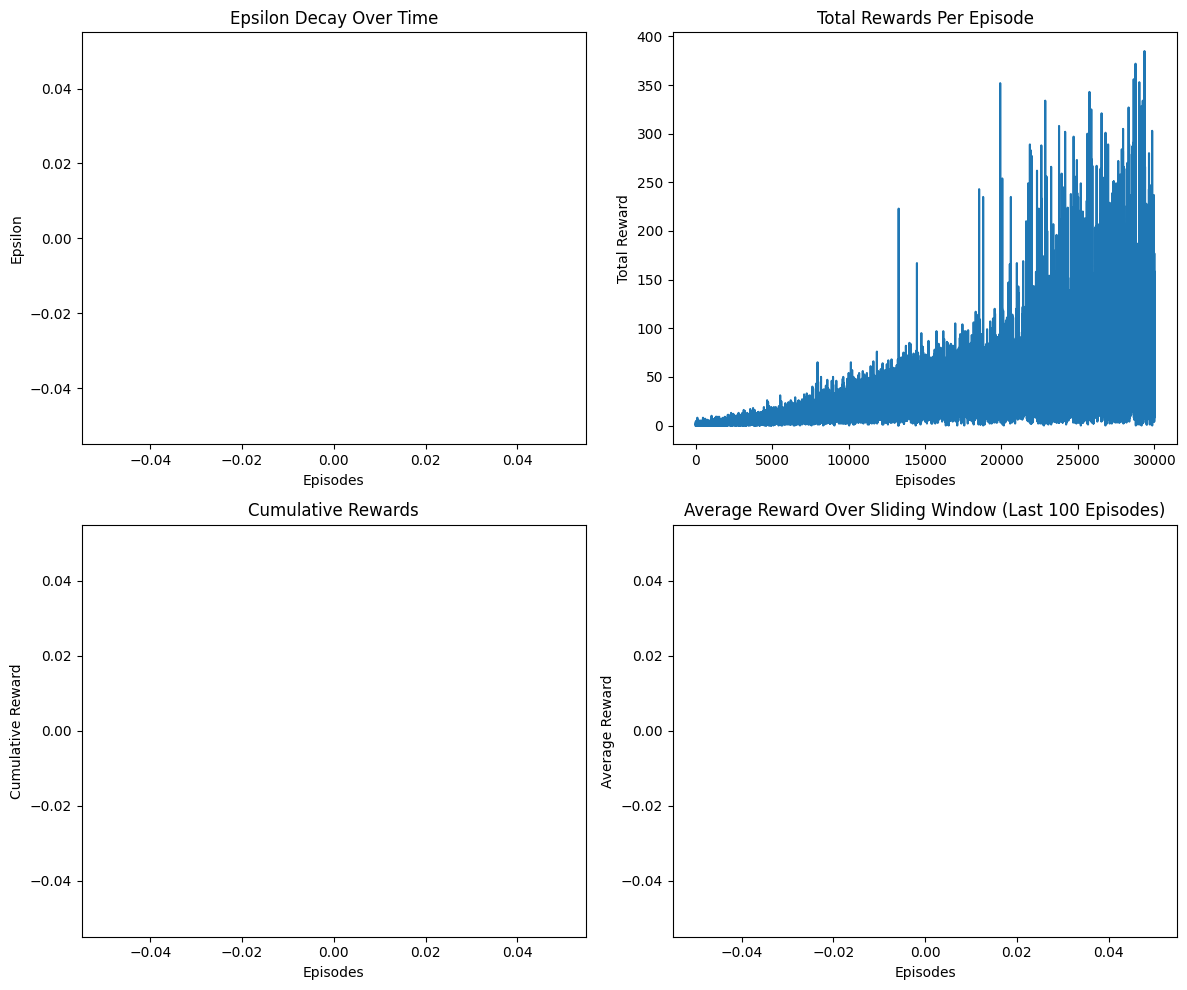

In [ ]:
# Create a 2x2 grid of plots to visualise some training metrics for Part 4
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Top Left: Epsilon Decay
axes[0, 0].plot(epsilon_decay_arr)
axes[0, 0].set_title("Epsilon Decay Over Time")
axes[0, 0].set_xlabel("Episodes")
axes[0, 0].set_ylabel("Epsilon")

# Top Right: Total Rewards Per Episode
axes[0, 1].plot(reward_history)
axes[0, 1].set_title("Total Rewards Per Episode")
axes[0, 1].set_xlabel("Episodes")
axes[0, 1].set_ylabel("Total Reward")

# Bottom Left: Cumulative Rewards
axes[1, 0].plot(cumulative_rewards)
axes[1, 0].set_title("Cumulative Rewards")
axes[1, 0].set_xlabel("Episodes")
axes[1, 0].set_ylabel("Cumulative Reward")

# Bottom Right: Average Reward Over Sliding Window
axes[1, 1].plot(avg_reward_arr)
axes[1, 1].set_title("Average Reward Over Sliding Window (Last 100 Episodes)")
axes[1, 1].set_xlabel("Episodes")
axes[1, 1].set_ylabel("Average Reward")

# MatPlot Lib to show
plt.tight_layout()
plt.show()


In [ ]:
def play_and_record(agent, env, save_path="agent_play.mp4", num_episodes=1):
    """
    Record gameplay of a trained agent with fixed random seed we used for reproducibility
    """
    # Reset random seed for reproducibility
    random.seed(42)
    np.random.seed(42)
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)

    agent.policy_net.eval()  # Set to evaluation mode
    agent.epsilon = 0  # Use greedy policy

    # Initialise video writer using OpenCv2
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(save_path, fourcc, 30, (160, 210))  # Accepotable resolution for video

    for episode in range(num_episodes): # Loop over our episodes (one)
        state, _ = env.reset()
        state = agent.preprocess_state(state)
        state = torch.cat([state] * 4).unsqueeze(0)  # Create initial state stack

        total_reward = 0
        done = False

        while not done:
            # Capture frame for video
            frame = env.render()  # Get RGB frame
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
            out.write(frame) #  Write frame to the video file

            # Choose action using greedy policy
            with torch.no_grad():
                q_values = agent.policy_net(state)
                action = torch.argmax(q_values).item()

            # Step in the environment
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Update state
            next_state = agent.preprocess_state(next_state)
            next_state = torch.cat([state.squeeze(0)[1:], next_state]).unsqueeze(0)
            state = next_state

            total_reward += reward

        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    out.release()
    env.close()
    print(f"Gameplay video saved to: {save_path}")


In [ ]:
def test_agent(agent, env, num_episodes, render=False):
    """
    Test the trained agent over multiple episodes and collect rewards.
    Supports different testing scenarios with flexible rendering and tracking.
    """
    agent.policy_net.eval()  # Set the policy network to evaluation mode
    total_reward_arr = []

    # Ensure epsilon is set to 0 to use only the greedy policy
    original_epsilon = agent.epsilon
    agent.epsilon = 0

    # Track agent lives (5 in Breakout)
    agent_lives = 5

    for episode in range(num_episodes):
        # Reset environment
        state, _ = env.reset()
        state = agent.preprocess_state(state)
        state = torch.cat([state] * 4).unsqueeze(0)  # Create initial state stack

        total_reward = 0
        dead = False
        done = False

        while not done:
            # Choose action using the trained policy
            with torch.no_grad():
                    q_values = agent.policy_net(state)
                    action = torch.argmax(q_values).item() # Choose the action with the highest Q value

            # Take a step in the environment
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # check if episode done

            # Handle life loss for breakout i.e  doesnt hit ball
            if hasattr(info, 'ale') and agent_lives > info.get('ale.lives', agent_lives):
                dead = True
                agent_lives = info.get('ale.lives', agent_lives)

            # Preprocess next state
            next_state = agent.preprocess_state(next_state)

            # Handle state when agent loses a life
            if dead:
                obs, _, _, _ = env.step(1)  # Restart action
                obs = agent.preprocess_state(obs)
                state = torch.cat([state.squeeze(0)[2:], next_state, obs]).unsqueeze(0)
                dead = False
            else:
                # Update state stack
                state = torch.cat([state.squeeze(0)[1:], next_state]).unsqueeze(0)

            total_reward += reward

        total_reward_arr.append(total_reward)
        print(f"Episode {episode + 1}: Total Reward = {total_reward}")

    # Restore the original epsilon value
    agent.epsilon = original_epsilon

    env.close()
    return total_reward_arr

In [ ]:
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')

# Load the trained model
agent = DQNagent(state_size, action_size, memory_length, epsilon, epsilon_decay, epsilon_min, batch_size, learning_rate, discount_factor)
agent.policy_net.load_state_dict(torch.load("dqn_breakout_final.pth"))
print("Trained model loaded.")

# Record a video of the agent playing
play_and_record(agent, env, save_path="breakout_agent_play.mp4", num_episodes=1)

/tmp/ipykernel_2526798/3318727620.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  agent.policy_net.load_state_dict(torch.load("dqn_breakout_final.pth"))
/home/olan_healy

Trained model loaded.


/home/olan_healy/anaconda3/envs/py310/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 1: Total Reward = 58.0
Gameplay video saved to: breakout_agent_play.mp4


Episode 1: Total Reward = 65.0
Episode 2: Total Reward = 72.0
Episode 3: Total Reward = 13.0
Episode 4: Total Reward = 95.0
Episode 5: Total Reward = 75.0
Episode 6: Total Reward = 116.0
Episode 7: Total Reward = 69.0
Episode 8: Total Reward = 50.0
Episode 9: Total Reward = 37.0
Episode 10: Total Reward = 19.0
Episode 11: Total Reward = 67.0
Episode 12: Total Reward = 64.0
Episode 13: Total Reward = 62.0
Episode 14: Total Reward = 54.0
Episode 15: Total Reward = 68.0
Episode 16: Total Reward = 38.0
Episode 17: Total Reward = 41.0
Episode 18: Total Reward = 223.0
Episode 19: Total Reward = 28.0
Episode 20: Total Reward = 44.0
Episode 21: Total Reward = 62.0
Episode 22: Total Reward = 96.0
Episode 23: Total Reward = 42.0
Episode 24: Total Reward = 11.0
Episode 25: Total Reward = 48.0
Episode 26: Total Reward = 144.0
Episode 27: Total Reward = 32.0
Episode 28: Total Reward = 58.0
Episode 29: Total Reward = 59.0
Episode 30: Total Reward = 104.0
Episode 31: Total Reward = 105.0
Episode 32: 

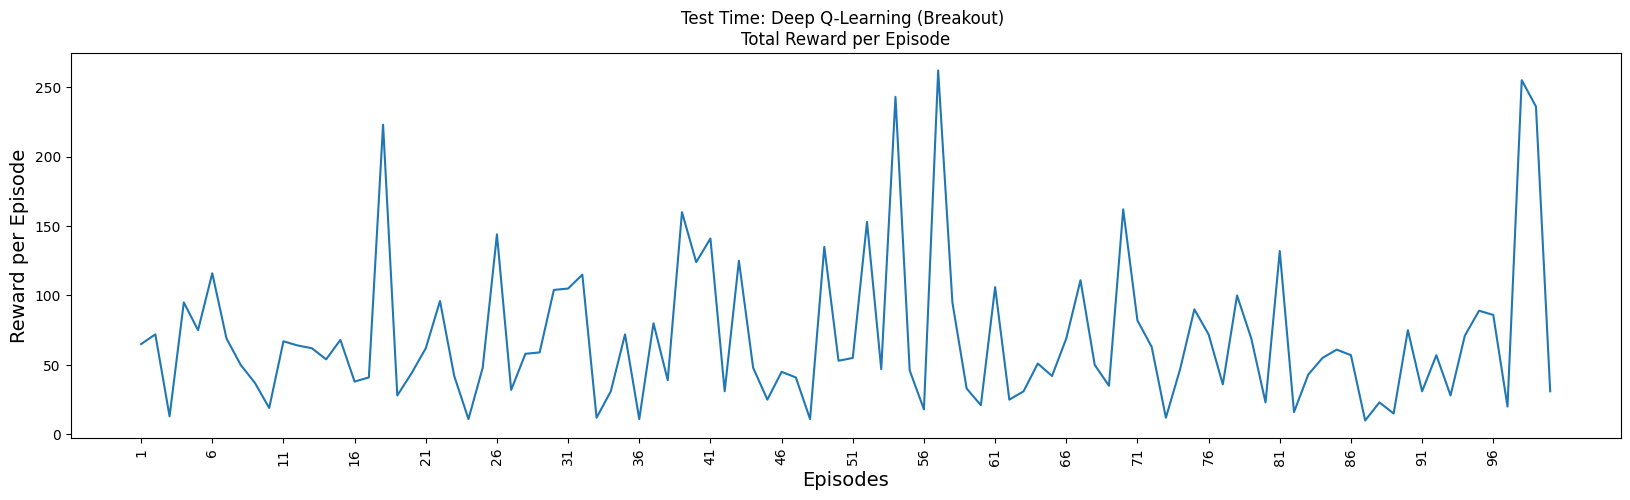

In [ ]:
# Call test agent function
test_rewards = test_agent(agent, env, num_episodes=100, render=False)

# Plot the results of this test
plt.figure(figsize=(20, 5))
plt.plot(test_rewards)
plt.title('Test Time: Deep Q-Learning (Breakout) \nTotal Reward per Episode')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Reward per Episode', fontsize=14)
plt.xticks(np.arange(0, len(test_rewards), 5), np.arange(1, len(test_rewards) + 1, 5), rotation=90)
plt.show()

# CS4287 Assignment 3: Deep Reinforcement Learning
Kevin Collins (21344256)  
Olan Healy (21318204)  
Caoimhe Cahill (21331308)

### 1. Why Reinforcement Learning is the Machine Learning Paradigm of Choice for this Task (3 marks)

Reinforcement Learning (RL) is the machine learning paradigm of choice for this task due to several key reasons:

1. **High-Dimensional Problems**:  
   Atari games usually have large state spaces represented by pixel-based visual inputs, which can be seen in Gym Documentation. RL algorithms excel at learning from high-dimensional inputs, making them a prominent solution.  
   *(Birchwood 2024)*  

2. **Trial and Error**:  
   RL doesn’t learn by data input and output like other machine learning methods. Instead, it learns by trial and error. This works with Atari games as they don’t have explicit input and output data. The agent learns directly from experience within the environment.  
   *(Birchwood 2024)*  

3. **Focus on Long-Term Goal**:  
   Atari games are sequential tasks where the agent must decide on actions that maximise cumulative rewards over time. RL is effective for these problems because it focuses on optimising long-term rewards. Research by Sutton and Barto (2018) highlights that RL does well in problems where decisions have to consider future implications, making it ideal for tasks like playing games.  

4. **Exploration and Exploitation**:  
   RL algorithms allow agents to balance exploration (trying new actions) and exploitation (using known successful strategies) *(Sutton et al., 2018)*. This adaptability is crucial in dynamic environments such as Atari games. Minh et al. (2013) shows that DQN can achieve human-level performance in Atari games by learning effective strategies through interaction with the environment.  

5. **Model-Free Learning**:  
   Many real-world environments, including the Atari games in OpenAI Gym, do not have predefined models for their environments. RL’s model-free approach allows learning optimal policies directly from state-action-reward data without knowledge of the environment’s dynamics. This was a significant factor in DQN’s success *(Mnih et al. 2013)*.  

These factors highlight why RL is the most suitable paradigm for this assignment.


### 2. The Gym Environment (3 marks)

**Chosen Atari Environment**: Breakout-v5

**Game Description**:  
The Atari game ‘Breakout’ is a classic arcade simulation. The player controls a paddle and hits a ball into a brick wall at the top of the screen. The goal is to try to break through the wall without letting the ball fall past the paddle. You have five lives during the game.

**Gym**:  
The following information comes from Gym’s Breakout Documentation found at:  
[https://www.gymlibrary.dev/environments/atari/breakout/](https://www.gymlibrary.dev/environments/atari/breakout/)  

We used the Atari environment provided by Gym. Gym is a standard API created by OpenAI for reinforcement learning. It also provides a diverse collection of reference environments.

**Environment Setup**:  
To initialise the Atari Breakout environment, we use the `make` function provided by the Gym library.

``` python
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
```

- **ALE** refers to the Arcade Learning Environment, which is used to simulate many Gym Atari environments.  
- **Breakout-v5** is a specific version of the Breakout environment.  
- `render_mode='rgb_array'` specifies the rendering mode, where frames are returned as image arrays.

---

### **Actions**
Breakout has an action space of 4 discrete actions. These actions and mappings are:

| **Num** | **Action** | **Description**                                            |
|---------|------------|------------------------------------------------------------|
| 0       | NOOP       | The agent does nothing; the paddle is stationary.           |
| 1       | FIRE       | The agent starts the game or serves the ball.               |
| 2       | RIGHT      | The agent moves the paddle to the right.                    |
| 3       | LEFT       | The agent moves the paddle to the left.                     |

The agent can choose from these actions to interact with the environment.

---

### **Observations**
The observation space in the Breakout environment provides the agent with information about the current state of the game. This data can be represented in different ways, depending on the configuration of the environment. The different observations for Breakout are:

| **Observation Type** | **Shape**      | **Range of Values** | **Characteristics**                                     |
|-----------------------|----------------|----------------------|--------------------------------------------------------|
| RGB (Default)         | (210, 160, 3) | 0 to 255            | Full colour visual representation like what humans see.|
| RAM                   | (128)         | 0 to 255            | Internal memory state of the game.                    |
| Grayscale             | (250, 160)    | 0 to 255            | Simplified image representation without colour.        |

### **Rewards**

You score points by destroying bricks in the wall. The reward for destroying a brick depends on the color of the brick. You lose points if the ball falls past your paddle.

### 3. Implementation (15 marks):

#### a. Capture and pre-processing of the data (3 marks)

We set up the gym environment using the `gym.make()` function. This is used to make the Atari Breakout environment.

``` python
env = gym.make('ALE/Breakout-v5', render_mode='rgb_array')
```


Here is an idea of the initial state of the breakout game to show how a frame looks.

![Inital State of Breakout](https://drive.google.com/uc?export=view&id=1jmgXLh8X_j-9j1l08IpSLOO9OGTZXReB)


The environment generates raw frames. We have used the render_mode “rgb_array”. Here are the first twenty frames.

![breakout first 20 frames](https://drive.google.com/uc?export=view&id=1ozfJ_vgm3rJTaJmoQsR27jWCuA9XXVSg)

To make the frames suitable for the DQN, then we use several transformations in the preprocess_state method shown here:

``` python
def preprocess_state(self, state):
    """Preprocess a single frame."""
    state = state[34:-16, :, :]  
    transform = T.Compose([
        T.ToPILImage(),
        T.Grayscale(),
        T.Resize((84, 84)),
        T.ToTensor()
    ])
    return transform(state).to(device)

```

First, we remove irrelevant parts of the frame, such as the scoreboard or padding at the top and bottom. This focuses the agent on the gameplay area, reducing unnecessary input data. T.Grayscale() then converts the frame from RGB to grayscale. This reduces the dimensionality of the input while retaining the essential information needed to make decisions. T.Resize((84, 84)) resizes the frame to 84x84 pixels. The DQN expects fixed-size inputs and 84x84 is a standard size used in Atari DQN implementations. Then, T.ToTensor() converts the processed frame into a PyTorch tensor. Finally, the pre-processed tensor is moved to the appropriate computation device (CPU or GPU) using .to(device).

This is what the first frame of the preprocessed data looks like.

![Inital State of Breakout preprocessed](https://drive.google.com/uc?export=view&id=1kUliO9G6qwzcXjyAjJee-t3WAtCGVOlU)

And similarly to the above, here are the first twenty frames after the preprocessing.

![breakout first 20 frames](https://drive.google.com/uc?export=view&id=1kp1vQwbotHQioTDhNHa5J-cxLC5rPqYS)

In Atari games, a single frame does not capture enough information about the environment due to the lack of motion data. To incorporate temporal information, multiple frames are stacked together:

``` python
state = torch.cat([state] * 4).unsqueeze(0)
```

This state is then passed to our model for training.

### b. The network structure (4 marks)

We use a DQN class to define our network architecture for our PyTorch-based Deep Q-Network. The documentation for [torch.nn](https://pytorch.org/docs/stable/nn.html) we used can be found here. We used **PyTorch** as it allows us to use GPU acceleration. It offloads computations to GPUs using CUDA, accelerating training. It also has many pre-built tools used to train our DQN. The weights of the layers are initialised using PyTorch's default **initialisation**, which we believe is sufficient for training our deep network.

The network begins with three convolutional layers which extract special features from the input, consisting of a stack of frames. We start with 4 channels or stacked frames in `conv1`. This outputs through 32 filters which are passed to `conv2`. `Conv2` then outputs through 64 filters to `conv3`. As we move through each convolutional layer, the stride is decreased. The convolutional layers do not use padding, meaning that each convolution reduces the spatial dimensions of the input. The stride controls the step size by which the filter moves across the input. Skipping positions when the stride is higher allows for dramatic increases in training speed. Stride does this by reducing spatial dimensions which reduces the number of computations in each run. The **ReLU** activation function is applied to each convolutional layer. This is to allow non-linear behaviour, enabling the network to learn complex mappings between states and Q-values.

We then have 2 fully connected layers where the output is flattened and passed through. This is to integrate the spatial features from the convolutional layers into a more compacted representation of state. After the second fully connected layer, there is an output where `n` equates to the number of actions available. Each has a Q-value where Q is the recommendation score.

We then use the Adam optimizer to update weights to minimise the loss between the predicted and target Q-values.

``` python
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions, learning_rate):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(4, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

```

The forward pass method controls the flow of data through the DQN network. It starts with the three convolutions, which extract the spatial features from the input. The output of the convulsions is a 1D tensor for dense layers. It then uses two fully connected layers to combine the features and output Q-values.

``` python
def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.fc1(x.view(x.size(0), -1)))
        return self.fc2(x)
```

### Q learning update applied to the weight's discussion (3 marks).  
The Q-learning in our code is performed in the train() function. This method updates the weights of the policy network by minimising error between predicted and target Q-values.  

It starts with:

``` python
batch = random.sample(self.memory, self.batch_size)
states, actions, rewards, next_states, dones = zip(*batch)
```

This agent maintains a replay buffer. This stores experiences from previous iterations and interactions stored in tuples. There is the current state, the action that was taken, the reward that was received and the next state. There is also a flag that indicates when an episode is done. When training a random sample of these previous experiences is gotten in this code sample.  

Then each sampled experience is converted to tensors using PyTorch.

``` python
states = torch.cat(states).to(device)
next_states = torch.cat(next_states).to(device)
actions = torch.tensor(actions).to(device)
rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
dones = torch.tensor(dones, dtype=torch.bool).to(device)
```

These are moved to GPU. Each variable is converted to its necessary type.

Here we move onto using the network to predict Q-Values for the current state.  

``` python
q_values = self.policy_net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)
```

However, since all action associated values are outputted, we use the gather method to take the Q-value for the action taken.

The Q-Values are computed using the Bellman equation.



![Bellman Equation](https://drive.google.com/uc?export=view&id=13hHwpCYf2ZiguAFkLvrWSny7VEf6NlLv)


``` python
next_q_values = self.target_net(next_states).max(1)[0]
targets = rewards + (self.discount_factor * next_q_values * (~dones))
```

We begin by computing the Q-values for the next states using the target network. It then selects the maximum Q-value returned from each state in the batch. This assumes it is taking the best option. It also has a flag to make sure there is no Q-value given to the last state in episode.

We then finally calculated the loss. We chose to use Mean Squared Error. The loss here shows how far our predicted Q-Valeus are far from the ideal Q-values.


![Loss](https://drive.google.com/uc?export=view&id=1LIAyLtN0uLaKSetj8hoa5VXD-QGociDd)

``` python
loss = nn.MSELoss()(q_values, targets)
```

We then update weights.

``` python
self.policy_net.optimizer.zero_grad()
loss.backward()
self.policy_net.optimizer.step()
```

We update the weights using the computed gradients and the Adam optimizer.

### d. Independently researched concepts(5 marks).  

### Random Seed Initialisation

We followed the guide PyTorch provides when we implemented random seeding in our code, [PyTorch Randomness Documentation](https://pytorch.org/docs/stable/notes/randomness.html).

"Randomness in PyTorch is controlled by a combination of the global random seed and the state of the generator. Setting the seed ensures reproducibility by making operations that rely on random number generation deterministic."

We wanted to make our results reproducible. This was needed when we ran into issues with disconnections from host machines running the computations and we had to recompute. Using the random seed, we got the same sampling from the replay buffer, **initialisation** of network weights, and action selection when the model was being greedy during exploration. If we didn’t set this seed, any slight variations could lead to different training results. This would make it difficult to improve the model.

```python
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
```

### Techniques to Counter Catastrophic Forgetting

Catastrophic forgetting is an issue that often can occur in reinforcement learning, where the model overwrites old knowledge with new experiences.

To hinder this, we used experience replay. The purpose of this is to store all experiences in the replay buffer. The replay buffer is then sampled randomly for training. This removes the importance of the order that the events take place. The batch taken in the code block is simply a random assortment of different experiences.

```python
self.memory = deque(maxlen=memory_length)

batch = random.sample(self.memory, self.batch_size)
```

### Techniques to Counter Maximisation Bias

Maximisation bias occurs because the same network is used to compute two values: the action to take and the Q-value of that action. This can lead to the overestimation of Q-values. During the maximisation process, errors or noise over time can inflate the Q-value because the algorithm always selects the highest value, which could include the error component. This overestimation accumulates over time, leading to unstable and overly optimistic Q-values.

As a reference on the methods involved, we followed this tutorial:  
[YouTube - Jabrah Tutorials: Q-Learning Overestimation Bias](https://www.youtube.com/watch?v=FIQJ6Oo1Y8Q&ab_channel=JabrahTutorials)

To solve this, we use an additional `target_net` to provide target Q-values that update less frequently. This leads to more stable Q-values targets.

```python
self.target_net = DQN((4, 84, 84), self.action_size, self.learning_rate).to(self.device)

# Synchronise target network with policy network
self.update_target_policy()
```

### 4. Plots (3 marks)  

![Plots from code](https://drive.google.com/uc?export=view&id=1rqokhf04FSObjrpRjvel6x600ldJ5xLx)


<br>

Note: Due to a crash and missing saved data for earlier episodes, the epsilon decay, cumulative rewards, and average reward over sliding window plots only represent the last 18,000 episodes.However, the total rewards per episode were saved for all episodes and provide a complete view of the training process. We believe the missing data does not significantly detract from understanding the agent's overall learning trajectory and otherwise we would have had to run the whole thing again (which took a long time) just to fill in the starting tegractory of these.

####**Epsilon Decay**  

This plot shows how the epsilon value decreases over the episodes. Epsilon is the parameter in the epsilon-greedy policy that controls the exploration-exploitation trade-off:

- High epsilon (closer to 1): The agent explores by taking random actions.
- Low epsilon (closer to 0): The agent exploits its learned policy by choosing actions with the highest predicted Q-value.

The epsilon value decays smoothly over the training episodes, starting at 1.0 and approaching its minimum value. This means the agent begins with heavy exploration and gradually shifts to exploitation as training progresses as planned. However, since we ran the training in multiple steps and didn’t save the epsilon decay values for all episodes, this plot only reflects the last 18,000 episodes. Despite this limitation, it still provides a clear picture of the decay trend..

 <br>

####**Total Rewards Per Episode**

This plot shows the total reward the agent accumulates during each episode over the course of training. The total reward starts low in the early episodes, which is expected as the agent initially explores and acts randomly. Over time, there is a clear upward trend in rewards, indicating that the agent is learning an effective policy. The spikes in reward suggest that the agent occasionally discovers optimal strategies but still struggles with consistency in some episodes. Since we saved this data across all episodes, the plot gives a complete view of the agent's progress throughout the training.

 <br>

####**Cumulative Rewards**

This plot shows the cumulative sum of rewards earned by the agent across all episodes during training. The cumulative rewards increase steadily over the episodes. The slope of the line becomes steeper as training progresses, reflecting that the agent is earning more rewards per episode in the later stages. Like the epsilon decay plot, this plot only represents the last 18,000 episodes due to the lack of saved data from earlier episodes. Nevertheless, the trend still provides valuable insights into the agent’s learning process.

 <br>

####**Average Reward Over Sliding Window**

This plot shows the average reward over the last 100 episodes (a sliding window), providing a view of the agent's performance over time. The average reward shows a clear upward trend as the agent learns better policies, peaking in the later stages of training. There are some fluctuations, especially toward the end, indicating variability in the agent's performance during certain training periods. As with the epsilon decay and cumulative rewards plots, this plot represents only the last 18,000 episodes. Despite this, the upward trend demonstrates the agent’s improvement in performance during this period.

 <br>



###5. Videos and plots with short accompanying explanations of the information conveyed (1 mark).  

Link to video of our agent playing: https://drive.google.com/file/d/1VNI9w5C5LOVihJznf-ohMI4G3NPLpO3e/view?usp=sharing

###6. Evaluation of the results (5 marks):  

![Eval Of Results](https://drive.google.com/uc?export=view&id=19TYSyzllrZ366Cfh0r53cnat1xLCe8d3)


####a. How does one evaluate the performance of the RL agent?  

To evaluate the RL agent, we used a combination of metrics and methods.

<BR>

1. **Training Phase Evaluation:**

- **Win Threshold Metric (50)**

    - Our agent's ability to consistently exceed the win threshold, which we have set to 50, during the training phase shows its learning progress.

    - The training plot of “Total Rewards Per Episode’ shown earlier, shows that the agent started with very low rewards but gradually improved, exceeding the threshold in episodes later on.

    - The “Average Reward Over Sliding Window” plot shown earlier highlights the agent's stable long-term improvement, showing success over time.

- **Cumulative Reward:**

    - The “Cumulative Rewards” graph steadily goes upwards which highlights the agents’ continuous learning and improvement over time.

- **Epsilon Decay:**

    - The “Epsilon Decay” graph shows the decrease of exploration over episodes. This highlights the transition from exploring random actions to exploiting learned strategies. This is an important part for effective learning.

    - The “Epsilon Decay” graph shows the decrease of exploration over episodes. This highlights the transition from exploring random actions to exploiting learned strategies. This is an important part for effective learning.

<br>

2. **Testing Phase Evaluation:**

- **Reward Distribution:**

    - The testing plot shows variability in the rewards across episodes, with some episodes achieving high scores (above 200). This shows the agent’s learned policy can be effective in some scenarios.

    - However, there is also a high level of inconsistency as the agent does not consistently perform well in every episode. Some struggle to even rise above 50.

- **Consistency Across Episodes & Long-Term Trends:**

    - During the testing phase, the agent uses a fully greedy policy.

    ```python
# Ensure epsilon is set to 0 to use only the greedy policy
    original_epsilon = agent.epsilon
    agent.epsilon = 0
```

    - This removes exploration and only focuses on exploitation. Although the agent has occasional high-performance episodes, the variability suggests the agent’s policy might not be fully robust across all game states or scenarios.

<br>

These metrics are all critical when evaluating how well the RL agent performs during training and testing. Although there is variability, if the agent was trained for more episodes and there was further refinement, there is a possibility that these results could improve.

####b. Are the metrics that we have seen to date relevant?  

Yes, the metrics used during the training and testing phases are highly relevant. They easily show the agents' learning and performance abilities.

1. **Training Phase Metrics:**

- **Total Rewards Per Episode:**

    - Total Rewards Per Episode tracks the agents' progress episode by episode.

    - This metric is relevant because it helps us confirm that that the agent is gradually performing better over time and not getting worse.

    - The upward trend in our graph shows that the agent is successfully learning from its environment.

- **Cumulative Rewards:**

    - This metric shows the overall learning progress and the total rewards collected by the agent. The steadily increasing trend shown on our graph earlier shows effective training by the agent.

- **Epsilon Decay:**

    - This metric tracks how the agent transitions from exploration to exploitation. A smooth decline ensures a good amount of exploration in the early stages, which is necessary for discovering effective strategies.

2. **Testing Phase Metrics:**

- **Reward Per Episode:**

    - This metric provides us visually the agent’s ability to perform under greedy policy conditions. The variability in rewards during testing highlights that the policy could be improved for consistency.

    - Although the agent achieves high rewards in some episodes during testing, the inconsistency across episodes suggests room for improvement in robustness.

<br>

While these metrics are highly relevant, other metrics such as plotting the discounted reward (how well the agent balances immediate and long-term rewards) or plotting sample efficiency (how many environment interactions are needed to learn an effective policy) could give additional insight into the agents’ performance.

###Extra

####**Running off CSIS server to utilise Nivida A100 GPU**

Given the computational requirements for training a DQN , none of our team members had access to a GPU capable of handling the workload effectively. One of our members had access to CSIS server for Final Year Project so we decided to use this to run our  notebook on this server (with permission of course). We wrote our code initially in Google Collab using their free GPU (like we did with all previous assignments); however, we did not run the training all the way through. We ran the logic to make sure we had no errors then went at setting up our local environment on csis server.  

 <br>

We made a new python virtual environment and then downloaded necessaries libraries (included a code block at top for these installs, but we also had to download some libraries such as Mat Plot Lib and openCV2). After we were sure we had everything installed, we then ran this command on the server:

```powershell
jupyter notebook   --NotebookApp.allow_origin='https://colab.research.google.com'   --port=8890   --NotebookApp.port_retries=0
```

We then went created a SSH tunnel locally to connect to this:

```powershell
ssh -L 8890:localhost:8890 olan_healy@patten.csis.ul.ie
```

From running the first command, you get an output like this:
![Command Output](https://drive.google.com/uc?export=view&id=1xc8TPzqvTGbJibLSnwy1S1NKiFPIYxcb)


Which you can then copy into Google Collab to connect to a local runtime
![Command Output](https://drive.google.com/uc?export=view&id=1MNECXLv37ZDHwTAuyil5vSyL7z4EH05d)



<br>

You mentioned in your last lecture that you mentioned exploring better solutions for students to run resource-intensive assignments like this in the future. We think this route could be a real possibility. The only issue we faced with this was connectivity issues (VPN server timeouts)


###References (P/F).
Our existing source is included at top. References also included through out write up

Sutton, R.S. and Barto, A.G., 2018. Reinforcement learning: An introduction. MIT press.

Mnih, V., 2013. Playing atari with deep reinforcement learning. arXiv preprint arXiv:1312.5602.

Birchwood. (2024) Birchwood University, What are the Reinforcement Learning Advantages and Disadvantages?, Available at: https://www.birchwoodu.org/reinforcement-learning-advantages-and-disadvantages/#:~:text=Reinforcement%20learning%20minimizes%20the%20reliance,scarce%20or%20challenging%20to%20label

Jupyter notebook connecting to local runtime: Google Colab

TensorFlow Adam Optimiser: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

venkatapathy, baratchandar. “Evaluation Metrics for Reinforcement Algorithms.” Medium, 25 Nov. 2023, Available at: https://medium.com/@barathchandarcse/evaluation-metrics-for-reinforcement-algorithms-ff2bf5869fe4  